# Building a GAN in 8 simple Steps

## STEP 1.  Importing Necessary Modules


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input, BatchNormalization
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


## STEP 2. Building A Simple Generator Network


In [2]:

def build_generator():
    #Initializing a neural network
    generator = Sequential()
    
    #Adding an Input layer to the network
    generator.add(Dense(units=256,input_dim=100))    

    #Activating the layer with LeakyReLU activation function
    generator.add(LeakyReLU(0.2))

    #Applying Batch Normalization 
    generator.add(BatchNormalization(momentum=0.8))

    #Adding a second layer	
    generator.add(Dense(units=512))
    
    #Adding a third layer	
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    #The output layer with 784(28x28) nodes
    generator.add(Dense(units=784, activation='tanh'))
    
    #Compiling the Generator Network with loss and optimizer functions
    generator.compile(loss='binary_crossentropy', optimizer= keras.optimizers.adam(lr=0.0002, beta_1=0.5))
    print(generator.summary())
    
    return generator

## STEP 3. Building A Simple Discriminator Network

In [3]:

def build_discriminator():
    #Initializing a neural network
    discriminator=Sequential()
    
    #Adding an Input layer to the network
    discriminator.add(Dense(units=1024, input_dim=784))
    
    #Activating the layer with LeakyReLU activation function
    discriminator.add(LeakyReLU(0.2))
    
    #Adding a dropout layer to reduce overfitting
    discriminator.add(Dropout(0.2))
       
    #Adding a second layer
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    #Adding a third layer	 
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    #Adding a forth layer
    discriminator.add(Dense(units=128))
    discriminator.add(LeakyReLU(0.2))
    
    #Adding the output layer with sigmoid activation
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    #Compiling the Discriminator Network with loss and optimizer functions
    discriminator.compile(loss='binary_crossentropy', optimizer = keras.optimizers.adam(lr=0.0002, beta_1=0.5))
    print(discriminator.summary())
    return discriminator






*   **The above 2 code blocks simply define two different neural networks. The only major difference between the generator and the discriminator network are the inputs and outputs.**

*   **The generator Network takes random noise as input and tries to recreate the images  from the training set using while the discriminator tries to distinguish the images generated by the generator Network from the actual training Set images.**

*   **The discriminator is a binary classifier while the Generator generates an output similar to the actual images.**


## STEP 4. Building A GAN Network


In [4]:

#Stacking The Generator And Discriminator Networks To Form A GAN

def gan_net(generator, discriminator):
  
    #Setting the trainable parameter of discriminator to False
    discriminator.trainable=False
    
    #Instantiates a Keras tensor of shape 100 (Noise shape)
    inp = Input(shape=(100,))
    print("inside the gan_net() function, \n", "type of input : ",type(inp),"\nInput data : ",inp)
    
    #Feeds the input noise to the generator and stores the output in X
    X = generator(inp)
    print("ouptut generated by Generator : ",type(X), "\ndata : ", X)
    
    #Feeds the output from generator(X) to the discriminator and stores the result in out
    out= discriminator(X)
    print("output generated by Discriminator : ", type(out), "\ndata : ", out)
    #Creates a model include all layers required in the computation of out given inp.
    gan= Model(inputs=inp, outputs=out)
    print("information of GAN model generated : \n")
    #Compiling the GAN Network
    gan.compile(loss='binary_crossentropy', optimizer = 'adam')
    print(gan.summary())
    return gan

*   **The above method when invoked creates a GAN by stacking the generator and discriminator networks.**

*   **The trainable parameter of the discriminator network when set to false freezes the weights in the discriminator network while the generator network is trained. This prevents the discriminator network from being updated while the generator generates new images from noise.**

*   **The input shape to the GAN network is the shape of the noise. The noise is fed to the generator and its output is fed to the discriminator which classifies the image as original or generated.**


## STEP 5. Plotting The Generated Images


In [5]:
#Method to plot the images
def plot_images(epoch, generator, dim = (10,10), figsize=(10,10)):
    #Generate a normally distributed noise of shape(100x100)
    noise= np.random.normal(loc=0, scale=1, size=[100, 100]) 
    #Generate an image for the input noise
    generated_images = generator.predict(noise)
    #Reshape the generated image 
    generated_images = generated_images.reshape(100,28,28)
    
    #Plot the image 
    plt.figure(figsize=figsize)
   
    #Plot for each pixel
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i],cmap='gray', interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()

**The above method generates plots for the images created by the generator from the normally distributed noise input.** 





## STEP 6. Method For Training


In [6]:

#Traing method with training set, default epoch and default batch_size as arguments.

def train(X_train, epochs=5, batch_size=128):
    
    
    #Initializing the GAN 
    generator= build_generator()
    discriminator= build_discriminator()
    gan = gan_net(generator,discriminator)
    
    
    # Training the model for specified epochs
    
    for epoch in range(1,epochs+1 ):
        print("###### @ Epoch ", epoch)
        
        #tqdm module helps to generate a status bar for training 
        for _ in tqdm(range(batch_size)):
          
            #Random noise with size batch_sizex100
            noise= np.random.normal(0,1, [batch_size, 100])
            print("noise generated : \n", noise)
            #Generating images from noise
            generated_images = generator.predict(noise)
            print("\ngenerated fake image : ", generated_images)
            
            
            
            #taking random images from the training set 
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            
            
            #Creating a new training set with real and fake images 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)  
            y_dis[:batch_size]=1.0 # label for real images
            
            #Training the discriminator with real and generated images
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Labelling the generated images as real images(1) to trick the discriminator
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            #Freezing the weights of the discriminator while training generator
            discriminator.trainable=False
            
            #Training the gan network
            gan.train_on_batch(noise, y_gen)
        
        #Plotting the images for every 10 epochs
        if epoch == 1 or epoch % 10 == 0:
          plot_images(epoch,generator,dim = (10,10) , figsize=(15,15))

## STEP 7.  Loading And Processing MNIST Data


In [7]:
#Unpacking the training data from mnist data dataset
(X_train, _), (_, _) = mnist.load_data()

#Converting to float type and normalizing the data
X_train = (X_train.astype(np.float32) - 127.5)/127.5

# convert shape of X_train from (60000, 28, 28) to (60000, 784) - 784 columns per row
X_train = X_train.reshape(60000, 784)


## STEP 8. Training The GAN







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
__________________________________________

  0%|          | 0/128 [00:00<?, ?it/s]

ouptut generated by Generator :  <class 'tensorflow.python.framework.ops.Tensor'> 
data :  Tensor("sequential_1/dense_4/Tanh:0", shape=(?, 784), dtype=float32)
output generated by Discriminator :  <class 'tensorflow.python.framework.ops.Tensor'> 
data :  Tensor("sequential_2/dense_9/Sigmoid:0", shape=(?, 1), dtype=float32)
information of GAN model generated : 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1487376   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1492993   
Total params: 2,980,369
Trainable params: 1,486,864
Non-trainable params: 1,493,505
_________________________________________________________________
None
###### @ Epoch  1
n

  1%|          | 1/128 [00:06<13:30,  6.38s/it]

noise generated : 
 [[-1.59437633 -1.25010227  1.13360119 ...  1.09001419  0.50483899
  -0.22600573]
 [-2.03241595  1.07668105  0.10053784 ...  0.83832196 -0.21887165
  -0.08499949]
 [-0.96264143 -0.28711975  2.60611749 ...  0.78168533  0.87535857
  -0.26588988]
 ...
 [ 0.19616035 -1.10196756  1.25785394 ...  0.81414237  0.53159712
   0.94626637]
 [ 2.46227835 -0.41333919  1.10719983 ... -0.84410211  2.34675838
   1.75671233]
 [-0.58794758  0.0639024  -0.38790815 ... -1.16751059  1.41599145
  -1.11805982]]

generated fake image :  [[-0.28500548 -0.39043915  0.26528424 ...  0.8943849  -0.27884832
  -0.50160277]
 [-0.28291604  0.19695006 -0.30103016 ... -0.3120932   0.5967324
  -0.05078167]
 [ 0.06691616 -0.2587897  -0.47792652 ...  0.6626485  -0.12281391
   0.13491964]
 ...
 [ 0.28671247  0.5658341   0.1323831  ...  0.6992498  -0.42997563
  -0.04656334]
 [ 0.10800603  0.3265416  -0.5125988  ...  0.35902563 -0.023436
   0.08048993]
 [-0.10455603 -0.19726624 -0.23076689 ...  0.5202156  -0

  2%|▏         | 3/128 [00:06<06:42,  3.22s/it]

noise generated : 
 [[ 1.28679155 -0.67888698 -0.69474905 ... -0.36872039 -1.01963003
  -0.40734794]
 [ 0.02245129  0.32315861  0.63438653 ...  0.44954728  0.18814804
  -0.28726789]
 [ 0.33548476  0.07637275 -0.35962897 ...  0.04306256 -1.02574404
  -0.42709951]
 ...
 [ 0.93305165  2.12034589  0.10477989 ... -1.99349336  0.04685134
   1.52294102]
 [-0.67567553  0.91063211 -0.82402115 ... -0.08002751 -2.00643519
   1.00018823]
 [-0.57629844 -0.21340424  0.20162865 ... -2.74409383 -0.27046463
  -1.20803158]]

generated fake image :  [[-0.18354908 -0.25758383 -0.5688655  ...  0.35674465  0.07509176
  -0.5339965 ]
 [ 0.14825527  0.40469393 -0.64231336 ...  0.5303505  -0.75342834
  -0.2145733 ]
 [ 0.14620832  0.37682724  0.32676253 ...  0.4256085  -0.30101478
  -0.6974469 ]
 ...
 [ 0.24429108  0.6892517  -0.4930047  ...  0.8196532  -0.8086614
  -0.5000302 ]
 [-0.03886189  0.8791154  -0.7903065  ...  0.58809656 -0.85939676
   0.22853458]
 [ 0.28279093  0.6710142  -0.35969624 ...  0.26630273 

  4%|▍         | 5/128 [00:07<03:26,  1.68s/it]

noise generated : 
 [[ 0.33221511  0.58164808  1.29097068 ... -0.02867742 -0.31045296
  -0.47716222]
 [-1.36781578  0.87459904  1.75853649 ...  1.0017523   0.50612823
  -0.71556958]
 [-1.27700915  0.96162103  0.62049967 ...  0.55234368 -3.60890417
   1.06508879]
 ...
 [ 1.17113609  1.02558477  1.12531188 ...  0.33936804 -0.89209082
   0.01339527]
 [-0.63183758 -0.5645624  -0.11080533 ...  0.1366205   0.21867473
  -0.76546218]
 [ 0.93140609 -0.84248215  0.83015581 ...  0.36103351 -0.01653282
  -0.645218  ]]

generated fake image :  [[ 0.7650239   0.02449689 -0.6570208  ...  0.58838904 -0.65547353
  -0.74038625]
 [ 0.07662243  0.06583263 -0.7414091  ...  0.9212879  -0.2392748
  -0.8068469 ]
 [ 0.68619853  0.43942094 -0.5909531  ...  0.4612651  -0.46366554
  -0.970378  ]
 ...
 [ 0.62928987  0.5400801  -0.2788547  ...  0.7644528  -0.8345689
  -0.55879855]
 [ 0.9321085   0.85050344 -0.89061546 ...  0.90786284 -0.6390573
  -0.6695071 ]
 [-0.39329922  0.88957155 -0.39680347 ...  0.9720966   0

  5%|▍         | 6/128 [00:07<02:29,  1.23s/it]

noise generated : 
 [[-0.03566963 -0.29454466  0.88777789 ... -0.52637766 -0.05825349
  -1.03276951]
 [-0.81558914  0.50377268  0.21208313 ... -0.14763836  0.69276245
  -0.05007661]
 [ 0.04645524 -0.31097989  1.06458996 ... -0.35499831 -0.76373406
  -0.58671705]
 ...
 [ 0.76564256 -0.52426094  0.48385366 ...  0.24123596 -0.25407008
  -1.77272421]
 [-0.18855241 -0.13770325  0.13025455 ...  0.57113588 -0.03465237
   1.17322992]
 [-2.20376189  0.93058842  0.77472595 ...  0.48052707 -0.15074515
   1.79029127]]

generated fake image :  [[ 0.8386738   0.6129604  -0.6917009  ...  0.8740486  -0.88433886
  -0.7040615 ]
 [ 0.454117    0.55047905 -0.5646513  ...  0.7772106  -0.03188697
  -0.58087856]
 [ 0.5253936   0.4273936  -0.77674145 ...  0.78596264 -0.0233323
  -0.63409275]
 ...
 [ 0.5684077   0.93110526  0.13418388 ...  0.9227751  -0.30540228
  -0.9383494 ]
 [ 0.8210715   0.84539443 -0.9722284  ...  0.82504994 -0.80840284
  -0.8143662 ]
 [ 0.23678675 -0.09510408 -0.7625929  ...  0.8383617  

  6%|▋         | 8/128 [00:07<01:29,  1.33it/s]

noise generated : 
 [[ 0.17373312 -0.16329078  0.39543813 ... -1.83916843 -0.93318719
  -0.19115246]
 [ 0.48662257  0.23244014  0.66924296 ...  0.9267598  -0.63873047
   0.08847249]
 [ 1.1669509   1.1867008  -2.0048685  ...  0.08484987 -0.03963919
   0.50939074]
 ...
 [ 1.02274894  1.32458879 -0.73736074 ... -2.20427677 -1.13137676
  -0.8515385 ]
 [ 1.957276    1.27200313 -0.01031626 ... -0.532342    1.82446366
  -0.08562195]
 [-0.33148357 -1.31221215 -2.04432049 ... -0.91464352  0.15105535
   2.03675401]]

generated fake image :  [[ 0.44824645  0.2964468  -0.63418984 ...  0.42352438 -0.80361325
  -0.6903151 ]
 [ 0.83836573  0.1433639  -0.6900127  ...  0.9359654  -0.4956702
  -0.7651872 ]
 [ 0.60418314  0.8755932  -0.9395242  ...  0.9837446  -0.7254148
  -0.9620314 ]
 ...
 [ 0.69743145  0.29568595 -0.8739357  ...  0.9380256  -0.88152546
  -0.6440201 ]
 [ 0.7659824   0.01086155 -0.9598041  ...  0.94612205 -0.8884148
  -0.43255568]
 [ 0.9622264   0.9922983  -0.93597335 ...  0.9918281  -0

  8%|▊         | 10/128 [00:08<00:58,  2.02it/s]

noise generated : 
 [[-0.76838017 -0.21998566 -1.6481175  ...  0.37303622  0.46821705
  -0.87968714]
 [ 0.57327493  1.48714973  0.01457467 ...  0.66798279 -2.43354721
  -1.57881926]
 [-2.09460098  0.62020453  0.27942194 ... -0.20671062  0.38607953
  -2.16449459]
 ...
 [ 0.93114617 -0.75926239 -0.35144712 ... -0.22331033 -0.40072185
  -1.07176275]
 [-2.06402129  0.46379537  0.90089509 ... -1.46707608 -1.32059892
  -0.29681035]
 [ 0.89324305  1.18369329  0.07285907 ...  1.86420326 -0.50932297
  -0.49239984]]

generated fake image :  [[ 0.8266796  -0.72912955 -0.89966065 ...  0.564346   -0.71582884
  -0.752918  ]
 [-0.00939575  0.44121596 -0.8602495  ...  0.82968205  0.37247723
  -0.7738525 ]
 [ 0.7875993   0.09672932 -0.9274896  ...  0.6282356  -0.6737807
  -0.5794706 ]
 ...
 [ 0.76231897  0.835175   -0.8830323  ...  0.81980294  0.03257873
  -0.3661465 ]
 [ 0.05868511  0.8536503  -0.98922    ...  0.88226026 -0.62372226
  -0.6164454 ]
 [ 0.82150614  0.08463626 -0.9367752  ...  0.8759203  

  9%|▊         | 11/128 [00:08<00:47,  2.48it/s]


generated fake image :  [[ 0.2815137   0.19378167 -0.44835365 ...  0.76951694  0.24338049
  -0.6431861 ]
 [ 0.6012986  -0.75032496 -0.9573239  ...  0.78749156  0.5011312
  -0.39041117]
 [ 0.10395052 -0.5433273  -0.974946   ...  0.7417685   0.9336609
  -0.64672965]
 ...
 [ 0.69969136 -0.8633333  -0.968214   ...  0.5942806   0.5811183
  -0.63425535]
 [ 0.00679744 -0.18588799 -0.9742388  ...  0.75675046  0.27619758
  -0.27986896]
 [ 0.50912684  0.22203204 -0.9901067  ...  0.78474945  0.6985045
  -0.94668365]]
noise generated : 
 [[ 0.09701946 -0.74851506  0.45231275 ...  0.65410832 -0.2983185
  -0.58972328]
 [-0.82627968 -0.33742093 -0.30559818 ...  2.16549353  0.10723176
   1.26235426]
 [-1.3913547   1.33760245 -0.6197996  ... -0.42024313  0.32944789
   0.92345504]
 ...
 [ 1.49874341  0.80952958 -1.51949501 ... -0.11901408 -0.45011163
  -0.326909  ]
 [-1.5642083   0.91292922  1.44028508 ...  0.11965441  0.71890752
   1.83683959]
 [-1.11453225  0.57604604  1.14667189 ...  1.40752696 -0.2

  9%|▉         | 12/128 [00:08<00:39,  2.94it/s]

noise generated : 
 [[ 1.6791998   0.30774605  0.62018854 ... -0.77140916  0.47680941
   0.26180599]
 [ 0.79539443  0.1323908   0.39094624 ... -0.80568521  0.76879949
   0.89831792]
 [ 0.85306902 -0.57915707 -1.52340803 ... -3.11980972  1.04051089
   0.35535491]
 ...
 [ 1.35513137 -0.10703963  0.73665407 ...  0.58843987  0.5699171
  -0.45093933]
 [-1.10074538  1.11864935 -0.70504125 ...  0.42063568  0.7356925
  -1.69988947]
 [-1.69950781 -0.51280969  0.39423335 ... -0.314101    0.08677398
  -0.9033531 ]]

generated fake image :  [[ 0.22350468 -0.64819056 -0.941401   ...  0.7368976   0.79849476
   0.12401949]
 [-0.45343065 -0.20827214 -0.9774775  ...  0.7457621   0.12269341
  -0.48249662]
 [-0.07082211 -0.525568   -0.9957202  ...  0.4487224  -0.07130041
  -0.4488977 ]
 ...
 [ 0.3115414  -0.5305254  -0.88009065 ...  0.19705024  0.29355407
  -0.03361076]
 [-0.7266422  -0.74468875 -0.98606884 ...  0.79673284  0.57938236
  -0.79757166]
 [ 0.22487985 -0.1502479  -0.90816945 ...  0.20423926  

 10%|█         | 13/128 [00:09<00:43,  2.65it/s]

noise generated : 
 [[ 1.05116081 -0.44395937  0.48253817 ...  1.17701802 -0.92402633
   0.69467297]
 [-0.88255364 -0.50341799 -1.40055145 ... -0.6742978  -0.36953225
  -1.62018553]
 [-1.76895405 -0.82601546 -0.20208814 ... -0.26397506  1.1073034
   0.83533369]
 ...
 [-0.21502416  1.1351457  -0.129534   ...  0.12136339 -0.37644943
  -1.53588447]
 [-0.61364227 -0.39502632  0.81911083 ... -0.17740806 -0.371075
  -0.61802799]
 [-0.17457952  0.81537478 -2.58969015 ...  0.0223156   1.24538267
  -1.68045164]]

generated fake image :  [[ 0.61606425 -0.86595714 -0.9960515  ...  0.24182416  0.7059323
  -0.00591295]
 [ 0.8564719   0.30298328 -0.86562306 ...  0.01750455  0.79050684
  -0.34904882]
 [ 0.03111563 -0.7630232  -0.9947522  ... -0.00815644  0.67955214
   0.0652284 ]
 ...
 [ 0.55958503 -0.20898734 -0.77880913 ... -0.06020627  0.92926264
  -0.48641405]
 [-0.41132906 -0.63862026 -0.96409863 ... -0.20131156  0.9803635
  -0.2597573 ]
 [-0.6363156  -0.20241554 -0.9561554  ...  0.57875305  0.7

 12%|█▏        | 15/128 [00:09<00:32,  3.43it/s]

noise generated : 
 [[ 0.03028933  0.81016192  0.78434273 ... -0.94387312  0.33925113
   0.28319946]
 [-0.99662563 -0.59223388 -0.64113587 ... -0.27263163  1.18659257
   0.90643651]
 [ 1.06715302  0.13032004 -1.56292705 ...  1.76894659 -0.45747942
   0.87610113]
 ...
 [ 0.30715152  1.1728155   0.98237643 ...  0.09665991 -0.91921937
   0.65503952]
 [ 0.76421566  0.62634549  0.60510466 ... -0.65804658 -0.01943335
   0.73172245]
 [-0.11079385 -0.2749715  -0.70879159 ... -0.9303385   0.07148099
   0.80225108]]

generated fake image :  [[ 0.16837549 -0.9576402  -0.98940647 ...  0.36199704  0.7297582
   0.4145835 ]
 [ 0.19063748 -0.736704   -0.9948903  ... -0.34521383  0.1475926
  -0.50184804]
 [ 0.3116048  -0.08596043 -0.99098825 ... -0.19001201  0.16403188
   0.6593429 ]
 ...
 [-0.7025015  -0.5430011  -0.9899071  ...  0.53243476  0.87202936
  -0.04360976]
 [-0.39777118 -0.85866416 -0.99851483 ...  0.47498378  0.57925546
   0.90415454]
 [ 0.3802673  -0.8149422  -0.8386547  ...  0.3925225   

 12%|█▎        | 16/128 [00:10<00:31,  3.56it/s]

noise generated : 
 [[ 2.05935736 -0.18188795 -1.25601737 ...  0.81397261  0.69088867
  -1.08264966]
 [-0.3867008   1.15445111  0.5594558  ...  0.82384214 -0.51255146
   0.04451185]
 [-0.0573933   0.98190804 -0.77375765 ... -0.33244741 -0.52713503
   0.7040377 ]
 ...
 [ 0.22363241  1.11005023  2.14897532 ...  0.60728667 -0.52186252
   0.55519618]
 [ 0.5874819  -1.18977575  0.75828876 ... -0.53193869  1.29374349
   0.35785434]
 [-0.1349103   0.16476515  1.74008556 ... -1.40121136  0.49267849
  -1.45522317]]

generated fake image :  [[-0.3692522  -0.86626524 -0.9980008  ...  0.40339264  0.9446564
   0.77605397]
 [-0.58273995 -0.79976094 -0.9935642  ... -0.5898444   0.9825045
  -0.07314358]
 [ 0.16503778 -0.46831152 -0.9997775  ...  0.20454738  0.9723629
   0.7405357 ]
 ...
 [-0.93111116 -0.98806894 -0.9984286  ...  0.13103119  0.9905387
   0.8480207 ]
 [ 0.6461339  -0.9348576  -0.97724354 ... -0.57072985  0.15212607
   0.4445437 ]
 [-0.30704594 -0.9168787  -0.9823716  ...  0.01727005  0.

 14%|█▍        | 18/128 [00:10<00:26,  4.21it/s]

noise generated : 
 [[-2.77941484 -0.16398351 -0.99561045 ...  0.18906262 -0.04064714
   0.01715612]
 [ 1.72482737 -0.16940923  0.23296955 ... -0.58835924 -0.29548325
   1.26353374]
 [-0.33355813  0.71479344  0.75129409 ... -0.88957971 -2.14937496
  -1.02382833]
 ...
 [-0.12556108  1.06102292  0.14290771 ...  0.58924037 -1.19755576
   1.04046869]
 [ 1.01217629  0.08966911  1.51384183 ... -0.62145179 -1.24973188
  -0.07903046]
 [-1.42073766 -0.51165548  2.20456632 ...  0.7865684   0.144145
  -0.81896932]]

generated fake image :  [[-0.13654523 -0.93369967 -0.99435854 ...  0.545364    0.8489866
   0.26267734]
 [-0.64409137 -0.847199   -0.9958925  ... -0.48834252  0.77678114
   0.6454464 ]
 [-0.8468377  -0.9470734  -0.9987905  ... -0.6715565   0.9951903
   0.90855306]
 ...
 [-0.24563873 -0.6160379  -0.9904011  ...  0.457743    0.5803516
   0.39531726]
 [-0.5749735  -0.36822042 -0.99077237 ... -0.6650115   0.9599024
   0.40221402]
 [-0.1103225  -0.97751564 -0.9962973  ...  0.04740133  0.62

 15%|█▍        | 19/128 [00:10<00:24,  4.52it/s]


generated fake image :  [[-0.78256583 -0.6836024  -0.9912552  ... -0.3676457   0.9842568
   0.6318835 ]
 [-0.7570042  -0.89885664 -0.99947906 ...  0.32437518  0.9942493
   0.8818336 ]
 [-0.6597093  -0.9623639  -0.99423254 ...  0.07668863  0.8675942
   0.42855927]
 ...
 [-0.7089013  -0.933307   -0.99328625 ... -0.761474    0.954323
   0.10232498]
 [ 0.25865895 -0.8855555  -0.9776186  ... -0.75886625  0.9739674
   0.81371796]
 [-0.80374694 -0.5636927  -0.99219584 ... -0.32201296  0.9872104
   0.25761124]]
noise generated : 
 [[ 7.11178858e-01  2.44718838e+00  7.57487056e-01 ... -2.38531062e-03
   2.52507546e-01 -9.94729019e-01]
 [ 8.79355761e-01  9.28104095e-01 -3.87465009e-01 ... -1.30737989e-01
  -2.70195710e-01  7.87672562e-02]
 [-1.52286658e+00 -1.77784908e-01 -2.40551378e-01 ... -8.03513209e-01
  -1.44810607e+00 -9.99284394e-02]
 ...
 [-1.07023476e+00  1.29425687e+00  4.91219061e-01 ...  1.20093406e-02
   1.10003520e+00  2.21975658e-01]
 [-2.89225170e-01  6.05862964e-02 -7.88584712

 16%|█▌        | 20/128 [00:10<00:26,  4.13it/s]


generated fake image :  [[-0.92844903 -0.9925405  -0.9995597  ... -0.64031774  0.96828175
   0.8385782 ]
 [-0.9319839  -0.89763844 -0.9993375  ... -0.7770575   0.874733
   0.94610023]
 [-0.7402999  -0.66822505 -0.97634137 ... -0.62368244  0.92430395
   0.89228064]
 ...
 [-0.35177025 -0.43132803 -0.99733496 ... -0.49595025  0.9685622
   0.9238731 ]
 [-0.48151633 -0.9958781  -0.9518145  ... -0.45563847  0.9233452
   0.364747  ]
 [-0.679733   -0.6488911  -0.99939424 ... -0.8848274   0.96337867
   0.9702826 ]]
noise generated : 
 [[ 0.11548312  0.60721395 -0.30730313 ... -1.3069027   0.25649598
  -0.41087983]
 [ 0.04418283 -0.2604588   1.10102845 ... -0.11768097 -0.2101876
  -0.95455908]
 [-1.31879986 -1.88589407 -0.06167223 ...  1.14303709 -0.08206768
  -0.98288729]
 ...
 [-0.03361206 -0.01321899 -0.47515948 ...  0.92048611  1.34462092
   0.12270856]
 [-0.24281152  0.12719649  0.82678451 ... -0.08715207 -1.67527908
  -0.57518452]
 [-0.22502108 -0.38271573 -0.44622203 ... -1.11907692  1.1

 16%|█▋        | 21/128 [00:11<00:23,  4.55it/s]


generated fake image :  [[-0.91426915 -0.94870675 -0.99760807 ... -0.47620538  0.76021355
   0.7068798 ]
 [-0.28545514 -0.8481622  -0.9853777  ... -0.6678992   0.737503
   0.48810583]
 [-0.67440903 -0.47330335 -0.9981819  ... -0.8980263   0.99871325
   0.92782116]
 ...
 [-0.45581287 -0.52772486 -0.95927304 ... -0.92336535  0.89398766
   0.78357613]
 [-0.8766923  -0.89751446 -0.9869496  ... -0.8170013   0.95768607
   0.78115416]
 [-0.03182581 -0.7942028  -0.9753267  ... -0.45196068  0.545668
   0.8254286 ]]
noise generated : 
 [[-0.12297195 -0.80668985  0.32659623 ... -0.41110918 -1.35274964
   1.20936458]
 [ 0.09109664 -0.38244953  1.76963276 ...  1.19471332 -0.49974494
   0.36522467]
 [-0.90238935 -1.71550514  0.73477547 ... -0.1252175  -1.36742009
  -1.73782863]
 ...
 [ 0.532985   -0.22000868  1.70326098 ...  0.10363925 -0.15771047
   0.31266337]
 [-0.35984888  1.38184155 -1.68264243 ...  0.15853262 -1.26962123
   0.70779291]
 [-0.42530664 -1.7820936  -0.98965242 ...  0.15338958 -1.

 17%|█▋        | 22/128 [00:11<00:23,  4.43it/s]

noise generated : 
 [[-1.16220456 -0.16074092 -0.52222949 ...  0.93880995  0.46977805
  -1.04541996]
 [-0.0552774  -1.25453024  0.17262536 ... -1.87045374  0.30018739
   0.25265965]
 [ 0.76850675 -0.05622364  0.74729353 ... -0.43578874 -1.47579186
  -1.00561023]
 ...
 [-0.79469748 -0.21951748  0.67608695 ...  0.86620054 -1.24489264
   0.39795066]
 [-1.46566263 -0.9781104   0.16252215 ...  0.15293161  0.85991423
  -0.05943216]
 [-2.66216815  1.25631767  0.48471222 ...  0.6464887  -0.2756799
  -1.31680059]]

generated fake image :  [[-0.9220834  -0.8764621  -0.99678993 ... -0.94368035  0.9920812
   0.94747883]
 [-0.40516612 -0.83631015 -0.87230325 ... -0.96040416  0.45677787
   0.37580052]
 [-0.7585583  -0.19834462 -0.99468714 ... -0.9561352   0.8541783
   0.382416  ]
 ...
 [-0.82171375 -0.79812795 -0.9946554  ... -0.8493555   0.734879
   0.22875966]
 [-0.19841506 -0.35977224 -0.9941898  ... -0.9773462   0.9538082
   0.87165785]
 [-0.97095644 -0.98777795 -0.99842054 ... -0.6005742   0.99

 19%|█▉        | 24/128 [00:11<00:23,  4.34it/s]

noise generated : 
 [[ 1.97251123e-01 -9.43320699e-01  5.47769770e-02 ...  7.70898212e-01
   4.98057081e-01  4.31073059e-01]
 [ 3.75595409e-05 -6.10134696e-01  9.17379477e-02 ...  1.19975658e+00
  -1.22352303e+00 -1.50214105e+00]
 [-1.25740898e-01  1.95417349e+00  2.89135366e-01 ... -1.52097606e+00
   1.13725875e-01  7.60421077e-01]
 ...
 [ 7.64220869e-01 -2.41281487e+00  4.49080881e-01 ... -3.55026762e-01
  -1.81238447e-01  4.36519137e-01]
 [-7.09110318e-01  3.13391921e-01 -1.80044190e-01 ... -8.04743720e-01
  -6.98715432e-01 -8.56382075e-02]
 [-9.26113182e-01 -7.14076054e-01 -3.99254932e-02 ...  2.23554146e-01
  -2.12582627e+00  6.25843189e-01]]

generated fake image :  [[-0.07725512 -0.8537102  -0.9927161  ... -0.93839955  0.37318817
   0.91252214]
 [-0.5857852  -0.5040973  -0.99812716 ... -0.9972091   0.99588746
   0.7145723 ]
 [-0.96535665 -0.62079704 -0.9995974  ... -0.9647147   0.985503
   0.98835385]
 ...
 [-0.9813608  -0.98633474 -0.9999698  ... -0.9897408   0.9984092
   0.965

 20%|█▉        | 25/128 [00:12<00:25,  4.07it/s]


generated fake image :  [[-0.90698344 -0.88466614 -0.9992113  ... -0.93832725  0.98842126
   0.9799612 ]
 [-0.84382343 -0.9566504  -0.98771685 ... -0.92832106  0.7968975
   0.90417725]
 [-0.97909117 -0.945251   -0.9986445  ... -0.9922077   0.9815179
   0.961918  ]
 ...
 [-0.960311   -0.61676043 -0.9998272  ... -0.99114853  0.9685041
   0.9900888 ]
 [-0.8750766  -0.393961   -0.9716908  ... -0.92079395  0.9731191
   0.7044729 ]
 [-0.941436   -0.42817718 -0.99976593 ... -0.99632615  0.9973272
   0.9501171 ]]
noise generated : 
 [[-5.24032128e-01  9.98298371e-02  3.48913554e-01 ... -1.24130215e+00
  -6.53362826e-01 -1.64281018e+00]
 [ 1.10463655e+00  7.95690502e-02 -3.74002834e-01 ...  1.49038432e+00
   6.63332221e-01 -6.73381283e-01]
 [ 7.52445230e-01 -3.27498068e-01 -9.27542355e-01 ...  6.34470777e-01
  -8.23317821e-01 -1.90965548e+00]
 ...
 [-1.39213528e+00 -3.63189108e-01 -2.37262162e-03 ...  4.23388856e-01
  -9.45953069e-01 -3.72649460e-01]
 [ 1.07364842e+00 -1.43917865e+00  3.721825

 21%|██        | 27/128 [00:12<00:22,  4.47it/s]

noise generated : 
 [[ 1.25894543 -0.53285393 -1.06394819 ... -1.81475777 -0.12278631
   0.64872253]
 [ 0.8027068   2.06857946  0.38745393 ...  0.55973956  0.86664946
  -0.53486556]
 [-0.47444241  0.48217343  0.33534857 ... -0.70868627  0.10945567
   1.46424844]
 ...
 [ 0.77533578 -0.81127925  0.3455472  ...  0.56239595 -2.1762433
  -0.45218066]
 [ 0.63083915  0.07958893 -1.92868774 ... -1.60226954 -1.1065569
   0.13077331]
 [ 0.57305569  1.60796682  0.95283429 ...  0.68005273 -0.23622201
  -0.69362561]]

generated fake image :  [[-0.8923161   0.21228339 -0.99123424 ... -0.87025625  0.72555816
   0.5000875 ]
 [-0.83076    -0.63388383 -0.95161045 ... -0.95298815  0.83681875
  -0.07927351]
 [-0.96026605 -0.8457219  -0.9999722  ... -0.99862814  0.9989875
   0.99159604]
 ...
 [-0.90981144  0.7354052  -0.99552006 ... -0.9911279   0.99435407
   0.43709767]
 [-0.98958147 -0.35591522 -0.9995714  ... -0.99220943  0.98750114
   0.849627  ]
 [-0.96442276 -0.9154468  -0.99183166 ... -0.9821998   0

 23%|██▎       | 29/128 [00:12<00:19,  5.18it/s]

noise generated : 
 [[ 1.23820947  1.72749888  0.373572   ... -0.18117822  0.8939032
   0.82530494]
 [-1.07582865 -1.01985747 -1.86615202 ... -0.28208434  1.25547234
   0.10417936]
 [-1.50094976  0.89484856  0.84680007 ... -0.85641355  2.17043923
  -0.40341051]
 ...
 [ 0.61874406 -2.75731542 -0.07959478 ...  0.66325259  0.68028344
  -0.34626964]
 [ 1.29815679 -0.06785849  0.45110982 ...  0.5575912   0.15369968
   1.17551806]
 [-1.7555972  -0.48859738 -0.057136   ... -2.21342573  1.82628813
   0.95300447]]

generated fake image :  [[-0.9458394   0.20083955 -0.9759075  ... -0.967251    0.80617845
   0.9042814 ]
 [-0.9922345  -0.8179781  -0.99968535 ... -0.9961067   0.98183846
   0.74830514]
 [-0.99724305 -0.7973097  -0.9995458  ... -0.9956759   0.9982736
   0.6621022 ]
 ...
 [-0.94315267 -0.84468704 -0.9951296  ... -0.91372263  0.8590276
   0.64580196]
 [-0.9898532  -0.99289256 -0.9995914  ... -0.97582346  0.9181826
   0.79845524]
 [ 0.23883428 -0.65927315  0.24168156 ... -0.374139   -0.

 24%|██▍       | 31/128 [00:13<00:17,  5.65it/s]

noise generated : 
 [[ 0.38211498  0.35321568  1.07486529 ... -0.65491241  0.53186429
   0.17750718]
 [-1.00841325 -0.13937134  0.01943027 ...  1.68939371  0.26476139
  -0.73222347]
 [-0.43252018  0.5808858   0.43161611 ... -1.01414207  2.30773415
  -1.38933142]
 ...
 [ 1.04095549  0.4973141  -0.28246446 ...  0.65577978  0.91159293
   0.60332122]
 [-1.74947688  0.09097249 -1.79010257 ...  0.09232512  1.51799931
   1.06258325]
 [-0.05368799  0.634416   -2.08404456 ...  0.69208532 -0.35436662
   0.0223058 ]]

generated fake image :  [[-0.8309889  -0.7593755  -0.8533012  ... -0.85116154  0.23710157
   0.7427568 ]
 [-0.6231069  -0.24763788 -0.6704629  ... -0.78276616 -0.02597908
   0.10566315]
 [-0.9997533  -0.665125   -0.9999608  ... -0.9991972   0.9778252
   0.8167435 ]
 ...
 [-0.99182916 -0.7145111  -0.9926391  ... -0.9771334   0.8964562
   0.7884722 ]
 [-0.06310436 -0.5042769   0.24435389 ... -0.7376589  -0.8014457
   0.5260691 ]
 [-0.38192448  0.34831005 -0.42410198 ... -0.654586   -0

 26%|██▌       | 33/128 [00:13<00:16,  5.79it/s]

noise generated : 
 [[-0.62315302  0.20690343  0.59110517 ...  1.01751709 -1.76870951
   0.90593642]
 [ 1.10666491  0.71230425 -0.3597314  ... -0.71040659  0.0058538
  -0.07866442]
 [ 0.81833542 -1.02367648 -1.67978835 ... -0.84230518  0.08780999
  -0.06104446]
 ...
 [ 0.41560832  0.2133395  -0.64167056 ...  0.23607177 -0.23110088
  -1.52330402]
 [-0.9197451  -0.04822585  0.79167962 ...  0.39372453 -0.33524695
  -0.58134585]
 [-0.79655124 -0.10296413 -1.61574257 ...  1.14138085 -1.25663533
  -1.27984691]]

generated fake image :  [[-0.9999985  -0.9976631  -1.         ... -0.9999999   0.9999948
   0.9996462 ]
 [-0.9965648  -0.7844082  -0.9999058  ... -0.99912244  0.99517393
   0.6625263 ]
 [-0.6504049  -0.64928705 -0.9587455  ... -0.930139   -0.8995558
   0.05263048]
 ...
 [-0.9960529  -0.86494184 -0.99962115 ... -0.998722    0.9233699
   0.47569016]
 [-1.         -0.99868584 -1.         ... -1.          0.99998486
   0.9774459 ]
 [-0.6818224  -0.49808645 -0.5601132  ... -0.9006677  -0.

 27%|██▋       | 34/128 [00:13<00:15,  5.90it/s]

noise generated : 
 [[ 0.06559631 -0.77573363 -0.66825007 ...  0.0101476   1.25112207
   1.51006096]
 [ 0.00974841  0.37698192 -1.05536788 ...  0.49187668  0.03303552
  -1.7942676 ]
 [-0.74099403  0.80636695 -1.38251771 ...  0.50598854  0.3432236
  -0.0071325 ]
 ...
 [-0.12086057  0.93562343  0.185815   ... -0.30766686  1.2638284
  -0.61203167]
 [-0.77038439  1.52961465  0.98211708 ... -0.78095814  1.42570068
  -0.54764722]
 [-0.85367468 -2.01469539  0.7220282  ... -0.51440008  1.39707936
   1.00479354]]

generated fake image :  [[ 0.9231283   0.83354     0.9892414  ...  0.6855711  -0.9642944
  -0.77982205]
 [-0.9894437  -0.605244   -0.9995429  ... -0.99895877  0.9951336
   0.63948584]
 [-0.604684    0.25034848 -0.87092716 ... -0.8709393  -0.66350377
  -0.08738023]
 ...
 [ 0.76400703 -0.29993016  0.831514   ... -0.19290829 -0.8951124
   0.42618665]
 [-0.8883655  -0.34409595 -0.8575966  ... -0.73486894 -0.29442197
   0.3982546 ]
 [ 0.7831309  -0.02110514  0.6556778  ...  0.16087246 -0.8

 27%|██▋       | 35/128 [00:13<00:16,  5.48it/s]

noise generated : 
 [[-0.11543503 -0.85680213 -1.08077528 ...  1.3709615   0.92972052
   1.46370348]
 [-1.62587793 -2.07903386  0.49757848 ... -2.16346812  1.69443688
   0.43764053]
 [ 0.89819064  0.81454533 -0.67432955 ...  0.27495357  0.71882926
  -0.09684603]
 ...
 [ 1.46871088 -0.77245212 -1.92360004 ...  0.73031611 -0.85539783
  -0.32049947]
 [ 0.37299987  0.27665087  0.85763162 ...  1.32619689  0.8012968
  -0.5056593 ]
 [-0.17420398 -1.36114017 -0.50987578 ... -0.33057979 -0.41945555
   0.44684615]]

generated fake image :  [[ 0.86482245  0.8581475   0.8020877  ...  0.02707366 -0.66923434
  -0.22069426]
 [ 0.99980557  0.9525504   0.99998677 ...  0.9866745  -0.99992454
  -0.98396736]
 [-0.38627478 -0.5664243   0.11632823 ... -0.6647156  -0.42357537
  -0.57696325]
 ...
 [-0.9444687  -0.36310527 -0.9879583  ... -0.988983    0.6598777
  -0.73081064]
 [-0.09115237 -0.02704591 -0.10053933 ... -0.52060837 -0.68412143
  -0.5314599 ]
 [-0.9999999  -0.9796417  -1.         ... -1.          

 29%|██▉       | 37/128 [00:14<00:18,  4.93it/s]

noise generated : 
 [[-1.1758684   0.36698088 -0.38322588 ...  0.57986954  1.63369343
   2.27260673]
 [ 0.67331822  1.05060038 -0.46593592 ... -0.62680395 -1.26199249
   1.60688328]
 [ 0.26817922  0.77649026 -0.63559204 ... -1.40778663 -0.26337208
  -0.06509939]
 ...
 [ 0.86655059 -0.58254121  0.07255064 ...  0.4105777   0.02676657
   0.35161366]
 [-0.63443019 -0.62574904 -0.7602347  ...  0.88340933 -0.18654595
   0.58152917]
 [ 0.07835066 -0.27958082  0.70399112 ...  0.090233    0.58906767
  -1.44998311]]

generated fake image :  [[-0.4016691  -0.3632917  -0.21007802 ... -0.87556255 -0.28747368
  -0.04243146]
 [ 0.93826133  0.77773356  0.9857042  ...  0.5968752  -0.9936434
  -0.86661917]
 [ 0.08063573  0.7555709  -0.42379752 ... -0.66231525 -0.58027565
  -0.5877904 ]
 ...
 [ 0.8583202   0.46147144  0.9080725  ...  0.4813876  -0.97000027
  -0.7870873 ]
 [-0.45523447 -0.03141103 -0.22390716 ... -0.76281685 -0.92068195
  -0.44313657]
 [-1.         -0.9880821  -1.         ... -1.         

 30%|███       | 39/128 [00:14<00:17,  4.96it/s]

noise generated : 
 [[ 0.60292474  0.90412066 -1.82579136 ...  0.81754638  0.26068051
   0.19435378]
 [ 0.14287777  0.03361378 -2.1093388  ... -0.61148809  1.59285311
  -1.52172674]
 [-1.32355385  0.84414549 -0.67587485 ... -0.21854604 -0.65681495
  -1.55997967]
 ...
 [-0.67199519  0.49250904 -0.03655734 ... -0.52724069  0.19772422
   0.86008755]
 [ 0.6933587   1.00553443  1.65592145 ...  1.2275923  -1.20259142
  -1.32300703]
 [-0.01817172 -1.69849627 -0.36575499 ... -1.25711099 -0.74151925
   1.91991072]]

generated fake image :  [[ 0.5037968   0.71843266  0.7435567  ... -0.8085766  -0.8261062
  -0.71646607]
 [ 0.16988268  0.85066354  0.47405043 ... -0.7877775  -0.9546437
  -0.6131675 ]
 [ 0.54518145  0.87226135  0.6697084  ... -0.23996067 -0.8176894
  -0.92244524]
 ...
 [-0.99977577  0.2752509  -0.9999989  ... -0.99998915  0.9993402
   0.31634182]
 [-1.         -0.9744112  -1.         ... -1.          0.9999958
   0.8302074 ]
 [-0.99931675  0.14745237 -0.9999988  ... -0.9999603   0.9

 32%|███▏      | 41/128 [00:15<00:15,  5.54it/s]

noise generated : 
 [[-0.11157087 -0.17660236 -0.77603016 ...  0.64947208 -1.19727861
  -0.31595623]
 [-0.81492704 -0.20107652 -1.78132423 ...  1.29914801 -1.31119132
  -0.30014808]
 [ 1.88870038  2.59168398 -0.57391125 ... -0.18927426 -0.7639865
  -1.00943874]
 ...
 [ 0.69550496 -2.57952213 -0.40695313 ... -0.11108158  1.12842161
   0.15480544]
 [ 0.18628675  0.86677249 -0.85395472 ...  0.48124787 -0.92256666
   0.04791749]
 [-0.13125933 -0.53371479  0.63813254 ... -1.63715971 -0.35612808
  -1.23469985]]

generated fake image :  [[-0.99998325 -0.85714805 -0.99999946 ... -0.99998486  0.99739325
   0.788459  ]
 [-0.9999991  -0.9842685  -1.         ... -1.          0.9995152
   0.4041814 ]
 [-0.9998199   0.08295143 -0.99841505 ... -0.99637705 -0.41839886
  -0.1399723 ]
 ...
 [ 0.7254159   0.7584863   0.9515451  ... -0.86957    -0.99803215
  -0.992574  ]
 [-0.7120658   0.10303138 -0.18972743 ... -0.9540697  -0.8933893
  -0.8422878 ]
 [ 0.2285974   0.86608267  0.8452591  ... -0.7062856  -0

 34%|███▎      | 43/128 [00:15<00:14,  5.76it/s]

noise generated : 
 [[-0.35597507 -0.00900555  0.68567888 ...  0.33831726  0.35442433
   0.86572917]
 [-0.27238421 -0.80524207  0.99571052 ... -0.73269647 -1.3494946
  -0.35317388]
 [-0.51604063  1.32066209 -1.10216381 ... -0.25498029  0.35791978
  -0.6984539 ]
 ...
 [ 0.46311475  1.91944538  0.37098501 ...  0.79632975  0.52089136
  -0.07811214]
 [ 0.58537811 -1.51811137  0.95598632 ... -0.63385174 -0.44041958
   0.20958378]
 [-0.37666401 -0.46543351  1.63403294 ... -0.10960034  0.64475258
  -0.72720873]]

generated fake image :  [[-0.9921791   0.17721622 -0.9917151  ... -0.98674816 -0.6273417
  -0.89371467]
 [-0.11359455  0.97556674  0.37682244 ... -0.79286873 -0.9330914
  -0.9911949 ]
 [-0.11590139  0.94105226  0.34120566 ... -0.7900657  -0.9913862
  -0.9361654 ]
 ...
 [-0.97124004  0.13794811 -0.32934508 ... -0.99682146 -0.9810799
  -0.96831656]
 [-0.9999963  -0.7356972  -1.         ... -1.          0.99974823
  -0.45743912]
 [-0.9898348  -0.7170678  -0.99863535 ... -0.9998416  -0.9

 35%|███▌      | 45/128 [00:15<00:13,  5.99it/s]

noise generated : 
 [[ 0.64685073  0.7426434  -0.51701912 ...  0.51546368  0.20120301
   0.67595776]
 [ 0.51624415  0.63427267  1.3897531  ...  0.04081153 -2.19596706
   2.15196534]
 [ 1.1887197   0.00835026 -0.90479952 ... -0.69013066 -0.37652001
  -0.8486163 ]
 ...
 [ 1.63006074 -1.122687    0.64425207 ... -1.79704394 -0.45995136
   0.48814446]
 [ 1.90348528  1.1983689  -1.27543116 ...  0.76289008 -0.54733058
   0.29696795]
 [ 0.89931625 -0.76146685  0.98112766 ...  1.16363547  0.17353244
  -0.2739586 ]]

generated fake image :  [[-0.9791835  -0.44963947 -0.9942822  ... -0.9972918   0.24678408
  -0.7747869 ]
 [-0.99407244  0.25342906 -0.9485742  ... -0.9932947  -0.76431274
  -0.7875858 ]
 [-0.9998346  -0.3849844  -0.9999999  ... -0.9999999   0.9998105
  -0.08650696]
 ...
 [-0.99325854 -0.02830302 -0.81625736 ... -0.99858457 -0.99115616
  -0.99220234]
 [-0.91998005  0.85079217 -0.8823369  ... -0.9943676  -0.99924445
  -0.99970484]
 [-1.         -0.9998923  -1.         ... -1.         

 36%|███▌      | 46/128 [00:15<00:13,  5.98it/s]

noise generated : 
 [[-2.17439832 -0.58705785  1.74867107 ... -0.18538417  0.88974146
  -1.47226193]
 [-0.23677575  1.69801225  0.50859936 ...  0.09565116 -0.76977066
   0.68239199]
 [ 0.88606913  0.01495512 -0.96148028 ... -0.00666089 -0.70491759
   1.17873276]
 ...
 [-0.26013547 -0.6250242  -0.85351166 ...  0.0675501  -0.37192361
   0.10621349]
 [-0.17344201 -0.52914976  1.26494085 ... -0.05062691  1.34979737
  -1.11041764]
 [ 1.7028365  -0.45878585 -0.47390975 ...  0.84533268  0.9014526
   0.8510812 ]]

generated fake image :  [[-0.9740025   0.541504   -0.7158923  ... -0.9012054  -0.7759367
  -0.82420975]
 [-0.90870184 -0.00751159 -0.9004784  ... -0.8827961  -0.96862227
  -0.9824068 ]
 [-0.9824953   0.5640659  -0.9759485  ... -0.8903707  -0.99577665
  -0.99649465]
 ...
 [-0.9999469  -0.9304382  -1.         ... -1.          0.99998015
  -0.9900862 ]
 [-0.9999802  -0.7312682  -1.         ... -1.          0.9999381
  -0.9333006 ]
 [-0.9821897   0.4021499  -0.87909615 ... -0.94527555 -0

 37%|███▋      | 47/128 [00:16<00:19,  4.24it/s]

noise generated : 
 [[-0.29842469 -1.8777812  -0.67726593 ...  0.26158448  0.1454056
  -0.10206395]
 [-0.77458171 -1.23407467  0.53389366 ...  0.56580985 -0.91907159
   1.50158805]
 [-0.5996961  -0.27636923  1.50762521 ...  1.03606681  0.19441472
   0.80012781]
 ...
 [-2.09070058 -1.20200309  0.65418467 ...  0.8653726  -0.22631103
  -0.10224591]
 [-0.49773187 -3.51312801  1.31496694 ...  1.98804858 -0.79142661
   0.41091849]
 [ 0.09180593  0.23861714 -2.07454872 ...  1.27291054  0.14113612
   2.47722199]]

generated fake image :  [[-0.9969311   0.32923812 -0.98792464 ... -0.9839782  -0.9964468
  -0.9984813 ]
 [-0.9964416  -0.09641567 -0.9969415  ... -0.99978733 -0.94226366
  -0.9983841 ]
 [-0.91179055  0.24374758 -0.90166265 ... -0.9816456   0.32219934
  -0.8540202 ]
 ...
 [-0.89691067 -0.4506444  -0.9082973  ... -0.9537042  -0.7574629
  -0.9335986 ]
 [-0.999984   -0.95804906 -1.         ... -1.          0.9999923
  -0.9998697 ]
 [-0.94104934  0.01936441 -0.9588919  ... -0.9832506  -0.

 38%|███▊      | 48/128 [00:16<00:24,  3.30it/s]

noise generated : 
 [[ 0.71495702  0.24035537  1.94035647 ...  0.89808102 -1.41304524
  -1.3939755 ]
 [ 1.90560671 -2.09639144 -1.01877895 ...  0.80743557 -0.13843241
   0.72826294]
 [-0.15878613  0.15782479  0.5054013  ... -1.98360883 -0.28623713
  -0.23947104]
 ...
 [ 0.11595783  0.96098045  0.86643821 ... -1.27393656  1.71097755
  -1.82767016]
 [-0.37822367  0.6513203   0.4115181  ... -0.27991827  0.45856849
  -0.90932032]
 [-2.11551365 -1.39296733  0.15601345 ...  0.19675257  0.15479534
   1.09407315]]

generated fake image :  [[-0.97560483 -0.61779326 -0.99871194 ... -0.99998647  0.9451989
  -0.9962135 ]
 [-0.9958707   0.7427698  -0.98221684 ... -0.8667085  -0.98274463
  -0.93827045]
 [-0.9999485  -0.6941743  -1.         ... -1.          0.99999964
  -0.9999648 ]
 ...
 [-0.98221534  0.637099   -0.9318287  ... -0.733908   -0.7684848
  -0.88544244]
 [-0.9881596  -0.13309255 -0.99297965 ... -0.9999549   0.40079623
  -0.96223044]
 [-0.9961528   0.31430206 -0.98687    ... -0.97454304 -

 39%|███▉      | 50/128 [00:17<00:24,  3.15it/s]

noise generated : 
 [[ 0.54451888 -0.77268319  0.93489401 ... -0.4667821  -1.397116
   0.15182935]
 [-0.99793822 -0.56725483  0.08734941 ... -0.963343    1.31580245
   0.03198898]
 [-1.06806503  0.68847345 -0.64378002 ... -0.15689088 -0.27570999
   1.16900404]
 ...
 [ 0.00462022  0.04191525  2.26867264 ...  2.22739172  0.96789894
   0.37430679]
 [ 1.06810616  0.95560371  0.5762259  ... -0.14524919 -1.25853622
  -0.62998191]
 [ 0.56701825 -0.66882472  0.96201594 ... -1.33103837  0.66411195
   0.52910488]]

generated fake image :  [[-0.9971581  -0.8278006  -0.99999547 ... -1.          0.99700326
  -0.9999608 ]
 [-0.9915328  -0.17193258 -0.9712711  ... -0.923752   -0.804741
  -0.89016783]
 [-0.9728582   0.03009949 -0.9416327  ...  0.10156566 -0.8902683
  -0.95537806]
 ...
 [-0.9863091  -0.9240922  -0.97393996 ... -0.999467   -0.16595551
  -0.9052187 ]
 [-0.9649317   0.25064528 -0.93323195 ... -0.88002163 -0.74379396
  -0.9661135 ]
 [-0.99827963  0.3821067  -0.99997705 ... -1.          0.9

 40%|███▉      | 51/128 [00:17<00:20,  3.68it/s]


generated fake image :  [[-0.9986639   0.25197297 -0.9988577  ... -0.71783787 -0.9446751
  -0.99661285]
 [-0.99801755 -0.34162778 -0.99722826 ... -0.1121096  -0.9556882
  -0.9790727 ]
 [-0.90293056  0.5718409  -0.8778837  ... -0.9937519   0.84168816
  -0.84379345]
 ...
 [-0.99616736 -0.05560961 -0.9998807  ... -0.9999999   0.9978704
  -0.99854076]
 [-0.9998375  -0.3764531  -1.0000001  ... -1.          0.9999949
  -0.99999976]
 [-0.99999154 -0.9172843  -0.99991536 ... -0.9922072  -0.9961487
  -0.99706084]]
noise generated : 
 [[ 1.41622205  0.00989748  0.4719942  ...  1.06160766  0.00786505
  -0.28337785]
 [-1.04584152  1.22947137 -1.41321782 ...  0.84675288  0.45263495
  -1.07931879]
 [ 1.53819614  0.09361854 -0.04449384 ...  0.7730312   1.09284897
   1.57496499]
 ...
 [ 0.88177195 -0.53872901 -0.16425761 ...  1.76006067 -1.31710038
  -1.01173286]
 [-0.58165016  1.66823561  1.94509581 ...  0.59959992  0.80339616
  -1.40972829]
 [-0.3887765  -0.74099169 -0.43567702 ...  0.25804138  0.3

 41%|████▏     | 53/128 [00:17<00:15,  4.72it/s]

noise generated : 
 [[-2.75829648e+00  1.52270470e+00  4.48654257e-01 ...  2.06433927e+00
  -1.02926196e+00 -1.25543241e+00]
 [ 5.46282391e-01  1.66666783e-01  8.72657839e-01 ... -1.06962184e-01
   1.13534306e-01  9.29865726e-01]
 [ 1.86389175e+00 -1.29010932e+00  1.02204240e-01 ... -2.35607651e-01
  -1.73694045e+00  2.14036769e-01]
 ...
 [ 5.79771760e-01 -5.58776688e-01  2.35913408e-01 ...  2.31639671e-01
   2.68106752e-01 -1.30424438e+00]
 [ 1.46927651e+00 -5.38327711e-01  3.16170209e-01 ...  2.21983219e-03
  -6.27462315e-01  9.97267157e-01]
 [ 2.75659808e+00  1.45166015e+00 -7.85037595e-01 ...  8.28093361e-01
   5.47542070e-01 -8.94611180e-02]]

generated fake image :  [[-0.9981495  -0.95771575 -0.99994665 ... -1.          0.997921
  -0.9999998 ]
 [-0.9958078  -0.97920185 -0.99965644 ... -1.          0.9960225
  -0.99999493]
 [-0.9999116  -0.8571222  -0.9999949  ... -1.          0.99999565
  -1.        ]
 ...
 [-0.9025614  -0.00677226 -0.8802328  ... -0.9842019   0.26897538
  -0.984

 43%|████▎     | 55/128 [00:18<00:13,  5.40it/s]

noise generated : 
 [[-1.60354564 -0.30350158 -0.2925922  ...  2.31729246  0.94734778
  -2.18778381]
 [ 0.07918021  0.26997134 -1.80430017 ...  0.06578752 -0.78074954
   2.1196702 ]
 [-0.70014398  0.09685703  1.13863214 ... -1.10006824  1.07297698
   0.20362271]
 ...
 [-0.65401347  0.70792198  1.12547913 ...  1.32936179  1.09411331
   1.07572348]
 [ 0.92696669 -0.14545952 -0.75103787 ... -0.21272071 -1.16554607
   1.04592051]
 [ 0.01787376 -0.08347275  0.61539529 ... -0.77482013 -1.76965607
  -1.02361997]]

generated fake image :  [[-0.9990875  -0.99982905 -0.9998805  ... -1.          0.9999919
  -1.        ]
 [-0.9617555  -0.7747438  -0.96184635 ... -0.69503903 -0.87029755
  -0.7351754 ]
 [-0.99799144 -0.866232   -0.99871457 ... -0.9513672  -0.8850989
  -0.86836576]
 ...
 [-0.9999918  -0.94896495 -0.999996   ... -0.01756043 -0.878423
  -0.97783446]
 [-0.998167   -0.9594566  -0.9983684  ... -0.74249166 -0.6114187
  -0.9648317 ]
 [-0.9678169   0.5819371  -0.9557739  ...  0.38682663  0.1

 45%|████▍     | 57/128 [00:18<00:12,  5.87it/s]

noise generated : 
 [[-1.25242860e+00  8.92950566e-01  1.11096769e+00 ...  6.52541432e-01
  -3.28377582e-01  6.58825244e-01]
 [ 8.51427234e-02 -1.85186964e+00  2.67715818e-01 ...  5.98461963e-01
   6.54902555e-01 -1.31932180e+00]
 [ 4.13587841e-01  1.02446361e+00  7.21283080e-01 ...  1.65294789e-01
   8.01216998e-01 -7.18650809e-01]
 ...
 [-7.69519053e-01 -3.44650207e-01 -8.87206066e-01 ... -2.00598869e+00
   2.13056043e-03  8.57573162e-01]
 [ 1.03538950e+00  2.85383098e+00 -5.82716199e-01 ...  1.11199315e+00
   9.98999718e-02 -8.47247697e-01]
 [-1.68058807e-01  1.42716912e-01  4.66014645e-01 ...  1.63907410e+00
   2.34737595e-01 -4.51673963e-01]]

generated fake image :  [[-0.9999985  -0.9834801  -0.99999934 ... -0.75390786 -0.73222506
  -0.996934  ]
 [-0.99511707 -0.94734246 -0.9960172  ... -0.9548225   0.18981245
  -0.9618557 ]
 [-0.99636674 -0.903753   -0.99929744 ... -0.9614209   0.68191904
  -0.95886517]
 ...
 [-1.         -0.99997    -1.         ... -0.99926156 -0.6644975
  -0.9

 45%|████▌     | 58/128 [00:18<00:15,  4.63it/s]

noise generated : 
 [[-0.51128175 -0.81956513 -0.08807767 ... -0.9963137  -0.59980047
   0.66491762]
 [ 0.96789656  2.29917986  1.10869993 ...  0.6841115   0.86238763
  -0.18653358]
 [-2.00244681 -0.69060794  1.12975256 ... -1.97646341  1.65327006
   0.40571686]
 ...
 [ 0.10011499 -0.00710942 -0.15276931 ... -2.26973489  0.32498535
  -0.0447606 ]
 [-0.99159888  1.0573916  -2.37025793 ... -0.89511646  0.68570387
   0.40993034]
 [ 1.31967895 -0.039307   -0.92245295 ... -0.2948818  -0.50475792
  -0.23707162]]

generated fake image :  [[-0.9881971  -0.876877   -0.9582688  ... -0.94744927 -0.27018493
  -0.9631955 ]
 [-1.         -0.99999976 -1.         ... -0.9998271  -0.16907267
  -0.99999464]
 [-0.99999785 -0.99860597 -0.99999887 ... -0.9861712  -0.8459168
  -0.99926525]
 ...
 [-0.9957442  -0.86528313 -0.99497396 ... -0.9907333   0.41787535
  -0.7682865 ]
 [-1.         -0.9999989  -1.         ... -0.99414605 -0.4218194
  -0.9999864 ]
 [-0.9976567  -0.9691636  -0.9975957  ... -0.94710153 -

 47%|████▋     | 60/128 [00:19<00:14,  4.76it/s]

noise generated : 
 [[ 0.6412631  -0.00780949 -0.89096228 ...  0.36325126  0.69808921
   0.31376607]
 [ 0.16283305  2.49968578 -1.6466909  ...  0.02656915  1.4758442
   1.69971256]
 [ 0.79666491 -0.15077437 -0.72142533 ... -0.75508863 -0.50428239
   0.55744452]
 ...
 [ 1.42634716  0.76866638 -1.45525615 ...  0.99390792  0.84941339
   0.24684702]
 [ 0.20857     0.20404458 -1.42599815 ... -0.68431878  0.36782043
  -0.29352288]
 [ 0.65684081  0.09818032  1.05741001 ...  0.40979801  0.22595671
   0.17881782]]

generated fake image :  [[-0.9999845  -0.99406797 -0.99993557 ... -0.7860247  -0.6947139
  -0.86749816]
 [-1.         -0.9999948  -1.         ... -0.999846    0.48135635
  -0.9999413 ]
 [-0.9999995  -0.99983525 -1.         ... -0.99948555  0.28534093
  -0.99809873]
 ...
 [-0.9996421  -0.9853656  -0.999303   ... -0.98358744  0.8114816
  -0.9719864 ]
 [-0.9814972  -0.9342285  -0.9671905  ... -0.9996842   0.90664
  -0.993677  ]
 [-0.86646366 -0.99993664 -0.65545756 ... -1.          0.99

 48%|████▊     | 62/128 [00:19<00:13,  4.96it/s]

noise generated : 
 [[-2.37338331  1.10658918  0.91370152 ...  0.79285902 -0.6951491
  -2.56294246]
 [ 0.30996045 -0.93229535  1.81069471 ...  1.78323163  1.60048471
   0.31905399]
 [-0.38251236  0.39615793 -0.47569866 ...  1.75753051 -0.24989838
  -0.55691283]
 ...
 [-0.6392538   0.04134474 -1.40288474 ...  0.51653423  1.58172931
  -2.36946566]
 [ 0.51588993 -0.06648764  0.48001529 ... -0.03283977  1.889008
   1.53832569]
 [ 2.22438323 -0.41524389 -0.0137667  ...  0.79043509  0.69133516
   2.07906516]]

generated fake image :  [[-0.99989015 -1.         -0.9998594  ... -1.          1.
  -1.        ]
 [-0.73130536 -0.9945056  -0.90846187 ... -0.999946    0.9992798
  -0.9998279 ]
 [-0.99981207 -0.9757024  -0.9996866  ... -0.9832911   0.11745819
  -0.9561883 ]
 ...
 [-0.9671756  -0.9995439  -0.92608637 ... -0.9999999   0.99947506
  -0.99999404]
 [-1.         -1.         -1.         ... -0.9999999  -0.96940607
  -0.9999897 ]
 [-0.9684945  -0.8689245  -0.77281886 ... -0.91512245 -0.20256475

 50%|█████     | 64/128 [00:20<00:15,  4.18it/s]

noise generated : 
 [[ 0.49662493 -0.15622478  0.18566269 ...  0.6379894  -1.41517052
   0.33815601]
 [-0.64354955  0.90283714  1.3594923  ...  0.79934573 -0.471405
   0.42657473]
 [ 1.29292544  1.12620623 -3.30827523 ...  0.65444838 -0.17048648
   0.29129297]
 ...
 [-0.42186605  0.43760533  0.02765263 ...  1.4262772  -0.75515338
   0.95587264]
 [ 0.93060542 -0.11990835 -0.54248118 ...  1.5048182   0.92151657
  -0.60506444]
 [-1.52940841  1.71574887 -0.18857335 ... -0.69339605  0.87764017
   1.18459806]]

generated fake image :  [[-0.9999998  -0.999996   -0.99999976 ... -0.99971443 -0.90378875
  -0.9934868 ]
 [-0.99937576 -1.         -0.9984427  ... -1.          1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -0.9998648
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -0.97270834
  -0.99999845]
 [-0.99997795 -0.9983473  -0.99988997 ... -0.9739623  -0.98653305
  -0.9921752 ]
 [-1.         -0.9999996  -1.         ... -0.99993646 -0.9606275

 52%|█████▏    | 66/128 [00:20<00:14,  4.41it/s]

noise generated : 
 [[-0.09980654  0.66805543 -0.14371489 ... -0.126616   -0.26040524
   0.99683738]
 [-0.85583704  0.80217493  0.14699774 ... -1.15959546 -0.34405292
  -0.66256481]
 [ 0.22130778 -1.79815768 -0.33419563 ...  0.73387981  0.03809296
  -0.36178222]
 ...
 [-0.12909508 -0.24166742 -0.42017996 ...  1.05807941  0.31449317
  -0.1770482 ]
 [ 0.5775282  -0.65002259  1.74563007 ... -1.85520284  0.97884707
   0.20823924]
 [-0.10152228  1.98017878 -0.78723262 ... -0.106484   -0.75647977
   1.04562407]]

generated fake image :  [[-0.6857701  -0.922594   -0.7238467  ... -0.87461025  0.33449677
  -0.60649383]
 [-1.         -1.         -1.         ... -1.         -0.9995719
  -0.9999956 ]
 [-0.55483073 -0.99429417 -0.60321873 ... -0.9994884   0.999895
  -0.9991411 ]
 ...
 [-0.99094003 -0.99999243 -0.9980324  ... -1.          1.
  -1.        ]
 [-0.44193807 -0.9973877  -0.772764   ... -0.99986446  0.9998518
  -0.999866  ]
 [-0.998931   -0.9976945  -0.999383   ... -0.9973392  -0.22217557

 53%|█████▎    | 68/128 [00:21<00:13,  4.52it/s]

noise generated : 
 [[ 0.80170082 -0.7191475  -0.01462807 ... -0.04833472 -0.27062051
  -1.06031207]
 [-0.40736575  0.45358692 -0.92931936 ...  1.41702296  1.30919318
   0.67306175]
 [-1.79225655  1.13330373  0.99716761 ... -1.03358387 -1.12039524
   0.11207616]
 ...
 [ 1.14826015  1.21928192  1.17785324 ...  1.60281726 -0.02438099
  -1.74711769]
 [ 1.77581112 -0.09514888 -1.29231196 ...  1.57338203 -2.64230754
   1.251143  ]
 [-0.50167366  1.09980081 -0.94249734 ...  0.02794552 -1.76096204
  -0.47819086]]

generated fake image :  [[-0.92679846 -0.7697474  -0.8737739  ... -0.96561205  0.89737844
  -0.8459654 ]
 [-0.8342504  -0.8600801  -0.86716294 ... -0.8741029   0.5788793
  -0.65922856]
 [-0.99986064 -0.99996823 -0.99993336 ... -0.9997613  -0.8398165
  -0.87032366]
 ...
 [-0.9852739  -1.         -0.99998605 ... -1.          1.
  -1.        ]
 [-0.8746173  -0.9461241  -0.9163728  ... -0.9934337   0.9137338
  -0.97922486]
 [-0.73194706 -0.9477742  -0.91266394 ... -0.99645644  0.9937684

 55%|█████▍    | 70/128 [00:21<00:12,  4.63it/s]

noise generated : 
 [[ 0.28789604 -1.23670171  0.33759512 ...  0.1765738   0.41128106
   0.17065193]
 [ 0.04237647 -1.62999925 -1.01677598 ...  0.24608728 -1.20711308
   0.46723605]
 [ 1.31252119 -1.74967823 -1.76305328 ... -0.02802719  0.36397025
   2.17483086]
 ...
 [ 0.07098228  0.48107367  0.93590026 ...  0.66566523 -0.53613116
  -0.18534187]
 [-0.65391496  1.38457878  0.79853116 ...  0.95796521  1.02217345
  -0.63264978]
 [ 0.42074454  0.14036585 -0.91424983 ... -1.79228812  0.54129369
   0.05016481]]

generated fake image :  [[-0.9166136  -0.99992234 -0.9992476  ... -1.          1.
  -0.99999994]
 [-0.9773376  -0.9996785  -0.999698   ... -0.9999893   0.99997467
  -0.99999654]
 [-0.9975787  -0.9977146  -0.9997851  ... -0.999141    0.54369915
  -0.99162716]
 ...
 [-0.9383094  -0.99279934 -0.8822215  ... -0.99408567  0.3585596
  -0.98802745]
 [-1.         -1.         -0.99999994 ... -0.9999997  -0.97694105
  -0.99981725]
 [-1.         -1.         -1.         ... -1.         -0.99989

 55%|█████▌    | 71/128 [00:21<00:11,  4.97it/s]


generated fake image :  [[-1.         -1.         -1.         ... -1.         -0.9999997
  -0.9999999 ]
 [-0.999998   -0.9999971  -0.99998766 ... -0.9997928  -0.9948316
  -0.9756755 ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-0.9851803  -0.98953265 -0.9911684  ... -0.99826777  0.98771995
  -0.9934265 ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-0.9457027  -0.9999896  -0.99975044 ... -1.          1.
  -1.        ]]
noise generated : 
 [[ 0.10686975  1.27428572  0.86760608 ...  0.13568863 -0.19299029
   0.18652943]
 [ 0.79672297  1.17105543  0.6109252  ...  0.18194605  0.73839818
   0.84870157]
 [ 0.41909123 -0.43641789 -0.30963879 ...  1.31885812  1.35585278
  -0.05136372]
 ...
 [-1.13247685  0.28110653  0.37948133 ...  1.20938946  0.0105042
   0.79633128]
 [-1.02664661 -0.82034865 -2.06051958 ...  1.11821447 -0.40309583
  -1.65190743]
 [ 0.97835937 -1.1550484  -1.12339876 ... -1.34963584  0.444483
   0.13929678]]


 57%|█████▋    | 73/128 [00:22<00:09,  5.58it/s]

noise generated : 
 [[ 1.0189199  -0.23481242  0.66048531 ... -1.2103358   0.87848283
  -0.3126722 ]
 [ 0.19023864  2.05624038 -0.4997155  ... -1.04617271  0.86260816
   0.37615704]
 [-0.59099882  1.62434647  0.83028387 ... -0.09993257  1.03138596
  -0.64954538]
 ...
 [ 1.1192647   0.15007459  1.26358731 ... -0.7341788  -1.35536849
  -0.6338091 ]
 [-0.69199974 -0.24864019 -1.96536575 ...  0.13223377  0.48263773
   0.87895374]
 [-0.7945544   0.58845869  1.31257751 ...  0.87973207 -0.29556436
   0.32980319]]

generated fake image :  [[-0.96141446 -0.9999579  -0.99998075 ... -1.          1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -0.9999991
  -0.9999948 ]
 [-1.         -1.         -1.         ... -1.         -0.99999285
  -0.9999221 ]
 ...
 [-0.9999997  -0.9999999  -0.99999833 ... -0.9998937  -0.9993235
  -0.99847066]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        

 59%|█████▊    | 75/128 [00:22<00:09,  5.81it/s]

noise generated : 
 [[ 1.0944064  -0.55789307  0.41604931 ... -0.27769956  0.13498193
  -0.33351561]
 [-0.30843625 -1.08597773  0.12442157 ... -1.86816533  0.30440183
   0.06964927]
 [-0.22752682  0.41732838 -0.84744686 ... -0.4882188   0.64686188
   1.02884167]
 ...
 [ 1.14994699  0.08881748 -0.54450499 ...  0.2070053  -0.43961579
   1.9380381 ]
 [ 0.31195386 -0.57229158 -0.55116269 ...  1.28745272 -1.17603473
  -0.92322637]
 [ 0.30587984 -1.33171037 -1.27314661 ... -0.74756589  0.38179463
  -0.72048255]]

generated fake image :  [[-1.         -1.         -0.9999999  ... -0.9999998  -0.99995446
  -0.9998677 ]
 [-1.         -1.         -1.         ... -1.         -0.99999994
  -0.9999956 ]
 [-0.99999136 -0.99999905 -0.999959   ... -0.99980986 -0.9823125
  -0.96998787]
 ...
 [-0.99999946 -0.9999997  -0.99996537 ... -0.99975544 -0.9987206
  -0.9892928 ]
 [-0.9911965  -0.9973798  -0.9400764  ... -0.96084917 -0.78879625
  -0.72488934]
 [-0.823395   -0.98292166 -0.9824459  ... -0.9995139   

 60%|██████    | 77/128 [00:22<00:08,  6.01it/s]

noise generated : 
 [[-0.33647313 -0.45444684 -0.85452752 ... -0.48914813 -0.19219763
   1.03587987]
 [ 0.40407358 -0.57806185 -0.48831946 ...  0.77698981  1.70582827
   0.07719857]
 [ 0.33421685 -1.28639204 -1.52431864 ...  0.66128349  0.67392572
   0.5407334 ]
 ...
 [ 1.04282324  1.24041641  0.15530781 ...  0.93942312  0.65980461
   0.2110908 ]
 [-1.41911386  0.73266891 -0.25914135 ...  0.67016981 -0.54983966
   1.94247672]
 [-1.02547275 -0.39894843 -1.30875215 ...  0.45207724  2.5166887
  -1.95101193]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -0.9999989
  -0.99990225]
 [-0.99998707 -0.9999785  -0.99937713 ... -0.9991346  -0.97998446
  -0.9965685 ]
 [-1.         -1.         -1.         ... -1.         -1.
  -0.9999995 ]
 ...
 [-0.99999946 -0.99996936 -0.9999173  ... -0.9997925  -0.9949237
  -0.7111701 ]
 [ 0.9987658  -0.9999998  -1.         ... -1.          1.
  -1.        ]
 [-1.         -0.9999999  -0.99999857 ... -0.99999744 -0.999677
  -0.999

 62%|██████▏   | 79/128 [00:23<00:07,  6.13it/s]

noise generated : 
 [[ 1.00420777 -0.30193751 -0.2001462  ... -1.65330034  0.67471727
  -0.06872529]
 [-0.79714003  0.08399923 -0.09492916 ...  1.40134851  0.2203379
   0.23083538]
 [ 0.98619605  0.57768971  0.86852303 ...  1.44730786  1.67985755
  -0.08308622]
 ...
 [-0.40251274 -2.48979603  0.13524403 ... -0.53133061  0.47600763
   1.6668631 ]
 [ 1.05923697  0.2459295   2.15932642 ... -0.11565841  0.7152849
   0.18065427]
 [-0.47259443  0.03063634 -0.01573513 ...  1.16401171 -0.81967707
  -1.11188983]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -0.99999994
  -0.9999467 ]
 [ 0.999985   -0.9999995  -0.9999998  ... -1.          1.
  -1.        ]
 [-0.9452961  -0.9793741  -0.91898507 ... -0.9152578  -0.21182643
  -0.72205204]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-0.9955855  -0.99032944 -0.96126103 ... -0.9683254  -0.66023123
  -0.7099836 ]
 [ 1.         -1.         -1.         ... -1.          1.
  -1.        

 63%|██████▎   | 81/128 [00:23<00:07,  6.23it/s]

noise generated : 
 [[ 2.02549585e-03  5.66781841e-01 -7.85463557e-01 ... -2.40146371e+00
   1.05813968e+00 -3.01137849e-01]
 [-6.06273967e-01  3.59881276e-01  3.04366012e-01 ...  1.96416006e+00
  -1.92139479e-01  3.10271745e-01]
 [-4.65081587e-01 -1.16547061e-01  7.00099908e-01 ... -6.90429683e-01
   1.46705694e+00  2.60108200e-02]
 ...
 [ 7.62503296e-01  1.40070657e+00  2.26656485e-01 ...  6.10697510e-01
   1.13473405e+00  7.56563021e-01]
 [-1.00067103e+00  2.05556663e-01  5.49258099e-01 ... -2.29412177e+00
   6.47103877e-01  1.51853561e-01]
 [-6.14747974e-01  4.33724335e-01 -2.23954118e-01 ...  7.02390667e-01
  -2.66262802e-01 -1.42355345e+00]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 0.88625467 -0.9376821  -0.95614225 ... -0.9700306   0.9993877
  -0.9811169 ]
 [-1.         -1.         -1.         ... -1.         -1.
  -0.9999998 ]
 ...
 [-0.997595   -0.9992294  -0.9950458  ... -0.996922   -0.6934424
  -0.91784257]
 [-0.504

 64%|██████▍   | 82/128 [00:23<00:07,  6.16it/s]

noise generated : 
 [[ 0.61039158  0.86825594 -1.12804935 ...  0.28357302  0.2036059
  -0.52160064]
 [-0.33392438  1.21171444 -1.06816583 ...  0.53646796 -1.74312777
  -0.51747536]
 [ 0.21832893  1.33744689 -1.13123939 ... -0.725944    0.72870112
   1.39513129]
 ...
 [ 0.16350314 -0.22591943  0.44660974 ... -1.33684969 -0.15294207
  -0.39775745]
 [-0.67773347  0.49878632  0.36277068 ... -1.51360722 -1.32027831
   0.69013046]
 [ 1.27537194  0.82115451  0.59825541 ...  1.46670471  1.83055844
   0.26324926]]

generated fake image :  [[ 0.99551696 -0.99596405 -0.99109846 ... -0.9997202   0.9999881
  -0.9988387 ]
 [ 0.99997365 -0.99606895 -0.9988395  ... -0.99997056  1.
  -0.9999674 ]
 [-1.         -1.         -1.         ... -1.         -0.9999999
  -0.9999994 ]
 ...
 [ 0.9999999  -0.99982625 -0.99989676 ... -0.99999195  1.
  -0.99999934]
 [ 0.0187359  -0.8698013  -0.8503253  ... -0.6869191   0.9522489
  -0.8375881 ]
 [-1.         -0.99999976 -0.99996936 ... -0.999958   -0.99995565
  -0.99

 66%|██████▌   | 84/128 [00:24<00:08,  5.29it/s]

noise generated : 
 [[-0.19421633  2.05099917 -1.64868917 ... -0.20260347  0.61834261
   1.5378204 ]
 [-0.71344723 -0.1317836  -0.20673468 ... -1.04712901  0.97211084
   0.69114283]
 [ 1.08235952  1.34313161 -1.37582005 ...  0.82511532 -0.59847706
  -0.46837721]
 ...
 [ 0.9338259  -0.33381047 -0.32196165 ... -0.27470073 -0.14142226
   1.02802989]
 [-2.99205986 -1.1668774  -1.48293558 ... -2.46278446  1.4674972
  -0.27417833]
 [ 0.21525288  0.6085073   0.71413349 ... -0.2735309  -0.14921316
   0.07189774]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -1.         -1.         ... -1.          1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -0.9999999 ]
 ...
 [ 0.99999964 -0.99998635 -0.99998575 ... -0.9999997   1.
  -1.        ]
 [-0.9999928  -0.99999946 -0.9999673  ... -0.9999713  -0.9931417
  -0.99791497]
 [-0.99999976 -0.99999946 -0.9997876  ... -0.9996678  -0.99990714
  -0.9960594 ]]
noise

 67%|██████▋   | 86/128 [00:24<00:07,  5.42it/s]

noise generated : 
 [[ 0.25501376 -1.61088754  0.60845416 ...  2.253167    1.64957335
   0.45208915]
 [-1.04602551 -0.25452846 -1.43599508 ...  0.75410875 -0.41977458
   0.54400467]
 [-0.49448261 -1.16391732  0.40933457 ...  0.1900244   0.26788979
  -0.45660002]
 ...
 [ 0.49728172  0.00595745 -1.34627261 ...  0.62478328  0.95998081
  -0.379263  ]
 [-0.43671636 -0.10597568 -0.22101876 ...  0.21888785 -0.786535
  -1.67662822]
 [-0.1201787  -1.02356614  0.2220848  ... -0.58231936  0.4484269
  -0.01545274]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-0.9999997  -0.99999714 -0.9998335  ... -0.99982643 -0.99962306
  -0.9983771 ]
 [ 0.3714701  -0.8327584  -0.8421466  ... -0.47901684  0.9161762
  -0.583962  ]
 ...
 [ 0.4497243  -0.9975113  -0.99959975 ... -0.9999254   0.9998394
  -0.9998671 ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 0.77881986 -0.9595693  -0.9900416  ... -0.99651086  0.9937499
  -0.9777

 68%|██████▊   | 87/128 [00:24<00:07,  5.13it/s]


generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [ 0.39977777 -0.9974249  -0.99613315 ... -0.9994018   0.99661165
  -0.99711156]
 [ 1.         -1.         -1.         ... -1.          1.
  -1.        ]
 [-0.9933118  -0.9903054  -0.9757631  ... -0.9853982  -0.75400555
  -0.8986927 ]]
noise generated : 
 [[ 0.91747416 -1.67419661 -1.43261314 ...  0.90382994  0.5837079
  -0.26707339]
 [-0.54165946  2.08740615 -0.23407563 ...  2.14207979  2.65587133
  -0.79023707]
 [-0.38627617 -0.02322129 -1.64567422 ... -1.54352882  0.41136006
  -0.57241945]
 ...
 [-0.76587872  1.55367067  1.18284806 ... -1.03013089 -1.27086481
   0.08605785]
 [-0.35911528 -0.33937808  0.80692222 ... -0.8982799   0.50428554
   0.45822267]
 [ 0.01590076  0.20374667  0.19563819 ... -1.28446995 -0.96641198
   0.07110876]]

gen

 70%|██████▉   | 89/128 [00:24<00:06,  5.58it/s]

noise generated : 
 [[-0.84953457 -1.80990752 -1.38389172 ... -0.89915443  0.5836136
   1.443582  ]
 [ 0.22023571  0.77465831 -1.34238274 ...  0.38940673  0.58279311
   0.58418186]
 [ 0.25793682  0.42502393 -0.25651494 ...  0.1400489   1.83722417
  -0.73822705]
 ...
 [-0.12642334 -0.71122204 -0.60036355 ... -1.43459166  0.86772743
   1.39114518]
 [ 0.93879025 -0.56558717  0.25117324 ... -0.19527506 -0.11265556
  -0.33912893]
 [-1.43110375 -1.21785444  1.0936612  ...  0.57683347 -0.41665156
   1.54048433]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -0.9999845
  -1.        ]
 [ 0.9975228  -0.96383387 -0.824711   ... -0.9611917   0.9998882
  -0.98514754]
 [ 0.99836093 -0.86277574 -0.66538966 ... -0.61403215  0.9984721
  -0.94606185]
 ...
 [-0.9999999  -0.9999995  -0.9997376  ... -0.9999846  -0.9997617
  -0.99934393]
 [-0.99999684 -0.9999989  -0.9977324  ... -0.99978477 -0.9982746
  -0.9930792 ]
 [ 0.99508727 -0.99902916 -0.99849313 ... -0.9998021   0.99

 71%|███████   | 91/128 [00:25<00:06,  5.80it/s]

noise generated : 
 [[-1.24985123  0.02839201  0.91314341 ... -0.78749554 -0.81636861
   0.8566989 ]
 [-1.15019129  0.09383959  0.29008402 ... -0.48218276  0.07003676
   1.60623784]
 [-0.75621061 -1.49672296  0.27276845 ... -2.02548012 -1.70676652
  -0.50522906]
 ...
 [-0.21018924 -1.44897732  1.76990349 ...  0.62187159  0.11161758
   0.56651549]
 [ 0.04393292  0.2905749   0.06133356 ...  1.53606659 -0.43893345
   0.92233749]
 [-1.59469532  0.02086244  1.85916041 ... -0.49232619 -1.47068456
  -0.68265919]]

generated fake image :  [[-0.99999917 -0.9999989  -0.99986523 ... -0.99998814 -0.9948939
  -0.9997741 ]
 [ 0.9979681  -0.69848377 -0.18970516 ... -0.09089603  0.99218315
  -0.5716783 ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
nois

 73%|███████▎  | 93/128 [00:25<00:05,  5.84it/s]

noise generated : 
 [[-0.08341962  0.15917291  0.78951776 ... -0.78118846 -0.65097352
   0.98278739]
 [-0.50139994  1.87590762 -1.66724471 ... -0.18002397 -0.07116885
   1.34297738]
 [ 1.44579668  0.28033857 -1.78882827 ... -0.59729752 -0.25893546
   0.52602258]
 ...
 [ 0.35172449 -0.74475537  0.30859845 ...  1.92641715  0.53347462
  -0.68557166]
 [ 1.45751266 -0.45304605  0.31668265 ...  1.5229936   0.20512676
  -2.25010895]
 [ 0.24178429 -0.1695895  -0.15100253 ... -0.68129797  0.59884085
  -1.37382834]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -0.99999917 ... -1.         -0.999979
  -0.9999999 ]
 [ 0.99997866 -0.94013214 -0.95519507 ... -0.7803752   0.9999349
  -0.38120067]
 ...
 [ 0.9904448  -0.94341    -0.9395058  ... -0.81637776  0.99288327
  -0.5090684 ]
 [ 1.         -1.         -0.9999917  ... -0.9998803   1.
  -0.99996364]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]

 74%|███████▍  | 95/128 [00:26<00:05,  5.77it/s]

noise generated : 
 [[ 1.74026154 -0.91362602  0.79215711 ...  0.75853248  0.46759335
   1.10948947]
 [ 1.37191443 -1.30038461  0.92132323 ...  0.59487509  1.32941908
   1.00259827]
 [-1.48280196 -1.13236292 -3.23186359 ... -0.41437326 -0.81373792
   0.61403578]
 ...
 [ 0.93582231  1.32286415 -0.47030655 ...  1.56414596  0.72153095
   1.0861908 ]
 [-1.42681202 -0.11971416 -0.91901438 ...  0.49464407 -0.57837647
   0.77406246]
 [-0.43184475  0.04365513  0.89918092 ... -0.45188825 -1.25223839
  -1.1819388 ]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -1.         -1.         ... -1.          1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -0.9999984  -0.99999815 ... -0.99997306  1.
  -0.9996223 ]
 [-0.9999956  -0.9999982  -0.9972862  ... -0.99998415 -0.99648315
  -0.99981785]]
noise gener

 76%|███████▌  | 97/128 [00:26<00:05,  5.71it/s]


generated fake image :  [[-1.         -1.         -0.9999054  ... -0.9999998  -0.9998245
  -0.9999994 ]
 [-1.         -1.         -0.9999997  ... -1.         -0.99163383
  -1.        ]
 [-0.99999833 -0.9999996  -0.92008734 ... -0.99998075 -0.9996635
  -0.9978888 ]
 ...
 [-0.8247188  -0.9828787  -0.12231417 ... -0.8903927  -0.81531113
  -0.6896759 ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -0.99987847 ... -1.         -0.99945563
  -1.        ]]
noise generated : 
 [[ 1.29836987 -1.04487763  2.24492272 ... -0.86507783 -1.23130215
  -0.21453936]
 [-1.13499867 -0.01788086 -0.74852237 ... -0.37800795  0.86982289
  -0.05321169]
 [ 1.07484299  0.11871809 -2.0986724  ...  1.25544307  0.01244706
   0.40440542]
 ...
 [-0.293916    1.3663777   1.58664063 ...  0.18492056 -0.77005335
  -1.60552203]
 [ 1.70898856 -0.53320022  0.7901848  ...  0.08682619  1.10335084
   0.65184013]
 [-0.19331647 -0.52253998  0.06392232 ...  0.37681571 -0.926036

 77%|███████▋  | 98/128 [00:26<00:06,  4.49it/s]

noise generated : 
 [[-1.70586706  0.07938086 -0.49810189 ...  0.27033327  0.97674001
  -0.01863331]
 [ 0.04831044 -0.28971971  1.36203779 ...  1.36058162  1.24111092
  -0.56674322]
 [-0.75378258 -0.6020163  -0.10029472 ... -1.58372609 -0.7985301
  -1.49790959]
 ...
 [ 0.75899852  1.00414854  0.12058219 ... -0.70966222  0.25839246
  -0.9233222 ]
 [ 0.38599556  1.52157897  1.22510893 ... -0.98822009  0.69251105
  -0.06668273]
 [-0.15065062  0.73167303  0.15433502 ...  1.36602158  0.92126003
  -0.23173174]]

generated fake image :  [[ 0.9972722  -0.93724126 -0.8618858  ...  0.55293864  0.9601583
   0.9565854 ]
 [-0.9999996  -1.         -0.988693   ... -0.9999998  -0.99101096
  -0.9999986 ]
 [ 0.96769506 -0.93541694 -0.7266459  ... -0.09682634  0.89870185
   0.6907106 ]
 ...
 [-1.         -1.         -0.99803954 ... -1.         -0.995131
  -1.        ]
 [ 0.6902114  -0.992718   -0.9970003  ... -0.9964845   0.99821424
  -0.99140114]
 [-1.         -1.         -1.         ... -1.         -1.

 78%|███████▊  | 100/128 [00:27<00:06,  4.54it/s]

noise generated : 
 [[-1.09166349 -2.05859635 -1.23830782 ...  0.61540414 -2.4099402
  -0.74653101]
 [ 1.52468765 -0.59318287 -1.15927835 ...  0.34828487 -0.32231374
  -0.93270696]
 [ 0.54655886  0.99955016  0.16695056 ...  0.83847307 -0.55419878
  -0.72078443]
 ...
 [-0.19337959 -1.83989383 -0.78652227 ...  1.97285731  1.89081601
  -0.35505237]
 [ 0.52056609  0.83573682 -0.93713745 ...  0.84827935  1.15531957
  -0.05742854]
 [-0.43883758  0.65944583 -0.37696284 ...  0.87459642 -0.90207527
  -2.11941992]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -0.9923818  ... -0.9999998  -0.9965629
  -0.99999976]
 ...
 [-1.         -1.         -1.         ... -1.         -0.9998814
  -1.        ]
 [ 1.         -0.99984    -0.9999504  ...  0.96071553  1.
   0.999973  ]
 [-1.         -1.         -1.         ... -1.         -0.9995642
  -1.        ]]

 80%|███████▉  | 102/128 [00:27<00:05,  4.58it/s]

noise generated : 
 [[ 0.7777498   0.64609862  0.76009198 ...  1.05175416 -1.1738653
   0.6286679 ]
 [-0.27246714 -2.73371818  1.7453161  ...  0.62247567 -1.3555543
  -0.55489271]
 [ 0.52352559 -0.58581111 -0.2430934  ...  1.10556466 -1.6851909
  -0.22283383]
 ...
 [ 0.62786675  0.10174845  0.19240675 ...  0.79799801  1.23145961
   0.63636558]
 [ 1.51775375 -1.04448937  2.54262066 ... -0.84053781 -0.61364973
  -1.28150556]
 [ 1.09507337 -0.05432849  0.88698408 ...  1.27913223 -0.60376006
   1.69320246]]

generated fake image :  [[-1.         -1.         -0.99805135 ... -1.         -0.9999993
  -1.        ]
 [ 0.9975127  -0.83889294 -0.76679474 ...  0.84343016  0.8056354
   0.9992643 ]
 [ 0.9999927  -0.97910076 -0.9810967  ...  0.997604    0.9938381
   0.9999986 ]
 ...
 [-1.         -1.         -0.9994767  ... -1.         -0.9995518
  -1.        ]
 [-1.         -1.          0.6033794  ... -1.         -0.9950193
  -1.        ]
 [-1.         -1.          0.9552805  ... -1.         -0.9999

 80%|████████  | 103/128 [00:27<00:05,  4.84it/s]


generated fake image :  [[-1.         -1.          0.94869894 ... -1.         -0.9998797
  -1.        ]
 [ 0.91845745 -0.9996299   0.57420474 ... -0.6050476  -0.4110925
   0.99975866]
 [ 0.9897072  -0.9607762  -0.70429176 ...  0.8686091   0.6950483
   0.99882025]
 ...
 [-1.         -1.         -0.51678425 ... -1.         -0.57764655
  -1.        ]
 [-1.         -1.          0.6592946  ... -1.         -0.9999593
  -1.        ]
 [-0.99923426 -0.99995166  0.05649694 ... -0.99996805 -0.8646234
  -0.9999045 ]]
noise generated : 
 [[-0.91811532 -0.47792148 -1.47175776 ... -0.66517599  0.59045141
  -0.00627572]
 [-0.35792241  0.93727034  0.44107908 ... -1.35873614 -0.34416118
   0.81300513]
 [ 1.07063009  0.3037757   1.22808742 ... -2.16230944 -0.44259469
   0.8774992 ]
 ...
 [ 2.10604036  0.84443545 -0.07748287 ... -0.93733095 -1.97417198
  -0.3812994 ]
 [-0.10153686 -0.77335539  0.19431399 ... -0.48109232 -1.31866966
  -0.02076221]
 [ 0.29739995 -1.10046849 -1.14978937 ... -0.5548094  -1.0

 82%|████████▏ | 105/128 [00:28<00:04,  5.13it/s]

noise generated : 
 [[-0.20974389  0.31439321 -1.23566292 ... -0.86081415  1.05796625
  -0.82321866]
 [-0.36905471 -0.08133726 -1.72614622 ...  0.67667854  0.87792969
   0.3934825 ]
 [ 1.03395576  1.21134437 -1.22634163 ...  0.22375169  1.54123571
  -0.6775071 ]
 ...
 [-0.17816412  0.96809135 -0.56156193 ... -0.79762162 -0.90162219
   0.09675696]
 [-3.07414693 -0.96346751  1.21230576 ... -1.61243828  0.49134212
  -0.77189482]
 [-0.73318788 -0.15637742 -0.21777469 ... -0.25029475 -0.13130195
  -0.18947729]]

generated fake image :  [[-1.         -1.         -0.7951823  ... -1.          1.
  -1.        ]
 [-0.20753285 -0.9939316  -0.9961029  ... -0.9954951   0.93868905
  -0.9674648 ]
 [ 0.99999166 -0.9258554  -0.99973756 ...  0.9998911   0.91807073
   1.        ]
 ...
 [ 0.9930101  -0.8746524  -0.98990995 ...  0.9772743   0.8895037
   0.9998559 ]
 [ 1.         -0.9998777  -1.         ...  1.          0.99999917
   1.        ]
 [ 0.9859034  -0.61936295 -0.97012556 ...  0.98564166  0.39650

 83%|████████▎ | 106/128 [00:28<00:04,  5.38it/s]


generated fake image :  [[-1.         -1.          1.         ... -1.          1.
  -1.        ]
 [ 0.06005864 -0.7037113  -0.3076257  ...  0.80434775 -0.82646775
   0.9941902 ]
 [-1.         -1.          1.         ... -1.          1.
  -1.        ]
 ...
 [-1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-0.12874128 -0.9917311   0.34682184 ... -0.8939685   0.58554065
  -0.12214472]
 [ 0.9999999  -0.91671044 -0.9999997  ...  0.99999714  0.98516655
   1.        ]]
noise generated : 
 [[ 1.73389624 -1.17784386 -0.64424812 ... -1.83932916 -0.96570503
   0.73900421]
 [-2.58994084  1.28663485 -0.0455083  ... -1.43560762  2.1586837
  -0.75171227]
 [ 1.61932628  1.03827467 -1.01071335 ...  0.7815631  -0.78865273
  -0.35985044]
 ...
 [-2.38368956 -0.43811497 -0.07107216 ... -0.87043154 -0.42675503
   0.20250558]
 [ 1.30903999 -0.05877889 -0.4947075  ... -0.65782568  0.05786595
  -0.49757986]
 [ 0.26172524 -0.26858421 -0.57055582 ... -0.18308262  1.06459969
  -0.3219008

 84%|████████▍ | 108/128 [00:28<00:03,  5.74it/s]

noise generated : 
 [[-1.50940103 -0.97977639  1.43877563 ... -1.73244497 -0.13700495
   0.13553887]
 [ 0.20979671 -1.01590548  0.26096397 ...  1.42537236  0.20924305
  -0.61331911]
 [ 0.30795396 -0.59567569 -1.67874629 ... -0.93372453 -0.60517626
   0.30747326]
 ...
 [ 0.72285889  0.41916864 -0.77733977 ...  0.19861316  1.15841607
  -1.07411471]
 [-1.30240219 -0.13763884  1.0619498  ... -0.0033984   0.58426995
  -0.25836629]
 [ 1.53048217 -0.61318321 -0.91430429 ...  0.64400304  0.29157853
   0.24628574]]

generated fake image :  [[-1.         -1.          0.97645056 ... -1.          0.99999833
  -1.        ]
 [-1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -1.          1.         ... -1.          1.
  -1.        ]
 ...
 [-1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -1.          1.         ... -1.          0.99999994
  -1.        ]]
noi

 86%|████████▌ | 110/128 [00:28<00:03,  5.88it/s]

noise generated : 
 [[ 0.79579802  0.99664541 -0.50164253 ...  0.47103659  0.39339485
  -0.87918325]
 [ 0.72326515  0.3786608  -0.82049269 ... -1.50151171  0.0952362
  -0.32076253]
 [ 0.66971838 -2.07630109  1.2560501  ...  0.09014465 -0.09269317
  -1.81558568]
 ...
 [ 1.41703186 -0.62922965 -2.07091076 ...  0.78090819 -0.63156608
   0.68999714]
 [ 0.3330329  -0.21779586  0.22018119 ...  1.00876547  0.08831984
  -0.21769081]
 [-1.62421284  1.20178609  0.00711804 ...  0.61855211  0.02701725
  -1.67942557]]

generated fake image :  [[ 0.9960228  -0.7596374  -0.99999607 ...  0.9968307   0.8365293
   0.9999948 ]
 [-1.         -1.          1.         ... -1.          1.
  -1.        ]
 [ 1.         -0.9970286  -1.         ...  1.          0.95711786
   1.        ]
 ...
 [-0.99994993 -0.9999982   0.99982595 ... -0.9999992   0.33553708
  -0.9999484 ]
 [-1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -1.          0.9999176  ... -1.          1.
  -1.        

 88%|████████▊ | 112/128 [00:29<00:02,  6.30it/s]

noise generated : 
 [[ 0.07741383 -0.21117906 -0.47625833 ... -0.66578855  0.27064452
   0.88657469]
 [-1.793962    0.80086151 -0.47019156 ... -0.06698272 -1.61563323
   1.08739338]
 [-2.25201749  0.26455779  0.34611928 ... -0.0289406   1.19743642
   0.6400834 ]
 ...
 [ 0.46518532 -0.67387247 -1.26899634 ... -0.85441773 -1.0576223
   0.42799302]
 [ 0.74428222 -1.96733447 -1.57866245 ... -0.45666555  0.70249663
   1.32309014]
 [-0.30925393  0.48828221  2.11660788 ...  0.92642223  0.26141289
   0.85434005]]

generated fake image :  [[-1.         -1.          1.         ... -1.          1.
  -1.        ]
 [ 0.9999967  -0.9956257  -1.         ...  1.          0.7378235
   1.        ]
 [ 0.73660105 -0.9410602  -0.99999535 ...  0.9843227  -0.17853798
   0.99991965]
 ...
 [-0.9982659  -0.99995816  0.99120736 ... -0.99994063  0.9875523
  -0.7824674 ]
 [-0.8109456  -0.9825546  -0.98322165 ...  0.44575566 -0.5110435
   0.99994236]
 [ 0.99866426 -0.87265056 -1.         ...  0.9999939   0.5308974


 89%|████████▉ | 114/128 [00:29<00:02,  5.37it/s]

noise generated : 
 [[ 0.01382283 -0.90179946 -0.25792585 ...  0.06848765  1.53411164
   0.27481567]
 [-1.8050043  -0.55294899  0.37632603 ...  0.13851157  0.65580783
  -0.49442701]
 [ 1.37661908 -0.09158626 -0.93622773 ... -1.92024537 -0.55684641
   0.01395066]
 ...
 [-0.92135741  0.76291202 -0.22083536 ... -0.03411817  1.35007548
  -1.0917766 ]
 [ 0.80811342  0.03807024 -0.86648077 ... -1.03629181 -1.66191701
   0.34072816]
 [-0.12701457  1.57662903  0.46021907 ... -0.5986624   0.1895203
   0.50759014]]

generated fake image :  [[-1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -1.          1.         ... -1.          1.
  -1.        ]
 [ 0.9964823  -0.99999195 -1.         ...  1.          0.9964766
   1.        ]
 ...
 [-1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-0.9999982  -1.          1.         ... -1.          0.9999999
  -1.        ]
 [-1.         -1.          1.         ... -1.          1.
  -1.        ]]
noise 

 91%|█████████ | 116/128 [00:30<00:02,  5.48it/s]

noise generated : 
 [[-1.49478483 -0.53597023  1.34680248 ...  1.11819355  0.97117022
  -0.17577512]
 [-0.6166125  -0.15716023  0.23560814 ... -1.28232676  0.36942849
  -2.19965252]
 [ 0.52044079  0.34253921 -0.38876325 ...  0.75988489 -1.27349668
  -0.18793835]
 ...
 [-1.47370859 -0.40680253 -0.07318313 ...  1.30598255 -0.36048274
   0.49836108]
 [ 0.76525593  0.11856654 -1.04495629 ...  2.81575439 -0.84803724
   1.31722768]
 [-1.28845956  1.52992801  0.93531667 ... -0.63059007  0.45409986
   0.24601558]]

generated fake image :  [[-0.9825015  -0.8054662  -0.98473513 ...  0.50335675 -0.86894614
   0.9964195 ]
 [-0.9943608  -1.          0.99999976 ... -1.          0.9999999
  -1.        ]
 [-1.         -1.          1.         ... -1.          1.
  -1.        ]
 ...
 [-0.9929384  -0.7589367  -0.99979556 ...  0.9745834  -0.9336756
   0.99994904]
 [-0.9999908  -0.9984194  -0.99817836 ... -0.79552686  0.3277009
   0.99996346]
 [-1.         -1.          1.         ... -1.          1.
  -1. 

 91%|█████████▏| 117/128 [00:30<00:01,  5.55it/s]

noise generated : 
 [[ 1.13096661  0.30735251 -0.36223385 ... -2.52229462 -0.05485477
  -0.77111062]
 [ 0.57280359 -0.3009122   0.18637041 ...  0.95044707 -0.27144078
   0.47473761]
 [ 0.66326992 -0.04380061  0.10765802 ...  0.28436256  0.80696553
   0.54301443]
 ...
 [-1.13857651 -0.44678563 -1.8572711  ... -0.85798291  0.04705872
  -0.27931785]
 [ 0.69662265 -1.08667623  1.45752371 ...  0.38390086 -0.98757499
  -1.11828998]
 [ 0.61438821  0.09035202  0.25095003 ... -1.09060624  0.04919076
   0.84082499]]

generated fake image :  [[-0.99856883 -1.          1.         ... -1.          0.9999997
  -1.        ]
 [-1.         -0.9999596  -1.         ...  0.99999917  0.95864886
   1.        ]
 [-0.9999571  -1.          1.         ... -1.          1.
  -1.        ]
 ...
 [-0.99245316 -1.          1.         ... -1.          1.
  -1.        ]
 [-0.99972564 -0.97310674 -0.99909806 ... -0.07000071  0.01693079
   0.9982894 ]
 [-1.         -0.9999393  -1.         ...  0.9996807   0.9930407
   1.

 92%|█████████▏| 118/128 [00:30<00:01,  5.33it/s]

noise generated : 
 [[-0.97049949  1.09678136  1.70774579 ...  0.14027926 -0.11026369
   0.94280344]
 [ 1.180928   -0.10777331  0.07959005 ...  0.99030318  0.81602405
  -1.04141437]
 [-1.14208952 -0.24430682  0.78257704 ...  0.29920633  0.23685255
  -0.85820636]
 ...
 [-0.46624945 -1.69947752 -0.06085656 ...  0.01801298  0.19387499
  -0.392545  ]
 [ 1.48287181  1.7019996  -0.10197488 ...  0.26411733 -0.73991773
   0.7194303 ]
 [-1.89912531 -0.58820767 -0.73181625 ...  0.23052065 -0.6066015
  -0.82092073]]

generated fake image :  [[-0.9999877  -0.9922676  -1.         ...  0.9930014   0.84143525
   1.        ]
 [-0.9632299  -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -0.9999617  -1.         ...  0.99992996  0.94392145
   1.        ]
 ...
 [-0.15804006 -1.          1.         ... -1.          1.
  -1.        ]
 [-0.99999076 -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -0.9993363  -1.         ...  0.98775697  0.9384089
   1.        

 94%|█████████▍| 120/128 [00:30<00:01,  5.30it/s]

noise generated : 
 [[ 1.41055778 -0.76404761  0.63220882 ... -0.80656646 -0.75102875
  -0.77837148]
 [ 0.75580884  1.1500778  -1.13529184 ... -0.37486549  1.19238817
   0.75783988]
 [-1.24875492  1.50469963 -0.86839536 ... -0.04879376 -0.62880639
  -1.4014878 ]
 ...
 [ 0.17346256  0.80331836 -0.38686778 ...  0.06733964  0.51790068
   1.38979983]
 [ 0.27481519  2.67197518  0.22167337 ... -0.15297484  1.37830956
  -2.55585955]
 [ 1.86077741 -0.07995351 -0.70716176 ...  0.16370045  2.36689044
  -0.30508279]]

generated fake image :  [[-0.98813635 -0.9452992  -0.707001   ... -0.9409164   0.52943796
  -0.12993601]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -0.99994797 -1.         ...  0.9955552  -0.74277043
   1.        ]
 ...
 [-1.         -0.9929582  -1.         ...  0.6098164  -0.3167357
   0.9999999 ]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [ 1.         -1.          1.         ... -1.          1.
  -1.       

 95%|█████████▍| 121/128 [00:31<00:01,  5.56it/s]

noise generated : 
 [[-0.03856    -0.21127988 -0.06631868 ...  0.56414723 -0.22372417
   1.20252631]
 [ 0.033821   -1.70789242 -0.04240918 ... -1.18941911 -1.77408176
  -0.15175414]
 [-0.37619941  0.35591899  0.42599638 ...  0.32611791 -0.79773136
   0.11520057]
 ...
 [ 1.7556491   0.58708157  1.43183192 ... -1.79058131 -0.34689433
  -0.48681866]
 [-0.47920926 -2.53870135  0.18829983 ... -1.75182696 -0.8091134
   0.87848681]
 [ 0.11443784  1.28973671 -1.42317384 ...  0.357609    0.82777324
   1.03417438]]

generated fake image :  [[ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -1.         -1.         ...  0.99856114 -0.9569471
   1.        ]
 [-1.         -0.99996483 -1.         ...  0.6607866  -0.99262846
   1.        ]
 ...
 [-1.         -0.99254787 -1.         ... -0.37533504 -0.9884765
   0.9999993 ]
 [ 0.99999917 -1.          1.         ... -1.          1.
  -1.        ]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]

 95%|█████████▌| 122/128 [00:31<00:01,  5.24it/s]

noise generated : 
 [[-0.78157524 -0.42233696  1.00809702 ...  0.00449287  0.21777668
   0.46468638]
 [ 0.99190671  1.27788254 -0.37405176 ...  0.21735401  1.31534259
   0.66328561]
 [-1.03682391 -0.37655549 -1.61954084 ...  0.97779449 -1.22774872
  -1.13416274]
 ...
 [-2.5389442  -0.52378821 -1.38178954 ... -1.83217339  0.0719606
  -0.33503631]
 [ 0.50719868  0.53395962 -0.52654593 ...  0.0581848  -0.64936963
   0.74551415]
 [-0.0028392  -0.68648807 -1.74250642 ...  0.79021147 -0.71522308
  -0.15329984]]

generated fake image :  [[-1.         -0.99999565 -1.         ... -0.86629164 -0.9985361
   1.        ]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-0.99988335 -0.97032547 -0.9999803  ... -0.42434868  0.0119356
   0.9939336 ]
 ...
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -0.9999521  -1.         ... -0.9859267  -0.9454804
   0.9999975 ]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]]

 96%|█████████▌| 123/128 [00:31<00:01,  4.55it/s]

noise generated : 
 [[ 1.54954165 -0.52062528 -0.84424605 ...  0.1241753   1.67258859
   1.65481931]
 [ 0.86505273  0.83456199 -1.02896012 ...  0.27969679 -0.49402487
   0.15013508]
 [-0.57026664 -1.19500582 -0.51780187 ...  0.09133445 -0.02733912
  -0.41629077]
 ...
 [ 1.07483661 -0.47871089 -0.20586071 ... -0.81635941 -2.14131118
  -1.56648824]
 [-0.05435276 -0.92692407 -0.21359711 ... -0.63329533 -2.49611444
  -1.10184552]
 [ 1.14918391 -1.49209061  0.02763731 ...  0.58032105 -0.28243739
   1.36099273]]

generated fake image :  [[-1.         -0.9995081  -1.         ... -0.71541315 -0.99607503
   0.99999404]
 [-0.9998097  -0.98755    -0.99741876 ... -0.9399964   0.48062986
   0.47452694]
 [ 0.9712411  -1.          1.         ... -1.          0.9999996
  -1.        ]
 ...
 [ 0.99989    -1.          1.         ... -1.          1.
  -1.        ]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-0.6274756  -1.          1.         ... -1.          0.9999457
  -1.

 97%|█████████▋| 124/128 [00:31<00:01,  3.87it/s]

noise generated : 
 [[ 0.14785547 -0.91010548  2.76338066 ...  0.54582523  0.89997015
  -1.58182948]
 [ 0.08088379  0.87265281 -0.46417435 ... -0.22641247  0.67573444
  -1.01631034]
 [-0.62325513 -0.99875103 -0.14727033 ... -2.31905809 -0.13562573
   0.59298474]
 ...
 [-1.23001966 -1.20646821 -1.51130924 ... -2.20221151 -0.61862477
   1.56029757]
 [-0.52210755  1.20344008  0.84515503 ... -1.46457768  0.16081987
   0.03202099]
 [ 0.50972444 -0.62458705 -0.27207172 ...  0.6319702  -1.34829691
   0.75735908]]

generated fake image :  [[-1.         -1.         -1.         ... -0.96646553 -0.9999998
   1.        ]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -0.9999843  -1.         ... -0.98466194 -0.9998914
   0.99997514]
 ...
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -0.9999912  -0.98262763 ... -0.9999986   0.00743964
  -0.9999666 ]
 [-1.         -0.99999964 -1.         ... -0.01301282 -0.9995205
   1. 

 98%|█████████▊| 125/128 [00:32<00:00,  4.11it/s]

noise generated : 
 [[ 0.78194892 -0.02661038 -0.78599987 ... -2.1330573  -0.89595836
  -0.14126363]
 [ 0.14785099  1.11663431 -2.06572576 ... -2.41211441  1.7006028
  -0.74783477]
 [-0.46915714 -0.3480863  -1.28366721 ...  0.21942267 -1.74738512
   0.09091028]
 ...
 [ 0.29726326  0.58635674  0.02441776 ...  0.64634827  0.26556836
   0.34688343]
 [-0.34655749 -0.63070225 -1.44501341 ... -0.26011966 -0.90588458
  -0.19161172]
 [-1.30551944 -0.22926725 -0.49649474 ...  0.80424976  0.18557413
   0.01332212]]

generated fake image :  [[-0.999943   -0.9975418  -0.9988969  ... -0.99551904 -0.47456732
  -0.6996485 ]
 [-0.99089134 -0.9970259  -0.788481   ... -0.99391615 -0.2434659
  -0.98740196]
 [-0.68215084 -1.0000001   0.9999991  ... -1.          0.99955446
  -1.        ]
 ...
 [-1.         -0.9999999  -1.         ... -0.99660903 -0.99999243
   0.9995862 ]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-0.9999989  -0.9999986   0.4924288  ... -1.         -0.357263

 98%|█████████▊| 126/128 [00:32<00:00,  3.27it/s]

noise generated : 
 [[ 0.93155032 -1.92491154  1.11348125 ... -1.04235879  1.09453878
  -2.22987544]
 [-0.53293656  0.42576854  0.70081771 ...  0.94392455  1.14603706
  -0.07612629]
 [ 0.7105777  -2.24695436  1.5807704  ...  2.95719686 -0.26951553
  -1.03192993]
 ...
 [ 0.08348902 -0.88016682 -0.28967849 ... -1.39664066 -1.00953991
   1.78667101]
 [ 0.47588486 -0.26294104 -0.02379098 ...  0.45045931  0.60210467
   0.22485222]
 [ 0.79356673  0.50149242  0.25910063 ... -3.39191031  0.10746613
  -0.86556979]]

generated fake image :  [[ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-0.9902566  -1.          0.99999994 ... -1.          0.99957466
  -1.        ]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 ...
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -0.999992   -1.         ... -0.812269   -0.99990964
   0.99972916]]


 99%|█████████▉| 127/128 [00:33<00:00,  2.74it/s]

noise generated : 
 [[-1.18364194  1.54562811 -0.6009504  ... -0.91665812  0.91651623
   0.6901263 ]
 [ 1.37179322  0.85021752 -0.11152423 ... -1.01267249  1.98255152
   1.08528875]
 [ 0.3060455   0.70023442 -0.62136425 ...  0.65954667  1.04591597
  -0.10027954]
 ...
 [-0.44316164 -0.57552592 -1.79139732 ...  0.26882464  1.87768786
  -1.62160958]
 [ 2.12661233 -0.10741853 -0.36991671 ... -2.15573582  0.65449764
   0.13167379]
 [-0.24713766  0.29763738  0.72509853 ...  0.26873078 -1.49650776
   0.62076593]]

generated fake image :  [[-0.9990769  -0.9995512  -0.04952362 ... -0.9999624   0.6806851
  -0.9999671 ]
 [ 0.9892196  -1.          1.         ... -1.          0.99999535
  -1.        ]
 [-1.         -1.         -1.         ... -0.9930184  -0.9999986
   0.9237113 ]
 ...
 [-1.         -0.9999985  -1.         ... -0.5877923  -0.9999169
   0.9941691 ]
 [ 0.6981815  -1.          1.         ... -1.          0.9999829
  -1.        ]
 [ 1.         -1.          1.         ... -1.          1.

  0%|          | 0/128 [00:00<?, ?it/s]

###### @ Epoch  2
noise generated : 
 [[ 0.53677985 -0.71367322 -0.00856211 ...  0.84649419  1.43469055
  -1.01412748]
 [ 2.54449472  1.5740488   0.368511   ... -0.17214281  0.89393398
   0.08575696]
 [-0.06988816  1.74108946  1.32484387 ... -0.17689681 -0.82754619
   1.09193743]
 ...
 [ 0.61619506 -0.63844031  0.23874024 ... -0.11090915 -0.38758187
  -2.31423128]
 [-1.46047827  0.02790491  0.86841696 ...  0.31870918 -0.67549639
   0.40709451]
 [-1.69623431  0.96181344 -1.47512831 ...  0.85730075 -0.23538249
  -0.80051128]]

generated fake image :  [[-1.         -1.         -1.         ... -0.99924594 -1.
  -0.98917145]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -0.9846256  -1.
   0.9573367 ]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-0.9949612  -0.999982    0.9470553  ... -0.9999999   0.9589684
  -0.99999

  1%|          | 1/128 [00:00<00:36,  3.45it/s]

noise generated : 
 [[ 1.48269885  2.23770306  1.40890452 ...  0.07032119  2.31338794
  -0.93872346]
 [-0.29627828  1.45207534 -0.79693462 ...  0.64707172  1.11362579
  -0.12244206]
 [-0.07721362 -2.78936578 -0.01092198 ... -1.06979282 -0.38273596
   0.4005813 ]
 ...
 [ 1.48016697 -0.47918731  0.29861215 ...  0.15648859  0.49976266
   0.50608989]
 [ 0.2527336  -1.16005381 -0.68888728 ...  0.60601444 -1.00042135
  -0.79593205]
 [ 1.00779555  0.64567829 -0.40104064 ...  0.28493994  0.47051751
   1.16777882]]

generated fake image :  [[ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.9999199  -1.
  -0.9999086 ]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 ...
 [-0.99998945 -1.          0.9939721  ... -1.          0.9379217
  -1.        ]
 [ 0.04703657 -1.          1.         ... -1.          0.9999998
  -1.        ]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]]


  2%|▏         | 2/128 [00:00<00:36,  3.43it/s]

noise generated : 
 [[-1.01758987  1.7468797  -0.5034482  ... -1.21637783 -0.35486187
  -0.52453145]
 [ 1.27194597  0.18418072  1.26257395 ...  0.93599816  0.72705094
  -0.22852233]
 [ 0.28094278 -1.55488244 -0.45989612 ...  1.02234726  0.30372907
  -0.84566514]
 ...
 [ 0.3246905   0.32193275  0.1511445  ... -1.48743901  0.32797438
  -1.84429895]
 [ 0.21570714  0.6269596  -0.43798538 ... -0.17365435 -1.03958113
   0.67985334]
 [-0.4262082  -0.614065   -0.52804161 ...  0.85634576 -1.31340753
  -0.10117947]]

generated fake image :  [[ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.99999994 -0.99998254
  -1.        ]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 ...
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -0.99999756 -1.         ... -0.9990428  -0.9997147
  -0.9999381 ]
 [-1.         -1.         -1.         ... -0.9998312  -1.
  -0.9999994 ]]


  2%|▏         | 3/128 [00:00<00:36,  3.43it/s]

noise generated : 
 [[-0.3779997  -0.8208072   0.52401936 ... -0.73764826  0.14868422
   1.57459149]
 [-0.3102834   0.24089058  1.44985043 ...  1.53333408 -0.26481658
   1.97652243]
 [-0.17432486 -0.31429227  0.64528467 ... -0.08408226 -0.12800777
  -0.59055599]
 ...
 [ 0.34787648  1.3048687   1.85761487 ...  1.89493238 -0.88506492
   1.22238736]
 [-0.39407663 -0.10616965  0.54435345 ... -0.28434608 -0.28442666
   0.59132317]
 [-0.54786757 -1.20875281 -2.10619449 ...  0.81977704  0.36990404
   0.99640959]]

generated fake image :  [[-1.         -0.9999788  -1.         ... -0.9954565  -0.9761193
  -0.99739575]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.99999905 -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -0.9999083  -0.9999968
  -1.        ]
 [-1.         -1.         -1.         ... -0.9999952  -1.
  -1.        ]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]]


  3%|▎         | 4/128 [00:01<00:37,  3.27it/s]

noise generated : 
 [[-0.06856649 -1.07861123 -0.20109917 ...  0.36793035 -1.20240151
  -2.61604318]
 [ 0.17550203  0.73989041  2.14872099 ... -0.06565496  0.46044133
   0.12184122]
 [ 0.54662574 -0.30820941  1.12872956 ... -1.73404687 -1.10705536
   0.40383234]
 ...
 [ 1.10566008 -0.55367905 -0.01726767 ... -1.41167942 -0.33086172
   1.1157247 ]
 [ 2.1660531  -0.66491402 -0.05630793 ... -0.42702904 -0.58347692
   1.07563413]
 [-0.13793052 -0.61634152  0.43876094 ... -1.81460279  0.1078308
   1.36777458]]

generated fake image :  [[-1.         -1.         -1.         ... -0.9999511  -0.9999996
  -1.        ]
 [-1.         -0.9999558  -1.         ... -0.999148   -0.9992017
  -0.99999684]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 ...
 [ 0.99961275 -1.          1.         ... -1.          1.
  -1.        ]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]]


  4%|▍         | 5/128 [00:01<00:38,  3.17it/s]

noise generated : 
 [[-0.38247451  0.45737525 -0.38950996 ... -0.69789853  1.71515618
  -1.10531462]
 [-0.93114369 -0.10074396  0.12546005 ... -0.47682699 -0.89720777
  -1.61942626]
 [ 2.08770953  1.4673909   0.5267799  ...  1.62320424  0.82632735
  -0.070426  ]
 ...
 [-1.10121922  2.87937908  0.05758617 ... -0.96559627 -1.19390453
   1.37663581]
 [-1.33189029 -0.98201582  1.56321417 ...  0.30458355 -0.79172162
   0.70743718]
 [-1.46142277  1.15184521 -0.32603234 ... -0.81320543 -0.42493174
  -1.01965307]]

generated fake image :  [[ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-0.99999964 -0.9999998  -0.9994676  ... -0.99999964 -0.5702919
  -1.        ]
 [-0.9999655  -1.          0.83689404 ... -1.          0.9953618
  -1.        ]
 ...
 [ 0.99999994 -1.          1.         ... -1.          1.
  -1.        ]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]


  5%|▍         | 6/128 [00:01<00:37,  3.23it/s]

noise generated : 
 [[ 1.01011717  1.04579136 -2.0391099  ...  0.26971695 -0.37224233
  -0.82471013]
 [ 1.16364112 -2.36462165 -0.71663412 ... -0.15125517  0.40902733
  -0.302608  ]
 [-1.24295809  0.91443282 -0.59925489 ...  2.24066119 -0.34522315
   1.37269932]
 ...
 [ 0.95137434  0.74333843  0.40824115 ...  0.55825155  1.21877176
  -0.20916314]
 [ 0.96960107  0.1328235   0.31338732 ... -1.49916848 -0.8149878
  -0.85172677]
 [ 0.17794972  1.80975377 -0.70159494 ...  0.94332763 -0.53495193
  -0.7134408 ]]

generated fake image :  [[ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [ 0.99999917 -1.          1.         ... -1.          1.
  -1.        ]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.99980795 -0.9999989
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]


  6%|▋         | 8/128 [00:02<00:30,  3.92it/s]

noise generated : 
 [[ 1.2664277   0.98008373  2.03421201 ...  0.32786999  2.04984591
   1.09662669]
 [ 0.23250987 -0.68032531  0.20181023 ...  0.07817303 -0.60981872
   1.90191007]
 [-0.34861319 -0.39921315  0.68598479 ... -0.79802146 -0.68355224
  -0.93508912]
 ...
 [-0.32057399 -0.36511758  3.05539286 ...  1.02004212  0.63491486
   0.27767766]
 [-1.16756855  0.31209507 -0.73333429 ...  0.2113241   2.04925416
   0.70193237]
 [ 1.2695637   0.17604501 -1.42420942 ... -0.44716372  1.1217182
   1.94448194]]

generated fake image :  [[ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -0.999999   -1.         ... -0.99989104 -0.99965966
  -0.9999994 ]]
noise genera

  8%|▊         | 10/128 [00:02<00:24,  4.72it/s]

noise generated : 
 [[ 1.12115218  0.89689373  1.06435776 ...  0.48489558  0.38557188
   0.56987729]
 [ 1.79471487  0.83024713 -0.44161698 ...  0.48581073 -0.36166668
   0.48079636]
 [-0.22163233 -2.0597736  -0.86908261 ...  2.21809122  0.45311371
  -0.32642394]
 ...
 [ 1.57564675  0.2126135  -0.20470157 ...  0.56012604 -0.99826654
   0.58200659]
 [ 0.00863154 -0.09201216  0.79936648 ...  1.49412363 -0.17193133
  -1.05130948]
 [ 0.89541228 -0.13566118  1.19585303 ...  0.21690419 -0.61416606
  -0.19480584]]

generated fake image :  [[-0.9992938  -1.          0.99976677 ... -1.          0.9989991
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -0.99998003
  -1.        ]]
nois

  9%|▊         | 11/128 [00:02<00:24,  4.83it/s]


generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.99999994 -0.9999873
  -1.        ]
 [ 0.9978316  -1.          1.         ... -1.          0.99999964
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-0.9999999  -0.9999978  -0.99999684 ... -0.9999665  -0.99498886
  -0.99999934]]
noise generated : 
 [[-0.11093935  0.08983023 -1.91595214 ... -0.92854967  0.13430858
   0.76603682]
 [-0.61114478  0.86218888 -0.17647969 ...  0.33218754  0.13665506
  -1.14038362]
 [-0.28636511 -1.08955308 -0.1334127  ...  0.36795471 -0.15908229
  -0.06724605]
 ...
 [ 0.01573823 -0.16870144  0.23925255 ... -1.49890794 -0.16030272
  -1.26330202]
 [-1.44800757  0.58469358 -0.35588312 ...  1.13418126 -1.30294995
   1.12680333]
 [-0.03602411  0.92676207 -1.25554119 ...  1.05836643 -0.36721727
  -0.4956272

 10%|█         | 13/128 [00:03<00:20,  5.52it/s]

noise generated : 
 [[-0.02680385  0.78831917  0.47461586 ... -0.94333618 -0.84995049
   1.07933184]
 [-1.40171349  0.44067594 -1.24845263 ...  2.13331928 -1.28323258
   2.4685473 ]
 [-0.32361621 -0.33961205 -0.72072316 ... -0.83801541 -1.47150136
   0.04725215]
 ...
 [ 0.02119111  1.19284459 -0.01622896 ... -0.1386984  -0.07486499
   0.05981271]
 [ 0.57238707  0.61010465  1.44493665 ...  0.52032041 -0.53800112
  -0.76172211]
 [-2.18394089 -1.36274883 -0.55960177 ... -0.25652265  1.50479245
   0.19768039]]

generated fake image :  [[ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-0.58476686 -0.99996054  0.9863431  ... -1.          0.96794236
  -0.9999922 ]
 [ 0.9647983  -1.          1.         ... -1.          0.99999964
  -1.        ]
 ...
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -0.9999413
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.       

 11%|█         | 14/128 [00:03<00:19,  5.84it/s]

noise generated : 
 [[-0.50288559  0.84553817 -0.63401007 ...  0.65862713 -0.96970401
   0.51860422]
 [-0.45336091 -0.45075253 -0.79170932 ... -0.48477135 -0.90303411
  -0.49827439]
 [ 0.52097128 -1.13073685 -2.26685501 ...  0.97188303  0.56756769
   1.21356312]
 ...
 [-0.96105933  0.30686908  0.61475019 ... -1.80245499  2.85765171
   1.61518951]
 [-0.03082224 -0.83098984 -0.97766096 ...  0.01585115 -0.53289571
   0.03574882]
 [-0.2528111  -0.80412115  0.1567151  ...  0.19494554 -1.09966791
  -0.29086821]]

generated fake image :  [[ 0.9995909  -0.99999994  1.         ... -1.          0.9999999
  -1.        ]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [ 1.         -1.          1.         ... -1.          1.
  -0.9996105 ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 0.9999988  -1.          1.         ... -1.          1.
  -0.99999976]
 [-1.         -1.         -0.9711494  ... -1.         -0.66877675
  -1.        ]]


 12%|█▎        | 16/128 [00:03<00:22,  5.05it/s]

noise generated : 
 [[ 0.25471853 -0.65478921  1.70813497 ...  0.84779061  0.13256425
   0.23293148]
 [ 0.66318369  0.90588986 -0.74757591 ... -0.49973455 -1.43889723
   0.70501804]
 [-0.81889148 -0.13372153  0.64064883 ...  0.50802863 -0.68333141
   0.59754719]
 ...
 [ 0.88063097  1.43371045  0.30746167 ...  0.21692367 -0.05916846
  -0.69494387]
 [ 0.70029292 -0.26268128 -0.30725915 ...  0.77298675  1.19443593
  -0.42064744]
 [ 1.13486561 -0.46456904  0.73631506 ...  0.7083232  -1.18833021
  -0.24580843]]

generated fake image :  [[ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [ 0.93212175 -1.          1.         ... -1.          0.9999999
  -1.        ]
 [ 0.7801244  -1.          1.         ... -1.          1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -0.9999999
  -1.        ]
 [-0.9655531  -1.          1.         ... -1.          0.9999207
  -1.        ]
 [ 1.         -1.          1.         ... -1.          1.
  -0.9999997 ]

 13%|█▎        | 17/128 [00:03<00:20,  5.36it/s]


generated fake image :  [[ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -0.9999513
  -1.        ]
 [-0.9999999  -1.          0.9999994  ... -1.          0.99999154
  -1.        ]
 ...
 [ 0.9990343  -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -0.9991937  ... -1.         -0.88686407
  -1.        ]]
noise generated : 
 [[-1.04139991 -0.19955694  1.3155869  ... -1.78878776  0.7256703
   0.33978861]
 [ 1.30030214 -0.33179247 -0.69698845 ... -0.58309051  0.08616955
   0.33123133]
 [ 0.1849619  -0.10323159  1.99146136 ...  0.34904211  0.00742531
  -0.17095299]
 ...
 [ 1.30282469 -0.14422618 -0.06187053 ... -0.83901413 -1.17815591
   0.48592688]
 [-0.26416405  0.47458993 -0.0368757  ...  0.53993391 -1.22184065
  -0.15612893]
 [-1.36319663  0.41120666  1.76466236 ...  0.07580865  0.30206783
   0.366058  

 15%|█▍        | 19/128 [00:04<00:18,  5.87it/s]

noise generated : 
 [[-5.78088456e-01 -2.51728049e-01  1.05703279e+00 ... -1.34813497e+00
  -9.11511121e-02 -3.42783479e-01]
 [-3.12250978e-01 -2.62615828e-01 -4.96700458e-01 ... -5.32651783e-01
   7.26214653e-01 -8.03393667e-01]
 [-8.94989287e-01 -5.58436205e-01  2.54267297e+00 ... -1.46777807e-01
   6.58924025e-01 -3.15258385e-04]
 ...
 [ 8.07840926e-01 -2.12589152e-01 -7.08478805e-02 ...  2.49165694e-01
   3.17509366e+00 -6.05733903e-01]
 [ 1.37428710e+00 -3.22881471e-01 -2.69009911e-01 ... -1.89975706e+00
  -1.98141468e-01 -1.11212696e+00]
 [-1.78381833e+00 -4.76605992e-01  3.74863108e-01 ...  1.00407144e+00
  -3.52643389e-01  3.54274539e-01]]

generated fake image :  [[-1.        -1.        -0.9999361 ... -1.        -0.9887148 -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [ 1.        -1.         1.        ... -1.         1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.      

 16%|█▌        | 20/128 [00:04<00:18,  5.94it/s]

noise generated : 
 [[ 1.32742148  0.23170017  0.5314417  ... -2.0627419  -0.51837934
  -1.33198954]
 [-0.0188404  -0.63437473  0.11815174 ... -0.5632863  -1.80474061
   0.19275403]
 [ 0.48659231  0.21855986 -0.38274877 ...  1.10832064  0.07399846
   0.95718852]
 ...
 [ 1.01208332  0.17959647  0.78456842 ... -1.48092488 -0.48626665
   0.54340847]
 [ 0.39274952 -0.72698879  1.08557898 ... -1.04266691 -0.09036101
   0.91583356]
 [-0.92377249 -0.79052489 -0.85838552 ...  1.05231541 -1.11474363
   0.00679497]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -0.9999919
  -1.        ]
 [-0.98186684 -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 0.99993753 -1.          1.         ... -1.          1.
  -0.99938095]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]


 17%|█▋        | 22/128 [00:04<00:18,  5.72it/s]

noise generated : 
 [[-1.83680313  0.61372367 -0.0441209  ...  0.81432984 -1.46082141
  -0.52347467]
 [-0.06756402  1.16835201 -0.94527057 ... -0.38249677 -0.95149259
  -0.44368399]
 [ 0.84910498 -1.3423148  -1.42585347 ... -1.19520977  2.45069497
   0.72243678]
 ...
 [-0.10983909  0.47633175  0.79436852 ... -0.12858779  0.16017602
  -1.38419772]
 [-0.37754304 -1.05422869  1.97368539 ... -0.97386048  2.1358354
   0.20403304]
 [ 0.53589704 -0.50748007  0.79027445 ... -2.56286851 -0.57252153
  -0.03358458]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -0.99999976
  -1.        ]
 [ 1.         -1.          1.         ... -1.          1.
  -1.        ]
 ...
 [ 1.         -1.          1.         ... -1.          1.
  -0.99999994]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 0.99999934 -1.          1.         ... -1.          1.
  -0.9999801 ]]
noise genera

 19%|█▉        | 24/128 [00:05<00:19,  5.40it/s]

noise generated : 
 [[-1.26642979 -0.15161064  0.90617489 ...  1.08092713  0.16665556
  -0.05010327]
 [ 1.12369392  1.08044188 -1.22710332 ...  0.17769579 -0.78621572
  -1.72082839]
 [ 1.54242166 -1.66308365 -0.03951076 ... -0.2793306  -0.83364023
   0.87342482]
 ...
 [-0.3285095   0.82299795 -0.37500159 ... -0.27853887  0.36226945
  -1.20668448]
 [ 0.46427249  1.93451594  0.96601559 ... -1.10800501 -1.63176807
  -1.28856228]
 [ 0.33073962 -0.72110008  0.35365791 ...  0.19829979  0.39600942
  -0.39522631]]

generated fake image :  [[-0.9975819  -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.          0.98958766 ... -1.          0.22438362
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.          0.9998218  ... -1.          0.96420187
  -1.        ]]
noi

 20%|█▉        | 25/128 [00:05<00:18,  5.64it/s]


generated fake image :  [[-1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -1.          0.9931906  ... -1.          0.87632984
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -0.9999995
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 
 [[-3.07552400e-04 -1.38388088e+00 -1.32733488e+00 ... -3.67095393e-01
   3.18381484e-01  2.36727605e+00]
 [ 1.69655805e-01 -2.12145624e+00 -1.08772570e+00 ...  1.79518116e-01
   1.05867804e-01  2.24155408e-01]
 [-1.39203404e+00 -1.23903092e+00 -1.83381311e-01 ...  5.55966370e-01
  -1.07364209e-01  8.86426688e-02]
 ...
 [-4.48429095e-01  2.11756082e+00  2.76953787e-01 ... -1.24260607e+00
  -1.04464781e+00  5.00508505e-01]
 [-1.16711795e+00  5.25457174e-01  7.11358664e-01 ... -1.37359960e+00
 

 21%|██        | 27/128 [00:05<00:16,  6.02it/s]

noise generated : 
 [[ 0.71128777 -0.54844302 -0.48600762 ...  0.40190343  2.52075007
  -1.18505289]
 [ 0.08217582  0.54175382  0.49341513 ... -1.84394577  0.07276002
   0.13651883]
 [-0.97459444 -0.22524278  0.17147016 ...  0.29396058  0.17225297
   0.2047809 ]
 ...
 [-0.49993975 -0.94624452  3.26793155 ... -0.10410596 -0.33837671
   0.0951926 ]
 [ 1.47912661 -0.9042422   2.29769086 ...  1.63616982  0.01644827
  -0.76924376]
 [-0.982928   -1.79492001 -0.37584775 ...  0.35981016 -1.11302776
  -0.17162454]]

generated fake image :  [[-1.         -1.          0.9998503  ... -1.          0.99999875
  -1.        ]
 [-1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -0.9999985
  -1.        ]
 ...
 [-1.         -1.         -0.99997216 ... -1.         -0.99813616
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -0.99999994
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1

 23%|██▎       | 29/128 [00:05<00:16,  5.96it/s]

noise generated : 
 [[ 1.26801401 -1.06968503  1.14695569 ... -0.04476805 -1.75956823
   1.43242744]
 [-1.22657137 -1.18390031  0.19486555 ... -0.07380302 -0.36464225
   0.23584846]
 [-0.37317872 -0.25076787  0.14655079 ...  0.65046999 -0.69777855
  -1.95057164]
 ...
 [ 0.73345136  0.25939799  0.73530382 ...  0.63802629 -0.81579553
   0.3364444 ]
 [-0.40034855 -0.75378123  0.24255497 ...  0.56226078 -1.19870612
   1.06614013]
 [-2.24096002  1.0760093  -1.26003873 ...  0.72913159 -1.24803627
   0.84194231]]

generated fake image :  [[-1.         -1.          0.8295014  ... -1.          0.52936846
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -0.9999362
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -0.9997711
  -1.        

 24%|██▍       | 31/128 [00:06<00:15,  6.32it/s]

noise generated : 
 [[ 1.22680816  0.86915409 -0.28128988 ... -0.32359999  1.75754575
   0.66551653]
 [ 0.31343081 -0.55830727  0.76925146 ...  0.93601911 -1.49968815
   1.6452958 ]
 [ 0.2257831   0.15830278 -0.79964976 ... -1.30197153 -0.04345822
  -1.00635378]
 ...
 [ 2.34358458  0.71933319  0.5779206  ...  0.32410482 -0.83918316
   1.22378527]
 [-1.70918622 -0.26265263 -1.38828337 ...  0.04957242  0.40737157
  -1.87860005]
 [ 0.73444528 -1.06754061 -0.55904389 ...  0.84115542  0.06918837
   0.11049008]]

generated fake image :  [[-1.         -1.          1.         ... -1.          1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.          0.9999862  ... -1.          0.99896824
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise gener

 26%|██▌       | 33/128 [00:06<00:15,  6.13it/s]

noise generated : 
 [[-0.58588637 -1.54956558  0.27824055 ... -1.47353267  0.37604481
  -1.25475133]
 [-0.4996242   0.09329991 -0.1046398  ...  2.24155641  2.07825621
   1.4776673 ]
 [ 0.39931164 -0.39700366  0.31752299 ...  0.04653945  0.71414221
   0.29192614]
 ...
 [-1.81678791 -0.60305391 -1.72414474 ...  0.1016705  -1.42522197
   0.07789984]
 [ 1.34946511  2.25019201 -1.09396015 ...  0.31384895  0.27749704
  -0.98161725]
 [ 1.88185973  0.37456499 -0.46763954 ... -0.56189758 -0.89030657
   1.185301  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.00724092  1.81832456 -0.32874468 ...  1.26518049 -0.42623551
  -1.70341416]
 [-0.51583417 -0.47762464 -0.13338819 ...  0.07140683  2.24753285
   0.65850332]
 [ 0.62741573  0.33429845  0.62941838 ... -0.4201271   1.5384836
  -0.0513286 ]
 ...
 [-0

 27%|██▋       | 35/128 [00:06<00:15,  6.08it/s]

noise generated : 
 [[-0.95363104 -0.42054955  0.79534008 ...  1.85003544 -0.31407865
   0.8099867 ]
 [-0.75344239  0.6784088   0.03273727 ... -0.47786991 -0.58406699
  -0.16000489]
 [-0.74003564 -0.67876832  0.40810277 ...  0.20708776  0.94509019
   0.78804069]
 ...
 [ 1.92733123  0.21859842 -0.81522905 ... -1.798586    1.2758164
   0.16736558]
 [ 2.30004891  0.52735815 -0.68634684 ... -0.86479229  0.93320244
  -0.0320825 ]
 [ 1.7205791  -0.75417879 -2.01642234 ... -0.80565646 -2.00244402
   0.74422114]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -0.99998945
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -0.9999962  ... -1.          0.5723543
  -0.9999995 ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -0.99999994 -1.         ... -1.         -0.99995404
  -1.        

 29%|██▉       | 37/128 [00:07<00:14,  6.39it/s]

noise generated : 
 [[ 0.16878418  0.85795727 -0.58966993 ...  0.35733013  0.25193827
  -0.43580443]
 [ 0.41586439 -1.7043515  -1.11958126 ...  0.69949962 -1.55673623
   0.85020997]
 [ 0.83787965 -0.54622857 -1.00307463 ...  0.11104867 -0.18939093
   0.77004833]
 ...
 [ 1.98767235  2.26338897  0.28053537 ...  0.22164396  1.29588027
   0.92331455]
 [ 1.57228635 -0.07449664  0.38938579 ... -1.07404357  0.54470951
  -1.88064807]
 [-0.89888211  0.45971539  0.77413319 ...  1.20584955 -0.71671598
   0.97080067]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -0.99999976
  -1.        ]]
noise gener

 30%|██▉       | 38/128 [00:07<00:16,  5.54it/s]

noise generated : 
 [[-0.92236033  0.43153865 -0.23452305 ... -1.43030491  0.50821996
   0.78973698]
 [ 2.53472496  0.65916785  1.87002638 ... -1.23436305  2.09841453
   0.84508685]
 [-1.03882794 -0.65574405 -0.35133971 ...  0.56433213 -1.03970168
  -0.55479106]
 ...
 [ 1.42196656  0.41232738  1.5524671  ... -0.39998632 -0.43865012
   0.64156066]
 [-0.09107717  0.27393454  1.91325945 ...  0.80028045  0.9879347
   0.05687272]
 [ 1.21427283  1.52096552  0.98168531 ...  0.39936487 -0.76586815
  -0.71201394]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.          0.99998915
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]


 30%|███       | 39/128 [00:07<00:18,  4.84it/s]

noise generated : 
 [[-0.09189889 -1.19808685  0.33313104 ... -0.4709385  -0.58051685
  -1.08037033]
 [ 0.46501486 -0.15665439  1.008132   ... -1.94033986  0.24982354
   0.31451583]
 [-0.48318271 -1.42679757  1.54661726 ...  0.57752967  0.33558533
  -0.18241194]
 ...
 [-1.8486474  -0.69035878 -0.86211488 ... -0.13267554 -1.82908521
  -0.42060972]
 [-0.28228129  0.38647321 -0.10444983 ...  0.51897487  0.14741406
  -0.63363721]
 [-0.49312664 -0.09888874 -2.39632834 ...  1.1944303   0.11419839
  -0.10137721]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1.  1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1.  1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 32%|███▏      | 41/128 [00:08<00:19,  4.44it/s]

noise generated : 
 [[ 0.58604449  3.06263333  1.44764294 ... -0.31780309 -1.19487634
   1.59449342]
 [-0.38650164  0.04785879  0.02077291 ... -1.67442249 -0.16132651
   0.21005623]
 [-0.00856623  2.82416302  1.17121624 ... -0.57934296 -0.16612976
  -1.36767433]
 ...
 [ 0.41997098  0.25119802 -0.55691184 ...  1.24991296  0.41770754
   0.10475767]
 [-1.31209376 -0.58219682 -1.55776703 ...  0.25240361  1.96762171
  -0.51201812]
 [ 0.37796712  0.53067142  1.22733672 ...  0.6956149   1.09673471
   0.02599375]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -0.9999998
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -0.9999999  -1.
  -0.99996984]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise genera

 33%|███▎      | 42/128 [00:08<00:18,  4.76it/s]

noise generated : 
 [[-0.72491781  1.46593241 -1.72320307 ...  0.16956856  2.2645656
   1.05384201]
 [ 0.85883829  0.43353114 -0.89106204 ...  0.85419374  0.28689711
  -0.40122676]
 [ 1.53031522 -1.61167388  0.98607832 ... -0.16882064 -0.55969434
   0.29511311]
 ...
 [-2.13367369  0.43653306 -0.00991964 ... -2.34289764  0.45019783
  -1.55914178]
 [-0.62009264  1.17402868  0.29675213 ...  0.61304327 -1.00356722
  -0.1554786 ]
 [-0.12408403 -2.36101431  1.42690688 ...  0.10540811  0.36985876
   0.24699625]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.99981326 -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.9998282  -1.
  -1.        ]]


 34%|███▎      | 43/128 [00:08<00:19,  4.36it/s]

noise generated : 
 [[-0.60936365  0.94183564  1.09354747 ... -0.44855067 -0.13908495
   1.11569031]
 [ 0.14263058  1.08895177 -0.1740752  ...  1.85791543 -0.58025157
   1.29043513]
 [ 0.09671295 -0.31000151 -0.80271018 ... -0.83496854 -0.45022611
  -1.29410453]
 ...
 [-0.31150518 -0.17960213  0.03192846 ...  0.02299365  0.95907713
   0.11309641]
 [ 0.21314613  0.47217763 -0.07799111 ... -0.12547491 -0.34951776
   0.95997143]
 [-0.01483112 -0.93564425 -0.6289789  ...  0.59867324 -1.49053455
  -0.23865216]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -0.9867488 -1.       ]]


 34%|███▍      | 44/128 [00:09<00:22,  3.70it/s]

noise generated : 
 [[ 0.52721251 -1.90988565  0.12907641 ... -2.01054068  0.13758513
   0.56269381]
 [-1.24517836  0.64343582  0.7553878  ... -1.75544279  0.71801985
   1.34712746]
 [-0.45272128  0.09759933 -0.01565903 ... -1.08669805 -1.58513214
   0.08507529]
 ...
 [ 0.13221279 -0.69635272  0.81948583 ... -0.03590262  0.34400844
  -0.48097045]
 [ 0.63928145  0.03563923 -1.17914491 ... -1.2232047   0.63927758
  -2.26785856]
 [ 0.97429369 -0.29449054 -0.426529   ...  0.63388161  1.68900172
   0.67120704]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.995658   -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -0.9999827  -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.99999964 -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]


 35%|███▌      | 45/128 [00:09<00:24,  3.37it/s]

noise generated : 
 [[ 0.74730372  0.63062013  1.68765119 ...  1.38671322  0.55398399
   0.5258033 ]
 [ 0.3039169  -0.39730336  0.56619478 ... -0.41782729  0.50162022
   1.16759514]
 [ 0.68843721  0.32468777  0.35947647 ...  1.75670485 -0.47751427
   2.10758734]
 ...
 [ 0.03247042 -0.30815589  0.14292613 ... -0.35177548 -0.42511533
  -0.343953  ]
 [ 1.58184131 -1.22861878  1.24894342 ...  1.46306614  0.09195616
  -0.34550261]
 [ 0.69418079 -0.29238997  0.19093938 ... -0.71957727  0.39566169
   0.58495631]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ...  0.9997673  -1.
  -1.        ]
 [-1.         -1.         -1.         ...  0.9999817  -1.
  -0.18247057]
 ...
 [-1.         -1.         -1.         ...  0.9967509  -1.
  -0.99998254]
 [-1.         -1.         -1.         ... -0.99521786 -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.99999785 -1.
  -1.        ]]


 36%|███▌      | 46/128 [00:09<00:24,  3.31it/s]

noise generated : 
 [[-0.77719441  0.40000531  1.13639418 ...  0.2318723  -0.01957507
  -0.89807219]
 [-1.28891826  1.24685473 -0.52702991 ...  0.41279302 -0.71023812
   0.33031646]
 [ 0.63831915 -0.52360899  1.39695353 ... -0.05877347  1.00142707
   1.23662513]
 ...
 [-0.23395085 -0.50528105  0.49409365 ...  0.65495709 -1.26163903
   2.17621747]
 [ 1.14111532  1.2790534   0.18229873 ...  0.90047141  0.35063203
   1.41008078]
 [-0.06537072  1.24798198  0.42780426 ... -0.85500899 -0.21264991
   1.6961201 ]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.9989953  -1.
  -1.        ]
 [-1.         -1.         -1.         ...  1.         -1.
  -0.9996598 ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.99897116 -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.9999996  -1.
  -1.        ]]


 37%|███▋      | 47/128 [00:09<00:23,  3.48it/s]

noise generated : 
 [[ 0.01885532 -0.28927245 -1.58806802 ...  0.03967664 -0.08730183
  -0.7423802 ]
 [ 1.23555629 -0.19750968 -0.45615656 ...  1.13035439  0.2625249
   0.12837328]
 [-0.6733811  -1.70695015  1.00089357 ...  0.42056299 -0.29413352
   0.66814006]
 ...
 [-1.07240996  0.88062756 -0.46520901 ...  0.55849759  0.49304038
   0.01383711]
 [ 0.91215976  0.10361477  0.14988233 ... -0.10161282  0.00244864
  -0.21616333]
 [-1.24249829  0.03335323  0.05290019 ... -0.87118091 -0.76561274
   0.86648621]]

generated fake image :  [[-1.         -1.         -1.         ...  1.         -1.
  -0.99998546]
 [-1.         -1.         -1.         ...  0.9889872  -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.9999999  -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -0.9909648  -1.
  -1.        ]
 [-1.         -1.         -1.         ...  0.29424864 -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]


 38%|███▊      | 48/128 [00:10<00:22,  3.64it/s]

noise generated : 
 [[ 0.6451412   1.28497025 -0.66961855 ... -0.53682893  0.13694535
   0.4801677 ]
 [-0.10235666  0.56446229  0.50079093 ... -0.69508648 -1.81699267
  -0.21712078]
 [-0.39642926  0.3528371   0.3591964  ... -0.62502781  0.52894211
   1.04686873]
 ...
 [ 0.79862599 -0.5196651   0.7258316  ... -1.11298087 -1.36232269
   0.64059665]
 [-0.5701615   0.45911549 -0.45037805 ...  0.20985305  1.14792404
  -0.22260724]
 [-0.2470285  -0.08111385 -1.80825601 ... -0.32678883  0.94069888
  -1.42467534]]

generated fake image :  [[-1.         -1.         -1.         ...  0.9995624  -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.          0.88448346
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]


 38%|███▊      | 49/128 [00:10<00:22,  3.47it/s]

noise generated : 
 [[-1.41360843e-01  2.65988019e-01 -2.75936935e-01 ...  6.34486602e-01
   4.15807457e-01 -1.77181523e-01]
 [-4.25103017e-01 -5.42959299e-01  1.03307531e-03 ... -5.47000022e-01
  -6.78635814e-01 -4.45746839e-01]
 [-1.20805531e+00  1.27635514e+00 -8.07621778e-01 ... -1.29309368e+00
  -2.42750602e-01  2.37787946e-01]
 ...
 [ 5.80346659e-01  3.47481811e-02  1.13976774e+00 ...  2.13800777e+00
   4.56583289e-01 -1.07011736e+00]
 [-1.39201958e+00  1.47200322e-01 -1.78625382e-01 ...  6.52351516e-01
  -1.48662211e-01 -7.98184310e-01]
 [-7.81328429e-01 -8.39920180e-01 -2.27782621e-01 ...  3.42402783e-01
   9.75867441e-01 -8.01935211e-01]]

generated fake image :  [[-1.        -1.        -1.        ...  1.        -1.        -1.       ]
 [-1.        -1.        -1.        ...  0.9999999 -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.      

 39%|███▉      | 50/128 [00:10<00:21,  3.63it/s]

noise generated : 
 [[-0.3646525   0.44670385 -0.47520651 ...  0.83252166 -3.04193124
  -2.83642882]
 [-0.39788678 -0.03765707 -0.17360812 ... -1.04923852 -0.61780696
  -0.29732109]
 [-0.91783103  1.74678529  0.22696608 ... -0.37358253 -1.29269398
   1.04291782]
 ...
 [-1.49056329  0.04886503 -0.25660663 ...  0.80697208 -0.38347442
  -0.43467065]
 [ 0.28317932  1.56273923 -1.10998966 ... -1.34782885 -1.89087789
  -1.50341359]
 [ 0.12736018  1.05790438 -2.44914172 ... -0.73000443 -0.31802145
   0.38234716]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ...  1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████      | 52/128 [00:11<00:17,  4.25it/s]

noise generated : 
 [[ 0.13368412 -0.09049789 -0.42835821 ... -0.47510846  0.94907702
   0.04125743]
 [-0.10602574 -1.65447359 -1.1585552  ... -0.8478052   1.42462306
  -0.9674207 ]
 [ 0.40879291 -2.04564031  0.03676689 ...  0.14002808  0.44369239
  -0.84281376]
 ...
 [ 0.58589461  2.33887451  0.54250422 ...  0.46228251 -0.19746056
   0.84433296]
 [ 1.74913826  1.1472696  -0.91066542 ...  0.51957539 -0.12616183
   2.61803582]
 [ 0.48080472 -0.86587936 -2.23509112 ...  1.53269376 -2.17399102
   0.98932963]]

generated fake image :  [[-1.         -1.         -1.         ...  0.51718456 -1.
  -1.        ]
 [-1.         -1.         -1.         ...  0.99999905 -1.
  -1.        ]
 [-1.         -1.         -0.9999996  ... -1.          1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -0.95997757
  -1.        ]
 [-1.         -1.         -1.         ...  1.         -1.
  -0.9999997 ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise gener

 41%|████▏     | 53/128 [00:11<00:16,  4.64it/s]


generated fake image :  [[-1.         -1.         -1.         ...  1.         -1.
  -0.9996685 ]
 [-1.         -1.         -1.         ...  0.99991363 -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ...  1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ...  1.         -1.
  -1.        ]]
noise generated : 
 [[-0.87912092 -0.0840024   2.12127585 ... -0.34672597  0.85349172
  -0.49521696]
 [ 1.08943976 -1.74218634 -0.69100408 ...  0.22712267  0.26143007
   0.05431721]
 [ 0.17909202 -0.39261606 -1.1455853  ... -0.18638213 -0.80489773
  -1.97725663]
 ...
 [ 0.44669616 -0.97249604 -1.03371279 ...  1.24577262 -0.38354886
  -0.24857901]
 [-0.73558667 -0.89013496 -1.84659785 ... -1.5898591   1.11374284
   0.61477895]
 [-0.83946826 -1.09464601 -0.41932157 ... -2.0440089   1.00189914
  -0.04257374]]

generated fake ima

 42%|████▏     | 54/128 [00:11<00:15,  4.82it/s]

noise generated : 
 [[-0.54476264 -0.37956923  0.89378412 ...  0.15951534 -0.34828045
   1.03897467]
 [-0.26958687  1.64833133  0.69089828 ...  0.23975383 -1.66261635
  -0.34254603]
 [ 0.77416807 -0.44383479 -0.07609412 ...  1.18267279  0.23320531
   0.65174776]
 ...
 [ 0.96069947  0.73753767  0.6492771  ... -0.77240132 -0.75437459
  -1.25256705]
 [-0.67542174  0.54051417  1.00855053 ... -1.07714519  0.47302453
   1.1098432 ]
 [-0.71958778  0.20722506 -1.31561917 ... -0.07481646  2.50285068
  -1.22798933]]

generated fake image :  [[-1.        -1.        -1.        ... -0.9979783 -1.        -1.       ]
 [-1.        -1.        -1.        ...  0.9999728 -1.        -1.       ]
 [-1.        -1.        -1.        ... -0.9999713 -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ...  1.        -1.        -1.       ]
 [-1.        -1.        -1.        ...  1.        -1.        -1.       ]]


 43%|████▎     | 55/128 [00:11<00:18,  3.95it/s]

noise generated : 
 [[-0.62620166 -0.64031436  1.40882322 ... -0.22901582 -1.9770557
  -1.48324285]
 [-1.01040805  0.02791375 -0.45937959 ... -0.78008011 -0.81166186
  -1.60738184]
 [-1.10666275  1.19299356 -0.10727046 ... -0.79866161  1.36674432
   0.08599324]
 ...
 [ 0.05405711 -0.24582417 -0.90316472 ... -0.42399219 -0.86010637
   0.78152098]
 [-0.26794032 -0.71307775 -0.62481933 ...  1.05944225 -0.6408844
  -0.20460004]
 [-0.5106239  -0.35798594 -0.42193314 ...  0.54743714  0.21212268
  -1.16285458]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ...  1.        -1.        -1.       ]
 [-1.        -1.        -1.        ...  0.9999907 -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ...  1.        -1.        -1.       ]]


 44%|████▍     | 56/128 [00:12<00:23,  3.10it/s]

noise generated : 
 [[ 0.51935928  0.02468391 -0.17730767 ... -0.66809855 -0.79483315
  -0.52628004]
 [-0.31606204 -1.42289068 -0.46292346 ... -1.84709919 -0.12904917
  -0.56061136]
 [-2.13796945 -0.95327003 -0.34877847 ... -0.27337016 -1.39769436
   1.93791738]
 ...
 [-0.32102892  0.14078371 -1.56910888 ... -0.07400553 -1.15016437
  -0.60780701]
 [-0.84477069  0.14460735  0.83895055 ... -0.03218911  1.37214171
  -0.28702378]
 [ 2.365687   -0.89150139  0.65716964 ...  0.04985886 -0.82726381
   0.32636059]]

generated fake image :  [[-1.         -1.         -1.         ...  1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ...  1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ...  0.99902534 -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ...  1.         -1.
  -0.99999994]]


 45%|████▍     | 57/128 [00:12<00:24,  2.89it/s]

noise generated : 
 [[ 0.09609916  1.94702753  0.57500178 ...  0.72940477  1.09193269
   0.76426684]
 [ 0.85767215 -1.66701739 -0.04869754 ... -0.93691929  0.95997326
  -0.02924555]
 [-0.32620961  0.65197029 -0.59214897 ...  0.08760072  0.88603985
  -0.92877688]
 ...
 [ 0.13620712 -1.19078124 -0.07840213 ... -1.14666781 -0.65093515
   0.60597644]
 [-0.57485837  0.18599616 -0.74902082 ... -0.12045075 -1.76619572
   0.06801723]
 [-0.43118043  0.54050688  0.31932283 ...  0.72605353  1.21301832
   2.13513708]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -0.9999992 -1.       ]
 [-1.        -1.        -1.        ...  1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -0.9979983 -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ...  1.        -1.        -1.       ]]


 46%|████▌     | 59/128 [00:13<00:19,  3.47it/s]

noise generated : 
 [[-0.7390276   0.64858609  1.7221945  ... -0.87590417 -1.04778898
   1.47793419]
 [-1.02855719  0.66908947  0.28997296 ... -0.30910786 -1.4978123
  -1.26147048]
 [ 1.08159065  0.0731616  -1.85709162 ... -0.26032928  0.0174812
  -0.21553481]
 ...
 [-0.86243588  0.06451206  0.06841428 ... -1.07959605 -0.49390763
  -0.19762039]
 [ 1.938417   -1.67222017 -0.84110704 ...  1.31075811 -1.72529575
  -1.1527874 ]
 [-1.0641843   1.31575023  2.17472076 ...  1.07971912 -0.47829932
  -1.3296378 ]]

generated fake image :  [[-1.         -1.         -1.         ...  1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ...  0.99999034 -1.
  -1.        ]
 [-1.         -1.         -1.         ...  1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -0.9998158  -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 
 [

 48%|████▊     | 61/128 [00:13<00:15,  4.41it/s]

noise generated : 
 [[ 0.83105811 -0.2599848  -0.71195416 ...  0.75016506 -1.23808929
   0.11417722]
 [-0.47626888  0.40286117 -0.71502873 ... -1.8753247  -0.66562503
  -1.83886208]
 [-1.00782536  0.46755938  0.51270169 ...  0.23041745  0.11427613
   1.8092823 ]
 ...
 [ 0.0545908   0.15765933  0.21844762 ...  0.07383186  0.04338552
   0.71177837]
 [-0.40988481  1.95693765 -1.02107669 ...  0.02369106 -1.77722439
   0.15978799]
 [-0.59910049 -0.27124343 -1.32467282 ... -0.34248898 -1.81576165
  -0.90617387]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -0.40746143 -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 


 49%|████▉     | 63/128 [00:13<00:12,  5.27it/s]

noise generated : 
 [[-0.65939552 -0.35248338  1.280434   ...  1.418532    0.88627046
  -1.3705112 ]
 [-0.57789311 -0.89499989 -0.04253715 ... -0.2013727  -0.649674
   0.06901382]
 [-1.24902663  1.1628692   0.80224379 ...  1.43095062 -0.12503233
   0.33908932]
 ...
 [ 0.29369646 -1.3908309   0.30859704 ... -0.02735558  0.02527073
   0.82911818]
 [-1.16969749  0.39857132 -0.31472984 ... -0.23437626  1.15325787
   0.39254935]
 [ 0.07611234 -0.68316089  1.87279556 ... -0.95110627  0.4296879
  -1.35396376]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ...  1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.94991076 -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ...  0.9999863  -1.
  -1.        ]]
noise generated : 
 [[

 51%|█████     | 65/128 [00:14<00:11,  5.35it/s]

noise generated : 
 [[-6.93340586e-03 -2.73136062e-01 -3.23558763e-01 ...  5.57135156e-01
   2.38548223e+00  5.62381356e-01]
 [-1.04956530e-01 -1.23741107e+00 -9.24700443e-02 ... -1.36640295e+00
   7.87472398e-02 -1.41103870e+00]
 [-3.49298363e-01  2.36916859e-01  1.45144682e+00 ...  5.08903214e-01
  -3.44468739e-01  5.55235228e-01]
 ...
 [-1.79532784e-01 -1.83302138e-01 -6.80107939e-01 ... -1.91202954e-01
  -5.63792299e-01 -7.49599902e-01]
 [-3.89191015e-01  1.00848311e+00 -1.75555539e-01 ... -2.65017677e-01
  -1.26820385e-03  9.42045600e-01]
 [ 3.60281340e-01  1.28175836e+00 -3.86190603e-01 ...  1.47979598e-01
   1.78472493e-01  1.07907293e+00]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -0.9999339 -1.        -1.       ]
 [-1.        -1.      

 52%|█████▏    | 66/128 [00:14<00:11,  5.24it/s]


generated fake image :  [[-1.        -1.        -1.        ... -0.9999969 -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -0.999784  -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 
 [[-0.08989188 -0.97726725  1.48886563 ... -0.7374075  -0.28470729
   0.91243269]
 [-0.47021171  0.33621369 -1.27559812 ...  0.52611714  0.49768893
   0.84881916]
 [-0.5237275   0.00501565  2.10266269 ...  0.20083285 -0.27654417
  -0.51432228]
 ...
 [ 0.21669105 -0.73936608 -0.69198519 ... -0.30090518  0.40028078
   0.80526844]
 [-0.98633234 -1.306963   -1.25080676 ...  0.38706567 -0.64606265
  -2.14090187]
 [-0.86428794  0.74782754 -1.02872373 ...  1.32221496 -1.27338519
  -0.25000757]]

generated fake ima

 52%|█████▏    | 67/128 [00:14<00:13,  4.46it/s]

noise generated : 
 [[-1.21747494 -0.00366081 -1.3451574  ...  0.11671337 -1.33971344
  -0.28204844]
 [-1.38481442  1.33640781 -0.11584669 ...  0.73067759  0.04667376
   1.6012759 ]
 [-0.1497182   0.49324653 -1.19204393 ...  0.41832903 -1.12031126
  -0.20024151]
 ...
 [ 0.14390101  0.48604316  0.90407778 ... -0.28405768 -0.775798
   1.08463878]
 [ 0.37961945  1.99973813  0.41928339 ...  0.15896733 -1.10410363
  -0.64020353]
 [ 1.04721201 -0.71522015 -1.62169322 ...  0.6923622  -2.23510768
   0.1104676 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 54%|█████▍    | 69/128 [00:15<00:12,  4.89it/s]

noise generated : 
 [[-1.07272676  0.30370967  1.07127012 ...  0.61341598  0.08100578
   1.01391098]
 [-1.28732969 -2.29047355  0.34708279 ... -0.0178324   1.57467667
  -0.39683563]
 [-1.35563926  0.23639146 -0.1006067  ...  1.68947798 -0.07095203
   0.35911948]
 ...
 [ 0.90814394  0.11708865  0.89669938 ...  0.58003511 -1.23346548
  -1.41215212]
 [-0.46730259  1.1187038   0.73849774 ...  1.04181548 -0.56844373
   1.64805155]
 [-1.63341035  1.68447043  0.16350578 ... -1.30339146  1.75827557
   0.31419023]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.32677011  0.33916598  0.22303404 ... -2.31198866  0.51197014
   0.50750362]
 [ 1.45689574 -0.14972756  0.75521706 ...  2.08547537  0.38164352
  -0.27698708]
 [-0.2159733  -0.12578061  1.36749889 ... -1.41970979 -1.94734133
   0.18823334]
 ...
 [-

 55%|█████▌    | 71/128 [00:15<00:11,  5.14it/s]

noise generated : 
 [[ 0.89056229 -0.29858043  1.30737592 ...  1.02443578  2.07494398
  -1.55219351]
 [-1.02310997 -0.019344   -0.39888634 ...  0.86929022  1.39807594
   0.42356741]
 [ 0.95260823 -2.92883041  0.91203507 ...  1.70801671 -2.19414253
  -0.05863274]
 ...
 [-0.47138926 -1.12277641  0.95148215 ... -1.27348405  0.56426195
  -0.7575103 ]
 [ 1.25034184 -0.95321685  0.46512192 ...  0.87579515  0.12448187
   0.70182465]
 [ 1.15375797  0.82252041 -0.8464295  ...  0.27445715 -0.08763744
  -1.04084822]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-0.99999964 -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 


 56%|█████▋    | 72/128 [00:15<00:10,  5.27it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.87558598 -0.41127941  0.72804699 ... -0.13941997  0.28087176
   0.39470727]
 [-0.77284721 -0.10578925 -0.51190683 ...  0.0330621  -1.45876159
  -0.38649086]
 [-0.63590286 -1.35424141  1.18557288 ...  0.01251264  0.1833749
   0.22707362]
 ...
 [-0.4273383  -0.65049141  0.17370629 ...  1.9429722   0.02592614
  -0.22788934]
 [-1.05535949 -0.23963785 -1.77040309 ...  0.84783948 -1.31451109
   0.39906448]
 [-0.1443054   0.60323953  2.25071069 ...  0.0475979   0.33043367
  -0.24995983]]


 57%|█████▋    | 73/128 [00:15<00:10,  5.07it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.57937741  0.57400519 -0.74228185 ...  1.42765987 -0.25463045
  -0.02968257]
 [ 1.35136642  2.17025396  1.8818422  ...  0.2642599   0.12279775
   0.64067567]
 [-1.31479876 -0.90784356  1.12015604 ...  0.72094893  0.61169421
  -0.57609956]
 ...
 [ 0.17400721 -0.55385198 -0.40170273 ...  0.0645973  -0.58919923
   0.29914916]
 [-0.45981373 -0.2284639  -0.54434762 ... -0.63180755  1.16452261
  -0.5184105 ]
 [-0.55061844 -0.2777057  -1.18227529 ... -1.37852903  1.35865003
  -0.8821909 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 58%|█████▊    | 74/128 [00:16<00:11,  4.64it/s]

noise generated : 
 [[-0.58842906 -0.87110733  0.16886988 ...  0.37577548  1.14743518
  -0.01852402]
 [ 0.60405511 -0.22371111 -0.31822906 ...  1.50953962  0.43083572
   0.30616362]
 [ 0.60970577  0.5833064   1.42155206 ...  0.30945261 -0.23194983
   0.53469657]
 ...
 [-0.55206695  1.65069179  1.27247163 ...  0.25013698 -0.36957948
  -1.27038066]
 [ 2.15092188  1.24179231 -0.02092021 ...  1.13295909  0.31119397
   1.22516731]
 [ 1.18660367 -0.13434311  1.10984971 ...  1.07578889 -0.7433458
  -2.28534295]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▉    | 76/128 [00:16<00:10,  4.92it/s]

noise generated : 
 [[-0.42827944 -0.42656773 -0.12937475 ... -1.57059794 -0.24177686
  -0.99329665]
 [-0.83564356  0.06996125  0.30398093 ...  0.36320497  0.88088496
  -1.28525596]
 [ 1.04062715 -0.5850001  -0.8701348  ... -1.40705938  1.65470488
  -1.39705768]
 ...
 [-0.28479626 -0.31941587  1.42845159 ... -0.70706354 -1.50955064
  -0.9375294 ]
 [ 0.74829601 -0.46724376  1.02416441 ...  0.41881842 -1.12483251
  -0.26274375]
 [ 0.60136794 -0.22198793 -0.55498641 ...  0.27437533  0.16508069
  -1.25026414]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-0.9999997 -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 


 61%|██████    | 78/128 [00:16<00:09,  5.17it/s]

noise generated : 
 [[ 0.0240719   0.86746851  0.07663785 ... -0.87045064 -0.15379374
   1.59284832]
 [-1.36385464  0.5366286  -0.23817624 ... -2.0817875   0.37944229
  -0.6560625 ]
 [ 0.28861228 -0.64772344  0.44837207 ... -0.31057142  0.3632654
   0.25169258]
 ...
 [ 1.01946312 -0.03938666  2.83287734 ...  1.5269971  -1.13635715
   0.60133366]
 [-0.02669255  0.08567199 -0.38873119 ...  0.90435058 -0.37812099
   0.23128121]
 [ 0.82399033  1.62852616  0.3588358  ...  1.01327361 -0.69943366
  -0.38731869]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 4.07415611e-01 -6.91570081e-01 -1.56436604e+00 ...  1.90030721e+00
   1.98576986e-01  7.86239729e-01]
 [ 3.84905842e-01  8.93258307e-01  5.05974345e-01 ...  3.43653524e-01
   2.97911953e+00 -1.35623435e+00]
 [-1.09969236e+00  1.43160247e-01 -2.03946

 62%|██████▏   | 79/128 [00:17<00:09,  5.17it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 6.30421260e-01 -1.84145859e+00 -7.05893958e-01 ...  4.06620586e-01
   3.82589107e-01 -1.50823155e+00]
 [-1.25283328e-02 -1.54636962e+00  1.86290472e-01 ...  5.81115986e-01
  -9.79546106e-01  1.85450212e+00]
 [-1.53275986e+00  7.39297739e-01 -1.20941609e-03 ...  4.53043592e-01
  -8.66397420e-01 -1.38608998e+00]
 ...
 [ 1.46520288e+00 -1.03567671e+00  8.18861668e-01 ... -9.43386835e-01
   2.43395873e-01  1.48269819e+00]
 [-1.93993504e+00  4.63177218e-01  2.20730790e+00 ...  1.07808583e-02
  -1.97095355e+00 -2.89853151e-02]
 [ 2.86706136e-01  1.37530225e+00  8.61983069e-01 ... -7.42431086e-01
  -3.32394887e-01 -4.46110750e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 63%|██████▎   | 81/128 [00:17<00:08,  5.82it/s]

noise generated : 
 [[ 1.27564368 -1.19546857 -0.0064937  ... -1.31103003  0.19706025
  -0.82351302]
 [-0.34940835 -1.22609009  0.00721676 ... -0.99372154  0.75827374
   0.05277824]
 [ 2.19671453 -1.84940997  0.64951629 ... -0.27643789  0.14699591
   0.81691147]
 ...
 [-2.12151175 -0.63530108  0.84492935 ...  2.50384505  0.80727465
  -0.983084  ]
 [ 2.38784531  1.7843576   0.62802004 ... -0.13299679 -0.62034933
   2.04821558]
 [-0.30611923  0.30775513 -0.6558969  ...  1.76351959 -0.42369574
  -0.7444789 ]]

generated fake image :  [[-0.99999785 -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 


 65%|██████▍   | 83/128 [00:17<00:07,  5.99it/s]

noise generated : 
 [[ 0.04032479 -0.2246657   0.52364037 ...  0.92627412 -1.27211584
   0.96792005]
 [ 1.36131494 -0.31332805  0.14587967 ... -1.18937714 -1.28274016
  -1.57144395]
 [-0.93684736 -1.59687792 -0.91542368 ... -0.41023924 -0.91504834
   0.07695889]
 ...
 [-1.43085331  0.09926596 -0.51370308 ... -1.55061971 -0.17723155
  -1.75264709]
 [-1.01510107  0.10059881 -0.53615568 ... -0.02654855  0.18585261
   0.29118726]
 [-1.03130972 -1.11279257  1.43695322 ... -0.31254135  0.24145719
  -2.99572885]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-4.37882614e-01 -7.30326183e-01 -2.16607166e+00 ... -5.48486796e-02
   2.71572135e-02 -1.21839987e+00]
 [-1.65685149e+00 -1.43466091e+00 -1.18296893e+00 ... -3.33956638e-01
   9.88752559e-01 -1.55808673e+00]
 [ 2.65147130e-01 -4.62028895e-01  3.1943

 66%|██████▌   | 84/128 [00:17<00:07,  5.50it/s]

noise generated : 
 [[ 1.13816364 -1.51221166 -0.81042352 ...  1.03515529 -0.99004743
  -0.10128817]
 [ 0.50311637  0.69076217 -0.41217769 ... -0.50721605 -0.20561725
   0.52698853]
 [ 0.868282   -0.80460296 -0.14425857 ...  0.51447164  1.23890808
   0.28405182]
 ...
 [ 0.19902955 -0.45337    -0.1487007  ...  2.6562015   1.68742978
   0.95750741]
 [-1.28864915 -1.08856282 -1.44495894 ...  2.26310119 -1.48045506
   0.70919971]
 [ 0.85369844  0.9634069   1.23467882 ...  0.08473566  1.21885247
   0.46262277]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 67%|██████▋   | 86/128 [00:18<00:07,  5.46it/s]

noise generated : 
 [[ 0.52341962 -0.43899183  1.17746035 ...  0.19850455 -0.78753072
  -0.72777488]
 [ 0.29971956 -0.12175246  0.14635486 ... -0.19232426  0.20940086
   0.01958953]
 [ 0.98158401  1.33188489 -0.03167081 ...  0.01755476  0.3204516
  -1.07555808]
 ...
 [-0.21124106  0.12215073  1.1486543  ... -0.40870604  2.00775157
   0.91134579]
 [ 0.76867881  0.42575402  0.82152133 ...  0.15409876 -0.60745355
   1.58015967]
 [-1.70908404  0.58628122 -0.06786656 ... -1.14555411  0.84232463
  -0.73757274]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.5475243   0.01449848  1.66017208 ...  0.23391047  1.27081043
  -0.3031152 ]
 [ 0.42401422 -0.98331774 -0.68683079 ... -0.25579256 -0.62300364
   0.97754767]
 [ 1.32855161 -0.34326577  1.2324235  ...  0.70988108 -0.32454947
  -0.87826302]
 ...
 [ 1

 69%|██████▉   | 88/128 [00:18<00:07,  5.69it/s]

noise generated : 
 [[ 2.66426018 -1.51706969 -1.38179161 ... -0.29406113 -0.50824537
  -1.07321371]
 [ 0.96267976 -0.05514453  2.92188468 ...  0.50954236 -0.52687978
   0.07700653]
 [-0.10497734 -0.07062079 -0.42453468 ... -0.64979091 -1.8559145
  -0.69311527]
 ...
 [-0.81239983 -0.78166665  1.74978115 ...  0.25820246 -0.0551379
   0.90717362]
 [ 0.9929847   0.10539831  0.03637998 ...  0.8085141  -0.35063432
   0.51596654]
 [ 0.5460967   0.06990388 -0.98763247 ...  0.40519895  0.33724477
   0.6507221 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.4922282  -1.5090494   1.0725849  ...  0.32668963 -0.53039226
  -0.81649598]
 [ 1.46475345  1.06561531  1.10855226 ... -0.94540881 -0.76773681
  -1.26862769]
 [-0.40275767  0.37564689  1.11968122 ...  2.32738135 -0.37883451
   0.50041835]
 ...
 [ 0.

 70%|██████▉   | 89/128 [00:18<00:06,  5.76it/s]

noise generated : 
 [[-2.49424545  0.03926943 -0.94283156 ...  2.02043623 -1.65817627
  -1.77117623]
 [ 0.13807984  0.66300037  1.60674267 ... -0.94171448  0.58801935
  -0.23339129]
 [ 2.49773715 -0.10845795 -1.54894401 ... -2.0785381  -0.24834178
   0.62239138]
 ...
 [ 0.09246652  0.93201145 -0.91053485 ...  0.19404267 -0.71675073
   1.40202718]
 [-2.55214971  0.25068538  1.12888316 ... -0.65481487  1.44962871
  -0.60087134]
 [ 0.43669243 -0.22606674 -1.68738843 ...  0.86956688  0.4967464
  -0.2054275 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 71%|███████   | 91/128 [00:19<00:06,  5.58it/s]

noise generated : 
 [[-2.1530935   0.96443764 -0.42523887 ...  0.03208969 -1.11962763
  -0.16100487]
 [-0.88047714  1.44209802 -0.7567163  ...  0.99290401 -0.15203462
  -0.7678558 ]
 [-0.47792445 -0.03582418  0.74802955 ...  0.35912524  0.40964274
  -1.80481795]
 ...
 [-0.29415392 -0.8406075   0.2000982  ... -1.21874586 -0.77495569
   0.20913343]
 [-1.34053888  0.55912197  1.18811702 ... -0.18480561 -2.78021696
   1.91775864]
 [-1.08740885 -0.73717181 -1.20717564 ...  0.45494161  0.1092094
   0.29514048]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.26229337 -0.39597135  0.57870874 ...  0.3130355   0.76229531
   0.96675497]
 [ 1.61838508 -1.36086191  0.40711321 ...  0.10670264  0.64391636
  -1.42512937]
 [-0.0916093  -0.88493781  0.94910278 ... -1.53530488 -0.47768339
  -0.05996482]
 ...
 [ 0

 73%|███████▎  | 93/128 [00:19<00:05,  6.01it/s]

noise generated : 
 [[-0.18955043  0.52473195  0.36296635 ...  0.07777415 -0.63254622
  -0.79146679]
 [ 0.26403952 -0.89665834 -0.96625856 ... -2.08072604  0.48620358
  -0.71341357]
 [ 1.19999567 -0.81696539 -1.90059801 ...  0.44459535  0.44489348
   0.46990402]
 ...
 [ 0.64994283  1.99618419  0.17779375 ... -2.03477843  0.8061042
   0.35381146]
 [-0.47975635  0.62302474  0.37121376 ... -0.10021016 -0.67048942
   0.43960358]
 [ 1.36373207 -0.90178085  0.53713502 ...  1.03910672  0.08385146
  -0.28095416]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -0.99999994
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise genera

 73%|███████▎  | 94/128 [00:19<00:06,  5.50it/s]

noise generated : 
 [[ 0.06686954  1.16044308 -0.64662668 ...  0.12554988 -0.95132438
  -0.80623307]
 [-1.03099523  1.29189926  0.31625032 ... -1.43618417 -0.39983419
   1.04039892]
 [-0.00225968  0.27587389  1.06035283 ...  0.5455291  -1.20548424
   0.20075845]
 ...
 [-0.592797    0.54689624  1.53444864 ... -1.43705243 -0.49439103
   0.1631897 ]
 [ 0.10586169 -0.39063497 -0.3760163  ...  1.16647978  0.50252005
   0.16212065]
 [-0.34902708  0.64290591  0.82279446 ...  0.27868834 -0.24641989
   0.13360755]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 75%|███████▌  | 96/128 [00:20<00:05,  5.34it/s]

noise generated : 
 [[ 0.33114503 -1.21950054 -0.08286721 ... -0.2159178  -0.02627899
   0.28872594]
 [ 0.84938853 -1.10959859 -0.21474272 ...  0.81589794 -0.5965168
   0.59576795]
 [ 0.91278458  1.30040188 -1.0872596  ...  1.25791398  1.00571794
   1.68229906]
 ...
 [-0.34341021 -0.49395299  1.67065731 ... -0.23521427 -1.19583476
   1.25347864]
 [ 0.97014043  1.53108225 -1.10633504 ...  0.54996298 -1.10198307
   0.61230691]
 [ 1.64701269 -1.39466198  0.13443391 ...  1.19734148  1.38233257
  -1.10021058]]

generated fake image :  [[ 1.        -1.        -1.        ... -1.         0.9999997 -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 
 

 77%|███████▋  | 98/128 [00:20<00:05,  5.58it/s]

noise generated : 
 [[ 0.51611841  0.09273281 -1.59903419 ...  0.83871843  0.39729196
   1.24060001]
 [ 0.77662521 -0.24157075  1.95163468 ...  0.35264986 -0.48465133
  -2.23010061]
 [-0.42606624  1.0636856  -1.11102426 ... -0.04119733 -0.08844879
   1.45478503]
 ...
 [-1.25651835  0.73591988 -0.19338085 ... -0.22421112 -0.77075027
  -0.95939921]
 [ 0.68938008 -1.03537404  0.20484082 ...  0.75286333  0.2828541
   0.90454725]
 [-1.08092235  1.60372444 -0.82832741 ... -0.58025703 -0.19447585
   0.78661989]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.07406804  0.50909554  1.61323447 ...  0.40196518  1.31065401
   1.10603237]
 [ 1.26993592 -0.33202     0.34818093 ...  0.52713761 -0.61841406
   0.43491591]
 [-0.6519819   0.27270234 -0.2463597  ...  0.1500391   0.65065108
   0.75190144]
 ...
 [-1

 77%|███████▋  | 99/128 [00:20<00:05,  5.27it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.71564466  0.12212828  0.67290979 ...  0.34625287  0.9893092
  -1.24924274]
 [-2.81570739  0.8322886  -1.20102181 ... -0.32108632 -0.42061026
   0.29185855]
 [ 1.09651095 -0.30668341 -1.48663978 ...  0.19416463  0.64066379
  -2.30818172]
 ...
 [ 0.63548075 -0.4185413   0.32023206 ... -0.95222274 -0.65009123
   1.98385511]
 [ 0.98923822 -1.13024821 -0.65451341 ... -0.65663095  0.44542584
  -1.74014075]
 [-0.00409813 -0.63820532 -1.11873671 ...  0.19184968  0.51908889
   0.2451303 ]]


 78%|███████▊  | 100/128 [00:20<00:05,  5.43it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-9.74985106e-01  7.81597029e-02 -7.45196264e-01 ...  5.87452017e-01
   3.21327423e-01 -1.13697411e+00]
 [ 8.74523941e-01 -7.06541499e-01  6.92533611e-01 ...  1.71183962e+00
  -5.96659392e-01 -1.01099386e+00]
 [-2.52963797e-02 -6.88493652e-01  9.70825712e-01 ... -4.42023595e-01
  -1.12957348e+00  7.32140832e-01]
 ...
 [ 1.05072011e+00  2.04023546e-04  8.37508075e-01 ...  4.30679754e-01
   1.47772822e-01 -6.85111635e-01]
 [-1.96568659e+00  1.53029853e+00 -5.62230640e-01 ...  1.08716433e+00
   2.15870792e-01 -1.91242608e+00]
 [-2.04805468e+00 -9.02399232e-02  1.22046611e+00 ...  5.84979912e-02
   8.34482907e-01  1.71493947e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 80%|███████▉  | 102/128 [00:21<00:04,  5.89it/s]

noise generated : 
 [[-0.77543394 -0.0842598   0.29699545 ... -1.09232952  0.33860689
   1.04311381]
 [ 1.15933294 -0.37588535  0.54841807 ...  0.26534526 -0.45859245
  -0.86230299]
 [-0.78637051  0.44667144  0.83591867 ...  2.15361202 -2.1352948
   0.79348086]
 ...
 [ 0.87916528  0.17609858  0.53107127 ... -1.25590967 -1.27602654
  -0.40944123]
 [-0.31318601  1.60055481  0.1121692  ...  0.39251327  1.04235409
  -0.50938721]
 [-0.25129093  0.99146951 -0.75986817 ... -0.23814051 -1.00192158
   0.33671518]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.50997616  0.07239353 -0.98735032 ... -0.38165908  0.71228473
  -1.27985622]
 [ 1.63146638 -0.05044818  0.19397554 ...  1.21829711  0.48487052
  -1.57575916]
 [-0.35366867 -0.04940788 -1.59740585 ... -1.40423972 -0.25338774
  -0.84292605]
 ...
 [ 0

 81%|████████▏ | 104/128 [00:21<00:04,  5.59it/s]

noise generated : 
 [[-0.78564374 -0.36295819 -0.66589929 ...  0.79968656 -0.86037983
  -0.59805318]
 [-0.17531507  0.62327867  0.5039405  ... -0.50076576 -0.34459931
   0.57885138]
 [ 0.86593357  1.38301345 -0.16290308 ... -2.10178945  0.25184044
   0.06772919]
 ...
 [ 0.74820627  0.42494102 -0.83678927 ... -1.04741419 -0.16662669
   0.2813921 ]
 [-0.88326626 -1.31466488  1.26022157 ...  2.81721075 -0.40788023
  -0.84388728]
 [-0.63307951  0.10445132 -1.07528388 ...  1.3636736   1.10659141
  -0.81487369]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.11745444  1.81665833 -0.94539535 ... -0.74327793 -0.29298485
  -0.46954886]
 [ 0.91011026 -0.37463277  0.34788609 ... -0.12372353 -0.4073553
  -0.18323952]
 [-1.27745763 -1.58154677  0.46611876 ...  0.71973554  0.36663865
  -1.59465153]
 ...
 [-0

 82%|████████▏ | 105/128 [00:21<00:04,  5.48it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-3.37558034 -2.73094016  0.0772159  ...  0.50817896  0.21516617
  -0.06691639]
 [ 1.24730965  1.11790524  1.19016041 ... -0.43534916  0.0983924
  -0.2241045 ]
 [ 0.98803567 -0.93868078 -0.3025293  ... -1.11445557  0.31744696
  -0.09645904]
 ...
 [ 1.16998353  0.64794464 -2.49698707 ...  2.1993591   0.01180659
   1.62274317]
 [ 0.65378926  0.78351001  0.68213652 ...  1.05536656 -1.49128947
  -2.11790441]
 [ 0.26813161  0.22870328  0.1244491  ...  1.86189493 -0.88734283
  -0.18726305]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 83%|████████▎ | 106/128 [00:21<00:04,  5.43it/s]

noise generated : 
 [[-1.28111056  0.11509983  0.84027582 ... -0.840098   -0.05049832
   2.32484287]
 [-0.31494493  0.56431144 -0.28360067 ... -0.41258066 -0.2616734
  -1.97921305]
 [-0.79000305  0.44900227  0.42911807 ... -0.36209337 -0.69687361
  -1.26780723]
 ...
 [ 0.35287777  0.25093724 -0.34455473 ...  0.83799928 -0.30565187
  -0.33584731]
 [ 0.08343846  0.48761232 -2.27971433 ...  2.19415445  0.06093659
   0.26408148]
 [-1.26282233  1.24182795 -0.57331289 ...  0.41597842 -0.80211102
   0.43210922]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▍ | 108/128 [00:22<00:03,  5.62it/s]

noise generated : 
 [[-0.87183974  0.56538908 -1.51679402 ...  0.6782554   1.49813493
  -2.76004431]
 [-0.5319349  -0.9868665  -0.77509379 ... -0.42328558  0.65331011
   0.99387965]
 [ 0.56624202  0.77110353  1.29762901 ...  1.98961258  0.23330437
   0.07694387]
 ...
 [-1.08737024  0.57242759 -1.79418234 ... -0.12507582  0.67971954
  -1.033984  ]
 [-0.25091724 -1.19756523  0.95029945 ... -0.97332777 -0.85690785
  -0.30909048]
 [ 0.54032837  1.40799592 -0.05075897 ... -1.28177909  1.19442032
   0.72582427]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.23862496 -0.36547501 -0.9702685  ...  0.28427801  1.19510812
  -1.38357982]
 [ 1.01359294 -2.02694084  1.41167737 ...  0.56997409 -0.10419345
   2.6530755 ]
 [-1.05026915  1.44977523  0.79895592 ...  0.52261283  0.0462793
   2.09182388]
 ...
 [ 0

 86%|████████▌ | 110/128 [00:22<00:03,  5.91it/s]

noise generated : 
 [[-0.47333558  1.04681238  2.0016253  ...  0.72178918  1.88152055
  -0.59983754]
 [-0.56069393  0.25647855 -0.18042998 ...  0.07227121  0.30721977
   0.56908705]
 [-1.36262298  0.04578413  2.07285267 ... -0.19094011 -1.03811968
  -0.52503099]
 ...
 [ 1.02422883 -1.07380981 -1.27658953 ... -0.50227438  1.01341545
  -0.07633993]
 [ 1.7404776  -0.44224948  0.6665776  ... -0.61467108 -0.02144479
  -0.00844225]
 [ 0.32054337  0.04052684  0.50715307 ...  0.48760165  0.5212606
  -0.23611718]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.58408646 -0.87234966 -0.23831885 ... -0.66864898 -1.6132937
  -0.45236891]
 [-0.18813406 -0.68591254 -1.4971535  ...  1.56419575  0.29984771
   0.14948466]
 [ 1.33265315  1.55250358  1.37566859 ...  0.31494109  0.49156542
  -0.4181558 ]
 ...
 [ 0.

 88%|████████▊ | 112/128 [00:22<00:02,  5.93it/s]

noise generated : 
 [[-0.28764783  0.54983077 -0.95487905 ...  0.13604681  0.12093796
   0.65231814]
 [ 1.02148709  0.61268434  0.95205657 ... -0.15437492  0.97287427
   1.34302927]
 [ 1.70329186 -0.31415216 -0.93035287 ... -1.15038077  0.06454641
  -0.86836906]
 ...
 [-0.56087839 -0.20679945 -2.33406368 ...  0.70484623  0.61348458
   0.45269643]
 [ 0.99245623 -0.60299639 -1.07421797 ... -0.27303803  1.17630025
  -0.91636316]
 [-0.29665704  0.13720141 -0.86886826 ...  0.52123031 -0.32416767
  -0.85302744]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.94362995  0.35822396  0.82223356 ... -1.31031037 -1.78152216
   0.44996372]
 [ 0.82907229 -1.98417341 -1.16941358 ... -0.11950801  2.12508338
   0.35290642]
 [ 1.93168958  1.10764828 -0.36173    ... -0.21899636 -2.06275963
  -0.31725442]
 ...
 [-

 89%|████████▉ | 114/128 [00:23<00:02,  6.25it/s]

noise generated : 
 [[ 1.5641743   1.00484854  1.77365744 ... -0.42349605  0.75985958
   1.60741031]
 [-1.54934173  0.23257244 -1.74397797 ... -0.53364172 -0.2011241
   0.7993182 ]
 [-1.99531001 -0.05687802  1.15991291 ...  0.23204215 -0.31149492
   1.30675128]
 ...
 [ 0.63628671  0.013266   -1.43689023 ... -1.21119635 -0.63465442
   0.58581381]
 [ 0.5652222  -0.1565235  -0.84074325 ...  0.71575582  1.12194012
  -0.09875459]
 [ 1.24833523 -1.08414263  0.26235836 ... -0.95486591 -0.20471063
  -0.37605986]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.78739187 -0.15257872 -0.86441641 ...  1.98529603 -1.60705299
  -1.20170565]
 [-0.14849421 -0.26139425  0.56619599 ... -1.26556743 -0.89060634
   1.30405672]
 [-1.42666612 -1.31974072  1.05917617 ... -0.8011355   0.32717375
   0.87248281]
 ...
 [ 0

 90%|████████▉ | 115/128 [00:23<00:02,  6.24it/s]

noise generated : 
 [[ 1.03338508  0.41490536  0.28728454 ... -0.02933133  0.17076438
  -0.43758792]
 [-0.36563606 -0.83188583  0.75779787 ...  0.65412397 -0.78587907
   0.37781477]
 [-0.13079479 -0.53364225 -1.03369873 ... -1.18251879  0.36149847
   1.32565161]
 ...
 [-2.31178052 -0.47909763 -0.14493443 ...  2.12296159 -0.96892696
   1.15494061]
 [ 0.21755195  0.17531824 -0.4668643  ... -0.14942398  0.96925478
   0.63090952]
 [ 1.73197195  0.42384359  1.45713254 ... -1.60418205 -0.52497603
  -1.69954131]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████▏| 117/128 [00:23<00:02,  5.50it/s]

noise generated : 
 [[-0.14303397  0.15500643 -0.3738002  ...  0.06067173  0.75062712
  -0.74910459]
 [-1.09253414  0.04959875 -0.20753119 ...  1.13974662 -0.70505269
  -0.78742385]
 [-1.95250861  0.69985672 -0.6993182  ... -0.72226073  0.22532771
  -0.5394614 ]
 ...
 [ 0.15412     0.07932325  0.33210403 ... -1.57694184 -0.64602357
   0.60889049]
 [-0.76604245 -3.04785149  0.99042046 ... -0.66537793  2.5359135
  -0.24886666]
 [-1.8691297   0.06819571 -1.56622825 ...  1.92819448 -0.67490348
   1.82944749]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -0.9999998 ... -1.        -1.        -1.       ]]
noise generated : 
 

 93%|█████████▎| 119/128 [00:24<00:01,  6.07it/s]

noise generated : 
 [[-0.4141036  -0.09050136 -1.55041785 ...  1.33684356 -1.42924155
   1.9278347 ]
 [-1.03161923  0.07677216  0.9562531  ...  0.01808669  0.33059856
   0.2138786 ]
 [-0.71276974 -0.44574106  0.19579869 ...  1.19843453  0.97539923
   0.35957538]
 ...
 [-0.37603634  1.58266995  0.08736675 ... -0.3566416  -1.41684168
  -1.08388503]
 [-0.97943549  0.35030898  0.57619223 ... -1.83969908 -0.43311242
  -0.03531192]
 [-0.25067274  0.5548963  -0.04534083 ... -1.36255034  1.37279657
   0.29073905]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.20253104  0.93653251  0.13066945 ... -0.22826269 -0.63784435
   0.36792569]
 [ 0.33195863 -0.31322936  0.31589595 ...  0.6688587   1.37797099
   0.54099041]
 [-0.98292725  2.63907259 -0.29054195 ... -0.6848496   0.26479103
   1.8530999 ]
 ...
 [-

 95%|█████████▍| 121/128 [00:24<00:01,  5.52it/s]

noise generated : 
 [[ 1.16994959 -0.95747996  1.10123382 ...  0.48360929  1.64177915
  -0.37139196]
 [-0.49144289 -1.03340939 -0.18759327 ...  0.9743596  -0.84607955
   0.42085541]
 [ 1.28653468 -0.38989673  0.83203787 ... -0.00396976  1.5720608
  -1.29992422]
 ...
 [ 1.29294625 -1.03505962  1.8536691  ...  1.75063318  1.10117139
   0.54744272]
 [-0.94571772 -1.31033744  0.11124403 ... -0.44383879 -1.5349717
   0.12883155]
 [-0.14708001 -0.11846761 -0.80581736 ... -0.48288282 -1.00146686
  -0.03101121]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.05550987 -1.49444617  0.89781882 ...  0.61957935  1.95537088
   0.0414294 ]
 [-0.06771641  1.02002911  0.64180556 ... -0.3821298  -1.48665335
  -1.72545664]
 [ 0.64242623  1.11046718  1.34575828 ... -1.31910972  0.89301654
   1.04384586]
 ...
 [ 0.

 95%|█████████▌| 122/128 [00:24<00:01,  5.69it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.49142046  1.00023737  1.58978554 ... -1.69513709  0.78727903
   0.10713924]
 [-0.71469813  0.33832382  0.6331124  ...  1.19611554  0.1260086
  -0.54710039]
 [-0.3971533  -1.12941431  0.36364569 ... -1.79426991 -0.84139879
  -1.10692785]
 ...
 [ 0.09534001  1.22292632  1.722219   ... -1.54073863 -0.50029589
  -0.83885156]
 [-0.04385254  0.06032236  0.19675922 ...  1.06924886 -0.86261367
  -1.34783739]
 [ 1.54348054  1.25401548  1.72870257 ... -0.69108824 -1.75134328
  -0.97314678]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:25<00:00,  5.53it/s]

noise generated : 
 [[ 0.4758808  -1.19838178 -0.12767823 ... -1.70289691 -0.57503383
  -1.43246444]
 [ 0.00497626 -0.29739301 -0.8943698  ... -0.0147401  -0.76691049
  -0.55029362]
 [-0.10427698 -0.58502829  0.31653377 ...  0.34511634  1.64343203
   0.44492683]
 ...
 [ 0.27469048 -1.14574964 -1.61750569 ...  1.30076154 -0.17864186
   0.58432793]
 [-0.49067635 -1.19349086  0.21966555 ...  0.51646184  0.17409753
  -0.21539745]
 [-1.2802524  -0.92554913  0.46537851 ... -0.48842171 -1.85039676
  -0.55629704]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.6244464   0.14818404 -0.07863489 ... -0.999569    0.37727154
  -0.27498284]
 [-1.58740869 -0.79003881  0.33954342 ...  0.57655867  1.33507268
   0.20828481]
 [-0.79945081 -0.37128436 -0.75259791 ...  1.23514026  0.29566036
  -1.15996113]
 ...
 [-

 98%|█████████▊| 126/128 [00:25<00:00,  5.15it/s]

noise generated : 
 [[ 1.10734983e+00  1.50042680e+00 -1.14941877e+00 ... -1.22235642e+00
   1.77630046e+00  9.63614236e-02]
 [ 5.55960677e-01  1.10937101e+00  8.04999269e-02 ...  1.00970570e+00
   7.61639288e-01 -9.86348764e-02]
 [-6.83829828e-01  1.48384201e+00 -3.78891103e-01 ...  2.63778685e-01
   3.77740756e-01  1.12264785e+00]
 ...
 [ 3.24047148e-01  2.28525915e-01  2.59386930e-03 ... -7.53133910e-01
   3.54761635e-01  5.56588789e-01]
 [ 6.07762091e-02  2.80613601e-01  1.10198031e+00 ...  7.61776281e-01
   1.01445477e+00 -3.25999754e+00]
 [-1.46685531e+00 -1.14438592e-01 -1.35029698e+00 ...  1.10638370e+00
   1.12636945e+00 -1.25718555e+00]]

generated fake image :  [[-1.         -1.         -0.99998134 ... -1.          0.9998056
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -

  0%|          | 0/128 [00:00<?, ?it/s]

noise generated : 
 [[ 0.38471166  0.2797327  -0.74237719 ... -1.26622145  0.17796772
   0.43710014]
 [ 0.53111479  0.44027683 -0.0174076  ...  0.79362593  0.04057319
   0.16257375]
 [-0.63777529 -2.43651149  0.60018979 ...  0.04223927  0.6299219
  -1.26027008]
 ...
 [-0.90580447 -0.26972885  0.01583655 ...  0.84363445  1.9399999
  -0.29790583]
 [-1.44214881  1.22982507 -0.6960743  ...  0.49208903 -0.31263886
  -1.43774426]
 [ 0.01258549  0.35630533  1.22506162 ...  0.77451919  0.55041315
  -0.58708722]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
###### @ Epoch  3
noise generated : 
 [[-1.04596865  0.64943599 -1.16936266 ... -0.12649928  0.33728466
   0.65493606]
 [-0.33718009  0.45685487 -0.24919326 ... -0.2845447   0.79999456
   1.3617256 ]
 [-0.62531522 -0.18430089 -1.10412735 ... -0.93444552  1.66804376
   0.72

  1%|          | 1/128 [00:00<00:21,  5.82it/s]


generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -0.9999252  ... -1.         -0.19942062
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 
 [[-0.64148042  0.03446243  0.72756677 ...  2.32053819  0.20073489
  -0.76398633]
 [-0.38717271  0.51618504  0.66681131 ... -1.58952914  0.35300495
   0.53590126]
 [ 0.4240993   0.71304762 -2.04770621 ...  0.50137539  0.22818199
  -0.9496341 ]
 ...
 [-0.23681967 -0.53339497 -0.44941019 ... -0.22030699 -0.72184971
   0.51984056]
 [-0.38460528 -0.2872329  -1.27053215 ... -0.11653798  1.26635108
  -0.64994948]
 [-0.9086185   1.06908337 -1.31575908 ... -2.56016782  0.20226229
   0.39473172]]

generated 

  2%|▏         | 3/128 [00:00<00:20,  5.97it/s]

noise generated : 
 [[-1.79961113  0.77619316 -0.82767542 ... -0.35601435  0.07999486
  -2.39491938]
 [ 0.69154518 -1.99838895  0.93724013 ...  0.80383596 -0.08953337
  -0.54369068]
 [-1.46104931 -1.54416178  1.52671516 ...  0.3404181   1.15986649
  -1.01870167]
 ...
 [ 0.64737842  1.1309049   0.90973493 ... -0.08118518 -0.85408694
  -1.02410716]
 [-1.08701177  0.56481818  0.30888599 ... -0.52496407  0.85523112
   0.11312885]
 [ 0.15152878  0.69521178  0.42374365 ...  1.68875643  0.69760089
  -1.06353126]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -0.97221047
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise gener

  4%|▍         | 5/128 [00:00<00:19,  6.36it/s]

noise generated : 
 [[-1.10020679  0.70336239 -1.05012489 ... -0.18005876 -0.19380027
   1.13013309]
 [ 0.22265726 -1.31579036 -1.00147298 ... -0.50615395 -0.44487723
   2.56998822]
 [-1.42376889 -0.98854754  0.74487302 ... -0.07523912  0.17211082
  -0.48683583]
 ...
 [ 0.51302132 -0.30990586  0.75303957 ...  0.01139633 -0.1309351
  -1.10204044]
 [ 0.55490264  0.50126699  0.07573029 ... -0.60424254  1.05167007
   0.85637789]
 [-1.1129133  -1.33130823  0.82532213 ... -1.49182185  0.66280637
   0.44212507]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.46035848  1.31211288 -1.33057219 ...  0.33534454  0.43071371
   0.91125585]
 [ 0.70862301 -0.20798559 -2.05188533 ...  0.33806608 -0.4293257
   1.85869988]
 [ 1.62093403  0.77413154 -1.32118132 ...  1.90091295 -1.44096015
   0.82849901]
 ...
 [ 1.

  5%|▌         | 7/128 [00:01<00:18,  6.53it/s]

noise generated : 
 [[-0.96193123  1.50754678 -0.55476158 ...  1.69043496 -0.06276243
  -0.2815012 ]
 [ 0.5449428   0.24340666 -1.03315963 ... -1.00924837  1.95599814
  -1.3770422 ]
 [ 0.05265928 -0.6011938   0.05335598 ... -0.2114888  -1.02113934
   0.69930566]
 ...
 [-0.25405063 -0.59280201 -1.61875001 ...  2.0780328  -0.91165229
  -1.26152298]
 [ 1.38505826  1.450826    0.42223712 ...  0.05723409 -0.79759797
   2.15799027]
 [ 2.06757819 -0.48899233  0.8138063  ... -1.29481014  1.12469698
   0.60859857]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.2802749   0.55725737  1.66829669 ...  0.49880729 -1.43410981
  -1.36681255]
 [ 0.09107934 -0.69142953 -0.39004118 ... -1.20067359 -0.28853492
   1.03021556]
 [ 0.75527404 -0.69879112  1.61802291 ...  1.53999143  0.1746773
   0.0557046 ]
 ...
 [ 0

  7%|▋         | 9/128 [00:01<00:18,  6.60it/s]

noise generated : 
 [[ 2.69244579e-01 -1.72977627e-01 -5.77335121e-01 ...  8.35768585e-01
   9.58433817e-01  1.18745683e+00]
 [ 1.35225410e-01  7.56871477e-01  1.73399529e-01 ... -1.85906642e-01
  -2.34223013e-01 -1.17802211e+00]
 [-3.80088257e-01 -1.00202052e+00 -3.20882467e-01 ... -4.96446734e-01
  -2.25548070e+00 -3.21081943e+00]
 ...
 [-3.58523453e+00 -7.43829276e-01  6.67101605e-01 ... -1.90293408e+00
  -4.64926526e-01 -2.34654098e-01]
 [ 2.14750094e-03  1.18673568e+00  5.86261318e-01 ... -1.83353973e-01
   2.28581937e-01  5.14931939e-01]
 [-1.01128647e-02  7.84085376e-01  2.57266665e-01 ...  4.81949518e-01
   2.67033632e-01  1.07628725e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.8950706  -1.13405183 -0.35120898 ... -0.70554438 -0.85331517
   0.81613639]
 [-0.20137412  0.99233332 

  9%|▊         | 11/128 [00:01<00:17,  6.72it/s]

noise generated : 
 [[ 2.1425754   1.78168885  1.70738301 ... -1.26113252 -0.82378378
   0.46791134]
 [-0.76951749 -0.53212277  0.93587577 ... -0.31626902  1.37965364
  -0.800154  ]
 [-1.5392883  -0.35517368 -0.3715169  ...  0.179998   -0.47455366
   0.92134209]
 ...
 [-1.12907369 -0.55235293  1.68247287 ...  0.63178953  1.52445463
  -0.68612613]
 [ 0.17210512  0.61459045 -0.27103968 ...  0.78201874  0.29514066
   0.67776815]
 [ 0.03705986 -1.44882655 -0.34968666 ...  0.19968454 -0.90425609
   0.41704713]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.18380013 -0.907453   -0.26520575 ...  0.12437873 -0.92663225
  -0.99930346]
 [ 2.463931    1.71781161 -1.77255015 ... -1.60020234  0.86135337
   0.32631616]
 [-0.3769886   0.42881173 -0.66689351 ... -2.04606091 -0.02306974
  -0.9196365 ]
 ...
 [ 

  9%|▉         | 12/128 [00:02<00:25,  4.54it/s]

noise generated : 
 [[ 0.99030086  1.06535404 -0.95670029 ... -0.00724523  0.20248435
  -0.14844866]
 [ 0.59311232  1.91610427 -1.37732611 ... -0.28054156 -0.67524833
   0.45799287]
 [ 1.16182865 -1.48569823  0.06262964 ...  1.24770232  0.63281324
  -0.00930466]
 ...
 [ 1.04346286 -0.08272644 -0.1024284  ...  0.83822111 -1.16502439
  -0.9733037 ]
 [ 0.19465737  0.27640859 -0.35227663 ... -0.84553427  0.59939261
  -1.17401695]
 [ 0.51630639  0.11122923  0.79530497 ... -1.35160045 -1.03576372
  -2.11222965]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 10%|█         | 13/128 [00:02<00:32,  3.57it/s]

noise generated : 
 [[ 0.42850981 -0.60215977  0.48620553 ... -0.48319836  0.13519387
   0.47038616]
 [-0.23662063 -0.60764551 -1.24015829 ...  0.80785995 -1.30656966
  -0.38189062]
 [-0.97517954  0.33431466 -1.13213765 ... -1.13715529 -0.57733003
  -0.09130043]
 ...
 [-0.81438431  0.31693619 -1.42051805 ...  0.16938709  1.41888982
  -0.42332718]
 [ 0.50324905  0.47617116  0.88358547 ... -0.12873958 -1.73473284
   0.97840039]
 [-0.72890884  0.21856209  1.36134763 ...  1.4542123   1.59764453
   1.14605632]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 11%|█         | 14/128 [00:02<00:38,  2.96it/s]

noise generated : 
 [[-1.54812992 -0.6875385  -0.42810156 ...  0.18011346  0.77839545
   0.36699847]
 [ 0.25718877  1.41915369 -0.38226054 ... -1.32942948  0.40615424
  -1.15668323]
 [ 0.35513999  2.94694699 -0.33419292 ... -0.89567042  0.3773831
   0.20824064]
 ...
 [-1.09267913 -0.29133797 -0.99095891 ...  0.6246988  -2.25812328
  -0.25542112]
 [ 0.4071571   0.49601245  0.33433126 ...  1.38165434  0.9484252
   2.69933605]
 [-2.76241674  0.97636546 -1.5670886  ...  0.37007123  1.34701651
  -0.46625238]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▎        | 16/128 [00:03<00:32,  3.44it/s]

noise generated : 
 [[ 0.84846229 -1.03213556 -0.3415871  ... -0.28317825 -0.06221614
  -0.13353817]
 [-1.50643612  0.12646516  2.46284744 ... -0.18909483  0.02021939
   0.83543938]
 [-0.52209435  0.77391808  0.09384892 ...  1.09802273  1.26002789
   0.61305854]
 ...
 [ 1.00011699 -1.87109084 -0.09991429 ... -0.9671225  -0.72134141
   1.94087945]
 [-1.61426684  1.27523183  1.34015817 ...  0.04045779 -0.85642317
   0.01583376]
 [ 0.4851064  -0.99957637  2.56910456 ...  1.44707868  1.71154952
  -1.02542638]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.08544512 -0.54235704 -0.70592563 ... -1.31886411 -0.48504136
  -1.28092381]
 [-0.98524126  0.71307169  1.21722519 ...  1.66005724  2.33417074
   1.47065244]
 [ 1.23444412 -1.28958251 -1.71076132 ...  1.42136788  0.9784306
  -1.07027622]
 ...
 [-0

 14%|█▍        | 18/128 [00:03<00:25,  4.34it/s]

noise generated : 
 [[-0.72885323  0.61485805  0.79414735 ... -0.63592246 -0.93318952
  -1.73807834]
 [ 0.88381092 -0.90837302  1.7054679  ...  0.56951204  1.15893696
  -0.73852938]
 [-1.14153168  1.78575429 -0.37414465 ... -1.55947348  0.76687067
   0.32320048]
 ...
 [ 1.07310676 -0.56524939  0.67835134 ...  0.2135408   1.11800456
   0.18972166]
 [ 0.94604062  0.26161807  1.29632993 ...  1.3983207  -0.47699147
   0.15040107]
 [-0.32755107 -0.91046432  0.02441313 ... -0.4815532  -0.81005502
   1.311975  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.46573753  0.11244322 -1.00078751 ... -0.89727967 -0.47215663
  -0.36394865]
 [-2.24384456 -1.62134768 -0.27775102 ... -1.81782918  0.39704816
  -0.29743502]
 [-1.05487064 -0.73093887  0.37383346 ... -0.00376879  0.34674853
   0.69474852]
 ...
 [-

 16%|█▌        | 20/128 [00:04<00:22,  4.73it/s]

noise generated : 
 [[-0.8777904   0.3972716  -0.03994952 ...  0.11649963 -0.49047515
  -0.47899317]
 [-1.40394878 -0.19642889  0.317659   ...  2.12943788 -0.60449192
  -0.25404069]
 [-0.17281165  2.0427504  -0.46667226 ... -0.21338667 -0.91290512
  -0.33132233]
 ...
 [-0.54657691 -0.90080849  1.61019362 ... -0.00493402 -1.14180105
   2.38231735]
 [-0.03094922 -0.31139699  1.59735565 ... -0.74530651 -1.05770647
   0.48346895]
 [-0.39584384  0.16563421 -0.2818471  ... -0.91683193  0.5285601
   0.98128897]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.15690383 -0.034762    0.95551066 ... -0.81458201 -1.04571001
  -0.23351513]
 [ 0.84391357  0.03559061 -0.27838041 ...  1.9488534  -1.15107241
   2.7565752 ]
 [-1.25691696 -0.14350902 -0.82312574 ...  0.06452991  0.42589927
  -0.59964269]
 ...
 [-0

 16%|█▋        | 21/128 [00:04<00:21,  5.00it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.07122973 -0.488455   -0.49706364 ... -1.1495341   1.31192318
  -0.4174428 ]
 [-0.68574524 -0.0382268   2.67855527 ... -1.41353732  0.16645858
  -0.5772526 ]
 [-1.52775116  0.15019931 -0.81074832 ...  1.3294115   0.20759893
   0.83620391]
 ...
 [-0.30141832 -2.31775411 -0.36627272 ...  0.08179812 -0.06602114
   0.18093859]
 [ 0.39245305 -0.01310868 -0.18156456 ... -1.17343594 -1.65005662
   1.03176192]
 [-1.00823807 -1.08252751 -0.006802   ... -0.08365696 -0.87520556
  -2.07856574]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 18%|█▊        | 23/128 [00:04<00:19,  5.26it/s]

noise generated : 
 [[-0.70034745 -0.38488789 -0.28198293 ...  1.36562628 -0.0869683
  -0.24530931]
 [-0.48793319  1.45554002 -0.17746894 ...  0.48814888  0.03150771
   0.3462967 ]
 [-1.11552792  0.47500041  1.35874516 ...  0.7356996   1.23510726
   1.44550649]
 ...
 [-0.4961741  -0.17210873  0.40868303 ...  1.08162616 -0.83279375
   0.51814597]
 [-0.42382559 -0.20928589 -1.12453187 ... -0.44570874  0.55246845
   1.24246909]
 [ 0.31905633 -2.91845107  1.10939733 ... -0.09656846 -0.41218026
   1.84656514]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.43803082 -0.03570777  1.05169841 ... -0.15896404 -0.25656149
   0.67212416]
 [-0.97820246  0.2576086   0.35027049 ... -1.10275004  0.49982677
   0.76029189]
 [ 0.5016192  -0.36842072  1.26083186 ... -0.43231572  0.15794049
   1.01304684]
 ...
 [ 1

 19%|█▉        | 24/128 [00:04<00:20,  5.10it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.79035603  1.08658833 -0.13535086 ... -0.32606547 -0.60160779
   0.69733768]
 [ 0.78250066 -0.12509913  0.39241898 ...  0.57266792 -0.10380329
  -0.04553996]
 [ 0.58980585 -1.38197178  0.32893844 ... -0.31317155 -1.90006106
   0.22761819]
 ...
 [-0.2730504   0.88493184  1.15468571 ...  0.66031216 -0.04143347
  -0.50706087]
 [-1.19199806 -1.05189705  2.82659439 ... -2.07926769  0.32131761
  -0.15370512]
 [-0.53945841  0.1947808  -0.9717635  ...  0.68502996  1.80882477
   1.1362383 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|██        | 26/128 [00:05<00:18,  5.38it/s]

noise generated : 
 [[-1.28924616  0.41556479 -0.44589559 ...  1.22879741 -1.43779069
   0.62431183]
 [-1.96177968  0.14938106 -0.14093202 ...  0.08010376 -0.01716788
   0.07142273]
 [ 0.16442942 -1.14577646 -0.56638309 ... -0.05849813 -0.12014545
   0.45478062]
 ...
 [ 0.43739722  0.0338207   0.29533792 ...  1.10093182  1.73393062
   1.48977471]
 [-0.51318808 -1.18338204  0.67628204 ...  1.43056393  0.4153422
  -0.3228571 ]
 [-1.37855751  1.07762316 -0.02477645 ...  1.69999728  0.69977012
  -0.33416124]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.58751757 -0.41546162 -0.1741178  ...  0.79343     0.4595809
  -1.85312781]
 [-1.7785731   0.73241021  0.07499749 ...  0.91036552 -0.04919671
  -0.98292811]
 [ 0.65850946  0.64924829 -0.78067264 ...  0.06822742 -0.13437677
   0.98097877]
 ...
 [ 1.

 21%|██        | 27/128 [00:05<00:20,  4.96it/s]

noise generated : 
 [[ 0.26191771  0.58333905 -0.35112911 ... -2.88907087 -1.22304231
   0.53930501]
 [-0.34554434 -1.04892355  0.75408761 ...  0.2419811   1.30330906
  -1.03938021]
 [-1.80618765 -2.429273   -0.72980877 ...  1.12038101  0.07161357
   0.45317061]
 ...
 [ 2.15585996 -0.10733136 -1.04345412 ... -1.40658471 -2.2778618
   0.191454  ]
 [-2.10874719 -0.12145319 -1.6587299  ...  0.71443299  0.6644152
  -1.12915875]
 [ 0.32377603 -0.34427605 -0.05190575 ... -0.93289529  1.35115219
  -0.45086298]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 29/128 [00:05<00:19,  5.13it/s]

noise generated : 
 [[ 0.00798768 -0.51459804 -0.80176564 ... -0.64008526 -1.08371929
  -1.7115815 ]
 [-1.45241039 -0.58444996  1.49969291 ... -1.61787404  1.17746998
   0.00593404]
 [-0.19387277 -0.56466629 -0.65893153 ... -1.20114623  0.39938041
  -0.4142667 ]
 ...
 [ 0.37012876  0.60662402 -1.05902926 ...  0.56909646 -0.37572227
  -1.74627851]
 [ 0.3377545   0.15351356  0.86520822 ... -1.23387161  0.16762501
   0.40199358]
 [ 0.86200865 -0.54233694  0.52709564 ...  2.101185   -0.17049295
  -0.64589636]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.27592738 -0.44227069  0.63321616 ... -0.18717498  0.28350878
   1.93259539]
 [ 0.879146   -2.52472253 -0.22753835 ...  0.64182433  2.20770524
  -1.65618247]
 [ 0.45407905  0.73952    -1.65636982 ...  2.00820916 -0.52435904
   0.55587179]
 ...
 [ 

 23%|██▎       | 30/128 [00:06<00:21,  4.63it/s]

noise generated : 
 [[ 0.88974931 -0.16551058 -0.08142228 ... -0.91366455 -0.56335133
   0.3679695 ]
 [-0.55149905  0.12167939 -0.48006421 ...  0.2572211  -0.08497448
  -0.46817226]
 [ 1.53610985  1.65138071 -2.08366177 ...  0.29733492 -0.13607975
   0.42869839]
 ...
 [-0.6322811   0.46218952  0.90779583 ... -0.78076565 -0.7332654
   0.68907761]
 [ 0.01967818  0.19872641 -1.04523957 ...  0.96811827  0.86850505
  -0.44382697]
 [ 0.18070929 -0.43392743  0.52759316 ...  0.23904583  0.30181158
  -0.22028202]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -0.9999985]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]


 24%|██▍       | 31/128 [00:06<00:22,  4.31it/s]

noise generated : 
 [[-1.1143538   0.39858491 -0.47806256 ...  1.46360811  0.29388016
  -1.0483622 ]
 [-0.24599582 -1.56275448  0.1992676  ... -0.59659109 -1.2230222
   0.1588111 ]
 [-0.75106427  1.39289801 -0.5367349  ...  0.84443489 -0.12141012
  -0.18947894]
 ...
 [-0.32471443 -0.64267633  0.23139443 ... -1.05539563 -0.15288442
  -0.05155246]
 [-0.21684674 -1.1284254  -0.91737842 ... -0.56199165 -0.80061742
  -0.51190621]
 [-1.4871885  -0.43660559 -0.69919581 ... -0.43358891 -0.53607839
  -0.86082817]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 25%|██▌       | 32/128 [00:06<00:24,  3.97it/s]

noise generated : 
 [[ 1.86363513 -0.91881763  0.17263698 ...  0.37346333  1.18421646
  -2.49258021]
 [ 0.15273728 -0.53094014 -1.15607622 ... -0.58635419 -0.23868608
   0.34952738]
 [ 0.77112583 -1.15054558 -1.06284245 ... -1.00677088  1.51501323
  -0.16465869]
 ...
 [-0.34752873 -0.04431836  0.36122484 ... -0.61008311 -0.66515122
   0.10414933]
 [ 1.45027541 -1.03296515 -2.32436777 ...  1.64593174  0.17887518
  -0.70752088]
 [-0.66871204  2.06234406  0.50851015 ...  1.10917729  1.14279485
  -0.24890933]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 26%|██▌       | 33/128 [00:07<00:25,  3.68it/s]

noise generated : 
 [[ 1.58061570e+00 -5.60982242e-01 -1.55190865e+00 ...  7.14122581e-01
   1.02887450e-01 -3.54277486e-01]
 [ 9.01362573e-01 -1.07060067e-01 -1.10126394e+00 ... -1.38665134e+00
  -2.30368984e+00  7.54766723e-02]
 [-6.87904111e-01  5.38537167e-01  1.47733815e+00 ... -2.19023961e+00
  -9.40830969e-01 -2.07553193e+00]
 ...
 [ 2.24184662e-01  8.97026287e-04  8.34133557e-01 ...  3.41957363e-01
  -6.51910241e-01 -6.11972216e-02]
 [ 1.15411492e-01 -1.32756154e+00 -1.17086775e+00 ... -8.55507377e-01
   1.81902191e+00 -5.90624108e-01]
 [ 2.52491510e-01  1.29287773e+00  2.43213899e+00 ...  1.23170138e-01
  -6.15883465e-01  7.03666436e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 34/128 [00:07<00:25,  3.75it/s]

noise generated : 
 [[-1.36075418 -0.63225713  0.90514306 ...  0.44215679 -0.08652561
   0.24179915]
 [ 0.19921942  0.30100167 -0.61637278 ...  1.53419684 -2.35833208
  -0.09721712]
 [-1.21705953 -0.30491094  0.39961967 ... -0.85380298 -1.66640014
  -1.49122291]
 ...
 [-0.8998662   2.30544155  1.93387535 ...  0.65743281  0.86239602
   1.06747722]
 [-3.20381192  1.32294119 -0.58531353 ...  0.61549183  1.67571342
   0.62194184]
 [ 0.12505633 -1.03999529  1.46066731 ... -0.05245946 -1.10961729
  -1.12147959]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -0.9982108]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]


 28%|██▊       | 36/128 [00:07<00:20,  4.42it/s]

noise generated : 
 [[-6.62632570e-01  7.89525187e-01 -1.18600761e+00 ...  7.44670069e-01
   5.71512637e-01  1.63235686e+00]
 [ 1.50685766e+00 -1.90677893e-01  7.18738106e-01 ...  9.15692839e-01
   1.31737621e+00 -8.38508083e-01]
 [-9.85434417e-01  1.72430070e+00 -2.22632970e-01 ...  1.15996008e+00
   7.44713429e-02  1.93831744e-01]
 ...
 [ 1.59142376e-03  5.28924568e-01 -6.31895967e-01 ...  6.59659967e-01
  -9.39599344e-01 -7.56372101e-01]
 [ 2.50619787e-01 -2.10421979e-01 -1.41486037e+00 ... -1.90873845e-01
  -1.40954397e+00  1.36147984e+00]
 [ 1.26832478e+00 -1.05515552e+00 -2.74696980e-01 ...  8.10128936e-02
   1.88104518e+00  4.05554840e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.10727347  0.90330721 -0.29917935 ... -1.11012736  0.23805156
   0.72796899]
 [-0.87547385 -0.15277553 

 30%|██▉       | 38/128 [00:08<00:17,  5.27it/s]

noise generated : 
 [[-0.57461899  1.67078222 -0.40991002 ...  0.30148349 -0.11176602
  -0.78946633]
 [ 1.27736375 -0.67126621  0.15314361 ...  0.41416554  0.91807803
   1.02353856]
 [-1.02463282 -0.17156538 -0.41356516 ...  2.00427344 -0.57156423
   0.91733227]
 ...
 [ 0.50217556 -0.2905148   0.13567247 ...  0.36780474 -0.53908507
   0.26301193]
 [-0.16374444  0.0354123   1.58090218 ... -0.00716753  1.73420763
  -1.26600581]
 [-0.59378751 -0.87460226  0.18648169 ...  1.85488131 -0.59974042
   0.55092688]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.0905863  -1.66301982 -0.42621151 ...  0.55005646 -1.5255923
   0.00682508]
 [ 0.71500481  0.03071874 -0.07852648 ... -0.08350983 -1.3620547
  -0.81203783]
 [-1.96240324  0.92230169 -0.54856946 ... -0.50781374  1.71517062
  -0.34890613]
 ...
 [-0.

 31%|███▏      | 40/128 [00:08<00:15,  5.53it/s]

noise generated : 
 [[-0.80288226 -1.11316714  1.76529345 ...  0.19179922  0.39921966
   1.01368164]
 [ 1.78342504 -0.29616401 -1.47228583 ... -0.53862947  2.41836175
   0.83894259]
 [ 0.60743736 -1.54858437 -0.58084038 ...  1.81868712  0.94774928
   1.12717523]
 ...
 [ 0.67454452 -0.01173406  0.34939924 ...  0.73603413  0.21121074
  -0.27029687]
 [ 0.44003954 -0.53883722  0.93205215 ... -0.51640667  0.23364224
  -1.11015872]
 [-1.60380045  1.77203334  0.0279442  ... -0.2884713  -1.70546425
  -0.52919976]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.94608496  0.53790608  1.23434124 ... -1.38737031 -0.41299238
  -0.73736353]
 [ 1.62273868 -0.45677383  0.0058023  ...  0.13783051 -0.20498508
   0.10289755]
 [ 0.36758786  0.0898988   0.7117933  ...  0.46973349  1.32629734
  -3.0950394 ]
 ...
 [ 

 33%|███▎      | 42/128 [00:08<00:14,  5.95it/s]

noise generated : 
 [[ 0.35066927  1.26842914 -1.07823148 ...  1.01174193 -0.65753881
   0.66399321]
 [-0.40472577  1.177649    2.05383034 ...  0.49810493  0.92571668
   2.30971813]
 [-1.59336298 -1.03485512  1.44087705 ...  2.14643749  1.1535801
   0.22931624]
 ...
 [ 0.99812353  1.20212492 -0.6145168  ...  0.55606239  1.10068838
  -0.13615212]
 [ 1.01508738  0.33161561 -1.57475346 ... -0.54006835 -0.4598979
  -1.40413223]
 [ 0.06246691  0.55389843  0.58799078 ...  0.32110094  1.10382832
   1.72184083]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.81407227  0.11159653  0.73306134 ... -0.68030774 -0.36837073
   0.60197183]
 [-0.10996312 -0.33449448  1.38505916 ... -0.95462078  0.73184616
  -0.78304473]
 [-1.26050606 -0.64478524  0.24745213 ... -0.3451838   0.12385198
   0.1701255 ]
 ...
 [ 1.

 34%|███▍      | 44/128 [00:09<00:15,  5.50it/s]

noise generated : 
 [[-0.986389    1.14015358  0.63887345 ...  0.19549537 -1.05515377
  -1.02030998]
 [ 0.06270579 -0.57853679 -1.20789981 ...  0.81649082  2.3803741
  -1.35979833]
 [-0.34128066  0.73008353  0.80575123 ... -1.39739546  0.51140982
   0.47182134]
 ...
 [ 2.30484765  0.69219199 -1.27250726 ... -0.60589456  0.97462112
  -0.84539947]
 [ 0.49104189 -1.52027217  0.51165228 ...  0.48866303 -1.61061334
  -0.4862536 ]
 [ 1.3651858   0.54350211 -0.70146545 ... -1.92026059  0.51811775
  -0.26170317]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.04649686  0.76840462 -0.02394421 ... -0.09096013  0.26539351
   1.30468312]
 [-0.90802504  1.01023104  1.28396975 ...  0.31863377  0.11276196
   0.69259507]
 [-0.33779914 -0.71150468  1.13084663 ... -2.46525602 -0.8365126
   0.01487816]
 ...
 [-0.

 35%|███▌      | 45/128 [00:09<00:16,  4.94it/s]

noise generated : 
 [[-0.03959549  0.44178682 -1.54797323 ... -1.24627131 -0.43858629
   0.91291303]
 [ 0.21282493  0.86064746 -0.93377584 ...  0.30236202 -1.06874115
  -0.50317152]
 [ 1.10180948  0.18981796  2.51202976 ...  1.30008675 -0.50893998
  -0.03954897]
 ...
 [ 0.17677417  0.16537746  0.91101574 ... -0.07335545  0.30010574
  -1.06234386]
 [-0.84609459  1.14032113 -1.98333884 ... -0.56011227 -0.87500769
  -2.20967647]
 [-0.96147723 -1.54086632  1.22186635 ... -2.10051426  1.74850401
  -0.96242709]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -0.9999998 -1.        -1.       ]]


 36%|███▌      | 46/128 [00:09<00:18,  4.55it/s]

noise generated : 
 [[ 1.34364419 -0.75232889 -0.86174842 ...  1.12468204 -0.57856497
   0.7415624 ]
 [-0.66731868 -0.13384836 -1.15576585 ...  1.25947766 -0.13381894
  -0.13807369]
 [-0.3393441   0.29274232 -0.45887687 ...  0.5494681  -1.74134935
  -0.57601819]
 ...
 [-0.79945882 -0.64188567  1.61522298 ...  0.29675954  1.34701898
  -0.23742409]
 [-0.36063359  2.0213278  -0.68377829 ...  0.88616466 -0.5959657
  -0.67741582]
 [ 0.31097405 -0.39015972  1.83140595 ...  1.04107991  1.16441773
  -1.31451474]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 48/128 [00:10<00:17,  4.56it/s]

noise generated : 
 [[ 0.11450091 -0.8278296  -0.06965412 ... -1.60664771  0.9691014
  -0.74725511]
 [ 1.75670871 -0.20439184  0.87687534 ... -0.16897662  1.84776057
   0.44598764]
 [-0.71197089 -0.51672924  0.31943874 ...  0.78851688 -1.38966829
  -1.57198911]
 ...
 [-1.85033458  0.93544669 -0.8383956  ...  0.43633274  0.30668267
  -1.0085201 ]
 [-0.87108026  1.0327845  -1.17930504 ... -0.22425933  0.93011084
   0.01230751]
 [ 1.29302779 -1.84265915  1.02411977 ... -0.91850181  0.4542443
   1.31165775]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.88912722 -0.23005912  0.57504815 ...  0.53109634 -0.12511289
   1.59803992]
 [ 2.30200884  0.03598799 -2.26514475 ...  1.40658842  0.29761245
  -0.86771026]
 [-0.12960024 -1.50360831 -0.66629613 ...  0.65980928  0.35099661
  -0.35517189]
 ...
 [-2.

 39%|███▉      | 50/128 [00:10<00:14,  5.49it/s]

noise generated : 
 [[-0.97941442 -0.67554753 -0.88912729 ...  0.26702672  0.96443495
  -0.70687074]
 [-0.29626719  0.79255281  1.07040149 ... -1.12978057  0.27692237
   1.68391813]
 [ 1.37168993  0.62729018  0.59197351 ... -0.51109742  2.04521666
  -1.33264836]
 ...
 [-0.69359097 -0.81300347 -0.62278463 ...  0.63072132  0.16477276
   1.56486426]
 [-0.09280937 -0.110284    0.11653508 ... -0.21601782  2.34068635
   1.06612125]
 [-0.54300897  1.14312215 -0.26944247 ... -0.34707705  1.05969448
  -0.17092636]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.99999905 -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 


 41%|████      | 52/128 [00:10<00:12,  5.91it/s]

noise generated : 
 [[ 0.64626727  0.91383403  0.77574331 ...  0.32716353 -0.69051451
  -0.44599311]
 [ 1.25889219 -0.54990964  1.88394779 ... -0.14620639 -1.8133459
   2.58789738]
 [-1.78162353 -0.72973972  1.06233573 ...  1.57796745 -1.48736757
  -0.64415834]
 ...
 [-0.28162022  0.70413606 -0.07287609 ... -1.27912625 -2.03207948
  -0.08581699]
 [ 0.09807818 -0.02469439 -0.04874019 ... -0.56513914  0.16698007
   1.82093367]
 [-0.62080821 -0.40819611 -1.01969704 ...  0.59581511  0.01446228
  -1.87848282]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.95476897  0.06352563 -0.34632314 ...  0.14812465 -0.38158681
  -0.44042884]
 [-1.86207711 -1.70175847 -1.13792281 ... -0.19863305  0.23003822
   0.54400072]
 [-1.39164744  0.39465527 -1.68312532 ... -0.94763282  1.88236034
   1.72844893]
 ...
 [ 0

 42%|████▏     | 54/128 [00:10<00:11,  6.36it/s]

noise generated : 
 [[-0.25548301  1.28956067  0.28397747 ...  1.35287638  0.52507597
   1.10342064]
 [ 0.70226143  1.49336475  0.48229926 ... -0.50125523  0.32996484
  -0.82978201]
 [-0.27903155 -0.58393588  0.16469759 ... -0.67070707  0.04646702
  -0.24244056]
 ...
 [-0.66802821 -0.43007755  0.55367761 ...  0.92804566 -1.07413123
   0.46782119]
 [-0.42627022  0.19618086 -0.2554402  ... -2.00650536  0.04642795
   0.52313216]
 [ 0.55991465  0.32198526 -0.11218576 ...  2.05244118  0.42520616
   0.12891171]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.21585623 -0.39344955  2.44203951 ...  0.98883199  0.73060616
  -0.07620964]
 [-0.16348843 -0.27235076  0.21680115 ...  1.43983181  0.76860482
   0.573893  ]
 [ 0.17146311  0.69420489 -0.25739791 ...  0.80987878  1.86552942
  -0.318795  ]
 ...
 [-

 44%|████▍     | 56/128 [00:11<00:11,  6.37it/s]

noise generated : 
 [[ 0.2911314  -3.22170346 -1.78697728 ... -0.14297921 -0.49247394
   0.79360811]
 [ 2.15780057 -0.38252545 -1.22614079 ... -0.04680492 -1.02982233
  -0.94337282]
 [ 0.50655237 -0.18272052  1.07456089 ... -1.19315176 -0.69402472
  -0.51668029]
 ...
 [-2.20268938 -0.73615851 -0.58952733 ... -0.61989218 -0.07204422
  -0.08374612]
 [-0.00933042 -0.1893745  -1.26694584 ... -0.03762693  0.88653168
  -0.83565623]
 [ 0.98841963 -0.68747266  1.24525104 ...  0.05304906  1.28520927
  -0.02684091]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -0.9901277 -0.9999964 -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 


 45%|████▌     | 58/128 [00:11<00:10,  6.55it/s]

noise generated : 
 [[ 2.09299786e-01  1.23205795e+00  7.05618722e-01 ... -2.43168714e-01
  -1.86445870e-01 -5.55911395e-01]
 [-1.92784777e+00  1.74117018e+00  1.41361138e+00 ...  6.99945562e-01
   1.19352414e+00 -1.74541530e+00]
 [-1.65997790e+00  1.32762456e-01 -6.90775216e-01 ... -2.78963603e-01
   5.39581200e-01  2.10444820e+00]
 ...
 [ 1.11457810e+00 -6.65555163e-01 -6.63938385e-01 ...  6.00442081e-01
  -1.56877855e+00 -5.26952496e-01]
 [ 2.34072730e+00  9.50646304e-01 -1.37548410e+00 ...  8.80095187e-01
  -6.72218112e-04  5.24902302e-01]
 [-8.27665258e-01  3.42588563e-01  1.77631428e-02 ... -4.61091769e-02
  -8.27356389e-01 -7.87996825e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.07048275 -0.81585568  1.24502092 ... -0.25553409  0.02319337
  -0.36637996]
 [ 0.26078936 -0.39150439 

 47%|████▋     | 60/128 [00:11<00:10,  6.63it/s]

noise generated : 
 [[-0.45130101  0.02654436 -0.2334719  ...  0.60544523  1.99299514
  -1.16773522]
 [ 1.96427579 -0.1024588   2.39619685 ...  0.36405815  0.95149474
  -1.42535423]
 [-0.07513494  0.75079838 -0.06265111 ...  1.65052737 -1.13046445
  -0.48402045]
 ...
 [ 1.14990438  1.45705574 -0.03677697 ...  0.44932633 -0.78664082
  -0.87693583]
 [-0.34552532 -1.27960431  0.47749213 ... -0.4318958   0.03162455
   0.05745171]
 [-0.40722361 -1.61606867 -0.76521697 ... -0.6089823  -1.49468502
   0.98585597]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.51438148 -0.97481739 -0.6034359  ... -0.30824806 -0.56257535
  -0.23826331]
 [-1.08846671  0.32180792 -1.03435224 ... -0.7993269   0.29460237
   0.26517374]
 [-0.55669728 -1.72562781  1.50889097 ... -1.60301846  0.46229841
  -0.55062294]
 ...
 [ 

 48%|████▊     | 62/128 [00:12<00:09,  6.70it/s]

noise generated : 
 [[-7.82113765e-01  2.28496558e+00  2.32777289e-01 ...  4.77461545e-01
   1.18980281e-01  4.70361340e-01]
 [-1.58980501e+00 -1.20113979e+00  1.80545520e+00 ... -1.25722679e+00
  -1.40580315e+00 -7.96064431e-03]
 [-2.17731547e-01 -6.44841193e-01 -4.57412567e-03 ... -1.00803547e+00
  -1.33908478e+00  4.14049644e-01]
 ...
 [-3.23163433e-01 -8.85569176e-01 -1.15879663e+00 ...  5.70166464e-02
  -2.05827260e+00  1.33185793e-01]
 [ 4.64138494e-01  6.34704729e-01  6.64754666e-02 ...  7.61659473e-01
   2.30297941e+00 -4.06405628e-04]
 [ 1.33232668e+00  4.89363873e-01 -1.25499041e+00 ...  1.48304745e+00
  -1.27974779e+00  5.30527372e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.62432826  1.26750148  2.04226754 ...  0.02612566  1.78439545
   0.91360837]
 [ 1.57428856  1.53666376 

 50%|█████     | 64/128 [00:12<00:09,  6.71it/s]

noise generated : 
 [[-1.06291222 -0.68006666 -2.49546162 ...  0.93434941  0.31633242
   0.57734479]
 [ 1.3173672   0.89072232 -0.76447791 ...  0.70239776 -0.66896521
  -0.08920099]
 [-0.38398467 -0.72052585 -0.03935036 ... -0.03214515  0.48500742
   1.38208296]
 ...
 [ 1.843945    0.61026469  0.49984358 ... -0.26541373  0.54956801
   0.1793972 ]
 [-0.29900221 -0.30147319  0.05853981 ...  0.39407004  0.48878152
   1.44950525]
 [ 1.66111858  0.00686209 -0.55927911 ...  1.10055183  0.33512375
  -1.5348809 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.21255943  2.08132775  1.65035075 ... -1.12213038  0.48162256
   0.32860317]
 [ 0.60808688 -1.05133375 -2.23103355 ...  0.65146534  1.71567264
  -1.10232787]
 [-1.21203527  0.09369839  1.34947644 ...  1.19364075 -1.71594935
   1.35683297]
 ...
 [ 

 52%|█████▏    | 66/128 [00:12<00:10,  6.09it/s]

noise generated : 
 [[ 1.46355823  1.58862227  0.8802693  ... -0.68133585  0.70320103
  -0.20302399]
 [ 0.10656353  0.46799352 -0.47761556 ... -0.33070627  1.00996078
  -2.29184882]
 [-0.08932695 -0.36547163 -0.5584676  ...  0.78327525  0.86199057
   0.64687468]
 ...
 [ 0.03627488  0.30360451  0.0804431  ...  0.70920457  1.04212416
  -0.98537779]
 [ 1.47601159 -2.29700678 -0.98824253 ... -0.28237967  1.16927653
   0.68835701]
 [ 0.94906525  0.12650979 -1.97280831 ...  1.41176724  0.74491521
  -1.43595843]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.21258485 -0.08089486  0.49185949 ... -0.0818947  -0.77074667
   0.18227032]
 [-0.04822797  1.96938657  0.44964851 ... -1.95872313 -0.8045305
  -0.40564584]
 [-0.63143873 -0.97867851  1.00494968 ... -1.18079702  2.41104224
   0.28943767]
 ...
 [ 0

 52%|█████▏    | 67/128 [00:13<00:10,  6.00it/s]


generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -0.9999985 ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.0000001 ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.99999803 -0.99999994
  -0.9999876 ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 
 [[-0.16998769  2.08922549  0.11594311 ... -1.34203254  0.38983852
  -0.0418182 ]
 [-0.33058543 -0.95986984  0.76576098 ...  2.19050742 -0.61187213
  -0.98983919]
 [-1.33560549 -0.77519663  0.15760521 ... -0.83646231  0.37828758
  -0.9933321 ]
 ...
 [ 0.57264749  3.55978889 -0.69306547 ...  0.9094695  -0.50893038
   0.52117097]
 [-0.39625406 -1.15581173  0.3899896  ...  0.11499854  0.54197745
  -0.80481002]
 [-0.80382668  0.43977341  0.79356264 ...  1.61112323  0.78797238
   0.43996126]]

generated 

 54%|█████▍    | 69/128 [00:13<00:09,  6.21it/s]

noise generated : 
 [[-0.09169492 -0.60365136 -2.50601832 ... -0.58650946 -0.37089112
   0.23690137]
 [-0.40570256  1.93388403 -1.12343595 ... -0.19739437  1.00683055
   0.93870052]
 [-0.98762905  0.07859417  0.69262502 ... -0.80441345 -1.26148295
  -0.39722975]
 ...
 [-0.82775613 -0.04729103  0.60149033 ... -0.99913723  0.95056862
  -0.62768589]
 [ 1.69017194  1.70719874  0.12410227 ...  1.61820642 -0.97550548
   0.30711177]
 [-1.45271971  0.0319507  -0.65272332 ...  1.25605849  0.31416169
   0.53218865]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -0.9999927 -0.9965032 -1.       ]
 [-1.        -1.        -1.        ... -1.        -0.9999986 -0.9965849]]
noise generated : 


 55%|█████▌    | 71/128 [00:13<00:09,  6.31it/s]

noise generated : 
 [[-0.63263158  1.62177111 -0.25191184 ... -0.67255368  0.41549799
   1.58373175]
 [ 0.82760411 -0.91136519 -0.18960543 ...  0.65929384  1.9753486
   0.23741658]
 [ 0.05689238  0.2564954  -0.54280672 ... -0.0531066   0.23633202
   1.03844257]
 ...
 [-2.13976473  1.68606773 -1.37030185 ... -0.0251021  -1.49305491
  -1.34176568]
 [-1.04517735 -0.63134404 -0.44978561 ...  0.77641398  0.38083456
   1.61101042]
 [-0.07746521 -1.9208262   0.39786776 ... -0.41079425  0.88432355
   0.27286957]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.13805848 -1.46152981 -1.15295473 ... -0.0681085  -0.16909062
   0.49901298]
 [-0.18874307 -0.19608081  1.88213675 ... -0.33964986  1.79037767
  -0.04130086]
 [-1.38817855  1.42711788  0.43734836 ...  0.80805222  0.25270301
   0.06012211]
 ...
 [-1

 57%|█████▋    | 73/128 [00:13<00:08,  6.41it/s]

noise generated : 
 [[-0.14401627  0.28745586 -0.01796362 ... -0.86374861 -0.08684601
   0.58490073]
 [-0.82621851  0.24544903  0.28374652 ...  0.1765518   0.33799675
   0.3926369 ]
 [-0.21584253 -0.59298995 -0.55535384 ... -2.04698663  0.0654761
  -0.53434689]
 ...
 [-0.54389363 -0.60133351  0.83052488 ... -1.76156584 -1.08657999
   0.60945185]
 [ 2.19835143  0.99476258 -0.33316984 ... -0.48163731 -0.7575826
   2.73827073]
 [ 0.53219891 -0.3027768   0.53059201 ...  0.06410603 -0.88375472
   0.19898165]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.95693671  0.08744315  0.78448987 ... -1.10376063 -0.37362138
   2.21032335]
 [-1.71294657 -0.6849252   0.06236392 ... -0.92347759  1.50244088
  -0.73303097]
 [ 0.90526817  0.85463717 -1.09314997 ... -0.34518731 -1.20994145
   1.49917516]
 ...
 [-0.

 59%|█████▊    | 75/128 [00:14<00:08,  6.03it/s]

noise generated : 
 [[-1.21903032 -0.06307961 -1.12384112 ...  0.63976836 -0.71037032
   1.44607649]
 [ 0.29333635 -0.5629063  -0.05337202 ... -0.8099494  -1.86049597
  -0.67688871]
 [-0.11526179 -1.06534267 -0.79422554 ... -1.07175905  0.27283282
   1.3732641 ]
 ...
 [-0.59007039  1.09812716  1.43066821 ... -1.37990404  1.73704041
  -0.6933439 ]
 [-0.58712668 -1.12215402 -1.23531654 ...  1.28038691  0.36343577
   0.27236866]
 [ 2.13106956  0.80184748 -1.10684369 ... -0.09907637 -0.26161149
   2.04986875]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.04765739  2.01143413  0.60382398 ...  0.54362225  1.85813721
   2.7676308 ]
 [-0.3368958  -0.20022622  0.43458557 ...  0.40475886  0.87375811
   0.31181038]
 [-1.1944168  -0.02657839  0.34491701 ... -0.04124973 -0.05607211
   0.49426307]
 ...
 [-

 60%|██████    | 77/128 [00:14<00:08,  6.17it/s]

noise generated : 
 [[-0.1812934   0.73902757 -1.69264816 ... -1.35597529  1.38739588
   0.71258692]
 [-0.38434553  1.54412731 -0.50304366 ... -2.15331882  0.37372657
  -0.77126797]
 [ 1.52829768  1.91147756 -0.54191512 ...  0.7888263  -0.69521856
   0.68565705]
 ...
 [ 2.66492736 -0.09894338  0.66936542 ... -0.14974594 -0.10547492
  -1.29790898]
 [ 1.14445221  0.89004114  0.71040563 ... -0.49938037 -0.71836136
   0.50581078]
 [ 2.98947367  0.89120359  0.23267352 ... -1.37689549 -0.63881533
  -0.60009807]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.8519173  -1.15669482 -1.79234822 ... -1.21737095  1.60694621
  -1.53438948]
 [-0.478806    1.3703705   0.37769513 ... -0.64197163  0.58360769
  -1.19651723]
 [ 1.05375439  1.85707822  1.17435729 ...  1.20256342  1.65646486
  -0.18506495]
 ...
 [-

 62%|██████▏   | 79/128 [00:14<00:07,  6.22it/s]

noise generated : 
 [[ 0.69910059  0.97029579 -0.17560454 ...  1.07251165 -0.42155388
  -0.75035526]
 [-0.85532222 -0.04412861  2.02350754 ...  0.05309241 -0.84902286
   0.35039741]
 [ 0.30702547 -1.71542312  0.93768602 ...  0.06580329 -0.6468888
   0.64403025]
 ...
 [-0.04707796  0.65042155 -1.06100129 ... -0.7402229  -0.17627492
  -0.60107464]
 [-1.40303164  1.11769966  2.85514429 ...  0.48724458 -2.18068548
   0.10289978]
 [ 0.54243314 -1.46842479 -0.04609972 ...  0.47031871 -0.04898682
   0.21284871]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.29875216 -0.17539633  0.69218957 ... -0.69668014 -0.29377734
  -0.07923162]
 [-0.1556124  -1.76576086  0.30002916 ... -0.00796226  1.18815316
   0.32974595]
 [-0.22163615  0.00500864 -0.18275362 ... -0.27957716  0.51796217
  -1.5227212 ]
 ...
 [ 0

 63%|██████▎   | 81/128 [00:15<00:07,  6.41it/s]

noise generated : 
 [[ 0.39838149  0.06287581  0.84916901 ...  0.3813098  -0.16151891
  -0.57402279]
 [-1.3510673  -0.31924635 -0.45729968 ... -0.90710358 -1.83666205
   1.13375287]
 [ 0.09690002 -1.62737425  0.89293375 ... -0.31354885  1.45301547
  -1.93584544]
 ...
 [ 1.28274153  0.76327171  0.51839937 ... -0.54324365  0.0040127
  -1.13492681]
 [-2.7326265   0.76148684  0.12780636 ...  0.14997875  1.77548609
   0.46320707]
 [ 0.07430601  0.16694711  0.45388701 ...  0.93696884 -0.79871839
   1.87822234]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.27491348  0.56501259 -0.65519027 ... -1.7738824   0.11760562
   1.16535873]
 [-0.35782067  0.51677941  1.99546535 ... -1.03751416 -0.14360733
  -0.16756207]
 [-0.25638582 -0.42212857 -1.35883653 ...  1.90533816 -1.82432192
   0.37130191]
 ...
 [-0

 65%|██████▍   | 83/128 [00:15<00:07,  6.34it/s]

noise generated : 
 [[ 0.26774472  1.00624348  1.46106129 ...  0.62660368  2.23418816
   0.45712627]
 [-0.33298859  2.59107531 -0.50014748 ...  0.50399811 -0.13822859
  -2.3729852 ]
 [ 0.97147953 -0.61590612  1.05047564 ... -0.48999101 -2.61736861
   0.51662986]
 ...
 [ 0.8004618   0.21352822 -0.50207443 ... -0.20032633 -0.36808291
  -1.49106615]
 [ 0.70023476  0.17794124  0.4324601  ...  0.46563111  0.28522415
  -0.97357418]
 [ 1.63385247 -0.41321698  0.57416044 ... -0.03523896  0.20900481
   0.79044889]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.09939894  1.44451529  1.19647356 ...  0.82118509  0.2263053
  -0.83308165]
 [ 0.12354925 -1.15421128 -0.54655808 ... -0.51712584  0.75286643
   0.77874458]
 [ 0.23922027 -0.21488732 -1.72200237 ... -0.38893166  1.3610703
   1.02748663]
 ...
 [-0.

 66%|██████▋   | 85/128 [00:15<00:06,  6.57it/s]

noise generated : 
 [[ 1.83078216  0.21960816 -0.71508096 ...  1.85191365 -0.40641342
   0.70075529]
 [-0.77541618  0.08743066  0.12210355 ...  1.51351727 -0.76259143
   0.5478354 ]
 [ 0.37422217  0.28570421  0.25079464 ...  1.01867428  0.24999016
   1.50832631]
 ...
 [-0.47816113 -0.3417863   1.30817787 ...  1.43657482 -0.45583062
  -0.62896279]
 [-1.45788956  1.39727901 -0.2782054  ...  0.06815401  0.39991606
   0.29494307]
 [-0.53456352 -0.67809168  0.75550256 ... -1.06803076  0.70623067
  -0.55421254]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.58300831e+00  2.94245933e+00  7.99064328e-01 ...  6.95243361e-01
  -1.83563673e-01 -4.82299307e-01]
 [-4.52248730e-02  8.17335826e-02  5.16397280e-02 ...  8.49060158e-01
  -1.79904141e+00 -1.33437468e+00]
 [-2.07349002e-01  8.26709658e-01  3.3962

 68%|██████▊   | 87/128 [00:16<00:06,  6.25it/s]

noise generated : 
 [[ 0.54524204 -0.9943777   1.95490896 ... -0.30322606 -2.74682541
   1.17696606]
 [ 0.13630583  0.16167624 -0.17742425 ... -0.84707463 -0.69322629
  -0.79358773]
 [-1.09459809  0.07111456  0.42195984 ...  0.71396694 -0.48578544
  -0.27732329]
 ...
 [-1.98542432  0.03144809 -0.3084508  ...  1.64396015 -0.09287761
  -1.69993748]
 [ 1.05940018  1.80380877 -1.02735726 ... -0.75223524  0.32042666
  -1.27324299]
 [ 2.67684382  0.66637402 -0.45411076 ...  0.85017655  1.54507767
   1.75688416]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.02230347  1.14435022 -0.59580515 ...  0.7130515   0.48690452
   0.30319948]
 [-1.40528973  1.55687517 -0.76899756 ... -0.41681504 -1.98028834
  -0.14966055]
 [-0.41255179 -0.03075463 -0.67534285 ...  1.58315874 -0.64943915
   0.4411498 ]
 ...
 [ 

 70%|██████▉   | 89/128 [00:16<00:06,  6.11it/s]

noise generated : 
 [[-0.7223928   0.11365841  0.90676811 ...  0.39120438  0.64540866
  -1.25924848]
 [ 0.31704936 -1.18665889  0.20125264 ... -0.30369546 -0.89929378
  -0.19466202]
 [-0.27774882  1.50919213  1.06135857 ...  1.15458639  2.09552717
  -0.46969324]
 ...
 [ 0.71349911  0.78334084  0.85872095 ... -0.41139446  0.71721333
   0.67434826]
 [-0.22049503 -0.71133629 -0.12050704 ... -0.06178163  1.02915793
  -1.06063856]
 [ 0.88141367 -1.60000283 -1.46174223 ...  0.1908146  -1.50764976
  -0.0699765 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.58852492  0.99194242 -0.191915   ...  1.26831537 -0.25201977
   0.23180758]
 [-0.74340936  0.76975187 -1.92495078 ... -2.15083899 -0.9624868
   0.08111769]
 [ 0.57786868 -1.87477152  1.47437676 ... -0.96214962 -0.42798281
  -0.58112312]
 ...
 [-0

 71%|███████   | 91/128 [00:16<00:05,  6.38it/s]

noise generated : 
 [[-0.79282008  0.04142711 -1.05799024 ... -0.16119838  1.20069266
  -1.95065447]
 [-0.22806995  0.20075139  0.01559046 ... -0.63501365 -0.30199908
  -0.58151881]
 [ 0.16396278 -0.1625783   1.27153233 ... -0.43869222  0.27386518
  -0.02129926]
 ...
 [ 2.38822122  0.601854    1.13727278 ...  1.4008444  -0.45671463
   1.6289332 ]
 [-0.64778023  0.53885939  0.15444665 ...  1.11290618  0.59531755
   0.09173481]
 [-0.25593873  0.65349011 -0.30561484 ...  0.31464329 -1.25855739
  -0.76572599]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.82797812  0.83208391 -0.07245358 ...  0.72058129 -1.14523426
   0.88285911]
 [ 1.33607355 -0.99039445  1.13183502 ...  2.02686574  0.61174383
  -0.59629135]
 [ 0.01489052  1.7031288  -0.83169412 ... -0.29124383  1.97095086
   0.21711101]
 ...
 [ 

 73%|███████▎  | 93/128 [00:17<00:05,  6.47it/s]

noise generated : 
 [[-5.69958501e-01  1.20630930e+00  4.82031686e-02 ...  9.84815670e-01
  -1.16992412e+00 -7.22995281e-01]
 [ 9.26868603e-01 -3.50450033e-01  1.22093916e+00 ...  1.20459066e+00
  -1.58243554e+00  1.40674556e-03]
 [ 1.64130694e+00 -7.24133994e-01 -6.95309311e-01 ...  2.05506593e+00
  -1.97848101e+00 -5.98012849e-01]
 ...
 [-1.02577092e+00  1.41912797e+00  1.16469294e+00 ...  6.89559968e-01
   2.86572061e-01 -1.13491964e+00]
 [-4.15988293e-01  3.01145557e-01 -7.47768663e-01 ... -1.16288397e-01
  -5.62023067e-02 -2.72325796e-01]
 [-1.03146576e+00 -4.44448324e-01 -1.49588194e+00 ...  5.96810596e-01
   5.58712136e-01 -3.16252356e-01]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-0.99999994 -1.     

 74%|███████▍  | 95/128 [00:17<00:04,  6.65it/s]

noise generated : 
 [[-0.82475228 -0.07621757  0.37402825 ...  0.53419198 -1.69840289
   0.45243696]
 [ 1.4629205   0.09516328  0.55933467 ...  0.99250487  0.956612
  -0.47841747]
 [ 0.58945912 -0.58341379  1.72039799 ...  0.62854796 -1.09760589
   0.46040443]
 ...
 [-0.14229385  0.90932506 -0.33045863 ...  0.4553686  -0.74467578
  -0.52297103]
 [ 0.7857921  -1.00447392 -0.28256982 ... -0.5266004  -1.18083399
  -1.53986505]
 [ 0.4323087   1.49299525  0.17204814 ...  0.344728   -0.51307251
  -0.26933782]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.75590507  0.57963686 -0.66284208 ... -0.43207483 -0.08579488
   0.43225594]
 [ 0.6318492   0.10325323 -0.26193232 ... -0.70314852 -0.45175499
  -0.2705749 ]
 [ 2.02308023 -1.02548908  1.76875876 ... -0.57728405  0.09137
  -0.86448144]
 ...
 [ 0.803

 76%|███████▌  | 97/128 [00:17<00:04,  6.74it/s]

noise generated : 
 [[-8.92865209e-01  1.19390924e+00  7.68663528e-01 ...  1.14032812e+00
   8.93259263e-01  2.91878153e-01]
 [ 1.60315635e+00  8.09811568e-01 -8.25229097e-01 ...  1.61942996e+00
   2.05388747e+00  1.22804588e+00]
 [-1.65474266e+00  8.54345886e-01  1.96733831e-01 ...  1.07710356e-01
   1.37136869e+00  6.31227711e-01]
 ...
 [-3.89965989e-01 -5.25196169e-01  1.87015716e+00 ...  2.91083197e-01
   8.64875020e-01  1.29102643e+00]
 [ 1.13748655e-01  2.89848950e-01 -2.66188742e-01 ...  7.67006772e-01
  -3.12991369e-03 -8.74582366e-02]
 [-5.11334272e-01 -2.03481286e-03  8.38764235e-02 ... -5.19371383e-02
  -1.74518360e-01  5.32365897e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.28937707 -1.03414688  0.18325944 ...  0.79841669 -0.53281971
  -1.37413863]
 [ 0.12223731  0.09661319 

 77%|███████▋  | 98/128 [00:18<00:06,  4.74it/s]

noise generated : 
 [[ 2.07591664  0.18401522 -0.45237642 ... -1.48041277  0.80094261
   0.36799342]
 [-0.17420196  1.34754216  2.79933267 ... -1.42638595  0.55368127
   1.08357947]
 [-1.78472419  0.36640222  1.05386049 ...  2.90201847 -0.27975851
   1.15954291]
 ...
 [ 0.78079185 -1.59161533 -0.37315695 ... -1.08326644  1.53129264
   1.35001547]
 [ 0.53642609  0.17831414 -0.46446055 ...  0.0110175   1.46252753
   0.48345533]
 [-0.28874185  0.29223109  1.29938937 ...  1.20090659 -0.28130162
   0.24974973]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -0.9999506 -0.9999998]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]


 77%|███████▋  | 99/128 [00:18<00:07,  3.66it/s]

noise generated : 
 [[ 1.46547245  0.20484193 -0.25358399 ...  0.08348927  0.82779064
  -0.3042513 ]
 [-0.52964082  0.06743947  0.52237203 ... -0.9891368  -0.38943963
   0.02104779]
 [ 0.87618504  0.13043195 -0.78528221 ...  0.67721032 -0.43844394
   0.58524722]
 ...
 [ 0.69413998  1.43948888 -0.10342607 ... -0.56428577 -0.85036852
  -2.04021668]
 [-1.70468962  0.93791573  1.30457722 ... -0.80416257  0.05304189
   0.38691772]
 [ 1.12262197  0.10935659 -0.66638354 ... -0.38354327  0.75857287
   1.87117093]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -0.9990068 -0.9999937]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]


 78%|███████▊  | 100/128 [00:18<00:08,  3.43it/s]

noise generated : 
 [[ 0.91616023 -0.26544359  1.84923622 ... -0.58064326  0.16996804
   0.40298071]
 [-1.66556121 -1.78907297  1.03297079 ... -1.88909787 -0.42263846
   0.63491644]
 [-2.03527364  1.68962201 -0.15627029 ... -0.97490192  0.44894177
  -0.86463588]
 ...
 [ 0.21072094 -0.27884165  0.49228294 ... -0.58298041 -0.27649236
   2.1370921 ]
 [ 0.14204248  0.02685028 -0.03550785 ...  0.12942035 -2.26827456
  -0.4895184 ]
 [-0.29834463 -0.08853794  0.77454964 ...  0.74778191 -1.35653224
   0.45747976]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -0.99999946
  -0.9999266 ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]


 79%|███████▉  | 101/128 [00:19<00:08,  3.22it/s]

noise generated : 
 [[-0.36830427  1.45518689 -0.43567446 ... -0.3924992   0.33189448
  -0.28593169]
 [-0.95378708  0.1891959  -0.33332446 ... -0.42235834  0.77331309
  -0.12668869]
 [ 1.06550661 -1.98766984  0.2407439  ...  0.24718119 -0.16410476
  -1.62600435]
 ...
 [ 0.00854948 -1.52196363 -0.36203642 ...  0.78265037  0.05808556
   2.59632725]
 [ 0.52156345  1.13821857  0.36599138 ... -0.45501462  1.10175432
  -1.33133987]
 [ 0.2196297   1.73236867  1.63715862 ... -0.67187007 -1.40074861
   0.91256866]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|███████▉  | 102/128 [00:19<00:08,  3.22it/s]

noise generated : 
 [[-0.94693979 -1.12229236  0.45307409 ... -0.78442659  1.45234695
   0.59752696]
 [ 0.77814271 -0.15833324  0.26265771 ...  0.58746029 -0.35421928
  -1.49565322]
 [-0.88567296  1.26733364 -1.36765969 ...  0.58430675 -0.91567456
  -0.0873543 ]
 ...
 [ 1.82617928  0.49839077 -1.61556075 ... -0.3894224   0.88230168
   0.46176329]
 [ 0.35835479  0.66652644 -1.2041445  ... -0.67623703  1.20972501
  -0.10308544]
 [ 1.87846824  0.12004599 -1.14838983 ...  1.75162127 -0.74170688
  -0.52088952]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -0.9999989
  -0.99998677]
 [-1.         -1.         -1.         ... -1.         -0.9999912
  -0.9999961 ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]


 80%|████████  | 103/128 [00:19<00:08,  3.07it/s]

noise generated : 
 [[ 0.53766013  0.72847466 -0.38364244 ... -1.37138294 -0.65939241
  -0.0757316 ]
 [ 0.62975434  0.95770703 -0.31501934 ... -0.59347929 -0.627771
  -0.51314529]
 [-1.52103274 -0.68305981  0.65912466 ...  1.24984889  0.48151015
  -0.32176515]
 ...
 [ 0.95894904 -1.71862445  0.88273213 ...  0.18446609 -1.3217942
   0.9259602 ]
 [-0.15022772 -2.2845475   0.81033279 ... -0.86342395 -0.12548423
   1.46015524]
 [ 0.1438113   1.15858122 -1.78261804 ... -0.4249657   0.93271129
   0.7315249 ]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -0.99999976
  -0.99994296]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]


 81%|████████▏ | 104/128 [00:20<00:07,  3.01it/s]

noise generated : 
 [[-1.77199674e+00 -1.32419329e+00 -1.45982162e+00 ... -6.61503992e-01
   1.37559600e+00 -1.42197459e+00]
 [-5.35647948e-01 -4.96349517e-01 -7.08836481e-01 ...  1.74258560e-01
   1.48361860e+00  3.65996218e-01]
 [ 3.42692468e-01  4.30644434e-01  1.04352048e+00 ...  1.43368120e+00
  -6.88004643e-01  6.46367742e-01]
 ...
 [ 4.46086213e-01 -5.69417901e-01 -1.79258298e-01 ... -7.85516407e-01
   1.47950179e+00 -6.00574384e-01]
 [ 6.14888877e-01 -1.56237314e+00 -3.10348552e-01 ...  3.62848021e-01
  -2.47287204e-01 -6.13786298e-01]
 [-4.42576092e-01  1.75849636e-03  6.15075307e-01 ...  1.16463439e+00
  -1.95740966e+00  1.14609444e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 82%|████████▏ | 105/128 [00:20<00:07,  3.23it/s]

noise generated : 
 [[-1.3541549  -0.73756488  0.50621387 ...  0.3127923  -1.8331907
   0.35778611]
 [-0.64301735  0.44559909 -0.50232738 ...  0.59966378 -0.96834563
   0.12409597]
 [-0.78346148 -0.75547144  0.37449755 ... -0.02139111 -0.3073043
  -0.35115115]
 ...
 [ 0.62125481 -0.06823271  2.40439023 ... -0.33275389 -0.25504852
  -0.34097447]
 [ 0.909788   -1.08329894 -0.03642546 ... -0.10995906  1.03692965
  -0.32613829]
 [ 1.77160882  2.33405993  0.56164162 ... -0.36000106 -0.21482806
  -0.12712117]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -0.9999449 -0.9999959]]


 83%|████████▎ | 106/128 [00:20<00:06,  3.32it/s]

noise generated : 
 [[ 0.71903554 -1.20553211  1.23185211 ...  1.04616804  1.62191735
  -0.29101199]
 [-1.73762277  1.10787061  1.04804542 ...  0.64932754 -1.16954091
  -0.59635749]
 [ 1.08080286  1.72906175  0.59202947 ...  0.20148126 -0.58571605
  -1.20198528]
 ...
 [ 1.16303266  0.44112567 -0.69555426 ... -1.76816205 -1.06540236
  -0.40817906]
 [-0.20160859  1.24138608  2.08840245 ... -0.26968758  0.62856794
  -1.16941893]
 [-1.41832038  1.26115133  1.14125537 ...  0.85117889  1.01965366
  -0.85641386]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▎ | 107/128 [00:21<00:06,  3.47it/s]

noise generated : 
 [[ 1.20127044  0.78639809 -0.4074194  ...  0.02415643 -0.12377224
  -1.01314028]
 [ 0.42162459  0.92979049 -0.97157451 ...  0.87664639 -0.35949967
  -0.25949971]
 [ 0.40352834 -1.14502448 -0.57725015 ... -0.76282925  0.9432018
   0.99568708]
 ...
 [-0.40535361 -0.04757298 -0.16249459 ... -0.66720753 -0.25678246
   1.88805205]
 [-0.37869058  1.90219969  1.2746803  ... -1.90131114 -0.23724337
   0.84690971]
 [-1.93148646  0.24839019  0.24694376 ...  1.78328628 -1.51945214
  -0.05298557]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -0.9999982 -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]


 84%|████████▍ | 108/128 [00:21<00:05,  3.38it/s]

noise generated : 
 [[-1.08801674  0.8122325  -0.32877773 ... -1.7776182  -0.55298987
   0.54887387]
 [-0.81871845  0.14072142  0.7484659  ...  0.86869331  0.86640139
  -1.44414055]
 [-0.26440338 -0.65271547  1.07274459 ...  0.3896083  -1.08035235
  -0.03453792]
 ...
 [ 0.07686471 -2.07503466 -0.12129924 ...  0.94683027 -1.22239964
  -0.69612789]
 [-0.22385562  0.37749451 -0.20704344 ... -0.11780035  0.74991359
  -1.41772077]
 [ 0.35915357 -1.24177557  1.98298668 ...  0.87041812  1.87261845
  -3.13741719]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 86%|████████▌ | 110/128 [00:21<00:04,  3.97it/s]

noise generated : 
 [[-1.04187910e+00  8.42906335e-01 -2.10080711e-01 ... -6.60210711e-01
   1.40787824e+00  4.59793473e-02]
 [ 6.83690589e-01  1.15333017e+00  1.17837644e+00 ...  2.80328073e-01
   2.86768139e-01 -4.03198051e-01]
 [ 3.20608992e-01 -1.32135356e-01 -5.14777303e-01 ...  1.75202512e+00
   4.78968836e-01  2.22222176e-01]
 ...
 [-6.10241515e-01  1.50422051e+00 -2.16561036e-02 ... -9.15432863e-01
  -1.78065494e-03  1.45795815e+00]
 [-4.71834409e-01 -4.95238827e-01  1.99516136e+00 ...  4.67063302e-01
  -4.95140637e-01 -8.82339217e-02]
 [-3.84098594e-01 -7.53821568e-01  3.79753196e-01 ... -1.89144917e+00
  -9.41146212e-01  7.20811735e-02]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.21822805  0.35653145 -0.79461202 ... -0.86489535  0.32211897
  -0.60629289]
 [-0.57927444 -1.30807142 

 87%|████████▋ | 111/128 [00:21<00:04,  4.24it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 3.53701152e-01 -1.82362623e+00 -2.24862832e-01 ...  1.31029538e-01
   1.09669549e+00 -7.13871236e-01]
 [ 1.07753552e+00  3.75111614e-01 -2.07953253e+00 ... -7.51051169e-01
  -8.74205907e-01  1.18072419e+00]
 [ 5.29585554e-01 -4.05167967e-01 -7.32468620e-01 ... -2.56292595e-01
   1.32224157e+00  1.79596831e+00]
 ...
 [-1.19091336e-01  3.48194163e-01  4.96757626e-01 ... -1.21682699e+00
   1.56351062e+00 -5.22944699e-01]
 [-7.15878895e-01  9.50063305e-02  4.48181069e-02 ... -6.08109455e-04
  -1.57814402e+00 -8.11026562e-01]
 [ 4.45879922e-02 -7.09358010e-01  1.00917107e+00 ... -5.17962802e-01
   1.46069977e-01  1.58000517e+00]]


 88%|████████▊ | 112/128 [00:22<00:03,  4.49it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.78667392 -0.55661932  1.22372366 ... -0.37687392  0.55221317
   0.03141545]
 [-0.40615517 -1.16687509 -1.21102473 ...  0.81979276 -1.13564347
   1.62883048]
 [-0.61928529  0.16889503  0.14910539 ...  1.4596807   1.86012224
   0.08196227]
 ...
 [ 0.13270996 -1.4588258   1.36262639 ...  0.42212235 -0.70988139
   1.0825595 ]
 [ 0.29853267  1.31105592 -0.83519846 ...  1.38179553  0.44639114
   1.999191  ]
 [ 1.10719934  0.02795753  0.77412294 ...  0.8957678  -1.00256458
   2.65047655]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 89%|████████▉ | 114/128 [00:22<00:02,  4.90it/s]

noise generated : 
 [[ 0.65164264  0.95049555 -0.32623061 ...  1.59350009 -0.84845231
   2.25090373]
 [-0.53119492 -2.32984131 -0.91046039 ...  0.24813467  0.81888134
   1.03225772]
 [ 1.2147358   1.22838971 -0.0770127  ... -0.94204136 -0.61968477
   1.35330014]
 ...
 [ 1.55368489 -0.04803103 -0.50499442 ...  0.23016871 -0.49259509
  -0.72348645]
 [ 0.84541687  0.54808113  0.14594329 ... -0.45287411 -0.1853119
   0.72069489]
 [-0.85740641 -1.0385711  -0.70153766 ...  1.9571321   0.99809827
   0.91261898]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -0.99999994 -1.         ... -0.99999964 -1.
  -0.99999654]]
noise generated : 
 

 91%|█████████ | 116/128 [00:22<00:02,  5.08it/s]

noise generated : 
 [[ 0.06978122 -0.71434127  0.06264358 ...  1.18600941  0.39851231
   0.37465022]
 [-1.61672003 -1.00774139  0.2555185  ...  1.40579082  0.08024204
  -2.65287671]
 [ 0.82379455 -0.5315053  -0.02637949 ... -1.77503804 -0.21541996
  -3.05810863]
 ...
 [-0.20436904  1.74733835 -0.92117871 ...  1.94968208 -0.73802658
   1.0241236 ]
 [ 1.53045633 -0.04843761 -1.12017789 ... -0.73149574  0.66596477
   0.24286991]
 [-1.42829106 -0.04394951 -0.38522245 ... -0.88239836  0.15031835
  -0.07679575]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.96444157 -0.53251338  0.51547099 ... -1.50823866 -0.86828453
   0.36252039]
 [ 1.10835808 -0.89488925 -0.46703587 ... -0.37636776 -1.68172192
  -0.65009157]
 [-2.49365716 -1.33834738  1.18035384 ...  0.74131806  1.05693037
   0.94413353]
 ...
 [-

 92%|█████████▏| 118/128 [00:23<00:02,  4.87it/s]

noise generated : 
 [[ 1.28004791 -0.24635651 -0.23330334 ...  1.56595846  1.22987026
  -2.29422976]
 [ 0.04548103 -1.41122088 -0.52873155 ...  0.46275796 -1.14512266
  -1.79888409]
 [-1.24924402 -0.16567099  0.95530563 ...  0.06198751 -1.610915
   0.8360079 ]
 ...
 [-0.71072883 -0.07079249 -0.8223929  ...  1.21916307 -0.59491084
   0.75017981]
 [ 1.55012633 -1.13665181 -0.1762391  ... -0.03788683 -0.6151651
  -0.26550378]
 [-0.51026205 -0.91608663  0.56841331 ... -0.47177015 -0.63255919
   0.30045781]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-7.12418562e-01  3.99891748e-02 -2.99382512e-01 ... -1.32228599e-01
   1.28350428e+00 -8.82819859e-01]
 [-1.25157675e+00  2.68580860e-02  3.15881937e-01 ...  1.07912962e-01
  -5.45966147e-01 -2.65353192e-01]
 [ 5.76342122e-01  3.23808387e-02 -5.1215768

 94%|█████████▍| 120/128 [00:23<00:01,  5.49it/s]

noise generated : 
 [[-1.34876537 -0.05793076 -0.7074751  ... -1.604318   -0.36665992
   1.40801375]
 [ 0.73621274 -0.59569417  0.14908841 ... -0.6779606   0.02038025
   0.02469451]
 [-1.07010999 -2.59621484 -0.11250515 ...  0.93994753  0.33292766
   0.46665693]
 ...
 [ 0.37260356  1.07848538 -0.62612694 ...  0.39272958  1.23591079
   0.54711549]
 [ 1.47484851  0.12409094  0.98798565 ...  0.45562733  0.07844196
  -0.09843791]
 [-0.27479158  0.31028273  0.70031876 ... -1.22689463  0.91730994
  -1.75268109]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.60228516 -1.09003826 -0.11584252 ... -0.52050899  1.56763748
   0.3580696 ]
 [-1.50483855 -0.69278144 -1.01956065 ...  0.23210417  0.43970654
   2.62350116]
 [ 1.78478704 -1.75551183 -1.38111304 ... -0.88578736 -0.27893693
  -0.23222717]
 ...
 [-

 95%|█████████▌| 122/128 [00:23<00:01,  5.87it/s]

noise generated : 
 [[-3.33961781e-01  4.39685411e-01  1.21702101e+00 ... -4.00074871e-01
   6.64670522e-01  4.13714190e-01]
 [-1.52527168e+00 -1.14804506e-01 -1.04867828e+00 ... -8.40416945e-01
   1.10438370e+00 -3.15413020e-01]
 [-6.74617839e-01  5.03259032e-01  4.32775954e-01 ... -1.41818124e-01
  -1.43253102e+00 -1.34325423e+00]
 ...
 [ 2.52520720e-01  4.14943921e-01  2.34009077e-01 ... -4.79664494e-01
   1.43093731e+00 -3.85808014e-01]
 [-1.97093085e-01 -1.62978327e+00  1.49799355e+00 ... -2.56298987e-01
   4.89632793e-04  2.19737867e+00]
 [-2.47025353e+00 -7.28666188e-01  6.07912280e-01 ...  1.68224540e-01
   9.66855822e-02  1.69928943e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.56856635  0.27211182  0.09682137 ...  1.30334442 -1.24919287
  -0.80728231]
 [ 3.32194517 -0.53771805 

 96%|█████████▌| 123/128 [00:24<00:00,  5.63it/s]

noise generated : 
 [[-0.7174173  -0.22657072  0.82066733 ... -0.33112477 -0.38898837
   0.32846906]
 [-0.68531887  1.0794388   0.78478653 ... -1.96285219  0.42261556
   0.28038723]
 [ 0.34017612  1.27951709 -0.62041762 ...  0.77735548  1.45362292
  -0.50665028]
 ...
 [ 0.08830508  0.50585584 -0.84409529 ... -0.58975495  1.65407281
   0.19233143]
 [-1.29456944  1.09150588 -1.55971484 ...  1.07016791 -0.13476387
   0.08965965]
 [-0.4904819  -0.51299974  0.52113299 ...  1.49558431  1.30010524
  -0.89955012]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 125/128 [00:24<00:00,  5.39it/s]

noise generated : 
 [[-0.32081938  0.73481045 -1.67308895 ... -1.13078905  0.79857066
  -0.52199613]
 [ 1.01789298 -0.58771632  1.82027453 ... -0.34778163 -0.93533698
   0.52982784]
 [ 0.63817216 -1.95736999 -0.35771163 ...  0.88742468 -1.18877427
  -0.4091374 ]
 ...
 [ 0.58531617 -0.23846628  0.45135331 ...  1.2538043  -0.72408905
   0.51540238]
 [-1.0335858  -1.31226931 -0.08936306 ... -0.64742924 -0.20421347
  -0.8195182 ]
 [ 0.19639336 -1.11036005  2.12662016 ... -0.75947026 -0.2104328
  -1.32099037]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.05178357 -1.64947928 -1.09314656 ... -1.01377484  0.84095388
   0.72559252]
 [-1.71160088  0.60259094  1.88214807 ...  0.82026439  0.95070765
   1.27419471]
 [-0.53836915 -0.04414848  0.05668389 ... -0.21889924 -0.00731267
   1.79447985]
 ...
 [ 1

 99%|█████████▉| 127/128 [00:24<00:00,  5.56it/s]

noise generated : 
 [[ 1.37359894  0.30367344  1.70252181 ... -0.04775112 -0.82437759
   0.41653798]
 [-0.72425217  0.10380786  2.09859188 ...  0.43458819 -0.41680079
   0.82860967]
 [-0.99565608  0.58958544 -0.93465535 ...  0.08792219 -0.55136971
  -0.1529868 ]
 ...
 [-3.35412467  0.15511369 -1.80135598 ... -0.06944181  0.71143312
   2.36152005]
 [-0.08049979 -0.19802271  0.31777173 ...  0.00580516 -1.4368987
  -1.4747552 ]
 [-0.91009198 -1.03169129  0.32938834 ...  0.94760267  1.28946623
  -0.28024811]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -0.9994615 ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 
 

  1%|          | 1/128 [00:00<00:19,  6.66it/s]

###### @ Epoch  4
noise generated : 
 [[ 1.07437009  0.73337062 -0.67830437 ... -1.61794849  0.82852543
  -1.4971974 ]
 [-0.05365513 -0.39733522  1.43438453 ... -0.23640641 -0.04986955
  -1.90352505]
 [ 0.03498713 -0.39255753  0.3655694  ... -0.5747082   1.6839981
   0.30762164]
 ...
 [ 0.41714382  0.18470335  0.32828768 ... -0.36555437  0.22939707
   0.25553153]
 [-0.41541293 -0.30476304 -0.8852296  ...  0.26669387  1.09351178
  -0.9461031 ]
 [ 0.93833604  0.10531747 -0.0819935  ...  0.11525589  0.59222838
   0.24058974]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -0.99994236 ... -1.         -1.
  -1.        ]]
no

  2%|▏         | 3/128 [00:00<00:19,  6.51it/s]

noise generated : 
 [[-1.43538414 -0.09528986  1.15578529 ... -1.42334194 -0.3705738
   1.61206152]
 [ 1.30671482 -0.01713895 -0.76315181 ... -0.38863198  0.0220063
   0.4022361 ]
 [-1.00217765 -0.16058899 -1.40625408 ...  1.51364698 -0.59401531
  -1.10027873]
 ...
 [-0.35072649 -0.2606159  -0.51177442 ...  2.3845997  -0.99694112
   0.47637697]
 [ 1.42033686 -0.12032238  0.17286123 ...  0.4626573   0.01189225
  -0.12886792]
 [ 1.26414914 -0.33559397 -0.21348529 ...  0.11190445  0.36571038
   0.67074534]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-0.9999985  -0.99999064 -0.9726014  ... -0.9997974  -1.
  -0.99970174]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -0.9999989  ... -1.         -1.
  -1.        ]]
noise generated : 
 [

  4%|▍         | 5/128 [00:00<00:18,  6.48it/s]

noise generated : 
 [[ 0.40155627  1.8057326  -0.49813694 ... -0.4591916   0.31673207
  -0.07628308]
 [ 1.00709719  0.34961761  1.89801306 ...  0.79401908 -2.55729714
  -1.47837037]
 [ 0.04310765  1.02400833 -0.71863628 ...  0.88994225 -0.29130449
   0.17976506]
 ...
 [-0.72047412  0.26779393  0.82895278 ...  0.41452014  0.07764032
  -1.1533092 ]
 [-1.72859275 -0.07716761 -0.27260105 ... -0.50367379  0.09606256
   1.92450007]
 [-0.15199345  0.2467944  -0.55518072 ...  0.58308249 -0.15371193
   0.77308662]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.11593787e+00 -1.19739060e+00 -3.22561255e-01 ... -5.09982908e-01
  -4.77067452e-01 -9.14261748e-02]
 [-8.88995170e-01 -8.98374400e-01 -1.34977036e-04 ...  1.56747115e-02
  -6.41034871e-01  7.60225072e-01]
 [ 5.43947607e-01  1.03200102e+00  9.4699

  5%|▌         | 7/128 [00:01<00:19,  6.12it/s]

noise generated : 
 [[-1.02586774  0.62799937 -1.06712609 ...  0.7591335  -0.13737146
   1.58923151]
 [ 0.22035147  0.197075    0.03362037 ...  0.31416811 -1.95121187
  -1.12426929]
 [-0.30454484 -2.21462461  0.01794261 ...  0.61827196  1.07223473
   0.03556022]
 ...
 [ 1.58566839  0.68014903  1.27705079 ...  0.61359041  0.20216636
  -1.5884863 ]
 [ 1.53617472  0.34635966  0.48345265 ... -0.37377563 -0.60066746
   2.01225394]
 [ 1.73876123  0.3133671   1.30375087 ...  0.96510573 -0.84782775
   0.34751989]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.57439603 -0.63629065 -1.02379496 ...  1.76399752 -1.31793284
   0.09029991]
 [-0.25270361  0.09906774  0.23968184 ...  1.12578996 -0.69242422
  -1.66637502]
 [ 0.47762656 -2.23052115 -0.07926152 ... -0.31890814  1.23052093
   0.06985124]
 ...
 [ 

  6%|▋         | 8/128 [00:01<00:21,  5.61it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.44576755  0.00481061  1.33664291 ... -0.8251444   1.0134806
   0.36118033]
 [-0.9281007  -0.2561803   0.04036995 ...  0.0126975  -0.53085626
   1.07265645]
 [-1.19216343 -0.22450717  0.67438053 ...  0.66969995  0.79788535
  -1.07482435]
 ...
 [-2.1399706   1.99866926  2.01991497 ...  0.92711272 -0.64149207
  -0.28352417]
 [ 0.19587769 -1.14305211 -0.8891676  ...  0.30122931 -1.22284798
   1.43190409]
 [-0.56993708 -0.03790645  0.01466705 ...  1.93005231 -1.05052615
  -1.46867379]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  8%|▊         | 10/128 [00:01<00:20,  5.87it/s]

noise generated : 
 [[ 0.46759109  1.00165486  0.17652742 ...  0.72215204  0.5435541
  -0.52764531]
 [ 0.49081329  0.30694026 -1.48071456 ... -0.36844516 -0.45788494
  -0.88909094]
 [ 0.15682296 -0.8712259   0.01158459 ... -0.56972737 -2.18793049
  -1.02293905]
 ...
 [ 0.633069   -1.15879979 -1.10199829 ... -1.56815672  0.06579064
  -0.07939534]
 [-2.16183243  0.44804275  0.5655692  ... -0.17438943  0.19189615
  -1.02606761]
 [ 0.27861812  1.28069232 -0.67451628 ... -0.88198187 -0.31063733
   0.52179857]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -0.9999988 -1.        -1.       ]]
noise generated : 
 

  9%|▉         | 12/128 [00:01<00:19,  5.81it/s]

noise generated : 
 [[ 1.76004879  1.31466429  3.03632887 ... -0.36138138  0.06022446
   0.07195542]
 [-0.72829662 -1.17182325 -0.5880415  ...  0.94908411  1.27770156
  -1.98331998]
 [-0.48100074 -1.93018525  0.55262337 ...  0.89008618  0.01094145
  -0.53972157]
 ...
 [-0.14208622 -0.21331711  1.6181146  ...  0.14157366 -1.32532434
  -0.14603572]
 [-1.00455613  0.09090748 -0.46105094 ... -2.52512976 -0.45150859
  -0.738464  ]
 [-1.12798665  0.27391993  1.69558716 ... -0.87029235  0.05229603
   0.31165799]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.1892996  -0.53056108  0.75471435 ... -1.83274309 -0.46320675
  -0.00890633]
 [-0.63256724 -1.02407432  0.70545022 ...  0.01304715  1.38352883
   1.07672917]
 [-1.20670658 -2.31451887  0.0674281  ... -0.78120658  0.7377549
   0.34886153]
 ...
 [-0

 10%|█         | 13/128 [00:02<00:19,  5.88it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.07377438 -0.24689911 -1.33732397 ... -0.85899395  0.33128838
  -0.63761147]
 [-1.21835282  0.03740539 -0.40119994 ...  0.95359373 -0.82715301
   0.08460083]
 [ 1.19035655  0.65712162  1.34395266 ...  0.02057565 -0.66272019
  -0.5853115 ]
 ...
 [-0.91981591  0.5068106   0.51674416 ...  0.40230543 -0.94735192
   0.75815072]
 [ 0.7902491  -0.2382632  -0.74362945 ... -0.03949581  0.90781479
   0.01208318]
 [ 0.26131435  0.1624784  -0.17703115 ... -0.85941295  0.39361398
   1.1679857 ]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.9999999  -1.
  -1.        ]
 ...
 [-1.         -1.     

 12%|█▏        | 15/128 [00:02<00:19,  5.95it/s]

noise generated : 
 [[ 0.27045535 -1.89495274 -0.60010897 ... -1.13480737  1.06221257
  -1.0798148 ]
 [-1.22750317 -0.53698249 -0.08028341 ... -0.30857269 -0.1779705
  -0.03596464]
 [-1.20442992 -1.81517069 -0.0680752  ...  0.00981759  1.10779212
  -0.70775422]
 ...
 [ 0.81315389  0.02825341  0.78802772 ...  0.3563882  -0.49212811
  -0.59076114]
 [-0.79281326 -0.17644164 -0.70305665 ...  0.53162525 -1.18881734
  -2.05351232]
 [ 0.45869492 -1.72898379 -1.33337231 ...  0.48189935  0.56260991
  -0.46038673]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -0.9999985 -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 
 

 13%|█▎        | 17/128 [00:02<00:18,  5.95it/s]

noise generated : 
 [[ 2.72405218  1.24232381 -0.7937043  ...  1.86083152  1.55886074
   0.73282936]
 [ 0.57213982 -1.9025994   0.33376365 ...  0.46470685  1.11116651
  -1.52684139]
 [ 0.00398447  0.82706488 -0.12769674 ... -0.81763124  0.04181106
  -1.23675885]
 ...
 [-2.32181758  0.58094888 -0.25630506 ... -0.11396886  0.01327277
  -0.15846662]
 [ 0.17015084 -0.01053514 -0.24524406 ...  1.39442621 -0.08847484
  -0.81307817]
 [-1.39487463  0.90730672 -2.76949311 ... -0.2576434   0.20168189
   0.61568348]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -0.9999998 -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 


 15%|█▍        | 19/128 [00:03<00:17,  6.21it/s]

noise generated : 
 [[ 0.93589703 -1.81184575  0.6399743  ...  2.60757623  0.56403213
   0.62755093]
 [ 0.91550362 -0.37047392  0.90851292 ...  0.96034073  0.41576778
  -0.01561201]
 [-0.39077059  0.99688473  0.70464101 ... -0.90887102  0.95519514
   1.97764119]
 ...
 [ 0.97209929  0.0645149  -0.70563715 ... -0.19986734  0.71240771
  -0.22735044]
 [ 0.62863022 -0.8522681   1.8009072  ... -1.14920174 -0.88442837
   0.05090118]
 [-2.68593921 -0.48604327  0.30284082 ...  0.89649184  0.48853115
   0.73656922]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.04143762 -1.98302218  1.08887932 ...  0.45853314  1.00785288
   1.15819074]
 [ 0.02825563  0.09092229  0.26207298 ... -0.74817662  0.13458332
   0.24611862]
 [-0.14845367  0.61997661  1.43660291 ... -0.34440474 -1.33009612
  -0.17763231]
 ...
 [ 

 16%|█▋        | 21/128 [00:03<00:16,  6.34it/s]

noise generated : 
 [[ 0.09542395 -0.58512659 -0.48360894 ...  0.53976038 -1.06573978
   2.78832702]
 [-0.74332081  1.29524355  0.9179492  ...  1.31085171 -0.09928833
  -0.5718098 ]
 [ 0.17148828 -0.25700747 -0.02360913 ...  1.78299808  0.6539091
  -0.22584396]
 ...
 [-2.50291471  0.79446028 -0.93325326 ...  0.6840996   1.34452017
  -1.71546132]
 [ 0.65061315 -1.4491862   0.80027599 ...  1.01636453 -0.02928888
   0.41166387]
 [-3.18810315 -1.19082631  0.91551313 ... -0.22358923  0.22402598
  -0.66827118]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.27051416 -0.43066667  0.5878078  ... -1.66791969 -0.31283474
   0.82847539]
 [ 0.47133059  0.71913353  0.02661204 ... -1.63182809  0.98981732
   1.27852859]
 [ 0.31518061  0.38363163 -0.6769312  ... -0.56690297 -0.25107907
  -0.23499803]
 ...
 [-0

 17%|█▋        | 22/128 [00:03<00:16,  6.28it/s]

noise generated : 
 [[ 0.27203005 -0.63753035  3.49997807 ... -1.13687651 -0.46941622
  -0.17336536]
 [-1.10783152 -0.49905117  0.25411444 ...  1.59822341  0.77835597
  -0.64501295]
 [-0.46636474  0.55927933 -2.01709292 ... -0.22054453  1.78504453
   0.38411932]
 ...
 [-0.23397422 -1.54957994 -0.51741422 ...  0.64243818 -0.23742723
  -0.84465632]
 [-1.68912437  0.60371209  0.67776471 ...  0.15691059  0.12644244
  -1.03745511]
 [ 1.93697123  1.60555803  1.57210876 ...  0.08322319  0.60422935
  -1.03452075]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -0.99997693 -1.         ... -0.9999998  -1.
  -0.99998504]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]


 18%|█▊        | 23/128 [00:03<00:18,  5.75it/s]

noise generated : 
 [[ 0.7533902   0.41849052  0.80699538 ... -1.84151493 -0.38087757
   0.92240764]
 [ 0.37687692 -0.27767857  1.07287613 ... -0.27475794  2.16462388
   0.06193049]
 [-0.18739555  0.9053941  -0.82978411 ... -1.43088238 -0.76231442
  -0.83554332]
 ...
 [ 0.5814962   1.31463168  0.22762165 ... -0.00255635  1.30249171
   0.43944531]
 [ 0.32284698  1.90209985 -0.05311872 ... -1.30425574  0.89255226
   1.60402563]
 [ 0.0737706  -0.18601247  0.86574084 ...  0.20677999 -0.53688514
  -0.48727262]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.99999994 -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.9999993  -1.
  -0.99999595]]


 20%|█▉        | 25/128 [00:04<00:18,  5.57it/s]

noise generated : 
 [[ 1.69311249 -0.3932027   1.64233739 ...  0.64988982  0.57003255
   0.41303156]
 [ 0.22657943 -0.55224408 -1.72438487 ... -2.0453173  -1.30024009
   0.89360057]
 [ 0.57939646 -0.57942728 -0.34213753 ...  0.54587892  0.00279752
  -0.86897163]
 ...
 [ 0.18489758  0.31449643  2.64374764 ... -0.04416416  0.64347703
  -0.64491956]
 [ 0.38999544 -0.42867121  0.0980361  ...  1.72183353  1.00864457
   1.38978454]
 [ 0.20435799 -0.26260635 -0.69274626 ...  2.74444051 -0.56257986
   0.26674528]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -0.9999882 -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 


 21%|██        | 27/128 [00:04<00:16,  6.22it/s]

noise generated : 
 [[-0.52148861  1.3076954   0.50062812 ...  0.16206362  0.77409691
   1.05200417]
 [ 0.3154305  -0.56919196 -0.85118519 ... -0.4248288  -0.20488444
  -0.85917705]
 [ 0.73880997  2.09058627 -2.14059772 ... -1.06196041  0.29773773
   1.90450536]
 ...
 [ 0.37005655  0.23602968  0.94126234 ...  1.47979884  0.40984389
   0.24189152]
 [-0.10982285 -0.86418837 -0.90153873 ... -1.13488785  2.84779572
  -1.88055668]
 [-0.67985323 -0.11024081  0.2731185  ... -0.84985582 -0.72041819
   1.32116733]]

generated fake image :  [[-0.99999887 -0.9917849  -1.         ... -0.99976707 -1.
  -0.9960833 ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-0.9999813  -0.9999999  -1.         ... -0.97955716 -1.
  -0.9999664 ]]
noise generated : 


 23%|██▎       | 29/128 [00:04<00:15,  6.46it/s]

noise generated : 
 [[ 0.71753195  0.82132916  0.61739014 ... -0.17214291 -1.16108247
  -0.22012893]
 [-0.56246323  0.5506317   0.80322178 ... -0.58823959  1.09898826
  -0.94341264]
 [-0.50833791 -2.03197028 -0.70424073 ... -0.288306    1.45813393
   1.67327215]
 ...
 [ 0.31386327  0.02070706 -1.02077027 ... -0.01264051 -0.32935455
   2.63634291]
 [ 0.08147017 -0.85115096  0.40282138 ... -0.32814511 -1.79143488
   0.71717445]
 [ 1.46227073  0.71918342 -0.07395046 ... -0.78250296 -0.15597188
  -0.42493014]]

generated fake image :  [[-1.         -1.         -1.         ... -0.99999774 -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -0.9984552
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise genera

 24%|██▍       | 31/128 [00:05<00:14,  6.63it/s]

noise generated : 
 [[-1.09943     0.54308848 -0.83097899 ... -1.85842339 -0.77292179
   0.2784707 ]
 [-0.00800634 -1.25275313 -2.14478604 ...  0.26722899 -2.40237474
   0.01467829]
 [-0.07505454  1.4854133  -0.71687445 ...  0.29536521  0.43247392
   0.8671258 ]
 ...
 [ 0.60533614  0.28356236  0.58037805 ...  0.33463629 -1.79741314
   0.1228701 ]
 [ 0.05663896 -1.31102268 -0.71073757 ...  0.10468716 -0.42153703
   0.27697205]
 [-1.69454048 -0.03963564  0.67590686 ...  0.69215743 -0.44635586
  -0.50026071]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.9998918  -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-0.9999916  -0.9999999  -1.         ... -0.7215549  -1.
  -0.99994946]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 


 26%|██▌       | 33/128 [00:05<00:14,  6.69it/s]

noise generated : 
 [[ 0.35846376 -0.34408929 -0.36572825 ...  1.11094585 -0.41791383
  -0.51920768]
 [-1.9935     -0.84783181 -0.64280857 ... -1.31662785  0.27703776
   1.38020511]
 [ 1.19581161 -0.05757037  1.72664402 ... -0.29901696  2.30223066
   0.76881655]
 ...
 [ 0.40722943  0.45619241 -0.41283127 ... -0.02769085 -0.79239242
   2.31018716]
 [-0.75460738  0.88077091  0.67759794 ...  2.47609191 -1.6526682
   1.61865806]
 [ 0.79132507  0.96647982  0.09438342 ... -1.04195413 -0.60103767
   0.24241536]]

generated fake image :  [[-1.         -0.9999994  -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.99986285 -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.99999756 -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -0.9992094  -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 
 

 27%|██▋       | 34/128 [00:05<00:14,  6.56it/s]

noise generated : 
 [[-0.59407624 -0.07133951  1.50770071 ... -0.41055123  0.49388717
   0.35169042]
 [-0.7437348  -1.46753905  0.4853429  ... -1.1000791  -0.25107275
   0.07768332]
 [-2.74050482  0.49509772  0.62312247 ... -0.89747602 -0.67886119
  -0.09881991]
 ...
 [ 0.66684899 -0.31391996  1.6211576  ... -0.31517945 -1.44052155
   0.93366207]
 [-1.39682887 -1.23683078 -0.20393502 ... -0.74548648  0.55762757
   0.54578153]
 [-1.08948395 -0.54996434 -0.28968417 ... -0.01672139  1.36099604
   1.32208191]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -0.9999994  -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.99994123 -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]


 28%|██▊       | 36/128 [00:05<00:17,  5.31it/s]

noise generated : 
 [[-1.358501   -1.35902011  1.4749223  ...  0.39852015  1.92539688
  -0.69733208]
 [-0.034385    0.78395755 -0.73540836 ...  0.34364715 -0.12112154
  -0.28199661]
 [ 0.55717937 -1.50384086  0.36171459 ...  0.64334656  0.85832078
   0.64879087]
 ...
 [ 0.19676178 -0.10697663 -1.05356986 ...  1.31647013  0.08517438
   0.040265  ]
 [-1.15961078 -0.65069979  0.27737371 ... -0.27798477 -1.68124149
   1.21027704]
 [-0.05054537  0.4950391  -0.38303334 ... -0.88561895  1.71522087
   0.50007634]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.99916065 -1.
  -1.        ]]


 29%|██▉       | 37/128 [00:06<00:16,  5.47it/s]

noise generated : 
 [[ 1.54981221 -0.50890754 -0.96795759 ... -0.56629171  0.44415753
   1.19080158]
 [-1.31039744  0.22326353  1.11839098 ... -0.51733609 -0.24660885
   0.3632923 ]
 [-0.13398383 -0.95378308  0.15686354 ...  1.07452845  2.79606794
  -0.79231941]
 ...
 [-0.21506132  0.19745756 -0.20583801 ...  0.44741237  0.94638166
   0.29718638]
 [-1.16771776 -0.5507983  -0.69256631 ...  0.96817722  0.30039793
   0.77934423]
 [-0.79295731  0.4306224   1.07428078 ...  0.81434311  0.20126389
  -1.78806411]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.99999964 -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 


 30%|███       | 39/128 [00:06<00:15,  5.61it/s]

noise generated : 
 [[ 2.56740382  0.50437742 -0.67045686 ...  1.90347221  1.3363162
   0.22569255]
 [-0.85592149 -1.3689809   1.58882646 ...  2.08364543 -1.51625235
   0.41563276]
 [-1.00876907 -1.07058081 -1.2703699  ... -1.3827671   0.90011659
  -1.09989352]
 ...
 [ 1.02540239 -0.80211771  0.80452016 ... -1.9320454   0.89983648
  -0.80899451]
 [-1.19095261 -0.65477239 -0.37592192 ...  0.04158724 -2.35880438
   0.66865424]
 [ 0.88575028 -1.51257895  0.05275774 ...  0.06173707 -0.64752657
   1.06611349]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.17827771 -0.81762991  0.24335243 ... -0.2928639   1.19546773
  -0.92550492]
 [-1.19085235  0.42143686  0.53205224 ... -1.39433458 -0.08973636
  -0.36601414]
 [ 0.90271471  0.81555285 -1.84065517 ... -0.43095081 -0.31249534
  -1.83233142]
 ...
 [ 0

 31%|███▏      | 40/128 [00:06<00:16,  5.47it/s]

noise generated : 
 [[-0.25369956 -0.52583533  1.31983227 ... -0.78423313  0.85198318
  -1.14618968]
 [ 0.37340831  0.68583128  0.58004387 ...  0.36472051  0.17068797
  -0.49635217]
 [-0.73834448 -1.39900075  0.3904864  ... -0.93367224 -0.02516759
  -0.60875777]
 ...
 [-0.67549185 -1.23030151 -0.30315459 ... -0.7843437   0.83180985
  -0.0865363 ]
 [-0.12386937  0.22330938 -0.12258702 ...  0.28108307 -0.95853019
  -0.69195676]
 [-0.34343072 -0.36774718 -0.78002865 ...  0.31797273  0.83780879
  -1.28085403]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -0.9999908 -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]


 33%|███▎      | 42/128 [00:07<00:16,  5.14it/s]

noise generated : 
 [[ 0.78551866 -0.532091   -0.37368038 ...  1.08599421 -0.19837127
   2.13059706]
 [-1.89379344 -0.18006599 -0.11547387 ... -0.81882663 -0.40374923
   0.46112129]
 [-0.02315908 -1.04092642 -1.49147601 ...  0.57738196  1.03814507
   0.17651305]
 ...
 [ 1.55545955 -2.37752623 -1.25492721 ... -0.1523635  -2.08012229
   1.01321752]
 [ 0.25292297 -0.37675002  0.68939652 ...  1.53959659 -1.25465751
   1.16179222]
 [-1.23233651 -0.62855981  0.70041255 ... -0.51125063 -0.69094807
   2.14679678]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.         0.9446743 -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 


 34%|███▎      | 43/128 [00:07<00:15,  5.32it/s]


generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -0.99999756
  -1.        ]
 [-1.         -0.999977   -1.         ... -0.9999972  -1.
  -0.9999988 ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 
 [[ 6.85791978e-01  1.77882297e-01  7.80931377e-01 ...  6.75085731e-01
   5.63422533e-01  3.59635048e-01]
 [ 1.33255769e+00  1.36733461e+00  1.46680150e+00 ... -1.39960466e-01
   8.85939826e-01  5.61649438e-01]
 [ 5.05510167e-01 -6.23229662e-01  2.53400307e-01 ...  5.22547789e-01
  -5.03733248e-01 -1.75553991e-01]
 ...
 [ 2.85676052e-01  2.25343356e+00  8.75836176e-01 ...  2.59643416e-01
  -1.06534799e+00 -1.42547097e+00]
 [ 5.65177726e-01 -5.95518824e-01  1.38289991e-01 ... -1.42042016e+00
   1.022

 35%|███▌      | 45/128 [00:07<00:14,  5.58it/s]

noise generated : 
 [[ 0.99381228 -1.85141942 -1.08794589 ...  1.05170183 -0.81661959
  -0.9082068 ]
 [-0.70055026  0.2915047  -0.16374506 ... -0.85294983 -1.15356131
  -2.91892936]
 [-1.72965719  1.95536328 -0.53395215 ...  1.1111382   0.0758621
  -0.46668163]
 ...
 [ 0.48689119  1.52299061 -0.7469074  ...  0.28732857 -0.31855995
  -1.2011794 ]
 [ 1.25371109 -0.57627082 -1.03025695 ... -0.17677053  1.5494153
  -3.11108916]
 [ 1.36001463  0.57410471 -1.96305301 ...  0.06009212  1.66167672
  -0.41892904]]

generated fake image :  [[-1. -1. -1. ... -1.  1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1.  1. -1.]]
noise generated : 
 [[-0.08805534  0.10799395  1.61415631 ...  0.24216009 -1.3011659
  -0.37924153]
 [ 0.17774944  1.49379964  0.18261858 ... -0.55115568  0.62787827
  -0.27336706]
 [ 0.83379442 -1.61443036  0.34197299 ... -0.4762417  -2.1015653
   0.11711939]
 ...
 [-1.19

 36%|███▌      | 46/128 [00:08<00:23,  3.52it/s]

noise generated : 
 [[ 0.56395112  2.36124876  0.12070468 ... -0.27943172  0.35448043
  -0.38687167]
 [-0.67892554  0.58077858 -0.49412067 ...  0.92857662 -0.33136131
  -0.04809653]
 [ 0.27266916 -0.92773446  0.73731706 ... -2.82918669  0.39398397
   0.79937653]
 ...
 [-1.2465975   1.92511261 -1.95106731 ... -0.56279531 -1.2922524
   0.53730027]
 [-0.75891775  1.63959599  0.4929409  ... -1.00149228 -0.96149864
  -1.43222944]
 [ 0.27989225 -1.26324098 -1.4352161  ...  0.15672403  0.3595855
  -0.04098849]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 37%|███▋      | 47/128 [00:08<00:25,  3.16it/s]

noise generated : 
 [[ 0.4831859   1.40133277 -0.38844625 ... -0.41117927  1.20458444
  -0.83796711]
 [-0.50229884 -1.27893103 -0.35168321 ... -0.37061982  0.42093167
   0.71389472]
 [ 0.3857631  -0.52134733 -0.82016386 ...  1.3863174   0.3874045
   0.72245254]
 ...
 [ 0.72938496  0.48125933  0.07224954 ...  1.03839412  1.65207047
   1.33188275]
 [ 1.46977549 -0.50057463  2.30885162 ... -1.21192042 -0.93281238
   1.48978558]
 [-0.1018499  -0.00258284 -0.57437663 ...  1.36296062  0.60314456
  -1.34681132]]

generated fake image :  [[-1.        -1.        -1.        ... -0.9999981 -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -0.9994669 -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-0.9999999 -0.9999828 -1.        ... -0.9999946 -1.        -0.9999969]]


 38%|███▊      | 48/128 [00:09<00:30,  2.61it/s]

noise generated : 
 [[ 0.00278257 -0.24456637  2.14051664 ...  1.01576134 -0.00981019
   0.53243826]
 [ 1.05310632 -0.3243817   0.57132535 ... -0.80547338 -0.05024252
  -0.22097689]
 [-1.42068189 -0.66757568  0.5534154  ...  0.90246553  0.63873129
   0.34771477]
 ...
 [-0.02217658  0.3288191   0.25705666 ... -0.39166806 -1.80395257
   0.95095362]
 [-0.07449691  1.59889249 -1.38269035 ... -0.46984406 -0.65583357
  -0.64915225]
 [-0.78828296 -2.06769367  1.82243412 ...  0.69590939  1.37083049
   0.8285585 ]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.          0.99999833
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -0.99935126
  -1.        ]]


 38%|███▊      | 49/128 [00:09<00:35,  2.20it/s]

noise generated : 
 [[-0.70575485 -1.3834637   0.42772861 ... -1.08113478  0.03653809
   0.05992472]
 [ 1.85622202 -1.50658424  0.69323725 ...  0.14465036  0.21822484
  -1.13870569]
 [ 0.34920568 -0.60789751 -0.62653723 ... -0.75320372 -0.07671497
   0.15349753]
 ...
 [ 0.19522565 -1.60235566  2.29086817 ... -0.8647464  -0.30214119
   1.3502652 ]
 [ 0.65676325 -0.87094449  1.03386142 ...  0.06779653 -0.14510364
   0.659234  ]
 [ 1.52606469 -0.17695571 -0.23791022 ...  0.3535478  -0.57366387
  -0.51847723]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 40%|███▉      | 51/128 [00:10<00:26,  2.92it/s]

noise generated : 
 [[-0.18491894 -0.75215066 -0.34696587 ... -0.0212567  -0.44019674
   0.74740469]
 [ 0.81614963 -1.59864837  0.00448841 ... -1.23265406 -2.03411869
  -0.24470878]
 [-0.44189865  0.85365207  0.42129375 ...  0.78407863  0.01024809
   0.51064102]
 ...
 [-2.97061729 -0.20098821 -0.47357249 ... -0.66597308 -0.72328577
   0.90668234]
 [ 0.56291291  0.01208379 -0.50093847 ... -0.22327652 -1.36417909
   0.37043912]
 [ 0.23973866 -0.44568943 -2.71609154 ...  0.31258419 -1.11846911
   0.89935823]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1.  1. -1.]]
noise generated : 
 [[ 1.66415218 -1.14184094 -0.71125538 ...  1.19463083  0.75909174
   0.28837224]
 [ 1.19797781 -1.31942833  1.84272406 ... -0.27409734  0.54353441
   0.14118854]
 [ 0.93647775  0.29456451 -0.4470685  ...  0.3548458  -0.28211986
  -0.09440715]
 ...
 [-

 41%|████      | 52/128 [00:10<00:22,  3.42it/s]


generated fake image :  [[-1.        -1.        -1.        ... -0.9999999 -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.         1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 
 [[-0.75394226 -1.04532126  0.61022985 ...  0.49218637  0.18071707
   1.23490124]
 [-0.12402734  0.26260733 -0.05934082 ...  1.81511448  0.4993862
  -1.2692464 ]
 [ 2.51252154  0.93275918  1.58869788 ... -0.83556004  0.74409303
  -0.36106427]
 ...
 [ 0.47396623 -0.3935826  -1.14005198 ...  0.44134691  0.20443131
  -0.91652292]
 [ 0.13495426 -0.38439762 -1.12638253 ... -0.79846265  0.02499499
   1.05595505]
 [-0.92444774  0.69989257 -0.08749492 ... -0.25777511 -0.05248065
  -0.14904162]]

generated fake imag

 42%|████▏     | 54/128 [00:10<00:16,  4.46it/s]

noise generated : 
 [[-0.11388943  1.57157375  0.55408527 ...  0.07436633 -0.82797434
  -0.78105068]
 [-0.63228938  1.04983791  1.56563179 ... -0.32006656 -2.51039982
  -1.06430125]
 [-1.2303402  -0.4529176   0.71558978 ...  0.71053115 -1.09186859
   0.37090789]
 ...
 [ 0.04109981  1.44981    -0.86171185 ... -0.09701491  0.89804295
  -0.70053026]
 [-0.52980138  0.31235149  0.76819909 ... -0.25553165 -1.71688947
   0.06424839]
 [-0.76641148 -1.72842851 -0.32713058 ... -0.81424562  0.37997305
   0.19902437]]

generated fake image :  [[-1.         -1.         -1.         ... -1.          0.99999607
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.          1.
  -1.        ]]
noise gener

 44%|████▍     | 56/128 [00:11<00:13,  5.29it/s]

noise generated : 
 [[-0.91141473  1.43900186  0.89796115 ... -1.09163723  0.73193927
   1.85386646]
 [ 0.19805505  0.14753015 -0.50293392 ...  0.00424208 -0.26909283
  -0.72747016]
 [-0.30166532 -0.06153812 -0.52066492 ... -0.25800982 -0.46492494
  -0.79532836]
 ...
 [-1.45906376 -0.41081617  1.15502261 ... -0.49687181  1.41729772
   0.17059687]
 [-1.3373229  -0.49862451  1.70327959 ... -0.76982236 -1.17949997
  -0.47485777]
 [ 0.59898175 -0.97457381 -1.12347085 ...  0.63959835 -0.29310222
  -0.78101473]]

generated fake image :  [[-0.9999998 -1.        -1.        ... -1.         1.        -1.       ]
 [-1.        -1.        -1.        ... -1.         0.9999413 -1.       ]
 [-1.        -1.        -1.        ... -1.        -0.6189472 -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-0.9999998 -1.        -1.        ... -0.9851764 -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 


 45%|████▌     | 58/128 [00:11<00:12,  5.79it/s]

noise generated : 
 [[-1.8187559   1.22580835 -0.29072564 ... -0.61600302  0.60200263
   0.92028919]
 [ 0.88269958  1.28209676 -0.93926096 ... -0.5297543   0.40792123
  -2.63260997]
 [-0.93945692 -1.33249654 -1.65924168 ... -0.38062532 -1.04791704
  -2.23964562]
 ...
 [-0.57304469 -0.76418305  1.53517711 ...  0.56424758  0.81148743
   1.71250292]
 [ 3.18536121  0.6540915   0.86597512 ... -0.13579975  1.78200621
   0.77722938]
 [-0.04456639 -0.15820719 -1.39140764 ... -0.58688437  1.49659292
  -0.96418032]]

generated fake image :  [[-0.9999934 -1.        -1.        ... -1.         1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-0.9997695 -1.        -1.        ... -0.9999703  0.9915324 -1.       ]]
noise generated : 


 47%|████▋     | 60/128 [00:11<00:11,  6.12it/s]

noise generated : 
 [[ 0.12531447  0.01750621  1.4790009  ... -1.20215138  0.93695961
  -0.08251485]
 [-0.25716412 -0.48032512  0.53002585 ...  0.03484192  0.21391759
  -0.58686474]
 [-1.13981974  1.07535943  0.24815476 ... -0.52462667  1.08868004
  -0.01069564]
 ...
 [ 1.13242065 -0.10145761  0.72401678 ...  0.30103896  0.04153291
   1.07304783]
 [ 1.12479422  1.10514603  0.38819199 ...  0.09318299 -0.51567356
  -0.30148853]
 [-2.63087173 -1.60819564  1.63689102 ...  1.23157105  1.76888105
   0.69808342]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.80416707  0.22178784  0.28566872 ... -0.56372211  2.0453484
   1.24854921]
 [ 0.47248415 -0.00783601 -1.78676122 ... -0.58692884  0.14254211
  -1.05695174]
 [ 1.62662314 -0.08330266 -0.92682454 ... -1.93376733  1.11831918
  -1.76715598]
 ...
 [ 0

 48%|████▊     | 62/128 [00:11<00:10,  6.26it/s]

noise generated : 
 [[ 0.54442133 -0.75519583 -1.83558374 ...  0.44933301 -0.2953331
  -0.98120103]
 [ 1.4169545   0.23685847  0.42603218 ... -0.6684859  -0.97748211
  -0.67476272]
 [-0.01054451  2.07242238  1.15482738 ...  1.35281738  2.25361182
   0.02263521]
 ...
 [ 0.85177287 -1.69720964 -0.33894011 ... -0.32565662 -0.92784191
  -1.25678085]
 [-1.15276797 -1.633591   -0.53962282 ...  0.31564376  0.42596181
  -1.54489797]
 [-3.19573511  0.6866376   0.19970289 ... -2.43111282  1.34987466
   0.16566532]]

generated fake image :  [[ 1.        -1.        -1.        ... -0.8352007  1.        -1.       ]
 [-1.        -1.        -1.        ... -0.9999998 -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -0.9999977 -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 
 

 50%|█████     | 64/128 [00:12<00:10,  6.09it/s]

noise generated : 
 [[-0.30648612  1.27833322 -1.6244677  ... -1.07293591  0.64621283
   1.21150718]
 [ 1.85727729  0.01087415  0.86978203 ... -0.52961276  0.84356791
   0.34537228]
 [ 0.96099104  0.11798466 -0.14107957 ... -0.21584136 -0.41648316
   0.6598986 ]
 ...
 [ 0.57907187  0.27636835 -1.72105402 ...  2.61708215  0.44356439
   0.62527981]
 [ 0.34427881  1.19389095 -0.43534601 ...  1.1400927   0.17517009
   0.41753373]
 [ 0.89096161 -2.29889638 -0.61250911 ...  0.11485231  0.3424968
  -1.64968533]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 0.80131567 -1.         -1.         ... -0.9999987   1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -1.         -1.         ...  0.9789157   1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 
 

 51%|█████     | 65/128 [00:12<00:10,  6.03it/s]

noise generated : 
 [[-0.30841428  1.17810681  0.09952078 ...  0.32426065 -0.50625369
  -0.01488254]
 [-0.64576667  0.97199981  0.2744759  ... -0.52252989 -1.55756013
   0.66817461]
 [-0.87316682 -0.18949215  0.45124361 ... -0.34688358 -0.58379651
   0.82959388]
 ...
 [ 0.018915   -0.48796367 -0.33952504 ... -0.55135336 -0.18882979
   1.09887757]
 [-0.06850139  0.08937572 -0.20089555 ... -0.43039035 -0.08950946
   1.0250919 ]
 [ 0.57780847  0.15498092 -0.02999422 ... -1.35733738 -1.61401064
   0.17675917]]

generated fake image :  [[ 1.         -1.         -1.         ...  0.16476005  1.
  -1.        ]
 [ 0.9998923  -1.         -1.         ... -0.9991913   1.
  -1.        ]
 [-1.         -1.         -1.         ...  0.48814055 -1.
  -1.        ]
 ...
 [-0.9999998  -1.         -1.         ... -1.         -0.89840347
  -1.        ]
 [ 1.         -1.         -1.         ... -0.9999992   1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]


 52%|█████▏    | 67/128 [00:12<00:10,  5.62it/s]

noise generated : 
 [[-1.36187923 -0.47200593 -1.10983877 ... -1.42926018  1.45373412
   0.02758798]
 [-0.01128849  1.39345049  0.95697865 ... -0.86964868  0.0128877
  -0.38176667]
 [-0.73178935 -0.13423151  0.41410403 ...  0.01759667  0.78771844
  -1.38154922]
 ...
 [ 0.52359196 -1.17428986 -1.02153432 ...  1.24076263 -0.34251577
   1.46454733]
 [-0.91482004  1.29567802  0.63414337 ...  1.47681533  0.31522323
   0.16342642]
 [ 0.92468079 -0.05289617 -1.21070236 ...  1.15095127 -0.42634206
   0.76612497]]

generated fake image :  [[ 0.9996108  -1.         -1.         ... -0.9999432   1.
  -1.        ]
 [ 1.         -1.         -1.         ... -0.9999999   1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -1.         -1.         ...  0.97788334  1.
  -1.        ]]
noise generated : 
 

 54%|█████▍    | 69/128 [00:13<00:09,  5.95it/s]

noise generated : 
 [[ 0.14834544 -0.09780802 -0.71521533 ... -0.57126592 -0.66923328
   1.11361225]
 [ 0.35187119 -0.38458472  0.70073814 ...  0.26561348  0.44268705
  -1.12478691]
 [ 1.1173748   1.01117124 -0.98284211 ...  0.253669   -0.64614468
   0.72418208]
 ...
 [ 0.35840507  1.6704     -0.5937619  ... -0.17271031 -2.22789725
  -0.778815  ]
 [ 0.86994966  0.1258347   1.55667732 ...  1.06041901 -0.83798395
  -1.08674533]
 [-0.55965712  1.13823413  1.62391066 ...  0.94151729  0.40280061
  -0.23915498]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-0.99949   -1.        -1.        ... -0.9317075 -0.9999972 -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [ 1.        -1.        -1.        ...  0.9999998  1.        -1.       ]]
noise generated : 


 55%|█████▍    | 70/128 [00:13<00:09,  6.18it/s]

noise generated : 
 [[ 1.43294005  0.65032885  0.33346898 ...  0.50002741  0.55785529
  -1.62982112]
 [ 0.71285938  1.23265351 -0.03080066 ...  0.38124101  0.15964768
  -0.1457316 ]
 [-0.21221277  0.65336669  0.7098497  ... -1.26131249  1.65316971
  -0.75149084]
 ...
 [ 0.30314775 -0.48540225  0.0191082  ... -0.18341499 -0.1052082
  -0.82444987]
 [-0.15827938 -1.92865021  0.03135849 ... -0.78368388  1.62051707
  -1.44888857]
 [ 1.26284437 -0.27458048  1.12702412 ...  0.40343943 -1.04642911
   0.22838182]]

generated fake image :  [[-1.        -1.        -1.        ... -0.9999945 -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]


 55%|█████▌    | 71/128 [00:13<00:11,  4.97it/s]

noise generated : 
 [[ 0.54523731 -1.38865994 -0.85456273 ... -1.08353444  1.26374782
  -0.88658173]
 [-0.8729807  -0.2563068   0.33968368 ... -0.26867709 -0.9904006
  -0.8331931 ]
 [ 0.86123263 -0.32302428  0.56911221 ...  0.4434016  -0.56266943
   1.46034601]
 ...
 [ 0.5952189   0.45768438  0.70639696 ... -0.78053547  0.66341099
  -1.57522735]
 [-1.88973709 -0.59204912 -0.09633655 ... -0.70158913 -0.84817786
   1.01190563]
 [ 0.82856561  0.26530514 -0.07627682 ... -0.63534531 -0.88079418
   0.759489  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [ 1. -1. -1. ... -1.  1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 56%|█████▋    | 72/128 [00:13<00:12,  4.41it/s]

noise generated : 
 [[-1.32278072 -0.63922525 -1.02366671 ... -0.01842796 -1.27265024
   1.73824049]
 [-0.04366214 -0.03939667  0.55819722 ...  0.60979456  1.06389298
  -1.57691161]
 [-0.38333766 -1.40126088 -0.07707266 ... -1.0210993  -0.17894899
  -2.04608335]
 ...
 [-0.23311366  0.53106449 -0.81610595 ... -0.67816355 -0.64796298
  -0.09062046]
 [-0.92972723  1.52272581 -0.22122052 ...  2.95422454 -0.44503683
  -0.30391833]
 [ 0.08827508 -0.18554761  1.71589923 ...  0.98570957 -0.46943249
  -0.21466211]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.92636555 -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -1.         -1.         ...  0.997231    1.
  -1.        ]
 [ 1.         -1.         -1.         ...  1.          0.9999999
  -1.        ]]


 58%|█████▊    | 74/128 [00:14<00:11,  4.77it/s]

noise generated : 
 [[ 1.01808372 -0.79384817  1.1923661  ...  1.54578436 -0.75400239
  -0.96308051]
 [ 0.88295628  0.49110903 -0.11200988 ... -0.16325198  0.64759045
   1.13895454]
 [-1.35429808 -1.42800002  0.20198937 ...  1.06508401 -0.77827954
  -0.89979052]
 ...
 [-2.85004072  0.87352639 -0.65834865 ... -1.46226723 -0.69714846
  -1.18735998]
 [-1.01617016 -1.79427223  0.45404857 ...  0.93847215 -0.04811012
   1.9386929 ]
 [ 0.3977575   1.20048573 -2.57694577 ...  0.99515562 -0.61482166
   0.75328468]]

generated fake image :  [[-0.9999874  -1.         -1.         ...  0.715274   -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -1.         -1.         ...  1.          1.
  -0.99587494]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 


 59%|█████▉    | 76/128 [00:14<00:10,  5.07it/s]

noise generated : 
 [[ 1.47784804 -1.06583837  0.46702763 ...  0.02726637 -1.5252985
   0.9510776 ]
 [ 0.45696056  1.90672782  0.91528239 ... -0.27083472  0.109433
   2.51714459]
 [ 0.95095396  2.60845432  0.2713041  ...  0.87747534 -0.0900257
  -2.89332233]
 ...
 [ 0.41659562 -1.66416478  0.65007637 ...  1.4699953   0.08741334
   0.86476626]
 [ 0.92901782 -0.99616731  0.33549394 ...  1.65953841  0.25936094
   0.60863654]
 [ 0.86614549 -1.17391288 -0.94331508 ...  1.33526183 -0.25525204
  -1.29217451]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [ 1.         -1.         -1.         ...  1.          1.
   0.15377162]
 [-1.         -1.         -1.         ... -0.9883395  -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 
 [[-

 61%|██████    | 78/128 [00:15<00:09,  5.45it/s]

noise generated : 
 [[ 0.39789786 -0.15444205 -1.44992749 ...  0.37951013 -0.00522504
   0.98651655]
 [-0.49624892 -1.84347498 -0.61099396 ... -1.34560078  0.20784284
   0.28578903]
 [-1.24612183  2.35042557  0.72469643 ... -0.32623519  1.17749715
   0.48052812]
 ...
 [ 1.08340962 -0.3591887   1.23146271 ... -0.5748861  -0.30287899
  -0.21227408]
 [-1.26333106 -0.26185704  0.38478989 ... -0.6553158   0.19570104
   0.72646284]
 [-0.73506237 -0.98958078 -1.31478021 ... -0.69984525  0.57400051
  -1.26430485]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-0.99999994 -1.         -1.         ... -0.9918707  -1.
  -0.99999934]
 [-0.22772588 -1.         -1.         ... -0.848911   -0.8962059
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -0.9999999
  -1.        ]]
noise

 62%|██████▎   | 80/128 [00:15<00:08,  5.66it/s]

noise generated : 
 [[ 1.67880548 -0.50213483 -1.41500502 ...  0.40219613  0.96295782
  -0.76458678]
 [ 1.57912734  0.3747391  -1.48063093 ...  1.76600083  0.77387892
  -0.51930507]
 [ 1.17159023  1.55144588 -1.94269661 ...  1.48377135  0.81420736
  -0.85263845]
 ...
 [-0.51157739 -2.34580081  1.62010817 ... -0.25072648 -1.00725393
   0.34233288]
 [ 0.0321182  -0.10602584 -1.13447312 ... -0.80103697 -0.64980541
   0.34725111]
 [ 2.60425462  1.41146468  0.45880135 ... -0.16013429 -0.44450593
   1.9210248 ]]

generated fake image :  [[ 1. -1. -1. ...  1.  1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.73431902  0.67824425 -0.84965538 ...  0.06755875 -0.23173842
  -1.00184253]
 [-1.54841594  0.08556691  0.37874927 ...  0.94108066 -1.302568
   1.14127759]
 [ 1.64423844 -1.01744107  1.16776087 ... -1.0080011  -1.02616105
   2.2951785 ]
 ...
 [-0.

 64%|██████▍   | 82/128 [00:15<00:08,  5.53it/s]

noise generated : 
 [[-0.53636012 -0.19832565 -0.67098235 ... -1.63008402  0.728204
   1.18066077]
 [ 0.52093796  0.75284127 -0.67776109 ... -1.03052574 -1.01459589
   0.08289605]
 [-0.9080833   0.85676523 -1.44079101 ... -0.52096961 -0.25114795
  -0.5392288 ]
 ...
 [-0.30486029 -0.49375808 -0.059109   ... -0.65443255  0.778737
   1.55285189]
 [-1.64118569 -1.01585143 -0.22457187 ... -0.37067522  0.7919457
   0.1695664 ]
 [ 0.09454358  0.05957067 -1.39449638 ... -1.02381345 -0.55744311
  -0.7052765 ]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -1.         -1.         ...  1.          1.
   1.        ]
 [ 0.99999017 -1.         -1.         ...  0.9999954   0.99775225
  -0.9999926 ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -0.99898165
  -1.        ]]
noise ge

 65%|██████▍   | 83/128 [00:15<00:08,  5.45it/s]


generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -1.         -1.         ...  1.          1.
  -0.99999005]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 
 [[-0.25508109  0.70448309 -0.77483551 ...  0.27042368 -1.83817922
   0.63665403]
 [-1.24979012  0.30107973  0.7693273  ...  1.1035842  -1.29947721
   3.14267159]
 [-1.29499535  0.04998714 -0.7627676  ... -1.05863279  0.15873347
  -0.85747705]
 ...
 [-2.30603306  1.04742057  1.68645196 ... -1.3891644  -0.31234835
  -0.15054674]
 [-2.05605566 -2.31342855 -0.61937287 ...  2.26512637 -0.69287669
  -0.57792176]
 [ 0.00374423 -0.95743875 -0.3558902  ... -1.52149818  0.87194382
  -2.05785275]]

generated fake ima

 66%|██████▋   | 85/128 [00:16<00:07,  5.53it/s]

noise generated : 
 [[-0.25057439  0.49980067 -0.42108512 ...  1.17241795 -1.73409199
   0.64320519]
 [ 0.90767083  1.30607825 -0.22927909 ...  0.51812741  2.1181338
   0.27678431]
 [-1.2327136   0.8082461   1.38412267 ...  0.92045349  0.69558956
   0.61456416]
 ...
 [ 0.98216963 -0.91526225 -1.52053353 ... -1.96201899  0.29633248
  -0.12222229]
 [-1.37723692 -0.02933925 -0.50986867 ... -0.9247728  -1.16756509
  -0.70451961]
 [-0.98760046  0.24637486  0.05636473 ...  0.34891143  1.20614189
   0.53605579]]

generated fake image :  [[ 1.         -1.         -0.9991531  ... -0.9999997   1.
   0.99342763]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ...  0.7047734  -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 
 

 68%|██████▊   | 87/128 [00:16<00:07,  5.57it/s]

noise generated : 
 [[ 1.15140811  1.59578151 -0.6959483  ... -1.04587029 -0.17118062
  -0.2162469 ]
 [ 0.87528332  0.78503728  0.63350304 ... -1.87705945  1.13579863
   1.53640962]
 [-0.27702792 -1.75037021  1.28636303 ...  1.52143468  1.01771634
   0.37756823]
 ...
 [ 0.81133923 -0.41346298  0.32259857 ...  0.93223149 -0.22930003
   0.15620681]
 [-1.79173423 -1.26453458 -0.08337333 ... -1.04334171  0.71937857
  -1.2549675 ]
 [-0.890794   -0.30376502  0.84156301 ... -1.14920543 -0.35666536
   1.14600266]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -1.         -1.         ...  0.9999926   1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -1.         -1.         ...  0.99999917  1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 


 69%|██████▉   | 88/128 [00:16<00:07,  5.57it/s]


generated fake image :  [[ 1.        -1.        -1.        ...  1.         1.         1.       ]
 [ 1.        -1.        -1.        ...  1.         1.        -0.9999999]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [ 1.        -1.        -1.        ...  1.         1.         1.       ]]
noise generated : 
 [[-0.49245055  0.55545875 -2.55235673 ... -0.53928731  0.92305051
  -1.31151047]
 [ 1.49861255 -0.02950882  1.10229067 ... -0.41918597  2.22616532
  -0.25963576]
 [-0.86498007 -1.53921734 -1.13112616 ... -1.45258738  2.16225979
  -0.06011555]
 ...
 [-2.40118648 -0.28736204 -1.36242813 ... -1.93713684  2.49713802
  -0.66846837]
 [-0.21623115  1.185033   -1.37846343 ... -1.01016821  0.72722049
  -0.3118368 ]
 [ 0.26250181  0.49235102  0.67401773 ...  0.09047548 -0.82568939
   2.04480384]]

generated fake ima

 70%|███████   | 90/128 [00:17<00:06,  5.65it/s]

noise generated : 
 [[ 0.42694504  0.30501292  0.6248197  ...  0.05966906  1.16271462
   0.14379817]
 [-0.83544247  0.66525069  1.25430307 ... -0.63647918  1.19938631
  -1.13048782]
 [-0.05306531  0.60008795 -1.07561953 ... -0.43899197 -0.55521541
  -0.03845271]
 ...
 [-0.70246719 -0.00231775  0.45157006 ... -1.72100722  0.32887655
   0.57313495]
 [ 0.64499777  0.1450777  -0.16947799 ...  1.72557929  1.64898774
   1.75138382]
 [-0.59314813  0.23159326  1.1817275  ... -0.42915694 -0.98893338
   0.43793745]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -1.         -0.9999998  ...  0.99462503  1.
   0.99999905]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 


 72%|███████▏  | 92/128 [00:17<00:06,  5.70it/s]

noise generated : 
 [[-0.82574946  0.67182985 -1.14722195 ...  2.0686112  -0.13654535
   0.59067915]
 [-0.56012988 -0.65892317  0.158963   ...  0.98463832 -1.33987728
  -0.45677813]
 [-0.95507763  1.38368714 -0.37265928 ... -2.46857728 -0.92738136
   0.4047883 ]
 ...
 [ 0.35374923  0.03809013 -0.67092554 ... -0.36070118  0.54495245
  -0.51826608]
 [-1.09744695  1.16868113 -0.20160562 ...  2.67955771 -2.06174294
  -0.26922993]
 [-0.17424509 -1.53449842 -1.11102948 ...  0.22207868  0.67628745
   0.7363933 ]]

generated fake image :  [[ 1.         -1.         -1.         ...  1.          1.
   1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -1.         -1.         ...  1.          1.
  -0.9914168 ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.69394404 -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 


 73%|███████▎  | 93/128 [00:17<00:06,  5.72it/s]


generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -1.         -1.         ...  1.          1.
   1.        ]
 ...
 [ 0.78603673 -1.         -1.         ...  0.9991764  -0.9999985
  -1.        ]
 [ 1.         -1.         -1.         ...  1.          1.
   1.        ]
 [ 1.         -1.         -1.         ...  1.          1.
  -1.        ]]
noise generated : 
 [[-1.5087412  -0.4443879  -1.95567308 ...  1.60950268 -0.59613829
   1.28606037]
 [-0.01208584  0.64007142 -0.29520014 ... -0.49726415 -1.10452242
  -0.60403249]
 [ 0.36584569  0.16891906  1.5385987  ... -0.98353985  1.16997098
   0.61555505]
 ...
 [-0.07433313 -0.17786766 -0.98166174 ... -0.64581388  0.26247989
  -1.45619376]
 [-0.66231608 -2.46323765 -0.95728146 ... -0.0330017   0.60323584
   1.34814662]
 [ 1.70209006 -0.51522103  0.73636688 ... -1.07267021 -1.64532886
   2.38223664]]

generated f

 74%|███████▍  | 95/128 [00:18<00:05,  5.62it/s]

noise generated : 
 [[ 0.27945502 -2.27754044  0.14107783 ...  1.5283981  -0.60152995
   3.00575309]
 [ 0.14911121  0.08236608  0.29185948 ... -0.63764258 -0.5511663
   1.01168608]
 [ 1.11120026  1.38598545 -2.81294199 ...  1.60771339  0.31679164
   1.90486928]
 ...
 [ 0.4835745  -2.17489142 -0.20502754 ... -0.85091462 -0.4858071
  -0.814538  ]
 [ 0.90199991 -1.71190622 -0.14406481 ...  0.88244156 -0.068298
   0.60883449]
 [ 1.68735502  2.90565894  0.48537823 ... -0.95214392  0.11597417
  -0.75701065]]

generated fake image :  [[ 1.         -1.         -0.99999315 ...  1.          1.
   1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -1.         -1.         ...  0.99999976  1.
  -0.9999999 ]]
noise generated : 
 [[-

 75%|███████▌  | 96/128 [00:18<00:05,  5.63it/s]


generated fake image :  [[ 1. -1. -1. ...  1.  1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [ 1. -1. -1. ...  1.  1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.18258726 -1.81318322  0.73500537 ... -1.11983112  1.73482071
   1.44268619]
 [-0.75929671 -0.49866707  1.51032227 ...  0.79199425 -0.21909621
   0.14296582]
 [ 0.25925536  0.25261137 -0.10069607 ... -1.32541123 -0.01302596
   0.06637849]
 ...
 [ 1.32937355  2.01596158 -1.57620466 ... -0.02965229  1.73440965
  -0.64913782]
 [-0.37471382  0.03967196  0.22279129 ...  2.76502446  0.3529412
  -0.16857205]
 [-1.78998361 -0.53856237  0.43919725 ... -0.2116797   1.56558363
  -0.58626066]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [ 1. -1. -1. ...  1.  1.  1.]]


 77%|███████▋  | 98/128 [00:18<00:05,  5.74it/s]

noise generated : 
 [[ 1.41482654  0.59683995  0.37487232 ...  0.34865123  1.0489445
   1.11844526]
 [ 1.22990204  1.48070125 -0.22991545 ...  1.44775309 -0.03776648
  -0.07602846]
 [-0.81777105  0.47590536  0.04759006 ... -1.61155701 -0.8133356
   0.18596017]
 ...
 [ 0.60008115  0.34339912 -1.17103951 ...  0.61440567  1.12457983
   0.51956644]
 [ 0.1509214  -0.70703651  0.05990089 ... -0.85965437  0.4062187
   0.79865096]
 [-1.48661658  0.02913311 -0.27481225 ... -1.41897401  0.95311994
  -2.2584472 ]]

generated fake image :  [[-1.         -1.         -1.         ... -0.961037   -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -1.         -1.         ...  1.          1.
  -0.9969282 ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -1.         -1.         ...  0.99925786  1.
   0.9999995 ]
 [ 1.         -1.         -1.         ...  1.          1.
  -1.        ]]
noise generated : 
 [[

 77%|███████▋  | 99/128 [00:18<00:05,  5.62it/s]

noise generated : 
 [[-0.26653653  0.70121869 -1.2703993  ...  1.24167959 -1.27723574
   0.54621834]
 [-1.73223894 -1.4255918  -1.74061308 ...  0.72084551 -1.51511143
  -0.10852744]
 [-0.86317649 -0.91358628 -0.02440055 ...  0.19597267  0.56963031
  -2.27519139]
 ...
 [-0.02236251  0.67293605 -0.89738258 ...  0.82709331 -1.19634885
   0.87147283]
 [-0.98628716  2.00351273  0.72308112 ...  0.88257491 -0.41252247
   0.3928632 ]
 [-1.05482297  0.36133435 -1.17075448 ... -0.24303848 -2.04863495
   0.61886452]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -1.          1.         ...  0.99997824  1.
   1.        ]]


 78%|███████▊  | 100/128 [00:19<00:06,  4.35it/s]

noise generated : 
 [[ 0.86797555 -0.32742318  2.40869557 ...  1.47054235  1.47666541
  -0.91959086]
 [ 0.3947429   1.10524348  1.4991351  ...  1.11844605  0.0895108
  -0.26566258]
 [ 0.30172986 -0.16368654 -0.28407545 ... -0.15446306  0.09797753
  -1.29336851]
 ...
 [ 0.55230792 -0.46436637  0.53588776 ... -0.48292924 -1.85048705
   0.06453445]
 [-0.01946957 -0.13200172  1.28055975 ...  0.38956343  0.46233486
  -0.65107706]
 [ 0.91158586 -0.29083344  0.8630095  ... -0.27561757  1.95793234
   1.47031141]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [ 1.        -1.        -1.        ...  1.         1.         1.       ]
 [-1.        -1.        -1.        ...  0.9973229 -1.        -1.       ]]


 80%|███████▉  | 102/128 [00:19<00:05,  4.50it/s]

noise generated : 
 [[-0.21357342  0.00693183 -2.09222946 ... -0.74813614  0.51441497
  -0.27124527]
 [-0.23270046  1.14928099  1.48231134 ...  1.2287485  -3.24166906
   0.14426028]
 [ 0.21265106  0.28564795 -0.79300491 ... -2.13973611 -1.06338852
   1.315023  ]
 ...
 [ 0.19027842 -0.10884085  0.95450668 ...  1.20878527  0.40112275
   1.07062119]
 [-0.97453767  1.22340306  0.09991401 ...  0.61891414  0.80948715
   1.16719659]
 [-1.92217806 -1.9828062   0.97195498 ...  1.31675479  1.40823758
  -0.64942737]]

generated fake image :  [[-0.9999903  -0.99997157 -1.         ... -0.9949109  -0.99999845
  -0.9999829 ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -1.         -1.         ...  1.          1.
   1.        ]]
noise gener

 81%|████████▏ | 104/128 [00:19<00:04,  5.22it/s]

noise generated : 
 [[-1.58952383 -0.28717849  0.55086372 ... -0.79622028 -0.66277679
   0.58772904]
 [-0.10535347 -0.48875084 -1.04345898 ...  2.30999055 -1.27269113
   0.90190869]
 [-0.23564492  1.12941667 -0.85277248 ... -0.27394286  0.27252848
  -0.99296047]
 ...
 [ 2.10682376  0.0235964  -0.14950874 ... -0.26504651 -2.16919383
  -0.03657222]
 [ 0.09664587 -0.96088427  0.33620157 ... -0.24889043 -1.04779475
  -0.49317138]
 [-0.55351324  1.09242792  0.2096271  ... -0.48745252 -0.15885264
   1.34095718]]

generated fake image :  [[ 1. -1. -1. ...  1.  1.  1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [ 1. -1. -1. ...  1.  1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.34748148 -1.9210385  -0.17207921 ... -0.4880018  -0.03512309
   2.1482253 ]
 [ 1.16923049  0.56676951 -0.05275919 ...  0.39163954  0.55144716
   0.14402343]
 [ 0.77547203 -0.12637263 -1.52263741 ...  1.26639732 -0.72027839
  -0.45609005]
 ...
 [-

 82%|████████▏ | 105/128 [00:20<00:04,  5.23it/s]

noise generated : 
 [[-0.02438115 -0.80030702  0.50330559 ... -1.03267693 -0.41860358
  -0.38094446]
 [-1.07759515  1.08268438  1.18661222 ... -0.71222166  0.62000916
  -0.58428326]
 [ 1.5227687   0.00335627 -0.1146881  ... -0.11067692  0.92040621
  -1.38467384]
 ...
 [-0.38801399  0.14856086  0.69931261 ...  1.92367438 -0.3129927
  -0.13849319]
 [-0.35933675 -1.73866862  2.09290239 ... -0.22695043  0.94564878
   0.48880024]
 [ 0.78826019 -0.76500469 -1.81698715 ... -0.72925189  1.38493826
   1.12816343]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -1.         -0.99999994 ...  1.          1.
   1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [ 1.         -1.         -1.         ...  1.          1.
   1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]


 83%|████████▎ | 106/128 [00:20<00:04,  4.57it/s]

noise generated : 
 [[-0.16178796  0.77843588 -0.22372107 ... -0.92662315 -1.2440959
   1.70004946]
 [-0.83591945 -0.65347912  0.88663887 ...  0.40328608  1.30927792
  -0.03980693]
 [-1.33008896 -0.49607979  0.29552219 ... -0.08815376  0.99926311
   0.0619651 ]
 ...
 [ 0.29927815 -1.14101243  2.136519   ...  0.23062746  0.02857134
  -0.41196294]
 [ 0.7880459  -0.94236439  0.69972465 ...  2.67361415 -0.67048857
   1.61314824]
 [ 0.5151922  -0.47935938  0.50075973 ...  0.35858699 -0.73340983
  -1.10936312]]

generated fake image :  [[ 1.        -1.         0.9999999 ...  1.         1.         1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [ 1.        -1.        -1.        ...  1.         1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]


 84%|████████▎ | 107/128 [00:20<00:05,  4.03it/s]

noise generated : 
 [[ 0.2854372   0.3533103   0.96012367 ...  1.11684511 -1.45299977
  -0.80314291]
 [-2.08802409 -1.14849847  0.60213725 ...  0.36058235  1.65573885
   1.79190816]
 [ 0.28964532 -1.1252709  -0.19679539 ...  0.52843783 -0.65470026
  -0.83086825]
 ...
 [ 2.7286157   0.89074946 -1.40805913 ...  0.79434257 -0.73416489
   1.80855669]
 [-2.56739591  1.45953009 -0.15301388 ...  0.87035574 -0.33112101
   0.20743252]
 [-0.10046983  1.9376357  -0.31204602 ... -0.99692816  1.62738937
   2.49863031]]

generated fake image :  [[ 1.         -1.         -1.         ... -1.          1.
   0.79440325]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -1.         -0.9990646  ...  1.          1.
   1.        ]
 [ 1.         -1.         -1.         ...  1.         -0.99999964
  -1.        ]]


 84%|████████▍ | 108/128 [00:20<00:05,  3.92it/s]

noise generated : 
 [[ 0.5442555   1.31905795 -0.96711045 ... -1.71090836 -2.3467137
   2.10217372]
 [ 0.59634883  1.57092794 -2.77833316 ...  0.16403209 -0.06420033
  -0.25792997]
 [ 0.57180053 -1.12379632 -1.86183454 ... -1.80225269  2.08146718
   1.90411391]
 ...
 [ 1.25744628  0.03295979 -0.66257853 ... -0.65296289 -1.01654407
  -0.48110075]
 [-0.10092328  0.62885458 -0.00462537 ... -0.64886416  0.32168452
   0.77597525]
 [ 0.35240737  0.90019228 -1.36727239 ...  0.75991395  0.80558766
   0.92061879]]

generated fake image :  [[ 1.         -1.         -1.         ...  1.          1.
   1.        ]
 [ 1.         -1.         -0.99236184 ... -0.99999964  1.
   0.9999998 ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [ 1.         -0.99999756 -0.999974   ...  1.          1.
   1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -1.         -1.         ...  1.         -0.92664814
  -1.        ]]


 86%|████████▌ | 110/128 [00:21<00:03,  4.67it/s]

noise generated : 
 [[ 0.23434233 -0.46441619 -1.10574459 ... -0.69143004  0.19339509
  -0.20717889]
 [ 0.33461347 -1.44576849 -1.60430243 ... -0.48131244  0.03878879
   0.19782546]
 [ 0.81191285  1.47084083  0.58266836 ... -0.74427976  0.96880281
  -0.93536607]
 ...
 [ 0.8703579   0.15322786 -0.41912929 ...  0.02338567  0.28403975
   0.12254936]
 [-0.51810873  0.9936686   0.1063359  ...  0.65700464 -0.08130117
   1.96899612]
 [-0.34976461  0.55516594  0.77722954 ...  1.18311494 -0.80972031
  -0.3020817 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [ 1. -1. -1. ...  1.  1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.03699235 -0.03088951 -0.38642508 ... -0.99766417 -2.51079615
   0.49282929]
 [ 0.56629496 -1.39882669 -1.40301584 ...  0.96994429  1.09935748
   0.93608684]
 [ 0.264378    0.82483576  1.07991477 ... -0.23221233 -0.1081777
   0.47052317]
 ...
 [ 0

 88%|████████▊ | 112/128 [00:21<00:02,  5.42it/s]

noise generated : 
 [[-0.33703361 -0.18887397  0.04989977 ...  1.19309975 -0.10819488
   1.31964613]
 [-1.1849627   1.43595776  0.6246725  ...  0.00483678  0.02705776
  -1.57272109]
 [-1.19225086 -1.44207173 -2.92701073 ... -0.07963285  0.31737598
  -3.13293936]
 ...
 [-0.52963494 -0.17404596 -1.08138381 ...  0.03252004  1.10616539
  -1.48760014]
 [ 0.02420342  0.32728677  0.26226779 ...  0.61759611  0.93629979
  -1.4098677 ]
 [ 0.88318852 -0.38725506 -0.04507083 ... -1.99831373  0.48084754
  -0.88792223]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.25124947 -0.59152265  1.34781543 ... -0.51343793  0.60617369
   0.13209801]
 [-0.07352246  1.63707443  0.97152258 ... -0.37630608  0.23432265
  -0.19761917]
 [-0.70165018  0.1729014   2.52685597 ...  0.75772326 -1.16941277
  -0.50259225]
 ...
 [-

 89%|████████▉ | 114/128 [00:21<00:02,  5.66it/s]

noise generated : 
 [[ 1.4215171  -1.19174173 -0.14684791 ... -1.08048094  1.07446604
   0.57803702]
 [-2.26548138 -1.01017783  0.21117792 ... -0.75568342  0.56534675
  -0.22023586]
 [-1.72351871  0.32546354  1.16919337 ...  0.23032417  0.88742933
  -0.27157705]
 ...
 [-0.02608444 -0.06247553 -1.02388731 ... -0.40488521  1.44429703
  -0.36631365]
 [ 1.99561241  0.50484056 -0.34942022 ... -0.47975544  0.63738213
  -0.22614107]
 [-0.4683558   0.3485305   0.43484068 ...  0.68445772 -0.03092282
  -0.40280112]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -1.         -1.         ...  1.          1.
   0.84648   ]
 ...
 [ 0.99999964 -0.99999994 -1.         ... -0.9770179   0.9999976
  -0.41026512]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise genera

 90%|████████▉ | 115/128 [00:22<00:02,  5.47it/s]


generated fake image :  [[ 1.         -0.99999994 -1.         ...  1.          1.
   1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 
 [[ 0.11339046  0.13693718  0.1973954  ... -1.79263044 -0.08527655
   0.34405536]
 [ 0.85248402  0.63674742  0.51110595 ... -0.17066736 -0.26919123
   0.45468031]
 [-0.56604969  1.54105261 -1.36813331 ...  0.45311173  0.89304384
  -0.24636339]
 ...
 [ 0.12117141 -0.36033051 -0.32300161 ... -0.87328122 -0.73963053
   0.50224239]
 [ 0.74128218  0.75092318 -0.42530709 ... -1.30961205  1.58046934
  -1.67802457]
 [-2.07469718  0.43115775 -0.37404475 ... -1.08025756  0.85970453
   1.67472831]]

generated fake ima

 91%|█████████▏| 117/128 [00:22<00:01,  5.93it/s]

noise generated : 
 [[-0.91525349 -0.73418882  1.38508078 ...  1.46338418  0.2149375
   1.09189228]
 [-1.10952298  0.2370011  -0.41452604 ... -0.11912892  1.32316487
   0.82476915]
 [ 0.40087952  0.63608905  1.18041187 ...  1.4296782  -0.83436051
   1.47942059]
 ...
 [-1.99227825  1.10999635  0.58102014 ... -0.90425972 -0.1850727
  -0.32978838]
 [ 0.62235094  0.60731386  0.78078302 ...  2.14903122  1.11009482
  -0.19243146]
 [ 1.20692149 -0.07391304  0.74165661 ... -0.64555502  0.48072727
  -0.31842837]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -0.9998807  -0.9955699  ...  0.9999989   1.
   0.9983214 ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ...  0.99999744 -1.
  -1.        ]]
noise generated : 
 [

 93%|█████████▎| 119/128 [00:22<00:01,  6.36it/s]

noise generated : 
 [[-0.52645441  1.16980582 -0.77607874 ...  1.07885622 -1.56614572
   0.10762971]
 [ 0.5717928  -0.41019602  0.05478689 ... -0.37876754 -0.12335434
   0.79210101]
 [ 0.26701743  1.28835522 -1.61784732 ...  0.77225934  1.24152914
   0.4224194 ]
 ...
 [-0.65091994 -0.54874977  0.3385622  ...  1.97949014 -1.51262415
   0.79882527]
 [ 0.28662825  1.81496002  0.46039893 ... -0.49224998  0.12851161
   1.1763222 ]
 [-1.64355139  0.64837027  0.27873786 ...  0.43225036  0.75320269
   0.63594391]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [ 1. -1. -1. ...  1.  1.  1.]]
noise generated : 
 [[-0.92529575  0.83119216  0.12416906 ... -0.31595036  0.95839904
  -0.45141076]
 [-0.83438989  0.28514052 -0.9491362  ... -0.208724    0.83925805
   0.58249268]
 [ 0.12708605 -0.27639285  0.05870206 ...  0.57154677  1.08741381
  -2.09517969]
 ...
 [-

 95%|█████████▍| 121/128 [00:23<00:01,  4.97it/s]

noise generated : 
 [[-1.32702938 -0.55808853  0.55280909 ...  1.45082111  0.61686461
  -1.69942302]
 [ 0.62237514  0.09634761  0.2682946  ...  0.80903081  1.79103058
  -0.33353359]
 [-0.47842281  0.13034895 -0.74368859 ...  0.15461263 -0.82364879
  -0.0563449 ]
 ...
 [-0.08534983  1.65618357  1.3875419  ... -1.37300733 -0.2086295
   0.95706939]
 [ 0.96097379 -0.74038543  1.98962833 ...  0.18022179 -1.35674487
   0.20180731]
 [ 0.58958331  0.40339026 -1.00422084 ... -0.28139144 -1.49320856
   2.29661713]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-0.7350929  -1.         -1.         ...  1.         -1.
  -1.        ]
 [ 1.         -1.         -1.         ...  1.          0.9999999
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -0.99999726 -1.         ...  1.          1.
   1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generat

 96%|█████████▌| 123/128 [00:23<00:00,  5.77it/s]

noise generated : 
 [[-0.63010752  0.56113564 -1.23616788 ...  0.84497534 -0.11893762
  -0.10332175]
 [-0.11739007  0.58069804  1.41370449 ... -1.22551796  0.2793728
   1.68454702]
 [-0.69998224  0.36967521  1.27780776 ... -0.41563115  0.61941882
   0.57771654]
 ...
 [-0.84538847 -1.15279897 -0.89939805 ... -0.8173008  -0.66923324
  -0.52941643]
 [ 0.51869986 -0.54396894 -1.97164748 ...  1.79578862 -1.08652168
  -1.19025891]
 [-0.93945417 -1.69131498 -1.01767485 ... -2.2579632   0.49353566
   0.74864784]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [ 0.9991807 -1.        -1.        ...  1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 
 

 98%|█████████▊| 125/128 [00:23<00:00,  6.12it/s]

noise generated : 
 [[-1.43462331e+00  2.57791998e+00  2.43225221e-01 ...  5.43210940e-01
   1.28433823e+00  4.67897425e-01]
 [-1.30435164e+00 -2.36446550e-01 -5.89060937e-01 ... -7.67094848e-01
   5.24728193e-01 -1.14266089e+00]
 [ 5.78220149e-01 -5.77788000e-02  6.59937025e-02 ...  4.36145972e-01
  -3.60010698e-01  1.93383617e-01]
 ...
 [ 3.21083290e-01  2.42399752e+00 -6.66299857e-01 ... -1.06926846e+00
   1.63303570e+00 -1.97499627e-03]
 [ 8.63521460e-01 -7.76597597e-01 -2.36170662e-01 ... -1.25221503e+00
  -8.96679699e-01  5.35448398e-01]
 [ 5.28345072e-01 -2.38793136e+00 -8.90208635e-01 ...  2.63934617e-01
  -1.41852845e+00 -6.34036981e-01]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [ 1.        -0.9968723 -0.9985998 ...  0.9989531  1.         0.9926599]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.      

 99%|█████████▉| 127/128 [00:24<00:00,  6.15it/s]

noise generated : 
 [[-1.07150272  0.35109323  0.29382013 ...  0.14983384 -1.03210259
   0.34106892]
 [ 0.19206631 -0.96496833  0.87286661 ... -1.2507725   0.2065726
   0.31968961]
 [ 0.99288755 -0.01717557  0.27823798 ...  0.93663255  0.10098921
  -0.71454529]
 ...
 [-0.03750642 -0.21712192 -0.08875901 ... -1.44657574 -1.74502192
   2.27121579]
 [ 1.77718981 -0.25946582  0.60819247 ...  0.02420263  0.55642828
  -0.36249429]
 [-0.77063906 -0.83380083  0.05503588 ...  0.41279548 -0.62071881
  -1.08672463]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-0.99285054 -1.         -1.         ...  0.9993703  -0.99999994
  -0.9999987 ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise genera

  1%|          | 1/128 [00:00<00:20,  6.26it/s]

###### @ Epoch  5
noise generated : 
 [[-0.13101447  0.56381968 -0.75341622 ... -0.24526469 -2.17028918
   0.95874535]
 [ 0.80652731 -1.71422187  0.99105529 ...  0.42076143 -0.03967877
   1.89468972]
 [-1.57578185  1.81750262 -0.13433251 ...  0.45734201 -0.1566491
   0.08111914]
 ...
 [ 0.68041198  1.05428767 -0.7841708  ... -0.62822888 -0.19990466
  -0.19213248]
 [ 1.02844325 -0.22108362 -0.13761532 ... -1.23428586  2.37418043
  -0.13810745]
 [ 0.97399278 -0.69831676 -1.22642171 ... -0.38931109 -1.59343686
   1.33076352]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -0.99993694 -0.98891413 ... -0.99994934  1.
   0.9998389 ]]
no

  2%|▏         | 2/128 [00:00<00:22,  5.65it/s]

noise generated : 
 [[ 0.72849455  0.06035874  0.52564533 ...  1.67548147 -0.43656164
   0.43097127]
 [-1.77576063 -0.20797753  1.47218327 ... -1.66006962 -0.54044327
   0.00603685]
 [-2.60107564 -0.9455126  -0.42009029 ...  1.29643962 -0.71878063
  -1.20098696]
 ...
 [-1.35076484  0.71477864 -0.52099519 ... -0.73679662  1.34750154
  -0.55544061]
 [ 1.02583888  1.37574276  0.73927306 ... -0.33404449  0.21186202
  -1.06548134]
 [ 1.03059699 -0.519      -2.87160179 ... -1.03091469 -0.98562217
   0.61839451]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:00<00:30,  4.07it/s]

noise generated : 
 [[ 1.67508178 -0.19341935  0.00994538 ... -1.19085103 -0.71134455
  -0.68437319]
 [ 0.12064042 -1.41488711 -2.09628105 ...  0.70151994 -0.39439515
   2.00712612]
 [ 1.60360429  0.04916569 -0.25844043 ... -0.13968708  0.58225222
  -0.75743828]
 ...
 [ 0.39593984  1.91307455  1.17718271 ... -0.38099569 -1.09213816
  -1.64534843]
 [-0.71921305  0.31735419  0.34057295 ...  2.26592812  0.30016626
   0.89817058]
 [-0.71703415  2.67565344  0.22972651 ... -2.35552879 -0.0103628
   0.1797276 ]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ...  0.99999964 -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ...  0.9999985  -1.
  -1.        ]]


  3%|▎         | 4/128 [00:01<00:36,  3.36it/s]

noise generated : 
 [[-0.01237393 -0.13002357 -2.51815561 ...  0.33730989  0.56435253
   0.64435196]
 [-1.46657828 -0.26694347 -0.64604284 ... -0.43901115 -0.68003983
   0.17094936]
 [ 0.50933956  1.50715862 -0.00284241 ...  0.99340864  0.91748196
  -0.83598036]
 ...
 [-2.04237071 -0.41825716 -0.2262016  ... -2.17864771  1.19809258
   2.22454335]
 [ 2.74577597  1.09870161 -0.92769001 ... -0.21538965 -1.06159838
   0.10509114]
 [ 0.5046628   0.35154969  0.20671739 ...  0.49433704 -0.84785975
  -0.48046235]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -0.99998903 -1.         ...  1.          1.
   1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]


  4%|▍         | 5/128 [00:01<00:37,  3.27it/s]

noise generated : 
 [[ 1.20472685 -0.47372675 -1.77309737 ...  0.35221089  0.75244808
  -0.76208653]
 [-1.00278388 -1.01462599 -1.03118804 ...  1.23708549 -0.5374037
  -1.00802867]
 [ 1.71722656 -0.03924437 -1.60122569 ... -0.05725709 -0.76556175
  -1.42817346]
 ...
 [-1.04440701 -0.67813084 -2.04065053 ...  0.19918539 -0.35951507
   0.34573663]
 [ 0.85601585 -0.41763616 -0.64679972 ... -0.77758987 -1.03553487
  -0.88473351]
 [-0.72491183 -1.29590171  0.78588286 ...  0.20641006  1.57748088
   0.9580795 ]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [ 1.        -1.        -1.        ...  1.         0.9895229 -0.7171824]]


  5%|▌         | 7/128 [00:01<00:30,  4.02it/s]

noise generated : 
 [[-0.89231542 -0.91662241  1.12217666 ... -0.62529334  1.21608701
   1.20055071]
 [-0.02722791  0.43928841 -0.7308139  ...  0.34565583 -1.98777208
   0.34666804]
 [ 2.09560816  0.35766222  0.74743302 ...  0.7724298  -0.03833584
   0.05856697]
 ...
 [-0.41901617 -1.23781306 -0.98999891 ... -0.53269597  0.62426465
   0.27639058]
 [-1.29388269 -0.50433651 -0.26448733 ... -0.98618274  0.21904508
  -0.3847428 ]
 [ 0.22994498 -0.18530332  0.27208194 ... -1.16270789 -0.77940757
   0.56394482]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.2417478  -0.9581515   0.46225043 ... -1.76266696 -0.53914965
   0.82705066]
 [ 1.1016244   1.13937657 -0.00755353 ...  2.26953271 -1.26630069
   0.64791367]
 [-0.47194401  0.05294345  0.470893   ... -0.72785701 -2.57742042
  -0.34710746]
 ...
 [ 

  7%|▋         | 9/128 [00:02<00:24,  4.78it/s]

noise generated : 
 [[-0.14769227  0.76444863  0.49594997 ...  0.57165812  1.17158307
  -0.42782687]
 [ 1.25218276 -0.49783096  1.32903837 ...  0.47111847 -0.51146568
   0.94128044]
 [ 0.1246276  -0.9021308  -1.53803171 ... -0.24142867 -0.17766894
  -0.04497046]
 ...
 [ 0.48344016  1.07683872  1.61887788 ...  1.00071168 -1.57283991
  -0.03881368]
 [-0.19662404  1.09949269  2.50832942 ...  0.33902974 -0.29940966
  -0.32960126]
 [-0.22194684 -0.59993017 -0.93378081 ...  0.29137966  0.11780638
  -0.06247318]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.86026981  0.39147076  0.66931924 ...  1.82643819  1.61459982
   0.83941223]
 [ 1.00820601  1.50464701 -1.39014697 ...  1.73986936  0.7441176
   0.62262   ]
 [-1.15940167  0.21613643  0.27454575 ...  0.03190026 -0.44244437
  -1.14098721]
 ...
 [-0

  8%|▊         | 10/128 [00:02<00:22,  5.14it/s]


generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [ 1.        -1.        -1.        ...  1.        -0.9999998 -0.9999998]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 
 [[ 4.96128475e-02  1.26219663e+00 -1.86012521e-01 ... -4.69070649e-01
   3.88183655e-01  1.46988164e+00]
 [-6.02482845e-01 -1.39953231e+00  8.34829677e-01 ... -1.96650469e-01
  -1.23590128e+00  3.11642004e-01]
 [ 1.01344777e+00 -5.92775479e-01 -2.56525730e-01 ...  6.18134595e-01
  -8.67518112e-01 -4.74581425e-01]
 ...
 [-6.23256404e-01  2.34327962e-05 -1.41861596e+00 ...  8.81549523e-02
  -4.80251964e-02 -6.94782950e-01]
 [-6.24689217e-02  5.89669890e-01 -6.34016102e-02 ...  3.04634285e-01
  -4.98063464e-0

  9%|▉         | 12/128 [00:02<00:19,  5.86it/s]

noise generated : 
 [[ 0.87491775  0.07880645 -1.16499264 ... -0.78151744  0.83179347
  -0.71296676]
 [-0.35768624  0.35469921  1.44522037 ... -0.58925905  0.37533714
  -0.94850979]
 [-0.13592167  0.89987253  1.75022332 ... -1.47545617 -0.63823754
  -1.08064943]
 ...
 [-2.35640992  0.21381368 -0.80731326 ... -1.48359195  0.45469794
  -0.38811997]
 [-0.46845644 -0.40050817 -0.56393562 ...  0.11965441  2.59460301
  -1.5451927 ]
 [ 0.67906968 -1.4441614   0.97328332 ...  2.83188865 -0.26011834
  -0.34155141]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.95409745 -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 


 11%|█         | 14/128 [00:03<00:18,  6.12it/s]

noise generated : 
 [[ 0.59332869  0.26957003  0.11755473 ...  0.32925061  0.61438922
  -0.37695082]
 [-0.72909422  2.21697406  0.53665196 ... -0.56036729  0.78371649
  -1.65759436]
 [-0.95637466 -0.03922089 -0.31784255 ...  1.77370219  0.26861803
   1.48290802]
 ...
 [ 1.64572543 -1.16517485  0.65981498 ...  1.7958953   0.50661208
  -1.00701749]
 [ 0.90260763 -0.88936317 -0.48945076 ... -0.46313006 -1.06475982
  -0.81444372]
 [-0.08325357 -0.27629213 -0.3840924  ... -0.5244604  -0.83103008
   0.83992474]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ...  0.9999999 -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 


 12%|█▎        | 16/128 [00:03<00:17,  6.39it/s]

noise generated : 
 [[ 1.53067584  0.48419307 -1.04129603 ...  0.39087888 -0.87601908
   1.04706925]
 [-0.05057522 -0.47380479 -1.6961596  ... -0.03589755  0.74210465
   1.46852531]
 [-0.45309172 -0.29700717  0.18431137 ... -0.27720113  1.73149066
  -1.15040084]
 ...
 [ 0.04419516  1.82435647 -0.30511251 ... -0.67985048  1.21221087
   1.08410056]
 [-0.42879113 -0.01859345 -0.16448243 ... -0.01228101  0.74186764
   1.57144382]
 [ 0.23491465  0.33893309 -1.30698601 ... -0.95858979 -0.41961599
   0.09165825]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -1.         -1.         ...  1.         -1.
  -0.99256253]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 


 13%|█▎        | 17/128 [00:03<00:16,  6.58it/s]

noise generated : 
 [[-0.12337278  1.01744886 -0.97109556 ...  0.54355935 -0.06009552
  -0.91705184]
 [ 0.4149345  -0.40410315  0.39108627 ...  0.80671029  0.12700204
   0.91174437]
 [ 0.82674687 -1.07788856 -0.65276309 ...  0.17138394  0.28858921
  -0.26437861]
 ...
 [ 0.2480506  -0.90659198 -0.77226984 ...  0.50194495  0.15082201
   1.73687074]
 [ 0.82986432 -0.51080709 -0.55577032 ...  0.13275946 -0.21955952
   0.93918115]
 [-0.14211876 -0.02043548 -0.81536325 ...  0.30603281  0.22986152
  -0.58695568]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-0.9897181  -1.         -1.         ...  1.         -1.
  -0.99999964]]


 15%|█▍        | 19/128 [00:03<00:18,  5.87it/s]

noise generated : 
 [[ 1.13524487 -1.47482724 -1.13217281 ... -0.8030126  -0.21013343
   1.03261185]
 [ 2.49934003 -0.50905113  0.98446896 ...  0.88403466  0.10918505
  -0.83421848]
 [ 0.80110801  0.06133832  0.21415632 ...  1.01969966  0.18956743
  -0.56572725]
 ...
 [-1.11609976 -1.88063641 -0.85355869 ...  0.8504193   0.42602558
   0.44385864]
 [-1.17304941 -0.49181111  0.34425978 ...  0.38840916 -0.17907778
   0.5247174 ]
 [-0.24668264  0.19367007  0.89940813 ...  0.9143428  -0.73425583
  -0.10973188]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ...  1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.81037257 -0.126819    0.98939558 ...  0.25194624 -0.03279927
   0.30407185]
 [ 1.5009057  -0.89364072  0.31307904 ...  2.18809979 -0.11727668
   1.08220169]
 [ 0.83771424 -0.23725712 -1.34674817 ... -0.38253898  0.84173917
   0.44369687]
 ...
 [-

 16%|█▋        | 21/128 [00:04<00:17,  6.24it/s]

noise generated : 
 [[ 0.82053046  1.2169295  -0.08906343 ... -0.72060625 -1.63651652
  -0.84647727]
 [-1.01672946 -1.00108832 -1.47561098 ...  0.16430545  0.42791527
  -0.06822419]
 [-0.42855108 -1.70377725  0.06562034 ... -1.3162659  -1.11027816
  -0.57188929]
 ...
 [ 1.53095824 -0.1207959   0.04226997 ...  1.42393564  0.95217625
   0.65709798]
 [-0.67482761  1.29232581  0.72186817 ...  2.0048614  -0.92344353
   0.52859814]
 [ 0.27003648 -0.93955034 -0.27534439 ... -1.05468205 -0.00496501
  -0.1291151 ]]

generated fake image :  [[-1. -1. -1. ...  1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.42663002  1.39256004  0.45707946 ... -1.59691856  0.23833022
   0.20951234]
 [-0.27003594 -0.35095265 -2.35254314 ... -1.26114194  0.22757058
   0.49249081]
 [-1.11520309  1.0001284   0.4244111  ... -1.65779151 -0.231755
  -1.03570418]
 ...
 [ 0.

 18%|█▊        | 23/128 [00:04<00:16,  6.32it/s]

noise generated : 
 [[ 2.15363091  1.39621258 -1.44174652 ...  0.4695424  -0.48027649
   0.47515115]
 [ 0.5085846   1.29957064 -0.24124941 ... -0.36647007  0.1018003
   1.40590231]
 [ 0.71889901 -0.3165278  -1.6315838  ... -0.53303153 -1.26718173
  -2.18416083]
 ...
 [-0.88524832 -1.03050974 -0.26530568 ...  0.36301544  0.24263292
  -2.72303306]
 [-0.53089033  1.49474724 -1.32296461 ... -0.36974794 -0.73970464
  -1.28724404]
 [ 0.45978937  0.84241273 -1.16169479 ... -0.13153755 -1.62575005
   0.41250146]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.08727384  0.44977894  0.78898938 ... -0.81711252  1.003971
   0.20350827]
 [-2.03203827 -0.01877532  0.57189266 ... -0.85594992  0.18339008
  -1.05621319]
 [-0.49840079  0.46175411  0.23863322 ...  0.53260175 -0.88955366
   0.29562272]
 ...
 [ 0.1

 20%|█▉        | 25/128 [00:04<00:16,  6.43it/s]

noise generated : 
 [[-0.77778838  1.490194    0.3368149  ...  0.22473333  0.49792675
  -0.78608153]
 [-0.24389241 -0.06145938  0.47319956 ... -0.00806014  0.48334632
   0.30523401]
 [ 0.67034197  1.37973571 -0.25617819 ... -0.3785883  -0.20900637
   0.06202114]
 ...
 [-3.58875727 -0.5970393   0.24716859 ...  1.45633847  0.96066723
   1.38162555]
 [-0.37239309 -0.00624314  1.18923975 ...  0.9571833   0.82828063
  -0.49068182]
 [-0.26118014  0.04518276 -0.24850525 ... -1.02391717 -1.63903167
  -0.0536878 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.30311552  0.06660873 -0.99086149 ...  1.45442147 -1.52716613
  -2.51103487]
 [-1.05408586 -0.6300836   0.93589145 ... -0.67539622  0.40930559
   0.50408418]
 [-0.39277975 -0.17951691 -0.12874002 ... -0.28525524  0.21200821
   0.31735044]
 ...
 [ 

 21%|██        | 27/128 [00:05<00:15,  6.45it/s]

noise generated : 
 [[ 1.28182144 -0.62448716 -0.77172934 ...  0.18236364 -0.64378143
   0.80459245]
 [ 1.29841287  0.07624779  0.24781496 ... -0.23934419 -0.28661238
   0.79141724]
 [ 1.99427282 -1.42461782 -0.34264721 ... -1.44468383  0.13503605
  -1.0116691 ]
 ...
 [-1.56980807 -1.33629613  0.1627814  ...  1.44476173 -0.1332829
   0.7881058 ]
 [-0.02325938 -0.25495627  0.74564368 ... -0.66569975 -0.41358803
   0.67134227]
 [ 1.11730692 -0.66372693  1.00255539 ... -0.43975905  0.78839871
   0.99352919]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.58318968 -0.1229192  -1.11256101 ... -0.57710217 -0.10648244
   1.59281056]
 [ 1.31860888 -0.3869115   1.1967298  ...  0.38101397 -0.07363792
  -1.97364605]
 [-0.84766101 -2.62442545 -0.65720201 ... -0.64398805 -0.42110908
  -0.69640488]
 ...
 [-0

 23%|██▎       | 29/128 [00:05<00:15,  6.55it/s]

noise generated : 
 [[-0.83034335 -0.2704827  -1.29769847 ...  1.25904892 -0.71742174
   1.72718974]
 [-1.35134262  0.38265475 -0.46706747 ... -0.54050714 -0.18366982
   0.51468723]
 [-0.30077044 -1.24397233  0.12464214 ... -1.57243385 -0.41074773
   0.59232232]
 ...
 [ 2.0066909  -1.35704012 -1.0240302  ... -0.55532598  0.83622652
   0.50869621]
 [ 0.40669457  0.68901851 -0.85751715 ...  1.78984785 -1.13190265
   0.37533664]
 [ 0.0819334  -1.02764966  0.61842119 ...  0.09168493 -1.10099433
  -0.54736528]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.01839232 -0.8931911   0.91845514 ...  0.34623587 -0.19651904
   1.27955744]
 [-0.26892124 -0.49781956 -0.07945133 ... -0.8011225  -0.2024226
  -0.35974038]
 [ 1.12114585  0.65595154  1.25592316 ... -0.6779569   0.03472195
   0.19675746]
 ...
 [-2

 24%|██▍       | 31/128 [00:05<00:14,  6.61it/s]

noise generated : 
 [[ 0.20665949 -1.97798037 -2.80305537 ... -1.07991697  0.44369608
   0.45261109]
 [-0.75393112 -0.64928114 -0.91817269 ...  0.97771191  0.80380111
  -0.47171719]
 [ 0.13449487 -0.04660857  0.77853107 ... -0.39549929 -1.4883346
  -1.15755839]
 ...
 [-0.03478437 -0.96681835 -0.30298362 ...  1.94838252  0.37176069
   0.61671014]
 [ 0.15777252  0.82136855  0.73281806 ...  0.68765288 -0.0329139
  -1.4606044 ]
 [-1.06610649 -0.15097161 -1.05910102 ... -1.06603544 -1.06021094
  -1.57777881]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.54719496  0.73581704  2.18916081 ... -0.84436276  1.86685427
  -0.58910539]
 [ 0.59863876 -2.13945091  1.4801562  ... -0.31898272  1.26694894
   2.54696945]
 [ 1.24844873 -0.94030286  0.24301488 ... -0.09098664  0.77484762
  -2.36703112]
 ...
 [ 0.

 26%|██▌       | 33/128 [00:05<00:14,  6.76it/s]

noise generated : 
 [[ 0.07750815  0.97939873  1.21135684 ...  0.42981615 -0.27699403
   0.30585947]
 [ 2.30878621  1.61599651  1.70694785 ...  0.5532138   1.67320987
  -1.66119135]
 [-0.63104079  0.41887393 -0.69269193 ...  1.90151419  0.51932553
   0.54479542]
 ...
 [-0.69214435 -0.15861683  1.84146573 ... -0.34024068 -0.51462411
   1.0242851 ]
 [-0.56145347 -1.292549   -1.43292422 ... -0.49488243  0.96898134
   1.62462493]
 [-3.44144061 -0.32586804 -0.68468286 ... -1.74048377 -0.91915749
  -0.51007263]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.33583694 -0.95263848  1.62109887 ...  1.23835245  0.20852018
  -1.89402484]
 [-0.03052947  1.20719028 -0.49381995 ...  0.43879497 -0.35586465
   0.88364381]
 [ 0.58907876  0.05392271 -0.03502055 ...  3.54679949 -1.0900866
   1.5535052 ]
 ...
 [ 0

 27%|██▋       | 35/128 [00:06<00:14,  6.20it/s]

noise generated : 
 [[ 1.47207292 -0.76168095  1.045196   ...  0.70718714 -0.5960371
   0.20656193]
 [-0.22372412  0.50915678 -0.20828126 ... -0.11230181  1.61095247
  -1.20192061]
 [-1.18527124  0.56573854  0.64763718 ... -0.49716788 -0.52178098
   0.27250668]
 ...
 [-0.93765661  0.46740454  1.52963252 ...  0.43120011 -0.33682643
   2.61920806]
 [-0.26426643  0.01720099  0.31444368 ...  0.58658183 -0.5461832
  -0.20648227]
 [ 0.04455028 -0.56266649  2.03566992 ... -0.04419647  1.12660618
   0.09554955]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.50974556 -1.27957285 -0.04072837 ... -0.45665589 -0.21313921
  -0.38320989]
 [ 0.76952493  1.46597437  0.42398105 ... -0.62481899  1.09098019
   1.24646475]
 [-0.33081437  0.98300197  1.09918877 ... -0.81858786  0.51331782
  -0.4228677 ]
 ...
 [-0.

 29%|██▉       | 37/128 [00:06<00:13,  6.54it/s]

noise generated : 
 [[-0.44517888  0.62100451  0.96568773 ...  0.12482455 -2.57299798
  -1.97460906]
 [-0.84399179 -1.22858969 -0.23009478 ...  0.79462973  1.52287462
  -0.01539168]
 [-0.87985083  0.20017693  1.58458163 ... -0.14040738  0.91720372
  -1.58209136]
 ...
 [-0.71966797  1.44869422  0.55648574 ...  0.46907709  0.38495785
  -0.00282183]
 [ 1.15444996  1.51207244 -0.15553103 ... -0.33214893 -1.05958236
   1.64022338]
 [ 0.06688448 -0.16277061 -1.04865776 ...  1.13655388 -1.29643607
  -0.32481933]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -0.99524516
  -1.        ]]
noise gener

 30%|███       | 39/128 [00:06<00:13,  6.71it/s]

noise generated : 
 [[ 0.80890529 -1.21138995 -1.41965593 ... -0.40641956 -0.2439663
  -1.81250317]
 [ 1.1158897  -1.25556874 -0.44164514 ...  0.39245183 -0.27103813
  -1.36925857]
 [ 0.55895323  1.25184438 -1.38482003 ... -0.26380314  0.19793462
   0.46007256]
 ...
 [ 0.693201   -0.69590055  0.00692969 ... -1.32917586 -0.98021117
   0.14224621]
 [ 0.20865355 -0.0677737   1.59784607 ... -1.45928915  0.21411534
   0.68351958]
 [-1.7609154   0.68807786  1.52362642 ... -0.97411166  1.5282092
  -1.6783557 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.27611707  1.76979047 -0.43847009 ...  0.09705961 -0.26530292
   0.68984381]
 [-0.79113034 -0.0852887   0.1923353  ...  0.25112363 -1.19057203
   2.77926672]
 [ 0.4230208  -0.45861184  0.49880826 ... -1.15458225 -0.41586709
   0.52436854]
 ...
 [ 0.

 32%|███▏      | 41/128 [00:07<00:13,  6.59it/s]

noise generated : 
 [[-0.28095315  1.46312669 -0.02278192 ... -0.26307024  1.88440869
  -0.96941359]
 [-0.46492171  0.63214427  1.46455613 ... -0.81660635  0.5598041
   0.56913174]
 [ 0.50292849  0.17294337 -1.19891988 ... -0.00986497 -0.59618059
   1.66153268]
 ...
 [-0.17308033 -0.34675354 -0.37524903 ... -1.59557051 -0.69172886
   1.26483957]
 [ 1.00952724 -0.58969108  0.82858335 ... -1.18403919  1.68867438
  -0.33887761]
 [ 0.70093776 -0.80346636  0.75929293 ...  0.34982329  0.93554825
  -1.43237103]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.65126428  0.30105621 -0.82858949 ...  1.75456329 -0.00979056
   0.4321962 ]
 [ 0.83886191 -1.18156062 -0.56761224 ... -0.30196904  1.95468708
   0.18852617]
 [ 0.17733296 -0.66327038 -0.03826339 ... -0.76137543  0.14421235
   0.08393978]
 ...
 [ 0

 34%|███▎      | 43/128 [00:07<00:12,  6.61it/s]

noise generated : 
 [[ 1.55174329 -0.3323142  -0.49098096 ... -0.58781588  0.12221857
   1.3254902 ]
 [-0.84743769 -1.24958381 -0.52581813 ...  0.08554358  0.98848231
   2.64682415]
 [-0.20353645  0.32295065 -0.3298584  ...  0.25985635  2.11351926
   0.98040213]
 ...
 [ 0.56954511 -1.97635241  0.43727579 ...  0.34287628  0.13613444
  -0.79767797]
 [ 3.07682922 -0.31228895 -0.2902975  ...  0.95433644 -1.19843293
  -0.64741933]
 [-0.83108264  1.5641824   2.00563013 ...  1.78744014 -1.01601519
  -0.17050672]]

generated fake image :  [[-1.        -1.        -1.        ... -0.9999998 -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 


 35%|███▌      | 45/128 [00:07<00:13,  6.24it/s]

noise generated : 
 [[-0.90971193  0.59938909  0.63148774 ... -0.84768167  1.64802291
  -0.57594264]
 [-0.08447474 -0.55169728  1.87609351 ...  0.44061608 -0.41513412
  -0.37500843]
 [ 1.21024555  2.50082044  1.20224568 ...  0.28904704 -0.32572709
   0.36890331]
 ...
 [ 0.00378815 -0.27362318  1.71566675 ... -0.56989581 -0.81964733
  -0.0056811 ]
 [ 2.32379081 -0.33480489  1.01169219 ...  0.70361161 -0.56413167
  -1.27716697]
 [-0.34789901  1.13532031 -0.88909256 ...  1.69075989  0.24349209
   0.27531626]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.27939063  0.40063502  0.12741244 ... -0.46636751  0.3468814
   0.79670152]
 [ 0.20838109  0.58686825 -0.69328625 ...  0.61296227  1.54875726
   0.52901974]
 [-0.60359494 -1.00623154 -0.21111802 ...  0.17900106 -0.81250771
  -1.15794756]
 ...
 [-0

 37%|███▋      | 47/128 [00:08<00:12,  6.32it/s]

noise generated : 
 [[ 0.16014743 -0.49730136  0.33528525 ... -0.50292551  0.28519156
  -0.1382092 ]
 [ 0.65232892 -1.38442409  0.80387097 ...  0.1637505   1.08854564
   0.70075033]
 [ 0.74005989  0.44098555  0.36445841 ...  0.77539794  0.33981042
  -0.59069895]
 ...
 [-0.28013866 -2.05058761 -0.98491579 ... -0.89914261  1.40444766
   1.0534406 ]
 [-0.49950481  0.90398633 -0.36321154 ... -0.09723003 -1.06625921
  -0.62301671]
 [ 0.74142393  0.3340044  -1.52319217 ...  0.05427309  0.51935077
  -0.69669759]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.18162384 -0.78144968  1.49699607 ...  3.58134046 -1.65214261
  -0.89400937]
 [-0.91469341 -1.60180812  1.00700756 ... -0.5840771   1.42591234
  -0.19073222]
 [-2.13551492  1.22257655  0.39965505 ... -0.99113707  2.09792186
  -0.81941682]
 ...
 [ 

 38%|███▊      | 49/128 [00:08<00:12,  6.54it/s]

noise generated : 
 [[-1.07631768 -0.92505166  0.28106261 ...  0.62599055  1.58949636
  -0.17811518]
 [-0.660507    0.3516123  -0.09530958 ... -1.55165249 -1.07806962
   1.07596778]
 [-0.95655242 -0.13989462  0.42728942 ... -0.94626806  0.46357508
  -1.15529472]
 ...
 [ 1.65515653  1.81703397 -0.20201029 ...  0.32905964 -0.04144087
   0.27089324]
 [-0.69752996 -1.29157518 -0.85014734 ... -0.19056715  0.73311805
  -2.38577517]
 [ 0.93085838  1.44627714  0.06728813 ...  1.15267888  1.01465544
   1.23469534]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.542369    0.23636665 -0.59880426 ...  0.87506087 -0.63049926
   0.0654434 ]
 [-0.19508287  1.32932912 -1.29226135 ...  0.34778495 -0.17777791
   0.62538941]
 [ 1.08127885  1.50248362 -1.0148811  ... -0.34756601  0.89342348
   0.11629644]
 ...
 [-

 40%|███▉      | 51/128 [00:08<00:12,  6.23it/s]

noise generated : 
 [[ 1.63889587  0.0062035   1.43946386 ... -1.25685349  0.56940659
   0.82413835]
 [-0.71171549  0.94291002 -0.77742435 ... -0.56360142 -2.44831557
  -1.08641231]
 [-0.6540708  -1.06603499 -0.75850597 ...  0.34110108  0.33033922
  -0.45500835]
 ...
 [-1.31176829 -0.51590828  2.67314796 ...  0.1184128  -1.87824551
   1.12294236]
 [ 0.88138702 -0.85243796 -0.47564669 ...  0.0533371   0.58216845
  -0.5952097 ]
 [ 0.25195515 -0.28577328 -0.68896677 ...  2.31923265 -1.83761264
   1.01063428]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.16934389  0.38297145  1.90879678 ...  0.20862978  1.29246814
  -0.18539761]
 [-0.52111397 -0.10341113 -0.14758666 ...  0.37838887  1.16995634
   1.13514947]
 [ 0.09739321  1.729203   -0.12045526 ...  0.66417329 -1.05076158
   1.23368566]
 ...
 [-

 41%|████▏     | 53/128 [00:09<00:11,  6.38it/s]

noise generated : 
 [[-0.57594247  0.3151433  -0.64477882 ...  1.05804973 -1.1573888
   1.4302489 ]
 [-0.36490422 -0.44894819  0.27550584 ... -1.51809475 -0.59808531
  -1.7691145 ]
 [ 0.05054586  0.11539552  0.33940197 ...  0.51974166 -1.76121191
  -1.67327189]
 ...
 [-0.3629041   1.12914784  0.02452538 ... -1.46885009  1.1503121
   0.08635499]
 [-0.34502985  0.48857827  0.60567382 ...  0.05362316 -1.00334465
  -0.47383688]
 [-1.4550851  -0.95259207 -0.03642538 ...  1.64045212 -1.03053144
   0.66551057]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.23143173  2.02362725 -0.72167644 ...  0.14600774  1.63797779
  -0.48377975]
 [ 0.39554837 -0.25120022 -1.47595301 ...  0.28337227  0.11664956
   1.19140728]
 [-1.86958896 -0.18112354 -1.31844331 ... -1.05589976 -0.31249211
   0.24015906]
 ...
 [ 0.

 43%|████▎     | 55/128 [00:09<00:11,  6.39it/s]

noise generated : 
 [[-0.10752596 -0.06870977 -0.4543597  ...  0.32323566  0.54226129
   1.28355688]
 [ 1.3174639   2.44609693 -1.73157105 ...  0.91215313 -0.56031052
  -1.13342158]
 [-1.02051057  0.62200736 -0.86371105 ...  0.34375292  0.22357231
   0.81183456]
 ...
 [-0.81756198  0.63195472  0.58389515 ... -1.49780262  0.73173307
   0.6572869 ]
 [-0.61731245  0.15200573  0.55248404 ... -0.04023679  2.24412489
   0.12416378]
 [ 0.22998642  0.29857459  0.5476776  ... -0.29715623 -0.10108337
  -0.60526663]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.0285464   0.19701912 -1.02426168 ...  0.1531454  -0.01074661
  -0.22217032]
 [ 0.36069119 -1.73491485  1.02691768 ...  0.8877199  -0.99963335
   0.0271487 ]
 [-0.62946783  1.38131692  0.28000377 ...  1.90918704  0.82241159
   0.12098501]
 ...
 [-

 45%|████▍     | 57/128 [00:09<00:10,  6.47it/s]

noise generated : 
 [[ 0.74220933  0.69526665  1.19424956 ...  0.12954346  0.24332736
  -0.88915395]
 [ 0.11033726  1.43173971  0.95141318 ...  0.17085752  0.05141738
  -0.03538278]
 [ 0.35917502 -1.04636366 -1.22645298 ... -1.11850216 -0.10588572
  -1.13593994]
 ...
 [-0.91737779 -2.23175007 -1.62147104 ...  0.62289269 -0.20055458
  -0.00264096]
 [-1.83801023 -0.41226614 -1.9760998  ...  1.52428545 -0.46964089
  -0.4179361 ]
 [-0.11153639  1.38471883 -1.60292772 ... -0.04396706 -0.82276298
   0.11609705]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [ 0.99604475 -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 


 46%|████▌     | 59/128 [00:10<00:10,  6.66it/s]

noise generated : 
 [[-1.16901289 -0.51301307 -1.83592457 ... -0.54031432  0.16194727
  -0.35775157]
 [-0.63730627  0.30941901  0.75394553 ...  1.0118073   1.9947805
   0.22480732]
 [ 0.5268155   0.85549385  0.53514169 ... -1.58480546 -0.94350575
   0.39657318]
 ...
 [ 0.87850404 -0.44264387 -1.21614441 ... -0.45043039 -1.57286995
  -0.81805513]
 [-0.06623114 -1.98235595  0.60599204 ... -0.08764851  1.89095734
  -0.71244553]
 [-0.65513522  0.12280644 -1.33339168 ...  0.25210499  1.56942699
  -1.04115425]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.32941201  0.99951813  1.09866167 ...  0.78024497  1.44161874
   0.73421582]
 [-1.94778625 -0.6280784  -1.49483529 ...  0.67244668 -0.21006546
   0.23826786]
 [-0.77292233  2.17464143  0.38223529 ...  0.17100549  1.77719558
   0.76945518]
 ...
 [-0

 48%|████▊     | 61/128 [00:10<00:10,  6.46it/s]

noise generated : 
 [[ 1.22077133  0.61897607  1.88025204 ...  0.25538929  0.4635498
   0.75626253]
 [-0.08739053  0.17395638  1.54685202 ...  0.63334499 -0.39327785
  -0.30367536]
 [-0.69082807  1.5202328  -0.61398878 ...  0.0492665  -0.15735092
   0.35266695]
 ...
 [ 0.10410288 -0.06948858  0.22382446 ...  1.06117619  0.49740343
  -1.395478  ]
 [-0.16556952 -1.59099142 -0.49444635 ... -0.54890051  1.1306976
  -0.03264487]
 [-0.55579188 -1.64455184  1.23067921 ... -0.77237421  0.8187821
  -1.4282315 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.9446291  -0.90335433 -0.85135473 ... -0.523416    0.96148978
  -1.19325732]
 [ 0.92935965  0.6472042  -0.66354506 ... -0.64463406  0.74207151
  -0.8997776 ]
 [ 1.46907522 -0.06610677 -0.10466815 ... -0.18881758  0.31842145
   1.45888326]
 ...
 [-1.8

 49%|████▉     | 63/128 [00:10<00:10,  6.44it/s]

noise generated : 
 [[ 1.73277458  0.55930436  0.74962579 ...  0.1617515   1.52780708
   0.36960687]
 [ 0.40226347  1.39231635 -0.22437339 ...  0.08208917  0.43650024
  -1.14574196]
 [-0.81182399  0.31145998  1.29723947 ...  0.67750893  0.64839801
  -1.53925022]
 ...
 [ 0.50690763  1.19086413 -1.22059664 ... -0.20142423 -0.89582856
   1.78353077]
 [-0.11610694 -0.39216332  0.82586792 ...  0.21105987 -1.02283988
  -1.37471863]
 [ 0.13505231  0.92378637 -0.41037281 ...  0.63339091 -0.80976026
  -1.17357761]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.52076404 -1.6681099   0.28456551 ... -0.1406626  -0.97727997
  -0.69173298]
 [-0.2970935   0.60491633 -0.53683936 ...  1.49092645  0.28342497
  -1.5388974 ]
 [-0.22572385  1.87906793 -0.54196939 ...  0.91967541  0.81928348
   0.45357024]
 ...
 [-

 51%|█████     | 65/128 [00:10<00:09,  6.63it/s]

noise generated : 
 [[ 0.33117179 -0.92856683  0.75445355 ...  1.4452602  -0.97567587
   1.4259523 ]
 [-2.24654276  0.81266977 -1.58461896 ... -0.34533366  0.91003174
   0.38672361]
 [-0.37309985  0.52442892  0.69084131 ...  1.0343964  -0.88975654
  -0.03547523]
 ...
 [ 0.95710159 -0.71709922  1.03963146 ... -0.32049056 -0.16470552
   0.17432939]
 [-0.58736462  1.33554552  1.59179826 ...  0.71586401 -0.52513635
   0.39577484]
 [ 0.81931861  0.02053023 -1.22632161 ...  1.58027934 -1.57191796
  -0.07320762]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.19523219  0.93506576  0.71336571 ...  1.5038677   0.36538033
  -0.6834227 ]
 [-0.25492861 -0.38694002  3.29620018 ...  0.84210615 -0.52220657
  -0.46039125]
 [ 0.2248154  -0.02039096 -0.85766327 ...  0.45777983  0.35273848
   0.5793435 ]
 ...
 [-

 52%|█████▏    | 67/128 [00:11<00:10,  5.88it/s]

noise generated : 
 [[-1.79573579 -0.41400176  0.26043617 ... -0.79499052  1.13568456
  -1.4225977 ]
 [ 1.29017435 -1.22304036 -0.29342705 ... -1.0674094  -0.10582041
   1.0931646 ]
 [ 1.17788146  0.14327547  1.51090356 ...  0.83852863  0.29343116
   0.47088068]
 ...
 [ 1.08690671  0.85103879 -0.03281167 ...  1.33067689  0.04198129
   0.39395746]
 [-1.61667757 -0.65896108  0.65449091 ...  1.81728235  0.20296182
   0.64490026]
 [ 2.1211869   0.34459272  0.93273898 ... -1.80893958  0.82486065
   0.11630996]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.06005206  0.06448795  0.03815487 ...  1.02806642 -0.44457648
  -0.63763606]
 [ 0.37639245  1.11505853  0.40210911 ... -0.01407398 -0.64456242
   0.17991381]
 [-0.94303324 -0.72883742  0.97161015 ... -0.60336334  0.2787005
   1.43102557]
 ...
 [ 1

 53%|█████▎    | 68/128 [00:11<00:10,  5.99it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.70973694e+00 -1.19515970e+00 -6.82773588e-02 ...  1.91455220e+00
   1.26580944e-02 -2.40989204e-01]
 [ 1.84252467e+00  9.78747325e-01 -6.73675964e-01 ... -1.91495611e-03
  -4.63788419e-01 -7.29632754e-02]
 [ 4.14683764e-02  9.95742729e-01  6.79895449e-02 ...  6.61804565e-01
  -3.45384396e-01  2.12900675e+00]
 ...
 [-8.07348965e-01  3.90434176e-01  7.58415161e-01 ... -4.20139928e-01
  -1.06154031e+00  4.62039302e-01]
 [-6.67602746e-01  1.21697982e+00 -4.13464684e-01 ... -4.94376261e-01
  -1.26043680e-02 -1.63278102e-01]
 [-1.14838114e-01  5.82552152e-01  2.94395691e-01 ... -8.04543377e-01
   3.03394142e-01 -3.58963578e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 55%|█████▍    | 70/128 [00:11<00:09,  6.42it/s]

noise generated : 
 [[ 0.64201298  0.07510854 -1.4323539  ... -0.92361646 -0.84090184
   1.33120542]
 [-0.21998739  0.23234476  0.41329454 ... -0.22765498  0.29258541
   0.47420136]
 [-0.09123273 -1.05784974  0.19094542 ... -0.09961359  0.86454092
  -0.1819422 ]
 ...
 [ 0.1949056  -0.26926721  0.58366457 ...  0.89302548 -0.22333723
  -1.00159017]
 [-0.57617797 -0.45777117  1.3755664  ... -0.20760272 -0.08720954
   0.9958182 ]
 [-0.86685038  0.0486883   0.94423304 ... -1.10881033  0.27033217
  -0.28570834]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.66118466  0.71233154 -0.60811941 ... -0.26030544 -1.98594765
   0.31083596]
 [-0.05816225  0.8677589   1.2477823  ...  2.17461218  0.49716158
   0.34910911]
 [ 1.63096726 -0.44179904  2.23629476 ... -0.14521831 -0.3624907
  -0.16553919]
 ...
 [-0

 56%|█████▋    | 72/128 [00:12<00:08,  6.63it/s]

noise generated : 
 [[-4.26588927e-01  4.96590951e-02  8.46267197e-02 ...  1.30945107e+00
   4.44165137e-01 -7.21433749e-01]
 [ 5.09916474e-01 -6.64547403e-01  6.13908276e-01 ...  6.98517472e-01
   4.86199764e-01  5.32139601e-01]
 [ 8.61398972e-01  1.91583951e-01 -6.06596485e-02 ...  8.96938722e-01
   4.00520362e-01  2.82973792e-01]
 ...
 [ 2.28578861e+00 -2.49603846e-01  3.86838243e-01 ...  8.33311834e-01
  -1.78478927e+00  2.04315550e+00]
 [-1.55261941e+00  1.58333400e-03  6.45937036e-01 ...  1.01975733e+00
   1.23482884e+00 -6.96198089e-01]
 [-6.52132907e-01  2.86079750e-01  1.06639028e-01 ...  1.71874728e+00
  -1.25606645e+00 -4.79160234e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.55989831 -1.67550241  1.01332553 ... -0.31552598  0.28314894
  -2.06859396]
 [ 0.29568129  0.89422513 

 58%|█████▊    | 74/128 [00:12<00:08,  6.46it/s]

noise generated : 
 [[ 0.35411103  0.80949839 -1.16588039 ... -0.48915456 -0.49307407
   0.02050516]
 [-1.17611506  0.27585204 -1.20081966 ...  0.01931738 -1.52570825
   0.47896094]
 [-0.34514383  2.38944345  0.76486231 ...  0.06108851 -0.24315566
  -0.50076181]
 ...
 [ 0.20972433  0.09454528  0.58394704 ... -0.69957398  0.34013723
  -0.18974308]
 [-0.32728237 -0.041162    0.78559997 ...  0.27288011  0.51955804
   1.84761881]
 [-0.31956353 -1.91492002 -0.37756003 ... -1.206044   -0.72721784
   0.02733069]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.33171925  0.3782537   0.78275682 ...  1.6221551   1.9139814
   1.8376608 ]
 [-0.52214137 -0.30194641  1.52624871 ... -0.67283748  0.47328212
   1.88037126]
 [ 0.81135705 -0.70116325 -0.892834   ...  0.1319347   1.23228456
   0.14606698]
 ...
 [ 0

 59%|█████▉    | 76/128 [00:12<00:09,  5.74it/s]

noise generated : 
 [[ 0.58720028  0.45714728 -0.2294462  ... -1.76917962 -0.02293203
  -0.64578337]
 [-1.69023649 -0.74710028  0.77903652 ... -0.60622786  1.56927775
   0.30198613]
 [-0.51246341 -1.45846099 -0.62375124 ...  0.2937529   1.57747065
   0.0181534 ]
 ...
 [ 2.79967134  0.01629316  0.39211391 ... -0.14576019  0.64321491
   2.04023214]
 [ 1.05732688  0.65462668 -0.47818619 ...  1.10719267 -0.7667033
  -0.58697842]
 [ 0.3257648  -0.19519162  0.70559634 ... -0.09599724  1.92103471
  -0.13737821]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.82887668 -1.63329726 -1.10192242 ...  0.31815844 -0.84048155
  -0.5609387 ]
 [ 1.37478975 -1.27354021 -1.54975307 ... -0.015678    1.16834418
   0.36437419]
 [-0.70843568 -0.23746244  1.57708469 ...  1.46895566 -0.64943876
   0.24350351]
 ...
 [-1

 61%|██████    | 78/128 [00:13<00:08,  5.75it/s]

noise generated : 
 [[-0.47709629 -0.18183387 -0.8197758  ... -0.96749099  0.03343955
   0.23611309]
 [ 0.61312523 -1.50520583  0.22867852 ... -0.83057563 -1.02142043
  -0.80051786]
 [-0.37200516  0.17017853 -1.23532377 ...  3.09147381  1.420722
   0.09469665]
 ...
 [-1.92804875 -0.26381379 -0.64021374 ... -3.0374955   0.80246468
  -0.07747901]
 [-1.09889208  0.26583086 -0.15204303 ... -2.16980086 -0.58897327
  -0.56190291]
 [ 0.68073844  0.1902644  -0.11823931 ...  0.07665027  0.52204863
   2.22948988]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.75355503  0.76221976  0.09726403 ...  0.47212512  0.05007573
   0.31440731]
 [-1.17592016 -0.14008662  0.72914578 ... -0.80378088 -1.52887701
   0.88926665]
 [ 1.27446328  1.3766575  -0.8784201  ...  0.50710077  1.03115165
   0.86774774]
 ...
 [-0.

 62%|██████▏   | 79/128 [00:13<00:10,  4.56it/s]

noise generated : 
 [[ 1.22948503  0.76515578  0.31410524 ... -0.05877228 -0.5416893
  -1.49693855]
 [-0.81910226 -0.09235388 -0.62016882 ...  0.31452651 -0.13990985
   0.53042289]
 [-0.33969618 -0.76695899 -0.06034803 ...  1.62215432  0.70798012
  -0.42923522]
 ...
 [ 0.79475546 -1.15104585 -1.53772764 ...  0.05850815 -0.37254651
   0.84813357]
 [ 3.06946429 -0.80822625  1.45100228 ... -1.03620185 -0.3837939
  -1.63632598]
 [-0.68031661  0.09778546  0.07389172 ... -0.19718107  0.21940963
   1.30019282]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▎   | 80/128 [00:13<00:11,  4.36it/s]

noise generated : 
 [[ 1.70120328 -0.94349002 -0.94952177 ...  0.61410694 -0.43300631
   0.35698278]
 [-1.08347433 -1.10808793 -0.160985   ...  1.50025359 -0.09907574
  -0.15352415]
 [-1.13546549 -0.91020335 -2.23452585 ... -0.70516094 -0.40027871
  -0.30713972]
 ...
 [ 1.1791422   0.31206406 -1.06020637 ...  0.00792099 -0.3613128
  -0.10750525]
 [-0.83880765  1.30276116  0.27010245 ...  0.59446734  0.68184734
  -0.75376712]
 [ 0.26974797  1.06450502 -0.67853657 ...  0.48049208 -1.54864033
  -1.59338579]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 63%|██████▎   | 81/128 [00:14<00:11,  4.07it/s]

noise generated : 
 [[-0.14066686 -0.64153245  2.1503225  ...  0.04867902 -2.12895843
  -1.80324699]
 [ 0.5940707  -1.25277589 -0.4937421  ...  1.78996156  1.52053532
   0.1926185 ]
 [-0.18022991 -0.16672714  0.53131569 ... -0.43350875 -0.7783243
  -0.26429575]
 ...
 [-0.78289876  0.18868766 -0.57162803 ...  1.44433031  1.51352975
   0.23516948]
 [-1.35717269  1.64886767 -0.86777219 ...  0.72833789 -0.35830029
   0.48942813]
 [ 0.45516822 -1.0246722  -0.35918883 ... -0.22445904 -0.37043755
  -0.46631662]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 64%|██████▍   | 82/128 [00:14<00:11,  3.97it/s]

noise generated : 
 [[ 0.84505195 -1.09333521  0.2779208  ... -0.50607484  2.42242167
   1.20628832]
 [ 1.50338438 -0.29210699 -1.58010809 ... -1.44718668 -1.0683741
  -0.31492884]
 [ 1.0589787   0.9488257   0.46416555 ... -0.24518119  1.77076507
   1.98596034]
 ...
 [-0.69024878 -0.17101131 -0.44403276 ... -0.54864442 -0.25599321
   1.26685742]
 [ 0.29442021  0.60266741  2.18794841 ...  0.96861073 -0.41461369
  -0.73450657]
 [ 1.27153188 -0.23584558  0.57668318 ... -0.78943516  2.07340743
  -0.6510711 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 65%|██████▍   | 83/128 [00:14<00:11,  3.78it/s]

noise generated : 
 [[-1.33425358e-01 -7.74702228e-02  8.96162332e-01 ...  1.19018983e-01
   7.70904559e-01 -2.71898093e-01]
 [-5.20049970e-01 -5.21702803e-01  4.13435154e-01 ...  3.12274452e-01
   2.24786717e-01 -2.09836620e-03]
 [ 5.19530065e-01 -9.65669838e-01  9.87519407e-01 ... -7.85435980e-01
  -1.97060448e-01  4.43194438e-01]
 ...
 [-8.50423036e-01 -1.02115679e+00  5.46506225e-01 ...  7.47661303e-01
  -7.80756877e-01 -3.99427385e-01]
 [ 1.23522391e-01  3.90285672e-01  1.11458788e+00 ...  1.40791531e-01
  -8.26449085e-01 -8.69833125e-01]
 [ 1.26614235e+00 -2.35234947e+00 -4.93837607e-01 ... -1.18375861e+00
   1.31257294e+00  2.37036079e-01]]

generated fake image :  [[-0.86007303 -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.     

 66%|██████▌   | 84/128 [00:14<00:12,  3.53it/s]

noise generated : 
 [[-8.04713865e-01  7.28295060e-04 -1.36572919e-01 ... -9.80303814e-01
   4.17881893e-01  3.98621393e-01]
 [-1.05644711e+00  1.18147286e-01  2.37995030e+00 ...  3.84739857e-01
  -5.52256514e-01  2.50759203e+00]
 [ 1.31231807e+00  4.97376747e-01 -3.28887548e-01 ... -4.05286485e-01
  -1.27806817e+00 -4.05908563e-01]
 ...
 [ 7.96604023e-02 -2.22480207e+00  2.87589853e-02 ... -2.84244131e-01
  -1.21891594e-01 -8.06989084e-03]
 [-1.08794058e+00  7.58259265e-01 -9.91357504e-01 ...  3.13855062e-03
  -1.46311707e+00 -2.08354123e+00]
 [ 8.46060728e-01  2.70555653e-01 -5.80222137e-01 ... -1.83064181e+00
  -3.34221200e-01  1.78426144e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▋   | 85/128 [00:15<00:12,  3.47it/s]

noise generated : 
 [[ 0.3224761   1.72335089 -0.89307785 ... -0.09480929 -0.25381816
  -0.81529764]
 [ 0.51487841  1.93343187  0.70000765 ...  1.63497644  0.28184604
   0.82438558]
 [-0.22333228  0.45752495 -0.93883856 ... -0.92037076  1.75385969
  -1.65893947]
 ...
 [ 1.20097167  2.20715245  0.09569967 ...  0.30862576  1.3091363
   2.35485222]
 [ 0.01528142  0.41642099  1.679418   ...  0.42686521  0.50779798
  -0.62199178]
 [ 0.92884992  1.07642507 -1.45471142 ...  0.11825402 -0.21597905
   0.5269999 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 68%|██████▊   | 87/128 [00:15<00:09,  4.15it/s]

noise generated : 
 [[ 1.20079872  0.63036403 -0.18148955 ...  0.75756334  0.15960257
   0.28813896]
 [-0.77504641  0.07113901  0.27030948 ... -0.61720086  1.78870066
  -0.55598318]
 [-0.07359499 -0.23845975 -0.84609407 ... -0.6251369   0.35835491
   0.25389328]
 ...
 [ 0.84381195  1.54878597  1.09628475 ...  0.02241236 -2.60604249
  -0.57228034]
 [-1.204976   -1.89238747 -0.32183896 ... -0.85996369  0.72732123
  -0.53723886]
 [ 0.81145211  0.05947046 -1.42770856 ... -1.63334562  0.53747118
   0.52655423]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.4372857   0.43779323 -0.60507634 ... -1.75138829  0.40289106
  -0.05519188]
 [ 0.02681331  0.22084581  0.4328446  ... -1.63966322 -0.50073909
   1.7941379 ]
 [ 0.68232165 -0.55978889  2.70754533 ... -1.05097333  0.21531295
   1.07408793]
 ...
 [ 

 70%|██████▉   | 89/128 [00:16<00:08,  4.58it/s]

noise generated : 
 [[-1.78336748 -0.46615451  0.93258354 ... -0.79082882 -0.08100699
   0.92009711]
 [ 1.5221227  -0.53745162 -0.08663756 ... -0.80503121  0.48705295
   0.50489044]
 [-0.96232234 -1.18566129  0.44458951 ... -1.41644549 -0.29073172
  -1.30811943]
 ...
 [ 0.73615924 -2.4589448   0.89049808 ... -0.23211961  0.36341704
   2.29250481]
 [ 0.54340519  0.60578745 -0.63691474 ...  0.45794349 -2.32138878
  -0.07604615]
 [ 1.10910161 -1.04921506  0.69001703 ... -1.13657424  0.38751425
   0.78786557]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.6750694  -0.59466501  1.01237605 ... -1.00071942  2.07595328
  -0.95536355]
 [ 1.79719602 -1.02099274  0.38001254 ...  0.12054087  0.20854284
  -0.7216999 ]
 [ 0.71842631  0.09713251  1.45424056 ...  0.98889321  0.06996764
  -0.12804527]
 ...
 [ 

 70%|███████   | 90/128 [00:16<00:08,  4.38it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.29940661  1.2810312  -0.51334809 ... -0.49483788  0.90909072
   0.48649974]
 [ 1.18195922  0.27914763 -0.7251512  ... -0.14250608  0.59619156
   0.05192004]
 [ 0.3293087  -0.6316472   1.0744092  ... -0.40423148  0.85996164
   0.32253573]
 ...
 [ 1.28512821 -0.85990136 -1.9282696  ... -0.7777375   0.75218493
  -1.84459498]
 [ 1.24583836  0.36147304 -0.5575228  ...  0.26309937  0.72944846
  -0.76715587]
 [ 0.3711012   2.22580856 -0.9263075  ...  0.48321787 -0.83830011
   0.62163992]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 71%|███████   | 91/128 [00:16<00:10,  3.42it/s]

noise generated : 
 [[ 0.38286317 -2.01143559  0.29015745 ... -0.71148758  0.17085887
  -2.38074957]
 [-0.0369259  -0.29931715 -1.46824627 ... -0.25096618  0.16346273
  -1.34734442]
 [-0.98972423 -0.08089496  0.6677309  ... -0.54746446 -0.88777093
  -1.23660703]
 ...
 [-1.39844375 -0.04663918  1.45718947 ... -0.53327911 -0.80940623
   0.08600492]
 [ 0.78254829  0.91701281 -0.18585387 ...  1.17317562 -0.71145622
   1.14986841]
 [ 1.56839212  1.18629933 -1.32547343 ...  1.5107627   1.00247393
   0.61225411]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 72%|███████▏  | 92/128 [00:17<00:12,  2.90it/s]

noise generated : 
 [[-0.34768293  1.15238252 -0.19249115 ...  0.39520683 -0.42775335
   0.27645529]
 [-1.00916502  0.06211482 -1.83790032 ...  0.13196259  0.39503241
  -0.13758567]
 [-0.48842801 -0.30768846  0.17650597 ... -0.68876834  0.06149184
  -1.17632318]
 ...
 [ 0.86769644  0.8441333   0.47285113 ...  0.85278806  0.32310678
   0.54058554]
 [-1.46238084 -0.76678839 -2.42992494 ... -0.2552874   0.78943648
  -0.53265315]
 [ 1.35737807  0.28579866  0.3140687  ...  0.04173749 -1.63392933
   2.02591222]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 93/128 [00:17<00:12,  2.79it/s]

noise generated : 
 [[-0.6472404  -0.95834201 -0.36122637 ...  1.97832075  1.91980443
   0.41025832]
 [-0.61549323  0.48859467  0.22371156 ... -1.60564485  1.11350752
   1.67497527]
 [ 0.60490017  0.49048463  0.64192164 ... -0.50018319 -0.37992374
   0.44078623]
 ...
 [ 0.15275307 -0.02253018 -0.00984075 ... -0.81498973  2.0220755
   0.11885808]
 [-0.75260392  1.477674   -0.06059344 ...  0.63243232 -0.79239934
  -0.72356314]
 [-0.20342854 -1.1194102   0.46710148 ... -0.06255615  1.74441826
   1.53168513]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 74%|███████▍  | 95/128 [00:18<00:09,  3.37it/s]

noise generated : 
 [[-0.15538842  0.41229378  0.31328546 ...  1.40950937 -1.69812631
   0.20999247]
 [ 1.55638116 -0.06020293 -1.93139886 ...  1.50291398 -0.4802063
  -0.85434983]
 [ 1.24456286  0.89263561  0.27083074 ... -0.29121384 -0.25281044
  -0.96754582]
 ...
 [-2.28220714  2.01605152  0.99119544 ...  2.06788153  0.68206398
   0.71039809]
 [ 0.77213009 -0.71108034 -1.56705084 ... -1.45341875 -1.11663556
  -0.76391955]
 [-0.46130945 -0.15700772  0.79946729 ...  0.1047659  -1.87964933
   1.4158521 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.05128982 -0.83760072 -0.85824247 ... -0.66103018 -1.59142286
   0.5162743 ]
 [ 0.76331976  1.15015395  1.39027309 ...  0.43642758  1.76180922
   1.26564259]
 [-1.07838443  1.40475421  1.56157764 ... -1.00326123  0.15531214
   0.42565197]
 ...
 [ 1

 76%|███████▌  | 97/128 [00:18<00:07,  4.39it/s]

noise generated : 
 [[-0.36316805 -1.06098635 -1.91257805 ... -1.46943094 -1.00446019
   1.16891408]
 [-0.37318208 -2.43960241 -0.42710626 ...  0.083355   -0.18273376
   0.26382894]
 [ 0.22712936 -0.33321626  0.53049239 ...  0.07383913  0.58553304
   1.2002296 ]
 ...
 [ 0.38032523  0.01326644  0.07886977 ...  1.05535192  1.93826949
   1.67890353]
 [-1.39178352  0.15346964 -0.64851232 ... -0.82764982 -0.36553729
   0.00512562]
 [ 0.4018765  -1.00365745 -1.21598936 ...  0.37125504  0.08937857
  -2.74049467]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.5060378  -0.45892589  0.22384211 ... -1.38336014  1.76953957
  -0.73500215]
 [-0.74441332  0.06919403 -1.38842154 ... -0.28629807  0.72794246
   0.63102982]
 [-0.16314132  1.43169475 -0.08570358 ... -1.93505181 -0.22934706
  -1.84220205]
 ...
 [-

 77%|███████▋  | 99/128 [00:18<00:05,  5.11it/s]

noise generated : 
 [[-1.39119553 -1.29551056  0.82677329 ... -0.69145771  1.54175395
   1.76504928]
 [-0.09383609  0.4870542   0.42418343 ...  0.73915747  0.40084403
   0.47478737]
 [ 0.86528205  1.50304498 -1.0708035  ... -0.23704762 -0.08073765
  -1.51924843]
 ...
 [-1.38373003 -1.67989951  0.41172416 ...  0.82891122  0.15094304
   0.5394458 ]
 [-0.26618926 -0.55776473 -0.72770182 ...  1.86678076  1.18595693
   0.47776026]
 [ 0.10357189  1.05114703 -0.01496591 ... -1.00355435  0.94100976
  -1.5374237 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.08820498  0.14192063  2.0114549  ...  1.03327596  0.27787209
  -0.44210946]
 [ 0.63083324  0.42813716  1.08304033 ... -1.08139218  0.54618293
   1.23195611]
 [ 0.03797999 -1.89758758  1.06844189 ...  0.27922167 -0.65513278
   0.02049652]
 ...
 [-

 79%|███████▉  | 101/128 [00:19<00:04,  5.68it/s]

noise generated : 
 [[ 0.76233609 -0.60950846  0.44518937 ...  0.84985231  0.89642912
  -1.33957014]
 [-0.28170167  0.04000439 -1.08858831 ... -1.08597408 -0.14557014
  -0.65846049]
 [-0.30463356 -2.11726287 -0.70503954 ...  0.46115223 -1.29529511
  -0.8411951 ]
 ...
 [ 0.43022133 -0.05076547 -0.08238909 ... -0.01002025 -0.57870943
  -0.02205782]
 [ 1.29091507  1.44912869 -1.87781619 ... -1.40731986  0.04787091
   0.56497567]
 [ 0.02584833 -0.69941999  0.40480056 ...  0.3620447  -0.10586209
  -0.64477263]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -0.99971914  0.99999154
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise gener

 80%|████████  | 103/128 [00:19<00:04,  6.03it/s]

noise generated : 
 [[-0.04203259 -0.26863776  1.8045405  ... -0.73718319  0.50999899
  -1.20381414]
 [-1.07197904  0.14148567 -0.96250213 ... -0.90654962  0.45913334
  -0.92079003]
 [-1.14522192 -1.5051336   0.97060186 ...  1.93014402  1.30755479
  -0.19925831]
 ...
 [ 1.33837672  0.48212164 -0.34086054 ... -1.77757685 -1.28529042
  -0.16864304]
 [ 0.02136701  1.51596737 -0.26357069 ...  0.53008362  0.59086136
   0.46387325]
 [ 0.59193623  0.44737368 -1.10969335 ... -0.03999536 -0.53124583
   0.63112428]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.90089422 -0.345782    0.60546121 ... -1.7774918  -1.07362785
   0.06881245]
 [-1.73261927 -0.9784838   1.39983762 ... -0.99991304 -0.45076574
   2.20849642]
 [ 1.03535753  0.29973307 -0.69583032 ... -0.59835024 -1.30213529
  -0.08698031]
 ...
 [-

 82%|████████▏ | 105/128 [00:19<00:03,  6.45it/s]

noise generated : 
 [[-0.69633965 -0.18935213 -0.33837232 ...  0.02616066 -1.77250792
  -0.16677491]
 [-0.31346464  0.25162253  0.63552574 ... -0.99290844 -1.02886012
   0.16545218]
 [ 1.69606555  0.75932286 -0.47555852 ... -0.76756426  1.08687946
  -0.17283584]
 ...
 [-0.36665085 -0.0074845  -1.12307663 ...  0.74897013 -0.76432723
  -1.44809936]
 [ 1.05777327 -0.23048026  1.55759827 ... -0.19346221  0.66525211
  -0.26327458]
 [-0.24979211  0.84419616 -1.65512065 ... -1.13169463 -0.6188207
  -0.76114419]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.45411197  0.28417078 -0.7348005  ...  0.03648109 -0.21198925
  -1.67860752]
 [ 0.41543499 -1.39460168  0.69220157 ... -0.3341159  -1.38942231
  -0.51155125]
 [ 0.97747868  1.00420083 -0.30248045 ... -1.47892667 -0.09098116
   0.06526145]
 ...
 [-2

 84%|████████▎ | 107/128 [00:19<00:03,  6.70it/s]

noise generated : 
 [[ 1.23341008  0.91788152 -0.31675774 ... -1.11392847  2.15796844
  -1.46957765]
 [ 0.71295812  1.0123556  -0.02211686 ... -0.21733598  0.95834672
  -1.60975117]
 [ 1.51624744  0.08907589 -0.28542329 ...  0.63378997  1.03723043
  -0.88048839]
 ...
 [-0.01322665 -0.3921658  -0.05363537 ...  1.33834584  1.09317045
   1.18741306]
 [-1.42705284 -0.50115646 -2.10831678 ... -0.63904655 -1.35976587
   0.55183017]
 [ 0.24208413 -0.4930441   0.2980247  ...  0.24860433 -0.15422495
  -0.76647174]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.81654701  0.4854265   2.13694276 ...  0.57701787  0.51772523
  -0.37022242]
 [-0.4497521  -1.91151192  2.14701181 ...  0.41502253 -0.39080217
  -0.41879746]
 [-2.83490845  1.06580487  1.10990245 ... -0.35269566  1.07406197
  -0.28648526]
 ...
 [ 

 85%|████████▌ | 109/128 [00:20<00:02,  6.73it/s]

noise generated : 
 [[-0.21652424 -0.22239853  0.72558544 ... -1.03407802  1.03393131
  -0.78602508]
 [-1.56927181 -1.92632397  0.33999357 ...  0.10572066 -1.00034338
   0.98102874]
 [-1.15910496 -2.82830443  0.18216044 ...  0.08681225  1.75806135
   0.99221276]
 ...
 [ 1.31982141 -0.38283438  2.62780093 ... -0.69767092 -0.84332332
   0.11078455]
 [ 0.31707113 -0.04149735  1.02327138 ... -0.14949127 -0.69432679
   2.05906385]
 [-0.32310836 -0.25075702  0.73745148 ...  1.02517966 -0.98550437
   0.48087654]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.13422438 -0.97582267  0.21725306 ... -0.77303917  0.11121396
   1.08597087]
 [-0.27870979 -1.74739503  0.56719687 ... -0.24134116  0.53795624
   1.62834291]
 [ 0.31971978  1.33741597  0.45659082 ...  0.22423667  0.34124058
  -1.3124641 ]
 ...
 [ 

 87%|████████▋ | 111/128 [00:20<00:02,  6.74it/s]

noise generated : 
 [[-2.50504205e-01  5.18581066e-01 -1.62592961e+00 ...  4.13886846e-01
  -1.43799051e+00 -8.79715929e-02]
 [-1.12599300e+00 -1.09679530e-01 -1.12387930e+00 ...  1.34851414e-01
  -2.53686441e+00  8.68461193e-02]
 [-2.25887031e-01 -8.07909965e-01  1.05552506e+00 ...  6.65475949e-01
   2.48907338e-01  1.08422558e+00]
 ...
 [-6.01430932e-01  1.59786279e+00 -6.85030918e-01 ... -9.68473750e-01
   7.67584477e-02 -1.45769736e+00]
 [-7.30293796e-01  2.48908714e-01  1.82748265e+00 ... -5.43150258e-01
   1.45429086e+00  3.87923095e-04]
 [-1.41889834e+00 -6.97702860e-01  6.21577274e-01 ... -6.97817753e-01
   8.34918756e-01 -5.11031799e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.32505046  0.59494938 -1.04084553 ... -0.08498974 -1.3544547
   0.03900583]
 [ 0.73171813  1.22569439  

 88%|████████▊ | 113/128 [00:20<00:02,  6.74it/s]

noise generated : 
 [[-0.91349384 -0.05283921 -1.73905423 ... -0.93282853 -0.41926025
   0.36317352]
 [ 0.55559367 -0.33648763  0.03320204 ...  0.45693344 -0.68270648
   1.38999637]
 [-0.14112769 -0.28857206  0.86592805 ...  0.31674432 -0.50372558
   1.87580586]
 ...
 [-0.30714909  0.91726826  1.78702946 ...  1.63120208  0.01261807
  -1.68822854]
 [-0.13201752 -0.77637959  0.3821613  ...  0.81060152  1.28200063
  -0.45597305]
 [-0.68357686 -2.41447582  0.98788458 ...  0.02675957 -0.41816017
  -1.29584188]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.25497655 -1.15461085  1.16053678 ... -1.6831371   0.353188
   2.32199871]
 [ 0.83114644 -1.0361777   1.00781825 ...  0.87315541  0.78484161
   1.29740668]
 [-1.37009278  1.48875257  0.45874724 ...  1.13904861  0.53528118
   1.64870226]
 ...
 [-1.

 90%|████████▉ | 115/128 [00:21<00:01,  6.77it/s]

noise generated : 
 [[-0.4704568   0.56414342  0.4978325  ...  0.41031847  0.10335259
   0.09363692]
 [ 1.38429615 -0.77622969 -1.0654955  ... -0.5348644  -0.079282
   0.8279128 ]
 [-0.45200028 -2.53561767 -1.08624361 ...  1.88780735 -0.09422164
   0.57807106]
 ...
 [ 0.61910099  0.84546374 -0.09793458 ... -0.24741069 -0.07239253
  -1.36642705]
 [-0.13092627 -0.93655186  1.12738805 ... -0.57829027  0.06367888
   0.27292204]
 [ 0.95456639 -0.73108522 -0.89215215 ... -2.02007891 -1.43562895
  -1.34682307]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.3905021   0.50029084  0.36249086 ... -2.1120899   1.41505204
   0.31635824]
 [-1.47853659  1.18912954 -0.87069412 ...  0.91689097  1.11960171
   0.82179449]
 [ 1.66900837 -0.4229573   2.03936602 ...  0.36916201 -1.67577667
  -2.69723532]
 ...
 [-0.

 91%|█████████▏| 117/128 [00:21<00:01,  6.66it/s]

noise generated : 
 [[-1.90815351 -0.773462    0.67640055 ... -1.20731423  0.06239522
   0.34708303]
 [-0.49783594 -0.73784448  0.02824909 ... -0.80285563 -0.59467953
  -0.22897285]
 [-0.19077346  0.54380474  0.10608325 ...  2.46706036  0.02514899
   1.58424997]
 ...
 [ 1.13417112 -0.27659877 -2.08089889 ... -0.17676841 -0.10045732
  -0.543507  ]
 [-0.4246051   1.11074317 -0.28230372 ... -1.00316569  0.58281602
  -1.60044894]
 [-1.37379718  0.0171955   0.23587365 ...  1.75696198  0.53525575
  -0.87157585]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.67973673 -1.46344885  1.18327629 ... -0.22368651  0.39448845
  -0.49596882]
 [-1.22723316  0.43529359  1.42214636 ...  0.85536322  1.61724259
  -0.87335172]
 [ 0.12476804  1.72724813  1.64049888 ...  0.03706828  1.36690405
  -1.06618272]
 ...
 [-

 93%|█████████▎| 119/128 [00:21<00:01,  6.78it/s]

noise generated : 
 [[ 1.50296864  2.55769911  0.77181908 ...  1.82793139 -0.16306012
   0.22283817]
 [-1.33513441 -1.33882541 -1.52346576 ... -1.59977105  0.36540037
  -0.16428404]
 [-1.30480158 -0.90769618 -0.99223233 ... -1.59246448 -1.13031618
  -1.05816358]
 ...
 [ 0.51924091 -0.91133296  0.1627011  ...  0.28922245 -0.23072399
  -0.29555199]
 [ 0.86048458 -0.59685228 -0.48667381 ...  1.3827967  -1.65285928
   0.1504122 ]
 [-0.97892676  1.58004428 -1.5583537  ... -0.99588381  0.41801277
  -0.73710455]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.11171311  0.04053134 -0.35159956 ... -0.29595863  1.12981483
  -0.16936119]
 [ 0.11073744  1.44313682  0.02916808 ... -0.36233764  1.32639605
  -1.84557196]
 [ 1.62564072  0.04769416  1.44984421 ... -1.30371099  0.73451118
  -1.40721816]
 ...
 [ 

 95%|█████████▍| 121/128 [00:22<00:01,  6.82it/s]

noise generated : 
 [[ 0.09727601 -0.36843787  0.82877466 ...  0.66031204  1.1862981
  -0.04198067]
 [ 0.35707896 -0.35105393  0.68162754 ... -0.4195283   1.68587512
  -1.86007976]
 [-0.34751984 -0.12843296 -1.12725331 ...  1.41200035 -0.08269427
  -0.05275539]
 ...
 [-0.13823399  1.22281046  0.85643121 ... -0.61067256 -0.84804773
   1.24379847]
 [-1.47398876  1.8168889   0.64071017 ... -1.05424727 -2.09743401
   0.63150994]
 [ 0.23801482 -2.27197564  0.52445466 ...  1.14942102  1.55127571
  -2.0452025 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.89321423  0.60509717 -0.03336482 ...  0.16198569 -1.0198267
   0.36605612]
 [-0.35861273  1.21410553 -0.04343974 ...  1.1008669   0.41613331
   1.12802733]
 [ 1.45483989  1.00113418  1.70720087 ...  1.8182294   0.76559561
  -1.37557697]
 ...
 [-0.

 96%|█████████▌| 123/128 [00:22<00:00,  6.84it/s]

noise generated : 
 [[ 0.46453266 -0.27841971  2.79457901 ... -2.05750092  0.69933118
   0.33724331]
 [-1.06194502  0.9506371  -0.16505658 ... -0.71377024 -2.63797175
  -1.41001737]
 [ 0.41296051 -0.08680761 -0.23615552 ...  0.45152138  2.15643571
  -1.32041392]
 ...
 [ 0.44872081  0.43779588 -0.07394407 ...  0.46480333  1.80031635
  -0.4042027 ]
 [ 0.89450914 -1.3952754  -0.84796525 ...  0.61990001 -0.29422671
   0.60747328]
 [ 0.17208202  0.90232597  1.29696028 ...  0.08541885 -0.63465324
   0.24366568]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.47871509  1.88559799  1.8843804  ...  2.13738449  0.0625882
   0.28297461]
 [-2.37015448 -0.50449086 -1.07231813 ...  1.41190132 -0.8767957
  -0.86645609]
 [-0.41756887 -0.24844671  0.83044353 ... -0.86596266  0.35193475
  -1.44097979]
 ...
 [-0.

 98%|█████████▊| 125/128 [00:22<00:00,  6.87it/s]

noise generated : 
 [[-0.22343523 -0.37627796 -0.68000934 ...  0.13631659  0.07510916
   1.0455597 ]
 [ 1.74800745 -2.16731892 -0.13700227 ...  0.27144248  0.44867961
   1.25556343]
 [-0.84869138 -1.2110433   0.16317236 ...  2.15916726 -1.64360988
   0.78914441]
 ...
 [-1.06497899 -0.24230953 -0.70400993 ... -0.83641722  0.36414136
  -0.03700977]
 [-2.15985113 -1.16657944  0.63370646 ...  0.91033854 -0.04167658
  -0.53263611]
 [-0.47064877  0.79519994  0.87724591 ... -0.87784305 -2.24090608
  -1.31077551]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -0.99999803]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 


 99%|█████████▉| 127/128 [00:22<00:00,  6.72it/s]

noise generated : 
 [[-0.04868533 -0.55147699 -0.34672875 ... -1.13830733 -1.44357433
   0.25341713]
 [-0.45718358  1.51531152 -0.28031971 ...  1.13094001 -1.97413008
   0.59908651]
 [ 1.26468115  1.46965098  2.12412516 ...  1.47749663 -1.57872568
  -1.08341465]
 ...
 [-0.32889812 -1.25656919 -0.9224723  ...  1.73357365  0.29347781
  -0.61179619]
 [-1.18992381 -1.40721536 -0.51878661 ... -0.23139965  2.14523983
   0.20916085]
 [ 0.10412019 -0.68733724  0.11500094 ... -0.35866105 -0.76752589
  -1.39313645]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.45743041 -1.69828423  0.02400637 ... -0.04820477  0.67280019
  -0.46412546]
 [ 0.03451086 -0.73041806 -1.01139232 ... -0.02958392 -0.58291385
   0.18507942]
 [ 0.19300669 -0.77685009 -0.98503483 ... -0.69085284 -0.43055499
  -0.7601072 ]
 ...
 [ 

  1%|          | 1/128 [00:00<00:18,  6.83it/s]

###### @ Epoch  6
noise generated : 
 [[-0.09872818 -0.35762234 -1.09444201 ... -0.28672659  1.56481784
  -0.69677222]
 [-0.01512248 -0.77190207 -1.1096015  ... -0.05717999  0.52871299
   0.13989585]
 [-1.04390592  0.9062545  -0.63283918 ... -2.53010957  0.88068016
  -0.18657652]
 ...
 [-1.03735284  0.62512042  0.38090346 ...  0.79402433 -0.04278988
  -0.19887261]
 [-1.07260768  0.86110521 -0.16290505 ...  1.18263251 -0.31095515
   0.81498998]
 [ 0.1547014   0.50682196 -0.14499371 ...  1.09212671  2.17090866
   0.54621749]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.6573271   0.31188417  0.44543981 ... -0.83387957 -0.35321774
   0.70170415]
 [ 0.53139185 -0.62399511 -1.15978026 ...  1.84593966  0.20362026
  -1.132836  ]
 [ 0.4135469   0.48021809 -1.57313553 ...  0.70153259 -1.0801858
  -0.7

  2%|▏         | 3/128 [00:00<00:19,  6.30it/s]

noise generated : 
 [[ 4.75761059e-01 -2.66450928e-03  4.27601955e-01 ... -1.38256347e+00
  -1.10399506e+00  4.36152954e-02]
 [-3.84096564e-02  5.22324365e-01 -1.00737275e-01 ...  7.17185661e-01
   1.02133620e+00  3.23344204e-01]
 [-7.16696880e-01 -7.61058120e-01 -7.87158858e-01 ...  1.72315539e-01
   7.34781779e-01  1.04525021e+00]
 ...
 [-6.11065639e-02 -6.97963117e-01 -1.24654785e+00 ...  8.01185877e-01
   6.36637432e-01 -7.60961126e-01]
 [ 7.94392776e-01 -5.77067650e-01 -1.65359250e+00 ... -3.14412886e-01
  -5.74270774e-01 -1.12915491e+00]
 [-1.72769180e+00  7.22319482e-01  1.18227382e+00 ... -1.52899301e+00
  -2.63318921e-01 -1.47538548e-03]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.53444055 -0.72485208  2.0886474  ...  0.0392252  -0.22394029
   0.73358617]
 [-0.85786628  0.94634141 

  4%|▍         | 5/128 [00:00<00:18,  6.55it/s]

noise generated : 
 [[ 0.56566566  1.1584155  -1.59195456 ... -0.33193546 -1.52381383
   1.37276424]
 [ 0.77680177  1.68652409 -1.50323448 ...  0.14292264  0.02853452
   2.57242834]
 [ 0.44929241  0.01206031  0.67264089 ...  1.33863464  0.11994015
  -0.60580047]
 ...
 [ 1.15811343  0.82538032 -0.46694686 ...  0.20104256  0.04389528
   0.63825224]
 [-1.55906901 -0.03924241 -1.41432072 ... -0.77977438 -1.54271794
   0.41358054]
 [ 0.77997688  0.32222555  0.17316324 ...  0.93463647  0.80383759
  -0.60969611]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.38407348  0.80641577 -1.4048658  ... -0.41755234 -1.62733189
   0.01110923]
 [-0.27503839  0.21122167  0.2173523  ...  0.63252704  0.20703331
  -0.42715253]
 [ 1.18288234  0.78374155  1.48424368 ... -1.21079778  0.42967295
  -0.01371631]
 ...
 [-

  5%|▌         | 7/128 [00:01<00:18,  6.65it/s]

noise generated : 
 [[ 0.48544323  0.41485744  0.11339649 ...  1.17260218 -0.95665187
  -0.46383099]
 [ 0.64738546 -0.63882394  0.77340969 ...  0.84660526  1.47743401
   0.20939159]
 [-0.27831739  0.66733022  0.20569365 ... -1.10427528  0.85244999
  -1.67802821]
 ...
 [ 0.005177    0.51280945  1.69053602 ...  0.72153511  0.93847688
  -1.4248809 ]
 [ 0.50747292 -0.8934816  -0.40459871 ... -0.02988377  1.09785604
  -0.08351418]
 [ 0.04266609  0.7774148  -0.12056847 ...  1.02777265  0.23896909
  -1.20026341]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.91856269  1.51692356  0.40905641 ... -1.35962857 -0.47752962
  -0.2556493 ]
 [-0.39942832  0.36162429 -1.54594936 ...  0.1421445   0.1607922
   0.46340366]
 [-0.98950069 -0.65528085 -0.88740796 ... -0.05138816 -0.96220814
  -0.86218026]
 ...
 [ 0

  7%|▋         | 9/128 [00:01<00:19,  6.00it/s]

noise generated : 
 [[-0.97302495 -0.7034942  -0.76096562 ... -1.2680137  -0.10349728
  -1.06866311]
 [ 0.96344542  2.009446   -1.11791232 ...  0.64469123  0.73167957
  -3.34474398]
 [-0.74071336 -1.38519286  1.80195856 ... -2.05052508 -1.7626279
   1.16146788]
 ...
 [ 1.50293292 -0.09635625 -2.09376718 ... -2.08752054 -0.19259885
  -0.38658229]
 [ 0.71521352  0.85352936  1.5349935  ... -2.11725011  0.35377511
  -0.60172231]
 [ 2.0211424  -0.88521635  0.7638135  ... -1.92736583  0.7928058
   1.23958312]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.80932083e+00 -1.00608653e+00 -2.47647248e-01 ...  3.14220184e+00
  -1.15434454e+00  5.42199299e-02]
 [ 1.19354738e+00 -1.05882620e+00 -7.61264063e-02 ... -4.77587051e-01
   2.85262527e-02  8.33033974e-02]
 [ 7.36369506e-01 -1.06332724e+00 -2.259122

  8%|▊         | 10/128 [00:01<00:20,  5.90it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.29926121 -1.36574271 -1.11979819 ... -0.01288424  0.65101251
  -0.46553966]
 [ 0.94409355 -1.53168395  0.05691081 ...  0.68276901  0.18158301
   0.62941929]
 [ 0.12192933 -0.90995088 -0.04401144 ... -1.30707698 -0.57634597
  -0.41972885]
 ...
 [ 1.14445643 -0.23887447  0.43956986 ...  0.26207766  1.51428688
   0.79214837]
 [ 1.20259545  0.95994469  0.29368811 ...  1.77244189  1.46789651
   1.41825495]
 [-0.44229175 -0.01486711  0.9100319  ... -0.6961907   0.05574182
  -0.00521695]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▉         | 12/128 [00:01<00:19,  6.05it/s]

noise generated : 
 [[ 0.4299371   1.18614779 -1.86575891 ... -0.7779306  -0.36317546
   0.25692544]
 [ 1.05426735 -0.41214394  0.73718814 ... -0.66249335  0.76489189
  -0.06126657]
 [-0.73786864 -0.18452881  0.60401426 ...  0.77049977  0.5504485
  -0.21278459]
 ...
 [ 0.69299023  0.3400917   3.2103336  ... -1.26855634 -1.75671486
   1.14725411]
 [ 0.80938658  1.07845351 -1.79920913 ... -0.15696793  0.75818492
  -0.6916296 ]
 [-0.26358812  0.9921051   0.60194469 ... -0.20131353  0.5397363
  -0.34775642]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.94182484  1.50402384 -0.13875699 ...  0.27597102 -0.36475169
  -0.14902585]
 [-0.60178665  0.89460258  0.03107643 ... -1.42785378 -0.50071634
   0.13115096]
 [ 1.93500165  0.92791357 -0.17515814 ... -1.12362977  0.42583867
  -0.04363937]
 ...
 [-0.

 11%|█         | 14/128 [00:02<00:17,  6.43it/s]

noise generated : 
 [[ 0.1663267   0.61054934 -0.50231008 ... -0.55265327 -1.8029149
   0.06563175]
 [-0.72650813  1.32306191  0.125874   ...  0.45030041  1.48605361
  -0.13956219]
 [-0.35013196 -0.31080928  0.25199766 ... -1.14093092 -1.43994134
   0.86978804]
 ...
 [ 0.1796524   0.02009505  0.39642097 ... -0.29737147 -1.66188163
   0.28091156]
 [ 0.05084307  0.39218415 -1.49001327 ... -0.00291324 -0.31070356
   1.14567059]
 [ 1.04570984 -0.50817305  1.11794531 ...  1.12043615 -2.14263539
  -0.99589111]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.59947211 -0.03138241  0.45867973 ... -0.63158196  1.17244394
  -0.25675615]
 [-0.03441278  0.69095733  1.8423373  ...  0.93165639 -1.71501258
  -0.87084672]
 [-1.03794208 -0.10154015  0.10972338 ...  0.15685684  0.15401951
   0.58684166]
 ...
 [-0

 12%|█▎        | 16/128 [00:02<00:18,  6.07it/s]

noise generated : 
 [[-0.54813563 -0.27197893 -1.07245305 ...  0.09789877 -0.3528077
  -0.49967396]
 [-0.42418393  0.13889287 -1.10676133 ... -0.40186892 -0.62947504
   0.28815979]
 [ 0.70867681 -0.68007065  1.14470975 ... -1.13576198 -0.96160606
  -0.58125383]
 ...
 [ 0.28666735 -0.88085618 -0.03946511 ... -3.33429398 -1.66670382
  -0.82607762]
 [-0.46025765  0.10946718  0.08923529 ... -0.46961848 -0.1587624
   0.47302201]
 [-0.19716699 -0.87680801 -0.46211663 ... -1.1488747  -0.37970381
  -1.4672772 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.47577066  0.41711679 -0.42522427 ... -0.06800712 -0.47501666
   0.08110846]
 [-0.76850984 -0.02485272  0.62155278 ... -0.43323408  0.75018056
  -2.02256899]
 [-1.66944846 -0.5289193   2.26519558 ... -1.08526433 -0.62728593
  -0.84429427]
 ...
 [-0.

 14%|█▍        | 18/128 [00:02<00:16,  6.49it/s]

noise generated : 
 [[-0.06593513  0.08460943 -1.49022114 ...  0.16328163  0.17070871
   0.00489537]
 [ 0.69756674 -0.407546    0.32450551 ...  0.96020517 -1.02878568
  -0.19396145]
 [ 1.53758309  0.96176526  0.06918238 ...  0.71768104 -0.39414746
  -0.80412909]
 ...
 [-0.6057345  -0.72210035 -0.56346447 ... -1.94124753 -1.79841228
  -1.38903972]
 [ 0.95847028 -0.22005414 -1.50290293 ...  0.06327782  1.83207397
  -0.48813004]
 [-0.4794501   0.12131382 -0.71457404 ... -1.79876281 -0.2936351
  -0.07327084]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.01371945 -0.47013539  0.29299955 ... -0.10547669  1.29691808
  -0.12888909]
 [ 0.95542146 -0.41355892  1.11256512 ... -0.59898597  0.57796655
  -0.54414179]
 [ 1.85790676 -0.85185544 -0.17087789 ... -0.19559368 -0.3262873
   1.17311601]
 ...
 [-0.

 16%|█▌        | 20/128 [00:03<00:16,  6.70it/s]

noise generated : 
 [[-1.58189144 -1.26950356  1.08116549 ... -0.22480464 -0.77227776
   1.08121211]
 [ 2.83673237  1.15142588  1.00308067 ...  0.52524682  0.35423631
   0.37923716]
 [ 0.22160273 -2.15752896  0.61248338 ...  0.30421843  0.87193331
   1.18685023]
 ...
 [ 1.76341983 -0.67079907 -0.59152644 ... -0.59869454 -0.62959646
   0.68726822]
 [-0.88676852  0.91117471  1.8727083  ... -0.78178596 -0.61150446
  -0.80499203]
 [-2.18636785  1.20777713 -0.71009859 ... -0.05332609  0.73921682
  -1.12325589]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.32268337  0.8569351   0.41307317 ... -0.87817217 -1.45165271
   1.40734747]
 [ 0.30590288 -0.67549106 -0.6232174  ...  0.23273843  1.85606857
   0.13574773]
 [ 0.79555597  1.1267655   1.96110884 ...  0.37511444  0.86582228
  -1.55226538]
 ...
 [-

 17%|█▋        | 22/128 [00:03<00:16,  6.44it/s]

noise generated : 
 [[-1.10445027  1.19139086 -0.92356166 ... -1.01274126 -1.23841583
  -0.16011612]
 [-0.2326513   1.03761637  0.78460639 ...  0.18446184  0.79187826
  -0.04113596]
 [-1.23263553  1.3754266  -0.53369679 ... -0.27568246  0.32368132
  -2.42028169]
 ...
 [ 0.31506723 -0.75619695  1.85406295 ...  2.35025693  0.29637562
  -0.39245284]
 [ 0.48221059  1.55764109  0.76946825 ... -1.25443433  0.12466235
   1.33114901]
 [ 2.52119379 -0.62226981  0.74278238 ... -0.50314534  1.18310817
   0.23363875]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.07843188  1.24843719  1.42062112 ...  0.25107518  0.81004528
   0.54121824]
 [ 0.99094927 -1.00278118 -0.91416948 ... -1.64240719  0.98780584
   0.81383905]
 [-1.20974686 -0.2756986   1.08572432 ...  0.50398838  0.84809245
  -0.42065907]
 ...
 [ 

 19%|█▉        | 24/128 [00:03<00:15,  6.66it/s]

noise generated : 
 [[-0.46631798 -1.57302552  0.51240712 ... -0.79700845 -0.14358244
  -0.66280776]
 [ 0.00808441  1.66495421  0.92049111 ...  0.9350159   1.7495967
   0.94771026]
 [ 0.72996558 -0.105602    1.12217548 ...  1.27092086 -0.87466806
   0.31590598]
 ...
 [ 1.26018716 -0.61020326 -0.28870478 ...  0.51238246 -0.70559276
   0.43397136]
 [ 0.33685391 -0.0699982  -0.56257493 ...  0.40129987 -1.08588023
   0.61421162]
 [ 0.35983994  1.84559236 -0.29214216 ...  1.48170232  1.68494569
   1.00325614]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.61510827  1.01629913  0.00688277 ...  0.63542246  0.64931323
  -0.93145808]
 [-0.08314614 -0.37037988  0.41271899 ...  0.14789443 -1.56991976
  -0.00910547]
 [ 2.64693475  0.74709942 -0.07073338 ...  0.1490948   0.63351854
   0.96180305]
 ...
 [-1

 20%|██        | 26/128 [00:04<00:15,  6.77it/s]

noise generated : 
 [[-0.39545646 -0.71044034 -0.52834836 ...  1.16016088  1.10168578
   1.80534612]
 [ 2.22748129  0.69205549  1.16478882 ...  0.80775504 -1.74492857
  -1.56559864]
 [ 0.45065313 -0.35289885  1.26985887 ... -1.05899839  0.74416202
  -0.53852013]
 ...
 [ 0.23639901 -0.9042001   0.72682485 ... -1.12597484  0.56528329
   0.86798724]
 [ 0.46466665  0.6623423  -0.7524808  ... -0.77592409  0.69752471
  -0.17528825]
 [ 1.95250963 -1.69304712  0.68726912 ...  0.75128717  1.14574285
   1.17301036]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.89969821 -0.98654357  0.14296906 ...  1.02146746  0.98858614
  -0.47013574]
 [ 1.08190385 -0.11849938 -0.97002402 ... -0.67084966  1.18897491
  -0.38710451]
 [ 1.21759755 -0.52067027 -0.63499918 ... -0.08403966 -0.35889107
   0.49289029]
 ...
 [ 

 22%|██▏       | 28/128 [00:04<00:14,  6.80it/s]

noise generated : 
 [[-0.51084366 -0.43201906  0.08760167 ... -0.42237314 -0.24864695
   1.12510882]
 [ 0.0426204   0.0486529   1.58588583 ...  1.35947543 -0.96919721
  -0.41307352]
 [ 0.83603974 -0.48230941  0.87581422 ...  1.30260981  0.13727676
   1.40308853]
 ...
 [-0.17490515  1.18563043 -1.94783272 ... -0.1840092   0.14177608
   0.86419194]
 [ 0.08414523 -1.22276481  0.50595969 ... -0.44271301 -1.29324049
   1.18260477]
 [ 0.15288944 -0.37530146 -1.53992036 ...  0.41852241 -0.19905369
  -0.67600958]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.48629118  0.61573535  1.12709778 ... -3.13542707 -0.70694416
  -0.03622666]
 [-1.26401165 -1.03793547 -0.67566971 ... -0.67696308  0.39297853
   0.55974313]
 [-0.37064153  1.06077256 -1.5669602  ... -0.09803454  1.43396429
   1.66662099]
 ...
 [-

 23%|██▎       | 30/128 [00:04<00:15,  6.21it/s]

noise generated : 
 [[ 0.83156601 -0.14245187 -0.59887087 ... -1.64511951  0.21477185
   0.39247932]
 [ 0.09288739 -1.46232027 -1.03936503 ...  0.18823611  1.10282709
  -1.1013631 ]
 [-1.59612718 -0.73114052 -1.77921144 ...  2.31278922  0.51396681
   0.81862552]
 ...
 [ 0.72151193  0.2142592   0.31106478 ... -1.2083307   1.27612875
   1.35227212]
 [-0.09751032  1.41364873  0.81539328 ... -2.56176553 -0.81023779
   0.19338133]
 [-2.51971738  0.19513853 -1.4243172  ... -0.56591868  0.55764963
   0.76028104]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.3982738   0.26722977 -0.90283343 ...  0.11385359 -1.32769073
  -0.43181665]
 [ 0.6596026  -0.96785499 -0.88229512 ...  0.92292391 -0.27559556
  -1.42347791]
 [ 0.60344304  0.56403676  0.526437   ...  0.87565365 -0.39706277
   0.48544027]
 ...
 [-

 24%|██▍       | 31/128 [00:04<00:15,  6.24it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.45121196 -0.07127781  1.88324288 ...  2.59313973  0.6368229
  -0.50172475]
 [ 0.07177769  0.23231231 -0.6205962  ... -0.50998476 -0.65160155
  -1.75442891]
 [-1.64962328  0.18380981 -0.8875792  ...  0.73337071  0.13949595
  -1.21239745]
 ...
 [-0.41545972 -1.0647341  -0.03841742 ...  0.3901855   0.72265187
   0.7834137 ]
 [-0.53247144  1.07131971 -0.95441959 ...  0.81496737  0.02201643
  -0.20215648]
 [-1.02657451  0.67246607  0.26751742 ...  0.82073895  1.40530592
   1.95346602]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 26%|██▌       | 33/128 [00:05<00:15,  6.31it/s]

noise generated : 
 [[-1.24726401 -0.73823639 -0.91813188 ...  0.26572736 -0.6531936
  -0.69337521]
 [ 1.40777229  0.49752573 -1.20769416 ...  0.51181665 -0.11948504
  -1.42927163]
 [-0.68728272 -0.9666781  -0.06607259 ...  1.3018991  -1.41949074
   0.78498607]
 ...
 [-0.96132703  1.38692104 -0.85638113 ...  2.68493043  0.07045432
  -1.95866548]
 [ 0.16620791  0.2894691   0.09278042 ...  0.23409428  0.99455456
  -0.2322971 ]
 [ 1.85648275 -0.60265213 -1.00461904 ... -0.12852885  0.26213199
   0.99959459]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.31755393  0.77950057  0.02116798 ...  0.37028701  1.55904912
   0.48767837]
 [ 0.41644471  0.95594279  1.07371669 ... -0.87898185  1.0939823
  -0.74081706]
 [-1.75344561  0.42763535  1.8480689  ...  0.71682806  2.20677077
   1.48593991]
 ...
 [-0.

 27%|██▋       | 34/128 [00:05<00:16,  5.86it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.77879794 -1.08484891 -0.34290076 ... -1.39099452  0.64692597
  -1.09044993]
 [-0.1048279   0.42629493 -0.87616391 ... -0.29203305 -0.96921946
  -0.75039729]
 [ 2.58483386  1.43098799 -0.25082403 ... -0.30793607  1.25372779
  -0.68525395]
 ...
 [-1.27120463  0.44301802 -0.1979238  ...  0.07330249  0.40600433
  -0.51439332]
 [-0.59262845 -1.22074225 -1.73007166 ... -1.85983809 -0.55674098
   1.09263071]
 [ 0.75240383 -0.29137812  1.05992013 ...  0.484626    1.46720894
  -0.15993717]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 28%|██▊       | 36/128 [00:05<00:14,  6.34it/s]

noise generated : 
 [[ 0.61765729  0.85070798  0.09292251 ...  0.04838757  0.18152243
  -0.16746296]
 [ 0.70934298 -1.86403213 -0.09676478 ... -0.92669997  0.51483272
   0.31986516]
 [-0.8813995   0.87325156  1.44471465 ...  0.92058296  0.88464049
   0.01537685]
 ...
 [-1.20837488 -1.35793104  0.33925226 ...  1.22225138  1.38257687
  -1.64890108]
 [-0.4821273   1.94108986  0.29733186 ... -0.93974205 -0.7906231
  -1.02476198]
 [ 1.87210002 -1.9449028   0.73619859 ...  0.2445441  -0.40697561
  -1.01552304]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.34332153  0.63447576 -0.14431676 ... -0.5344105   0.8851818
   1.05230675]
 [-0.02527867 -0.81223881  0.16679531 ... -1.39803188 -0.16536717
   0.80731925]
 [ 1.58929492 -0.34621597  0.93382296 ... -0.85335873 -1.389904
  -0.32299987]
 ...
 [ 0.44

 30%|██▉       | 38/128 [00:06<00:14,  6.26it/s]

noise generated : 
 [[-0.27306128 -1.33335658  0.45395811 ... -0.29425131 -1.19752501
   1.29224457]
 [ 0.45023267  0.07343349  0.13559106 ... -0.67215184  0.52503786
   1.82912207]
 [-1.16347852 -0.69920973 -1.05945247 ...  0.73574733  1.77165466
  -0.22006143]
 ...
 [ 0.75367251 -1.13939283  0.20345417 ... -0.78018332 -1.67228856
  -1.07494133]
 [ 0.8180347  -2.08241097 -0.33290249 ... -1.14787583 -0.7295211
  -1.79430471]
 [ 0.38859312 -0.39501083 -0.2060745  ...  0.20862802  0.33655048
   0.04451997]]

generated fake image :  [[ 1.         -0.91395324  1.         ... -1.          1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 
 

 31%|███▏      | 40/128 [00:06<00:13,  6.51it/s]

noise generated : 
 [[-0.84857471 -0.39044699 -0.35182763 ... -0.74180198  0.2521336
   0.34973813]
 [ 0.15716259 -0.14674754  0.07087649 ...  0.05652869  0.01768917
   0.58387035]
 [ 0.62658935  0.29398064 -0.24931838 ... -1.20087404  0.10768543
  -2.05019029]
 ...
 [-1.68868888 -1.61337981  1.27148217 ... -1.47123262 -2.28089814
   0.87270019]
 [ 1.56455367 -1.36620859 -0.8014368  ... -0.02014401  0.72084827
  -0.1684031 ]
 [-0.4691559   0.83014375  0.31454149 ... -0.95785812  0.91568108
   1.64311098]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.79326023  0.94316474  0.31233428 ...  0.77206919 -1.04293423
  -1.01834675]
 [-1.88449133 -0.06464805  0.53038361 ... -0.09033328 -0.32477241
   0.35222748]
 [ 0.03287708  0.56393108 -1.76476803 ... -1.39350276  1.45450852
   1.68130578]
 ...
 [-1

 33%|███▎      | 42/128 [00:06<00:13,  6.18it/s]

noise generated : 
 [[-1.26534088 -0.00622668 -0.05528001 ... -2.22062061  0.59706805
   0.65628144]
 [-0.50968052  0.12660021 -0.33527266 ... -0.8716471   0.40711353
   0.16902973]
 [ 1.04957531  1.04350403  1.01347799 ... -1.63522935 -1.89557667
  -0.216156  ]
 ...
 [ 1.40406235 -0.23326121  0.03589496 ... -0.61425114 -2.13251378
  -0.41702628]
 [-1.01760764  0.43865056 -1.22021583 ... -1.01168752  0.82344411
  -1.49473209]
 [ 1.76200914  1.09851512  1.10408967 ...  1.27751341 -0.57349987
  -0.50989956]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.30718742 -0.26127873  0.1676758  ... -0.44819819  0.89557105
   1.38389825]
 [ 1.48437125  2.43060683  0.08088862 ...  1.0819507  -0.59424519
  -0.63885459]
 [ 0.32657757  1.30736632  1.17974181 ... -0.07504293  0.15529085
  -0.25007196]
 ...
 [ 

 34%|███▎      | 43/128 [00:06<00:13,  6.32it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.49206604  0.73442971  0.49985685 ...  0.5491204  -0.27186003
   2.36145829]
 [ 0.18211157 -1.65764062  0.5119626  ... -0.82500165 -1.33779176
  -0.01156965]
 [ 1.20600481  1.58299927 -0.03260863 ... -0.61644028  0.25631309
  -0.02995808]
 ...
 [ 1.30606386 -1.69530622  1.41393564 ... -1.35662948 -0.14834305
  -0.58226091]
 [ 0.8899962   1.09605473  1.21393177 ...  0.6246369   0.53540139
   0.04381746]
 [ 0.89017676  0.58351507 -0.20567733 ...  1.70220011 -0.80115308
   0.18206729]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 35%|███▌      | 45/128 [00:07<00:13,  6.29it/s]

noise generated : 
 [[-0.79766436  1.83701274  0.14696308 ...  1.2276887  -0.22720231
   0.13142052]
 [ 0.10324466  0.99654252  0.04930821 ...  0.82108531  0.93104586
   1.52206205]
 [ 0.41321474 -0.24017421 -1.66779337 ... -1.34944972 -0.25678326
   0.90802608]
 ...
 [-0.35140843  0.26568971  0.14954855 ... -1.73969623 -2.23493869
   0.13360613]
 [-0.78213635  1.12894125 -0.01085695 ... -1.22506974  0.31033162
   0.4560435 ]
 [-0.88617638  1.20906292  1.65495994 ...  0.95990554 -1.60924005
   1.41983878]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.52274915 -0.01054423  1.38551695 ... -0.77881283 -0.22146988
   1.13243729]
 [-0.48838178  1.02410415 -0.89307217 ...  1.76330321  0.81810621
  -0.70822021]
 [-0.41616161  0.6428455   1.04409344 ... -0.24203116 -0.56594434
  -0.54964684]
 ...
 [-

 36%|███▌      | 46/128 [00:07<00:13,  6.12it/s]

noise generated : 
 [[-1.1948422  -2.50802271 -0.79555022 ... -1.32110241  0.3880397
   0.69546768]
 [ 0.39075946 -0.237986    0.24997498 ... -0.33156733  1.60154613
  -0.08838108]
 [ 0.29552687  0.43922278 -0.47447572 ... -1.07363614 -1.19654232
   0.58505165]
 ...
 [ 0.53806147  0.17870648 -0.04434638 ...  0.8306465  -1.29006118
  -1.26985109]
 [ 0.54794522 -0.50253055 -0.50904805 ...  0.53933769 -0.35349093
   0.02187353]
 [ 0.69307318 -1.49714387 -0.66128876 ...  0.08152485  1.54378008
   0.00273202]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 48/128 [00:07<00:13,  5.98it/s]

noise generated : 
 [[-1.2001223  -0.42450768  0.73287313 ...  0.74350663  0.72344586
  -1.38093003]
 [ 1.98514599  0.23514153 -0.82049572 ...  0.77576382  0.47280163
   0.05613139]
 [-0.79815537  0.2140106  -0.86527725 ... -0.7573952   0.21126025
  -1.14617987]
 ...
 [-0.29755026  1.53186269  0.33624856 ... -0.30338848  1.40771857
   1.68821477]
 [ 0.78437623 -0.43909515  0.73804925 ...  0.64399326  0.03643045
  -2.68035318]
 [-1.47698811 -0.31295909 -1.65137626 ... -1.38685043  1.11364384
  -0.8699666 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.9309905  -0.10437627  1.16854722 ...  0.07246098  1.04054192
   0.24522143]
 [ 1.17008765  1.4737313  -0.45376115 ... -0.38444561 -0.40186474
  -0.77376591]
 [ 0.83093395 -1.37206981  0.55939389 ... -0.16915514  1.99607988
  -0.88889053]
 ...
 [-

 39%|███▉      | 50/128 [00:07<00:12,  6.03it/s]

noise generated : 
 [[ 0.61127393  0.33529032 -2.14131934 ...  0.80593162  1.79268406
  -0.48501317]
 [-0.33304572 -1.13880228  0.11070265 ...  0.99674629  1.04913315
  -1.51849832]
 [-0.498363   -1.12624916  0.70939497 ... -0.28385995 -0.16261992
  -0.3574151 ]
 ...
 [-0.6263616  -0.30945202  1.59360728 ...  1.41040594  0.26208792
  -0.44214012]
 [ 0.07829999  0.40273268 -1.18860216 ... -0.83626423  1.27125258
   0.90794698]
 [ 0.895189   -1.54346624  0.63921823 ...  2.37861052  0.8833861
  -2.0942216 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.5750684   1.70818791 -0.98431213 ... -1.11320106  1.90438274
   1.49578581]
 [ 0.76684351 -0.29954184 -0.64271206 ...  0.6216504   0.56912766
   0.84497115]
 [ 0.36281517  0.37675407  0.89515019 ... -0.06317125 -0.31889756
  -0.2872657 ]
 ...
 [ 0

 41%|████      | 52/128 [00:08<00:12,  6.15it/s]

noise generated : 
 [[-0.42682766  0.59858314  1.64780829 ... -0.28110378 -0.00484144
  -2.27232139]
 [-0.08675077 -1.52679122  0.51432093 ... -1.58945193 -1.16509218
  -0.6638505 ]
 [-1.12936736 -0.98654189  0.87423787 ... -0.39528365 -1.24767223
   3.00522782]
 ...
 [ 0.35417184 -0.38789092  1.21336698 ... -1.59102874 -0.12118486
   1.25560768]
 [-0.31966191 -1.0145245   1.31735112 ... -0.9070664  -0.53969099
  -0.17270812]
 [ 1.74834536  0.60652271  1.32466295 ...  0.75923441 -2.29958441
  -0.42905579]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.42548413  1.85606239  0.97597801 ... -0.30261502  1.11323086
  -1.00669349]
 [ 1.77278713  0.96675123 -1.044968   ... -0.55645039  2.01021104
   1.41011011]
 [ 0.11913732 -0.02377638  1.78846462 ...  1.29555396 -0.62401806
  -1.85066039]
 ...
 [ 

 42%|████▏     | 54/128 [00:08<00:12,  5.97it/s]

noise generated : 
 [[-0.60003572 -0.98872465 -0.5502303  ... -0.80223183  0.36119044
  -0.38833489]
 [ 0.57448378 -0.94329046  1.52350741 ...  0.40433622 -0.25696932
   0.30972363]
 [ 0.23805406  1.28936434 -0.56793275 ... -0.15325493  0.34336957
  -1.22984919]
 ...
 [ 1.54651778 -1.43221986 -0.60959673 ...  0.38092351 -1.10808476
   0.36645225]
 [-0.31589641  0.69127341  0.52969191 ...  0.59956235  0.96900653
   0.5806231 ]
 [-0.53232426 -1.11378937 -0.40298764 ...  0.36214242 -0.60749675
   1.08201979]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.26056911 -0.20958405  0.08322558 ...  0.14222506  1.2369169
  -0.82884101]
 [-0.70668546  0.48147653 -0.50582327 ... -0.29073234  0.33332218
  -0.44357855]
 [ 0.03793189  0.01125538 -0.3285749  ... -0.32405544 -0.99360225
  -0.57562884]
 ...
 [ 0

 44%|████▍     | 56/128 [00:08<00:12,  5.95it/s]

noise generated : 
 [[-1.09508435 -0.31231584  0.99092566 ... -0.65966919 -0.65626292
  -1.62544865]
 [ 1.93016224 -0.34658578 -1.620461   ...  1.72595412 -0.18428373
   1.51681649]
 [-1.05518448 -0.73993809  0.50204654 ... -0.91867615  0.6729324
   0.69079857]
 ...
 [ 0.27240533 -0.86490871  1.56778751 ...  1.35638708  0.20479507
  -0.09119476]
 [-2.53130537 -0.06640928  0.24670205 ...  0.10611466  1.86665991
  -0.36859859]
 [ 0.02970698  2.80200381  1.62006429 ... -1.13193689  1.16155799
  -0.40776367]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.00617994  0.40471144  2.10659208 ... -0.43920493  0.79048372
  -0.03893192]
 [-2.12503226  0.12067485  0.05592309 ...  1.73894221 -0.44462168
   0.15203126]
 [ 0.36682437  0.95618648 -0.4855223  ...  0.47315935  0.84038604
  -1.20899708]
 ...
 [-0

 45%|████▍     | 57/128 [00:09<00:11,  6.05it/s]

noise generated : 
 [[-1.4707779  -0.49195684 -0.84846235 ... -0.00366992  0.37664288
   0.83370902]
 [ 1.18907587 -2.27526649 -1.23431051 ... -0.41434742 -1.45597355
  -0.9293051 ]
 [-0.6860848  -0.10362359  0.63198478 ... -0.48115445  0.85040363
   1.17825223]
 ...
 [-0.07352356  0.20836527 -0.13122965 ...  1.03785953 -1.50850224
  -0.56326762]
 [ 0.63912794 -0.56980668  1.24689903 ... -0.70939227 -0.51369991
  -1.30715116]
 [ 0.39228334 -1.77727088  1.49536519 ...  0.93500165  1.64488391
   1.83734192]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▌     | 58/128 [00:09<00:14,  4.71it/s]

noise generated : 
 [[ 1.33365373 -1.21008346 -0.03375679 ...  0.50923098 -0.11595765
  -1.4216897 ]
 [ 1.07460272  0.44828075 -0.05779244 ... -0.2216802  -2.00041837
  -0.25346864]
 [-0.99372858 -0.41162335 -0.22421656 ... -1.88801536  2.61903446
   2.38315149]
 ...
 [ 0.7517424   0.3455321  -1.21988886 ... -0.16302411  0.60058599
   0.26014126]
 [ 0.36047381 -0.48817897  1.32402213 ... -0.79118206 -0.14366808
  -0.54594029]
 [ 0.6328753   1.12689248  0.36604839 ... -0.75637049 -0.54377218
   1.35563977]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 46%|████▌     | 59/128 [00:09<00:20,  3.42it/s]

noise generated : 
 [[-0.21655806  0.24172965 -0.14028656 ...  0.41002798 -0.60166087
  -0.72035572]
 [ 0.46668609  0.5457006  -0.51144257 ...  2.33462605 -0.73082902
   0.94017918]
 [ 0.67762515  0.46862582  0.28281463 ...  0.42142017 -0.16221343
  -0.50332074]
 ...
 [ 0.38201335  0.0641446   0.14816501 ... -1.64811404 -1.39916219
   0.74175362]
 [-1.4086205   0.38751186  0.22558356 ... -0.30490277 -1.86242957
   1.88178231]
 [-0.32963065 -3.02556009  0.37144676 ...  1.87368496  0.39875129
  -1.35358973]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 47%|████▋     | 60/128 [00:10<00:21,  3.17it/s]

noise generated : 
 [[-0.56271774  2.31606686 -0.17982294 ...  1.52407941  0.60104271
  -0.50650943]
 [-1.10820547  0.80008668 -0.2532603  ...  0.09467235  0.8323509
   1.56031809]
 [-0.65607169 -0.19964889 -0.52042568 ... -0.6292071  -0.54383951
   1.06303123]
 ...
 [ 0.52552097  0.80654596 -1.36775236 ... -2.25609906  1.26846936
  -0.76905076]
 [ 0.52710819  0.65745608 -1.29726264 ...  0.61689818  0.79255964
   0.44179401]
 [-0.43067396 -1.02534811 -0.28434704 ...  0.10213486 -1.04154239
  -0.6623146 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 62/128 [00:10<00:17,  3.71it/s]

noise generated : 
 [[-0.72704949  0.26688921  0.75186384 ...  1.28005317 -0.79705214
  -1.01894278]
 [ 0.70532482  1.40478673  1.60992875 ...  1.30843381  0.08311016
  -0.82221433]
 [-0.50223578 -0.6808581   0.26920722 ... -0.09912614  0.01803554
   0.83760856]
 ...
 [ 0.466413   -0.75490431 -0.5933141  ... -0.03161861 -1.13345448
  -1.17395367]
 [ 0.7434178  -1.55784403 -0.18215706 ...  0.30889772  0.90297588
   1.94328242]
 [-0.86940638 -1.00266283 -0.88686139 ...  0.89948054 -0.93641654
   0.63279392]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.64885623  1.20976511 -0.09967144 ...  0.15602986  1.18491079
   0.01813269]
 [-2.13244264 -0.45366081 -1.42336421 ...  0.15652322  0.43971271
   0.54810238]
 [-1.38371885 -1.58552137  1.13715052 ...  0.16784468  0.32538312
  -1.22195328]
 ...
 [ 

 49%|████▉     | 63/128 [00:10<00:15,  4.23it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.56357701  0.24262363  2.05029155 ...  0.50507953 -1.6718193
   1.04535178]
 [ 1.8174804   0.24377074  0.25113515 ... -1.11943939 -2.10738564
   0.70358806]
 [ 1.51460697  0.66741366 -0.41769071 ...  0.50288251 -0.00757128
   1.76267063]
 ...
 [ 0.44875898 -0.09214563 -1.14221753 ... -0.58525363  0.50414208
  -0.64028992]
 [ 0.89703959  0.28578821  2.55920724 ... -0.30866129 -0.3676251
  -0.73499778]
 [-0.1917613   0.15657606  0.02049515 ...  0.68542023  2.39460976
  -0.15084496]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 51%|█████     | 65/128 [00:11<00:12,  5.21it/s]

noise generated : 
 [[-0.42471127  0.77249769  3.1351838  ...  1.00085537 -0.53210574
   0.00566772]
 [-0.03210195 -1.31253093 -0.24620158 ...  1.11575048 -0.39914645
   0.68322888]
 [ 0.86469834 -0.64074296 -0.02439641 ...  0.31672639  0.06170096
   0.36836633]
 ...
 [ 0.04924497  0.14760236  0.61380337 ... -0.13786831  0.45618611
   0.4538246 ]
 [-1.0022093   2.09637457  0.5866141  ...  1.55390554 -1.1196512
  -0.6028891 ]
 [ 0.55334142 -1.59546729  1.5135353  ...  1.13991169  0.20115046
  -0.76518126]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.0173739  -0.96787213  0.54458468 ...  0.13914615  0.62285005
   0.08064491]
 [-0.38739957  1.46772903 -1.40687858 ...  1.06826086  0.11963851
   1.26119638]
 [ 0.5706951  -0.97428196 -1.39900715 ...  0.26463824 -1.51733242
   0.8906519 ]
 ...
 [-0

 52%|█████▏    | 67/128 [00:11<00:10,  5.96it/s]

noise generated : 
 [[ 1.16540054 -0.5003304  -0.01225228 ...  0.54574921  0.29845119
  -1.68904881]
 [ 0.92185505 -1.36190001  1.1916902  ... -2.09927012 -1.28510035
   0.00675323]
 [-0.49713627  1.12724088  0.94800943 ...  1.13050349  0.20504011
  -0.85253582]
 ...
 [-1.41179426 -0.56275344  0.64220923 ... -0.42992036  0.05947713
   0.89793258]
 [-0.7649637   1.54661206 -0.20262584 ... -0.15381004 -0.38058362
   0.08942729]
 [-1.46482475  0.40504255 -0.28948533 ...  1.3210575   0.70067483
   0.3829934 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.67804602 -1.35368583 -0.34477565 ...  0.43857075 -0.46149966
   0.9527313 ]
 [-0.33680151 -1.03957847  0.14324986 ... -1.46159538 -1.84209844
   0.87072219]
 [-0.05975052 -1.99865273 -0.44518611 ... -0.86946288  0.72946444
   0.41906968]
 ...
 [-

 54%|█████▍    | 69/128 [00:11<00:09,  6.44it/s]

noise generated : 
 [[-0.86240559  0.77136609 -0.81003079 ...  0.6621667  -1.04572659
  -0.53045032]
 [ 0.20011899 -0.62779626 -0.93963541 ... -0.12382945  0.63010518
   1.22679259]
 [-0.35179977  1.33066403  0.82054701 ... -1.05466065 -0.15794873
  -0.28584673]
 ...
 [ 0.3352932  -0.37025031  1.08311021 ... -0.7738976  -0.72374824
  -0.94460292]
 [-1.20746584 -0.31880505 -0.21999216 ...  1.15392944 -0.87372054
   0.51739868]
 [ 1.32749462  0.73757524 -0.77168697 ... -0.54808277 -2.01360489
  -0.55485513]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.91788852 -1.86775726 -0.70252982 ...  0.70192506  0.22896459
  -1.02368086]
 [-0.09670417  0.80535003  0.99472613 ... -0.1153059  -0.89207195
   1.03947292]
 [-0.04492447  0.07751329 -0.62630807 ...  0.25351997 -1.46475777
   0.04402107]
 ...
 [ 

 55%|█████▌    | 71/128 [00:12<00:08,  6.63it/s]

noise generated : 
 [[ 0.53152965 -0.23322155  1.74699718 ... -0.68891464  2.14316296
   0.15909663]
 [-0.62136543 -1.63015973 -1.01620646 ... -0.20946462 -0.60110922
  -2.04187416]
 [ 1.35687711 -1.94568428 -0.65695288 ...  0.59038161  0.99931305
   0.20861903]
 ...
 [-0.87094343 -1.247739   -0.47790173 ...  1.05242931  0.40198796
   1.05195958]
 [-0.83955935  1.02109163  0.01248342 ...  1.21173111  0.25640877
  -2.41086818]
 [ 0.78114437 -0.56078547 -0.38147523 ...  1.17080981 -0.39600494
  -0.07695066]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.50941777e-01 -3.90539910e-01  1.34094376e-01 ... -4.82403138e-01
  -1.13503261e+00 -5.12751746e-01]
 [ 1.65015556e+00  3.86084097e-02  1.93697803e-01 ...  1.23503417e+00
   4.10758058e-01 -1.79397614e+00]
 [-6.63766974e-01  1.21922742e+00  7.2911

 57%|█████▋    | 73/128 [00:12<00:08,  6.25it/s]

noise generated : 
 [[ 0.8587906   1.33368995 -0.22329018 ...  0.61407638 -0.06212338
  -0.59122024]
 [ 0.20239278  1.44076305 -0.05246314 ... -0.57475988  0.10240441
   0.91491306]
 [ 0.01595994  0.6344723  -2.40465658 ...  0.49421548 -1.03533723
   1.35989161]
 ...
 [-1.40897662 -0.86660747  0.42477599 ... -0.7549689  -2.11724002
  -0.25463113]
 [-1.15102874 -0.23340775 -1.46469754 ... -0.27462881 -0.8781799
  -1.08758746]
 [ 0.48266899 -0.91452826 -1.60218136 ... -0.27613424  0.57128227
   0.18388757]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.75039813 -0.77309876  0.92357882 ...  0.06222337  0.15765016
  -1.30190193]
 [-0.01152602 -0.1828945   0.37774109 ...  1.90185259  0.24533089
  -1.20375376]
 [ 1.34434345  0.22290778 -0.03290929 ...  1.13192529  0.56840195
   1.23936045]
 ...
 [ 0

 59%|█████▊    | 75/128 [00:12<00:08,  6.43it/s]

noise generated : 
 [[-0.9777382  -0.28846488  1.63924378 ... -0.04945842  0.11042077
  -1.29535276]
 [ 0.85640667 -1.08472723 -0.13377668 ... -0.39793621  0.38520022
   0.85151648]
 [-1.28315998 -0.47348871 -0.77488755 ... -0.70819462  0.44544038
   0.24283545]
 ...
 [ 1.82819763  1.22664146  0.83757585 ...  0.69590772  0.44464941
  -1.69295766]
 [-0.13599419 -1.30342654  1.15264801 ...  1.58215776 -0.42414569
  -0.67820858]
 [-1.53982161  0.55317438 -0.80031246 ... -0.390417    0.83330219
  -1.61503403]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.41605566 -0.84922623 -3.02022278 ...  0.52002424  0.79102249
  -1.26529452]
 [-0.31926526  0.52383919  0.73195603 ...  1.23921152 -1.05527815
  -0.45273439]
 [-0.15929768  0.03313672  1.35585226 ...  0.14911706 -0.04893193
   0.60024324]
 ...
 [ 

 60%|██████    | 77/128 [00:13<00:07,  6.73it/s]

noise generated : 
 [[-0.51491376 -0.08264911 -1.03685292 ...  0.46048429  1.46733042
  -1.48324514]
 [ 1.78753701  0.6774044  -0.31990899 ...  0.07170546 -0.28041354
   0.04504166]
 [ 1.12775501 -1.30929223 -0.42303809 ...  0.81416189  0.80013036
  -0.66220617]
 ...
 [ 0.37655931 -0.62954573  0.16629629 ... -0.55921961 -1.05222186
  -0.8193942 ]
 [-0.2689803   2.68595681  1.97720859 ...  0.14221456  0.12994181
   0.83153226]
 [ 0.58009277 -0.8002085   0.73527792 ...  0.37444334 -0.50133239
  -1.11629978]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.25040751 -1.52363434 -0.35978864 ... -0.91833526 -0.51753837
  -0.80032631]
 [ 1.16767658  2.6559797   1.65865484 ... -0.34548785 -0.15862638
  -0.49505101]
 [-0.75416735  0.9018656  -2.0105782  ...  1.23283071  0.22168356
   0.22498679]
 ...
 [-

 62%|██████▏   | 79/128 [00:13<00:07,  6.75it/s]

noise generated : 
 [[ 0.44456043 -0.47947236 -0.80040873 ...  0.50727926 -0.98772633
   0.30130892]
 [ 1.05064824  2.08600237  0.38058008 ... -0.10823356  0.93523876
  -1.38919359]
 [-0.41114936 -0.02756068 -0.26682687 ... -0.59610777 -1.97351147
   0.57284044]
 ...
 [ 0.2825077  -0.53952204 -1.9662824  ...  1.58773429  1.36320405
   1.27259936]
 [-0.0877444  -0.22135104 -0.03183369 ...  0.32895237  1.01125946
  -0.80952132]
 [-0.25508711 -0.78909861  1.23388532 ... -1.81926352 -0.06477294
  -0.61096545]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.02469359  0.00757351  2.4035682  ... -1.5987247   0.2117857
   1.23520134]
 [-1.74578281 -0.17662809 -1.03320323 ... -0.23133089  0.81920836
   0.41659579]
 [ 1.02254967  0.13240959 -1.08713177 ...  0.90732368  1.30207669
  -0.22704986]
 ...
 [ 1

 63%|██████▎   | 81/128 [00:13<00:06,  6.87it/s]

noise generated : 
 [[ 0.15521888 -0.8463592  -0.2646143  ... -0.7457537   0.92450954
   0.85160878]
 [ 0.1055718  -2.33426421 -0.63011992 ...  1.24619359 -0.13432254
   1.08439486]
 [-0.68461504 -0.81978711  1.7944189  ... -1.63255087  0.12759406
   0.6649804 ]
 ...
 [ 0.68893006 -0.92321936 -1.10612819 ...  0.27103574  0.10113019
  -1.51251781]
 [-1.33469585  1.23547675 -1.408      ...  0.31537521 -0.63958787
  -2.8623365 ]
 [-0.49272668 -0.32975637  1.54563144 ... -1.25761629  1.16138637
  -0.47370343]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.0605911  -2.68734913  0.08697902 ... -1.3229881  -1.7220769
   0.63678331]
 [-0.85352057  0.34895478  0.93305777 ...  1.29651773  0.1333039
  -0.47543989]
 [-1.48052629  0.60638738  0.39603756 ... -0.23723939  0.15253253
  -1.07695239]
 ...
 [-0.

 65%|██████▍   | 83/128 [00:13<00:06,  6.85it/s]

noise generated : 
 [[ 0.07285198  1.15331992  0.42122717 ... -2.55940611  0.511305
  -0.35738692]
 [-0.58663372  0.73632564 -0.51221332 ...  0.99294604  0.40730467
   0.31413908]
 [ 0.48776979 -1.45372439 -0.85560784 ...  2.0078101  -0.29299649
   0.71842933]
 ...
 [ 0.69172586  0.13030254 -1.76859014 ... -0.03701652 -0.36448049
   0.02107552]
 [ 0.44070887 -0.66109869  1.27925014 ...  1.01923071  0.58146142
  -1.79699681]
 [ 0.67500014 -1.03636078 -0.76882114 ...  1.79080415 -0.96971999
   0.42339406]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.52857966 -2.32910263  0.55050111 ... -1.0357103  -0.12448008
  -0.87233892]
 [-1.27545489 -0.02206251  1.340461   ... -0.13861772 -0.36107352
   0.99000671]
 [-1.41195173  0.19865716  1.22118748 ...  0.6340746   0.89324719
  -0.42000451]
 ...
 [-0.

 66%|██████▋   | 85/128 [00:14<00:06,  6.95it/s]

noise generated : 
 [[-0.40994057  1.35441293  0.67790174 ...  0.81222777 -1.35279482
  -1.63905631]
 [ 1.03201381 -0.92461722  0.79423216 ...  0.59117021  0.70521231
   1.18307342]
 [-0.16663043 -0.17384535  0.11978393 ... -1.29115428  0.9750329
  -0.19242661]
 ...
 [ 0.47585283  1.44613547  0.84503124 ... -0.38825028  0.17362833
  -1.29511472]
 [-0.40398038  0.20421885  0.02721403 ...  1.38677209  0.5983462
   2.04604245]
 [ 0.87765937 -0.22524943 -0.25917018 ...  1.28474257  0.86387235
   0.39071799]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.14971658 -0.707395    0.36842177 ...  0.94380927 -1.2785069
  -1.65076832]
 [ 0.08782842 -0.70672341  0.00578274 ... -1.55328729 -0.04119073
  -0.32910561]
 [-1.09032884 -0.44748844 -0.22017479 ...  0.77066908  1.55142409
   0.17788955]
 ...
 [ 1.1

 68%|██████▊   | 87/128 [00:14<00:05,  6.92it/s]

noise generated : 
 [[ 0.49183747 -0.03252006 -0.54265258 ...  1.67234951 -1.02026212
   0.42005813]
 [-0.58813955  0.03261145 -0.5280468  ... -0.72636747  1.01825376
   1.03937927]
 [-0.08852982  0.83636528 -1.09512826 ... -1.85835526 -1.10943952
   0.89910319]
 ...
 [-0.05390241 -1.19868507 -0.05713741 ...  0.74817903  0.52055356
   0.49968346]
 [ 0.6174338  -0.12732506  1.50647998 ...  1.77968567  0.09464945
  -0.99949315]
 [ 0.45931578 -1.58315584 -0.89563248 ... -0.1180971   0.22970838
  -1.93916328]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.9141166  -0.27828954  0.19342767 ...  0.53081831 -1.34103661
  -0.26417939]
 [-0.45177355  1.1431368   1.01073451 ...  0.44458773  1.02782448
   2.7453749 ]
 [-0.49149454  0.23210502  0.92701434 ... -0.88643261 -0.52882489
   0.74395204]
 ...
 [ 

 70%|██████▉   | 89/128 [00:14<00:05,  6.97it/s]

noise generated : 
 [[ 0.13069502  0.88541686  0.57226996 ... -0.56914917  1.85811454
   0.2521656 ]
 [-0.87679813  0.27139591  0.24278445 ... -0.84171366  1.17961992
   0.78086623]
 [-1.1826686  -0.29997857 -0.6068483  ... -0.99631922  0.19150703
   0.53493152]
 ...
 [ 0.73568452  0.28806227 -0.86491203 ...  0.18307356  1.8767498
  -2.58497866]
 [-0.01805169  1.95372372 -0.36923607 ...  0.26723686 -1.11482299
  -0.29434025]
 [ 0.44708885 -1.34703717  0.08742553 ...  1.71092611  0.29295183
   0.78868409]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [ 1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.42133172 -0.7846961  -0.16232305 ...  1.86793081  0.48424014
  -0.4719007 ]
 [-1.00164743  1.8477898   1.52283525 ...  1.42612166  0.71362412
   0.39524866]
 [-0.80106475  1.64903373 -0.78362667 ... -0.71638321  0.46601407
   3.53472627]
 ...
 [-1

 71%|███████   | 91/128 [00:15<00:05,  6.93it/s]

noise generated : 
 [[-0.49136355 -0.89170964 -1.25260674 ... -1.42023341 -0.78933028
   0.00543128]
 [-1.80921974  0.7679236   1.54145852 ... -1.9549595   0.65119342
  -0.07132359]
 [-0.1402173  -1.22549862 -0.68714932 ... -1.02910121 -1.12445343
   0.49569188]
 ...
 [ 1.23115595  0.39369681  0.72415931 ...  1.30042776  0.95404942
   0.22557624]
 [ 1.1440112   0.63762194  1.94118992 ...  0.95560756 -0.95925247
  -0.35864292]
 [ 0.84406656 -0.14558022 -0.44095487 ... -0.79128979 -0.50027723
  -0.40945217]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.22553449 -0.71907826 -0.97271361 ...  1.14565074  1.4566364
  -0.75260129]
 [ 0.31582869  0.13529419  0.4469418  ... -0.51168935 -0.17039246
   0.75104956]
 [ 0.63968343  0.01928178 -0.09886558 ... -0.01453044 -0.54863706
   0.1340749 ]
 ...
 [ 0

 73%|███████▎  | 93/128 [00:15<00:05,  6.93it/s]

noise generated : 
 [[-1.1690349   0.19470748  0.29133595 ... -0.38879267 -1.22071092
  -0.55984491]
 [-1.15877522 -0.87040685  0.31004535 ...  0.99382581 -2.28925435
  -0.88860586]
 [-0.88017299  0.08007414  2.54432494 ... -1.33316489 -0.75645949
   0.08126512]
 ...
 [-1.18478954  0.41891168 -0.18672871 ... -0.3105991   0.57160912
  -2.02794201]
 [-0.03209901  0.99279253 -0.14349503 ...  0.38598428 -0.43661521
  -1.83450686]
 [ 0.63228032 -1.0525789  -0.69756388 ... -0.62828022 -0.4954711
  -1.05834477]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-4.50867208e-01 -1.41878632e-01  6.22550557e-01 ...  3.24508514e+00
  -9.13932153e-01  2.21736789e-01]
 [-1.15562046e-01  9.94484528e-01  1.83252027e-01 ...  5.12623200e-03
   9.57280811e-01 -1.84750343e-01]
 [-1.03539232e+00 -7.09108918e-01  4.16121

 74%|███████▍  | 95/128 [00:15<00:04,  6.94it/s]

noise generated : 
 [[ 6.35750151e-01  2.96960114e-01 -8.21807078e-01 ... -1.97203081e-01
   1.03309180e+00 -2.95505723e+00]
 [-2.38312585e-01 -4.96912624e-02  1.95779064e-01 ...  1.29949017e+00
   7.51525575e-01 -1.12735994e+00]
 [-8.80816019e-02  2.09160115e-01  2.12430737e-01 ... -7.97810793e-01
  -1.88166531e-01 -2.65956636e-01]
 ...
 [ 1.67115503e-01  4.41008079e-01 -6.82378163e-01 ...  3.89661309e-01
   1.69162507e+00  3.57780224e-02]
 [-8.15266232e-01  8.36322243e-01 -6.83135321e-01 ... -8.82234532e-01
   8.61681709e-01  1.38906403e+00]
 [-3.38900418e-01  7.60399732e-01  9.51508804e-02 ... -3.35895544e-01
   2.96567885e-04 -6.04080669e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.32354043  1.15661366  0.76983631 ... -1.85632506  0.72909437
  -0.6956721 ]
 [-0.99904875 -1.13593881 

 76%|███████▌  | 97/128 [00:15<00:04,  6.86it/s]

noise generated : 
 [[-0.11397649 -0.10714509  0.71584547 ...  0.10041788 -2.16012799
  -0.83426891]
 [-1.45693518  1.29723616  0.88300819 ... -1.06256708 -2.50195284
  -0.60928284]
 [ 0.1331481  -1.38201799 -1.58543787 ...  1.09713744 -1.37145555
   0.20506593]
 ...
 [ 0.01601522 -0.97207004 -0.76601955 ... -1.11494105 -1.57270445
  -0.75997652]
 [ 1.72012553  1.57323197 -0.64148085 ...  0.0589752   0.0523305
   1.12715084]
 [ 0.80527295 -1.47425938 -0.44446075 ... -1.13787809  0.69938296
   0.79376178]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.39464323  0.51270939  0.93395525 ... -1.49874897  0.96729187
  -0.23168581]
 [ 1.17005889 -1.41490511  1.4287062  ...  1.76888078  1.82605648
   0.07453089]
 [-0.63982423 -0.96377044 -1.96751832 ...  1.63587108  0.08558592
   0.52151505]
 ...
 [-0

 77%|███████▋  | 99/128 [00:16<00:04,  6.89it/s]

noise generated : 
 [[ 0.19840435  2.42851071 -0.12951664 ... -1.16302747 -1.03408623
  -0.36395149]
 [-0.08623338 -0.20424386 -0.66790403 ...  2.3182623   0.13002774
  -0.97748463]
 [ 1.52655466 -0.89822478 -1.47602763 ... -0.24237639 -0.13790858
   1.27130266]
 ...
 [ 0.32250391  0.84983335 -0.06267837 ... -1.30098171 -0.83380479
  -0.09392408]
 [ 1.95850316  1.68822035 -0.94752207 ... -0.43395445  0.67759135
  -0.7861748 ]
 [ 1.48616533 -0.97122776 -0.28097117 ... -1.84670732 -0.11005801
   1.49575844]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.47887288 -0.34223328  0.24679253 ... -0.79445766 -0.19168489
  -0.01914979]
 [ 0.32642147 -0.34719962  1.02898946 ...  1.18089009 -0.15677581
   1.22569069]
 [-0.3609247   0.27561263  0.38018374 ... -0.29090783 -0.98696634
  -1.69510466]
 ...
 [-

 79%|███████▉  | 101/128 [00:16<00:03,  6.85it/s]

noise generated : 
 [[-0.28156739 -0.31362291  0.02343073 ... -1.58495475 -0.97080739
   1.54241789]
 [-0.24336914 -0.98000222 -0.17783704 ...  1.47133101  2.44218419
  -0.53328619]
 [ 1.17828785  1.0882252  -0.97544948 ...  0.83105785 -0.59359198
  -0.92248714]
 ...
 [ 1.55025043 -0.46756371  0.90600577 ...  0.32685124  0.55648242
  -0.08606322]
 [ 0.16153719 -0.75522965 -0.48953588 ...  0.46005564  1.30712468
  -0.34841519]
 [ 0.95772748 -1.00797665  0.92668812 ...  0.13341396 -0.13349004
   0.83528967]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.10819761 -0.51839899  1.10098268 ... -1.40235196  1.73154823
  -2.25198626]
 [ 1.58781024 -1.6686319  -1.82855653 ... -0.72363346  0.20453662
  -0.55495311]
 [ 1.20949775  0.16873613  0.1794892  ...  0.96997951 -0.65442439
  -1.17180401]
 ...
 [ 

 80%|████████  | 103/128 [00:16<00:03,  6.89it/s]

noise generated : 
 [[-1.23057107  0.91163983 -1.46414998 ...  0.30388614  1.20702464
   2.00339347]
 [ 0.46341811 -0.71269808  0.60066742 ... -1.13703637  0.9790165
  -0.81845813]
 [ 0.25342669 -0.49271105  0.27984147 ...  0.9687168   1.2003496
  -0.2845673 ]
 ...
 [-0.49687201 -1.51570285 -0.78204751 ... -0.31598704  0.23905169
   1.15075946]
 [-0.18844696 -0.06666768  0.28141287 ... -0.69899501 -0.44184769
  -0.07215842]
 [ 2.30326731  0.18256714  0.66762103 ...  1.06066838  1.2437536
  -0.57909099]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.04609703  1.13466641  1.55603386 ...  1.00616045 -0.1321223
   0.29866795]
 [ 0.95695149  1.25456113  0.70934344 ... -1.43387545 -0.96814728
  -0.05581768]
 [ 1.29436882 -0.12347217  0.76271813 ... -0.89352491 -1.38500961
   0.36054481]
 ...
 [-2.12

 82%|████████▏ | 105/128 [00:17<00:03,  6.97it/s]

noise generated : 
 [[ 1.30727646 -0.93824146  0.98634644 ... -1.03930786  0.69500935
   0.9747321 ]
 [ 0.76077813 -1.25713389 -1.14735422 ... -1.10545001 -0.34753546
   2.52218556]
 [-0.45204291  0.17859773  0.08682099 ... -1.03901454 -0.59332673
  -1.84986472]
 ...
 [ 1.76958572 -0.99308056 -0.75059949 ... -1.02849782  0.76558341
   0.32094593]
 [-0.75931089 -0.25283993 -1.44760331 ...  0.65281336  1.47446673
  -0.47198072]
 [-0.75556124  0.66893266 -0.75926392 ...  1.42149807  0.99018454
  -1.60175112]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 4.26888088e-01  4.88224353e-01 -7.25668928e-01 ...  7.89919393e-01
  -3.36868087e-01 -9.48413228e-01]
 [ 4.50229450e-01  1.16564991e+00 -8.04211253e-01 ... -1.69432159e+00
   1.26371759e+00 -1.96784328e+00]
 [ 1.95053333e+00  4.71753703e-01 -1.4193

 84%|████████▎ | 107/128 [00:17<00:03,  6.94it/s]

noise generated : 
 [[ 0.83040503  0.71523976  0.91723125 ... -1.60152325  0.15823168
   0.14669874]
 [ 0.71157188 -0.85476901  1.42895996 ... -0.10379558 -0.18937676
  -1.02440516]
 [ 2.56277121  0.18917651 -1.14732119 ...  0.72889975  1.2311743
  -1.04942736]
 ...
 [-0.36427294  0.01288911  2.26194772 ...  0.50707802 -0.72331607
   0.10206681]
 [ 0.40820991 -0.40616155  0.38559161 ...  0.61557797  1.49940015
  -1.87914421]
 [-1.0041082   0.69360335 -1.00852834 ... -0.95644255 -1.08749938
   0.35771878]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.15272137 -1.02505104  0.14458494 ...  1.1517483  -0.7349614
  -0.10134857]
 [-1.12853937  0.34457724 -0.22959165 ...  0.89661192 -0.54399837
   1.18361047]
 [-0.20945338 -0.29075754  0.84519742 ...  1.67047692 -1.12990932
   0.62571118]
 ...
 [ 1.

 85%|████████▌ | 109/128 [00:17<00:02,  6.90it/s]

noise generated : 
 [[ 0.85892076  1.20838561 -0.56306928 ... -1.56703988  0.39779533
  -0.59342122]
 [ 1.64255095 -0.1044451  -0.44878152 ... -0.78517627  1.54660674
  -0.74435664]
 [-2.61009642  0.02868611  1.58281507 ...  0.52804922 -0.71875425
  -0.335969  ]
 ...
 [-0.36810808  0.69499846 -1.21090605 ... -1.14352559 -0.17484148
   1.8880887 ]
 [-2.39259306 -2.71826868  0.06720596 ... -1.40084759  2.60731152
  -0.26701832]
 [ 0.78617152 -0.92056337 -0.76715058 ...  1.75909356 -0.0336078
  -0.43757444]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.4020021  -0.29340747 -1.48811766 ...  0.76690938  2.4942449
  -0.1678317 ]
 [ 1.17855858  1.34197183  0.80622512 ... -0.89080843 -0.32580841
   0.65903778]
 [-1.0430873  -0.35840301 -2.41336356 ... -1.03361139 -0.31065298
  -1.38858985]
 ...
 [ 0.

 87%|████████▋ | 111/128 [00:17<00:02,  6.92it/s]

noise generated : 
 [[ 0.51466557 -0.14975828 -0.99898119 ...  1.48232753 -0.08447213
   0.25593869]
 [ 0.99556216  0.67056487 -0.83365554 ...  1.21488095  1.11635411
  -0.7720715 ]
 [ 1.16642861 -0.73720211  0.82798778 ...  0.33151908  0.7627276
   1.00198255]
 ...
 [ 1.37215408  0.84358531  1.43112131 ... -0.51155796  1.33506339
   0.15354922]
 [ 0.56836631 -2.90169458  0.84020758 ...  1.44530008  0.05042849
   0.08416607]
 [-1.2641887   0.52547315 -2.01187108 ...  1.29493137 -0.51869411
   2.66846154]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.51157876e+00  1.58028496e+00 -1.20047005e+00 ... -1.30688499e+00
  -1.09920888e+00  1.80231054e+00]
 [ 9.48500800e-01 -4.49041715e-01 -2.33704046e-01 ...  1.40875241e+00
   2.97384520e-01  5.42925644e-01]
 [ 5.79169397e-01  8.25790313e-02  1.83504

 88%|████████▊ | 113/128 [00:18<00:02,  6.95it/s]

noise generated : 
 [[-1.86760908 -0.88244117  1.07707325 ... -0.56974358 -1.26775804
  -0.44639998]
 [-0.26699945 -1.01879278 -0.416545   ... -0.91342769  0.57101857
  -0.2652963 ]
 [ 0.34305358 -0.33803757 -0.54680508 ...  1.11021312  0.17756014
   0.55779611]
 ...
 [-0.18550898 -0.18603616 -1.04534446 ... -1.31347134  0.26504587
  -0.04561738]
 [-0.90080109 -1.53829842 -1.21755779 ...  1.81078921 -0.40192093
  -0.007455  ]
 [-0.6009964  -0.47495297 -0.27210563 ... -2.03075574  1.07435224
   0.85433426]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.81186183 -0.77547326 -1.70680127 ...  1.47270156 -2.16330544
   1.26845813]
 [ 0.68573951 -1.19078172 -0.02373393 ... -0.09144022 -0.27823927
  -1.02983729]
 [-1.66631138  1.64523953  1.4284295  ...  0.15129483  1.14687517
   0.02348075]
 ...
 [-

 90%|████████▉ | 115/128 [00:18<00:01,  7.00it/s]

noise generated : 
 [[-0.53190545  0.91930078  2.44058979 ...  1.0034015   0.04663907
   0.30793131]
 [-0.3337455  -1.08761816  0.8554981  ... -0.31064502 -0.79560676
  -0.13494175]
 [-1.53980036 -0.23549823 -0.56786344 ... -0.3066654   0.93138219
   0.12709861]
 ...
 [ 0.32339183 -0.66128722  0.50931069 ... -1.82654358  0.6657417
   0.62733329]
 [ 1.39706265 -1.19906084  0.60693569 ...  1.28450785  0.17063743
  -0.52981586]
 [ 0.28866329 -0.52476253 -1.0379011  ... -0.82691757  0.98425415
   1.62527579]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.78004306 -0.38187381  0.57339365 ... -1.20079482 -1.56831685
   1.13737137]
 [ 1.11586952  0.56870502 -0.85640073 ...  1.0365064  -1.24787441
  -0.93563751]
 [-0.75355301  1.73686255 -0.4134063  ...  0.63369463  0.04880086
   0.58416972]
 ...
 [-0

 91%|█████████▏| 117/128 [00:18<00:01,  6.56it/s]

noise generated : 
 [[-0.67650262  0.52210932  1.0579986  ...  1.02548964  0.65625863
   0.27754896]
 [-0.71913689 -0.72316594 -1.21927285 ...  0.56337352  0.35007041
   1.719529  ]
 [-1.00627396 -0.45522396  0.23960662 ...  0.58188357  1.03595183
  -0.38869389]
 ...
 [ 0.07652512  0.08810478 -0.49180948 ...  0.86156153 -1.49883411
   0.85566511]
 [-0.43151992  1.03646584 -0.15485458 ...  1.46625464  0.14721989
  -0.13267645]
 [-1.00383578  0.25740826 -0.08901594 ...  0.01755485 -1.30860532
   0.81197365]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.10432735 -2.1554897  -0.02050669 ... -0.75352041  0.49102906
   2.09544861]
 [ 0.88909015 -1.01945537 -0.39885985 ... -0.22398679 -0.47962841
  -1.71284475]
 [-1.98579666 -2.27764686  0.06325158 ... -0.90529319  1.18930411
   0.88511498]
 ...
 [-

 93%|█████████▎| 119/128 [00:19<00:01,  6.67it/s]

noise generated : 
 [[ 0.62762659  0.80548666 -0.46901605 ... -0.87137859 -1.00891459
   0.43266623]
 [-0.33505797 -1.13612397  1.13472225 ... -1.01713456  2.26952959
  -0.98072874]
 [ 0.22293823 -0.61611629  0.0505795  ...  0.44932967  0.47128088
  -0.4556131 ]
 ...
 [ 0.68803806  0.92312737  0.77613757 ...  1.87159736 -1.44674264
   1.02839267]
 [ 1.45121953 -0.45764961  2.32885491 ... -0.84369409 -1.04773
   0.09536993]
 [ 1.41115823 -0.73527687 -0.57390367 ...  2.31377475  1.22127337
   1.97423747]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.1574202  -1.88658848 -1.1444248  ...  0.13140968 -0.35383016
  -0.73484318]
 [-0.82150552 -1.01590743  0.57227935 ... -0.2464603  -0.65403821
  -0.3336103 ]
 [ 1.55858631  0.64751579  0.76011945 ... -0.11538182 -0.80307682
   0.44218101]
 ...
 [-0.5

 95%|█████████▍| 121/128 [00:19<00:01,  6.89it/s]

noise generated : 
 [[ 1.89320794 -0.34380458 -0.82666054 ... -0.16170928 -1.01327281
   0.14972612]
 [ 0.98207834 -1.06452737  0.27308093 ... -0.78153838 -0.56980484
  -0.4383377 ]
 [ 0.34871401  0.70929749  0.02116815 ... -0.59071285  0.9264752
  -0.14357464]
 ...
 [ 0.14293839  1.15372373  0.66424682 ...  1.10386327 -1.98960621
   1.18272123]
 [ 0.88109206  1.49029914  0.94222139 ... -0.18064122  1.27124204
   0.22398282]
 [-0.10129782 -0.4884575   1.26627153 ... -2.36498846 -0.811138
   0.44589147]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.22218983  0.5433577   0.46179439 ...  0.63378075 -0.12547212
  -0.7662134 ]
 [-0.73943776  0.30272836 -1.1076871  ... -0.88988164 -0.44517117
  -0.65504169]
 [ 0.69581919 -0.26514485 -0.18880944 ...  1.12323973  0.37312148
   2.36196696]
 ...
 [ 0.6

 96%|█████████▌| 123/128 [00:19<00:00,  6.16it/s]

noise generated : 
 [[ 0.33587756  0.87562454  1.96201331 ...  0.10199033 -1.39771144
  -1.39312713]
 [-0.43531714  0.19628693 -0.83668766 ...  0.92502913 -0.85826497
   0.08581098]
 [ 0.35556608  0.97139829  1.55257656 ...  1.83399956 -0.7618481
  -0.63563466]
 ...
 [ 1.37649649 -1.79053066  1.6598566  ...  0.8094093  -1.50131523
   0.25409511]
 [ 0.06226516 -0.95651624  0.00491022 ...  0.32798754 -0.61474847
   0.04254861]
 [ 0.22396189 -1.06115634  1.5139841  ... -0.88197453 -1.0907308
   1.38089099]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.82382321  0.15126145 -0.40808033 ... -0.81700593  1.05468897
   0.38093271]
 [ 0.5587934   0.29353933 -0.90375626 ... -1.48256319 -0.21414928
  -1.20918477]
 [ 0.68850403  0.51922146 -1.06252731 ... -0.77788953 -2.64160783
   0.34001928]
 ...
 [-0.

 98%|█████████▊| 125/128 [00:20<00:00,  5.96it/s]

noise generated : 
 [[-1.021892   -2.10706292  0.30400444 ... -1.50574319 -1.16028336
   2.27380932]
 [ 0.11402213 -1.58659618 -0.46230243 ... -1.80467465 -1.81830958
  -1.2068674 ]
 [-0.52797009  1.39504864  0.08843266 ...  1.34822886  1.31239672
   0.95001085]
 ...
 [-0.86507542  0.15183849  1.12158063 ... -0.2912384  -0.2779874
  -2.31360078]
 [ 0.18799203  0.66594257  0.17955379 ...  0.26547177 -0.6812331
  -1.30942515]
 [-1.25736463 -1.0468454   0.7447659  ... -1.77470228 -0.97678058
  -1.5305391 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.31654938  0.76281047  0.46911978 ... -0.44563628  2.08889629
   0.2931182 ]
 [-0.71665998 -1.22271246 -0.27249034 ... -0.75015963 -1.68087488
   0.10413384]
 [-0.4466205   0.00692536 -0.42429902 ... -0.01081716  0.6858946
   3.0352436 ]
 ...
 [ 0.8

 98%|█████████▊| 126/128 [00:20<00:00,  5.89it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.41023219  0.16419526 -0.72667953 ... -2.27522161 -0.54411106
   0.70209233]
 [ 0.99228504  0.75247331  1.01666941 ...  1.07746458 -0.95784949
  -0.77211239]
 [ 1.9548585   0.08257948  0.05834247 ...  1.56756787  1.86552823
  -2.60954267]
 ...
 [ 0.27661836  0.41703573 -0.22943144 ...  1.44845545 -0.44712892
   0.93253893]
 [-1.02923432 -2.23256456 -1.00889871 ...  0.89987815  1.02916458
   1.61898417]
 [ 0.91391101 -0.87928974 -1.96801825 ... -0.35876509 -0.13716941
  -0.1445978 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  0%|          | 0/128 [00:00<?, ?it/s]

noise generated : 
 [[ 0.38476128  0.9653403  -0.07556307 ...  1.2565523   0.63073903
  -0.22179409]
 [ 0.84584894 -0.57632498 -0.22558375 ... -0.49332244 -0.91662169
  -1.02934718]
 [-0.19286142  0.90199768 -1.38792396 ...  2.74272629  1.48029831
  -0.90891386]
 ...
 [-0.8466631  -0.68946276 -1.22262586 ... -0.11756053  1.02760805
  -0.119349  ]
 [-0.40498403  0.35355397 -0.29893624 ...  0.85887898  0.42805252
  -2.46179101]
 [ 0.15921981  1.30738764  1.58819821 ...  0.18263533 -0.69059275
   0.12708316]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
###### @ Epoch  7
noise generated : 
 [[-0.48691345 -0.914604    0.72873864 ...  0.04807685  0.69099752
  -2.55134853]
 [-1.03608638  1.06060606  0.00897659 ... -1.64698111 -0.06281829
   2.10433375]
 [ 0.16501559 -0.0353492   0.96121425 ...  0.49485232  1.00242377
  -0.

  2%|▏         | 2/128 [00:00<00:19,  6.40it/s]

noise generated : 
 [[ 0.58450106 -1.98755703  0.63637703 ... -0.84708134 -0.98479022
  -0.13906616]
 [-0.5307297   0.76293142  1.16631203 ... -0.10637057  0.54879426
   0.03942436]
 [-2.06683974 -0.46087399 -0.09435311 ... -1.69230266  1.26268712
   1.03997365]
 ...
 [-0.58419562  1.60254778  0.83130964 ...  0.72898261 -0.47363433
  -1.19795003]
 [ 0.81507209  1.25041016  0.48471652 ...  0.73812024  0.20070772
  -0.52436303]
 [-0.09418544 -0.81843435  1.14035301 ... -2.61975068 -0.1421999
  -0.04881656]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.93573991  0.690596   -0.6977434  ...  0.4584676  -0.38333537
  -0.45034771]
 [-1.28120673  0.92253416  0.59413667 ... -0.43660797  1.973326
   0.16307199]
 [ 0.66474952 -0.62310694  1.23173823 ...  1.04397405 -0.37523636
  -0.76748197]
 ...
 [ 0.4

  3%|▎         | 4/128 [00:00<00:20,  6.16it/s]

noise generated : 
 [[ 0.02091369  0.63788432 -0.95638246 ... -0.32970056  0.47548656
  -2.53538875]
 [ 0.32207988 -1.07502712  1.30934238 ... -0.86737464  0.23639852
  -0.70727   ]
 [-0.60315254 -0.88215443 -0.190795   ...  2.55211556  0.13128923
  -0.08446117]
 ...
 [ 0.20700915 -0.73806984  0.45026077 ... -0.35635966 -0.75959059
  -1.6688064 ]
 [ 0.7050398   1.79820928  1.23198546 ... -0.13344998  1.08883922
   0.54407836]
 [-0.45565011 -0.88339063 -0.6048207  ... -0.34943038  0.62980921
   1.20402896]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.88730347  0.35572141  1.356693   ... -0.10427084  0.41507933
  -0.26523332]
 [ 1.18233033 -0.41268769  0.81218413 ... -0.92028051  0.36365911
  -0.55736504]
 [ 0.80304029  1.11768472  2.68508238 ...  2.07144399 -1.03722629
   0.59193922]
 ...
 [ 

  5%|▍         | 6/128 [00:00<00:18,  6.59it/s]

noise generated : 
 [[-0.80870353 -1.46404211 -0.62511558 ... -0.61677574 -0.22733308
   0.46509189]
 [ 0.32150086 -1.72291447 -1.78706529 ...  0.33295067  0.36577736
   0.13746139]
 [ 0.36345617  2.00464352  0.75033399 ... -0.50681304 -0.83174247
   1.39067004]
 ...
 [ 0.94680425 -0.85548528  0.55019672 ... -0.49965337  0.89055454
   1.67099331]
 [ 2.54553179  0.29655983 -0.6175702  ... -0.10728573 -0.87636537
  -1.06371398]
 [ 1.33397118  1.43314354 -0.92952188 ...  0.48461714  1.92571052
   0.24362875]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.7625988  -0.49944534 -1.46441673 ...  1.23070549 -0.96945708
  -2.68961126]
 [-0.79570509 -0.63917462 -0.09239106 ... -1.67086769  0.02947432
   0.0569998 ]
 [-0.35559944 -0.23405973  1.46806382 ... -0.42614711 -0.88905204
  -0.75817138]
 ...
 [-

  6%|▋         | 8/128 [00:01<00:17,  6.68it/s]

noise generated : 
 [[ 0.1833183   0.76996824  0.98838127 ...  1.6513679  -0.18604784
  -0.87794924]
 [ 1.28517631 -0.6212501   1.46553725 ... -0.06322844 -1.43428987
  -0.01055336]
 [-0.76876052 -1.89364507 -0.33938701 ... -1.02095707  0.05104276
   0.74146022]
 ...
 [ 0.57614909 -0.19649644 -0.38480677 ... -0.92614659 -1.4931766
   0.59768921]
 [ 0.02114747 -0.73643511 -1.51892712 ...  0.5653536   0.3093777
   1.02836156]
 [ 0.02641212  1.74165454  0.40820919 ... -0.3778768  -0.10403426
   0.78288398]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.19691382 -0.56704037  0.71449758 ...  0.30997067  1.17576035
  -0.84275421]
 [-1.04140673 -0.7229932  -0.60054222 ... -1.1518011  -0.68041319
  -1.11566938]
 [ 0.66869419 -0.7648746  -1.37051415 ...  0.80208337 -0.36459915
   0.87406641]
 ...
 [ 0.

  8%|▊         | 10/128 [00:01<00:17,  6.67it/s]

noise generated : 
 [[-0.35176467  0.14018851  0.94538778 ... -0.41754813  1.59986873
   2.65004435]
 [ 1.99376248 -0.03978163  0.38671184 ... -0.05137604  2.01603406
  -0.05910786]
 [ 1.18490473 -0.85901479  0.64441218 ...  0.39284487  1.5975438
   0.10001746]
 ...
 [ 0.35707544 -0.13110654 -1.136115   ... -1.10665849  0.22257207
  -0.64822008]
 [-0.93578584  0.06165077 -0.27910936 ...  0.95357873  0.60622625
  -0.61870565]
 [-0.20268226 -0.27797916  0.47870304 ...  0.10046634  0.81642549
  -1.45530612]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.96205117  2.1529069   1.60406944 ... -0.48616475  0.72913034
   0.85409654]
 [-0.58267686  0.88986541  0.97757675 ... -0.34715907  0.76531702
  -1.0103651 ]
 [-0.46227569  2.18323149  0.62194509 ...  0.10145153  0.43421389
  -1.4021744 ]
 ...
 [-0

  9%|▉         | 12/128 [00:01<00:17,  6.64it/s]

noise generated : 
 [[ 0.0817935  -1.6354519  -0.79410455 ... -0.61582522  0.23375316
  -0.35096972]
 [ 1.3328724  -0.33660667 -0.94810406 ...  0.76465449  0.70859664
   0.46547588]
 [ 1.5243862  -0.67503004 -0.20583988 ... -0.57415085 -0.67376945
  -0.43379131]
 ...
 [ 0.03901255  0.09038187  0.75084115 ... -0.0844753  -1.6140741
  -0.90981452]
 [-0.27045358 -0.08127392  1.40539209 ...  0.55027969 -0.52733984
  -1.44924919]
 [ 0.13933404 -0.98054625 -0.57243485 ... -0.80290888 -0.61520853
   1.32260408]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.04119753 -1.57881291  0.22167606 ...  0.27931218  0.01421689
   0.15782697]
 [-1.87284478 -1.29193655  0.0442388  ...  0.90253923 -0.75279285
   0.26879644]
 [ 0.35091591 -0.3061978   1.46334281 ... -1.08518423 -0.42996854
  -0.35701663]
 ...
 [-1

 11%|█         | 14/128 [00:02<00:16,  6.72it/s]

noise generated : 
 [[ 1.44588751  0.38266647  1.94481316 ... -0.09691327  0.27368542
   1.02302387]
 [ 0.11029222 -0.46709298  0.78001557 ... -0.48722367  1.06576773
  -0.39283885]
 [-1.13861464 -0.39802193 -1.17549234 ... -1.41725953  1.05968638
  -0.69690757]
 ...
 [-0.38303307  0.33774114 -0.63718667 ... -0.32503824 -0.49380586
   0.59198033]
 [-1.90447445  0.98446347 -0.56856709 ... -0.08157368 -0.29382445
  -0.09654607]
 [-0.12872488 -1.63734498  0.73064862 ... -0.93758714 -0.74673493
  -0.61670936]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.53807306  0.62672912 -0.92438345 ...  0.35195382  0.22407014
  -0.92593974]
 [ 0.68696011  0.92757816 -0.24659145 ...  1.23668949 -1.91754737
  -1.22065529]
 [ 0.88843411  2.02181512 -1.95963314 ...  0.35923094 -1.30268066
  -0.59378443]
 ...
 [ 

 12%|█▎        | 16/128 [00:02<00:16,  6.59it/s]

noise generated : 
 [[ 0.08137843  0.08020235  0.51578945 ...  0.33569177  0.22019695
   2.90408407]
 [-0.59046596 -0.39468515 -1.3189066  ...  0.47752532 -1.09502413
  -1.14600771]
 [ 0.27129422 -1.42401008  0.14131731 ... -1.77481755  1.24846434
  -0.88907623]
 ...
 [ 1.48416908 -0.79836885  2.74943748 ...  0.7524433  -0.47804322
  -0.20340709]
 [-0.04384569  0.35054931  1.57859553 ... -0.1819635   1.88815405
  -0.78764269]
 [-0.49471637  0.78493338  1.09965273 ... -2.16284006 -0.30694964
   0.85231922]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.22039572  1.04463746  0.01667619 ...  1.20951195 -0.95201143
  -1.56010457]
 [-1.15196052 -0.38877271 -0.63865    ... -1.50041161 -0.3529865
  -1.69385364]
 [-0.34886206 -0.15680395  0.08931119 ...  0.25252339  1.15289801
   0.62474458]
 ...
 [-0

 14%|█▍        | 18/128 [00:02<00:16,  6.76it/s]

noise generated : 
 [[ 0.70521584 -0.01239244  0.67988833 ... -0.03049284 -1.18474427
  -1.13797507]
 [-0.75709814 -0.56540355  1.74478061 ...  2.73723424 -0.65238994
  -1.12879506]
 [ 0.18329543 -0.0640966   0.09207245 ...  1.51087178  1.06594971
   1.41713741]
 ...
 [ 0.53889102 -1.59791475  0.94987648 ... -1.40459223  0.13126265
  -0.68606039]
 [ 0.9980649   0.37275637  0.83431492 ... -1.08255644 -1.78337926
   0.40404552]
 [-0.47950023  2.55872849 -1.53301369 ...  0.32389246 -1.09679622
  -1.63215741]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.62505715 -2.53063602  1.52326124 ...  0.4208374   0.37537474
  -1.05316745]
 [ 0.17630145 -0.37843866  1.91912784 ...  0.5661539  -1.71285731
   0.75039202]
 [ 0.37353999  0.77452577  0.64472806 ...  0.15358743  0.20712057
  -0.28281852]
 ...
 [-

 16%|█▌        | 20/128 [00:03<00:16,  6.75it/s]

noise generated : 
 [[ 0.50800509  0.52303097 -0.28172244 ... -0.09894739 -0.85032269
   0.68819329]
 [-0.16162473  2.04370469  1.70209861 ...  0.20530488 -0.08536738
   0.37368022]
 [ 0.26110451 -0.58536687 -1.39443803 ... -0.49906747 -0.68492955
  -1.26648593]
 ...
 [-0.89195983  2.22327533 -1.11953663 ...  0.13750754  0.70844731
  -0.04582829]
 [ 1.22077409  1.34893293 -1.39914794 ... -0.32348438 -1.44992144
  -0.39564146]
 [-1.43988094  0.02148333 -1.12249621 ... -1.05510192  0.17540332
  -0.32942413]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.2423181   0.37494423  1.07137248 ...  0.64033004  1.24471891
  -0.1166142 ]
 [ 0.07402487  1.91306356 -0.27191182 ...  0.08709841 -1.47644949
  -1.34350712]
 [ 1.06972551  0.52945154 -0.5273872  ...  1.23199829 -0.02547092
   0.78004628]
 ...
 [ 

 17%|█▋        | 22/128 [00:03<00:15,  6.81it/s]

noise generated : 
 [[ 0.12842699  1.3334128  -0.20965447 ...  0.08075851 -0.18468593
   0.27625828]
 [ 1.04054595 -0.37958406  0.61054196 ... -0.18278383 -0.89154233
  -1.0078323 ]
 [ 0.05613049 -1.32893244 -0.45246892 ... -0.43927972 -1.1655488
  -0.14116298]
 ...
 [-0.5348969   0.21432956  0.50165101 ... -0.12949164 -0.1272857
  -0.44288538]
 [-0.16867078 -0.88820957  0.05617864 ... -1.38303409 -0.54395469
  -1.95317246]
 [ 0.75043021 -0.11017336 -1.23782763 ...  0.90028229  0.10420305
   0.87131083]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.47699575  1.22977053  1.29131205 ...  0.94005581 -0.93978048
   0.27609851]
 [ 1.68765063  0.03841871  0.5262499  ... -0.88303594  0.03341256
  -1.50277454]
 [-0.36992862  0.22176486 -1.05891426 ...  0.25868502 -0.32236647
   0.7376751 ]
 ...
 [ 0.

 19%|█▉        | 24/128 [00:03<00:15,  6.51it/s]

noise generated : 
 [[-1.45147394 -0.13493676 -1.00579875 ...  0.71858712  0.98878342
  -0.66543937]
 [-0.13094781  0.56394569  0.01523244 ... -0.53013961 -0.30156481
  -0.33043433]
 [-1.2804592  -0.87996534 -1.13604804 ... -0.46344156 -0.48581911
  -0.83812829]
 ...
 [-1.28578239 -2.19149884 -0.84961739 ...  2.58264472  1.93718259
  -1.84206701]
 [ 0.1906828  -0.24976197 -0.27273266 ...  0.98317413 -0.02232876
  -1.02224837]
 [-0.42500532 -1.49710688  1.1770119  ... -0.22256959  1.82764136
   0.20530679]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.07098759  0.63421357  0.04444377 ...  1.27677741  0.12428082
  -0.38771608]
 [ 0.31190163  0.93108387  0.32892184 ...  1.16426931 -1.21775817
  -0.05740234]
 [-0.80190137 -0.66330514 -1.40525131 ... -0.55252698 -0.34019083
   1.15389282]
 ...
 [ 

 20%|██        | 26/128 [00:03<00:15,  6.56it/s]

noise generated : 
 [[-1.91463319  0.86104697  1.85489156 ...  0.62415082  1.56978684
   0.21125696]
 [-0.5960789   0.34909183 -0.3358211  ...  2.2900292   0.41521477
   0.80877362]
 [ 0.88084277 -0.41227426 -1.36428127 ...  1.2717325  -1.65317915
   1.44983442]
 ...
 [ 2.47200824 -1.41204932  2.20211637 ... -1.09279723 -0.57469374
   1.5814408 ]
 [ 0.25748541 -0.90823164 -0.30589536 ... -0.85860661  0.27867622
  -0.31638566]
 [ 0.47132722 -1.60276859 -1.09664836 ...  0.86979228 -0.44475463
   1.6422509 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.39083772  1.65120327 -0.74225822 ... -2.0367241   0.81417074
  -0.91997708]
 [ 1.69642793  0.25518291  3.34955286 ...  0.67553116 -1.71172026
   1.44638423]
 [-1.36828624  1.74557691  1.47256747 ...  0.25994785  1.87405051
  -0.11325327]
 ...
 [-

 22%|██▏       | 28/128 [00:04<00:14,  6.72it/s]

noise generated : 
 [[-0.4767271   0.81947956 -0.53080662 ...  2.56442766 -0.2495886
   1.43825525]
 [-3.09706409 -1.62890771 -0.9703917  ...  0.13514817 -1.23031744
  -0.29658423]
 [-0.51343649 -0.18975564  1.66189504 ...  0.43425391  1.63329984
   0.98046013]
 ...
 [-0.3727687   1.2727348   0.74321424 ... -0.51736351  2.35545623
  -1.32354053]
 [-0.16757077  0.26223684 -0.81925864 ... -0.56352185  0.40408803
   0.74827685]
 [-1.73971246  0.05136006 -1.9961985  ... -0.90766177  0.36721015
  -0.56154479]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.66759662  0.36644569 -1.42801803 ... -1.30928186 -1.89148827
  -0.4679102 ]
 [-0.59398038 -0.27528287 -0.51286158 ...  0.0154061  -1.39798572
  -0.61079243]
 [ 1.50287885  0.383263   -1.32258739 ... -1.84669964 -0.4045189
  -0.56712394]
 ...
 [-0.

 23%|██▎       | 29/128 [00:04<00:17,  5.76it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.30971351 -1.5378476   0.50134024 ...  0.43097067  1.22875505
   0.60605363]
 [-0.5315851  -0.19885276 -0.9427876  ... -0.98186322  0.93215659
   0.79662994]
 [-0.37459635 -0.20093602  0.87148703 ...  1.54482088 -1.06896521
  -1.12196262]
 ...
 [-0.15642747 -1.47055653 -1.14142029 ... -1.25837376  1.34259189
  -0.21790169]
 [ 1.09807555  1.30621402  0.02217698 ... -0.66345189 -1.13954723
   0.22247882]
 [-0.06077907  0.74077079 -0.33548733 ...  0.86636215  1.35223897
  -0.08938214]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 30/128 [00:04<00:18,  5.42it/s]

noise generated : 
 [[-0.92049348 -1.4834538  -0.89291725 ... -2.01832585  0.31815271
  -1.10784443]
 [-1.14736882 -0.54410575  0.02539423 ...  0.04699963  0.74410003
  -1.21167902]
 [ 0.1818165  -0.37203473 -1.06709469 ...  0.47357056  0.38438984
  -1.15317457]
 ...
 [ 0.45059269 -1.49943958  1.23872717 ...  0.34172518  0.12991818
   1.79085562]
 [ 2.7872232   1.73274003  0.34699119 ... -0.48579383 -0.48368407
  -2.48329436]
 [ 1.48357327 -0.12623788  0.48120017 ... -0.45915451  1.45704992
   0.03983087]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 24%|██▍       | 31/128 [00:05<00:27,  3.54it/s]

noise generated : 
 [[-0.67325557  0.32646594 -0.35278781 ...  0.62444621  0.93854998
  -0.8494807 ]
 [ 1.31302588 -0.315522   -0.29889527 ... -0.15680396 -0.64741389
   1.12002923]
 [-0.01834328 -0.1577722  -0.21528435 ...  1.4274081   0.91425582
   0.58273214]
 ...
 [ 1.18204756  0.5812637  -1.12156108 ...  1.2030777  -0.07873597
   0.00432205]
 [ 0.44836458  1.14628039 -1.32807829 ... -1.12188656  1.59253713
   0.16873044]
 [ 1.81241201  1.59197952  1.11495187 ... -1.17039638 -0.76002632
   0.63186226]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 25%|██▌       | 32/128 [00:05<00:33,  2.90it/s]

noise generated : 
 [[ 0.62336694  0.26221747 -0.86448084 ...  1.18880389  0.2218132
   0.26175941]
 [ 0.14835826 -0.15855044 -0.27195773 ...  0.2266987  -2.19832626
   0.55617975]
 [ 0.40695151  0.73671172 -0.94530869 ... -0.5932387   1.03786668
   0.64410224]
 ...
 [-0.87299766  1.69828523  0.22658959 ... -0.66932731  1.59257968
  -0.7250438 ]
 [-1.03122187 -2.26721782 -0.42733181 ...  0.53679203  0.24610069
  -0.17648164]
 [-1.30680841  1.89938548 -0.57844105 ... -0.72157041 -1.06502737
  -0.65794852]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 26%|██▌       | 33/128 [00:06<00:34,  2.78it/s]

noise generated : 
 [[ 0.45389728  0.70860735 -1.10653291 ...  0.5035139   0.15811232
  -0.43867088]
 [-0.36171677  0.37157989 -1.60092874 ...  0.61157998 -0.10836425
  -1.40918399]
 [-0.06104722  0.04218941  0.05243658 ... -0.30140441  0.85753623
   0.03159175]
 ...
 [-1.31484696  0.41214922  0.45034286 ... -1.53800926 -0.08960966
  -0.97655072]
 [ 0.44753335 -0.01353222 -1.5945272  ...  0.15136862  0.78957762
  -0.02930818]
 [-0.03115353  2.11123985  0.44417752 ... -0.69525661  0.42125582
   0.63398247]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 34/128 [00:06<00:33,  2.83it/s]

noise generated : 
 [[-1.10085932  0.10819613  0.54877417 ...  1.43566151  1.18619274
  -0.07029111]
 [ 0.59604285  0.64734704 -1.06904833 ... -1.29107833 -1.47524234
   2.53517288]
 [-0.23645864  1.6283021  -1.19669123 ...  0.10547572  1.32642676
   0.34276852]
 ...
 [ 0.45629415 -0.08178621 -0.66669656 ...  0.36993287  0.14925841
   0.49560077]
 [ 1.46034961  1.43475358  0.5284075  ...  1.85152435 -0.27250493
   0.15269557]
 [ 0.60722543 -0.0659156  -0.21378952 ...  1.46080071 -0.205781
  -0.66377103]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 35/128 [00:06<00:30,  3.01it/s]

noise generated : 
 [[ 1.4819178   2.97592106 -0.09978794 ... -1.34272354 -0.8376233
   0.51589563]
 [ 0.47933555  0.08947907 -1.03732492 ...  0.35437943 -1.34011834
  -1.03657886]
 [-0.86385321 -1.21976892  0.88812881 ...  0.97929395  0.04426667
   0.04620305]
 ...
 [-0.29815502  1.17449201  0.61572164 ...  0.61479678 -1.09675961
   0.66735332]
 [-0.89107785 -0.0389959   0.21062968 ... -0.65499414 -2.73332364
  -1.16429106]
 [-0.2550082   0.35239206  0.8114728  ...  1.48940114  0.08456673
  -2.59480591]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 28%|██▊       | 36/128 [00:07<00:30,  3.01it/s]

noise generated : 
 [[ 0.6122062   0.80423841  0.36902576 ... -0.71339924  0.72417308
  -0.33185122]
 [-0.20641489 -0.6385432  -0.82336701 ...  0.91232924  0.66761307
   0.15930033]
 [-0.8485496   0.65374394 -1.32183085 ... -0.49490501 -1.15723243
   0.92835702]
 ...
 [-0.14467538  0.40289331  0.94931709 ...  1.08142993 -1.21639405
   1.15982519]
 [-0.02449893  0.03030899  0.52413545 ...  1.57937136  1.45962154
  -3.67416203]
 [ 0.34978448  1.4981692  -1.51945816 ...  0.89171001 -0.13218378
   1.02875471]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 29%|██▉       | 37/128 [00:07<00:29,  3.05it/s]

noise generated : 
 [[-1.2020924   1.05442368  2.36582194 ... -0.47860035 -0.01684688
  -1.12060393]
 [-0.38981269 -0.01239097 -0.87604183 ...  0.54851602  1.16839764
  -0.36140251]
 [-0.38497909  0.19122751  1.02244973 ... -0.82878677  0.64650452
  -0.7738258 ]
 ...
 [-1.40290573  0.47399162  0.13837971 ... -0.4244245   1.06908779
   1.67370065]
 [ 0.02651386 -1.06828351  0.24874161 ...  0.43610726 -0.63070586
  -1.17828493]
 [-1.62696381 -0.53937236  2.53298528 ...  0.68944822 -0.35111151
  -0.67260606]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|██▉       | 38/128 [00:07<00:27,  3.31it/s]

noise generated : 
 [[-0.51980581  0.21033332 -0.8898622  ...  0.99120687  0.09628912
   0.82211203]
 [-0.65958379  2.14001074  1.10168484 ...  1.65689663 -2.07949183
   0.57485526]
 [-0.72539126 -0.34898644  3.11417596 ...  2.07040971  2.10879042
   0.98900158]
 ...
 [-0.60355255 -2.58232158 -0.17696121 ...  0.84172609  1.29796266
  -1.99743018]
 [-0.83140067 -0.32647912 -0.34654503 ... -0.17124814  0.65195274
   2.01128481]
 [ 1.23823255 -1.74661026  1.16916173 ... -0.11905299  1.42129662
  -1.01609609]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|███       | 39/128 [00:07<00:27,  3.20it/s]

noise generated : 
 [[-0.38261013 -0.39994122 -0.4507475  ... -1.18527382 -0.07069876
   1.49001086]
 [ 0.88724721 -0.97236976 -1.01724314 ...  1.28039164  1.51235705
  -0.23296039]
 [-1.55040853 -0.23371441 -0.92932691 ...  0.74074202  0.58207305
   0.41260923]
 ...
 [-0.96080568 -0.22601982  0.84305194 ...  0.58145861 -0.35220477
   0.18047786]
 [-1.2122282  -0.62718797 -0.10346084 ... -1.41456089  0.97586063
  -0.12437888]
 [-0.68518896 -0.04589174  0.5580683  ...  1.381034   -0.50073724
   1.10162178]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 31%|███▏      | 40/128 [00:08<00:25,  3.39it/s]

noise generated : 
 [[-0.01891045 -0.81809593  0.57842168 ... -1.5703767   1.01618738
   1.63217931]
 [ 0.03466461  0.3210436  -1.92622181 ...  0.38371694 -1.93861661
  -0.86707853]
 [ 0.03553007  0.4950421  -0.58113024 ... -0.92942016  0.56745128
  -0.47828145]
 ...
 [-1.61307237 -0.03031175  0.04319686 ... -0.22536174 -0.33485274
  -0.3547147 ]
 [-0.58282002 -1.23604299 -1.63934571 ...  0.03947766  1.32177705
   0.20316399]
 [-1.77542435  0.05028596 -0.52640853 ...  0.96360854 -0.27175937
  -0.29851663]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 33%|███▎      | 42/128 [00:08<00:21,  3.91it/s]

noise generated : 
 [[ 1.06121416 -0.96429853  1.87017148 ... -0.36491379  0.40084663
  -0.04039012]
 [ 0.29929553 -0.2721538  -0.79777215 ...  0.66654234  0.96515084
  -0.40766957]
 [-0.48797904  0.14044476 -0.02254408 ... -0.47889834  0.13885127
   0.53652702]
 ...
 [-1.64306689 -0.399432   -0.41440496 ...  1.54469379 -1.24696389
  -0.13460595]
 [ 1.9553423   0.873073    0.15819522 ...  0.19450322  0.25414693
  -0.62110555]
 [-0.20159593  2.46164399  0.36681082 ...  0.1386583   0.65393325
  -0.06871728]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▎      | 43/128 [00:08<00:19,  4.42it/s]

noise generated : 
 [[ 1.50138228 -1.05591471 -2.45439528 ...  0.90192092 -0.13021243
   0.81471506]
 [-0.52296854  0.13086942 -0.28272104 ... -2.02749618 -1.01516475
  -1.32943387]
 [-0.90596555  1.32282527 -0.03288502 ... -2.4240008  -2.03958282
   0.96489013]
 ...
 [-0.88013168 -1.14466933  0.75041676 ... -0.6904012   0.17805754
  -0.99229565]
 [ 2.28749368  0.9248474   1.71412529 ...  1.065409   -1.05232261
  -1.01353723]
 [ 0.37726129 -1.50465139 -0.48588328 ... -1.80366947 -1.00819675
   0.91322434]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.22599178  2.35821107  0.37492972 ... -1.32935457 -1.21793429
  -0.90413619]
 [-1.44221209 -0.90863713 -0.1010407  ... -0.59656982 -0.24592052
   0.18897141]
 [-0.9254644   0.42468963 -0.64380218 ...  1.0858952   0.86024399
  -0.32157226]
 ...
 [-

 35%|███▌      | 45/128 [00:09<00:16,  5.17it/s]

noise generated : 
 [[-0.68264512 -0.2711186   0.52450441 ...  0.87041305  1.05578651
   0.65710921]
 [-1.01103938 -1.09912767 -0.22540503 ... -0.35680484 -0.59102651
   0.76586826]
 [-1.67257669 -0.26928024 -0.30103534 ...  1.9375764   1.56721654
   1.11054414]
 ...
 [ 0.17241067  0.11570003  0.05545867 ... -0.60200733 -0.70849049
   0.01165992]
 [-0.15401338  0.68783023  0.53130809 ...  0.36171865  0.80457458
  -0.72975852]
 [ 0.99319401  0.19261851  1.32919922 ... -0.31361361 -0.8335241
   0.27894946]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.93808133  0.61885013  0.96518229 ... -0.50359782  1.59027178
  -0.32909556]
 [ 0.14890193  0.35625917  0.36041132 ... -1.59496924  1.70559768
  -1.1732236 ]
 [ 0.03090442  0.04299279 -0.65386717 ... -0.5080296   0.87010547
  -1.29384502]
 ...
 [ 0

 37%|███▋      | 47/128 [00:09<00:16,  4.83it/s]

noise generated : 
 [[-0.85418948 -0.17108092  1.08822429 ... -1.10976222 -0.39169002
  -0.80145678]
 [-0.54796322 -1.56438261 -0.01485142 ...  0.21430228 -0.49864924
   0.77405444]
 [-1.33124931  1.26889486 -0.52091397 ...  1.20961522 -0.69081194
  -0.46557071]
 ...
 [-3.51124191  0.31600152 -0.49486912 ... -0.21452741 -0.22224571
   0.9885377 ]
 [ 0.93656073 -0.81547436  1.43165446 ... -0.63765878  1.34436609
   0.30196333]
 [-0.7291787  -1.20967925 -0.1205951  ... -0.33695749 -1.59404691
  -0.5979654 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.71932964 -1.90572524  2.27275412 ...  1.0288669  -0.39797764
   0.30244709]
 [ 0.26685418  0.0797337   0.21965477 ...  2.3819592   0.44148585
  -0.31747655]
 [ 0.16519451 -0.04062165  1.13968546 ...  0.54105246  0.18205606
  -1.09291563]
 ...
 [-

 38%|███▊      | 48/128 [00:09<00:15,  5.03it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.1957443   1.01557569 -0.10854817 ... -0.11141723 -0.49675875
   0.30565987]
 [ 0.23122312  0.02811633 -0.80869233 ...  0.41158884  1.29199732
  -0.62545157]
 [ 0.35796463  2.63088235 -1.86942348 ... -0.60557145  1.11209017
   0.00615446]
 ...
 [-0.54924791  0.70320791  0.47124681 ... -1.67220351 -0.94871525
  -0.58380334]
 [-0.13289927  0.72318524  1.30152968 ... -0.04022     0.07199777
   1.3184894 ]
 [-0.73073498 -1.51815553  0.61830355 ... -2.25021845 -0.3759243
   0.36523215]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 39%|███▉      | 50/128 [00:10<00:13,  5.60it/s]

noise generated : 
 [[ 0.92523926 -1.49801006 -0.10244993 ...  0.24207825  1.83512424
   0.5437404 ]
 [-1.20048238 -1.20458259 -0.70961412 ...  0.65127302 -0.59178185
  -0.97338106]
 [ 0.82854391  0.06280499 -0.55260928 ... -1.12037007 -0.95501264
   0.06978244]
 ...
 [-0.75393633 -0.8210298  -1.0602239  ...  1.71559644  0.59665876
   1.9927084 ]
 [ 0.84032651  2.15297598 -0.73772807 ...  1.45021016 -0.38035432
   0.33356621]
 [-0.50327317  1.00605166  0.43709293 ...  0.77058906  0.22661404
  -0.17748634]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.29172263  0.14285285  1.38132888 ...  1.49421245 -0.71853498
  -0.8925312 ]
 [-0.64693101 -1.50001409 -1.23150738 ... -2.17514703  1.12991154
   1.28278749]
 [-0.34653598  0.2253236  -0.57721605 ...  1.20481554 -0.68315229
   1.0923624 ]
 ...
 [ 

 41%|████      | 52/128 [00:10<00:12,  5.89it/s]

noise generated : 
 [[ 0.24056799  1.18186895  0.1009155  ... -1.0518644  -1.28323465
   0.17860596]
 [-1.55704691 -0.05453428 -0.43385672 ... -0.47451372 -1.17307931
  -1.37088448]
 [-0.61375613  1.47399033  1.01853745 ...  2.17876675 -1.55517452
   1.82685108]
 ...
 [-0.27773305 -0.86247935  0.23709115 ...  0.83859162  0.24171144
   0.98337095]
 [-0.47822029  0.61990818 -0.83810384 ... -0.1160889  -0.97808119
  -0.39395124]
 [ 0.14552863 -0.72799714 -0.52994773 ... -1.49838484  1.02729415
   1.27686577]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.50563655 -0.57966015 -0.92016511 ...  0.91176638 -0.74065986
  -0.4028491 ]
 [-1.23128309  1.08904028 -0.5234312  ... -0.08749453 -0.87875402
   1.00993686]
 [-0.14517643  1.24400261  1.44818481 ...  0.35328145  0.11093874
  -0.80356592]
 ...
 [ 

 42%|████▏     | 54/128 [00:10<00:11,  6.23it/s]

noise generated : 
 [[ 1.10002865e-01 -6.36330365e-01 -1.03860868e+00 ... -6.61745854e-02
  -7.09786693e-01 -4.15454469e-01]
 [-6.36405958e-01 -8.07384352e-06 -3.02894266e-01 ... -1.30317772e+00
   7.51122974e-01 -9.95888675e-01]
 [ 2.32586834e-01 -4.42083464e-02 -7.18060397e-01 ...  9.14405288e-01
  -1.24937140e+00 -1.32092441e+00]
 ...
 [-2.47199223e-01  4.55492819e-01  3.07069871e-02 ...  2.21183042e+00
   1.09901904e+00  1.20627834e+00]
 [ 9.32930549e-01 -6.20930128e-01 -1.08042780e+00 ...  1.21197147e-01
   1.86134403e+00  7.50417343e-01]
 [ 5.28794286e-01  4.18691895e-01  4.30388770e-01 ...  6.11563129e-01
   6.04820789e-01  3.94002991e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.19416476  0.6928056   0.77053961 ...  0.43320479 -2.63577059
   0.1041352 ]
 [-0.43177519 -1.11294855 

 44%|████▍     | 56/128 [00:10<00:10,  6.57it/s]

noise generated : 
 [[ 0.59911031 -0.44823289  0.02810052 ...  0.6826612  -0.19471903
   0.51845009]
 [ 0.02858862 -1.16170031 -0.7906654  ...  0.24361016  1.09916288
  -1.80081104]
 [ 0.15656036  0.09624948 -1.08651662 ... -0.8584136  -0.25088405
   1.31646967]
 ...
 [-1.42980501 -1.58860615  0.13951149 ... -0.21880224  1.36805459
  -0.45459509]
 [-2.55682326  1.68017312  0.03206151 ... -1.33907889  0.27786798
  -2.11461892]
 [ 0.17962892 -0.37120503  0.73393126 ... -0.36146781 -0.49487739
  -0.80050444]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.70779352  0.31821521 -1.75379205 ...  0.82335979  1.96386245
  -1.52809607]
 [-0.31423074  0.81304357 -0.1456625  ...  1.25337749 -1.31924682
   0.11912118]
 [-0.78210362 -1.05578859 -0.19453312 ...  2.05694607  0.02535118
  -0.38884972]
 ...
 [ 

 45%|████▌     | 58/128 [00:11<00:10,  6.71it/s]

noise generated : 
 [[-0.16403052  0.62316133  0.95219115 ...  1.06232391 -0.62870718
   0.80835495]
 [ 0.06605744 -0.93089816 -0.57964093 ...  0.39490397  0.3958953
   0.58801468]
 [ 0.4430893  -1.679064    0.31275994 ...  2.21180479  0.72264802
  -0.91622277]
 ...
 [ 0.68608033  0.81207474  1.16483421 ... -0.9056656  -0.04765294
  -0.04036137]
 [ 1.32994284 -0.17941174 -0.34253548 ... -2.89191809 -1.28888501
  -1.14397539]
 [-0.30545213  0.81901434  0.17809579 ...  2.59926258 -0.16283274
   0.29612043]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.53666343e-01 -1.03502137e+00  2.03990764e-01 ... -3.16774051e-01
  -2.59484770e-01 -1.20199047e+00]
 [ 7.72997830e-01 -1.11716282e+00 -3.00255263e-01 ... -5.88598364e-01
   1.65759830e+00 -3.80385126e-01]
 [-4.13240508e-02 -1.49041071e+00 -1.35916

 47%|████▋     | 60/128 [00:11<00:10,  6.78it/s]

noise generated : 
 [[-1.75647005e-01  2.57540335e-01 -9.29166207e-01 ... -8.83129692e-01
  -1.26982272e+00 -4.41887047e-01]
 [-2.87292147e-01  8.67764507e-01 -5.31275899e-01 ... -2.35687116e-01
  -1.14449850e-01  1.31573468e-01]
 [-9.14031849e-01  9.87565031e-02  2.72577471e+00 ...  1.25953348e-03
   3.71918074e-01  8.15798340e-01]
 ...
 [ 1.40290877e+00 -2.18606111e-01  7.52886813e-01 ... -1.44917360e-01
  -1.88590373e-01  1.26514824e+00]
 [ 1.26035768e-01  8.61848895e-01  1.86326147e-01 ... -1.70583411e+00
   5.99645595e-01 -4.28890871e-01]
 [ 8.18181923e-01  1.49931836e+00 -1.39376861e-02 ... -1.78791913e+00
  -6.23521980e-01  1.28589081e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.6520184   0.42125234  0.18595333 ...  1.77427831 -1.33128717
   0.68991224]
 [-0.58765448 -0.63514004 

 48%|████▊     | 62/128 [00:11<00:10,  6.55it/s]

noise generated : 
 [[ 0.43780887 -1.01380989 -0.04349495 ... -0.43220339  0.98674951
   0.83218365]
 [-0.02160713 -0.75076724 -0.12367217 ... -0.07067716  0.0664317
  -0.77398875]
 [ 0.71339748 -0.70472062 -1.20074806 ...  1.22400902  0.43909027
  -0.98580057]
 ...
 [-2.24226315 -0.00345206  0.3006402  ... -1.49157753  0.58957049
   0.34865994]
 [-0.06641772 -0.12496319 -0.67601138 ... -0.7554836  -0.48935261
  -0.82495935]
 [-1.0182612  -0.79688905  0.71450768 ...  2.08812118 -0.08035929
  -2.08071244]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.22991295  0.91803485  0.14923822 ...  0.16672249 -0.74979241
  -1.55667456]
 [ 0.64746328 -1.16965985 -2.1356595  ...  0.34672065  0.10878143
  -1.2214731 ]
 [-0.56863322  0.25728844  0.75739462 ...  0.77702469 -0.11574067
   0.25696635]
 ...
 [ 0

 50%|█████     | 64/128 [00:12<00:09,  6.59it/s]

noise generated : 
 [[ 0.04335539 -1.47552856  1.81999163 ... -0.70312565 -0.22854359
  -0.24632108]
 [-0.14434138  0.18441857 -0.83323225 ... -0.48990148 -0.34872871
   0.68029317]
 [ 1.95299864  0.69879679 -0.1941157  ...  0.67898269  0.16632875
  -1.68049752]
 ...
 [-1.32470696  1.59107401 -0.06064051 ...  0.21601959  1.98569061
   0.50529521]
 [-2.80762663 -0.66287086 -1.27220295 ... -0.01015797 -0.25568094
  -0.7781707 ]
 [-1.26992621  0.8256127  -0.35550796 ...  0.96476267 -0.19184702
   0.1844181 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.46839093  0.47572663  1.10397205 ...  0.86567351  1.19016322
   1.228421  ]
 [ 1.23211709  0.67306231  0.56119563 ...  1.04672348  0.79911031
  -0.02694398]
 [ 1.21187528 -1.39168694 -0.13760257 ...  1.44484027 -0.04341015
   0.03042307]
 ...
 [ 

 52%|█████▏    | 66/128 [00:12<00:09,  6.69it/s]

noise generated : 
 [[-0.20066935 -0.51205817  0.29694519 ...  0.93427615  0.06131588
  -0.64843034]
 [ 1.12534465  1.50334901 -0.89356115 ... -0.89818994  0.93803432
  -0.97579423]
 [ 0.38506312  1.59316542 -1.08425733 ...  0.83691809 -1.85356241
  -0.1134053 ]
 ...
 [ 0.68916023  1.3096041   0.30466654 ...  1.03238738  0.23202627
  -0.51341753]
 [ 0.24952546 -0.53072651 -0.86029864 ...  0.64270495  0.68302772
  -1.6245554 ]
 [ 1.13226085 -0.06558263  0.89179824 ... -1.83514649 -0.42977437
   1.48814279]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.7401444  -0.59825363 -1.44862727 ...  0.03171884 -0.56794959
  -1.27520265]
 [ 0.91658656 -1.25471891  0.85914169 ...  1.27875762 -1.1184333
  -0.70823663]
 [ 0.69469241 -0.36625652 -1.15477972 ... -0.47165441  0.65364133
  -0.63853693]
 ...
 [-0

 53%|█████▎    | 68/128 [00:12<00:08,  6.84it/s]

noise generated : 
 [[-0.95448521  1.66577742  0.8143651  ... -0.75591487 -1.20222364
   0.59164264]
 [-0.57735119  1.28730819  1.52306659 ...  0.19586769  0.48250925
   0.79333568]
 [ 2.44586719 -2.01814101 -0.6033309  ...  0.84699062 -0.15642684
   0.74556895]
 ...
 [-0.23104621 -0.28004697 -0.52265542 ...  1.42411093 -0.74411218
  -1.43363368]
 [-0.53507989 -1.06131098 -0.73729049 ...  0.46859288 -1.16777968
   1.50120337]
 [-0.58784552  0.73073098 -0.75669217 ...  1.48312076  0.21814115
   0.40503944]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-7.05473504e-02  3.10997836e-01 -2.07407443e-03 ...  2.54136176e+00
  -1.34871215e+00  2.49625889e-01]
 [ 3.05560146e-01 -7.77683806e-01  1.88473879e-01 ... -1.54809377e+00
  -1.46020242e+00  1.92859846e+00]
 [-1.64893497e+00 -4.57057049e-02  1.2861

 55%|█████▍    | 70/128 [00:13<00:08,  6.82it/s]

noise generated : 
 [[ 0.11937754 -1.09028719 -0.35885497 ... -1.86892572  1.2645384
   0.50280542]
 [-1.4432543  -0.6849666   1.77462756 ... -0.08086457  0.59629655
  -0.22774709]
 [-0.35665234  1.00561095  1.23231856 ...  0.45002095 -1.14249961
   1.82676703]
 ...
 [-0.21202622 -0.53320748  0.45747271 ... -1.54174481 -0.10209677
  -0.98983847]
 [-0.46193438 -0.60567749 -0.35781268 ... -0.81054453  0.66844461
  -0.09620857]
 [-0.42734552 -2.15273808 -1.04835132 ...  0.73420324 -0.16177195
  -0.31808322]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.60789025  0.6724715  -0.37800647 ...  2.59654156 -0.21036257
   0.41280977]
 [ 0.13271901 -0.13853774  0.98074589 ... -0.33844603 -1.13779361
   2.19859464]
 [-1.32288723  1.39321981  1.35354274 ...  0.59020537  1.41495257
  -0.67956188]
 ...
 [ 0

 56%|█████▋    | 72/128 [00:13<00:08,  6.94it/s]

noise generated : 
 [[-0.40937928 -0.51972309  0.81007368 ... -0.14865866 -1.54954393
   1.63283543]
 [ 0.53614398  0.25270313  0.67316477 ... -1.82489607  0.20325309
   1.5624887 ]
 [-0.57577888  0.57293848  1.73281326 ...  0.15395358 -0.60114967
   0.68199707]
 ...
 [ 1.38194327  1.55569294 -0.18050222 ... -0.47575472  0.4846575
   0.76055987]
 [-1.65292911 -1.4302551   0.15940214 ...  0.50152362  0.0900168
  -0.67602757]
 [ 0.11348136 -1.56662001 -1.14345077 ...  0.32929786 -1.32525522
  -1.84870658]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.05438512 -1.21640558 -0.04679085 ...  0.28741019 -0.58683653
  -0.71457951]
 [-0.04427913 -0.47158565 -0.42202532 ... -0.31906244 -0.01443332
  -2.38663881]
 [-0.72356169  0.23789779  0.19926472 ... -0.37029807 -0.22442318
   0.39750148]
 ...
 [ 0.

 57%|█████▋    | 73/128 [00:13<00:10,  5.40it/s]

noise generated : 
 [[ 0.28397888  0.29121719 -1.36236846 ...  1.62267369 -1.40827592
  -1.06925452]
 [-2.00205616  1.00471137 -0.93737109 ...  0.75758441  2.29068734
  -1.29875416]
 [ 0.7064549   0.16471694  2.43830252 ...  0.38239448  1.5887142
   0.36136871]
 ...
 [-0.20071478  0.67817036  1.24670964 ...  0.07802873 -1.93509742
  -1.5559285 ]
 [-0.15441921  0.95394589  0.95970541 ...  0.3845259  -0.94307009
  -0.78120992]
 [ 0.41331216 -0.21810887  0.54884702 ...  0.89834747  0.22612169
  -0.43954732]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▊    | 75/128 [00:14<00:10,  5.23it/s]

noise generated : 
 [[ 2.17514189e+00 -1.86104531e+00 -1.12035323e-03 ...  9.31741573e-02
   6.43482639e-01  5.03319213e-01]
 [ 1.22722820e-01  4.14404753e-01 -1.92264977e+00 ... -3.11836250e-01
  -1.15527641e+00  5.25315127e-01]
 [ 1.86456357e-01 -1.97504551e-03  1.29258922e+00 ...  3.26133367e-01
   2.57695287e-01  2.42556405e-01]
 ...
 [-4.08495722e-01 -1.13504209e+00  1.22072535e+00 ... -3.36667345e-01
   1.17098753e-01  3.21687879e-01]
 [ 2.78256370e-01  5.32642832e-01 -7.20715129e-01 ... -1.49136688e+00
   6.04653841e-01  1.50642377e-01]
 [-5.50142761e-02  2.34129546e-01 -1.24606764e+00 ...  2.05881678e+00
   6.06211807e-01 -2.66306599e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.3450107   0.4703635   0.82001388 ...  0.50821151 -0.75894901
  -1.04855016]
 [-1.03359182  1.91697987 

 59%|█████▉    | 76/128 [00:14<00:09,  5.48it/s]

noise generated : 
 [[ 1.23694073 -0.43281531  1.09072426 ... -0.78464289 -0.44640961
  -0.55495845]
 [ 0.52327209  0.04051659 -1.70643185 ... -1.01653222  3.2716003
   1.31200742]
 [ 0.90284106 -0.49446105  1.14424022 ...  1.70667673  0.8850043
   0.0248841 ]
 ...
 [-1.26386169  0.60096418  0.97303394 ...  0.37230624  1.46750389
  -0.51329222]
 [ 0.79623876 -2.31052003 -0.10783883 ...  0.69445263  0.02139873
   1.35815092]
 [ 1.23468989 -0.63883741  0.471637   ... -0.25533914  1.09266834
  -0.30410416]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 61%|██████    | 78/128 [00:14<00:08,  5.59it/s]

noise generated : 
 [[-1.31877964  0.01048583  0.23422574 ...  1.21396815 -0.30518772
   0.81088951]
 [ 0.22151577  0.43338988 -0.44524812 ...  1.63333188  0.94643731
  -1.12315913]
 [ 0.60351985  0.97418232 -0.62912184 ... -0.40968263  0.22904169
  -0.87203601]
 ...
 [-1.25412164  0.71636621 -0.2547993  ... -0.94653932  0.5599355
  -1.77426262]
 [-0.32177671  1.38919476 -1.51371207 ...  1.50378621  2.2808837
  -1.23451318]
 [ 0.05082834 -0.75371146 -0.96805829 ... -1.16845475 -0.22469975
   0.23730708]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.36288491  1.66809952 -0.60858991 ...  0.8203077  -0.98925046
   1.98459694]
 [ 0.67574274 -0.00360777  1.36667425 ...  0.16620499  0.14834396
   0.61920575]
 [ 0.72794286  0.7779804   0.83898914 ...  1.14515528  0.70209578
   0.41042903]
 ...
 [ 1.

 62%|██████▎   | 80/128 [00:14<00:08,  5.63it/s]

noise generated : 
 [[-1.13032612  0.00554392  0.36067207 ...  1.40777781 -0.82667623
  -0.67062159]
 [-0.92161861  0.02827038  1.53612382 ... -1.05879561 -1.3887916
   1.09649133]
 [-1.27494994 -0.55233034 -0.63366751 ... -2.0660155   0.86678517
   0.80069034]
 ...
 [ 0.97380085  0.73184029  0.92990796 ...  0.4594586  -1.34270387
   0.84247929]
 [ 1.01948394 -0.59829414  1.80704    ...  1.45832703 -0.12875202
   0.53919004]
 [-0.29359088 -0.86043172  0.692673   ...  0.71596581 -0.4967192
   1.96118892]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.84266298  0.24966044  0.69199263 ... -0.3831492  -0.92137739
  -1.53057314]
 [ 0.07871207  0.88320809  0.73528137 ...  2.61863172 -1.38016569
  -0.64197399]
 [ 0.49459764  2.12485278  0.32604883 ...  1.718711   -1.56384133
   1.06409506]
 ...
 [-0.

 64%|██████▍   | 82/128 [00:15<00:07,  5.99it/s]

noise generated : 
 [[ 1.23597819 -0.24189409  0.31945163 ...  1.32363757  0.5045833
   0.95566178]
 [-1.64034901 -0.22351461  1.31049341 ... -1.05843654  0.29067156
   1.52564796]
 [ 1.57248391  0.20354662  0.15652722 ...  1.85109529  0.21476844
  -0.02795052]
 ...
 [ 0.90664655  1.02629761  0.9556656  ...  0.31965992 -1.11002281
   0.43649767]
 [-0.51734967  0.94543999  0.91637325 ... -0.8754025   0.1747926
   0.21685437]
 [ 0.49746055  0.66310425  1.28631056 ... -0.50023414  0.08208669
   0.82508569]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.67899236  0.11006343  1.14870958 ...  1.12451477  0.32958493
  -0.63281125]
 [ 0.39308988  0.15807404  0.08726901 ...  0.61840895 -1.82791298
  -0.14200798]
 [-0.71172592  0.64546584  0.05336661 ... -0.08006457 -0.73394131
   0.48528386]
 ...
 [ 1.

 66%|██████▌   | 84/128 [00:15<00:07,  5.70it/s]

noise generated : 
 [[-0.7530267   0.28953633  0.37034841 ...  0.0765894   1.67542961
   0.62344541]
 [ 0.55570821 -1.07529088 -0.03913464 ...  0.7605413   1.7375532
  -0.20678038]
 [ 1.06772731  0.16434746 -0.86128298 ...  0.30306953 -0.83625663
  -0.26865126]
 ...
 [-0.53249682 -0.00236518 -0.01236175 ...  1.54904709  0.42122531
  -0.39488268]
 [-0.24644641 -0.24714256  0.2822311  ...  0.21979778  0.27468267
  -0.76065789]
 [-0.06551713  1.06903955 -1.01426919 ... -0.38606278 -0.99258328
  -0.48375568]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.60045035 -0.77020644  0.9276237  ...  0.95946111 -0.06601815
  -0.64012066]
 [ 0.39387678  0.24870451 -0.91590159 ... -0.8218231   0.72581683
   0.35900704]
 [-1.19640664  0.21092664 -1.35445883 ...  0.78566401 -0.96067122
   0.22715293]
 ...
 [ 0

 67%|██████▋   | 86/128 [00:15<00:06,  6.29it/s]

noise generated : 
 [[-4.82600734e-01 -1.29732575e+00 -1.47539310e+00 ... -5.56532004e-01
  -1.95737496e+00  6.10457798e-02]
 [ 2.03271905e+00 -6.27081183e-01  7.61148317e-01 ... -7.20241122e-01
   4.33265133e-01 -1.05649607e-01]
 [-5.98752241e-01  5.44609768e-01  7.53582373e-01 ... -1.40682688e-02
  -2.12466391e-01  1.28784773e+00]
 ...
 [-5.03262685e-01 -1.35590831e-01 -5.92748976e-01 ... -1.22225781e+00
   9.81135548e-01  4.16855552e-01]
 [ 4.29125184e-01 -4.66967909e-03  4.62489054e-04 ... -1.07834825e+00
  -6.89124280e-01 -1.07679843e+00]
 [ 9.33726256e-01 -1.38777443e+00 -1.10422986e+00 ... -7.69480400e-01
   1.04598242e+00  1.15550795e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.27721803  0.50183556 -0.44356511 ... -1.22373229 -2.1270136
  -0.53709057]
 [ 1.73918616 -0.02437557  

 69%|██████▉   | 88/128 [00:16<00:06,  6.49it/s]

noise generated : 
 [[-1.30231849 -0.05812255 -0.79539506 ...  0.5096844  -0.01985468
  -1.04282751]
 [-0.62463607 -0.78205423  1.26357308 ...  0.59687394 -0.0062608
   0.71387243]
 [-0.39496622  2.23587733  0.27169814 ...  0.98653814  0.88400873
  -0.58763587]
 ...
 [ 1.07950146  1.05454844  1.3174326  ... -0.41647821 -0.36231969
   1.07168326]
 [ 1.29395488  0.43266278 -0.86872476 ... -0.71071443  2.05136439
  -1.1462645 ]
 [ 0.41511909  1.72544815 -1.3275599  ...  0.6274382  -0.40204448
  -1.52302081]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.33461005  0.91867163  1.47757637 ...  1.48000843  0.59065628
  -1.53054499]
 [-0.60924248 -1.60131818  0.81180569 ... -1.16175708 -0.19093893
  -0.82853447]
 [-2.50249669 -1.58590455 -0.56685604 ...  0.43797477  0.99456334
   0.35773465]
 ...
 [ 1

 70%|███████   | 90/128 [00:16<00:05,  6.70it/s]

noise generated : 
 [[-0.68753843  0.36217961 -1.78905671 ...  0.83557728 -0.20292658
   1.08502257]
 [ 0.74377901  1.3803674  -0.54220646 ... -0.05180435 -1.75252208
  -0.82240246]
 [-1.86666236  1.1391209  -0.52203849 ... -1.05178298 -0.58159602
  -1.05392998]
 ...
 [-0.14328728 -0.29307119 -1.16209808 ...  2.17478483 -0.14415831
   0.26870542]
 [ 1.97408459 -1.34650515 -2.00625855 ... -2.18803541 -0.1305482
  -0.433436  ]
 [-0.44749447  0.9128773   0.13786162 ...  1.53593037 -1.12023941
   0.2153262 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.33604198  0.31909495  1.55781274 ... -0.37360005  0.90193809
  -1.98617294]
 [ 0.60893058 -0.79987252 -0.40407927 ... -0.84133724 -0.83869799
   0.43339247]
 [ 2.03282039 -0.18070675  0.08739524 ...  0.09031583 -0.05033662
  -0.34162241]
 ...
 [ 0

 72%|███████▏  | 92/128 [00:16<00:05,  6.68it/s]

noise generated : 
 [[ 0.49913376  0.13181948 -1.75097187 ...  0.75568107  2.33761999
  -0.18655211]
 [-0.23838387 -0.33529927  0.07885047 ... -0.5236852   1.34283683
  -0.09215076]
 [ 2.1643752  -0.57908407  2.17947284 ... -0.14411888  0.7905949
  -0.89478173]
 ...
 [-0.33178172  1.31652307  1.5817258  ... -1.12638168 -0.16736526
   0.45490608]
 [ 0.0979866   1.72577831  0.71585571 ...  1.01524522  2.20758211
   0.56137844]
 [-0.1131184  -0.24438095  0.64359173 ... -0.95033326 -0.28109689
   2.22611153]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.78127429 -0.61478673  1.23418943 ... -0.05533544 -1.00785417
  -1.22403943]
 [-0.15965304  0.15550159  1.25060768 ... -1.26672675 -0.51735759
   1.50349079]
 [ 0.02530667  0.60905743  0.19425125 ...  0.45676937 -0.95661109
   1.03092658]
 ...
 [ 0

 73%|███████▎  | 94/128 [00:17<00:05,  6.69it/s]

noise generated : 
 [[-2.38918644 -0.06196174 -1.97848954 ... -0.18837629 -2.0366982
  -0.1190241 ]
 [-0.82031275  0.65332299 -1.44591225 ...  1.1723453  -1.11174885
   0.66003861]
 [-0.87349248 -1.0150744  -0.03216015 ...  1.43674437 -0.76997066
  -1.28207574]
 ...
 [ 1.3532218  -0.80045533 -1.0820488  ... -0.96115458  0.31902889
  -0.16194449]
 [ 1.35070383  0.84320413 -1.3979457  ... -0.91318568  0.46112651
  -0.55390334]
 [ 1.7265211  -0.92489625 -0.52748426 ... -0.55334347  1.82693663
   1.19974661]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.14568128 -0.39515389  2.22351677 ...  0.23396084  0.81497216
  -0.78573668]
 [ 0.14898434 -0.82191668  0.96902299 ...  2.71663703 -0.46498533
  -0.3151949 ]
 [ 0.23698538 -0.51492345 -0.92695673 ... -0.72294442  1.37539788
   1.28830855]
 ...
 [-0

 75%|███████▌  | 96/128 [00:17<00:05,  6.38it/s]

noise generated : 
 [[ 0.01770704  0.78532191  0.56821853 ... -1.65594635 -1.19931006
   0.39791565]
 [ 0.17386225  0.20198564 -2.0774989  ... -1.52010479 -0.47903855
  -0.63339009]
 [ 0.34327947 -1.10220905 -1.02764404 ... -1.4554499   0.4768583
  -0.203513  ]
 ...
 [ 0.42802562 -0.62955778 -1.64274495 ... -0.76827449  1.92310146
  -0.77842265]
 [-0.46165956 -1.09642473 -1.56544293 ... -0.93782582  0.48532534
  -1.56988897]
 [-1.6307788   0.42047197  0.37118039 ... -0.523631   -0.59663553
  -1.08113292]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.59021322  0.39170647  2.12577653 ...  0.02664887 -0.82322305
  -0.1385364 ]
 [ 0.2854357   1.19148989 -0.1665251  ... -1.40413964  0.39535905
  -0.54666069]
 [ 3.07433517 -0.55551098  0.18665252 ...  0.31197215 -0.59491577
  -0.13392391]
 ...
 [-0

 77%|███████▋  | 98/128 [00:17<00:04,  6.45it/s]

noise generated : 
 [[ 2.01055089e+00  8.77777572e-01  7.87035605e-01 ...  1.36726348e+00
  -2.67469175e-01  1.19922299e+00]
 [-3.02925018e-01  1.78922014e+00 -1.62963755e+00 ... -3.25581150e-01
   5.90248436e-01  5.36649796e-01]
 [-2.37352186e+00  8.70536853e-01  5.82958531e-04 ...  1.44542452e+00
   5.69988434e-01  5.81408111e-01]
 ...
 [-1.55304937e+00 -1.33620063e+00  5.43403092e-02 ... -1.25026003e+00
  -6.43427480e-02 -1.14230390e+00]
 [ 4.71805035e-01 -4.26094107e-01 -2.30841847e-01 ...  9.30016313e-01
   1.47007698e+00 -8.21121029e-01]
 [ 4.20629691e-01 -1.02523606e+00 -5.06116951e-01 ...  4.27130026e-01
   4.24800797e-02  1.45448006e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.06479768 -0.36829177 -0.69333371 ...  1.48851387  0.19279554
   0.29552485]
 [ 1.06844011  0.37634353 

 78%|███████▊  | 100/128 [00:17<00:04,  6.60it/s]

noise generated : 
 [[-0.25641309 -1.47078937 -0.47830487 ...  1.69832885  0.54458646
  -1.48087381]
 [-0.2067703  -0.07862545  0.72038332 ... -0.65266138  0.27591473
   0.60257146]
 [-1.03438032 -1.60809606  0.73801319 ... -1.57541169 -0.54055939
  -0.28968513]
 ...
 [ 0.77581154  0.37194627  0.16248268 ...  0.16275769 -0.16393527
  -0.17806938]
 [-1.64985233 -0.86809104 -2.79571316 ...  2.467193    0.21536764
   1.04709645]
 [-1.73360412  1.65618141  2.03025714 ... -0.4951452  -1.36365357
   0.85407031]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.32969426 -0.50795627  0.0882335  ... -0.31332809 -0.55944186
   1.34698326]
 [-1.16497096  0.53001981 -1.46152386 ...  0.99820447 -1.3869514
  -1.21803111]
 [ 0.82616767 -0.47934367  0.61326031 ...  0.82664072  0.59917765
   0.36064572]
 ...
 [-1

 80%|███████▉  | 102/128 [00:18<00:04,  6.45it/s]

noise generated : 
 [[ 1.49902822 -1.30886556  0.39193802 ...  1.30268623  0.66069208
  -1.25026638]
 [-0.19356599 -0.55339173  1.03091362 ... -1.49115682 -0.6081401
   0.55395082]
 [-1.50174098 -0.7275726   0.70580658 ...  0.09193189  1.31603077
   0.47307588]
 ...
 [ 0.52224928  0.94643448  0.76865645 ...  0.26017512 -0.70824925
  -1.13628459]
 [ 0.45535409 -0.42234206  0.7275317  ...  1.26307961 -0.26791724
  -0.61636059]
 [-0.86532346 -1.72976142  0.19274408 ...  0.60783835 -0.57018547
  -0.68829566]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.9167535  -1.32178325  2.39690537 ... -0.35888852 -0.22216376
  -0.66027318]
 [ 0.79261253 -0.86944074 -0.03194816 ... -1.46650881 -0.2517745
   0.73372418]
 [-0.86380084 -0.49420996 -0.03156463 ... -0.63273663  1.03742269
  -1.08213005]
 ...
 [-1.

 81%|████████▏ | 104/128 [00:18<00:03,  6.59it/s]

noise generated : 
 [[-0.76006416  1.09598745 -0.78204244 ...  0.97013418 -0.55605435
   0.53384209]
 [-0.63100757  0.18269796 -0.13198216 ...  1.86824703 -0.46955875
  -0.51748759]
 [ 0.22641961 -0.77641738  0.53588073 ...  0.62853321 -0.42228053
  -0.72066637]
 ...
 [ 0.55881986 -0.81005679 -0.15684567 ... -1.04615439  2.39520831
  -0.36710182]
 [ 1.99895298 -2.35925925  2.37142754 ... -0.10980125 -0.08860308
  -0.6195148 ]
 [-0.31092888  1.04200047 -0.06191887 ...  0.72509059 -0.81249326
   0.31163939]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.32611603  0.47864222  0.42882735 ... -0.08156447 -0.35368019
   0.52650273]
 [-1.10951353  0.0749413   0.80804259 ...  0.42794512 -2.28861943
   0.40176813]
 [ 0.29927826 -0.75603151  1.13008046 ... -1.05582316  0.39031982
   0.40796165]
 ...
 [ 

 83%|████████▎ | 106/128 [00:18<00:03,  6.72it/s]

noise generated : 
 [[-0.26676991  1.05522467  0.11527436 ... -1.58861687  0.2076541
  -0.39653932]
 [-3.39794776 -1.26599429 -0.38951214 ... -0.33482258 -0.94180209
  -0.86037049]
 [-0.56942684  0.99871239 -0.43733255 ... -0.6708754   0.35853579
  -0.22689964]
 ...
 [-0.66401344 -0.40319882  0.19403768 ... -0.023761    1.95263571
  -0.29965405]
 [ 0.25200799  0.68529054 -0.39734761 ... -0.11173794  1.21324902
  -0.67270621]
 [ 0.5936192   0.81683702  0.44696896 ... -0.08026291  0.35882907
  -0.33682702]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.15400271  0.60756751 -1.56595471 ...  0.86699026  0.08854017
  -0.01160393]
 [ 2.27481286 -1.86461889 -0.36369481 ...  0.08994401 -0.0254122
  -1.05655671]
 [-0.09621514  0.46689959  0.04792659 ...  0.47143173 -0.95098454
   0.05396027]
 ...
 [-0.

 84%|████████▍ | 108/128 [00:19<00:02,  6.79it/s]

noise generated : 
 [[ 0.66680189  1.47734999  0.40194299 ... -1.37399764 -0.69119364
  -1.98657216]
 [-0.81955832  2.060649    0.48587499 ...  0.57408334  1.30444506
  -0.38183197]
 [-0.30140544  0.51596985 -0.51934769 ... -2.32402365 -0.3265007
  -0.11788666]
 ...
 [ 0.83673266  1.36449836 -1.59974935 ...  0.53518752  1.33937065
  -1.29315804]
 [ 1.01789165 -0.03247069  1.1968567  ...  0.0971042   0.03282105
  -1.11023142]
 [ 0.11903857  0.41584811  2.63492366 ...  0.04965622 -1.74495357
  -0.33044001]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.49092128 -0.37864339 -0.10615147 ...  0.17992347 -0.61516288
   0.26279984]
 [ 1.11755127 -1.31175069  0.90886525 ...  1.32184617 -0.41655434
  -1.87612644]
 [ 1.39548383  0.54501029 -1.14183415 ... -0.23212327 -0.83149255
  -0.73899287]
 ...
 [ 0

 86%|████████▌ | 110/128 [00:19<00:02,  6.81it/s]

noise generated : 
 [[ 1.13588933 -0.35840711  0.2670137  ... -0.55117284  0.09062836
   0.32757564]
 [-0.20690479  0.04052863  0.42266333 ...  0.84211677  1.92829142
   0.75643203]
 [ 1.02694917 -1.17500424 -1.12650072 ... -0.7350945   0.11135545
   0.74030098]
 ...
 [ 1.26416297  1.7094894  -1.0971008  ... -0.04305858  1.83962058
  -1.15903076]
 [ 0.50401359 -0.86198322 -0.28289106 ...  0.73511098  0.8726048
  -0.71726099]
 [-0.94143242  0.63204945  0.91395442 ... -0.80163738 -1.20768019
   0.01260543]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.32007936  0.33250483 -1.00439693 ... -0.39804383  0.46524486
   0.77907654]
 [ 1.44830144  1.58359737  0.87179672 ... -0.59702421  0.39783552
  -1.09999272]
 [ 0.13887755  0.23386731 -2.06255621 ... -0.01366312 -0.46715487
   0.33464849]
 ...
 [ 0

 88%|████████▊ | 112/128 [00:19<00:02,  5.72it/s]

noise generated : 
 [[-0.55688775 -0.2354347   0.38061368 ...  0.82174057 -0.41434147
   2.02865753]
 [-0.92221334 -1.87386759 -0.64184034 ...  0.54520954 -0.72404999
  -1.11578392]
 [ 0.79915094  0.85974691 -1.30991793 ... -0.07532046  1.21213488
  -1.29383244]
 ...
 [-0.05786688 -1.24299486 -0.24953717 ... -0.71566357  0.74633895
  -1.85476301]
 [-0.54897302 -0.91963143 -0.83529703 ... -1.73370877 -1.32099171
  -2.65397177]
 [ 1.41234384 -0.26580555 -1.94351641 ... -0.48725818 -0.63969643
  -0.46824053]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.38308267 -2.01167547  2.09518004 ... -1.70277035  0.30158586
   0.26599812]
 [ 0.29662363  2.53077175 -0.99806159 ... -0.45529916 -0.02050225
   1.59681442]
 [-0.07123157  1.19829097  0.72594354 ...  0.46250131 -1.613075
   1.03762208]
 ...
 [ 1.

 88%|████████▊ | 113/128 [00:20<00:02,  5.95it/s]

noise generated : 
 [[ 0.11936662  0.02124362  1.06151653 ... -0.44053338  0.00448158
   0.02041112]
 [ 1.74361775  0.62910183  0.39735896 ...  0.57268837 -0.91576234
   1.64055249]
 [-0.74163876 -0.37764778  2.51028335 ... -0.41907249 -1.11131436
  -0.89348057]
 ...
 [-2.24989599 -0.46653088 -0.22908234 ...  0.18132118 -0.51121465
   0.10316332]
 [-0.8578666  -1.44471136 -0.36098058 ... -0.46566723  1.38767394
   0.13999929]
 [ 0.36545496  0.19737608 -0.34230696 ...  0.32729856  0.4229199
   1.2108804 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 90%|████████▉ | 115/128 [00:20<00:02,  5.67it/s]

noise generated : 
 [[-0.05170858 -0.66034902  0.73653415 ...  1.55671779 -1.01661191
  -0.33960748]
 [ 0.60248771 -1.56798356 -1.73786624 ...  0.1958274  -0.88059782
   0.29667887]
 [-1.41753967 -0.43268045 -1.7893261  ... -0.52233492  0.32489608
   0.79320879]
 ...
 [ 2.09166161  0.120499   -0.821432   ... -1.0904585  -1.39207564
   0.15857225]
 [-0.53953542  1.21997462  1.8478904  ... -0.20162762  1.01737743
  -0.48880354]
 [-0.74604951 -0.03171056  0.32153108 ... -0.63809633  0.45674971
   1.41655518]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.19192185 -0.87168481 -1.20365324 ... -0.17575997 -1.05708717
  -2.62462193]
 [-0.64745917 -0.42237601  0.3696466  ... -1.00356022 -1.96250583
   0.32774623]
 [ 0.19683343  1.1082589  -0.19453256 ...  1.65204781  0.44508327
   0.4211334 ]
 ...
 [ 

 91%|█████████ | 116/128 [00:20<00:02,  5.77it/s]

noise generated : 
 [[-1.10415824 -0.03118515 -1.65293351 ...  1.09249696 -2.37425905
   0.97114251]
 [ 0.04304506 -0.26309008  0.55458029 ...  0.28918645 -0.74755536
  -0.08881044]
 [-0.86404329 -1.20477636 -0.95101642 ... -0.11249763  0.61500397
  -0.60064028]
 ...
 [-1.50483459 -0.10936077  0.50368275 ... -1.51814141 -0.46041398
   0.85076062]
 [ 0.16575858 -1.25606761 -1.02948476 ... -0.19858542  0.90845743
  -1.25332833]
 [-0.47938338  0.44986514  0.68950209 ... -0.25635521  0.96430436
   0.20888108]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████▏| 117/128 [00:21<00:02,  3.76it/s]

noise generated : 
 [[-6.81720149e-01 -2.56937127e-02  7.02396460e-01 ...  8.85650315e-02
   1.05578300e+00 -1.06553841e+00]
 [ 1.23658361e-01  8.75622457e-01  4.83116661e-04 ...  5.50854900e-01
  -1.23725939e-01  9.91643653e-01]
 [-1.12767200e+00 -3.42052086e-01  9.47885259e-01 ...  1.10003573e+00
  -6.59752682e-01  7.13230528e-01]
 ...
 [ 3.13438969e-01  1.03246901e+00  1.26416479e+00 ...  2.64383283e-02
  -4.03290350e-01 -8.62858585e-01]
 [-6.34862536e-01  5.51930253e-01 -3.63142220e-01 ...  2.89564216e-01
   1.77350956e+00  1.39233811e-01]
 [ 7.09545782e-01 -1.84380485e+00  3.39714442e-01 ...  1.35828812e+00
  -5.27970847e-01  8.24560244e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 92%|█████████▏| 118/128 [00:21<00:03,  3.27it/s]

noise generated : 
 [[-2.58290530e+00  4.39744225e-01  2.28811242e+00 ...  2.84430261e-01
  -5.07256199e-01 -2.15243530e-01]
 [-1.86479927e+00 -3.46857435e-01 -1.24437539e+00 ...  1.22654237e+00
   8.15500010e-01  5.00083041e-01]
 [-1.04928208e+00 -1.83830719e-03  6.48216631e-01 ...  2.06020715e-01
   9.79118491e-01 -5.04863701e-01]
 ...
 [-2.81459296e-01  7.11523833e-01  3.28018193e-01 ... -7.43604641e-01
  -6.24802599e-01  6.64049393e-01]
 [-1.50385460e+00 -1.78603891e+00  2.93821452e-02 ...  9.03846477e-01
   3.35750194e-01 -8.38848309e-01]
 [ 5.23113362e-01 -8.71510919e-01  1.16643659e+00 ...  2.56041676e-01
  -1.73431681e+00 -1.22794403e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:21<00:02,  3.11it/s]

noise generated : 
 [[-0.93755276  1.03904707  0.40300618 ... -1.23035766  0.63607625
   0.67242791]
 [-0.52920075  0.87086452 -0.70667491 ... -2.01525963  0.74430403
  -1.11655717]
 [-0.35814402  1.07537897 -0.57760916 ...  1.40532272 -0.63008772
  -0.4701787 ]
 ...
 [-2.13163346  1.27415494 -1.75662057 ...  0.53851782 -0.22697739
  -0.81838263]
 [ 0.20536841 -1.47256423  0.46464752 ... -2.46909195  0.82494972
   0.69860904]
 [ 0.12532549  2.06930004  0.05523262 ... -1.26729652  2.64502741
   0.54470313]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▍| 121/128 [00:22<00:01,  3.61it/s]

noise generated : 
 [[-0.14285938  0.55410854  1.16034497 ... -0.49979031  0.7402591
   0.57407193]
 [-0.62396908 -1.73668033  0.92010961 ...  1.43670689  1.38352902
  -0.14351567]
 [ 0.19845008 -0.55921621  1.1909222  ... -1.90343818 -1.55274195
  -0.2011217 ]
 ...
 [ 0.86170202  1.02823471  0.38292929 ...  0.0094147   0.24629955
  -0.83849612]
 [ 0.3028394  -0.38978504  1.57891141 ... -0.6329334  -0.91435839
  -0.06958831]
 [-0.52715731  1.75727061  1.78959887 ... -0.0907298   0.22486027
  -0.83057914]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.58621537  1.21885527  0.95486842 ...  0.30789934 -0.20044212
   0.00396657]
 [ 1.44392514 -1.08887193  2.01259636 ... -0.02133646  0.01265715
   0.90256206]
 [-0.55143498  0.45210336  0.91906296 ...  3.10717422  0.54477014
   0.67269793]
 ...
 [ 0

 95%|█████████▌| 122/128 [00:22<00:01,  4.20it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.29198001 -0.13148801  1.57911269 ... -1.2874257   0.63711769
   1.03612399]
 [ 0.36761927 -1.31856564  1.34832484 ...  0.7274581  -0.28934085
   0.97893229]
 [-1.23504249  0.88238349 -0.90026585 ... -1.31770616  0.42574164
  -0.34748741]
 ...
 [-0.52382802  0.06066737 -0.65118399 ... -0.81541213 -1.41397518
   0.46331196]
 [-1.56712903 -0.21125419 -1.17657238 ...  1.43122435  0.42143177
   0.05045448]
 [-1.85806662  1.26090173  0.68941008 ...  1.3260353   0.69575015
   0.48026042]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:22<00:00,  5.18it/s]

noise generated : 
 [[-0.34563382  0.33137496 -0.55342442 ...  0.88347555  0.17533622
  -0.23594912]
 [-0.41077059 -0.81254732 -1.38720922 ...  0.00746609  0.72046437
   0.06713209]
 [ 2.44638486 -1.58531861 -0.06280966 ...  1.19624563 -0.92937077
   0.11383249]
 ...
 [ 1.44538546  0.30356525  0.48609877 ... -1.25483818 -1.25303005
  -1.571862  ]
 [ 1.72124251 -0.35761833  0.17930563 ...  1.80196852 -1.8109704
   0.12926612]
 [ 0.47557052 -0.18280639  0.79746742 ...  0.69011589  0.69961911
   0.07062543]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.34796089 -0.3458264   0.45247894 ...  2.33518875  1.70649949
  -0.01781604]
 [-0.05493943  0.04592614 -0.87167564 ... -0.42617812 -0.73665038
  -0.26967888]
 [-0.62532044  0.69906831  0.00994902 ...  0.30372098  0.12966452
   0.11875709]
 ...
 [-0

 98%|█████████▊| 126/128 [00:23<00:00,  5.69it/s]

noise generated : 
 [[ 0.46372615  1.25768364 -0.98732266 ...  0.31907962 -0.21324729
   1.25060445]
 [ 0.78112408  0.19567666  1.96973278 ...  2.57311921  1.71501751
  -0.27799112]
 [-1.13143218  1.28436648  0.90223693 ... -0.41319022  0.9979901
   1.12002378]
 ...
 [ 1.01695247 -0.91367063 -0.15221906 ...  0.16656003  0.13709409
   0.95667631]
 [ 1.06336449 -0.23063875  1.61283909 ... -0.11613625 -0.76352659
  -1.14138379]
 [-0.37562689 -0.23351433  0.47562921 ... -0.10833286 -0.77058396
  -0.21783653]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.0258654   0.84180123  0.30082128 ... -0.39312131 -0.33359405
  -2.585402  ]
 [ 0.50217161 -1.09581576  0.48067965 ... -0.63022641  1.00595522
  -1.17638398]
 [-0.20564023 -1.13389248 -0.48676757 ...  0.12196048 -0.95692921
   0.17971032]
 ...
 [ 1

  0%|          | 0/128 [00:00<?, ?it/s]

noise generated : 
 [[ 1.2730341  -0.0472887  -0.56168795 ...  0.24984064  0.31789625
  -0.03452193]
 [ 1.26141118  1.13586665  0.96024325 ...  0.13904101 -1.07797814
   0.61008252]
 [-0.13459585  0.30454471 -0.10836896 ...  0.91504281 -1.68119646
  -1.13471547]
 ...
 [ 2.050744   -1.93894513  0.87797642 ...  1.14852532 -1.49190683
  -0.89651249]
 [ 0.65877424 -1.10512526 -0.31685214 ... -0.67047508 -0.89007719
   1.62327166]
 [-1.35728439 -0.02446237 -0.79436407 ...  0.57899615 -0.12942742
  -0.02413333]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
###### @ Epoch  8
noise generated : 
 [[-1.39734442 -0.26119861 -1.09693045 ...  0.15453563 -0.1232997
   1.05696556]
 [ 0.37694801  1.42577768  0.33049977 ...  0.32081308 -0.4291827
  -1.72029379]
 [-1.28717644 -1.00004954 -0.69197492 ... -1.36984169  0.69885336
   0.09

  1%|          | 1/128 [00:00<00:34,  3.70it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.39016906  0.17692552  0.28830571 ... -0.3771939  -0.67195597
   0.1463508 ]
 [ 0.04735295  0.14745161 -0.76924298 ... -0.86369024 -1.2584949
  -0.23182026]
 [ 0.53030739  0.42355154 -1.22118921 ...  1.47647194 -1.17333542
   0.62171429]
 ...
 [-0.05944168  0.38953273  0.22045452 ... -0.72816393  0.13968735
   1.4044213 ]
 [-1.42052882  1.25145937  0.3721489  ... -0.87168741  2.4722195
  -0.90247087]
 [ 0.77200038 -0.98517337 -0.37569689 ... -0.64664348 -0.09490409
   0.57828141]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 2/128 [00:00<00:36,  3.47it/s]

noise generated : 
 [[ 2.15591305 -1.13559586 -0.279242   ...  3.75488804 -1.07414947
   0.09345812]
 [ 1.48765188  0.59106187  0.76763669 ...  0.02948795 -1.61457009
  -0.26015653]
 [-0.15232538  0.26487599 -0.52985204 ... -0.07030271 -0.42687167
   0.42453685]
 ...
 [ 0.00841344  0.96150139 -0.75822909 ...  1.40920884  0.38124299
  -1.17210506]
 [-3.35297431  0.76866106  0.85580526 ... -0.02073435 -0.44835297
  -0.14403567]
 [-0.10574534 -0.40724391 -0.1287413  ... -1.02813065  1.40130064
  -0.7005396 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  3%|▎         | 4/128 [00:01<00:33,  3.73it/s]

noise generated : 
 [[-0.44381777 -1.95591469 -0.92966661 ... -1.47661392  1.14453736
  -0.88169273]
 [ 0.12594588 -0.40468144  0.05056408 ... -0.51555867  0.04452975
  -0.61188612]
 [-1.38820444 -0.18745689 -1.19700512 ... -0.79408413  0.03006249
   0.66819541]
 ...
 [-1.11390438 -0.05812052 -0.30827276 ... -0.72322433 -1.64498296
   0.98057761]
 [-0.51053986  0.6553583   1.63465964 ...  0.65867284 -0.32895244
  -0.89872775]
 [ 0.40047153 -0.61413323  0.27665408 ...  0.29803958 -0.16842501
  -0.98263568]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.35632563 -0.12841488  1.6294963  ...  0.59507813 -0.39854925
  -0.62240637]
 [ 1.02000483  0.29728637 -0.06840328 ... -0.5758466   1.05339554
  -0.26384494]
 [-0.66306026  0.17167306  0.17921715 ... -0.08959047 -1.33880007
  -0.59573507]
 ...
 [-

  5%|▍         | 6/128 [00:01<00:29,  4.07it/s]

noise generated : 
 [[-0.2809548  -1.83004845  0.92791743 ... -0.51050555 -0.50351684
  -0.22606668]
 [ 1.19260998  0.71352862  0.67159345 ... -0.6968432   0.42421065
  -0.44331918]
 [-0.21702863 -0.12046046  0.19533645 ...  0.34693453 -0.95449312
  -0.40708398]
 ...
 [ 0.91054494  0.06095069 -2.39777004 ...  0.17302067  1.04364027
   1.0573129 ]
 [-0.32279208 -0.89254179  0.30227634 ... -1.33648019  1.38004011
   0.5386787 ]
 [-1.44527867  0.38376145 -0.85363243 ... -0.30281737 -0.46215588
   0.62587577]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.07916428  1.0593889  -0.0949335  ... -0.32479609 -0.61117474
  -3.0696049 ]
 [ 0.91218197  1.39145857  0.72699172 ... -2.22731844 -1.07130186
   1.81646646]
 [ 0.65136718 -0.03944805 -2.03571595 ... -0.55747182 -0.81986061
   1.89685371]
 ...
 [-

  5%|▌         | 7/128 [00:01<00:30,  3.91it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.41770675  0.80791567 -0.66152591 ...  0.77123136 -0.81787432
  -0.28242509]
 [-0.06600853  1.52419837 -0.47694511 ... -0.63482655  0.46647993
   0.07677602]
 [-0.07028683 -1.81743141 -0.22307474 ...  0.44702295  1.04831878
   0.61781154]
 ...
 [ 0.87791838  0.25371109  1.09508331 ...  1.46975247 -0.45308446
   1.11518058]
 [ 1.79455604  0.95651066 -0.28356446 ... -0.97052951  0.02144206
   0.76114873]
 [-0.80866413  0.48455098 -0.96842531 ... -1.28391356 -1.89567882
   0.34159151]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  6%|▋         | 8/128 [00:02<00:31,  3.76it/s]

noise generated : 
 [[ 1.61364379  1.42064573  2.26031177 ... -0.45077876  1.00086057
  -0.14312259]
 [-1.2779098  -0.32425485 -1.91395552 ...  0.12448234  0.13504797
   0.11879354]
 [-0.27114559 -0.62847234  2.23795242 ...  0.83175408 -0.86427211
   0.36980524]
 ...
 [ 1.15628326 -0.82479936  1.3826869  ...  0.45881328 -1.21365723
  -0.42952925]
 [-0.74809087 -0.39963704  0.77335396 ... -0.26836011  1.76867975
   0.05347955]
 [-0.96729951  0.80796814  0.35361885 ...  0.49589023 -0.38741207
   0.39482779]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  7%|▋         | 9/128 [00:02<00:29,  4.04it/s]

noise generated : 
 [[ 0.05342082 -0.84061401  1.08374064 ...  1.88475761 -0.37256336
   0.12671375]
 [-0.84167394 -1.00395321  1.25017682 ... -0.04509936 -0.29600042
   1.0671316 ]
 [-1.05903427  2.96118872 -0.29254327 ... -0.58750542  0.37740691
   1.1542001 ]
 ...
 [-0.39854099  1.03657825  1.61920483 ...  0.40938632  0.87685833
   0.75514381]
 [-0.58443345 -0.86844674 -1.48629753 ...  0.12376296 -0.91724795
  -0.87496416]
 [-0.31998892 -0.46905176  0.09976307 ... -0.48396728 -1.10666434
  -0.54169099]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [ 1.        -1.         1.        ... -0.9972365  1.         0.9955992]]


  9%|▊         | 11/128 [00:02<00:26,  4.41it/s]

noise generated : 
 [[-1.90741872  1.77040441  1.78582133 ...  0.54353579  0.41483408
   1.11690806]
 [-1.08959722  2.17364594 -1.40185934 ...  0.28128311 -1.34508887
   0.23120997]
 [ 0.23085197 -0.47757544 -0.34160797 ...  0.22669334 -0.32190831
   0.30551472]
 ...
 [ 0.15630268 -0.03857328  0.51252432 ... -0.01482801  1.15254192
   0.66263786]
 [ 0.49603933  1.61539347 -0.30375571 ... -1.13432452 -0.27592168
  -0.72865433]
 [-1.38898227 -0.19715526  0.870916   ...  0.31052329  1.22952235
  -0.93211074]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.30662639  1.25293992 -0.08604497 ...  0.46288844 -1.00723146
  -0.4466026 ]
 [-0.7839346   0.90986276 -0.01190278 ... -0.46816059  0.25028332
   2.25318462]
 [ 0.71035545  0.3457771  -1.01083531 ... -0.54067903  1.647825
   0.81872878]
 ...
 [-0.

  9%|▉         | 12/128 [00:03<00:25,  4.58it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.73376178  0.52137131  0.15095899 ... -1.7807153   0.7919626
  -0.96562592]
 [-1.33257343  0.582801    1.09539455 ... -0.74210168  1.96120332
   0.60584544]
 [ 0.43114027  0.22972777  1.10940513 ...  2.2731283   2.04334469
  -1.0327391 ]
 ...
 [-0.68145119  1.84254359 -0.86230741 ... -1.18890074 -0.18664736
  -1.12180799]
 [ 0.04730737  1.42444088  1.949708   ... -0.76027892 -1.17324948
  -2.19835667]
 [ 2.13348799  0.97558711  1.1808263  ...  0.93306993  0.43515939
  -0.14660896]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 11%|█         | 14/128 [00:03<00:22,  5.00it/s]

noise generated : 
 [[ 0.44713778  1.22304781  1.15853466 ... -0.23632817 -0.34359459
   0.08691021]
 [ 1.01143119 -1.42971489 -0.37061606 ...  0.2531825  -0.44174176
   0.70446584]
 [-0.46565672 -1.08370887  0.52590677 ... -0.54740643 -1.0204782
   0.96900479]
 ...
 [-0.88424807  2.29011145  0.15807578 ... -0.71743698 -0.37199174
   0.44624215]
 [-0.07385131  1.34896873 -0.16737839 ... -0.05194664  0.18218636
  -0.17930346]
 [ 0.13452064  0.24997948 -1.63754938 ... -1.31750777  0.50151639
  -0.52955714]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.51976773  2.21183268  0.00347107 ...  0.56427183  0.80987968
  -0.50636749]
 [-0.04569055 -0.68334601  0.41819182 ...  0.73452507 -0.78600364
  -0.62595273]
 [ 2.24090497  0.20405164 -1.02076134 ... -0.26870486 -1.68343464
  -0.36066696]
 ...
 [-0

 12%|█▏        | 15/128 [00:03<00:22,  5.01it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.16155106  1.02077112 -1.17375438 ...  1.25736557 -1.73827787
   0.03794859]
 [-0.42963395  0.99925036 -0.723366   ... -1.04910957  1.65823943
  -0.71652808]
 [-0.21860571  0.36483288 -1.14879668 ... -0.40637176  0.4125716
  -0.05548377]
 ...
 [ 2.13994967  0.50021874 -0.57889756 ... -1.40404445  0.92261088
  -0.14441677]
 [-0.6556754   0.41165933 -1.06306077 ...  0.38860702  0.84845369
   0.67963718]
 [-0.29221848 -0.86875564  1.30688708 ...  2.00377154 -1.22688937
  -1.25079914]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 13%|█▎        | 17/128 [00:03<00:22,  5.00it/s]

noise generated : 
 [[ 0.11302969 -0.98027759 -1.11995073 ... -2.11409987  1.44741144
   0.47637745]
 [-0.47158955  0.14348711 -0.07469865 ...  1.51003109  0.68097637
   0.15177021]
 [ 0.29874156  0.67155941  0.5788051  ... -1.03154404 -0.37979989
  -0.28726079]
 ...
 [-0.20605327 -0.44615193  0.96239701 ... -0.94156576 -0.81147799
   1.40199182]
 [ 0.01688552  0.33267129  1.33871908 ... -0.80820185 -0.69078467
  -1.86384221]
 [ 0.0171215   0.92529147  1.7606175  ...  0.26510123 -1.76686383
   2.10721354]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.48034892 -1.06679681 -0.42947901 ...  0.90646329 -0.54297519
   1.8310246 ]
 [ 0.53457812 -0.77996763 -0.14043901 ...  0.3376153   0.25986441
   0.29381587]
 [-0.59388654 -2.05258707 -0.22006769 ... -0.42366819  1.25713431
  -1.21514169]
 ...
 [ 

 14%|█▍        | 18/128 [00:04<00:21,  5.02it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.51821403  0.84979149 -1.11580732 ...  0.19357268 -0.90927791
   0.99325954]
 [-0.99677896  0.0524595  -0.86319529 ...  0.85983093 -0.7930343
  -1.7101778 ]
 [ 0.74294094 -0.41047264 -0.33164679 ...  0.41168839 -1.58228114
   0.26684093]
 ...
 [ 0.45733547 -2.1039519  -1.50669438 ...  1.35207941 -0.81607573
   1.10122823]
 [ 0.00784439  0.50669054 -0.80316602 ...  1.46010226 -1.8834
  -0.69960271]
 [ 0.68749728  1.17356866 -0.95623124 ... -1.20901915 -0.90538852
  -0.52238677]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▌        | 20/128 [00:04<00:23,  4.60it/s]

noise generated : 
 [[-7.06195919e-02 -1.16369142e+00 -1.01736241e+00 ... -4.24261162e-01
   4.50375004e-01  5.46140963e-01]
 [ 1.73572847e-01  8.88247597e-02 -1.72862154e+00 ...  1.49965036e+00
  -1.08997206e+00 -2.72723631e-01]
 [ 6.53921953e-01 -1.42328481e+00 -1.11438013e+00 ... -7.37908204e-01
  -2.62979690e-01 -1.39252033e+00]
 ...
 [ 7.37580263e-01  1.39113140e+00 -9.07292016e-01 ... -9.03896531e-02
   2.30172396e-01 -8.62932533e-02]
 [ 8.08067853e-01 -4.14106769e-01 -5.23326009e-01 ... -8.62720318e-01
   1.20990623e+00 -9.75526969e-02]
 [ 5.46245744e-04 -4.38867151e-01 -9.35577050e-01 ...  2.52181111e+00
  -1.41195060e-01  8.98130216e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.39966174 -0.97735981 -0.12702834 ...  0.48269605  0.29173718
   0.85989376]
 [-1.01989805 -0.62732893 

 17%|█▋        | 22/128 [00:05<00:21,  4.97it/s]

noise generated : 
 [[-0.98813902  0.73741935  0.64637033 ...  0.5193589   0.38571485
  -1.54798278]
 [ 0.85548523 -0.22029519 -0.31100046 ...  0.55617491  1.02682045
  -0.31547361]
 [-1.03385216 -1.58089729 -0.89469678 ...  1.05746279 -0.29242799
   0.04216738]
 ...
 [ 0.46420534  0.30645411 -0.8632438  ... -0.66516016  0.05971715
  -2.26205091]
 [-0.49340703 -0.43675191  1.55718727 ... -1.3297261  -0.48280006
   0.13094895]
 [ 1.05252852 -0.74475083  0.2923889  ... -0.04966923 -0.5179906
  -1.80168444]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.34339889  0.51888422  0.46953371 ... -1.04752048 -0.63323214
   2.05090064]
 [ 0.04457578 -0.50729843  0.63588478 ... -0.62863226  0.2775664
  -0.96966028]
 [-1.09058541 -1.49486673  0.19725723 ...  0.39931742  0.95464621
  -0.3239981 ]
 ...
 [ 0.

 18%|█▊        | 23/128 [00:05<00:21,  4.96it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.02864696e+00 -3.63994978e-01 -4.19203834e-01 ... -1.64116079e+00
  -1.44545407e+00 -3.02296240e-01]
 [ 2.33933457e-01 -9.14539139e-01 -1.51883607e+00 ...  1.59694066e+00
  -1.56815543e+00  7.57738673e-01]
 [-5.76764325e-02 -5.13595969e-01 -9.05898027e-01 ...  1.09237432e+00
   2.60284998e-01 -2.29661384e+00]
 ...
 [-2.02625479e-01 -6.39022195e-01  4.05550734e-01 ...  7.94862116e-01
   1.35457773e+00 -1.13012772e-03]
 [-1.03561678e+00 -1.46938498e+00  9.50752622e-02 ...  2.20566458e+00
  -3.55330371e-01  6.78659420e-01]
 [-7.13374727e-01 -8.66373157e-02 -3.49465660e-01 ... -2.62295492e-01
   7.31555598e-02  2.84046961e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 20%|█▉        | 25/128 [00:05<00:20,  5.08it/s]

noise generated : 
 [[ 0.29266063  0.77486151  0.75383235 ...  0.51745948 -0.17521149
   0.44837322]
 [-2.94097836 -0.05099976  0.60425106 ... -2.26796211  0.72864681
  -0.00889571]
 [ 0.15819877 -1.12780611  0.61899663 ... -1.67596127 -0.50249311
  -0.20643142]
 ...
 [-0.22154331  0.17611622 -1.81942825 ... -0.0981858   0.35793292
   1.22302197]
 [-0.04757733  1.11434314 -0.32840346 ...  0.37304297  0.2423719
   0.17501396]
 [-1.22821288  0.77414866  0.92513677 ...  0.31785786  0.84453191
  -1.02761369]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.2691269   1.2882871  -3.18132361 ...  0.46032899  1.53093972
  -0.96347054]
 [ 0.6004578  -1.16271667 -1.39044761 ...  1.351837    0.31908066
   0.70023004]
 [-0.37391123 -0.85788618  1.0253838  ... -0.06351826 -0.97176334
   2.48965491]
 ...
 [-0

 20%|██        | 26/128 [00:05<00:19,  5.22it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.00511297 -0.14947577 -2.10173789 ...  0.28365697  1.27746467
   1.050096  ]
 [ 0.673787    0.87653006 -1.69103255 ...  0.49240327  0.18811575
  -1.80356374]
 [ 0.8883076  -1.66447655 -2.83306059 ... -2.4050501   1.86581777
  -0.69423517]
 ...
 [ 0.6412304  -1.8582085  -0.15813679 ... -0.14243257  1.18411343
  -2.14298889]
 [-0.56014885 -0.73815267 -0.33522904 ...  0.77758697  1.01340005
  -0.590408  ]
 [-0.79118858 -1.02349823  0.37252745 ... -1.12073274 -0.42440018
   0.17026253]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 22%|██▏       | 28/128 [00:06<00:18,  5.30it/s]

noise generated : 
 [[ 0.9765698  -0.2708006   3.28162483 ...  0.05934174 -0.08248359
  -0.07760197]
 [ 1.02061605 -0.01635844 -0.47777101 ...  1.79941702 -0.10176436
  -1.07007021]
 [ 0.51887542  1.46434433  0.01253698 ...  1.82984383 -0.79935634
  -0.14655756]
 ...
 [-0.39292558  0.2637769   0.34772976 ...  0.42832822 -0.14690567
  -0.75388653]
 [-0.18462744 -0.53293582 -0.21184987 ...  0.72009129  3.0690518
   0.7619074 ]
 [-0.72761016  2.36628792 -0.65303606 ...  0.27232842  2.44858458
  -1.08783627]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.65081742 -0.17595217  0.48348848 ...  0.12830598 -1.32542381
   0.18872073]
 [-0.8390554  -0.17849791  0.02965905 ...  0.84829845 -1.1650421
   0.57697936]
 [ 1.33298492 -0.09145712 -0.10045141 ...  0.19142201  0.3060437
   0.22680064]
 ...
 [-0.8

 23%|██▎       | 29/128 [00:06<00:22,  4.40it/s]

noise generated : 
 [[-0.45341366  0.35776035  0.45828827 ... -0.79870286  1.19111933
  -2.72092693]
 [ 1.18690599 -1.63455421 -2.84447298 ...  0.91951998  2.06968462
   0.47515039]
 [ 1.08162599 -0.29268663 -0.16043898 ...  0.33880167 -0.19170596
  -0.38307334]
 ...
 [ 2.16233714 -1.92663632 -2.33765987 ...  0.29871425  0.41736366
   0.70619657]
 [ 0.57830418 -1.5760207  -0.94527654 ... -1.46859693  2.05512364
  -0.39399173]
 [ 0.72426414 -0.2455366  -0.59940247 ... -0.76873535 -0.15652998
   1.23505132]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 30/128 [00:06<00:28,  3.47it/s]

noise generated : 
 [[-0.78604481  1.37513387 -0.81635001 ... -0.94823459 -0.39482215
  -1.71908333]
 [ 0.90941695  0.52767608  0.91271805 ... -0.60779024 -0.40556753
   0.19167136]
 [-0.32060764 -0.9452288   0.59161756 ...  0.43305212 -0.24860337
   0.22481592]
 ...
 [ 0.89198669  3.13400442 -1.68966419 ...  0.82926903 -0.23795508
  -1.17769843]
 [-0.22282057  1.08125697  1.02783421 ...  0.7711227   0.87298924
  -1.74769678]
 [ 1.54276739  0.97509622 -1.62784523 ... -0.86688945 -1.50492421
   0.09264852]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 25%|██▌       | 32/128 [00:07<00:25,  3.73it/s]

noise generated : 
 [[ 0.3585428  -0.60376145  1.2073213  ... -0.49852949 -0.33502759
  -2.2523369 ]
 [ 1.52045009  0.02390438  0.51923806 ... -1.60306906  0.39155532
  -1.20388567]
 [ 0.12380702 -0.11597379  1.18021711 ...  0.07175583 -0.61783055
   0.61207008]
 ...
 [-0.15824736  1.39102488  1.45538193 ...  0.55559537 -1.06240531
  -0.70605313]
 [ 0.13700545 -0.18397296 -1.26238616 ...  0.49203416 -1.4664281
  -0.29669132]
 [ 0.62565436 -0.54152403 -0.75447331 ...  0.16989097 -0.76495492
  -0.37276658]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.11852055  1.01253515  1.9261247  ... -0.56957446 -1.31012871
   0.03598114]
 [-1.85247576 -1.01164516 -0.83285889 ...  0.18351062 -0.4968712
   1.53172583]
 [ 0.20504683  0.78788356 -2.20709115 ... -0.53681128  1.66968586
   1.23072452]
 ...
 [ 0.

 26%|██▌       | 33/128 [00:07<00:23,  4.09it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.82866545 -0.21264778  1.54249193 ...  2.80026229  0.0727297
   1.66948019]
 [-0.4427982  -0.47161967 -1.06258305 ...  0.52781931 -0.63568818
  -1.50189418]
 [ 2.04289272  0.86650164 -0.80114431 ... -1.01249375  0.6212922
   0.81659901]
 ...
 [ 0.9386139   1.05021095 -2.47412085 ... -0.3726788  -0.79971187
  -0.32804475]
 [ 0.45135972 -0.22444585 -0.72425458 ...  0.41090855  0.24222152
  -1.08778784]
 [ 0.65776051  1.31022706 -0.75207471 ...  0.81457903  1.50566676
   1.03850775]]


 27%|██▋       | 34/128 [00:07<00:22,  4.21it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.46195678e+00 -1.98268034e+00 -7.64907693e-01 ... -1.46802693e+00
  -1.08909607e+00  1.41161775e-02]
 [ 6.74340252e-01 -7.67778145e-01 -1.26729174e+00 ...  1.17595294e+00
  -1.10869918e-03 -1.43248414e+00]
 [-3.96567344e-01  3.94796228e-01 -7.98917884e-01 ...  3.30348058e-01
  -7.39316437e-01 -1.87204175e-01]
 ...
 [ 6.85923545e-01 -1.66481933e+00  1.68537078e-01 ...  2.11630699e-01
  -5.19767139e-01  7.60770891e-01]
 [-5.22718627e-02  5.17862090e-01  3.96874379e-01 ... -2.03766996e+00
   8.84980087e-01  1.01028011e+00]
 [-4.78797728e-01  1.08761977e+00  7.22723242e-01 ...  9.31576225e-01
  -3.83788958e-01 -1.04843540e-01]]


 27%|██▋       | 35/128 [00:08<00:21,  4.26it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.60250777  0.77236863  0.08829286 ...  1.45408504  1.14601981
   0.76397108]
 [ 1.46308612 -0.98565517 -1.46016163 ... -0.79824952 -1.2089056
   0.0626072 ]
 [ 0.00526362  1.15410158 -0.75354059 ... -0.21069892 -0.73670526
  -0.15024242]
 ...
 [ 1.16722589  0.08848072 -1.62360994 ...  1.07341006  2.56969043
  -0.40559033]
 [ 0.90803554  1.23742401  0.20521442 ...  0.55775284 -1.06577549
   0.184771  ]
 [ 1.5814993   1.39539866  0.1688829  ...  0.14535109 -1.35875435
  -0.06938942]]


 28%|██▊       | 36/128 [00:08<00:21,  4.32it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.45806953  0.11698821  0.01778766 ... -0.24136408  1.77582192
   0.78908095]
 [-0.15486171  0.10335268  0.87292906 ...  0.0853747   0.44888818
   0.32361044]
 [ 1.28974243 -2.1010129   0.57658627 ... -0.41975501  2.5626626
  -0.30901713]
 ...
 [ 0.79522553 -0.06071028  0.91972503 ...  1.44212322 -0.43164998
  -1.10217191]
 [-2.04071633  1.62319426  0.84100538 ...  0.18412597 -0.23625191
   1.01414289]
 [-0.72729621 -0.40977212 -1.17388325 ...  1.30551676 -1.30180244
  -0.74313906]]


 29%|██▉       | 37/128 [00:08<00:20,  4.37it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.98634786 -0.319783   -0.92293253 ... -0.07588937 -0.53620571
   0.10286998]
 [-0.57529695 -0.13330188  0.78077406 ... -0.29906637 -0.16767701
  -1.2639914 ]
 [-0.70846398 -1.58550621  1.00640999 ... -0.86430982  1.28601442
   1.01480428]
 ...
 [ 0.57272584  0.05887639 -0.5161265  ...  0.64521773 -0.91992507
  -0.52186633]
 [ 0.14909318 -0.0173343   1.08657113 ...  0.07294327 -0.86089478
  -0.93040041]
 [-0.13811921  0.97961825 -1.55559937 ... -1.02389075  0.04153408
   0.75330767]]


 30%|██▉       | 38/128 [00:08<00:20,  4.34it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.29732658  0.96539491 -1.07799568 ... -1.37886426 -0.06823886
   1.66346989]
 [-2.25673642 -0.47286731  0.69290157 ...  0.42863763  0.0307019
  -1.50969117]
 [ 0.57404146  0.68541441  0.27495707 ...  0.68805645  1.09876639
  -1.34020903]
 ...
 [ 1.49982936 -1.10567867  1.42230419 ...  1.04541962  0.06316116
   0.03536419]
 [ 1.11687549  0.67502597 -0.31178677 ... -1.75207751  0.24197535
   1.52855613]
 [-1.98494161 -1.49485813 -0.1939061  ...  0.21093369  1.13197247
   0.55864009]]


 30%|███       | 39/128 [00:09<00:20,  4.42it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.14572475  0.4093743   1.04297743 ... -0.25296357 -0.65103847
   0.55830389]
 [-0.91743839  1.14934945 -1.10283164 ...  0.75860697  0.74482045
   2.91966786]
 [ 0.69625121 -0.49282221 -1.58477002 ... -1.95098268 -1.13478888
  -1.22168177]
 ...
 [-0.37409864 -0.09486837 -0.51852805 ...  0.83546609 -0.11599381
   0.00725935]
 [-0.03255446 -0.88343846 -0.04913967 ...  0.88029579 -0.31525568
  -0.13627665]
 [-0.37606661 -1.01760125 -0.14028337 ...  0.08649251  1.14538207
   1.10089465]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 32%|███▏      | 41/128 [00:09<00:18,  4.62it/s]

noise generated : 
 [[-0.83045364 -1.07713248 -0.94871254 ... -0.49835873  0.04547125
  -0.50063548]
 [ 0.00569694 -1.23998059  0.79553832 ...  0.73226562  0.18387602
  -0.39651003]
 [-1.24456338  0.70343499 -0.14759831 ...  0.06413634  1.61218456
  -0.21996652]
 ...
 [-0.07368214 -0.98174032  0.00467299 ...  0.96917143 -0.08648587
  -1.52483417]
 [-0.41628271  0.61759459 -1.06398855 ... -0.63832001  1.5572702
  -0.36899465]
 [-1.83436604 -0.05337483 -0.0969473  ... -1.8714847  -0.00520361
   0.65336417]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.35380674 -0.9746126  -0.68583269 ...  0.73938822  0.0456283
  -0.55598295]
 [-1.34420678  1.21740467  1.29087953 ...  0.93202483  0.01008438
  -0.94930039]
 [-0.6009509  -0.01188139  0.42692653 ... -2.41849092 -0.4211408
   0.03212843]
 ...
 [-0.1

 33%|███▎      | 42/128 [00:09<00:19,  4.49it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.24578319 -0.0217698  -0.97023189 ... -0.00781453  1.19883463
   1.9698719 ]
 [ 1.6789249   1.58182853  1.74903938 ... -0.44560358 -0.23560831
  -0.35337743]
 [ 0.0572506  -0.07504017  1.75886678 ... -0.48945664  1.4849704
   1.40730171]
 ...
 [ 1.78438508  1.14102695 -0.0404923  ... -0.25871238  0.84990372
   0.73569591]
 [ 0.48734188  0.91424064  0.07282988 ... -1.17047827 -0.57659907
   1.28473691]
 [-0.99130196 -1.04174172 -0.37906637 ...  0.38983331 -0.149319
   1.33554447]]


 34%|███▎      | 43/128 [00:09<00:18,  4.57it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.03381156 -1.84488261 -0.46954466 ...  0.03082076 -2.04725791
   2.76856062]
 [ 0.49019666 -0.57609274 -0.55926866 ...  1.00206391 -0.84650298
  -0.31998225]
 [-1.55805964  0.0645755   0.04933993 ...  0.65605205 -0.62152779
   1.25262251]
 ...
 [ 0.285625    0.83753354 -0.8385161  ... -2.47498702  1.14069935
   0.60012599]
 [-0.48414164  0.48106079  2.01748926 ...  0.03204886  1.07712479
  -0.22672174]
 [-0.24560185 -0.48169719 -0.53589978 ... -0.16242897 -0.21376741
  -0.27621134]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 35%|███▌      | 45/128 [00:10<00:16,  5.02it/s]

noise generated : 
 [[ 1.01440745 -0.77357309 -0.05581678 ...  0.40822645  1.91477748
  -0.70953573]
 [ 0.5967628  -0.23722693 -1.51973488 ... -1.77700031  0.0354828
  -0.12194342]
 [-1.01826653  0.02592699 -0.22682098 ... -0.84157932  1.04685852
   0.38047235]
 ...
 [-0.48114494  0.65583027 -1.44909337 ...  1.55316195 -1.44765536
  -0.32508983]
 [-1.70124361 -0.91102118  0.85391498 ... -1.82326532 -0.50488591
   2.68198489]
 [-1.03998299  0.46987107  0.32039146 ... -0.15630459  0.21605778
  -0.06081821]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.46640488 -0.64753792 -1.61112093 ... -1.24898085  0.78264744
   0.09897051]
 [ 0.17290871  1.22777493  0.41902095 ...  0.97049436  0.73023305
  -1.47033008]
 [-0.21421243 -1.16225969  1.19861712 ...  0.41668702  0.50201847
  -1.4305912 ]
 ...
 [-1

 36%|███▌      | 46/128 [00:10<00:21,  3.89it/s]

noise generated : 
 [[-1.40017694 -0.42322604  0.98301933 ... -0.33988356 -1.74115744
   0.60720516]
 [-1.91109123  0.33798535  1.56084982 ... -0.3578274   0.13705812
   0.58666933]
 [-2.53843438 -1.36543838 -0.34536848 ...  1.32462437 -1.29471938
  -0.29070039]
 ...
 [ 0.69515487  1.70631741  0.84064261 ...  0.14819231 -0.18834253
   0.59020099]
 [ 0.05264981  0.49205289 -0.56289247 ... -0.46010927  0.39274289
  -0.65561448]
 [ 1.00269768  0.15465155 -0.27415119 ...  0.8403369  -0.82182546
   0.69921183]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 37%|███▋      | 47/128 [00:11<00:24,  3.27it/s]

noise generated : 
 [[ 7.83716672e-01 -5.72272451e-01 -1.29285563e+00 ...  1.71875939e+00
  -2.13893756e-03  1.10511294e+00]
 [-1.45319768e+00 -9.48183519e-01  4.09827251e-01 ...  1.40787839e+00
   1.04220199e+00  7.97333796e-01]
 [ 3.24569395e-01 -9.95441533e-01  1.44209352e+00 ...  5.27039141e-01
   1.02149287e-01 -3.84321373e-01]
 ...
 [-1.06478413e+00  1.22902796e+00 -1.77591170e-01 ...  9.72997627e-02
   1.76764139e+00 -1.09541559e+00]
 [ 1.11558613e+00 -9.50983993e-01 -2.21917189e+00 ...  4.88741106e-01
   6.79506102e-01 -5.42444844e-01]
 [-8.28042948e-01 -1.25738524e-01 -8.10618981e-02 ...  3.60348637e-01
  -2.42552267e+00  3.59013373e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 49/128 [00:11<00:20,  3.82it/s]

noise generated : 
 [[-0.56694974 -0.65415611 -1.18251651 ...  1.68344592  0.66663884
   1.19414365]
 [ 2.18888601 -1.3634051  -0.36531882 ... -2.16120718  0.6688147
  -0.71640586]
 [ 1.58358113 -2.11203501 -0.79831818 ...  0.31404603 -1.18088808
  -0.65839107]
 ...
 [-0.02610287  1.10355629 -1.11384634 ... -1.3885865   0.68194978
   0.52470662]
 [-2.43048799  0.37797056 -0.26951471 ...  0.06772118  1.4368573
  -1.57421748]
 [-0.62633382  0.68091953 -0.18250346 ... -0.74833428 -0.43878723
  -0.09297482]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.66570099  1.08366402  0.73865548 ...  0.48933444  0.63947791
   0.43880286]
 [ 0.30583818 -0.53939295 -0.79920674 ...  0.59973415 -1.52245966
   0.3413697 ]
 [-1.20749222 -1.99228609  1.2715205  ...  0.22815823  0.90884688
   1.75549623]
 ...
 [ 0.

 39%|███▉      | 50/128 [00:11<00:22,  3.53it/s]

noise generated : 
 [[ 1.06448649  0.82318281 -0.77174037 ... -0.36461752  0.2080186
   1.50982794]
 [ 0.01202734 -0.42927551 -0.73607029 ... -0.46687961  1.13250144
   1.08625271]
 [-1.95707009  1.34474873  0.10399686 ... -1.16237908 -0.92161593
   0.05051127]
 ...
 [-1.59639172 -0.16633611 -0.24928121 ... -0.67914599 -1.16452981
  -1.1556848 ]
 [-0.03018811 -1.01335981 -1.1071021  ... -0.96896259  0.76745631
   0.3167639 ]
 [ 0.34634053 -0.83113454 -0.19827522 ...  0.19057944 -0.60073146
  -0.46182856]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████      | 52/128 [00:12<00:18,  4.12it/s]

noise generated : 
 [[ 0.54229612  0.45640789 -1.66363669 ...  0.39504077 -0.28638738
  -0.42312087]
 [-0.83648168  2.48988004 -1.32571404 ...  0.04492904 -0.47994839
  -0.14954317]
 [ 1.11195681 -0.77753946 -0.19247858 ... -0.41748186  0.40707381
   0.31274001]
 ...
 [ 0.21309141  0.40534992  0.27452581 ... -0.44702497 -0.55111435
  -2.04509731]
 [-0.52183245  1.20731832 -1.08713835 ...  0.69454353 -1.36851769
   1.78520385]
 [ 0.48203541 -0.66287658 -0.46771569 ... -0.26095925  0.89924255
   0.79742022]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.53759783  3.54338112 -0.63205146 ...  1.44190053 -0.97033689
   0.69692443]
 [-0.63964116 -0.7812816  -1.7644593  ... -0.56353582 -0.41936456
  -1.08973313]
 [ 0.86315766  0.96716313  0.35101621 ...  0.31583967  0.28252582
  -0.52096177]
 ...
 [-

 41%|████▏     | 53/128 [00:12<00:16,  4.42it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.22361417  2.21424259  1.36982032 ... -0.38356469  0.36660886
   2.32127596]
 [-1.77591395 -0.00903848  0.69818984 ...  0.87511378 -1.48657771
  -0.57246767]
 [ 1.39242032  1.45105568 -0.31870816 ... -0.2742501  -0.58465061
   2.33151962]
 ...
 [-1.2109982   0.24267633  0.2702119  ... -1.23605692 -0.65613778
  -0.06200376]
 [-0.51355169 -0.27064245 -2.85526825 ...  0.19232718 -0.98293498
  -0.55106957]
 [ 0.40821758  2.02196914 -0.77349597 ...  0.5019976   0.30698951
   2.57355164]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 43%|████▎     | 55/128 [00:12<00:15,  4.74it/s]

noise generated : 
 [[-0.9660353   0.43955419  0.90761391 ... -0.27043766 -0.82615601
  -0.29313378]
 [ 0.84872345  1.01794357 -0.24630532 ... -1.08616188 -0.1919443
  -0.73230694]
 [-0.94602607 -1.98782613  0.27099538 ...  0.24817593 -0.24974493
  -1.66435088]
 ...
 [ 0.86866039  1.12009907 -1.26819766 ... -1.82923228 -0.84090717
  -0.42298587]
 [-1.08726648 -0.82806391  0.24776548 ... -0.46150932  0.14755432
  -0.35970815]
 [-0.24581656 -0.17096421  0.36465321 ... -0.16400508 -0.40993765
   0.55378236]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.58545056  0.30119322  1.00406876 ...  1.18844139 -0.54845056
   0.61627492]
 [ 0.7576194  -0.34563426 -1.15192305 ... -0.38625592  1.58995242
   0.80422571]
 [ 1.93772129  0.28818643 -0.22879458 ... -0.43894046 -1.38162607
  -0.94276977]
 ...
 [ 1

 44%|████▍     | 56/128 [00:13<00:14,  4.99it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.80670151  1.02831482 -1.6360235  ... -1.51898133 -0.42065533
   0.1910487 ]
 [-0.95286708  0.50313678 -0.75899131 ... -0.15873674 -1.39503846
   0.14483243]
 [-0.57617048  1.06777595  1.13925488 ...  0.27585512  1.52891883
  -1.83429105]
 ...
 [ 0.69548722 -1.31767767 -1.64384114 ...  1.51368339  1.01357814
   0.8809683 ]
 [ 1.61585864  0.47472975  1.17256973 ... -0.2273743  -1.01600187
  -2.16217786]
 [-0.08104761  2.25920817 -0.3775657  ... -1.37512102  0.6973295
  -2.25176206]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▍     | 57/128 [00:13<00:19,  3.70it/s]

noise generated : 
 [[ 0.49154    -0.48419243  0.59564048 ... -0.83047539 -0.30402677
   0.46054549]
 [ 1.36775439 -0.02918488 -0.80593519 ...  1.52191331 -1.05733105
  -1.29646249]
 [ 0.65095368 -0.75599066 -0.17806783 ...  2.87807617  1.26859783
   0.50348775]
 ...
 [ 0.17066534  2.19684404 -0.49029259 ...  0.46686366  0.09479035
  -0.12326553]
 [ 0.87553592  1.15590151 -1.17737268 ... -0.43030993 -2.36832599
   0.6068076 ]
 [-1.06120063 -0.21179035  1.4480106  ...  0.18586001 -1.6994881
   0.33423403]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▌     | 58/128 [00:13<00:24,  2.88it/s]

noise generated : 
 [[ 2.07193735 -0.86542281  1.32807687 ...  0.39210292 -0.59785811
  -0.38343004]
 [-0.28661023 -0.56437707  1.18171318 ...  0.4405285  -0.24128019
   2.37508903]
 [ 0.23783704 -1.18386168 -0.45750466 ... -1.50150751 -0.90728631
   0.66811661]
 ...
 [ 0.85658725 -0.41858805 -0.06107112 ...  1.07131953  0.49594654
  -0.93663824]
 [ 1.65776696 -0.70426688 -0.7700626  ... -0.69177592  0.55058564
  -1.27621555]
 [-0.63676587  0.2993525   0.37493344 ... -1.63612357 -1.72440718
  -0.41341722]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 46%|████▌     | 59/128 [00:14<00:27,  2.53it/s]

noise generated : 
 [[ 0.48319204  1.44620697  0.39156806 ...  0.76595526 -1.04703792
  -0.36657235]
 [-0.49332815 -1.00842774  1.6401237  ... -0.62660267  0.08069859
   0.58958809]
 [-0.44760419  0.82975154  0.5911784  ...  0.6494414   1.28016778
  -1.63589808]
 ...
 [-0.69612854  1.35639976  0.1565331  ... -1.31403357  0.44282053
  -2.40347998]
 [ 0.7743995   0.75181053 -0.48593572 ...  0.6561095   0.28929784
   1.48197801]
 [ 0.46056632  1.13048071  1.07122324 ... -0.85266387  0.27493934
   0.20406681]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 47%|████▋     | 60/128 [00:14<00:26,  2.61it/s]

noise generated : 
 [[ 1.39305595 -2.41213212  0.36030883 ... -0.26379898 -0.73806982
  -0.51668011]
 [-0.46634925 -0.86858537 -0.78321892 ... -1.41406168  0.3265709
   1.36308913]
 [ 0.10375703 -0.52790618 -0.26177641 ...  0.21503365 -0.33865409
  -1.32474421]
 ...
 [-0.85211364  0.1935483   0.18732068 ... -0.52211148 -0.11078352
   0.72934151]
 [-0.9710597  -1.18230894  1.41762034 ...  1.60119818 -0.5860641
  -0.6566362 ]
 [-1.16297482 -0.61902201  0.14013575 ... -0.51039774  1.26443477
   0.24862992]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 61/128 [00:15<00:23,  2.90it/s]

noise generated : 
 [[ 0.40140574  0.99746234 -0.90163522 ...  1.58861941  1.13993871
  -0.52383598]
 [-0.03932295 -0.3348983   0.58885571 ... -0.484912   -0.9122387
  -1.13613892]
 [ 0.26307773  1.0404587  -1.66524842 ... -0.45778097  1.59389723
  -1.18146127]
 ...
 [-1.76124201  0.65093865  1.20940192 ... -0.2143836  -1.0018282
  -1.40872078]
 [ 0.84777981  0.65666781  0.66035188 ... -0.26124534  0.7873793
   1.80615754]
 [-0.43616069 -0.92426075  0.95645342 ...  0.50809432  0.00365381
   0.44005619]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 62/128 [00:15<00:21,  3.07it/s]

noise generated : 
 [[-0.84963848 -0.73120656  0.15575601 ... -0.67057804  0.57315252
   1.40656931]
 [ 0.98072627 -0.70472548 -0.81855962 ... -0.40689146 -1.41049721
   2.37103557]
 [ 0.0391537  -0.46294759  1.31139604 ... -0.61132441 -1.30137855
   0.27316534]
 ...
 [-0.19236466 -0.50619662 -1.09176512 ... -1.16216638  0.35736614
   0.9153621 ]
 [ 1.33584149  0.51478385  1.28061888 ...  0.11316113 -0.67641164
  -1.59452931]
 [ 0.21119178  0.39773436 -0.99499681 ...  0.86246103 -0.64609904
   0.34926712]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 49%|████▉     | 63/128 [00:15<00:22,  2.84it/s]

noise generated : 
 [[-1.35123859 -0.46393078  0.03858294 ... -0.00487427  0.64348506
  -0.47140596]
 [ 0.63406097  0.30110099  0.62388915 ... -1.13955478 -0.85320699
  -0.59690781]
 [-0.7191889  -0.63879644  0.53966689 ...  1.16372391  0.81854081
  -0.41530176]
 ...
 [-1.33204669  0.4366384   1.97376608 ... -0.70541285  1.66833239
   0.72041643]
 [ 0.22069793 -0.73149039 -1.42962423 ...  0.85560594  0.53791838
  -0.08267285]
 [ 1.94555758 -1.59728535  1.00035388 ... -1.06873535 -0.3711476
   2.44290121]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 50%|█████     | 64/128 [00:16<00:21,  3.03it/s]

noise generated : 
 [[-0.42098627  0.60942171 -1.49584943 ...  0.22239602  1.88944395
   0.69841141]
 [ 0.38317957  1.44542735 -0.07020598 ...  0.64347754 -0.86803066
  -1.16778822]
 [ 0.52589161 -0.26887423 -0.69357101 ... -0.25056524  0.85915081
   0.15095451]
 ...
 [-0.29885855 -0.55988145  1.36333748 ...  1.84087145 -0.04086412
  -1.69057244]
 [-2.02672928 -0.49814477  0.72552073 ...  1.32577011 -0.13928576
  -0.61341122]
 [-0.01907037  0.28361483  2.7371926  ... -0.32196537  1.62462483
   1.75466043]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 51%|█████     | 65/128 [00:16<00:19,  3.24it/s]

noise generated : 
 [[ 0.52069684  0.18982151  1.64418208 ... -0.62071639  1.53289839
   1.21562735]
 [ 1.75748848 -0.62952314  1.1709196  ... -0.58299483  0.25847172
   0.52055463]
 [-0.01258633  0.05747607  1.35810149 ...  0.02786478 -2.35808421
   0.4810115 ]
 ...
 [ 1.59044011  0.21915705 -0.37417994 ... -1.5837382   1.63398985
  -0.15972631]
 [ 0.70813527  0.90264172 -1.88950997 ... -0.10993704 -0.09363942
   0.57494814]
 [-0.86406452  0.12348547 -0.52224371 ... -0.47895041  1.1605386
  -1.85376106]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 66/128 [00:16<00:17,  3.50it/s]

noise generated : 
 [[-1.0431897   1.48408302 -0.6129002  ... -0.11936687 -0.29167793
  -0.24365469]
 [-0.87046804  2.35583334  1.05438622 ...  0.63441722  0.8379008
   1.11974609]
 [ 0.53201737 -0.37231614 -1.49834193 ... -0.93431267  0.57472352
  -0.13145044]
 ...
 [-1.59401064  0.02127859  0.35792009 ... -0.88997518  0.68884323
  -0.67709291]
 [-0.53023331  1.40144132  0.3092474  ... -0.27938556  1.0847596
   0.10423625]
 [-0.71345527 -0.63630996 -1.11026369 ... -0.97744331 -0.12092118
  -0.36809155]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 67/128 [00:16<00:16,  3.60it/s]

noise generated : 
 [[-1.44941917 -0.16871238 -2.30133806 ...  0.30819918 -0.05255339
  -0.54952299]
 [ 0.95216612 -0.93899905  0.80583925 ...  0.29506021  0.09036996
   1.17390914]
 [-0.42627208  0.52253973  0.46658883 ...  0.11999918  1.40238206
  -0.7860806 ]
 ...
 [-0.94137997  0.86503076  0.64114886 ... -0.3949375   0.62528368
   0.0838316 ]
 [-0.82285226  1.45049537 -1.25221106 ...  0.61152159 -1.38782776
   1.06855981]
 [ 0.50309138 -0.89725845 -1.55928563 ... -0.638175    0.97852622
  -0.76563602]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 53%|█████▎    | 68/128 [00:17<00:17,  3.45it/s]

noise generated : 
 [[ 0.52176776 -0.02703139  1.97673407 ...  0.57515418 -1.03990915
  -0.0675442 ]
 [-0.57514231 -0.85156231 -1.92995581 ...  0.52710177  0.36064987
  -0.52954641]
 [ 0.53059494  0.57243892  1.75113749 ... -0.10819132  0.35310851
  -0.06346996]
 ...
 [-0.15618262  0.69344164 -0.58979949 ...  1.58215077 -0.24495826
   0.77005999]
 [-1.46371055 -1.33027043  2.0566919  ... -0.57872204  1.33017884
   0.85918895]
 [ 0.78522779  1.2654207  -0.03797416 ... -0.09025985  0.96361703
  -1.04469727]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 54%|█████▍    | 69/128 [00:17<00:17,  3.47it/s]

noise generated : 
 [[ 1.66391785 -0.04595752  1.40183991 ... -1.23468459 -0.23639014
   1.23825719]
 [ 1.94593693 -1.63832821  1.03064662 ... -0.69599855  1.48862252
  -0.22566219]
 [-1.12035147  2.70479705  0.15427522 ...  0.38229559  0.06314406
  -1.08660835]
 ...
 [ 0.64220926 -1.50615005  0.40203008 ... -0.12884073 -0.34030043
  -0.60846044]
 [-1.60016469 -0.41396268 -0.51357161 ... -0.56966914 -0.12091881
   2.89266713]
 [ 0.59342294 -0.62047237 -0.70260757 ...  0.45597408 -1.36014469
   1.00066738]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▍    | 70/128 [00:17<00:17,  3.38it/s]

noise generated : 
 [[-0.53389313  0.96491445  0.48392003 ...  1.26653069 -1.51402994
   0.74049078]
 [ 0.39442655  0.24430834 -0.61666182 ... -1.27264474 -0.25513887
  -0.19727764]
 [-1.1526451   0.09920158 -0.53293149 ...  1.4118604   0.33395733
   0.36294024]
 ...
 [-0.60532599 -0.66173103  1.65764187 ...  1.37147958  1.14944643
   0.47287546]
 [-0.97397148 -1.3475037   1.09271651 ... -0.35663794  1.2116374
  -0.15119109]
 [-0.60845423  1.66335967 -0.35544019 ...  1.18512006 -0.80090074
  -0.31252965]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 56%|█████▋    | 72/128 [00:18<00:16,  3.46it/s]

noise generated : 
 [[ 0.01652991 -0.46177476 -0.53397149 ... -0.84114739  0.42953385
  -1.36600261]
 [-1.5069921   0.28992938  1.12155726 ...  0.17586573 -0.14024651
  -1.63715996]
 [-0.39155683  0.58672151  0.6950772  ...  0.44813746  0.46088786
  -1.07281662]
 ...
 [-0.41553051  1.71352219  0.28398761 ...  0.07676113  0.66677079
   0.62567133]
 [ 1.37243449  2.51831395 -0.41225576 ... -0.9906785  -1.44514501
  -1.12548555]
 [-0.78604508 -1.84581687 -0.56801711 ... -1.18372177  1.11188264
   0.92798647]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-7.19072262e-01 -2.73656783e-01  6.25595212e-01 ... -1.03073601e+00
  -4.83789535e-01 -4.70159328e-01]
 [ 4.97032024e-01  3.60423735e-01 -3.33129551e-01 ... -1.67447354e+00
   1.91809321e-01 -1.08829952e+00]
 [-7.33067295e-02  1.26203959e-03 -1.2209

 57%|█████▋    | 73/128 [00:18<00:14,  3.80it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.26519197  1.20112824 -0.54775471 ... -1.33656346  0.01287283
  -1.40988171]
 [ 1.15479916 -0.30491648  0.17436578 ... -0.63354099  1.52136019
   0.94956959]
 [-2.73795122  1.44971317 -2.55307719 ...  0.40763722  0.77156195
   0.03725717]
 ...
 [ 0.52925853 -0.08076862  0.45675806 ...  0.14324948  0.57994263
  -0.57737353]
 [ 0.79802458 -1.167879    0.64163127 ...  0.73284101  1.19456899
  -1.04493141]
 [ 0.73996316 -0.27607999  2.21427885 ...  0.85178931  1.1164142
  -0.80629475]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▊    | 75/128 [00:18<00:11,  4.56it/s]

noise generated : 
 [[-1.33404807 -0.33850212  0.03317792 ...  0.0288861  -0.73625483
   0.18668429]
 [-0.79884107 -0.78518927  0.21142975 ...  1.17071892 -1.39774799
  -0.11527814]
 [-0.09586566  0.10838883 -0.45128683 ...  0.17728982  0.88702402
  -0.37755509]
 ...
 [-0.39199322 -2.21136389 -1.78534604 ...  0.40885315  0.98207284
  -0.76823453]
 [-0.32574939 -0.1049895  -0.71622702 ...  1.39480165 -0.43216084
   0.70516423]
 [ 0.30276894  0.12802309 -1.70484734 ...  0.38454686 -0.22448823
   0.41401937]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.35442999  0.74528781 -0.16612156 ...  0.11884112 -0.06866242
   0.43276715]
 [ 0.11905046 -1.22719403 -1.35818825 ...  0.41187079  0.12862663
  -1.11677604]
 [ 0.7946108   1.78095503  1.01912529 ... -0.62164466 -0.55665575
   0.0255993 ]
 ...
 [-

 59%|█████▉    | 76/128 [00:19<00:10,  4.76it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.55046746  1.0763155   1.06726316 ...  1.31925045 -0.01136954
   1.15722797]
 [-0.13081932  1.10440824 -1.28832606 ... -1.00236179 -1.18563143
   1.92606883]
 [ 1.67157424  0.36248458 -0.92816139 ... -0.00890475  0.35818554
  -1.95164432]
 ...
 [-0.44894885  0.63381817  1.63957303 ... -0.70877037 -0.17005253
  -0.13949847]
 [ 1.173573    0.9781718  -0.6093196  ... -2.16315078  0.55540065
  -1.57257161]
 [ 0.1825213  -0.4655017  -0.52833844 ...  0.08277916  0.96908169
   1.22880954]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 60%|██████    | 77/128 [00:19<00:12,  4.09it/s]

noise generated : 
 [[-1.40462018e-03  6.67068941e-02 -1.44687727e+00 ... -8.40760413e-01
  -9.52329611e-01  2.83905523e-01]
 [ 8.77726971e-01  9.73424405e-01  1.40320267e+00 ... -9.89612366e-01
   2.06921200e-01 -5.16464615e-01]
 [-9.21153252e-02 -9.60394943e-01  1.49481561e-01 ... -1.14574427e+00
  -1.00916910e-01 -1.16810053e-01]
 ...
 [ 1.86723635e+00 -4.86880488e-01  3.98996688e-01 ...  1.53003116e+00
  -5.91177221e-01 -3.38097429e-01]
 [-1.65290278e-01  8.18300083e-01  1.12610971e+00 ... -2.29454913e+00
   1.10127919e+00 -3.55327945e-01]
 [ 7.49994152e-02  9.01694360e-01 -5.13237014e-02 ... -1.40024413e+00
  -1.08064728e-01 -9.38719806e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▏   | 79/128 [00:19<00:11,  4.28it/s]

noise generated : 
 [[-0.46013915  2.09664283 -0.77008541 ...  0.44629305  0.62664669
   0.85991806]
 [ 2.02277219  0.6178264  -0.07726353 ... -0.22408148 -0.21099405
  -0.81147134]
 [ 0.58124447 -0.84544183  1.14838865 ...  1.89350044  0.67450871
   1.29531287]
 ...
 [ 2.32502198  1.87374095  0.21304126 ...  0.41573166 -0.46628869
  -1.63553461]
 [ 0.55693372 -0.46356132 -0.52792036 ...  0.8465206   0.51936045
  -1.3122679 ]
 [ 0.73897661  0.51190036 -1.12035848 ... -0.26294909 -0.05014302
  -0.94651581]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.18315762 -0.28990813 -1.298426   ... -0.61636573  1.10513884
  -0.68948323]
 [-0.45331283  1.06223024  1.61745671 ... -0.54579834 -0.0644918
   0.48416081]
 [ 0.219709    2.4962649   0.41644014 ... -1.55536846 -0.79704884
   0.78108281]
 ...
 [-0

 63%|██████▎   | 81/128 [00:20<00:11,  3.94it/s]

noise generated : 
 [[-0.06312114  0.90649641 -1.09108466 ...  0.07168941  2.01147524
  -0.16907049]
 [ 0.95971252  0.18450097  0.11403286 ... -1.1962194   0.12471222
  -0.22321476]
 [ 0.31574374  0.32722212  1.45829387 ... -1.36599755  2.31497934
  -0.20157099]
 ...
 [ 2.32129498 -0.70054348  0.35839146 ... -0.07447712 -2.11271999
  -0.77360043]
 [ 0.18839622  0.42497077 -1.49575256 ... -1.47974692  0.8992056
  -2.68095053]
 [-0.65708681  0.72233419  2.28533988 ...  2.04854872  0.44959217
   0.55105238]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.08641378  0.06725047  0.84365102 ...  0.23006062 -0.44761407
  -0.08681964]
 [-0.7156397  -0.57437413 -0.54391054 ...  0.86818299 -0.34947172
  -0.59748135]
 [-1.00493275 -2.64130648  0.30813745 ...  1.43750842 -0.12115341
   0.16461701]
 ...
 [-1

 64%|██████▍   | 82/128 [00:20<00:12,  3.60it/s]

noise generated : 
 [[ 0.90117908 -0.22767142  0.64820841 ... -0.4325476   0.53544005
  -0.59810357]
 [ 2.51990758  0.29810174  1.1354646  ... -0.55840758 -1.3247721
  -1.14869011]
 [ 0.02678084  0.77324338  1.43111804 ...  0.3105367  -0.20605767
  -1.37759967]
 ...
 [ 1.05516186  0.46406833 -2.10136828 ... -0.3353069   0.1158188
  -0.65090794]
 [ 1.8486731   0.47103378 -0.77741749 ... -2.08251288  0.28766115
   0.74657142]
 [ 1.45489217 -0.81747381  0.20595566 ...  1.91842733  1.77021661
   1.44313244]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 65%|██████▍   | 83/128 [00:21<00:13,  3.30it/s]

noise generated : 
 [[-0.05065605  0.4914401   0.43728885 ...  1.11345562  0.062535
  -0.98439848]
 [ 0.20415214 -0.79072357 -0.68319101 ... -1.17314478 -0.29278619
   0.14699689]
 [ 0.84483663  0.89110961  1.3675444  ... -0.33393884 -0.37944183
   0.26899069]
 ...
 [-0.70069497  0.58860733 -0.63953114 ...  0.15940639 -0.29607115
  -1.7227654 ]
 [-1.69041009 -0.92645697 -0.45611532 ...  0.41238849 -1.74155784
  -0.01820733]
 [-0.46796353  0.16598098  0.6314876  ... -0.42890292 -0.99262796
  -0.09489582]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▌   | 84/128 [00:21<00:13,  3.21it/s]

noise generated : 
 [[-0.44906665  1.65621285  1.43710742 ...  0.03918546  1.01391409
  -0.02152648]
 [-0.14341996  0.3595111  -1.11377163 ...  0.21505887  1.17976744
  -1.36669186]
 [ 0.97444243 -1.68870531 -1.28553069 ...  2.74769423 -1.51946766
  -0.18506814]
 ...
 [ 1.56193272 -0.51632272 -0.93522756 ...  0.55960145 -1.34137966
  -1.15646139]
 [ 0.95856541 -0.88251031  1.23097853 ... -1.39006023 -2.27333484
  -1.67101311]
 [-0.50580592  0.12469468  1.44843781 ... -0.02747763  0.53807739
  -1.16627369]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▋   | 85/128 [00:21<00:13,  3.16it/s]

noise generated : 
 [[ 0.53855557 -0.6212407  -2.44562938 ... -0.65918245  0.14824372
  -1.15764667]
 [ 1.71838519 -1.07748646 -1.71074791 ... -0.20120751 -0.27139253
  -0.10754044]
 [-1.34290319 -1.61974873 -0.66774902 ... -0.16369178 -0.32532689
  -0.52171074]
 ...
 [-0.05487291  0.29158903  0.01390428 ... -0.61025314  0.4194493
  -0.36257313]
 [-0.08615441 -0.35469775 -1.26396504 ... -0.0682413   0.35410648
  -0.01864091]
 [ 2.07563485 -0.85428371  0.04818405 ... -0.18308124  0.63650924
   1.51229247]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 67%|██████▋   | 86/128 [00:22<00:13,  3.02it/s]

noise generated : 
 [[-0.98678571  0.66208989  0.26335441 ... -0.18002422 -0.50000287
  -0.15265829]
 [ 0.13139532 -0.784704    0.42445555 ...  0.90538756  1.20722281
  -0.77083203]
 [-1.54105871 -1.41232926 -0.23929931 ...  2.71505089 -2.18731947
  -0.09988473]
 ...
 [-0.1742414   0.72782042 -0.41783916 ...  1.02298139  0.28685245
   1.80629648]
 [ 0.16863186 -0.92330087 -1.14911337 ... -1.00649776 -0.66389712
   0.07788165]
 [-2.87407677 -0.77101213  0.39690793 ...  0.90673899  1.66617375
   1.00281998]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 68%|██████▊   | 87/128 [00:22<00:13,  3.00it/s]

noise generated : 
 [[-0.35355802 -0.95633203 -0.39745011 ... -0.30820535 -0.02734667
  -1.14314802]
 [-0.52047055 -1.09015351  1.00908137 ... -1.29052997  0.51425435
  -0.11044278]
 [-0.29419188 -0.610454   -0.53468679 ...  1.92721631 -0.30649664
  -0.64203159]
 ...
 [-0.59943343 -0.7902065  -0.41011344 ...  1.10535362  1.59170163
   0.93338024]
 [-1.05360643  0.70626446 -1.4257584  ...  0.90300209  0.99889308
   2.33237738]
 [-0.66823679 -0.29625793  0.87371621 ...  2.92453139 -1.0581656
  -0.77162242]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|██████▉   | 89/128 [00:23<00:11,  3.50it/s]

noise generated : 
 [[ 0.54572436 -0.98577652  0.11662776 ...  0.20962311  1.7323088
  -2.94479087]
 [ 0.07983503 -0.12018358 -0.81105563 ...  1.36940238 -0.43185361
  -0.35563469]
 [ 1.58808966  1.58100406 -1.19836184 ...  1.01627844  0.49374742
  -0.05696747]
 ...
 [ 0.22555815 -1.43903556  1.21415189 ... -0.05064855  2.16420662
   0.22203476]
 [ 0.12095271 -0.12075245  0.68816175 ...  1.54380341 -0.21248497
   1.18678804]
 [ 0.23807335  1.884894    1.16295372 ...  0.98674157  0.3460921
  -1.72470457]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.54669013 -0.20464093  0.76847197 ... -0.60120581 -2.91204612
  -1.13615743]
 [ 1.6505225   1.41532062  0.34680151 ... -0.94808485  0.2067001
  -1.45445033]
 [ 0.75515007 -0.51193368  0.23027653 ...  0.50687262  0.8399353
   1.76593457]
 ...
 [-0.64

 71%|███████   | 91/128 [00:23<00:10,  3.65it/s]

noise generated : 
 [[-0.08955191  0.43092945  1.82452295 ...  0.56125184 -0.52444619
  -0.26138309]
 [-3.17373764 -0.27628808  1.94731012 ...  1.78660631 -0.17450827
  -0.85519574]
 [-1.09597803 -0.0384238  -0.71107211 ... -1.11860513 -1.52192663
  -1.69863698]
 ...
 [-1.89449737 -0.14504781  1.78537074 ... -0.6213564  -0.11719289
   0.87619609]
 [-0.77967209  0.76194793 -2.52802489 ...  0.3514121   0.9350147
   1.76822094]
 [-0.86828501 -0.64529627  0.25835682 ... -0.06548755  2.94864576
  -0.26701659]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.11291991 -1.7110847   0.89674507 ...  0.4025756  -0.44489258
  -1.47832674]
 [ 0.88778465 -0.56497697 -0.12015136 ...  1.77103559 -0.28982941
   0.13016778]
 [ 0.79250092 -0.09905621  0.16693609 ... -0.14246604  0.70584604
  -1.11576649]
 ...
 [-1

 73%|███████▎  | 93/128 [00:24<00:08,  3.95it/s]

noise generated : 
 [[-2.03585547  0.46049197 -0.1561689  ...  0.54245755  0.7763581
   1.66401038]
 [ 0.34467488  0.84756781  2.32698586 ... -0.37003775 -1.39371846
  -0.02842121]
 [ 1.47121381 -2.24853015 -0.57356322 ...  3.00929788  0.45911871
  -0.63071492]
 ...
 [-0.42974402  0.92721987  0.5465398  ...  0.4550366  -2.02170458
   0.49873497]
 [ 0.34777958 -0.08824012 -0.34327793 ... -0.1816127  -0.66250923
   0.02048572]
 [ 0.78052371  1.4772874   0.26739418 ...  2.94632002  1.57507926
  -0.29368363]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.44776553  0.23750111 -1.10812513 ...  0.05147414 -1.28394242
  -0.58484235]
 [ 0.28808984 -0.87758308 -1.07994963 ... -0.50227432  1.08971016
  -1.49078289]
 [ 0.90063563 -1.2520362  -0.18011374 ... -0.46397305  1.25260806
   0.48979332]
 ...
 [ 0

 73%|███████▎  | 94/128 [00:24<00:08,  3.86it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.61160063e+00  1.97700058e-01 -4.23435969e-01 ...  3.77369547e-01
  -3.77387744e-01  9.68515144e-01]
 [-1.08426312e+00 -6.31736484e-01 -4.98927953e-01 ... -4.48739190e-02
   1.46639890e+00 -1.94486086e+00]
 [-7.12366893e-01  4.12592316e-01 -3.72880484e-02 ... -1.76352076e-01
   8.65826096e-01  1.33121085e+00]
 ...
 [ 7.12221142e-01 -1.99742668e+00  1.14980785e+00 ...  1.01524199e+00
  -6.74834187e-04  3.84284617e-01]
 [-1.29582519e-01 -6.86371054e-01  3.10809842e-01 ... -5.26704656e-02
   6.43855576e-02 -1.14461094e-01]
 [-6.17166752e-01  4.55008104e-01  1.22745510e-01 ... -3.80542994e-01
   1.33814037e+00 -9.02732779e-01]]


 74%|███████▍  | 95/128 [00:24<00:08,  4.02it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.02181218 -1.4012413   0.56734257 ...  2.20449353  1.11944687
  -0.27432094]
 [ 1.95318227 -1.91564483 -0.23324678 ...  0.01347841  1.57794161
  -1.26897443]
 [-2.51201498  0.15970526 -1.62005737 ... -0.56930917  2.6490012
  -0.61819531]
 ...
 [ 0.0379367  -0.68613683 -2.32904887 ...  0.15746957  1.82153956
   1.56138148]
 [-0.319451    0.2252087  -2.04960752 ...  0.2325549   1.75698315
  -1.78261474]
 [-1.28836749 -0.02846025  1.37496472 ...  1.0582067   0.02984514
  -0.58943005]]


 75%|███████▌  | 96/128 [00:24<00:08,  3.91it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.0638838  -1.55804212  1.2992836  ...  0.03302352 -0.29137353
   0.86694661]
 [-0.23985984 -0.11085426 -0.36990717 ... -0.46729305  1.70658655
  -0.41792242]
 [-0.83278976 -0.14085953  0.62710308 ... -1.65727737 -0.82396076
   1.25121024]
 ...
 [ 0.11884864 -0.30589862 -0.33778853 ...  0.94162646 -0.50532087
   0.65515481]
 [-0.26475478 -0.5703901   0.04929218 ... -0.11620246  2.08781997
  -0.68431185]
 [ 0.49757564 -0.26408496  2.08370672 ... -0.16733787  0.1573992
   1.48451641]]

 76%|███████▌  | 97/128 [00:25<00:07,  4.08it/s]



generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.10248357  1.44788748  0.72407842 ... -0.42604886 -0.79206287
   0.44892543]
 [ 0.24863692  0.15988195  1.35839029 ...  0.55410369 -0.46021148
  -1.55324037]
 [-0.29613611  0.65151348  0.52873198 ...  0.42095069 -0.6888632
   0.07506442]
 ...
 [-0.52606287  1.75461405  1.31829421 ...  0.40038524 -1.31738603
   0.36379229]
 [ 0.92017378  1.69634212  0.48874338 ...  0.56775221  0.46966655
   0.37941478]
 [-1.25143    -0.66029445 -1.66882297 ... -0.01354219  0.22859736
  -1.39796125]]


 77%|███████▋  | 98/128 [00:25<00:07,  4.13it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.04942947  0.102237   -0.02262813 ... -0.43434439 -1.55196177
  -0.05191752]
 [ 1.15976576 -0.53472208  2.1639617  ... -0.48868934  0.5494495
   1.39948555]
 [ 0.91161336 -0.53605876 -0.91537159 ...  1.09843644 -1.11778498
   0.64524495]
 ...
 [-0.41551465  1.16263659  0.93329853 ...  0.47512769  1.99890495
  -0.75293826]
 [-0.85731802 -0.89535136  0.20977088 ...  2.48488817 -0.12772079
   0.57096464]
 [ 1.6470055  -0.79174956  0.64864789 ...  1.89783273 -1.19882176
  -0.70029732]]


 78%|███████▊  | 100/128 [00:25<00:06,  4.27it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.06060687  1.19411841 -2.16478485 ...  1.1022176  -0.64066984
  -0.36812206]
 [-0.63933711  0.21739146 -1.07052645 ...  1.39251858 -1.22277921
  -0.21187235]
 [ 0.69529092 -2.51782264 -0.25850634 ...  0.71221055 -0.37840505
  -0.06891859]
 ...
 [-0.49769954 -1.86906821 -1.05256854 ... -1.56943834 -1.1829213
  -1.40446837]
 [-0.28645076 -0.49104127 -0.00594851 ...  0.38645569 -0.83721837
   0.8664511 ]
 [ 0.26553565 -0.56696375  1.79508984 ...  1.01879523  1.7018115
   0.14740998]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.26982943  0.11629102 -0.2690827

 79%|███████▉  | 101/128 [00:26<00:06,  4.41it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.37018277  0.28692052  0.56809349 ... -0.26368067  0.89149249
   0.59727128]
 [-0.23633371 -1.01814416 -0.10881895 ...  1.15400419 -0.87775538
  -0.65825444]
 [ 0.47240321  0.28534509  2.01345537 ...  0.51711077 -0.45919965
  -0.78224168]
 ...
 [-0.43736888  1.68895333 -0.04586789 ...  2.86230784  1.48565895
  -0.75421506]
 [-1.63818298 -0.17075875  0.70043194 ... -0.30801041  0.48617881
   0.01997003]
 [-0.72152054  0.58508563  0.79942576 ... -0.62270089 -0.48575004
  -0.39195907]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|████████  | 103/128 [00:26<00:05,  4.75it/s]

noise generated : 
 [[-1.49785153 -0.42811108  0.35278007 ...  2.07140761 -0.02177461
  -1.63055933]
 [ 0.21871335  0.04394015 -0.72247393 ... -1.39293592 -0.41971587
   0.93903735]
 [-0.14575952 -0.48629647  0.27744521 ... -1.36465015 -0.33011105
  -0.68320578]
 ...
 [ 1.16603017  0.71500527 -1.32265013 ... -0.181101   -1.66219386
  -1.04776162]
 [-0.81980077 -0.3108972   0.43066069 ...  1.0550611   0.44617196
  -2.24956191]
 [-0.56382612 -1.72367577  1.00268365 ...  0.72243729  0.40169905
  -0.48812887]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.15234568  0.2929722  -0.29676159 ... -0.76617671  0.52845118
   0.5859357 ]
 [ 0.43084302  1.59108302 -1.06137829 ... -0.56884399 -0.21138512
   0.50724964]
 [ 0.61033064  0.06412402 -0.29138284 ...  0.86731425  0.6827668
  -0.73091374]
 ...
 [ 0

 81%|████████▏ | 104/128 [00:26<00:04,  4.99it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.2839924   0.13093657 -0.30956778 ...  0.33226385 -1.43236609
  -0.25041582]
 [-0.79009339 -0.22959846 -0.22474193 ...  0.52487784 -0.18659951
   1.35925693]
 [ 1.73405003 -2.0477308   1.85227008 ...  0.33497519 -0.80821735
   1.53466111]
 ...
 [ 0.41753895  0.48422631  0.62344746 ... -0.52496562  0.97710748
   0.43328511]
 [ 0.81871301 -0.82734926  0.46380809 ... -0.36369112  0.01726195
   0.40879562]
 [ 0.32697896 -1.38354796  1.15626447 ... -1.66480746 -2.55935556
   1.59535731]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 83%|████████▎ | 106/128 [00:26<00:04,  5.30it/s]

noise generated : 
 [[-0.46530298  0.56953834  0.18518588 ... -1.74948451  2.73845044
   0.37447235]
 [ 0.7759403  -0.58837833 -0.76771664 ...  0.70567084  0.14503944
   0.38589959]
 [ 0.97396554 -0.21201655 -0.69939037 ... -2.03142603  0.4023864
  -0.34624809]
 ...
 [ 0.18023513 -0.82272763  0.04338716 ...  0.0504974  -1.92721617
  -0.61427982]
 [-0.0960157  -1.18023295  0.20299105 ... -0.98960327  1.26761791
  -0.63746549]
 [-3.12342047 -1.3305707  -1.74783605 ...  0.21664533 -1.45547435
   0.51900946]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-3.32654733e-01  1.49403850e+00  1.16299086e+00 ... -9.44170893e-01
  -3.99741985e-01  4.17558665e-01]
 [-7.98206979e-01 -2.61698316e-03 -1.27132941e+00 ...  1.26207723e+00
   4.12484022e-01  8.21421369e-01]
 [ 2.58702769e-01  2.04887584e+00  1.87407

 84%|████████▍ | 108/128 [00:27<00:03,  5.42it/s]

noise generated : 
 [[-1.35936854 -1.50086424 -0.74821789 ... -0.83080656  0.11550613
  -0.59713644]
 [ 0.16171919  0.64417658 -0.91526375 ... -0.17609306 -0.15516271
  -1.02410383]
 [ 0.00359062  1.3293412  -0.00277514 ...  2.13899104 -1.36883726
   1.11315238]
 ...
 [ 1.61319983  0.40105922 -0.01914127 ... -0.33809793 -1.02423562
   1.87499054]
 [ 1.05366012  0.11631171  1.9021061  ... -0.44877762 -0.24870854
  -1.22430717]
 [-0.58683454 -1.22754238 -0.68947272 ... -2.36906063  0.3531297
  -1.55580128]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.77590112 -0.31256161  0.18778482 ... -1.07242481 -1.04584238
   0.62471765]
 [-0.85048771 -1.33690609  0.06110557 ...  0.6449697  -0.91697527
   1.14685045]
 [-1.49534777  0.82371783 -1.09488246 ... -0.63383874 -1.59360265
  -0.06060397]
 ...
 [-1

 85%|████████▌ | 109/128 [00:27<00:03,  5.33it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.28617229  0.82694152 -0.49698505 ...  0.91155208  0.49046012
   1.34494746]
 [ 0.80879162  0.65607825  0.88674177 ... -0.91448542  1.1028415
   0.59850059]
 [-0.74398753  0.88856972 -0.55681106 ...  2.97498864 -2.16529963
   1.32587139]
 ...
 [ 0.12944116 -1.51206644  0.02504096 ...  0.83928088  0.62402499
  -0.22397424]
 [-1.39234164 -0.08904358  0.67613139 ... -1.67990085  1.06571506
  -0.73541915]
 [-0.88492923  0.06947838 -0.01737615 ...  0.55845709  0.04720093
  -1.11785104]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 87%|████████▋ | 111/128 [00:27<00:03,  5.43it/s]

noise generated : 
 [[-0.99085658 -0.80383402  0.22395851 ...  2.05506461 -1.21389111
   0.32979833]
 [-0.68384684 -0.25622779  1.86299719 ...  0.83963078 -2.04042992
   0.93141681]
 [-0.42738163  0.08281325 -1.53891895 ...  2.52549272  0.01074786
   0.61787013]
 ...
 [-0.11742396  0.95029899  0.99278641 ...  0.40785027  0.22006743
   0.98979364]
 [-2.16843736  0.05987037  0.52236615 ... -0.55168446  2.2294522
   0.70614145]
 [-0.97535344 -0.22882782  0.71764944 ...  1.03435312  0.63479644
   0.08783825]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.55654289 -0.30966401 -0.88542107 ...  1.70854511  1.62165673
  -0.59316556]
 [ 0.76048464 -0.12432372  0.35985818 ...  0.45980447 -1.71950459
   0.3282965 ]
 [ 0.18689335  0.13740898 -1.00024228 ...  0.32378942  0.52527832
   0.6507746 ]
 ...
 [ 0

 88%|████████▊ | 112/128 [00:28<00:03,  5.07it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.19982033  0.45931322 -0.78986474 ... -1.43966563  1.0043688
   0.07137732]
 [-1.7373451  -2.18294526  1.51744812 ...  1.98129699 -0.33031138
  -0.32001913]
 [ 0.32298445  1.60696007  0.06947286 ... -0.0424806  -1.00035172
   2.55094179]
 ...
 [-1.12882006  0.859233   -0.10612397 ...  0.8733625   0.45746468
  -0.16707883]
 [-0.6798309   0.99889859  0.12838122 ... -0.14003756  0.58452772
  -0.89929104]
 [ 0.41214344 -1.5954384  -0.35636285 ... -2.16342324  0.23653165
   0.55979563]]


 88%|████████▊ | 113/128 [00:28<00:03,  4.92it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.35842683 -1.24017921 -0.03804767 ...  0.04605997  0.4640595
   0.0435009 ]
 [ 0.01067758  1.2059908   0.04131685 ... -0.25794479  0.24378329
  -0.33204009]
 [ 0.69852182  0.07005762  0.41064448 ...  0.5015521  -1.30277536
  -1.95069352]
 ...
 [-1.52473608 -0.77203395 -0.10029187 ... -0.41063087 -0.19403368
  -1.66203832]
 [-1.10873888 -0.95697206  1.96351261 ...  0.34597683 -0.86349386
  -0.37254548]
 [ 2.44088633 -0.4300493  -0.47195591 ...  0.39266402  0.47221027
  -0.49238916]]


 89%|████████▉ | 114/128 [00:28<00:02,  4.80it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.20923193 -0.21014409  1.08315018 ... -1.11801225 -0.13338696
   0.0307435 ]
 [-0.6754427  -1.06460526  1.40539034 ... -0.17740275  0.76227483
   0.00694555]
 [ 0.26419704 -0.41084544  1.34605266 ... -1.71613108  0.70006945
  -0.16408033]
 ...
 [-0.90056246 -0.92072386 -0.48586692 ... -0.06872339 -0.78251403
  -0.82100046]
 [-2.58332873  1.60410863  1.57153164 ...  1.37436678  0.50057943
   0.63600916]
 [ 1.11969438  0.55123142  0.99072592 ...  0.61966561  1.93204608
  -1.35185585]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████ | 116/128 [00:28<00:02,  4.86it/s]

noise generated : 
 [[-1.12622464 -2.02104892  0.81456977 ...  0.47262035 -1.20688512
  -0.86001462]
 [-0.76263881  1.51471438 -0.84361373 ...  1.42469833 -0.01097958
  -2.48200204]
 [-3.05370059  0.93297479  2.15178045 ... -0.35219269  1.62563426
   0.50697311]
 ...
 [ 0.44173469  1.922979    0.5319456  ... -1.01536655  0.20271999
  -0.78729534]
 [ 0.8299596  -1.04268773 -1.15891741 ... -1.59490199 -0.47388038
  -0.47138767]
 [-0.11867432  0.76629524 -0.10633257 ...  0.84499836  0.90781193
  -0.18189371]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.31692587 -0.63673712 -0.48364722 ...  1.30558335  0.61147953
   0.41615735]
 [-1.05047358 -0.6410276  -0.02113835 ...  0.73171136 -0.5851353
  -1.51219393]
 [ 0.43431896 -0.58115135 -0.36521352 ...  0.26903473  0.04208945
  -0.98641453]
 ...
 [ 1

 91%|█████████▏| 117/128 [00:29<00:02,  4.96it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.64960451  0.54130475 -0.72051508 ... -1.71628877  0.44818483
   0.22175577]
 [ 0.35671956 -0.23696153  1.24613143 ... -1.32423945  0.91600883
  -0.30313486]
 [-0.4238092   0.68619925  0.52524998 ...  1.46003612  0.02462643
   1.48372305]
 ...
 [-1.29338182  1.34909687  3.17429901 ...  1.19784145 -0.62343897
   0.05224467]
 [-0.85499964 -0.76550149 -0.15949697 ...  1.22493813 -0.17310766
   0.6919123 ]
 [ 0.57533701  0.75114427  0.37920375 ... -0.03475266  0.82109482
   0.69481155]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 92%|█████████▏| 118/128 [00:29<00:02,  3.69it/s]

noise generated : 
 [[-0.25895336 -1.06602741  0.3194525  ...  0.13999394 -0.29214907
  -0.04369632]
 [-0.22938431 -0.64390829  0.31017792 ...  0.05781716 -1.31552792
   1.33512324]
 [ 0.51604831 -0.82281835  1.05546855 ... -0.51437914  1.25184015
   1.11297284]
 ...
 [ 0.02395396 -0.43812123  0.64086937 ...  1.70170027  0.2099488
   0.62386173]
 [ 1.4420928  -0.15413099 -0.51280818 ...  0.72050441 -0.10434762
   0.27999021]
 [ 1.10988622  1.71308303  1.04968183 ...  0.87302104 -2.16282325
   0.78786802]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:30<00:03,  2.88it/s]

noise generated : 
 [[-0.11295812  1.70043061  0.36935038 ...  0.07484277 -0.1031545
  -0.05136499]
 [-0.26094009  2.01842664 -0.269707   ...  0.75546243 -0.22702104
  -0.64631742]
 [ 1.02016534  1.1093629  -0.01789724 ...  0.93414045  0.26627099
  -1.12865354]
 ...
 [-0.50725424 -0.07301164 -0.15440626 ...  1.71951513  0.67624725
  -1.98505703]
 [-0.50895857  0.49955101  1.06421167 ...  0.34820541  0.82217101
  -0.80924107]
 [ 0.17149512 -0.8520527  -0.6434894  ...  1.33051182 -0.4023285
   2.5571796 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▍| 121/128 [00:30<00:02,  3.14it/s]

noise generated : 
 [[ 1.97567305e-01 -1.00690545e+00 -4.62283811e-01 ... -4.85099686e-01
   8.05076396e-02  7.80174514e-01]
 [ 3.53490354e-02  2.04266459e-04  5.10560849e-01 ...  2.74060208e-01
  -5.37281651e-01 -1.45298766e+00]
 [-4.07215205e-01  2.04242356e-02 -2.24781344e-01 ...  7.95042105e-01
  -2.70760042e+00 -3.88832830e-01]
 ...
 [ 2.48708394e-01  1.44609619e+00 -4.85800610e-01 ... -8.56889734e-01
   8.74791301e-02  5.28300799e-01]
 [ 8.97797316e-01 -2.04413918e-01 -1.02046411e+00 ... -1.27294032e+00
   7.36985336e-01 -6.94851470e-01]
 [ 4.37084759e-01  3.89683088e-01  1.03314141e+00 ...  1.97635382e+00
  -1.25538436e+00  2.61607604e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.14395048  0.14396811  0.79404072 ...  2.02445011 -0.28726047
   0.49353202]
 [ 1.41241135  0.51120216 

 95%|█████████▌| 122/128 [00:30<00:01,  3.56it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.67905745 -1.12189363  0.77443256 ...  1.10368333  0.81789748
   0.11963295]
 [ 1.90029027  0.31703011 -0.33677009 ...  0.96473809  0.56478201
   0.46940998]
 [ 0.87932483  0.87441411  0.9511043  ... -0.90994486  0.87545117
   1.96228894]
 ...
 [-1.26634361  0.0414806  -1.130499   ...  0.35090466 -0.14374343
   0.19028559]
 [ 1.38601832  0.09363731  1.04948074 ... -0.06082558  0.32834821
   2.08019391]
 [ 0.62242666  0.59429048  1.56496023 ...  0.90003666 -0.08152971
   0.80092214]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:31<00:00,  4.34it/s]

noise generated : 
 [[-7.01386980e-01  1.18073454e+00  6.10406843e-01 ...  2.81825843e-01
   1.95180272e+00  1.88321742e+00]
 [-1.19994354e+00 -3.99884567e-01 -9.96227614e-01 ...  4.21168635e-04
   2.56787509e+00  5.05752414e-01]
 [ 1.30906897e+00  7.36291591e-01  5.64741396e-01 ...  3.88304507e-01
  -2.48017994e+00  6.01066957e-01]
 ...
 [-1.71491181e+00  1.02973218e+00 -5.80364863e-01 ... -1.00183859e+00
  -7.02129388e-01 -5.26097150e-01]
 [ 1.87696316e+00 -4.74096980e-02 -2.87191632e-01 ...  1.27232178e+00
  -9.13991485e-01 -1.30038460e+00]
 [ 8.15348134e-01  1.02056928e+00  2.28951278e-01 ... -6.36230816e-01
  -4.21152739e-02  6.70311340e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.76498604 -0.70694168  0.58542686 ...  1.54659276 -1.65824935
  -0.70063154]
 [ 1.96579303 -1.44415527 

 98%|█████████▊| 125/128 [00:31<00:00,  4.51it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.57223736e-02 -6.14912993e-01  1.49368783e-01 ...  7.79416507e-01
  -1.47508558e+00 -6.23312109e-01]
 [-2.49917013e+00 -2.23524340e-01 -3.78299714e-01 ...  2.51726529e-03
   5.74647411e-02  6.47980305e-01]
 [-1.22662235e+00  6.19667518e-01 -9.38692640e-01 ... -1.92239116e+00
  -1.62675283e+00 -9.82648432e-02]
 ...
 [ 3.91139530e-01  1.04662419e+00 -3.92000179e-01 ... -1.04235791e+00
   7.00694546e-01 -8.81558740e-01]
 [-7.69897287e-01  1.24995441e-01 -7.26914273e-01 ...  6.50701205e-01
  -7.40659512e-01 -1.29186004e-01]
 [-1.17689457e+00 -1.02432802e+00 -8.66031037e-01 ...  2.27792162e+00
  -6.01035491e-02  2.57191689e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 99%|█████████▉| 127/128 [00:31<00:00,  4.98it/s]

noise generated : 
 [[-0.40277843  0.13647617  0.23822235 ... -0.13656923  0.33794166
  -0.26595279]
 [-0.44759867  0.3154117   0.28764087 ... -0.39714939 -0.91961243
  -0.62445061]
 [-0.0052144  -0.01214666  0.30550113 ...  0.14572177 -0.27630761
  -1.61636593]
 ...
 [-0.06374801 -0.4718894   0.60515283 ...  0.7294824  -1.02371598
   0.1639085 ]
 [-1.02930281  1.50603461 -1.21481391 ...  0.45235463 -0.03025324
  -0.37298516]
 [-0.13048664  0.07230852 -1.72123156 ... -1.71302051  0.77251465
   0.17148539]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.73644829  2.18998509  1.1652139  ...  0.93510189 -0.88299351
   0.84214097]
 [-1.5352095   0.35247327 -0.49829553 ...  0.79477828 -0.27884471
  -0.76951193]
 [-1.27708669  1.1398401   0.4682997  ... -0.73106329  0.46554122
   0.29371938]
 ...
 [ 

  0%|          | 0/128 [00:00<?, ?it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
###### @ Epoch  9
noise generated : 
 [[ 0.26021485  0.97096351 -0.80490399 ...  1.14259326 -0.30131828
  -0.08459705]
 [ 1.68573428 -0.83822553  0.28180589 ...  0.90337896  2.03028345
  -0.97034037]
 [-1.39582994 -0.25006372  0.41831829 ... -0.34295392  1.85351785
   0.87344395]
 ...
 [-2.03588051  0.73803917  0.12941317 ... -0.98426427  0.92041262
   1.48742945]
 [-1.28609403  0.07031316  0.69830119 ...  0.62212167  0.51136411
   0.44761529]
 [ 1.13128685 -0.32809833 -0.76234487 ... -0.84964207  0.16018269
   1.00815468]]


  1%|          | 1/128 [00:00<00:28,  4.47it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.17829089 -0.8738275  -0.50452989 ...  0.27676332 -0.41381133
  -0.88785221]
 [ 1.15956574 -1.66826405  1.08081977 ... -0.4475603   1.1103428
  -1.01504527]
 [-0.6104739  -1.22845591  0.32648854 ...  0.43322939  1.23162144
   1.30041252]
 ...
 [-0.39091953  1.63721036  1.25224466 ... -1.04062614  0.59445747
  -0.46660966]
 [ 0.01610057  0.77959893  0.45964132 ...  0.75926584 -0.71844807
  -0.88400869]
 [-0.46007859  1.04901995  0.72878506 ...  0.32224899  0.27421775
  -0.73192972]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:00<00:25,  4.91it/s]

noise generated : 
 [[-0.29136531 -0.37009932 -0.37415165 ...  2.99622401 -0.13328621
   0.57742466]
 [-0.23982603 -1.28316815  0.46437485 ...  1.02578249  1.33800098
   0.16048879]
 [ 0.52231758  1.22975767  0.58367994 ...  0.59992005 -0.66474765
   0.39901462]
 ...
 [ 0.85381222  1.7076905   1.99270991 ... -0.15680533 -1.89012866
   0.45773801]
 [-0.94248743  0.3823316   0.31224931 ... -0.47939502 -1.78835827
   0.14282255]
 [ 0.62483985 -0.22033814 -0.36399498 ... -0.59524399  0.24029659
   0.44511658]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.3349002   0.3450018  -0.62445732 ... -1.08302335 -1.39367683
  -0.16186548]
 [-0.40547245 -0.30262379  1.37763438 ...  0.41973783  0.87144394
  -0.93589237]
 [ 0.18166225 -1.73407765 -0.80137606 ... -0.84095626 -1.78452412
   0.79333569]
 ...
 [ 

  3%|▎         | 4/128 [00:00<00:24,  5.03it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.97058667 -0.94024828 -1.07799747 ...  0.71615381  1.57253349
   1.48052744]
 [ 0.35009159  0.92161215 -0.47172358 ...  1.07876532 -0.80170051
   1.41043312]
 [-1.32956765 -0.10986499  0.31463686 ... -1.63342157 -0.46893562
  -1.69304496]
 ...
 [ 0.03436563 -0.22697016  0.30488458 ... -1.21933236  1.38009954
  -0.23115943]
 [ 1.69604924  1.20612419  0.02232746 ...  0.53539637 -0.9964552
   0.42194464]
 [ 1.04387448  0.34606158  1.71775065 ...  0.93945307  0.9467411
  -0.73075366]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  4%|▍         | 5/128 [00:01<00:25,  4.88it/s]

noise generated : 
 [[ 0.14611931  0.96103994 -1.15185362 ... -0.85950457  0.47261587
   1.35454576]
 [ 0.4556474   0.24599322 -1.41682816 ...  2.75041442 -1.2141067
   0.83799583]
 [-0.59239211  0.12747611 -0.39939904 ... -0.34868185 -1.20030743
   0.57425113]
 ...
 [-1.942567   -0.11652704 -0.92026096 ... -1.76640088 -0.91782574
   1.10185392]
 [ 0.19548931  0.12404344  0.29745746 ...  0.36776876  1.08327092
   0.02726113]
 [ 0.3032991   0.59493557 -0.22835691 ... -1.39497763 -1.39153391
   1.11477159]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▌         | 7/128 [00:01<00:25,  4.70it/s]

noise generated : 
 [[-0.48803077 -0.4384838   0.23324839 ... -1.29276322  1.33347661
   0.27529585]
 [-0.44105751  0.575105   -0.71751337 ... -0.43354264  1.30731836
  -1.68706888]
 [ 0.11614599 -1.53919854  0.08713695 ... -0.46281439  0.29177582
  -0.13004774]
 ...
 [-0.30670084  2.32947231  0.21667601 ... -0.47571333  0.33659093
   0.67282767]
 [ 0.65473883  0.75092864 -0.91999464 ... -0.17163696 -1.77698084
  -1.54523657]
 [-0.77802367  0.68945881 -0.34885948 ... -0.66290324  0.65822123
   0.26319722]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.38836332  1.71606603  0.37288421 ... -0.32742274 -0.10211706
  -0.5236623 ]
 [-1.31027325 -0.45137262 -1.14205932 ...  0.11187838 -0.14070508
   1.37850445]
 [-0.5097913   1.63264441  1.3828135  ... -1.80423037 -0.49847214
   0.04304606]
 ...
 [-

  7%|▋         | 9/128 [00:02<00:28,  4.23it/s]

noise generated : 
 [[-0.30333402 -0.00653475 -1.42209775 ...  0.24663659  0.09159864
   0.60025305]
 [-0.42135928  0.77770443 -1.03802847 ...  0.91191138  0.26753542
  -0.18067672]
 [ 0.94575539  0.27825087 -1.78655971 ... -0.67258966  0.95972176
  -0.88070677]
 ...
 [-0.69663331 -1.6781882   0.80208408 ... -0.82940716  1.16460562
   0.19533126]
 [-0.13740284  0.63130798 -0.96972936 ...  0.62413531 -0.0833818
  -0.9277846 ]
 [ 1.54584197  0.80292802  1.59718869 ...  1.14449617  0.51947476
  -0.77734898]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.31305526  0.1253433   1.52751206 ...  1.06464328  0.74134448
  -1.16443036]
 [-1.13222357  1.70177672  2.03737964 ... -0.96846482  1.42398627
   1.42797889]
 [-0.47609043 -0.48049959  0.86517927 ... -0.53151254 -0.17151416
  -1.94004982]
 ...
 [ 0

  8%|▊         | 10/128 [00:02<00:26,  4.44it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.16129334  2.53647923  0.26130776 ...  0.18797858  0.02484126
   0.27965094]
 [ 0.56722611  0.34714544 -1.88787383 ... -0.63165837 -0.2522066
   0.83482753]
 [ 0.57803954  0.75418784  0.62803257 ... -0.68747238  0.08708602
   0.88933369]
 ...
 [-0.83342288  1.40334129 -1.39641766 ...  1.80378084  0.79096502
   0.80711764]
 [ 0.41529656 -0.56669867  0.48049046 ...  1.55523527  0.21579
  -1.25235809]
 [-0.47683811 -1.04158674  0.35683987 ...  0.20456612  0.71026065
   0.66906882]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         

  9%|▉         | 12/128 [00:02<00:26,  4.31it/s]

noise generated : 
 [[-0.89838462  1.68407162 -0.89173436 ... -0.56949596  0.04456537
   0.12692874]
 [-0.06830841  1.28870037 -0.06123552 ...  0.314781    1.25106072
  -0.44570138]
 [ 0.7538731  -0.37398668 -1.54989553 ... -0.24599518  0.28552767
  -0.53984907]
 ...
 [ 0.24677156  0.96768721 -2.10522541 ... -0.62866552  0.89269407
  -1.9789247 ]
 [-0.12548752  0.61170163  0.09485957 ... -0.72474253  1.85797122
  -1.35037105]
 [ 1.33056118 -0.11681311 -2.31032237 ...  0.58151399  1.12333414
   0.00904178]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.47014913 -0.59998466 -0.16680777 ... -0.05766357 -1.41632571
   0.58139176]
 [ 0.13389268  0.10392344  0.52994438 ... -1.08577066  1.70823759
   0.04713748]
 [ 0.41615038  0.08760558  1.16150137 ...  0.18415971 -0.64031189
   0.91731554]
 ...
 [-

 10%|█         | 13/128 [00:02<00:25,  4.49it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.49866187 -1.80589651 -2.20256238 ... -0.49783285  1.4147823
   0.95594303]
 [ 2.13207834  0.00955999 -0.44947055 ...  0.53181138 -1.4581932
   0.21482992]
 [-0.61146885 -0.11165213  0.3316439  ...  0.05863018 -0.00938364
  -0.48814813]
 ...
 [-0.19465261 -0.08156822 -0.03486711 ... -1.20598544  1.45834469
   0.40651462]
 [ 2.18429633 -0.92487885 -0.41586616 ...  1.14684762 -0.84394869
  -2.11719347]
 [-1.01544956  0.466824   -0.58558352 ... -2.29946468 -1.24352867
   1.39494261]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 11%|█         | 14/128 [00:03<00:32,  3.51it/s]

noise generated : 
 [[ 0.98100477  0.16585845 -0.39029769 ... -0.51616326 -0.28324139
  -0.95132092]
 [ 0.06862064  0.62455559 -0.5688215  ...  0.70902865 -0.84118226
   0.4041706 ]
 [ 0.16412421  1.30727646 -0.7691395  ... -0.19004997  0.89215415
  -0.08941492]
 ...
 [-0.15651052  0.59929469  2.1176471  ... -1.00501275  0.59688972
   1.16622201]
 [-0.73743306  0.50573959 -0.58970071 ... -0.27070928  0.42081683
   0.85169694]
 [ 1.39190841 -0.63070497 -1.76011353 ... -1.14715074  0.41287643
   1.55698236]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▏        | 15/128 [00:03<00:41,  2.69it/s]

noise generated : 
 [[ 1.1603192   1.67590338 -0.05667923 ... -1.329255   -0.2666759
  -0.415359  ]
 [-1.01894658  0.57224754  0.99907692 ... -1.38721274  0.55135174
   1.21544646]
 [ 0.10192661  1.03386358  0.59260887 ... -1.02306376 -0.79491217
  -1.14454385]
 ...
 [ 0.61743604  0.95669667 -0.67948785 ... -1.21795926  1.37987564
  -0.674653  ]
 [ 0.38010048  1.7648095   0.33657773 ...  0.93812664 -0.35537193
  -0.30064716]
 [ 1.37896224  0.81872602 -1.1100355  ... -0.73172473  1.19690613
  -0.53224618]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▎        | 16/128 [00:04<00:47,  2.33it/s]

noise generated : 
 [[-2.09298647  0.93865476  1.63011886 ... -0.89210588  0.02562371
   1.31488298]
 [-1.41918543  0.47107365  0.6827145  ...  1.17504344  0.32125929
  -0.44377226]
 [ 1.41936105  0.25617503  1.10531494 ... -0.65815199 -0.04189794
   0.15102564]
 ...
 [ 0.36074221  0.51418471  1.46114185 ...  0.03073567 -0.26057425
  -1.05057709]
 [-1.84003533  0.33008711 -1.3320185  ...  1.24453202 -0.67552108
  -0.79796408]
 [ 0.0903557  -0.71712661  0.98086207 ... -0.37324427 -1.02784267
  -0.66627956]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 13%|█▎        | 17/128 [00:04<00:50,  2.21it/s]

noise generated : 
 [[-1.42142721 -0.09557782  0.5516659  ... -0.76635503 -2.175616
   0.51742865]
 [ 0.19119202 -1.07450384  0.15468047 ...  0.50032704  0.09835544
  -1.15714762]
 [-1.08978555 -0.20924564  0.89916943 ... -0.24281047 -0.6295754
   0.42239187]
 ...
 [ 0.44278855  0.28859928  0.99800956 ... -0.71433504 -0.35822289
  -0.12272143]
 [ 0.47799228  1.09810141  0.09677048 ...  1.64314058  0.92053413
   0.6235046 ]
 [-0.32659667  0.2860089  -2.05006943 ...  1.11152402 -0.5867518
  -0.32527302]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 14%|█▍        | 18/128 [00:05<00:45,  2.43it/s]

noise generated : 
 [[ 0.61189257 -0.79308822  0.15714807 ... -0.81919125  0.14072405
  -0.45084854]
 [-1.37886511  0.67130143 -0.13637826 ... -1.40415164 -1.01807304
  -0.60702041]
 [ 0.91344197 -0.78589405  1.16945329 ...  1.66796625 -0.33815035
   1.73921194]
 ...
 [-0.06957393  0.51169126 -0.216482   ... -1.99705855 -0.63055389
   0.61580636]
 [ 1.65259478  0.72226431  0.97641939 ...  1.34503199  0.29699339
  -0.57854797]
 [-0.74416688 -1.25426724  1.18150984 ...  0.5706568  -0.43255057
  -0.38647449]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▌        | 20/128 [00:05<00:34,  3.16it/s]

noise generated : 
 [[-0.10636868  0.28186441  0.96568571 ... -0.41776526  0.39412179
   0.49996803]
 [ 0.75847585 -1.46156828 -0.03067285 ...  0.31134437  1.00391028
   0.60153425]
 [-1.34370767 -0.57879604 -0.77697943 ...  1.4836614  -0.09463644
  -0.19444093]
 ...
 [ 0.04138415  0.43678948  2.15956054 ...  0.60077773  1.04340579
  -0.11227509]
 [-1.02777725  0.43587619  0.84922394 ...  0.22179266  2.72098002
   0.45864235]
 [ 0.32112772 -0.58320894 -1.19162604 ... -1.33070481  1.21221288
   1.33678169]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.49928978  0.83326728  0.35022836 ...  1.41948673  0.07889854
  -0.84480973]
 [-0.86172342 -0.32255297  0.26092061 ... -0.61807978  0.90943503
  -1.62048946]
 [ 0.02841709 -0.26297174 -0.60949026 ... -1.67096548 -0.09485331
  -0.51052587]
 ...
 [-

 16%|█▋        | 21/128 [00:06<00:31,  3.42it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.63885098  0.05871002  1.27728135 ... -1.8910034  -0.79126804
  -0.9151639 ]
 [ 0.26256264  1.21152931 -0.15380908 ... -1.35568766 -0.05202543
  -0.28503469]
 [-0.22069679  0.92183007 -0.54834185 ...  1.05979522  0.16143983
   0.43052035]
 ...
 [-0.22017706  0.38763919 -0.15330477 ... -0.64376401 -0.86594951
  -0.69423656]
 [ 0.2633038  -0.11144893  1.14722452 ...  0.86784991  0.71325335
  -1.08352688]
 [-2.24262667  0.00874989  0.26098297 ...  1.56375932  2.29907208
  -1.00955497]]


 17%|█▋        | 22/128 [00:06<00:29,  3.57it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.41971896 -1.06420562  0.47368881 ... -0.38953423 -0.24020446
   0.25293303]
 [ 0.58891328  0.06882454 -1.32348132 ...  0.40859057 -0.25922832
   0.57520176]
 [-0.19151879  0.57111534  0.36615829 ... -0.12590147 -1.34627421
   0.95336833]
 ...
 [ 0.66037679  0.24254103  1.63003    ...  0.46190593  0.24950868
   0.02504202]
 [ 1.17000555 -1.73280113  0.01542903 ...  1.21871285  0.12997193
  -0.29215697]
 [-0.08136078  0.60404954 -0.24005485 ... -0.2283459  -1.47949174
   0.90197412]]


 18%|█▊        | 23/128 [00:06<00:26,  3.93it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.18060745  1.4280769   2.38497491 ...  1.05905579 -0.52595933
   0.37125996]
 [-2.68309836 -0.73485116  0.78149353 ...  1.22877357  0.37174852
  -1.45829527]
 [ 0.49528681 -0.47545956  0.93335111 ... -0.88237696  0.13950682
   0.77679664]
 ...
 [ 0.28557246 -0.59284703 -0.62261908 ... -0.26208278 -0.95626088
  -0.91338848]
 [-0.85067318  0.98983203  0.80406131 ...  1.70793689  0.91409167
  -0.19427756]
 [ 0.55190227  0.33244711 -1.4182717  ... -0.08742817 -0.30201445
  -0.7205645 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|█▉        | 25/128 [00:06<00:22,  4.51it/s]

noise generated : 
 [[-0.4447303   1.08266223 -0.73799137 ...  0.67590207  1.22327391
  -2.39122353]
 [ 0.98161832  0.80612172 -0.54336673 ... -1.31660235 -0.10912447
   0.10497731]
 [ 0.99965265 -0.25480229 -0.03403717 ... -0.114814   -0.62796619
  -0.59737091]
 ...
 [-0.62164193  1.31816827  0.0796687  ... -0.45389707  0.50256719
   0.40278389]
 [ 0.45772299 -0.11700172  0.90015761 ...  1.00061463 -1.0237444
   0.15017569]
 [-0.92743342  0.43674956  0.5356598  ...  0.66886216 -0.39635996
  -0.1610349 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.20606236  0.9496746   2.03126361 ... -0.46603558  0.59600365
   0.11033509]
 [ 0.54235177  1.83064448  0.22109243 ... -1.23374639 -0.09154894
   0.48887202]
 [ 1.0040239  -0.3275364  -1.72072732 ... -0.08192156  0.32051418
   1.25955276]
 ...
 [ 1

 20%|██        | 26/128 [00:07<00:28,  3.59it/s]

noise generated : 
 [[ 7.44411051e-01 -1.28928756e+00  8.43649398e-01 ...  4.53797939e-01
  -4.29769062e-01 -1.10073824e+00]
 [ 8.54111039e-01  3.20802626e+00 -1.45036375e-01 ... -2.04261780e+00
  -1.18948438e+00  4.85690983e-01]
 [-5.64590775e-01  5.21888710e-01 -1.28477298e+00 ...  1.08698365e+00
  -2.60866199e+00  1.14330074e-03]
 ...
 [-5.55707487e-01 -4.56719832e-01  1.99280583e+00 ... -3.08583602e-01
  -2.95261448e-01 -6.75972045e-01]
 [-7.44880834e-01 -1.91534160e+00  1.36752935e+00 ...  1.37655148e+00
   6.50344056e-01 -2.46083357e-02]
 [ 7.13141238e-01 -9.86571072e-02 -1.72664674e-01 ... -1.02559838e+00
   3.15163166e-01 -1.29011377e-01]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [ 1.        -1.        -1.        ...  0.9999999 -1.        -1.       ]
 [-1.        -1.      

 21%|██        | 27/128 [00:07<00:29,  3.45it/s]

noise generated : 
 [[-1.50068043 -0.30834895 -0.81062692 ...  1.43323773  0.1926411
  -0.17513241]
 [ 0.39035682 -0.9699969  -0.85344449 ...  0.48895285  1.30383084
  -0.82637821]
 [ 0.77232733  1.16524791 -0.30177757 ...  0.34942883  0.76771036
   1.11857029]
 ...
 [ 0.64739166 -0.32627173  0.94392232 ... -2.22470491 -0.8873667
  -1.5556874 ]
 [-0.64707016 -0.82597527 -0.81801973 ...  1.05982848 -0.6873247
   1.69051495]
 [ 1.61700957 -0.19341221 -0.2591704  ...  0.44121253 -0.87636403
  -1.9864154 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 29/128 [00:08<00:25,  3.93it/s]

noise generated : 
 [[ 0.90207314  0.04818724  1.07093878 ...  0.92530263 -0.79155806
  -0.35306985]
 [-1.76889707 -0.24486256  0.94893335 ... -0.16516575 -0.73529759
  -0.20458482]
 [-0.24038673 -0.70787357  1.48352466 ... -2.3536     -1.22209588
   0.90924876]
 ...
 [ 0.73009697 -0.8558877  -0.89227465 ... -0.5514456  -0.15105039
  -0.27158265]
 [-0.24430449  0.25845357 -2.08166001 ... -3.01387766 -0.10275695
  -0.12948886]
 [-0.57657856  2.30139516 -0.58780516 ... -1.72048463  0.7756229
   0.48902388]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.42273759 -1.06130417 -0.30371463 ...  0.14575514 -0.86301873
   0.53576094]
 [-0.87979515  1.00942586  0.0906365  ... -0.99790218  0.68246674
  -1.0845927 ]
 [-0.27027031  1.02199383  0.45725676 ...  1.54857067  0.78288626
  -1.4654765 ]
 ...
 [ 0

 24%|██▍       | 31/128 [00:08<00:22,  4.23it/s]

noise generated : 
 [[ 0.3042562   1.00699665  1.28814551 ...  1.12680552  0.33056957
  -0.10127047]
 [ 0.53417552 -0.38778511 -1.3734326  ...  0.23912586  1.27202214
  -0.32931825]
 [-0.44043662  0.27637814  0.90022964 ...  1.16640535 -1.16075687
   0.09853262]
 ...
 [ 0.47728589 -0.66176717  0.10976198 ...  0.89554751 -0.70658436
  -1.3235242 ]
 [-0.643909   -1.57160414 -0.68449415 ... -1.49486558  0.14224374
   1.57738076]
 [ 0.65596606 -1.05524305 -0.32997047 ...  0.43437285  1.39699133
  -0.84936871]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.7876938  -0.945028    0.17777059 ...  0.17194266  0.87494091
   1.20175728]
 [ 0.39770783 -1.13846849  2.1995739  ... -0.38011144 -0.72682995
   1.68824626]
 [ 0.06429626 -1.10024841 -0.2835729  ...  1.29522723 -0.750258
   0.1416663 ]
 ...
 [-1.

 25%|██▌       | 32/128 [00:08<00:21,  4.47it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.28481094 -0.94455455  1.01464223 ... -0.86986828  1.89904656
   1.74204242]
 [ 0.58499148  1.19452224  0.51129772 ... -0.55982667  0.52706424
   1.18218358]
 [-0.13667586 -1.14032969 -1.32972793 ... -0.64491989  0.11369702
  -1.85150989]
 ...
 [-0.27329306 -0.25124443  1.47419732 ...  0.35406474 -0.24610249
  -0.09557946]
 [-0.14071937  1.57050984 -1.2450297  ...  0.22694093 -0.33900759
  -0.70582446]
 [ 0.70645259  0.76317757 -0.25437722 ... -1.00418791 -0.48776399
  -0.06750469]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 34/128 [00:09<00:19,  4.72it/s]

noise generated : 
 [[ 0.27014355 -1.71997264 -0.60196762 ...  1.01008985 -0.5254058
   0.70567536]
 [ 1.52395912  0.29245044 -0.06031868 ... -0.08962077 -0.62600537
   0.02238153]
 [ 0.04575737  0.37331043 -0.5922872  ... -0.1568749   0.19650841
  -0.58606902]
 ...
 [ 0.31842719 -0.89682391 -0.15436741 ... -1.68448818  0.8848854
   0.78845717]
 [ 1.25157682 -0.02918287 -0.15241826 ... -0.57108537 -2.73569517
  -0.65860298]
 [-3.3353904  -0.40661972  0.49870836 ... -0.75423658  0.2155782
  -0.60043291]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.89845303 -1.37037023  0.89050608 ...  1.06556904  0.37106486
   0.02749365]
 [-0.67620607 -0.09493894 -0.0839369  ...  0.2728632   1.00393886
   1.66466414]
 [ 0.54682722 -0.24415882  2.17814334 ...  1.49534251 -1.57877356
   0.81571086]
 ...
 [-0.1

 27%|██▋       | 35/128 [00:09<00:20,  4.63it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-3.85919192e-01  2.78245871e-01 -8.81256380e-01 ...  2.48941144e-02
  -8.30851109e-01 -5.83088847e-01]
 [ 1.26638623e+00 -1.78060071e+00  9.36307455e-01 ... -1.01774004e+00
   1.16439275e+00 -8.09509043e-01]
 [-3.03518696e-01  3.19779638e-02  6.44870731e-01 ... -4.25549164e-01
  -7.59251767e-01 -3.08103659e+00]
 ...
 [-7.73945479e-01  5.99543036e-01 -2.64993704e-01 ... -3.02085565e-03
  -2.70827302e-01  1.00256363e+00]
 [-1.48017015e+00 -2.53668017e-01 -3.71478508e-01 ... -5.36220038e-01
  -1.67976081e-01 -9.14503383e-01]
 [ 7.55444318e-02 -5.38535013e-01 -8.18848063e-01 ... -1.66987490e-02
   6.85025647e-01 -1.25554325e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 28%|██▊       | 36/128 [00:09<00:22,  4.16it/s]

noise generated : 
 [[-1.03229738  0.201792    0.90917084 ...  0.87407755  0.73090968
  -0.23448217]
 [ 0.32469201  0.56427834 -0.50175241 ... -0.54832159  0.22265575
   1.23245006]
 [-0.7877358   0.55362217 -1.62154031 ... -0.49381003  1.38838509
  -1.04698085]
 ...
 [-0.0791768  -1.67309291  0.95654343 ... -0.77637261 -0.94596212
   0.04415685]
 [ 1.30542242 -0.40962207  1.18958857 ...  0.79375684  1.21071231
   0.45975541]
 [ 1.30794934  1.71189494  1.57600397 ...  0.64603722 -0.59495813
  -0.21167998]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|██▉       | 38/128 [00:10<00:20,  4.47it/s]

noise generated : 
 [[ 0.33109181  1.45891842 -0.12206027 ... -0.90861004 -0.00408866
  -2.70000315]
 [-0.42056313 -0.33735063 -0.53841514 ...  0.32981349  0.49886741
  -0.25438739]
 [ 0.42190142  0.1327318  -1.25172139 ... -0.19045558  0.29515794
   0.28000127]
 ...
 [ 0.4848047  -0.78693481 -1.01870181 ...  0.64298373 -0.59666016
   0.49760267]
 [-1.40582031 -0.40576494 -0.70623367 ... -1.10527801 -0.62595885
   0.46460679]
 [ 1.04647359 -0.40426289  0.44093069 ... -1.02420374 -0.55319749
   0.45334781]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.31287497 -1.75007676 -0.11384317 ... -0.85028413 -1.95850729
  -0.26456951]
 [-1.75198581  1.06101822  1.22477676 ...  1.25839633  1.78781132
   0.62744458]
 [ 1.58632627 -2.36381605  0.80084428 ...  0.46915985 -0.47801576
   0.73856191]
 ...
 [-

 30%|███       | 39/128 [00:10<00:19,  4.64it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.49839067 -0.5865886   0.1826213  ...  1.58793848  0.62973783
  -0.64783702]
 [ 0.02493625 -0.70016141 -1.16064516 ...  0.0449541  -0.92543242
  -0.93825645]
 [-0.60695209 -0.09169273 -1.22774801 ...  0.7572078   1.40507364
  -2.20758548]
 ...
 [ 0.45332642 -0.48334688  0.3196523  ... -0.13087233  1.53267271
   0.16177068]
 [-1.07761495  0.70860422 -0.50548123 ...  0.22986677  1.4591316
   0.79882349]
 [-1.10437253  0.12551965  0.65246855 ...  0.89256872  1.19687346
  -0.60029729]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 32%|███▏      | 41/128 [00:10<00:18,  4.79it/s]

noise generated : 
 [[-1.25347984  0.35346525  1.70253566 ...  1.11604431  0.3842998
  -0.40598938]
 [ 0.44029268 -1.84747902 -0.9013994  ... -1.03514963  2.27042595
  -1.32320166]
 [-1.70145879  1.16530508  0.59692383 ...  1.00242609  0.05763634
   0.15191239]
 ...
 [-0.11300297  0.78056485 -1.7505668  ...  1.13458804  0.33738936
   0.4913334 ]
 [-0.13432253  0.71646227  0.95738891 ... -0.11330078 -1.52413726
   0.30746631]
 [ 0.063201   -2.32600512  0.93361831 ...  0.49850022 -0.62271535
   1.05149608]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.38639115  0.06564173  1.32633842 ... -0.09341838 -1.56276858
   0.57055749]
 [ 0.89825864 -1.88590991  0.30423472 ...  2.18126257  0.28574813
  -1.23356003]
 [-2.09930654 -0.9576217  -0.12900304 ... -1.51710163  0.26679006
  -1.17327355]
 ...
 [ 0

 33%|███▎      | 42/128 [00:10<00:20,  4.20it/s]

noise generated : 
 [[ 0.05202636 -0.45824439 -2.47902876 ... -0.2251866  -1.3168486
   0.13290368]
 [-1.99701428  1.12820021 -0.27521036 ... -0.7634295  -0.57365855
  -0.57731032]
 [-0.34051937  0.47788082 -0.58190048 ...  0.78376768  0.21579883
  -0.54316565]
 ...
 [-0.33697009  0.18119683  0.31289703 ...  1.00831078  0.01215488
   0.37494587]
 [-0.43474905 -0.31262268 -0.294668   ... -0.91161444 -0.97452386
   0.25313089]
 [ 2.0740772   0.96713688 -0.49403834 ... -0.71186637  0.86696273
  -1.96034061]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▍      | 44/128 [00:11<00:18,  4.66it/s]

noise generated : 
 [[ 0.02135026 -0.45667321  0.99318085 ... -0.357866   -0.04548382
   0.75784107]
 [ 1.20274208  1.1415712   1.46774389 ...  1.25792384  0.28086721
   1.67317092]
 [-1.37449117 -2.51342493 -0.28275944 ...  0.66891912 -0.44346973
   0.87101999]
 ...
 [-0.5711127  -2.21146689 -1.06758867 ... -1.49978848  0.20678815
   0.79212277]
 [ 0.9594223   0.8716337   0.48458139 ... -0.98470429 -1.72422375
  -0.9180643 ]
 [ 0.46077974  0.08621458  0.12424526 ...  1.23277121 -0.09523971
   2.36628256]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.48565697 -0.24492187  0.21471174 ...  0.04254574  1.1383531
   0.26534417]
 [ 1.66086356 -0.36242017 -0.3572892  ... -2.48230699  0.64364924
  -0.73161045]
 [-0.01493525 -0.22911305 -0.24962215 ...  0.43682193 -1.74306058
  -0.85681698]
 ...
 [-2

 35%|███▌      | 45/128 [00:11<00:17,  4.80it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.37056518 -1.11989278 -1.94685135 ... -0.08106711 -0.16386689
   0.92162552]
 [ 0.33978304 -0.01728797 -0.07857229 ...  1.11665475  1.49395263
   1.2260055 ]
 [-1.22223663 -0.57605818 -0.01913522 ... -0.14757975  0.28812011
   1.13869654]
 ...
 [ 0.5090568  -1.21777559 -0.61061156 ...  0.78965495  1.60985708
  -0.57519131]
 [ 0.68800645 -0.16794708  1.29465564 ...  0.77546755  0.70905543
  -1.37636934]
 [-1.56947078 -0.23782881  1.06353309 ... -0.80734175 -0.22465914
  -0.47950704]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 37%|███▋      | 47/128 [00:11<00:15,  5.16it/s]

noise generated : 
 [[-0.91662982  0.56362045  0.25636583 ... -0.93211133 -0.33752671
  -0.7351368 ]
 [ 0.7065768  -1.79455666  1.42627466 ... -0.29405472 -2.05220127
   1.70464652]
 [ 1.32022075 -0.55505304  0.72624644 ... -0.10093691  1.09435224
   0.72592345]
 ...
 [-0.0887125   1.66460441  2.25932499 ...  0.69420248  0.34967661
  -0.63428637]
 [-0.27480622 -1.08979269 -0.39799073 ...  1.29330643  0.37649769
   0.18915513]
 [-0.3825692  -0.07804943  0.85721844 ...  0.7734977  -0.75462471
  -0.74638435]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.79079886  0.94844274 -0.91281512 ... -1.5100631   0.58451798
  -0.40050511]
 [ 1.18619448 -0.44239233  0.79115204 ... -0.27751604  0.62702009
  -1.68366289]
 [-0.96446086  0.16474344  0.93658917 ... -0.56368345 -2.35265315
  -0.16663972]
 ...
 [-

 38%|███▊      | 48/128 [00:12<00:18,  4.37it/s]

noise generated : 
 [[ 0.08387702 -0.78367792 -0.88807758 ... -0.34542873  0.9427319
  -1.57120865]
 [-1.49509156 -0.6020308  -2.02360918 ...  0.24456396  0.50879766
  -0.6947363 ]
 [-0.74697064  1.24374595  0.19769988 ... -0.35536023 -0.47418845
  -0.017231  ]
 ...
 [ 0.9151953  -0.45551792  0.97339204 ... -1.43185545  0.30184818
   0.46016685]
 [-1.46627384 -0.06752849 -0.35338413 ... -0.9351062   1.10028587
   0.60557671]
 [-0.455616   -2.10531357 -2.08616819 ...  0.21291628  0.68047802
   0.71199361]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 49/128 [00:12<00:18,  4.29it/s]

noise generated : 
 [[-0.05896752  0.64124208  0.66731714 ... -0.68961087 -0.90375394
   0.44595941]
 [-0.24693075 -0.04106993  0.59259994 ...  1.64887562  0.17696626
   1.20838405]
 [ 2.37410824  0.00952855  0.95720021 ...  1.12798031 -0.45413084
   0.7904829 ]
 ...
 [ 0.79249583  1.18199144  0.29898166 ...  0.21993291 -0.3269483
   2.2695188 ]
 [ 1.47876791  2.04761378  1.39642749 ... -0.17949247 -2.00617526
   0.42217373]
 [ 0.16833829 -0.56063424 -2.38559235 ...  0.31194105 -0.04262387
  -1.01761117]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 40%|███▉      | 51/128 [00:12<00:16,  4.67it/s]

noise generated : 
 [[-6.93064254e-01  6.95297058e-01 -1.76943077e+00 ...  5.10810546e-01
  -7.18668312e-01  3.10480536e-02]
 [-1.65492943e-01 -4.68806025e-02  5.70481841e-01 ...  1.66607301e+00
   3.74957176e-01 -8.31219404e-01]
 [ 2.45300967e+00  3.45205481e-01  1.23918228e+00 ...  1.36815155e+00
   1.99314705e-01 -5.11854866e-01]
 ...
 [ 1.50792280e-01  1.63913834e+00 -7.31420510e-01 ...  1.22658172e+00
   7.31191062e-02  6.08166987e-01]
 [-1.40801280e-01  1.47729958e+00  2.27890238e+00 ...  3.13764204e-02
   1.42938598e-01 -1.90800343e+00]
 [-1.67863500e+00  2.59539024e-01  1.90074135e-03 ... -1.04706700e+00
   1.49691545e-01 -5.74741436e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.45983418  1.13867049  2.0709574  ... -0.14273806  0.82715778
   0.3444935 ]
 [-0.77166391  2.42700656 

 41%|████      | 52/128 [00:13<00:16,  4.68it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.65453957 -1.80292451  0.03690465 ...  0.03016256  0.32307246
  -2.03042636]
 [ 0.69672786  0.50358285  1.27279209 ... -1.54805969  1.37063431
  -1.49565606]
 [-1.94071981  1.03683656  1.45735213 ... -1.25936021  0.59320238
   0.30102931]
 ...
 [-0.29427828 -1.22945525 -1.34996673 ... -0.23430883  1.76324874
   1.41403898]
 [ 1.27948588 -1.96374104 -0.34728206 ...  0.7791927  -0.01057184
  -1.84890084]
 [-0.07740118 -1.23893736 -0.1227546  ...  0.19663786 -2.00827351
  -0.74816054]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████▏     | 53/128 [00:13<00:22,  3.34it/s]

noise generated : 
 [[ 0.44516743 -0.84346327 -1.93080153 ... -0.5925782   1.30271171
  -1.23694811]
 [ 0.59863383 -0.44084324  0.72984992 ...  0.08605276 -0.53560788
   0.96193321]
 [-1.02223655 -0.43494738 -1.67180737 ... -0.01135226 -0.40454805
   0.82549071]
 ...
 [ 0.09842323 -0.52703635  0.93952249 ... -1.20769654  0.17784796
   1.31634206]
 [-0.65559439 -0.46911809 -0.28072036 ...  0.60424979 -2.10750076
  -0.34285683]
 [-1.86173066  0.06418655 -1.75026923 ...  1.83888639 -0.39493789
  -0.30579484]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 42%|████▏     | 54/128 [00:14<00:25,  2.85it/s]

noise generated : 
 [[ 1.12208207  0.59789678 -1.05803869 ...  0.41963496  0.48934088
  -0.10587208]
 [ 1.0260227   0.48346602 -0.06774492 ...  0.95876351 -0.16365463
   0.60467957]
 [-1.75318258 -0.65684262  0.01472398 ...  0.55304911  0.62268762
   0.14879671]
 ...
 [-1.75276593  0.01704966 -1.14772215 ...  0.92747485  0.03091819
   0.25067111]
 [ 1.284141   -0.54492631 -0.96359011 ... -0.74744887 -1.58659235
   0.53686236]
 [ 1.47755781  0.29082787 -0.35785403 ... -1.1860721  -0.0496437
   1.25602862]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.          1.          1.         ...  1.          1.
   0.99999994]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]


 44%|████▍     | 56/128 [00:14<00:22,  3.26it/s]

noise generated : 
 [[ 0.13294453 -0.06390458 -1.44226341 ...  0.39615748  0.83220442
  -0.77539715]
 [-0.02530466 -0.654636    0.22279105 ...  0.2043028   1.66545894
  -0.42665286]
 [ 0.25460903  0.62642757 -0.98459117 ... -0.0996994   0.36814041
  -1.51324293]
 ...
 [-0.15679865 -0.28671194 -0.63250891 ... -0.49159897 -1.69399368
   0.63506234]
 [-0.3086777  -0.53283091 -0.37926782 ...  1.2559101   1.41928203
  -1.45717723]
 [ 0.4785103  -0.94345585 -1.14527888 ... -1.61793277 -0.85282494
   0.71193404]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.78681669 -1.51246807 -0.55283725 ... -0.42987676  0.15737048
   0.7407971 ]
 [-1.06811423 -0.56243129 -0.40868404 ...  0.31078875 -1.17291141
   1.37856645]
 [-0.48581766  0.57536223  1.19191527 ...  0.02621252 -1.71227758
  -1.22573719]
 ...
 [-

 45%|████▍     | 57/128 [00:14<00:19,  3.65it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.54706487  1.70427512 -0.51640044 ...  0.18298567  0.80060667
   0.07405334]
 [-1.03462404  0.16830042 -1.21206339 ...  1.19602335 -1.16137984
   0.2814116 ]
 [ 0.47160735  1.95572805 -0.80159491 ...  1.58549942  2.19357573
  -2.24417278]
 ...
 [ 0.3907007  -0.88017687  0.03535505 ... -1.31595454  0.2128661
  -0.00256362]
 [-0.25914465  1.65063301  0.10996144 ...  1.89300801  0.149651
  -0.16379013]
 [ 0.75519228 -0.48272045  0.81412062 ...  0.22794897 -0.87468142
   0.41893428]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 46%|████▌     | 59/128 [00:15<00:16,  4.26it/s]

noise generated : 
 [[-0.41245668  0.84813655  1.29498429 ... -1.25318376  1.32898603
  -0.30144324]
 [ 0.21672432  0.14284787 -1.62207101 ... -0.28711105  2.27478693
  -0.40037836]
 [ 1.08101816  1.3218457   1.88204293 ...  0.96858309  0.19158162
   0.51973651]
 ...
 [ 0.87225394 -0.04205205 -1.32493833 ...  1.47615374  0.37096575
  -1.35756852]
 [ 0.35092156  0.65736839  0.39338438 ... -2.63815174  0.03311477
   0.24424297]
 [-0.45153821 -1.32857483  0.19712957 ...  0.55642047  1.27831552
  -1.20007724]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.10201108 -2.14282412  1.19467408 ... -0.8323021   0.66627773
   1.48512654]
 [-2.44976336 -1.42757682  0.85231765 ... -0.22314963  0.1070145
   1.25583724]
 [-0.78142192 -0.61457895 -0.78057916 ... -0.18693215 -0.69637867
  -0.9216546 ]
 ...
 [ 0

 47%|████▋     | 60/128 [00:15<00:15,  4.44it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.74705042 -0.55985541  0.8115077  ...  1.29249034 -0.22542382
  -0.27196925]
 [ 0.25501192  0.4164705  -1.89721183 ...  1.50696314 -1.38850123
   0.48712221]
 [ 0.73398669 -0.15108629  0.50596487 ...  0.9726519   0.46538885
   0.07261084]
 ...
 [-1.44382556  0.57502569 -0.6252269  ...  0.3640212  -0.12730003
  -0.14252403]
 [-1.11367806  0.63424817  0.64279737 ... -0.08610746  0.08042047
   0.42219556]
 [-3.08321577  0.32276052  1.6919941  ... -1.54121496  0.64512057
   0.2384831 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 62/128 [00:15<00:13,  4.97it/s]

noise generated : 
 [[-0.2674449  -1.62421953  0.36824044 ... -1.15607543 -0.38967212
   0.43747862]
 [ 0.31652518  0.15744014 -0.88287886 ... -0.40568724  0.47937825
  -2.14096342]
 [ 1.30749188 -0.54991227 -0.53425393 ...  1.85555083  0.54615186
  -0.49277903]
 ...
 [-0.20847883  0.01722618  0.04331107 ... -0.3432736  -0.92557435
  -0.51331264]
 [ 1.29245244 -1.26475008 -0.16472583 ... -1.19713672  0.7961659
  -1.72961101]
 [ 2.16004462  1.59090617  0.07035761 ... -0.56934763  0.50030283
   1.31196582]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 6.74127924e-02 -1.50252786e+00  1.39075697e-02 ... -4.18467037e-01
   1.05401441e+00  1.18762075e-03]
 [-9.04030582e-02 -4.60423314e-01 -8.52548843e-01 ... -1.05895358e+00
   1.21924083e+00 -7.28215194e-01]
 [ 4.58343949e-01  2.43580489e-01 -3.43484

 49%|████▉     | 63/128 [00:15<00:13,  4.99it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.0211501  -1.36757636 -0.56056092 ...  2.31478653 -0.21823872
  -1.05006527]
 [ 0.30178066 -0.59236507 -0.23580522 ... -0.69268533 -1.75924961
  -0.46936858]
 [-0.28997793 -0.57367697  1.83467362 ... -1.78813728  0.68970491
  -1.19299304]
 ...
 [-0.88961587 -0.44710897  2.36211808 ...  0.70135096  1.36096525
  -1.01290743]
 [-1.31144042  1.7838168  -0.56680498 ... -0.41356007  1.39511624
   0.59022773]
 [ 0.2128213  -0.41654378 -1.56205472 ...  0.44338382 -2.18230826
  -0.26820788]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 51%|█████     | 65/128 [00:16<00:12,  5.12it/s]

noise generated : 
 [[-2.98458689 -0.8252623   0.32491075 ... -1.21931865 -0.71073134
   1.68264267]
 [ 0.20891516  0.13166715  0.63486789 ...  0.38914174 -0.55137856
  -0.30104083]
 [ 2.07387595  0.36632202  1.45936909 ... -1.94443247  1.22406847
   1.24383099]
 ...
 [-0.05670238  0.37848545  0.46759758 ... -0.27983579 -0.74000849
  -0.30417939]
 [ 0.74273516 -2.08319162 -0.40228812 ...  1.42545965 -0.17842026
   0.18507225]
 [ 1.79974663  0.19464651  0.56675751 ...  0.32737126 -0.12147905
   0.66962077]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -0.49402273 -0.9998389  ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 


 52%|█████▏    | 66/128 [00:16<00:12,  4.94it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.24716632 -0.77579402  1.4561078  ... -0.97324244  1.12139507
  -0.58639591]
 [-0.29379507  1.07415273 -1.57423127 ...  1.67212879 -0.36515015
   1.19368102]
 [ 0.46981622 -0.24000187 -0.93406854 ...  0.6851537  -0.14733066
  -0.3548276 ]
 ...
 [-0.20873778 -0.99784846 -0.04043713 ... -0.50397804  2.00718123
  -0.26084763]
 [-0.51680993 -0.91579663 -0.61405944 ...  0.14643968  1.58638678
  -1.12048091]
 [ 1.17259182  1.5074234   0.41170615 ... -1.0318912  -0.58021756
   1.82461203]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 53%|█████▎    | 68/128 [00:16<00:11,  5.04it/s]

noise generated : 
 [[ 1.45644839  0.53149449 -2.61015913 ...  0.99805382 -0.42015738
   0.16939738]
 [ 1.85159657 -0.5485292  -0.15265217 ...  1.73434101 -0.61895896
   1.01794434]
 [ 1.06187089 -1.37698034  1.40264624 ... -0.11000507 -0.22678457
  -0.29286634]
 ...
 [-0.50712812  1.00609145 -0.59730516 ...  0.87341714 -0.68344162
   1.26674041]
 [ 0.63823045 -0.47386799 -0.42426869 ... -2.50928016  0.46540729
   0.17449369]
 [ 1.60834362  0.24250464  0.37703583 ...  1.03790168  0.70912632
   2.04053196]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.01360371e+00 -1.18319929e+00 -6.52206324e-01 ... -8.80013896e-01
   1.46053646e+00  1.48483641e+00]
 [-9.49841102e-01  5.17701758e-01  1.24238575e+00 ...  8.56908595e-01
  -3.92265063e-01  2.56235599e-01]
 [ 9.85836819e-01  6.79109768e-01 -4.8753

 54%|█████▍    | 69/128 [00:17<00:13,  4.24it/s]

noise generated : 
 [[-1.48629998  0.91385122 -0.82084747 ...  0.05359752 -1.13332318
  -0.93850018]
 [ 0.73104511 -0.33191875 -1.19822549 ... -1.30376608  0.13751468
   0.49011683]
 [-0.18681651  0.50190921 -0.28049223 ...  0.87750537 -1.36340665
  -0.48495031]
 ...
 [ 1.21676866 -0.21519257 -0.23054943 ...  1.02227663  0.68798355
   0.14577387]
 [ 0.57289535 -0.96069517  0.76239899 ...  0.01073382  0.40768918
   1.07259741]
 [-1.03025731  0.32828587  0.45246664 ... -0.54217835 -0.0198724
   1.6314967 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▌    | 71/128 [00:17<00:12,  4.73it/s]

noise generated : 
 [[ 0.1998977  -0.62154341 -0.03171783 ...  0.16890928 -2.34598229
   0.92011853]
 [-0.44799082 -0.77382487 -0.13932686 ...  0.86770814 -2.01246723
   0.5640996 ]
 [ 1.61789045  1.65293894  1.56739837 ...  0.63245428  0.71350946
  -0.4562179 ]
 ...
 [ 1.53905969 -0.02165083  0.79106621 ... -0.29780332 -0.45493588
   0.12656668]
 [ 1.52058462 -0.63367297 -0.52233336 ... -1.02288511 -1.77042221
   1.2253346 ]
 [ 0.31161701 -1.10278986  1.12293966 ...  2.65907391  1.74379815
  -1.08841396]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.43164615e+00  3.18131915e-03  2.01767542e+00 ...  1.81443562e+00
  -9.24009030e-02 -6.28651756e-01]
 [-6.97847965e-01  2.15468669e+00  3.05549200e-02 ...  1.07668015e-03
  -2.47059610e-01 -5.99915922e-01]
 [ 1.34451941e-01 -3.96304272e-01  5.8262

 57%|█████▋    | 73/128 [00:18<00:10,  5.22it/s]

noise generated : 
 [[ 1.08080764e-01 -1.59187526e-01 -6.31581379e-01 ...  1.30320544e+00
  -9.23462522e-01 -7.55052975e-01]
 [-1.64663835e+00  1.48239294e+00 -7.00780822e-01 ... -2.65943798e-01
  -4.90296300e-01 -3.04001398e-01]
 [ 3.57122883e-01 -1.26437301e+00 -5.91364955e-01 ... -2.54176994e-01
   6.14086137e-01 -1.24051236e-04]
 ...
 [ 1.40328678e+00 -1.08667043e+00  2.98339154e-01 ... -1.29259465e+00
   5.07519311e-01 -6.00035382e-01]
 [ 5.13312158e-01 -8.44637666e-01 -1.16579920e+00 ...  6.52401511e-01
   1.71618878e-01  1.76393936e-01]
 [-2.51176735e-01 -1.62164182e-01  9.56090187e-01 ... -1.58602920e-01
  -1.77146918e+00 -1.37360530e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.83256593  0.6757492   0.90162989 ...  1.83650712  1.48543683
   0.45964114]
 [ 0.05061506  0.50642359 

 58%|█████▊    | 74/128 [00:18<00:09,  5.46it/s]

noise generated : 
 [[-1.15581123 -0.10173497 -0.58712289 ... -0.08074548  0.62678091
   0.18654206]
 [ 0.29954372  0.49382816 -0.1144516  ... -0.88379003 -0.60979511
   0.25171288]
 [ 0.29996965 -0.35344194  1.81728395 ... -0.06603229 -1.09432471
  -1.33848345]
 ...
 [-1.91509973 -0.24830584  1.13563171 ... -1.0212767   0.4922878
  -0.01894132]
 [-1.57263207  0.64695366 -2.3223408  ... -0.73505656  0.52432752
   0.99932023]
 [-0.86562942  1.18893864 -0.52003331 ...  1.0952527  -0.95181547
   0.08308311]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▉    | 76/128 [00:18<00:09,  5.41it/s]

noise generated : 
 [[-1.35079697  0.79902451 -0.39701703 ... -1.79461082 -0.01000993
  -0.77083297]
 [ 1.05586656 -0.76896473  0.30640944 ...  0.48583498 -1.38233944
   1.4599943 ]
 [-0.53539316  0.08745697  0.38879101 ...  0.88232083  0.21611611
   0.23640943]
 ...
 [-0.87161611  0.53383672  1.21688298 ...  0.69369865  1.55576892
   1.15203128]
 [-0.43949535  0.52243191  1.68869939 ...  0.77745238  0.62361558
  -0.8539664 ]
 [ 0.51098598 -0.30784689 -0.94726086 ... -1.38824157 -1.93647069
  -0.34436023]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.78974092 -0.73226863 -0.02341433 ...  0.72997977  1.3359712
   0.19659214]
 [ 0.33178315  0.2622557   1.08655446 ... -0.08182456  0.93047826
   1.44223923]
 [-0.43079453  1.60986673 -0.74458251 ...  0.68719866  0.06317685
  -0.67023293]
 ...
 [-1

 61%|██████    | 78/128 [00:18<00:09,  5.52it/s]

noise generated : 
 [[ 0.24796785 -0.82631816 -0.54345061 ...  0.90507944  1.553678
  -0.72952965]
 [-0.34645644 -0.92431507  1.03584573 ...  0.43477774  0.19489378
   0.07403254]
 [ 0.90483062  0.50731369 -0.19395532 ... -0.32398502  0.38226905
  -0.4466861 ]
 ...
 [-1.16182957 -0.21983029  0.3230299  ... -0.00632637 -0.88299936
   0.38420835]
 [-0.84157356 -0.43439391  1.46160745 ... -0.19857161 -0.2998188
   0.57373448]
 [ 1.97544671 -0.33917976 -1.37000517 ...  0.89646104 -1.54520127
   0.55874016]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.22431468  1.13415828 -0.00844886 ... -1.49311757  0.38030128
   0.40172513]
 [-1.14754464  0.35424557 -0.16640498 ... -1.80733634  0.80074484
  -0.18826662]
 [ 0.14476342  0.63928254 -0.34447697 ...  1.01285006 -0.33175421
  -0.11319627]
 ...
 [-2.0

 62%|██████▎   | 80/128 [00:19<00:08,  5.84it/s]

noise generated : 
 [[ 1.27211118e-03  5.11843415e-01 -1.89576018e-01 ... -3.94789962e-01
   1.73231819e+00  1.68657335e+00]
 [ 1.87867774e-01  2.23264118e-01  4.55339291e-01 ...  2.29975532e+00
  -7.67966056e-01 -2.62360506e-01]
 [ 4.44075466e-01  9.03882585e-01 -1.08075392e+00 ... -2.27631461e+00
  -7.54203573e-01  3.00226874e-01]
 ...
 [ 6.19975100e-02 -1.24199715e+00 -8.78217149e-01 ... -8.52749085e-01
  -3.37080466e-01 -7.54802464e-01]
 [-8.31725732e-01 -9.76792064e-02 -9.37647787e-01 ... -1.64994661e+00
   8.08294713e-02  2.66168190e-01]
 [-9.57675014e-01 -1.73223212e+00  9.74940493e-02 ...  1.27025561e-01
  -6.50857063e-01 -7.82771185e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [ 1.  1.  1. ...  1.  1. -1.]]
noise generated : 
 [[ 0.51973261 -1.6204377   2.13216483 ...  1.64299002  0.18803391
  -0.44334982]
 [ 0.07771451 -0.77912031 

 64%|██████▍   | 82/128 [00:19<00:07,  6.15it/s]

noise generated : 
 [[ 0.3783024   1.20211366 -0.87494604 ...  0.24413195  0.95560655
  -0.36057205]
 [-1.17214763 -0.85760144 -0.87715935 ... -0.42808485 -2.01064801
   0.07281648]
 [-1.28505024 -1.53870839  1.32499288 ... -0.69235533 -1.55872027
  -1.75663893]
 ...
 [ 0.49554674 -1.61176708 -0.89745903 ...  1.82134033  0.45241078
  -0.26315445]
 [-1.26679892 -0.15905229 -0.60324205 ... -0.87501827 -1.35603899
   1.74245435]
 [-1.9055481  -0.80721959  0.20618221 ...  2.00712062  1.51176208
  -0.79882176]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [ 1.        -1.        -0.9877536 ...  1.         1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 


 66%|██████▌   | 84/128 [00:19<00:06,  6.44it/s]

noise generated : 
 [[ 7.49489487e-01  2.75189038e+00  1.82301800e+00 ...  8.43826739e-01
  -1.10930086e-01  1.32572326e+00]
 [-1.64007399e+00  5.79672901e-01  4.44950866e-01 ... -9.55334477e-02
  -1.59786068e-01  1.38539214e+00]
 [-2.90230494e-01  1.42031964e+00 -1.40156559e+00 ...  2.18413670e-03
   6.95009003e-01 -1.05208625e+00]
 ...
 [-1.30832767e+00 -1.90739165e+00 -2.54100707e-01 ... -3.83428927e-01
  -2.50973915e-01 -6.93167593e-01]
 [ 9.84500771e-02 -6.69171666e-01  4.56600278e-01 ... -6.74116136e-01
  -1.21962759e+00  1.10041128e+00]
 [-3.31567437e-01 -5.00250620e-01  7.34938888e-01 ... -5.11270045e-01
  -5.34489207e-01 -1.88268959e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.29350471  1.16780893  1.24588599 ... -1.17606526  0.35625747
   0.48916741]
 [-0.02438892  1.05880605 

 67%|██████▋   | 86/128 [00:20<00:06,  6.41it/s]

noise generated : 
 [[-1.15715913  0.27833821  0.82884327 ... -0.26926582 -0.23305615
   1.01971222]
 [ 0.35564922 -0.35179015 -0.14126752 ... -0.45027557  0.06927741
   0.67201116]
 [ 0.8671944   1.25010065  0.3031527  ... -0.79543174  1.41853247
  -0.31286649]
 ...
 [ 1.02637726  1.93078233  0.40183633 ... -0.72048333  1.21766241
   0.97716384]
 [ 1.74701905  0.53134855  1.18698027 ... -0.73725785 -1.61593862
  -0.99922868]
 [ 1.25735882  0.32506581  0.89701225 ...  0.95110993 -0.96920227
  -0.31284483]]

generated fake image :  [[ 1.  1.  1. ...  1.  1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.99549337 -1.05044985 -0.64050028 ... -2.2992773  -1.57732345
   0.06086994]
 [-0.47659046  0.89105092  2.03026097 ... -0.54740605 -0.00589593
   0.7961515 ]
 [-0.28630438 -1.40744204  0.44814493 ... -0.21052011 -0.42962925
   1.07583599]
 ...
 [-

 69%|██████▉   | 88/128 [00:20<00:06,  5.81it/s]

noise generated : 
 [[ 0.21248249 -0.82111151  0.49880838 ...  0.81455818  0.74939928
   1.85260354]
 [ 0.68804969 -0.61596848 -0.28928666 ... -0.31710171  0.3089088
  -0.74500122]
 [ 3.44605804  1.36948694 -1.39007515 ...  0.41666521  0.61018265
  -0.15069504]
 ...
 [ 0.69024585 -0.20066592 -0.36630688 ... -0.6713361   1.6512725
  -0.30996898]
 [-1.2312429  -0.92392107  1.16672699 ... -0.0334061   0.99702767
   0.74574825]
 [-0.48518657  0.30564345  0.66513396 ...  0.33547953 -0.88154527
  -0.12181893]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.90804864  0.50682246  0.29593808 ... -0.61416741  2.22796996
   0.22157048]
 [ 0.62892037 -1.10236751  0.21033031 ... -1.14549025 -0.03275878
   0.65178782]
 [-1.36880324  1.28320109 -1.90713557 ... -0.3918362  -1.03819014
   0.17585176]
 ...
 [-0.

 70%|███████   | 90/128 [00:20<00:06,  5.91it/s]

noise generated : 
 [[-0.2803471  -1.20028461 -0.7096381  ... -0.46191328  0.6210854
  -1.45874254]
 [-0.33438853  0.334402    0.59442911 ...  0.97097196  0.0469044
   1.33321345]
 [ 1.67953935 -1.61535519 -1.33444675 ... -1.08185542  0.52552274
  -0.93633228]
 ...
 [ 1.82660758 -0.82672374 -0.08268351 ... -0.04773444  0.35582561
  -0.85815924]
 [-0.5550061   0.54487128  3.34798353 ...  1.54749573 -0.485069
   1.023302  ]
 [ 1.60930973 -1.07371673  0.46332161 ...  0.5194626   0.2111501
   1.54811449]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.16516756 -1.21657146 -1.04190844 ...  0.86470348 -0.04381179
   0.38236108]
 [-1.16031579 -0.95700113  0.80715165 ... -1.42134166  0.69746282
   2.70190037]
 [ 0.55281767  1.52188491 -1.532438   ...  1.51920824  0.08503134
  -0.27487029]
 ...
 [-0.926

 71%|███████   | 91/128 [00:21<00:06,  5.52it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.0614276   1.89387662  0.2528745  ...  0.41428307  0.69256497
   0.58670617]
 [ 1.01045301 -1.89366411  1.08873787 ...  1.05318164 -0.84763994
  -0.77886356]
 [ 1.6031725   0.41083624 -0.33744714 ...  0.85578653 -1.37709425
  -1.9132247 ]
 ...
 [ 0.61344677 -0.87165939  0.1683367  ... -0.88785419 -0.28600756
   0.08049904]
 [ 0.07069966  0.70133245  0.78983707 ...  2.4353712   0.75270679
  -0.21304907]
 [-1.00749618  0.54109387  2.04939971 ...  0.47235823  0.45177296
  -0.11883907]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [ 1.  1.  1. ...  1.  1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 93/128 [00:21<00:06,  5.39it/s]

noise generated : 
 [[ 0.14936222 -0.25178115  1.40785537 ... -0.56696191 -0.38223237
   1.39701659]
 [ 1.46291683 -0.79539628 -1.23230244 ... -0.21911315 -0.02357779
  -0.04052673]
 [ 0.25637164 -0.52179481  0.73905073 ...  0.02770354 -0.9437497
  -0.18424759]
 ...
 [-0.7397095  -0.67162276  0.26811461 ...  0.59332197  0.16020516
   1.21439663]
 [ 0.74900384 -0.02183631 -0.35710158 ...  2.14829083 -1.09516351
   1.24683651]
 [-0.29771626 -0.5982611  -1.49161285 ...  1.07147129 -0.62845743
   0.67827593]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.79589734  0.59015413 -0.37046567 ... -0.4026159  -1.33281942
  -1.88373987]
 [-0.29202337 -0.66069406  1.19559953 ... -1.73204118 -0.27517679
   1.00310723]
 [ 2.1600316  -1.37547578 -0.2733517  ...  1.69039213  0.06769838
   1.34682829]
 ...
 [ 0

 74%|███████▍  | 95/128 [00:21<00:06,  5.45it/s]

noise generated : 
 [[-0.32775771 -0.32281297  0.67021404 ...  0.66129396 -0.74686727
  -0.47740243]
 [-0.35144022  0.05007354 -0.75521995 ...  0.10367572 -1.8725775
   0.78183118]
 [ 0.59854293  0.37087146 -0.22556125 ...  0.23987129 -0.49825548
   0.47378316]
 ...
 [-0.81244657 -0.14340012 -0.14149637 ...  0.47812605 -0.49773504
  -1.70568072]
 [ 0.9874878  -1.2848185   1.09303919 ... -2.33035526 -0.82026371
  -0.48412987]
 [ 1.12339472  1.10345253  1.02849619 ... -0.70328823  0.32320783
  -0.67638938]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.40988338 -0.32499975  0.13309556 ... -0.18486756  1.22864011
   0.53933613]
 [-2.00478232 -0.10688441  0.18322778 ...  1.88688983  0.42707379
  -0.60048592]
 [ 0.1897952  -0.68131461 -0.44864916 ... -0.42634738 -0.96409027
  -0.62083347]
 ...
 [ 0

 75%|███████▌  | 96/128 [00:21<00:05,  5.72it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.27085782 -0.05814979  0.09117449 ... -0.73744735 -2.83996889
   0.86270257]
 [ 0.14454452 -0.28805662 -0.30171129 ... -0.43003997  1.86062586
  -0.63876698]
 [-0.49132447 -0.09977046  0.25518122 ... -1.04466528 -0.50017432
   1.82009592]
 ...
 [ 0.55744426  0.64360687  0.25651976 ... -0.46048168  0.25806986
  -0.32372271]
 [ 0.1002652   0.75074173 -1.82056943 ...  0.83597566  0.03913433
  -1.28741313]
 [ 0.9134368   0.58877696 -0.70433873 ... -0.2884224  -0.30194006
   0.45748199]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 98/128 [00:22<00:05,  5.60it/s]

noise generated : 
 [[ 1.5772253   0.47491012  2.18812201 ... -0.15061055 -0.83178015
  -0.76933052]
 [-1.63934908 -0.16529151 -1.10086999 ... -0.03152892 -0.43581097
  -1.14313074]
 [-1.17322456 -0.65062284 -0.11930892 ... -0.13615363  0.32073178
   0.08527973]
 ...
 [-0.42177093  0.21152699 -0.07224025 ... -0.63910548  0.82012519
  -0.68377388]
 [-1.30556239  0.24289207 -0.57265682 ...  0.29152925  1.07711533
  -0.40333805]
 [-0.43251785 -0.28020129  0.06608885 ...  0.8051801   0.30082938
  -1.03829372]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.57684987 -2.18686173  0.64022904 ... -1.51580558 -1.69217953
  -1.39351028]
 [-2.04733029  1.41057366  1.61597963 ... -0.28097094 -1.58585039
   1.23941575]
 [-0.40590628 -1.935071    0.88494639 ... -1.5504262  -0.20593162
   0.91775192]
 ...
 [ 

 78%|███████▊  | 100/128 [00:22<00:04,  5.87it/s]

noise generated : 
 [[-1.59163023  1.00247338  0.76182957 ...  0.37262115 -1.62720262
  -0.70988573]
 [ 1.68755375 -0.03388799 -0.29180306 ...  0.22219399 -1.34117158
   0.62460149]
 [-0.42889651  0.59159557 -0.29613651 ...  1.32769637 -1.46933249
   1.28902849]
 ...
 [ 1.26317754 -0.29937639  0.48540788 ... -0.29469738  1.56823195
   0.49004908]
 [ 0.45995044 -1.02215526  0.25370585 ...  1.10305849  0.56669446
   0.93665111]
 [-0.5067207   0.28979427  0.84169242 ... -0.51766553  0.50836931
  -0.42371468]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.56997067  0.74023035  1.31490457 ... -0.8991244   0.98256183
  -1.44516904]
 [-0.09925714 -0.50626907 -1.06237916 ...  0.01961251 -1.17800399
  -0.29585137]
 [ 0.03699829  0.43746808  0.21202667 ... -0.75239104  0.29813077
  -0.25831979]
 ...
 [-

 80%|███████▉  | 102/128 [00:23<00:04,  5.75it/s]

noise generated : 
 [[-1.6236856   1.66436933 -0.17123048 ...  0.32767491 -1.67120427
   0.36948226]
 [ 1.41679405  0.33546188 -0.65614061 ... -0.65376717 -0.47880399
  -0.24777419]
 [-1.17413532 -0.29055272 -1.80135673 ...  0.42392672  1.18402034
  -1.33381428]
 ...
 [ 0.2932162   1.07186077  0.02798712 ... -2.2932557  -0.28503119
  -0.86673386]
 [ 0.63716917 -1.36303617 -1.05567894 ...  0.070191    0.90970832
   0.07166564]
 [ 0.16260463  0.34162766  0.90405265 ...  1.12829571 -0.39813598
  -2.98054954]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.35998439  0.46685914 -0.58130843 ...  0.33412323 -1.01568597
  -0.9891849 ]
 [-0.14810139 -0.56676469  0.3179792  ... -0.47737649 -0.19343234
   0.15934872]
 [ 0.51273666  0.75072189  0.0548207  ...  0.9046006   0.1143146
   0.57954817]
 ...
 [-0

 80%|████████  | 103/128 [00:23<00:04,  5.93it/s]


generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-0.9999998  -0.08124559 -1.         ... -1.         -0.9999999
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 
 [[-2.12003999  1.21067131  0.98798024 ... -0.04230408  0.33326213
   0.04363311]
 [-0.49373703  0.51476912  0.34701965 ... -0.53089949  1.33373708
   1.65856832]
 [-0.53724912 -1.21236096  0.04630225 ...  0.27555581 -1.75798693
   2.51841399]
 ...
 [ 0.61543255  1.67070536  0.7628502  ...  0.25840754  0.30622966
   0.185463  ]
 [ 0.57293165  0.90025142  0.18778583 ...  0.44174326 -0.40032656
   2.3092659 ]
 [ 0.68558808  0.86783557  0.89307123 ... -0.73355656 -0.31751858
  -0.62401988]]

generated f

 81%|████████▏ | 104/128 [00:23<00:03,  6.10it/s]

noise generated : 
 [[ 0.77123056 -0.03239386 -0.89672698 ...  0.4571897  -0.57398496
   0.38551956]
 [-0.8112803   0.27932381 -0.18564157 ... -1.10724423 -0.09256586
   0.05489728]
 [-0.05401437 -1.34398039  0.7821208  ...  0.68965219  0.43836362
  -0.94585896]
 ...
 [ 0.42082923 -1.61064413  1.27614859 ...  0.81535436  0.98780371
  -1.06169439]
 [ 0.51457675 -1.17509852 -1.63869033 ... -0.25302365  0.60773258
   0.26757125]
 [ 0.73616994 -0.59862097 -0.38115147 ... -0.19424114 -0.0891913
   1.13700489]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 83%|████████▎ | 106/128 [00:23<00:03,  5.86it/s]

noise generated : 
 [[ 1.03197278  0.96945103 -1.06601677 ... -0.212581    0.84623292
   2.19452927]
 [-0.02529481  0.43762288  1.19544916 ... -0.01062099  2.70072859
   2.53439639]
 [-0.3586944  -0.73460875  1.32071696 ...  1.14793146  0.84273905
   0.53524282]
 ...
 [ 1.40136139  0.16610814  0.43252205 ...  0.03294814 -1.68241431
   0.26381536]
 [ 0.35859179 -0.95295794 -1.12541292 ...  0.08278966  1.13116948
  -1.08568247]
 [ 0.42331493  0.20239222  0.87137615 ...  0.83764019 -0.44616673
   0.59104188]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.37148871 -0.96386241  0.68138445 ... -1.4794711   1.18485118
  -0.71498166]
 [ 0.28338036 -0.67224663 -1.66758992 ...  1.4522666   0.19001169
   0.75572959]
 [ 0.477541    1.2314157  -1.08746382 ... -1.02339128 -1.07464527
  -0.24087583]
 ...
 [ 

 84%|████████▍ | 108/128 [00:24<00:03,  5.57it/s]

noise generated : 
 [[-0.75155272  0.74268428  0.83823523 ...  0.16879522 -0.76724309
  -1.91533975]
 [-1.15292793 -0.94727396 -0.5184926  ...  0.09969146 -0.44770149
   0.34118909]
 [ 1.70481298 -0.92472616  1.47919714 ... -0.40999552  0.36128987
   1.56372506]
 ...
 [-1.18507267 -2.58179043  0.43498835 ... -0.28070291 -1.42153008
   0.70938036]
 [-0.282996    0.40356234 -0.20492786 ...  0.5627494   0.58370847
   0.48647312]
 [ 0.3835992  -0.99413415 -1.73208066 ...  2.31750327 -0.39664958
  -1.50674044]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.02618262  1.11335347  1.35457101 ... -0.46126208 -0.06721316
  -0.38582114]
 [-0.72535773 -1.47485801 -0.42352559 ...  0.17804664  0.00897863
   2.05692001]
 [-0.33517286 -0.12945722  0.72965035 ...  0.29176509  0.26661765
   1.72821028]
 ...
 [ 

 85%|████████▌ | 109/128 [00:24<00:03,  5.68it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.40841825 -1.62324169  0.19592513 ... -0.34809957  0.07649304
  -0.6266706 ]
 [ 0.06595417  1.15108841 -1.52630323 ...  1.17342219 -0.98654903
   0.44945347]
 [-0.4122615   0.13492435  0.09328634 ... -0.93289695  0.51795439
  -1.09305127]
 ...
 [-0.27160108 -0.29617108  0.20586823 ... -1.64213912 -0.92046401
   0.41820521]
 [-1.44331062  0.12391978  0.92172883 ... -0.85609479 -1.26384954
  -0.57595026]
 [ 2.91987221 -0.27536859 -0.20518326 ... -0.61052778 -1.13622368
  -0.31183166]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 87%|████████▋ | 111/128 [00:24<00:02,  5.83it/s]

noise generated : 
 [[-0.69146852  1.33923552 -1.03103365 ... -0.04763167 -0.05877031
   0.56770234]
 [ 1.75454585 -0.25845376 -0.65212582 ...  1.55069892  1.4327077
  -0.15153675]
 [-0.41153667 -0.99690077 -2.15648928 ...  1.00842216  0.5204018
  -0.16429087]
 ...
 [-0.23246915  1.53356361  1.2512307  ... -0.2623148  -1.10991174
   0.03919386]
 [-0.00621798  0.60450446  1.50773117 ...  0.64785912  1.59806391
   0.56957184]
 [ 0.15410793  2.35304425 -1.90137564 ... -1.14815518 -2.16652279
   1.74640627]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.34363488  1.59509987 -0.58287355 ...  0.61223265  1.50175628
   0.7250845 ]
 [ 0.37741338  0.8693689  -0.87987399 ...  0.50006058 -0.15413407
   0.148795  ]
 [ 0.24649362 -0.74702475  0.2717838  ...  1.20784912 -0.10918462
  -0.15564028]
 ...
 [ 0.

 88%|████████▊ | 113/128 [00:24<00:02,  5.55it/s]

noise generated : 
 [[-1.08221941  0.36129875 -1.66315582 ...  0.78928225  0.7635684
   0.55765041]
 [-0.47223249 -1.45821196 -1.2269893  ... -0.01923948  0.03906523
   0.14429558]
 [-0.86943371  0.03847946  1.14432453 ... -0.22982925  1.02673072
  -0.27189525]
 ...
 [-0.6895475  -0.54199645 -1.24237537 ...  0.23624072  2.0536769
   0.66822334]
 [ 2.54219543  0.07465322  0.18360585 ...  0.57717751  0.96807524
   1.09904785]
 [ 0.25163724 -0.45961379 -0.22426288 ...  0.00641521  1.08747954
  -0.68872442]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.45866832  0.30323293  0.57319026 ... -1.18099701  0.06192502
   0.09637351]
 [-0.98997473 -2.4417392   1.6924781  ... -0.94691528 -1.00240196
   0.36988185]
 [ 0.10033563 -0.20122061 -0.18804901 ... -0.76683779  1.11958632
   0.27208311]
 ...
 [-0.

 90%|████████▉ | 115/128 [00:25<00:02,  5.42it/s]

noise generated : 
 [[ 1.52761338 -0.03538805 -0.06831024 ... -0.85750056  0.21422253
  -0.15283562]
 [-0.88364508  2.20773075  1.14874708 ... -0.14352807 -0.00434686
  -0.14195903]
 [-0.14962327  1.36119131 -1.2013795  ... -0.55336603  0.27183124
   0.86829373]
 ...
 [-1.13020622  0.29901738  0.33702483 ...  0.78774759  0.56494042
  -1.76726942]
 [ 0.53089508  1.24134286  1.4170124  ...  1.09822752 -0.02292933
  -0.92869752]
 [-1.20083471  0.1191529  -1.25162518 ...  0.63112018  0.12053858
  -0.50872956]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [ 1. -1. -1. ...  1.  1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.52573821  0.10661913 -0.26524353 ... -0.52715671  0.96637174
   0.17615991]
 [-1.83783275  0.43340571 -0.33339255 ... -0.41286242  0.22952543
   1.38193214]
 [ 1.40163573 -1.15487184  0.80704155 ... -0.24455949  0.20543076
   1.28480729]
 ...
 [-

 91%|█████████ | 116/128 [00:25<00:02,  5.47it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.67843367 -1.24722421  0.27493061 ...  1.91516856 -0.50781842
  -1.7593108 ]
 [-0.82861816  1.44905376  0.56528902 ... -1.35282392 -0.56460002
   0.21217975]
 [-1.24235837 -2.75604783  1.48334693 ... -0.19094711  0.49206206
   0.28747713]
 ...
 [-1.08208034 -0.40595357 -0.6757746  ...  1.39710091  1.21106788
   1.1910166 ]
 [-2.02413164 -0.17840803  0.81887289 ... -0.81587964  0.99638977
   0.27759844]
 [-0.26756222 -0.43692282 -0.02971297 ... -0.47351028  0.02752423
  -0.36851658]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 92%|█████████▏| 118/128 [00:25<00:01,  5.81it/s]

noise generated : 
 [[-0.09961779  2.25911928 -1.44609724 ...  0.89168243  0.93104242
   0.53487122]
 [ 0.46634425  1.0122292   0.66839279 ...  1.24344615  0.81513478
   0.21974154]
 [-0.95816902 -1.6116931   0.48202311 ... -2.0490036   1.3244521
   0.73109188]
 ...
 [-0.96013781  1.53550743 -0.14966249 ... -0.98888922 -0.93889799
   0.45087109]
 [ 1.23163995  0.20643718  0.20244155 ...  2.364399   -0.90791983
  -0.28822482]
 [-0.71305943  1.43472391  0.52292335 ...  0.67149322 -0.83568189
   0.89748727]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [ 1.         1.         1.        ...  1.         1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [ 1.         1.         1.        ...  1.         1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [ 1.        -1.        -1.        ...  1.         0.9999916 -1.       ]]
noise generated : 
 

 94%|█████████▍| 120/128 [00:26<00:01,  6.18it/s]

noise generated : 
 [[ 0.69930995  0.27072979  0.9273807  ...  0.62890281 -0.34912055
   0.76316966]
 [-0.68029454 -0.41789083 -0.17183371 ... -0.16530996  0.41637022
  -0.27612939]
 [-0.17083797  0.306951   -0.05514919 ...  1.38743765  0.46255205
  -0.83896255]
 ...
 [ 0.9372436  -0.56143033  0.64838867 ...  0.63999588  0.23231391
   0.11050887]
 [ 0.51525218 -0.77479199  0.20499052 ...  0.31870832  0.29903485
  -0.18705492]
 [-1.87948025  1.54676569  1.22958382 ... -0.42044019 -0.08361515
   0.43768504]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.88070958 -1.47777732 -0.57742774 ... -1.94689598  0.28329448
  -0.67825653]
 [-0.19099834  1.14280718 -0.11263242 ... -1.14664793 -1.63543333
   0.1568729 ]
 [-1.48411111 -1.31047673 -1.17873911 ... -0.61336269 -1.93068036
  -1.10328526]
 ...
 [ 

 95%|█████████▌| 122/128 [00:26<00:00,  6.48it/s]

noise generated : 
 [[ 1.08762347 -0.86944579  1.69613131 ...  0.15710676 -0.27616074
   0.19881924]
 [ 0.43203502 -1.54025695 -1.02297926 ... -1.01677064  0.56986871
   0.0206833 ]
 [ 0.39964358  0.7613896  -1.6047999  ...  1.14472599  0.27611083
  -0.30050634]
 ...
 [-1.1436893  -0.04792427  0.42390636 ... -0.29686988  0.87703341
   1.01584924]
 [ 0.62704066  0.13660467  1.04661164 ...  1.2836288   0.41016491
   0.33480676]
 [ 0.52270408  1.03661055  0.0830146  ...  0.2307816   0.19402373
  -0.005595  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.30825324  1.06967812  0.32695826 ... -1.17571587 -1.41990509
  -3.13202349]
 [-0.47711051 -0.13390956  0.85005316 ... -1.38457135  1.56955391
  -0.83034814]
 [ 2.00817553  0.71004073 -1.18902148 ...  0.6325217   0.77939193
   0.82645991]
 ...
 [-

 97%|█████████▋| 124/128 [00:26<00:00,  6.54it/s]

noise generated : 
 [[-1.35069825  1.66365667 -0.03971399 ...  0.77989111 -1.87614022
  -1.09473119]
 [ 0.6686568  -1.3204404  -0.30465839 ...  0.09113589 -0.74030923
  -0.85539233]
 [-1.23511077  2.0165439   0.12330824 ...  0.15618101  1.96422012
   0.32406627]
 ...
 [-2.06039733 -1.04917451 -0.70546149 ... -0.15042148  0.08479312
  -1.79255919]
 [-0.47806023 -0.21339015  0.6184312  ... -0.16633269  1.48752068
   1.80729691]
 [-0.95412256  0.46193237 -0.25460387 ... -1.99114506 -1.53532428
   0.22660074]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.7591854   0.07692553 -0.87601267 ...  0.57209189 -0.98248332
   0.68139672]
 [ 1.11893303  2.28666565 -0.03695021 ... -0.02904205  0.69252038
   0.43676746]
 [-0.34828635 -1.39778383  0.15142364 ... -0.86384212  1.22416679
  -1.61484146]
 ...
 [ 

 98%|█████████▊| 126/128 [00:27<00:00,  6.47it/s]

noise generated : 
 [[ 2.11750437e-01  1.16189178e+00 -7.24899595e-02 ... -2.74641554e+00
   9.07675544e-01 -7.36636678e-01]
 [-1.20637921e+00 -1.55667744e+00 -1.89295813e+00 ... -1.09508330e+00
  -9.91060980e-01  5.74899464e-01]
 [ 9.25875901e-01 -2.45663395e-01 -2.26397527e-02 ...  1.08555433e+00
  -5.13117010e-01  1.26803051e-01]
 ...
 [ 1.30661219e+00  4.63135435e-01 -5.48153783e-01 ... -1.02923826e+00
  -1.49017786e-01 -2.23682276e-01]
 [ 3.43824687e-01  3.18141573e-01  3.72431337e-01 ... -2.40253386e-01
  -2.51122735e-03 -1.91202117e-01]
 [-1.16479410e+00  1.68986999e+00 -2.36425174e-01 ... -6.33509211e-01
  -3.00323912e-01  6.55729385e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.7934123  -0.74367553 -0.52142446 ...  1.22350758  1.12855197
   1.86718105]
 [ 1.38444014  0.82992825 

  0%|          | 0/128 [00:00<?, ?it/s]

noise generated : 
 [[-1.36472252 -0.7151354  -0.20489075 ... -0.53711063 -0.65228609
   0.09170707]
 [-0.09782052  1.55883092 -0.26531896 ... -0.46282261 -0.23838001
   1.57309488]
 [-0.85314137 -0.66206078 -0.13074499 ...  0.11504818  0.58038738
  -2.03851015]
 ...
 [-1.2117261   0.28257602  0.29717953 ... -1.19807456 -1.13683458
   1.82986845]
 [ 0.09522588  0.69733086 -0.79851852 ...  0.19327492  0.48516295
  -0.02822957]
 [-0.14268434 -0.13739692  1.66809078 ... -0.55481216 -1.14862494
   0.13605373]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
###### @ Epoch  10
noise generated : 
 [[ 0.45293698 -0.32851837 -1.52249401 ... -0.78639529 -0.03209322
  -0.3706395 ]
 [ 0.3417305   1.40053758 -1.41412478 ... -0.45560152 -0.22526215
  -0.2187608 ]
 [-1.13124813  0.52474831 -0.83592679 ...  2.09040379  0.12154704
   3

  2%|▏         | 2/128 [00:00<00:20,  6.21it/s]

noise generated : 
 [[ 0.61128361 -1.3573583   1.42301479 ... -0.77320056 -0.68451916
  -0.45352813]
 [ 1.08271417  1.20166088 -0.30558321 ...  1.10907403 -1.44333807
   0.12781751]
 [ 0.1583695   0.28853551 -0.0554949  ... -2.36647812 -2.59643602
   0.25976555]
 ...
 [ 0.85901158  0.23242833 -1.10111875 ... -0.27829553 -0.56297182
   1.2026883 ]
 [-1.08590473  1.59255643  0.48732387 ...  0.42597991  0.32422684
  -0.82392988]
 [ 0.1512748  -0.81245908  1.99352704 ... -0.50619719 -2.01482259
   0.25671715]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.59330994 -1.6750756   0.53747095 ... -0.9708203   0.08183044
  -1.18969105]
 [-2.22453406  1.16663479  0.62614102 ... -0.04253542 -0.31152833
   1.48417694]
 [-0.76828802  1.78476433  1.2915442  ... -0.80969094 -0.2995399
  -1.10538046]
 ...
 [ 0

  3%|▎         | 4/128 [00:00<00:19,  6.49it/s]

noise generated : 
 [[ 0.32713903  1.38292417 -0.61162242 ... -0.27592565  0.11766764
   0.42924976]
 [-0.27784093  0.28893724 -0.43598546 ...  1.10349332  0.09857602
   2.77610691]
 [ 1.62122391 -1.99598137 -1.74753051 ... -1.00083822  0.55695758
   0.06516178]
 ...
 [ 1.2276353  -1.10779214 -0.81020367 ...  0.24149053 -0.18675179
  -1.17591275]
 [-0.36321074  1.74926479  2.03303241 ... -1.44978777  0.29156719
  -0.48150533]
 [ 0.02414636  0.81395887 -0.24654888 ...  1.79287064  0.60423202
  -1.44554738]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.40963375  0.35196208  0.00202702 ...  0.52747123 -0.42057632
  -1.52042584]
 [-1.23922011 -0.2449871  -0.01985258 ... -0.32589995 -0.15225017
   0.50977937]
 [-0.69505386 -0.21620875  0.84911388 ...  0.70214687  0.97545258
  -0.25167984]
 ...
 [-

  5%|▍         | 6/128 [00:00<00:18,  6.69it/s]

noise generated : 
 [[ 0.03522979 -0.37096532 -1.33915112 ... -2.3260894  -1.43033621
  -0.1662782 ]
 [ 1.25031183  1.15873447 -0.30749762 ...  0.53863648  0.43395277
  -0.87750302]
 [ 1.36369453 -0.74455045 -0.38144755 ...  1.25832716  1.23390286
  -1.18628716]
 ...
 [ 0.49682518 -0.28271585  1.66605662 ...  1.298974    2.04691904
  -1.20928492]
 [ 1.12853052 -0.34870253 -2.06540813 ...  0.20248153  0.16062764
   1.15028909]
 [-0.21712214  0.8587596   0.35458883 ...  1.39592144  1.20725652
  -0.79613763]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.42560484 -0.26079218 -0.0436295  ...  0.14768368 -1.08755739
   1.07360584]
 [-0.51168395  1.14646054 -0.03268228 ...  2.22060485 -1.96836648
   0.67241876]
 [ 0.53718787  0.70480016 -0.92369653 ...  0.11926397  0.10006082
   0.62204526]
 ...
 [ 

  6%|▋         | 8/128 [00:01<00:17,  6.79it/s]

noise generated : 
 [[ 0.77535171 -0.46773687  1.2717053  ...  0.8652129  -1.01047227
   1.00827846]
 [-1.39631304 -1.06596205  1.73569873 ...  0.95349255 -1.34094361
   0.96959068]
 [-0.14871594  0.60931271  0.03639701 ...  0.89632291 -1.08889306
  -0.18331568]
 ...
 [-1.67809158  0.89577188  1.14073994 ... -1.57175714 -0.23333857
   0.29315992]
 [ 1.07633928  0.37711627  0.56925537 ...  0.16379351 -1.0051143
  -0.02746515]
 [ 1.38182172  0.74471663  0.1544887  ...  0.62780686  1.03629477
   0.6518895 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.25678742  0.11739216  0.99086437 ... -1.84704326  0.46046184
  -0.95921961]
 [-1.01772105  0.47483766  0.29287695 ... -0.62883974  1.73842418
   0.88207966]
 [-0.34313076  0.42333388  1.2816023  ...  1.38676467 -0.29865546
   0.25932241]
 ...
 [ 0

  8%|▊         | 10/128 [00:01<00:17,  6.83it/s]

noise generated : 
 [[-1.43251974  0.12998031  1.25060256 ...  0.70921582  1.30291251
  -1.54825058]
 [ 0.93730129 -0.73057083  0.38851805 ...  1.39968106 -0.57071055
   0.91171713]
 [ 0.50720626 -0.02376855  0.51129184 ... -0.00830133 -1.86701849
   1.18413176]
 ...
 [-0.15401272  1.98861696 -1.00289948 ...  1.10045574  0.62980501
  -0.67040038]
 [ 1.18682055  0.42348569 -0.65704005 ...  0.2405209  -0.20425372
  -0.44628225]
 [-0.90388101 -0.68398852  0.07598048 ... -0.15117773  0.08466122
  -0.25855151]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.47841875 -0.29397244 -0.84305334 ...  0.97170899 -0.04282378
  -0.05359571]
 [-1.26386174 -0.99821043 -0.71332243 ...  0.67925275 -1.37489591
   0.1212752 ]
 [-0.20834138  1.05480005  0.22797331 ... -0.45313937 -1.01895488
  -0.25034783]
 ...
 [ 

  9%|▊         | 11/128 [00:01<00:17,  6.80it/s]

noise generated : 
 [[ 0.02928397  0.8598883  -0.41306736 ... -0.15278374  0.98522871
  -0.49094165]
 [ 0.57767495 -2.70353862  1.48228147 ... -0.28354309  0.25897175
   0.13114356]
 [ 0.8788604  -0.0834391  -1.6677327  ...  0.80268371  0.83271272
   0.37153747]
 ...
 [ 1.11962201  0.28141748 -1.30049772 ...  1.34790376  0.21873913
  -0.09194331]
 [ 1.3378535  -0.52111391 -1.00118313 ... -0.46698069  0.45913467
   0.00306866]
 [ 0.0642875   1.26402727 -0.23316129 ...  0.69512036 -0.07374035
  -0.26290682]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▉         | 12/128 [00:01<00:22,  5.15it/s]

noise generated : 
 [[-1.84207503 -1.53653511 -1.54719758 ... -0.09676032 -1.33290097
  -2.48872447]
 [-0.25190681  1.35395982 -1.62964542 ...  0.55855157  0.69568565
  -0.67129944]
 [-0.10080583  0.31268062 -2.02504399 ...  0.46625419 -0.1214101
  -0.06537477]
 ...
 [-0.29870675  0.24286108  0.2430709  ... -0.12246183  0.58465779
   0.07071845]
 [-0.4320417   0.18561247  0.94073227 ...  1.10331301  0.9790322
   0.70042867]
 [ 0.67804394  0.61625131  0.91371952 ... -0.65690788  1.12907121
  -0.97903735]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 10%|█         | 13/128 [00:02<00:35,  3.23it/s]

noise generated : 
 [[-1.90031725  1.23311826 -0.70849724 ...  0.1921477   1.45077231
   0.49077606]
 [ 1.04861801  0.79060177  0.80980311 ... -0.05787025  0.90109379
  -0.87987112]
 [-0.46589551 -0.10929473 -1.66231034 ... -1.47097466  0.48106673
  -0.51269478]
 ...
 [-1.7733158   1.35353339 -0.22436137 ... -2.26827175 -2.42192711
  -0.90703464]
 [-0.48785416  0.11405806  1.16298279 ... -0.3695997  -1.42190501
   0.49033678]
 [ 1.42628638 -1.59305074 -0.25593548 ...  0.18741506 -0.46856248
  -0.87700551]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 11%|█         | 14/128 [00:02<00:34,  3.35it/s]

noise generated : 
 [[ 0.3310956  -0.14291234 -0.14439331 ...  0.96019446 -0.4475606
   1.00303954]
 [-0.0161305  -0.1064008  -0.62080047 ... -1.72937307 -0.0361953
   2.92722054]
 [-0.88876891 -0.22191637 -0.83189923 ... -1.00292499  2.20857051
   2.03169174]
 ...
 [ 1.61706031 -1.75737976  0.70158976 ... -0.65423933  0.33028703
   1.27720867]
 [-0.16815198 -1.75556444 -0.19056819 ...  1.06354623  1.80514648
  -0.81452032]
 [ 1.51809554 -1.29748249  1.17514337 ... -1.34752968 -0.36934804
   2.15525803]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▎        | 16/128 [00:03<00:27,  4.01it/s]

noise generated : 
 [[ 1.01939273 -1.74556637  0.13553646 ... -0.5277743  -0.2300521
  -0.29612052]
 [ 0.57233388 -0.38260684 -0.40003121 ...  1.00701703  0.12369358
  -0.74576479]
 [-0.78863349  0.4225387  -1.6928123  ... -0.92976517  0.00379534
   1.61856182]
 ...
 [ 1.03048272  0.04161976  0.88693243 ...  0.46716988 -0.8285315
  -0.53164158]
 [ 0.14918221 -1.35858631  1.31616286 ... -0.52989311 -1.6433218
  -1.86047629]
 [ 0.49613583  0.20213426 -0.26208769 ...  0.52432483  0.80447881
  -3.07732204]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.82153783  0.00513566 -1.95999575 ...  1.64971229 -0.09789211
  -1.06765502]
 [-0.83646959  0.3066663   1.59103881 ...  0.43633895  0.02725917
   0.02583656]
 [-0.35743327  0.01436809 -0.38625079 ...  0.07489008  1.52615189
  -0.48415932]
 ...
 [-0.4

 14%|█▍        | 18/128 [00:03<00:21,  5.08it/s]

noise generated : 
 [[-1.25742815  1.09206795 -0.97849672 ... -0.54948181 -0.33164075
   0.62749663]
 [-0.18103808 -0.65399628  0.43898546 ...  0.72906802  0.84951967
  -0.84629557]
 [ 0.35758044 -2.03203335  0.49597473 ...  0.28634415 -1.30244918
  -1.39696161]
 ...
 [-1.6223585  -0.09988342  1.54282568 ...  0.62611275  0.14672609
   1.30256246]
 [-0.7263914   2.14588039  0.89947534 ...  0.62348104  0.35209895
  -2.01550776]
 [-1.40712143  0.40419498  2.96486903 ... -1.45268966  1.81481215
  -0.57802956]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.15489505 -0.13981927  1.91898218 ... -0.16471988  1.34485876
  -0.63319336]
 [-0.50273578 -0.95065325  0.42306811 ... -1.36622058 -0.32336593
  -0.40643266]
 [-0.2560804  -1.37324576 -0.39144748 ... -0.18004711 -0.78814598
  -0.20857226]
 ...
 [-

 16%|█▌        | 20/128 [00:03<00:19,  5.65it/s]

noise generated : 
 [[ 1.46618157 -0.88525008 -1.23311219 ...  1.66533345  0.24469645
  -0.07128036]
 [ 0.65798096  1.86315715  0.6420133  ... -1.90710044 -0.10794081
   0.14161395]
 [ 0.50877856  1.08898041 -0.06568219 ...  1.07824923 -0.04369895
   0.96427428]
 ...
 [-1.07241611 -1.33555455  1.5038697  ... -0.63459939  0.84151149
   0.55471184]
 [ 0.57185358 -0.20306539  0.5396927  ...  1.50921277  1.00204396
  -0.23426432]
 [ 0.12344108  0.0135403   0.24830647 ... -0.55260395  0.81245843
  -1.57628322]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.4057533   2.31395403  0.47985025 ...  0.13649744 -1.19153097
  -0.74613862]
 [ 0.28358939  0.66260209  0.16026986 ... -1.95437098 -0.09436909
  -1.76490138]
 [-1.39224495 -0.70739324 -1.24359068 ...  1.63468507 -0.36920779
   0.44958946]
 ...
 [-

 17%|█▋        | 22/128 [00:04<00:17,  6.12it/s]

noise generated : 
 [[-0.02934336 -0.95168099 -0.09246499 ...  0.24407426 -0.15924867
   0.02473621]
 [ 0.41231834  0.61078545 -1.05988525 ...  0.0873163   0.22475814
   0.77903403]
 [ 1.67136549  0.60823631  0.78323428 ... -0.43503466 -0.68019924
  -0.04974298]
 ...
 [-0.61306725 -1.02740596  0.21600275 ... -1.30488421 -0.4636213
  -1.00201453]
 [ 0.73608297 -0.05562706  1.79474652 ...  0.47490106 -0.16673906
   1.37213653]
 [-1.77678722 -0.08018074 -0.60189661 ... -0.15362527 -0.82116707
   0.89848605]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.50179819 -1.42229243 -0.02703889 ...  0.38345186 -0.30711075
  -0.17652481]
 [-0.16273626 -0.33999489  0.18003796 ... -0.49527137 -0.11316119
   1.01221346]
 [ 1.17576601  1.8001315  -0.44607987 ...  1.53634826  0.2209836
   0.21219664]
 ...
 [-0.

 18%|█▊        | 23/128 [00:04<00:17,  6.10it/s]

noise generated : 
 [[ 1.4804612  -0.19571193 -2.055928   ...  0.62291764 -0.23023912
   0.64752592]
 [ 0.38922916 -0.28826306  0.52995474 ... -3.10169509 -0.78610241
   0.54473855]
 [-0.25028377  0.12062719 -1.52382589 ...  0.21054271 -1.00514838
  -0.322058  ]
 ...
 [ 0.71530688 -0.95854594 -0.31954389 ...  0.64803303 -0.34738048
  -0.45538681]
 [ 0.78578496  1.05649816  0.11349203 ...  1.18228854  0.02780183
  -0.34577395]
 [ 0.10402223  0.3148054   1.38771494 ...  0.82291763 -2.22113307
  -1.83806691]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|█▉        | 25/128 [00:04<00:18,  5.71it/s]

noise generated : 
 [[ 0.08717239  1.66757446 -0.32186315 ...  0.18260577 -1.13241542
   0.4698823 ]
 [-0.35654686 -0.55208748 -1.01189219 ... -1.38994821  0.58556936
   0.36748437]
 [ 1.44568512 -0.26799844 -0.33599872 ...  0.61524492 -0.53226483
   0.76983442]
 ...
 [-0.45659652  2.56858344  0.51626508 ...  1.93935404  0.84592089
  -0.22610088]
 [ 1.28400886 -0.36125764 -1.10315679 ...  0.92558888  1.15946528
  -1.27027776]
 [-0.95959867 -0.58231972 -0.80752141 ... -0.76189631 -0.87940577
  -0.4139976 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.88862632 -0.71306139  0.65401968 ...  0.17332871 -0.17903204
  -1.55353322]
 [-0.6109701   0.14187243  0.57348835 ... -0.07508719 -1.12944654
  -0.66278963]
 [-0.37382194  1.58707287  0.92385794 ... -0.10791229  2.74788462
  -0.3195667 ]
 ...
 [ 

 21%|██        | 27/128 [00:05<00:16,  5.96it/s]

noise generated : 
 [[ 1.43971019  0.75852348  0.14574604 ... -0.02315384 -0.63614351
   0.25019974]
 [-0.63635003  0.20199479  0.3924594  ... -1.16958658 -0.32148123
  -0.73600842]
 [ 0.6816076   0.01009733  0.59510415 ... -0.65616582  0.4683828
  -1.52036517]
 ...
 [ 0.79264051 -0.57338436  0.08094702 ... -1.59669831 -0.31672209
  -0.84806363]
 [-1.27575731 -0.19296879  0.32590774 ... -0.74802633  0.78592569
   0.18836453]
 [-0.9533828  -0.27804368  0.10847555 ...  1.15514309 -0.00929609
  -2.34617612]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.85589313 -0.38462007  0.03067493 ...  1.25969522 -1.83618989
  -0.91768894]
 [-0.0027476  -1.32909584  0.03108167 ... -1.05322254 -1.02074833
   0.40065479]
 [-0.5229876   0.73793642  1.54460049 ... -1.5052498   0.47270512
  -0.34842389]
 ...
 [-2

 23%|██▎       | 29/128 [00:05<00:16,  6.14it/s]

noise generated : 
 [[-0.82529687 -0.51792802 -0.15823666 ...  0.04145072 -0.90416601
   0.00505995]
 [-0.25370681 -0.95519318 -2.14161585 ... -0.71195953  0.09372153
  -0.97873683]
 [ 0.39722072  1.65674695 -1.23244137 ... -0.44349135 -2.4939983
  -0.78255824]
 ...
 [-1.24075799  1.08845936  1.28425597 ...  0.31732323  0.12644483
  -0.51174592]
 [ 0.8194608  -0.14975892  0.86257806 ... -0.73594919  0.83453986
   0.28206526]
 [ 0.47484831 -0.78289562  0.7130125  ...  0.5538821  -1.31624942
  -0.21379047]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.66303585 -1.48236449 -0.82405209 ... -1.69722201  0.48860823
   0.19574514]
 [-1.32189775 -0.57147214  1.9838472  ... -0.9963251   0.97624404
   0.84410312]
 [ 1.23164373  0.83690945 -0.92104596 ... -0.62000476 -1.44472045
   0.30504987]
 ...
 [-0

 24%|██▍       | 31/128 [00:05<00:15,  6.36it/s]

noise generated : 
 [[ 0.31046352 -0.03342427  0.92980634 ... -0.09230719  0.59865662
  -2.07358661]
 [ 2.15428473 -1.93523494  1.40489916 ...  0.0331493   1.50437682
  -0.41763658]
 [-0.37656756 -0.36081893  0.18749425 ... -1.20544337  0.30872298
  -0.58878433]
 ...
 [ 1.79000714 -0.21574622 -0.84913167 ...  1.30257517 -0.01702719
  -0.42148569]
 [-1.0561879   0.48336623 -0.22745177 ...  0.90220951  1.05232801
   1.39990528]
 [-0.01173931  0.67336082 -1.36415466 ...  0.52767727 -1.68253417
   1.10138853]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.30567217  0.00286377  0.82912957 ...  0.01632323 -0.88981908
  -0.18815659]
 [-0.27536469  0.19239447 -0.1095473  ... -0.32613852 -0.32598516
  -1.05666523]
 [ 0.58496418 -1.01647689 -0.85355596 ...  0.53462826 -1.32334489
  -2.16060011]
 ...
 [ 

 26%|██▌       | 33/128 [00:05<00:14,  6.33it/s]

noise generated : 
 [[-1.10797698e-03 -5.02486468e-01 -3.79478855e-02 ... -3.30525181e-01
  -3.36494222e-01  2.34928820e+00]
 [ 2.04213526e-03 -1.22340744e-01  6.98496438e-01 ... -1.54821121e+00
   4.66575824e-01 -1.35624473e+00]
 [ 7.25720089e-01  4.32993680e-01  2.47080282e-01 ... -9.56758306e-02
  -6.81539418e-01  7.41264078e-01]
 ...
 [-9.36587496e-02 -1.02747760e+00  1.98333508e-01 ... -9.93015134e-01
  -1.01336807e+00 -9.71900380e-01]
 [ 5.22535402e-01  6.38098190e-01 -8.22594551e-01 ... -5.37762258e-01
  -1.05112480e+00 -1.51780489e+00]
 [ 6.56540208e-01 -1.48257071e-01 -1.50733369e-01 ...  6.65912596e-01
  -2.56678495e-01 -5.79388740e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.57458639 -0.50317728 -0.92443483 ...  1.36073663  0.50678427
   0.69806393]
 [-0.16152092 -0.81815338 

 27%|██▋       | 35/128 [00:06<00:14,  6.36it/s]

noise generated : 
 [[ 0.91274348  0.04862052 -0.18562365 ... -0.58802487  0.09394773
   0.16121387]
 [ 0.38445635  0.43687905  1.38884744 ... -1.14773059  0.76091326
   0.34127456]
 [-0.52408889 -0.74922595  0.82885794 ...  0.82056574  0.49831131
   0.06206331]
 ...
 [-1.28988648  0.37172239 -2.12877321 ...  0.25562265 -0.26539948
  -0.77101744]
 [-0.44547545 -0.77913481 -0.20907102 ...  1.42224335 -0.21238986
  -1.04141611]
 [-1.11976314  0.9079761   0.03727221 ...  0.54550862  0.26641782
   2.9766501 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.17308743  0.02224556  1.55279299 ... -0.22527176  0.23663755
  -1.0495061 ]
 [-0.53600587 -1.43392359  0.15765528 ...  1.24677891 -2.32384437
   1.12433395]
 [-1.56938853 -1.95214466 -0.8522053  ...  0.84876439  2.34532892
   0.02816387]
 ...
 [-

 29%|██▉       | 37/128 [00:06<00:14,  6.43it/s]

noise generated : 
 [[ 0.74127858  0.33030774 -0.53715877 ...  1.90931743 -0.91327387
   0.38463271]
 [-0.69369659 -0.26012019 -0.59106697 ...  0.29193963 -1.1004109
  -0.67235852]
 [-0.01680741 -0.21614328 -2.22161038 ... -0.44583622 -1.55845084
   1.7356905 ]
 ...
 [ 0.12842183  0.95633988 -0.34255882 ...  0.29115932 -0.59587216
  -0.738759  ]
 [-1.20164012 -0.97285575 -0.43567699 ... -0.29449444 -1.58527948
  -1.5145869 ]
 [-1.52535715  2.57992931  1.09111969 ... -1.19090325  0.68766395
  -0.9229388 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.85554472 -0.39284342  0.0666232  ... -0.87020012 -0.78640179
   0.45762037]
 [ 0.09029274 -0.73968674  0.1809149  ...  0.80051443  0.92861236
   0.22245478]
 [-0.81982517  0.79754521  0.5386252  ... -1.30664671 -0.14322184
   1.32263899]
 ...
 [-0

 30%|███       | 39/128 [00:06<00:13,  6.67it/s]

noise generated : 
 [[ 1.03381358 -0.79481284  0.38956889 ... -0.34169991 -1.54111417
   0.06488535]
 [ 0.580085    0.17599326 -0.61409    ...  0.40951706 -0.40384218
   0.2362322 ]
 [ 0.24809255  0.92603452  0.97372464 ... -0.77694003  0.04765954
  -0.23974109]
 ...
 [-2.59231756 -0.87246918  0.63518252 ... -1.04426291  1.22916398
   1.65772911]
 [ 0.37044907 -1.1584232  -0.45063746 ... -1.11897169 -0.86106594
  -0.63712661]
 [ 0.33538219  0.23219573  2.15913614 ...  0.55460137 -0.24684059
  -0.42814182]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [ 1. -1. -1. ...  1.  1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.19070995  1.55349156  0.53624819 ... -0.90554349 -0.14719715
   0.42508802]
 [-0.18514688 -0.99425358 -0.20507803 ...  1.23284443  0.85224032
  -0.29765291]
 [ 0.07219621  0.11726109 -1.28623002 ... -0.0038169   0.27057362
  -1.61824116]
 ...
 [-

 32%|███▏      | 41/128 [00:07<00:13,  6.61it/s]

noise generated : 
 [[-0.556697    1.40045298  0.88855077 ... -0.93361599  1.93564791
  -0.29109974]
 [ 0.14059732  0.16323886 -0.73572261 ... -0.14372777 -0.55466203
   0.94066631]
 [-0.09560829  0.10715305  0.43826576 ... -1.04506143 -1.98603678
  -0.33383552]
 ...
 [ 0.937863   -2.44782609  0.50779518 ...  0.5137744  -0.19091487
   0.91724892]
 [-0.39492224 -0.15407321 -0.80753003 ...  0.74198813 -0.19739834
   1.26320228]
 [ 0.84563385 -0.39644112 -0.6669477  ... -0.39388347 -0.12253964
  -0.19810693]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.69356482 -0.30519562  0.62686012 ...  1.52066469 -1.21483491
   1.38814456]
 [-0.25103693  0.29252544 -0.58399824 ...  1.71957977  0.47325233
  -1.97921896]
 [ 0.95128692  0.48427836  1.88045148 ... -0.55171766  0.68103101
  -0.25259154]
 ...
 [ 

 34%|███▎      | 43/128 [00:07<00:12,  6.63it/s]

noise generated : 
 [[-0.01600727  1.03274318  2.12238644 ... -1.07891178  0.83414728
   0.37195339]
 [-0.43963592 -2.05348115  0.62931584 ... -0.64604765  0.32850828
  -1.12383528]
 [ 1.23343685 -0.27723493  0.05853716 ... -0.91094387  1.36405348
   0.6776091 ]
 ...
 [ 1.70764542  0.31172224  1.95341634 ...  1.0770191   1.96605963
   1.41383142]
 [-0.59831799  1.00822004 -0.16349235 ...  1.03814997 -1.38451779
  -1.06486709]
 [ 0.17369623 -0.95039079 -0.30308185 ... -1.63656172  0.00488026
   1.03767891]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [ 1.  1.  1. ...  1.  1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.49215902  0.89450669 -0.82771263 ... -0.5346089  -1.64409037
  -1.13414477]
 [ 1.44933902 -1.12969875  1.53803041 ...  0.70863524 -0.63169019
   1.06902355]
 [ 0.30203592 -0.98212154 -0.44832258 ...  1.60274168 -1.10000437
  -0.07137524]
 ...
 [-

 35%|███▌      | 45/128 [00:07<00:12,  6.73it/s]

noise generated : 
 [[ 1.36647133  0.20771143 -0.97358694 ... -0.25787876  0.5172712
  -1.2756076 ]
 [-0.0334331  -0.38730133  0.42068344 ...  0.08279222  1.6943293
   0.18274644]
 [-0.62710847 -0.40860225 -0.89685732 ... -0.40254011 -0.27081648
  -0.64140702]
 ...
 [ 0.44994855  0.36751325 -0.90086987 ... -2.03931207  0.59441285
  -2.55256587]
 [-0.38271654 -0.80565422  0.08378089 ...  1.8879941  -0.8274852
  -0.05385526]
 [-0.26798531 -1.31748885 -1.84099323 ...  0.45080706 -0.84661663
   0.37918627]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.99649601 -0.2982217  -0.27331719 ... -1.4363193  -1.35713939
   0.22222169]
 [ 1.36273744  0.01439093  1.03322135 ...  1.27377134  1.41484868
   0.36022754]
 [ 0.32492947  1.31694103 -0.61775881 ...  0.04486489  0.17191493
  -1.73620759]
 ...
 [-0.5

 37%|███▋      | 47/128 [00:08<00:11,  6.83it/s]

noise generated : 
 [[-3.13509169 -0.53020859  0.95291354 ... -0.11493065 -0.69534137
   1.54507526]
 [-0.71135061 -0.58107784  1.7756211  ... -0.24827569 -0.5475924
   0.27681032]
 [ 0.72727973  1.88366114  2.47409216 ... -0.87360607 -0.46667869
  -0.20585839]
 ...
 [ 0.22145581  1.20265453  1.32542931 ...  0.76967453  1.65258685
   0.11958535]
 [-1.13219616  0.99958334 -0.49239939 ...  0.6455569   1.42505246
   0.67221455]
 [-0.8424418  -0.22936458  1.01572272 ... -0.82765205 -0.48346656
   0.36006145]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [ 1.  1.  1. ...  1.  1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.06726911 -0.55706819 -0.95843448 ... -0.3328032   1.05042132
  -0.11406798]
 [-0.63741341  0.53413903 -1.0116164  ...  0.81830385 -1.39275801
  -1.91628688]
 [ 0.38783423  0.3733719  -0.11577456 ... -0.84652554  0.19018826
  -0.17398596]
 ...
 [-1

 38%|███▊      | 49/128 [00:08<00:11,  6.80it/s]

noise generated : 
 [[ 0.20158331 -0.07688626  0.66719185 ... -2.36605307 -0.31792335
  -1.73701811]
 [ 0.80298818  0.20770208  0.75377819 ... -0.9767816   0.19418933
   0.36274806]
 [ 0.74768508 -0.41083878  0.10589102 ...  1.32518471 -0.88538499
   0.25182491]
 ...
 [-2.42012148 -0.6968153   0.22399191 ...  0.50974629  0.81879568
  -0.88923038]
 [ 0.79027475 -1.09215359 -0.52598904 ... -0.45549776 -0.26659993
   0.56309915]
 [ 1.95721713 -1.20035274  2.40076695 ... -0.13412368  0.00798473
  -1.02580112]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.36064681 -0.20771014 -0.04823115 ... -1.10777142  0.08722833
   0.12563059]
 [-0.11450431  1.33169887  0.98863404 ...  0.00255447  0.69666633
  -0.54286303]
 [ 0.71277872 -0.51844562 -0.58206579 ...  0.64441789 -0.06050833
   0.07878833]
 ...
 [-

 40%|███▉      | 51/128 [00:08<00:11,  6.78it/s]

noise generated : 
 [[-1.20333417 -1.05951351  0.70607607 ... -1.02693926  1.57783808
   0.41060012]
 [ 0.46256256  0.77563455  1.34683214 ...  0.09993255 -0.74453432
  -0.70701848]
 [ 1.20220704  0.56251433 -0.73375769 ... -0.67757286 -0.35495885
   0.28343667]
 ...
 [ 0.99761769  1.19055933 -1.15220232 ...  1.87871563 -0.09286652
   0.21295512]
 [-0.67025512 -0.57387409 -1.23831876 ...  1.61148208 -0.54216082
   0.0165286 ]
 [ 1.75596283 -0.2067468  -0.06444802 ... -0.15585529 -1.10963709
  -0.34556684]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.35116368 -1.96685935 -0.69959768 ...  1.78052757  0.15200353
   2.04409441]
 [-0.60341851  1.69520318  0.49860268 ... -0.16533561  1.06032432
  -0.56875613]
 [ 2.00501443 -0.42093234 -0.46250095 ...  0.23406864 -0.06783574
  -0.11003306]
 ...
 [-

 41%|████▏     | 53/128 [00:08<00:11,  6.55it/s]

noise generated : 
 [[ 0.0937913   2.28830418 -0.46977847 ...  0.16237854  0.12764164
   1.74219401]
 [ 0.37279337 -1.71818017  1.32265294 ...  0.54651443 -1.19571384
   0.59975112]
 [-0.60931892 -0.48634416 -0.77869647 ...  0.45973536  0.69018066
   0.20899195]
 ...
 [ 0.32287338 -0.73697556  1.4998446  ... -0.94774906  1.06807632
  -1.116939  ]
 [ 0.31672492  0.19616448  0.10014281 ... -0.59234623 -0.83240569
   0.60161745]
 [-0.563292   -0.0834203  -0.96979801 ... -1.39878164  0.99157848
   0.64884225]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -0.99898773 -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 


 43%|████▎     | 55/128 [00:09<00:10,  6.64it/s]

noise generated : 
 [[ 1.93643311  0.27072386 -1.7979295  ... -2.01493905  1.40680656
  -0.45312967]
 [ 0.07747116 -1.14938827  0.23373899 ... -1.68974596 -0.01669361
  -1.36971395]
 [ 0.64058349 -0.7195787   1.53438909 ... -0.68782094  2.60642565
  -0.9824555 ]
 ...
 [ 0.3215921   0.96369281  0.30694449 ...  0.70891513  0.44482273
  -0.17520928]
 [ 0.13514545  0.38376843  1.18029944 ... -0.55487401 -2.00761368
  -0.99786337]
 [-2.36552626 -1.85743142  0.32171638 ... -2.04695765  0.49255031
   0.7583726 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.06310106  0.92735909  2.6590089  ... -0.02339418  1.88957353
   0.20054895]
 [-0.21337749 -0.6911819  -1.22752841 ... -0.76254898  0.12759991
   0.49535784]
 [ 0.11103641 -0.49456684 -0.48684799 ...  0.64038233 -0.65141343
  -1.72589273]
 ...
 [ 

 45%|████▍     | 57/128 [00:09<00:10,  6.56it/s]

noise generated : 
 [[-0.76342352  0.67769137 -0.6541269  ... -0.7364925   0.08626518
  -1.05075501]
 [-0.37635843  1.50803334 -1.13318782 ...  0.13808801  1.13926211
  -0.60203186]
 [-1.31344097 -0.19386166 -1.46748492 ... -0.13524463  1.07429057
  -0.10737004]
 ...
 [ 1.47568001  1.34301205 -0.90303604 ... -0.00760559 -1.68800974
   2.31081997]
 [-0.1649045   0.6444064   0.88220268 ...  1.0066137  -0.89790062
  -0.32255551]
 [-1.73217134  1.48316261 -1.56813809 ...  0.62578202  0.19378305
  -1.75541467]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.09851603 -0.22841118  1.06158496 ... -0.31138145  1.1417811
  -1.10448465]
 [-0.87093897  1.03829568  0.30898478 ...  0.66348738  0.8060883
  -0.19789764]
 [-0.02492755 -1.02970535 -0.46167751 ...  2.68391891  0.49210979
   0.4900776 ]
 ...
 [-0.

 46%|████▌     | 59/128 [00:09<00:10,  6.69it/s]

noise generated : 
 [[ 0.70594078 -0.46714431 -1.40669062 ...  0.82986963  0.97456013
  -0.23184556]
 [ 0.7441545   0.37407303  0.67160241 ... -0.30264982 -0.5633325
   0.59938835]
 [-0.83856371  1.18934095  0.74131981 ... -0.58476276  0.59603784
  -1.27491967]
 ...
 [-1.85843182  0.33491905  1.71618281 ... -0.89353349  0.22869703
   0.08471145]
 [-0.11337447 -1.85020444 -0.41901649 ...  1.58344216  1.74262744
   0.43909633]
 [ 0.82398937  1.29619561 -0.86192141 ... -0.42071006  0.59083521
  -1.32854206]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.27662214  1.15972667 -0.91933673 ...  2.50630812 -1.89013609
  -0.6501135 ]
 [-0.26847385  0.38221958 -2.1005196  ...  1.21097617  0.48911524
  -0.93731572]
 [-0.11472655  0.80367793 -0.00336689 ...  1.10273417  0.4585441
   1.15789122]
 ...
 [-3.

 48%|████▊     | 61/128 [00:10<00:09,  6.79it/s]

noise generated : 
 [[-1.45361629  1.52867113  0.50603388 ... -0.43912012  0.67790921
  -1.73943587]
 [ 0.39715868 -0.03990426 -0.17363899 ...  0.41437579 -1.0463091
  -0.96530639]
 [-0.3652689  -0.30328892 -1.17775306 ... -0.33676371 -0.95564079
   1.19283307]
 ...
 [ 0.24346594 -1.44251842  0.61697857 ...  0.55742582 -1.20319949
  -0.48026162]
 [ 0.67256263  1.37662358  0.72849716 ...  0.55552852 -0.29266222
  -2.08674288]
 [ 1.50342412 -0.58923689 -0.00969739 ... -0.00669319  0.51629579
  -1.15748413]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [ 1.  1.  1. ...  1.  1. -1.]]
noise generated : 
 [[-4.16886287e-01  1.99050777e+00  2.58901011e-01 ...  9.66116073e-01
  -3.81257904e-01  7.38183295e-01]
 [ 1.31811873e-01 -5.50043764e-01 -2.32562265e+00 ... -1.30388484e+00
  -4.90777327e-01 -1.20692800e+00]
 [-6.03583594e-01  1.55903634e+00  2.58816

 49%|████▉     | 63/128 [00:10<00:09,  6.94it/s]

noise generated : 
 [[-0.2415505   1.30812757 -0.39944768 ... -1.1479913   1.34882645
  -0.28297916]
 [-1.0161115  -0.70278172  0.51131416 ... -0.82249333 -0.83577459
   0.03041219]
 [-0.45626481  2.24919198 -1.24452589 ... -1.60480046 -0.12404908
   0.94000654]
 ...
 [-1.04908416 -0.05709926 -1.59032508 ... -0.17893897 -0.28309234
  -0.73787358]
 [-0.85446569 -0.96251255 -1.23198576 ...  1.01215887 -0.649037
  -0.12276326]
 [ 1.88699995  1.78781602  1.55531412 ...  0.7931171  -2.22567684
   1.15993648]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.97919964  0.49655879  0.55683813 ... -2.12982765  1.21934339
  -0.6167019 ]
 [ 0.58664422 -1.07614234 -0.13460426 ... -0.11775426 -0.68765949
  -0.70500982]
 [-0.94552945  1.27351669 -1.10350561 ...  0.22105773  1.64262944
   0.04058686]
 ...
 [-1.

 51%|█████     | 65/128 [00:10<00:09,  6.81it/s]

noise generated : 
 [[ 0.02520292  0.50347051  1.01559247 ... -1.58781345  0.36558462
   0.74267015]
 [ 0.32241983 -2.28226198 -0.40132253 ... -0.78195003  0.63934423
   0.07604337]
 [-0.32412245  0.39366308  0.24325893 ...  0.24095907 -0.91488448
  -0.80940957]
 ...
 [ 0.06580693 -0.98338043  0.29753348 ... -1.29999172  0.75918406
   0.89590948]
 [-0.92781405  0.1304642   0.45352927 ...  0.58445426 -0.7854567
   0.7639418 ]
 [ 1.61651786  0.39830857  0.37789967 ... -1.65081124  1.71462288
   0.18670927]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.03614434 -0.88624657  3.09029348 ... -1.65642984 -1.01761864
  -0.30786282]
 [ 1.25289406 -1.71337801  0.92508591 ... -0.99294748  0.17812981
  -0.47500798]
 [-1.7553559  -0.8063594   0.31864616 ... -1.88253679 -0.88641908
  -1.07961638]
 ...
 [-0

 52%|█████▏    | 67/128 [00:11<00:09,  6.58it/s]

noise generated : 
 [[ 1.24190318 -0.7480534   0.58584412 ...  1.02528941  1.01697683
   0.71430843]
 [-0.83553438  1.1897816   0.0701955  ...  0.56438372  0.64843505
  -0.62666005]
 [ 0.38867883  0.01388441 -0.71791323 ...  0.02281916  0.40416549
  -1.48820404]
 ...
 [ 0.56269738 -0.43539635  1.63562107 ... -1.92525418  0.53118588
   0.7524632 ]
 [-0.26294182  1.84611082 -0.66182597 ...  1.3894321   0.03251788
  -0.15378112]
 [-0.16939934 -0.22210266  0.30124889 ... -0.17207627  0.26744005
  -1.08437674]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-0.7543349   0.9950607  -1.         ... -1.         -0.83663154
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise gener

 54%|█████▍    | 69/128 [00:11<00:08,  6.73it/s]

noise generated : 
 [[-0.88616192  0.25637336 -0.20145753 ...  0.26404351  0.92847088
  -0.73754143]
 [-0.50611813 -0.82652001  1.41465591 ... -0.69530957 -1.89443544
  -1.97257346]
 [-1.44095208  0.83029159  0.40026058 ...  1.55497168 -0.54983628
  -1.07515854]
 ...
 [-0.83147232 -0.48014233 -0.4627034  ...  1.48987219 -0.72472945
   0.38793395]
 [ 1.90426847  1.39158457  0.02412156 ...  0.84300685  0.75571589
  -0.43984863]
 [ 1.74197561 -0.27193713 -1.37905041 ... -0.21151573 -0.19922385
   0.17897923]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.05763712  1.32726185 -0.24193573 ... -1.37226097 -0.36243195
   1.05947186]
 [-0.15077028  1.90808986  0.12311922 ... -0.37172336  0.87196293
   0.42324664]
 [ 0.5060701   0.31109448 -1.58486428 ... -0.49148984  0.71938344
  -1.41695051]
 ...
 [ 

 55%|█████▌    | 71/128 [00:11<00:08,  6.67it/s]

noise generated : 
 [[ 1.76136715e+00  3.13030429e-01 -3.28198662e-01 ... -7.14302453e-01
  -1.29045443e+00 -2.54663236e+00]
 [ 9.68269205e-01 -8.28060893e-01 -1.18221387e+00 ... -1.49411496e+00
  -1.47000252e+00 -1.20877424e+00]
 [-1.57359526e+00 -3.73786697e-01  9.84882927e-01 ... -9.92803304e-01
  -3.07238204e+00 -3.94639237e-01]
 ...
 [ 2.54780980e-01 -1.02563864e+00 -2.10778656e-03 ... -1.05228250e+00
  -8.33141038e-01 -7.64042442e-01]
 [ 1.00369646e+00 -8.93753888e-01  4.11289467e-01 ...  1.68070587e+00
  -1.29057226e+00 -1.13312782e-01]
 [ 7.36956362e-01 -1.90306997e-01  1.80932529e+00 ... -4.68686026e-01
   7.95610171e-01 -1.94391033e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.93687834 -0.14836738  0.87326901 ... -1.33353677  0.45775878
  -0.38723638]
 [-1.20443592  0.21217331 

 57%|█████▋    | 73/128 [00:11<00:08,  6.59it/s]

noise generated : 
 [[-0.80060731  1.2413352  -0.68293238 ... -1.3894628  -0.16665526
  -0.90617868]
 [-0.23215125  0.49271044 -1.64949614 ... -2.05502005  0.67124695
   1.99837502]
 [-1.88752808  0.093454   -0.2537613  ... -0.70498023  0.87580204
  -0.05331868]
 ...
 [ 0.35497348  0.64029626 -0.41749504 ...  0.22970889 -0.33320391
  -0.33470154]
 [-0.50498666  0.24844776  0.7884451  ...  0.09981569 -1.54192708
  -0.1090945 ]
 [ 0.96594197 -2.31642193 -1.88129775 ... -1.68937923 -1.14946292
   1.1391034 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.02908695  0.53412964  0.41942764 ...  0.01282995  1.34805181
  -0.8403175 ]
 [-0.58615775  0.53829997  0.13495471 ...  0.41839085  0.2230095
   0.20529419]
 [-0.10457212 -0.21964939 -0.85752541 ...  1.92835015 -1.81530245
  -2.81763878]
 ...
 [-1

 59%|█████▊    | 75/128 [00:12<00:08,  6.48it/s]

noise generated : 
 [[ 0.97481193 -0.92936332  1.15836137 ...  0.20754294 -2.20579158
   0.56545019]
 [-0.30279367 -0.63816976  0.41371179 ... -0.97210578  0.02636192
   0.91312919]
 [ 0.01198099  0.19370151  0.79113349 ... -0.66675078 -0.71357359
  -0.32088558]
 ...
 [ 1.40867113  0.08041465  0.76203983 ... -0.14239288 -0.89843375
  -1.83604058]
 [-0.36882694  0.15908901  2.05558918 ...  0.1624273   0.75726658
   0.56893651]
 [-1.83343588  1.73416493 -1.06903881 ... -1.71573221  0.58247486
  -0.38640297]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.34291361  1.5719014  -0.30350549 ...  1.33732924 -0.09016087
   0.81260079]
 [-0.3080376   1.0522947  -0.07044479 ...  1.34396773 -0.75785999
   0.30120557]
 [-0.43882409  0.77643373  1.19278606 ...  0.25489184  0.7636446
   0.10163387]
 ...
 [ 0

 60%|██████    | 77/128 [00:12<00:07,  6.63it/s]

noise generated : 
 [[-1.05086675 -0.03322585 -2.11932735 ... -1.99744197 -0.03434477
   0.04561421]
 [ 0.76836549 -1.63757564 -0.22171138 ...  1.59002738  1.9740881
   0.44203643]
 [ 1.58805065  0.07296117  0.10928444 ... -0.09949882 -1.04016895
  -1.37397974]
 ...
 [ 0.44555679 -0.45498793  0.89343073 ...  1.76476857 -1.16364015
   1.21456153]
 [-1.94499624 -0.50531959 -0.96970768 ... -0.21836724 -1.54918272
  -1.52967206]
 [ 0.54595397 -0.49260103  1.70318335 ...  1.34470745  0.82856824
  -1.69062451]]

generated fake image :  [[ 0.99997723  0.99992037 -1.         ...  0.9978854  -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [ 1.          1.         -1.         ...  1.          1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 
 

 62%|██████▏   | 79/128 [00:12<00:07,  6.80it/s]

noise generated : 
 [[-1.07411387  0.67867473  0.88389179 ... -0.9342458   0.33884593
   0.37975529]
 [ 0.6342528   0.60211871 -0.85178107 ... -0.41887757  2.23273409
  -0.78957609]
 [ 1.56859468  0.06806276  0.02152457 ...  1.57904578 -0.31000973
   0.2035978 ]
 ...
 [-0.19662333  0.04174254 -0.58264838 ... -0.39234049  0.41410352
  -0.32987656]
 [ 0.04131414  1.47837752  0.32616646 ... -0.84452919  0.92082543
   0.38187634]
 [ 0.09490154 -0.37353366 -0.41163476 ... -1.13733009 -0.09835662
  -1.49228516]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.02427552 -0.46062834  1.1395383  ... -1.14802395 -0.89890429
  -0.07718401]
 [-0.41064661 -0.83833944 -0.80372628 ...  1.32069355  0.12334454
  -0.71885779]
 [-0.9000938   1.34637918  0.15665582 ...  0.45836374  0.18222827
  -0.56635832]
 ...
 [-

 63%|██████▎   | 81/128 [00:13<00:06,  6.86it/s]

noise generated : 
 [[-0.0695753  -0.54925471 -0.28591336 ...  0.38609571 -0.41770946
  -0.59130593]
 [-0.35680196  1.31184703 -1.51300765 ... -0.24978342 -1.2432227
  -0.13920388]
 [-0.65022831 -0.13342559  0.65025799 ... -0.98116168  0.1311435
   0.43197261]
 ...
 [-1.96334152 -0.63389902 -1.48753598 ... -0.17057935  0.25439398
  -2.22559525]
 [ 1.21538853 -0.40891268 -1.59407083 ... -0.66895011 -0.9305858
   0.20140259]
 [-0.9979411   0.85730197  0.44344382 ...  0.17456333  1.36007144
  -0.32335902]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.35071084 -1.2790867  -0.70187289 ...  0.71146855 -0.25898742
   0.04382003]
 [ 0.30094141 -0.97374043 -0.05358036 ... -0.18491533 -1.84813916
   0.17815479]
 [-0.30089118  0.15178061 -0.1233842  ... -1.64264278  0.79211395
  -1.01304577]
 ...
 [-1.9

 65%|██████▍   | 83/128 [00:13<00:06,  6.89it/s]

noise generated : 
 [[-0.69155884 -0.4380202  -0.60240734 ... -1.2545625   1.0205495
   1.21729185]
 [-1.34401245 -0.07445564 -0.85304326 ...  1.7720607   0.23999071
  -1.03265263]
 [ 0.6177213   0.70662522 -1.25842994 ...  1.15602439 -0.97458999
   1.40301735]
 ...
 [ 0.10026039 -0.07294322 -0.13770771 ... -0.34108989  0.35377156
  -0.10407306]
 [-1.7194809   0.99336186  0.97534491 ... -0.0344086  -0.69172362
  -1.12251335]
 [-0.95804937  0.96015973 -1.69975091 ...  1.55731214 -0.92488116
   1.14228437]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.92687088e-01  6.84386686e-04 -2.01849513e-01 ...  4.73342368e-01
  -1.32799334e+00  1.49873305e+00]
 [-1.11013604e+00 -3.16687048e-01 -6.35594183e-01 ...  3.67047460e-01
  -8.25575757e-01  1.11484766e-01]
 [-8.44054450e-02 -7.12421336e-02 -3.92629

 66%|██████▋   | 85/128 [00:13<00:06,  6.85it/s]

noise generated : 
 [[ 0.70773398  2.45737455  0.74454212 ...  2.00580412 -0.22475208
  -0.33323207]
 [-0.58343561  0.68208257 -1.62264144 ...  0.91646164 -1.65329253
  -0.67719635]
 [-0.09669617  1.27823205  0.84269301 ...  0.57445094  1.83695267
   0.63207842]
 ...
 [-0.93916695  0.60325673  2.02947123 ... -1.57411119 -2.28107534
  -1.58869522]
 [ 1.65789556  0.77072425  0.87645961 ... -0.93113904  0.89017362
   1.57138179]
 [ 0.06019931  0.57377196 -0.0845929  ... -0.55054527 -1.37078455
  -0.13147028]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.          1.         -1.         ...  0.9999988   0.9999999
  -0.99999976]]
noise genera

 68%|██████▊   | 87/128 [00:14<00:06,  6.82it/s]

noise generated : 
 [[ 1.40778215  1.01249847 -0.95850577 ...  0.03931102  0.73378828
   0.42697671]
 [-0.8194928  -0.85447155 -1.29671055 ... -0.0551467  -0.17361837
  -0.86032935]
 [-1.82392681 -0.04372099 -0.57520113 ...  1.35483253  0.53754585
   0.30870201]
 ...
 [ 1.15896314  0.37595207  1.14468765 ... -0.3077449  -0.14352858
   1.6777834 ]
 [ 0.72607355 -0.05515219 -1.10760011 ... -0.18085531  1.20388328
  -0.91558216]
 [-0.63059622 -0.55712963 -0.10663546 ... -0.15170479  1.81149607
  -0.05455109]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.03370011  2.01895945 -0.86908894 ...  2.04652124  0.51242662
  -1.84835838]
 [ 1.13554573 -0.78755007 -1.04853356 ...  1.05785166 -0.70834476
   0.85307159]
 [-0.85221057 -0.08155539  0.61133096 ...  0.49319823  1.18939231
   1.29028528]
 ...
 [ 

 70%|██████▉   | 89/128 [00:14<00:05,  6.81it/s]

noise generated : 
 [[ 0.33480444 -0.43329336  0.66752771 ... -0.39113664  0.89058706
   0.17831422]
 [ 0.79405461  0.61568722 -0.88789105 ...  0.42147021 -0.16369463
  -2.17223306]
 [-0.84552685 -1.48359417 -0.79414396 ... -0.98131845 -1.89208297
   1.18508181]
 ...
 [-0.57052952 -0.23443443  0.65486342 ... -1.32470462 -1.22910448
  -0.73527701]
 [ 1.48466292 -0.2908471   1.44498653 ... -1.48491602 -0.59932128
   1.3125951 ]
 [ 0.36535023  0.67215416  0.35233554 ...  1.46467207 -0.28930963
   1.34811009]]

generated fake image :  [[-1.        -0.9999987 -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 


 71%|███████   | 91/128 [00:14<00:06,  6.06it/s]

noise generated : 
 [[ 0.00814028  1.63037305  1.06945089 ... -0.77226788 -0.19186488
   0.75907928]
 [ 0.70678409 -0.61895861  0.41191506 ... -0.28923761  0.79488826
  -0.78387087]
 [-0.62765856 -0.04261049 -0.64723635 ...  0.56341274 -0.02094811
  -0.64396108]
 ...
 [ 0.2228771  -3.00722269 -0.02975256 ... -1.26517285  0.22482379
   0.10157057]
 [-1.04525976  0.97749421 -0.48202965 ... -1.14788109 -0.92329996
  -1.26224471]
 [ 1.30827219 -0.95664544 -0.69885363 ...  0.80844127 -1.45670666
  -0.33456714]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.00513936  0.77917179 -1.74715954 ... -1.28619605 -1.02710781
   0.91998711]
 [ 0.92254006  1.6692258  -1.24565116 ... -0.98749757 -0.82790151
   2.48051652]
 [-0.55661071 -1.0563324  -0.88431817 ...  0.72155215 -1.48631291
  -0.84916014]
 ...
 [-

 73%|███████▎  | 93/128 [00:14<00:05,  6.42it/s]

noise generated : 
 [[ 0.89202387  0.64848267  2.02184473 ... -2.87855251  1.05489322
   1.46986611]
 [-0.41751801 -2.87470249  0.37144511 ... -0.97523833  0.16927168
   0.0430684 ]
 [ 0.10041009  0.17119631 -0.2601403  ... -0.12418853 -0.27459512
  -0.53751163]
 ...
 [-0.02060817 -1.74295673  0.35076091 ... -1.20838055 -0.43611764
   0.48613833]
 [ 0.03520572  0.90445854  0.29785304 ...  0.92550124  0.72018003
   1.21675846]
 [ 1.30696234  0.23206463  1.89580869 ...  0.53787041 -0.54071717
  -0.69743682]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.07016887 -0.65273885 -1.67979366 ... -0.52909726 -0.42821849
  -0.03863032]
 [ 0.75756102  1.09760761  0.26280553 ...  0.32178682 -1.10370463
   0.93017362]
 [ 0.09537602  1.25930352  0.81589256 ... -0.3555527  -1.46673089
  -1.39790322]
 ...
 [ 

 74%|███████▍  | 95/128 [00:15<00:04,  6.63it/s]

noise generated : 
 [[ 1.73046874  0.97198041  0.83458545 ...  0.78411423  0.22176055
   2.75974859]
 [ 0.27697119  0.67970522 -0.35478587 ...  0.26009425 -0.75410089
  -0.05312196]
 [ 0.87424534 -1.44404658  0.38843415 ... -0.62983209 -1.60265725
   1.28168149]
 ...
 [ 0.08039579 -1.22037098  0.87488086 ...  1.02551945 -0.02678689
   0.38331618]
 [ 0.10497261 -0.57367368  0.40727508 ... -1.15053056  0.11125463
  -2.730613  ]
 [-0.60795206 -0.75292666 -1.11553738 ...  3.10489525  1.14553176
  -0.19059183]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.         0.9789872 -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 


 76%|███████▌  | 97/128 [00:15<00:04,  6.77it/s]

noise generated : 
 [[-0.67583029 -0.68508186 -0.63352978 ... -0.82948937 -1.45870788
   0.34556648]
 [ 0.82430011  0.90901715 -1.04150532 ...  0.71347941 -1.88421973
  -0.11020936]
 [-1.95711059 -0.55515618  0.05726126 ...  0.95147079 -0.03817168
  -3.8310368 ]
 ...
 [ 0.17714517 -0.54200934 -0.81997637 ...  0.61731386 -0.52777808
  -0.04633642]
 [-1.52049299 -0.13876563 -0.45551099 ... -1.17626102 -1.67619019
  -3.23648775]
 [ 1.11032865 -0.24919796 -0.77111938 ...  0.08489441  1.15881216
  -0.22569365]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.36142177 -0.24201467 -0.81156926 ... -1.51945246 -0.14285772
   0.00365476]
 [ 0.7446468   0.37508783  1.35800737 ... -0.26339486  1.50263979
   0.07085233]
 [ 0.38934258 -1.22752138 -2.65417027 ...  0.82160746  0.4042853
  -1.05989994]
 ...
 [ 0

 77%|███████▋  | 99/128 [00:15<00:04,  6.82it/s]

noise generated : 
 [[ 1.42562636 -1.1480838  -0.66968533 ...  0.89944396 -2.47618556
   0.73509101]
 [-0.28123166 -0.8921055  -0.22691033 ... -0.50103023 -0.44605532
  -0.94216361]
 [ 0.79530705  0.64483765 -0.8219313  ... -0.39214022 -1.52222801
  -0.02317908]
 ...
 [-0.07716832 -1.36106969 -0.81336167 ... -0.99054849 -2.18095958
   0.83988527]
 [ 1.37789022  0.45347184  1.35271142 ...  0.17745216  0.99009586
  -2.39309959]
 [-0.25423045  1.02880285 -1.5139232  ... -1.77743989  1.42946319
  -1.73722058]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.86041307 -1.66026929  0.46507119 ...  1.42553557 -2.01421026
   1.36035946]
 [ 0.7145652  -0.33811808  0.00565117 ... -1.29752315 -1.49499553
  -0.61176317]
 [ 1.52473943 -0.1432202   0.68988235 ...  0.67384812 -0.74132617
   0.93533251]
 ...
 [ 

 79%|███████▉  | 101/128 [00:16<00:03,  6.85it/s]

noise generated : 
 [[-0.99269531  0.21044886  1.14721982 ... -1.68625119 -1.22070952
   0.70673541]
 [-0.43455152 -0.42735638 -0.63581603 ... -1.545689   -0.15388188
   0.21693818]
 [ 0.87982185  0.84076185 -1.77884303 ... -1.53406166 -0.09910187
   1.71872759]
 ...
 [ 1.76922735 -0.50146948 -1.10639183 ... -0.52913915  1.4274071
  -1.02298772]
 [-0.23576207 -1.61152246  0.1096601  ... -0.21033083  0.22067867
   0.38795167]
 [-1.00092487 -0.72940722 -0.56258954 ...  0.68389443 -0.7786658
   0.21127523]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [ 1.  1. -1. ...  1.  1. -1.]]
noise generated : 
 [[-0.26607232  0.69101615  1.33602078 ...  0.55259499  0.27971702
  -1.73654809]
 [ 1.36637129  0.66880219 -0.02615832 ...  0.82406733 -0.29120146
  -0.28942029]
 [ 0.69288327 -0.11258282 -0.64330548 ... -0.14232201 -1.89322976
  -1.3688571 ]
 ...
 [-1.

 80%|████████  | 103/128 [00:16<00:03,  6.95it/s]

noise generated : 
 [[-1.47432348  0.29520336 -0.50342978 ...  0.33043683  1.44220885
   0.25144544]
 [-1.08275799 -1.03183564  1.03655257 ...  1.0891411   0.42677706
  -0.67394632]
 [ 0.42674809 -0.56760585  0.24876451 ...  0.03501826  1.74182473
   0.58342684]
 ...
 [-0.65661094 -0.3060039  -0.16245086 ... -0.42302578 -0.04111746
   0.5156324 ]
 [-1.59911386 -0.12166436 -0.47777432 ... -0.35049202  1.46611199
   2.29916395]
 [ 0.19245464 -0.50962618  0.30455234 ... -0.65506005  0.03223578
   0.87717627]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.98357657 -0.07968007 -1.21857071 ...  2.19247796  0.09631805
   0.06037717]
 [-0.92203264  0.32173439 -0.51244096 ...  1.59448698 -0.0656314
  -0.43335575]
 [ 0.72040614 -0.03574933 -0.20440559 ...  0.51344031  0.5618706
   1.05441   ]
 ...
 [-0.

 82%|████████▏ | 105/128 [00:16<00:03,  6.79it/s]

noise generated : 
 [[-0.05369233 -0.06134533 -0.75308501 ... -0.05056641  0.30265827
  -0.08537998]
 [ 1.45106179  1.394222   -1.26547134 ... -0.22660322  0.66865536
   1.50839137]
 [-1.00343584 -1.8319592   0.98079259 ... -0.37652425 -1.38059669
   1.4062953 ]
 ...
 [-0.20539375 -1.09945518  1.98186663 ...  0.1629963  -0.02509884
  -1.22514144]
 [ 0.75999348 -1.60206558  0.11712223 ...  0.74618314 -0.47687867
   0.52124058]
 [ 0.95200086  0.16434252 -0.12011216 ... -0.93545147 -0.97043093
  -1.56969336]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.27608193  2.40444618 -0.33306431 ... -0.10771983  1.28816794
  -1.57577917]
 [-1.07443306 -0.56326116 -0.26405989 ... -0.28017233  1.18721535
   1.33357906]
 [ 0.38286626  1.19586985 -0.08791916 ... -1.03926164  0.75378249
  -0.37830518]
 ...
 [-

 84%|████████▎ | 107/128 [00:17<00:03,  6.82it/s]

noise generated : 
 [[ 6.52254071e-01 -2.68743305e+00  1.70471574e+00 ...  1.32134450e+00
   9.57750842e-01  8.80510040e-01]
 [-1.37149851e-04 -3.19681233e-01  8.95602528e-01 ...  1.59401275e+00
   1.60705631e+00  2.48053367e-01]
 [-3.64559949e-01  7.86069028e-01  4.32871160e-02 ... -3.41691929e-01
  -1.03118577e+00 -1.97454535e+00]
 ...
 [-1.88510464e+00 -6.24741238e-01  2.92355674e-01 ...  4.69604950e-02
  -1.73877873e-01 -2.53803565e-01]
 [-5.39698906e-01  4.29356443e-01 -2.58999978e-01 ... -1.79494349e+00
   6.31936642e-01  8.85655794e-01]
 [-2.81642776e-01  3.13396232e-01  6.56247431e-01 ...  1.03203151e+00
   6.84118725e-01  1.28474025e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.33277190e+00  9.67380758e-01  2.48902111e-02 ... -6.44618023e-02
  -9.52444558e-01  1.88555546e-01]
 [

 85%|████████▌ | 109/128 [00:17<00:02,  6.88it/s]

noise generated : 
 [[-0.23619241  0.37445431  0.77731183 ...  1.58830991 -1.57056161
   0.34957467]
 [ 1.09609742 -0.01586137  0.52645714 ... -0.35379455  1.19833202
   2.09287235]
 [ 0.47457852 -0.48175212 -0.46542038 ...  0.07461223 -1.30826483
  -2.31331323]
 ...
 [-0.12538904  1.18688423  1.42791667 ...  1.6715198   0.10188819
  -0.55984745]
 [ 0.13239215  1.64348176  0.31686045 ...  0.08967661  0.5059143
   0.5007631 ]
 [ 0.31762574  0.31207453 -0.54094093 ... -0.03582192  0.8237828
   0.65969643]]

generated fake image :  [[ 1.          1.         -1.         ...  1.          1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -0.97752243 -1.         ... -1.         -1.
  -1.        ]
 ...
 [ 1.          1.         -1.         ...  1.          1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 
 [

 87%|████████▋ | 111/128 [00:17<00:02,  6.88it/s]

noise generated : 
 [[-0.70835717  0.71254579 -0.17053735 ...  0.36022828  1.44640349
   0.01852922]
 [-1.05196457  0.51319755 -1.18401235 ... -1.3060929  -0.179266
   0.89918303]
 [-0.95302355 -1.94955458  1.15266163 ...  0.37565786  0.45139386
   1.25560247]
 ...
 [ 0.95386255  2.17599371  0.44640836 ... -0.83311967 -0.07751289
   0.58126533]
 [-0.38619386  1.26788466 -0.49694651 ...  0.72901405 -0.27980819
   0.72120723]
 [ 0.34145644 -0.85094829 -0.65518404 ... -1.88848404  0.57065631
   1.46878349]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.         -1.         -1.         ... -0.9939265   0.97813654
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generat

 88%|████████▊ | 112/128 [00:17<00:02,  5.51it/s]

noise generated : 
 [[ 0.22742418 -0.79581839  0.60220168 ...  0.14423898 -1.3394663
   2.33031071]
 [ 0.54219591 -0.19977219 -0.51285205 ...  0.19017958 -0.14637249
   0.22648897]
 [ 1.69378979  0.76097731 -0.5050174  ... -1.3843146   0.01561091
   0.7215277 ]
 ...
 [ 0.96178529  2.15781453  0.45880347 ...  0.209855   -1.44714266
  -0.9300309 ]
 [ 0.98969079 -1.89241248 -2.36970782 ... -0.62327961  1.67444676
  -1.06144293]
 [-0.12757016  0.47442662  0.29586872 ... -0.02528284 -1.75293114
   0.08932514]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 113/128 [00:18<00:03,  3.83it/s]

noise generated : 
 [[ 0.97080537  0.80039344 -0.58258815 ...  0.2023072  -1.72398293
  -0.05025689]
 [ 1.2960627  -0.9531703   0.92925845 ...  1.359036   -0.17372835
  -1.6500272 ]
 [ 0.8143408   0.7335417   0.87049554 ... -0.87927566 -1.09148165
   0.95724639]
 ...
 [ 0.17495103  1.36351589 -0.6790651  ... -2.34228429  1.43501555
  -2.28792629]
 [ 0.64939735 -1.91033898 -2.40035632 ...  0.46110932  0.93253295
  -0.94905531]
 [ 0.95128213  0.09083693 -0.50621744 ...  1.15749186 -0.64695205
  -0.37318995]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 89%|████████▉ | 114/128 [00:18<00:04,  3.26it/s]

noise generated : 
 [[-0.61065339  0.6270037  -2.74648069 ... -0.11982932 -0.53060631
  -0.44722431]
 [ 0.3809123   1.98706833  0.84183235 ...  0.29019029  0.1694323
   0.65392154]
 [ 1.30113219 -0.00544209 -0.82753721 ...  0.41175879  0.99217504
   0.28940491]
 ...
 [-1.57453195 -0.16024401  1.42882742 ... -0.70864566 -1.91381233
  -1.16751916]
 [ 0.08925379  0.54768552  0.93255302 ... -0.21975362  0.36386279
  -0.15971107]
 [-1.18489553 -0.33933378  0.29787357 ...  0.33145411 -0.17736622
   1.0939311 ]]

generated fake image :  [[-1.         -0.99689317 -1.         ... -0.998759   -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]


 91%|█████████ | 116/128 [00:19<00:03,  3.61it/s]

noise generated : 
 [[-4.36286741e-01 -5.59171795e-04  7.61663856e-01 ... -1.74808281e-01
  -2.06393076e+00  1.18043805e+00]
 [-1.73197445e+00  2.25649062e-03 -3.09273899e-02 ...  4.25387044e-01
  -4.15074601e-01 -1.39805206e-01]
 [-2.92080760e-01 -6.59261868e-01  2.06134113e-01 ... -1.64821605e+00
   7.58627008e-01  1.74346903e-01]
 ...
 [-1.02697022e+00 -2.15921639e-01 -1.46176405e+00 ...  7.35187143e-01
   4.50445899e-01  2.59819194e-02]
 [-1.82258518e+00  3.73758733e-01  6.33010990e-02 ...  3.92736007e-01
   6.93758758e-01 -1.55263752e+00]
 [-5.15733279e-01 -5.63085776e-01 -3.50879877e-01 ... -1.63742196e-01
   2.11069207e-01  1.40719625e+00]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [ 0.9999998  1.        -1.        ...  1.         1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.      

 92%|█████████▏| 118/128 [00:19<00:02,  4.78it/s]

noise generated : 
 [[-0.43489442 -0.28234525 -0.47962653 ... -2.61074461 -0.93328108
   0.98888272]
 [ 1.5623695  -0.53322432 -0.77032875 ...  1.65040727 -0.52001917
  -0.61020604]
 [-0.08747325  1.17205629 -0.80861051 ... -0.49874183 -0.23954474
   0.43832477]
 ...
 [ 0.90755663 -0.32634266 -0.47343073 ...  1.84696686  0.38991244
  -0.79522044]
 [ 0.96029077  0.54682803 -0.4117852  ...  1.24818831 -0.56562781
   1.4587629 ]
 [ 0.95725014 -0.70859241  1.15677346 ...  0.46745993  0.18137639
   0.89842333]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.18412058  1.35938654 -0.37934012 ... -1.26608129  0.39966509
  -1.1485195 ]
 [ 0.87156241  1.02169425 -0.19926461 ...  0.41870823 -0.27027992
  -0.18985349]
 [ 0.27618612 -0.68154242  0.08382703 ...  1.48613671 -0.91381264
  -0.69185229]
 ...
 [-

 94%|█████████▍| 120/128 [00:19<00:01,  5.58it/s]

noise generated : 
 [[-1.28505376 -0.45062994 -1.39814351 ...  0.11186042 -0.1775441
   1.57651682]
 [ 0.37517156  0.21108666 -1.24654274 ... -0.68790152 -1.29446135
  -0.79654301]
 [ 0.46299796 -0.13035648  1.7424205  ... -0.5579519   0.21843899
   0.48273176]
 ...
 [ 0.28373703 -1.30130786 -2.90206594 ... -0.42787883 -0.61821175
   0.19520097]
 [ 1.44023352 -0.25190984 -0.89474745 ... -0.53829359 -0.45985697
  -1.10331838]
 [-0.30568409  2.29588529 -0.90751823 ...  1.02782193 -0.50921544
   0.92630167]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.34119998 -0.32545371  1.19448348 ... -1.12803918 -0.66715854
   0.36244289]
 [-2.47319963  0.35253764  1.05817538 ... -0.88426149  0.2853328
   0.28429157]
 [-0.09785067  0.88997679  0.42690221 ... -0.96419254 -0.47276399
   0.71939841]
 ...
 [-1.

 95%|█████████▌| 122/128 [00:20<00:00,  6.12it/s]

noise generated : 
 [[ 1.54749983 -1.50755165 -0.36092479 ... -0.27814281  0.49262404
   1.0704483 ]
 [ 0.52870866  0.25980959 -0.41635994 ...  1.36525616  0.4330914
  -0.44714467]
 [-0.09415349 -1.14498829  0.84570123 ...  1.17419148 -0.91936647
  -1.46578892]
 ...
 [-0.25759126 -0.67329172 -0.66616535 ...  0.52596891 -2.19623363
  -1.42171997]
 [-0.907937    0.15180943  0.18858852 ...  0.53602009 -1.65260996
   0.1568854 ]
 [-1.43411262  0.42636364  0.27293184 ...  1.03930123  1.39021478
   0.91819884]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1.  1. -1. ...  1.  1. -1.]]
noise generated : 
 [[-0.54843424 -0.33237456  1.53177261 ... -1.22476744 -0.25142603
  -3.86598561]
 [ 0.7365155  -0.6233809   0.24024798 ... -0.96223047 -0.39898066
   0.569313  ]
 [-1.22557016  0.02227775  0.16065459 ...  0.59091587 -0.24057388
   0.28767   ]
 ...
 [-0

 97%|█████████▋| 124/128 [00:20<00:00,  6.31it/s]

noise generated : 
 [[-0.62114171  0.51672794 -0.32257562 ... -0.30505984  0.79207989
   0.22161828]
 [-1.20653305  0.33182925 -1.69414195 ... -0.38955262  1.8735261
   0.00790451]
 [ 2.03319529  1.03043285  0.8056674  ... -0.37852154  1.13492774
  -1.11521635]
 ...
 [-0.90582959  0.86484765 -0.93000929 ... -1.92755362  0.62898144
  -0.03976224]
 [ 1.02877793 -0.15538615 -0.00437433 ...  0.60542778 -0.72292863
   1.22232832]
 [ 0.23422637 -1.74291637 -1.61162561 ... -0.88968721 -0.0525676
   1.29787438]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.20525256  0.51754093  1.19590728 ...  0.60341848 -0.44272401
  -0.76434396]
 [-1.3012316   0.1933233   0.96688271 ...  0.66061139  0.42484543
  -0.00829842]
 [-0.17858295  0.56870629 -0.4003865  ... -0.25976126 -0.70378963
   0.761543  ]
 ...
 [-0.

 98%|█████████▊| 126/128 [00:20<00:00,  6.12it/s]

noise generated : 
 [[-0.3528752  -2.11381256  0.35659153 ...  1.21144565  1.55124311
   0.32388742]
 [-1.26155368  2.33956155  1.4284847  ... -0.51887451  1.74454726
  -1.68089292]
 [-0.03076339  0.91499563  1.63780702 ... -0.66951077 -0.33421649
   1.39718527]
 ...
 [ 0.30484465  0.84439756 -1.22069597 ... -0.55811831  1.53696448
  -0.23914583]
 [-0.63840177 -0.88517632 -0.32619932 ... -1.58946821 -1.70377042
   0.46948603]
 [-0.52599131  1.24617772  0.24348263 ...  0.19757251 -0.01622672
  -0.53971032]]

generated fake image :  [[-1.  1. -1. ...  1.  1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.67397111  0.96153353  0.5839799  ...  0.27631863 -0.90054908
  -1.00125233]
 [-0.36592715  0.46852462 -0.8796778  ... -0.82658342 -0.90961681
  -0.24677339]
 [ 0.03625511 -0.0023226   0.17676289 ...  0.53675291  1.07141024
   0.834388  ]
 ...
 [-

 99%|█████████▉| 127/128 [00:20<00:00,  6.21it/s]

noise generated : 
 [[ 1.50048344 -1.77279535 -0.7615002  ... -0.63693598 -1.16387771
   0.37300882]
 [ 0.52680326 -0.63861951  0.0720867  ... -1.19327298 -0.25956342
   0.64701056]
 [-0.70695033  1.51552962  1.8879174  ...  0.67613161 -0.42550846
  -0.12856939]
 ...
 [-0.52456695 -1.08262144 -0.21105411 ... -0.51281473  0.12042075
   0.8454829 ]
 [ 1.07704866  0.09079708 -0.79134577 ...  0.0157531  -0.11987329
   0.22324509]
 [ 1.07130354  1.72982837 -0.09768452 ...  1.41898523 -1.98562932
  -0.67114368]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  1%|          | 1/128 [00:00<00:14,  8.53it/s]

###### @ Epoch  11
noise generated : 
 [[-0.67392053 -0.03833688  1.02965893 ... -0.66004362 -1.71230818
  -1.77199332]
 [-0.98238838 -0.73961526 -1.02881667 ... -0.03049699  0.84569786
  -0.08350172]
 [ 0.54250822  0.16079142  0.1239839  ... -2.73928149 -0.58132011
   0.46334202]
 ...
 [-0.30525906  0.32741585  0.73698134 ... -0.28190343  0.06870244
  -1.23028958]
 [-0.94722145  1.36541124  1.14012608 ...  0.71698171 -0.92181835
   1.82588852]
 [ 0.23902267 -0.86110903  1.03920869 ... -0.61883742 -0.87554532
   0.77010103]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.95215554  1.28386852 -0.9531293  ...  1.60530818 -0.3684662
  -0.87500467]
 [-0.84172148  1.03492486  0.95402855 ... -2.08813722 -1.99050291
   0.33062448]
 [ 0.56969921  1.11773995  0.81461146 ... -0.07571736  0.6062302
  -0.1

  2%|▏         | 3/128 [00:00<00:16,  7.67it/s]

noise generated : 
 [[-1.58565572 -1.34351257  1.08546082 ...  1.29438942  1.661741
   1.66331446]
 [-0.61966224 -0.84893462  1.34109502 ...  1.45627028  0.02177398
   1.21559289]
 [ 0.24296895  1.68005322 -0.39745585 ...  2.22146877  0.50630701
  -1.35925323]
 ...
 [ 0.55326164  0.85127278 -1.38814491 ...  0.8317241  -0.40212358
   0.63151943]
 [ 1.9770231   0.77801905 -0.6263625  ...  0.47744333  0.66787525
  -1.03137948]
 [ 0.6757484  -0.35108665 -0.49378259 ...  0.37972057 -1.36372817
   0.50712188]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1.  1. -1. ...  1.  1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.25845502  0.64046396  1.36938425 ... -1.61215966 -1.95888414
   1.31808155]
 [ 0.41753194  0.53561161 -0.1338337  ... -1.29781415  0.26422754
  -0.47954746]
 [-0.45757321  0.10532464 -0.70879589 ... -1.7001569   1.12739257
   0.30334605]
 ...
 [ 0.

  4%|▍         | 5/128 [00:00<00:18,  6.69it/s]

noise generated : 
 [[ 0.12879047 -0.50913785 -0.77592041 ...  0.19846343  0.13512454
   0.32406814]
 [-0.77297583  0.02293992  0.52161681 ...  1.29580086 -0.1679139
   0.23334374]
 [-0.71908758  1.29202386  0.55456911 ...  0.21372019 -0.12578088
  -1.44173896]
 ...
 [ 0.23178792 -0.04404309  1.57291367 ... -0.6497257  -1.56764756
   0.70686472]
 [-0.61629425 -0.85202606  0.60786087 ... -0.89849635 -0.58540013
  -0.11665138]
 [ 0.24346893  0.7005262   2.04764646 ...  1.87658404  0.45540952
   0.92730356]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.21076146  0.70402541  0.37664039 ... -0.56004037  1.35119401
   0.07015487]
 [-1.31876154  0.31168996 -0.06160068 ...  0.2181364   0.06481055
   0.03202452]
 [-0.41816378  0.66684023 -1.25692399 ...  2.27035273 -3.03381292
  -0.2908309 ]
 ...
 [ 0

  5%|▍         | 6/128 [00:00<00:18,  6.62it/s]


generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.         1.        -1.        ...  1.         1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ...  1.         0.9989488 -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 
 [[-0.19682784  1.1536192   1.37391523 ...  0.17905954  1.31339315
  -0.83377161]
 [ 0.20770464 -1.70930313  0.11257159 ...  2.28002364  1.46061554
   2.13685228]
 [-2.11185028 -0.86389784  0.76266889 ... -0.50941665 -0.87830283
  -0.18065711]
 ...
 [-0.85182951 -0.90316822 -0.91357225 ...  0.50545322  1.15121049
   0.20412658]
 [-1.5090061   0.62687757 -2.29323992 ... -0.64393474 -0.30757319
  -0.2633467 ]
 [-1.51284227  1.70456434  0.59574522 ...  0.99919297 -0.39740304
   1.1432365 ]]

generated fake ima

  6%|▋         | 8/128 [00:01<00:17,  6.80it/s]

noise generated : 
 [[ 1.81400325 -0.54270669 -0.05577717 ... -1.49723375 -1.67105566
   0.75814193]
 [-0.11926353  0.47225482  0.68614905 ... -0.56179155 -0.13510917
   1.30459567]
 [-0.67173666 -1.55685299 -0.29701101 ... -1.22536586 -1.89689973
   0.81895843]
 ...
 [ 1.55327749 -0.63391206 -0.07063048 ... -0.47507763  1.4979704
  -1.57867959]
 [-0.65884784  0.806055   -0.25052309 ...  0.13783716 -0.53345415
   1.15897449]
 [ 1.78612498  0.6358111  -0.448479   ... -0.11960579 -0.36344852
  -0.15548783]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.35664414  2.89821571  0.01658237 ... -0.49284771 -0.01723121
  -1.51612144]
 [-0.5302992   2.3412293  -0.03450881 ... -1.44878373 -0.59708988
   1.89433299]
 [-1.29579742 -0.36989975  1.12883704 ...  0.33658327 -1.22697293
   0.32415398]
 ...
 [ 0

  8%|▊         | 10/128 [00:01<00:17,  6.86it/s]

noise generated : 
 [[-0.38112674  0.48828988 -0.42828022 ...  0.70328413 -2.09351801
  -0.61528188]
 [ 0.27484423  1.19297858  2.23819961 ...  0.44005117 -0.26415259
  -1.36611488]
 [ 0.38641891 -1.05442679 -0.77334061 ...  0.5524592   0.91708758
  -0.65413698]
 ...
 [ 0.62595922 -1.03374867 -1.14323383 ...  1.594228   -0.28940362
  -0.01595546]
 [ 0.50608166 -0.46586318 -0.65177611 ...  2.01258402 -0.75440788
   0.83193283]
 [-2.11622598 -0.68824218 -0.52114616 ...  1.15010978  0.14803882
  -0.01293089]]

generated fake image :  [[-1.         0.9999988 -1.        ...  1.         1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.         0.8434211 -1.        ...  1.        -0.9998672 -1.       ]]
noise generated : 


  9%|▉         | 12/128 [00:01<00:16,  6.88it/s]

noise generated : 
 [[ 1.1135194   0.5609695  -0.84930601 ... -0.05365232 -1.19515422
   1.66449841]
 [ 0.40144224 -0.12841003 -0.6457567  ...  0.18965989 -0.71095348
   0.7438293 ]
 [-1.03375789 -1.26212761  0.25637303 ...  0.60219635 -0.0882425
  -0.73756358]
 ...
 [-0.90229684 -0.11895219  0.02653918 ... -0.84336869 -1.00378807
   1.44628795]
 [-1.0111861   0.41696691  0.2230829  ...  0.50746141  0.87830122
  -0.09117338]
 [-0.62752575  0.3177313   0.26156152 ...  0.62001081 -0.47638866
  -0.9843088 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ...  1.  1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.32758216 -1.39947321  0.18119006 ... -0.81815925  0.7039728
   0.16830386]
 [-1.61328654 -2.39619578  0.32853889 ... -0.83747435 -0.11774458
   1.5235723 ]
 [ 0.54729351  0.78587472  0.63809444 ...  1.39046355  0.04785644
  -0.92843851]
 ...
 [-1.

 11%|█         | 14/128 [00:02<00:16,  6.72it/s]

noise generated : 
 [[-5.32035952e-01  1.41923953e-01 -6.66121654e-02 ... -3.91697614e-01
  -1.17580732e+00 -4.72903367e-01]
 [ 1.89369554e-01 -5.52492949e-05 -3.56341062e-01 ... -1.10557414e+00
  -1.06790802e+00 -7.84930214e-04]
 [-4.22237934e-01 -8.78849964e-01  6.70127877e-01 ... -2.85304471e-01
  -4.18539703e-01 -5.15952194e-01]
 ...
 [ 6.97256018e-01  2.57665026e-01  3.92544859e-01 ... -1.73300325e-01
  -3.91261066e-01 -2.58975908e-01]
 [ 5.00286900e-01  4.76926727e-01  7.15421232e-01 ... -1.71676524e-01
  -1.29480453e-02 -5.64912895e-01]
 [ 4.44474691e-01  3.31994645e-01  2.47789599e+00 ... -1.43958601e-02
   3.31992748e-01 -4.25059170e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ...  1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.35777664e+00 -1.40102772e+00  3.04682693e-01 ...  8.65700187e-01
   1.99637832e-01  1.36825965e+00]
 [

 12%|█▎        | 16/128 [00:02<00:16,  6.81it/s]

noise generated : 
 [[-1.06247079  0.11466339 -0.64761613 ...  0.48661295 -0.53858897
   0.88565989]
 [ 0.192924   -0.8767517  -0.23832357 ...  0.29327287  0.81478294
   1.62191628]
 [-1.73937737  0.41750047  0.76271529 ...  0.13606932  0.27734448
   1.88599659]
 ...
 [ 0.38553079  0.83374311  1.02479726 ...  0.79344964 -1.77768786
  -0.25048145]
 [-0.00569905  0.20507989  1.56315344 ... -1.0025963   1.16126842
   0.12345793]
 [-0.76025642 -1.27165018 -0.55873    ...  0.56488685  0.38725075
   0.39656225]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ...  1.  1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.28547383 -0.68155938  2.08952064 ... -0.12231847 -1.72439078
  -1.36381623]
 [ 0.43845704 -4.03708044  0.95013292 ... -1.85784486  0.97163556
   2.14403384]
 [-0.31570758 -0.19879478 -0.68122849 ... -0.91065513  0.52087072
   0.87042281]
 ...
 [ 

 14%|█▍        | 18/128 [00:02<00:16,  6.87it/s]

noise generated : 
 [[ 2.32946088  0.16013043  0.44978416 ... -0.24461484 -1.43295024
   1.03153233]
 [-1.35566445 -1.24450307  0.2828282  ... -1.34514742 -0.63280841
   0.42600307]
 [-1.38203497  0.21960852  0.26423397 ... -1.15064608 -0.45503382
   0.25342258]
 ...
 [ 1.2390242   1.7887147   1.1428023  ...  0.85900208  0.59829562
  -0.90450927]
 [ 0.28004391  1.01530363 -0.14094195 ...  0.16360433 -0.72257821
  -0.53469229]
 [-1.04610113 -0.81894083  0.80393033 ... -0.57130175  2.15346569
  -0.12564337]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ...  1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.15735573  0.52464872 -0.57608401 ...  0.21177912 -0.41521944
   0.56641601]
 [-0.04906405 -1.43653128  0.25770373 ... -1.01677246 -2.1903942
   1.40924136]
 [ 0.05083911 -1.31403356  0.91789907 ... -1.12322112 -0.46610201
  -0.26090893]
 ...
 [-1

 16%|█▌        | 20/128 [00:02<00:15,  6.85it/s]

noise generated : 
 [[ 0.19718214  0.72607269  0.19625796 ...  0.67285281  1.62381713
  -0.87723224]
 [ 0.02703856 -0.85367145 -0.23013814 ... -2.35504911  0.31839395
  -0.17170149]
 [-0.15721416  0.02029409  1.02900451 ... -1.32814129  1.375586
  -1.42632845]
 ...
 [-1.61660515 -0.62217732 -1.4001398  ...  0.60269092  1.16345433
   0.37547692]
 [ 1.13071523 -0.41951397  0.07634752 ... -0.47699942 -0.21601607
  -1.41714726]
 [ 0.64034895 -0.92755407  1.16925348 ...  1.3817229  -1.13757221
   0.59885174]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -0.9999943 -1.        ...  0.9999993 -1.        -1.       ]
 [-1.        -1.        -1.        ...  1.         1.        -1.       ]]
noise generated : 
 [

 17%|█▋        | 22/128 [00:03<00:15,  6.64it/s]

noise generated : 
 [[ 0.70455076  0.56292578  1.02078686 ... -1.97502972  0.33570637
   0.98542876]
 [-0.09711149  0.20412022  1.29429251 ... -0.33955999  0.13474113
  -0.86601369]
 [-0.31556868 -1.90710462  0.79963242 ... -0.89997741  1.19487561
   0.03950251]
 ...
 [-1.45317935 -0.6491142   1.36171861 ...  0.90395876  0.39949485
  -0.4219846 ]
 [-0.56014144  0.14927473  1.26391665 ... -1.9177888  -1.30537726
  -0.67403295]
 [ 0.85120192  2.36396127 -0.46083484 ...  1.38797332 -0.49077504
  -0.97611289]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ...  1.          0.99999905
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise gener

 19%|█▉        | 24/128 [00:03<00:15,  6.63it/s]

noise generated : 
 [[-0.3947643  -0.91453121  0.42255769 ...  0.02796101 -1.31271724
   0.33403242]
 [-0.15185909 -1.13475252 -0.64186189 ... -0.49769053 -0.42042669
  -0.15316659]
 [ 0.89612695  0.77172029 -0.16015111 ...  1.71527188  1.14579738
   0.615812  ]
 ...
 [ 0.83250911 -0.26971589 -0.6344265  ...  0.49374169 -2.18153989
   0.57782709]
 [ 0.32303967 -0.19014575  1.12028293 ...  0.27789954 -0.11161119
  -1.07753016]
 [ 0.47466025  0.26895566  0.41903415 ...  0.93431026  0.71185228
   0.11023624]]

generated fake image :  [[-1.         -1.         -1.         ...  1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ...  1.         -0.98768175
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise gener

 20%|██        | 26/128 [00:03<00:15,  6.66it/s]

noise generated : 
 [[-1.92772371  0.16990182 -1.17048981 ... -0.81286916 -0.64425519
  -1.23071898]
 [-2.11008655  0.81836669  1.19319195 ... -1.94523332 -0.75948166
   0.45503068]
 [-1.10328637 -2.40040735  1.23850179 ... -0.02661586  0.16809196
   0.20570865]
 ...
 [ 1.44454303  1.37518359 -1.93752256 ... -1.22871034  1.83212384
   0.71098854]
 [-0.87229996  0.33856645  0.18978079 ...  0.16532009  0.26214249
  -0.99067016]
 [ 0.43378926 -1.76577241 -0.05879676 ... -0.34422166  0.9097536
  -0.65033033]]

generated fake image :  [[-1.       -1.       -1.       ...  0.999918 -1.       -1.      ]
 [-1.       -1.       -1.       ... -1.       -1.       -1.      ]
 [-1.       -1.       -1.       ... -1.       -1.       -1.      ]
 ...
 [-1.       -1.       -1.       ... -1.       -1.       -1.      ]
 [-1.       -1.       -1.       ... -1.       -1.       -1.      ]
 [-1.       -1.       -1.       ... -1.       -1.       -1.      ]]
noise generated : 
 [[-0.00924693 -0.122292   -1.0923739

 22%|██▏       | 28/128 [00:04<00:15,  6.28it/s]

noise generated : 
 [[-0.60484382  0.20138274  0.23582965 ...  0.24765114 -0.47307008
   0.54586554]
 [-0.52400015 -1.42471737  0.37682923 ... -0.30480044  0.57720682
  -0.18738845]
 [-0.11374107 -1.55911896  0.06767059 ...  0.87657641 -1.66715795
  -0.38968015]
 ...
 [-0.13029407 -0.57406696 -1.7103925  ... -0.4746659  -0.93069992
  -0.87739491]
 [-1.75183802 -0.59122873 -0.32519957 ...  0.6678629   0.74079656
   0.62771301]
 [-0.48964663  1.09498423  1.01396762 ... -1.02692444 -2.12663981
   0.98726213]]

generated fake image :  [[-1.        -0.9999993 -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 


 23%|██▎       | 30/128 [00:04<00:15,  6.17it/s]

noise generated : 
 [[-1.00690346e+00  1.51638138e-01  2.99689749e-01 ...  6.94830769e-01
   7.44497300e-01  2.25039957e-02]
 [ 6.01723165e-01  4.71103948e-01  1.23361157e-01 ... -1.11094955e+00
  -3.53110418e-01 -1.21164247e+00]
 [-8.99048271e-01 -6.57422200e-01  2.84625027e-01 ...  5.95496215e-01
  -8.15585737e-01  9.47820300e-01]
 ...
 [ 1.31880680e+00 -6.87592146e-01  3.34871931e-01 ... -1.77170904e+00
  -1.84940213e-01 -5.07990343e-04]
 [ 5.13609803e-01  5.81318520e-01 -4.92676566e-01 ... -1.85345974e-01
   1.60630869e+00 -1.72065136e+00]
 [ 1.08434318e+00  4.43179390e-01 -5.86965254e-01 ... -1.42686271e+00
   3.86556132e-01 -7.11521690e-01]]

generated fake image :  [[-1. -1. -1. ...  1.  1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.00553173e+00 -9.70554779e-01  1.54741161e+00 ... -8.09963516e-01
   5.99304879e-01 -8.02109994e-01]
 [

 25%|██▌       | 32/128 [00:04<00:14,  6.54it/s]

noise generated : 
 [[-0.73758703 -0.65938087 -1.27071126 ... -0.50484369  1.20477779
  -0.77158851]
 [ 1.89994977 -0.98925245 -1.24265037 ...  1.83154267 -1.03024801
   1.44492465]
 [-0.6566406   0.54225893 -0.06055209 ... -0.15185827 -0.16031339
  -0.23484866]
 ...
 [ 0.48506287 -0.05963284  0.40283533 ...  1.3584813  -0.76290473
   0.31280878]
 [ 0.53768217  0.8927861  -0.49796841 ...  0.0304175  -0.28752928
  -0.60939236]
 [ 0.87634096  0.1020524  -1.16573681 ...  0.01533739 -0.02919375
   0.01325477]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.13025139  1.25452092  1.04715895 ... -0.70285639 -0.5070456
   2.06586916]
 [ 0.21019287 -1.1732937   3.1922531  ...  2.81216537  1.26104705
   1.6544928 ]
 [-1.94978288 -0.34345942  2.24316473 ...  1.57154997 -2.42187552
  -0.96076331]
 ...
 [ 0

 27%|██▋       | 34/128 [00:05<00:14,  6.35it/s]

noise generated : 
 [[-0.64964958  1.16180635  0.07809142 ... -1.09017642  0.9125987
  -0.12467783]
 [-0.38053306  0.52848973 -0.82111008 ... -1.76279949 -0.5958377
   0.91813939]
 [-0.45712099 -1.54201012  1.0639574  ...  0.34048069  0.05281472
   0.74159551]
 ...
 [-0.33933223  0.83867901  0.31195388 ... -0.36016797  0.56064267
  -0.57120146]
 [ 1.97247935 -0.27499989 -0.25602923 ...  1.61412879 -1.07264498
  -1.32640713]
 [-0.94811439 -0.12823392  1.6904962  ... -0.68332791 -0.20606898
   0.12743782]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.0752979   0.07459041  1.41590604 ...  0.71447315 -0.0698593
   2.54871196]
 [ 0.98057728  0.59491341  0.78264872 ...  0.57801651 -0.79326683
  -0.48600082]
 [-1.45502638  0.44293432 -0.76796696 ...  0.45174087 -0.03656047
  -0.52033288]
 ...
 [ 0.1

 27%|██▋       | 35/128 [00:05<00:14,  6.27it/s]

noise generated : 
 [[ 0.16928795  0.80232368  0.6057793  ... -0.16135548  0.13660089
  -0.80455215]
 [ 0.10756829 -0.22439213  0.08092219 ... -1.85409096  1.10210339
   0.28557989]
 [ 0.80469998  0.18992427 -0.53775672 ...  1.21112103  0.33319776
  -0.59489313]
 ...
 [ 0.75619819  0.11390264 -2.59560837 ...  1.41141748  1.77128453
   0.28928195]
 [-1.96481493  0.88934412  0.4123333  ...  0.25578612 -0.50717859
  -0.84384985]
 [-0.94487016 -0.03734469 -0.13902305 ...  0.93058213 -0.90987451
   0.7779849 ]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ...  1.        -1.        -1.       ]
 [ 1.         0.9999898 -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ...  1.        -1.        -1.       ]]


 29%|██▉       | 37/128 [00:05<00:16,  5.52it/s]

noise generated : 
 [[-0.99325765 -1.78563289  0.46259897 ...  0.36889474  0.42120806
  -1.25641876]
 [-1.01707648 -1.15510724 -1.28120121 ... -1.00950915  1.56426088
   0.48552118]
 [-0.30975708 -0.62874066  0.76286447 ...  1.46222038 -0.71338453
  -0.92675143]
 ...
 [-0.98697145  0.28302193 -0.63434547 ...  2.11574748  0.47006946
   0.22591512]
 [-0.19172734 -0.9115791  -0.88259532 ... -0.15737334 -1.00159297
  -0.94831286]
 [ 0.98105991  1.49395094  0.3703422  ... -0.71326624 -0.68404377
  -0.03988675]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ...  1.  1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.02338558  0.14411536 -1.11558254 ... -0.54954918  1.09787571
  -0.14380409]
 [-1.11913745 -0.78667275  0.31463117 ... -1.26965836 -0.00395667
   0.45080266]
 [ 0.92538258  2.60439964  0.36509617 ... -1.01691291 -0.48150123
   0.60529347]
 ...
 [-

 30%|██▉       | 38/128 [00:05<00:15,  5.81it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ...  1. -1. -1.]]
noise generated : 
 [[ 2.14286798 -1.94434272 -0.95963876 ... -1.53619904  0.07521239
   0.83166724]
 [ 1.78700312  1.31393346 -0.5005356  ... -1.33082263 -0.03914337
   1.90388786]
 [ 0.32758855 -0.53635203  0.16574438 ...  0.5885433   0.69582703
  -1.86317176]
 ...
 [-1.20937853 -1.93211356  1.1684046  ... -0.34676369 -0.10308343
  -1.93521464]
 [ 1.35352241 -0.59435972 -0.41154664 ...  0.74257883  0.1352357
   0.53365274]
 [ 0.08682257  0.51388485  1.71962326 ... -0.03426076  1.82848003
   0.45633522]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ...  1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ...  1. -1. -1.]]


 31%|███▏      | 40/128 [00:06<00:13,  6.37it/s]

noise generated : 
 [[ 0.84230745  0.54316339 -1.49986906 ... -0.63269575 -0.63585226
   1.78739994]
 [-0.10708994  0.04190204  0.43644814 ...  0.02607498 -0.66604969
  -0.28336194]
 [ 0.96778201 -0.54511169  1.32908967 ... -0.45398099 -0.78427529
   0.83294961]
 ...
 [-1.03614812  0.80124838  1.00602451 ...  0.77286479  0.64824355
   0.3900076 ]
 [-1.74195558 -2.27137625  0.78645282 ...  1.02141976 -0.43083001
   0.61871792]
 [ 0.68106027  1.25841105 -0.40765041 ...  0.25414283 -0.09082408
  -0.17728205]]

generated fake image :  [[-1.        -1.        -1.        ...  1.        -1.        -1.       ]
 [-1.        -1.        -1.        ...  0.9999948 -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ...  1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 


 33%|███▎      | 42/128 [00:06<00:14,  6.04it/s]

noise generated : 
 [[-0.29202867 -0.75405432 -0.71373652 ...  0.480075   -1.63752189
  -1.62667587]
 [-0.38055601  1.35831679 -0.3281088  ...  1.69793082  0.07889407
   1.00569902]
 [ 0.02779891 -2.11186181 -0.09078876 ... -0.6572755   0.19973973
   0.2598003 ]
 ...
 [ 0.09437456  0.30915515  1.58895852 ... -1.49290702 -0.25073171
  -0.60873969]
 [ 0.28406962  0.37060637  1.53503048 ... -1.89044467  1.79883505
   2.41326647]
 [ 0.20519702 -1.37087061 -1.36261671 ... -1.30647255 -1.01656531
   0.23777911]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.08927599 -0.45650427 -0.58701432 ... -0.70288264  1.63867547
  -1.1418312 ]
 [-0.01253713  2.2020832   1.20562161 ...  0.15683831 -0.82101173
   1.28825351]
 [-0.06224643  0.3538778   0.35240056 ... -1.44688347 -0.78316171
   1.41106425]
 ...
 [-

 34%|███▎      | 43/128 [00:06<00:13,  6.20it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ...  1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.55925051  1.28599747  0.22004648 ... -0.17883173 -0.05768054
  -0.27842246]
 [-1.22784963  0.88862943  0.43304163 ... -0.22402438 -1.01128257
   0.62114028]
 [-0.64265572 -1.31258161 -0.43639378 ...  0.82496758 -0.13328261
   0.84017389]
 ...
 [-0.30637911  0.80294784 -0.96266197 ... -2.29438749 -0.2959736
  -1.80207947]
 [-0.02214263 -0.31531966  0.26717564 ...  0.51341418  0.11151958
  -0.08750402]
 [-0.08535142  0.32841092 -2.92173873 ...  1.81061535  0.35575158
  -1.02612738]]

generated fake image :  [[-1. -1. -1. ...  1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ...  1. -1. -1.]]


 35%|███▌      | 45/128 [00:06<00:12,  6.54it/s]

noise generated : 
 [[ 1.11413643  0.29924036 -0.22572331 ...  0.46451329 -1.94422322
  -1.48612938]
 [ 1.29087864 -0.56375419  0.66485173 ... -0.782607   -0.18100519
   0.88494624]
 [-0.34406482  0.01247597  0.99238013 ...  0.70888076 -1.05084192
   0.2328008 ]
 ...
 [ 0.68466098 -0.82649468 -0.9536085  ...  1.4614654   0.76514081
   1.38158572]
 [-1.51593742 -1.42552076 -0.16432955 ... -0.77772297 -0.3456236
   1.19373884]
 [-2.59075941  0.48619199  0.23766548 ...  0.87995375  0.97951591
   0.08707575]]

generated fake image :  [[-1. -1. -1. ...  1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.25874152  0.90268013  0.65389828 ... -0.39689242 -1.34185329
  -0.16093449]
 [ 1.78633085  1.6876161  -1.01027667 ... -0.21114136 -0.46026751
   1.31277151]
 [ 0.22044551 -0.34330195  0.71869571 ... -0.66409422  0.92494401
   1.07282449]
 ...
 [ 0

 37%|███▋      | 47/128 [00:07<00:12,  6.50it/s]

noise generated : 
 [[-1.21496948 -1.20740014 -1.03283155 ... -0.55575534 -1.09085266
   2.38732776]
 [-0.92088774 -1.61190932  0.8257701  ...  1.14169058 -0.7982529
   0.55975019]
 [ 0.04336794 -0.04138009  1.80253233 ... -0.62258743  0.18337978
   0.61520205]
 ...
 [ 0.61366988  0.84306899 -1.01610082 ...  1.99927649 -1.00542546
  -0.4870205 ]
 [-0.63244405 -0.03007373  0.86328571 ... -0.2739778  -0.02216632
   0.17674696]
 [-0.18708779  1.3376899   0.64719999 ...  1.5945484   2.17338932
   0.90792509]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.16651763  0.04257765 -0.3770161  ...  1.34155823 -1.03538295
   0.20374154]
 [-1.04924368  0.68398196  1.17465091 ...  0.15352136  0.92740438
   0.31604312]
 [-1.07488241  0.27495969 -0.44655375 ...  0.85157497 -1.81782152
  -0.38223353]
 ...
 [ 1

 38%|███▊      | 49/128 [00:07<00:13,  6.03it/s]

noise generated : 
 [[-1.10920372  0.87974499  2.39063301 ...  0.70887906  1.08572898
  -0.46064278]
 [-0.86643217  1.07615264  1.51815902 ...  0.13359525  1.2693271
  -0.79413455]
 [ 0.10470712  0.63021165 -0.01085875 ...  0.2161018   3.23506959
   0.81144181]
 ...
 [ 0.76980101 -0.4313539   0.86521433 ...  1.07559487 -0.20920648
   1.31883787]
 [ 0.23367068  0.83455065  0.60565362 ... -0.00517723  0.6033217
   0.59220423]
 [ 0.90762359 -0.43019354  0.12804498 ... -2.3368051   0.60216292
   1.20211594]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ...  1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.66088562  2.34294985  0.3412596  ...  0.16456537  1.27270915
  -0.57122883]
 [-0.59547891 -0.73527623  0.07387357 ...  0.0203995   0.3362035
   1.07581776]
 [-1.85188117  0.51789792 -0.69008897 ... -0.36839346 -0.51903958
  -0.1014749 ]
 ...
 [ 1.2

 40%|███▉      | 51/128 [00:07<00:12,  6.22it/s]

noise generated : 
 [[ 0.33476539  1.39714892  0.39409192 ...  0.12861526  0.78728713
  -0.6060009 ]
 [-0.02854621 -0.03360359  0.04699018 ... -2.75382717 -0.87975833
  -0.4047729 ]
 [-0.49382081 -0.43883728  0.45589771 ...  3.00423077  0.76506586
   1.18568267]
 ...
 [ 0.24614083 -2.19373076 -0.36243062 ... -0.84532109 -0.00304965
   1.81496959]
 [ 1.38168762  1.56921702 -0.50875498 ...  1.88561196  0.24379128
  -0.77829582]
 [-0.80889855 -0.24316578 -1.13591782 ...  2.53276714  0.18816323
   0.3067604 ]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [ 1.         0.9999685 -1.        ...  1.         0.9995994 -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ...  1.        -1.        -1.       ]]
noise generated : 


 41%|████▏     | 53/128 [00:08<00:11,  6.60it/s]

noise generated : 
 [[ 1.06674514  0.34556422 -2.83926466 ...  0.50606064 -0.78032358
  -0.40875121]
 [-0.73247513  0.07828299 -1.93850554 ... -0.04051925 -1.60580032
   0.4778818 ]
 [-0.07560292 -0.7385609   0.3157463  ... -0.40101038 -0.91423939
  -1.26451883]
 ...
 [ 1.25608269 -0.19800921  0.32453601 ... -1.08565626 -0.66708909
   1.4111904 ]
 [ 1.01974952 -1.13377498  0.43340515 ... -1.39747353  2.27792836
   0.87637038]
 [-0.27868616  1.00659076  0.96345507 ... -0.79470328 -0.09149843
   0.7351346 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.54169942e-01  1.34123584e-01  1.15664661e+00 ... -1.02831561e+00
  -4.44990529e-01  7.27717001e-01]
 [-3.94603368e-01  1.21480703e+00 -2.84314585e-01 ...  6.56878725e-01
  -3.33244898e-01  8.70714175e-01]
 [-1.44455887e+00  9.70649390e-01 -3.2893

 43%|████▎     | 55/128 [00:08<00:10,  6.78it/s]

noise generated : 
 [[ 0.67990883  0.20617214 -1.70017231 ... -1.58958988  0.22249015
   0.77011067]
 [-0.67108106 -0.19213609  2.00900383 ... -0.34206121  1.82844855
   0.6526147 ]
 [-2.6311466  -1.12796822  1.3335907  ...  1.20015332  0.8983943
   0.46879433]
 ...
 [ 0.74601557 -1.6339961  -0.47765414 ...  1.58242552 -0.38092168
  -0.16512205]
 [-0.99678739  1.47778895 -1.14369727 ...  1.26554675  0.93356944
  -0.33897079]
 [-1.62262599  0.97560244  0.56050783 ... -0.14197399  0.04196961
  -0.60751753]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ...  1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.37695869  2.50618614  0.20649322 ...  0.06467218  0.50001431
  -0.16128251]
 [-1.09110085  0.11945283 -0.77690232 ... -0.39410726  0.2067783
   0.05494858]
 [ 0.55242086 -1.46843619 -0.88594011 ...  0.17434112 -0.19330301
  -0.12966587]
 ...
 [ 0.

 45%|████▍     | 57/128 [00:08<00:10,  6.85it/s]

noise generated : 
 [[-2.74992902  1.28196959 -1.38194583 ...  0.67907156  0.4430179
  -0.85174524]
 [ 0.80937515 -0.46584906  0.94198045 ...  1.01006871 -0.57578576
  -0.58258246]
 [-0.342676    0.68599189  0.20444534 ... -0.25098708 -0.33582523
   2.22941385]
 ...
 [ 1.1568705   0.90538302  1.00727032 ... -1.88238626  1.91753664
  -0.80085445]
 [ 0.58872048  0.71320499 -2.27237126 ... -1.15571922 -0.51179145
   1.76044633]
 [-0.57768473 -0.37975493 -1.4756187  ...  2.54477191  1.7815674
   1.59796498]]

generated fake image :  [[-1.         -1.         -1.         ... -0.99999875 -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 
 [

 46%|████▌     | 59/128 [00:09<00:11,  6.25it/s]

noise generated : 
 [[-0.07963023 -1.62844163 -0.6074144  ... -1.50906617  0.52663025
   0.21112181]
 [-1.03813637 -0.54524514 -1.30039381 ... -0.24046211 -0.87080879
   0.28133562]
 [ 0.02145286 -0.11297502  0.25885667 ... -0.50554653  1.01077887
  -0.38130295]
 ...
 [ 0.37553926  0.32367456 -0.99531493 ... -0.03274983  0.38615969
  -1.51074259]
 [-0.2360846  -0.35161099 -0.58367019 ...  0.07397964  0.88737341
  -0.19965557]
 [ 2.22619106 -1.42674019  0.86002126 ... -1.8373607  -0.10647354
  -1.5409724 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.28726802 -0.68805196  0.76605552 ... -0.72245593  0.75113499
   0.21073137]
 [ 1.00968277 -0.57835931 -0.74470768 ...  0.95801787  0.74789983
  -1.09729601]
 [-0.07922708  0.53798694  0.10929185 ...  1.19899942  1.00595448
  -0.95347376]
 ...
 [-

 47%|████▋     | 60/128 [00:09<00:10,  6.33it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.78602431  0.65324614  1.21463283 ...  0.18219427  0.84312869
  -2.00867347]
 [ 0.12653542 -0.86110437  1.07578322 ... -0.29993588  1.27579556
   1.42685855]
 [-0.67339664 -0.99777301 -1.25618948 ... -0.68505586 -0.62051511
  -0.63714703]
 ...
 [-0.32237606 -0.07158141 -0.28765317 ... -0.79290523  0.43417008
   1.16807969]
 [ 0.66478744  0.27660834 -2.20838259 ... -0.07066182  0.25764869
  -1.09763642]
 [ 0.58661782  1.27163952 -1.45268854 ...  0.69629041 -0.37958548
   0.88725624]]

generated fake image :  [[-1.         0.0976326 -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.      

 48%|████▊     | 62/128 [00:09<00:09,  6.65it/s]

noise generated : 
 [[-1.61502678 -0.61281774 -0.55558032 ... -1.14039162 -0.60272436
   0.91961794]
 [ 0.09987881 -0.57304797 -1.12134436 ... -0.71220531 -0.39188091
   0.22103732]
 [ 0.22602819  0.15090766  0.00429665 ... -1.42851836 -0.60038307
   0.41139778]
 ...
 [ 2.13494071  0.5707902  -0.02475672 ... -0.56743979 -2.03625148
   0.72262631]
 [-0.44070426  0.15983182  1.25061785 ...  1.65215273 -0.00702136
  -0.95437321]
 [-0.40987568  0.58228832  0.66761555 ... -0.38924522  0.06151534
   0.49810931]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.18433477 -2.81532097 -0.71521772 ... -0.03393687  1.71459259
  -0.46771166]
 [ 0.26836625 -0.77798272 -0.17935311 ...  0.57360093 -0.03907129
   1.67035406]
 [ 0.75044014  1.04224394 -0.32679014 ... -0.18362836 -0.2088252
   0.77490758]
 ...
 [ 2

 50%|█████     | 64/128 [00:09<00:10,  6.31it/s]

noise generated : 
 [[ 1.48042289  0.55763831 -0.1222984  ... -0.99372518  1.90565646
  -2.54787398]
 [-0.62960657 -0.33337187 -1.754283   ...  0.48984901 -0.21460001
  -0.1844494 ]
 [-0.77421556  1.58455603 -0.06100219 ...  1.03867083 -0.37202121
   0.21058875]
 ...
 [ 0.37746912 -0.86225731 -0.07297606 ... -0.32830018  1.21429386
   0.02336681]
 [-0.56852063 -0.28039247 -0.8648124  ... -1.58587338 -0.41071219
  -1.12117341]
 [-1.38265552 -0.77067593 -0.12080554 ...  0.40180254  0.28078705
  -1.19448211]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ...  1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.74232815 -0.67726957  0.36315904 ...  0.5650768  -0.48016827
   3.27580978]
 [-0.90375013  1.00023429 -0.23736123 ...  0.84076143  0.68416582
   0.58599407]
 [ 1.01495907  0.06323644 -0.92490036 ... -0.27420404  1.69138614
  -1.06100581]
 ...
 [ 

 52%|█████▏    | 66/128 [00:10<00:10,  6.02it/s]

noise generated : 
 [[-0.65343874  0.04062147  1.44395453 ... -0.62279883  0.44764086
   0.61522016]
 [ 0.91707725  0.25520756  0.93663229 ... -0.26395333  1.93746046
  -0.20542665]
 [ 1.3946518  -0.66890543 -0.00922687 ...  1.31269461  1.04443363
   0.32389553]
 ...
 [ 0.70877172  0.20915472 -1.09714962 ... -0.59120854 -0.40382967
   1.05301854]
 [-0.06605213  1.7243327   0.03361606 ... -0.4351562  -1.36255078
  -0.13524455]
 [ 0.77248115 -0.26480761 -0.55947227 ... -1.92891945 -0.24813374
   1.58844691]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ...  1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.50465851 -1.60462045 -0.07071868 ... -0.29009552  0.97809698
   1.42729289]
 [-0.59878255  1.096      -0.54132054 ... -1.29067965  0.21771047
  -0.85388418]
 [-0.23970757 -0.47406164  1.30590366 ...  0.83311684  0.35280828
   0.87245608]
 ...
 [-

 53%|█████▎    | 68/128 [00:10<00:10,  5.63it/s]

noise generated : 
 [[ 0.43809907 -1.57383177 -0.45006992 ...  0.40704792 -0.69799446
  -0.98803583]
 [ 0.25970116  0.64996083  0.22241132 ... -0.57031637 -0.3898493
  -0.08156665]
 [-0.85586246 -1.0079905   0.32385889 ... -0.52304526  1.20478212
  -0.96002807]
 ...
 [ 0.90097582 -1.93333284 -0.82022855 ...  0.87000713  0.22019642
   1.18829621]
 [-0.54688938  0.45337997 -1.4017715  ...  1.03506288 -0.10018258
  -0.14747041]
 [ 1.05671649 -0.39739739 -0.19063024 ...  0.55477768  2.06517661
  -0.50988972]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ...  1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.58605371  0.50907666  0.09564271 ...  0.14238292  2.29145984
  -1.071739  ]
 [-0.15369308 -1.37119683 -0.03277687 ... -1.62985233 -0.41736361
  -0.59172306]
 [-1.77229233  1.07454645 -0.2065908  ... -0.15123562 -0.60340836
  -0.79485862]
 ...
 [-0

 54%|█████▍    | 69/128 [00:10<00:13,  4.29it/s]

noise generated : 
 [[ 1.07729883  0.53341246 -0.23215629 ... -1.33187819  2.40185817
  -0.20523789]
 [ 0.55834571 -0.6335092  -1.09242407 ... -2.29880438  1.9011647
   0.46428058]
 [ 0.10505814 -1.345843    0.58153323 ... -0.824014    1.05263197
   0.4354121 ]
 ...
 [-0.39972411  0.51166253  0.0718489  ...  0.76277837 -0.40868487
  -0.51316632]
 [-0.98183693  0.74208515  0.51755775 ...  1.20768305  2.29012303
   0.28551493]
 [ 1.2434306  -0.18332897 -0.09271128 ...  1.32172358  1.11936982
   0.27206096]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ...  1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▍    | 70/128 [00:11<00:17,  3.36it/s]

noise generated : 
 [[-0.547793   -1.7422765   2.20829941 ... -0.94280701 -1.77250933
  -1.11061259]
 [-0.56868305  1.19312122  1.09067981 ...  0.1696376  -1.22971953
  -0.54636649]
 [ 0.22470813  1.17317472 -0.97504628 ... -0.77944165  0.89423948
   1.35051035]
 ...
 [ 1.25766904 -1.09069433  0.95803313 ...  0.47504937 -0.86671632
   0.76347895]
 [ 0.13545573 -0.04341174 -0.41312585 ...  0.4712211   0.04300111
   0.81205011]
 [ 1.76207843  0.57872     1.18810262 ...  0.92863762  1.96292679
   0.48866492]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ...  1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▌    | 71/128 [00:11<00:18,  3.03it/s]

noise generated : 
 [[ 1.19298942 -0.39537544  0.01008916 ... -0.71746526 -1.14136808
   0.97720066]
 [ 0.04687161 -1.06236156  0.27934568 ...  0.0657766   0.86583935
  -0.00825133]
 [-0.19350907 -0.40126552  1.88076594 ... -2.03127584 -0.40146072
   0.41301533]
 ...
 [-0.54019459  0.31142294  0.86861232 ...  1.54778022  1.33355381
  -1.64315094]
 [-0.01817583 -0.91847982 -0.2216396  ... -0.91456866  0.12507084
   0.03218331]
 [ 0.4228827  -0.98034388 -0.61511476 ... -1.13873101 -0.91056886
  -0.04017171]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 1.          1.         -1.         ...  0.87260306 -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]


 57%|█████▋    | 73/128 [00:12<00:15,  3.62it/s]

noise generated : 
 [[-0.69427586 -0.52008339  1.02258349 ...  0.67968733  0.47099261
  -0.79872135]
 [-0.92848633 -0.6803075   0.13306632 ...  1.47183776  0.83296401
  -1.31973899]
 [-1.03605738  0.77038788  0.63480366 ... -1.22224677 -0.1264247
   1.5004742 ]
 ...
 [-1.56071413 -1.68046983  0.45468708 ... -0.23227194 -0.27476217
  -1.47379413]
 [-0.26753971 -0.06049325 -0.14963788 ... -1.20340359 -0.19421909
   1.09035102]
 [ 0.66052866 -0.23997103  1.26556557 ... -0.45048262 -0.22862768
   1.27173126]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ...  1. -1. -1.]
 [-1. -1. -1. ...  1. -1. -1.]]
noise generated : 
 [[ 0.20880634 -1.58356556  0.69583684 ... -0.78362541  0.8815848
  -1.19130632]
 [ 0.08050928 -1.2319608   0.14103347 ... -0.19724548 -1.51554584
  -0.64547739]
 [ 0.69542679  0.79769161 -0.03447126 ... -0.49923599 -1.04521118
   0.45905308]
 ...
 [-1.

 59%|█████▊    | 75/128 [00:12<00:11,  4.79it/s]

noise generated : 
 [[ 0.26685593 -1.7700428   1.15843497 ... -0.02541496  0.13920229
  -0.64434008]
 [-1.05916921 -0.944317    1.18659186 ... -0.00996435  0.4430873
  -0.53483331]
 [-1.36830392  1.21559018  0.49834221 ... -0.35350731  1.18423402
  -0.06559684]
 ...
 [ 1.19071841  0.8026631   2.99167732 ...  1.9042673  -1.75942035
  -1.14084947]
 [-0.1931687   0.99813974  0.64793047 ... -0.55285487  1.16664716
  -1.75847983]
 [ 0.52344663  0.45277615 -0.29993687 ... -0.40398898  2.24538186
  -1.36875902]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.20926220e+00 -2.68166751e+00 -5.14297288e-01 ...  5.50122363e-01
  -1.49972205e+00  1.22239737e+00]
 [-6.53672546e-01 -2.36299613e+00  9.81996019e-01 ...  1.27564495e-01
  -1.33796579e-03  9.88467340e-01]
 [-2.66523192e+00 -1.12105610e+00  3.56888

 60%|██████    | 77/128 [00:12<00:09,  5.59it/s]

noise generated : 
 [[-0.20780868  1.60346291 -2.45565665 ...  0.18980824 -0.41886106
   0.59766115]
 [-1.66013902  0.40162532  0.21869473 ... -2.00384562 -1.06286656
   0.85118592]
 [-1.42072947  1.75324399  0.66533107 ... -1.55271394 -0.812053
   1.79585895]
 ...
 [-0.09418867  1.20089848  0.2502561  ...  2.29712867  1.8353198
   1.3625682 ]
 [-0.11434236  0.39394702  0.04770277 ...  1.60215018  1.13644868
   1.00489647]
 [-0.72018734 -0.22448187 -0.34881004 ... -0.51518006 -1.25003181
  -0.39193427]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ...  1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.32825732 -0.61719746 -1.33471852 ...  0.77321706  1.20047052
  -0.83209292]
 [ 0.58680431 -0.66528442  1.39217348 ... -1.28458431  0.19270195
  -3.16601875]
 [-1.24631884 -0.25961162 -0.81463699 ...  0.70086238 -1.46702625
   2.12758905]
 ...
 [-0.2

 62%|██████▏   | 79/128 [00:13<00:08,  6.12it/s]

noise generated : 
 [[-0.46958249 -1.14393265 -1.08828177 ...  0.62229579  0.50203363
  -1.8551088 ]
 [ 1.55807     0.58220046  0.19436699 ... -1.51244611 -0.55911941
   0.89799374]
 [-0.60986807  0.39847923  0.63777814 ...  0.06305477  1.01666361
   0.99943478]
 ...
 [ 0.12292812  0.10271592 -0.4411982  ...  0.7476659   1.51897162
   1.43668639]
 [-1.03173679  0.20131713  0.71903201 ...  0.56262545  0.44088225
  -0.24663051]
 [-1.68716843 -0.66154992  0.34437079 ...  0.41475186 -0.59986266
   0.04105443]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.18097719  2.11776359  2.13634577 ... -0.09123057 -0.90172421
  -0.30437882]
 [-1.10062484 -0.94940868 -0.2048261  ... -1.00288109  1.8142579
  -0.27902503]
 [ 0.45527656 -0.57900232 -0.52823725 ...  0.52802514  0.59334559
  -0.47471941]
 ...
 [ 0

 63%|██████▎   | 81/128 [00:13<00:07,  6.19it/s]

noise generated : 
 [[-1.16035014  0.66102843 -0.7255443  ...  0.14476832  0.53514636
   0.15930142]
 [-1.00950495 -0.02289515 -0.98984643 ... -1.54765634 -0.52427183
  -0.57241228]
 [-0.4413444  -1.59729855  0.93122358 ... -0.5516333  -1.48089929
  -0.85144778]
 ...
 [ 0.30432481  0.08385841  0.65770572 ... -0.7880449  -0.22475951
   1.38910476]
 [ 1.01124392  2.40908679  0.3016131  ... -1.55485577 -0.80701561
   1.84772223]
 [ 2.50957386  1.07804639  1.62985771 ... -0.72101032  1.55515217
  -0.25577959]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -0.21679886 -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 


 65%|██████▍   | 83/128 [00:13<00:07,  5.79it/s]

noise generated : 
 [[ 2.09512963  2.90138186 -0.41950524 ... -0.7438321  -0.12700085
   0.3393005 ]
 [-1.20187002 -0.7505016   0.60893696 ... -0.488496    0.82272361
   0.7294111 ]
 [ 1.54901303 -0.48320782 -1.37467462 ... -1.50917921 -0.25954656
   0.79536607]
 ...
 [ 0.61947879  0.42001328  0.12147634 ...  0.75316023 -0.64168723
   0.28403172]
 [ 0.21415834  1.19916571  1.03503009 ... -1.48088204 -1.3822776
  -0.40862024]
 [ 2.4425361  -0.700842    1.72814792 ...  1.31992808  0.24683614
   0.07328533]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ...  1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.23750771  0.19842982 -0.36155538 ...  0.62166858  0.76483553
  -0.92940319]
 [-0.00659865  0.48408977  1.13558671 ...  0.95840007  0.11661208
   0.23821493]
 [-1.72836559  0.07736879  1.51490939 ... -0.30772566 -0.42949324
  -0.16030293]
 ...
 [ 1

 66%|██████▌   | 84/128 [00:14<00:07,  5.77it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.46972651  0.40681468 -0.30985309 ...  0.45896988 -1.36555258
   0.05247192]
 [ 0.56193974 -0.60970901 -0.13375986 ...  0.06354958 -1.35561486
  -0.6216983 ]
 [ 1.17927388 -0.96289425  0.63044739 ... -0.00607557  1.51882827
  -0.81631116]
 ...
 [ 0.28406251  1.4792399   1.16251585 ...  0.6559796  -0.01994636
   0.34372793]
 [ 2.12037443 -0.64087968 -1.07135232 ... -1.30565629 -1.29603508
   0.66802921]
 [-0.03278706  0.00435155 -1.72597617 ... -0.45807727  0.76783132
   2.58174908]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ...  1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 67%|██████▋   | 86/128 [00:14<00:06,  6.28it/s]

noise generated : 
 [[-0.50928707 -0.44003301 -0.24449817 ...  0.25717663  1.57853531
  -0.52102111]
 [ 0.14560932 -1.60147036  1.55638623 ... -0.34808219 -1.28760649
   0.86546331]
 [-1.33414079  0.25191189 -0.75736133 ... -0.37953022 -0.72601521
  -0.64173982]
 ...
 [-0.99517648  0.0875164  -0.64087895 ...  0.64182197 -0.23647339
  -1.0351291 ]
 [-2.11197009  1.34596877 -1.93229418 ... -0.23622695  1.72148311
  -1.07704857]
 [-0.76443947 -0.03412476 -0.00886676 ...  0.42981902  0.12075474
  -0.07312602]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.03904247  0.90071899  0.70914461 ...  0.35317163  1.23341851
  -0.56096991]
 [-0.66023147 -1.44400157  0.81488818 ... -0.23203399 -1.36013601
   0.01075839]
 [-0.95164975  0.48814427  2.14879509 ... -0.76469702 -1.26848746
   0.32217939]
 ...
 [ 

 69%|██████▉   | 88/128 [00:14<00:06,  6.59it/s]

noise generated : 
 [[ 1.26047111  0.5343889  -1.8185318  ...  0.04788605 -0.87009613
   0.34996297]
 [-2.34311159 -0.5821345   1.47612574 ... -0.36586364 -1.53737437
  -0.6712628 ]
 [-1.02371116 -0.7601424  -0.98835691 ... -0.252945   -1.24547381
  -0.23634525]
 ...
 [ 0.13403658  0.0308928   1.35124982 ... -1.15060831  0.91554619
  -0.0804739 ]
 [ 1.17109644 -2.50100619 -0.53364819 ... -0.06366986  1.97559965
   0.19175458]
 [ 0.20306176 -1.54975167 -0.67228507 ... -0.71363975 -1.91232003
  -2.06228886]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.71135477 -0.84109563 -0.61725376 ...  0.04823027 -1.14230333
   0.25922324]
 [-1.41071587 -0.31119029 -0.94782379 ... -0.30515161  2.37818782
   0.87247708]
 [ 0.25720728 -0.5204267  -1.01231283 ... -0.46241114 -0.53823852
   0.85396435]
 ...
 [ 

 70%|███████   | 90/128 [00:14<00:05,  6.65it/s]

noise generated : 
 [[-1.76034246  0.59626005  0.399095   ... -0.43561483 -0.53282201
  -0.28138189]
 [-0.8594275  -0.76614369 -0.98662178 ... -1.63824782 -1.30603856
   0.71081125]
 [-0.12132447 -0.1715028   0.76095921 ...  1.42281101 -1.08566136
  -0.94616206]
 ...
 [ 0.29106166  2.35380722 -0.7224355  ...  0.09078451 -1.86716227
  -0.31182768]
 [ 0.87108886  2.13763452 -0.65016958 ... -1.03810882 -1.08757852
  -0.75731633]
 [-0.77069444  0.62982669  2.49662007 ...  0.56474692 -0.13593923
   0.43828249]]

generated fake image :  [[-1. -1. -1. ...  1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.97836438  0.52717408  1.15079884 ...  1.37582474  0.0565517
  -0.97549349]
 [ 0.3305157   0.51018152  1.07640468 ... -1.11019713 -0.87762384
  -0.16225952]
 [-1.08643685  0.86416753 -1.29036149 ... -0.76908767 -2.48257269
  -0.07944047]
 ...
 [-0

 72%|███████▏  | 92/128 [00:15<00:05,  6.73it/s]

noise generated : 
 [[-0.21027015 -1.13305877  1.43143525 ...  0.18261314  0.35861466
   0.20390649]
 [ 0.60521835  1.49489062  0.29127088 ...  1.379541   -0.41470596
   0.5957708 ]
 [-0.98256689 -0.11777739 -0.30691574 ... -0.04661861  0.53902158
   0.28394978]
 ...
 [-0.04549162 -0.17035652 -0.04475453 ...  0.85254185 -0.24806827
  -0.06058717]
 [-1.00983785 -1.30868627 -0.1088094  ...  0.29112929 -0.64642076
  -0.30161259]
 [-0.73745724 -1.39841617  1.39407287 ... -0.76754365  0.02918335
   0.46226197]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 0.9997815  -0.9985146  -1.         ...  1.          0.68594474
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise gener

 73%|███████▎  | 94/128 [00:15<00:04,  6.88it/s]

noise generated : 
 [[ 0.73890787 -0.45983384  0.2033052  ...  0.83628222  1.04681511
  -0.15064554]
 [ 0.46926394  0.20567436  0.62715773 ...  0.19342477  0.46978364
   0.295943  ]
 [-2.47467439 -0.43040346  0.11462933 ...  0.74469176  0.90761822
  -0.84616257]
 ...
 [-2.39112816  0.83843509  0.24129653 ...  0.60526836  0.3025143
   0.45917362]
 [-1.18199658  0.90653456  0.74521615 ... -1.46609795  3.02491536
   0.82670834]
 [-0.27973627 -2.09415766  0.78047059 ... -1.64550306  0.79101219
  -0.3411232 ]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ...  1.         0.4474904 -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 
 

 75%|███████▌  | 96/128 [00:15<00:04,  6.92it/s]

noise generated : 
 [[-0.37334909  0.3038331   0.33514792 ... -0.10943469 -0.35616443
  -0.4249512 ]
 [-0.93717856 -1.23738406 -0.27177551 ...  1.05669139 -2.59032817
   0.97429044]
 [ 1.30685191  0.27169577 -1.01227486 ... -1.46569897 -2.25423696
   1.03461934]
 ...
 [ 1.12029259  0.33310979 -0.0351322  ...  0.24892262  0.54183627
   0.97609961]
 [ 2.01730803  0.95432514 -0.47061716 ...  0.25010665  1.28591626
   0.84723628]
 [-0.04911387  0.24325652 -0.82346889 ...  0.66322313 -0.58441965
  -0.41344597]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [ 1.         0.9999969 -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 


 77%|███████▋  | 98/128 [00:16<00:04,  6.90it/s]

noise generated : 
 [[-0.04873102  1.20881451 -1.12507167 ... -1.31334835  1.50701908
  -1.11201518]
 [ 0.65847932 -1.60598018 -0.81349686 ...  0.27576085 -1.23115315
  -0.98350628]
 [ 0.93217394  0.24740142 -1.7118026  ... -0.59729586  0.07662698
   1.311099  ]
 ...
 [ 0.56288798  1.3327998   0.09535645 ...  0.02986205 -0.06312655
  -0.27421559]
 [-2.02517753  0.55317235  0.97960524 ... -0.31705908  1.1058369
   1.15741426]
 [ 0.75742878  1.85952025 -0.19788894 ... -0.61345111 -0.4338934
  -0.33263147]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.19793952  0.35580945 -0.33665715 ... -0.5798519   1.39999336
   0.22917134]
 [ 1.0819588  -0.14584053  1.94126807 ... -0.96800879  1.51361043
  -0.68271705]
 [-0.48161106  0.3823405  -0.69298653 ...  1.12604524  0.23854241
  -2.42195917]
 ...
 [ 1.

 78%|███████▊  | 100/128 [00:16<00:04,  6.94it/s]

noise generated : 
 [[-1.07889395 -1.17872228 -0.16574953 ... -2.55606723  1.02101104
  -0.22311741]
 [-0.21787425  1.16118102 -1.20570425 ...  0.24943724  0.0110741
  -0.68064212]
 [-0.85068399 -0.91770169  0.47140185 ... -0.28720067  0.58697134
   1.00878399]
 ...
 [ 1.22405537 -1.136394    0.00873435 ... -0.33401118  1.57094504
   0.68041199]
 [-0.4501921   0.61809793  0.22750616 ... -0.26993052 -0.66379928
  -1.73951792]
 [-0.90783449 -0.0948971   1.1454116  ...  0.00776669 -1.59165295
  -0.56111137]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 5.57857466e-02 -8.80905050e-01 -9.95791732e-01 ...  5.11336845e-01
  -1.78044907e-01 -5.82911612e-01]
 [-1.23457358e-01 -1.46087707e+00 -4.36550206e-01 ... -7.60609519e-01
   2.26124419e+00  9.82111454e-01]
 [ 4.80892706e-01  1.34628418e+00  1.27099

 80%|███████▉  | 102/128 [00:16<00:03,  6.91it/s]

noise generated : 
 [[-0.24107657  0.22857104  0.16303178 ...  0.15698951  0.59114237
   1.27772715]
 [ 1.15164276  0.05644911 -1.03428394 ... -0.14013473  0.28948262
  -1.48605428]
 [ 1.02011255  0.33456877 -0.54842839 ...  0.45574823  1.80761543
  -0.14307873]
 ...
 [ 1.10643776  0.89301864  0.09559684 ...  1.95772855  0.26779476
  -0.37632666]
 [-0.33294919  0.82542276 -1.93566148 ...  0.19435163 -0.02382739
   0.03942063]
 [ 0.22754898 -1.19456705 -0.30061242 ...  0.0884907  -0.46068189
  -0.82070309]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.58341477  0.60332764 -0.80898805 ... -0.11484466 -0.51921677
   0.39935284]
 [ 0.43866668 -1.13171574 -0.48588601 ...  0.40670166 -0.32484697
   0.55311886]
 [-1.25832873  0.21318142  0.54649405 ... -0.07258618  0.88496944
   0.45180696]
 ...
 [-

 81%|████████▏ | 104/128 [00:16<00:03,  6.97it/s]

noise generated : 
 [[ 0.68764988  0.14397431  1.64977319 ...  0.47836946 -0.25675213
   0.49193484]
 [ 1.13569886 -2.84266593 -1.03809068 ... -0.44422409  1.35252797
   0.62136718]
 [-1.31594286 -0.2949843  -2.0515243  ... -0.03896886  0.89316001
   0.0531824 ]
 ...
 [ 1.72443315 -0.84057786  0.0454828  ... -1.76165484  0.75169372
   2.57553597]
 [-1.02692591  1.16718091 -0.17004104 ...  0.54228487 -0.06499305
  -0.17112874]
 [-1.43491865  0.44479603  0.60114916 ... -0.31155932  0.08216606
  -0.7664976 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.30370897 -0.05483754 -1.98244256 ...  0.67327195  0.35932861
   0.17647445]
 [ 0.23234673 -1.4234102   1.8209132  ...  0.62770857  0.0963788
   1.32820085]
 [-1.03995519  0.57440309  0.24253469 ...  1.22977305 -2.21995317
  -0.80405693]
 ...
 [-1

 83%|████████▎ | 106/128 [00:17<00:03,  6.99it/s]

noise generated : 
 [[ 0.42845161 -2.5314253   0.5363935  ... -0.44466256  1.38132192
   2.05555586]
 [-0.11457013  0.54696932  1.22518415 ...  1.46193605 -0.65523183
  -0.19654185]
 [ 2.2861348  -0.88684006  0.60172395 ...  1.14387715  0.78353767
   0.47268366]
 ...
 [ 1.34097525 -0.44390019  1.12362258 ... -0.24993283 -1.07403871
   0.04321522]
 [-2.458972    1.46236912 -0.30684974 ...  0.69041633  0.53202633
  -0.43347768]
 [-0.0482586  -0.15620401  0.73538802 ...  0.65997218 -0.322537
  -1.11609344]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.64288811  0.3259319   0.74530449 ... -0.04955669  1.48227663
  -1.16872309]
 [ 0.56095619  0.19892925  2.42658399 ... -0.70938775  0.92655646
   0.61779599]
 [ 1.07834819 -1.41936431  0.61832664 ...  0.38064376  0.64155983
  -0.45725206]
 ...
 [ 0.

 84%|████████▍ | 108/128 [00:17<00:02,  6.91it/s]

noise generated : 
 [[-1.89267927  0.67056844 -1.4110813  ...  0.34272585 -0.47974866
   0.46340077]
 [ 1.24094568  0.59130259  0.13035072 ... -0.96591043 -0.89596303
  -0.16074309]
 [-1.19777555  0.32374963 -0.11024472 ...  0.31224365  1.73499641
   0.62207389]
 ...
 [ 0.61388337  1.26766489  0.164371   ... -0.56839879  0.11105777
  -0.36138886]
 [ 0.90586282 -0.18856053 -1.23389242 ... -1.51071349 -0.48809673
  -0.02732417]
 [ 1.209795   -0.0762311   3.41657825 ...  0.63299436  0.48435343
  -0.75454179]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.13766315  1.25826663  0.91103466 ... -0.46646895 -0.57379371
  -0.0185258 ]
 [ 0.06227281  0.11730685 -1.05445397 ... -0.34603599  3.09080568
  -1.12332403]
 [-1.11271047  0.37826212 -0.49409846 ...  0.85250386 -0.01606628
  -0.45250285]
 ...
 [ 

 86%|████████▌ | 110/128 [00:17<00:02,  6.87it/s]

noise generated : 
 [[ 1.03999511 -2.48398079  0.35899349 ...  0.5029313   0.58135927
  -0.01539938]
 [-0.26302516  1.25439556 -1.00860737 ...  0.22945355  0.6691358
   1.14791256]
 [ 0.37391993  0.00830978 -0.17942163 ... -0.40244314 -0.09647058
   1.70549689]
 ...
 [ 1.09721465 -0.50240536 -0.04795587 ...  0.88730362 -1.27237221
  -1.21875372]
 [ 1.17373971 -0.15415119  0.53719806 ...  0.92686595  0.15135824
   0.90363554]
 [ 0.04398675  1.31095047  1.22778267 ... -1.72050922  0.18669393
   1.4498788 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.5040692  -0.20617028  0.04655558 ...  0.02784652 -1.21998692
  -0.58172548]
 [ 0.17254377  0.9249942   0.16033871 ... -0.07768817  0.17373057
   0.08089267]
 [-1.05328626 -0.08280188 -1.57332467 ...  1.90957897 -2.66413475
  -0.11853654]
 ...
 [-0

 88%|████████▊ | 112/128 [00:18<00:02,  6.86it/s]

noise generated : 
 [[-1.56479058 -0.86242495  0.50012702 ... -0.72028868  0.62593954
   1.71557906]
 [-0.17363426  0.59186518 -0.78072515 ... -0.17407864 -1.88708051
   0.82897401]
 [-1.41466751 -0.52986403 -0.7917311  ... -0.02853252  1.25675572
  -0.31637071]
 ...
 [-1.77296409 -0.77491879  0.92746086 ... -1.54182442 -0.55410256
  -0.92319381]
 [ 1.31549345  0.80339104 -0.41085073 ... -1.39948274 -0.81862419
   0.73417231]
 [ 0.66814449  0.13367356 -1.27518606 ...  1.23842455 -0.83653873
  -0.23194522]]

generated fake image :  [[-1.        -1.        -1.        ...  0.4107119 -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 


 89%|████████▉ | 114/128 [00:18<00:02,  6.56it/s]

noise generated : 
 [[-0.33269415 -0.16896467 -0.14242224 ...  0.05276468  1.0400492
  -1.96562902]
 [-0.25625751  0.20192781  0.54441504 ...  1.16514286 -0.93527607
  -1.82426764]
 [-1.29165825 -2.5435665  -0.70957331 ...  0.68076854 -1.05622889
   1.09937756]
 ...
 [-0.89227791 -0.07857785 -1.40750902 ...  1.12682221  0.18789552
   1.47051731]
 [ 1.11531711 -0.1273288  -0.46315313 ...  0.67870374 -0.52333467
  -1.03422335]
 [ 0.53481079 -0.56608855 -0.70872121 ... -1.55076066  1.35582129
  -0.32192386]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -0.99998885 -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 
 

 91%|█████████ | 116/128 [00:18<00:01,  6.63it/s]

noise generated : 
 [[-0.88257702 -1.19306066 -0.95725217 ...  0.23483442  1.58723076
   0.3770082 ]
 [-0.06014909 -2.04616202 -0.36994882 ... -0.89042813  0.31123187
  -0.19203796]
 [-0.07968429 -0.99825579 -0.61337933 ...  0.82955115  0.07177297
  -0.41565297]
 ...
 [ 0.4202166  -0.49195388  0.33412281 ... -0.79738059  1.16346694
  -0.50095564]
 [ 1.71519174 -0.6825722  -0.23967283 ... -0.61334696  0.91104381
  -0.04257789]
 [ 0.22129871 -1.5599365  -0.97660087 ...  0.51819937  0.45944403
   0.88179499]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -0.36497572 -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 


 92%|█████████▏| 118/128 [00:19<00:01,  6.79it/s]

noise generated : 
 [[ 1.36791755  1.30813914 -1.3802891  ... -1.09464695 -0.37632639
   0.61191035]
 [ 0.04488042 -0.41365633 -0.5072252  ...  1.67395055 -1.06872212
   0.36672518]
 [-1.07850316 -0.42306985  1.26391335 ... -0.28527944  0.40157923
  -0.67162755]
 ...
 [-1.53120049 -1.07453567 -0.73248296 ...  1.2583516   0.44626218
   0.86129726]
 [ 0.29541915  2.31050962 -1.73513781 ...  1.80969628  1.87193943
  -1.17646965]
 [-1.54054778  0.39269259 -1.7092663  ...  0.09527809 -0.64484685
  -0.08414093]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.85310719  0.1684971   2.05451384 ... -0.3239696  -0.40078865
   1.88266423]
 [ 1.35763621  0.48863042  0.54310572 ... -2.58149301  0.76779332
   0.51867122]
 [ 0.00930617  0.22240727  1.45852295 ... -0.1031083  -0.01115136
   0.66065034]
 ...
 [-

 94%|█████████▍| 120/128 [00:19<00:01,  6.88it/s]

noise generated : 
 [[-1.88955698 -1.42416781 -1.13188074 ... -2.66236181 -0.0933406
   0.40128323]
 [ 0.09344815 -1.45224289 -0.48009563 ...  0.51245125  0.87194235
   0.8571169 ]
 [-2.50018857  0.19347505 -1.03173828 ...  0.55134634 -1.46721625
   2.10246547]
 ...
 [ 0.28832001  0.91556036  0.59827756 ... -1.1331967   0.13192422
  -1.0603091 ]
 [ 0.23086376 -0.85130268 -0.9143561  ...  0.67449865  1.06659476
   0.56129364]
 [-2.84057498  1.48251569 -0.28887005 ...  0.57071266 -1.35274382
  -0.36176843]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.46196648 -1.84007227 -0.20602217 ...  0.19846577  0.16129653
   1.72681132]
 [ 1.47951792  0.82723468  1.66297328 ...  0.39374736  1.22661171
  -0.89171568]
 [-0.90899513  0.50548503 -1.52537099 ... -0.24861408  0.12312398
   0.62386908]
 ...
 [-0

 95%|█████████▌| 122/128 [00:19<00:00,  6.83it/s]

noise generated : 
 [[ 0.14742436  0.43168669 -0.2226536  ...  0.45597331  0.07088252
   0.03774232]
 [-1.16442821 -0.4174652   1.27924772 ...  0.29830334 -0.90867905
   0.72606338]
 [-0.79637895  1.35560247 -0.43764206 ... -0.03757243 -1.49788629
   0.5910701 ]
 ...
 [-0.83308144 -0.92427976 -0.31661572 ...  0.11056551 -1.46168823
   0.18881849]
 [-0.02424263  0.12230311 -0.15428874 ...  0.52482609 -1.78377156
  -0.35271038]
 [ 1.55167414 -0.48428136 -0.51637869 ...  0.04225057 -1.18981461
   0.98355085]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.12905384 -0.83844114 -0.56540904 ...  0.59972563 -0.97234774
   0.6261428 ]
 [ 0.47050589 -0.49448171  0.49262184 ...  1.10090971 -0.25727772
   0.25389361]
 [ 0.39834322  0.6277105   0.32894651 ... -0.23260667 -1.04229585
  -0.14112397]
 ...
 [-

 97%|█████████▋| 124/128 [00:19<00:00,  6.84it/s]

noise generated : 
 [[-1.4347333  -0.55439072  0.6037737  ... -2.27987428  0.24519472
  -0.36412106]
 [ 0.2336586   0.0439767  -0.46623319 ...  0.48881858  0.22997544
  -0.30795818]
 [-0.6849176  -0.52939015  1.50687492 ...  0.86245128  1.13000123
   0.91452627]
 ...
 [ 1.88607116  0.0251099  -1.18953903 ...  1.56622215 -0.27776201
   0.58373207]
 [-0.50084747  0.86670272 -0.64318497 ... -1.42001073  1.39108959
   0.14231089]
 [-1.67746301 -0.82574121  1.0350223  ...  0.51845756 -1.16431867
  -1.38273874]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ...  1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.89916358 -0.48014284  1.04284964 ... -0.22272934 -0.9178963
   1.07859493]
 [ 1.14641744 -0.85581598 -0.26995811 ...  0.44807152  0.72039945
  -1.00418626]
 [-0.66164322 -0.19318368  0.30058122 ...  0.98038668 -1.60006765
  -0.44472176]
 ...
 [-0

 98%|█████████▊| 126/128 [00:20<00:00,  6.88it/s]

noise generated : 
 [[ 1.2012523  -1.72379898 -0.98365113 ... -2.43538888 -0.87987817
   0.36936847]
 [-0.58795161  0.16430636 -0.5935273  ...  0.94434361  2.10675862
   0.10603144]
 [-0.30454771 -0.64210441  1.93297078 ...  1.11066374 -0.55317547
  -0.42327338]
 ...
 [-1.17261211 -0.26501256 -1.0253043  ... -2.01704268 -0.15495309
   0.50040436]
 [-1.03968994  0.76303955 -0.16687135 ... -0.90451428 -0.86792907
   1.74055563]
 [-0.53964656  1.50218617  2.5289534  ... -0.42697893 -2.32749309
  -1.08611778]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.20543451  0.16711263  0.75770502 ...  0.21835217  0.22386213
  -0.9630352 ]
 [ 1.01541662  0.93952629 -1.43546935 ...  0.73404999  0.13734059
  -1.03088148]
 [ 1.64623165 -0.154481   -0.27817065 ...  0.93277803  0.51015771
  -1.6117155 ]
 ...
 [ 

  0%|          | 0/128 [00:00<?, ?it/s]

noise generated : 
 [[-0.39440275  2.22103431  0.5104484  ...  0.37813397  0.34913076
  -2.92530223]
 [-0.71780751  1.12813234 -0.62734398 ...  1.0189573  -0.0403123
  -0.69324957]
 [-0.31833986 -0.03592493  1.66083457 ... -0.61322943  0.51674904
   0.5841691 ]
 ...
 [-0.22740097 -0.18575572  1.1177519  ... -0.88980462 -1.84656047
  -0.43284365]
 [ 0.24385472 -0.41869057  0.95975283 ... -0.06054495 -1.06694184
   0.10822059]
 [-0.93613287  1.06353502 -0.04354445 ... -0.20112081  0.36446535
   2.24400371]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
###### @ Epoch  12
noise generated : 
 [[-1.74427846  0.52252694  1.25660084 ...  0.53867101  0.04957523
   0.56068173]
 [ 1.71166306  0.40712549 -1.48897758 ... -1.57106918  0.38470438
  -1.17761518]
 [-0.27841746 -0.06528701 -1.49115346 ...  0.74468827  0.88610987
  -0.

  2%|▏         | 2/128 [00:00<00:18,  6.80it/s]

noise generated : 
 [[ 0.17076187 -0.35273692 -1.02713919 ...  0.28564611  0.81374038
  -1.30825512]
 [ 0.37277593  0.79141003 -1.24140636 ... -0.52565319  0.92507991
   1.37689031]
 [ 1.80857272 -1.48023628  0.11112275 ... -0.21021384  0.56720292
   0.27110754]
 ...
 [-0.72746166 -2.34151003  1.20465037 ...  0.28951768  1.43847528
   0.2949825 ]
 [-1.01793454 -0.89477456  0.40846867 ... -0.0852479   1.26015215
  -0.83649509]
 [ 0.25304183  0.42909989  1.207095   ... -2.64196075  2.45929127
  -0.97255955]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.15764732  0.3886131  -0.71931014 ...  1.02236483  0.47611797
  -0.52100625]
 [ 0.63620389 -1.51004019  0.99008659 ...  1.20990605 -0.54676491
  -0.81279244]
 [ 0.86039271  0.13892491 -1.31870295 ...  0.92236047 -2.10496711
   0.00846242]
 ...
 [ 

  3%|▎         | 4/128 [00:00<00:18,  6.86it/s]

noise generated : 
 [[ 1.91202897  0.1464982   0.97862379 ... -1.83205477  0.42793905
   1.28721431]
 [-0.62331738  0.20525943  0.35566713 ... -1.12693576  0.13417198
   0.74912085]
 [ 0.87361344  0.63714645  1.37473048 ... -1.25183159 -0.45245202
  -0.35685915]
 ...
 [ 0.07581322 -0.56519758  0.76979144 ... -0.77548032  1.01009083
  -0.74227251]
 [ 0.16024584  1.35407216 -1.32879333 ...  2.01091319 -0.58377333
   0.39679495]
 [-1.39199327 -0.14420166  0.58139251 ...  1.21681472  0.82849339
  -1.3710624 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.49213648  0.37018062  1.27783218 ... -0.66392501  0.79524427
  -0.17318099]
 [-0.6519079   0.22257985  0.0948084  ...  0.79043893  1.67326204
   0.93269584]
 [ 0.2066164  -0.41229327 -0.36838223 ... -2.35799707  1.23445085
  -0.12217875]
 ...
 [-

  5%|▍         | 6/128 [00:00<00:17,  6.79it/s]

noise generated : 
 [[ 0.65952383  0.35507903 -1.25182045 ... -0.91216722  0.19214979
   1.12210799]
 [ 0.86059161  0.72905192  0.69259225 ... -0.17387721 -1.50090749
   0.57087947]
 [ 0.53735756 -3.44424663  1.32496092 ... -0.74911432  0.00535621
   1.71055025]
 ...
 [-0.54387892  0.29997883  0.51440627 ...  1.32749089  0.22565068
   0.8372596 ]
 [-1.22024411  0.11371294  0.29697724 ...  0.33278849 -1.1576856
   1.17940256]
 [ 1.90997439  0.52978817  1.28501936 ...  1.51936919 -0.06335182
   0.78451112]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.01159971  0.68721225 -0.9929133  ...  0.79972062  0.59775201
   0.00946444]
 [ 1.31431969  1.60193325 -0.16397066 ...  0.88316992  0.3805079
   0.58992671]
 [-0.11114155 -1.24177649  0.15603386 ...  1.29257636 -0.18908819
  -1.12894666]
 ...
 [ 0.

  6%|▋         | 8/128 [00:01<00:17,  6.77it/s]

noise generated : 
 [[-0.69832377 -0.24023678 -0.32281098 ... -0.99926444 -0.77297798
   2.02378043]
 [-1.3389647  -0.69919803  0.31892207 ... -0.80157695  0.34406371
   1.81321003]
 [-0.19179835 -0.30579691 -0.38865196 ... -0.06535445  0.89287419
   0.51743195]
 ...
 [ 0.02696908 -1.13073371  1.32986858 ...  0.76735447  0.87930929
   0.35117094]
 [-0.88158912  3.58973814  0.81013145 ...  1.16847631  0.50354785
  -0.14524944]
 [ 0.5154692   1.5387027  -0.86106876 ... -1.5393969  -0.29919245
   0.09871462]]

generated fake image :  [[-1.         -0.69096446 -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 


  8%|▊         | 10/128 [00:01<00:17,  6.88it/s]

noise generated : 
 [[ 0.68847325 -1.32396715 -0.12343735 ... -1.37834531  1.17820971
  -1.70388237]
 [ 0.57098993 -0.76593627  2.09942158 ...  0.6482884  -0.81904574
  -2.05906367]
 [ 1.02801942 -0.33532922 -0.21075569 ... -1.24524191  0.98455793
   1.72822533]
 ...
 [ 0.11090391 -0.95101373  0.08802833 ... -2.45914247  0.78132396
  -0.69480336]
 [ 0.4194669  -0.02025602 -0.09668608 ...  0.6820903  -0.99350495
  -0.44751096]
 [-0.52280375 -0.25215197 -0.7486305  ...  0.65778954  0.38445497
  -1.84229246]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.71463685 -0.12127941 -1.27382785 ...  0.78639929  3.5696006
   0.24825462]
 [-0.93098205  0.64153034 -1.09990592 ...  0.72166577  0.62489305
  -0.49539068]
 [-0.15460475 -0.53470009 -0.17164624 ... -1.42597026 -1.09574373
   0.0687591 ]
 ...
 [-0

  9%|▉         | 12/128 [00:01<00:16,  6.83it/s]

noise generated : 
 [[ 0.36034294  0.80943009 -1.11486231 ...  2.45704931 -1.26822466
   0.33496562]
 [ 0.45298535  0.95889601 -1.8941951  ...  0.74605513  2.17282516
  -1.23105787]
 [ 0.06683598 -0.2195824   1.01339598 ...  1.97907149  0.31491862
   0.28611556]
 ...
 [-1.08956537 -1.48152337 -0.39405362 ...  1.31826535  1.26162789
   0.39341308]
 [-1.17319526  0.87884472  0.63341557 ...  1.01282634  1.68044444
  -0.54420884]
 [-2.03170746 -1.35284082 -0.40116362 ... -1.35512727  1.02839423
  -2.55960753]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.92920073  0.35293583 -1.60736014 ...  1.65069029 -0.38589622
   0.18207733]
 [ 1.34374266 -0.55551169 -1.57306578 ... -2.86486865  1.41037211
  -0.88523706]
 [-0.45534909 -1.0725178   0.63642961 ... -1.21433814  2.28500693
  -0.43785912]
 ...
 [-

 11%|█         | 14/128 [00:02<00:16,  6.82it/s]

noise generated : 
 [[ 0.6259389  -0.99726545 -0.56428265 ...  0.09558031  0.00358431
   0.64653301]
 [ 0.4205919  -0.7712996  -2.40922029 ... -1.82093573  0.84415899
   0.64300987]
 [-0.37362691  0.812586   -1.4328376  ... -0.14990489  0.09552672
   2.43030564]
 ...
 [ 1.03082353  1.26998742 -1.37012631 ...  0.01027921  1.03168682
  -1.37551911]
 [-0.06228333 -0.27114991  0.84748471 ...  2.07137892 -1.80178448
   0.43074477]
 [ 1.49318408  0.14046715  0.5925634  ...  0.13268049 -1.00286195
   0.35591706]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.18688825  0.31189186  0.05082735 ... -1.53662717 -0.60546141
   2.01206399]
 [ 0.48279888  0.06534156 -0.49873064 ... -0.28633298  0.36199737
  -1.25207335]
 [ 0.23176222 -0.40125148 -0.7519649  ...  0.63799751  1.27164451
  -0.64500525]
 ...
 [-

 12%|█▎        | 16/128 [00:02<00:16,  6.83it/s]

noise generated : 
 [[ 0.27144722  1.04849266 -0.36400954 ... -2.04635589  0.45346196
  -0.86768949]
 [ 0.22050596  1.94221065  0.01095482 ... -0.13275936 -1.1153993
  -0.10286062]
 [ 1.02240929  0.19990569  0.65651039 ...  0.60404765 -1.06482601
  -1.42709136]
 ...
 [ 0.51784124 -1.5184023  -1.11658968 ...  1.13142044 -0.75781421
  -0.01689626]
 [ 1.16099988  1.26589931  0.7238709  ... -0.67883081  0.59141427
  -0.197678  ]
 [-0.07557065  0.23239035  0.38751681 ...  1.29468312 -1.90200228
  -0.09789865]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.58193987  1.32642703 -1.36979247 ...  0.41938926 -0.40068529
  -0.15421585]
 [ 0.78223818  1.34680029 -0.55495091 ...  0.8250935  -0.0332737
   0.41475809]
 [-0.40810289  0.83177051 -0.60917212 ... -0.37272751 -1.23111161
  -0.87562255]
 ...
 [-1.

 14%|█▍        | 18/128 [00:02<00:16,  6.86it/s]

noise generated : 
 [[-0.52337445  0.25263003 -0.07684053 ... -0.99257947  0.40602847
  -0.20019377]
 [ 0.29386489 -0.13503567  0.20984723 ... -1.18881722  0.78658842
  -0.61197474]
 [ 1.3730367  -1.76045939  0.09279235 ...  0.04734689 -1.52302565
  -0.33424361]
 ...
 [ 1.16546497 -0.50029864 -0.96612367 ...  1.03737587 -0.49263742
   2.37293123]
 [ 0.06456653 -0.02736758 -0.04313196 ...  2.29814056 -0.77540572
   1.06546185]
 [ 0.19609962 -1.08414989  1.05333633 ... -1.72612994  0.67738041
   1.61954808]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.58511316 -0.73820469  1.45501581 ... -0.50451642 -1.86360233
  -0.95462605]
 [ 0.34493271  0.0740018   1.29193475 ...  0.08406821 -1.01501979
   0.36526182]
 [ 1.57208341  0.19049982  0.12527618 ...  0.26635333  0.99829183
  -1.31685591]
 ...
 [ 

 16%|█▌        | 20/128 [00:02<00:15,  6.90it/s]

noise generated : 
 [[ 0.99302752 -0.47710829  2.3774987  ...  0.45084106  0.06846462
  -1.20727363]
 [-0.1069871   1.06771962 -1.11035927 ... -0.69062877  1.19906232
  -2.3826607 ]
 [ 2.58487053  0.02122056  0.24864729 ...  0.7501987   1.12272025
   1.77485206]
 ...
 [-1.20684356  0.0049727   0.68968502 ...  0.71576762 -0.85260354
  -1.47054305]
 [-0.16461293 -1.21855917  0.80413604 ...  0.96559632 -1.93052171
  -0.18863191]
 [-0.03202348 -0.93283513 -0.43579411 ... -1.02369062 -1.30212294
   1.28203289]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-8.82909387e-01 -4.86511141e-01  3.05629403e-01 ...  1.12029301e+00
  -2.18964459e+00 -1.16223864e-01]
 [ 7.96917064e-01 -8.27754744e-02 -8.01671197e-01 ...  6.15198254e-01
   1.76140858e+00 -3.86674094e-01]
 [-5.64418688e-02 -8.83699631e-01 -3.4514

 17%|█▋        | 22/128 [00:03<00:16,  6.57it/s]

noise generated : 
 [[-0.83506314  0.18818372 -0.29916526 ...  1.12462941  0.86866416
  -1.27138071]
 [-0.10173789  0.43296456 -0.70722505 ...  0.28318815 -0.24621235
  -0.12546906]
 [-0.00947135  1.08076243 -0.15855874 ...  1.6944595   0.43015438
  -0.78183438]
 ...
 [ 1.21306073  2.1982091  -1.52479835 ...  0.38585932 -0.11184524
   0.11411246]
 [-0.54659964 -0.44314954 -1.05993509 ... -0.56696345 -1.64689461
   0.21694003]
 [ 0.37802946  1.75271938  0.40654041 ... -0.1432477   1.9498328
  -0.03690231]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.34399862 -0.609828   -1.77880907 ...  1.01719713 -1.19705271
   0.66543188]
 [ 0.90905307  0.60705514  0.92890569 ...  0.58576189  1.84410838
  -0.32036072]
 [ 1.28324109 -0.46405929  1.16739187 ... -0.87925142 -0.37248765
   0.27465479]
 ...
 [-2

 19%|█▉        | 24/128 [00:03<00:15,  6.65it/s]

noise generated : 
 [[-1.20081366 -0.84594785  0.3047837  ... -0.67464261  0.76604983
   0.46972528]
 [-0.58630939  0.85440424  0.5554783  ...  0.69411264 -0.13814054
  -2.3043408 ]
 [ 1.02862726  0.23082311 -0.89469594 ...  0.73474487 -0.98509933
  -0.1817495 ]
 ...
 [-0.64041728  1.13425123 -0.62988948 ... -1.23643705 -1.26263737
   1.61764172]
 [-1.56455126  0.31418114 -0.28158924 ... -0.94868795  1.11278501
  -0.90431205]
 [ 0.57835358  1.13697522  0.05145078 ... -0.60181109 -0.29237628
  -0.80357466]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.046136    0.99826975  0.03655041 ...  1.74740951 -0.04954158
  -0.21697983]
 [-1.32898543 -0.74305715 -0.79060543 ...  0.0135866   0.0762529
   0.19611928]
 [-0.43486962  0.24453592 -1.45764726 ... -0.85734208  1.207836
  -0.51641146]
 ...
 [-0.8

 20%|██        | 26/128 [00:03<00:15,  6.73it/s]

noise generated : 
 [[ 0.92512881 -1.17513729  1.50229315 ...  0.74708159 -0.1986913
  -0.94235523]
 [-2.40655717  0.38932389 -1.8288756  ... -0.38904195 -0.29327123
  -0.15935945]
 [-0.91521104  0.05172932 -2.38825438 ... -0.30604411 -0.88397809
   0.22094234]
 ...
 [ 0.19000094 -0.720283   -0.17986562 ...  0.86771785 -0.32733229
   1.29369427]
 [ 1.66863551 -0.13884769  0.52167818 ... -0.54617113  0.43596934
  -0.53473449]
 [-0.46822824  0.83809882 -1.55828668 ... -2.00158453  1.65531375
   0.61294874]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.68658729 -0.04982705  0.31575464 ... -1.24717063  0.40652913
   0.98917967]
 [-0.58468179  0.1922465   0.20248536 ...  1.18110791  1.44502899
   0.3501077 ]
 [-0.74309986  0.14981433 -1.72881811 ...  0.03871558  0.40502159
  -0.69421506]
 ...
 [ 1

 22%|██▏       | 28/128 [00:04<00:14,  6.80it/s]

noise generated : 
 [[-0.29679288  0.58172396  0.73394304 ...  1.25715936  0.49477805
  -0.54873622]
 [ 3.08032813 -1.3576067  -1.14395998 ...  0.19202867 -0.46331776
   0.48894532]
 [ 1.93546864 -1.0272296  -1.13947865 ... -0.06310178  1.02469588
   1.69029199]
 ...
 [ 0.35477255  0.21259364  0.31561836 ... -0.79443883  1.9370408
   1.30264027]
 [ 1.98509319 -0.39090345  0.74718889 ... -0.35475881 -0.62077443
  -0.35837375]
 [ 0.97130773  0.96530967 -0.85804214 ...  1.67652658  1.19905185
  -0.55045145]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-7.22790955e-01 -5.42440701e-01  1.53583866e+00 ... -4.14858595e-04
  -6.66493968e-01  3.86890131e-01]
 [-1.32938182e+00  8.48296644e-01 -2.68775435e-01 ... -8.59669521e-01
  -1.47824823e+00 -8.77461250e-01]
 [-1.30602752e+00 -6.67770607e-01 -3.07682

 23%|██▎       | 30/128 [00:04<00:14,  6.81it/s]

noise generated : 
 [[ 0.76804201  0.47603072  1.4357316  ...  0.8219955  -0.83289067
   1.65171928]
 [ 0.2320547  -1.25736532 -1.62908484 ...  0.14146703 -0.8934249
   0.54288903]
 [ 1.97924096  0.24205216 -0.47757326 ...  0.46873309 -1.16349057
   0.38768256]
 ...
 [-1.04352236 -0.37319858 -0.11911104 ... -0.48109589  0.39194033
   2.13531546]
 [-0.12905948 -0.29075261  2.10069244 ... -0.53771149 -0.13001812
  -0.71218769]
 [-0.00977942  0.66271163  0.74861334 ... -0.07250536 -0.93888823
  -0.66894249]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.46745435 -0.46189745 -0.70852987 ... -0.55429913 -0.67145919
  -0.02923107]
 [ 1.77512216  0.48193731  0.40426356 ... -0.62886088  1.17342221
   1.54582062]
 [ 0.51872184  0.40101603  0.33143692 ...  1.5981764   2.07496131
   0.45103019]
 ...
 [-1

 25%|██▌       | 32/128 [00:04<00:14,  6.40it/s]

noise generated : 
 [[-1.64516497 -0.33482188  0.14157213 ...  0.30294862  0.28500922
  -0.35917189]
 [-0.84868367  0.07173758  1.90609101 ... -0.1383917  -2.38867089
   0.00829816]
 [-0.09533605  1.44313641 -0.6194828  ... -0.2479359  -0.62233604
   0.21504717]
 ...
 [ 0.09301185  0.27695271  0.1922172  ... -0.05987436 -0.69819194
   0.55354145]
 [ 0.13119795  1.10818186 -0.54287164 ... -0.57882149  1.20765192
  -0.19375793]
 [ 1.32280029 -2.63257527  0.78006637 ... -0.60631703  2.01462239
  -0.29307531]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.23561432  0.83681839  0.28464446 ... -1.25948948 -0.865835
  -0.88922744]
 [-0.65863156 -0.81969967 -0.82136349 ...  0.04131676  0.90321628
   1.2466601 ]
 [ 0.18157742 -0.13132756 -0.96597512 ...  0.3603814  -0.242864
   0.75111107]
 ...
 [ 0.67

 27%|██▋       | 34/128 [00:05<00:14,  6.61it/s]

noise generated : 
 [[ 0.35742285  0.51851535 -0.73751046 ... -0.798208   -0.46929947
  -0.02381966]
 [-0.15508177  1.90088885 -0.97420403 ...  0.75567351 -0.26287488
   1.78915402]
 [ 1.24725486 -1.231701    0.27060818 ...  1.18607773 -0.34539514
  -0.69775208]
 ...
 [ 0.26247369  0.20836573  0.45821137 ... -0.27798881 -1.37847663
  -1.28522314]
 [-0.19443105  0.67273432  0.07579812 ... -1.4331029  -1.71876505
  -0.71389726]
 [-0.375819   -1.10848834 -0.53256492 ... -0.39662706 -0.04546669
   1.51142104]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.42273891 -0.54812972  0.58552817 ...  0.0579752  -0.97083594
  -0.13297772]
 [ 1.03115273  0.30131571 -0.02533561 ...  1.89282383 -0.85615136
  -0.13965293]
 [-0.77442347  0.46081228  0.23415648 ... -1.34605051 -0.83830223
  -1.09463835]
 ...
 [ 

 28%|██▊       | 36/128 [00:05<00:13,  6.77it/s]

noise generated : 
 [[ 0.2412271   0.57652472  0.37512367 ...  0.21357445  0.16112517
   1.22171   ]
 [ 0.69891635 -1.22234618  1.38817804 ...  0.50675236  0.16568013
  -0.57311513]
 [-1.34968123 -0.68025721  0.35549757 ... -0.56199619 -2.60097518
  -0.40203177]
 ...
 [-0.09853696 -2.88269471  0.48534754 ... -0.28811751  1.18433826
  -0.71083154]
 [ 1.19022599  2.06604217  0.37212093 ... -1.02692957 -0.80614464
   0.45837238]
 [-0.98574058  1.68650354  1.17189429 ... -1.23760308 -0.99156465
   0.76837511]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.98190432 -0.45424002  0.41599713 ... -0.20547244  0.44158204
   0.08196887]
 [ 1.10345405  0.22218826  1.30550892 ... -1.54081587 -1.19102009
  -0.39493757]
 [-0.4507413   0.45674627 -0.13303035 ... -1.54430576 -0.12033681
   0.87578184]
 ...
 [-

 30%|██▉       | 38/128 [00:05<00:13,  6.70it/s]

noise generated : 
 [[-0.36800308 -0.23116402  0.49887002 ... -1.48930683 -0.37569445
  -1.02958989]
 [-1.37921215  0.52903955 -0.29111958 ... -0.28930954  0.32045579
   0.12800919]
 [ 0.45556892 -1.03938405  1.20386242 ... -1.21442298  0.26157438
  -0.4923758 ]
 ...
 [ 0.34590718 -0.44616096 -0.05834727 ... -0.25753573 -0.92202081
  -0.05754093]
 [ 1.28817213  1.77886809 -0.58690781 ... -1.07695332  0.89907855
   0.02530179]
 [-1.34853724 -1.6379918   0.60789929 ...  1.08696423  0.13318898
  -1.79712732]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.64947887 -0.57771556 -1.12027903 ...  0.10695122  0.65493046
   0.18329516]
 [ 0.08526226 -0.30822472 -0.57984039 ... -0.53850906 -0.31829777
   0.78233003]
 [-0.42972808 -0.65958687 -0.8983731  ... -0.88404336  1.58641648
  -1.06534056]
 ...
 [-

 31%|███▏      | 40/128 [00:05<00:12,  6.82it/s]

noise generated : 
 [[ 0.40654952  1.30347966 -0.89028476 ... -0.82660492 -0.45270723
   0.70742797]
 [-1.7275515  -0.1613234   0.8111543  ... -1.75969343  0.59530971
  -0.19074278]
 [-0.42856709  0.50791178  0.5557982  ...  0.83354219  0.9490351
  -0.36453247]
 ...
 [ 0.28954586 -0.88558139  1.19268573 ...  0.20015736 -0.58298447
   1.27247137]
 [ 1.34985118  0.70959106 -0.43092468 ... -0.78406705 -1.74243947
   2.189235  ]
 [-1.52747498  1.01420763  1.68649972 ... -0.89874961 -0.84307066
   1.3791779 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.51384987 -1.8143102  -0.14184702 ...  0.21407814  0.22569926
   0.71324412]
 [-0.38313821  1.11621637  0.02127826 ... -1.91111359 -0.64635522
   1.95981887]
 [ 1.03138646  0.93078954  1.98510458 ... -0.82618057  0.90206449
   0.24851276]
 ...
 [-0

 32%|███▏      | 41/128 [00:06<00:12,  6.88it/s]

noise generated : 
 [[-1.00416645e+00 -5.18385376e-01 -2.08494365e+00 ... -3.59334452e-01
  -7.02827364e-01 -9.53626770e-01]
 [ 3.24580076e-02 -2.64164922e-01 -1.58923637e-01 ... -6.76458970e-01
  -3.75500684e-01  4.02838497e-01]
 [ 8.35600032e-01 -1.38909907e+00  2.52360387e+00 ... -9.72056164e-01
  -1.50857538e+00  1.20028242e+00]
 ...
 [ 1.70310286e+00  1.43335925e-01  3.44895858e-01 ... -5.64916665e-01
  -4.03056628e-01  5.32975295e-01]
 [ 2.09626216e-03  3.51982980e-01 -4.71774077e-01 ... -2.46304205e-01
   5.80163817e-01  9.93576396e-02]
 [-1.10823668e+00 -8.95507790e-01 -3.61732846e-01 ... -6.90644130e-01
  -6.55887071e-01  1.46033769e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 33%|███▎      | 42/128 [00:06<00:17,  4.81it/s]

noise generated : 
 [[-2.60212509 -0.67383198  0.95265334 ...  0.62139455  1.66841644
   0.08123633]
 [ 0.57711766 -0.25841976 -2.27612858 ...  0.5449807   0.5508558
   0.31029514]
 [ 0.77233522  2.0533623  -0.33442504 ...  1.60828647 -0.90971834
  -1.16230923]
 ...
 [-0.05547793 -0.4505101   0.53163549 ...  1.88459627  0.43560376
  -0.88834687]
 [-0.43952659  1.57152918 -0.93898705 ...  0.62215422  0.53268414
   2.43509207]
 [ 0.06913673 -0.4658304  -0.81211468 ... -1.13913162 -1.65988163
  -0.63840073]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▎      | 43/128 [00:06<00:25,  3.33it/s]

noise generated : 
 [[-0.45408799  1.37340124  1.21331681 ... -1.02462014 -1.24000131
  -0.63760723]
 [ 0.03215713  0.74069901 -0.75288846 ... -0.27592347 -2.08177077
   2.20521   ]
 [ 1.70208989 -1.49026931  0.31176184 ... -1.69156475  0.36419244
   1.03702386]
 ...
 [-1.0976806  -1.15823514 -1.88974909 ...  0.05938252  1.61473769
   1.54930916]
 [ 1.36053286  0.64668559 -0.85149753 ... -0.12861218  1.21880734
   1.93110218]
 [-1.33833682  0.84574275 -0.08839217 ...  1.52115863 -0.60278781
  -0.88877752]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▍      | 44/128 [00:07<00:28,  2.93it/s]

noise generated : 
 [[ 0.47159614 -0.18006978  1.14928857 ...  0.76244651 -1.00226243
  -0.75469742]
 [-1.59609484 -0.71472849 -0.77554038 ...  0.40285111  1.58084051
   1.1144905 ]
 [-0.01900582  0.59641178 -1.48251612 ... -0.70933451  0.56121475
  -1.18635464]
 ...
 [-0.54057652  0.52347378 -0.02710534 ...  1.49576908  1.42331111
  -1.2875687 ]
 [-1.54884876 -1.32085384 -0.8111318  ...  0.58896063  0.35913272
  -1.88793144]
 [ 0.71015685 -0.05042661 -1.82950029 ...  0.25683555 -0.52981924
  -0.48367169]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 36%|███▌      | 46/128 [00:07<00:22,  3.68it/s]

noise generated : 
 [[ 2.27246773 -0.57530795  0.61164664 ... -0.31456976  0.27717707
   0.00701753]
 [ 0.71169665  2.26086488  0.31757379 ...  0.46946872  0.45399693
   1.20540395]
 [ 0.92051264 -0.1525096   1.83133028 ... -0.35650663 -1.92152963
  -1.30234181]
 ...
 [-0.03140248 -1.18596874 -0.28331513 ...  1.53797731 -0.11514852
   0.88374455]
 [-0.75780216 -0.11693877  1.21741054 ... -0.67733238  0.24827363
   1.91730031]
 [-2.01820676 -0.17538436  0.49342749 ... -0.76858417  1.3506923
  -0.29049614]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.01542478 -1.61840513 -0.72725026 ...  0.411972   -0.54255605
   1.40648499]
 [ 0.08706184  0.21118001 -0.63849993 ...  0.10676355 -0.04156907
  -0.37229723]
 [ 1.4436379   0.70390732  0.99160082 ... -0.12466395 -0.29775366
  -0.27872677]
 ...
 [-0

 38%|███▊      | 48/128 [00:08<00:16,  4.82it/s]

noise generated : 
 [[-1.26707595 -1.54741741 -0.66969034 ... -0.61728208  0.58970521
  -0.27008361]
 [-0.82605953 -1.25388611  0.12260839 ... -0.64529324 -1.68281208
  -1.37132118]
 [-0.49189753 -1.18631644  1.99203348 ... -0.57682164 -0.66782122
  -0.7686701 ]
 ...
 [-1.18708702 -0.57364183 -0.56258951 ... -0.36155269 -0.37826729
  -1.23255986]
 [-2.09724435  0.27225415 -0.01912549 ...  1.5301703   1.25849131
   1.85061746]
 [ 0.57084033  1.40819292 -0.52516815 ... -0.69639494  0.14641274
   1.77111493]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.82749091 -1.21127827 -1.59049027 ...  0.14078748 -0.76772807
  -0.45615052]
 [ 0.12743534  1.81438925 -1.80328295 ...  1.20850403 -0.20362628
   0.87217135]
 [-1.32028925 -0.74550484 -1.26418412 ... -0.25176746 -0.22689377
   0.6927868 ]
 ...
 [-

 39%|███▉      | 50/128 [00:08<00:13,  5.69it/s]

noise generated : 
 [[-0.4735539   0.20028893  0.47678713 ... -0.88716671 -0.71578659
   0.71198485]
 [-0.06328467 -1.82522955  0.38701536 ...  1.48559751  0.15685992
  -0.02220994]
 [-0.85351718  2.1026625  -0.42453739 ...  2.35615415 -1.63023105
  -1.22384258]
 ...
 [ 0.28538206 -0.7842709  -0.17170049 ...  0.54851846 -0.04348774
  -1.59990335]
 [ 0.21017097  0.63081083 -0.4830749  ... -2.26389281  0.7566078
  -0.12447033]
 [ 0.46143122 -0.19276189 -0.47353872 ...  0.6833052  -0.59057516
  -1.79963722]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.97009925 -0.86597152 -0.43150925 ... -1.14858899 -2.19952099
   0.90233652]
 [-0.83536691 -0.15602597  0.31184586 ... -0.57676328  0.03973947
  -0.76958757]
 [ 1.40636766  1.44196365 -0.26172828 ... -0.0659493   0.23513179
   0.68712156]
 ...
 [ 0

 41%|████      | 52/128 [00:08<00:12,  6.24it/s]

noise generated : 
 [[-1.09759822  0.02185905  1.14089131 ...  0.06023737 -0.88937676
   2.86661248]
 [-0.84129834 -1.6025074  -0.09680914 ... -0.55138364  0.86605066
   0.40626235]
 [-1.39178817  0.76601668 -0.88717572 ...  0.04853449  0.03686613
  -2.34877185]
 ...
 [ 0.06695038  0.59860193 -1.1037755  ... -0.9807038  -1.23205429
  -1.83253286]
 [ 1.23284784 -1.48943396  0.57316312 ... -0.21802863 -0.27052514
   0.24262308]
 [ 1.92772981 -0.19362853  1.99818213 ... -0.64286844 -0.89757842
   0.07443114]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.21876659  0.46732699  0.37305091 ... -0.12560021 -1.35781778
   0.3012582 ]
 [ 0.61668417  0.2790232  -1.63162886 ... -0.60515116  1.69518798
  -0.57092056]
 [-1.70085756 -0.60541703  1.83414106 ...  1.61132561 -0.83341703
   1.64628306]
 ...
 [ 

 42%|████▏     | 54/128 [00:08<00:11,  6.58it/s]

noise generated : 
 [[ 1.61886717  1.44834176  0.80811963 ...  0.66808564 -0.98817302
  -0.5925008 ]
 [-0.69004379 -0.3376481  -0.71329768 ...  1.7090153  -0.22855995
  -1.06520935]
 [ 0.8370198  -1.71076502 -0.64752791 ...  0.17374925 -0.91571788
   0.61335983]
 ...
 [-1.62369971  1.05925793  0.80563082 ... -2.39543809  2.06195914
  -0.12413967]
 [ 2.04623173  1.31030087 -0.58807646 ...  0.65885772  0.80547011
  -0.63093095]
 [ 0.13943766  1.81550585  0.15123668 ...  0.3115903  -0.93065457
  -0.38422931]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.70069817 -1.61241174  1.21532338 ...  0.87721167 -0.24725084
  -2.78138864]
 [ 0.23354038  0.09596613  0.5671597  ... -2.51640781  1.11111734
  -0.80786005]
 [ 1.72490757  0.05447721  0.13597382 ...  0.30675847 -0.08528742
  -1.62288299]
 ...
 [ 

 44%|████▍     | 56/128 [00:09<00:10,  6.73it/s]

noise generated : 
 [[ 0.04770123 -0.84439174 -0.49694646 ...  1.44523554  1.15519579
   0.65947872]
 [ 0.01864316  1.37415152 -0.99203878 ...  0.65543929 -0.75785322
  -0.11266974]
 [-0.42587176  0.84080543 -0.10612348 ... -0.73174112  2.06506828
  -0.37153704]
 ...
 [-0.42886299  0.3782857  -0.26569535 ...  0.66182248 -0.76129043
   1.27700078]
 [ 1.1566409  -0.37658064  1.29868346 ...  0.98530605 -0.20510311
   0.6331455 ]
 [-2.4957173   0.87845129 -2.06909715 ... -0.64042626  0.70100896
  -1.41251306]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.47139209 -1.72301103 -1.41882335 ...  0.57410426  0.41522202
  -0.35496756]
 [ 0.70752887  1.52351731  0.79466042 ... -0.65600227 -0.39930561
  -0.10335566]
 [-0.84604109  0.14356196 -0.93258794 ... -0.57795104 -0.41011006
   0.59022115]
 ...
 [-

 45%|████▌     | 58/128 [00:09<00:10,  6.84it/s]

noise generated : 
 [[-1.18741899 -1.04547537 -0.17393576 ...  0.64269826 -0.07595931
   1.00709441]
 [ 1.11544923  0.40523785  0.33230369 ... -0.02345499  0.64038258
   0.24069802]
 [-1.46889447 -0.78560999  1.40911516 ... -0.81053285 -1.63258243
   1.06369981]
 ...
 [-1.23253981 -0.71820416  2.14131062 ...  1.05753945  0.74674272
   0.18579901]
 [ 0.06914265  2.00945946 -0.08317258 ... -1.28077888  0.0358866
  -0.06951833]
 [-1.44991414 -0.28566873 -0.32358504 ... -0.44471221 -1.56963379
   0.40239162]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.41798298  0.33923682 -1.27250928 ... -0.50274736 -0.02493514
  -0.81566616]
 [-1.95791489  0.78761452 -2.53239631 ...  1.78644909  0.77051017
  -0.80039484]
 [-0.96525338 -1.58764258 -0.36383035 ...  0.04531431  0.28646572
  -1.2325429 ]
 ...
 [-1

 47%|████▋     | 60/128 [00:09<00:09,  6.81it/s]

noise generated : 
 [[ 1.94943162  0.70780106  0.19492111 ... -1.07936058  0.38182025
  -0.77755602]
 [-1.70047365  0.54337999 -0.64795639 ... -0.43727168  0.93539976
   0.51831525]
 [ 0.62061454 -1.2266274   0.75365136 ... -0.66267486  0.70048992
   0.14594175]
 ...
 [-0.67132964  3.93945484 -0.69723965 ...  1.09298278  1.30814421
  -0.05496428]
 [ 1.65676623 -0.65116561  0.06913292 ...  1.97234182 -1.76232334
   1.3422951 ]
 [ 1.44392546  1.11596769  0.77811133 ... -0.80230842 -1.39697617
   2.10969874]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [ 0.99426657 -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 


 48%|████▊     | 62/128 [00:10<00:09,  6.80it/s]

noise generated : 
 [[ 0.38287201  1.14660361  2.37961089 ... -0.04893805 -2.29678835
   1.33350004]
 [-0.20521778  1.60167179  0.77561296 ... -1.98646727  0.52478736
   0.03710341]
 [ 0.72301576  1.91324542  0.15633082 ...  1.12278185  0.13234004
  -0.81056375]
 ...
 [-0.98317909  0.73441336  0.78929891 ... -1.65760975 -0.95654622
   0.02818807]
 [-0.02948983 -1.71434036  0.08492479 ...  0.59186033  0.34207474
  -1.05029902]
 [ 1.09402838  0.01530629 -0.50481978 ...  0.49354245 -0.69176334
  -1.19880516]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.57829406  0.34057614  1.53257389 ...  0.53112127 -1.55530908
   0.89286249]
 [-1.03972182 -1.40703832 -0.04941901 ...  0.67792259 -0.01865437
  -1.11857156]
 [ 1.20396362  0.47270346 -1.58590739 ...  0.7662053  -0.05382581
  -0.00314532]
 ...
 [-

 50%|█████     | 64/128 [00:10<00:09,  6.42it/s]

noise generated : 
 [[ 0.06892791  1.06687788 -0.28982804 ... -0.85506308  1.57264215
   0.37983673]
 [ 1.82034455  0.16556205 -1.30925461 ... -0.62197233  0.15893069
   2.83639067]
 [-0.28961865  0.47385755  1.20550357 ...  1.42008605  0.09633883
   0.35231994]
 ...
 [-0.90439796 -1.43152576 -0.5813206  ...  0.51278818  0.47674268
  -1.49479598]
 [ 0.72283345  1.72045282 -1.15307054 ... -1.95172235 -0.62134707
  -0.22499147]
 [ 1.88801781  1.47806837 -0.30599987 ... -1.04260013  1.08350328
   1.04354133]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.77517186  0.4922736   1.16278208 ... -0.75905029 -0.44342053
   0.02930082]
 [ 0.14718086 -0.35040511 -0.6664536  ... -1.92423811 -1.13046864
   0.41218657]
 [ 0.67474219 -0.20168149  0.37367858 ... -1.07259759  0.58275224
   0.62306066]
 ...
 [ 

 52%|█████▏    | 66/128 [00:10<00:09,  6.71it/s]

noise generated : 
 [[ 1.22882193 -0.09974004  1.91392327 ...  1.29941667 -0.74967008
   0.75895084]
 [ 1.28379373 -0.71233215 -0.62925322 ...  1.58073847 -0.28681949
  -0.28336731]
 [-1.47219292  0.50498653 -1.79035306 ...  1.32162512  2.97097972
   0.65725642]
 ...
 [ 1.9210524  -0.75766523  0.46698155 ... -1.06664578  0.77141586
   0.0869087 ]
 [ 0.43822615  0.57319936  1.41310768 ...  0.33716533 -0.64832366
   1.22889581]
 [ 0.68928198  0.14467386 -0.9988854  ... -0.38756895  0.81605796
  -0.40167371]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.07531432 -1.09785855 -0.78134246 ... -0.34306221  0.38532265
  -0.7798505 ]
 [ 1.00675531  0.9414857   1.80504952 ... -2.32237472  0.6053301
   0.91225726]
 [-0.22396303 -0.31849709  1.59714013 ...  0.9923885   0.38693128
  -0.21594062]
 ...
 [-0

 53%|█████▎    | 68/128 [00:11<00:08,  6.78it/s]

noise generated : 
 [[-0.03376443 -0.55227372 -0.21666242 ...  1.60562599  0.94180969
  -0.31844375]
 [-1.42092345 -0.77747881  0.60677041 ... -0.10861738  0.11372688
  -0.49320154]
 [-0.4366928  -2.42051288 -1.01465054 ... -0.16146238  0.34303123
  -0.87811526]
 ...
 [-1.55274905 -0.77856375  0.33697013 ...  0.96597306 -0.33969475
   0.10739346]
 [ 0.23607922 -0.67485631  0.41252503 ...  1.24678785  1.13460933
  -0.18182516]
 [ 1.16911358 -0.61351403 -1.16701219 ... -0.82038168 -0.04087807
  -0.29960953]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.77974364 -1.01268589  1.10235371 ...  0.50323351 -1.29730877
   0.17083252]
 [-0.48957357 -0.23502344 -2.6985544  ... -0.22883137  0.29274482
   0.65797108]
 [ 0.04075993 -0.30399872 -0.73481296 ... -1.32728851 -0.13539804
   0.43640395]
 ...
 [-

 55%|█████▍    | 70/128 [00:11<00:08,  6.86it/s]

noise generated : 
 [[ 0.62942601 -1.40049426  1.4740501  ...  1.41078182  1.20021336
  -0.59710593]
 [ 0.30169967  0.0465393   1.49744549 ... -0.95147354 -0.57928782
  -0.05490799]
 [-1.14422147  0.62532743 -0.42412745 ...  0.26706816 -0.16070955
   0.25459386]
 ...
 [-0.46100935 -1.0360969  -0.76041109 ...  1.26196966 -0.26472893
   0.35866261]
 [ 0.56801034 -0.00982032  1.06173128 ...  0.5598249  -0.58562658
  -0.39754878]
 [-0.1573861  -1.30540791 -0.48496377 ... -0.56730247 -1.60171437
   0.1382522 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.52753921  0.03906766 -0.29877513 ...  0.96890076 -0.88491862
  -0.99819881]
 [ 0.61150883  0.26129184 -1.42247262 ...  1.51992734 -0.9691858
  -1.16762298]
 [ 2.17675028 -1.07137343  0.13195948 ... -1.07706345 -0.72729222
   0.63824078]
 ...
 [-0

 56%|█████▋    | 72/128 [00:11<00:08,  6.86it/s]

noise generated : 
 [[-0.92720617  1.23484464 -0.26765871 ... -0.86658203  0.8300934
   0.17191666]
 [-0.67056781 -0.50768578 -0.21580756 ... -1.95134258  0.80248981
   0.14146889]
 [ 0.69365799 -0.94633076  0.08410891 ...  1.50538748  0.2978478
   0.42687076]
 ...
 [-0.40776461  0.61096463 -1.01355391 ... -1.58212194  0.66907966
   0.40046927]
 [ 0.13155347 -0.79789012  0.50426711 ...  1.39192462 -1.39390005
   0.56299686]
 [-0.86397813 -0.56032305 -1.30441591 ... -0.17125838  0.45297831
   0.14655912]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.29665327  0.65468951  0.89406431 ...  2.47355099 -0.40215442
   1.34043513]
 [ 0.81106907 -0.02228941 -1.6074873  ...  1.40952271 -0.18564599
   0.53882103]
 [-0.00999589  1.30644763  0.39546459 ... -0.20751889 -0.19796891
   0.75525406]
 ...
 [-1.

 58%|█████▊    | 74/128 [00:11<00:07,  6.89it/s]

noise generated : 
 [[-0.63056067  0.41181543 -0.74088418 ...  1.40059575  1.25955584
   0.11071858]
 [-0.12500533 -0.33913231  1.04003969 ... -0.86082801 -1.95525571
   0.1669085 ]
 [-0.49743426 -0.36513353  2.57090544 ... -0.42234326  0.25456273
   0.70251755]
 ...
 [-1.23429866 -0.22663477  0.68147728 ... -0.18456184 -0.02978663
  -1.1018025 ]
 [-0.33525462  0.01418913  1.4742132  ...  0.99650518 -0.65653454
   0.39917943]
 [ 0.92685737  0.14865427 -1.26960573 ... -0.82843476  0.28320752
   1.05977805]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.55079106 -1.05744661 -2.62253537 ... -0.55803302 -0.41714235
   0.18304051]
 [ 0.45373451  0.82704875 -0.80480178 ... -2.39402322 -0.18076608
  -0.09632163]
 [-1.24741529 -0.11002196  0.79418454 ... -0.1725911   1.16436418
  -0.08226338]
 ...
 [ 

 59%|█████▉    | 76/128 [00:12<00:07,  6.92it/s]

noise generated : 
 [[-2.13414056 -0.43727668  1.2695295  ...  1.10347898 -0.99973191
  -0.76128571]
 [-0.45159771  0.04882187 -0.18276305 ... -0.55280733 -0.58194729
   1.38578298]
 [-0.23517768 -0.49883797 -1.43043234 ...  0.33226977  1.61721846
  -0.10953433]
 ...
 [-1.21132504 -0.34893909  0.30047744 ... -0.73018006 -0.49507463
  -0.57263307]
 [ 0.70115278  1.35576862  0.36017112 ...  0.76555425  0.94316463
   0.60529754]
 [-0.53625341  0.91671963 -0.12808338 ...  0.14522587  1.49683438
   0.86719627]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.10643584 -0.89126078 -0.03075861 ... -1.1528096   0.52468189
  -1.05075435]
 [-1.44705228  0.00267373 -0.53721572 ... -1.43947742  0.32926762
  -0.53990526]
 [-0.25500516  0.00973245  0.43514716 ...  1.2300808  -1.58754421
  -0.96138143]
 ...
 [ 

 61%|██████    | 78/128 [00:12<00:07,  6.94it/s]

noise generated : 
 [[-1.35947302  0.13200061 -1.77170167 ... -0.44717623 -0.89645856
  -2.80622374]
 [-0.14627256  0.21001257  0.61119713 ... -0.04526474  0.60967424
  -0.78838975]
 [ 0.35269492  0.57581187  0.67181583 ... -0.51652456  0.88572234
   0.70434256]
 ...
 [-0.28123362  0.13503636  0.59281421 ...  0.19883015  0.83049679
  -2.43302267]
 [ 2.17928345  0.11477706 -0.38299865 ... -0.59717585 -0.14152848
  -0.18779497]
 [-1.20049427  1.42829677 -1.21450553 ...  0.96882118 -2.55614177
  -1.44367118]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.80579157 -0.08462799 -0.62620054 ...  0.89724114 -0.63105361
  -0.0927689 ]
 [-0.78490292 -0.98997042  1.15404365 ...  0.80890166 -0.50578628
  -0.8154655 ]
 [-0.65450251 -0.29683688  1.99630247 ...  1.52981673 -1.55806147
  -0.83391023]
 ...
 [-

 62%|██████▎   | 80/128 [00:12<00:07,  6.41it/s]

noise generated : 
 [[ 0.41475242  1.6935449  -0.80085074 ... -1.13802365  0.81288368
   0.11437042]
 [-1.02689654 -0.5818482  -0.70479057 ... -0.04321387 -0.59296069
   0.49590714]
 [ 2.24937528  0.31954772  0.21956429 ... -0.42406573  1.37845501
   0.76855147]
 ...
 [-1.31575227  0.09057641  0.66160643 ... -0.55828339 -2.2362971
   0.60107355]
 [ 0.9806284   0.41021519 -0.88150137 ...  0.17718326  1.08228402
   0.82545576]
 [-0.25559612  0.84216472  0.49863096 ...  0.22710214  1.1207631
  -0.24770149]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.77334059  1.83651199  1.26292643 ... -0.2253264   1.56403654
   0.35970832]
 [ 0.00800009 -0.14499119  1.07383244 ...  0.25236766  0.8838961
   1.42817964]
 [-0.47565031 -0.65641795 -0.88662317 ... -1.46326833 -0.52249154
   1.57377707]
 ...
 [-0.5

 64%|██████▍   | 82/128 [00:13<00:06,  6.65it/s]

noise generated : 
 [[-0.71963656 -0.09043809  0.29587755 ...  0.10017471 -0.18317277
   0.5536296 ]
 [ 1.21371297  0.3678363   0.8500222  ... -0.72961805 -0.86808664
  -0.32962485]
 [-0.26185842  0.5463271  -1.05676185 ... -1.23330956 -0.56692796
   0.96059702]
 ...
 [ 0.86465724  0.16368462  1.32378752 ...  0.20934362 -0.98315428
  -1.06915834]
 [ 0.30772021  1.0828526   0.32191696 ... -0.13989283  2.39751247
  -0.59086008]
 [ 0.50051969  0.63973944 -1.8739006  ... -1.54866702 -1.43680904
  -0.24519891]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.31186132 -1.14405213 -1.16516777 ...  1.09041925 -1.37479984
  -2.34527406]
 [ 1.41205236 -0.25619337  0.70188533 ...  1.43718813 -0.25438069
   0.50301416]
 [ 0.12529227 -1.18341075  0.44013529 ... -0.0535675   0.07834935
  -0.76203199]
 ...
 [-

 66%|██████▌   | 84/128 [00:13<00:06,  6.75it/s]

noise generated : 
 [[-0.4930624  -0.63533181 -0.3680293  ... -0.40905856  0.58224181
   1.58811598]
 [ 1.02793988 -0.606998   -0.83160162 ...  0.52203903  0.5931094
  -0.07823643]
 [ 1.37277795  0.36037605 -0.67641947 ...  0.141176   -0.39895768
  -1.64276565]
 ...
 [ 1.28241423 -0.41726771  0.11478761 ... -0.61180667  0.21431291
   1.72360024]
 [ 0.7172494   0.29112331  0.704378   ...  0.23425507  1.62988174
   0.22205611]
 [ 1.01919407 -0.68500717 -0.68378259 ... -0.19790694  1.47225725
  -0.23108169]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.56060934  1.05682327 -0.96108451 ...  0.5513666  -0.88766572
   0.32876073]
 [ 0.46728405 -0.16384499  0.93135474 ...  0.08266797 -2.20743113
  -1.1267667 ]
 [-0.17930107 -1.56235324  1.88616599 ...  0.67027852  0.0807331
   1.11982113]
 ...
 [ 0.

 67%|██████▋   | 86/128 [00:13<00:06,  6.83it/s]

noise generated : 
 [[-1.76814622e+00  2.63952879e-01 -1.51162552e+00 ... -5.74916289e-01
   3.28572098e-01 -4.35255358e-01]
 [-7.78249084e-02 -2.69825408e+00 -1.75713914e+00 ... -1.79327831e+00
  -4.45556511e-02  4.78917421e-01]
 [-1.04850359e+00  2.07060795e+00 -8.43270572e-01 ... -7.06003150e-02
   3.16180361e-01  3.76040135e-03]
 ...
 [-2.47202542e-01  1.12497083e+00  1.24047429e+00 ... -2.28222669e-01
  -1.94169502e+00  8.17828359e-03]
 [ 5.36615739e-01  4.41979073e-01 -2.76689284e-01 ... -4.78269252e-01
   8.27778667e-01 -1.44881634e+00]
 [ 1.48916323e+00 -5.19879543e-01  8.79624009e-02 ... -1.91222287e+00
   1.38921415e+00  2.03872138e-03]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.33603878  0.65741677 -0.44861339 ... -0.01360993  1.01216717
   0.16543256]
 [-0.11404143  0.85017701 

 69%|██████▉   | 88/128 [00:14<00:05,  6.74it/s]

noise generated : 
 [[-0.01448076  0.06194099  1.23020327 ... -0.29089542  0.94429494
  -0.47117838]
 [ 1.6366102   0.30336476  0.55892386 ...  0.71167901  0.68564433
  -0.58399805]
 [ 1.03090772  0.56752977 -0.32861349 ... -0.73839155  2.25670334
   0.24104918]
 ...
 [-1.51295482 -0.17094291  0.33760884 ... -0.91436162  1.46081726
   1.45007516]
 [ 0.93155182 -0.15970415  0.1498024  ...  0.43231562  0.83863256
  -1.42510586]
 [-0.40393608 -2.40749128 -0.86992819 ...  0.93007185  2.52893447
   0.60421536]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.7440446   1.33838875  0.64165467 ...  0.2329268   0.15230943
   0.00770304]
 [ 2.63016381 -1.67864387 -0.4416828  ... -0.08065091  0.73548102
  -0.87874055]
 [ 0.16706652 -0.287574    0.46125203 ... -0.24352945 -0.09075751
  -1.60709002]
 ...
 [ 

 70%|███████   | 90/128 [00:14<00:05,  6.83it/s]

noise generated : 
 [[ 0.46958856  0.07145378  0.44359653 ... -0.31029386 -0.0908767
   2.78448147]
 [ 0.08867316  0.25130032 -0.00879375 ...  0.71052052  1.31631694
   1.03924657]
 [-1.44888633 -0.48301627 -0.22965569 ...  0.57713003 -1.27271874
  -0.72259905]
 ...
 [ 0.25764395 -2.11774278  0.93958448 ...  1.58380451  0.04897209
  -0.28481736]
 [ 0.14719809  0.65533696 -0.6399596  ... -0.50975488 -0.52274875
   0.77659693]
 [-0.07913636  0.77557822 -1.00159338 ... -0.89923763 -0.54480593
  -0.37864408]]

generated fake image :  [[-1.         -0.99999464 -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generated : 
 

 72%|███████▏  | 92/128 [00:14<00:05,  6.71it/s]

noise generated : 
 [[ 0.20556404 -0.19791169 -1.97233973 ... -0.38583116  0.075009
  -0.11639407]
 [-0.3652176   0.25257598  0.95829134 ... -0.10587617 -1.27752092
  -0.61677867]
 [-0.72367492  0.69265083 -0.84436009 ... -0.28739872 -0.98656902
  -0.06192337]
 ...
 [-2.22514675 -0.13884142  0.38036433 ... -1.56759569  0.21940491
  -1.81403711]
 [ 1.03868716  2.26180503  0.83011841 ... -0.38624819 -0.00266163
  -0.81961467]
 [-0.90635291  1.38281105  0.07586165 ...  1.65135418 -0.6844316
   1.78855789]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.66461321 -0.77599986 -0.14563091 ... -0.70261164  0.64387002
   0.64216421]
 [-0.74081558  1.27568024  1.81013244 ...  0.57307476 -1.57152169
  -0.64353793]
 [-0.70270155 -0.29883772 -0.27815852 ...  0.75083962 -1.31192487
  -0.92143896]
 ...
 [-0.0

 73%|███████▎  | 94/128 [00:14<00:05,  6.68it/s]

noise generated : 
 [[-2.02413542  0.27218872 -0.88152778 ...  0.03979376 -1.01726564
  -0.27909115]
 [ 0.40957569 -0.65697785  0.34720163 ...  0.74260468  1.20443151
   0.45460015]
 [-0.75635791 -0.02698098  0.82433388 ...  0.1858246   1.35068948
  -1.69558903]
 ...
 [-0.23750655  0.06069224  0.23090373 ...  2.65141408 -0.03001785
  -0.89086677]
 [ 0.4415443  -1.29723429 -0.52398223 ... -0.1418398   0.88547401
  -0.59769415]
 [ 0.78169591 -0.59719131 -2.3030683  ...  0.29515702  0.3719298
   0.67779442]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.99279263  0.70808438  0.57161686 ...  1.06145917  0.43248693
  -0.3557025 ]
 [-0.69967308 -0.16621152  0.63796982 ...  0.62285721 -0.94634577
  -0.29659595]
 [ 0.17879576 -0.57140636  0.44009511 ... -0.23542082 -1.76491622
  -0.11544478]
 ...
 [-1

 75%|███████▌  | 96/128 [00:15<00:04,  6.79it/s]

noise generated : 
 [[-1.07193352 -0.61550819  1.19188346 ...  0.43836254  0.33128081
  -3.4812607 ]
 [-1.66179568  0.16412335  1.12445777 ...  0.56515925  0.70717483
   0.18162938]
 [ 1.05113216  0.21067332  1.99102342 ...  0.50058495  0.37920854
   1.18369108]
 ...
 [ 1.13139433 -0.16159976  0.81471023 ... -0.76369176  1.84632169
   3.29775214]
 [-1.76058064  0.6695461   1.00908852 ... -1.79382906  1.19048945
  -0.21439697]
 [-0.9266023   0.48183731 -0.70997709 ...  0.3345219   1.67769058
   1.30084028]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.68378093  0.12000675 -0.97284415 ...  0.70258206 -0.96901278
  -0.63329059]
 [ 0.02209319  0.92254026 -0.3868525  ... -0.95425897  1.08639413
   0.00215568]
 [ 0.81925304 -0.0331011  -1.04889823 ...  1.04989798 -0.34174626
  -0.1474579 ]
 ...
 [-

 77%|███████▋  | 98/128 [00:15<00:04,  6.77it/s]

noise generated : 
 [[ 0.66162506 -0.77700563  0.812559   ...  0.3459171  -1.03392659
  -0.96490515]
 [ 0.67725153  0.1523983   0.66012224 ...  0.40922619  0.97179866
  -0.16825174]
 [-0.80714429 -1.3715303  -0.42308652 ... -0.84241212 -1.44829837
  -1.03027516]
 ...
 [ 2.08225851  1.72554808  0.01035209 ... -0.99062727 -0.71638001
  -1.22227033]
 [-0.22111373  0.00891385  0.52232136 ...  0.3184838   0.19933206
   0.77686417]
 [ 0.56167416 -0.20094261  0.8167155  ...  0.59937285  0.50428406
  -0.09805916]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.92405756 -0.87760789  1.83684392 ... -0.01310734 -1.54483869
  -1.71813708]
 [ 1.73156288  1.3247101  -0.11492479 ...  1.08619195  0.84673218
   1.32744822]
 [-0.04358749  0.23347705  0.09673965 ... -1.00219729  0.36410704
  -0.99316988]
 ...
 [-

 78%|███████▊  | 100/128 [00:15<00:04,  6.83it/s]

noise generated : 
 [[ 1.51350365  1.02673907  0.57699438 ... -0.56560486 -1.76418143
  -1.32423375]
 [ 0.19110948 -0.54195596  0.72994163 ...  0.00528064 -0.54932439
  -0.70304899]
 [ 0.01329424  0.78676877  0.01361076 ...  1.20726163  0.29737807
   1.91968315]
 ...
 [-1.45303033  0.38979307  0.84518882 ... -1.0610004   0.40557768
   1.53873   ]
 [ 1.5931059  -0.12907033  1.1387423  ...  1.02271594 -0.48135911
   0.19814168]
 [ 0.08274277 -0.84107152 -0.44573149 ... -1.13842778  0.06966233
   0.36122952]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.68605462  0.17443758  0.53435491 ... -0.4007838  -0.43030031
   1.63238779]
 [ 0.27701108  1.27808223 -0.99777106 ... -0.71529287 -1.40133299
  -0.28414358]
 [ 0.20428419 -0.75684213  2.74353247 ... -0.05504602 -0.01602779
  -2.31616575]
 ...
 [ 

 80%|███████▉  | 102/128 [00:16<00:03,  6.92it/s]

noise generated : 
 [[-0.83735005  0.23941648  0.17466414 ...  0.12741607 -1.78181078
  -1.22954746]
 [-0.23362774 -0.41750362 -0.03067389 ... -0.69682987 -0.78327457
  -1.09579915]
 [-0.08897607  0.348483    1.01155357 ...  1.76582639  0.60699106
   0.33720696]
 ...
 [ 0.56131061  0.10829553 -0.36845907 ...  0.21065282  0.9460704
   0.07080099]
 [-0.21729068  0.41222442  0.29482316 ...  0.9358126  -0.24145709
  -0.56763206]
 [-1.14325572 -1.57721205 -0.63364711 ... -2.04172884  0.18360951
   1.04727142]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.05168298 -0.5956206  -1.16737176 ...  0.08401338 -1.33197341
   0.36229747]
 [ 1.4897885  -0.01828943 -1.37542093 ... -0.61111958 -1.10849673
   0.41026417]
 [-0.19137201 -0.08508745 -0.62252324 ... -0.50599233 -2.2616585
  -0.38706914]
 ...
 [ 0.

 81%|████████▏ | 104/128 [00:16<00:03,  6.77it/s]

noise generated : 
 [[ 1.35519869 -0.14165112 -0.34882334 ... -0.80566962 -1.37865021
   0.85694663]
 [-0.12562217 -0.0298367  -0.37159712 ... -1.45415389  0.04342839
  -0.72004074]
 [ 0.5842734  -1.16687868  0.66960439 ...  1.48783645 -0.46124088
   0.89227399]
 ...
 [-1.01419839 -1.82854029 -0.24990063 ...  0.73046032  0.25375578
   0.60871249]
 [-0.46885365 -0.64811794 -0.97889435 ... -1.12084212 -1.26601414
  -0.2934499 ]
 [-0.17686197 -1.19226152 -0.22911907 ...  0.75695815  1.23260944
  -1.00651572]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.1574612   2.41158253 -1.52101464 ... -0.24175127  0.98584113
   0.77677329]
 [-0.58864661 -0.63560117 -0.62876759 ...  0.16875024 -0.2824351
  -0.12985096]
 [ 0.70495471  0.80653204  1.01340454 ... -1.27511594 -0.8612523
  -0.07387552]
 ...
 [ 0.

 83%|████████▎ | 106/128 [00:16<00:03,  6.75it/s]

noise generated : 
 [[-0.15459604  0.60744735  0.28224105 ...  0.42674661 -1.87809602
   1.13065549]
 [-0.74724873  0.94055348  0.22366021 ...  0.64746146  0.73070903
  -0.35361928]
 [ 0.12693845 -0.78826623 -0.3109387  ...  1.58634307 -1.01880012
   2.01951733]
 ...
 [ 2.03375102 -0.11563588 -0.44123782 ...  0.94582079  0.79786689
  -0.67794707]
 [-0.913305    0.81451738  0.75129999 ... -0.13527643 -0.59196336
  -1.87512483]
 [ 1.88594415 -0.00479425 -0.44508646 ...  0.05930853 -1.66369002
   0.305047  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.98612045 -0.87865129  0.00754659 ... -2.32128797  1.59775904
   1.88653645]
 [-0.3246625   1.15886771 -1.30898885 ...  0.06178649 -2.01178238
  -1.02646884]
 [ 0.69786577  0.15717302 -0.37321207 ... -0.01030917  0.55028658
  -0.14046956]
 ...
 [-

 84%|████████▍ | 108/128 [00:16<00:02,  6.90it/s]

noise generated : 
 [[-1.14968379  2.06938381 -2.10782557 ...  0.97802203 -0.9740694
   0.59911603]
 [-1.04522291 -0.13313553  0.1891001  ... -0.39367365  1.04301881
  -0.29551148]
 [-0.36220904 -1.70272706  1.47883808 ...  0.48188171 -0.60841549
  -0.58830865]
 ...
 [ 0.32297537 -0.77908733 -3.27415716 ... -0.76114055  0.69951909
  -0.51228982]
 [ 0.31711814 -1.53023124  0.84067964 ... -1.47441987 -2.91462668
  -0.44378686]
 [ 0.78203364 -0.83119028  2.14715942 ...  0.42545865  0.63456785
  -0.42674637]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.25196134  1.18503617  0.26964032 ... -0.47521634  0.12944837
  -2.07347963]
 [-0.513483   -0.81356069 -1.02405819 ...  0.21469031 -1.07948684
  -0.5359516 ]
 [-1.26809965  0.10935978 -0.81339839 ...  0.10435526 -1.42571164
   0.1612386 ]
 ...
 [ 0

 86%|████████▌ | 110/128 [00:17<00:02,  6.85it/s]

noise generated : 
 [[-0.40359763  2.39770542 -0.48195344 ... -1.02629046  0.86868918
   1.01833706]
 [ 0.17348001 -1.33363436 -1.85597178 ...  0.62755183 -0.04712721
  -0.33472114]
 [-1.59210292 -1.03900588  1.16207572 ...  0.36959634 -1.49870336
   0.33537401]
 ...
 [-0.78461378 -0.32596821 -0.98748409 ... -1.47684926  0.10881326
  -0.01807191]
 [ 1.01810729 -0.78716301  0.78491938 ...  0.7448501   0.35557925
   0.20794144]
 [ 1.00448288 -0.15634917  0.36000694 ...  0.9532905   1.08631563
  -0.49521022]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.11705633  0.63217442 -0.52640891 ... -0.46736466 -0.70183205
  -1.01947321]
 [-0.85633161  1.32727162 -0.10112548 ...  0.22986212 -0.62365183
   1.03410783]
 [ 1.35411164 -2.09899461 -0.25031519 ...  0.27553342 -0.12995022
   2.12391479]
 ...
 [ 

 88%|████████▊ | 112/128 [00:17<00:02,  6.85it/s]

noise generated : 
 [[ 0.96842794  1.34539598  0.36766304 ... -0.20513849 -0.4667386
   0.19625768]
 [ 2.11770768 -0.56933215 -0.88263943 ...  1.08617238 -0.89898213
   0.97621402]
 [ 0.94917708  0.06277684  1.38086346 ...  1.41834821  0.81028579
   0.70424743]
 ...
 [-1.00038972  1.5266404  -2.06626063 ... -0.05795796 -0.52654394
   0.80174442]
 [ 0.08842937 -2.23717263 -0.66297489 ... -0.04819475  0.24791666
   0.53699897]
 [ 1.04111655  1.71744758  0.04277584 ...  1.11210988  0.90055741
  -0.17688281]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.67932774e-01  3.29023524e-01 -1.27221578e-01 ...  7.78963645e-01
  -4.05477742e-01  1.00952660e+00]
 [ 3.54069397e-01  2.48261755e-04 -3.31968160e-01 ...  2.50592210e+00
  -9.50131734e-01  4.79999497e-01]
 [-1.24445951e+00 -4.11898200e-01  3.47040

 89%|████████▉ | 114/128 [00:17<00:02,  6.89it/s]

noise generated : 
 [[ 1.20610860e+00  1.10747549e-01 -1.19335104e+00 ...  9.31379773e-01
  -1.69907850e-01 -7.16940524e-01]
 [-9.46091669e-01 -8.74910857e-01  2.24902238e-03 ... -1.00468666e+00
   2.25292032e+00  1.49585825e-01]
 [ 2.52677714e+00 -7.90413137e-01  6.71151648e-01 ...  3.21340153e-01
   4.37031938e-01 -6.85618782e-03]
 ...
 [-4.96972606e-02  1.99265084e-01  6.19357185e-01 ...  3.71109656e-01
   1.21745129e+00 -1.69341417e-01]
 [-1.26139300e+00 -1.61827134e-01  7.59805179e-01 ... -2.16733860e-01
  -1.05111756e-01  1.55648531e+00]
 [-1.18283318e+00 -3.59957607e-01  1.66715813e+00 ... -8.09017927e-01
  -2.31283896e+00 -8.84155887e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.286587    0.43544001 -0.01862266 ... -0.03006648 -0.80235872
   0.40471903]
 [-1.61947647  0.46459484 

 91%|█████████ | 116/128 [00:18<00:01,  6.62it/s]

noise generated : 
 [[ 0.65765167 -1.29301773  1.67030685 ...  0.49237801  1.28489441
  -0.73433619]
 [ 1.22916259  0.59500004 -0.41433289 ... -0.61800366  1.57809847
  -0.22234428]
 [-0.13134523 -1.61743975  0.03310691 ...  0.72404006  1.73707399
  -0.16876876]
 ...
 [-1.30953915  0.20619426  0.54075174 ... -0.21895005  0.55305204
   0.07513265]
 [-1.00333994 -0.74681739  1.44864338 ... -0.40020939  1.65408875
  -0.98232035]
 [-0.76512105 -0.1784849   0.71435462 ...  1.69962221 -0.47430615
   1.937411  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.20330045 -0.67264239 -1.5373888  ... -0.30639624 -0.44753986
   0.17560147]
 [ 0.64775602 -0.19324056 -0.32388073 ... -0.87425072 -0.68093214
  -0.51102344]
 [-1.00262538  1.1959561   0.51998718 ...  0.39070935  0.78264125
   0.31846328]
 ...
 [-

 92%|█████████▏| 118/128 [00:18<00:01,  6.73it/s]

noise generated : 
 [[-1.50037345 -1.37987469 -1.82953953 ... -2.35882863 -0.92602306
   0.96858408]
 [-0.86061167 -0.48369198  0.40814589 ...  1.53797705 -0.40509526
  -0.38811281]
 [-0.3903277   2.07881845 -1.8003655  ... -0.9276346  -1.5787031
  -1.19075349]
 ...
 [-0.35123389 -0.69105246 -0.17012527 ... -0.23677017 -0.24202469
   0.65457973]
 [-0.96139659  0.79578137 -0.6912047  ...  0.4854559   0.18801208
   0.0459937 ]
 [ 0.01563422  0.00968336  0.1109063  ... -0.32589728  0.7904194
  -0.38196378]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-0.998332   -1.         -0.99999917 ...  1.          0.99319017
  -0.99976337]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]
noise generat

 94%|█████████▍| 120/128 [00:18<00:01,  6.72it/s]

noise generated : 
 [[ 0.31982059 -0.16031753  0.20199867 ...  0.25767122 -0.47704682
   1.27513641]
 [ 0.42572076 -0.56058319 -1.23450656 ...  0.33942383  0.2609262
  -0.02404239]
 [ 0.45197979  1.49338829  0.47118526 ...  0.27282733  0.21770247
   1.06986563]
 ...
 [ 0.01580229 -1.97242963  0.72395389 ...  0.62283552 -0.63512533
   0.87850575]
 [-0.09333383 -0.3305426  -1.09462033 ...  0.38966929 -0.6005601
  -0.03962896]
 [-1.52141441 -0.05615092  0.00670681 ...  0.64215346 -0.12516786
   1.07017281]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.94058416 -2.31238121  1.04925197 ... -0.54191741 -0.34407392
  -0.84432538]
 [-0.15191659  0.68245747  0.16848072 ...  0.68204464  1.2465928
   0.16132233]
 [-2.48579873 -1.00410194  1.74256247 ...  0.71670251  0.80455707
  -0.95733749]
 ...
 [ 1.3

 95%|█████████▌| 122/128 [00:19<00:00,  6.60it/s]

noise generated : 
 [[-0.25738243 -0.64934139 -0.3371705  ...  0.27122221  0.68861175
  -0.61589763]
 [ 1.40808028  0.67815316  0.77309362 ...  0.8212178  -1.46272068
   1.64225835]
 [ 0.57832489 -0.08234483  0.49466589 ... -1.1282474  -0.36307788
   0.12583122]
 ...
 [ 0.14468252 -0.42905787 -0.03777557 ...  0.99884947  0.01157271
  -0.48335112]
 [ 0.44187803 -1.69131797 -0.17241403 ... -1.82388738 -0.07444084
   0.89090455]
 [ 0.72013028  0.48673937  2.70585374 ...  0.87189849 -1.56433664
   0.37250707]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.8521558   0.66217025  0.2113312  ...  0.79236121 -1.6781556
  -0.73964417]
 [ 0.74339728 -0.87879452 -1.36804913 ...  1.31398239  0.64285114
  -1.94659432]
 [-0.34411742  1.68788153 -0.44603857 ... -1.51688493  0.40813333
   1.0420616 ]
 ...
 [ 0

 97%|█████████▋| 124/128 [00:19<00:00,  6.58it/s]

noise generated : 
 [[ 0.21231669  0.2623186   0.45269123 ... -0.0345257   0.37738848
   0.10741808]
 [-0.51848785  1.16034961 -0.43761036 ...  1.27182798  1.89111974
  -1.20355074]
 [ 1.33672182  1.05672571 -0.03943897 ... -0.23499016 -0.71916877
   0.37597844]
 ...
 [-0.61901069  0.77958245 -0.69113407 ... -0.82710168  0.65613247
  -0.25035597]
 [ 0.48312601 -0.61610655  1.48462919 ... -0.96107367  0.44833867
   0.04651669]
 [ 0.06289033 -0.75187693 -1.37925125 ...  0.59469793  0.27044688
   0.83669973]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.59617537  1.72032783 -0.14078954 ... -0.03133155  0.60656737
   1.29770357]
 [ 1.20403301 -0.16061265  0.35494946 ...  0.41920667 -0.6558552
  -0.91573255]
 [ 1.13676125 -0.50356664 -0.62918745 ... -1.0829741  -0.76668077
   0.38283558]
 ...
 [ 0

 98%|█████████▊| 126/128 [00:19<00:00,  6.65it/s]

noise generated : 
 [[ 0.72087211 -2.99371807 -0.46852051 ...  1.09800459 -0.43142968
   2.04742553]
 [-0.64294778 -0.78864306 -0.39490482 ...  0.13813711 -0.56276976
  -0.2181787 ]
 [ 1.23540246 -0.06653288  0.13047443 ...  2.51138087  0.27502985
  -0.14784251]
 ...
 [-0.32342134  1.85185831  0.39068984 ... -0.49396956 -2.86883291
   2.54166559]
 [-0.43871453  0.52249874  0.57153671 ...  0.43800709  1.83459131
   1.43987513]
 [ 1.39459945  0.76255387 -0.18998677 ...  0.37703381 -0.48110917
  -1.51939256]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.36059035  1.28725521 -0.06844124 ... -1.0389364  -0.25322763
  -0.94482014]
 [ 0.35892139  1.60301046  1.15836099 ...  0.29993902  0.11254495
   0.19167593]
 [ 1.66699937 -1.27186109 -1.48618747 ...  1.18572615 -1.16945127
   0.80678377]
 ...
 [-

  0%|          | 0/128 [00:00<?, ?it/s]

noise generated : 
 [[-0.05232428 -0.09259871  1.1597819  ... -1.19517569 -0.85549771
  -1.28112258]
 [-1.33503749 -1.78113787 -0.54488005 ... -0.77932928 -0.40064477
  -0.71819493]
 [-0.26016173  0.26879905 -0.92698491 ... -3.02155684 -0.59136127
   0.92929094]
 ...
 [-1.42639304 -0.24428017 -0.59992908 ... -0.38438348  0.29420325
   0.34774685]
 [-0.94420349  0.26235537  2.01667306 ... -2.42586362 -1.18497323
  -1.73521427]
 [ 0.54344484 -0.43496284 -1.06879714 ... -0.43511413  0.381995
   1.04632661]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
###### @ Epoch  13
noise generated : 
 [[ 1.90781161 -0.1829245  -1.64960072 ...  0.53939255  1.05473883
   0.70669906]
 [ 1.89586369 -0.68360945 -0.16943004 ... -1.63469305  0.14394439
  -1.1113368 ]
 [-1.4631745  -0.66369422 -1.10736795 ...  0.59463783  1.85871305
   0.2

  2%|▏         | 2/128 [00:00<00:18,  6.64it/s]

noise generated : 
 [[ 1.27347196 -0.32705259 -0.0799233  ... -0.7194681  -0.11690564
   1.35956297]
 [-0.65604317 -1.56569823  1.30802373 ... -0.56346374  0.02909187
   0.77473251]
 [-0.54050555  0.45821335 -2.63311111 ... -0.4342842   1.91198933
   1.66136118]
 ...
 [-0.94424244  1.09524272  0.8427578  ...  2.12650747  1.18682313
  -0.46844827]
 [ 0.21170141 -0.07979831 -0.65521847 ... -1.36021434 -0.04397962
   0.18093155]
 [-1.97442355 -0.52876465 -1.91121264 ...  0.64775458  0.88313983
   0.93306091]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.36037594e+00 -1.44381913e+00  2.72196319e-02 ...  3.77759947e-01
  -5.69487475e-01  5.89841992e-01]
 [ 1.56680755e+00  1.17043664e+00 -1.99861500e-01 ...  1.25268098e+00
   9.66411549e-02  1.69543086e-01]
 [ 4.93202337e-01 -3.65884750e-01  2.9660

  3%|▎         | 4/128 [00:00<00:18,  6.70it/s]

noise generated : 
 [[ 0.78522757  0.89974712  0.08914457 ...  1.42505849 -1.59768529
  -0.89499344]
 [ 0.68490565 -0.75265594 -0.08263795 ...  1.43481751  0.17649601
   0.21125661]
 [ 0.62671757  0.38456297  0.37355876 ... -0.74849455 -1.41230413
   0.80813772]
 ...
 [-0.59247929 -0.57745648  0.7188677  ...  0.95953582 -0.1533029
  -2.13125887]
 [-0.06320457 -0.48262665  1.53352431 ...  1.77611812  0.91132992
   1.21069438]
 [-0.44160909 -0.85229802  0.41165527 ...  0.18293817 -0.38010062
   0.68093041]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.11258935  0.30291025 -0.37890196 ...  0.09097778  1.01098189
   0.36190947]
 [ 0.84234681 -0.11360535  0.86927191 ...  0.83223088  0.8306009
   0.68729925]
 [-0.76620286 -0.92620835  1.1875589  ...  0.18966612  0.64940596
   0.50812245]
 ...
 [-1.

  5%|▍         | 6/128 [00:00<00:18,  6.72it/s]

noise generated : 
 [[-1.26945461 -0.61700229  0.80387232 ... -0.17263313 -0.49407679
  -0.09577764]
 [ 0.77631858  1.66170649 -0.20450555 ...  2.97965366 -0.50557187
  -0.30027054]
 [ 0.04590127 -1.45929121 -2.09222591 ... -0.03572968 -0.14763042
   1.31105899]
 ...
 [ 1.88599532  1.24228235 -1.05452101 ...  0.98538727 -0.32348768
  -1.04409488]
 [-0.60137106 -1.25427614 -0.28182628 ... -0.37250302  0.24469874
  -0.05989843]
 [ 1.14582458  0.29020205 -1.58297588 ...  0.18732647 -0.7967904
  -0.05495339]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.19872331  0.58735245  0.3616641  ...  1.23088359  0.09283838
   0.13398811]
 [-0.94054652  1.42469099  0.61070746 ...  2.70781469 -0.45468182
   0.27817094]
 [ 0.63969742 -0.52366338  0.05008151 ...  0.03183093  0.45376982
   1.50808016]
 ...
 [ 0

  6%|▋         | 8/128 [00:01<00:17,  6.72it/s]

noise generated : 
 [[ 0.22099636  2.03992467  1.15852231 ...  0.10047956  0.13649991
   0.47968786]
 [-0.58829677 -0.35406818 -1.39336349 ... -0.46538618 -0.33832002
   0.18106859]
 [ 0.76240818  0.67849367 -1.89441607 ...  0.80978681 -0.0824125
   0.43398736]
 ...
 [ 1.29541167  0.29094426  0.56166032 ... -0.10838523  0.19884973
  -0.06732497]
 [ 1.38880175 -0.75548662 -1.42065037 ...  1.95894277  0.35507376
  -1.53935337]
 [-0.47105579 -0.28701935 -0.94325618 ...  0.13268504  1.15108488
   0.35471796]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.90507204 -0.1186896   1.27194025 ... -2.01865341 -0.08406891
   1.0270862 ]
 [ 1.62538302 -0.01010805 -0.07984502 ... -2.19198332 -0.59759441
   0.90588205]
 [ 0.4135231  -1.56121446 -1.56451667 ...  2.01179502 -0.39250476
  -1.22121693]
 ...
 [ 0

  8%|▊         | 10/128 [00:01<00:17,  6.82it/s]

noise generated : 
 [[-0.06478793  0.3584475   0.85414656 ... -1.15518911  0.27280883
   1.07279883]
 [ 0.29423582  0.97721871  1.1238815  ... -0.29915208  0.9079008
  -0.02414602]
 [ 0.27793531 -0.36894783 -0.55547255 ... -0.27850506 -0.20169824
  -0.08107044]
 ...
 [ 1.14959481 -1.28666347 -0.85152483 ...  0.03546605 -0.63350893
  -1.58637766]
 [-0.11920861  2.07263141 -1.41400419 ... -0.66820983  0.82007302
  -1.00646646]
 [-0.39611471 -1.53517117  0.84439581 ... -1.71096607 -1.20208427
  -1.29054212]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.65509414 -0.44350582 -0.77003682 ... -0.24543463 -2.49245937
  -1.13627527]
 [ 2.21858692 -0.15205679 -0.20234541 ... -1.42303818 -0.85310717
   0.84045034]
 [ 0.91351217 -0.84420924 -1.52819402 ...  0.99786784  0.39194723
  -1.94693972]
 ...
 [-0

  9%|▉         | 12/128 [00:01<00:16,  6.93it/s]

noise generated : 
 [[-0.45477795 -0.45284282  0.92326735 ... -0.4312873  -0.21395051
  -0.40288322]
 [-2.56422148  0.54871872  1.08187902 ...  0.3759442  -1.01579778
   1.73358771]
 [-1.34051526 -0.76619303  0.54455235 ... -0.26424999  0.92080128
   1.56975201]
 ...
 [-0.03309849  1.17723826  1.39959106 ... -2.56564128  0.50322788
   0.33212851]
 [-1.74712485  0.74040376  1.38951024 ...  0.16340764  0.35521435
   0.06297399]
 [ 0.80573124  0.5514689   1.63381458 ...  0.31547611  0.30278246
   0.90948776]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.12582211 -0.51883031  0.57288037 ... -1.76974331  1.60870281
  -0.93351657]
 [-0.49776789 -2.53251475 -0.45434925 ...  0.02016136  0.48094976
  -0.60526532]
 [-0.60600255  1.51161217  2.32332133 ...  0.75049279  1.26923857
   0.16092632]
 ...
 [-

 11%|█         | 14/128 [00:02<00:16,  6.97it/s]

noise generated : 
 [[ 2.26178724e+00  5.62010418e-01 -1.21341648e-01 ... -1.53007120e+00
   7.36834246e-01  1.02357311e+00]
 [-6.14466025e-01 -6.27153580e-01  6.42235631e-01 ...  9.18607065e-05
  -9.94498208e-01 -5.40863416e-01]
 [ 1.16947126e+00  6.06846349e-01 -7.96305015e-01 ...  1.02502480e-01
   6.62158231e-01  2.18567261e+00]
 ...
 [-2.99576641e-01  1.33459061e+00 -5.70826422e-01 ...  6.86576390e-01
   1.18359743e+00 -3.65629119e-01]
 [-1.54446945e+00 -9.42369049e-01 -7.40116872e-01 ... -1.11135836e+00
   8.02046072e-01  5.31718272e-01]
 [ 1.64314820e+00 -3.48333915e-01  5.31195805e-01 ...  4.67746810e-01
  -5.73086411e-01  2.62089283e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.50841309  0.87009864  0.27560777 ...  1.49096876  0.70209234
  -0.51808339]
 [-1.12544096  0.81520433 

 12%|█▏        | 15/128 [00:02<00:21,  5.19it/s]

noise generated : 
 [[-0.6779631  -0.00877646  0.35516716 ... -2.02643296 -0.92393399
   0.56416615]
 [ 0.77009977  2.34586324  0.26341623 ... -1.36015681  2.03648969
   1.20301711]
 [-0.4266611  -0.7176472   1.98013388 ...  1.32117811 -0.54177966
  -0.527411  ]
 ...
 [ 0.35500897  0.9670631  -0.29366202 ... -1.1578764   0.83185619
  -1.30775134]
 [-0.50913133 -0.44835945  0.76286293 ...  0.47621418  0.60568339
   0.10654434]
 [-0.09691959  0.44023392 -2.94660299 ...  0.63474935  1.02011559
   0.16499984]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▎        | 16/128 [00:02<00:26,  4.16it/s]

noise generated : 
 [[-0.5805563  -0.73306514  1.62291604 ...  1.70712837 -0.43764046
  -1.2408925 ]
 [-0.13296549  0.37224239  1.24621976 ...  0.09847744  1.47412137
  -0.07693472]
 [ 0.0968467  -1.06854151 -0.82637636 ... -0.26185815 -1.43502122
  -0.43639764]
 ...
 [ 0.26970668 -0.66338401  0.48708572 ...  1.02522232 -1.90249552
  -0.99448848]
 [-0.74225757 -0.09626962 -0.88414053 ... -0.48404765  0.23976361
   1.60053001]
 [-1.49580443  0.63759405 -0.15165632 ... -0.15122925  0.25377627
  -0.82760872]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 13%|█▎        | 17/128 [00:03<00:33,  3.33it/s]

noise generated : 
 [[-0.05209016 -0.7666518  -0.40431368 ...  1.56190373 -1.42798612
  -0.13585101]
 [-0.19458572  1.25990449  0.02007736 ...  0.7994839   0.4260093
   0.96709311]
 [ 0.73940144 -2.05718133 -2.06596538 ...  0.33715449 -1.66559814
   2.24826209]
 ...
 [-1.36309896 -0.23339408 -1.17005163 ...  0.34213477  0.90984249
   1.19615768]
 [-0.94299113  2.22754773  1.451863   ...  0.81385195  0.50679985
  -0.50023461]
 [-0.84506111 -0.29931062 -0.86984609 ... -0.37409074 -0.16442165
   0.07126565]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [ 1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 15%|█▍        | 19/128 [00:03<00:30,  3.56it/s]

noise generated : 
 [[-0.21409082 -0.13784225  0.45093151 ... -0.45099026  0.01826768
   0.37552837]
 [-0.23254732  0.18355236  0.24546741 ... -0.72134388 -0.61999557
   0.40098706]
 [ 1.32360121 -0.03543068 -0.96396244 ...  0.66088854  0.13194234
   0.88874935]
 ...
 [-2.08907469 -2.78556963 -0.03053385 ... -0.05566119  0.17032159
  -1.48923987]
 [-1.76916236  0.39897012 -0.70308542 ... -0.25980992 -0.45257819
   0.58548903]
 [ 1.71865763  0.83720557  0.0121611  ... -0.71936476  1.22510103
  -0.05287491]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.49685871 -0.59319692 -1.6106122  ... -0.39713928  0.46333435
  -0.58006797]
 [-0.70892205  0.98447699 -0.91133958 ...  0.67772357  0.70076999
   0.53441365]
 [ 1.17771583  1.18996785  0.34998516 ...  2.01870336  0.20463154
  -0.47656247]
 ...
 [-

 16%|█▌        | 20/128 [00:03<00:26,  4.14it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.26205499 -0.89577665  1.12922219 ... -0.83655593  0.30517387
  -0.0038263 ]
 [ 0.62694029 -0.78313239  1.48505093 ...  0.05770977  0.05950482
   1.43200401]
 [-0.37566322  1.40812458 -1.49433542 ... -0.38892219 -0.84016685
   0.69139043]
 ...
 [ 1.27010323  0.85399898  0.23593556 ...  0.03044742  1.67483207
  -0.05857339]
 [ 0.05523815 -0.26422611 -2.07698701 ... -0.8679316   0.21847958
   0.43077532]
 [-1.83625626  0.6271049   0.89460227 ...  0.46881604  0.6598992
   1.18708102]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 17%|█▋        | 22/128 [00:04<00:20,  5.16it/s]

noise generated : 
 [[ 7.65608539e-01 -9.79669414e-01  7.10663381e-01 ...  3.37922829e-01
   1.85159640e+00 -1.39348747e+00]
 [-1.37329443e+00 -6.27926065e-01 -7.70744665e-01 ...  9.35680945e-01
   4.57792931e-01 -9.09400522e-01]
 [ 1.43006800e+00  6.69452375e-01  1.28175859e+00 ... -2.71251108e-01
  -4.59719196e-02  3.06670707e-01]
 ...
 [-4.29453160e-01 -7.05634474e-01  1.12927896e+00 ...  4.02689614e-01
  -2.19984288e+00 -2.56901544e-01]
 [ 8.58246285e-01  1.86871175e+00  1.72084122e+00 ... -6.67067791e-01
   5.37455027e-01  4.70291014e-01]
 [ 1.20785717e+00 -1.98557214e+00 -1.39246578e+00 ...  4.83545377e-01
   1.87270629e-04  2.51333254e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.45100289  1.29921776  0.88600839 ... -0.46284482  1.12779904
  -1.16325882]
 [-1.01132972 -0.56695299 

 19%|█▉        | 24/128 [00:04<00:18,  5.76it/s]

noise generated : 
 [[ 0.78631977  0.15113203  0.41397703 ...  0.07447415  0.68520931
   1.10478031]
 [-0.93537764  0.90959327 -0.70948621 ... -0.85616891 -1.49207263
   0.67646838]
 [ 0.04743016  0.75777352  1.43342027 ... -1.32125353 -0.20339835
  -0.67818037]
 ...
 [-0.51283312  0.96222995  0.64435619 ...  0.72135494  0.98789783
   0.14404846]
 [-0.17752978 -0.2771024   0.15400998 ...  0.30242901  0.47090762
  -0.01159937]
 [ 0.82540927  2.67344323  0.4364242  ...  0.04714542 -0.79192437
   1.2004464 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.50698954 -1.06120987 -0.44191019 ...  0.68202022  0.58275435
  -0.3758923 ]
 [-0.56295078  0.12820728  0.24184226 ...  0.83328664  0.77013493
  -0.47431254]
 [-0.68219687 -1.3424263  -1.31481861 ...  0.21641706 -0.24679215
   0.05764744]
 ...
 [ 

 20%|██        | 26/128 [00:04<00:18,  5.64it/s]

noise generated : 
 [[-1.94829067 -0.68353136 -0.1382583  ... -0.62021117  0.23675692
  -1.58764708]
 [ 0.37842527 -1.38010488 -0.36671403 ...  1.29110612  0.42268967
   0.39242086]
 [-2.06454637  0.99261336  0.2446115  ... -1.0927229   0.33135623
  -1.1025282 ]
 ...
 [-0.01863525  0.48301849 -0.66867408 ... -0.00573334 -0.64637719
   0.543301  ]
 [-0.25839864  0.07040027  1.02315551 ...  2.04747241 -0.80550776
   0.69784323]
 [ 0.08279018  1.8521476   0.68389821 ...  1.04823821 -0.06925919
   1.06783755]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.21257002 -0.74001635  0.53052169 ...  0.43643654  2.69927696
  -0.02365033]
 [-0.86494665  0.99918689  0.47515676 ...  1.58420661  0.62666386
  -0.94589756]
 [-0.9042126   2.31307534 -1.40736271 ...  0.2789628   2.26224229
  -0.08122278]
 ...
 [-

 22%|██▏       | 28/128 [00:05<00:17,  5.66it/s]

noise generated : 
 [[ 1.15775795 -0.85404855  1.04957219 ... -0.25511496 -0.47614594
   1.23319756]
 [-0.77543452 -0.86594134  0.74963161 ... -1.01768569  2.0278257
  -0.53659121]
 [-0.87845098  1.06489828 -0.296205   ...  1.40069332 -0.52808673
  -0.05113934]
 ...
 [ 1.15309038  1.1373531  -0.71960527 ... -1.6456355  -0.03313422
  -0.09339674]
 [ 2.02529325 -0.19280224 -0.61175081 ...  0.57603101 -1.09712497
   0.37045265]
 [ 0.52927532  0.51960438 -0.17210043 ...  0.95974225  0.09896715
   0.07543202]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.76124923 -0.38659274 -0.9292668  ...  0.78342794  1.55999586
  -0.18724345]
 [-0.39380781  0.66485148  1.72978749 ...  1.12253589 -1.24519889
   1.80884747]
 [ 1.07986977  0.18681246  1.58273531 ... -0.53284281  2.21682003
  -0.98701845]
 ...
 [-0

 23%|██▎       | 29/128 [00:05<00:16,  5.93it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.46471474 -0.03521288 -0.74260788 ... -1.95682796  1.99202311
  -0.29613816]
 [-0.904384    1.15793758 -2.17094447 ...  0.3090424  -0.74711991
   0.50771554]
 [ 0.58771297 -0.37476423 -1.21183588 ... -1.10816717  0.05351007
  -0.32521636]
 ...
 [ 1.06345402 -0.43031923  1.14087433 ... -0.10284394  0.02434549
   0.62737088]
 [ 0.32586163 -0.55481293  1.58417049 ... -1.17372717  0.44947419
   0.73973031]
 [-0.41881757 -0.14275857 -1.47214019 ...  0.32076488  0.66926715
  -1.30568264]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 24%|██▍       | 31/128 [00:05<00:16,  5.73it/s]

noise generated : 
 [[ 0.11148769  0.99275576 -0.08892158 ...  1.43515302 -1.12974779
   0.02224933]
 [ 0.69312116 -1.04185856 -0.64263939 ... -0.78893914 -0.195046
  -0.28599796]
 [-0.84466332  1.21570792 -0.33025053 ...  0.04838788 -1.39516964
   1.91533472]
 ...
 [-0.15709365  0.35626307 -0.30647005 ...  1.77566728 -0.84373052
  -0.06431089]
 [ 1.52579424 -0.52918871  0.24880514 ...  0.89789603 -0.90192698
   1.06500174]
 [ 1.17316372  0.615047   -0.57474023 ...  0.08287467  1.30090388
   0.61936671]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.48547223 -0.101588   -0.17626597 ...  0.32059142 -0.69248132
   0.91256808]
 [-1.18501738 -1.031662    0.41154742 ...  1.83996971  0.98418642
   1.64598479]
 [-1.69316643  2.15215152  0.16414339 ... -1.18878031  1.56817982
  -0.26201875]
 ...
 [ 1.

 25%|██▌       | 32/128 [00:05<00:16,  5.99it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.30834144 -0.33521819  0.44602591 ...  1.44210646 -2.08196929
  -1.2235575 ]
 [ 1.46640186  0.50370475  0.84956621 ... -0.06233654 -0.15286153
  -1.03455656]
 [ 0.39258982 -0.37897658  1.91451964 ... -0.51247362 -0.40850908
  -0.80046319]
 ...
 [ 0.19634613 -1.70487508 -0.20647667 ... -1.77003206  0.30582942
   0.38979245]
 [-1.0681011  -1.44016273 -0.6207591  ... -1.15775002 -0.60780089
  -0.73336086]
 [-0.45360618 -0.04659176 -0.47907626 ...  1.87018555  0.93139152
  -0.16795754]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 34/128 [00:06<00:16,  5.87it/s]

noise generated : 
 [[ 1.27167039 -0.874117    0.82611606 ... -0.41704259  0.36009498
  -0.07358705]
 [-1.0189106   0.25430213  0.76117687 ...  1.15423841  0.10004061
  -0.07109995]
 [ 0.55556932 -0.32283548 -2.76978347 ... -0.94566236  2.29418822
  -0.5362946 ]
 ...
 [-0.93353437  0.75183871  1.49780652 ...  0.18542144  0.26619969
  -1.89150008]
 [-0.7692765  -1.29088518  0.74504832 ... -0.69791488 -0.59756905
  -0.06253987]
 [ 0.87376074  0.6792852   1.1344696  ... -1.73500749 -0.50517278
   2.05320917]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.79378998 -0.98675093  0.53096383 ...  0.46901685 -1.90328036
  -2.24248884]
 [-1.73459588  0.35537599 -0.21689385 ... -0.06378615 -0.18904924
   0.32044712]
 [-0.43655404  0.05435192  0.3522393  ...  0.8377676  -0.54043758
  -0.30428602]
 ...
 [ 

 28%|██▊       | 36/128 [00:06<00:14,  6.25it/s]

noise generated : 
 [[ 0.12088662  1.31891753  0.8809539  ...  1.36973657 -0.43922721
  -1.38990206]
 [-0.03599989  1.29228979  0.81758133 ... -0.39371334 -1.1000654
  -2.28861219]
 [ 0.96864477  1.33865013 -0.69276036 ...  1.78033242 -1.48802284
   0.31890832]
 ...
 [-0.90251336  2.20705865 -0.20596408 ...  2.20888814  0.62178424
  -0.71717288]
 [-0.42132665 -0.76958544 -1.99916404 ...  0.6948633  -0.3270039
   0.81547768]
 [ 0.50443935 -0.54119877  2.95038327 ...  0.71793848  1.04264725
  -0.58066639]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.57335896  1.13432843 -1.37914566 ... -1.38725033  0.15920088
   0.42763258]
 [-0.55459865  0.26116925 -0.46387111 ... -0.80507919  1.05489261
   0.09088157]
 [-1.03401498  0.35841715 -1.89045944 ...  0.7538929   0.33511513
   1.20344689]
 ...
 [-0.

 30%|██▉       | 38/128 [00:06<00:14,  6.21it/s]

noise generated : 
 [[ 3.47454390e-01 -7.78579707e-04  2.45559792e-01 ...  1.59956842e+00
   1.73337325e-01  4.68828562e-01]
 [-3.61047650e-01  4.48109500e-01  9.05488644e-01 ...  2.50337783e-01
  -2.36612304e-01  1.07402513e+00]
 [ 1.84922836e+00  8.40148700e-01  1.29629778e-01 ...  8.93526016e-01
   1.45510401e+00  7.02705608e-01]
 ...
 [ 8.29620661e-01  5.18379582e-01 -5.40678673e-01 ... -3.85697447e-01
  -3.83604611e-01 -1.31069165e+00]
 [ 5.26800049e-01 -9.70013096e-01  2.94693032e-01 ... -9.79076663e-01
   8.45146183e-01  4.74646128e-01]
 [ 1.43825723e+00  1.78689648e-01  6.56225280e-01 ...  1.26794042e+00
   8.44404023e-01 -1.19242919e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.03694494e+00  7.44737873e-02 -7.79684503e-01 ...  1.56905778e+00
   7.94540530e-01  2.03359367e+00]
 [

 31%|███▏      | 40/128 [00:07<00:13,  6.59it/s]

noise generated : 
 [[ 0.31597529 -0.55861973  1.59697929 ... -2.21733828  1.82027869
   1.45567033]
 [-0.40442988 -1.67412591  1.93210645 ... -1.41644919 -0.09386404
   0.92653684]
 [-2.06501318 -0.58837685  0.26655211 ...  1.02073069 -2.0105973
  -0.2104739 ]
 ...
 [ 1.9114637  -1.55384251  0.29628151 ... -0.68605384 -0.15848889
   0.36921977]
 [-0.18079631 -1.59144433  0.57366417 ... -2.50192893 -1.05668275
  -1.79234864]
 [-0.3162786   0.89580433  0.67900183 ...  3.00322929 -0.37086713
  -0.58784214]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.49352247 -1.46989262 -0.07703394 ... -0.24114534 -1.50577168
  -0.26428032]
 [-1.22319413  0.31530002 -0.88947736 ...  0.78213426 -0.49589482
  -2.00114998]
 [-2.04177465  0.55437965  0.19397257 ...  0.05007438  0.88772418
   1.15392596]
 ...
 [ 0

 33%|███▎      | 42/128 [00:07<00:13,  6.51it/s]

noise generated : 
 [[-0.6145331  -1.19029393  0.4256657  ... -1.0839085  -0.27751489
   1.44066743]
 [-0.56372918  1.0851298   1.17841582 ... -0.25451843 -1.35309145
  -0.88818647]
 [-0.11871951  0.82169337  0.62120591 ... -1.73200731 -0.43738918
   2.27716903]
 ...
 [ 0.45651925  0.49696142 -0.49532481 ...  1.1371261  -3.1121438
   0.59374117]
 [-1.19427276  1.05952873 -0.60272654 ... -0.42874157 -0.02224185
  -1.4713835 ]
 [ 0.34840312 -1.38238199  1.5305382  ...  0.48402176  0.09656875
   0.68397163]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.44438717 -2.35017725  0.33251758 ...  1.82376469 -0.93641651
  -0.77356003]
 [-0.12798917 -0.2494933   0.52495956 ... -1.74781129  1.52496579
  -0.07439182]
 [-0.06328068  0.63011408  0.54497564 ...  0.06932212  1.23788472
   0.26112912]
 ...
 [-0

 34%|███▍      | 44/128 [00:07<00:12,  6.68it/s]

noise generated : 
 [[-1.97348520e+00 -5.34837437e-01 -7.87242339e-01 ...  1.29402028e+00
   1.40257535e+00  1.62690126e+00]
 [ 5.07664357e-01  3.30309821e-01  7.80348751e-01 ...  5.38846110e-01
  -5.27481270e-01  1.33945846e+00]
 [ 6.76346180e-01  2.19903005e+00 -3.10290198e-01 ...  4.85972172e-01
  -7.26701083e-01 -1.35183267e-01]
 ...
 [-8.92919522e-02 -1.57212202e-02 -6.65205010e-01 ...  7.45707141e-01
  -1.27020659e-01  1.02964388e+00]
 [-1.27932193e+00  2.62064786e-01  1.22472237e+00 ... -7.12503513e-04
   3.92164211e-01 -1.00472844e-01]
 [ 5.11519304e-01 -9.97071334e-01  1.72270275e+00 ...  1.15270698e+00
   2.66407499e-01  2.84580749e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.34145150e+00 -6.48917624e-02  2.39602409e-01 ... -4.62167789e-01
   3.40207644e-01  9.63482166e-04]
 [

 36%|███▌      | 46/128 [00:08<00:12,  6.35it/s]

noise generated : 
 [[-0.73723384 -0.27793421 -1.07316008 ... -0.44820063  0.34626594
   0.10934581]
 [-1.18205966 -0.02594947 -0.97004331 ... -2.51458678  0.64037179
  -0.97660044]
 [ 0.36006155 -0.06012162 -2.22100172 ... -0.30586079  0.1124016
   0.80694932]
 ...
 [-0.27309404 -0.38800659  1.52545395 ...  0.95745278  0.18781193
  -1.72090595]
 [-0.64377662 -1.49883302 -1.24407871 ... -1.00771858 -2.26214465
   0.37752569]
 [-0.7762158  -1.26138232 -0.29883905 ...  0.77438412 -1.53139578
   0.24339522]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.08473599 -0.54182452 -0.62166446 ...  0.8439027   0.32199179
  -1.92650092]
 [-0.46383691 -0.67753517 -0.75936611 ...  0.25219605 -0.24455723
   1.59264694]
 [-0.79415727 -0.20449277  0.19854565 ...  1.10374751 -0.06901662
   0.70453911]
 ...
 [ 0

 37%|███▋      | 47/128 [00:08<00:13,  5.99it/s]

noise generated : 
 [[ 2.28891636 -0.44850273 -1.53001052 ...  0.76130831 -1.03062299
   0.91836467]
 [-2.18992652  0.43194028  0.70420481 ... -0.97210917 -0.71805676
   0.00314429]
 [ 0.94962362 -1.21726855  0.21652586 ...  1.57208642  1.64750714
  -0.52171162]
 ...
 [ 0.21419602  0.28823243  0.17123101 ...  0.60250501  2.4131534
  -0.45173407]
 [-0.7563786  -0.99128418 -1.53216857 ...  0.19021468 -0.11689548
   1.42891968]
 [-1.22353409  0.47237849 -0.64347971 ... -0.1437967   0.63548868
  -1.98712484]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 48/128 [00:08<00:17,  4.69it/s]

noise generated : 
 [[-0.73023673  0.68887446 -0.6519332  ...  0.29454641  0.29241446
   0.76057541]
 [-0.61156527 -1.27737556 -0.41007265 ... -0.02298985  2.33072361
  -0.0483252 ]
 [ 0.8566708  -0.15542528  1.58429235 ...  0.01435964  0.80127522
   0.01507532]
 ...
 [ 0.73414101 -0.54882688  0.07925207 ... -0.52038755 -0.39529139
  -0.22661992]
 [-1.23908267 -0.94794515  0.33644815 ...  0.17167693 -0.70199676
   1.36270531]
 [-0.05326867  1.16287194 -1.86835719 ... -1.16862588  0.67903899
   0.92140935]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 39%|███▉      | 50/128 [00:08<00:16,  4.76it/s]

noise generated : 
 [[-1.67934671  0.44491016  1.63949535 ... -0.26607019 -0.02042933
   1.70382156]
 [ 0.65061107  0.44887185 -2.12984512 ...  0.98799978 -1.92804238
   0.74451885]
 [ 0.35111637  1.71471916  0.42822696 ...  0.22011111  1.1335218
  -1.20579483]
 ...
 [ 0.00799644 -0.08559828 -0.69699918 ... -0.7264239   0.69112549
   1.21804324]
 [-0.68852714 -0.16159826 -1.55251972 ... -0.47118797  2.2096295
   1.94771435]
 [ 1.31979852  0.82307095 -0.805319   ...  0.74293453  0.37754442
   1.8684365 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.22431161  0.71265314  0.30142654 ... -1.39532847 -0.45973288
   0.44849187]
 [ 1.09155283  0.25217324  1.12699337 ... -2.19106594 -1.59580945
   2.24256195]
 [ 0.42502336  0.95362183 -0.57470005 ...  0.76844218  0.65630454
   0.03678567]
 ...
 [-0.

 41%|████      | 52/128 [00:09<00:15,  5.00it/s]

noise generated : 
 [[-1.01850366 -0.41907588  0.70471139 ...  1.18854703  0.39389929
   0.37599054]
 [-0.29033031  0.7642188  -0.78042006 ... -0.85373345  1.33250755
  -0.95234259]
 [-0.96116999  1.03013759 -0.23503669 ... -0.69168131 -0.33178241
   0.41045269]
 ...
 [ 1.16715499 -0.25207129 -0.32743468 ...  0.40440821  1.76811265
   0.6485398 ]
 [-0.5617712  -0.34499554 -0.18376898 ... -0.66594679 -0.80818966
   1.26312954]
 [-1.2462541  -0.89413042 -1.35283648 ...  0.90036434  0.50608226
   1.4691324 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.0101568   0.51709754  0.00670888 ...  3.0882896  -0.3701348
   0.64009907]
 [-0.14094201 -0.26498682 -0.02453478 ...  0.716892   -0.15730903
   0.74239797]
 [-0.227639   -0.17601404  0.40049897 ... -1.69057724  0.60720354
   0.6397869 ]
 ...
 [-0

 42%|████▏     | 54/128 [00:09<00:13,  5.41it/s]

noise generated : 
 [[-0.16625577 -0.0367596  -0.53361121 ...  0.72254549 -1.50296455
   0.22278094]
 [-0.41879226 -0.39655511 -2.18319857 ... -0.69491633  1.0203224
  -0.91109171]
 [ 1.1235551   0.50191097 -0.44264594 ... -0.00685197  0.66340151
   1.32430868]
 ...
 [-0.8715435  -0.73962248  0.38868439 ... -0.56041119 -1.3381575
  -0.06517455]
 [ 1.29427898  0.4202933   0.22872191 ...  0.181966   -0.35117045
  -0.37074163]
 [ 0.22141242  0.8895717  -1.67146113 ... -1.98200004  1.13985715
   0.98295857]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.06517399  0.47591257 -0.26644422 ... -0.23006713  1.71063517
  -0.19259113]
 [-1.53935637 -1.91335168  0.15831707 ... -1.70357034  0.60732125
   0.5563659 ]
 [ 0.80066585  0.06283508  1.64941679 ...  0.39986237  0.62035681
   1.75953959]
 ...
 [-0.

 44%|████▍     | 56/128 [00:10<00:13,  5.39it/s]

noise generated : 
 [[-1.37259328 -0.2686447  -0.104249   ... -0.782248    0.74697793
  -1.84836285]
 [-1.4435304  -0.25224535 -0.89351294 ...  0.58581483  0.55144845
  -1.3457344 ]
 [-0.05304561  0.06602881  0.53189212 ... -1.22011214 -0.65757583
  -0.39650386]
 ...
 [-0.10308823  0.03162904 -0.12557128 ...  0.61731562  0.10534419
   0.79914118]
 [ 2.04816877 -0.11491113 -0.67208222 ...  0.16707615  0.47146852
   1.33202051]
 [-0.81654663 -1.49598705 -0.317995   ... -1.05712012 -0.80832263
   1.06448327]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.20877239  1.21578323 -1.79520493 ...  2.74420703 -0.98196162
  -1.2891347 ]
 [-1.20102763  0.53724289  0.55435177 ...  1.00247253  0.38463682
   1.35703673]
 [ 0.20639829 -0.73733843 -0.65106541 ...  0.25071254 -0.99143073
   2.2123603 ]
 ...
 [-

 45%|████▍     | 57/128 [00:10<00:12,  5.56it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.05274695  0.40509137 -2.1289949  ... -1.2305861  -0.87032668
  -0.35356756]
 [ 0.97389354  1.56104621  1.23576073 ... -1.22135615  0.0759469
   0.62231888]
 [-1.01616461 -0.30585999  0.54911431 ... -0.66995476  0.79249821
  -1.56031569]
 ...
 [-0.02606971  0.0309377   1.56877234 ...  0.3690135  -1.30286644
  -0.61011958]
 [ 1.55191627  0.49081697  1.02750508 ...  2.2125471  -0.06863378
  -0.26412526]
 [-0.45094391 -0.51916562  1.79846228 ...  0.86897237  1.06910928
  -0.19711534]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▌     | 58/128 [00:10<00:13,  5.36it/s]

noise generated : 
 [[ 1.81232293 -1.86288502 -0.60297357 ... -0.0647944  -1.20753887
  -0.34518702]
 [ 0.01665095 -2.08141644 -0.9662054  ... -0.43658275 -0.81006856
  -0.70932834]
 [-0.23868571 -0.06494025  0.01541563 ...  2.61134423  1.1711754
   0.70122058]
 ...
 [-1.38073971  1.2724386  -0.14982191 ... -0.24039621 -0.2742721
  -0.26621227]
 [-2.02968082 -1.36771516  1.03107716 ... -0.7976307   0.55645588
  -1.78570712]
 [-0.41236313 -1.59245974  0.38532639 ... -0.93856722 -2.86101752
  -0.32320387]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 46%|████▌     | 59/128 [00:10<00:13,  4.94it/s]

noise generated : 
 [[-1.98755178  1.08214102 -1.4486316  ...  0.27470752  0.69931606
  -0.3549597 ]
 [-2.23493608  0.44804952  0.53429623 ... -0.88786693  0.14286255
  -0.35864006]
 [-1.30487695  1.74858522  0.4145068  ...  0.49247518 -0.87197209
  -1.05228681]
 ...
 [-0.42942392 -0.07360823  1.39333614 ...  1.92394448  0.86532905
   1.51814159]
 [-0.64527715 -0.29372766  0.14814236 ...  0.67366395  0.50121998
   0.58158381]
 [-1.3440176   1.2449376   0.87352332 ...  0.19544097  0.16347209
  -1.00720098]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 47%|████▋     | 60/128 [00:11<00:16,  4.16it/s]

noise generated : 
 [[ 1.38625556 -1.96937614 -0.20357091 ...  0.36816505 -1.07906884
   0.78046222]
 [-0.02011926 -0.1451302   1.97288154 ...  0.17466527 -0.57963034
  -1.91024357]
 [-0.28815125 -0.55171737  1.54376618 ... -1.4265768  -0.6272129
   0.64833628]
 ...
 [-0.79365571 -0.28682444  0.16594324 ...  0.15647321 -0.29153961
   1.65067386]
 [ 0.5760271   2.01981066 -1.1582613  ... -0.55009806 -1.23595095
  -0.18672649]
 [ 1.02519139 -0.90775725  0.56406272 ... -0.8421955  -0.53309301
   0.35271369]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 61/128 [00:11<00:16,  4.04it/s]

noise generated : 
 [[-0.90190277  1.860369    0.12589066 ... -0.02828643 -0.40325313
  -0.77447381]
 [ 0.37833041  0.77227995 -1.88151755 ... -0.07052379 -0.99713261
   0.90313583]
 [ 1.06336791 -0.36326414  0.11982465 ... -0.14902956 -1.95838134
  -0.16329359]
 ...
 [ 1.34220838  0.69747167  0.53235507 ... -0.70320919 -0.04815085
   0.37738014]
 [-0.04790536 -0.45600474 -1.69670777 ...  0.59264448 -0.4368891
  -0.48904239]
 [ 0.51537126 -0.62615348  0.40157247 ...  0.37472984  0.37824735
  -0.47418643]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 62/128 [00:11<00:16,  3.93it/s]

noise generated : 
 [[ 0.79964569 -0.10107002 -1.54712404 ...  0.64821481 -1.38493033
   0.4830424 ]
 [-0.1244645   0.77549348 -0.41060124 ... -1.56289287  0.5792021
   1.19977009]
 [-2.64635574  0.45289602  0.35601907 ...  0.03843147  0.46616233
  -1.48488099]
 ...
 [-0.87851507  1.17574474  0.97868318 ... -0.17681114 -0.49761776
   1.29982281]
 [ 2.62829953  0.11235183  0.88992499 ...  0.53901028  0.26425569
  -0.28101095]
 [-0.8196848   0.35810675 -0.36682769 ...  0.00281782 -0.5086975
  -0.66366101]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 49%|████▉     | 63/128 [00:11<00:16,  3.98it/s]

noise generated : 
 [[ 9.31493407e-02 -4.29874414e-01 -8.24144796e-02 ... -2.12391128e+00
  -1.39764645e-01  3.06006106e-03]
 [-2.17695632e-01 -6.28972697e-01 -1.73722150e-03 ...  3.40174985e+00
   1.12839252e+00 -3.03929241e-01]
 [-1.35718162e+00  2.13879652e-01 -1.53288971e-01 ...  4.21896528e-01
   1.14512651e+00 -4.99515675e-01]
 ...
 [ 3.76152255e-01 -8.85199921e-02  2.61012601e-01 ... -1.87967198e+00
   1.17083768e+00 -1.26508430e+00]
 [ 1.17332054e+00 -5.18196277e-01 -1.89350497e-01 ...  4.78689184e-02
   8.54584820e-01  2.73402520e-01]
 [ 1.28829147e+00 -9.70968985e-01 -1.34867522e+00 ... -3.52630738e-01
  -4.06600591e-01  8.81562927e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 50%|█████     | 64/128 [00:12<00:18,  3.47it/s]

noise generated : 
 [[-0.79851655  0.19512491 -0.12273824 ... -0.73061719  1.0414752
  -1.57679008]
 [-0.06877914  0.24773822 -0.32880977 ... -0.62520121  1.1679587
  -0.79975047]
 [ 0.2869674  -1.06290669  0.08892419 ... -2.59795168  0.62398021
   0.17974379]
 ...
 [ 1.58313155 -1.95750321  0.13854071 ...  0.74792541 -1.33219215
   0.28929959]
 [-0.62862616  0.07404339 -1.80682827 ...  1.05723905 -1.35858921
  -0.0550569 ]
 [ 0.02368205 -1.67926598  2.67037987 ... -1.67726812  0.8332991
  -0.60715339]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 51%|█████     | 65/128 [00:12<00:20,  3.06it/s]

noise generated : 
 [[ 1.2143437  -0.46764786 -0.90451672 ...  0.28651175 -0.57160865
   0.77599784]
 [-1.18600577 -0.88865713  0.68826269 ... -0.36964257  0.26246693
  -0.70590018]
 [-0.57267058 -0.97986138 -1.06883088 ... -0.60525271 -0.02108725
  -0.21742272]
 ...
 [ 0.20987426  0.02457413  0.72308771 ...  0.4836197  -0.23598281
  -0.74029854]
 [ 0.81277147  0.41432759 -0.27338643 ...  0.27495388  0.17992552
   1.13061076]
 [-0.45724435 -0.22327544 -0.35916635 ... -1.46325957 -0.03247404
   1.27489257]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 66/128 [00:12<00:20,  2.98it/s]

noise generated : 
 [[ 1.16890402  0.46211455 -0.42844175 ... -0.75050275  0.84526635
   0.65973334]
 [ 0.09080371 -1.57337974 -0.3141429  ... -0.59166056 -0.09984286
   0.71538005]
 [-1.15454692 -0.95583801  1.90823524 ... -1.38680116  0.44656811
   1.06201407]
 ...
 [ 2.77469555  1.08491896 -0.26642889 ...  0.76258978 -1.50404916
   1.66005285]
 [-1.32725308 -0.83787954 -0.61390438 ... -0.14272541  0.57911733
  -1.54666235]
 [-0.5104298  -0.25052469 -0.94634888 ... -0.10979511  0.04503187
  -0.36664982]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 67/128 [00:13<00:20,  3.01it/s]

noise generated : 
 [[ 0.12576973  2.4319821   0.39985337 ... -1.29052427 -1.09479015
  -1.55941712]
 [ 0.77625189 -1.01298605 -0.21117707 ...  0.89262113  0.49547578
  -2.3173241 ]
 [ 1.67450318  1.57513883 -0.42017212 ... -1.10133562  0.09826748
  -0.50311264]
 ...
 [ 0.51695071 -1.68669599  0.4318068  ... -1.52953643 -0.49275284
  -1.16387081]
 [ 1.4338606  -1.36549665  0.12712724 ... -0.38638921 -0.14923088
  -0.83370893]
 [-0.92267266 -2.19404319 -0.07337735 ... -0.15505485  0.97281495
   0.57909412]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 53%|█████▎    | 68/128 [00:13<00:19,  3.05it/s]

noise generated : 
 [[ 1.31423799 -1.11641467  1.52582776 ...  1.83378284  0.0793501
   0.33457243]
 [ 1.09531086  1.63603806  0.32189207 ... -0.04527576 -0.55859135
   1.29616336]
 [ 0.18604879  0.94693909 -0.24126942 ... -1.2129939  -0.7265923
   1.3715521 ]
 ...
 [ 0.80501021 -1.95689924  1.23205857 ...  0.06759492  1.35392513
   1.23515625]
 [ 0.22456695 -1.70518965 -0.92063764 ...  0.32273938 -0.79960394
  -0.0871448 ]
 [ 0.88006009  2.1108491  -1.11177324 ... -0.88115343 -0.27371489
   1.6165949 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 54%|█████▍    | 69/128 [00:13<00:19,  3.04it/s]

noise generated : 
 [[-1.71592773 -0.10089839 -0.57898007 ...  1.57662482  0.54808399
   0.94940887]
 [ 1.64631266 -0.96714829  1.81936397 ...  1.27225434 -1.63167539
   1.3835448 ]
 [ 0.731766    1.2468163  -0.19760668 ... -2.1225323  -0.3510415
   2.09528358]
 ...
 [-1.20953876 -1.50164948  0.16987662 ...  1.54052949 -0.48626944
  -0.56058062]
 [ 0.58528478  1.14176752  0.32187756 ...  1.08873809 -0.83834463
   1.01361969]
 [ 0.3864514  -0.9957815   1.41924413 ... -1.26093341 -0.88695589
  -0.74106634]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▍    | 70/128 [00:14<00:18,  3.12it/s]

noise generated : 
 [[-0.41258779 -1.01925813  0.17827979 ...  0.79469166  0.82242076
  -1.59427103]
 [-0.87178619 -0.34945331 -0.72764285 ...  0.18597089 -1.55838034
  -0.79982875]
 [ 0.539129   -0.27632042  2.25611215 ...  0.16853253 -0.6525352
   0.665029  ]
 ...
 [ 0.33270047 -0.44434062  0.56710489 ...  1.06482583  1.87074006
   0.47835772]
 [ 1.52706509  1.11575529  2.26975396 ... -0.55416156  1.56090397
   1.02083171]
 [-0.04280447 -0.15692504 -0.57604334 ...  1.05485294  0.30447287
   0.02210372]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▌    | 71/128 [00:14<00:18,  3.10it/s]

noise generated : 
 [[-1.66836888  0.63341955  0.39076456 ... -1.16212351  0.86095104
  -0.22340713]
 [-0.44370174 -0.40119901  0.18249171 ... -1.05841672  0.05551091
  -1.65599698]
 [ 1.1915782   0.53185604  1.01884536 ...  0.33787342 -0.82344843
   0.55389432]
 ...
 [-0.1313506   0.95201715 -0.20863139 ...  2.15331584 -0.16265217
   0.15681472]
 [-0.84043022  0.06059052  1.13648067 ... -2.07359074 -0.93556941
   0.17289212]
 [-0.99735     0.69417673 -0.2214881  ...  0.38643271  1.0184391
  -1.03373905]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 56%|█████▋    | 72/128 [00:14<00:18,  3.03it/s]

noise generated : 
 [[-0.77370945 -1.88567495 -0.19322946 ... -0.161173   -0.7767338
  -0.24140839]
 [ 0.78258169  1.21124338 -1.46940538 ...  0.56906956  1.51844865
  -0.2491442 ]
 [-2.05595248  1.3759164   0.05941919 ... -3.62489792 -0.07861335
  -0.18606485]
 ...
 [-1.51811895  0.19243863  0.79951135 ...  0.59262673 -0.74699766
  -0.04565991]
 [-1.21664992  0.17885708 -0.62825961 ... -0.73230425  0.5349871
   0.13888487]
 [ 0.18494075 -0.33186244  0.57838369 ...  0.34214698  0.25538324
  -0.23990356]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [ 1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 57%|█████▋    | 73/128 [00:15<00:18,  3.01it/s]

noise generated : 
 [[-0.17888988  0.63088453 -0.03984195 ...  2.91460014 -0.23204836
   0.66073688]
 [-0.29112552  1.93869346  1.76510251 ...  0.87553009  0.27384079
  -0.49088062]
 [ 0.03590911  0.95495663  1.09996016 ... -0.48396105  0.63449375
  -0.93840727]
 ...
 [ 0.15294418  0.05572812 -1.63533926 ... -2.34320531 -2.09554822
  -0.05044763]
 [-0.56857432 -0.28387346 -1.34986642 ... -1.12966392 -1.19251427
  -0.15666221]
 [-0.39671737  0.79089494  0.86432377 ... -0.38058249 -1.09813849
  -0.60549164]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 58%|█████▊    | 74/128 [00:15<00:17,  3.02it/s]

noise generated : 
 [[-1.14298812e+00 -6.72001254e-01  1.89797927e+00 ... -8.28635105e-01
  -1.78728538e+00 -1.11199258e-01]
 [ 1.81276994e-01 -3.81614410e-02 -1.44747936e+00 ... -5.49882075e-01
   1.07736831e+00 -1.65043114e-03]
 [-4.03998419e-01  2.09474703e+00 -2.05886077e+00 ... -1.84366303e+00
  -4.47637965e-01  2.46633108e-01]
 ...
 [-5.17147807e-01  8.19749761e-01  1.20521295e+00 ... -6.52775991e-01
  -1.93382425e+00 -1.54785763e+00]
 [ 1.24430330e+00 -2.51260057e-01  8.92886299e-01 ...  4.09938370e-01
   1.48463272e+00 -2.11622938e+00]
 [-1.57685293e+00 -2.21159801e+00  7.87790788e-03 ...  1.15753204e+00
  -3.30219405e-01 -7.62823902e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▊    | 75/128 [00:15<00:17,  2.97it/s]

noise generated : 
 [[ 0.36847322  1.33996746  0.04373592 ... -0.5386152  -0.19495264
  -0.02708971]
 [-1.58037545  0.17410756  0.62319686 ... -0.79055795  1.62835693
  -1.03049005]
 [-0.42309081  0.04465317  0.66346066 ...  0.37852643 -1.03836298
   0.11463595]
 ...
 [ 0.32224121  1.50196754 -0.18542747 ... -0.5411671  -0.88495918
  -1.93803768]
 [-0.79909136 -1.86976145  0.01419203 ...  0.91370439 -0.80526644
   0.33550156]
 [ 0.36119974  0.54471644  0.25797174 ...  0.73362821  0.26190451
  -0.38801323]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▉    | 76/128 [00:16<00:17,  2.90it/s]

noise generated : 
 [[ 0.17240623 -1.2179204  -0.39855251 ...  0.2776873  -1.08263895
  -0.34782599]
 [ 0.15460864  0.19951172 -0.52934484 ...  1.45777235  0.15625384
   0.24044945]
 [ 0.30721548  0.40479073  0.87947989 ...  1.82656713  0.03198821
   0.5231305 ]
 ...
 [-0.01044864 -0.44616281 -0.60526747 ...  1.12245961 -1.45708151
  -0.12786672]
 [-0.96496779  0.22349767  0.76860585 ... -0.77986883  0.9249071
  -0.11604948]
 [-0.6297114   0.70003321  0.11097732 ... -1.53962614  0.41134796
   1.18528805]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 60%|██████    | 77/128 [00:16<00:17,  2.99it/s]

noise generated : 
 [[-1.32883324  1.31838279  0.49830325 ...  1.11313319  1.44305676
   0.04886791]
 [ 0.23175867 -0.76415877 -0.44549666 ... -1.80247824  0.21210836
   1.2055697 ]
 [-0.24246602  0.86024423  1.78189582 ... -0.20763374 -0.5287626
   1.21276391]
 ...
 [ 1.14814827  0.82798312  1.21506703 ... -0.25166677 -0.18502201
   0.27893602]
 [ 0.18884091 -0.12148212  0.99124067 ...  1.63815746 -1.42407532
   2.49072858]
 [ 1.34820535 -1.18043861 -1.66068628 ...  0.30786199  1.04146086
   1.11089112]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 61%|██████    | 78/128 [00:16<00:16,  3.05it/s]

noise generated : 
 [[ 0.31221769  1.27116481  1.49202168 ...  0.71691031  0.68176068
  -0.07369994]
 [ 0.33017027 -0.0585826   0.93430179 ... -0.75047274  0.285191
   2.38978033]
 [-1.10239561  0.00664595 -1.06613587 ... -0.04945586  0.53894948
  -0.48594888]
 ...
 [-0.48683711 -0.28375807 -0.80474498 ...  1.48204724 -0.68386368
  -1.22387253]
 [ 1.29333604  2.11002966  0.41680957 ... -1.04363076 -0.13922408
  -0.05657912]
 [ 0.56397621  0.7505787  -0.45567137 ...  1.0586527   1.33878729
   0.07493309]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▏   | 79/128 [00:17<00:15,  3.19it/s]

noise generated : 
 [[ 0.13220283  1.6690449  -1.08393773 ... -0.22152855 -0.82094687
  -0.3645064 ]
 [-1.00439162 -2.25297199 -0.41502028 ... -0.42373573 -1.29688998
   0.87030689]
 [ 1.29637749  0.12923107  0.69670655 ...  1.57387062 -0.50804511
  -0.44431882]
 ...
 [-1.22104802  1.62648509  2.09531681 ...  0.24563807  0.06476799
   1.18020687]
 [ 1.49959787 -0.44828704 -0.85111035 ...  1.05985712  0.42764761
  -0.47698259]
 [-0.74363579  1.33337585  0.25130562 ... -0.05908025 -0.82516132
  -0.55850031]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▎   | 80/128 [00:17<00:15,  3.19it/s]

noise generated : 
 [[-0.69260699 -0.39164615 -0.23645129 ... -1.2660522   0.54926723
  -0.52986519]
 [-2.27262868  0.03296797 -1.01291219 ... -1.06407027  1.51461641
  -0.26234252]
 [ 0.19230707 -0.52520824 -0.330377   ... -0.8920654   1.49713698
  -2.55018346]
 ...
 [ 0.4061061   1.20808656  1.07947057 ... -0.13667603 -0.73379185
  -0.60417127]
 [ 1.81121408  0.34830054 -0.01922713 ...  0.16264542 -0.60000948
  -0.4071744 ]
 [ 0.5753806  -0.32677886 -0.3655624  ...  0.59807848  0.64751887
  -0.22973034]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 63%|██████▎   | 81/128 [00:17<00:14,  3.17it/s]

noise generated : 
 [[ 4.14290707e-01  1.07558905e+00 -2.20371444e+00 ...  7.41410444e-01
  -1.23730733e+00 -1.27623928e+00]
 [ 1.28581137e+00 -1.22382771e-03  4.09481490e-01 ...  1.03699829e+00
  -1.54239456e+00 -6.83842944e-01]
 [-3.12609024e-01  1.71448622e-01 -1.64651398e+00 ... -1.34099629e+00
  -3.08552974e-01  1.75985757e+00]
 ...
 [ 2.72371084e-01 -6.06069882e-01  2.50771772e+00 ...  9.60561649e-01
   3.51080546e-01  3.30032952e-01]
 [-3.37627120e-01  9.83071685e-01  3.71927182e-01 ...  2.08165818e+00
  -7.96801200e-01 -1.12328385e-01]
 [ 1.58728300e+00 -1.42094710e+00  1.20771447e+00 ... -2.13201104e+00
  -2.61583916e-01  9.68896486e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 64%|██████▍   | 82/128 [00:18<00:14,  3.24it/s]

noise generated : 
 [[ 0.42967499  0.06113523 -0.45494865 ... -0.72796508 -1.3340439
   0.31107133]
 [-1.17120816  0.84776877 -0.85939944 ... -0.46428954  0.33833907
  -1.10961783]
 [ 0.59979936 -0.74817348 -0.16236001 ... -0.18961072 -0.76800414
   0.88960032]
 ...
 [-0.29629383  0.68890433  1.98764891 ... -2.56982697  0.42032491
   1.62784648]
 [-0.27289892 -1.18519875 -1.19661612 ... -1.28728566 -0.93097632
  -0.25488148]
 [-0.4199429   0.83466578  1.06711236 ... -0.06142929 -0.35908387
  -0.57783769]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 65%|██████▍   | 83/128 [00:18<00:16,  2.77it/s]

noise generated : 
 [[ 1.73283401e-01 -7.47295902e-01 -8.48404742e-01 ... -1.17733747e+00
   6.30783477e-01  1.14304289e+00]
 [-1.42543706e+00 -7.89670384e-01 -1.30764568e+00 ... -2.85985281e-01
  -7.62336190e-01  5.83047129e-01]
 [ 5.71970238e-01 -1.56033892e-03 -4.68171218e-01 ...  6.85115598e-01
   1.23220404e-01  6.24512612e-01]
 ...
 [ 5.93263306e-01  6.36913776e-01  1.99652436e+00 ...  1.11585909e-01
  -1.22646997e+00  7.30372751e-01]
 [-8.39953162e-01 -1.85012663e+00  2.49023789e-01 ...  9.27717014e-01
   1.50688989e-01  1.90656858e-01]
 [-1.34549916e+00  8.52777182e-01 -1.31814542e+00 ...  8.19381819e-01
   8.26690297e-01  4.83742946e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▌   | 84/128 [00:18<00:15,  2.75it/s]

noise generated : 
 [[-5.86027345e-01 -2.48474644e-02 -1.70823022e-01 ...  4.53488903e-01
   1.86163640e-02  3.47952929e-01]
 [ 6.94813130e-02 -5.97363763e-01  2.83751788e+00 ... -1.87123173e+00
   1.17699898e-01  3.40588836e+00]
 [-1.60360880e-01 -3.05922993e-01  1.82218171e+00 ... -8.33374260e-01
  -2.35605349e-01 -5.48636838e-01]
 ...
 [-3.36675712e-01  1.97047871e-01  2.02782349e+00 ... -1.22625774e+00
  -1.46206591e+00  1.31846373e-03]
 [ 1.23828965e+00  9.93083787e-01 -1.62737859e+00 ...  1.01142455e+00
   1.20980792e+00  1.41978162e+00]
 [ 1.21212380e-01  2.02244189e+00 -4.68438321e-01 ... -4.95751020e-01
  -1.97704308e+00 -1.67096027e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▋   | 85/128 [00:19<00:17,  2.51it/s]

noise generated : 
 [[ 0.06856226  0.83861282  0.46170218 ... -0.69974842  0.98951798
  -1.46925015]
 [-0.98229917  1.39637715  1.77309546 ... -0.85751011 -0.19578111
  -0.21377853]
 [ 0.51506804  1.54257872  0.90996855 ... -1.13810553  0.75044185
   0.89610678]
 ...
 [ 2.23085202 -1.46927194 -0.56312752 ...  0.38093381 -0.80929501
  -0.83634669]
 [-0.38069393 -0.21250176 -0.8657961  ...  0.42514879 -0.95985602
   1.10563647]
 [-0.40181106  0.23798152  0.29440524 ... -0.31184877  1.27892424
  -0.63815027]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 67%|██████▋   | 86/128 [00:19<00:17,  2.34it/s]

noise generated : 
 [[ 0.34631195  1.29932847  0.08849379 ... -0.12004328 -1.36227725
  -0.68920912]
 [-1.36306992  0.30370029  0.52421696 ... -0.44328554 -1.49746649
  -0.11388905]
 [ 0.10356197 -1.01796083 -0.04995397 ...  0.91965726  0.49394992
   0.02171159]
 ...
 [-0.06054969  0.43037469  0.53360514 ... -1.92135921  1.67339919
  -1.23184427]
 [-1.05344415  0.44566113 -0.77751139 ...  0.60546606 -0.7478372
  -1.13092303]
 [-0.67573629  0.52950128  0.99212201 ... -0.62248488  0.87653138
  -0.44579898]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 68%|██████▊   | 87/128 [00:20<00:16,  2.50it/s]

noise generated : 
 [[-1.25973262 -1.11468677 -0.58469966 ... -0.24546476 -2.04895899
   2.02182525]
 [ 2.3128524   0.90106284  1.03312203 ... -0.79564133 -0.32504907
   0.08230862]
 [ 0.84891654  0.49701699 -0.03629021 ...  1.02938398 -0.18216182
  -0.74390415]
 ...
 [ 0.32113464 -0.23626237  1.17419531 ... -1.09613956  1.47044531
  -0.83841545]
 [ 0.40732064  1.2104327   0.1290478  ...  0.12996608  0.57450056
  -0.51913013]
 [-0.1125542  -0.38515901 -0.19935749 ... -0.20942892 -0.1274571
  -0.42827093]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 69%|██████▉   | 88/128 [00:20<00:15,  2.65it/s]

noise generated : 
 [[-0.30062455  0.73321095  0.36140824 ... -0.47843578  0.00548322
   0.18068714]
 [ 0.91341469  2.4274243   1.02500564 ...  0.74305935 -1.44058728
  -0.51969853]
 [ 1.45937961 -1.25013978  2.51290786 ...  1.30617107 -1.2210565
   0.73603412]
 ...
 [-0.81442761  0.74449126 -0.34191732 ... -0.67277492  0.89276653
  -0.05379744]
 [-0.13170808 -0.34686687  0.7492261  ... -0.77931783 -1.38476617
  -0.33204853]
 [-0.46662048  1.30356402  0.82500131 ... -1.37747643 -1.41087972
   0.84675727]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|██████▉   | 89/128 [00:20<00:13,  2.87it/s]

noise generated : 
 [[-0.92607354 -0.39209254  0.50507214 ...  0.44905471 -1.50220514
  -1.06780686]
 [ 1.37807734  1.12927348  0.78972858 ... -1.05725595  0.23040039
   1.68139911]
 [ 0.53681359 -0.0476429   1.47076313 ... -0.04041839 -0.08925374
   0.43500162]
 ...
 [-2.85025097 -0.14054299 -1.41032286 ...  1.75413364  3.44246102
  -0.47110569]
 [ 0.03225284  1.27038784  0.90198141 ...  0.31731242 -0.44154526
   0.74404037]
 [ 0.01146406  0.7250183  -0.36829008 ... -1.15700785 -0.24152692
   0.233901  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|███████   | 90/128 [00:21<00:12,  2.95it/s]

noise generated : 
 [[ 1.80725717 -2.03191696 -1.1188303  ... -0.79410505 -1.49100462
   1.24579156]
 [ 1.93462767  0.47570135  2.58460662 ... -1.08520244 -2.13878031
  -0.20817228]
 [ 0.11461409  2.33662864 -0.42239204 ...  0.75393186 -1.93769421
   0.1350103 ]
 ...
 [-0.1228434  -0.33189277  0.61518102 ... -0.89400341 -1.73084844
  -1.51678761]
 [-0.45170597 -0.35663378  0.21436301 ...  0.56223186  1.0706129
  -0.54296166]
 [-0.12976024  0.20053533  0.98624737 ... -0.84782965 -0.0375166
  -0.79771756]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 71%|███████   | 91/128 [00:21<00:12,  3.00it/s]

noise generated : 
 [[ 0.72565756 -0.59870795  0.11587878 ... -0.62335131  0.1182363
  -0.63019958]
 [-0.163819   -0.39156709  2.20209558 ...  0.40686997  0.41223292
   0.28860989]
 [-1.47017693  0.65968441 -1.38650145 ...  0.99265236 -0.98705566
   1.15838465]
 ...
 [ 0.2210922  -0.84539466  0.60876635 ... -1.59116587 -0.89166486
  -1.29435094]
 [ 0.37684432  1.77989986 -0.67682263 ...  0.11613029  0.41913861
  -1.0695637 ]
 [-0.74701192  0.9277227  -0.47715921 ... -1.19009836  0.37603382
   0.80972666]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 72%|███████▏  | 92/128 [00:21<00:12,  2.90it/s]

noise generated : 
 [[ 0.36058865  1.96369329 -0.43941477 ... -1.51130247 -1.29185812
   0.03527894]
 [ 0.22251098  0.2610493  -0.02726221 ... -2.41042762 -0.23171576
   0.37408608]
 [ 0.92494898  0.80539232 -0.86279491 ... -0.97930626  0.07369161
  -0.60911786]
 ...
 [ 0.06097272  0.42639082 -0.46754671 ...  0.93245163 -0.91087162
   0.06833516]
 [ 0.11770949 -0.77283796  1.43499061 ...  0.89536807  0.64996205
   0.68303017]
 [-0.62470173  1.17858787  0.87275086 ...  0.46002528 -0.11599923
   0.73854588]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 93/128 [00:22<00:11,  3.10it/s]

noise generated : 
 [[-1.57512505  0.53386939 -1.212828   ... -0.51690923 -1.26777269
  -0.95104753]
 [-0.24619848 -1.75108029 -0.825784   ... -0.3193953  -0.26410106
   0.11883294]
 [ 0.56503097 -0.91484074 -0.64026417 ...  1.63318172 -0.57513545
  -0.29348302]
 ...
 [ 0.85017089  0.08499506  0.34901893 ...  0.43475312 -0.46879809
   1.38529295]
 [ 1.78439832  0.57307882 -0.67491362 ... -0.59348089 -0.32079561
  -0.6602551 ]
 [-0.43049958  1.85886163  0.32317216 ...  0.38545562 -0.09886823
   1.29068174]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 74%|███████▍  | 95/128 [00:22<00:08,  3.72it/s]

noise generated : 
 [[ 1.39707195e-03  8.71747163e-02  7.23243263e-01 ... -4.12783993e-01
   1.05402567e+00 -8.97147837e-01]
 [ 2.07492662e-01  3.36162856e-01  1.46537605e-01 ... -8.34090972e-01
   4.51403454e-01  4.19192022e-01]
 [ 5.29358537e-01  9.77444163e-01 -5.30449435e-01 ... -1.11355634e+00
   7.77476209e-01 -4.26211299e-01]
 ...
 [ 9.53471459e-01 -3.40692554e-01  9.70351625e-01 ... -7.21361106e-01
   1.68035385e+00  6.65343373e-01]
 [-8.58568426e-01  5.34045725e-01 -9.14283860e-01 ...  4.19883813e-01
   2.24227091e-01  1.79538074e+00]
 [-8.22976445e-01 -1.20125503e-02  2.02916336e+00 ...  7.12520667e-01
  -9.02804360e-01  2.19846392e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.28520633 -0.82906258 -0.33159454 ...  0.15430759  0.5136701
   0.30242212]
 [ 0.83316756 -0.33526395 -

 75%|███████▌  | 96/128 [00:22<00:08,  3.56it/s]

noise generated : 
 [[-0.272481    0.09798684 -1.14485886 ... -0.96103122 -0.76098668
   0.56886317]
 [ 1.27522372 -0.8560803   0.38210989 ... -1.65588638  0.13841477
   0.69056381]
 [ 2.17896666 -1.09630615  0.29440914 ... -0.92777897  0.05057152
  -0.67515318]
 ...
 [ 0.23551634 -1.83701234  0.76134474 ...  0.9694641  -0.52656111
   0.22066744]
 [ 0.14758927 -0.06781054 -0.87112103 ... -0.24566352 -1.0625956
   0.70972514]
 [-0.72388406  1.26324965 -2.06125676 ...  0.33202131  0.78793825
  -1.79357368]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 76%|███████▌  | 97/128 [00:23<00:08,  3.54it/s]

noise generated : 
 [[-1.01532526  0.25402236 -0.05590543 ... -0.14389753 -2.187796
  -0.00987887]
 [ 1.0415121  -0.54333315 -1.10154896 ... -0.46692983  0.5672824
   1.0890577 ]
 [ 1.28711014 -0.32376584  1.35562757 ...  0.39825868  0.71452396
   1.24096697]
 ...
 [ 1.38284572  0.63890114 -0.3168624  ...  0.17967145  0.16952804
  -0.9452319 ]
 [-0.49016739  1.11437283  0.11297614 ... -0.15605077  0.33513637
   0.28559121]
 [-1.41603882 -0.04891642  0.9974031  ... -2.22902637  2.65172359
  -0.58570684]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 98/128 [00:23<00:08,  3.54it/s]

noise generated : 
 [[-0.16760534 -1.3496594   0.8897583  ... -1.10092466  0.13044649
   0.84385163]
 [-1.07886508 -1.74647611 -0.66137978 ...  1.07698606 -0.03439961
  -0.99409619]
 [ 0.29706314  0.09530013 -0.83134589 ...  0.41120579  0.65415392
  -0.37576663]
 ...
 [ 0.58123347 -0.48548013 -0.16927161 ... -2.47882654 -0.98266244
  -0.75973808]
 [ 1.54883848  0.50055958 -1.45663085 ... -1.58282427 -0.55982952
  -1.09182348]
 [-1.00862707 -1.18750511  0.21390444 ...  1.68856987 -0.73741305
   2.66741533]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 78%|███████▊  | 100/128 [00:23<00:06,  4.03it/s]

noise generated : 
 [[ 1.47122379  0.52983848 -0.57709644 ... -1.02081287 -2.30824109
  -1.61143728]
 [ 0.32480986 -2.26630137  1.52979003 ... -1.03325236 -0.52778479
   1.1678874 ]
 [-2.26193351  1.54923373 -1.1625177  ... -0.34309974 -2.40296079
  -0.31121995]
 ...
 [ 0.76342842 -2.26110777  1.6585466  ... -1.15868504 -0.28927715
   0.03031221]
 [-1.34100369 -0.73065934  0.06658413 ... -0.17578911 -2.0652213
  -0.9259505 ]
 [-0.42479692  1.32415368 -1.6010978  ...  1.3206908   0.14621322
   1.63726804]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.33872099 -0.09571218  0.69620747 ...  0.3291061   1.89128417
  -0.05741241]
 [ 0.41211681  1.12633566  0.64507778 ...  1.29856759  0.1976379
  -0.29346602]
 [-0.57836456 -0.30864043 -0.9146397  ... -0.22113821  0.84978793
   0.43885877]
 ...
 [ 0.

 79%|███████▉  | 101/128 [00:24<00:06,  4.10it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.16312992  0.67671891 -0.1544554  ... -0.88619504 -0.89176945
  -1.00711604]
 [ 0.72004789 -0.6551887  -0.44134429 ... -0.01747526 -1.3217363
   0.56666676]
 [ 1.49991871  0.58182976 -2.61824589 ... -0.67969387  0.30330652
   0.5998182 ]
 ...
 [ 1.4376356   0.2171487  -1.3634811  ... -0.11039966  0.97936392
  -0.35110267]
 [-0.92989233 -0.24945077 -0.76914233 ...  1.63426471  0.09455111
   1.20772989]
 [-1.68948604 -0.27331029  0.63665227 ... -1.0776878  -0.38005626
   1.60402244]]


 80%|███████▉  | 102/128 [00:24<00:05,  4.38it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.24331922 -0.44271668  1.46250779 ...  1.16193767  0.72001412
  -1.03328917]
 [-0.88027316  0.55628114 -0.1509378  ... -1.28367997  0.07929254
   0.93134786]
 [ 0.40986145  0.44783085  1.58113416 ... -0.70933859  2.05307991
  -1.39925707]
 ...
 [ 0.50483369 -1.62906482 -1.0983114  ... -0.98816719  1.02720753
   0.93569261]
 [ 0.04952298 -1.17572406  0.70336716 ... -0.96523324  0.14789414
  -0.88525458]
 [ 0.01429712  0.39153588 -1.66907087 ...  0.06812458 -0.28584525
  -1.13383257]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|████████  | 103/128 [00:24<00:05,  4.65it/s]

noise generated : 
 [[-0.75077783 -1.30584192  0.5427851  ... -0.45125511  0.67110269
   1.83936573]
 [-1.12474941  0.81464571 -0.94849083 ... -2.56757917 -0.70565705
   0.73377246]
 [ 0.14708261 -0.62546048 -0.23239848 ... -0.420862   -1.43126399
   0.46358328]
 ...
 [-0.14338112  0.42634332  0.56575347 ...  0.04732402  0.94382989
   0.42796656]
 [-0.79595583 -1.19680153 -0.13834094 ... -0.8155471  -1.69894287
  -0.06742973]
 [-0.20272969  0.24177894  0.51522454 ... -2.00217624  0.62747472
  -0.22607769]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 81%|████████▏ | 104/128 [00:24<00:05,  4.46it/s]

noise generated : 
 [[ 0.65519913  1.94112418 -1.19647157 ...  0.30634205  3.24420005
  -0.43510713]
 [ 0.4324798   1.712459    0.25578571 ...  0.2784517   1.0853921
  -1.28361733]
 [-0.86735756  1.59584467  1.19474814 ... -1.13418803 -2.39784205
   1.38785729]
 ...
 [ 0.97450634  2.0674026  -0.44222213 ...  0.04867531  0.32741129
   1.37722329]
 [ 1.14612237 -1.73341395 -0.72912443 ... -0.57524664  0.34820628
  -0.07265028]
 [-0.74955385 -0.18541835 -0.25761661 ...  0.57776206 -1.49476001
   0.18422043]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 82%|████████▏ | 105/128 [00:24<00:05,  4.47it/s]

noise generated : 
 [[ 1.78220355 -1.49850361  1.2483846  ... -0.47241465 -0.80527881
  -0.0316556 ]
 [ 0.46095359 -1.09213486  0.12944766 ... -1.19895015 -1.74369367
  -0.80485819]
 [ 1.20259005  1.73211562 -0.42240667 ... -1.73266565  0.56331572
   0.43543101]
 ...
 [ 1.35616662 -0.46029505  0.18250726 ...  0.65140809  1.15166949
  -1.29282034]
 [-0.37984547  1.30063724 -0.17032098 ... -1.16657737  0.26757091
   1.29165505]
 [ 0.30463921 -0.65054809 -0.26196143 ...  0.73993715  1.1468305
   1.09461323]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 83%|████████▎ | 106/128 [00:25<00:05,  4.35it/s]

noise generated : 
 [[-1.54835478  1.52295338 -0.35329392 ... -0.84592016  0.47825528
   0.03330304]
 [-0.81109988  1.44215108 -0.85437811 ... -3.01497735  0.25671846
   0.10885689]
 [-0.29599198 -0.51525368  0.77668695 ...  0.11890898 -1.03484481
  -0.56130647]
 ...
 [ 0.11253283 -0.18020554 -0.55075152 ...  0.63257193 -0.85629781
   0.58869189]
 [-0.37993865 -0.67240106 -0.5330489  ...  2.1751135  -0.32308812
  -0.27499019]
 [-0.50419831 -0.92027881 -0.00406697 ... -1.23762354 -0.97320923
   1.01290923]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▎ | 107/128 [00:25<00:05,  4.02it/s]

noise generated : 
 [[ 1.93568138e+00  7.12018040e-01  1.22361255e-01 ... -6.80976176e-01
   1.64774992e+00 -1.11244966e+00]
 [ 1.20810228e+00 -1.49640745e-01  1.28489622e+00 ... -5.67295011e-01
   2.09682280e-01  3.27194930e-01]
 [-5.69470610e-01  5.57709821e-02 -5.92400658e-02 ... -1.24111778e+00
  -1.54655013e+00  2.76521759e-02]
 ...
 [ 1.42073934e-03 -3.29946574e-01  6.56314648e-01 ...  1.89020392e-01
  -1.07834114e+00  1.77951265e-01]
 [-1.87177893e-01 -1.01811459e+00 -7.18292444e-01 ...  9.81722961e-01
   9.20369042e-01 -5.44469190e-01]
 [ 1.28063922e+00 -2.82462257e-01  6.74058440e-01 ...  6.29337533e-01
   7.37630924e-01  1.18500084e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▍ | 108/128 [00:25<00:04,  4.23it/s]

noise generated : 
 [[ 0.39627049  2.42424058 -1.02482441 ...  0.93191717  1.17533172
   0.88970158]
 [ 1.42034309 -0.36816353 -1.94702094 ... -0.56559502  0.79742977
  -0.68116497]
 [ 0.51649524  0.50348895  0.07003721 ...  0.28888932  0.35483038
  -0.37052106]
 ...
 [ 0.90958633 -2.19102567 -0.21402643 ...  1.47808922 -0.36957776
   0.30204247]
 [ 0.0695385   0.0222522  -1.95672607 ...  0.63473054  0.41261214
   1.36674236]
 [ 0.68738105 -0.09691282 -0.34184115 ...  1.14216865  0.21977999
   0.78376493]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 85%|████████▌ | 109/128 [00:26<00:04,  3.99it/s]

noise generated : 
 [[-8.59077153e-01 -4.73276744e-01  6.40489668e-01 ...  3.64490837e-01
   2.26591416e-01  7.72464181e-01]
 [ 1.47556974e+00 -2.61096456e-02  1.11818259e-01 ...  8.09117234e-01
  -1.26176868e+00  9.88828825e-01]
 [-1.44646198e+00 -8.41287877e-04  2.97205122e-01 ... -1.57439296e+00
   4.50749570e-01  1.26610603e-01]
 ...
 [-1.20346955e+00 -6.20402411e-02 -8.34265267e-01 ...  2.48062961e+00
  -6.23170393e-01 -1.57832510e-01]
 [ 1.82979647e-01 -1.33986315e+00  1.37234913e+00 ... -8.48102999e-01
  -5.79744342e-01 -1.03470075e-01]
 [-7.68114103e-01  1.29254852e+00 -1.53519928e-01 ... -1.25548668e+00
  -6.59453232e-01  1.25025814e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 87%|████████▋ | 111/128 [00:26<00:03,  4.40it/s]

noise generated : 
 [[-0.44192797 -1.83838643 -0.14717025 ... -0.17585882 -0.78068045
   1.69382128]
 [ 0.02734575 -0.18299091 -2.45301155 ... -0.15928638  0.38376746
  -0.5906658 ]
 [-0.47356451 -1.01992899  0.68844405 ...  1.21255493 -0.16346283
  -0.63975192]
 ...
 [ 1.66148481 -0.7666993  -0.26425022 ... -0.29043648 -0.82029608
   0.89333519]
 [ 1.3157421  -0.57874558  0.77490544 ...  0.8811728   0.81216674
  -0.35024588]
 [-0.59058791  0.87168677 -0.47305106 ... -0.09516697 -0.07180142
   1.09915857]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.33762703  1.21303326 -0.76587218 ... -0.53839547  0.19883961
  -1.36650124]
 [ 0.1230904   0.73151035 -0.64608002 ... -0.27664238 -1.08472863
   0.59185164]
 [ 0.21454706 -1.12805481  1.49888501 ... -0.05672724  1.28517917
  -0.27147131]
 ...
 [-

 88%|████████▊ | 113/128 [00:26<00:03,  4.28it/s]

noise generated : 
 [[-0.86609046 -0.72603123 -1.30529808 ... -1.2415091  -1.16910048
   0.79769816]
 [-0.98082841 -1.96323525  0.44400451 ...  0.78396299  0.47604948
  -0.62639833]
 [-1.43509934 -1.65609241 -0.84116003 ...  0.29958978 -1.10685351
  -0.5982086 ]
 ...
 [-0.73979079 -0.09416998 -0.39481932 ...  0.24195779  1.09779499
  -1.39660267]
 [ 0.28257162 -0.55390695  0.29223973 ... -0.31994353  0.58747324
   0.01077064]
 [-0.12482918 -0.03882201 -0.35497346 ...  1.15060607 -0.65452312
  -0.40099452]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.21535538 -0.01335539  0.93100338 ... -1.1892355  -0.41667381
   0.2532925 ]
 [-0.87066021  0.3880908  -2.19531404 ... -0.95690796 -0.85673677
  -1.35583939]
 [ 1.10973331  1.31501271 -1.08754463 ...  0.04258042 -0.26656539
   0.39728606]
 ...
 [-

 89%|████████▉ | 114/128 [00:27<00:03,  4.23it/s]

noise generated : 
 [[-0.89884554  0.09185634  1.49590361 ...  0.05158889  0.07085075
   0.62951115]
 [ 0.3013911   1.87266859  0.05147953 ... -0.14066253 -0.91040472
  -0.11020035]
 [ 0.09081312  0.5653213  -0.95530205 ... -0.43980303 -1.85722148
  -0.679303  ]
 ...
 [-0.11141525  0.94909738 -1.7372727  ...  0.85200634  1.5115367
   0.44157238]
 [ 0.4117445   0.25225516  0.33984463 ...  1.67983858  0.5149508
  -1.74831352]
 [ 0.91030948 -0.30230611  0.15084597 ... -1.15768728  1.26711485
   0.59701598]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 90%|████████▉ | 115/128 [00:27<00:03,  4.20it/s]

noise generated : 
 [[-0.24798063  0.94954414 -2.94276126 ...  0.98473731 -1.64178467
  -0.51512034]
 [-0.66673274 -1.63685907 -0.49532345 ...  0.23371035 -1.68917737
   1.71068942]
 [ 0.06926589  0.85209808  0.47500314 ...  0.46983196 -0.69485137
  -0.16801478]
 ...
 [ 0.6125796  -0.38448777 -0.10405041 ...  1.6985064   1.66842493
   0.30188364]
 [-1.40010798 -0.78253355 -0.12082345 ...  0.28438441  0.50183559
  -0.41619231]
 [-1.53243339  0.43037435  0.19377619 ...  0.78196141  0.48302067
   0.85978013]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████ | 116/128 [00:27<00:02,  4.00it/s]

noise generated : 
 [[ 2.73649578  2.07445408  0.18000987 ... -1.55657071 -1.01675031
  -0.73094324]
 [-1.51349996  1.50413475  1.53634733 ... -1.4790063   0.55412861
  -0.48858132]
 [ 0.64010658 -0.76590691 -0.50085198 ... -0.00540641 -0.45732033
   1.91023668]
 ...
 [-1.14896036 -0.43581741  2.3083666  ...  0.23441584  1.20680793
  -1.9928491 ]
 [ 0.5632296  -0.00695789 -0.49777407 ... -1.80977392  1.23779112
   0.32284929]
 [-0.51538393 -1.42078542 -0.79753882 ...  1.25146459  0.10684199
   0.2002958 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████▏| 117/128 [00:27<00:02,  3.81it/s]

noise generated : 
 [[-1.81385512 -0.90446641 -0.5491831  ... -1.13767756  0.04711661
   0.49616549]
 [ 0.03003339  2.02623475 -0.57301185 ... -1.0444016  -0.87573012
   0.57596755]
 [-0.40710092  0.6223044  -0.57094953 ...  1.64746519 -0.2173963
  -1.19353925]
 ...
 [ 0.64743166  0.76258155  0.13271869 ... -1.26833173 -0.66690394
  -0.58605785]
 [ 0.01877633 -0.04808682  0.73621535 ...  0.25980993 -0.6305883
   2.50599889]
 [ 1.82957894  0.92873374 -0.77552524 ...  1.41296172 -0.33398156
   0.11668223]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 92%|█████████▏| 118/128 [00:28<00:02,  3.64it/s]

noise generated : 
 [[-0.35508428 -0.5150839   0.83284143 ...  0.40535112  0.42232029
   0.18124102]
 [ 0.54895244 -0.44123428 -1.66599595 ...  0.59423555  0.06266382
  -0.59065816]
 [-0.25177468  0.5183573   1.38841735 ... -0.33598665 -0.03272006
   0.72321741]
 ...
 [-1.43088797 -2.02687267  2.54132729 ... -0.10258586 -0.28911501
  -1.93237097]
 [-1.79063397 -0.25763623  1.68515128 ... -0.13147324 -0.43482579
   0.47439724]
 [-0.57261057  0.30915035  0.63691714 ... -1.64400191 -0.22086353
   0.81210159]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:28<00:02,  3.59it/s]

noise generated : 
 [[ 1.141691   -1.53102145  0.59096554 ...  0.09949897 -1.12822532
  -0.13249282]
 [-2.32846583 -0.39449668  0.56517385 ...  0.59176874  0.06660664
  -0.79540191]
 [-0.0746302   0.07994815  0.7022495  ...  0.35999015  0.78682567
   0.52015967]
 ...
 [-0.56450714  0.74451073  0.02475146 ...  0.681133    0.78266392
   0.89827172]
 [ 0.3909383  -0.40365335 -0.4667618  ...  0.79814054 -0.27714711
  -1.45977783]
 [ 0.01645986 -0.19560691  0.27882897 ...  2.26858808  0.84806017
   0.55716556]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 94%|█████████▍| 120/128 [00:28<00:02,  3.64it/s]

noise generated : 
 [[ 0.43162101 -1.65424085  0.58831845 ...  0.05900794 -0.08055416
  -0.85602738]
 [-0.22521905  0.48431129  1.40688353 ...  0.14615188 -1.13879967
  -0.47296705]
 [-1.5191157  -1.58714085  0.73044238 ...  0.39628931 -1.09405362
  -1.318778  ]
 ...
 [ 0.47488475  0.90248134 -0.59668648 ...  2.20319607 -0.11501821
  -0.10745096]
 [ 1.61882409 -0.39202293 -1.42232454 ... -0.34954359  0.69390699
   1.31946029]
 [-0.79818609  2.10035308  2.17526322 ... -0.67507249 -1.42487769
   0.40397914]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▍| 121/128 [00:29<00:01,  3.63it/s]

noise generated : 
 [[ 1.32176881e+00  1.54136442e+00  8.54597261e-01 ...  1.29293128e-01
  -5.21295473e-01 -4.72645929e-01]
 [-2.30785700e-01 -9.84776723e-01 -1.66385369e+00 ...  3.22447992e-01
  -4.14720196e-01  1.15114495e+00]
 [ 5.23300972e-01  1.26099101e+00 -2.72522148e+00 ... -6.19176584e-01
   4.17923319e-01 -1.77621845e-01]
 ...
 [ 1.93084070e-03  1.34806965e+00  6.27267641e-01 ... -1.14994775e-01
   9.26318889e-01 -1.83765329e+00]
 [-1.10941136e+00  1.05000484e+00 -7.15384451e-01 ...  7.30241249e-01
   9.26586815e-01  1.33795674e+00]
 [ 5.84960075e-01 -1.74336009e+00  4.61135909e-01 ...  9.79095062e-01
  -6.27585943e-01 -3.60743022e-02]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▌| 122/128 [00:29<00:01,  3.67it/s]

noise generated : 
 [[-1.02204989 -1.33862733  0.40228588 ... -1.08559855 -1.05825681
  -1.13151332]
 [ 1.26462781 -1.16222637  1.45470194 ...  1.04291918 -0.50798454
  -0.69670507]
 [ 0.02869405 -0.36087948 -0.44579494 ... -0.56820181  0.04452746
  -1.60962017]
 ...
 [-0.33240391  1.22512802  1.50687828 ...  0.14163146 -0.12511011
  -1.40136267]
 [ 0.19999417  1.10993831  2.14106145 ...  0.44074887  0.86510516
  -2.017258  ]
 [ 1.56882626  0.75338414 -0.21770126 ... -1.06883987  0.59791483
  -1.82842995]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 96%|█████████▌| 123/128 [00:29<00:01,  3.79it/s]

noise generated : 
 [[-0.5704633  -0.34521767  1.24031258 ... -0.86457145  1.73982912
  -2.04671992]
 [-1.0192889   1.46881053 -0.52991164 ...  0.14308003 -1.24717298
  -0.66535912]
 [ 0.85733062  0.31563329  0.82919878 ...  1.0285351   0.38104455
   0.37006943]
 ...
 [ 0.25872199 -0.37538096 -0.66492296 ... -0.93467596 -0.1771603
  -1.79760746]
 [-0.03699975  0.39683633 -0.19478307 ...  0.68643005 -0.69678306
   1.31514621]
 [-0.3937949  -1.41738239 -1.45984526 ...  0.30284889  0.53198515
   0.87641329]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:29<00:01,  3.49it/s]

noise generated : 
 [[-0.51487284 -1.17912739  0.01539274 ... -0.77876952  0.2320046
  -0.15729143]
 [-0.70551128  0.66263969 -2.22667777 ... -0.87174287 -0.78316712
   0.7008515 ]
 [-0.02613915 -2.72704992  1.23526631 ...  1.85661799 -0.12741435
  -0.1490969 ]
 ...
 [ 1.63608257 -0.67076204 -0.87236872 ... -0.23747697  0.75031583
  -1.2637189 ]
 [ 0.65063034 -0.36430821 -1.55214419 ... -2.39830798  0.45285695
   0.51413093]
 [ 0.09152883  0.22823435  0.20132287 ... -0.64655347 -0.42285179
  -0.68207319]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 125/128 [00:30<00:00,  3.77it/s]

noise generated : 
 [[-0.37251503 -0.16830367 -1.12193814 ...  0.5361781   0.76240424
   0.4529552 ]
 [-0.82820277  0.91392631  0.70384844 ... -0.21954127  0.58438765
  -0.13392833]
 [ 0.54698639  0.34497442  1.67816795 ...  1.82913054  0.42256115
  -0.3630977 ]
 ...
 [-0.19674896 -0.69209098  0.33868878 ... -1.0394701   0.39181104
  -1.07495192]
 [ 1.1798047   0.17327877 -1.56387253 ... -1.17900365  0.37461011
   1.06725543]
 [ 2.54796583  0.31337714  0.16556261 ...  1.85043877  2.08035418
   0.22334885]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 126/128 [00:30<00:00,  3.49it/s]

noise generated : 
 [[-0.78501983 -1.01293869  1.60024016 ...  0.83883665 -0.58158166
  -0.73923291]
 [-1.03598467 -0.9955729   0.63405033 ... -0.04930642  1.19891902
   0.09826134]
 [ 0.39900829  0.39524744  0.19770391 ... -0.88518511 -1.23866418
   0.35102365]
 ...
 [ 1.23771764 -1.26872613 -0.4188349  ...  0.71736396  0.42181275
   0.37862381]
 [-0.89616371 -1.38540626  0.91780191 ... -0.60664687 -0.10039355
   1.44730789]
 [-0.13094362  0.01623346  0.02506592 ...  0.18907298  2.17024272
   0.01363853]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 99%|█████████▉| 127/128 [00:30<00:00,  3.54it/s]

noise generated : 
 [[ 0.23462315  0.18325175 -0.54769403 ... -1.05911972 -0.29514648
   0.39650235]
 [-0.44659149 -0.31845424 -0.6372459  ...  0.32559715 -0.70794396
  -0.21741169]
 [-0.68595001 -0.58941424  0.72827125 ...  1.02876003  0.2346268
   0.05587999]
 ...
 [ 2.3935336  -0.00524917 -0.42948865 ... -1.93923169 -0.21944058
   0.50329136]
 [ 0.94652916  0.9638783  -0.21790555 ...  0.75491006  0.66348689
  -0.55519787]
 [ 0.98443677  0.33499921 -0.11108015 ...  2.00884412 -0.02716149
   0.04336446]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  1%|          | 1/128 [00:00<00:24,  5.13it/s]

###### @ Epoch  14
noise generated : 
 [[-1.1625041  -0.42579192 -0.50483267 ... -1.1605351   1.91304958
   0.85963459]
 [ 0.76612908  0.19407654 -0.69517375 ... -1.12030414 -0.24322118
  -0.227785  ]
 [-0.76218773 -0.14229733 -0.51010742 ... -1.73426316  1.34817027
   1.51507683]
 ...
 [-0.62841191  0.86394399  0.96283027 ... -0.16997353 -0.3903713
   0.27924517]
 [-0.27677483  1.54957385  0.290259   ...  0.57110382 -0.03812494
  -1.88392834]
 [-0.558       0.64031904 -0.37091783 ... -1.46031454 -0.28940236
  -0.97353317]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.28174157 -2.12895164 -0.15772522 ...  1.39388008  1.1765917
   0.3402195 ]
 [-0.41149993 -0.4033664  -0.68142101 ...  1.28987582 -0.18572085
   0.11575322]
 [-0.53492034 -0.08869307  0.19404581 ...  0.22805913 -0.53455623
  -0.8

  2%|▏         | 2/128 [00:00<00:25,  4.89it/s]

noise generated : 
 [[-1.79132806 -0.4777566   1.99855138 ... -0.68299104  0.12937038
   1.14072034]
 [-0.51996507  0.702926    1.45747532 ...  0.82031129  0.70983317
  -1.02509507]
 [ 1.22646203 -0.17623523  1.44572206 ...  1.21589214 -0.39996584
  -1.50255342]
 ...
 [-0.81334805  0.49019214 -1.30345253 ... -0.51514737 -0.88125201
  -1.29948842]
 [ 1.38975631  0.96655315 -0.80261396 ... -0.99229449  0.03927666
  -0.93319631]
 [ 1.9789355  -1.10177553 -0.60159987 ...  2.81314521  1.188087
  -0.49002122]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:00<00:28,  4.40it/s]

noise generated : 
 [[-1.04836059 -1.030887   -1.77847742 ... -1.64215879 -0.29460883
   0.40398773]
 [ 0.35292019  0.67566372  1.17151121 ...  0.63748088 -0.51792767
   0.26792028]
 [-0.79115445  0.38202941  1.78830784 ... -0.26047005 -1.5662772
  -0.12278885]
 ...
 [-0.21531628 -0.41295174  1.13466309 ...  0.89985681  0.96708078
  -1.47121804]
 [ 1.37772513 -1.02042455 -1.93656935 ... -0.01956865  0.95293345
  -0.44798458]
 [-0.78441132  1.3442729   0.39928171 ... -1.33829378 -1.64504055
  -0.4234268 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  3%|▎         | 4/128 [00:01<00:31,  3.92it/s]

noise generated : 
 [[ 0.02375152  1.32502896  0.08447159 ... -0.08883924 -0.17495451
   0.96698724]
 [-0.40786161 -0.52125984  0.76519366 ... -1.93016196 -0.40993165
   0.66118226]
 [-1.02011349 -0.52015035 -1.26682923 ... -0.46179433 -0.16725024
  -0.01165789]
 ...
 [-0.01414274 -0.23152261  1.53512531 ... -0.35221974 -1.15363357
  -0.11292532]
 [-0.72912347  0.89539943 -0.018786   ...  0.22642199 -0.11008204
  -0.15808652]
 [-1.00408242  0.39622593  0.50070918 ... -0.13441281 -0.58169888
   0.06357046]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▍         | 6/128 [00:01<00:29,  4.09it/s]

noise generated : 
 [[ 1.38278565  1.81940813  0.59498744 ...  1.34759089  1.36455162
  -0.50181559]
 [-1.36255093 -0.30480191  0.3355258  ... -0.11161943 -1.28884466
   2.02352891]
 [-0.245169   -0.41659074 -0.15583559 ...  0.36330277 -1.25578047
  -0.81394669]
 ...
 [-1.00389648  0.49119656 -1.70174832 ...  1.16960278  0.71334528
   0.95035069]
 [ 0.13599245 -1.76684269 -1.25876045 ... -0.00992783 -0.13870725
  -0.47109244]
 [-0.13549334 -1.95870411  0.36106935 ...  0.49978331 -0.62410721
  -0.03711872]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.42895531 -0.10238557 -1.39525241 ... -1.54054688  0.23386876
   0.44564875]
 [-0.28398761 -1.41733608  1.22479361 ... -0.12999565 -0.78021205
   0.83234056]
 [ 1.4357335  -0.71740924  0.59645301 ... -1.41678995  0.86571024
  -0.60842554]
 ...
 [ 

  5%|▌         | 7/128 [00:01<00:30,  4.01it/s]

noise generated : 
 [[ 0.53238417  0.3729127  -2.23346159 ...  1.59453186  1.32780426
  -0.20882271]
 [ 2.72027273 -0.28268726 -1.36786721 ...  0.26311275 -0.49160093
  -0.99516944]
 [-1.00448439  1.07855494 -0.10034891 ...  0.51110765 -1.0674004
   0.70979359]
 ...
 [ 1.14327011  1.68648041 -0.86283488 ...  0.47689819 -0.37505073
  -0.75170058]
 [-1.28780993  1.04347256  0.92207938 ... -0.34542438 -1.41847451
   0.15894151]
 [ 0.58723666 -0.36200814  0.27766389 ...  0.57941841  0.03442626
  -0.33161541]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  6%|▋         | 8/128 [00:02<00:31,  3.81it/s]

noise generated : 
 [[ 1.55704382 -0.64961113  0.65263026 ... -0.64529375  0.56925323
   1.2311901 ]
 [-0.638995    1.25226219 -1.28681225 ... -2.25246592 -0.34260787
   0.27863044]
 [ 1.29551204  1.5117275  -2.35129364 ... -1.69881031 -0.26777492
  -0.17972881]
 ...
 [-1.27402773 -0.41407976  1.60839644 ... -0.1125646  -1.02456939
  -1.1386217 ]
 [ 0.26281582 -0.41732837  0.85822786 ...  2.04829282  0.49979042
  -1.56341754]
 [ 0.4983794  -1.1302074  -0.33310306 ...  0.38438489 -0.90330532
   0.18676193]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  7%|▋         | 9/128 [00:02<00:36,  3.22it/s]

noise generated : 
 [[ 0.34346785 -0.020387    0.15237352 ... -0.52585742  0.08992189
   0.53426812]
 [ 0.50358803  0.18207874  0.22090311 ... -0.48021468 -0.957976
  -0.46556659]
 [ 1.59040506 -0.02792949  0.48004972 ... -0.42302475  0.82960089
  -0.87136179]
 ...
 [-0.1358734   1.44894894 -0.55638527 ...  1.80461714 -0.32580805
   1.53196848]
 [ 0.40440487  1.56974008 -0.12814944 ... -1.49611216 -0.36715026
   0.47135948]
 [ 0.31227204 -1.12081275 -2.36896101 ...  0.63127844  0.85374379
  -1.04341804]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  8%|▊         | 10/128 [00:02<00:43,  2.73it/s]

noise generated : 
 [[ 0.56129544 -1.88927716 -0.73345016 ...  0.33128571  0.2238879
  -0.20098083]
 [-0.51511417  0.77164712 -0.70158493 ...  0.36263444  1.11805598
  -0.77546284]
 [ 0.46640763  0.68427236 -0.53355179 ...  2.38248408  0.43656268
  -0.73534531]
 ...
 [-0.54597017  0.31003127  2.35088265 ... -0.39582658 -0.17968127
   0.38064369]
 [ 0.48550137  0.8261591   0.46352687 ...  2.3962918   0.70737614
  -0.15507375]
 [ 0.4496399  -0.99593732  0.37152704 ... -0.01600061  1.48459136
   0.05644988]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▊         | 11/128 [00:03<00:46,  2.50it/s]

noise generated : 
 [[ 1.45299148 -0.38621489  1.15927836 ... -0.60388976  0.23396692
   1.4256298 ]
 [-0.97433093  0.34404853 -0.1197346  ...  0.46726187 -1.28203419
   1.21414681]
 [ 1.25849434  0.89669705 -1.23111396 ...  1.42260412 -1.3907864
   0.87063103]
 ...
 [ 0.3675033  -0.27574495 -0.17095159 ...  0.09811984  0.08312693
   0.35765392]
 [ 0.59735516 -1.2506298  -0.39771243 ...  0.66162838  0.16508661
  -0.18793802]
 [ 0.07345553  0.61830158 -0.71833126 ... -0.32803405  0.65305057
   0.03123338]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▉         | 12/128 [00:03<00:48,  2.41it/s]

noise generated : 
 [[ 0.37927859 -0.80711158 -0.67420023 ... -0.05794626 -0.82087957
   1.17510115]
 [ 0.04278967  0.15138409  0.83004414 ... -0.92833548 -0.15619342
  -0.65700209]
 [ 1.79836667  1.79699171  0.66916711 ...  0.91993118  1.58431172
   2.83931095]
 ...
 [ 0.21319863 -0.6260673  -0.30042411 ... -1.50213075 -1.32949628
  -0.78350756]
 [ 2.25311613  1.43363005 -0.01103277 ... -0.53842609 -0.59706638
   0.82742433]
 [-0.02094722  2.40110927 -1.09639106 ...  2.34709684  0.13003484
  -1.5103799 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 10%|█         | 13/128 [00:04<00:49,  2.32it/s]

noise generated : 
 [[-0.01639391  0.07580347  0.17470872 ... -1.05247358  0.88009783
   0.97279776]
 [-0.08489492 -1.31744185  0.49184841 ... -1.56117051 -0.7301015
   0.95809612]
 [-0.32209617  1.42437831  0.21168094 ... -0.71688468 -0.0491804
   1.17736268]
 ...
 [ 0.99509279 -0.70033024 -0.46551746 ...  0.51104975  0.09070597
   0.83495127]
 [-0.49764947 -0.08394063  1.81556155 ...  0.57236142  0.523603
   1.29479679]
 [ 0.62184298  0.0880367   0.75489266 ... -0.84123781  0.70762604
   0.41068621]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 11%|█         | 14/128 [00:04<00:48,  2.35it/s]

noise generated : 
 [[ 1.119552    0.34737711 -0.38653983 ... -0.40383909  1.32779655
   1.10008911]
 [ 1.26691837 -0.05621067 -0.90944225 ... -1.44586751 -0.23618893
   0.85886883]
 [-1.14654398 -1.59622161 -0.30696559 ...  0.06176232  0.82026622
   0.977466  ]
 ...
 [-1.14978455 -0.98069565  0.11498868 ... -0.04903367 -1.00964567
  -0.44835901]
 [ 0.01482356  1.74401779 -0.55051865 ... -0.06185413  0.52740604
   1.28334436]
 [-0.76529075  0.27666951 -0.88301151 ... -1.35813845  1.52651162
  -2.56858134]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▏        | 15/128 [00:05<00:53,  2.11it/s]

noise generated : 
 [[-0.10121245  0.62460617 -0.54102627 ...  0.53182503  0.23866602
  -0.05588035]
 [-0.04975259 -0.05544498  0.64087412 ... -0.64141897  0.36593924
   0.86420412]
 [ 0.70546962 -0.47270247 -0.22922342 ... -1.42454825 -1.40386214
  -0.41319607]
 ...
 [ 0.2563859   0.20571289  1.23792437 ...  1.23862198  1.70386996
   2.06610628]
 [ 0.14811738  0.1385336  -0.06234248 ... -2.10265286 -1.90344682
   0.55855605]
 [-0.23175825 -0.71246611  0.60292659 ...  0.52724492  2.00943544
  -1.67448523]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▎        | 16/128 [00:05<00:53,  2.10it/s]

noise generated : 
 [[ 0.37404526  0.13883037  1.40202475 ... -0.27872837  0.32328412
   0.93978654]
 [ 0.72384884 -1.98461945  2.31494647 ... -2.372493    0.80273257
  -0.9526901 ]
 [ 0.18204314  1.4714638   0.60287828 ... -0.23263572 -0.4670182
   2.08184896]
 ...
 [-0.75953125 -1.74197573  0.36594417 ...  0.48180017 -0.64853219
  -0.14749425]
 [ 0.08330755  0.34576864 -0.03388805 ...  0.3434297   1.78298281
  -0.18228304]
 [ 0.11421706  0.79507028 -0.05193807 ...  0.67575764 -0.97376143
  -0.05029808]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 13%|█▎        | 17/128 [00:06<00:52,  2.13it/s]

noise generated : 
 [[ 1.22422397 -0.2852464   0.96795593 ... -2.37960798  0.3960533
  -1.20205838]
 [ 1.20483061 -0.59341246  0.52308904 ... -0.7312701  -0.14655082
   1.0586814 ]
 [-0.78832455  1.32494139 -0.50142652 ...  0.43503299 -0.39845495
   0.84747525]
 ...
 [-1.01292698 -1.07284373  0.45084589 ...  0.57168341  0.24851962
  -1.05404746]
 [ 0.49351573  0.74584168  1.5943293  ...  0.17008245  0.11640789
  -0.50438475]
 [ 0.04747412 -0.54371823  1.30225523 ... -0.23714573  0.25577843
  -0.22359545]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 14%|█▍        | 18/128 [00:06<00:44,  2.49it/s]

noise generated : 
 [[ 2.43013027e+00  1.14254881e+00 -7.56688553e-01 ... -9.14696516e-01
   2.48933194e-01  3.62279526e-01]
 [ 6.81906063e-01  4.85177451e-01  8.33872042e-01 ...  1.16029712e+00
  -1.83355528e+00 -1.42649934e+00]
 [ 1.05034366e-01  7.67286960e-04  7.52102652e-01 ...  1.41949632e+00
   3.26061257e-01 -6.59177442e-01]
 ...
 [-3.29189467e-02 -1.58642979e+00  7.88883275e-01 ... -1.21868833e+00
   8.81475093e-01  3.51708100e-01]
 [ 1.51535934e-01 -4.35987090e-01 -2.28519880e-01 ... -2.05726312e-01
  -2.74878826e-01  1.42308282e+00]
 [-1.11641835e+00 -2.46328482e+00 -1.80568497e-01 ...  1.52720638e+00
   4.10422452e-01  1.15677306e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 15%|█▍        | 19/128 [00:06<00:38,  2.81it/s]

noise generated : 
 [[ 0.24994991 -0.3335741   1.49865196 ... -1.29064241 -0.06539669
  -0.80801423]
 [ 0.45107376 -0.65226741  0.75914344 ...  1.55719325  0.04277908
   0.55571492]
 [-0.00808532 -1.90260133  0.09281125 ...  1.21597469 -1.47371671
   1.19969847]
 ...
 [-0.18263053  0.22415438  1.0802753  ... -0.20115599 -0.39722446
   0.97518845]
 [-0.38948317 -0.00957228 -0.55775655 ... -0.66818109  1.01734541
  -2.10425312]
 [ 0.34051194  0.88227969 -2.07602985 ... -0.48049389  0.75873216
  -0.72204715]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▋        | 21/128 [00:07<00:29,  3.57it/s]

noise generated : 
 [[-0.28768736 -0.92680276  0.6714053  ... -0.70343828  1.03350116
  -0.43461367]
 [-0.41358689  2.15746649  1.48246081 ...  0.54082159  1.01648158
   0.95350856]
 [-0.00395714 -0.33050848  1.76220113 ...  0.855704   -1.21337905
   2.07623931]
 ...
 [ 0.01543059  0.18949169 -0.19044791 ...  0.51050858  1.8311642
  -0.83939536]
 [-0.53571449 -2.01655648  0.00503846 ... -0.89892307 -0.47386927
  -0.03192922]
 [-0.25362982  0.96476163 -0.38087621 ...  1.16701168 -0.84978645
   1.02354158]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.1321558   0.38836161  0.84255897 ...  1.84843577 -0.7000078
   0.45564501]
 [ 0.19650647  0.78478442  0.72940422 ...  0.40240043 -0.55215281
  -2.15268765]
 [-1.48040097 -1.15986633  1.03726639 ... -1.03435142  0.6967311
   1.44162927]
 ...
 [-0.0

 17%|█▋        | 22/128 [00:07<00:25,  4.11it/s]

noise generated : 
 [[-0.44519282  0.02170279 -1.65859929 ...  1.58426198 -1.13956023
   0.74505003]
 [-1.58721048  2.37117405  1.69108341 ...  0.02656412  0.53501801
   0.95907943]
 [-0.75590922  0.43951963 -0.84611096 ...  0.3937388  -1.04749244
  -1.53658843]
 ...
 [ 0.36767407 -2.10020794  1.62116757 ...  1.10030899 -0.8590732
   1.44289343]
 [ 0.3336562   0.24350322 -1.57894292 ... -0.34447428 -0.59070939
   0.32764667]
 [ 0.5952861  -1.52290544 -0.16613566 ... -0.91902508 -1.17010584
   0.00806785]]

generated fake image :  [[-0.99052787 -0.92805845 -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]


 18%|█▊        | 23/128 [00:07<00:25,  4.18it/s]

noise generated : 
 [[ 0.53289829  1.08100206  1.13204013 ...  2.60695852  1.05355114
  -1.22860278]
 [ 0.12967968 -1.96274298  1.31235416 ...  0.50753457 -0.28424225
   0.97600513]
 [ 1.434365   -0.76963496  0.42569977 ...  0.66993606 -0.27591051
  -0.56706015]
 ...
 [-0.35592896  1.53370584  1.02262753 ... -1.07995006 -0.85940972
  -0.2845231 ]
 [ 1.0300989  -1.14482729  1.53507272 ... -0.82584734 -1.03341316
  -1.24782121]
 [-0.27079849  1.47648623  1.39847878 ... -0.15558589  0.62362429
  -0.08481453]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 19%|█▉        | 24/128 [00:07<00:25,  4.03it/s]

noise generated : 
 [[ 1.32828797  0.39353277 -0.11572277 ...  0.23034777  0.34546986
   0.42649882]
 [-0.50412872  1.39209527  0.98355021 ... -1.71390084 -0.61923875
   0.25399047]
 [ 0.66982823  0.09138238 -1.08715597 ... -1.90908785  0.28738824
  -0.32655131]
 ...
 [ 0.54503296 -0.04605103 -0.73063805 ...  1.13344673 -1.00423959
  -0.26571068]
 [-0.44203139  0.55606702  0.69745424 ...  1.32082119  0.23200785
  -1.06686811]
 [-0.67860285  0.70272236  0.10146101 ... -0.54345819  0.50355207
  -1.16024634]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|█▉        | 25/128 [00:08<00:27,  3.78it/s]

noise generated : 
 [[ 0.65832213  1.29827842  0.92726757 ... -0.42655567  1.14344888
   1.24695039]
 [-0.51060717  0.70667675 -0.34722698 ...  0.61790709  1.12837606
   1.26736052]
 [ 0.37051231 -0.05996405  0.76506568 ...  1.40186162 -1.58561585
  -0.30872229]
 ...
 [-1.19174503  1.00565155 -0.08585317 ... -0.02735875 -1.26834336
  -0.62859167]
 [-0.15366521 -0.16662073 -0.27057941 ... -0.69653592 -1.015489
   2.0740755 ]
 [-1.33272523  1.31541446 -0.92232486 ...  1.36334883  0.70650807
   0.10381171]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|██        | 26/128 [00:08<00:27,  3.74it/s]

noise generated : 
 [[ 1.03828754  0.59757899  1.8763599  ... -0.53925794 -0.28543101
  -1.94194464]
 [-0.66108078  0.6701291   0.59869744 ... -1.18472964 -0.58964293
  -2.62885586]
 [ 0.99152762  0.25779873  1.08190343 ...  1.32694073 -0.3235985
  -0.65874344]
 ...
 [-0.15848972  0.13269313  1.01668381 ... -0.15806248 -1.23908684
   2.43099327]
 [ 0.90865538 -0.35976046 -1.72364257 ...  0.13154957 -0.91263973
  -0.77764117]
 [-0.176423    0.3996066   1.47865896 ... -1.27007262  1.3052613
   1.79838048]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 22%|██▏       | 28/128 [00:08<00:23,  4.25it/s]

noise generated : 
 [[-0.46451623 -0.22085191  0.36551733 ... -0.93797156  1.95749654
  -0.0233119 ]
 [ 0.02273147  1.81670678 -1.49533377 ... -1.94977605 -0.25032064
  -0.75343686]
 [ 0.03509044  0.17942176 -0.0070672  ... -0.53326947  1.44856911
  -1.26184288]
 ...
 [ 1.49706836 -0.94814521  0.35734235 ...  0.87835715 -0.96225348
  -0.01586796]
 [ 0.49364059  0.27192884  0.61307053 ... -1.98420649 -0.06445767
  -1.03858743]
 [ 1.38945175  0.44935109 -0.49245542 ... -0.15562174 -1.07401172
   1.14860494]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.45320218 -0.77618038  0.5581596  ... -0.02592911  0.93249484
  -0.57321629]
 [ 0.4521173  -0.50780483  0.1409654  ...  0.90369216  0.40143322
  -1.55162438]
 [-0.8247682   0.45727971 -0.71816291 ... -0.09474918 -0.40280113
   0.03890889]
 ...
 [-

 23%|██▎       | 29/128 [00:09<00:21,  4.51it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.46972515 -0.39269061  0.66046798 ... -0.42074445  0.77641467
  -0.13323486]
 [-0.21256335  1.4213483  -1.09780602 ...  1.10745609  0.54976169
  -0.74627427]
 [-1.06031923  0.25401304  0.53802252 ... -0.14666464 -1.03844556
   1.64926798]
 ...
 [-0.10579912 -1.39832494  1.31748708 ... -0.86767332  0.67101872
  -1.28708474]
 [ 0.77417296  1.47144378  1.31825201 ... -1.32316841 -0.3010104
  -0.92763924]
 [-0.09597385 -1.08593306 -0.03709725 ... -0.93941108  2.37571689
  -1.33186921]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 30/128 [00:09<00:23,  4.20it/s]

noise generated : 
 [[-0.77796281 -1.0342407   0.70571959 ...  0.38288351  0.22863964
   2.1869453 ]
 [ 0.50039144 -0.29654828 -0.72491779 ... -2.36062659  0.58499643
   0.8656071 ]
 [-1.70354296 -0.0879458  -0.2689386  ... -1.86078275 -1.30112541
   0.73171283]
 ...
 [-0.4394826   1.1403247   1.93126434 ...  1.36199504 -0.26153677
  -1.85546793]
 [-0.49563368 -1.19082979  1.06005521 ... -0.63535988  0.06922364
   0.95686769]
 [-0.18406597  0.37451723 -1.30317804 ...  1.83337213  0.46351657
  -0.04639648]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 24%|██▍       | 31/128 [00:09<00:23,  4.16it/s]

noise generated : 
 [[ 1.20613199  0.03322242 -1.07566111 ...  2.82631062 -1.41266411
  -0.33596262]
 [-0.641119    0.51737535  0.23391918 ... -1.65004023 -0.07208393
  -0.51802977]
 [ 0.2492267  -0.23519945 -0.67527283 ...  1.51836574 -0.03051498
   0.9590374 ]
 ...
 [-0.40446374 -1.93673863  0.58042985 ... -0.77552999  0.8038767
   0.9299574 ]
 [-0.26585149  1.14261131 -0.06206138 ... -0.10267908  3.47897321
   1.53761316]
 [ 1.15055425  1.24194107 -1.30360267 ...  1.32199856 -1.33918047
  -0.7876626 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 25%|██▌       | 32/128 [00:09<00:22,  4.20it/s]

noise generated : 
 [[ 0.15647418 -0.3596942   1.11834822 ... -0.34477222 -0.99070633
   1.65827356]
 [ 0.48234146 -0.73837373 -0.40779877 ...  0.10837877  0.03570418
   0.30912105]
 [ 0.25583101  0.0611088   1.05925339 ...  1.7755958   0.63193567
   0.41244036]
 ...
 [ 0.42603807  1.65997603 -0.92242721 ... -0.33070449  0.94020234
  -0.33187017]
 [ 1.95585699  1.55126039  1.73229375 ...  1.98915798 -0.33343693
   1.28768711]
 [-1.05359949 -0.02300572  2.60187325 ... -0.38937387  0.42924449
   2.13387189]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 34/128 [00:10<00:20,  4.55it/s]

noise generated : 
 [[-0.17714669 -0.45065636  0.32424981 ...  0.34311362 -0.37345033
  -0.47775234]
 [ 1.85257363  0.43377898  1.02179589 ...  0.18606766 -1.81938589
  -1.09334828]
 [ 0.90405933  0.17591676  0.23790207 ...  1.52753885 -1.98338289
  -0.91106121]
 ...
 [ 1.09621588  1.11854214  0.93111071 ... -2.13238277  0.97859689
  -1.16193083]
 [ 0.536263    1.15504469  0.89884619 ... -0.25887606 -0.59492801
   0.35309929]
 [ 1.33252294  1.53704494  1.43055372 ... -2.62441929 -0.47532669
  -0.62314684]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.15211388  0.14822156 -0.79562835 ...  1.78285662  0.75054132
  -0.68785849]
 [-1.93536197 -0.06251182 -1.11652675 ...  1.08714406 -0.99306064
   0.34177818]
 [-1.00607861 -0.2458331   0.65457145 ... -0.39803995  0.57357786
   0.19245336]
 ...
 [ 

 27%|██▋       | 35/128 [00:10<00:19,  4.70it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.62739903 -1.57115539  0.54833558 ...  0.09956304 -1.0752018
   0.50791892]
 [ 0.97715197 -0.14421559 -0.20616255 ...  0.20829454 -0.30719992
   0.97775547]
 [-0.10395203  0.24840326 -1.59719632 ... -1.80511193  0.83219207
   0.27517421]
 ...
 [-0.55895284  0.80086617 -0.41266883 ... -0.07111447  0.83666146
  -1.34557798]
 [ 0.98793643  0.77219825  0.36310132 ... -0.78733724 -0.15851471
   0.01376584]
 [ 0.85296505  0.16925183  0.5011296  ...  0.16436396  0.91914063
   0.94479992]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 29%|██▉       | 37/128 [00:10<00:18,  4.99it/s]

noise generated : 
 [[-1.08676588 -1.34896586  0.20684924 ... -1.06451427  1.25107266
  -1.05759808]
 [-0.27436859  1.01093539  0.3977259  ... -1.29593843  0.49007604
   1.36827932]
 [ 0.50679977  0.49609076 -1.90016906 ...  0.70845264  0.86853302
   1.40786518]
 ...
 [-0.47057784  0.67415984 -0.69476814 ... -0.59547149 -0.95068377
   0.67047394]
 [-0.22086336 -0.79656416 -0.45096677 ... -0.23372786  0.89449502
   0.32263832]
 [-0.09258255  0.1651171   0.18815251 ...  0.79218555  0.0986552
   2.29875722]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.31138729  2.14188397 -0.47154133 ...  1.30743312  0.73841493
  -0.10025682]
 [ 0.50194146 -0.11429984  0.23567114 ... -0.93551854  2.61744884
  -1.11670231]
 [ 1.52382233  0.05679704 -0.50425319 ... -0.27016656  2.1107171
   1.76224614]
 ...
 [-0.

 30%|██▉       | 38/128 [00:11<00:19,  4.59it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|███       | 39/128 [00:11<00:18,  4.79it/s]

noise generated : 
 [[ 0.54418185 -0.44181607 -0.08425429 ...  0.58380543 -0.50186914
  -1.50136546]
 [-0.86256686 -0.64630403  0.81780075 ...  0.84592971 -0.24646036
  -0.53755308]
 [ 0.65295263  0.56841365 -1.10247434 ...  2.18680989 -2.18387194
  -0.75302019]
 ...
 [ 0.58481314  0.9863912   1.14697968 ... -1.67835243  0.22753004
  -1.90292931]
 [-0.36760366 -1.34067959  0.63361564 ... -1.74436463 -1.46921617
   1.40646884]
 [-0.65439751  0.95472173  1.79358812 ...  0.13759558 -0.22861439
   0.89583509]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.91599543  0.5391101   1.29850424 ...  0.48738791  1.20325516
  -2.62037236]
 [ 0.24725743 -1.62236702 -1.52456016 ... -0.33424763  0.50999796
  -0.17880931]
 [ 1.3118411   0.56671422 -0.36685484 ...  1.02881224 -0.2802811
  -1.37151442]
 ...
 [-1

 31%|███▏      | 40/128 [00:11<00:18,  4.84it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.36463965  0.24049111 -1.00527123 ... -0.14467667  0.80231868
  -0.2320487 ]
 [ 0.2428073   1.55305305 -1.77788923 ... -0.62071365 -0.75857392
  -0.89318972]
 [ 0.08366599 -1.54732214  0.50278469 ...  1.47219781  1.63689248
   1.7164737 ]
 ...
 [ 0.51716796  1.54410336  0.37761431 ... -0.11929977  0.84924426
  -1.98960135]
 [-1.18157128  1.22946778  0.07656773 ...  0.8327434  -1.99164813
   0.10871073]
 [-0.46547577  0.74736247 -0.16015606 ...  0.62071692  0.40617506
  -1.15754639]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 33%|███▎      | 42/128 [00:11<00:17,  4.98it/s]

noise generated : 
 [[ 0.16954227  1.78495345 -0.64829917 ... -1.00456164  0.85331566
  -0.45917533]
 [ 0.83242349  0.17634552  0.39146223 ... -0.40012559 -0.11204334
  -0.6445911 ]
 [ 0.98863937 -1.18603056 -0.63760738 ... -0.21290582  0.98438535
   0.63192615]
 ...
 [-0.63970154  0.7658051  -1.07579273 ...  2.31810817 -0.57117276
  -0.9574201 ]
 [-0.16433696 -2.0606565  -0.18438292 ...  0.03137386  1.14712792
   0.04750851]
 [ 1.77108813 -1.02329776  1.14246955 ...  0.53387346  0.03283208
  -0.66195357]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.04158398 -0.03985718  0.02710978 ... -0.90476778  1.17193165
   0.0853672 ]
 [ 0.10795212  0.38338048  0.76104759 ...  0.87939584  0.22365724
   0.20644712]
 [-1.55341455 -1.13103468 -1.00147244 ...  0.58795395 -1.19147228
  -0.43329157]
 ...
 [-

 34%|███▎      | 43/128 [00:12<00:19,  4.41it/s]

noise generated : 
 [[-0.5576925   0.41093022  0.78513246 ...  0.0462082   0.50631903
  -0.25061609]
 [-0.09483966  0.33276732  0.91510228 ...  1.4207239   0.13647219
   0.84498156]
 [ 0.33322674  0.23426342  1.39073237 ...  0.57063423  0.77339518
  -0.23207615]
 ...
 [-0.56692385  0.96896221  1.80222894 ...  0.38315371  0.55510911
  -2.15609615]
 [-0.12876725 -0.5234823   0.87457574 ...  0.31702272 -0.572365
  -0.25823566]
 [ 1.27329409 -0.31693473  0.1224858  ...  0.89773264 -2.00192187
   0.25777989]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 35%|███▌      | 45/128 [00:12<00:17,  4.62it/s]

noise generated : 
 [[ 1.21760589 -0.45015055  1.63598368 ...  1.97178321 -0.77328074
   0.78129928]
 [-1.49161688 -0.02151047  0.21627155 ...  0.87712333 -0.03494058
  -1.31258997]
 [-1.22006735  0.47098099 -1.059236   ...  0.58428461 -0.37883199
   1.70186367]
 ...
 [-1.50891269  1.06358862 -0.07770856 ... -1.93138928  1.34957035
   1.89021788]
 [ 0.54123683 -1.14914322 -0.1889281  ... -1.0457175   0.73466812
  -2.33759581]
 [-0.74538517 -0.22486232  0.01428935 ...  0.77261888 -1.78973705
   0.66032673]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.30292824 -0.71108958  0.00451358 ... -0.38788256 -0.75891227
  -1.39996711]
 [ 0.43409275 -1.38146601 -0.71472797 ...  1.2501513  -0.54323269
   1.84519077]
 [ 0.9243941  -0.25660323 -0.18512998 ...  0.47537053 -0.07508716
   0.7236696 ]
 ...
 [ 

 36%|███▌      | 46/128 [00:12<00:17,  4.64it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.11061365 -0.42092088 -0.43288159 ...  0.07286206  0.60396961
  -0.70595945]
 [-0.4531036   0.89639259  0.67981616 ...  0.71256595 -0.2146097
   0.70613138]
 [ 0.36171968  0.82155052  0.42655877 ... -2.22289144  1.08950869
   0.9034719 ]
 ...
 [-0.54933919  0.1425504  -0.98846099 ...  0.68985986 -0.02252861
  -0.34874606]
 [ 0.27373229  1.08330636  0.94752999 ... -0.17662101  0.64133506
  -1.89587608]
 [-0.40393598 -1.52639935  1.64946937 ...  0.81594122 -0.315163
   2.24904331]]


 37%|███▋      | 47/128 [00:12<00:16,  4.81it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.49305573 -1.264105    0.8737669  ... -0.36897506  0.5654685
  -0.95586869]
 [-0.14912271 -0.8062954   1.13578995 ... -0.6080557   0.4136881
   0.67721813]
 [-1.11812629 -1.18733814  0.35751833 ... -0.09564606  0.61848079
   0.93836455]
 ...
 [-1.65717664  0.69295124  0.52570627 ... -0.27411739 -1.2903135
   0.01283573]
 [ 0.09073211  1.27251998 -0.38008802 ... -0.14869248 -0.9833752
  -2.07681271]
 [-0.43522572 -0.90866077  0.14233256 ...  0.07471266 -1.17984581
  -0.24859059]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 49/128 [00:13<00:16,  4.94it/s]

noise generated : 
 [[-0.38567482 -0.33657016 -0.27831664 ...  0.96890957 -0.58007612
   0.51955432]
 [-1.26569541 -0.19994374 -1.20990687 ...  1.23932813 -0.36103917
   0.15603885]
 [ 1.85465462 -0.2271851   2.07780756 ...  1.19311649 -0.72860919
  -0.04535304]
 ...
 [ 0.8602008  -0.61780223  0.40823928 ...  0.30567989  1.00522018
   0.72865476]
 [ 0.20494792  0.10907597  0.17680132 ... -0.18455916  1.11687935
   1.11750271]
 [ 1.29121319  0.21384371  0.09363747 ...  0.89744562 -0.56405655
  -1.57284224]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ...  0.9999975 -1.        -1.       ]]
noise generated : 


 39%|███▉      | 50/128 [00:13<00:16,  4.74it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.25021638 -0.19637858  0.29538812 ...  0.39607184 -0.44055729
  -0.01601352]
 [ 0.4467658   0.79891779  0.39903017 ...  0.86069846 -0.75888981
  -0.56943595]
 [-0.26069226 -0.58154329 -1.13032635 ... -0.13395272 -0.50988707
  -0.46911109]
 ...
 [ 0.95949305 -0.22913343 -1.44921132 ... -0.59580598 -0.41007005
  -0.10598707]
 [ 0.81559839  0.98886078  1.0415575  ... -0.29527784 -0.54039723
   0.83546292]
 [ 0.2296926   0.44486293  0.66120605 ... -0.70845267  1.36614269
  -0.70028759]]


 40%|███▉      | 51/128 [00:13<00:16,  4.80it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.84594263 -1.23370792 -0.59739414 ...  1.25687506 -1.6504338
  -0.17173714]
 [-0.26195916  0.19742156 -1.71142217 ... -0.73308564 -1.08465099
   0.20256894]
 [ 0.66656687  1.69409615 -0.01908119 ... -0.61465647 -1.44500861
  -1.36646504]
 ...
 [ 0.51073509  0.03863596 -0.72138625 ... -0.77285306 -0.61570256
   0.4247485 ]
 [-0.39347908 -0.31319498  1.04281606 ...  1.09738084 -1.68558454
  -0.51810426]
 [ 0.99517538 -0.96596609 -1.89402804 ...  0.84471177 -0.76960122
   1.39804286]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████      | 52/128 [00:14<00:15,  4.83it/s]

noise generated : 
 [[-7.73121315e-01 -9.71731872e-01 -3.70316013e-01 ...  4.73841910e-01
   1.25341325e+00 -4.47533187e-01]
 [ 1.62241678e+00 -6.32806074e-01 -4.70945197e-01 ...  7.20723685e-01
  -4.44410750e-01 -1.26600626e+00]
 [ 5.44367249e-01 -1.62311791e+00  1.63525329e+00 ...  2.20976392e-01
  -3.91916242e-01 -1.07380731e-03]
 ...
 [-5.63652876e-01 -7.14297046e-01 -6.07173107e-01 ... -8.07849741e-02
   1.75056746e+00 -7.38485835e-01]
 [ 5.14720901e-01 -8.25572606e-01  1.02547702e+00 ...  2.86917223e-01
  -9.43988551e-01 -6.41594470e-01]
 [-1.58104727e+00 -2.17146815e-01  1.65001093e+00 ... -4.79633541e-01
   8.34337975e-01  2.40694092e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 42%|████▏     | 54/128 [00:14<00:15,  4.86it/s]

noise generated : 
 [[-0.71231453 -0.0183376   0.11373411 ...  1.46570516  0.5505945
  -2.22878281]
 [-0.08141789 -0.21336849  0.61113585 ...  2.25519288 -0.40210714
  -0.42985773]
 [ 0.44162839 -0.75180638 -1.17084701 ... -0.96713221 -0.00605822
  -2.28457998]
 ...
 [ 0.90457631 -1.09264897 -0.73493008 ... -0.19933891  0.91251832
  -0.24644279]
 [ 0.11006167  0.8448671  -1.57730844 ...  0.02019366 -0.59887574
   0.19655848]
 [ 0.60372308 -1.38708534 -1.39076644 ...  0.00375356 -0.22734484
   2.02148693]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.14313387 -0.60073223 -0.4870451  ... -0.40444049  0.27151924
  -0.15795757]
 [-0.77051695 -0.0794095   0.30635952 ... -0.06525407  0.08494047
  -0.44288796]
 [ 1.39858822 -0.74045872  0.28649862 ... -1.33841091 -0.09486868
  -1.63481069]
 ...
 [-0

 43%|████▎     | 55/128 [00:14<00:14,  4.94it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.67261454  0.86147175  1.44397658 ...  0.20455688 -0.00693757
   1.38531216]
 [-1.03735126  1.44454975 -0.17874489 ...  0.08366113  0.3603447
   0.99850641]
 [-0.21012037 -0.53258457  0.33785012 ...  0.64740923  0.94395614
  -0.87650925]
 ...
 [ 0.61614164  1.02079961 -0.47134367 ...  1.63411351  0.70005865
  -1.95193628]
 [ 0.75458807  1.21325397  1.10639362 ... -0.34851761 -0.82895015
   0.15384445]
 [-0.40136181 -0.0539549  -1.82292352 ...  0.03877096  0.19957401
   0.19452776]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▍     | 57/128 [00:15<00:14,  4.81it/s]

noise generated : 
 [[ 0.37473751  0.03023853 -0.71062343 ... -0.27362857  0.99566459
  -0.07677279]
 [ 0.50403555 -0.639471   -2.02583795 ... -0.9096799  -0.25847531
  -0.34837171]
 [ 0.19392056  0.45108156  0.67292604 ... -0.6505703  -0.39469542
   0.8529834 ]
 ...
 [ 2.58310869 -0.1175552   0.34011173 ... -0.21158308 -0.5402458
   0.59996143]
 [ 0.03276387 -0.14635978 -0.92154021 ... -1.65646646 -1.57167761
   0.41684936]
 [-1.71465871  0.10053673 -2.37526447 ... -0.59049232 -0.43352499
  -1.03307844]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.04335567  2.3160225   0.24796843 ...  1.26165736 -0.63261001
   1.82356058]
 [ 0.38067286  0.6690205  -0.96060495 ... -0.25818758 -0.89672281
   1.02936679]
 [-0.42311386  0.94718693 -0.51139324 ...  0.53221844 -0.43524377
  -0.86697294]
 ...
 [ 1

 45%|████▌     | 58/128 [00:15<00:16,  4.25it/s]

noise generated : 
 [[-4.71712126e-01 -2.52777717e-01  1.20206296e+00 ...  7.50209396e-01
  -1.59417380e+00  6.64469813e-01]
 [-1.29975607e+00 -7.11193882e-02  8.24612364e-01 ... -3.96663909e-01
  -1.72401825e+00 -7.68275838e-01]
 [ 3.12630530e-01  2.52718229e-03  4.53080075e-01 ... -7.29661454e-01
  -1.10460952e+00 -2.22786789e+00]
 ...
 [-5.61410680e-01 -2.42084934e-01 -1.21078806e+00 ... -6.55622895e-01
  -2.98776100e-01 -1.74036002e+00]
 [ 1.35612003e+00 -4.58586032e-01 -2.15168079e-01 ...  3.32949589e+00
   1.45148064e+00 -1.88658291e-01]
 [ 1.47552354e+00  2.00741960e+00  7.25115997e-01 ... -3.26449012e-01
  -1.77979181e+00  1.38639101e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 46%|████▌     | 59/128 [00:15<00:17,  3.96it/s]

noise generated : 
 [[-0.43697379  0.01466472 -1.27380118 ... -1.56968264  1.50028745
  -0.213231  ]
 [-0.42804755 -0.53482333 -0.17246782 ... -0.89781033 -0.31256659
   0.27199171]
 [-1.18914824  0.32442004 -0.25149558 ... -1.00898061 -0.55473989
  -0.29232688]
 ...
 [-0.42377584  0.89845207  1.22016776 ...  0.10237843  0.79535455
  -0.32339045]
 [-0.8413081  -1.02698792 -0.5134603  ... -2.11119228  0.30400643
  -0.5578904 ]
 [-0.61472395  1.24081425 -1.09050176 ...  0.28586862 -0.92387126
  -0.45497613]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 47%|████▋     | 60/128 [00:15<00:17,  4.00it/s]

noise generated : 
 [[-0.50047327  0.53090873  0.64310869 ...  0.07504606 -0.69405361
   0.98184827]
 [-0.04230368  0.07685967 -0.49540771 ... -0.05108113  0.72545259
  -0.18799992]
 [ 1.6277932  -0.47496456  1.2595172  ... -2.07682092  0.99462461
  -0.50989191]
 ...
 [-1.05383803  0.1333223  -0.57257872 ...  0.51799171  0.31072442
  -0.69143978]
 [-0.38520052  0.31700827 -1.2123569  ... -1.31584128  1.01160167
   0.16094887]
 [ 0.12380153 -0.60000978 -0.90644251 ...  2.50007939  1.6442403
  -0.1337707 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 61/128 [00:16<00:17,  3.85it/s]

noise generated : 
 [[-0.69667162  0.2064136  -0.94338285 ...  0.29355117  0.91045581
  -2.05897647]
 [ 2.32074879  0.48600555  0.74359705 ... -0.24970088 -1.05904815
   0.58034167]
 [-0.40786723 -0.30614809 -0.39318042 ... -0.17689836 -0.75941542
  -0.3167296 ]
 ...
 [ 0.44054502  0.76465117 -1.13461648 ...  0.0746542   1.86554944
  -0.60620841]
 [ 2.71345906 -1.3628171  -0.43304771 ...  0.43274532 -1.38536939
   1.82018786]
 [ 0.95319149  1.06727336  1.32841604 ... -0.38713522  0.9112479
   0.08543548]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 49%|████▉     | 63/128 [00:16<00:15,  4.31it/s]

noise generated : 
 [[ 0.13208319 -1.98759192  0.68345159 ...  1.1855466  -0.42173357
   0.52461647]
 [-1.10753714 -2.3745797  -0.28510607 ... -1.58746017  1.65249448
   1.41580506]
 [-1.38942658  0.73725665  0.79418818 ... -0.31945148  1.19865804
   0.12633591]
 ...
 [ 1.30184437 -0.27484156  0.9765347  ...  1.26134709  1.34271655
  -1.49477642]
 [ 0.60952311  0.04081749  0.5567002  ... -2.17213047  0.64696852
   0.83261655]
 [-0.37984503 -0.68693315 -0.0257945  ...  0.6967449   0.77908127
  -1.08553518]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.35054101 -1.1697285   1.05607602 ... -0.70261779  0.15042395
   0.36218625]
 [ 0.44877833 -1.33973407  0.61898352 ... -0.46562533 -1.73726596
  -0.4031632 ]
 [ 0.97791681 -0.88972982  1.25494344 ... -1.50996304 -0.84029122
   0.73915262]
 ...
 [ 

 50%|█████     | 64/128 [00:16<00:13,  4.64it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.21597087e+00 -7.64062203e-01  2.00648772e-01 ... -3.56560741e-01
   1.00702499e+00  4.56960681e-01]
 [-1.25425191e+00  1.33362747e+00 -2.45145186e-01 ...  1.00057025e-02
   1.39562683e-01  1.90980381e+00]
 [-1.57932615e+00  9.54024881e-04 -5.43239207e-01 ... -1.71068976e-02
  -1.23153946e-01 -2.72143065e-01]
 ...
 [-9.20975523e-01  6.31502786e-01  3.46957108e-01 ...  1.07398338e+00
   8.95143994e-01  2.29290375e+00]
 [ 3.49412678e-01  2.23916167e-02 -3.73545291e-01 ...  3.08147628e-01
   3.33775421e-01 -8.11612550e-02]
 [-9.12942476e-01  3.44772612e-01 -1.22368252e-01 ... -6.65556631e-01
   3.62221740e-01  4.12097933e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 52%|█████▏    | 66/128 [00:17<00:12,  5.03it/s]

noise generated : 
 [[-5.99514935e-01 -2.15551433e-01  4.93628410e-01 ...  7.62682909e-01
  -5.03688011e-01  2.70631730e-03]
 [ 1.59724265e-01 -1.78645988e+00  1.15310854e+00 ... -2.22979417e+00
  -6.50103028e-01  1.20429272e+00]
 [ 9.42329789e-01 -1.16267428e-01 -1.23971627e+00 ...  3.89718047e+00
   7.11420225e-02 -5.89969370e-01]
 ...
 [ 3.04218169e-01  1.05490497e+00  4.81241315e-01 ...  7.58225723e-01
  -1.05192164e+00 -2.79880837e-01]
 [ 8.60173803e-01  7.02065241e-01 -4.84191553e-02 ... -1.05765422e+00
  -6.13082263e-01  2.08309295e+00]
 [-9.08536757e-02 -7.06716400e-01 -1.80695615e+00 ... -5.99169528e-01
  -7.82480064e-02  1.41152192e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.77467711  0.21474868  0.20375566 ... -0.14027047 -1.37668381
  -0.31534494]
 [ 0.81819111  0.05750638 

 53%|█████▎    | 68/128 [00:17<00:13,  4.52it/s]

noise generated : 
 [[-0.0123857   0.04063278  0.89279705 ... -0.70682166 -0.10269136
   1.15563471]
 [ 0.11793925  0.02616893 -1.03126938 ... -0.55885609 -0.24904095
  -1.35680625]
 [-1.47854246 -1.59315531  2.12323015 ...  0.38222534 -0.96963016
  -0.66979163]
 ...
 [-0.16393539  0.13473414 -1.37669523 ...  0.71955422  1.11914408
   0.42608835]
 [ 0.18287228 -0.76186873  0.11254149 ... -0.53264338  0.3574289
   1.26675774]
 [ 1.02084747 -1.1296977  -0.52289156 ...  0.7491697   1.28050237
  -0.41238415]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.39615784  0.07014845 -0.26256282 ... -0.10474932  0.18709863
  -2.0783846 ]
 [ 0.13516291  0.47769219  0.76193987 ...  0.320479    0.74790012
  -1.70777834]
 [-0.60158076  0.416335    0.23051396 ...  0.57954097  0.42303388
   0.5544523 ]
 ...
 [-0

 54%|█████▍    | 69/128 [00:17<00:12,  4.71it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 7.70444083e-01 -1.70200736e-03 -1.14496832e+00 ... -1.40748683e+00
  -1.69206826e+00 -7.46160341e-01]
 [-1.21195294e+00  3.63291824e-01  2.26011772e-01 ...  1.43519308e-01
  -1.83392827e+00  1.89883553e+00]
 [-2.12851203e+00 -2.24780934e+00  1.99226896e-01 ... -1.75088050e+00
  -8.22125574e-03  5.39691239e-01]
 ...
 [ 1.33464029e+00 -3.74126380e-02 -8.04318128e-02 ... -1.02566736e-01
  -4.43384951e-01 -1.85971784e-01]
 [ 5.44171191e-02 -5.81847474e-01  1.29128055e+00 ... -5.20165825e-01
  -9.83446546e-02 -6.42632391e-02]
 [-1.30926628e+00  8.86336711e-01  7.77673241e-01 ... -1.38055470e+00
   1.43405474e+00 -7.67484596e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 55%|█████▌    | 71/128 [00:18<00:11,  4.99it/s]

noise generated : 
 [[-9.47242721e-01  4.43109370e-01  1.48811744e+00 ... -4.63051871e-01
   2.59043840e-01  1.61348753e+00]
 [ 5.77591424e-01  2.55022895e-01  8.26548958e-01 ...  1.13127222e+00
   1.45237485e+00 -7.51929652e-01]
 [-1.35822919e-03 -1.70481094e+00  1.81507201e-01 ...  7.90148150e-01
  -7.29911840e-01  1.88217000e+00]
 ...
 [ 5.05248333e-02 -9.67999724e-01  1.42732041e+00 ...  4.90274898e-01
  -4.94095816e-01  7.13802105e-01]
 [-7.22089426e-01  8.54669384e-01  5.53345816e-01 ... -2.17075583e+00
   1.17680658e+00  5.13924495e-01]
 [-1.65462266e+00 -6.52091084e-02  9.61478547e-01 ... -2.37463614e-01
   1.90250716e-01  1.44005910e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.78193408  0.67567052  2.36682765 ...  0.45361521  0.9938261
  -0.91632529]
 [ 0.80408329 -0.97880548  

 56%|█████▋    | 72/128 [00:18<00:11,  5.08it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.0284847  -0.49552568 -0.05755601 ...  0.66256835 -1.45563079
   0.08219566]
 [ 0.3536269  -2.23199697  1.59219523 ... -1.08404736 -0.06262751
  -1.58213672]
 [ 1.20375061  0.60648594 -0.02464121 ... -1.71920256  1.02892508
   1.46858821]
 ...
 [ 0.78775659  0.0481792   1.06181099 ... -0.59670169  0.44987168
   0.56346068]
 [-2.30140023 -0.81877834  1.49087806 ...  1.04683612 -0.61082059
  -0.22250416]
 [-2.50289602 -1.58815921  0.5946766  ... -1.16164288  0.11979194
   0.05150513]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 58%|█████▊    | 74/128 [00:18<00:10,  5.25it/s]

noise generated : 
 [[ 1.38162125 -0.19114845 -0.87548718 ... -0.16551407 -2.54849339
  -0.04763739]
 [ 0.48057832 -0.66851973 -1.91241454 ... -1.61637628 -2.03597235
  -1.58983102]
 [-1.33403177  0.22766359  0.16828277 ...  0.25506242 -1.07524071
  -1.94759668]
 ...
 [ 0.34556624 -2.53542755  0.11416342 ... -1.35923864 -1.03924213
  -0.34429424]
 [-1.72324679 -0.27863705 -0.35060006 ... -0.71348145  1.30798876
   0.86487969]
 [ 0.52506882 -0.12436358 -1.49984187 ...  1.30397388 -0.26101882
   0.81094203]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.56376681 -0.81434956 -0.52205249 ... -0.01587592  0.30354218
   0.62161127]
 [-1.69879748 -0.10319866  0.36276146 ... -1.12022673  0.90880376
   1.34698885]
 [-0.81897089  0.47989372  0.21666952 ...  2.45036187  0.54164989
  -0.35666036]
 ...
 [-

 59%|█████▊    | 75/128 [00:18<00:10,  5.19it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.49082187e+00 -3.40080640e-03  2.75191307e+00 ... -1.12482330e+00
   3.02306640e-02  2.48605360e-01]
 [-7.25837302e-01 -8.80214909e-01  7.17211810e-01 ... -4.27719871e-02
   1.01734380e+00 -9.09947317e-01]
 [ 4.95701135e-01 -3.87824043e-01 -6.62623891e-01 ...  1.06014019e+00
  -6.03657607e-01  6.32492528e-01]
 ...
 [ 8.55342740e-02 -1.09055842e-01  1.28808599e+00 ...  2.57264037e-01
   5.08693863e-01  2.01110995e+00]
 [-1.35909774e-03  3.35229646e-01 -8.31191575e-03 ... -1.10176350e+00
   5.39587825e-01 -5.32264670e-01]
 [ 7.33710232e-01 -1.68024224e+00  3.65079069e-01 ...  8.69392056e-02
  -8.30962555e-02  2.13492624e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 59%|█████▉    | 76/128 [00:19<00:10,  4.76it/s]

noise generated : 
 [[ 2.01464853e+00 -1.05356739e+00  3.28118208e-04 ... -8.99752486e-02
  -2.04782953e+00 -1.67230990e+00]
 [ 5.43026387e-01  6.76395413e-02  2.29934738e+00 ... -5.57107083e-01
  -6.04394580e-01 -4.06802357e-01]
 [ 6.10074879e-01 -2.28352290e+00 -9.93287164e-01 ...  6.37525605e-02
   5.53439344e-01  2.11068297e-01]
 ...
 [ 8.83345908e-01 -1.33548343e+00  1.24532975e-01 ...  4.51270682e-01
   8.81950065e-02  9.83604275e-01]
 [ 1.01342226e+00 -1.74600796e+00 -1.03537376e+00 ...  1.01516413e+00
  -3.81503431e-01 -5.89079651e-01]
 [-8.13453577e-01  1.45059204e-01 -1.79130840e+00 ...  9.37414365e-01
   5.29870391e-01  7.50145380e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 60%|██████    | 77/128 [00:19<00:15,  3.29it/s]

noise generated : 
 [[-0.30387169 -1.86769973 -2.45790659 ... -0.36803326 -1.02077375
   0.15132702]
 [ 0.75252105  0.05224791 -0.74164789 ...  0.58321133 -0.01687287
   0.70541269]
 [ 0.81605221 -0.83751493  0.32661864 ...  0.35782036  0.2207827
   0.18676779]
 ...
 [ 1.03641037  0.16715915 -1.62446743 ... -0.60631426  0.5168612
  -1.80896388]
 [-1.04319824  0.87326289 -0.07886801 ... -0.09713252  0.18645112
  -0.89252012]
 [ 0.05185087 -2.01666058  0.54463486 ... -0.87209312  0.29786484
  -0.3036908 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 61%|██████    | 78/128 [00:20<00:18,  2.69it/s]

noise generated : 
 [[ 0.13522471  0.39503982  0.6142758  ...  0.59300955  0.56701004
   0.26736355]
 [ 1.76188942 -1.67411182  0.6981968  ...  0.05209889  1.16549391
  -0.47510522]
 [ 0.62851115  0.22803823 -0.1586195  ...  0.61314374 -0.94914833
  -0.19639467]
 ...
 [-0.57843481 -1.46719592 -0.33707522 ...  0.38164892 -0.64170832
  -0.21830568]
 [ 0.15133374 -0.75146782 -1.3601008  ...  0.03931363 -0.64159456
  -0.31015918]
 [-0.28830859 -0.61423863 -0.20325188 ...  0.39701497 -0.78125795
   1.60993197]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▏   | 79/128 [00:20<00:18,  2.67it/s]

noise generated : 
 [[-0.65891538 -0.68947942  0.12359167 ... -2.06447896 -0.35514289
  -0.98537654]
 [-0.88230805  0.17423432  0.09531855 ... -0.0962439  -0.9691573
  -0.38997994]
 [ 0.06543294 -0.53038738  0.93917572 ... -1.74197627  0.40252061
  -0.45161332]
 ...
 [ 0.623067    1.53798578  0.97855589 ... -0.02080289 -1.36655543
  -0.91829558]
 [-0.12776549 -1.56713777  1.11830245 ...  2.26636323 -0.85110424
   0.68957866]
 [-1.27144621  1.15200765 -0.75360977 ... -0.18718658 -0.66750783
  -0.97929527]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▎   | 80/128 [00:21<00:18,  2.58it/s]

noise generated : 
 [[ 0.4537871   0.20595793 -3.18114576 ... -1.18374662  0.17397113
   0.28157621]
 [ 0.22291053  1.89120846  0.25164022 ... -0.47563344  0.73507122
  -1.93155433]
 [-0.36496226  0.30990078  0.5168093  ... -0.34935769 -1.14503078
   0.35724288]
 ...
 [-0.67216715  1.12506991  0.16699299 ... -0.4701138  -0.41280756
  -0.2644367 ]
 [ 0.41281439 -1.22044681  1.80654474 ... -0.43891497  1.20728922
   0.73653869]
 [-1.00629791 -0.54675255  0.65321532 ...  1.2311608   0.52975445
  -0.09308536]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 63%|██████▎   | 81/128 [00:21<00:15,  2.96it/s]

noise generated : 
 [[-0.04118848  0.66223448  1.59542139 ... -1.40630629 -0.81416552
   0.42534787]
 [ 0.62532605 -1.70718319 -0.59638324 ...  0.15635294  0.07358614
   0.70501586]
 [ 0.18855101  1.31189006 -0.60944775 ... -1.51522731  2.3113962
  -0.30178589]
 ...
 [-0.51519537 -0.26018253  1.83313838 ...  0.30473379  1.22562325
  -0.12261583]
 [-0.87705903 -1.32543712 -2.47760249 ...  0.22814867  0.92921822
   1.56422352]
 [-0.03162843 -0.34913724  0.68678086 ...  2.04333477 -0.88073199
   0.76945773]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 64%|██████▍   | 82/128 [00:21<00:13,  3.32it/s]

noise generated : 
 [[ 1.36207801e+00 -1.05517423e+00 -2.68402590e-01 ...  1.36517824e-01
  -5.73993611e-01 -8.16461805e-01]
 [-6.55386906e-02  2.60386524e-01  9.32827643e-01 ...  4.20933858e-01
   5.46023340e-01 -1.76166232e+00]
 [-1.18726146e+00 -6.96194765e-01  1.48105163e+00 ...  2.07003241e+00
   1.99378872e+00 -1.07564453e+00]
 ...
 [ 3.43485404e-01 -9.91121486e-01 -1.38969914e+00 ... -1.30990369e+00
  -9.25080448e-01  5.14028335e-01]
 [-1.39510253e+00 -8.39648293e-01  9.88952031e-01 ... -1.90228202e+00
  -1.79041410e+00  2.22993922e-03]
 [-2.75138235e-01  1.24321544e+00 -1.38769628e-01 ... -5.63137303e-01
  -2.42085285e+00 -1.35648201e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▌   | 84/128 [00:21<00:11,  3.78it/s]

noise generated : 
 [[-0.12676624 -0.59414942 -0.42337918 ... -0.45935394  0.68533311
  -1.69781531]
 [ 0.48391895  0.32852327 -0.21101546 ... -0.64746977 -0.23863364
  -1.11140022]
 [-1.7566023   1.51684401 -1.14205364 ... -0.56521904  1.22284334
  -0.34547288]
 ...
 [-0.14064732 -0.02323678  0.33455752 ... -0.49646823 -1.46984981
   1.96438819]
 [ 0.58859018 -0.79967463  1.41594647 ... -0.93428892  0.49335762
  -1.0614357 ]
 [-0.65149234 -0.03442584  0.00375684 ... -0.28228685 -0.52522513
  -0.33275419]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.87042104 -0.06740404  0.7309105  ... -0.63635196  0.10106221
  -0.34612838]
 [-0.96140598 -0.23521184 -0.46573386 ... -0.69742098  1.14817478
   0.32314386]
 [-0.01162778  0.41182952  1.05672605 ...  1.3343185  -0.06918912
   0.19624643]
 ...
 [ 

 66%|██████▋   | 85/128 [00:22<00:10,  4.23it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.81506259  0.75824338  0.99976667 ...  0.04992428  1.1236035
  -0.37482762]
 [-1.15135998  0.24429637 -1.06248798 ...  0.10835411  1.73253474
  -0.24802352]
 [-0.60484564  2.33551773  0.43989795 ... -0.62101838  0.67457624
   0.2079929 ]
 ...
 [ 0.82059984  1.16327112  0.56294818 ... -0.93607615  1.35020823
   0.12292608]
 [ 0.39702678 -0.03146164  0.0840096  ... -0.90939228 -1.4342438
   0.03329818]
 [-0.3706512   0.37410142 -1.41785522 ... -0.70091361 -0.51765306
  -1.16976076]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 67%|██████▋   | 86/128 [00:22<00:09,  4.25it/s]

noise generated : 
 [[-2.00480669 -0.50550873  1.29003669 ... -0.06069879  1.40214131
  -0.64987621]
 [-0.37691408  0.48385305 -0.57429205 ... -0.3412742   0.08984594
   1.11986195]
 [-1.51237962  1.5608387   0.14347797 ...  0.91742907 -0.74317476
   0.50873001]
 ...
 [-0.35977637  1.38725387 -0.00744825 ... -0.81324945 -0.18387575
  -0.62195651]
 [-0.96162686  0.51436037 -0.16122214 ...  1.15221296  1.12148613
   1.20159851]
 [-1.88245761  0.28422658  1.01691927 ...  0.36288156  0.25095079
   0.93366559]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 68%|██████▊   | 87/128 [00:22<00:10,  4.04it/s]

noise generated : 
 [[-1.75471626  1.11140363  0.65625539 ...  0.29727964 -0.13896961
   1.15141873]
 [ 0.3249584  -1.44065728 -0.49222979 ...  0.18825727  0.17079162
   0.48242904]
 [ 0.61343536 -0.11929487 -2.22668419 ... -0.28279943  1.99624972
  -1.08840671]
 ...
 [-1.84023373 -0.72686624 -0.98699467 ... -0.52824343  0.63866811
  -0.52979117]
 [ 0.92648346 -0.89820246 -0.83424666 ...  0.1493557   0.62801847
  -1.12127647]
 [ 0.35452729 -0.22406217  1.06745809 ... -0.34336421 -1.54198316
  -0.75014824]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 69%|██████▉   | 88/128 [00:22<00:10,  3.90it/s]

noise generated : 
 [[ 0.34135691  0.37593199 -0.02226217 ...  0.99573217 -0.54626178
  -0.77263365]
 [-0.6779094   1.1775434  -0.02242416 ... -0.65432821 -0.33762081
   0.22901717]
 [-0.244014    0.13653407  0.12046352 ... -0.17223409  0.61395946
   1.08748138]
 ...
 [ 1.09747081  0.5052977  -0.74652229 ... -0.86902552 -0.61993322
  -1.15861269]
 [ 0.4000102  -2.04722124 -2.01964559 ...  0.17329482  0.63491113
  -1.43577248]
 [-0.34535814 -0.8969776  -0.76418293 ...  1.0039691  -0.81584254
   0.12532863]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|██████▉   | 89/128 [00:23<00:10,  3.73it/s]

noise generated : 
 [[-0.48952875 -0.9301059  -0.27720349 ...  0.13612388 -0.23483429
  -1.56245006]
 [-0.28665942 -1.26749852  1.39231898 ...  1.31253697  2.12561558
   0.5873156 ]
 [ 1.50690927 -0.6962992   0.18938566 ...  1.12205116 -0.54386708
  -0.77695222]
 ...
 [ 1.45721471 -0.24906857 -3.24163727 ... -0.68113471 -0.85845254
   0.36366774]
 [ 0.34152351  0.93194092 -0.55960451 ...  2.374322    0.32994847
  -0.75141693]
 [-1.14878079  0.45818358 -0.74437617 ...  0.04835185  1.36816011
   0.9229724 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 71%|███████   | 91/128 [00:23<00:08,  4.23it/s]

noise generated : 
 [[ 0.17097988 -0.15323304  0.22651941 ...  0.29628108 -0.40516517
  -1.2951504 ]
 [-0.04310668 -2.26726732  0.79220286 ...  0.10690133  0.01821089
   0.28590617]
 [ 0.3956259   0.84548421 -0.88388191 ...  0.05251818  0.42756327
  -0.41823853]
 ...
 [-0.09458716  1.1205866  -0.06447518 ...  0.70030495 -0.61268714
   0.49279336]
 [-0.85311157  0.49659671  0.90050279 ...  1.9221955  -0.2878523
  -0.52984981]
 [ 0.54882883  0.28366131 -0.18494422 ...  1.36745082 -1.31509189
  -0.58113111]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.51485082  1.84850423  0.35932007 ...  1.4752377  -1.07209148
   0.17450749]
 [-0.78543848 -0.07966566  0.97186013 ... -2.04895227  1.08251551
   1.61216446]
 [-0.14249521 -2.30340158 -1.61513967 ...  0.38657242 -0.36186963
   0.23874727]
 ...
 [-0

 72%|███████▏  | 92/128 [00:23<00:08,  4.19it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.90385394  0.68704759 -3.0609722  ...  0.77972548 -1.60655277
   0.42929948]
 [-1.38950202  0.05000854 -1.83128369 ... -0.75957002 -1.12258841
   1.79917194]
 [ 1.13194976  1.23162478  0.58520765 ... -0.67324947 -1.07452812
  -1.17321337]
 ...
 [-0.34056027 -0.10501485 -0.3684816  ...  0.87106253 -2.03008265
  -0.25926555]
 [ 1.33859671 -1.34467414  0.18434316 ... -0.16181401 -1.39997919
   0.37454917]
 [ 0.1163521   1.17143081 -0.45002962 ...  0.55128402  1.14682079
   1.59488047]]


 73%|███████▎  | 93/128 [00:24<00:08,  4.31it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.24392197e+00  2.92428002e-01  9.79045170e-01 ... -2.01725710e-01
  -1.27034729e+00 -1.14113087e-01]
 [-1.17058283e+00 -6.10589213e-01 -9.45207147e-01 ... -7.76842929e-01
   8.41663413e-01  3.39546402e-01]
 [-1.87407588e-01  1.09972168e+00 -1.02818348e-01 ... -1.36865034e+00
  -1.74476482e-01 -2.13662434e+00]
 ...
 [ 1.65822474e+00 -4.67737328e-01 -8.33074030e-02 ...  3.27906093e-01
   1.07795104e+00  9.53395913e-01]
 [-2.40949525e-01 -6.61088263e-01 -7.80602130e-01 ...  1.24383170e+00
  -1.61897871e+00 -4.96185431e-06]
 [-7.07409134e-02 -2.01737453e+00  1.10747226e+00 ...  6.64235044e-01
   1.31753762e+00  3.90608925e-03]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 73%|███████▎  | 94/128 [00:24<00:08,  4.21it/s]

noise generated : 
 [[-1.32104434 -0.4718475   0.21627512 ...  0.53113649  0.5057572
  -0.15959482]
 [-0.84039303  0.49955394 -1.02928513 ...  0.6776008  -0.14106941
  -1.12835632]
 [-0.22886685 -1.87277301 -1.13297876 ... -0.48398867 -0.76955311
  -0.15090798]
 ...
 [ 1.02673041  1.34279     0.35214566 ...  1.6771037   1.11397953
  -0.17188967]
 [ 0.08365002  0.39466392  0.18688157 ... -1.30545912  0.97849176
  -1.36495018]
 [-1.57849759 -0.04587226 -0.06451661 ...  1.31434501 -0.61589288
   0.76339431]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 75%|███████▌  | 96/128 [00:24<00:06,  4.63it/s]

noise generated : 
 [[-0.49784156  2.20938985  2.03008766 ... -1.91202346  0.69368423
  -1.27812935]
 [-0.65632194 -0.48572829  1.11755804 ... -1.4254851   0.64073286
  -0.13777925]
 [ 0.00699708 -0.70913831 -0.7752505  ...  0.65560649  2.01191653
   0.13833908]
 ...
 [ 0.32687229  0.04692995  1.13572096 ...  1.68813446 -0.43965291
   0.86018119]
 [-0.98742572 -0.42885793 -0.10958749 ...  0.35375814  2.24784229
  -0.13941945]
 [-0.242228   -1.44164835  0.15144668 ...  0.40419158 -1.10803577
   2.29362887]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.72565112 -0.0443995  -1.38926334 ...  1.16359927 -1.43727867
   0.25886189]
 [ 1.25395515 -1.45283393  0.32436386 ... -0.0629804   0.95495377
  -1.02024254]
 [-1.00438008 -1.3971996   0.48975153 ...  1.86032218 -0.19112206
  -0.05880633]
 ...
 [-

 76%|███████▌  | 97/128 [00:24<00:06,  4.79it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.25997929 -0.93952676 -1.03233356 ...  3.12632703  0.21843657
   1.39639624]
 [-0.88402092 -1.23212425  0.89891659 ...  0.14056729  0.17230853
   0.86367571]
 [-0.31405915 -1.19709298  0.53175998 ... -2.4549069   0.0327621
  -0.86396001]
 ...
 [-0.17099251 -1.30749537 -0.75010927 ... -1.25260606 -1.9323187
   0.12980606]
 [ 1.50713077  0.44764037  1.23412155 ...  1.60619022 -1.40968547
  -0.48332971]
 [-0.59662199 -0.40427004 -0.70805249 ... -1.5431799  -1.02350638
  -0.37826027]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 99/128 [00:25<00:05,  5.19it/s]

noise generated : 
 [[ 1.24121242 -0.54814311 -0.99769058 ...  0.7319718   0.54318363
  -0.83479949]
 [ 1.45783113 -0.38347056 -0.66585062 ... -0.53450616  1.24564705
  -0.21267883]
 [ 1.90028189 -0.23950425 -1.15247592 ... -0.42234129  0.56590812
   0.42597575]
 ...
 [ 0.06737724 -0.36831662 -0.79023045 ...  0.72739676 -1.54501118
  -0.20565679]
 [ 1.26831906 -0.85349952 -0.82089051 ... -0.05993171 -0.82954331
   0.97762999]
 [-0.32890169  0.61731227 -1.01359777 ... -2.55140705  0.56063019
   0.61549722]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.99322884 -0.54510242 -1.04387621 ... -0.64029625 -1.06734769
  -0.68864526]
 [-1.36960039  0.87072269 -1.7842543  ...  0.22241606 -1.36406908
  -1.16552631]
 [ 0.08547161  0.39323377 -0.24629811 ... -0.0159237  -0.5185136
  -0.08908028]
 ...
 [-0

 78%|███████▊  | 100/128 [00:25<00:05,  5.30it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.11244766 -0.22102577  0.37249989 ...  0.69417943 -1.38081854
   2.05222356]
 [-0.77687322  0.97437912 -0.52361812 ... -0.38164399  0.56706861
   0.76688272]
 [ 0.42577708 -0.0605185   1.91748027 ...  0.32905246 -0.35395484
   0.93026152]
 ...
 [ 0.50832633 -0.82673669  1.02130726 ...  1.13609756 -0.38627657
  -0.0132126 ]
 [ 1.11050466  0.62031837 -0.3726254  ... -0.68988727  0.35407736
   0.62519471]
 [-1.20475353  1.18699977  0.11061321 ... -1.70829985 -0.05124347
  -0.01053301]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|███████▉  | 102/128 [00:25<00:04,  5.29it/s]

noise generated : 
 [[ 0.05751505  0.2428755   1.17835508 ...  1.34967404  0.40300313
   1.62579267]
 [-0.26833833 -1.6704232  -1.17232197 ... -1.27261058  2.27888581
  -0.48086027]
 [ 1.38092803  0.59232197  1.30645698 ... -0.43421007 -0.54628322
  -1.30381999]
 ...
 [ 1.12371783  0.36400662 -1.05407194 ...  0.18346189 -0.86991604
  -0.20498209]
 [ 0.80189253 -0.59048592  1.56165657 ...  0.08761913  1.12747002
   0.10312527]
 [-0.0545148  -1.29053856 -0.64916357 ... -0.82962677  1.10234676
   1.29484174]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.38126959  1.01816919  1.58991795 ...  0.81564363 -2.64103416
   0.6717034 ]
 [-1.18532025  0.22005984  0.05817159 ...  0.85534183  1.0670958
  -1.37928367]
 [ 1.0346872   0.9724856  -0.25059924 ... -0.07155955 -1.2963551
  -0.27475226]
 ...
 [ 0.

 80%|████████  | 103/128 [00:26<00:04,  5.29it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.18804429  0.21857097  0.19578156 ... -2.33607972 -0.43515902
   0.23832788]
 [-0.97881847  0.40825908 -0.11826408 ... -0.81028962 -0.06302544
  -1.33486735]
 [ 0.42462012  1.2104924   1.13506987 ...  1.18022453  1.0941363
   0.47940092]
 ...
 [-1.91688377 -0.84223308  1.19315511 ...  0.76308363 -0.30737319
  -0.16173124]
 [ 0.21091125  0.63383739 -1.35276156 ...  0.07821754 -0.04516401
   2.17911896]
 [ 0.53667231 -0.34945176  0.17748266 ...  0.79407611  0.18481951
  -1.71019761]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 81%|████████▏ | 104/128 [00:26<00:05,  4.46it/s]

noise generated : 
 [[-1.24452659  0.06869735 -0.57253023 ... -0.01868437 -0.03965764
  -1.18926204]
 [ 0.22151575 -0.55200539 -1.71705665 ... -0.40636933 -1.89902875
  -0.216074  ]
 [ 0.20946348 -0.28940476 -1.12276734 ...  1.06283219 -0.29068067
   0.09967272]
 ...
 [-1.9120012   0.16810561 -0.21703464 ...  0.14644688 -0.20852252
   0.39364827]
 [-1.31161657 -2.31107396 -2.67492752 ... -0.75130994  1.26752426
   2.37602731]
 [-3.18923885  0.65696615 -0.50654543 ...  1.68223584 -0.01341287
   1.52400214]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 82%|████████▏ | 105/128 [00:26<00:05,  4.35it/s]

noise generated : 
 [[ 1.8928243   0.64600293 -1.86322715 ...  0.11001528  0.72254978
   2.71647035]
 [-0.24031628  1.13646699  1.48622541 ... -1.48676155  0.41662972
   0.13471308]
 [-1.33233867 -0.34524214 -1.23149522 ... -1.54440454  0.03457744
   0.11762645]
 ...
 [ 0.45328292  1.02648541 -0.53147875 ... -1.51071817 -0.02913664
  -0.34415736]
 [ 0.64037358 -0.31072967 -0.17565353 ... -1.55752149  1.54290633
  -1.58424777]
 [-1.70106895  0.41422066  0.47927479 ... -1.11982054 -0.07373259
  -1.05606117]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▎ | 107/128 [00:26<00:04,  4.76it/s]

noise generated : 
 [[-1.9850294  -1.47664286 -0.83699875 ...  0.10408736 -0.01784249
   0.18742008]
 [-0.68969773 -0.96815675 -0.44275306 ...  1.47765292  1.17848112
   0.36484384]
 [-0.19009129  1.39627609  0.76669263 ... -0.57760087 -1.36709477
   1.07411953]
 ...
 [-1.32556337  1.79531861  0.31581418 ...  0.09850744  0.47261108
   0.34219463]
 [ 0.12809369 -1.2044528  -0.6244262  ... -1.13812203  0.25732105
   1.08274264]
 [-1.32810295  0.51766142 -0.12542236 ...  0.36993015  0.18396631
  -0.54097996]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.81822374 -0.33795178  0.31155782 ... -1.42192098  0.04841148
   0.48126398]
 [-0.50380481 -0.96883419 -1.37118847 ... -0.55098427  1.1673098
  -0.19169534]
 [ 0.78278515 -0.19327798 -1.52903221 ...  0.16974611 -2.23694447
   0.75955255]
 ...
 [ 2

 84%|████████▍ | 108/128 [00:27<00:04,  4.90it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.41231119 -0.70792132  0.14263786 ...  0.3976735  -1.00773047
   0.14250764]
 [-0.82085178 -1.00846639 -0.86763666 ... -1.16017458  1.22080026
  -0.88135924]
 [-0.76155437  0.11003337 -1.18272967 ...  0.89287345  0.9124625
   0.32498363]
 ...
 [ 1.53748922  0.55431311 -0.79141618 ... -0.13871446  0.52143706
  -0.85911151]
 [-0.10595849 -1.38115398 -1.32229349 ...  0.57938833  1.31577463
   1.03849886]
 [-0.37642629 -0.69480744 -1.608171   ...  0.78209548 -0.21784276
  -0.26811378]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 86%|████████▌ | 110/128 [00:27<00:03,  5.17it/s]

noise generated : 
 [[-1.69152021 -1.19221184 -0.45065356 ... -0.81945468  0.26605194
   0.56617629]
 [ 0.9505294   0.63192424 -0.23331438 ...  0.90333291 -1.04778109
   0.13516257]
 [-2.27479892 -0.90232223 -0.98915435 ... -0.62577628 -0.19835889
  -0.13358729]
 ...
 [-1.65243395  0.44814472 -0.46889244 ... -0.35637176  0.79339512
   0.26324311]
 [-2.58485723  1.4589296  -0.70389776 ... -0.66749292 -0.84455841
  -0.74607765]
 [ 0.86668459 -0.04759052 -0.39284813 ... -0.59253044 -0.11864691
  -1.1399015 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.1083751   0.40975313  0.43782263 ... -1.20416317 -0.78271243
  -1.17667596]
 [-0.77528244  1.07860457 -0.63565479 ...  0.30302781  0.61493333
  -1.02486342]
 [-3.3484987   0.6945174  -0.48033826 ... -0.98560294 -1.64422307
  -0.96440953]
 ...
 [ 

 87%|████████▋ | 111/128 [00:27<00:03,  5.21it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.09302462 -0.72030816  1.6796643  ...  0.0686396   1.18823431
   0.4238634 ]
 [ 2.32160165 -0.67557304  0.32152921 ... -0.75903437 -0.03385841
  -0.33642937]
 [-1.61144912  0.04788724 -0.99925508 ... -0.7790105  -0.91588226
  -0.03709177]
 ...
 [-0.56820218  0.40760229  1.89687572 ...  1.7820529   1.25981381
  -0.90471859]
 [ 0.93243169 -0.70177007  1.31043563 ... -0.48832985 -1.75560459
  -0.46699565]
 [-2.13537687 -1.18908204  0.03921496 ... -0.82969493  0.39046117
  -0.48196039]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 113/128 [00:28<00:02,  5.24it/s]

noise generated : 
 [[ 0.6160852   0.66002618  0.22543641 ... -1.47619387 -1.00134384
   0.27760509]
 [ 0.56939337  2.37454538 -0.21320544 ... -2.34583897 -0.11378648
   0.74242464]
 [ 0.69343509 -1.04813968  0.19724523 ...  2.127515   -0.816292
   1.84587887]
 ...
 [-0.20800697 -0.27482269 -0.78185249 ... -1.05152677 -0.59557914
  -0.12452835]
 [-2.10974027 -0.1286093   1.10337968 ...  2.44505548 -0.14495817
   0.90473559]
 [-0.72987797 -1.3474894   0.90936613 ... -0.99527691 -0.18959671
   0.49167012]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.91282168 -1.59815073  0.22742334 ...  0.71833079  0.70203248
   1.00824271]
 [-0.54510459 -0.11471996  1.62314651 ...  0.08009421  0.21452717
  -1.6984768 ]
 [-0.18393252  0.09640849  1.6158036  ...  0.75337927 -0.44978967
  -0.99545954]
 ...
 [ 0.

 89%|████████▉ | 114/128 [00:28<00:02,  5.27it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.35165099  0.46789668 -0.31862962 ...  1.14765254 -0.06796321
   0.92832708]
 [-0.31143017 -0.27634993  1.01813779 ...  0.53940874 -2.16738639
   0.48870217]
 [ 0.05598117 -0.77206996  0.52832148 ... -0.49871771  0.22092928
   0.92375703]
 ...
 [ 0.38824499  0.103194   -0.715954   ...  1.00614772 -1.05795855
   1.28790565]
 [-1.67139644  0.67934803 -1.26966668 ...  1.11179184  1.27047629
   1.51477722]
 [-0.59022459 -1.44564999  1.0983063  ...  0.8186579   1.44754924
  -0.48321219]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████ | 116/128 [00:28<00:02,  5.25it/s]

noise generated : 
 [[ 1.68453834 -0.17279558  0.13201202 ...  1.2287719   1.50009015
  -0.56244385]
 [-1.43276897  0.10557922  0.78455221 ... -2.21854919 -0.67265962
  -1.58714738]
 [ 1.22644636 -0.91671654  0.26560084 ... -0.05979757 -0.11121684
   0.58212789]
 ...
 [-0.69933245 -0.87245484 -0.86212003 ...  1.78845057  1.16210379
  -1.36195528]
 [-0.71012182 -0.95268376 -0.90591146 ... -0.33771613 -0.68893896
   0.47480795]
 [-1.5756667  -2.52493531  1.93080211 ... -1.14120986 -0.94969418
  -0.58562454]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.1535247   1.73873247  0.67411459 ... -1.3636584  -0.2493161
   0.07559646]
 [-0.42892732  0.18336707  1.13660193 ...  1.07028761 -0.42482926
  -0.17669172]
 [-0.04117989  2.70965006 -0.038695   ...  0.24823973  1.09922581
  -0.38613246]
 ...
 [-0

 91%|█████████▏| 117/128 [00:28<00:02,  5.30it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.40547256 -0.50834168  0.70302245 ...  0.48803546  0.25199465
   0.24934168]
 [-0.77981842  0.33652288  1.36741137 ... -0.25225166 -0.11619238
   0.42764476]
 [ 2.12684477  0.12982931  0.24031293 ...  0.38514373 -0.60777463
   0.25456497]
 ...
 [ 0.89925191 -0.63094924 -0.47337916 ...  0.57615351 -1.26201601
   1.44961611]
 [-1.73344688 -0.7120742   0.07154053 ... -1.99880632 -0.89736953
   0.4036636 ]
 [ 0.84389057 -0.10152714  1.07124931 ...  0.99100015 -1.03393095
   0.5414143 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:29<00:01,  5.42it/s]

noise generated : 
 [[ 0.39574615  0.53334858 -1.13888913 ... -0.5707654  -0.8186522
   0.4208546 ]
 [-1.81003511  0.42425832 -0.38766739 ... -0.50198837  1.37918295
  -1.40759718]
 [-1.89473264  0.11974632 -0.68856364 ... -1.0988628  -0.0869323
  -0.20075772]
 ...
 [ 1.04439854 -0.51475451 -2.04276589 ... -1.05938531 -0.06600973
  -0.02746754]
 [-0.31443647  0.93156306  0.17325581 ... -0.62490105  0.10739307
  -1.4624948 ]
 [ 0.60690446  0.94415405 -0.82301666 ...  0.27431022  0.51046678
   0.95522116]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.95464246  1.04130122 -0.4601058  ...  0.08821508  0.02808726
   1.34386877]
 [-1.1562127   0.94432716  0.05789984 ... -0.49739021  0.18963492
   0.78867667]
 [-0.7620269  -1.13497747 -0.58286158 ...  1.89729959  0.14737279
  -0.01133503]
 ...
 [ 1.

 94%|█████████▍| 120/128 [00:29<00:01,  5.24it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.84488804 -0.82102436  1.0742252  ...  0.49519801  0.33345818
   0.8992562 ]
 [ 0.88174783  0.78726631 -0.19057841 ...  1.36584589  1.1980286
   0.06881697]
 [-1.10264314  0.76090284  1.42629467 ... -0.03484226  0.4390193
  -1.71272646]
 ...
 [ 1.79114928 -0.61400645  0.76640106 ...  1.69106392 -0.40498642
   0.03585181]
 [ 2.90782778  0.06889755 -0.41129216 ... -0.41671322 -1.062963
  -0.89124902]
 [ 1.94638554 -0.09726539 -1.13115313 ...  1.72383207 -0.85094882
   0.33397711]]


 95%|█████████▍| 121/128 [00:29<00:01,  5.31it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.44566044 -1.18339917  0.80228428 ...  0.6281438  -0.71789614
   0.72557797]
 [-0.37024354 -0.62421768  1.62223321 ...  1.25851903  0.48116877
   0.10123577]
 [-1.47538852  2.19123509  0.98019685 ...  0.36943187  0.35003879
  -0.03570748]
 ...
 [-1.32171424 -0.66044518 -1.92394962 ... -0.29410533  0.44434209
  -0.54807525]
 [-0.63600431  0.10504286  0.37646192 ... -0.10976703  1.01347349
  -0.09250752]
 [ 0.77419315  1.49081482 -0.15090664 ...  0.02263791 -0.92322091
   0.20111013]]


 95%|█████████▌| 122/128 [00:29<00:01,  4.67it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 96%|█████████▌| 123/128 [00:30<00:01,  4.86it/s]

noise generated : 
 [[-1.84486278  1.17555042  0.53330126 ...  0.10833851 -1.40940178
  -1.89144052]
 [ 0.78840537 -0.57707689  2.12725073 ...  1.43308462  1.2017853
  -0.113126  ]
 [ 0.31612926  1.60379924  1.81799692 ... -0.30593306  0.19692618
   0.28968981]
 ...
 [-1.27903656  0.11524532  0.69757577 ...  0.6942422  -0.99533347
  -0.97149575]
 [ 0.54259642 -0.50456656  0.74077666 ...  0.28559319 -0.56499138
  -0.32903247]
 [-1.077203    1.136471   -0.27840067 ... -0.62976098 -0.07617302
   0.23632645]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.52938505 -0.86053379  0.92686069 ...  1.75549096 -2.13239897
   1.56286425]
 [-1.00254153 -1.14485389 -0.85952352 ... -0.18563786  0.49181113
  -0.35168023]
 [ 0.03357006 -0.14141061 -0.17506709 ...  0.74240645 -0.85498203
   2.24366855]
 ...
 [ 0

 97%|█████████▋| 124/128 [00:30<00:00,  4.95it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.10774981  1.41727458  0.04837358 ... -0.19342892 -1.1580829
   1.5255758 ]
 [ 0.77687675  0.7658274  -0.81284606 ... -1.45095645  0.06662847
   2.06694545]
 [ 0.48799705 -1.18123083  0.07226491 ...  0.16897856 -0.79129885
  -2.21125786]
 ...
 [ 0.00833224 -0.86729506 -1.54194553 ... -0.83060069  0.10088839
   0.29398466]
 [-0.86357614  1.05825244  0.85279906 ...  0.25555605  1.91428007
  -0.22899824]
 [ 2.40182958 -1.36242042  0.07564656 ... -1.6290726  -0.19950702
   1.39920687]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 126/128 [00:30<00:00,  5.21it/s]

noise generated : 
 [[-1.25750878 -0.820269   -0.29763528 ...  0.16252266 -0.87356362
   0.44368336]
 [ 0.87897437 -0.3379287  -0.13389296 ...  0.9972984   1.03823646
   0.39334141]
 [ 2.19923888  0.79580437 -0.50553034 ... -1.06923846  0.80838115
   0.09757621]
 ...
 [-0.89952852 -0.25114482 -1.68365929 ...  2.46496653  0.04027906
   0.53424989]
 [-0.75064566  0.75863026  0.93187863 ... -0.99963643  0.7783814
  -0.21739953]
 [-1.09657897 -0.24690047  0.59876701 ... -0.25899465 -1.46471723
  -1.01371287]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.01238479  1.68981692  0.30610412 ... -0.71637692  0.80899985
  -0.33656936]
 [ 0.23185481  0.4488705   0.269158   ...  0.07778371  1.46477291
   0.13086778]
 [-0.7136365   1.31636953 -0.3230028  ...  0.05636268  0.24305271
  -1.50499504]
 ...
 [ 1

 99%|█████████▉| 127/128 [00:30<00:00,  5.05it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.07055487  1.06400345 -0.28526631 ...  0.11767618 -0.83181465
  -0.46710659]
 [-0.26451348  0.49561681 -0.73680667 ...  1.21422636 -0.10310189
   1.01056672]
 [-2.3435165   0.11169139  1.96598009 ... -0.14903727  0.40202103
  -2.05112019]
 ...
 [-0.49681208  0.11133715  0.71353983 ... -1.72068267 -1.7193353
   0.2939049 ]
 [ 0.80878613  1.13009348 -0.1781425  ... -0.24804342  0.55165113
   1.80079479]
 [-0.19380824 -0.17957992  1.24402496 ...  1.92141068 -0.29044445
   0.4986121 ]]


  0%|          | 0/128 [00:00<?, ?it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
###### @ Epoch  15
noise generated : 
 [[ 0.16626178  1.12367804 -0.54307915 ...  0.53346855  1.35208398
  -0.00542875]
 [ 0.10633738 -0.75215686 -0.17897738 ... -0.34406261 -2.0464157
   0.84059971]
 [-0.66558264  1.03087218 -0.32966819 ... -1.24643037 -1.04029698
   0.35100726]
 ...
 [ 1.26546216 -1.49836726  0.24232595 ... -1.22112701 -0.06649602
   0.63996792]
 [ 0.42349099 -1.29060854  1.05015312 ...  1.08636136 -0.59072201
   1.52879843]
 [ 1.13693257 -2.41625266 -0.29886123 ...  2.15129379  1.19295098
  -0.9604784 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 2/128 [00:00<00:23,  5.32it/s]

noise generated : 
 [[-0.05241098 -0.90359905 -1.55627404 ... -0.72289292  1.41277967
   1.54682225]
 [ 0.50318857  0.76759154  0.6656851  ...  1.78314918 -0.64126669
  -1.59798891]
 [-0.79925205 -0.48902037  0.92160774 ... -0.11166406  1.48936678
  -0.34400075]
 ...
 [-0.3538911  -0.04044052  0.11698107 ... -0.48553578  1.27662471
  -0.03191446]
 [ 0.80675826  0.76769678 -0.50665739 ...  0.90141547  1.9702841
  -0.37948131]
 [ 0.65981515 -0.04917077 -0.48704839 ... -1.00566949  0.52561001
   0.43386558]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.28192782  0.75773902 -2.45246509 ...  1.16681796  0.12497431
  -0.04822183]
 [-1.89357022 -0.67553518  0.5317966  ... -1.18301994  0.33347048
   0.09919897]
 [ 0.08573144  0.33741975  1.76105098 ...  0.57884175  0.18737926
  -0.05318044]
 ...
 [-1

  2%|▏         | 3/128 [00:00<00:23,  5.32it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.28725001  0.1397009   0.13370119 ...  1.13801966  0.26868144
   0.7853343 ]
 [ 0.07358237 -0.59371637 -0.15717309 ... -1.68689165 -0.27034222
   0.72541237]
 [ 0.73632433  0.62726505  1.58633005 ... -0.4800984   0.48369525
   1.92976465]
 ...
 [ 0.61119213  0.65094479 -1.38533189 ...  0.81022919 -0.51867389
   0.23531838]
 [ 1.37803988  0.74096658 -1.75663502 ...  0.17484855  1.2449811
  -0.75956548]
 [ 1.12899905  0.33961145 -0.11725361 ... -0.76870076 -0.56532976
  -1.0102116 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  4%|▍         | 5/128 [00:00<00:22,  5.37it/s]

noise generated : 
 [[-1.53535381 -0.47813137 -1.4830087  ...  0.59932369 -1.00131252
  -0.6122587 ]
 [ 0.36653721 -0.94919084  0.0492816  ...  0.40191552  1.3732055
  -0.09105459]
 [-1.710349   -0.48781238 -0.96665449 ...  0.33848224 -1.01810598
  -0.73250845]
 ...
 [-0.18572841  0.79863906  1.37716481 ... -1.57513859 -0.76112753
   0.10015334]
 [ 1.97719409  1.59875588  0.87322868 ... -0.46620672  0.52658285
  -0.07564894]
 [-1.2753514   0.91977664 -0.589709   ... -1.9225413  -0.64643009
  -0.15570405]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.33116797 -0.05971552 -0.03172916 ... -1.15272242 -0.66430855
  -1.09226548]
 [ 0.07118689  0.74690005  0.11404234 ...  0.09544395  0.34457958
  -0.1632426 ]
 [ 0.28058091  0.54247402 -0.08161441 ...  1.80385723 -1.14904222
  -0.74757047]
 ...
 [-0

  5%|▍         | 6/128 [00:01<00:22,  5.38it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.32870956 -0.04623836  1.11460453 ... -0.72170891  1.25897429
   0.14364523]
 [-0.20149485  1.41541886 -0.58136963 ... -1.25530922 -0.19998759
  -1.64137237]
 [ 0.06081794  1.48811815  0.83017635 ...  0.84542013 -0.13400231
   0.18865852]
 ...
 [-0.91342984  1.13783425 -1.77393265 ... -0.08758909 -0.23221076
  -0.07781051]
 [-0.67576942 -0.54773475  0.34334848 ... -0.72507185 -0.734142
  -0.0431169 ]
 [-0.2086897  -0.0410469  -0.56483832 ... -0.45634495  0.27469142
   0.42332497]]


  5%|▌         | 7/128 [00:01<00:23,  5.16it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.34692441  0.99901072 -0.73045193 ... -0.45146792  0.62742271
   0.28062568]
 [-0.00577251  0.48199381  1.13115943 ...  2.75085886  3.01935279
  -0.56925418]
 [-1.04839279 -0.34259459 -0.76090887 ... -0.16239421  0.74329658
   0.02040954]
 ...
 [-0.7792104  -1.55109989 -0.44907499 ... -0.6217247   1.11833737
  -3.34701793]
 [ 0.26651621 -0.7048901   0.69543019 ... -1.70795294 -0.53523493
  -0.01858387]
 [ 1.22231231 -0.28119354  0.70269996 ...  1.12174892  1.01143582
  -1.47598605]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  7%|▋         | 9/128 [00:01<00:22,  5.33it/s]

noise generated : 
 [[ 1.69307498  1.60159043  0.79371318 ...  0.27733256  0.14951244
  -0.3133814 ]
 [-1.68458079 -1.09041933 -0.10970839 ... -0.30715261 -1.06964612
   0.49312744]
 [-2.1893093   0.33534297  0.29313037 ... -0.540924    0.18145093
  -1.81912006]
 ...
 [-1.04373359 -1.136106    0.68591989 ... -0.7267721  -1.03289174
  -0.28543242]
 [-1.28954926 -0.59153836 -0.64908148 ...  0.56539477 -0.92775642
  -0.50162738]
 [-2.081231   -0.93345289 -1.90617566 ...  2.97602282 -0.69189054
   0.17913984]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 9.72306562e-01  1.16050968e+00  9.45023533e-01 ... -1.80794350e-01
  -1.71576804e+00 -1.85364296e-01]
 [-6.72527973e-01  1.03496335e+00  8.18600054e-04 ... -4.06249634e-01
  -1.44467116e+00 -4.03711920e-01]
 [ 1.16292211e+00 -1.16048188e+00  1.5742

  8%|▊         | 10/128 [00:01<00:22,  5.31it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.65742738 -0.04281235 -0.08479024 ... -0.03125989  0.67160158
   0.58234927]
 [-1.10333411 -0.11583179  0.35115375 ... -0.05345237  0.7966198
  -0.05461264]
 [ 1.15142121 -1.38085568  0.00528768 ...  0.6063771   0.16179572
  -2.59059201]
 ...
 [-2.06821879 -2.016593   -0.38501906 ... -0.74570912 -0.33040706
   0.08354554]
 [ 0.62071615  0.21323971 -2.43045106 ... -0.21283285 -0.90465235
   0.03096234]
 [ 0.4168     -0.73949542 -1.19039835 ...  0.83685026 -0.02431863
  -1.86921251]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▉         | 12/128 [00:02<00:20,  5.53it/s]

noise generated : 
 [[ 0.11936911 -0.05309777  0.31505623 ...  0.54094307  1.83138223
  -1.44450316]
 [ 0.01431235 -0.25634971  0.52026593 ... -0.93370201  0.17470773
   0.54138126]
 [ 0.63149277  1.00175681  1.35960711 ...  0.38894532  0.13566755
  -0.31565211]
 ...
 [ 0.07994377 -0.5554441   0.28618907 ... -0.32729877 -0.84762341
  -0.18806552]
 [ 0.11297297 -1.15128662  1.11493469 ... -0.40416159  0.16575257
   1.74015137]
 [-0.9745813   1.28476168  0.51012938 ...  0.9726373   0.09163606
  -1.56788992]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.06054646 -0.1306195   1.5954667  ...  0.2405518   1.04378979
  -0.29920371]
 [-1.5666296  -0.98794786 -0.8679206  ...  0.05663511 -1.12764021
  -1.35305324]
 [-0.46336318 -0.3760341  -0.32159718 ...  0.12972785  0.2986995
   0.03836941]
 ...
 [-0

 11%|█         | 14/128 [00:02<00:21,  5.40it/s]

noise generated : 
 [[ 0.72719999 -1.23300125 -0.75443848 ...  0.13077686  1.55175599
   1.17972889]
 [-0.83140794 -1.00142466 -0.74953848 ... -1.08972495  0.05777857
  -0.20344687]
 [ 1.00030527  0.80988274 -0.19592812 ... -0.80585684  1.09881137
   0.05148929]
 ...
 [-1.12827164  1.55049204 -0.08426453 ... -0.34741642  0.53618467
   2.25108805]
 [ 0.56935433  0.94981911  1.69962347 ...  0.73043905  2.14036904
   1.85085044]
 [ 0.00664666  0.00407927 -1.05189726 ...  0.66513984  0.26029595
  -1.06486982]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.61757163  0.91031669 -0.57408034 ... -0.22637646  0.42144735
   1.41673291]
 [ 0.94371442  0.55337889  0.04312076 ...  0.95955911 -1.28820952
   2.18104564]
 [-0.94676677 -1.78401326  0.59836229 ... -0.80989527  0.31430749
  -0.73870406]
 ...
 [ 

 12%|█▏        | 15/128 [00:02<00:20,  5.47it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.1627119   0.23098637 -0.82519187 ...  0.64511618  0.42994579
  -1.08946328]
 [-0.64529867 -1.51171379 -0.24508871 ...  0.36112574 -0.86131586
  -1.20239758]
 [ 0.60753046  0.58193509 -0.54888456 ... -1.20266549  0.85394506
   1.92797071]
 ...
 [-0.12643601  0.29140606 -1.15191997 ... -0.57180333  0.0648261
   1.17185551]
 [-0.59486555  0.33314933  1.03957137 ...  0.22581759  0.59585637
  -0.48624872]
 [ 1.10288216 -1.59823391  0.8060144  ...  0.82855837  0.23906378
   0.20129132]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 13%|█▎        | 17/128 [00:03<00:20,  5.55it/s]

noise generated : 
 [[ 0.427862    0.25543548  1.23962403 ... -0.074066    0.32714828
  -1.59605173]
 [-0.11725946  0.28061774  0.04563144 ... -1.56598444 -0.5646833
   0.87229809]
 [-0.00742468  0.90091607  0.90780798 ...  0.37636277 -0.04378745
  -0.8395311 ]
 ...
 [ 0.33697828 -1.51702332 -0.16757657 ...  0.09112014 -0.74952444
   0.82831042]
 [-0.50945375  0.97853732  1.03074718 ...  1.18191865  0.09323864
  -0.07559533]
 [-1.54202924 -0.95466501  0.58565909 ... -0.15967086 -0.19999453
  -0.62665103]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.64321558 -0.12125643 -0.5732242  ...  0.02236731 -0.41390396
   1.52868628]
 [ 0.9529519  -0.365284    1.09448552 ...  0.50655487 -0.10718622
  -1.30727462]
 [ 0.02023814 -2.05669029  0.20142284 ...  0.25942969 -1.3045258
   1.47683135]
 ...
 [-0.

 15%|█▍        | 19/128 [00:03<00:19,  5.69it/s]

noise generated : 
 [[-0.46007313  0.08850545  1.40187041 ... -0.76732762 -0.12726691
   0.65415766]
 [-1.01335469  1.41048613  0.75408718 ...  0.66771166  0.75171606
  -0.04274483]
 [-0.32027686 -0.18563584 -1.95801902 ... -0.17365855  0.56855703
   0.39046052]
 ...
 [ 0.26241993  1.31650268 -0.00305609 ... -0.51577259  1.71365834
   1.10419605]
 [-0.48328151  0.51995352  0.92778067 ... -0.66324248  0.684733
   0.2945639 ]
 [ 1.04047509 -1.36060871 -0.39612477 ... -0.75582527 -1.28320847
  -0.88181986]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.21737632  2.80721886  0.53380535 ...  0.81754015  0.42044867
  -0.20594872]
 [-1.36813022 -2.29512592  0.94008045 ... -1.96064163 -0.82413028
   0.60908996]
 [-0.29001269 -0.78085191  0.01566622 ... -1.96344692  1.39901159
   0.09919835]
 ...
 [ 1.

 16%|█▋        | 21/128 [00:03<00:19,  5.55it/s]

noise generated : 
 [[ 0.45233093  0.53099139  0.5333581  ... -0.6438828  -0.71687161
  -0.49555035]
 [ 1.52215908  0.49119708  2.20340381 ... -0.48983124 -0.178086
  -0.51647514]
 [ 0.62055615  0.20804892  1.03039571 ... -0.56256392  0.17362414
  -1.46647173]
 ...
 [-1.13464703  2.09537178 -0.55900489 ...  0.9515728   1.06609449
  -2.03016453]
 [ 0.34384568  1.36285545 -1.46949042 ... -0.76519426 -0.166032
  -0.57252676]
 [ 1.09213785 -1.48773918 -1.08178042 ...  1.23889834 -0.68817109
   0.63664366]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.53974973  1.23935995  0.3353409  ... -1.89051146 -0.16017762
  -0.25100941]
 [-1.14509993  0.10990514 -1.25805452 ... -0.54344648  1.24723107
  -0.5560523 ]
 [ 1.50747834 -0.67263488 -0.18239932 ... -1.24657709 -1.06283113
   1.4234828 ]
 ...
 [-0.31

 17%|█▋        | 22/128 [00:04<00:19,  5.53it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.03751092  0.58454824  0.78673222 ... -0.12818166 -0.65320744
   1.82685157]
 [-0.73494715  0.03967943 -0.38612424 ...  1.04509025  1.32187267
   2.71748635]
 [ 0.41081644  0.03965727 -0.06823841 ...  2.03440181  0.64206659
  -1.5456512 ]
 ...
 [ 0.83034724 -1.17127759  0.38910729 ... -0.38755708  0.16992677
   0.94125299]
 [ 0.07203689  0.3825328  -1.5346564  ... -0.96311901  0.21488216
  -0.32467703]
 [-1.33319436 -2.12205046  0.19388193 ...  0.71171971  2.15452089
   0.75551047]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 18%|█▊        | 23/128 [00:04<00:26,  3.91it/s]

noise generated : 
 [[ 0.71890018  1.02423218  0.10115409 ...  0.47744435  0.73871854
   1.89422034]
 [ 1.2439673   0.51646987 -0.2786719  ... -0.10854824  0.99482374
  -0.29002025]
 [-0.43065981 -0.5576503   1.23433554 ... -0.41777135  2.53478102
  -0.69250317]
 ...
 [-0.07801581  0.72022203 -0.19730649 ...  1.66117166  0.54235608
  -0.61277372]
 [ 0.34031633 -0.37270874 -1.12176261 ...  0.92386261  0.01455809
  -0.267049  ]
 [-0.13292118 -0.17458539 -1.64537281 ... -0.33241041  0.23663799
   0.6473256 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 19%|█▉        | 24/128 [00:05<00:36,  2.87it/s]

noise generated : 
 [[-0.02321353 -0.74063877  0.70397744 ...  0.555003   -0.28635902
   1.3888649 ]
 [ 0.95327867  0.35046176  2.06895574 ...  1.11091048 -0.04643649
   0.0740679 ]
 [ 2.21541043  0.30012225  0.67813406 ... -0.90366636 -0.17555616
   0.31612284]
 ...
 [-0.03726133  0.60737544 -0.86616305 ...  0.55228978 -0.87574804
   0.29796239]
 [-0.98707893 -0.03682256 -0.4317908  ... -2.4588359  -0.55459863
   0.64769119]
 [ 1.67712754 -1.09045309 -0.32328462 ...  1.2031268   0.00797431
   0.70368514]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|█▉        | 25/128 [00:05<00:35,  2.87it/s]

noise generated : 
 [[ 1.06541219 -0.96950708 -0.05173615 ...  0.96526789 -0.7271933
  -0.67092047]
 [-0.05997905 -2.18810745 -1.64841662 ... -0.10561308  0.31623836
   0.24322103]
 [ 0.75322045  1.04856297  1.13828564 ... -1.06119082  0.90084352
   0.67049797]
 ...
 [ 0.83876089  0.11689108  0.49796503 ... -0.19878938 -1.45648491
   0.14692258]
 [-0.25718022 -2.15287661  1.20223649 ...  0.10329801 -0.85389022
  -0.69149263]
 [-0.7059541   0.04670984 -0.1060097  ... -0.53333674  2.23619848
   1.25711403]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 21%|██        | 27/128 [00:05<00:30,  3.36it/s]

noise generated : 
 [[-1.00735332  0.45404189  1.94797375 ... -0.99444074 -1.22134717
   0.43708165]
 [-0.15075466 -0.30905618  0.86662567 ...  1.46210902  0.59638283
   0.1201281 ]
 [-0.51104542  0.555949   -0.14360896 ...  0.75812419  0.05044688
  -3.0955963 ]
 ...
 [ 0.28648552 -0.35687203 -0.55435325 ... -0.15507498 -0.13794799
  -1.16178519]
 [ 1.11301398  0.35780604  0.91834372 ...  0.29815412  0.58187128
   0.21021729]
 [ 0.14555228 -1.2280978  -0.02911212 ...  0.84828477 -0.79284486
   1.23075643]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.51085372 -1.18689634  1.34864481 ... -1.04034381  1.06510569
  -0.77295222]
 [ 0.21600678  1.90717111  0.08694165 ... -0.36708395  0.02546637
   2.32821179]
 [-0.35609413 -0.48169918 -0.92484902 ... -1.41922708 -0.28945411
   0.33911917]
 ...
 [ 

 22%|██▏       | 28/128 [00:06<00:26,  3.72it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.49261327  0.96919998  1.33532365 ...  0.05353095 -0.70495961
  -0.15738708]
 [-0.74211453  0.56496286 -0.67669103 ... -0.47361682  0.33428195
   0.26091731]
 [-0.32951717 -0.68425298  0.45650264 ... -1.4495973  -1.58152254
  -0.06576832]
 ...
 [-1.41045772 -0.27088059  0.78925639 ... -1.62681284  0.18188551
   0.09623151]
 [-1.43380897  0.29730844 -1.22663284 ...  0.07773926  0.26275172
  -0.7281971 ]
 [ 0.60525406  0.89244337  0.86254589 ... -0.06856617  0.59301955
   0.61229082]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 30/128 [00:06<00:22,  4.45it/s]

noise generated : 
 [[ 0.98122804 -0.16951731 -0.21010666 ...  0.21324888  0.63207144
  -0.313305  ]
 [ 0.50602569  0.21191839 -0.14986389 ...  0.87387794 -0.27062204
  -0.56082117]
 [-0.72733352  0.91209398 -1.67071474 ... -0.41135718 -1.13652773
  -0.22536523]
 ...
 [-0.15854767 -3.9153841   0.61458539 ...  0.68717822  1.66699008
  -0.08297752]
 [-0.53035665 -0.60083354  0.02042372 ... -0.87442628  0.3918478
  -0.35543302]
 [-0.18085155  0.15024664 -0.97669567 ... -0.15783773 -2.2732935
   0.06468016]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.25314511 -0.51377172  0.55954023 ...  0.6972644   1.40147798
  -1.06554232]
 [ 1.8343544   0.49995373 -0.77193819 ...  0.15946988  0.0059392
  -0.55200106]
 [-1.24150455  1.04446862 -0.05566629 ...  0.51185622 -0.99266502
   0.18026578]
 ...
 [ 1.2

 24%|██▍       | 31/128 [00:06<00:20,  4.70it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-4.39702430e-01  3.79655111e-01  1.02403000e+00 ... -2.95232494e-02
  -2.44514178e+00  1.05163274e+00]
 [ 2.71101768e-01  1.31958973e+00 -2.22234807e+00 ...  7.18189623e-01
  -1.11853879e+00 -1.96147897e+00]
 [-2.85520543e-01 -9.88378087e-01  1.83175832e+00 ...  7.58808813e-01
  -1.56674398e+00 -1.30132167e-03]
 ...
 [-8.78898945e-01 -8.79593012e-01 -9.44704977e-01 ...  8.92397126e-01
   6.01509629e-01  3.40315036e-01]
 [ 9.55835261e-01  2.09337606e+00  4.16431108e-01 ...  1.43253359e+00
   2.01344594e-01  6.50578492e-01]
 [-3.81505747e-01  8.73515170e-02  2.46507549e-01 ...  1.67298417e-01
   6.52334516e-01  3.16365158e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 26%|██▌       | 33/128 [00:07<00:18,  5.22it/s]

noise generated : 
 [[ 1.49607698e+00 -1.34838741e+00 -5.84717670e-01 ... -1.33517275e-01
  -7.34849406e-02  7.19896500e-01]
 [-8.91708416e-01 -3.38165931e-01 -2.96021920e-01 ...  8.05669103e-02
   7.18393321e-01  2.89078070e-01]
 [ 4.73051953e-01  2.34801738e-01 -1.84160424e-01 ... -1.15610230e-03
  -7.71626784e-01  1.90469515e-01]
 ...
 [-8.19127702e-01 -4.68748954e-01 -3.29184116e-01 ...  2.30682655e-01
  -6.14768487e-01 -9.80381747e-01]
 [ 1.37400411e+00  1.42192367e+00  1.04492087e+00 ... -5.11513892e-01
  -1.90786210e+00 -9.60313375e-01]
 [ 9.88395979e-01 -5.79236238e-01  1.82783335e+00 ...  1.34878258e+00
   1.93139872e+00 -4.86670033e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.62768294  0.14839782 -0.85750598 ...  0.30040692  0.52502625
   0.202987  ]
 [ 0.35975438  1.63380806 

 27%|██▋       | 35/128 [00:07<00:17,  5.39it/s]

noise generated : 
 [[-0.24225376  0.44065583  1.22227446 ...  1.19111131  0.82461964
  -1.23950043]
 [-0.76577953 -0.51281015  0.9419733  ...  1.0398644   0.46100317
  -1.51984806]
 [-1.34366165 -0.47277833 -0.77971171 ... -1.43159542 -0.60182398
  -0.79420259]
 ...
 [ 0.18296207 -1.25739049  1.96434508 ... -0.55204189  0.93034558
  -1.44739935]
 [-1.42760923  0.48138886 -0.1954844  ...  0.93890561  0.440146
   0.14725347]
 [ 0.14843824 -0.55184378  0.98225429 ...  0.7751825  -0.14169856
  -0.53849199]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.08765638 -0.12288061  0.60526453 ...  0.37294407  0.73256928
   1.02133068]
 [-1.11422138 -0.96754123  0.21625192 ...  0.22269479  1.28964067
  -0.3378711 ]
 [-1.32001623 -0.15849494 -0.5482164  ... -1.8645984  -0.67762931
  -0.02389176]
 ...
 [-1.

 29%|██▉       | 37/128 [00:07<00:16,  5.55it/s]

noise generated : 
 [[ 6.04698034e-02 -1.01850852e+00  3.88033822e-01 ...  1.60538627e-01
  -1.43404621e+00 -2.00078380e-01]
 [-1.48626249e-01 -7.42177906e-01 -2.93875625e+00 ... -1.05935560e-01
   1.22885226e+00  3.30398014e-01]
 [ 2.90812653e-01  5.87785115e-01  6.96029182e-01 ...  8.33703510e-01
  -6.47208007e-02 -7.99961271e-01]
 ...
 [-5.22079491e-01  2.05004049e-03 -4.36209557e-01 ... -6.04213709e-01
   1.05224430e-01  3.67497198e-01]
 [-6.23088155e-01  3.23860076e-01  1.35826141e-01 ... -5.06381659e-01
  -1.50842254e-01 -6.55621151e-01]
 [ 1.24656396e+00  2.33359601e+00  5.53191857e-01 ... -2.46460261e+00
   1.70488482e+00 -4.38563843e-02]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.81479572e+00  1.09277449e+00 -9.34243736e-01 ...  6.95369314e-01
   9.42665856e-01  1.75322940e+00]
 [

 30%|██▉       | 38/128 [00:07<00:15,  5.65it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.43188542  0.74228981 -2.64730561 ...  1.39123848  1.18420634
   0.04769027]
 [ 0.48365148  1.31329162 -0.68178268 ... -0.91683148 -0.91069288
  -0.92702674]
 [-0.35491585  1.28240416  1.16055924 ...  0.81464613  0.99258328
  -1.53097175]
 ...
 [ 1.69165609 -1.21347482 -0.37592341 ... -0.18526491 -0.46455321
  -0.61366715]
 [-1.93660773 -0.97104477 -0.50976903 ... -1.68042287 -0.2942506
   0.31609436]
 [-1.26225819  1.59889946  0.91235123 ... -0.26582662  1.47033249
   0.60437744]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 31%|███▏      | 40/128 [00:08<00:15,  5.55it/s]

noise generated : 
 [[-0.0569029   0.50015108  1.77073127 ... -1.31030044  0.03495136
  -0.30844121]
 [ 0.84258367 -1.07507246  1.63149737 ...  1.26772677  0.45186048
  -1.32645155]
 [-1.22934547 -0.52975079  0.5958701  ...  1.59975237  0.71741568
   0.45381932]
 ...
 [ 0.27819585 -1.45873938 -0.83226093 ... -0.97081771 -1.01518907
  -0.63603525]
 [ 0.06170911  1.46274239  0.87077289 ... -1.23683033 -0.78819254
  -0.08576725]
 [ 0.11198585 -0.10775057  0.88455984 ...  0.28086776 -0.01827267
   0.27188821]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.49121619 -0.6482139   1.87551578 ...  1.59600425 -0.33914947
   0.26985247]
 [ 1.37072218 -0.15616381  1.43984924 ... -2.14723685  1.14622474
   0.41350152]
 [ 1.84684108  0.31897975  0.29560739 ...  0.69180323 -1.49417575
   0.88448429]
 ...
 [ 

 32%|███▏      | 41/128 [00:08<00:15,  5.50it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.53533518 -0.93815697  0.46472291 ...  2.68549176  1.00288332
   1.365864  ]
 [ 1.84571933  2.89178956 -0.26553134 ... -0.65731845 -0.46573872
   1.32913733]
 [ 0.36885938 -0.54503391 -0.05736306 ...  0.87952627  1.24246762
   0.35709943]
 ...
 [ 0.158447   -0.25353477  0.20403137 ... -0.28360825  2.04803181
   1.13633244]
 [ 2.08609679 -0.54822896  0.37272776 ... -1.25620964  0.5024183
  -1.38540818]
 [ 1.05313026  0.85194367  0.57535039 ... -0.3892376  -1.3017439
   0.42409886]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▎      | 43/128 [00:08<00:15,  5.60it/s]

noise generated : 
 [[-0.01511416  1.46904246  1.15723883 ... -0.37852421  1.02907688
   2.14397314]
 [ 0.30796974 -0.37415803  0.36623742 ...  2.02339777  0.16125937
  -1.25382185]
 [-0.45417351 -1.0391337  -0.97259674 ...  0.14756608  1.71006649
  -0.06837438]
 ...
 [-0.31499141 -0.0888743  -0.0296093  ...  0.07872636 -1.00519343
   1.32872609]
 [-0.11510742 -1.55887404  0.57954673 ...  0.04406183  0.15221125
   1.12461083]
 [ 0.9173987  -0.93052224 -0.54889241 ... -0.03369451  0.04683377
  -1.30761034]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.6115847   0.39532173 -0.08809806 ... -2.55306938 -0.33227122
  -1.01631967]
 [ 1.41637202  3.33583837  1.10870643 ...  0.05286778  0.62523741
  -0.1913044 ]
 [ 0.83039304  0.21750421 -0.49771284 ... -1.21343185  0.55037871
   0.20637405]
 ...
 [-

 35%|███▌      | 45/128 [00:09<00:15,  5.41it/s]

noise generated : 
 [[ 2.61669692 -0.22866229  1.4933656  ... -1.91576987  1.09332972
   0.07947752]
 [-0.47018394 -2.86309634 -1.10016299 ... -0.44896503  0.2295043
   0.69811452]
 [-0.39104147 -0.16595485  0.10480027 ... -0.77190694  0.80609709
   2.56523186]
 ...
 [-0.40299126  0.65051093  1.42569278 ... -0.65074769  0.90396596
  -0.17879839]
 [ 0.26166996 -0.75137244 -0.04423545 ... -1.26774676  0.91487071
   0.38790604]
 [-0.39930117  0.8700474   0.19910926 ...  0.15468826  2.26110713
  -0.3479325 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.95071648  0.78981272 -0.27036292 ... -0.79994704  0.15578358
   1.49334635]
 [-0.50255027 -1.27063199 -1.32122726 ... -1.08236807 -0.8564
  -1.34827939]
 [-0.0756776   1.00399084 -0.8144059  ...  0.30628626 -1.39181567
   0.61285567]
 ...
 [-0.821

 36%|███▌      | 46/128 [00:09<00:15,  5.34it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.75843505 -0.36764161  0.52445703 ...  0.0330768   0.22977054
   1.66065091]
 [-0.66319013 -0.30964553  0.61770506 ...  0.17365564  0.01018939
  -0.57349702]
 [ 0.23087214 -0.77587592  0.8715261  ...  0.78313427  1.52235307
   1.86630851]
 ...
 [-0.66361966 -1.83258167  0.71455542 ...  1.80026187 -0.08686024
   0.34492069]
 [ 1.02412382  0.82472908  0.40669197 ...  1.11566334 -0.82115041
  -0.36619076]
 [ 1.17690366 -1.21186908 -0.23731484 ... -1.09575569  2.32352603
   0.50119045]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 37%|███▋      | 47/128 [00:09<00:15,  5.36it/s]

noise generated : 
 [[-0.49704336  1.16504349 -0.93754397 ... -0.63944815  0.8880811
   0.52724023]
 [ 1.24444709 -1.54963557 -1.30892328 ... -0.28708939  2.37542878
   0.71052753]
 [ 1.15587318  0.59630885 -0.58895401 ... -1.04171929 -0.39485617
  -1.00138224]
 ...
 [ 0.1691894   0.52668412  0.75665099 ...  0.64728617 -0.32477314
   0.39540209]
 [-0.96482784  0.22109374  0.48331554 ... -0.97791392  1.84144978
   0.72788012]
 [ 0.05630591 -0.49959374 -1.21897346 ... -0.83893532 -0.29885955
   0.24466425]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 49/128 [00:09<00:14,  5.30it/s]

noise generated : 
 [[ 0.57465321 -0.06946358 -0.28002109 ... -1.50062575 -0.0434814
  -0.36432143]
 [ 0.48922631 -1.66800804  2.25144154 ...  2.29693613  0.06475358
  -0.40232746]
 [ 0.62042228 -0.2964545   0.81085069 ...  0.12012594  1.40949436
  -0.54919216]
 ...
 [-0.15029027 -1.55934338  1.23300455 ... -0.0478359  -0.63333862
   1.00354348]
 [-1.81159395 -1.5208477  -0.3556122  ...  0.45221221 -0.23626394
  -0.46951571]
 [ 0.00681129 -0.71682117 -2.2574802  ...  1.39465665 -0.3521984
   1.90843241]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.11498317  0.92674151 -0.47690274 ... -0.45738791 -0.48576751
   0.25245828]
 [ 0.20002626  0.25979558  1.08547729 ...  0.46828845 -0.72781749
   0.63558971]
 [-0.0724905  -1.05612092  0.29869724 ...  0.57601378  1.19200012
  -1.25966493]
 ...
 [ 1.

 40%|███▉      | 51/128 [00:10<00:14,  5.24it/s]

noise generated : 
 [[-0.48836173  0.45987715 -1.26829273 ... -0.19631352  1.01947225
  -1.26994631]
 [-0.5725404   2.48935627  0.0787192  ...  0.06634562  0.02439726
  -0.71218375]
 [-0.16985636 -0.18261608 -0.00856231 ... -0.64646535  0.5338994
  -0.0054644 ]
 ...
 [ 1.82966575 -1.44086852  2.54518873 ... -0.12081458 -0.65590058
  -0.12170694]
 [-0.29776199  0.40818615 -1.63875387 ...  2.35219782 -0.82572632
  -0.09904051]
 [-0.17962153  0.64139525  0.89159171 ...  0.31259962  1.42746765
   2.49366501]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.00643326  1.01937212 -1.057385   ...  1.80264159 -0.09723656
   0.84967017]
 [-0.76634298  0.46715487  1.35674335 ... -0.66888156 -1.52187791
   0.78945557]
 [-2.47715009 -1.76276355 -1.93654751 ...  1.29905135 -0.27384215
  -1.51695745]
 ...
 [ 1

 41%|████      | 52/128 [00:10<00:14,  5.29it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.16652973  0.10992687 -1.03324752 ... -0.11618638  0.86581141
  -0.78225342]
 [-0.71212951 -0.34866441  0.16255814 ... -2.31464446 -0.56140197
  -1.47511246]
 [-0.33336733 -0.2310424  -0.02597709 ... -0.7341862   1.25336757
   1.49504525]
 ...
 [-0.62024903 -0.72412467 -0.74096541 ... -0.39721569  1.52410027
  -0.55714234]
 [-1.09759246  1.07110298  2.30051794 ...  0.51165209  1.00129687
   1.74235805]
 [-1.17418215 -0.12496805 -0.44523456 ... -1.47937338 -0.57138642
  -0.93307755]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 42%|████▏     | 54/128 [00:10<00:13,  5.49it/s]

noise generated : 
 [[-0.86354573 -0.77299857 -0.3103908  ... -0.71651277 -0.10340113
  -0.42184009]
 [ 0.00887275  1.02812879 -0.87875377 ...  0.62924575 -0.85084159
   0.56143565]
 [ 1.20581572  0.3623352   1.10194391 ... -0.13001492 -1.53247907
  -0.17404094]
 ...
 [ 0.41603631  0.30581731  0.18311692 ...  1.17766016 -0.30330914
  -1.55508641]
 [ 0.23492874 -0.14179227 -1.17218695 ...  0.10077498 -0.94223125
  -1.087817  ]
 [ 1.03713998 -1.19699188  0.03055366 ...  1.37988874  1.43411146
  -0.51834705]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.47863292  0.27410844  0.31808936 ...  1.90404868  0.31426057
   0.14934726]
 [ 0.01339266 -0.06938935 -0.401396   ... -1.55246752  1.4034718
  -0.53697121]
 [ 0.53397188  0.43118793  0.5910271  ...  1.95425248  1.60407276
   0.99625105]
 ...
 [-0

 44%|████▍     | 56/128 [00:11<00:12,  5.59it/s]

noise generated : 
 [[ 0.08155706 -0.1435286  -0.72699124 ... -0.04753345  1.18358043
   0.39562355]
 [ 1.03369343 -0.01081858  0.86833019 ... -0.36791013  0.6825374
  -0.970668  ]
 [ 0.12418781  1.43337937  1.49814176 ... -0.48172083 -0.62563668
   0.75937416]
 ...
 [-0.93009901  2.35990731 -1.18520655 ... -0.01981815  1.97429096
   0.01565112]
 [-0.47802747  0.54772005 -0.40559919 ... -0.78842855  0.85380391
   1.24768126]
 [-2.17074165  0.46971283  0.46450936 ... -0.03015333  0.506861
  -0.30271165]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.34759768 -0.48264006 -0.7899934  ...  0.28410369  1.54220898
  -1.1886716 ]
 [-0.09605646  0.2656205  -0.08532644 ... -0.94922533  0.51549817
  -1.19431845]
 [-1.29803704 -1.20283713  0.4380499  ...  1.31367768  0.99316339
   0.22966269]
 ...
 [-1.5

 45%|████▍     | 57/128 [00:11<00:12,  5.51it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 6.61676966e-01 -1.25247956e+00  5.64932766e-01 ...  1.77920328e+00
   1.92432626e+00 -3.78477504e-01]
 [ 1.78873682e+00  3.25581700e-01  1.31495373e+00 ...  1.16233264e+00
  -6.72365147e-01 -8.49905096e-01]
 [ 1.95687224e+00  1.65658185e+00 -1.09647432e-01 ... -4.56545932e-01
   3.85404929e-01  8.36059129e-02]
 ...
 [-1.31640794e-03 -9.19622511e-01  6.50573256e-01 ... -9.52863529e-01
  -1.20829853e+00  5.72530897e-01]
 [-8.48728983e-01  8.90879069e-01  1.34697442e+00 ... -1.52438525e-01
   5.08314911e-01 -8.55548363e-01]
 [ 2.90614401e+00 -1.31233395e-02  2.05194959e-02 ... -2.01114465e+00
  -1.44456192e+00 -2.37093312e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 46%|████▌     | 59/128 [00:11<00:12,  5.52it/s]

noise generated : 
 [[-0.6774302  -0.21899332  1.28216798 ... -1.63887828 -1.77114121
   0.67017674]
 [ 1.00808598  0.73333441 -0.1122812  ... -0.88341477 -1.56219383
  -0.50630672]
 [-0.16281343 -0.16078211  0.48619328 ... -1.17784154 -0.31521808
   0.37369839]
 ...
 [ 0.28025211 -0.92866694  1.08556153 ... -1.16572531 -0.23105209
  -0.54164768]
 [-0.78081662 -0.50640028  0.32243771 ...  0.25482096 -0.02541976
   0.4844918 ]
 [-0.74119312  0.60889707 -0.72746987 ...  0.39914273  0.87970511
  -0.03141388]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.73534644  0.14145511 -0.01092289 ...  0.21848906 -0.73555137
  -0.96775804]
 [-1.53396512 -0.44285322 -0.54602079 ... -1.7646937  -0.41713024
   0.41228292]
 [ 0.93427783  0.27869598  0.97418631 ...  0.49666884 -2.06196955
  -0.01983197]
 ...
 [ 

 47%|████▋     | 60/128 [00:11<00:12,  5.49it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.01013724 -0.40554406  0.64062273 ... -0.40734646  1.68843961
  -0.19584842]
 [-0.15414239  0.17625548 -0.35259833 ... -1.84809764  0.75630601
  -0.99425869]
 [-0.0132956  -0.68401352  1.53691538 ... -0.1785881  -0.83070853
   0.76946482]
 ...
 [-0.46439693 -0.7349212  -0.56995738 ...  0.33986667 -0.55942712
   0.65018672]
 [ 0.66678271  0.51604506 -0.86397446 ... -0.22366773  1.8924066
  -1.29752804]
 [ 0.28515414  0.21898034 -0.34166288 ...  0.69776366 -0.67023125
  -0.5486605 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 62/128 [00:12<00:12,  5.48it/s]

noise generated : 
 [[ 1.03673458 -0.05726815  2.05191181 ... -1.76682553  0.84801177
  -1.13221024]
 [-1.01553789 -0.72782017 -0.75661304 ... -0.31126764  1.64650838
  -1.04264314]
 [ 0.54103467  0.27169711 -0.5871914  ... -0.25493571 -0.72418611
  -0.5662046 ]
 ...
 [-0.77010923 -1.74853011  1.74071222 ... -0.41008602  0.018938
  -0.16182501]
 [ 0.22519367  1.83546405  0.94204033 ...  0.96518247  0.88381524
   1.09282617]
 [-0.70248356 -0.59122416 -1.41193934 ...  0.28818503 -0.67516287
   2.3830082 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.18294402  0.37077288  0.31553744 ...  0.23066849 -0.10495437
  -1.70328309]
 [ 0.27390285 -0.16625319  1.77065289 ... -1.03599418  0.62310559
  -0.49131474]
 [ 0.80683765  0.61934936 -1.05545989 ... -1.1017926   0.49463759
  -0.58274654]
 ...
 [-0.

 50%|█████     | 64/128 [00:12<00:12,  5.18it/s]

noise generated : 
 [[-0.49091148 -0.8014389  -0.75095266 ...  2.0375685   1.30096894
  -0.86188112]
 [-0.32043484 -0.54437946 -1.04387009 ...  0.67916847  0.04690974
   2.42916443]
 [-1.29794863  0.41846255  0.6295117  ... -0.71785038  1.78110471
  -0.93585773]
 ...
 [ 0.46461033  1.5814735   0.60759411 ...  0.50882792  0.88523057
   1.98048028]
 [-0.0509618  -0.13874815 -0.13072472 ... -0.29563488 -0.37330827
   0.70458279]
 [ 0.03776989  1.21510869 -0.91165202 ...  0.33089172  1.01328603
  -0.32409294]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.20676478  0.12225088  0.02066883 ...  1.24559295  0.30592405
  -1.52495842]
 [ 1.56066892 -1.43782468 -0.18621657 ... -0.54669067  0.78835376
   0.65554001]
 [ 3.29568788  1.14213947  0.10861927 ...  0.53314695 -1.43391509
   1.28382489]
 ...
 [-

 52%|█████▏    | 66/128 [00:13<00:11,  5.18it/s]

noise generated : 
 [[-0.16658906 -0.9021683   0.99945412 ... -0.88752426  0.4497777
  -1.92206292]
 [ 0.01432444 -0.04856829 -0.82313508 ...  0.77208534  0.59296125
  -0.62247897]
 [-0.31029739 -0.4799502  -1.15875148 ... -1.27098639  1.043104
  -0.9595046 ]
 ...
 [-0.49435213  0.72445254  0.412796   ...  0.55646643  0.23233194
   0.13427869]
 [-0.11326734 -0.36341003  0.22561804 ...  0.76027458 -2.21924347
   1.10119393]
 [ 1.64578432  0.23193246 -1.56781037 ...  0.0494101   1.15312848
  -0.73490074]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 67/128 [00:13<00:11,  5.35it/s]

noise generated : 
 [[ 0.67091904 -0.32873866 -0.56571115 ... -0.24794418  1.21159235
  -1.24224007]
 [-0.8718349  -0.22824074  0.67808108 ...  2.85211954 -1.11283012
   0.26845416]
 [ 0.20757215 -0.82522454  0.73119903 ...  2.26664759  0.58110222
  -0.76587347]
 ...
 [-0.8720957  -0.63035821  0.22355211 ...  1.03784665 -1.04033424
   2.00033481]
 [-0.53261855 -0.5723561   0.88303763 ... -0.42889834  2.22402316
  -0.80944134]
 [ 0.75035922 -0.40016336  0.41403822 ...  0.5726692   1.03076697
  -1.60976452]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.0089475   1.07036203 -0.67113114 ... -0.34663123 -1.42033309
   1.5990262 ]
 [ 0.37736869 -1.36392732 -1.47777713 ... -0.26127617  0.66652048
   0.02095158]
 [ 1.19439512  0.70625591 -0.28670345 ... -0.61776859 -0.01134192
   0.60068805]
 ...
 [-

 54%|█████▍    | 69/128 [00:13<00:10,  5.51it/s]

noise generated : 
 [[ 2.1389765   0.99925791 -0.53281519 ...  1.73189293  1.00470267
  -0.31898004]
 [-0.13911509  0.60600822  1.39558304 ...  1.14548195  0.41347035
   0.28892933]
 [-1.10943641  0.36386896  0.15261077 ...  0.80003396  0.2588642
   0.94129535]
 ...
 [ 2.50968254 -0.4334633   0.80994864 ... -1.70176172  1.46863634
  -0.20499187]
 [ 0.29939759 -0.65827696 -0.36992931 ... -2.00092443  0.34708821
  -0.52679455]
 [ 1.88201934  1.54356507 -1.22341128 ... -1.3582405  -2.95162529
   1.46448685]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.13357662 -0.19009465  1.02089407 ...  0.4999797   1.21486585
   0.30414631]
 [ 0.93996511 -0.57754485  1.64406591 ... -2.65579434 -1.52364411
  -0.23879447]
 [-1.56745474  0.02573639  0.03165131 ...  0.33154886  0.52920416
   0.99848964]
 ...
 [ 0

 55%|█████▍    | 70/128 [00:13<00:10,  5.53it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.55965967 -0.15420581 -0.7231169  ...  0.77632444 -1.16777584
   0.34711038]
 [ 0.46586386  0.65428587 -0.6859335  ... -1.55749073  0.3753192
   1.73919975]
 [-1.44257584  0.24089812  0.2845505  ... -0.6183747   0.7813055
   0.09377408]
 ...
 [-1.01449984 -0.76149547  0.84294706 ... -0.8510536   0.7358319
   0.222761  ]
 [-1.22674626  0.94828925 -1.01528131 ...  1.20179536  1.44633141
   0.30362895]
 [-0.05978927  1.01997574 -0.49715859 ... -0.87717325  1.86822242
  -0.84715451]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▌    | 71/128 [00:13<00:10,  5.54it/s]

noise generated : 
 [[ 1.16082325  1.46123     1.0598856  ... -0.90019575 -0.20141766
   1.79518328]
 [-0.95393823 -0.33436291  0.64771931 ...  0.41243892  0.20060545
   0.22991652]
 [ 0.3445741  -0.37681639  1.20802739 ... -0.39321747  0.52029198
   1.42713477]
 ...
 [-0.88872152  0.07589589 -0.45769326 ... -0.21908216 -0.47924839
  -0.17598446]
 [-0.4720439   0.79838896 -1.68760928 ...  0.1301279   1.12704236
  -1.21570452]
 [-0.87916546 -0.71346277  0.50743787 ...  0.4120795  -0.58133352
   0.15571449]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 57%|█████▋    | 73/128 [00:14<00:10,  5.39it/s]

noise generated : 
 [[-0.479969    0.98207242  0.009085   ... -0.65273102 -0.18776068
  -0.07394906]
 [ 2.85860767  0.1235791   0.94619216 ... -0.47466795 -0.44899809
   0.59521751]
 [ 1.33822532  1.81728265 -1.32972278 ... -0.06951918 -0.82362449
   0.42837314]
 ...
 [ 2.30021527 -0.63449173  0.15916008 ... -0.31689038 -1.69843659
  -0.97115387]
 [ 0.38128536  0.44292688 -0.07410172 ... -0.03961143  1.16833254
  -0.61906419]
 [-0.07388768 -1.53190961  0.82307578 ...  0.78122825  0.45843248
   0.15790844]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.23159486  1.20583318  0.84453109 ...  0.78346673 -0.46301728
   0.71673143]
 [ 0.43551765 -0.2410501   1.43757991 ... -0.11291905  0.21256163
  -0.57716637]
 [-0.80622049 -1.90504657  0.51295616 ...  0.22111005 -1.2007125
   0.35338366]
 ...
 [ 0

 58%|█████▊    | 74/128 [00:14<00:09,  5.45it/s]

noise generated : 
 [[ 1.03024961 -0.53673753  0.42199938 ... -0.20755625 -0.96706652
   0.54113807]
 [ 0.24746093 -0.57527469  1.70554887 ... -0.56281991 -0.30247806
   0.95007904]
 [-0.16550719 -1.17211899  0.6510578  ... -0.78091752 -0.59670503
   0.68587758]
 ...
 [-2.10526914  0.52133706  1.56051771 ...  0.33336475  0.32124254
  -1.29213468]
 [ 0.07563221  0.16805783 -1.1001956  ... -0.35803884  0.0565864
   0.81546735]
 [ 0.42561771  0.45990429 -1.42206898 ...  1.20286407  0.56610228
   0.98054895]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▊    | 75/128 [00:14<00:12,  4.40it/s]

noise generated : 
 [[-0.2308787   2.0104462  -0.95575975 ... -0.49624049  1.26881096
   0.01427318]
 [ 0.43128535 -1.33610347 -0.97215911 ...  0.08731518 -0.591653
  -0.10374753]
 [-0.53021332 -0.33276329  0.41489461 ...  0.11892158  0.17418527
  -0.72939649]
 ...
 [-2.71594165 -0.53818175 -0.22238045 ... -0.8223793  -2.12046908
  -2.46995956]
 [-0.29902481  1.31621716 -0.72876865 ...  1.20917153 -0.30432575
  -0.9748972 ]
 [ 0.2700548  -1.09877767  0.65119376 ... -0.28787436  0.91035658
   1.9972885 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 60%|██████    | 77/128 [00:15<00:11,  4.33it/s]

noise generated : 
 [[ 1.67802593  0.96479878 -1.85517568 ... -0.86432419 -0.97796587
  -0.38222715]
 [-1.03924558 -0.17915352 -1.71220263 ...  0.39104926  0.97189761
  -0.42076394]
 [-1.27848563  0.2471556  -1.00660642 ...  0.42460493 -0.49353066
   1.06433464]
 ...
 [ 1.29088721  0.83840633 -1.60395086 ...  1.09100171  0.72279874
   0.42618066]
 [ 0.81973613  1.14572896 -0.32243641 ... -0.46497791 -0.67339673
   0.47059141]
 [ 0.70484142 -1.80100724  3.11976665 ...  0.24295597  0.32194422
  -1.18121142]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.7671804   0.85203432 -1.94148992 ... -0.51089181 -0.01773469
  -0.50258873]
 [ 0.45894798  0.44965513 -0.76630834 ...  1.59726986  0.24538896
   1.74664837]
 [ 0.38351684 -0.39018599 -0.80458852 ...  1.11596139  0.08333925
   0.30699908]
 ...
 [-

 61%|██████    | 78/128 [00:15<00:10,  4.58it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.5951295  -1.37878474 -1.37588603 ... -0.87669251  0.66114163
  -0.46051399]
 [ 1.29129605  0.25961965 -0.52405619 ... -1.32336567 -1.08817446
   0.87864581]
 [-1.69373802  0.46654431  1.09954492 ...  0.88852607  0.59863812
  -0.59950426]
 ...
 [ 0.42613736  0.34417798  0.43456407 ... -0.0475392  -0.03728537
   2.21288651]
 [ 0.15832459  2.41531721 -1.34750856 ...  0.221526   -0.36603736
  -1.16647589]
 [-0.43345033  0.13749615  0.11230659 ...  0.25189192 -0.50056456
  -1.35577466]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▎   | 80/128 [00:15<00:09,  5.03it/s]

noise generated : 
 [[-0.55577371  1.41361618 -2.56708107 ... -0.11739345  1.27285163
  -1.24500924]
 [ 0.58905858 -0.84303433 -1.1234821  ... -1.22593087 -0.42465306
  -1.55686263]
 [ 0.63898981  0.72572353 -1.78096232 ...  1.58040048  0.50945226
   0.85926709]
 ...
 [-0.12018484 -1.36680152 -0.04208228 ...  0.60412125  0.44526408
   0.4368225 ]
 [-0.95506406  0.68420155 -0.96390185 ...  0.00434827  0.51494808
  -0.30574068]
 [ 0.25504914 -0.35075723 -0.22144774 ... -0.96388528 -0.81598604
  -0.42999801]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.06193543  0.9167678   1.13615531 ...  1.28191454  0.78088027
   0.29252497]
 [ 0.63515072  0.26680235 -2.26124581 ... -1.3195076  -0.51713271
  -0.56290674]
 [ 0.66323451 -0.70499407 -1.40328448 ... -0.30389107  0.65754691
   0.30609169]
 ...
 [-

 63%|██████▎   | 81/128 [00:16<00:09,  5.03it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.12383707  0.15577782 -0.07063497 ...  3.16631022 -0.92287289
   0.61803922]
 [ 0.86186951  0.45377371 -1.55020424 ... -0.26904156  0.34469234
   0.32505325]
 [-0.36916315 -0.1375909   0.32011848 ... -1.12522843  0.99782391
  -0.65417255]
 ...
 [-0.03021821 -0.90543767 -1.21195608 ... -0.64857709 -0.87253702
  -1.62593893]
 [-0.39251212 -0.5055331   0.38026409 ... -0.55017299 -0.08353824
   0.20510135]
 [ 0.62710202  0.42785139  0.0184711  ... -0.00340874 -1.50191076
   0.11758232]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 65%|██████▍   | 83/128 [00:16<00:08,  5.16it/s]

noise generated : 
 [[-0.55750286 -0.87081178 -0.04386858 ...  2.54944721 -0.47575403
   1.30367953]
 [ 1.00661148 -0.32588756 -0.14851349 ...  1.05123029  0.66419156
  -0.8899779 ]
 [-0.19109162 -0.67277255  0.53611581 ... -0.24327413  1.57887119
   0.30023108]
 ...
 [ 1.00222695 -1.19252227 -0.43185105 ... -0.58040123 -0.75930839
   1.06197596]
 [ 0.65239859 -0.42515018 -0.02694989 ...  0.30620464 -0.19853342
   0.63077876]
 [-2.41477419  0.64745737 -0.95168851 ...  0.66259083 -1.19127699
  -0.15594223]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.16308253 -1.11537026  0.30171345 ...  0.51953168  1.72484744
  -1.09238331]
 [ 0.90440686  1.51374231  0.08957653 ...  0.74546469  0.02204155
  -0.46208399]
 [ 0.03940482 -0.04996839 -0.4338658  ... -0.7802021  -0.1985772
  -0.18474737]
 ...
 [ 1

 66%|██████▌   | 84/128 [00:16<00:08,  5.20it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.21463952 -1.3374666  -0.68244307 ... -0.74543119 -0.3964256
   1.77781143]
 [-1.0326085  -0.56308327 -0.59520161 ...  0.20378849  1.88073963
  -0.55504083]
 [ 0.70055595 -1.17126924  1.56515555 ... -0.53731652 -0.2869672
   1.33778875]
 ...
 [ 0.347226   -1.31110347 -1.27860562 ... -0.28568162  0.78183643
   0.94967559]
 [ 1.35686571 -1.14336755 -0.68459523 ...  1.34321097  1.82802518
   0.90075681]
 [-0.17420088  0.25593128  0.07129749 ...  1.32841123  1.77169929
   0.40155483]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 67%|██████▋   | 86/128 [00:17<00:07,  5.26it/s]

noise generated : 
 [[-0.78626891 -0.04216344 -1.82342833 ... -0.55956969  1.38799321
  -0.69930745]
 [ 1.44335225  0.37661012 -1.02237587 ...  0.31485062 -0.4496776
  -1.047336  ]
 [ 0.04640014 -1.50794286 -0.00345345 ... -0.19334113 -0.50669807
  -1.60031484]
 ...
 [ 0.10082173 -0.97438559  0.73654087 ... -2.36009262  0.27536608
  -0.54562164]
 [-0.09317493  0.90390278 -1.12198413 ...  1.17786982 -1.17610079
   0.448     ]
 [ 1.35793131 -0.89816379  0.28261175 ... -1.05642484  0.93296164
  -0.04899278]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.33038581 -1.62358727  1.24223933 ... -0.05669824  0.42465096
  -1.12896081]
 [-0.86229257  2.26394815 -1.58240842 ...  0.33181299  0.90237585
   0.24865549]
 [-0.34485235  0.28843236 -0.2988439  ... -0.37376272  1.14800712
   1.43443224]
 ...
 [ 0

 68%|██████▊   | 87/128 [00:17<00:07,  5.28it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.4119302   0.98565745  1.21560671 ... -0.10642297 -0.1047691
   0.26184579]
 [-0.7708726   0.28143446 -0.06618133 ... -1.51429269 -0.71713169
   0.51458488]
 [-1.15836943  0.55798687 -0.18752283 ... -0.6129452   1.25022649
  -0.4612653 ]
 ...
 [ 0.98477326 -1.6805245  -0.81197255 ... -0.60968071 -0.38335388
   0.76533257]
 [-0.26190789  0.21012947  1.25130311 ... -0.08567841 -0.83737253
   1.00855064]
 [-0.59553144 -0.87224633  1.40737957 ...  0.20826501 -1.24241315
  -0.24162082]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|██████▉   | 89/128 [00:17<00:07,  5.33it/s]

noise generated : 
 [[-1.99746524  0.46072153 -1.21762924 ... -0.591788    0.54225403
   0.73578921]
 [ 0.09694422  0.50397933  0.42226967 ... -2.26991257 -0.60934371
  -0.4574372 ]
 [-0.08063049  0.47183559  1.48960389 ... -0.44953829 -0.6959574
   0.70488277]
 ...
 [ 1.65235943 -0.21453015 -0.37975015 ...  1.03771822 -0.14128638
   0.02263898]
 [ 0.00408515 -1.70232609 -0.34240905 ...  0.87210034  1.0211906
   1.47114484]
 [-0.68749199  0.44893414  1.39514189 ... -1.06019179 -2.05403048
   0.98588219]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.14143396  0.24510369 -1.49084781 ...  1.19914215 -1.54425541
   1.81986301]
 [-0.28521044  0.89483639  1.46100023 ... -0.24798897  2.47616476
  -0.53710494]
 [ 0.95254493 -0.71885792  0.01885325 ...  0.02071116  2.25311485
  -0.49472838]
 ...
 [ 0.

 70%|███████   | 90/128 [00:17<00:07,  5.29it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.76628894 -0.23479797  0.62650994 ... -0.23354417  0.62062212
  -0.21737846]
 [-0.13419183  0.99854217  0.58840832 ...  0.05932397 -1.74179968
   0.50455907]
 [-0.60809131  0.99150248  2.77997133 ... -0.84011046  1.10268936
  -0.22034362]
 ...
 [ 0.88986099  0.84038039  0.808671   ... -0.05633705 -0.93170004
  -0.41588794]
 [-0.59680111  0.05829111  0.00480294 ...  1.86441419  1.27458863
   0.54533665]
 [-0.70053817 -2.1438869   0.84883887 ... -0.03845492  0.80011645
  -0.0585186 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 72%|███████▏  | 92/128 [00:18<00:07,  4.90it/s]

noise generated : 
 [[ 0.2303902  -1.02562333  0.12741109 ... -1.53690985 -0.41112426
  -1.19286234]
 [ 1.26730745 -0.38256939  0.09612165 ... -1.7726837   0.82826443
   0.03170845]
 [ 0.32783613 -1.18587451 -0.12533609 ...  0.40406214 -0.9007351
  -0.17731167]
 ...
 [ 0.90372446 -2.58785249 -0.91951661 ...  2.74005988 -0.98912621
  -2.11689143]
 [ 1.70599547 -0.15319291 -1.27964075 ... -0.38647022 -1.27412248
   1.38447917]
 [-1.51544966 -0.74787942  0.53639263 ... -0.16754964 -0.5834827
  -1.43379729]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.31808237 -1.26856809  0.04309885 ...  1.45129316  0.35049216
  -0.6136509 ]
 [ 1.50280067  0.0223527  -0.52571797 ... -0.07144364  1.30889588
  -1.69593309]
 [-0.89772944 -0.83196349  0.15248065 ...  0.69300524  0.61086849
  -0.08320902]
 ...
 [ 0.

 73%|███████▎  | 93/128 [00:18<00:06,  5.06it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.03261194 -1.00291505  0.56722387 ...  0.71523248 -0.20462199
  -0.53671099]
 [-2.16483921  0.57849753 -2.10428974 ...  1.3874265  -1.03653835
   0.03523346]
 [ 0.50122471 -0.29086642 -0.76503984 ... -0.42677358  1.9338207
  -1.75185144]
 ...
 [ 1.40401562  0.18005695 -0.27442992 ... -0.41731738 -0.83690752
   0.16085266]
 [-1.85476023 -0.73312244 -0.19772932 ...  1.46461454  1.13439371
  -0.12552908]
 [-0.09033485  0.11584924  0.32273543 ...  1.60982653 -0.14873633
   0.4647568 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 74%|███████▍  | 95/128 [00:18<00:06,  5.33it/s]

noise generated : 
 [[ 1.40851004 -0.2714009  -1.64727629 ... -0.14938717 -1.52635817
   0.39921965]
 [ 0.36781724  0.2859815   0.87097219 ...  0.35056166 -1.31327225
  -0.7258225 ]
 [-0.13202609  0.30052495 -0.14559079 ...  0.7890171  -2.00899013
   0.42990948]
 ...
 [ 0.30373507  0.10238993 -1.86205232 ...  0.15164457  1.02638516
   0.28682493]
 [ 0.7149879  -0.50208605 -0.03383404 ... -1.22240883  0.57594367
  -1.26493057]
 [-0.59432091 -0.49537974  1.10573028 ...  1.46946696  1.91172992
  -1.40690264]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.44270241  0.53215148 -0.20941284 ...  0.95713877 -0.91895838
   1.16640143]
 [-1.01726746  0.65282977 -0.73417345 ... -0.06577375 -0.55851503
  -0.1339247 ]
 [-0.86441515  1.37956687 -0.4994331  ... -1.03381764 -2.17778511
   1.87795649]
 ...
 [ 

 75%|███████▌  | 96/128 [00:19<00:06,  5.05it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.17973494 -0.70989515  0.50789076 ...  0.57554551 -0.13144558
  -0.83833036]
 [ 0.05434191 -0.04837487  0.89004653 ... -0.87325991  1.13454865
  -0.70695235]
 [-0.25503859  1.73529768 -0.79530818 ...  0.13971157  2.14502099
   0.53606439]
 ...
 [ 0.00348315  0.66811352  0.17301891 ...  0.46556201 -1.96630383
   0.47175005]
 [ 1.40198508 -1.61962388 -0.16207949 ...  1.09596855 -0.3377822
   0.88722168]
 [ 1.04718647 -1.67106634  0.60954607 ... -0.19411417 -0.00925899
   0.28163324]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 98/128 [00:19<00:05,  5.36it/s]

noise generated : 
 [[ 0.12222738  1.1086058  -0.89336266 ...  0.81181901  0.43148153
  -1.96198473]
 [ 0.30211397 -0.25001796 -2.15829186 ...  0.78041194 -0.02704164
  -0.46079893]
 [-1.35072314  0.29148076 -0.55965174 ...  0.36237202 -0.1907093
   0.07988624]
 ...
 [ 0.46271102 -0.29495915  0.41104418 ... -1.23159109  1.38137517
  -2.17914655]
 [ 1.29107653 -0.20559986 -0.76758    ... -1.46852593 -0.91192351
  -0.79686919]
 [ 1.42382312 -0.02889528 -0.37299776 ... -0.09145154 -0.29516507
   0.36567911]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.44419909  1.58463676  1.58098215 ...  1.11939615  0.83782899
   0.64242001]
 [ 1.46203908  0.56525924  1.392363   ... -0.36537602 -0.59447594
  -0.91408524]
 [-0.02920138 -1.345264   -0.21166033 ...  0.15543319  1.87861719
   1.38846977]
 ...
 [ 0

 77%|███████▋  | 99/128 [00:19<00:05,  5.37it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.67360619  0.04783252 -0.26945134 ...  0.8338852   1.16956063
  -0.14802394]
 [-0.34446018  0.61918336 -0.78139973 ...  0.82708707 -0.78977717
  -0.39432192]
 [ 0.67790749  0.93891892 -0.51154614 ...  0.30086868 -1.59651471
   0.63787645]
 ...
 [-1.80410715 -0.15620188 -0.00865864 ...  0.96400327 -1.63274608
  -0.86718763]
 [-0.0161924   0.31219717  0.25477423 ... -1.21140838  0.70014621
   0.96730002]
 [-0.1834051   1.3856504   0.60606513 ... -1.49214845 -1.0716199
   0.58575211]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 79%|███████▉  | 101/128 [00:19<00:04,  5.48it/s]

noise generated : 
 [[ 0.63629644  1.58190931 -1.23009042 ...  0.53210852  0.77770893
   1.71162278]
 [ 0.6350843   0.12866915 -0.16150757 ... -1.32611343  1.22372344
  -1.52122165]
 [-1.0087225  -0.69695507 -0.76781776 ... -0.30770192 -0.12631889
   1.34706961]
 ...
 [-0.44038856  0.98105977  0.08113111 ... -0.21786362  0.98888948
  -0.71239373]
 [ 1.60947811  0.38846954  0.17566579 ... -0.80970857 -1.37109463
  -0.03229144]
 [-2.56101529  0.46797212 -1.02518704 ...  0.78683047 -0.87181522
   0.34072034]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.23226798  0.24419514  1.4813164  ...  0.3126973  -0.09757012
  -0.48135338]
 [ 0.01958215  2.03883778  0.24204665 ...  1.62056833 -1.10409914
  -0.08183188]
 [-1.73264711 -0.67048006 -1.19914026 ... -0.16416447 -1.1841666
  -1.00950301]
 ...
 [-1

 80%|███████▉  | 102/128 [00:20<00:05,  4.99it/s]

noise generated : 
 [[ 0.12128573 -0.30485403 -0.72761826 ...  0.14282561 -0.71348783
  -0.48776977]
 [-0.42081367  0.41857339  0.07963798 ... -0.03288988 -0.10838099
   0.73860013]
 [ 1.68670145 -0.99178587 -0.48779321 ... -0.92110682 -0.33329583
  -0.90521594]
 ...
 [ 0.48470187  0.51823263 -0.58108864 ... -1.28098425 -0.37143528
  -2.02433518]
 [ 0.52502551  0.6798563   0.66388954 ... -0.18077631  0.22629535
   1.6709494 ]
 [ 0.07256388  0.70595221  0.10273059 ...  0.26196     0.72344002
   0.39941479]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|████████  | 103/128 [00:20<00:06,  3.64it/s]

noise generated : 
 [[-0.78267626  0.58994425 -1.47170423 ...  2.02314881 -0.70909251
   0.1900248 ]
 [ 1.15107104  0.35033264 -1.57220569 ...  0.28531765  0.22712572
   0.23943409]
 [-0.66921012 -1.07644199 -0.84250805 ... -0.37989383 -1.42567217
   1.44361271]
 ...
 [-0.90231565 -1.26743077 -1.28151133 ...  0.32146972 -0.95729609
  -0.78771122]
 [-0.47230879 -1.08571191  1.1041775  ... -0.06243081 -0.86884372
   1.21371374]
 [-0.29019224  0.78752845 -0.35614582 ...  0.34833918  0.91477397
   0.58928328]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 81%|████████▏ | 104/128 [00:21<00:07,  3.14it/s]

noise generated : 
 [[-0.42314276 -1.53775596 -0.0689789  ...  0.10504011  0.71066291
  -0.59098424]
 [-1.0854894   1.0514214  -0.20016064 ...  0.20926624  1.67003039
   1.86509346]
 [ 1.35463493  0.28992553  1.35460503 ... -0.90326252  0.32307773
   1.14196301]
 ...
 [ 2.16266298 -1.39325643  1.14258355 ...  0.75723432  0.51789157
  -1.27187608]
 [ 1.05397176  0.63380551  1.22912708 ... -1.87267387  0.90003091
   0.14981875]
 [ 0.6182233   0.17789554  0.07034997 ... -0.60315079  1.02748565
  -0.304536  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 82%|████████▏ | 105/128 [00:21<00:07,  2.89it/s]

noise generated : 
 [[-8.73519032e-01 -1.57311813e+00  1.05569217e+00 ...  9.88362144e-02
   1.16979739e-01  7.41013149e-01]
 [ 6.76180141e-01 -9.66401985e-01 -5.67225969e-01 ... -9.29607521e-02
  -1.86227132e+00  2.45907593e-01]
 [ 4.07949971e-01  1.20021170e+00 -5.49048155e-01 ...  1.98933811e+00
   1.31240197e+00 -5.20074912e-01]
 ...
 [ 1.15424753e+00  2.05237359e+00 -2.31205083e+00 ... -7.93396900e-01
   8.85330302e-01 -7.61740086e-01]
 [ 5.99350052e-03  5.00632651e-01 -8.27422685e-01 ...  1.42718301e+00
   1.70234320e+00  4.37605239e-01]
 [ 5.93078686e-04 -1.78989824e-01 -8.92384209e-02 ...  2.06910564e+00
   3.89404558e-01  1.00326898e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▎ | 107/128 [00:22<00:06,  3.10it/s]

noise generated : 
 [[ 1.15102031  0.71326295 -1.00859405 ...  0.70230768  1.35832683
   0.00657784]
 [-0.40250037  1.03434702 -1.97418674 ...  0.11559505 -0.07589794
  -2.32448016]
 [-1.22620922 -0.05510018 -1.83852058 ...  1.02625615 -0.24151398
   0.24542289]
 ...
 [ 1.32009875 -0.99285687 -1.42463001 ...  0.80242382 -0.54103314
  -0.24355839]
 [-1.53521582  1.85317559 -0.24245768 ... -0.27288377  1.25840849
  -2.06861717]
 [ 0.49757951  0.91257027  1.45888616 ...  1.42694035  0.18420522
  -0.35673712]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.66612628 -0.76649639  0.51043532 ...  1.88415604  0.1454666
   0.86369688]
 [-0.3277879  -0.58672794  0.47011705 ... -1.58400733 -0.16151571
   0.12820304]
 [ 0.321497    1.33108093 -0.42523335 ...  2.07444125  1.61837169
   2.18216488]
 ...
 [-1

 84%|████████▍ | 108/128 [00:22<00:06,  3.14it/s]

noise generated : 
 [[ 0.64389419  0.46229158 -0.15540607 ...  0.26610315  0.85064535
  -0.88212068]
 [-0.7522224   0.30691467 -0.5877734  ... -0.56507889  0.62821058
   0.42590963]
 [-0.63461009  0.68626946  1.00666642 ... -0.01655292  0.30940501
   1.16372095]
 ...
 [ 1.01108762 -0.79522268  0.33050554 ... -1.04059267  0.57472726
  -0.88003411]
 [-0.45450264 -0.3240952   1.50986181 ... -1.03653981  0.54065847
   0.22442658]
 [ 1.38021506  0.82446722 -0.59003701 ...  0.29454994  1.45732656
  -0.37923932]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 85%|████████▌ | 109/128 [00:22<00:05,  3.32it/s]

noise generated : 
 [[ 2.38921213e-01  1.44672477e+00 -2.48024729e-01 ... -4.44448298e-01
  -4.60650773e-01 -5.80753638e-01]
 [ 1.94154554e+00 -6.30183517e-01  2.76591489e-03 ...  5.70861117e-01
  -3.83783384e-01  8.51396054e-01]
 [-1.06301670e+00  1.78608134e+00 -1.81411890e+00 ... -1.94549963e+00
  -1.01910867e-01  7.31082629e-01]
 ...
 [-1.17437440e+00  2.89707497e-01 -9.07054334e-01 ...  8.77592586e-01
   1.96268167e+00 -1.94329429e-01]
 [-1.39449810e+00 -1.60828741e+00  1.48138309e-04 ...  1.22912278e+00
  -1.47393247e+00  8.21643833e-01]
 [-1.45789297e-01 -3.58268438e-01  1.40919828e+00 ... -1.05338203e+00
   4.30616033e-01 -4.94590458e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 86%|████████▌ | 110/128 [00:22<00:05,  3.42it/s]

noise generated : 
 [[-0.2419373   0.66635901  0.88887686 ... -0.7484945   1.56092556
   1.33528207]
 [ 0.21589657  0.17608288 -1.98278878 ... -0.36027612  0.19501057
  -0.22521983]
 [-0.51952356  0.47090606  1.57892486 ...  2.02882169 -0.25263368
  -0.92991177]
 ...
 [ 1.1162387  -1.15963317 -1.19323496 ... -1.21757213 -0.72765522
  -2.40311141]
 [-0.14353762 -0.06684651  1.44408108 ...  1.09727659  0.68278729
  -1.02883249]
 [ 0.85321076 -0.59374492 -0.37659638 ... -0.38663052  0.08673488
  -0.1028253 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 112/128 [00:23<00:03,  4.09it/s]

noise generated : 
 [[ 1.70405066  0.5526246  -0.94375141 ... -0.71886405 -0.30443606
  -1.18867284]
 [ 1.01518723 -1.69698097  0.92632979 ...  1.01958165  0.04328343
   0.80475606]
 [-0.97791017 -0.04572774  1.09086957 ... -0.10605431 -1.59644675
  -2.15919424]
 ...
 [ 1.03032979  0.2877039  -0.48290097 ... -0.75689044 -0.08468733
  -0.17188272]
 [-0.09554963 -1.08083107  0.86250163 ... -0.69388774 -0.60155607
  -0.79499027]
 [-1.03681325  0.81965632  1.88476373 ... -1.52353853  0.48712253
  -0.3620934 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.82713331e-01 -3.09704514e-01 -5.09698679e-01 ... -2.50116295e+00
   8.65172751e-01  7.77996489e-04]
 [-1.47290417e+00  1.07255168e+00 -5.87905964e-01 ...  1.36813882e-01
   9.96869202e-01 -9.14089929e-01]
 [-6.07643811e-01 -2.17660056e-01 -2.2433

 88%|████████▊ | 113/128 [00:23<00:03,  4.43it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.91054381 -0.37691752  2.33133345 ... -1.46598356  0.15395871
   0.30303366]
 [ 2.1239026   1.02097482  0.59039096 ... -1.86532435 -0.40826858
   1.16389558]
 [-1.14020498  0.66337065  0.17967076 ... -0.5009725  -0.46214125
   1.41461114]
 ...
 [ 1.02326829  0.13871715  1.23776012 ... -0.11966895 -0.82201399
  -1.04435026]
 [ 0.52402856 -1.07213303  1.27526387 ...  1.48955012 -0.36538101
  -1.83231662]
 [ 1.88842302  2.09249139 -1.5078616  ...  0.08596775  0.6591164
   1.16990908]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 89%|████████▉ | 114/128 [00:23<00:03,  4.46it/s]

noise generated : 
 [[-1.48418898e+00  7.32250460e-01  1.11860178e+00 ...  5.19670066e-01
   8.73318478e-01 -2.25966743e-04]
 [ 1.39515919e+00 -2.77652563e-01 -2.92817631e-01 ...  1.52165186e-01
   9.68799496e-01  2.94269333e-01]
 [-1.09455950e+00  1.94676443e+00  4.96182648e-01 ... -2.65297101e+00
  -9.24456220e-01  1.20455434e+00]
 ...
 [-2.31274598e+00 -2.68001068e-01 -2.30747251e-01 ... -9.88254472e-01
  -1.44504204e+00 -2.00510953e+00]
 [-8.32917667e-01  5.03176578e-01 -9.88652466e-01 ...  1.75914373e-01
  -1.35715437e+00 -8.88452983e-01]
 [ 1.37604310e+00 -1.47443464e+00 -1.83567369e+00 ... -2.15700961e-01
   7.11987400e-01  9.70323377e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 90%|████████▉ | 115/128 [00:24<00:03,  4.18it/s]

noise generated : 
 [[-8.06885931e-04 -1.20484313e-02  3.36723263e-01 ...  3.71263241e-01
  -2.08507768e+00  1.61992698e+00]
 [-1.22456625e-01 -7.82640419e-01 -7.44318102e-02 ...  1.93307119e-01
  -8.20929814e-03 -5.01434409e-01]
 [-8.37740918e-01 -1.35679533e+00  5.41744096e-02 ...  3.05123112e-01
  -4.05033879e-01  9.69907150e-01]
 ...
 [-4.79166274e-01 -1.87324468e+00 -1.45985855e-01 ...  5.26856264e-01
  -5.97016962e-02 -2.42894381e+00]
 [ 2.30654463e-01 -2.14432612e-01 -1.28022553e+00 ...  1.28951969e+00
   3.25678884e-02 -1.57209057e+00]
 [-1.06487691e-01 -5.55380293e-02 -1.22206365e+00 ...  3.50290483e-01
   8.86859658e-01  3.02314703e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████ | 116/128 [00:24<00:02,  4.10it/s]

noise generated : 
 [[-0.86416184 -0.23023197  0.29174078 ... -0.11470864 -0.51987025
   1.33605008]
 [-0.63948929 -0.50392253 -1.07152409 ... -0.23033184  0.74870073
  -0.50206315]
 [-0.71022513 -0.98757175  0.45179248 ...  0.13197043 -2.01526074
  -1.64420007]
 ...
 [-0.46787663  0.39173529  0.00438949 ...  1.18313164 -0.12114146
  -0.21387256]
 [ 0.7362495  -1.42056424  1.18105055 ...  0.74662251  1.07286751
   0.98272151]
 [-0.78003539  0.59932775  0.14213847 ... -1.32325491 -0.26513986
   0.27108988]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████▏| 117/128 [00:24<00:02,  3.77it/s]

noise generated : 
 [[-1.3297264   1.3567861   1.12228476 ...  0.27497866 -0.55263016
  -1.387902  ]
 [ 0.3527853   0.64079981 -0.33492278 ...  1.66567051 -1.16636266
   0.87764369]
 [-1.57285515 -1.01911552 -0.68380096 ...  0.67336407 -0.83966501
  -0.69323869]
 ...
 [ 0.4996947  -0.77840192 -0.99128495 ... -1.30777193  0.90484759
  -0.49335634]
 [ 0.09092746 -0.86624427  1.64065424 ... -0.39716456  0.38476314
  -0.64861117]
 [ 0.23506043 -0.80474347 -0.03624249 ... -0.5219336   0.10061776
  -1.87305069]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 92%|█████████▏| 118/128 [00:24<00:02,  3.77it/s]

noise generated : 
 [[ 0.78621269 -0.57373392 -1.97056716 ... -1.36772611  1.25208842
  -0.88128639]
 [-0.90371632  0.24289741  0.01735013 ...  0.96918175  0.5299922
  -0.79823802]
 [-0.605653   -0.28658832  0.0853253  ... -0.14723741  0.19910268
   1.45610634]
 ...
 [ 0.5364274  -0.26568407  0.08077302 ...  0.08195971 -0.75439529
  -1.37472546]
 [-0.16532773  3.31058264 -1.18881118 ...  1.71697525  0.66932213
  -1.06259998]
 [-1.59558642  0.90750417 -0.64447312 ...  0.95929477  2.49609935
  -0.07875645]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:25<00:02,  3.84it/s]

noise generated : 
 [[ 0.62557147 -2.05929474  1.39009593 ...  0.89283821 -0.91254883
  -0.65774244]
 [ 1.4096147   0.20376113  0.25038989 ... -0.40894668 -1.40950198
   0.53208493]
 [ 1.16294454 -0.90531508 -1.17400896 ... -0.23803886 -0.10199813
   0.96502127]
 ...
 [ 1.37184027  1.00688685  0.39856136 ... -0.44091182  0.59486043
  -0.33039299]
 [-1.55170114 -1.28291096 -2.1865772  ... -1.46230548  0.97597468
   1.87326322]
 [-0.36565188  1.44746041  1.0282059  ... -0.22235215 -0.28044794
  -0.86770533]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▍| 121/128 [00:25<00:01,  4.20it/s]

noise generated : 
 [[-1.14931559 -0.55007142 -1.35715785 ... -0.21114344  0.98241466
   0.66816456]
 [ 0.01404898 -1.02636803  0.42070539 ...  0.87305279  0.57088613
   0.05427505]
 [ 1.44779962 -1.4608402   1.37985425 ... -1.08269855  1.07089795
  -0.34194958]
 ...
 [-0.52913017 -1.13949818 -0.53377849 ... -0.85484708  0.22559948
  -1.4836135 ]
 [ 1.27271067 -0.29766607  0.74761209 ...  0.44619706 -0.04322119
   1.03974077]
 [-0.51963312  0.16129332 -1.67108105 ...  0.94935209 -0.41634914
   1.06297166]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.49415323 -0.39062974  0.63651396 ... -0.37158669  0.15059588
   1.11119802]
 [ 0.23172487 -0.37295813 -0.78219687 ... -1.30252154 -0.91222418
   2.10678574]
 [-0.45670908  1.07583999 -1.11613132 ... -0.09982958 -0.52600875
  -0.89273961]
 ...
 [ 

 95%|█████████▌| 122/128 [00:25<00:01,  3.73it/s]

noise generated : 
 [[ 0.09494577  0.46491608  0.3527958  ... -1.72298116  0.02758265
  -1.10082597]
 [-0.56600258  0.57083015  0.93309448 ... -0.29726217 -0.32928217
   0.32582076]
 [ 0.09285554 -1.11596944  1.2513903  ...  0.80972369 -0.44451985
  -0.8372818 ]
 ...
 [-0.24441231 -2.66148724  1.46876322 ...  0.95248651 -0.63434494
   1.23567057]
 [ 2.08207788 -2.10544653 -0.67386648 ...  1.14562982 -1.27641063
   0.01308479]
 [-0.65052959  0.13374436 -0.7875167  ...  0.12196193 -0.33690074
   0.26630686]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:26<00:00,  4.03it/s]

noise generated : 
 [[ 0.72965173 -0.06707196  1.7604776  ...  1.22250248 -1.02407546
  -0.85993471]
 [-0.44654869  1.09439132 -1.40277331 ... -0.28247356  0.59661892
   0.8545313 ]
 [-0.41000832  0.87908658  0.3593069  ... -0.25538638  0.2091686
   0.65491497]
 ...
 [ 1.58039379  2.79969807  0.77092318 ...  0.22150925  1.29957902
   1.18699814]
 [-0.12011948  0.97810752 -0.05600311 ... -0.20626604 -1.53878505
  -0.49034328]
 [-0.52672734  0.05361418  1.93452659 ... -0.93582745 -0.36312212
   2.50943241]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.48027979 -0.37418096 -0.58856361 ...  0.54599334 -0.93172262
  -0.39010123]
 [-0.21812214  0.21409861 -1.82893251 ... -0.23840101 -0.72086147
  -0.05711758]
 [-0.8797167  -1.9359809   0.20574546 ... -0.16097406  1.20668799
  -0.94934256]
 ...
 [ 0

 98%|█████████▊| 125/128 [00:26<00:00,  4.31it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.20913005 -0.51054959  0.46144922 ... -0.35441873 -1.88525043
   0.20856306]
 [-1.7848816  -0.79439625 -1.14473082 ...  1.10780111  0.16966303
  -0.23538918]
 [-0.98060197 -0.64572372 -0.04601326 ...  1.08831113  0.06545016
   0.91182624]
 ...
 [-0.57717278 -0.45902198 -1.30747046 ...  0.60348224 -1.00504221
  -1.07864212]
 [ 2.0111296   1.215664    0.61817416 ... -3.07864855 -1.41056666
   0.12189774]
 [-0.06339497  0.35014969 -0.02467392 ...  0.52564757  0.83028169
  -0.31832878]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 126/128 [00:26<00:00,  4.60it/s]

noise generated : 
 [[ 2.47659713e-01  3.35451971e-01 -1.55600586e+00 ...  6.28358245e-01
  -4.86746920e-02  2.14496759e-01]
 [ 3.92666904e-01 -1.06144044e+00 -1.03783483e+00 ...  4.94137399e-01
   5.68350426e-02 -1.91638174e+00]
 [ 7.46765572e-01  9.47602215e-01  4.61951910e-01 ...  6.14452231e-01
   1.13309077e+00  7.46483040e-01]
 ...
 [-1.87658610e+00  1.56813466e-03  4.14432137e-01 ... -1.60216701e+00
   1.09893060e+00  9.67122039e-01]
 [ 5.52316682e-01  6.47256584e-01  2.50638033e-01 ...  8.81447160e-01
   3.38646436e-01  4.17728482e-02]
 [ 2.09646780e-01  5.12960699e-02 -7.28964001e-01 ... -2.44732481e+00
  -2.35148308e-01  7.80361531e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 99%|█████████▉| 127/128 [00:26<00:00,  4.59it/s]

noise generated : 
 [[-0.36040154  1.2762783  -0.49616088 ...  1.85007942  0.19598544
  -1.49793586]
 [ 0.47058074  0.52592075 -0.31181028 ... -0.89366875  0.36244441
  -1.43396279]
 [-0.22980113 -0.13047056 -1.63549183 ... -1.97287361 -0.50452098
  -0.231427  ]
 ...
 [ 0.28490047  0.58685854 -1.68727865 ...  0.59659786 -0.05498863
   1.68147404]
 [ 0.42930453  0.35550993  1.87437976 ... -0.90069396  1.2356728
  -0.78064195]
 [-0.16124917  1.8164368   1.43930528 ... -0.55910856 -0.97119553
  -0.74057059]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  0%|          | 0/128 [00:00<?, ?it/s]

###### @ Epoch  16
noise generated : 
 [[-1.01199318 -1.69202479  0.78228963 ... -0.57537791 -0.61805784
   0.76767471]
 [ 0.21932604 -0.96142297  0.96155748 ... -0.994471   -0.6495009
   0.52321429]
 [-1.21865512  0.19719399 -0.53320235 ... -0.49736549  1.19587467
  -1.66043147]
 ...
 [ 1.64726235 -0.03752669 -1.11438876 ...  0.447804    0.46565914
   0.53434497]
 [ 1.25393241  0.60289196  0.25266459 ... -1.18685952  0.07111258
   0.33467507]
 [ 0.44810898 -1.44102912  0.8452614  ...  0.9244899   1.94588945
  -0.47550486]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 2/128 [00:00<00:26,  4.82it/s]

noise generated : 
 [[ 1.2072869   0.40518492 -0.20244464 ... -1.17213454 -0.2797041
  -1.08193583]
 [ 0.08789203 -2.42922473  0.73589886 ...  0.05865222 -1.50381829
   0.44937189]
 [-1.22436542 -0.67319395 -1.32913487 ... -1.11535631 -1.48789278
   0.04893944]
 ...
 [-0.41788996  0.96352165  0.20979283 ... -1.27320448 -1.53470946
   0.42195448]
 [ 1.5208453   0.67746519  1.41761846 ... -0.4559211  -0.61745706
  -0.47339534]
 [-0.21489544 -0.25810272  0.13057112 ...  1.18677116  1.54479998
   0.76910654]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.85278494e+00 -1.17880701e+00  2.30887993e+00 ...  5.27220858e-01
   4.02976681e-01 -3.10669624e-01]
 [ 2.15172700e-03 -1.17677583e+00  1.25177142e+00 ...  1.89321771e+00
   4.80319432e-01  2.50003809e-02]
 [ 1.51046648e-01 -1.06429678e+00  1.04641

  2%|▏         | 3/128 [00:00<00:25,  4.88it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.81361837 -0.34517398 -0.27565103 ... -1.89047695  0.26113214
   1.98552271]
 [ 1.34871362 -0.52793471  1.25339099 ...  0.27775415  0.72114281
  -0.80852723]
 [ 0.3477897  -0.22225855 -1.04313209 ...  0.07626291 -0.30520745
   2.0154572 ]
 ...
 [ 0.03823545 -1.86597179  0.81388595 ... -0.6807667   0.40306635
   0.62833486]
 [-1.22082193  1.94541439  1.46407132 ...  0.83453392 -0.61213811
  -0.12567562]
 [ 0.10056029  0.52920927  0.2250085  ... -1.50163313  0.50677294
  -1.09740135]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  4%|▍         | 5/128 [00:00<00:24,  5.08it/s]

noise generated : 
 [[ 6.59517939e-01  6.72609673e-01 -1.81288784e+00 ... -6.68682137e-01
  -1.09469492e+00 -1.15770071e+00]
 [-1.37227296e+00 -9.79866329e-01 -3.92449787e-01 ...  1.29430424e+00
  -1.07575406e+00  1.77226417e+00]
 [-7.28947326e-01  1.34157962e+00  1.44958089e+00 ... -1.91368911e+00
  -9.82796233e-01 -9.85810319e-01]
 ...
 [ 6.48673354e-02  4.11376398e-01  1.66594159e+00 ...  1.16821898e+00
  -5.32040205e-01  2.62159799e-01]
 [ 2.45498695e-01  8.28586659e-01 -2.27951481e-01 ... -8.03721755e-01
   1.46013610e+00  1.24769826e-01]
 [-1.09051619e+00 -5.01300805e-02 -2.45860510e-03 ... -1.00466337e-02
   5.56531885e-01  5.01901882e-04]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.57819381  0.51971239  1.1091982  ...  0.94703217 -0.68074628
  -0.85181899]
 [ 0.9139837  -0.40430525 

  5%|▍         | 6/128 [00:01<00:23,  5.11it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.05862712 -2.12940783 -1.20414456 ... -0.27244914  0.08964939
   0.20641821]
 [-0.88732772 -0.45959833 -1.37264749 ... -1.47497186  0.84473713
  -0.24583083]
 [-1.19386916  1.13104145  0.68619365 ... -0.78717143 -1.04298654
   0.27019197]
 ...
 [-0.16244097  0.81893471  0.40288951 ...  0.04189606 -0.42626868
   1.1645289 ]
 [ 0.81619658  1.29442492  0.06357392 ... -1.8387957  -0.81465063
  -0.38260665]
 [-0.4434499   0.83965496  0.66155903 ... -0.89094797 -1.10716429
  -1.67921248]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  6%|▋         | 8/128 [00:01<00:22,  5.25it/s]

noise generated : 
 [[ 2.00175316 -0.63309134  0.60461169 ...  0.03413305  0.78766512
   2.23338147]
 [-0.15873766 -0.82694924 -1.79078368 ... -1.48569578 -1.56403128
  -0.4202957 ]
 [-0.68743078  0.26706049 -2.98135383 ... -1.20742584 -0.71011091
  -1.27610801]
 ...
 [ 0.59158349 -0.4136043   0.94771404 ...  0.31024581 -0.12992525
   0.82162197]
 [ 0.8273096   1.32921719 -0.44568144 ...  0.87404174  0.14917673
   0.58733807]
 [ 0.59334892  1.45192641  0.35877163 ... -0.5510512   0.29165242
   1.09387116]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.88694434  0.15160289  0.05831703 ... -1.18410509  0.5567285
  -0.8375209 ]
 [ 0.97274121 -0.72415747 -0.42529701 ...  0.75458244  0.22256031
   0.78436009]
 [ 0.16431204  0.603553   -0.14413621 ... -1.33137295 -0.92446811
   1.05199725]
 ...
 [ 1

  7%|▋         | 9/128 [00:01<00:23,  5.06it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.99548166 -0.59878699  1.94620811 ... -2.15119776  0.18532507
   0.93443632]
 [ 0.15749709 -0.93019656  0.74143037 ... -1.50219221  1.5411948
   0.747366  ]
 [ 0.53765737  0.44942642  0.73486897 ...  0.43262908  0.85739479
   0.15779632]
 ...
 [-0.57512161 -0.18046872 -0.60050824 ...  0.76650461  0.38901002
   1.0699411 ]
 [-0.47950636  1.03757996 -2.08301112 ... -0.38436544  0.59357727
   0.95045563]
 [-1.83601398 -0.04252047  1.22687196 ...  0.24355373 -0.15832696
   1.08037789]]


  8%|▊         | 10/128 [00:01<00:23,  5.01it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.32846702 -1.67382613  0.23187082 ... -1.32798573 -1.58596264
   1.44997681]
 [ 0.01900646  0.01831939 -1.25720701 ...  0.5377904   0.12755044
  -0.27105395]
 [ 0.20267409 -0.83735907 -1.49326709 ... -0.43062627  0.93610957
   0.03520929]
 ...
 [-1.17327197 -2.13135057 -1.93382697 ... -1.46972972 -0.60791719
  -2.04455542]
 [-1.15148279  1.03021931 -1.05692495 ... -1.97299395  1.81642309
  -2.03948257]
 [ 0.0637026  -2.09677425 -0.45514643 ...  2.24703619  0.22318197
   0.03714636]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▉         | 12/128 [00:02<00:22,  5.19it/s]

noise generated : 
 [[ 1.11257431 -1.39884715 -0.95268415 ... -1.44666516 -0.51803562
   1.44582954]
 [ 0.93228223 -0.21646053 -1.2636394  ... -0.52025489  0.91794873
  -0.85286347]
 [-1.16680251  0.60517217  0.29922833 ... -1.19858847  0.0806679
   0.65263518]
 ...
 [-0.29342221  0.01058274  1.26427071 ...  1.51866067 -0.24960564
  -0.58816062]
 [-0.3105376   0.22014526 -0.19345563 ...  1.19042681  0.64485767
   0.79290254]
 [ 0.80741952 -1.45159159 -1.8605873  ...  0.8005449   1.34325786
   1.15439276]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.2075434  -0.01745392  0.21427037 ... -0.44319259 -0.3077654
  -0.11002584]
 [ 0.19940448  1.64796279  1.64136275 ...  0.6601093  -2.55766204
  -1.47946459]
 [-0.99460843 -0.69674675  0.14815273 ...  0.20013066 -0.95314451
  -2.54776144]
 ...
 [-1.

 10%|█         | 13/128 [00:02<00:22,  5.22it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.08304681  0.91524658  0.08843367 ... -0.35190344 -0.07654076
  -1.36114585]
 [-1.49543778  1.15244691 -0.01085477 ...  1.80641976  1.06606205
   1.47584294]
 [ 0.34866802  0.30091101 -1.46182864 ... -1.83704057 -1.55450762
  -0.44076854]
 ...
 [ 0.37976087 -0.19853694 -0.51557064 ... -0.75670615  0.44230113
  -0.07185945]
 [ 1.05442435 -0.23184072 -0.51621962 ...  0.9504606   1.27219504
  -0.05932452]
 [ 0.06926897  0.82625369 -1.36783826 ...  0.64549957  1.98110833
   0.15585565]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▏        | 15/128 [00:02<00:21,  5.31it/s]

noise generated : 
 [[-0.0197132   0.20636433  0.06798198 ... -0.3243843   1.07667665
   0.96630154]
 [-0.68962257  1.11422318  0.51907789 ...  0.35818421  0.24942621
  -1.22973567]
 [-1.08652839 -0.52991589 -0.45162755 ...  0.05168947 -1.06413915
  -0.10076366]
 ...
 [-0.40962823  0.6352191   1.04014809 ...  0.32196859  0.17741759
   1.52959021]
 [ 1.63370321  1.02561744  0.30911793 ... -0.21950678 -0.13071283
  -0.69023568]
 [-0.44270502 -0.27183788 -0.20027504 ... -0.27044871  0.64980041
   0.69980644]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.86135716 -2.18183316 -1.0110724  ...  0.47686036  1.36901002
   0.4604659 ]
 [-0.34389917 -0.47216748 -0.90674209 ... -0.04642135  0.48994453
   0.4010742 ]
 [-1.49469053 -0.00684245 -0.15351572 ... -0.88688185 -0.5904289
  -0.0706401 ]
 ...
 [ 0

 12%|█▎        | 16/128 [00:03<00:21,  5.14it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.85121143  0.6772281   0.81760762 ... -0.17868248  0.99869188
   1.41788045]
 [ 0.63578204  1.48346798 -0.41020685 ... -0.68017645  0.17920584
   0.63412017]
 [ 1.99891136 -0.90457481 -1.50549185 ...  0.69478384 -0.47967464
   1.81431422]
 ...
 [-0.92945126  0.54916571 -1.11492509 ... -1.43424495 -0.69493823
   0.46312888]
 [ 1.51533416 -1.1044009  -1.35165773 ...  0.34147912  0.43667309
   1.19637698]
 [ 0.03029545  0.07756164 -1.04202499 ... -0.48337124 -0.97750304
   0.00498439]]


 13%|█▎        | 17/128 [00:03<00:23,  4.76it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.06945035 -0.39932821 -2.45506781 ... -1.86656725  0.72548622
  -0.73161377]
 [-0.10722667 -0.11162742 -1.22920038 ... -1.73957473  0.81555147
   0.78149606]
 [ 2.47030026  0.49352572 -0.19018396 ...  0.21659748  0.30816906
  -0.53805433]
 ...
 [-0.13349486 -0.38277868 -1.29637906 ...  0.17018848 -0.13309623
   1.15959373]
 [-0.30659451  1.63669765 -0.49912647 ... -1.85201851 -1.72583511
  -1.4542875 ]
 [ 2.36300176 -0.41921217 -1.36946923 ... -0.06488229 -1.78264941
   0.17230889]]


 14%|█▍        | 18/128 [00:03<00:22,  4.98it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.12940475  0.33322303 -1.12047626 ... -1.15645521 -0.00904596
  -0.13794233]
 [ 0.13358266 -0.30867371 -1.47655528 ... -1.00262067  1.09942377
   1.0101225 ]
 [-1.16039732  2.49673493  0.60756075 ...  0.47169146  0.95627916
   0.73443783]
 ...
 [ 1.42597515  0.34065715  1.1996624  ... -0.25240096  0.94122287
  -0.36723631]
 [-2.47273896 -1.43428378  2.60054504 ... -1.59129534 -1.03018561
  -0.30313941]
 [-0.01011632 -0.84682302 -1.92236584 ... -0.10795397 -0.28101321
   0.84705113]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 15%|█▍        | 19/128 [00:03<00:23,  4.60it/s]

noise generated : 
 [[ 0.32731711  0.6966574   1.28088477 ...  1.05616688  1.0389786
   1.47701395]
 [ 0.51692128  0.09810692 -0.62236524 ...  0.56122413 -0.50268774
  -1.9970765 ]
 [ 1.42637817  1.0830265   0.45026829 ... -1.47159073  0.2557122
  -0.51655178]
 ...
 [-0.12824246  2.77402726 -1.03297812 ... -0.34137343 -1.16488218
   1.86423746]
 [-0.27316603  1.07434982  0.97884988 ... -0.11691813  1.61825809
   1.8070623 ]
 [ 0.27157424  2.26019757 -3.50269084 ...  2.54539799 -0.13507479
   1.58385787]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▌        | 20/128 [00:04<00:24,  4.48it/s]

noise generated : 
 [[ 0.88931137 -1.60721578 -0.60063049 ... -1.27872547 -0.38319441
  -0.69531131]
 [-0.44926297  0.13494477  0.55496938 ...  1.68667086  0.11385378
  -0.61886471]
 [ 1.80278596 -0.77812997 -0.9024145  ... -0.5461637   0.26143991
   0.82785276]
 ...
 [ 0.80959807 -2.19945292 -0.23342894 ...  1.65884661 -1.45870582
  -1.5137117 ]
 [ 2.4495415  -0.40121983 -1.95686268 ...  0.37871304 -0.20282947
   0.02276692]
 [ 0.59660516 -0.3694192  -1.64846785 ...  1.25299903 -0.44108568
   1.13112503]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▋        | 21/128 [00:04<00:25,  4.20it/s]

noise generated : 
 [[-0.84009061  2.190186    0.24347781 ...  1.47008512  0.49784888
   0.72407519]
 [ 0.77245101  0.76672001  0.3148485  ... -0.21555111  0.03703057
  -0.89825687]
 [-1.98299792  2.50790357 -1.13386895 ... -0.47854655  0.24570322
   0.55916263]
 ...
 [-0.24789807 -1.1950524   0.72840282 ...  1.25239162  0.85124839
   0.49257454]
 [ 1.52443507 -1.18555192 -0.20145527 ...  2.42505771  1.10045519
   1.24804584]
 [ 1.25944893  0.59389269  1.29241229 ...  0.21107446 -0.80260503
  -0.31125822]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 17%|█▋        | 22/128 [00:04<00:26,  3.98it/s]

noise generated : 
 [[-0.42892339 -1.04362903 -1.0594352  ... -1.86478506  0.23843372
   1.29469426]
 [-0.05881975  1.0034215  -0.52218341 ... -1.88581079  1.09657795
   1.86201004]
 [-1.33083344 -0.36116248  1.72141571 ...  0.98925847 -1.3927576
   1.01968748]
 ...
 [ 0.59208666 -0.32536968 -0.78690949 ... -1.16392849 -0.31860317
  -1.68202757]
 [-0.67825733  1.03738309 -0.37327102 ... -0.06165961 -0.18733224
  -0.13004317]
 [-0.13354093  1.8711717  -0.46874906 ... -0.67096977  0.30219457
   1.29962999]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 18%|█▊        | 23/128 [00:04<00:25,  4.14it/s]

noise generated : 
 [[-0.7226795  -0.07749087  0.56199436 ...  0.89089654  0.07585739
  -0.52174233]
 [ 0.51292657  0.49526228 -0.06941476 ... -0.15727687 -0.05864308
   1.55644182]
 [ 0.20867253 -1.00949458 -1.26441118 ... -0.51480394  0.29314583
  -0.56809125]
 ...
 [ 0.77224387 -0.36187808 -0.78127197 ...  0.84671948  2.50211954
  -0.23954251]
 [ 1.65592936 -0.92565346 -0.06712077 ... -0.29212329 -0.96093389
  -0.64629842]
 [ 0.57177395  0.97984305  0.08987903 ...  1.17873155  0.29557941
  -0.07856704]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|█▉        | 25/128 [00:05<00:23,  4.41it/s]

noise generated : 
 [[-1.3800443  -0.58099676  1.55229327 ... -0.28257656  0.91080676
   0.14407279]
 [-0.70720225 -0.34406867 -1.39509741 ... -0.22222232 -0.20980568
  -0.96122768]
 [-0.92511498  1.06006802  1.47286956 ...  0.02452365 -0.75465804
   1.5588525 ]
 ...
 [ 1.47473405  2.12111081 -0.33743276 ... -0.61062534  1.86918415
  -1.36693374]
 [ 1.21410801 -0.65089902  0.58553258 ... -1.16183628 -0.96532465
  -0.39707556]
 [-0.14500246 -1.67033332  0.01018017 ... -0.94668176 -1.54393199
  -0.44623963]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.33962581 -0.13992817 -1.85320384 ... -1.39490948  1.08803442
  -2.7227113 ]
 [ 1.36819966 -0.03686989 -0.0489084  ...  1.15673897  0.41665284
  -0.90515653]
 [-0.31698087 -0.01457782  0.22821174 ...  0.65000191  0.81055471
  -0.9556953 ]
 ...
 [-

 20%|██        | 26/128 [00:05<00:21,  4.71it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.19573302  0.44454293  0.63894332 ...  1.09564372 -0.47413047
   0.10305874]
 [-0.02982667  1.038776    0.42405775 ... -0.55738421 -1.2562335
   0.8264819 ]
 [ 0.49125428  1.5775315  -2.61338523 ...  1.35498566  0.50278578
   1.7299111 ]
 ...
 [-0.20894631 -1.12652067 -0.3426376  ... -0.31204622  0.67639768
  -1.39663904]
 [-0.18891612 -0.60307572  0.14124493 ... -1.89610524 -0.08436421
   1.22948684]
 [ 0.55773476  0.02122428  2.86271714 ... -0.99795702 -0.06339514
  -1.34890428]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 21%|██        | 27/128 [00:05<00:21,  4.77it/s]

noise generated : 
 [[-0.89801259  1.04308381 -0.47100817 ... -0.12067022 -0.61958517
  -1.14535026]
 [-1.8245395  -0.95781413  0.73066261 ...  1.26746567 -0.83462415
   0.50517591]
 [ 1.03697216  0.88178001  0.82728926 ... -1.3892496   0.40610356
  -0.4387697 ]
 ...
 [ 1.49645331 -0.53993577 -0.17530706 ... -0.58529369  1.12498718
   0.26178329]
 [-0.49950294  1.04364529 -2.23664192 ...  0.57899423  0.85750788
   0.22548835]
 [-0.25476242  0.17908126  0.37547764 ... -0.36797897 -0.46829589
   1.03375837]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 22%|██▏       | 28/128 [00:05<00:24,  4.07it/s]

noise generated : 
 [[ 1.23281538 -0.13666459 -1.00107391 ... -0.41577222 -2.50199269
   0.62316186]
 [-0.54300393  0.58620202 -0.00506997 ...  0.94435566 -1.13436358
  -0.68421018]
 [-0.90812044  0.60228925 -1.0425679  ... -1.22877781  0.29971095
  -0.35628386]
 ...
 [-0.11588446  1.46596429 -1.61614584 ... -0.99023518 -1.10839231
   0.79311476]
 [-1.22266862  0.3139031   0.34961375 ... -1.27152717 -0.31528631
   0.06320237]
 [-1.97637854 -0.30762432 -1.23216965 ... -1.11426015  0.36691029
  -0.31172569]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 29/128 [00:06<00:25,  3.92it/s]

noise generated : 
 [[ 1.59897189  0.43502128  1.33462808 ...  1.29958641  1.4003778
  -0.71470637]
 [-0.72964746  1.06770339  0.89744499 ... -0.86003832  0.07026193
  -0.62607733]
 [-0.83255356  2.54027176  0.23663272 ...  0.14680874  1.05140534
   0.55830823]
 ...
 [-0.27300599 -0.40838897 -0.55338407 ...  0.13216111 -1.00552127
  -0.0975543 ]
 [ 0.84834974 -1.36967794 -0.99337376 ... -2.06866502  0.39790012
  -0.43631904]
 [-1.48993126  1.67770788 -0.81201671 ... -0.2169657  -0.86791773
  -0.91780976]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 30/128 [00:06<00:25,  3.87it/s]

noise generated : 
 [[-1.44347838 -1.05130922 -1.1771186  ...  0.92638701  0.00843933
   0.25960333]
 [ 0.55783524 -1.22744459  0.43797379 ...  1.01915058 -0.65703489
  -0.30577132]
 [-1.36420575 -0.01995382  0.18159608 ... -0.0577572   1.72459539
   0.7820546 ]
 ...
 [ 1.56469498  0.66146628  0.63563507 ... -2.02704398  0.29684012
   0.26017134]
 [-1.01817762 -1.53327839  1.07690405 ...  1.56852546  0.0641352
  -0.9669636 ]
 [ 1.5575696  -0.35768998 -0.28272286 ...  0.30878751  0.32110399
   0.56153014]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 24%|██▍       | 31/128 [00:06<00:25,  3.73it/s]

noise generated : 
 [[ 1.10810522 -0.25702017 -0.73341323 ... -0.19034219 -0.53195697
  -0.31983907]
 [-2.4525118   1.50673816 -0.42048552 ...  0.43120496 -2.29783017
   0.87565606]
 [ 0.53308398  1.5373038  -0.07161154 ... -1.28407917 -0.29760042
  -0.57569733]
 ...
 [-1.25198891  1.33930099  0.13395636 ... -0.07153941 -1.58884703
   0.53623425]
 [-0.70681518  0.28729302  0.96761187 ...  1.21838011 -0.2738735
   0.39385422]
 [-0.01131925 -0.86192648  1.04878739 ...  1.32973952 -0.12370268
   0.05008847]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 25%|██▌       | 32/128 [00:06<00:24,  3.93it/s]

noise generated : 
 [[-9.33797006e-02 -2.07394935e-03 -1.86732105e+00 ...  4.28984929e-01
  -1.36194739e-01 -8.83950566e-01]
 [ 2.98108021e-01 -3.98216548e-01 -2.86593264e-01 ...  4.69514042e-01
  -1.26377126e+00 -8.63066090e-01]
 [-5.96441281e-01 -1.03559259e+00 -3.20255946e-01 ... -1.89480521e+00
   1.16775913e-01 -9.27266075e-01]
 ...
 [ 5.71148596e-01 -1.26183957e+00 -1.07759787e+00 ... -2.31882849e+00
  -1.65176600e+00 -1.42207374e-01]
 [ 9.09644156e-01  1.66765686e+00 -1.80041703e-01 ...  1.08338536e+00
  -6.88707639e-01  9.22579641e-01]
 [ 1.84689820e+00  3.78165860e-02  2.32202982e-01 ...  1.74745565e+00
  -1.19221179e+00  1.66744658e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 34/128 [00:07<00:21,  4.36it/s]

noise generated : 
 [[ 1.07268493 -0.6609524  -0.06871406 ...  0.31878246 -2.23161462
   0.78243193]
 [ 0.76768678 -1.122976    0.5382259  ... -0.26362544  0.34169906
   0.64433703]
 [-0.24174325  2.0013976   1.44392973 ...  0.66203801  0.06511938
   0.43957967]
 ...
 [ 0.33514404 -0.03379167  1.02853566 ...  1.32889703 -0.23347262
   1.95250181]
 [ 1.25360183 -0.06673178  0.08380309 ...  0.32985321 -0.04785173
   1.73458428]
 [ 1.01018801  0.75575643 -0.90802317 ... -0.44341262  0.45716554
   0.30013673]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.32906217  1.09095334  0.73526146 ...  1.74360162  0.49640063
   1.60585613]
 [ 0.47024923  0.73190494 -0.98345852 ... -0.73196496  1.0200825
   0.9950812 ]
 [-1.03022175 -0.2812621   0.88994465 ... -1.52287224 -0.03595233
   1.17715063]
 ...
 [ 0

 27%|██▋       | 35/128 [00:07<00:20,  4.52it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.9954196  -1.25371614  0.9812283  ...  1.21534484 -0.7823847
  -0.74439618]
 [ 0.44382346 -0.18438412 -2.12213044 ... -1.46748114  0.59306339
   2.9140105 ]
 [ 0.15743791  1.40601282 -0.2391486  ... -1.53199826 -0.75804882
   0.28847892]
 ...
 [ 0.10318292  0.11773122 -1.10405777 ...  0.88669111  0.79626687
   1.67784289]
 [ 0.8855636  -0.57977678 -0.40243033 ... -0.28877247  2.51038414
   0.97813367]
 [ 1.52450002 -1.3584336  -0.19142059 ...  0.50936465 -0.25312752
  -0.28068712]]


 28%|██▊       | 36/128 [00:07<00:20,  4.59it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.69587566 -1.79540301 -0.37769065 ... -1.53996557  0.22663372
  -1.9600098 ]
 [ 0.32498701 -1.75709142 -1.57288763 ... -0.82120556  0.48307866
  -1.66045883]
 [ 1.74275496 -0.73964612  0.92330068 ...  3.21585683  0.32933936
   1.21533347]
 ...
 [-2.23337521 -0.31337132 -0.87879531 ...  0.78735569 -0.76635953
   0.70208023]
 [ 1.07759664  0.13276587  0.44188304 ... -1.8059557  -0.59258421
  -1.22840154]
 [ 1.02407583  0.78145531  1.46778418 ... -0.8511887   0.25435237
  -0.71431297]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 29%|██▉       | 37/128 [00:08<00:20,  4.43it/s]

noise generated : 
 [[-0.93483305  1.17707646  0.51868914 ...  0.60667205  0.72034545
  -1.12692109]
 [ 2.17045277  1.11698401  0.19514204 ...  1.89138103 -0.48914246
   1.70672061]
 [ 0.45495873 -1.35026551  0.138094   ...  0.56269879 -0.19784385
   0.029259  ]
 ...
 [ 1.73149802 -2.40442381 -0.67967682 ...  0.6805438   1.93152467
   1.26349478]
 [ 1.10841367  0.60150511 -0.74410807 ... -0.61735571  0.40544365
   1.35743555]
 [ 0.70476412  1.07366747  1.98320789 ...  0.93533938 -0.50573591
  -0.85477536]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|██▉       | 38/128 [00:08<00:20,  4.46it/s]

noise generated : 
 [[-0.30869945  0.47566945  1.53848327 ...  1.38264291 -0.15848221
   0.69518177]
 [-0.89963499 -0.67003973  0.34675493 ... -1.42567862 -2.44690522
   1.10366   ]
 [-0.23882814 -0.80656506 -0.58591914 ...  0.30963222 -1.37516202
  -0.65920175]
 ...
 [-0.04981884  1.130503   -0.51286411 ... -0.49502818  1.3635466
   1.96490458]
 [ 0.05561368 -1.21482345  0.84756586 ...  1.37500735  1.58733895
  -0.43536311]
 [-0.21814991  0.43944983  1.57856322 ...  1.98814174 -1.93593477
   1.16700824]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|███       | 39/128 [00:08<00:21,  4.08it/s]

noise generated : 
 [[ 2.02160481 -0.33963548  0.05142616 ... -1.49308265 -1.01267912
   1.68058212]
 [ 0.78120979 -1.67258082 -0.65458923 ...  1.66760479 -0.24532943
   0.58016567]
 [-0.58247132  0.26893479  0.60302634 ... -0.57750046  0.17892487
  -0.32435088]
 ...
 [-0.27631406 -1.08974782  0.76734376 ...  1.84459901 -0.32694599
  -0.33757204]
 [ 0.77837902 -0.2856861  -1.34612182 ...  1.26864529  0.75144872
  -2.93677665]
 [ 0.15925774  0.62284996 -1.84980223 ...  0.98523341 -0.41130443
  -1.42901642]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 31%|███▏      | 40/128 [00:08<00:22,  3.85it/s]

noise generated : 
 [[-0.47782156  0.00783622  0.1865444  ...  2.34056726  0.78363993
   0.95976412]
 [-0.52493853  1.00181458 -0.07831266 ...  0.22745337  1.22303306
  -1.68587993]
 [ 1.16733593  1.77821713 -1.67566547 ...  1.31668247  0.99027818
  -0.71997626]
 ...
 [-0.40293656 -0.58222093 -0.49575495 ... -1.98753344  0.09805173
  -1.21193639]
 [-1.01674972 -0.38819151 -0.33178369 ... -0.37732565 -1.40110755
   0.89784859]
 [ 1.01763678 -1.0751864  -0.62220742 ... -0.55816369  0.24467321
   2.02848857]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 32%|███▏      | 41/128 [00:09<00:27,  3.14it/s]

noise generated : 
 [[-1.83387529  0.12507535  2.66954724 ... -2.67448235 -0.22263908
  -0.04765907]
 [ 1.13336524  0.62824056 -0.3550221  ... -1.52740981 -0.56199142
  -0.75489206]
 [ 0.27436622  0.17802172 -1.35799756 ... -0.55654542 -0.50080883
   0.11084572]
 ...
 [-0.80375557  1.81126009 -0.05288442 ...  0.74484156  0.03483266
  -0.10453998]
 [-0.35310458  0.44347809  0.18470098 ... -1.02126211  0.32351046
   0.11275662]
 [ 0.53439673 -1.66833119 -0.04610098 ... -0.72608792  0.58675778
  -0.58778242]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 33%|███▎      | 42/128 [00:09<00:31,  2.72it/s]

noise generated : 
 [[ 0.75097198 -0.63148067 -0.58239447 ... -0.20208703  0.89400881
   1.12984982]
 [ 0.82646528 -1.54059791  0.40196116 ...  0.18765719 -0.5902379
  -0.99874765]
 [-1.04815376 -0.9381269   0.61578818 ... -0.69046673  0.8290289
   0.92688887]
 ...
 [-2.16491835 -0.69499086  0.00980932 ... -1.73502382 -0.80373478
  -2.04476727]
 [ 0.61504648  0.47243395 -1.58553957 ...  0.88346133 -0.98206545
   0.57645626]
 [-0.93157557 -1.75711099  0.35494173 ... -0.3248715  -0.45092407
   0.16126111]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▎      | 43/128 [00:10<00:31,  2.67it/s]

noise generated : 
 [[ 0.76819499  1.7577991  -0.23123116 ...  0.16755907 -0.43979607
  -1.77377931]
 [-0.15420021 -0.22223994  1.88490298 ...  0.32925888  1.27468393
  -1.86295289]
 [ 0.30850271 -0.79378397  1.65511287 ...  1.46404049  0.06125059
  -0.41542237]
 ...
 [ 1.04956029  0.75288494 -1.2736907  ...  0.18311679 -0.78406434
  -1.38373931]
 [ 0.24756981  0.13831392  0.3252288  ...  0.13841127  0.40217597
  -0.80447945]
 [ 0.29475998 -1.09557528  0.11518373 ... -0.89934869 -1.03103445
  -0.40642758]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▍      | 44/128 [00:10<00:32,  2.61it/s]

noise generated : 
 [[-1.36369054 -0.35856752  0.14055715 ... -1.26196225  1.52938352
   0.75438328]
 [ 0.79142354  0.18509614 -0.22752543 ...  0.02689853  2.15713562
  -0.19243101]
 [-1.22504207  0.57576084 -1.68274112 ...  0.14919589  0.21552498
  -1.03842575]
 ...
 [-0.93547073 -1.18848771  0.07984281 ... -1.82289332  0.75227056
  -0.0832043 ]
 [-0.01869791 -0.01949132  1.94255525 ...  1.30497264 -0.49698302
  -0.3465826 ]
 [ 1.02692516 -0.2989059   0.52681573 ...  0.31378158  0.6852155
   0.04733268]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 35%|███▌      | 45/128 [00:10<00:30,  2.77it/s]

noise generated : 
 [[-0.54380972  0.38747118  0.37157997 ... -1.64212855 -0.83012289
   0.09962937]
 [ 0.44475186 -0.64681365 -2.34855559 ... -0.67402405 -0.57581195
   1.0503355 ]
 [ 1.39223479  0.47781717  2.25035207 ... -2.30229425  1.04760207
   0.45426272]
 ...
 [ 0.07130191  0.29626395 -0.89334387 ... -0.34624853  0.74922754
   0.2462351 ]
 [ 0.31316037  1.56377086  0.06206957 ... -0.16779538  0.42003129
  -1.77071517]
 [ 0.48208556 -1.67135546 -0.27849669 ...  0.74161338 -0.50192157
   0.95885101]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 37%|███▋      | 47/128 [00:11<00:22,  3.64it/s]

noise generated : 
 [[ 0.36027434  0.48213722  0.47079503 ...  0.11890149  0.70493684
   0.91554923]
 [-0.03270591  0.90953692 -0.55810648 ...  0.68924105  0.30601914
  -1.07167222]
 [-0.25375227  0.21659752 -0.5212518  ...  1.12796291  1.23109108
  -1.19655431]
 ...
 [ 0.44633228  2.21222415 -1.22814116 ...  0.2833707  -2.1125104
  -1.32873404]
 [ 0.33971934  0.65532082  0.23061932 ... -0.65441331 -0.03421038
   2.01398632]
 [ 2.05671273  1.73723852  0.61431841 ...  0.83373245  0.96627912
  -0.22757858]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.51539834  0.18217671  0.17553119 ...  1.05254886 -1.04349847
  -1.64546875]
 [-0.24508783 -0.35341441 -1.28199659 ... -1.44036796 -1.19666135
   1.73912452]
 [-1.19590716  0.53402108  0.05512469 ... -0.0816503  -0.05350408
  -0.41524308]
 ...
 [-1

 38%|███▊      | 49/128 [00:11<00:18,  4.32it/s]

noise generated : 
 [[-0.27213822  0.17712837 -0.35345264 ... -0.60837627 -0.60482322
  -0.51254285]
 [-0.66797071 -1.44690398 -0.81505732 ... -0.1997986  -1.42033205
   0.7414779 ]
 [-3.68711578 -1.32212466 -0.98601251 ... -0.8407371  -0.27316203
   0.37213666]
 ...
 [-0.35979496  1.09437773  1.63151529 ...  0.54238422  0.90985474
   0.95987468]
 [-0.10953186 -1.16503329  0.09324999 ... -0.71011397  0.47653459
  -0.00568278]
 [ 0.65298073 -0.28716018 -0.45843165 ... -0.21383454 -0.27259702
   0.45388051]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.51859645  0.04823263 -0.87412932 ...  0.21223428  1.90636092
  -1.43805649]
 [-0.05612568  0.99731299 -1.73731828 ...  0.80225718 -0.76999028
  -0.71274814]
 [ 1.13231864 -1.37537998 -0.45211169 ...  0.18344835  1.0265991
  -0.24667758]
 ...
 [ 0

 39%|███▉      | 50/128 [00:11<00:16,  4.67it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.77600419  0.42653385  0.076719   ... -1.30068945  0.9842983
  -0.27959903]
 [-1.19141158  0.78175065  0.0528891  ... -1.44287575  1.65802902
  -1.54089504]
 [ 1.02651658 -0.39917258  0.31179441 ...  0.05272213 -1.65687182
  -0.80099228]
 ...
 [-0.27235806  1.5768181  -0.78376482 ... -1.47945508  0.52818643
  -0.2932124 ]
 [-0.57497064  1.35935048  0.25501879 ... -1.02036075  0.0412272
   1.76938492]
 [-0.02894662 -0.39582921 -0.04016796 ... -1.24739028 -0.54408859
   0.13156677]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████      | 52/128 [00:12<00:15,  4.88it/s]

noise generated : 
 [[ 1.45879338 -0.45850788 -0.64601851 ...  0.78387348 -0.59260784
  -0.93898356]
 [-0.19818253  0.61432504  0.80549263 ... -0.24349358  1.16088062
  -0.40049896]
 [-2.29067036 -0.96048135  1.05206469 ... -0.10387388  1.40102395
  -0.3360779 ]
 ...
 [-0.01473174 -0.97843    -0.27289116 ... -0.0414618  -0.56921081
  -0.19838427]
 [ 0.81234869  0.09876509  0.35597997 ...  0.34664387 -0.28189577
   2.29094873]
 [ 0.43069767 -0.13924053 -0.33925276 ... -0.63313447 -3.04456468
  -0.70990581]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.56787316  0.83438162 -1.03876977 ... -0.29144101 -0.67151079
   0.66576156]
 [ 0.76748332 -0.67274343  0.61457494 ... -1.36332605 -2.54925796
   1.2996302 ]
 [-1.06835302 -0.34734372 -0.87881349 ... -0.72413401  0.62692533
  -2.13924985]
 ...
 [-

 41%|████▏     | 53/128 [00:12<00:15,  4.90it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.47560924 -0.42606421  1.04711868 ... -0.9146131   0.77199916
   1.38495262]
 [-0.29100643  0.33332708 -1.06552262 ... -0.09375946  0.4446323
   0.92542445]
 [ 0.21102977  0.60118402  1.20030709 ... -0.72218906 -0.76740568
  -0.16913413]
 ...
 [-1.18962494 -0.64562361 -0.40782968 ...  0.39859294  0.32078178
  -2.0285687 ]
 [-0.63277653  0.11948227 -0.48763025 ...  0.2376205  -0.90708613
  -1.34282619]
 [ 0.54605539  0.4985259   1.57089551 ...  1.8739683   1.42980005
  -0.49299572]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 43%|████▎     | 55/128 [00:12<00:14,  5.14it/s]

noise generated : 
 [[-0.66212963 -1.13205043  2.29448407 ...  1.38012923  0.29040367
  -0.63090155]
 [ 1.11440543 -1.49949399 -0.19471039 ...  2.84310329  0.66368721
  -0.12674484]
 [-0.9561506  -1.30918223  0.36252093 ...  1.25886468  0.05255377
  -2.25175816]
 ...
 [-0.50727338  0.28627213 -0.28988496 ...  1.19760455 -1.22778384
   0.32543921]
 [-0.31115505  0.26125363  1.18523506 ...  0.13482468  0.83904502
  -0.82387036]
 [ 1.22654573 -1.68683502  1.28812561 ... -0.84503092  1.17070768
  -0.36535272]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.16057453 -1.01773919  0.98827341 ... -0.50623512 -0.9832798
   0.38894485]
 [-1.21975393 -0.42036136  0.00944412 ... -0.40853437 -1.39779323
   0.79423415]
 [ 1.20293103 -0.14435863  0.34717069 ... -0.26009507  0.99428382
  -0.73368516]
 ...
 [-1

 44%|████▍     | 56/128 [00:13<00:13,  5.20it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.16312309 -1.32202129  1.35926215 ...  2.29511914 -0.98827304
   0.29296156]
 [ 1.61850606 -0.1798529   0.51939717 ...  1.1363284  -0.48571323
  -0.04057598]
 [ 1.57874416 -0.56933463 -1.85352676 ...  1.67290604 -1.80134808
  -0.29393913]
 ...
 [-0.67799336  0.94166151 -0.35122064 ...  1.2361099   1.61940716
   0.49728114]
 [-0.24984122  0.14670037  0.56333934 ... -1.12750813 -1.00105121
  -0.84956117]
 [ 0.78903098 -1.71536715  0.33496019 ... -0.50592835  1.81759113
  -1.60054641]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▌     | 58/128 [00:13<00:12,  5.42it/s]

noise generated : 
 [[-0.77754208  0.81808969  0.82317072 ... -0.55047265 -1.75751417
  -2.07303394]
 [ 0.58807487 -1.31211868 -1.25589884 ... -1.96490656  1.67287503
   2.02904327]
 [ 1.32629863 -1.20322809 -0.0417495  ...  0.68868637  1.93627708
   0.66489354]
 ...
 [-1.54405023 -1.20943201 -0.62187197 ...  0.3193561   0.33784758
   0.17419965]
 [ 0.48230473 -0.38277554  1.12947305 ...  0.36443136 -0.46308943
  -1.36561692]
 [-0.20594665  0.17793366  0.93202999 ... -1.27215447  1.0896361
  -1.56060559]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.48759483  2.33081664 -0.8132896  ... -0.63446943 -0.54265025
   0.57883998]
 [-0.76440752 -0.52908595  0.55990519 ...  1.94512525 -0.06544883
  -0.97752968]
 [-0.31904352  0.03198425 -0.35849804 ...  0.32652141  0.75262673
  -0.21248077]
 ...
 [-1

 46%|████▌     | 59/128 [00:13<00:12,  5.40it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.67262156  0.14573869 -0.29942295 ... -1.46540672 -0.91537997
   0.71041168]
 [-0.25372835  1.31268108  0.47790323 ...  0.90679713  0.07750777
   1.55665031]
 [ 1.17748114 -0.0870575  -0.69727176 ...  0.67709718 -0.75888048
  -0.15678365]
 ...
 [-2.14655117 -0.28069575 -0.14916692 ...  0.61827195  0.95146031
   0.10490646]
 [ 0.30148815  1.23529678 -0.47072187 ... -0.18235724  0.41398859
  -0.13754864]
 [ 0.57263912  1.36630367 -1.31752701 ...  0.9863461  -0.94205327
  -0.0994951 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 61/128 [00:13<00:12,  5.35it/s]

noise generated : 
 [[-0.3710782  -0.39883525  0.00378415 ... -0.08466316  0.23284661
  -1.65009008]
 [-1.6879289   0.27936775  1.14089674 ... -1.42143244  0.57205339
   0.28080109]
 [ 1.53486225 -0.01361462 -1.88598157 ... -0.78899605  0.31725294
   0.68728439]
 ...
 [ 2.57343854 -0.5362393  -1.23050333 ... -0.73188058 -1.30917931
   2.39517299]
 [-0.4877018   0.90980422 -0.44186581 ...  0.2384696  -1.71738823
   0.03774081]
 [-1.15863728 -0.15075409 -0.13606682 ...  0.2698266   1.39997907
  -1.91262673]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.58245215 -0.28825988 -0.89169065 ...  2.14175269 -0.99345419
  -0.59468049]
 [ 1.24051804  1.50412139  0.21996125 ... -0.3062087   0.4491277
  -0.94726656]
 [-1.68488985  1.94382005 -1.20081662 ... -0.89446855  0.45733447
  -1.02636034]
 ...
 [ 2

 48%|████▊     | 62/128 [00:14<00:13,  4.90it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.27909441  0.67965459 -0.82788463 ... -1.61441773 -0.4989019
  -0.52037837]
 [ 1.34644686 -0.7239701  -0.06242617 ... -0.24834578  0.65043921
   0.0800407 ]
 [-0.50181396 -1.39607635  0.22671914 ...  0.14100118 -1.31415143
  -0.6011441 ]
 ...
 [-1.70012832  0.03436744  0.73997301 ...  0.23528489  2.11417418
  -0.30646611]
 [ 0.9113815  -0.04764708  0.39761166 ...  1.75912397  1.68807691
  -0.77614338]
 [ 0.88346685 -0.7098374   0.34461507 ...  1.37541888  0.83351668
   0.60710485]]


 49%|████▉     | 63/128 [00:14<00:12,  5.04it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.61381995 -0.91923793 -0.08363276 ... -0.30698249 -0.23611667
  -1.45144618]
 [-1.28978379 -0.04782219 -2.20443194 ... -0.49199751 -0.91362543
   0.48493752]
 [ 0.02925595  0.29938354 -0.75218752 ... -0.27482286 -0.56134862
   0.63482176]
 ...
 [-1.01068298 -0.91340911 -0.01105781 ...  0.30369204  0.78037306
   0.00641192]
 [-2.4857907  -0.25635662  1.12843038 ... -0.57474299 -1.78142406
  -1.07780865]
 [ 0.0379376  -0.35731945 -2.34396363 ...  0.70851548 -1.40700701
   0.08628115]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 51%|█████     | 65/128 [00:14<00:11,  5.39it/s]

noise generated : 
 [[ 1.74022375  1.39142022  0.15368677 ... -0.11484809  0.25662693
   1.7915637 ]
 [-0.22879893 -0.31301264  0.30025878 ...  0.66851317  0.60451559
  -0.52508801]
 [ 2.04292471  1.51008236 -0.90674756 ...  3.27254349  0.64582395
  -0.38909681]
 ...
 [ 0.275206    1.81090116 -0.53204884 ... -0.45453883  2.42159145
   0.36296906]
 [ 0.95478126  0.09386694  1.55377179 ...  1.07649891  0.15493072
   1.00869327]
 [ 0.03801899  1.27096411  0.69246231 ...  1.12972109 -1.4486833
  -1.23094295]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.11413002  1.09364062 -1.28949369 ...  1.06048552 -0.00676001
  -1.9657266 ]
 [ 1.20224018 -0.14285388 -1.0497154  ...  0.50090116  0.72236321
   1.83427875]
 [ 0.60358447  0.11944023 -0.55370755 ... -1.52598117 -0.80229013
   1.27632111]
 ...
 [-0

 52%|█████▏    | 66/128 [00:14<00:11,  5.28it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.74124478 -1.37547153  1.77025965 ... -0.21261436 -0.93818708
   0.6466586 ]
 [-0.56442777  0.37893311 -1.64696399 ...  1.61756428 -1.0550832
   0.22012756]
 [ 2.1833253  -0.66523164 -1.0560958  ... -1.31795854  1.89075184
  -0.10927293]
 ...
 [-1.35948694 -1.12969164 -0.40851265 ... -1.14313588 -0.82215746
  -0.78563571]
 [-1.12782484 -0.46635704 -0.60505841 ... -0.23765692 -1.00102025
  -0.80536281]
 [ 1.10478416  1.29491625  0.57361713 ...  0.72654662 -0.84022497
   1.08470569]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 53%|█████▎    | 68/128 [00:15<00:10,  5.54it/s]

noise generated : 
 [[ 0.67752985 -1.51494473 -0.3742799  ... -0.91150231  2.35655316
  -1.20836938]
 [ 0.01178653  2.23403939 -0.6164505  ... -0.34294925 -0.5429929
  -0.75791174]
 [-0.27377308  1.10973539  0.13964661 ...  0.11205632 -1.24399449
  -0.12869831]
 ...
 [ 1.20828901  1.03522076  0.55945135 ...  0.90598907  0.84187968
   0.03185266]
 [-0.78908691  0.09308085  0.4857578  ... -0.68932399 -0.06182121
  -1.67974589]
 [ 1.56615862  0.65118132 -0.85943842 ...  0.01256544  0.49507093
  -1.98157122]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.0174842  -0.93488311  1.86587249 ...  1.77115563 -0.31953608
  -0.26934533]
 [ 0.16328548  0.71276445  1.40149591 ...  0.50553349 -0.19081646
   1.37359591]
 [-0.74986815  0.89046724 -1.04150337 ... -0.30757025  0.45495223
  -1.09524816]
 ...
 [-0

 54%|█████▍    | 69/128 [00:15<00:10,  5.59it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.13510981  2.63774245  1.16371993 ... -1.33338549  1.50425502
   0.96935714]
 [ 0.25121661 -0.55499359 -0.11245128 ... -0.74737908  0.05426443
   0.35293483]
 [ 1.51773707  0.30748784 -0.82124713 ...  0.52319174 -0.51521389
   0.51052761]
 ...
 [-2.48579571 -0.54391182  1.14616807 ...  1.47238578 -0.14799699
   2.09344521]
 [ 0.96451961 -1.69210322  0.20412545 ...  0.84989784  0.89374153
  -0.34349132]
 [-0.78579835  1.19553559  0.6933431  ... -0.0773432  -0.99207427
  -0.30908885]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▌    | 71/128 [00:15<00:10,  5.66it/s]

noise generated : 
 [[ 2.34526235 -0.1920142  -1.26420885 ...  0.27020311  0.20104334
   0.27555517]
 [ 1.28770618  1.2932979  -0.32505634 ...  1.15989944 -0.53980403
   0.63764396]
 [-2.07319627  1.61610524  1.48213401 ... -2.17053706  1.18002066
  -1.13676331]
 ...
 [ 1.42052498 -1.94770344 -0.17723857 ...  0.893509    0.97489396
   1.54501753]
 [-1.30043834  1.32955492 -0.14838033 ... -0.52251869  0.23888067
  -0.7414072 ]
 [ 0.09668655 -0.29855064  0.09720365 ...  2.45719031 -0.75708682
   0.0073517 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.28332565  1.30108154 -1.13991247 ... -1.26467676  1.82923261
  -0.34852614]
 [ 0.54813004 -1.94172897  0.38552671 ... -0.76449546 -1.01672485
  -0.67124055]
 [-1.348958    0.93051971  0.96149925 ... -1.04607583 -2.20417325
  -0.88084538]
 ...
 [ 

 56%|█████▋    | 72/128 [00:15<00:09,  5.64it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.96827027  0.18820508 -1.14241565 ...  1.26465212  1.1795364
  -1.09626756]
 [-0.06612326 -1.55613631  0.16699981 ...  1.27480005  1.76920609
   0.24635315]
 [-0.49811833 -0.28190925  0.33276856 ... -1.62754728 -1.40792919
   0.59567735]
 ...
 [ 0.22340535 -2.81749293 -0.23062656 ... -1.90034463  0.99827128
   0.08472954]
 [-0.35651252  0.02250344 -0.13947046 ... -0.52409887  1.46489136
   0.88544218]
 [-0.23901185  1.64067391  0.29038699 ...  1.09483076  0.0347334
  -1.26610723]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 58%|█████▊    | 74/128 [00:16<00:09,  5.57it/s]

noise generated : 
 [[ 0.258068   -0.21146559  0.55847769 ...  0.45490819  0.1752116
  -0.6939341 ]
 [-0.13575484 -0.30169411 -0.24395286 ...  0.89032475  1.17003879
   0.30920233]
 [-0.75820074 -0.92646024  0.20053744 ... -0.83327438 -0.04849424
  -0.31393506]
 ...
 [-0.98291406  1.37687252 -0.15628407 ...  1.31113478  1.43520055
  -1.66256797]
 [-0.94951102 -1.1848937   0.43361656 ... -1.37057242  0.20877755
  -0.51832324]
 [-0.5927873   0.74776031 -1.03105028 ...  1.15203249 -0.7786674
  -1.17766171]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.51452428  0.4254515   0.14494101 ... -0.04344328  0.60323582
  -0.73942916]
 [-0.55312718 -1.8793033   1.28328389 ...  1.46555325 -1.39059519
  -0.83990881]
 [ 0.00349278  1.69464374 -1.22948575 ... -0.3016506  -0.97320439
   1.6027862 ]
 ...
 [ 0.

 59%|█████▉    | 76/128 [00:16<00:09,  5.48it/s]

noise generated : 
 [[-1.57222583e-01  1.32674580e+00 -1.80606111e+00 ...  4.35470724e-01
   6.38847630e-02  1.00862582e+00]
 [-1.85394478e+00 -1.76407260e-01 -1.09029420e+00 ...  1.48946834e-04
  -2.75868758e-02 -7.32148341e-01]
 [-4.03350888e-01  1.38831159e+00  2.78054481e-02 ... -2.99336986e-01
  -9.92873447e-01  3.80271283e-01]
 ...
 [ 1.04227219e+00 -7.57720352e-01  2.34355338e-01 ...  4.44773993e-01
  -1.12379784e-01  9.71849450e-01]
 [-1.13903293e+00  7.33504820e-01 -1.28859813e+00 ...  5.65980736e-01
   1.71572758e+00  1.17877229e+00]
 [ 1.32475666e+00  4.55392861e-01  8.06228927e-01 ... -8.52875688e-02
  -1.97387102e-02 -1.76091606e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.15500581  0.3475454  -2.14031819 ...  0.29753287 -0.50584141
   0.6456956 ]
 [-0.60735644 -0.26718733 

 60%|██████    | 77/128 [00:16<00:09,  5.43it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.807367    1.69963448 -0.31031143 ...  1.25057834  1.22603576
  -1.52781011]
 [ 0.61105784  0.08489296 -1.04277762 ... -0.91515139 -0.83742073
   0.57340084]
 [-2.38451019 -0.7888377  -0.66930414 ... -0.10535376  0.69306485
   1.15015181]
 ...
 [ 1.1149116   2.14125674 -0.23762622 ... -2.44079881 -0.52417802
  -0.18506006]
 [ 0.71568224 -0.24043078  2.0735514  ...  0.09296271 -0.01867878
   1.37211483]
 [-0.24114228 -0.14569407 -1.49786472 ...  0.46442865 -0.49361712
  -0.68303225]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▏   | 79/128 [00:17<00:08,  5.51it/s]

noise generated : 
 [[ 1.05083352  0.87371606  0.39304186 ... -0.03526307 -0.62278182
  -0.34476484]
 [ 1.24397692 -0.35366028 -0.59656228 ...  1.40231189  1.10317858
   0.0453824 ]
 [ 0.7428142   0.19274123  0.59657283 ... -0.74381566 -0.13001795
   0.28989543]
 ...
 [ 1.5080713  -0.3275792   1.32312576 ... -2.60159412 -0.65371845
   1.06770708]
 [-1.01513676  0.87737993  0.32300651 ...  1.11765206  0.20420083
  -0.11142079]
 [-1.35984444 -0.67767008 -0.32439774 ... -0.49002418  0.0322156
   0.38525209]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.56015178 -0.24635114 -0.28681284 ... -0.36740013 -0.82563491
  -0.44018901]
 [ 1.65619312 -0.78718807 -1.95107495 ...  0.28322602  0.5692494
   0.8781826 ]
 [ 0.28272918  0.70693496 -0.80718964 ... -0.05253684  0.15967585
   0.78113543]
 ...
 [ 0.

 62%|██████▎   | 80/128 [00:17<00:08,  5.47it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.42637335  1.3358102  -0.61383767 ...  0.09501193  1.58664528
   1.26980499]
 [ 0.73569402  0.77717655  0.6111273  ... -0.01358077 -0.54887269
   0.7811977 ]
 [-0.48770852 -1.15999322 -0.85489124 ... -1.20707274 -0.27730196
   2.85075387]
 ...
 [-0.87480466 -1.25401568  0.02541218 ... -0.33272047  1.99721223
  -0.46319334]
 [ 0.26961763 -0.72547421  1.1677369  ...  0.48938736  0.27473926
   1.60852752]
 [ 0.94042297  1.12440051  0.01363715 ...  1.58317926 -0.52071309
   0.92294084]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 64%|██████▍   | 82/128 [00:17<00:08,  5.55it/s]

noise generated : 
 [[ 0.36305589 -0.77407907 -0.23938192 ...  0.18611141  0.41257241
  -1.11965384]
 [ 0.8068937  -0.46723962  1.01747359 ... -0.6469917  -1.73272969
   0.80276768]
 [-1.08051114  0.19587827 -1.75422822 ... -1.46127748 -0.23814177
   0.31011576]
 ...
 [ 0.14442616  0.72301168 -1.11246182 ... -0.14780115  0.33671427
  -0.85855015]
 [ 0.9367874  -0.41690281 -0.60734618 ... -0.18879845 -0.35278739
  -0.99368018]
 [ 0.76359997 -0.60614115  0.23732225 ...  0.70329166  0.26016959
  -0.77350588]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.31054085 -0.22290051 -1.36603631 ...  1.73966616 -1.15628703
  -1.25783269]
 [-1.25192464  1.53109608  1.24302468 ... -1.77151855 -0.3735207
   1.62122475]
 [ 1.01366605  0.35721267 -0.36483337 ...  1.4321553  -0.53097821
  -1.16168387]
 ...
 [-1

 65%|██████▍   | 83/128 [00:18<00:08,  5.26it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.71980774 -1.00985257  0.7472044  ... -0.85813358  1.17012188
   1.26359765]
 [-0.12870959  0.37854924  0.74883109 ... -0.39645734 -2.28539174
   0.11788812]
 [-0.57491949  1.76664912  0.12696157 ... -1.67376993  0.1247962
  -0.82851569]
 ...
 [ 0.12580096  0.65436423 -0.40363246 ... -0.67493484  0.22518696
  -0.36775783]
 [-0.43625054 -1.50300411 -1.53577508 ...  1.74149325  0.54735777
  -1.23157243]
 [-0.15711079  1.96014084 -0.57723316 ... -0.39425628 -0.49338486
  -1.43060209]]


 66%|██████▌   | 84/128 [00:18<00:08,  5.31it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.86893847  0.63661315 -0.21276496 ... -0.66450419  1.28648723
  -1.3337782 ]
 [-1.17707067  0.46362184  2.3872531  ... -0.13516188 -0.47725165
  -0.82988234]
 [ 0.96313246 -0.97372329 -0.30712857 ...  0.38587482 -0.29616729
   0.52158722]
 ...
 [ 1.47845084  0.17878482  0.4583314  ... -0.78314859 -0.2405146
  -2.04529257]
 [-0.42797018 -0.63457899  2.09426426 ...  1.67612458 -0.6915061
  -0.12868675]
 [-1.50147494 -1.05620067  0.85521674 ... -0.50589541  0.13298694
   0.10752591]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 67%|██████▋   | 86/128 [00:18<00:07,  5.64it/s]

noise generated : 
 [[-0.17581247 -1.09498682 -0.83143749 ...  0.52777814  1.08407576
   1.72224543]
 [-0.46967866  0.29801555 -1.25411866 ... -0.53834096 -1.42806807
   1.12878482]
 [ 0.05700717 -0.1058343   0.25263586 ... -0.3398693   1.35629544
  -0.58885074]
 ...
 [-2.16030145  1.17424501  1.40730615 ...  0.2875458   2.00436162
   1.49048012]
 [ 0.81786445  1.74098549  0.34467248 ...  0.4189555  -1.36924996
   1.13841159]
 [ 1.17530396  1.19196407 -0.7990676  ... -0.69673173  0.43151945
   1.18172401]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.87299859  1.34594526 -0.15876515 ... -0.42001701  1.02760853
  -1.11867809]
 [-1.32792934  1.01865198 -0.98583932 ... -2.39581202  0.12964365
   0.01693198]
 [-0.09170362  1.00688909  1.89965267 ...  0.762521   -0.12920136
  -0.75645221]
 ...
 [-

 69%|██████▉   | 88/128 [00:18<00:07,  5.67it/s]

noise generated : 
 [[ 0.15735556 -0.42016914  1.18558687 ...  0.40095131  1.27676791
   0.85959102]
 [ 0.20399061  0.11622182 -1.06488692 ... -0.56350637  1.45139193
  -2.05519359]
 [-0.11930716 -0.22964586 -0.68817508 ...  0.18737152 -0.80729203
   0.69010999]
 ...
 [-0.42415326 -0.1374583   1.0190444  ... -1.59179921 -0.54457752
   0.27142984]
 [-1.3820986  -0.21873769 -1.08112132 ... -1.98991784  0.94464306
   0.49709587]
 [-0.50848939 -0.32680561 -0.57441962 ... -1.41258959  0.63508431
   0.2260277 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.48010661e-01 -9.68577313e-01 -1.06877901e-01 ...  9.62545125e-01
  -5.60815941e-01  1.10323820e+00]
 [-4.32406184e-01 -1.61972244e+00  1.57167155e+00 ...  1.38104010e-01
  -2.63137126e+00  3.58140528e-01]
 [-2.70540684e+00  2.87339508e-01  1.8222

 70%|██████▉   | 89/128 [00:19<00:07,  5.50it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.41285648 -0.11757682  0.50596148 ...  0.23354566 -2.3145366
  -2.35594318]
 [-1.23649148  0.48285491  1.07408398 ... -0.75800173 -0.32848198
  -0.72834015]
 [ 0.76930357 -0.5116039  -0.77851134 ...  0.53915774 -0.49358369
  -1.00952173]
 ...
 [-0.87450103 -0.58666956  0.17971408 ... -2.26103041  0.09622775
  -0.49233297]
 [-0.44546076  0.35425004 -1.0340443  ... -0.72224169  0.13366361
  -0.69099723]
 [-0.30566313 -1.21071511 -0.57544642 ...  0.56309017  0.80187888
  -0.60050118]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 71%|███████   | 91/128 [00:19<00:06,  5.40it/s]

noise generated : 
 [[ 0.50474161 -0.30270529  0.39319415 ... -0.25654256  0.03023751
  -0.78120771]
 [ 1.03743527  0.57496217  1.71748637 ...  2.69455933 -1.90613024
  -0.7511621 ]
 [ 0.83318512  1.13670561  0.42241129 ...  0.17278538 -1.32297765
  -0.61107472]
 ...
 [ 0.26568787  2.09506175  0.03292426 ...  0.19370064  0.32541531
   0.93023912]
 [ 1.55927138 -0.54545813  0.03960497 ... -0.45409891  0.69024521
   1.47345321]
 [ 0.81710394 -1.46760837  0.31266326 ...  0.48736139 -1.54751084
   1.67784537]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.26585316 -0.3644469  -0.19426603 ...  0.79057078 -0.06323515
  -2.02167632]
 [-0.11625299  1.5026421   0.3374014  ... -0.63678469 -1.6087127
  -0.24526856]
 [ 0.84050454 -0.44220133  0.90693634 ... -0.16962953 -0.56889339
  -0.20299136]
 ...
 [ 0

 73%|███████▎  | 93/128 [00:19<00:06,  5.46it/s]

noise generated : 
 [[ 0.17351245 -0.20368997 -1.89850109 ... -0.45919611 -1.28462415
   1.46851896]
 [-1.22633858 -1.02393035 -0.59494129 ...  1.59748435  0.01230069
   0.24456057]
 [-2.00960066 -1.31136205 -0.98638865 ... -1.086958    1.1742175
   0.25143821]
 ...
 [-1.64257478 -1.10231361 -1.2407169  ... -0.29265031 -0.52116416
  -0.29512339]
 [ 1.20812282 -0.19014039  0.29172176 ... -0.74836205 -1.32988246
  -0.7029633 ]
 [ 0.50251931  0.37804573  0.39014636 ... -0.03602533  0.37294069
  -0.20171794]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.54426789 -0.64959097  0.51945612 ...  2.02482526 -0.42629847
  -0.10273803]
 [-0.0700164  -1.10358488  0.57373524 ... -0.48355535 -0.62011495
  -0.52507223]
 [-0.27344656  1.29579264  0.90464218 ... -0.10788829  1.62067874
   0.12865342]
 ...
 [-1

 73%|███████▎  | 94/128 [00:20<00:06,  5.23it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.31580845  1.10485852  0.48379932 ... -1.48294627  0.48962136
  -0.63796535]
 [ 0.4357562   1.57412951  0.78237022 ...  0.07461582  0.74451824
  -0.78244718]
 [-0.30882092 -0.33089441 -0.21915171 ... -0.81047705 -0.33852121
  -1.639782  ]
 ...
 [ 0.09420517 -0.51580341  2.25265594 ...  0.22695537 -1.36628547
   0.0460688 ]
 [-1.68903047  1.1895331   0.38104458 ...  0.18316078 -0.048017
  -1.6148971 ]
 [ 2.46250393 -0.62929591 -0.15516248 ... -0.19124757 -0.66525512
   0.36494288]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 75%|███████▌  | 96/128 [00:20<00:05,  5.38it/s]

noise generated : 
 [[-1.91147825 -0.03180003  0.10447006 ...  1.40254667 -0.67676571
   0.51525687]
 [-1.32198447 -1.27529555 -0.10012704 ...  0.66852748  2.83792915
   0.03961984]
 [-0.2418787   0.86702517 -0.02431378 ... -1.41916068 -0.26905907
  -0.81315446]
 ...
 [-0.32438179  0.48019616  0.19228038 ... -0.48372605  0.37694017
  -0.0377566 ]
 [-0.93105682 -1.56739908  1.19395149 ... -0.68869179 -1.21260636
   0.13743728]
 [-0.65891616 -0.21070111 -0.17103242 ... -2.01614819  1.91421165
   2.01074335]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.4712813  -1.63050644  0.8060386  ...  0.09088835 -0.58217789
  -1.58465475]
 [-0.40081424  1.32219371 -0.82871906 ...  1.58090527 -0.52029825
   1.2143896 ]
 [ 0.52661928  1.62659689  0.23431059 ... -0.78443747  0.35973109
  -0.98323209]
 ...
 [ 

 77%|███████▋  | 98/128 [00:20<00:05,  5.56it/s]

noise generated : 
 [[ 0.68487207  0.51837169 -0.74975264 ... -0.72387909  0.13527443
  -0.75054963]
 [ 1.36215705  1.05197277  0.43803023 ...  1.83003712 -0.86431952
   0.35826908]
 [ 0.60592896 -1.2741229   0.66828334 ... -0.24825618 -0.16669077
  -0.6171005 ]
 ...
 [ 1.30347459  0.21333247  1.47422038 ... -0.77767112 -0.56287094
   0.94030258]
 [-1.05942614  0.898712    0.29964845 ... -0.33338068 -0.69641532
  -1.61828963]
 [ 1.54154234 -0.74465338  1.09524334 ... -0.75780775 -0.39738863
   0.6744207 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.24627433  0.00457116 -0.60915114 ... -0.36647083  0.52283763
   0.53702616]
 [ 0.01715324  1.13424112  1.86623197 ... -0.75492851 -0.0558696
  -0.60063423]
 [-0.20914162  0.54277367  0.09064526 ... -0.36380574  0.12192884
   2.27264248]
 ...
 [ 0

 78%|███████▊  | 100/128 [00:21<00:05,  5.58it/s]

noise generated : 
 [[-4.75899324 -0.32153004  0.67386723 ...  0.8409306   1.6000842
  -0.70879853]
 [ 1.58252045  0.6457219   0.1574678  ... -0.29974041 -1.04803397
   0.32063883]
 [-0.65115219 -0.408858   -0.13377281 ... -1.20046476 -0.4209905
  -0.62465008]
 ...
 [ 1.99412361  0.10433299  0.02669393 ...  0.41090022 -0.38791056
  -1.48549601]
 [ 0.62054654  1.15858306  0.23155407 ...  1.0808416  -0.04083539
   0.2979401 ]
 [ 1.81518021 -1.19677159 -0.91576437 ... -0.80522654  0.04226447
  -0.677618  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.51855386  1.29543083 -1.81330316 ... -0.79228304 -0.41427254
  -0.09841983]
 [ 1.95676842 -1.06230928 -1.20418251 ...  0.75842221 -0.7547881
  -0.38757261]
 [ 0.77510761 -0.45843748 -2.519868   ...  2.06120452  0.18860374
   0.57531491]
 ...
 [-0.1

 80%|███████▉  | 102/128 [00:21<00:04,  5.57it/s]

noise generated : 
 [[-1.10585699  0.46363484 -1.07397785 ... -0.20671399 -0.88172667
  -0.01466779]
 [-0.61261808  0.664661   -0.84561246 ... -0.09998758 -0.32606571
  -1.02659879]
 [ 1.02944091  0.83807717  0.46730782 ... -1.25054442  1.42598794
  -0.57428614]
 ...
 [-1.32619284  0.11461058 -1.06215549 ...  0.08351029  0.1766642
   1.76677233]
 [-0.69947917 -0.3042752   1.45145915 ...  2.51954466  0.29238948
  -0.44557999]
 [ 0.89011186 -0.91781777 -0.53837626 ...  0.95436991  2.30893417
  -1.10868431]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.54123553 -1.20763839  0.65621418 ... -0.62121413  1.63662121
  -0.61478044]
 [-1.43447728 -0.4750472   0.4127643  ... -1.25516977  0.4177201
  -0.26822033]
 [ 1.50159956  1.10005997 -1.4072529  ...  1.51553968  1.02601723
  -0.00173111]
 ...
 [ 1.

 80%|████████  | 103/128 [00:21<00:04,  5.64it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.65932292 -0.28210728 -1.18538118 ... -0.61486276  0.64574463
   1.39489789]
 [ 0.24801663  0.12710456  0.14590714 ... -1.13677906  0.29924556
   0.28258285]
 [-0.36575345 -0.8694019   1.31173354 ... -0.1826138   0.07383414
  -0.80628019]
 ...
 [-0.33213591  1.18145898 -0.19466655 ...  1.15341722 -0.51951352
   0.89622766]
 [ 0.22281216 -0.1848076   0.42865895 ... -0.00344891  1.84053054
  -1.68666786]
 [ 1.33484861  0.0070128  -2.0380608  ... -0.0387093   2.09048644
  -1.03115934]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 82%|████████▏ | 105/128 [00:21<00:04,  5.66it/s]

noise generated : 
 [[-0.46967697 -0.35598669 -0.03354744 ...  1.12991316  0.7795077
  -1.65176627]
 [ 1.58585166 -0.73505986  0.6273192  ... -0.63332056 -1.03078071
   1.93163406]
 [ 0.87599344 -1.66570573 -0.44816452 ...  0.62387197 -1.68496653
  -1.73754918]
 ...
 [-1.36914929 -0.35419369 -2.49041464 ...  0.05143605  0.29585063
   0.44450902]
 [-0.21917114  1.70359968  0.55023912 ... -0.89586709 -2.88638084
   1.12260683]
 [ 0.67557183 -0.32882007  0.07902085 ... -1.31901062  0.37030967
  -0.43638129]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.31708778  0.3313384  -1.91338306 ...  0.58823241  0.20747312
  -1.7774473 ]
 [-0.94988381  0.03782703  0.66495569 ...  0.00697692  1.3923723
  -1.09400169]
 [ 0.71752257 -0.11391526 -0.50884106 ... -0.26746106  1.87603241
   1.4746889 ]
 ...
 [-1.

 84%|████████▎ | 107/128 [00:22<00:03,  5.70it/s]

noise generated : 
 [[ 1.53391335  0.11385335  1.31135908 ... -0.67560177  0.64184627
  -1.17881768]
 [ 0.42776939 -1.2669841   1.41489601 ...  0.0064935  -0.90863287
  -0.98869612]
 [-0.51979888  0.44423744  0.58569179 ...  1.24648535  0.19375826
  -0.58532332]
 ...
 [ 1.22487545 -2.44914863  0.12897498 ... -0.61281417  1.07792573
  -0.48234581]
 [-0.31161313  0.52060115  0.70823049 ... -1.19993897 -0.31479926
  -0.38701999]
 [-2.08837381  0.51647731 -0.49717594 ... -0.1188018   2.2105571
   1.89606809]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.73003906  0.205798   -1.35619894 ...  0.00595714  0.29638413
  -0.55363989]
 [-1.47987113 -0.77658888  0.39215651 ... -0.63503698 -0.34501002
  -0.75598845]
 [ 0.67350231 -1.1466952   0.66639222 ...  0.28271695 -1.56616654
   0.36536824]
 ...
 [-0

 85%|████████▌ | 109/128 [00:22<00:03,  5.74it/s]

noise generated : 
 [[-0.78884344 -0.38572992 -0.62880853 ... -0.41227569 -0.06350175
   1.56515737]
 [ 0.69347163  0.99345044  0.68702083 ... -0.31054345  1.042876
   0.39457598]
 [ 0.08951065 -0.98151572 -2.10050897 ...  0.23654539 -0.03318964
  -0.41561377]
 ...
 [ 0.48284136 -1.48622037 -0.37325251 ...  1.58242742 -2.00389014
  -1.33798629]
 [ 1.30858497  0.0292448  -0.60408019 ...  0.65291302  0.78826996
  -1.4072784 ]
 [-0.24455636 -3.526328    1.52140499 ...  1.21697795 -1.11364757
   1.24966108]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.36425327 -1.81760645 -0.33781221 ... -0.64176713 -1.34755221
   0.70192721]
 [ 1.33912287 -0.30143722 -0.18859447 ... -0.78830152  0.23436513
   1.69141094]
 [ 3.08300136  2.10022435 -0.4444677  ... -0.10435445 -0.62440096
  -0.39899412]
 ...
 [ 0.

 87%|████████▋ | 111/128 [00:23<00:02,  5.85it/s]

noise generated : 
 [[ 0.86701507  0.17538657  1.1910696  ...  0.77168341 -1.11974826
  -0.17738352]
 [-2.02724301  0.04242918 -0.65702463 ...  1.8754887   1.07831294
  -1.14719137]
 [-0.47121317  0.06621076  0.12351218 ... -0.25145251  0.07244467
   0.65977334]
 ...
 [ 0.30791713 -1.6198738   0.834833   ... -2.12741347  0.76844746
  -1.34613976]
 [ 1.18898995  0.20159131 -1.28731207 ...  0.37156278  0.44029428
  -0.6478579 ]
 [-0.01777439 -1.48949022  0.75641001 ... -0.18332931  1.68033276
   1.00507075]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.67251106  1.91489431  0.03736989 ...  0.55595199 -0.33606347
  -0.57248429]
 [-1.11243387  0.46411949  1.20529738 ...  0.22055912  1.69021722
   2.63169641]
 [-0.13315633 -0.87751296  1.09645244 ...  2.50394049 -0.00275786
   0.71914579]
 ...
 [-

 88%|████████▊ | 113/128 [00:23<00:02,  5.86it/s]

noise generated : 
 [[-0.08480384  1.95811078 -1.46618164 ...  1.3007102   0.82500156
   0.78702601]
 [ 0.92304715 -0.70358838 -0.63377872 ...  1.08085174  0.86657063
   2.08596327]
 [-0.36592523  0.3198886  -0.60174956 ... -0.59279797 -0.68092299
  -0.17566012]
 ...
 [-1.78110634  0.05343787 -1.69817612 ... -1.20007475 -0.64008754
   0.04359865]
 [ 0.26342375 -1.16612799 -0.91618576 ...  1.04206639  1.36778764
   0.77774109]
 [ 0.66350998  0.53671453 -0.33639601 ...  0.82586873  0.7370739
  -0.41372405]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.50224138 -0.25883095 -0.46364161 ... -1.24636835 -1.18003142
  -1.13830505]
 [ 1.05268777  3.00396868  1.28501603 ... -0.75202683  0.77827055
   0.06127782]
 [ 0.10848409  1.23953409 -1.15415276 ...  0.01339151  1.24467275
  -0.1634499 ]
 ...
 [-0

 90%|████████▉ | 115/128 [00:23<00:02,  5.78it/s]

noise generated : 
 [[ 9.72676901e-01  4.48827291e-01 -5.85448177e-01 ...  1.38120374e+00
   5.53835304e-02  3.37683203e-01]
 [ 6.64538450e-01 -1.41458445e-01 -8.71891730e-01 ...  2.20529910e+00
   8.88026018e-01  1.88812499e-01]
 [-5.34161305e-01 -6.33446664e-01 -6.77291075e-03 ...  6.23326101e-01
   7.57690810e-01 -1.45637124e-01]
 ...
 [ 6.31870368e-01  3.29026920e-01 -4.53776693e-01 ...  6.45716899e-01
  -8.26192809e-01 -7.67364328e-01]
 [-3.68629065e-01  3.22413687e-02 -7.00424621e-01 ...  1.80417624e-03
   6.15824216e-01  6.23759254e-01]
 [ 1.86700536e+00 -1.42915426e+00 -1.53176920e+00 ...  2.47044617e-01
   4.37668348e-01 -8.78313658e-02]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.0279679  -0.60780203 -0.07407565 ...  0.85138208 -1.52424064
  -0.09900492]
 [ 1.24092504  0.20635816 

 91%|█████████▏| 117/128 [00:24<00:01,  5.73it/s]

noise generated : 
 [[-2.68559981 -1.42061624 -0.34804932 ...  0.77677812  1.07638453
   0.448635  ]
 [-1.03957807 -0.48505807 -0.06479225 ... -0.03682087 -1.34670836
   1.15562178]
 [-0.20804815  1.07919703 -0.95279652 ... -0.16803986  0.05071956
  -0.62807562]
 ...
 [ 1.02620029  0.37954823 -0.62133116 ...  0.86114148  0.21692666
  -2.57431199]
 [ 0.07414348  1.54425052 -1.66606951 ...  0.0577364   0.86179585
   0.90119779]
 [-0.46002004  1.04685675 -0.62594847 ... -1.64551164 -0.79186177
  -1.47281409]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.24352649  1.88301886  0.23512439 ...  0.95461694  0.12982953
   0.61452289]
 [-0.94251922  0.02144227  0.30328379 ...  0.89479716  0.68331006
   0.1099175 ]
 [-1.18490499  0.15850696  0.57562081 ... -0.0129191  -0.54483105
  -0.89213297]
 ...
 [ 

 93%|█████████▎| 119/128 [00:24<00:01,  5.72it/s]

noise generated : 
 [[ 0.31948072  0.45026954  0.15767037 ...  1.78817284  2.99906365
   1.39349011]
 [ 1.32171054 -0.29024716 -0.50498399 ...  1.69029686  0.1751142
   1.30394045]
 [ 0.16889234  0.46108724  0.42633275 ...  0.0072792  -1.66564946
   0.89118452]
 ...
 [ 0.71656188  0.74133883  1.04546998 ... -1.06485959  0.17085108
  -0.81560405]
 [-1.82312593  0.62127864 -0.73116481 ...  0.99623223 -0.17835069
  -1.02325092]
 [-0.989237    0.34732133  0.3124503  ...  0.04544765 -0.17767893
   0.56799285]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.94340541  0.18316128 -0.25104413 ...  1.82795276 -0.50659971
   1.13420818]
 [ 0.81721521 -0.24340444  1.48478282 ...  0.97261599 -0.34209214
   0.64164528]
 [-1.19213729  1.53016011  0.27380204 ...  0.55587141 -0.5339278
  -0.05621292]
 ...
 [-0.

 95%|█████████▍| 121/128 [00:24<00:01,  5.60it/s]

noise generated : 
 [[-0.60885442 -0.85262066  0.08018585 ...  1.53282054  1.42079821
  -1.30985491]
 [ 0.86410869  1.03933702 -0.12712236 ...  1.87600945 -0.50010981
  -0.72147917]
 [ 0.60312456 -1.3957458  -1.02882744 ... -0.52189836  0.14515781
   0.92384865]
 ...
 [ 0.34907437 -1.5413612  -0.69647541 ...  0.234746   -0.33659417
   2.2120165 ]
 [-1.87475134  1.06795627 -0.26402507 ...  1.10745168  0.34194771
  -1.04760833]
 [-0.91644239 -1.50294259  1.24912341 ...  2.14575485 -0.68697598
  -0.11694342]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.12140203  1.92185637  0.26753169 ... -0.6008168  -2.39155329
  -0.44830077]
 [-0.57255006  1.57615345  0.14241251 ... -1.42446523  1.52956546
  -2.62604691]
 [-0.65752556 -0.80283127  0.65203297 ... -1.29553499 -1.18209175
   0.19923795]
 ...
 [-

 95%|█████████▌| 122/128 [00:25<00:01,  4.29it/s]

noise generated : 
 [[ 0.79746163  2.27467996  0.55303881 ... -1.48274862  0.21637624
   0.48975313]
 [-1.3599633  -0.70218975  1.91593409 ...  0.9879109  -1.2187676
   2.10658125]
 [-0.61315274  1.41149771  0.11814083 ...  0.01576149  0.27146302
  -0.08184375]
 ...
 [-0.50529261  1.56958343  0.32933931 ... -0.85637032 -1.01695219
   0.47992692]
 [ 0.62288372 -1.15434099  0.5591405  ... -0.76882062 -0.70964231
  -0.53570183]
 [-0.4079433  -0.04214133 -0.6271316  ... -1.4456226  -0.48386827
  -0.60530471]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 96%|█████████▌| 123/128 [00:25<00:01,  3.29it/s]

noise generated : 
 [[-0.39215466  0.54445516  0.6065923  ...  0.14123363 -1.55358527
   0.80762952]
 [-1.78362988  0.34925782 -0.77089425 ...  0.36778319 -0.13759588
   1.39804829]
 [ 0.42453458  0.07594698  1.20778451 ...  0.66340913  1.41362219
  -0.71422008]
 ...
 [-0.59830202  0.07042274  0.47465551 ...  0.64854201  0.80909289
  -0.25458327]
 [ 0.50729827  0.85593522  0.01049695 ...  0.40108341  0.79137512
  -1.25866876]
 [-1.30955927  0.46776331 -0.01939798 ...  0.98675997 -0.63110866
  -2.20351679]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:25<00:01,  3.29it/s]

noise generated : 
 [[-1.09584439 -0.21748697  0.1127722  ... -0.90279367  1.74105283
  -0.57705764]
 [-2.83945454  0.65538928 -0.33155568 ...  0.94669535 -0.87710136
   0.16988031]
 [ 0.71069998 -1.65094373  0.02078372 ...  2.36526713 -1.52809676
   1.35535744]
 ...
 [-2.52703489  1.21589172 -0.50348041 ... -0.11546838 -2.22501011
   0.90631252]
 [ 0.56281949 -1.04349046  1.44159814 ... -0.30171333  0.69237186
  -0.318742  ]
 [ 0.09030969  0.83176229 -0.7353744  ... -0.76008604  1.51246148
   0.86101903]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 126/128 [00:26<00:00,  3.81it/s]

noise generated : 
 [[ 1.46085779 -0.33075817 -0.06789556 ...  0.22779372 -0.56182163
   0.23525318]
 [-0.30189279  0.25390048  0.36316728 ... -0.74066845  1.72196354
   0.43335335]
 [ 0.67301415  0.66522052  0.70770286 ... -1.08052088 -0.78700013
   0.463874  ]
 ...
 [ 0.63908009  0.17680104 -0.40121166 ... -1.81071422 -0.21122979
  -1.22105984]
 [-1.73485023  1.06030632  1.33252689 ...  0.03996575  1.45056729
  -0.24284729]
 [ 0.96742915 -0.13291206 -0.55353702 ...  0.71257293 -0.63746944
  -1.8104122 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.44056396 -0.78883947  1.09612436 ...  0.32032538  0.96737421
   0.346864  ]
 [-0.09273902 -0.50529662  1.34841925 ...  0.03922716  1.36498015
  -1.18190839]
 [ 0.40708479  0.45528482  0.59490883 ...  0.77052157  0.01667897
  -1.49930248]
 ...
 [-

 99%|█████████▉| 127/128 [00:26<00:00,  4.24it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.27044089 -0.12335706  1.5477623  ... -0.4709473  -0.73223399
  -0.5620538 ]
 [-0.65300626  0.95693056 -0.87289874 ... -0.02248831  0.64051252
  -0.5512837 ]
 [ 1.61403952  0.117529    0.2754777  ...  1.06654804  0.10972546
  -0.35298758]
 ...
 [ 0.57764776 -0.47145008  2.66789179 ... -0.09228509  0.87257244
  -0.13968663]
 [-0.84634877 -2.50694401  1.47741235 ... -0.98316063  1.19079749
   1.25493109]
 [ 0.27794267  0.22902588 -0.87069324 ...  0.04174602  0.20027974
   0.91821177]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  1%|          | 1/128 [00:00<00:22,  5.72it/s]

###### @ Epoch  17
noise generated : 
 [[-0.72665736 -0.18608727 -0.44733323 ... -0.28817862 -0.69499965
   0.05873498]
 [-1.05574108  0.1065367   0.34598653 ...  0.35117298  0.08865503
  -0.88213598]
 [ 0.9364559  -0.27564985 -2.5163826  ... -0.72783639  0.420195
  -0.34593146]
 ...
 [-1.09888852 -1.41937635 -0.08001499 ... -0.61362049  0.11418514
   0.37565061]
 [-0.75877191 -1.58139467 -1.91020901 ...  1.50640711 -0.29213536
  -2.32079002]
 [ 0.08025785  1.80018951 -0.04638672 ...  1.05530131 -1.03130106
  -0.18974195]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.91430847 -1.26613271  0.51709816 ... -0.27622437  0.0568663
  -1.06091719]
 [-0.34033106 -0.01262621 -0.38462218 ...  0.51908322 -1.29863299
  -0.42511862]
 [ 0.36575668  1.03900383 -0.85838205 ...  0.42653409  0.50285332
   0.54

  2%|▏         | 2/128 [00:00<00:22,  5.64it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.80964221 -0.05150984 -0.73543555 ... -0.951271   -1.79064882
   2.97219032]
 [-0.96707912  0.75099694 -1.17829414 ...  1.4164486  -2.23831968
  -2.06326725]
 [-0.64380506 -0.25734751 -0.57700079 ...  0.52712703 -0.51883391
  -0.11593325]
 ...
 [-0.5507691  -0.38856135 -0.21257894 ... -1.27618281 -0.22032393
   0.47426694]
 [ 1.53194816 -1.21173042  0.24451148 ... -0.92626833  0.62804263
  -0.39618669]
 [ 0.16296413 -1.04372629  1.64089455 ...  1.2499191  -0.40472303
   1.44835919]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  3%|▎         | 4/128 [00:00<00:21,  5.67it/s]

noise generated : 
 [[ 0.82816471  0.07881719 -0.66435493 ...  0.5390252   2.64206606
   0.06688309]
 [ 1.86002321 -0.18455331  0.27777012 ... -0.59561824  0.72616544
   0.17490205]
 [-1.56707968 -0.15929245 -0.27680493 ...  0.43321626  0.93254524
   1.20703622]
 ...
 [ 2.44599859 -0.71184568  2.62136419 ...  0.44770392 -0.76819488
  -0.76323468]
 [-0.39758822  0.18472354 -0.63763462 ... -0.45519432 -1.02438131
  -0.89185445]
 [ 1.87989849 -1.56062369 -1.14034428 ... -1.53503052  0.03599098
  -0.3093425 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.29418902 -1.10798783 -0.23485714 ... -0.08397637 -1.9616766
  -0.48184431]
 [ 0.42712911  0.84846005  0.5759148  ... -0.76021016  0.46491467
  -0.15596772]
 [ 1.97184901 -1.29039263 -0.1892461  ...  1.21518346  1.27863756
   1.25876879]
 ...
 [-0

  4%|▍         | 5/128 [00:00<00:21,  5.64it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.81578761  0.73721575  0.24770095 ...  1.40722397 -0.54737444
   0.84661467]
 [-0.81215838 -1.51786916  0.42099031 ... -0.23459883 -0.38049141
  -0.38638503]
 [-0.76444684 -0.55351586 -2.17193701 ... -0.54587697  1.25230927
   0.09956271]
 ...
 [-0.41898725  0.07276647 -1.33085074 ...  0.36256762  0.5715777
  -0.44541462]
 [ 0.84959969  1.37175431  0.46126378 ...  0.27699299  1.94274076
  -1.2203982 ]
 [ 0.31062376 -2.83131598  0.65037306 ...  0.20848546  1.18554383
   0.30171343]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▌         | 7/128 [00:01<00:21,  5.59it/s]

noise generated : 
 [[ 0.27895392  0.70622405  0.99426323 ...  0.06457535  0.08170238
   1.36526697]
 [ 1.45662173 -0.32591031 -1.67602752 ...  0.60126946  1.2430904
   0.19220572]
 [ 0.52049249 -0.09376421  1.56620212 ...  0.21716308  2.51659465
  -0.21745888]
 ...
 [ 0.47533225 -0.04307946  1.44555655 ... -1.58840245  0.340682
  -1.6177307 ]
 [ 1.17719552  0.73252656  1.93152805 ...  0.59728367 -0.4684202
   0.69129547]
 [ 1.17346855  1.02888561 -0.23810557 ... -2.07243276 -0.37670772
  -0.20057916]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.74603    -0.28008828 -0.62652071 ...  1.10739086  0.3125601
  -1.36293412]
 [-0.09267743 -0.50745744  1.0379357  ... -1.21181397  0.382229
  -0.36244443]
 [ 0.17510189 -1.75630936  0.51291614 ...  0.39824728  0.03791463
  -0.15243484]
 ...
 [-1.73390

  7%|▋         | 9/128 [00:01<00:21,  5.63it/s]

noise generated : 
 [[-0.98338731 -0.19621667  0.13968793 ... -1.31743034 -0.01453066
  -0.73490958]
 [-0.38164323 -0.52180362  0.33656716 ...  0.89395539 -0.83083889
  -0.70009668]
 [-0.17985473 -0.79690974 -1.35835485 ...  0.62854217 -0.44457232
   2.44911712]
 ...
 [-0.37470901 -1.79754778  0.81981536 ...  0.28725689 -0.7426897
   0.35848718]
 [-0.09052522 -1.18241568  1.12725873 ...  0.14367274 -1.08577734
  -0.42190175]
 [ 0.50552689 -0.37756724 -0.08038273 ...  0.63999651 -1.84245383
  -1.96953301]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.92335578  0.82701526  0.0210131  ...  1.31118853  0.89979078
  -1.721486  ]
 [-0.25199618  0.51560144 -0.54547525 ...  0.16920087 -0.81189638
   1.05397693]
 [-1.58887914  0.59721293 -0.49544637 ...  1.10824269 -0.88945588
   0.29266666]
 ...
 [-0

  9%|▊         | 11/128 [00:01<00:20,  5.69it/s]

noise generated : 
 [[ 1.17196963  0.75767123 -0.22764424 ... -1.0098868  -0.29696787
  -0.73560012]
 [ 1.17235702  1.36225537 -0.37780978 ...  1.01217612  0.81898442
  -0.44880903]
 [-0.39496884 -0.9805155   0.81833439 ... -0.99058273  0.45214681
   0.7085795 ]
 ...
 [-0.04431769 -0.38490643  0.0261987  ... -0.21551305  1.49446548
  -0.71538304]
 [ 1.56050465  0.01188091 -1.015584   ...  1.29095225 -1.14705242
   1.28016588]
 [-0.56291556  1.2058328  -0.53882034 ... -0.02982723  0.14963577
  -0.02502734]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.3867038  -0.03550861  0.51076407 ... -0.5362236  -0.65597641
   0.59066088]
 [-1.49995642 -0.14614212 -0.4593358  ...  0.64699065 -0.78818226
  -0.48978134]
 [ 1.51509597 -2.50443473  0.88286376 ...  0.03231909 -0.94742411
  -0.32235593]
 ...
 [-

  9%|▉         | 12/128 [00:02<00:26,  4.45it/s]

noise generated : 
 [[ 0.07706116  2.1568033   0.08818009 ...  1.46176546 -0.82543514
   0.78381313]
 [-0.21852064  0.38410399  1.03551425 ... -0.71404125 -0.29133484
  -1.37722454]
 [-0.11407379 -0.29744711  2.69678933 ...  0.37107181 -0.1688815
   0.40466689]
 ...
 [ 0.41581463  0.94463247  0.08617519 ...  0.77464871 -0.01854394
   0.96411376]
 [-1.38579233 -0.54667344 -0.08442507 ... -0.38638532  1.3731211
  -1.14336257]
 [-0.92778288 -1.3564958   1.57113701 ...  0.18545563 -0.23020133
   0.51251797]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 11%|█         | 14/128 [00:02<00:23,  4.81it/s]

noise generated : 
 [[ 1.5417945  -1.89713728 -1.69599791 ...  0.5076262   1.0950099
   0.7410937 ]
 [ 0.33556028  0.09865128 -0.14900558 ...  0.72846935  0.20775959
   1.18509781]
 [ 0.3121234   0.29562365  0.48894293 ... -0.55693699  1.02477342
  -1.34976731]
 ...
 [ 0.41068223  0.18899795  0.83657795 ...  1.61930775 -0.96180413
  -1.6688638 ]
 [-1.25874093 -1.03403754  1.80589367 ...  0.19700953  1.72239454
  -2.28074121]
 [-1.1958536  -0.76939018  1.30687802 ...  0.54819662  0.1498642
  -0.33360989]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.94393875  0.18305677 -1.06614487 ...  1.26431618 -0.85425207
   0.08658002]
 [-2.2124871   0.05329359  0.80820844 ...  0.58370441 -0.44168721
   0.91948411]
 [ 0.98955649 -0.58854804 -0.72130384 ... -0.45708771 -1.42191518
  -0.66524636]
 ...
 [ 1.

 12%|█▎        | 16/128 [00:03<00:21,  5.26it/s]

noise generated : 
 [[-0.38567065 -0.92111917 -0.01075809 ... -0.00435839  0.89071393
  -0.74022707]
 [ 0.92864406  0.52217958 -0.5048228  ...  0.63609416  0.58636326
   0.28020513]
 [-1.44370076 -0.48992577 -1.14779249 ... -0.86420001  0.57907956
   0.17316397]
 ...
 [-0.00654008  1.18315996 -0.94616363 ...  0.76487058  1.11754035
  -1.63628834]
 [ 0.45021872 -0.74941861 -0.80033173 ...  2.08922086  0.5148794
   1.26953616]
 [ 0.1796874  -1.13352068  1.09681937 ...  0.31720069  0.74518262
   1.11820885]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.80485829  0.36296252  1.82790462 ... -0.06954548 -0.34891185
  -0.54963778]
 [-0.52695284  0.50713112 -1.39158696 ... -2.22625969 -0.45379626
  -0.6472226 ]
 [-0.41029528 -1.20597591  0.35518279 ...  0.19128244  0.48539666
  -1.97714927]
 ...
 [ 1

 14%|█▍        | 18/128 [00:03<00:20,  5.46it/s]

noise generated : 
 [[ 0.68561847 -1.12710165 -0.71518155 ... -0.28800793  1.13830803
  -0.66766927]
 [ 0.13984337 -0.39084512  1.62712742 ... -0.03750648 -1.87084728
   0.0253175 ]
 [ 0.15878359  2.3550403  -1.80460833 ...  1.45178134 -1.54748559
   0.02586774]
 ...
 [ 1.55313466 -0.14769697  0.06657684 ... -0.40423498 -0.59650015
  -1.71446352]
 [-0.36943346 -1.5881928   2.45562373 ...  0.30527328  0.12622163
  -0.06670516]
 [-2.93950039  0.41971063 -0.28436981 ...  0.84818865  0.27607709
   0.18332324]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.1797472   0.22679373  1.63703703 ... -0.61466299 -0.08686561
   1.06535513]
 [ 0.09111137  0.76674003  0.28040163 ... -0.53082752  1.1686583
  -0.07655525]
 [-0.64163005  0.72630381 -1.20362465 ...  0.99121698  1.46422077
   0.52766279]
 ...
 [ 0

 16%|█▌        | 20/128 [00:03<00:19,  5.58it/s]

noise generated : 
 [[ 1.31361526 -0.93348881  1.23311909 ...  1.53284289 -1.67156798
  -1.02959479]
 [-0.24555699  0.63167819 -1.42687221 ... -0.04579392  0.48664994
   1.65741809]
 [-0.06960668  0.49338345  1.75848716 ...  0.33612904 -1.15853635
   0.89672179]
 ...
 [-0.12626804 -0.25655401 -1.03935107 ... -0.89568925  0.01590028
  -0.826035  ]
 [-1.87501162  0.52235522 -0.03557763 ... -1.09267339  0.96765031
  -0.9789094 ]
 [ 0.55548939  0.86271447 -1.52728793 ...  0.50660009 -1.45958371
   0.14773302]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.31062331  0.58621996 -1.75142499 ... -0.27428855 -1.96744961
   0.4031348 ]
 [-0.19549721  0.39752221 -0.04508993 ...  0.72870528 -0.10663612
   0.4151478 ]
 [ 1.17153205  1.02062722 -1.45235508 ... -1.27100866 -1.09046308
   0.62215488]
 ...
 [ 

 17%|█▋        | 22/128 [00:04<00:18,  5.65it/s]

noise generated : 
 [[-0.89289805  0.46672032  1.08869818 ... -0.7792699  -0.48550208
  -0.17851224]
 [-0.63116863 -0.92041372  0.50555614 ... -0.28399084  0.07003096
  -0.73066858]
 [-0.84495615  0.71392766  0.36212595 ...  0.64589815  2.10314328
  -0.74025402]
 ...
 [ 0.8075538  -0.55681066  1.06122279 ...  0.27901858 -0.0430226
   1.02324459]
 [ 0.94545706  0.69960494  0.66213382 ... -0.39495057 -0.7528948
  -0.65537071]
 [ 0.0434137   0.03965949 -1.22841475 ...  0.86878645 -0.65312115
   1.05834056]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.05854089 -0.61839116  1.12015622 ... -1.84939064  1.0724314
   0.91370962]
 [-1.42626756 -2.2103605   1.41435927 ...  0.36067445  0.20777806
  -0.56829745]
 [-2.03525564 -0.24520678  0.01214526 ...  1.12888779  1.00670152
   0.16679066]
 ...
 [-0.4

 19%|█▉        | 24/128 [00:04<00:18,  5.55it/s]

noise generated : 
 [[-1.31185949e+00  1.20166611e+00  1.49400795e-01 ...  1.48943276e+00
   6.20873397e-01  1.76435092e-01]
 [-1.15739367e+00 -9.28992950e-01 -3.49453859e-02 ... -1.52268868e-01
   1.10207312e+00  1.17088248e+00]
 [ 3.62435966e-01  9.42348475e-01  1.20913190e+00 ... -5.27296688e-01
   5.75124255e-01  8.41486922e-01]
 ...
 [-1.03893295e+00  1.82741152e+00  1.45018864e+00 ...  3.77831488e-01
   7.11061128e-01  1.09654915e+00]
 [-6.13395747e-01  5.11666384e-01  2.60503268e-01 ... -8.01784078e-01
   8.20641956e-01 -6.77574227e-01]
 [-6.36320714e-01  1.27646868e-01 -1.67458918e+00 ...  1.52187792e+00
   1.04455950e-01  8.36630125e-04]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.47584586  1.87259513 -0.50054915 ...  0.31279917  0.81992786
   1.12511286]
 [ 0.1332991  -0.46673643 

 20%|█▉        | 25/128 [00:04<00:18,  5.59it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.45480477 -0.84777499 -1.13136695 ... -0.54818969 -1.58941529
   0.34113387]
 [-0.22941541 -0.32999415  1.8127552  ... -0.01679325  1.85023707
   1.91396742]
 [-1.0349795  -0.38123466  3.5791817  ... -2.11607026 -0.10995177
   1.7931375 ]
 ...
 [ 0.5261116   0.89618951 -0.24786337 ...  0.98195919  1.37309716
   0.36049404]
 [ 0.07932209 -0.5839884  -0.51028386 ... -1.4088777   0.53882243
   0.68384066]
 [-2.24171343  0.26248181  1.17429295 ... -0.38702424  0.78280674
  -0.46349784]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 21%|██        | 27/128 [00:04<00:17,  5.63it/s]

noise generated : 
 [[ 0.32529249  0.09091736  0.3934213  ...  0.61896915 -1.98741367
  -1.40176631]
 [-1.4936168  -1.12421581 -0.0585788  ...  0.56710321 -0.29455509
   0.30193124]
 [-0.39851394  2.18943623  0.35337164 ...  0.85756489 -0.58054362
   1.35368604]
 ...
 [ 0.25006818 -0.29116161 -0.78291235 ... -0.4697132   1.37954323
   0.8869972 ]
 [-1.15079458 -1.11629803 -1.20386831 ... -1.22389255  1.60103978
  -2.3296558 ]
 [ 0.3105208  -1.85547933  0.82520608 ... -0.80626588 -1.45287124
   0.35134615]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.0130702   0.18239087 -0.1133584  ...  0.6771529  -1.1310057
   0.92730083]
 [ 0.68191757  0.19997023 -0.69756989 ...  0.77515574 -0.57245997
  -0.97675422]
 [-2.27190272 -0.93574745  0.13226192 ...  1.00146907  0.83551266
  -0.57291564]
 ...
 [ 2

 23%|██▎       | 29/128 [00:05<00:17,  5.64it/s]

noise generated : 
 [[-0.98241395 -1.04470997 -0.74563983 ... -1.55593819 -0.47610649
   0.15503822]
 [ 0.07512104  0.6306031  -1.04054154 ... -0.9505745   0.02459404
   0.61955951]
 [ 0.03203169  2.38598653  0.06225177 ...  0.86428711 -0.24839781
   1.4356648 ]
 ...
 [ 0.34769348  1.23974341 -0.199312   ... -0.53323273 -0.52604305
   1.05038175]
 [ 1.04004252 -0.91081113  0.082631   ...  0.19796311 -0.9173094
  -0.31740689]
 [-0.15792047  1.75977638  0.85361301 ...  1.61581939 -1.26077495
   0.16282264]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.46618717  0.02921241  2.79907459 ...  0.57219417  0.44053528
  -0.69393077]
 [-0.29450739 -0.88644734  0.41894638 ... -1.44131706  0.92185224
  -0.45538553]
 [ 0.09090622 -0.05547665 -0.09501866 ...  0.52979961 -1.68529698
   0.09470681]
 ...
 [ 0

 24%|██▍       | 31/128 [00:05<00:16,  5.72it/s]

noise generated : 
 [[ 2.25905301 -0.38030617 -0.44170612 ... -2.00978192  1.52257809
   0.12436037]
 [-0.30534967 -0.32788701 -0.05405581 ...  0.71006709 -0.38510261
  -0.80019273]
 [ 0.09767574 -1.21654321 -0.86358225 ... -1.38898536  0.72212129
  -1.49166606]
 ...
 [ 1.98400439  0.00720486  1.00896539 ...  1.31293491 -3.00920846
   1.47480031]
 [ 3.0015608  -0.94380664  1.31958181 ... -1.3970089  -0.2068624
  -0.23546209]
 [ 1.92841056 -1.69933194 -0.176045   ... -2.33520781 -0.33180192
   0.33409326]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.59170731e-01  1.55158865e-01 -1.09927342e-03 ...  7.19097627e-01
  -8.24090409e-01  1.06323561e+00]
 [ 4.50359886e-01 -7.53907069e-01  5.06312433e-01 ...  6.16089621e-01
   7.74836147e-01 -1.05234768e-01]
 [-2.82227351e-01 -1.83517150e-02  9.08549

 26%|██▌       | 33/128 [00:06<00:16,  5.76it/s]

noise generated : 
 [[ 0.19322398 -0.78899429 -1.48626505 ... -1.29047614  0.8456491
   1.13894138]
 [-0.00276666  0.99490547  0.62819921 ... -1.35480225  0.60484189
  -0.54421407]
 [-0.55648042  0.18980907  0.29536892 ...  0.05730832 -1.92004867
   0.94065996]
 ...
 [ 0.49110366 -0.98186541  0.15430168 ... -0.59300874  0.33375665
   0.3908245 ]
 [ 1.59561391  0.94250711 -0.7172863  ... -0.5483679  -2.0922818
   0.07065204]
 [-1.21352951  1.19167537  0.96865417 ... -0.53965342  1.24732405
   1.07139703]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.25193546 -0.03906137 -0.67185449 ...  0.96090777  1.18974235
   0.44585056]
 [-1.19655956 -0.97631135 -0.5523987  ... -0.33960691 -0.90820611
  -1.93953757]
 [-1.30891527 -0.52593305 -0.66879235 ...  1.27387028 -1.76179293
  -1.83231374]
 ...
 [-0.

 27%|██▋       | 35/128 [00:06<00:16,  5.70it/s]

noise generated : 
 [[-0.22626476 -1.17294773 -0.84051667 ... -0.04257373  0.07010075
   1.08186279]
 [-0.0623187  -0.94957311 -1.30387072 ...  0.542662    0.93590123
   0.33798996]
 [-0.04540777 -1.08241361 -0.10516777 ... -1.29678207  0.3219188
   0.92223366]
 ...
 [-0.57389228 -0.15913242  0.51700476 ...  0.36204552 -1.13048091
   0.50653549]
 [-0.59341616  1.58338371  1.53192161 ... -0.10960213  1.34338637
   0.2229994 ]
 [-0.42606878 -1.13813055 -1.50981762 ... -0.39518593  1.25428762
  -0.40096292]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.16035618 -1.63805975  1.39498191 ... -0.35846228  0.2127962
  -0.90265306]
 [-0.76559669  0.95581664  0.61101232 ... -0.87380415 -0.16701007
   0.03728865]
 [ 0.62526173 -0.44358808 -1.55630817 ... -0.44159246  0.82045503
  -0.17381442]
 ...
 [ 1.

 29%|██▉       | 37/128 [00:06<00:15,  5.73it/s]

noise generated : 
 [[ 0.99919075 -0.70126929  1.07922555 ...  0.7235832  -0.4112492
   0.07903097]
 [ 0.98212526  0.32101254 -0.24739266 ...  0.33193732 -0.85617596
  -0.66907485]
 [ 0.01128892 -0.79309883 -1.96390457 ... -1.57902713  0.53181908
   0.51496228]
 ...
 [ 0.09385013  0.224876    0.22877716 ... -1.80270888 -1.27256612
  -0.68028002]
 [ 1.86315321  0.66348879  0.4787185  ...  0.08207559 -0.10309446
  -0.24897084]
 [ 0.00424216 -0.26640227  0.44565357 ... -1.77311271 -0.24824513
   0.8412989 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.46843121 -0.26865079  0.87544379 ...  0.45350792  0.23627955
   1.17195803]
 [ 0.42794986  1.57202483 -0.10067466 ...  2.33793346 -1.44428331
   1.10428613]
 [ 0.3759587   0.57825126 -0.80930218 ... -2.27563392 -1.49359783
   0.78520983]
 ...
 [-0

 30%|███       | 39/128 [00:07<00:15,  5.71it/s]

noise generated : 
 [[ 0.52912759  0.53871985 -0.72401962 ...  0.59590631  0.27750782
  -0.5026625 ]
 [-0.40754056 -1.46693635  1.4196242  ... -0.23552343 -0.26907439
   0.87661833]
 [-0.22841091  1.6657539  -0.12338142 ...  0.47618679  2.10097768
   1.01805791]
 ...
 [ 0.12782509 -2.32956003 -1.74104105 ... -0.80883315  1.25089514
   0.57722656]
 [ 0.08247271 -0.28193122  0.56118033 ...  0.63638685  0.0786264
   0.06174436]
 [ 0.42773694  0.00291041  0.69013407 ... -0.3945591   0.64750507
   0.72687937]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.02122848  1.15342931 -1.37955384 ... -0.88966013  0.48138854
  -0.77751127]
 [-0.04097416 -2.54106968 -0.21603077 ...  0.35573784  1.21585226
   0.11255037]
 [-1.17438437 -0.55102141 -0.82202045 ... -0.03547935 -0.16257402
  -1.5228714 ]
 ...
 [-0

 31%|███▏      | 40/128 [00:07<00:15,  5.69it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.51958996 -0.8105599  -1.32132821 ...  1.37575297  0.45415255
  -1.77072639]
 [ 0.49903322  0.09789342 -0.12635263 ... -1.11947746 -0.99341783
  -1.60724713]
 [-1.4921441   1.02031374  1.31875891 ...  1.65234524  1.0120593
  -1.64223855]
 ...
 [ 1.17320795 -0.61176725 -0.58327887 ...  0.439252   -1.4088315
   0.24221547]
 [ 0.7865401  -1.09092541 -0.27053964 ...  1.57771296 -0.3239439
   0.07770508]
 [ 0.10681322  0.82498766 -0.24663856 ... -0.02703191 -0.81906857
  -0.92916769]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 33%|███▎      | 42/128 [00:07<00:15,  5.71it/s]

noise generated : 
 [[-1.29315703e+00 -2.08826576e+00 -1.35390838e+00 ...  1.19837675e+00
   2.75377700e-03  3.27909556e+00]
 [-1.83440986e-01 -2.39716669e+00  6.93977109e-01 ...  5.44429939e-01
   3.90043837e-01 -4.22904825e-01]
 [ 1.46580887e+00  1.49313811e+00  3.47569921e-01 ... -1.60074222e+00
  -2.60170998e+00  3.85317909e-01]
 ...
 [-1.00403635e+00  3.45393164e-01 -1.57108137e+00 ... -5.67979373e-01
   1.41099114e+00  3.66810845e-01]
 [ 5.34920987e-01  1.79032556e+00  2.24423711e-01 ...  1.20152639e-01
   3.80821070e-01  8.92211050e-01]
 [-1.72558397e+00  1.58585998e-01 -6.37437077e-01 ...  1.06178275e+00
  -1.04534030e+00 -8.34024620e-03]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.06542883  0.66512663  0.74755295 ...  1.03577353 -0.82883136
  -0.59823252]
 [ 0.95915408 -0.26515881 

 34%|███▍      | 44/128 [00:07<00:14,  5.69it/s]

noise generated : 
 [[ 0.64292784  0.02911276 -0.0339342  ... -0.55674981  0.3535718
   0.06907419]
 [ 1.28600499 -0.32218161  0.29530828 ...  0.1913519   0.66702063
  -0.51491279]
 [-0.71680068  0.29093811 -0.04303889 ...  0.22570935 -0.17652942
  -0.59517979]
 ...
 [ 1.26049852 -0.33129616 -1.42703507 ...  0.93801506 -1.63523235
  -0.58501502]
 [-1.32227543 -1.03647968 -1.41169164 ... -1.3568868   0.32644304
   1.4621114 ]
 [-0.28773571 -0.03175626  1.4463762  ...  0.51365455  0.81545248
  -0.7949897 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.04164255  0.13189734 -0.4538971  ...  0.50589066 -1.02672161
   0.2460974 ]
 [-1.84806887  0.1741201   0.19214013 ...  0.17384074  0.98712696
   0.49075419]
 [ 0.35036834 -0.0922709   0.10878459 ...  1.51948707 -1.91508895
  -0.00757221]
 ...
 [ 1

 35%|███▌      | 45/128 [00:08<00:14,  5.66it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.9961231  -0.02000184  1.0363918  ... -1.67433807  0.80408571
   0.0117047 ]
 [-2.25502412  1.00844942  0.28182603 ... -0.05555892  0.63275471
  -1.495004  ]
 [ 0.25409625  0.88003157  0.13725596 ... -0.65488111  2.12507695
  -0.64700134]
 ...
 [ 0.78821677 -0.38065518 -0.12070308 ... -1.59863217 -0.88901366
  -1.09329567]
 [-0.07220309 -0.1264595   0.08702941 ... -0.9351686   1.15919453
   0.761714  ]
 [-0.31154359  1.33157611  0.79205132 ... -1.79796627 -0.42187328
   0.08415789]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 37%|███▋      | 47/128 [00:08<00:14,  5.68it/s]

noise generated : 
 [[-0.2159796   0.35888551 -0.26076272 ...  0.80639069 -0.31952542
   1.62032741]
 [ 0.78560059  0.67840512 -0.2400299  ...  0.03287954 -0.18441028
  -0.01790301]
 [ 1.7655324  -2.16271051 -0.86125409 ...  0.49772021  1.44074376
   1.64792533]
 ...
 [-0.31609092 -0.10037957 -1.4504695  ... -0.99735901  0.52104767
   0.46159291]
 [-0.26199751  0.8749534  -0.06628513 ... -0.13529469 -1.86079917
   0.63234236]
 [ 0.75707223  0.15021276  1.197899   ...  1.10538543 -0.66682633
   0.14886847]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.06108258 -0.0404699  -1.67160677 ...  0.01970926 -0.56084836
   0.91390754]
 [ 0.48431266 -1.17885695  0.84744833 ... -0.1606088   0.43827878
   0.89241847]
 [ 1.39262155 -0.42293416  0.96808469 ...  0.04642315  1.27899858
  -0.01959371]
 ...
 [-

 38%|███▊      | 49/128 [00:08<00:13,  5.71it/s]

noise generated : 
 [[ 0.71157286 -0.46661142 -0.46293436 ... -0.07579706  1.28356378
   0.79320078]
 [ 0.63783455 -1.29332143 -1.98828804 ... -0.99988994  0.02989692
  -1.31897163]
 [-0.2491692   0.69887797  0.16045837 ...  1.02154377 -0.90416297
  -0.00909627]
 ...
 [ 0.0666573   0.09932252 -0.47508939 ...  1.16262323  0.15887663
   0.32004916]
 [ 0.26533139 -0.23713437  0.58336983 ...  1.30198263  1.3279564
   1.10664843]
 [ 0.2408957  -1.82048158 -1.67915607 ... -0.16750582 -1.46924593
  -0.77957396]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.63122124 -1.8845614   0.44626534 ... -1.55741781  0.50176478
   1.18548233]
 [-0.60120315  1.00368429  1.47128438 ...  0.86341012 -1.26500694
  -1.09376607]
 [ 1.83672825 -0.06144961  0.85135179 ...  0.11817194 -1.08602736
  -1.68710039]
 ...
 [ 0

 39%|███▉      | 50/128 [00:09<00:13,  5.62it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.37706274  0.4293061  -0.35202325 ...  0.22958602  0.13303124
  -0.43014785]
 [ 0.33023018  0.26269542 -0.90142774 ...  0.52722379  0.41711461
  -0.82247223]
 [ 1.01599842  0.805635    0.0381583  ... -0.66577984 -0.22125444
   0.16343948]
 ...
 [ 0.55505303 -0.19169788 -1.15981818 ...  1.69136368 -0.43358033
   1.4120671 ]
 [ 1.465274   -0.22692054  0.85742871 ...  1.76159555  1.43271658
  -0.58981678]
 [ 0.21851706 -0.14324854  0.52864024 ... -0.81684483 -0.94029102
   0.47101875]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████      | 52/128 [00:09<00:13,  5.66it/s]

noise generated : 
 [[-0.86313206 -0.15136226  0.48699086 ... -0.32421093 -0.18869465
   0.34387092]
 [-0.32620268  0.47026925 -0.4926057  ...  1.48296392 -0.64814207
  -0.16130686]
 [-2.05158156  1.01793368  0.56919041 ... -0.00883631 -0.5381967
  -0.30963442]
 ...
 [-0.21233856  1.17880494  1.24695941 ...  0.96195507  2.43909593
  -1.72108289]
 [-0.15499713  0.57429977 -0.48549419 ...  0.17318838 -0.40161549
   0.37379419]
 [ 1.11156334 -0.424485    0.08640603 ... -0.84337515  0.81511843
   1.61274341]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.86902297  0.81981457  0.03753352 ... -1.30939902 -0.54629188
   0.60591768]
 [ 0.49930306  1.02790273 -1.03673746 ... -0.47446557  2.4571337
  -0.53678205]
 [-0.13681577  0.69253102  2.09115919 ... -0.22349706  1.74836072
   0.73677117]
 ...
 [-1.

 42%|████▏     | 54/128 [00:09<00:12,  5.73it/s]

noise generated : 
 [[-0.36023023 -0.77866788  2.12714706 ...  0.78378007  1.1201469
  -1.12523709]
 [-0.0460079   0.42807746 -0.02993805 ...  1.18492015 -1.25242429
  -0.20312695]
 [-0.61332024 -0.98754088  0.60704687 ... -0.26539752  1.01693542
  -0.9946186 ]
 ...
 [ 0.23706977  0.28990984  0.11629259 ...  0.7332589  -0.97654028
   0.01700603]
 [ 0.2864888   0.38797605  1.32968131 ...  0.39027253  1.58424641
  -0.27401723]
 [ 1.19525313  1.80858002  0.08009694 ...  0.61103596  0.16644153
  -0.65085685]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.46273081  0.87124879  1.65241788 ...  0.79137719  0.53159249
  -0.63332887]
 [-0.56484892 -1.05762079  0.16338127 ... -0.17559584 -0.95549646
   0.11166352]
 [ 0.50861691  1.22494735 -0.64204818 ... -0.93288214  0.03826343
  -0.14091257]
 ...
 [ 0

 44%|████▍     | 56/128 [00:10<00:12,  5.69it/s]

noise generated : 
 [[ 1.14058722 -0.10465267 -0.54608877 ...  2.3980884  -0.36471785
  -0.94570446]
 [-0.61468788 -1.19726295 -0.22700427 ...  0.31459059  0.20935207
   0.34531572]
 [ 1.31432889  1.19155175 -0.35875632 ... -0.04145215  1.07537459
  -0.30979866]
 ...
 [-0.25084209  0.39757607 -1.0279745  ...  1.71662732  1.38646859
   2.44719189]
 [ 1.5025338  -0.59833123 -0.63273262 ... -1.48318487 -0.41545616
  -0.20630175]
 [-0.90508016  2.26404056 -1.03009657 ... -0.40411016  1.1914351
   0.41082642]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.12103592  2.04547285 -1.03186892 ...  0.13919302 -1.00538419
  -0.61822986]
 [-1.09754208  0.31334041 -0.88980013 ...  0.80148377 -0.78910302
  -0.82231418]
 [-0.97415567 -0.91397938 -1.18402278 ... -0.49179383 -1.71071149
  -0.64853194]
 ...
 [-0

 45%|████▌     | 58/128 [00:10<00:12,  5.59it/s]

noise generated : 
 [[ 1.28468939  0.85378201 -2.40007431 ... -1.05465766 -0.10241809
  -1.22153007]
 [-0.06494868  0.67602161 -0.38274566 ...  1.39011949  0.71901766
  -1.57082073]
 [-1.01496892 -0.88382975  0.02859883 ... -0.63929326 -0.47727184
   2.89238507]
 ...
 [ 0.33330967 -1.78217744  0.21621277 ... -2.05987914  0.58540871
   0.04998637]
 [-0.70968639  0.08512623 -2.03873768 ... -1.64621568 -2.41707554
  -1.20036433]
 [ 0.04700981 -0.20942378  2.00118592 ...  1.44324174  1.13948566
   0.00797928]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.39307056 -0.88888443 -0.21861586 ...  0.61781803 -1.24111792
   0.25334799]
 [-0.41921683  0.12544854  0.16653691 ... -2.12691798  2.38239415
  -1.51429242]
 [-0.47020155 -0.36291905 -0.74242811 ... -0.70611604 -0.80873055
   0.35061374]
 ...
 [-

 46%|████▌     | 59/128 [00:10<00:12,  5.51it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.11144904 -0.22889009  0.52781134 ... -0.81602771 -1.0804906
  -0.95122821]
 [ 0.23961344 -1.65152893  0.18823717 ...  1.09563985 -2.62666284
  -0.40575976]
 [ 0.84407722  0.86361379  0.5229946  ...  0.03692226 -0.94176451
  -0.07256499]
 ...
 [-2.21771441 -1.10150119  1.15302448 ...  0.10089879 -0.74038705
   1.41667704]
 [ 1.04063752 -0.2563061  -0.6660215  ...  1.30801087 -1.17427984
   1.20792855]
 [ 0.0813086  -2.03293897 -1.47395041 ...  0.15306493 -0.31344427
  -0.07258829]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 61/128 [00:10<00:11,  5.62it/s]

noise generated : 
 [[-0.52783426 -1.57740615  0.18972318 ... -0.2288325  -1.48044491
  -1.76054257]
 [ 0.44343373 -0.34930749 -0.36292797 ... -0.07091357  0.12911437
   0.44611056]
 [ 0.15305677 -0.74865179 -0.27597466 ... -0.65257799  0.33590367
  -0.05195003]
 ...
 [-1.03427529  0.06540346 -1.20446724 ... -0.85511347 -0.71687166
   0.72792143]
 [ 1.27737581 -0.16242332 -2.27019906 ...  1.27985252 -0.55748003
  -2.04972116]
 [-1.08151267  0.25395168 -1.07412782 ...  0.83743436 -0.5904542
   1.80317167]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.20624143  0.65240382  0.10227411 ...  0.79786784  0.65474882
   1.42004191]
 [ 0.20463732 -0.2264622  -0.90609531 ... -1.92776644 -2.11590419
   0.55893108]
 [-0.29056098  0.26611018 -0.23072348 ...  1.72839041  0.8318119
  -0.47746296]
 ...
 [ 0.

 49%|████▉     | 63/128 [00:11<00:11,  5.54it/s]

noise generated : 
 [[-0.47807453 -0.86929808  0.95393116 ... -0.70195688  0.27222242
   0.57558997]
 [ 0.71102469  0.82297857 -1.12338758 ...  0.59810615 -1.65072919
  -0.429665  ]
 [-0.62010469 -0.28139888  1.40376827 ...  0.63701696 -0.5729977
   0.70103206]
 ...
 [ 0.1697711   2.24217948 -0.28946467 ... -0.5286177   2.73857535
   0.18090616]
 [-1.09861956 -1.24231657  0.03513519 ... -0.72474743  0.56358346
  -0.9737926 ]
 [ 0.78969076  0.91526785 -0.74157255 ... -0.13417377 -0.4019846
   2.56990819]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.3087895   0.02438498  0.19035111 ...  0.77173577  0.26105253
  -1.21115244]
 [ 0.07299187 -0.10555239  0.16418746 ...  2.93195376 -0.75054187
  -0.03147776]
 [-0.08766016 -0.90532353 -1.1027723  ...  0.78016069 -0.86308439
   0.08293823]
 ...
 [-1.

 50%|█████     | 64/128 [00:11<00:11,  5.52it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.58745311 -1.33493379  1.1379653  ... -0.8382678   0.54458518
   0.92545277]
 [-1.4923624  -0.8224351  -1.50699794 ... -1.26590286 -1.11782132
   0.2987797 ]
 [-0.14789757 -0.94101175 -0.12868383 ... -1.52445116 -1.06344311
  -1.34579616]
 ...
 [ 1.3138305   0.13973658  1.26150881 ... -0.94526343 -0.30795368
   0.78498066]
 [-1.00808397  1.020432    0.93195765 ...  0.03508761  1.2454464
  -1.52119677]
 [ 0.06117464 -0.31151452  0.66641952 ...  0.85917094 -0.06988559
   1.7633532 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 66/128 [00:11<00:10,  5.70it/s]

noise generated : 
 [[-2.89534568 -1.25530298  1.08461152 ... -0.61182261 -0.21378006
  -0.19148162]
 [ 0.46972768  0.63653409  0.84276532 ...  0.42601135 -0.33845726
   0.29949203]
 [-0.55934999  2.19799704  0.12145702 ...  0.45405903 -1.07275241
   1.49601537]
 ...
 [-0.4842068  -0.12957438 -0.08683992 ... -0.4992526   0.02019237
  -0.13634513]
 [-0.4447963  -1.19549811  1.09157501 ...  0.02305538  0.84266614
   0.77084409]
 [ 0.62171743 -1.47720489  0.40916354 ...  0.83118349 -0.76583969
   0.69802826]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.39130153 -0.20668853 -0.01048877 ... -1.19983495 -1.0204157
   0.55232656]
 [-0.33264402 -0.31355485  0.3130055  ...  1.78898554  1.99953105
   1.55275493]
 [-0.94234323  0.28264528 -1.21210355 ...  1.84797237 -1.12580106
  -0.08956431]
 ...
 [ 0

 52%|█████▏    | 67/128 [00:12<00:10,  5.63it/s]


noise generated : 
 [[ 1.42392978  0.7914644  -1.57225268 ... -0.21968406  0.36778868
  -0.3454932 ]
 [-0.17112753  1.39215271  0.40080686 ... -1.96653202 -0.52901753
   0.06607587]
 [ 0.3880782  -0.68870095  0.74062328 ...  2.50190277 -0.09216211
  -0.76639594]
 ...
 [ 0.17419793 -0.73819067  0.76006063 ...  0.11740012 -0.96395855
   1.12414228]
 [ 0.70222689 -1.14499087  1.90921789 ... -0.45660173 -0.28610535
  -0.25597661]
 [-0.39314438  0.67051801 -0.25352482 ... -0.68664513  0.21570073
  -0.00604349]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 54%|█████▍    | 69/128 [00:12<00:10,  5.67it/s]

noise generated : 
 [[ 1.85155962 -0.68421796 -0.94943813 ... -1.61851617  1.27043302
  -0.07928696]
 [ 0.99325386 -0.60942827 -0.76776121 ...  0.44490213  0.25059396
  -0.19477119]
 [ 0.06560078 -1.14157225 -0.60562348 ... -0.66593447 -1.17530587
  -0.26402733]
 ...
 [-1.42059971 -0.33862523 -0.42375715 ...  0.48858774 -0.06368792
  -1.31491249]
 [-0.46661361  0.26529392 -0.03891354 ...  0.54592344  0.01365479
   0.94212457]
 [-0.3310901   0.82854933  0.23768575 ... -0.0673745  -1.4290512
   0.45948192]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.71619981e+00  2.15478427e+00 -3.61013820e-01 ...  1.66156538e+00
  -1.06749349e+00 -9.53477614e-01]
 [-4.14895962e-01 -1.33160249e-01 -7.53281898e-01 ...  8.24957046e-01
   1.79493117e+00 -2.75175587e-01]
 [ 9.86005951e-02  6.64794120e-01 -6.99036

 55%|█████▌    | 71/128 [00:12<00:10,  5.55it/s]

noise generated : 
 [[-0.51471736 -0.50684776  0.07025514 ...  0.06249513 -2.14883279
  -0.13084456]
 [ 0.52022971  1.48206333 -0.36113033 ...  1.97660799  0.86045727
  -0.14823352]
 [-0.49751703 -0.01600013  0.02771464 ... -0.33783771 -1.26179451
   0.42844064]
 ...
 [ 3.14315315 -0.02435888 -0.81577987 ... -0.93083524  1.06589599
  -0.39324042]
 [-0.14051024 -0.07544909  0.40075622 ... -1.22453174  0.14596436
  -1.06744603]
 [-1.39097307 -0.04656492 -0.01862488 ... -1.02732415  0.68564878
  -1.09669734]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.67558894 -0.21229093  1.64154888 ... -1.66798037 -1.11366831
   0.15315412]
 [ 0.8476344   0.13584744 -0.90967627 ...  1.26093952 -0.22355395
   0.625925  ]
 [-0.31538065  0.41363015  0.78244687 ... -0.49987532  1.56925788
  -0.98266868]
 ...
 [ 

 56%|█████▋    | 72/128 [00:12<00:10,  5.54it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.02179115  0.12858446 -0.63478868 ... -0.23585208  1.41113129
  -0.75168576]
 [-0.22546256  0.96172811  0.10123079 ...  1.85872288 -0.59366957
   0.017193  ]
 [ 0.49490684  2.22677276 -0.26424222 ... -0.38436911 -1.27490259
   1.60626901]
 ...
 [-1.10485099  0.75391465 -1.14910069 ... -1.26289684 -0.34236753
  -1.32361561]
 [-0.15747642 -1.99035378  0.37344355 ... -0.97534814  0.58017536
   0.03412424]
 [ 0.47540371  1.23828317 -0.81096833 ...  0.5453777  -0.26708094
  -0.83973774]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 58%|█████▊    | 74/128 [00:13<00:09,  5.62it/s]

noise generated : 
 [[ 0.19824105 -1.32652638 -0.87766502 ...  0.44993    -0.44807976
  -1.15119002]
 [ 0.59348228 -0.86807842 -0.95243415 ... -0.65731805  1.05620259
   0.38812706]
 [ 1.13933305 -1.53937413  1.1971026  ... -0.26092857  0.30495007
   1.16762019]
 ...
 [ 0.7505806   1.25758107 -0.63302025 ... -0.94759358  1.20544102
  -1.40592661]
 [-0.45860335  1.08233913 -0.01356537 ...  0.61959221  0.35696547
   0.56746209]
 [ 0.2410484  -0.75233504 -1.12373453 ... -1.20877105  0.14098628
  -1.2256466 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.22657034 -0.69848721 -0.07931206 ...  1.4969193  -0.07050877
  -0.39775046]
 [ 0.45838717  0.39413724  0.4293908  ...  0.08187702  0.96948478
   0.83674582]
 [ 0.98260946 -0.94523894 -0.08318136 ... -0.21484802 -0.66041218
   0.54791677]
 ...
 [ 

 59%|█████▉    | 76/128 [00:13<00:09,  5.41it/s]

noise generated : 
 [[-0.9073655  -0.23847059  0.56728426 ...  0.09853584 -0.33703357
   0.45477316]
 [ 0.85124865 -2.48696462  0.91382828 ...  0.80804511 -1.06524984
  -0.87831477]
 [ 0.41576747  0.41590197  0.89275673 ... -0.55554143  0.03520785
  -1.56972296]
 ...
 [ 0.78659863 -1.89904874  0.0494471  ...  0.04404588 -1.07547975
  -1.18347776]
 [-0.38052407  1.2402906   0.10674342 ... -0.37267103 -0.16979572
   1.12950663]
 [ 0.02518652 -0.89442594 -0.84623253 ... -0.8996264   0.13651633
   0.47421037]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.34091316  0.55745822  0.29214058 ... -0.50655497 -1.57809627
   1.25304892]
 [ 0.08688906  0.49664596 -0.46782096 ...  0.3150697  -0.44644375
  -0.45296604]
 [ 0.18167154  1.18365343 -2.02262962 ... -0.81544162  1.36433254
   0.5405532 ]
 ...
 [ 

 60%|██████    | 77/128 [00:13<00:10,  4.99it/s]

noise generated : 
 [[ 1.40922067 -0.58426605  0.13944005 ...  0.54667741 -0.58969028
   0.84194956]
 [-1.4811325  -0.13594192  1.16456135 ...  0.43755977 -0.97352185
   0.48912035]
 [ 0.44393891  1.62598565 -0.38216088 ...  0.62684763  0.85477358
   2.73152577]
 ...
 [ 0.51994403  0.55080019  0.91215737 ... -1.83844152  0.71461479
   0.76790798]
 [ 0.44351941  0.48595475  0.75349339 ...  1.41150807  0.93985083
   0.82779889]
 [-0.5299631  -0.80991931 -0.52815185 ... -0.98642023 -1.38962743
   1.01411178]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 61%|██████    | 78/128 [00:14<00:10,  4.95it/s]

noise generated : 
 [[ 0.71899858 -0.450609    0.43604178 ...  0.16668155 -0.10059007
   1.23780486]
 [ 0.38477637 -0.67804998 -0.16850369 ... -0.20251814  0.3127754
  -0.27680029]
 [-1.39829406 -0.1307326   0.88032437 ...  2.0260956  -0.67567724
   0.74527351]
 ...
 [ 0.25246264  0.37546472  0.70971224 ... -1.01512063 -0.20497843
  -1.24327416]
 [ 0.44191346 -0.51360498  1.58417071 ... -0.72129076  1.62394656
   0.12018124]
 [ 0.89473126 -0.17245246 -0.67089048 ... -1.63676683 -1.16577777
   0.05579579]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▏   | 79/128 [00:14<00:13,  3.66it/s]

noise generated : 
 [[ 0.39476934  0.43906523 -0.88321457 ...  0.33692564 -0.9228943
   0.84617288]
 [ 1.35291435  0.9411225  -0.6306604  ...  0.63705349 -0.53793528
  -1.43521515]
 [ 1.44967579 -0.58460579  0.21411979 ...  0.48660295 -1.45090794
  -0.53796771]
 ...
 [ 1.35552764  0.1135819  -0.74586255 ...  0.57916224 -0.26500457
  -0.4160329 ]
 [-1.25757392 -1.83851744  1.10983349 ...  0.51893134  0.44196777
   0.83848337]
 [ 0.44487626 -1.45368805 -0.34331598 ... -1.0513411  -0.49718096
  -0.13395183]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▎   | 80/128 [00:14<00:14,  3.30it/s]

noise generated : 
 [[-1.37655909  0.66903272  0.46385383 ...  0.32317374  0.20582084
  -0.18932595]
 [ 1.1194103  -1.43873689 -0.94550454 ... -0.13932386  0.47352166
   0.04055289]
 [-0.05638152  0.97456089 -1.76142176 ...  1.61502416  1.49750566
   1.58915023]
 ...
 [-0.08775311 -0.43786635  0.59079903 ... -0.03673914 -1.01947589
   0.80721975]
 [ 0.1262692  -1.05201567 -1.50983041 ... -0.33820499  0.99279453
  -2.32116504]
 [-0.89702945 -0.59581397  0.71923153 ...  1.19637389 -0.55388396
  -0.9936974 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 63%|██████▎   | 81/128 [00:15<00:15,  2.99it/s]

noise generated : 
 [[-0.20821151 -1.39144413  2.41159424 ... -0.39506021  2.32932178
   0.18338404]
 [ 0.31485963 -1.31181145 -0.75829608 ... -1.67733858  0.47156105
  -0.67985458]
 [-0.47738116  0.14754099 -1.52817354 ... -0.90911823  0.86630348
   0.14696354]
 ...
 [ 1.14229252  1.5014038   0.04042172 ...  0.41831998 -0.31488614
   0.36994037]
 [-1.21547063  1.79468842 -0.37035313 ... -0.00263844  1.06975219
  -0.34610295]
 [ 1.23160577 -2.40045992 -0.70058126 ... -0.32336181 -0.07758682
  -0.84654046]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 65%|██████▍   | 83/128 [00:15<00:11,  3.87it/s]

noise generated : 
 [[ 0.37951334 -1.4324674  -0.74876556 ... -0.32760539 -0.32112773
  -0.59188076]
 [ 1.78258215  0.03812014 -0.09676399 ...  0.69413194 -2.44168491
   0.78073505]
 [-0.3841792  -0.03299622  1.87658776 ...  0.9865267   0.26785844
   0.49841148]
 ...
 [-0.71919476  1.3469898  -1.70291099 ... -0.52071151  0.19846207
   0.78502272]
 [-1.15852498 -0.40024189  0.54243595 ... -1.30518841 -0.78817452
  -1.09714911]
 [ 1.45693124  0.63429267 -0.36419181 ...  1.21799697  0.145166
  -0.32212667]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.52858968  0.60935818 -1.99054633 ... -0.30508572  0.1769602
  -0.17877301]
 [ 0.62317969  0.13749396 -0.51331399 ... -0.5365531  -0.4235708
   1.07743255]
 [ 0.21673076 -0.47720549  0.38957215 ...  1.15401072 -1.06199793
  -1.66509957]
 ...
 [-0.70

 66%|██████▋   | 85/128 [00:16<00:09,  4.65it/s]

noise generated : 
 [[-1.8339434   0.26243087 -0.07624844 ... -0.50345166  0.94632084
  -0.27290247]
 [-0.63511775 -0.09898653  0.03433508 ... -0.74463084 -1.21060381
   1.13640114]
 [ 2.39168488  0.51519385 -1.07736844 ...  1.63891487  1.79880502
   0.01582235]
 ...
 [-0.71433822  1.62765996  0.051352   ... -0.56415962 -1.04237283
  -1.0455013 ]
 [-1.28356485  0.96954829 -0.53061083 ... -0.55387677  1.67983344
   0.20281812]
 [ 0.3574493  -0.19607975  1.77756146 ...  0.91024531 -2.02729726
  -1.74063394]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.57397938 -0.86762705  0.45441939 ...  0.83098175  0.2108881
  -0.9280928 ]
 [-0.86420081 -0.90560792  0.83012352 ...  1.55071663  0.66511049
  -1.81997118]
 [-0.45633393  0.15360949  1.96635068 ... -0.4592071   0.66286801
  -0.64347333]
 ...
 [ 0

 68%|██████▊   | 87/128 [00:16<00:07,  5.15it/s]

noise generated : 
 [[-0.66779713 -0.16226812 -1.41365482 ... -0.22820365 -1.01721707
  -1.73190317]
 [ 0.23500772  0.98735089 -0.61800962 ...  0.15598856  0.59482074
   0.07769519]
 [-1.64110352 -0.62505113 -1.03887237 ... -0.52035882 -0.67934629
   1.04840824]
 ...
 [ 0.36338782  0.75007788  0.03701666 ...  0.735361    0.34155457
   0.10496231]
 [ 0.42766322  0.41255589  1.37681459 ... -0.36984045  0.12720757
  -1.16025976]
 [-0.56774726 -0.30404062 -0.54316496 ... -0.52342552  0.61407371
  -0.17812172]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.90503942 -0.5824916   0.43072291 ... -1.10387247  0.55223731
  -1.68204455]
 [ 0.32535032 -1.58326462  1.11365308 ...  1.68918773 -1.9947471
  -0.21191666]
 [-1.57741792 -0.57258885 -0.40473078 ...  1.31898891 -0.64301726
   0.1832665 ]
 ...
 [-1

 70%|██████▉   | 89/128 [00:16<00:07,  5.30it/s]

noise generated : 
 [[-1.75868612e+00 -8.36314822e-01 -1.32864024e+00 ... -1.32000919e+00
  -1.23555696e+00  6.31248553e-01]
 [-2.88534523e-01  2.40308375e-01 -8.06313794e-01 ... -4.17599009e-02
   1.55508027e+00 -1.12696795e+00]
 [ 4.80385000e-01 -1.07015999e+00 -2.40126071e-01 ...  9.13160221e-02
  -6.58638545e-01  5.77250638e-02]
 ...
 [-1.95535323e-01  2.84860837e-01  4.27993164e-01 ... -8.91269746e-02
   8.52199589e-01  7.04772877e-01]
 [-6.35774499e-01  1.69793009e+00  1.12695255e+00 ... -4.20434324e-01
  -5.54204340e-01  2.57644208e-01]
 [-9.31190940e-01 -1.19159422e-03 -7.34191669e-01 ...  5.61885776e-01
  -2.15619930e-01  2.31306915e-02]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.6752178  -0.27783901 -0.20431233 ... -0.07662964  1.05681311
  -0.14389322]
 [ 0.8091382   1.1814417  

 70%|███████   | 90/128 [00:16<00:07,  5.42it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.5321951  -1.47702457  0.46278921 ... -0.55837301 -0.95274873
   0.23488466]
 [ 0.90618848  0.87094284 -1.21881968 ...  1.23068522 -0.98485263
   0.5187936 ]
 [ 0.30401155 -1.13110928 -1.95240901 ... -1.78214472  1.42958086
   0.85944756]
 ...
 [-1.05909944 -0.01792954  0.21148607 ... -0.99021059  1.63253764
  -0.20002894]
 [ 1.41365162 -0.43036854  0.41306411 ... -1.65384467  0.71712576
   0.15830099]
 [ 0.38529898  0.19988717 -2.58322212 ... -3.8773297   0.53170776
   0.48331913]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 72%|███████▏  | 92/128 [00:17<00:06,  5.48it/s]

noise generated : 
 [[-0.08998164 -0.50760018  1.11698769 ...  0.29574815 -0.36839749
   1.70346256]
 [-1.78684611  1.43586643 -1.94340748 ...  0.93164994  0.0555123
   1.07099516]
 [-0.79546289  1.07331737  0.07370339 ... -1.39862017 -1.58432994
   0.18771162]
 ...
 [ 2.49852288  0.66016657 -1.3122418  ... -0.76451366  0.32379108
   0.46466847]
 [-0.39783146  0.72857955  0.52610471 ...  0.0875792  -0.9210104
   0.62062102]
 [-0.87756717  2.04433125 -0.43907049 ... -0.09518986  0.21638833
   0.33813408]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.81169318  1.3482452  -1.7948839  ...  0.66602776 -0.4638929
   0.07375381]
 [-0.89892563  1.05954303 -1.18777049 ... -0.56706412 -1.16443971
   0.74332719]
 [-0.49634683 -1.49862345  1.10219612 ... -0.66776192  0.81033755
  -0.11045946]
 ...
 [-0.5

 73%|███████▎  | 94/128 [00:17<00:05,  5.68it/s]

noise generated : 
 [[-0.64918941 -0.65861181  0.35324555 ... -0.50399264  1.83121278
   0.41001846]
 [ 0.79656677  0.4363987   0.1134598  ...  0.07889224  0.68245345
   0.54042511]
 [-0.85324891  1.42385514 -0.07589855 ... -0.70410618 -1.30612037
  -0.64210674]
 ...
 [ 0.66963282 -0.16680432  1.51188498 ... -0.85389053  1.07983072
  -1.14971545]
 [ 0.15307184  0.55358243  0.0215502  ... -0.1272644  -0.51528828
   0.11347182]
 [-1.23924216 -0.69902018 -2.18660442 ...  0.00861706  1.89179143
   0.36634727]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.14089032 -0.25633902 -0.35048546 ...  0.54732229 -1.46623872
  -0.01445901]
 [ 1.89835504  1.0374855  -0.56759218 ... -0.38439353 -0.78859049
  -1.44321687]
 [ 0.76084916 -0.0057581  -1.10758655 ... -2.04108925 -0.38084194
  -0.67198982]
 ...
 [-

 75%|███████▌  | 96/128 [00:18<00:05,  5.64it/s]

noise generated : 
 [[-2.45960461 -0.63314043  1.5093549  ... -0.55168118  0.73815749
  -0.14918819]
 [-0.11339191  0.1186822   1.77875185 ...  0.30514654 -0.47596294
  -0.38692466]
 [-2.06952461 -0.88307015 -0.03128735 ...  0.18677133  1.13069767
   2.14146031]
 ...
 [-1.02234175 -1.39299814  0.52047004 ... -1.08955859 -0.45238621
   2.00067   ]
 [ 2.30777412 -0.3112399   1.55593522 ... -0.63998626 -1.26821252
  -0.58006123]
 [-0.03715219  0.85649994  2.38704265 ...  1.21300431  1.54216924
   2.23470594]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.50247413  0.41173598 -0.5075927  ...  0.86010821  0.50521312
   1.62668078]
 [-0.5275841   0.30984808 -0.82424021 ... -1.1837192   0.40143574
  -0.61291607]
 [ 0.47655392  0.32049281  0.27795907 ...  2.42118341 -0.78482078
   0.98964627]
 ...
 [-

 76%|███████▌  | 97/128 [00:18<00:05,  5.73it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.45749237 -1.3788638   1.05708213 ...  0.20217988  2.28559519
   0.51298852]
 [ 1.20273266  0.50834041 -0.24240121 ... -1.43108596  0.18286581
   0.26120604]
 [-1.23718291 -0.27609657 -0.5280264  ... -0.11337331  1.85238746
   0.53038371]
 ...
 [ 1.28767691 -1.60088248 -0.42183822 ...  0.81613536  0.00245001
  -0.87215218]
 [ 2.0393925   0.47683826  0.89483885 ...  2.01364474 -1.70299087
  -1.55480262]
 [-0.18370267 -0.68798665 -0.15891178 ...  0.01407072 -1.65266631
   0.78679714]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 99/128 [00:18<00:05,  5.70it/s]

noise generated : 
 [[-1.28073812e+00  2.40659296e-01 -3.90562272e-01 ...  9.68244951e-01
   1.71792125e+00  1.77858324e+00]
 [ 8.52273594e-01  9.59378014e-01  4.23379281e-01 ... -2.49125798e+00
   6.38300935e-01  3.06821814e-01]
 [-9.02433171e-01  1.12840747e-03 -8.48861228e-01 ... -1.43074232e+00
  -8.38470097e-01  1.47096355e+00]
 ...
 [-5.60415324e-01  2.95157376e-01  1.18726566e+00 ... -6.80374534e-01
  -7.42184213e-01  9.07871124e-01]
 [ 1.03506108e+00  5.54051783e-02 -1.15083004e+00 ...  2.62457122e-01
   5.56028200e-01 -1.63636207e+00]
 [ 1.40380816e+00 -4.81300828e-01 -1.14887099e+00 ... -4.34416745e-01
   4.47613829e-02 -7.92232590e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.07058599 -0.88184187  1.44388158 ... -1.37798005  1.87910593
  -0.46728162]
 [-0.13579242  1.11537929 

 79%|███████▉  | 101/128 [00:18<00:04,  5.69it/s]

noise generated : 
 [[ 0.40047061 -0.39120322  0.17655173 ... -0.33612421 -0.29369175
  -0.49514715]
 [ 0.19530017  1.60404912  1.34958518 ... -0.6062536   0.80871471
   0.51705766]
 [ 1.5185387   1.37143184 -0.90394309 ...  0.38840971  1.470698
  -0.60433469]
 ...
 [ 0.04894891 -1.34321327 -0.56269883 ... -0.27807481  0.31484288
  -1.38904719]
 [ 0.58958886  0.84877945 -1.8184746  ...  0.00228945 -0.53058704
   0.17335444]
 [-0.83840198 -1.26003326 -0.19695288 ... -1.60764871  0.7949699
  -0.67800107]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.80502678  0.69135383 -0.28653464 ... -0.87441605 -0.41462226
  -1.32471791]
 [ 2.29500051 -0.22496632  0.17958619 ... -0.91056248 -0.78469012
  -0.1804195 ]
 [-0.05425179  0.16648892 -0.11962138 ...  1.37356629 -0.86900581
  -0.1672185 ]
 ...
 [-0.3

 80%|████████  | 103/128 [00:19<00:04,  5.70it/s]

noise generated : 
 [[ 5.89697373e-01 -4.64851008e-01 -2.47846849e-01 ... -4.06012903e-01
   7.22588768e-02 -1.97024901e-01]
 [ 7.15293276e-01  2.01165553e-01  3.53992056e-01 ...  8.51804287e-01
   1.02486795e+00 -4.21253050e-01]
 [ 6.90751755e-01  1.52068328e+00 -1.75620305e-01 ...  5.82474582e-01
  -8.75569726e-01 -1.23258321e+00]
 ...
 [ 1.04980165e+00  8.91961293e-01 -9.37313338e-01 ... -1.11966244e+00
   1.21442076e+00 -1.90120627e+00]
 [-1.56989371e+00  1.92893656e+00 -1.87800421e-01 ... -9.30670646e-02
   2.08002652e-01  1.54936828e+00]
 [-6.71041468e-01 -1.09895054e+00  1.08440764e-01 ... -5.76195839e-01
  -6.44429602e-05 -3.58522831e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.6133649   0.30265754  0.61739783 ... -0.01791513  1.4030878
   0.08891621]
 [ 0.91734858 -0.57264415  

 81%|████████▏ | 104/128 [00:19<00:04,  5.67it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.53254623 -0.77630925  0.04979971 ... -0.06203619 -1.54187696
  -0.1333178 ]
 [ 0.43973077 -0.04688756 -0.85171062 ... -0.8173749   1.26673485
   1.20842214]
 [-1.22044301 -0.44960325 -1.07027748 ...  1.64230197  0.6350519
   0.96547413]
 ...
 [ 0.46452316 -0.56902582  1.3571295  ... -1.19355814  0.61969316
  -1.58303083]
 [-0.04484477  1.67911954  0.07072144 ... -1.41315701  1.59960068
  -1.09694782]
 [-2.00064794  0.68894099  2.01346743 ...  2.43858513 -0.65634773
   1.82525844]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 83%|████████▎ | 106/128 [00:19<00:03,  5.63it/s]

noise generated : 
 [[-0.55058469 -0.75871488 -1.09267038 ... -0.51927898 -0.45150335
  -1.24230358]
 [ 1.4969507  -1.30269449  0.74604304 ...  0.07175853 -0.41391157
  -1.98107801]
 [ 0.42121941 -1.64482093  0.69296868 ...  0.97598725 -2.24624863
  -0.38273608]
 ...
 [ 1.82158441 -0.21036499  0.15266571 ... -2.36170232  0.15787773
  -0.27354206]
 [-0.45734654 -0.32987169 -0.42757785 ... -0.16714094  0.20582399
   1.1891318 ]
 [-0.99057463  0.68490646 -0.3237637  ...  0.01533108 -0.94613694
   1.91522693]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.25691544 -0.20405473 -0.56415276 ... -0.29773348 -1.66884252
  -1.95286452]
 [-0.69399867  0.79359957  0.29877474 ... -1.21030732 -1.37633542
  -1.83079262]
 [-1.85449098  0.94440163 -0.8981696  ... -0.02456521 -0.49135532
  -1.1761797 ]
 ...
 [ 

 84%|████████▎ | 107/128 [00:19<00:03,  5.63it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.24185081  0.04921274 -0.61860113 ... -0.05342128 -1.41012199
  -0.82695429]
 [-0.34408047 -0.54213824  0.1188492  ...  0.49361603 -0.33681016
  -0.35879237]
 [-0.10781729  0.66326479 -0.44504909 ...  0.3846005  -1.74337489
   1.37555494]
 ...
 [ 0.15593171  0.77625628 -0.16484421 ... -0.34182045 -0.33105071
  -1.17490263]
 [ 0.99602791 -0.50050691  0.3760087  ... -0.09239784  2.09450353
   1.1654623 ]
 [ 1.37141436 -0.71833917  0.42533178 ... -0.65826004 -0.08906819
  -1.29916994]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 85%|████████▌ | 109/128 [00:20<00:03,  5.71it/s]

noise generated : 
 [[ 1.16149435 -1.01612302  1.80368638 ...  2.02736967  0.46004533
   0.70386279]
 [ 2.58320017 -0.03009911  0.17373475 ... -0.6855924  -0.23100021
  -0.33952832]
 [-0.24821215 -0.09216953  0.28191062 ...  1.24795809  2.03612826
  -0.44633641]
 ...
 [ 0.487526    2.60121397  0.80675873 ... -0.39045514 -0.50329864
  -0.51461739]
 [ 0.02605152 -0.03614597 -1.59635009 ...  0.34424175 -0.57754777
  -0.20560735]
 [ 0.07014834 -0.680252   -0.45706273 ... -0.50881563  0.56497736
   0.20645228]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.38435082 -0.85094574 -0.43834988 ... -0.78727752 -0.56011858
   0.44835338]
 [-1.68474082 -0.63514284 -0.83882393 ... -1.70493927 -0.35856187
   2.08482177]
 [-0.13131641  0.67141627  0.02672555 ...  2.51423572 -0.62936468
   0.02131343]
 ...
 [ 

 87%|████████▋ | 111/128 [00:20<00:02,  5.74it/s]

noise generated : 
 [[ 0.64750627 -1.45692449 -0.89915965 ... -0.12643986 -1.87009703
   0.05239312]
 [-0.38659935  0.85319021  0.44064086 ... -0.0607444  -0.25018368
   0.6592073 ]
 [ 0.04652371 -0.99670718 -0.01539038 ... -0.96863286  1.28040636
   1.04776957]
 ...
 [-0.69384241 -0.03184744  2.38488679 ... -0.27300297 -0.99100335
  -0.0318153 ]
 [-0.23045986  2.15144689  0.27631956 ... -0.67624964 -0.22910316
  -0.74300115]
 [-0.11357806 -0.15078443 -0.87712754 ...  0.32300254 -0.72618818
  -1.29224701]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.30339109  0.61271451 -0.08572197 ... -0.03339142 -0.3660648
  -1.53138987]
 [ 0.20542661 -0.08566465  0.91601787 ...  0.59279493  0.43273816
  -0.44180628]
 [ 0.40658086 -0.18579403 -1.24879073 ... -0.80337898 -0.24547012
  -1.33335598]
 ...
 [-2

 88%|████████▊ | 112/128 [00:20<00:02,  5.57it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.82208099  1.12075931  0.95452832 ... -0.52925727 -1.15741795
   1.39155804]
 [ 0.855655   -0.74323026  1.52224042 ...  0.00303191  0.79027063
   0.08139729]
 [-1.31156394  1.02523724 -0.2667861  ...  0.04887656 -1.26437885
   1.25163775]
 ...
 [ 0.69315879  0.02095314 -0.47644056 ... -1.07835018 -0.8167529
  -0.36183926]
 [-0.49197328 -1.53784684 -0.26201551 ...  1.09030884 -0.9774031
  -0.25730791]
 [ 0.75218447  0.29983545 -0.98978299 ... -1.38964574  0.3517152
   1.05934319]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 89%|████████▉ | 114/128 [00:21<00:02,  5.60it/s]

noise generated : 
 [[-3.28715901e-01 -1.28805925e+00  5.56820991e-01 ...  9.82906711e-01
  -2.18831302e+00 -5.85212389e-01]
 [-5.21842449e-01  1.07414394e+00 -9.27222974e-01 ... -1.56929582e-01
  -5.66044873e-01  1.03168123e-02]
 [-1.03883929e+00  3.67669944e-01 -2.44183689e-01 ... -1.20619965e-01
  -9.65504402e-01 -2.06132160e-01]
 ...
 [-1.41450912e+00 -1.38367333e+00 -8.71380440e-01 ...  1.01576312e+00
   8.06068201e-04 -6.39829918e-01]
 [-2.28123976e-01  5.15506939e-01  3.07359652e-01 ...  1.18891760e-01
  -1.01597301e+00 -1.16344670e+00]
 [ 2.48937212e+00 -9.36325994e-01  9.08930429e-01 ... -2.10488529e+00
   8.62813867e-01 -8.78981373e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.00242357e+00 -1.22556571e+00  8.18006729e-01 ... -3.38132817e-01
   8.63337840e-01  4.26307286e-01]
 [

 90%|████████▉ | 115/128 [00:21<00:02,  5.64it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.78107163  0.13190019  0.52485613 ... -0.93562385 -0.51295377
   0.39577159]
 [-2.61275371 -0.82224783 -0.90828583 ...  0.87918582 -1.71506828
   0.12999074]
 [-0.2119674  -0.85544547 -0.3510404  ...  0.23634366  0.63167098
  -0.17911194]
 ...
 [ 1.1072375  -0.58704639  0.25448069 ...  0.22326138  1.17981761
  -0.97935297]
 [ 0.54736295 -0.70725136  1.04827483 ...  1.64736663  1.06735815
  -0.1915454 ]
 [-1.06848832  0.38950365 -0.18110581 ...  0.65781123 -0.7240671
   0.07123067]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████▏| 117/128 [00:21<00:01,  5.71it/s]

noise generated : 
 [[-0.36526282  1.16516855 -0.53682936 ...  0.5184968   2.31191801
  -0.49530587]
 [-0.6075031  -1.81883053  0.21427889 ...  0.97078471 -1.43570735
  -0.64806961]
 [-1.635308   -0.21322511  0.28815873 ...  0.14046398 -0.32812657
  -0.63799937]
 ...
 [ 1.33233638 -0.62723944 -0.89203103 ...  0.19675278  1.65609504
   0.91787869]
 [ 1.08787793 -0.20371419 -0.71039948 ... -0.87903243  0.95514551
  -0.03528474]
 [ 0.46381559 -0.56295419  1.6854622  ...  1.11766834  1.37523005
  -0.56101387]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.80799405 -0.27668489  0.12345839 ... -1.23570668  0.85979413
  -0.63480906]
 [-0.50526746  0.42987104  0.26202825 ... -0.15794309 -0.02368741
   0.96744787]
 [ 1.18870446  1.38427929 -2.69451551 ... -0.40100113 -0.05088449
   0.07444115]
 ...
 [ 

 92%|█████████▏| 118/128 [00:21<00:01,  5.59it/s]

noise generated : 
 [[-0.76327375 -1.68297365 -0.79463174 ... -0.55965564 -0.33716477
  -0.85661525]
 [ 0.25343016 -1.1317213  -1.47832666 ...  0.51730827 -0.35929471
   2.69355069]
 [-0.88574483  1.28384292 -0.82439949 ...  0.22070851 -0.53170025
   0.30071364]
 ...
 [ 0.56784945  0.12925703 -0.1229939  ... -0.33527053  0.80267999
  -0.04132331]
 [ 0.99083185  0.2304784  -0.2499985  ... -0.77999575  0.54651745
   0.55320037]
 [-0.94642094 -0.51556461 -0.73940199 ... -0.29918239  0.45616929
  -0.13549049]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:22<00:02,  4.42it/s]

noise generated : 
 [[ 0.52991714  1.77206866 -0.60207417 ... -1.25393409  1.11141351
  -0.45963529]
 [-2.48595527  0.61995034  0.02944157 ... -0.05951747  0.91933792
   0.45399343]
 [ 0.10003158 -0.71359519 -0.52121432 ...  1.89272561 -1.11585203
  -1.2177695 ]
 ...
 [ 0.26460228  0.14225071 -2.82188935 ...  1.70750151  0.90957644
  -1.17836671]
 [-0.21484716  0.03823672  1.25849927 ...  0.4501327  -0.46416705
   0.96266458]
 [-0.0493701  -0.71483042 -2.01926087 ...  0.54239632  1.82304404
   0.8662907 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▍| 121/128 [00:22<00:01,  4.66it/s]

noise generated : 
 [[ 1.48832557  0.96838846  0.78269464 ... -0.75125655  0.94450759
   0.02523927]
 [-0.02646172  0.67945845  0.48327185 ...  0.69756189  0.39386932
   0.27071754]
 [-0.21307655  0.89981144  0.08411513 ... -1.51861405  1.73835455
  -0.07709229]
 ...
 [-0.57956866  0.37611971 -0.15659835 ...  0.80555899 -0.2308365
   0.04494766]
 [ 0.01128427  0.75365276  0.124197   ... -0.26631173 -1.0369928
   0.97044579]
 [-0.90820487  0.15486239 -0.97453634 ...  0.19727213  0.50952204
   0.7492966 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.16543809  1.7105747  -0.25477505 ... -0.93963496  0.3578003
  -0.70180573]
 [ 0.85117276 -1.86627226 -2.30927391 ... -0.21474252 -2.32718048
  -1.24186909]
 [-1.30656937 -1.60948382  1.4947395  ...  1.12581891 -0.93803548
  -0.09773683]
 ...
 [ 2.5

 95%|█████████▌| 122/128 [00:22<00:01,  4.92it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.31080008  0.18496265  1.52544176 ... -2.17609959 -1.2791111
  -0.77300093]
 [ 0.66744741  0.1717836   1.28453179 ... -0.02137962  0.22271948
   0.65562445]
 [ 0.20201653 -0.28874661  0.40767327 ... -0.54467972 -0.59640315
   0.62166085]
 ...
 [-0.45636838 -1.95516117 -1.09257546 ...  0.21330181 -0.49911534
   0.02048035]
 [-0.86489196 -1.2541533   0.02412727 ...  0.8045477  -1.0582769
  -0.10566063]
 [-0.41646719 -1.06959184 -1.14984086 ...  0.75772414  0.12922255
   1.92864446]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 96%|█████████▌| 123/128 [00:23<00:01,  4.48it/s]

noise generated : 
 [[ 0.39310232  1.02127722 -0.4108799  ... -0.33867576 -1.14519792
  -1.85706149]
 [-0.03594345 -0.09438959  0.01026011 ... -1.12381994 -0.44985247
   0.4431477 ]
 [-0.56860178  0.37064866  0.42250685 ... -0.78769581  0.04570786
   0.65924588]
 ...
 [-0.12183211 -1.39804689  0.92044886 ... -0.10470437  0.03422686
  -1.35755149]
 [-0.91047842 -1.05722179 -1.519418   ... -0.08616831 -0.41120506
   0.92103212]
 [ 1.27154378 -0.41601501 -0.58413119 ... -0.1668738  -1.43959198
  -0.53021512]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 125/128 [00:23<00:00,  4.74it/s]

noise generated : 
 [[ 1.73857711  0.44606814  0.34944648 ... -0.2653779  -0.22108849
   0.88418193]
 [ 0.31280829  0.07780265 -0.30760232 ...  1.54833194 -0.88222243
  -2.10191639]
 [ 1.29289346 -1.48276087 -1.28665376 ...  0.45592834  1.25355689
   1.10203069]
 ...
 [ 1.27620874  0.00280947 -1.02928463 ... -0.16010673  0.41421473
   0.31130356]
 [ 1.49233085  0.90317937  0.52632919 ...  0.15347651  0.98159797
  -1.10435621]
 [-0.30666282  2.3685523  -0.15378406 ... -0.42753853  0.67337783
   0.2229204 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.27971582  0.21355456 -0.21823463 ... -1.98365839 -0.47685123
   1.39316689]
 [ 1.23956069  1.3279493  -0.28867971 ... -0.28166628 -0.82822039
   0.89728824]
 [ 0.08942932  1.33448112  0.26156028 ... -0.9490185  -2.37619367
  -1.07087426]
 ...
 [ 

 99%|█████████▉| 127/128 [00:23<00:00,  5.13it/s]

noise generated : 
 [[-0.93169665 -1.40985506 -0.96182476 ...  0.14146372 -0.29587943
  -1.93262353]
 [ 0.8279808  -0.00730835  0.29400266 ... -0.54576918 -1.90980388
   0.43433564]
 [-0.31275266 -0.62652474  1.05766976 ... -0.02284061 -0.56494753
  -2.83615676]
 ...
 [-1.36720653 -2.21683195 -1.22617906 ...  0.72068624 -0.25500269
  -0.1971832 ]
 [ 1.21226431 -0.74509591 -0.39991082 ...  0.437528    0.84479505
  -1.15952709]
 [ 2.3844833   0.9348305  -0.14369096 ...  1.51859227 -1.61956328
  -1.64054893]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.0231358   0.34448212  1.63962662 ... -2.68906365  0.11297678
   0.20292794]
 [ 0.58039159  0.35645452  0.97684992 ... -1.3925128  -0.85987118
   0.56844338]
 [ 0.92740141 -1.79896641 -2.55442685 ... -1.97993906 -0.07326617
  -0.14633139]
 ...
 [ 

  0%|          | 0/128 [00:00<?, ?it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
###### @ Epoch  18
noise generated : 
 [[ 0.64927201 -1.23386973  0.31952715 ... -0.51508688 -1.16995602
  -0.03530263]
 [-0.04775616  0.70393798  0.10553134 ... -1.76083153 -0.77502294
  -0.32374124]
 [ 1.79235795  0.74515048 -0.68170844 ... -0.52030083 -0.15048625
  -1.32103671]
 ...
 [ 1.32166898  0.84181806 -2.40860356 ...  0.75245908 -0.15585309
  -0.01061396]
 [-0.74202858  2.2824901  -0.6184851  ...  0.03313453  0.43811443
  -1.01539954]
 [ 0.20437613 -0.74162341 -0.63351942 ...  0.16432822 -0.23462865
  -0.44038432]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 2/128 [00:00<00:23,  5.45it/s]

noise generated : 
 [[ 0.75497682 -1.29268702  1.66484877 ... -0.42811744  0.60747434
   0.27225063]
 [ 1.47572582 -0.34735713  0.15083002 ...  1.13994414  1.11443659
  -0.47395731]
 [-1.11361133 -0.11662583 -0.00572576 ... -0.47628674  1.65828743
   2.01880694]
 ...
 [-0.40359801 -0.82065343  0.82413228 ...  0.86355631  1.04749353
   1.52834443]
 [ 0.75440144  0.19579702  1.56053326 ... -0.24099662 -0.29383228
  -0.67236908]
 [-1.00066366  0.95140728  0.84579099 ...  1.66537097  0.30645201
  -0.59337298]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.61203172 -1.22445587 -1.25348812 ... -0.55400618  1.47960813
   1.53865287]
 [-1.6655777   0.90947448 -0.71891102 ...  1.81557693  1.68527877
  -1.81690451]
 [-1.19840639 -2.22197671  1.52096032 ... -0.54204153  1.20409659
  -1.44390861]
 ...
 [-

  2%|▏         | 3/128 [00:00<00:22,  5.51it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.2961722   1.99689643 -1.41562235 ... -0.87024098 -0.8256838
   0.2511009 ]
 [ 0.71024265 -0.54205436  2.08725617 ... -0.84080832 -0.33571949
  -1.19379948]
 [ 2.17994867 -0.82036107  0.2761568  ... -1.26862392  0.06933182
  -0.34403426]
 ...
 [ 0.4001875  -0.6481173  -2.34728275 ... -1.98454069  0.54650571
   0.13515044]
 [-0.79711343  0.56981301  0.44625495 ... -0.13115982 -0.27776732
  -0.46960043]
 [ 0.77205308 -0.07770817  0.62203494 ... -1.31364895  0.72351506
  -1.21760858]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  4%|▍         | 5/128 [00:00<00:22,  5.40it/s]

noise generated : 
 [[-0.74338159  1.27146905  0.71050785 ... -0.28907424 -1.76016814
   1.13165221]
 [ 0.99510866 -1.82474483 -1.3214119  ... -0.09739427 -0.45553981
   0.05807128]
 [ 1.54254596 -1.60116524 -0.09465172 ...  1.37256527 -1.1943663
  -0.62430428]
 ...
 [-0.25808317 -0.62161078 -0.55929492 ...  1.09535886  0.15325237
  -1.14493866]
 [-0.19112221  0.08142285 -0.23191589 ... -1.4394012   0.01318359
  -0.92463658]
 [-1.82693564 -1.61250021  1.06504224 ...  0.08663975 -0.46931697
  -0.18889079]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.68102063 -0.4806343   0.76893885 ...  0.63623031  0.78194596
   1.46000432]
 [-0.71818806 -0.38592328  1.43162644 ... -0.26252915  2.05070341
   1.25304372]
 [ 1.22724939  1.76185935  1.0374554  ... -0.97648223  1.065592
  -1.67406704]
 ...
 [ 0.0

  5%|▍         | 6/128 [00:01<00:22,  5.38it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.70150689 -0.76468841 -1.06329703 ...  0.24994301 -1.00602588
  -1.2070274 ]
 [ 1.13741484 -0.47968405 -0.3366091  ... -0.3539826   0.77710723
   1.45846346]
 [ 2.3162284  -1.44823303 -0.56064094 ...  0.50257696 -0.17307173
   0.65025658]
 ...
 [-0.15743734 -1.4615421   1.02878127 ...  0.17146077  0.72643792
  -0.55685597]
 [-0.3519036   1.31452794 -0.41627134 ...  1.37840001 -0.58218136
   0.59682252]
 [ 1.24885793  2.12322912  0.8616975  ... -0.64616738  0.54071924
  -1.40274918]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  6%|▋         | 8/128 [00:01<00:21,  5.55it/s]

noise generated : 
 [[-1.21367651  0.3421331  -0.42335051 ...  0.79302787 -0.52593666
   0.96198912]
 [-0.09827599  1.072027   -0.81447708 ... -2.26933609  0.27029691
  -0.51107741]
 [-1.15129827 -0.36139077  0.69166339 ... -1.68148243 -1.01937571
  -1.39970914]
 ...
 [ 0.95057582 -1.10400917  0.06506553 ... -0.86660424 -1.1024969
   0.22397656]
 [ 1.04752227  0.72081165  1.43077425 ...  0.10042963  0.47026129
  -0.58344272]
 [-0.39923692 -0.46476613 -0.16324005 ... -0.80309231  0.03941679
  -0.49033588]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.98781249  1.46035637  1.27248067 ...  0.57327764 -0.07003873
   1.56946293]
 [ 0.35358535  0.53990909  1.45014495 ... -0.50249206  0.22521767
  -2.77729294]
 [ 0.18850378  0.54433808 -0.74214676 ... -1.80737722  1.35650921
  -1.53245762]
 ...
 [ 0

  8%|▊         | 10/128 [00:01<00:21,  5.61it/s]

noise generated : 
 [[ 0.67443114 -0.49974177 -1.08413282 ... -0.37635237  1.52604724
   1.25237839]
 [-0.0967328  -0.51840269 -0.42160105 ...  0.52393317 -0.48223188
   2.01501497]
 [-0.97818541  0.87863958 -0.1979428  ... -0.47273157  0.03295813
  -1.04811967]
 ...
 [-0.72762404  0.47881315  0.69139201 ...  0.19712025  1.26244656
   0.31282832]
 [-1.14616326 -0.25714718  0.22606386 ... -1.1550892  -3.02609958
  -0.64713356]
 [-0.06864541  0.38417944 -1.25348072 ...  0.79480954 -0.71414459
  -0.47985418]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.33140629  0.83397117 -1.01664284 ... -0.94848912  1.00828645
   0.05053972]
 [-0.37209606 -0.642192   -0.05915006 ... -1.34474021 -0.46702171
   0.11721937]
 [ 1.0046077  -0.39991819 -0.14594838 ...  0.29843558  1.66030385
  -1.73468339]
 ...
 [ 

  9%|▉         | 12/128 [00:02<00:21,  5.51it/s]

noise generated : 
 [[ 0.44123769 -1.66477903 -0.25948524 ...  0.09060322 -0.26326633
  -1.5769374 ]
 [ 0.56931437  1.28969878  1.0586714  ...  0.06658894  1.15044948
  -0.66898071]
 [-1.93375897  0.93489483  0.36989496 ... -0.75020937 -2.45050491
   0.0685847 ]
 ...
 [-0.69507023  0.65333189  0.52477152 ...  1.49173687  0.1913906
  -1.93415671]
 [ 0.87825846 -0.91131214  0.60042609 ... -0.17918773 -2.31983786
   0.80472106]
 [ 0.20312735  0.12707666  0.51920856 ...  0.47486114  0.98767234
  -0.96366309]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.95471948  0.25606028  0.94404575 ... -1.20333393 -0.91763989
   0.50015768]
 [-1.00104054 -1.0702463   1.35314007 ... -0.34878288  2.168036
   0.1216058 ]
 [-1.11193452  0.31289683 -0.51511554 ...  1.18047732  0.05356293
   0.35173326]
 ...
 [-0.4

 11%|█         | 14/128 [00:02<00:20,  5.65it/s]

noise generated : 
 [[ 0.45782798  0.59590491 -0.08926952 ... -0.46936303  1.41818168
   1.34036179]
 [-0.8822464   2.18369398  0.12221363 ...  0.58975696  0.03580665
   0.3311079 ]
 [-0.77552249 -1.49278254  0.85149575 ... -0.26448363 -0.08045099
  -0.19661882]
 ...
 [-0.3409296   0.11427883  0.17643617 ... -1.14553155 -0.82496623
  -1.26359455]
 [ 0.11383067  0.80804896  0.15178756 ...  0.25396874  1.22354865
  -0.334001  ]
 [ 0.57198294  1.54123572  0.48257075 ... -0.79642717 -0.02305021
   0.65984511]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.38638241 -0.3634989   1.79896705 ...  0.56004594 -2.19161108
  -0.12327496]
 [-1.31287832  0.985572    0.07014925 ...  0.21705439  0.85141664
   1.16238096]
 [-0.28184842 -1.06450566  0.51629996 ...  0.74843301  0.24040992
  -0.02070562]
 ...
 [ 

 12%|█▎        | 16/128 [00:02<00:19,  5.62it/s]

noise generated : 
 [[-0.18998555 -0.26134451  0.25264663 ...  0.81574038  1.28098591
  -0.41949887]
 [-0.87787024  0.9313539  -0.5228521  ...  1.45740229  1.48128511
  -1.36176443]
 [ 1.77013398  1.04749476  0.37543204 ...  1.0999701  -0.60717446
   0.02474706]
 ...
 [ 0.64329377  0.05942502  0.55184185 ... -1.6942916   1.1680381
   1.3741868 ]
 [ 0.66856165  1.08156973 -0.78795129 ... -1.41500037 -0.4122079
   0.45908943]
 [-0.1509912  -1.01135188  0.02264638 ...  0.22259952 -0.75621946
   1.55234847]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.49052442  0.2053894  -0.13331785 ...  0.00778837  1.87859512
  -0.76883961]
 [-1.6264642  -1.23406286 -0.97226967 ... -0.91313854  1.54798123
   0.21760505]
 [ 0.36301576 -0.46919568  0.14283686 ...  1.14459113 -0.40277425
   1.08374154]
 ...
 [-1.

 13%|█▎        | 17/128 [00:03<00:19,  5.67it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.79052279 -2.86207163 -0.74735927 ... -0.44173609  0.69278261
   1.17693334]
 [-0.92487529 -1.04989792  0.56874736 ...  0.85728862 -0.72253439
  -2.31370491]
 [ 0.745231   -1.22369117 -0.73738643 ...  2.76952405  1.79444021
   0.51497801]
 ...
 [-1.00361043  0.35843012  1.24837652 ...  1.45401449 -0.69575247
   0.40407418]
 [ 0.64217023  1.23243858  0.40087777 ... -1.34457179  2.49048225
  -0.85739528]
 [ 0.3458606   0.82095713 -0.67583972 ... -0.28841784 -0.50552956
  -1.74215051]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 15%|█▍        | 19/128 [00:03<00:18,  5.75it/s]

noise generated : 
 [[-0.77903693 -0.88728107  0.70928655 ...  1.09676743 -1.19086202
  -0.63568759]
 [ 0.54366958 -0.09598802  0.37319536 ... -0.35563183 -0.38895307
  -0.79843482]
 [-1.50774854 -1.34514841  1.02423954 ... -0.9533287  -0.51977237
   0.0258721 ]
 ...
 [ 0.31449778  1.83245467  0.54638683 ... -0.91751435 -1.9840296
  -0.26172184]
 [ 0.27967641 -0.60186899 -1.63607869 ... -0.05646625 -1.2613004
   0.19695591]
 [-1.34322258  1.22000459  0.16532892 ...  0.67622748 -0.41372481
   0.98753843]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.1537827   1.66495761  0.45805316 ... -0.60640397  1.26851959
  -1.51008245]
 [-0.73547472  1.16044741 -1.55929902 ...  2.41951203  0.45920763
   0.24839802]
 [-1.84950855 -0.26285003  0.10788459 ...  0.11177744 -1.26581616
  -0.41185707]
 ...
 [-0.

 16%|█▋        | 21/128 [00:03<00:18,  5.65it/s]

noise generated : 
 [[ 3.91329138e-01 -8.64576911e-01  9.32073203e-01 ...  5.96300045e-02
  -2.01995864e+00 -3.35240357e-01]
 [ 3.42265096e-01 -9.06475545e-01  1.83264011e+00 ... -2.77913434e-01
  -1.40728008e+00 -1.84461980e-01]
 [ 8.37968584e-01 -1.58074835e+00  3.97323190e-01 ... -4.33155604e-01
  -1.06445653e+00 -1.69688771e+00]
 ...
 [ 1.98370076e-03 -1.12126074e+00  8.31231952e-02 ...  6.65905419e-01
   3.54079416e-01  1.18913589e-01]
 [-1.34097910e+00  1.76868348e+00  5.09592241e-01 ... -1.17062347e+00
  -1.07310782e+00  1.89901296e+00]
 [ 9.99849574e-01  1.74090267e+00  2.65178774e-01 ...  1.23221633e+00
   1.11500919e+00 -1.82115669e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.27457746 -2.05417122 -1.9838693  ... -1.06805695  0.66292969
  -0.92044309]
 [ 0.01612267  1.6394428  

 18%|█▊        | 23/128 [00:04<00:18,  5.76it/s]

noise generated : 
 [[ 0.4618279   1.54141934  0.02475447 ... -0.17124999 -2.05871323
  -0.71358986]
 [ 0.06458597  2.25296432  0.39966844 ... -0.90570163 -1.02097799
   0.31396197]
 [ 0.92303135  0.22229607  0.01121857 ...  1.23855058  0.24139646
  -0.06247904]
 ...
 [-1.84932079  0.60340886 -0.34667474 ...  0.42598892  0.46012328
   0.67766395]
 [ 1.47627996 -0.41304883  0.35408938 ... -1.30060579 -0.91591983
  -0.90837393]
 [-0.5277932   1.03458727  0.65272668 ...  0.94867819 -1.72252841
   0.16341769]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.57781463 -0.14098273  0.23496804 ...  0.91418388 -0.4215418
   0.97612222]
 [ 0.47563898  0.96712818  1.78387176 ...  0.9073601  -0.09577661
  -0.8719549 ]
 [ 2.28398479 -0.84363442 -1.05181429 ...  0.40417313  1.09114863
   1.76569561]
 ...
 [ 1

 20%|█▉        | 25/128 [00:04<00:17,  5.83it/s]

noise generated : 
 [[-0.97090282  1.35334518 -0.43807844 ... -0.02342742 -0.98035595
   0.79120179]
 [-0.87634239  1.05220354  0.04422911 ... -0.72763332 -2.33430276
   0.46860163]
 [ 0.89771703 -0.265325    0.53230271 ... -0.83169058  2.08933277
  -0.13128695]
 ...
 [ 1.80026687  1.62229943  0.86530295 ... -0.72124373 -0.81796276
  -0.81280908]
 [-1.90033483 -0.7510288   0.2243642  ...  0.42112736  0.21100194
   0.59994907]
 [ 0.58322436 -0.54811222  1.62360207 ...  0.23434847 -0.26268055
   1.2537085 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.99627179  0.04646967 -0.98403446 ...  0.19277543  1.72526207
  -1.34331905]
 [ 0.51188967 -0.40568911  0.59374991 ... -0.04502406  1.84888494
  -0.16687363]
 [ 1.96877633 -0.6082293  -0.37741962 ... -0.99376327  0.3869552
  -2.11758427]
 ...
 [-0

 21%|██        | 27/128 [00:04<00:17,  5.79it/s]

noise generated : 
 [[-2.15294634 -0.35942698 -0.41559291 ...  1.26466446  0.86533863
   1.23216085]
 [-2.06380374  0.02456286 -0.71814287 ...  0.11874662  0.23607199
   2.25725525]
 [-1.37445213 -0.19302295 -1.30676604 ...  2.46675379 -0.45780865
   0.49779968]
 ...
 [-0.83818674  0.85111999 -0.09446852 ...  1.13461723 -0.11168379
   0.11672509]
 [-1.69224737 -0.25158663  0.07143003 ... -0.16726732  0.76280691
  -0.78912183]
 [ 0.43427451  0.41342605  1.50022162 ...  0.56087958 -0.7405194
  -0.74750101]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 6.37020686e-01 -7.75943119e-01  4.94681098e-01 ... -5.17553458e-01
  -1.18874290e+00  1.86280118e+00]
 [ 3.66575126e-01  1.12086167e-01 -3.24899068e-01 ...  2.02048321e-03
  -1.13389885e+00  3.54537246e+00]
 [ 6.84636643e-02 -3.18652019e-01 -6.67842

 23%|██▎       | 29/128 [00:05<00:18,  5.49it/s]

noise generated : 
 [[-1.43632729  0.31555781 -0.16640853 ...  1.28636625  0.61356668
  -0.48116443]
 [ 0.85229778  1.58988865 -0.57955316 ... -0.35295672  0.45552884
  -1.00891319]
 [-0.83385772 -0.83179318 -0.21729204 ...  0.0313826   1.36733666
  -2.05190621]
 ...
 [ 2.00113129 -2.32231344 -0.61826691 ...  0.43226258  0.25520165
  -0.3400397 ]
 [-1.09260972 -0.17742654  0.09334479 ...  0.82840387 -0.28088738
   0.04240112]
 [-0.29836152  2.69775233 -1.42764102 ...  0.41626308 -0.23353688
   1.32866259]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.4747965   3.27724908  2.56947032 ... -1.38151224 -0.29091793
   1.14325267]
 [-0.09355925 -1.35709733  1.58944708 ...  1.72202664 -0.45302698
   0.21937636]
 [ 0.99818916 -0.22975945 -0.15732527 ... -0.25095709 -0.45269895
   1.13129704]
 ...
 [ 

 23%|██▎       | 30/128 [00:05<00:17,  5.48it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.40106225  1.31347143 -1.91474654 ... -0.59887028  0.8213659
  -0.07693806]
 [ 1.62212138  0.74190508 -0.53307594 ...  0.73911268 -0.98611196
   0.41624863]
 [-0.24484612 -0.78224245 -1.18311399 ...  0.00303733 -0.7231511
  -0.52957464]
 ...
 [ 0.21758512 -0.48179818  0.51435258 ... -1.85353748  0.98811681
   1.41212799]
 [-1.46257907 -0.66154804  0.83874631 ...  0.39275467  2.12352189
  -0.25713386]
 [ 0.08595989 -0.32758014  0.34503876 ...  0.68296029 -0.06356443
  -0.66319519]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 25%|██▌       | 32/128 [00:05<00:16,  5.67it/s]

noise generated : 
 [[ 1.0226751  -0.12229718 -0.60605362 ... -0.54500013  0.35130281
  -0.65174299]
 [-1.65401661 -0.56650527  0.4499423  ...  0.21762239  0.92224438
   0.62959564]
 [ 1.01165949  1.18885979  0.20911815 ...  0.45787411  0.03335346
  -0.67802115]
 ...
 [-0.00281338 -0.41259195 -1.69051202 ... -1.24963018 -0.07313542
  -1.27011636]
 [-0.36116756  1.89218106  0.53332765 ... -0.07507972  1.48343394
   0.63128178]
 [-1.41365415  1.28262838 -0.10819635 ... -1.06904341 -1.63503597
   0.14410979]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.66558106 -1.34911173 -0.99740625 ...  0.09588131  0.30557413
  -1.55031466]
 [ 0.52113795  2.68384079 -1.6770879  ... -1.58785991  1.36477233
  -0.64711131]
 [-2.49288715  0.6363698  -0.69065579 ...  0.67781719 -0.94917104
  -1.39690698]
 ...
 [-

 26%|██▌       | 33/128 [00:05<00:16,  5.69it/s]

noise generated : 
 [[ 0.42747166  0.06652437 -2.14166172 ...  0.26408687 -1.50764812
   0.92513363]
 [ 0.41084336 -0.20398474  0.41820225 ... -0.85619088  1.10059138
  -0.02258678]
 [-0.21492472  0.02501414  0.81150788 ...  0.16407209  0.97755057
  -0.93290115]
 ...
 [ 0.57348058  0.92387718 -1.13262739 ... -0.91775139 -2.12498812
   1.04826071]
 [ 0.11469055 -1.53843876 -0.09718683 ...  0.08364137 -0.97696112
  -1.27246201]
 [ 1.36457407  0.642221    0.25919272 ...  1.98693158 -0.08874449
   1.37277184]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 34/128 [00:06<00:17,  5.30it/s]

noise generated : 
 [[-1.35867394  0.59401576  0.37361444 ... -0.18897905  0.69571946
  -0.17765916]
 [ 0.41894662 -0.86438694  0.18974544 ... -1.54969358  0.7595791
   1.67508568]
 [ 0.68333531 -0.72938008  0.55283889 ...  1.07631681 -0.44636869
   0.29976877]
 ...
 [ 1.13982179 -1.14536609  1.46893005 ...  0.82514158 -0.05202903
   2.00208934]
 [ 0.61361398 -1.09391751 -0.1688568  ...  1.07014265 -0.45608745
   1.26075399]
 [-0.41821078 -0.30905576 -0.95564883 ... -1.71325743  0.71349356
   1.25920222]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 35/128 [00:06<00:23,  3.96it/s]

noise generated : 
 [[ 1.41252759 -1.67146884  0.6839643  ... -1.46756974  0.0532836
  -0.39884949]
 [ 0.41251009  0.34030426  0.14401095 ...  1.67392937  1.09746917
  -1.37231291]
 [-1.26259176  1.14260256  0.65191688 ...  0.76304009  0.15359926
  -0.84079242]
 ...
 [ 1.10881536 -1.19804004  0.05260416 ...  0.90249676  0.28953242
  -1.01498382]
 [ 0.40737644 -0.53453419  0.3625231  ... -0.43525386 -0.40543823
   0.90366346]
 [ 0.35931664  0.90828697 -0.72145215 ...  0.18832536  1.61510109
   1.61639337]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 28%|██▊       | 36/128 [00:07<00:30,  2.98it/s]

noise generated : 
 [[ 0.47419902  0.38931467  0.36543476 ... -0.82388348 -1.18543534
   0.76775022]
 [ 0.37633654 -1.376585    0.68430645 ...  0.38024445 -1.01858388
   0.05430006]
 [ 0.73827839 -0.13236008 -0.47168174 ... -0.62333284 -1.47075693
   1.78397617]
 ...
 [ 0.2146418  -1.55066806 -0.47905054 ... -1.01509224  0.90369102
  -0.02657674]
 [ 0.26707416 -0.55696629 -0.32394941 ...  0.14111079  1.3731843
  -0.71500787]
 [-0.07852129  1.37457367 -0.31156218 ...  0.05266208  1.47635284
   0.07415667]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 29%|██▉       | 37/128 [00:07<00:30,  2.96it/s]

noise generated : 
 [[ 2.21844284  0.80181151 -0.69915976 ... -0.31965902 -0.22800946
   0.64645533]
 [-1.35448425  1.50554066 -0.32790591 ... -1.30670446 -0.40708749
   0.0311665 ]
 [-0.52306225 -0.76863015 -0.11562072 ... -0.83900874 -0.0463027
   0.65739103]
 ...
 [ 0.93125991 -1.26999508 -0.77243141 ...  0.09870315 -0.08520845
   0.46561508]
 [ 2.37720302  0.05158006 -1.35597746 ...  0.47031942  0.21446687
   0.09984718]
 [-0.34919449 -0.45303218 -0.1966491  ...  0.07523694  1.17372562
  -0.2522061 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|███       | 39/128 [00:07<00:24,  3.57it/s]

noise generated : 
 [[ 0.15657508 -1.66185771  0.71895075 ... -0.81493693  0.07501242
  -1.60027888]
 [ 1.1389521  -1.04554865 -0.17219827 ... -0.49868451  1.89953557
   1.40091866]
 [ 0.51156258 -1.79079061  1.19795447 ...  0.76529704 -0.91051195
   0.93439493]
 ...
 [ 1.57806413 -0.4761011  -0.2604118  ... -1.27349248 -0.18008797
  -1.14273757]
 [ 0.96739344  1.6191984  -1.12638599 ... -0.68907899  0.6799489
   0.89531037]
 [ 1.30202536 -1.98187852 -0.89256732 ... -0.02436516  0.6024597
   0.1320559 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.72152981  0.12538782 -0.57510576 ... -0.20268777 -1.56708785
   0.74366876]
 [-0.38179601 -1.50016982 -0.51727146 ...  0.08551366  0.27967733
   0.34853045]
 [-0.0256044   0.99017254  0.40302279 ... -0.97151654  1.80075561
  -0.56647127]
 ...
 [ 0.

 32%|███▏      | 41/128 [00:08<00:19,  4.43it/s]

noise generated : 
 [[ 0.04354309  0.29661976 -0.6625322  ... -0.94932771  0.13092339
   0.96387899]
 [ 0.76962385  0.89155822  1.15178649 ... -0.07092892 -0.33343706
  -0.48189926]
 [ 1.09893961  0.24546196  0.50437736 ... -0.68061877  0.11389223
  -0.44407592]
 ...
 [ 0.97470027  0.60920077  0.9609109  ...  1.13500645  1.31555846
   0.55120135]
 [ 0.06511779  2.08719917  0.50758404 ... -0.54950948 -0.20071383
   0.20641432]
 [-0.31400267 -0.55001607  1.14744056 ...  0.30601951 -1.29271684
   1.39586511]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.62260182 -0.07352943 -0.08848462 ... -0.89937063  0.5794478
   1.6690229 ]
 [-0.52745866  0.63197954  0.56603918 ... -0.31916815  0.87403732
   0.52214434]
 [ 0.30793344  1.61755658  1.32277479 ...  0.02752253  1.14953203
   0.74890432]
 ...
 [ 0

 34%|███▎      | 43/128 [00:08<00:16,  5.02it/s]

noise generated : 
 [[ 7.29096007e-01  3.44143560e-02  1.71987307e+00 ...  1.44005374e+00
  -7.62095579e-01 -3.35184702e-01]
 [ 3.38354291e-01  5.93104350e-01 -5.43150789e-01 ...  8.13575945e-01
  -4.45109834e-01  1.58298849e+00]
 [-2.26319761e-01  3.82864114e-01  2.44943083e-01 ... -1.89709068e-04
  -1.48306745e+00 -4.18940138e-01]
 ...
 [-3.97573446e-01 -1.70963647e-01 -1.10530560e+00 ...  4.86207030e-01
   2.01015661e+00 -7.75855493e-01]
 [-6.26587317e-01 -1.52869574e+00 -1.10071476e-01 ...  2.77566859e-01
   1.12077929e+00  4.65614967e-01]
 [ 6.48672210e-01 -6.26689059e-01  3.61995626e-01 ... -1.95379402e+00
  -1.93026329e+00 -6.31329022e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.59157594  0.90737648  0.06032771 ...  0.51381933 -1.33679019
  -0.41676317]
 [ 0.38106204 -0.96601177 

 35%|███▌      | 45/128 [00:08<00:15,  5.35it/s]

noise generated : 
 [[ 1.06068529  1.21274802  0.1203822  ...  0.29269898 -0.96066844
   1.30459519]
 [-1.27252209 -0.89023122  2.3533186  ... -1.61378473  0.4131388
   0.31322849]
 [ 0.08906628 -0.35656303 -1.54260909 ...  0.4903184   0.27991194
  -0.63255051]
 ...
 [-1.72702221 -0.83234659 -0.58328129 ...  0.94165659  0.46471223
  -0.99960558]
 [ 0.23738004 -2.4019333   0.58766725 ... -0.329149   -0.09134778
  -0.41082269]
 [ 0.57215952 -0.67462507 -1.38597766 ...  0.63444438  0.75737938
   1.0707735 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.78138017 -2.43540634  0.28356419 ... -0.1330792  -1.30411399
   1.21603559]
 [ 1.11476433 -0.29323665 -1.78280861 ...  0.56720446  0.30035319
  -0.55598758]
 [ 1.29762641  1.38103039  0.08722955 ...  0.65541838 -1.10448371
  -0.11829046]
 ...
 [-0

 37%|███▋      | 47/128 [00:09<00:14,  5.49it/s]

noise generated : 
 [[ 1.08830569 -0.07912388  1.13777982 ...  0.12099022  0.4277561
   1.18045724]
 [-1.50822573  0.44071548  0.63786089 ...  0.39807425  1.94050179
  -0.81060476]
 [-0.29201087  1.07832287 -1.0038367  ... -1.71594087  2.07701052
   0.95634282]
 ...
 [ 0.41145085  0.99698393  1.23007289 ... -0.19475402 -2.36130191
  -0.44755397]
 [-0.50641305 -0.12450734  0.59933843 ... -2.32120158 -0.31533524
   1.12791318]
 [-0.97906484  0.07709435  0.33553409 ...  0.80975712  1.1158075
   0.32241404]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.61205992  0.75597258 -2.83643894 ...  0.51990512  1.35986877
  -0.13596258]
 [-0.75663835 -0.19333024 -0.24787219 ... -2.07875884 -1.08530239
  -0.9466031 ]
 [-0.36093054 -0.79584479 -0.42467513 ...  0.72136203 -1.01724942
  -0.91685947]
 ...
 [ 0.

 38%|███▊      | 49/128 [00:09<00:14,  5.62it/s]

noise generated : 
 [[-0.82726688 -1.2667663  -0.6349821  ...  0.10189656 -1.64187475
   1.3504908 ]
 [-0.21161238 -0.55629171 -0.25963018 ... -1.13845158  2.07498517
   0.24530493]
 [-0.87962682  0.47241944 -0.51728082 ...  0.36111203 -0.0060086
   1.77650752]
 ...
 [-0.85288159 -0.91116923  1.31179347 ...  0.82985998 -0.74661274
   0.7022767 ]
 [ 1.70138603 -0.3441924   0.02367028 ...  1.05794124  0.58416864
  -0.08679162]
 [-0.77188478  0.52298339  0.55138658 ...  0.85517158 -0.53815478
   2.24372748]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.39344916 -0.62815024 -0.19742619 ... -0.13896257 -1.04785873
  -1.20442104]
 [-0.04727208  0.21224972  1.19115944 ... -1.73389047 -0.06135149
  -0.5556931 ]
 [-0.16822436  0.1453578  -2.26378299 ... -0.10023773  0.02096355
   0.15263112]
 ...
 [-1

 40%|███▉      | 51/128 [00:09<00:13,  5.68it/s]

noise generated : 
 [[ 0.61078549 -2.39779792  0.41929438 ...  0.05765901  0.12810755
   0.45783962]
 [ 0.68298821  0.5154549  -0.06881212 ...  1.59907443 -1.4989986
   0.10591639]
 [ 1.74323068  0.3179196   0.42760639 ...  0.63384651  0.7693242
   0.33221968]
 ...
 [ 0.50530507  0.66827748  0.70728613 ...  0.92227728  0.90570424
   0.35064049]
 [-0.26994915  0.21506764 -0.18370697 ... -0.24730262 -0.69749639
  -1.0977389 ]
 [ 0.92243003 -0.11923376 -2.17604272 ...  0.76202403  1.02752777
   0.10294152]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.74319415 -0.09294792  0.44951082 ...  0.31323683 -0.25800764
   1.15943443]
 [ 1.06009463  0.6453026   0.1784661  ...  1.15568024  0.81494321
  -0.43156742]
 [-0.46548796 -0.12284227 -0.50946624 ...  0.0417386   1.82224717
  -1.32509506]
 ...
 [-0.

 41%|████▏     | 53/128 [00:10<00:13,  5.57it/s]

noise generated : 
 [[-0.53086063  1.25516431 -0.65526769 ... -0.95871758 -0.1173701
   1.14822044]
 [-0.30954393 -1.63237473  0.09331506 ... -2.36332474  0.3805726
   1.12737919]
 [ 0.86582842 -0.46630596  2.47359077 ... -1.02983766 -1.07759418
  -0.78370893]
 ...
 [-0.61194313 -0.20518635 -0.31395261 ...  0.24735075 -1.45390534
   0.54376381]
 [-0.45528127  0.34123354  0.5228335  ... -1.70066467 -0.49308444
  -1.45664276]
 [-1.38892734 -0.14216796 -0.86839491 ...  1.03094769 -0.50282155
   0.64617041]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.83893431  0.26778623  1.20142888 ...  0.31737148 -1.3736701
   0.01761205]
 [ 0.40779581 -2.00799263 -0.51743699 ...  0.62509566  1.37060985
  -0.64023236]
 [-2.36407816  1.44766753 -0.01020349 ... -1.97051135  0.23640189
   0.8954774 ]
 ...
 [ 0.8

 42%|████▏     | 54/128 [00:10<00:13,  5.60it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.33217602 -0.12430963 -1.43690218 ...  1.25386141 -0.3112555
   0.54372202]
 [-1.30576115 -0.36655669 -1.76321696 ... -0.81258421 -1.48003592
  -0.41283688]
 [-0.08978582  0.19098834 -0.30921974 ...  0.29857595 -1.03880539
  -0.09201807]
 ...
 [-0.06358269  0.51560458 -0.46756176 ...  0.04185089  0.74038967
  -0.46071997]
 [ 0.53295398 -0.71374568  0.92355109 ...  0.70568651 -0.25518166
   0.3718841 ]
 [ 0.05739488 -1.20746005 -0.29914151 ... -2.00499774 -0.51798979
  -0.03270942]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 44%|████▍     | 56/128 [00:10<00:13,  5.52it/s]

noise generated : 
 [[-0.93725622 -1.59458863 -0.2684069  ... -0.22597478  0.24027637
   0.93301041]
 [ 0.26710039 -1.81016886 -0.33264022 ... -1.55540785  2.58515783
  -0.24362329]
 [ 0.63065339 -0.26489046 -0.97234302 ... -0.48346804  1.39244738
  -0.67311836]
 ...
 [-0.16059587  0.7134126   0.00295967 ... -0.59455954  0.43074694
  -1.22415617]
 [ 0.65365161 -1.30628967 -0.51674671 ... -0.96653205 -0.06042988
  -1.2098407 ]
 [-0.93513791 -1.7567867   0.22123531 ...  0.04820864  0.06365696
  -0.91728827]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.21125737 -0.14616669 -0.52107416 ... -0.30987938  1.44600801
  -1.21427228]
 [ 0.72420986 -0.82684968  0.58719515 ...  0.26534336  0.05322817
   0.3829984 ]
 [ 0.89230339  0.55811061  0.79672732 ...  0.57687377  1.28504948
  -0.23158511]
 ...
 [-

 45%|████▌     | 58/128 [00:11<00:12,  5.57it/s]

noise generated : 
 [[-1.92784693 -0.97118742  0.68818134 ... -0.15614726  0.20043104
  -1.2857946 ]
 [ 1.25634845 -2.14234668  1.32248822 ... -0.13349513 -0.48238618
  -0.06541658]
 [-2.08805457  0.84627137  0.8065862  ... -0.03106616 -0.39685149
  -0.63051873]
 ...
 [ 0.24084867  0.77781557 -0.17634125 ...  1.81555677 -0.29563878
   1.05448811]
 [ 2.37731731 -1.11547019 -0.71582144 ...  0.7412371  -1.01525554
   1.00757679]
 [-1.10394324  0.12344829 -0.55216724 ... -1.35599478  2.05366495
  -0.216371  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-5.40790199e-01 -7.21917822e-01 -8.15701246e-02 ...  1.49655005e+00
   2.58012155e-02  6.16948098e-01]
 [-1.36378213e+00  6.75444099e-01 -1.85208699e+00 ...  1.95633827e+00
   2.46924609e-01 -1.46795034e-03]
 [ 6.90825540e-01  1.42851902e+00  1.1134

 46%|████▌     | 59/128 [00:11<00:12,  5.54it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.2432078   0.37092444  0.72910886 ...  0.40336811  0.79007043
   0.22547394]
 [-0.72191577 -1.39733066 -0.19369092 ...  1.36898517  1.27646348
  -0.53903328]
 [-0.87830844  0.8554942  -0.85713852 ...  0.19999431 -1.81766079
   1.55739113]
 ...
 [-0.86631652  1.91650692 -1.5962516  ...  1.16680799 -0.6902469
   2.64579777]
 [-0.24212655 -0.40014307  0.8014381  ... -1.52986191  0.39269127
  -0.07042075]
 [ 1.6536821   1.10129255  1.3098982  ... -0.46149859  0.34503605
   1.14867261]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 61/128 [00:11<00:11,  5.68it/s]

noise generated : 
 [[ 1.21853567 -1.67307608 -1.38269243 ... -0.57070685 -1.01668371
  -2.127069  ]
 [ 0.00658455 -1.68119683  0.54757301 ... -0.49751245  0.49983537
  -1.40547737]
 [-1.59210334 -1.58709746 -0.53575321 ... -0.44494015  0.28562331
  -1.08298668]
 ...
 [ 2.0065622   0.72628077 -1.87356391 ... -0.35529246  0.30285583
  -0.13097511]
 [ 0.14876185  0.06684437  1.22166839 ... -0.96632447  2.1163748
   2.09992937]
 [ 0.00492231 -0.31634015 -1.27856312 ... -0.39713882  0.58920507
   0.1188333 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.78586006 -0.44419871 -1.8587105  ... -0.73271421  1.58634608
  -0.99295937]
 [ 0.99386461  0.28451226  1.20789786 ...  1.48619099 -1.32171297
   0.88406702]
 [-0.79369958 -0.55295243  0.66441396 ...  1.00386205 -0.43322326
  -1.7062924 ]
 ...
 [ 0

 49%|████▉     | 63/128 [00:12<00:11,  5.54it/s]

noise generated : 
 [[-0.31668474  0.52808494 -0.47645865 ...  1.57641207  0.1548262
  -0.1449493 ]
 [-0.37339457 -0.44826199 -2.46155416 ...  0.23354305 -0.71315347
   0.29612457]
 [-0.23487906  0.10155814 -1.10686533 ... -0.84929049  0.05110881
   0.76953088]
 ...
 [ 0.30686732  0.02341502  0.06962964 ... -0.5258069  -0.35052669
   0.53862004]
 [-0.38728173 -0.40497164 -0.54199681 ... -0.60297295  0.88790404
  -0.11266502]
 [-0.43060415  1.09119615 -0.12463358 ...  1.65293601  0.01807819
  -0.45131286]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.78817628 -1.12718277  0.96756994 ... -1.32941599  0.22309144
  -0.35660594]
 [ 0.95691062 -1.60758388 -0.62774155 ... -3.2029982   1.64580062
  -2.88534271]
 [ 1.34835922  0.30058093  0.92662831 ... -0.79949041  2.09473327
   0.8546419 ]
 ...
 [-0

 50%|█████     | 64/128 [00:12<00:11,  5.48it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.57432883  2.4657153  -1.12247875 ... -1.01563458  1.29480683
   0.15047168]
 [-0.97433875 -0.00541789 -1.62278757 ... -1.62938803 -1.66709834
   1.39557644]
 [-0.94628779 -0.25679409 -1.10935625 ...  0.51268542 -0.15978318
  -0.24287279]
 ...
 [-0.59477974  1.03483836  0.36749995 ... -1.40193197 -2.1360369
   0.64492736]
 [ 1.82194873 -1.10830965  0.68641838 ... -0.40908418  0.55936398
   1.72769487]
 [ 0.07979363 -0.24616277  0.90605085 ...  1.44402086 -0.45058785
   1.98683983]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 66/128 [00:12<00:10,  5.66it/s]

noise generated : 
 [[-0.11244687 -0.22845254 -0.30472718 ... -1.24415498  1.43301056
   1.0061482 ]
 [ 0.08945229  1.71569471  1.13923323 ... -0.41537425  0.84876541
  -1.27116075]
 [-0.35209544  0.3778746   0.37302902 ... -1.89490159  1.30248674
  -0.08654965]
 ...
 [-0.67421141 -0.55842335 -0.83750369 ...  1.2586852   0.7709372
  -1.51436477]
 [ 0.93828801 -0.05124377 -0.32157804 ...  0.05794494 -0.47607497
  -0.08518757]
 [ 0.41642694  0.17875875  1.49187489 ...  0.8166925  -0.15260759
   2.61700063]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.33260072  1.32334241  0.54860444 ...  1.65029707 -1.19685621
   0.24507827]
 [-0.08445461  0.59533827 -0.53486997 ...  0.26948176  1.22846055
  -0.57043001]
 [ 0.85604263  0.02617684 -0.42657891 ... -0.04439944  2.18942116
   0.45404423]
 ...
 [ 1

 53%|█████▎    | 68/128 [00:12<00:10,  5.72it/s]

noise generated : 
 [[-1.22888543  1.28572476  0.5525336  ...  1.50197629 -1.02156623
  -0.79938704]
 [-0.24797431  0.33718897  0.37677522 ...  1.54916578  0.17828624
   1.21143542]
 [-0.09483308 -0.22924054 -0.41123937 ...  1.82854581  1.22284604
   0.34263751]
 ...
 [ 0.09730379 -1.78077671  0.58007146 ... -2.02876385 -1.36334342
   1.39209637]
 [-0.96781562  0.70033799 -1.43979077 ...  0.25332452  0.90480752
   0.54427124]
 [ 1.54542743  0.91013109  1.490899   ... -1.18069233 -0.39528134
   0.59308676]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.33428833  0.83273932  0.26206824 ... -0.35289868  2.72071352
  -0.31792955]
 [ 0.77989095  1.27472897  1.95979802 ...  0.36673048  0.9387149
  -0.41220155]
 [ 0.60074032 -1.3670415  -0.46372193 ... -0.11866323 -0.72185458
   0.3736825 ]
 ...
 [-0

 54%|█████▍    | 69/128 [00:13<00:13,  4.21it/s]

noise generated : 
 [[ 0.48286152  1.52912833  0.78898733 ...  0.57387809  0.7850615
  -0.74766175]
 [ 0.90008331  0.4235373  -0.09503384 ... -0.27690769 -0.79252634
  -0.45238789]
 [ 0.7311179   0.81944601  0.51372462 ... -1.11295586  0.26723446
   2.64015204]
 ...
 [-0.86314851  1.56319592 -0.40373478 ...  0.25920753  0.21290514
   0.38164845]
 [-0.33928019  0.39226158  0.98319647 ...  0.25885637 -0.36387962
   0.11717707]
 [-2.77422597  0.54329268 -1.63949329 ...  0.55644235 -1.91614903
  -0.43628727]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▍    | 70/128 [00:14<00:20,  2.77it/s]

noise generated : 
 [[-0.98369705  3.14658514  1.58329178 ...  1.46083227 -1.10890838
  -2.06154477]
 [ 0.94320946 -0.01259911 -0.9643839  ...  0.42625761 -1.41922411
  -0.21430408]
 [-0.85346242 -0.71410336  1.23382958 ... -0.68123717  0.81655446
   1.05629576]
 ...
 [ 0.68852621  2.07830045  1.41727215 ...  0.9405879   0.35682357
  -0.02814405]
 [ 0.3495825  -0.01037318 -0.53069555 ... -0.33253373 -0.50198454
   1.40033108]
 [-0.94009201  1.35759738  0.43816432 ... -0.9541988  -1.08865391
  -0.59196942]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▌    | 71/128 [00:14<00:23,  2.42it/s]

noise generated : 
 [[ 0.12942529  0.51303391 -2.03372061 ... -0.55511667  1.34251127
   0.39717678]
 [ 0.30810388 -0.32001707  0.02121931 ... -0.1560703   1.88814909
  -0.80666573]
 [ 0.4036618   1.71756547 -0.7449594  ... -0.47106954 -0.85663609
  -0.23675812]
 ...
 [-1.69398528  1.18824321  0.18218566 ... -1.61573292 -0.75938847
   0.25081339]
 [-0.18885051  1.24638152 -2.01224632 ... -0.83354284 -0.57133879
   0.18526098]
 [-0.22200719  0.73008102  0.10362587 ...  0.59083065 -0.8282517
   0.38671585]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 56%|█████▋    | 72/128 [00:15<00:23,  2.34it/s]

noise generated : 
 [[-0.93006243 -1.95930568  0.62561275 ... -0.5878275   0.59365935
   0.5651179 ]
 [-1.49240487  1.36469941  0.73167222 ...  1.32476507  0.43801358
   0.28421633]
 [ 0.52322032  0.41713605 -0.04572413 ...  1.42704599  0.00917684
   0.72427784]
 ...
 [ 0.12170942 -0.89540137 -0.14663839 ... -0.08872761 -0.66600974
   0.28615866]
 [-0.86238966 -1.17921741  1.22453984 ... -0.69311443  0.65203333
   0.9880291 ]
 [-0.33219536  1.87328478 -0.13627188 ... -0.41588372 -1.91429982
  -0.12312547]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 57%|█████▋    | 73/128 [00:15<00:26,  2.10it/s]

noise generated : 
 [[ 0.98766872 -0.64902048  0.50016816 ...  0.44954654 -0.35434157
  -0.15851117]
 [-0.2522445  -0.41089264 -0.00214086 ... -2.11006342  0.09158216
   1.81024657]
 [-1.6990666  -0.4905702   1.50213498 ... -1.497631   -0.06250008
   0.76070355]
 ...
 [ 0.76486056  0.03748367 -0.18738562 ... -0.09339223  0.7904547
   0.16421216]
 [ 0.15469301 -0.04139949 -0.28811593 ... -1.3504306   1.2930287
  -0.95667477]
 [-0.23262615 -1.12959482 -0.16428011 ...  0.88319032 -0.03043396
  -1.50835714]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 58%|█████▊    | 74/128 [00:16<00:25,  2.16it/s]

noise generated : 
 [[ 2.62634516  1.06095681  0.2038871  ...  0.08161603 -0.14525156
  -0.43711333]
 [ 1.15917921  0.50776364  0.11068633 ... -0.03211507  1.15129341
  -0.70576169]
 [ 0.29839056 -0.05212176 -0.40291272 ... -1.08557585 -0.00936136
   0.75742646]
 ...
 [-0.16107336 -0.48974738 -1.22997857 ...  2.18786681 -0.61367887
   0.20226613]
 [-1.2942516   0.53780484  1.65700322 ...  1.01702403  0.81833664
  -0.56977683]
 [-0.53812765  0.66789796 -0.51964749 ...  0.17869744  1.17918277
   0.26603248]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▊    | 75/128 [00:16<00:26,  1.99it/s]

noise generated : 
 [[ 0.69756963  1.96369673 -1.08118155 ... -0.21225713  0.79919467
  -0.51779513]
 [-0.21276377 -1.06888679 -0.77706773 ... -0.83210073  1.45243458
  -0.06385523]
 [-1.11855072  0.00655616  0.20385746 ...  0.63448576 -0.97353541
  -1.67525923]
 ...
 [ 0.06158769 -2.04165915 -0.18935532 ... -1.08278904 -0.79488035
   0.16301798]
 [ 0.43491435  0.17709451  1.53514687 ... -0.44331435  0.01113148
  -1.49341865]
 [ 1.19242333  1.13786767 -0.65358433 ...  0.65278575 -0.67992241
  -0.99520091]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▉    | 76/128 [00:16<00:24,  2.15it/s]

noise generated : 
 [[ 0.70157928  1.12362688 -0.58603725 ... -0.32109701  0.12800278
  -1.89243833]
 [-2.01786301  2.34838298  0.2564377  ... -0.10860844  0.41134092
  -0.48750482]
 [-2.14720928 -0.89321592  0.10877125 ... -0.34078254  1.24855795
   0.00926829]
 ...
 [-0.27319747 -0.87264251  1.05403488 ...  0.80675384  0.23812087
  -0.36698024]
 [-2.04128192 -0.60685008  0.1415185  ...  2.02292855  0.33017744
  -0.33760917]
 [-0.43059725  0.26262119 -1.56428235 ... -1.53522689  0.56479901
   0.32053939]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 60%|██████    | 77/128 [00:17<00:23,  2.14it/s]

noise generated : 
 [[-0.60818742 -0.92104394  0.33351819 ...  0.3520931  -1.31494151
   0.88778654]
 [ 1.6809496  -0.11267603 -0.60457951 ... -0.46146058  1.01681454
   0.52277381]
 [ 0.27042816 -0.62248281  1.25286963 ...  1.06669869 -0.20092464
  -0.21596297]
 ...
 [-0.56883011 -0.350889    0.74251045 ... -0.46192401 -0.5977494
   0.15652651]
 [-0.40859045 -0.49558175 -0.81669138 ... -0.63492054 -0.69225764
   3.30850012]
 [ 0.67593312 -0.40250962 -0.16224203 ...  1.41519091  0.33461428
  -0.39893393]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▏   | 79/128 [00:18<00:18,  2.59it/s]

noise generated : 
 [[-1.75223478 -0.6983291   0.37970549 ...  1.2719666  -1.36081161
  -0.68045807]
 [-0.26408113 -0.4962533  -1.02382943 ...  1.27234782  0.01798502
  -0.15119018]
 [ 0.95308214 -0.54855673  1.19481963 ... -1.51256476 -0.28115565
  -0.28059103]
 ...
 [ 0.97522049  0.12405661  0.53935219 ... -1.14822481  0.93127641
   0.14569673]
 [ 0.92918207 -0.83963931  2.41214694 ... -0.46649072 -0.79762309
   0.68142187]
 [ 0.04673786 -0.2165031  -0.10461783 ... -0.67965722  0.63190222
  -0.17462246]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▎   | 80/128 [00:18<00:15,  3.11it/s]

noise generated : 
 [[-0.06191104  0.61776978  0.91512393 ... -0.0908963   0.80951847
   0.01567231]
 [-0.56875691 -1.83638971 -1.18330932 ... -0.90926741 -0.3858354
   0.59739205]
 [ 0.6493535  -1.06452738  1.16909779 ... -2.18352552 -0.08394535
  -0.68534204]
 ...
 [-0.30896685 -0.86566466 -0.19729273 ...  0.37840917 -0.09976057
  -0.4534327 ]
 [-1.88696114 -1.04480278 -0.19464979 ...  0.26630212  0.22864515
  -1.29596832]
 [ 0.69846602  1.83593444  1.37674127 ... -0.61766946  0.84442097
  -0.41181845]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.40503623  1.2758685  -1.72202037 ...  0.3735423   0.35268905
  -0.34061117]
 [ 0.95682668 -0.66758003 -0.71608546 ... -0.04531572  0.35322734
  -0.20184838]
 [-0.20326189 -0.20887777  0.08638895 ... -0.26071551 -0.40244108
   1.29050647]
 ...
 [ 0

 64%|██████▍   | 82/128 [00:18<00:11,  4.08it/s]

noise generated : 
 [[-0.97668967  0.75145497 -0.99081147 ...  0.69463822  1.78434173
  -0.4430975 ]
 [-1.01868714  2.06265606 -0.2793226  ... -0.95866312 -1.04399498
   2.15914439]
 [-1.63187691 -0.83188944 -0.924207   ... -0.70685447  1.01069012
  -0.00816122]
 ...
 [-0.93323759 -0.88761308 -0.93512101 ...  1.80399636  0.41605925
   0.29960717]
 [-0.71192381 -0.45045503 -0.23904995 ...  1.36230104 -0.94256247
   0.79550399]
 [ 0.03453474 -1.23034199 -0.15885292 ... -0.3904584  -1.48345158
  -0.45840385]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 9.25114048e-01  2.21165955e-01  1.07509712e+00 ...  8.05094820e-01
   5.95488207e-01  1.28300139e+00]
 [-4.93427234e-01 -6.17603826e-01 -1.48079884e+00 ... -8.51889892e-01
  -1.40363314e+00 -8.39315331e-01]
 [ 1.03500766e-01  4.79360751e-01 -3.8979

 65%|██████▍   | 83/128 [00:18<00:10,  4.44it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.69390558  0.35432601  0.62930926 ... -0.64106173 -0.39827072
  -0.31454625]
 [ 1.18977897  0.34190598  0.78835844 ...  0.90036833  0.90223031
  -0.08174079]
 [-0.14278397  0.53078548  1.34694385 ... -0.074935   -0.86762592
   1.05077216]
 ...
 [ 1.49974147  0.54601953  1.17751395 ...  0.95683148 -2.09100079
  -0.0105854 ]
 [-1.15958376  1.94967855 -0.57725834 ...  0.62792064  0.41452036
   1.38692958]
 [ 0.94047756 -0.23223874  0.96714562 ...  1.62562913  0.34610985
  -0.38731785]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▋   | 85/128 [00:19<00:08,  5.04it/s]

noise generated : 
 [[ 0.87943026  1.36578765 -0.69738398 ... -1.01375586  1.83455831
  -0.80518594]
 [ 0.57874207 -1.47953133 -1.87543509 ...  0.63547389  2.00142282
   0.48364228]
 [-0.36335297  1.02868531 -0.97803902 ...  2.03943228 -1.03056966
   0.5646917 ]
 ...
 [ 0.17465841 -0.14585072 -0.23480749 ...  0.48061911 -1.17851296
   0.06602243]
 [ 1.39170003  0.23216191  0.17183577 ...  0.9662912   0.62733391
   0.29902448]
 [ 1.10781225  0.58197293  0.38595443 ... -0.68179864  0.68561899
   0.52685337]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.58777809  1.10239333 -0.69541052 ... -0.12470158  0.71558051
   0.21277549]
 [ 1.44766556  1.31696742  0.18182142 ...  0.64224469 -0.05887264
   0.19214607]
 [ 0.01349532  0.60011907 -0.30293695 ...  0.6049684  -0.37182767
  -1.02343043]
 ...
 [-

 68%|██████▊   | 87/128 [00:19<00:07,  5.32it/s]

noise generated : 
 [[ 0.70202846  0.38936988 -2.68370784 ... -0.5736672   0.68310075
  -0.15575263]
 [ 0.59164508 -0.15238808 -0.45527677 ...  1.90201376  0.6795144
   0.07878754]
 [ 0.59823738 -0.05502415  0.38460879 ... -0.44588458 -1.69577068
  -0.35873995]
 ...
 [ 0.91652838 -1.30604509 -0.58263603 ...  0.33806685 -0.3250817
  -1.35824709]
 [ 0.77586053  1.93969691 -1.05193149 ... -0.27124507 -0.52973151
  -0.08525509]
 [ 0.05002019  1.57392399  2.80757568 ... -0.85875428  2.11685638
   0.61409316]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.07033301 -0.56690104 -0.87313456 ...  0.45690116 -0.40349636
  -0.41667618]
 [ 1.89847928 -0.43224222  1.0056076  ...  0.80564521  0.1796919
   1.00752615]
 [-0.69507658  0.29514318  2.38191797 ...  1.77547295  0.50279054
  -3.58215521]
 ...
 [ 1.1

 70%|██████▉   | 89/128 [00:19<00:07,  5.49it/s]

noise generated : 
 [[-0.30415613 -1.00615206 -0.09458852 ...  0.01990233 -0.41724944
   0.51281993]
 [-0.19599363  1.78658397 -0.85123773 ...  0.01498401 -1.30889299
   1.4979105 ]
 [ 0.71764045 -1.71907537  1.50963807 ... -0.43592832 -0.31182781
   1.38365845]
 ...
 [-1.29285855 -0.54036789  1.17393499 ... -2.32135827 -0.87458861
   2.3866584 ]
 [ 0.52639816 -1.70939379 -0.85276227 ...  1.62310232  0.87202238
   0.6601751 ]
 [-1.66345799 -0.52468582 -0.35921122 ... -1.26782072 -0.61538197
   1.83432941]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-8.01211530e-01 -1.10984378e-01 -1.33883171e+00 ...  1.25571510e+00
   9.32073820e-01  4.94795404e-02]
 [ 1.09682620e+00  1.26967815e+00 -5.22475539e-02 ... -2.00591245e+00
   5.43538065e-01 -2.11740718e-01]
 [ 1.59303816e-03 -1.07941754e+00 -6.7641

 71%|███████   | 91/128 [00:20<00:06,  5.51it/s]

noise generated : 
 [[-1.30733035  0.03330291  0.17652997 ... -0.49053601  0.05898397
  -1.19385952]
 [-1.59035247  0.00652    -1.35344673 ... -0.65248807  1.34388994
   0.48548036]
 [ 0.27700259 -0.84567844  0.28395779 ... -1.52840067 -0.05592283
  -0.16744308]
 ...
 [ 0.25887991  1.04006837 -0.05364334 ...  0.66994355  0.34114409
  -0.2369907 ]
 [ 1.06972246 -0.0201901   0.42267942 ...  0.19092541  1.8152437
  -2.45147335]
 [-0.32949947 -1.63569161 -1.42976902 ... -1.22486209  0.21671187
  -1.48712255]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.10058836 -0.03043363  0.65115087 ... -0.93359744 -0.36681913
   0.94555589]
 [-1.50559853  1.52036975  0.35125489 ...  0.77897494  0.07808601
   0.47719204]
 [ 2.00561054 -0.46484971 -0.69774631 ...  0.34375167  0.99389027
  -0.89119774]
 ...
 [-0

 72%|███████▏  | 92/128 [00:20<00:06,  5.55it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.50031506 -1.45716569  0.79567752 ... -0.03712035  0.97332818
   0.62862579]
 [-0.61191014 -0.57329619  0.86136927 ... -0.61323853  0.1344163
  -1.52420557]
 [ 1.05875486  0.15000493 -0.57933924 ...  0.99166128  0.15315683
   0.28303193]
 ...
 [-1.85163193 -0.18136127  0.15969442 ...  0.09508009 -1.22462259
  -1.13792746]
 [-1.60765331  0.94106263 -0.50795917 ...  0.81539978  0.70183867
  -0.09715566]
 [ 0.10909608 -2.48330278 -0.67198088 ...  0.17866513 -0.26162164
   0.62325294]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 94/128 [00:20<00:06,  5.64it/s]

noise generated : 
 [[ 0.89888917  0.79580553 -1.10990215 ... -0.34831654  1.31111407
  -0.00925807]
 [-1.01864019  0.13112129  0.65955067 ...  0.09805429 -0.43675161
  -0.71334172]
 [ 1.10525139 -1.2133116   0.85377041 ...  0.01517878  0.04473239
   0.18217508]
 ...
 [ 2.13609421  1.00110303 -1.61090538 ...  1.15412898 -1.2930137
  -0.25212519]
 [ 1.04869683  0.8473819  -0.51627223 ... -1.67511596  0.46925807
  -0.02847408]
 [-0.19695554 -3.00253412  1.06813991 ... -0.74090776  0.44921269
   2.1208542 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.0211057   2.18935906  1.0834388  ... -0.38669863 -1.17167191
  -0.86719573]
 [ 0.50160156 -0.09968476  1.99391346 ... -0.46415143  0.41923854
  -1.0519368 ]
 [-0.11746257  0.77877773 -0.66723741 ...  0.12687335 -1.34752075
   0.70564685]
 ...
 [-0

 75%|███████▌  | 96/128 [00:21<00:05,  5.64it/s]

noise generated : 
 [[-1.84986886 -0.48680865 -0.85212475 ...  1.71435585 -1.37524546
   0.81962145]
 [-1.01889606  0.50460876  0.9531654  ...  1.14619738 -0.42273575
  -1.04130112]
 [ 0.21118399 -0.76294232 -0.92686689 ... -0.3684795  -0.7419746
  -0.01140623]
 ...
 [ 2.21005271  0.14932319 -1.82887164 ...  0.9893709   1.096885
  -1.17740995]
 [-0.93605078  0.86326547  0.24347033 ...  0.49478511  0.55385071
  -0.32212456]
 [ 0.34136399 -0.01727588  0.82736733 ...  0.59352141 -0.74679973
  -1.08163662]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.36481407  0.85881003  0.39861038 ... -1.51835641 -0.44839782
   0.17654613]
 [ 0.41336593 -1.11329433 -0.15277877 ...  0.8995998   0.05529789
  -0.09112597]
 [ 0.6152181   1.15409177 -0.62024595 ...  1.26837507  0.22672264
   0.32210044]
 ...
 [-0.2

 76%|███████▌  | 97/128 [00:21<00:05,  5.58it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.73765283  1.24446009  0.50296973 ...  0.0755067   1.9215106
  -1.10210825]
 [-0.79205568 -0.15682377  0.49589819 ... -1.25699164 -0.86148411
   1.87208449]
 [-1.00661959  0.43984756 -0.87321833 ... -0.30949034  2.05654069
   0.23276243]
 ...
 [ 0.2093718  -1.45262731  0.39658291 ...  0.86669927 -0.4029442
  -0.06312389]
 [ 0.49077496  0.50837857 -1.31426077 ... -0.39475864  1.31110264
  -1.37312823]
 [-0.50494398 -2.24450179  0.007159   ... -0.81941308 -0.90101559
   0.30229881]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 99/128 [00:21<00:05,  5.67it/s]

noise generated : 
 [[ 0.4240957  -0.66169389 -1.80761298 ... -1.5652654   1.71772564
  -0.21654769]
 [-0.07057622  0.39089326 -2.15052994 ...  0.2905593  -2.06221104
  -1.04795436]
 [ 1.93086772  0.75893466 -0.09366799 ... -0.02472318 -1.60206188
  -0.17766166]
 ...
 [ 0.17515996 -0.46932252 -1.76884428 ...  1.70474327 -0.59292152
  -0.02962098]
 [ 0.51264093 -1.54040446  0.70265381 ...  0.83660031 -0.0337155
  -0.48192045]
 [-1.00455478 -0.99342796  0.13791562 ...  2.2334247   0.67580447
   0.28107396]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-9.62917515e-01  1.59455529e+00 -1.95424484e+00 ... -7.28101905e-01
  -1.05329539e+00  9.26174905e-01]
 [ 4.83222851e-01 -4.09380742e-01  2.90341091e-01 ...  1.44703282e+00
   1.24051025e+00  7.64059980e-01]
 [-9.54482356e-01 -3.84203406e-01  9.74068

 78%|███████▊  | 100/128 [00:21<00:05,  5.16it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.34844855 -0.62558805 -1.17810295 ... -0.34608194 -0.12496146
   0.07323401]
 [-1.95830584 -0.48325672 -0.31126643 ... -1.46605917  0.02426707
   0.73492537]
 [-1.66431271 -0.57575372 -0.08187121 ... -0.18932295 -0.87504301
   0.05537085]
 ...
 [-0.79988837 -0.36952265 -1.83710938 ...  1.12072591 -0.93997534
   1.13295637]
 [ 0.60327603  0.6976801   2.00952352 ...  0.62841486  0.09913866
   0.98685944]
 [ 0.11359775  0.82190089 -1.48152101 ...  0.24355686  0.87313176
   0.2150247 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 79%|███████▉  | 101/128 [00:22<00:05,  4.97it/s]

noise generated : 
 [[-0.24967001  1.00877656  0.3797062  ... -0.37472448  1.0259774
  -0.34750573]
 [-0.01531877 -0.67539192 -0.55863628 ...  1.59156685  0.31417
  -0.93615391]
 [-1.49817749  1.52036691 -2.3041986  ... -0.9333763   2.57858561
   0.92127783]
 ...
 [ 0.80516826 -0.74164814  0.35931194 ...  0.04867993 -0.36451699
  -0.93033005]
 [-1.84629619  0.20233753 -0.79528618 ... -0.70875234 -0.89662226
   0.56788363]
 [ 0.73384066  0.58430397  2.08649634 ... -0.63497491  0.03713025
   0.1478882 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|███████▉  | 102/128 [00:22<00:07,  3.38it/s]

noise generated : 
 [[ 0.34316975 -0.28499233  0.67404949 ... -1.01791744  0.90166096
   0.62875504]
 [-1.84397566  0.56619169  0.10875192 ...  0.10105228  0.08747734
  -0.97449888]
 [-1.11608821  1.74812992 -1.23672687 ... -0.28045403 -0.30318553
  -1.51033662]
 ...
 [ 0.56430049  0.64036279 -0.92096718 ... -0.96285988  0.44959952
   1.71038002]
 [-0.54344198 -0.34029819  0.42440651 ... -0.46949363  0.86563012
  -0.29264462]
 [-0.13567965 -0.09724772  2.21574899 ... -0.81035018 -0.3380333
  -0.5396303 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|████████  | 103/128 [00:23<00:08,  2.97it/s]

noise generated : 
 [[-2.46185742 -1.86322621  0.33368332 ... -0.88969255  0.12027138
  -0.76297891]
 [-1.15989057  1.2153541   1.01840452 ...  1.53311661  1.19753905
  -0.78522041]
 [ 0.86910419 -1.81015519 -0.35960759 ... -0.20533608 -2.12364857
  -2.15947805]
 ...
 [-1.62614256 -0.53308978 -0.84527914 ... -1.22365741 -0.28443072
   1.39720147]
 [-0.30835956  0.34640254 -2.28473277 ...  1.407543    0.16648376
   0.379962  ]
 [ 0.34241471 -0.60831712 -1.42456552 ... -0.38192248  0.39759531
   0.37279643]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 81%|████████▏ | 104/128 [00:23<00:08,  2.98it/s]

noise generated : 
 [[ 0.02068958 -0.71378498  1.00611649 ...  0.83583639  0.52969571
   0.49050575]
 [-0.21635665  1.32756673  0.38380463 ...  0.56935104  1.37909422
   0.03355859]
 [ 2.11211535 -2.03101576 -1.0202163  ...  0.18269391  0.61713607
  -0.14493891]
 ...
 [-0.66118653 -0.89848384 -0.10728542 ...  1.30781126 -0.26155622
  -0.50821902]
 [ 0.34530612 -0.59076886  0.47314847 ... -0.42487417 -0.75886682
  -0.46957954]
 [-1.33408519 -1.46725921 -0.64531206 ...  0.39197486  3.70301405
  -0.73354428]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 83%|████████▎ | 106/128 [00:23<00:06,  3.58it/s]

noise generated : 
 [[ 0.42531753  0.50711081 -0.13160565 ... -2.05240073 -0.50134209
   1.17334565]
 [ 1.14411109  1.6667334   1.44247045 ...  1.27264404  0.49796959
  -0.44624068]
 [-0.0845833  -0.14982542 -0.57839448 ...  0.93367675 -0.45221163
  -0.13385024]
 ...
 [-1.2373517  -1.31430303  1.68437608 ...  0.31864998  0.370523
   0.75353524]
 [-2.22444897 -1.27700374 -0.8406064  ... -0.06408569  0.27906494
   0.33424992]
 [ 2.20600895  1.07358603  0.69259182 ...  0.75217812 -0.89506843
   0.79360194]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.42873533  0.37976987  0.97628189 ... -2.16055354 -0.85486063
  -0.72415777]
 [ 0.5700888   0.56166803  0.33494818 ... -0.19065948 -0.89223455
  -0.31759661]
 [-0.25180668 -0.68650404 -0.88967434 ... -1.55417912 -0.47013047
   1.28696689]
 ...
 [-2.

 84%|████████▍ | 108/128 [00:24<00:04,  4.38it/s]

noise generated : 
 [[ 0.63586712  0.13494433 -0.37978407 ...  0.61526547 -1.89323896
   0.3184049 ]
 [ 0.48951752 -1.3894403   0.1180801  ... -2.48187653  0.45354837
  -1.13356233]
 [-1.03542385  1.70393494 -0.87405952 ... -0.3089382  -0.45383191
   0.04964207]
 ...
 [-1.22064325  0.19065487  1.22996737 ... -1.53325639  0.1220985
  -0.7325456 ]
 [ 0.20542294 -0.32557131 -0.16679203 ...  1.12284975 -0.68964744
  -0.20905662]
 [ 0.73738705  0.25887816 -0.49538133 ...  2.12999852 -0.32577495
   0.46097113]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.30391364 -0.25773581 -2.38744716 ...  0.08864218  1.82956436
   2.35339434]
 [-0.22096674  0.23685104  1.84992799 ... -0.9151631   1.01074557
   0.1634368 ]
 [ 0.85361873  1.25803555  0.91168139 ...  1.03217208  1.15781873
  -2.45481368]
 ...
 [ 0

 85%|████████▌ | 109/128 [00:24<00:04,  4.69it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.52146585  0.62450659 -0.59283283 ...  0.00643505 -1.62465654
  -1.31018892]
 [ 0.58914354 -1.18300451 -0.13225636 ... -0.52765471 -1.51461135
  -1.02878359]
 [ 0.54782684 -1.21674644  0.81518911 ...  1.7529681  -0.59348369
   0.64487899]
 ...
 [-0.15981991 -1.14229176 -0.13438402 ... -0.21441647 -0.2802231
  -0.01667251]
 [-0.0079386  -0.33356591  0.83956636 ...  0.23798455 -0.27955898
  -1.28487387]
 [ 1.01405469 -1.7933282   1.50761095 ... -1.07565936  0.01597738
  -0.02569089]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 87%|████████▋ | 111/128 [00:24<00:03,  5.15it/s]

noise generated : 
 [[-1.91529498 -0.5064842  -0.05201154 ...  1.44263527  1.42490986
   0.24872525]
 [ 0.58024286 -1.92453887 -0.5410536  ...  0.05839284 -1.1007676
  -0.29124629]
 [ 0.55226058 -0.09370384 -0.33037918 ...  0.19909029  0.689034
   0.02108084]
 ...
 [-0.90815822  0.25315823 -1.11470191 ... -1.0163559  -0.77363685
   1.84402274]
 [-1.52824729  1.36270394 -0.36143102 ...  1.07426656 -1.0359385
   0.45489754]
 [ 1.00869245  2.66247101 -1.71479383 ... -0.40845254  1.16435025
   0.03308723]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.31319232  0.54950303  0.41334595 ... -1.8645258  -0.49544649
  -2.18061436]
 [ 0.84305464 -0.15646411  0.15723695 ... -0.80300565  0.0989794
  -1.10826692]
 [ 0.5374049  -0.90286121  0.09185375 ...  0.23869742  0.38916278
   1.60183534]
 ...
 [ 0.624

 88%|████████▊ | 112/128 [00:24<00:02,  5.35it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.69656114 -0.4362592   0.53702394 ... -0.65615427 -0.59885526
   0.10672894]
 [-1.50488372  0.27717586  1.05101262 ...  0.93449454 -0.07425675
  -0.85721527]
 [ 0.12746026  0.79656221  1.06459616 ...  0.50744919 -1.09096213
  -0.66251038]
 ...
 [-2.69701703  1.30614742 -0.04543133 ... -2.26695651 -1.10375701
  -1.34565604]
 [ 0.46773022 -0.02393026  0.34777752 ...  1.33975952 -1.65488763
  -1.69877877]
 [ 1.20621836 -0.82251563  1.54462267 ... -0.9481386  -0.21641677
   1.04451791]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 89%|████████▉ | 114/128 [00:25<00:02,  5.49it/s]

noise generated : 
 [[ 0.9545947  -0.30460929 -0.85566493 ... -0.25884304  0.62211155
   0.07818008]
 [-0.05985015 -0.40823103  1.72131944 ...  1.42019718  0.73916772
   1.00605249]
 [ 1.02889052 -0.67586715  0.05296658 ...  0.58809781 -0.877259
   0.07538755]
 ...
 [-0.44035954  2.15332869  1.91857283 ... -0.55789561 -0.67828264
  -1.98133043]
 [ 0.40823714  0.92621515 -0.94975417 ... -0.52456178 -1.00567402
  -0.27315472]
 [ 0.2037243  -1.14713499  0.03504959 ...  0.96907243  0.46810119
   1.9428519 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.2868919   0.13678324  1.30029162 ... -1.07843793  0.43208853
  -0.83611975]
 [-1.197196   -0.76562378 -0.45394662 ...  0.94972143  1.02495405
   0.80585423]
 [ 0.39386771  2.50506841 -1.15509779 ... -1.73924263 -1.54018463
  -0.04226322]
 ...
 [-0.

 91%|█████████ | 116/128 [00:25<00:02,  5.62it/s]

noise generated : 
 [[-1.90561547 -0.2276001  -0.19781791 ... -0.40023195 -0.89091394
  -1.48656755]
 [-0.59845439  1.93458555  0.29425243 ... -0.33594086  0.72103794
  -0.69392955]
 [-0.36635824 -0.21331951  0.31389155 ... -0.6891059  -0.56399822
   2.07027027]
 ...
 [-0.70988751 -1.12968503  0.17894215 ...  0.64447652  0.35845223
   0.18876685]
 [ 1.38264464  0.16617245 -1.10520767 ... -1.98758727 -0.42645661
  -0.20307393]
 [-0.65946675  0.61322578 -1.35068708 ...  0.99232402 -0.28245499
   1.34311498]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.46341926  0.39593413 -1.05031718 ... -1.63277947  0.24032507
  -0.01538655]
 [ 0.06780715  0.76126134 -1.07438553 ...  0.42742221 -0.13131659
   1.12021072]
 [ 1.13828733 -0.87305751  0.82457694 ...  1.48067688  0.88792899
  -2.24510228]
 ...
 [ 

 92%|█████████▏| 118/128 [00:25<00:01,  5.63it/s]

noise generated : 
 [[ 0.10546881  0.6769402  -0.77960296 ...  0.64620283 -1.59899053
   0.82366192]
 [-1.34489787  0.0321713  -0.06149828 ...  1.24026237  1.65530706
  -1.03436492]
 [ 1.11852911  1.03292399 -0.0083145  ... -1.56922511  0.9752878
   0.6974909 ]
 ...
 [ 0.72245608  0.53391049 -0.71501636 ... -0.46717552  0.59784314
   0.44840769]
 [-0.36783932  0.30744041  0.68185951 ... -0.72869221  0.04374294
   1.03565088]
 [-0.22497331 -0.72286064  0.0122802  ...  0.58490626 -0.72642328
   0.74159247]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.72974611 -0.22721649 -2.14258266 ...  0.82000499 -1.94279124
   0.54734415]
 [-0.8289204  -0.05381142 -0.57104111 ...  1.54365748 -1.17200076
  -1.18112815]
 [-0.67616744  1.4851658  -1.67296926 ...  1.99419509 -0.10169826
  -0.77687145]
 ...
 [ 1

 94%|█████████▍| 120/128 [00:26<00:01,  5.70it/s]

noise generated : 
 [[-2.43165827 -1.69329715 -0.87304049 ... -0.5454054   0.14899863
   0.00696948]
 [-0.83956404  0.39864727 -0.52005907 ...  0.78661409 -0.01752122
  -0.60323605]
 [ 0.74607241  1.06368065  0.90035702 ...  0.13375712  0.62846792
  -0.04383533]
 ...
 [ 0.85474188 -2.28775608  1.70442142 ...  0.91758155  1.5091459
   0.03254833]
 [-0.51551044 -0.29150679  0.24490442 ... -0.01732664  0.25642881
   1.30101711]
 [ 0.7070402   1.26518874  0.58888245 ... -0.20350874 -1.69018185
  -1.320618  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.2781709  -0.25305141 -0.35807684 ...  0.64074168  1.07291975
  -0.35608058]
 [ 0.90468884 -0.25069332 -0.97086801 ...  0.28896938 -1.22988055
  -0.01386071]
 [-0.64309952 -0.62113488 -1.6377833  ...  1.24928807  0.94765856
  -0.45251983]
 ...
 [-1

 95%|█████████▌| 122/128 [00:26<00:01,  5.66it/s]

noise generated : 
 [[-1.02825788  0.74937506  0.69518513 ... -0.64088101  0.18949441
   0.61892858]
 [-0.59383141  0.47522895 -1.06330209 ...  0.04037241  1.00960489
   0.30272923]
 [ 0.61934592 -1.33819939  0.1516444  ...  0.73857681 -0.60370626
  -0.24478872]
 ...
 [-0.21693378  0.02430929 -0.65329543 ... -0.10485333 -0.54440041
   0.14997543]
 [-0.77219687  0.18001957 -1.23930038 ... -0.65812549  0.17928303
  -0.81126741]
 [ 0.39139569 -0.50377342  0.52763035 ...  1.53957895 -1.2248326
   0.15737959]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.68791148  1.14288683  0.96317227 ... -0.17663506  0.28139523
   0.05880036]
 [-0.21367904  0.82516707 -0.08980819 ...  0.96762301 -1.36568904
   0.05557489]
 [-0.67575031  0.06828618 -1.6056586  ... -0.3457335  -1.05644373
  -0.05890015]
 ...
 [ 0

 96%|█████████▌| 123/128 [00:26<00:00,  5.19it/s]

noise generated : 
 [[-0.10015893  0.52773492  0.8141152  ...  0.40208408  0.12872046
  -1.26513247]
 [ 0.84061332 -0.42210025 -1.47772536 ...  1.16797416 -0.93235821
  -0.70973063]
 [ 1.43435317 -0.32511796  0.31564847 ...  1.49422313 -0.15309749
   0.86058647]
 ...
 [ 0.96758435 -1.01186267  0.55780057 ...  0.755688   -0.99752484
   0.05286731]
 [-1.49810619 -0.63938826 -0.14130828 ...  0.55668959 -1.99390998
   2.40602493]
 [-0.03550586  1.58823296 -0.73731534 ...  1.65525094  0.53283848
  -0.62573285]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:27<00:00,  4.55it/s]

noise generated : 
 [[ 1.01660882 -0.70532884  0.76065502 ...  0.00423006  0.78813193
   0.23863947]
 [ 0.51971306 -0.71335252  0.36767003 ... -0.02187276  0.43969877
  -0.98136992]
 [ 1.97308264  2.14129962 -1.56026031 ... -1.91940643  1.11106709
   1.0769326 ]
 ...
 [ 2.02830677 -0.27568148  0.54832461 ... -1.23462423 -0.25070375
  -0.07021238]
 [-0.4652388   1.18279204  0.44135906 ... -0.50707525  0.26785287
  -0.14596072]
 [ 0.81561839  1.62453286 -0.04896196 ...  1.71585856 -0.45160439
   0.66536257]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 125/128 [00:27<00:00,  4.26it/s]

noise generated : 
 [[-0.17432727 -1.17831529  1.12662255 ...  0.15272517 -1.07300877
  -0.64249184]
 [ 0.61560937  0.09768319  0.64094098 ... -0.75910609 -0.28474009
   0.22005151]
 [ 0.62442579 -0.96482431  1.23107812 ...  0.37334675  0.91181388
  -0.49726933]
 ...
 [-1.73010824  0.20752287  0.3105931  ...  0.58077729  0.87864812
  -1.14450589]
 [ 0.0632469   0.22210919 -0.40461764 ...  2.12459763  0.1017955
  -2.26677269]
 [-0.47738769  1.76811952  0.29435132 ... -0.15058267  0.28136085
   0.4871688 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 126/128 [00:27<00:00,  3.99it/s]

noise generated : 
 [[ 0.37007132  0.56298298 -1.29836187 ... -0.10038352  0.10580316
   0.46805818]
 [ 0.21882157 -2.07267946 -1.91957874 ...  1.35413443 -0.79558258
   0.09677949]
 [-0.0388154  -0.67840727  0.38575922 ...  2.06947271  0.85691881
   0.94026569]
 ...
 [-0.68202    -0.17151151  0.23507473 ... -0.58113012  1.1355449
   0.87080988]
 [ 0.57659125  0.93248545 -0.94298245 ...  0.81726589 -1.39955402
  -0.51892412]
 [ 0.66152378 -0.49212278  1.61124889 ...  0.78778666 -0.91010937
  -1.69213343]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  0%|          | 0/128 [00:00<?, ?it/s]

noise generated : 
 [[ 0.05629115 -0.29867212 -0.81651785 ... -1.45463115 -0.16535548
   1.15681898]
 [-0.53885459  0.46116538  0.72560781 ... -0.63208389  0.27356925
   0.23612826]
 [-1.12276209 -0.95857883  0.88907755 ...  1.5981823   0.79386811
   1.33565038]
 ...
 [-0.75605711  0.28818507  0.61769417 ... -2.46747791 -1.43727266
   0.57609429]
 [-0.0919929   1.26461987  0.25697828 ... -0.45815979  2.07923103
   1.96240487]
 [-0.62147775 -1.32635519  0.76673668 ... -0.1342544  -1.01948629
  -0.2428289 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
###### @ Epoch  19
noise generated : 
 [[-1.39264605  1.6775011  -0.28753223 ...  0.14205268 -0.16204587
  -1.22143625]
 [ 0.07557553  0.98630187 -0.6810366  ... -0.37598877  0.1853579
  -0.17591187]
 [ 0.55879382 -0.58518728 -1.50669509 ... -2.9784223   1.39209529
   1.

  1%|          | 1/128 [00:00<00:27,  4.69it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.35031169 -0.9225872  -1.00312193 ...  0.86138575 -0.28746606
   0.53273789]
 [ 0.34780398  1.16691153  0.32665904 ... -0.13327178  0.0623389
  -0.99338054]
 [-0.78257857  0.29796771 -0.49210839 ... -1.89925277 -0.65175682
  -0.36102086]
 ...
 [ 0.24160563  0.07865564 -0.49744946 ...  0.65360192  0.86231411
  -1.02882826]
 [ 0.28256884 -1.47089147 -1.09272048 ...  0.48071271 -0.82647733
  -2.09371422]
 [ 0.73558895  0.81276378  0.39122786 ...  0.57815938 -1.50380827
  -1.49253451]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:00<00:23,  5.23it/s]

noise generated : 
 [[ 1.80288856  0.44207245 -0.39982127 ... -1.17513671 -0.0271913
   1.5420153 ]
 [ 2.21679434 -0.15553365  0.07427766 ... -0.09526695 -0.54123511
   0.20179609]
 [-0.99456253  1.35673205 -1.00146461 ... -0.33040016  0.11243141
  -0.89692889]
 ...
 [-0.54602569  1.11899646  0.23476701 ...  0.33450938  1.1976933
  -0.17161197]
 [-0.34866079 -0.24430401  0.80243016 ... -0.71875291  0.51056587
  -0.60721571]
 [-1.66679562 -0.8601569  -1.26345661 ... -2.70388551 -0.03848127
  -0.87445066]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.69749476  0.60152487  2.05815638 ... -0.33951955 -1.9646709
  -0.79462283]
 [-0.27051825 -0.45319325 -0.55867121 ...  0.88851409 -0.04379443
   0.62158777]
 [ 0.77917066  1.00171774 -0.66817377 ...  0.68104737 -1.97063154
   0.66784941]
 ...
 [-1.2

  4%|▍         | 5/128 [00:00<00:22,  5.49it/s]

noise generated : 
 [[ 7.37460328e-01  4.67838262e-01 -8.72390751e-01 ...  1.96838848e+00
   1.02423555e+00 -1.14659273e+00]
 [-5.49295051e-01  1.55326938e+00 -5.22413103e-01 ... -4.54139135e-01
  -7.03797195e-01 -9.58758848e-01]
 [ 1.47789860e-01 -1.39456738e+00 -3.32425414e-04 ... -1.53800034e+00
   2.25302462e-01 -3.35200428e-01]
 ...
 [-1.54636225e+00  1.25281943e+00 -1.96479917e+00 ... -9.22768872e-01
   6.65319758e-01 -6.89650081e-01]
 [-2.59044013e+00 -1.06450192e+00 -1.58220897e+00 ... -3.45497791e-01
  -2.43599976e+00  2.83008075e-01]
 [ 8.94752628e-01  9.05668620e-01  1.11783812e+00 ... -9.44863680e-01
   1.20826893e+00  1.12306180e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.10187488 -0.05311113  0.82351624 ...  0.04067173 -0.77611746
   1.1171554 ]
 [ 0.20711851 -0.63851336 

  5%|▌         | 7/128 [00:01<00:21,  5.67it/s]

noise generated : 
 [[ 1.0549149   1.13655411 -1.03903316 ...  1.05943143  1.33785712
   1.86964452]
 [ 0.23052346  0.58962636  1.28111939 ...  0.89870629 -1.99081599
  -0.88624697]
 [-0.76444748  1.80699364  0.42000057 ...  1.29631422  1.18780296
   1.04681824]
 ...
 [ 0.40410115 -0.6209927   1.57081008 ...  0.10310561 -1.15256528
  -1.14152478]
 [-0.9744284  -0.42138969  0.46709682 ...  0.75866189 -0.37957288
  -1.38352991]
 [-0.8557157  -0.01966917  0.0688399  ... -0.6437491  -1.2331487
   0.59951126]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.20692012 -0.24062916 -1.29166226 ...  1.97592992  0.58576646
   0.78546539]
 [ 0.16580099  0.76732365  0.69964549 ... -1.83956685  0.25809932
  -0.46522524]
 [-0.25081694  0.28119216  0.50713498 ...  0.77002427 -1.22951494
   0.34964681]
 ...
 [ 1

  7%|▋         | 9/128 [00:01<00:20,  5.68it/s]

noise generated : 
 [[-8.99239618e-01 -2.91960089e-01 -1.11968366e+00 ... -1.00005320e-01
  -9.99001776e-02  5.00489752e-01]
 [ 8.35120742e-01  6.45231804e-01  2.20201544e-03 ... -5.90899780e-01
  -3.22110278e-01 -1.64657609e-01]
 [-1.35376034e+00 -2.90539656e-01 -6.24661229e-01 ...  2.83394622e-01
  -1.85984429e+00 -2.82266401e-02]
 ...
 [ 2.28498544e+00  3.19531441e-01 -6.96499054e-01 ...  3.85297667e-01
  -2.21225410e-01 -1.26688525e+00]
 [ 5.86328328e-01  3.94368290e-02  2.87265801e-01 ...  1.29027425e+00
  -1.27878370e+00  5.38082806e-02]
 [-1.80367560e+00  9.01961688e-01  2.11497255e+00 ...  9.19696311e-01
   1.21039312e-01 -1.52916095e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.33156333 -0.93674847 -0.38739202 ...  0.57428057 -0.25658037
  -0.83773904]
 [-0.40135422  0.12380595 

  9%|▊         | 11/128 [00:01<00:20,  5.68it/s]

noise generated : 
 [[-0.44681242  0.36209899  0.86163111 ... -0.55674556  0.3972591
   0.7174906 ]
 [-0.30782218  0.33798951  1.185649   ... -0.26868372 -0.56740073
  -0.40314037]
 [ 0.77820197 -1.21401663  0.70487996 ... -0.69393175 -0.03307319
   1.89304366]
 ...
 [ 0.64711611  0.24059339  2.36157523 ... -0.22544124 -1.07940624
   0.21370612]
 [ 0.89868768  0.47253384 -0.60153757 ... -0.6608617  -0.95195161
   0.72022339]
 [ 1.4371541   0.59293754 -1.40305792 ...  0.05034553 -0.53628717
   0.10404763]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.02273531 -0.81882858 -1.39115968 ... -0.38666514  1.14280907
   0.68866951]
 [ 0.13988705  0.14909542  0.88143494 ...  1.58480494  0.61766142
   0.3180979 ]
 [-0.055655   -0.03977666  2.30503614 ...  0.95182879 -1.44189723
  -0.91252748]
 ...
 [-0

 10%|█         | 13/128 [00:02<00:20,  5.70it/s]

noise generated : 
 [[-0.0509105   1.33179745  0.88472749 ... -1.11284091 -0.51174074
  -0.17825306]
 [-0.10249084 -0.3449292  -0.2143678  ...  0.89885505 -1.62088477
   0.19691963]
 [-1.24367946  0.2624663   0.04775265 ...  0.38255908  1.4421824
   0.30578662]
 ...
 [ 0.42640312 -0.08909511 -0.47338173 ...  1.58319213  0.06856793
   2.56409252]
 [-1.17063845 -0.29806739  2.13094705 ...  0.12558475 -0.81910216
   0.5090375 ]
 [ 0.50347314 -0.84111685  0.96952    ... -0.38451718 -0.44030836
  -0.64701791]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.29226089 -0.16189797 -0.82091566 ...  1.93057344 -1.70568002
   0.33496385]
 [ 0.43314741  0.94382746 -0.40691799 ... -1.47634361  0.77338324
  -0.48565953]
 [ 1.01033909 -0.53308592 -0.12358331 ...  0.39831394 -1.67460674
  -0.80803194]
 ...
 [-0

 12%|█▏        | 15/128 [00:02<00:19,  5.72it/s]

noise generated : 
 [[-0.87563066  1.21166664  0.34108164 ...  0.05695488  0.89175155
  -1.96371055]
 [ 0.58700688  1.25809926  0.27319309 ... -0.30142005 -1.48452267
  -0.25996212]
 [-0.52874528 -0.160924    0.95194681 ... -0.29227237  1.06597659
  -0.75622869]
 ...
 [-0.3573821  -0.02188747 -0.83279153 ... -0.74996703 -0.93029782
  -0.6347853 ]
 [-0.80078409 -0.0994758   1.40087981 ... -0.48916547  0.68194193
  -1.44164035]
 [ 1.54880249  0.67371022  0.07689308 ... -0.44993998 -3.21397832
   1.09174142]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.55683686 -1.25237481 -0.30162284 ...  0.80241042  0.8845674
  -0.56424389]
 [-1.0668147  -0.10826984 -0.17289912 ... -0.74052092  0.45005038
  -0.89872455]
 [ 0.84069511 -0.89523675  1.28112578 ...  2.11748442  0.18924119
  -0.6819069 ]
 ...
 [ 0

 12%|█▎        | 16/128 [00:02<00:19,  5.71it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.46832692  1.21336858  0.1751207  ...  1.14985787 -1.02924774
   1.98769855]
 [-0.37092559  0.79616896  0.18743152 ... -0.32835937 -0.68655949
  -0.93149472]
 [-0.44082235  0.58399876 -2.48867376 ... -1.124579   -1.50723155
  -0.22794279]
 ...
 [ 0.73298773 -0.44383326 -0.09298991 ...  0.71226069  0.65301426
  -0.60778747]
 [ 1.03568954 -1.79672951 -1.56472791 ... -0.13309905 -0.77738385
  -0.27533237]
 [-0.54510378  0.28403455  0.54885623 ... -1.13642266  0.00937857
  -0.76661619]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 14%|█▍        | 18/128 [00:03<00:19,  5.56it/s]

noise generated : 
 [[ 1.51716507 -0.83092538 -0.18640531 ...  2.45108717 -1.47012076
  -0.20580569]
 [ 0.05989209 -0.73940047  1.06022681 ... -0.48383036 -0.16477308
  -0.66264585]
 [-0.5436528  -0.45592756 -1.79488868 ... -0.28843045 -0.20673713
  -0.28141217]
 ...
 [-0.40965629 -1.16927061  0.126812   ...  3.22885238  0.35169113
   0.2828035 ]
 [ 0.04306051 -0.4885959   0.39567331 ... -1.98240828  0.70420255
   0.97907617]
 [ 0.08360668  1.20646652 -1.5264903  ...  1.37901541 -0.02058788
   1.48955863]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.47473727 -1.46801582  0.13825722 ...  1.49285775 -0.10732075
  -0.97593814]
 [ 0.29557192  0.00336911 -1.11552832 ...  0.43267298  1.43058249
   1.17551343]
 [-0.76779686  0.27486335 -0.78554791 ... -0.51600483 -1.94431617
  -0.2325829 ]
 ...
 [ 

 16%|█▌        | 20/128 [00:03<00:19,  5.51it/s]

noise generated : 
 [[ 0.41535641 -0.85005172  0.23342411 ...  0.14445064 -1.11503291
   0.21619945]
 [ 0.71197578  0.40364856 -1.56612215 ...  0.33915229  1.41046403
   0.11346586]
 [-0.7210545   0.3426657   0.19701036 ... -0.57448663 -0.79792551
  -1.20043208]
 ...
 [-0.9599886   1.72833159 -0.86855909 ... -0.33707534 -1.54152595
   0.19593659]
 [-0.28098873 -0.02892775 -1.24316249 ... -0.02400477 -1.5934238
  -0.70647539]
 [-1.22753075 -1.26433824  1.26436935 ... -0.51285158  1.107924
  -1.49294405]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.6194594   0.0781621   0.01785644 ... -0.71703488 -1.21260079
   0.07768014]
 [ 0.09351675  1.33621223 -0.31893838 ...  0.37734664 -1.05463349
  -0.99886153]
 [ 1.00182193  0.91271582  0.37477068 ... -1.74755875 -0.61965711
   0.68669915]
 ...
 [-0.8

 16%|█▋        | 21/128 [00:03<00:19,  5.62it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.26987351 -0.05704016  0.3069702  ...  0.8739799   0.8330358
  -0.27260772]
 [ 0.0904296  -0.72466731 -0.39091298 ...  1.45635424 -0.30787993
  -1.14436645]
 [ 0.36957158 -0.5436108  -0.21982899 ...  1.42095217 -0.23401551
  -0.30436094]
 ...
 [-1.14103116  0.94580114 -1.15980189 ...  2.92188248 -0.0661281
  -0.62683693]
 [ 0.31960792 -1.72245808 -1.28752124 ...  0.50357097 -1.35854961
   1.02907349]
 [ 0.03672606 -0.71120304 -0.03700011 ... -0.14554217  1.75653013
   0.53763004]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 18%|█▊        | 23/128 [00:04<00:18,  5.72it/s]

noise generated : 
 [[ 1.34850918  0.98986648 -0.52124575 ...  0.94011729  0.08245633
   1.29399769]
 [ 0.20558199 -1.4461853   1.21241369 ... -0.44219133 -0.12434704
   0.49844503]
 [-0.64777279 -0.36478724 -0.04504379 ... -0.14354423  1.20331592
   0.89505741]
 ...
 [ 0.29976749  1.50289657  1.71205389 ...  0.97193054 -1.40201814
  -0.23610118]
 [ 0.45577365 -2.22864287  0.92137347 ...  0.68780026 -0.65277013
  -0.19636836]
 [-1.241328   -1.43910402 -0.02414895 ... -0.87525552 -0.29369336
   0.2093569 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-3.84771445e-01  7.66973320e-01  1.97228766e+00 ...  2.80978775e-01
   2.88983526e-01  2.41633280e-01]
 [ 8.01029141e-01 -6.41734784e-01  1.05136020e+00 ... -5.81497319e-01
   2.12442599e+00 -2.73573153e+00]
 [-1.12749461e+00  5.74844863e-01 -1.1909

 20%|█▉        | 25/128 [00:04<00:17,  5.79it/s]

noise generated : 
 [[-1.96075347 -0.05795962 -0.4298805  ... -0.59571174  1.06986973
   2.18726908]
 [-1.62900946 -0.70604748 -0.32740862 ...  0.6936316   1.29052537
   1.03785738]
 [ 0.64852899 -0.76496931  0.56809303 ... -0.40106579 -0.35121311
  -1.54211345]
 ...
 [-2.33526997  1.33271805  0.48183482 ... -0.76501374  1.2150211
  -0.57803979]
 [-1.67593399  0.66999273 -2.47666164 ... -1.3681052   2.40563444
  -0.41270414]
 [-0.05152432  0.84739124  1.72932315 ... -0.55507691  0.81279272
   0.46227727]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.66276605 -0.62521817 -1.08978331 ... -0.52309952 -0.38488514
   0.93963183]
 [-2.12227    -2.87546658 -1.91022672 ... -0.13958425  0.51939844
   0.10912027]
 [-0.26798852 -1.56020857 -1.66403403 ...  0.19063278  0.58408911
   0.18575808]
 ...
 [-0

 21%|██        | 27/128 [00:04<00:17,  5.65it/s]

noise generated : 
 [[-0.89535702 -0.35555925  1.8240247  ...  0.02905682 -0.67920337
  -0.91598432]
 [-0.55398308 -0.01882613 -0.40477766 ...  0.76901844 -2.02255801
   0.64480694]
 [ 0.89224746 -1.51942353 -0.3596868  ... -0.30732894 -0.45957486
   0.11126814]
 ...
 [ 0.85720485  1.47626757  0.46507298 ... -0.05180694 -0.30436926
   0.91377533]
 [-0.75722102 -0.22897245 -0.63063114 ... -0.21139019  0.31613688
  -0.45234754]
 [-1.5495642   1.60074567 -0.97471332 ...  0.22153231  1.04915205
  -0.99509595]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.46631964 -0.6971266   0.80262336 ...  0.0148122  -0.59699938
   0.3957813 ]
 [ 0.98502139 -0.76419317  0.6035604  ...  1.296347    0.20871364
  -1.07679404]
 [ 0.65080739 -1.02912827 -0.10608513 ...  0.97127957  1.286008
   1.15497578]
 ...
 [-1.

 22%|██▏       | 28/128 [00:05<00:18,  5.32it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.43915075  1.07930945  1.40684015 ...  0.83232211 -1.3490372
   1.61570752]
 [-1.26644385  1.02879253 -0.96493621 ... -0.93060428  0.00467898
   0.85623131]
 [ 0.91278077 -0.6355136  -0.41439644 ... -1.78913047  1.76344415
   0.59542   ]
 ...
 [-0.6286022  -0.59303224 -0.39799613 ...  1.32515739 -0.36684984
   0.69322424]
 [-0.52308938  1.53228249 -0.58002526 ... -0.92158962  1.02410919
   0.09769586]
 [ 1.50237994  2.08609475  1.50364695 ... -0.74618878  0.31589049
   1.10523044]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 30/128 [00:05<00:17,  5.57it/s]

noise generated : 
 [[ 0.24302148  1.14928299 -0.6334887  ... -0.81375765 -0.29948829
  -0.29581988]
 [ 0.38380001  0.18230952  0.47478594 ... -0.82084344 -0.39210508
  -0.64300775]
 [ 0.13876898  0.73595411  0.26635257 ...  2.02913208 -1.58873842
   0.71128632]
 ...
 [ 2.0068504   1.75734065 -1.55346533 ...  0.03762405 -2.06719907
   0.28175203]
 [-0.19064177 -0.54555031 -0.49338555 ...  0.13101998 -0.33154543
  -0.64868661]
 [-1.71789657  0.11576842 -0.20487015 ...  0.42625537  0.693944
   0.17012722]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.07563078  0.1916124   0.60290523 ... -0.25500779  1.23904307
  -0.71448845]
 [-1.1851951   2.54159197  0.57508126 ...  1.30338255 -0.2630254
   0.06547799]
 [-0.33929015 -0.04917042 -0.70252446 ...  0.62418326 -0.66728621
  -0.31321087]
 ...
 [ 0.8

 24%|██▍       | 31/128 [00:05<00:17,  5.48it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.543513    0.24107672  0.69739547 ... -0.74996516  0.47610039
  -0.4223183 ]
 [ 0.43315462  0.77038148  0.57864213 ...  0.44867287 -1.10182287
  -0.534344  ]
 [ 2.06953692  0.2532259   0.45823133 ...  0.92943725  0.10031447
  -1.18890392]
 ...
 [-0.23948187 -0.25412899  0.63355345 ... -1.29764768 -0.30186784
   0.60445112]
 [-0.04739995 -0.12793347  0.91130388 ...  1.77529252 -1.63173613
   0.41109251]
 [ 0.58426124  0.50671417  0.64257993 ...  0.19719792 -1.66023352
  -0.02139805]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 26%|██▌       | 33/128 [00:05<00:17,  5.52it/s]

noise generated : 
 [[-0.823675   -0.51611862 -1.27215066 ...  1.05540897  1.29841757
   1.43580798]
 [ 0.56592128  0.85209199 -0.47410917 ...  0.10247761 -0.08529159
   2.05498574]
 [-1.25469953  1.63600315 -0.40699355 ...  0.20397597 -0.49024966
   0.26046186]
 ...
 [ 0.10800422 -0.64202348 -1.12948547 ... -0.14146299 -1.7046709
   1.46872541]
 [-1.48652245  0.56676682 -0.36385979 ...  0.36143142 -0.32213155
  -3.1386018 ]
 [-2.25568729  0.16121714  0.35003937 ...  0.60699402 -0.92637504
  -0.23017297]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.88492858 -1.42006484 -0.428143   ... -0.17740803  0.62446569
  -0.3265926 ]
 [ 0.52963931  0.85778587 -0.1215833  ... -0.19502475  0.37809427
   0.47749439]
 [-0.99588449 -1.27290075 -0.94327369 ...  0.09449754 -0.42843453
   1.2265338 ]
 ...
 [-0

 27%|██▋       | 34/128 [00:06<00:17,  5.45it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.85252652  0.6814117   2.3894428  ... -1.08737759  0.45280608
  -0.25843446]
 [-0.89508114  1.31875281  0.23283244 ... -1.58906097  0.30709758
  -0.0890248 ]
 [ 0.88816887 -0.30938625  0.19052023 ...  0.06633394 -0.09186158
   0.40394047]
 ...
 [-1.45439836  0.99426105  0.56774946 ... -1.13197616  0.2060104
  -1.20400856]
 [-0.40866883 -0.12104829  0.21147878 ... -0.27132092  1.03100533
  -0.04815033]
 [ 1.17254791  0.89079281  0.08110728 ... -0.55386705 -0.23879824
   0.01130186]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 28%|██▊       | 36/128 [00:06<00:16,  5.61it/s]

noise generated : 
 [[ 1.54120582 -0.84915528 -0.66380891 ...  0.67804126 -0.06306311
   0.54708593]
 [ 0.10731287  1.17402234 -0.85732646 ...  0.08377624 -0.14076887
   0.28546251]
 [ 0.22901038  1.29171326  0.32798211 ...  0.13706965 -0.18339998
   1.36831208]
 ...
 [ 0.07802415  0.13367929 -0.27027266 ... -0.86422861 -0.29188972
   1.00023296]
 [-1.61560011  1.45629219 -1.48498582 ... -0.8335094   0.92764593
   0.54106062]
 [ 0.98453503  0.8917545  -1.99369703 ... -0.5425543   0.40423327
   0.81171445]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.05005793  0.53311222  0.37412724 ...  0.69225412 -0.94873602
   0.96257632]
 [-1.43623098  0.180191   -0.55870588 ... -0.25661327 -0.8103551
   0.26339541]
 [-0.02654692 -1.31644074  0.31509207 ... -0.42709082  0.07908761
  -0.57247749]
 ...
 [ 0

 30%|██▉       | 38/128 [00:06<00:15,  5.64it/s]

noise generated : 
 [[-1.15657441  1.22278483  0.28934578 ... -1.35192303  0.86706784
  -1.26012288]
 [ 0.80154286  0.38046236 -0.54225736 ...  0.92462484 -0.74659208
  -0.49031476]
 [-1.07632246  1.35069502  0.07078226 ...  1.13368535  0.42130162
  -0.28053322]
 ...
 [ 0.90361653  0.70568681 -0.35172036 ... -0.62626597 -0.93324063
  -0.65061507]
 [ 0.73633951  0.15444443  0.74300019 ... -0.2190142   1.26493668
  -0.10452656]
 [ 0.51430209 -0.18985559  1.139374   ...  1.06647528  1.22562756
   0.83145896]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.09464208  0.58925534  0.25752383 ...  0.9348112   0.80845939
  -0.33785852]
 [-2.24933772 -0.42344446 -0.26571441 ...  0.55484118 -0.28229377
   0.13348315]
 [ 1.09653553  1.28266952 -0.68493348 ...  0.43053946  1.14207543
   0.79497296]
 ...
 [-

 30%|███       | 39/128 [00:06<00:16,  5.51it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.48045621  0.55698634  1.55892254 ... -0.83902443  0.94561962
   0.82537207]
 [-0.88234344  0.99477819  1.91761349 ... -0.59910797 -0.30115112
  -0.18058482]
 [ 0.81489613  1.21691506 -1.06505756 ...  1.98796468 -0.07078898
  -0.59114752]
 ...
 [ 1.11505726 -0.32582843  0.64682294 ... -1.19300693  1.44990463
  -1.29353208]
 [-1.60003908 -0.29352241 -0.65742541 ... -0.19767268 -0.08851724
  -0.1201669 ]
 [-0.05190482  1.20088458 -0.63641524 ... -1.09308967  1.09023371
  -1.39178255]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 32%|███▏      | 41/128 [00:07<00:15,  5.47it/s]

noise generated : 
 [[-0.65691641  1.37077389 -0.72639379 ...  0.32190882  0.08978343
  -0.86005425]
 [ 0.39527215  0.76268876  0.21761513 ...  0.00824704 -1.73853763
  -1.61381071]
 [-0.14114652 -0.02126218 -0.96584035 ...  0.27488414 -0.13357869
   0.36208971]
 ...
 [ 1.30152697  0.43852712 -1.03690718 ...  1.76478471 -1.98045654
  -0.9359772 ]
 [ 0.55302187  1.01408037 -2.41366619 ...  0.81490257 -0.13501369
  -0.45067874]
 [ 0.94619526  0.19622087 -0.61161288 ...  1.00908132 -0.33265886
   1.46535001]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.74453131  2.17790327  0.55478654 ... -1.72031802  0.29787142
  -1.1887648 ]
 [ 0.5424927  -0.04209456 -0.05407219 ... -1.23147474  1.18770292
  -0.2143094 ]
 [-1.06982562  1.43186143 -0.53245418 ...  0.30925455  1.16915897
  -1.4453854 ]
 ...
 [ 

 33%|███▎      | 42/128 [00:07<00:15,  5.42it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.46207158  0.27747332  0.67873748 ... -0.49959897  0.41655989
   0.5089822 ]
 [-0.18400581 -0.43597092  1.15160262 ...  0.44142584 -0.12520969
  -0.44632606]
 [ 0.28343811  1.03105766  1.46903964 ...  0.41415882  0.79994586
   0.45717952]
 ...
 [-1.7029193   0.52250875 -0.23642117 ...  0.10853714  1.21098659
  -0.90174693]
 [-0.61447895 -0.27120923 -0.96474558 ... -1.63246454  0.64653974
   0.83962474]
 [-1.59343743  0.71760681  1.87673672 ... -0.55975826  0.01568763
  -1.58163394]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▍      | 44/128 [00:07<00:15,  5.60it/s]

noise generated : 
 [[ 0.01018296  0.0154015   0.09918241 ... -2.75116307  1.80610718
  -0.92698706]
 [-1.68194346  0.71549171 -0.11816078 ...  0.50977788 -0.32052797
  -0.6470793 ]
 [-1.06602489  1.78079125 -0.64601434 ...  0.2983155   1.1266034
   0.09534326]
 ...
 [ 1.54323349  0.25016608 -0.25060786 ... -0.54046207 -0.13019809
  -1.15017874]
 [ 0.98371096 -1.37639757 -0.46433529 ...  0.09880912  0.90891474
   0.1249211 ]
 [-0.48494584  1.62871058 -1.34398354 ... -1.18319132 -0.47003381
  -2.11373479]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.35855241  0.34554846  1.33897595 ...  0.63283406  0.0067561
   1.13116697]
 [ 0.55245661  0.57140368 -1.12986097 ...  1.47888753 -0.58732155
   1.09519908]
 [ 2.24915746  3.72716266  1.06276035 ...  0.45791836 -0.8120883
  -1.2195906 ]
 ...
 [-1.4

 35%|███▌      | 45/128 [00:08<00:14,  5.57it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.04715369  1.82082524  0.39736625 ... -0.51094888 -0.3779032
   1.70243636]
 [-0.95531464 -1.43377453 -1.48401222 ... -1.29123725 -2.15367781
   0.17568954]
 [-2.67561652  2.58253678 -0.12879945 ...  0.02653007 -0.17428597
   1.36329919]
 ...
 [ 2.78467144 -0.50198507  0.79355493 ...  1.19926408 -0.22565344
   1.53161645]
 [ 1.24111651  1.20935152 -1.18180555 ... -0.81453596 -1.49269063
  -0.68455495]
 [-0.41316089  0.77392688  0.88849476 ... -0.67612251  0.68331916
  -0.08434501]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 37%|███▋      | 47/128 [00:08<00:14,  5.64it/s]

noise generated : 
 [[-0.43952738 -1.05011659  0.68630668 ... -1.15208869  0.114743
   0.55617986]
 [ 0.5128116   0.49486678 -0.63544677 ... -1.16675404  0.61639339
  -0.07307606]
 [-0.58435581 -1.10288168  1.29991069 ... -0.39485899  0.45604043
   0.64225452]
 ...
 [ 0.3918351  -1.30169262  1.1893751  ...  0.81445194  0.05793837
  -1.07146616]
 [-0.39230018  0.30435027  0.63679638 ... -0.98245895 -0.13886506
  -0.39202693]
 [-1.29711451  0.11678318 -0.68004413 ...  0.02964504  0.16543205
  -1.22671918]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.41165924 -1.71653096  0.60053593 ...  0.84819018  0.2087007
  -1.23362141]
 [-0.11981328  0.78416377  0.75557606 ... -2.35525966  0.78128787
   0.94614814]
 [ 0.63999037 -1.90280135  0.80184314 ...  0.51842248  0.17698196
  -0.06444539]
 ...
 [-0.1

 38%|███▊      | 49/128 [00:08<00:13,  5.75it/s]

noise generated : 
 [[-1.06833296 -0.15626654  1.57656148 ...  0.34931728  0.76993964
  -0.98103639]
 [-1.64285411  0.39772483  1.37231948 ...  1.13179728  0.766952
  -1.53733989]
 [ 0.7964459   0.20430823  1.47287897 ... -0.03171851 -0.62500182
   1.47377915]
 ...
 [-0.62817956 -0.26635572 -0.17388064 ...  0.94263075 -0.5187521
   0.72509315]
 [ 0.621161    1.06643103  0.5278733  ... -1.58667317 -0.26130874
  -0.70473372]
 [ 0.31011037 -1.1814372  -0.66512324 ... -0.19013759  1.0936682
  -0.0746549 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.78104075  0.40056944 -0.02927028 ...  0.67704559  0.59598952
   0.38080711]
 [ 0.14277624 -0.24808014  0.10154979 ... -0.27375581  0.17837153
   0.05126451]
 [-1.658886   -0.6309286  -0.27926653 ... -1.19503664  0.52414876
  -1.26373847]
 ...
 [ 1.25

 40%|███▉      | 51/128 [00:09<00:13,  5.82it/s]

noise generated : 
 [[-0.75618393  0.84129221 -0.23719642 ... -0.6416997  -0.57859451
  -2.69647   ]
 [ 0.2902515   0.94587853 -0.04583632 ... -0.0889128  -1.50109066
   0.81069706]
 [ 0.60003685  0.74418356 -0.41011506 ... -0.61123606  1.73378915
  -0.79563132]
 ...
 [-0.87977638 -1.45606379 -0.32795906 ...  0.48150849 -0.23116637
   0.76061461]
 [ 0.17808087  0.68468977 -0.904355   ... -0.0523587  -0.77032564
  -0.20196966]
 [-0.16407873 -1.17260311 -2.14937086 ... -1.98468138 -1.26528626
   1.05180532]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-5.63543314e-01 -1.99931828e-01 -3.20553401e-02 ... -1.35442856e+00
  -2.27711059e-01 -3.07961283e+00]
 [ 3.09849444e-01 -4.35042643e-01  1.44140743e-01 ... -1.21245012e+00
  -8.78289607e-02  7.28475994e-01]
 [-5.93092977e-01 -2.50925942e-01 -3.5638

 41%|████▏     | 53/128 [00:09<00:12,  5.89it/s]

noise generated : 
 [[ 0.58976303  1.65818368  0.079674   ... -2.7509568   0.53411839
   0.03238349]
 [ 0.67290633 -2.62109975  1.13700747 ... -0.21117252  0.18655982
  -0.18245117]
 [ 0.34490286 -0.41082882  1.15480363 ...  0.19622952  0.27131137
  -0.74986071]
 ...
 [-1.70541135  1.32765408 -0.96000095 ...  0.15168395  0.9719048
   1.00575652]
 [ 0.41684085 -1.78659273  0.37361683 ...  2.11266411 -0.43118965
  -1.75604972]
 [-0.57836411 -0.03113877 -0.01522933 ... -0.7925047   0.77996386
   0.25347431]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.51047357  2.03819539 -0.77659032 ... -1.0049327  -1.79353779
   0.45438364]
 [-0.1447529  -1.35932321 -0.14589754 ...  0.60201926  1.08919804
   1.36889156]
 [-0.89651329  0.28179531  1.35178063 ... -0.06962071  0.74660151
   0.33929966]
 ...
 [ 0

 43%|████▎     | 55/128 [00:09<00:12,  5.76it/s]

noise generated : 
 [[ 1.16578047  0.15195075  0.33202546 ...  0.48865418 -0.37237978
  -0.38393705]
 [ 0.69990143  0.52896334  0.23661718 ... -0.16634403  0.22559374
  -1.54686972]
 [ 0.34485181 -1.02078736 -0.97654288 ... -0.20933322 -0.22256766
  -1.06623683]
 ...
 [-0.1822204  -0.11349817 -0.06025943 ...  0.77308916  0.1630238
   1.77013489]
 [-1.89785507 -2.2731208  -0.36194165 ... -0.45289632 -0.08588574
   0.04882477]
 [ 0.99239164  0.44566002 -0.74508608 ... -2.20254506 -0.80744953
  -1.22215751]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.97726803  0.44626651 -0.86597236 ...  0.69569029  0.27129965
  -1.16863078]
 [-0.73896939 -0.8370997  -0.10641239 ... -0.42966505  0.01673547
  -0.95632077]
 [-1.63452548 -1.78352514 -0.3249653  ... -0.6059649   0.38810942
   0.34521162]
 ...
 [ 0

 44%|████▍     | 56/128 [00:10<00:16,  4.49it/s]

noise generated : 
 [[ 1.09565861  0.93438156  1.74934992 ...  1.30393528 -2.04931538
   0.27293926]
 [ 1.16709324 -0.90114089 -2.04842359 ... -1.0785339  -0.65748788
  -0.85948754]
 [-1.26107175  0.36586455  1.15879541 ... -0.39505954 -0.37615373
   0.8340649 ]
 ...
 [ 1.5793556   1.90984943 -2.01261879 ... -0.30157824 -0.55103699
   0.75939609]
 [-0.64338372 -0.88513731 -0.68438472 ...  1.26219069 -0.42370615
  -1.63454097]
 [ 0.17452194 -0.49772052 -0.59710153 ...  0.4950852   1.08264273
  -1.28963244]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▍     | 57/128 [00:10<00:17,  3.99it/s]

noise generated : 
 [[ 0.58476037 -0.9013151  -1.23708022 ... -2.12809634 -0.01549661
   0.05777979]
 [-0.79940136 -0.23277743 -0.96133231 ... -1.77267907 -0.21108656
   0.33772967]
 [ 1.02476551 -0.63115465 -0.15593693 ... -0.64200356  0.44819742
   0.1435134 ]
 ...
 [ 1.17613932 -0.70725655  1.52622212 ...  0.66682234  1.09250206
   1.38162194]
 [ 1.00927783  0.40915552 -0.22792553 ...  1.18816782  1.00868228
  -1.13570723]
 [ 1.45111857  0.00312327  0.55071554 ... -0.39546476  0.17549305
  -1.22024054]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▌     | 58/128 [00:10<00:21,  3.20it/s]

noise generated : 
 [[ 0.23599962 -0.64553188 -1.24548261 ... -0.40384453  2.01246443
  -1.40808303]
 [ 0.39092862 -0.80143483  0.0172174  ... -0.83777606  0.30645578
  -0.79945264]
 [-1.3533655  -0.79889785  0.41503691 ... -0.12440736  0.25610155
   1.36299271]
 ...
 [ 0.71353089 -0.42839017  0.03342163 ...  0.10719151 -0.64097754
   0.1264985 ]
 [ 0.89514037 -0.48625906  0.50917811 ...  2.682876    0.11025862
  -1.01811528]
 [-0.07060233 -0.11458897  0.51579723 ... -1.58624959  0.09564247
  -0.19269982]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 47%|████▋     | 60/128 [00:11<00:19,  3.56it/s]

noise generated : 
 [[ 5.36379434e-01 -9.88361038e-01  4.30172463e-01 ...  8.73169813e-04
   3.53970434e-01  5.76040295e-01]
 [ 2.90552152e-01  1.00253972e+00 -7.64803613e-01 ... -1.35229478e+00
  -8.09777772e-01 -6.22342676e-01]
 [ 1.11213191e+00  4.56016715e-01  3.60578318e-01 ... -6.39725768e-01
   1.44794099e+00 -1.16163526e+00]
 ...
 [ 2.72047196e-02  8.78355252e-01 -8.23943848e-01 ...  4.18238351e-01
   4.30902279e-01 -2.16004705e-01]
 [ 8.55503580e-01  4.70719785e-01  1.74721827e+00 ... -2.55810031e+00
  -2.55452704e+00 -1.37660540e+00]
 [-3.18306456e-01 -8.89723582e-01 -2.77411023e+00 ... -4.32621542e-01
   1.08873065e+00  6.46795377e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.67613677  0.00689513  0.58612457 ...  2.12487246  0.47578449
   0.9669534 ]
 [ 0.26424902 -1.07799786 

 48%|████▊     | 61/128 [00:11<00:16,  4.02it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.01958513 -0.24244596 -1.13039282 ... -0.54521608 -1.67754137
  -0.52089071]
 [-0.67891207  0.05141726 -1.12481939 ... -0.72784929 -0.44829917
   0.54677206]
 [ 1.45921719 -1.24131008 -0.13311288 ...  0.25258054  0.8874828
   0.0831809 ]
 ...
 [ 1.65233562  0.52874222  0.90512081 ...  0.07342817 -1.10565942
  -1.37912345]
 [-0.81872612 -1.13727039 -0.59881206 ... -0.60975236 -0.69006816
  -0.18103265]
 [ 1.44140237 -0.86569849  1.29109919 ... -0.32495164 -0.17545921
   0.26705841]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 49%|████▉     | 63/128 [00:11<00:13,  4.74it/s]

noise generated : 
 [[ 0.5469893   1.55240339 -0.42700507 ... -0.72536648  0.25548854
  -1.44200433]
 [ 0.21591271 -0.67183472 -0.9194789  ... -0.90854025  0.32384183
   0.95961168]
 [-0.12946864 -2.89493082  1.39012619 ...  0.72415041  0.2052193
  -1.77958006]
 ...
 [ 0.43563019 -0.97620388  0.62002791 ...  0.16329524 -0.96287847
  -0.44064953]
 [ 0.67208446  2.53427749  0.55132043 ...  0.05241382 -0.70404089
  -1.37346486]
 [ 0.89961293 -1.20523582  0.59819283 ... -0.86784581  1.9179319
   1.92943288]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.42449139 -0.71821367 -1.57069748 ...  0.93998231  0.12868808
   0.44288234]
 [ 1.1306736   0.62804242  1.8535644  ...  0.68323537 -0.96917733
   1.88277825]
 [ 0.58234823 -0.44852464 -0.22932519 ...  1.19270064  0.58162997
  -2.05415225]
 ...
 [ 0.

 51%|█████     | 65/128 [00:12<00:12,  5.23it/s]

noise generated : 
 [[ 0.3299945  -1.57885222 -1.08399107 ...  1.3455644   1.35965715
  -0.04490534]
 [-0.12791434  1.08238317  1.07169174 ... -0.24555835 -1.52178601
  -0.44728153]
 [-0.40141376 -0.07465166  0.54320463 ... -1.5666048  -0.91895762
  -2.38055545]
 ...
 [ 0.09756138 -1.09811735 -0.52638903 ...  0.79660471 -0.38715058
   1.66879292]
 [-1.73846015 -0.68520115 -1.25820665 ...  0.22459517  0.280622
  -0.58633027]
 [ 0.90157874  0.32575508 -0.76251702 ... -0.32755419  0.89275584
  -0.99209762]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.14165387  1.79195619 -1.74952128 ...  0.89932608 -1.1108639
   0.74029472]
 [ 0.13760221 -0.89164674  0.78490397 ... -1.77126513 -2.3218982
   0.34851115]
 [ 1.07873912 -0.89437763  0.2279992  ... -1.59928956  1.35039088
  -0.40020603]
 ...
 [ 0.54

 52%|█████▏    | 67/128 [00:12<00:11,  5.42it/s]

noise generated : 
 [[ 2.22826916e+00 -2.32948374e-01 -2.09349480e+00 ...  6.00372419e-01
   1.00187712e+00 -5.14758090e-01]
 [ 1.90545352e+00 -1.17951556e+00  1.13503368e+00 ... -2.07351629e-04
   5.69128937e-01  4.74645867e-01]
 [-1.24720640e-01  8.79328870e-01 -7.42416212e-01 ... -4.57748290e-02
  -1.48409444e+00  1.61189589e+00]
 ...
 [ 2.44864737e-01 -1.62825481e-01  6.51528865e-01 ...  5.87039382e-01
   1.33346569e+00 -1.02032033e+00]
 [-1.24412395e+00  8.14469163e-01  2.96679949e-01 ... -1.10151064e+00
   1.03047949e+00 -6.27016811e-01]
 [-5.12392639e-01 -1.25803428e+00  1.61679922e+00 ... -2.09866011e-02
   3.44096987e-01 -2.15881580e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.36902714 -0.53129048 -1.05245594 ...  0.76013608  1.00046163
  -0.78846707]
 [-0.2355668  -0.24646082 

 54%|█████▍    | 69/128 [00:13<00:10,  5.49it/s]

noise generated : 
 [[-0.03287173  1.03249037  0.36511781 ... -0.19110689  1.01570094
   0.26714376]
 [-0.36334034 -0.19663437  0.46596181 ...  1.46064799  0.85927542
   0.28432742]
 [-2.03332676  1.81460531 -0.73404949 ... -1.37506397  0.3456063
  -0.06453297]
 ...
 [-0.92653944  0.84292122  0.45727597 ... -0.44395285  0.25809465
  -0.6191351 ]
 [-1.43393127  1.04118311 -0.51360158 ...  0.9883348  -0.74298917
  -1.02145199]
 [-0.6050639   0.63557942  0.10632426 ... -0.65081143  0.83523592
   0.91138008]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.31095569e+00 -5.76803720e-01 -1.41502773e+00 ...  1.29696419e+00
   6.03092511e-01  1.04480679e+00]
 [ 5.51883350e-01 -5.28136079e-01 -1.29022428e-01 ...  2.46553514e-01
   3.46724273e-01 -2.41634948e-01]
 [-1.15897578e+00  4.04829726e-01 -2.23038

 55%|█████▍    | 70/128 [00:13<00:10,  5.56it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.82801017  0.34866514 -1.0724954  ...  1.40072345 -1.04316777
   0.57583401]
 [-1.24368272 -0.16510055 -0.7634992  ...  0.48370076  1.2181922
  -0.4539737 ]
 [ 1.20776184  0.18526729  2.16371496 ...  1.46967812 -0.37583859
   1.00121942]
 ...
 [-0.92092872  0.48991791  1.05122166 ... -0.73696672 -2.05713798
  -0.01573758]
 [-1.06250712 -0.98927416 -1.99690032 ...  0.78581493 -1.18052254
  -1.39770005]
 [-0.5662769  -0.58824584  0.16904518 ...  0.44825872 -1.11974742
  -1.97280888]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 56%|█████▋    | 72/128 [00:13<00:10,  5.59it/s]

noise generated : 
 [[-0.44583545 -1.15261159  0.76241394 ... -0.70370394  0.727978
  -0.6766031 ]
 [ 0.68151472 -0.3672822   0.20208135 ... -0.89865893  0.36090114
   0.96746526]
 [-0.19401787  1.39975652  0.29030939 ...  0.2041757  -0.65382803
   0.28079438]
 ...
 [-0.28433998 -0.83652242 -1.91697909 ...  0.72033225  0.83043784
  -0.66101613]
 [ 0.91590093 -2.78582629 -0.91354863 ... -3.25317424 -1.85731134
   0.6236609 ]
 [-0.85164769 -0.73329938 -1.06616685 ...  0.21377016  1.06556715
  -1.07758267]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.4105437   0.33086313  0.03221195 ... -1.57054289  0.26165619
   0.60339832]
 [ 0.43162578 -1.43519518 -0.34793332 ...  0.48645708  0.95414496
   0.26246127]
 [ 0.99746303  0.55964206  0.93419823 ... -1.27354239  0.50075612
   0.17412318]
 ...
 [ 2.

 58%|█████▊    | 74/128 [00:13<00:09,  5.72it/s]

noise generated : 
 [[-1.17833203 -1.68580421  0.14456762 ...  0.0273172   1.23375101
  -0.71408614]
 [-0.5701281   1.12697314  0.55503479 ... -1.86157396  0.59715161
   1.55736576]
 [-1.21842848 -0.58790642 -0.77488353 ...  0.69891951 -1.68182722
  -0.79773863]
 ...
 [ 0.07811449 -2.61978628 -0.07216227 ...  0.56322521 -0.17460835
  -1.94515441]
 [ 0.27560967 -0.16460621 -0.83147215 ... -1.07729602 -2.61989273
  -1.91314699]
 [-0.39535944  1.24331399 -2.00346105 ...  0.30475163 -1.77246604
  -0.01838158]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.40501758  0.66592988 -0.2947848  ...  0.93084334 -2.19243365
   0.6182003 ]
 [ 0.3524236   0.29812291  1.02719034 ... -0.48326781  0.55601681
   0.33580682]
 [-0.99409209 -0.78653326 -1.18298659 ... -0.11203723  1.74975003
  -1.16428786]
 ...
 [ 

 59%|█████▉    | 76/128 [00:14<00:09,  5.58it/s]

noise generated : 
 [[-1.09869681e+00  7.51859438e-01 -9.26323174e-01 ... -2.24380224e+00
   6.40833334e-01  4.54243321e-01]
 [-8.00892078e-01  7.26484236e-01 -3.25775924e-01 ... -1.06345449e+00
   9.81144278e-01 -1.37864514e+00]
 [-3.29282879e-01 -1.00159146e+00  2.38927357e-01 ...  6.94312588e-01
   1.16255133e+00 -2.39031622e-01]
 ...
 [ 1.48791240e+00 -3.40846302e-01 -6.81738715e-04 ...  1.58302655e+00
   8.89145638e-02  5.59394124e-02]
 [-8.19543758e-02 -2.02105928e+00 -1.10159205e+00 ... -6.85572499e-01
   1.33474366e+00 -1.27335196e-03]
 [-7.33903769e-01  6.46763106e-01  1.66314139e+00 ... -7.32771006e-01
  -2.10135460e+00 -5.75651008e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.43525071 -0.02399868  1.7316104  ...  1.70634298 -0.77080902
   1.5837096 ]
 [ 0.42017068 -2.2856212  

 60%|██████    | 77/128 [00:14<00:09,  5.56it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.53997249 -0.31630065  0.52163264 ... -1.81197172 -2.75625859
  -0.9910501 ]
 [-0.17706032 -0.78502109  0.41251639 ...  0.6557314  -0.20016194
   0.20238983]
 [-0.06143281 -0.44323006  2.21081087 ...  0.11488586  1.33980201
   2.27646634]
 ...
 [-0.6420438  -1.20434782  0.46472405 ...  0.35606486 -0.64529217
   0.44819338]
 [ 0.79235691  0.77610959  2.18204941 ... -0.47275805  0.21443529
   0.43609618]
 [-0.85385745 -0.37595375  1.1645883  ... -0.7777337   1.37315115
   0.00771539]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▏   | 79/128 [00:14<00:08,  5.64it/s]

noise generated : 
 [[-0.5749355  -1.6242559  -0.65042125 ... -1.1191788  -1.00936094
  -0.64742654]
 [-1.34576194 -0.9493341   0.01233456 ... -0.46867467 -1.90098145
   0.11691337]
 [-0.40181198 -1.19210871 -2.2129321  ... -1.70049467 -0.19142556
  -0.32708926]
 ...
 [-2.15194248  1.54191753 -0.7241877  ... -0.01368144 -0.73733503
   0.38133205]
 [-0.02392853  0.63921955 -0.3439254  ... -0.99611112 -1.82676533
   0.2456521 ]
 [-1.12057494  0.52537081  0.97027024 ... -0.55466076 -0.42931596
   0.819582  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.58792205 -0.09997919 -0.86510294 ...  0.56567287  0.8121162
   0.88454352]
 [ 0.03242794 -0.15144677 -0.02142531 ...  0.9085984  -0.88042285
  -0.50212026]
 [-0.89871432 -0.10231038 -0.23372069 ...  1.02999944  1.8289265
   2.52055111]
 ...
 [-0.

 62%|██████▎   | 80/128 [00:14<00:08,  5.70it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.01124528 -0.06302404  1.77503428 ...  0.30427983  0.27119967
  -0.32400562]
 [-0.0854338  -1.44366747 -0.70076488 ... -1.11060644 -0.71074819
  -0.36143056]
 [ 0.52849669 -0.21459801  1.05244909 ... -0.62065713 -0.53568533
  -0.30118873]
 ...
 [ 0.48540364 -0.53593794  0.4147728  ...  1.19040204  1.12857187
   1.01199699]
 [-1.05749694  0.30659995  0.56289303 ...  1.54307051  2.06695686
  -0.19781113]
 [ 1.07517641  1.69581013  0.65087333 ...  0.85694469 -1.0739903
  -1.0699364 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 64%|██████▍   | 82/128 [00:15<00:08,  5.57it/s]

noise generated : 
 [[-1.74070159  1.01474081  1.72374071 ... -1.91679252 -1.21547424
  -0.07980591]
 [-0.15189728  0.18447634  0.75165687 ... -0.4153464  -1.20478794
  -0.70167151]
 [-0.16456429 -0.26847275  1.47280121 ... -1.4451296   0.76675185
   1.05463529]
 ...
 [-0.62652345 -0.02716929  0.24481612 ...  0.65755017  2.66064091
   1.21317702]
 [-1.02993586 -1.61376835  1.55355046 ... -0.88347029  0.34205044
  -0.39929504]
 [ 0.3470666  -0.48450598 -1.30177858 ... -1.25583138  0.24756219
  -0.9155929 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.03518649  0.22743091 -0.30777497 ... -1.08527922 -0.82453263
   0.73787807]
 [-0.96450664 -1.21809835 -1.70492437 ...  0.53370026  0.27787219
  -0.24551812]
 [ 1.51269642  1.71244725  0.35688743 ... -1.43912264 -1.28623429
   1.66148665]
 ...
 [-

 65%|██████▍   | 83/128 [00:15<00:07,  5.63it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.00104122  1.2398491   0.83906228 ...  1.02040453  1.27189137
   0.32148741]
 [-0.27750964  1.02680193  0.55738171 ...  0.18073117  0.42591837
   1.20201132]
 [-1.85000231  0.81336595  0.85010943 ... -1.04406146 -0.79811429
   0.04273825]
 ...
 [ 0.98520969 -1.40442623  1.72926788 ... -0.24013702  2.02423798
   0.26259755]
 [-0.06586729  0.87152032  1.83266963 ... -0.35634954  0.40165196
  -0.61105009]
 [-1.73886426  0.07511297 -0.89512241 ... -1.88639111 -1.56129193
   0.27629678]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▋   | 85/128 [00:15<00:07,  5.69it/s]

noise generated : 
 [[-0.0429016  -2.14088944  0.89777394 ...  0.80938487 -0.77343874
   0.96950518]
 [ 0.10695406 -0.76929575 -1.43554491 ...  0.50639307  0.98206898
   0.32107376]
 [-0.39331706  0.4365192   0.33204279 ... -1.27735796  0.46631637
   1.25520435]
 ...
 [ 0.75828918 -1.28818412 -0.99897795 ...  1.33558557 -0.08961834
   0.68538699]
 [-0.14167923 -0.45730991  1.11240706 ... -0.10721846  0.8949282
   0.50452161]
 [-0.76712605  1.14341358 -0.98414788 ... -0.15139251 -0.04241225
   1.30952765]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.47548465  0.94774265  0.1966627  ... -0.65372815 -1.68399615
  -0.81887299]
 [ 0.46857547 -0.95047926 -0.42550449 ... -0.5911517   0.94125193
   1.59289544]
 [ 0.34948416 -1.08760305 -0.58524916 ...  1.18432424 -0.19557299
  -0.11220453]
 ...
 [ 0

 67%|██████▋   | 86/128 [00:16<00:07,  5.64it/s]

noise generated : 
 [[-2.58620213  1.51543625 -0.91040548 ...  1.50971306 -0.15926138
   1.94351374]
 [-0.43887029  0.08350665  1.38445577 ...  1.32713278  1.8145111
   0.28553492]
 [ 1.86211487  1.70819439 -0.41426851 ... -1.7891554   1.07435201
   1.01662883]
 ...
 [ 0.39485305 -0.68190099  0.17893331 ...  1.48483547  1.11524514
  -0.51759997]
 [ 0.8567453   0.48684946  0.30486012 ... -0.25004475 -0.58010343
  -0.66786499]
 [-0.19914564  0.8391658   1.38714086 ... -0.88966752  0.94634807
   1.13139476]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 69%|██████▉   | 88/128 [00:16<00:07,  5.48it/s]

noise generated : 
 [[-0.72195413 -0.59322962  0.69624359 ... -0.66262235  0.44304899
  -0.88483399]
 [-0.73239709  0.92741719  0.39517724 ... -1.0162577  -1.19960086
   0.29971843]
 [-0.25074054 -2.20346221  2.07291519 ... -0.06313687  0.09953767
  -0.31827907]
 ...
 [-2.32297474  1.03446563 -0.4911347  ... -1.69278978  0.68057822
   0.69500711]
 [-0.28053432 -0.44089002  0.40407489 ...  1.75032122 -0.10846541
   1.60222552]
 [ 0.73729294 -0.9654684  -1.2474291  ...  0.54621965  0.72540345
  -0.70533378]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.58543269 -0.58929019  0.59540922 ... -0.78448962  0.13874993
  -1.28385998]
 [ 1.05856768 -0.88907002  1.0832565  ... -0.32071956 -0.24773074
   0.72294644]
 [-0.32033876  1.91425751 -0.10973658 ...  1.53428664  0.28105038
  -3.1126346 ]
 ...
 [ 

 70%|██████▉   | 89/128 [00:16<00:07,  5.45it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.05056889 -1.35933244  2.56038082 ...  1.19012176  1.64922119
   0.9176692 ]
 [-0.36309561  0.7429738  -1.13597435 ...  1.04531876 -0.1661919
   0.58891758]
 [-1.49279451 -1.56214522  1.79810983 ...  0.06922077  0.99203223
   0.5468047 ]
 ...
 [ 0.0168998   1.4992314   1.7528233  ... -0.09912141  1.08102576
   0.32723862]
 [ 0.29989708  0.96435301 -0.10817164 ...  1.26138042  1.44388536
  -1.57504223]
 [-0.51164625  0.93390606  0.09282952 ...  1.00659724  0.4231941
  -0.85824337]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 71%|███████   | 91/128 [00:16<00:06,  5.63it/s]

noise generated : 
 [[-0.80261299  0.05720693  0.73401152 ...  1.26497148  0.45405964
   0.97354248]
 [-0.46815142 -0.37590849 -0.70970314 ...  1.84559506  1.91314834
  -0.25365256]
 [ 0.20263434 -0.72901003  0.7844628  ...  1.29378965 -0.33831177
   0.55498983]
 ...
 [-1.8893584  -0.64898624 -0.05522776 ...  0.87419965 -0.52232024
  -0.67597082]
 [-1.27186509  1.17454598  0.59423468 ... -1.24561774  0.06287333
  -1.55074223]
 [-1.74487763 -1.16060212 -0.16736787 ...  0.21800567 -1.35204005
   0.80681355]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.95799686 -0.87440825  0.59199087 ...  1.65436818  2.04886077
   0.28538983]
 [ 2.21841236 -0.13854016 -0.29726317 ...  0.38319535 -1.86022972
  -1.26087283]
 [ 0.14257403 -1.84832111 -1.05757617 ... -1.41479278  0.33408343
   0.37328271]
 ...
 [ 

 73%|███████▎  | 93/128 [00:17<00:06,  5.77it/s]

noise generated : 
 [[ 1.19199282e+00  8.14948481e-01 -1.98995016e+00 ... -7.60558145e-02
  -1.06229641e-01 -2.55808523e-01]
 [ 8.21968126e-01 -1.48130662e+00 -8.49840598e-01 ...  1.19622684e+00
   6.65669009e-01 -4.36309084e-01]
 [-1.58863499e-01 -1.00879975e+00 -8.43567153e-04 ... -1.45097303e-01
  -1.23289797e+00  4.76124136e-01]
 ...
 [-7.40017112e-01 -1.45069658e-01 -7.48244140e-01 ...  4.34746843e-01
  -2.43327064e-02 -1.11387135e+00]
 [-1.32563737e+00  1.49313671e+00  3.47073019e-01 ... -5.81720194e-01
  -5.46457564e-01  1.23907674e+00]
 [ 5.22903199e-01  2.59944337e-01  1.45848440e+00 ... -1.58934219e+00
  -1.03913349e+00  1.87615790e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.10351678 -0.48333929  0.9267793  ... -0.02382919  0.0351141
  -1.14408575]
 [ 0.34337818 -0.33998881  

 74%|███████▍  | 95/128 [00:17<00:05,  5.81it/s]

noise generated : 
 [[-1.33673022 -0.58902157 -0.87043691 ... -0.74508183 -0.79136471
   0.22622868]
 [-0.52504346  0.81245521 -0.78967167 ...  1.51645119 -1.00438638
  -0.12679207]
 [-1.08545317 -0.8577408  -1.72632845 ...  1.32222937 -0.29037054
   2.472821  ]
 ...
 [ 0.37098308 -0.67428089  0.96814109 ...  2.46073215 -0.37231875
   0.56372064]
 [-0.83607536  1.56326463 -1.08780881 ... -0.35366912  1.05523422
   1.54905458]
 [ 1.18842909 -0.23043987 -0.8276355  ...  0.28718262 -1.41095737
  -0.70952332]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.86747851  0.92634274  0.65193136 ...  0.90669439 -1.38343733
   0.3686381 ]
 [ 0.02771231  0.2633328  -0.41175443 ... -0.53201583  0.66850402
   0.44640247]
 [-2.07754819 -0.37649533 -1.17438615 ...  0.83752419  1.52889249
  -1.40399165]
 ...
 [ 

 76%|███████▌  | 97/128 [00:17<00:05,  5.65it/s]

noise generated : 
 [[-0.19443717  1.48140236  0.3633523  ... -1.69213068  0.04088735
  -0.48139641]
 [-0.69728704  0.52020183  0.64736512 ... -0.37137634 -0.59763145
  -1.26591084]
 [ 0.6694834   0.37588045  0.65625153 ... -0.26028023 -0.08314332
   0.16623292]
 ...
 [-2.94186821  0.6499125   0.27040432 ...  0.21766632 -0.48484263
   0.48192668]
 [-0.65498572 -0.29458657  0.05238863 ... -0.10296674 -0.54060924
  -0.26195362]
 [-0.40764263 -2.10155211 -0.79988809 ... -0.48708948 -0.08737272
  -1.11676359]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.27349205  1.72680673 -0.45256919 ... -2.19535371 -0.9528099
   1.44032502]
 [ 1.33296892  0.46803163 -0.76151446 ... -3.84154007  1.08043947
   0.4878134 ]
 [ 3.58073875  1.20286483 -0.54028336 ...  1.10603993 -0.70741141
  -0.36040194]
 ...
 [-0

 77%|███████▋  | 99/128 [00:18<00:05,  5.73it/s]

noise generated : 
 [[ 0.50689315 -1.09775055 -1.66440036 ... -0.92074853  0.75272828
   0.55771824]
 [ 0.59787502 -0.40959316 -0.14565707 ...  1.0394362  -0.41275972
  -0.50078878]
 [ 1.54384527 -0.6995348  -0.1780807  ... -0.58680165  0.06263809
   0.55914798]
 ...
 [ 1.17202869  0.98045607 -0.90206229 ...  1.7413186  -0.2648052
  -0.3360701 ]
 [ 0.34769185  0.81307303  0.33670588 ...  0.23500468 -0.57708406
  -0.31035963]
 [ 1.56471428 -0.70756119  0.13582961 ...  0.57839753 -0.64681809
   0.33008827]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.83041989  0.93583603 -1.3964646  ... -0.14272253  0.27253047
   1.29707228]
 [ 1.41963373  0.3768572  -0.45123723 ...  0.02907595 -1.17081379
  -0.89247915]
 [ 0.8821399  -0.19498614 -0.40595632 ...  0.94799264  1.12385266
  -0.26418761]
 ...
 [ 0

 79%|███████▉  | 101/128 [00:18<00:04,  5.69it/s]

noise generated : 
 [[-1.59991534  0.82021842 -2.8542844  ...  2.7193581   0.31327684
  -0.37124995]
 [ 0.54130363 -1.8961921  -0.9078904  ... -0.2483784   0.45452577
   0.30702254]
 [ 1.04779483  0.42709002  0.23416042 ... -0.02041969 -0.38465166
  -0.98163161]
 ...
 [ 0.74198888 -0.56893783  0.10105311 ... -0.4361639  -1.15024981
  -0.41113798]
 [-0.06879241  1.60266133 -0.99990898 ... -0.97165979 -0.64683951
   1.08397067]
 [-0.71378224  1.02041327  1.57767319 ...  0.90768931  0.23089805
   0.80629349]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.4688962   2.15785091  1.67256827 ...  0.58202627 -0.17480542
   0.6821179 ]
 [ 1.4848058   0.41062985  0.14192776 ... -0.77095317  0.73242678
  -1.03371308]
 [ 1.05139495 -0.11120477 -0.05819874 ... -0.27233828  0.4257584
  -1.09025098]
 ...
 [-1

 80%|███████▉  | 102/128 [00:18<00:04,  5.65it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.37448869  0.07952128 -1.5020097  ...  1.10382791  1.41242932
   0.08453012]
 [-0.92560505 -1.64120066  0.55744628 ...  0.40751547 -0.33515296
   2.07740862]
 [ 0.42966162 -0.09217747 -1.69633278 ... -1.6631356  -0.36284219
  -0.93354505]
 ...
 [-0.88896582  0.34436585  1.13290166 ...  1.23415829 -0.68285522
   2.36494973]
 [-0.28213264  0.03169486  0.42497219 ...  0.54642685  0.27196995
   1.05257371]
 [ 2.35761784 -0.1719673   0.69782047 ...  0.09571798 -0.14317359
  -2.07100936]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 81%|████████▏ | 104/128 [00:19<00:04,  5.57it/s]

noise generated : 
 [[ 0.73087509 -0.33496395 -0.0847801  ... -0.56721905  0.52572477
  -0.47652871]
 [ 0.50632411 -0.56881418 -0.02152833 ... -1.39061452 -0.71290894
   0.65107551]
 [ 0.51323499 -1.21851956 -0.20418563 ... -0.83271297  1.16374795
  -0.28939724]
 ...
 [-1.82682681 -1.34433209  0.82838607 ... -0.87692921 -0.18379249
   0.79521489]
 [ 1.10797957 -0.6695067  -0.15455675 ... -1.5261204  -0.10339764
   1.10521584]
 [ 0.17456367 -0.01709943  0.2070074  ... -1.06415817 -0.49608605
  -0.08884394]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.05762648e+00 -1.81815369e-01 -1.49599353e+00 ... -1.06325974e+00
  -1.53273934e-01 -2.14151914e+00]
 [-1.12784611e-02 -1.06589153e+00  4.75574061e-02 ... -7.25847306e-01
  -2.33287528e+00 -1.22763238e+00]
 [ 2.06081969e+00 -1.77392834e+00  3.9175

 83%|████████▎ | 106/128 [00:19<00:03,  5.70it/s]

noise generated : 
 [[-0.17820211 -0.6435819   0.59395894 ...  0.17168539 -0.9547968
  -1.2583293 ]
 [ 1.57557813 -0.7089976   1.31932458 ... -0.04039781  2.08112414
  -1.4369912 ]
 [ 0.76982277 -1.63464843  0.10031684 ... -0.63729051  0.43175271
  -0.1692628 ]
 ...
 [-1.15444594 -1.98042008 -0.78842066 ...  0.08519125  1.30900372
   0.73768701]
 [-0.07461861  0.77961159  1.9749194  ...  1.07295122 -1.46030393
  -0.14082013]
 [ 2.24807377  0.19637355 -1.68629103 ...  0.75342288  1.98827725
   0.95016956]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.03747558 -0.92274926  0.67979197 ...  0.43666961 -1.65270241
   0.98557328]
 [-0.12632282  1.49035759  0.43976883 ... -0.48995474  1.3658069
  -0.77176739]
 [ 0.13854735 -0.64031019  0.43151519 ... -0.45609592  1.44376819
   0.94829992]
 ...
 [-0.

 84%|████████▍ | 108/128 [00:19<00:03,  5.62it/s]

noise generated : 
 [[ 1.42167926 -0.57604311 -1.54163567 ...  0.56638889  0.50082529
  -1.6139533 ]
 [-1.24089146 -0.02019471 -2.01298218 ...  0.17510698  0.74942223
  -0.32916322]
 [ 0.65354453 -2.34110683  1.35782044 ... -0.65385679 -0.09978178
   0.06852177]
 ...
 [ 0.91592954 -1.01800193 -0.84711817 ...  0.48912602 -0.07818582
   0.12367698]
 [ 0.14671251  0.58700104  0.10520573 ...  0.05808938  0.35945653
   0.66882925]
 [ 0.92947207 -0.01713295  0.38721516 ... -1.17916919 -1.76849447
  -1.13146201]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.36936137  1.33478246 -1.82085537 ...  1.09265253  0.82373832
  -1.1410947 ]
 [ 0.22889352 -1.4503171   0.8080407  ... -0.00381827 -0.42368566
  -1.04872679]
 [ 0.38300083 -2.69501378 -0.29524248 ...  0.76741855 -0.82140986
  -0.43504181]
 ...
 [ 

 85%|████████▌ | 109/128 [00:20<00:03,  5.49it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.27409374 -2.06184809  0.00238093 ...  1.36628498 -1.53924141
   0.50784147]
 [ 0.41217769 -2.27425742  0.97003871 ... -0.57936124 -1.19632291
  -1.24858456]
 [ 1.7166653   0.69294711  1.02036179 ...  0.97684814  0.60158077
  -0.72811151]
 ...
 [ 0.08714378 -1.24509205 -0.0960108  ...  0.20858263 -0.25159616
  -0.63827778]
 [-0.15585614  2.11897574  0.19056773 ...  0.26708642 -0.62231246
   0.29774825]
 [-0.63135214 -0.11575334  0.28298674 ... -0.25582459 -1.00720656
  -1.13552494]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 87%|████████▋ | 111/128 [00:20<00:03,  5.58it/s]

noise generated : 
 [[-1.74970925 -0.04172073 -0.99449755 ...  1.4333861  -0.55742679
  -0.19945742]
 [-0.44705092  1.69204291 -0.20935328 ... -0.35545027  1.93284713
   1.81871914]
 [-0.26081261  0.31595023  0.03165354 ...  0.99312869  0.30485952
  -0.00573447]
 ...
 [ 1.10629596  0.69532892  0.05660249 ... -0.80317701  0.09783638
  -0.48380502]
 [ 0.7227887  -0.04055271  1.14621309 ...  0.48431847 -1.46162553
  -0.27438   ]
 [-0.7692232  -0.80990183 -0.27079743 ... -1.79634308 -0.90700403
  -1.51479871]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.43441317  0.88672063 -0.12488153 ... -0.54809092 -0.03787585
  -1.42508488]
 [ 2.63868913 -0.31184336 -0.18113406 ...  0.37246666  0.46306591
  -0.37383722]
 [-0.8805924   0.59591597 -0.82344189 ...  1.77048924  1.0460889
  -1.45790201]
 ...
 [-0

 88%|████████▊ | 113/128 [00:20<00:02,  5.59it/s]

noise generated : 
 [[ 1.3385839  -0.49199962  0.35821674 ... -0.96403189  0.04689323
   0.92956385]
 [ 0.28557856  0.74110489  0.10354712 ...  0.85238094 -1.03261493
   0.41882842]
 [-0.71561689 -0.03435987 -1.00798382 ... -0.15232356  0.94261476
   0.53821189]
 ...
 [ 0.50573171 -0.13903749  0.3941057  ... -0.93799144 -0.42513946
  -1.10448822]
 [-0.12534414 -1.68337429 -1.0901731  ... -0.01507879 -1.04082972
  -0.21922231]
 [ 0.04363043 -1.41670823  1.27269246 ... -0.0057111   0.0073444
   0.55623775]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.93894856  0.64944312 -0.92116805 ...  0.83388698  1.45914752
   1.85777557]
 [-2.01801568 -0.61023288 -0.60864551 ...  0.37494516 -0.42957504
  -0.33739013]
 [-1.02166411 -0.55435665  0.38863178 ... -0.79242088 -1.52107058
   1.00393411]
 ...
 [ 0

 89%|████████▉ | 114/128 [00:21<00:02,  5.59it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.02839123 -1.4643645   0.18911542 ... -0.28190678 -0.47719632
  -1.33006059]
 [-2.21560927 -0.88677077 -0.85525991 ... -0.23417721 -0.23282974
  -1.56630926]
 [ 1.13637688  0.35254368  1.17987835 ...  0.52432637  0.06408709
  -1.17330973]
 ...
 [ 1.24993083  0.32131345 -0.91023973 ... -0.95730683 -1.55464986
   1.27768108]
 [ 0.04687787  1.60386808  1.56973853 ... -0.21787851 -0.42535543
  -0.72439333]
 [ 1.89755865 -0.54756036  0.08677427 ...  1.30826657  0.05351875
  -0.40002028]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████ | 116/128 [00:21<00:02,  5.64it/s]

noise generated : 
 [[-1.0437329  -1.53047852 -0.56921067 ... -0.19790441  0.16477124
  -0.12654971]
 [-1.50461679  0.20471389  0.4320859  ...  0.66908431  0.03660677
   0.16205691]
 [-0.65919465 -0.90356473  1.15029366 ... -0.2776265  -0.084402
  -0.20954037]
 ...
 [ 0.433332    0.53781479  0.17771977 ... -2.17023196 -1.35909013
   0.05155565]
 [-0.37885456  0.09948502 -1.7783773  ...  0.46329603 -1.13731202
   0.7028697 ]
 [-0.43223501  0.66843117 -0.36429091 ...  0.2201991  -1.80197581
  -1.1294588 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.27984474  0.171619    0.13442139 ... -1.17621338  0.14315276
   0.3491328 ]
 [-1.23181698  1.03630409  1.26553992 ... -0.91752175  0.15876264
   1.45564701]
 [ 0.22549158  0.52752542  0.29535308 ... -2.86041758  0.69780577
  -0.30675547]
 ...
 [-0.

 91%|█████████▏| 117/128 [00:21<00:01,  5.59it/s]

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.03621799 -1.16404724  0.43729402 ... -1.15174985  0.17766611
  -1.02279742]
 [-1.07715516 -0.07814667 -0.54007916 ...  0.00941442 -0.00294011
   0.60162809]
 [ 0.15936218  1.59035462  1.54534679 ... -0.92497284 -0.5053495
  -0.68452674]
 ...
 [ 1.23637255 -1.03276245 -2.04812563 ...  1.50988385 -1.1555947
  -2.59465973]
 [ 0.55801162 -0.11668592 -0.35379934 ... -1.36164833 -0.65720484
  -0.24752016]
 [ 0.31109962 -0.35674203 -0.83328899 ...  0.96944582  0.73925036
   2.15994992]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:21<00:01,  5.65it/s]

noise generated : 
 [[ 1.26667863 -1.12957598 -0.92807988 ...  0.16737437 -0.22480465
   0.25854938]
 [-0.15739507  1.17640514 -0.32562212 ...  1.76677412 -1.65585286
   1.704415  ]
 [-1.5876417  -0.03807151  0.73161734 ... -0.7224502  -0.16127518
  -0.71826573]
 ...
 [ 1.16247236  2.63728793  0.56547904 ...  2.05689132  3.20392177
   0.52608613]
 [ 1.02565066  0.37465526 -0.54088508 ... -2.21034999  0.14203592
  -0.68147706]
 [-1.08568596  0.57024961 -0.50601202 ...  0.03348677 -1.56069659
  -0.59523264]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.56799342 -1.48493983 -0.03110934 ... -0.24178726  1.36056579
   0.26020594]
 [ 0.19698606 -0.01833324  0.36833494 ...  0.70701536  1.29123839
  -0.09473943]
 [-0.79585636  1.09819701 -1.08826994 ... -1.12864168 -1.25991
  -0.02778774]
 ...
 [ 0.6

 95%|█████████▍| 121/128 [00:22<00:01,  5.65it/s]

noise generated : 
 [[ 1.23382593e+00  1.07085704e+00 -7.40353403e-01 ... -1.16541409e-01
   1.57137320e-01  5.45682461e-01]
 [ 1.06598901e+00  9.01289656e-01  9.36123449e-01 ... -1.09826188e-02
   2.13662198e+00 -7.61747887e-01]
 [-7.44062726e-02  1.01109004e+00 -1.61832556e+00 ...  5.02651183e-02
  -1.27906754e+00  9.17675130e-01]
 ...
 [ 2.74451134e+00  1.10422785e-01  1.88732379e+00 ...  2.57428472e-03
  -2.54887151e-01  7.33659049e-01]
 [ 1.14174647e+00  3.70151257e-01  8.73914932e-01 ...  1.08611392e+00
  -3.28461628e-02  3.25243780e-01]
 [ 6.44469747e-01  6.24639808e-01  1.08198137e+00 ...  7.66687546e-01
   9.06360600e-01  7.29087718e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.9815335  -1.84393458 -0.68108487 ... -0.15919346 -1.16851511
  -0.72397592]
 [ 2.86779306  1.02486189 

 95%|█████████▌| 122/128 [00:22<00:01,  5.66it/s]


noise generated : 
 [[ 1.01301495  1.25501917 -1.00753317 ...  1.016697   -0.35192997
   0.44132144]
 [-0.87927013  0.14971485  0.0248043  ... -0.4185328   0.38978562
  -1.78119164]
 [-0.6895495   1.09028204 -0.80289415 ...  0.27016512 -0.31571343
  -0.65168958]
 ...
 [ 0.14925842  0.27788375  1.871459   ... -1.56916066 -0.34295703
   0.19168612]
 [-0.98429115  0.86613563 -0.50182134 ...  0.30472136  0.41028157
  -0.0803861 ]
 [ 1.00848399 -1.37952412 -0.54394229 ... -0.73314409 -1.47833342
  -0.78535791]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:22<00:00,  5.71it/s]

noise generated : 
 [[-0.042387    2.55652491 -0.25783774 ... -0.09001209  0.61542921
  -0.55681939]
 [-0.0926914  -0.62138907 -0.23813326 ... -1.14360143 -1.72995378
  -1.3630572 ]
 [ 0.22057746 -0.59669662 -0.77237208 ... -1.38004921  0.14825187
  -0.29224065]
 ...
 [-0.80633575 -1.04848303 -1.2638165  ... -0.57482129  1.39812262
   1.59384799]
 [ 0.77826845  0.99821661 -0.49277732 ... -0.10106638 -0.61219305
   1.79924275]
 [-2.17889764  1.86567088  1.41578956 ...  0.11678087 -0.58528105
   1.57391995]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.27470021 -0.12221577  1.57538697 ...  0.26493053 -0.41563841
  -0.09048031]
 [-0.84278108 -0.48905964 -2.83928072 ...  0.14948108  0.36626257
   1.98442633]
 [-1.10442597 -0.02258009 -1.20106186 ...  1.43533867  0.22703824
   0.12591097]
 ...
 [-

 98%|█████████▊| 126/128 [00:23<00:00,  5.63it/s]

noise generated : 
 [[ 0.40376344  1.19058731  1.16441557 ...  1.33738106 -0.45210039
  -0.92762176]
 [ 0.30471051 -0.55165145 -0.8540704  ... -1.33995515 -1.20886183
   0.60427135]
 [-0.11075631 -0.93478909  0.62197304 ...  1.4703589   0.31999687
   0.62817444]
 ...
 [ 2.20706398  1.29138141  0.98520732 ...  0.5783752   0.51147232
   0.13744578]
 [-0.08332155 -1.32249103  1.15643111 ...  0.86844832 -0.73024686
  -0.53590265]
 [-0.41709017 -0.21603341 -0.2217266  ...  2.07515398 -0.97731167
  -0.45665993]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.76486406  0.82009178 -2.12134616 ... -0.08085541  1.66392018
   0.3490702 ]
 [ 1.08087837 -0.04863368  0.78157109 ... -0.43882813  0.98117942
   0.18937442]
 [-2.91977044 -0.92393112 -1.23220482 ... -0.5002281  -0.62403729
   0.19355481]
 ...
 [ 

 99%|█████████▉| 127/128 [00:23<00:00,  4.95it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.39182586  0.08437323  0.41549293 ... -0.06052295  0.0303567
   0.84356441]
 [ 0.16446322 -0.80269726 -2.34302547 ... -1.36280231 -0.24968492
  -0.05097445]
 [-0.99862632 -0.30361897  1.31247027 ... -1.27223305 -0.79805119
  -0.4851826 ]
 ...
 [-0.59157099  0.12462746  0.32123419 ...  1.10948468  0.68510482
  -0.11337142]
 [ 0.69724366 -0.03165995  1.13897553 ...  0.248023   -0.15976605
   1.21322399]
 [ 0.16898212  0.99615775  0.0148819  ... -0.19644649  3.66753485
  -1.04265317]]


  0%|          | 0/128 [00:00<?, ?it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
###### @ Epoch  20
noise generated : 
 [[ 0.25547066  0.52576835  0.05752455 ...  0.53854539  1.66483954
  -1.03569041]
 [-0.08292185 -0.17806539 -1.75024017 ...  0.32900784  0.26045624
  -1.29752498]
 [ 0.72274321  0.60702756  1.76946389 ... -1.03313984  0.14486444
  -1.02538804]
 ...
 [ 0.09479841  0.84401983  0.85359987 ... -0.50729031 -0.99885996
   0.82928244]
 [ 0.96922186 -0.74315871  0.23509631 ...  0.6288684  -0.41368956
   1.83013821]
 [ 1.06517183 -0.22091029 -1.14196199 ... -0.1822356  -0.05673076
   0.75919255]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 2/128 [00:00<00:26,  4.82it/s]

noise generated : 
 [[-0.19250764 -0.41013552 -0.0397047  ...  0.769911    1.73955761
   0.11051769]
 [-0.07992826  0.6257646   1.57721032 ... -0.51338371 -1.32987733
   1.37655507]
 [ 2.21087541  0.56365824 -0.28894589 ...  1.522939   -0.57479036
  -0.96124815]
 ...
 [-0.76093827  1.46859836 -1.47882872 ... -0.32286608  1.00686757
   0.35707425]
 [ 2.47872149  0.41860079  0.62771685 ... -0.22053861 -0.20146203
  -0.99725709]
 [ 1.34877723  2.54488695  0.12956488 ... -0.96429632  1.29632046
  -1.47721662]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.1939033  -0.63669659  1.46803718 ... -1.31016519  1.54761317
  -0.0937718 ]
 [-0.18242069 -0.91768952  0.74988111 ... -0.49524631 -0.24828654
   1.11363802]
 [-0.62503479 -1.08598825  0.08239494 ...  0.26707273 -0.05636729
   0.22951127]
 ...
 [-

  2%|▏         | 3/128 [00:00<00:30,  4.04it/s]

noise generated : 
 [[ 0.08243018 -0.14821199  0.86225587 ... -1.34754649  0.68681685
   0.34231335]
 [ 0.70879046 -0.53234825 -0.75679009 ... -0.594812    1.08814402
  -0.70396061]
 [ 0.80503118 -1.08182227 -0.20059989 ... -1.98113756  2.03401471
   1.73666683]
 ...
 [ 1.2433245   1.54009065  0.32355293 ...  0.67915569 -0.60657502
  -0.88296553]
 [-0.58642317 -2.19172744  1.21344604 ...  1.21942908 -0.18983829
  -0.07798396]
 [ 1.40135932  0.36767787 -1.46726503 ... -1.19525406 -1.90528963
   0.04602128]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  3%|▎         | 4/128 [00:01<00:32,  3.85it/s]

noise generated : 
 [[-0.09514642 -1.04053314 -0.21101839 ...  1.73879809 -0.41790447
   0.77954119]
 [-1.88709181  0.26346845  1.0173717  ... -2.56306992  2.51712712
   2.1008272 ]
 [ 0.13376411  1.29396553  0.38426862 ... -0.40610889  0.35973835
   1.47072377]
 ...
 [-0.20794138 -1.66398491  0.83158697 ... -1.73266695  0.38369452
  -0.14387776]
 [-1.44106938 -0.00414918  0.93100859 ... -0.05496087  1.70960423
   0.27705907]
 [ 0.51459373 -0.13560167  0.96985751 ...  2.45270313  0.16891034
  -0.8364715 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  4%|▍         | 5/128 [00:01<00:31,  3.96it/s]

noise generated : 
 [[-1.45782246 -0.75678833 -0.57791908 ... -1.52615681 -1.15144527
   0.51623524]
 [ 0.22963785  1.10681415  0.54133066 ...  0.48891435 -0.12939153
  -2.14106927]
 [-0.07285622  1.09233238 -0.21798866 ... -2.93707282 -1.02472934
  -0.7734013 ]
 ...
 [-1.04080879 -0.05556448 -0.10425882 ...  0.35238717 -1.45880703
  -0.84311896]
 [-0.63232308 -0.3770259   1.81182601 ... -1.4900703  -1.32008376
  -0.88719408]
 [-0.06789338 -0.46848794  0.10036861 ... -1.49622456 -0.00324429
  -1.46532274]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▍         | 6/128 [00:01<00:31,  3.82it/s]

noise generated : 
 [[-0.89031689  0.61710972  0.00361192 ... -0.64993145  1.07342771
  -0.72560646]
 [-0.21136343 -0.27341853 -1.34578034 ...  0.47172482 -1.2983312
   0.12163791]
 [-0.3941466   1.62693817  1.0369455  ...  0.79973516  2.6124197
   0.2246594 ]
 ...
 [ 0.19150748  0.28516254  2.18790473 ... -0.81023686  2.36724408
  -0.57751776]
 [ 0.00779609  1.41093435 -0.02856957 ...  0.06892053 -0.95620657
  -0.86593402]
 [-0.26042617 -0.55372184  0.15221123 ... -0.10927768  0.48418545
   1.03363328]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▌         | 7/128 [00:01<00:31,  3.90it/s]

noise generated : 
 [[-1.46053808  0.14937706 -0.2097828  ... -1.168654   -0.3040286
  -0.242454  ]
 [-0.22698971  1.06576725  0.18088679 ...  0.75350011  0.54113198
   0.15378712]
 [-1.21344132 -0.85130074  0.44561453 ... -0.75181785 -0.02708492
   1.07488388]
 ...
 [-0.26996292  0.25767222  0.17728868 ...  0.38347747  0.50038992
  -1.2572039 ]
 [-1.11067639  0.99439124  0.43683962 ...  0.6254244   1.0597419
   1.51223022]
 [ 0.26835329  0.6571897   0.68787281 ... -0.46589308  0.17121399
   0.06605715]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  6%|▋         | 8/128 [00:02<00:31,  3.86it/s]

noise generated : 
 [[-0.33092624  0.57188085 -0.57321034 ...  0.14709158  1.48836711
   1.38325284]
 [-0.8874839   0.21420034 -1.9867761  ... -0.04177311 -1.51147049
  -0.50083812]
 [-0.43927763 -2.63311827 -0.65263236 ...  0.84169781  0.7453299
  -0.04698618]
 ...
 [-0.13054778 -0.17970758  0.32332554 ...  0.37745544 -0.33421161
   0.18953913]
 [-0.69244652  0.50266015 -0.4570323  ... -0.17633438  0.63016483
  -0.79174115]
 [-0.01201806  1.16751004  0.28735365 ... -0.10057402  0.62001085
   0.16668843]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  7%|▋         | 9/128 [00:02<00:31,  3.82it/s]

noise generated : 
 [[ 0.71487625  1.07006496 -1.248294   ...  0.32292902  0.30368969
  -0.52741378]
 [-1.78613882  1.13981251  1.96962669 ...  0.94898935 -0.07449024
   1.66532718]
 [-0.47847437  0.92795156 -0.12486032 ...  0.31219615  0.30344996
  -0.9102545 ]
 ...
 [-2.35156116  0.50298181 -0.290112   ... -0.53521467 -2.09103306
   0.22395278]
 [-2.27777515  1.10759799  1.3468167  ... -0.39445506  0.05531112
   0.80838275]
 [ 1.31965505  1.1902357  -0.3908971  ... -0.42990713  0.57603216
   0.81029326]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  8%|▊         | 10/128 [00:02<00:38,  3.04it/s]

noise generated : 
 [[ 0.94407168  0.4538148   0.29152522 ...  0.35034866 -0.6747084
   0.9484955 ]
 [ 1.02474299  0.36176738 -0.34529693 ...  0.57164473 -1.22288389
  -0.70436008]
 [-1.53653654 -0.44042405 -1.22762474 ... -0.80236248  0.08616552
   0.41173057]
 ...
 [-0.46640909 -0.34278577  0.50876145 ...  1.74247843  0.00488179
   0.6111978 ]
 [ 0.82800333  0.04284276  1.34030664 ... -0.01190194  0.68999527
   0.46269282]
 [ 0.32636055 -0.96433255  0.39137659 ...  0.09574816 -0.06867971
   0.25677748]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▊         | 11/128 [00:03<00:46,  2.49it/s]

noise generated : 
 [[ 0.78488215 -0.30314414  0.38978577 ... -1.72892634 -0.1889062
   0.24646838]
 [-1.56839777 -0.40918082  1.0440241  ... -0.67009627  0.07926673
   0.47460027]
 [ 0.83807052  0.08422432  1.77491285 ... -0.32458971  1.61929127
  -0.74217697]
 ...
 [ 0.77611804  1.26644779  1.36240564 ... -2.08065871 -0.11045974
  -0.9051864 ]
 [-0.48848669  0.36161088  1.27094201 ...  0.84815849  0.7554667
  -0.6166908 ]
 [-1.32593877  0.68523881 -0.90708509 ... -0.46705184 -0.73903576
   0.63227911]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 10%|█         | 13/128 [00:03<00:35,  3.20it/s]

noise generated : 
 [[ 1.06868579 -0.28561612 -2.06245139 ... -0.34724253 -0.39187836
  -0.58018188]
 [ 1.70063969 -0.35263415 -1.40473333 ...  0.59795002 -0.35464697
  -0.07112541]
 [-0.39115142 -1.33135503  0.86095233 ...  0.9834421   0.40985348
  -0.64918681]
 ...
 [ 0.30655825  1.76482621 -0.89140165 ...  0.5476192   0.09332571
   2.52958064]
 [-0.37540351  0.80753898 -0.36988664 ...  0.00357268 -0.12646888
   0.92597559]
 [ 0.29125461  1.34967651  1.23287621 ... -0.41222359  0.98062653
   0.68285428]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.43576188 -0.29951272  0.19580191 ...  1.43356595 -0.56956118
   1.4147217 ]
 [ 1.11955811  0.11278228  2.5838401  ...  0.183178    0.57433414
   1.33743785]
 [ 0.40196368 -0.24397715 -0.325877   ...  0.60466336  0.26651432
  -1.04297925]
 ...
 [-

 11%|█         | 14/128 [00:04<00:31,  3.64it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.49781528e+00 -2.32369389e-01 -1.06000768e+00 ... -4.98072789e-01
  -1.08579229e-01 -1.39966767e+00]
 [-8.33627365e-01  1.48036577e+00  5.82387255e-01 ...  1.63005771e+00
  -2.22443901e+00 -1.77800586e+00]
 [-2.77538703e-01 -1.24397426e-01 -1.61121811e+00 ...  6.63147664e-01
  -1.90719718e-01  2.11939450e+00]
 ...
 [-8.67879844e-04 -1.92305881e+00  9.19797451e-01 ... -1.37825288e+00
   6.38598396e-01 -2.45075993e+00]
 [ 3.28735507e-01  8.90857612e-01 -1.05400067e+00 ... -3.87061702e-01
  -3.02430150e-01 -2.19695640e-01]
 [-1.31469222e+00 -7.20895930e-01 -1.08648450e+00 ...  1.01796008e+00
  -4.05537009e-01 -3.20126972e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 12%|█▎        | 16/128 [00:04<00:25,  4.45it/s]

noise generated : 
 [[ 0.13209963 -0.36752407 -2.03994782 ...  1.38441158  0.55370061
  -0.26309917]
 [-1.43506588 -0.80168266 -0.18876925 ...  0.39479404  2.80133247
  -1.23952177]
 [-1.14764189 -0.61755196  0.64363522 ... -0.14044909 -1.12251929
   0.25011036]
 ...
 [ 0.18440209  1.17453802 -3.93183055 ... -2.06897271 -0.65827432
  -0.99507361]
 [-0.02464258 -0.7559137   0.30735016 ...  0.90814352  0.53533331
   1.1773657 ]
 [-0.0759021   0.36005436 -1.56859302 ... -0.41039577  0.59025773
   0.01612377]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.62252325 -1.23299646 -1.65001251 ...  0.12671991  0.918012
  -0.44395443]
 [-1.66452401 -0.89187002  0.22890351 ...  0.21905857  0.55486259
  -0.71081824]
 [-0.77712623  1.40792851 -0.44875748 ... -0.71635312 -0.25199419
   0.01211436]
 ...
 [-0.

 13%|█▎        | 17/128 [00:04<00:23,  4.72it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.57412146 -1.33284333 -1.46415525 ... -1.23282117 -0.78459031
   0.89516998]
 [ 1.67401719  0.21461119 -0.18786506 ... -0.78582746 -0.49781987
  -0.57128533]
 [-0.25935601  0.85613809 -0.58567377 ...  0.19290661 -0.92704143
  -1.80993619]
 ...
 [ 0.72037016  0.83838221 -0.25842541 ... -1.40484411 -0.86428105
   1.82244459]
 [ 0.86749677  1.12875344 -1.19391776 ...  0.40168578  1.86594292
   0.39799689]
 [-0.20038877  0.5339391   0.85904246 ... -1.84819144 -0.46182345
  -0.37868603]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 15%|█▍        | 19/128 [00:04<00:21,  5.18it/s]

noise generated : 
 [[-5.19787416e-01  5.48517735e-01  3.12902784e-01 ...  1.89687301e+00
   1.19142601e+00 -4.24295093e-01]
 [ 2.44843555e+00 -1.70392139e-01 -7.85880657e-02 ...  2.03658073e-02
  -3.23847736e-01 -9.43186925e-01]
 [-4.79091418e-01 -9.63758716e-01 -1.08484577e+00 ... -1.49397181e-01
  -5.72636172e-01  9.21572716e-01]
 ...
 [ 6.21362553e-01  3.13252399e+00  1.18435174e+00 ...  3.75995665e-01
   5.46559928e-01  3.00198020e-01]
 [ 4.02750689e-01 -1.54250690e-01 -4.83363854e-01 ...  2.52534650e+00
   7.90424106e-01 -3.24549495e-01]
 [ 2.95202215e-03 -5.29273941e-01 -1.59148843e+00 ... -1.19763027e+00
   7.69029984e-01  5.00548990e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.3951812  -0.31732055 -0.20959465 ...  0.89649638 -1.00094838
  -1.89373776]
 [ 0.08012493 -1.45101364 

 16%|█▋        | 21/128 [00:05<00:20,  5.35it/s]

noise generated : 
 [[-0.41496804  0.26112248 -0.91432011 ... -0.28513149 -1.28777849
  -0.57979695]
 [-0.90516823  0.93702472  0.67553599 ... -0.5603124  -1.22825589
  -0.49039293]
 [-2.15601278 -0.88761363 -0.5404102  ...  0.59393485  0.0758168
  -0.78840329]
 ...
 [ 0.98001511 -0.07518592 -0.37754249 ...  0.66965331  0.55096811
   0.18448332]
 [-0.69709763  0.97757551 -0.41403506 ... -1.05827068  0.41013155
  -2.36901404]
 [-1.21205213  0.98647256  0.9951827  ...  0.84198001  1.84436169
   0.36701792]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.30762598 -1.0167974  -0.24951394 ...  2.03177238  1.28280662
   0.72489961]
 [ 0.66884207  1.42483348 -0.14199049 ...  0.62238756 -0.65879653
   0.40383483]
 [ 0.89670245  1.54018483 -1.68090482 ...  3.32626292  1.81953679
  -0.48610761]
 ...
 [-0

 17%|█▋        | 22/128 [00:05<00:19,  5.40it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.23849154 -0.00740182 -0.27092802 ... -0.06210633  0.74415994
  -0.14325346]
 [ 0.7247822   0.25550844  1.15955258 ... -1.73715906 -0.12383207
   1.47034987]
 [-1.20378491  0.96341424  0.1713026  ...  0.1928861  -0.64056693
   0.72324486]
 ...
 [-0.41686874  2.29311179 -0.04590374 ... -0.07882585  0.75133212
   1.67972306]
 [-0.91292895 -0.25573692  0.7533175  ...  0.99238183 -0.03728531
   0.01938266]
 [-1.31291368 -0.66020257  0.5279376  ...  0.58525134  0.57705315
   0.0986022 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 19%|█▉        | 24/128 [00:05<00:18,  5.56it/s]

noise generated : 
 [[ 2.23388037  0.03522668 -0.674807   ...  0.91126019 -0.13916273
   0.07758712]
 [ 1.11587058 -2.760863   -0.36565861 ...  0.80806732  1.52959199
  -1.04244797]
 [-1.75519593 -1.4529915  -0.85352738 ...  0.01377013 -0.8250358
  -0.36653826]
 ...
 [-0.87145373  0.576042   -0.26862127 ... -1.80038817 -0.04170863
   0.72058002]
 [ 0.03251303  0.87654303 -0.14453708 ... -0.89699292 -0.66125238
   1.48526269]
 [-0.05731242 -0.32590166  0.14870786 ...  0.25947576  0.39738947
  -0.24740705]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.96043779  0.18097121  2.41957888 ...  0.65542745  0.09581534
   0.05327629]
 [ 0.82258715 -1.4866701  -0.3170099  ...  0.49276874  2.34631814
  -0.68222228]
 [-2.68086183  1.06926664  0.79170886 ...  0.54631871 -0.91254959
  -0.29746991]
 ...
 [-0

 20%|██        | 26/128 [00:06<00:18,  5.66it/s]

noise generated : 
 [[ 0.76654321 -0.66100737 -0.24442023 ...  0.83626449 -0.07163221
  -0.61473005]
 [-1.07782444 -0.02909913  2.24016167 ...  1.27615557  1.74377338
  -0.12122293]
 [ 0.22322908 -0.6636764  -0.74578774 ...  0.08600988  1.64232156
   0.47026137]
 ...
 [-0.54591599 -1.35602942  0.6347489  ... -2.35529386 -0.30221327
  -1.47910219]
 [ 0.40690151  0.81552505  0.12646128 ...  0.21943422 -0.56257533
  -0.53741829]
 [ 0.79582346 -0.1342686  -0.48807724 ... -0.67680121 -0.59816397
   0.05886629]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.3560017  -0.03372286  0.15221232 ...  0.53337798 -1.82424873
   0.97580117]
 [ 1.90459254 -2.30727919  0.12886073 ... -0.42075295  0.25315303
  -0.51215667]
 [-2.00549894 -0.38131907  0.21093177 ... -0.16230206  0.13338557
  -0.1517967 ]
 ...
 [ 

 22%|██▏       | 28/128 [00:06<00:17,  5.70it/s]

noise generated : 
 [[-1.01688409 -2.02134389  0.41852045 ... -0.05377458  0.20904269
   0.30527553]
 [ 0.016267    0.32204285 -1.22608809 ...  0.50753037  0.05764819
   0.3523853 ]
 [-0.59125255  0.32946633  0.13902262 ... -0.76014078  0.77317907
   0.51113727]
 ...
 [-0.80984092  0.09097358  2.00619368 ...  0.01027371  0.06564895
   0.06900411]
 [ 0.29752954 -0.18195006  0.99890884 ... -0.15539683 -1.03339258
   0.11126402]
 [-0.37860505  0.71888338 -1.23817679 ... -0.17647982  0.7808105
  -1.59264731]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.80111134  0.30175704 -1.18591393 ... -0.2925033   1.82088617
   0.65511748]
 [-1.62237842  0.61237031  0.13043626 ... -0.65780487 -1.24788435
  -0.08419631]
 [-0.14883195 -1.60848471 -1.10187342 ... -1.58312811 -0.08405502
   0.00509548]
 ...
 [-1

 23%|██▎       | 30/128 [00:06<00:17,  5.70it/s]

noise generated : 
 [[-0.94074785 -0.26876657  1.21356311 ... -0.5534208  -0.85135236
   1.1333926 ]
 [-0.98279352  0.74483409  1.11387282 ...  1.1949307  -0.71946237
  -2.27957552]
 [ 1.06022774  0.53349979 -0.75887563 ... -0.32221701  2.53424437
  -0.1170414 ]
 ...
 [-1.70935461  0.00400385  0.94653533 ... -1.55709885  1.01943887
   0.62140338]
 [ 0.91626867  1.02674481 -0.26004912 ... -0.28374229 -0.8655142
  -1.61205422]
 [-1.13191963 -1.41639001  0.09511754 ...  0.46433444  0.26012644
  -0.05872882]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.22827748  1.08889256 -0.96087603 ...  0.92728924 -2.24211132
   0.30380911]
 [-0.06527678 -1.3452431   1.10100882 ... -0.31797953 -0.87089856
  -0.66209199]
 [ 0.15274771 -0.0982656  -0.51526976 ...  1.46613554 -0.45375357
  -0.80045079]
 ...
 [ 0

 25%|██▌       | 32/128 [00:07<00:16,  5.76it/s]

noise generated : 
 [[-0.13906503 -0.65841165  0.94920255 ... -2.01390502 -1.14560474
  -1.33903564]
 [ 0.15525405 -0.41839389  0.79892937 ... -0.67887223 -1.12506595
  -1.48979844]
 [-0.108387    0.01214879  1.28962113 ...  0.2447928  -0.38012489
   0.63304724]
 ...
 [-1.39933937  0.7585465  -1.56749714 ...  0.70937168 -0.40411751
  -0.31638995]
 [ 0.32908158  1.34922714  1.03428072 ...  0.81184367 -0.86233762
  -1.22581814]
 [-1.76989204 -1.22078423  0.82962154 ...  0.09679262  0.46708016
   0.78680914]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.50689073  0.18146112 -0.81820035 ...  0.91125376 -1.73933981
  -0.03958254]
 [-0.52441967 -0.8442983  -0.08938667 ...  1.21235953  0.34882148
   2.85674087]
 [-0.20910036 -0.73844496 -0.73726744 ... -0.38974414 -0.30746418
  -0.94369981]
 ...
 [-

 26%|██▌       | 33/128 [00:07<00:16,  5.61it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.34381503 -1.38996537  0.22344653 ...  0.86362172 -0.78132493
   0.59496633]
 [-0.57888275 -0.05459607  0.25673722 ... -1.51601236 -0.59249135
  -0.32753955]
 [ 1.52883291  0.49526732  1.57282389 ...  0.89814721 -0.20196765
   0.24225678]
 ...
 [-0.39247947 -0.92270652 -0.27286047 ...  0.98183063  1.16639579
  -1.2188692 ]
 [-0.54973097 -0.20120115  1.24089314 ...  0.37059828  0.40057218
   0.23699713]
 [-0.21593566  0.24181368 -1.0973184  ...  0.23078778  1.39733045
   0.37880864]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 35/128 [00:07<00:16,  5.68it/s]

noise generated : 
 [[ 0.75901967  0.38343121 -0.89399796 ... -1.27724963  0.32244807
  -1.03585105]
 [ 1.17446139 -2.64451427 -2.00299517 ...  0.27798243 -0.34744531
   1.63545258]
 [-2.31430067  1.26866384 -2.85552976 ... -0.78550584  0.25167488
  -0.47557973]
 ...
 [ 0.0082208  -0.45291201 -0.44447674 ... -1.28958107  1.04624385
   0.4757178 ]
 [-1.77990043  1.07416989 -0.19362223 ... -0.50888674 -0.82063336
   0.62708864]
 [-0.32691719  1.3435186  -0.4842068  ...  0.79769638  0.90190411
  -1.04429459]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.5416699   0.17751811  0.23683969 ... -0.10293818  0.4032261
   0.2192918 ]
 [ 0.14632223  1.53766515 -0.73875027 ...  0.10108153  0.57191505
   0.72340521]
 [-0.29200932  0.8184363   1.05845562 ...  0.05488155  0.75043645
  -1.47365404]
 ...
 [-1

 29%|██▉       | 37/128 [00:08<00:15,  5.70it/s]

noise generated : 
 [[ 1.64743447 -1.92266533  0.0891628  ...  0.43257722  0.28404118
   1.12305855]
 [-0.42137133 -0.64895378  2.77701802 ... -1.72811852  0.53512437
   2.60158318]
 [-0.05815711  0.11015419  0.55633818 ... -0.36368551 -0.17427793
   0.61244174]
 ...
 [ 0.20742566  1.09553415  0.81180651 ...  0.27395632  1.29841165
   0.89288588]
 [ 1.55588452 -0.73111503 -0.09242147 ... -0.23832875  0.82926431
   0.42213892]
 [-0.59978101 -2.01932442  0.72804371 ...  0.93315856  0.37228374
  -0.20206721]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.53660378  1.57816281  0.25858168 ...  0.74727678  0.25193181
   0.5287776 ]
 [ 0.81061206 -1.71804784 -0.31164306 ... -1.3841239   1.12305534
  -0.14449337]
 [ 0.25439555  0.53221233 -0.38350311 ... -0.51207154 -0.32094914
  -0.68401908]
 ...
 [ 

 30%|███       | 39/128 [00:08<00:15,  5.70it/s]

noise generated : 
 [[ 1.72314481 -0.26868593 -0.47595607 ...  0.07280869 -0.02479295
   0.4490269 ]
 [ 0.09083562  0.30287704 -1.7796004  ... -1.33898381  1.66097865
  -0.71652745]
 [ 0.49532852 -0.11321482 -0.16766982 ...  1.30531697 -0.01931128
   0.41126613]
 ...
 [ 0.47308304 -0.36617848  0.29209028 ...  1.04398927 -2.16025536
   0.6175893 ]
 [ 2.69789482 -0.29265028  0.97527869 ...  0.27672353 -0.01302787
   1.95696485]
 [ 1.00035329  0.60282481  0.86370752 ...  0.70795885 -1.01399427
   0.44081909]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.1516922   0.67541805  0.14055506 ...  0.81459871  0.88511007
   1.20336542]
 [ 1.69311744  0.29013753 -0.66780739 ...  1.33206251 -1.43586742
   0.52756094]
 [ 0.38047734  1.70551355  0.85314872 ...  1.91190152 -0.66946067
   0.44737957]
 ...
 [ 

 31%|███▏      | 40/128 [00:08<00:15,  5.58it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.14864053  1.78145592  1.00830019 ... -0.72867118  1.88417046
  -0.26012101]
 [ 1.86587114  0.54053581 -0.73432521 ...  0.73568097 -0.3509104
  -1.64502434]
 [-1.73110084  0.81262642 -0.52446069 ... -0.07537672  0.93099698
  -1.60873623]
 ...
 [ 0.25882476 -1.2378572  -1.91001181 ... -0.11910358 -0.01146759
   0.40397604]
 [ 1.97800232 -1.04335802 -0.87268887 ... -0.48888667 -0.27649917
  -0.34574991]
 [ 0.18301143  0.05030398 -1.03681448 ...  0.96320075  1.11032232
   0.28212515]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 33%|███▎      | 42/128 [00:08<00:15,  5.71it/s]

noise generated : 
 [[-1.5117482  -0.57191945  0.40535191 ... -0.23733365 -0.06173207
  -0.13056574]
 [ 1.41646838 -0.24780906 -0.95228673 ...  0.70277428  0.60649034
  -1.09276411]
 [ 0.92345056 -1.14872004  0.00628462 ...  1.55080565  0.64858304
  -0.98935486]
 ...
 [ 1.09595384  0.65175205 -1.50234912 ...  0.42347605 -0.06582003
   0.73660488]
 [ 0.60800579 -0.39492558 -1.34602083 ...  1.04849922  1.45315186
  -1.31166186]
 [ 0.76408074  0.88720371 -1.31321182 ...  1.2083367  -1.77965867
  -1.45274297]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.95322505  0.27432844 -0.14806376 ...  0.90908045  0.66928923
  -0.37331928]
 [-1.26655266  2.1345873  -0.00976993 ...  1.20189778 -1.02345372
   2.10855919]
 [-1.31205784 -1.3651283  -1.74515597 ...  0.03461819  0.3781977
  -0.21964382]
 ...
 [ 0

 34%|███▍      | 44/128 [00:09<00:14,  5.72it/s]

noise generated : 
 [[-0.2569961  -0.13605407  1.1154248  ... -1.1641516  -0.69233708
   0.05068183]
 [ 0.25028241 -0.32617469  0.25254416 ... -0.25762197  0.59238967
   0.06232633]
 [-0.19335379 -0.02474055  0.1340569  ...  0.30233155 -1.37047425
   1.43109909]
 ...
 [-0.1607651   1.43168318  0.77016192 ... -1.04347323 -0.1616436
  -0.43200519]
 [ 0.24597736 -1.65875407 -0.32171754 ... -0.26358305  0.62428882
   0.36680115]
 [-2.16706095  0.91075974 -0.53842204 ... -0.6954189   0.87943614
  -0.75054166]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.06460043 -0.23462489 -0.96765444 ...  1.23205303 -0.53067491
   1.6978089 ]
 [-1.2284576  -0.36852186 -1.07806372 ... -0.30269343 -0.8866254
  -0.62721161]
 [ 1.22467309  0.0070153  -0.31457493 ... -0.11508943  0.89596605
  -0.40570272]
 ...
 [ 0.

 36%|███▌      | 46/128 [00:09<00:14,  5.74it/s]

noise generated : 
 [[ 0.53888251  2.69852926  0.13734477 ...  1.08873287  0.76149207
   1.64776544]
 [-0.42206215  0.93131651  2.01427991 ... -1.14906497 -0.53306411
   0.29702175]
 [-0.23415591  1.6106205   1.03114308 ... -1.6907468  -0.77229789
   0.71328554]
 ...
 [ 0.49781501  0.93508114 -0.11010263 ...  0.48716603  0.80250711
   0.65259434]
 [ 0.54810774  0.08173071  0.49681836 ... -1.34316384  0.08636773
   0.27383004]
 [ 2.01306113 -1.40617297 -0.35769698 ...  0.63035308 -1.65096903
  -0.32612405]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.62554537  2.25348098  1.16966202 ... -0.77521816 -0.72534578
  -0.14625318]
 [ 1.4687055   1.19093417 -1.64372774 ...  0.17093926 -1.26082057
   0.4270993 ]
 [ 0.72119826  0.93737605  1.32745156 ... -0.15861911 -0.08759337
  -0.38388697]
 ...
 [-

 38%|███▊      | 48/128 [00:10<00:13,  5.82it/s]

noise generated : 
 [[ 0.37546783  0.35269366 -0.40088942 ... -0.22423559  0.09302015
  -0.007171  ]
 [-0.04015074 -0.19871652 -2.11308709 ...  2.41169896 -0.58860013
   0.43288997]
 [ 1.36289427 -0.20190965  0.53411474 ... -1.98091798  0.19446319
   0.77290318]
 ...
 [ 0.02834662  0.16297773 -0.10938864 ... -0.40058374 -1.78565542
   0.19390758]
 [ 1.86317838 -0.03373705  0.68398613 ... -0.25793863  0.73515125
   0.65309664]
 [-0.37112485 -0.12692841  0.62093245 ... -1.01521069 -1.79479737
   0.27774972]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.66320571  0.03748587  0.55105112 ... -0.30127729  0.07079785
  -1.23820492]
 [ 1.32345943  0.93794264 -1.53897949 ...  0.59314514  1.55617932
   0.94330623]
 [-0.77751333 -1.25909574  0.03070621 ... -0.76941129  2.28175887
   0.40045812]
 ...
 [ 

 39%|███▉      | 50/128 [00:10<00:13,  5.78it/s]

noise generated : 
 [[ 0.84683908  1.11552378 -0.12537728 ... -0.03850904  0.2738115
   0.67596948]
 [-0.21128752 -1.01030754 -1.5243926  ...  0.29345015 -0.20002256
  -0.83618374]
 [ 0.85055812  1.0207025  -1.80839423 ... -0.61055617 -0.41044109
  -0.42519244]
 ...
 [ 0.36472949  0.23942278 -0.91820842 ... -0.48009076 -0.17680754
  -0.2762681 ]
 [ 0.86525579  0.03604266 -1.93397458 ...  0.61094149  0.91307995
   0.44778185]
 [ 0.90959495 -1.48577175 -0.43745048 ...  1.03184264 -0.93237475
  -0.21083707]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.64765019 -2.02267843  1.30139434 ...  0.08839313 -0.05546154
   1.22124968]
 [-1.42670938  0.25749746 -0.93905076 ...  0.6177292  -0.19745021
   0.28997328]
 [ 0.04649374  0.09785371  0.59327155 ...  0.41689778  1.28783088
  -1.02724676]
 ...
 [-0

 40%|███▉      | 51/128 [00:10<00:13,  5.65it/s]

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.85893023  0.18481317 -0.27457416 ...  3.19860821  1.30231119
  -0.07370169]
 [ 2.21074455  0.37109641  0.33529364 ... -0.53431947 -0.38498015
   0.01780027]
 [-0.43667601 -0.95851288 -0.78856359 ... -0.5452406  -1.48296652
  -0.74512702]
 ...
 [-1.19140741  0.89408163 -1.78057341 ...  0.53492918  1.20200531
   0.74818455]
 [ 1.962871   -0.00377773  0.22659337 ... -0.02987081 -0.05502549
  -0.50401159]
 [-0.44774804  1.28821554  0.68994755 ... -1.27226802 -2.67523594
   0.33866511]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████▏     | 53/128 [00:10<00:13,  5.64it/s]

noise generated : 
 [[-0.94051453  0.92643296  0.18378649 ...  0.13863959 -0.64671502
  -0.90200032]
 [-1.19415602 -0.10985986  1.46528558 ... -0.42290798 -1.97814974
  -1.93229489]
 [ 0.52316659 -1.02884877 -0.70004178 ... -0.67868289  0.30013594
   0.83532445]
 ...
 [ 1.24655926  2.62621281 -1.83841646 ... -0.06071527  2.43654195
   0.26135847]
 [ 1.21224499 -0.40226731  0.5856495  ... -0.21883298  0.28231616
   0.39011218]
 [-0.56656708  0.69566956 -1.12052922 ... -0.24980703 -2.35885937
   0.02205027]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.44742751 -1.30081387  0.52975761 ...  1.71669922  1.20790053
  -0.27779059]
 [ 0.84381045 -1.17898385  0.12547581 ... -0.1957847   0.786888
  -2.5023292 ]
 [-0.08051361 -0.96777943  1.52541745 ...  0.34706926 -1.26580528
  -2.13340688]
 ...
 [-0.

 42%|████▏     | 54/128 [00:11<00:13,  5.67it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.60451066  1.38800799  0.74075781 ... -1.67524531 -0.6604642
  -1.56106039]
 [-0.01563519 -0.5452977   0.65856383 ...  0.07187075 -1.65707637
   1.82063638]
 [-2.32771897 -0.9999914   1.41509796 ...  0.71066801  1.94599039
  -1.3212744 ]
 ...
 [-0.43906372 -0.47135777 -0.87020642 ...  1.04698217 -1.65645437
   0.40936148]
 [ 2.87133297 -0.99495032 -1.33605572 ...  0.15010199  1.83806822
  -0.99966657]
 [ 0.12357105  0.53231098 -1.62127222 ... -1.27547544  1.46275724
   0.59991653]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 44%|████▍     | 56/128 [00:11<00:12,  5.70it/s]

noise generated : 
 [[ 0.59359693 -0.73553296 -0.99269262 ...  0.98982299  1.85544377
   0.33465826]
 [-1.36277777 -0.75651186 -0.98238733 ...  0.65640017 -0.02556143
  -1.12777178]
 [-1.90657442 -0.38983046 -0.86855832 ... -0.66110977  0.99683746
   0.1565386 ]
 ...
 [ 0.9556751  -0.14819342 -0.57187416 ...  0.35107785  0.21235959
   0.31173937]
 [ 1.1466677   0.3199031   0.03652311 ...  2.78742115  0.43206342
  -1.68700917]
 [-0.57194149  0.48713209 -0.61157191 ...  0.54511246 -0.44354086
   0.09499055]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.18543817 -1.78092586  0.80612458 ... -0.15183709 -2.08356185
   2.46513279]
 [ 0.06255847  0.02429287  0.45398078 ... -1.555323    0.50800614
   0.31506795]
 [-0.45229635 -0.08757958 -0.20812685 ...  1.07617151  0.91661107
  -0.58469308]
 ...
 [ 

 45%|████▍     | 57/128 [00:11<00:12,  5.72it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.99442067 -2.14289299 -1.50635914 ...  0.05760901  0.77622469
  -1.16593254]
 [ 0.03145192 -0.1600827  -1.04172127 ... -0.36936609 -0.17253293
   0.42530778]
 [-1.45830246 -0.26091542 -1.63309259 ...  0.81107016  0.61696549
  -1.37203781]
 ...
 [ 1.06045422  1.04394756  0.06626341 ... -0.90465232 -0.25030011
  -0.76115812]
 [ 0.00639522 -2.60977962  1.15749238 ...  0.10573292 -0.0048199
  -0.2911112 ]
 [-0.67039387 -1.17628736 -0.68132788 ... -0.33513573  0.43017593
   1.43822944]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 46%|████▌     | 59/128 [00:12<00:12,  5.38it/s]

noise generated : 
 [[-0.10287269  0.44325375  0.31514132 ...  0.02214473 -0.28083631
  -0.9495886 ]
 [-0.30004383 -0.61996383  0.97213126 ...  1.75089786 -1.08165284
  -2.49823324]
 [ 2.12180889 -0.45327166 -0.65827245 ...  1.00443042  0.24375192
   0.171733  ]
 ...
 [-1.31656131 -1.18489613  0.78698272 ...  0.97395775  1.47998563
  -1.81869166]
 [-1.46301124  1.08521225 -0.29298562 ... -0.88770994  1.03983997
   1.78298865]
 [-0.24031925 -0.54650451  0.81626229 ...  1.48888128 -0.20134258
   1.10711915]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 47%|████▋     | 60/128 [00:12<00:12,  5.47it/s]

noise generated : 
 [[-0.99959187 -1.56280638  0.04928055 ... -0.68201351  1.82845351
   0.97044145]
 [-0.58480164  0.74690554 -0.80867099 ...  1.27946357  0.72953878
  -0.09366476]
 [ 0.36077834 -0.36139358 -0.76301225 ...  0.2031908   2.02449048
   0.26406925]
 ...
 [-1.07651386  1.14093089  0.70482844 ... -0.36184808  0.35604707
   0.81556612]
 [ 0.21099244  2.20496324  0.23345925 ... -0.04265919 -1.81575579
   0.93530474]
 [-1.29976224 -0.53524477 -0.07946459 ...  0.02628197 -0.23848044
  -0.79451059]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.63884479  1.46282249 -0.0535905  ...  0.5064505  -0.77831854
   0.53976443]
 [ 0.52064088 -2.01824928 -0.1969619  ...  1.06478934 -0.84609169
  -0.38778065]
 [-0.21276803 -0.46924253  0.81958308 ... -0.43015733 -0.72644771
  -0.3676943 ]
 ...
 [ 

 48%|████▊     | 62/128 [00:12<00:11,  5.66it/s]

noise generated : 
 [[ 0.74273085 -1.30970562  1.35796343 ...  1.74125309 -0.6739415
  -0.37780487]
 [-0.00541856 -0.70431562 -0.6290677  ...  1.25133758  0.50513514
   0.32884509]
 [-0.66282714 -1.00237591  0.20198637 ... -0.95567326  1.14859299
   0.35693717]
 ...
 [-0.54070135 -0.50668884  0.26734659 ...  0.95363593 -1.35498876
   0.2460962 ]
 [ 0.13993938 -0.82301702 -1.82271063 ... -0.99748627 -1.07684209
   0.28878411]
 [ 1.27122803 -0.76801177  0.40584558 ... -1.89898614  1.3468747
   0.04286657]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.93968444  0.3928904  -0.71528276 ... -1.3898412  -2.40993247
   0.48004114]
 [ 0.56840823 -0.69236094  0.32671076 ... -0.86625608  0.16517089
  -0.8773502 ]
 [ 0.20599908  0.8758047   0.69577583 ... -0.89729859  0.16042162
   1.18227572]
 ...
 [ 0.

 50%|█████     | 64/128 [00:12<00:11,  5.80it/s]

noise generated : 
 [[-1.18806963  0.6909985   0.21768963 ... -0.35519246  1.62592346
  -0.13138636]
 [-0.14617805  1.12047804 -0.08503027 ... -0.24577055 -0.35221124
   0.42423578]
 [-1.61766046  0.19436901 -1.39688674 ...  0.88094291  2.06820263
   0.64025037]
 ...
 [ 1.99191258  1.5436456   2.19775792 ...  0.98358583 -0.21587664
  -0.98787613]
 [ 0.35904206  1.79803892 -0.96637925 ... -0.09635028  0.59486377
  -0.52016346]
 [ 1.0141697  -0.13070263 -0.13392741 ... -1.38384446  1.55017002
   0.52573521]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.46793906e+00 -1.23965748e+00 -8.85798003e-01 ...  1.90599358e-01
   4.54521178e-01 -1.58592044e+00]
 [ 7.21998213e-01  4.40241774e-01  1.04475652e-01 ... -1.82095588e+00
   1.00127992e+00  3.40200209e-01]
 [-1.00236050e+00 -1.78945181e+00  1.3536

 52%|█████▏    | 66/128 [00:13<00:11,  5.60it/s]

noise generated : 
 [[ 0.73451617  0.40564562  1.47599756 ...  1.04880143  0.14847445
   0.35368928]
 [ 0.67808304 -0.17491298  1.73897276 ...  1.31613893  0.18062965
   0.36837047]
 [ 0.04494829  0.38207891  0.43007143 ... -1.74488811 -1.1950316
   0.83847466]
 ...
 [-1.69340171 -0.01765532 -0.40193846 ... -0.68683629  0.29842002
   0.74378771]
 [ 0.12108225  0.03834024  1.63604731 ...  0.44743682 -1.09931118
  -0.38502565]
 [-1.75008875  0.6901938  -1.4416207  ...  0.14710301 -1.51963319
   0.95305462]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.18908331 -0.23927303  0.16835497 ...  0.58661769  1.59404234
   0.42280761]
 [ 0.43477821 -1.06985104 -0.18022574 ... -0.0396524  -1.71313552
  -3.1795626 ]
 [ 0.33555765  0.09900972 -0.1566994  ...  0.5855029   1.1724998
  -0.16769719]
 ...
 [-0.

 52%|█████▏    | 67/128 [00:13<00:12,  4.83it/s]

noise generated : 
 [[-1.22288924 -1.05057412 -0.49560363 ...  0.74984944  0.68383585
  -0.60436459]
 [ 0.954667    0.37651079 -1.01169973 ...  1.44148941  0.0103316
  -0.53177402]
 [ 0.05555886  0.47825523  2.44488883 ... -0.57915089 -0.77797287
  -0.83345314]
 ...
 [-0.76102004 -0.29408981 -0.31198651 ... -1.78403376 -0.87005443
   0.96175962]
 [ 0.85543316 -1.80275489 -2.19049212 ... -1.26137755 -0.06798479
   0.30475356]
 [-0.0622654  -1.59911022  1.13002086 ...  0.31970798 -0.79650115
   1.22464972]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 54%|█████▍    | 69/128 [00:13<00:11,  4.99it/s]

noise generated : 
 [[-1.86771737 -1.93613342 -0.16041817 ... -0.06633937 -0.80697718
   0.45416776]
 [-0.77891173 -1.47437639  0.82210158 ... -0.1815422   1.10331986
  -1.55527762]
 [ 0.47454169 -0.55270522  1.82758634 ... -0.1989815  -0.56511824
   0.12348917]
 ...
 [ 0.73282389  1.23505047  0.85443998 ...  0.9346602  -1.04454003
   0.20225132]
 [-1.72224402 -0.54574497 -0.35221415 ...  1.42935501 -0.38527157
   0.95915919]
 [ 0.13411799 -0.68671967 -0.0488719  ...  0.32869388 -0.2794939
  -0.01547196]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.95469958 -1.01519625 -1.07709037 ... -0.44746627  0.0535425
  -1.03242977]
 [-0.86147764 -2.52244716 -0.02829432 ... -0.87973266  1.54113919
  -0.43969728]
 [-1.26712272  0.61084447  0.0993151  ... -0.93805123 -0.76993065
   0.31146388]
 ...
 [-0.

 55%|█████▍    | 70/128 [00:14<00:11,  5.16it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.06734858  0.60275307 -1.73898354 ...  0.43888502 -0.67970854
   1.33294611]
 [-0.16230462  1.3122677  -1.09707328 ... -1.48613853 -0.4787273
   1.78719806]
 [-0.05484093  0.75579256  1.00714315 ... -2.54408915  2.25622139
   0.37737555]
 ...
 [ 0.17552856  2.01196345  1.25260055 ... -1.15018065  1.49173056
  -0.62810107]
 [-0.13275063 -0.20061823  1.48240626 ... -1.1380324   0.78144001
  -0.25165939]
 [ 0.52903227 -0.69700621  0.62228651 ... -0.90236777  1.41583613
  -0.45612364]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 56%|█████▋    | 72/128 [00:14<00:10,  5.36it/s]

noise generated : 
 [[ 0.5777727  -1.1178284   0.30032167 ... -0.02876115 -1.26454683
  -1.05181383]
 [ 1.5227158  -1.03871344  0.15476638 ...  2.21517716 -0.7318443
  -1.09487244]
 [ 0.22378946  0.31817849  1.67141181 ...  1.28081301  0.43456401
   0.32245376]
 ...
 [ 0.61819445 -0.92341483 -1.44589373 ...  0.12327699 -0.35750781
   1.46887046]
 [ 0.1252522   0.67403654  0.44604516 ... -1.31639133  0.06188873
   1.42303533]
 [-0.25291317  1.07235024  0.5756246  ...  0.29023966  0.27411247
  -0.2100046 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-3.37530566e-01  1.07202428e+00 -2.10455148e-03 ...  3.38174322e-01
   3.11489751e-01 -8.85422491e-01]
 [ 1.47364392e+00  1.38384666e+00 -1.07356329e+00 ...  1.16740509e+00
  -3.25925116e-01 -3.41639570e-01]
 [-1.50735168e+00  7.13404101e-01  6.88186

 57%|█████▋    | 73/128 [00:14<00:10,  5.48it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.35709972 -0.07755221 -1.70493679 ... -1.77940852 -0.14906681
  -1.00821834]
 [-0.81798339 -0.90125842 -0.91948542 ... -1.33346136 -0.71977603
   0.05017423]
 [-0.73373185  0.01870976 -0.0693327  ... -1.20064814 -0.03760604
  -1.01733289]
 ...
 [ 1.97473157  1.34367589 -1.16788268 ... -0.48317048 -0.37829564
  -0.68750669]
 [ 0.20340094  0.48955937 -0.05262118 ...  0.13155964 -0.11762939
   0.28949097]
 [-0.04167312  0.91446487 -0.4878702  ...  0.54501256  1.77196097
  -0.41429164]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▊    | 75/128 [00:14<00:09,  5.61it/s]

noise generated : 
 [[ 0.61770022  0.48122962  0.02217013 ...  0.22521876 -0.5743924
  -0.82169541]
 [ 0.43765933  0.0434121   0.70177246 ...  0.15923729 -0.25517537
  -0.59519957]
 [ 0.55346145 -1.16402215  2.46942759 ... -1.3558883  -0.52504414
   0.5393291 ]
 ...
 [ 0.57088891  0.36168436  0.1753598  ... -2.17244844 -1.08258774
   1.43247671]
 [ 0.0391727   0.24831861 -0.76471065 ... -1.12047991  0.43740726
  -1.37521097]
 [-1.29060666  0.09808179 -0.74424165 ...  0.63811238 -0.12516842
  -1.70749869]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.98523461 -0.18413967 -2.09420762 ...  0.39920176  0.94077794
   0.38831587]
 [-0.2383097   0.10876931  0.64763217 ...  0.23995627  1.34066688
  -0.55283129]
 [ 0.7109775   0.7252233   0.34550356 ...  0.98239402 -0.97724212
   0.78853277]
 ...
 [ 0

 60%|██████    | 77/128 [00:15<00:08,  5.67it/s]

noise generated : 
 [[ 0.7227893   0.12728788 -0.35101749 ...  1.63018932  0.97388959
   0.57060915]
 [-1.61245043  0.23380575 -0.51850082 ...  0.40276223 -0.54656438
  -0.09965844]
 [ 1.32796658 -0.42787263  1.06894374 ... -1.21664326  0.06612973
   0.01453221]
 ...
 [ 0.58029694  0.22096276  0.11901439 ... -0.31421529 -2.37710449
  -1.04474423]
 [-1.4997519  -0.72139211 -0.12238271 ...  1.11005376 -0.53328006
   0.51163131]
 [-0.1452892  -1.91474194 -2.56456358 ...  0.41877278 -0.05799633
  -1.43145386]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.35282462 -0.60334792  0.63548089 ...  0.47690896  0.42318791
  -0.02821235]
 [ 0.9778191   0.02883949 -2.5410054  ...  0.89467187 -0.33919477
  -0.59272826]
 [ 1.47538471  1.17196735  0.61887481 ... -0.99415555  1.11472792
  -0.38327754]
 ...
 [-

 62%|██████▏   | 79/128 [00:15<00:08,  5.66it/s]

noise generated : 
 [[-0.05214795  0.37474601 -0.22097515 ...  0.81083733 -1.12461176
  -1.09716527]
 [-0.88157014  1.78093605 -0.64304551 ... -0.14946615 -1.64177633
   0.88257541]
 [-0.03648826 -0.31990222 -0.9730639  ... -1.09826936 -1.99697243
  -0.32620601]
 ...
 [-0.20061266 -0.88998021 -0.68318163 ...  0.18505993 -1.01849766
  -1.81136021]
 [ 0.86201365 -1.17111986 -0.30739529 ...  0.7280636  -0.41046103
   0.24710618]
 [ 0.51265125  1.3246085  -1.4414017  ... -0.5736456  -1.10281164
   0.85257097]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.12306089 -0.81964568  0.06926371 ... -0.26159227  0.93499008
  -1.90674803]
 [ 0.87196848 -0.55798356 -0.17395146 ... -0.83884576  0.16698753
   1.8648532 ]
 [-0.07595431 -1.4997309  -0.56012032 ...  1.6973372  -1.46722413
  -0.45849529]
 ...
 [-

 63%|██████▎   | 81/128 [00:16<00:08,  5.68it/s]

noise generated : 
 [[ 8.91270001e-02 -1.77555485e+00  1.29683303e+00 ...  9.49118035e-01
  -6.21083140e-01  2.17973288e-01]
 [-1.24632074e+00  5.41520700e-01 -1.15662807e+00 ...  1.06732759e+00
  -1.19715525e+00 -1.45491739e+00]
 [ 1.49467746e+00  1.15405263e-03 -1.36258693e+00 ...  1.77142103e+00
   2.58562706e-01 -7.15178272e-01]
 ...
 [ 3.88315224e-01  4.98418461e-01  2.01566396e+00 ... -1.96380631e+00
   1.73729364e+00 -1.69216063e+00]
 [ 5.88737163e-02  1.60831357e+00 -4.65457917e-02 ...  2.25865366e+00
   9.54789897e-01  3.29071762e-02]
 [-9.63867133e-02 -8.99727353e-01  1.42439804e+00 ... -1.49087020e+00
   8.35195032e-01 -2.28822143e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.10046801 -0.94788837 -0.99574941 ...  0.72922599 -1.39233828
   1.06866513]
 [ 2.12972809  1.0733363  

 65%|██████▍   | 83/128 [00:16<00:07,  5.70it/s]

noise generated : 
 [[ 0.00419811 -0.12376421  0.91289197 ...  0.50710701  1.76713523
   0.65475901]
 [ 0.37447715 -0.23829572 -2.00968008 ...  1.22357903 -0.62965667
   1.02870574]
 [ 0.21328359 -0.061961    0.55280413 ...  0.72981466  0.50556882
  -1.34179   ]
 ...
 [-0.2323073  -0.58638598  1.29958271 ...  0.64228323  1.01005588
   0.8947382 ]
 [-0.53203194  0.11138213  0.20684336 ...  0.3384256   2.33333999
  -0.93874861]
 [-0.24442911 -0.41472997  0.02389355 ... -0.16381372 -0.09643398
   1.25758183]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.35085189  1.21805963 -1.33080215 ... -1.76934658  0.15281329
   0.27419589]
 [ 0.69538404  0.52982439  0.0193966  ... -0.74296027 -0.33718773
   1.66488463]
 [-0.18923986 -0.37899573 -0.56805437 ...  0.27096298  1.66469339
   0.75494905]
 ...
 [-

 66%|██████▌   | 84/128 [00:16<00:07,  5.62it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.67857415e-01 -5.93125260e-01  2.49083191e-01 ...  1.60467951e+00
  -7.53917919e-01  8.33807399e-01]
 [-1.33328263e-01 -5.41752722e-02  6.38186458e-01 ... -3.45421838e-01
   3.19023909e-02  2.11472336e+00]
 [ 1.81919386e+00 -2.99745877e-01  1.11945471e+00 ...  8.66024961e-04
   6.70612337e-01 -2.64254723e-01]
 ...
 [ 1.01047827e+00  9.01740045e-01  6.79318294e-01 ...  2.91614463e+00
  -9.40421256e-01  2.24209905e-01]
 [ 6.73487248e-01  8.72780362e-01 -6.69941551e-01 ... -9.61147902e-01
   3.74589062e-01 -2.09517800e+00]
 [-1.32796903e+00  2.67132320e-01 -1.26471859e+00 ... -1.31588076e+00
  -1.58633547e+00 -5.19946364e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 67%|██████▋   | 86/128 [00:16<00:07,  5.59it/s]

noise generated : 
 [[-1.01078464  1.02514899 -0.36378981 ... -0.64138599 -1.37548676
   1.08928396]
 [-2.00865404 -1.32136442  1.11482184 ... -0.28275419  0.18962728
   0.16631513]
 [ 1.47643592  0.17426784 -1.75320658 ...  0.97870488  0.84368447
   1.32884093]
 ...
 [-1.02253772 -0.57861603  1.61128493 ...  0.23101748 -0.66714364
  -0.63025033]
 [-1.08903016  0.23920854 -2.71563466 ...  0.20851879  0.58863374
  -0.62372902]
 [-0.64631779  0.0344928  -0.6549513  ...  1.63866744  1.28062322
  -0.40985561]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.87720571  0.46764775  2.21247586 ... -0.73541336  1.41392882
  -1.12477737]
 [ 0.16473432  1.03911856  0.18030186 ... -1.31263211 -1.13670702
   0.62763129]
 [-0.53321429  0.82642781  0.30409889 ... -0.75295092  0.39271263
  -0.94637745]
 ...
 [ 

 68%|██████▊   | 87/128 [00:17<00:07,  5.69it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.98526168 -1.55590842  0.33394581 ... -0.02497481 -0.35108895
   0.5841265 ]
 [ 0.51135413 -1.45095551 -0.45073164 ...  0.39361373  2.23380433
   1.29914092]
 [-1.42710744  0.09722673  2.25602753 ...  0.90264733  0.63549156
  -1.05897492]
 ...
 [-0.76617673 -0.86507961  0.75147589 ... -0.23199445 -0.48095397
   0.01867469]
 [-0.12669361  1.78328275 -0.09879179 ... -0.1002224   0.73114075
  -1.69333146]
 [-1.85397827 -1.04077553 -0.16260606 ...  1.76626594  1.16948893
   1.29111454]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|██████▉   | 89/128 [00:17<00:06,  5.70it/s]

noise generated : 
 [[ 0.91685828 -0.57793785  0.32853223 ...  0.55101026 -1.39442823
   0.85051416]
 [-1.52395711  0.41965074 -3.0394171  ...  1.11401019  1.56643105
   0.60480183]
 [ 0.73112678 -0.64757081  0.40327395 ... -0.49969773 -0.81085905
  -1.40025701]
 ...
 [ 0.28282147 -0.1908651  -1.69630993 ...  0.81630846  0.04675246
   1.14964094]
 [-0.81695412 -0.90608535  0.74319667 ...  0.81713917 -0.44191749
   1.68308558]
 [ 0.2288725   0.12607925 -0.67125019 ... -1.13765063 -1.48623322
   0.18556821]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.66741758 -1.32871498  1.16844232 ... -1.54459174  0.40800498
   1.03090308]
 [-0.58826808  0.34152445  0.7602146  ...  0.54556263 -2.04892198
  -3.20313185]
 [ 0.3252709  -0.06341952 -0.02801516 ... -0.21141628  0.09962866
   0.52722084]
 ...
 [ 

 71%|███████   | 91/128 [00:17<00:06,  5.75it/s]

noise generated : 
 [[ 0.80594408 -2.09737835 -0.4986388  ... -1.2461226   1.13608408
   1.63061601]
 [ 0.20145471 -0.73699049 -0.44102724 ... -1.84130109 -0.86583113
  -0.3247595 ]
 [ 0.51553227 -0.81317532  0.35030248 ...  0.56144538  1.10598351
   0.33480192]
 ...
 [-0.25224987  0.06923167  1.15898468 ...  0.66218163  1.03493234
   0.63852706]
 [-0.55490197  0.37512468 -0.03452997 ... -0.41191105 -0.6561298
  -0.31429718]
 [ 0.72739469  1.65031111  1.43262278 ... -0.71771862 -1.66251215
  -0.18122284]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.88081737  0.09209215  0.90460666 ... -0.80313581  0.79907477
  -1.72853593]
 [ 1.34246066  1.0391071   1.49364596 ... -1.36976464 -0.8848981
  -0.86469478]
 [-1.7164395  -0.60357454 -0.23424982 ... -2.21251312  0.85649501
   0.61497445]
 ...
 [-0.

 72%|███████▏  | 92/128 [00:17<00:06,  5.67it/s]


noise generated : 
 [[-1.15558334e-01 -3.55922356e-01  6.02267859e-01 ... -8.65669878e-01
   1.24090761e+00 -2.53380271e-01]
 [ 5.66214499e-03 -1.07777251e-02  3.59745690e-01 ... -1.51228500e-01
  -1.29716015e+00 -2.70163131e+00]
 [-6.93003887e-01  3.69162231e-01 -1.90023013e+00 ... -1.09871728e+00
  -1.11402340e+00  7.73018529e-01]
 ...
 [ 2.20679261e-01 -4.24540438e-01  6.07309841e-01 ...  1.42823891e+00
  -7.73452028e-01 -2.16606115e-01]
 [-4.96777734e-01  2.64189668e-01  1.74893870e+00 ...  9.02499287e-01
   8.24802687e-01  4.83635898e-01]
 [ 9.58795873e-02 -6.87575211e-01  5.61994316e-01 ...  5.05972656e-04
   1.96344496e-01 -1.19470426e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 94/128 [00:18<00:06,  5.51it/s]

noise generated : 
 [[ 5.47096519e-01 -7.18797537e-01 -9.85000990e-01 ... -2.53235955e-03
  -2.45948641e-01  1.85577347e-02]
 [-1.65237688e+00  1.55553295e+00  1.64737056e+00 ... -5.29490840e-01
  -7.56699492e-01  5.14484814e-01]
 [-2.82154042e+00  2.31266576e+00 -2.61312965e-01 ...  2.26803339e-01
  -1.00117853e-01 -1.77677389e+00]
 ...
 [-8.15100982e-01 -2.67075081e-01 -6.22614625e-01 ... -1.89691981e-01
  -1.70894031e-01 -2.22013708e+00]
 [-5.84743247e-01  1.21266419e-01 -9.90453688e-02 ...  8.56248850e-01
   8.69173823e-02 -3.52719420e-01]
 [-2.80635554e-01  5.51476256e-01 -2.95811486e-01 ... -1.62436793e+00
  -3.14254165e-01 -1.26369650e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.84982163 -1.36700377  0.24509888 ... -0.03139968  0.63073423
  -1.67248706]
 [-0.61672138 -1.6063993  

 74%|███████▍  | 95/128 [00:18<00:09,  3.63it/s]

noise generated : 
 [[-0.40347968 -0.00959124 -1.07095114 ...  0.84270565  0.97743813
   1.54991231]
 [ 0.46608222 -0.40728434  0.92814057 ... -0.4138643  -1.05255825
   0.69787961]
 [-0.37697864  0.21744103 -2.66500176 ...  0.15828985  0.37525525
  -0.73108957]
 ...
 [-0.25430037 -1.59302474 -0.91592673 ... -0.81130985 -0.30757904
  -1.10104352]
 [-0.52527175  1.62541573  0.15316873 ...  1.83316375  0.25231092
  -0.16467786]
 [-0.39029938  0.32306679  0.49794312 ... -2.29569681  0.40822885
  -1.71767925]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 75%|███████▌  | 96/128 [00:19<00:11,  2.82it/s]

noise generated : 
 [[-0.35175325 -0.61638374  3.11265289 ... -0.01701814 -0.04038091
   0.74131655]
 [ 0.05214    -0.97756488  1.5674824  ... -1.20837521  0.88658872
   0.53261971]
 [ 0.35552271 -0.0347217  -0.9150353  ... -0.38975723 -0.76073239
   1.8371577 ]
 ...
 [ 1.0232883   0.17611406 -0.95263246 ...  0.91951614  0.97125757
  -1.09910114]
 [-0.69113423 -1.30979199  1.37085937 ...  0.70054347 -1.39861031
   1.20405026]
 [-1.08529768  1.55587047  0.08729506 ... -0.28168562 -2.11628856
  -0.54675648]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 76%|███████▌  | 97/128 [00:19<00:11,  2.81it/s]

noise generated : 
 [[-0.10158453  0.00405918 -0.16446229 ... -0.01694747 -0.23799453
   0.95515819]
 [ 1.07864575 -0.53550388  0.79040408 ... -0.25281103  0.05877876
   0.7089369 ]
 [ 2.19748789  1.27115299 -1.92365404 ...  0.45378585 -1.84825071
   1.21931709]
 ...
 [ 1.51005256  0.65866245 -0.31029307 ... -0.03897759  1.58196621
  -0.31989492]
 [-0.29690995 -0.62022618 -0.52875728 ... -1.85469284 -1.85153487
  -1.08016273]
 [ 0.59804435  0.63057928  0.71556535 ... -0.72501581 -0.76920646
  -0.10512508]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 99/128 [00:20<00:08,  3.59it/s]

noise generated : 
 [[ 1.65653683 -0.97923211 -2.08713601 ... -1.16461863  0.87474614
  -1.59599062]
 [-0.11094743 -0.71414001 -0.67454586 ... -0.10790475  0.56150838
  -1.35677747]
 [ 0.5286293   0.1113795  -0.28945933 ...  0.22600535 -0.68041237
  -1.66219138]
 ...
 [-2.08208437  0.45849314 -0.62272002 ...  2.24891948  1.9390955
  -0.14553112]
 [-0.92117372 -0.43943567  1.751384   ...  0.42263829  1.90963697
   0.49688058]
 [-1.30917637  0.01247518  0.56612729 ... -0.32783509 -1.520379
   0.10308063]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.47637897 -0.15324638  0.30058589 ...  0.45469013 -0.55051491
   1.36913557]
 [-0.56160389  0.17529094  1.22397758 ... -0.20419817 -0.97040743
  -1.22727249]
 [-2.4223157  -1.07550475 -0.42810113 ... -0.9565134   0.76604144
   0.5193044 ]
 ...
 [-1.7

 79%|███████▉  | 101/128 [00:20<00:06,  4.47it/s]

noise generated : 
 [[ 1.34114351  0.30331451  2.1474274  ...  0.38149089 -1.11412786
  -0.37829593]
 [-0.30928386  0.59067899 -0.28683497 ... -0.22955806 -0.30498335
  -0.04331156]
 [-1.21546132 -1.87616461 -0.24315028 ...  0.59729508  0.61291687
   0.59043354]
 ...
 [ 0.69613659 -0.0063376  -0.40978471 ... -0.00253881  0.0439017
  -1.77639147]
 [-0.73803299  0.01672258 -1.46597808 ... -0.71829383 -0.55209652
   0.86922038]
 [ 1.48235616 -0.20533181  0.13865767 ... -1.02911128  1.73225945
  -0.56188808]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.07237313  0.17972508 -0.96238642 ... -0.56762338 -2.0804388
   1.55954856]
 [ 0.65491788 -1.04710994  1.53199934 ...  0.15018197  0.43753335
   0.23904309]
 [-1.10688349 -0.89938967  0.83662197 ... -0.56132101 -0.94900816
   1.36835263]
 ...
 [-0.

 80%|████████  | 103/128 [00:20<00:04,  5.06it/s]

noise generated : 
 [[ 0.47863087  0.30964178 -0.29716317 ... -0.55408661 -0.73159161
   1.32091478]
 [ 0.55277784 -0.03078523  0.89041139 ...  1.31552946  1.29192844
   0.71128172]
 [-0.18624957  0.81615918  1.64542368 ... -1.01698867  0.42574791
  -0.20981417]
 ...
 [-0.37185158  0.92306433 -1.38761997 ...  1.24710028 -1.68857548
  -0.34023846]
 [-0.71539513  0.06288257  0.19566281 ... -0.61651158 -0.07271504
   0.98077829]
 [-0.70875297  0.37281893  0.75400222 ...  0.30118717  0.0758228
  -0.93271821]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.25112009 -1.18073492  0.36156766 ...  1.04201187  1.06191388
  -0.09772992]
 [ 0.32537012  0.12393249  1.19091548 ... -2.08391963  1.64718478
  -0.39223628]
 [-0.45335194  0.43312674 -0.43789593 ... -1.57630451 -1.20924822
  -0.62182496]
 ...
 [-0

 82%|████████▏ | 105/128 [00:21<00:04,  5.38it/s]

noise generated : 
 [[ 0.39773367 -0.3310113   2.02397365 ... -1.17655342  0.92293657
   0.40809373]
 [ 0.64546853 -1.17662067 -2.05996713 ...  0.57056461 -0.02244268
   0.75046212]
 [-1.09014944  0.83654011  0.08185045 ...  0.92846592  1.05778934
   0.62374809]
 ...
 [-1.18012781 -0.75949257  2.33367271 ... -1.11825522 -0.70832725
  -0.91280932]
 [-0.45737946  1.62537056 -2.65764516 ...  0.93473338  0.58590531
  -1.81628551]
 [-0.82540214 -0.94395691  0.33425341 ...  0.80554681  0.88839817
  -1.27610622]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.69173746 -1.21180127 -0.39806693 ... -0.53375931 -1.29896071
  -1.00862481]
 [-0.64823191  0.21586176  0.2399187  ...  0.34889079  0.94319457
   1.34458174]
 [-1.4516204   0.29097192 -0.29643179 ... -0.76590788 -0.78422137
  -0.86987646]
 ...
 [-

 83%|████████▎ | 106/128 [00:21<00:04,  5.45it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.36433294  0.45780344  0.25689595 ...  0.79363813  0.44293582
   1.52248891]
 [ 0.27730811  0.06459316 -0.48242285 ...  0.4935663   0.71662414
  -0.55602186]
 [-0.63194536  0.39109152 -0.05334415 ... -1.12901489  1.13076373
   3.10399774]
 ...
 [-0.01810866  0.71164631 -1.09044947 ...  1.2817764   0.23434475
   0.26857166]
 [-1.82972814  0.6653359  -1.50848428 ...  0.00631373  0.5038452
   0.29031635]
 [ 1.10149407  1.89118018 -0.26968463 ... -0.49590175 -1.22680988
   1.85001676]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▍ | 108/128 [00:21<00:03,  5.58it/s]

noise generated : 
 [[ 1.65435808 -0.3424067  -1.78116485 ...  1.00313387 -0.67613269
  -1.32912647]
 [ 0.15223496 -0.74798047  0.51773115 ... -0.01042909  0.67585495
   2.36458235]
 [-0.4788753   0.20247276 -0.58509891 ... -0.64506242 -1.36711344
   0.58839539]
 ...
 [-1.86727938 -0.77677432  0.08198106 ... -0.71613038  1.31247662
   0.01360476]
 [ 1.90606301  1.03510826  0.82364677 ... -0.97177248  0.76440733
  -0.8890208 ]
 [ 0.24048193 -0.81853425  0.23282179 ...  0.4978158  -0.56284607
  -1.157334  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.05795399  1.0590078   1.13909512 ... -1.36606891 -1.08460462
  -1.03015066]
 [-0.160532   -0.73108418 -1.71417955 ...  0.94615368  1.7254065
  -0.62844002]
 [ 1.2530128  -1.10991313 -0.7260417  ...  1.52843577 -0.24100888
   0.60527544]
 ...
 [-0

 85%|████████▌ | 109/128 [00:21<00:03,  5.60it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.19559654e+00  4.85267407e-01  6.99755486e-01 ... -1.03268669e+00
  -1.47900674e-03  2.06929480e+00]
 [-6.90031887e-01  1.07735671e+00 -3.62555457e-01 ...  1.20892497e-01
  -6.03483877e-01 -2.30268690e-01]
 [-5.22467875e-01 -2.61678861e-01 -1.49862342e-01 ... -6.02568104e-01
   3.94316656e-01  9.48232736e-02]
 ...
 [-1.05475167e+00 -2.02505425e+00 -5.11716948e-01 ...  1.10480617e+00
  -3.97840945e-01  7.17726741e-01]
 [-2.04132949e+00  9.60436778e-01 -1.18358674e-01 ...  2.61741623e-01
   2.12103867e+00  3.10212015e-01]
 [ 1.13420483e+00  7.74528557e-01  2.42500783e-01 ...  1.88119951e-01
   2.70881879e-01  7.02311220e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 87%|████████▋ | 111/128 [00:22<00:03,  5.61it/s]

noise generated : 
 [[ 0.199451    1.76780572  0.47599028 ...  1.16594435  0.28066089
   0.38873542]
 [-1.2774435   0.28690838  1.41170916 ...  0.65610281  0.95984628
  -1.64059365]
 [ 1.6994249   1.14948395 -1.01963813 ... -2.4394639   0.74585117
   0.72817937]
 ...
 [ 0.16984986 -1.35825895 -0.81491873 ... -1.08429409  0.61788582
  -1.56001829]
 [ 1.61425178  1.49489432 -0.46912446 ...  0.09012774 -0.40775118
   0.58311954]
 [-0.11589512  1.30741261  2.37745115 ...  0.57513084  0.16879389
   1.03505309]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.3930607   1.07580164 -0.61626248 ...  1.60467051  2.2253422
   0.65454969]
 [-1.39484982 -1.41621502  0.11083914 ...  0.61728595  0.37476534
  -0.33001567]
 [-0.67064425 -0.7273148  -1.67389292 ... -0.03426683 -0.29168329
   1.59663566]
 ...
 [-0

 88%|████████▊ | 113/128 [00:22<00:02,  5.68it/s]

noise generated : 
 [[ 1.08817031  0.65871635 -0.07993525 ...  1.41174954  0.94394337
   0.00883756]
 [-0.72661315 -0.50672842 -0.7145871  ...  0.54837717 -0.11884825
   0.04176844]
 [-2.1258264   0.8244966  -0.83062996 ...  1.65323316 -0.55421237
  -0.06852099]
 ...
 [-0.07429812  1.963051    0.97030233 ...  0.77919465  0.20247358
  -0.29448733]
 [-0.64561945 -0.88004912 -0.2124628  ... -1.02569501  0.00919516
   0.4788074 ]
 [-0.26887656 -0.72346167 -0.80013458 ... -1.33955201 -0.3160516
   0.61649492]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.24812591 -2.82037507  0.66070606 ...  0.38349189  2.70934085
  -1.64309819]
 [-0.39780079  2.10650096 -3.10451987 ...  0.0972415   1.7044401
   1.63225147]
 [-0.32954032 -0.33870549 -1.94330451 ...  0.82583383  1.09082692
   1.24758737]
 ...
 [-1.

 89%|████████▉ | 114/128 [00:22<00:02,  5.61it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.25154957  1.49813192  0.83376785 ... -1.16309547 -2.13338223
  -0.03775578]
 [-1.96477092 -1.18395862 -0.62364483 ... -1.77840119  0.83603836
  -1.03054302]
 [-0.09559695  1.37350874 -0.2276683  ... -2.14229647 -0.53347169
   0.63443027]
 ...
 [ 1.18477954  0.42725584  0.31003945 ... -0.15285136  0.16095835
  -0.08172075]
 [ 0.52463971  0.3908363  -0.84923004 ... -0.15432369 -0.16710664
  -1.42437809]
 [ 1.42967467 -1.45843423  0.3625307  ... -0.73310199  0.16710979
   1.42083968]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████ | 116/128 [00:23<00:02,  5.70it/s]

noise generated : 
 [[ 1.59600016 -1.77476977 -0.9800034  ... -0.25828722  0.12791393
  -0.82472643]
 [-0.86090982  3.23551729  0.59589472 ...  1.19001985 -1.53507775
   0.30485761]
 [ 1.77797981 -0.14859187 -0.45600851 ...  0.80533291  0.63786807
   0.37864324]
 ...
 [-0.2586614   0.15766844 -1.1164183  ... -0.16607776  0.50214215
   0.12036287]
 [-0.43198175 -0.00709636 -0.26774504 ... -1.53616102  0.20570745
  -0.63326953]
 [ 1.01971798 -1.58758645  0.48102389 ...  0.47403978  0.12488791
   0.75984749]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.74408696  0.62991894 -0.98523818 ... -0.1451452   1.95694669
  -1.41314233]
 [-0.18114636  0.72750833 -1.68113749 ...  0.67091033  0.44646691
  -0.06558847]
 [-1.69637214  1.12688071  0.94384298 ...  1.14974514 -0.19912088
  -0.9727447 ]
 ...
 [-

 92%|█████████▏| 118/128 [00:23<00:01,  5.72it/s]

noise generated : 
 [[ 0.514335   -0.19232775 -0.52326943 ... -0.78904434 -0.14525101
  -0.93593753]
 [ 0.51183484  0.30759761  0.57431907 ...  0.36926797 -0.58947851
  -1.05554184]
 [-0.50007673  0.653464    0.4923496  ...  0.98034139 -1.11148613
   0.30865943]
 ...
 [-0.25264906  0.2475732   0.52507867 ... -1.59226782  0.11085038
   1.22880509]
 [ 0.43333368  0.99078919  0.43195111 ... -0.57723223  0.05926903
  -1.22226004]
 [ 0.69631067 -0.27656539  0.42090155 ... -0.05234444 -0.20603752
  -0.20299538]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.45182312  0.96223242  0.10309836 ... -0.00438911  0.87535986
  -1.40856081]
 [ 0.48409713  0.18547329 -0.06177542 ... -0.0818695  -1.73326468
   0.61158353]
 [-0.76449343 -0.59841289 -0.90169115 ...  0.78527643 -0.57621898
  -0.77457672]
 ...
 [-

 94%|█████████▍| 120/128 [00:23<00:01,  5.71it/s]

noise generated : 
 [[-0.4810362  -0.61987551 -0.28098685 ... -1.73365125 -0.6878041
   0.05398889]
 [-1.13843357 -0.56622718 -1.1522955  ... -0.14120189  0.57390643
   1.6734462 ]
 [ 0.28710848  0.93840573 -0.12450841 ... -1.12621461  0.73179842
   0.99742381]
 ...
 [ 0.70322766  1.70539599  0.38237308 ... -0.07866113  0.35207877
  -0.15340777]
 [ 1.41598828  0.29366652  1.28184746 ... -0.30911155  0.28614042
   1.40180591]
 [ 2.08957091  0.70392698 -0.34642851 ... -0.05270764 -2.61011219
   1.06057552]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.74014869  0.31252846  1.63267922 ...  0.47486293  0.1143578
   0.09879824]
 [-0.44187689  0.53815488  1.34307646 ... -2.24103824 -0.16836618
  -0.86862028]
 [-0.02866573  0.4814548  -0.59831428 ... -0.46606613  1.5465176
   0.90565227]
 ...
 [-0.3

 95%|█████████▌| 122/128 [00:24<00:01,  5.66it/s]

noise generated : 
 [[ 0.73111476  1.09622473  0.0340684  ...  0.25373012  0.52608822
   0.04215448]
 [ 0.41801389 -0.06292154  1.53844364 ...  0.96788245 -1.28765164
  -0.29618961]
 [-0.67003064  1.46419692 -1.09411178 ... -0.73088688  0.61476656
   0.47868857]
 ...
 [-0.30548787  1.35556311  1.14139752 ...  1.60461796  1.9891378
  -0.27752216]
 [-0.42779685  2.86695229  0.58243138 ... -0.38479511 -1.03968081
   0.90292164]
 [ 0.45444156 -0.91012276  0.17359156 ...  0.58652938 -0.11718767
   0.34781671]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.84967622 -1.27715653  0.79500281 ... -0.65646929 -0.02027426
  -1.35899342]
 [-0.82005992 -1.06651959 -1.73976591 ... -0.51794089  1.01892547
   1.22485295]
 [-1.47987372  0.74328277  2.16030677 ... -0.06203295 -0.7710262
   3.33923657]
 ...
 [ 1.

 96%|█████████▌| 123/128 [00:24<00:00,  5.69it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.80094515 -0.52947437 -0.21140331 ...  0.94356653  1.10263356
  -0.06217253]
 [ 0.65090236 -0.0366265  -0.33661652 ... -0.40474272 -1.5582724
  -0.45451629]
 [ 2.05689913 -0.00836262 -0.41225597 ...  0.82177793  1.83523029
   0.67557133]
 ...
 [-0.8683366   1.62230527  0.29160825 ... -0.95344167 -1.19964432
   0.3090062 ]
 [ 0.35085323  1.39948379 -0.9919696  ... -1.08403899 -0.42537069
   0.74969292]
 [ 1.20078699  1.31495038  0.61053462 ... -0.36365079  0.58261614
   0.89557725]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 125/128 [00:24<00:00,  5.72it/s]

noise generated : 
 [[-1.94246775  0.2470313   0.25184532 ... -0.60604009 -1.03107862
  -0.82392502]
 [-0.5629363  -0.42207929  0.45112846 ...  0.25199335 -0.11516316
  -1.27047039]
 [-0.85894951  0.60129127 -0.9522745  ...  1.58143416  0.79778817
  -0.74930343]
 ...
 [-0.89210341 -0.22058508 -0.71436722 ... -1.430557    0.6709794
   0.27524297]
 [ 0.89514187 -0.74007238  0.66628717 ... -0.52297439  0.37088148
  -0.10980771]
 [ 1.1419426   0.28143945  0.93715635 ...  1.0032784  -1.02940684
   0.66846571]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.38588402  0.26628427 -2.46363675 ...  0.62962346 -1.18118261
   0.23775131]
 [-1.08619039  1.19236894 -0.54520635 ... -0.56813916  0.64575438
   0.4464451 ]
 [-0.26258843  1.98750442 -0.76556198 ...  1.2697304  -0.6371904
   1.4706954 ]
 ...
 [-0.

 99%|█████████▉| 127/128 [00:25<00:00,  5.68it/s]

noise generated : 
 [[-0.1797803   0.2725481   0.57425428 ... -1.16848676  0.54688867
   0.33191353]
 [ 1.09789693  0.09084294  0.20635565 ... -2.29541256 -2.57734706
  -1.24356756]
 [-0.16173464 -1.1268737  -0.65355496 ... -0.16732584  1.10999352
   0.9342139 ]
 ...
 [ 0.75914767  1.09702176 -0.85264393 ...  1.41947431 -0.97608961
  -0.38222872]
 [-2.21620285 -0.07869333  0.6715097  ... -0.55613206  0.36915746
  -0.95143003]
 [-0.04547649  1.87579439  1.40477897 ...  0.30731547  1.41724076
  -0.89912509]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.04982989  3.26689965 -1.67856805 ... -0.53509922  0.52631366
  -1.8863223 ]
 [-0.40824323 -0.32283452  0.1666541  ... -0.63156745 -0.27439477
  -0.29229732]
 [-1.31710166 -1.48042722  0.71279971 ... -0.69486135 -0.18906583
  -0.3620421 ]
 ...
 [ 

  1%|          | 1/128 [00:00<00:19,  6.36it/s]

###### @ Epoch  21
noise generated : 
 [[ 0.04202928  0.22781266 -0.90041742 ...  0.04868807  0.57985601
   0.40226382]
 [ 0.03416178  0.01811035 -0.24943332 ... -0.62321591 -0.84519844
   0.63275462]
 [-0.47245999  1.00649006 -1.54934096 ... -1.81754515  2.70131276
   0.28311472]
 ...
 [ 0.25214766 -0.39348586  1.83385354 ... -0.34725845 -2.13975702
   0.42589646]
 [ 0.05285801 -2.69051511  1.97286966 ...  0.90146238  1.68961499
  -0.93626355]
 [-0.45605691 -1.11050028  0.69520884 ... -0.42149262 -1.19160823
  -1.30390266]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.25812742 -0.43676124  1.58187157 ... -2.24494636  0.4876573
   1.29112279]
 [ 1.29641905  0.22558767 -1.65151323 ... -1.05835165  0.90121712
   1.00093198]
 [-0.35211988  0.10186142  0.41662699 ...  0.09491213 -0.77008808
  -0.

  2%|▏         | 3/128 [00:00<00:20,  6.16it/s]

noise generated : 
 [[-0.06473983 -1.31660328 -0.25128909 ...  1.24697504 -0.17030519
  -1.35185889]
 [ 0.77477314 -0.07061128 -0.59265336 ...  1.03148474  0.54876078
  -0.43833161]
 [-0.4922699   0.71254957 -0.40265025 ...  0.37416145  0.26596198
   1.7996938 ]
 ...
 [-1.30187287 -0.34019996 -3.07067582 ...  0.28219281  1.16653607
   0.96497442]
 [-0.02419668  0.59916399  0.54532367 ... -0.0069823   0.05136212
  -0.79381543]
 [ 0.20314116 -0.29727409  0.34729514 ... -0.72473936  0.58752883
   1.26673088]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.65763292  1.63363675 -0.83597915 ... -0.75774913  0.6718402
  -0.53585722]
 [-0.0859923  -0.39604931  1.19154164 ... -0.17353516  1.40417455
   0.11439907]
 [ 0.74067523  0.98540136  1.51096336 ...  0.07775149  1.08477817
   1.02015053]
 ...
 [-0

  4%|▍         | 5/128 [00:00<00:20,  5.90it/s]

noise generated : 
 [[ 1.07746236  0.1888191   1.11852989 ... -1.2659331   1.05605852
   0.14423899]
 [ 2.08494375 -0.06104534  0.24980805 ...  0.12349174 -1.23551795
   0.82409724]
 [ 0.23615623  0.90848168  0.56404857 ... -0.45882916  0.24672281
   0.83075832]
 ...
 [-0.13447968 -0.54803445  0.43706072 ...  0.58388073  0.62095928
   0.48474506]
 [-0.31592322  0.17242815  0.87391489 ... -1.92814959  1.7446762
   0.06570878]
 [-0.18525204  0.17149491 -0.87972526 ... -1.02525831  0.68517057
   1.37022087]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.03530113  1.93701691 -0.45429423 ... -0.16325544 -0.82289862
   1.00276545]
 [ 1.7544917   1.55232329  1.23399957 ... -0.00817217  0.2670247
   0.95433559]
 [-0.37799385 -0.18797434  0.27115868 ... -2.00072033  0.12017308
  -0.39561742]
 ...
 [-0.

  5%|▌         | 7/128 [00:01<00:20,  5.83it/s]

noise generated : 
 [[-0.59221188  0.3990195   1.05426558 ... -1.4876019  -1.18815581
  -0.86697028]
 [ 0.41823528  0.767077    0.0788645  ... -0.09064481  0.15983478
  -0.96020277]
 [ 0.53793386  1.65113032  1.09168583 ...  0.74936466  1.08648881
  -0.65474856]
 ...
 [ 0.84080929  0.20940957  0.7293889  ...  1.57514165 -1.5372827
   1.36708519]
 [-0.14038246  1.09525734 -0.59857168 ...  0.152908    0.27982856
   0.58976062]
 [-0.43630115 -0.7614488   1.05001375 ...  1.23910853 -1.73260628
  -0.36391914]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.75361582  0.31091913 -0.33195877 ...  0.85148594  0.68305744
   0.45013427]
 [-1.03129482  0.43657354  1.2865748  ... -0.27154168 -0.32041177
   1.40850836]
 [-1.93103469 -0.44957251 -0.71985221 ... -1.68732948 -0.07145273
  -0.04537921]
 ...
 [ 2

  7%|▋         | 9/128 [00:01<00:21,  5.62it/s]

noise generated : 
 [[ 0.39078742 -0.6801083   0.81318772 ... -0.76653535 -0.03071814
   1.32256471]
 [-0.35842972 -0.51478895 -0.69817842 ...  1.24833637 -0.73879577
   0.70332366]
 [ 0.24220821  0.36490299  0.05124791 ...  0.67261469  0.92857106
  -1.1341245 ]
 ...
 [ 0.72027233  0.42976403  0.07549095 ... -1.97409094 -0.46409405
  -0.12396941]
 [-1.00440279 -0.94716684  0.25996222 ... -0.73136912 -0.47134561
   0.73296291]
 [ 0.53966257  0.37835265 -0.87320723 ...  0.37397207  0.59662655
   0.45808563]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.4971221   0.26895979  0.39045426 ... -0.38267529 -0.81262926
  -1.18313608]
 [-1.30263158 -1.53153937  0.36662724 ...  1.71998532 -0.45617485
   0.15158449]
 [ 1.95417405  1.98722654  0.4115772  ... -0.19712342  0.1404887
   1.06656   ]
 ...
 [-0

  8%|▊         | 10/128 [00:01<00:20,  5.67it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.44645183 -0.82907035  1.21416888 ... -0.50024434 -0.39166449
   1.30305061]
 [-1.26036786 -1.06061644  1.78910792 ... -0.12391234  0.1051976
   0.33322046]
 [-0.44575449  1.70917856 -0.02640169 ... -0.40148406  0.72298044
  -1.11267694]
 ...
 [-0.73078996 -0.27043202  0.34953611 ... -0.88931832 -0.52057758
  -0.02898165]
 [ 0.4919235  -1.33026439 -0.55276878 ...  1.23151053 -0.65268069
  -0.51764993]
 [ 0.3516158   0.18890818  1.70619506 ... -0.86837976 -0.30875561
  -0.83739344]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▉         | 12/128 [00:02<00:20,  5.74it/s]

noise generated : 
 [[ 0.17052599 -1.71117342 -0.61087898 ...  0.022223   -1.71641984
  -0.80470286]
 [-0.80768268 -0.57781466 -0.64583748 ... -1.29024922 -1.40128564
  -2.14783709]
 [ 0.6041834   1.69732164 -0.21271391 ...  0.77248158  1.75400784
  -0.2607286 ]
 ...
 [ 0.11475957 -0.22129638  0.90101969 ...  1.74783705  1.54820856
  -0.24761317]
 [-0.01210186  0.49742669 -0.49241703 ... -0.27820085 -0.32579475
  -0.92609478]
 [-0.4354085  -0.34064487 -0.75898764 ... -0.23342802  1.9258118
   0.39365811]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.09653256  1.73547469 -0.84872975 ... -1.11783315 -1.30327059
   1.21385627]
 [ 0.3797435  -0.54696835  1.00821784 ... -0.28170719  1.30973971
   0.00568832]
 [ 0.37202351  0.66268321 -0.60968308 ...  0.31191589 -0.29982278
   0.89212713]
 ...
 [-0

 11%|█         | 14/128 [00:02<00:19,  5.76it/s]

noise generated : 
 [[-0.59825934 -0.54976078 -0.96600527 ... -1.3503253  -0.50761705
   0.22982181]
 [-1.81337368  1.35619827  0.50830706 ...  0.23088472 -1.20445628
   0.64435499]
 [ 1.2303852   0.17492497 -2.51912231 ... -1.11674884 -0.05964425
  -0.00783392]
 ...
 [-0.57726981 -0.69026814 -0.14329789 ...  0.10883164 -0.27152994
   1.58031021]
 [ 1.54269451 -0.3589355  -1.23027669 ...  0.54810116 -1.38272597
  -0.37080592]
 [ 0.26391011 -2.00657739 -0.7517914  ...  0.85383585 -0.80366594
  -0.27982515]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.84301324 -1.71748663 -0.27734868 ... -0.16932262 -0.11101517
  -0.55388914]
 [-0.50589311  0.76900932 -0.20633637 ...  1.10384883 -0.12670789
  -1.4111816 ]
 [ 1.06019955 -0.22462312 -0.74762804 ... -0.22014788  1.99336435
   0.44383539]
 ...
 [ 

 12%|█▎        | 16/128 [00:02<00:19,  5.67it/s]

noise generated : 
 [[ 0.15094556  1.54421783 -0.1301189  ... -1.37319431  0.31040122
  -0.6387258 ]
 [-0.80350086  1.01081525 -0.69255045 ...  1.28801981  0.3614655
   1.23049213]
 [-0.58487737  1.58477135  0.57870578 ... -1.96048447  1.55111272
   0.40493833]
 ...
 [ 0.25408808 -0.4873439  -1.6373879  ... -0.15366532  0.89594096
   0.72740339]
 [-1.52590229  2.24858149 -0.04323784 ...  1.66986544  0.48920051
  -0.6327757 ]
 [ 1.05499887 -0.64462612 -0.8831543  ... -1.55292441 -0.47969514
   2.27378138]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.14209885  0.26585345 -0.62530159 ... -0.74597997 -0.09244518
   0.21099014]
 [-0.0133145  -0.42526116 -0.34116481 ... -1.03459813  0.78094567
  -0.38988425]
 [-0.21128774  1.95405101 -1.66539457 ... -0.16537468  1.5029607
   0.61033439]
 ...
 [-0.

 13%|█▎        | 17/128 [00:02<00:19,  5.62it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.11440333 -0.54590104  0.14182116 ...  0.12205604 -0.54828841
  -0.43815571]
 [ 0.23812599 -1.38894785  0.16295247 ...  1.85945591 -0.2009755
  -1.20956297]
 [-0.97957502  1.86814679  1.42173091 ... -2.32776041 -0.70111104
   0.68715745]
 ...
 [-0.04819331  0.02332438  1.08792716 ...  1.61451268  0.32224662
  -0.2389639 ]
 [-0.28223173 -0.1934598   1.16885585 ...  1.0759205   1.76616096
  -1.02041381]
 [-0.24034563 -0.58457052  0.22652753 ... -0.08918162  0.72025391
   0.57435663]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 15%|█▍        | 19/128 [00:03<00:19,  5.63it/s]

noise generated : 
 [[ 0.14669839  0.60065302  0.389847   ... -0.10000942  0.10644563
  -1.34499166]
 [ 0.76876279 -0.76379994 -1.16026329 ...  0.20864876  0.85562344
  -0.23153378]
 [ 1.34268628  0.41363155 -0.27729296 ...  0.73037278 -0.01488757
  -0.35930666]
 ...
 [-0.1124082  -1.85219581  1.16157445 ...  0.00879695 -1.14908299
  -0.28090345]
 [-0.08480533  1.78511353 -0.80464297 ...  0.17779832 -0.16392253
   2.04700315]
 [ 0.90611617 -0.01640493 -1.19027612 ...  0.63308744 -0.45943396
  -0.05180099]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.55972487 -0.08921994  0.05261837 ... -2.10854897  0.67131762
   0.60435863]
 [ 2.5107937  -1.10841011  1.02549958 ... -0.43517245  0.41316979
  -0.834815  ]
 [-0.74468067 -0.22858635 -0.09332019 ...  0.23490002 -1.30467225
  -0.50613778]
 ...
 [-

 16%|█▌        | 20/128 [00:03<00:19,  5.50it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.50075732 -0.10743142  0.50731899 ...  0.53030263  0.46766029
  -0.16678168]
 [-0.62903262 -1.4578004   0.20672586 ...  0.52513942 -0.73315765
  -0.0869942 ]
 [-0.71764288  0.98375217 -0.50432364 ...  0.8464395   2.075678
  -0.10329287]
 ...
 [-0.30248335  1.75072486  0.82987367 ...  0.28135419  0.34844884
  -0.77251144]
 [ 1.83641486  0.08692922  0.42738323 ...  0.77992624  0.82654956
  -1.4332698 ]
 [-1.11688456 -0.03978983 -0.57063609 ...  0.15973586 -0.25356341
   0.11856835]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 17%|█▋        | 22/128 [00:03<00:19,  5.53it/s]

noise generated : 
 [[-8.12487007e-01 -1.54273835e+00  9.41754847e-01 ... -3.30283365e-01
  -7.77325589e-01 -1.02780926e-03]
 [-2.86512030e-01  1.38757667e+00 -2.43129628e-01 ...  6.86371710e-01
   1.32669870e-01 -2.09275739e-01]
 [-1.65696404e-01 -1.39331825e+00  1.22253886e+00 ...  1.05678903e+00
  -1.53382403e+00  8.40961843e-01]
 ...
 [ 1.79135212e+00  6.82203729e-01 -8.73253104e-01 ... -4.07574904e-01
  -7.23041839e-01 -6.80338214e-01]
 [ 6.03172830e-01 -1.39288801e+00  7.59625340e-01 ...  8.12180021e-01
  -1.51642817e-01 -3.43711943e-01]
 [ 5.75658241e-01  1.13929088e+00  3.23116776e-01 ... -2.94144452e-01
   3.79539229e-01  8.18301568e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.8320697  -0.01589178 -2.07801322 ... -0.60580796 -0.26311838
  -1.78393017]
 [ 0.97982649  0.13393237 

 18%|█▊        | 23/128 [00:04<00:19,  5.41it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.21171348  0.67788968 -0.94232848 ... -1.24005454  0.6966141
  -0.63145724]
 [-1.11983196 -1.69818656  1.34528193 ...  0.49516895  0.68246205
   1.12206814]
 [ 1.13786154 -0.86945836  1.51075522 ... -0.8945295  -0.38365643
   0.51018636]
 ...
 [-0.46778677 -0.18662917  1.11752554 ... -0.09591622 -1.06350635
  -1.0824478 ]
 [-0.32624125  0.82366843  0.54994121 ...  2.91968933  0.89959138
  -0.64596344]
 [ 0.73475122 -1.61453013  1.25694479 ... -0.64428963  1.36035324
   0.96357278]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|█▉        | 25/128 [00:04<00:18,  5.52it/s]

noise generated : 
 [[-0.44420628  1.33635563  0.18201816 ... -0.29597751 -1.11686181
   0.26477193]
 [ 0.61919824  0.18804492 -0.15950209 ...  1.77922098  0.58228128
   2.56955858]
 [ 0.20635884 -0.28244756 -0.45702181 ...  0.44410286 -1.42615225
   1.53371968]
 ...
 [-0.84450254  1.71566328  0.17443421 ... -1.35494692  0.45641722
  -1.00771876]
 [ 0.58377856  1.8749726   0.09321154 ... -0.12204833 -1.28396408
   0.72068634]
 [ 0.54412962 -1.10057876  0.54614371 ... -0.93904821 -1.48929531
  -0.07233418]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.2792247  -0.83807203 -1.39055172 ...  0.51563238 -0.21972769
  -0.21575574]
 [-0.90191252  0.57854223  3.2620963  ...  0.28593904 -0.7720267
  -1.10473458]
 [-0.21035505 -0.0297736   0.65192682 ... -1.35812805 -0.52036421
   0.99377554]
 ...
 [-1

 20%|██        | 26/128 [00:04<00:18,  5.52it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.39858041 -0.04855956  0.24092781 ... -1.79684822 -0.35148494
  -0.2289536 ]
 [ 0.69011508  0.83085747 -0.41652513 ... -1.39115773 -2.31631293
   1.33183896]
 [ 0.78328245 -1.81201882  0.40829548 ... -0.02075073  0.39935876
   0.30364453]
 ...
 [-1.12889467  0.25824125  0.72526349 ...  1.11149806  0.92424224
  -0.55450286]
 [-0.09420272  2.74122516  0.36261301 ... -0.2862003  -2.53350964
  -1.50761055]
 [-0.42837108  0.5605134  -1.16193929 ... -0.15834814 -1.24942482
   0.14359438]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 22%|██▏       | 28/128 [00:04<00:17,  5.67it/s]

noise generated : 
 [[ 0.1434368  -0.79908935 -2.44771647 ...  0.00822311 -0.55066338
   0.96825449]
 [ 0.12195308 -0.80086321 -0.01691478 ...  1.18963587 -1.65475823
   1.23142246]
 [ 0.92245568 -1.48623851 -0.14062823 ... -0.50886374 -1.03939146
  -0.58620279]
 ...
 [-1.68511248  0.31082447 -0.77180365 ... -0.4295168  -1.01397826
  -2.62737211]
 [ 0.48406086 -0.71594952 -1.83875934 ... -0.15821797 -0.34448596
   0.93748398]
 [ 1.58710684 -0.41879317 -0.48686486 ... -0.18217652 -1.30748731
  -0.80911772]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.90966844 -0.41031848  1.20725699 ... -1.3380498  -1.64085047
   1.37335518]
 [-1.48036001 -0.03419617 -0.13464814 ...  1.549399    0.0966066
  -0.04963292]
 [ 0.48422405 -1.41935873 -0.67190618 ... -0.06518337 -1.35607107
   0.82451396]
 ...
 [ 0

 23%|██▎       | 30/128 [00:05<00:17,  5.76it/s]

noise generated : 
 [[ 1.5642682  -1.00802703  1.25440826 ...  0.10537885  0.08615486
  -1.05603842]
 [-0.71971811  0.89344307  0.40932078 ... -1.24734983  0.09469546
  -1.5559826 ]
 [-1.59382534 -1.16043902 -0.15342911 ...  0.18784496 -0.48677717
  -0.90442641]
 ...
 [ 1.44378829 -0.25193873 -1.01384409 ...  0.39111951 -0.79377733
   0.94506855]
 [-0.2502103   0.9285525   2.14310683 ...  0.4369699  -0.68459025
  -0.71609583]
 [-1.65727162  0.99769871 -0.96912406 ...  0.67014662  1.24889487
  -0.35688586]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.80616855 -0.04405329 -1.6148379  ... -1.23031641 -0.88706348
   0.09912448]
 [-1.12231948  1.29929889 -0.40763387 ...  0.14400482  0.10600873
  -1.36748822]
 [ 0.66126802 -0.20887686 -1.16139309 ... -0.56712267 -1.59976856
   0.84950879]
 ...
 [ 

 25%|██▌       | 32/128 [00:05<00:16,  5.81it/s]

noise generated : 
 [[-0.41524013  1.00099149 -0.58127133 ... -0.22722732  0.1341694
   0.20156105]
 [ 0.42548667  0.91473952 -0.95051532 ... -0.40399808 -0.59770518
  -1.29089674]
 [-0.17673636 -1.21391264 -0.18096457 ...  0.76448801 -0.31368621
   1.14927926]
 ...
 [-1.79354475  0.48846406  1.65096034 ... -0.62602764 -0.4279358
  -1.01138435]
 [ 0.82964309 -0.50809494 -0.23272726 ... -1.45435907 -0.67403358
   0.29458913]
 [-1.53192274  0.5158957  -0.15088373 ...  0.66167818  0.92271893
  -0.33486734]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.22816132 -1.19720967  0.76579535 ... -1.2276646   0.93526512
  -0.4954675 ]
 [ 0.56922014 -0.10199443 -1.1670632  ...  0.1408629   0.46781191
   0.76489424]
 [ 0.39376949 -0.07296009 -1.35545957 ... -0.90859294  0.24505714
   1.01527624]
 ...
 [ 0.

 27%|██▋       | 34/128 [00:05<00:16,  5.82it/s]

noise generated : 
 [[ 1.79820443 -1.67868983 -0.68729685 ... -0.49920552 -1.32990853
   1.20705031]
 [ 0.12093982 -1.01198805 -1.39936508 ...  1.1579514  -0.8612609
  -1.81047603]
 [ 1.30368485  0.85968147  1.17962597 ...  1.92175034 -1.38107202
   0.53784219]
 ...
 [ 0.36033318  2.85368598 -1.06925378 ... -0.49426534 -0.03563425
   1.35782668]
 [-1.25376196 -0.02852777 -1.85902609 ...  1.70414502  0.71659875
   0.10224123]
 [ 0.64689821  0.5740179  -0.18183714 ...  0.23666724  0.44618584
  -0.7408262 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.57590572  1.38746546  0.52027335 ...  0.35659632  1.6896267
  -0.95477487]
 [-1.27861844 -0.66526695 -0.05185525 ... -0.48010557 -0.08595691
  -1.18306607]
 [ 0.23799803  0.3806946  -0.25416096 ... -0.43553384  0.6616884
  -0.08911302]
 ...
 [ 2.0

 27%|██▋       | 35/128 [00:06<00:16,  5.81it/s]


noise generated : 
 [[-0.09752467  0.63096161  1.11900859 ... -1.25383184 -0.30579131
   0.92775369]
 [ 1.32049848 -0.3158563   0.77899041 ...  1.08760976 -0.0457251
   0.41156381]
 [ 1.34429693  1.22942866 -0.40270034 ...  0.08674554 -0.49726454
  -0.43626442]
 ...
 [-1.17457524 -0.72119992 -0.74908563 ... -0.57452307  0.40764554
  -0.27100313]
 [ 0.66828898  0.36429333 -0.71939326 ... -0.88509651  0.82696164
   0.54613844]
 [ 1.24746842 -0.80676217  0.32936402 ...  0.11702859  0.54344118
   0.79615925]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 29%|██▉       | 37/128 [00:06<00:16,  5.55it/s]

noise generated : 
 [[ 1.10421992 -1.20249555  0.53547356 ...  0.64652976  0.54677543
   0.61705105]
 [-0.59317201  0.74459554 -0.57626974 ...  1.20480811 -1.57789495
   0.65424077]
 [-1.5010484  -1.25447561 -0.39900835 ...  1.51447688 -0.23460495
  -1.22853283]
 ...
 [ 1.64301076 -0.96544734 -2.40222589 ...  1.72030784  0.11300623
   0.49950197]
 [-0.3292327  -0.22193308  1.02980987 ... -0.7373402   0.78552838
  -1.61597046]
 [ 0.34287483  0.87676013  0.68955145 ... -1.72813979 -0.59063326
  -0.51067589]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.40456763  0.12599079  0.20446234 ...  0.18412911  0.39428114
   0.3180728 ]
 [-0.09704839  0.23205708 -0.78618659 ...  0.35137693  0.25650319
  -0.12535318]
 [-0.94788486 -0.21525936  1.01990613 ... -0.95668984 -1.31097741
  -0.05986282]
 ...
 [ 

 30%|██▉       | 38/128 [00:06<00:20,  4.40it/s]

noise generated : 
 [[-0.44342141  0.35790114  0.38436912 ... -0.24662586 -0.43007383
   1.46415758]
 [ 0.9657407  -2.30749991  1.10453391 ... -0.96536321  2.02072031
   0.10395582]
 [-0.0562172  -0.22462212 -0.45430545 ... -0.03357979  0.41907823
  -1.14268682]
 ...
 [ 0.73577531 -0.16599783  0.01532783 ...  1.09561103 -0.8583968
  -2.08184087]
 [ 0.51757049 -0.14814389  0.53113428 ... -0.98580003 -0.25975088
   1.52003314]
 [ 0.35050759 -0.60769704  2.08634337 ... -0.08900472 -1.60296443
   0.16332181]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|███       | 39/128 [00:07<00:24,  3.67it/s]

noise generated : 
 [[-0.76117144  0.00942624 -0.16451406 ... -1.26911667 -0.63464889
   0.14397271]
 [ 0.88489075  0.79858461 -1.04436828 ... -0.8201229   0.43377069
   0.63747719]
 [ 0.09114521  0.74364923  1.43366922 ... -0.49191816  2.52561549
  -0.2359412 ]
 ...
 [ 0.23278472 -0.7258565   1.49348992 ... -0.97280375 -0.29882564
   0.15499053]
 [ 0.22877789  0.55804974 -0.34291063 ... -0.3605796   0.33240039
  -0.57992692]
 [ 0.31189101 -0.55221978  0.66495486 ...  2.36066279 -0.92153691
   1.53270767]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 31%|███▏      | 40/128 [00:07<00:25,  3.44it/s]

noise generated : 
 [[-0.13771554 -0.63654388 -0.28864259 ...  1.90216953 -0.45739998
   0.06450812]
 [ 0.49014426 -0.94067369  0.29012318 ... -0.43785578  1.27279256
  -0.36047346]
 [ 0.4761427   1.01883252  1.24017141 ...  0.46125209  0.25556858
  -3.77507306]
 ...
 [ 1.49682351  0.45270293 -0.05998448 ... -0.56769843 -0.56380841
   1.34994801]
 [ 0.56989595  1.31251245 -1.40404674 ... -0.57544628  0.13817548
  -0.62143643]
 [ 0.2828193  -2.12623849  0.32587893 ... -0.38848555  0.25030624
   0.15795586]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 32%|███▏      | 41/128 [00:07<00:25,  3.36it/s]

noise generated : 
 [[ 0.18291907 -0.03678923  1.39942162 ...  0.09413613 -0.16851355
  -1.06752814]
 [ 0.6702492  -2.52103963  0.4071487  ... -0.79142688 -0.22378091
   1.1705312 ]
 [-2.01137955  1.28108908  0.76025072 ...  0.89098114 -1.31011249
   1.16024678]
 ...
 [-1.0079378  -1.37451922  1.38964633 ... -1.32116163 -0.30163777
   1.0936819 ]
 [-1.26646846  0.16414682  1.32427529 ...  0.60715803 -0.44141425
   0.23864198]
 [ 0.68097982 -0.62741652 -1.09523701 ... -0.40515385  0.4693827
  -1.02939059]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▎      | 43/128 [00:08<00:21,  3.88it/s]

noise generated : 
 [[-0.07166174 -0.08120767  1.03366899 ... -0.76823581  0.43515867
  -0.67833273]
 [ 0.24041905 -0.41981295  0.46730696 ...  1.21652003  2.70945689
   0.78561029]
 [-0.96534228  2.13271357 -0.03240577 ...  0.57220541 -0.44246157
  -1.44079744]
 ...
 [ 0.43201512 -2.41061313  0.28437728 ...  1.94536251 -0.05445065
   0.8753281 ]
 [-0.3268317  -1.21229266 -1.89462606 ... -1.83373044 -0.52940766
  -0.07109601]
 [ 1.32606434  1.3319254   0.75455495 ...  0.88334971  0.87419401
   0.56805828]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.00519888 -2.84231775  0.7016527  ...  0.6039978   1.32557912
   1.92655738]
 [ 1.41135876 -0.35837741 -0.47517645 ...  0.4581589  -1.22945943
  -1.32717774]
 [ 1.73901769 -0.08538181 -0.87451077 ...  0.15130512  0.78429451
  -1.00263693]
 ...
 [ 

 34%|███▍      | 44/128 [00:08<00:19,  4.31it/s]

noise generated : 
 [[ 0.35654892 -0.70583124  0.62202892 ...  0.37899356  0.928035
  -1.14621635]
 [-0.78596071 -0.86459451  0.80205346 ...  0.21450083 -0.48140614
   0.98315239]
 [-0.28847391  0.32212786 -1.71254312 ...  0.19106167 -0.86530568
   1.47153812]
 ...
 [ 1.28717789 -0.71433162  0.7988181  ...  0.83351409  0.70437631
   0.30402692]
 [-0.44050157  1.85340748 -1.19288156 ...  0.37370007 -0.33663364
   1.31009854]
 [ 0.58569848  0.33149807 -0.40009031 ... -0.89506206 -1.25544083
  -0.05929006]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 36%|███▌      | 46/128 [00:08<00:17,  4.73it/s]

noise generated : 
 [[ 0.64414968  0.02602092 -1.35337287 ... -0.44988491 -0.72582295
   0.97466076]
 [-0.09591617  0.07180346 -0.45008624 ...  0.44655338  1.45125513
  -1.39919391]
 [-2.46704164 -1.3706705   0.3476398  ... -0.48062604 -0.1953938
  -0.22756725]
 ...
 [-0.71972298  1.84742942 -0.76663541 ...  1.08791643  1.01270237
   1.22786548]
 [-0.32637799 -0.42996914 -1.37479249 ... -1.66297381 -1.21096098
  -0.57986901]
 [-0.81211964  1.18119982 -0.35146656 ...  0.29285082 -0.69063665
  -0.04362811]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.46850383  0.92745914 -1.94700942 ...  1.24906055  1.33112646
   0.02971353]
 [ 0.49747549  0.44530916  0.42383608 ...  0.47014323 -0.50777918
  -0.42043944]
 [-0.3167029   3.62137616 -1.76894258 ... -0.20997271  0.18427007
  -0.08396818]
 ...
 [ 0

 38%|███▊      | 48/128 [00:09<00:15,  5.23it/s]

noise generated : 
 [[-1.60974286  1.00015616  0.67626018 ...  0.32137447 -0.23778963
  -0.50996979]
 [-0.10473199 -0.77350715  0.62735327 ... -0.3040561   0.18347708
  -0.03756098]
 [-1.93844095  0.45796716 -0.94613829 ... -0.16421977  1.86248707
  -0.01426444]
 ...
 [-1.67460758 -0.09779138  0.96574616 ... -1.17153083  0.65327933
  -0.30254091]
 [-1.75027254 -0.07032854 -1.20785111 ...  1.82648927  0.5275845
  -1.45043837]
 [-0.95356951 -0.97561266 -0.38662617 ...  1.42456713 -0.48707512
  -0.81721217]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.63459142 -0.84787794 -0.11177417 ... -0.43261424 -1.45331864
  -0.89360679]
 [ 0.74879008 -1.95056868 -0.13986344 ... -0.34622576 -0.12669727
  -0.06107158]
 [-0.83308767 -1.15869688 -1.25497704 ...  0.47414627 -0.35271187
   1.19694005]
 ...
 [-1

 39%|███▉      | 50/128 [00:09<00:14,  5.49it/s]

noise generated : 
 [[-0.51337983 -0.3988287   0.07036864 ... -1.21245307 -0.04408548
   0.02237026]
 [ 1.02888875  0.05955294  1.53259493 ... -0.755044   -0.37561886
   0.67450714]
 [ 1.39012039 -0.89935017 -1.43115819 ... -0.27314355 -0.29036445
  -0.70407725]
 ...
 [ 0.9668243   0.24996903  0.6493637  ... -1.08759623 -0.412638
  -0.30393258]
 [ 0.44348982 -0.60322625 -0.05063993 ... -1.13877795  0.26542063
  -0.59887562]
 [-0.87491709  0.6994612  -0.79804349 ...  0.23849304  0.6743247
  -0.56838842]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.53301241 -0.95549457 -0.71940683 ... -1.41609638  0.45547039
  -0.12296138]
 [ 0.37425387 -1.04706071  1.02107988 ... -0.89200799 -1.14239726
  -0.42305142]
 [-0.94156342  1.32654796  0.14124356 ...  1.23548542  1.02747881
   1.52614821]
 ...
 [ 0.3

 40%|███▉      | 51/128 [00:09<00:14,  5.46it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.78878932 -0.56909877 -0.90474106 ...  0.01365405  0.79187372
  -0.3308204 ]
 [-0.52878938 -1.65876121 -1.045162   ...  0.67169428  0.36900114
  -0.39973084]
 [-1.05488179 -0.354516    0.08246274 ...  0.72181323 -0.92849274
  -0.828546  ]
 ...
 [ 3.02190952 -1.51006331  1.92396811 ... -0.86231971  1.63799649
   1.36754516]
 [-0.10806207 -0.75554722 -0.87002863 ... -1.01346965 -0.49384428
   0.36640016]
 [ 1.08077039  0.66216942 -0.12784169 ...  2.6824905  -0.35789759
   0.0890481 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████▏     | 53/128 [00:10<00:13,  5.66it/s]

noise generated : 
 [[-0.60849397  0.61030412 -0.4949013  ...  0.25114178  0.72093955
   2.31469182]
 [-1.2079715   0.59569182  0.03148683 ... -0.35444034 -0.22428295
   0.71343263]
 [ 0.72622559  0.14010255 -1.54388502 ...  1.27884258  0.09337311
   0.36700052]
 ...
 [-1.27912053  0.31239524  0.97267413 ...  1.21982687 -1.44623609
  -0.31925883]
 [ 0.07035405 -1.79286349  0.52886178 ...  1.64543659 -0.25416685
   0.5247857 ]
 [ 2.13835913  1.00356398  1.04246285 ...  0.47170515  0.35473247
  -1.26080918]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.37957781  0.09758154  0.16935381 ...  0.6647086  -0.59611674
  -0.09902446]
 [ 2.2794087  -0.17827412  2.2531893  ... -1.61176989  1.14287575
   0.14321902]
 [ 0.36366678  1.41036102 -0.60558921 ... -1.39645624 -0.94345308
  -0.71748586]
 ...
 [ 

 43%|████▎     | 55/128 [00:10<00:13,  5.57it/s]

noise generated : 
 [[-0.82425928  2.21440606 -0.51046453 ... -0.98104048 -0.75356639
   0.69469576]
 [-0.29323526  0.81412705  1.29379727 ... -0.30026163  0.12471949
  -0.5511783 ]
 [-1.10993852 -0.6344472   2.27571736 ... -0.4056834  -0.81351775
   0.7334342 ]
 ...
 [ 1.94574296  0.11984369  1.06732768 ...  0.22283789  0.82853442
  -0.66121325]
 [ 0.03600458  1.70369841  0.69303656 ...  1.6074595  -0.52308071
  -0.90872056]
 [-0.04888587  1.27413525 -0.83911055 ...  0.33404889  0.39776853
   0.56456718]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.84340799 -0.18102283  0.13776747 ...  0.09531321  0.97104312
  -0.46620559]
 [ 0.26780986 -1.53405539  0.92634072 ... -0.8550947  -0.36970981
  -1.04745704]
 [ 0.06397344 -0.2801285   0.21008006 ...  0.6354607  -0.75283139
   0.91047805]
 ...
 [-

 44%|████▍     | 56/128 [00:10<00:12,  5.61it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.27601494 -1.04271289 -0.81730825 ...  1.52723033 -0.47303853
  -1.10014875]
 [ 1.04977516 -0.72876637  1.03669822 ...  0.20222526 -1.4529276
   0.11115109]
 [ 1.49541809  0.30679406 -0.61152322 ...  0.08261066  0.24826483
  -0.13509465]
 ...
 [-0.02512614  0.19346682 -0.19459626 ...  2.55230703  0.32005381
  -0.29671211]
 [ 0.26829061  1.4113335  -1.21816358 ...  1.24321589  1.14364211
  -0.08238114]
 [-0.50537955  2.24721807  0.75702629 ... -0.29438901 -0.0674407
  -1.28530452]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▌     | 58/128 [00:11<00:12,  5.64it/s]

noise generated : 
 [[-0.95123492  0.71716521  0.0915114  ...  1.67467587 -0.39644053
  -1.09523511]
 [-2.02877288  0.58780486 -0.10772064 ...  0.62541251  0.75874785
  -0.18461972]
 [-0.75771769 -0.50290018 -0.68303103 ... -0.182557    1.05169367
   1.02783031]
 ...
 [ 0.29661587  0.63663687  0.37949258 ...  0.91249005  0.05691644
   0.31396865]
 [-0.15363892  0.52864911  2.12193607 ...  0.37978287 -0.78622356
   1.70137781]
 [-0.14093539 -1.06068982  0.96840872 ... -0.10004828  1.25091406
  -0.63008696]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.48982754  1.04733937 -1.0607807  ... -1.24551649  0.06789769
  -0.28811784]
 [ 0.09264932  0.2462002  -0.35351064 ...  0.02264887  1.63909451
  -0.25866358]
 [-0.17198175  0.7137878  -0.90697527 ...  0.28694401 -0.2129366
   0.93062061]
 ...
 [ 0

 46%|████▌     | 59/128 [00:11<00:12,  5.45it/s]

noise generated : 
 [[-1.89367414  0.86212338  1.48271925 ... -0.41912313 -0.54457755
   0.88431838]
 [-0.59850275  1.22746836  0.79686195 ...  0.84586001 -2.46751669
  -1.13925218]
 [ 0.43011841 -0.07615135 -0.38500786 ... -0.13347532 -0.31094861
  -0.88037346]
 ...
 [ 1.02491393  1.6613667  -0.38694393 ... -0.39705648 -0.71871715
   1.30346377]
 [-0.63315095  0.35188227  0.53676792 ...  0.31938467 -0.3060129
  -0.44798728]
 [ 1.25420978  0.15407513 -1.05434023 ... -0.19260152  0.67269031
   1.0722747 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 47%|████▋     | 60/128 [00:11<00:15,  4.51it/s]

noise generated : 
 [[-1.58734809 -1.89011808  0.34931677 ... -0.33948911 -0.39184563
   1.86131892]
 [-2.52269255  1.02834221  1.83637565 ...  1.55848006 -1.83833849
  -0.36541466]
 [ 1.42657046 -0.44072178 -0.4910953  ...  0.24764185  1.23052973
  -0.02288686]
 ...
 [ 0.14368892  0.48804368 -0.69166772 ... -0.54713454  0.22683705
   0.11371253]
 [-0.79211312 -0.9172632   0.13544803 ... -0.02816002 -1.4362694
   0.85507396]
 [ 0.71146712 -1.35279818 -1.16783337 ... -0.08814192  0.25998054
  -0.62150466]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 61/128 [00:11<00:16,  4.03it/s]

noise generated : 
 [[-1.02372393  0.25381753  0.90283523 ...  0.04647225 -0.87088708
   0.30037835]
 [-0.15271937 -0.43348416 -2.2827804  ...  0.30042055 -0.29848338
  -2.83293435]
 [-0.28035421 -1.12893259  0.03604839 ...  1.13202744 -1.41082665
  -1.62339277]
 ...
 [ 3.07918902 -0.73235661 -0.19674517 ... -0.40533572 -1.74109698
   1.32376253]
 [-0.92672268 -1.23220872  0.46323775 ...  0.0399213  -0.23486332
  -1.01396419]
 [ 0.63449285 -0.99599611 -0.00396177 ...  0.1309726   0.60484916
   1.03856022]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 62/128 [00:12<00:17,  3.75it/s]

noise generated : 
 [[ 0.28134864 -0.16802736  0.04360224 ... -1.85628556 -0.53396783
   1.72544725]
 [-1.53197638  0.34230033  0.67013512 ... -0.33425737  1.27426311
   0.14244692]
 [ 0.68291244 -0.63181219 -0.34400639 ...  0.24414172 -1.27295639
  -1.10317128]
 ...
 [ 0.32437086  0.07768147 -0.42591943 ... -1.85250063 -1.70755284
   0.34480896]
 [-1.43722414 -1.26450394  0.07278802 ... -0.87992599 -1.49562834
   0.92404136]
 [ 2.05234657  0.74846783 -0.98671794 ... -0.40511228  0.1868402
   0.34280378]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 49%|████▉     | 63/128 [00:12<00:17,  3.73it/s]

noise generated : 
 [[-1.19539171 -0.49299979 -0.43065053 ...  0.98503954  0.5917912
  -2.64981142]
 [ 0.00839804  0.67569671  0.74370652 ... -0.09875927 -0.25603792
  -0.71815829]
 [-0.25052484 -0.51546764  0.11100983 ... -0.75585488 -0.24792222
  -0.73967038]
 ...
 [ 0.03146748 -0.43037208  1.72346494 ...  0.48197777 -0.08768412
   0.10389775]
 [ 0.74347166 -0.33199101  0.8724361  ...  0.80714392 -1.18841474
   1.10596568]
 [ 2.24669278 -1.54366659  0.95550338 ... -0.69945265  0.67259458
  -0.2633925 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 50%|█████     | 64/128 [00:12<00:17,  3.59it/s]

noise generated : 
 [[-0.05772301  1.94688147 -1.93038696 ... -1.53512354  0.26592875
   0.43797307]
 [ 1.7710887   1.2031946   0.65114373 ... -0.73318255  0.82930835
  -0.54637864]
 [ 0.05598247 -2.81754827 -1.42130082 ... -0.25265946  0.07377376
   0.985292  ]
 ...
 [ 0.12946292  0.75322422 -0.0593026  ...  0.66802895  1.05152732
   0.80155172]
 [-1.19183817 -0.15283915 -0.99765697 ...  1.47826539  0.13350379
  -0.80459804]
 [ 0.66844598 -0.00574566  1.55397352 ... -1.27285464 -0.19314226
   1.35036533]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 51%|█████     | 65/128 [00:12<00:17,  3.58it/s]

noise generated : 
 [[ 1.17272703  1.06117403  0.92015564 ... -1.12264658 -0.87347365
  -0.39623845]
 [-1.41685021  0.08657014  1.25086462 ...  0.82538152 -0.21662618
   1.81853907]
 [ 0.47263328  0.08724579  0.59545433 ... -2.04835235 -1.00648742
  -1.02148126]
 ...
 [-1.81738653  0.02305192  0.23390607 ...  1.03551693 -0.88183362
   0.68120978]
 [ 1.09528982  0.10026619  0.70179882 ...  0.90350832  0.21965003
   0.51643744]
 [-0.53988016  0.91987631 -0.29552368 ...  1.64564317 -1.31875684
   0.05555857]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 67/128 [00:13<00:14,  4.16it/s]

noise generated : 
 [[ 0.53782221 -0.06434725 -2.0639997  ...  1.5205833  -0.27189475
   0.92931375]
 [ 0.92851196 -0.63067852 -0.36121462 ...  0.09697395 -0.56049489
   2.47058815]
 [-0.69078978 -1.21070847  0.8268201  ... -0.12492924  0.26695712
   0.52119053]
 ...
 [ 1.02012124 -0.55492751  0.5943467  ... -1.59395852  1.630586
   0.25335758]
 [-0.40179497  1.24084359 -1.20607549 ... -0.32615773  1.71840977
   0.03934474]
 [ 1.40318649 -0.43164579  0.72541687 ...  0.01369585  2.18608055
   1.05394433]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.01229407 -0.49661352 -0.39286104 ... -0.32160695 -1.38930184
   2.21210666]
 [-0.60127252  0.82008309  0.22122452 ... -0.18750433  0.75225273
  -0.41811918]
 [-1.69660664 -0.30547095  0.99560095 ...  0.28279117 -0.67892995
  -0.99795654]
 ...
 [ 0.

 53%|█████▎    | 68/128 [00:13<00:13,  4.58it/s]

noise generated : 
 [[-2.86650494e-01  5.64741887e-01 -3.83022409e-01 ...  8.43096105e-01
  -1.12916543e+00 -1.48962081e+00]
 [ 1.71224096e+00 -4.13337163e-01 -1.20900738e+00 ... -5.92119640e-02
   3.09331956e+00 -9.36060868e-01]
 [ 6.04359360e-01  4.05102620e-01  7.14847826e-04 ...  1.66533384e+00
   1.29224960e+00 -5.84026699e-01]
 ...
 [ 5.29904087e-01  1.05332708e+00  4.63386955e-01 ...  2.15259650e+00
  -5.66680768e-01 -1.70093929e-01]
 [ 1.24673111e+00  5.10819654e-01 -3.26039549e-01 ...  3.58427948e-01
  -6.98109507e-01 -1.39839318e+00]
 [-7.56225706e-01  6.60504971e-01 -1.24060241e+00 ... -2.18931741e-02
   1.14749977e-01  2.54166426e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▍    | 70/128 [00:14<00:12,  4.70it/s]

noise generated : 
 [[-0.60297551  0.06657031  0.7102225  ...  1.18094501  0.70460953
   0.68196194]
 [-0.85445853  0.66227201 -0.22605852 ...  0.05912127  0.84551144
   2.29442901]
 [ 0.11975631 -0.59001457  0.54614108 ...  1.74566783  0.96875507
  -1.46938591]
 ...
 [-0.32613627  1.06013661  1.4723774  ...  0.88560362  0.98785746
   0.34744217]
 [-0.7847005   1.64065599  0.62889119 ... -1.23653807 -0.7914136
  -1.22146391]
 [-0.63093704 -0.4208107  -2.20148157 ... -0.10060711 -0.40190564
   0.04103502]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 9.18056237e-01  1.50229838e+00  1.98487501e-01 ...  1.16276542e+00
  -8.41875929e-03  1.68673810e+00]
 [ 1.67826325e+00  9.14238892e-01  3.64429302e-01 ... -7.05067024e-01
   1.37376112e+00  7.93574683e-01]
 [-3.76667546e-01  3.20510627e-02  1.10679

 56%|█████▋    | 72/128 [00:14<00:10,  5.17it/s]

noise generated : 
 [[-0.96675635 -0.00486996 -0.71724447 ... -0.53607089 -0.47730234
  -1.60447422]
 [-0.88526208  1.46745689 -1.67765487 ...  1.88651701 -1.51906231
   1.77138002]
 [-1.02344283 -1.08348765  1.07768142 ...  1.32951152  0.25653895
  -0.81337962]
 ...
 [ 0.2204852  -1.39962272 -0.3059874  ...  1.64351152  0.18118282
   0.71349407]
 [-0.72795516  0.17972046 -2.37718286 ...  0.8168945  -0.33441032
  -1.61461676]
 [-0.31607223  1.74280194 -0.05778825 ... -0.28514104 -1.34394472
   1.03739365]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.78543547  0.24436958 -0.17924255 ... -0.34420738 -0.1598697
   0.14658359]
 [-0.49254955 -2.51150458 -1.20664399 ...  0.38017008  0.54388207
   0.51853872]
 [ 0.48116862  0.39993108  0.6539977  ... -0.98614473 -0.17764692
  -0.78942444]
 ...
 [ 0

 58%|█████▊    | 74/128 [00:14<00:09,  5.42it/s]

noise generated : 
 [[-1.26930429 -1.18083233 -0.04122247 ...  0.82872192 -2.986119
   0.85350472]
 [-1.22395807 -0.25819535  0.44552527 ... -0.70760647  0.10520692
  -0.69483297]
 [-0.25986056 -0.4609103  -2.31105335 ...  1.26190841 -2.22534028
  -0.69376632]
 ...
 [-0.14897626 -0.84979111 -0.20679348 ... -0.01108902 -0.1013638
  -2.53201205]
 [-0.14753313 -0.26756108  2.05601336 ... -1.09430759  0.80592423
  -0.48467158]
 [-0.25534118  1.20837753  0.10658275 ...  0.58933943 -0.9323064
  -0.38289483]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.05468139  0.40713375 -1.35142063 ... -0.57126727  1.34131911
  -0.52190205]
 [-0.0872795   0.18891399  1.38140955 ...  0.27352483 -1.64621407
  -0.45466935]
 [ 1.32181808 -1.66443911 -1.76453316 ... -0.63411784 -1.71732135
   1.04565414]
 ...
 [ 1.53

 59%|█████▊    | 75/128 [00:14<00:09,  5.50it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.32368998 -0.06607447  0.73925561 ... -0.82000801 -0.4723281
   1.27292787]
 [ 0.07856062  1.24966214  0.967211   ...  1.47183153 -0.73388378
  -0.28888664]
 [ 0.71759868 -0.51945292  1.4507371  ...  2.17054963 -0.43091736
  -1.54505778]
 ...
 [-1.92534187 -1.55534717 -0.63034026 ... -0.56341143 -1.3616671
  -1.09679068]
 [-1.58553985 -0.55300886  0.81909271 ... -0.29502188 -0.34450042
  -0.32121231]
 [ 0.66294281 -1.00728997 -1.43141919 ...  0.94474612  0.13018982
   1.14861529]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 60%|██████    | 77/128 [00:15<00:09,  5.65it/s]

noise generated : 
 [[ 4.06565794e-01 -1.37015907e-01  2.09013102e+00 ...  1.43348872e+00
   3.87668037e-01 -7.92242447e-01]
 [-3.04622977e-02  2.04857810e-01  6.64788075e-01 ...  3.63680677e-01
   6.81434774e-01 -8.62879270e-01]
 [-1.83921341e+00  1.09112969e-01  2.32077602e-01 ...  1.49705777e+00
   1.80905562e+00  5.23629543e-01]
 ...
 [-6.48927437e-01 -1.59461541e+00  1.65609432e+00 ...  1.38721471e+00
   1.97592795e+00 -2.96511261e-01]
 [ 7.60211733e-02  2.06117131e-02  1.71744000e-03 ...  1.09712009e+00
  -1.84360188e+00  9.46589336e-01]
 [ 8.70770297e-01  8.10907004e-01 -5.87179086e-02 ...  5.66003625e-01
  -1.71803607e-01  9.84231140e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.10095291 -0.51515861  0.51363445 ...  1.46724031 -0.67060685
  -1.27648833]
 [ 1.31808676 -1.71768805 

 62%|██████▏   | 79/128 [00:15<00:08,  5.72it/s]

noise generated : 
 [[-1.45649764e+00  1.08939254e-01  1.26643186e+00 ... -1.16532837e+00
   7.33200328e-01 -5.48113395e-04]
 [-1.74168488e-01  1.03352167e+00  1.14126292e+00 ... -4.86900170e-01
   2.37649219e-01 -2.70160723e-01]
 [-2.62437798e-01 -8.20085542e-01  1.05373712e+00 ...  1.00985562e+00
   1.24492353e+00 -2.19476234e+00]
 ...
 [ 3.28777749e-01 -1.83206710e+00 -7.69876906e-01 ... -4.33088446e-01
   1.98533722e+00 -9.61683450e-01]
 [ 7.58869301e-01  2.35320003e+00  1.64185839e+00 ... -7.92681245e-01
  -2.05110095e+00 -2.86781033e-01]
 [-1.09056503e-01 -4.25563188e-01 -2.22126672e-01 ...  1.04485869e+00
   1.57719023e+00  8.34087490e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.73112834 -0.60935642 -0.32953438 ... -1.32215809 -2.58932202
   0.47653151]
 [ 0.78936938 -0.98992002 

 63%|██████▎   | 81/128 [00:15<00:08,  5.66it/s]

noise generated : 
 [[ 1.52855603  0.01608679 -0.60625117 ... -0.52688159  0.10384799
   0.64226897]
 [-1.10931085 -1.06014595 -1.76162616 ...  0.19979763  2.4849412
  -1.54081285]
 [ 1.07265857 -0.76485375 -0.95343326 ... -1.26366948  2.37526006
  -1.04810595]
 ...
 [ 1.44262711  0.83485239 -0.7757313  ...  0.82137963  1.87527976
   0.90554522]
 [ 0.89440933  0.42975908  0.64139105 ...  1.036621    1.01217211
   1.22223806]
 [-0.79824119  0.63530928 -0.33291331 ... -0.4849893   0.82125425
   0.44292897]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.29322522 -0.3676887  -0.6496851  ...  1.29060119 -0.2637353
  -1.11311752]
 [-0.36917403 -0.30890438  0.21821176 ... -0.25600576 -0.51951856
  -2.3702329 ]
 [-2.23257523 -1.80858614 -0.03042422 ... -0.11752994 -0.33196883
   0.7250122 ]
 ...
 [-0.

 65%|██████▍   | 83/128 [00:16<00:07,  5.72it/s]

noise generated : 
 [[-0.71231437  1.19201219  1.52286118 ... -0.20459836 -2.01380938
   2.15117452]
 [-1.13036275  1.15435701  0.06944445 ... -1.36234643  0.0882106
   0.51799996]
 [-0.21642435  0.93655143 -0.4151417  ... -0.1449308   1.40388102
  -0.14574714]
 ...
 [ 0.37204185 -0.64283268  0.98599212 ... -0.80705757 -0.36517482
   0.42918533]
 [ 0.6262078   0.82101653 -0.68229588 ...  0.49767492 -0.0595571
   0.21502992]
 [-0.39228727 -1.03655144 -0.04231529 ... -0.21098432 -0.06282591
   1.27215214]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.01865262  0.01318403  2.00876557 ...  1.58131556  0.11906139
  -0.78675104]
 [ 0.18335507  0.64674368  0.22751901 ...  0.54917     1.02683493
  -0.74471879]
 [ 0.94405685 -0.20724331  2.12014304 ...  0.06139889 -1.26265194
  -0.20332443]
 ...
 [ 0.

 66%|██████▋   | 85/128 [00:16<00:07,  5.85it/s]

noise generated : 
 [[ 1.36254944 -0.24190743 -1.3525487  ... -0.92923882  0.51108469
   0.73716628]
 [-1.67049017 -0.69406645 -1.01833776 ...  1.8163901   0.36500306
   0.4333256 ]
 [ 1.16085026 -0.20649196  1.84190048 ...  2.30258138 -0.00304268
  -1.05203293]
 ...
 [-1.00994436 -0.53518222  0.52195612 ... -0.03970119 -0.10809953
  -0.32955472]
 [ 1.13440973  0.72828913 -0.48006636 ... -0.15103889 -0.30686257
  -1.36936275]
 [-0.47760725 -1.68112059  1.7596333  ...  0.42809359 -0.73684864
   0.34823772]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.2768256   0.21659963  0.5793306  ... -0.12133104  1.21447673
  -2.37941991]
 [ 0.39962535  0.86308766 -1.44594339 ... -0.89382404  0.99468798
  -1.45752586]
 [-0.85584611 -1.10964178  0.6387398  ... -0.54405197  0.0220101
  -0.16635364]
 ...
 [-0

 67%|██████▋   | 86/128 [00:16<00:07,  5.85it/s]

noise generated : 
 [[-3.53438401e-01 -9.40646472e-02 -4.90550174e-01 ...  2.15918478e-01
  -8.59122265e-01  1.06431508e+00]
 [-4.65121478e-02  4.13099286e-01 -1.64880001e+00 ... -1.84424863e+00
  -1.07152058e+00 -9.84227672e-02]
 [ 2.33348777e-01 -1.52604252e-03 -7.56626699e-01 ... -1.16870685e+00
   1.76815731e-01  4.04433896e-01]
 ...
 [-4.09704202e-01  4.65683183e-01 -2.36624749e+00 ... -1.31368114e+00
  -9.59465275e-01  2.25635351e-01]
 [ 9.06084238e-01  7.98248140e-01 -4.61333211e-01 ... -5.96264667e-01
   1.05191295e+00 -1.67874647e-01]
 [ 7.36275570e-02  8.27457074e-02 -1.94481632e+00 ...  6.41044757e-01
  -2.44398162e+00  1.05013957e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 69%|██████▉   | 88/128 [00:17<00:07,  5.45it/s]

noise generated : 
 [[ 0.25850046 -0.94177645 -0.19434017 ... -0.91378895  1.10705063
  -0.58843987]
 [-0.28976139  0.70016471 -1.4299584  ... -1.73974101  0.33961832
  -1.522949  ]
 [ 0.64667913  0.80545849 -0.31197457 ...  0.83619336 -1.33664494
   1.86421473]
 ...
 [-0.48391736 -2.00602101  0.32129158 ... -0.65870658  1.01651422
  -0.53583993]
 [ 0.56597999 -1.46708005  0.74834823 ... -1.17372672  0.88711931
  -1.2487438 ]
 [ 2.18859105 -0.57877537  1.41584704 ...  0.04494038 -1.13772038
   0.02733947]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.07035536  0.83788947  0.03923272 ... -0.55335128 -0.96649525
  -0.08075179]
 [-0.44125763 -1.05389772 -0.75982669 ... -0.26461994  0.69019868
  -0.8139348 ]
 [-0.16762057  0.34408068 -0.46799555 ...  1.12056231 -0.83719014
   0.27914073]
 ...
 [-

 70%|██████▉   | 89/128 [00:17<00:07,  5.44it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.66999627 -1.42221644 -1.56258291 ... -0.88688675  1.36823745
   1.53986175]
 [-1.94022873 -0.04590163  0.83079302 ... -1.36040078 -0.1017653
  -0.84760417]
 [-1.50114483 -0.19858598  0.95254257 ...  0.78699639 -0.74078125
   0.80969929]
 ...
 [ 0.17253876  0.46112696  0.8703531  ...  1.03868874  0.09609116
   0.32493379]
 [-0.62971677  1.72289257  0.91999736 ...  0.05658937  1.41102694
   0.37884224]
 [ 0.70308395 -0.32146153 -1.08283877 ... -1.07064434  0.74708972
  -0.06940087]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 71%|███████   | 91/128 [00:17<00:06,  5.29it/s]

noise generated : 
 [[-1.53023043 -0.14882046  0.135382   ... -0.51755053  1.09926195
  -0.7929728 ]
 [ 1.08637375  0.83885034  0.09396031 ...  1.03723353 -0.16310695
   1.42719609]
 [-0.33387568  0.60392251  0.39614872 ...  0.77386163 -1.22039683
   0.79493046]
 ...
 [ 0.41176149 -0.59370818 -0.46174671 ... -0.77829387  1.63030788
  -1.24378025]
 [-0.72492973 -0.29723486 -0.51472828 ...  0.7610571   0.12876998
  -0.55187557]
 [ 1.55681603  0.17558686  0.2541834  ...  0.57494564  0.8057203
  -1.75367122]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.56895047  0.56072587 -0.48362011 ... -0.7534965  -0.38197433
   0.59310681]
 [ 0.02475587  1.75066351  0.95286505 ...  0.05275207  1.77124619
  -1.25126451]
 [-0.3460784   0.15445762 -0.05484497 ...  0.39023784 -1.2998273
  -1.4231508 ]
 ...
 [ 0.

 72%|███████▏  | 92/128 [00:17<00:06,  5.35it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.50590812 -0.35266019  0.07823917 ...  1.79575748  0.87952715
   1.62627577]
 [ 0.08168753  0.15311259 -0.15565623 ...  1.37713519 -1.16802051
  -0.70284562]
 [-0.14580703  0.93977117  0.91801834 ... -0.63017034  1.10724987
   0.78408746]
 ...
 [-0.99337225 -0.4111789   1.32448312 ...  1.71160578 -0.77124738
   0.39591485]
 [-0.73195795  2.26167221  0.42825792 ...  2.10689548  0.33552717
  -0.50220658]
 [ 0.7684919  -1.07661356  0.21980674 ...  1.06002432  0.42921227
   0.83444157]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 94/128 [00:18<00:06,  5.58it/s]

noise generated : 
 [[-0.47789743  1.3248087  -0.26595756 ...  1.01590184 -0.71089334
  -0.13292398]
 [ 0.23626839  0.50303362  0.1435406  ...  0.48657239 -1.26627702
   0.35337246]
 [ 0.01757868  1.45576561 -1.54605644 ... -1.31292398 -0.50649322
   0.52351077]
 ...
 [-0.0305387  -0.70694977  0.23906232 ...  0.69656662 -1.42631746
  -0.86609635]
 [-0.51815784  1.99824686  2.02979624 ... -0.69371553 -1.23763913
   1.37614075]
 [ 0.22595918  0.47095447 -0.68459428 ... -0.28070867  0.28191409
   0.13736662]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.79266917 -0.12797283 -0.70785501 ... -0.64647464 -0.26285369
   0.00664771]
 [ 0.27447265  0.48342058 -0.52795844 ... -1.70196771 -1.86257177
  -0.41451049]
 [ 0.05507138 -0.7214385   0.51447091 ...  1.28786541  1.17372854
  -1.12092754]
 ...
 [ 

 75%|███████▌  | 96/128 [00:18<00:05,  5.60it/s]

noise generated : 
 [[-1.1217041  -0.13920212  1.5275393  ...  2.20424043  0.86988845
  -0.64835028]
 [ 0.52696112  0.84861934  1.55894441 ...  0.2765728   1.15922996
   0.08760772]
 [ 1.35175143 -0.09115115  0.03302985 ...  0.40144789 -0.48379617
  -0.03582367]
 ...
 [ 0.32146663  0.88133422  1.18143353 ... -1.26313857  1.22720832
   0.45788888]
 [-0.61245642 -0.00326204  0.79457635 ... -2.85001688  0.53299443
   0.13435119]
 [ 0.80720681  0.05687882  2.29431371 ... -0.76832366  0.29837879
   0.62921867]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.96098483  0.63684821 -0.06831179 ... -0.05073226 -0.51176874
   0.36010741]
 [ 2.18145991  1.49202529  0.72806445 ...  0.88134718  2.41401343
  -0.65861837]
 [-0.13242097 -1.03076945 -0.03489129 ...  0.23146912 -0.25270692
  -0.47195789]
 ...
 [-

 76%|███████▌  | 97/128 [00:18<00:05,  5.63it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.5360262  -1.00631489 -0.77448428 ... -0.16694903 -0.21452116
   0.52614711]
 [ 0.05449772 -0.29999733  1.54606675 ...  1.32918171 -2.2852559
   0.35969932]
 [-0.14020362 -2.21743203 -1.12034319 ... -0.92438513 -0.36949818
   0.62339916]
 ...
 [-0.4905005  -0.61016068  0.9825482  ... -0.46298449  0.01943949
   0.03666617]
 [-0.40434446 -0.56760069  0.33632508 ...  0.43402628  0.75046724
  -0.8466193 ]
 [ 0.25083546  0.59755271  0.1384228  ...  1.73324034 -1.96089572
  -0.50873298]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 99/128 [00:19<00:05,  5.73it/s]

noise generated : 
 [[-1.09829135 -0.27477072  0.91879754 ... -0.31509644  0.86393477
  -0.41746611]
 [ 0.04470129  0.7438993   0.28513927 ...  0.58140858 -0.33952991
   1.72471971]
 [ 0.71269896 -1.87059537  0.01478729 ...  0.15851228  0.71964838
  -0.38539929]
 ...
 [ 0.29540448  2.44860687 -0.89416631 ...  0.79043807 -0.73820287
  -0.78024908]
 [ 0.39423693 -0.38199633  1.58192807 ...  0.88143476  1.17157625
  -2.30304128]
 [ 1.46134231  0.35115165 -0.28689887 ... -0.38129251 -1.53423069
   0.15597989]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.98117109 -0.57438434  0.85100366 ... -0.88969887 -0.04176537
  -1.86881221]
 [-0.36539499  2.37773793 -0.96828676 ...  0.50786229  0.5510316
  -0.33602931]
 [-0.41303614  0.84123047  0.10103392 ...  1.7720701  -0.27325802
   0.36689496]
 ...
 [ 0

 78%|███████▊  | 100/128 [00:19<00:04,  5.72it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.333894    0.46657658  0.63280945 ... -0.25845164 -0.13594606
  -1.51855824]
 [-0.53195938 -0.21870253 -2.31968855 ... -1.3812664   1.62004289
  -0.65622606]
 [ 1.09118604 -1.38483085 -1.37047581 ... -0.60619692  0.46482751
  -2.23392437]
 ...
 [-0.32580728 -1.67606    -1.34757944 ...  1.71359222 -0.3084409
   0.79271377]
 [-0.79339034 -2.53066726 -0.62624281 ... -0.56729366  0.10342125
  -1.05865998]
 [ 0.27186989 -0.9884427   1.29121433 ... -2.04160973 -2.21526664
  -1.06139668]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|███████▉  | 102/128 [00:19<00:04,  5.69it/s]

noise generated : 
 [[ 1.01910556  0.62803808 -0.77572283 ... -1.3766415  -0.84931905
   1.27769253]
 [-1.14329577 -0.43838071  0.47891973 ... -0.77889158  0.08890737
  -0.52961031]
 [ 0.48832937 -1.64356985  0.26959307 ...  1.49476607  0.2154685
   0.33392414]
 ...
 [ 0.23315442  0.91008003  0.80854563 ...  0.53958475 -0.24920284
  -0.16706526]
 [-0.39902192 -0.26509133  0.78920373 ... -0.10579745 -0.52853229
  -0.77737663]
 [-2.54536594  0.51123663  0.2286255  ... -0.33014341 -0.43321589
  -0.21930533]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.00844027 -0.66867378 -1.81312206 ... -0.86703271 -0.05489672
  -1.66575646]
 [ 1.30319419  2.11789113  0.62372323 ... -2.47627201 -0.1776705
   0.72393189]
 [-1.74632711  1.36851326  0.04242239 ... -1.97884551  0.0407804
  -0.77023597]
 ...
 [ 0.2

 81%|████████▏ | 104/128 [00:20<00:04,  5.75it/s]

noise generated : 
 [[-0.76493908 -1.6152707   1.07460042 ...  0.65276261 -1.24290284
  -0.39277504]
 [ 0.79812069 -1.63935118  0.02048718 ... -0.1681431  -0.16699321
  -0.40231627]
 [-0.20209671 -0.4888553  -0.84426769 ...  1.35250849 -0.34071345
   0.46635645]
 ...
 [ 0.39314759 -0.20321007  0.66759442 ... -0.8238447  -0.3076645
   0.7136649 ]
 [-1.12393357 -1.31397894  1.22158105 ... -1.0970829  -0.21301149
  -0.68275368]
 [-0.65034662  0.66771786 -1.03263594 ...  1.20726862  0.15599704
  -1.13776772]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.57074167  0.9696349   0.03539621 ...  0.68237287  0.82332861
   0.2085022 ]
 [-0.06778755  1.32819711 -1.00578289 ...  1.46365148 -1.28429534
  -1.6743366 ]
 [-0.17707896  0.78352579  1.56891635 ... -0.80833387  0.51794392
  -0.04915367]
 ...
 [-0

 83%|████████▎ | 106/128 [00:20<00:03,  5.80it/s]

noise generated : 
 [[-0.79887415 -0.2460344   0.07561552 ... -0.79836129  1.07437934
   1.21408234]
 [-2.21320437 -0.72627855  0.01255944 ... -2.01354122 -1.08604787
  -0.58551748]
 [-1.02238267  1.70536451  0.76506556 ...  0.37626561  0.49197659
  -0.53966658]
 ...
 [ 0.23800096  1.55939752  0.24605451 ...  0.31710474 -0.23035813
  -0.96589056]
 [ 0.039136    0.26359532  1.09682913 ...  0.31350992 -0.39744791
   0.66928475]
 [ 1.21729281 -0.66905542  1.68173792 ...  1.32207758  1.49502777
  -1.91104781]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.90298139 -0.00443375  0.06651617 ... -1.08628097  0.15135817
   1.15314724]
 [ 0.68973789 -0.92322843  0.47618643 ...  1.67757554 -0.32222289
   0.16210458]
 [-0.81508303 -0.93386036  0.67859872 ...  1.03969339  0.38187698
  -0.86761419]
 ...
 [ 

 84%|████████▍ | 108/128 [00:20<00:03,  5.80it/s]

noise generated : 
 [[ 0.37715047 -1.00479632 -2.31496923 ...  0.24983647 -0.90654162
  -0.21685477]
 [-0.58352707  1.01365641  0.1183601  ...  1.28476408  1.37574041
  -0.65470706]
 [ 0.44398192  1.46498824 -0.24280158 ... -0.3234098  -1.19183865
  -0.15397968]
 ...
 [-0.39753078 -0.58407679  0.12363842 ... -0.02319723  1.41893278
   1.60950675]
 [-0.07799116  0.40981935 -0.26242815 ...  1.38859599 -0.27198188
   0.65648269]
 [ 0.15592843 -0.22146668 -1.61405061 ...  1.83715361  0.00970121
   1.20798219]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.82561111 -0.09499521 -0.70255931 ... -1.01150903 -0.29603488
  -0.55299228]
 [-1.68873804  1.15621459 -0.47733949 ...  0.233927   -0.3979562
  -0.51748943]
 [-0.67052037 -0.38338353  0.20141459 ... -0.03975709  0.16307388
  -0.02276501]
 ...
 [ 1

 86%|████████▌ | 110/128 [00:21<00:03,  5.69it/s]

noise generated : 
 [[ 1.25641678 -0.28581426  0.43021699 ...  0.54071313 -0.10242802
  -1.655106  ]
 [ 0.07516437  0.79202853 -0.68479701 ... -0.10405259 -0.35332515
   1.46580495]
 [ 1.22562558 -0.02713478 -0.41833213 ...  1.52816757 -0.08022724
   0.00540058]
 ...
 [-0.5372564  -1.21765798  1.3125393  ...  0.45780217 -0.89989573
  -0.53194075]
 [-0.32450978 -1.85446116 -1.48187515 ...  0.46780178  2.48336974
   1.39096007]
 [ 1.94859454  0.19857225  1.04652847 ...  1.75528049 -0.09573791
   0.57734402]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.92103304 -1.22673887 -0.86403799 ...  0.21382072 -2.56286407
   1.02282132]
 [ 0.62246062  0.34137449 -1.42145565 ...  0.79371657 -0.58506713
   1.27298785]
 [ 0.34175868 -0.22215911  1.29783899 ...  0.56083379 -0.77561133
  -0.27228664]
 ...
 [-

 87%|████████▋ | 111/128 [00:21<00:03,  5.19it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.24857166  0.10475853 -0.91828912 ... -0.44636157  0.99380291
  -0.4909683 ]
 [-0.01158288  0.12520504 -1.04894728 ...  0.87150135 -0.9844253
   0.75214216]
 [-0.62938426  1.91910541 -0.28543053 ...  0.15233722  1.23290805
   0.43463377]
 ...
 [-0.71086925 -1.12230113  1.95843058 ... -1.3269061   1.9220748
   1.10970803]
 [ 0.06726408  2.06588092 -0.92038709 ...  0.23955009 -0.65277859
  -1.76555489]
 [-0.7491154  -2.23416354  0.03593957 ... -0.68162863 -0.08469669
   0.63654033]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 113/128 [00:21<00:02,  5.49it/s]

noise generated : 
 [[ 2.02564542e-02 -4.73738323e-01  3.69960031e-01 ...  1.03745516e+00
  -1.84671242e-01  1.53690439e-01]
 [-7.28170870e-01  1.80306721e+00  4.95034636e-01 ... -1.99598867e-02
   2.24412130e+00  1.74271074e-01]
 [ 7.87765617e-01  1.00002130e-01  5.58293762e-02 ... -3.66336727e-01
   7.20536154e-02  4.49936550e-01]
 ...
 [ 1.93090723e-01 -1.84891531e+00  1.69799371e-01 ...  8.22034237e-01
   7.84783702e-01  1.60043373e-01]
 [-5.56042985e-01  2.04492430e+00  6.54031231e-01 ...  5.30368935e-01
   5.94712480e-01  1.14270947e-01]
 [-3.30031191e-01 -1.29634349e+00  3.63618464e-03 ... -1.04044387e-03
   6.72843648e-01 -7.17761627e-03]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.0027326   1.61680372 -0.04390498 ... -1.00806534 -0.47323978
   0.34710458]
 [ 0.83938609 -0.32140979 

 90%|████████▉ | 115/128 [00:22<00:02,  5.59it/s]

noise generated : 
 [[ 4.04965029e-01 -1.64859589e-01 -1.17285469e+00 ... -5.84162068e-01
  -7.97412886e-01 -2.28326148e+00]
 [-2.27209513e+00 -3.20035971e-01  1.12559120e+00 ...  2.34966713e-01
  -3.53103087e-01  7.37459913e-01]
 [ 4.02906856e-01  1.70919933e-01  5.28975551e-01 ...  7.41356500e-02
  -1.51702565e-01 -8.31132891e-01]
 ...
 [ 1.68164313e+00  2.88966083e+00 -4.21199303e-01 ... -1.41217509e-01
   9.84517972e-01 -1.97052208e-01]
 [ 2.57176921e-01 -5.37396477e-01  2.22447279e-03 ...  2.96056836e-01
   1.12517597e+00 -2.00441828e+00]
 [-6.79457953e-01 -7.75363731e-01  4.31715001e-01 ...  8.36567799e-01
   2.91119455e-02  7.97381249e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.34995229  0.52952414  0.3765321  ...  0.49716199  0.02269913
   0.36269895]
 [ 1.46365984  1.95753522 

 91%|█████████ | 116/128 [00:22<00:02,  5.65it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.33643858  0.569122    1.30247677 ...  0.33187569  0.68553765
   0.73004566]
 [-0.56818281 -0.27489595 -0.70977613 ... -0.25879741  0.0213324
   0.34191744]
 [-2.01633315 -0.22927955  0.31356784 ... -0.24497093 -0.8593681
   0.74137551]
 ...
 [-0.23133201  0.83024125 -0.26724435 ...  1.23208441  0.98356192
   0.97433595]
 [-0.37386438 -1.88148823  0.29492334 ...  1.61505005  0.68794481
  -1.55716286]
 [-0.39198408 -0.80907302  0.45966994 ... -1.31629567 -1.39049192
  -0.70165475]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 92%|█████████▏| 118/128 [00:22<00:01,  5.76it/s]

noise generated : 
 [[-0.37029737  1.58008877  0.42827348 ...  1.67629543 -0.27011998
   0.04793598]
 [ 0.21386827  1.19101882 -1.09854686 ...  0.36800964  0.78888878
   1.12519553]
 [-1.58038093  2.29058182  0.21115938 ... -2.87224769 -0.9068383
  -1.61114995]
 ...
 [ 0.61660875 -0.36130547 -1.252132   ...  0.58216381 -0.05615304
   0.17152516]
 [ 0.14411218 -1.43566537 -0.41424179 ... -1.16391467 -0.19084361
  -1.73240754]
 [ 0.07872152 -2.17673083  0.88321075 ... -0.39335143  0.8659284
  -1.04343822]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.31696847 -0.127892    0.35807657 ...  0.71571517 -0.60029736
   0.43292102]
 [-1.30275839  1.48812278  0.74860092 ... -1.36463261 -0.13218401
  -2.47284834]
 [-0.30089284  0.2024156   0.50231285 ...  0.56116253 -0.72506404
   1.23531253]
 ...
 [-0.

 93%|█████████▎| 119/128 [00:22<00:01,  5.00it/s]

noise generated : 
 [[-1.53836687  1.31470821  0.63324036 ... -0.65436549  1.19600054
  -0.5936912 ]
 [ 1.35749342  0.00631991  0.98980578 ... -0.90945388  2.25094187
   0.72707252]
 [ 0.62864518 -0.2129717  -1.06765402 ...  2.16397177 -0.67367134
   1.17301909]
 ...
 [ 0.92520773  1.02729808 -0.73134765 ... -0.61525545 -0.45893431
   0.51415577]
 [ 0.72218815  0.11011364  0.77657439 ...  1.24988766 -0.45345568
  -0.68064551]
 [-0.38034172  1.15327935  0.59801591 ... -0.18244053 -0.6843705
  -1.29777567]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 94%|█████████▍| 120/128 [00:23<00:02,  3.37it/s]

noise generated : 
 [[ 0.09663209 -0.68903909 -1.32498556 ...  0.86744878 -0.66642042
  -0.59308762]
 [ 3.21631915  0.54705821  1.7594109  ... -0.26692536 -0.26824303
  -1.76577305]
 [-1.29617486 -0.64290265 -1.44035537 ...  0.73030497  2.10400806
  -1.93839011]
 ...
 [-0.81050228 -0.36572992  2.34388508 ... -0.07234122 -0.39255844
   0.18132999]
 [ 0.31697408 -0.36247125 -1.11253891 ...  0.29952452 -0.26143105
   0.85698673]
 [-0.95087536 -0.30339989 -1.88741876 ... -0.21858922 -1.78572206
  -1.12512585]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▍| 121/128 [00:23<00:02,  3.31it/s]

noise generated : 
 [[ 0.09098434 -0.97402939 -0.21621054 ...  0.78049724 -0.15900934
   0.51966298]
 [ 0.86452708 -0.51197997 -0.26195789 ... -0.38539588  0.08746814
   0.34320497]
 [ 1.40264556  0.73731734 -1.14494079 ...  1.32096254  0.72890899
   0.21506457]
 ...
 [ 0.65648733  0.73737622 -1.1202944  ... -1.51197676 -1.97742251
  -0.20476493]
 [-1.54157304  0.5540587  -1.82500984 ...  0.81102627 -0.32804811
  -0.15350222]
 [ 0.34291248  0.31114559 -1.08678244 ...  0.9445276  -0.4835121
   0.64051625]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 96%|█████████▌| 123/128 [00:24<00:01,  3.55it/s]

noise generated : 
 [[-1.26034771  0.69188411 -0.48259487 ... -1.9765331   1.58267241
  -0.58426861]
 [ 0.18088654  0.24248069 -0.49956731 ... -0.5360609   0.11951777
   0.26651789]
 [-0.51986633  0.24001056 -0.31789913 ...  0.40862625 -0.81644943
  -0.31531856]
 ...
 [ 1.0712711   0.37293156  1.35784809 ...  0.0491238  -1.96595655
  -1.40310657]
 [ 0.00793596  1.35527133  0.91139233 ... -0.9398711   0.42930085
   1.14591584]
 [-1.7075725  -0.52735039  0.59284567 ... -1.70167291 -1.14513607
   1.07640652]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.48383055 -0.31803583 -2.42313177 ... -0.12499909 -0.02486554
   0.25643155]
 [ 1.01038233 -0.82235292 -0.43636322 ...  0.05117957  1.65167148
   0.18075453]
 [ 1.39467806  0.05011348 -0.374366   ...  0.32582601  0.70196916
   0.37646803]
 ...
 [-

 97%|█████████▋| 124/128 [00:24<00:01,  3.95it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.83594808 -1.88239588 -1.18095319 ... -1.09810805 -0.38005211
  -0.69233501]
 [-0.5018012  -0.61748674 -0.0940231  ... -0.09919774  0.69614758
   0.57599293]
 [ 0.66483331  0.52083317 -0.89115108 ... -1.58659883 -0.85967929
   1.08308288]
 ...
 [-0.43570641  0.21598044 -0.05048534 ...  0.41052026 -0.14457827
  -1.12932308]
 [ 0.09683579  0.38685537 -0.62645944 ...  0.22695852  0.09536836
   1.17248252]
 [-1.46916157 -0.46871329 -0.31781125 ...  0.5613409   2.09730428
   0.38373897]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 126/128 [00:24<00:00,  4.64it/s]

noise generated : 
 [[-0.44146902  0.75663728  0.33416063 ...  0.05265122  0.04110787
  -1.1389871 ]
 [ 0.83419683 -0.13160762  0.13561357 ...  0.84911526 -0.56293445
   0.65249509]
 [ 0.01783115 -1.22910376  0.75718737 ...  0.49717908 -0.95589373
  -0.97722264]
 ...
 [ 0.55460078 -2.16102225 -0.07492387 ... -0.56881699  1.89720324
   1.80158291]
 [ 0.14615852  0.5446093  -0.2910203  ...  0.09557795  0.58504569
   0.18248503]
 [ 1.15706406 -1.12057425 -1.0303444  ...  0.24567705 -0.32894282
   0.96038084]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.38156546 -1.13564791  0.27511952 ... -1.21273494 -0.19226384
   1.07624661]
 [-0.62629452  0.75128434  0.05738568 ...  0.27841267  0.37730903
   0.12085633]
 [-1.25972304  0.61731592 -0.52756265 ...  1.54831205  0.7608589
   0.337739  ]
 ...
 [-1

 99%|█████████▉| 127/128 [00:24<00:00,  4.82it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.80598664 -0.20490676 -1.74751859 ... -0.36044031 -1.37008649
   0.11665339]
 [ 0.80830209 -1.57446772  0.2675556  ... -1.45760997  1.54275414
  -0.60431347]
 [-0.53528318  1.16467672  0.47582077 ... -1.24333809 -0.23428939
   0.35235839]
 ...
 [-0.39191444  0.99801551  1.53267996 ...  1.36212971 -0.37623144
  -2.35754623]
 [ 0.7070118   0.15019658  0.02925872 ... -2.51305108 -0.55984786
   0.75883721]
 [ 0.87633996 -0.17586245  1.01285494 ... -1.54033075 -0.20084051
  -0.82122763]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  1%|          | 1/128 [00:00<00:22,  5.75it/s]

###### @ Epoch  22
noise generated : 
 [[-0.91680975  0.60957827  0.40892418 ... -0.67325407 -0.56028276
   1.27024252]
 [ 1.68330687 -0.18804009  0.18192543 ... -0.14787856 -0.06586423
  -2.51542279]
 [ 0.8993768  -0.17832551 -0.59141245 ... -0.12954148  1.06431642
   0.26059485]
 ...
 [ 0.06322162  0.26805391  0.77525878 ... -1.27532861  0.01134997
   0.16128255]
 [-1.29179965  0.37577551 -0.59343931 ...  0.36370695 -0.36191333
   1.72499641]
 [-1.29982567 -0.98607354  0.90042323 ... -0.55512594 -1.35587989
  -0.10934949]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.44445158 -1.3790562  -1.11267085 ... -1.57893601 -0.14240064
  -0.25827724]
 [ 1.42761408 -0.47066673  1.12739615 ... -0.31046721  1.51113974
   2.2094536 ]
 [-0.80925559 -0.66032735 -1.97247972 ... -0.51161687  0.94987576
  -0

  2%|▏         | 2/128 [00:00<00:22,  5.61it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.01768345 -0.12680102 -0.60127009 ... -0.95730546  0.0422616
   0.04905737]
 [ 0.66525734 -0.35766649  0.86313172 ...  0.33530546 -1.31792681
  -0.06437035]
 [ 0.01433076  0.18102859  0.46353353 ... -0.62377924 -1.02636492
   0.26993964]
 ...
 [ 0.14828518  0.47529459 -0.51134846 ... -0.11917793 -0.22940535
  -0.41546427]
 [-1.73636458  0.80614173  0.88734894 ...  1.92879387 -0.37824465
   0.29363181]
 [-0.48008405 -0.53323066  1.06850217 ... -2.013915   -0.59630249
   0.7643007 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  3%|▎         | 4/128 [00:00<00:21,  5.68it/s]

noise generated : 
 [[-0.8021759   0.57749066  0.89012349 ...  0.60203946 -0.88413715
   0.9565004 ]
 [-1.29284513 -1.29729401 -0.31387712 ... -0.28045061 -0.48638721
  -0.76353108]
 [ 0.08336058  0.52686558 -1.63476854 ...  0.6885274  -1.00630861
  -0.1272913 ]
 ...
 [-0.24681378  0.14973679  1.10864934 ... -1.4114315  -0.27449252
   0.87236791]
 [ 2.01291695  0.25773819  0.32747832 ... -1.7953214  -0.70081201
  -0.67201659]
 [-0.64724466 -0.50409039 -1.25733742 ...  0.22747916  0.49019146
  -0.00940473]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.06857748  0.11934943  0.25510302 ... -0.88750645 -0.17235204
  -0.06746459]
 [-0.54745215 -0.33938223  1.9289737  ... -0.9920363  -0.11970883
   0.4487235 ]
 [ 0.56191866  0.72365009  0.24421019 ...  0.83724921  2.18243125
   0.68413414]
 ...
 [-

  4%|▍         | 5/128 [00:00<00:22,  5.36it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.58013735  1.55526068 -0.81462922 ...  1.01688217  0.98497716
  -0.59550899]
 [ 1.65509866  0.04663195 -0.08054293 ...  0.84264822  1.19583373
   0.92809114]
 [-1.16660108  0.31326757 -1.53606887 ... -0.92653997  0.7781829
  -0.21484762]
 ...
 [ 0.04852851  0.05259427 -0.96986526 ...  0.59703221 -0.11970519
   0.14390212]
 [-0.20907874  0.33135718 -0.27586154 ...  0.42344342 -0.66009816
  -2.00854417]
 [-1.59644204 -1.32008214  0.39823613 ...  0.94612284  0.48403121
  -1.21058435]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▌         | 7/128 [00:01<00:21,  5.61it/s]

noise generated : 
 [[ 0.82140463  0.68741164  1.48234713 ...  0.35381262  2.32262401
  -0.4281342 ]
 [-0.36675705  1.37038597 -0.39988637 ... -1.55945985  1.03767591
   1.05316252]
 [ 1.00468992 -1.87126049  0.06278778 ...  0.75951228  1.3509718
  -1.27021618]
 ...
 [-0.01276302 -2.76110712 -0.38511673 ...  0.87843192 -0.90503989
   1.56935809]
 [-1.18681658 -0.03638655  0.9310375  ... -1.24758706  0.20069193
  -1.31539084]
 [-1.16697204 -1.05755629 -1.13172516 ...  1.10679658 -2.44080773
  -2.16303883]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.30486127e-01  2.09354755e-01  1.42792113e-01 ...  1.73850990e+00
  -5.10566680e-04 -1.12624944e+00]
 [ 9.43782663e-01 -4.48860603e-01 -1.76853698e+00 ... -1.10802069e-01
   5.84580137e-01  1.87885191e+00]
 [-1.95135260e+00 -4.85964688e-01 -1.04617

  7%|▋         | 9/128 [00:01<00:20,  5.74it/s]

noise generated : 
 [[-0.41333424  1.10676502  0.37620812 ... -0.10133915 -0.65123545
   0.60239665]
 [-0.48653729 -1.16465593  2.52232167 ...  0.48963895 -1.0874894
  -0.28340092]
 [-0.55695096  0.58431933 -0.20535338 ...  0.60797972 -0.48448888
  -1.20395884]
 ...
 [ 0.14971449  0.31118412 -0.11036011 ... -2.5113394   1.69089219
   0.33109441]
 [ 1.75179136 -1.04324384 -0.52309407 ... -0.01743574  0.48873697
   0.59201345]
 [ 1.28021917 -0.93411135 -0.42987257 ...  0.8077777  -0.28153291
  -0.23771265]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.77469561 -0.02667839  1.75176124 ...  0.5860827   1.05574247
   0.79181256]
 [-0.39538558  0.95018031 -1.18721901 ... -0.70518916  1.19667322
   0.40413918]
 [-0.70476731  1.1240143  -1.21081388 ... -0.57954661 -0.11779305
   0.86242079]
 ...
 [-0

  9%|▊         | 11/128 [00:01<00:20,  5.69it/s]

noise generated : 
 [[ 2.57654492 -0.40187054 -0.66952604 ...  0.90651908  1.20967529
  -1.44673006]
 [ 0.44639545 -1.0121718  -0.43987261 ...  0.84750389  0.59269295
   0.40328241]
 [ 2.18029848  1.38184366  1.36842397 ... -1.47335221  0.80544917
  -1.92110606]
 ...
 [-0.19075502 -1.25388393 -1.80374597 ... -1.85997307 -0.24881505
   0.3992024 ]
 [ 0.42955732  1.69540741 -0.11219399 ... -0.23901586 -2.1050226
  -0.77383811]
 [-0.65790979 -0.27199362  1.11552789 ... -1.59968334 -0.10368661
  -0.88314071]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.58708726 -0.13399323  1.07033663 ...  0.02878043 -1.44924916
  -0.14176046]
 [ 1.04938526 -0.40144601 -0.48321854 ... -0.66661315  0.28183405
  -0.44896048]
 [ 0.84482993 -0.37405847 -0.51535665 ... -1.7531393   1.92052937
   1.04741871]
 ...
 [-0

 10%|█         | 13/128 [00:02<00:20,  5.73it/s]

noise generated : 
 [[-1.29519204 -0.23867076  0.46017343 ... -0.83288923  1.07373126
  -0.38387335]
 [ 2.98590962  1.20195917  1.56904068 ... -0.40064109 -0.01668165
  -0.713374  ]
 [-1.41419332 -1.3289064  -1.36543544 ...  0.12706902 -0.37248195
  -1.0705123 ]
 ...
 [ 0.72586873 -1.4633301  -0.1832217  ...  0.02721691 -0.97465622
  -0.83683446]
 [ 0.20866273 -2.82825519  0.73148536 ... -0.32727888  0.17824681
  -1.84024533]
 [ 0.63575351  0.29416568  0.24331124 ... -0.22162531  1.64518733
   1.9401169 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.06762169 -1.15897443  0.09570652 ...  0.45456821  0.01982404
   0.27124477]
 [-0.68653649 -0.26129248 -0.03110236 ...  2.19570028  0.24278945
  -0.22207339]
 [ 0.66417742 -0.32832015 -1.11766834 ...  0.46726001 -1.77625479
  -0.01292183]
 ...
 [-

 11%|█         | 14/128 [00:02<00:20,  5.61it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.10960623 -2.55710297  0.61618759 ... -0.02444695  1.80888581
   1.46907083]
 [ 0.12783692  1.1777601  -0.03674489 ... -0.45674009 -1.05002142
  -0.54051455]
 [-1.29529628 -0.13166362 -0.07507037 ...  0.64514811  1.15046369
  -0.11348707]
 ...
 [ 0.16981837  0.038745    0.69460168 ... -0.91375026 -1.02826668
  -1.0226605 ]
 [-0.15719733 -0.88153763 -1.72564312 ... -0.41977426 -0.71678741
   1.50454454]
 [ 1.22460387  1.06011655  1.00881675 ...  1.19216607  1.40530215
   2.70254758]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▎        | 16/128 [00:02<00:19,  5.72it/s]

noise generated : 
 [[-0.03166381 -0.50030838  0.92905262 ...  0.96298747  0.14199744
   0.19707087]
 [-0.51292883  0.18812195  0.23483716 ... -1.59027638 -1.15840511
  -1.17673402]
 [ 0.25399791 -0.91376678  0.52344242 ...  2.0224102  -1.44160601
  -0.64194831]
 ...
 [ 0.29229788 -0.92908168  0.01957034 ...  0.83706826 -0.93688627
  -0.19616687]
 [-0.69461536 -0.64064691  0.37584083 ... -0.49769798 -1.70381719
   0.45107277]
 [-1.03798329 -0.95652469  0.52054353 ...  0.90885396  0.51224863
  -0.75611393]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.34897465 -0.5941188  -0.32849052 ...  0.39671839 -1.07167525
   1.58395653]
 [ 0.63992785 -0.40536108 -1.49154568 ... -0.05087996  0.49974572
  -0.85638954]
 [-0.91067789  0.17148561  0.40730376 ... -0.87588485  1.80614791
  -1.15023514]
 ...
 [-

 14%|█▍        | 18/128 [00:03<00:19,  5.65it/s]

noise generated : 
 [[-0.88921257 -0.9361241  -0.02333399 ... -0.91939117 -1.72816487
   0.12598154]
 [ 0.07007239  0.23708796  0.66408417 ... -2.11758331  0.03838986
  -0.66983179]
 [ 0.18859654 -1.34863469 -0.36720421 ...  1.23103076  0.74602543
  -0.89772397]
 ...
 [ 1.11194059  0.51514654  0.7937978  ... -1.09318706 -0.54134649
  -0.08663423]
 [-1.1672388   0.85231694 -0.44068614 ... -0.24098158 -1.12965583
   1.9451935 ]
 [ 0.16053629 -0.1406404   0.26607384 ... -1.41766197  1.61152731
   1.98950088]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.34587871 -1.28730842 -1.30049327 ...  1.41626323  2.20554454
   0.02365653]
 [ 0.10241929  1.04328524  1.19998279 ...  0.71961296  0.40329792
   0.81249147]
 [-0.44166796 -0.37621724  0.57089959 ...  0.96162714  0.36785139
   0.22689273]
 ...
 [ 

 15%|█▍        | 19/128 [00:03<00:20,  5.36it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.2537703  -0.05710303  0.57511366 ... -1.48143724  0.67451795
  -0.1106767 ]
 [-0.38579291 -0.56194349 -1.13182663 ...  1.27329475  1.23181123
   0.19614915]
 [-0.47821712  0.3144306   0.81886135 ...  0.03754172  0.46010046
   0.35400973]
 ...
 [ 0.54134665 -0.77273104  0.74230939 ... -0.82272036  1.68121362
   0.17565898]
 [ 0.0566615   0.49481139 -0.65335301 ...  1.54759084 -1.07063621
  -0.8298991 ]
 [-0.00645372 -0.25894355 -1.07501819 ... -0.15485625  1.01828751
  -0.51176575]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▋        | 21/128 [00:03<00:19,  5.46it/s]

noise generated : 
 [[ 0.54043692  0.33626666  0.46472028 ... -0.93201368  1.06057626
  -2.01938062]
 [ 1.38602218  1.59132539  0.3478741  ... -1.81607684  1.21726417
  -0.07419825]
 [ 0.80391859  1.94199403 -0.58313507 ...  0.22489501 -1.22119548
  -0.68707167]
 ...
 [ 0.77879815  0.27473159  1.07812726 ...  0.57764248 -1.55113146
   0.92985995]
 [ 0.13078413 -1.87636232  1.71838074 ...  0.05278419 -3.15255786
  -0.21557428]
 [ 1.19719245 -0.00424652  0.16791603 ... -1.71182488  1.77722633
   1.49686224]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.82665575  0.47841077  1.38370769 ...  1.44429549  0.90149551
   1.17365718]
 [ 0.73247835  1.22677875 -1.42880411 ... -1.01284698 -0.62074624
  -1.18760576]
 [ 0.78162756 -1.10674869  0.6064464  ...  0.46172771 -0.69733707
  -1.09997783]
 ...
 [-

 17%|█▋        | 22/128 [00:03<00:19,  5.52it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.38122474 -0.68138703  0.03246058 ... -0.74430398  0.14728571
  -0.74482423]
 [ 1.42620843  0.86134624  0.9062517  ...  0.4474625  -0.94319309
   1.99681675]
 [-0.39266999  0.36512862  1.72809607 ...  1.4961591   1.15032781
   0.54269346]
 ...
 [-2.04157819 -0.89679181 -1.10330631 ... -1.09506057  0.05420006
  -0.7141043 ]
 [ 0.3395384   2.18016336 -1.6571742  ... -2.59053064 -3.05490864
  -0.67430369]
 [-0.11629855 -0.03686807  2.10627992 ...  1.3025471  -0.08377105
   0.82638795]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 19%|█▉        | 24/128 [00:04<00:18,  5.56it/s]

noise generated : 
 [[-1.43183486 -1.51821172  0.31145231 ... -0.2470773  -0.25705631
   0.17964575]
 [ 0.46192756 -1.22726854  0.64319184 ...  1.32692994  1.55816678
   0.98760264]
 [ 0.2218576   0.67293519  0.19897363 ...  0.67071195  0.38985055
   0.08249977]
 ...
 [-0.74737786 -2.59519803  0.395073   ...  1.24656681  0.10497129
   1.05648644]
 [-1.05483812  0.85027467  0.82824824 ... -0.401916    0.30187013
   1.52677506]
 [-1.2211352   0.37381953 -0.18566381 ...  0.48401418 -0.85499651
   1.00820777]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.5982736  -1.04524076 -0.21731552 ... -1.72074673  1.73876203
   0.42851136]
 [ 1.92893919 -0.92230019  0.50490658 ... -0.6444286  -0.47369629
   0.83660603]
 [-0.31119583  1.91838586 -1.3275327  ...  0.92862899  0.08026719
  -1.78437539]
 ...
 [-

 20%|█▉        | 25/128 [00:04<00:18,  5.60it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.15153639 -0.45028755 -0.57644346 ...  0.45917219  0.79817592
   0.35619673]
 [ 0.23469697 -0.89875911  2.54492794 ... -0.0236683   1.93945397
  -1.32538596]
 [-1.55133894  1.41634927  0.58028453 ...  0.76566926  2.6417562
   2.80078401]
 ...
 [ 0.0968924  -0.42808604  1.78709481 ... -0.20907685  1.20407312
   0.97129441]
 [ 0.54979858 -0.32823466  0.65224068 ...  0.88733734  0.54668344
   0.23443196]
 [ 0.54804107 -1.60178176 -0.3881046  ... -0.45559809  0.40019748
   0.33078456]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 21%|██        | 27/128 [00:04<00:17,  5.67it/s]

noise generated : 
 [[ 0.34986895 -0.15174369  0.27079675 ...  1.43265428  0.57373812
  -1.06472993]
 [-1.15913873  0.65575753 -0.20098432 ... -0.30274399 -0.33752439
  -2.08694233]
 [ 0.19749031  0.8075238  -1.0340974  ... -0.16650273 -0.98345265
   0.04918942]
 ...
 [-0.65872116  1.37410249  0.36590999 ...  2.16926054 -0.16237811
  -0.36562117]
 [-0.22977102 -0.63001854 -0.80054703 ...  0.56795208  1.2529072
   0.63401349]
 [-0.96270867  0.15666875  0.64172954 ...  0.6987793  -0.35116563
   0.17618839]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.51253841 -1.62182506 -0.56272806 ...  0.90403006  1.77675623
  -0.32412669]
 [ 0.81297622  0.46972795 -1.18667018 ...  1.81263105  0.01130907
  -0.6575346 ]
 [ 1.25370991  0.01204323  0.72914415 ... -0.51234789 -0.26150624
  -0.98477598]
 ...
 [-0

 23%|██▎       | 29/128 [00:05<00:17,  5.62it/s]

noise generated : 
 [[-1.16457082  0.25869188 -0.12942492 ... -0.46846065  2.5927269
   1.55914896]
 [-0.49620876 -0.25157141 -0.59640263 ...  1.47884344 -1.56409913
   0.42087793]
 [ 0.49659187  0.44656259 -0.63961899 ... -0.44592818 -0.85695958
  -1.09143779]
 ...
 [-0.23704102 -1.33782769 -0.81906874 ...  0.2449633  -0.07582768
   1.31219703]
 [ 0.92509666  0.127301    0.29801428 ... -0.10245904 -1.16409337
  -0.16260345]
 [ 0.20395234 -0.67729472  1.85138028 ... -0.53204443  1.40019325
  -0.27902539]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.2245655  -0.86043298 -0.64946633 ...  0.4942645   0.24867244
  -0.96776027]
 [ 0.58564044  0.41265298  1.43844562 ...  0.13518426 -0.04132571
  -1.39375239]
 [ 0.55196621 -1.91469935 -1.18689415 ...  0.31783234 -1.17771414
   2.08391242]
 ...
 [-0

 23%|██▎       | 30/128 [00:05<00:17,  5.64it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.63042909  0.11564071 -1.31431239 ...  0.12165463 -0.89822303
   0.43516183]
 [-0.53032071 -1.17058929  1.65897427 ... -0.74247303  1.08301241
  -0.64217784]
 [ 0.50856076 -0.49946133 -0.57664379 ... -1.38133771  1.94333532
   0.8079016 ]
 ...
 [-0.37927399  0.10506551 -0.45470953 ... -1.37612093  0.17468716
   2.14103448]
 [-0.79521318 -0.51764441 -1.67108561 ...  1.78574697  1.11824237
   0.80694464]
 [ 0.77619436  0.63515558  1.35116496 ... -0.66559116 -0.22246907
   1.28296328]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 25%|██▌       | 32/128 [00:05<00:16,  5.73it/s]

noise generated : 
 [[ 0.84643371  0.35464139  0.8777727  ... -0.55585504  0.42887207
  -0.2685178 ]
 [ 0.33693323 -0.58393149  0.26870804 ... -1.65424319  1.08809702
   0.8051949 ]
 [-0.37509804  1.56927949  0.53575076 ...  1.05997423 -0.46573415
  -1.60801315]
 ...
 [ 1.08034446 -0.1963165   0.50510666 ... -0.90192904 -0.86703725
  -0.00570745]
 [-1.18296265 -0.65876271 -0.67418181 ... -0.82483382 -1.04598346
  -0.71247406]
 [-0.15996969 -0.06212884  0.64713906 ...  0.29290314 -0.25320437
   0.72690534]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.59261842  0.80177284 -0.09250874 ... -0.70539236  0.77786786
  -0.44592462]
 [ 0.20289017  1.87967048  0.93706584 ...  1.93510457  0.0251271
   2.54757961]
 [-1.37274277  0.15427541 -0.18098248 ...  0.30175881  0.78786544
   0.31849366]
 ...
 [ 0

 26%|██▌       | 33/128 [00:05<00:16,  5.61it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.33781218  0.43581081  2.06435945 ...  0.57413204  0.11807754
  -0.93654413]
 [ 0.34041578  0.29468023 -0.00635866 ... -1.62759287  1.43407727
   1.48027473]
 [ 0.24276317  0.93543846  0.89557564 ...  0.92793675  0.78034882
  -1.04589878]
 ...
 [ 1.65260242 -0.37839239 -1.00660249 ... -0.66778132  2.36037592
   1.10388372]
 [-0.71289449 -1.62948762  1.94408519 ...  0.9473576   0.36062257
   0.54926358]
 [ 0.81215127  0.43664985 -1.14555796 ...  0.59267652 -1.3068781
  -0.5402862 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 35/128 [00:06<00:16,  5.57it/s]

noise generated : 
 [[-0.61536513  1.2107633  -0.19960017 ...  0.49277902  0.57545944
   0.2708772 ]
 [ 0.93233592  1.00903088 -1.04653403 ...  1.00663546 -1.62969756
  -0.53930078]
 [ 0.9771034   1.92407064 -0.55236627 ...  0.82520888 -0.36421082
   0.32700688]
 ...
 [ 1.19560228 -0.70135802 -1.17842112 ... -2.0837578  -0.69543977
  -0.01069045]
 [-0.27563876  0.20005434 -2.81977778 ...  0.27641515  0.22853542
  -1.32500337]
 [ 0.20237234 -0.11303209 -0.51943658 ... -0.1299744   0.18122524
   1.76329157]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.26628176 -0.01234514 -0.35554133 ...  0.30065911 -1.34063849
   0.15623789]
 [ 1.33980455  0.6867094  -0.09033918 ... -0.99872016  0.67441738
   0.43177836]
 [-0.2095046  -1.01094947  0.84235629 ...  1.15794517 -1.38888878
  -0.38701829]
 ...
 [ 

 28%|██▊       | 36/128 [00:06<00:16,  5.56it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.13769657  2.11382265 -0.03416754 ... -1.614459   -1.29476795
  -1.21479776]
 [-1.23075995  1.39226635 -1.98171901 ...  0.23125265  0.48993399
  -1.67742305]
 [ 0.14179448 -1.65261021  0.45285396 ... -0.13006117 -0.47446084
  -1.0097688 ]
 ...
 [ 2.08035407 -0.57872784 -1.23770056 ... -0.59237801 -0.93500693
   2.86143875]
 [ 1.72554643  0.32621204 -1.60397016 ...  0.64424243 -0.18054203
   1.34802758]
 [ 1.32494446  1.03556671 -1.5574288  ...  1.70512152  0.20688061
  -1.4106221 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|██▉       | 38/128 [00:06<00:15,  5.68it/s]

noise generated : 
 [[-1.14831487 -0.38379533  0.17575427 ... -0.85108003  0.89665385
   0.06504885]
 [ 1.0993251  -1.70870608  1.70285728 ...  0.64250288 -2.30456825
  -1.65539704]
 [ 0.70117661  1.67961883 -1.97924475 ... -0.28129002 -2.16208624
  -0.38535137]
 ...
 [-1.09856604  0.58940198  0.20594604 ... -0.45019502  0.14947662
  -0.80099745]
 [-1.04539209 -0.79937634  0.82692073 ... -0.13581722 -1.78051681
  -1.14479074]
 [ 0.18223706 -0.35097384  0.50904204 ...  1.13117121  0.30723308
  -1.56747444]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.33677839  0.00870612 -0.1794868  ...  0.05435981  0.30088853
   0.51462246]
 [ 0.56981444  2.05822831  0.46962258 ... -0.28016811 -0.49340216
   1.08146651]
 [-0.69148965  1.27276827  1.63708955 ... -0.21420196  0.59302792
  -1.49393299]
 ...
 [-

 31%|███▏      | 40/128 [00:07<00:15,  5.71it/s]

noise generated : 
 [[ 1.14164644  1.30697098  0.15955757 ... -0.69253619 -1.95977685
   0.4404448 ]
 [ 0.64367111  0.86184808  0.39797343 ... -0.92345458 -0.97593522
   0.80639923]
 [-0.0642655  -1.28316969  0.56091497 ... -1.85726671 -1.04054719
   0.58418856]
 ...
 [-2.62860762 -0.87739432 -0.44528102 ... -1.44184827  0.26564525
  -0.39425089]
 [ 0.1461894  -0.3840847   0.81045965 ... -1.62945026 -1.45920439
   0.70906991]
 [-1.86763869 -1.04105303  0.64709386 ...  0.61736697 -0.58262627
   0.06005058]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.37425035  0.2119564   0.34033737 ...  0.25604073 -0.78710788
   1.48001964]
 [ 0.26900288  0.55841899  1.21688318 ...  1.41225149  1.30545879
  -0.97195878]
 [-0.81282473 -1.50299889  0.62103624 ... -0.57217376  0.29959821
  -1.03394708]
 ...
 [ 

 33%|███▎      | 42/128 [00:07<00:15,  5.66it/s]

noise generated : 
 [[-0.72241262  0.96365591  0.14978698 ... -2.53950557 -0.20798037
   0.00694873]
 [ 0.56050441 -1.32982196  0.5297103  ...  1.11095035 -1.52321072
   0.19475116]
 [ 1.77935134  0.12211547 -0.66302753 ...  0.53802159 -0.6945783
   0.88176204]
 ...
 [-0.33107267  0.03658811  0.49690538 ... -0.56319694 -0.68236141
   0.21894331]
 [ 0.14148398  1.49734793  0.35729879 ... -0.40361032 -0.31343435
  -0.43906095]
 [ 0.68916357 -0.18622449 -0.04913417 ... -0.40894302 -0.39414531
   0.12086482]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.24126358  0.11908883 -0.95007685 ... -0.31584075  1.90607777
  -0.11726163]
 [-0.83465217 -1.17076808  0.9792723  ... -1.8415991   0.13372004
   1.17812742]
 [ 0.04753753  1.45130769  1.13425631 ...  0.52240608 -0.08463466
  -0.8946686 ]
 ...
 [-0

 34%|███▎      | 43/128 [00:07<00:15,  5.66it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.15492998  1.71557089 -0.82602923 ... -0.41794783 -0.91178743
  -1.63114008]
 [ 0.64757552  0.90730491  1.27577764 ... -1.19038146 -0.78083193
   0.44629127]
 [ 1.77447967  0.4227517   1.33748441 ... -0.4724533  -1.26852717
   0.35029911]
 ...
 [-2.12701273  1.85669111 -0.36073515 ... -0.39753946 -0.67535226
  -2.6900849 ]
 [ 0.36639912  0.33245672 -2.14294304 ... -2.17682218  0.19897674
   0.60765844]
 [ 0.6327686   0.67100154 -0.71702779 ... -0.19577643 -0.13227114
  -1.07435414]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 35%|███▌      | 45/128 [00:08<00:14,  5.74it/s]

noise generated : 
 [[-1.17094401 -0.2085316   0.77429449 ... -0.82103126  1.47862017
  -0.69099307]
 [ 0.60952805  0.3342261  -0.44200778 ...  0.07131144  1.31884051
   0.86912786]
 [ 0.68846089 -0.83469547  0.15921374 ...  1.0965172   0.22184808
   0.0577664 ]
 ...
 [ 1.00803927  0.53735445 -0.58638628 ...  0.92364074 -1.22197326
  -0.18328786]
 [-1.57879262 -0.31480248 -1.15131464 ... -0.62563707 -1.3814008
  -0.39689012]
 [-0.90445609  0.24723381 -1.28553227 ... -1.40987798 -0.15621993
   1.58762027]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.51973403 -1.13506433 -0.11530843 ... -1.57887157  0.04518192
   0.63935758]
 [ 0.08370013  0.99749144 -1.25421133 ... -1.3450588  -0.46421405
   0.88285446]
 [ 1.70892089  2.10659003  0.04584586 ... -2.50424095  0.88909561
   1.83304802]
 ...
 [ 0

 37%|███▋      | 47/128 [00:08<00:13,  5.79it/s]

noise generated : 
 [[ 0.25601577 -0.68171735 -0.80396818 ...  1.5775643  -0.22702924
  -0.54958734]
 [-0.41265156  0.43999589 -0.11885716 ...  0.0021313  -0.00728234
   0.37650739]
 [ 1.28054157 -0.02251327 -0.4641685  ...  0.0975337  -1.59385642
   0.04435244]
 ...
 [-0.88031222 -0.54979972  0.12001211 ... -0.58380736 -0.66587211
   1.01377663]
 [-1.81789606  0.49815024  1.10980606 ...  0.46417864  1.03278377
  -1.32882691]
 [-1.18781323  0.25502152  0.26619003 ...  0.52106552 -1.44379225
  -1.11212931]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.80483565  0.24671475 -0.7617254  ... -1.12352246  1.67685922
   1.13231815]
 [-0.99509959  1.58731142  0.44979245 ... -0.14375681  0.47119243
   1.69596539]
 [ 0.88082472  0.83411718 -1.27748489 ...  0.84912422  0.6485416
   0.32447802]
 ...
 [-0

 38%|███▊      | 49/128 [00:08<00:13,  5.68it/s]

noise generated : 
 [[ 1.23614663 -1.91646853  0.40432612 ...  0.20740648  1.23618049
   1.24541905]
 [-0.0073154  -1.02477607  0.14100062 ...  0.37369087  1.39991903
   0.2556912 ]
 [ 1.90199803 -1.38503107 -0.33844164 ...  1.47071521  0.31310148
  -3.17586751]
 ...
 [-0.89112767 -0.42435001 -0.47047873 ... -1.16068217 -0.16183015
  -0.9321741 ]
 [-0.60587376  0.88917972  1.1619341  ...  0.3286715  -0.36766341
   2.13672613]
 [ 1.26285141  0.24456364  1.16498146 ...  0.76892125  1.25498873
   0.10055995]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.4604136   0.17949854  0.54811952 ... -0.55881474 -1.82275616
   1.27645559]
 [-0.53098486 -0.2534929   0.90017171 ... -0.03767299  2.39345228
  -0.40987458]
 [-0.52435611 -0.33511851  1.40962206 ...  1.41571259 -0.86674644
   1.19367791]
 ...
 [ 

 39%|███▉      | 50/128 [00:08<00:13,  5.63it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.51477245 -0.40981894 -0.01338163 ... -0.35484529 -1.22576496
   0.03316494]
 [ 0.18145474 -0.56285654 -0.21705931 ...  0.5240026   0.42431902
   1.3709797 ]
 [ 0.28344004  1.10796971  1.91607278 ... -0.01215926  0.06255696
  -0.55659782]
 ...
 [-0.24683263 -0.42818449 -0.13993296 ... -1.40807567  0.63374113
  -1.18096629]
 [ 1.10045064  0.61910839  1.48281378 ... -1.73230066  0.53006311
   0.64466358]
 [-1.92201371 -1.85296538  0.73814598 ... -0.53775971  0.04152944
  -0.67692145]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████      | 52/128 [00:09<00:13,  5.65it/s]

noise generated : 
 [[-0.7541211   0.01920312 -2.38802223 ... -0.11475326  1.17438431
   0.94712893]
 [ 0.34088279 -0.00745042  0.68030848 ...  0.62715413 -0.23252122
   1.09218782]
 [-0.27852566  1.03619152 -0.3493261  ... -0.50990944 -1.07375963
  -0.40130258]
 ...
 [-0.43908201  0.72652151 -0.14026296 ... -0.75286412  0.68973478
   0.48808426]
 [-0.21720303 -0.80976287 -0.21013238 ...  2.82290256  0.60278098
  -2.0338652 ]
 [ 1.33133825 -1.56886671 -0.45626378 ...  0.5803376   0.13030217
   1.62138629]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.2657345   0.66189858 -0.98320511 ...  0.34023544 -1.26472541
  -0.24690011]
 [-0.52741604  1.76700049  0.01045384 ...  0.3381506  -0.53915297
  -0.8018722 ]
 [-0.45283127  1.31237859  0.14899415 ... -1.92297466 -1.51826963
  -1.46909783]
 ...
 [-

 42%|████▏     | 54/128 [00:09<00:13,  5.68it/s]

noise generated : 
 [[ 1.73899369  0.12773881 -0.91654095 ... -0.69279678  0.55156905
   1.93689222]
 [ 1.06505985 -0.75426617  1.01125399 ...  2.67632853  0.92978626
   0.45535289]
 [-0.49123604  1.0458179  -0.45702161 ... -0.25998623  0.27219144
  -0.05300669]
 ...
 [ 1.94669501  0.6770517   1.4023654  ... -0.7400188   0.25234903
   0.75042138]
 [-0.02668957 -0.13216517  0.14789064 ...  0.53982072  0.87333318
  -0.92834224]
 [-1.28376074 -0.90908284 -2.40607245 ... -0.86074338  1.58315836
   1.334784  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.1749547   1.36914797  0.6633705  ...  1.86675608 -0.58948876
  -0.61838287]
 [-0.34666127  1.29090276 -0.20546077 ... -2.04315687 -0.20701195
  -0.12932306]
 [ 0.78610562 -0.09687131 -0.99724156 ... -0.89764488  0.35104797
  -0.1025738 ]
 ...
 [-

 43%|████▎     | 55/128 [00:09<00:12,  5.62it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.79430376 -0.28189783 -0.62993003 ...  0.61730196  0.44165335
  -1.74607915]
 [ 0.1507782   0.03410524 -0.69908813 ... -0.13328745  0.83329709
   0.1833325 ]
 [ 0.65961807 -1.22077958 -0.51121121 ...  0.20043157 -1.20956299
   0.34718234]
 ...
 [ 0.5286822  -1.1759935   0.66118161 ...  1.22211626 -0.18949814
  -0.9855869 ]
 [-0.1003684  -0.76425517 -1.62383865 ...  0.08332242  0.14199379
   1.09078263]
 [-0.06124029 -0.56561157  0.5605308  ... -0.79432989 -0.31845473
  -0.54776412]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▍     | 57/128 [00:10<00:12,  5.66it/s]

noise generated : 
 [[-0.99913696  1.69273377 -0.97948432 ...  0.60593091 -1.56792532
  -0.83193983]
 [ 1.67340293 -0.96095675 -0.61154467 ... -0.05766235 -0.54545987
   0.7956544 ]
 [-2.83851361  0.07593961  0.66842014 ... -0.14512916 -0.07534018
   0.92396431]
 ...
 [ 1.79098029  1.04243139 -1.84129255 ... -0.51523338  0.44982666
   0.4906794 ]
 [ 0.50664316 -1.11082018  0.09124335 ...  0.76499376  0.12251722
  -0.49016983]
 [-1.66697088 -0.13377104  0.07711247 ...  0.66514401 -1.62400201
  -0.34249413]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.52065514 -0.31927096  0.88878616 ... -1.1341892  -0.82581218
   0.44377324]
 [-0.62372523  0.65059097 -0.69260933 ... -0.06032221 -0.25687725
   0.3263134 ]
 [-0.92765061  0.14737348  0.84531981 ... -0.43025647 -1.24037226
   0.95705769]
 ...
 [-

 46%|████▌     | 59/128 [00:10<00:11,  5.80it/s]

noise generated : 
 [[-3.59295938  1.38065546 -1.89690558 ...  0.30759666  0.11843718
   0.74291189]
 [ 1.42250366 -0.59657408 -0.01156163 ... -0.87638062  0.23639389
  -2.1897567 ]
 [ 1.51022383  0.50464311  0.08111087 ... -1.20005079 -1.13328383
   0.8447209 ]
 ...
 [-0.83769594  0.44999513  0.40561173 ... -0.40671777 -0.20173841
   0.40517977]
 [-0.47275711  0.84150704  0.6878879  ...  0.98336675 -1.86194177
  -2.01845782]
 [ 1.22613612  1.45789413  1.69645447 ...  1.76089171 -0.32973347
  -0.42905296]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.18527534  1.8566066  -0.42744994 ...  0.35626098 -0.2721692
   1.23060073]
 [ 0.36374721 -0.01024953 -0.5612941  ... -0.64951231  0.36446553
   0.87418927]
 [ 1.05295885 -0.91522253  0.14056234 ...  0.5477171   0.41354984
  -0.13367019]
 ...
 [-0

 48%|████▊     | 61/128 [00:10<00:11,  5.78it/s]

noise generated : 
 [[ 2.5037341  -2.23590039 -1.99526927 ...  0.66283601 -0.36057267
   0.30156246]
 [ 0.71562963 -0.05680614 -1.18295374 ...  0.63565712  0.60864722
  -0.97175623]
 [-0.90795929  0.7704235  -1.05695808 ... -0.50029283 -0.45513196
   1.71608411]
 ...
 [-0.32573823 -0.81758119  0.22080381 ...  0.55611917  1.52211046
  -0.87676132]
 [-1.31198491  0.08977929 -0.7575636  ... -0.04733443 -1.01793053
  -1.20189678]
 [-1.24835773  0.53811023 -1.35607092 ...  0.75314279 -1.05958803
  -0.29267345]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.22238166  0.9578988  -0.07256394 ... -0.25930203 -1.01712227
   0.20547408]
 [-0.35330128  0.14545545 -1.19749998 ...  0.09942789 -0.26170967
  -0.66264528]
 [-0.68904379 -0.50277462 -0.16122092 ... -1.7945099   0.9379751
  -0.39942437]
 ...
 [-0

 49%|████▉     | 63/128 [00:11<00:11,  5.78it/s]

noise generated : 
 [[-1.61135372 -1.0307275   1.81756753 ...  0.98114894 -1.49441985
   1.65464824]
 [ 0.99199492  0.33007634 -0.13444591 ... -0.71209855 -0.30878485
   0.68518751]
 [ 1.39008722  1.69318669 -0.43176088 ... -1.81816397 -1.32069192
  -0.91702209]
 ...
 [ 1.12302232  1.64693647  0.28823931 ... -0.94528007 -0.20123693
  -0.62850374]
 [ 0.13705534  0.96521097  1.40669834 ... -1.84499123 -0.36812995
  -0.83234203]
 [ 1.27430051  0.12557573  2.15599751 ...  0.52924563 -0.18061169
   0.8644275 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.92113801 -0.0155928   0.45096692 ... -1.18920825 -0.19986733
   0.03282617]
 [ 0.19594576  0.81604324 -1.42950116 ...  2.18397236  2.0664233
   0.36787409]
 [-0.36572969  0.13612722 -0.19157282 ... -1.19219947  0.36333491
   0.38410792]
 ...
 [ 0

 51%|█████     | 65/128 [00:11<00:10,  5.73it/s]

noise generated : 
 [[ 1.80997471 -0.41766099 -0.90356409 ...  1.49384596 -0.73728807
  -0.84948756]
 [-1.25757977  0.87694331  2.01119851 ... -1.02404773 -0.36957756
  -0.43427026]
 [-1.56017663  0.35197154  0.79505806 ...  0.77076219  0.78298811
   1.01821248]
 ...
 [ 0.18630522  1.27071101 -1.72272846 ...  0.73951464 -1.34969654
   0.16512975]
 [-0.08736836  0.32450546 -1.59875853 ...  0.72453535 -0.70466793
   0.34724824]
 [ 0.23964765  0.27871251 -0.00884153 ...  1.14522415  0.33782744
   0.68419088]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.3503952  -0.55152315 -2.63332222 ... -0.81660342 -1.21679532
  -1.18208231]
 [-0.94266531  0.85620981 -1.15168863 ...  1.49206146  0.59672214
  -0.44686091]
 [ 2.17859054 -0.17394902  2.25904517 ...  1.5782612  -0.23931297
  -0.93381191]
 ...
 [-

 52%|█████▏    | 66/128 [00:11<00:11,  5.63it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.80430656  0.06281073  0.97576196 ... -0.70456569  1.54046197
   1.03367034]
 [-0.01506039 -0.31834075  0.68545938 ... -0.96611461  1.20265675
   0.71820563]
 [-0.79447936  2.96010774  0.0119196  ...  0.74998408 -0.61232799
  -0.85498617]
 ...
 [-1.86449625 -0.49625692  0.65638264 ...  0.7268667   0.13871154
   0.032772  ]
 [-0.08801152  0.62844149  0.34245636 ... -0.99867669  0.48798255
  -1.39037854]
 [ 0.11457626  1.45160026 -0.10740822 ...  0.05922366 -0.05538021
   0.47697829]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 53%|█████▎    | 68/128 [00:12<00:10,  5.65it/s]

noise generated : 
 [[ 0.51648846 -0.38129133  0.1130715  ... -0.05435329  0.5884068
  -0.03735069]
 [ 3.25654646 -0.68610165 -0.69985886 ...  2.22204986 -1.65112235
   0.34481016]
 [-0.72490758  0.64262507  1.23158477 ... -1.03118085 -0.71848831
   0.3292587 ]
 ...
 [ 0.39630692  1.71948594 -1.71519957 ... -0.28199708 -0.23007653
   0.59152042]
 [ 1.44752952 -1.88560879 -0.15720833 ...  1.52617794 -0.39945373
  -0.83642643]
 [ 0.45921117 -1.21732241  0.54302823 ...  1.10669627 -0.65202494
  -1.10183812]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.71559257 -1.1699607  -0.1711648  ... -0.22476081  0.78918873
  -0.79114178]
 [-0.53159455 -0.58695043 -0.27474891 ...  0.27707466  1.04788908
  -0.43622025]
 [-0.2785275   1.06024059  0.99998474 ... -0.71314677  0.11279211
   0.31265506]
 ...
 [ 0

 54%|█████▍    | 69/128 [00:12<00:10,  5.42it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-6.77277052e-01  9.98227503e-01 -1.96700278e+00 ...  7.79679322e-01
   9.64452358e-01 -4.96218691e-01]
 [-3.38862840e-01 -1.79251604e+00 -2.58358641e-01 ...  3.72246642e-01
  -1.66098566e+00  2.29360467e-01]
 [ 1.17190884e+00 -2.66775920e+00  3.48890485e-01 ... -4.29296856e-01
  -1.43327742e+00  8.17910955e-01]
 ...
 [-4.32215468e-01 -2.60669565e+00  1.05920008e+00 ...  8.47757972e-01
  -1.13273326e+00 -1.32800052e+00]
 [ 8.28248410e-01 -9.35945402e-02 -4.86307227e-02 ... -4.45989523e-01
   6.93437186e-01 -8.30729736e-01]
 [ 1.63700438e-01  3.60079700e-01  9.38329179e-01 ... -1.74563593e+00
   9.36316455e-04 -5.70520118e-02]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 55%|█████▌    | 71/128 [00:12<00:10,  5.60it/s]

noise generated : 
 [[-1.30388453 -1.77048011 -0.68399527 ...  1.06619511 -0.53682854
   1.78599617]
 [ 0.28288555  0.32871632 -0.6359855  ... -1.07934462  1.44969332
   2.57006376]
 [-1.71940442 -0.05097581  1.1921978  ... -1.5366943  -0.40686018
   0.14339638]
 ...
 [-1.6280343  -1.04930815 -0.47552921 ...  0.61682661 -0.23496955
  -2.58356615]
 [ 0.3706575  -1.23053604  0.62769532 ... -0.00626674  0.44816838
  -1.03553187]
 [ 0.99878558  0.41036151 -0.2595772  ... -1.20924967 -0.97263705
   0.43040028]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.44068288  1.8742705  -0.37435562 ...  0.83539263  0.66344607
  -1.33488137]
 [-0.73859938  0.45293976 -1.72881885 ...  0.89522694  1.29595874
   0.26169609]
 [ 0.26819803 -0.32645283 -1.3430986  ... -0.34761296  0.73526136
  -0.03298891]
 ...
 [ 

 56%|█████▋    | 72/128 [00:12<00:09,  5.62it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.03937056 -1.63694087 -1.57624302 ...  0.29075443 -1.59938336
  -0.7166052 ]
 [-0.80317551  0.33668009  0.71120744 ...  1.01599749 -0.86466878
  -0.10221696]
 [-0.29928066  0.97622382  0.33136731 ...  1.52620923 -0.50810243
  -0.54419159]
 ...
 [-0.60703366  0.35741036  1.95888429 ...  0.21680062 -1.70488698
   0.4225324 ]
 [-0.90557319  1.128238   -0.08757444 ...  0.73220836  0.57553415
  -0.01895029]
 [ 0.02777956 -0.39786903 -0.50474733 ...  0.12333946 -1.47585185
   0.04728915]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 58%|█████▊    | 74/128 [00:13<00:09,  5.67it/s]

noise generated : 
 [[ 0.49386451 -0.68273268  1.38765648 ...  0.16422114  0.04413862
   1.56999469]
 [ 0.37651369  0.70512402  0.73875776 ... -0.67249069 -1.53309731
   1.19804663]
 [ 0.72321648 -1.01203162 -0.65478347 ...  0.05340016  0.19013328
   1.99724054]
 ...
 [ 0.80144438  0.19330353  1.49909427 ...  0.03745416  0.71096166
   0.47314723]
 [ 1.38912467 -1.68880681  0.14484571 ...  0.39455106  0.3991332
  -0.30878538]
 [-0.10966525 -2.28832351  1.45906337 ... -1.43259237  0.38217471
  -0.94898127]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.20846501 -0.10934765  0.10151896 ...  1.90849287 -0.12235287
   0.19949454]
 [-0.99734552  0.89841257  0.06548797 ... -1.01023289 -1.13313551
  -0.10672451]
 [-0.00411532 -0.92660791 -1.19626077 ...  0.84698884  0.86110552
   0.45162952]
 ...
 [-0

 59%|█████▊    | 75/128 [00:13<00:11,  4.74it/s]

noise generated : 
 [[ 0.08811937 -0.75452929  0.1328772  ... -0.18476775 -0.89414229
  -1.44775977]
 [ 1.43001586  0.89362064  0.61566347 ...  0.26878298  0.0671361
  -2.15992728]
 [ 0.19481462  0.07679207  0.07340283 ...  0.58000423 -0.11683551
   1.55044757]
 ...
 [-0.00857078  1.54926547 -0.50485414 ...  0.3731825   0.60715898
  -0.36496068]
 [ 0.98086145 -1.25840718  0.44738682 ...  0.87084337  1.96984136
   0.66524561]
 [-0.80644546 -1.22546261  2.07043924 ... -1.30460009  0.60596858
   0.57932776]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▉    | 76/128 [00:13<00:15,  3.37it/s]

noise generated : 
 [[-1.2039779   1.09289056  0.73043952 ... -0.38477785 -0.61346153
   0.80489434]
 [ 0.01737966 -2.00561371 -0.07784372 ...  0.08850608  0.80436589
   1.90184248]
 [ 1.73816567 -1.1657123   1.7520738  ... -0.27771811 -0.66862214
  -0.00983363]
 ...
 [ 0.55278993 -0.23408754  0.15756443 ...  1.70980482  0.52893771
   0.38735324]
 [-1.09542263 -0.21398979  0.7311726  ... -2.2236227   1.28138214
  -0.44720013]
 [-0.13765038  1.16213096 -0.4895388  ... -0.63674818  1.17565448
  -0.09510011]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 60%|██████    | 77/128 [00:14<00:17,  2.88it/s]

noise generated : 
 [[ 0.63119044  2.231603    0.29890186 ...  0.3561151  -0.11286303
   0.37612613]
 [-0.89138737  0.18571258 -2.33766383 ... -0.0175435   0.18107438
  -0.03780072]
 [ 0.14465452  0.67234358  1.05606392 ...  0.04492994 -1.71739984
   0.92236076]
 ...
 [-0.58120112  1.64977213  1.40127252 ... -0.22813094 -1.11331666
  -1.03679869]
 [ 0.42655772  1.30638491  1.14647108 ... -0.75132631  1.41377421
  -1.02526748]
 [-1.00785738  1.00963202 -0.27843315 ... -1.60468655  0.71517809
   0.27482274]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 61%|██████    | 78/128 [00:14<00:19,  2.61it/s]

noise generated : 
 [[-1.40229589 -0.10032883  0.27815146 ...  0.50278919  0.36163319
   0.54857797]
 [ 1.50812257 -1.61581749  1.01387745 ... -0.67047068 -1.7144766
   1.70341194]
 [ 0.59637618 -0.23151272  0.38035246 ... -0.2632296   0.71007606
  -0.4688494 ]
 ...
 [-1.64763643 -0.63201939  0.24626799 ...  0.43568135 -1.30143613
   0.70544326]
 [ 0.18439439 -1.59786031  0.0120184  ...  0.15888546  0.53724488
   1.26747775]
 [ 0.48690086  0.51961669 -1.70086995 ... -0.42299502  0.41353665
  -1.98708583]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▎   | 80/128 [00:15<00:16,  2.92it/s]

noise generated : 
 [[ 1.4205509   0.00720112  0.57473792 ... -0.17847218  1.04534151
   0.84463046]
 [ 3.19231556  0.4840616   1.14351344 ...  1.00207126 -1.6408384
  -0.45222207]
 [ 1.89934006 -0.82680976  0.94721739 ... -0.34915339  1.73515781
   0.60154653]
 ...
 [ 2.41032828 -1.1549561   0.54563291 ...  0.73820051 -1.1132712
  -0.05720411]
 [-1.60349924  1.2106266   0.49012333 ... -2.47733266  0.587341
  -1.29064252]
 [-0.76824597  0.8823215   0.73384958 ... -0.38565307  0.06490308
   1.69138215]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.21829875 -0.57562734 -1.11972295 ...  0.24276195  1.61459403
   0.45985396]
 [-0.27127996  0.44417022 -0.16269037 ... -1.05818306  0.42880082
   0.93288947]
 [-0.96474293 -0.77742757 -1.55310222 ... -1.49862564  0.07522619
  -1.00213048]
 ...
 [ 1.53

 63%|██████▎   | 81/128 [00:15<00:15,  2.98it/s]

noise generated : 
 [[-0.36895573  1.20855195 -0.16438116 ... -1.08293878 -0.02286542
  -0.65819673]
 [ 0.91649554  1.11133033 -0.50705868 ... -2.16640903  0.12475366
   1.0090212 ]
 [-1.05652644  0.83398619  0.99049116 ...  0.05991526 -0.3220512
  -0.65174871]
 ...
 [-0.8029571  -1.69128806  1.79870851 ... -0.92029103  0.06973439
   0.46055196]
 [-1.77941668 -0.67931913 -0.1658336  ... -0.11298882 -0.08142897
   0.16631146]
 [-0.08228312 -1.10096156  0.04871351 ... -1.1207153  -3.17875704
  -0.55360346]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 64%|██████▍   | 82/128 [00:16<00:15,  2.98it/s]

noise generated : 
 [[-0.81185269  1.71092648  1.15365296 ...  0.21554159  0.16694562
   0.51800065]
 [-0.15300153  0.67910186  0.33574407 ...  0.20625497  0.02750484
   0.51761457]
 [-0.48566602 -1.81470737  0.8144934  ...  1.96046181  1.25275134
  -0.12938327]
 ...
 [ 0.60296063 -0.33027433  0.05908563 ... -1.13222023 -0.13272167
  -0.50364597]
 [-0.16795867  1.39209427 -0.55082806 ...  0.1919891   0.59548413
   2.0764077 ]
 [ 0.57619057 -0.06204735  1.16297205 ... -0.22273379  1.5908844
  -0.62105861]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 65%|██████▍   | 83/128 [00:16<00:14,  3.05it/s]

noise generated : 
 [[ 1.09930938e+00  1.08678362e+00  8.17887435e-01 ... -1.49504625e+00
   3.03070010e-01  1.08519679e+00]
 [ 1.36359967e+00  1.34004436e+00 -8.35607098e-01 ... -9.58398934e-01
  -5.64066807e-01 -1.38538866e-02]
 [-9.73788169e-01  2.85803102e-02  8.81924530e-01 ...  2.90967657e-01
  -8.42586732e-01  8.00524755e-01]
 ...
 [-1.15369828e+00  5.05787106e-01  3.15182583e-01 ... -3.09044573e-01
   5.72461561e-01  5.56320251e-01]
 [ 2.48757389e+00  1.96629320e-03  1.02771071e+00 ... -5.57783994e-01
   1.01614446e+00 -1.04713658e+00]
 [ 5.08403451e-01 -4.42947292e-01 -9.71433250e-01 ...  2.56604258e+00
   3.09402034e-01 -8.67379209e-02]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▌   | 84/128 [00:16<00:14,  3.08it/s]

noise generated : 
 [[-1.06186891 -1.02074393 -2.09454538 ... -1.61163756 -1.29917424
  -1.87525557]
 [ 0.02881442  0.29719218  0.77738823 ...  0.53606472 -1.95199286
   0.26586148]
 [-1.01479056 -1.19882242 -0.22681691 ...  1.00999313  2.17103035
  -0.00366334]
 ...
 [ 0.94991239  0.72385266  0.9282337  ...  1.80958871  0.06291961
   1.34879373]
 [ 0.76554732  1.02994274  0.23722332 ...  1.2462672  -0.80493563
  -1.99886582]
 [ 0.01571571  0.71894546 -0.22431287 ... -0.40646367 -1.32146752
   0.74864229]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▋   | 85/128 [00:17<00:13,  3.19it/s]

noise generated : 
 [[ 0.73445943 -2.00521099  0.15202604 ... -0.61992536  0.57644274
  -1.17674035]
 [-0.87344429 -1.16506034 -0.14442633 ...  1.21959752 -1.95933361
   1.12621098]
 [ 0.34105196  0.12575551 -1.27938039 ... -0.61426918  0.12306254
  -0.34702963]
 ...
 [ 0.15903621 -2.60753277  1.46750489 ...  0.9254763  -1.25081322
  -0.28271909]
 [ 0.0680601   2.49244703  1.2518137  ...  0.21367178 -1.15964011
   0.78516042]
 [-0.7621772   1.52103926 -0.7879929  ... -1.45908949  0.30831576
  -1.30664542]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 68%|██████▊   | 87/128 [00:17<00:10,  3.75it/s]

noise generated : 
 [[-0.70986687 -1.25518354  1.47962344 ...  0.34468293  0.67879906
   1.42580859]
 [-0.42546472  0.86193138  1.10546009 ...  0.86438443  1.20309681
  -0.68339986]
 [ 1.5122961   2.21592832  0.6497229  ...  0.63086786  1.36092749
  -1.52435002]
 ...
 [ 0.50678355 -1.03969669  0.48383745 ...  1.68972405  1.83988594
   0.81650361]
 [-0.1088391  -0.37696258  1.32270822 ... -0.17293809 -2.25662229
   0.96248151]
 [-0.41964968 -1.39529959 -0.98035956 ... -0.1900753   0.76763272
   0.81710961]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.5891575  -0.83978866  1.21161473 ... -1.99833003  2.57003365
  -0.12669861]
 [ 0.22509924 -0.70220288  1.18693061 ... -1.06990485  1.05886453
  -0.46879911]
 [ 0.56480828  0.72153863 -1.08745222 ...  0.62391001  1.54278847
  -0.93435349]
 ...
 [-

 69%|██████▉   | 88/128 [00:17<00:10,  3.76it/s]

noise generated : 
 [[-0.77901321  0.00919969 -0.35136563 ...  0.49035122 -1.38675696
  -0.00443426]
 [ 1.08097124  1.36849085  0.34963022 ... -0.74351444  0.45106655
   1.2503132 ]
 [-1.01042257 -0.12081346 -1.02552389 ...  0.23790843 -0.13168774
  -0.86789646]
 ...
 [-0.43566926  0.7555765   1.31114852 ...  1.32426614 -0.73890624
   0.86408343]
 [ 0.25831023 -0.55952633  0.94342177 ...  0.19158694  0.24909713
  -0.45405082]
 [-0.91788857 -0.53274953 -1.63288181 ... -0.35737488  0.78138201
   0.47475875]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|██████▉   | 89/128 [00:18<00:11,  3.49it/s]

noise generated : 
 [[ 0.80016425 -0.81457043 -0.29760821 ...  0.16628822 -1.11463307
   0.39962481]
 [-0.26705012  0.07017297 -1.58366253 ... -0.63360734  0.51491902
   1.0971791 ]
 [ 1.26829166  0.0598697  -0.687479   ...  1.18670355  0.58830619
   0.76214284]
 ...
 [ 0.03087363  1.15145024 -0.25015107 ... -0.42078692 -0.68251352
   0.56123945]
 [ 0.67726204  1.0877394  -0.32038142 ...  1.52263077 -0.30311252
   1.36863004]
 [-0.7574678   0.40437665 -0.35590011 ...  0.95083309  0.5360976
  -0.66046378]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|███████   | 90/128 [00:18<00:10,  3.47it/s]

noise generated : 
 [[-0.73086612  0.84863825  1.19801825 ... -0.66095544  0.19096394
  -1.1675014 ]
 [ 3.01397736 -1.64010777  0.29879057 ... -0.86024746  0.63675528
   1.50612193]
 [-0.24286656 -0.66940774  0.12862287 ...  0.15712606 -0.53742849
  -0.51926074]
 ...
 [-0.79341552 -0.07320693  0.08779365 ...  0.33008675  1.59537681
  -0.03675833]
 [-0.88906425 -0.43304922  1.27228692 ...  1.02072619 -1.10134633
  -0.93414587]
 [-1.29690186  1.06634028  0.41593986 ...  0.97729098  0.28866997
  -1.13264099]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 71%|███████   | 91/128 [00:18<00:11,  3.33it/s]

noise generated : 
 [[-0.67424356 -0.50329652  1.25267394 ...  1.0967083  -0.2272579
  -0.19727121]
 [-0.32571549 -0.41772318 -0.13442596 ... -0.88042342 -0.10176644
   1.01530149]
 [-0.4866853   0.49222438  0.61395792 ... -1.57732916  0.5929301
  -0.40445727]
 ...
 [-0.54243493  0.5524689  -0.13696234 ...  1.68886435  0.47754342
  -0.99139687]
 [-1.79236619 -1.75372357  0.58119683 ...  0.6703568   0.19144199
  -0.77129746]
 [-1.4261806   1.32092772  0.48919128 ...  0.15522674 -0.9308468
   2.01227933]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 72%|███████▏  | 92/128 [00:19<00:10,  3.37it/s]

noise generated : 
 [[ 2.70139199  2.30504001  0.54219103 ... -0.08047615  1.12889643
   0.29408098]
 [-0.53110485  0.66055005 -0.99932236 ...  0.14486928  0.6334381
   0.7403957 ]
 [ 0.22133377  1.16327951 -0.03252613 ... -0.72258342 -1.05490132
   0.48740323]
 ...
 [ 0.32937071  3.10856158 -0.77978599 ...  0.72157087 -1.79074304
  -0.96718975]
 [-0.0161534   0.61580097 -1.38830629 ... -0.37880635  1.41662962
   0.55781367]
 [-1.03863537 -0.56554681 -0.71261717 ...  0.23595836  1.0880393
   0.37837098]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 93/128 [00:19<00:10,  3.31it/s]

noise generated : 
 [[ 0.44272622  1.28373042 -1.4727834  ...  2.14188394  1.00366389
  -1.10908828]
 [-0.60222936 -0.45335415 -0.0481801  ... -1.4252636   0.61616068
  -1.03639617]
 [-0.42926518  0.42266877  0.12674717 ... -1.91110544  1.74983627
  -0.21332131]
 ...
 [ 0.49586254  0.15630695 -1.67223142 ... -0.25254481 -0.41251176
   2.07871144]
 [ 0.14641348  0.46716264  0.75229864 ...  1.02095966 -1.4593652
  -0.7517667 ]
 [ 0.38113079  1.73428424 -0.8008643  ...  0.92018562 -0.16287429
  -0.34961351]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 94/128 [00:19<00:09,  3.52it/s]

noise generated : 
 [[-0.21474897  0.09085449 -1.43668366 ... -0.21458451 -1.15413375
  -0.08972348]
 [ 1.61701678 -0.92913892 -1.09473122 ...  0.25150927 -1.02080808
   1.58513923]
 [ 0.50752777 -0.80717224  1.29579737 ... -1.01798347 -1.75146815
  -0.39080398]
 ...
 [-0.68487572  1.4371728   0.88554853 ...  0.11806452  1.96796391
   1.17115783]
 [-0.38915973  0.87689282  0.32980781 ... -0.91908737  0.48430004
  -0.75682911]
 [-1.36205675 -0.09978906  1.11972973 ...  1.61086269  0.44924215
   1.76467197]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 74%|███████▍  | 95/128 [00:19<00:08,  3.80it/s]

noise generated : 
 [[ 0.50830674 -0.18985689 -0.3735193  ...  0.16101225 -0.37654567
  -0.37281546]
 [ 1.43287495 -0.77906236 -1.3347205  ... -1.23280973 -1.03326015
  -0.73055909]
 [ 1.32668059  1.45953554  0.62794011 ... -0.04477574 -0.95736493
  -0.50347824]
 ...
 [-0.85643702  1.07450692 -1.35931743 ... -0.71508764 -0.37568483
   0.54598118]
 [-0.02281825  1.38830161 -0.5069022  ... -1.35397217 -0.25880987
  -2.65381056]
 [ 0.94590457  1.25248358 -0.69192242 ...  1.2796113  -0.59390838
  -1.09235019]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 75%|███████▌  | 96/128 [00:20<00:08,  3.60it/s]

noise generated : 
 [[ 0.06049782  0.83496551 -0.40709618 ...  1.01062896  1.62997462
  -0.81989501]
 [-0.42000205  1.71180648 -0.04478114 ...  2.01641356 -0.64754295
  -0.84103667]
 [-1.00801713 -0.85288565  0.02747351 ...  0.297019    0.9115345
   0.36976422]
 ...
 [ 0.28527192 -0.14333949 -0.29127679 ... -1.22053423  1.03726478
   0.74510101]
 [ 0.90729675  0.62958423  0.50983697 ...  1.15328182 -0.01250992
  -1.50011807]
 [ 0.19169808  0.02411252  1.22944814 ...  0.96432484 -0.37925021
  -0.40386234]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 76%|███████▌  | 97/128 [00:20<00:08,  3.50it/s]

noise generated : 
 [[ 0.13539534  0.18450293 -0.32833315 ... -0.97138037  1.39290346
  -0.82807036]
 [-0.62403679  0.34226636 -1.40307311 ... -1.07373275  0.98286117
  -0.77612853]
 [-2.85614568  0.115652   -0.68237324 ...  1.02925951  0.67843523
  -0.21463444]
 ...
 [ 1.45201871  0.86161751  0.1825017  ... -0.53768165  1.6442428
   0.13827204]
 [-0.90690058  1.20675666 -1.15682217 ... -0.35262797  0.36916456
   1.95567278]
 [ 0.46366499 -1.43761353  0.20733462 ...  1.67497251 -2.9201614
  -0.63938631]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 99/128 [00:20<00:07,  3.76it/s]

noise generated : 
 [[-0.10398806 -1.34180279 -0.10437651 ... -0.58323619 -0.7884186
   0.34652043]
 [ 1.30820921  0.96355429 -0.1928976  ... -0.16043342 -0.52748814
   1.02931245]
 [-0.28526176 -0.08740947  0.90155345 ... -0.30093845 -0.55216609
   0.8659924 ]
 ...
 [-0.29850472  1.47995785 -1.4515588  ... -1.39572581  0.6186116
  -0.95798741]
 [ 1.59760952 -0.72822362  1.03372599 ...  0.25741784 -1.09704135
  -0.56862297]
 [ 0.10397382 -0.51099637 -1.41755546 ... -0.08706003  2.88178067
  -1.8481436 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.77719462 -1.21977249  1.40384852 ...  1.27283587  0.57074174
   1.32594327]
 [-1.24362115  1.98103102 -0.22444463 ...  0.04043138  0.46086102
  -1.5461505 ]
 [-0.4576084  -2.48979284  1.38867541 ... -0.11981586  0.27769629
   0.2693048 ]
 ...
 [ 2.

 78%|███████▊  | 100/128 [00:21<00:06,  4.01it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.0454553   0.53540752  0.3158558  ... -0.88366597  0.37219282
  -0.99391398]
 [ 0.93748096 -1.56787114 -0.61508468 ...  0.6901977  -0.13365104
  -1.0123666 ]
 [ 0.09586793 -0.48814376 -0.11766757 ... -0.49811354  1.27229332
  -0.65403611]
 ...
 [-0.73522679  1.37049706  0.29814799 ...  1.33199219 -0.09820918
   0.65712855]
 [ 0.20017295 -0.25969568  0.07272505 ... -0.25960303 -1.53232853
   0.98100355]
 [-1.81286437  0.61639152  0.0765133  ... -0.04577984  0.3137159
   1.48683614]]


 79%|███████▉  | 101/128 [00:21<00:06,  3.98it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.24392721  1.70940977  1.26667077 ...  1.55510923 -2.40514606
  -0.59571256]
 [-0.01383683  0.10539411 -1.3181087  ...  0.73161369  0.92329686
   0.451076  ]
 [-0.5667111   0.80332752 -0.74188039 ...  0.88141863  0.66168389
   2.40204304]
 ...
 [ 3.16713296  1.80955979  0.23455026 ...  1.91055873  0.26935484
  -1.40334313]
 [ 0.07319813  1.2983404  -1.9904155  ... -0.52408029  1.25604238
  -0.54652191]
 [ 0.21944518 -0.04447292  0.55717018 ... -0.9546368  -0.30185857
   0.17882202]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|███████▉  | 102/128 [00:21<00:06,  3.94it/s]

noise generated : 
 [[-0.00617649 -1.5706017   0.73439549 ...  0.16593569  0.77044318
  -1.19030563]
 [ 0.03917688  0.35272977  0.85687778 ... -0.13359831  0.3026136
   0.06789349]
 [-0.07142485 -0.90840145  0.19549524 ... -0.72209694 -0.87434373
  -0.58954812]
 ...
 [-0.08003976 -0.30592252  0.39286874 ...  0.00993485  0.96067772
  -1.09632636]
 [-1.25736361  2.08458128 -0.496595   ... -0.2618196  -0.26794344
  -0.71067618]
 [ 0.16561919  1.11595084 -0.26306    ... -0.27842903 -0.36115814
   1.75685473]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 81%|████████▏ | 104/128 [00:22<00:05,  4.13it/s]

noise generated : 
 [[ 0.77669978 -0.16174482  0.42807249 ... -1.31718895  0.27949505
  -0.09414106]
 [ 0.50778883  0.32390915 -0.43195969 ...  2.02952194 -0.18791695
  -0.29089139]
 [-0.54292747 -0.26981626 -1.24940949 ... -0.09996815  0.27760169
  -0.3648568 ]
 ...
 [ 0.43812232  0.32363467 -0.42589117 ... -0.18620473 -1.61065312
  -0.04769627]
 [-0.70118    -0.8960133   0.77806135 ... -0.73604149  1.98730526
   0.3598933 ]
 [-0.37818926  0.25756019  0.40916469 ... -0.09596495 -0.02068768
  -1.89002428]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.19297971  1.87380219 -1.89043132 ...  1.16740772  1.91965673
   0.14941089]
 [ 1.11747944  0.67047221 -0.01223448 ...  0.23424844  0.35065373
   1.60386133]
 [-1.61389641  0.20949664  0.95195037 ...  0.25341064  0.31208257
   1.67021127]
 ...
 [-

 82%|████████▏ | 105/128 [00:22<00:05,  4.49it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.60310776 -0.06526146 -0.93129604 ... -1.15321191  0.19347987
   0.06303117]
 [ 0.08726466  1.21433823  1.62041146 ...  0.4990548  -0.4953085
  -1.32301007]
 [-1.32146024 -0.07589791  0.10300169 ... -0.72771528 -0.69910691
   0.86365782]
 ...
 [ 0.95269616 -0.25782198 -0.51540031 ... -0.28425254  0.4044736
   0.0032453 ]
 [-0.86959633  0.57176062  1.17749473 ...  1.75191335 -0.18222022
   1.64460677]
 [-0.25512514  0.2848672   1.23601396 ... -0.81673168  1.04292799
  -0.59668524]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▎ | 107/128 [00:22<00:04,  4.49it/s]

noise generated : 
 [[ 1.98790814  0.35513282 -0.30845959 ... -1.90674746  1.10944772
   0.28598949]
 [ 0.70063086 -0.17739058  0.32039389 ... -0.85473046 -0.87568684
   0.4835722 ]
 [ 0.21214853  0.17848774  1.55422721 ... -1.0616673  -0.16222389
  -1.99402264]
 ...
 [-0.03714041  1.44310937  1.77904002 ... -0.37862675 -1.15134364
  -0.70302763]
 [ 0.22167314 -1.22432621 -1.37468752 ... -0.27129689  0.12681932
  -0.3242073 ]
 [ 2.1024303  -1.25475343  0.23289048 ...  0.83615187  0.37831132
  -0.12757382]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.19992648  0.78925344 -1.00266107 ...  0.52746704 -1.14775659
  -0.4554395 ]
 [-0.03990464  0.22123982 -0.04351071 ... -1.16315931 -1.30942368
   0.84246306]
 [-0.63002078  0.36180117 -0.02772311 ...  1.26820729  2.09905885
  -0.03963611]
 ...
 [-

 85%|████████▌ | 109/128 [00:23<00:03,  4.87it/s]

noise generated : 
 [[ 0.76200454  1.02777251 -0.51732355 ...  0.42308648 -1.71655775
   0.9419697 ]
 [-1.41659302 -1.00731383  0.36651741 ... -1.45231471  0.65283885
   0.08349262]
 [ 0.11839599 -0.42443658  0.34010175 ... -0.70094278 -0.26865451
   1.23769886]
 ...
 [ 1.77694624  0.07236642 -0.12435274 ... -0.64928484  1.2653487
  -1.52554431]
 [-1.12021897  1.00000688 -2.08956205 ...  0.35720362  0.70040858
   0.11610524]
 [-0.57456483  0.16224063  0.79137388 ... -1.78056183 -0.25478888
  -2.31661638]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.57400064  0.4099531   0.99107317 ... -1.29587994 -2.09632753
   1.47016672]
 [-0.77217811 -0.58303704 -0.97022598 ...  0.23191072 -2.90834815
   2.09277782]
 [ 2.58359613 -0.44891318 -0.16827123 ...  0.48204549 -0.8971553
   1.03997663]
 ...
 [ 0.

 86%|████████▌ | 110/128 [00:23<00:03,  5.07it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.47760568 -0.01705868  0.56638977 ...  0.67543488 -0.03793572
   1.01706809]
 [ 1.1046871   1.30595748  1.7403425  ... -0.41365496  1.45018104
  -0.91614593]
 [ 0.81523582  0.23468576  1.2177735  ... -0.43718246 -0.05178127
   0.45455023]
 ...
 [ 0.35992649 -1.4524499  -1.22155603 ... -1.27479838 -0.41926285
   0.05324579]
 [ 1.3136127   0.94753102  1.57611514 ... -1.30815439 -2.01788107
   1.7426049 ]
 [ 0.64099431  1.45355423 -1.21644639 ...  0.62779493  0.38192018
  -1.30821021]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 87%|████████▋ | 111/128 [00:23<00:03,  5.25it/s]

noise generated : 
 [[-3.88148802e-02 -9.40349832e-01  9.31183408e-01 ... -1.18267528e+00
   2.38070129e-01  1.12446670e+00]
 [ 1.67245006e+00  1.97475376e-03 -3.06174242e-01 ...  3.78561800e-01
  -7.38990691e-01  3.89248360e-01]
 [ 1.22456368e+00  6.09242318e-01  1.37710431e+00 ...  1.29735542e+00
  -1.16603193e+00 -2.15618467e+00]
 ...
 [ 5.69105973e-01  8.04561155e-01 -6.91592099e-01 ... -3.25115852e-01
  -2.57872682e-01 -1.62549515e-01]
 [-1.68511446e+00  9.37201143e-01  1.52347793e-01 ... -7.05928949e-01
   1.25974822e+00  1.02592887e+00]
 [-1.14809752e+00  2.57214175e+00  7.41908216e-01 ... -4.00515438e-01
   4.07218456e-01  1.33961074e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 112/128 [00:23<00:03,  4.68it/s]

noise generated : 
 [[-1.70318761 -1.71327405  0.7494135  ... -2.78287446 -1.14689773
   0.28830457]
 [ 0.0139335  -0.53812302  0.22248393 ... -0.33471489  0.60387924
  -0.76440949]
 [ 1.34044492  0.44380802 -0.73733516 ... -0.52253405 -1.46919881
  -2.23795853]
 ...
 [-0.91179864  1.45235258 -0.54822847 ...  0.73249754  0.19696449
  -1.87243587]
 [-0.80627299 -0.94212904  0.82289495 ...  0.43606286  0.44376355
  -0.60470133]
 [-0.95819218  0.50812466  3.04106639 ... -0.26854078 -0.21111299
  -0.46134366]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 113/128 [00:24<00:03,  4.26it/s]

noise generated : 
 [[ 0.02846853  0.03518277 -1.15495037 ...  0.20499547  1.12755351
  -0.77194711]
 [-1.52566576  0.01364536  0.52028424 ...  0.35056533  0.36993537
  -1.93860951]
 [ 0.02072474 -1.46793485 -0.21810242 ... -2.23441835  0.07112712
  -0.22521313]
 ...
 [ 0.77506138  0.13187778  0.05253759 ... -0.11897025 -0.71109307
   0.15013583]
 [-0.26702693  0.9565661  -0.12883359 ...  0.21388181 -1.67137821
   0.90930574]
 [-0.87714316 -0.54190469  0.48613225 ...  0.41902373  0.77264258
   0.07338514]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 89%|████████▉ | 114/128 [00:24<00:03,  4.18it/s]

noise generated : 
 [[-0.70087314 -0.26223801  0.95134511 ... -0.26894415  1.03215062
  -0.74428212]
 [ 0.54527977 -1.54903956  1.00789604 ... -0.14288755  0.30626783
  -0.16713469]
 [ 0.28363044 -0.3990794  -0.46763525 ... -0.2202251   0.28962623
  -2.05433735]
 ...
 [ 2.10869278 -1.33064058  0.09832432 ... -0.01646067 -0.26309129
  -0.17127804]
 [ 0.72891421 -0.14847919 -0.30083826 ...  1.33703237  0.69666607
  -0.14987246]
 [ 0.4833435  -2.08685393  0.53929634 ... -0.0207536   0.57579161
   0.88539187]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 90%|████████▉ | 115/128 [00:24<00:03,  4.19it/s]

noise generated : 
 [[-0.04296823 -0.36924999  2.22954629 ... -0.0050487  -1.06455956
  -0.65142305]
 [ 0.90888107 -0.53555131  0.16903357 ...  0.8151109  -0.34415226
   0.94489515]
 [ 0.42183313  0.32981728 -0.43035589 ... -0.87223233  2.41822377
  -0.18151808]
 ...
 [-0.58130801 -1.17823007 -0.93187042 ... -1.73690869 -0.60284892
  -0.32801572]
 [-0.52585581 -0.46088565  2.05032977 ... -0.50049182  0.76678111
  -0.02921475]
 [ 2.05915081  0.01952955  0.77934677 ... -0.95242103 -0.52491813
  -0.93683398]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████▏| 117/128 [00:24<00:02,  4.41it/s]

noise generated : 
 [[-0.84343934  1.42664741  0.99061757 ... -0.77210697 -0.30064402
   2.02440292]
 [ 1.21284832  0.35204743 -1.22645519 ...  0.52213119 -1.07928609
   2.01178467]
 [-1.22061829 -0.52808676 -1.54392703 ... -0.13705976 -0.89683485
   0.64595727]
 ...
 [-2.28395573  0.24448642 -0.13294828 ... -0.46951332 -0.66818589
  -0.68994123]
 [-0.57414348  0.58870862  0.82725784 ...  0.24364611  0.12499104
  -0.01269029]
 [ 1.01931264 -0.98633639  0.55918407 ... -0.79458769  0.37927124
   1.67662505]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.98225722  2.06771756 -1.43840186 ... -1.256613    2.30084639
  -0.03047947]
 [-0.95696455  0.33926482 -0.0740311  ... -2.49794585 -0.64351537
   2.30169051]
 [-0.61644622  1.29779362  1.27210098 ...  0.4037047   0.84713815
  -0.05593582]
 ...
 [ 

 92%|█████████▏| 118/128 [00:25<00:02,  4.35it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.19227831 -0.43373807 -1.63625033 ... -1.48182621  1.02350653
  -0.45652955]
 [ 0.5566943  -0.38037313 -0.15470362 ...  1.39052068 -1.1326675
  -0.58045826]
 [-0.25575263 -1.64915186  0.83205534 ... -0.68537527  0.30788134
  -0.30336849]
 ...
 [-0.14244803  0.80022312  1.23183966 ... -0.32088373 -0.40444182
  -0.69248299]
 [-0.83076101  0.20250581 -0.614254   ... -0.93844545 -0.23159089
  -0.37203746]
 [ 0.35875438 -0.15198262  1.58912723 ...  1.66496045  0.84722271
  -0.13876013]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:25<00:02,  3.73it/s]

noise generated : 
 [[-0.93938306 -1.25880065  0.69090279 ... -1.23107819  2.91790471
   1.07144963]
 [-0.23856271 -0.30535882  0.26761059 ... -0.74380049  1.99028809
  -1.26265814]
 [ 0.02836185  0.14512368 -1.03841314 ...  0.2158041  -0.76753448
   0.21573496]
 ...
 [ 0.240075    0.60925879 -0.81788694 ... -1.02371312 -0.86665634
  -0.63995213]
 [ 1.78068595  0.74219047  2.01016801 ...  0.30800606 -0.17949294
   0.25960894]
 [ 1.82471283  1.8327799   1.48432904 ... -0.22791238 -0.05138329
   2.48133371]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 94%|█████████▍| 120/128 [00:25<00:02,  3.40it/s]

noise generated : 
 [[ 1.40659577e+00  2.45098963e-01  2.03207370e+00 ... -6.30478336e-01
  -1.19057763e+00  8.05096310e-01]
 [-1.27798277e+00 -7.77111114e-01  4.63343056e-01 ... -1.13058064e+00
  -4.80635703e-01 -1.00456383e-01]
 [ 4.07031504e-01  1.39154413e-02 -5.90306006e-01 ...  1.18480088e+00
  -5.45601999e-01 -1.81723090e+00]
 ...
 [-8.61893531e-01 -1.79705565e-01 -4.49788449e-01 ... -8.40090321e-01
  -6.04218936e-02 -3.38411440e-02]
 [-2.28790591e-02 -6.29002288e-01  5.92934835e-01 ... -1.49029197e-01
   1.02412419e-01  9.96191168e-01]
 [ 2.35857241e+00  9.27019430e-01 -2.84493174e-04 ... -3.14830427e-01
  -6.60736770e-01 -3.87760946e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▍| 121/128 [00:26<00:01,  3.66it/s]

noise generated : 
 [[ 1.00970707  0.25896629  0.82174088 ... -0.54903634 -0.14378654
  -0.75255543]
 [-0.85964419 -0.12443469 -1.20918374 ...  2.25833028 -0.06548072
  -0.089331  ]
 [ 0.25825475  0.60248113 -0.42343117 ...  0.96336597  0.7369501
   0.96756807]
 ...
 [ 0.31392123 -0.08896727  0.4874528  ... -1.67371861  0.12845655
  -0.73997537]
 [-1.39640285  1.8725108  -0.72745826 ... -0.85165088 -0.49101916
   0.7584287 ]
 [ 0.09308242  2.46756963  0.11265463 ...  1.46890939  1.3365569
  -0.98863256]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▌| 122/128 [00:26<00:01,  3.41it/s]

noise generated : 
 [[ 0.82652507  0.43217397  0.50620861 ... -0.32039228 -0.64004623
   2.59872117]
 [-2.00951355 -0.92604987 -1.8842163  ...  0.91706975 -0.48932171
  -0.21300012]
 [ 0.63333608 -0.5888737   0.26950079 ... -1.47375195 -1.30163247
   0.45481328]
 ...
 [-1.38662909 -1.87194021 -0.96563587 ... -0.25905172  0.84528439
   0.54154538]
 [-0.77909381 -1.78932172  0.97956629 ... -1.82298255 -0.19005745
   1.56569003]
 [ 0.51596494  0.28162677 -0.5909681  ... -1.2249673  -0.44088822
  -1.63612563]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 96%|█████████▌| 123/128 [00:26<00:01,  3.41it/s]

noise generated : 
 [[-0.53355958  0.8451457  -0.9258725  ... -1.47408871 -0.10341804
   0.29221699]
 [ 1.29733373  0.75091531 -0.0723941  ...  1.52080047 -0.02861936
  -0.11313779]
 [-0.24019415  1.86166222  0.87299992 ...  0.65038591 -0.49556462
  -0.6517414 ]
 ...
 [ 1.01200637  0.42913356 -0.23085118 ...  1.56666946 -0.48908809
  -1.21533034]
 [ 0.40173635 -0.49139109 -0.82745429 ... -2.28720262 -0.44378126
   2.8623035 ]
 [-0.94938689  1.43223149 -0.20143445 ...  0.28621182  0.089874
  -0.43679943]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:27<00:01,  3.45it/s]

noise generated : 
 [[-0.7117291   0.78272713 -1.01706832 ...  1.42920061 -1.08878057
   0.35314025]
 [-0.13322882 -0.07388277  0.47616569 ...  0.63124674  1.06596622
   0.81293359]
 [-0.56906547  0.28345792 -1.02057448 ... -1.32231322  0.3483123
  -0.33449075]
 ...
 [ 0.40882586 -0.86915067 -0.30356971 ... -2.04861727  1.09343469
  -0.20773284]
 [ 0.29885458 -0.49646858 -0.6745579  ... -0.12626448 -1.88255053
   1.25398064]
 [ 0.19895716 -1.15096059 -2.13611753 ...  0.53961184  0.52430515
  -1.12363648]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 125/128 [00:27<00:00,  3.71it/s]

noise generated : 
 [[ 0.98980656  0.07747147  0.12276194 ... -0.56510647  0.43951524
  -0.13566965]
 [ 0.85425359  0.61846268 -0.39036798 ... -1.38939494  0.93494818
  -0.70096653]
 [ 1.07157046 -0.21995972  0.81735483 ...  0.40626277  0.6542504
   0.46120932]
 ...
 [-0.31815607  0.05882588  0.64127619 ...  0.02082888 -0.92058586
   0.99229428]
 [ 0.21446549 -0.5884903  -0.28869275 ... -0.49554633  0.88315024
   0.77510798]
 [ 0.46691572 -0.80158931 -0.5689774  ... -0.57377877 -0.94550886
  -0.81390192]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 126/128 [00:27<00:00,  3.64it/s]

noise generated : 
 [[-0.65909749 -0.30213571  1.49597166 ... -0.44678464  0.15512767
   0.58452311]
 [ 2.22646588 -0.26291257 -1.01524748 ...  0.20032589  0.57978416
   0.08325619]
 [-1.31825221  0.53202559 -0.73709882 ... -0.81028868 -0.40735104
   0.20730657]
 ...
 [-0.13190328 -0.73451767  0.28813934 ... -0.70139721  0.79169299
   0.61365963]
 [ 1.67201069 -0.47943839 -0.85110684 ... -0.44603465 -2.12684753
   0.50952018]
 [-1.2315988   1.35225702  1.87291506 ... -0.53538011 -0.58789955
  -1.68444546]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 99%|█████████▉| 127/128 [00:27<00:00,  3.43it/s]

noise generated : 
 [[ 0.66545942  2.36179764  0.19650314 ... -0.51024183 -1.56701944
  -0.15023898]
 [ 1.25626666 -0.50293093  0.05690556 ...  0.16200983 -0.31658562
  -0.1728495 ]
 [-2.35077385  0.46304125 -0.28960266 ...  1.32901303  0.67962349
   1.3026368 ]
 ...
 [ 0.74592222  0.5901887  -0.97010345 ... -1.35085326  0.11855811
  -0.19468016]
 [-1.28543889 -1.93637614  0.72869882 ... -0.65041911 -0.3682056
  -0.26180971]
 [-0.71931009 -0.14049003  1.30763046 ... -0.55753406  0.8783138
  -0.43809805]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  0%|          | 0/128 [00:00<?, ?it/s]

###### @ Epoch  23
noise generated : 
 [[ 0.19094799 -0.28821289 -0.56861028 ...  1.3766825  -0.91073949
  -1.77648239]
 [-0.35963098 -0.75797751 -0.47494361 ...  0.6119743  -0.05930037
  -0.53523515]
 [ 0.14271457 -0.40061833 -0.22794885 ...  0.18264026  2.27353066
  -1.25234696]
 ...
 [ 0.63325861  0.37782214  1.0822294  ... -0.1186214   1.64925703
   0.61053336]
 [ 1.87838372  1.28924492  1.07707331 ... -0.8949339   0.70387097
  -2.05191333]
 [-2.02438334  1.08848128 -1.68715216 ...  0.82804838 -0.52103512
   1.40399356]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  1%|          | 1/128 [00:00<00:45,  2.81it/s]

noise generated : 
 [[ 0.25781761 -0.68283823  0.33051868 ... -1.74092392  0.47256706
  -0.98575227]
 [ 0.66941135 -0.83856934  0.39952939 ...  1.01426983 -0.03050819
   0.61940453]
 [-1.81374605  1.08110651  0.60725515 ...  0.79725383  0.33978339
   0.3598661 ]
 ...
 [ 0.83963615 -0.41488955 -0.3430715  ... -0.07042673  1.08034864
  -0.57564892]
 [-0.99710632 -0.53784465 -1.56977259 ... -2.14846973  1.77457501
   1.26261648]
 [-0.06143402  0.68539521  0.21235504 ...  0.56207595 -0.16305085
  -0.2794303 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 2/128 [00:00<00:47,  2.63it/s]

noise generated : 
 [[-0.85224699 -1.7417192  -0.11332285 ...  0.38376231  0.5419628
  -0.33835915]
 [ 0.41225488  1.25034262  0.32552569 ...  0.2195059   2.06037595
  -0.78567729]
 [ 1.33987433 -0.66440108  1.16743957 ...  0.28417963  0.32060129
  -0.26974169]
 ...
 [-0.31794897  0.96655202  0.37340321 ...  0.87659745  0.43301756
   1.6670839 ]
 [ 0.49768642  0.34345705 -0.28616477 ...  0.57367791 -0.04270558
   0.93968008]
 [-1.49953879  0.97666539 -1.22379848 ...  1.4255744  -0.6323178
   0.12977296]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:01<00:49,  2.52it/s]

noise generated : 
 [[ 0.75881726  0.08643976  1.19274664 ... -0.45328144 -0.92259051
   0.27339319]
 [-0.33574263 -0.50613015 -2.48147718 ... -0.47807426 -0.91817653
   1.31677526]
 [-0.70989947  0.15796485  0.45878395 ...  0.23261674 -2.90943967
   0.75324438]
 ...
 [-0.53407905  1.15617505 -0.00417011 ... -1.23853954  0.43123278
  -0.2932215 ]
 [ 0.01995339 -0.77751775 -0.9242584  ...  0.80135943 -1.74796713
   0.37821686]
 [-0.31723477  1.14785925  2.27945842 ... -1.23021312  0.33270455
  -0.02313104]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  3%|▎         | 4/128 [00:01<00:51,  2.42it/s]

noise generated : 
 [[-0.09784087  0.54352027  0.789117   ... -1.23066459  0.07802966
   1.1723937 ]
 [-1.29632262 -0.34013818  1.44359835 ...  1.2293362   0.69222911
   0.02660371]
 [-1.65373987  2.04266155  1.33031706 ...  1.38366069 -1.98400135
  -0.79786043]
 ...
 [-0.91910213 -1.24331277  0.05755002 ...  0.76364367 -1.39480098
  -1.50453371]
 [-1.60864009 -0.29081658 -2.88688878 ...  1.20533706  1.60260101
   0.62450202]
 [ 0.35365498  0.9965439   0.25074449 ... -0.09308295  1.04841307
  -1.13376831]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  4%|▍         | 5/128 [00:02<00:52,  2.35it/s]

noise generated : 
 [[-1.29347449  0.81860896  1.13510995 ...  1.68132186 -0.90278688
  -0.79486607]
 [ 0.22381803  1.40510664  1.70316937 ...  0.39825247  0.34408485
   0.26517836]
 [-0.97626458  1.08913378 -1.12786064 ... -1.56792269 -0.22519058
   0.46420438]
 ...
 [ 0.49898964 -0.9986183   1.53009181 ... -1.48370532 -0.10237557
  -1.11770576]
 [ 0.6890666  -0.94329336 -0.24882034 ...  0.52861093 -0.62553089
  -1.62311286]
 [ 2.49759921 -0.9881582  -0.4843618  ...  0.20122323  0.57845588
  -0.66578739]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▍         | 6/128 [00:02<00:52,  2.34it/s]

noise generated : 
 [[ 0.44786388  0.4005597   0.71266983 ...  1.29587425  1.95044005
  -2.16892066]
 [ 0.19988905 -0.33043818 -0.47176285 ... -0.32739777  0.84963794
  -2.3555429 ]
 [ 1.15876503 -0.14134539 -0.28052785 ...  0.83484985 -0.6320038
   0.85031233]
 ...
 [ 2.0160277   0.99869807  0.94766174 ... -0.55430883  1.02173707
   0.42469632]
 [-0.40508391  0.6456485   1.58958821 ...  0.40080706  0.34671133
   1.72568608]
 [ 0.63754658  0.48593982  0.40352417 ... -0.02048594  1.08280077
  -1.23538971]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▌         | 7/128 [00:02<00:51,  2.34it/s]

noise generated : 
 [[-1.15123621  1.22095977 -1.04612004 ... -0.43628514 -0.17378865
   0.54385804]
 [-0.83717326 -0.78431624  1.1626234  ...  0.86156665 -1.18136531
  -0.55468949]
 [ 0.41888606 -0.89752591  0.16978689 ... -1.08299244  0.69352589
  -0.53248919]
 ...
 [-0.40580923 -1.05520861 -1.57272503 ... -0.81350477 -0.63057266
  -1.45644276]
 [-0.52371609  0.77998717 -1.00180766 ...  1.07373266  0.40318326
   0.88879746]
 [ 2.18555085  0.32444668 -1.79555716 ... -0.21730381  0.48995441
  -0.99764962]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  6%|▋         | 8/128 [00:03<00:53,  2.26it/s]

noise generated : 
 [[ 0.76359481  0.24698824  0.17698853 ...  0.80848776  0.16393686
   0.76860468]
 [ 0.40339195 -0.47124328 -1.45222165 ... -0.60146699  0.62738873
  -0.24546949]
 [-0.61135723 -2.48138323 -0.17590552 ... -0.31633683  0.55442102
   0.82537517]
 ...
 [-0.09365106 -0.65329467  0.07055405 ... -0.58110996  1.09371953
  -0.37789899]
 [-0.11047361  0.77949628 -0.68047795 ... -0.92610604 -2.43727393
  -0.67680681]
 [ 1.0413699  -0.1327681   0.79212688 ...  0.32536949  0.23471682
   1.49508121]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  7%|▋         | 9/128 [00:03<00:53,  2.21it/s]

noise generated : 
 [[ 0.351948   -0.19316744  0.96309634 ... -0.95866505  0.65176258
   0.86302253]
 [ 0.38463746 -0.22996943  2.80828569 ...  0.48242184 -0.067778
  -1.47347605]
 [-1.88004849 -0.53102558 -1.02130889 ... -0.27288154  0.29700867
   1.009074  ]
 ...
 [-0.74850699 -1.46684067  0.93688141 ...  0.16425609 -0.76512703
  -1.58771328]
 [ 0.29361542  0.3223962   0.60831024 ...  1.33270656 -0.65830055
  -0.79272906]
 [-0.14124448 -0.31118551 -0.76253645 ... -0.87982904 -3.46447537
   2.8603799 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  8%|▊         | 10/128 [00:04<00:52,  2.25it/s]

noise generated : 
 [[ 0.23357963 -0.1846879  -0.08143991 ...  0.26224019  0.79019226
   0.91877309]
 [-0.04628314  1.31746843 -0.04792203 ...  0.60834133 -1.63067524
   0.68223266]
 [-0.01292648 -0.01155941 -0.50164814 ...  0.53276278  0.02706331
   0.25287598]
 ...
 [ 1.11261421 -1.59451783  0.43420822 ... -0.98256451 -0.99926597
   0.71328095]
 [-0.36755513 -1.05904228  1.16624019 ...  1.35369879 -0.18810233
  -0.76288337]
 [ 0.04332162  2.10807464  0.12356695 ... -0.83724636 -1.37215428
  -1.91384324]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▊         | 11/128 [00:04<00:50,  2.30it/s]

noise generated : 
 [[-0.90830163  0.60170147 -1.19320155 ... -0.05632429 -0.72483079
  -1.9900241 ]
 [ 0.24057836 -0.38616557  0.67804592 ... -0.58913925  1.59006449
   0.48594326]
 [-1.71587932 -1.02112253 -0.86675618 ...  0.44235731  0.48881917
  -0.17164938]
 ...
 [-0.78903917  0.83363407  1.70096583 ...  0.17212364 -0.51191127
  -0.60723731]
 [-0.21120178  1.80025108 -0.49372947 ...  1.07046334  0.40396583
   0.40685577]
 [ 0.99406621  1.49334674 -0.11633565 ...  1.06474375  0.06711242
  -0.98355341]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▉         | 12/128 [00:05<00:52,  2.22it/s]

noise generated : 
 [[-0.06868867  0.06256106 -1.69016629 ...  1.26107556  2.31062747
   0.68432287]
 [-1.89860479  2.35337661 -0.22687497 ... -1.43656192 -0.07020652
  -0.27043091]
 [-0.07354664 -0.24722566  0.79044144 ... -0.47745759 -0.13346197
  -0.42342456]
 ...
 [-0.31008703  0.37015452 -0.64926269 ... -1.15479504  1.3616641
  -1.19888288]
 [-0.57499421  0.92715682 -0.37558932 ...  0.43801856 -1.12382893
   0.32908094]
 [ 0.16153555 -0.75165013 -0.55189733 ...  1.74851525 -0.3306619
  -1.14501376]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 10%|█         | 13/128 [00:05<00:47,  2.41it/s]

noise generated : 
 [[-1.91924632 -0.63875152  0.42460272 ... -0.95948365  0.46029778
   0.02804238]
 [ 0.97627023 -1.07975612 -1.24841678 ... -0.97512417 -0.25059925
  -0.94306171]
 [-0.17944753  0.17460628 -0.82827717 ...  1.14112196 -0.15850229
  -0.79724052]
 ...
 [ 0.02851241  1.36280573  0.14827057 ...  1.39404701 -2.07975564
   0.27989068]
 [ 0.36905293  0.12630496 -0.52259855 ...  0.8647793   0.08741788
   1.65222629]
 [-0.7287548  -0.76321034  0.62924736 ...  0.75212937 -0.42667609
   0.13733465]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 11%|█         | 14/128 [00:06<00:48,  2.33it/s]

noise generated : 
 [[-0.00663108 -0.51715188  0.70362588 ...  0.3536288   0.18811087
   0.49749455]
 [ 0.73367675 -0.93397391  0.27036736 ... -0.422777   -0.11736026
  -0.55913879]
 [ 1.21728451 -0.76328417  0.25078425 ... -0.36235552  0.0520233
   0.19028385]
 ...
 [-1.07455112  1.16877239 -1.77255634 ...  0.39959998 -0.41205489
   0.4934616 ]
 [ 0.2678942  -0.64731336  1.00568459 ...  2.71698368 -0.87759103
   0.67289758]
 [ 1.14732858  0.21844098  0.3430385  ... -1.13799441 -0.83161013
   1.39113112]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▏        | 15/128 [00:06<00:48,  2.33it/s]

noise generated : 
 [[-0.90234699  0.55209733  0.38810541 ...  1.03011889 -0.33472232
  -0.14668393]
 [ 0.12727467  0.31340401 -1.04446506 ...  0.11172759 -1.45335521
   1.15270466]
 [-0.09147397  0.16526161  0.68888534 ...  1.43919488  0.77711358
   0.01999333]
 ...
 [ 0.22585489  0.79274135  1.99144285 ... -1.12405721 -2.04743633
  -0.31246509]
 [-0.97249106 -0.66701229 -1.44001997 ...  0.28581453 -0.30578638
  -2.19598547]
 [ 1.19326251  0.81053311 -0.20244009 ...  0.9845471   0.6468138
  -0.64262821]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▎        | 16/128 [00:06<00:45,  2.45it/s]

noise generated : 
 [[-0.96130008 -1.5727075   0.97598508 ... -0.73018769  0.50680364
   0.17729782]
 [-0.23707446 -1.7714881   0.1272232  ...  0.57029608  0.26543458
   0.33685534]
 [-1.75390191 -0.65409158 -0.81324998 ... -1.51844262  0.39514988
   1.84420822]
 ...
 [-0.53204355  2.01191884 -0.19056651 ...  0.41824614  0.59060131
   0.84204957]
 [-1.71309056  1.26652947  2.4799847  ... -1.53228679  1.02808238
   1.15800426]
 [-0.24550471 -1.88633638  0.35162352 ...  1.02848051 -0.13433795
   0.76635298]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 13%|█▎        | 17/128 [00:07<00:40,  2.71it/s]

noise generated : 
 [[ 1.2414284   0.47611064 -0.62029757 ... -0.53070205  1.65918822
   0.96044142]
 [ 0.24133523 -0.92706867 -0.36534484 ... -0.51905667 -1.18435461
   0.99852181]
 [ 2.3253703   1.80509819 -0.8985583  ...  0.38232219 -0.42841546
  -1.25325928]
 ...
 [-2.32888147  0.9595571   0.32997997 ... -0.12759481 -0.1413221
   0.90123444]
 [-0.45271782  0.66608439  0.84116311 ... -2.328092    1.26589876
  -1.43232546]
 [-0.55699536 -0.70150085 -0.37301942 ...  0.5951281  -0.7568431
   0.61171355]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 15%|█▍        | 19/128 [00:07<00:31,  3.41it/s]

noise generated : 
 [[-0.85233994 -0.72632381  2.28912442 ...  1.12094847 -0.33342647
   1.84686417]
 [-0.40379485 -0.62855824  0.61413139 ...  1.322943    1.11329092
  -0.65283937]
 [-2.14857174 -0.79596961 -0.27229913 ...  1.27094505 -0.72081899
  -0.63017221]
 ...
 [ 0.32840835 -1.05934549  0.37591221 ... -0.14458695 -1.48204399
   0.57623259]
 [-1.07067997 -0.48731643 -0.68728163 ... -0.83810982  0.0502083
   1.10323628]
 [-0.3839339   0.3762482  -1.06027811 ... -0.28826867  0.60595236
   0.43647053]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.21399343 -1.56502759 -1.28624778 ... -0.99658798 -1.15179223
   0.51675916]
 [ 0.49286029  1.17113796 -0.80284344 ...  0.12778939 -0.08484233
   1.05624083]
 [ 0.59430123 -1.47097015  0.7344067  ...  1.13144748 -1.04357874
  -0.27106857]
 ...
 [-0

 16%|█▌        | 20/128 [00:07<00:28,  3.77it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.06686042 -0.50097549 -0.50077276 ... -1.48064997 -0.30591504
  -0.07518073]
 [ 1.25515247  1.12454754  0.15738344 ...  0.43856572 -1.05391204
   0.03563351]
 [-0.66616343  0.1290696  -1.53785524 ...  0.23884638  0.19518996
  -0.17233191]
 ...
 [ 2.3930078   1.08345336 -1.27098839 ...  0.09276317  1.54574668
  -1.22114104]
 [-2.37192011 -0.63389749  1.42220416 ... -0.95944144 -0.48654473
  -0.48561917]
 [-0.02348301  0.22983956 -0.71975319 ...  0.0272182  -1.06518414
  -0.56296378]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▋        | 21/128 [00:08<00:28,  3.79it/s]

noise generated : 
 [[ 0.41636912  0.18601676  0.61354486 ...  1.72576289  0.31005658
   0.56392988]
 [-1.29475913  0.60668107  1.34191483 ...  0.45950185  0.51895937
   0.96542465]
 [ 0.18140101 -0.92347988  0.63081277 ... -1.24230813 -1.15171547
  -1.0290709 ]
 ...
 [-0.6135409  -0.50167428  1.90859168 ...  0.56530798 -0.304739
   2.14508473]
 [-0.33467763  0.19590964  1.12725071 ...  1.18583104 -1.01145309
  -0.17930512]
 [ 0.60463819  0.7731931   0.34974091 ... -0.63390842 -0.75037467
   0.20265779]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 18%|█▊        | 23/128 [00:08<00:24,  4.30it/s]

noise generated : 
 [[ 0.26047158 -0.45706576  0.90611836 ...  1.23374298 -0.42834331
   0.52497874]
 [ 2.44912889 -0.17664555 -0.10388332 ... -1.64825249 -0.70860158
  -1.75065265]
 [ 0.11595159  0.13768535 -0.11209291 ... -0.22270967  0.11380596
  -1.70203979]
 ...
 [-1.31356295 -0.85168399 -0.66400058 ...  0.065894    0.242134
  -1.50142553]
 [-0.36254686 -1.05083453 -0.37464948 ...  0.083158    0.67602329
  -0.48862656]
 [-0.03791455  1.27457447  0.60389262 ... -0.82979447  0.33555615
   0.01832636]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.18016865 -0.33692925  0.20480102 ... -0.72681663  0.56996911
   0.00527031]
 [-1.13179188 -0.60052439 -0.36795746 ... -0.11339857  0.13232831
  -0.15493976]
 [-0.25898675 -0.94633986  2.22585071 ... -0.99691755 -2.19324706
   0.2424947 ]
 ...
 [ 1.

 19%|█▉        | 24/128 [00:08<00:22,  4.61it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.98509702 -0.49026108  0.03503472 ... -0.67875113 -0.9862136
   0.24701164]
 [-2.65484868  1.22936589 -1.01252722 ...  1.05585448 -0.51004248
  -1.84993517]
 [-1.11874724 -0.14109612 -0.06657743 ... -0.36143111  0.31234416
   1.25855642]
 ...
 [-0.29187586 -0.13959124  0.23728375 ...  0.41187154  0.94061884
  -0.03814199]
 [ 0.01594342  0.30261082  1.72312171 ...  0.65833647  0.28201387
   1.43937323]
 [-0.49243629  0.27021145  1.8287269  ... -0.16361819  1.3209225
   1.72351615]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|█▉        | 25/128 [00:08<00:23,  4.34it/s]

noise generated : 
 [[-0.202414    0.3059321  -0.92480841 ... -1.61233764 -1.53988142
  -0.85611617]
 [ 2.15337364 -2.31181931 -0.08623492 ... -0.09699989  1.69928843
   1.47158397]
 [ 0.92371589  1.99968697 -0.71361947 ... -0.35913208  0.14839066
  -0.52248474]
 ...
 [ 0.14318747 -0.07893781 -0.20708422 ... -0.55119101  0.23881138
   1.94964595]
 [-0.77935824  0.53891261  1.49548403 ...  2.83169866  0.59243641
   0.82263223]
 [ 0.31560418 -0.81500525  0.64294795 ...  0.2552162  -1.62911762
  -0.06841045]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 21%|██        | 27/128 [00:09<00:21,  4.60it/s]

noise generated : 
 [[ 1.46602651 -0.54921347 -0.18723449 ...  0.38377975  0.3335189
  -0.14223543]
 [ 0.46190262 -0.586234    0.67211787 ...  0.20426304  0.64175367
  -2.1497883 ]
 [-1.68113194  0.84070294 -0.4495381  ...  1.16985821  1.10794301
   0.83849389]
 ...
 [-0.38442727 -0.44008758  0.19791136 ...  0.8649916   0.55629538
  -0.38658746]
 [ 0.46327494  1.09393281  0.31406527 ... -1.09102386  1.25010113
   0.44764474]
 [ 0.55475707  0.08266337 -0.32913991 ...  0.46352984 -0.59512921
   0.53531836]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.7532894  -0.30517553 -0.10629199 ...  2.64596354  2.22723982
   0.19380701]
 [ 0.70997515  0.84383678 -1.54430595 ...  1.01251066 -0.95325149
   0.40302663]
 [ 1.97130606 -0.14758619  1.00715737 ... -1.09584129 -0.6147485
   0.04519904]
 ...
 [-0.

 22%|██▏       | 28/128 [00:09<00:22,  4.49it/s]

noise generated : 
 [[ 2.27161677 -1.13705717 -0.11748985 ...  0.16716617 -1.25371013
   0.89762624]
 [-0.09849192 -0.57190099 -0.09776227 ...  0.59083461  0.555484
   0.57615451]
 [-1.05163605 -1.0743639   1.19383956 ...  1.80841407  0.50014112
  -0.98463302]
 ...
 [ 0.24932564 -2.06420122 -1.41500419 ... -0.87373979 -0.69724583
   0.72990947]
 [-0.39278127  0.98088082 -0.62116879 ... -0.39752159  0.55179901
   0.31404201]
 [ 0.92857951  0.76838973  1.88608256 ... -0.88034937  0.45257379
  -0.17149021]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 29/128 [00:09<00:24,  4.05it/s]

noise generated : 
 [[ 1.49893924 -1.00398585  1.09750315 ...  0.19167733  0.01004457
   0.72413253]
 [-1.27963946 -0.28374882 -0.92758537 ... -0.37652494  0.18265978
  -0.63756163]
 [ 0.15616717  0.18346673  0.29833503 ...  1.38232007 -1.5206463
   0.62253917]
 ...
 [-0.3389469  -0.73204212 -0.08081577 ...  0.26432429 -0.29292109
  -0.47689303]
 [ 1.31266272 -0.84991786  0.95529179 ...  0.26454106  1.08102036
   2.61487285]
 [ 0.60253863  1.65103216 -1.26972122 ... -0.28702846  1.25830102
  -0.53674119]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 24%|██▍       | 31/128 [00:10<00:22,  4.22it/s]

noise generated : 
 [[ 1.31379399  1.11362431  1.27154191 ...  0.35377667  1.34483592
  -0.48677576]
 [-0.55571327 -0.35825697 -0.88655318 ... -1.78842023 -1.93337591
   0.75960877]
 [ 0.06115541 -0.70751522 -0.39266027 ... -0.11604025  1.42650391
  -0.97224709]
 ...
 [ 0.11740863  0.4385378   0.19103685 ... -1.34467719 -1.51042816
   0.28720106]
 [-1.0760873   0.49585342 -1.35798094 ...  1.41028023  0.8975658
  -0.44163858]
 [-0.66285896 -1.90606413 -0.2108931  ... -0.19635384  1.10403095
   0.40725316]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.3022861   0.5751691  -0.41649883 ... -1.4315195   2.60121749
   0.96449068]
 [ 0.31215415 -0.16259438 -0.31833815 ...  0.86549244  0.11414909
   0.74021281]
 [-0.38316619 -0.12365586  1.42068324 ... -0.32199795 -1.45359671
   1.52051349]
 ...
 [-0

 25%|██▌       | 32/128 [00:10<00:22,  4.22it/s]

noise generated : 
 [[ 0.15684697 -0.7350219   1.32876734 ...  0.68217009  0.52885798
  -0.23449312]
 [-1.17891792  1.99193287  1.02235614 ... -0.67215476  1.07968395
   0.78215923]
 [ 0.4421705   0.39368212  0.93610091 ...  2.2870456  -0.47208551
  -0.32215704]
 ...
 [-0.11713907 -0.73538196 -0.51330758 ... -0.7432304  -1.81135805
  -0.31767674]
 [ 1.16387024  0.21809817 -2.63070211 ... -0.17957295  0.36831359
   1.01082342]
 [-0.47569598 -0.03717447 -1.22026559 ...  2.08923235 -0.9142319
   0.1187243 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 34/128 [00:11<00:21,  4.34it/s]

noise generated : 
 [[ 1.90959575 -0.19272015 -0.23393416 ... -0.83896922  0.58898567
  -1.04870004]
 [-0.30502205 -0.47233888  0.17686473 ... -1.73259407  0.40702313
   0.66794015]
 [-1.28943789 -1.23966317 -2.43432897 ... -0.30363774  1.09414202
  -2.26213516]
 ...
 [-0.19337708  0.82665239 -0.11049179 ...  0.50234013 -0.78881147
   0.93048913]
 [ 0.1003878  -1.27692876 -1.97285329 ...  0.45671154  0.51957398
   0.75929954]
 [ 1.10393529  0.50767973 -0.07785913 ... -0.0274313   0.18104216
  -0.46787618]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.72852276 -0.48009127  0.53263045 ... -1.07224239 -0.87316131
  -2.04155074]
 [ 0.59358687  1.33065812  1.07698988 ... -0.31353071  0.3158537
  -1.04703485]
 [ 0.68302142 -1.71391057 -0.22597613 ...  1.15202503  0.14760908
  -0.16284482]
 ...
 [-0

 27%|██▋       | 35/128 [00:11<00:20,  4.49it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.41610159 -1.72618145 -1.82526954 ...  0.45298214 -0.10229943
  -0.60918158]
 [ 0.46921391  1.2873711   0.04998138 ...  0.08269208 -0.26558632
   1.81543971]
 [-0.8650837  -1.58510953 -0.93357865 ...  0.43775195  0.23489139
   1.31250302]
 ...
 [-0.1575688   1.87391691  0.23498749 ...  1.90076477 -0.56185553
  -1.42730751]
 [-0.24003921  0.94369746 -0.99300423 ... -0.61353644 -0.34939649
   0.24999612]
 [ 1.33320407 -0.12294792  0.45935558 ...  0.87926476 -0.17551639
   1.34945595]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 28%|██▊       | 36/128 [00:11<00:20,  4.52it/s]

noise generated : 
 [[ 0.62311238  0.01072072 -2.18640029 ...  0.84405358  0.68653976
  -0.17093902]
 [-1.28341596 -3.1165566  -1.32635337 ... -0.83774473 -0.77314616
  -0.27310919]
 [ 0.19034498  0.2297463  -1.56397178 ... -0.63385236 -0.68011964
  -0.36284532]
 ...
 [ 1.10026903  0.00335908 -0.57711459 ... -0.12691363  1.65392217
  -0.54113085]
 [-0.8306089   1.18314402  0.15872122 ...  0.12434477 -0.77317155
  -0.96460742]
 [ 0.98546015 -0.30938308 -2.38852408 ...  0.94663199  1.11854688
   1.78945007]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|██▉       | 38/128 [00:11<00:19,  4.66it/s]

noise generated : 
 [[ 1.72293926 -0.23220363  0.54413215 ... -1.08023577  0.9409473
  -0.30934037]
 [ 1.17206221  1.75543078  1.28569108 ... -1.2153071   0.85879989
   0.50589316]
 [ 0.09319909  0.51469915 -0.51561613 ...  0.48247322  0.49259409
   0.71279422]
 ...
 [ 0.70845427 -1.06842602 -0.36191746 ... -0.98313917 -0.08277342
   1.51967402]
 [-0.11435935  1.20450076 -0.69644985 ... -1.92269662 -1.76434108
   0.66729837]
 [-0.9128446  -2.12541406  2.37597951 ... -1.12727037  0.13979532
  -0.79169157]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.54506795  0.47564831  0.84997765 ...  1.30212292 -0.78471676
   0.0078905 ]
 [-0.21759025 -0.05454763 -2.23923208 ...  0.06893992 -0.24989481
  -0.42507475]
 [ 0.09345843 -0.81339555 -0.65501671 ...  0.94239283  0.01377547
  -0.33133391]
 ...
 [ 0

 30%|███       | 39/128 [00:12<00:18,  4.76it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.21696815 -0.13664608 -0.86845502 ... -1.70038815 -0.9462695
  -0.42248266]
 [-0.47295148  1.31651531  0.54668663 ...  1.03912245  0.40510079
  -0.82814518]
 [-0.61006824 -0.46520708  0.95904512 ... -0.8376204  -0.67911742
  -1.98184945]
 ...
 [-0.70830595  0.03718388  0.20220451 ... -0.54189799  0.27166714
  -0.6260201 ]
 [-1.34241291  1.24356992  0.97552502 ... -1.38454243 -0.15726471
  -1.18955206]
 [ 0.15892751 -1.54701485  0.70240635 ...  0.02449931  1.47140534
   0.03882169]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 32%|███▏      | 41/128 [00:12<00:17,  4.90it/s]

noise generated : 
 [[ 0.59270217  0.0535527   0.97089264 ...  0.28090257 -0.48759388
  -0.78461738]
 [ 0.7266576  -0.05499659 -1.072562   ... -2.67329366 -0.56192927
   0.63389568]
 [-0.21164588 -0.41311471  0.42480568 ... -1.70833464  1.06399202
   0.42217701]
 ...
 [-0.27099469  0.67162048  0.81699848 ... -1.53158478 -1.03509196
  -0.34088995]
 [-0.33567045  0.58777824 -0.17668785 ...  0.68296545  0.54166217
   0.34528458]
 [-0.13467304  0.42897279 -0.83320755 ... -1.18993457 -1.37842853
   0.3639724 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.41922742e-03 -6.48034640e-01  1.00863331e+00 ... -3.87339592e-01
  -1.80538977e+00 -7.15387598e-02]
 [-4.45603348e-01 -7.24822553e-01  2.98213144e+00 ... -4.38851313e-01
  -7.97778177e-01  9.24175518e-01]
 [ 1.97286021e-01 -1.97243882e+00  3.4568

 33%|███▎      | 42/128 [00:12<00:17,  5.04it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.44882463  0.02025231 -0.64026674 ...  0.08726987  0.87297142
  -1.31729999]
 [ 1.59865865 -0.64647867 -0.8485098  ... -0.19673781 -1.69249052
   0.03150883]
 [ 1.66247092  0.18943892  0.78792222 ...  0.04271531  0.24819201
  -0.64556087]
 ...
 [-0.22977647  0.71210659  0.40515269 ... -0.91773335  1.03959425
  -1.20359023]
 [ 1.88655648  1.26104317 -1.21444845 ...  0.92764873  1.10765956
  -1.1494034 ]
 [-0.58146455 -0.27999881  0.74463297 ... -1.00285172 -0.50726428
  -0.26667228]]


 34%|███▎      | 43/128 [00:12<00:16,  5.02it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.10010505 -0.70226274  2.2310348  ...  0.45451386 -0.16509142
  -1.10415112]
 [-0.04120356 -0.59646992  0.79677828 ... -0.24843783  1.72752073
  -0.43554024]
 [-1.50442314  0.16979795  0.92411054 ...  0.4181905   0.16439741
   0.45178683]
 ...
 [ 0.79454371  2.29437781  1.01971876 ...  0.75850959 -1.07253138
   0.84622524]
 [ 0.5990525  -1.4535152  -0.6458085  ...  2.23653804 -0.36745442
   0.91981935]
 [ 0.17194371  1.36324084 -0.16553032 ... -2.05305225 -0.13797666
   2.13979099]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▍      | 44/128 [00:13<00:18,  4.44it/s]

noise generated : 
 [[ 0.78231584  0.99124965  0.73061192 ...  1.10549393 -0.60443911
   0.73334951]
 [ 0.12849883  0.48934279 -0.84154523 ... -1.01435964  0.05077185
  -0.23755828]
 [ 0.51300612 -0.19500399  0.5395019  ... -0.56717009  0.6602765
  -0.81075738]
 ...
 [-0.76244136 -1.9633123   0.655442   ...  0.02947576 -0.72240384
   0.435454  ]
 [ 1.00668202  0.25864285  0.13034693 ... -0.69929554  0.58024973
   0.46686135]
 [ 0.71394622  0.83074574  0.06500114 ...  0.36807573  0.05699102
   0.37464284]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 35%|███▌      | 45/128 [00:13<00:20,  3.99it/s]

noise generated : 
 [[ 1.3780818   1.89495904  0.9478004  ... -0.92339176  0.69139426
  -0.23701801]
 [ 0.85603591 -0.48006694  0.26652283 ... -0.60350673  0.24047869
   1.27540697]
 [ 0.87371786 -0.05396428 -0.53009077 ...  1.37349819  0.76795056
   1.49047061]
 ...
 [ 0.20265132  0.63708811  0.13317224 ... -0.27976759  0.90362562
   1.18539281]
 [ 0.23302461 -2.0838637  -0.78248786 ...  0.44231359  2.30047249
  -0.18558452]
 [ 0.21148237  0.94225964 -1.58833515 ...  1.60574519  0.32007946
   0.65800667]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 36%|███▌      | 46/128 [00:13<00:21,  3.76it/s]

noise generated : 
 [[ 0.85623022  0.10180298 -1.80679345 ...  0.07422585 -0.05953226
   1.60798918]
 [ 0.70708915 -0.95869516  0.32799531 ...  0.18944563 -0.52714066
   0.84413698]
 [-1.10480219  1.42210459 -0.86605141 ...  0.93780787 -0.18446097
  -0.46207186]
 ...
 [-0.02445385  0.88234182  0.48342163 ... -2.07447913 -1.14947233
   1.33042991]
 [-0.69876982 -1.03228027  0.72870562 ...  0.96474587  0.65495711
  -0.14639116]
 [-0.24612879 -0.74847137  0.50620459 ... -1.50404755  0.9512137
   0.18408467]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 37%|███▋      | 47/128 [00:14<00:23,  3.47it/s]

noise generated : 
 [[-1.4662893   0.36597352 -0.84564787 ... -0.18559086 -0.02485919
   1.05765777]
 [-0.39465359  1.10329732 -0.14675063 ...  1.16126234 -1.24947696
   0.72625583]
 [-1.21402524 -0.83656144 -0.33023332 ...  1.31106561 -0.1819858
   1.8181846 ]
 ...
 [-0.52405716  0.90802427  1.22417524 ... -0.99683664 -0.68532502
  -0.79385681]
 [ 0.86984504  0.68691628 -0.24188641 ... -0.21689858 -1.26102144
  -0.81408214]
 [-1.00956171 -2.97820346 -1.15524816 ... -0.31131902 -0.27321243
  -0.9328341 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 48/128 [00:14<00:23,  3.41it/s]

noise generated : 
 [[ 1.83692675 -0.17512515  0.2427986  ...  0.67942803 -0.0087389
  -0.33603089]
 [-0.50081289  1.25735641 -1.0120333  ... -0.62837008  0.47417442
  -0.34859392]
 [-0.27993298 -0.26318111 -0.19086981 ...  0.4404934   1.29851068
  -0.13716606]
 ...
 [ 0.58389268  0.92010108  0.40245087 ... -0.88172787  0.58991249
  -0.67822806]
 [-1.15852998  0.69887333 -0.31955966 ... -0.24257653 -0.03957627
  -0.42811959]
 [-1.57782244 -0.05107212  2.13106936 ...  0.73164768  0.33466925
   0.09803494]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 49/128 [00:14<00:23,  3.33it/s]

noise generated : 
 [[-0.9189773   0.92034853  0.80047481 ...  0.45769443  0.3658208
  -0.00548347]
 [ 0.92537664 -1.778445    0.00385883 ... -1.01967765 -0.56971231
  -0.85712918]
 [ 0.74507187 -1.44817699  0.55018009 ...  1.59328064  2.04970067
  -0.34704153]
 ...
 [-0.59729303 -0.01042553  1.14790748 ... -1.07872416  0.48119428
   0.04275589]
 [-0.01466726 -0.94071958 -2.2842896  ...  0.65713831  0.20328113
  -0.79802514]
 [ 0.93135946 -1.75112682  1.03105718 ... -0.40577241  2.53208433
  -0.39459183]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 39%|███▉      | 50/128 [00:15<00:24,  3.13it/s]

noise generated : 
 [[-0.31679693 -1.16434736 -0.19658748 ...  2.29919045  1.67013794
   1.39317016]
 [ 0.55931054 -0.42669167  0.92380969 ...  0.21229511 -0.30323665
  -0.15650003]
 [-0.6192309  -0.12782669 -0.45102014 ... -0.46005224 -0.92650545
  -0.61809914]
 ...
 [-0.30128898 -0.05888689  0.421367   ...  0.54371282  1.45089305
  -1.04940964]
 [ 0.16593872 -1.27860354 -0.86881036 ...  0.45329384 -0.21925929
  -0.76211735]
 [-0.07291472 -0.64166752 -1.58175173 ...  0.8376673   0.30115164
   0.55580759]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 40%|███▉      | 51/128 [00:15<00:26,  2.89it/s]

noise generated : 
 [[ 0.3414606  -0.2700957   0.78999125 ...  0.77069282 -0.23776231
  -0.07106786]
 [-0.79351492  0.27983091  1.26026182 ... -0.3809208  -1.48690158
   0.36139598]
 [-0.14226746  1.14764851  0.00771607 ...  2.09231534  2.10187486
   0.57177086]
 ...
 [ 0.67281334 -1.23158806  0.81902697 ... -0.69345905 -0.06424732
  -0.15041765]
 [-0.23466617  1.07185708 -0.9798503  ... -1.10030972  1.0917769
  -0.10600717]
 [-0.32867979 -1.89847057 -0.14833111 ...  1.18599377  1.12095288
  -0.82267338]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████      | 52/128 [00:15<00:25,  2.94it/s]

noise generated : 
 [[-0.37853098  0.3543035   0.5585367  ...  1.1172648   0.31277453
   0.09442194]
 [-0.09149514 -0.35176767  0.19316606 ...  1.00239758  0.62593401
  -0.21210943]
 [-0.97253343 -0.05072621 -1.56239565 ... -1.27851006  0.82064543
  -0.94895772]
 ...
 [-0.46722095  0.25956658 -0.86789473 ... -2.09462457 -0.88009901
  -1.24470697]
 [-0.86044793 -0.29719454 -1.0847961  ... -0.83216632 -0.00418289
   1.3889986 ]
 [-0.76028446  0.00308748  0.80981345 ... -0.74030307  0.23894925
  -0.74843909]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████▏     | 53/128 [00:16<00:24,  3.09it/s]

noise generated : 
 [[-0.27093877  0.15176467 -0.53365933 ... -0.51387363 -0.98778404
  -1.96391705]
 [ 1.02675873  0.36182938  0.59474494 ...  0.17303078  0.67196809
  -0.50622254]
 [ 0.45959899 -0.12757178 -0.23693708 ... -0.71860088  0.12637453
  -0.37807054]
 ...
 [ 0.25499323 -1.26804706  0.86800805 ...  1.39461804 -1.89687625
  -0.5737421 ]
 [ 0.63568349  1.48783762 -1.33742033 ... -0.92549923 -0.11603822
   0.46002144]
 [-0.40975279 -0.37159128 -1.31151373 ...  0.22482757  0.66701795
   2.08408459]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 42%|████▏     | 54/128 [00:16<00:23,  3.13it/s]

noise generated : 
 [[ 0.92656545  0.36078998  0.30647746 ...  2.46975436  1.39865634
  -0.50424857]
 [-0.41916407  0.19504981  1.671662   ...  0.62365787  0.3680583
  -0.25701797]
 [ 1.4086371  -1.32528774  0.90963155 ...  0.7316166   0.4348465
   1.01542359]
 ...
 [-1.29337641  0.52569596 -0.20127564 ...  0.06726237  2.1002024
  -1.63718491]
 [ 1.14965292 -1.42258526  0.06190492 ... -0.15702586  0.12053827
  -0.37813693]
 [ 1.29305206  1.21093192 -0.91207636 ...  0.33570368 -1.74640349
   0.80746753]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 43%|████▎     | 55/128 [00:16<00:23,  3.10it/s]

noise generated : 
 [[-1.71633516 -0.75239862  1.84293659 ...  0.92136562  0.66048222
  -1.15427476]
 [ 1.78979778 -0.8249854   0.40962155 ...  1.26922815  0.85356139
   1.99187679]
 [-0.83429323 -1.79902281  0.2261026  ...  1.33496849  0.15645878
  -0.58581531]
 ...
 [ 0.385148   -1.62562857 -1.5352397  ...  0.5726601   0.69417476
   1.17659052]
 [ 1.38248086  1.59613068 -0.42502616 ...  0.31240897 -0.71285885
  -1.03802952]
 [-1.42550404 -0.32935901 -0.23119484 ...  1.79366425 -1.64213008
   0.34027294]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 44%|████▍     | 56/128 [00:17<00:23,  3.09it/s]

noise generated : 
 [[-2.01958698  1.89308303 -1.44706154 ... -0.78801956  0.46036665
   0.08894678]
 [-1.08691968 -0.78992604 -0.08784709 ... -0.29553127 -1.17490369
  -0.08813287]
 [-1.39511994 -0.85063997 -1.06071564 ... -1.01522389 -2.06025175
   0.05926402]
 ...
 [ 0.95942637 -1.17808726  1.09748275 ... -2.58241552 -0.72581805
  -1.23582032]
 [-0.08329631  0.5856936   0.2548116  ...  1.09243087  0.3879083
   0.91502495]
 [-1.20943586 -1.97702737 -0.37587309 ... -0.50118665 -0.46007096
  -0.51464324]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▍     | 57/128 [00:17<00:22,  3.14it/s]

noise generated : 
 [[ 0.18382636  1.05991733 -0.67765388 ...  0.82951506 -1.15744862
  -0.1841613 ]
 [-1.47253502  2.31776926 -0.71412876 ... -0.69786589  0.34022031
  -0.70227859]
 [ 1.03393077  1.32426267  0.71145359 ... -0.53625368  1.14864515
   1.80152153]
 ...
 [-3.08150294 -0.8253672  -0.42761969 ...  0.48411842  1.27450373
  -0.03366932]
 [-1.64774854  0.19380174  1.3826946  ... -0.51820536 -1.50975
   1.51991309]
 [ 0.31637929  0.46570763 -0.29969884 ... -0.15463793 -0.09703603
   0.13814721]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▌     | 58/128 [00:17<00:25,  2.70it/s]

noise generated : 
 [[-0.27891329  0.15226022 -0.31626717 ... -0.74384039 -1.3548068
   1.64475804]
 [ 1.18350085  0.33713655 -0.81264993 ...  0.56371531  1.87442459
   0.22127186]
 [-2.4483779  -0.01973461 -0.72872665 ...  0.4668398  -0.49406143
  -0.9594679 ]
 ...
 [-1.70406696  0.9454922  -1.04571783 ... -0.02766864 -0.05614886
   0.97866721]
 [ 0.7546927   0.69683139 -1.11859472 ... -0.73168932  0.62720833
  -0.79059177]
 [-1.02437556 -0.55602443 -1.69364168 ... -0.04813558  0.64394182
  -1.89069147]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 46%|████▌     | 59/128 [00:18<00:26,  2.56it/s]

noise generated : 
 [[ 1.29635551  0.94825967  0.634653   ...  0.85379235  0.3291299
  -1.17786389]
 [-0.72771477  0.99327927 -1.92588836 ...  1.28568335 -0.00956309
  -0.60705322]
 [ 0.44118818  1.1385508   0.86835008 ... -0.47976029  0.97046994
   0.20366163]
 ...
 [-1.13784789 -1.51615241  0.43077537 ...  1.51339005 -1.02291447
   0.47358857]
 [ 1.10011278  0.46974359 -0.4397637  ...  0.63124031  0.79037725
   0.49461133]
 [ 0.30092638 -0.36286    -0.0210316  ...  0.39161263 -0.3859726
   0.08220119]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 47%|████▋     | 60/128 [00:18<00:27,  2.51it/s]

noise generated : 
 [[-0.220752   -1.35895437 -0.02840618 ... -1.71773551 -0.86869479
  -1.32391576]
 [ 0.55397775 -0.39642317 -0.82093177 ... -1.37393698  0.17222738
  -0.80616803]
 [ 0.35764049  0.92358548 -0.05488105 ...  0.35975342 -1.31838738
   0.03683676]
 ...
 [ 0.79333785 -0.94300359  0.09804599 ...  2.61707271 -1.87881717
   0.31675795]
 [ 0.88600277 -1.50066025  0.11943679 ... -1.40541357  0.34817835
   0.8795098 ]
 [ 0.71105199 -0.67254622 -0.19569893 ... -2.33187578 -0.81004405
  -1.39361965]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 61/128 [00:19<00:25,  2.59it/s]

noise generated : 
 [[-0.96655087  0.23645554 -0.79441919 ...  0.49090294  1.86590828
  -0.51841619]
 [-0.61321739  0.39525693 -0.54099621 ...  0.59105064  0.86706137
   1.02213709]
 [-2.22241881 -0.36498377 -0.17461684 ... -0.32990241 -1.63343172
   0.20398996]
 ...
 [ 2.36790592 -0.48548513  0.46599424 ...  0.325515    0.84491917
  -0.76037123]
 [-1.5554118   0.51038626 -0.59229408 ...  0.47399286  0.29415225
  -1.63502695]
 [ 1.39461448  0.03006308 -0.59678875 ... -0.77466747 -0.57279424
  -0.98595391]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 62/128 [00:19<00:24,  2.73it/s]

noise generated : 
 [[-0.48259602 -0.0261084  -1.89925504 ...  1.55563266  0.31422108
  -0.3499934 ]
 [ 0.06701245  1.1236899   0.02038178 ... -0.26349802 -0.21204887
  -0.28024251]
 [ 0.77330342 -1.8198569  -1.42942353 ...  0.11939299  0.49400375
   2.12870343]
 ...
 [ 0.59086251 -0.6102426   1.38490484 ... -0.2160364  -0.70088073
  -0.3653951 ]
 [ 0.13341808  0.92607039 -0.04988688 ...  0.26287467 -0.37805743
   1.48472013]
 [ 0.01286782  0.52400486  1.10979311 ... -0.37697366  1.18096542
   0.07800595]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 49%|████▉     | 63/128 [00:19<00:21,  2.99it/s]

noise generated : 
 [[-1.68393787  1.39391298  0.20595086 ...  0.29116645  0.13264812
   1.13897701]
 [ 0.877425   -0.50087751 -0.81546446 ...  1.19214374 -2.21623865
  -0.29641855]
 [ 0.52372344  0.22820994  1.14114962 ... -1.66031112 -0.93421774
   1.02014081]
 ...
 [-1.15230332 -0.2959532   1.00146184 ... -0.17130561  1.12552295
   0.08254456]
 [-0.12418532  1.26782843 -0.26905429 ...  0.90538549 -0.86017666
  -2.45449763]
 [-0.59350402  0.92142638  0.15044037 ...  0.7296759   0.93031362
   0.0243233 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 50%|█████     | 64/128 [00:19<00:19,  3.22it/s]

noise generated : 
 [[-2.10641801e+00  1.29660730e+00  1.51047813e+00 ... -6.21633258e-01
  -1.44354873e+00 -2.19391767e+00]
 [ 3.58292295e-01  2.52549800e-01 -1.88659726e-01 ...  6.78099657e-01
   7.71502462e-01  3.88598775e-01]
 [ 1.58716193e+00 -2.13804435e-03 -4.33631553e-01 ... -1.45324937e+00
  -2.32100829e-01 -2.89347384e+00]
 ...
 [-1.04159661e+00  1.62499527e-01 -4.92389656e-01 ...  9.52207648e-01
  -6.21138345e-01 -1.93639791e+00]
 [-4.48283247e-01 -2.02147453e+00 -1.61341386e+00 ... -7.85597895e-01
   4.50731625e-01 -1.12665881e+00]
 [ 4.27520513e-01 -9.06396265e-01 -1.27246878e+00 ... -3.38956274e-02
   5.99336874e-01 -2.01847172e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 51%|█████     | 65/128 [00:20<00:18,  3.44it/s]

noise generated : 
 [[-0.20222506 -0.99863501 -0.31353167 ...  0.45625007  0.75223328
   1.01176735]
 [-0.551985   -0.49641882  2.12949746 ...  1.17568801 -1.19265716
  -0.41814757]
 [ 0.52893034 -0.90377049 -0.77661629 ... -0.22987661 -0.15443912
  -0.69878011]
 ...
 [ 0.76137803  1.96113299  0.32216148 ... -0.4675091   0.74856964
  -1.64281602]
 [ 1.22781447  0.12695973 -0.0874709  ...  1.0958737   1.16209649
  -0.93671741]
 [-1.28476986  0.58413287 -1.69213003 ...  0.01781116 -1.48240194
   0.06651178]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 66/128 [00:20<00:16,  3.68it/s]

noise generated : 
 [[-1.31214292 -1.78998592  2.2547192  ...  1.40735236  0.99318429
  -2.11000667]
 [ 1.4374195   0.49894681 -1.50262282 ...  0.77766671  1.61009267
  -1.83628842]
 [ 0.23180139 -1.2301836   1.17433315 ...  1.63441418  1.62392272
  -1.09711295]
 ...
 [ 1.45844072  0.20518785  0.54196479 ... -0.70963014  0.07862153
  -0.4001822 ]
 [ 1.21999253  0.47752251 -1.04736998 ...  0.77186987  0.70571297
  -1.55932518]
 [ 0.59921882  0.29699701  1.47344053 ...  0.89518675 -1.1066367
   0.13046086]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 67/128 [00:20<00:16,  3.69it/s]

noise generated : 
 [[ 1.84943416  0.02278616  0.5017915  ... -0.40577185  0.01132845
   0.07590138]
 [ 0.91327271  0.37834393 -0.15324152 ... -0.55790305 -0.23573621
   1.03324485]
 [-0.72302397 -1.41315706 -0.34297033 ... -0.93858008 -0.62459194
   1.19731979]
 ...
 [ 0.07517406  0.01265455  0.80355398 ... -1.44667568 -1.25198316
   0.46495396]
 [ 1.3759569   0.37536997  0.32535179 ... -2.1459868  -0.02086955
   0.12452893]
 [ 0.44431    -0.84896868  0.62719832 ...  0.7248994  -0.59213124
   0.05385611]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 53%|█████▎    | 68/128 [00:20<00:15,  3.77it/s]

noise generated : 
 [[ 1.60285514  0.09626923 -1.27471104 ... -0.74477321 -0.27559646
  -0.78780246]
 [-2.80938153  0.06971025 -1.13815215 ...  0.60074314  0.25304794
  -1.27411994]
 [ 0.70374087 -0.16597662  1.41485098 ... -1.01216033 -0.1082524
   1.41704349]
 ...
 [-0.07332229 -0.38269987 -0.1084089  ...  0.74811925 -0.68633148
  -0.6642983 ]
 [ 0.40583666  1.59851155 -0.61012003 ...  1.45622876  1.71360583
   1.05035813]
 [ 0.06206709 -1.73219105  1.2948602  ...  0.35216296 -1.13633321
   0.26781712]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 54%|█████▍    | 69/128 [00:21<00:15,  3.84it/s]

noise generated : 
 [[ 6.17686685e-01  7.67816612e-01  8.00121658e-01 ... -1.80380031e+00
  -1.81649255e+00 -6.82374750e-02]
 [ 1.58266323e+00 -4.15240208e-01  1.83733021e+00 ... -1.87920935e-04
   5.72113173e-01  5.36576690e-02]
 [-6.75594505e-01 -1.16271193e+00 -4.16346943e-01 ... -2.52740059e-01
   1.00526666e-01 -7.88731777e-01]
 ...
 [ 7.83106057e-01 -2.64906965e-01  1.07844344e+00 ...  1.42585697e+00
   6.95522876e-01 -2.89977205e-01]
 [-1.19650112e+00 -4.79227039e-01 -1.54548751e-01 ...  1.12045419e+00
   3.15246046e-01 -1.39779539e-01]
 [ 6.26023429e-01  1.72259921e-01  1.38178848e-01 ... -1.02061501e+00
   8.48238253e-01  1.54113332e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▍    | 70/128 [00:21<00:14,  3.95it/s]

noise generated : 
 [[-0.10255432 -1.74697346  1.2349046  ... -0.26177731 -0.26743158
  -0.62213257]
 [-0.30929051  0.66930282  1.33008721 ... -1.13042363 -0.19401549
   0.76854474]
 [ 0.62720819 -0.84290287  0.75054886 ...  0.1568936  -0.34734092
  -0.13239373]
 ...
 [ 0.2197377   0.0528774   0.2317561  ... -1.00340642 -1.00808564
   0.90977754]
 [ 1.01229733  0.5296273   0.35986905 ...  0.06377872 -0.99186209
  -1.94420833]
 [-0.71835945 -0.13258874  0.24940046 ... -1.08924646  1.09571808
  -0.07157472]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▌    | 71/128 [00:21<00:15,  3.59it/s]

noise generated : 
 [[ 0.88003959 -1.98272975  0.77679864 ... -0.76440374  0.44840619
   0.1472097 ]
 [ 0.15569952 -0.06964478 -0.90963086 ... -2.39808994 -0.93953039
   0.16813011]
 [ 0.86563656  1.00158707  1.58500149 ... -0.15359041  1.77378119
  -0.00953663]
 ...
 [ 0.01411986  0.41136188 -0.63620841 ...  0.73896977 -0.42978236
  -0.07124853]
 [ 0.71800361  0.98024478 -0.389767   ... -2.13433069 -0.72539364
  -0.99882225]
 [-0.38509523 -1.95557218 -0.33400325 ... -0.99296228 -0.53250925
   0.37062248]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 56%|█████▋    | 72/128 [00:22<00:16,  3.30it/s]

noise generated : 
 [[ 0.07387383  0.4130964  -1.48203078 ...  0.09546277 -0.24167949
   0.390472  ]
 [ 0.13452887  0.13965542  0.64672567 ... -1.70764641  0.24240684
  -1.25735315]
 [ 0.42234703  0.94665684 -0.17678044 ...  0.91212221 -0.0469462
   0.06526216]
 ...
 [ 0.02701223  1.05092864 -0.8403391  ...  1.13332976  1.91654553
  -1.00180166]
 [ 0.05985301 -0.25227826  1.17925909 ... -0.028707    0.38162423
   0.39803966]
 [ 0.9986431   1.6701642  -0.43721636 ...  0.14487683 -1.32114476
  -1.63464588]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 57%|█████▋    | 73/128 [00:22<00:17,  3.15it/s]

noise generated : 
 [[ 1.62865424 -1.57238381  0.5590708  ...  1.98655185  0.0259371
  -0.55590077]
 [-0.08557194  0.68776806  0.03356247 ... -0.32884061 -0.90098453
   0.26523885]
 [-1.11268413 -0.70307397 -0.30449566 ...  1.39858944 -1.30723473
   1.27467914]
 ...
 [-0.43977932 -1.30610394 -0.09666859 ...  2.07817467 -0.13324122
  -1.3833003 ]
 [ 0.10056518  1.3448983   1.29231601 ... -1.93724392 -1.46624657
  -0.95444392]
 [ 0.26693352 -1.42937752  2.19386019 ... -1.3273362  -1.2951385
   0.05928497]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 58%|█████▊    | 74/128 [00:22<00:15,  3.41it/s]

noise generated : 
 [[-1.84648277  1.10657423 -0.95956911 ... -0.54608826 -0.71651959
  -0.17759175]
 [-1.46879632  0.88775666  0.02286493 ...  0.11250844 -0.67098699
   0.25586257]
 [ 0.8484173  -0.64294507  2.15015957 ... -1.56001991  0.62914143
   1.8948413 ]
 ...
 [-1.23314998  0.11619598 -0.0346452  ...  0.68856638 -0.86002966
  -1.28574866]
 [ 1.27730412 -0.40156046 -0.25446816 ...  0.13306979 -0.04709906
  -0.97185657]
 [ 1.74492594 -0.45617847  0.94668308 ...  1.23889617 -0.74439109
  -1.25883617]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▊    | 75/128 [00:22<00:15,  3.47it/s]

noise generated : 
 [[ 0.60839398 -0.13065022 -1.17433429 ...  1.5256148  -0.19462766
  -1.66934542]
 [ 0.65880015  0.64440165  1.18073536 ...  0.51367952 -0.24419313
   1.28917134]
 [ 0.95383302  0.10004557 -0.74270465 ...  0.98716302  0.34451456
  -1.3981697 ]
 ...
 [ 0.24938699  0.69894637 -0.20346611 ... -1.94031746  0.93343957
  -0.80797728]
 [-0.86026634 -1.51470264  1.53965368 ...  2.24496762  0.79279339
  -1.69008771]
 [ 1.01613928  0.25582514  0.61317282 ...  1.32555572  0.04716329
   1.24598266]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▉    | 76/128 [00:23<00:14,  3.47it/s]

noise generated : 
 [[ 0.20249685  1.13012244  0.02488066 ... -0.87626977  0.00822244
   0.81441592]
 [ 1.36165229  1.02097056  0.00247303 ... -1.38863469  0.09918171
   1.15462337]
 [ 0.14754715  0.02841939 -0.7020717  ...  1.31044433  0.52700002
  -2.06525501]
 ...
 [ 0.1566354   0.47965532 -0.98192669 ... -0.57921731 -0.10560636
   2.14076503]
 [-0.09391296 -1.19905071  0.77979534 ...  0.17699439  0.97379285
  -0.03009277]
 [-0.40411146 -0.69270108  0.11557087 ... -0.03239483  0.52104546
   1.13548641]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 60%|██████    | 77/128 [00:23<00:14,  3.44it/s]

noise generated : 
 [[-0.8242384  -2.37691745  0.77849642 ... -1.33926249 -1.08467277
  -0.04791554]
 [-1.51121261 -0.07788439 -0.21728396 ... -0.79463688  1.13235175
  -0.67947215]
 [-0.05536    -0.68068954  0.78220631 ... -1.33569326  1.0989828
   0.01512   ]
 ...
 [ 0.92821202  0.66323858  0.97834285 ...  1.13037586 -0.22183625
   0.55538715]
 [-0.3014088   0.56208474  1.64574044 ...  0.28227064 -0.76173814
  -0.62701483]
 [ 0.67049349  0.78196673 -0.32233181 ... -0.69391258 -0.39733937
  -0.73252936]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 61%|██████    | 78/128 [00:23<00:13,  3.70it/s]

noise generated : 
 [[-0.29578186 -0.00737256 -0.63570822 ... -0.99905607 -1.48486906
   2.26812646]
 [ 0.47474495  0.44080118 -1.57853371 ... -1.58120392 -1.72374654
  -0.25818326]
 [ 1.23983405  1.45878205  0.45300517 ... -1.40115212  0.22750794
  -3.10855638]
 ...
 [ 0.94071372  0.42539986 -1.05194988 ... -1.70664822 -0.18669567
   1.02931106]
 [-0.63294582 -0.05821149 -0.53491605 ...  0.52646339 -0.4202851
  -0.86077012]
 [-1.31173619 -0.31026755  2.28383223 ... -0.99929028  0.84993497
   1.61991711]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▏   | 79/128 [00:24<00:14,  3.48it/s]

noise generated : 
 [[ 1.09670795  0.22324391 -1.10079854 ...  0.69931376  0.53234425
  -0.58991032]
 [ 0.10670567 -0.70420308 -0.22636448 ...  1.38697194  1.89449679
  -0.75901734]
 [-1.63393709  0.03578393  0.30671743 ... -0.68486261 -1.19826022
   0.85834178]
 ...
 [-1.16423766  1.32199026  0.54171593 ...  0.70795577  1.43716081
   0.50371563]
 [ 0.6189692  -1.42642784  0.11220005 ...  0.92526493 -1.19740308
  -0.57229063]
 [-0.39398414 -0.8801767   0.24656112 ... -1.5444643  -0.34425316
   1.29971539]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▎   | 80/128 [00:24<00:14,  3.29it/s]

noise generated : 
 [[ 0.03688728 -0.82247944  0.43098461 ...  1.63913694 -0.24592606
  -0.78209778]
 [ 1.21384282  0.78153423 -0.41792376 ...  0.05891971  0.93258252
  -0.67311057]
 [-1.95406168  0.23618366 -0.9746092  ...  1.36066917 -1.00034398
   0.3616698 ]
 ...
 [ 0.14851936 -0.91403393 -0.17653583 ... -0.94411583 -0.42234797
   1.91870024]
 [-0.39254002  0.11708265  1.11184739 ... -2.07025465  0.18109366
  -0.22471027]
 [-1.34624729 -0.40196484 -1.4931133  ... -1.07187312 -0.01938465
   0.77937392]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 63%|██████▎   | 81/128 [00:24<00:14,  3.32it/s]

noise generated : 
 [[-0.40040522 -0.50425203  0.75081281 ...  0.07085864 -1.34292113
  -0.89866982]
 [ 1.9373227  -1.62148149 -2.34442022 ... -0.13914397 -0.11552579
   0.51654025]
 [ 0.38776404  0.82395864 -1.09609128 ...  1.62759102 -0.53752257
  -0.49588369]
 ...
 [-0.49839371 -0.57875489  1.96577307 ... -2.2314281   0.88455028
  -0.44371548]
 [ 0.42228528 -0.0058079  -0.24900896 ... -0.80885728  0.29624796
  -1.99421726]
 [-0.71342394  1.05181359 -1.83339274 ...  1.56074926  0.50692102
  -1.44289846]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 64%|██████▍   | 82/128 [00:24<00:12,  3.55it/s]

noise generated : 
 [[ 0.20334104 -1.01862576 -0.70184802 ... -0.47977778 -0.17164054
   0.82655898]
 [-1.45336348  0.50622718  0.66585492 ... -0.21778596  0.72737159
  -0.82853797]
 [ 0.48048632 -0.28488595  2.42184937 ... -0.64051394 -0.15697753
   0.17593001]
 ...
 [ 0.87648533  0.30928235  0.69924148 ...  0.01526672 -0.09909257
   0.37206847]
 [ 1.00449245  0.4221278   0.37621509 ...  0.49386793 -0.79100591
  -0.00457322]
 [ 0.08511524 -1.49540197 -1.21023883 ... -0.3184234   0.56462795
  -1.66454354]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 65%|██████▍   | 83/128 [00:25<00:12,  3.67it/s]

noise generated : 
 [[ 1.7253224  -0.58787283 -0.73992723 ...  0.21607902 -0.85243718
  -0.64716058]
 [-1.54697143 -0.75160873 -0.08581715 ...  0.40138374  0.03070344
  -0.25423005]
 [-0.08139314  1.44381346  0.57264962 ...  2.6119638  -0.95768761
   0.24922472]
 ...
 [ 1.21156825 -0.6091486   0.20760066 ...  0.99791322 -0.1701458
   0.83468709]
 [-1.76579404  0.09822134 -1.37659242 ... -0.17574562 -2.13791446
  -0.48125344]
 [ 1.00514322  0.03663527  0.06422422 ...  0.6869279  -1.47096609
   1.47360414]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▌   | 84/128 [00:25<00:13,  3.33it/s]

noise generated : 
 [[ 0.2090114  -0.30291843  0.2199412  ...  1.0819592   1.38310411
   0.44559423]
 [ 0.07525806 -0.9204787   1.34471852 ... -0.06414507  2.03561545
   0.1916719 ]
 [ 0.88439042  1.02390085  1.85248299 ... -0.00796795  0.45731771
   1.52122623]
 ...
 [-0.85546275 -0.96706897  0.9247664  ... -0.09868872 -0.96802012
  -1.45081741]
 [-0.16828741 -0.22903948  0.85526172 ...  0.07596779 -1.47301962
   0.67382685]
 [-0.89314133 -1.4482632  -0.49423295 ...  0.29307922 -0.16696259
   0.63863588]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▋   | 85/128 [00:25<00:12,  3.31it/s]

noise generated : 
 [[ 0.21696097  0.65646781 -0.21748932 ...  0.13772787  0.68673008
  -0.90394832]
 [ 0.65888613  0.56019937  0.85567719 ... -0.97966654 -0.75004283
   0.59383732]
 [-0.91180387 -2.13976082  0.62289469 ... -0.15978752  0.09065463
  -0.41072699]
 ...
 [-0.82072761  1.53665128 -0.46058988 ... -0.30456047  0.6142231
  -1.49256738]
 [-0.66423031  0.71219096 -0.50159207 ...  0.5110238  -0.03234684
  -1.71462399]
 [ 0.61061003  2.26203864  2.04028249 ... -0.11288354  0.89401448
   0.47804637]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 67%|██████▋   | 86/128 [00:26<00:13,  3.12it/s]

noise generated : 
 [[-1.08082432 -1.52316718  0.10178749 ...  2.50093181 -0.44846613
  -0.32152254]
 [ 0.15777945  0.04032911 -1.21644064 ... -0.02896883  0.65312739
   0.60356716]
 [-0.68228296  0.7312218  -0.40488151 ...  1.030153   -0.32636923
   1.08280059]
 ...
 [ 0.6839201  -0.83552166  0.77454452 ... -1.93939927  1.01922722
   0.13263869]
 [-0.31598998 -1.52827617 -0.3320094  ... -1.0417805  -1.17352866
  -0.66325231]
 [-0.75997709  1.22080604  0.09810305 ...  0.6695782  -0.49911231
  -0.30488995]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 68%|██████▊   | 87/128 [00:26<00:12,  3.20it/s]

noise generated : 
 [[-0.47059336 -0.42580967 -1.17911952 ... -0.06500801 -0.12462754
   0.45745632]
 [ 1.50562599  0.42467935 -3.05609374 ...  2.33800741 -0.89804754
  -0.67457631]
 [-0.25742073 -0.60952808 -1.47748775 ... -0.16223362 -1.02147282
  -1.52468611]
 ...
 [-2.22816763  1.10111599 -0.09419779 ... -0.12411238  1.16890298
  -0.67370054]
 [-0.33992085 -0.91568262 -1.60978733 ... -0.11560206 -1.93002841
   1.19093284]
 [ 0.03583019 -0.16742291 -1.73428597 ... -1.06353494  0.84285478
   0.50182652]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 69%|██████▉   | 88/128 [00:26<00:11,  3.56it/s]

noise generated : 
 [[ 0.59178821 -0.01091956 -0.63755917 ...  0.5436711  -0.53786518
  -1.55196419]
 [-1.93226551  0.48439273  1.02706802 ...  0.21863326  0.25418013
   0.66091412]
 [-0.62502784  1.5864727  -0.01155602 ...  1.29863766 -2.34993603
  -0.06585673]
 ...
 [ 0.06810582 -0.66283306 -2.15972793 ... -0.14290932 -0.36231917
  -1.8281411 ]
 [ 0.49569222 -1.21843571 -2.0664388  ... -0.73203726 -0.28501567
   0.50459176]
 [ 0.16439435  0.41434263  1.52507758 ...  0.90099018 -0.23017136
  -0.87359903]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|██████▉   | 89/128 [00:27<00:11,  3.26it/s]

noise generated : 
 [[ 1.03148536 -0.38606879  0.97974042 ...  0.79385785 -0.23450296
  -0.88314868]
 [ 0.97195635  0.59726602  0.36828717 ... -0.8043264   1.25096166
   0.59822192]
 [ 0.70800159 -0.90659996  2.00534806 ... -0.54234297 -0.92165984
  -0.3417992 ]
 ...
 [-0.37644943  1.32257009 -0.81529918 ...  0.41583559 -1.00929475
   1.45330772]
 [-2.86680182 -0.22380957  0.68520033 ...  0.87825329  0.01486539
  -1.46055446]
 [-1.2517758   0.42322041 -0.66850126 ...  1.14883897 -0.29613445
   1.23366378]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 71%|███████   | 91/128 [00:27<00:09,  3.89it/s]

noise generated : 
 [[ 0.18366214  0.21435417 -0.88119826 ...  0.96040837 -0.56230906
   0.92912884]
 [-0.74603927 -0.75511792  0.15040874 ... -2.35495658  1.01842817
  -1.44038772]
 [-0.28058301 -0.92920881 -1.63488923 ...  0.22899979 -0.16615461
   1.04732199]
 ...
 [-0.19133359 -1.16483713  1.15439242 ...  0.76944517 -0.61054104
   1.45997704]
 [ 0.48479375  0.81520699 -1.15972012 ... -0.22527878  1.05331508
   1.62168025]
 [ 0.42858349 -2.02319743 -0.94588399 ... -0.72420354 -0.12082037
  -0.3280772 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.45032777  2.26176092  0.18135449 ... -0.08416493  0.2442042
   1.6112724 ]
 [-1.30388536  0.77897601 -1.97439553 ... -0.35438755  0.82938597
  -1.80959834]
 [ 1.54075904  0.04234151  0.69052376 ... -1.50502256  0.28640988
  -1.63998272]
 ...
 [-0

 72%|███████▏  | 92/128 [00:27<00:08,  4.06it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.21324106e-03  5.23740080e-01 -1.08432551e+00 ...  4.12840986e-01
  -9.84316970e-01 -1.52415795e+00]
 [-2.30178237e-01  1.25287197e+00  7.15949704e-01 ...  1.71205123e+00
   7.57585686e-01  1.21554406e-01]
 [-6.43106400e-01  6.66899341e-01 -1.43852737e+00 ...  1.06855193e+00
   1.91913278e+00  4.65817353e-01]
 ...
 [ 7.24101711e-02  3.74894560e-02  5.57778963e-01 ...  4.47789205e-01
   2.41675259e+00  1.08440934e+00]
 [-5.14331419e-01 -9.69813130e-01  2.10399830e-01 ...  1.16223380e+00
   8.17546738e-01  6.46120610e-02]
 [-1.06135117e+00 -1.45233298e+00 -2.16461349e+00 ... -6.45700366e-01
  -1.76391512e-01 -3.32399980e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 73%|███████▎  | 93/128 [00:28<00:10,  3.50it/s]

noise generated : 
 [[ 1.30137268  0.34050456 -0.3852665  ... -0.31287257 -1.64029145
   1.13699424]
 [-0.72538792 -0.78596855  1.15390395 ...  2.38840363  1.49218146
   1.60411087]
 [ 1.06511352 -1.03688544  1.16705356 ... -0.65857024 -1.10371527
  -2.13387295]
 ...
 [-0.41729483  0.14197052 -0.73426226 ... -0.38139653  0.75466002
   1.11844117]
 [ 0.1572897  -1.57331893 -0.25965639 ... -0.60693491 -0.03646584
  -3.1314633 ]
 [-2.38455024 -2.02759433  0.99424347 ... -0.15222432  0.34016486
   1.29534433]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 94/128 [00:28<00:10,  3.32it/s]

noise generated : 
 [[-0.35221806  0.14256327  1.20890383 ... -0.84277541  0.72823501
   0.50602425]
 [ 0.61983859  0.55153176  0.53251254 ... -1.6796241  -0.61567225
  -0.61712652]
 [-0.48727644  0.21475701  0.79609122 ...  0.03087355 -0.76421875
   1.62339188]
 ...
 [-0.38544708  0.2084143  -0.46003416 ...  0.19883205  0.04732512
  -0.17612372]
 [-0.31651786  0.03052616  2.23970249 ...  0.41575837 -1.17968303
  -1.20003251]
 [ 0.92696408 -0.95313769  0.11163352 ... -1.1000553   0.42254921
  -0.77105237]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 74%|███████▍  | 95/128 [00:28<00:09,  3.52it/s]

noise generated : 
 [[ 0.52689114  0.02871135  1.25367331 ... -0.97635462  0.87001584
  -2.05260189]
 [ 0.80345493  0.18506329 -1.40002077 ... -1.27998422 -0.55466207
   0.92566809]
 [ 0.43018068 -0.3469873  -0.86658778 ... -1.1871816  -0.14639632
  -0.09853493]
 ...
 [ 0.01464946 -1.01150619 -1.39304313 ... -0.25216631  1.92658173
  -0.43168657]
 [-0.91072709 -1.05308422 -0.84787724 ... -0.14273876  0.05806853
  -0.01773992]
 [ 0.58004295 -1.18446516 -0.35340626 ... -0.49302993 -1.56169411
  -0.29776383]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 75%|███████▌  | 96/128 [00:29<00:09,  3.45it/s]

noise generated : 
 [[ 0.24476081 -2.23393864 -0.65662782 ...  0.24056876 -0.85567698
  -1.66681389]
 [ 0.82003751 -1.51705924 -0.19002381 ... -0.22261807  0.24415378
   0.4301421 ]
 [-0.2693319   0.57988174  0.74351955 ...  0.54182159  0.85533323
  -1.10104673]
 ...
 [ 0.52649318 -0.72530546 -1.19410416 ... -0.42990629  0.02956387
  -2.01491278]
 [ 0.48435383  1.40994337 -0.03416593 ... -0.1526136  -1.31277957
  -0.13564725]
 [-1.98093231  1.26848116  0.95309608 ...  1.51027382  0.20487556
  -0.71985914]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 76%|███████▌  | 97/128 [00:29<00:09,  3.35it/s]

noise generated : 
 [[ 0.0724201  -0.79725104 -0.7848563  ... -0.92538529  1.20464006
   0.39638849]
 [ 0.34547374  1.14344197 -0.06770401 ... -0.69407786 -1.44391374
  -0.19758414]
 [ 1.33584533 -2.56886448 -1.04207941 ... -1.35381859 -0.49999909
  -0.42786206]
 ...
 [-0.53163186 -2.20745311  1.55862554 ...  1.18075061 -0.0808957
   1.23051612]
 [ 0.21765954 -0.13656573 -1.11794102 ...  0.66272751  0.86798588
   0.99501869]
 [-1.08272251  2.375166   -0.74781758 ... -1.22064985 -0.16601218
  -0.5497752 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 98/128 [00:29<00:08,  3.50it/s]

noise generated : 
 [[ 0.35308103  0.93751514  0.46645307 ... -2.42303756  0.11155879
  -0.48634683]
 [ 1.26192281  0.44282232 -0.66749408 ...  2.74332746 -0.27363413
  -0.77856015]
 [ 0.31322532 -0.09304789  0.6404562  ... -1.29777803  1.81266598
  -0.57189816]
 ...
 [ 0.00913266  1.5195511  -1.24791652 ...  0.17027673  0.24853716
  -0.71448601]
 [-2.48532282  0.60584408  1.87801914 ... -0.66421979 -0.16695595
   0.7622061 ]
 [-0.51298231  1.42689709 -1.41899944 ...  0.69769963 -0.7494317
  -0.32549111]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 99/128 [00:29<00:08,  3.30it/s]

noise generated : 
 [[ 0.64036735  0.06250422  1.16310575 ...  0.12949809 -1.64386485
   0.1510374 ]
 [-1.59679615 -0.3629905  -0.4495554  ...  1.610943    0.23908105
  -0.70806433]
 [-0.39364787 -1.14407573 -0.35651405 ... -0.06761626 -0.15413294
  -0.6680591 ]
 ...
 [ 0.19964425  0.88009086  0.31824574 ...  0.55108593  0.21253493
   0.93968506]
 [-0.25820008  0.29486722 -0.28390026 ...  0.87291522  0.51746109
   0.88143332]
 [ 0.63675227 -0.69259959 -0.53791929 ...  0.23709176 -1.67242427
   0.39454835]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 78%|███████▊  | 100/128 [00:30<00:08,  3.49it/s]

noise generated : 
 [[-0.8366159   0.94445456  1.46873804 ... -0.15539856  1.28184929
  -0.68406769]
 [ 2.08072266  0.6313129  -0.50348652 ... -0.88309372  1.53758431
   0.09706561]
 [-0.32956573 -1.04175284 -1.57983682 ... -1.31748963  0.69293785
  -0.76330133]
 ...
 [ 0.57839935 -0.93648762 -0.1121817  ...  0.93115268 -0.12214317
   0.78693314]
 [ 1.03110304  1.25804378 -0.0675641  ...  1.29614647  0.35622526
   0.18446149]
 [-0.26808797 -0.86844625  0.55749881 ...  0.57409691  1.03890266
  -0.60289518]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|███████▉  | 102/128 [00:30<00:06,  3.85it/s]

noise generated : 
 [[ 0.67980854 -0.42257393  0.48255114 ...  0.90027152 -0.22357335
  -1.8082069 ]
 [-1.54880591  1.54249433  1.07096628 ... -0.88407946  1.81584702
   1.17715692]
 [ 0.89764528  0.95362643 -0.42841227 ... -0.49996467  0.47040436
   0.39636004]
 ...
 [-0.54999893 -1.60929644 -1.0213025  ...  0.0220429  -0.66332419
  -0.41801762]
 [-0.51178213 -0.58983654 -0.00356644 ...  0.10941393  0.9608822
  -0.12584051]
 [-2.01192316 -1.02196005 -2.04712029 ...  0.43260235  0.65815615
   2.18168044]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.25489682 -0.57666141  0.58119249 ... -0.91835555  0.5845278
  -0.41078579]
 [ 0.41376163  0.65280145 -0.01259457 ... -1.06362513  0.04957013
   0.65605297]
 [ 0.19161314 -1.08298545 -0.52133979 ...  1.73396105  0.11506323
   1.1478551 ]
 ...
 [ 0.

 80%|████████  | 103/128 [00:31<00:07,  3.48it/s]

noise generated : 
 [[-2.50504613e-01  1.77654090e+00 -5.01191486e-02 ... -1.05772702e+00
  -3.84708106e-01 -1.27181677e-03]
 [ 1.21843649e+00  1.17250281e+00 -5.54714344e-01 ...  9.31525169e-01
   1.05544367e+00  7.87057012e-01]
 [ 1.86769151e+00 -5.08723295e-01 -6.09572316e-01 ...  4.69044504e-01
   3.15254270e-01  5.53004215e-01]
 ...
 [ 1.20951981e+00 -1.46569509e+00  2.88829013e-02 ... -7.43686837e-01
  -1.36668267e-01  1.03932524e-01]
 [ 1.31796950e+00  2.03327983e+00 -1.29878418e+00 ... -4.47891684e-01
  -7.62600082e-01 -4.61667102e-01]
 [-7.43141588e-01 -4.29789104e-01 -4.93507546e-01 ... -3.94145641e-01
  -4.24360139e-02  1.76592281e-03]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 81%|████████▏ | 104/128 [00:31<00:06,  3.55it/s]

noise generated : 
 [[ 2.52056332  0.26718262 -0.99524009 ... -0.23502324  0.89582582
   0.47528371]
 [ 1.03234526  0.87320723 -0.07478915 ...  0.74901778 -1.05241962
   0.31826837]
 [ 0.06417171 -0.54478216  0.27159524 ...  0.22882923  0.30252613
   0.62843946]
 ...
 [ 0.41165714 -0.07004754 -0.87642304 ... -0.57946711 -0.69548785
  -0.59932147]
 [-0.03928648 -0.40543691 -1.56992532 ...  2.46304175 -1.82491985
  -0.95188589]
 [ 1.25950531 -0.33024369 -0.16640853 ...  1.40724555  0.17023084
   1.69227526]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 83%|████████▎ | 106/128 [00:31<00:05,  4.06it/s]

noise generated : 
 [[ 0.23706647  1.0529002   0.79798615 ... -0.27108242 -0.33494333
  -0.93505804]
 [-0.26444811  0.82875502 -0.14386662 ...  0.82562614 -0.91482796
   0.50471282]
 [ 1.16305808 -0.5172304  -1.33449501 ...  0.49100445  2.75370087
   0.27928016]
 ...
 [ 0.04753275 -0.39309869 -0.07334041 ...  0.95249322 -1.9514624
   1.33178004]
 [ 0.58837705 -0.16289811 -1.0817134  ...  0.03423424 -0.82520798
   2.05834136]
 [ 2.2122568  -0.63543719  0.79006641 ...  0.87838456 -0.2406951
  -0.02092841]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.74016436  1.26536248 -0.17861839 ...  0.03788973  0.73674307
  -0.49165299]
 [ 2.22529511  0.64155117  2.43499669 ... -0.58592826 -1.25775829
   0.63183682]
 [ 1.18425534 -0.16210442  0.39755434 ... -0.3310282  -2.31002538
  -2.20791122]
 ...
 [ 1.

 84%|████████▎ | 107/128 [00:32<00:05,  3.88it/s]

noise generated : 
 [[-1.10998905  2.19547312 -1.98228386 ... -0.0630855  -0.13269211
  -0.82576619]
 [ 0.68494455 -0.43884429 -1.21643973 ... -0.92332348 -0.1962814
   0.85029005]
 [ 2.1178937   0.08342582 -0.56791462 ... -0.4758457  -0.62120222
   0.92841578]
 ...
 [ 0.91062594  0.70001255  0.81154085 ... -0.11161983 -2.00506066
   0.40603035]
 [ 1.20582842 -0.04431324  0.84632714 ... -0.12779405 -0.96640741
   0.21186179]
 [ 0.13907946 -0.2581184  -0.21866956 ...  1.29341829  0.12952044
  -1.00661073]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▍ | 108/128 [00:32<00:04,  4.11it/s]

noise generated : 
 [[-8.14276717e-01  1.23525512e+00  5.29402317e-01 ...  2.84099993e-02
  -4.25797668e-01  1.59552156e-01]
 [ 2.86831702e-01  5.88067631e-01  2.66885378e-01 ... -6.29733002e-01
  -1.87837188e+00  2.25632281e-01]
 [ 3.19282805e-01 -2.18452436e+00 -7.44264795e-02 ...  9.82558766e-01
  -7.91778232e-01 -8.25716856e-01]
 ...
 [-3.03879475e-01  5.68040908e-01 -2.31389072e-01 ...  8.74742382e-01
   3.93235577e-02 -2.80114397e-03]
 [ 3.02483496e+00  6.76388116e-01  1.39639003e+00 ...  1.10724132e-01
  -1.52552615e-01  5.20097219e-01]
 [-1.02007255e+00  7.60994420e-03 -4.71699767e-01 ... -2.16250565e+00
  -6.04026797e-01  1.08791306e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 85%|████████▌ | 109/128 [00:32<00:04,  4.14it/s]

noise generated : 
 [[ 0.25675769 -0.44036396 -1.25904476 ... -1.18149082 -0.22045531
   0.80473927]
 [ 1.2365589  -0.0856002   0.29162845 ...  0.61750525 -1.79050767
   0.39878536]
 [-1.70173679 -0.41429146 -0.43444879 ...  0.74495705 -0.26724733
   1.52454061]
 ...
 [-2.05272966  0.24988614 -2.20796709 ... -0.81645864  0.3731252
  -0.29516296]
 [-0.32579872 -1.05705445 -0.43688581 ...  0.57667079  1.1225207
  -0.43373953]
 [ 1.80478742  1.14380006 -1.69510309 ... -0.56298488 -0.52532981
   0.47144219]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 86%|████████▌ | 110/128 [00:32<00:04,  4.05it/s]

noise generated : 
 [[-0.82627617  2.13082088  1.04845397 ...  0.81306268  1.16841434
   0.0532373 ]
 [-0.00723698  0.46861239  0.98888438 ... -0.44638058  0.38103571
   2.1993891 ]
 [ 0.66756862  0.00409282  0.56165952 ... -1.02124418  0.1860022
  -1.17175007]
 ...
 [ 2.35575285  0.4055064  -1.27745658 ... -0.91237409  0.51389199
   0.96375908]
 [-0.1675937  -1.47815126  0.52906174 ... -0.93743585  0.48784205
   1.29469168]
 [-1.09798327 -0.34608467  2.05807239 ...  0.38113633  1.48194322
  -0.72951115]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 87%|████████▋ | 111/128 [00:32<00:04,  4.01it/s]

noise generated : 
 [[-1.76743008 -0.90149496  1.6500564  ...  0.48213351  0.92532369
  -0.20838379]
 [-1.28447275  0.17156884 -1.48688543 ... -0.58928318  0.92806
  -0.43118779]
 [-0.42185206  0.29952929  0.06917869 ...  2.37178448  1.39226867
   0.05016327]
 ...
 [-0.17626167  0.09689601 -0.01303174 ... -0.72486022  0.33017619
   0.20304742]
 [ 1.48556672  0.57929119  1.02644775 ...  0.0147718   0.07456967
   0.0790365 ]
 [-0.43164828  0.62810414 -0.92768818 ... -0.25555822 -0.9065813
  -0.80034068]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 112/128 [00:33<00:04,  3.52it/s]

noise generated : 
 [[ 5.83136780e-01  1.16625096e-01 -1.01616717e+00 ... -2.05383831e+00
   2.25475975e+00  5.88526330e-01]
 [ 2.26617143e+00  2.10807811e-01 -3.73563377e-01 ... -5.51401977e-01
  -1.31006236e-01  3.95863544e-01]
 [-3.81011018e-01  5.00904453e-04 -8.93072151e-01 ... -1.16236767e+00
  -8.41633836e-02  1.05834530e+00]
 ...
 [-2.45609439e-01  1.70802882e+00 -1.17484809e+00 ...  1.64307424e+00
   1.61962433e+00  1.22923147e-01]
 [ 1.34686105e+00  9.72136081e-01  2.62127583e-01 ... -6.90259980e-01
  -3.17402541e-01  1.24100750e+00]
 [-2.41369348e+00  1.91565532e+00 -3.64119186e-01 ...  6.13868803e-02
   1.45539101e+00 -2.65676179e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 113/128 [00:33<00:05,  2.84it/s]

noise generated : 
 [[-0.40071456  1.46618687 -1.71978389 ... -0.5917422   0.04286046
   1.35296855]
 [ 0.45557062  2.66311315  0.40985953 ... -0.4386277  -0.14653395
  -0.39859264]
 [-0.26256979  1.09209005  1.80332118 ...  0.05497565  0.15661701
  -0.8540588 ]
 ...
 [-0.07675318  1.6187258   0.30345015 ... -0.3602662   0.57642782
  -0.76308062]
 [-0.69193233  1.306862    0.27364887 ... -0.2217941   0.46936496
   1.13248681]
 [ 2.01946811  0.1562039  -0.93915946 ... -2.01677668 -0.08704567
   0.67943401]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 89%|████████▉ | 114/128 [00:34<00:05,  2.61it/s]

noise generated : 
 [[ 0.30036303 -0.40931615  0.0029008  ... -0.67738788 -0.90599613
   0.83461921]
 [ 0.67547046 -0.22062425 -0.39155642 ... -0.01661747  0.51726758
  -1.65104209]
 [-1.31178901  1.62572994  0.03954499 ...  0.11344493 -1.42557317
  -0.67355881]
 ...
 [ 0.32683646 -0.45823388  0.76601577 ... -0.84224266  0.51576288
  -2.12863399]
 [-0.78479055  0.05653185 -0.51108151 ... -0.17052593 -0.5459705
   1.03066103]
 [ 0.70900111 -0.96499368 -0.5130477  ... -0.07136926 -0.41199212
   0.03013181]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 90%|████████▉ | 115/128 [00:34<00:05,  2.38it/s]

noise generated : 
 [[-1.159396   -0.39812481 -0.20895908 ... -1.55921645 -0.51805893
  -0.23885451]
 [-0.54371837  1.23117203  0.59632729 ... -0.24630429  0.43398797
   0.55946548]
 [-0.23171282  0.76570485  0.42211273 ...  1.1326877  -0.5377596
   1.39258494]
 ...
 [-0.52211494 -1.32819204 -0.64741355 ... -0.47784082 -1.94637954
  -0.13023281]
 [-0.48265    -0.04195117  0.21367652 ... -0.97858267  0.76123343
   2.32804718]
 [ 0.39328461 -0.13060574 -0.04899456 ...  0.70446706 -0.78664249
  -0.38295364]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████ | 116/128 [00:35<00:05,  2.33it/s]

noise generated : 
 [[-0.75411972  1.87377003  2.15392329 ... -0.85113664  1.70115251
   0.15838504]
 [-2.08540324 -0.04047213  1.40500564 ... -0.23724788 -1.33968113
  -0.27429777]
 [ 0.24629767  0.16275645  0.70313253 ...  2.0533057  -1.29825066
  -0.78374353]
 ...
 [ 0.11978891 -0.30926307 -0.48179463 ... -0.94285343  0.1035691
  -0.96861126]
 [ 0.96326764 -0.7109774   0.41331341 ...  0.6784577   0.37168951
   1.04983282]
 [ 0.50654213 -1.97297081  0.18147814 ...  0.94127972  0.43902064
  -0.34213284]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████▏| 117/128 [00:35<00:04,  2.61it/s]

noise generated : 
 [[-0.83327402 -0.49743946 -1.08301845 ...  1.02875126  0.53500921
  -1.06793914]
 [-0.10680041  0.58292702 -1.56140361 ... -0.63431526  1.26720416
   0.13336628]
 [-1.65053647 -1.42051454  0.19032422 ...  1.64244776 -0.94275738
  -1.03293209]
 ...
 [ 0.46359402  1.01535322  0.10094412 ...  1.39531268  0.96076736
  -0.74206761]
 [ 0.45496589 -0.13678955  0.70211338 ... -0.16227637  1.37282388
   0.62208441]
 [ 1.04602822  2.39967237 -1.00342564 ... -0.67935893 -1.39454564
  -0.25315999]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 92%|█████████▏| 118/128 [00:35<00:03,  2.90it/s]

noise generated : 
 [[-1.06261346  0.7503888  -0.10878886 ... -0.72442948 -0.22291013
   0.09675453]
 [-0.46542869 -1.69966073  0.44706797 ...  1.16265391  2.28881295
   0.42009441]
 [-0.28265625 -0.48782528  0.34861989 ... -0.37874395  1.99293297
   0.17841384]
 ...
 [ 0.30388669  0.1738796  -0.31281536 ... -2.04519079 -0.97262649
  -0.18767305]
 [ 0.66362812  1.17913245 -1.14807417 ... -1.05353186 -0.08462958
   1.02691506]
 [-0.49224313  1.19920028 -0.5708244  ... -0.49282306  0.55756874
   0.14616295]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:36<00:02,  3.03it/s]

noise generated : 
 [[ 0.42566833 -1.08668397  0.22954666 ... -0.96758597 -0.05455794
   1.09995774]
 [-0.88912797  0.90094201  0.01955477 ... -0.02027213  0.94026185
  -0.16294052]
 [-1.07872803  0.40763158 -1.4447375  ...  0.2375121   0.46806857
   0.2649971 ]
 ...
 [ 0.52600327 -0.38440476  0.54029341 ...  0.72957873  1.38665586
   0.05666406]
 [ 0.54494793  0.86137111  1.08816828 ... -0.35112597  1.99925092
  -0.34645925]
 [ 1.39199957  1.03615171  0.65966569 ...  0.62334619  0.0482084
  -0.62585872]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 94%|█████████▍| 120/128 [00:36<00:02,  3.23it/s]

noise generated : 
 [[-0.76327765 -1.98938661 -0.43857816 ... -0.82703929 -0.63875371
   0.18799377]
 [-1.31941445 -0.97442333  0.42026282 ... -1.77703554 -0.61355882
  -1.29018247]
 [-0.63888033  0.3300422  -0.73602245 ... -1.17499571  2.19330733
   1.86693064]
 ...
 [ 0.42093796 -0.13981039  1.29995237 ... -0.39394138 -0.41495632
   1.39001141]
 [ 0.07867842 -1.5148703   0.74011142 ...  1.58757619 -0.24418456
  -0.46483917]
 [ 1.28237401 -0.98176073  1.44078973 ... -0.55524284 -0.33315546
  -1.05410857]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▍| 121/128 [00:36<00:02,  3.26it/s]

noise generated : 
 [[ 1.03923259 -0.45414874  0.09246544 ... -0.34119176  1.22513869
   0.35676747]
 [-1.35207121  1.19156826  0.3605189  ...  1.37084148  1.21948872
  -0.40373499]
 [-0.77872204 -0.03395175 -0.09467614 ...  1.21863661 -2.4908568
  -0.88012438]
 ...
 [ 0.02535227  0.00415439 -0.3242339  ...  0.07300582 -0.49175629
   1.07476393]
 [-0.25703097 -2.20172293 -0.6518766  ...  1.6515469  -1.00197296
  -1.28716316]
 [-1.57483258  0.41605646  1.01027381 ... -0.40916044  0.15908767
   0.10865166]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▌| 122/128 [00:36<00:01,  3.33it/s]

noise generated : 
 [[-0.23604586  0.45144879 -0.34481953 ...  0.2437488  -1.27414486
   0.08159047]
 [-1.40657383  0.60157112 -1.73165096 ...  1.68286584  0.32723223
   0.58860907]
 [-0.4931502   0.18147905 -0.05805648 ... -0.00609615 -0.33917698
  -0.99310933]
 ...
 [ 0.86874392  0.54694658 -0.10434908 ... -0.77712056 -0.09879371
  -0.18558407]
 [-1.26356045  0.88536543  1.14155747 ... -0.72181096 -0.92272612
  -0.61506399]
 [ 0.35058341 -0.70922406  0.6082739  ...  0.16309344 -0.00751129
   1.19944014]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 96%|█████████▌| 123/128 [00:37<00:01,  3.44it/s]

noise generated : 
 [[-0.11131719 -1.00065826 -1.36300485 ... -0.14268229 -2.38308613
  -0.9183537 ]
 [ 1.66270632  0.57684918  0.33251704 ... -0.88900532 -1.09857223
  -0.64369308]
 [ 0.34420448 -0.83946801 -0.88123138 ...  1.82214051 -0.91594947
  -1.70551419]
 ...
 [ 0.81779011  0.07351319  1.99834753 ...  0.19430625 -0.1408513
   0.33196157]
 [-2.23078818  0.0109357  -0.47823255 ...  1.43627257  0.33104673
  -0.23015847]
 [-0.44079887 -0.92548608  1.04537148 ... -0.50656971  0.75070006
  -0.15206923]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:37<00:01,  3.57it/s]

noise generated : 
 [[ 1.53941467  2.4796945   0.34423048 ... -0.45775676  0.44233987
  -1.52648335]
 [-1.28018298  0.60899905  0.24223336 ... -0.57951549 -2.02453226
  -0.90124183]
 [-0.45545566 -0.36779679 -0.24480967 ...  0.45224675  2.10140969
   0.35186662]
 ...
 [-0.25843943 -0.38116592  0.37436657 ...  0.81344319 -1.18627002
  -0.21352542]
 [ 1.12580162 -0.57459208 -0.60660513 ...  0.80878733  0.32214395
   1.40817454]
 [ 0.19932364  1.23059562 -0.63105527 ... -0.34599394 -0.15245251
   0.53863607]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 126/128 [00:37<00:00,  4.06it/s]

noise generated : 
 [[ 0.16088442 -0.33394822  0.92147865 ... -0.47601405 -1.39259016
  -1.65980635]
 [-0.55200649  0.09047477  1.70491071 ... -0.00688135 -1.3304392
   1.76968428]
 [-3.34532231  0.74550416 -1.71775815 ... -0.09582096 -1.54383256
   1.16528289]
 ...
 [-0.64450131 -0.88854248  1.7926985  ...  1.6642348   1.87446739
   0.26736168]
 [ 1.06711332 -1.75790234 -0.54439594 ... -1.45908435  1.3829957
  -0.95288424]
 [-0.46530475  1.06899103 -1.06779184 ...  0.42659054 -1.22788697
  -0.55773401]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.41334718  0.82557895  1.37842595 ... -0.6578351   1.34360295
   1.04983671]
 [-0.44843271  0.79515567 -0.52308275 ...  0.75903498  0.12673463
  -0.63845515]
 [-0.51362161  1.07499003 -0.58798835 ...  1.06440435 -0.57813437
  -0.53707581]
 ...
 [-0.

 99%|█████████▉| 127/128 [00:38<00:00,  3.74it/s]

noise generated : 
 [[ 0.63442261  1.33012587  1.18499673 ...  2.40950987 -1.29609404
   0.75279442]
 [-1.13982837  1.83633059 -0.06177308 ...  1.4686041   1.20708301
   0.20976889]
 [-0.64119365 -0.0310146   0.34987936 ... -0.06566294  0.0840263
   0.38901607]
 ...
 [ 0.50931314  0.33687238  0.26994105 ...  0.63345759 -0.54439393
  -0.3579483 ]
 [-0.85155612 -1.58219918  0.99738266 ... -0.65217057  0.39292785
  -0.84095211]
 [-0.03973852 -0.01593279  2.43508465 ... -0.16793067 -0.35571996
   0.2696971 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  0%|          | 0/128 [00:00<?, ?it/s]

###### @ Epoch  24
noise generated : 
 [[ 0.91852612  0.56609094 -0.11369245 ... -0.58908026 -0.05553797
  -0.62241074]
 [ 0.64082817 -0.76728387 -0.14458739 ...  1.19861385 -1.30283918
  -0.17871637]
 [-0.57353345 -0.99456176 -0.85908908 ...  0.43915333 -0.052374
   1.47942381]
 ...
 [-0.29810848 -1.79391593  2.44206813 ... -0.11353398 -0.32821556
   0.44472492]
 [ 1.48756962 -0.76670781  0.93270203 ... -0.09306815  0.36823868
   0.37267435]
 [ 0.78564108 -0.26515033  1.01884505 ...  0.78348061  0.18314221
  -0.04985551]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  1%|          | 1/128 [00:00<00:41,  3.08it/s]

noise generated : 
 [[-0.63362572 -1.95927058  0.24266605 ... -0.50479868 -0.48127273
   1.08809076]
 [ 0.81522092 -1.30949312  0.59817259 ... -1.42824159 -1.91062199
  -0.98893199]
 [ 1.46500463 -1.26727891  0.62090409 ... -0.69611427  1.19068753
  -0.46933702]
 ...
 [ 1.94415449 -0.06842145 -0.99456598 ...  1.34867377 -0.40780197
   0.8773993 ]
 [-0.24797253  0.51926268 -1.16868138 ... -1.56431976 -1.07157125
  -0.44264204]
 [ 0.23518941  0.58681937  1.83134346 ...  0.7969414   1.08967896
   0.52561588]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 2/128 [00:00<00:40,  3.10it/s]

noise generated : 
 [[-0.8210976   0.11507099 -1.6629518  ...  0.03997049 -1.15237203
  -0.34126637]
 [ 0.17988418  0.15499264  0.64564432 ...  0.34129051 -0.49994683
  -0.9690452 ]
 [-1.45536325  0.31350092 -1.28590328 ...  0.53383486 -0.77101089
   0.87156174]
 ...
 [ 1.14263502  0.5620617  -0.11160433 ...  0.16680589 -0.39162672
   1.29338641]
 [-0.88520754  0.09994793 -1.1959584  ... -1.50153158 -0.03306055
  -0.07010155]
 [-1.03225413 -0.7854064   0.38641166 ... -2.24798816 -0.29672763
   0.81257398]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:00<00:40,  3.10it/s]

noise generated : 
 [[ 0.50928463  0.31446922 -0.87088475 ... -0.56976058  0.35341572
   1.40398221]
 [-1.31559987  1.94289981  1.35057732 ... -0.42956603  1.11772347
   0.66492971]
 [-2.11359946 -1.28374899  0.1950407  ...  0.05825379 -0.50845681
   0.40287539]
 ...
 [ 1.44471096 -0.43846522 -1.38268077 ... -0.94231755 -0.07442829
  -0.68658149]
 [ 0.00798981  1.21470493 -1.17675501 ... -0.68542373  1.11154816
   0.59486086]
 [ 0.23217042  0.00236811  0.77084143 ... -0.78753075 -0.74761774
  -0.74034622]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  4%|▍         | 5/128 [00:01<00:32,  3.83it/s]

noise generated : 
 [[-1.92438443 -0.41103294 -1.76916947 ...  1.61113451 -0.74695974
  -1.17000698]
 [-0.45689137  0.21989219  0.60239836 ...  0.05835524 -0.44021507
   0.43730862]
 [-0.04017826 -1.22768025  2.55518626 ... -0.18732496 -0.84950649
  -0.69062627]
 ...
 [-0.6408304   0.10862717 -0.57100136 ... -0.50925316 -1.25748598
  -1.25533535]
 [ 0.44536224  0.20940587  0.02607286 ...  0.49713767 -0.92648175
  -0.2948783 ]
 [-0.67600284 -0.15583175  0.23186725 ... -0.31375222 -1.5667865
   1.42530279]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.43487104 -0.16031859  0.87687679 ...  0.70206276 -0.34559308
   0.11513381]
 [-0.10297692  0.34766525 -1.12389903 ... -0.49260365 -0.79785381
  -0.3782152 ]
 [-0.76172847  1.14344488 -0.42620607 ...  0.60167131  0.95021793
   0.26496762]
 ...
 [ 2

  5%|▍         | 6/128 [00:01<00:29,  4.08it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.10669656  0.21940304  0.71880109 ... -1.07154074  1.48142801
   0.95784525]
 [ 0.29972578  1.31538995  0.28992871 ... -0.08280197 -0.93279985
   0.47332765]
 [-0.08223032  0.77173279  0.96990082 ...  1.09766023  1.12264925
  -0.61459259]
 ...
 [ 0.14755158 -0.66902021  1.1330262  ...  1.88555492  0.84174257
  -1.40912087]
 [-0.36305466 -1.08086139 -0.21613254 ...  2.16910182 -0.96579772
  -1.08546328]
 [-2.67429763 -1.78123578 -0.74111459 ... -0.06475296  0.74824951
   0.81420726]]


  5%|▌         | 7/128 [00:01<00:27,  4.33it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.57778442  0.91340658 -0.09344245 ...  1.75208417 -0.85560865
   0.98333453]
 [-0.76041513 -0.92536967  2.04263014 ...  0.35969657  0.23108618
  -1.0265576 ]
 [-1.00975434 -0.26080791  0.02413861 ... -1.15029637  0.85162296
   1.87229665]
 ...
 [ 2.16968924 -0.61299636 -0.38539321 ... -1.39539093  0.88372651
   0.30875471]
 [ 0.33943837  1.04046356 -0.36559923 ...  1.16966089 -0.30168973
  -1.43570838]
 [ 0.42667978 -0.37108551 -0.55585119 ...  1.37069917 -1.13174192
   0.09196271]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  7%|▋         | 9/128 [00:02<00:25,  4.62it/s]

noise generated : 
 [[ 0.60432273 -1.18030366  0.24460046 ...  0.11408634 -1.27167099
  -0.47097555]
 [-0.53473633 -0.15954279 -0.06987253 ... -0.61718618 -0.48819243
  -0.42384397]
 [-0.89786136 -0.18230936  0.2388625  ...  1.20888918 -1.01677033
   0.05931414]
 ...
 [-0.85555907 -0.17689083  0.01225469 ...  1.86629228  1.57001019
  -1.70415419]
 [ 3.33113878  0.18708252  0.04263254 ...  0.46048676  0.13381357
  -0.07590687]
 [-0.19600514 -2.02278697  1.4538869  ...  0.53476864  0.01237297
  -1.06974233]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  8%|▊         | 10/128 [00:02<00:24,  4.83it/s]

noise generated : 
 [[ 0.22966974 -0.51743505  0.05867671 ... -0.10697998 -0.9417432
   1.32089658]
 [-0.64029852 -0.85482127 -0.37972381 ...  1.02604528 -0.04141866
  -0.70699486]
 [ 0.68604759  1.4505371   1.54053579 ...  0.06882659 -1.51639896
   0.11961523]
 ...
 [-0.00521395  1.08658989 -0.87052805 ... -0.07299381 -0.65442876
  -0.19580279]
 [ 0.07285323 -1.41979291 -0.97698892 ... -0.08902341  0.25380965
  -0.13739975]
 [ 0.15731921 -0.57226726  2.25053237 ...  1.08872896  0.72563265
   0.89715715]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.68792804e+00 -6.14945995e-01 -1.87422949e+00 ...  1.88641566e+00
  -1.29975049e+00  3.20044245e-01]
 [-7.18670027e-01  1.44072196e+00  1.19054336e+00 ... -1.04876126e+00
   1.28658742e+00 -1.52063497e+00]
 [ 1.61053039e+00 -2.19796111e-01  1.74740

  9%|▊         | 11/128 [00:02<00:23,  4.90it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.11001912 -0.66038223 -0.821009   ... -0.67573547  0.14026226
  -1.84945829]
 [-1.2271859   0.0150766   0.20926475 ...  2.02347968  0.08179174
   0.38750314]
 [ 0.93559741 -1.58983726  1.26155836 ...  0.84165821  0.09946881
  -0.91758862]
 ...
 [ 0.27474    -0.39070782 -0.4191538  ... -0.12057327 -0.02049356
   0.0823976 ]
 [-0.59395084  0.8457237  -0.48413585 ... -1.05197633  1.21342759
  -0.46338943]
 [-1.43960452  1.72243881 -0.13033928 ...  0.18451436  1.8911231
  -0.03106288]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 10%|█         | 13/128 [00:02<00:23,  4.96it/s]

noise generated : 
 [[-0.0498532  -0.21572765  1.45749635 ...  1.18556119 -0.76122235
  -0.27102901]
 [-1.1902248   1.12610765 -0.60190998 ...  0.19848893  0.44197345
   0.27483171]
 [ 0.51643258 -0.21888519 -0.12128893 ... -0.09601178 -1.22230153
   0.24837577]
 ...
 [ 0.02421862  0.73960016  1.81970027 ... -1.24027234 -1.31281427
   0.05925993]
 [ 0.52200712 -0.28517257  1.08909735 ...  0.65662773  0.10919177
   0.35176322]
 [-0.10955881 -1.77511481  1.30077554 ...  1.16335959  0.5596729
  -1.27101258]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.69442751  0.20169673  0.71766953 ...  1.08288835  1.441855
  -2.860129  ]
 [ 1.11061579 -0.16655589 -1.40137413 ...  0.01247532 -0.65277711
  -0.13058446]
 [-1.74658515 -0.58831716  0.22145006 ...  0.36862572  0.91805569
  -1.51782851]
 ...
 [ 0.5

 11%|█         | 14/128 [00:03<00:22,  4.98it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 4.28158643e-01 -1.25456071e-01 -5.90412782e-01 ...  4.02825859e-01
   2.85971063e-01  2.20512290e-01]
 [ 8.39764929e-01 -1.19594770e+00  8.94677290e-02 ... -7.75193135e-01
  -2.03041753e+00  8.22778888e-01]
 [-7.04073550e-01 -5.83468710e-01 -2.02357105e+00 ...  1.91036680e-01
  -4.13247567e-01  1.14386750e-01]
 ...
 [-2.71580280e-01  6.02780546e-04 -3.28831146e-01 ...  1.85628711e+00
   1.55979988e-01 -6.45899356e-01]
 [-5.08643057e-01  1.42989874e+00 -8.43132943e-03 ... -2.57731211e-01
  -1.01979276e+00  3.14910993e-01]
 [ 1.28646897e-01 -5.56603364e-01 -1.80248206e-01 ...  1.88126491e-01
  -5.85499274e-01 -2.04653007e+00]]


 12%|█▏        | 15/128 [00:03<00:22,  4.93it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.35053148  0.13843541  1.1765794  ...  0.02885532  1.22860953
  -0.27903673]
 [ 2.42082528  0.85697114 -1.40636451 ...  0.81143542 -1.12327947
  -0.82595418]
 [ 0.1042166   1.0303091  -1.01376551 ...  1.044846   -1.27456704
   0.05119938]
 ...
 [ 0.38508976  1.01055276 -0.56350003 ... -0.21728643  0.20015739
  -0.72994303]
 [ 0.95997521 -2.47430958 -0.33846823 ...  0.82292076  1.72464426
   0.44358626]
 [ 0.4791195  -0.25198201  0.23437692 ...  0.04543484  0.47873973
   1.20205086]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▎        | 16/128 [00:03<00:22,  4.96it/s]

noise generated : 
 [[ 1.31524568 -0.31701261  0.78949163 ...  1.29550526  0.55398027
   0.0991601 ]
 [-0.21664059 -2.01024551 -0.81370954 ... -0.61069609  0.27420705
   0.70820657]
 [-1.61565847 -0.11250718 -1.26605814 ...  0.40737491  0.12523951
  -0.13028496]
 ...
 [ 0.79537869 -0.20143959  0.44278066 ... -0.12352692 -1.27145103
  -0.68451622]
 [-0.36756678 -1.47164856 -1.01823698 ... -1.39975113 -0.790424
   1.29614436]
 [-1.52955886 -0.42343095 -0.72922518 ...  0.82514533 -1.21828536
   0.23659882]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 14%|█▍        | 18/128 [00:03<00:22,  4.94it/s]

noise generated : 
 [[ 0.7551257   0.24884117 -0.57997563 ...  1.24123495  0.33494009
  -0.07067743]
 [-0.03235669  0.03677519 -1.19709944 ... -0.10836504  0.58695485
   0.84315054]
 [-1.64593105  0.1043864   0.13115273 ...  0.53042284 -1.16168784
   0.07632975]
 ...
 [-1.26122531  0.63538396  0.04242477 ... -0.989494    0.8061067
  -0.09504771]
 [ 0.56430626  0.16893527  0.37782869 ...  1.01467564  0.2459337
   1.68403655]
 [-0.29983185  0.29228303 -0.3323333  ... -1.57056833  1.29124267
  -0.77809996]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.24224016e+00 -1.22643626e+00 -5.20672597e-01 ...  1.20174503e-03
   6.45774742e-01 -4.06976256e-01]
 [ 5.33807725e-01 -5.71623410e-01 -1.46042858e+00 ...  2.29045943e-01
   1.32333959e+00 -9.31271738e-01]
 [ 2.26182401e-01 -4.51150613e-01  5.027852

 15%|█▍        | 19/128 [00:04<00:22,  4.84it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.47513242 -1.22710937 -0.7619229  ... -0.25600448 -1.28070989
   0.35094529]
 [-0.15638249 -0.49415135  0.18916428 ... -0.97344317  0.9806816
   0.18712221]
 [-1.08395315 -0.64195552 -0.64065438 ... -0.1829698   1.56747392
   1.49405604]
 ...
 [-0.98714095  0.44839454 -0.80028068 ... -0.02825636  0.94147468
  -0.49379124]
 [ 1.21449201 -0.60490503 -1.48784293 ... -0.47547842 -1.4391097
   0.50456677]
 [-1.16180299 -0.99211666  1.07737378 ... -0.09650983  0.65718209
  -0.99794249]]


 16%|█▌        | 20/128 [00:04<00:22,  4.71it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.49164778 -0.7334817  -1.23119325 ... -1.7797649  -0.34280638
   0.1002863 ]
 [-1.52908629  0.28151159  1.13607336 ... -0.1598998  -1.090539
  -1.10367257]
 [-0.08067091 -0.39134255 -0.47315349 ... -0.7311493  -1.82321755
   0.38174   ]
 ...
 [ 0.43272622  0.17083562 -0.05712743 ... -0.01925141  1.04132783
   0.9598834 ]
 [-1.40270268 -1.16195423  0.58385311 ... -1.10593528  1.81669112
  -0.36785668]
 [-0.14357744 -1.52745134 -1.1981274  ...  0.58191102  0.39934899
   0.53145965]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▋        | 21/128 [00:04<00:21,  4.93it/s]

noise generated : 
 [[-0.01739327  1.5677677   0.30942676 ...  0.03361732 -0.53080598
  -0.0058045 ]
 [-0.64204452 -1.5668569  -0.28892156 ... -1.15846709 -1.04804275
   0.68070665]
 [-1.45310073 -0.60813739 -0.54261142 ... -0.51736858 -0.08563176
  -1.10518295]
 ...
 [-0.35673829  1.17063045 -0.37350783 ...  1.12599861 -0.45921264
  -1.21911058]
 [ 1.710274   -0.14529986  1.15946144 ...  0.93713397 -0.16887238
  -0.88781425]
 [-1.7941323  -0.51363713 -1.26499164 ... -0.83909366  0.6020011
   0.6743659 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 17%|█▋        | 22/128 [00:04<00:22,  4.73it/s]

noise generated : 
 [[ 1.44368655 -0.82306146  0.41689324 ... -1.0422015  -1.65821102
  -0.30197479]
 [ 0.07882515  0.11314363  1.15123951 ... -0.07835396  0.39816355
   1.07501787]
 [-0.10895476 -0.13651234  1.00374457 ...  0.24439431 -0.79268291
   0.43286872]
 ...
 [ 0.10991817  0.70797792 -1.09842915 ...  1.46557532 -0.75764253
   0.64639727]
 [-1.41212156 -0.61949842 -0.35329223 ... -0.13287779 -0.22082794
  -0.6591569 ]
 [ 0.84880111 -0.19962303 -0.09243357 ... -0.20839865 -0.6974153
   1.10254296]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 18%|█▊        | 23/128 [00:05<00:25,  4.16it/s]

noise generated : 
 [[-0.11498299 -0.20290919  0.88380037 ...  0.68287276 -0.48800538
   0.25099565]
 [-0.92731231  0.74696882  0.29351914 ... -0.38619043  0.17861531
   0.34286718]
 [ 1.38384364  0.32130104 -1.09924938 ...  0.0946658  -1.05324099
   0.28291717]
 ...
 [-2.34611094 -1.09460642  0.01353214 ...  1.03238766  2.34205186
   1.19565712]
 [-0.25330035 -0.21887773  0.51980434 ...  0.20071996 -0.07051697
   1.60582094]
 [ 0.74987507 -0.11355691 -0.3385854  ...  0.63775398  0.504499
  -2.55699509]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 19%|█▉        | 24/128 [00:05<00:25,  4.12it/s]

noise generated : 
 [[ 0.72966878 -1.38111231  1.5060785  ... -0.17970302  1.37820462
  -0.90166014]
 [ 0.55361466 -0.83091813 -1.06155787 ... -0.59357542  0.59999347
  -0.75834112]
 [ 1.31391345  0.36103552  1.40208767 ... -1.52920598 -0.04420049
  -0.05427098]
 ...
 [-0.14088661  1.0009804   1.6759717  ...  0.19107362  0.27197917
   0.56886518]
 [ 0.1503713  -0.64541303 -0.34495676 ... -1.93599095 -0.67607337
  -0.29362802]
 [ 0.36459063 -0.89021785  0.77904633 ... -0.32946853 -3.65863891
   0.79400812]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|██        | 26/128 [00:05<00:24,  4.23it/s]

noise generated : 
 [[-0.5195349   1.21383049 -0.16595492 ... -0.85204905 -0.23087286
   0.1926274 ]
 [ 0.33580159  0.35248914 -1.03425307 ... -0.8987097   2.92028403
   0.63696049]
 [-0.54927422 -0.27683465 -0.65673296 ...  1.38756471 -1.07819244
  -0.6445684 ]
 ...
 [-0.38292037 -0.28361937  0.18934628 ...  0.17568532  0.89607201
  -0.17513082]
 [ 0.5711431  -0.6524199  -0.30169373 ...  1.20099401  0.62348628
   0.23140369]
 [ 2.04359864  0.34743444 -1.16757211 ...  0.25484975 -0.4439963
   0.72589894]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.82132498  1.1028224  -1.08925763 ...  0.00851317 -0.15778182
  -0.80624472]
 [-0.93836016  0.7608758  -0.03763289 ... -0.11115675 -0.44440159
  -1.92862143]
 [-3.28279465 -0.96934143  0.04729464 ... -0.08465353 -0.41095983
  -1.41299068]
 ...
 [ 0

 21%|██        | 27/128 [00:06<00:24,  4.20it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 22%|██▏       | 28/128 [00:06<00:22,  4.42it/s]

noise generated : 
 [[ 0.72318894 -0.65226613 -0.34553577 ... -0.20454876  1.30301838
   0.37455648]
 [-1.75861286 -1.01590752  0.61944699 ... -0.05651128 -1.13799687
  -0.28916537]
 [-1.41460546 -0.75510769 -0.69708552 ... -0.3604078  -0.7629515
   0.28951447]
 ...
 [ 0.78353016  0.15114594  0.48747895 ... -0.61629228  1.63395483
  -1.15106033]
 [ 1.53917132  1.00994583 -0.98993412 ... -0.16403944  0.46034417
   0.39786119]
 [-1.06206386 -1.37519595 -0.73075459 ...  2.1082401  -0.15956374
  -0.71607903]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.55215017 -0.84172576 -2.24605799 ...  1.23509824  0.61802097
  -0.86963562]
 [ 1.06837277 -0.04010491  0.0789242  ... -0.70276315  1.26959699
  -0.47718018]
 [-2.27676258  0.20781291  0.91581665 ...  1.2213278   1.15261011
  -0.00713554]
 ...
 [-1

 23%|██▎       | 29/128 [00:06<00:23,  4.28it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.95091111 -1.17872603 -1.39992112 ... -1.23654336  0.05935136
  -0.94316759]
 [-0.8218491   0.52854594  0.80231019 ...  1.58879675 -0.56855874
  -0.14038023]
 [-1.56236683 -0.3880372   1.75712919 ... -0.48497946  0.54378139
   0.22542306]
 ...
 [ 1.67938116 -0.36200537  1.19772437 ...  0.17296613  0.17606198
  -0.32634485]
 [ 0.23208318  2.19902092 -0.00248952 ... -0.48151242 -0.21620444
   0.91546087]
 [ 0.74191792  0.67661914 -1.84082487 ... -1.13503393  0.57354035
  -1.19192909]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 30/128 [00:06<00:25,  3.85it/s]

noise generated : 
 [[ 0.54214209 -1.67278057 -1.25624359 ... -0.38527264  0.74159631
   1.79721698]
 [ 0.0758975   1.8251492   1.94727584 ...  0.76659058 -0.10665035
  -0.37937582]
 [-0.79812113 -0.77356738  0.60841403 ... -1.56184771 -1.57748968
  -0.34928317]
 ...
 [-0.04025196  0.92380409 -0.93815937 ...  0.1300285   1.24990418
   0.54627304]
 [-0.64710962  1.45147378 -0.20076597 ... -1.28004649 -1.49120409
  -0.64092482]
 [-0.46034431  1.53376878  0.05722521 ... -1.53158307  0.19923164
  -1.94408782]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 24%|██▍       | 31/128 [00:07<00:26,  3.63it/s]

noise generated : 
 [[-0.83087118  0.2668973   0.33367069 ... -0.28177022  1.7364614
  -0.3026089 ]
 [ 0.41313154  0.64819422  0.27458211 ... -0.78063108 -1.44913927
   0.46199527]
 [ 0.07714873  0.17646786  0.09179655 ...  1.53518867  0.9426789
  -0.69884999]
 ...
 [-1.95438357 -0.96579708 -0.30021964 ... -0.91726437 -0.57653925
  -1.59707831]
 [-0.95201958  1.87277679 -0.53916913 ... -0.0547711   1.08454137
   0.11855542]
 [-0.78601394 -0.09789655 -0.37234657 ... -0.53219179 -0.81687131
  -1.43859406]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 25%|██▌       | 32/128 [00:07<00:26,  3.60it/s]

noise generated : 
 [[-0.74287587 -1.3241324  -0.69167462 ...  1.16217601 -1.95988902
  -0.08257387]
 [-0.58048924 -0.59265004  0.78733405 ...  1.47949197 -0.9356786
   1.17892769]
 [ 0.85608628  0.82831962  1.22394442 ... -0.10245538 -0.65903751
   0.56713969]
 ...
 [ 0.23893767  0.67273667  0.25924962 ... -0.3283185   0.74562624
  -0.23820979]
 [ 0.02037429 -0.42032383 -0.54572623 ...  1.31960278 -0.99935624
   0.07159363]
 [-1.04370273  0.12994054  2.64130052 ... -1.94664395  0.20799068
   0.31047905]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 26%|██▌       | 33/128 [00:07<00:25,  3.74it/s]

noise generated : 
 [[ 1.50513886e+00 -6.01677865e-01  8.61395131e-01 ... -1.39084765e-02
  -6.31896255e-01  2.08213180e+00]
 [ 9.66992337e-03 -8.88661136e-01  4.94012019e-02 ... -7.51683573e-01
  -7.40877253e-01 -7.71386934e-01]
 [-7.15795384e-01 -6.21394379e-01 -1.28982761e-03 ...  1.13690902e+00
  -1.24983358e+00 -1.27082302e+00]
 ...
 [-3.67449854e-01  2.73362390e-01 -4.29271695e-01 ... -1.38771646e+00
   7.69557173e-01  8.14571716e-01]
 [ 2.34971100e-01  1.27767613e+00 -1.62139386e+00 ... -9.08570954e-01
  -2.49308941e-01 -8.86311466e-01]
 [ 1.13545832e+00  6.04635333e-01 -1.11674090e+00 ... -1.73076507e-01
   7.66758023e-01  1.03710022e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 34/128 [00:08<00:25,  3.69it/s]

noise generated : 
 [[ 0.16681405  0.16165038  0.89569286 ...  0.52393965  0.123443
   0.06657392]
 [ 2.23062226  0.02720366  1.68009301 ...  0.5694509  -1.09873105
   1.2646474 ]
 [-1.57647641 -0.45062607 -1.6731287  ...  0.01663606  0.92103077
  -0.54130817]
 ...
 [ 1.09251354 -0.68099425  0.60467471 ... -0.17673528  0.58347986
  -0.30530795]
 [ 0.95710956  1.42735967  1.0174919  ... -0.52785136 -0.80937491
   0.23066479]
 [-1.2654562  -0.18878711  0.99340501 ...  1.16554371 -0.2574039
  -1.04704501]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 28%|██▊       | 36/128 [00:08<00:22,  4.15it/s]

noise generated : 
 [[ 0.86021238  0.17458758  0.18219711 ...  0.10530618  0.21193846
  -1.02010202]
 [-0.49498155  0.53229006 -1.32840424 ...  1.33537301 -0.84889148
   0.46003351]
 [ 0.58417471 -0.46577179 -2.75427511 ... -1.43955222 -0.49651885
  -0.32887105]
 ...
 [ 0.10991717  1.09170316 -0.85344411 ... -0.04015886 -0.70260713
   1.10786851]
 [-0.1375492  -1.61778254  1.24390655 ...  1.18243192 -1.61500917
  -0.18909539]
 [ 0.4660673  -1.24091534 -0.59626363 ... -0.81163985 -0.4340187
  -0.84840877]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.5071055   0.74961221 -0.61320417 ... -0.9313589  -0.18234293
  -1.45769927]
 [-1.28013169 -1.76609811 -0.85692196 ...  1.0386171   2.51455768
   1.37220782]
 [-0.78834636 -0.21147437 -0.18385377 ...  0.66993523 -0.7701289
   0.70863619]
 ...
 [ 0.

 29%|██▉       | 37/128 [00:08<00:20,  4.37it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.55374288  0.28503981  0.06325221 ... -1.03902345  2.31074692
  -0.5723016 ]
 [ 0.74199589  1.37449518  0.69089377 ...  1.76745355 -0.39278757
   0.95249959]
 [ 0.06439663 -0.72032384 -1.27778403 ... -0.27137224  2.65816347
   0.48194079]
 ...
 [ 0.69264198 -0.35565253  1.84652746 ... -0.42622459  0.82290506
  -0.34372978]
 [-0.17400065  0.25788672 -0.73917274 ...  1.42742809  0.20813668
   0.54164275]
 [-1.45391264  1.01161737 -0.43077893 ... -0.19138363  0.75472414
   1.8936798 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|██▉       | 38/128 [00:08<00:21,  4.16it/s]

noise generated : 
 [[ 0.44219128 -0.98399864 -1.33618706 ... -0.58662263  1.8021275
   0.96630727]
 [ 0.12261859 -1.09903946  2.62260838 ... -0.38345078  0.15634091
  -0.34587181]
 [ 0.76232173  1.47416959  2.00424027 ... -0.97861278 -1.61742002
  -0.30375117]
 ...
 [-0.28868223  0.54391355  0.09119649 ... -0.5196517  -0.02047842
   0.26712819]
 [-1.19450815  1.08691567 -0.35056043 ... -0.55841941  1.53102452
   1.00323187]
 [ 0.49988804  0.18753304 -0.81197301 ...  0.30030127  2.05229693
  -1.15459334]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|███       | 39/128 [00:09<00:23,  3.83it/s]

noise generated : 
 [[-0.41167185 -1.04861179 -1.06930542 ... -0.45293952 -1.08817036
  -0.85299597]
 [-1.62652499 -1.27039289 -1.15426891 ... -2.05859621 -0.60731318
   1.6534341 ]
 [ 0.00323364  1.16725044 -0.44266583 ... -0.18058535  0.76036776
   0.82783736]
 ...
 [-0.97929851  0.483908    2.31723631 ...  0.99678586  1.29237873
   0.05482942]
 [ 0.46448329 -0.08882455 -0.14192673 ... -1.27699249 -0.14762236
  -0.68338791]
 [ 0.34874859 -0.624066    1.94660801 ... -2.11808588 -0.10794425
   0.40322002]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 31%|███▏      | 40/128 [00:09<00:23,  3.78it/s]

noise generated : 
 [[-0.25558073  1.7523919  -1.46343725 ... -1.13583038 -2.25844536
   0.88904784]
 [ 0.15348475 -1.66736213 -0.53107954 ... -0.63707824  0.61452117
  -1.26227429]
 [ 0.79092059  1.48677192 -0.33479656 ...  0.81733517  2.46156671
  -0.29025186]
 ...
 [-1.32697119 -1.33442552 -0.46414769 ... -0.59044166  0.01873915
  -0.83284914]
 [-0.73514904  1.14120618  0.67715473 ... -0.17028395 -1.15570774
  -1.13373396]
 [-0.51210207  0.45721865 -1.19691884 ... -0.33016716 -0.13360393
   0.51141515]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 32%|███▏      | 41/128 [00:09<00:23,  3.77it/s]

noise generated : 
 [[ 0.2426372   2.06609712 -0.26279479 ... -0.86792528 -0.4813269
   1.19853472]
 [-2.06508392  0.30799974  0.52953823 ... -1.46067714 -0.27144456
   0.40379992]
 [-0.48752454 -1.40072087  0.39425247 ...  0.0279169   0.43510569
   0.85078807]
 ...
 [-0.43290216  0.76360459 -0.04405268 ...  0.36286154  0.93237228
   1.36590444]
 [ 0.85392719 -0.63125774  0.44182788 ... -2.301135   -0.11382108
  -1.40453777]
 [ 0.85816319 -0.05802658 -0.7910405  ... -0.19632324  0.61513334
  -0.52394276]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 33%|███▎      | 42/128 [00:10<00:23,  3.70it/s]

noise generated : 
 [[ 0.05183097 -0.74550797 -0.02828833 ... -1.11976503  0.68653218
   0.10782161]
 [ 0.62161086  0.36822808  0.27050289 ...  0.20670016  0.25662988
   1.31264332]
 [-0.73715409  0.44168743 -0.1399295  ... -0.56188161  0.85597001
   0.87933403]
 ...
 [-1.60191164  0.02178912 -1.24053576 ... -0.59813513  0.80908305
  -0.659769  ]
 [-0.72347804  1.41299566 -1.57830369 ... -1.54743126 -0.03914531
   0.30485354]
 [-0.7264314  -2.48003992  0.0321939  ... -0.37227746 -0.38692965
   1.592381  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▎      | 43/128 [00:10<00:22,  3.82it/s]

noise generated : 
 [[ 0.3629874  -1.20196033  1.76234049 ... -0.42976767 -0.05600276
  -1.97105823]
 [ 0.56617872  0.84423724 -0.91590844 ...  2.34649567  0.69435146
   0.07948891]
 [-2.2448226  -1.61232154 -0.43279048 ...  1.90890949  2.00126976
  -0.2076122 ]
 ...
 [-0.41974097  0.45814656  0.66318593 ... -1.96259312  0.1221115
  -2.92989007]
 [-0.29835312 -0.07321282 -0.64918065 ... -0.08601309 -0.5048639
   0.41197416]
 [ 0.88175184  1.36594668 -0.83610991 ... -0.00907539 -0.30624651
   1.75549916]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 35%|███▌      | 45/128 [00:10<00:19,  4.29it/s]

noise generated : 
 [[-0.05040323 -1.31165468 -2.37040821 ...  1.05977135 -0.10619189
  -0.42789126]
 [-0.58225613  0.45168047 -0.3738995  ...  1.79954271 -0.78186293
  -0.17341825]
 [ 1.50018692  0.85223209 -0.40584972 ... -1.38194758 -1.3789475
  -1.38332685]
 ...
 [ 0.09865443  0.35812973  0.45496208 ...  0.21178781  0.40452337
  -1.02107856]
 [-1.18050019  0.2962783   0.75458823 ...  1.04973746  0.32863728
   0.80837668]
 [ 1.51624842  0.04901111 -1.08342167 ...  0.06697469  0.75211671
  -0.22642213]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.35094217 -1.03727068  1.63272449 ... -0.09548232  0.04229306
   0.08857897]
 [ 0.0467576   1.1091679   0.23552185 ...  1.83021902  1.20607035
  -1.42293276]
 [-1.40542865  1.79571379  1.34557226 ...  1.89850239 -0.38650223
  -0.95423622]
 ...
 [ 1

 36%|███▌      | 46/128 [00:11<00:21,  3.82it/s]

noise generated : 
 [[-2.00437727 -0.04298347  0.25226251 ...  0.3752185  -0.38271614
   0.55795405]
 [ 1.71811955 -0.55824115  0.04477686 ... -1.05817485  0.54077564
  -0.19689556]
 [ 0.24860979  0.14009873 -0.29633172 ...  0.02156938 -0.7321736
  -0.85302872]
 ...
 [-0.53539217  0.1640161   0.27756837 ... -0.87143965  0.56037983
  -0.23047442]
 [-0.37611405  0.58405026 -1.54069176 ...  0.72787831 -1.74342766
  -0.91816374]
 [ 1.04216226 -2.47277378  1.30380453 ... -0.49407145  0.21131964
  -1.81927277]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 37%|███▋      | 47/128 [00:11<00:25,  3.15it/s]

noise generated : 
 [[ 1.43721805e-01 -3.12950185e-01 -4.81264908e-01 ... -1.17469571e-01
  -1.42614212e+00  3.68863722e-01]
 [-9.15690199e-01  8.56498161e-01 -6.99843995e-01 ... -8.43048755e-01
   4.73961129e-01  3.30643706e-01]
 [ 1.14591555e+00 -4.22208017e-01 -1.16409997e+00 ... -1.36020720e+00
  -4.16273024e-01  2.24051817e+00]
 ...
 [-4.30171019e-01  1.53786024e-01 -5.36114460e-01 ... -7.50608271e-01
  -3.41796014e-01  2.55643038e+00]
 [-4.25391993e-01 -6.67256540e-01 -1.31501824e-03 ...  1.05974192e+00
  -8.85499627e-02  1.21041286e+00]
 [-4.77013544e-01  1.30374250e-02 -1.07080316e+00 ...  2.97755830e+00
  -3.07547392e-01  9.20581448e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 48/128 [00:11<00:28,  2.79it/s]

noise generated : 
 [[-0.15759383  1.15848763  0.31529291 ...  1.2724735   1.61834172
   0.07705145]
 [-0.04000753  0.65424857 -0.85266066 ...  0.60941131 -0.2649889
  -1.75784567]
 [-0.03240022  1.11757873  0.72028674 ...  2.31553175 -0.47552058
  -0.90130277]
 ...
 [ 1.07089642 -0.96930884  0.34344737 ...  0.42661303  1.05241099
  -0.91139472]
 [ 1.95054392 -0.75897177 -0.87146773 ...  1.06999758 -1.58890791
  -0.71477001]
 [-0.57851387 -1.93706328  1.05724595 ...  0.37379251  0.58748196
  -1.09859046]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 49/128 [00:12<00:28,  2.76it/s]

noise generated : 
 [[ 0.93886473  0.02501071 -0.42108312 ...  0.28676087 -0.63785455
  -0.57635675]
 [-0.49364293 -0.94650391  1.19413516 ... -0.83090061 -1.52869779
   1.82937683]
 [ 0.17506865  0.99594717  0.13686074 ...  1.02830566  0.52277553
   0.39813756]
 ...
 [-0.33568347 -0.46318976 -0.68999807 ...  1.53751142 -0.39469847
  -0.47134961]
 [-1.19619164 -0.2277729   2.06443977 ... -2.0827224  -0.56428692
   0.84724133]
 [ 0.41765115  1.81218041  0.15881912 ...  1.44190585  2.16940968
   1.41530344]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 40%|███▉      | 51/128 [00:12<00:21,  3.59it/s]

noise generated : 
 [[ 0.60722033 -0.09045303  0.00760205 ... -0.76113253 -0.50911178
  -0.36364765]
 [-0.33582328  0.63518741  0.24722642 ...  0.42505326 -1.01660633
  -0.08736434]
 [-1.68136359  0.53988767  0.72401908 ... -0.49189586 -1.08902068
  -0.47649562]
 ...
 [ 0.40794789 -1.04443546 -1.7434361  ... -0.90849425 -0.2625506
  -0.60233011]
 [-0.08042393  1.48705417 -1.43704969 ... -1.45340302  0.75769834
   0.69682558]
 [-1.64443629  0.89071741  2.35676588 ... -0.27753661  0.26034571
  -0.87082348]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.51539969 -1.82612001  0.26110642 ...  2.43852313  1.27722517
   0.07738802]
 [-0.39253849 -0.71277892  1.46219766 ...  0.049109    0.48377857
   0.8472457 ]
 [ 0.81978478  1.29706355 -0.37266672 ... -0.71512813 -2.51941985
   0.0973845 ]
 ...
 [-0

 41%|████      | 52/128 [00:12<00:19,  3.95it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.88601737 -0.69673464 -1.19304552 ... -2.47985448 -0.36498786
  -1.11175609]
 [ 0.62852998 -0.97337437 -4.15717733 ... -0.01907787 -0.80712686
  -0.19217562]
 [ 0.44904274 -0.45286708  1.76611731 ...  0.12501188 -0.93475458
   0.0743813 ]
 ...
 [-1.77928928 -0.31108801  1.23535194 ...  0.72795326  0.48507474
   1.18502646]
 [-0.25136583  0.25917919  0.55546961 ... -0.44165196  0.3372824
   0.76889664]
 [ 0.26710611  0.2963986   0.16960066 ... -2.91707497 -0.86196914
  -1.64211774]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████▏     | 53/128 [00:13<00:17,  4.31it/s]

noise generated : 
 [[ 0.09139894  1.38152453  0.05230965 ... -0.01096031  0.50449179
  -1.47610697]
 [-1.06694446 -0.79100207 -1.28832616 ...  0.84451309  0.5990372
   0.68558388]
 [-2.2301958  -0.82372804 -0.83615746 ...  0.01945259 -1.00494109
   0.2585282 ]
 ...
 [-0.89931031  0.69147647 -0.00954218 ...  1.93904305  2.04812878
   0.90520688]
 [-1.26910663 -0.45015113 -0.70320592 ...  0.36469213 -0.48422752
  -0.90970451]
 [ 0.80912301  0.49610242  0.47221328 ... -0.2305295  -0.55448503
   0.32545469]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 43%|████▎     | 55/128 [00:13<00:15,  4.71it/s]

noise generated : 
 [[-1.18528163e+00  4.21999402e-01  9.52050011e-01 ... -5.35990278e-01
  -5.68860368e-01  1.28687194e-01]
 [ 4.20299631e-01  5.94651680e-01  1.60293933e+00 ...  1.79833566e+00
  -9.80779799e-01  5.01778830e-01]
 [-2.10178997e-01 -1.56508209e+00  7.56483068e-01 ... -9.99558434e-01
  -3.08969316e-01  2.62925449e+00]
 ...
 [-1.70770157e-01  1.06533365e+00 -1.09331736e+00 ...  4.99405253e-01
  -2.02960957e-03  1.83695560e-02]
 [-3.65481136e-01 -8.24967716e-01 -1.43748244e+00 ...  1.18632046e+00
   3.33656666e-01 -1.37477904e+00]
 [ 8.51526226e-01 -5.40907595e-01  9.48340554e-01 ...  1.12077033e+00
  -1.34853320e+00  1.81587307e-02]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.46331927  0.25975711 -0.16004306 ...  0.72159707  1.5287115
  -0.15484107]
 [ 0.48168923  0.65520192  

 44%|████▍     | 56/128 [00:13<00:14,  4.86it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.321456    0.40164556  0.63921496 ... -0.11731456  2.30465391
  -2.87310745]
 [ 1.521702   -1.47580693  1.47175045 ... -1.13431674 -0.24270212
   0.35783433]
 [ 0.43290494 -0.362006    1.60427343 ... -0.2739313  -0.57548493
  -1.14092733]
 ...
 [-0.35456013 -0.50822067 -1.31969627 ... -0.9009786   0.75727548
   0.48348138]
 [ 0.83276193  1.29467735  0.94385305 ... -0.10485674 -0.16739047
  -0.3640943 ]
 [ 0.84723746  0.27715163  0.518876   ... -1.94143275 -2.75445979
  -0.28806906]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▌     | 58/128 [00:14<00:13,  5.20it/s]

noise generated : 
 [[ 1.59717134  0.83790494 -2.40108305 ... -2.23040945 -0.37130332
  -0.80817103]
 [-0.64193971 -1.97734869 -0.45180356 ...  0.29836386 -0.21100269
   0.96770693]
 [ 0.35313359  0.19577274  1.21582348 ... -1.25344856 -0.64435444
  -0.23921274]
 ...
 [ 0.51443714 -0.03356628  1.66143439 ...  1.48397322  1.70961432
  -0.90274239]
 [ 0.91649136  0.10576121 -0.4439602  ...  0.88829327  0.38054573
  -0.66915703]
 [ 0.40092541 -0.64408227  0.15245622 ... -0.34753623  0.73067507
   0.81997466]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.48298199  0.79520401 -0.61365199 ... -1.33677412  0.40352665
   0.3207327 ]
 [-0.35376162  0.82118498  0.90675477 ... -0.14713188  0.0609797
  -0.97103836]
 [-1.19813617  0.36243566 -1.17120096 ... -0.82235607  1.45735584
   0.26822685]
 ...
 [-0

 46%|████▌     | 59/128 [00:14<00:13,  5.01it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.83566294 -0.52742883  1.32471702 ... -0.41078068  0.6124378
   2.54754018]
 [-0.37050155  0.77783329 -1.14800966 ...  1.05470188 -1.50028386
  -0.33506803]
 [ 0.376914   -1.34222623 -1.3320416  ...  1.02845419 -0.46930781
  -0.83374905]
 ...
 [-1.89346488  1.5547245   0.64877831 ... -0.4757632   1.64568915
  -0.57311605]
 [-0.5735753   1.10576775 -0.80171384 ... -1.36054964 -0.43199342
  -0.37371257]
 [ 0.30312351 -0.99015261 -1.88312664 ... -1.00502042  0.24382195
   0.03531204]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 47%|████▋     | 60/128 [00:14<00:14,  4.55it/s]

noise generated : 
 [[-0.68601006 -0.19416421  1.23638572 ...  0.57724079 -0.43758753
   0.04426281]
 [-1.40994566  0.37834168 -2.02618788 ...  0.00805954 -1.31103158
   2.11937589]
 [-1.10727941  0.07962968  0.24180702 ...  0.52907305 -1.11961685
   0.83146223]
 ...
 [ 0.26834597  1.4528867  -2.02995912 ... -1.35168496 -0.10658389
  -0.50114765]
 [ 0.38649384 -1.43453696  0.02285177 ...  0.56613393 -1.64397103
   0.01985011]
 [-0.1260799  -1.94284305 -1.70802037 ... -0.87780347 -0.30605926
  -0.30841876]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 61/128 [00:14<00:16,  4.00it/s]

noise generated : 
 [[ 0.43833265 -1.64536302 -0.28064441 ... -1.39552313 -0.17756762
  -0.4463942 ]
 [ 0.446096    0.04102551 -0.01506456 ... -0.28264665 -1.59657087
  -0.36976741]
 [-1.33077818 -0.71043403  1.18000421 ... -0.41528273 -0.25659346
   0.76114627]
 ...
 [-1.87282698  1.00166718 -1.11249587 ...  0.59407221  0.46165242
   0.05154213]
 [-1.61587472 -0.33619062  1.26270742 ...  0.18961864 -0.42941943
  -1.39894605]
 [-1.60379172 -0.44947545 -0.23730676 ...  0.2022695   1.11582137
   0.07349994]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 62/128 [00:15<00:16,  3.95it/s]

noise generated : 
 [[-1.02212541  0.62890077  1.01292091 ... -1.24376231  0.31054892
   0.00484184]
 [ 1.0617031  -0.48388426 -0.19687314 ... -0.34231886 -0.45553943
  -0.42329195]
 [-1.44600353  0.17105215 -0.51315857 ...  2.27537582 -0.69997359
   0.22480083]
 ...
 [ 0.69684362  0.69319314 -1.0202554  ... -1.13783662  0.46558808
  -0.23144734]
 [ 0.03268934 -0.60298549  0.22002155 ... -1.02155022 -1.69751941
   0.59329235]
 [-0.358556    0.6596002  -0.03403529 ...  0.93918832  0.38193537
  -0.63186794]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 49%|████▉     | 63/128 [00:15<00:15,  4.14it/s]

noise generated : 
 [[ 1.10305312  1.52061709 -1.17909067 ... -2.12112769  0.10491443
  -0.71432683]
 [ 2.54086677  0.1216179  -0.21868015 ...  0.09839193  0.28078695
   0.30057708]
 [-0.32512075 -1.24687003 -0.06324209 ... -0.90620078 -1.87687434
  -1.64023548]
 ...
 [-0.59164697  0.17841467 -1.57981674 ...  0.59835221 -0.01011455
   1.23378145]
 [ 0.86896262 -1.16787064 -1.75239603 ... -0.03547755  0.53534799
   2.18216203]
 [-0.72240977  0.83356705 -0.16045344 ...  1.96262074  0.03112733
   1.12560285]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 50%|█████     | 64/128 [00:15<00:15,  4.03it/s]

noise generated : 
 [[-0.75246738 -0.01404126  1.05808631 ... -1.77298746 -0.15110267
   0.14654323]
 [-1.55351996  0.08794243  0.1435326  ... -0.48416502  4.25346969
   0.82698266]
 [-0.49977316  1.28205557 -0.84575017 ...  1.77233677 -0.10962465
   0.78528838]
 ...
 [ 0.67504263  1.0573417  -0.11556479 ...  0.20426332  1.06497985
   0.10050303]
 [-1.19983259 -0.62053305 -0.17978772 ...  0.01182999  0.72527633
   1.10597524]
 [ 0.05186167  0.71206994  0.58984862 ...  1.42604696  0.35310608
  -0.18678683]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 51%|█████     | 65/128 [00:15<00:15,  4.16it/s]

noise generated : 
 [[-0.51409213  1.26291727  0.84020245 ...  0.3882706   0.97649638
  -0.54654225]
 [ 0.20654477  0.83128727  0.63565251 ... -0.27054555  0.46519764
  -0.88940702]
 [ 0.68282099  1.21804209 -1.021202   ... -0.72336719 -0.91130788
   0.16581521]
 ...
 [ 0.67919386 -0.43278508  0.64490366 ...  0.77268461 -0.31012185
   0.79900891]
 [-0.76731831 -0.33318933 -0.39363857 ...  0.23215614 -0.35613279
  -0.22022393]
 [-0.50216841 -0.98919068 -1.53435048 ...  0.73706769  1.68036908
  -0.77821939]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 67/128 [00:16<00:13,  4.44it/s]

noise generated : 
 [[ 0.63572743  0.12694809 -0.85646186 ... -0.27752085  1.35010089
   1.06725634]
 [-1.17353988 -0.15149697 -0.77318406 ... -1.19048313 -0.75664849
   0.92959366]
 [ 0.76324155 -0.91848482  0.43477615 ...  0.55619684 -1.25879354
  -0.51363037]
 ...
 [ 1.27988769  2.00306661 -0.33948338 ... -0.53018607  0.19416359
  -1.22969694]
 [ 0.48419135  0.95501335 -0.37884082 ... -0.74019357 -0.3589679
  -0.62989306]
 [-0.61810308 -0.15263755  0.51686208 ... -1.6541806  -0.11539101
   1.01159714]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.89578177  0.86332597  0.15915852 ...  0.76580603  0.0972558
   0.70404267]
 [ 0.21312341  0.74858989  0.27154047 ... -0.16372907 -0.98287408
   1.07251944]
 [ 0.51428233 -1.40954631  1.55997617 ...  0.65190901 -0.0932209
   0.18885009]
 ...
 [-0.9

 53%|█████▎    | 68/128 [00:16<00:12,  4.63it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.01796212 -0.29327845  0.42160297 ...  0.11133849 -1.49629328
  -1.39894769]
 [-0.30035366 -0.61018385 -0.3443514  ...  1.35818339  1.93209891
  -1.87721515]
 [ 0.53129164  0.08716584 -0.88839201 ... -1.03190048 -1.44475192
   2.04208794]
 ...
 [ 0.66062499  0.25567656 -0.32553901 ... -0.69872602 -0.78032433
  -1.19666891]
 [-0.52064365 -0.30575211 -0.67043747 ... -0.26442713  1.95902877
  -0.69808987]
 [ 0.14218145  0.61503313 -1.48035086 ... -1.06158373  0.57627457
  -0.16152114]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▍    | 70/128 [00:16<00:11,  4.87it/s]

noise generated : 
 [[-0.95031608  1.63171969 -1.23919361 ... -0.53581195  0.6121033
   1.05516589]
 [-0.4206354   0.54378636  1.1600167  ... -1.02351061  1.09667207
  -1.34540988]
 [-1.46001525  0.35671901  1.38110272 ...  0.11983728  1.01672265
  -0.27516166]
 ...
 [-0.51286159 -0.77881353  1.47263605 ... -0.33524248 -0.13810624
   0.09305601]
 [ 0.99788578  0.54572878  0.37639677 ... -1.31916422 -0.09057111
   0.47896528]
 [-1.81515977 -1.08977495 -0.51395037 ... -2.0129894  -1.59049175
  -3.33532055]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.94549084  0.69060687 -0.33658586 ...  0.5489234  -0.36780729
  -0.59852854]
 [-2.11153393  1.85159982 -0.62058473 ...  0.21653076 -0.02016397
  -0.47822358]
 [-0.20220818  0.30358923  0.15836545 ... -0.62290028  0.55167846
   0.50363849]
 ...
 [ 0

 55%|█████▌    | 71/128 [00:17<00:12,  4.52it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.40559845 -1.02073708  0.08404596 ... -0.80176368  0.55226726
   0.51248668]
 [-1.30240437 -1.48275067  0.74248994 ... -0.6197313   1.05034173
   0.31640471]
 [ 0.16299084 -0.94951746 -2.43970223 ... -0.55869811 -0.03917245
   0.62838478]
 ...
 [ 1.63718384 -0.62732347 -0.18916976 ...  0.75499028 -0.16350205
  -0.62904519]
 [-0.57810955  0.42152404  1.72135086 ... -0.82048173  0.16520072
   1.10164563]
 [ 0.05290325 -1.84223807  0.76368275 ...  0.47631102  0.42202624
   0.44960313]]


 56%|█████▋    | 72/128 [00:17<00:12,  4.50it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.15759958  2.25515368 -0.97747919 ...  0.34671618  0.77169664
   1.12523844]
 [ 1.16475114 -1.64273868  0.23808911 ...  0.94707987  0.82970543
   1.89779251]
 [ 0.40494364  0.91014359  1.71238726 ... -0.27739388 -1.0269451
   1.51434809]
 ...
 [-0.01963717 -2.04367289  2.38449065 ... -0.43423051 -0.01891768
  -0.76781884]
 [ 0.1339013  -0.16889825  1.53716984 ... -1.58678502  0.39047674
   0.88034073]
 [-1.18987401 -0.66289837 -0.99893886 ... -2.51689853  0.1496473
  -1.16901933]]


 57%|█████▋    | 73/128 [00:17<00:12,  4.55it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.98310105  0.41918633  0.83660694 ... -0.81266305 -0.80207138
  -1.80607188]
 [-1.90704646  1.03230812 -1.46204122 ...  0.97311583 -0.37331566
  -0.57333063]
 [ 0.37465799 -0.99013936 -0.79731947 ...  1.44597515 -2.08627695
  -0.92285315]
 ...
 [ 0.1191569  -0.06259287 -1.22169134 ...  1.46031134 -0.63589447
   0.70921799]
 [-0.74044861  0.54381116 -0.81679242 ... -0.09450439 -0.51667985
  -0.46081462]
 [-0.81946711 -0.10148795 -0.8510879  ... -0.59170195 -0.24129805
   1.26215463]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 58%|█████▊    | 74/128 [00:17<00:11,  4.75it/s]

noise generated : 
 [[-1.57142735 -0.8975801   0.04748536 ... -0.01076656  0.31507541
  -0.62170084]
 [-1.32150084 -2.70245626 -1.69619187 ... -1.56508546  1.34350892
   1.17428868]
 [ 0.79642461 -1.61764329  0.17989748 ...  0.78005909 -0.19587934
  -1.89756513]
 ...
 [-0.95360577  1.31294882  0.3473797  ...  0.09916496 -1.38276629
  -0.91345788]
 [ 0.18476582 -0.71079883  0.11980673 ... -0.66124178 -0.5515684
  -0.15299463]
 [-1.08024438  1.22710268 -0.18758486 ... -0.85086377  1.5067452
   0.98645613]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▉    | 76/128 [00:18<00:10,  4.78it/s]

noise generated : 
 [[-0.08214538  0.53817723 -1.2098249  ...  0.40041514  0.04377537
  -0.21003698]
 [-1.38036115 -0.78152731 -0.69317905 ...  0.87280928 -0.44311464
   1.4377165 ]
 [-0.71020123  0.21724712 -0.64810035 ...  0.15968971  1.38636016
   1.54528693]
 ...
 [-0.35720931  0.2942444  -0.36729907 ... -1.28316389  0.85021014
  -0.15614507]
 [-0.05336296  2.41609096 -0.52962041 ... -0.47546511 -0.71976739
   0.30044735]
 [-0.79833537  2.8340438   0.27552434 ...  1.32423857  0.66943157
   0.33306177]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.63707248  1.39340142  1.15510693 ...  0.61021533  0.10407522
   2.08189728]
 [-0.16552879  0.2473114  -1.72401846 ... -2.13034799  0.43361865
  -0.85208838]
 [-0.07149462  0.10852542 -0.94836937 ... -1.14562594 -0.66734184
   1.33594646]
 ...
 [ 

 60%|██████    | 77/128 [00:18<00:10,  4.88it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.57896338  0.1371885  -0.85629332 ... -1.05463166  1.20448682
  -0.36377283]
 [ 0.96905454 -0.37731841 -1.48442794 ... -0.41141297  2.46132809
  -0.5416499 ]
 [ 2.05712424  1.17687818  0.16885577 ...  1.79856377  0.58805927
   0.32525892]
 ...
 [ 0.61805923 -0.34928354 -0.43237403 ... -1.49495823  1.46483749
   1.2274409 ]
 [ 0.47338489  0.55494327 -0.55188505 ...  0.42371822  0.83915141
  -1.02630878]
 [ 1.82830006 -0.31662274  0.45062283 ... -0.30085572  0.06433956
  -0.75711494]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▏   | 79/128 [00:18<00:09,  4.92it/s]

noise generated : 
 [[ 0.78420689 -0.20508764 -0.97711533 ... -0.36928498  0.14562514
   0.21494627]
 [-1.38296945 -0.65367453 -1.97094416 ...  1.08809642  1.1118676
  -1.27730663]
 [ 0.02696118 -1.59235576 -0.08527367 ... -0.3664077   0.94340596
  -0.81657254]
 ...
 [ 0.74781996  0.24503683  1.00529786 ... -0.01569116  1.1732353
   0.79281001]
 [-0.06526439  1.38576048  0.22647632 ... -0.43301331 -1.31214505
   0.40491898]
 [ 0.27060639  1.50485767 -0.32864519 ... -1.87499411  0.15145857
  -0.95651939]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.180018    0.53176579  1.05219493 ... -0.03616366  1.61601545
  -0.62253091]
 [-2.6722037   1.83689654  1.34277203 ... -0.77798684 -0.08250283
   2.09486567]
 [ 0.2065011  -1.86125766  0.17336835 ... -0.98742958 -0.53501163
   0.23619104]
 ...
 [ 0.

 63%|██████▎   | 81/128 [00:19<00:09,  4.88it/s]

noise generated : 
 [[ 0.89745844 -1.4166564   0.21211404 ... -0.08561905 -0.97056961
   1.08173481]
 [-1.57744161 -0.80655572  0.37550284 ...  1.11638438 -0.20934041
  -0.64212095]
 [ 0.48890797  0.75149596  0.92634074 ...  1.64879798 -0.52375012
   0.77346468]
 ...
 [-0.0586097  -1.06271903 -0.2275595  ... -2.06441597  1.00772965
  -1.17420497]
 [-0.05205836 -0.91810093  0.06464956 ...  0.28833183  1.90902291
  -1.26106772]
 [-0.14460121 -0.25400278 -1.86038821 ... -0.57661927 -0.48753909
   2.18026199]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-6.16243885e-01 -7.36444432e-01  9.85684996e-01 ... -5.31381149e-01
   5.90456922e-01 -1.06950303e+00]
 [-7.58257646e-01 -2.90369980e-01  1.56116892e+00 ...  7.06097898e-02
  -1.93742010e-01  3.04093505e-01]
 [ 7.35145731e-01 -2.52001832e+00 -1.4992

 64%|██████▍   | 82/128 [00:19<00:10,  4.51it/s]

noise generated : 
 [[-1.71385623  0.17793772 -0.34513379 ... -1.03366884  0.72780513
   1.77810763]
 [-0.19518708 -1.45258407  0.59927403 ... -0.54141609  1.25206253
  -0.48946096]
 [ 0.22694604 -0.63579287 -0.01262023 ...  0.78493389 -1.25385337
  -0.23823035]
 ...
 [ 1.53225503  0.10282013 -0.16504236 ... -0.22148859  1.63668346
   1.14400414]
 [ 1.37316201  0.39176392 -0.9494097  ... -1.51458387 -0.61032392
   0.64647584]
 [-0.4508093  -1.73534826 -2.09443568 ...  0.52364005  0.8731566
   0.82748235]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 65%|██████▍   | 83/128 [00:19<00:10,  4.41it/s]

noise generated : 
 [[-0.36694581  0.21055963 -0.82745347 ... -1.0698458   0.47296908
   1.50521154]
 [-2.27150912 -1.30489179  0.24210494 ...  1.26402885  0.85165258
   0.11160322]
 [-0.05817494  1.41897246  0.57883561 ... -2.52033764  0.83502976
  -0.64119297]
 ...
 [-0.43737733  0.13242771  1.49553412 ...  0.97694859  0.37824791
  -1.00712749]
 [ 0.26448671  0.28522138 -0.13992168 ... -0.14159428 -0.76835066
   0.69516331]
 [-3.33727337 -0.25269232 -0.18509494 ...  0.8439233  -2.98341836
   0.87527749]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▌   | 84/128 [00:19<00:11,  3.83it/s]

noise generated : 
 [[ 0.15359415  0.19209966 -0.16185856 ...  1.46959932  0.68777519
  -1.82822881]
 [ 0.27325794 -1.23095452 -0.65172441 ...  0.27365244  0.25496345
   0.90027238]
 [ 0.0874559   1.60136714  0.16908802 ... -1.47828997  0.3927456
  -1.36797771]
 ...
 [-1.76822651  0.75134385  1.75604136 ...  2.86770479  0.26089398
  -1.34325531]
 [ 1.396854    0.32376061  0.28342    ... -1.20311222 -0.09890896
   0.68763838]
 [-1.77675671  0.32118871 -0.35333394 ... -0.20679574  1.42105329
  -0.27797698]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▋   | 85/128 [00:20<00:11,  3.65it/s]

noise generated : 
 [[-0.34175777  0.3045917   0.87386726 ... -0.74953214 -1.0173972
   0.55178205]
 [ 1.27601247  0.03184764  0.73574262 ... -0.64598834  0.52538599
  -0.65539154]
 [ 0.27181371 -1.46828134  2.01571205 ...  1.05856031  0.65195945
   0.61486065]
 ...
 [-0.54698408  0.48866754  1.10062059 ...  0.15369215  0.42879139
   0.31995865]
 [ 0.30886112 -0.84655094 -1.00187648 ... -0.18794839 -0.3318075
  -0.97589558]
 [ 0.01131147  0.85371392 -0.52817426 ... -1.06959275 -0.95807117
  -0.06206766]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 67%|██████▋   | 86/128 [00:20<00:11,  3.78it/s]

noise generated : 
 [[-0.7862337  -0.0041449   1.08525268 ...  1.03231842  1.28888965
   2.28678378]
 [ 1.23547658  0.27758987  0.04319965 ... -0.34565779 -1.26876022
   1.34849917]
 [ 0.35866451  0.95869674 -0.4854926  ... -0.16391085  0.99817533
   1.56267786]
 ...
 [-1.28798474 -0.95915183 -0.63317997 ... -1.05452552 -0.61780605
  -1.01314552]
 [-0.13748726  0.457654    0.97350302 ...  0.06172768  1.6221155
  -0.17387296]
 [ 1.63250616  0.27472606  0.71235389 ...  1.95957793  1.22211449
  -1.52314605]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 68%|██████▊   | 87/128 [00:20<00:12,  3.34it/s]

noise generated : 
 [[-6.19209119e-01  3.27977954e-01  1.15364636e+00 ... -6.05545989e-01
  -4.61744688e-01  1.64253393e+00]
 [-1.27420904e+00  5.73406610e-01  9.25723180e-01 ...  2.99993543e-01
   4.42382428e-01  1.46203172e+00]
 [ 5.22013474e-01  5.75607748e-01 -2.03767406e-01 ...  1.54212108e+00
   1.08240744e+00  1.03049864e+00]
 ...
 [ 1.52672703e-01 -1.28811650e+00  1.11243792e+00 ... -5.52851350e-01
  -9.79751482e-01  1.93014904e-01]
 [ 8.89146151e-01  1.70318575e+00 -6.71779883e-01 ... -6.05317405e-04
   1.22654617e+00 -1.39292215e+00]
 [-8.45057199e-01  6.27164339e-01 -1.35588244e+00 ...  3.03430971e-02
   1.58650497e-02  2.14023477e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 69%|██████▉   | 88/128 [00:21<00:12,  3.33it/s]

noise generated : 
 [[-0.37367297 -1.07296937 -3.22022039 ... -2.19120228  0.57146017
   1.82387481]
 [-0.01409116  1.79340978 -0.25563632 ...  0.0426414   0.3698068
   0.15261412]
 [-0.17329521  0.59715412 -0.32301826 ... -0.67591981  0.14235004
   0.99570277]
 ...
 [ 0.43754955 -0.22993843  0.21963488 ...  0.35809485 -0.50855494
   0.47899938]
 [ 0.9763652   0.36807563 -0.56034986 ... -0.70586889 -0.53313542
  -1.37171861]
 [ 1.17517305  0.19830957 -0.59107679 ...  1.32308835 -0.76050791
  -0.89624762]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|██████▉   | 89/128 [00:21<00:12,  3.22it/s]

noise generated : 
 [[ 0.90376727 -1.09646229 -0.11818126 ...  0.90050596  0.39245104
  -0.1451025 ]
 [-1.40451898  0.9374008  -0.35140891 ... -0.45988071 -1.62066689
  -1.07886622]
 [ 2.48042555 -0.91504839  1.96962559 ...  2.12402561  0.41241608
  -0.03842178]
 ...
 [ 0.68875668 -0.19436405 -0.07637165 ... -0.44735865 -0.03765504
   2.21809388]
 [-1.32530817 -2.26598975  0.35409307 ... -0.50634595 -0.80873088
  -1.41110443]
 [ 1.5352145  -0.24276609 -1.86082573 ... -1.36298918 -0.74715467
   2.13261469]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|███████   | 90/128 [00:21<00:11,  3.27it/s]

noise generated : 
 [[ 0.54227304  0.85045351  0.74588162 ...  0.26462798 -0.18241923
   0.93162788]
 [-1.08800346  0.39961646 -1.54073132 ... -1.02056326  0.29476286
  -1.01133548]
 [-0.65228566  0.94240962  0.00738485 ... -0.99060869  1.1885949
   0.49373077]
 ...
 [ 0.03692166  0.49184673 -0.345194   ... -0.98144989  1.75358746
  -0.63306428]
 [-0.31232902  0.79105418  0.13973404 ...  1.03550467  0.18035035
   1.17659317]
 [-0.091771    2.45768251 -1.46153867 ... -1.62127979  1.96168973
  -0.24636737]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 71%|███████   | 91/128 [00:22<00:11,  3.16it/s]

noise generated : 
 [[ 0.05020942  0.73804228  0.1511871  ...  0.74944826  0.37886112
  -0.37929176]
 [-0.40296334  0.4951321  -0.23106635 ...  0.18229087  0.34005249
   0.65654368]
 [ 3.47765925 -0.90486321 -1.11141163 ...  1.1465742   0.01519019
  -0.17642566]
 ...
 [ 0.25310228  0.03863845  0.04764527 ...  0.17994842  0.6889958
   0.27510021]
 [ 0.39282605  0.36653455 -0.59446145 ... -0.14867905 -1.31153136
  -1.40629088]
 [-2.36077535 -1.02259131 -2.03627471 ...  0.00701198  1.1917503
   0.5023887 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 72%|███████▏  | 92/128 [00:22<00:11,  3.20it/s]

noise generated : 
 [[-0.48413276  0.73850881 -1.01962188 ...  0.92351101 -1.06138176
   0.783577  ]
 [-0.16416132 -2.06407203 -0.47650048 ... -0.24287347 -1.17558018
  -0.92195802]
 [ 1.19503143  1.03054573  0.09128783 ...  0.39994207  0.11407299
  -1.0168201 ]
 ...
 [ 0.38656545  0.33058662  1.16087999 ...  1.23415643  1.09517066
  -0.3023879 ]
 [ 1.21642567 -0.84481946  0.16535632 ...  0.33313829 -1.07548431
  -0.83433624]
 [-0.77083466 -1.50948465  0.65262153 ...  0.2150386   2.36355477
   0.49556228]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 93/128 [00:22<00:11,  3.14it/s]

noise generated : 
 [[-0.1769891  -1.29721354 -1.9405045  ...  0.03078129 -0.11376791
   0.54705629]
 [ 0.85752976 -0.67835961  0.31300931 ...  1.77557986 -0.53708896
   1.30463989]
 [ 0.16531344  0.09744692  1.32129024 ... -0.37448422 -0.80112589
  -2.12529184]
 ...
 [ 0.28014205  0.32900657 -1.11956249 ...  0.10914108  0.27971299
  -1.38832536]
 [-1.43429104  0.55539133  1.41000176 ... -0.63535922  0.31333228
   0.97367912]
 [ 0.75771959 -1.52396146 -0.95838562 ...  0.22744425  0.65469007
  -0.73434481]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 94/128 [00:23<00:11,  3.09it/s]

noise generated : 
 [[ 0.1929336   1.08143317  2.42924128 ...  0.43717987 -0.99482801
   0.42625939]
 [ 2.13476105  1.09206359  0.12978926 ... -0.99433757 -0.6877619
  -1.11495345]
 [-1.8553958   2.0270306  -0.15139422 ...  0.48213695  0.28516933
   0.22529834]
 ...
 [-0.27120507  0.08829631  0.22379377 ...  1.14679912  2.07788823
   1.28124768]
 [-0.88157234 -1.24254097 -1.08990322 ... -1.30515137 -0.10811157
   0.55889086]
 [ 0.31275503  0.46700801  0.19013355 ... -0.36690586  0.68018613
  -1.24861373]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 74%|███████▍  | 95/128 [00:23<00:11,  3.00it/s]

noise generated : 
 [[ 0.96343091  1.2795622  -0.57849412 ...  0.29808108 -1.64170097
  -0.51554018]
 [ 0.50793747  1.8694796   1.25483897 ...  0.4628179   1.42800689
  -1.25638775]
 [ 0.11715512 -2.14768669 -0.48547015 ...  0.01449833  0.70827585
  -2.25226192]
 ...
 [-0.59703614  0.37072946  0.36896373 ...  0.47687095 -1.43471322
   0.52451888]
 [ 0.09672428  0.55129891  0.3542752  ...  0.30096488 -0.98313068
  -0.58747146]
 [-1.28951932  1.1415085  -1.26191109 ...  0.68079825 -0.71047787
   0.53474253]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 75%|███████▌  | 96/128 [00:23<00:10,  3.00it/s]

noise generated : 
 [[ 1.45004636e+00  2.68164341e-01 -7.57630298e-01 ...  3.11819919e-01
   6.64159497e-01  7.77329209e-01]
 [ 7.52290978e-01 -2.01487514e+00 -9.98692388e-01 ...  9.68149424e-01
  -3.63226440e-01  1.10209513e+00]
 [-1.26358478e+00 -9.20321148e-02 -3.54592030e-01 ... -3.48635232e-01
  -7.90891157e-01  9.53080073e-01]
 ...
 [ 9.28540127e-01  1.82573993e-01  5.17602727e-01 ...  9.04249977e-01
   2.37376780e+00 -2.01356356e-01]
 [ 1.27303345e+00 -4.23291847e-01 -9.90667996e-01 ... -5.60515965e-01
  -6.84682685e-01 -1.64306521e-04]
 [-8.07494912e-01 -2.70397124e+00 -8.88260466e-01 ... -7.61104218e-01
  -1.89468648e+00  1.21840868e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 76%|███████▌  | 97/128 [00:24<00:10,  3.03it/s]

noise generated : 
 [[ 1.10302122 -0.25949156  0.54997263 ... -0.75425437 -0.3506231
   1.38174307]
 [-0.51984419 -1.49230689  1.33656947 ...  1.40889937  0.02656061
  -1.10508696]
 [-0.80982278  1.24889252  0.6426368  ... -0.12824631 -0.47080613
  -0.01520801]
 ...
 [ 0.80398024 -0.54710545 -0.91969371 ... -0.72442939  0.93826564
  -0.5151177 ]
 [-0.54504338  1.89690702 -0.13986805 ... -1.8527902   0.3836392
   0.94529949]
 [-1.57886119  0.48994155 -0.31470931 ...  0.36530302 -0.15431327
  -0.00356876]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 98/128 [00:24<00:09,  3.09it/s]

noise generated : 
 [[-0.34954917  0.89662265  0.66701224 ... -0.23092999 -0.86500197
   0.60546186]
 [ 0.32194253  0.44150181  0.80557837 ... -0.17385941 -0.61734151
   0.79672049]
 [-2.09403528  0.77395353  0.46833576 ... -0.40979225 -0.75961543
   1.5369663 ]
 ...
 [ 1.30573643 -0.37123846  0.16106175 ... -1.7683296   1.15509713
   0.22029601]
 [ 0.70354184  1.22054485  1.40902852 ...  0.59312115 -1.49237772
  -0.61569933]
 [-0.15307726  0.64236279 -0.42870744 ...  0.69571721 -0.49795129
  -0.10288098]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 99/128 [00:24<00:09,  3.02it/s]

noise generated : 
 [[ 1.28421937 -0.99286395 -0.41430419 ...  0.67885501 -1.86092534
   0.7854501 ]
 [ 0.09856029 -0.46626478 -1.27599433 ...  1.39750148 -0.36333733
  -0.67537121]
 [ 1.58449556  0.67086821  0.00805855 ... -0.61337934  0.03715335
  -1.02815667]
 ...
 [ 1.18452214 -0.28152097  0.67040053 ...  0.16064152  0.67303338
   0.0648799 ]
 [-1.39115577  0.10328324  0.40567994 ...  0.05205293  0.38071504
  -0.00401867]
 [-0.56643114  0.3414664   0.29260027 ... -0.53847885 -0.1756439
  -0.18557531]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 78%|███████▊  | 100/128 [00:25<00:09,  3.05it/s]

noise generated : 
 [[-0.56096491 -1.03109147  2.08736221 ...  1.60581646  0.3824864
  -0.94533546]
 [ 1.2783546  -0.36674953  1.7883865  ...  1.20772848  0.79236848
  -0.60902573]
 [-0.93479317 -0.52603426  0.11012288 ... -1.16043084  0.37503774
  -0.01771631]
 ...
 [-0.19688803 -0.65951617  0.64607762 ... -1.40807995  0.0254741
  -0.06177857]
 [-1.29158236 -0.44243745  0.57324279 ...  0.88499272 -0.33233762
  -1.16833471]
 [-0.87300834  0.0387325  -0.97114736 ...  0.63875172 -0.15665433
   1.06573687]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 79%|███████▉  | 101/128 [00:25<00:09,  2.97it/s]

noise generated : 
 [[-0.65051819  0.69038799 -2.32664401 ...  0.1221688  -0.07969998
   0.77619321]
 [-0.02425313 -0.50446867 -1.01792076 ... -1.8618361   0.07293134
   0.14347037]
 [-1.81447046  2.04843486  0.83710834 ...  0.4478465  -0.69189635
   1.48407221]
 ...
 [ 0.1532229  -1.71699269  1.79555716 ... -0.91938017  0.46390142
   1.3500082 ]
 [ 1.19199587 -1.96170267  0.92491626 ... -1.40704593 -0.57020976
   0.10041406]
 [-0.65578533 -1.60648505 -0.37024897 ...  0.72589252  0.89138168
   0.02840171]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|████████  | 103/128 [00:25<00:06,  3.68it/s]

noise generated : 
 [[-0.7943631   0.48016258  0.39667182 ... -1.28196658  1.61056822
   0.6183135 ]
 [ 1.33307274  0.57444807  0.43968902 ...  2.04447357 -0.30657699
  -0.16992163]
 [-0.61062826 -0.12622184 -0.21415025 ... -0.48722798  1.14892584
   0.18789403]
 ...
 [-1.98360954  0.73659392 -0.72828947 ...  0.49103875  0.47684513
  -1.13473128]
 [ 1.02701142 -0.0214165   2.23322666 ... -0.89321341 -0.47952153
  -0.33402101]
 [-0.37449968 -0.66810272 -0.54750124 ... -0.08192751 -0.3623537
   0.26862994]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.98766022  0.42033769 -0.16253296 ...  0.50163434 -0.31188667
  -2.17014235]
 [-0.86950525  0.53794544  0.04099071 ... -0.39240731  2.07496773
  -2.525986  ]
 [ 0.10620639  0.9977457  -0.77791076 ...  0.82078714  0.13832534
  -0.09780397]
 ...
 [-0

 81%|████████▏ | 104/128 [00:26<00:05,  4.12it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.23767585 -1.07000619 -0.62803214 ...  0.98578002  0.81051415
  -1.00688387]
 [-1.14635582  0.13037848 -0.99640139 ... -0.43297144 -0.32145173
  -0.79905331]
 [-3.0615753   0.50164455 -0.91154823 ...  1.18702225  0.30394172
  -0.69660123]
 ...
 [ 0.41109308  1.48410277  0.39255406 ... -0.73314002  0.12946709
   1.97509463]
 [ 0.79657006 -0.75444922 -0.13961498 ... -0.87575393  1.73458029
   0.05606904]
 [-0.43154096  1.50476116  0.12842731 ...  0.09978992  1.56647249
  -0.2515031 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 82%|████████▏ | 105/128 [00:26<00:05,  4.13it/s]

noise generated : 
 [[ 0.27923541  1.47693587 -1.24368827 ... -0.76383799  0.07771626
   1.77687103]
 [-0.28792757 -0.49035237 -1.07127926 ... -1.69902253  0.46046813
   0.48740143]
 [-0.35926993 -1.22078183  0.04868645 ...  1.31613745  0.68776262
   1.56691364]
 ...
 [-1.88287692  1.42503849 -1.27507067 ... -0.54771016 -1.54315312
  -2.27549825]
 [ 0.02603427 -0.54813422 -1.38131829 ...  0.18789672 -0.0363753
  -0.77788463]
 [-0.97485871 -0.17288686  0.85056945 ... -2.42006772  0.45647503
  -0.92916101]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 83%|████████▎ | 106/128 [00:26<00:05,  3.93it/s]

noise generated : 
 [[ 0.56575966  0.73090201 -1.12669695 ...  1.76668754 -1.14585548
   1.34347922]
 [ 0.87889667 -0.32828262  0.98380737 ... -0.02638834 -1.08936522
  -0.1273112 ]
 [ 1.05356855  1.96368659 -1.34935868 ... -0.54046368 -0.3762517
  -0.23849091]
 ...
 [-0.32607478  0.32422256  0.08483448 ...  0.88206518  1.06412191
  -0.93253094]
 [-1.24006613 -1.1620404  -0.19410219 ...  0.33959502  1.67189938
   0.62093638]
 [-1.36848154  0.99333875 -1.23280256 ... -1.46035856 -1.18174253
   1.24505878]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▎ | 107/128 [00:27<00:06,  3.38it/s]

noise generated : 
 [[-0.87157547 -1.46282911  2.41136274 ...  0.01733435 -0.34049103
  -0.04041597]
 [-0.31730121  0.31846208  0.20286434 ... -0.66901213 -0.22166904
   0.29402394]
 [-0.21117151  0.91377841 -1.65987115 ...  1.12966597  0.73882004
  -0.13372964]
 ...
 [-0.23687109 -0.52276611 -1.48925551 ...  0.50795311 -0.26013388
   0.02736175]
 [-0.23299687  0.80716182 -1.74240165 ... -0.99298313  0.0490995
  -0.32980597]
 [-0.78440636 -0.71549138 -0.31166439 ... -1.50462965  0.4749029
   0.41989825]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▍ | 108/128 [00:27<00:07,  2.69it/s]

noise generated : 
 [[-0.28087011 -0.31380266  0.81573195 ... -0.99970319 -0.97206733
  -1.16700399]
 [ 1.04408311  1.96760631  0.26603222 ... -0.99196768  0.80134311
  -0.91849062]
 [ 0.3989915   0.59658634 -1.23174843 ... -0.08157342  1.14286056
   1.88492279]
 ...
 [-0.60801752 -1.19665481 -0.71252829 ... -1.02761099 -1.52798244
   2.47564061]
 [-0.66202498  0.0557491  -0.37170733 ... -0.53453228  0.3089881
   1.53009281]
 [ 0.75207187  0.23751257 -0.82922543 ... -1.12374813  1.25700444
   0.1231867 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 85%|████████▌ | 109/128 [00:28<00:07,  2.53it/s]

noise generated : 
 [[-0.60846325 -0.03929979  0.13215212 ... -1.45371146 -0.25159685
   0.1140363 ]
 [-0.85641843 -1.00069084 -2.61868265 ...  0.29485731 -0.94356883
  -0.07685169]
 [ 1.58510485 -0.35747401 -1.08957294 ...  0.17932359  2.11491705
   0.14800989]
 ...
 [-0.00572205  2.27437494  1.06297718 ... -0.19373673 -0.2456959
   0.93197302]
 [-0.74278367  1.55898799  0.63932699 ...  0.77251932  1.21216722
  -0.30681828]
 [ 0.07045213  0.84241951  0.79732237 ...  0.57621888  0.92309011
   1.170101  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 86%|████████▌ | 110/128 [00:28<00:07,  2.45it/s]

noise generated : 
 [[-0.45758983  1.34458338  0.28166468 ... -0.10734628  1.49503084
  -0.56737761]
 [ 1.29003819  0.77844666  0.95436493 ... -0.33618705 -1.30836773
   0.03440849]
 [ 0.85945515  1.80281713 -0.35952002 ...  0.12102069 -0.03204916
   0.35249571]
 ...
 [ 0.01041436 -1.92158614  0.20812557 ...  0.12184392  1.17092807
   1.79810662]
 [-0.36810676  0.0289498  -0.46609232 ...  0.17689991 -2.20947702
   2.06352672]
 [-0.41470261 -0.60431966 -0.65850915 ...  0.89005987 -1.47693669
   1.30783431]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 87%|████████▋ | 111/128 [00:28<00:06,  2.58it/s]

noise generated : 
 [[-1.76008291  0.32259955  0.37046141 ... -0.62730902 -0.39224027
  -0.3326655 ]
 [-0.90530842 -1.87003509 -0.62701421 ...  0.90182402 -1.43989886
   1.65274856]
 [ 0.4281749  -0.89311104 -0.3489485  ...  0.35150041 -0.23128845
  -0.58684426]
 ...
 [-0.45650684 -0.89213584 -0.39684201 ...  0.69528844 -1.34304964
   0.79327561]
 [ 0.03365587  0.14894457 -0.10361382 ... -0.5176458  -0.05221071
  -0.90687221]
 [ 0.01333798 -1.6891405  -0.46833778 ...  0.06642938  1.39679962
   0.41210675]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 112/128 [00:29<00:05,  2.67it/s]

noise generated : 
 [[ 0.05836843  0.38326694 -0.51665738 ... -0.39542728 -0.49647888
   1.6053276 ]
 [ 0.16305941 -0.6506626  -0.5916145  ...  2.23402946 -0.17910847
  -0.26790489]
 [-0.58327126  0.31433775  0.44834052 ... -0.65835968  0.01251228
   0.75291451]
 ...
 [ 0.80212352 -0.13678852 -0.73629355 ...  1.2339916   0.73533981
  -0.64500973]
 [ 0.02691143 -1.05822012  0.33744149 ...  1.4376852   0.61708905
   1.12444655]
 [-0.87106708 -0.11967096 -0.39784799 ...  1.63793857  0.73871474
   1.10453287]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 113/128 [00:29<00:05,  2.79it/s]

noise generated : 
 [[-2.21714751  0.6118521  -0.75972888 ... -1.02050725 -1.52507885
   1.60627706]
 [ 0.22508307  0.79113858  0.08771266 ...  0.34679651 -0.48393053
   1.78803262]
 [-1.91377073  0.49375708 -0.30463179 ...  0.70768339  0.91884822
  -0.88152626]
 ...
 [-0.00417839  0.43883735 -1.10657653 ... -0.14951976 -1.84095795
   2.24478267]
 [-1.1786484  -0.08613494  0.71236843 ...  0.20002636  1.8631855
   0.47317985]
 [-0.21090252  0.60516268 -1.48929428 ...  0.77183982  1.28116215
   1.633125  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 89%|████████▉ | 114/128 [00:29<00:04,  3.12it/s]

noise generated : 
 [[-1.62402806  2.32723759 -0.76234768 ... -0.52727277 -0.43778013
   0.74693502]
 [ 0.24612197 -0.6437191  -0.26340448 ... -1.60416278  1.29624805
   0.18691614]
 [-0.22856559 -1.3958277   0.36544605 ... -1.02309817  0.80824154
  -0.07526387]
 ...
 [ 1.56962752  2.00279562 -0.50321791 ...  0.13619905 -0.41892365
  -0.45413036]
 [ 1.85815427  0.66948125 -2.97998473 ... -2.53312071 -0.74431461
   0.79851192]
 [-0.8211979  -2.4152165   1.96903187 ... -0.88218474  0.79300885
   0.67823051]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 90%|████████▉ | 115/128 [00:29<00:03,  3.30it/s]

noise generated : 
 [[-0.66070725  1.09585166  0.48495174 ... -0.8438874   1.44046501
   0.03779735]
 [-0.73318388 -0.09850313  0.76452703 ... -0.64603965 -1.2845173
   0.30774218]
 [-1.27897451 -0.21798896 -1.51920078 ...  1.01744668 -0.47054829
   0.38278858]
 ...
 [ 0.09729364  0.77852072 -0.32433112 ... -0.0678116  -1.47674962
  -1.60830672]
 [-1.05872652 -0.51697431  1.90998378 ...  0.51239423  0.04894835
  -0.38524021]
 [-0.15728024  0.37445229  0.949393   ...  1.29050112 -0.58387387
  -0.05297045]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████ | 116/128 [00:30<00:03,  3.51it/s]

noise generated : 
 [[-0.25571601 -0.75022034 -0.39155535 ...  0.95104814  0.28098017
   1.64447512]
 [-0.77801523 -0.30244492 -0.90174392 ...  0.76762987  0.3041445
  -2.69409962]
 [-1.07183542 -0.34217069 -0.80170469 ... -0.16583775  0.21706315
   0.38686528]
 ...
 [-1.194016   -0.97457248 -1.27887    ...  0.25072098 -1.26706644
   2.8788497 ]
 [-1.01540521 -1.94455124 -0.17201249 ... -1.11279503  0.83151934
   1.11260074]
 [ 0.3996764   0.81221224  0.23321296 ... -0.08779783 -0.51893145
   1.03961125]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████▏| 117/128 [00:30<00:03,  3.45it/s]

noise generated : 
 [[-1.64813653  0.69173001 -1.01728685 ...  1.8006305   0.77621127
   0.31760084]
 [-1.42592325 -0.95682067  0.84373004 ... -1.05898677 -0.70205819
  -0.09699982]
 [-1.08201426 -1.05757384 -0.84541    ... -0.3756257  -1.62111619
   0.07182231]
 ...
 [ 1.46169004 -1.07005168  0.1651008  ...  1.5164477   1.26671218
  -1.23845112]
 [ 0.89987815 -1.46402118  0.67302489 ...  0.57365041  0.13290332
   1.86177071]
 [ 1.72074273  0.30850628  0.86921338 ... -0.72400713 -0.299523
  -0.97526399]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 92%|█████████▏| 118/128 [00:30<00:02,  3.41it/s]

noise generated : 
 [[ 1.32501206 -1.67981118 -0.17555251 ... -0.19648998 -0.67619496
   0.75054937]
 [ 0.33815052 -0.8970944  -1.85003519 ...  0.04312709 -1.64148008
   2.04787587]
 [ 1.23010919  0.56574967 -1.1133711  ...  1.50520404  0.57903829
  -0.22582846]
 ...
 [ 0.21886479 -0.17599928 -1.09493958 ...  0.12850945  0.92315252
  -0.62638013]
 [-0.76656811  0.36845914  2.13225397 ... -1.19940979 -1.06642211
  -0.50776751]
 [ 1.57786283  1.78219823  0.90696158 ... -0.02402323 -0.39806194
  -0.24639296]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:31<00:02,  3.45it/s]

noise generated : 
 [[ 0.87555935 -1.74427227  0.20824292 ...  0.62763032 -1.24060575
  -0.14709985]
 [-0.20659636 -0.1714098   1.05825901 ...  0.45729776  0.84741077
  -1.53308335]
 [-0.51754867 -0.09544141 -0.5238357  ...  0.97555037 -1.45531249
  -1.56252675]
 ...
 [-1.28967146 -0.5502685   0.61168286 ... -1.82000493  0.9757175
   1.10961   ]
 [ 0.04754927  0.41633518 -0.63674748 ...  0.28917758 -0.86834831
   0.98230927]
 [ 0.01104829  0.78579352 -1.54305879 ... -0.05260114  0.33610362
  -0.9599316 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 94%|█████████▍| 120/128 [00:31<00:02,  3.45it/s]

noise generated : 
 [[-1.19278355  0.17981672  0.76198687 ...  0.60686405 -0.2957307
  -0.66939704]
 [ 0.08649738 -0.56239574 -1.71174054 ...  2.19038134 -0.22148701
   0.8910146 ]
 [ 0.03271274  1.84741956 -1.1889086  ... -0.90249217 -0.17904752
  -0.56945303]
 ...
 [-0.04360671 -0.12346119  0.45530992 ...  0.76314848  1.63825237
   0.22242866]
 [-1.47186036 -1.70990363  0.68304808 ...  0.84007677 -1.11548985
   0.23189557]
 [ 0.73471518  0.37695091  0.05076122 ... -0.17810088 -0.41768942
   0.19163071]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▍| 121/128 [00:31<00:02,  3.36it/s]

noise generated : 
 [[ 0.08153791 -1.17531149  0.24479062 ...  1.05269161  0.67112237
  -1.19074495]
 [-0.56463688  1.45267557 -1.19105613 ... -0.35866467 -0.6724577
   0.00534471]
 [-1.06695512  0.11180659  0.63051362 ...  1.53284875  0.66715511
   0.05595147]
 ...
 [ 0.25127124 -1.34196203  0.54874794 ...  1.32527953  0.97335747
   0.36909342]
 [-0.64448373 -0.59574712 -0.75502054 ... -1.88363745  0.54189964
  -0.49238593]
 [-0.83312096  0.82751123 -0.63615825 ... -0.44863967  0.11805252
   0.36829617]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▌| 122/128 [00:32<00:01,  3.24it/s]

noise generated : 
 [[-0.79630518 -0.71906456 -0.4725737  ...  0.42901959  0.0912543
  -1.14665119]
 [ 1.33846265  0.3424458   1.19615601 ... -1.19718917 -0.18429032
  -0.403456  ]
 [-0.56705244 -0.82702092  1.88194422 ...  0.44732409 -0.94439648
  -0.03346679]
 ...
 [ 1.42882035 -0.33062118  2.37911622 ... -0.15390651 -1.32495526
   0.92186789]
 [-1.78888643  1.11599893  0.95212959 ...  2.03528831  0.37381068
   1.58225662]
 [-1.4449708  -0.14901327 -0.23919939 ... -0.99437192  0.24651106
   0.99638963]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 96%|█████████▌| 123/128 [00:32<00:01,  3.24it/s]

noise generated : 
 [[ 0.94267566  1.58385081 -0.32628205 ...  0.51203794  0.65067302
  -0.81572151]
 [-0.30128211  1.47023027 -0.29896692 ...  0.13299885 -0.61856899
  -0.95835017]
 [ 0.28492846  2.5068487   0.91077683 ...  0.35401705  0.08684254
   1.05145285]
 ...
 [-0.37003401 -0.44785787 -0.90384957 ... -0.98656709  0.00792339
   0.38024405]
 [ 1.34908469  0.9702355  -1.3890383  ... -0.07901132 -1.06783107
   0.42291578]
 [ 1.04682521  0.41009723  0.31159971 ... -1.21849898  1.2099242
  -2.37104207]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:32<00:01,  3.23it/s]

noise generated : 
 [[ 0.02611127 -1.91499573  0.79244748 ... -0.8894919   0.25620013
   2.03626921]
 [-1.61389165 -0.25722802  0.65119346 ... -0.42921199  0.43456524
  -2.41880655]
 [ 0.05041003  0.33341012 -0.19280244 ... -1.26891635  1.6348972
  -0.49130947]
 ...
 [ 0.57891935  0.01372531  0.71041146 ...  0.42875003  1.42087325
  -1.17967494]
 [ 0.38712864  1.3260523  -1.70220666 ... -0.43808366  0.11116223
   1.36674275]
 [-0.85520781 -1.3737729   0.00973168 ... -0.90372696  0.57477212
   0.68886146]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 125/128 [00:32<00:00,  3.36it/s]

noise generated : 
 [[ 2.00816359 -0.21067151 -0.16421378 ... -0.64470466 -0.90016631
   0.16751444]
 [-0.56433055 -0.30168953  1.31552501 ... -0.51610775 -1.2177843
  -1.94890815]
 [-0.78971555  0.36938933 -0.62148307 ...  1.06636035  0.03536911
  -0.94688813]
 ...
 [ 0.20520469  1.58759848  0.18278982 ...  0.79327483  0.26264636
   0.67222355]
 [ 0.23387064 -0.50409259  2.53752682 ... -0.26772755  0.6106976
   0.12021181]
 [-1.51327982  0.31814441  0.80371269 ...  0.11412928 -2.16217194
  -1.24743309]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 99%|█████████▉| 127/128 [00:33<00:00,  3.89it/s]

noise generated : 
 [[-1.22425803  0.43845756 -0.13300137 ... -0.23439903  0.49056181
  -1.07718891]
 [ 0.85572721  0.6246136   1.00476531 ... -0.65583221  0.55471293
  -0.17015394]
 [-1.19734116  0.82259469  0.64851906 ... -0.25259267  0.324351
   0.12733628]
 ...
 [ 0.84304385 -0.88323761  1.96856895 ... -0.43982141  0.58337138
  -0.63896005]
 [-1.23428663 -0.45105898 -1.79181787 ... -0.62462949 -0.40499232
   0.52259326]
 [-1.18025821  1.54826672  0.80938037 ... -0.81942958  0.75267826
  -0.55936765]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.30360875 -0.87482664 -0.13352917 ...  0.49359597 -0.59373603
   0.85389715]
 [ 1.173614   -0.12360854 -0.50746259 ... -0.13155442  0.75462615
  -0.08079556]
 [ 0.8539364  -0.81556721 -1.10066551 ... -2.01752277 -1.7956625
  -2.16174766]
 ...
 [ 0.2

  0%|          | 0/128 [00:00<?, ?it/s]

###### @ Epoch  25
noise generated : 
 [[ 0.66146689  0.37473062  0.6592622  ...  2.12804155  0.59948452
  -1.22840829]
 [-0.49315819 -0.98171543 -0.64987444 ... -0.06638457  0.71014982
  -0.80636076]
 [ 1.05166714 -0.42325154  0.23216086 ... -1.18441924 -0.4001857
   1.1229059 ]
 ...
 [-1.03326239  1.18703955  0.41915654 ...  0.04091253  1.90403672
   1.29407204]
 [-1.10690787  0.66942869  2.20812285 ...  1.34355616  0.42444119
  -0.38352075]
 [-0.88686016 -0.54828652  0.1821256  ... -0.53914111 -0.10491501
   0.17200822]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 2/128 [00:00<00:25,  4.88it/s]

noise generated : 
 [[-1.39387506e+00  7.04993282e-01 -8.10234018e-01 ... -7.26579451e-01
   8.81642137e-02  3.71472592e-02]
 [-1.06945354e+00  8.40865239e-01 -1.06457518e+00 ... -2.36777257e-01
   1.37384621e+00 -5.52017476e-01]
 [-2.89395143e-01 -4.17044596e-01  1.42412571e+00 ...  1.10814757e+00
  -1.14785553e+00  6.89323747e-01]
 ...
 [-1.44757375e-03 -1.07820258e+00 -1.39462195e+00 ...  8.74645481e-01
  -5.04562146e-01 -8.79147016e-01]
 [-1.85569294e-02  1.23061219e+00 -1.92107488e+00 ...  1.65098388e+00
   4.60315980e-01  5.44000982e-02]
 [ 1.45257627e+00 -5.41671626e-01 -7.88397953e-01 ...  4.29453653e-01
  -9.77704795e-01  1.47025281e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.69758469 -0.60123853  0.30632366 ... -0.80369892 -0.19458713
   0.56960512]
 [ 1.59632923 -0.90066981 

  2%|▏         | 3/128 [00:00<00:26,  4.72it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.11156411  0.79507283 -1.90945672 ...  0.86447063  0.54072088
   1.15415663]
 [-1.35703396  2.29400431 -0.3129413  ... -0.03912364 -0.29315322
   0.90058695]
 [ 1.11185295 -1.01215216 -0.65042169 ... -1.07834408  0.85194642
   0.57164463]
 ...
 [-0.91335243 -1.493558    0.67901505 ... -0.50526326 -0.31195385
  -1.1546874 ]
 [ 1.04568948  0.80777468 -0.83101592 ...  0.01441085  0.15436361
   1.15354086]
 [ 0.65120737  0.9892526  -0.08067011 ... -0.87880684 -0.62278553
  -1.43738526]]


  3%|▎         | 4/128 [00:00<00:26,  4.63it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.53581375 -2.27233185  0.40242511 ...  0.05791286  0.23801609
   0.81886733]
 [ 0.11030819  0.17558546 -0.12282122 ...  0.02435423  0.29843278
  -0.0689538 ]
 [-1.74647668  1.08095183 -0.55447518 ...  1.14233266  0.52893574
  -0.35709944]
 ...
 [-0.33530115  0.25155134 -0.08458118 ... -1.10518865 -0.20387908
   0.69396912]
 [-0.63760022 -2.01756076  0.42138341 ... -0.8828681   0.68091313
   0.67280402]
 [-1.82100158  0.74151009 -1.28311094 ... -1.70288058 -0.65232001
   1.28644773]]


  4%|▍         | 5/128 [00:01<00:26,  4.63it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.22181621  0.57895518  1.54918195 ...  0.7649049   0.26176868
  -0.485654  ]
 [-1.62764023  0.52675294 -1.1575387  ...  0.11453849 -2.01023458
  -0.375996  ]
 [-0.35568324  0.07283974  0.60744228 ...  0.43773801 -1.13839531
  -3.07140228]
 ...
 [-0.94408457 -1.1977795   0.73279625 ...  1.06113996  1.23983868
   1.82501988]
 [-0.42972281 -0.2497695   1.35851933 ...  2.67540123 -0.79464377
  -1.03583126]
 [ 2.08729408  1.31326555  0.90325212 ... -0.2134999   0.10878292
   1.26879402]]


  5%|▍         | 6/128 [00:01<00:25,  4.87it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.27633171 -1.93598447 -0.47320609 ... -1.57454153  0.21318557
  -1.07006732]
 [-0.15538044 -0.44837248  0.52871546 ... -2.17306828  0.34686638
   0.28264607]
 [ 0.35799859 -0.79040772  1.48845337 ...  1.52679909 -0.18953229
   1.16382351]
 ...
 [-0.21054165  0.64092677  0.2572868  ... -0.93845544 -1.75965119
  -0.92387921]
 [-0.6329945   0.39402131 -0.0135298  ...  1.06360022  0.37247998
  -0.43453872]
 [ 0.07659326 -0.0142772   0.17510354 ... -0.01920643 -1.14581357
  -0.78996784]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  6%|▋         | 8/128 [00:01<00:24,  4.96it/s]

noise generated : 
 [[ 0.73485307 -0.31728171  0.27083935 ...  0.27221112  1.28449296
   1.3241897 ]
 [-0.06815345 -1.14091979  0.82343549 ...  1.13065125 -0.64014211
  -0.62809714]
 [ 0.61028617  0.32163295  1.49634871 ... -1.87911484 -0.88626051
   0.3608162 ]
 ...
 [ 1.11198141  0.72960628 -1.13279022 ... -1.49490127  0.06373273
   0.58202432]
 [ 0.2840639   0.06330796  0.75149298 ...  2.58239769  1.94877177
  -0.19978054]
 [ 0.24503399  0.35303613 -0.01032833 ... -0.80954378 -1.09650099
   1.81642552]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.30415955 -0.02529336  2.39490099 ...  0.25747795  1.26384644
   1.50646449]
 [ 1.19866394  0.24713441 -1.46932773 ...  0.81647239  0.31033516
  -1.60885136]
 [-0.37388656  2.6381614   0.39791072 ...  1.02565464  0.60204178
   0.48337256]
 ...
 [ 

  7%|▋         | 9/128 [00:01<00:23,  4.98it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.41725679 -1.94165111  0.17918917 ... -0.43177519 -1.11102043
  -0.51187692]
 [ 0.81961255  1.24515488 -2.17175798 ...  1.37942237  1.76726297
   1.99507296]
 [-1.97815795  0.48580683 -0.83491843 ... -1.70151826 -0.39910723
  -1.48888215]
 ...
 [ 1.62403335 -2.57363706  0.21997217 ... -0.78467159 -1.58435106
  -0.14254326]
 [-1.03347262 -2.03216459  1.33761513 ...  1.82953083 -1.32599944
  -0.44509827]
 [ 0.69937547  0.07017658  1.09369997 ...  1.0079161   0.31268169
  -1.62693469]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▊         | 11/128 [00:02<00:23,  4.98it/s]

noise generated : 
 [[-0.21585684 -0.28751766 -0.41045641 ...  0.59530126  1.00134427
  -0.41706575]
 [ 0.71641685 -0.8476438   0.51678469 ...  0.8236238   0.84552834
  -0.48803975]
 [-0.1394557  -0.54858091  0.57949252 ... -1.15473939 -0.08051067
  -0.93188714]
 ...
 [ 1.49708194  0.94006252 -0.5268748  ... -0.2640856  -0.35979022
  -0.31506781]
 [ 0.27417207 -0.86423951  1.47361085 ...  0.25498433 -0.13523034
  -0.60522796]
 [ 0.77921079  1.51402931  0.71643406 ...  1.77582682 -0.76691295
  -0.41895474]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.89784055 -1.11907189  0.61904762 ...  0.52645503 -0.67985572
  -1.56613505]
 [-0.70837892  0.58738858  1.12788959 ... -0.22331549  2.16955917
   0.76793283]
 [-0.36916883  0.91378728 -0.64650682 ...  0.85886244 -1.64204215
   1.4385023 ]
 ...
 [ 

  9%|▉         | 12/128 [00:02<00:24,  4.64it/s]

noise generated : 
 [[ 1.72932992e+00 -1.31362993e-01  8.16862048e-01 ... -9.08914408e-03
   3.31723961e-02 -1.92139434e-01]
 [ 1.65874605e+00  4.71440227e-01  1.11412726e+00 ... -3.55623573e-01
   5.65153080e-01 -2.15968301e+00]
 [ 9.36058595e-01  3.17861958e+00 -5.26180346e-01 ...  1.66764235e-01
   8.32944223e-01 -1.05308717e+00]
 ...
 [ 1.23493006e+00  7.73086178e-01  2.21636515e-04 ... -5.17317393e-01
   1.46480275e-01  2.03524300e+00]
 [-9.16109060e-01 -1.23292508e+00 -1.74031521e+00 ... -5.53561888e-01
  -1.50941518e-01 -1.93387142e+00]
 [ 8.34492609e-02 -9.56046316e-01  1.65794163e-01 ...  1.31113484e+00
   9.48387303e-01  8.31591003e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 11%|█         | 14/128 [00:02<00:23,  4.92it/s]

noise generated : 
 [[-1.5025485   0.31882346 -2.27478128 ...  0.71090133 -0.67794854
  -2.57118752]
 [-0.1022066  -0.3620066   0.23034698 ... -0.3989564   0.47528454
   0.82681193]
 [ 0.9624289   0.3082818   0.70191321 ... -0.55847156  0.56783369
   1.74545196]
 ...
 [ 1.10981547 -1.04530256 -0.59123647 ... -1.44532519 -0.31605743
  -0.74297958]
 [-0.40343422 -0.93838974  0.78771189 ...  0.33854723  0.33171268
  -1.93816461]
 [ 0.9049178   0.44028821 -0.63228384 ... -1.04154953 -0.13916211
  -0.28005614]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.31583514  0.62278971  1.19143608 ... -1.14145071 -0.17135639
  -1.07495102]
 [-0.45929183  1.75859459 -0.85349308 ... -0.17029495  0.18297016
   0.17333778]
 [-2.02887369 -0.19821863 -1.18447864 ...  0.66897642  1.9072144
  -0.18729473]
 ...
 [-1

 12%|█▎        | 16/128 [00:03<00:21,  5.18it/s]

noise generated : 
 [[-2.40272030e+00  2.28662442e-03 -5.83009557e-01 ...  9.67404173e-01
   1.26086011e+00 -4.06207352e-01]
 [-2.47318167e-01  6.17576682e-01  5.54351043e-01 ... -5.36228772e-01
  -3.20997260e-01  1.82831225e-01]
 [-3.73797313e-01 -3.31526573e-01 -1.91603730e+00 ...  1.04632478e-01
   8.41760060e-02 -1.82195708e-01]
 ...
 [-2.96475660e-01  2.78365654e-01 -2.43570949e-01 ...  8.75333668e-01
  -2.53955739e-02 -4.92130223e-01]
 [-8.84323224e-01  1.06616275e+00  8.61772103e-01 ... -1.09818688e+00
  -5.21201490e-03 -1.55834613e+00]
 [ 1.83958789e-01 -3.55509090e-01  9.41353136e-01 ... -1.54933339e+00
  -9.49411203e-01 -7.93008300e-02]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.0864977   0.21348765  0.84433283 ... -0.35179937 -0.26247781
   0.6736347 ]
 [ 0.31020075  1.27565224 

 13%|█▎        | 17/128 [00:03<00:21,  5.21it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.06083472  2.21887175 -1.83063127 ...  0.07461119  0.32447395
  -0.41827789]
 [ 0.28355968 -0.71884568 -0.19450725 ... -0.89974454 -1.77976771
   1.24337682]
 [ 0.64628548  0.38699344 -0.43031022 ... -0.05906572 -0.05252496
  -0.200297  ]
 ...
 [ 0.64378773 -0.48701824  1.08930295 ... -2.73728299 -0.1373482
   0.66225818]
 [-1.51513644 -0.04028678 -0.05083751 ...  1.89830753  0.02655436
  -0.09598611]
 [ 0.51859444  1.9180997   0.38290816 ...  1.1084494   0.17735609
  -2.01508109]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 15%|█▍        | 19/128 [00:03<00:20,  5.42it/s]

noise generated : 
 [[-0.46358657  1.24359913  0.30142628 ... -0.02574882 -1.09073004
  -0.98353648]
 [-0.5800639   0.50837012  1.26734995 ... -0.92166239  0.66698135
  -0.58285698]
 [ 0.29046776  0.12034595  0.10081689 ... -0.17032992  1.90615829
   1.17682568]
 ...
 [-0.52785171 -0.06077356  0.60821295 ... -0.96014671 -0.10467806
   1.00886142]
 [-0.80439061  0.36369795 -0.00367882 ...  0.32655731  0.17596403
   1.55535371]
 [-0.04110823 -1.11457719 -0.45364094 ... -1.29948909  1.17616674
   0.36873535]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.95622106  0.9083549   0.62198885 ...  1.70555108 -0.58943203
   0.81644452]
 [-0.41202643  0.50106495  0.03078031 ... -0.42040332  0.15078267
  -0.11305859]
 [-0.76658157 -0.58397875 -1.25160388 ... -0.17563424  1.57475583
  -0.86100941]
 ...
 [ 

 16%|█▋        | 21/128 [00:04<00:19,  5.44it/s]

noise generated : 
 [[-2.34011246  0.07522756  1.11187529 ... -0.29901769 -0.16659058
  -1.00280434]
 [ 0.29633405 -1.55328334 -0.87236543 ...  1.53899175 -0.57987121
   0.78139167]
 [-0.6154463   1.27932974 -2.81775305 ...  1.52799334 -0.17063062
   1.52548828]
 ...
 [-0.75937366 -1.78692746 -0.64469524 ... -0.13605983  0.09906265
  -1.89783977]
 [-0.70384478 -0.51302772 -0.24195378 ...  0.17380063  0.29293966
   2.60970525]
 [-1.51979434  2.03487499 -0.13426459 ... -1.66085318 -0.79727055
  -0.2782273 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.3506189   1.60192214  0.17038221 ...  0.02749336  0.24353352
  -1.47068004]
 [-1.01324217 -0.71683462 -1.07425994 ...  1.3356124  -0.78387399
   0.4187267 ]
 [-1.56624158  0.63819647  1.39108864 ...  0.44304577 -0.92828422
  -0.06313843]
 ...
 [ 

 17%|█▋        | 22/128 [00:04<00:19,  5.48it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.99272021 -1.03587665  0.93911241 ...  0.65251579  1.86970862
  -2.11696381]
 [ 1.30714568  0.64631663 -0.38762201 ... -0.89162888  1.21790975
   0.35805214]
 [-0.18259735  0.79729146 -0.57680957 ... -0.33642755  0.10219976
   1.1581591 ]
 ...
 [ 0.18093227  0.97123323 -0.85608168 ...  1.36904597 -3.22545788
  -0.1834907 ]
 [-0.02141634 -1.15385099  0.1200965  ... -1.38001926  1.2793887
   0.28176535]
 [-0.37213522 -0.90944886 -1.16443435 ...  1.05249798  1.64476868
  -0.82296811]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 19%|█▉        | 24/128 [00:04<00:18,  5.49it/s]

noise generated : 
 [[ 0.54242013 -1.74791434  0.24853664 ... -1.51064954  1.21631941
   0.84784788]
 [-0.21011153 -0.13279646  1.35655206 ... -1.25833419 -0.58838069
  -0.62407511]
 [-2.39936096  0.85995962  0.9490364  ... -0.62986609 -0.73337915
   1.18568851]
 ...
 [-1.13400911  1.40605508  0.38044435 ... -1.17720793  0.15740999
   0.52369207]
 [-0.33108679  1.22894435  0.02953496 ... -0.87402432 -1.69642429
  -0.39527354]
 [-0.99720213  0.79646838  0.52154075 ... -1.45535483 -1.66889605
  -0.28014008]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.43288562 -1.43707128 -0.31235721 ... -0.07515721  0.92156015
   0.08776687]
 [-0.67257846  0.10036656  0.20903675 ...  1.31289478  0.08175673
   0.7779704 ]
 [-0.52745758 -0.55019873  1.22339673 ...  0.80307685 -1.11837203
  -0.29266377]
 ...
 [ 

 20%|█▉        | 25/128 [00:04<00:18,  5.46it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.55849142  0.0652611  -0.13094284 ... -0.09084633  1.28173302
   0.94943084]
 [-0.79714785  0.94385441 -0.45048112 ... -1.15880422  0.4595116
   2.03688697]
 [ 1.53710218 -2.36297912  0.46273307 ... -1.31229821  0.95510877
   0.11523685]
 ...
 [ 1.44808831 -0.30319406 -0.17124587 ... -0.10028784 -0.5118982
  -0.52527961]
 [ 1.14740016  0.79921387 -0.70100013 ... -0.30832    -2.43993055
  -0.94364539]
 [ 0.4733606   0.70328832 -0.37589521 ... -0.77997242  0.72962603
  -2.26566347]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|██        | 26/128 [00:05<00:18,  5.49it/s]

noise generated : 
 [[ 0.62561485  0.3928283  -0.88062756 ... -0.06182269 -0.1823121
  -1.54895219]
 [-0.5234166   0.14056488 -1.15745845 ...  0.23723532 -0.75666693
  -0.58673879]
 [ 0.65689523  0.62065008 -1.2190733  ...  0.15831628 -0.77234088
   0.23711857]
 ...
 [ 0.28790739  1.81895779 -0.44613166 ...  0.58936923 -0.20415989
  -1.03863473]
 [-0.96250428 -0.47719632  0.58131586 ...  0.8274911  -1.89812382
  -1.05924999]
 [ 1.5162324  -0.55943201  1.00544786 ... -0.46071557  0.15297225
  -0.28960399]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 21%|██        | 27/128 [00:05<00:21,  4.62it/s]

noise generated : 
 [[-0.35151403 -0.65352032  1.29762526 ... -1.27349468  0.07830132
  -1.58841357]
 [-0.00330163 -1.36607956 -0.9947093  ...  0.98822679 -0.82021089
  -0.55794196]
 [-0.42932348 -0.1158179   0.15143926 ...  0.32819727  1.94674659
   0.14508899]
 ...
 [-0.39992807 -0.73385251  1.03823054 ... -0.36108766 -0.57802854
  -0.7509144 ]
 [-2.39875935  1.16169686  0.29468605 ...  0.37150141 -0.55935333
   1.68977344]
 [ 0.64808436 -0.78007004 -0.19006943 ... -0.42809609 -0.07547077
  -1.44440942]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 22%|██▏       | 28/128 [00:05<00:23,  4.18it/s]

noise generated : 
 [[-1.03530259  0.21443202 -0.24620175 ... -0.62746043  1.3176028
   0.31511884]
 [ 0.43236665  0.15982598  0.57162425 ... -0.25717624  0.52986892
   0.12512721]
 [ 1.05573621 -0.33794132 -0.81580994 ... -0.20622248  0.39632803
   0.21158931]
 ...
 [-1.08987346 -0.25782735 -1.73604626 ... -0.22398568 -0.62845137
   0.12603104]
 [ 1.63643351 -1.09969393 -0.3118492  ...  0.80833389  1.21045525
   0.31988188]
 [-2.32381248 -0.13347917  0.185081   ...  0.21816972 -0.46399413
  -0.67372238]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 30/128 [00:06<00:22,  4.29it/s]

noise generated : 
 [[ 1.91345919 -1.11466655  1.6370634  ...  0.50266951 -1.04841941
  -0.63959486]
 [-0.99751989 -1.65867458  2.13915311 ...  1.11973205  1.12479574
   0.26962937]
 [ 1.264203   -0.56321566 -0.15342107 ...  1.28895644  0.40027155
  -0.94625331]
 ...
 [ 0.3845019   0.99604481 -1.66239712 ... -0.05059479 -1.33638343
  -1.12006331]
 [ 0.03929007 -0.87844554 -0.18243581 ...  1.42153922 -0.79838597
  -0.37128151]
 [-0.21745227  0.28343984 -0.5855922  ... -0.88378768  0.53977647
   0.3754412 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.78782446 -0.81671343  0.40891417 ... -0.43872045  0.865081
  -0.36851118]
 [ 0.34669999 -0.1330577  -0.93535851 ... -1.13778488  0.90278927
  -0.1387544 ]
 [-1.07836268  0.5796473   0.08617406 ... -0.62808829 -0.45850333
   0.55559325]
 ...
 [-0.

 24%|██▍       | 31/128 [00:06<00:24,  3.96it/s]

noise generated : 
 [[ 1.18893452 -2.41542458  0.2195207  ...  0.18196307 -0.61344232
   0.86000034]
 [-1.6465554  -0.71977436  0.74683752 ... -0.91397193  0.83032859
   0.15604773]
 [ 0.53714658 -1.04965227 -0.85795787 ... -1.17987968 -0.01925935
  -1.0684329 ]
 ...
 [-0.42490282  0.92075841  0.89899503 ... -0.80574814  0.90029412
   0.18833287]
 [-1.25653704 -0.13196731  1.58391283 ... -1.02980102  0.28580892
   0.93728422]
 [ 0.62519695 -3.01119984 -1.0378104  ... -1.53659936  1.2102464
   2.71792601]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 26%|██▌       | 33/128 [00:06<00:22,  4.26it/s]

noise generated : 
 [[-0.29585752  0.91398947 -0.2957775  ...  0.62785401 -0.2563763
  -1.61187131]
 [-1.73743903 -2.82128557  0.29911441 ... -0.24468953 -0.08089769
  -0.12288695]
 [ 1.10783541  0.69981983  1.19771871 ...  0.21894958  1.79673582
  -0.67566417]
 ...
 [ 0.3460672   0.48912522  0.34012324 ...  2.28010906 -1.64102636
  -0.69593493]
 [ 1.21011238 -0.38203125  0.38017086 ...  1.25938256 -0.71106211
   0.34698208]
 [ 0.72745651  0.45066721 -0.22058125 ...  0.20072501  0.26598331
   0.78266418]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.59976687  0.53564635 -0.21330065 ... -0.68280276  1.78216814
   0.91612741]
 [ 1.11003995  0.38098215  1.00333375 ...  0.36257481  0.20854683
  -0.05595476]
 [-1.93389985 -0.05846653  0.68543775 ... -1.03234846  0.60969349
   0.65239601]
 ...
 [-1

 27%|██▋       | 34/128 [00:07<00:20,  4.53it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.30110788 -1.04665862 -2.30006099 ...  0.05290479 -0.41889444
   1.82280728]
 [-1.82173133 -0.92661036 -1.03477031 ... -0.35022996 -0.17117183
   0.78207918]
 [ 1.36059205 -0.21444437  0.23621127 ... -1.22645685 -0.49296092
   0.26845384]
 ...
 [-0.28052936  0.43327084 -1.46889672 ...  1.87720631 -0.4372333
  -0.85276475]
 [-0.23459053  0.74466862  2.45362882 ... -1.74139537  0.26449804
  -1.25480978]
 [ 1.77468972 -0.0111186   0.48736872 ...  0.6743138  -0.23110598
  -0.13606376]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 28%|██▊       | 36/128 [00:07<00:18,  4.96it/s]

noise generated : 
 [[-1.91746995e-01 -8.10141542e-01 -3.69099500e-01 ... -1.14804740e+00
   6.09231517e-01 -5.56852801e-02]
 [-8.73679064e-01  1.17371186e+00  1.63342727e-01 ...  9.15797623e-01
  -1.34880256e-01  1.41383353e-01]
 [-7.11260762e-01 -6.46544306e-01  4.17831406e-01 ... -2.71808988e+00
   6.23306450e-04  8.55572709e-01]
 ...
 [ 7.48299473e-01 -3.40372164e-01  3.45528870e-01 ...  2.52912347e-01
  -1.82263366e+00 -4.17149588e-01]
 [-1.60801650e-01 -1.62252655e+00  6.32503665e-01 ...  4.44799876e-02
   2.69602562e-01  7.31742953e-01]
 [ 3.83624841e-01 -9.43885024e-03  8.82198716e-01 ...  1.03697096e+00
   1.43174467e+00 -8.57455307e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.78321624 -0.42604918  0.19632414 ... -1.90128319 -0.61132503
  -0.56504967]
 [ 0.31950179 -1.2654469  

 29%|██▉       | 37/128 [00:07<00:18,  4.91it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.61290681  0.1140549  -0.20287879 ... -1.68141947  0.58172872
   0.60629354]
 [ 1.77606799  0.03581896  0.36934312 ...  0.35964139  0.1684726
   1.53950851]
 [-1.80915289 -0.33672948 -0.35290216 ...  0.29400139 -0.82773092
  -0.20022648]
 ...
 [ 0.2284725   0.1322977  -0.10847759 ... -0.25812152  0.31738355
  -0.8084605 ]
 [-0.63338594 -2.02250907 -1.27160912 ...  0.26588966  0.00905005
   2.20952337]
 [ 0.411459    1.71121742 -0.28005415 ...  0.87405442 -0.12730579
   0.12862004]]


 30%|██▉       | 38/128 [00:07<00:18,  5.00it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.80524257  0.99088726 -0.73187986 ...  1.1082789   1.69378652
  -0.57306583]
 [ 0.08767276 -0.53357876  0.15217117 ...  0.04950389 -0.5268164
   0.76017934]
 [ 1.80115424 -0.69442266 -0.55898331 ... -1.31771959 -0.14230579
  -0.74105319]
 ...
 [-0.79366107 -0.2121936   1.95110297 ... -1.94520668 -0.58955207
   1.6082658 ]
 [-0.86024032 -0.08469122 -0.44179948 ... -1.02617148 -1.36557787
  -1.77017362]
 [ 1.08957611  0.29358777  0.8544058  ... -0.14873499  1.16403638
   2.15043223]]

generated fake image :  

 30%|███       | 39/128 [00:08<00:18,  4.77it/s]

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.90466326 -0.74371876  0.28802445 ...  0.70122913  0.32031629
  -0.82352878]
 [-0.20938592 -0.44454864 -1.84316114 ... -1.79562688  0.27812358
  -0.89102507]
 [ 0.69265862  1.22038048 -0.45202385 ... -0.72245663  1.47916847
  -0.63225926]
 ...
 [ 1.45870262  0.34061281 -2.22154863 ... -0.77736471  0.92885634
   0.52466966]
 [-1.94334636 -0.00691983  0.37715298 ...  0.51796605  1.19325742
   0.07260476]
 [-1.31392194  0.34467128  0.32667716 ...  0.55009983  0.008083
  -1.84700397]]


 31%|███▏      | 40/128 [00:08<00:18,  4.84it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.01024966 -0.16384634 -2.02465918 ... -0.02813838  0.24765734
  -0.0992191 ]
 [-0.58664528  0.55790811 -0.10776743 ...  0.59457496  1.45360523
  -2.02524867]
 [ 2.46703519  1.26570602 -1.01763964 ...  0.33241512  1.51119132
   0.28791617]
 ...
 [-1.57702816  0.45372909 -0.8921438  ... -0.87870628 -1.89323895
  -0.40440936]
 [-2.12688129 -0.35206796 -1.23918395 ...  0.1602965   2.3393229
   0.21650456]
 [ 0.73113909 -1.42698725 -0.82247165 ...  0.23924142  1.22956196
   0.31867169]]


 32%|███▏      | 41/128 [00:08<00:18,  4.78it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.51153132  0.63700854  0.98909768 ... -0.17890151  0.57665133
  -0.72264343]
 [-0.18025753 -1.70229066 -0.55895773 ... -1.51216493 -0.73282176
   0.54021027]
 [ 0.5575341  -1.37675155 -1.24371912 ... -0.47415203 -0.18720456
   0.15645938]
 ...
 [-0.0599488  -3.22139801  0.9347157  ...  0.6315643  -0.08229548
   1.94809943]
 [ 2.88110137 -0.90754218  0.77307641 ...  0.14150131  0.33274606
   0.61697367]
 [ 0.14663053  0.25200971 -0.84174976 ...  0.1087165  -0.69905906
   0.12632823]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 33%|███▎      | 42/128 [00:08<00:17,  4.84it/s]

noise generated : 
 [[-0.67829305  0.56021936  0.53723133 ...  0.24542215 -0.65427349
   1.52352042]
 [-0.24065715  1.15238761 -0.30601268 ... -0.69058787 -0.93381201
  -0.95394893]
 [-1.23616681  0.60123485 -0.45487627 ... -0.94796783 -0.20546405
   0.71301984]
 ...
 [-0.55759462  0.17074207  1.8958072  ...  1.66948238  0.61993798
   1.2228347 ]
 [-2.19481283 -0.42774908  0.22129482 ... -2.28404664  0.36007727
  -0.16523541]
 [ 0.85414852 -0.02272582  0.45449462 ... -0.7847755  -0.75159881
  -0.67431155]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▎      | 43/128 [00:08<00:19,  4.37it/s]

noise generated : 
 [[ 0.48468962  1.18749187  0.79393134 ...  0.75478302  1.3731938
  -1.10113173]
 [-0.78995306 -0.80043504 -0.60499085 ... -0.27343343  1.44100643
   0.33298564]
 [-0.35758167  0.29124917  1.5574994  ... -0.22306349  0.80149411
  -1.72065761]
 ...
 [-1.25057692 -0.32243337 -0.75770809 ...  1.36282786  0.35520009
  -0.01352209]
 [-0.57186315 -1.45260007  0.50124384 ...  0.36844275  0.44548874
   0.60285311]
 [-0.46152768  1.06957054 -0.61564328 ... -0.70200825  0.70750518
   0.1517709 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▍      | 44/128 [00:09<00:22,  3.77it/s]

noise generated : 
 [[ 0.55974078  0.9136538   0.76056248 ...  2.4131769  -1.35975574
  -1.55493992]
 [-0.0279862   0.36867368  0.96607455 ...  0.55049317  1.46799289
  -1.16707838]
 [-0.28990623  0.82415942  0.05733468 ... -0.0151869   0.13130631
   1.86704863]
 ...
 [ 0.73700648  0.13483284  0.80620563 ... -0.44855154 -0.53951166
  -0.02358731]
 [-0.93418611 -1.22459059  1.18284824 ... -1.09324652  0.63974234
  -0.26909414]
 [ 0.07077333  0.48494164 -0.02866719 ... -0.55346103  0.87110827
   2.55400399]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 35%|███▌      | 45/128 [00:09<00:27,  3.00it/s]

noise generated : 
 [[-1.36210656 -0.58939345 -0.04314617 ...  0.08850823  0.20098573
  -0.47044427]
 [-1.4332645   0.5174711   1.53179013 ...  1.17899352 -0.05408637
   0.31685789]
 [ 1.63250191 -1.49046161  0.02083709 ...  0.67137691  1.41979306
   0.10742043]
 ...
 [ 0.75377324 -0.25830536 -0.67337653 ...  1.76148314 -0.3086802
  -0.43407289]
 [ 0.83201451 -1.15052773 -1.68331478 ... -0.47572506 -1.21346237
   1.08111905]
 [ 0.32818658 -0.23937587  1.65011963 ...  0.56657492 -0.64178817
   1.11661747]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 36%|███▌      | 46/128 [00:10<00:30,  2.68it/s]

noise generated : 
 [[ 0.5780752   1.26455304 -0.04087161 ...  0.16559581  0.17235937
  -0.93148422]
 [-0.7081317  -0.94634432  0.02325762 ...  1.74415403  0.00585669
  -0.80717464]
 [ 0.52115741 -1.12629573  0.98421978 ...  2.17883336 -1.54017304
  -1.53730764]
 ...
 [ 0.35954116  0.34088606 -0.89783404 ...  1.07945364 -0.91162605
   1.91411953]
 [ 2.86416079 -0.57214173  0.93053741 ... -0.73288506  0.96269923
  -1.37350782]
 [-1.29747906  0.97437031  1.1063548  ... -0.69854978  0.27249463
   0.17761113]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 37%|███▋      | 47/128 [00:10<00:29,  2.75it/s]

noise generated : 
 [[ 0.10481729  0.15749093 -1.51207937 ... -0.349998   -0.43287348
   0.76315078]
 [ 1.69392848 -0.21769116  2.27059579 ... -1.80492796  1.72140532
  -0.93508011]
 [-0.03190843  0.1301323   1.20134215 ... -0.59598758 -2.30392554
  -0.96042129]
 ...
 [-0.64128208  0.71092418 -0.23969592 ...  0.28052807 -0.47967385
   0.6104635 ]
 [ 1.46138738 -0.2335614  -0.27844774 ... -0.32548435 -0.26755968
  -0.05651475]
 [ 0.58175029  0.21624382 -0.03844612 ...  1.24326325  0.45569339
  -0.68249618]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 49/128 [00:11<00:23,  3.40it/s]

noise generated : 
 [[-0.32565447  0.99222843  1.50025095 ... -0.85978709  0.60966659
  -0.76560434]
 [-0.911343    1.34324347  0.75782931 ... -1.31363547 -1.82741781
  -0.78181028]
 [-0.31748335 -0.00779859  1.05348706 ...  1.42754489 -0.25308618
  -0.14352755]
 ...
 [-0.5046596   0.62069158  1.11911309 ...  0.31355474  0.82438439
  -1.33624426]
 [ 1.59022889  0.14786615 -0.33918034 ... -0.63150239  0.25325604
   1.69529223]
 [-0.14381102  0.8478287  -0.86305949 ...  0.26343279  0.39392619
   1.07866109]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.28178507  0.95682911 -0.11061097 ... -0.44185014  1.64114756
  -0.25640678]
 [ 1.67678414  0.02575908  0.35507673 ... -0.20393299 -0.28468895
   0.13092289]
 [-0.91459262  0.25285573  0.55675324 ... -1.33135883 -0.43457044
   1.00453762]
 ...
 [-

 39%|███▉      | 50/128 [00:11<00:20,  3.79it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.484962   -0.18107992  0.24633483 ...  0.08412238 -0.13402094
  -0.34674241]
 [ 1.30347896 -0.99863476  0.6355276  ... -0.31046426  0.86384975
   0.08920576]
 [-0.20859352 -0.13601059  0.44868846 ...  1.23176916  0.58501853
   1.63087975]
 ...
 [-0.5144918  -1.23056637 -0.55079434 ...  0.20482826 -0.88617915
  -0.90662044]
 [ 0.27348707 -0.71038242 -0.56440594 ...  1.27986539 -0.14450705
   0.87504233]
 [ 1.78028797 -0.25115315 -0.75857649 ...  0.8296027  -0.02593316
   2.25117045]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████      | 52/128 [00:11<00:16,  4.54it/s]

noise generated : 
 [[-0.25264964 -0.36009592 -0.07216966 ...  1.65699301  0.56780178
  -0.90146035]
 [-0.84584075 -0.67979213  0.17624217 ...  1.79391885 -0.27259237
   3.47912439]
 [-1.11895509  0.61452933  0.84171919 ...  0.45900608 -0.37047155
   0.94425736]
 ...
 [ 0.40281158 -1.2534792   0.26451783 ...  0.75563761 -1.84482921
   0.54977933]
 [ 0.73658886 -1.52198077  0.11039605 ... -1.57736377 -0.48873175
  -0.47490846]
 [-2.30469475  0.91976446  0.09059159 ...  0.49912301 -0.28098899
  -0.64438383]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.26590382  1.27147797 -0.22478105 ...  0.44732218  1.13467117
   0.17128774]
 [ 1.12843953  1.30426812 -0.06660391 ... -0.62085556  1.5944581
   0.25272128]
 [-0.87068224 -0.56760245  0.41236077 ... -2.39698668  2.17424364
   0.79460451]
 ...
 [-0

 41%|████▏     | 53/128 [00:11<00:15,  4.77it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.40745609  0.42484123 -0.68624019 ... -0.29558669  1.10596687
   1.09617303]
 [-0.3342816   0.07238303 -0.18412952 ...  1.15721777 -2.37169564
  -1.45272262]
 [ 0.50396018 -0.90684796 -1.69010075 ...  0.0571001  -0.02180938
  -0.78517866]
 ...
 [-1.09854826  0.88784649  1.17643321 ...  1.98196848 -1.93476916
  -1.12124347]
 [ 0.51160692  0.36977681  0.73752885 ...  0.20361201  1.21888008
   2.26880937]
 [-0.15962903  0.55251465 -1.75190327 ... -0.7624696   0.01501405
   0.95200053]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 42%|████▏     | 54/128 [00:12<00:17,  4.22it/s]

noise generated : 
 [[-1.0567641  -1.90473422  0.80098058 ...  0.24262994  1.83907105
   0.40757103]
 [-0.91162961 -1.21981165 -1.02241774 ...  0.12175708  0.08084342
  -2.61056983]
 [ 0.65597099 -2.18248125 -0.69489153 ... -0.25209181 -1.55340715
   0.70336177]
 ...
 [-0.02890221  0.06548237 -0.31291399 ...  0.65323581  0.68625899
  -0.26441355]
 [ 0.08376739 -0.46194268 -1.39471903 ...  0.25072776  0.79682969
   0.90585769]
 [-0.28319662 -0.20252096  3.166546   ... -0.35912978 -0.11866075
   0.97280635]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 43%|████▎     | 55/128 [00:12<00:17,  4.06it/s]

noise generated : 
 [[ 2.05777717  0.71497286 -1.04681098 ... -0.59959144 -1.1435811
   0.82275306]
 [-0.13184135  0.65474104 -0.84864381 ...  1.51637536  0.39322516
  -0.51214013]
 [ 0.37207058  2.14270141  1.17651451 ...  0.51122121 -0.97818903
   0.39282208]
 ...
 [-2.19390228 -1.32398465  0.18222935 ...  0.09386682  0.18763234
   1.05487641]
 [-0.69884892 -1.38607166 -0.59241815 ... -0.42839343  0.15186671
   0.93867543]
 [-0.35640292 -1.03861032  1.32875039 ... -0.02017022 -0.13152522
  -0.78603148]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 44%|████▍     | 56/128 [00:12<00:19,  3.72it/s]

noise generated : 
 [[-0.76749648  0.8843471   0.44038536 ... -0.46941573  1.60207861
  -0.80578817]
 [ 0.18860114  0.03259529 -0.48606943 ...  0.14595173  0.58208375
   1.4325397 ]
 [-0.37668243 -0.3064154   1.92877835 ... -0.0335309  -0.1892081
  -0.23835372]
 ...
 [-0.32292057 -0.33411475  0.09544652 ... -1.58975139 -0.96396256
  -1.15899269]
 [ 0.55298986 -2.03964459  0.21813498 ... -0.27899715 -0.51336042
  -0.69465088]
 [ 0.21991295 -1.07983442  2.2335401  ...  1.43547384  0.27315956
  -1.24441488]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▍     | 57/128 [00:12<00:19,  3.68it/s]

noise generated : 
 [[-0.56602105  1.47069993 -0.00564832 ...  0.57501765  0.99557596
   2.46913886]
 [-0.63050278 -0.90175939  1.75045676 ... -0.34613917 -0.51373358
  -0.3066577 ]
 [-0.22317449 -0.11286618 -0.51484958 ...  0.20969334  0.63877778
   0.59586139]
 ...
 [-1.38696591  0.09016905 -0.7725487  ...  1.56256041  0.96906645
  -0.57451769]
 [-1.45363861 -0.17265436 -1.64898857 ...  2.3739263   0.43943873
   0.42831352]
 [-1.69632897 -1.42654988 -1.27095639 ...  0.54233399  0.02426231
   1.81544051]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▌     | 58/128 [00:13<00:18,  3.75it/s]

noise generated : 
 [[-3.82753228e-01 -2.04093206e+00  1.40146606e-01 ...  5.25614649e-01
   5.95912095e-03 -7.51645617e-01]
 [ 4.69911570e-01  1.00542669e+00  4.75172046e-01 ...  1.85786968e+00
   1.58279501e-01  5.09525804e-01]
 [ 1.06844357e+00  8.59122050e-01  4.42688141e-01 ...  8.93178223e-01
   1.90123052e+00  2.28312648e-01]
 ...
 [-7.27510966e-01  1.79305043e-03 -1.17507020e+00 ...  2.24289874e+00
   6.47707209e-01  2.77182539e-02]
 [-1.11310256e+00 -7.23342712e-01 -3.92741664e-02 ...  9.54830954e-01
   9.68826411e-01 -9.36205863e-01]
 [ 4.36026490e-01 -6.92181591e-01  2.05869758e+00 ... -6.75102702e-01
   1.90862317e-01 -2.26444104e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 46%|████▌     | 59/128 [00:13<00:17,  3.94it/s]

noise generated : 
 [[-3.32214752  0.10083928  0.93490819 ...  0.64734629 -0.68029326
  -0.44811545]
 [ 0.61881355  0.83955853 -0.1973622  ...  1.21236558  0.74015429
   1.79021063]
 [-0.48734596  1.37756255  0.15008894 ...  0.61207724 -1.16156581
  -0.2695672 ]
 ...
 [ 0.32949132  0.89356139 -1.13478381 ... -0.37800872 -0.17048115
  -0.54748646]
 [-0.35848311  1.77765028  2.37519059 ... -0.2738578  -0.71133608
  -1.68095118]
 [-0.49613279 -0.24989162  1.07157375 ... -0.65718261 -0.17973096
  -0.86215816]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 47%|████▋     | 60/128 [00:13<00:16,  4.12it/s]

noise generated : 
 [[-0.58324811 -0.28738883 -1.6443981  ...  2.33963114 -1.12916335
   0.38399463]
 [ 1.01128793 -0.23508964 -1.43625543 ...  0.14043964 -0.04569836
   1.41909588]
 [-0.09157872  1.20485844  0.3417899  ... -0.80433488 -1.02065154
   0.93695863]
 ...
 [-1.15353031 -0.0912573   0.62881555 ...  1.05522122  0.26949989
  -0.24962585]
 [ 0.93695803 -0.15205587  0.39242713 ... -0.94523715 -0.94190828
   0.5207807 ]
 [ 1.7027746   0.23754478 -1.21437039 ... -0.93332956  0.84779266
  -1.79458906]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 61/128 [00:13<00:16,  4.19it/s]

noise generated : 
 [[ 0.53987246 -0.21741081  1.03081708 ...  1.76305641  0.95846281
  -1.32038067]
 [ 0.82132441 -0.75215318 -0.22558032 ... -1.60679964  0.56811567
  -0.68904363]
 [-0.30659507 -0.92141974  0.74898366 ... -0.09184868 -1.042582
  -1.48708004]
 ...
 [ 0.38288104 -0.91828907 -0.81098079 ... -1.2949112  -2.01306464
   1.166124  ]
 [-0.34664589  0.80802508 -2.48613443 ... -0.036743    1.97405526
  -2.42660036]
 [ 0.66896857  0.53401589 -0.45456369 ...  1.35236361 -2.07196728
  -0.04162064]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 49%|████▉     | 63/128 [00:14<00:14,  4.58it/s]

noise generated : 
 [[ 8.79218262e-01 -6.41581016e-01 -2.03302806e+00 ... -8.06698681e-01
  -1.84025438e-01 -3.29614025e-01]
 [ 2.76959590e-02  7.06184263e-01 -1.10365341e-01 ...  9.73026089e-01
   4.05686935e-01  8.24917142e-01]
 [ 9.12912880e-02 -3.17349027e-01  2.01667673e-01 ...  2.86986487e-01
   9.74841344e-02 -3.49611704e-01]
 ...
 [ 1.55958429e-03 -2.69091647e-02  1.54764063e-01 ... -1.56100946e+00
  -1.28060844e+00 -4.90000256e-02]
 [ 2.09082551e-01  4.58893026e-01  2.98716593e-01 ...  1.85522730e-01
  -3.78189481e-01 -1.10978501e+00]
 [-1.30432819e-01  1.64614737e+00  1.38414725e+00 ... -7.24470207e-01
  -1.69546100e+00  1.27519399e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.31850483 -1.6839227   0.21176237 ... -0.47183777 -1.393155
   1.43339426]
 [ 0.15974692  1.35345575  0

 50%|█████     | 64/128 [00:14<00:13,  4.69it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.08297044  0.18602624 -0.455841   ...  0.39157539  0.04126303
  -3.25313793]
 [-0.66145802 -1.11660141  0.93808005 ... -0.09422605 -0.18318162
  -0.31680318]
 [-1.14762847 -1.84800307 -2.27646844 ... -0.41315639 -1.3161455
  -0.5745614 ]
 ...
 [-0.13782722  0.02580742 -2.43757902 ...  1.36168483  1.17213101
  -0.90716093]
 [-0.7151487   0.91854852 -1.37598223 ...  0.5564714  -0.78127479
   2.1992293 ]
 [-0.19641936  0.34528987  0.16102364 ...  0.18106492  0.63596082
   1.16548091]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 51%|█████     | 65/128 [00:14<00:13,  4.78it/s]

noise generated : 
 [[ 0.52789905  0.40958522 -0.32334838 ... -2.91197133  0.78674126
  -0.86612007]
 [ 0.36089814 -0.63788891 -1.24954103 ...  0.18035045 -0.23640905
   0.01355298]
 [ 1.39795551 -0.40007691  0.28698691 ... -1.59787864  0.11654337
  -0.1641628 ]
 ...
 [-1.21012016  0.11307922  1.48126413 ... -1.41156753 -0.08518305
  -0.4694073 ]
 [ 0.27933571  0.46411097  0.95670397 ...  1.04700946  0.172465
   1.54211192]
 [ 0.35021918 -0.11941243  2.39605742 ...  1.58388697  2.98001763
   1.19985295]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 67/128 [00:15<00:13,  4.58it/s]

noise generated : 
 [[-0.40026235 -0.45478612 -0.05144696 ...  0.05811001 -0.21854692
  -0.70745743]
 [ 1.18914133 -0.66474885  0.70711372 ...  1.73107946  0.42205712
   0.96898332]
 [-0.93536787 -0.72685638  0.68927106 ...  0.4202036  -1.59892742
   0.96560513]
 ...
 [-0.58629103  0.34552601 -0.50486378 ... -0.26086406 -0.73047035
   0.16902649]
 [ 0.01537758  1.72234875 -1.73129084 ... -1.03050965 -0.80267881
   1.17324998]
 [ 1.32907831 -0.81181172 -1.04370888 ...  1.07646032  0.8997723
   1.23469288]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.15935657  0.03012374  0.47670035 ... -0.67726668  1.27875232
   1.22036892]
 [-0.16771168  2.24061392 -1.51299317 ...  0.42181822 -0.22063616
  -0.92796683]
 [ 0.14389375 -0.0321044   1.12734829 ...  0.85102382 -0.68871784
  -1.05317427]
 ...
 [ 1

 53%|█████▎    | 68/128 [00:15<00:13,  4.40it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.70622775 -0.58212555 -0.34055975 ... -1.47871862  0.55780577
   1.11550384]
 [-0.14510647  0.0467236   0.02459819 ... -0.40217786  0.59328735
  -0.413098  ]
 [-0.52140029  0.12037517  1.44088586 ...  0.05473321  1.40662723
  -0.39649424]
 ...
 [ 1.30403314  0.02455311 -2.73766429 ...  0.37176501 -0.05226332
  -0.44569554]
 [-0.45138649  0.20555077  1.68512548 ...  1.00949899 -0.03872647
  -0.90464557]
 [ 0.01230013 -0.70871143  0.15095074 ...  0.01754515  0.42454384
  -0.67566169]]


 54%|█████▍    | 69/128 [00:15<00:12,  4.62it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.25217688  1.52407381  0.07757516 ...  1.86667535  2.58255912
   0.35450854]
 [ 1.07603565 -0.3690172   0.06129488 ... -0.56623994  0.64617512
  -1.37687452]
 [-0.68794472  2.26722421 -0.35275014 ...  1.27333571 -0.34167213
  -1.39183815]
 ...
 [ 0.40550114  0.06873598 -0.49754739 ...  1.10815232  0.08497957
  -0.82068122]
 [-0.66221018 -0.94810387  1.88241914 ... -2.02887599  1.75561428
   2.31920566]
 [-0.84833572  0.67218786 -0.7185253  ... -0.91762307  2.05701145
   0.87527673]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▍    | 70/128 [00:15<00:14,  3.95it/s]

noise generated : 
 [[-0.72944753 -0.6784508   0.27771029 ... -1.08050737  0.03439306
   0.32465087]
 [ 0.19426201  2.32000131 -1.62606522 ...  1.04331675  0.88553335
   0.2342662 ]
 [-0.46121285 -0.05839726  0.02612523 ... -0.19892859 -0.92975584
  -0.62438491]
 ...
 [-2.33977725  0.80390093 -2.28649899 ...  0.75032589 -0.92325656
  -1.26031554]
 [-0.94665543 -0.31952153  0.68326387 ...  1.66225693 -2.98750309
   0.34772182]
 [-1.45764322  0.43380579 -0.35565213 ...  0.59534232 -1.66432878
   0.88648055]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▌    | 71/128 [00:16<00:15,  3.74it/s]

noise generated : 
 [[-0.68738335 -0.28275239  0.67022912 ...  1.27432439 -0.30706126
  -0.2399272 ]
 [-0.65893275 -0.30562645 -0.00457215 ...  0.81371758 -1.13261917
  -0.15204678]
 [-1.80275769  0.10791466  0.38152446 ...  0.50041237  0.44651994
  -0.12027139]
 ...
 [-3.02080644  0.90686529 -0.07570676 ...  0.5534182   0.32562836
   1.1572155 ]
 [ 0.04525281 -0.04210072  2.16658898 ...  1.0100737   0.82339961
  -1.61858342]
 [ 0.39575578  0.91439905  0.12501299 ... -0.88199943 -0.0404044
  -0.50280401]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 56%|█████▋    | 72/128 [00:16<00:15,  3.63it/s]

noise generated : 
 [[-1.78098049 -0.80673146 -0.30886189 ...  1.14207865 -1.01210683
   0.3882503 ]
 [ 1.26055267 -0.12275075  0.46449745 ...  1.00896148 -0.28049364
   0.1047984 ]
 [ 0.19375814  0.00406121  0.04400145 ...  0.74708759  1.17231587
   0.01347169]
 ...
 [-0.65716758  1.04984362  0.6873873  ...  1.28042796 -0.37746166
  -0.56968167]
 [ 1.01976867  0.31770814 -0.03822281 ... -2.00943465 -1.68263847
  -1.59513196]
 [ 1.00394615 -0.16292625  0.97300604 ...  0.28367764  0.37825635
   1.07812011]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 58%|█████▊    | 74/128 [00:17<00:14,  3.85it/s]

noise generated : 
 [[-0.1521109  -1.32123629  0.96553327 ... -0.73235842 -0.73735064
  -1.37733241]
 [ 0.22204505 -0.05417821  0.09259749 ... -0.76699487  0.74327894
   1.35595897]
 [-0.47635542 -0.1898754   0.13729334 ...  0.40531447 -0.9861911
  -0.31427764]
 ...
 [-0.97589684 -1.29173615 -1.54962653 ...  0.4344789  -0.60438886
   0.49126228]
 [-0.56668962 -0.02175644  1.12670389 ... -1.6164029  -0.35226478
   1.75981535]
 [ 0.78737665 -1.51004432  2.03449952 ... -0.38272112  0.29086441
  -0.06333394]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.57779885  1.31171837  1.01579193 ... -1.30398586 -1.37695746
   0.63532761]
 [ 0.0481691   0.01682909  1.0672454  ...  0.21223583  1.89527294
  -0.03700963]
 [ 0.03965537  0.18083083 -0.60272627 ... -0.80839509  2.01960635
  -1.07341827]
 ...
 [ 1

 59%|█████▊    | 75/128 [00:17<00:14,  3.56it/s]

noise generated : 
 [[ 3.417694   -0.44836659 -0.79386228 ... -0.05317014  0.56804206
  -0.68546281]
 [-0.99671168 -0.7981535  -1.35943681 ...  0.54284289 -0.30964088
  -0.39312808]
 [-0.01976475 -1.2093428   2.86285763 ...  1.46693425  0.53158539
   2.32235787]
 ...
 [ 0.27812052 -1.6785279   2.02162219 ... -0.9802953  -1.85682793
  -0.29965267]
 [-1.04595812  0.89019468 -0.40550773 ...  0.70291697 -0.62503122
   0.78822994]
 [-1.58329778 -1.21185705  1.04942251 ... -0.01312599 -0.95957983
  -0.15266572]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▉    | 76/128 [00:17<00:14,  3.52it/s]

noise generated : 
 [[-0.37634327  1.61729097 -0.56325544 ... -1.18837146  0.25944217
   2.20235891]
 [ 0.11746941  0.84178362 -1.52890458 ... -0.76288335  0.22638434
  -0.96340658]
 [-0.88306972 -0.81682264  0.04082408 ... -0.99827444 -0.35053321
  -0.24309905]
 ...
 [-2.31402731 -1.00721534  0.94734638 ... -0.30204233  1.47985489
  -0.41821921]
 [ 0.12456487  0.83446253 -0.17600524 ... -1.01532667  0.55037272
  -0.57997767]
 [-0.69991836  0.76919546 -0.40340288 ...  0.7650662   0.08637052
   1.2114181 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 60%|██████    | 77/128 [00:17<00:14,  3.45it/s]

noise generated : 
 [[-0.60708502  0.62626778  0.4883333  ...  0.31128465 -0.64305328
   0.05162881]
 [-1.20266719 -0.10901298 -0.51699707 ... -0.85807028 -0.43493311
  -0.26880113]
 [ 0.88945363  0.59823915 -0.21149991 ...  0.12034018  0.23139691
   1.9121651 ]
 ...
 [ 0.6076126  -1.27576976  0.31395919 ...  0.42371522  0.9046692
   1.03030655]
 [ 0.50784927 -1.10548481  0.69545893 ...  1.58856908 -0.17993509
   0.18858543]
 [ 0.75453997 -0.29532475  0.32743739 ... -0.70903941 -0.70106244
   0.15294612]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 61%|██████    | 78/128 [00:18<00:14,  3.39it/s]

noise generated : 
 [[ 0.46916339  0.25423334 -0.55250096 ... -0.38669622 -1.60648466
   0.68763772]
 [ 0.09956912 -0.66320916  0.10568831 ...  0.12059121  1.28207123
   0.65596948]
 [-0.16797649 -0.97559725  0.60673023 ... -1.08988589 -0.52390368
   0.78349344]
 ...
 [ 2.03407697  1.34793659 -0.37173366 ...  0.49239037  0.18361251
  -0.96417557]
 [ 0.99046476  2.21247391 -0.18261532 ...  0.19508586 -0.30284873
   0.29799131]
 [ 2.00388421  0.00703379  1.0745918  ...  0.40223465  0.24350723
   0.30834416]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▏   | 79/128 [00:18<00:14,  3.49it/s]

noise generated : 
 [[-0.5050139  -1.10339042  0.82942338 ... -0.51996413  1.69720938
   0.17150837]
 [-1.14699512 -1.07140544 -0.51315379 ... -1.20848391 -0.59036481
  -1.27881304]
 [ 1.03075366 -0.22172756  1.05849707 ... -1.98497473  1.29010907
  -1.79450735]
 ...
 [-0.87938531 -0.50274085  0.25098768 ...  0.6677864  -0.67039896
   0.1916335 ]
 [-0.11593446 -0.36132488 -0.20386355 ... -1.09548181  2.16884482
  -0.52328198]
 [ 0.65659369  1.94428222  2.07438869 ... -0.24124807  0.87222403
  -0.32369138]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 63%|██████▎   | 81/128 [00:18<00:11,  4.02it/s]

noise generated : 
 [[-0.58175126 -0.12338271 -1.73915067 ... -0.3032276  -1.65453078
  -0.98073134]
 [-1.48825371 -0.71668414  0.19214561 ... -0.32659996 -0.61947053
   1.44487226]
 [-0.7127851  -0.13163361 -0.97391287 ...  1.03775323  0.73384517
  -0.90587874]
 ...
 [ 0.89800307  1.45302288  0.42058658 ... -1.2132258   1.10011937
  -0.39960535]
 [ 0.15394871  1.05645565 -0.39689401 ...  1.30070896 -0.58007056
   0.11258428]
 [ 1.11129944 -0.79195589 -2.20558027 ... -0.32457023 -0.62645397
  -0.60315947]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.10201983e+00 -9.68344870e-01  1.02546095e+00 ...  3.60776664e-04
   1.08861658e+00 -2.26092959e-01]
 [ 1.55641572e+00 -8.33607202e-01 -5.54351653e-01 ...  9.53732126e-01
  -1.72634420e-01  1.02509024e+00]
 [ 9.70435111e-01 -3.83499726e-01  8.3147

 64%|██████▍   | 82/128 [00:19<00:11,  4.03it/s]

noise generated : 
 [[-0.03241869 -1.01859515  0.56632062 ...  0.08216048 -0.09581786
   0.32604894]
 [ 0.44806189 -0.77339768 -0.88422048 ... -0.0070372   0.71457018
  -0.43319103]
 [ 0.23890533 -0.07002053 -0.20905005 ...  0.59134531  0.89589102
   0.12948117]
 ...
 [-0.78647353  1.19237715  0.02994758 ... -0.18970773  1.66801928
   0.41407185]
 [ 0.88552327 -1.42656652  0.53573368 ... -0.8450779  -0.18464241
   0.13005873]
 [-0.55524485  0.64232027  0.98525558 ... -0.8665802  -0.6580538
  -0.33161415]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▌   | 84/128 [00:19<00:10,  4.38it/s]

noise generated : 
 [[-1.01879496 -0.41738874 -1.4486014  ... -0.32742032  0.49702372
   1.62595982]
 [ 0.74294429 -1.00307    -0.73178611 ... -0.47260603  0.17356036
   1.60251791]
 [ 0.39223124 -2.58701681 -0.54311512 ... -0.7661257   0.39799398
  -0.11589058]
 ...
 [ 2.07283556 -2.02393869  1.2001652  ... -1.76718559 -0.81305175
  -1.1599059 ]
 [-0.65219555  0.05427209 -1.33608613 ... -1.07030186  0.37232631
   0.84476309]
 [-1.68487642  1.02088193  0.42340857 ... -1.55867091 -0.90583424
  -1.49566208]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.18555942 -1.73471028  1.12265587 ...  0.19662204  0.83029788
   0.68433839]
 [-0.63041484 -0.20454323 -0.50329697 ...  1.09998437  0.70510531
   1.55611313]
 [-1.84224505 -1.07727112  0.0452361  ...  1.5935528  -1.23589294
  -1.98630724]
 ...
 [-

 66%|██████▋   | 85/128 [00:19<00:09,  4.76it/s]

noise generated : 
 [[ 1.35342146  0.95122135 -0.64212501 ... -0.87500933 -1.73958371
  -1.04410112]
 [-0.0198922  -0.34641317 -0.72971356 ...  0.54014751 -1.0011807
  -1.88237432]
 [ 0.25935446 -0.31746153 -0.95496397 ... -0.53006574 -0.4538583
  -0.97189363]
 ...
 [-0.32080503  1.10238906 -0.78536136 ...  1.0307841   1.9124853
   1.63844298]
 [ 0.47001283 -2.00254016 -2.35290102 ...  0.54771768 -1.03449832
  -1.28795641]
 [ 0.04665788 -0.18766535  0.43601904 ...  1.21842423 -2.32546381
   1.31457773]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 67%|██████▋   | 86/128 [00:20<00:09,  4.26it/s]

noise generated : 
 [[-1.78535854e+00 -1.95027139e+00  9.75997018e-02 ... -1.54138386e+00
  -3.49266507e-01 -6.43970992e-01]
 [-5.23839668e-01  3.52343909e-01 -1.68831911e-01 ... -1.06179855e+00
  -1.46610513e+00 -7.86826785e-01]
 [-6.84313587e-01 -3.49685766e-01  2.00100438e-01 ...  2.01572237e-03
   1.61116529e+00  1.69267249e-01]
 ...
 [ 4.34524593e-01 -6.22402458e-01  6.04601367e-01 ...  1.77393099e+00
  -7.81700259e-01 -3.94473157e-01]
 [-3.99597912e-01  2.18052472e+00  7.12339108e-01 ... -6.26543679e-01
  -1.41972843e+00 -1.03451909e+00]
 [-6.29669772e-02  1.17741281e+00 -4.43385361e-01 ...  1.01454647e+00
   8.17896897e-01 -1.08689000e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 68%|██████▊   | 87/128 [00:20<00:10,  4.06it/s]

noise generated : 
 [[-0.39573219  0.28954174 -0.37352641 ... -0.62939272  0.64591596
   0.77553629]
 [-0.20559777  0.64487396 -0.65432345 ...  0.05656035  1.55851804
   1.46032781]
 [-0.40612218 -0.06785094 -1.77296566 ...  0.40398527 -0.24270673
  -0.0186487 ]
 ...
 [ 0.00749703 -0.48662579 -0.27221034 ...  0.16144366  0.29380975
   0.55710864]
 [ 0.72562176  0.81063567 -1.11493079 ...  0.46847871 -0.78395894
  -1.53240285]
 [-0.88283803  1.04938794  0.0731152  ...  0.65342411 -1.15482857
  -1.42612306]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 69%|██████▉   | 88/128 [00:20<00:10,  3.67it/s]

noise generated : 
 [[-0.14185099  0.46306093  0.49951829 ...  1.33706757  1.18193373
   1.47620793]
 [-0.44664263  0.21248678  0.21452541 ...  0.8179925   1.53853832
   1.0314581 ]
 [ 1.57763095 -1.09335751  0.30014379 ... -0.14625861  0.77179154
   1.05800459]
 ...
 [-1.13160413  0.64300399  0.93911227 ...  0.53374108  1.36109502
  -0.78608511]
 [ 0.97737763 -2.42902235 -1.38961195 ... -0.50203053 -1.61932349
  -0.33611357]
 [ 0.37583147  0.28873265  0.87246307 ...  0.91800716  0.33756778
   0.25805367]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|██████▉   | 89/128 [00:21<00:10,  3.57it/s]

noise generated : 
 [[ 0.25743274 -1.25216177 -2.0317359  ... -0.37778252 -1.13995498
  -1.27078669]
 [ 1.40907167  0.78379138 -0.05923538 ...  0.40441564  1.00736978
  -0.92476539]
 [ 1.26261445  1.40379628 -0.80587104 ...  0.62129181  0.38283095
   0.75391551]
 ...
 [ 1.00265034 -0.09336003  0.43339937 ... -0.48473506  0.67409088
  -0.38912579]
 [-0.66431785  0.20847243  2.72839726 ... -1.29952724 -1.02453917
  -0.49548664]
 [-1.09802838 -0.11431974 -0.123884   ... -0.60329739  0.65665856
  -1.85275554]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|███████   | 90/128 [00:21<00:10,  3.63it/s]

noise generated : 
 [[ 0.30211845 -0.80754901 -0.06817927 ... -0.32448495 -2.34364049
  -0.58034851]
 [ 0.59579248 -0.96459668 -1.33214826 ...  0.18927926 -1.23975951
   0.5935869 ]
 [ 0.74166246 -0.37485401 -1.18455127 ... -0.81092217  0.12908895
  -1.10069447]
 ...
 [-0.59115866 -0.20991866 -0.85422095 ...  1.94483484 -0.22994538
  -0.62361637]
 [-0.26244963 -0.79347091  0.60005746 ...  1.18321569  0.22206702
   0.38955029]
 [-0.58457635 -0.35491316 -0.28659873 ...  0.29451528  0.17116724
  -0.83371997]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 71%|███████   | 91/128 [00:21<00:09,  3.82it/s]

noise generated : 
 [[ 0.51029064  0.77251034 -0.78985007 ...  0.97872652 -1.18665794
  -0.06248381]
 [-0.92037912  0.57505489  0.90996531 ... -0.66529847  0.65911075
  -0.39854993]
 [-2.38014984  0.61020397 -1.04382786 ... -1.72012532  1.22577518
   0.90466887]
 ...
 [-0.56690268 -0.21866591 -0.70441793 ...  1.68412881  0.47353935
   0.45884015]
 [ 1.35050237  0.2542523   0.45535782 ...  0.6950791   0.90445032
  -1.2607725 ]
 [ 0.13530653 -1.14449411 -0.17538043 ... -0.40086382  1.47190134
   2.70069397]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 72%|███████▏  | 92/128 [00:21<00:09,  3.73it/s]

noise generated : 
 [[-1.41574317  0.4386759   1.30252316 ... -0.46078245  0.85783286
  -0.56314761]
 [-0.75180443 -1.3494753   0.13505372 ...  0.41361682  1.30808219
  -1.5999142 ]
 [-0.50018639  2.13274283  1.15933031 ...  0.07155639  1.03218044
  -0.76075769]
 ...
 [ 0.30190549 -0.76100923  0.84481539 ... -1.85205674  0.49519163
  -1.17176843]
 [-1.42965066  0.32939269  0.00482423 ... -0.93434127 -0.04998662
   1.1023918 ]
 [-0.94675554 -0.78684005  1.07493273 ...  0.84117855  0.19213635
  -0.01541285]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 93/128 [00:22<00:09,  3.66it/s]

noise generated : 
 [[-0.12379362 -1.06148189 -0.54934099 ... -0.26660549  0.31260143
  -1.53218031]
 [ 0.85496511 -0.24804656 -1.07699561 ...  0.27801763 -2.277187
  -1.29201808]
 [-0.24538407 -1.86648312  1.09959649 ...  0.51742696  0.13715342
  -0.19824336]
 ...
 [-0.94415714  0.66738898  0.03565651 ... -0.8432844  -0.39873087
   0.99294445]
 [-0.54705254 -0.75046795  1.54228195 ...  0.06727681  0.47902769
  -0.15954272]
 [ 1.3821188   0.44907508 -0.24259814 ... -0.54108566 -0.39244774
   0.9725898 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 94/128 [00:22<00:09,  3.77it/s]

noise generated : 
 [[-0.72523904 -0.31544874  1.28031618 ...  1.14878365 -0.10439415
   0.10913203]
 [ 0.55051718  1.67188252 -0.13784021 ... -0.49179493 -0.78983658
   1.66015984]
 [ 0.7400035   1.85154973 -0.15484485 ... -2.06255489 -0.04621644
  -0.2271745 ]
 ...
 [-1.07369446  1.93097646 -0.8671021  ... -0.01841787  0.36295268
   0.29170831]
 [-1.0189412  -0.01910793 -0.6055894  ...  1.60064419 -0.13377198
  -0.27066381]
 [-1.00422795  1.71897698  0.8964245  ... -0.5753023   0.94669182
   1.00340014]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 74%|███████▍  | 95/128 [00:22<00:08,  3.98it/s]

noise generated : 
 [[ 1.07741306  0.13674043  0.22572566 ... -1.54505382  0.66904622
   1.30744974]
 [-0.21922778 -0.29336562  0.43074519 ... -0.06381647  0.75608471
  -1.61432544]
 [ 1.50098386 -1.60443695 -0.29975764 ...  0.95778386 -1.26436626
   0.53645954]
 ...
 [ 0.93748999 -1.34635343  0.44582641 ...  0.11361804  0.04745131
  -0.10688897]
 [ 0.93247895  0.1257739   2.49718833 ... -0.03707834 -0.02245845
  -0.2125114 ]
 [ 0.47727952  1.68080827 -0.2587864  ... -2.0346472   0.73193249
   0.2659484 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 75%|███████▌  | 96/128 [00:22<00:08,  3.84it/s]

noise generated : 
 [[ 1.68666165 -1.17136868 -0.16696374 ...  0.17339901 -0.30089382
  -1.59695915]
 [ 1.37884567 -0.82366204 -0.11361064 ... -1.26675453  0.58526465
   2.43742573]
 [ 0.36160107 -0.51002024  1.12666989 ...  1.96124693 -0.26497445
   0.94368989]
 ...
 [-0.56571055  0.65218435  0.24657176 ... -0.43951509 -0.59881028
   0.23366544]
 [ 0.30654419  1.19734712 -0.22493399 ... -0.80413982 -1.02635822
   1.99843894]
 [ 0.12900531 -0.94223018 -1.31690937 ...  0.11235077  0.40098792
  -1.6464979 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 76%|███████▌  | 97/128 [00:23<00:08,  3.70it/s]

noise generated : 
 [[-0.34701507 -0.32627663  0.2590612  ...  0.577104   -0.70105759
   0.87072247]
 [ 0.39199987  0.2687605  -1.15094192 ...  0.0163593  -2.57849102
  -1.20213233]
 [-1.91343135 -0.16514566 -1.42447042 ...  0.09744347 -0.22762373
   0.19607194]
 ...
 [ 0.97828044 -0.95926472  0.65886328 ... -0.41725824 -0.11206995
   0.85501814]
 [ 0.64498935  1.02527313 -0.7780815  ... -2.35512995 -0.02728234
   0.17217602]
 [-0.3601802  -1.55942463 -0.25619918 ... -1.68459336  1.21843009
   0.2058707 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 99/128 [00:23<00:07,  4.01it/s]

noise generated : 
 [[ 0.76450563 -1.33981963 -1.73472659 ...  0.82058916  1.8737877
  -0.63900494]
 [-1.19540922  0.78845598  0.04335081 ...  0.13149472  0.76363281
   1.33210505]
 [-1.26996252 -0.50056449 -0.87914363 ... -1.56251564 -0.88223672
  -0.12972679]
 ...
 [-1.25402612  1.6935328  -0.21961931 ...  1.3169564   0.13113042
  -1.76320197]
 [ 0.48269231  1.82375083  1.27146839 ... -0.44890343 -0.71788057
   0.68113407]
 [-1.64869948 -0.10574859  0.2291868  ...  0.47408862  1.25838629
   1.870643  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.03540982  0.77200068 -0.96481772 ... -1.75659154  0.36888935
   0.04820689]
 [-1.58984345 -0.57842635  0.96124369 ...  2.53470773 -0.57884466
  -2.50212389]
 [-1.33807002  0.07197273  0.32608433 ...  0.63757112  0.19776499
  -0.2186452 ]
 ...
 [-0

 78%|███████▊  | 100/128 [00:23<00:06,  4.25it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.53974251 -1.93420655 -1.31075267 ...  1.5373263   0.22220576
  -0.03753897]
 [ 1.22965487 -0.1144632  -0.57288613 ... -0.07706414  0.19582026
   0.95600475]
 [ 0.09296466 -0.2084329  -0.21349529 ...  2.19826775 -0.42217015
  -1.57123357]
 ...
 [ 1.61708827  0.48522209 -1.47053013 ... -1.35735897 -0.13923847
  -1.77010584]
 [ 1.29038751 -2.68173838  0.1802585  ... -1.76022777  0.17712803
  -0.87884572]
 [ 1.09288802  0.25155862  0.57570091 ...  1.53968767 -0.02998312
   2.07483257]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|███████▉  | 102/128 [00:24<00:05,  4.69it/s]

noise generated : 
 [[-0.30480176  1.1674405   1.31210772 ... -0.28095965 -0.94262516
  -0.6130583 ]
 [ 0.65125031 -0.44201961  0.13021714 ...  0.77064703 -0.25767109
   0.99577238]
 [-1.14804928 -0.9622012   0.73602906 ...  1.85170609  1.25876831
   1.81981065]
 ...
 [ 0.91647441 -1.05358216  1.09536533 ...  1.39745589  0.03545637
  -1.7590134 ]
 [ 2.05430912  0.20237904  0.55601929 ... -0.71518061 -0.03984581
  -0.40034255]
 [-0.86324332  0.92665556  0.08945245 ...  0.4085565   1.48871387
   2.11572658]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.72829006e+00 -8.54191947e-04  4.98819269e-01 ... -2.16284594e+00
  -5.26119170e-01  1.00099849e+00]
 [-1.89129639e+00  2.82499231e-01 -1.13681154e+00 ... -1.58600003e+00
   5.33192703e-01  7.54212783e-01]
 [ 7.59269680e-01  2.15652278e+00 -3.9045

 80%|████████  | 103/128 [00:24<00:05,  4.40it/s]

noise generated : 
 [[ 0.13773474  1.60059752 -0.02900815 ...  0.50443676 -0.76590812
  -0.01430509]
 [ 1.72652916 -0.46489595 -1.1222988  ... -2.0986644  -1.03527917
  -0.85955124]
 [-0.82481557 -0.3296634   0.65054064 ...  0.24593427  0.43950598
   1.84657749]
 ...
 [-0.11985154  0.47344899  0.1096192  ... -1.31613891  1.13391706
  -0.08907049]
 [ 0.80969968 -0.73021822  0.47921307 ... -0.39405006  0.65224227
  -1.23656854]
 [-1.45792328 -1.96270494 -0.72881544 ... -0.70942099  0.05364486
  -0.3636054 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 81%|████████▏ | 104/128 [00:24<00:05,  4.36it/s]

noise generated : 
 [[ 0.87749334  0.13392227 -1.82712671 ... -0.46383038  0.25882439
   1.08917543]
 [ 1.30567412 -0.07926031  1.70546437 ... -0.85985181 -0.58949206
  -0.41613127]
 [-0.3142355  -0.25851182  0.16868073 ... -0.41900928 -0.25966799
   0.57969146]
 ...
 [-0.76376486  1.82816622  0.1443511  ... -0.01135427 -0.7968073
  -0.72984055]
 [ 1.45436466 -1.24167883  3.35448962 ... -0.32352699  0.85385829
  -0.74772662]
 [-0.18696154 -0.52865583  0.66749589 ... -1.15890569 -1.0063302
  -1.2513807 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 83%|████████▎ | 106/128 [00:25<00:04,  4.59it/s]

noise generated : 
 [[ 0.20132444 -0.65791934 -0.23138043 ...  0.49867309  1.38231067
  -0.03790186]
 [ 0.54421205 -0.89132326 -1.69602155 ... -0.82422296  1.3326775
  -0.65658014]
 [ 1.18315589 -0.17678346  0.16480922 ...  0.80490507  0.15042419
   1.19845574]
 ...
 [ 0.84551249  0.98732831 -1.34777318 ... -1.10908527  2.54878196
  -1.1669169 ]
 [ 0.55414424 -1.32532747  0.87968889 ... -0.29937589 -1.00798787
   0.25882312]
 [ 2.06691772 -0.22188596  0.46152876 ... -1.14131298 -2.1098019
  -1.42897183]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.6919974   0.71072306  1.26544809 ... -0.53814998 -0.40542964
   1.64967209]
 [-1.61159662 -0.02781404 -1.54945111 ... -0.07628613  0.8720641
  -0.3940115 ]
 [-1.32432914  0.99076573 -2.49275646 ... -0.68935766  0.25214448
   0.90832348]
 ...
 [ 0.4

 84%|████████▎ | 107/128 [00:25<00:05,  3.90it/s]

noise generated : 
 [[-0.2492087  -0.14884677  0.57834443 ...  0.69274623  0.06207364
  -1.25664413]
 [ 0.35165708 -0.03161046  1.84363315 ...  0.06896381  0.82674561
   0.27279102]
 [ 1.26537563  0.05511722 -2.22166552 ... -0.18352734  2.31565577
  -2.13032385]
 ...
 [ 0.71361381 -0.36455908  0.13949747 ... -2.15997548  0.07811276
   0.11546511]
 [ 0.9475512   0.74886779 -0.58199637 ... -1.93068379  0.30368075
  -1.18671807]
 [ 0.54349345 -0.64470475  0.77261162 ...  0.01346138  0.25263842
  -0.25961752]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▍ | 108/128 [00:25<00:06,  3.05it/s]

noise generated : 
 [[ 0.23957532  0.90808167 -0.38410399 ...  0.91134337 -0.90760777
  -0.3278028 ]
 [-0.34683187 -0.29187906  0.54117456 ... -1.21123778  0.81225813
   0.80626827]
 [ 0.71807471 -1.43116532 -0.27574113 ...  0.50990486 -1.92996535
   1.47583944]
 ...
 [-0.12478811  0.09282238 -0.9075565  ...  0.49439392  1.04968905
  -0.6945837 ]
 [-2.07047303 -2.03340163  1.62097607 ... -0.16331291 -1.40179764
  -0.21129395]
 [ 0.45855207  1.28477035 -2.0090158  ... -1.83058441 -0.33221017
   0.26470075]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 85%|████████▌ | 109/128 [00:26<00:06,  2.75it/s]

noise generated : 
 [[ 3.33084548e-01  2.58029138e-01  8.15417639e-02 ...  4.02958390e-01
  -6.90531573e-01 -1.05524440e+00]
 [ 8.48645988e-01  3.13043679e-01  6.01713135e-01 ... -6.60830638e-02
  -2.03013244e-01 -6.08710816e-01]
 [ 8.15670437e-01  1.04562864e+00 -4.96087317e-01 ...  1.72259922e-01
  -1.78481513e-01 -1.37468800e+00]
 ...
 [ 4.95972256e-01  3.03325013e+00  9.76519511e-01 ...  9.38781930e-02
   2.95878694e-01  8.76781346e-04]
 [ 4.84084486e-01  6.52269576e-01 -1.60149961e+00 ...  4.75403708e-01
  -1.80267647e+00 -1.29160701e-01]
 [-1.48298550e+00 -6.54445845e-01  2.52715307e+00 ... -3.67996724e-01
   1.66924891e+00  1.02649337e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 86%|████████▌ | 110/128 [00:26<00:06,  2.60it/s]

noise generated : 
 [[-1.91826627  0.32606899  0.59435527 ... -0.28471246  0.39584086
  -2.32679961]
 [ 0.27252707  0.50080616 -0.30155216 ...  1.00811304 -1.98551575
  -0.31348072]
 [-0.12975493 -1.50413481 -1.70872853 ...  0.67703594  0.14182695
  -0.99133633]
 ...
 [ 0.74837636  0.756409   -0.39074815 ...  1.02698967  0.00670724
   0.4261747 ]
 [-0.12627456 -0.51233988 -1.32146665 ...  1.51786606  1.36749199
  -0.38523209]
 [-0.92428334 -1.19463912  0.4640922  ...  0.35209505  1.59645204
   0.03143457]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 87%|████████▋ | 111/128 [00:27<00:06,  2.71it/s]

noise generated : 
 [[ 1.73422041 -0.62876116 -2.73958056 ...  0.25429298  0.40432346
   1.0126839 ]
 [-0.80262702 -0.35846555 -0.61001159 ... -0.78202108  0.33245566
  -2.01146365]
 [-0.62948348  1.79761515  0.64232202 ... -0.84948835 -0.28381905
  -0.28417541]
 ...
 [-0.30652198 -0.32980387  1.38513169 ...  1.38529037 -0.64036422
  -1.0440378 ]
 [-0.98867995  0.28581701 -1.11151017 ...  2.25979519 -1.00452136
   0.16111468]
 [-1.51000135  1.0333873  -0.48227844 ...  0.01699178 -1.73089479
  -1.75233435]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 112/128 [00:27<00:05,  3.04it/s]

noise generated : 
 [[ 1.04852116e+00 -7.68839274e-01  9.55604977e-02 ... -1.33413714e+00
  -1.72669969e+00 -5.99335117e-01]
 [ 8.02335703e-01 -2.54832759e-01  1.54749118e+00 ...  7.49578480e-01
  -1.08515069e+00 -6.83395315e-01]
 [-3.40587221e-01 -8.67991921e-01  1.54577196e-01 ... -9.21753181e-01
  -2.22032548e+00 -2.68427615e-01]
 ...
 [-3.24409707e-01  6.56487115e-01  1.55259923e-01 ... -2.47385237e-01
   1.18962642e+00 -1.08289223e+00]
 [ 6.17265751e-01  1.13196908e+00  1.54409035e-01 ... -7.37544251e-01
   1.83168304e-01 -2.62192087e-04]
 [-8.04139216e-01 -1.55502606e-01 -1.11417423e+00 ...  2.09153059e-01
  -3.08516698e-01  4.18006200e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 113/128 [00:27<00:04,  3.28it/s]

noise generated : 
 [[ 0.55177422  0.27467777 -0.64521087 ...  0.57713978  0.52213515
   0.33954985]
 [-2.52778715  1.31314638 -0.31872156 ...  0.04078653  0.26566771
   0.32419995]
 [ 0.05728487 -0.40654423  0.36644734 ... -1.85216342 -0.30216649
  -0.17194021]
 ...
 [ 0.03921745 -0.75971507 -1.44882504 ...  1.01274036 -0.28082509
  -1.29442501]
 [-0.34240189 -0.43813783  1.17314466 ...  0.45940175 -1.86518351
   1.88266476]
 [-0.71547884 -0.1281321  -0.89429333 ...  0.3641258   0.31820368
   1.22140996]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 89%|████████▉ | 114/128 [00:27<00:04,  3.21it/s]

noise generated : 
 [[-1.82096282  1.31068571  0.16198516 ...  0.04382544  1.78917452
  -1.95947974]
 [-0.75893064 -0.72194047 -1.61324007 ...  1.71230737 -0.1422813
   0.86528538]
 [-1.16148561 -1.38534519 -2.02935174 ...  1.5622904   1.06283673
  -0.20339748]
 ...
 [ 0.95682441 -0.58836758  0.41757252 ...  0.01507188  0.13914597
   0.54981888]
 [-0.64382376 -0.44172058 -0.24284503 ...  0.22488401 -0.12091889
   2.02796153]
 [ 0.26135461 -0.36057672 -0.52583546 ...  0.54265025 -0.03017603
   0.47880024]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 90%|████████▉ | 115/128 [00:28<00:03,  3.37it/s]

noise generated : 
 [[ 1.04922975 -0.23472405  0.93553794 ...  0.1289203  -0.104647
   0.31239352]
 [ 0.14650987  0.6666236  -0.48291984 ... -0.5296226   0.95008489
   0.07028933]
 [ 1.89925801 -0.62095672 -0.88434351 ... -0.19090343 -0.64323974
   1.13489203]
 ...
 [-0.93189141  2.57808974  0.89954279 ... -0.66241275 -0.44372481
  -0.2610441 ]
 [-0.39244386 -1.07690699  0.26969238 ...  1.79059483 -0.98351243
   0.63498904]
 [-1.16592175  1.02617059 -0.27033716 ...  0.15634104  0.50232839
  -0.03635052]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████ | 116/128 [00:28<00:03,  3.64it/s]

noise generated : 
 [[ 0.88131209  0.35164734 -0.50635488 ...  1.2005003   0.96729444
   1.06526095]
 [ 0.68557754 -0.13096986  0.12089404 ... -0.40708316 -0.2001453
  -1.56881495]
 [ 0.07050067 -1.65898901  0.79550492 ... -0.75353678  1.35817089
  -0.11084804]
 ...
 [ 0.024469    1.3079926   0.09547068 ... -0.84784583  0.62445825
  -0.63294085]
 [ 0.84921481  1.99817039  0.69647396 ... -0.89981444 -0.53986185
   1.4476024 ]
 [ 0.30147988  0.96811535 -0.45595177 ... -0.71788999  1.47033149
   1.27460654]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████▏| 117/128 [00:28<00:02,  3.90it/s]

noise generated : 
 [[-1.3836889   1.51024772 -1.03288385 ...  0.34563074  0.25968116
  -0.69172915]
 [ 0.25316772 -2.40713826  0.14118541 ... -0.94577068 -0.15473178
   1.36406358]
 [-0.44357096 -0.65208035  0.75031381 ... -1.60993475  0.599413
   2.1878224 ]
 ...
 [ 0.24268644 -0.70025228 -0.95343166 ... -0.75561812  1.24181266
   0.86242154]
 [ 1.77449021 -0.07570226 -0.55578268 ...  0.11359525  0.35821422
  -0.25004609]
 [-0.2710386  -0.52812376  1.44790434 ...  1.51170718 -1.07660458
  -1.37931265]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 92%|█████████▏| 118/128 [00:28<00:02,  3.65it/s]

noise generated : 
 [[-0.04291357 -1.20506191 -1.12829286 ... -0.87694532  0.35458458
   0.28016058]
 [ 2.03163068 -0.57340682  0.06591759 ...  1.20484604 -1.16071349
   1.30833751]
 [ 1.98851791  0.34451684  0.89525437 ...  0.85150121  0.65033886
  -0.56731418]
 ...
 [-0.60455404  0.61994887  0.44962858 ... -0.10346492  0.74922587
  -0.04421427]
 [-1.03846019 -1.27581605 -1.70004009 ...  0.54546933 -0.70166946
   1.0304878 ]
 [ 0.72335113 -0.01091304 -0.60026106 ...  0.53379602  0.48417329
   1.91525149]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 94%|█████████▍| 120/128 [00:29<00:01,  4.22it/s]

noise generated : 
 [[-0.36371583 -1.36088631  1.13349114 ...  0.11738533  0.1797945
  -1.85794046]
 [ 0.28559706  0.63000185  1.57263659 ...  1.49815238  0.24052758
   0.57519857]
 [-0.17018243 -1.44912231 -0.59341918 ...  0.72804488 -0.29882367
  -1.05112423]
 ...
 [-0.10596445 -0.88212881  0.28327634 ...  2.45533859  0.73796851
   0.54313284]
 [ 0.12837089 -0.8849295   1.56204418 ...  0.64690994  0.59630848
   1.32337441]
 [-0.40998439 -0.30703617  2.32098618 ... -1.37905162 -0.91903193
  -0.28547306]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.67016126 -0.73531851 -1.17040861 ... -0.22660692 -0.2739498
   0.48800379]
 [-0.05910709 -0.30384738 -0.42484818 ... -0.87921391  0.08030756
  -0.81126111]
 [-1.05419793 -0.74383337 -0.96658897 ...  1.03972983  0.56240031
   1.14783589]
 ...
 [-0.

 95%|█████████▍| 121/128 [00:29<00:01,  4.31it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.50964736 -0.03830548  1.62981512 ...  0.62101788 -0.09415708
  -0.84631141]
 [ 0.21034958  1.79043791 -0.82903374 ... -0.39528379  0.49112779
  -1.27186096]
 [ 0.19183787 -0.99687156 -0.46673774 ...  0.90383303 -0.84378143
  -0.64083778]
 ...
 [ 1.73839926 -0.21365622 -0.4646146  ... -0.40221636  0.03080731
  -0.02177091]
 [-0.62580675 -1.02743207  1.27242455 ... -1.23512367 -0.05429293
   0.3905921 ]
 [ 0.52819282  0.06481804  0.15713108 ... -0.04458047 -0.49626091
  -0.14550035]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▌| 122/128 [00:29<00:01,  4.51it/s]

noise generated : 
 [[-2.0502445  -1.67600981 -2.38034478 ...  1.44498614  1.09377223
   1.3535893 ]
 [ 0.06729682  0.32375602 -0.99190017 ... -0.92132555  0.52830705
  -0.09311865]
 [ 0.69192157 -0.38098994  1.03251969 ... -0.75297971 -1.25292291
  -0.11632791]
 ...
 [-1.36697708  1.02577318  0.3900427  ... -2.11819441 -0.58616231
  -0.19676418]
 [ 0.55231486  2.06602852  2.00634211 ... -1.41550517  0.57041844
  -1.12289645]
 [ 1.86029196  0.96734453 -0.42682559 ...  0.2044825  -0.11682757
  -0.77246404]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 96%|█████████▌| 123/128 [00:30<00:01,  4.14it/s]

noise generated : 
 [[ 0.44133653  0.55949685 -0.46428679 ... -2.28478671  2.17323998
  -0.8407853 ]
 [ 1.95308017  0.50316483  1.8669915  ... -0.09735705  0.5390163
  -0.01577752]
 [-1.66043385 -1.1949368  -0.56300177 ... -1.41545211 -0.29539097
   0.62960272]
 ...
 [ 1.42335851 -0.74326466 -0.35307933 ...  0.45128839  0.28008192
   1.0908828 ]
 [-0.98360369 -0.78272197  0.33870455 ...  0.33357397 -0.93106359
  -1.36697678]
 [-0.9336611  -0.48525734  0.30626235 ... -1.44052789 -0.1007768
  -1.37159356]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:30<00:01,  3.77it/s]

noise generated : 
 [[-1.91570467  1.0754623   0.13621098 ...  0.27876386 -0.77921204
  -2.02297436]
 [-1.76513658  0.26660618 -0.06684729 ... -1.99345086  0.57971622
  -0.97325324]
 [ 1.16680015 -0.92556561 -0.4746221  ... -0.75574834  0.91164609
   0.9886947 ]
 ...
 [ 0.11161504 -0.39298607  0.25607434 ... -1.27076884  1.25797278
  -0.90823461]
 [ 0.4536678  -0.71066907  1.12287119 ...  1.53455471 -0.40456562
  -0.20603313]
 [-2.35402861  2.08387975  0.42096834 ...  0.00999173  0.39063717
  -0.65340423]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 125/128 [00:30<00:00,  3.62it/s]

noise generated : 
 [[ 0.1467412  -0.8986971   0.70359893 ...  0.62831107  0.12247511
   1.2806211 ]
 [-0.82419634  0.52241329  1.01940523 ...  0.57010282 -0.19376696
   0.28205848]
 [-0.93176914 -1.04226524  0.6877843  ...  1.2945127  -1.46405233
  -1.40791181]
 ...
 [-0.24112732  0.99351834 -0.32108874 ...  0.60383664  2.05096542
   0.44490686]
 [-1.25112384 -1.08927834 -0.48278103 ... -1.59122244  2.37055237
   0.10350569]
 [ 0.46403472 -0.16615985 -0.15275811 ... -0.49093178 -0.59066762
   0.37378465]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 126/128 [00:30<00:00,  3.83it/s]

noise generated : 
 [[-1.4138407  -1.2745227   0.57898484 ... -0.12959045 -0.32081336
   1.15007363]
 [ 0.18044968  0.637263    0.78318124 ...  1.24353495  0.92471172
   2.26863092]
 [ 1.17993571  0.29378168 -0.04442159 ... -1.92572337 -0.68161804
   0.33919118]
 ...
 [-0.05242409  1.31308966 -0.34550744 ... -0.66983188  1.06304666
  -1.46038174]
 [ 1.0288759   1.22726181  0.0795639  ...  1.13914628  0.72379122
   1.40307166]
 [-0.37624667  1.38430775 -0.14709768 ... -0.27028493 -0.23399806
  -0.37383608]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 99%|█████████▉| 127/128 [00:31<00:00,  3.63it/s]

noise generated : 
 [[-0.18289978 -0.29471947  0.92077401 ... -0.54119894  1.12947429
  -0.21661758]
 [-0.04542735  0.42929731 -0.55746553 ...  0.3604422  -1.12321559
   0.6157449 ]
 [-0.85641619  0.62791307 -0.04896318 ... -1.33353905 -0.5302699
  -0.67073925]
 ...
 [ 0.16368917  1.64940112 -0.52911877 ...  0.78157378 -0.41815522
   0.44038418]
 [ 1.15613958  0.92438408  0.24756164 ... -0.66913272  0.26063509
   0.02951223]
 [ 0.7404003   2.50778256  1.31026136 ... -0.26630096 -0.49437013
   0.62754713]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  0%|          | 0/128 [00:00<?, ?it/s]

###### @ Epoch  26
noise generated : 
 [[-1.11378916  3.03747925 -0.8071494  ...  0.36238028  0.90192204
   0.69385586]
 [-0.2431031   0.82310523 -0.19793563 ...  0.48800619  0.58039223
   0.72678584]
 [-0.42870167  0.48565691  3.78085662 ... -1.41097872  1.77217343
  -0.03761489]
 ...
 [ 0.55685179 -0.61327551 -2.21009301 ...  0.58463159 -0.35420541
   0.86207183]
 [-0.47254517 -0.51326895  0.35489168 ... -0.07775496 -0.45857872
  -0.32227342]
 [-0.05633857  0.58500419  0.97258732 ...  0.04050793  0.1313338
   1.60080129]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  1%|          | 1/128 [00:00<00:42,  2.99it/s]

noise generated : 
 [[-0.86914699 -1.16887217  0.22550197 ...  1.31605734  1.13259706
  -0.28633008]
 [ 0.81053583  1.36644908  1.61651193 ...  0.20646509 -1.61380891
  -0.75824045]
 [-0.9741303   0.27407912  0.26509249 ... -1.10321256  0.47424883
   1.46020638]
 ...
 [ 1.67511105  0.84519211  0.09318649 ...  1.19948036 -0.08525084
   0.08787647]
 [-0.42198752 -0.80370881 -0.74342632 ... -0.33470545  0.7265005
  -1.04633542]
 [ 0.08357743 -0.04495192 -1.11445704 ... -1.59918214  1.22381807
  -1.82020463]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:00<00:34,  3.59it/s]

noise generated : 
 [[-0.2304916   0.83024668 -1.72496614 ...  1.04067212 -2.12272853
  -0.0182996 ]
 [-1.82949629 -0.46950402 -0.23157501 ...  0.71257022 -0.46414796
  -0.00662049]
 [-1.81608859 -0.4637104  -0.24146272 ... -0.48128569  1.08144301
   0.43886265]
 ...
 [-0.60936613 -0.36167568 -0.85118744 ... -0.80455073  0.68418326
   0.6565714 ]
 [ 1.33023162 -0.32514576  1.64368372 ... -0.62760911 -0.32369768
  -1.32442304]
 [ 0.00301834  0.20591372  1.64907184 ... -0.26670208  0.35125781
   1.21327155]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.77041884  0.69502602  0.14957024 ...  0.77761368  0.50136125
   1.20832054]
 [-1.29978326  1.22948392  0.4703061  ...  2.55064649  0.17827185
   1.19038506]
 [-0.54245315  0.84968731 -0.34283542 ... -0.06394041 -1.01394562
  -1.1898861 ]
 ...
 [-

  3%|▎         | 4/128 [00:01<00:31,  3.90it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.71976873 -1.07675201 -0.19256794 ...  1.70935476  0.25231282
   0.17899796]
 [ 0.13511181 -1.61266114 -1.93365468 ...  0.28126187 -0.30851475
  -0.63692657]
 [-0.78348304  2.72645675 -1.28178098 ...  0.52184195 -1.82708577
   0.12075976]
 ...
 [ 2.13004457  0.54759128  0.8574866  ... -0.67943752  1.04925747
   1.67511864]
 [ 1.66005732 -1.4809675  -0.77542856 ...  0.83876769 -0.01281075
  -0.32524696]
 [ 0.51574392  0.77308694 -0.08189289 ... -1.48102445  0.56059845
   0.07552072]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  4%|▍         | 5/128 [00:01<00:33,  3.65it/s]

noise generated : 
 [[-1.3312301   3.3134472   1.05953619 ... -0.81061697  1.73668612
  -1.29427318]
 [ 1.83316951 -1.13940423 -1.98195755 ...  0.63211459 -0.43410913
  -0.52139307]
 [ 0.19462349 -0.41427125 -0.93595805 ... -0.48494323 -1.33743784
   0.5074046 ]
 ...
 [ 0.11874876  1.20338265  0.55010012 ...  0.12095697 -0.32054864
  -0.95135167]
 [ 1.22314022  1.22134516 -0.94361576 ...  2.21161909  1.75660862
  -0.79061226]
 [-0.50977832  0.73844428  0.97852117 ...  0.49022142 -0.06234962
   0.57094565]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▍         | 6/128 [00:01<00:33,  3.68it/s]

noise generated : 
 [[ 1.47007237 -0.60029776  0.41742677 ...  0.09064011 -1.17763256
  -0.93251565]
 [-0.14442411  0.9696403   0.83824761 ...  2.27596249 -1.80539646
  -1.17658414]
 [ 1.4329526   2.17423763 -1.32938464 ...  0.71544301 -0.1526309
   0.23873241]
 ...
 [ 1.40182222 -1.36370362 -0.64808439 ...  2.51665636  0.11987512
  -0.11469682]
 [ 0.6679476  -1.61908098 -0.23916628 ...  0.55885457  0.83831614
   0.23515003]
 [ 0.11121201  0.34171871 -1.31578004 ...  0.39212845 -2.21561997
  -1.38069566]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▌         | 7/128 [00:01<00:32,  3.75it/s]

noise generated : 
 [[ 1.45659897  0.5358218  -0.1150009  ... -1.36134284 -1.3056767
  -1.17974524]
 [-0.82621857 -1.20005506  1.04824837 ... -0.99669359 -1.1706304
   0.27228329]
 [ 1.71652794 -0.10801643  0.33339821 ...  0.99027395  1.99735918
   2.25181547]
 ...
 [ 0.01921035 -0.43030468  0.6363349  ...  0.52129947  1.39936589
   0.20953855]
 [-0.64286153 -0.12658181 -1.5316234  ... -0.29464792  2.30979783
  -0.30505526]
 [ 0.28794486  0.21201949  1.1772736  ...  1.16621599  1.47921718
   1.20153242]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  6%|▋         | 8/128 [00:02<00:32,  3.66it/s]

noise generated : 
 [[-2.66525409  0.84162533 -1.43145387 ...  1.18528589  0.61867251
   0.85201683]
 [ 0.11496663  0.39557887 -0.43056163 ...  0.40984249 -0.87072316
  -0.57767263]
 [ 0.00402872  0.9352434   1.74702994 ... -1.11095579 -1.29311518
   0.77223983]
 ...
 [ 1.60457243 -0.41482259 -0.31756512 ...  1.23315919 -0.067086
   0.34073752]
 [-0.73408835 -0.93851075  0.14212063 ...  0.82554231  0.66154667
  -0.41024448]
 [ 0.05129085 -0.62755623  0.83995495 ...  0.32459842  1.51439945
  -0.52706599]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  7%|▋         | 9/128 [00:02<00:31,  3.72it/s]

noise generated : 
 [[-0.74719556 -1.08996111  0.46657512 ... -0.01534712 -2.7124996
  -0.86994775]
 [-1.54860214  0.32549684 -0.63889411 ... -0.44568101  2.64941452
  -0.98385254]
 [ 1.24520833  0.45610156  1.64236992 ...  2.02749541 -1.90804583
   0.19849141]
 ...
 [ 0.31009286  1.29254588 -0.29615408 ...  0.34623236 -0.21833488
  -1.26421266]
 [ 1.0926748   1.28785365 -0.05029198 ...  0.22271446 -0.99250028
   2.58747466]
 [-0.67621643  0.41725308  0.39025741 ...  0.92533862 -1.92074006
  -0.51216607]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  8%|▊         | 10/128 [00:02<00:32,  3.59it/s]

noise generated : 
 [[ 1.32521546  1.37162989 -2.35909679 ... -0.86318034  0.46961556
   0.46270235]
 [ 0.1611231   0.49367423 -1.00341884 ...  0.63844584 -0.33024778
  -0.0154369 ]
 [-0.58783282  0.28692806 -1.85731073 ... -0.14529806 -0.98846489
  -0.36396222]
 ...
 [-1.00217489  0.71260925  2.04960843 ...  1.68228226  0.43962326
  -0.20753553]
 [ 0.74034928 -0.48125622  0.18713691 ...  1.21255604 -0.69715524
   1.47779709]
 [-2.08843202  1.46692215 -2.84222656 ...  0.41541636 -0.30036517
   0.69985539]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▉         | 12/128 [00:03<00:29,  3.94it/s]

noise generated : 
 [[-2.74027540e+00 -1.31530128e+00 -3.90462012e-01 ...  5.13419289e-02
  -2.17526778e+00 -2.77947600e+00]
 [ 1.14721065e+00  9.22180198e-01 -7.44622543e-01 ... -1.06814544e+00
  -4.67933219e-01  1.26313315e+00]
 [-1.30066641e+00 -1.43221460e+00 -2.14111067e+00 ...  7.08787623e-01
   9.96505608e-01  5.57312487e-01]
 ...
 [-9.91681238e-01  9.43304046e-01 -4.63513607e-01 ...  8.19856855e-02
  -9.59299040e-01 -1.20726721e+00]
 [-1.78445522e-03  5.42375743e-01  1.30359894e+00 ...  7.12220112e-01
  -5.43448175e-01  1.50641307e+00]
 [-9.97703679e-02 -9.33533974e-01  1.20997249e+00 ...  1.26662593e+00
  -4.31843589e-01  8.02944384e-02]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.97409035  0.69529459 -0.45970506 ... -1.42878854 -0.8849753
  -2.97264711]
 [ 0.87826599  0.3477214   

 10%|█         | 13/128 [00:03<00:29,  3.84it/s]

noise generated : 
 [[ 0.12971106 -1.31050874  0.4967756  ... -0.15915657  1.7473268
  -0.0901227 ]
 [-0.13090105  1.00670994  2.1178603  ... -0.27430954 -0.69820909
  -0.61351948]
 [ 1.53983761 -0.22977658  0.26824465 ...  0.51119446  1.2838331
  -0.22814765]
 ...
 [ 1.90726391 -0.98659357  0.31519022 ...  1.23472574 -0.39593234
   0.0433067 ]
 [-0.89632804  1.68349538 -0.00709683 ... -2.2998762   1.33075696
  -1.59020109]
 [ 0.23011971  0.72232822 -1.08529731 ...  0.61117779 -1.01644282
   0.56369292]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▏        | 15/128 [00:03<00:27,  4.07it/s]

noise generated : 
 [[ 0.63838083  0.9234215  -0.45156611 ... -0.19531479  0.52855676
  -0.33958121]
 [-0.79791794  2.29789355 -0.2247816  ...  1.02685536  0.11612002
  -0.79418953]
 [-1.70626166  0.16307141 -1.15504435 ... -0.83907368  0.3572654
   1.32616876]
 ...
 [ 0.36275789  0.00935821  1.22827015 ... -1.94781425 -2.56002966
   1.5982261 ]
 [ 0.34604356 -0.28776133 -0.12815556 ... -0.53227315 -0.85731182
  -0.48247786]
 [ 1.41213475 -0.74798237  0.58628546 ...  0.18462031  0.37316668
  -0.03379452]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.16376766  0.26230117 -0.2064006  ...  0.02434585 -0.97728772
  -0.83004537]
 [ 1.32588185  0.62426589 -1.26975596 ... -0.41081507 -1.39618431
   1.24335113]
 [ 0.10949309  1.16479475 -1.56454364 ... -0.78620066 -0.29699651
   0.09433348]
 ...
 [ 0

 12%|█▎        | 16/128 [00:04<00:29,  3.84it/s]

noise generated : 
 [[-0.91122128 -0.58393341 -0.65489349 ... -1.7272883  -0.94583021
   1.43937879]
 [ 0.60197557 -1.1470343   0.54616753 ...  1.6200772   0.45600965
   1.27776555]
 [-0.51235113 -0.01139435  0.29168471 ... -0.24658518 -0.22206527
  -0.39321922]
 ...
 [ 0.32382292  1.26732019  0.24470244 ... -0.67436157  1.06645735
   2.05128755]
 [-0.74093433  2.11415548  0.983894   ... -0.27516158 -0.14134447
   1.24599356]
 [-1.78950823  0.6009147  -0.38456448 ... -0.99705191  0.3647849
   0.33876145]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 13%|█▎        | 17/128 [00:04<00:28,  3.83it/s]

noise generated : 
 [[-0.10982992 -0.32947497 -2.56460462 ... -0.56267019 -0.13625848
   1.13316937]
 [-1.43615903 -0.9224357   0.73533762 ...  0.51077265  1.97605135
  -0.07203479]
 [-1.36190294 -0.81820199 -0.14410189 ... -1.64161551  0.07345433
  -1.08250215]
 ...
 [-0.01575796 -0.18136534 -0.20180897 ...  0.60814218  0.35763284
  -0.83125397]
 [-0.35638525 -0.84304905 -0.37740413 ... -0.19529202 -0.13829713
  -0.51445354]
 [ 0.68837203 -0.72995392  1.01085827 ... -0.92476361  0.28156011
  -0.31755307]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 15%|█▍        | 19/128 [00:04<00:26,  4.04it/s]

noise generated : 
 [[-0.9623584   1.21209441  0.23433626 ...  1.05751384  0.09486755
  -0.19233805]
 [ 1.44822945  0.26320574  2.92841116 ...  1.08632023 -1.0993502
   0.10710496]
 [ 2.11262082  2.46496339  0.61447978 ...  0.66167581  0.47690436
  -0.73283091]
 ...
 [-0.05347281 -1.74928477 -1.18627771 ... -0.03097623 -0.02057705
   0.61986444]
 [ 0.12359584  0.05831593 -0.28505438 ... -0.66064629  0.616623
   0.8774164 ]
 [ 0.76523595 -0.96812995 -0.46690508 ... -0.87669599  0.29371156
  -0.80003343]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▌        | 20/128 [00:05<00:25,  4.27it/s]

noise generated : 
 [[-0.68601226 -0.92983741 -0.60440523 ...  1.29599029  0.33472686
   0.32177255]
 [-0.7395247  -0.30170504 -0.95649177 ... -0.80098074 -0.60472878
  -0.16593821]
 [ 3.39889034 -1.29839929  0.36509456 ...  0.20376123  1.33378957
   0.35209387]
 ...
 [-2.17880799 -0.43266749  0.87606306 ... -0.73656545  0.42353378
  -0.25117622]
 [-0.27888961 -0.64072853  0.51687249 ...  0.29408903 -0.13608275
  -1.90746976]
 [ 0.15023701 -0.32072768 -0.61933002 ... -2.76946817  1.24201338
  -1.0310492 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.15923138  0.22147478  1.58148774 ... -0.64371385 -0.19572833
   0.19083585]
 [ 0.54637407 -2.41524062 -0.83664494 ... -0.80871085  1.27372313
  -0.06857396]
 [ 1.54938612 -1.53644656 -1.29191732 ...  0.29061074 -0.88770568
  -0.22398747]
 ...
 [-

 16%|█▋        | 21/128 [00:05<00:23,  4.53it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.26161105 -1.36534583 -1.27150496 ... -1.16148196  0.43943365
  -0.533105  ]
 [-0.49633398  0.62394101 -0.08706567 ... -0.40805115  1.40434027
   1.76882215]
 [-0.26365191  1.50521716  1.41417378 ... -0.7672893  -0.11945796
   0.27288967]
 ...
 [-0.37307941  0.20798514  0.32824392 ...  0.89850556  0.78028427
  -0.15300063]
 [ 0.54704974 -0.09522022 -1.68098541 ...  0.44664836  0.31108488
   1.56957306]
 [-0.51552684  1.26172026 -0.32653522 ...  1.13850081 -0.80344922
  -0.95573325]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 18%|█▊        | 23/128 [00:05<00:21,  4.83it/s]

noise generated : 
 [[-0.54413956 -1.15050406 -0.63773616 ...  1.77377144 -1.57306395
   0.41433867]
 [ 1.29602767 -0.85592351  1.43768534 ... -1.89936999  0.49805128
   2.1044088 ]
 [-1.64305695  0.74554016 -2.15667471 ...  0.83406243 -0.62895008
   0.00791076]
 ...
 [ 0.61788396 -1.10072746 -1.77382659 ...  0.12717143 -0.57109517
  -0.56163877]
 [-1.79855358  1.77298256  0.23118483 ...  2.17495073 -0.57728684
   0.82244601]
 [ 1.0489105   1.41040303 -0.7523239  ...  1.04917913  0.49540148
   0.33862347]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.86923172 -0.47606753 -0.28589934 ...  0.29289796  1.82562337
  -0.29277942]
 [-1.39659027 -0.35975553 -1.22133097 ...  1.45507985  0.02662053
  -2.82045088]
 [ 0.16251718 -0.26083805  0.97872963 ...  1.33222436  0.32350646
  -0.74091589]
 ...
 [ 

 20%|█▉        | 25/128 [00:06<00:21,  4.84it/s]

noise generated : 
 [[-0.12816736 -0.53911177 -1.37773148 ...  1.83095449 -1.02847709
  -0.08094801]
 [ 1.42709965 -1.5329868  -0.42402347 ... -0.725166   -0.1945263
   0.36895416]
 [-0.71491827 -0.04081902  0.14830298 ... -0.70236815  1.34658081
  -0.35163641]
 ...
 [-0.22465642 -0.53291556  0.99368203 ... -1.2563047  -3.55812454
   0.1182068 ]
 [-0.36846869 -0.28526072  1.39829414 ...  0.88123873 -0.52890417
  -0.86597559]
 [-0.19336519 -0.94386611  1.19050674 ...  0.1255051  -0.73702246
   0.95803083]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.09358235e-01  7.97851893e-01 -1.23254783e+00 ... -2.84222382e+00
  -3.64959531e-01 -9.82926731e-01]
 [ 3.51116565e-01  1.06055509e+00  1.11313834e+00 ... -1.03893086e+00
  -6.83900947e-01 -1.09901805e+00]
 [-7.59661009e-01 -5.37866840e-01  1.38279

 20%|██        | 26/128 [00:06<00:20,  4.95it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.44912521 -1.26382142 -1.43514824 ... -0.49019408 -0.31950257
   1.06291342]
 [-1.38037815  0.31678267 -0.28190415 ... -0.25340818  0.20954756
  -1.44708054]
 [-0.53449052 -0.27662183  0.37032323 ...  0.49862528  1.88338257
   1.70612706]
 ...
 [-1.02002612  0.08165475 -0.33452076 ... -1.24636804  0.44370221
  -1.62608474]
 [ 0.7260761  -0.18873518 -0.76504781 ...  0.76968687 -1.40231223
  -0.12371476]
 [ 0.66963431  0.79872754  0.48513352 ... -1.29140541 -0.15452118
   1.13577438]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 22%|██▏       | 28/128 [00:06<00:19,  5.05it/s]

noise generated : 
 [[-0.36302762  0.10344732  0.72332313 ...  0.42804506 -0.86713129
   0.41679682]
 [-1.55528977  0.53542116 -0.6952888  ... -0.5564183  -0.10214545
   1.59614741]
 [-0.79653769  1.02867061 -0.31104066 ... -0.85013668 -0.11938645
   2.93930511]
 ...
 [-0.51007977 -0.3870672   0.10049177 ...  0.016535   -0.50911674
   2.22264006]
 [-0.74583582 -0.57714052 -1.41637903 ...  0.9561691   0.28797605
  -0.90606269]
 [-0.69950826 -1.10602058 -0.65859418 ... -1.01835348 -0.60124956
  -0.33459891]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.57731898  0.36127075 -0.46123481 ... -0.60182477  1.71337012
  -0.18995982]
 [ 0.07069325 -0.18837736 -0.6865896  ... -1.42803425 -0.18864064
  -0.43235662]
 [ 0.32161521  1.49890521  0.43962613 ... -1.05829817  0.36411481
   0.6422094 ]
 ...
 [-

 23%|██▎       | 30/128 [00:07<00:20,  4.75it/s]

noise generated : 
 [[ 1.59255875  1.3848065   0.4074785  ... -0.48856913 -0.61729278
   1.20270633]
 [ 0.96642428  0.87059631 -2.46477194 ... -0.47620128  1.3518142
   0.85288501]
 [ 0.96909893 -0.0967941  -0.17883678 ...  0.79843729  0.49606875
   2.14128204]
 ...
 [-1.54671869 -0.71170775 -0.21202894 ... -0.04336602  0.49004881
   0.45202224]
 [ 0.07062985 -1.55398558 -2.14545283 ... -0.70460055 -0.04739126
   0.81205269]
 [ 0.394268   -0.58664851 -0.75536276 ... -0.03365511  0.7764027
  -0.48393814]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.7367981   0.45998769  1.59942818 ...  0.0236804  -1.71650711
  -0.48184772]
 [-1.19597756  0.51440923  0.71910376 ...  1.50664361  0.73082921
   1.39868397]
 [ 1.15455898  2.01320209  0.56492989 ... -0.05160509 -0.64124854
   0.8687148 ]
 ...
 [ 0.

 24%|██▍       | 31/128 [00:07<00:20,  4.79it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.46739164 -0.59710484  1.09314597 ... -0.68879687  0.31778825
   1.98610859]
 [ 0.14918846 -0.30379182 -0.02028934 ... -0.15576838 -1.15574096
   0.63910907]
 [ 0.86498889 -0.13232423 -0.02590061 ...  1.39740063  1.44082605
   0.3197837 ]
 ...
 [-1.24182396  1.08625436  0.7919717  ... -0.50763806  1.31339247
  -0.17173023]
 [ 0.99032875  2.05605998 -1.69314013 ...  0.99356583  0.67251614
   2.2120051 ]
 [-1.56917351  2.19010916  2.50020816 ...  0.08162244  1.21039134
   0.5822293 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 26%|██▌       | 33/128 [00:07<00:18,  5.06it/s]

noise generated : 
 [[-0.89537746  0.72149505  1.6040939  ... -1.45909114 -0.40764644
  -0.92617436]
 [ 0.3184803  -0.23419292 -1.03555155 ...  1.45231173  0.1428385
  -0.89766449]
 [-0.13610546 -1.8512479  -1.32467183 ... -0.71704578  0.01687014
   1.56733598]
 ...
 [-0.24723792  0.32038948 -0.32393966 ... -0.39719377  1.77936355
  -0.89727845]
 [-0.53956042 -0.63982168 -0.4692601  ...  0.32596751  0.36052915
  -0.34035983]
 [ 1.29388038  0.18455805  0.45212064 ...  0.90599753 -0.80471919
   0.66580614]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.91233507  0.12824471 -1.24249696 ...  0.10029669  1.36988942
   0.61397739]
 [-1.56869214 -0.39806689 -2.33645359 ... -0.49434733 -0.1056665
   0.39121114]
 [ 0.77009559 -0.49134657  0.6285131  ... -2.72104431  0.25684409
  -0.0496127 ]
 ...
 [ 0.

 27%|██▋       | 34/128 [00:07<00:18,  5.08it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.37198208  1.75946474  0.11935106 ...  0.35287278 -0.26243948
   0.26920689]
 [-1.92747669  0.29713333  0.76769289 ... -0.04817469  1.01652887
   0.80097265]
 [-0.99651701 -1.18996701 -1.43046276 ...  0.99504895  0.43760225
   0.45658479]
 ...
 [ 0.93732653 -0.30600118 -2.73282053 ... -1.31309341 -0.2047451
   0.91173287]
 [-0.9281319   0.11194893 -0.66804178 ... -0.49371678  0.48993584
  -0.16064241]
 [ 0.13510362 -1.26645667  1.41118577 ... -0.45226225  1.72907998
  -0.09755643]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 35/128 [00:08<00:19,  4.79it/s]

noise generated : 
 [[ 0.19594996 -0.52078872  0.32477733 ...  0.09835965 -0.23301464
  -0.54182327]
 [-0.31090497  1.07792846  0.88394186 ...  0.77866276 -0.35202608
   0.00567104]
 [-1.9448748  -0.85205674  0.49691921 ...  0.19009189  0.98336335
   0.4575418 ]
 ...
 [-0.17086066  0.29774546 -1.7198433  ...  0.09522915 -1.29414667
  -1.46458017]
 [-1.66532022  1.39039277 -0.2554156  ...  1.34934608 -1.27302626
  -0.08396295]
 [-0.15886755 -0.54303331  1.88389402 ...  0.10766914  0.77169825
   0.98231765]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 28%|██▊       | 36/128 [00:08<00:20,  4.57it/s]

noise generated : 
 [[-1.183436    2.10138145 -1.0882887  ... -0.10803115 -1.75386452
  -0.72598721]
 [-1.56765953 -0.26043451  1.56635377 ...  0.47585276 -0.25840532
   1.40137806]
 [-0.61594131 -0.00899718 -0.67491202 ... -0.60492586 -0.70675718
   0.88759404]
 ...
 [ 0.99422453 -1.58209147  1.35050177 ...  0.6223724   2.48758652
  -0.82575194]
 [-0.82999872  0.26356253 -1.7540385  ...  0.31760466  0.73980913
  -0.57819965]
 [-0.0890965   0.57586174 -0.0138859  ...  0.141962   -0.49212815
   1.20715734]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|██▉       | 38/128 [00:08<00:18,  4.77it/s]

noise generated : 
 [[ 0.75418047 -0.13198097 -0.89069525 ...  0.06410144  0.56815038
   0.02030114]
 [-0.31062053  0.81609236  0.71799449 ... -0.67202906  0.73030129
  -0.97769286]
 [-0.73232818 -1.14259562  0.6433234  ... -1.58566253 -0.01828961
   0.03532212]
 ...
 [-0.38296072 -0.62000443 -0.72696228 ...  1.19088589  0.90230017
   0.0586978 ]
 [ 1.39747768 -0.7999928   0.95475244 ...  0.42922049 -0.20346155
  -0.2826113 ]
 [-1.19488579 -0.5895718   0.51316659 ... -0.55912817 -0.72196903
  -0.74125324]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.04585093  0.12816426 -1.97755142 ...  0.31371042 -1.45193791
  -1.48356546]
 [ 0.99920637  0.36735157  0.40420814 ...  1.19958339 -1.68865891
   0.66855871]
 [ 0.31075209  2.70362165 -0.54532288 ... -0.27665729  0.25503148
  -1.27446025]
 ...
 [ 

 30%|███       | 39/128 [00:09<00:18,  4.90it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.04850366  0.80344173  2.14182577 ... -1.03223243 -0.34235872
  -1.47674785]
 [-0.84934932 -1.18193766  1.06687027 ... -0.57712684  0.83853569
   0.81271038]
 [-1.03119868  0.58795445  0.18074262 ...  0.90917978 -0.52437398
  -0.33137882]
 ...
 [-1.6219118  -0.97704177 -0.56380774 ... -0.36685831 -1.25602406
  -0.54299697]
 [ 0.01869886 -0.7508724   0.03812367 ... -0.17260983 -0.76047714
  -1.23435564]
 [ 0.97753185  0.98388248  0.55540946 ...  0.2046388   0.91987552
   0.15803647]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 32%|███▏      | 41/128 [00:09<00:17,  5.06it/s]

noise generated : 
 [[ 0.97796551  0.98439083  0.92826927 ... -0.07506703  2.03357072
  -0.29036632]
 [-2.22326471 -0.17732722 -0.23455795 ...  0.84881358  2.76134025
   0.38667103]
 [ 0.41891389  0.16031964  1.1991728  ... -0.32046223  1.16958476
   1.16328355]
 ...
 [-0.47908138 -1.12384575  1.11743996 ...  1.1670275  -1.59098513
  -0.00425525]
 [ 1.59942948 -0.20174046 -0.43875156 ... -1.36396    -0.64600621
   1.33091405]
 [-0.14446988  0.13692698 -0.13738255 ...  0.22046892 -1.83443402
  -1.53212022]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.07648976 -0.49857342 -0.37139781 ...  0.27472544 -0.17601891
  -1.13610011]
 [ 0.02917308  0.79254899  2.27290399 ... -0.09938213 -0.38892295
   0.07806199]
 [ 0.46189106 -1.04511385  0.47917396 ...  1.15013494 -0.97752665
  -0.62048922]
 ...
 [ 

 33%|███▎      | 42/128 [00:09<00:16,  5.19it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.020232   -0.08264996  0.73732515 ... -1.82264562 -0.31439783
  -1.55079017]
 [ 1.88045489  0.42958732  0.74221543 ... -0.71905337  0.65885898
   0.25999877]
 [-1.06106094 -0.25600976 -0.60876118 ...  0.07997974  1.32162239
   2.20887202]
 ...
 [ 1.1882064   1.33976521  1.54920279 ... -0.68364627 -0.13223514
   1.80995892]
 [ 0.22766909  0.96418292  1.07525355 ...  0.50702982  0.99021644
  -0.38726851]
 [ 0.22209539 -0.19752454 -0.00821072 ...  2.94570124  0.48383078
   0.538139  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▎      | 43/128 [00:10<00:21,  3.98it/s]

noise generated : 
 [[ 0.15620037 -0.81218761 -0.4390058  ...  1.32971133 -0.70749331
  -0.55310772]
 [ 0.6731167  -0.13637912 -0.0907249  ... -0.78138234  1.82179825
   1.60636226]
 [-0.35267605  0.26508506  0.51420301 ... -0.0211498   2.07288924
   0.88906783]
 ...
 [-0.61676164  0.67305592 -0.28441943 ...  0.58377081 -0.46944462
   1.00452937]
 [ 1.47635144 -2.49402968 -0.64119303 ...  1.11140017  1.93984274
  -0.08865195]
 [ 0.08558491  0.97589481 -2.534857   ... -0.4588352  -2.28883451
  -0.24476743]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▍      | 44/128 [00:10<00:23,  3.54it/s]

noise generated : 
 [[-0.206623   -0.74490413  1.07667535 ... -1.01412908  0.59462265
  -1.94337694]
 [ 1.48767738 -0.8224707   0.55846709 ... -0.99677216 -0.08841528
  -1.01204917]
 [ 0.5249265  -1.46785296  0.66283746 ... -2.19029971 -1.65159833
   1.63186412]
 ...
 [-1.44605214 -0.09246097 -0.1246251  ...  0.78958065 -0.21581393
   0.63908478]
 [ 0.32996593 -1.25426791 -2.43933333 ... -1.00555049  0.10948288
  -1.42001149]
 [-1.30810488  0.30807521  1.25025225 ... -1.21584729 -0.073219
   0.99137399]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 35%|███▌      | 45/128 [00:10<00:29,  2.85it/s]

noise generated : 
 [[-0.4171687   0.32389165  0.29261374 ... -0.17919499 -1.79175923
   0.28708197]
 [ 0.12519925 -1.20134241  0.42585824 ...  1.17257376  1.28850119
  -0.82979225]
 [ 0.24204545  1.37693279  0.89567103 ... -0.5964492   0.44425763
   0.40798676]
 ...
 [ 0.32655504  0.98117913 -0.47501917 ...  1.23989094 -0.12966661
   1.89997922]
 [-0.33540162 -0.82027838  1.66369316 ... -0.12112937 -0.46254369
   0.18423757]
 [-0.31699895  0.44798677 -0.72775701 ... -0.30568     0.76254148
  -0.03936185]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 36%|███▌      | 46/128 [00:11<00:31,  2.59it/s]

noise generated : 
 [[-1.18253533  0.44150523 -0.53868937 ...  0.88507777  0.6014171
  -0.31762712]
 [-0.10037998  0.9126722   1.16623926 ...  0.13205053 -0.60691746
   1.6844624 ]
 [ 0.59087892  2.21251353  0.79104056 ... -0.11729474 -0.51167525
  -0.38989151]
 ...
 [ 0.68884401 -0.01899538  0.03428195 ...  0.30156939 -0.29609188
   0.71046085]
 [ 1.10532971 -0.58585957 -1.46729837 ...  0.39129518 -0.23705267
  -0.47339945]
 [ 1.76056414  0.69725827  0.10356861 ... -0.26192368  1.24522561
   2.32439253]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 48/128 [00:11<00:24,  3.32it/s]

noise generated : 
 [[-0.18214272  0.06600277 -1.20976849 ... -0.12062362 -0.25811266
   1.34979121]
 [-0.5024664   1.26407521  1.47755809 ... -0.34595042 -0.03595892
   1.64173337]
 [-1.09332765  0.89467567 -0.64952074 ... -0.25059186 -0.65753129
   1.39376635]
 ...
 [ 0.61903803  1.36084833 -0.07341287 ...  0.89369178  0.19476971
  -2.79446289]
 [ 0.86302087 -1.44205664  0.42750738 ...  1.34198715 -0.46795881
  -2.39536551]
 [-0.32575077  1.39635035  0.02351056 ...  0.91097869 -0.36559697
  -0.02887901]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 7.12206037e-01  9.10512191e-01  1.05798266e+00 ...  3.26150273e-02
   3.53401454e-01 -8.61140359e-01]
 [ 1.14130098e+00 -1.31306586e+00  3.78760588e-01 ... -5.46400153e-01
  -1.74849094e-01 -1.02220959e+00]
 [-3.54607133e-01 -9.11367438e-01 -7.0697

 38%|███▊      | 49/128 [00:11<00:21,  3.74it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.39689269 -0.72738775 -0.10362537 ...  2.2326679  -0.26819848
  -0.89029192]
 [-0.5274311   0.79390977 -1.66516915 ...  0.80745373 -0.37454238
   0.17718252]
 [-0.05592096 -1.68615798 -2.22103456 ...  1.23489664  0.52104765
   1.29779932]
 ...
 [ 1.01614384 -0.70928847  0.69480572 ...  0.20053314  0.32753942
  -1.4405202 ]
 [ 0.80619686  1.03807083 -1.69149501 ... -1.7246535  -1.21520334
  -0.69451728]
 [ 0.45941044  1.90484648 -0.29470092 ... -0.62815054 -1.01284489
  -0.53076501]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 40%|███▉      | 51/128 [00:12<00:16,  4.53it/s]

noise generated : 
 [[ 2.01649186 -1.42592053 -0.54236501 ...  1.28546972  2.51363924
   0.71443928]
 [ 1.59022036 -2.38064192  0.27049985 ... -1.79362655  0.0240785
  -0.36682679]
 [ 0.74922975 -1.05050767 -1.71764954 ... -0.49429167 -0.26936602
  -1.64111769]
 ...
 [-0.46013751  1.67037915  0.01428424 ... -0.35826288 -0.49799327
   0.00539306]
 [ 0.93600143 -1.23556684 -0.68171803 ...  0.49227527  0.19297523
   0.44353922]
 [ 1.07753252  2.10669592 -2.18288639 ...  2.10204445 -0.55045302
  -1.19501087]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.97857417  2.19947724  1.56680685 ...  0.58366121 -1.7365875
   1.37140682]
 [ 0.15890874  1.60967942 -0.96259043 ... -1.51464329  0.75324705
  -0.2503795 ]
 [ 2.09427459 -0.26317865 -1.03429542 ... -0.72453658  0.31755544
   1.35844446]
 ...
 [ 0.

 41%|████▏     | 53/128 [00:12<00:15,  4.99it/s]

noise generated : 
 [[ 2.42266795  1.16670503  0.93474521 ...  1.4309557  -0.30558203
  -0.53266318]
 [-1.69679364 -0.76320015 -2.95013284 ...  0.67329347 -0.42592775
  -1.30964559]
 [ 0.72793436 -0.18429475 -0.75540939 ... -1.42716814 -0.4881642
   0.76423451]
 ...
 [-0.90742853 -0.41838107 -0.05843979 ... -1.14402022  0.26349047
   0.7868947 ]
 [-0.48978413  0.81827238 -1.0071955  ... -0.29564338  2.04114629
   0.73693452]
 [-1.247294   -1.48922226 -0.52966955 ... -1.3739325  -0.48321978
  -0.06626183]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.83067677 -0.53342618 -0.90503769 ...  0.81091254 -0.47527087
   1.16108002]
 [ 1.08920789  0.23652631  0.3159555  ...  1.37145809 -1.23038135
  -0.465861  ]
 [-0.48465319  0.01043054  0.77178186 ... -1.2425756   1.60066871
  -1.16818994]
 ...
 [-0

 42%|████▏     | 54/128 [00:12<00:14,  5.12it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.06861914  0.71733665 -0.31445508 ...  0.56431262 -0.73160587
   0.80596732]
 [ 1.48086579  0.23895011  0.4083017  ...  0.43069646 -0.18700002
  -0.98327784]
 [ 0.43516573 -0.23282154  0.30780278 ... -1.31259518 -0.91793059
  -0.15437609]
 ...
 [-0.40620109 -0.8616543  -0.93834701 ...  0.00527915 -0.2518445
   1.38990074]
 [-0.59729234  0.94027236 -0.28121643 ... -0.4164443   1.56880272
  -1.33045374]
 [-1.76023291  0.45295886  0.10846609 ...  0.50314132 -1.51017343
   0.78236967]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 44%|████▍     | 56/128 [00:13<00:13,  5.48it/s]

noise generated : 
 [[ 5.08772415e-01  1.10868070e+00  1.07338466e+00 ...  1.88370015e+00
  -1.96579107e+00  4.67743165e-02]
 [ 1.38653408e-01  8.01073912e-01 -9.17835377e-01 ... -1.65952275e+00
   8.56889574e-01 -5.98171010e-01]
 [ 3.04693376e-01 -5.60883051e-01 -1.15439034e+00 ... -9.09131354e-02
   9.95260230e-01  2.33707444e+00]
 ...
 [ 2.58375758e-01 -4.62929823e-01 -7.19865436e-03 ...  3.26563592e-01
   8.20315890e-01  1.47149857e-03]
 [ 1.06568965e+00 -1.99803213e-01 -2.17543724e-01 ...  2.14894689e+00
  -9.15960900e-01 -9.11683859e-01]
 [ 1.07419289e+00 -1.71601840e-01 -4.88335574e-01 ...  9.19478551e-01
  -2.91202485e-01  9.31774090e-02]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.41895079 -1.21471518  1.35136965 ...  0.63501305  0.22346872
  -0.3784663 ]
 [ 1.63279082  0.69507893 

 45%|████▌     | 58/128 [00:13<00:12,  5.54it/s]

noise generated : 
 [[ 0.19399681 -2.03824079  0.37595575 ... -0.38020635  0.25566948
   0.49911209]
 [-0.2393829   0.38157348  1.71676812 ... -0.16725562 -0.07164863
   2.25537534]
 [-0.37054954 -0.78748401  0.53194604 ...  1.8095138  -2.08515155
   0.93449906]
 ...
 [-1.90728738  0.37946036  1.3057206  ...  0.65590994 -0.94449519
   2.46141609]
 [-0.94809127  1.58410285  0.65306417 ...  1.08626736  0.31668667
   0.03484162]
 [-0.38364157  1.27890161  0.12169955 ... -0.05065744 -1.433176
  -0.95836121]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.89308698 -0.02059538 -1.98651522 ... -0.1233161  -1.13878035
  -0.27169064]
 [ 0.73665421 -0.26013502  0.35405235 ... -2.12304143 -0.67191913
   0.54812217]
 [-0.24220885  0.71036426  0.68575594 ... -0.259484    1.5699589
  -0.42298623]
 ...
 [-0.8

 46%|████▌     | 59/128 [00:13<00:12,  5.42it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.27678532 -1.46470435  0.86158599 ...  1.11187689 -0.1554622
  -0.84499621]
 [-1.93782646  1.55510368 -0.96908353 ...  0.66679217  0.95655082
  -1.01360981]
 [-0.61143625  1.12382392  0.65691971 ... -0.74837255 -1.23753319
  -1.00556577]
 ...
 [ 2.00417645 -0.59318486  0.89912429 ... -0.40270242 -2.13434366
   0.74048346]
 [ 1.09353655  0.98231566 -1.27497628 ... -1.45980736  0.28556241
  -1.63419214]
 [-0.94392818 -0.89449323  0.17254016 ...  0.00839864  0.6413411
   0.05703753]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 61/128 [00:14<00:12,  5.56it/s]

noise generated : 
 [[ 0.36184174  0.76809602  0.12734557 ... -0.13438999  0.07565735
  -2.58995852]
 [-0.12950461 -0.32190185 -0.51717464 ...  0.23906435  0.0517398
   1.72537713]
 [-1.1060394   0.04266644 -1.02570254 ...  0.35488263 -0.11163229
  -0.89073333]
 ...
 [ 0.55383005 -0.33116824  0.32596246 ... -1.3657393   1.05303456
   1.41963845]
 [ 0.01444514 -0.4328304   0.22721263 ... -0.01314338 -0.21657057
  -0.75046914]
 [ 1.98981244  0.66935932 -0.7014074  ...  2.13370544  1.52338143
  -2.033521  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.41226355 -1.15498602 -0.65539833 ... -0.64173373  1.58631135
  -0.47348125]
 [ 0.66883587 -1.01834723  0.83706098 ...  0.45160684  1.68566435
   0.05248883]
 [-1.43148176  0.05263984 -1.25352927 ...  0.89722253  0.11361336
  -0.68962553]
 ...
 [-0

 48%|████▊     | 62/128 [00:14<00:11,  5.65it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.58863856 -0.86183116  1.53970481 ... -0.63189612  0.26434664
   0.95715355]
 [-0.3538705  -0.68356035  0.55851917 ... -0.54351145  2.36291993
  -0.23172682]
 [ 0.81034213 -1.28983428 -1.53459601 ...  1.8927374  -0.71512896
   0.44106322]
 ...
 [ 0.34335609  1.85727138  1.50903973 ...  1.99509604 -0.93863462
   0.52899403]
 [ 0.22676807  1.10295805  0.08858361 ... -0.2578857  -0.89923823
   0.25942333]
 [-0.3966722  -0.57471428 -1.89830666 ...  1.79737587  0.89841516
   0.97116776]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 50%|█████     | 64/128 [00:14<00:11,  5.59it/s]

noise generated : 
 [[-1.57149978  0.09635565 -0.83303142 ... -1.20083548  1.12322396
   0.65471408]
 [-0.39914478 -0.45238343 -1.11891776 ...  1.57190679 -1.02607454
  -1.22131285]
 [ 0.22204406 -0.75988256 -0.49469863 ... -1.04463357 -0.76029246
   0.70327628]
 ...
 [-1.30261134  0.33523842 -1.11455985 ...  1.68838922  2.24410656
  -0.11289342]
 [-1.17870775  0.31780429 -1.99271246 ...  0.38512993 -0.40393934
   0.98807452]
 [-2.68163992 -1.31465277 -1.02210708 ...  0.64696749 -0.29233023
   1.28037511]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.64147767  0.2927789  -1.77410353 ...  0.51644104 -1.76926156
   3.71324981]
 [-0.90689792  0.29404001 -2.37594872 ... -0.26755779  1.25676652
   1.17308085]
 [-0.50813567 -0.31509578  1.16149076 ... -0.67066581 -0.56274481
  -1.98403296]
 ...
 [-

 51%|█████     | 65/128 [00:14<00:11,  5.40it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.04912538 -0.5589306   0.06995704 ... -1.10390873 -0.38740363
   0.2219199 ]
 [-1.33903915  1.84340024  1.22558739 ... -1.03015321 -0.6471894
  -1.61847602]
 [-0.01082813 -0.24788285 -1.74856761 ...  1.19774363 -0.66177526
   0.21772032]
 ...
 [ 1.3176189   0.29950762 -0.0326406  ... -2.13498773  0.64032757
  -2.14156629]
 [ 0.46946021 -0.23873577 -0.77117598 ...  0.86856273  1.21871371
  -0.39617574]
 [-0.41793038 -1.25326592  1.3187763  ... -0.55119332  0.84997937
   1.51801322]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 67/128 [00:15<00:13,  4.57it/s]

noise generated : 
 [[-1.62823666  0.51916991 -1.6636849  ... -0.70854123 -0.27096645
   0.61065959]
 [ 0.19175852  1.45430515  0.18371998 ...  2.85711623 -0.24666283
  -0.41547808]
 [-0.32680966 -1.37109309  0.62039931 ...  0.96667846 -0.60810951
  -0.41676874]
 ...
 [-0.5032793   0.25966571 -0.52538153 ...  1.21754081 -1.16522431
   1.39760543]
 [ 1.97773314 -0.44372414  0.60439358 ...  2.18273212  0.43559037
  -1.39086419]
 [-1.4416098  -0.5771572   0.10921116 ... -0.94477532 -1.44200582
  -0.15167948]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.00714428  1.00605933  0.11897217 ...  0.0852673   0.13585004
  -1.19111679]
 [ 0.60954393 -1.2501118   2.52444948 ... -0.18318045 -0.99832499
  -1.07472885]
 [ 0.68724861 -1.19879883 -1.77015111 ... -1.81900963 -1.45151353
   0.34813209]
 ...
 [ 

 53%|█████▎    | 68/128 [00:15<00:14,  4.19it/s]

noise generated : 
 [[-0.09582473  0.11480877  1.35707574 ...  0.53752725  1.2486025
  -1.11963727]
 [-0.90334468  0.22126617  0.06100069 ... -0.24174042  1.10883422
  -0.50872632]
 [-2.21716143 -0.87452391  0.58208987 ...  0.58984286  1.18364876
  -0.78317235]
 ...
 [-0.09148041  1.95915577 -1.28261911 ...  1.33612972  0.74700222
   0.50027795]
 [-0.79613637  0.43866834 -0.16704819 ... -0.0240503  -0.87420668
   1.26954263]
 [ 3.02942128 -0.58713236  1.06674358 ...  0.10931396  0.34311432
  -0.94354959]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 54%|█████▍    | 69/128 [00:15<00:15,  3.85it/s]

noise generated : 
 [[-0.05582943  2.34816051 -0.0575425  ...  0.24997823 -0.71782096
   1.04828273]
 [ 1.05779638 -1.02063948  0.53589163 ...  2.49380608  1.24442798
  -2.55077864]
 [ 0.09418201 -0.97156801 -1.24483009 ... -0.99926612  0.74216705
   0.53277604]
 ...
 [-1.43328789 -0.33583324  0.47877077 ... -0.93871    -0.40119227
   2.64403954]
 [-0.46131865 -0.343179    0.861232   ...  1.73166914 -0.1945829
  -1.70110014]
 [-1.60144667 -0.08465357  1.18422885 ...  0.63006542  0.7857551
   0.21947732]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▍    | 70/128 [00:16<00:14,  3.87it/s]

noise generated : 
 [[-0.33986442 -0.36400103 -0.84002507 ... -0.08486683 -0.4783648
  -0.12146152]
 [ 1.01540668  0.48819927 -1.40285739 ...  0.88788295 -1.30115608
   1.78226368]
 [ 1.55858843 -1.31407108 -1.45686711 ... -1.15637745 -0.70586862
  -0.23480194]
 ...
 [-1.24262541 -0.44237603  0.71157898 ...  1.237018   -0.50867816
   3.40114541]
 [-0.03092228  0.48132961  0.0307043  ...  1.022559    0.41996303
   0.18364584]
 [-0.27987823  1.14560676  0.2515001  ... -0.03675483  1.00376388
  -0.68215182]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▌    | 71/128 [00:16<00:15,  3.64it/s]

noise generated : 
 [[-0.36993877  1.06479541  0.24921297 ... -0.78888214  0.42593538
   1.08217256]
 [-0.44810964  1.81441677 -0.21464643 ...  0.02572115  0.54402945
  -1.09060318]
 [ 0.008518   -0.7612254  -0.06271671 ... -0.09590906  0.36764223
  -1.2667696 ]
 ...
 [ 0.38854605 -0.1706721  -3.5216869  ... -0.59954719  1.18383642
   0.08349935]
 [-0.4071665   0.08899404 -0.32707716 ...  0.2890924  -1.0317982
  -0.64162693]
 [ 0.88086094  0.29680137 -0.0422682  ...  0.94289487  0.08945663
  -0.57474895]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 56%|█████▋    | 72/128 [00:16<00:16,  3.30it/s]

noise generated : 
 [[-0.82674723 -0.08519132 -0.30051174 ... -0.80058467 -0.38040241
   1.60277634]
 [-1.14593673  1.46513362 -0.64920119 ... -0.1614369  -0.55341734
  -0.79849807]
 [ 1.01071416 -0.77484843 -0.33670687 ... -0.31134409  0.63653956
  -1.45939093]
 ...
 [ 0.06806016 -0.4761345  -0.4731883  ... -0.48842392  1.09932202
  -0.6129434 ]
 [ 1.08630685 -0.33288353 -0.29816242 ...  1.07733159 -0.46258861
  -0.2948825 ]
 [-0.53362558  0.35940047  0.54945969 ...  2.07176325  0.10984249
  -0.81944739]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 57%|█████▋    | 73/128 [00:17<00:18,  2.91it/s]

noise generated : 
 [[-1.97554881 -1.66881582 -0.57261574 ... -0.3221196  -0.99051593
   1.24473466]
 [-1.87774146 -0.72475768 -0.86947998 ... -0.03139046 -1.05309003
  -0.71166734]
 [ 1.03793366 -0.30081347  0.22301142 ...  0.25917387 -1.27874581
   0.64735853]
 ...
 [ 0.91993073 -1.40586408  1.62459145 ... -0.53996919  1.05064314
  -0.38979337]
 [ 0.97351081 -0.48107524 -1.3272978  ...  0.3595105   0.89458274
  -0.11493413]
 [ 1.72608494  0.96728859 -1.04575525 ...  0.85913329 -0.41188146
  -1.44956156]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 58%|█████▊    | 74/128 [00:17<00:20,  2.68it/s]

noise generated : 
 [[ 1.19480034  0.87245569  0.50066468 ... -1.10721564 -0.8806193
  -1.71588072]
 [ 0.10748402 -0.13926373 -0.38856838 ...  0.18835309 -0.2144758
  -1.13262813]
 [ 0.67945436 -1.00765528 -0.16293918 ...  0.35466764 -0.65811302
  -0.64363575]
 ...
 [-0.57455505  0.34400739 -0.30463446 ...  0.51011932 -1.34430887
   1.10428173]
 [ 0.81056105  1.83818514  0.68197197 ... -1.49453122 -0.0392841
   2.09735765]
 [-1.19879724 -0.33068195 -0.63712433 ... -0.61900926 -0.29937615
  -0.76408091]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▊    | 75/128 [00:18<00:21,  2.49it/s]

noise generated : 
 [[-3.53353154e-01  1.41533210e+00 -4.42710252e-01 ...  7.22942459e-02
   3.10771754e-01 -1.20897938e-01]
 [ 5.37459401e-01  3.14073944e-01 -1.70870961e-01 ...  5.39457372e-01
   2.12837304e+00 -1.10598163e-01]
 [ 5.77071434e-01  4.84642704e-01 -2.79968807e-01 ...  3.06586601e-01
   1.19365067e+00 -5.82201995e-01]
 ...
 [ 5.49587357e-02  2.93105924e-01 -3.38913566e-01 ... -2.32749704e-02
   1.19844118e+00 -5.12639272e-01]
 [-8.00271532e-01  1.32223026e+00  2.07463442e-01 ... -1.18455749e+00
   7.09855357e-01 -1.86704331e-01]
 [-5.16033002e-01  7.36953196e-01 -1.95995162e+00 ... -3.34723106e-01
  -7.95179075e-04  7.59709124e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▉    | 76/128 [00:18<00:21,  2.37it/s]

noise generated : 
 [[ 0.97746977  1.51171228  0.00679132 ...  0.56118478 -0.8392292
   0.32809555]
 [ 0.73336188  0.52041829 -0.43589792 ...  1.01555694  1.87401952
  -1.52123152]
 [ 0.27932244  0.04511358  0.16736295 ...  0.32581967 -1.03196987
  -1.68160221]
 ...
 [-0.64851495  1.81785384  0.84374775 ... -0.39983653 -1.3973285
   1.95947686]
 [-1.44218774  0.94779737 -0.19189963 ... -1.6429663   1.27177488
  -0.74297556]
 [ 1.01998884 -1.34731578 -0.26673096 ...  1.12446238  1.88719192
  -0.17689358]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 60%|██████    | 77/128 [00:19<00:23,  2.13it/s]

noise generated : 
 [[-2.08289662 -0.12782116 -0.268403   ...  1.50190054  1.33168871
  -0.68158137]
 [ 0.02204159  0.91057793  1.87204931 ...  0.17090185 -0.16914483
   0.49498   ]
 [ 0.14203278 -0.47404642 -0.17443312 ... -0.39018321 -0.77800185
   0.75445775]
 ...
 [-0.41261102  0.01784509 -1.05805771 ... -0.47273416 -0.058305
   0.2027087 ]
 [-1.32266856  1.2822503   0.40652895 ... -1.0173312  -0.02296666
   0.83401166]
 [ 0.36006453 -0.06156206 -0.5498886  ... -1.41435365  0.90635693
   0.94792488]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 61%|██████    | 78/128 [00:19<00:24,  2.05it/s]

noise generated : 
 [[-1.72349127 -0.89418901 -0.98663485 ... -0.52829479  0.26369093
   0.2140586 ]
 [ 0.6891806   0.17089075  1.27910776 ... -1.81716273 -1.93562507
  -0.40614972]
 [-0.95561895 -0.06019854 -0.56793451 ...  0.1634161   0.73271884
   2.12053203]
 ...
 [ 0.68220119  0.3063459  -0.05123576 ... -0.95832521  1.49789868
  -0.13277545]
 [-0.73341156 -1.80695146  1.34888612 ...  0.05618678 -0.77324328
   0.01408628]
 [ 0.10436191 -1.15257746 -1.02765703 ...  0.20444794 -1.17896018
   0.22390027]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▏   | 79/128 [00:20<00:23,  2.07it/s]

noise generated : 
 [[ 1.45335821e+00 -5.48479808e-01 -8.18189554e-01 ...  4.15317399e-01
   1.53510117e-01  1.32570539e+00]
 [ 7.74069137e-01 -1.51235609e+00  4.58882279e-01 ... -1.41392517e+00
   5.16086122e-01  7.65240775e-01]
 [-4.85077969e-01  8.25281226e-04  2.15434111e-01 ...  7.53907742e-01
  -1.22166926e-01  1.30664061e+00]
 ...
 [ 8.75820747e-02  5.18840852e-02 -2.07744078e-01 ... -6.63745965e-01
  -9.86530423e-01 -8.17385629e-01]
 [ 1.26908750e+00  6.41946404e-01 -4.63849761e-02 ...  5.57281083e-01
  -4.74346539e-01 -1.66903340e-01]
 [ 5.77499554e-01  3.17148523e-01  2.40403843e+00 ... -2.13321545e+00
   3.57857620e-02  1.97833111e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▎   | 80/128 [00:20<00:22,  2.11it/s]

noise generated : 
 [[ 0.52338666 -1.12863689 -0.34896743 ...  0.0987477   0.93467143
  -1.97533216]
 [-0.05551923  0.01557625 -0.05124955 ... -2.57491554  1.02632971
   0.33482077]
 [-0.12414769 -0.08415031 -0.49650709 ... -0.14260299 -0.53451113
   1.29878693]
 ...
 [ 0.56687989 -1.74454066 -0.62944055 ...  1.47005725 -0.53691645
  -0.55360942]
 [ 1.34659281  0.10926214 -1.12310697 ...  1.78621498  2.30366015
  -2.54235589]
 [ 0.80648013  0.31907849  0.94616724 ... -0.46892029 -1.41380827
  -0.15507632]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 63%|██████▎   | 81/128 [00:21<00:22,  2.12it/s]

noise generated : 
 [[ 0.6619166   0.03522082  1.55826756 ...  1.00557322  0.698419
   1.69408862]
 [-0.50216044 -1.13581026 -0.99467525 ... -0.27319611 -1.00932731
   0.96690207]
 [-0.15713379  0.47666416  0.8033357  ...  0.24872819 -0.91239932
  -1.43086011]
 ...
 [-0.15702213 -0.61348165 -1.87791691 ... -1.98481637 -2.14806361
   1.52070866]
 [ 1.22356592  0.37973174  1.09347672 ... -1.01358209 -1.39130623
  -0.4300767 ]
 [-0.52965978  1.06449652 -0.24737798 ... -1.61965984 -1.49535552
   0.32936868]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 64%|██████▍   | 82/128 [00:21<00:20,  2.22it/s]

noise generated : 
 [[-1.88461965 -3.31075433  0.69603715 ... -0.1348274  -1.0274044
  -0.53247768]
 [-2.22076055 -0.71004391  1.73587421 ...  0.76985377 -1.4352931
  -0.70272138]
 [ 0.13108424  0.55246885 -0.5351591  ...  0.53557278  1.71132924
  -1.33666686]
 ...
 [-1.3038612  -1.15903975  1.22729801 ... -0.15834763 -0.51413207
  -0.76960433]
 [ 0.06325535 -0.97354787  1.24515325 ... -0.60550998  0.78443973
   0.50234028]
 [ 0.7943391   0.88795637  1.85028698 ... -1.3079302  -0.97090406
  -0.2008147 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 65%|██████▍   | 83/128 [00:22<00:19,  2.30it/s]

noise generated : 
 [[-1.11776006  1.05815514  0.11002549 ...  0.8895068  -0.76829001
   1.91212948]
 [ 1.45247358  0.05629126 -0.49308095 ...  1.5842598   1.53173825
  -1.75236204]
 [ 0.36126598 -1.70916843  0.0370068  ...  0.45281619  0.79013374
  -1.11451308]
 ...
 [-1.08291914  0.16558283  0.08470247 ...  0.36562423 -0.18641048
   1.28404734]
 [-0.90472179 -0.72553122  1.06264054 ...  0.29448268  0.00521457
  -0.44876397]
 [ 0.56758765  0.71303404  1.68593308 ...  0.02170519  0.62333696
  -0.26387932]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▌   | 84/128 [00:22<00:20,  2.16it/s]

noise generated : 
 [[ 0.35039642 -1.95648133  0.70852556 ... -3.00724703  0.76054671
  -0.13858543]
 [-1.0963809   0.67405637 -0.2331824  ... -0.13324416  0.38979407
   0.97286286]
 [ 0.53119216 -0.25519818 -0.11837113 ...  0.22874399  0.24906594
   0.01292422]
 ...
 [-1.13901554 -1.70631032  2.5424224  ... -0.04353999  0.84907022
  -0.24302932]
 [-0.55895646 -0.53169872 -1.06130989 ...  0.34887354  1.14342083
   1.31622671]
 [ 1.22414974  1.19827486 -0.26729986 ...  1.11652649 -0.3780436
   0.82542875]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▋   | 85/128 [00:22<00:19,  2.19it/s]

noise generated : 
 [[ 1.71412239  0.7101437   1.85973045 ... -0.87917254  0.51820768
  -0.40074026]
 [-0.26636705 -0.38348508 -0.81681669 ... -0.17018945  1.3753072
   0.63925634]
 [-1.18966185 -1.05988947 -0.08344355 ...  1.4712525   2.07737638
   0.09608441]
 ...
 [-0.79188207 -1.0095533   2.67255667 ...  1.42376724  0.58941397
   0.46374782]
 [-0.50009389 -0.69673615 -0.29066507 ... -0.33782585 -0.90247866
  -0.31309464]
 [-0.5392243  -0.67142225  0.0982986  ...  0.73688268  0.4121562
   1.7187036 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 67%|██████▋   | 86/128 [00:23<00:18,  2.22it/s]

noise generated : 
 [[ 2.01989315e-01 -4.50758927e-01 -4.72340424e-01 ...  1.24493132e-01
   2.49732900e-01 -7.87411456e-02]
 [-2.22057289e-01 -9.20177022e-01  1.11174244e+00 ...  6.89292285e-01
   5.75733694e-02 -5.73658915e-01]
 [ 7.14568369e-01 -7.98884391e-01 -1.07992374e-01 ... -2.29077777e-01
  -2.69753776e+00  1.28941662e+00]
 ...
 [ 1.23839649e+00  2.57240688e-01 -1.00424716e+00 ...  6.38285183e-01
   1.35266470e+00  5.41766771e-01]
 [ 5.86460266e-01  2.52415569e-01  4.19899834e-01 ...  5.14577415e-01
   5.77900455e-01 -3.96207733e-01]
 [ 2.75526477e-02 -1.11196603e-01 -1.35592281e+00 ... -9.14160570e-01
   8.62263786e-01  3.97276821e-04]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 68%|██████▊   | 87/128 [00:23<00:19,  2.15it/s]

noise generated : 
 [[-1.11499398  0.70024408  0.80683837 ...  0.80723572  0.63205161
  -0.62662554]
 [-1.42541806 -0.70810043  0.18284986 ...  0.83369703  1.08939922
  -0.49847876]
 [ 0.26044685 -0.09388265 -1.04945953 ... -0.34570627 -1.35638132
  -1.67283076]
 ...
 [ 1.17118582  1.75259863  1.90504171 ...  1.63578187 -1.71679222
  -0.29103398]
 [ 1.91584866 -0.27764563  0.17709065 ... -0.93525312  0.9551461
  -0.4899507 ]
 [ 0.73288358 -0.4071577  -0.06149955 ... -0.69131538 -0.78987837
  -0.01318978]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 69%|██████▉   | 88/128 [00:24<00:19,  2.06it/s]

noise generated : 
 [[ 0.61339578  0.32603805  0.93940691 ...  1.34465806 -1.68471886
   0.58079495]
 [ 1.20127825  1.28133044  0.72907805 ...  1.41107     0.33341278
  -2.22640474]
 [ 0.05449294 -0.89374161 -0.85581926 ... -0.44470827  0.44846035
   0.93608814]
 ...
 [-1.18929325 -0.53976267 -0.93484066 ...  0.00787222  0.98395094
   0.52288086]
 [-0.80633074 -0.93027984  0.64154721 ...  0.40630997 -0.48556321
  -0.633017  ]
 [ 0.04730306  0.1769066  -0.97383456 ...  0.13204738 -0.41389644
  -2.44648072]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|██████▉   | 89/128 [00:24<00:18,  2.09it/s]

noise generated : 
 [[-0.38263054 -1.56812586 -0.85729969 ...  0.58784077 -0.46680826
   0.76772629]
 [-0.3423607   1.83719987  0.67256548 ... -0.21209064  0.46388261
   0.28564765]
 [ 0.69635333 -0.8865725  -0.50900935 ...  1.07641942  1.34828183
   0.79651296]
 ...
 [-0.89073867 -0.99603522  0.84794361 ...  0.46298767  1.72233535
  -0.3590445 ]
 [ 1.30105336 -0.35592376 -0.13267783 ...  1.66821347  1.57820675
   0.53579668]
 [-0.46252981 -1.07196938  0.87046121 ...  0.84497221  0.47495851
   0.01937722]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|███████   | 90/128 [00:25<00:17,  2.23it/s]

noise generated : 
 [[ 0.49413838 -0.58292606  0.06264612 ... -0.59595358 -0.08844997
  -0.80254998]
 [-1.10366841  0.11073004  0.18872332 ... -0.09616959  0.83716135
  -0.148607  ]
 [ 0.33233343 -0.80202405  0.83696721 ... -1.60441887  0.27096811
   1.31650562]
 ...
 [-2.07422049 -0.02419221 -0.03255045 ... -0.0934136  -0.1330049
   0.52050615]
 [-0.44517705  0.56633986 -1.08652107 ... -0.54278917  0.5825533
   0.40528488]
 [-1.71616577 -0.04463094  0.8194952  ...  0.87509627  2.22876164
  -1.40224902]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 71%|███████   | 91/128 [00:25<00:16,  2.18it/s]

noise generated : 
 [[-1.42960904  0.60657278 -0.35198364 ... -0.07140404  0.95113955
  -0.24979262]
 [-0.12966148  0.60832757 -0.45732777 ... -0.42089734 -0.40624511
  -0.58385545]
 [ 0.22673515 -0.99360724 -0.97136879 ... -1.37783287 -2.3338412
   1.33766776]
 ...
 [ 0.59092534 -0.08339201 -0.23551436 ... -0.302314    0.65762205
  -0.24744431]
 [ 0.31194899  1.48501614  0.81569313 ...  1.46520328  1.02068783
   0.85951818]
 [ 0.98874809  1.69403032 -0.14766586 ...  2.8710194  -0.70214361
   0.58683306]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 72%|███████▏  | 92/128 [00:26<00:16,  2.25it/s]

noise generated : 
 [[ 2.09706569  0.09559165  1.04588234 ...  0.91656044 -2.69190365
  -2.08707518]
 [-0.72996822 -0.04007763  0.20201697 ... -1.98595497  0.07872153
  -1.07905225]
 [-0.7328829   0.88754536  2.35090911 ... -0.07321406  0.23271204
  -0.08254052]
 ...
 [ 0.8613676   0.90416544 -0.80273183 ...  0.8059633  -0.70006983
   1.17130508]
 [ 0.62905585 -1.1686661  -1.90059334 ... -0.16880176 -0.60747329
   0.88303527]
 [ 0.89924727  0.50910852 -0.60993122 ...  0.05728594  2.0525287
  -0.17037763]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 93/128 [00:26<00:15,  2.29it/s]

noise generated : 
 [[ 0.41826671 -1.5723468  -0.34359461 ... -1.33876642 -1.93390204
   0.09895551]
 [ 0.05704397 -0.98117322  0.08527335 ... -0.55275365 -1.66350122
  -0.31877006]
 [ 0.5931486  -0.11860934  2.13201598 ...  1.03957288  1.12293998
  -0.6574911 ]
 ...
 [ 0.72350442 -0.31455632  2.1496065  ... -0.02926787  0.9570688
  -0.01407672]
 [-0.84319588 -0.42662974  1.16229923 ...  0.6601831   1.59100453
   0.17185434]
 [ 0.46761397  2.01767832 -1.16574256 ...  1.93864021  0.96015057
  -0.22366699]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 94/128 [00:27<00:14,  2.36it/s]

noise generated : 
 [[ 0.13552088  2.18649006 -0.39516856 ...  0.26844851 -1.32803305
   1.17856886]
 [ 1.32808428  2.40149469 -0.06530766 ...  0.01019392  0.02300538
   1.43026956]
 [ 0.49592993 -1.0720167   0.87637207 ...  0.09110448 -1.02949636
  -0.2724985 ]
 ...
 [-2.50191548 -0.38308961  1.22988932 ...  1.03068893  0.54536391
  -0.27510814]
 [ 1.99762345 -1.13758288 -1.00569759 ... -2.42221213  0.0040964
  -0.15294016]
 [ 0.2194392  -1.21833435  0.11535639 ...  0.60850734 -1.20207492
   0.22177246]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 74%|███████▍  | 95/128 [00:27<00:14,  2.29it/s]

noise generated : 
 [[ 1.6304253  -0.52473529 -0.53340564 ... -2.54892274 -1.56868548
   0.63277809]
 [-0.18628909 -1.54799823  0.98711351 ...  0.73844794 -1.23453072
   0.55349962]
 [-1.13155777 -1.04508841 -0.55479205 ...  0.46649301 -1.37283927
  -1.83126742]
 ...
 [ 0.72918331  1.1038588  -0.40754888 ... -0.36386615 -0.29138979
  -0.34646675]
 [-0.02130771 -0.84425281 -1.51649213 ...  0.3945852   0.2942169
   0.29682019]
 [-0.61254479  0.696041    0.77834145 ...  0.17232111  1.0349563
  -0.06215402]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 75%|███████▌  | 96/128 [00:27<00:12,  2.52it/s]

noise generated : 
 [[-0.66075993  0.3530597   0.45126822 ... -0.74301503 -1.39520922
   1.2270229 ]
 [ 0.74847626 -0.27392564 -0.89294042 ... -0.70302338 -0.60650693
   0.68257319]
 [-0.05161611 -0.06708365 -0.35335971 ... -1.01221723 -0.34205596
   0.5314179 ]
 ...
 [ 0.189335   -0.84317074  1.23387207 ...  0.16266756 -1.34185757
   1.2868341 ]
 [-0.22962638 -1.14787939 -0.17915901 ...  0.58073313 -0.0034186
  -0.38619723]
 [ 0.92213582  1.60513838 -0.60367307 ...  0.62697987  0.62690183
   0.76785699]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 76%|███████▌  | 97/128 [00:28<00:11,  2.77it/s]

noise generated : 
 [[ 1.423637    0.80852521  1.958498   ... -1.75928902  0.24740695
   1.3420818 ]
 [-1.11655176  1.0171421   0.61767045 ...  0.73664133 -0.75964359
  -0.45447313]
 [-0.6588032  -0.81987912 -0.00450026 ...  0.23967826 -1.3468135
  -0.212121  ]
 ...
 [-0.34556775 -0.39348772  0.24690786 ...  0.08877125  0.0550096
  -0.08315628]
 [ 1.04346412  0.36175528 -0.08862976 ... -0.82146959  0.79193851
   1.50428447]
 [ 0.8774739   0.00745296  1.19473069 ... -2.03207469 -0.54751891
  -1.29305325]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 98/128 [00:28<00:10,  2.88it/s]

noise generated : 
 [[ 1.66391814  0.05930013  0.23372454 ... -0.85538078  0.5219372
  -2.03115598]
 [ 0.30982561  0.48078804 -1.97095684 ...  0.94981157  0.86545822
  -1.41298577]
 [ 0.76415576 -1.79807994  1.82477634 ...  0.60226089  3.72885576
  -0.25578623]
 ...
 [ 0.41845991  0.40689184  2.01393853 ... -2.22618478 -0.62776151
  -0.25210416]
 [-0.19522589  1.65554028  0.45229728 ... -0.82616021 -0.99624301
  -1.02986443]
 [-1.12291094 -0.70452418 -0.85886409 ... -0.01739543 -0.41929846
   1.39149544]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 99/128 [00:28<00:09,  2.98it/s]

noise generated : 
 [[ 0.56607589  0.8093982   0.48582813 ... -1.17902165  0.24672507
  -0.92662405]
 [-2.1522495  -1.15826754  0.47729434 ... -0.23928894 -0.29080713
  -0.57473557]
 [ 1.62503376 -2.18407186 -0.97659574 ... -1.55780018 -0.09098231
   0.98400815]
 ...
 [ 1.61572354 -1.14783318 -0.02917549 ... -0.39142835 -0.82679287
   0.1000694 ]
 [ 1.15649726  1.28700284  0.26671029 ...  1.52695345 -0.18330397
   0.80142896]
 [ 0.05969493 -0.53786273  0.02013083 ... -0.76533828  1.10364918
  -0.79337912]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 78%|███████▊  | 100/128 [00:28<00:09,  3.05it/s]

noise generated : 
 [[ 0.16443475 -0.25997487  0.52899812 ...  0.73957681 -0.31494211
   1.15625203]
 [ 1.95452273 -0.4287141   0.64216802 ... -1.14807382  0.28564524
   1.86442092]
 [ 2.0962978  -1.21315712  0.5776436  ...  0.87608982 -1.03071255
   1.40509605]
 ...
 [ 1.01783936 -1.63521826  0.05185974 ... -0.57856051 -1.87894397
  -0.71340023]
 [-0.74747202 -0.68585098  1.57791124 ... -1.26557216  0.38942808
  -0.98652194]
 [ 0.7767233   0.27798159 -0.62912248 ... -0.13000383  0.88523654
  -0.34267663]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 79%|███████▉  | 101/128 [00:29<00:08,  3.11it/s]

noise generated : 
 [[-0.5079608   0.30646082  0.39594991 ... -1.59308476 -0.31571226
   0.62249706]
 [ 0.05791762  0.20572467  1.49615451 ...  0.29056579 -0.3432741
   0.78824072]
 [ 0.17352124  0.19205326  0.19218097 ... -0.46962627 -0.85526626
  -0.22610958]
 ...
 [-1.13025917 -0.87646595 -1.12755856 ...  0.38384748 -0.18586142
  -0.48501007]
 [ 1.70158134 -0.7813406  -1.70895559 ... -0.63448434 -1.1197671
   0.0280696 ]
 [ 1.58186865  0.92545096 -0.33232197 ... -1.79938444 -1.16112511
   0.28648265]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|███████▉  | 102/128 [00:29<00:08,  3.03it/s]

noise generated : 
 [[ 6.34234894e-02  4.33401743e-01 -3.08794522e-01 ... -6.15108211e-01
   8.85871833e-01 -2.78268373e-01]
 [-5.03620678e-01  6.20545281e-01 -2.00329223e+00 ... -1.38927693e+00
   5.33894197e-01 -1.65798857e+00]
 [-1.12322260e+00 -4.26206470e-01  2.72596592e+00 ... -5.58744353e-01
  -1.76998453e+00 -9.87490125e-01]
 ...
 [ 1.17632702e+00  3.40328463e-01 -6.54613254e-01 ...  1.19555566e+00
   2.85426340e-03  2.08563398e-01]
 [-2.01555612e-01 -3.51539931e-01  9.46941881e-01 ... -1.08377485e+00
   6.02648274e-01 -1.21975423e+00]
 [ 6.22218545e-01 -1.32335979e+00 -3.30448329e-01 ...  2.27982061e+00
   1.12700724e+00  2.68733345e-03]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|████████  | 103/128 [00:29<00:08,  3.08it/s]

noise generated : 
 [[ 1.70896722  0.60362476  1.34577113 ... -0.43162663 -0.51489287
   0.18206247]
 [-1.01160327 -0.57277206  0.02847059 ...  0.16494792 -0.25702062
   0.47688695]
 [-0.53312221 -0.9290622  -1.08126895 ... -0.49729843  0.26928374
  -0.95578398]
 ...
 [-1.14117415 -1.14427393  1.49023265 ...  1.23232907 -0.2824814
   0.82600803]
 [-0.45551303 -0.50520794  0.11464878 ...  0.66199886  0.69531851
  -0.21769079]
 [ 0.62996986 -0.62067716  0.13002114 ...  0.26110454 -0.02816751
  -1.44910704]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 81%|████████▏ | 104/128 [00:30<00:07,  3.19it/s]

noise generated : 
 [[ 1.86653513 -0.38809246 -1.14995092 ...  0.2077229   0.16743636
  -0.02526793]
 [ 0.80478567 -0.7590697   1.03216036 ...  1.95864873  1.52578578
   1.20526017]
 [ 0.73361177 -1.2105034   0.67571183 ...  0.66246648  1.57536172
   0.92652005]
 ...
 [-0.37080557  1.50569645 -3.04189914 ... -0.99512213 -0.80455123
   0.8437216 ]
 [-2.5350332  -0.82322905  0.54352202 ... -0.35371032 -0.47016161
   0.57479065]
 [ 1.06287021  1.63910487 -0.98228666 ...  0.30132109 -2.22029134
   0.13891013]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 82%|████████▏ | 105/128 [00:30<00:07,  3.15it/s]

noise generated : 
 [[-0.23909144 -0.26766527 -0.94783933 ... -0.16008366  0.82484681
  -1.73089321]
 [ 0.43384404  1.06379055 -0.997478   ...  1.21112761 -1.18144104
   0.52602978]
 [-0.88425141  0.2270621   0.02010221 ...  0.10500251 -0.08753069
   0.62789847]
 ...
 [ 1.80949697  0.63323483  0.38267441 ... -1.65879306  0.79217582
  -1.19769888]
 [-0.59330526 -0.76909897 -0.82239489 ...  1.05020392  0.38763124
   0.33755075]
 [ 0.40748887 -0.45217716  0.46318997 ...  0.87932998  0.78606923
   1.41790039]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 83%|████████▎ | 106/128 [00:30<00:06,  3.20it/s]

noise generated : 
 [[-0.31887245 -1.48613777  0.14673548 ...  0.66355692  1.75829881
  -0.15494203]
 [ 1.50040633  0.6340969   0.80210395 ...  0.03566557  0.63764611
  -0.18369578]
 [-0.07533582  0.05677401 -0.5394945  ... -0.09790385 -0.27340235
   0.42532256]
 ...
 [-1.2135507   0.65760192 -0.98006917 ...  0.56852049  0.01500262
  -0.17027999]
 [-0.3063593  -0.1563391  -0.96047932 ... -0.62122122  0.78044803
   1.75969784]
 [ 1.01704775 -0.6856611   1.25587559 ...  1.28055087 -0.46515493
   0.03471319]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▍ | 108/128 [00:31<00:05,  3.91it/s]

noise generated : 
 [[ 1.15787588 -0.42594301  1.164441   ...  0.53377921 -0.30813774
   1.23942404]
 [-0.66882965 -1.79915815 -0.09556288 ... -1.29903265 -0.46753892
   1.2720949 ]
 [-0.25604702  0.52822877 -0.55399551 ...  0.6450426   1.24343653
   2.23995475]
 ...
 [-0.77388557  1.4335643   0.05885935 ...  1.89622491 -0.2932848
   0.74000324]
 [-0.81056545 -0.81583961 -0.06595508 ...  1.98335523  1.2884006
   0.61213456]
 [ 0.32467207  0.8494972   0.41755287 ...  0.24604101  0.09109596
   0.42344264]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-4.51917396e-01 -2.18890005e-01 -8.01665424e-01 ... -4.33124705e-04
   1.88263005e+00 -1.00511750e+00]
 [-2.62249984e-01 -2.19916198e-01 -1.00752707e+00 ...  4.25254161e-02
   5.49443148e-01 -1.10766410e-01]
 [-7.92633490e-01  2.30838032e+00  1.170378

 85%|████████▌ | 109/128 [00:31<00:04,  4.23it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.02422412  0.3529347   0.9589665  ... -1.82326988  0.62461248
  -1.2796023 ]
 [ 0.39525505 -0.42943753 -0.06821089 ... -0.71388386  0.51337931
   0.15172291]
 [ 0.25100053 -1.26179546  0.27517149 ...  0.07385156 -0.11168731
  -1.24306841]
 ...
 [-0.39143045  0.7076543  -0.13298103 ... -0.39796461  0.52910656
   0.01230424]
 [ 0.34360889  2.03729333  0.29174766 ... -0.485362    0.62427862
   0.49166216]
 [-0.99284051 -0.21738974  0.65584108 ... -0.4023392  -0.20444989
  -0.03355583]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 86%|████████▌ | 110/128 [00:31<00:03,  4.67it/s]

noise generated : 
 [[ 0.14478376 -0.31446669  0.27816617 ... -1.95232438  0.5958292
   0.88564524]
 [ 0.8812263   0.55328621 -0.61495086 ... -0.34097635  0.34546182
   0.48808813]
 [-1.17536317  0.01341228 -1.01370191 ... -0.1897593   0.24856008
   0.21239377]
 ...
 [ 1.84370404 -1.05896086  0.1320009  ...  1.11880546  0.04277254
   0.28662063]
 [-1.25995907 -0.57217419 -0.5214077  ...  0.51985365 -0.05763128
  -0.15187255]
 [-0.79540282 -1.61922886  1.26281971 ...  0.15009715  1.80035506
  -0.59426321]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 112/128 [00:32<00:03,  4.80it/s]

noise generated : 
 [[-0.55781923  0.06247524  2.57312462 ... -0.7403228   1.97069305
   0.76881758]
 [-0.14447667  0.97224923 -0.08862659 ...  1.57462099 -0.89538302
   1.62778884]
 [-1.31584165 -0.18212745  0.19830304 ... -1.10251241 -0.86898661
  -0.57173129]
 ...
 [-1.65116541 -0.05197224 -1.4524705  ... -1.73383252 -0.57469888
   1.24351752]
 [-1.28666906 -1.54968253  0.80697416 ...  0.13040423 -0.34812677
  -1.32256075]
 [-0.98619796 -0.07059976 -2.22731868 ...  0.27449621 -1.07662129
   0.10013599]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.30015026  0.01920157 -0.30713028 ...  0.04947392 -0.26982507
   1.15769533]
 [ 0.53877286  0.62075022 -2.16368442 ...  1.76393684  0.86249271
  -1.19440185]
 [ 0.29018297 -0.17591967 -0.62906932 ...  0.38767366 -0.41428103
   0.48090078]
 ...
 [-

 88%|████████▊ | 113/128 [00:32<00:03,  4.74it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.27983852  1.96914457  0.32901331 ...  1.23603679 -0.20062778
   2.31791167]
 [-1.48829282  1.03796291  0.1134527  ... -0.14072335 -0.75723308
   0.03915908]
 [ 1.77910153 -0.03647885  2.10956615 ...  0.52273169 -1.90256413
  -1.61492973]
 ...
 [ 0.25536812  1.34419789 -2.66877418 ... -0.4918228  -0.05811874
   1.13211025]
 [ 0.62649393  1.17646938 -0.97471403 ... -1.15094371 -0.21927731
  -1.3187636 ]
 [-0.07799346 -0.7026958   1.4494046  ... -0.95659278 -0.55481002
  -0.56317592]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 89%|████████▉ | 114/128 [00:32<00:03,  4.52it/s]

noise generated : 
 [[ 0.21518242 -1.57857714 -0.76071687 ...  0.62526882  0.13738247
  -0.54124847]
 [ 0.82370734 -0.39399158 -0.77113365 ... -1.76385801  2.33155466
   0.81151549]
 [ 0.23045383  0.67095133 -0.21948763 ... -0.39265712  1.05809758
  -1.20032594]
 ...
 [-0.70519693  0.66615726  0.5992673  ... -0.13621462  0.06742837
   0.4319399 ]
 [-1.35622943  0.02622456  0.047225   ... -1.75998194 -1.10226547
   0.48312998]
 [-1.16460879  0.82869215 -0.82464926 ...  0.8247457   0.25507389
  -1.68388503]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 90%|████████▉ | 115/128 [00:32<00:03,  3.94it/s]

noise generated : 
 [[ 0.97585332 -2.21011724 -0.20316953 ... -0.92868283 -1.15144941
  -0.02538044]
 [ 0.5611865   0.14912609  2.58702286 ... -1.52030364  0.22742903
   0.15764092]
 [-0.05201263 -0.49481152  0.3728307  ... -2.03020161  0.48712348
   0.50650169]
 ...
 [-0.61531376 -0.7028865   0.51234547 ... -1.03621436 -0.34719673
   1.51489385]
 [ 0.78767657 -0.84633795  0.31985526 ...  0.19193825 -0.94106788
  -0.13317021]
 [-1.96842223 -0.52553066  0.93965496 ...  1.08750348  0.32161379
  -1.02494936]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████ | 116/128 [00:33<00:03,  3.66it/s]

noise generated : 
 [[-0.42531206  2.79844364 -0.27443288 ... -0.31694517  0.53359383
   0.55115778]
 [-0.67092953 -0.13530607  0.87979367 ... -0.92301283 -0.30195675
   1.90791761]
 [-1.58369068 -0.39890891 -0.13102052 ... -1.81881118  1.32888924
  -0.63953433]
 ...
 [-0.44815049 -0.4981294   1.05305755 ...  1.73327616  0.13046639
   1.32709983]
 [ 1.05836808 -1.2631174   0.32532219 ... -0.96416761  0.77821301
  -1.08720568]
 [ 0.08154784 -0.19824716  0.46372867 ... -0.96604526 -0.46003398
  -1.04448492]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████▏| 117/128 [00:33<00:03,  3.60it/s]

noise generated : 
 [[-1.16939473 -0.66710788  0.0301439  ... -0.05426875  0.25954892
  -0.95172708]
 [ 0.08435535 -1.02218657 -1.94185801 ... -0.53311503 -0.524859
  -1.10408494]
 [ 1.18989627 -0.12398376 -0.90900782 ... -0.92608721  0.90425333
   1.17984589]
 ...
 [-0.30291338  0.71847897  0.71596877 ... -2.01974123 -0.97194427
  -1.48707138]
 [-0.88457793 -0.15343326  0.33654555 ... -0.1867757   0.12454564
  -2.49489663]
 [-0.57908899 -0.68954969  1.29515082 ... -1.32806974  1.95765118
  -2.36713203]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 92%|█████████▏| 118/128 [00:33<00:03,  3.30it/s]

noise generated : 
 [[-1.92896543  0.05814333 -0.1330778  ... -0.33959021 -0.25699498
  -2.1337438 ]
 [-1.6178285   1.2877215   0.35365598 ...  1.28435753 -0.7775091
   2.15055454]
 [ 0.58597153  0.39088184  0.38774989 ... -1.11924887  0.28063132
  -0.13786521]
 ...
 [-0.96976767  0.78413292 -0.37023545 ... -0.01238776 -1.24475889
   0.25663782]
 [ 0.81815479  0.60892206 -0.48615265 ... -0.45397875  0.85561118
  -0.7240696 ]
 [-0.23498035 -0.53497589 -1.0466091  ... -0.96203448 -1.03388272
  -2.67875435]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:34<00:02,  3.36it/s]

noise generated : 
 [[-0.2528496   1.06352501  1.22291163 ... -0.84686722 -1.71745533
   1.34111445]
 [-2.44434273 -1.01949941 -1.2154097  ... -0.25631387 -0.03557827
  -0.92119017]
 [ 1.31761871  2.93475984 -1.07593254 ... -0.04885614  1.9970883
   1.15469914]
 ...
 [-1.17678148 -1.61650951 -0.13767946 ...  0.27075461  0.57199547
  -0.29555177]
 [-0.42246101  1.3031114   1.27238222 ... -0.4570799  -0.36281767
  -0.24001296]
 [ 0.06770411 -0.21009441  1.03190215 ... -1.73081082  0.22364516
   1.25094057]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 94%|█████████▍| 120/128 [00:34<00:02,  3.59it/s]

noise generated : 
 [[-0.97027207 -0.66820498 -1.35282854 ...  0.9182075  -1.48377294
  -0.51249424]
 [-1.14972828  0.17509159  0.92638665 ... -0.40642653 -0.36156463
   0.34599491]
 [ 0.76889129  0.02020447  0.17173413 ...  0.00318471  0.94966395
   0.21001455]
 ...
 [-2.55645606  0.75965989  1.07962982 ... -0.05957305  0.47060241
   0.20097813]
 [ 2.74716309  0.48203833 -0.19427538 ...  1.18943242 -1.95745734
  -0.73376459]
 [ 0.18000136  0.16613675  1.32229897 ...  1.68832841 -1.67005499
  -2.14710701]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▍| 121/128 [00:34<00:02,  3.35it/s]

noise generated : 
 [[-0.06331683  0.35383858  0.10422348 ...  0.8775527   1.3005688
   1.16643043]
 [ 1.85205071 -0.66731028 -2.13455565 ...  0.70957055  1.02115104
   1.55822693]
 [-0.40006794 -0.11932045 -0.00604908 ... -0.23639109  0.22840376
   0.30546241]
 ...
 [ 1.46688634  3.00378881  1.64451283 ... -1.25319054  0.64412626
   0.79192155]
 [ 0.86911535 -0.83138785  1.56154639 ...  0.92664215  0.75781488
  -0.43271558]
 [ 0.34976547  0.81842926 -0.91419834 ...  0.73280345 -0.24432768
  -0.17422745]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▌| 122/128 [00:34<00:01,  3.26it/s]

noise generated : 
 [[ 1.25336376  0.28214494 -2.20948316 ... -0.41617709 -0.06477305
  -0.17060577]
 [ 0.81557448 -0.07740658  0.42738225 ... -0.54565769  1.25145961
  -0.4996879 ]
 [-0.15767809 -2.28577545  1.95470012 ...  0.64277387  0.20576269
   0.20763011]
 ...
 [ 0.10355907  2.99970855  0.44721087 ... -0.30059221  0.19582128
   1.46076516]
 [ 0.16625215 -0.07475159 -1.71897632 ... -0.01483632  0.46596928
   0.56978187]
 [-1.41073697 -0.62704304 -0.71775795 ... -0.87101834  1.02914015
  -0.09943776]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 96%|█████████▌| 123/128 [00:35<00:01,  3.26it/s]

noise generated : 
 [[ 0.09856961 -1.64513341  2.8010849  ... -0.31504919  1.60454568
  -0.02512127]
 [ 0.01847154 -0.33580728  0.76471174 ... -2.66057903 -0.22607269
   0.41825343]
 [ 0.44373601  3.22671138  0.86169374 ...  0.63894117 -1.1379465
   0.10617263]
 ...
 [-1.05232241 -1.15482271  0.73861129 ... -0.90943508 -0.88896075
   0.27390551]
 [-0.6997019   0.4935347  -0.04261635 ... -0.29565376 -0.05175742
   0.71788126]
 [-0.43580235  0.06168687  1.61938072 ...  0.27887589  0.62370304
   0.77821334]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:35<00:01,  3.20it/s]

noise generated : 
 [[-0.05275145  0.672854   -0.63962392 ...  0.63665691 -2.28378408
   0.9017673 ]
 [ 0.82253815 -1.68100789 -1.0571205  ...  0.54022801  1.32878915
  -0.57078182]
 [ 0.44028207  0.64718579  1.08442824 ...  1.17020599 -0.26772511
   1.28098575]
 ...
 [ 0.98603349  1.95638066  0.84521164 ...  0.50138567  1.91888034
   0.48794891]
 [-0.94129084  0.66304284  0.88693505 ... -0.4030172   0.04646832
  -1.48842161]
 [-0.92137785 -2.5933993  -0.72345858 ... -0.53927434 -0.63284407
   0.7056331 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 125/128 [00:36<00:01,  2.98it/s]

noise generated : 
 [[ 1.81156006  1.20206907 -0.37071668 ... -1.03123925  1.76170274
   1.72662604]
 [-0.06668791 -0.90712131 -2.30907135 ... -0.06786137 -1.3502666
   0.17154328]
 [-1.66837978  1.79076776  0.70872982 ...  0.74725063  0.62439482
  -1.16441867]
 ...
 [-1.10952996 -1.13170063 -0.30061213 ...  0.37290275 -0.24650729
  -0.09777634]
 [-0.37195397  1.65014945 -0.41975153 ...  0.72282414  0.64760958
   0.60990212]
 [-0.75448628 -1.98308825  1.83816865 ... -0.79810368 -1.64362158
   1.57425039]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 126/128 [00:36<00:00,  2.92it/s]

noise generated : 
 [[-0.63500078  2.5798465  -0.81537801 ... -0.53491868 -1.45508613
   0.55780319]
 [ 0.48780762  0.57776768 -2.31876264 ...  1.74163453  0.31097536
   0.40333647]
 [ 1.36159734  0.36777659 -0.94622097 ... -1.93659146 -0.54182341
   0.41685365]
 ...
 [-0.52922863 -0.92229259 -0.25975531 ...  0.15000183  0.89132142
   1.49978543]
 [ 0.40990393 -0.22496713 -1.36573878 ... -1.21863476 -0.30861528
   0.05561309]
 [ 0.9073177   1.29361707 -1.7873034  ... -2.16585148 -0.92570014
   1.09002496]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 99%|█████████▉| 127/128 [00:36<00:00,  3.20it/s]

noise generated : 
 [[ 0.18304273  0.00558919  0.65537507 ...  0.13731326  0.43577979
   0.07443073]
 [-1.71918808 -1.38434391 -0.43326782 ... -0.13397535 -0.28950454
  -0.81841597]
 [-1.488249   -0.53567056 -2.40955224 ... -0.80055852 -1.0454222
  -2.1258845 ]
 ...
 [ 1.04064732  1.16862116 -0.34741745 ...  0.44647367 -1.94705466
  -0.62204876]
 [ 0.33754291 -0.95133887 -1.78225724 ... -1.86401945  0.2626596
   0.92196439]
 [-2.28309731 -1.03161361 -1.03631521 ... -0.66535617 -0.25695671
  -0.0313619 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  0%|          | 0/128 [00:00<?, ?it/s]

###### @ Epoch  27
noise generated : 
 [[-0.81419839  1.54581819  0.89876709 ... -0.66376637 -1.13181085
   1.7669497 ]
 [-0.42509649  0.55386272 -0.66621054 ... -0.97137915  0.92196895
  -0.07115377]
 [ 0.75211337 -0.47688738 -0.80877538 ...  1.11789765 -0.29527777
   1.90977007]
 ...
 [-0.55476257  1.23789754 -0.24537005 ... -1.58016125 -1.19404877
  -0.81969708]
 [-1.6595817   0.07363153 -1.61462476 ...  1.9863203  -0.03371667
   0.01126675]
 [ 0.4272799  -0.92448293  0.78752251 ... -1.33582457  0.74472265
   0.99299338]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  1%|          | 1/128 [00:00<00:37,  3.35it/s]

noise generated : 
 [[ 0.73327197 -0.82689099  0.66257329 ... -0.79901427  0.85173999
  -2.0057989 ]
 [ 0.30879977  0.03241465  0.51977181 ... -1.664426   -1.27698023
   1.07798235]
 [ 1.73874201  0.3742356  -0.64931727 ... -0.81198447 -0.35347323
   0.76251155]
 ...
 [-1.27543328 -0.15791207 -0.00375189 ... -1.00445184 -1.52075258
   2.50319131]
 [-0.06758969 -2.20523922  1.96338771 ... -0.09932503 -1.40918836
   0.93539528]
 [-1.21190585 -1.17734387  1.31625666 ...  1.24023023  0.58960331
  -0.04027606]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 2/128 [00:00<00:37,  3.37it/s]

noise generated : 
 [[-0.71243455 -1.1784291  -0.83127009 ...  0.1152177  -1.79510941
  -0.47525426]
 [-0.21981869 -1.42312003  1.64776313 ...  0.69524715 -0.74450175
  -2.02283713]
 [ 0.98851615 -0.53796398  1.07516638 ...  0.59655488  0.18144182
  -0.18635188]
 ...
 [ 0.29147049 -0.72607971 -1.441063   ...  1.08359961 -0.0447852
   0.14719129]
 [-0.43110659  1.27947154 -0.21731281 ...  0.17605847  0.54882016
   0.0362198 ]
 [ 1.9974165   1.69752655  0.33859631 ...  1.2398033   1.16142765
   1.3802359 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:00<00:39,  3.20it/s]

noise generated : 
 [[-1.21496722 -0.35584979  1.7398629  ...  0.56628613 -0.05587668
   1.34028621]
 [ 0.85215221  0.56524773  1.13083635 ...  0.27291434 -0.68310093
  -0.25892541]
 [-0.04784363 -2.11985257  1.24153248 ... -0.23199346  0.66176898
   0.04541035]
 ...
 [ 1.23208689 -1.31435031  0.83141418 ...  0.51459256 -0.14948412
  -0.93572689]
 [-0.06571497 -0.04295453  0.73410556 ...  0.83347028  0.61537452
  -0.24703663]
 [-0.02704004 -1.42262192 -0.12330493 ... -0.11606404  0.43399229
   0.33861782]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  3%|▎         | 4/128 [00:01<00:40,  3.09it/s]

noise generated : 
 [[-0.10748333  0.27843618 -0.04701121 ... -1.73613361 -0.58934234
   1.57112498]
 [ 0.02543031 -1.23835951 -0.51975523 ... -0.11974876 -1.86578442
  -2.04347903]
 [-0.5882451  -0.73045842  0.74338106 ... -1.19894924 -0.2273029
  -0.30174811]
 ...
 [-0.49551092 -0.39012315 -0.55488116 ...  1.81673383 -1.10134335
   1.48054473]
 [ 0.5333411  -0.83671127 -0.83907534 ... -1.50801582 -0.98337843
   1.55143456]
 [ 1.11767559 -0.64391573  1.09244712 ...  0.27119279 -1.72104366
  -0.25846657]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  4%|▍         | 5/128 [00:01<00:38,  3.21it/s]

noise generated : 
 [[ 0.02117761 -0.31870415 -1.07704481 ... -1.61228867  0.83699302
  -1.44143761]
 [ 0.23835893 -0.56899091  0.43183408 ... -0.38945461 -0.39759173
  -1.60308795]
 [-0.73816512  0.81467135 -0.03600464 ...  1.24889925  1.11364113
   0.41471233]
 ...
 [ 1.41980275  0.9208432  -1.58748365 ...  0.4377038   1.14378345
  -1.12134432]
 [-0.62073507 -0.07045478 -0.25806206 ...  0.33792728 -0.31532394
  -0.85486541]
 [ 0.58406742  0.13800259  0.43643459 ... -0.71310331  1.49554097
  -0.47471606]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▍         | 6/128 [00:01<00:37,  3.21it/s]

noise generated : 
 [[ 0.5206283   0.66494396 -0.03891859 ...  2.19233568  0.76137051
  -0.15185179]
 [ 0.0337392   1.97066824 -0.12435001 ...  0.06052784  0.62450153
   0.99383761]
 [-0.37515634 -0.19751778 -1.55450991 ...  0.21977071 -0.71596952
   0.43608154]
 ...
 [-0.56319113  0.20388274 -1.80555673 ... -0.0064473   1.26219454
   0.67813821]
 [ 0.19995619  2.03139853  0.65983981 ... -0.91738391  1.12951504
   1.69793563]
 [-1.63143673 -0.41930606  0.84400297 ...  0.68019249 -0.2089441
   0.49992687]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▌         | 7/128 [00:02<00:39,  3.06it/s]

noise generated : 
 [[ 0.91379836  0.76075984  0.05145184 ...  0.86101627 -0.58108115
   1.11462379]
 [ 0.76012101  0.8714363  -0.8059365  ...  1.12742367  0.48821973
   0.46558111]
 [-0.43859613 -1.46672114 -2.67135642 ...  1.53028585 -1.16426537
  -1.37225457]
 ...
 [ 0.36458383 -1.0825179   0.11829537 ...  0.55308744 -1.82994479
   0.33971144]
 [-0.7343607   0.86341601  0.23576293 ... -1.5298392  -0.27771893
   0.80206078]
 [ 0.1419719   1.05703635  0.92023649 ... -2.62077553 -0.66575077
  -0.19541164]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  6%|▋         | 8/128 [00:02<00:39,  3.04it/s]

noise generated : 
 [[-0.32361838  0.75802863 -1.82431173 ...  0.43555027  0.49692094
   1.07138421]
 [ 0.22900911  1.08866886  0.4541737  ...  1.42031236 -0.95493975
  -1.14056695]
 [-0.14778314 -0.07787128  0.24256605 ...  0.47870614 -0.19532185
  -1.47216921]
 ...
 [ 1.74571376  0.19424773  0.94368396 ... -1.22871219 -0.02258483
  -0.47694036]
 [-0.85337973 -1.39108529  0.18022609 ...  0.18387623 -1.12994859
  -1.00407049]
 [ 0.3163581   1.79253812 -1.3704619  ...  0.53209792  0.81001191
  -1.41141296]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  7%|▋         | 9/128 [00:02<00:38,  3.10it/s]

noise generated : 
 [[ 0.82779871  0.97846024 -0.43054911 ... -0.44640146 -1.04472211
   0.84009826]
 [ 0.71011906  1.93636942 -0.92867425 ...  0.11038932 -0.6281764
  -0.88254076]
 [-0.05206683 -0.12016703 -0.62708509 ...  0.63604708 -2.03965831
  -1.37546179]
 ...
 [-0.82379566  1.5482738  -0.0045462  ...  1.01821009  0.29514286
  -0.10694637]
 [-1.22230854 -0.2436605  -0.139971   ...  1.16636993  0.3243784
  -0.36794345]
 [ 1.43839481 -0.77784454  0.01041426 ...  1.07445825 -1.09945734
   0.48837292]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  8%|▊         | 10/128 [00:03<00:38,  3.03it/s]

noise generated : 
 [[-0.07338252 -0.57586696  0.35686483 ...  0.31782665  1.34948764
   0.91792748]
 [ 1.24359927  0.97651735  1.52111408 ...  1.23850423 -0.74466133
   1.1119282 ]
 [ 0.26554994 -0.19013387  0.76517527 ...  1.89453872  1.65732096
   0.2066796 ]
 ...
 [-1.25581694 -1.09035959  0.54000631 ... -2.13963261 -0.20993631
  -1.32558736]
 [-0.42732441 -0.47776884  0.03677245 ... -1.70488248 -1.41735801
   0.14505458]
 [ 0.27563418 -0.53490077  0.12521842 ... -1.10166131 -0.03786507
  -0.88207736]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▊         | 11/128 [00:03<00:35,  3.31it/s]

noise generated : 
 [[ 0.45466445  0.58142125 -0.23381141 ... -0.39746416  0.47648908
  -1.6505967 ]
 [ 0.07156214 -1.16093289  1.51214384 ... -0.37518521  0.07913955
  -1.30880105]
 [-1.5482416   0.16698345  0.29955494 ... -0.01885485  0.14999208
  -0.40488808]
 ...
 [-1.04610345  0.59501093 -0.77544073 ...  0.45040966 -0.50410981
   1.03175608]
 [ 1.03621247  0.28864498 -0.87073778 ...  2.20987146  1.18236439
   1.56003717]
 [-0.51762195 -1.77844381  0.67064788 ...  0.03238101 -0.33284021
  -0.52642748]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▉         | 12/128 [00:03<00:34,  3.32it/s]

noise generated : 
 [[-1.42169008 -0.99531892 -0.32592554 ...  0.59145295  0.82880426
  -0.30360125]
 [-1.44642514  0.13427391 -0.55376729 ...  0.85970076  0.07154785
   0.78043908]
 [-0.34412915 -0.34219272 -0.28970714 ... -0.24881305  0.31419793
  -0.52663732]
 ...
 [ 0.50426646  1.26870755 -1.06073658 ... -0.49296174  0.367382
   0.09527655]
 [-1.1483512  -1.32092909  0.12122565 ...  1.39197625  0.5064763
  -1.43946623]
 [ 1.49112162  0.54341946 -0.06094029 ...  1.13712435 -0.66464021
  -0.89423836]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 10%|█         | 13/128 [00:04<00:33,  3.45it/s]

noise generated : 
 [[-1.24284488  0.23858988 -0.10917149 ... -0.8147583  -1.26383494
   0.73449375]
 [-0.20197395 -0.45865968 -1.52855874 ... -0.87121124 -0.73081664
  -0.58705034]
 [ 0.83131763 -0.30944281 -1.73841577 ...  0.0649513  -1.28247716
  -0.30285206]
 ...
 [-0.56023673  1.33654179 -1.25959274 ...  1.00394732 -0.63977131
  -0.09528548]
 [-1.15120696  2.26494616 -0.87382851 ...  1.50531491 -0.22009854
   0.56530265]
 [-1.1652415   1.14418228 -0.77839204 ...  0.59336517  0.66183612
   1.60058263]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 11%|█         | 14/128 [00:04<00:32,  3.54it/s]

noise generated : 
 [[-0.76260158 -0.19418891  0.96376204 ... -0.01360026 -0.55306709
   1.0183933 ]
 [ 0.4380237  -1.58691786  2.00621155 ... -1.14612317 -0.39753363
  -1.80869403]
 [ 0.10283536 -1.35449801 -1.39716346 ...  0.36866371  0.39375683
   0.14739788]
 ...
 [-0.68816587 -0.65982789 -0.88732975 ...  1.16243467  0.51611587
   0.01580731]
 [-0.04993685 -0.45583407 -0.32268961 ... -0.41838747 -1.21911517
  -0.26323698]
 [ 0.24422968 -0.22517335 -0.28865015 ... -1.03604709  0.27630875
   0.83593728]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▏        | 15/128 [00:04<00:32,  3.49it/s]

noise generated : 
 [[-0.29919124 -1.37875263 -0.87905659 ... -0.171626   -1.39012684
   0.21884532]
 [-0.80385723 -0.04584219 -0.31109778 ... -1.52032461 -1.05579097
   0.71555224]
 [ 1.567911    0.60545905  0.64282106 ... -1.28720827 -0.47476619
   0.07298705]
 ...
 [ 0.48258316  0.64596125 -0.52004888 ... -0.82871032  0.10156287
  -1.20692318]
 [-0.16318666 -1.12348299  1.333283   ...  0.87643218 -1.38081763
  -0.02117956]
 [ 1.09039622 -1.38456606 -0.1922156  ...  1.40115876  0.42046129
  -0.7754398 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▎        | 16/128 [00:05<00:37,  2.98it/s]

noise generated : 
 [[ 1.89820366 -0.80721369 -1.0592564  ... -0.75981386  1.55353686
  -0.22302819]
 [-0.05405428 -0.73674447  0.81117215 ...  1.42222652  0.09502276
   0.08657998]
 [ 1.58335284  0.34317913 -0.45588262 ... -1.35743936  0.56631993
   0.22995443]
 ...
 [-1.33124596 -0.44949041  0.48458428 ...  0.31969949 -0.26942529
  -0.47664935]
 [ 0.87254503 -0.32041456  1.21962209 ... -0.61627362 -0.60652269
   1.34915844]
 [ 1.12210868 -0.23609317 -0.61154587 ...  0.05834685 -0.70080768
   1.02478611]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 13%|█▎        | 17/128 [00:05<00:43,  2.55it/s]

noise generated : 
 [[ 0.27236187  0.75050069 -0.08302088 ... -0.86703064 -1.14558729
   0.02699431]
 [ 0.77084752 -0.85704753  0.70105228 ...  0.33461364  0.11276264
  -1.27311284]
 [-0.86604648 -1.10151311  0.48801545 ... -0.79111465 -0.59480408
   1.20521671]
 ...
 [-0.00765404 -0.42120381 -1.1006223  ...  1.30844969 -0.14866976
   0.07326405]
 [-2.92689638  0.9168288   0.05117239 ...  1.12250126 -1.70190035
  -0.50701874]
 [-0.89948343  0.36088632  1.57076003 ...  1.69151658  0.17266141
  -0.06098981]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 14%|█▍        | 18/128 [00:05<00:41,  2.63it/s]

noise generated : 
 [[ 7.20935111e-01 -1.34941645e+00 -5.71207962e-01 ...  1.43593816e+00
  -2.82885429e-01  3.26727958e-01]
 [ 4.11974783e-01  6.88219925e-01  2.32331820e-01 ... -1.82098072e+00
  -6.18371743e-01  6.41291245e-01]
 [ 1.27460793e+00  4.80188623e-01 -7.63942138e-01 ... -1.23709490e+00
  -1.34077324e+00  2.56460095e-02]
 ...
 [ 1.77621718e+00  1.19494697e-01 -3.58587306e-01 ...  1.15325081e+00
   1.56190371e-01  3.11559619e-01]
 [-4.82560887e-01 -2.28645574e-01 -9.85272467e-04 ...  5.65757653e-01
  -4.16241528e-01  1.51110653e+00]
 [ 1.79733876e+00  9.17652379e-01  1.31730866e+00 ...  9.85578373e-01
   6.97704671e-01 -3.37073335e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 15%|█▍        | 19/128 [00:06<00:41,  2.62it/s]

noise generated : 
 [[-0.08506488  2.09787268  0.2005719  ... -1.27987598 -1.04855479
   0.45448775]
 [-1.27383436  2.01146842  0.1999875  ...  0.34209415  0.24762287
   0.56259581]
 [ 1.09078665  0.47980509 -0.50097111 ... -0.24820772  0.61346281
  -0.10436757]
 ...
 [ 0.22146053 -1.73070339 -0.39554215 ...  0.86524149  2.03624747
  -2.79635617]
 [ 0.41959348  0.35526159  0.3579617  ...  0.54585765 -0.7321245
   1.60099652]
 [ 0.42077984 -2.02724001 -1.60910915 ...  1.41405811  0.06784906
   0.65706364]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▌        | 20/128 [00:06<00:37,  2.91it/s]

noise generated : 
 [[ 0.26414583 -1.25473071 -0.66680652 ...  0.67853302 -0.64061182
   1.24660328]
 [-1.12409219 -1.97900299 -0.21772181 ...  1.07523589  0.00455581
   0.49642468]
 [ 0.07107038  0.94634171  0.82374426 ... -0.0961352  -0.23416205
  -0.72307302]
 ...
 [-0.08453294 -0.65308251 -1.36143949 ...  0.97644119  0.23558858
  -0.13370744]
 [ 0.44354847  0.4847274  -1.57545949 ...  0.67550996  0.33160817
   0.40201274]
 [ 0.21185207 -0.7886019  -1.21792121 ... -0.09738928  0.0427851
   1.44174905]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▋        | 21/128 [00:06<00:36,  2.97it/s]

noise generated : 
 [[ 0.39523742  1.34829153  1.36881546 ... -1.3277949   3.11914603
   1.7291757 ]
 [ 0.53112892  0.40288351 -0.08241455 ... -0.7845234   0.24214518
  -1.93802425]
 [-0.29193455  2.25427012  0.16930221 ...  1.28862879 -0.64267381
   0.18202551]
 ...
 [ 1.51211865 -1.53988483  1.46996391 ... -0.05541312 -0.58846727
   0.50909171]
 [-1.559563    1.16494662  0.67761808 ...  0.72662216  0.89345157
  -1.814519  ]
 [-0.47236232 -0.04278807  1.6880222  ... -0.08829828  0.37852558
   3.95296012]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 17%|█▋        | 22/128 [00:07<00:32,  3.26it/s]

noise generated : 
 [[-1.24235153 -0.93701979 -0.17819637 ...  0.99926853  0.99751192
  -1.54515164]
 [ 1.16721961 -1.01156946  0.47600313 ...  1.60264738 -0.86120428
  -0.1151857 ]
 [ 2.13802076  0.24237092 -1.44565711 ...  1.27944591  1.02700804
  -0.17246198]
 ...
 [ 1.18560976 -0.63723063 -0.96151898 ...  0.24135625 -0.21689341
   1.01461637]
 [-1.07568617 -0.58752971 -0.40405733 ... -1.14055646  0.49700304
  -1.65835895]
 [ 0.70850867 -2.67337556  0.56570687 ... -0.50528494 -0.38664194
  -0.43660391]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 18%|█▊        | 23/128 [00:07<00:33,  3.13it/s]

noise generated : 
 [[-0.64595009 -0.47831343  0.1671425  ... -2.55184657  0.83562881
  -0.39510091]
 [-0.34482668  1.02265539  0.36462398 ...  0.92829958 -1.13698939
   1.78311607]
 [-0.54600397 -1.06863139 -0.3947749  ...  1.88776067 -1.27940034
   1.18297692]
 ...
 [ 0.30189636  0.04554598  1.55138434 ... -0.00854033  1.24908007
  -0.31586794]
 [ 0.51833632  0.67535545  0.51200395 ... -0.23602777 -1.5019828
   0.43238987]
 [-0.1585472  -0.87429985 -0.75414732 ... -1.5865212   0.86416466
  -0.1583763 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 19%|█▉        | 24/128 [00:07<00:32,  3.25it/s]

noise generated : 
 [[ 0.48434173 -1.00576409 -1.04185125 ... -0.57620022  0.42268751
   0.91675569]
 [-1.81682757 -0.86918592 -0.98967585 ... -0.57269666  1.29065339
   0.8720306 ]
 [ 1.61765958 -0.36178335 -1.83001728 ...  0.39829585  0.09197712
  -1.16693729]
 ...
 [ 0.83828831  0.60992295 -1.01579909 ...  1.59034622  1.6629645
   0.55749696]
 [-0.46875291 -0.25204704 -0.17415096 ...  0.04414751 -0.04700612
  -1.11443908]
 [-1.25302433 -0.26113722 -0.56209716 ...  0.01976664  0.90253531
   0.3791309 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|██        | 26/128 [00:08<00:26,  3.84it/s]

noise generated : 
 [[-1.90401326  1.71957419 -0.50673565 ...  0.69941996 -0.59228717
   0.94354032]
 [-0.05132328 -0.30999084  1.66508221 ... -0.26423925  0.0727022
   1.16457154]
 [ 0.50858516 -0.47898249 -1.37276428 ...  1.04822532 -0.39411838
  -0.49581561]
 ...
 [ 0.22427942 -0.18064804 -1.50740113 ...  1.42340043  0.12652603
   0.91868219]
 [-1.19040825 -0.04687437  0.29406    ... -0.26030975  0.37436023
  -1.60117467]
 [ 1.41094445 -1.25904688  1.81242137 ...  2.79032881 -0.06679646
  -1.1852212 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.44676375  0.01321232 -0.28790192 ...  0.44932275  1.26577067
  -1.11277395]
 [ 0.69778432 -1.21399203  0.15871477 ... -1.37968074 -1.13446137
   2.61771944]
 [ 0.78239332  1.49670906 -2.26348369 ... -0.31297833  1.17265872
  -0.23900868]
 ...
 [-0

 21%|██        | 27/128 [00:08<00:28,  3.56it/s]

noise generated : 
 [[-0.78465958  0.73607352 -0.78740051 ... -0.20850689  0.02697667
  -2.30998334]
 [ 0.90737839 -1.89469267 -0.24991921 ... -0.43567596 -0.77174306
   0.56337875]
 [ 0.11005053  0.30358952  0.01973504 ... -1.65986799  0.68140436
   0.65902719]
 ...
 [ 0.18425608 -1.07401006  0.25740683 ... -0.15162446 -1.83279294
  -0.66070111]
 [ 1.9680612   1.17306883  0.85257606 ...  1.53076321 -0.83521329
   0.53420478]
 [ 1.0328521  -1.04127311  0.77781054 ... -0.66115474 -0.41509824
  -1.06129348]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 22%|██▏       | 28/128 [00:08<00:27,  3.66it/s]

noise generated : 
 [[ 1.08125273  0.07383487  1.41864219 ...  2.08326861 -2.03770704
   1.62535471]
 [ 0.03901288  0.67428367 -0.73300352 ... -0.75748203 -0.37093748
  -0.62375495]
 [-1.00642709  0.05584031 -0.60668757 ... -1.53350955 -0.68141002
  -0.13260877]
 ...
 [ 0.62800192  0.51379405  0.48986831 ... -1.8641957  -0.18551223
  -1.04497667]
 [ 1.69512754  1.51666292  1.03500352 ... -0.73180574  0.10166043
   0.43702437]
 [-0.76986717 -0.36465985 -1.93492897 ... -1.3468442   0.37454154
   0.60157947]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 29/128 [00:09<00:28,  3.46it/s]

noise generated : 
 [[-1.30697112  0.46268407 -0.48581867 ...  0.28044086 -0.61915485
   0.15801502]
 [-1.61114858 -0.80773671  0.91299188 ...  0.01062528  0.51074215
   1.04682026]
 [-0.11348027 -1.59892944  1.67544854 ... -1.04745181 -0.14478795
   0.60697786]
 ...
 [ 1.58984655 -0.23230375 -0.65214338 ... -0.88790482  1.31164112
   0.95857924]
 [-0.33004223  2.11845753  0.44348882 ...  1.26799541 -0.31281062
  -0.10100001]
 [-1.36018294 -0.62206824 -0.04889719 ...  0.75460253 -0.25151793
   0.40388631]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 30/128 [00:09<00:26,  3.70it/s]

noise generated : 
 [[-0.44683488  0.73384264 -0.31935604 ... -0.70040715  0.1343186
   0.3373336 ]
 [-0.28619283 -0.65606401  1.60122825 ...  1.92199676  0.31697424
  -0.63772045]
 [ 0.68679586  1.42048789 -1.5898341  ... -0.49174864 -1.63942172
   0.79792339]
 ...
 [ 0.56230426  0.24111832 -0.72417579 ...  1.17893252  0.19274873
   2.8156638 ]
 [-0.19191878 -0.49704157  0.38619262 ...  0.89408047  0.60858069
  -0.68341163]
 [-2.06350851 -2.44126052  1.74133429 ... -1.25967381 -0.46258413
  -1.03232498]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 24%|██▍       | 31/128 [00:09<00:24,  3.90it/s]

noise generated : 
 [[ 0.22712473 -1.18419488  0.31084532 ... -0.13739852  0.38593057
  -0.66198537]
 [-2.10171681 -1.17392693 -0.46476043 ... -0.06953057  0.41597911
   0.624112  ]
 [-0.2924209  -1.71759814  0.53239574 ... -0.95046753  0.90555203
  -0.55618965]
 ...
 [ 0.51492056 -0.85158624  0.72852258 ...  0.73995352  1.64033017
   0.90870637]
 [ 0.73513024 -1.45046902  0.29868425 ...  1.12330999  0.96242754
   0.80035074]
 [-0.32151956 -1.04554425 -0.54878927 ... -1.90689261  1.01328163
  -1.14108687]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 26%|██▌       | 33/128 [00:10<00:23,  3.96it/s]

noise generated : 
 [[ 1.68831993e+00  1.52411483e+00 -1.83391817e-01 ...  1.38954090e+00
  -8.46407874e-01 -1.00941248e+00]
 [-2.77251101e-01 -1.48670275e-02  6.17652980e-01 ...  6.87353552e-01
   2.57612317e-02 -1.04417650e+00]
 [ 1.16106332e+00  2.35829897e+00 -2.13211046e-03 ...  2.51065391e-01
   3.29975582e-01 -7.82476743e-01]
 ...
 [-1.90110397e+00 -8.11723668e-03  1.71599071e+00 ...  3.51946247e-01
  -6.34389333e-02 -7.64253014e-02]
 [-9.82719987e-01 -6.09679265e-01  5.73187322e-02 ... -2.68717855e-02
  -4.51123854e-01 -7.49313483e-01]
 [ 6.98756990e-03 -6.97642911e-01 -7.63463463e-02 ...  1.23723079e+00
   9.25774812e-01 -2.13954067e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.71861794 -0.70716881  0.50068078 ...  0.63114292 -1.05682428
   2.26893176]
 [-0.46770974 -0.33495754 

 27%|██▋       | 34/128 [00:10<00:24,  3.88it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 7.07150707e-01  3.70468252e-01  2.02083995e-01 ...  5.16528487e-01
   2.29105718e-02 -1.63158200e-01]
 [-5.17852108e-01  1.60553467e+00  9.71555199e-01 ...  3.15728240e-01
   1.00450014e+00  2.36971072e-01]
 [ 1.41695115e-01 -6.70845020e-01  6.06758222e-01 ... -8.79671190e-01
   7.73352501e-01  2.64307367e-01]
 ...
 [ 1.45451893e+00 -3.77558441e-01 -9.09141543e-01 ... -2.49015069e+00
  -9.12556528e-01 -9.48258977e-01]
 [-1.20495136e-03 -5.60141941e-02  6.23450135e-02 ...  7.20041445e-02
  -1.10482609e-01  4.40747044e-01]
 [-1.78850001e-03  1.85684594e-01  1.13824283e+00 ...  1.53950153e+00
  -1.16488887e+00  1.69553991e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 28%|██▊       | 36/128 [00:10<00:23,  3.96it/s]

noise generated : 
 [[ 1.08652536  1.18947152 -0.88495943 ...  0.88862964  0.33228392
  -0.54948117]
 [ 1.15633857 -0.32088781 -1.426684   ...  0.11227525 -0.03708049
   0.26868105]
 [ 1.04379369 -0.2424452   0.04938767 ... -0.16469766  0.77503908
   0.56220577]
 ...
 [-0.96036768  0.32728935 -0.13311652 ... -0.27578076  1.27369686
   1.12452243]
 [ 0.67376939  1.00381689 -0.31826455 ...  0.80693238 -0.64729172
   0.16871553]
 [ 1.83242794 -1.33292782  0.03348904 ... -1.02955086  2.45382003
  -0.87061309]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.73677947  1.87366885  1.26949116 ... -0.25815894  0.83907902
  -0.4819842 ]
 [ 0.3155532   0.10804283  0.04030213 ... -0.02349169 -0.76688103
   0.14500811]
 [-0.99090555  0.7600226  -0.43268964 ... -0.25902536  1.29389626
   0.03913817]
 ...
 [ 

 29%|██▉       | 37/128 [00:11<00:23,  3.86it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.18360715 -0.98505842 -0.48843779 ... -1.2568281   1.13737759
   0.54548992]
 [-0.58302186  0.17178363 -0.09816047 ...  0.54616836 -0.0824618
   1.96425946]
 [ 1.19568418  0.27886291  1.94707554 ... -0.1139788   1.79948662
  -0.87188523]
 ...
 [ 0.96091576 -0.2950224  -0.26191106 ...  0.14113714  0.34849492
  -0.92406718]
 [ 0.02012383  0.49848783  0.07014604 ... -0.35970219  0.13764387
  -0.85331769]
 [ 0.26806487  0.59977865 -0.30988689 ... -0.12248258 -0.59298862
  -1.0401765 ]]


 30%|██▉       | 38/128 [00:11<00:22,  3.97it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.99071546  0.44206619  1.69639561 ...  0.22957182  0.18599723
   2.26874657]
 [ 0.80544986  0.06151057 -0.29638789 ... -1.01553013 -1.65371622
   1.74580346]
 [ 1.41666661 -0.78003184  0.97660309 ...  1.07850511 -1.11677604
  -1.35163039]
 ...
 [ 1.44115985  0.36370822  2.53274442 ... -0.0844615   1.23177141
  -1.01633333]
 [ 1.17134437 -1.29061371  0.62886936 ... -0.13423596 -0.23791272
  -0.94037415]
 [ 0.50805391 -0.95525277  0.54440432 ...  0.53969173  0.90860517
  -0.17513367]]


 30%|███       | 39/128 [00:11<00:23,  3.84it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.2719515   2.05900234  1.18131865 ... -1.04359025 -0.43468787
  -0.83733052]
 [ 1.00754218 -0.43209563  0.85885964 ...  1.46458849 -0.49075152
  -0.69717539]
 [ 0.06369127 -2.13807591 -0.65018668 ... -1.19165382  0.94635222
  -3.33089521]
 ...
 [ 1.17985521 -0.16569838 -1.54535436 ... -0.2674086  -0.44050995
  -1.56598977]
 [ 0.67369946  0.48335189 -1.54553446 ... -0.5091194   0.14814068
  -1.0750365 ]
 [ 0.31192487 -0.61428538 -0.70553697 ...  0.04142834 -0.38068639
  -2.07773644]]


 31%|███▏      | 40/128 [00:11<00:22,  3.87it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.33746708 -1.26892717  0.20483388 ... -1.45175861  0.19470966
   0.77803276]
 [ 0.55098913 -0.57061218 -1.34033954 ... -0.42935849 -0.83815271
   1.43273101]
 [-2.08386735 -0.39198779 -0.41611873 ... -1.1679618  -0.78582234
  -1.14032713]
 ...
 [ 0.45842093 -0.1893797  -0.8730947  ...  0.67995295  0.25929325
   0.08235519]
 [ 0.46870865 -1.74894237 -0.50434638 ... -0.20348773 -0.02600541
  -1.41240182]
 [ 1.31003654  0.56971812  1.84540219 ... -0.12250909  1.11631256
  -0.43495223]]


 32%|███▏      | 41/128 [00:12<00:22,  3.86it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.88286827 -0.35546247 -0.79896906 ... -1.03169979  0.39689509
  -0.25364428]
 [-0.24429495 -0.35337089  0.91418528 ...  0.91794809 -0.73042994
   0.38187817]
 [-0.99138896 -0.26373793 -1.07659601 ... -0.0077964  -0.83071138
  -0.10737379]
 ...
 [ 0.80465072 -1.28117798  1.03793178 ...  0.21913351  1.60013832
  -1.23281942]
 [ 0.14728237 -1.99570276 -1.51914343 ... -0.72331441 -0.74831256
   0.10387003]
 [ 0.47635391 -0.41707772 -0.76218379 ... -1.06098316  0.9299546
  -2.74863674]]


 33%|███▎      | 42/128 [00:12<00:22,  3.86it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.65331406 -0.25628678 -0.56440697 ...  0.35162195 -0.08942593
   0.29326009]
 [-1.13026563 -2.18681768 -1.5728121  ...  0.42914495 -1.64848637
   0.87169728]
 [-0.22622535  0.52838279 -0.39623636 ... -1.1966443   0.70752038
  -0.12674071]
 ...
 [ 0.24572836 -1.28157647 -0.9052871  ...  0.7765372  -0.28901145
   1.50247637]
 [ 0.1881272  -0.86434914  0.10432078 ...  0.57587133  0.25271294
  -0.3844045 ]
 [-1.74744201 -1.19934027  0.8742252  ... -0.21105871  1.23308666
  -1.1779127 ]]


 34%|███▎      | 43/128 [00:12<00:22,  3.81it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.54140896  1.04290329 -1.70206574 ... -1.9254606   1.39570679
  -0.3618116 ]
 [-0.07799523  1.51989617 -1.50840857 ... -0.2262709   0.34457621
  -0.59886157]
 [ 0.74386168  0.11895224  0.59953489 ... -0.0380844  -1.69827955
   0.73908301]
 ...
 [-2.5808142  -0.51786032 -1.23925689 ...  1.93510118  0.95346055
   1.54392589]
 [ 0.99173524  0.10843263  0.4405916  ...  1.26839105  1.0268625
  -0.88370527]
 [ 0.18811531 -1.12214136 -1.18051468 ...  0.63874274 -0.5537912
   0.00802665]]


 34%|███▍      | 44/128 [00:12<00:22,  3.82it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.26066763  0.4290724   0.37097486 ... -1.70154922 -1.701175
   0.4452843 ]
 [ 0.26375346  0.48085058 -0.50481707 ...  1.70496286 -0.15894443
   0.69325879]
 [ 0.45084565  1.21058663 -0.35511697 ... -0.16538879  1.06652721
  -1.14642759]
 ...
 [ 1.29705883 -0.87705402 -0.559611   ...  1.3471538  -1.12389611
  -0.01352679]
 [-2.18038951  0.27326555  0.97445861 ... -1.04294351 -0.20377395
   0.60361826]
 [-0.73165952  0.62637144 -0.85461043 ...  2.56325711 -1.79654512
   0.85822423]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 35%|███▌      | 45/128 [00:13<00:20,  3.98it/s]

noise generated : 
 [[ 1.19819915 -1.02935665  0.08172933 ... -0.6340497  -0.40151919
   0.39942466]
 [ 0.30514081  0.32042074  0.82703988 ...  0.62611218 -0.12897802
  -0.7620037 ]
 [ 0.1728529   1.07551915  1.17961309 ...  0.49511303 -0.72232533
   2.30932388]
 ...
 [-1.08595821  0.23450377 -0.55036041 ... -0.66299537 -0.26465614
  -1.38898563]
 [-0.54971267 -3.03013549 -1.85018108 ...  0.77959093  0.51769262
   0.99312538]
 [ 1.17221585 -0.26741188 -2.23169731 ...  0.29973969 -0.32026747
   0.33498135]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 36%|███▌      | 46/128 [00:13<00:21,  3.85it/s]

noise generated : 
 [[-0.43287651 -0.03028711 -1.09998585 ...  1.23632091  0.05986205
  -0.58468542]
 [ 1.27580813  0.43178486 -0.23761754 ...  0.67132456 -1.3379776
   0.62856707]
 [ 1.87854063 -1.47554266  0.02397765 ...  0.84277931  1.59266023
  -0.47989025]
 ...
 [ 1.72302826  1.20894399  0.25903338 ... -0.35975277  0.13061433
  -0.73045429]
 [-1.10408114 -0.4753691   0.055928   ...  0.2039209  -1.25439003
   0.52444331]
 [-0.30362329 -0.17246117  1.31842131 ... -0.05045867 -0.48468458
   1.21848761]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 48/128 [00:13<00:18,  4.35it/s]

noise generated : 
 [[-2.15839739 -0.7897459  -0.16047166 ... -0.36669923  0.59988941
   0.06439381]
 [-0.3002084  -0.38333422  0.32640924 ...  0.08375582 -0.39061156
  -1.18146941]
 [ 0.04008727 -0.66855239 -1.06951916 ... -1.25717848  0.19606429
  -0.78918553]
 ...
 [-0.2368909  -1.67460321  0.38213994 ...  0.93413324 -0.57603478
  -1.71792053]
 [ 1.00871431 -0.6912387  -0.71597807 ... -0.60245723  0.63139218
  -0.11255848]
 [-0.6667953   0.53886626  1.71905072 ...  0.22596449  0.06252646
  -0.24536841]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.48778934  0.52701084  0.13773128 ... -1.01177476 -2.24896568
  -0.79568375]
 [-0.8294833  -0.45137671  1.42435807 ...  0.44510799 -0.24037009
  -0.67416328]
 [ 0.41939437  0.94816789  0.32442586 ...  0.54070188 -1.1727638
  -1.04822574]
 ...
 [-2

 38%|███▊      | 49/128 [00:14<00:18,  4.22it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.03197602  0.37698959 -2.12836406 ... -0.43132774  1.11750292
  -0.96218566]
 [ 0.02624882 -0.12575458 -0.18930549 ...  0.75253426  0.15300611
  -0.34489604]
 [-1.83668447  1.02647996  0.94177678 ...  0.76409782 -1.15747623
  -0.9345638 ]
 ...
 [ 1.63131735 -0.84031948 -1.2443282  ... -0.07620511 -0.35477347
  -0.33831444]
 [-0.06791513  1.69456289  0.64589356 ...  0.6477      0.93757708
  -0.1476709 ]
 [ 0.24857241  1.10433487 -0.20581174 ... -0.69524772 -0.405483
   1.38123687]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 39%|███▉      | 50/128 [00:14<00:21,  3.57it/s]

noise generated : 
 [[-0.23909585 -0.82673423  0.47220274 ...  0.99602897  1.2019126
   1.97064379]
 [-0.11047806 -1.58917067  0.51368671 ...  0.70017895 -0.56423867
   0.75547384]
 [-0.54950582  0.36686775 -1.1508883  ... -0.58056268 -0.847537
   0.2171747 ]
 ...
 [-1.7956611   0.87732098  0.30739565 ...  0.23339547  0.90297401
   1.57397005]
 [-0.8730024  -0.24195107  1.30137307 ...  0.73399156  0.25245093
  -0.0654661 ]
 [ 1.3592293  -0.24960736 -0.80763497 ...  0.45655948 -0.46807919
   0.88430082]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 40%|███▉      | 51/128 [00:14<00:21,  3.63it/s]

noise generated : 
 [[-2.14936726  0.02514281 -1.32274154 ...  1.34404489  1.96455373
  -2.08550113]
 [ 1.79071627 -1.23223416 -1.2325557  ...  0.09670579  0.23284073
   0.2648035 ]
 [-1.52502001 -0.68744417 -0.0254387  ...  1.49836134  0.05414712
  -1.54963583]
 ...
 [ 0.59634526 -1.60373752  0.06588672 ... -0.09705187  0.60744375
   0.41372449]
 [ 1.91613582  1.27165232  0.95158587 ... -0.79343258  1.14949712
  -0.70160083]
 [-0.31424019  0.54221106  0.81272432 ...  0.29899552  0.11657443
   0.23988325]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████      | 52/128 [00:15<00:22,  3.38it/s]

noise generated : 
 [[ 3.34570276e-01  7.87780582e-01  1.60029867e+00 ...  7.51114414e-04
  -1.47662180e+00 -2.04659778e+00]
 [-4.01023938e-01 -8.23987873e-01  7.74548282e-02 ...  1.51025092e+00
   1.33141730e+00 -3.59088297e-01]
 [ 1.54168704e-01  2.68801493e-01 -1.66425524e+00 ... -6.19865488e-01
  -8.27661763e-02 -4.36592646e-02]
 ...
 [ 5.17947916e-01 -1.74642805e+00 -3.43151802e-01 ...  4.10953076e-01
  -9.18579800e-01 -1.00884260e+00]
 [ 1.63493235e+00  5.75551763e-01 -3.64272533e+00 ... -5.23639364e-01
   1.21269326e+00  4.07530122e-01]
 [-1.50335904e+00 -4.67292165e-01  1.80322005e-01 ...  4.44043505e-01
  -7.96761798e-02 -3.59965497e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████▏     | 53/128 [00:15<00:20,  3.58it/s]

noise generated : 
 [[ 0.9692127  -0.44371704  1.64442564 ...  1.3499822  -0.79576989
  -0.95716595]
 [ 0.38336054  0.4727312   0.73524922 ...  0.34161385  0.34186653
   0.12781182]
 [-0.01559025  0.84346284 -0.0558726  ... -1.74195705  1.35998071
   0.05850637]
 ...
 [-0.2504793  -1.33358086  0.52516937 ... -0.3449353   0.71096013
   1.37407061]
 [-0.73582741  1.21534586 -0.23776615 ...  0.29189621  0.30953463
   0.00702975]
 [ 0.58533039 -1.17529678  0.17033648 ... -0.17092817 -0.65659035
  -0.29236493]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 42%|████▏     | 54/128 [00:15<00:20,  3.63it/s]

noise generated : 
 [[ 0.79011759  0.1931514  -0.36523178 ...  0.28513761  0.03977144
   0.5570846 ]
 [ 0.90366503  1.47844657 -0.55373064 ...  0.55298606  1.14253342
   0.64940941]
 [-0.70104075  0.98453892  1.4744889  ...  1.34664949  1.41995636
   2.51172999]
 ...
 [ 0.49002518  0.45109813  0.55533672 ... -0.87392656  0.94084275
  -0.39097126]
 [ 0.12005488  2.23174219  0.44147845 ...  1.60042618 -1.67465526
  -0.09100169]
 [ 1.22323863  0.76239629  1.39549446 ...  0.10174527  0.36884992
   0.98984969]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 43%|████▎     | 55/128 [00:15<00:21,  3.43it/s]

noise generated : 
 [[-1.19855341  0.88250426 -0.42113812 ...  0.35753216  0.39621362
  -1.03368754]
 [ 0.23824855 -0.48306953  0.88214079 ... -0.00333695  0.18906157
   1.10746392]
 [-0.39812621  1.59154525  0.37963222 ...  0.667116    0.60363811
   1.13535173]
 ...
 [ 1.15969448 -2.28716765 -1.07734391 ... -0.38884508  1.37424954
  -0.07292133]
 [-0.13797507 -0.65848067 -0.92665944 ... -0.78321244  2.38976728
  -0.6399354 ]
 [ 0.63730092  0.91144237  1.73491325 ... -0.55057082  0.53703592
   2.57227363]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 44%|████▍     | 56/128 [00:16<00:19,  3.61it/s]

noise generated : 
 [[-0.59880247 -0.01092399  0.43623235 ... -0.06628765 -1.9764867
  -0.59791135]
 [-0.80034137  0.44979274  2.08968528 ... -1.73856601  1.33343092
   0.56710019]
 [ 0.53621989  0.60198799  0.65679458 ... -0.34063451  0.98227372
   0.08107759]
 ...
 [-1.71344644 -1.79691423 -0.38159578 ... -0.26812307  1.64551672
   0.93898957]
 [ 0.11003195  0.20281427  0.94235508 ... -0.24979043 -0.8280237
  -0.92162095]
 [-0.609539   -0.06200232  1.13984818 ... -0.09600885  0.03485223
  -0.483076  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▌     | 58/128 [00:16<00:18,  3.77it/s]

noise generated : 
 [[ 0.59087278 -0.55086294 -0.27053536 ...  0.46630922  0.86039462
  -0.35109605]
 [ 1.50454619 -0.65544047  0.05562194 ... -1.22979417  0.40486796
   0.47087696]
 [ 0.92807841  1.24072596  0.64887583 ...  2.24086846 -0.60832467
  -0.80196132]
 ...
 [-0.03758705 -0.36905466 -0.00388152 ...  0.81800874 -1.06198201
  -0.20290742]
 [ 0.60690188  1.90272196 -1.65700458 ... -0.40029616  0.1540825
   0.99241503]
 [-1.02879796 -0.48826525 -2.20968636 ... -0.55537602  0.49320612
   0.40647991]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.72840896 -2.2120591  -0.68140282 ...  0.5932662   0.09822749
  -0.20062244]
 [-0.11474016 -0.55513705  0.16041878 ... -0.61298476 -0.45371553
  -0.38205872]
 [-0.59113743 -0.19270627 -0.50359971 ... -0.56622852 -0.51761579
   0.70379785]
 ...
 [ 0

 46%|████▌     | 59/128 [00:16<00:17,  3.84it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.67074017e+00 -1.76907253e+00  6.35718214e-01 ...  3.26098892e-01
  -7.19110568e-01  8.32012919e-01]
 [ 4.75834857e-01  7.20115553e-01  1.42409558e+00 ... -7.83521537e-01
   1.47335991e-03 -4.19596501e-01]
 [ 1.91978202e-01  6.84325307e-01  1.05695826e+00 ...  3.45106068e-01
   1.48391834e+00 -1.30094908e-01]
 ...
 [ 1.04973225e+00 -1.14052040e+00  8.82082505e-01 ... -1.46819490e+00
  -5.37465285e-01 -1.03291926e+00]
 [ 1.60151134e-01  2.70496874e-01 -1.74883496e-01 ...  1.23210407e+00
  -3.82151863e-01 -2.53749413e-02]
 [ 5.60571910e-02  3.06726774e-01 -1.93885505e+00 ... -7.20784279e-01
  -1.26785080e+00  9.12718284e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 48%|████▊     | 61/128 [00:17<00:17,  3.75it/s]

noise generated : 
 [[ 0.18347476 -1.34587213 -0.38554471 ... -0.39744587  1.08628586
  -1.00939385]
 [-0.94492761  2.46863532  0.35409309 ... -0.00689239  0.09338716
  -0.91471309]
 [-2.17469953  0.7339696   1.61631661 ...  0.69346757 -0.32149562
   0.14995154]
 ...
 [ 0.61556254 -1.37571667  1.05039513 ... -0.76728896 -0.22046316
   0.64540415]
 [-0.97974529  0.0775837   0.32463002 ... -1.33934826 -0.91717812
   0.8249858 ]
 [-1.03102613 -1.41984338 -0.57273069 ... -0.66372921  1.41977936
  -2.58121349]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.46279664  0.39047252 -1.56438019 ...  1.67203706  1.20453313
   0.52360459]
 [-0.1991285  -0.17964384  0.12823291 ...  0.3092602  -2.21723867
   1.05827881]
 [ 0.15775158  1.28801219  0.51447383 ... -0.70560263 -0.67744974
  -1.24748647]
 ...
 [-

 48%|████▊     | 62/128 [00:17<00:16,  3.90it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.54320224 -0.42833134 -1.04340568 ...  0.56463051  0.29616167
  -0.55180463]
 [ 0.47798235 -0.92187519  0.51761514 ... -0.68163771 -0.27817506
  -0.80313344]
 [-0.98935012 -1.17268344  0.16234954 ... -0.0417546  -1.2002583
  -1.71889733]
 ...
 [ 0.00775276 -0.19126277  0.69746037 ... -0.8153973  -0.42120291
   0.44933762]
 [ 0.7197695   0.73297487 -0.11034269 ...  0.82049474 -1.2825709
  -1.51398768]
 [-0.59766449  0.84050247 -0.07602663 ... -0.77520493  0.67839432
   2.33826824]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 49%|████▉     | 63/128 [00:18<00:19,  3.37it/s]

noise generated : 
 [[ 1.58322201  1.24592239  1.16830324 ... -0.77289099 -1.31699548
  -0.16839217]
 [ 0.60763396  0.90599829 -2.14479821 ...  0.1056708  -0.55227746
   0.21881247]
 [ 1.54469307  0.9351216  -0.52235681 ...  0.55361391 -1.12275613
  -1.28744997]
 ...
 [ 0.37090015 -0.42902204  0.2154049  ... -0.88402339 -0.34255838
  -1.12250347]
 [-0.54093208  0.34117931 -0.02637501 ...  0.39563376 -0.31508214
  -0.6553846 ]
 [-0.9192329  -0.35609527 -0.46566272 ...  0.68717727  0.45447044
  -0.45622422]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 50%|█████     | 64/128 [00:18<00:19,  3.25it/s]

noise generated : 
 [[-1.41704107  0.64556808 -1.60741328 ... -1.10340533 -0.50715914
   0.0348126 ]
 [-0.51046366  0.3433852   0.0161891  ...  0.05835583 -0.20804832
  -1.5653878 ]
 [-0.46890973 -0.04919513 -0.83535539 ... -0.24491973  0.71584447
  -1.56982042]
 ...
 [ 0.29220334 -1.00180079 -0.5778106  ... -1.99661891 -1.08274446
  -0.36874728]
 [ 0.59903827 -1.25792176  0.22048572 ...  0.12714592 -0.78181872
   0.40742578]
 [-1.72918676  0.11410623  0.59527063 ...  0.87307109  1.07063533
  -0.50763843]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 51%|█████     | 65/128 [00:18<00:19,  3.17it/s]

noise generated : 
 [[ 0.07842435  0.33788198  0.24867909 ...  1.079389   -0.37864447
  -0.58776402]
 [ 1.0134468   0.01470573  0.56166761 ...  1.27746133 -0.5953154
   0.82645417]
 [ 0.16109166  1.3884722  -1.03159095 ... -0.9463958   0.29616502
  -0.31055026]
 ...
 [ 0.2906889  -1.05819001  0.04530962 ...  0.08817619 -0.26079439
   0.65143447]
 [-0.99575056  1.37329159  0.03654113 ...  1.19953736 -0.03972133
  -1.74209975]
 [-0.12506274 -0.60420079 -0.55895626 ... -0.04698117  0.84148636
   1.44903885]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 66/128 [00:19<00:17,  3.45it/s]

noise generated : 
 [[-0.00223336 -2.07999778  1.28257537 ...  0.20984192  2.02721909
  -1.44531644]
 [ 1.46686715  0.97149153 -0.07609566 ...  0.10741126  0.03167616
  -1.53081366]
 [ 0.85234579 -0.1127178   1.16513555 ...  1.12996314  0.79352927
   0.76987113]
 ...
 [-2.19572234 -1.5848875   0.13125351 ...  0.24122334 -1.68441199
   0.02448714]
 [ 1.03640229  1.18128478  1.49372582 ... -1.78666321  1.680681
   1.71585576]
 [ 0.49641931  0.29130246  1.168226   ... -0.16195838 -1.37692801
   1.04463767]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 67/128 [00:19<00:18,  3.34it/s]

noise generated : 
 [[-0.53295871 -1.52242095  0.13962865 ... -0.25304073  1.95736918
   0.82383473]
 [ 0.12285329  0.62497937  1.78662258 ...  0.6463432   0.38776478
  -0.35993125]
 [-0.28383213 -0.31624395  0.82227915 ... -0.05762871  0.23160169
  -0.45545136]
 ...
 [ 1.45704575 -0.86854411  1.48047537 ...  0.65860413 -0.09955397
   1.74517264]
 [-0.4397248   1.05054084  0.08284518 ...  1.69183954  0.51697993
  -0.35529057]
 [ 1.20826928 -0.23747176  0.3356691  ...  1.11939564 -0.15377443
  -0.33907303]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 53%|█████▎    | 68/128 [00:19<00:18,  3.29it/s]

noise generated : 
 [[-0.57568314  0.25938611 -0.17062328 ... -0.43206075  1.649991
   0.86443033]
 [-0.29600544 -0.25947394  0.23290567 ... -0.52746081  0.5679467
  -0.03569442]
 [ 0.30382649  0.51159144  0.42916513 ...  0.63107664 -0.44561507
   0.41623325]
 ...
 [-0.56801944 -1.44304526  1.50210208 ... -0.88919006  0.95499563
  -1.59650784]
 [ 1.10631646 -1.19492326  0.22002839 ...  0.0638192   1.34192667
  -0.21858426]
 [-0.24240148 -0.2010093   1.0473688  ... -1.19040766 -0.46573346
  -0.57486852]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 54%|█████▍    | 69/128 [00:20<00:18,  3.19it/s]

noise generated : 
 [[-0.12455727 -0.70950867  0.97756299 ...  0.17309808  0.30871635
  -0.76490306]
 [ 0.52821473 -0.56729735 -0.24237197 ... -0.16778584  0.59813228
   1.97987328]
 [ 0.43237053 -0.28838196 -0.17084622 ... -1.49986096  1.12767787
   0.53884687]
 ...
 [-1.10365223  0.51602502 -0.23471782 ... -1.46272558  0.23953634
   0.39801712]
 [ 0.8914272  -1.85863454 -0.12379042 ... -0.04577273  0.91009816
  -1.67780441]
 [ 0.834239   -0.80628654  1.23240695 ... -2.41060422 -0.86306711
   0.06050326]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▍    | 70/128 [00:20<00:16,  3.44it/s]

noise generated : 
 [[ 0.7131426   0.55737442 -1.13510246 ... -0.13768323  0.73643086
  -0.50837112]
 [-0.61604895  1.86783446 -0.60749015 ... -0.08712897 -0.78968023
  -0.14598961]
 [ 0.2591661  -2.11758263 -2.22699076 ...  2.23932051  0.75432251
  -0.02671319]
 ...
 [-0.01575415  0.26647714 -0.19226241 ...  0.63655851  1.01760224
  -0.02010377]
 [-0.12774494 -0.13187099 -1.40267757 ... -1.53904913 -0.57851028
   0.53912943]
 [ 1.00727121 -0.45237309 -2.46998538 ...  0.39431067  1.50518549
   0.4412999 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▌    | 71/128 [00:20<00:17,  3.21it/s]

noise generated : 
 [[ 0.75015645  0.21504861 -1.08535218 ... -0.53435382 -0.56658082
   0.13628578]
 [-0.21661162  1.60197155 -0.49446949 ... -1.4070376  -0.16221658
  -0.91308184]
 [-1.11027214 -0.27592518 -0.13970762 ...  0.0151621   0.02935652
   0.97937213]
 ...
 [ 1.08445112  0.58158216  1.60230235 ... -2.77508784 -0.19667496
  -0.83925576]
 [ 0.25344865  0.96655329 -0.53331808 ... -1.69177098 -0.13532661
  -0.95828003]
 [ 1.00726009  0.38061501  0.63311558 ...  0.16254897  0.6187137
  -0.51962248]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 56%|█████▋    | 72/128 [00:21<00:19,  2.92it/s]

noise generated : 
 [[-0.72078428 -0.6930281   2.49273956 ...  0.61996039  0.5849306
   1.79830354]
 [ 0.67945997  0.63076091 -0.20525354 ... -0.41072038 -0.90176275
   0.74728467]
 [-1.0994542   0.09148395 -0.37059649 ... -1.77664724  1.75545844
  -0.82057959]
 ...
 [-0.02585027  0.4213366  -0.08756052 ...  1.36787107  1.05711812
   0.39802709]
 [-0.67396316  0.55692763 -0.46913139 ...  0.07287059  1.01765322
  -0.02751452]
 [ 0.72043559 -0.54531474  0.70437481 ... -0.6295992  -0.40636776
  -0.62457002]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 57%|█████▋    | 73/128 [00:21<00:20,  2.66it/s]

noise generated : 
 [[-0.28443702  0.50874091 -1.24315689 ...  1.49511439  1.3349705
   0.19197372]
 [ 0.23930498 -0.84701394  1.54555488 ... -0.89361097  0.74896983
  -0.32504709]
 [ 0.8775777   0.28280647  0.38732679 ... -1.08393228  0.08072984
   1.22790931]
 ...
 [ 0.22113245 -0.63804895 -0.16644818 ... -0.9240142  -1.14460374
  -0.20842584]
 [-0.4692162   0.8526401   0.18414619 ... -0.56225944 -0.5227515
  -0.6744942 ]
 [ 1.16638027 -0.97193299 -0.3955594  ...  0.65603618 -0.13189181
  -0.87766411]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 58%|█████▊    | 74/128 [00:21<00:20,  2.66it/s]

noise generated : 
 [[-1.72352370e+00 -1.17806545e+00 -5.38423980e-01 ... -5.10307756e-01
  -3.48832316e-01  4.72920250e-01]
 [ 1.06458302e-03 -1.03537066e+00  5.34087237e-01 ... -2.20620720e-01
   1.00687444e+00 -1.69654815e+00]
 [ 2.75384164e-01  1.77655473e+00 -9.11615411e-01 ... -1.00617060e+00
  -6.97080027e-01 -1.81032166e+00]
 ...
 [ 1.67949577e+00  6.71434858e-02  1.04260916e+00 ... -1.22749666e+00
  -1.78008777e+00 -8.23042792e-01]
 [ 4.14948939e-01  9.62489221e-01  1.13428425e+00 ... -6.90657684e-01
   1.94381821e+00  1.27874991e+00]
 [-5.77834186e-01  1.36101391e-01  9.81477684e-01 ...  1.43570682e+00
  -1.17000630e+00 -3.35902545e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▉    | 76/128 [00:22<00:17,  2.97it/s]

noise generated : 
 [[ 0.36433886 -0.69554902  0.31543886 ...  0.09902039  1.55693176
   0.4252431 ]
 [-1.72037328  0.53690273  0.70242275 ...  2.13105785 -1.11236292
   1.17491674]
 [ 1.41121354  1.75717626  0.04961253 ... -1.77567738  0.87297652
  -0.58381077]
 ...
 [ 1.3714911  -0.38029603 -0.28936955 ... -1.13043858 -0.89714212
   1.23455773]
 [ 1.362105   -0.67513443 -0.12851039 ...  1.79222363 -2.63766008
   0.24966181]
 [ 1.00187698  0.92307443 -0.43845671 ...  2.60632718 -1.11474155
  -0.12952084]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.69988495  0.51978115  1.09314278 ...  1.32497878  0.49196294
   1.39963687]
 [-0.68992325 -0.09108509  0.85509717 ...  0.573634    0.33585339
   0.48849731]
 [ 1.02294703  1.13050729 -0.56718526 ...  0.88970252 -0.52917059
  -0.279629  ]
 ...
 [ 

 61%|██████    | 78/128 [00:23<00:14,  3.40it/s]

noise generated : 
 [[-0.56252123  0.75811762 -1.08889269 ...  0.83027854 -0.75531524
  -1.21052331]
 [-0.46949165 -0.93356038 -0.71675327 ... -0.18110583 -0.29997221
   2.62218181]
 [ 2.0088082   0.72918312  0.13158091 ... -0.23328018  0.54290978
  -1.60685515]
 ...
 [ 0.3570011  -0.27137191  0.55865824 ... -1.31722285  0.22350335
  -0.16792852]
 [ 0.10564722  0.26415365  1.36602789 ...  1.68741413  0.71435476
  -1.73841314]
 [-0.37141374  0.78670634 -0.89681422 ... -0.36218476 -0.08988358
   0.40167913]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.05686246  0.65192563 -1.5015468  ... -0.89803102  0.92363985
   0.39052637]
 [-1.26802186  0.74703329  1.03457625 ... -1.95211478  0.47799523
   1.76472381]
 [ 1.43160042  1.41062967  0.44609326 ...  0.28930283  0.45704094
  -0.01105891]
 ...
 [ 

 62%|██████▏   | 79/128 [00:23<00:14,  3.42it/s]

noise generated : 
 [[ 0.94095311 -0.19157706  0.17888707 ...  0.18083097  0.68418951
   0.00737738]
 [ 0.00454973  0.46717173  0.02237919 ...  0.92574653 -2.57863484
  -1.88756492]
 [ 0.94254017  0.33009586 -0.61334748 ... -0.54584983  0.62477335
   1.8291958 ]
 ...
 [ 1.22605746  0.57818658  0.81633513 ...  0.51573902  0.40044848
  -0.39114622]
 [ 0.93709084 -0.2672834  -0.02378462 ... -1.52076282 -1.10273183
  -1.54823067]
 [ 1.09326123  0.44241963  0.53582837 ...  0.51586797 -1.27046203
   0.52910558]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 63%|██████▎   | 81/128 [00:23<00:12,  3.68it/s]

noise generated : 
 [[-0.57627899  2.46052714 -0.95620779 ...  0.17759122  1.13506832
   0.29395398]
 [-0.74697462  1.57146677  1.10710769 ... -0.33061546 -1.07480285
  -1.30637587]
 [ 0.05437757 -0.91986753  0.39632946 ... -0.65749966 -0.50732217
  -0.51069295]
 ...
 [-0.64708348  2.03254298 -0.55313792 ... -0.47402923 -1.25664228
   1.05746489]
 [-0.505421    0.71942524 -0.66784833 ...  0.06482376  0.27988976
   0.62128799]
 [ 0.98925722 -0.19828435  0.69249515 ...  1.32272842  0.2643412
  -0.39896528]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.39402802 -0.03994566  2.0911312  ...  0.65266564  0.05969286
  -1.67896691]
 [ 0.5154427  -1.58329103 -1.590999   ... -1.52118495 -0.33494844
  -0.60102279]
 [ 1.14498901  0.45312496 -1.61711564 ...  0.51376251 -0.26015575
   0.06965515]
 ...
 [-0

 64%|██████▍   | 82/128 [00:24<00:12,  3.78it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.86750693  0.10702081 -2.59120362 ... -0.33435898  0.90231574
   0.73388659]
 [ 0.29548751  0.17122682 -0.07332986 ... -0.57406964 -0.89310018
  -0.1580042 ]
 [ 0.24203445 -0.25276826  0.94621339 ...  0.79373162 -1.90858828
  -0.51560298]
 ...
 [-0.30399287  0.62776583  0.58351257 ...  1.45060186  0.38957231
  -1.52801563]
 [ 0.62734812 -1.11830093 -0.61280354 ... -0.90268211  1.24453239
  -1.20953416]
 [ 0.50327962 -0.4969963   1.07670361 ... -0.5621048   0.00644179
   1.56362566]]


 65%|██████▍   | 83/128 [00:24<00:12,  3.73it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.32417669 -1.03254678  0.67695354 ... -1.25755968 -1.10833181
   0.0852092 ]
 [ 0.33429998 -0.48813407 -0.84559849 ...  2.23625465  1.94711154
  -1.65088177]
 [-1.75049496  0.26978324  1.22159202 ...  1.4931858   0.11682849
   1.07085605]
 ...
 [-0.00572417  0.8816709   1.22177621 ...  0.55666157  0.46023442
   0.26656082]
 [ 1.78165234  0.38469998 -0.63589701 ... -0.79132985 -0.34847723
   0.7585271 ]
 [ 0.43922702  0.00920589 -0.29049685 ...  0.71499508  0.5805171
  -0.55530086]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▌   | 84/128 [00:24<00:12,  3.54it/s]

noise generated : 
 [[-0.02080992 -0.33794723 -0.00436281 ... -0.81299489  0.31829307
   0.02516812]
 [-0.41467286 -0.5898377  -0.33463857 ...  0.82146141  0.09145034
   0.04222235]
 [ 0.67259625  0.17228388 -1.36646033 ... -2.06407669  0.59574083
   0.30608241]
 ...
 [-1.28414107 -0.39771931 -1.42773261 ... -0.59355608  0.94050654
  -0.84645849]
 [-0.99491238 -1.03871696 -0.58952014 ... -0.00377478  0.07089827
   1.53634061]
 [-1.2829392   0.78305002  1.41004654 ...  1.1803761  -0.0138413
   0.66535992]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▋   | 85/128 [00:24<00:11,  3.69it/s]

noise generated : 
 [[ 0.90124537  1.44138131  1.04161032 ...  0.27901517  0.79330325
  -1.95081724]
 [ 0.1447142   0.76573889  2.34851743 ... -0.06291856  0.40379367
  -0.75055791]
 [-1.04368001  1.660579   -0.77162171 ... -0.98448307  1.04722657
   0.76499918]
 ...
 [ 1.4695065  -0.51890464 -0.15039429 ...  0.79456598 -1.6409652
  -1.92129164]
 [-0.38703957  0.79547017 -0.67423449 ...  0.89793489 -0.79110995
  -0.29758115]
 [-0.39297355 -0.53139368  1.74152139 ...  0.27381123 -1.06631522
   0.56976617]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 67%|██████▋   | 86/128 [00:25<00:11,  3.79it/s]

noise generated : 
 [[-1.64510093 -0.46806938 -0.13119664 ...  0.93682311  1.14138447
  -0.46050492]
 [ 0.13007444  1.00343146 -0.06865838 ... -1.31557127 -1.04718079
   0.44478267]
 [ 0.41920631  0.3215121  -1.11828845 ...  0.03327947 -0.54582119
   1.86913273]
 ...
 [-0.27896907  0.43360135 -1.29069288 ... -0.04512112 -0.11397372
  -0.13610823]
 [-0.92705976  0.14928793 -1.18183415 ...  0.55206863 -1.28668054
   0.28813418]
 [-1.75930495 -0.7131643  -0.30957321 ... -1.06049603  0.39839271
   0.85140643]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 69%|██████▉   | 88/128 [00:25<00:10,  3.99it/s]

noise generated : 
 [[ 1.08326238  0.72249465 -0.08891305 ... -1.17498848 -1.32368752
   1.30286765]
 [ 0.61278836  2.21074077  0.02622755 ...  0.73086884  0.47922983
   0.99085222]
 [ 0.345664   -0.35502088  0.5845545  ...  0.70837823 -0.94895057
  -1.08888002]
 ...
 [ 0.94709774  0.88354582 -0.52826297 ...  0.67269638  1.15474274
   0.66295498]
 [-0.10579928  0.45098734  0.64718259 ... -0.65543724 -0.08896164
  -0.2136425 ]
 [-1.22485132  1.26237296 -1.46576552 ...  0.08265515 -0.81919382
   0.0717566 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.62730593 -0.38712965  0.61244144 ... -0.30299516 -0.9987415
  -0.57933567]
 [-0.34829223  0.84305305 -1.37785818 ...  0.59220711 -0.16672396
   0.62445717]
 [ 2.25700985 -1.51173391 -0.92728232 ... -1.20385844 -1.10498315
   0.01095818]
 ...
 [ 1

 70%|██████▉   | 89/128 [00:26<00:10,  3.56it/s]

noise generated : 
 [[ 0.85598245 -0.87718579  0.50335508 ...  1.07867998 -0.42995503
  -0.69403106]
 [-0.97748533  0.30019744  1.72766122 ...  0.73045446  0.84765257
   0.47144846]
 [-0.80121745 -0.83725852  0.62494568 ... -0.73829639  0.10790857
  -0.82567386]
 ...
 [ 1.72193093  1.6238822   1.36925898 ... -2.44645022 -1.1652355
  -0.48914572]
 [ 0.92858814 -0.31815416  0.05905094 ... -0.39469145  0.13061531
  -0.71345732]
 [ 0.04360288  0.51750003  1.21196453 ... -0.36918404 -0.90408178
   0.11513711]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 71%|███████   | 91/128 [00:26<00:09,  3.79it/s]

noise generated : 
 [[-0.9391555   0.23944081 -0.21790314 ...  0.37399759 -1.2724107
  -0.98392102]
 [-1.16776837 -1.67602088 -1.14099508 ...  1.36922944 -0.35932752
  -1.76498355]
 [ 0.22522787  0.569665   -2.76837065 ...  0.99342485 -1.61771138
   0.83716446]
 ...
 [-0.73944143  2.10791773 -1.2687325  ...  0.09842021  1.71019913
   1.55636793]
 [ 0.22193555 -0.41245099  0.52668594 ... -0.88418509  1.32372324
  -0.8459404 ]
 [ 0.1036892   0.64252376  0.32937548 ...  0.4797505   0.24405453
   0.46178726]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.34073771  0.28178579 -0.83990858 ...  0.08192568  0.84248797
   0.35707437]
 [ 0.57460734 -0.61338254 -0.45661546 ...  0.3845745  -0.91297901
  -1.16902601]
 [-0.02485183  0.17643628 -0.77460199 ...  1.14614     0.84771484
   0.25599596]
 ...
 [ 0

 72%|███████▏  | 92/128 [00:26<00:09,  3.62it/s]

noise generated : 
 [[-1.10884553 -0.06955758  0.56186984 ... -0.30061073 -1.37466843
  -0.19629133]
 [ 1.20818199 -1.23296407 -1.19553803 ... -1.08844066  0.73061867
   0.14162299]
 [-0.1015411  -1.07853718 -0.62179349 ...  0.49527338  1.13699003
   0.31675416]
 ...
 [-2.22906677  1.21057104 -0.30562588 ... -1.07175802 -0.97597413
  -2.48219945]
 [-1.72654559  0.70907041  0.8995746  ... -0.72366402 -0.9537205
  -0.05564126]
 [-0.15961454  1.68650694 -0.25598537 ...  0.68967503  1.19914632
   0.60524084]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 93/128 [00:27<00:09,  3.80it/s]

noise generated : 
 [[ 1.12597609  0.09812663 -1.9907057  ... -0.00614148 -0.2468725
  -0.32486342]
 [-1.14797997 -1.18755039 -0.78568729 ... -0.07822697  0.47575259
  -0.99703716]
 [ 0.91327572  0.11028961 -0.57524368 ...  1.42256633 -0.35789357
  -1.93947224]
 ...
 [-1.53092478 -0.3604111  -0.0514101  ...  0.15162018 -0.80390479
   1.46885871]
 [-0.49405417  0.21100371  0.73174739 ... -1.03730061 -0.99361698
  -0.12641327]
 [ 0.95322804 -0.19661832  0.28353558 ... -0.72746056  0.77571908
   2.37154635]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 94/128 [00:27<00:08,  3.94it/s]

noise generated : 
 [[ 1.83442365  0.33112896  0.09303454 ...  2.24919539  0.96849047
   0.18511604]
 [ 2.12733322 -0.13563862  1.47080177 ...  0.30094465 -0.02765232
   1.94978304]
 [ 1.52156837  0.40723971  0.12373056 ...  1.9902203  -1.76555974
  -0.56090401]
 ...
 [ 1.0129477  -0.53884038  0.72218936 ...  1.53244305  0.76067924
   0.89311739]
 [-0.79056677  1.26673419 -0.36172221 ... -0.03757406  0.32894592
   1.1848002 ]
 [-0.9285868  -0.27791488 -0.90618885 ...  0.63250967 -1.47777678
   0.17855151]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 74%|███████▍  | 95/128 [00:27<00:09,  3.47it/s]

noise generated : 
 [[-0.52090044  0.82209424  0.014073   ... -0.87662644  0.04682072
  -0.21754938]
 [ 1.51957494 -0.25713272 -1.66971897 ... -0.59946154  0.74249033
  -0.03393705]
 [-0.14432482  1.57051208 -1.4834322  ... -1.0244672   0.13377037
   2.20878794]
 ...
 [-0.56837972 -0.52037962  0.35409092 ...  2.94028163  0.73072218
   0.8715725 ]
 [-1.52620992 -1.1377581  -0.64963128 ... -1.61016618  0.30253846
   0.38769065]
 [ 1.44109365 -0.4521279   0.40962821 ...  0.02444045  3.08155736
  -0.14752483]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 75%|███████▌  | 96/128 [00:28<00:09,  3.35it/s]

noise generated : 
 [[-0.60425169 -0.61893864  2.27490657 ...  0.91911753  1.21151713
  -1.45349755]
 [-0.84495551 -1.5080631   0.3524394  ... -0.7272457  -0.0679043
   0.23125872]
 [ 0.69668838 -1.42606023 -0.51820744 ... -0.64031601  0.62479769
   0.88151538]
 ...
 [-1.32614288 -1.14416127 -0.74561457 ...  1.71039757 -0.12760554
   2.48124563]
 [-1.2202104  -0.44853749  0.10802395 ... -0.71408315  0.89211479
  -0.15754527]
 [ 1.00060318  0.32705407 -1.50771956 ...  1.78105046  0.88961173
   0.3962995 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 98/128 [00:28<00:07,  3.77it/s]

noise generated : 
 [[ 1.17019684  1.31211707  0.914078   ...  0.6940019   2.40129181
   0.44391968]
 [-1.60492321 -0.31243915  0.37438168 ...  0.83276428 -1.97049147
  -0.5498703 ]
 [-0.47012878  2.28994602 -0.26834013 ...  1.59090632 -1.66208512
   0.61017828]
 ...
 [-0.38986415 -0.3515909   1.4626892  ...  0.54751601  1.76489641
  -1.07368704]
 [ 1.94153722  0.1635814   0.83651058 ...  1.04862627  0.66237743
  -1.77298347]
 [ 1.592236    0.63269046  2.51117597 ... -0.35792178 -1.11770631
  -0.23421003]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.52439721 -0.571153    0.35415384 ...  0.31216452 -0.5594289
   0.84544116]
 [ 1.12941856  0.33637278  0.89010813 ... -0.49157769 -0.38653918
   0.10314974]
 [-1.9883241  -0.24002744  0.0763742  ... -0.75339183  0.91037526
  -0.36535645]
 ...
 [ 0

 77%|███████▋  | 99/128 [00:28<00:07,  3.86it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.61975364  0.15641971 -1.24703057 ... -0.42861609 -0.98564243
  -0.94211772]
 [-0.27442462 -1.20345385  2.48546768 ... -0.22780623 -1.30297358
   0.68697911]
 [-0.37226553 -0.62884474 -0.77172052 ... -0.06790455  0.69824304
  -2.56915053]
 ...
 [-0.70354667 -0.34571502 -0.50997866 ...  0.92673586  0.68273727
   1.30031532]
 [ 1.10724493  1.9649271   0.3920187  ...  0.19278562  2.18129335
   1.63880464]
 [-1.25917916  0.2251318  -0.03361871 ...  0.36808456 -0.45685425
  -0.22106392]]


 78%|███████▊  | 100/128 [00:28<00:06,  4.11it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.85135606 -0.11747506  0.72708167 ... -1.74280958 -1.23289829
   0.89660266]
 [-0.48174703 -0.74868795 -0.68779425 ...  0.36366418  1.7100345
   0.88277105]
 [-0.69862089 -0.6468968  -1.16773    ...  0.51876239  0.19886352
   0.11410557]
 ...
 [ 2.14299192 -0.46624968 -0.76209063 ... -0.02519813  0.7740034
  -1.55922357]
 [ 0.67177736 -0.71737381  2.04055358 ...  0.85425562 -1.03353164
   0.34883598]
 [ 0.80913599 -0.14319823  1.53456677 ... -2.1240626   0.1961211
  -0.86316745]]


 79%|███████▉  | 101/128 [00:29<00:06,  3.97it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.38241457  0.00841717 -0.00264866 ...  1.70389244 -0.5283607
   1.34057319]
 [-0.09674792 -1.07287886 -0.86742966 ... -1.45138384  0.50959875
  -0.59819162]
 [-1.87693906  0.22693986 -1.87409272 ...  0.70315851 -1.57026541
  -0.11947877]
 ...
 [-0.78016256 -0.4136855   0.84269368 ...  0.78882745  0.89324851
  -0.37281129]
 [-0.17471279  0.60512632  0.04665614 ...  0.13435715 -0.14852466
   1.26383783]
 [ 0.11510986 -0.22530712 -1.03984991 ... -1.02842358 -0.48545541
  -0.07233812]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|████████  | 103/128 [00:29<00:06,  4.15it/s]

noise generated : 
 [[-1.13232091  0.05073988 -0.76658178 ... -1.30680057 -2.06510151
  -0.92005319]
 [-0.97008568  0.23821316  0.31874198 ... -0.35270457  1.03546491
   0.15496183]
 [ 0.63017512 -1.33694392  1.80749472 ...  0.61847545 -1.06084028
   2.17725182]
 ...
 [-0.49486778 -1.35178432  0.53748874 ...  0.37746149  0.99417501
  -0.3500221 ]
 [-0.16085418  0.56836102  1.18728163 ... -0.11173415 -0.83929651
  -0.60134047]
 [-0.32906875 -1.22117641 -0.36174436 ...  0.03696029  1.80262261
   0.36845377]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.42937223 -1.74482284  1.40036038 ... -0.40460888  0.95637718
   0.4185019 ]
 [-0.06878545  0.64954861  1.47867627 ... -0.70379333 -1.86184736
  -0.1516943 ]
 [-0.00390244  0.25003921 -0.56888311 ...  0.31668841  0.51837971
   0.75647781]
 ...
 [-

 81%|████████▏ | 104/128 [00:30<00:06,  3.59it/s]

noise generated : 
 [[-0.44727723 -1.1413181   0.14902787 ...  1.43060635  0.55627362
  -0.35160723]
 [-1.25303925 -1.25445346 -0.17498854 ...  1.9204674   1.43640592
   0.66688847]
 [-0.36344658  0.51537431  0.15376935 ...  0.33641535 -0.33792938
   0.74370344]
 ...
 [ 0.66283394 -1.05268692 -0.65372635 ...  0.31495108  0.70396489
   0.29603856]
 [ 0.64327936  1.28286748  0.26003773 ... -1.21128245 -1.01381725
  -0.85551783]
 [-0.42703202 -1.34212059 -1.49031803 ... -1.62013139  0.44543062
  -0.16380332]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 82%|████████▏ | 105/128 [00:30<00:06,  3.29it/s]

noise generated : 
 [[-0.81838689  0.35166867 -0.17616867 ... -0.19955873 -0.28645264
  -0.2761102 ]
 [-0.34589479 -0.03484684  1.03546714 ...  1.1222833   0.1335574
  -0.94866997]
 [ 0.4633831   1.303526    1.74246914 ...  0.87976927  0.04440622
  -0.97681465]
 ...
 [-0.15503449 -0.14897373  1.08537701 ... -0.17970226 -0.67081887
   0.07225761]
 [ 0.08482598  1.13792815  0.06280863 ...  1.0005469  -0.97999449
  -1.28613482]
 [-0.12119879 -0.33702036 -0.24693761 ...  0.56351499  0.03087578
   0.6097952 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 83%|████████▎ | 106/128 [00:30<00:06,  3.27it/s]

noise generated : 
 [[ 0.42030711 -1.48039491 -0.44820729 ...  2.22145323 -0.38030211
   0.62488906]
 [ 0.88741631  0.35013223 -0.05411475 ...  0.92377831 -0.96520856
  -0.66894626]
 [ 0.63731353 -2.33236906 -0.10464177 ... -1.12224731  1.38508196
  -0.1251104 ]
 ...
 [-0.61742727  0.04707462 -1.19342616 ...  0.56370252  1.24844557
   1.58297323]
 [-0.65825615  0.50215392  0.61567801 ... -0.46781668  3.70869305
   1.40008189]
 [-1.45997602  1.59924971 -1.0570809  ... -0.11087654  0.98552041
  -0.02818763]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▎ | 107/128 [00:31<00:06,  3.04it/s]

noise generated : 
 [[-0.48862412 -0.70022218  0.63314118 ...  0.11214142 -1.30678988
  -1.49057714]
 [ 1.02325158 -0.91864802 -0.97748624 ...  1.5075264   0.56724935
   1.10000238]
 [-1.04336537 -2.03579589  1.62565417 ... -1.65622988  0.43182946
  -0.34339259]
 ...
 [-1.01679835  0.46701052 -2.12537926 ... -0.72266136 -0.00417127
  -0.04712425]
 [-1.65182383 -0.05710858  1.09064321 ...  0.2189318  -0.0465887
  -2.14920728]
 [-0.95134355 -1.70674934  1.44875979 ...  1.35173973 -0.14313548
  -1.88149509]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▍ | 108/128 [00:31<00:06,  3.16it/s]

noise generated : 
 [[ 0.96870974 -0.70994557 -0.07951043 ... -1.09531301  0.60485901
  -0.43867673]
 [ 1.96310907 -0.1337907   1.57861715 ...  0.01984864  0.22634602
  -1.87547985]
 [ 0.17546677 -1.18035561  1.53287831 ... -0.26093852 -1.34031163
  -0.5810625 ]
 ...
 [ 0.675633    1.70107918  0.32633136 ... -0.89442115 -0.24398472
  -0.73898173]
 [-0.51354994 -0.62252057 -0.05830067 ... -0.39648927  0.13339909
  -1.22069323]
 [ 2.15232211 -0.99007675 -0.60509075 ... -0.1621728   0.72899404
   0.69277298]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 85%|████████▌ | 109/128 [00:31<00:05,  3.17it/s]

noise generated : 
 [[ 1.43078967 -1.5128356  -0.23969142 ... -0.48350901 -2.04460583
   1.20532118]
 [ 0.64691329  0.88042062  1.86494178 ... -0.27463856  1.72764261
   0.89602048]
 [ 0.63083738  0.65207077 -0.37713416 ...  0.67265468 -1.90191395
  -0.47085068]
 ...
 [-1.50868084  0.2457781  -1.10728363 ... -0.5967144   1.08282453
  -0.52546426]
 [ 0.30519958 -0.76025316  0.53566885 ...  0.59735131  1.27231207
   0.25151695]
 [ 0.67732065 -0.33185714  1.68817537 ... -2.28040168  0.97335558
   1.20707199]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 86%|████████▌ | 110/128 [00:32<00:05,  3.35it/s]

noise generated : 
 [[-2.50003263  0.71815381 -1.02080917 ...  1.31216493  1.35902822
  -0.77695008]
 [-0.1813644  -0.20750541 -1.57060533 ...  0.99091569  1.16113558
   0.4313106 ]
 [ 0.68009484 -0.65305825 -1.36538063 ...  0.25527386 -0.72147212
   0.10606933]
 ...
 [ 0.94305772 -0.45975712  1.08547196 ... -0.47345386 -1.98818252
  -0.2996976 ]
 [ 0.39823316  1.53131683  0.78553233 ...  0.07367164  1.07955859
  -0.58551222]
 [-0.48777081 -1.11796417  0.94110201 ...  0.1239709   0.784463
  -0.10031524]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 87%|████████▋ | 111/128 [00:32<00:05,  3.29it/s]

noise generated : 
 [[-0.35807499  1.3355042  -0.52040485 ... -0.37809934  0.8233816
   0.13388648]
 [-0.11596045  0.21112893 -0.64352682 ... -0.87100593  0.2827485
  -0.34760838]
 [-2.1373596  -0.2854508  -0.15900828 ... -1.0184976   0.17684602
   0.23371814]
 ...
 [ 0.4377208  -0.57646256 -0.35572477 ...  0.02464891 -2.1120503
   0.92961628]
 [-1.44877031  0.66284718  0.77182986 ... -0.33587474 -1.11898365
  -0.2378311 ]
 [ 0.57601213  0.10804391 -0.40446039 ...  0.58647202  1.16079052
  -1.3193712 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 112/128 [00:32<00:04,  3.47it/s]

noise generated : 
 [[ 0.1415426  -0.08015703 -0.26724364 ...  2.34208309  0.83520489
  -0.45075101]
 [-0.8482341   1.28534444 -1.11543677 ... -0.31772612  0.75805176
  -0.73620284]
 [ 0.01960218  0.4614526   0.09476094 ...  0.1876186  -0.29764402
  -0.66779975]
 ...
 [ 0.57852553 -0.81881695  1.09615219 ... -0.37427446 -1.50698458
  -0.13820093]
 [ 1.05721084  1.14335884 -0.74324681 ...  1.49777316  1.08028768
   1.26100193]
 [ 0.87784064 -0.60711069 -1.6076242  ... -2.04914693 -2.24051328
  -0.55859387]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 113/128 [00:32<00:04,  3.48it/s]

noise generated : 
 [[ 0.79891379 -0.70748535 -0.35060982 ... -0.27748381 -0.44152024
  -0.6278319 ]
 [-0.26368302  1.22569174 -1.40167423 ...  0.01166131  0.4045238
   1.17099891]
 [-1.67906424 -0.95752169 -0.26488675 ...  0.74194094  1.07629753
   0.34994035]
 ...
 [-1.57246944 -0.73324194  1.84370303 ... -0.11429169  2.65042889
  -0.95603523]
 [-1.36177685 -0.36817006  0.30020569 ... -0.46124783 -0.91225751
  -1.67982684]
 [ 2.56846298 -0.33590543  0.20771093 ... -1.34033071  0.67502009
  -1.02441412]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 89%|████████▉ | 114/128 [00:33<00:03,  3.60it/s]

noise generated : 
 [[-0.36448067  0.1102578   1.91470748 ...  0.85195679 -0.73061228
  -0.66808799]
 [ 1.8753587   0.26124671 -0.40572089 ... -0.96396638 -0.23537615
  -0.00295714]
 [-1.36091986 -0.79706132  0.71118124 ... -0.8077501   0.040877
   0.69969443]
 ...
 [ 1.40997219  1.29221055  0.44219251 ...  0.61739234 -1.12433686
  -1.27630975]
 [ 1.41018072 -1.02715979  0.32465008 ...  0.64240562 -0.93271323
  -0.88733591]
 [-1.05588488  0.65529449  0.72983494 ... -0.51722192 -0.55079867
   0.84043211]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 90%|████████▉ | 115/128 [00:33<00:03,  3.68it/s]

noise generated : 
 [[ 1.24115358e+00  7.13637525e-01  1.05953484e+00 ... -5.95854645e-01
  -5.69914458e-01  1.26060365e-01]
 [ 1.57554255e+00  1.05848781e+00  1.10419664e-01 ...  4.63591634e-01
  -1.45218785e-01 -4.45209659e-01]
 [ 1.08605833e-01  5.83272230e-01 -7.87911081e-02 ...  6.77289639e-01
   1.05123939e+00 -1.25017716e-01]
 ...
 [-1.51187581e+00 -5.68342520e-01 -8.89335568e-02 ... -1.25153795e+00
   4.37965770e-04 -4.54701454e-01]
 [-9.45549655e-01 -2.64650644e-01 -4.58174822e-01 ... -6.77215263e-01
  -4.37263462e-01  4.68134157e-01]
 [ 3.78610361e-01  2.52806397e+00  1.15715834e+00 ... -2.15438421e+00
  -2.03036230e+00  1.10976474e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████ | 116/128 [00:33<00:03,  3.62it/s]

noise generated : 
 [[ 0.68597335 -0.51544813  1.18023341 ...  0.89411264  1.46250147
  -1.05407295]
 [ 1.15486401  0.60784682 -0.74299778 ... -0.50301894  1.11917935
   0.98610261]
 [ 1.37523166  1.06889407  0.1347902  ...  1.55290486  2.05234156
   1.65247785]
 ...
 [ 0.29092578 -0.22706904 -0.34392726 ...  0.04632373 -0.14157023
   0.41142693]
 [ 1.20862317  1.47796102 -0.94731396 ... -1.45552504 -0.39444966
   1.37774367]
 [ 1.16695885 -0.29835623  0.38312422 ... -1.36589156 -0.52329712
  -1.13915111]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████▏| 117/128 [00:33<00:02,  3.88it/s]

noise generated : 
 [[-1.50426069 -0.05038691 -1.04815536 ... -1.33440931  1.9215224
   0.57713508]
 [-0.47954507  0.87561243  1.47411785 ... -1.56329867  0.25290387
  -0.41674497]
 [-0.15056096 -0.38001729 -1.22798211 ...  2.75544737 -0.03702407
   1.2998502 ]
 ...
 [ 0.13812903  0.29835026 -0.56046762 ...  2.76067214 -0.39605721
  -1.65910482]
 [-0.51944102  0.22760999 -0.73762073 ... -1.9003782  -0.04889127
   0.42854798]
 [-0.84040723 -0.54458927 -0.6980065  ...  1.67471587  1.79942781
   1.96325826]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:34<00:02,  4.35it/s]

noise generated : 
 [[ 1.12243942  0.59719373  1.87805353 ...  0.4891838   0.96649274
  -2.46324282]
 [ 0.0260121  -0.88562013 -0.35640239 ... -1.57893015  1.50739611
   1.73394369]
 [-0.21721138  1.93833461  0.64610761 ...  1.39269481 -1.2413166
   0.50669014]
 ...
 [ 2.02089402  0.44560469  0.0568741  ... -0.40638474  0.6276644
   0.76513806]
 [-0.20460372 -0.20395401  0.19876385 ...  1.38317374  0.10133247
  -0.18132506]
 [-0.01869948 -1.86993868 -0.41480744 ...  0.74492939 -1.34978754
   0.40878112]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.28678862 -0.24149504  0.22878057 ...  0.69686546 -0.08723718
   0.62897783]
 [ 1.25297496  0.0499179   0.66899063 ...  0.03095633 -0.64577971
  -2.25588503]
 [-1.35258021  0.49409353  0.82212924 ...  0.68673925 -0.34740402
  -0.00964572]
 ...
 [-1.

 94%|█████████▍| 120/128 [00:34<00:01,  4.22it/s]

noise generated : 
 [[ 0.42173351  1.62867339 -0.17931218 ...  0.88689866  0.8151625
  -0.41986644]
 [-0.01651366 -2.52248978 -0.01772427 ... -0.09437843  0.18821208
  -0.34030097]
 [-0.49079378 -0.93002426  0.64253132 ... -1.21420546 -1.27356692
   0.37767074]
 ...
 [ 1.06885763 -0.36933827 -0.46824221 ... -0.48000452  0.60218259
  -0.78289102]
 [ 0.58920122  0.4408465  -0.51326167 ... -1.27432462 -0.02018326
  -0.16793462]
 [ 0.33331031 -0.1841971   0.79412194 ...  0.66952207  0.22758626
  -1.00419189]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▍| 121/128 [00:34<00:01,  4.16it/s]

noise generated : 
 [[-1.01098187  0.51266713  0.58747494 ... -1.86563332  0.6304904
  -0.74689879]
 [ 1.45948706  0.40091197 -0.33209373 ...  2.67785208 -0.34934981
   1.31515198]
 [-0.14127041  1.15656546  0.34204697 ... -0.01451377  0.21808114
   0.83072426]
 ...
 [-0.09646004 -0.49463732 -0.0195101  ...  0.22502532  1.01222398
   1.14203079]
 [ 0.00519313 -1.40649657 -0.9056027  ...  1.34304888 -0.64253864
   0.44956019]
 [-0.34842736 -0.66594753 -0.54323741 ...  0.2779506  -0.71791815
  -1.48111472]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▌| 122/128 [00:35<00:01,  4.12it/s]

noise generated : 
 [[-0.77826049 -0.47020477 -0.37876158 ...  0.08243724 -1.48649929
   0.86681299]
 [ 1.92487676 -0.01731006 -0.58301603 ...  0.41167155 -0.98602948
  -0.202233  ]
 [-0.29686231 -0.94817252  0.17853457 ...  0.73361715 -1.04054105
   0.47934816]
 ...
 [ 1.01755924  0.89208086 -0.09500862 ...  1.05693883 -0.00427232
   1.02407558]
 [ 0.22872778  0.89915109 -0.17511064 ... -0.70391072 -0.68843239
  -1.5717582 ]
 [ 0.04130355 -0.77363321 -0.39970763 ... -0.64369711  0.38096488
  -0.60252205]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 96%|█████████▌| 123/128 [00:35<00:01,  3.85it/s]

noise generated : 
 [[-0.50478431 -0.20399311 -0.69270259 ... -0.42309623  0.98125338
  -1.61681065]
 [ 0.74106594 -1.92375887  0.66262672 ...  0.93692656  0.17472653
  -1.10053942]
 [-1.80363367 -0.51086756 -1.45368697 ... -0.60118072 -0.16163406
  -0.39775116]
 ...
 [ 1.31508624  1.00522017 -0.09373202 ... -0.43745196 -0.7680722
  -0.55585939]
 [-0.25627976  0.91562629 -1.05400356 ...  0.30039947  0.60036405
  -1.56294506]
 [-0.63164187 -1.60859118 -1.00529393 ... -0.75966648 -0.38847675
  -0.06100378]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 125/128 [00:35<00:00,  4.28it/s]

noise generated : 
 [[-0.90675349 -0.79581992 -0.4915559  ...  0.7072435   1.22824666
  -0.5360694 ]
 [-1.09276762 -0.12051664  1.45243333 ... -1.12681982  0.6413237
  -1.24368542]
 [-0.08815887  1.14476879  0.30129031 ... -0.04063576  0.07754953
   0.07913885]
 ...
 [-0.36433569  0.63096784 -1.40209253 ... -0.12067312  0.41139715
  -0.84134907]
 [ 1.33435532 -1.59875174  0.19637568 ... -0.1482696  -0.13359233
   1.64960573]
 [ 0.37019811  0.32368753 -1.18099902 ... -0.70028252 -0.30458121
  -1.18700015]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.94346924 -1.40333613  1.43557164 ... -1.02739629  1.6740127
   0.77123034]
 [ 0.46393281  1.14354548 -1.32896378 ...  1.22970415  0.87315183
  -2.24946968]
 [ 1.35519818  0.90857532  0.129393   ... -0.95979216 -1.77430581
  -1.03224037]
 ...
 [-2.

 98%|█████████▊| 126/128 [00:36<00:00,  3.98it/s]

noise generated : 
 [[ 0.30470315 -1.65340018  0.02968494 ...  0.14474387  0.671758
  -0.00741744]
 [-0.94781523 -1.255232    0.09594329 ... -0.08512473  0.03569313
  -1.38860044]
 [ 2.23580876 -0.12918795  0.7378381  ...  0.00608567  1.7699168
   0.63640993]
 ...
 [-0.15376251 -1.59462442  1.35656112 ... -0.81941385  0.97732562
  -1.09025419]
 [-0.8207738   0.67957387  0.43173641 ... -0.79558283 -0.90873777
  -0.018096  ]
 [-1.47160298 -0.04122672  1.01638735 ...  0.05425934 -1.06020268
   1.67241527]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  0%|          | 0/128 [00:00<?, ?it/s]

noise generated : 
 [[-1.45875942 -0.01236403  0.34339002 ...  0.3856814  -0.26729073
   1.65211346]
 [-1.44469772  0.31530048  0.8294638  ...  0.66098879 -0.21092238
  -0.18125545]
 [-0.24241976 -0.18874498 -1.14178033 ... -1.33247378  0.24900818
   0.24683731]
 ...
 [-0.1616994   1.48123046  0.17412969 ...  2.63929824 -0.61814198
   0.53953794]
 [-1.21761643 -0.70604753 -1.0000494  ...  1.01649724 -0.19106948
  -0.59990279]
 [ 1.76915237  0.31244486 -1.59062735 ... -1.50952119  0.76917237
   2.37598033]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
###### @ Epoch  28
noise generated : 
 [[-2.45319673  1.55791713 -0.21161436 ...  1.69056769  0.38656948
  -1.95476663]
 [ 1.94031374 -0.9444923  -0.0873286  ... -0.17513552 -0.21681475
  -0.84674327]
 [ 0.72798168  1.62039417 -1.06937735 ... -0.54240002 -0.18976573
  -2

  1%|          | 1/128 [00:00<00:29,  4.36it/s]

noise generated : 
 [[ 1.10188475  1.09850149 -0.27301592 ... -0.38858442  0.3421749
   1.89668599]
 [-0.0127369  -0.24940802  0.72509079 ... -0.49280556  0.76651101
   0.7951222 ]
 [ 0.03979053  0.36264463 -2.35802983 ... -1.11314736  0.22556265
   0.85525454]
 ...
 [-0.41381918  2.05096688  1.46942475 ... -0.7360117   1.38650627
  -0.19484957]
 [-1.46797371 -1.11912184 -0.47955404 ...  2.97920686 -2.23351768
  -2.76291484]
 [ 0.91909025  1.1776138   1.01292753 ... -0.25964005 -0.51525857
  -1.32581711]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 2/128 [00:00<00:34,  3.62it/s]

noise generated : 
 [[-0.27434496  1.53538044  1.01282247 ... -0.98658415  1.73224156
   0.67588645]
 [-0.81963435 -0.53530039  1.20640861 ... -0.32289107 -1.34483338
  -1.05764729]
 [ 1.22267752  0.09344169  0.82433262 ...  0.20326395 -0.65653127
   0.86041364]
 ...
 [ 0.31461561 -0.72053195 -0.97244635 ... -0.13186382 -0.61806641
  -0.53010847]
 [ 0.12145033  0.22999113  1.72609741 ...  0.01236284  0.408762
   0.4758946 ]
 [ 2.60875287 -0.6055721   1.5255709  ...  0.60126647  0.66167796
  -0.01136698]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:01<00:39,  3.19it/s]

noise generated : 
 [[ 0.75187786  0.65779099  1.60893541 ... -0.47133573  1.15093823
   0.26326085]
 [ 0.30454448  0.70620574 -0.63001854 ...  0.11322013  0.48850258
   0.22744899]
 [ 2.2447244   0.5188382  -1.01428708 ... -1.82669989 -0.09452504
  -0.05911915]
 ...
 [-1.41872761  0.04694681  0.76298266 ...  0.87148627  1.83110229
  -2.71891628]
 [-0.16070144  1.06849083  0.41684649 ... -0.41002497 -1.21285569
   0.66293322]
 [-0.31602523 -1.8476036   0.40171537 ...  1.49883273 -1.94837501
  -1.99223193]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  3%|▎         | 4/128 [00:01<00:46,  2.68it/s]

noise generated : 
 [[-0.56488114 -0.10229523 -0.71708395 ... -0.17480934 -0.16377497
   1.28747359]
 [-0.61196611 -0.69778064 -0.27786248 ...  0.4725967   1.60117031
   0.06158932]
 [-0.4350443  -1.88299919  1.87006377 ...  0.11488425 -1.57944485
  -0.61641028]
 ...
 [-0.23445262 -0.8824976  -0.69889189 ... -0.24690488  2.13330519
  -1.34409996]
 [ 0.63538611 -0.7684084   2.15153285 ...  0.82356423  0.25643388
  -0.19809378]
 [-1.47851015  1.12365805 -0.01720509 ... -0.82380285  0.54098764
   1.46313735]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  4%|▍         | 5/128 [00:01<00:44,  2.76it/s]

noise generated : 
 [[ 0.09574425 -0.67912604 -1.07032192 ...  0.82310793  0.66250536
   0.36003398]
 [-1.264303   -0.43297297 -1.49450543 ... -0.48782686 -1.61978912
   1.07810295]
 [ 0.35816229 -0.15274666  0.39589759 ... -0.26923636  1.46965312
   0.84984248]
 ...
 [ 0.7876634  -0.90828712 -0.33571101 ... -0.59066655  2.34733211
  -0.96029328]
 [ 0.7716091  -1.06002689  1.0242137  ...  1.12096215  1.26309453
  -1.60707395]
 [ 0.38611059 -0.41821812 -0.04421947 ... -0.60577426 -1.25146986
   0.78515783]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▍         | 6/128 [00:02<00:44,  2.72it/s]

noise generated : 
 [[ 0.70825508 -1.28616092  1.22209647 ... -1.21553112 -0.96227415
   0.46860427]
 [-0.20876253 -0.18840989 -1.11779455 ... -0.37179728 -1.50214451
  -2.05093186]
 [-0.01555552  0.12940806 -0.3097024  ... -0.50585598  0.94424905
  -1.88598346]
 ...
 [ 1.44865001  0.25845352 -1.42053045 ...  1.70672712 -1.92290543
   2.34867778]
 [-0.78088977 -0.56448296 -0.03056498 ... -0.51479167  0.33978175
  -0.94252909]
 [ 0.29923411  1.11755928  0.91401062 ...  3.06951988  0.54145579
  -0.90193979]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▌         | 7/128 [00:02<00:42,  2.82it/s]

noise generated : 
 [[ 0.26131976 -0.09906481  0.4882511  ...  0.58292345 -1.13269233
  -0.34956669]
 [ 1.04457934  1.9773367   1.3506627  ...  0.88136346  1.34299629
  -1.89913316]
 [ 0.06714517 -0.34097952  0.48802546 ... -2.22375175  0.42610012
  -1.899927  ]
 ...
 [-0.27810954  0.21501227 -0.10517515 ...  1.36094425  0.91906491
  -0.87716683]
 [-0.3902632  -0.47988446  0.63942234 ...  1.43401107 -0.99131123
   0.45514247]
 [ 1.27301745 -0.20365609 -0.03735719 ...  0.01416705  0.39391993
   0.22713062]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  6%|▋         | 8/128 [00:02<00:40,  2.98it/s]

noise generated : 
 [[-0.18533861  0.2566093  -0.4680141  ... -1.05919361  1.49340636
  -1.14712046]
 [-0.70378067 -0.78778312 -0.31823635 ...  1.16628135  1.65089468
   1.16455413]
 [ 0.98131931 -1.75609969 -0.03872452 ...  1.73991148  2.29003238
  -0.05613049]
 ...
 [-0.58235797 -0.37066619  1.40461903 ...  1.65969869  1.13345201
  -0.60261349]
 [ 1.05207031 -0.37344156  0.08982987 ...  0.26604646 -1.27162142
   1.2074647 ]
 [ 0.93848471 -1.00586134 -1.09976311 ...  0.0584956  -0.81538264
  -1.3577866 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  7%|▋         | 9/128 [00:03<00:39,  3.02it/s]

noise generated : 
 [[ 1.49169919  0.64247986 -0.40472453 ... -0.66748672  0.21842596
  -0.27462119]
 [-1.78776806 -2.03106414 -0.33396411 ...  0.42371234 -0.47561445
  -0.06271512]
 [-1.54792377  2.01677085 -0.5927149  ...  1.38297826 -0.20338098
  -0.73736461]
 ...
 [-0.23569997 -0.57300947 -0.65644908 ... -0.86504236  0.27359578
   1.27884925]
 [-0.28360926 -0.63264238  0.6723596  ... -0.79731334 -0.0774647
   0.32645122]
 [ 0.62146428 -1.17397664  0.34913519 ...  0.14348446 -0.44032008
  -0.36693158]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  8%|▊         | 10/128 [00:03<00:37,  3.16it/s]

noise generated : 
 [[ 0.35078836  1.40557081 -0.80460686 ...  0.13092476  0.86080836
   2.63678913]
 [ 1.13808391 -0.93528892 -1.00810278 ...  0.71886768  0.16339944
   0.89454615]
 [ 0.08140525 -2.38782289 -1.87319991 ... -0.36656868  0.86245029
  -1.15450969]
 ...
 [ 0.40519619  0.70960606  1.5737546  ... -0.0087315  -0.55919213
   0.12211311]
 [-0.86839169 -0.12325291  1.76520703 ... -0.90982891 -0.58888308
   1.16942532]
 [-0.06578952  0.4254417   1.04094975 ...  1.93688251 -1.14226723
  -0.6190328 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▊         | 11/128 [00:03<00:35,  3.32it/s]

noise generated : 
 [[-2.52785591  1.76816315 -0.45258167 ...  0.26934464  0.37004152
   0.65284454]
 [ 1.66775629 -0.20356621  0.70474711 ... -0.03901112  1.16524344
  -0.71228988]
 [-0.58937576  1.75110959 -0.78242514 ... -0.38744607 -1.65238879
   0.32363246]
 ...
 [ 0.01097054  0.05767201 -0.68250904 ...  2.04883534  1.11699896
  -0.56445625]
 [ 0.44370772 -0.36646244  1.02735187 ...  0.88301589  1.28493942
   0.43825982]
 [ 1.24420283 -0.81317051 -0.48764935 ...  1.55375965 -1.45197152
  -1.52260227]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▉         | 12/128 [00:04<00:35,  3.25it/s]

noise generated : 
 [[ 1.70399403  0.29757733  2.47304879 ... -0.42083168  1.01979013
   0.72326504]
 [-1.08397481 -0.26126554 -0.4112741  ...  1.10420931  1.50733309
   0.19808894]
 [-0.5426042   1.57135841 -0.85556453 ...  0.73440452 -0.1286399
  -1.15922714]
 ...
 [-0.64750444 -1.35483135 -0.76265729 ...  2.46940116 -0.0119131
  -1.23188992]
 [-0.99211927 -0.27039375 -0.33736448 ... -0.02173196  0.59343752
  -2.06189618]
 [-0.46137642 -0.66152924 -0.59514422 ...  1.15654457 -1.54057492
  -0.21793329]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 10%|█         | 13/128 [00:04<00:34,  3.33it/s]

noise generated : 
 [[ 1.06679933  0.04513931 -0.0341878  ... -0.84760364  0.99235241
  -1.94700336]
 [ 0.34169316  1.08887408  2.14643298 ...  0.03865059  0.44490751
  -0.90970071]
 [-1.02601521 -1.51248904  0.98380498 ...  1.83743484  1.11170109
   0.30830157]
 ...
 [ 0.43392956  0.48135764 -0.27158316 ...  0.27868008  0.14877606
  -0.68266489]
 [ 0.17501492  0.56065938  0.92873683 ... -0.04179375  0.48812301
  -0.68591036]
 [ 0.04537411 -0.41392086 -0.85815281 ... -2.28424499 -0.55995899
   1.04605961]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 11%|█         | 14/128 [00:04<00:34,  3.35it/s]

noise generated : 
 [[ 0.82639457 -0.30669048  0.4879135  ... -0.4835759  -0.16653204
  -2.60563105]
 [ 1.09822426  1.50593382  1.40489727 ... -1.19109372 -0.79853346
   0.46718951]
 [-0.42754347  2.14723005 -0.54738512 ... -1.3673318  -0.47451444
   0.99123318]
 ...
 [ 0.11548723 -0.45875384 -0.24593107 ... -0.95020382  0.67778023
   0.8628591 ]
 [-2.38068781  0.0385754  -1.95721399 ...  0.65098962 -0.39034571
   0.20075439]
 [-1.06714256  0.64038258 -1.94112616 ...  1.02063734 -0.51970842
   0.58420871]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▏        | 15/128 [00:04<00:34,  3.26it/s]

noise generated : 
 [[-1.23419957 -0.12806379  0.80969129 ...  0.98950057  1.47703489
  -0.44529491]
 [-1.38405339 -0.58690029 -0.97054681 ...  0.69242296  0.13238148
  -1.21252386]
 [-0.05413636  0.0772083  -0.28468018 ...  0.67587619 -0.01070111
  -0.91812695]
 ...
 [ 0.81035378  0.6522673   0.74366481 ...  0.22973858 -2.54282957
   0.43487385]
 [ 0.63650837 -1.80447611 -0.30483637 ...  0.95449589 -0.33569855
  -0.01238161]
 [-0.48780275 -0.39735443 -1.05502134 ... -0.83817313 -0.39990651
  -0.17791084]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▎        | 16/128 [00:05<00:32,  3.43it/s]

noise generated : 
 [[-2.06280129  1.93689057 -0.4055118  ... -0.76891453  0.89419499
  -0.89248544]
 [-0.56110489 -0.48473949 -0.86857799 ... -0.7304452  -0.21019512
   0.24839459]
 [ 0.24179341 -0.60606138 -0.09535754 ...  0.85493563  0.73626365
   1.21654239]
 ...
 [-0.97097709 -1.1261983  -0.54815316 ...  0.31687452  1.8064958
   1.45471814]
 [ 1.41391217 -0.2662274   0.67529551 ...  1.04259532 -1.96708766
  -0.46135491]
 [ 0.87643663  0.19385546  0.50094922 ... -1.06801242 -0.4253253
   1.41449457]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 13%|█▎        | 17/128 [00:05<00:31,  3.57it/s]

noise generated : 
 [[ 0.47995051  0.18521253 -1.22113388 ... -1.77444729 -0.91935494
  -2.03104386]
 [ 0.99638758  1.77860926  1.16179077 ...  1.67973321 -0.48002525
   0.04389429]
 [-0.30020262  0.34420955 -1.28466721 ... -1.04034925  1.42367463
   0.63936713]
 ...
 [-2.70288987 -1.41833994 -0.48853656 ... -0.06531929  0.22281917
   0.54312332]
 [-0.8085775   1.81056752  0.18305693 ... -0.92637168  0.2697643
  -2.07598291]
 [ 0.30904106  0.33991352 -0.53464655 ...  0.9431593  -0.00311276
  -0.74577418]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 14%|█▍        | 18/128 [00:05<00:30,  3.57it/s]

noise generated : 
 [[ 0.13709556  0.19850704 -0.35982047 ... -0.6608152   1.0207598
   0.78999016]
 [ 0.82789133 -1.4830492   1.56080626 ... -0.2022696   1.1304562
  -0.99388227]
 [-1.24641311  0.16163581 -0.90010447 ...  0.43452817 -1.3573088
   1.73046659]
 ...
 [-0.62622773 -1.02786987  1.5867946  ...  0.61735126  0.1216252
   0.46545208]
 [-0.01286784  2.72566551 -1.17841183 ... -0.3774045   1.37502549
  -2.13841107]
 [-0.44357908 -0.36258501 -1.72588915 ... -0.05033516  0.6810189
   0.58833957]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 15%|█▍        | 19/128 [00:06<00:32,  3.36it/s]

noise generated : 
 [[ 1.32507583e+00  5.84726714e-01 -8.80535972e-01 ...  3.52999961e-01
  -1.07324489e+00 -1.34184276e+00]
 [-2.39179780e-03  2.34259045e-02  7.06255379e-01 ...  1.05590332e+00
   1.83351999e+00  1.08364184e-01]
 [ 7.85951659e-01 -5.83396562e-01  4.00798243e-01 ... -1.05594573e+00
   5.64588496e-01 -1.29034485e+00]
 ...
 [-3.41176311e-01 -1.74067840e+00  3.90474687e-01 ...  1.08924157e+00
  -4.07771652e-01 -1.76169782e-01]
 [-5.80626939e-01  3.04475440e-01  1.81790024e-01 ... -2.90996333e-01
   1.43582798e-01  2.17363967e-01]
 [ 2.69870327e+00  1.94495282e+00  5.07113766e-01 ... -3.23790676e-01
   5.21893588e-01 -5.26265783e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▌        | 20/128 [00:06<00:30,  3.57it/s]

noise generated : 
 [[ 1.71647402 -0.62910098 -0.56544197 ... -1.77255077 -1.62275384
  -2.20868093]
 [ 0.28474489  0.90736223 -0.59582437 ... -0.46995077 -2.58124422
  -0.26355402]
 [ 0.07762259 -0.43701757 -1.47470202 ... -1.60165475  0.32953771
   0.10431727]
 ...
 [ 0.36533091 -0.37150187  1.0342313  ...  0.48131589 -0.72638094
   0.19996044]
 [ 0.93169892 -2.03689776 -1.23254161 ... -0.82841352 -0.50526479
   2.13708264]
 [ 1.57074376 -0.69510768  0.40952664 ... -0.6517701  -0.26560941
  -0.28442652]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▋        | 21/128 [00:06<00:31,  3.41it/s]

noise generated : 
 [[-1.03232706  0.72838078  0.61235872 ... -0.11314972 -1.16225456
   0.64986342]
 [-0.6712743   0.01072985  1.72425919 ...  0.96505858  0.54232909
  -0.83521329]
 [ 2.25806083  1.06546735  0.31750851 ... -0.72589762 -1.68762805
   0.3188348 ]
 ...
 [-2.5026856   0.38778082  0.15471184 ...  0.60956231 -0.11639593
  -2.14831289]
 [ 0.26914251  0.79519197 -0.20043024 ...  1.23937739  0.48112288
  -0.13463192]
 [ 1.21379615  0.48349323 -0.50412658 ... -0.46158792  0.09171741
   2.20634791]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 17%|█▋        | 22/128 [00:06<00:32,  3.23it/s]

noise generated : 
 [[-1.42922563 -0.37747305 -0.48136359 ...  0.52830271  2.19432448
  -1.09587288]
 [ 1.92887811 -0.79863887 -0.03797189 ...  2.27202567  0.46580421
   0.85523561]
 [-0.89365689 -0.9258695  -2.04185522 ... -0.2087996  -1.27170164
  -0.93066672]
 ...
 [-1.24437876 -2.59975923 -0.30121352 ... -0.1804566  -0.36569104
  -0.2545441 ]
 [-1.20404182 -0.23624605  0.19765812 ...  1.80075878 -0.80266513
   0.24580775]
 [ 1.22328657  0.46890862  0.20559791 ... -0.83381645  0.95175659
   0.71252488]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 18%|█▊        | 23/128 [00:07<00:32,  3.26it/s]

noise generated : 
 [[-0.37324345 -0.64722812  1.46336593 ... -0.02707614  0.08144085
  -0.23812988]
 [ 0.79916438 -0.7164619  -1.82832871 ...  2.11803272 -0.32782302
   1.3856788 ]
 [-0.0330833  -0.6425365   1.88038658 ... -0.89221652 -1.31086594
   0.26889506]
 ...
 [ 0.48825763 -0.23705107  0.22398874 ... -1.29177862  0.21475431
  -1.26484747]
 [-0.24573552 -0.03102462  0.84688185 ... -1.53719691 -0.6746799
  -0.15957645]
 [-1.05788241 -0.20012281 -0.20297923 ... -0.13169282 -1.38775973
   0.35138196]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 19%|█▉        | 24/128 [00:07<00:31,  3.34it/s]

noise generated : 
 [[-1.05778804  0.95264683 -0.27844149 ... -1.63368471  1.37168626
   2.59338404]
 [ 1.24463597  2.15146495 -0.18612273 ... -1.32373533 -0.5435956
   0.20384897]
 [-0.90823415 -0.65930207 -0.76760487 ...  0.33224077 -0.15728135
   0.36147958]
 ...
 [-0.5342576   0.54743899 -0.4604061  ... -0.35657275 -0.81147098
   0.08112626]
 [ 0.25893527 -0.57770514 -1.92891597 ... -0.04040364 -0.23151916
  -0.1443293 ]
 [ 0.7704889   0.12149446  0.21352991 ...  0.77215859  1.83559991
   1.27871476]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|██        | 26/128 [00:08<00:26,  3.91it/s]

noise generated : 
 [[ 0.89631043 -1.59365796  0.14941062 ...  0.13767189  1.1941583
  -2.89957017]
 [-0.88577541 -2.62116161  1.58457416 ... -0.39327041 -0.27975311
  -1.62861487]
 [-0.01415263  1.55038886  0.20008799 ...  1.13502922 -1.50147317
  -0.65279024]
 ...
 [ 0.57031844  0.67903801  0.91897171 ...  1.1235916   0.64663368
   1.26613458]
 [-2.57193156  0.24376244 -0.192078   ...  2.00740761 -1.90234962
   0.49649047]
 [-0.02828838 -1.7793457  -0.23414368 ... -1.35596496 -0.74731197
   0.05505927]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.84627992  0.14797377 -0.33816448 ...  0.65628455 -0.46422498
   0.60902673]
 [-2.24687303  0.02301479 -0.39117754 ... -1.25606008  1.8305801
   1.21809612]
 [-1.0652846  -1.57023179 -1.37977044 ... -1.00138916  0.06269218
  -0.76109697]
 ...
 [ 0.

 21%|██        | 27/128 [00:08<00:23,  4.24it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.10596194  0.55725269  1.5280985  ...  0.96342681  2.20611961
  -0.31786244]
 [ 0.27766717 -0.21595491 -0.43411733 ...  0.61319476 -0.08377196
  -1.30566508]
 [-0.09331349 -0.46837333 -1.65595613 ...  1.11784222  1.88270563
  -1.21406387]
 ...
 [ 0.54152788 -0.63777157 -0.4236687  ...  0.07216286 -0.79009442
  -0.79627234]
 [ 1.14749551 -0.3339147  -0.0310389  ...  0.76727609  0.53139076
   0.97447587]
 [ 2.14103076 -0.2409108  -0.70475577 ... -0.20253523  0.45422367
  -0.73950196]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 29/128 [00:08<00:21,  4.63it/s]

noise generated : 
 [[-0.47144061 -0.13266712  0.74299942 ...  0.5902466   0.23812493
   0.2188316 ]
 [ 0.1593224   0.62299003 -1.21416811 ... -0.39720152  0.95811108
   0.93210366]
 [-1.06258251 -0.52937647 -1.72126498 ... -1.59724079  2.38160077
  -1.14663715]
 ...
 [-1.71140521 -0.29289615  0.41019041 ... -0.23471246 -0.37581736
   0.71585256]
 [ 0.54771743  1.06459699  0.3751371  ... -0.64411127 -0.62465622
   1.61828077]
 [-0.08213757 -1.11617645 -0.49244572 ...  0.02921415 -1.0251065
   2.30704147]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.15460716 -0.22851808 -0.10422605 ...  1.10882135  1.74197445
   1.65225404]
 [ 0.72830836 -0.34226472 -1.24670655 ... -1.03734334 -0.76354259
   0.18733072]
 [-0.56769676  1.0639931   0.43303586 ...  0.65851419  0.26687028
  -1.38540692]
 ...
 [-0

 23%|██▎       | 30/128 [00:08<00:20,  4.87it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.30294296  1.20313806 -0.38655408 ...  1.3368772  -1.92062245
  -1.30771628]
 [ 0.62207424 -0.36271848  0.78703366 ...  0.40151155 -0.86928829
   0.07641768]
 [-0.50855069 -1.84662357  0.93573314 ...  0.14889808  0.60105548
   0.81462409]
 ...
 [ 1.31083871 -0.56059486 -0.9954113  ... -0.08616251 -2.2869683
  -0.78455928]
 [ 1.51507671 -0.29670338 -1.6327543  ... -0.53202572 -0.87418205
   1.3515266 ]
 [ 2.44722794 -1.80652757  1.4333589  ... -0.5249126  -0.65317318
  -1.14372563]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 25%|██▌       | 32/128 [00:09<00:18,  5.13it/s]

noise generated : 
 [[ 0.84051122 -1.69804424  1.05262021 ...  2.05158021 -0.74121371
   0.54227275]
 [ 0.61495837  0.31075041  0.36329055 ... -0.56147657 -0.09110427
   0.75131374]
 [ 0.85345647 -1.04822137  0.21815202 ... -2.85662016  0.82068594
  -0.09324004]
 ...
 [ 1.32312682 -0.22847044  0.57977211 ... -0.5748243   0.45824471
   0.71727825]
 [ 0.27827084  0.02840015 -1.86342738 ...  1.23416039 -0.13792143
  -1.87933732]
 [-0.65588098 -0.48319833 -1.94191014 ...  0.03344962  2.33596534
   0.01798132]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.40401723 -0.52013679 -0.87840438 ... -0.92549877 -1.43378875
  -0.35405703]
 [-0.78366794  0.90934465  1.21932638 ...  2.19034437  0.60100389
  -0.20651053]
 [ 0.19034761  0.42151012 -0.68241584 ... -1.11676228  0.84424116
  -0.34199052]
 ...
 [-

 26%|██▌       | 33/128 [00:09<00:18,  5.09it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.7808073   0.06538597 -0.58192874 ... -0.83619837  0.48301484
   2.09291802]
 [-1.36576962 -0.75837055 -2.08709382 ...  0.82444814  1.17934641
   0.67044965]
 [ 0.82000404  1.9566875  -1.38691549 ... -1.88790246 -0.84694128
   1.55019275]
 ...
 [ 0.93961245  0.38660463  0.03832049 ... -0.06516559  0.96823043
   1.19294051]
 [-0.26404557 -0.24939488 -0.08668256 ...  0.68793234 -1.10244156
   1.73566745]
 [-0.40989965  0.84694648 -0.03029493 ...  0.05394253 -2.81576319
   0.41301971]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 35/128 [00:09<00:17,  5.35it/s]

noise generated : 
 [[-0.1075022  -2.22512132  0.99865326 ... -0.27818683  0.77423885
   1.06627841]
 [ 0.48587932  0.30800475  1.6032251  ... -0.77523168 -0.14100232
  -0.21220658]
 [-1.31100868  0.40267468 -1.11123524 ... -0.62145591 -1.00065095
   0.69615116]
 ...
 [-0.00945879  0.33031769 -1.03580457 ... -0.20728419 -0.29429063
   0.44019901]
 [ 0.0175435   0.36988478  0.1084834  ... -2.43747237 -0.2474197
   0.60892051]
 [-0.78246325  0.17871987  0.59860099 ...  1.80543107  1.86245177
   1.45150092]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.18569475  1.03779528 -0.22324333 ...  0.83349919 -1.11416157
   0.51766637]
 [-1.16854676  1.02932865  0.61088524 ... -2.59204662  0.30785369
  -0.11850352]
 [ 0.29480101 -0.423016    1.12019381 ... -0.96673294  0.78001919
  -1.5522887 ]
 ...
 [-2

 28%|██▊       | 36/128 [00:09<00:17,  5.28it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.71498752 -0.56906118  0.04423643 ... -0.22002278  0.01086188
   2.1345762 ]
 [ 0.35171786  0.94032676 -1.22393275 ...  0.36954007  0.50434079
   0.82512041]
 [-0.45964198  0.29506263 -0.08960684 ...  2.08533277  0.51232486
   0.4239568 ]
 ...
 [ 0.17941126 -0.34322091 -1.17396667 ...  1.35226428  0.3981726
   0.27422206]
 [ 0.82000489 -1.20516474 -2.12108331 ...  1.6842853   0.60077847
   0.0704925 ]
 [ 0.23407401  0.7228808  -0.71822008 ... -0.26775743  1.64970241
  -0.77179319]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|██▉       | 38/128 [00:10<00:16,  5.41it/s]

noise generated : 
 [[-0.22097463 -0.30927081  1.24229308 ... -0.32439746  0.25199959
  -0.41744039]
 [ 0.95074161 -1.33112947  1.19044481 ...  1.33092548 -0.14384396
  -1.18216716]
 [ 1.47005774 -0.0988396   0.08459994 ... -2.01008097  0.4275444
   0.42717117]
 ...
 [ 0.20075808 -0.14151281  1.00832956 ...  0.93191278  0.1037836
   0.02837394]
 [ 0.66924964  0.25954356  0.04817945 ...  0.99366287 -1.76698452
   1.39974782]
 [ 1.81543106 -1.44741191  0.09730005 ... -1.61460003  1.509113
  -0.3888241 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.79410424 -0.73556297 -1.32914632 ...  0.92758501  0.38731063
  -1.27374629]
 [ 0.36170547 -1.49579251 -0.26817391 ... -0.9912041   0.60982495
   0.30022604]
 [-0.95734196 -0.92457053 -0.63464725 ...  0.32852076 -0.31219769
   0.66022975]
 ...
 [ 0.01

 30%|███       | 39/128 [00:10<00:16,  5.41it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.47622593 -0.32421836 -1.75740609 ... -0.17832345  0.67166606
  -0.6337521 ]
 [-0.09805024  0.62921349 -0.05389106 ...  0.07848659  1.45794241
  -2.01356534]
 [ 1.04375465  2.11381599  0.73421645 ...  1.61265769 -0.40357292
  -0.28538052]
 ...
 [-2.5549882   1.60788793 -0.58277991 ...  0.48832831 -0.0850268
   0.14334575]
 [-0.35696684 -1.30192518 -0.59662286 ...  1.70617396  1.23097629
   0.53550343]
 [-0.05867052 -0.06529211  0.7876465  ...  1.62743266 -0.61560552
  -0.94410334]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 32%|███▏      | 41/128 [00:10<00:15,  5.49it/s]

noise generated : 
 [[-1.17908817  2.00830854  0.57689208 ... -1.33080002 -0.29443992
  -2.27965779]
 [ 0.75296628 -0.2715561   0.58662181 ...  1.42143327 -0.68404134
   0.19269186]
 [ 0.93068516 -0.79562495 -0.67594877 ...  0.08483523  0.97217922
   0.30119635]
 ...
 [-0.14280631  0.22647531 -0.80795169 ...  1.57568371  1.11497805
  -1.15850645]
 [ 0.39103131 -0.17194625  0.09852632 ...  0.71876213 -1.24591588
   0.74126449]
 [ 1.41098646 -1.52511089  0.39603424 ... -1.25828923 -0.72859082
   2.92055822]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.7258682   0.95424328 -0.84051309 ... -0.48324419  0.609972
   0.89063698]
 [ 0.63692701  0.36108701 -1.06739435 ... -0.84507068 -0.80361874
  -0.98770251]
 [-1.59030126 -0.9390317   1.25083934 ... -0.24936362  0.59788417
  -1.00972892]
 ...
 [ 0.

 33%|███▎      | 42/128 [00:10<00:15,  5.40it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.16992594 -0.25844244 -0.66215982 ...  0.78383823  0.84156919
  -0.23819661]
 [-0.20585307  1.59177083 -0.64144525 ... -0.44986873 -0.83444736
   0.12736673]
 [ 0.37801354 -1.24229986 -0.34895185 ... -0.82290255  1.25137587
  -1.4773161 ]
 ...
 [ 1.2233955   0.68831091  1.22123178 ...  1.54761718 -0.49710131
   1.7181403 ]
 [ 1.54096942 -1.61174567 -0.99078524 ...  0.78748113  1.036831
   0.4382816 ]
 [ 1.13258999  2.47909919  0.9540224  ... -0.66956697 -1.07659869
  -1.40631533]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▍      | 44/128 [00:11<00:15,  5.46it/s]

noise generated : 
 [[ 0.92509333  0.4461056   2.07696207 ...  1.05235494  0.91587455
   1.08918183]
 [-2.49192132  0.23956734 -0.38620406 ... -1.00968702  0.31784246
   0.22406298]
 [ 0.58881333 -0.19482993  0.77102614 ...  0.06276326  0.88928088
   0.09570069]
 ...
 [-0.34214769 -0.95526009 -0.82445992 ...  1.02859779 -0.78219383
  -0.92010618]
 [ 0.13916672  1.16232468 -0.69368685 ...  1.31123731  0.3119678
   0.33354053]
 [ 1.38453823 -0.55283031  0.9586468  ... -0.23647345  0.02884977
   0.16511986]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.2523235   1.98374299 -0.4080532  ...  0.65138459 -0.6020065
  -2.00474736]
 [-0.29690427  0.61798955  0.09882506 ...  1.15597954  1.15948553
   0.83576137]
 [-1.44418673  1.58216996  0.86065267 ... -0.35072108 -0.8192325
  -0.67764853]
 ...
 [-0.3

 35%|███▌      | 45/128 [00:11<00:15,  5.35it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.16182813 -0.66594984 -0.05405305 ...  0.65597763  1.58592793
   1.49332054]
 [ 0.9990528   0.4243732   0.40387044 ...  0.53905173 -0.03481805
   0.035866  ]
 [ 0.8179647  -0.61503199 -0.19438947 ... -0.79261754 -0.78525844
   0.18750615]
 ...
 [-0.8296129   0.00544064 -1.49366807 ...  0.07350002  0.79802666
   1.86621192]
 [ 1.11924332  0.35740185  0.33929824 ... -0.70588891  0.42591564
  -1.72868539]
 [-1.58535567  0.48499514  1.20426081 ... -1.12722912 -0.13586909
   0.2501411 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 37%|███▋      | 47/128 [00:11<00:15,  5.31it/s]

noise generated : 
 [[ 0.60388568 -0.1148482   0.63220721 ...  1.0126068   0.69224988
   1.36958341]
 [ 1.17235654  0.67253186  0.50867966 ... -0.90031265 -0.75220689
  -2.09360865]
 [-2.45612364  0.20309159 -1.48180723 ...  0.31390692  2.55349051
   2.45389421]
 ...
 [-0.52515176 -0.14663936 -0.28981462 ...  0.72942865 -0.9278614
   0.99663643]
 [ 1.40337628 -0.59139637 -1.66093042 ... -0.69467851  1.11236446
   0.88318568]
 [-0.92771532 -0.06746546 -0.01086823 ...  1.20719302  0.28886273
  -0.17712049]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.29572726  2.77143353 -0.26279159 ... -0.49008588 -1.38288755
   0.36785669]
 [-0.43015342  0.03184796 -2.19252166 ... -0.03678132  0.97082765
   0.59986342]
 [ 0.55490636 -1.81774613 -0.66704264 ... -0.42758929  1.44958533
  -0.82113882]
 ...
 [ 0

 38%|███▊      | 48/128 [00:12<00:14,  5.34it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.12675824  0.31967334 -0.9113237  ...  1.72221883 -0.55124533
   1.16553761]
 [-0.67104978 -0.07640865  0.94738659 ...  0.10862711  0.91626855
  -0.63603342]
 [ 0.53088828  2.69272763  0.02001971 ... -1.34753429 -1.74015312
   0.72952767]
 ...
 [ 0.14353227 -1.32742311 -0.31702441 ... -1.62825454 -1.18416747
  -1.22171102]
 [ 1.61051683 -0.38637175 -0.69398817 ...  1.46081728 -0.29175204
  -0.51476402]
 [-0.28052484  0.1568246  -0.25119939 ... -0.36316477  0.36406058
   0.78172031]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 39%|███▉      | 50/128 [00:12<00:14,  5.49it/s]

noise generated : 
 [[ 0.08405989 -0.80176046 -0.78208983 ... -1.75701372  0.28710945
  -0.54651435]
 [-0.44309358 -1.79039521 -1.70010321 ...  0.74062024 -0.55567449
  -0.06509979]
 [ 1.26223485  0.20747804 -1.25112518 ... -0.94210556 -1.30102098
   0.87435711]
 ...
 [ 1.52615084  1.33746453 -0.93008407 ...  0.91602665 -0.37061693
   1.00866755]
 [-0.15677635  0.93584641 -0.21200858 ...  1.16138277 -0.52779092
   2.49562176]
 [-1.82524926 -1.53208166 -0.3311906  ... -0.86102262 -0.98259491
  -0.42887413]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.12475745  0.23183078  0.98331572 ...  1.47984346  1.20497145
  -0.20610534]
 [-0.27026122  0.94610253 -0.90967805 ...  0.24648366 -0.27681637
  -0.28633939]
 [ 0.33225053  0.68070024 -0.40198708 ... -0.37302733  0.3454073
   1.81374092]
 ...
 [-0

 41%|████      | 52/128 [00:12<00:13,  5.58it/s]

noise generated : 
 [[ 0.98490518 -0.02383592  0.01531098 ... -0.05334222  0.61371828
  -1.07623902]
 [ 1.31456222 -0.49825688  0.32369805 ...  1.00812491 -0.91626787
   0.58920557]
 [ 0.85382351  0.39648548 -1.295089   ... -1.18033891  0.24402376
  -1.06850288]
 ...
 [-0.09862374  1.48605534  1.35764581 ... -1.6655132   0.39725979
   0.74026938]
 [-0.3166715  -1.07260138  0.37794205 ... -1.20871216 -0.564332
  -0.1148466 ]
 [-0.77167975 -0.09922292  0.14538468 ...  0.73205776 -0.43580626
  -0.4059935 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-3.75723043 -0.20253041 -2.56652574 ... -0.08146727  0.61962096
   0.57779755]
 [-1.06536544  0.02084443  0.69658714 ... -0.07994692 -1.1792212
   0.26051045]
 [-0.53220941 -2.61765888 -0.19632599 ... -0.2810243   1.94886839
  -1.79046079]
 ...
 [-0.6

 42%|████▏     | 54/128 [00:13<00:13,  5.57it/s]

noise generated : 
 [[ 1.89583375e+00  1.00857355e+00 -1.43620541e+00 ...  1.32169891e+00
   5.27530590e-01 -1.33389833e+00]
 [-2.54179344e-01  1.00401236e+00  9.38070715e-04 ...  4.16451047e-02
  -3.40432176e-01 -1.96408344e-01]
 [ 9.92825926e-01 -9.98782192e-01  1.31837849e+00 ...  4.23237981e-01
   4.06881318e-01  3.52177365e-01]
 ...
 [-9.31569560e-01 -1.17580821e+00 -1.20430569e+00 ... -4.71439707e-01
  -4.27430975e-02  4.59220753e-01]
 [ 9.15291710e-01 -7.82583346e-01 -2.35006043e+00 ...  1.31818670e+00
   4.92477176e-01  3.76683934e-01]
 [-9.65487536e-01  3.61535465e-03 -8.27900953e-01 ... -1.27179538e+00
   5.99580247e-01  2.09679346e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.56572161  0.59448594  0.10477288 ... -0.92924494  0.45646055
  -1.15449064]
 [ 2.37144294 -0.67836766 

 43%|████▎     | 55/128 [00:13<00:13,  5.50it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.96822054e-01  1.17908995e+00 -5.67144421e-01 ... -4.24428731e-01
  -1.24778622e+00  1.13218428e+00]
 [ 1.73194734e-01  1.00276454e+00 -2.05450745e+00 ... -3.89824373e-01
   2.37503992e-01 -3.91773241e-01]
 [ 9.25764960e-01 -1.77117407e+00 -2.01025252e+00 ... -3.86466296e-02
   2.84822779e-01 -2.04395451e+00]
 ...
 [-1.81869226e+00 -1.23956845e+00  1.65319612e+00 ...  3.27352617e-03
   6.45578642e-02 -1.91831605e+00]
 [-8.13548022e-01 -1.25564739e+00  9.95685966e-04 ... -2.12893501e+00
   2.89713907e-01  1.13514770e+00]
 [ 2.47278939e+00 -1.27923377e+00  2.20984239e-01 ... -1.23492128e+00
   3.90829532e-01 -1.44254044e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 45%|████▍     | 57/128 [00:13<00:12,  5.55it/s]

noise generated : 
 [[ 0.05797331  0.60660358 -1.56752952 ...  0.38916735 -0.27196574
   0.08450935]
 [ 0.66843146 -0.1760905  -2.76687734 ... -0.33387303 -0.44982981
   0.5563672 ]
 [-1.51743319 -0.26669845 -1.34453277 ... -0.46391222  1.2525215
   0.96633908]
 ...
 [-0.83202246 -0.33956794 -0.36161956 ...  0.05887061 -0.33564273
   1.06109944]
 [-0.63760218 -0.96233632  0.08067009 ... -0.020393    0.62600152
   1.7534254 ]
 [ 1.12564862 -0.59442355  0.91401138 ...  0.73402081 -0.31947819
   1.31637219]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.4337228  -0.77869991 -0.29661697 ...  0.85704293  0.26969838
  -0.26536973]
 [-1.29464572 -2.27696855  1.13225162 ...  1.49045263  1.0606468
   0.73599993]
 [-0.4279826   0.23754131 -1.27722934 ...  1.01128185 -0.91156246
   0.20305916]
 ...
 [ 0.

 45%|████▌     | 58/128 [00:13<00:12,  5.52it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.40919714  1.27255861 -0.38016854 ... -1.98286249  1.25377866
  -0.35863464]
 [ 0.59611035  1.74135721 -0.52410851 ... -1.10797631  0.53601475
  -0.74379234]
 [-0.2217103   1.99992371  1.6142794  ... -0.07379204 -0.1729847
  -0.90585876]
 ...
 [-0.43841306  0.31311831 -0.93470314 ...  1.38444064  1.23420972
  -1.20425955]
 [ 0.61436563  1.59945455 -0.37001333 ...  0.97878927 -1.8924841
  -0.26183739]
 [-0.7032057  -1.34159512 -1.51910569 ... -0.36489828  0.72926306
  -1.46053119]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 47%|████▋     | 60/128 [00:14<00:12,  5.53it/s]

noise generated : 
 [[-0.25464171 -0.85806061 -1.14183703 ...  0.85655808  0.01210986
   1.19301848]
 [-0.0811601   0.2522554   0.53027038 ... -0.45020553 -2.0450299
   0.21500867]
 [ 0.06683819 -0.92066517 -0.04269952 ... -0.97120578 -0.29464049
  -0.81642903]
 ...
 [-0.55791265  0.41755349  0.12781697 ... -0.98615115 -1.02147516
  -1.02272712]
 [ 1.16505988 -0.43751603 -0.6670604  ...  1.26627546 -2.35942865
  -0.21050988]
 [-0.67076996 -0.41052622  0.65797407 ... -0.44284347  1.67466729
   1.54679608]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.97667232  1.14546998  1.51667531 ... -0.73580292 -0.1421351
  -0.94659183]
 [ 1.04587862  0.01059283 -1.01749183 ...  0.16324944  0.09406248
   0.06159661]
 [-0.47127238  1.78551631 -0.36443609 ... -1.1765295  -1.54787541
   0.99485438]
 ...
 [-1.

 48%|████▊     | 61/128 [00:14<00:12,  5.42it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.88052677 -0.22240514 -0.20310214 ... -0.35269381  1.04479786
  -0.90824433]
 [ 1.24505952  0.37256488  1.03796533 ...  0.03654632 -0.6218611
  -0.13486502]
 [-0.44486077  0.26108561 -1.22501898 ... -0.4000732   0.35184068
   1.02004354]
 ...
 [ 0.82570731  0.94645073 -0.39533884 ... -1.5593718   1.62366398
   0.78120892]
 [ 0.71491904  1.30923992 -1.12831096 ...  1.41480569 -0.99249507
  -0.17856986]
 [-0.46026463 -0.63188854 -0.43967912 ...  0.96119378 -0.37785678
   0.78348646]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 49%|████▉     | 63/128 [00:14<00:11,  5.51it/s]

noise generated : 
 [[ 0.41452942 -0.42156546  0.11158935 ...  0.31255377 -2.38518598
  -0.24622915]
 [-1.00659237 -0.03254321 -1.54490165 ...  2.25698023  0.14725512
   1.41335931]
 [-0.81349891 -0.38136339 -0.57631056 ...  1.69947001  0.75826758
   0.79082267]
 ...
 [-0.07616666 -0.32081355  0.82891557 ...  1.1621873   0.23352576
   2.3699337 ]
 [-1.07537683  0.94276419 -0.16392549 ...  0.70003783  0.6885427
  -1.90679991]
 [ 0.1826287  -0.38876612 -0.26097652 ... -0.30089996  0.05003927
   1.37845901]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.53787102 -0.12206189  0.8629108  ...  1.37532046 -0.61261591
   0.21080284]
 [-0.60417972  0.81259039  1.22789097 ... -2.34859179 -0.27323246
  -2.18808032]
 [ 1.40212504  2.10832897 -1.28032731 ...  0.81337286  0.38627457
   0.52504993]
 ...
 [-0

 51%|█████     | 65/128 [00:15<00:11,  5.51it/s]

noise generated : 
 [[ 0.20051821 -0.71984639  0.16039572 ... -0.27733805  0.0682382
   0.34364199]
 [-0.61988631  2.49940458 -1.40259476 ... -0.93611473  1.7873494
   1.30949194]
 [ 0.72369428  2.31058     1.26263943 ...  0.19529779  0.41682414
   0.17769804]
 ...
 [ 0.96802273 -1.12011505 -0.20516772 ... -1.06703181 -0.29834408
  -1.31929407]
 [-0.07814014 -0.20347408 -0.1176055  ... -0.14028923  1.65643356
  -0.172472  ]
 [-0.23057733  1.24902865  0.82599353 ... -0.39937194 -0.44713672
   0.00569768]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.01859495 -0.05860457  0.93756852 ...  2.34192753  0.68308432
   0.81404613]
 [ 0.38719736 -0.23647788 -0.24053354 ... -0.07111179 -0.04869371
   1.05639634]
 [-0.51655838 -0.31654951  0.22298966 ... -0.54995232 -0.48504354
  -0.50880152]
 ...
 [-0.

 52%|█████▏    | 66/128 [00:15<00:11,  5.48it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.73579742 -1.64676938 -0.68253337 ... -1.23400104  0.62058336
   0.93745817]
 [-0.57051515  0.11542164  2.30889095 ...  0.39180004  0.59218922
  -0.26204422]
 [ 0.47442702  1.84939282  0.16521483 ... -0.69596888 -1.91465512
  -1.86831997]
 ...
 [-0.06708821  1.2830882   0.20435821 ... -0.55617947  1.40365281
  -0.83882197]
 [-1.13733419 -0.2504148  -0.80474449 ...  0.94142143  0.65452845
  -1.09941979]
 [ 0.88400592  0.9502223  -1.96821618 ... -0.71293811 -1.0090579
   0.4565346 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 53%|█████▎    | 68/128 [00:15<00:10,  5.63it/s]

noise generated : 
 [[ 1.28123685 -0.9014477  -0.59638441 ...  1.54701521 -0.02751619
  -1.12572681]
 [-0.59783768 -0.1225829  -0.80204424 ... -2.06427413 -0.788847
  -0.43973596]
 [-0.6239015   1.77654842  0.69136773 ... -0.7839386  -1.22740352
  -0.43601923]
 ...
 [-0.89180954  0.72560237 -0.01732687 ... -0.21397191  0.32385853
  -0.56183798]
 [ 0.44050193 -0.48642063 -2.4626496  ...  0.50940572  0.84142673
  -1.41374396]
 [ 0.54765981  0.46402952 -0.698201   ...  0.62573968 -1.32171838
   0.6404941 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.24292874 -0.17436693  0.48275604 ...  1.16421879 -0.00206685
  -0.99669271]
 [-0.51161848  0.28590827  0.42778626 ... -0.4403279   1.32859793
  -1.87665527]
 [-0.52043393 -0.38280719  0.60387639 ...  0.86032333  0.20614701
  -0.23514983]
 ...
 [ 0.

 54%|█████▍    | 69/128 [00:15<00:10,  5.55it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.77662686  0.51420773  0.85825792 ...  0.14766516 -0.51590311
  -0.6924047 ]
 [-0.9351709  -2.05156769  0.23677684 ...  0.73516134 -1.2831033
   1.02358962]
 [ 1.22538901  0.04363744  2.57997668 ... -0.67614967 -2.51423115
  -0.49330213]
 ...
 [-0.14077195  1.08777359 -0.41749497 ...  0.47552585  0.31736368
  -1.5053827 ]
 [-0.414561    0.77454222 -0.6175824  ...  0.64073429 -0.47580568
   1.34634187]
 [-0.55395037 -2.6321502  -0.53408491 ... -0.31205852  2.51253415
  -0.07391712]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▍    | 70/128 [00:16<00:10,  5.55it/s]

noise generated : 
 [[-1.30783916  0.47044652 -0.76852088 ...  0.0258975   0.15725857
   0.5684884 ]
 [ 0.76616764  0.617446    0.02844616 ...  0.35140974 -1.14936559
   2.21138218]
 [ 0.36353264  0.15064882 -0.19031598 ... -1.21500508 -0.53705462
   0.4596445 ]
 ...
 [ 0.09008707 -1.91222923 -2.48334131 ...  1.47886971 -0.30442493
  -1.84576748]
 [-1.52863509 -0.33431455  0.80474307 ...  0.29710861 -0.81324525
  -0.27126501]
 [ 0.32125511  0.64750878 -1.44469474 ... -0.32779004  0.05774416
  -2.44414793]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▌    | 71/128 [00:16<00:12,  4.55it/s]

noise generated : 
 [[ 1.04263564  0.43659678 -0.75358801 ... -0.17896903  0.18265189
   0.26638872]
 [ 2.53443369 -1.38192     0.97480951 ... -0.27549388 -0.83546391
  -1.59505002]
 [-1.17807086 -0.57315982 -0.33941393 ...  0.78297799  0.07715316
  -1.08107043]
 ...
 [ 1.53091542  1.18080264  0.52351294 ... -0.76286615  0.92431679
  -0.05692987]
 [ 1.30536431 -0.8379402  -1.76536435 ... -1.54875681 -1.0987941
   0.1981746 ]
 [ 1.31141494  1.67293148  0.17730361 ...  0.15452647  1.15301988
   0.37030626]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 56%|█████▋    | 72/128 [00:16<00:14,  3.84it/s]

noise generated : 
 [[-0.11125237  0.14370548 -1.09114227 ...  0.14161007 -0.51469959
  -1.50705787]
 [ 0.37711406 -0.17577886 -0.13426314 ...  0.24046777 -0.2303464
   0.7318713 ]
 [-1.40377104 -0.75403456  2.97649848 ... -1.21738412  0.11270246
  -0.16257278]
 ...
 [ 0.67608097  1.63158188 -0.02088631 ... -1.31652409  0.41876598
   0.24481492]
 [-0.2869647  -0.72044574  0.93571741 ...  1.52872712 -0.21398914
   0.8081416 ]
 [ 0.01276635  0.78926551 -1.07234676 ...  0.27077426  1.38668663
   1.27615492]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 57%|█████▋    | 73/128 [00:17<00:18,  3.05it/s]

noise generated : 
 [[ 0.40736491 -1.11195093 -1.30846741 ... -0.30431193  0.09341484
  -0.74351398]
 [-0.32702827 -0.40621214 -0.54359078 ...  0.82991021 -1.40910384
   0.44241858]
 [ 0.61212939  0.82805048 -0.82801916 ...  0.28940251  0.16125107
  -0.2340205 ]
 ...
 [-0.02725743  1.52377103  0.74608921 ... -1.21075148 -0.54514197
  -0.51697646]
 [-2.01250924  0.44663592  0.76114304 ...  0.71296262 -0.40408996
  -0.66821495]
 [-0.68012188  0.11739519  0.02245695 ...  1.46498539  2.5047976
  -0.50416962]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 58%|█████▊    | 74/128 [00:17<00:19,  2.76it/s]

noise generated : 
 [[-2.43497799 -0.52017175  1.46539052 ... -1.80042654  0.03099697
  -1.54880956]
 [-0.19295005 -0.02772892 -0.47002847 ...  2.00158387  2.73617439
  -1.61640553]
 [ 0.00837171  0.02688776 -0.57341211 ... -0.51379839 -1.12149114
   0.07993691]
 ...
 [ 0.44564883 -1.11132024 -1.54875577 ...  0.78432898 -0.53511899
  -1.67815121]
 [-0.48039353  0.40383304 -0.69910105 ... -1.3073083  -2.11961621
  -1.0475612 ]
 [-1.06640859 -1.12221288  1.0739879  ... -1.21459109  1.26982112
   1.65834153]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▉    | 76/128 [00:18<00:14,  3.52it/s]

noise generated : 
 [[-0.17059097  0.50561302 -0.38854094 ... -0.04865715  1.5404718
  -0.33035332]
 [-0.67155932  0.08509835  0.22044865 ...  1.68764881 -0.08909859
   0.31687092]
 [ 0.74645586 -0.59849271  0.60309976 ... -1.58319183  1.66457629
  -0.51637019]
 ...
 [ 0.17146374  2.08531021  0.27894097 ... -0.4037234   0.91516884
  -0.21974446]
 [ 0.70465842  0.14792848  0.11187937 ... -0.59330379  2.04023115
   0.90035812]
 [-0.24992253  0.99937418  1.31296615 ... -0.06688854 -1.91439039
  -0.8489152 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.61306339 -1.81853834  1.93560503 ... -2.24305022  0.70842751
   1.06351727]
 [ 0.08421903  1.03148033  1.25325819 ...  0.37025561  2.04219436
   0.5506986 ]
 [ 0.41848445  0.58972763 -0.94159281 ... -0.65425035 -0.28301897
   1.33921632]
 ...
 [ 0

 60%|██████    | 77/128 [00:18<00:13,  3.92it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.10422192 -0.48620531  0.21288887 ... -2.09413027 -0.55815717
   0.13840804]
 [-1.49018297  1.31584675  0.34287565 ...  1.03929221  0.43835924
  -0.61774937]
 [ 0.35603116  0.54727197  0.65406949 ... -2.01982192  0.35331268
   0.57787176]
 ...
 [ 0.26647257 -0.83999071 -1.09350053 ...  0.46197754 -0.50546428
  -0.16583053]
 [-0.57319902 -0.19099254 -0.33153337 ...  1.49454147 -0.2703381
   0.10738587]
 [ 0.02492852 -1.83502019 -0.90222017 ... -3.33297586 -1.22838418
   0.85290321]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▏   | 79/128 [00:18<00:10,  4.62it/s]

noise generated : 
 [[-0.8732485   0.21009023 -1.25790611 ...  1.70543765 -0.23578707
  -0.72341371]
 [ 0.12639682 -0.1911434   0.4822453  ...  1.16267036 -0.1102168
  -1.92427227]
 [ 0.83643984  0.13333619  1.02399984 ... -0.74344993 -0.84883735
  -1.21772024]
 ...
 [-0.16587343 -0.08665788  0.32527628 ... -0.87087853 -1.30212847
   1.56164304]
 [-0.95568834 -1.91435388  0.61083169 ...  0.14032542 -0.35402495
  -0.16731483]
 [-0.45083461 -2.44769374 -1.69610471 ...  0.05655594  0.71491782
   1.0829565 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.65057434  0.13089716  0.55411574 ...  0.12787286 -1.02374211
  -1.33995806]
 [ 0.64861265 -0.9952797   0.6837819  ... -0.98030853  0.29364769
  -0.59545646]
 [ 0.90781201  1.64719056  0.53493736 ... -0.54974963  0.68363512
  -0.65839132]
 ...
 [ 0

 62%|██████▎   | 80/128 [00:18<00:10,  4.74it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.71355937 -1.08159633  1.07974929 ... -1.37560607  0.08352921
  -0.7683479 ]
 [-1.53086958 -1.82814537  1.02685285 ...  0.38580686 -0.78102216
  -1.41305007]
 [ 1.02033108 -1.23004339  1.07931477 ... -0.63260881  0.56702327
  -0.97624075]
 ...
 [-0.36992599  1.15453654  1.34240433 ...  0.73404663  1.29965481
   0.27376172]
 [ 0.75416032 -0.87921917 -3.20469022 ... -0.39019444 -1.54936542
   0.56098834]
 [-0.12537528  1.68335357 -0.11825885 ... -0.61894408  1.23907214
  -0.05915547]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 64%|██████▍   | 82/128 [00:19<00:08,  5.14it/s]

noise generated : 
 [[-0.55438219 -1.10404558  1.8455668  ...  0.01292455  0.32323573
   0.17370997]
 [-0.26683262  1.47612371 -1.26755258 ...  0.43816332  0.05279393
   1.34333236]
 [ 0.09085669 -0.9662911  -0.6144622  ...  0.63891652 -1.19194932
  -0.63804419]
 ...
 [ 0.39955055 -0.79101124 -0.02784387 ... -0.21252358 -0.36259777
  -0.17345257]
 [ 1.14360172  1.09459721 -2.16685594 ...  0.75227594  0.24905573
  -1.47760939]
 [-0.36026073 -0.31323054 -2.32401051 ... -1.78327607 -0.8090403
  -0.2869657 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.32234225  1.32096747  0.61565666 ...  1.54998359 -0.59199006
   0.49067829]
 [-2.10817971  0.56367113 -1.76117061 ... -1.5561296   0.31602825
  -0.11704064]
 [ 0.42739812  0.47290974  0.47622562 ...  0.97615473 -1.93194876
  -0.82099418]
 ...
 [-0

 65%|██████▍   | 83/128 [00:19<00:08,  5.14it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.09630719  0.05243861  0.41456878 ... -0.50878766 -1.55693562
   1.38343538]
 [-0.19840381  1.56210328  1.44411994 ...  0.47340065 -1.77500825
  -0.89164203]
 [ 0.71112007 -0.6485606   0.13803353 ... -0.80934764 -0.6022615
  -0.00489034]
 ...
 [-0.98156751 -0.965709    1.77326581 ... -2.02457518  0.36052564
  -0.19234472]
 [ 0.10791133  1.69087074  0.36524317 ...  0.41064141 -1.85063589
   0.31176712]
 [ 0.33509348 -0.70934899 -0.12676424 ... -0.94787359 -0.56786623
   1.45563369]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▋   | 85/128 [00:19<00:07,  5.45it/s]

noise generated : 
 [[-1.33828001 -0.03255887  0.08759034 ... -0.747206   -0.25619448
  -0.1390695 ]
 [-0.16633679 -0.63078895  2.84919784 ...  0.98166679  0.55542831
  -0.29632537]
 [-0.88937899 -1.127433    0.62040081 ...  2.05249663  0.0642428
   0.39784547]
 ...
 [ 0.57721755  0.02231901  0.74996708 ...  1.19254969 -1.38067711
  -1.57095269]
 [-0.45521879  0.25079276  0.05821189 ... -0.59122404 -0.09120632
   0.59082707]
 [ 1.66139945 -1.33790085  1.35048413 ...  0.16953146 -1.12068877
   0.00795082]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.11118922  0.24442446  0.82216961 ...  0.55455442  1.35623541
  -0.2266919 ]
 [ 0.80513806  0.40755947 -0.01115854 ...  0.63311842 -0.2310435
   0.12771012]
 [-1.64526755  0.81759545  0.19781841 ... -0.39443625 -0.90991539
  -1.011951  ]
 ...
 [-0.

 67%|██████▋   | 86/128 [00:20<00:09,  4.48it/s]

noise generated : 
 [[ 0.66456519  0.32854085 -1.46665511 ... -0.47542853 -1.18570872
  -1.18588497]
 [-0.30324209 -0.79392479  1.76301325 ...  0.90489389 -0.65419839
  -1.5981428 ]
 [ 0.58812364  2.29666996 -1.1339967  ... -0.52988888  0.22965932
  -1.22466764]
 ...
 [-1.31230013 -0.04031495  0.03203554 ...  0.45235431  0.39303143
  -1.1760784 ]
 [-0.14309943  1.49505912 -0.38263851 ... -0.64715207 -1.67500037
  -0.2009656 ]
 [ 1.41731385 -0.0410536  -0.44949734 ...  0.62711963 -1.1295928
  -0.00336888]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 68%|██████▊   | 87/128 [00:20<00:10,  3.94it/s]

noise generated : 
 [[ 2.47676639e+00 -1.54561540e+00  5.37544385e-01 ... -6.74687701e-01
   1.82467535e-01 -7.88786197e-01]
 [-9.45301778e-01 -8.46239038e-01 -7.20312572e-02 ...  4.58419174e-01
   1.42514686e+00 -1.79111022e-01]
 [ 2.09031171e-01 -1.52445684e+00  4.25917899e-01 ...  4.74913234e-01
  -1.33280763e-01  1.17139342e+00]
 ...
 [ 4.53133267e-01 -1.60905511e+00  4.64529896e-01 ... -4.69025371e-02
  -7.28744306e-01  2.67737615e+00]
 [ 4.01302200e-01 -1.18448984e+00  4.31288869e-01 ...  3.27374399e-04
   2.14149778e+00  1.46536041e-01]
 [ 5.51629820e-01 -1.58523204e-01  1.88834795e+00 ... -1.02538197e+00
  -5.06314883e-01  4.77648697e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 69%|██████▉   | 88/128 [00:20<00:10,  3.90it/s]

noise generated : 
 [[-0.22172634 -0.37561781  0.98485278 ...  0.39465061 -0.81554622
  -0.28745483]
 [-0.7491947  -0.8955555  -0.18167805 ... -0.5881982   0.59572951
   0.73979554]
 [-2.20177407  2.50589125  0.08465303 ...  1.16521167 -0.28452652
   0.33552928]
 ...
 [-0.63884285 -0.28179373 -0.31802262 ...  0.78650984 -0.48962452
  -0.18392771]
 [-1.27733065  0.23066891  1.13674084 ...  0.44779159  0.46816672
  -0.07817879]
 [ 0.72359266 -0.63148268  0.3642497  ...  0.6163631   0.78859807
   0.21230231]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|██████▉   | 89/128 [00:20<00:09,  4.04it/s]

noise generated : 
 [[-0.16693129  0.27363292 -0.59604713 ... -0.77265352 -0.17524864
  -0.2887244 ]
 [ 0.47424207  1.33529583  0.21196542 ... -0.05870325 -2.5315048
   0.6030029 ]
 [-0.52222927 -1.02656148 -1.04255338 ...  1.67617323 -0.17320432
   0.83101516]
 ...
 [-0.03852654  0.13420703 -1.89358244 ...  0.54687721 -0.61125497
   1.06508302]
 [ 0.63823819  0.78796286  0.98992039 ...  0.69905406  0.06503026
   1.05692637]
 [-1.75775223  1.37696822  0.96475202 ... -0.90530904  2.04024817
  -0.11619219]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|███████   | 90/128 [00:21<00:09,  4.05it/s]

noise generated : 
 [[-0.32298859 -0.47273967 -0.22992001 ...  0.88701864 -1.75326088
  -0.03917335]
 [-0.15407527 -1.0639827   1.26853819 ... -0.59469782 -0.91213082
  -0.32856018]
 [-0.30277685  1.00427545  1.50046983 ...  1.0665979  -0.96290057
   1.18719524]
 ...
 [ 0.42214961  0.26657719 -2.38920343 ... -1.46842216 -0.6933353
   0.23531691]
 [ 0.38498252  1.92151207  0.55568972 ...  0.63339326 -0.01172548
  -1.18983567]
 [-0.12385444 -1.22456497 -0.55427597 ... -0.75704255 -0.534226
  -0.1595083 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 71%|███████   | 91/128 [00:21<00:09,  3.97it/s]

noise generated : 
 [[ 0.31912472 -1.84879235  0.14452682 ...  0.33089677  0.80748569
  -1.24324897]
 [ 0.58915262 -0.20490915 -0.35931706 ...  0.50072612  1.36496944
   0.80468339]
 [-1.08575826  0.47469317 -0.2541612  ... -1.38183583 -1.0440274
  -0.6091498 ]
 ...
 [ 0.03668347  0.88636027  1.00398001 ...  0.0446653   0.55725168
   0.94903835]
 [ 0.21243848 -0.00908603  0.35558311 ...  1.02057455  1.08761463
   0.8874498 ]
 [-0.33539513  0.42210618  1.0306756  ... -0.25027669 -1.48354307
   0.02441865]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 72%|███████▏  | 92/128 [00:21<00:08,  4.14it/s]

noise generated : 
 [[ 0.50535216 -0.26576337 -0.64702879 ...  2.21452023 -0.13963424
  -0.01949468]
 [ 1.11307886 -0.44561043  0.24094189 ... -0.33638549  0.19905772
   0.072841  ]
 [-0.78903316 -0.0469173   0.0701258  ...  0.99659006 -0.28627941
  -1.15641178]
 ...
 [ 0.80661893 -1.39832538  0.60719264 ...  0.35809255  0.7027526
   0.68341686]
 [-0.88644315 -1.23824058  0.13394462 ...  1.9390717  -0.62433999
  -0.76469679]
 [-0.14980754 -1.71298061  0.72960341 ... -0.73874396 -1.00547881
   0.05161909]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 93/128 [00:21<00:08,  4.18it/s]

noise generated : 
 [[-0.94495817 -0.94026673  0.01824052 ... -0.02058716 -0.33728852
  -0.96955966]
 [ 0.57332321 -0.94574083 -0.00304431 ... -0.92716632  0.09171723
   1.30891899]
 [ 0.02455635  0.15226646  0.96284588 ... -1.31066122  2.24337841
   0.75272662]
 ...
 [-2.40939924  1.29668595  1.45566922 ...  0.16663737  0.09847092
   0.99062321]
 [ 0.15269638  1.82614769  0.8918874  ... -2.11805875  1.72174605
  -0.21173313]
 [ 0.12198158 -1.61245787 -0.70275213 ...  1.90476935 -0.94802583
  -0.79710171]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 94/128 [00:22<00:08,  3.83it/s]

noise generated : 
 [[ 0.74689314 -0.48174423  1.00736927 ... -1.72862188 -1.31611269
  -0.02832283]
 [-1.37822461 -1.40752683  1.15836274 ... -1.04845829  0.95789528
  -1.68025803]
 [ 1.09847458  0.32485956 -1.35039352 ... -1.05834603  0.16012082
   1.74323092]
 ...
 [ 0.27288381 -0.61258707 -1.69980867 ... -0.4123194  -0.99581447
   1.13458972]
 [ 0.27828606  0.63542928  0.54303607 ...  0.81882408  1.17450575
   0.04952745]
 [-0.20060965 -1.52408201  1.0933704  ...  0.22199663 -0.36228139
  -0.46817272]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 74%|███████▍  | 95/128 [00:22<00:08,  3.70it/s]

noise generated : 
 [[ 2.20794412  0.14431609 -1.9457036  ... -1.64786729 -1.4220399
   0.88506   ]
 [ 2.39677723 -0.17207425 -0.4691801  ...  0.67845907 -0.6378536
   1.92266451]
 [ 0.47190433 -1.77853609  0.18188513 ... -1.14557818 -0.67297788
   1.2691657 ]
 ...
 [-0.71718626 -0.78084945  0.07167509 ...  1.67595303 -0.14574246
   0.79071883]
 [ 0.35074733  0.37097909 -0.1711147  ... -1.31100516  0.3280208
  -2.08935253]
 [ 0.23884811 -0.15991626 -2.6317546  ... -0.15627212  0.17389052
  -0.41958998]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 75%|███████▌  | 96/128 [00:22<00:09,  3.45it/s]

noise generated : 
 [[ 0.60174986  2.2012618   0.27739976 ...  1.15104828 -0.75421176
   0.96056366]
 [-0.44680686 -0.05384308  0.27382723 ...  1.04269794  1.07023568
   0.3202071 ]
 [ 0.7815063   0.72592521  0.42481013 ...  0.25167261  0.61289115
  -0.37671501]
 ...
 [-1.56807171 -0.40341272  0.12474517 ...  0.37170415 -1.04897423
  -1.85056726]
 [ 0.99469924 -0.42521332 -1.35781627 ...  0.70830291 -1.10172669
  -0.36456723]
 [-0.56673864 -0.17612504  1.08918022 ...  1.29352373  1.05292566
  -0.68171613]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 76%|███████▌  | 97/128 [00:23<00:09,  3.41it/s]

noise generated : 
 [[ 0.49746008  1.06018666 -0.54280197 ...  1.07565359  0.32762756
  -0.1482325 ]
 [ 0.27076711 -0.10507089  0.01547323 ... -1.35642121 -0.02737944
  -0.5845924 ]
 [-0.80154412 -1.3509805   0.3018401  ...  0.40074557  0.48080499
   1.05203735]
 ...
 [-1.20560124  3.03151821  0.86311106 ...  0.41707742 -0.13684125
   0.33970288]
 [-0.92129773 -0.30377383  0.32684188 ... -1.4218166  -0.0784331
   0.45502422]
 [ 1.40735972 -1.5643522   1.40285975 ...  1.7719708   0.10365871
  -2.29157678]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 98/128 [00:23<00:09,  3.28it/s]

noise generated : 
 [[-0.19308308  1.11945166  2.58667651 ...  1.17365858 -0.36826081
  -0.09673691]
 [-0.24138582 -0.2172673  -1.49419967 ... -0.00305378 -0.96440487
   0.98593524]
 [-1.27574835  0.7088285  -1.14697484 ...  0.56626119  0.31676125
  -0.09199229]
 ...
 [-0.40722033 -0.00660537  0.35775758 ...  0.73889862  0.90125291
  -1.64086047]
 [ 0.9428459  -0.94408999 -0.4701267  ...  1.21732186  0.59316564
  -0.8870321 ]
 [-0.24549407 -0.48033238 -0.37327403 ...  1.52645372  0.88600193
   0.36371788]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 99/128 [00:23<00:08,  3.38it/s]

noise generated : 
 [[ 0.61522382 -0.32085265 -1.4716637  ...  0.16501308 -1.13843093
   0.32955394]
 [ 0.20104284 -0.67597115  0.18775434 ... -1.39484844 -1.16633921
   0.69322418]
 [-0.09359897  0.29430295  1.68515526 ...  0.15706131  0.1141126
  -0.49879543]
 ...
 [ 0.48080192 -0.12478594 -1.01432993 ...  0.16832197 -0.51571071
  -0.40541333]
 [-0.65006449 -1.14877292 -1.51211112 ... -1.40954217 -0.76519298
  -1.26444822]
 [ 0.26316779 -0.48892078 -0.61028426 ... -0.27092962  2.14509741
   0.76591258]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 78%|███████▊  | 100/128 [00:23<00:08,  3.37it/s]

noise generated : 
 [[ 0.25851769 -1.23674911  2.24498808 ... -1.10698008  0.94370395
  -0.28667916]
 [-0.13512484 -0.81311841  0.13625182 ... -1.89693521 -1.50006173
  -0.81950183]
 [ 0.60706471  0.45152165 -0.9978585  ... -0.54416799 -0.03553929
   0.26699515]
 ...
 [ 1.724962    0.20796166 -0.38013557 ... -1.17282791 -0.25209067
  -0.01435721]
 [ 1.31214871 -0.1984391   0.31795347 ... -0.84383107 -1.86865345
  -0.3205174 ]
 [-2.17832627  0.16927394 -2.82488088 ... -1.07320347 -1.31956415
   1.07418881]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 79%|███████▉  | 101/128 [00:24<00:07,  3.53it/s]

noise generated : 
 [[ 0.27726766 -1.87876442  0.58561813 ...  0.88226412 -0.69778284
  -0.08392101]
 [ 1.24192974 -0.42711193  0.25413265 ... -0.42549947  0.18557397
  -0.14402225]
 [-0.20425154  0.5667166   0.48501337 ... -0.86415059 -0.18726447
  -0.35145829]
 ...
 [ 0.66781947  1.71109624 -0.47613528 ... -0.81362525 -0.37002191
  -1.03048806]
 [ 1.28792563  0.54719021  1.8917676  ... -0.03436488 -1.30332671
   0.18114349]
 [ 0.35342632 -1.97347645 -0.41225549 ... -1.15023166  1.38776697
  -0.34701633]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|███████▉  | 102/128 [00:24<00:07,  3.46it/s]

noise generated : 
 [[-0.58169087  1.78281748  1.0752208  ... -0.72048591  0.97260457
   0.89110493]
 [-1.48958994 -0.47913631  1.26629602 ...  1.15961169  0.91000997
   1.16018995]
 [ 0.5397543  -1.14771466  1.83086041 ...  0.23851007  1.33706772
  -1.64205913]
 ...
 [ 0.44829094 -1.19331337  0.50918906 ... -0.23140447 -0.46986209
  -0.88049992]
 [-0.30143479  0.1336663   0.10040052 ...  0.18939397  0.55902275
   1.08265475]
 [ 0.46889326 -0.94836901  0.26181312 ... -1.37904615 -0.55332518
  -0.10531278]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|████████  | 103/128 [00:24<00:07,  3.47it/s]

noise generated : 
 [[-0.94126348  0.85995642 -0.50554282 ...  0.20778535  0.13336053
   0.26344611]
 [ 0.77202201 -0.04121061  1.1527703  ... -1.24283084 -1.06831299
   1.17382206]
 [-0.51672552  0.19497307 -0.11036253 ... -1.88240638 -0.70118685
  -0.27467805]
 ...
 [-1.07778104  0.47784111  0.2280218  ... -2.43415058  0.03409157
  -0.09768532]
 [ 3.51140928  1.56926721  0.85617924 ... -2.91779328  0.52766728
   1.24247132]
 [ 0.13389754  1.04366539 -0.74471252 ...  1.03748162 -0.91179134
  -0.35404163]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 81%|████████▏ | 104/128 [00:25<00:06,  3.70it/s]

noise generated : 
 [[-0.47754454  0.86771837 -1.11338495 ... -0.36507495  0.50846213
  -0.95538096]
 [-0.84611273  1.2286125   1.65473187 ... -1.21528977 -0.12021555
   0.70350027]
 [ 2.34598684  1.17850212 -0.28442585 ... -0.53410089  0.57247866
   2.09746554]
 ...
 [-1.37878577  0.33563493  0.88501058 ...  0.54270616 -1.22136319
   0.16739985]
 [-0.91495859 -0.27276315 -1.11023848 ...  0.60175159  0.21828137
   0.15987956]
 [ 1.11547848 -0.68665355  0.52151869 ... -0.11410252  1.54700627
  -2.48470112]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 82%|████████▏ | 105/128 [00:25<00:05,  3.91it/s]

noise generated : 
 [[ 0.21477467 -0.64393426  0.61907621 ...  1.30250698  0.37261907
   0.70923566]
 [-0.08531771 -0.64016743  1.63939398 ... -0.27785812  0.6016451
   0.22768167]
 [-1.48773832 -1.71998227  0.62817151 ...  0.8520565   0.49065193
  -0.90244056]
 ...
 [-0.26813971 -0.48113938  1.33473953 ... -0.85466876 -2.3641441
   1.202576  ]
 [ 1.11918363  0.12713348 -0.5640023  ... -0.75889604 -0.42708542
  -1.26857652]
 [-0.66439668 -1.73106504 -1.37439967 ...  0.52152575 -0.62883524
  -0.76999799]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▎ | 107/128 [00:25<00:04,  4.29it/s]

noise generated : 
 [[ 1.22624486  2.01575408 -1.00390129 ... -0.66079104  0.87081411
   0.58094175]
 [ 0.72011801  0.71494059  0.82149738 ...  0.95394797  1.29535431
   0.83449638]
 [-1.30376158  2.64248605 -0.62944239 ...  2.65585546 -0.40587017
  -1.41475743]
 ...
 [-0.43188066  0.51140658 -0.77925758 ... -1.26036297  1.89702954
   0.13182636]
 [-0.90393996  0.70986742 -0.98972223 ... -1.38760441  0.82479074
  -1.02084254]
 [ 1.14825803  0.35598884  1.29885885 ...  1.34315642  0.22133558
   0.03595246]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 

 84%|████████▍ | 108/128 [00:25<00:04,  4.26it/s]

[[ 0.59699231 -1.00782616  1.57644065 ...  0.05456221 -0.3320771
   0.26774945]
 [-2.18517778  1.51627687 -0.04529912 ...  0.27423349  1.15612889
   0.8323418 ]
 [ 1.15844637 -2.68430926 -0.11434022 ...  0.02618677  0.45470407
   0.05914603]
 ...
 [-0.05963388 -0.16737096 -1.22774032 ... -1.41053302 -1.29334278
  -0.07312823]
 [ 1.17610268  0.99589526  0.33451895 ... -1.71048755 -0.22448461
  -1.45436685]
 [ 0.74847     0.84404988  0.46039534 ... -1.47376639  0.59025485
   0.91802978]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.02610036 -0.36621464  0.81574802 ... -2.13660415 -1.3788757
   1.09161393]
 [ 0.52807706  1.41937158 -0.70877296 ...  0.95231407 -0.22401853
   0.82886601]
 [-0.17016124  1.32316261 -1.19032361 ...  0.47467997 -0.02391463
   0.19991308]
 ...
 [ 1.04177401  0.5855471 

 86%|████████▌ | 110/128 [00:26<00:04,  4.26it/s]

noise generated : 
 [[-7.15364741e-01 -7.86295219e-01 -9.55929221e-01 ... -2.21925164e+00
   1.00059806e+00 -3.45570941e-01]
 [-6.02724114e-02  3.55423176e-01 -2.15831557e-01 ... -1.91319825e+00
   1.02988763e-01  7.36799413e-01]
 [-7.37477700e-01 -1.08361476e-02 -1.35896352e+00 ...  1.47962770e-01
  -1.90348639e+00 -7.16984802e-01]
 ...
 [ 3.95619583e-02  7.92958722e-01  3.06751819e-01 ... -4.61059511e-01
   2.74795856e-01  3.21972428e-01]
 [-6.21388927e-01  8.11845638e-04 -3.20788808e-01 ... -2.66110980e-01
   9.09821117e-01  1.18824470e-01]
 [ 2.26840503e-02  1.12512958e+00 -2.82049489e-01 ...  1.01616087e+00
   8.91635880e-01  2.16862646e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.18809399 -0.61782868 -0.45026644 ... -0.89926565  1.30883093
  -0.76908978]
 [ 0.35890638  0.92239703 

 87%|████████▋ | 111/128 [00:26<00:03,  4.29it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 112/128 [00:26<00:03,  4.44it/s]

noise generated : 
 [[-1.34950756  1.43170264 -0.35872185 ... -0.6925326   1.89555158
   0.69327904]
 [-0.5823612   0.32394207 -0.36346177 ...  0.07455842 -0.21323841
  -1.20869513]
 [-0.88067991 -0.49028781  1.03929097 ... -0.21333935 -0.82165642
   2.21278681]
 ...
 [-0.08916528 -0.09928753  0.81334736 ...  0.49187414 -1.05731166
   0.50528473]
 [ 1.56378493 -0.35124844 -0.42675719 ... -0.21373485 -0.39132783
  -0.08824539]
 [ 0.66194114  1.21458645  0.90689822 ...  1.45709575  0.31554606
  -0.01658193]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.1210645  -0.058539    0.71116191 ... -0.19297123 -0.2915529
   0.67928636]
 [ 0.13964997 -0.20496534 -0.8502226  ...  0.24148125  1.15819162
   0.26608779]
 [ 0.29353037 -1.05180487 -0.73249835 ... -0.75956475 -0.31348772
  -0.20631936]
 ...
 [-0

 88%|████████▊ | 113/128 [00:27<00:03,  4.60it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.69163733  0.724741    2.02060835 ...  1.21252346 -1.07957223
  -0.51526297]
 [ 0.25842683  2.05562662  0.22928861 ...  0.12687849  2.07850773
   0.368725  ]
 [ 0.67324396  0.13577394  0.16761629 ...  0.34273616  1.17632171
   0.03948031]
 ...
 [ 1.03337237 -0.12730982 -2.00310448 ... -0.5946717  -0.09342942
  -0.73953472]
 [-0.14280657 -0.10793011  0.23568139 ...  0.37531025 -0.28016433
   0.18011633]
 [ 0.81370486 -1.0942275   0.14559711 ... -0.5172478  -0.33047553
   0.70940364]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 89%|████████▉ | 114/128 [00:27<00:02,  4.89it/s]

noise generated : 
 [[ 0.16687048  0.64387819 -0.08789534 ... -0.15419672  0.41318473
  -1.81220724]
 [-0.4223575  -0.37509875  0.03782725 ... -1.03065683  1.49727937
   0.46179791]
 [-0.1820283   0.46267938  0.32994881 ...  0.82592033 -0.20305343
  -0.44564429]
 ...
 [ 0.14256413 -1.1130441  -0.80813679 ...  0.31684003 -0.98722529
   1.138222  ]
 [-0.18382104 -2.45431191  0.79474977 ...  0.52948401 -0.26890727
   0.76208107]
 [ 0.01486837 -0.24572076  0.22388044 ... -0.82339701  0.22096327
  -0.76396367]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████ | 116/128 [00:27<00:02,  4.86it/s]

noise generated : 
 [[ 0.27844703  0.49679324  0.08955945 ...  0.25348965 -1.49420563
  -0.10093596]
 [ 0.27284715  1.06503045  1.52965701 ... -1.57897955 -0.46959438
  -2.05446742]
 [-1.96858923  0.7947707   0.21173459 ...  0.26974997 -0.3822158
  -1.41559667]
 ...
 [-1.12794373  0.69175152  0.42620065 ... -0.51816919 -0.12926145
   1.16522222]
 [-0.54599139  0.57365061 -0.69747047 ...  0.37730085  0.48244457
   1.03872963]
 [ 0.01451519  2.26055396  0.42990722 ...  0.46881148 -0.68542108
   0.00397881]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.43044067  0.24909213 -0.63594831 ...  0.70604725 -1.38142037
   0.35208109]
 [-1.33068635 -0.48322734 -1.05337624 ... -0.60135871 -0.02136718
  -1.06200611]
 [ 0.07858058  0.49710476  1.46442513 ... -0.59278166  0.48470296
   0.7614164 ]
 ...
 [-0

 91%|█████████▏| 117/128 [00:27<00:02,  4.55it/s]

noise generated : 
 [[-0.16028247  0.45483706  1.1174537  ... -0.07341962  0.74076929
  -1.86716897]
 [-1.71212466  0.02438776 -0.72888328 ...  0.06139104  1.21836196
  -1.39844624]
 [-1.65388539  0.01387906  0.28432262 ... -0.71974227 -0.61695577
  -1.19570982]
 ...
 [-0.46700693  0.28512336  0.48624479 ... -0.52609299 -0.07694707
  -1.67309725]
 [ 2.87106799  0.70097917 -1.14567406 ... -0.84765542 -0.59552566
   1.13889501]
 [ 0.4510834   0.8430999  -0.22583902 ... -0.86445586  0.30751168
  -2.32611495]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 92%|█████████▏| 118/128 [00:28<00:02,  4.44it/s]

noise generated : 
 [[ 1.20641251  1.54641433  1.2578678  ...  0.65997209 -0.86778874
   0.58566757]
 [ 1.13826936 -0.88751185 -0.65063759 ... -0.50090877 -0.23988884
  -0.04919476]
 [-0.09072391 -1.11244301  0.31462896 ...  0.62658051 -0.34599085
   0.96853185]
 ...
 [ 1.04983551 -1.60501424  1.7919101  ... -1.61947367 -0.85137987
   0.49664589]
 [ 0.92880794 -0.54236457 -0.18302471 ... -0.74292025 -0.44012959
   0.75243251]
 [-0.12262    -0.30390703 -2.65146322 ...  0.5073503  -0.20746513
   0.22624308]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:28<00:02,  4.40it/s]

noise generated : 
 [[ 1.07266715  0.64681106 -1.24353314 ... -1.17697969  0.70220226
  -0.65788825]
 [-1.8623598  -0.24043324  2.09393696 ...  1.44309864  0.18634076
  -0.54902075]
 [-0.23674113 -0.43753865  0.77478558 ...  1.54407876  0.76594419
  -0.2716291 ]
 ...
 [-0.12228286  0.42010945 -0.70637146 ... -1.44479109  0.73860179
   1.49314909]
 [-0.69895372  0.46728529 -0.16434983 ... -1.17177486  0.7571925
  -1.07842764]
 [-0.3814571  -0.02551001  1.40183639 ... -1.56867139 -0.44693596
  -2.05866294]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▍| 121/128 [00:28<00:01,  4.68it/s]

noise generated : 
 [[ 0.72260366  0.4347311  -0.46337508 ...  0.71862377  1.30930778
  -1.00595695]
 [-0.12803322  1.57539729 -0.31114702 ... -1.76256695 -0.41461825
   0.82505265]
 [-1.15399026  0.35417591  0.33171574 ...  0.42806386  0.61156763
  -0.37007416]
 ...
 [ 0.91867037  1.61161415 -0.38886865 ...  1.34174002 -0.37264977
   0.79815819]
 [ 0.6875326  -0.01994795  0.85053309 ... -0.02267012 -0.49886864
  -0.151274  ]
 [-0.61887569  1.20262312 -1.1697617  ...  1.32489322 -2.44865793
   1.57692915]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.03266462  1.16347484 -1.21238554 ... -1.34320897 -1.13258551
  -0.17744022]
 [ 0.10180167  1.03264537 -1.52343773 ...  0.08933322 -1.76775065
   0.08409815]
 [-0.52168103 -0.57297693 -1.18835494 ... -0.98318639 -0.62803035
  -1.068988  ]
 ...
 [-

 95%|█████████▌| 122/128 [00:29<00:01,  4.61it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.28404775  0.98643885  0.52308592 ... -0.44465401  0.1937181
   1.24051177]
 [-1.3635803   1.10823577  1.01198121 ... -1.59726591 -1.6651246
  -0.76698799]
 [ 0.10221546  2.12995163 -0.1024001  ... -1.47169691 -1.62214159
  -1.80765463]
 ...
 [-2.27963141 -0.73104312 -0.63196991 ...  0.14807323  0.49976156
  -0.79165694]
 [-0.33557572  0.13981713 -1.56230596 ... -0.4234102  -0.03027768
   0.54334036]
 [-1.93826275  1.23008965  0.10806739 ...  0.17349923  0.45805118
   2.16429458]]


 96%|█████████▌| 123/128 [00:29<00:01,  4.81it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.88935282  0.08719115  0.52031949 ...  0.28248626  1.0410331
  -1.31716854]
 [-1.72956079  0.79167681  1.14626712 ...  0.42191917  1.5641163
  -1.64280835]
 [-1.25559041 -0.4334078   0.83942708 ... -0.83212504 -0.20364069
   0.32411025]
 ...
 [ 1.39061165  0.59847711 -0.0113222  ... -0.09129233 -1.40868181
  -0.13824561]
 [-0.24534844 -0.39994041 -1.06092774 ...  0.37513153  1.59549272
  -1.41537549]
 [-0.69920406 -1.61473676  0.75427565 ... -1.45691297  1.96520821
  -1.2182049 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:29<00:00,  4.82it/s]

noise generated : 
 [[ 1.1247336  -0.41963546 -0.51426806 ...  1.11758004 -0.08701635
   0.83788508]
 [ 0.0646486  -1.06568469  2.00086368 ... -1.78781822  0.78830679
   0.98905472]
 [-1.50648072 -1.35465875 -0.56873806 ...  0.04466272  0.74653493
  -0.75966618]
 ...
 [-0.96560333 -0.7010488  -0.39552066 ...  0.26600803 -0.08175427
   0.88238455]
 [ 1.0720413   0.44753896 -1.0303688  ...  0.21627403 -0.13617957
   0.32987858]
 [ 1.50242261  2.05668436  1.24044311 ... -0.15784145  0.91868876
  -0.21374092]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 126/128 [00:29<00:00,  4.94it/s]

noise generated : 
 [[-1.15062265  0.35851616  0.71815373 ...  0.05916172 -1.57813085
   0.80540577]
 [ 0.62672932  0.65774777 -1.30917509 ... -1.11298937 -0.03413639
   2.33683882]
 [ 0.89101437  0.46867863 -0.3988161  ...  1.70929512  1.07426591
  -0.97118609]
 ...
 [ 2.00961752  1.82709243 -0.99443411 ... -1.23862141  1.41447997
  -0.5819473 ]
 [ 0.39164693  1.36472793 -0.42185283 ... -1.09184497  0.61801536
  -0.24327449]
 [ 1.84631475 -0.77870615 -2.28276684 ...  2.36245141 -0.64986101
  -0.73989726]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.53513847 -0.13260255  1.18462119 ... -0.5919136   1.10250503
  -0.0787565 ]
 [ 0.22615545 -0.53299833  0.14912465 ... -0.32197813  0.90063462
  -0.92635446]
 [ 0.18159754 -0.58420481  0.36032896 ... -0.1036161  -0.09198265
  -1.69094843]
 ...
 [-

 99%|█████████▉| 127/128 [00:30<00:00,  4.88it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.10892534 -0.36855604 -0.8166703  ... -0.60932433  1.61457013
  -0.55200331]
 [-1.78116021 -0.29839927 -1.05870385 ...  0.4655492   0.12900593
   2.31319484]
 [ 0.21091255 -0.48408609 -0.49331018 ...  0.13432376  0.52974587
   0.70310715]
 ...
 [-1.40937789 -0.73571934 -1.64028759 ... -0.26631504  1.95709815
   0.08113086]
 [ 0.44780226 -0.53270669  0.92069481 ... -0.52468698 -0.84935574
  -1.19739464]
 [ 0.55516778 -0.0092576  -1.77895712 ... -0.63003768  0.70133128
   1.38876616]]


  0%|          | 0/128 [00:00<?, ?it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
###### @ Epoch  29
noise generated : 
 [[ 0.70237123 -1.43566731 -1.59626437 ... -0.74895052  0.77015137
  -0.71662822]
 [-0.26223809  0.39357274  0.632341   ... -1.67966804 -1.00934908
  -0.69158102]
 [-0.75926835  0.03187806  1.59579561 ... -0.99673136 -0.40983582
   0.4671247 ]
 ...
 [-0.10674327 -1.77751408 -0.45702421 ... -0.13175409  0.14497168
   0.76584586]
 [ 0.13404421  1.22327282  0.57865743 ...  1.06274478  1.76572004
   0.19058642]
 [ 0.69712165 -0.06479757  0.01977112 ... -0.3028823   0.87560183
   0.58749115]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  1%|          | 1/128 [00:00<00:25,  5.06it/s]

noise generated : 
 [[ 2.08774651 -1.08403226  0.47384911 ... -0.09431612  0.30669774
   0.0844698 ]
 [ 0.74066221 -1.87280036  0.32556421 ... -1.34413039 -0.38721123
  -0.65427962]
 [-0.60240561  0.49482167  0.7034132  ... -2.13816027  1.16845914
  -0.40376269]
 ...
 [ 1.30295162 -0.73010607  0.7513674  ...  0.9640627   0.896223
   1.53779426]
 [-0.14606073 -1.09953092 -1.19282316 ... -0.21816166 -0.63672281
   1.18136693]
 [ 2.52340036  0.0200763  -2.10866593 ... -0.25202715  0.30835531
   0.01019052]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:00<00:24,  5.04it/s]

noise generated : 
 [[ 1.08523919 -0.08960057 -0.58638664 ...  0.22796404  0.28384688
  -0.48630406]
 [-0.09323054  0.56248243  1.9701853  ... -1.11542337 -0.21843226
   0.81172914]
 [ 0.22563594  0.31438556 -1.93213502 ... -0.35977178 -1.22850402
   1.9874131 ]
 ...
 [ 0.2352184   0.35515961 -0.52857231 ... -0.96189969  0.13609551
   0.15729769]
 [ 0.54244661 -0.62257828  1.46251831 ...  0.43396147  1.10455505
   0.60079983]
 [-0.87054071  1.03857696 -0.67299208 ...  0.84497036  1.35226307
  -1.33059902]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.94713656  0.85339754 -0.34724082 ...  0.69788292 -0.06777953
   0.71348117]
 [ 1.37686735  0.0656289   0.9012116  ... -0.09612746  0.47068251
   1.62388996]
 [ 1.17322323 -0.36474254  0.61642802 ...  0.93413371 -0.99233708
  -0.79176977]
 ...
 [ 

  3%|▎         | 4/128 [00:00<00:24,  4.99it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.0560073  -0.42322326 -0.3458954  ... -1.07234709  1.4370548
  -0.69849322]
 [-0.40585952 -0.91582142 -0.17468244 ...  0.12865192  0.09806384
   1.1326575 ]
 [ 0.61074455  1.23281514  0.31660094 ... -0.70622257 -1.63570815
  -0.24688037]
 ...
 [-0.62731686  0.46552697 -0.13551302 ... -0.51221777  0.50452069
  -1.1214684 ]
 [ 0.27239747 -0.50125463  2.24024558 ... -0.92548854 -0.17734098
   0.01661972]
 [ 0.05805529  1.40860216  1.16778193 ...  2.88958722 -0.94603619
   0.34416174]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▍         | 6/128 [00:01<00:24,  5.03it/s]

noise generated : 
 [[ 1.43143858 -0.44979554 -0.26743266 ...  0.12529109 -0.58796035
   0.79184968]
 [ 0.76854485  0.58102686  1.97751662 ...  2.97045531  1.99529452
  -0.3588551 ]
 [ 0.48492961 -1.61553334  1.37562304 ... -0.48763302  0.46294824
   0.19375652]
 ...
 [ 0.27468219  1.84173891 -0.59858824 ... -0.82152604  0.87972825
  -0.54583729]
 [-1.22177767  0.9423905   0.36714428 ... -0.20396021 -0.76311545
  -0.40404054]
 [-0.61230965 -2.24335591  1.87700823 ...  0.99956381  0.77430953
  -0.27841065]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.05172622  0.20087916  0.02834512 ... -0.3224384   0.23707262
   0.4679083 ]
 [-0.54071493 -0.67117137  0.75556082 ... -0.0278723   0.25588204
  -1.3670808 ]
 [-0.38700291 -2.03716445  0.29942606 ...  0.20440871 -0.99075046
   0.81958947]
 ...
 [ 

  5%|▌         | 7/128 [00:01<00:24,  4.97it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.80860664 -1.60486737  1.91999631 ...  0.38003907 -0.63033313
   0.22700521]
 [ 0.54527213  1.33774279  0.4146803  ...  0.26148162  0.27287173
  -0.78220258]
 [ 0.06726138 -0.89496736 -0.25053441 ...  1.87214966  0.97335414
  -0.34133618]
 ...
 [-0.19313126 -0.52789864  0.63340768 ...  1.54348434  0.074868
   0.94964039]
 [ 0.37716807 -1.28817828 -0.82271852 ... -1.07757707 -1.37909762
  -0.02456914]
 [-0.74995367 -0.83336636 -0.76534576 ... -1.08593311 -0.06123628
  -1.1076798 ]]


  6%|▋         | 8/128 [00:01<00:23,  5.02it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.04286099  1.53617048  0.26349632 ... -0.78593649  0.56382294
   0.78558355]
 [ 0.92494676 -1.29518831 -0.57245609 ...  1.29667037  0.48666293
   2.37395211]
 [-0.13417576 -1.0245393   0.19479341 ...  0.97434749 -1.96031926
  -0.72535528]
 ...
 [-1.3389894   0.4277023  -0.4953991  ...  0.87737298 -1.00067709
   0.42776482]
 [ 0.92403006 -1.38027466 -1.84787055 ...  0.06485444 -0.2880025
  -0.14909575]
 [ 1.23150424  0.73051042 -0.26413077 ...  1.88635585 -0.63314293
   0.27103514]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  7%|▋         | 9/128 [00:01<00:25,  4.73it/s]

noise generated : 
 [[-2.25486231 -0.2945926  -0.83772242 ... -0.54019676 -1.07680449
   1.14174866]
 [ 1.23722393  0.92796925 -0.6823923  ...  2.45315398  0.12959305
   0.03691667]
 [-0.68289442  1.82824437 -1.07109362 ...  0.38284198  0.09404123
  -1.55815965]
 ...
 [ 0.13802209 -0.9816786  -0.69984988 ...  0.04797725 -0.24219314
  -1.21972554]
 [ 1.65927506  0.35052666 -1.29480393 ... -0.69041973  0.58595595
  -1.39351679]
 [-1.52010024 -0.00430492 -1.34357841 ... -0.24319922  1.15804198
  -0.04409049]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  8%|▊         | 10/128 [00:02<00:29,  4.00it/s]

noise generated : 
 [[ 0.26014547 -0.42730128 -0.39623608 ...  0.53986808  0.79126431
   1.21292208]
 [ 0.26585923 -1.49744939 -1.30585209 ... -0.46538622  0.68353832
   0.78038716]
 [-1.71271017  0.57098319  0.75453596 ... -1.28791849 -0.49553098
  -0.39342723]
 ...
 [ 0.98307066 -1.1357759   1.95993714 ... -0.9915007   0.81877613
   1.07515631]
 [ 1.6566331   0.23330129  0.24537354 ...  0.88452344 -0.04026697
  -0.51953456]
 [-0.72470077  0.21734129  2.41866061 ... -0.13869397  0.4238849
  -0.3293803 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▊         | 11/128 [00:02<00:36,  3.18it/s]

noise generated : 
 [[-2.09348511 -0.22943169  0.2017248  ...  0.70554224 -1.6478049
  -0.37431809]
 [ 0.62075606  0.29765347 -0.25778872 ...  0.22085719 -1.15598122
  -0.56118384]
 [-0.40129365  0.03839305  0.59284808 ...  1.5655164  -1.07291644
   0.14865823]
 ...
 [ 1.35702075 -2.04834966  0.25242036 ... -0.13822533  1.36052431
   1.50597229]
 [ 0.8305886  -1.00596898 -0.49489121 ...  1.23838635 -0.1114131
  -0.59208072]
 [-0.90695891  0.27079035  1.44486917 ...  0.52214819 -0.58039716
  -1.32389173]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▉         | 12/128 [00:03<00:44,  2.62it/s]

noise generated : 
 [[ 0.68896497 -0.54599528  2.40301201 ... -0.53179643  0.19179639
   0.28089691]
 [ 0.79921342 -0.05058391  1.24392346 ... -0.56661125 -0.39838152
   0.6967259 ]
 [ 0.21992942  0.18680794  0.16675149 ... -0.55324891 -0.41369157
   0.43785268]
 ...
 [-0.1787058   2.0264688   0.48129244 ...  0.20014532 -0.93526879
  -0.65094307]
 [ 1.90130527 -0.49416139  0.29328056 ... -1.10345918  0.83614701
  -1.05233051]
 [-0.04635516  0.55096301 -0.94825872 ...  0.85932158  0.90138331
   1.0571383 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 11%|█         | 14/128 [00:03<00:36,  3.12it/s]

noise generated : 
 [[ 1.27078965 -0.0625266   0.75663598 ... -1.17103909  0.68554888
   1.21812642]
 [ 1.51354601 -0.89186695  0.67001813 ...  0.00850506 -0.72558134
  -0.40647832]
 [ 1.09798358  1.06146772 -0.46634131 ...  0.31876653 -1.44855647
   0.26249577]
 ...
 [ 1.55749756 -1.5078871   0.19223006 ... -0.09055533  1.76059533
  -0.12984866]
 [ 0.53347465 -0.11199652 -1.44373285 ... -0.83503482  0.41184304
   1.37600493]
 [-1.30558292 -0.65596975 -1.56129617 ...  0.54904857 -1.23338198
   0.10018119]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.2760058  -0.22045815 -0.70977784 ... -0.94633307 -0.13201735
   0.18032261]
 [ 0.66866187 -0.94907449 -0.44760694 ...  0.73113144  0.79654315
   0.21350004]
 [ 0.96742546  0.38704804 -0.90401349 ...  0.98597063  0.83410292
   0.09450692]
 ...
 [ 

 12%|█▏        | 15/128 [00:03<00:31,  3.58it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.52217396 -0.1613392   1.88249428 ...  0.22756947  1.67522873
   0.74648467]
 [-0.29260491  0.13083266 -0.11798895 ...  0.69855402 -1.28414641
   0.02396345]
 [-0.91827833  0.45729331  0.35033694 ... -0.14480982  0.4620822
   0.12291122]
 ...
 [ 0.66448741  1.87556886  0.59537146 ...  0.66899091 -0.08360182
   0.28357507]
 [-1.67162125  1.29552427  0.83306093 ... -1.16603628 -0.11419722
   0.09976376]
 [-0.47679625 -0.97092467  0.32614466 ... -0.77444597 -0.42343735
  -0.10320283]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 13%|█▎        | 17/128 [00:04<00:25,  4.28it/s]

noise generated : 
 [[ 0.35364581 -0.14302852 -1.44327731 ... -0.97279688 -0.20121653
  -0.78292051]
 [ 0.3230462  -0.80272002  0.60202765 ...  0.84039997  1.25205486
  -0.02231667]
 [ 0.52972677 -1.32395106 -2.39023146 ... -0.88552828  0.64852889
  -0.24176818]
 ...
 [-0.65626069  0.26006247 -0.79454475 ... -0.74408843  0.20661786
  -1.44553607]
 [ 0.44605222 -0.75252539 -0.21484165 ... -0.12198859  0.39199179
  -0.56331181]
 [ 0.11163627 -0.107144    0.85636056 ... -0.22250033 -0.7584017
   0.86190867]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.7733376   0.32625503  1.34818797 ... -0.30226671 -1.08271225
   0.30790868]
 [-1.91962616 -1.11046683 -0.382364   ...  0.60325011 -1.00422072
   1.54182946]
 [ 1.14301203  0.8727608  -0.64358016 ... -0.57740354  2.14950517
   0.39742489]
 ...
 [ 0

 14%|█▍        | 18/128 [00:04<00:24,  4.52it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.64554239  1.57773092 -0.2085741  ...  0.91394128 -0.29390997
  -1.60745867]
 [ 1.01443217 -1.28652694  0.64588663 ... -1.21861643 -0.84241115
   1.04010614]
 [ 0.5147279  -0.14965222  0.21224648 ...  0.97349414  0.55721732
  -0.50539549]
 ...
 [ 0.13246632 -0.28234278  0.79181164 ... -1.68821193 -0.31404184
  -1.07480707]
 [-0.03071826  1.83647995 -1.3882169  ... -0.61977039 -0.37615024
  -2.03952635]
 [ 0.33653505  1.51859321  1.66819024 ... -0.10414293 -0.40376648
  -0.62572259]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▌        | 20/128 [00:04<00:21,  5.03it/s]

noise generated : 
 [[ 1.22967458 -0.22569208 -0.1984373  ... -0.54867735  0.23437384
   2.57357714]
 [-0.41957691  0.7168139  -0.02696989 ... -0.973282    0.58051321
  -0.55102295]
 [-0.27944194  0.01908572 -0.16905962 ... -0.4787995  -0.2602948
   0.59101093]
 ...
 [ 0.37890025 -0.21882367 -0.06292464 ... -0.95243102  1.55845285
   1.57188517]
 [-0.2645251  -1.38777903 -0.03230237 ... -1.24822361  0.94003841
  -1.57993509]
 [ 1.26247448 -1.42107555 -0.65792532 ...  0.89557096  0.41365631
  -1.06771374]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.30454086 -0.54251719 -1.68050567 ...  1.91555822 -0.32762839
  -0.11108914]
 [-1.01274953  2.00624691 -0.18801857 ...  0.44563522 -0.20473363
   0.65843123]
 [-0.64222849  0.51938834 -0.52150214 ... -1.03099819 -1.15350212
   0.45508731]
 ...
 [ 0

 16%|█▋        | 21/128 [00:05<00:23,  4.62it/s]

noise generated : 
 [[ 0.31575795  0.1626722   0.32424107 ... -1.07307565 -0.62166883
   1.38307913]
 [ 0.84181434 -0.52203755  1.32391844 ...  0.13880714  1.0994909
  -0.76730246]
 [-0.90415399  0.71632332 -1.6253399  ... -0.64414511 -0.22958594
   0.8898991 ]
 ...
 [ 0.88071794 -0.22863453 -0.98242277 ...  0.69532385  0.14788717
  -0.19860282]
 [-0.95583293 -1.39658512  1.69677343 ...  0.33843442 -0.24533804
  -0.02467619]
 [ 0.13527943 -0.2942856  -1.63932322 ... -1.50613906  0.18560972
   0.54903396]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 18%|█▊        | 23/128 [00:05<00:21,  4.79it/s]

noise generated : 
 [[ 0.02101473  0.86787575  0.58098776 ... -0.50151574  1.38315386
   0.80942981]
 [ 0.22988515  0.92160244 -0.37182664 ... -0.55841127  0.01672775
   1.47899349]
 [-0.86960314 -0.16048452 -1.82031566 ... -1.45599141  1.64745278
   0.03903807]
 ...
 [ 0.62721816 -0.41769785  0.83044197 ...  1.73516415 -0.06614482
  -1.69697139]
 [ 0.28300458 -1.02920963 -0.95053033 ...  0.63465302 -0.36720745
   0.82478905]
 [-1.09522332  2.15181094 -0.70496402 ...  1.2371227  -2.23803184
   1.08001238]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.28307154 -1.85226075  0.09936137 ...  0.28533571  1.73653638
  -0.12362126]
 [-0.82998944  0.10094682 -1.40460808 ...  0.25791013 -0.05698676
  -0.76356259]
 [ 1.06320436 -0.99804508  0.14233735 ... -1.5980818  -0.4340621
   1.51922921]
 ...
 [ 0

 19%|█▉        | 24/128 [00:05<00:21,  4.78it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.5854964   1.5739629   0.1658989  ... -1.27568542  1.36374994
  -0.77058052]
 [-0.68185592  1.6533091   0.72239634 ... -0.85615383 -0.01882202
  -1.11502564]
 [-1.43351643 -0.6278934   0.12226285 ...  1.66220003  0.13011226
  -0.90696596]
 ...
 [-0.35768156 -1.04369588 -0.00953467 ...  0.87553443 -0.36956875
   0.05889157]
 [ 1.57250098  0.77022823  0.47841901 ... -1.70659209 -1.00388711
  -1.10713973]
 [ 0.51675751  0.07665456 -0.05642148 ...  0.6369544   0.31156869
   0.82917266]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|█▉        | 25/128 [00:06<00:23,  4.40it/s]

noise generated : 
 [[ 1.80132421  0.47212395  1.02921742 ... -0.55498167 -0.88178929
  -0.03274771]
 [ 0.97508739 -1.57912358  0.6920563  ... -0.87615321  0.4691281
   1.41291876]
 [ 0.31337254  2.29158446  1.05956104 ...  0.96143709 -0.49403103
  -1.50665495]
 ...
 [ 1.78322999 -1.31458554  1.02795253 ... -1.02953346 -0.23983595
   0.3064811 ]
 [ 0.76986437  0.37901336 -0.52377779 ...  1.09634619 -0.73771515
  -0.94931813]
 [ 0.84749062  0.20349084  0.56187984 ...  0.26593605 -0.41913604
   1.44430438]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|██        | 26/128 [00:06<00:24,  4.15it/s]

noise generated : 
 [[-0.4766885   0.54181919  2.18225626 ...  0.51167054 -0.1152586
  -0.62751496]
 [-0.73570402  1.31827333  0.36780756 ...  1.55658308  0.21230775
  -0.0459661 ]
 [ 0.20202195 -1.07427894  0.20205459 ...  0.78722832 -1.8816086
   1.30883377]
 ...
 [ 0.5615334  -0.87487979  1.02795832 ...  0.37372662 -0.6569588
  -0.04136744]
 [-0.24882394  0.98734755 -0.04012211 ... -1.74556348  0.15755154
   0.28280073]
 [-0.72374327 -0.22686426  0.2795525  ...  0.11236332  0.28072705
  -0.43641236]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 21%|██        | 27/128 [00:06<00:24,  4.16it/s]

noise generated : 
 [[-0.06870689 -0.17208965 -1.29540387 ... -1.09322859  1.123736
  -0.93179087]
 [-0.3908734  -1.11496427 -0.33473018 ...  0.24387911 -1.25723761
   0.73436935]
 [ 0.8469448  -0.39704828  1.14375892 ...  0.33706056 -0.87321402
  -2.83336484]
 ...
 [-0.37360559 -0.15913315  0.67160933 ...  1.19042928  0.18766491
   0.73970848]
 [ 0.60892613 -0.35788749 -0.18821897 ... -1.1680012  -0.62448477
   0.46959104]
 [ 2.23487648 -0.47942511 -0.46071541 ...  0.18027633 -0.55295029
   2.10513857]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 22%|██▏       | 28/128 [00:06<00:24,  4.14it/s]

noise generated : 
 [[-0.9343279   1.87587397 -1.76302596 ...  2.21055835 -1.8435024
  -0.98456394]
 [ 0.04900712 -0.76214688 -0.78313213 ...  1.22504482 -1.63032596
  -0.11944354]
 [ 0.52139282 -0.49254342  1.23845112 ... -0.67584125  0.09146129
   0.17803555]
 ...
 [-0.02430458  3.15867155 -1.80733856 ... -0.27167085 -0.70036133
   0.3783797 ]
 [-0.81776084  0.56517992 -0.11977572 ... -0.47662507  0.13010969
   0.85370468]
 [ 0.94455808 -0.77678851 -0.42894692 ...  0.35646296  0.44325866
  -0.04980705]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 29/128 [00:06<00:23,  4.27it/s]

noise generated : 
 [[-0.25197458  0.52343385 -0.77753473 ... -0.80765739 -0.20265051
   1.59575875]
 [-1.31729283 -1.47628196  1.6071801  ...  1.13522219 -0.32758847
   0.54094924]
 [ 1.24894042  0.7429522   1.67496551 ... -0.28545528  0.78088193
   0.11005146]
 ...
 [ 1.61138963 -0.27897127  0.05003887 ...  0.02410071  0.11385607
   0.52242409]
 [ 0.56653583  0.51072127 -1.02489734 ...  1.12739281  0.64363226
  -0.48619214]
 [-0.0806833  -1.56501961  0.02884248 ... -1.82519874  1.01649036
   0.55671013]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 30/128 [00:07<00:22,  4.38it/s]

noise generated : 
 [[-0.79819137 -2.154876    0.60545987 ...  0.36708182 -0.83978852
   0.66545793]
 [-1.19785848 -0.72032207  0.60760045 ... -1.69335627  0.10673378
  -0.65324876]
 [ 0.82425665 -0.04360461 -0.63993373 ...  0.69253157  1.36922729
  -0.056181  ]
 ...
 [-1.03400406 -0.57921114 -0.79176534 ...  1.00605722  1.09329371
  -0.30830889]
 [-0.45412917  0.85008931  1.29025213 ...  1.23971503  1.09206057
   0.68311246]
 [ 0.50129383  0.41885418 -1.19051079 ...  0.64779545 -1.15496494
   0.46847498]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 24%|██▍       | 31/128 [00:07<00:22,  4.33it/s]

noise generated : 
 [[ 1.81103008 -0.21213369 -3.38514307 ...  0.0163265   0.11974358
   0.46077484]
 [-0.22202224 -0.13271194  2.64939217 ... -1.76203688 -1.89165379
  -1.14315088]
 [-1.76245397  0.21201044 -1.76939651 ... -1.34275908 -0.99543526
  -1.16788918]
 ...
 [ 1.04909236 -0.54956935 -0.86749353 ...  2.10456218  0.76785089
  -0.07642463]
 [ 0.73524138  1.01008439  1.97637925 ... -0.35181174  0.75113203
  -1.0529878 ]
 [ 0.88108043  0.9831033   0.51862562 ...  0.4675016  -0.50213316
  -0.63207582]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 26%|██▌       | 33/128 [00:07<00:21,  4.42it/s]

noise generated : 
 [[-1.30692295  0.54793555  1.05496099 ...  0.17007481  0.49426608
  -0.51716034]
 [-2.05904086  0.5434778   0.92373216 ...  0.29431184 -0.52557088
  -0.15705969]
 [ 0.49951509 -0.93510187 -0.60943379 ... -1.30429718 -0.20442646
   0.05188608]
 ...
 [ 0.00490264  0.76241778  1.0768707  ...  0.02267393  0.16558485
  -0.91693912]
 [ 0.29080708 -1.32083812 -0.39922651 ... -0.4696032  -0.31411267
  -0.45142464]
 [-1.52316882  1.19403953  1.38699539 ... -2.78936537 -2.49242668
  -1.28694356]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.87046248  0.2133206  -0.24293103 ...  1.8120685   1.43764125
   0.65074972]
 [ 0.4571256  -2.56960817  0.44693899 ...  0.26584536  1.04775196
   0.09242387]
 [-0.32382765 -0.32618318 -0.70620801 ...  0.73370985 -1.19086483
  -0.6353214 ]
 ...
 [ 

 27%|██▋       | 34/128 [00:08<00:21,  4.39it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.26357514 -1.30856654  1.65970675 ... -0.94167684 -3.03019099
   0.66098506]
 [-1.06578104  0.63712114 -0.55524352 ... -0.82283491  0.33947865
  -0.38121836]
 [-0.57329879 -1.40368982 -0.53335882 ...  0.49318148  0.83717392
  -1.47890589]
 ...
 [-0.32173542  1.91055628  2.4536896  ...  0.53991483 -1.06809666
   0.73939716]
 [ 0.85398513 -0.84184576  2.52654299 ...  1.98597884  1.29926043
  -0.73736194]
 [-1.17416543 -0.39732589 -1.52944442 ...  0.63371752 -0.60070624
  -0.81782293]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 28%|██▊       | 36/128 [00:08<00:20,  4.43it/s]

noise generated : 
 [[-1.34663821e+00 -3.21017732e-01 -1.52857510e-01 ...  6.99990134e-01
   9.15748445e-01 -6.94520191e-01]
 [-1.62038084e+00 -7.68566406e-02 -8.56194073e-01 ...  1.01141838e+00
  -8.80847207e-01 -1.31374487e+00]
 [ 1.22559689e+00 -7.47635708e-01  9.23241362e-01 ... -5.52080561e-01
  -2.23606300e+00 -2.88843118e-01]
 ...
 [ 1.60230059e-03 -9.28856980e-01 -8.94640138e-02 ...  7.15408299e-01
   5.09710556e-01  6.79596313e-04]
 [-7.32527379e-01  2.06282955e-01 -2.23591861e+00 ...  5.01179128e-01
  -1.97515745e+00  1.34345814e+00]
 [-1.28748289e+00 -6.29932750e-01 -2.93715481e-01 ... -1.10443842e+00
  -7.90786527e-01  3.45946974e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.15797538 -0.36337991 -1.132203   ... -0.88253079  0.58990051
   1.40233836]
 [-1.08676013 -0.23064657 

 29%|██▉       | 37/128 [00:08<00:19,  4.74it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.02671198 -0.43334553  0.60732212 ... -0.00641262  0.46721047
  -1.40929249]
 [ 0.03426553  1.72324436 -0.10175486 ... -1.00497807  0.19374388
  -0.52308232]
 [ 0.32768531 -0.14767018 -0.43533206 ... -1.48843985 -0.30982981
  -1.54233371]
 ...
 [ 0.70484803  1.238671    1.34633371 ...  0.07708846  0.19746658
  -0.35362158]
 [-2.52347124  0.55004598  0.62098749 ... -0.02685319 -0.16730462
   0.71354585]
 [ 0.51632077 -0.19660986 -0.37754537 ...  0.58709614  1.26565629
  -0.80027324]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|███       | 39/128 [00:09<00:18,  4.89it/s]

noise generated : 
 [[-1.57505222  2.04561012 -0.90409099 ... -0.16560826 -0.28782103
   0.23214357]
 [-0.72195432  1.25118328  1.2114549  ...  0.72325384 -1.3890192
  -0.51636651]
 [ 0.16134169 -0.09726836  0.41666804 ... -1.20723248  0.77838843
  -2.21746443]
 ...
 [-0.7841082  -0.39069424 -0.74179138 ...  0.5953296   1.06688
   0.40314724]
 [-0.16552074  0.1232723   0.18674555 ...  2.18273818  0.74403159
   1.00196721]
 [ 0.54805573  0.91304638 -0.88085053 ... -0.68211142  0.97420258
  -1.20552564]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.34119605  0.30347109 -0.1361272  ... -0.43220952 -0.69838653
   0.8449633 ]
 [ 0.08903872  0.11747505  0.03626206 ...  0.23266545  0.38105875
   0.12837748]
 [ 1.25074149  0.18993551  0.37916849 ... -0.68501689 -0.80785934
   0.41589452]
 ...
 [-0.11

 31%|███▏      | 40/128 [00:09<00:18,  4.79it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.77303144  0.48874662 -0.22040474 ... -1.34830726  0.53808627
  -1.17842075]
 [-0.66959727 -0.24565594  0.62822198 ... -1.10623088  0.04312569
  -0.86317259]
 [ 0.37926467 -0.23276048  1.86815187 ...  0.80897582 -0.81685794
  -0.25636219]
 ...
 [ 1.93525646 -1.31982638 -0.32879267 ...  1.09256309  1.93496097
   0.69038192]
 [-1.06634695  1.51292246  0.30690653 ... -1.00182146 -3.43156007
  -1.98801788]
 [ 1.90585067  1.72677629 -0.03470516 ...  0.17676247 -0.74345107
   0.4925444 ]]


 32%|███▏      | 41/128 [00:09<00:17,  4.96it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.04030141  0.35790962  0.04517335 ...  3.41360866  0.95387911
  -0.13353739]
 [-0.81136817  0.00588105 -0.38305097 ...  0.22921425  1.56468899
   1.51385093]
 [ 0.51425697 -0.31441309  1.49508124 ...  0.08071293  0.23425542
   0.23506734]
 ...
 [ 0.61657474 -1.10000917 -0.41014744 ... -1.64087071  0.96991503
  -0.73690371]
 [-0.10010962  1.21620501 -1.08486201 ...  1.78952124  0.34257049
   2.05759759]
 [-0.2959131   0.36268682  1.08290998 ...  1.17449462 -0.27152421
  -0.01094975]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▎      | 43/128 [00:09<00:17,  4.96it/s]

noise generated : 
 [[ 1.00665616 -1.11513463  0.37205925 ...  0.48052139  0.65986784
  -0.2958083 ]
 [-1.27206396 -0.04687872  0.85524023 ... -0.81778729  0.24367316
   0.24645718]
 [-0.15830966 -0.3502861  -0.28522452 ...  0.07070442 -0.67452974
   0.35676633]
 ...
 [-1.41732501  2.71633032 -0.87091216 ... -0.70709519 -0.89120128
   0.19910794]
 [-0.26973678 -0.40724514 -0.21814747 ... -0.97023093 -0.34218489
  -0.67152627]
 [ 1.64660546 -0.41148894  0.79054168 ... -0.79998719 -0.00647815
  -0.22187791]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.0443574   0.13894287 -2.24609048 ...  0.16238997  0.61174362
  -0.27588097]
 [-0.37224495  1.45817546 -1.40733918 ... -2.31509225  1.8453724
   1.55455759]
 [-1.11282308  0.95602445  0.31231361 ...  0.72980145 -0.05261766
  -1.06914615]
 ...
 [-1

 34%|███▍      | 44/128 [00:10<00:16,  5.03it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.48862085  0.15575142  0.91393042 ...  1.08120361 -0.20099398
  -0.22226659]
 [ 0.75081911  0.91624547 -1.67343684 ... -0.33448861  0.29119672
  -0.31124436]
 [ 0.54237288  1.13540934 -0.22578053 ...  0.11887397 -0.94316993
   1.66778466]
 ...
 [ 0.44842007  1.61573465 -0.47079876 ... -1.89609758 -0.23979374
   0.0562038 ]
 [ 1.19914853  0.02991397  0.81336735 ...  0.51728809 -0.19375662
   0.4317211 ]
 [ 0.55440084 -0.36208276  0.61835277 ... -0.87764532  0.76949775
  -1.44202717]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 36%|███▌      | 46/128 [00:10<00:15,  5.28it/s]

noise generated : 
 [[-0.7944979   0.22004245 -0.23369549 ...  2.07196502  0.48492065
   0.12701977]
 [-0.86011517  1.77578648 -0.28308995 ...  0.42574281 -1.40838605
   1.13394511]
 [-0.28544126  1.09455268  0.59371087 ... -1.34610295  0.30343696
   0.42327444]
 ...
 [-0.41260503 -0.64852762 -0.90427894 ...  0.06426544 -0.5492415
  -2.40280155]
 [ 1.52511477  0.35170015 -0.1696631  ... -1.44847305  0.44762663
   0.22540532]
 [ 0.40861265 -0.75268202 -1.57591504 ... -0.75175017  0.30078579
  -0.19857063]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.7829891  -0.52473671 -0.93263323 ...  0.86905551  1.51473924
  -0.1858109 ]
 [-0.3853263  -0.46985504 -1.39425141 ...  1.27691336  0.06928593
  -1.09042097]
 [-2.64736378  0.42874592  0.5106571  ... -0.08220426 -0.93456032
   1.36779468]
 ...
 [-0

 38%|███▊      | 48/128 [00:10<00:14,  5.33it/s]

noise generated : 
 [[-0.40219842  0.57084743  0.26057847 ... -0.19241064 -0.86628395
   0.74461603]
 [-1.35971105 -1.31912506 -2.65373459 ... -0.50015814 -1.12397415
  -0.26708114]
 [ 0.0032875  -1.60689658  0.41543702 ... -1.27415809  0.07576332
  -0.69431617]
 ...
 [-1.63451559 -0.60429026 -0.77688587 ... -0.26668071  0.1142618
   0.19730343]
 [-0.64168398  1.49121776  0.57670751 ...  1.53786455  0.5983691
  -0.53429263]
 [ 0.27543094 -0.26124171 -2.19998886 ... -1.05804884  0.47228779
  -0.84727204]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.27096475 -0.46794469 -0.49843048 ...  0.84454354  0.33795056
   0.08923075]
 [-0.64969739  1.93531464 -0.15902933 ...  1.69677163  1.14735187
   0.85790258]
 [-1.15953383 -0.28300497 -0.26821166 ...  1.01980669  0.97126589
   0.34147989]
 ...
 [ 0.

 38%|███▊      | 49/128 [00:11<00:14,  5.44it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.86605978 -1.64301141  0.48840505 ...  0.72811198 -1.93857714
  -0.22823233]
 [-1.3238152  -1.05908373 -0.54004856 ...  0.3583001  -0.51479179
  -0.5100928 ]
 [-0.41934182  0.10732839  0.8872157  ... -0.22468709 -1.35058185
  -2.13533296]
 ...
 [ 0.05179049 -1.37703087  0.43201278 ...  0.59380501  0.22372711
   0.1897071 ]
 [ 0.52317408  0.39612994  0.10165282 ... -1.39152628 -1.02441724
  -1.75499523]
 [-0.55833406 -0.79414989 -0.05508011 ... -1.48421571  1.99839818
   0.4490716 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 39%|███▉      | 50/128 [00:11<00:14,  5.38it/s]

noise generated : 
 [[-1.12072622  0.21669905 -1.95648865 ...  0.33242472 -0.00813892
  -2.60787315]
 [ 0.81697418  0.10266114 -0.09848454 ...  0.18093466 -0.04428049
   0.12982271]
 [-0.47585932  0.49592358  0.06917989 ...  0.32290793  0.94511872
   1.89647338]
 ...
 [-0.06848202  0.61791175 -0.23466311 ... -0.44449428 -0.37884437
   0.0564226 ]
 [ 0.50526838  0.34272026  1.31307848 ... -0.8086454   0.5775186
  -0.29839866]
 [-0.30258763 -1.1928299  -0.50257004 ... -0.67427983 -1.65514392
  -0.40029333]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 40%|███▉      | 51/128 [00:11<00:15,  4.86it/s]

noise generated : 
 [[-2.14631494  1.61054789  0.37247407 ...  0.08817262  0.95026855
   0.0829441 ]
 [-0.591256    0.0405034   0.1422156  ... -0.37359954  0.0348974
  -2.05894219]
 [-1.64785344 -1.01458228 -0.08859527 ... -1.73795428  1.21217081
  -1.38187633]
 ...
 [-0.25863638 -1.17510263  0.01623348 ... -1.19004084 -0.99755585
  -0.05518311]
 [-0.00337639  0.5460232  -0.02839916 ... -0.67205538  0.04935085
   0.1789323 ]
 [ 0.76580196 -0.00710856  1.41978519 ... -1.53081003  0.00649572
   1.39339586]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████▏     | 53/128 [00:11<00:14,  5.14it/s]

noise generated : 
 [[-1.83779807  0.27275846  0.39848553 ...  0.19722857 -0.01470161
   0.01845322]
 [-0.34534652 -1.50180739 -0.64314423 ...  0.56153131  0.29145314
   0.42710146]
 [-0.86104862 -1.03331939 -1.0943853  ...  0.91390177 -0.76932806
  -0.21068519]
 ...
 [-2.19751038 -0.87878835  0.27992822 ... -1.25453949  0.14933634
   0.8056068 ]
 [ 1.34416923 -0.38711603 -0.07410127 ... -0.10241141 -0.63090796
  -0.13892458]
 [-0.38738413  0.52669195  1.1180641  ... -0.64946601  0.77872498
   0.13938017]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.55405942  1.60503248 -1.78556308 ...  0.27262776 -1.80876244
  -0.6168677 ]
 [ 0.69610793  1.70156215 -0.69408891 ...  0.25502046 -0.61755154
   1.83140147]
 [-2.51175008  1.5363445   0.14512139 ...  0.01356205  1.29612004
  -1.80106971]
 ...
 [-

 43%|████▎     | 55/128 [00:12<00:14,  5.16it/s]

noise generated : 
 [[-1.0927474   0.02212718 -0.15722489 ...  0.24229988 -0.98987769
  -1.56112562]
 [ 0.63019662 -0.28635613 -0.16080297 ... -0.73511133 -0.34127832
  -0.64175297]
 [ 1.18279267  2.24959092  0.07756956 ... -0.04848062 -1.29460745
  -1.31250111]
 ...
 [-0.99749926 -0.32196306  0.69283091 ... -0.00374017  0.61060826
   0.54542079]
 [ 0.84737105  0.84966915  1.99592963 ... -0.35834574  1.87328531
  -0.11974639]
 [ 0.74162784 -0.87416431 -1.23073879 ...  0.50552302 -0.04849224
  -0.35183546]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.74443433 -0.44618886 -0.03968642 ... -1.06736489 -0.87497425
  -0.45766411]
 [ 1.08614402 -1.48475204  0.00997586 ...  0.07696783 -0.58258228
  -0.1937356 ]
 [ 0.09015953 -0.37461036 -0.46855165 ...  1.8399452  -1.8430532
   0.2179995 ]
 ...
 [ 0

 44%|████▍     | 56/128 [00:12<00:13,  5.31it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.64812766  0.23682604 -1.22203745 ... -0.13548981 -1.30681427
  -0.4270544 ]
 [-0.66497727  1.81523734  0.6515064  ...  0.45666966 -1.91479725
   0.31124049]
 [ 0.29706609 -0.22337549 -1.66542172 ...  1.59604183  0.15521807
   1.8500293 ]
 ...
 [-0.21101721  1.24945161  0.58969064 ...  1.17063021 -1.64640067
  -0.24853684]
 [-0.3341649  -1.1122734  -1.34135725 ... -0.03822285  0.36900855
  -0.42114783]
 [-0.09160935 -0.44611755  0.89465005 ...  0.13501472  0.50072515
   1.22278247]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▌     | 58/128 [00:12<00:12,  5.40it/s]

noise generated : 
 [[-0.67404972 -0.96034068  2.4506817  ... -1.79566342  0.82720009
  -0.92224326]
 [-0.97473622  0.73113614 -0.24531719 ...  0.34162362 -1.34156046
  -0.4956626 ]
 [ 1.35577526  0.25694266  0.46372834 ... -0.79935715  1.05092092
  -0.58373309]
 ...
 [-1.31805149  1.4815648  -0.48002088 ...  1.89879545  0.63564952
   0.14283482]
 [-0.79694755 -1.24814782  0.02462829 ... -0.18430575  0.12167879
  -1.05841844]
 [ 0.79358658  0.13010224  1.15161559 ...  2.11850968 -0.15416358
  -0.5692348 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.28433398  0.17541781 -0.34013322 ...  0.64984175 -0.00749072
   0.3471754 ]
 [-0.52152484  0.90872906  0.86990838 ... -0.20121885  0.61710704
  -3.04924872]
 [-1.38724093 -1.53869674  1.64974535 ... -0.47554561 -0.96739458
  -0.19721066]
 ...
 [-

 47%|████▋     | 60/128 [00:13<00:12,  5.47it/s]

noise generated : 
 [[ 1.82282805  0.88970721 -0.75499105 ... -0.55494631  0.09254282
   0.85682315]
 [-2.0885653  -0.0332757  -1.90664205 ...  0.56681905  1.14051812
   0.33680266]
 [-0.89610488  0.29961373 -0.41210746 ...  1.7676096   1.68417949
  -0.05597469]
 ...
 [ 0.11819148  0.5196382   0.39271315 ...  0.19238364  0.60349458
   0.45848835]
 [ 0.2454185   0.10151366  1.6223637  ...  0.83232805 -0.17484981
   2.83083259]
 [ 2.04512942 -0.69362829  1.06296467 ...  0.50623135  1.2594712
   2.29381704]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 8.76829264e-01 -2.43827080e-01  2.34205605e-02 ...  3.51921208e-01
   1.29674938e-01 -1.06698450e+00]
 [ 1.00460673e+00 -8.28242951e-01  1.63736454e+00 ... -1.87001510e-01
  -3.18653721e-01  2.78534741e-01]
 [-5.39318087e-01  9.44519160e-01  7.18015

 48%|████▊     | 62/128 [00:13<00:11,  5.73it/s]

noise generated : 
 [[ 1.75600937  1.15863739 -0.3280989  ... -0.06201395 -1.32570087
  -1.21130701]
 [-0.59186049  0.55059889 -0.85058298 ... -0.07430436  0.41517797
  -1.76274539]
 [-0.6373195   2.0259879   0.71186581 ...  0.41285386  0.05030966
   0.04222977]
 ...
 [-0.09125328 -1.18036192  0.29650763 ... -1.99512704 -0.60916076
  -0.49456434]
 [-1.17814351 -0.89155766  1.39735179 ... -0.91055896 -2.25137725
   0.99246043]
 [-1.62645601 -0.75115582 -0.36131212 ...  0.25569099  2.56128813
  -1.01174987]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.03464745  1.57368353  0.18116634 ... -0.98440739 -1.2949544
   0.23941191]
 [-0.14987295 -0.69089858  2.10912614 ...  1.08306871 -1.12234202
  -1.15422976]
 [-0.45694168 -0.61991971 -0.95751127 ... -0.66910265 -1.51387629
   0.265228  ]
 ...
 [-0

 49%|████▉     | 63/128 [00:13<00:12,  5.31it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.16171072  1.35273257 -1.06054904 ...  1.25831769 -1.32059235
  -0.44489057]
 [ 0.76656148  0.83843456  0.83191712 ... -0.4515203  -0.62292592
   2.35431286]
 [-0.48731548 -0.71205304 -1.20628879 ... -2.73731953 -1.81744999
  -0.29572149]
 ...
 [-0.85358609 -0.70240777 -0.4579456  ...  0.32655904 -0.01146989
  -0.85287078]
 [ 0.4784599   1.71001476 -0.17436625 ... -0.25469385  0.14247007
  -0.73700845]
 [-1.29758057 -1.25279896 -0.71903703 ... -0.55469552 -1.08899686
   0.92063572]]


 50%|█████     | 64/128 [00:13<00:12,  5.32it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.96176085  0.16546169  0.55559675 ... -0.3244173  -1.59488513
   0.24584197]
 [-0.86376209  1.32469909  0.72167639 ... -1.3780935   0.64160892
  -2.38547572]
 [-0.31091298  0.31964537 -2.1455143  ... -0.04811802 -0.73329218
   0.37853233]
 ...
 [-1.83592627 -0.94885492  0.8868844  ...  0.97062321  0.87077949
  -0.03410492]
 [-1.17308563  0.37050937  2.94977465 ...  1.14516244  1.29010364
  -1.40930123]
 [ 0.06327147 -2.04674051 -0.856859   ...  0.73645398 -0.10740673
   1.25007623]]


 51%|█████     | 65/128 [00:14<00:12,  5.07it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.77875934  1.89839541  1.36014751 ...  1.59557985  0.77411183
  -0.5281297 ]
 [-0.72871404  1.23506736  1.47655778 ... -0.9713512  -0.52872188
  -1.63522056]
 [ 0.22834758  0.26820021 -1.16610847 ... -0.22123115  1.53201435
  -1.56027785]
 ...
 [ 1.23933591 -0.61471064 -0.84926808 ...  0.67525339  1.39384662
   0.21677586]
 [ 0.57835614 -0.40337202  1.08520386 ...  0.43580362 -1.83836778
  -0.33302223]
 [-0.20440789 -0.74751882 -0.24286651 ... -0.9414167   0.02292099
   1.15941016]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 67/128 [00:14<00:11,  5.28it/s]

noise generated : 
 [[ 1.02749358  0.04153447 -0.99635034 ... -0.71102587 -0.39809869
   0.96596679]
 [-0.02263686  0.43165888  0.85057597 ... -0.06024906 -0.75877633
  -1.7835162 ]
 [ 1.03110286 -0.43245417 -0.14740599 ... -0.75501054  1.2224138
   0.32228891]
 ...
 [ 1.64468988  2.02718615 -1.07184557 ... -1.03709791 -0.5606307
   0.14809365]
 [-0.30770512 -0.38340243 -0.26475525 ...  0.254077    1.73179296
  -0.22467766]
 [ 1.01487408  0.20158819 -0.95301287 ...  0.53794908 -1.72184488
   0.79958047]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.74246667 -2.17067975 -0.48836332 ... -0.59303974  0.67746866
   0.50422438]
 [ 0.14982738 -0.39849804  0.94576251 ...  2.4728453   0.0148756
  -0.55305902]
 [ 0.13638703 -0.1264552  -0.684718   ... -1.79154782 -0.61161315
  -0.10508783]
 ...
 [ 0.8

 54%|█████▍    | 69/128 [00:14<00:10,  5.53it/s]

noise generated : 
 [[-1.12445113 -0.53771116  0.72059906 ...  0.0558477   2.57962378
  -0.85870361]
 [-0.25657419 -1.25143808 -0.70480053 ...  2.66965437 -0.30854058
   0.82537736]
 [ 1.21653349 -0.735604   -0.4317703  ...  0.12858497 -1.76718429
  -0.12352776]
 ...
 [-0.03278201 -0.38171395 -0.26161454 ... -0.13645641  0.07880593
  -0.68030279]
 [ 0.34113081  1.19190571  0.451272   ...  0.68162899  1.62967527
   0.65729018]
 [ 1.82372813 -1.46958564 -0.57577511 ...  0.55515955  1.11087921
  -0.8335438 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.01108644  1.18153044  0.0702641  ... -0.6373194  -0.5964585
   1.37032965]
 [-0.30190386  0.53744989  0.64297277 ... -3.18064766 -0.35680285
   2.42168754]
 [-0.50437151  2.01441504  0.15070302 ... -0.40227501 -1.26903435
   0.0301109 ]
 ...
 [ 0

 55%|█████▍    | 70/128 [00:15<00:11,  5.08it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.27280571 -3.24227492 -0.9960657  ...  2.99313965 -0.79201038
   0.83001557]
 [-0.23324296  2.51983076  0.23245989 ...  1.58206338 -0.43734442
  -0.14965411]
 [ 0.0302426  -0.66541281 -2.77097849 ...  0.07359378 -2.16719723
   1.44038568]
 ...
 [-0.06287054 -0.12175063  1.57735197 ...  1.08074679 -1.6303934
  -0.03800359]
 [ 0.06225117 -1.18891645  0.5787242  ...  0.41601941 -0.80554456
   0.75352068]
 [ 0.25337095  1.08355743 -1.6518241  ... -0.52292683 -0.9415397
  -0.45984057]]


 55%|█████▌    | 71/128 [00:15<00:11,  5.18it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.0738457   0.01896603 -0.0724598  ... -0.77663584 -2.29480817
   0.29893293]
 [ 0.72967353 -0.69352715 -0.56393215 ...  0.83611575 -0.03229299
  -0.9544815 ]
 [-0.52746322 -1.59423773 -1.45696253 ... -1.10509306 -0.51847837
  -0.0925442 ]
 ...
 [-0.57044704 -0.80921091 -0.17274813 ...  0.84601572 -1.22154146
  -1.07613328]
 [ 0.51744533 -0.60996525 -2.52053062 ...  0.20406512 -1.25016711
  -1.21256528]
 [-0.29413079 -0.78485963  1.01891047 ...  0.71175343  1.41311177
   1.49834498]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 57%|█████▋    | 73/128 [00:15<00:10,  5.25it/s]

noise generated : 
 [[ 0.17534956  0.43751663 -2.65672066 ... -0.0198429   0.47961812
  -0.45692953]
 [ 2.51460904 -0.38310033  0.88322781 ...  0.79270691 -0.68818312
  -0.14615649]
 [-0.67352062  0.82229545  0.62000829 ... -0.91315649 -1.39530752
   0.72231659]
 ...
 [-0.93410436 -1.76404597 -0.82831903 ...  1.63420189 -1.07873943
   0.61906827]
 [-0.77342901  0.92973911 -0.62324763 ...  1.73501828  0.65367865
   0.07417713]
 [ 0.07158069  0.40296067 -1.26424983 ... -0.29146325 -0.39436986
   0.54029465]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.85516447 -0.59244755 -0.33213315 ...  0.22005239  0.36776714
  -1.65046442]
 [-0.06234267 -0.90073336  0.37572599 ... -1.60907     2.11548414
  -0.21726784]
 [ 1.32847963 -0.87596156 -0.39662173 ...  1.21700766 -0.92570741
   0.17870907]
 ...
 [ 

 59%|█████▊    | 75/128 [00:16<00:09,  5.37it/s]

noise generated : 
 [[-1.40575488  0.84299022 -0.56245731 ... -0.06762481 -0.69868255
   1.60108132]
 [-0.53412236 -2.10512495 -0.09419277 ... -1.11469271  0.2773558
   0.84708351]
 [-0.99284042 -2.93862347  1.65645386 ... -0.95379381 -0.66373189
   0.59193235]
 ...
 [-0.73708538  0.14526734 -0.86605583 ...  0.98624584  1.3936453
  -0.35633098]
 [-0.21512707 -1.27795046 -0.14878406 ...  1.02133375 -1.26238373
   0.9782743 ]
 [-2.06859418  1.26918743 -0.26749038 ... -1.02839172 -1.44754929
   0.00317293]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.48787412 -0.15180055  0.61797546 ... -0.2689513   0.3040422
  -0.85801742]
 [-0.07169041 -1.08011477  0.41972085 ...  0.34443893 -0.29736194
   0.55390287]
 [-0.28461567  0.69699983 -1.02621389 ... -1.47272976 -0.49881476
  -0.90378111]
 ...
 [ 0.1

 59%|█████▉    | 76/128 [00:16<00:09,  5.35it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.17097726 -0.58395705 -0.90479622 ...  0.75808207 -1.3448124
  -0.20620657]
 [ 0.97340239 -0.79209846  2.06733263 ... -0.18773525  1.31484484
   2.53352609]
 [ 0.47077183  2.29024396  0.82493734 ...  0.71465133 -0.7977145
   0.9641306 ]
 ...
 [ 0.11238935  0.6452497  -0.73260766 ...  0.68358404  1.11475096
  -2.77922827]
 [ 0.05825424 -0.56407787 -0.37753599 ...  1.14195623  2.39555513
   0.63248601]
 [-0.76434136 -0.91915207 -0.50658258 ... -1.06101194  1.20262039
  -0.34520441]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 61%|██████    | 78/128 [00:16<00:09,  5.39it/s]

noise generated : 
 [[-0.94461212  1.54381095  0.39841332 ...  0.65711276 -0.04812536
  -0.8096187 ]
 [-0.50848431  0.3239679   0.3484258  ...  1.21536174  0.22187301
   0.5049434 ]
 [-0.49239861  0.23196645  2.08923325 ... -0.93687162 -0.38281594
   0.07843949]
 ...
 [-0.28366468  0.83908617  0.47883821 ...  0.73319897  0.6569806
  -2.03923921]
 [-0.32282188 -1.37941894  0.56013746 ...  0.37344799  1.06966074
   0.39145858]
 [-1.84832075 -0.6967817  -0.57575049 ...  0.26961945 -0.12410405
  -0.1026739 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.09957595  0.73690776  0.06200854 ... -0.24792498 -0.67275582
  -1.09724006]
 [-0.24296395  2.41486445  0.70127551 ...  1.63209261  1.35674645
  -0.03543486]
 [ 1.15617932  0.69414937  0.70485497 ... -1.12046705 -0.44122676
  -0.44673617]
 ...
 [-0

 62%|██████▏   | 79/128 [00:16<00:08,  5.50it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.56723649  1.46000456 -0.90553379 ... -0.5308079  -2.63225958
   0.45044369]
 [-1.33091606 -1.19258683  0.8329342  ... -0.70613469  1.4475885
   0.26365368]
 [-0.52686721  0.58591216  1.02144427 ... -0.33615755 -0.51682211
  -1.97262807]
 ...
 [ 0.60666036 -0.05186704 -1.38764834 ...  0.84522775 -1.36066205
  -0.76919667]
 [ 1.04350073  0.07142983  0.08386505 ...  1.06533064 -0.62047615
   0.2877338 ]
 [ 0.09578066  2.04072139 -0.94780699 ...  0.95287034  0.0159972
   0.56682752]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 63%|██████▎   | 81/128 [00:17<00:08,  5.52it/s]

noise generated : 
 [[-0.12841671 -2.33112031 -1.11322777 ...  0.27043615 -0.70578834
   0.77435264]
 [-0.61332755  0.77764444  0.98917341 ... -1.08760762  1.01528407
   2.17910434]
 [ 0.19382351 -0.09045754  0.07871694 ... -0.06295722 -0.20964608
   0.59317371]
 ...
 [-1.59818066 -2.01549693 -0.97068226 ... -0.2280572   0.80722093
   0.59006964]
 [ 0.52790003  0.9292452   0.92132587 ... -0.48948267  0.31404336
  -0.56021828]
 [ 0.28002962 -0.30997785  1.51357714 ... -0.49552138 -0.52381168
   1.41834711]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.73592179 -1.29844407 -1.05625759 ... -0.93062046  0.83129914
  -1.35548573]
 [ 0.24115877  1.13382084  1.15223602 ...  1.50122417  0.64986983
   0.42921169]
 [ 0.2617796  -2.92659881  1.28965433 ... -0.90699995  1.23081357
  -1.9093376 ]
 ...
 [ 

 64%|██████▍   | 82/128 [00:17<00:08,  5.63it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.69734213 -0.07151653  0.12661596 ...  1.03834903  1.28962564
  -2.10296938]
 [-1.64864204  0.69032428 -0.84191863 ... -1.00175148 -0.67351583
  -0.81309901]
 [ 0.64641885 -0.14458338 -0.92660419 ... -1.49437693 -1.91533623
   0.94939809]
 ...
 [-0.21636088  0.7558988  -0.57739457 ...  1.66768068  0.75040617
   0.55268761]
 [ 0.56926655 -1.54532326  0.6204905  ...  0.51119432 -2.63313447
   1.57418689]
 [-2.02741412 -0.03015442  1.48034498 ... -0.16000556  0.4932327
  -0.94299405]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 65%|██████▍   | 83/128 [00:17<00:08,  5.36it/s]

noise generated : 
 [[-2.30788064 -0.52529747 -0.4466197  ... -0.75389467 -1.62530266
   2.1238927 ]
 [ 0.86763306  1.05136372  0.89014814 ...  0.53890366  0.26149663
  -1.03923109]
 [-0.78962094  1.1345743   0.5697151  ...  0.18689871  0.7964244
  -0.40741222]
 ...
 [-0.42266272  0.86636782 -0.43460429 ...  1.62333855  1.03474103
   0.42105143]
 [ 0.71963882 -1.26101617 -0.7622415  ... -0.40607438 -1.23507511
   0.31695304]
 [-0.78353895  1.98651449 -1.38237094 ... -0.11412926 -0.91055888
   0.31291701]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▋   | 85/128 [00:17<00:08,  5.16it/s]

noise generated : 
 [[-5.20254409e-01  3.70509682e-01  4.10074830e-01 ... -3.98025841e-01
   2.43880069e-01 -1.07124115e+00]
 [-7.77852000e-01 -4.47703438e-02  7.71042324e-01 ... -5.69022670e-02
  -7.39447713e-01  8.26993621e-01]
 [-1.12176596e+00 -2.97749384e+00  2.92320750e-01 ... -8.78582216e-01
   4.67724378e-01  4.39000125e-01]
 ...
 [ 1.10780561e+00 -1.48772762e-01 -2.24392257e-01 ...  1.00752845e-02
  -8.63439422e-01  6.62593254e-01]
 [-2.69128581e-01 -2.04525150e-01  4.32708118e-05 ...  9.42180380e-01
   8.39924870e-01 -3.77668704e-01]
 [ 4.62056520e-01 -6.51629167e-01  3.34318075e-01 ...  5.83690556e-02
   3.01526295e-01 -4.09579614e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.60762961  2.00576393  0.27336628 ... -1.46584059 -1.17658602
  -0.17915853]
 [-1.0199315  -1.11628661 

 67%|██████▋   | 86/128 [00:18<00:11,  3.65it/s]

noise generated : 
 [[ 0.94981512 -0.96308536  1.17008984 ...  0.74390782 -0.33909355
   0.32641417]
 [-1.24281218  0.38545555  0.47164587 ...  0.24922875 -0.45871651
   0.33098118]
 [-1.18861994  0.42800101 -0.24493437 ...  0.2047933   0.55981135
   0.36917871]
 ...
 [-0.93147489 -0.65345466 -0.11433754 ...  1.43043398  0.08932469
  -0.11699222]
 [ 2.02569174  0.63141762 -0.11251232 ...  0.1430311  -0.20797279
   1.58352049]
 [-0.07337153 -0.48463202  0.57742957 ... -0.79410441 -0.1808815
   0.13158845]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 68%|██████▊   | 87/128 [00:18<00:13,  3.05it/s]

noise generated : 
 [[ 1.01547011  0.55952863  0.55117263 ... -1.42155095  1.88362578
  -0.19483153]
 [ 0.29851593 -0.92391061 -2.33576806 ...  1.0107378  -0.14790562
   0.09439934]
 [ 0.245277   -0.45258621  0.757815   ... -0.0608968   0.55893401
  -1.05840152]
 ...
 [ 1.50378876  1.23653683 -0.90361009 ...  1.25867304  0.32443101
  -0.03314274]
 [ 1.12411466 -0.01941664  0.83140815 ... -0.8017296   0.45750353
   0.6086259 ]
 [-1.77029958 -1.15505584  0.68625092 ...  0.79216829  0.72114333
   0.83698769]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 69%|██████▉   | 88/128 [00:19<00:14,  2.86it/s]

noise generated : 
 [[ 0.00831915  0.43804434  0.15531911 ... -0.58994538 -0.17162007
  -1.57156098]
 [ 0.41949093  1.01852866  1.19128844 ... -0.42716591 -0.11945289
   1.05921107]
 [-0.62264002  0.23581904  2.25567229 ...  1.07166285  0.09224679
  -1.35613751]
 ...
 [-0.80935182  0.80069468  1.90727672 ... -0.95324258 -1.66190312
   0.53495141]
 [ 1.35078987  0.06732459 -0.30352197 ...  0.31756784 -0.05831526
   0.99020499]
 [-0.7098525   3.00766473 -0.69999844 ... -0.14659488  0.49959914
  -0.49649703]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|███████   | 90/128 [00:19<00:11,  3.45it/s]

noise generated : 
 [[-1.22389921 -1.35643365  0.91363552 ...  1.34684899  2.69029943
  -0.59415759]
 [ 1.06757021 -0.30410747  1.10841443 ... -2.56472849  2.05963886
   0.73954041]
 [ 0.43988586  2.13667182  1.52922579 ... -0.41362599 -1.90313807
   0.66727705]
 ...
 [ 0.24262753 -0.48544476  0.96488944 ... -0.30435562 -0.11235098
   0.4691283 ]
 [ 0.21223021  0.80765131  0.68334534 ...  0.64127397 -0.42906596
  -0.21559241]
 [ 0.36648748 -0.54924308 -2.61116781 ...  0.14243457  0.48512816
  -0.631283  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.86364067 -0.50402205  0.35484416 ... -1.68784984  0.22526615
   1.05519324]
 [-0.97912875 -0.36099083 -2.43702973 ...  2.40562775 -1.64111986
  -0.3826024 ]
 [ 0.98806235  1.1054374  -1.59323329 ... -0.96221987 -2.43416378
   0.3605758 ]
 ...
 [ 

 72%|███████▏  | 92/128 [00:20<00:08,  4.18it/s]

noise generated : 
 [[-1.86705603 -0.0902504   1.04823528 ...  0.88723708  0.3547967
   0.95725291]
 [ 2.59340644  0.14445595 -1.1009669  ... -0.36384617  0.82578952
  -1.56683731]
 [-0.82009741  0.79218705 -0.80259741 ... -0.77255169 -0.88497828
  -0.41449875]
 ...
 [-1.08176585  1.18918864 -0.76002736 ...  0.80010818  0.20573464
  -0.34387146]
 [ 1.61301601 -2.69534213  1.39114956 ...  1.03904002  0.904471
   0.89965027]
 [ 0.02205982  0.34889046 -0.4153788  ...  2.56937633 -0.91598556
  -0.15765852]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.13424444e+00  6.83400303e-01  2.08593040e+00 ... -7.95811168e-01
  -3.22013965e-01  6.54930559e-01]
 [ 4.49143023e-01 -1.59911239e+00 -1.45695221e+00 ... -6.92294041e-01
   1.82990508e+00 -1.34336807e+00]
 [ 2.27149013e+00 -1.24792425e+00  2.8723688

 73%|███████▎  | 93/128 [00:20<00:07,  4.46it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.44119095 -0.76668201  1.2538636  ... -0.16986889 -1.046533
   1.10975535]
 [ 0.43220888  1.12966733  0.32240407 ... -1.21195025 -0.99480815
  -1.98696962]
 [-0.04512931  1.7816994  -2.47165371 ... -1.0088854   0.54882541
  -1.47879842]
 ...
 [-0.2529753  -0.63520305 -1.48799049 ... -1.28013179  0.58400667
  -1.58264585]
 [-1.01261353 -0.27904287  1.18677373 ...  1.13347267  1.23534435
  -1.03661918]
 [ 0.51821736 -0.23663954  1.06031184 ... -0.46502382  1.14254535
   0.17855747]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 74%|███████▍  | 95/128 [00:20<00:06,  4.86it/s]

noise generated : 
 [[-1.6939722   0.27134307  1.589344   ...  0.53981479  0.62403002
   0.35083004]
 [ 1.49683951  0.91071734 -0.47751527 ...  0.15601194 -1.40501856
  -0.76912107]
 [-0.34960277 -0.12225091  0.89945155 ...  0.85378784  0.1924118
   1.78494083]
 ...
 [ 0.27555999 -0.90496201 -1.13015624 ...  0.21593075  0.523476
  -0.47647021]
 [-0.51457426  0.32897196  0.80895943 ...  0.48124996  0.52581739
  -1.40043296]
 [-1.85794422  1.37468849 -0.16016479 ... -0.37791945  0.72650803
  -1.31569739]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.48170779 -0.02413479 -1.42597375 ...  1.71742061 -1.26121472
  -1.11923238]
 [ 1.51081649 -0.57314535 -1.28850072 ...  0.77975722  0.70738532
  -0.29159143]
 [-0.63622066 -1.75259527  1.01514828 ...  1.56174912  0.06448538
   1.34281371]
 ...
 [ 1.3

 75%|███████▌  | 96/128 [00:20<00:06,  4.93it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.24471392 -0.24459346 -0.30697259 ... -0.5140079  -0.58103836
   0.77227551]
 [ 0.36886812 -0.81145453  0.18886508 ...  1.146518   -1.62514911
  -0.63916996]
 [ 1.7732704   0.13381191 -0.77375311 ...  0.02249958  1.35957322
   1.2753714 ]
 ...
 [-1.25187812  1.26671767  1.37219864 ... -0.21609311  0.05514708
   1.76159368]
 [-0.66215033 -0.17822654 -0.59727331 ... -1.19064875 -0.2000776
  -0.85151994]
 [-1.14204361  0.15502543  0.10080459 ... -1.04866979  1.21826563
  -0.29857821]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 98/128 [00:21<00:05,  5.01it/s]

noise generated : 
 [[ 0.71990717  1.47379797 -0.611787   ...  1.14151768  0.18217011
   0.98651842]
 [-0.11473839 -0.19543834  0.33437222 ...  1.18797049 -0.20630781
  -1.72458541]
 [ 1.55717294  0.46682098  0.34282412 ... -0.47838084  0.2643865
   0.54360076]
 ...
 [-1.29565901 -0.50699285 -0.04229928 ... -1.60468354  0.52541789
   1.35793706]
 [ 0.81953501 -0.24115745  0.83514377 ... -0.14685925  0.26866966
  -0.74978585]
 [-0.71780947 -0.0519958   1.04331559 ...  1.1632386   0.76270512
   0.57121257]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.762122   -1.00504766 -2.73661057 ...  0.61062613  0.20378188
  -0.05177518]
 [ 0.05117651 -0.63914845 -0.09248066 ...  0.012409   -1.02294691
  -1.98189744]
 [-0.59491179  1.58577654  2.05542473 ...  0.59594097 -0.81440368
  -1.05059291]
 ...
 [ 0

 77%|███████▋  | 99/128 [00:21<00:05,  4.91it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.20375782 -1.06182699  1.35148135 ...  1.73335676  1.07715151
   2.0932752 ]
 [ 0.7757259   0.34959526  1.72541223 ... -0.92871297 -1.29684116
   0.21996434]
 [-0.2323086  -0.5276413  -0.16905342 ...  2.27681494 -2.65641086
   0.74990693]
 ...
 [-1.08968673  0.45411701 -0.8315639  ...  1.51649267  0.56970696
   1.17594099]
 [ 0.52637442 -1.34083497  0.10041613 ... -0.95775887 -0.3393838
  -1.8600435 ]
 [-1.226898    0.34643249 -0.6602826  ...  0.78863212 -0.85171784
   0.00701593]]


 78%|███████▊  | 100/128 [00:21<00:05,  5.18it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.73160259e+00 -1.35294932e+00  2.00063191e-01 ...  1.43873221e+00
  -8.83719927e-01  1.45942243e-03]
 [ 1.57975914e+00  1.37285103e+00  1.94529475e+00 ... -8.03230094e-01
   1.79145285e-01 -4.72400619e-01]
 [-1.34900532e+00 -1.03626678e+00 -9.88629231e-01 ... -6.48999321e-01
  -9.08381921e-01  6.84902464e-01]
 ...
 [-6.97065754e-01  2.89680212e+00 -5.89020148e-01 ... -1.60477613e+00
   2.06096833e-01 -3.43307416e-01]
 [ 1.88590242e+00 -3.98585702e-01 -9.40464090e-01 ... -2.11237033e-01
  -7.76965116e-02 -8.75985458e-01]
 [ 6.79106648e-02 -1.38404704e-03  7.72650880e-01 ...  9.23857659e-01
   1.05077383e-01  7.46137573e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 80%|███████▉  | 102/128 [00:21<00:04,  5.51it/s]

noise generated : 
 [[ 0.20992253 -0.28803063  0.87191702 ...  0.12706693 -0.85145043
  -0.10542693]
 [ 1.75976518 -0.16945745  0.30560275 ...  0.4730294  -0.02858673
  -0.44899487]
 [ 0.45330357 -0.18972723 -0.17408052 ... -0.05660757 -0.14957363
   0.78770717]
 ...
 [ 0.61167682  1.16326082  1.58884117 ... -0.43590499 -0.57311454
   0.48575072]
 [ 0.40806542 -0.10876774 -0.03675301 ...  0.91041922  0.4613742
   0.058113  ]
 [ 0.18400575  1.26324922  0.28529011 ...  0.77837354  1.41198924
  -0.77210935]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.40034426  0.82718726 -1.71369939 ... -0.72062207  0.26196425
  -1.26511326]
 [ 0.23255509 -0.92045113  1.7078974  ... -1.11171587 -0.33599284
   0.1268918 ]
 [ 0.5137594  -0.89440894 -0.7434031  ...  0.75112315  0.38453802
  -0.68406569]
 ...
 [ 1

 81%|████████▏ | 104/128 [00:22<00:04,  5.30it/s]

noise generated : 
 [[ 1.90146735  0.77528857 -0.94833736 ...  1.97431389  0.69284164
  -0.29743414]
 [-0.60448302 -1.05637489  0.17639565 ... -1.67041153 -0.42620324
  -1.06670926]
 [-0.08843976 -0.66787941 -0.48324199 ... -1.16467771 -0.38082429
   0.33300336]
 ...
 [ 0.92224561  0.112316    1.134336   ... -0.98002122  0.61287083
  -1.6424016 ]
 [ 0.1134926  -0.19136284  0.71469267 ... -1.26419628 -0.27793118
   0.28755951]
 [-1.01691886  0.39431235 -1.31730573 ...  0.65393375  2.09243381
  -1.24604434]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.13072327  0.42241044 -0.45426183 ... -0.62163193 -0.74485899
   1.39264489]
 [-1.28505266  0.88585575  0.61075218 ...  0.00701627  0.21198654
   0.05630821]
 [ 0.00936861  1.17021893 -0.16434041 ...  0.75306965  1.14844278
  -0.99265876]
 ...
 [-

 83%|████████▎ | 106/128 [00:22<00:04,  5.18it/s]

noise generated : 
 [[ 0.03602005 -1.18372307 -0.87052835 ...  1.69202287 -0.16608446
  -0.61775512]
 [ 0.52924684  1.22234994 -0.51492985 ... -0.09063354  0.60986916
  -0.63338119]
 [ 1.49545651  1.01916456 -0.81345548 ...  1.60132009  0.42051399
   0.36362681]
 ...
 [ 0.42018904 -0.69658945 -0.67779267 ...  0.19353936 -0.69832709
   0.18922805]
 [-1.21910684 -1.01681845 -0.57042895 ...  0.98247415 -0.37972475
  -0.02633625]
 [ 0.00219139  0.27962367 -0.37932385 ...  0.38932544 -0.50047334
  -1.38414605]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.69281977 -1.22783377 -1.32384765 ... -0.75533544  0.45163192
   1.18406467]
 [ 0.35573806  0.7151287  -0.62810331 ...  0.62242075 -0.256532
  -1.70161439]
 [-0.27667391 -1.22816549  0.91987577 ... -0.93785141 -0.22067503
  -0.79239729]
 ...
 [-0.

 84%|████████▎ | 107/128 [00:22<00:03,  5.30it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.28771073  1.81967962  0.05017154 ...  0.91702184  1.03008853
   1.13922377]
 [ 0.68588911  1.67018197  1.39318987 ...  0.65257077 -0.61203804
   0.33552185]
 [-0.51876791 -2.46285328  0.11162106 ... -1.78159791  0.54655189
  -1.33797529]
 ...
 [ 1.07447158 -0.0263304  -2.03686898 ... -0.47129717  1.74648562
  -1.52060067]
 [-0.32028648 -1.88361911  0.73411162 ... -0.51173185 -0.63160519
   0.16874008]
 [ 0.80932689 -0.21099141 -0.92758477 ...  0.98429169  0.56964194
  -0.13995547]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 85%|████████▌ | 109/128 [00:23<00:03,  5.64it/s]

noise generated : 
 [[ 1.20381619 -0.48357389  1.40182451 ...  1.19556735  1.49946928
  -0.45765416]
 [-0.76316825 -0.27169882  1.45388638 ... -1.83335613 -1.22433358
  -1.26285249]
 [-0.87273769  0.22518259  1.83037234 ...  0.85094474 -0.18942506
   0.00677028]
 ...
 [-1.32463265  0.30911307 -0.04412436 ... -0.56455844  1.5430535
   3.0402087 ]
 [ 1.34873096  0.10005365  0.52681612 ...  1.20707874 -0.2372255
   0.34496932]
 [ 1.64672518 -0.52452848 -0.32545179 ...  1.02832056  0.17874666
   2.83024847]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.41990854 -0.27363595 -1.96163971 ... -0.22351078 -0.86635024
   0.3987138 ]
 [-0.07167295 -1.38897699  1.12026176 ... -1.69462661  1.58818067
  -0.68878019]
 [-2.59870018 -1.5119073   0.50088016 ...  0.24181542 -1.50406096
  -0.10277328]
 ...
 [ 0.

 87%|████████▋ | 111/128 [00:23<00:02,  5.80it/s]

noise generated : 
 [[ 0.4885659  -0.12908372  2.13132212 ... -0.95198462 -0.90120302
   0.11987736]
 [-0.69703044  0.7694894   0.2365529  ... -0.77893575 -0.75062717
   0.50534301]
 [ 0.62212199 -0.93807486 -0.29526691 ... -1.22608847 -0.843301
  -1.11008883]
 ...
 [ 0.24241402 -0.89278104 -1.02226279 ...  0.57547054 -1.00879666
   0.56414993]
 [ 0.38144793  0.52144819 -0.50824426 ...  0.26638363 -1.41131911
   2.07826559]
 [ 0.18091187 -1.32463134  0.77542064 ...  0.05836728 -0.88006119
   0.6997207 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.02136959 -0.1906737  -1.14130802 ...  0.27863102  1.1760233
  -1.21580563]
 [-0.51549588 -0.13544557  0.24100621 ... -0.60679052 -0.64209405
  -0.00517661]
 [-1.11965642  1.27282753  0.77973712 ...  1.61812858 -0.0837006
  -2.7448384 ]
 ...
 [ 0.41

 88%|████████▊ | 113/128 [00:23<00:02,  5.78it/s]

noise generated : 
 [[-1.12935317 -1.22575409 -0.04549011 ... -1.26488905  1.23100844
   1.4991623 ]
 [ 0.73336587  1.09889539  0.94404566 ...  0.68907314  2.33815395
   0.2935192 ]
 [-1.01120317 -0.7955427   1.14345457 ... -1.30691784  1.21195981
  -0.83704351]
 ...
 [-1.55917419  2.42255645 -0.9954636  ... -0.54053444  1.37522836
   1.3467092 ]
 [ 0.2519562   0.47902416  0.56832476 ...  1.71018171  1.69455075
   0.46507604]
 [-1.54998345 -0.93044063  0.83426621 ... -2.38163316 -0.38636263
  -0.14410723]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.51195660e+00  2.40740663e-01  5.44801795e-01 ... -7.77731395e-01
   6.95234290e-01 -2.03071193e+00]
 [-1.10954326e-03  7.33388331e-01 -3.34028207e-01 ... -1.19730905e+00
   1.27791814e+00  5.95507372e-01]
 [-2.84096495e-01  3.23915654e-01  8.1416

 89%|████████▉ | 114/128 [00:24<00:02,  5.47it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.39743088 -2.22603304 -0.1936561  ...  0.14779795 -1.38394712
   0.48436595]
 [-0.65466966  1.88949497 -0.49375248 ...  2.28846019  0.23676408
   0.20500623]
 [-0.46367007  0.0272834  -0.93437531 ...  0.1208653  -0.68585386
   0.66196075]
 ...
 [-0.172076   -0.0913042  -0.04816748 ...  0.24781414 -0.97319516
  -0.11439254]
 [ 0.27188415 -0.65489207  0.68484671 ...  0.22934465  0.43357878
  -0.28484236]
 [ 0.46199196  0.38027698  1.30255675 ...  0.62529755 -0.81139271
   1.14470177]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████ | 116/128 [00:24<00:02,  5.25it/s]

noise generated : 
 [[ 6.30348830e-02 -4.51535355e-01 -6.68791565e-01 ...  7.81426324e-01
  -2.19279217e-01 -2.93150531e-04]
 [-1.05891889e+00  1.77045870e-01 -1.57928776e-01 ...  2.25841203e-01
  -4.10496117e-01 -4.37652127e-01]
 [ 1.72865654e-01  9.50486688e-01 -5.51609997e-01 ...  2.11300973e+00
  -1.12395919e+00  9.26209873e-01]
 ...
 [-7.15091410e-01  9.48827632e-01  6.93006010e-01 ... -2.72505977e+00
   1.01379308e+00 -1.58718680e-01]
 [ 4.87453241e-01 -1.79773354e-01 -1.03062566e+00 ...  4.82500742e-01
  -4.52655206e-01  1.33781517e+00]
 [ 1.15599840e-02 -2.63641345e-01 -6.77947145e-01 ...  5.02375411e-01
  -2.76011489e-03 -1.50982277e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.84914786 -1.54264087 -1.05701134 ... -3.47039362  1.20831716
   0.92243062]
 [-0.26939578  0.23036626 

 91%|█████████▏| 117/128 [00:24<00:02,  5.39it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.16909778 -1.08577479  1.70461709 ... -0.50083796  0.55091682
   0.57394185]
 [ 0.83608911 -2.06408893  0.95246789 ... -1.18597407 -0.63387303
   0.79041497]
 [ 0.50408438 -0.78196379 -0.69290478 ... -0.15081943 -0.25420384
   1.02994804]
 ...
 [-1.20406785  0.50419072 -1.41978319 ...  0.1842444  -1.50277048
  -0.09386387]
 [-0.09030542 -0.47426084 -0.92895849 ...  0.2692838   2.17192724
   0.50693038]
 [ 1.72957752  0.13244867 -1.0523477  ...  0.9071978  -0.56072789
   0.09067299]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:25<00:01,  5.50it/s]

noise generated : 
 [[-1.11037907  0.11176516  0.57064429 ...  0.78275985  0.14620874
   0.32024625]
 [ 0.44984466  0.25030657  0.34339193 ...  0.41229201 -0.67563294
   0.19255933]
 [-1.45093946  0.04456472 -0.27376721 ...  0.46968518 -0.45969337
   1.15386637]
 ...
 [ 0.60989126  0.55437411 -1.88828335 ...  0.98785644  0.22925834
   0.51583066]
 [-0.33435511  1.04229319  0.93942933 ...  0.89587269  0.06426151
   2.07557513]
 [ 0.11480303 -1.33992578  0.67726366 ... -0.36086931  0.68424833
   1.0605768 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.88491352  0.62004574  0.84295686 ...  0.24055841  0.22133854
  -1.2570904 ]
 [-0.06955647  0.87751074 -0.56339478 ...  0.54158052 -2.31586884
   0.17827612]
 [ 0.02804084 -0.85378163  1.90431453 ... -1.13060273 -1.11868899
  -0.60723204]
 ...
 [ 

 94%|█████████▍| 120/128 [00:25<00:01,  5.63it/s]

noise generated : 
 [[-1.26859502  0.30225863  0.48206707 ...  0.55086165 -0.92274117
   0.22667141]
 [ 1.12927618  0.12620136 -0.03835714 ... -1.23680337 -0.7121275
   0.8101514 ]
 [ 0.42380251 -0.04764212  0.34403146 ...  0.81479178 -1.67830664
   0.55687157]
 ...
 [ 2.3333332   0.44563217 -2.06655363 ... -0.64651451  0.09544902
  -0.24651778]
 [ 1.29491117 -1.17941658 -0.10630214 ...  0.89042958 -1.66730728
  -1.02370947]
 [ 0.99461794 -1.31581162 -0.49681656 ... -0.23235692  0.16591171
  -0.31588567]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▌| 122/128 [00:25<00:01,  5.31it/s]

noise generated : 
 [[ 0.21880149  0.31301826  2.17033985 ... -0.38324599 -0.07227195
   0.11795471]
 [-0.70131272  0.1217819   1.39679508 ... -1.05092223  0.13845748
   0.16193935]
 [ 1.37390984  1.68639624  1.57959197 ...  1.54504524 -0.53731508
   0.20762329]
 ...
 [-0.74317178  0.19039768  0.11471985 ...  0.33786932 -0.96247285
   0.88073772]
 [ 0.08773754 -0.52929439 -0.33715506 ... -1.55537134  0.55997049
   0.49789895]
 [ 1.48834146 -0.69621993  0.91666161 ...  1.05664933  0.12711656
   0.04391062]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.62461183 -0.15967864 -0.82752628 ...  2.13512786 -0.33543168
   0.06397205]
 [ 0.47632236  0.67123865  0.78961606 ...  0.8300874  -0.02748705
  -1.38824486]
 [ 1.019367    1.05797183 -1.24806504 ... -0.06569074  0.04220025
  -1.26004404]
 ...
 [ 

 96%|█████████▌| 123/128 [00:25<00:00,  5.12it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.08789847  0.97120462  0.07558481 ...  0.16860077 -1.34528518
   1.60321821]
 [-0.36483913 -0.17177663 -0.14087655 ...  0.86354798  0.73304167
   0.44345702]
 [ 2.20837504  0.03177987  0.23261226 ... -0.73446071 -0.65728543
   0.2963356 ]
 ...
 [ 0.98128673 -2.73855178 -0.06468062 ...  0.99033783 -0.02668835
  -0.89129769]
 [-0.28768055 -0.13158828 -0.08721415 ... -1.19216801 -0.93901224
  -0.36414751]
 [ 0.41381815 -0.07582993  1.22742086 ... -0.5283054   2.14477311
   0.59779299]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 125/128 [00:26<00:00,  5.61it/s]

noise generated : 
 [[-0.5680453   1.00649972 -0.96197309 ... -0.00792356  0.612245
   0.10863173]
 [-1.05327674  3.69474058 -1.21627022 ...  0.40408161 -0.94546516
  -0.63202083]
 [-0.08086854  0.09908205  0.35656676 ... -0.72313137 -0.771989
   0.47945112]
 ...
 [-1.12652279 -0.66443208  0.29921874 ... -0.10769533  0.2545624
   0.60995575]
 [ 0.40880301 -0.38478376 -0.92139771 ... -1.32328593  0.29018304
   0.7336821 ]
 [ 0.07449149 -0.79015762  1.16632684 ... -0.50797365 -0.72204411
   1.80665919]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.31572581 -0.79979034 -0.13533316 ... -0.62230601 -1.624905
  -0.73376702]
 [ 0.01195715 -1.096763    2.0864359  ... -2.8972859   0.66374629
  -0.04489314]
 [-0.76236909  0.8240542  -0.2830145  ... -0.85291816 -0.61045855
  -0.46165495]
 ...
 [ 1.08047

 99%|█████████▉| 127/128 [00:26<00:00,  5.33it/s]

noise generated : 
 [[ 1.40658527  1.06929664  0.53628944 ... -1.17608808  0.03973156
  -0.19637336]
 [-0.33839728 -0.74894491 -1.17790581 ... -0.68453204 -0.69508971
  -1.88758302]
 [-0.71281761  1.07874976 -1.68410057 ... -0.40086067 -1.85675466
  -0.26818677]
 ...
 [ 0.05349158  0.74960417  0.73163421 ...  0.34902725 -1.66671733
  -1.50205811]
 [ 0.44130436  1.29005078 -0.69824    ...  0.77116301 -0.8206966
   1.37840728]
 [-1.84406839  1.29590878 -0.6666392  ... -0.90401031  0.37934929
  -0.27321939]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.66128702 -0.66076655  1.31062632 ... -0.01990095 -0.4612509
   0.82897246]
 [-0.54755335 -2.04937396 -0.56783395 ...  1.21570695  0.47612365
   0.28064425]
 [ 1.23255242  1.22054564  0.19225017 ... -0.18929634 -0.55143615
   0.45244713]
 ...
 [ 1.

  0%|          | 0/128 [00:00<?, ?it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
###### @ Epoch  30
noise generated : 
 [[ 0.66383908 -1.21114601  2.0189542  ... -0.4938217   0.09766781
   0.45391801]
 [-1.65626966 -1.35809057 -1.62718544 ...  0.01731851 -1.48939745
  -1.40123147]
 [ 1.24772007  0.12129777  0.91377255 ...  1.39238979  0.4792117
  -0.18221809]
 ...
 [ 0.7378049   0.67816368  2.08856917 ...  1.02719489 -0.79621449
  -0.84094116]
 [-0.44134218  0.28943449 -0.68332984 ...  0.66786045  0.76663283
   1.57676553]
 [-0.49292941 -1.87075627 -0.17960113 ... -0.50157052 -0.05797613
  -0.66504984]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 2/128 [00:00<00:25,  4.96it/s]

noise generated : 
 [[ 0.26918568  0.39058449  1.78873446 ...  1.07918621  0.01317001
  -0.34312905]
 [ 0.3221538   0.81203079 -0.46858481 ... -0.46612321  1.26742565
   0.31364708]
 [-0.16437973  1.60188406 -0.07291322 ... -1.24013746  0.74414482
  -1.61352489]
 ...
 [ 0.09909915 -0.27277354 -0.02563016 ...  2.5732399   0.1384846
  -0.34348243]
 [-0.86104408  0.04034819  0.87679021 ...  0.43316457  0.35943697
   0.1321394 ]
 [ 1.98831498 -1.03624362 -1.16845153 ... -1.08036276  0.82455443
  -0.23276589]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.87296851 -0.37366106 -0.53007009 ... -0.17247865  0.38806187
   0.04777911]
 [ 1.24378476 -0.57711779  0.22907382 ...  0.26492182 -0.5120022
  -2.5102646 ]
 [-0.39487979 -0.85945567  0.33538956 ...  0.15339765  0.1581526
   1.495344  ]
 ...
 [-0.0

  2%|▏         | 3/128 [00:00<00:24,  5.04it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.59437316  0.55375324  1.61147    ...  0.45357806 -0.98976265
  -1.32341268]
 [ 0.12016548 -0.29126448  1.39915638 ...  1.08909609 -3.50518933
   0.80405274]
 [ 0.27227359 -0.0264469  -0.40012072 ... -1.13701025 -0.35444886
  -0.62073926]
 ...
 [-0.45962522  0.11192827 -1.23057032 ... -1.19087889 -0.47658684
  -0.29667405]
 [ 0.55452726  1.69900234  0.70497382 ...  0.28193349  0.12440502
  -0.350719  ]
 [ 0.90337476 -0.6566293  -0.59589012 ... -0.33306097 -2.28399378
   1.4328279 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  3%|▎         | 4/128 [00:00<00:25,  4.95it/s]

noise generated : 
 [[ 0.14843113 -0.25416807 -1.06321705 ... -0.16535947  1.31434326
   0.95378658]
 [-0.27680175  0.56895035 -0.2360023  ... -0.72420849 -1.24639625
   1.42322497]
 [ 1.22456415  1.37195866  0.34686186 ...  0.16220058  0.78946254
   1.2598672 ]
 ...
 [-0.55755493  1.42182114 -1.85175831 ... -0.59205446 -2.53407418
  -0.12198398]
 [ 0.10314943  2.73986989 -2.56553923 ...  1.77611362 -0.25493777
   1.39430157]
 [ 0.72185561 -0.45312386  1.95706881 ... -0.07127363 -1.47870248
  -0.01176679]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▍         | 6/128 [00:01<00:24,  5.07it/s]

noise generated : 
 [[-0.12252373  1.32848844  0.22426147 ... -0.49408161 -1.16292278
   0.1032316 ]
 [ 0.6349233   0.71352446  1.32609069 ... -1.71720528 -0.68478293
   0.70287183]
 [-1.22636478  0.39370471 -0.15995239 ... -0.61295344  0.05282077
  -1.14859741]
 ...
 [ 0.63257614  0.17446937 -0.87576403 ...  1.45235367  0.89790351
   0.22606003]
 [-1.17033532 -2.38986563  0.82940568 ... -0.02686182  1.06050962
  -0.89521155]
 [-0.00887955 -0.13968149 -0.0113962  ... -1.08754009 -0.50581051
   0.45283927]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.45605109 -0.75770904 -0.51442227 ... -1.14026152 -0.46487904
   0.29201514]
 [ 2.05368844  0.38250957 -0.76768773 ... -0.12880113 -3.65646184
  -1.72442811]
 [ 0.72585308  2.37464024 -2.13481746 ... -0.02659513  0.75400166
   0.73970147]
 ...
 [ 

  6%|▋         | 8/128 [00:01<00:22,  5.25it/s]

noise generated : 
 [[ 0.77447263 -0.20243313 -0.4343688  ... -0.62027625  0.6712574
   0.46934256]
 [ 0.17664976 -1.13374017 -1.24743063 ...  0.36718798  1.47119357
  -0.62514341]
 [-0.92932143  0.79417346  0.26990296 ... -0.33247848 -2.03778198
  -0.39532603]
 ...
 [ 0.42552806  1.32779296  2.20470359 ...  0.35396537  0.04613882
   1.00376709]
 [ 0.2226881  -1.07166289 -1.0767062  ... -2.01498739 -0.23498585
   0.21419639]
 [-1.5851114   1.05875531  0.80179758 ...  0.66342071 -0.29724187
  -1.36221847]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.61106972 -2.39550262 -0.44993444 ... -0.87724192  0.16597181
   0.06268877]
 [-0.93439629  0.35449973 -0.47075887 ... -2.12295474  1.85923979
  -0.84715273]
 [-0.31914135  0.3569542  -0.05960672 ... -0.01283522  0.30101753
  -0.15121428]
 ...
 [-0

  7%|▋         | 9/128 [00:01<00:22,  5.38it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.63635668  0.78864383 -0.1305122  ... -1.228489   -2.93422205
   0.33646151]
 [-0.33138406  0.44277324 -1.37957123 ... -0.09157917  1.32402271
  -1.22765128]
 [-1.31820918 -0.30670196  0.97468675 ...  0.29483527  0.58539556
   0.33857368]
 ...
 [-0.81095325 -1.47929577  0.91581058 ...  0.70024557 -0.45905035
  -0.70968659]
 [ 1.4469444   0.77536433  0.42486648 ...  0.1752474   0.40856299
   0.02706413]
 [ 0.08071927 -1.18400765 -1.14345098 ... -0.85131603  0.19535664
   1.71216985]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▊         | 11/128 [00:02<00:22,  5.29it/s]

noise generated : 
 [[-0.12515005  1.56754967 -1.99719715 ... -0.79255034  0.6464067
  -0.54644131]
 [ 1.37951065 -0.19542861 -0.29297637 ... -0.24274283 -0.61567185
  -0.61200175]
 [-1.038356   -0.04740528 -1.10597694 ... -0.88220322 -1.79008811
   0.37057852]
 ...
 [-0.10738318 -0.1886175  -0.11201204 ...  0.63875687 -0.73806675
   1.44636837]
 [-0.3659504  -0.09842018 -0.44312485 ...  0.34607775  1.21915025
   1.50060686]
 [ 1.04264306  1.85377284  0.53924593 ... -1.28565348  0.05423594
  -0.2980382 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.26266482 -0.57011999 -0.09976428 ...  0.2042653   1.26423159
   0.82467613]
 [ 0.43054174 -1.28114146  0.34508151 ... -1.10129501 -0.02466894
   1.34251536]
 [-0.39298109 -1.26610867 -0.86132505 ... -1.50286701 -0.28532543
   0.38769499]
 ...
 [ 1

  9%|▉         | 12/128 [00:02<00:21,  5.40it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.69577471e-02 -5.75718365e-02  6.16050491e-01 ... -1.29671544e+00
   1.20460598e+00  9.78102918e-01]
 [-1.33613495e-01 -4.44716113e-04  4.84240731e-01 ... -1.03690894e-01
   1.68481145e+00  3.28630831e-03]
 [ 2.11415088e-01  6.06317460e-01  3.21295023e-01 ... -1.26696994e+00
   4.26684027e-01  9.07152824e-01]
 ...
 [-1.16731297e+00 -3.16352698e-01  2.19662634e+00 ...  2.77938740e-01
  -6.35836760e-01 -2.62499303e+00]
 [-7.76986300e-01 -1.90208177e-01  3.10903005e-01 ... -7.02793458e-01
  -1.06002170e+00 -1.18543770e+00]
 [ 6.59354616e-01 -1.10064196e-01 -4.08236200e-01 ... -9.11126806e-01
   8.19373643e-01  6.08126954e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 11%|█         | 14/128 [00:02<00:21,  5.40it/s]

noise generated : 
 [[ 8.99087422e-01  5.04429721e-01  1.49489565e+00 ... -6.83694485e-01
   1.26547749e-01  7.17351152e-01]
 [-6.72817731e-01  1.38981827e+00 -4.57118715e-01 ... -6.92187799e-01
  -5.21349278e-01 -1.12230549e+00]
 [ 1.05465286e+00 -2.10621694e-01 -1.00228462e+00 ... -2.91596999e+00
   4.73159544e-01 -4.43172931e-01]
 ...
 [-6.10626437e-01  4.25985178e-01 -8.81620325e-01 ...  4.61247742e-01
  -5.30924842e-01 -4.73198883e-01]
 [-6.70322542e-01 -1.61292005e+00  1.67044821e+00 ... -1.79459956e-03
  -5.68239924e-01  8.88654869e-01]
 [-5.07015358e-01  8.22563732e-01  1.38388421e+00 ...  1.14480846e+00
  -2.33340589e+00 -1.15533063e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.41211915  0.04380038 -0.74572732 ... -1.70872651 -0.00466303
   0.279599  ]
 [-1.17243681 -0.91388743 

 12%|█▏        | 15/128 [00:02<00:21,  5.32it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.2781028  -0.82319509  0.26383207 ... -1.31187149 -0.65332295
  -0.16295419]
 [ 0.85040273  0.72841252 -2.06309915 ... -0.88158303  0.38041941
  -1.50721974]
 [-1.56509678 -0.73237146  0.2222305  ... -0.57040923 -1.33485704
   0.3866717 ]
 ...
 [-0.33192155  1.79982631  1.74457574 ...  2.78716445  0.17311679
   1.1057414 ]
 [ 1.21527178 -1.26606991  1.42711866 ...  0.88037721  1.3686884
   0.15467636]
 [ 0.22127416  0.55862188  0.729277   ... -0.16014716 -0.40656006
  -1.64084776]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 13%|█▎        | 17/128 [00:03<00:21,  5.28it/s]

noise generated : 
 [[ 9.02225406e-01 -1.36216314e+00 -8.99448463e-01 ...  1.63728329e+00
   2.90233853e-01  6.99809081e-01]
 [ 8.16725763e-01  3.33059277e-01 -4.38340936e-01 ...  1.46207926e+00
   9.36394480e-01  1.92977512e+00]
 [ 3.04458239e-01 -7.80031317e-01 -2.23431087e+00 ...  3.70982326e-01
   3.18896639e-01  1.25278951e-01]
 ...
 [ 3.78377263e-01 -4.90191276e-02  6.28819393e-01 ...  9.17814710e-01
  -9.69792669e-01 -1.50772468e+00]
 [-3.79519386e-01  4.55056977e-01 -1.74095973e+00 ...  1.31885356e+00
   1.01772258e+00 -5.35384517e-01]
 [ 6.59003024e-01  1.95461273e+00  1.52095323e+00 ... -1.28731115e-03
  -1.51709016e+00  1.34950254e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.32255782  0.67974675  1.12048019 ...  0.33182691 -1.5579625
  -1.15066322]
 [ 0.09050256  0.20951209 -

 14%|█▍        | 18/128 [00:03<00:20,  5.37it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.88739971  1.54511302 -0.89839918 ...  1.28519181 -0.084279
   0.34174552]
 [ 0.33589461 -1.0052124   0.27788662 ... -0.3412986   0.00939279
   0.56127333]
 [-0.75766052  0.09247474 -0.89252805 ...  0.16913131  0.18729093
  -1.27364825]
 ...
 [-1.27553665  0.95276426  0.19271265 ...  0.7916687  -0.28883014
   0.25682719]
 [ 0.88543907  1.25751007  0.30181552 ...  0.38490962 -0.32852534
   0.35867467]
 [-0.15685589 -1.6276962  -0.3033532  ...  1.25027522 -1.87522613
   2.079665  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▌        | 20/128 [00:03<00:19,  5.63it/s]

noise generated : 
 [[ 0.43302367  0.19915926  0.47183477 ... -0.20389904  0.16704478
   0.89217646]
 [-0.3333923  -2.2517537  -1.34070607 ... -1.93144083  0.82363689
  -1.39183258]
 [-0.24478899  0.54750026  0.66675692 ...  0.46887411 -0.57988174
  -0.2379355 ]
 ...
 [ 1.21054928  0.83085276 -0.65139955 ... -0.62103466  0.97388782
  -0.47547344]
 [ 1.01537965  1.02371167  1.0253577  ... -0.57442777  1.00483681
   0.04369429]
 [-0.92227788 -0.05171217  1.86442951 ...  0.89983357  0.33751804
   0.49445626]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.29066689  0.20640081 -0.17661406 ... -0.0436958  -1.19794567
  -0.13027121]
 [ 1.45115106  1.17389417  0.26108194 ...  0.62160679  1.73762842
   0.83426922]
 [ 0.42349317 -2.11455913  1.07902408 ...  0.16294122  0.05963483
   0.83339859]
 ...
 [-

 16%|█▋        | 21/128 [00:03<00:19,  5.37it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.00949499 -0.5039754  -0.27387292 ... -0.19441596 -0.46005443
  -0.92974211]
 [ 0.40174846  0.67807218 -0.65548015 ... -0.968872    0.39902091
  -1.56913071]
 [-1.10511405 -1.51757587 -0.74484284 ... -0.01971174  1.28281802
  -1.39218123]
 ...
 [ 1.46915099  0.20628887 -2.21799628 ... -2.28435485 -0.42550212
   0.98108082]
 [ 0.45749932  0.80426864 -1.04035231 ... -1.47484414  2.7210992
  -0.05938377]
 [-0.02799832 -0.25453958  0.43268051 ...  2.024349    1.03720883
  -0.194927  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 18%|█▊        | 23/128 [00:04<00:19,  5.34it/s]

noise generated : 
 [[-1.19908202  0.87568361  0.66588601 ...  1.3129537  -1.44284814
  -1.84873188]
 [-0.01821828  0.0727738   0.10539144 ... -0.50885992 -0.09067867
   1.60024156]
 [-0.07683392  0.93879403 -1.87622059 ... -0.06332089  1.14878749
  -0.7467674 ]
 ...
 [ 0.63156889 -1.59028991  0.93102639 ... -0.07619143  0.3710626
   1.08718573]
 [ 0.63532947 -0.1003076   0.29405834 ... -0.10793021  0.5746099
   0.85864183]
 [-1.44737253  0.10177311  1.6923204  ...  0.02336679 -0.79168324
   0.26551311]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.11154584  0.21430584 -0.0028296  ...  0.43315697  2.09077944
  -0.96554063]
 [ 1.74576081 -1.44288278  0.25970399 ...  0.53413236 -0.7153975
   1.09791335]
 [ 0.80934236  0.77854064 -0.69963555 ... -1.05787095  0.67575893
   0.39252024]
 ...
 [-1.1

 19%|█▉        | 24/128 [00:04<00:20,  5.11it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.10813691  1.31858096  0.60640773 ...  0.44521849  0.95270564
   1.01587829]
 [-0.27648467  1.21294639  0.37545079 ... -0.70724136  1.54001697
  -0.70062366]
 [-0.70096247 -0.1531487  -0.5198416  ... -0.14928953 -0.8472306
   2.54705225]
 ...
 [-1.17646518 -0.45157859  0.17412207 ... -0.46403059 -0.35355625
   0.4876396 ]
 [-0.77725805  0.55317616 -1.23603538 ... -0.81636398  1.51576584
   0.85400727]
 [ 0.05466339 -0.81071084  1.012533   ... -0.86193334  0.2550686
   1.33573648]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|█▉        | 25/128 [00:04<00:19,  5.20it/s]

noise generated : 
 [[ 1.10969052 -1.63975436 -0.16914396 ... -0.77048669 -0.7571139
   1.26622588]
 [-0.20452388 -0.5914442   0.86015846 ... -0.29951227  0.78068265
  -0.24755766]
 [ 0.63388324  0.20894542  0.59611286 ...  1.0099267  -0.87331489
   0.27637675]
 ...
 [-0.0411599   1.66795598  2.01090648 ...  0.71840455 -1.61484307
  -0.08670752]
 [-0.64006364 -0.71277534  0.07851028 ...  0.16369339 -0.4013565
   0.73119992]
 [-1.25405796  0.58212594  1.21789725 ... -0.18149181 -1.02507777
  -1.69256722]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 21%|██        | 27/128 [00:05<00:19,  5.05it/s]

noise generated : 
 [[ 1.17048266 -1.55088661  0.79424905 ... -0.13605617 -0.44369445
  -0.38003141]
 [-0.22241206  1.15362099 -0.46143386 ... -0.50956472  0.28926012
   0.99382923]
 [-0.50494449  0.45913252  0.59738706 ...  0.83383674 -1.28576617
  -3.69240267]
 ...
 [-0.06064021  0.45540306  1.37723965 ...  0.97911339 -1.90254049
  -0.47145674]
 [ 0.79974902 -0.17215877  0.85483194 ... -1.45950738  1.29811975
   1.02344289]
 [-0.46641613 -1.13297027 -1.10903257 ... -1.47649041  1.57579099
   0.54359964]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.19052371  0.36623463  0.19073839 ... -1.36008048 -0.47298296
  -0.18640762]
 [ 0.61146465  0.75351518  1.37974316 ... -0.43319029  0.71740176
   1.75506697]
 [ 0.28194703  0.48509293  0.4418602  ... -0.34055274 -1.17591009
   1.06686024]
 ...
 [ 

 22%|██▏       | 28/128 [00:05<00:20,  4.86it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.08260389 -2.16578259 -0.14170139 ...  0.29657001 -0.47244724
   0.15828514]
 [ 0.99586032  0.46154257  0.46247359 ...  1.42842251 -0.59381165
   0.19092899]
 [ 0.91309061  1.51380808  0.25917004 ... -0.21046705 -0.24641441
   0.61016076]
 ...
 [-0.04857259  0.35771047  0.90260478 ... -0.63902938  0.41099116
  -0.53408629]
 [-2.00899891  0.08322441 -0.85733614 ... -0.4739466   0.81888863
   0.08991693]
 [-1.04183358 -2.09531882  2.13763011 ... -0.18573588  0.82158263
   1.04557573]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 30/128 [00:05<00:18,  5.42it/s]

noise generated : 
 [[-0.64433087  1.15212779 -0.61560726 ...  0.57101098  0.40557792
  -1.50002864]
 [ 0.51280986  1.12806042  1.00886375 ...  0.26531305  0.41458016
   0.79097008]
 [ 0.38297176 -0.79204788  0.11391024 ... -0.19921991  1.55251636
  -0.07020789]
 ...
 [-1.42605089  0.39120016  1.81933145 ... -0.43162627 -0.04295457
   0.0880044 ]
 [ 0.67904047  1.11391217 -0.17762249 ... -1.85565454  1.93346692
   0.88203879]
 [-0.75807236  0.30560182 -0.76801407 ... -0.51115336  0.57380823
  -0.49088536]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.72627304  0.11201506  1.03788407 ...  0.12257369 -1.16870856
   0.85908167]
 [ 1.61095757 -1.29905833  0.5270349  ...  0.50080184 -0.29061789
   0.73142028]
 [-0.46636213  0.61792962 -1.03135281 ... -0.08639362 -0.44710883
  -2.00054071]
 ...
 [ 

 24%|██▍       | 31/128 [00:05<00:18,  5.11it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.4480944  -0.90684831  2.68054752 ... -0.00819158 -0.05550519
   0.56416435]
 [-2.57355444 -0.73513197  1.81328839 ... -1.09793745 -0.58923748
  -1.63695673]
 [-1.50064381  0.9714982  -1.22475764 ... -0.78552498 -0.20358706
  -1.00864343]
 ...
 [ 0.67680597  0.13287613  0.97542242 ... -1.356666   -0.32107007
   0.27960792]
 [ 0.83009483  0.02244723  0.3607301  ...  0.78371552  1.00968402
   0.21910879]
 [-0.59543873 -0.4781402  -1.03955162 ... -0.3825654   0.01323484
   0.4564224 ]]


 25%|██▌       | 32/128 [00:06<00:18,  5.27it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.31528351  0.90608697  0.64983147 ...  0.19760466  0.54516469
  -0.96824595]
 [-1.30080578  1.03363466  0.34526445 ...  1.50926606  1.01998999
  -0.55957173]
 [ 0.7486477   0.29906426  0.11414281 ...  0.35716386 -0.50415758
  -1.2804869 ]
 ...
 [ 1.19715797 -0.90486763  0.75361353 ... -1.07894824 -0.35576888
  -0.92998356]
 [ 0.08446455  2.63942679  0.66490636 ... -1.21879083 -0.11166608
   0.62762991]
 [-0.12974983 -0.12970597  2.0691939  ...  0.11973123  0.6627607
   0.40342015]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 26%|██▌       | 33/128 [00:06<00:21,  4.44it/s]

noise generated : 
 [[ 0.05559741  0.02585337  0.2294958  ...  0.18755567  0.70068126
   0.65158247]
 [-0.51726394 -0.22477966 -1.11747398 ...  0.28969446 -0.11818459
  -1.39666641]
 [-0.7405669   0.115681    0.35815547 ...  0.11373109  0.94198113
  -0.29363074]
 ...
 [ 1.59273527  0.38892942  0.38853881 ...  0.35263691  0.40938358
  -0.85265909]
 [ 2.15595645 -0.20559636 -0.3411391  ...  0.54479166 -0.21929451
  -1.0329001 ]
 [ 0.58475725  2.56886134 -1.38154194 ...  0.44161151 -1.56914125
   1.00372187]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 34/128 [00:06<00:26,  3.51it/s]

noise generated : 
 [[ 0.1937882   0.1430925  -0.44497467 ...  0.28963937  0.27893103
   0.20330749]
 [-1.23940247  0.06482604  0.43615731 ... -0.83690714  0.96217329
   0.31273363]
 [-0.98915306 -1.24073133 -0.08233297 ... -0.10219346 -0.79437342
   1.70444531]
 ...
 [ 0.34318457 -0.4184432   1.63612858 ...  2.69716479 -0.3862888
   0.56267497]
 [ 0.22752381 -2.38439812 -0.7470392  ...  0.66869162 -0.38338003
  -0.8215599 ]
 [ 0.65953667 -1.97868178 -0.52277559 ...  2.1619248   0.05987961
  -0.29666486]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 35/128 [00:07<00:32,  2.86it/s]

noise generated : 
 [[ 1.41383776  0.00554656  0.81717848 ...  0.56902531  0.26469425
  -1.13585855]
 [-1.26910905 -0.03009044  0.85232794 ... -1.35731737 -0.01816066
  -0.58058   ]
 [ 0.95100622  0.94877121 -0.59334222 ...  1.35966431  0.182479
  -0.00376148]
 ...
 [ 1.88513005  0.09800168 -0.29422922 ...  1.27883329  0.63728469
  -0.45821188]
 [-0.19267691 -0.87577002 -1.3078759  ... -0.03659867  0.72584173
   1.22173579]
 [ 0.20457805 -1.50256406  1.40645646 ...  2.38417215  2.31321876
   0.86497594]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 28%|██▊       | 36/128 [00:07<00:32,  2.85it/s]

noise generated : 
 [[ 2.08436166 -0.08624269 -0.35252559 ...  0.94053649 -1.27190995
   0.55831883]
 [ 0.95732886  0.9484535  -0.72768166 ...  1.53870414  0.39571219
   1.70402056]
 [-0.93045216 -0.19914038  0.4528504  ... -0.95146281 -0.42181404
  -0.25583727]
 ...
 [ 0.57235011 -0.80481639  0.52097087 ... -0.47887963 -1.54111337
  -0.32404516]
 [-0.77402508 -0.74897818  1.28637155 ...  1.17823381  1.27003327
   0.79082426]
 [-0.68098441 -1.00854842 -0.8641773  ... -0.48742087  1.01252166
   0.23335812]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 29%|██▉       | 37/128 [00:08<00:33,  2.68it/s]

noise generated : 
 [[ 1.34720542 -0.66448617  0.41129323 ...  1.40942868  0.31055432
   0.07521488]
 [ 1.50313615 -0.26729802 -1.27194237 ...  0.53519639  0.51656232
  -0.79854525]
 [-0.44856604 -0.64134571  0.48525557 ...  2.68747894 -1.16320372
   0.64091643]
 ...
 [ 0.02515167 -1.16864232 -0.5448732  ...  0.05473773  0.01944804
  -1.06409591]
 [ 0.4307165   0.004521   -1.37311953 ... -0.78792257  1.06030794
  -0.75320121]
 [ 0.86349342 -0.20373491  0.71495633 ...  0.41380182  0.40016071
  -0.38363506]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|██▉       | 38/128 [00:08<00:33,  2.66it/s]

noise generated : 
 [[ 0.2410272   0.56572793 -1.71250922 ...  0.11870376  0.96647899
   0.89469265]
 [ 0.55255407  0.87314228  0.96195091 ... -0.94605366 -0.63772012
   1.19024181]
 [ 0.55336274 -0.60232463  0.302933   ... -1.33825028 -0.04571371
  -0.94912348]
 ...
 [ 0.40458367  0.0611538   1.66576561 ... -1.70369722 -0.61990826
  -0.17334894]
 [ 0.69918623  0.70296329  0.37120682 ... -0.37388372  0.66515016
   2.48822479]
 [-1.15691498 -0.9725507  -0.61795728 ...  0.38447102 -0.48177986
   1.87301418]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|███       | 39/128 [00:08<00:33,  2.69it/s]

noise generated : 
 [[ 9.43421176e-01  1.50022194e-01 -4.39261598e-01 ... -1.06740529e+00
  -3.69404778e-01 -3.50416378e-01]
 [-3.09418365e-01 -6.54010508e-01 -3.02877180e+00 ...  1.49966874e+00
  -3.46273164e-02  7.53240098e-01]
 [-1.18689430e+00 -9.99168134e-04  2.54190876e-01 ... -3.89535660e-01
  -1.95062256e-01  8.54790310e-01]
 ...
 [ 1.57601295e+00  6.94440612e-01 -2.94475166e-01 ... -6.48692373e-02
  -8.37099989e-01  4.61913929e-01]
 [ 2.02025651e+00 -1.33425262e+00  3.29465952e-01 ... -8.19967645e-01
   4.99675558e-01 -2.42974249e+00]
 [-8.60283273e-01 -1.24378615e+00  1.45067659e+00 ...  8.11026921e-01
   1.43532544e+00 -1.03424284e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 31%|███▏      | 40/128 [00:09<00:32,  2.69it/s]

noise generated : 
 [[ 0.5867121   1.45917812  0.62823633 ... -0.28678636 -0.85394428
  -1.5365729 ]
 [-1.57135737  1.53995797  0.57953608 ...  1.07042795  0.65969315
  -0.18935221]
 [-0.04686051  1.27581387 -0.77088537 ... -0.43796011 -1.3073223
   0.67880017]
 ...
 [ 0.582629   -0.69486828 -0.99762067 ... -0.72185898 -0.69863894
  -1.20144071]
 [-0.77236187  0.00741089 -1.17144905 ... -0.73925276  0.49508326
  -0.2241376 ]
 [-0.02928384 -1.28179273 -0.12379817 ... -2.28785481 -0.52346099
   1.97483107]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 32%|███▏      | 41/128 [00:09<00:38,  2.29it/s]

noise generated : 
 [[-1.11854514  0.74095849 -1.23298509 ... -0.38497529 -0.61626539
   0.85325546]
 [ 0.66542401 -1.38400511  0.57575563 ...  0.03499061 -0.94082168
  -1.30227803]
 [-1.08637121  0.36859     0.1858974  ... -0.43911928  1.0791672
  -0.4899628 ]
 ...
 [ 1.51048426  0.36219165 -0.11000102 ... -0.81756084 -2.5923653
   1.07273577]
 [-1.65217163 -0.01777849 -1.32186553 ... -0.74003279  1.02199433
  -1.22891005]
 [-0.33652382 -1.19157652  0.13283323 ...  0.06572469  0.59734327
  -0.67392731]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 33%|███▎      | 42/128 [00:10<00:37,  2.31it/s]

noise generated : 
 [[-0.21527733 -0.28809329  1.28680865 ... -0.56363333 -0.72760832
  -0.23239833]
 [ 1.5210819  -0.00536986 -0.42575132 ...  0.04752291 -0.56056324
  -0.766479  ]
 [-0.71695888  0.61140865 -0.08116359 ...  1.11080839  0.99526639
  -0.34542213]
 ...
 [ 1.30258623 -1.17644674 -0.1483187  ... -0.85147407  1.55135316
  -0.29414226]
 [ 0.41594723  0.00571348  1.04102867 ... -0.86291837 -0.03092099
  -1.24758256]
 [ 2.08905678 -1.11049059  0.96937796 ... -0.76759665 -0.47050132
   1.17312123]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▎      | 43/128 [00:10<00:40,  2.11it/s]

noise generated : 
 [[-0.75319029  0.45822705 -0.89969464 ...  0.35661455 -0.67804666
   0.10345928]
 [-0.80668886 -1.28645731  0.600812   ...  0.81970407 -0.5468225
   1.55482874]
 [ 0.06355468  0.45527346  0.67631043 ... -2.18921812  0.79049499
  -0.84121682]
 ...
 [ 0.37430459 -0.31443912 -0.33315466 ... -1.4035121   1.08847665
  -1.12794078]
 [ 0.2454994   0.16442012 -1.58737559 ...  0.57138663 -0.49298224
   1.48346833]
 [-0.10117756  1.08842441  0.53626229 ...  0.03471991  0.15318939
  -0.19033094]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▍      | 44/128 [00:11<00:38,  2.21it/s]

noise generated : 
 [[ 0.78515444 -0.23618359  0.48364536 ...  1.4577682   1.83892353
   0.73158861]
 [ 0.275034   -0.13106857 -0.80620261 ...  0.65215372 -1.95158631
   0.83706019]
 [ 0.14238819  1.23748098 -0.74244837 ...  1.68757365  1.26595659
   1.5354486 ]
 ...
 [-0.06305815  1.83017322 -0.18304165 ... -0.77463999 -0.12718882
   0.98216362]
 [-0.35402253 -1.75916983  0.69594599 ... -1.38478528  1.09057786
   0.60436787]
 [-0.08223159  0.40833162  2.42041032 ... -0.50767648  0.24889795
  -1.27689245]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 35%|███▌      | 45/128 [00:11<00:36,  2.29it/s]

noise generated : 
 [[ 1.9131921   0.89524357 -0.71602946 ...  1.73081738  0.83086516
   0.59641645]
 [ 0.21294087 -1.3699692  -1.01522182 ... -0.3455222   0.76906427
  -0.08189199]
 [-1.31528075 -0.54203319  0.79843013 ... -0.35313954  0.68094482
  -0.67253563]
 ...
 [-0.35678006  1.56896627  0.09420383 ... -0.15452946  0.21663771
  -0.14023838]
 [ 1.16438339 -1.20049778 -0.32541429 ...  1.11175746  1.35740114
  -0.60667984]
 [-1.45424855 -1.20346977 -0.72616781 ... -3.24624615  0.26102092
  -0.72547661]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 36%|███▌      | 46/128 [00:12<00:35,  2.28it/s]

noise generated : 
 [[ 0.59333651  0.66107917  0.67818436 ... -1.53841885 -1.08324582
   0.72510909]
 [ 2.26547841  2.19540235 -1.60915844 ...  0.82984302  0.50765857
  -1.15968963]
 [ 0.52580519 -0.66827939  1.11429881 ... -1.72099969 -1.15963662
  -1.17816376]
 ...
 [-1.54070677 -1.69607193 -0.45355558 ... -0.62889563  0.21290846
   0.43117934]
 [ 0.21443957  0.2978414  -0.54912815 ... -0.50119814 -1.17500441
   0.69696775]
 [-0.83266815  1.21696482 -1.43088686 ... -0.9348007   1.36412521
  -0.45293289]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 37%|███▋      | 47/128 [00:12<00:37,  2.17it/s]

noise generated : 
 [[-1.09997349 -0.33637436  0.28309166 ...  2.01731268  0.58106631
  -0.04011567]
 [ 0.34543725  0.35636044 -0.25465017 ...  0.88941059  0.45113225
  -0.25004384]
 [ 1.01108635  0.43086209  2.10152019 ... -0.41797994 -0.80670603
   0.47496334]
 ...
 [-0.42531002  0.30198222  1.3722823  ... -0.44714557  1.5453287
  -0.36610737]
 [-0.92878591 -1.13318218 -0.3649036  ...  0.47413589  1.67906963
   0.02623072]
 [ 0.15300258  0.04448014  2.39644659 ... -0.76257717 -1.40488576
  -1.52393422]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 48/128 [00:12<00:33,  2.36it/s]

noise generated : 
 [[ 0.15472384 -0.57189223  1.07481512 ... -1.11083226 -0.27004598
   1.16952511]
 [-0.36490921 -1.17806654 -0.53744297 ...  0.49734618  1.02825997
  -0.56731242]
 [-0.078683   -0.02720748  1.08756889 ... -0.67055398  0.02087337
   1.60707575]
 ...
 [ 0.49196017  1.48311672  1.50884519 ...  0.75213433  0.67560197
  -1.04032532]
 [-0.85326681  1.80526993 -0.89286282 ...  0.94349399  0.33274841
  -0.71743296]
 [-1.13268508  1.92724839 -0.72829484 ...  2.03630838  0.35132097
  -0.87749195]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 49/128 [00:13<00:33,  2.36it/s]

noise generated : 
 [[-0.5448515   0.47782362 -0.72669104 ...  0.53494939  1.58681508
  -0.79254994]
 [-0.9088635   1.24080129  0.87721091 ...  0.02238914  1.59668573
   0.30290534]
 [-0.08040985  0.24790576  0.11691513 ...  1.86535842  0.0469153
  -1.54314563]
 ...
 [ 0.98798314 -1.90369547  0.37970085 ...  1.15773724  2.06401739
  -1.46944219]
 [ 0.41498738 -0.27482036 -1.69426649 ...  0.86498478  0.10634856
   1.04282438]
 [ 0.12045868 -0.70150216  1.38535372 ...  2.0021058   0.08142445
  -0.4665716 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 39%|███▉      | 50/128 [00:13<00:32,  2.41it/s]

noise generated : 
 [[-0.16701514  2.37930187  0.81304665 ... -1.12330499  0.76009684
  -0.1286193 ]
 [-0.567787   -0.89819215 -1.33042609 ... -0.4075389  -1.11032069
  -0.562378  ]
 [-1.32405372 -1.27359051 -0.4176602  ...  0.89375721 -0.40488087
  -0.90510214]
 ...
 [ 0.0700003   1.02145255 -0.64471363 ...  0.367153   -1.77914521
  -0.80095661]
 [ 0.30200063 -0.8549418  -1.44225799 ... -1.14178698 -0.05902423
  -0.84497311]
 [-0.10141423  0.12797769  0.99902929 ...  1.13192628  0.89220209
   0.0479885 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 40%|███▉      | 51/128 [00:14<00:30,  2.49it/s]

noise generated : 
 [[-0.37473416 -1.38789165 -0.53344496 ... -0.32892062 -1.4469021
  -0.22152426]
 [-1.21862593  0.50925059  1.73818407 ... -1.63904363  0.77666005
   0.01956419]
 [ 1.44598273 -1.95654805 -0.04394202 ...  0.12664618 -1.92190895
   0.80813877]
 ...
 [-0.08089307  0.73764086 -2.35592835 ...  0.13519178  0.28468484
  -0.42158134]
 [-1.1130122   0.29199107 -0.13078058 ... -0.07548856  0.4409504
  -1.12039468]
 [-1.94004285 -1.25452051 -1.33959494 ...  1.02530023  1.15607223
   0.72174191]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████      | 52/128 [00:14<00:30,  2.52it/s]

noise generated : 
 [[-1.13476272 -1.07112053  0.24674129 ...  0.99484592 -0.54870118
  -1.00979485]
 [ 0.98790536 -0.54345492  1.39531901 ...  0.00773491  0.64768049
  -0.87473936]
 [ 1.35836602 -1.398968   -1.55649762 ...  0.44834074  1.32743689
  -1.54814801]
 ...
 [ 0.40859173 -1.02282375 -0.90889799 ...  0.08354547 -0.53829594
   1.20392641]
 [ 2.40735146 -0.59032793  0.52177484 ...  0.86305081  0.3726192
  -1.04690965]
 [-0.14073665 -0.34536594  0.24259445 ...  0.82760489  0.84061944
  -1.41488484]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 42%|████▏     | 54/128 [00:14<00:21,  3.36it/s]

noise generated : 
 [[ 1.57214885 -2.31295219 -2.1953572  ... -0.79155578  1.14462009
   2.03225143]
 [ 2.19606959 -1.4223475   1.75375514 ...  0.67372474  0.47243481
  -0.4868944 ]
 [-0.27150733  0.63852837 -0.38842205 ...  1.17411713  1.4258848
   1.71109462]
 ...
 [ 0.34511639 -0.18850445  0.09358069 ...  0.15153344 -0.23932356
  -0.59028591]
 [-1.05193288 -0.50052046 -0.77218476 ...  1.60644249  0.10907931
  -0.62199999]
 [ 0.25687712 -0.23340745 -0.25865231 ...  0.12275041 -0.55430256
  -0.06537836]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.17557633 -0.53119792 -0.39719222 ... -0.28953585 -0.02525903
   0.46670205]
 [-0.34430738  0.8081899   0.80292305 ... -0.43163644  0.25202361
  -1.06914741]
 [-0.86805244  1.19232513 -0.52057276 ...  1.84233831  0.92245501
  -0.15111448]
 ...
 [ 0

 43%|████▎     | 55/128 [00:15<00:21,  3.35it/s]

noise generated : 
 [[-1.1214732   0.31568913 -0.07896084 ...  0.58790119  0.72031644
   0.72767182]
 [-0.4487556   0.1247949  -1.05732042 ... -0.9576358   0.55388384
  -0.1267394 ]
 [-0.51664509 -0.91450961 -0.71442252 ... -0.82844151  0.28389883
  -0.57350052]
 ...
 [-0.39694425  1.40403768  0.58343018 ...  1.01821524  0.38925706
  -0.37953154]
 [-0.34994542  0.3486345   0.05746746 ...  0.551162    0.89194487
  -0.47199567]
 [-0.23123208  0.87645744  0.97643134 ...  1.3745817  -1.03795227
  -0.95133279]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 44%|████▍     | 56/128 [00:15<00:20,  3.53it/s]

noise generated : 
 [[ 2.14905025  0.27130596 -0.40378677 ...  0.08102121 -1.12857959
   0.80388053]
 [-0.87293245  1.3149045  -0.23749915 ...  1.11136521  0.97130267
  -0.09615839]
 [-0.31406482 -1.19625855  0.57003298 ...  1.31523543 -0.19025812
  -1.13251756]
 ...
 [ 0.51343259 -1.67869175 -0.44412286 ...  0.02671549 -1.20612337
   1.08379658]
 [-0.4847576  -0.07603103 -1.04374305 ... -1.29968464 -0.37318955
   0.12608291]
 [ 0.65159427  1.62578404 -0.30590301 ... -0.84082804 -1.41798668
   1.32313597]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▌     | 58/128 [00:15<00:17,  4.00it/s]

noise generated : 
 [[-0.74291917  0.37957897 -2.31045057 ... -0.19675317 -0.36324976
  -0.45785201]
 [-2.35465401  0.03740973  0.28252214 ...  1.37754966 -0.24863949
  -0.23533465]
 [-1.75612006 -1.61791461  0.84151074 ... -0.54639317  0.56283492
  -0.0479336 ]
 ...
 [ 0.20400785  1.55782732  0.93654567 ...  0.85544436  1.51241469
   1.05908615]
 [-0.98688578  0.48475513 -1.90896273 ...  0.97962517  1.04553029
   0.43454638]
 [ 1.05351881  0.28571885  0.30435168 ...  1.78942495  0.69314193
  -1.41546035]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.71696224  0.33841122  1.03259446 ... -1.14394823  1.54875264
   1.12254099]
 [ 0.73103629  0.0707807  -0.92612481 ...  0.07599576 -1.32261469
   2.48200991]
 [ 1.41822815 -2.72826507  0.84937682 ... -0.5083412   1.46590266
  -1.99600481]
 ...
 [ 

 47%|████▋     | 60/128 [00:16<00:16,  4.08it/s]

noise generated : 
 [[ 0.59871083  0.12476866  0.74598047 ... -0.98815516  0.24637388
   0.35653341]
 [-0.88150591 -2.46546209 -0.94417709 ... -0.82756766  0.12096525
   0.04469663]
 [ 0.31884893  2.0037355  -0.54393421 ... -0.05521927  1.01041484
   0.82832141]
 ...
 [-0.94014512 -0.06695915  0.65123535 ...  0.53151831 -0.42170374
  -0.94271501]
 [ 0.17330498  0.31146686 -1.10121568 ...  0.56746166  0.41713614
   0.03488858]
 [-1.13651948  0.51045323  0.09513347 ... -1.01839018 -0.74904435
  -1.48328254]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.16661819 -0.25823442 -0.03771108 ...  0.98342197 -2.20923874
   0.45217803]
 [ 0.78257342  1.15202574  1.11898758 ...  2.50745788  0.11027165
   1.98968965]
 [ 0.68399454 -1.4210293   1.52153289 ...  1.11837609 -0.16668672
  -1.06964067]
 ...
 [-

 48%|████▊     | 61/128 [00:16<00:15,  4.42it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.36641083  0.57252185 -0.36207002 ... -1.32565338 -1.39178741
  -1.23284728]
 [-0.82528749  0.78810658 -1.04012986 ... -0.79109816 -0.42822963
   1.2962322 ]
 [ 0.72429197 -1.02664919 -0.5482456  ...  0.60494309 -1.93305262
  -0.72872427]
 ...
 [ 1.89003384 -1.22680537 -0.52455229 ...  0.38494473 -1.27470908
  -0.02622175]
 [-0.57297865 -1.23617467 -0.1344086  ... -1.08848575  1.5851572
   1.5534501 ]
 [ 0.0868448  -0.97064901  0.38371358 ... -0.2242758   1.17403351
  -0.16080826]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 49%|████▉     | 63/128 [00:16<00:12,  5.12it/s]

noise generated : 
 [[-0.60997376  0.90952968 -0.08795365 ...  0.905528    0.19122638
  -0.43830897]
 [ 0.24482444  1.46574292 -0.51801141 ... -0.49381501  0.2924987
  -0.44852986]
 [ 0.45111532  0.21801924 -0.45637268 ...  1.46021776 -1.60226315
  -1.08695119]
 ...
 [ 0.41974611  0.23665962 -0.49600801 ...  0.37308203 -0.75051578
  -0.16450163]
 [-1.02164195 -0.15250929 -0.82850251 ...  0.18240048  0.82200428
   0.62229725]
 [-0.70345532 -0.05508762  0.2154759  ...  1.48455888  1.77448206
   1.39337003]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.34777787  1.81557793  0.2645201  ... -0.38877422 -1.28608623
   0.64269367]
 [ 0.41794884 -1.2515958  -0.29992229 ... -0.46782255 -0.09873916
   1.14450862]
 [ 0.99985111  0.45626552  0.07198754 ...  1.44640359  1.40805748
   0.48170648]
 ...
 [ 0

 51%|█████     | 65/128 [00:17<00:11,  5.36it/s]

noise generated : 
 [[ 0.18819205 -1.63891417 -0.48716507 ...  1.27601818 -0.57950898
   1.71178507]
 [-0.8614105   0.67842212 -0.74982688 ... -0.80656668 -1.70352884
  -0.50910604]
 [-1.1577073  -0.84061548 -0.63319128 ...  1.04807641 -0.40447144
   1.57681801]
 ...
 [ 1.23021881 -1.39161275 -1.49369158 ... -0.53791205 -0.06552546
   1.4662993 ]
 [ 0.33377782  0.32725862 -0.51877778 ... -1.58693466 -0.08676836
  -0.08006536]
 [-0.16170087 -1.41628943 -0.63445175 ...  1.61507243 -0.11413474
   2.45472994]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.27597980e+00  8.00145121e-01  8.60431877e-01 ...  1.23151806e+00
   1.54950808e-03 -9.06970454e-01]
 [ 1.00117984e+00  4.29910684e-02 -1.30603583e+00 ...  4.24397913e-01
  -2.22405085e+00 -4.16500840e-01]
 [-4.84556328e-01 -1.25986768e+00  2.4785

 52%|█████▏    | 66/128 [00:17<00:11,  5.24it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.31642495 -0.87708807 -0.59352574 ...  1.48029927 -0.87415156
   0.06162917]
 [-0.88251571  1.02762876  0.0382577  ... -0.56920764  1.06874111
   0.2184934 ]
 [-0.74927468 -0.1194667  -0.96595799 ...  0.4166856  -0.58667456
   3.75334303]
 ...
 [-1.18396135 -1.67159196 -0.49553095 ... -0.50019964  0.12644643
  -0.2813155 ]
 [-0.24294008 -2.21341485 -0.65023258 ... -0.20300887  1.79356127
  -0.65216732]
 [ 0.55600393  0.67807375 -1.47726292 ...  0.66448019  1.38854971
   1.56286197]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 53%|█████▎    | 68/128 [00:17<00:10,  5.49it/s]

noise generated : 
 [[ 0.07415051  0.49055768  0.31675837 ...  0.34109522 -1.91436597
  -1.22669941]
 [ 0.25045139 -1.39200515  1.45353316 ...  0.52444404 -0.58288725
   0.56849274]
 [-1.18142208 -1.25910237  0.00787917 ...  0.53931304  0.43996388
  -0.21918525]
 ...
 [-1.55768036  0.37610244 -0.77019288 ... -0.41330711 -0.71413948
   1.45486662]
 [-0.77965724  1.40098976 -0.64308479 ...  0.70024271 -0.21077109
   0.29896724]
 [ 1.24313161  1.68899825 -0.8996643  ...  0.05502503 -0.11946489
   0.60938106]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.90216177 -1.0553897  -0.81956363 ... -1.19141276 -0.47351259
   0.71454819]
 [ 1.54929915 -1.13383265 -0.22512628 ...  0.59569192 -1.99730392
   0.20136944]
 [ 0.26190087 -0.06294461  0.57542678 ...  1.52820648  1.43110171
  -0.57212456]
 ...
 [ 

 54%|█████▍    | 69/128 [00:18<00:11,  5.34it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.59153486  0.2669574   0.26305059 ... -0.45653671 -0.47926314
  -1.8984044 ]
 [-1.43381443  0.97262366 -0.14197436 ...  0.43804861 -0.25908673
  -0.13141616]
 [ 0.95772671 -1.14876415  0.12595458 ... -2.37411219 -1.24423546
  -0.80063822]
 ...
 [ 0.35838258 -0.97969005  0.12935977 ...  0.16461045  0.58397639
  -0.40055976]
 [ 0.24278691  1.19973997 -0.11801565 ... -0.19745658 -0.36375937
  -1.11519034]
 [-0.63218788  0.55577441 -0.22774839 ... -0.48909805 -0.12512991
  -0.08603105]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▌    | 71/128 [00:18<00:10,  5.39it/s]

noise generated : 
 [[ 0.60586882  0.96972376 -0.94361485 ... -0.05245338  0.42776057
  -0.43731557]
 [ 1.73389236  0.56507387  1.09487355 ... -0.37927468 -0.7592634
  -1.12888684]
 [-1.88868424 -0.41845315 -1.6005054  ...  0.32370616  1.29236348
  -1.61929661]
 ...
 [-0.3967324  -0.79662078  0.82250548 ... -0.56162678  0.38554922
  -1.24407635]
 [-0.18642737 -0.95009038  0.39280439 ... -1.6603984   0.13766133
   0.08378319]
 [-0.05613636  1.11358735  2.45224686 ... -0.29529821 -1.14332143
   1.63907645]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.05672533 -0.12859848 -1.45673913 ...  0.94089509 -0.9784728
   1.70357334]
 [ 0.29612028 -1.79381628 -0.96239819 ... -1.14413642 -0.00473039
  -0.56292123]
 [-1.87378261  1.55578268 -0.19493325 ...  1.09931496  1.00847742
   0.54995793]
 ...
 [ 0.

 56%|█████▋    | 72/128 [00:18<00:10,  5.30it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.30479662 -0.61832048 -0.3164741  ...  0.14058335  0.5384121
  -0.46040992]
 [ 0.20951845  1.60941121  1.203565   ...  2.22163252 -0.62516868
  -0.39891885]
 [-0.50375251 -0.00748731  0.5784441  ... -1.08729315 -0.91784015
   0.00654592]
 ...
 [ 1.65386741  1.01380781  1.67894662 ...  0.33912131 -0.47267656
   0.61587707]
 [-0.85974701 -0.43598671  1.98374386 ... -0.70564937 -0.3630994
  -1.64257824]
 [-0.90124821 -2.39040284 -0.596179   ...  0.08024482 -1.40385824
   0.16054469]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 58%|█████▊    | 74/128 [00:18<00:09,  5.54it/s]

noise generated : 
 [[ 0.45558925  0.53567758 -0.38901179 ...  1.18977125  0.86629456
  -0.46868142]
 [-0.36845531  0.44841304  0.42770287 ...  0.59696745  0.77574432
  -1.33144171]
 [-0.45938593  0.17084099 -0.00909177 ... -1.37062984 -2.20922346
   1.7422262 ]
 ...
 [-0.62183932 -1.114107   -0.12752965 ...  0.13990738 -0.86941276
  -0.00294077]
 [ 0.0342486   0.81385865 -0.24914044 ... -0.46510921  1.07584341
   1.07470109]
 [-1.73345475  0.06768035  1.45177765 ...  2.30025211  0.53750288
  -0.36448422]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.81240454  0.07794344  0.34610009 ...  0.75394226 -1.36725304
  -0.58021259]
 [ 0.31730559 -1.15283769  1.61237264 ... -0.45810472 -0.77039314
  -0.55048886]
 [ 0.77359526 -0.83336488  0.1704237  ...  0.29017581  0.06695641
  -0.97673952]
 ...
 [ 

 59%|█████▊    | 75/128 [00:19<00:09,  5.35it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.03245059  0.43196864  0.50801894 ... -0.03863275  0.84430712
   0.31378961]
 [ 0.89846698  1.64720985 -2.29108786 ...  0.26094929  0.43881387
  -0.24905812]
 [-1.88508938 -1.44687993 -0.71677939 ... -1.25467021  0.4760934
  -0.13557103]
 ...
 [-0.20811219  0.01702829 -1.54586299 ... -0.95854032 -1.16287807
   2.16991805]
 [ 0.60664156 -0.15127945  0.26452784 ... -2.31617456 -0.76914065
  -0.89000525]
 [-0.17477342 -2.2239466  -0.93321774 ...  0.98795931 -1.14726827
   0.67244508]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 60%|██████    | 77/128 [00:19<00:09,  5.30it/s]

noise generated : 
 [[ 0.43219451 -1.69466725  0.89582875 ...  0.20699694 -0.35371887
  -0.48399169]
 [ 1.50232629  1.9867529  -0.6528242  ...  0.32975425 -0.55992794
  -0.97907177]
 [-0.14644696 -1.81448273 -1.76083886 ... -1.85668883  0.00335027
   0.71779956]
 ...
 [-0.8966602   0.91074603  1.04436258 ...  0.94877718  0.43084206
  -0.43265306]
 [-0.57380802  0.95842493 -0.70587618 ... -0.15131581  0.01593974
   1.34041072]
 [-0.9317969   0.30305404 -0.13238103 ... -0.08753814 -0.96794837
  -0.1943258 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.28522602 -0.26064378  0.0960592  ... -0.18384278 -1.4305846
  -1.1304339 ]
 [ 0.6029508  -0.04626056 -0.30866158 ...  0.81449115  0.0366797
  -0.96731203]
 [-0.65189496 -0.4750538  -1.13853433 ... -0.73102833  0.04060535
  -0.4211664 ]
 ...
 [ 1.

 61%|██████    | 78/128 [00:19<00:09,  5.11it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.42959205 -0.01111162 -0.67638785 ... -0.40678638 -0.72133983
   1.27770843]
 [ 1.23961017  0.26318951  2.53538066 ...  0.72111754 -0.37110434
   0.79922641]
 [ 0.04485915 -2.39903085 -0.61935804 ...  1.14693375 -0.09848752
  -2.46566835]
 ...
 [-0.92481419  0.26071835 -0.58984082 ...  0.272419   -0.92728004
   0.09372947]
 [ 0.21486416 -0.14489697 -0.16975343 ... -1.68964491  0.94043086
  -0.636184  ]
 [-0.34820892 -0.40114763 -0.44784094 ...  0.66432745 -2.59046987
   1.19749163]]


 62%|██████▏   | 79/128 [00:19<00:09,  5.14it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.5860807  -0.84440001 -1.37131187 ...  0.81235584 -0.66715989
   0.19868715]
 [ 0.42151909 -0.19076259  0.10345216 ... -0.98918936 -0.44926746
   1.43002534]
 [-1.62023828 -1.23429992  0.02060558 ...  0.14769137  0.15259636
  -0.45063764]
 ...
 [-0.37409621 -1.04759019  1.40462939 ...  0.53649492 -0.48935341
   2.00219029]
 [ 1.30710223 -1.39873056  0.20678141 ...  0.97599719 -0.50716586
  -1.2499461 ]
 [ 0.92968681 -1.56671757 -1.44932244 ... -0.68937204 -0.89693549
  -1.23663326]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 63%|██████▎   | 81/128 [00:20<00:08,  5.25it/s]

noise generated : 
 [[-1.95818644  1.10939772 -0.22596468 ... -0.38099067 -0.15911641
   1.25750104]
 [ 0.60309882  0.34175481 -1.30930749 ... -0.49553818  0.86911272
   0.0164996 ]
 [ 0.10694483 -0.89587173  3.36272049 ... -0.48009425  1.64561478
   2.11006992]
 ...
 [ 0.74056294 -0.35738521  0.67296323 ...  0.03028002 -1.65851142
  -0.32262236]
 [-1.01988807 -0.85445214  0.78831458 ...  1.0732299  -1.2281211
   1.5441938 ]
 [-2.1722313  -0.53360265  0.16018501 ...  1.39656117 -0.06673148
   1.14779012]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.38456686  0.89370946 -0.18745331 ...  0.87154613 -0.44310174
  -1.85431871]
 [ 1.08672389  0.50924834 -0.71529298 ... -0.99266243 -1.09764167
  -1.67367881]
 [-0.59422795 -0.30798891  1.355708   ... -0.17048915  0.1339642
   1.48015275]
 ...
 [ 0.

 64%|██████▍   | 82/128 [00:20<00:08,  5.25it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.79009711 -0.16844143  1.11972601 ...  0.2783946  -0.74400739
  -1.61445808]
 [-0.50569261  0.68564782 -0.59995879 ...  0.52115054 -0.37014076
  -0.00874779]
 [-0.87613995 -1.25431401 -0.85314577 ...  1.02156886 -0.79677316
  -0.13566211]
 ...
 [ 0.54961426  0.83768194  1.13001023 ...  0.41343571 -2.12307063
  -0.59283936]
 [-0.71788747 -0.64217129 -0.14328098 ... -0.6346222   0.01782248
  -0.51413433]
 [ 0.68989975 -0.51186085  0.28361121 ... -0.70544599  1.42054769
  -0.86494999]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▌   | 84/128 [00:20<00:08,  5.20it/s]

noise generated : 
 [[ 0.84411084 -0.4932339  -0.32671323 ...  1.72730523 -0.33767454
   0.09479084]
 [ 0.50209524  1.4959047  -0.41537805 ...  0.42402492 -0.9466152
  -0.06101817]
 [-0.34199449 -0.28701152  0.27930339 ...  1.34472551  1.56327845
  -0.51984079]
 ...
 [-0.04761998  0.28994775  0.95545793 ... -0.1623214   0.25430528
  -0.46527239]
 [-0.63292139  0.86735025  0.10097152 ...  0.44637744 -1.03099513
   0.38592123]
 [ 0.25695649  2.91470074 -0.90546751 ... -0.13938348 -0.86131507
  -1.25168037]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.54809058 -0.40328167 -0.4823226  ...  0.41991283  0.5794703
   0.7957934 ]
 [ 0.6005268  -0.46611556 -0.98306597 ... -0.5678459   0.99081811
   1.14805028]
 [-0.13190523  0.3959792   0.02957707 ...  1.03788191  0.59378069
  -0.65912896]
 ...
 [ 1.

 66%|██████▋   | 85/128 [00:21<00:08,  5.24it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-6.93145983e-02 -4.80164378e-01  9.23152135e-01 ...  1.05112223e+00
   5.57502083e-01  3.86007395e-01]
 [ 3.27341474e-01  8.40551842e-01 -1.71695422e-01 ... -7.10303929e-01
   1.03795294e+00  1.41782951e+00]
 [-4.25127218e-01  7.38865523e-01  9.97570942e-01 ... -1.93060561e-01
   4.87113860e-01 -1.44065887e+00]
 ...
 [ 2.79051555e-01 -1.42429127e+00  1.57990855e+00 ...  2.40416683e-03
   4.50479048e-01  1.50600193e+00]
 [ 1.53318927e+00 -1.77883756e-01  7.88372047e-01 ... -1.32099559e-01
   3.07248277e+00  6.98478060e-01]
 [-1.03770041e-01 -7.85949604e-01 -1.98130676e-01 ...  2.13771169e+00
  -1.55634406e-01  1.29915948e+00]]


 67%|██████▋   | 86/128 [00:21<00:08,  5.10it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.66480206 -1.39770441 -0.70495837 ... -1.24949531  0.10578764
  -1.45074959]
 [-1.897338   -1.02868535  0.20006505 ... -0.9187418  -0.29977377
   0.52623137]
 [ 0.15502952  0.13470627 -0.79527905 ... -0.07213814  1.48561463
  -2.32682674]
 ...
 [ 1.39367292  0.54121195  2.36642269 ...  0.63918752  1.19937355
  -0.43616324]
 [-0.13357726 -1.44403877  1.12461647 ... -0.80156475 -1.39777815
  -1.44458885]
 [-0.06404242 -1.14004115 -0.61345277 ... -0.44417349 -0.87997324
   0.03051088]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 69%|██████▉   | 88/128 [00:21<00:07,  5.14it/s]

noise generated : 
 [[-0.49218206 -0.11804828 -0.29233546 ...  0.79335804  0.61175576
   0.06363327]
 [ 1.25528616 -0.11463325  0.41641841 ... -0.28778723  2.05035698
   0.46692939]
 [ 0.099528   -0.50856976  0.7946187  ... -0.2988373  -1.5810613
   0.70003537]
 ...
 [ 0.04731652 -1.56557947  1.02748438 ... -1.48902549  0.49496226
   0.58377239]
 [-0.30087958 -0.19393434 -1.92105891 ... -0.26359173  0.9965395
   1.29458542]
 [ 1.04448371 -0.1471323   0.90072896 ... -0.31261593  1.65551751
   1.57292832]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|██████▉   | 89/128 [00:21<00:07,  5.23it/s]

noise generated : 
 [[-0.57901281 -0.60160076  0.16855651 ... -1.77577123  0.99312607
  -0.3594828 ]
 [ 1.24864459  0.04839229 -1.05898817 ...  0.24759173  1.18923598
   0.07121351]
 [ 0.0584207  -2.17158205 -0.11197554 ...  0.87173132  0.34825865
   0.02552785]
 ...
 [ 0.23114949 -0.0257427  -1.03477428 ...  1.24286009 -0.62850147
  -1.13181971]
 [ 1.10482815  0.69121374  1.38832808 ... -0.78869117  0.1858198
   1.32357197]
 [ 0.49264264 -0.18351876 -1.18093959 ...  0.82195601 -0.4978809
  -0.3124503 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.09849926 -1.55212709  1.17901352 ... -1.04201704 -0.87425432
   0.397424  ]
 [-0.125113   -2.93744096  0.49441539 ...  1.01585943  0.00603457
   0.17395808]
 [-0.02614622  0.43807304 -0.44661016 ... -0.27741729 -1.7266671
   1.43019957]
 ...
 [ 0.0

 70%|███████   | 90/128 [00:21<00:06,  5.49it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.56566782  0.16723492 -0.34948202 ... -1.56514033  2.53351293
   1.42760348]
 [-0.00730151 -0.59379378  1.46010003 ... -1.16861483 -1.07819598
  -1.04438519]
 [ 1.1505015   1.13581188  0.66253143 ...  0.17800853 -0.54980581
   2.37957418]
 ...
 [-0.97683635  2.27612438  2.42796923 ...  0.71814061  1.01325152
   0.56734818]
 [-0.58479068  0.88082096  0.37965921 ... -1.60975646  1.15893037
  -0.17626917]
 [ 0.59967474  0.42868094  0.20903826 ...  0.6913969   0.61061985
   0.28795344]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 72%|███████▏  | 92/128 [00:22<00:06,  5.64it/s]

noise generated : 
 [[-0.41401669  2.75378524 -1.96793497 ...  1.18163315  0.9344029
   0.61470521]
 [ 0.18330691 -0.16746093  0.23500779 ... -0.27646847  0.20050705
   0.14474049]
 [ 1.25137837  0.25877243  0.16118604 ...  0.69559079  0.07090916
  -0.37567787]
 ...
 [ 0.62079365  0.20103862  0.28488574 ... -0.15913767  0.48961898
   1.70228961]
 [ 0.28084544  0.09724205  0.82902779 ...  1.40887827  1.02428623
  -1.27300733]
 [-1.3791853   1.24205425 -0.01569961 ...  1.20178333 -0.18653854
   1.12939725]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.52497076  0.57305199 -0.24460005 ...  0.86356591  1.0220018
   0.41790548]
 [ 0.51254893 -0.24587178  0.42876324 ...  0.12489321  0.19104827
  -1.17956416]
 [-0.16062947  0.24065855 -0.08371801 ... -0.84694648 -0.34814111
  -1.87826945]
 ...
 [ 2.

 73%|███████▎  | 93/128 [00:22<00:06,  5.53it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-5.40652870e-01  3.50808712e-01  2.32808901e-01 ... -2.63932644e-02
  -2.26395641e+00 -1.50047538e+00]
 [ 7.14730314e-01  4.89879046e-01  4.86652587e-01 ... -2.27112656e-01
  -3.77085603e-01 -1.17944900e-01]
 [ 3.16475997e-02 -1.91954679e-01  6.36353444e-01 ... -8.29570394e-02
   8.76797641e-01 -6.64210660e-01]
 ...
 [-1.05328035e-01 -1.56260655e+00 -4.55292759e-01 ...  1.38640401e+00
   1.48544458e+00 -1.08208915e+00]
 [ 5.08265831e-01  4.17744981e-01  8.71079820e-01 ...  4.05971581e-01
  -4.66143066e-01 -2.19856748e-01]
 [ 1.25370281e+00 -1.87538927e+00 -7.56284382e-01 ... -1.48251992e+00
  -7.23776598e-01  1.75136507e-03]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 74%|███████▍  | 95/128 [00:22<00:05,  5.61it/s]

noise generated : 
 [[-2.50970549 -0.43620331 -0.36521248 ... -0.51408627 -1.35606106
   0.72170048]
 [-0.84188028  0.49382055 -0.21664385 ... -0.0360474   1.07704647
   1.81839979]
 [-0.46513932  1.42956575 -1.16301509 ... -0.82211278 -0.40843422
   0.72291579]
 ...
 [-1.91752281 -1.35295581  1.48888367 ... -0.81923335 -1.20193505
   0.24157366]
 [ 1.26008564 -0.96944022 -0.25333683 ... -0.69818263  0.27764222
  -0.55921838]
 [-1.87819621 -0.41466514  1.64587598 ...  0.2876515  -0.06379854
   1.41736235]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.0995679   0.2524109  -0.45822263 ... -0.19388049 -2.48537346
  -0.69805711]
 [-0.99870422 -0.4048471   0.18064637 ... -1.44742671 -1.11225901
  -1.50999706]
 [ 0.65551929 -0.78183281 -0.26381816 ... -1.60240594  0.84934114
  -1.87717897]
 ...
 [ 

 75%|███████▌  | 96/128 [00:23<00:05,  5.40it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.34949201  1.08081175 -0.69356334 ... -0.0366806  -0.03815916
  -1.01465418]
 [ 0.46144204  0.66822055 -0.50538305 ... -1.39877997  0.83236626
  -0.00866415]
 [ 0.40298484  1.81027085 -0.01527116 ... -1.32064865  0.77870137
   0.99256214]
 ...
 [ 1.21003463 -0.03332577  0.29022904 ... -0.4246466   0.33453045
   0.72447187]
 [ 1.08460659 -0.55591031  0.88342392 ... -0.69645547  1.11396305
   1.12700472]
 [-0.7657235   0.15856296  0.85852592 ...  0.74379898 -0.35852732
  -0.31980967]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 76%|███████▌  | 97/128 [00:23<00:06,  4.76it/s]

noise generated : 
 [[ 0.29563639 -1.01264348 -0.17754689 ... -0.26379091 -1.04915599
   0.35971769]
 [-0.79801726  0.23213769 -0.79020782 ...  0.40325322  0.54282529
  -0.01607163]
 [-0.36275699 -0.66537005  0.11134918 ... -1.444451   -0.47027646
   0.70210983]
 ...
 [ 2.99578172 -0.45385569 -0.24568922 ... -0.33885535  0.57221236
   0.29700205]
 [-0.19209297 -0.72378569  0.01890025 ... -0.44148976 -1.02130716
   1.40355131]
 [-0.41253426  0.78970513  0.59839722 ... -0.67711171 -0.69733227
   1.17058286]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 98/128 [00:23<00:07,  3.83it/s]

noise generated : 
 [[-1.21867373  0.3752582   0.66527426 ...  0.8188662  -1.1966298
  -2.48888586]
 [ 1.06725789  1.14348244  0.17502111 ...  0.00562926  0.18945885
  -0.26479895]
 [-0.24395456  1.87841807  0.48119247 ...  0.71518065  1.66597902
  -1.01011926]
 ...
 [-1.85757711 -0.7467641   0.15533468 ... -1.3466707   0.95377988
   0.1310432 ]
 [-0.14466134 -1.41113362  1.43085078 ...  0.54151797 -0.30964442
   0.09807773]
 [-0.57162036 -0.57855063  0.96995863 ...  0.27076544  0.91717114
  -0.65171102]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 99/128 [00:24<00:09,  3.18it/s]

noise generated : 
 [[ 0.6640472  -1.52750316  1.02164661 ... -0.23733497  1.04357949
  -1.43847607]
 [-0.68596751  0.19360026  2.29249118 ...  1.14602553 -1.09934567
  -0.22088361]
 [ 1.31502364 -1.23679661 -0.9084154  ...  0.6551751   0.88504215
  -0.28008438]
 ...
 [-2.41770039 -0.43956554  0.89772559 ...  1.16536752  0.68255582
  -1.20434926]
 [-2.18574612  0.1940974   2.22689862 ...  0.25691423  0.45022213
   1.00427171]
 [-1.23127272 -1.50253491 -0.67335552 ...  0.21989583  1.93102612
   1.12001796]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 78%|███████▊  | 100/128 [00:24<00:09,  2.86it/s]

noise generated : 
 [[-0.38556606 -0.75142598  0.69126547 ...  0.82040833 -0.53897812
  -1.37611328]
 [-1.20117502  0.35196591 -0.1819882  ... -0.10074696  0.47100301
   0.38730509]
 [-0.77757393  0.85614093  0.15625891 ... -0.89160604 -0.34284856
   0.77057702]
 ...
 [ 0.03714374  1.76002343 -0.5688526  ... -0.39319709 -1.16814007
   0.77048613]
 [ 1.43890917 -0.05974988  0.3981372  ...  1.32918729 -0.11239586
   0.12646629]
 [-0.59107735  0.89701041 -1.16620105 ... -1.23359271  1.04070689
   1.04250621]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|███████▉  | 102/128 [00:25<00:07,  3.60it/s]

noise generated : 
 [[ 0.17901986 -0.17782019 -0.23465749 ...  2.25194916 -0.36380388
  -1.80280756]
 [-1.2898726   2.13198821  0.59668099 ... -1.01425063  0.47112547
  -0.18775521]
 [-0.4997518  -1.22928257  1.02154059 ...  0.75764062 -1.05403593
  -0.41701332]
 ...
 [ 0.71656544 -0.33677053 -0.04512551 ... -0.20543246  0.41368418
   1.97761052]
 [-0.55785815 -0.39352488 -1.05770636 ... -0.09579011 -0.48607052
   1.27572194]
 [ 2.13838798 -0.11412456 -0.72011727 ...  0.94162361 -1.78488269
  -0.28909965]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.27868507 -0.27293174 -0.45382202 ...  1.01011976  0.14023892
  -1.39422298]
 [-0.96287839 -0.65656552  1.16630365 ...  0.19953985 -0.94600085
   0.45992705]
 [ 1.94030362 -0.85493016 -0.97855905 ...  0.06702222  0.21698127
   0.09890709]
 ...
 [ 

 81%|████████▏ | 104/128 [00:25<00:05,  4.50it/s]

noise generated : 
 [[-0.67463066  0.5603278  -1.12013708 ... -0.42865407 -0.66179183
  -0.62968331]
 [-0.68675699  1.15810915  2.1768301  ...  1.1114837  -1.1223635
   0.95669442]
 [ 0.62086363 -0.47115234 -0.06968204 ... -0.83651409 -1.77535249
   0.14583298]
 ...
 [-0.96697156 -1.08013337 -1.43657313 ... -1.48299549  2.01031513
  -0.36224022]
 [ 1.66072398 -0.68438968 -0.96543091 ...  0.14847173 -0.83182988
   0.47271922]
 [ 0.02887187  1.13074451  0.40666143 ...  0.42800929 -0.61877328
   0.24376144]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.06241175  1.58294075 -0.6281384  ...  0.29751963  0.41475854
   0.38536083]
 [-0.21156542  2.09891621  0.65889483 ... -1.99156754  0.35825436
  -0.33469818]
 [ 1.36820938  0.28119783  0.32225415 ...  0.01575025  0.95633574
  -1.02144553]
 ...
 [ 0

 83%|████████▎ | 106/128 [00:25<00:04,  5.03it/s]

noise generated : 
 [[-0.06735672  0.66093245  0.09508758 ...  0.92315734 -0.88796874
   0.34160227]
 [-0.91458523  0.14689322 -0.05075543 ...  1.34833372  0.58411383
   0.27525827]
 [ 0.86125375  0.7862491  -0.90900493 ... -0.94796952  1.34929008
   0.63040938]
 ...
 [ 0.54820918 -0.90162357 -1.00129384 ... -0.75467185  1.43144901
   1.23619762]
 [-0.4558079  -0.27172153  1.65414535 ... -0.05063933  0.93969109
  -0.79931767]
 [ 1.59098683  0.20962872  0.76884027 ... -0.37697745  0.178754
  -0.58781387]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.77591782 -0.97971587 -0.74573782 ...  1.9164823   0.13016632
   0.0490891 ]
 [ 0.59620408 -1.32883045 -0.31245739 ...  0.57839912  1.08140121
  -0.41249057]
 [ 0.12660779  0.59068212 -0.51639047 ...  2.23773735 -0.50000459
  -0.6672657 ]
 ...
 [-0.

 84%|████████▎ | 107/128 [00:25<00:04,  5.18it/s]

noise generated : 
 [[-0.22397493 -0.59175883  0.12420691 ... -1.00486073  0.32603934
  -0.1705528 ]
 [ 0.02704918 -1.42421145 -1.00089983 ...  1.17590547  0.28549515
   0.63225829]
 [-1.09102146 -1.06261969 -0.46404417 ... -0.78754329 -0.99320081
   1.07660295]
 ...
 [ 0.47741252 -0.39116702 -0.63234546 ... -1.79334116 -1.00214073
  -0.98858538]
 [ 0.11309492 -0.72293674 -1.13997168 ... -0.00389517  0.66326072
  -1.69507512]
 [-2.44238383 -0.11367865  0.27916897 ... -0.28378274  0.57640861
   0.48035048]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 85%|████████▌ | 109/128 [00:26<00:03,  5.31it/s]

noise generated : 
 [[-2.22045739 -1.5875789  -0.76091209 ...  0.27814277 -0.71107794
  -0.2162782 ]
 [-0.04687834  1.56986644  0.37893415 ... -0.39847079  0.02980628
   0.30013628]
 [-0.06620224 -0.0324751   0.56016661 ... -0.44766128  0.0303783
  -0.51634857]
 ...
 [-1.18934244  0.32507263 -0.3468914  ...  0.68770856  0.68030205
   0.47918182]
 [-0.34315614  1.33212421 -0.23122544 ... -1.32781378 -0.53047646
   0.41529267]
 [ 0.67945893  0.65950983  0.09800058 ... -0.73301506  0.42757031
  -0.28142095]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.74359693  1.55487679  0.01252411 ...  0.46116696 -0.9281039
  -0.79744036]
 [ 0.51279466 -0.08451792 -0.08713733 ...  0.55778857  0.58206909
   1.42346527]
 [ 0.81565536 -0.08112163 -0.85160042 ... -0.94611546 -0.74716419
   0.02345246]
 ...
 [ 0.

 86%|████████▌ | 110/128 [00:26<00:03,  5.20it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.37133294 -0.10179037 -0.53712362 ... -0.18093265  0.43099209
   0.3392434 ]
 [ 0.82386651 -0.39975063 -1.41691575 ...  1.41381693 -0.33107437
   1.31171936]
 [-0.6579685  -0.60381501 -0.81558295 ...  1.94552233 -0.57401197
   0.66952476]
 ...
 [ 0.28724535 -0.92964969  0.27455874 ... -0.8836946  -1.25076396
   0.84186172]
 [ 2.31711977  0.04550861  0.92147168 ... -1.11969128  1.74145403
  -1.18950562]
 [-0.92085302  0.63182774  1.5601204  ... -0.63434589 -0.40624642
   1.78622205]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 87%|████████▋ | 111/128 [00:26<00:03,  5.43it/s]

noise generated : 
 [[ 2.04226514 -1.57434721  2.86730217 ...  0.13792339  0.06265886
   0.74258783]
 [-0.71350473  1.38685872  1.93462885 ... -0.74902033 -1.67450879
   0.70134441]
 [-0.43380894  0.11174045 -0.47125686 ...  0.42894272  0.50346888
   0.27504668]
 ...
 [-0.52589873  0.17990753  1.29783707 ...  1.22957778 -0.9286301
   0.06125442]
 [-1.86703562  0.98532789  0.1239653  ... -0.22804008 -0.69922342
  -0.60568601]
 [-1.41969926 -1.37552926  0.70368507 ... -0.91831459  1.05102842
   1.00080742]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 113/128 [00:27<00:02,  5.30it/s]

noise generated : 
 [[-1.96415303 -0.73125764  0.02436391 ... -1.28296784 -0.25851758
   0.5610442 ]
 [-0.29932752 -0.36641591  0.83159684 ...  1.61523653  0.920604
   0.77940638]
 [ 0.69969309 -1.10895754  2.05730871 ...  0.3494057  -0.71629662
  -1.80556013]
 ...
 [ 0.96723883  0.5410684   1.91952126 ... -1.4644085   0.55101788
   1.02508655]
 [ 0.3015256   2.00580791  0.90721521 ... -0.64458857 -1.9326679
  -0.04475729]
 [-0.57419255  0.67047799 -0.32945098 ...  0.33415977 -0.3898142
  -0.41531189]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.55126047  1.32347031 -0.10546651 ... -0.6317269  -0.86374223
   1.10697476]
 [ 1.10926606 -0.80616235  1.29676151 ...  1.40875705 -0.90664445
  -0.68822184]
 [ 0.53575064  1.38373287 -1.00261933 ... -0.048993    1.25212913
   0.33075761]
 ...
 [ 0.40

 90%|████████▉ | 115/128 [00:27<00:02,  5.24it/s]

noise generated : 
 [[-0.84667288 -0.61893259  3.76304063 ...  0.68799886  0.11044523
  -0.05329865]
 [-1.21850267  0.21873016  0.89562279 ...  1.97637501 -1.02072797
  -1.59888879]
 [-0.37669735 -1.75367869 -0.89478171 ...  0.42151664 -0.06996422
   0.47227635]
 ...
 [-0.75869721  1.28986938  0.29179322 ...  1.1263682   0.8125653
   0.68138647]
 [-3.09471683 -1.20544854  1.00751441 ... -2.83323589  0.27771996
  -1.08969259]
 [ 0.30123388  0.22108264  0.87686484 ... -1.23654682 -0.47317511
  -0.53057757]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.95251845 -0.17423473  1.02290414 ...  1.54504031  1.31286929
   0.95865211]
 [ 0.7116101   0.21316342 -0.4590575  ... -2.22198542  0.2477175
   0.99520507]
 [ 1.29321097  0.72277671  0.45339974 ...  0.26072164 -0.28652718
   2.17294491]
 ...
 [-1.

 91%|█████████ | 116/128 [00:27<00:02,  5.30it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.4421669   0.18960926  0.97349453 ... -1.56366968 -1.95258091
   0.55243467]
 [ 0.10852991  1.25394105  1.909643   ... -0.03378111  0.21389738
  -0.70870471]
 [ 1.04845625  1.29614205 -0.31379747 ...  0.46298055 -1.5077999
   1.53234588]
 ...
 [ 0.2820329  -0.22860838 -0.76862187 ...  0.35053342  1.09408714
   0.29967298]
 [ 1.13672299 -0.00960703  1.76994872 ...  1.09367465  2.36820838
   0.7111816 ]
 [-1.32018991 -0.20323745  0.89833808 ...  1.35513844  0.91297252
   0.31127721]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████▏| 117/128 [00:27<00:02,  5.36it/s]

noise generated : 
 [[-7.60662136e-01  6.95903911e-01  1.21838837e+00 ...  3.25659479e-01
   6.54428737e-01  1.49568656e+00]
 [-2.10259142e+00  1.24478122e+00  1.30039895e+00 ...  4.70087392e-01
  -3.88474965e-01  1.39321935e-03]
 [-1.32241556e+00  6.38290967e-01 -3.97859571e-01 ...  7.55780557e-01
   1.77228100e-01  2.04424816e+00]
 ...
 [ 1.29951297e+00 -9.21868671e-01 -2.15773370e-01 ...  1.81996226e-02
  -1.75165030e+00  7.70831640e-01]
 [-1.16146524e-01  2.34433717e-01  1.31697367e+00 ... -6.97904826e-01
  -1.37896414e+00 -9.43328472e-01]
 [ 7.66058855e-01 -4.64514948e-01 -2.41921666e-01 ... -9.68274987e-01
  -1.44985928e-03 -2.63519918e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:28<00:01,  5.36it/s]

noise generated : 
 [[-1.13155239  1.69219487  0.9899069  ...  1.11433844 -0.13844164
  -0.16393757]
 [ 2.16611252  0.20172811 -0.31153503 ...  0.51904108  0.64973165
  -0.51348092]
 [-0.5486779   0.18735988 -0.11460756 ... -1.27513768  0.69057473
  -0.65967697]
 ...
 [ 1.53013096 -0.01950657 -1.50352595 ... -1.70453542  1.41033791
  -0.29560643]
 [-1.78442933  0.66667147  1.20917511 ... -0.56531158  0.42135103
   0.02403907]
 [ 2.00894138 -1.01296545  0.38643569 ...  1.87527195  0.23507826
  -0.58918056]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 6.10966288e-01 -3.65360131e-01  2.33868387e-01 ... -6.52205026e-02
   4.77571082e-01  9.72793939e-01]
 [-8.82825674e-01  7.50438241e-01 -2.38860046e-01 ...  9.94151501e-01
  -5.09604220e-04  5.10532598e-01]
 [-2.82423979e-01  2.21248633e-01  2.8964

 95%|█████████▍| 121/128 [00:28<00:01,  5.35it/s]

noise generated : 
 [[-0.11156206  0.75669527  0.4384971  ... -0.63348592 -0.20128537
   0.73881997]
 [ 0.07609999 -0.18348342 -0.03791783 ... -0.60002691 -0.31263695
   0.75354391]
 [-0.85745212 -0.00844883 -0.57485696 ...  0.19390609 -0.39345416
   0.89511111]
 ...
 [ 0.25605871 -0.06085412  1.55020551 ...  0.94898827 -0.05136552
  -0.13819045]
 [ 1.23209994 -0.62750869 -0.25829777 ... -0.27279432 -1.04250255
   0.62129124]
 [ 0.67252572  0.63490222  0.98004354 ... -1.39960797 -0.44239408
   1.53007474]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.46508974 -2.2763291  -0.2351122  ... -0.45671253  1.18332036
   1.41214095]
 [-1.40049609 -1.41655733 -1.12546277 ...  1.06728739 -0.06158503
   0.39518875]
 [-0.13327513 -1.15189252  0.18256775 ...  0.04264572 -1.13681185
   0.15286061]
 ...
 [ 

 96%|█████████▌| 123/128 [00:28<00:00,  5.38it/s]

noise generated : 
 [[ 0.92515424 -0.36903305 -1.46885394 ...  1.08588325 -0.25449367
   1.57745667]
 [ 0.13465791 -0.18359998  0.89738081 ...  0.88269854 -1.69436725
  -0.22974647]
 [ 1.4786403   0.76860027  1.48431833 ...  0.2007212  -0.88027481
  -1.65563306]
 ...
 [ 0.12762801  0.6739172  -0.4025724  ... -0.27298103  0.21896143
  -1.10924182]
 [-0.84923249 -0.83851493 -1.40358199 ... -1.35120453  0.01178875
   0.08140494]
 [ 0.31141469  0.52100781 -1.09915499 ... -1.12716494  0.713946
  -0.97037997]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.71981133  0.24118784  1.88636387 ... -1.47656077 -2.48147723
   0.35741919]
 [-0.32527651 -0.68015934  0.40537629 ... -0.25691937  0.60369362
   0.41119021]
 [-1.1765518   0.09757884  1.19197944 ...  0.80183253  1.50525497
  -0.50326811]
 ...
 [-0.

 97%|█████████▋| 124/128 [00:29<00:00,  5.49it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.10180306 -0.34278298  0.1104416  ...  0.47937944 -0.42004684
   1.90618197]
 [ 1.25764069 -1.30542905 -1.14413719 ...  1.71253948  1.38126624
  -0.54974978]
 [ 1.8658265   0.2910665  -0.38092766 ... -1.52631487 -0.43977901
  -0.72010321]
 ...
 [ 1.09228631  0.13664996  0.42919994 ... -0.52540857  0.37639911
  -0.46933275]
 [ 0.9486228   0.29107736 -0.57998367 ...  0.19258356 -0.82941788
  -0.5526555 ]
 [ 1.00423077 -0.31849127  0.51442787 ... -0.37391098  1.60361918
  -0.55871868]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 126/128 [00:29<00:00,  5.57it/s]

noise generated : 
 [[ 0.28258961  0.0400818  -0.17689472 ... -0.76092967  1.55689299
  -1.05374823]
 [-0.79542475 -0.45521359 -0.68300904 ... -1.37521769 -2.24964019
  -0.95676365]
 [ 0.34973268  0.7952214  -0.88979498 ...  0.04722084 -1.33467267
   0.83572567]
 ...
 [ 0.65021633  0.42105796  0.71284823 ... -0.04948651  1.9489882
  -1.34702737]
 [ 0.37006212  0.55618137 -0.28394396 ... -0.90948606 -1.61602917
   1.19142834]
 [-0.37434311 -0.06711429  1.30766637 ...  1.05507174 -1.15245641
   0.4657722 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.55876937 -2.80301212 -0.73006424 ... -1.16186846 -1.41224855
   0.84785569]
 [-0.39755406 -0.38541745  0.02943419 ... -0.54898889  1.15101143
   0.66836668]
 [ 1.09432677  0.86645902 -0.73545724 ...  0.96427736 -3.06841035
  -2.94887807]
 ...
 [ 1

100%|██████████| 128/128 [00:29<00:00,  4.29it/s]


noise generated : 
 [[-1.45229811 -0.34241202  1.87153642 ...  0.00738443  0.4864057
  -1.52892418]
 [-0.40657617  0.49990366 -0.67002015 ...  1.55788229 -0.43716103
  -0.52911535]
 [ 1.22932713  1.12379287  0.25381645 ...  1.04144019 -0.13586355
   0.39115616]
 ...
 [-0.99088414 -1.40162989 -1.98202058 ... -0.67094262  1.82476541
  -0.46990649]
 [-0.91299141 -0.62115459  0.42762314 ... -0.22732775  1.23564583
  -0.57108987]
 [-0.68344167 -0.56848498  0.74769937 ... -1.61082275 -0.031085
   0.21855602]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  1%|          | 1/128 [00:00<00:17,  7.28it/s]

###### @ Epoch  31
noise generated : 
 [[ 0.26780447 -1.16973925 -0.72775921 ... -0.66397648  0.0630711
   0.2929389 ]
 [ 1.48969358  0.08593467  0.05445354 ... -0.03296469 -2.48434757
   0.38021157]
 [ 0.43828789 -0.54307889  0.20243558 ...  0.66602304  1.56680464
  -1.97253411]
 ...
 [ 0.87615079 -1.11473951  0.81020228 ...  1.51939848  0.54010212
   0.19606788]
 [-0.08469004 -0.78337031  1.72758926 ... -0.43742057 -0.70849508
   0.18969626]
 [-0.31961964  0.3999577  -2.58947964 ... -0.64195752  0.63798844
  -0.15371909]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.53796061  0.27195344 -1.37283371 ...  0.23146362 -0.08609051
   1.03026438]
 [ 1.69034769  1.12527896 -0.8513706  ...  1.42811699 -0.01868005
  -0.09069886]
 [-1.25005039  0.28855613  0.08048928 ... -1.67367153 -0.09165147
   0.

  2%|▏         | 2/128 [00:00<00:19,  6.62it/s]

noise generated : 
 [[-0.49456056 -0.43208931 -0.93104814 ...  1.17694381  1.5626331
  -0.31442759]
 [ 1.21950549  1.62534592  0.08407556 ... -0.28140856 -0.04880693
  -2.02922406]
 [ 0.49814882 -0.0124943   0.14386534 ...  1.00514854 -0.37444953
   1.79322966]
 ...
 [-2.60886258 -0.55152633 -1.58710354 ... -1.51675752 -1.47203557
  -0.97336467]
 [-0.29120166 -0.20804928  0.40480268 ... -0.06350542 -0.96974971
   0.02021491]
 [ 3.03288268 -0.50987421  0.79152252 ... -0.29606228 -0.35933436
  -0.38265277]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:00<00:22,  5.65it/s]

noise generated : 
 [[ 1.47928123  1.02793222  0.70246139 ... -0.54091685  0.31735706
   0.96163317]
 [ 0.65505618  0.60145902 -1.10012181 ... -1.07241083 -1.13848627
  -0.29757524]
 [ 2.58682857  1.09569319  0.20959109 ... -0.8318768  -1.82431604
   0.51186822]
 ...
 [-1.51481186  0.35464599  1.72259235 ... -0.43990213 -0.73574485
  -0.07827439]
 [-0.31736914 -0.05234379  1.50269176 ... -0.02183373 -0.42081125
  -0.21745857]
 [ 0.29203242  0.41673358  1.11025196 ... -0.95056235 -0.16221365
  -1.03250725]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  4%|▍         | 5/128 [00:01<00:25,  4.86it/s]

noise generated : 
 [[ 0.40464739  2.37645599  0.99536852 ... -0.80556455  0.41469417
  -0.13293717]
 [-0.59061737  1.04888779  0.19515856 ... -1.31562901 -0.91371122
   0.0280179 ]
 [ 0.39449151 -2.15482429  2.12900028 ...  0.3970632  -0.91824775
   0.74742363]
 ...
 [ 0.10326151 -1.58461311  0.74952978 ...  2.01124912  1.08594382
   1.05648247]
 [-1.72102935  2.37258528 -0.41637392 ...  0.25084685 -0.70771804
   0.81470145]
 [ 0.55244653  1.17185394 -0.41166753 ... -0.71071325 -0.73155748
   1.05750076]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.92583768  0.6291419  -2.05787955 ...  0.93150879 -0.70683113
  -1.09788658]
 [ 0.54457718 -0.71844797 -0.26485514 ...  0.59435965  0.27278721
  -2.47759337]
 [ 0.99526777 -1.01543464  0.26216237 ...  0.67973844 -1.87803882
   0.39233977]
 ...
 [ 

  5%|▍         | 6/128 [00:01<00:25,  4.87it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.7076283   0.69602676  0.73238974 ...  0.04397577 -0.18333328
  -0.34250989]
 [ 1.03097854 -0.41528944  1.80307844 ... -0.40902427 -0.75062453
   0.0745712 ]
 [-0.9301359   1.19344221 -1.3369615  ...  1.92844501  0.2193534
   0.78274656]
 ...
 [-1.68400882  0.01007357 -0.88342197 ... -2.38163073 -1.36026173
   1.84023365]
 [ 0.11594471 -0.27574796  0.12079377 ... -0.36740563 -2.18715975
  -0.33086259]
 [-1.42081781 -0.25800158  0.40526697 ... -0.33564863  2.92246107
  -1.82704007]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  6%|▋         | 8/128 [00:01<00:24,  4.94it/s]

noise generated : 
 [[ 1.36259833  0.74164343 -1.58098559 ...  0.3059134   0.17383525
   1.28207178]
 [-0.1195352   1.2168245   1.25018359 ...  0.31519184 -0.58183966
  -0.1112721 ]
 [ 1.16925169  0.23036968 -0.77168997 ...  0.38909031  0.97466793
  -0.12891756]
 ...
 [-0.54286529  0.39986892  0.99854942 ...  0.26620679 -0.15613396
   0.41876573]
 [ 0.10334211  0.35816655 -1.85560434 ... -2.27219251 -0.5780427
  -0.49687578]
 [-1.27289228  0.96481099 -0.11215762 ...  1.88837066 -0.84761777
   0.27662878]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.88056804  1.19305173 -0.2878704  ...  0.75671223  0.48844984
   0.77359544]
 [ 2.02362828 -0.41389959  0.59363657 ...  0.03568903  0.09901563
  -0.07857202]
 [ 0.8389356   0.16766811 -2.29759421 ... -1.75125938  0.67474028
   0.21978138]
 ...
 [-1

  7%|▋         | 9/128 [00:01<00:23,  5.02it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.22404692 -0.34382226  1.19110847 ... -0.68327621 -1.24143471
   1.22589086]
 [-0.12522353  0.2789949   0.28301932 ...  0.196496   -1.42411836
  -0.82634693]
 [ 0.86936227  0.09949295 -0.22307471 ... -0.03001806 -0.07794355
  -1.01446444]
 ...
 [ 0.35377792 -0.12012988 -0.00438242 ...  1.27302123 -0.44796548
  -0.92781234]
 [ 0.86483833 -0.34730582  0.69484327 ... -0.93957129 -0.30947941
  -0.95383629]
 [-1.88114857 -1.08741764  0.64889659 ... -0.08654954  0.99988188
   0.82984341]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▊         | 11/128 [00:02<00:21,  5.46it/s]

noise generated : 
 [[ 1.05993094  0.6707032  -0.90495391 ...  0.10211376  2.17958953
   0.77227271]
 [ 1.58134769 -0.92911857 -0.53758947 ...  0.1479697  -2.83762259
  -1.12700457]
 [ 0.10322314  0.49326524  0.35860228 ... -1.16837545 -1.60504791
  -1.01599278]
 ...
 [ 0.59321171  0.08432858 -0.03931329 ... -0.52276585 -0.52527117
   1.43711672]
 [ 0.05526076  1.06798692  0.33241521 ...  0.02656319  0.04264443
  -0.49817809]
 [ 0.40645554 -0.48281191  0.36220243 ...  0.31017711  1.07721691
   1.1502967 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.23853935 -0.70394306  0.36360954 ... -0.31392105  0.41670137
   0.1229373 ]
 [-0.7266194  -0.62657038 -0.38242141 ...  0.01536856 -0.92837487
  -0.2601844 ]
 [-0.16762833 -0.24899831  1.12945493 ... -0.08854432 -0.48286921
  -0.58599337]
 ...
 [ 

 10%|█         | 13/128 [00:02<00:21,  5.26it/s]

noise generated : 
 [[-0.69627     0.53164057  0.24954522 ... -0.36139294  0.11790482
  -0.21184253]
 [ 1.03342363 -1.51145742  1.28121776 ...  0.35918614 -0.6314573
   1.44003459]
 [-1.11605851 -0.48697073 -0.6598587  ... -1.1930892  -0.4283706
   0.59942473]
 ...
 [ 0.12128174  0.03833911 -1.38477365 ...  0.0364443   2.34537952
  -0.34219941]
 [ 0.48328797  0.39145943 -0.78873968 ... -0.83244275  0.31247276
   0.75529912]
 [-0.02960792  0.05041217  1.47880801 ...  0.61865489 -0.21804719
  -0.57285752]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.32345894  0.07417148  1.3290074  ... -1.47282499 -0.36126018
  -0.44309338]
 [-0.1058448  -0.76049827 -0.15830794 ... -0.73828362 -0.64102182
  -0.36711174]
 [ 0.7018331  -1.00345149  1.17796587 ... -1.27788968 -0.0563022
  -0.8467133 ]
 ...
 [-1.0

 11%|█         | 14/128 [00:02<00:21,  5.38it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.57098863 -1.26555957 -0.49700531 ... -0.30977075  0.25168881
  -0.59988016]
 [ 1.10226391 -2.3261219   1.15510825 ...  0.11679057 -0.54068324
  -1.34862114]
 [ 1.03176108  1.31762391  1.01581833 ... -0.00352273 -1.92952768
   0.81013036]
 ...
 [ 2.07311856  1.59606091 -0.67990976 ...  0.76011794  1.3034584
  -0.13224226]
 [ 0.4078012   1.0019963   1.25456112 ... -1.46223305 -0.67681578
   2.13073871]
 [ 1.26840023 -1.27536142  1.06808511 ...  0.96564595 -2.02569958
  -0.54812495]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▎        | 16/128 [00:03<00:21,  5.31it/s]

noise generated : 
 [[ 0.43239843 -0.6603169  -0.39263041 ... -0.41704803  0.35371122
   0.29186381]
 [ 2.02132548  0.94727465 -0.26852228 ...  0.10743825 -0.08816498
  -0.7773186 ]
 [-1.050055   -0.07144331  0.4611435  ... -1.45508341  2.488118
   1.23660741]
 ...
 [ 0.9794719   0.34719762  0.01315926 ...  0.40664794 -1.87272695
  -1.72372415]
 [ 0.80650471  0.6987567   0.22966114 ... -1.69717979 -0.07040582
  -0.29268458]
 [-1.92128691 -0.41459758 -0.41961744 ... -1.39251735  0.55295505
  -0.18767456]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.22759728 -0.83057918  0.12979377 ...  0.33798936  0.43040517
  -0.29229005]
 [ 0.78674344 -1.92649576 -0.45943279 ...  0.67937886  0.8070879
  -0.00755762]
 [ 1.2459704   1.04361668  1.71359893 ...  1.32881382 -0.28409867
   0.90047948]
 ...
 [ 0.6

 13%|█▎        | 17/128 [00:03<00:20,  5.39it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.94534976 -1.12775097  0.70120796 ... -0.88381071 -0.89418665
   0.27688862]
 [ 0.74579103 -0.1258284  -1.56067829 ... -0.05389611  1.01951292
  -0.63463895]
 [-1.57083644 -0.24159971  0.76209552 ... -0.02643557 -0.25985874
  -0.1207612 ]
 ...
 [-0.1539106   0.49182681  1.32357491 ...  0.04023402  0.20857343
  -1.20284852]
 [-0.78259482 -0.86582359 -1.4157832  ... -0.84127552  0.36812734
   0.56754453]
 [ 0.01986227 -1.59976541 -1.77441476 ... -0.26442383  1.14132347
   0.24804071]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 15%|█▍        | 19/128 [00:03<00:19,  5.57it/s]

noise generated : 
 [[ 0.46837104 -0.66410726 -0.39964316 ...  0.32615881  0.40613806
   1.38889278]
 [-0.2385743   0.64489302 -1.69426414 ...  0.26425157  0.0394034
  -1.07928321]
 [-0.6711301  -0.19747128  0.49359717 ... -0.33423534 -0.98668981
  -1.13418815]
 ...
 [ 0.8608207   0.63709985 -0.60136574 ... -0.74297142  0.00328701
   1.05688925]
 [-2.20770773  0.74478684 -2.44306693 ... -0.2179939  -0.861064
   0.22069858]
 [ 1.41956983  1.52328955 -0.07840596 ... -0.97799317  0.65613705
  -0.29552591]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.93256636 -0.29675857 -1.44265415 ... -1.51457311 -1.79318588
   1.47422379]
 [-1.49824082  2.00758285  1.71598871 ...  0.70931422 -0.94387895
   1.25863733]
 [ 0.69781447 -0.04700892  1.14999927 ...  0.20429607 -0.23739543
  -0.05320488]
 ...
 [-0.5

 16%|█▋        | 21/128 [00:04<00:19,  5.54it/s]

noise generated : 
 [[-1.84053781  0.13128932 -2.33855724 ... -2.02073045  1.80712283
  -1.43522447]
 [ 0.43018881  0.98176687 -0.06733742 ...  1.37025582 -3.08600228
  -0.60737165]
 [-1.58500199  0.85051498 -0.15905947 ...  1.5982069  -0.17124605
   0.79212821]
 ...
 [ 1.23995927  1.33320101  0.59691058 ... -0.22687794  0.66066342
  -0.92384536]
 [ 0.4138841   0.54727093  0.02337994 ...  0.88071806  0.43546723
   0.46724208]
 [-0.35419441 -0.73733052 -0.03029527 ... -0.18921147 -0.88689293
  -0.42936167]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.85647623  0.72226889  0.67302344 ...  0.15202943 -1.41802274
   0.19816952]
 [ 0.37531441 -0.21995287 -0.11175035 ... -0.03513414 -0.23909852
   1.8403162 ]
 [ 0.30321284  0.61473466 -1.51765144 ... -1.87585341 -0.42226965
   0.19006925]
 ...
 [ 

 17%|█▋        | 22/128 [00:04<00:19,  5.53it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.34851898 -1.64588228  0.27261044 ...  0.00925802  1.13535276
   0.70206664]
 [ 0.37796768  1.039346    1.00100962 ...  0.14256139 -0.27295394
  -1.36164698]
 [-0.03359638 -0.76228733  1.17467231 ...  0.62368501  0.80044412
  -0.94208339]
 ...
 [ 0.09027464 -1.30719636 -0.94811688 ... -0.85735632  0.53971492
  -1.26700428]
 [ 0.45810312 -1.08001462  0.45608343 ... -1.05518435 -0.46131673
   0.92060572]
 [-0.80022344 -1.63012168  1.93474164 ...  0.32624119 -0.09682188
  -1.33662319]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 19%|█▉        | 24/128 [00:04<00:18,  5.63it/s]

noise generated : 
 [[-1.53635214  0.50954579 -0.50261054 ...  0.02404915  0.19787061
  -1.10974355]
 [-0.51547884 -0.49110601 -0.48044354 ... -0.81291288 -1.1447927
   0.98382809]
 [ 0.47651859 -0.84624712  0.21357002 ...  1.07630992 -0.69160168
   1.47237979]
 ...
 [-0.16949462  0.73554284 -0.65311237 ...  0.44326533  0.0591126
  -1.11032184]
 [-0.73424464  1.30309297  2.81483576 ... -0.14962878 -1.02328976
   0.03589104]
 [-0.38358346  0.06322556 -0.91128999 ...  0.18118299 -0.71860327
   0.64941929]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.09517538  1.30269527  1.22110912 ... -0.58723709  1.08567607
   0.9229989 ]
 [ 0.0320276  -0.23021593 -1.5771627  ...  0.08352439 -1.38156937
  -0.13893488]
 [ 0.92056628 -0.22369927 -1.00832754 ... -2.01059784 -0.84656516
  -2.37955472]
 ...
 [ 0.

 20%|██        | 26/128 [00:04<00:18,  5.56it/s]

noise generated : 
 [[-1.01706886  0.27105147  1.79803955 ... -0.17754644 -2.14390801
  -0.17352918]
 [-0.50915915  0.26116161  0.64955994 ...  0.77722486  0.04793663
  -1.02584224]
 [-0.73903534  1.05615834 -1.20607794 ... -0.84134279  1.5824674
   1.74669558]
 ...
 [-0.35413391 -1.17182867  0.09716317 ... -0.94863531 -0.14888209
  -1.05109053]
 [-0.19428206  1.00887561 -0.91556132 ...  0.31660127 -0.50807285
   1.33081884]
 [ 0.43661653  1.06121958  0.74897984 ... -0.40868571 -1.09670865
  -0.65296084]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.24922356 -0.08994097 -0.71952865 ...  0.38532471 -1.85470668
  -0.677284  ]
 [ 1.04005834  1.06010808 -0.12461406 ... -0.60130332 -1.10009326
   0.92345494]
 [-0.31942002  0.52536552  0.44975067 ... -0.81427634 -1.15314394
   0.17156971]
 ...
 [-0

 21%|██        | 27/128 [00:05<00:18,  5.53it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.60286381  0.3576882   1.16753665 ... -1.55929355 -0.50179701
   0.29025905]
 [ 0.95315947 -0.07733473 -0.84356087 ... -0.83370977  1.23061915
   0.95215193]
 [-0.04297094 -1.85034497  0.39124103 ... -1.88956151  1.90429458
   0.67961958]
 ...
 [ 1.13296424  0.82116054  2.60768241 ...  2.75110843 -0.26077783
   0.66943125]
 [-0.69461992  0.79970288  2.91543185 ...  0.69254775  1.0891275
   0.819916  ]
 [ 0.05212272 -0.54204166 -0.53070875 ...  0.86036685 -0.37311786
  -0.21363769]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 29/128 [00:05<00:18,  5.46it/s]

noise generated : 
 [[ 0.06840049  1.00457554  0.14262359 ...  2.38346426 -1.15148321
  -0.61208619]
 [ 0.63817486 -2.47447015  1.10465962 ...  1.57089173 -1.09372551
   0.8992037 ]
 [-0.00890484 -2.84740617 -2.24425624 ...  1.06527531 -1.27818159
   1.46263782]
 ...
 [ 0.4000096  -0.18412569  0.02543953 ... -0.57873056  1.10252538
  -1.03248143]
 [-1.16245954  0.36076298 -1.48938339 ...  1.47913208  1.68340216
   0.22326737]
 [-2.29092694  0.58515604 -0.38426879 ...  0.35003417 -1.06444384
  -1.50370411]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.24984809  0.48549846  0.56848912 ... -0.18579203  0.16746019
   0.03619515]
 [-0.0333617   2.08857485  0.880116   ... -0.85034145  2.59299893
  -0.39930371]
 [ 0.97768858  1.06028828 -0.08414739 ... -0.68902409 -1.57499923
  -0.51775254]
 ...
 [ 

 23%|██▎       | 30/128 [00:05<00:18,  5.33it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.55663555  0.76312777 -0.98511089 ...  1.29455518 -1.77782267
  -0.05371958]
 [-0.16517135  2.09225389  0.44851112 ...  0.42037245  1.39501374
  -0.5543408 ]
 [-0.00885301 -0.1882914  -1.36020412 ...  2.97246327  0.58418943
  -0.39862983]
 ...
 [-0.02456107  0.50750501  0.05699555 ...  0.65284825 -0.68860239
   0.02267958]
 [ 0.35222242  0.70978438  0.69043924 ...  1.04156532  0.22076796
  -0.49735781]
 [ 0.5079638  -0.41955885 -0.38808987 ...  0.3757376   1.14648432
   0.10350341]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 25%|██▌       | 32/128 [00:06<00:18,  5.27it/s]

noise generated : 
 [[ 0.92404367  0.84550721  0.6648552  ... -2.4455245   1.67911449
   1.16789833]
 [ 1.1718014   1.12931034 -1.42659309 ... -0.28522838  1.19965769
  -0.62927625]
 [-0.472191    0.45827629 -0.99987771 ... -0.35941756  0.3735773
  -1.50578514]
 ...
 [ 0.66303126 -1.06741642  0.07619343 ...  1.76180653  1.77989843
   0.78852144]
 [-0.77038981 -0.35083942  1.17709782 ...  0.4231432   1.40906764
  -0.9705918 ]
 [-0.43729866  0.28456542  0.27736381 ...  0.35997001 -1.31038052
   1.71763186]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.94751969  0.14747612 -1.69365116 ...  0.12315328  0.10674328
  -1.14983127]
 [-0.76185038  1.6093178   0.62702113 ... -0.49455239  0.45779054
  -1.23902897]
 [ 2.76855424  0.82825612  1.62355031 ... -1.31651948 -2.06509671
   2.66365354]
 ...
 [-0

 26%|██▌       | 33/128 [00:06<00:18,  5.08it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.4844052  -1.46687665 -0.84981717 ...  1.17165991  1.66793731
  -1.06071799]
 [ 1.64563557  0.84450854  0.26146314 ...  1.20694059  1.45246014
  -0.8619114 ]
 [-1.40137239 -0.35406393 -0.72443581 ...  2.34916422 -0.28154118
   0.08082739]
 ...
 [-0.2950671   2.16965262 -0.44478919 ...  0.31137445 -0.0430437
  -1.03880006]
 [-0.06948641 -0.44207925  1.36138274 ...  1.75325344 -0.31935712
   0.66686364]
 [-0.06138877  0.30278119 -0.4295307  ... -2.27323581  1.06118934
   1.31180238]]


 27%|██▋       | 34/128 [00:06<00:18,  5.00it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.71692359 -0.24220964  0.64428471 ... -0.4342534   1.14299892
   2.14534088]
 [ 0.03116585 -0.09675163  0.23783401 ...  1.95534335  0.6554217
  -0.76467342]
 [-1.76874017 -0.10416711  0.56741508 ... -0.14067016 -0.01702944
   1.23587624]
 ...
 [ 0.79008665  0.83936927  0.74753106 ...  0.0803204   1.1800649
  -0.69042063]
 [-0.6442915   0.30615181  1.96982132 ...  1.12709215  0.44544936
   0.04832642]
 [ 0.94434285 -1.13054496  0.21312415 ... -0.19710746 -0.11367479
   1.06133286]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 28%|██▊       | 36/128 [00:06<00:17,  5.26it/s]

noise generated : 
 [[ 1.11770953  1.12657297  0.0069886  ... -0.46115347  0.17247269
  -0.95310091]
 [ 0.46510599  1.44802647  0.68976888 ... -0.77030378  0.046775
  -1.72849081]
 [ 0.29762267  0.9447504   0.08248351 ...  1.30656549  0.43479687
   1.36272493]
 ...
 [ 0.37500889  0.21723307 -0.94894106 ...  0.07046467  2.54511171
   1.05057182]
 [-0.42827713  1.251478   -0.38827692 ... -0.43438577 -0.81174465
  -0.82638393]
 [-0.05123892  2.39674434 -0.67168103 ...  1.36050566  2.43882953
  -0.6338441 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.64754176 -2.10433013 -1.01420205 ...  0.63423965 -0.68593146
   0.40130765]
 [-0.09550115 -1.21030259 -0.03294746 ...  1.08890619  0.85350627
   0.70351715]
 [ 0.28345188  0.15408486  0.27680513 ... -0.39461728 -0.24265836
   0.2805539 ]
 ...
 [ 0.

 29%|██▉       | 37/128 [00:07<00:20,  4.41it/s]

noise generated : 
 [[ 0.22906819 -0.49710588  0.64909544 ... -0.77163198 -0.11906479
  -1.07986036]
 [-0.24678312  1.39981052 -1.01839637 ... -1.00809957 -0.36916117
  -1.1197783 ]
 [ 0.3514422   1.42204151  0.66502672 ... -0.30591353  0.8705386
  -2.81246519]
 ...
 [-2.12769137 -0.56784028  1.10506649 ... -0.47524283  0.38635226
   1.13562601]
 [-1.38732767 -0.88466806  0.43222021 ...  1.14089868  0.37366815
  -0.37215869]
 [ 0.74486743 -2.04339961  3.24998051 ... -0.57266566 -0.5066856
  -1.63597575]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|██▉       | 38/128 [00:07<00:27,  3.22it/s]

noise generated : 
 [[ 0.58519924  1.9642968  -2.95377466 ... -0.21571945  1.26697944
   0.61578213]
 [-1.31203032 -0.64890075  0.7423577  ... -0.43777613 -0.03838713
   0.27387014]
 [-1.58879253 -0.05476953  0.06331072 ...  0.3670925   0.55478543
   0.47066358]
 ...
 [-0.45478956  0.82556639 -2.38106214 ... -1.33178612 -1.36636036
   0.84034907]
 [ 0.40128159 -0.86460058 -1.02641072 ... -0.02104481  0.47222454
   1.03957422]
 [-0.74628587  1.93525064 -0.50446058 ... -1.36179686 -0.54411072
   0.95600064]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|███       | 39/128 [00:08<00:32,  2.74it/s]

noise generated : 
 [[ 0.49449345  0.81487286 -0.68232648 ...  0.93596562  0.45912484
  -0.27703166]
 [-0.21525954 -1.90024832 -0.20323642 ... -0.72248325 -0.2963843
   0.45774266]
 [-0.15395237  1.18305453  0.49718985 ... -0.66356656  0.59347099
   0.83197756]
 ...
 [ 0.48806147 -1.46926527 -0.43474359 ...  1.37108704  1.21899501
   0.58289841]
 [-2.05092306  0.02201625 -0.77245934 ... -0.64700514 -1.2515736
   0.96577019]
 [ 0.54033537 -1.17946768  0.37876098 ...  0.82155247  0.10759202
  -0.86652797]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 32%|███▏      | 41/128 [00:08<00:27,  3.15it/s]

noise generated : 
 [[ 0.81988227  0.93084752  0.19754228 ... -0.60199435 -1.008361
  -1.67489599]
 [ 1.44781958  0.92364932 -0.97440736 ...  0.83199349 -0.9130279
  -0.4491605 ]
 [ 1.36459201 -0.5355989   0.59785084 ...  0.30586097 -0.09821142
  -0.67976234]
 ...
 [-0.16919889 -1.18312909  1.20037547 ... -0.90797285  0.05050542
   0.78013652]
 [ 0.87807556 -0.10586564 -0.42136239 ...  0.46435619  0.44019229
   0.04877364]
 [ 0.13435113 -0.14710666  0.44891863 ... -1.57449805 -0.48018256
   1.71315874]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.99090658 -0.46439707 -1.80810882 ...  1.36796537  0.29061079
   0.66466934]
 [ 0.2812283   0.24603687  0.09941226 ... -0.74628561 -0.21103268
   1.02061332]
 [-1.48574793 -0.49102693 -0.12262325 ...  0.22152938 -0.37478302
   0.14409783]
 ...
 [ 0.3

 33%|███▎      | 42/128 [00:08<00:24,  3.57it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.13018339 -0.25828059  1.31213443 ...  0.30645615 -1.02848932
  -1.74647888]
 [-1.06077283  1.02065561  0.56691441 ... -1.75437959 -0.95872914
  -0.1788713 ]
 [-0.11879572 -2.3842484   0.93937846 ... -0.03910806  0.40275332
   0.51418847]
 ...
 [-0.30831545  2.39091236  0.97957642 ...  0.79999262 -0.22684638
   0.50137162]
 [-0.76114766 -0.54856627  0.37738349 ...  0.57791386  1.50419358
   1.51977677]
 [ 0.43659461  0.82074622 -0.26820193 ... -0.82486873 -0.97404604
  -1.41902318]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▍      | 44/128 [00:09<00:19,  4.30it/s]

noise generated : 
 [[-0.38971447 -1.37188135  1.23096713 ...  0.05675928  1.81988872
   1.64109802]
 [-0.80541808  2.35655498  0.04353967 ...  0.07356568  0.22207742
  -2.52230269]
 [-1.85364708  0.42255432 -1.72480389 ...  0.63678731 -0.76497049
   1.30884851]
 ...
 [-0.98853536 -0.29532433 -0.56182202 ... -0.75226111 -0.7517938
  -0.16457199]
 [ 0.02421251 -0.83334434  0.91870221 ...  0.21787175 -0.98131211
   1.70730069]
 [-0.40170137  0.82409729  0.17318323 ...  1.19782086  0.44547872
  -0.16666571]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.1408585  -0.03653001  0.25426541 ... -1.4598784  -0.5735453
  -0.24132919]
 [-0.18444108  0.45926125  0.08760145 ...  0.84833433  0.50492023
  -1.91805059]
 [-0.98243064  0.66760718  1.60899434 ... -0.42628767 -0.58778951
   1.68724057]
 ...
 [-0.

 35%|███▌      | 45/128 [00:09<00:18,  4.47it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.22830609  0.40251892 -0.97247056 ... -0.09504358  1.20413173
   0.58722789]
 [-1.12418187 -0.76640759 -0.36014309 ...  1.40107353  0.13835046
   0.00721623]
 [-0.51439239 -1.45458009 -2.17352196 ... -1.79610668  0.50847004
  -0.46471893]
 ...
 [-1.61718326 -0.92610647 -0.6374599  ... -0.29985689 -1.2417511
   0.20215505]
 [ 0.13015749 -0.55564993  0.68264435 ...  1.23181218 -0.71079734
  -0.55180596]
 [-1.51071275 -1.59240061  0.6406296  ... -0.5708339  -0.19128489
  -1.297995  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 36%|███▌      | 46/128 [00:09<00:17,  4.70it/s]

noise generated : 
 [[-0.31562819 -1.09120147 -0.91313421 ... -0.48061537  1.06456689
  -1.06855954]
 [-1.15188179 -0.06735581 -0.12847108 ... -0.40849973 -0.66159826
   0.4283143 ]
 [ 2.56958008  0.602097   -0.57384081 ...  0.05338979 -2.15595781
  -0.60467567]
 ...
 [-0.62138693  0.84087655  0.64821201 ... -1.34034396  0.12504188
  -0.71117309]
 [ 1.54916778  0.70140547 -0.95732593 ... -0.08657189 -2.35733816
  -0.01636153]
 [ 1.66521198  1.36360113  1.13017371 ... -0.20931918 -0.59038816
   2.01064559]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 48/128 [00:10<00:16,  4.92it/s]

noise generated : 
 [[ 0.25804787  1.89442423 -0.36509371 ... -0.96782256 -0.49438778
   1.51870042]
 [-0.58030762  1.67246368  1.96103044 ...  1.24915769  0.60421677
  -1.07570745]
 [-1.7172046  -1.66106226 -1.02430831 ... -0.76215241  0.50191184
  -0.62809885]
 ...
 [-0.97875689  2.00532317  0.6229392  ... -0.3592903  -1.89848219
  -0.08366401]
 [-0.37181017 -0.11213356  0.81892668 ...  1.60191068  0.07189896
   0.32172801]
 [-0.65384925 -0.16578521  0.97435965 ... -0.59170991 -0.31895912
   0.92414492]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.54605334  1.22946498  0.14822347 ...  0.25747627  2.28639354
   0.17836946]
 [ 0.02353624 -0.10439561 -1.27117316 ... -1.61284613  1.13129018
   0.21468873]
 [-0.09573381 -0.21498376 -2.2337313  ...  0.75531937 -0.92010929
  -0.14970353]
 ...
 [-

 38%|███▊      | 49/128 [00:10<00:15,  5.11it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.11195408 -0.01986834 -1.8138272  ... -0.51601756 -0.68363684
   1.27078006]
 [ 1.90377985 -0.78907733  0.40348738 ... -1.21948861 -1.68641222
   1.31935228]
 [-0.1995605  -0.8308973  -0.70695563 ... -1.06562507  0.73687252
  -1.5839396 ]
 ...
 [ 0.0878313  -1.50647154  1.40985858 ... -0.47850044 -1.67958397
   0.29147112]
 [-0.99446    -0.52609198 -0.41383199 ... -1.38900757  0.05075454
   0.81889227]
 [ 0.49811624 -0.64223072  0.66798036 ...  0.37298407  0.49180165
   0.93315684]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 40%|███▉      | 51/128 [00:10<00:14,  5.32it/s]

noise generated : 
 [[ 0.99194589  0.40645921 -1.68074984 ... -1.41068867  1.50653822
  -2.40998839]
 [-1.04797841 -0.58086573 -0.97908695 ... -0.02047676  0.42127259
   1.76027928]
 [-1.24820081 -1.08667767  0.03742834 ...  0.16431382  1.09493662
   0.19721645]
 ...
 [-1.56559214 -1.02956691 -0.52639011 ...  0.92328166 -1.40123305
   0.60401621]
 [-1.21011722 -0.29186672  0.77193596 ...  0.27620782 -0.68474186
  -1.93864411]
 [ 0.32077444 -1.60582463  0.1618411  ... -0.53809806 -0.50824552
  -0.42882864]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.38614939 -0.82355184  0.35217246 ...  1.04989592  0.94974486
   1.4023107 ]
 [ 0.39977567  1.43504892 -0.14275938 ...  1.30810062  1.58001105
  -0.48694443]
 [-0.36929581  0.04770294  0.22240551 ...  0.55767712 -1.39385495
   0.54209181]
 ...
 [-

 41%|████      | 52/128 [00:10<00:14,  5.37it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 9.14796434e-01 -9.97317248e-01 -2.73051797e-01 ...  9.63128020e-01
  -2.78118820e-01  4.85312209e-01]
 [-8.05229629e-01 -7.79160100e-03 -5.00211853e-01 ...  7.54180642e-01
   8.12770405e-01  2.33311277e-01]
 [-2.25257119e-01 -1.41853234e+00  1.62723703e-01 ... -9.80247163e-01
  -8.66627816e-01 -1.55195226e-01]
 ...
 [ 3.13380447e-01 -5.44080634e-01 -8.87406040e-01 ...  9.52907602e-01
  -2.11420429e-01 -5.53574907e-01]
 [-1.97860162e+00  5.95809281e-01  1.43719163e-03 ...  1.58524581e-01
   1.07096530e-01 -2.55578517e+00]
 [ 2.83173166e+00  5.39737388e-01 -9.75905519e-02 ...  4.46629586e-01
   8.85372740e-01 -7.94309607e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 42%|████▏     | 54/128 [00:11<00:13,  5.41it/s]

noise generated : 
 [[-1.1071287  -1.07527658  0.03578383 ...  1.61874865  0.95459194
   1.06720221]
 [ 0.41842324  1.32958208 -0.07426521 ... -0.73308766 -0.87380369
  -0.89089074]
 [-0.79763594 -0.80987617 -1.27893234 ...  0.24052515  1.12255297
   1.10881334]
 ...
 [-0.71029915 -0.35103476 -0.33223201 ...  1.23708254 -0.0907493
  -2.07637626]
 [ 0.01624925  0.2903929   1.20333268 ... -0.42762318  0.05452363
   1.36057228]
 [-1.3480208  -1.28800766 -0.48925736 ...  0.70327189  0.70836804
  -0.68481819]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-7.32210501e-01 -1.19822851e-03 -5.17299747e-02 ...  5.42947752e-01
  -5.86775164e-01 -1.58582755e+00]
 [-1.06059973e+00 -5.32110065e-01  3.55675553e-01 ...  1.13375693e+00
  -5.57393584e-01 -2.53105565e-01]
 [-3.29715029e-01 -8.30143652e-01  4.86991

 44%|████▍     | 56/128 [00:11<00:13,  5.31it/s]

noise generated : 
 [[ 7.94512210e-01 -1.29053648e+00 -5.15867908e-01 ...  7.51908643e-01
  -6.43572184e-01 -1.77953682e-03]
 [ 8.50294312e-01  9.70445276e-02 -4.80766317e-02 ...  5.08859073e-01
   6.99969539e-01  7.92623450e-01]
 [ 7.92644049e-01 -1.09442122e+00 -6.46951704e-02 ... -1.44250849e-01
   7.20001747e-01 -7.71171119e-02]
 ...
 [ 9.19692986e-01  9.23513740e-01 -4.69497943e-01 ...  5.91795486e-01
   3.52157061e-01  8.15197242e-01]
 [ 6.37305263e-01  8.46330561e-01  7.90810435e-01 ... -4.62504978e-01
   6.25263944e-02  5.93882175e-01]
 [ 3.49026513e-02 -1.16984122e+00  1.63618734e-01 ...  1.95307938e-02
  -2.09812635e-01 -2.49950874e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.15993442 -0.0495627  -0.16959377 ...  1.28036002  1.36256985
  -0.06004066]
 [-1.22070633 -0.06796016 

 45%|████▍     | 57/128 [00:11<00:14,  5.06it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.78806538 -0.57891675 -0.84409229 ...  0.12337396 -0.85768278
   0.44345187]
 [ 0.47312679  0.27366077 -2.2658509  ... -0.34292743 -0.56343537
  -1.06680454]
 [-1.35152498 -0.25428456 -0.47546956 ...  0.0817933   1.63097489
  -0.65903226]
 ...
 [ 1.64134504 -0.6860983  -1.27811344 ... -0.49060712 -1.39732131
  -1.60420148]
 [-0.27578555 -1.10487694 -0.26029374 ... -0.01061264 -1.26457107
   0.46889857]
 [ 1.39332064 -1.92319358 -0.57546373 ... -0.49400089  0.82336485
  -0.80606537]]


 45%|████▌     | 58/128 [00:11<00:14,  4.98it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.03079435  0.67071049  0.797969   ... -0.57739587 -0.12643507
   1.76324453]
 [-0.13549153  0.23507948  1.02581598 ... -1.65969252 -1.05695349
  -0.63961601]
 [ 0.80133681  1.35953588 -1.45784949 ...  0.4517142   0.50116466
   0.38821371]
 ...
 [-0.21532005  1.77300509 -1.55267237 ... -0.13602531 -0.00596254
   1.65850789]
 [ 0.73479725 -1.01297437 -3.03503625 ... -1.72086457 -0.59146955
   1.87763579]
 [ 0.9101949  -0.74456993  1.89042826 ...  0.10048796  1.15049077
  -0.48364088]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 47%|████▋     | 60/128 [00:12<00:13,  5.10it/s]

noise generated : 
 [[-0.37574122  0.37752215 -0.25998743 ...  0.45915261  1.4645211
   1.74118958]
 [ 0.55649408  0.50828705 -0.30933575 ... -1.40365478 -0.19506122
  -0.2257218 ]
 [-0.93099979  0.54312477 -0.1969456  ...  1.39979059  0.58079903
   1.1693787 ]
 ...
 [ 0.38466757  0.34102007  0.28229212 ... -0.49996631  1.70011401
  -2.17072302]
 [ 0.32417908 -0.46496752 -0.43298193 ...  0.1384178   0.33990909
  -0.89779198]
 [ 0.85187047 -1.66887109  0.7446967  ... -0.57804887 -0.4204148
   0.58078014]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.00464532  0.91059586 -0.45726599 ...  0.06528312  0.04357547
   1.92621963]
 [-0.61017926 -0.55684705  2.89421141 ...  1.83825311 -1.39343787
   0.19064343]
 [-0.79694106 -1.6157291  -0.15878555 ...  0.54598385  1.5224241
  -1.49955545]
 ...
 [-0.7

 48%|████▊     | 61/128 [00:12<00:12,  5.25it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.04944834 -1.44195841  1.58062012 ...  0.98075693 -0.8175583
  -0.31851976]
 [ 0.90646577  0.45637947 -0.39018479 ...  0.03640621  0.64497859
   0.50356693]
 [ 0.0279661   0.84962136 -0.79804109 ... -2.64587183 -0.06462141
  -1.36386836]
 ...
 [-0.07005253 -1.28911245 -1.32622967 ...  0.47209885  0.22428952
   0.90681669]
 [-0.43949489 -1.01914662  1.52422829 ...  0.73383957 -0.73182122
   0.12680993]
 [-0.85562311  1.09636596 -0.72256649 ...  0.38114798 -0.4660226
  -1.06260687]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 49%|████▉     | 63/128 [00:12<00:12,  5.11it/s]

noise generated : 
 [[-0.72406555 -0.67710225 -1.14252624 ... -1.9810264   1.53786837
  -1.12491315]
 [ 1.2930351  -0.05518664  0.07356063 ... -0.30012203  0.34357859
  -0.56646314]
 [ 0.714146   -1.24741568 -0.9305644  ... -0.65297165  0.01840061
  -1.39433524]
 ...
 [ 0.43452403  0.93440924 -0.77441953 ...  0.4244544   0.98051705
  -0.5211571 ]
 [ 0.79007116 -1.0491503   1.81890162 ...  0.55131347  0.90286653
   1.04128216]
 [ 0.15651403  1.59340005 -0.96148588 ...  0.21698124 -0.94608724
  -1.54345873]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.70872865  0.2084166   0.21415186 ...  0.5300995  -0.94095244
  -0.02274704]
 [-0.78741608 -0.22383182  0.59498334 ... -0.63675092 -2.75288706
   0.01707538]
 [ 0.097245   -0.21869912  0.23589737 ...  0.14258113 -0.93369941
   1.11258592]
 ...
 [-

 50%|█████     | 64/128 [00:13<00:12,  5.08it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.21685797e+00 -3.60510124e-02  4.46207924e-01 ...  1.26077619e+00
   7.52904067e-01 -1.07746941e+00]
 [ 9.48824260e-02 -5.65389641e-02  5.36962428e-01 ... -8.02756825e-01
  -1.05801399e+00  1.43446263e+00]
 [ 2.16567418e+00  4.39997484e-01 -1.79524420e-01 ... -2.58696813e-01
   3.42050880e-01 -9.29753437e-01]
 ...
 [-1.09698823e+00  8.64356659e-01 -2.53834136e-01 ... -1.14639536e-01
   4.16361170e-01 -1.20666864e+00]
 [-2.30313907e+00 -2.64334593e+00 -1.61156174e-03 ... -8.23096146e-02
  -1.03242715e+00 -4.47235927e-01]
 [ 3.06395565e-01 -1.02404028e+00  8.93029898e-02 ... -1.18939923e+00
   1.35217700e-02 -5.75408736e-01]]


 51%|█████     | 65/128 [00:13<00:12,  5.08it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.44425468  0.73161662  0.32987819 ... -0.33880236 -0.79913918
  -2.07044695]
 [-0.30262996 -1.10901494  0.74396289 ... -0.11472537 -1.34464313
  -0.82003204]
 [-1.59416503  0.26476446  0.19767192 ... -1.23785796  0.50030889
   0.34513354]
 ...
 [ 1.4250714   0.90072421 -1.09971501 ...  0.09865669  0.21828029
   0.09815956]
 [-0.23672725  2.00663667  2.49481749 ... -0.38080263  0.60020257
  -0.17343379]
 [-1.97791574 -0.8407169  -0.23974105 ...  1.47444921  0.09982344
   0.35493377]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 67/128 [00:13<00:11,  5.37it/s]

noise generated : 
 [[-0.71195595 -0.24688293 -1.42087699 ...  1.34347101 -1.45997338
   2.53494209]
 [ 0.12872459  0.05019078 -0.18787983 ... -0.56996564  0.16049317
  -0.59527344]
 [-1.72704615  0.86240771 -0.79535197 ... -1.11577421 -1.69620129
  -1.20361887]
 ...
 [ 1.41963637  0.07017058 -1.66157984 ... -0.25765771  1.2964329
  -1.00373831]
 [-1.55207695 -0.44219023  1.3768109  ... -0.86642484  0.29962857
   0.52442723]
 [-0.03948618 -0.94461888 -0.72936456 ... -0.28741755 -0.18361644
  -1.60581979]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.12515156e+00 -5.98532198e-01 -1.16951715e+00 ...  1.11189010e-01
  -6.16864921e-01  3.55554492e-01]
 [ 6.94307861e-01 -7.07197085e-01 -9.47325942e-01 ... -1.07108143e-02
   6.31485595e-01 -5.21880351e-01]
 [-6.00534075e-01  2.00158701e-01  1.18932

 54%|█████▍    | 69/128 [00:14<00:10,  5.52it/s]

noise generated : 
 [[ 0.48544572  0.94585419 -0.08266396 ...  0.70107581  0.63483317
   0.23378129]
 [-1.14236735  2.19571044 -0.22081449 ... -0.00393048 -1.26373276
  -0.48073535]
 [-0.06495445  0.4664018  -0.53283171 ... -1.39901825  0.38478794
   0.81301914]
 ...
 [-1.03960103 -0.02106442 -0.06520614 ...  0.68796308 -0.44075357
  -0.32552298]
 [-2.17855226  0.47136789 -1.16756769 ... -0.8399935   1.18169486
   1.19051039]
 [ 0.3440071  -0.122521    1.72820848 ...  0.08262182 -0.45346517
   0.16974674]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.28203168 -0.11851426  0.06013546 ...  0.52700117 -1.38931262
   0.4664831 ]
 [ 0.00962539 -0.01802772 -1.43769648 ... -0.62723921  0.77827506
   1.11778345]
 [-0.05010427  0.66379259  0.68092858 ...  1.63876709  0.47073664
   0.18296889]
 ...
 [-

 55%|█████▌    | 71/128 [00:14<00:09,  5.72it/s]

noise generated : 
 [[ 1.48063007  0.59227292 -1.34804517 ... -0.22473911  0.54902406
   0.07010266]
 [ 0.69889465  1.31490886 -2.32955557 ... -0.03662425  0.72743988
  -1.15948989]
 [-0.03732877 -0.16336286  0.38998893 ... -0.81730014  1.10209832
   0.27146779]
 ...
 [ 1.88746161 -0.6088718   0.67070702 ... -0.89615106  0.15117172
  -1.0722749 ]
 [ 0.27456372  0.50914937  0.66189086 ... -0.80961796  1.30240648
   0.54351355]
 [-0.69920435  0.57199444 -1.38004367 ... -0.2738167   0.24522972
  -1.67150241]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-4.04767629e-01 -2.71622761e-02  1.01879830e+00 ... -5.20266775e-01
  -3.74890822e-04 -7.83265567e-01]
 [ 1.47384061e-01 -5.05615995e-02  3.79017260e-01 ...  1.14061669e+00
  -1.67343633e+00  2.57869181e-01]
 [ 1.42660775e+00  1.56794340e-02  4.5623

 57%|█████▋    | 73/128 [00:14<00:09,  5.66it/s]

noise generated : 
 [[-0.71218999 -0.38335875  0.18593351 ...  0.50934558 -0.21807939
   1.20841213]
 [-0.4454748   1.63329488 -1.1264208  ... -0.02425842 -0.44367005
  -0.49545269]
 [ 3.30517191 -1.43267606  0.66518675 ...  0.47296608  1.00190675
   1.85205141]
 ...
 [-1.10142791 -0.8162062  -0.94530116 ... -0.98190262  2.00879422
   0.39713578]
 [-0.56186488  1.21002236  0.4884042  ...  0.87100068 -2.04111197
   0.66600863]
 [-0.35188577  1.22277433  0.23618796 ... -0.8700804   0.6184372
  -0.70288973]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.00887491 -0.98083893 -0.45362702 ...  2.22112285  0.37282557
  -0.82747708]
 [ 0.31047909 -0.36417358 -1.90138688 ... -0.80767964 -0.15033248
   0.23154453]
 [ 0.43977846  1.4157892  -1.91638057 ... -1.05775805 -0.32048083
   1.2521766 ]
 ...
 [ 1

 59%|█████▊    | 75/128 [00:15<00:09,  5.45it/s]

noise generated : 
 [[ 0.81310194  0.0476877   1.16314063 ... -0.09830594 -1.27091397
   0.71847671]
 [-0.52454195 -0.67980159 -0.713134   ... -0.55400238 -0.11433195
   0.16462243]
 [ 1.0475611   0.17135599 -0.10971046 ... -0.90363649  0.45617643
  -1.27883623]
 ...
 [ 0.70579692  1.5043441  -0.4975163  ...  0.31664989 -1.65090505
  -0.95211046]
 [-2.18432949 -0.32933199 -1.48590697 ...  0.25066809 -0.45816802
  -1.27473576]
 [-0.93030673 -0.39797953 -0.25643269 ... -0.94490645  0.83887441
   0.65427473]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.1310639  -0.37255411 -0.11023933 ...  0.84981312  0.31863207
   0.14616998]
 [ 0.55889599  0.15276003  1.64953129 ... -1.63310932 -1.59881802
   1.20683941]
 [ 0.18722027  1.43907457 -0.30974105 ...  0.59959002 -0.54070395
   1.1855228 ]
 ...
 [-

 60%|██████    | 77/128 [00:15<00:09,  5.48it/s]

noise generated : 
 [[-0.45491924  0.10265433  1.65666288 ... -1.01823043 -0.60119905
  -1.34949646]
 [-0.22138525  0.54512407 -1.21440434 ...  0.30177272  0.82997616
  -0.32218972]
 [-0.62781358  0.39766712  0.57193616 ...  0.0184966  -0.18096893
  -0.47888999]
 ...
 [ 1.38103512  1.47891209 -0.18415833 ...  0.18307575  0.07719835
  -1.22685441]
 [-0.38364746 -0.32548391 -0.19395893 ...  0.92547648 -0.72663463
   0.0860673 ]
 [-0.22485625 -1.14526586 -1.79670984 ...  0.85160038  0.55454641
  -0.2489471 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.40772906  1.20161993 -0.45848032 ...  0.44614709  0.42513593
  -0.49221897]
 [ 1.58272905 -1.98900349  1.12153013 ...  0.36971867 -0.91481658
   0.83799962]
 [-0.18236314  0.08633716  0.808746   ... -0.71811588  1.09919584
   0.02536668]
 ...
 [ 

 62%|██████▏   | 79/128 [00:15<00:09,  5.44it/s]

noise generated : 
 [[ 0.42728473  1.15431773  0.96144089 ...  0.39854769  0.56158793
  -0.6954057 ]
 [-0.08887138  0.49148825 -0.56224226 ... -0.68290867  0.67354753
  -0.58539329]
 [-1.55393914  0.79822334 -0.93217811 ... -0.24510648  1.67484019
   2.12770264]
 ...
 [-0.05575158 -0.42629517 -2.10297769 ... -0.29083584 -0.41914267
   0.63226654]
 [ 0.09188608 -0.36310442 -0.41965334 ... -1.02937651  1.40933292
  -1.44964567]
 [-0.02776376 -0.90671275  1.42192202 ... -1.37929239  1.14655996
   1.0419783 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.12328602  0.17034805  0.95024145 ...  1.58039544  0.33458217
  -0.03778947]
 [ 0.80409302  1.03005768 -1.01998351 ...  0.26821997 -1.58865205
   0.06532972]
 [ 1.52989688  0.81253848  1.02257994 ... -0.92167817  0.76353998
   0.24001749]
 ...
 [-

 62%|██████▎   | 80/128 [00:16<00:09,  5.08it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.15084825 -2.629166    0.79011164 ...  1.27012646  1.01361908
  -0.42667576]
 [ 0.16787535 -0.866582    2.33583694 ...  0.15763108 -0.14090248
   1.08267891]
 [-1.0651     -1.03560385  0.34002875 ...  0.41990764  1.81819131
   1.48639956]
 ...
 [-0.74509624 -0.31120608  1.11672235 ...  0.01250506  0.12512822
  -0.4095919 ]
 [ 0.37464387  0.50318436  1.50797669 ...  0.04185671  2.54610471
  -0.46060184]
 [ 0.28660241  0.55828938  0.80398613 ...  0.46712709  0.92515899
  -0.05866704]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 64%|██████▍   | 82/128 [00:16<00:08,  5.39it/s]

noise generated : 
 [[ 0.24516941 -0.42203451 -0.84761613 ...  0.33778427  0.08598017
   1.08680948]
 [-0.58322673  0.66777359  0.86815878 ... -0.06592794 -0.94094663
   1.54730785]
 [ 0.16111683  1.01919     0.63111544 ... -1.65205734  1.2189102
   1.29098598]
 ...
 [ 0.19869854 -0.3976494   0.26616437 ...  0.19227327 -0.24284551
   2.26280231]
 [ 1.79352007  0.61233188 -0.10581769 ... -0.67267133 -1.20325429
  -0.45674962]
 [ 0.41302221  1.97919147  1.33083449 ... -2.31860971  0.73094716
   0.23106752]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.13572123  0.01824504 -0.85772642 ... -0.42371783  1.13732591
  -1.04087087]
 [ 0.83930019 -1.05485876 -1.03523164 ...  0.19840001 -0.57563475
  -0.83437266]
 [-1.47156064 -0.56444737  0.91870075 ...  1.40218483 -0.54055482
  -0.74491496]
 ...
 [ 0

 65%|██████▍   | 83/128 [00:16<00:08,  5.40it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.64417394  1.21863115 -1.2058598  ...  0.09212115  0.68855932
   0.86941177]
 [ 0.17472285 -0.24934843 -0.9784291  ...  1.35501017 -0.12590724
  -1.90489642]
 [-1.2795755  -0.19247992 -1.47182547 ...  0.21797662 -0.44784451
  -0.22826638]
 ...
 [-0.08753099 -0.41357518 -1.74589948 ...  0.75182917  0.18035289
  -1.27167342]
 [-0.56340332  0.78519374 -0.53969471 ... -0.59223703  1.73116943
  -0.29331105]
 [-1.51881641  2.51347891 -0.03819433 ... -0.53187725 -1.40003454
  -1.08181683]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▋   | 85/128 [00:16<00:07,  5.59it/s]

noise generated : 
 [[-0.11317779  0.12451532 -1.98141493 ...  0.13670855  0.53537417
   1.05282257]
 [ 1.76168735 -1.02664126  0.51205329 ...  0.70530642 -0.36551746
  -0.16912275]
 [-1.06901616  2.1636135   0.40463978 ... -0.19195462 -1.03284932
  -0.38531295]
 ...
 [-0.04299933 -0.08322994  1.62536979 ... -0.24286124 -1.09363521
   0.27196277]
 [ 0.35541084  1.95564198  1.53074992 ...  1.27865982  1.35302814
   0.43504922]
 [-0.88213244 -0.31044019  1.84885932 ... -1.45872168  1.55608172
  -0.1037278 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.27624695 -0.89167564  0.20456442 ...  0.02601935 -3.42206238
   0.06847802]
 [-0.26701737  0.00462864 -0.71987016 ...  0.35568784  0.20055448
   1.16149384]
 [-0.76239812 -0.69739525 -0.14334777 ... -0.34904772  1.03983718
  -1.53681918]
 ...
 [-

 67%|██████▋   | 86/128 [00:17<00:07,  5.53it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.21079137  0.60093218  0.18683873 ...  1.38690629  0.08398789
  -0.2629186 ]
 [ 0.04681838  2.10654661 -0.12150358 ... -0.01916618 -0.5884515
   0.25145667]
 [-0.90068973 -0.0278416   0.80298652 ... -0.4097082   0.21735151
  -0.002863  ]
 ...
 [-0.03436622 -0.36309643 -1.01526415 ... -1.33216838 -0.47463234
   0.39456411]
 [-0.04944292  0.19604517  0.85613497 ... -0.21145702 -1.15093737
  -0.77040068]
 [ 0.93511447 -0.31723421  0.99171282 ...  0.83186189 -0.20537186
  -0.87810387]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 69%|██████▉   | 88/128 [00:17<00:07,  5.61it/s]

noise generated : 
 [[-1.5289472   0.63293574  1.47398639 ...  0.99840552 -0.87495121
  -1.18848963]
 [-0.40324021  0.38279588  0.51095728 ...  0.11906107  0.79375128
  -0.16906593]
 [ 1.09561245 -2.03861935  0.61549401 ... -0.85957845  1.52833325
  -0.91558904]
 ...
 [ 1.76935365 -0.70070942 -0.91423226 ... -1.20521628 -0.5715091
   0.80046044]
 [-1.79838357  0.37519003  1.23186432 ...  0.68663409  0.14608468
  -0.32398397]
 [-0.58465737  0.96108406 -0.38320631 ... -0.01975512  0.22850665
  -0.34695516]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-7.32909432e-01 -1.44356007e-02 -2.98709240e-01 ...  6.30865009e-01
   7.66776199e-01 -4.64230382e-01]
 [-9.57677415e-01  2.46625422e-01  1.20474581e-01 ... -8.73759599e-01
  -1.41922734e-01  7.65076047e-01]
 [-6.91928901e-01 -4.25189000e-01  2.21828

 70%|██████▉   | 89/128 [00:17<00:07,  5.14it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.48771164  0.02263065 -0.63344081 ...  0.00786814 -0.14594255
  -1.039916  ]
 [-0.02007755  0.82036792 -1.27912157 ...  0.10984111 -2.72216961
  -0.49485239]
 [-0.68762193 -0.30838227 -1.43440098 ... -1.08719312 -1.67002983
   0.74985072]
 ...
 [-0.95528639  0.17244772  1.42757758 ...  0.49204164 -0.3126596
  -0.28863657]
 [-0.66694021 -0.06323239 -1.27988198 ... -2.06937767 -0.12615365
   0.50698062]
 [ 0.60233149  1.60891752  0.99684611 ...  0.79812213  1.12102406
   0.26108551]]


 70%|███████   | 90/128 [00:17<00:07,  4.92it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.13429488 -0.20434276 -0.3006851  ... -0.43481664  1.80976227
  -0.02486478]
 [ 0.9735193   0.7177743   0.69337387 ... -1.76830782 -0.44257133
  -0.55838988]
 [ 0.46765064  0.93139962  0.19732878 ...  1.75867356 -0.02167241
  -0.06490493]
 ...
 [ 1.63957264  0.35450481  0.28247431 ... -0.61946986  1.05496305
  -0.05069084]
 [ 0.11102642 -0.60884055  0.35544042 ... -0.80617884  0.22219243
   0.65168657]
 [-0.23364968 -0.5226354   0.1460584  ... -1.11273024 -1.22559357
   1.37025688]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 72%|███████▏  | 92/128 [00:18<00:06,  5.30it/s]

noise generated : 
 [[ 0.32036877  0.12076791 -0.74128974 ... -1.5236063   1.06783601
   0.09292187]
 [ 0.3975148   0.74376397  1.9644214  ... -0.1383649   1.13050232
   0.22050824]
 [-1.69661827 -0.1507233   1.12660492 ...  0.40889266 -0.44383529
   0.26069934]
 ...
 [-1.74886607 -1.91362082  0.56234281 ...  1.40844847  0.4848112
   2.42732022]
 [ 1.0941706  -0.91982903  0.64470453 ... -0.56574663  0.57783246
  -1.50979428]
 [-0.21200422  0.27966638 -2.12238743 ... -0.35754382 -0.39407487
   0.09489165]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.34847105 -1.35438263 -2.28369022 ... -2.09301726 -0.22792361
  -0.65096679]
 [-0.34591875  0.66530312 -0.74750069 ...  1.14691387  1.41738029
   1.73218829]
 [-1.00145048 -0.21469208  0.2697413  ... -0.15753214 -1.02027857
   1.92183758]
 ...
 [-1

 73%|███████▎  | 94/128 [00:18<00:07,  4.79it/s]

noise generated : 
 [[ 2.06939184  0.57884102 -0.81039426 ...  0.94714934 -0.43569156
   0.14216418]
 [-1.28108547 -0.06931625 -0.73334781 ... -1.42801732  0.27985484
  -0.90352755]
 [ 0.27284725 -0.54364219  0.78284223 ...  3.15373842 -0.19081059
  -0.96902557]
 ...
 [ 1.00235054 -0.83691116  0.0431006  ... -0.62877972  0.42196057
  -0.80595813]
 [-0.07375924  0.3666873   0.3536252  ...  0.60123936  0.39526277
  -1.92193098]
 [-0.776435    1.41501727 -0.50241504 ...  0.42953234  0.33975608
   1.40732795]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.47590456 -2.017858   -1.59662972 ... -0.9212847  -2.84037787
   0.52481146]
 [ 0.65462084  1.64088813 -1.13201177 ... -0.14455547 -1.18753734
  -0.85669383]
 [-0.97711081  1.42240989 -0.57583217 ... -0.81790778  0.46675302
   0.7389721 ]
 ...
 [-

 74%|███████▍  | 95/128 [00:18<00:06,  4.96it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.2291192   0.54076718  0.39183105 ...  0.09530581  0.51492639
   1.15080291]
 [-0.34994338 -0.5066252  -0.63180098 ... -0.2086168   1.01562639
   1.18876146]
 [ 0.26843266 -0.83074955 -0.18485179 ... -0.68914713 -0.50276382
   0.42561504]
 ...
 [-1.00244684 -0.77662041 -0.26406192 ...  0.54796784  0.79404877
   0.05920568]
 [ 1.46633352 -0.81879768 -0.22180282 ...  1.21329296 -0.43053011
   1.80986849]
 [ 0.23130411 -0.78415501 -0.61660776 ... -1.6698052  -0.91427524
   0.63548965]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 76%|███████▌  | 97/128 [00:19<00:05,  5.23it/s]

noise generated : 
 [[-0.64672158  0.90358808  0.06523479 ...  0.03946804 -0.35947631
  -2.25612742]
 [ 0.05554143 -0.53888875 -0.442135   ... -0.53194631  0.55552343
  -0.41551191]
 [-0.29438414 -0.15034752  0.01411256 ... -0.69195177 -0.89935516
  -1.01210028]
 ...
 [-1.82140743  0.38189289 -0.06746134 ...  0.60335815 -0.80008977
   1.19031189]
 [ 0.81882035  0.31617085  0.03085462 ... -0.37340319 -0.03243753
  -0.4854307 ]
 [-1.36187356  0.51677224  0.0320852  ...  0.97290812  2.66642803
   0.56374387]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.39646328 -0.70125261 -0.63804904 ...  1.03839146  1.0760313
   0.77244817]
 [-0.9023859  -0.87648684 -0.03710382 ...  0.37273078  0.9274623
  -0.19622432]
 [-1.16649992 -0.60240174  1.38108423 ...  0.9707176  -0.34609874
  -0.87895797]
 ...
 [-2.

 77%|███████▋  | 98/128 [00:19<00:05,  5.23it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.50024305 -1.68527766 -1.30005731 ... -0.09322689 -0.9883734
  -0.34313935]
 [ 0.68048527 -0.32673552  0.63895018 ... -1.47930818 -0.73080212
  -0.8985847 ]
 [ 1.45885948 -0.80750061  0.3455683  ... -1.36405915 -0.22499364
   0.17461203]
 ...
 [ 0.12123584  1.2509257   0.58964717 ... -0.47312352 -0.86006278
   0.54466947]
 [ 0.4064486  -0.01094366  1.72234417 ... -0.53115009 -1.31357842
  -1.26080003]
 [ 0.69495713 -0.25310232 -1.05359992 ... -0.03405923  0.09571635
   0.1985114 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 78%|███████▊  | 100/128 [00:19<00:05,  5.42it/s]

noise generated : 
 [[-0.75815553  0.82386345  2.17515295 ... -0.98062368 -0.03234396
  -0.31181623]
 [-0.67282662  0.1835363   0.52130066 ...  0.26687255  0.94963636
   2.56718399]
 [ 1.36842644 -0.39708749  0.30739011 ...  0.86712771  0.6888655
   0.01203198]
 ...
 [ 0.09632189  1.50683001  0.81155962 ...  1.1040452   0.91159512
   0.23919243]
 [-1.54882783 -0.88224943 -1.78755868 ...  1.02346212  0.38804287
  -1.48327564]
 [ 0.35893077  2.39963589  0.82454668 ... -0.36691613 -0.86250494
   1.17345989]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.77370702  0.47629189  0.36444067 ... -0.33718437 -0.09422387
   0.20879181]
 [-0.89074316  0.53000792 -1.28064373 ... -0.57237616  0.29712045
  -0.62342452]
 [-0.02142488 -0.18157511 -0.47856452 ... -1.62772612  0.41832244
   0.38266359]
 ...
 [-0

 79%|███████▉  | 101/128 [00:20<00:05,  5.39it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.23552673 -0.05133298  0.11432578 ... -0.46234815  0.28639893
  -0.35042065]
 [ 0.49557941 -2.38440449  2.17513109 ...  1.15705422  0.44828159
  -1.11772626]
 [ 0.82189587 -0.16931953 -0.18019358 ...  0.67842017 -2.21948683
  -0.91568049]
 ...
 [-0.39900256 -1.36441376  0.30649003 ... -0.22994379  0.27342269
   0.8582796 ]
 [ 1.49519272  0.63838432  0.59537273 ... -0.8088817   2.16172527
   0.53041898]
 [ 0.0160286  -0.56187271 -0.8200482  ...  0.31141563 -0.21750762
   1.06573383]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|████████  | 103/128 [00:20<00:04,  5.51it/s]

noise generated : 
 [[ 0.43588284  2.54206403 -0.24336703 ... -0.28591473  1.65878156
   1.9791997 ]
 [-0.28883617  0.36535034 -0.24599813 ...  0.41385868 -0.85371872
  -0.39312052]
 [ 0.54348762  0.86206438  0.98188839 ... -2.06880842  0.21117851
   0.57943495]
 ...
 [-0.06008288  0.07272974 -0.48627775 ...  0.35397462 -0.76297693
   1.95512012]
 [-1.26499952 -0.60131047  0.91243323 ...  2.40462325 -0.31761165
   0.58516   ]
 [-0.7510224   0.86820097  2.21423762 ...  0.50222988  1.31533424
   1.36550813]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.87230391 -0.0335508  -0.9557048  ...  0.32602808  0.69284421
   0.4231724 ]
 [-0.21010778 -0.84827085  1.20284091 ...  1.34761793 -0.85729627
  -0.11847005]
 [ 0.0346382   1.36926047 -0.61677934 ... -0.24219524  0.03304129
   1.16997095]
 ...
 [ 

 82%|████████▏ | 105/128 [00:20<00:04,  5.47it/s]

noise generated : 
 [[-0.32237799  2.86845452 -0.72932394 ...  0.35850444 -1.3418008
  -0.32855779]
 [ 0.98999091  1.35994108  0.01581845 ... -0.60927368  1.11687323
  -1.72064708]
 [-0.43630095  0.42229988 -0.68740361 ...  0.35555936 -0.03576938
  -0.70520719]
 ...
 [ 0.15263072  0.21302897  0.13142062 ...  0.18104554  0.27066036
   2.16934106]
 [-0.85076306 -0.75746797  1.43864775 ...  0.54388667  0.68835334
  -0.05670939]
 [-2.11728569 -1.22941168 -1.82547315 ...  1.83897051  0.28675048
  -0.60466578]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.46642777 -0.17884048 -0.74258851 ... -0.53499154  0.67438388
  -1.24487518]
 [ 2.05606437  0.84506519  0.57165687 ...  0.03736385  1.15069539
  -1.59707041]
 [ 1.84372269  1.184326    1.70160174 ... -0.42880005 -0.36696462
   0.11675835]
 ...
 [-0

 83%|████████▎ | 106/128 [00:21<00:04,  5.15it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.51937348 -1.20426903 -0.04882882 ...  0.49896885 -1.08920298
   0.81795859]
 [-0.51102499 -1.79249834 -0.23677625 ... -1.69413479  0.7638605
  -1.54817178]
 [ 0.64148981 -0.20459313 -0.67681837 ...  0.92607961 -1.20491903
  -0.10990457]
 ...
 [ 1.13074456 -0.08721051 -1.34386621 ...  0.91995092  1.35757221
   0.37273716]
 [ 0.3376745  -0.39002394  0.75970247 ...  0.81266774  1.65718524
   1.1594478 ]
 [ 1.47335762 -0.2184403   0.59902946 ... -0.66385176  0.3891983
  -1.2346691 ]]


 84%|████████▎ | 107/128 [00:21<00:04,  5.15it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.17957078  0.31475152 -1.4448654  ... -0.46038033 -0.73068759
  -0.07529891]
 [ 0.46214052 -0.54159341  0.43808132 ...  0.63524905 -0.81811882
  -0.47930496]
 [-0.07992726 -0.12708804  1.56171735 ...  0.1467889  -0.53295514
   0.17079456]
 ...
 [-0.61611783  0.60035631  0.72654766 ... -0.45540211 -1.64068919
  -1.33383142]
 [-1.21161633 -1.15184882  0.04463898 ...  0.25373825 -2.19136186
  -1.75562209]
 [ 1.6814352  -2.24397363  0.59412203 ... -0.52087655 -0.21021384
   1.15519178]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 85%|████████▌ | 109/128 [00:21<00:03,  5.48it/s]

noise generated : 
 [[ 0.93073456  0.91323929  1.00827631 ...  0.46552516 -0.8571702
   0.0713319 ]
 [ 0.90572999  0.32987427 -0.81663066 ... -0.47653336 -0.82464647
  -0.28206048]
 [-0.0303248   0.0580558   0.37442313 ...  0.03523604 -0.25860521
  -0.99200094]
 ...
 [ 0.51508056 -1.62048189 -0.61486069 ...  0.57616074  0.48676666
  -0.20193085]
 [ 0.86541743  0.07440339  0.49100378 ...  1.3496037  -2.28538578
  -0.13596889]
 [-1.81544896 -3.87980495  0.35296998 ... -0.2364761  -1.69322976
  -0.01539065]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.56196357  0.4222778   0.60159238 ... -0.41593515  1.28050039
  -1.03884856]
 [ 2.26394758  1.3573951  -0.06973613 ...  0.1905553   0.55189437
   1.07746274]
 [ 0.51888607  1.01605924 -1.23737276 ...  0.066203   -0.63031871
  -0.00562886]
 ...
 [ 0

 87%|████████▋ | 111/128 [00:21<00:02,  5.67it/s]

noise generated : 
 [[-0.5298934   1.08659417 -0.33781515 ...  0.21937833 -0.8804715
   0.53181358]
 [ 0.78716057 -0.08720596 -0.66077682 ... -1.11649596 -0.03759083
   0.01522445]
 [ 0.2916619  -0.06948992 -2.04869102 ...  0.74641758  0.13689961
  -0.84108886]
 ...
 [ 0.73108781 -2.15468279  0.81732821 ... -0.61312995  0.64627538
   1.30219222]
 [ 0.61796335  0.1202354   2.2793524  ...  0.13647091 -0.36363049
  -1.99294223]
 [-0.48423231  0.20303706 -0.01104643 ... -0.69593596  0.13743204
   0.96465205]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.52308844  0.009509    1.02519991 ... -1.04848288 -0.66108176
   0.06688526]
 [ 0.18483813  0.07897363  1.39069917 ...  0.61490725  1.39383931
   0.0764199 ]
 [-0.40073882 -1.88677487  0.37839613 ...  0.41757188 -0.51938038
   0.14078105]
 ...
 [-1

 88%|████████▊ | 113/128 [00:22<00:03,  4.85it/s]

noise generated : 
 [[-1.0503536   0.38090011  1.06267344 ...  0.3959211  -0.61541421
   1.27867824]
 [ 0.084158   -2.19052273 -0.58324187 ...  0.06237393  0.80804048
  -0.24371418]
 [-1.2180054  -1.07637235  0.77876619 ...  0.87359888 -1.3304479
   0.08548528]
 ...
 [-0.54244926 -0.23993517  0.56044385 ... -0.59416387 -0.07794765
  -0.39853066]
 [-0.05188483 -1.08305274  1.52225742 ...  0.28801788 -0.68342811
  -0.47526295]
 [-0.89280958 -0.44466078  0.45661464 ... -0.42123519  1.36571975
   0.7311883 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.84166221  1.24927947  0.16970526 ...  0.56726803 -0.21782065
  -1.73215646]
 [ 0.16768708  0.13143903  1.79725493 ... -0.51040248 -1.48111598
   0.42343075]
 [ 0.34645751  0.39823071  1.08840668 ... -0.94983369  0.63083658
   1.13160532]
 ...
 [ 0

 89%|████████▉ | 114/128 [00:22<00:02,  5.06it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.8803554  -0.52464313  0.42737662 ...  0.09197406  1.13392848
   0.571478  ]
 [-1.31378013  0.24327933 -2.17869711 ...  0.75653405  1.00373295
  -2.19700967]
 [ 1.73183331  1.63220584  1.81670892 ... -1.09730223  1.75803843
  -0.4206637 ]
 ...
 [-0.25849247 -0.14027908  0.77366591 ...  1.64389601 -1.19130445
   1.20129508]
 [-1.12242818 -1.00326929  0.65650148 ...  0.31651929  1.31967055
   1.53354957]
 [-0.16715867  1.54343108 -0.66910625 ...  1.23436162  2.14009942
  -0.65599394]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 90%|████████▉ | 115/128 [00:22<00:02,  4.96it/s]

noise generated : 
 [[-0.64651632 -0.38605337 -2.08992461 ... -0.5424423   0.68759957
  -0.52732344]
 [-0.28187473 -0.30414638  0.28752442 ...  0.64888364  0.02020905
  -0.84549942]
 [ 0.11525477  0.44949187  0.92012388 ...  0.6779375   0.50501912
  -1.0404947 ]
 ...
 [-0.07910257  0.45693905 -1.52381396 ...  1.04098387  0.98753051
  -1.05724535]
 [-0.20148213  0.54520354  1.76879028 ... -0.85186129  0.72301867
  -0.36998753]
 [ 0.96302709 -0.30279767 -1.41493909 ... -0.53905947 -1.15552764
   1.81011911]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████ | 116/128 [00:23<00:02,  4.66it/s]

noise generated : 
 [[ 0.44197082 -0.76340701 -0.38309499 ... -1.5776636  -0.27404583
  -1.56637584]
 [-1.05971104  1.64362554 -0.92186143 ...  0.90202027  0.66222522
   1.46664532]
 [ 0.24306233  1.40421284  0.91199903 ... -0.35812836  0.71048411
  -0.44288431]
 ...
 [-0.30754715  1.84436327 -0.02192912 ... -0.66949655 -0.219308
  -0.84343659]
 [-2.03681414  0.64382846  1.28427442 ...  1.15551998  0.97718165
  -1.10585303]
 [-0.62262049  0.60530479  0.29097257 ... -1.43307516  0.64821376
   0.21965983]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████▏| 117/128 [00:23<00:03,  3.65it/s]

noise generated : 
 [[-0.59354524 -0.50691085 -1.38167217 ...  0.66444287  0.99045537
  -0.30801835]
 [-1.71827539  0.011195    1.22903512 ... -0.31498796 -1.08275267
  -0.24881189]
 [-0.15410736 -1.97937331  1.29768673 ...  0.8485585  -0.19359359
  -0.09156174]
 ...
 [-0.84862372 -0.46329471 -0.87831218 ...  1.71575953  0.45219895
   0.12366234]
 [-0.98876857 -0.40590851  0.10629858 ... -2.06444023 -1.77200625
   1.32039649]
 [ 0.34383517  0.20863644 -0.35003846 ... -1.20408894  0.73544977
  -3.03041778]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 92%|█████████▏| 118/128 [00:23<00:03,  2.94it/s]

noise generated : 
 [[-0.22103044 -0.25197944  0.74566923 ... -0.62047713 -0.5954873
  -1.10383173]
 [-0.4871583  -0.38882653  0.5337018  ...  0.37705961  0.52126516
   0.39223321]
 [ 1.93050202 -0.33194169 -0.50112469 ...  0.13957577 -1.03475621
  -1.31806746]
 ...
 [-0.8321851   1.77385222 -1.23684993 ...  0.5822899   1.55285226
  -1.71449685]
 [ 1.09837661 -0.52788415 -1.36315396 ... -0.71814777 -0.62648016
  -0.1166758 ]
 [ 0.32301026 -0.31520048  1.99886264 ... -0.97600043  0.36431131
   2.35127771]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:24<00:03,  2.97it/s]

noise generated : 
 [[-0.68327517 -1.23099794  0.86149504 ...  0.52188665 -1.80291885
   1.01165348]
 [ 0.20310868 -0.01438669 -0.64064102 ...  0.96976137 -1.3504932
   0.45212384]
 [ 0.66031602  0.22326497 -0.90512652 ...  0.28380906 -0.53504442
  -0.04330577]
 ...
 [ 0.03374165  0.79950078  1.14627225 ... -0.84454953 -1.40648569
  -1.93716443]
 [-1.00080289  0.05806202 -2.0334822  ... -0.28896627 -0.10217803
   2.16947189]
 [ 0.86459691 -0.95112961 -0.30049984 ... -0.38064447  1.61481786
   0.22565178]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 94%|█████████▍| 120/128 [00:24<00:02,  3.27it/s]

noise generated : 
 [[-0.54826176 -0.21625226 -0.8178968  ... -0.07617392  0.1835565
  -0.53543142]
 [-0.23755815  0.09048722  0.9021243  ...  0.26865417 -1.21969973
   1.56828225]
 [ 0.78310304  0.15667397 -0.40189673 ... -0.04257167 -1.24225161
  -1.53672729]
 ...
 [ 1.38396487  0.20304253  0.20588744 ...  1.1944359   0.25361261
   0.14759207]
 [-0.57101476 -0.2634813   0.41329407 ...  1.18680098  0.67658384
  -1.22489765]
 [ 0.20162355  0.55871242 -0.54266401 ... -1.11893317  0.48838011
  -0.74876303]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▌| 122/128 [00:24<00:01,  4.01it/s]

noise generated : 
 [[ 0.87981288  0.32689079 -0.87276096 ... -1.02232225  0.35504192
   1.78191525]
 [ 0.67542997  0.18296981 -0.21068739 ... -0.35814276  1.24003691
  -0.04250483]
 [-1.64806163  1.64293856  1.66584376 ... -1.57378943 -1.16664033
   1.57164457]
 ...
 [-0.77073366  0.01799115 -0.27061365 ...  0.83325124  0.79745567
  -2.21623159]
 [ 1.92361845 -1.07404724  0.2171828  ...  1.00060185  0.67254608
   0.22503538]
 [ 1.03973707  0.25803189  1.00474786 ... -0.280833   -0.01718071
   0.5094008 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.09925339 -0.63825844 -0.40801045 ... -0.70259282 -0.75242798
   0.87009069]
 [ 0.47909372  0.12408352  0.74879964 ...  0.0379183  -0.17786237
  -0.51197142]
 [ 0.56267174 -2.64298506 -2.49832397 ... -0.03081542  0.04943495
  -0.55003405]
 ...
 [-

 97%|█████████▋| 124/128 [00:25<00:00,  4.29it/s]

noise generated : 
 [[-0.42343975 -0.20132533  1.45247814 ... -0.96092808  1.00394049
  -0.83700492]
 [-2.02634524 -0.98857412 -1.0188279  ... -1.7533573   0.1889175
  -0.365386  ]
 [-1.20364343  0.52435801 -0.81847469 ...  0.21131886  0.07479388
   0.43534026]
 ...
 [ 1.00951734 -0.6186449  -0.93017249 ...  0.5105209   0.62149374
   0.19691496]
 [-1.2378671   1.18690004  2.22174072 ...  0.57080282 -0.26173831
   0.49870159]
 [ 1.07985409  0.61605067  0.50290101 ...  0.35358701  1.98956901
  -0.28130897]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.66012638  0.85028575  1.91134175 ... -0.50507695  0.86482371
   0.49401489]
 [-1.59248182  0.52843792  0.27248843 ... -0.0634078   0.16556837
  -0.68060947]
 [ 0.39715788 -0.38575803 -0.81194805 ... -1.69134386  0.86662646
  -1.37576779]
 ...
 [-0

 98%|█████████▊| 126/128 [00:25<00:00,  5.02it/s]

noise generated : 
 [[ 0.45905115  0.10996602 -0.01456048 ... -0.50168071  0.53760833
   0.15675524]
 [ 0.78051628 -0.43949464  1.15149855 ... -0.46500647 -0.26505369
  -1.12646234]
 [ 1.78762303  0.35468763  0.88759123 ... -1.20828893  1.3063446
   1.59162248]
 ...
 [ 0.55265269 -0.86956524  0.23323205 ...  0.08705666 -0.31210514
   0.12766742]
 [ 0.56254157 -0.02495144  0.38387965 ... -0.76034562  0.85203297
  -0.80259763]
 [-0.0836301  -0.4215821  -1.01553404 ...  0.82054895  0.93459688
   1.38949788]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.16502582  0.22048599  0.09161922 ... -0.02487979 -0.75813543
  -0.38184066]
 [ 1.41685385 -0.62484784 -0.94877431 ... -1.06558314 -0.34319596
  -1.66388685]
 [-1.05334474  0.87056771  0.56709016 ... -0.42618328 -0.22398143
   1.01310705]
 ...
 [ 1

  0%|          | 0/128 [00:00<?, ?it/s]

noise generated : 
 [[-1.04546825 -1.1953388   0.45069205 ...  0.30472299 -2.29453803
  -0.48915493]
 [-1.14795069  0.27596455  1.1334279  ... -0.10988795  0.72109999
   0.85045751]
 [-0.7829067  -1.11139846 -0.37274693 ...  1.2642601  -0.48003296
  -0.1036795 ]
 ...
 [ 0.15628162  0.8714459   1.11885491 ...  0.36217987  1.37399413
   1.45535274]
 [ 0.07543529  0.76545154  0.59153876 ... -0.5804241   0.07855847
  -0.25223595]
 [-1.07115299 -1.86559374 -1.25366029 ...  0.39344965  0.63393004
   0.70423414]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
###### @ Epoch  32
noise generated : 
 [[ 0.7527702  -0.70465645 -0.35617289 ...  0.51487729 -0.79415718
  -0.01280571]
 [ 0.77770223  0.07237631  0.00447034 ... -1.17317669 -1.56060389
  -0.21754306]
 [ 0.14750858  0.89432682 -0.11770741 ...  0.76636719  1.37328689
   0

  1%|          | 1/128 [00:00<00:24,  5.16it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-9.76679705e-01 -7.98397866e-01  1.58585884e+00 ... -5.59319118e-01
   7.82067624e-04 -1.49743724e+00]
 [-1.63312442e+00  9.50128819e-01  6.44711086e-01 ... -1.33068751e+00
   2.55370362e-01 -6.59987603e-01]
 [ 1.24019561e-01 -1.23366666e+00 -1.39573642e+00 ...  1.30170734e+00
   1.33472869e+00  2.54445883e-01]
 ...
 [-3.80932136e-01 -4.54501576e-01  7.16829959e-01 ... -7.92513080e-01
   9.19597428e-01 -9.66366924e-01]
 [-2.32195980e+00  3.62970303e-01 -2.96340243e-01 ...  7.08971444e-02
   4.39007685e-01 -4.79006019e-01]
 [-1.92849936e+00 -4.37489196e-01  2.30451107e-02 ...  2.11897530e+00
  -1.70769162e-01  7.35618695e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

  2%|▏         | 3/128 [00:00<00:24,  5.13it/s]

noise generated : 
 [[ 0.71254539  1.29920621 -2.28269742 ...  0.89629741  0.9846832
   1.37814136]
 [ 0.68611691 -0.01445617 -0.96811183 ...  1.03068436  0.41552432
   1.26493782]
 [ 1.31013464  0.30589185  0.95729336 ... -1.24821608 -0.51795672
   2.55175704]
 ...
 [ 0.70298555  1.77897838  0.31953606 ...  0.03591387  0.01953675
  -0.82415132]
 [-0.14997541  1.96828955  0.00833711 ...  0.63333056 -0.90023789
   1.16388113]
 [-0.48654667  0.69887097  0.23342557 ... -1.38368295  1.08746773
  -0.15296668]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.00550065  1.07659616  1.07583733 ... -0.06484515  1.07451195
  -0.67139779]
 [-1.56749809 -2.45211882 -1.78339775 ...  0.19125393  0.51130141
  -1.01131561]
 [ 0.00250078  0.67443223 -0.38358671 ...  1.45433922  0.09292911
  -0.16476723]
 ...
 [-0

  3%|▎         | 4/128 [00:00<00:24,  5.07it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.15374445 -0.58356863  0.14767474 ... -0.82233031  0.25536032
  -0.39543401]
 [ 0.44923382 -0.70109912 -1.54370932 ...  0.50096586 -1.20039814
  -0.71119194]
 [ 0.65565017 -1.84454226  0.05601249 ... -0.23350742 -1.21527709
  -0.09770936]
 ...
 [ 0.04689462 -0.75794224 -0.23178177 ...  0.27882054 -0.96483365
  -0.03470567]
 [-1.76293967  1.32215309 -1.15586444 ...  1.75999241  1.1588603
  -0.0433729 ]
 [ 0.2571322  -1.19044406 -0.72547415 ... -0.43825386 -1.39290448
  -0.26849188]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▍         | 6/128 [00:01<00:23,  5.13it/s]

noise generated : 
 [[-1.08941811  2.05619171 -0.47441343 ... -0.11473776 -1.30329582
   0.68200637]
 [ 0.32302346 -0.39561219  0.88002814 ... -0.01848504  0.40555342
  -0.26270573]
 [ 0.7634551   0.1150429  -1.58674932 ...  1.35913953  0.19658794
   0.2034802 ]
 ...
 [-0.86561522  0.18157797 -1.07477596 ... -0.99713646 -0.33210614
   1.93305515]
 [-1.46193179  1.3204475  -1.03465952 ... -1.93380689 -0.12865973
   0.27079403]
 [-1.62831923 -1.71073678  0.97843233 ...  2.14892807  0.11448867
   2.09789775]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.34973298 -0.40494516  1.16626791 ...  0.98331229 -1.75722179
  -0.05059144]
 [-1.48141515  0.50297918  0.05105099 ... -0.71425041  1.17717817
  -0.69409771]
 [ 1.70629552 -0.04903481 -0.09641576 ...  0.6302831   0.9352434
   0.10247307]
 ...
 [ 0

  5%|▌         | 7/128 [00:01<00:23,  5.16it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.80638406 -0.59368744  0.47059144 ...  0.75708898  0.03432647
  -0.80375697]
 [-1.61706726  0.93008401  0.12441491 ...  0.46132719  1.23614668
   1.49123678]
 [-0.23773842  0.376501   -0.190815   ...  1.53613117  1.40068733
  -0.95683203]
 ...
 [-0.0504275   0.70813303  0.72296535 ... -0.28230066 -1.37771471
  -0.71360171]
 [-0.16783667  0.34369206 -1.41948959 ... -1.03148871  0.1515721
  -0.3107674 ]
 [ 0.69144035 -0.67586365  1.23417755 ... -0.2280795   0.97451178
  -0.18233589]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  7%|▋         | 9/128 [00:01<00:22,  5.22it/s]

noise generated : 
 [[ 1.67846049 -0.84129772  0.43555864 ... -2.23382195  0.72508836
  -0.08036331]
 [ 0.11915005  0.77021972  0.30253674 ...  0.01034917 -0.46805638
   0.84283002]
 [ 0.87166214 -1.04281275  0.91634998 ... -1.47446305 -1.23626324
   1.38069734]
 ...
 [-0.66937645 -1.20359326  0.62218859 ...  0.84822202 -1.50376372
  -0.55055693]
 [ 0.91116723  0.00790628  1.30638476 ... -0.48519704  0.35743483
  -0.20400748]
 [ 1.07628249 -0.0881389  -1.6320716  ... -0.70571765  0.7068685
  -0.87764798]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.38335885  0.26799145 -1.81740969 ...  0.12997635  1.52405927
  -0.76657225]
 [-1.39741418 -1.12982952 -0.41899983 ... -0.13569219  0.19513497
  -0.80707505]
 [ 0.1476324   1.2219104   0.28451478 ...  1.1045663  -0.10130742
   0.99385505]
 ...
 [ 0

  9%|▊         | 11/128 [00:02<00:21,  5.51it/s]

noise generated : 
 [[-0.27054198 -0.29077396  1.49460073 ...  1.68003956 -0.2265328
  -0.82233071]
 [-0.27564446 -0.76917406 -1.87645548 ...  0.00894322  0.77114528
  -0.64015237]
 [-2.24446607 -1.29851889  0.44101377 ... -2.13202533  0.66031101
   0.32543192]
 ...
 [ 0.74681785  1.50417033 -1.55666519 ... -0.52163333  1.82171602
  -0.6518446 ]
 [-0.42595465  0.43051415 -0.20350708 ... -0.53185962 -1.32215091
  -0.12668141]
 [-0.23016043  0.13910331 -0.53841482 ...  0.54722898  1.49863875
  -1.24071492]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.7558794   0.65085971  1.07233918 ... -0.37784099 -0.50308584
   1.30467128]
 [ 0.44538935 -1.10792426  0.54902685 ...  0.41939719 -0.8504999
  -0.67529944]
 [-1.09510918  0.12696969  1.56837854 ...  0.77770919 -0.11074885
  -0.10657025]
 ...
 [-1.

 10%|█         | 13/128 [00:02<00:21,  5.32it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.09706737  1.01832525  1.30922496 ...  1.18258372  0.72520018
  -1.49901567]
 [ 0.36027665  0.30210879  1.1867061  ...  0.71703157  0.30993405
   1.69786788]
 [-1.43687384 -0.44301931  0.07667565 ... -0.15283651  0.03511213
   1.16759116]
 ...
 [-0.03480231  0.41244852  0.47006408 ... -0.06180971 -0.08574883
  -0.071675  ]
 [ 0.14818102 -1.42671699  0.30271333 ...  0.33179925  1.66886298
   0.98897191]
 [ 0.16507636 -0.72572078 -0.84897916 ...  1.20369193  0.23106355
  -0.59550486]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.22710535  0.46895443 -0.84795

 12%|█▏        | 15/128 [00:02<00:20,  5.43it/s]

noise generated : 
 [[ 0.58224367 -0.63782672  0.07033783 ... -0.8351898   0.64086803
   0.87818933]
 [ 0.0840988  -0.19803423  0.90209122 ...  1.21512046 -0.05471073
   0.05824138]
 [-0.54964463  1.66967727  1.8816062  ... -0.85158073 -0.3545393
  -0.99410101]
 ...
 [ 0.04058044 -1.83810413  0.55385525 ...  0.23944731 -1.87144551
  -0.8345609 ]
 [-1.5241376   0.2549749   1.0335975  ... -2.64591914 -0.76789688
   0.26294308]
 [-0.31585571 -1.26972506 -1.5318331  ... -0.84441158  0.26456232
   0.05851365]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.46342118  0.85477876 -1.62409135 ... -0.0927157   0.29684537
  -0.377069  ]
 [ 0.34274519  0.37123833 -1.48421824 ...  0.8349668   0.64915463
   0.23600832]
 [-0.83899042 -0.75950901 -1.2446393  ...  0.09895791 -0.05856473
   2.07443183]
 ...
 [-0

 12%|█▎        | 16/128 [00:03<00:20,  5.42it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.1343636  -0.20420189  0.05597613 ... -0.36374154 -1.1871104
   1.50782124]
 [-0.14148759 -0.42700575 -0.66297285 ...  0.53870609  0.63585072
  -0.27602015]
 [ 0.26725432  1.58346818  1.2808599  ...  0.39732064 -0.10306336
  -0.30900534]
 ...
 [ 0.66605361 -1.73772002  0.11763513 ...  0.92048994 -0.70588586
   0.98318553]
 [ 0.85093281 -1.91380941  0.99544353 ...  0.77035124 -1.4736129
  -1.25369601]
 [ 0.14284576 -0.88498945  1.49293071 ... -1.46738746  0.64791846
   1.57137177]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 14%|█▍        | 18/128 [00:03<00:19,  5.61it/s]

noise generated : 
 [[-0.57489879  0.12504846  1.59157183 ... -0.37029006 -1.14122293
   1.24486769]
 [ 0.29080727 -0.36667411  0.92496794 ...  1.57856328 -0.90341974
  -1.56457535]
 [-0.44032983  1.59788689 -0.32801534 ... -1.01596519  1.46137285
  -1.16226967]
 ...
 [ 0.63078876  1.80843423 -2.25140742 ... -0.98944785  0.92934947
   1.38559153]
 [ 1.23838856  0.293021   -1.10800813 ...  1.2121368   0.48435487
   0.36574615]
 [ 0.39562099 -0.21838057 -0.28239533 ... -0.81123971  0.28108135
  -0.87161815]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.8038032  -1.40829776  0.60243744 ...  0.66046472  0.71233399
  -0.8127504 ]
 [ 1.27976964  0.08943825  1.5645191  ... -1.27119787  1.03867324
  -0.51719094]
 [ 2.00355309  0.39630793  0.76374861 ... -0.2068107   0.56525025
  -0.48162075]
 ...
 [-

 16%|█▌        | 20/128 [00:03<00:18,  5.82it/s]

noise generated : 
 [[-0.85731919 -0.24217974 -2.11240576 ...  1.54973204 -0.86247552
  -0.30532265]
 [-0.91061582  0.27675535 -0.16300707 ... -2.23404866 -1.34779971
   0.38145858]
 [ 0.16595543  1.39476639 -2.05928738 ...  1.02815982 -0.20501006
  -0.78570965]
 ...
 [-0.2912599  -0.39379089  0.60738357 ...  0.69909798  0.03272001
  -0.48557414]
 [ 1.64527692 -0.93651576  0.69241997 ...  0.27557524 -0.81725284
   0.89027854]
 [-1.32382249 -1.21067266 -0.14398309 ...  0.47267318 -2.69457958
   0.03242375]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.24146809e+00  6.47937031e-01 -1.00878486e+00 ...  2.21477033e+00
  -8.99462014e-02  1.69421237e+00]
 [ 5.06071153e-01 -3.56272458e-01 -3.77439725e-01 ...  2.75582699e-01
  -9.24534306e-04 -2.71480172e-01]
 [-9.33882073e-01  6.06952104e-02  6.5571

 16%|█▋        | 21/128 [00:03<00:19,  5.50it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.56256222e-04  5.25856835e-01 -5.81659015e-01 ... -2.20912604e+00
  -2.14647831e-01 -1.71573148e-01]
 [-8.89392135e-01  6.35767175e-03 -1.01335112e+00 ... -7.21804655e-01
  -1.26453727e+00  2.26953019e+00]
 [-7.12934358e-01 -1.21617081e+00 -2.04893162e-01 ...  6.96162790e-02
  -6.80185992e-01 -1.50261490e-01]
 ...
 [-6.76332174e-02  7.79590121e-01  1.28332053e+00 ...  1.21047892e+00
   1.33636110e+00  2.00268104e+00]
 [ 1.03466628e+00  5.74268251e-01  6.85449364e-01 ...  3.03021103e-01
   8.85779817e-01 -1.58048542e+00]
 [ 5.79713905e-01 -5.01323829e-02 -1.81701469e+00 ... -8.05732345e-02
   7.91211516e-01  4.33623425e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 18%|█▊        | 23/128 [00:04<00:19,  5.34it/s]

noise generated : 
 [[-2.41799601 -0.58154496  1.36787272 ... -0.38670607  0.07764749
  -0.56778824]
 [ 1.42137934 -0.28972707  0.03467297 ... -0.60396224 -1.1220838
   0.04730838]
 [ 0.22216526  1.02043719  1.41200135 ... -1.74631126 -0.11095594
   0.44323196]
 ...
 [ 0.85785339  2.40985205 -0.33980792 ...  0.23433117 -1.17353799
   0.83445166]
 [-1.99473793  1.39970731  0.57093362 ...  0.04788097 -1.50141927
   0.37490036]
 [-1.07406154 -1.19015938  0.34630824 ...  0.47812975 -0.55289597
   1.86305167]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.88030420e-01  5.93894648e-01 -9.29535143e-01 ...  1.52737876e-03
   2.52121256e-01 -9.99790172e-01]
 [-3.22631988e-01 -5.10328866e-01 -1.14251425e+00 ... -2.63087947e-01
   1.96144189e+00 -1.00880865e+00]
 [ 5.04622853e-01  6.91632597e-02  1.81290

 19%|█▉        | 24/128 [00:04<00:19,  5.42it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.14278175  0.01608014  0.26206831 ... -0.92774179 -0.32640062
   0.12415622]
 [-1.31450869  0.58899577 -0.48271413 ...  1.63367523  0.65684263
  -1.19521824]
 [ 0.70505435  0.83259997  0.02846488 ...  0.92368401 -0.06459216
  -0.43483115]
 ...
 [-0.15641923  1.29730158  1.21669175 ...  0.77237638 -0.14255557
  -1.16100665]
 [ 0.51499289  0.62790947  0.40657069 ...  0.54550104 -0.18840401
   0.01203758]
 [-0.01135177  0.69927917  1.16983538 ...  0.65803392  0.19350453
  -0.39220938]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|██        | 26/128 [00:04<00:18,  5.58it/s]

noise generated : 
 [[ 1.08837026  0.02460414 -0.96872297 ... -0.94493719 -0.95697399
   0.43244106]
 [-0.12701862 -0.01552353  2.3682696  ...  0.42177484 -1.21184105
  -0.98634102]
 [-0.18800259  0.40047491  0.92798657 ...  1.3529995   0.30144151
   0.00817537]
 ...
 [-0.33383433  0.36878893 -0.04751038 ...  0.1366514   0.16801031
   2.03776847]
 [ 2.00071339 -0.27137435  0.50238097 ...  0.98349162  0.78088489
   0.54286806]
 [-0.55070521 -0.71841009 -0.69188652 ...  1.577611   -0.8119271
  -0.60242848]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 4.53068261e-01  1.66535051e+00  2.34821416e+00 ... -1.30182830e+00
   8.61071271e-01  1.09900628e+00]
 [ 1.89513426e-03  1.56556911e+00 -9.27182770e-01 ... -3.19056918e+00
   7.94798500e-01 -7.72348730e-01]
 [-7.14369434e-01  1.17271817e+00  1.40002

 22%|██▏       | 28/128 [00:05<00:17,  5.57it/s]

noise generated : 
 [[ 2.31541828  0.03767612  0.43580234 ...  1.97882995 -0.5958006
   0.37428437]
 [ 0.35010203  0.48109375 -1.83221811 ...  2.73675542 -1.59681731
  -0.03367822]
 [-0.42248998  0.12225219  0.11553119 ... -0.49395662  1.28921079
  -1.27552258]
 ...
 [ 0.98402795 -1.55034507 -0.91527719 ...  1.09550458  0.535464
  -0.70443027]
 [-0.7540588   0.65529139 -1.25075252 ...  0.10735742 -1.74428542
  -1.36916972]
 [-0.93349934 -0.97221735 -0.72138243 ... -0.89758885 -0.02335776
  -0.93919888]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.76991798 -0.40584709  2.6010126  ... -0.16546443 -0.46267562
   1.44458315]
 [-2.04292023  0.56724691  0.9079342  ...  1.36990433 -0.75339888
   1.93007421]
 [ 0.05341402  2.06584998 -1.25835666 ... -0.33818657  0.92678031
   0.52990877]
 ...
 [-0.9

 23%|██▎       | 30/128 [00:05<00:18,  5.31it/s]

noise generated : 
 [[-1.58891894  0.70729527 -0.10431528 ...  2.11695813 -1.69640216
  -0.75127962]
 [ 0.26106605  0.00308614 -1.16952101 ... -1.35084381 -0.32827107
   0.43634897]
 [-1.12954019  1.46770851  0.79167998 ...  1.22653322  0.59351519
  -2.10446495]
 ...
 [ 0.33031118  0.25697116  0.50389526 ...  1.61870992 -0.30466994
  -0.02958092]
 [-0.5598855   1.30483986  0.38810986 ... -0.46607176  0.87494087
   0.26211446]
 [ 0.73971786 -0.75085122  0.48855372 ... -0.10307659  0.80441545
   0.81132918]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.56227323 -1.47296134  0.09891594 ... -0.6209443  -0.28268738
   1.28436927]
 [ 0.66266839  0.42394313 -1.34934321 ... -1.24611243  0.98722937
   1.17527079]
 [ 1.3600726   0.10593353 -1.09897948 ... -0.38316802 -0.06327496
  -0.54558731]
 ...
 [ 

 24%|██▍       | 31/128 [00:05<00:18,  5.37it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.33000941 -1.72579587 -0.47737143 ...  0.82216156 -0.95469872
  -0.79935362]
 [-0.50425291 -1.67121397  0.69143515 ... -0.07507174 -1.64191909
   0.63496755]
 [ 0.02782746  2.77169    -0.09960714 ... -0.37207583 -0.83566227
   0.66437986]
 ...
 [-1.49018516 -0.00719246 -0.81051017 ... -1.20455214 -0.68936975
  -0.43108442]
 [-1.17562363 -1.70207546  0.14930647 ...  0.77579444 -1.40639476
  -1.15134658]
 [ 1.20758444  0.54869966 -0.94849811 ... -0.89457696  0.70089097
  -0.12907688]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 25%|██▌       | 32/128 [00:06<00:20,  4.60it/s]

noise generated : 
 [[ 1.32718077e-01  2.57576465e-01 -7.67504725e-02 ... -2.25470513e+00
  -7.05437230e-01 -1.70521681e+00]
 [-6.09185937e-01  1.91981966e+00  1.82204344e+00 ...  8.81912047e-01
   9.32489088e-01  1.57143771e-01]
 [ 1.99141338e-01 -2.04369046e+00 -2.57825004e-01 ...  4.63167230e-01
  -3.79974125e-01 -2.80859595e-01]
 ...
 [ 4.43845845e-01 -7.63878613e-01 -8.14958788e-04 ... -3.72838383e-01
   7.47984989e-01 -2.10533509e+00]
 [ 8.33551510e-01 -1.01440743e+00 -8.94112203e-02 ...  1.96603495e-01
   1.72088586e+00 -1.92549229e-01]
 [-4.17855370e-01  7.34340665e-01 -4.17785676e-01 ... -2.42666503e-01
  -3.47972804e-01 -4.98622369e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 26%|██▌       | 33/128 [00:06<00:22,  4.13it/s]

noise generated : 
 [[-0.3874921   1.46873245 -0.93336385 ... -0.55654391 -0.37896995
   1.11190829]
 [-0.39852382  1.46769549 -0.2197691  ... -1.44286929  1.71320256
   0.29668251]
 [ 1.3298876   0.11138934  1.56651979 ... -0.93498192 -0.17559531
   0.80880813]
 ...
 [-0.97507462  2.15973001 -0.56569535 ... -0.55473075 -0.14630063
  -2.37220978]
 [ 1.48410878  1.34395878 -0.75117927 ... -0.76663747  0.7511524
  -0.28567138]
 [-0.09639533 -1.0627788   1.35983491 ...  0.2751144  -0.90095289
  -1.51832955]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 34/128 [00:06<00:23,  3.97it/s]

noise generated : 
 [[ 1.18106497  0.97971013 -0.4911019  ...  1.06131115 -1.1016785
  -0.01113267]
 [-0.32702067 -0.94186591  1.11080873 ... -0.18623941  0.47101582
  -1.0845571 ]
 [ 0.14175262 -2.41042694 -1.19356887 ... -0.96299362  1.44142383
   0.18915183]
 ...
 [-0.27547997  1.74060592 -2.0138767  ...  1.95885407 -0.18803735
   0.35948661]
 [ 0.92206944  0.2781205   0.79646974 ... -0.43062706 -0.93385939
  -2.28741156]
 [-0.17985888  0.17281123 -0.17562022 ... -0.70299253 -0.8133899
  -0.34076906]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 35/128 [00:06<00:26,  3.56it/s]

noise generated : 
 [[-0.66315633 -0.54013947 -0.94510137 ... -0.03402572  0.00432118
   0.15968147]
 [-1.25160128  0.83242686  0.84272103 ... -1.82705062  0.42185614
  -0.42616528]
 [ 0.3873614   0.11295709 -1.28447222 ... -0.89131688  0.62350582
  -0.09527767]
 ...
 [ 0.47972409  2.7127328  -0.78318956 ... -0.50945071 -0.91931962
   0.10871329]
 [ 0.95696911  0.2601188  -0.3246361  ...  1.10520249 -0.91914071
  -0.0377639 ]
 [ 0.75003887  2.51239822 -1.0812626  ...  0.31508604  1.48653922
   2.00301403]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 29%|██▉       | 37/128 [00:07<00:22,  3.97it/s]

noise generated : 
 [[-2.24825908  0.19132092  1.21769478 ... -0.996909    0.96970289
   1.40930262]
 [-0.66393815  2.72853549  1.01594805 ... -0.44346825 -0.3874271
  -1.1007368 ]
 [-1.71306538 -0.38330091  0.06483031 ...  0.10061101  0.1597553
   0.85348107]
 ...
 [ 0.54366606  0.0183411   1.06952398 ... -0.63020586  0.09667731
   1.68617378]
 [ 1.53037243  0.34563318 -0.18398709 ... -0.46106586  0.8846921
  -0.41191279]
 [-0.7389722  -0.41144558  1.27749412 ... -1.08871321  0.19907156
  -1.10622651]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.24399804  1.26128403 -0.21804234 ...  0.35355451 -0.58709315
  -0.99166541]
 [ 0.82717789  1.4381097   1.60129009 ... -0.40273951  1.14232723
  -0.61245346]
 [-0.22928259  0.46977245 -0.26359288 ...  0.13145697 -0.49246345
  -0.34509857]
 ...
 [-1.9

 30%|██▉       | 38/128 [00:07<00:23,  3.86it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.88841384 -0.19433114 -1.37229563 ... -0.92653124 -0.64734416
   0.02767722]
 [ 0.63704128 -0.58352471  0.6019015  ... -1.15774891  0.57589289
   0.86700851]
 [ 1.38673052  1.26706342  0.56609591 ... -0.34024063 -1.77939385
   0.08666502]
 ...
 [-1.50489047  0.34901243 -0.6819945  ... -1.32080329  0.12300134
   1.13161269]
 [-2.34148267 -0.66412517  0.80143065 ...  0.02414987  0.35302184
  -0.40477457]
 [-1.6506246  -0.30871973 -0.71836149 ... -0.25992858 -0.21635185
  -2.05575561]]


 30%|███       | 39/128 [00:07<00:21,  4.23it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.37631382e+00  6.72154137e-01  2.45736639e-03 ...  2.68201449e-01
  -3.88810562e-01  5.19974759e-01]
 [-2.84551156e+00  1.57924505e+00  1.35722411e-01 ... -3.69628220e-01
   6.95742427e-01 -1.09464493e+00]
 [-8.93149201e-02  7.73321158e-02 -1.49142392e+00 ... -2.11007886e-01
   2.19165906e-01  8.27021343e-01]
 ...
 [ 8.56102714e-02  1.31267393e+00 -1.29719898e+00 ... -2.17887737e+00
  -1.08807307e-02 -1.16901436e-01]
 [ 1.83273287e+00 -1.98183563e+00 -3.82241756e-02 ... -1.62432239e+00
   2.93056121e-01 -8.85827796e-01]
 [ 5.26545605e-01  2.36495303e-01 -9.46330579e-01 ...  6.27126852e-02
  -3.21983891e-01  9.19401643e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 31%|███▏      | 40/128 [00:08<00:21,  4.15it/s]

noise generated : 
 [[ 0.4031134  -0.1158717  -1.9749415  ... -0.33089478 -0.93496294
  -0.03982276]
 [ 1.20227567 -1.50493124  1.1776238  ... -0.10431735  1.2075717
   0.44221023]
 [-0.62870345  0.58797025  0.98021772 ... -0.26801832  1.8827468
  -0.04918754]
 ...
 [-1.30971388 -0.67582336  0.18145822 ... -0.45381543  1.05103631
   0.48012039]
 [ 1.39489535 -0.36320716 -1.2675117  ... -2.14018203 -0.39987039
  -1.66899073]
 [ 1.86785752  1.39821785  0.38064249 ...  0.40500321 -0.93026099
   1.47701446]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 32%|███▏      | 41/128 [00:08<00:21,  4.13it/s]

noise generated : 
 [[ 0.59838934 -0.0392951   1.3802614  ... -1.29740885  0.05152868
  -2.51993305]
 [-1.97706054 -0.85432652  0.42480559 ... -2.01450636  0.72270574
   0.01153482]
 [-1.09113552 -2.33993778  0.5808659  ... -0.57175146 -1.40336513
   0.59081516]
 ...
 [ 0.31322603 -1.43964992 -0.56561284 ...  0.96540134 -0.02114769
   0.52198982]
 [ 1.64632941  1.0773471  -0.14291561 ...  0.64036301 -0.51946208
   0.44725398]
 [ 1.17007079  0.58324495 -0.38764191 ... -0.16650353  1.66870706
   0.11738187]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▎      | 43/128 [00:08<00:19,  4.31it/s]

noise generated : 
 [[ 1.60488765 -0.7280422   1.87392501 ... -0.46711315 -0.7596202
   0.1801355 ]
 [-2.20850951 -0.56878191 -0.42764128 ...  0.41189404  0.13263771
   0.60435368]
 [ 1.54282418  0.27195655 -0.40560644 ... -0.55350163 -0.80379098
   0.13310359]
 ...
 [ 0.3338817  -0.3688294  -0.3409257  ...  0.41733138  0.7590975
   0.63191688]
 [ 0.22659465  0.26047238 -1.33197789 ... -1.53446667  1.32695133
   0.30190882]
 [-1.98444633 -0.14784635  0.64743922 ... -0.5264776   0.562328
   1.24123781]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.36927316  0.95785671  0.016004   ... -0.57098842  1.1418134
  -0.15139992]
 [ 2.32733453  0.38684619 -0.59937034 ... -0.5974674  -1.17566261
   0.87546616]
 [-0.1625822  -1.90990174 -0.209011   ... -0.25376606 -1.97884557
  -1.13561421]
 ...
 [-1.238

 34%|███▍      | 44/128 [00:09<00:19,  4.38it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.61260455  0.232363    0.01793995 ... -0.11094965 -1.80893161
   1.71003995]
 [-2.0684698   0.50187843  0.51837863 ...  2.36778088  0.28207369
   0.80748369]
 [-0.25080902 -0.46637438  0.909755   ... -1.39182693 -1.40544803
  -1.14072776]
 ...
 [-1.41896175 -0.30554176  1.31740228 ...  0.27137136  0.41382845
  -0.11064937]
 [-0.08758749  0.038426   -0.26171253 ...  0.61116205 -0.55173261
  -0.84473282]
 [ 0.66926851 -3.08721868 -0.09470901 ...  0.69518306 -0.21110988
   1.23727172]]


 35%|███▌      | 45/128 [00:09<00:18,  4.49it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.85992886  0.82888792 -0.52568991 ...  0.93213985  1.70236321
   0.11826014]
 [ 0.55852388  0.52365671 -0.57338959 ... -1.2206045  -1.03416617
   1.05917138]
 [-0.76168944  0.36938024  0.80922335 ... -0.04130823  1.5138193
   0.39802165]
 ...
 [-0.66933078  0.32275971  1.2230516  ... -1.12115696 -1.70263278
   0.2111392 ]
 [ 0.53284757 -0.34575193  0.68855212 ...  0.90933066  0.37390356
   0.09148669]
 [ 0.19475997 -0.45327445 -0.43720971 ...  0.13494479 -0.29970082
  -0.29251285]]


 36%|███▌      | 46/128 [00:09<00:17,  4.61it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.54796233 -0.56907467 -0.68376095 ...  1.73906539 -0.11358337
  -0.00889797]
 [ 1.13336465  0.40254575 -0.0670051  ... -2.58873547  1.48961304
  -2.34319482]
 [-1.51447064  0.04960521  0.44235199 ...  1.05046421 -0.25530706
  -1.68063748]
 ...
 [-0.17486103  0.03338198  0.44251828 ...  2.92130671  0.63001339
   0.72960502]
 [ 0.1937161  -1.71458364  0.45462126 ... -0.98959009 -0.71579828
   0.32703526]
 [ 0.80701714  0.05315337  0.71445567 ...  0.54882378  0.00577159
  -0.80761837]]


 37%|███▋      | 47/128 [00:09<00:16,  4.83it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.3249396  -0.26415742  0.43620167 ...  0.47157629 -0.05684168
  -1.50275494]
 [ 0.51394244  1.31778403  1.08819708 ...  0.91148848 -1.17586719
   2.3891872 ]
 [-1.04504673 -0.72361268  1.24092229 ...  0.46184163  0.23108322
  -2.84973694]
 ...
 [ 0.52055277 -1.2808971   1.40325288 ... -1.54403518  0.35532203
  -0.54490316]
 [ 1.08124772  0.13818459  0.73415404 ...  1.61913325  0.47965798
  -0.25775708]
 [ 0.74287775  0.56831241  0.33038415 ...  1.57048365  0.48872578
   1.27227967]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 48/128 [00:09<00:16,  4.75it/s]

noise generated : 
 [[ 0.92241914 -0.81764712  2.0884844  ...  0.16863534 -1.12663219
   0.39668627]
 [-2.40235763 -0.6117702   0.10223538 ... -0.34669873 -1.08425322
   0.90388373]
 [-0.61477757  0.65948009  1.01202498 ...  0.31106505 -0.96262522
  -0.06087489]
 ...
 [-0.69024988  0.67650119  0.06163838 ...  1.36878741  1.50421905
   0.3086486 ]
 [ 1.38946134  0.88588457 -1.36541803 ...  0.49389438 -0.52585771
   0.23928133]
 [-0.10956542 -0.88828239  0.53754348 ...  2.76471629 -0.78022088
   1.18990227]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 49/128 [00:10<00:17,  4.58it/s]

noise generated : 
 [[ 0.65058493  1.50402915 -0.32255174 ...  0.70861052 -0.62591793
   0.61978158]
 [-1.32122678 -2.64435431 -0.30575833 ...  0.10738734  1.04803772
  -0.05438268]
 [-0.67093247  1.90593747 -1.51330436 ... -0.31094961 -0.63199165
   1.54636524]
 ...
 [ 0.64812688  2.36006039  0.77284944 ...  0.10488846 -0.15468723
  -0.7034417 ]
 [ 1.36998085 -1.00614094 -0.64030298 ...  1.60951576  0.0761181
   1.56261296]
 [ 0.22461977  1.4114696   0.64274509 ...  0.8079555   0.6429085
  -1.46740326]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 39%|███▉      | 50/128 [00:10<00:18,  4.14it/s]

noise generated : 
 [[ 0.1477911   1.87491406 -0.69627538 ... -1.41542193  0.63566244
   0.32028862]
 [ 0.95326838 -1.86231785 -0.91345588 ... -1.93389307 -0.83937796
  -0.52507822]
 [-1.15566702  0.50398838 -0.55355829 ... -0.3159467  -0.29927234
   1.06375029]
 ...
 [-0.86225068  0.55827165 -0.09322674 ... -1.81225697 -1.55544577
   0.06417126]
 [-0.72010942  1.1450953   0.31771112 ...  0.63649072  0.06030691
   0.6095221 ]
 [-0.84561934  1.12825885  1.15672782 ... -0.05105102  2.30212966
  -0.93351036]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 40%|███▉      | 51/128 [00:10<00:19,  3.91it/s]

noise generated : 
 [[ 0.40051323  0.84165065 -1.67266199 ... -0.92876411  1.40104417
  -1.06326941]
 [-1.9320262  -1.1047395   0.25483491 ...  1.83933728 -0.04298454
   0.52035408]
 [ 0.52354556 -0.56483579 -0.03113313 ...  0.03360509  0.23945941
  -1.49840114]
 ...
 [ 1.51699651  0.89300072 -0.22768231 ...  0.75603532  0.85400077
   0.21081054]
 [ 0.60349807  0.57856543  1.46394649 ... -0.16138822 -0.90193766
   0.18354023]
 [-0.63255983 -0.12428591 -0.05623274 ... -0.78696002 -0.07202002
   0.92721375]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████      | 52/128 [00:11<00:20,  3.70it/s]

noise generated : 
 [[-1.01384676  2.27029521  0.32221216 ... -0.47276036 -0.62871158
   0.50498374]
 [-0.45922355  0.65048332 -0.41479402 ... -0.63103874 -0.11102345
   0.76163843]
 [-0.84105907  0.47747948 -1.55703256 ...  0.04375788 -1.43987169
  -0.44870476]
 ...
 [ 0.17644719  0.20737975  0.75817735 ... -0.36474627  0.31073856
   1.005173  ]
 [-0.61233288  1.61606927  0.68166138 ... -0.82468823  1.21846418
  -0.47041591]
 [-0.27396817 -0.03384102 -0.03517339 ...  0.13623061 -0.10149246
  -1.25600091]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████▏     | 53/128 [00:11<00:19,  3.83it/s]

noise generated : 
 [[-0.57163774  0.28988629 -0.44761682 ... -0.33480035 -1.25681617
   0.4037998 ]
 [ 0.55436703 -0.06640074 -0.15796734 ... -1.17300225 -0.0889578
   1.24376051]
 [-0.71620702 -1.10960537 -0.65325771 ... -0.16934425  0.25487089
   0.23968751]
 ...
 [ 0.50295206  1.23663404 -0.44038256 ... -0.86916346 -0.19438814
   1.70148525]
 [-1.21693513  1.95676696 -1.38093346 ...  0.41814616 -1.02376417
   0.23373366]
 [-0.50256186  1.01370566 -0.09701906 ... -1.37737925  0.15848591
   0.54126368]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 42%|████▏     | 54/128 [00:11<00:18,  3.91it/s]

noise generated : 
 [[ 1.11740658  0.01997766 -0.5123662  ... -0.19009029  1.99773068
   0.10469326]
 [ 2.28039463 -1.4656319  -1.25790962 ...  0.28621699  0.64837349
   0.52945025]
 [-1.39750608 -0.42808731  1.26280047 ...  0.52222242 -1.21426229
  -1.23456244]
 ...
 [ 1.2948195   1.65768035 -0.40220654 ... -0.48632565 -1.51561932
   2.74507195]
 [-0.61303216  2.62945131  0.01847271 ... -1.53795338 -1.18240909
   0.91906939]
 [-0.80995739 -0.40452309  0.05801623 ... -1.13458714 -1.1534146
  -0.4598269 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 44%|████▍     | 56/128 [00:11<00:16,  4.36it/s]

noise generated : 
 [[-0.78771414 -0.42735063 -1.47245182 ... -1.38718636  1.44744035
  -0.3255977 ]
 [-0.41174529 -0.18032155 -0.01945163 ...  0.11976183  0.24594653
  -1.15996453]
 [ 0.52926887 -0.17285676  1.96725659 ... -0.3133806  -0.12047892
  -0.59706338]
 ...
 [-1.86812145  0.20651147  0.30844245 ...  0.44637332  0.28810489
   0.26687563]
 [-0.36447725  0.04043018 -1.72313425 ...  0.54002487  0.70678901
  -0.66803875]
 [ 1.3328459   1.01429755 -0.24339743 ...  0.01243423  0.04243933
  -0.04122357]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.63809396  0.846139    0.54826362 ...  1.52880962  0.77237025
   0.05278348]
 [-0.22409419  1.82654059 -0.30933044 ...  1.22097682  1.23501556
  -0.29878262]
 [ 0.1196166   0.58006117 -1.05952756 ... -0.19680517 -0.25455429
   1.15516094]
 ...
 [-

 45%|████▍     | 57/128 [00:12<00:16,  4.31it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.69399374  0.45694117  0.76379521 ...  0.41917337  0.6934877
  -2.52540022]
 [-0.30851152 -0.97814895  0.14709725 ...  0.41746013  0.98008265
  -0.17416393]
 [ 0.34040237 -1.90991807  2.75411531 ...  1.0291492   0.80872836
   1.20685289]
 ...
 [-0.06544939 -0.27412523  1.40996277 ... -0.93206843  0.64474384
  -0.94251106]
 [-0.08707521 -0.22462646  0.89468679 ...  0.12142418  0.45065174
   0.30655104]
 [ 0.31517767 -0.09944543 -2.2251222  ...  1.42564218 -1.70559855
   1.20404342]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▌     | 58/128 [00:12<00:17,  3.95it/s]

noise generated : 
 [[-0.44056889 -1.16141157 -0.3392753  ...  1.97609936 -0.76340509
   0.45024621]
 [ 0.97482321  0.0221328  -0.44460111 ... -2.09019159 -0.47967771
  -0.65838518]
 [-2.53441066 -0.04001997  0.02305254 ...  1.62183354 -0.63987552
  -1.3330293 ]
 ...
 [ 1.37614963 -0.25208706 -1.12634528 ...  1.31457502 -0.41512048
   0.74423465]
 [-0.57029362  0.69393508  0.79487505 ... -0.6616746  -0.32336793
   0.70720812]
 [-0.51734023  0.53202775  0.31068241 ...  1.48225386  0.01958542
  -0.61876188]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 46%|████▌     | 59/128 [00:12<00:17,  3.88it/s]

noise generated : 
 [[-0.91150641  0.45953935 -1.11225938 ... -0.23015713 -0.40030432
   0.26155467]
 [-0.09099726 -1.06084334  0.42968021 ...  0.85278252  0.14475847
   0.24247407]
 [-0.984288   -0.07449137  0.66957465 ...  0.31183648 -0.80678085
  -0.79260312]
 ...
 [-0.72743955 -0.43605311  0.86920278 ... -1.93185677  0.72922599
  -0.83112654]
 [ 0.11554632 -0.34410179  0.91950255 ...  1.08657797  0.23469712
   0.40619277]
 [ 0.53865224 -0.79272863  0.13709503 ... -0.49173311  1.05311036
  -0.71908236]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 47%|████▋     | 60/128 [00:13<00:20,  3.25it/s]

noise generated : 
 [[-0.54607338  0.8887153   1.09847377 ... -1.08676469  0.08365615
   0.56161388]
 [ 0.16435205 -0.30807132 -0.70832015 ... -0.36936517 -0.57246046
   0.49485608]
 [-1.54667927  1.22469092  0.86640553 ...  1.04731847  1.72627024
   0.20471369]
 ...
 [-0.6706689  -0.49953885 -0.64504586 ...  0.7419584   0.05748055
   0.74224783]
 [-1.5669584  -0.82930802  0.64265568 ...  1.02496004  0.1510965
   1.93048256]
 [ 0.05467296  1.38143052 -0.01168198 ... -1.33100363 -0.60170853
   1.14495196]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 61/128 [00:13<00:25,  2.62it/s]

noise generated : 
 [[ 0.95207    -2.30969622 -1.30349835 ...  0.09973646 -2.09348772
   1.05907699]
 [-0.51394906 -0.90085935 -0.0244149  ... -0.86447398  0.17518622
   0.7573829 ]
 [-0.36049007  0.081366    0.22941422 ... -0.09266162  0.34749438
   0.56161033]
 ...
 [ 0.50209611 -0.27028733 -0.37954615 ... -0.04595578 -0.58998729
  -2.00286931]
 [ 1.18082725 -1.17140479 -1.41405258 ...  1.66340702  0.87320943
  -1.78626424]
 [-0.34277262 -0.37494277 -1.19783496 ...  0.5464641   0.28939218
   0.32402343]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 62/128 [00:14<00:26,  2.50it/s]

noise generated : 
 [[ 1.25626387e+00  4.06715448e-01 -1.71591417e-02 ...  6.11405794e-01
   1.55298955e+00  1.16583502e+00]
 [-1.35544490e-01  1.01245839e+00  5.44297501e-01 ... -1.85748126e+00
   2.51772495e-01  1.05648627e+00]
 [ 7.59585758e-04 -6.00572050e-02  1.83058417e+00 ... -1.77903931e-01
   6.85767344e-01 -5.18229291e-01]
 ...
 [-1.16566782e+00 -2.29703578e-01  7.92324817e-01 ...  2.67839047e-01
   3.25492927e-01 -1.16121793e+00]
 [-2.64888933e-01  5.35377490e-01  7.00485664e-01 ...  8.82404993e-01
   1.27472214e+00  7.27660776e-01]
 [-9.59747340e-01  4.50395207e-01 -4.24637326e-01 ... -3.72233161e-01
  -1.94455427e+00  1.07306988e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 49%|████▉     | 63/128 [00:14<00:26,  2.41it/s]

noise generated : 
 [[ 3.67526524  0.73599603 -0.17821557 ... -0.15393209  0.12231116
   0.66996624]
 [-1.01291322 -0.06376786 -1.4342347  ... -0.04907605 -1.03772459
  -0.01030893]
 [ 1.25235274 -0.28516103 -0.20042699 ...  0.73438003 -0.27261223
  -0.65225732]
 ...
 [-0.04756238  0.08769524 -0.59852448 ...  0.27128187 -1.06503075
   0.56471148]
 [-1.25282929 -1.36479401  0.55563257 ... -0.45263661  0.41561041
   0.89072246]
 [ 1.66022177  0.07143583  0.40974138 ... -0.91788957 -0.7432596
   0.65285846]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 50%|█████     | 64/128 [00:14<00:22,  2.80it/s]

noise generated : 
 [[ 0.34660061 -0.31839023 -0.59192443 ... -2.20268234  1.19986737
   1.25681379]
 [-0.77077183 -0.3484222  -1.44259437 ...  0.04899725 -0.91692439
  -0.22824176]
 [ 0.98736282 -0.701406    0.46524834 ... -0.60952209 -0.6471856
   0.66443807]
 ...
 [-0.42551411  1.31845404  0.18889317 ... -1.26721368 -0.71167534
   1.34833008]
 [ 0.97718152  0.2199815   0.49614775 ...  1.09845953 -0.76809618
  -0.20655041]
 [ 0.19834239 -0.56152551 -1.36130863 ...  0.18150381 -0.82442265
  -0.22768278]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 51%|█████     | 65/128 [00:15<00:20,  3.13it/s]

noise generated : 
 [[-0.28490544  0.73977776 -1.57326733 ...  2.05017215 -0.64826457
  -0.38522254]
 [-1.09215689  0.43045028  0.30855145 ... -0.12525778  2.0403356
  -1.59416037]
 [-0.92562081 -1.3354105   1.15390166 ... -0.65614159  1.54472031
  -1.25202515]
 ...
 [ 0.71928503 -0.52021288  0.1793524  ... -1.69512448 -1.68835711
  -1.52677695]
 [ 0.59079821  1.57762081 -0.26580824 ...  0.64117009  0.03509525
  -1.27171598]
 [ 0.07881959 -2.08084189  0.01687486 ... -0.38466104 -1.44169556
  -1.66701198]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 66/128 [00:15<00:19,  3.22it/s]

noise generated : 
 [[-0.17542805  0.01573184 -0.48584048 ...  2.1024044   1.04940934
   1.79596659]
 [-0.53134771  0.93797799 -1.28785237 ...  0.85046755  0.34844663
   0.60265529]
 [-0.73129157  0.32200401 -0.33067073 ...  0.11807211 -0.3277185
   1.81604502]
 ...
 [-0.52033224  0.41994047 -2.3920171  ... -1.70574361 -0.42717003
   0.28052914]
 [ 0.10562453 -0.41100904 -0.02606477 ... -1.25698597  1.04348728
   1.46950385]
 [-0.15975836 -0.58905667 -0.79890592 ... -0.67597184  1.10721238
   0.28656249]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 67/128 [00:15<00:17,  3.56it/s]

noise generated : 
 [[ 0.28171703 -1.55186847  0.40076579 ... -1.26240644  2.61024117
   0.58600645]
 [ 1.14910798 -0.10271551 -0.4375437  ...  0.11692508  0.00950516
   0.84033574]
 [-0.41758205  0.8852512   0.51948771 ...  1.70669881  0.0618601
  -1.67024972]
 ...
 [-1.07256853  0.39615343 -1.45163143 ... -0.46181099  1.20174408
   0.92478261]
 [ 0.77895001 -0.64338019 -0.67838104 ... -0.19826353 -1.58952593
  -0.99969378]
 [ 0.99193708 -0.39052686 -0.71549116 ...  0.19104241  0.82090031
  -0.4719359 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 53%|█████▎    | 68/128 [00:15<00:15,  3.77it/s]

noise generated : 
 [[ 0.9409432  -0.75296417 -0.54092288 ...  0.51804863  0.42007327
   0.22195313]
 [ 0.35253891 -0.21828716 -0.97439673 ...  0.96716251 -0.97732537
   0.20588398]
 [ 1.70031237  0.48657659 -0.48025403 ... -0.83362122  1.65044608
  -0.28288897]
 ...
 [-1.35313096 -0.20625945  0.19483582 ...  0.47424505  1.53702236
   0.70181199]
 [ 1.02823199  0.67311001  0.50184937 ...  0.72761267 -0.35042502
   2.05533152]
 [ 1.3895334   1.34196911 -0.75486966 ...  1.71745731 -1.20744051
   1.92168766]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 54%|█████▍    | 69/128 [00:16<00:15,  3.87it/s]

noise generated : 
 [[ 0.02866897  0.54409604 -1.57978043 ... -0.35134899  0.43761669
  -1.41111247]
 [ 0.19181348 -0.46030148 -0.37913448 ...  0.52591819  1.28990466
  -0.05717551]
 [-1.10503536 -2.03259504  0.62302626 ...  0.87241684  1.4047096
  -0.29570188]
 ...
 [ 0.51869682  1.34622488  1.38667995 ... -1.39511147  0.22522041
  -0.48621316]
 [-0.82887622 -0.01788139  0.11962625 ...  1.45578317  1.2433856
  -1.30766575]
 [ 1.13152887  0.93096649 -0.23930126 ...  0.48511398  0.6807599
  -1.29528553]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▌    | 71/128 [00:16<00:12,  4.41it/s]

noise generated : 
 [[-1.37038196  1.04256473  0.1279135  ...  0.16435947  0.72887784
   0.2886675 ]
 [ 1.97534875 -0.15054711 -0.12492873 ... -0.46366501 -0.20298363
  -0.33739379]
 [ 0.36289139 -0.46702127  1.26397209 ...  0.6296817   1.36088021
  -0.4599198 ]
 ...
 [ 0.77491266  0.89840291  0.41963474 ... -0.32550705  1.42232492
   0.95363166]
 [ 0.63320189 -1.28725419 -0.03902211 ... -1.95412332  0.36142268
   0.13324523]
 [ 0.82802884  1.75930662 -2.18853074 ... -0.95692051 -1.1078472
  -0.42937844]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.12394166  1.11398546  1.09193515 ...  0.61490665 -0.45558147
  -0.13645278]
 [-0.17489575 -0.60286379 -0.42534869 ... -0.37113849 -2.61897469
   0.27411626]
 [-1.10841663  1.44164655 -0.76572733 ... -1.40202812 -0.52282128
  -0.6899624 ]
 ...
 [ 0

 56%|█████▋    | 72/128 [00:16<00:12,  4.37it/s]

noise generated : 
 [[ 3.81262918e-01  1.34513877e+00  1.01709171e+00 ...  1.47947230e+00
  -7.80561361e-01  4.60400607e-01]
 [-3.03638339e-01  1.53879842e+00  1.13169871e+00 ...  1.84982825e+00
   1.66095995e-01  8.65490902e-01]
 [-2.77276264e-03  1.62148538e+00  9.17711094e-01 ...  2.21351455e-01
  -7.38271260e-02 -2.50105212e+00]
 ...
 [-1.74567262e-03  2.28923809e-01  1.49684831e+00 ... -6.28528129e-01
  -7.32400643e-01  5.57603554e-01]
 [-5.11543066e-01 -1.48769919e-01  1.08201240e+00 ...  2.41638158e+00
  -1.68466840e-01 -2.77516083e+00]
 [ 1.95866497e-01  1.71117382e-01 -1.07961237e+00 ... -8.87527943e-01
  -5.11443316e-01 -1.67645973e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 57%|█████▋    | 73/128 [00:16<00:13,  4.13it/s]

noise generated : 
 [[-1.33227438e-01  1.71233973e-02  2.53527174e-01 ... -1.83447579e-01
   1.09462624e+00 -1.15243600e-01]
 [-1.10912955e-01  1.85978457e+00 -3.41801012e-01 ...  3.94355988e-01
  -1.13211426e+00 -9.73016382e-01]
 [-3.34183045e-01 -7.85221165e-01  3.38808767e-01 ...  1.22372800e+00
   2.49482275e-01 -8.96208930e-01]
 ...
 [-2.71698301e-01  1.48126687e+00 -9.74216466e-01 ...  3.71622119e-01
   1.03706246e-01  3.22771364e-01]
 [-3.29228343e-01 -3.98237131e-01  2.99198635e-01 ... -1.50173841e+00
   1.53787290e+00  4.46601257e-01]
 [ 2.20239959e-03 -1.41145659e+00 -3.03740940e-01 ...  1.40565795e+00
   2.34542812e+00  2.68607679e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▊    | 75/128 [00:17<00:11,  4.61it/s]

noise generated : 
 [[ 1.34090321e+00  8.95578399e-01  9.05010724e-01 ...  1.32248016e+00
  -6.39501860e-01  7.96738186e-02]
 [ 1.93649377e-01  1.15711694e+00 -1.57505450e+00 ...  8.00138037e-01
  -9.83862383e-01  7.06962984e-02]
 [ 6.11318321e-02  5.13656649e-01  2.16068368e+00 ... -1.04614401e-01
  -7.50076190e-01  3.63992609e-01]
 ...
 [-4.32670230e-01  1.27583147e-01  1.15350351e+00 ... -1.46806855e-01
   2.58676745e-01 -4.71107551e-01]
 [ 1.79737504e-03  7.85681813e-01 -1.80946482e+00 ...  3.94283220e-02
  -6.04066797e-01  1.21967011e+00]
 [ 1.67415891e-01 -9.30469755e-01 -5.86188272e-01 ...  8.40094491e-01
  -1.15190631e+00  1.51706418e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.02365879 -0.05865634  1.36916351 ... -0.77857417  0.21592028
  -0.35773719]
 [ 0.19376339  2.02837829 

 59%|█████▉    | 76/128 [00:17<00:11,  4.44it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.80384127  0.7950138   1.5583105  ... -0.60359231 -1.02841756
  -0.92677287]
 [ 0.35111827  0.44863819  0.10916802 ... -0.61844823 -0.99465172
   0.98129731]
 [ 1.28680491  0.87183542 -1.83061925 ...  2.1710452  -0.0421509
   0.71157452]
 ...
 [ 0.34723919  0.46638841 -0.66158543 ... -0.06394496 -0.10675547
   0.63552588]
 [ 0.03635581 -0.90671522 -0.20366001 ...  0.25041653  1.17636065
  -0.01774552]
 [ 1.2826005   0.87136564  0.5179417  ...  0.03549014 -2.07847701
   0.40653121]]


 60%|██████    | 77/128 [00:17<00:10,  4.70it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.80049263 -1.5169616   0.26432889 ...  0.26273299  0.93371087
   0.63836518]
 [-0.57745713 -1.01949353  0.74781893 ... -2.96358827 -1.28279607
  -0.2877223 ]
 [-1.16476335  1.31424194 -0.92513479 ...  1.8994195   0.76720762
   0.34760601]
 ...
 [ 0.57179271  1.34668999  0.12194525 ... -0.11423975 -0.32103214
  -1.01844521]
 [ 0.21278311  1.98577837 -2.03839485 ...  1.0663667   0.79456098
  -1.34559246]
 [ 0.49860873 -0.17721692  0.43235545 ...  0.15629529  2.52163029
  -1.42795685]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▏   | 79/128 [00:18<00:09,  5.23it/s]

noise generated : 
 [[-0.66281497 -0.26461664 -1.06887655 ... -0.25933743  1.23015088
  -0.67537905]
 [-0.55237393 -0.67558041  1.39640498 ...  0.07183131  1.01161248
  -0.68131432]
 [ 1.53745059 -1.31619516 -0.13992326 ... -0.08626461 -0.13076491
  -0.76560562]
 ...
 [-1.15411842  1.36916732 -0.67628914 ... -1.13158195 -0.85633402
   1.14058147]
 [ 0.45481042 -0.47725036  1.12282371 ... -0.3681601   0.28200745
   1.67776609]
 [ 1.5980354   0.29660993 -0.56048537 ...  1.78415145  0.48974314
   0.58764023]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.89384676 -0.4636506   0.87023241 ...  1.24632804 -1.66996959
  -1.44840306]
 [-0.40883232 -0.81689202  0.99556029 ... -0.72947338  0.65893251
  -1.3167028 ]
 [-0.7588909  -1.19940612  0.13982312 ...  0.38125775 -0.51818698
   0.61241668]
 ...
 [ 

 62%|██████▎   | 80/128 [00:18<00:09,  4.80it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.95915103  1.41737122 -1.89479441 ... -0.10495217  0.87248965
   1.20265372]
 [ 1.85863955 -0.08448476  0.48729226 ... -0.00200581 -0.85356054
  -1.21269256]
 [ 1.03128236 -0.3080563   0.53237361 ... -1.56960621 -0.53485598
   0.37591967]
 ...
 [ 0.74534055 -1.37528425  1.35669872 ...  0.37604654 -0.91718906
  -1.50731964]
 [ 1.47053918  1.12681632 -0.36243009 ... -1.72590074  0.39600869
  -1.24259738]
 [ 0.17132709  0.80295206  0.59398677 ...  1.0565184  -0.74836736
   0.18420723]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 64%|██████▍   | 82/128 [00:18<00:09,  5.02it/s]

noise generated : 
 [[-1.26203893  1.25322832  1.68099429 ... -0.43430986 -0.45001188
   0.13725963]
 [ 0.66181606  1.18963934  0.02055419 ... -0.52302282 -0.51077824
   0.66538328]
 [ 0.97193672 -0.13289877  1.94227024 ... -0.18909367  0.2572723
   0.98334999]
 ...
 [-0.25736205  1.93863902  1.01120108 ...  0.59007148 -0.22552043
  -1.7249645 ]
 [-1.67095425  1.02286744  1.6793968  ... -0.49083667 -0.9208812
   1.24650156]
 [-0.64421729 -0.41445554 -0.63233351 ... -0.24182855  0.66024379
   1.77447646]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.93723261  0.50184644  0.15533508 ... -0.12812692 -2.27102947
  -0.03413674]
 [-0.20211981 -0.73973609 -0.57859981 ...  0.23604922  0.92478207
  -0.01904974]
 [ 2.46135118  0.04105501 -0.34163083 ...  1.39686765  0.71009493
   0.37522815]
 ...
 [ 0.

 65%|██████▍   | 83/128 [00:18<00:09,  4.94it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 3.40194944e-01  2.28914164e-01 -1.00418091e+00 ... -7.26389341e-01
   1.33733597e+00 -2.84615031e-01]
 [ 2.33134218e-01  2.94284498e-01 -1.82321100e-02 ...  2.98915764e-03
   1.54493911e+00  1.17027957e+00]
 [ 4.74192920e-04 -4.79484370e-01 -6.93888867e-01 ...  4.67679728e-01
  -6.43297982e-01  1.58572129e-01]
 ...
 [-2.61757829e-02  3.41870664e-01  1.18884647e+00 ... -1.82972915e+00
   1.38536935e+00 -1.08113309e-01]
 [ 7.58548120e-01 -5.10804239e-02  4.26476045e-02 ... -1.88418610e+00
   2.96152244e-01  2.94513495e-01]
 [ 1.39684011e-01 -2.39872830e-01  4.98162540e-01 ...  1.66691652e+00
  -2.82595543e-01 -1.10894329e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 66%|██████▌   | 84/128 [00:19<00:08,  5.13it/s]

noise generated : 
 [[ 1.97690915  0.52030642 -0.64305705 ... -1.88978157 -0.77968976
   0.47058001]
 [-0.89847774  0.19575712 -0.011246   ...  0.21743606 -0.88192771
   0.07986288]
 [ 1.30154641  0.26773356 -1.55860729 ...  0.71950985 -1.07250855
   0.10683003]
 ...
 [-0.17126129  0.3989099   0.29046139 ...  0.83415193 -1.14293531
   1.24029115]
 [ 0.54089019  1.59891544 -1.15993278 ...  0.39573171 -0.61834609
   0.42478476]
 [ 0.38216959 -1.87554802 -0.22996359 ...  3.26433053 -0.54269264
   0.00749669]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▋   | 85/128 [00:19<00:08,  4.92it/s]

noise generated : 
 [[ 1.99490912 -1.03340073  0.65266615 ... -0.11174801 -0.25902745
  -1.18581168]
 [-1.89161339  0.62880231 -1.38319967 ... -0.72810494 -0.44255207
  -0.79684937]
 [ 0.22365604  0.86966086 -0.28479833 ... -0.53087041  0.63769977
   0.71779182]
 ...
 [ 1.26724923 -0.87132282  0.553554   ...  0.53482486  1.99057786
  -0.06645365]
 [-0.12239494  0.41599004  2.48494163 ...  0.17448247  1.46206959
  -0.17623724]
 [ 1.62159076  0.54163064  0.42023864 ... -0.55101426 -0.46056042
  -0.52330678]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 67%|██████▋   | 86/128 [00:19<00:09,  4.37it/s]

noise generated : 
 [[-0.7000173  -0.52033373  1.46466138 ... -0.5211566   0.58383775
  -1.92865284]
 [-0.85598679 -0.14241888  0.94169851 ...  0.00277835  1.23584767
  -0.99308539]
 [-0.73949531 -0.55636384  1.14728825 ... -0.56260658  0.15893127
  -0.45815005]
 ...
 [ 0.96069037  0.44576621 -1.05797498 ...  0.26402486 -0.19504769
   0.8611407 ]
 [ 1.2935666   0.45623158 -0.08736006 ...  0.21276283  0.34524248
   1.11534079]
 [ 0.92544162 -0.96496351 -2.22993153 ...  1.25422897  0.05066993
  -0.55116557]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 69%|██████▉   | 88/128 [00:20<00:09,  4.39it/s]

noise generated : 
 [[-1.31697854 -1.4518707  -0.28674992 ... -1.63634844 -0.50441749
  -0.77208519]
 [-0.57019779 -0.11252992  0.5046084  ... -0.41240666 -1.12506649
   0.37523052]
 [-2.70279224  1.15830734 -0.64612073 ... -0.86152089  0.73711426
  -0.24801364]
 ...
 [ 1.393125   -0.35526349 -1.14782916 ... -1.07235956 -0.8409313
  -0.71905288]
 [-0.66509671  1.02056715 -1.32703263 ...  0.56182444 -0.89226884
  -1.38454381]
 [-1.65407541 -0.40477881 -0.46450239 ... -0.59963238 -0.2582112
   0.43574032]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.04300646 -0.75183296  1.19961919 ...  0.50224124 -0.51708275
   0.0305417 ]
 [ 0.44286292  0.09318018  1.14424613 ... -1.8198486  -0.74648136
   1.83075485]
 [ 1.11895734  0.4049779  -1.18721198 ... -1.58070763  2.5762537
   1.65249032]
 ...
 [ 0.5

 70%|██████▉   | 89/128 [00:20<00:08,  4.58it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.08189572 -0.7275345  -1.79452662 ...  0.73469605  1.47170583
  -0.35293143]
 [ 0.41486002  0.18356768  2.05844625 ...  0.28925832 -1.36594019
   1.51154005]
 [ 0.44832726 -0.82494484  1.38768052 ... -0.59160776  1.14737229
  -0.26688116]
 ...
 [ 2.05887206 -0.43538972 -0.32809076 ... -0.47445093  0.64624409
  -0.18881937]
 [ 1.14892632  0.60491402  1.01540571 ...  0.42266777 -0.91462967
  -1.08695919]
 [ 1.73997938  0.40999555 -0.39563885 ... -0.21560864 -0.5002345
  -0.25650821]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 71%|███████   | 91/128 [00:20<00:07,  5.09it/s]

noise generated : 
 [[ 1.34110935  0.63173154  0.84863601 ...  1.0240326   0.39667282
   0.6703573 ]
 [-0.00316388 -0.40319165 -0.71235031 ...  0.3270839   0.24410647
   0.64764245]
 [ 0.58070553 -1.52556616 -1.69839579 ... -0.39056745  1.20880434
  -1.11157186]
 ...
 [-0.33973098  0.67881819 -2.30031024 ... -0.89526238  1.6898832
   0.33548699]
 [-0.08131183  0.10358981  0.79885285 ... -1.81319487  1.38001217
  -1.88098319]
 [-0.90522236  0.98286284 -1.28107768 ...  0.59805553 -1.77290754
  -0.4705485 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.28078164 -1.41256884 -1.70048429 ... -0.27059232  1.31872745
  -1.69860838]
 [ 2.12649857  1.26178281 -0.08186422 ...  1.41602456 -0.3639319
   1.17531634]
 [ 0.7026836   1.14882996  1.52651354 ...  0.62565924 -0.34394517
   1.4282698 ]
 ...
 [ 0.

 72%|███████▏  | 92/128 [00:20<00:07,  4.99it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 4.59122701e-01  1.74183285e-01  6.77927158e-01 ... -7.17820431e-01
  -1.15736013e+00 -3.68638618e-01]
 [-2.99523363e-01  9.73320921e-01 -1.19269917e-01 ... -1.90682493e-01
   1.75161012e+00  2.02969514e+00]
 [ 2.64768014e-01 -5.98552254e-01  6.42098740e-01 ... -5.47931118e-01
  -6.38273403e-01 -1.17787880e-01]
 ...
 [ 7.08991837e-02 -4.54973740e-01 -1.78462200e-01 ...  1.31985763e+00
   3.67195454e-02 -3.08091195e-01]
 [ 1.47905294e+00 -6.37891118e-01 -2.06626500e-01 ... -1.37206978e-03
  -6.54168012e-01  4.62575288e-01]
 [-6.47026310e-01  3.40907343e-02 -2.83116249e-01 ...  1.56190555e-01
  -1.25208087e-01 -1.60185865e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 73%|███████▎  | 93/128 [00:21<00:07,  4.79it/s]

noise generated : 
 [[ 5.82906056e-01 -1.18016176e+00 -3.31340829e-01 ...  7.97490457e-02
  -1.13220374e+00 -2.90267430e-01]
 [ 8.21318916e-01  3.38875629e-01 -1.51354547e+00 ... -1.47527834e+00
  -3.69652409e-01  1.57764524e-03]
 [-2.20779937e-01  1.79543543e+00  3.87259923e-01 ... -1.59789151e+00
   3.69877438e-01  7.49137769e-01]
 ...
 [ 1.22506493e+00 -3.18716269e-01  2.55788072e-01 ...  9.18463479e-01
  -8.01348792e-01  8.81206592e-01]
 [-3.71632221e-01  5.22036040e-01  5.34613555e-01 ...  9.73472448e-01
  -1.56246442e-01 -1.08812644e-01]
 [ 1.36290336e+00 -1.79539198e-01  3.99879741e-01 ... -8.45984418e-01
   1.33918657e+00 -9.69109867e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 94/128 [00:21<00:08,  4.20it/s]

noise generated : 
 [[-0.98709976  2.19870067 -0.35350794 ...  1.18489933 -1.20251743
   2.66981209]
 [-0.18988293 -0.19267674 -0.42907271 ... -0.70767316  0.27058793
  -1.3568211 ]
 [ 0.3117378   1.85156268 -0.32912899 ...  0.55226394 -0.77159578
   0.05046101]
 ...
 [ 0.17467402 -0.06671882 -0.27953202 ... -0.24007844  0.31686985
  -0.12630327]
 [ 0.45677453  0.04902357  0.89155993 ...  0.80937873  1.38171437
   0.4683083 ]
 [-0.40521652 -0.13042908 -0.27337789 ... -0.36596521 -1.23933144
  -0.09334867]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 75%|███████▌  | 96/128 [00:21<00:07,  4.48it/s]

noise generated : 
 [[-0.19725186  0.70812886  1.84162551 ...  0.56131872  1.68099669
  -0.24956225]
 [ 1.38950119  0.78276666 -1.58138713 ...  0.11868269  0.78224955
  -1.60239697]
 [ 0.06053708 -1.4340572  -0.50909258 ...  1.91452323  0.51278617
   0.90435783]
 ...
 [ 0.08057675 -1.93870738 -0.23976421 ... -0.14551347  1.54634682
   0.05505713]
 [-2.11975598 -0.59643822  1.4877973  ...  0.56340629 -1.00950618
  -1.04133755]
 [-0.74751856 -1.03426905 -0.37792775 ... -0.51753673  1.47907795
   0.15761972]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.28165834  2.2074771  -0.27289996 ...  0.22852464  0.23023042
   1.02005857]
 [-1.31500971 -1.09954372  1.89814118 ...  1.90694615 -0.15090185
   1.59030685]
 [-1.70212182 -1.05221339  1.29966107 ... -0.90230809 -0.93778117
  -0.17887237]
 ...
 [-

 76%|███████▌  | 97/128 [00:22<00:06,  4.52it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.78751958 -0.51681785  1.56878865 ... -0.19745682 -0.95490977
   0.2747882 ]
 [-0.90580727  0.45043762  1.09994917 ... -1.45189614 -1.10495514
  -0.18988057]
 [-0.44525506 -0.07250806  0.64194888 ...  0.46244665 -0.26926117
  -0.15463866]
 ...
 [-1.12109761 -0.77697489  0.699021   ... -0.0502115  -0.56029812
   0.93990823]
 [-0.55409047 -1.73956277  0.19776148 ...  2.01207075 -0.26347161
   0.33750792]
 [ 0.25075118 -0.98790245 -0.43639118 ...  0.22969502  0.86523993
  -0.58413233]]


 77%|███████▋  | 98/128 [00:22<00:06,  4.71it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.04382218  0.65305936 -0.86728164 ...  1.22858777 -0.75617673
   0.44968174]
 [-1.11057369 -1.05720162 -0.00747677 ... -0.33334245  0.56934959
   0.5904094 ]
 [-0.94501376  0.35857536 -1.04556671 ...  1.19344335 -0.31133793
   0.16497913]
 ...
 [ 1.64417385 -0.04998179 -0.82125349 ...  2.28785205  0.9687378
  -1.75876612]
 [ 1.02709693  0.03701737  1.21593388 ...  0.0639899   0.80238044
  -0.10467627]
 [-3.02600324  0.2861497   2.83782443 ... -0.13791273 -1.1383519
  -1.60450819]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 99/128 [00:22<00:05,  4.95it/s]

noise generated : 
 [[-1.22736612  0.62458558 -0.71992903 ... -0.74347758  0.96353757
   0.05680186]
 [ 0.11358404 -1.63823082  1.30892508 ...  1.68344408 -0.01672086
  -1.25800026]
 [ 1.05624955  0.76635993  0.40443843 ... -1.26522667 -0.02870007
   0.64384991]
 ...
 [ 0.26404824  0.83550819  0.35683677 ...  0.12986632 -0.83903316
  -0.15989668]
 [-0.18124443  0.68463483  0.32579022 ...  0.45923101  0.85938882
  -3.12035095]
 [ 0.16557751 -0.42279667 -0.30511759 ...  0.30022497 -2.56921146
  -0.35775933]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 79%|███████▉  | 101/128 [00:22<00:05,  4.99it/s]

noise generated : 
 [[-0.43298832  1.07419764 -1.00675748 ...  0.40380752 -0.40700046
   1.18542097]
 [ 0.27530809  0.55278597 -1.38035779 ...  0.84685693 -2.14138584
  -0.66336662]
 [ 0.06315829 -0.83761572 -1.45885199 ...  0.92240731  0.77270982
  -2.66987831]
 ...
 [-1.37671593 -1.03829202  0.48696047 ...  0.45328568 -0.03398231
  -0.51539898]
 [ 0.32165048 -1.34488997 -1.1741481  ...  0.34168572 -0.2753226
  -0.10754386]
 [ 0.39968071  0.44690134  1.59394123 ... -0.85617737  0.96909253
   0.78072671]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.87362987 -0.075594   -0.27779921 ...  0.04037277 -0.34010248
  -0.37420398]
 [-0.63109144  1.37223335 -1.10021372 ...  0.95455225 -0.56611857
  -0.86706423]
 [-0.94790341  1.3502334  -0.31554919 ...  0.34338132  2.49737233
  -0.33085647]
 ...
 [-0

 80%|███████▉  | 102/128 [00:23<00:05,  4.91it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.33605732e+00  8.76619513e-01  3.48777349e-01 ... -2.70188089e+00
   3.28710232e-01 -5.91246052e-02]
 [-5.00187682e-01 -1.69237107e+00  1.11454151e+00 ...  1.84956490e+00
  -2.00642001e+00 -7.00387394e-01]
 [ 6.43356582e-01 -1.84564758e+00  1.17083982e+00 ...  1.29725621e+00
  -7.13500058e-01  8.36733273e-02]
 ...
 [-6.59795341e-01 -8.05210658e-01  7.42459676e-01 ...  9.29417366e-01
   1.93313336e-02 -1.23209343e+00]
 [ 1.01823903e+00 -8.23396939e-01  2.04926577e-01 ...  9.85867260e-01
  -1.06937473e+00  2.34159209e+00]
 [-3.98768458e-01  4.13889986e-01 -2.96885308e-01 ... -6.41094625e-01
   2.49894313e-03 -1.57503242e+00]]


 80%|████████  | 103/128 [00:23<00:05,  4.58it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.4367288  -0.43817868  1.00702163 ... -1.78834592  0.4968727
  -0.48166517]
 [ 1.42239598 -0.66273899  0.09933867 ... -1.4839411  -1.40325726
   0.75472198]
 [ 0.51135295 -0.70285522  0.83233404 ... -0.3793111   0.89151652
   0.4110129 ]
 ...
 [ 0.64085248 -0.6859025   1.16332908 ...  1.13103414  0.97680861
   0.01987665]
 [ 1.18016328  0.74722593  0.5208639  ...  2.90402173 -0.85278335
   0.15528553]
 [ 1.16262314  0.42643437 -0.38279137 ... -1.41143599 -0.02874155
   1.81916291]]


 81%|████████▏ | 104/128 [00:23<00:05,  4.65it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.92547979 -0.23350741 -0.35930987 ...  2.15233899 -0.35900035
  -0.14956508]
 [-0.77981893 -1.27160378 -2.15296247 ...  1.10862951  1.80558264
  -0.58835565]
 [-1.73074141  0.12661762  1.63821167 ... -0.3205731  -2.02087258
  -0.40290761]
 ...
 [-0.18591785  3.5610953  -0.19368591 ...  0.27213648  1.0871592
  -1.45229156]
 [ 1.13566455  1.31814807 -1.23733779 ... -0.28971103 -0.90370611
  -0.45848053]
 [ 0.3755807   0.20783995  0.4848346  ... -0.31900843  0.14271379
  -0.30533437]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 83%|████████▎ | 106/128 [00:23<00:04,  4.94it/s]

noise generated : 
 [[-0.66843114  0.70482263  1.03794111 ...  0.24271816  0.24334682
  -0.51216438]
 [-0.4340613   0.88532467  0.10934443 ... -0.3572071  -0.58600968
  -0.40528027]
 [ 0.80740706 -0.99651626  1.52762392 ... -0.65514795 -0.49352253
   0.86999855]
 ...
 [ 1.78202457 -1.1233783   0.79900226 ...  0.14096514 -1.29327163
   0.84801532]
 [ 1.04088039  0.53482986 -1.01751846 ... -0.33803419 -0.49423943
  -0.31144705]
 [-0.25436075 -1.61120194  0.84542971 ... -0.02489184 -0.49464715
  -0.72541847]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.08834432  0.74161926  0.45811075 ...  1.1930142  -1.52976822
  -0.41704265]
 [ 1.17120699  0.09014229 -0.34174818 ...  2.33561503 -1.15746771
   0.08555806]
 [-0.57936425  0.70061657 -1.40907943 ...  1.42497216 -0.60547932
   0.8573379 ]
 ...
 [-

 84%|████████▎ | 107/128 [00:24<00:04,  5.02it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.30268106  1.12581266 -0.62467065 ... -0.11203836 -0.62092072
  -0.22049106]
 [ 1.37477568 -1.13025754 -0.04525277 ...  0.78114732 -0.70936639
   2.39515391]
 [ 0.41740892 -0.35544773  2.1331483  ...  1.05880102 -0.66106273
  -0.46378516]
 ...
 [ 0.36622741  0.43661664 -0.08329841 ... -1.23006685 -0.80984849
  -0.23963549]
 [-1.02010192 -1.6331233   0.03817315 ... -0.74669714 -0.63975707
   1.05529354]
 [ 0.62561402  0.02757305  0.64268104 ... -1.42069639  1.27671012
   1.62534097]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▍ | 108/128 [00:24<00:04,  4.85it/s]

noise generated : 
 [[-0.38545795 -0.00435243 -0.0742137  ... -0.73916581 -3.24037414
  -0.60132046]
 [-0.26322709  0.45436137  0.77628899 ...  0.58821448  0.2318044
   1.75405737]
 [ 0.83218097  0.57049955 -0.73139424 ... -0.34842104 -0.4267377
   0.59529287]
 ...
 [-0.50462119 -0.5347301  -1.90655657 ... -1.03128771 -1.13626364
   0.30236578]
 [ 0.39197157  0.17101824 -2.17633736 ...  0.15667142 -1.26617589
   0.54829754]
 [-1.66603524  1.47973653  1.64848241 ...  0.2450564   2.2023765
   0.11774378]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 85%|████████▌ | 109/128 [00:24<00:04,  4.67it/s]

noise generated : 
 [[ 0.62209031  1.20461958  0.11364744 ... -0.18582562  0.521117
   0.16731466]
 [ 0.46286049 -0.07660566 -1.27333984 ...  0.55285112 -0.58578431
   0.58003604]
 [-0.03952219 -1.42195461 -0.79613659 ... -0.34483369 -0.63630841
  -1.81495582]
 ...
 [-2.48954126 -0.6916763   1.47831241 ...  1.64216016 -0.16986641
   0.90218104]
 [-0.9382297   2.48729736  0.04901046 ...  1.8989074  -0.35972327
   0.73032236]
 [-0.11825758 -0.51348235  1.80019911 ...  0.09254221 -0.37702875
   0.50445191]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 86%|████████▌ | 110/128 [00:24<00:03,  4.62it/s]

noise generated : 
 [[-1.72400557 -0.05125291  0.96996581 ...  2.48303725 -0.92588825
   0.78380489]
 [-1.74555692 -0.62367807 -0.62644409 ... -0.11799214  0.938496
   0.87532087]
 [ 0.6258816   0.15400963 -0.18301179 ...  0.58314703  0.7186364
  -0.44270536]
 ...
 [-1.18234137 -1.38933852  1.81197334 ...  0.63840778 -0.41959908
  -1.44837473]
 [-0.20139648 -0.57758656 -0.17667979 ...  1.27088508 -0.20447077
   0.3355118 ]
 [-0.13174503 -0.11155464 -0.5000119  ...  0.38139572 -0.00945502
  -0.02748022]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 87%|████████▋ | 111/128 [00:25<00:03,  4.39it/s]

noise generated : 
 [[ 0.09635046 -0.66816425  0.2591438  ... -0.62672705 -1.27526807
  -0.14028357]
 [-0.20488337  0.95371281  0.38354298 ...  0.79881448 -0.97679311
  -0.03326568]
 [ 0.42580672 -1.14842815 -0.12582668 ...  0.68489005  0.76625691
   1.59966303]
 ...
 [-0.66185353 -0.33733569 -0.42723786 ... -0.86753647 -0.62487104
   0.6234774 ]
 [ 1.08560366 -0.49633934  1.14601622 ... -1.11382595  2.0743499
  -1.57875274]
 [ 1.45614274  0.66622666  0.84539823 ...  1.5976035   0.74861048
   0.78897117]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 112/128 [00:25<00:03,  4.39it/s]

noise generated : 
 [[ 1.20153232 -0.67716756 -1.10771057 ...  0.59056419  2.46935786
   1.02248246]
 [-0.60977707  1.0175612   1.45266928 ... -0.2428047  -0.02870428
  -0.59440483]
 [ 1.2622894   1.52758334  2.15822427 ...  1.67562543  0.12312652
   0.78205658]
 ...
 [-0.52815818  0.24128692  0.62640853 ... -2.62408065 -1.58257469
  -0.72632313]
 [-0.51557201 -2.26271308  0.09072402 ...  0.74034771 -1.74868184
   0.03117145]
 [ 0.01843103  0.96614953  0.04443307 ...  0.60981704  0.91658482
   0.09958376]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 113/128 [00:25<00:03,  3.98it/s]

noise generated : 
 [[-0.68954054 -0.63389492  1.26734188 ... -0.15825367  1.43794257
  -0.56737403]
 [-0.75679611  1.2306411  -1.12224274 ... -1.14829818 -0.31574776
  -1.71178984]
 [-0.90745048 -2.37006855 -0.77615665 ...  0.49977984  0.77356249
  -0.89791942]
 ...
 [-0.18557869 -0.05383631  1.16237305 ... -1.67878861 -0.66524067
   2.31368232]
 [-1.23740372  0.4649957   0.2916609  ...  0.13245368  1.06259561
  -0.38805437]
 [-1.83932231 -1.63100082  0.05461537 ...  1.55855767  0.71599371
  -0.64394157]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 90%|████████▉ | 115/128 [00:25<00:03,  4.24it/s]

noise generated : 
 [[-0.49851714  0.65312522 -1.73541325 ... -0.03630471 -0.61123355
   0.38153505]
 [-0.79845858  0.56575597  0.88077376 ...  0.01183431  0.62207257
   1.55678439]
 [-0.83560393  0.82422984  0.24369313 ... -0.56095932 -0.55997389
  -0.80162441]
 ...
 [ 0.42029018 -0.3183743   0.45628483 ... -0.04791906  0.17013949
  -1.47823143]
 [-0.97105905  1.65460122  0.49357839 ... -0.01309752  0.69878111
   0.5194451 ]
 [ 1.36376004  0.65290062 -0.25268628 ...  2.50859128 -1.06198347
   0.13979731]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.2320333   0.40429583 -0.50364676 ...  0.63944262  1.29650551
   1.01538462]
 [ 0.74804018  1.86463951 -0.67055079 ... -1.34097214 -1.32094225
   0.35711578]
 [ 0.1574215   0.49123862  0.34509184 ...  0.72126413 -0.82147678
   0.25501779]
 ...
 [-

 91%|█████████ | 116/128 [00:26<00:02,  4.17it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.63089511  0.55062062  0.27368107 ... -0.90714367 -0.56979427
  -0.61440366]
 [-0.82994455 -1.44151401 -1.77670522 ... -0.4376517  -0.93387571
  -0.25937207]
 [ 1.14133226 -0.07829348 -0.62474949 ... -0.76516853 -1.3394713
  -1.42687444]
 ...
 [ 0.01867368 -1.02795061  0.03781274 ... -0.99131469  0.90889071
   0.48178193]
 [-1.71184038  0.32976363 -0.84285341 ...  0.94907703 -1.35447664
   1.83181408]
 [-0.95965336 -0.27950911 -1.41724515 ... -0.65968995 -1.22978169
   0.05706584]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████▏| 117/128 [00:26<00:02,  4.05it/s]

noise generated : 
 [[ 1.21756833 -0.2229194  -0.49822194 ... -0.30246637 -0.69341707
   0.25563399]
 [-1.29601887  0.35711251  0.44886504 ...  1.33650319  0.35232168
  -0.1257422 ]
 [-1.44397061  0.43238604  0.43323692 ... -1.27661954  0.04939152
   0.51574167]
 ...
 [ 1.73092297 -1.37686723  0.01970439 ...  0.23831367 -1.81114982
  -1.7453641 ]
 [-0.04343258 -0.08087085  1.44243481 ...  0.08298227 -0.35027933
   0.02761268]
 [ 0.74380992  0.91320676  0.39608555 ...  0.39551224 -2.26902066
  -0.31460242]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:26<00:02,  4.21it/s]

noise generated : 
 [[-0.90873067 -0.5410387   1.33946728 ... -2.78711593  1.44969068
   1.42936665]
 [-0.03563376 -1.56327653  0.06917138 ...  0.29491541  0.481737
   1.21126711]
 [-1.81855574  0.26105655  0.74889459 ... -1.90058937 -2.62212526
  -0.7769711 ]
 ...
 [ 0.62897233 -0.33672344  0.24506062 ...  1.42976895  0.74786938
  -1.2350019 ]
 [ 0.72638332  0.62822026  1.47457553 ... -0.62392536  1.4498955
  -1.64710248]
 [ 0.48108757 -0.54364257 -2.04533125 ...  0.35682004 -0.57593028
  -0.81287102]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.21559664 -0.24931788 -0.11412944 ...  0.59152344  1.10376892
  -0.73610541]
 [ 0.83682064  0.83175004 -0.29478677 ... -0.91925207  0.08448441
   0.54928985]
 [-0.95564674 -1.08577058 -1.48189513 ... -0.09447152  0.23818115
  -0.86487185]
 ...
 [-2.2

 94%|█████████▍| 120/128 [00:27<00:02,  3.86it/s]

noise generated : 
 [[ 0.55842902 -1.15262467 -0.59559273 ... -0.19910425  0.73450895
  -0.88123798]
 [ 1.913647    0.56293951  0.86418073 ... -0.05612458  0.15117485
   1.2414653 ]
 [ 0.3147851  -0.0585487   0.07185274 ... -0.05024843  0.45416418
  -0.46958512]
 ...
 [ 1.09561321  0.68036914  0.86500586 ... -0.26429676 -0.63899128
   1.74277191]
 [ 0.33383328 -1.12228068  0.04147647 ... -0.4804858  -0.35338109
  -0.22518123]
 [ 0.09351214 -0.38072888  1.20425469 ...  0.20918898 -1.78444288
   0.78656294]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▍| 121/128 [00:27<00:01,  3.72it/s]

noise generated : 
 [[-0.18047353 -1.25591344  1.31477014 ...  2.33665547  0.24651618
   0.48021891]
 [ 0.64359223 -1.40011538  0.94604081 ...  1.20312563  0.24224073
   0.13494977]
 [ 0.43752523 -0.39799955  0.27544363 ... -0.04877978  0.08464753
   0.32255713]
 ...
 [ 0.55202164 -0.27379175  0.12717712 ... -1.86192855  1.00278152
  -1.29381884]
 [-1.07917708  1.60347382 -1.36596011 ... -0.88655224  0.0815635
  -0.58268849]
 [-0.5327594  -0.2152914  -0.32408846 ... -0.68980844 -0.11169754
   0.08918957]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▌| 122/128 [00:27<00:01,  3.77it/s]

noise generated : 
 [[ 2.04467017 -0.71303538 -0.36229285 ...  0.6218847   0.41787913
   1.51584916]
 [ 0.33079815 -1.24178527  1.65835708 ...  1.55609845 -1.53854591
   2.00706699]
 [ 0.89136224  0.51170943 -0.1114394  ... -0.02951574  0.17225301
   0.34247541]
 ...
 [-1.9664828   0.18040098 -0.62638835 ... -0.789982    0.95843544
   0.66619837]
 [ 0.94590372 -0.51849603 -0.13525475 ... -0.6981326   1.66942042
   0.81989344]
 [-0.48949211  0.20234458  0.20767311 ...  0.30748172  0.67851928
   1.24013284]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 96%|█████████▌| 123/128 [00:28<00:01,  4.00it/s]

noise generated : 
 [[ 9.58902638e-01 -2.01170921e-03  1.28540338e+00 ...  3.54139603e-01
   9.14391028e-01  7.90495553e-01]
 [ 5.77454947e-01  1.83066935e+00  7.03572464e-01 ...  2.58902648e-01
  -1.28759071e+00 -2.17605634e-01]
 [-5.39353662e-01  6.37278554e-01  3.90077606e-01 ... -4.75591289e-01
  -9.49276873e-01  3.52146185e-01]
 ...
 [-1.76199708e+00 -3.36421629e-01 -3.76976248e-01 ... -2.93571036e-02
   1.53675098e-01  1.45666322e+00]
 [-4.52867819e-01 -1.59102968e+00  1.04869629e+00 ...  1.25620980e+00
   1.96014961e+00  3.26361966e+00]
 [-1.79327473e-01 -1.26233329e+00 -3.75216011e-01 ... -2.52026400e-01
   2.56018210e-02  8.60821336e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:28<00:01,  3.82it/s]

noise generated : 
 [[ 0.38895541 -0.29358895 -1.07901697 ...  0.83447057  0.850697
   0.13919242]
 [-1.83119409  1.65665383  0.53486926 ...  0.53826463 -0.4753015
   0.34674518]
 [-0.68205751 -0.71551726 -0.43340096 ...  0.4145542   0.40686088
   0.75016428]
 ...
 [ 0.93421325  0.15985857  0.44307281 ... -2.0743856  -1.17343972
   0.53387149]
 [-0.06147077 -0.04615342  0.33785119 ... -0.98313732 -1.25748649
   2.07502757]
 [ 1.09151957 -0.10698066 -0.09931255 ... -0.06012645  0.76384716
   1.28547174]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 126/128 [00:28<00:00,  4.02it/s]

noise generated : 
 [[ 0.95089143 -0.07894831 -0.03707084 ... -0.91836522  1.76768182
   0.15331918]
 [-0.18531735 -0.04210777 -0.44788229 ... -1.83437814  0.10556282
  -1.0288402 ]
 [-0.46389564 -1.15627718 -0.87172207 ...  0.23715309 -1.07881601
  -1.78231032]
 ...
 [ 0.05140957  0.05316324  0.47853523 ... -0.41042628 -0.31905677
   0.09499466]
 [ 1.32121288  0.3162025  -0.19132649 ... -0.70715436 -0.85709808
   0.57500166]
 [-0.16103244  1.05020385 -1.66095531 ... -0.08025452  0.32032177
   1.97319751]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.22337794 -0.19453363  1.05185537 ... -0.7483473  -0.84654134
  -0.46408027]
 [ 0.9670297  -0.42602487 -0.15829696 ...  1.26615969  0.90033245
  -0.19036343]
 [ 0.2700796  -0.71170662  0.06719481 ...  1.312271    0.97724804
  -0.69288928]
 ...
 [-

 99%|█████████▉| 127/128 [00:29<00:00,  3.34it/s]

noise generated : 
 [[-0.73769172 -0.78065862 -1.26397763 ... -0.0742669   0.95136964
  -1.83461927]
 [-1.24278421 -0.05936476  0.27864955 ...  2.2007734   1.4017225
   0.09487278]
 [ 0.39472839  0.00967413 -0.17141535 ... -0.34687275  0.31357445
   1.52967026]
 ...
 [ 0.9704686   0.08762866 -1.90531194 ... -0.90771185  0.70491058
  -0.44045383]
 [ 1.28190695  1.02795444  0.99670176 ...  1.13143841  0.81285834
  -0.10026833]
 [ 0.75438036  0.94115085  1.05287251 ... -1.79338414  0.26145771
   0.41264622]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  0%|          | 0/128 [00:00<?, ?it/s]

###### @ Epoch  33
noise generated : 
 [[ 0.29661871 -0.67829724 -0.3041285  ...  1.15890116  0.50432455
  -0.82146391]
 [ 0.85377807 -1.04346627  1.22700373 ... -1.65029125 -0.22027643
  -1.88221646]
 [ 0.37781206 -1.94351076 -0.09509005 ...  0.85765377 -0.28560953
   1.14076304]
 ...
 [-0.63769315  0.46736984 -0.22136202 ...  0.33134336  0.78276455
   0.31527194]
 [-0.02789114  0.35937815  1.13231637 ...  0.42240293  0.93304437
   0.05052098]
 [ 1.23684742  1.09864162 -0.54149946 ... -0.32120997 -0.26565518
  -1.09436237]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  1%|          | 1/128 [00:00<00:58,  2.18it/s]

noise generated : 
 [[ 0.39655944  1.36587797  0.17309802 ...  0.06484236  0.1076268
   1.00548596]
 [-1.02911859  0.21470844 -1.11791312 ...  0.00354955  1.50849908
   0.85937576]
 [ 1.79899765 -1.12098255  0.29862597 ... -0.25232854  1.76836878
  -0.67409568]
 ...
 [ 0.41429437  0.76147513 -0.27720895 ... -0.50961728 -0.15915284
  -0.41046517]
 [-0.7119885  -0.05868993 -1.43045536 ...  0.32011279  0.23829165
  -0.43895391]
 [-1.71891037  0.92430718  0.19973039 ...  0.04646225 -0.25259519
  -0.27278582]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 2/128 [00:00<00:51,  2.46it/s]

noise generated : 
 [[ 1.51701482 -0.1803596  -0.3171922  ...  0.75608106 -0.72017649
  -1.62967176]
 [-0.60452783  0.15703706  1.54431007 ... -0.08242977  0.03290971
  -0.32868756]
 [-0.66096886  1.99866893  0.70150936 ... -0.87471112  0.70193352
  -1.14397759]
 ...
 [-0.17104291 -1.36020921  0.36858183 ... -0.0776525   1.25432631
   0.46017355]
 [ 0.86842975 -1.46142635 -0.10286505 ... -0.30495107 -0.32266615
  -1.87981142]
 [ 0.5271538   1.198857    0.787184   ... -0.70255411  1.73105619
   0.67838723]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:01<00:45,  2.76it/s]

noise generated : 
 [[ 1.52846632  0.23169047 -0.29399869 ...  0.57531632  0.23010401
   0.32252526]
 [-0.24566787 -0.70456968  1.02187241 ... -0.78865054  0.38489999
   0.13289486]
 [-1.37709809 -0.49055179 -0.18814965 ...  1.33098637  0.71280412
  -0.26524909]
 ...
 [ 0.15374541 -1.57322655 -0.69016375 ...  1.03702163 -1.48726231
  -0.85783728]
 [-0.35285104 -1.86099551  1.01398329 ... -0.16294942 -0.94608452
   0.64326697]
 [ 0.04755662  0.24069125  0.18229829 ...  0.16483997  1.21887085
  -0.71683009]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  4%|▍         | 5/128 [00:01<00:35,  3.42it/s]

noise generated : 
 [[ 0.17681982  0.26196195 -1.52658451 ...  1.07017534  1.68633839
   1.19073718]
 [ 1.14826584 -1.11889718 -1.03330384 ... -0.88853675  0.52469243
   2.71599303]
 [-0.54545545  0.63691217  0.37670111 ...  0.68425813  0.46710403
  -0.85018694]
 ...
 [ 0.0981363  -0.43611374 -0.82417077 ...  1.23970767  2.0880955
   0.09832595]
 [-0.89313542 -0.53639235 -1.75500896 ... -0.02304058 -0.0531954
  -0.34847646]
 [ 0.36847369 -0.75091469  0.61653864 ...  0.70587105 -0.77388341
  -1.04393398]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.02645965  1.37045435  0.49460809 ...  0.3903131  -1.49730705
  -1.20821944]
 [-0.79542938  0.06758263 -0.08967417 ... -0.30245269  1.03740196
  -0.63418148]
 [ 0.07710726 -0.94035423 -0.3507355  ... -1.50124998 -0.97916061
  -1.02390517]
 ...
 [ 1.

  5%|▍         | 6/128 [00:01<00:37,  3.23it/s]

noise generated : 
 [[ 0.04269899  1.09913727  0.33283866 ...  1.44880797  0.1672838
   0.47915386]
 [ 0.35157752 -0.14785392 -1.44851073 ...  1.07103831  0.27220748
  -0.08243525]
 [-1.30585524 -0.05864657  1.46666692 ... -1.33172785  0.8812855
   0.32464   ]
 ...
 [-1.19026602 -0.01177201  1.17946047 ...  0.06127004  0.03342124
  -0.30735041]
 [ 1.23679824  0.25112208  0.31866117 ...  1.25331619 -0.12699007
   0.63018011]
 [ 0.38804651 -0.98836451  0.78774427 ... -0.55174187 -0.47648572
  -0.80970492]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▌         | 7/128 [00:02<00:39,  3.03it/s]

noise generated : 
 [[-1.2234076  -0.51559738  0.78070945 ...  1.36333414 -0.21590969
   0.36724312]
 [ 0.48069044 -1.6201663   0.15674492 ...  1.76150807 -0.90122729
   0.63757997]
 [ 0.67925931  0.36399032 -0.21223455 ... -0.7657723  -0.87967942
  -0.82703757]
 ...
 [ 0.24035586  0.45028956 -0.65429683 ... -0.65029628  0.40551728
  -1.19231305]
 [ 0.90739589 -0.69997786 -1.14458222 ... -2.29334151  1.05296905
  -1.31858863]
 [ 0.09786924  0.15929028 -0.63800618 ... -0.27062438 -0.0121313
   0.61090394]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  6%|▋         | 8/128 [00:02<00:38,  3.09it/s]

noise generated : 
 [[-0.76581806  0.3943983  -0.26977529 ...  0.69416779 -1.01360831
  -0.28188343]
 [ 0.15229112 -0.03391217  0.08244396 ...  0.25609668  1.51247802
   0.91312164]
 [-1.62614236 -2.06376082 -0.62540036 ... -0.00636162  0.30083501
   1.66000898]
 ...
 [-1.27983493  0.10583253  0.38745789 ... -0.21426219  1.49167682
   0.34800244]
 [ 1.84522485  1.21373167 -0.03397694 ...  0.54012116  1.20931354
   0.71758028]
 [ 0.14650639  0.08391459 -0.94931119 ... -0.12865003 -0.20462189
   0.57167365]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  7%|▋         | 9/128 [00:02<00:37,  3.20it/s]

noise generated : 
 [[ 0.9303815  -0.0102384   1.10265156 ... -1.31337066 -1.24091412
  -0.72998756]
 [ 0.50113131  0.99314418 -0.01588784 ... -1.30357188  1.55229137
   0.66247328]
 [ 1.17702439 -0.13593144  0.98963457 ...  0.82885197  0.52287712
  -1.78930875]
 ...
 [-0.27121582 -1.01714603  0.49166421 ...  0.69489894 -0.54081564
  -0.62947786]
 [-1.8423585   1.58015187 -0.40419283 ...  0.50343335 -2.08458397
  -1.67482374]
 [ 0.00253759 -1.32424327  1.1700378  ...  0.23395966  0.40707396
   1.46008678]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  8%|▊         | 10/128 [00:03<00:37,  3.19it/s]

noise generated : 
 [[ 0.78090227 -0.51886028  1.11090988 ...  1.48410867  1.09709509
   1.65710086]
 [ 1.74654624 -0.16861452  0.00847317 ...  0.93485735  1.3693921
  -2.03961337]
 [-0.59080114 -1.0763185   0.93238546 ...  0.26536454 -0.49276235
  -0.50356754]
 ...
 [ 0.49352123 -1.48519847 -1.04372536 ... -0.64219499  2.50121044
   0.08454373]
 [ 0.62051433 -0.24055159  0.84710649 ... -0.37885935  0.30962592
  -1.22204827]
 [-0.10926326  0.46059055  0.99393959 ...  1.94109947  1.81004364
   0.66147301]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▊         | 11/128 [00:03<00:38,  3.01it/s]

noise generated : 
 [[-0.42747533 -1.1857812   0.49717927 ...  1.58584227  1.04615582
  -0.72584191]
 [ 1.66409052  3.62959881 -0.06096909 ... -1.0837006   0.01917957
   1.02094374]
 [ 0.78426853 -1.03360117  2.13132663 ... -1.57040148  0.05288437
  -0.04070351]
 ...
 [-1.18250223 -2.35436132 -0.88821827 ... -1.95666543 -0.7431248
   0.27112799]
 [ 1.26048756 -0.91865439 -1.28413844 ...  0.42545255 -0.12456194
   0.16198095]
 [-0.62083171 -0.0390096   0.66505715 ...  0.80816762  0.68196689
  -0.81893799]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▉         | 12/128 [00:03<00:36,  3.16it/s]

noise generated : 
 [[ 0.33758134 -1.89452063 -0.21319131 ...  1.66073498  0.48019863
  -1.34096242]
 [ 0.39582368 -0.37714924  1.7195394  ... -0.34204871  0.78587519
   0.30193531]
 [ 0.62076967  0.24167762 -0.47743909 ...  0.82205851  0.06455804
   0.16110115]
 ...
 [ 0.19602641 -0.75453078 -0.08559515 ...  0.68094474 -0.4971714
   1.08502266]
 [ 1.09247254  0.44649327  0.29526972 ...  0.59872828  0.42611678
  -1.10198375]
 [ 2.39398175  1.35360965  0.87233207 ...  1.393059    0.7878269
  -1.82271462]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 10%|█         | 13/128 [00:04<00:38,  2.99it/s]

noise generated : 
 [[ 1.23624789  0.62589976  0.4669263  ...  0.92632346  0.13626299
   0.67592876]
 [-0.73629857 -0.17822203  1.62125293 ...  0.24899234  0.52505565
   0.63127701]
 [-1.14032294 -1.08906643 -0.76390137 ... -0.25230558 -0.65019774
   1.26326896]
 ...
 [-0.58821274  0.07181904  1.79801298 ...  1.73098472 -0.37323232
   0.73231485]
 [ 1.10497872  1.54916958 -0.33999208 ...  0.20576546 -1.33756362
   1.09568952]
 [-1.10737527 -0.24653323  1.86804424 ... -0.33438686 -0.57923075
  -1.87965008]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 11%|█         | 14/128 [00:04<00:38,  3.00it/s]

noise generated : 
 [[ 6.45018221e-01  1.78184832e-01  1.12306236e+00 ... -4.16106509e-01
   2.37220686e+00  3.15793654e-01]
 [ 6.31928079e-01 -3.16603268e-01 -7.57813976e-01 ...  2.06578312e-01
  -1.54057939e-01  7.99852869e-01]
 [ 4.04319872e-01 -1.08143480e-01  2.56136285e-01 ...  1.24865436e+00
  -1.72792784e-03 -3.67771060e-01]
 ...
 [ 3.37003266e-01 -1.33846513e-01 -7.33708465e-01 ... -5.94657286e-02
   5.00438613e-01  9.56289224e-01]
 [ 9.21299100e-02  1.00073103e+00  4.60709100e-01 ... -5.28600966e-01
   1.21830138e+00 -1.61916962e-01]
 [-1.11045130e+00 -1.93351412e-01 -1.60864704e-01 ... -1.75132059e+00
   1.20270921e+00 -1.19227974e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▏        | 15/128 [00:04<00:35,  3.15it/s]

noise generated : 
 [[-0.26972365  1.76224911 -0.29538014 ...  1.38064898 -0.19734061
  -1.07879939]
 [ 0.28918728 -0.26557319  0.20693909 ... -1.24328107  0.62442504
   0.31702405]
 [-0.27563149  0.10387483 -0.93734881 ... -0.97403666 -0.20653826
   0.17046745]
 ...
 [ 0.08537678 -1.29222845  1.68272112 ...  0.27718527  0.36713729
   0.86697551]
 [ 0.3298598  -0.55455529  0.49959968 ...  0.06273994  0.49469364
  -0.02479184]
 [-1.06782396 -0.95904365 -0.35551394 ... -1.26891575 -1.13150942
   0.69848246]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▎        | 16/128 [00:05<00:36,  3.06it/s]

noise generated : 
 [[ 0.79592251  0.51554     1.68976872 ... -1.65639646 -0.20257379
   0.77830098]
 [ 0.70811655  0.74265056  0.2114301  ...  1.09363608 -0.73324648
   1.48344454]
 [-0.31451502  0.09898162 -0.63366664 ... -0.58218049  1.27600657
  -0.84953321]
 ...
 [ 0.1027312   0.07919464  1.58984093 ... -0.61469098 -0.10025375
   1.55598702]
 [-0.44007542  0.7908738   0.60250791 ... -0.38713062 -0.23238618
  -0.17349454]
 [ 0.73548822 -0.48497649  0.52625074 ... -0.55150309 -0.92525772
  -0.43212595]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 13%|█▎        | 17/128 [00:05<00:35,  3.10it/s]

noise generated : 
 [[-0.89820636  0.7114296  -0.5557127  ...  0.76850877 -0.98511999
  -0.21083847]
 [-0.16864858  0.93367103 -1.2258813  ... -0.41179472 -0.4450395
   0.22828366]
 [ 0.62717645  0.07773871  0.19704907 ...  1.93308952 -0.0579455
   0.29424947]
 ...
 [ 0.21707548  1.0887469  -0.24512607 ... -2.6883669  -0.08584518
   1.24088914]
 [ 0.68603076  2.36631864  0.66065205 ... -0.7130078   0.6339543
  -0.93318047]
 [ 0.01829479  0.09924222 -0.33630256 ... -2.09190745  0.53856872
  -0.78532246]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 14%|█▍        | 18/128 [00:05<00:36,  3.05it/s]

noise generated : 
 [[ 1.56943766  0.3766181   1.43016685 ... -0.34364494  0.75477663
  -1.71559312]
 [-1.55193078 -0.47278515 -2.04836326 ... -0.78039899  0.30940912
   0.32812323]
 [-0.88648778 -0.99733425  0.80358363 ... -0.5960813  -0.77635057
   0.54789867]
 ...
 [ 1.04566273  0.45195098 -0.38039162 ... -1.21555226  0.50934396
   1.17182717]
 [ 0.20775976 -1.46190005 -0.24745208 ... -1.49001654 -1.89035644
  -1.46520429]
 [-0.28773325  1.20780779 -0.25057102 ... -2.00448591 -2.77132613
   0.80728758]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 15%|█▍        | 19/128 [00:06<00:33,  3.27it/s]

noise generated : 
 [[ 0.80630514 -0.00936957  1.22655012 ... -0.97912666  0.93413822
  -1.90753498]
 [-0.93220902  0.54513982 -1.16893323 ... -0.4262184   0.65846719
  -1.5769626 ]
 [ 2.32064604  0.38088255  0.03563493 ...  0.35950315 -1.23291784
  -1.01473567]
 ...
 [ 0.20740471 -1.01565308  1.97253677 ... -1.10719867 -0.48142285
   0.63629105]
 [ 0.7967187   0.1637304  -0.39881108 ... -0.73249635  1.27688694
   1.11672659]
 [ 0.39708145  0.52044875 -0.70152549 ...  0.04203928  0.22705442
  -0.4580637 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▌        | 20/128 [00:06<00:34,  3.09it/s]

noise generated : 
 [[-1.05337367  0.6647353   0.18452231 ...  1.238387    0.53861086
   0.09572687]
 [-1.34906089  0.35486835  0.74786112 ... -0.60577889  1.06422728
  -0.09434752]
 [-0.66921655 -0.28652111 -2.16116642 ...  0.66294019  1.35688968
   0.44344154]
 ...
 [ 0.62465429 -0.55587696  0.85164185 ... -0.75363062 -0.81183087
   1.33553   ]
 [-1.64243276  0.9154      0.59690313 ... -1.77219691  1.13588044
  -0.72396865]
 [-0.47570153 -0.93816373 -1.56080843 ...  0.17969838 -0.51198358
  -0.032778  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▋        | 21/128 [00:06<00:35,  3.01it/s]

noise generated : 
 [[ 0.93965023 -2.00859018 -1.29076858 ... -1.79206042 -2.14130049
   0.28613766]
 [ 1.12182662 -0.75268066 -1.23231899 ... -1.06971148 -0.5388567
   0.2185827 ]
 [ 0.17411388 -1.17839389  0.50077849 ...  2.06418745 -0.28839136
  -0.03486972]
 ...
 [ 1.81118095  0.59280107  0.07385117 ...  0.17309592 -0.09170131
   1.4452449 ]
 [ 0.21093485  1.28733129 -0.01742155 ...  1.03073689  0.74716958
  -1.34385543]
 [ 1.24910012 -0.17321909 -1.65999874 ...  0.10741968  1.4473734
  -0.90083031]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 17%|█▋        | 22/128 [00:07<00:34,  3.07it/s]

noise generated : 
 [[-0.29907259  0.40662097  0.40347607 ...  0.34866167  1.98733805
   1.55627979]
 [ 1.09691426 -1.22781588 -0.29282292 ...  0.47551765 -0.26283672
  -0.16771423]
 [ 1.01235069 -0.89544616  0.66872781 ...  2.16942564 -0.57230954
  -0.9463482 ]
 ...
 [ 1.81933745 -0.42787548  1.93370427 ...  0.41177756  0.25363256
  -0.89911182]
 [ 0.65352259 -1.79452642 -1.06715371 ...  1.30433006  0.45887897
  -1.65173051]
 [ 0.59752404  1.24709623  0.60211702 ... -2.00269748  0.04971229
  -1.47644792]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 18%|█▊        | 23/128 [00:07<00:33,  3.14it/s]

noise generated : 
 [[ 0.38138401 -0.54411112 -1.52354816 ... -0.62211116  0.49954653
  -1.97968371]
 [ 1.27640348 -1.00194917  0.35275589 ... -0.52905148  1.47782823
   0.3823299 ]
 [ 0.64917935 -0.81790027  0.51649755 ... -0.17062595  0.14862249
  -0.34811529]
 ...
 [ 0.66758083  1.06643164 -1.16371029 ... -0.64529978 -0.52064028
   0.31367951]
 [ 0.1580916  -1.41101234 -1.24215926 ... -0.83552888  1.9515563
  -0.14267125]
 [-0.01550512 -1.43830357  0.30979704 ... -0.10357599  0.07544531
  -0.18610691]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 19%|█▉        | 24/128 [00:07<00:32,  3.20it/s]

noise generated : 
 [[ 0.15202632  0.10027425  0.85567214 ... -0.37417987  0.46881083
   0.815184  ]
 [-0.24053221 -0.66396855 -1.12052761 ... -1.23064008  0.59020377
   0.84150726]
 [-0.61540301  1.89404715  0.20125905 ...  1.78660878  0.81607292
  -0.08485376]
 ...
 [-0.20338899  0.47626325 -1.31991005 ... -1.80493008 -1.65251095
   0.35237509]
 [-1.22787993 -1.9219911   1.28379261 ...  0.88864501  0.86129978
  -2.20191469]
 [-2.5249482  -0.9025889  -0.37789399 ... -1.1289257  -2.59966887
   0.10536084]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|█▉        | 25/128 [00:07<00:31,  3.24it/s]

noise generated : 
 [[-1.58194828 -0.16338767 -1.19483806 ...  0.66895914 -1.26692341
  -0.53417143]
 [-0.22872447 -0.11559843  0.63280706 ... -1.74220164 -0.27521805
   0.34535102]
 [ 0.28090955 -0.16341444 -0.50597531 ...  1.19801023 -0.02661612
  -0.39763731]
 ...
 [ 1.46567318  0.47892915 -0.20162758 ...  0.80030149 -0.49240982
   2.25257453]
 [ 1.31383521  0.35090305  0.5489388  ... -0.11544089  0.11666122
  -1.08987074]
 [-0.48168147 -0.3127834  -0.94185252 ... -2.62162364  0.23017626
   1.78099972]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|██        | 26/128 [00:08<00:29,  3.41it/s]

noise generated : 
 [[-0.97968017  0.16682446  0.7417981  ...  2.20218769 -0.84821817
  -0.24236561]
 [-0.92536176  0.44027746 -0.46578213 ... -0.72424094 -1.07520962
   0.54513755]
 [-1.25681007 -0.37430586  0.51533284 ...  0.65373375  2.24726058
   1.00596272]
 ...
 [ 1.30659909 -1.10824387  0.23431063 ... -0.41216059 -1.84853988
   1.19170336]
 [-0.53654722 -0.10378112 -0.22882818 ...  2.05678342  1.13865937
  -1.45001167]
 [-0.62554743  0.41590638  1.26668116 ... -0.41383731  0.38825936
  -0.33600868]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 21%|██        | 27/128 [00:08<00:30,  3.31it/s]

noise generated : 
 [[ 0.9550532   0.3800441  -0.30475456 ...  0.63569143  1.538703
  -0.47738084]
 [-1.01836913  0.93663612 -0.2971615  ...  1.85609405  0.24524624
  -1.33961961]
 [-1.38363874  1.66024496 -1.59798066 ...  0.19672398 -0.86561355
   0.39656205]
 ...
 [-0.41042308  1.44494803 -0.18121459 ... -0.33252757  0.41726524
   0.00843088]
 [ 1.54819538 -0.57189512 -0.39589262 ...  1.77727508 -0.96017524
  -0.93313683]
 [ 0.06048071  0.78993602  1.0948999  ... -2.29215833  0.39376719
   0.57728886]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 22%|██▏       | 28/128 [00:08<00:28,  3.47it/s]

noise generated : 
 [[ 0.8958344   0.99923958  1.11177597 ...  0.13968045  1.25336693
   0.24811942]
 [ 0.09079438  0.85162805 -0.64613113 ...  0.82728259 -0.10584352
   0.81187788]
 [-1.26594292  1.16451664 -0.01446621 ... -0.9884515   1.99374617
   0.36180153]
 ...
 [ 0.74156044  0.6133245   0.60989692 ... -0.92174595  1.18042646
   1.04333404]
 [ 0.48570053 -0.12394966 -2.12572038 ...  0.02040758  1.45158658
   0.4158053 ]
 [ 0.69082496 -0.91499679  0.85502206 ... -0.77674136  0.54114758
   0.0801886 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 29/128 [00:09<00:27,  3.57it/s]

noise generated : 
 [[-0.61528892  0.52878194 -0.66227824 ...  1.72832764 -1.65496814
  -1.45429893]
 [-1.65286952 -1.9588448  -0.05454002 ...  1.28490429 -1.52655735
  -1.39349625]
 [ 1.78077703  0.85654595 -0.23901641 ... -0.40554615  0.4965948
  -1.05659215]
 ...
 [-0.5278349   0.42049704  0.80604232 ...  0.03443947  0.1198682
   0.04131429]
 [-1.08497106 -0.62234599  0.64855432 ...  0.49519339 -0.34591083
   0.81197346]
 [ 0.76322459 -0.83294897  2.50050102 ... -1.02282045  1.44467431
  -0.54189566]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 24%|██▍       | 31/128 [00:09<00:26,  3.71it/s]

noise generated : 
 [[ 0.30955874  1.72956331  0.08032926 ...  1.34417038  0.00996548
   0.78044584]
 [-0.27239334 -0.82137669 -0.73722781 ... -0.24209271  0.47762776
   0.13148236]
 [ 0.12125193  1.15608881  2.55275856 ...  1.24708457 -0.56782846
   2.03491827]
 ...
 [-1.434682   -0.82938824  0.24843511 ... -1.2560661   1.61543529
   1.94605813]
 [ 0.97708892 -1.00847726 -0.56043133 ...  0.22345591 -0.18706879
   0.49664961]
 [ 0.27494233 -2.35631958 -0.98004471 ...  0.72331217 -1.39367483
   0.88140643]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.97228357 -0.52331532  0.25916276 ...  0.39023352  0.83071897
   0.79758702]
 [-1.69228381 -0.11055583 -1.20989438 ... -0.87832606  0.16181573
   1.93333678]
 [-1.8435589   0.26906788  0.20483984 ... -0.69747982 -1.04156169
  -0.82821524]
 ...
 [-

 25%|██▌       | 32/128 [00:09<00:25,  3.74it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.14154635  1.28367187  0.24322445 ...  0.59358322 -0.73352519
   0.2490055 ]
 [-1.10827247 -1.32724152  0.13011885 ... -0.43044959  0.14674209
   0.71825516]
 [ 0.2991297   1.77650753 -0.14009037 ... -1.31252382  0.37345202
  -2.07255293]
 ...
 [-1.51865457  0.24391305  0.93991965 ... -0.35590417 -0.6207359
  -1.77869935]
 [-1.56647251 -1.38848524 -0.83623953 ... -1.19308784 -1.40420638
  -0.5346706 ]
 [-0.20070391 -1.83815444 -2.26844123 ...  1.4765635   0.509789
   1.65778817]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 26%|██▌       | 33/128 [00:10<00:27,  3.41it/s]

noise generated : 
 [[ 0.80577576 -0.51532797 -1.89692011 ...  2.29935491 -0.56465052
   2.31834144]
 [ 0.95555336 -0.53045527  0.65528259 ...  0.47640079  0.81042384
  -0.37621864]
 [-1.60765927 -1.58692097  0.49407275 ... -0.9389912  -2.60696422
   0.55317301]
 ...
 [ 0.88571066  1.41248601  0.40235024 ... -0.9053549  -0.77799805
   1.0361443 ]
 [ 0.47335968 -0.58240089  1.05193083 ...  1.58160129  0.81746464
  -1.49151557]
 [-0.74391129  0.47081499 -0.80523218 ... -0.03288279  1.81800825
  -0.94635668]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 34/128 [00:10<00:26,  3.50it/s]

noise generated : 
 [[ 2.90744838e+00  8.34421660e-01 -2.48835871e+00 ... -1.44388056e+00
   7.69765407e-01 -9.05953899e-01]
 [-1.59457919e+00 -1.45156634e-01  9.86362166e-02 ... -1.31999262e+00
  -9.70818192e-01 -8.47588463e-01]
 [-5.82971514e-02  5.01218309e-01  7.00996063e-01 ...  3.21440708e+00
  -1.32717708e+00  4.80753316e-01]
 ...
 [ 1.29051524e+00  9.32974745e-01  7.61361101e-01 ... -1.54353821e+00
   1.19578174e+00  5.21559983e-01]
 [-3.56761139e-01  2.36487330e-01 -4.28563588e-01 ... -4.54014052e-01
   1.15555056e+00 -4.43457411e-01]
 [ 8.00052590e-04 -5.31799826e-01 -5.08575132e-01 ...  6.68624646e-01
  -6.22386637e-02 -1.48951203e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 35/128 [00:10<00:26,  3.52it/s]

noise generated : 
 [[-0.57994812  0.41105657  1.2065048  ...  0.62302913  1.58493746
  -0.26274251]
 [ 0.2173515  -0.53920044  0.89096799 ...  0.78838846  1.12525047
   0.22127169]
 [-0.17540362 -1.09580737 -0.25730059 ...  0.08096828 -1.07673776
   0.30788567]
 ...
 [ 0.06379011 -0.06847266 -1.07731427 ...  0.86233927  0.27898556
  -0.29843528]
 [ 0.21445766 -0.21171963 -0.12177035 ...  1.63757262 -0.17280176
  -0.73134171]
 [-0.34491328  0.04042564  0.18247528 ... -0.16156061  1.71265798
  -0.73018284]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 28%|██▊       | 36/128 [00:10<00:24,  3.75it/s]

noise generated : 
 [[ 0.24659206 -0.13484449  0.42803185 ...  0.04976489 -0.92867918
  -0.87272515]
 [ 0.81479439 -0.03156975 -0.49253263 ...  1.03931342  0.85780455
  -0.03362918]
 [-0.57523272 -0.5305211   0.40037046 ...  1.18644672  0.18220401
   1.01759869]
 ...
 [ 0.28929894 -0.08445228 -0.01659766 ... -0.87356385  0.83724217
   0.65146302]
 [ 0.6360468   0.36683444  2.6058559  ...  0.66652488  0.8557513
   2.55086995]
 [ 0.77761745  0.53688858 -1.53037402 ...  0.77264514 -0.3369279
  -0.89368751]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 29%|██▉       | 37/128 [00:11<00:25,  3.54it/s]

noise generated : 
 [[-0.56206677 -1.13457888 -0.81227607 ... -1.27376838 -1.44940414
   1.34767789]
 [ 0.4185435  -1.30895387  0.80648219 ... -0.59347332  0.67800304
   0.64559415]
 [-1.8998743   0.19785768 -1.27201311 ...  0.71602222 -1.15298406
  -1.08136882]
 ...
 [-0.27407044  0.04734438 -0.2434419  ... -0.24715369  1.35634268
   0.63738533]
 [-0.77888024 -1.10297861 -0.28425549 ... -0.79780235 -0.46235395
   0.13200289]
 [ 0.48568962  1.12168447  0.6189585  ... -0.388999   -0.60152795
   0.58107058]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|██▉       | 38/128 [00:11<00:24,  3.62it/s]

noise generated : 
 [[ 0.3213358   1.82941799  0.24945996 ... -0.62765578 -0.7590378
   0.75177522]
 [-1.55512294 -0.84851008 -0.06402475 ... -0.77210849  0.33364828
   0.20164112]
 [-0.06049056  0.55784691  1.28175608 ...  0.17316623  0.61176892
   0.98715325]
 ...
 [ 0.52527542 -0.19880047  0.23783069 ...  0.7983998  -0.93879368
  -0.36688473]
 [ 0.51963678  0.36834519 -0.19714839 ...  1.1461579  -1.65966572
   0.28800013]
 [ 0.62705591 -0.61567089 -0.87540891 ...  0.32587369 -1.3709214
   0.35726658]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 31%|███▏      | 40/128 [00:11<00:20,  4.33it/s]

noise generated : 
 [[-0.04566013  2.21284259  0.92509878 ... -0.81764779  0.33649177
  -0.25575434]
 [ 0.15035877 -0.91107133 -1.25744189 ...  2.08758451  0.83657398
   0.4661812 ]
 [-1.00067332  0.04667026 -1.2341859  ... -1.44858437  0.80453888
  -1.52634538]
 ...
 [ 0.46009771 -0.1953908   0.80984975 ...  0.37280146  0.65645438
   2.4565738 ]
 [ 0.78414508 -0.32530456 -2.2345132  ... -0.57944532 -0.15036223
   1.0457636 ]
 [-1.00726939 -1.88048275 -0.01107852 ...  0.18909811 -0.27731153
   0.21299387]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.13287316 -1.31282615 -0.08632902 ...  0.72312931  0.63299355
   0.01857381]
 [ 0.23226524  1.17669408 -1.22255709 ... -1.75181061  0.11390133
   0.11005916]
 [-0.09969853  0.49219189  0.0760257  ...  0.28318898  1.12846357
   1.55259307]
 ...
 [-

 33%|███▎      | 42/128 [00:12<00:17,  5.06it/s]

noise generated : 
 [[ 0.28599791 -1.02240473  1.52796884 ... -1.06076428 -0.2566255
  -0.60520706]
 [ 0.7356449   0.63943025 -0.08172417 ... -1.03046336  1.89863109
  -2.17873688]
 [ 1.23559043  1.55106301 -1.63516364 ...  1.06182637  0.54306162
   0.38601602]
 ...
 [ 0.36464155  0.47962687 -0.61341744 ...  0.38064394  0.49664835
   0.26564223]
 [-0.75533455 -1.62285737  0.695541   ... -0.53677425 -0.40956286
   1.50799259]
 [-0.50866065 -1.61635619  0.27560279 ... -0.37222219  0.00389596
   0.7574492 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.39624576  1.23211841 -0.30444699 ... -0.51208328  0.12609624
  -0.79650207]
 [-0.59975373  2.00201432  0.11640926 ...  1.06024187 -0.679652
   0.59584705]
 [-0.86713822 -1.28825495 -0.07164499 ...  1.01067522 -0.48415948
   1.69624438]
 ...
 [ 0.8

 34%|███▍      | 44/128 [00:12<00:15,  5.57it/s]

noise generated : 
 [[ 0.2856247  -0.88940155 -0.27854669 ... -0.32405844 -1.73869844
   0.20594549]
 [-0.34088618  0.5918348  -0.29827196 ...  0.02714708 -1.81508336
   0.54037707]
 [-0.51394318 -0.10482677 -0.28037856 ...  0.41448338 -0.05041901
   0.01661564]
 ...
 [ 0.28765047 -0.38788171  0.73299119 ... -1.83215214  1.77313219
   1.06024828]
 [-0.42364958  0.41506361  0.37701267 ... -0.2847008  -0.86343509
  -0.48888699]
 [ 1.37786228 -1.02963863 -0.68321985 ...  0.97561557  1.36645155
  -1.37007789]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-7.01542359e-01 -1.01524875e+00  3.59721326e-01 ...  1.07295975e-01
   1.09392230e+00 -6.22556421e-04]
 [ 1.10589143e-01  8.43170153e-01 -1.44840252e+00 ...  2.57725430e-01
   9.39239479e-01 -7.99261729e-01]
 [ 2.50166831e-01  9.24473092e-01  6.5292

 36%|███▌      | 46/128 [00:12<00:13,  6.05it/s]

noise generated : 
 [[-0.67760232 -2.25828737  0.42074698 ...  0.07391682  0.74980334
   0.08271964]
 [-0.89428445  0.21481971 -0.28293309 ...  0.52258618 -1.44179297
   0.97520156]
 [ 0.25348362 -0.71400805  0.36141914 ... -1.05575364  0.58763777
  -0.09154614]
 ...
 [ 0.56037212 -0.16222614  0.4113882  ...  0.01587224  0.6945447
   0.34070064]
 [-0.18585315  1.22124745  1.37048348 ... -0.9080824   1.34314007
  -0.02125333]
 [ 0.96028299  1.25695268  0.34318572 ... -0.52459734  1.73572846
  -0.31891183]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.94081232 -0.30244799  0.26898896 ...  0.23675723  0.20970902
   0.31221059]
 [-0.27290499 -0.25745589 -2.26471566 ...  0.70249654 -0.78069499
   0.47729156]
 [-1.88127853 -0.88989361  2.49489012 ...  0.61546395 -1.23273796
  -0.49749745]
 ...
 [ 2

 38%|███▊      | 48/128 [00:13<00:13,  6.08it/s]

noise generated : 
 [[ 1.91070571e-02  3.64684001e-02 -9.04520005e-01 ...  9.52153640e-01
   7.05279823e-01  7.58223254e-02]
 [ 1.83214094e+00  7.75678573e-01  8.44090014e-01 ...  7.90950323e-01
   7.04411765e-01  1.50197054e-03]
 [-1.31862182e+00 -7.02476351e-01  1.55574114e+00 ... -2.91234944e-01
  -5.79418514e-01  1.51683209e+00]
 ...
 [-1.53942275e+00 -2.80491966e-01  9.22759367e-01 ...  6.57408964e-01
   1.07560156e+00  4.71996811e-01]
 [ 1.61923895e-01 -2.97528524e+00 -8.14159045e-01 ... -6.86619297e-01
   2.01771063e-01  5.42001935e-01]
 [ 4.24088361e-01 -5.39063813e-01 -8.37203425e-01 ... -6.13354737e-01
  -1.40739921e+00  1.50077795e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.78191328  0.58304533 -0.69536377 ...  1.74216168  0.95716326
  -1.23352273]
 [-0.05585028 -0.96084906 

 39%|███▉      | 50/128 [00:13<00:12,  6.08it/s]

noise generated : 
 [[-0.83005892 -0.52798213  0.31631777 ... -0.25905401 -0.24681237
   0.24898697]
 [-2.08200458 -0.082196   -1.74213633 ...  0.29199016 -0.1330414
  -0.38444657]
 [ 0.82571427  0.79182574  0.79331865 ...  3.00816681  1.33085036
  -0.21497185]
 ...
 [-0.33783617 -1.19156433  0.7760568  ...  0.21665487  0.47023334
  -0.95552732]
 [ 0.04277134 -0.11037236 -1.80678617 ...  0.91992941  1.73366763
   1.12308873]
 [ 0.66283668  0.63057951  0.30066724 ... -0.05180652 -1.87320858
   1.54061586]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.11408662 -1.49570374 -0.89630847 ...  0.44778645  1.42515084
  -0.96598444]
 [-0.71805395  1.7942715  -0.80751803 ...  1.75689077  0.25534569
   1.87087742]
 [ 0.14825001 -1.38540119  0.50964738 ... -1.76371066 -1.0879404
  -0.38426113]
 ...
 [ 0.

 41%|████      | 52/128 [00:13<00:12,  6.07it/s]

noise generated : 
 [[ 1.15842666 -0.86886777  1.25673774 ... -0.5733176  -0.60491207
   0.24584935]
 [-0.1889824  -1.58572976 -0.96413558 ...  0.28188845 -1.5398237
   0.53787777]
 [-1.67894197  0.48511621  1.5777368  ...  0.65966332  0.06808705
  -0.25138861]
 ...
 [ 0.77632764 -0.1347906   1.12558203 ...  0.09006043  0.34299355
  -0.74419037]
 [ 1.67026176 -0.70022356  0.83399811 ...  0.07467725 -0.5907071
   0.37306571]
 [ 0.03499379  0.46733098 -0.98980688 ... -0.11042842  2.6689304
   0.35538853]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.43946302  0.54098143 -0.19775745 ...  2.03365629 -0.07877267
   1.70678027]
 [-0.67805675  1.05947503 -0.25640892 ... -1.0899838  -0.63835799
   1.41804007]
 [-0.7143877  -0.28703079  1.73468728 ... -1.46823964  1.72023802
   0.04602577]
 ...
 [ 1.1

 42%|████▏     | 54/128 [00:14<00:11,  6.24it/s]

noise generated : 
 [[-0.41329766  0.13117389 -1.15417838 ...  1.41769651 -0.07948477
   0.15387329]
 [ 0.08758788  1.42530389 -1.00434751 ...  0.83410792 -0.33303092
   1.05609115]
 [-0.34060054  0.77792723 -1.77238945 ...  0.67299933  0.94680394
  -0.03447615]
 ...
 [-0.44975709 -0.40962305 -0.99496099 ... -0.75769855 -2.03498111
   0.36476714]
 [-0.73750608  0.34478533 -2.15020395 ...  1.07880957  0.06598561
   2.11343925]
 [ 0.54713803  0.06996909  0.9492616  ...  0.94638385  1.03499815
  -1.18313036]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.87539592 -3.31126326  0.05239047 ...  0.82530752  0.06787863
  -0.87880392]
 [-1.71631245  1.99476616  0.07070963 ... -1.38348061  0.65797514
   1.57250497]
 [-0.27184282 -0.40609613 -0.77919154 ...  0.03707197  0.18529963
  -0.30893239]
 ...
 [ 

 44%|████▍     | 56/128 [00:14<00:11,  6.21it/s]

noise generated : 
 [[ 1.45090945  1.16520873 -0.52683952 ... -0.63271751  0.64619692
  -0.44556745]
 [ 2.83083185 -1.1300777  -0.31827874 ... -0.66601218  0.20895421
   0.28932958]
 [ 0.50152032 -0.37575845  0.45228563 ... -0.1864682  -0.05028738
   0.87438183]
 ...
 [ 1.10786641  0.60809926  0.86538718 ...  1.35877986 -0.51440489
   1.80584485]
 [-1.32358235 -1.21748915  1.06669356 ...  1.80830862 -1.34118964
  -0.82249132]
 [ 0.5047917  -1.06069252 -0.56435015 ... -1.06767876  0.6314942
  -1.03591816]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.53514053 -0.1426237  -0.4203707  ...  0.26754692  1.04948989
   0.55789598]
 [ 0.21653586  0.34857378  0.66822042 ... -0.80489968  1.12142701
   0.56424207]
 [ 0.47859932 -0.5718043  -0.74668325 ...  0.38040102  0.52380873
  -1.75383086]
 ...
 [ 1

 45%|████▌     | 58/128 [00:14<00:11,  6.22it/s]

noise generated : 
 [[ 0.02913533 -1.28279397 -0.44677356 ... -0.05041283  0.49132596
   0.89445211]
 [-0.57125519 -1.27973806 -0.17908333 ... -1.47423886 -0.91610083
   1.409201  ]
 [-1.23821785 -1.11776881  1.17323708 ... -0.47921324 -0.99838616
   1.23128204]
 ...
 [-0.94636198 -0.12156138 -0.77487217 ...  0.6765215   0.31410686
   1.90249502]
 [-1.10973768 -0.57388387 -0.45978447 ... -0.48023692  0.03874971
   1.11271391]
 [ 0.77328019 -1.13698625 -0.74471091 ...  0.35108389 -1.55514179
   0.4424105 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.94333459 -0.70396941  0.55613685 ... -1.46950553 -0.81382355
   0.13650135]
 [-1.32984992  1.23384871  0.25659975 ... -1.20919908  1.33127721
   1.47303458]
 [-1.0414889   0.10555559  0.40642569 ... -0.17623698 -0.35944978
   0.2543392 ]
 ...
 [-

 47%|████▋     | 60/128 [00:15<00:10,  6.37it/s]

noise generated : 
 [[-0.87639079 -0.044937   -0.25856334 ... -0.07681616 -0.7045439
  -1.35221756]
 [ 0.15499925 -0.52654187  0.36509037 ... -0.66496593  1.28524208
   0.80330528]
 [-0.80090426  1.1896971   1.94657982 ...  0.33966701  2.55976309
  -1.01744744]
 ...
 [-0.51855296  0.51287019  0.47588753 ...  0.30555542 -1.19819826
  -0.53909817]
 [-0.88120488 -0.81248816 -0.80167355 ...  0.35081085 -0.64322683
   0.51304661]
 [ 0.75927089 -1.38377669  0.53256237 ... -0.39854476  0.49118876
  -0.92130962]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.02842731 -0.95419228  1.28216427 ...  1.21613508  0.46399597
   1.02833851]
 [-1.15574383 -0.63504369 -0.67866988 ... -0.76941234 -1.07272573
   0.72614157]
 [ 0.74492743 -0.58577195 -1.55070346 ...  1.65768443  0.64656541
   0.02830051]
 ...
 [-0

 48%|████▊     | 61/128 [00:15<00:16,  4.01it/s]

noise generated : 
 [[-2.46757527 -0.47010141  2.05753539 ... -0.45991463 -0.73909803
  -1.01890452]
 [ 1.25173976  2.45026048  1.30013673 ...  0.18327539  0.02788181
  -0.436499  ]
 [ 0.16088497 -0.04918467 -0.32055116 ...  0.84449424 -0.04548953
   0.91801413]
 ...
 [-0.88028915 -0.75233453 -0.28379903 ...  0.48144975  0.7102765
  -1.87827645]
 [ 0.0908159   0.21728169 -2.96682489 ...  0.20383575 -0.52808477
  -0.5522156 ]
 [ 0.09737168 -1.38641774  0.57934068 ...  0.58401802  0.14980296
   0.38358059]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 62/128 [00:16<00:20,  3.25it/s]

noise generated : 
 [[-0.29462952 -0.57839006 -1.00484034 ... -0.13719601  0.09385148
   0.04619743]
 [ 0.35416383  0.81755616  1.6739098  ...  0.77069312 -1.24733598
   0.90126172]
 [-0.82609237  1.67416633  0.60444026 ...  0.82440324 -0.04395985
   0.41136603]
 ...
 [ 0.48796108 -1.82323513  0.48930299 ...  1.23912537 -0.46369054
   0.33363234]
 [ 0.47688346 -1.63511323  0.79046977 ... -1.20395078 -0.52190667
   1.64868279]
 [-1.24540327  0.23541929  0.54110682 ...  0.24526524  1.62518331
   1.8334345 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 49%|████▉     | 63/128 [00:16<00:22,  2.94it/s]

noise generated : 
 [[ 0.54501558 -0.17894268 -0.04153627 ... -1.4498234  -0.10498491
   0.30953577]
 [ 0.54098065  0.22479112  0.19181767 ... -0.47352102  0.40773493
   0.5120176 ]
 [ 0.95217829 -0.51660304 -0.3756077  ...  0.91120012  1.25901662
   0.88244637]
 ...
 [-0.28050984  1.41487789 -0.28035378 ... -0.33327347 -1.29452136
  -0.03009617]
 [-0.1335822   0.52149181  1.22279022 ...  2.07234946  1.8960578
  -0.74604456]
 [-0.09306423 -0.93845015  0.10960057 ...  0.50652855  1.627564
  -0.24829395]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 50%|█████     | 64/128 [00:16<00:21,  2.96it/s]

noise generated : 
 [[-0.89762027 -0.08912287  1.45732082 ... -0.11658035  1.23315863
  -0.80038558]
 [-1.40751749 -0.50417854  2.51826149 ... -0.45602316  0.0026431
   1.6846863 ]
 [-0.59816938  1.34633466  0.40507575 ...  0.16554931  0.00748858
  -0.97406231]
 ...
 [ 0.89450782  0.19866896 -0.4300503  ... -2.08915712 -0.59450484
  -0.67411043]
 [-0.46602286  0.67922347 -0.66705001 ... -0.58781862  1.10140979
  -0.39136998]
 [ 0.7529551   0.10142531 -0.35211372 ... -0.91913864 -1.21187441
  -0.34189691]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 51%|█████     | 65/128 [00:17<00:21,  2.99it/s]

noise generated : 
 [[ 0.61739503  0.26944997  0.88771873 ...  0.41226156  0.41942363
  -0.40781866]
 [ 0.90416404 -0.17918108 -0.18294062 ... -0.83410625 -1.24205278
   0.99023779]
 [ 1.46266376 -0.20643126  0.16292947 ... -0.36176527  0.82597877
   0.07832836]
 ...
 [ 2.06157098 -0.08485102 -1.54131614 ...  1.22554818 -0.4636862
   0.77776485]
 [ 0.0851584  -0.70434729  0.27810955 ...  0.88350446 -0.13403476
   0.51279134]
 [ 2.51538673  0.34947225  0.22469479 ...  0.87058674 -0.55832887
  -1.29902372]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 66/128 [00:17<00:19,  3.13it/s]

noise generated : 
 [[ 1.06728131e+00  7.09149391e-01 -1.14171295e+00 ...  4.68571268e-01
  -3.27218398e-01  7.15153425e-01]
 [ 6.31797882e-01  1.09995836e+00 -1.52376880e+00 ... -4.48120714e-01
  -7.59569769e-01  3.38290374e-03]
 [-1.25251522e-06  9.08843799e-01  4.25164414e-03 ... -2.10522430e-01
   3.58322797e-01  5.52109279e-01]
 ...
 [-1.90070347e+00 -1.17396650e+00 -9.84737343e-01 ...  1.62133809e-01
  -7.80511180e-01  7.92119563e-01]
 [-8.48536268e-01  7.00007894e-01  1.21775111e+00 ...  1.02399912e+00
  -7.40890730e-02  1.16091867e+00]
 [-1.20698139e-01  2.22694128e-01  1.81819472e+00 ...  8.47121505e-01
  -1.07935806e+00 -6.07026310e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 67/128 [00:17<00:19,  3.08it/s]

noise generated : 
 [[ 0.2540647   3.26262106 -0.92570482 ... -1.0497666   0.57281522
  -3.27401609]
 [ 0.23791533 -0.10490504  0.9543602  ... -1.74268794 -0.74108346
   0.34156168]
 [-1.57580688 -0.15647706  0.07992304 ... -1.02333145  2.15119679
   0.33919198]
 ...
 [-0.62811756 -0.40119004  0.830702   ...  1.00462791 -0.45495061
  -0.48956007]
 [-0.56098842  0.64899265  0.37353805 ... -0.84230874  0.84683105
  -0.56486913]
 [ 0.0381092  -0.90689792 -1.9307586  ...  1.181169   -1.71143935
   0.25386891]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 53%|█████▎    | 68/128 [00:18<00:19,  3.09it/s]

noise generated : 
 [[-0.10163418 -0.3676561   0.30043655 ...  1.30640754  0.24296866
  -0.33530862]
 [ 0.5547944  -2.47434395 -0.93400424 ...  0.25000618 -3.12146522
  -0.86040311]
 [ 1.12739414 -0.51960099  0.06965942 ... -0.50378155 -1.48519551
  -0.72490995]
 ...
 [ 1.75297052 -0.7246469  -0.19320893 ... -0.04011407 -1.3673698
  -0.35431598]
 [ 0.83486381  0.22143867 -0.16060518 ...  1.38718271  1.01781826
   0.20509502]
 [ 0.78872385  0.83471282  1.19820095 ...  1.085663   -1.54555386
  -0.41465696]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 54%|█████▍    | 69/128 [00:18<00:19,  3.10it/s]

noise generated : 
 [[ 0.78357136 -1.33277921 -1.92718574 ...  0.21248356  0.65538497
  -0.50817263]
 [-0.72909132 -1.34006333 -0.78399575 ... -0.33111942 -1.1795111
   0.19079925]
 [-0.53920948  0.49649374  0.88523254 ...  0.17362626  1.96088792
  -0.59629043]
 ...
 [-0.52371238 -0.57128433 -0.94828343 ... -0.17744247 -0.89735829
  -0.67260246]
 [ 0.24263596  0.12759799 -0.37373456 ... -0.16607973 -0.17008343
  -2.32277228]
 [-0.74802999  0.18086169  1.3324661  ... -0.95383299  0.73284117
   1.22878356]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▍    | 70/128 [00:18<00:20,  2.83it/s]

noise generated : 
 [[ 0.01565135 -0.09364298  1.43820121 ... -1.18671219  0.51709151
  -2.31946671]
 [ 0.5823841   2.0819768   0.59165955 ... -0.49910904 -0.05411297
  -1.03118977]
 [-0.66243998 -1.1532083   2.22448329 ...  0.48048053 -0.8681881
   0.03124166]
 ...
 [ 1.47717655  0.01797844  1.24658659 ...  1.8568907  -1.24495785
  -0.68693336]
 [-1.43280519  0.4161107  -0.38927842 ... -0.26889857  0.32942604
   1.43445845]
 [-0.71876828  1.15360403  2.7369084  ... -0.71818873 -0.2216047
   1.69118665]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▌    | 71/128 [00:19<00:23,  2.47it/s]

noise generated : 
 [[-1.00293949e+00  1.53622402e+00 -1.34295850e-01 ...  2.39606470e-01
   2.29952336e-01 -5.95669662e-01]
 [-1.09012836e+00 -1.52338598e+00  9.32506349e-01 ... -1.73568436e-01
  -1.35246853e-01  6.38874341e-01]
 [ 3.78966754e-01  2.22728726e-02  9.42520924e-01 ... -2.99007788e-01
  -1.01879456e+00 -7.85522153e-01]
 ...
 [ 1.23237578e+00  2.75400991e+00  1.20593789e+00 ... -3.76209467e-01
   1.04303689e+00 -6.42558726e-01]
 [-1.20872392e+00 -7.55806164e-01  5.75499983e-01 ... -7.08422970e-01
   1.17460458e+00 -1.57265982e+00]
 [-5.69779509e-01  5.19227195e-01  7.93045858e-01 ...  3.78519411e-01
   1.08234460e-02  2.29731130e-03]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 56%|█████▋    | 72/128 [00:19<00:22,  2.53it/s]

noise generated : 
 [[-0.54842332  1.72789737 -0.28051531 ... -0.15975007  0.86841884
  -1.02002611]
 [-1.12585597 -1.15158049 -0.00307045 ... -1.11079605 -0.88829637
  -1.19242551]
 [-0.80500129 -0.82999608  1.7394752  ... -0.72986229  0.23095495
  -0.31273816]
 ...
 [ 1.26133559  0.68179945  0.4601972  ... -1.6470711  -0.07723068
   1.48885718]
 [-0.51574007  0.37768678  0.72869389 ...  0.43704309 -0.13128301
  -0.67770292]
 [-0.57035766 -2.09850945  0.71619326 ...  0.30527766 -1.53438109
  -0.26065589]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 57%|█████▋    | 73/128 [00:20<00:23,  2.36it/s]

noise generated : 
 [[-0.75181814 -0.18969954 -0.72711683 ...  0.57680578 -1.55068532
  -0.37498193]
 [-0.19800627 -0.85742521 -0.08399625 ...  1.3613449   0.82040782
   0.08074282]
 [-1.0672052  -0.87438645 -0.93328639 ... -0.08783958 -0.46913425
  -1.41775767]
 ...
 [ 0.59550717  0.57708303 -2.1780319  ... -0.44609298 -0.4695608
   1.90900807]
 [ 1.21583203  0.84373712  0.98285099 ...  0.57045239 -1.51254715
   0.45327406]
 [-0.07649015 -0.5052665  -0.44947734 ... -1.03484657 -0.25340584
   1.04372355]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 58%|█████▊    | 74/128 [00:20<00:24,  2.25it/s]

noise generated : 
 [[ 0.41089175 -1.00863836  0.5471808  ...  0.01073852  0.49586831
   0.41057102]
 [ 1.82586253  1.01539977  0.08694088 ... -0.16687974  0.12366317
   0.78757335]
 [ 0.71666429  1.0510851  -1.30757876 ...  0.22465875 -1.41185128
   0.37832353]
 ...
 [-0.71658477 -0.4389254  -0.1656593  ... -0.94334886 -0.62263916
  -0.37019705]
 [-1.70885595 -0.56418092  2.25301285 ... -1.26745662 -0.70902387
  -0.02871098]
 [-0.01332506  0.37047419  1.13484623 ... -0.33078907  0.66559129
   1.47731091]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▊    | 75/128 [00:21<00:24,  2.16it/s]

noise generated : 
 [[-0.3451247  -0.16043258 -0.0475018  ... -0.75126359 -0.27127177
  -0.41161592]
 [ 1.32748146  1.12224982 -0.41708217 ... -1.6361791   0.8560657
  -0.86028802]
 [-1.31449472  0.04021506  2.74947277 ... -0.75765443  0.59810427
   0.57100312]
 ...
 [-0.28624521  0.87343049 -1.5223676  ...  1.60427245  0.67869261
  -1.28205019]
 [-0.26273337  0.42921446  1.54610079 ... -0.35252776  0.42011368
  -0.48562682]
 [-0.71835766  0.86623623  0.69680205 ... -0.03517034 -0.75982025
  -1.4878083 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▉    | 76/128 [00:21<00:23,  2.20it/s]

noise generated : 
 [[ 1.69197341e+00 -3.85567597e-02 -1.40684083e+00 ...  1.69838150e-01
   1.26130363e+00 -1.26941979e-01]
 [-5.24108450e-02 -1.71081485e+00 -1.27965287e+00 ...  7.38979524e-01
  -8.32341959e-01 -1.05088401e-03]
 [ 6.06414294e-01  1.19398159e+00  1.11078421e+00 ... -9.97431938e-01
   4.25790915e-01  1.48331787e+00]
 ...
 [-2.33212151e-01 -3.39964128e-01 -9.15581039e-01 ... -1.07074105e+00
  -6.06178215e-01 -2.46569156e-01]
 [-2.41541001e-01 -1.51831620e-01 -1.01235173e+00 ... -4.81166300e-02
   4.86688025e-01 -1.26742141e+00]
 [-6.48714773e-01  2.06553406e-03 -8.51738770e-01 ... -4.39181660e-01
  -8.57793257e-01  6.36909187e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 60%|██████    | 77/128 [00:22<00:24,  2.05it/s]

noise generated : 
 [[ 0.11192584  1.66578375 -1.76510743 ...  0.4416435  -0.194554
  -0.77039404]
 [ 0.02649152 -0.41385074  0.31713482 ... -0.1921282  -0.76257496
  -0.28463709]
 [ 1.19768017  0.25155905 -0.53278629 ... -1.81465241 -0.70775026
  -1.04411057]
 ...
 [ 0.93643234  0.45182497 -1.07955452 ... -1.18569035 -1.33605052
   1.39888906]
 [ 0.9232807   1.40360646  0.72370734 ...  0.46289786  1.05568971
   1.47891676]
 [-0.42408981 -1.67403274 -1.01948743 ...  0.75833043 -0.13904221
  -0.24545044]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 61%|██████    | 78/128 [00:22<00:22,  2.27it/s]

noise generated : 
 [[ 1.48142649  0.45458786  0.31783205 ...  0.48190562  1.92246094
  -0.58679749]
 [ 0.37400677 -0.06514278  0.72763755 ...  0.26744136  0.07882722
   1.58502925]
 [-0.78251009 -0.02407617  0.07318164 ...  0.28326468 -0.12925819
   0.368381  ]
 ...
 [ 2.26503729 -0.06205247 -1.08368475 ...  1.91882809  1.04350893
  -1.11501924]
 [ 0.58609099  0.97832106 -0.68460035 ... -1.32753058 -0.2076728
   1.05117805]
 [-0.88653859 -0.69314261 -0.27434261 ...  0.43571891 -0.54397675
   0.55265124]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▏   | 79/128 [00:23<00:23,  2.09it/s]

noise generated : 
 [[ 0.40284258  0.29187019  0.3569713  ... -0.89383649 -0.2760497
   0.16082681]
 [-0.20765117  0.16770998  0.56557853 ... -1.17035886 -0.05521479
   0.72102289]
 [ 0.72622782 -0.07693347 -1.52961962 ...  0.81190328  0.15269397
   1.22636886]
 ...
 [ 2.17159579  0.78886544  0.32165786 ...  0.20257882 -2.27853304
   1.1149874 ]
 [-3.2999371  -0.72096694 -1.3073151  ...  1.26426234  0.59489079
  -1.53754182]
 [ 0.15151021 -0.86112978  0.21240602 ... -0.41134564 -0.04822964
  -0.14636605]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▎   | 80/128 [00:23<00:22,  2.09it/s]

noise generated : 
 [[ 0.53294828  1.34565243  0.23198038 ...  0.16156678  1.18270407
   0.07118061]
 [ 0.79448949 -0.16569288 -0.50568109 ...  0.14205049  0.76629764
   1.40697522]
 [-0.31106413  1.50535178  0.02311527 ...  1.01590395  0.07863004
  -1.55963063]
 ...
 [ 0.28104149 -1.20474723  1.69235709 ...  0.83439194 -1.04113154
  -0.32354055]
 [ 0.37000758  0.11533064 -0.56370621 ...  0.95656289 -0.89641573
  -0.29441942]
 [-0.86396248 -0.27525989 -0.93768819 ... -0.37239676 -0.61432743
   1.10920254]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 63%|██████▎   | 81/128 [00:24<00:23,  1.99it/s]

noise generated : 
 [[ 0.49913764  1.6696431   0.53688774 ... -0.56204235 -0.00923401
   1.5573113 ]
 [-1.32390909  0.78512409 -1.98918312 ...  1.82788189  0.30098788
  -1.34288413]
 [-0.95388056  0.74342803 -0.35728511 ...  1.49366268 -2.17818773
  -0.17041407]
 ...
 [-0.35107692  0.40656471 -0.78371208 ...  1.23199098 -0.24592909
   0.98904857]
 [-1.17674175 -0.63358996 -0.71762407 ...  2.02722729  1.17776746
  -0.74809724]
 [-1.27814484 -0.80859613 -1.01909917 ... -1.21680058  0.44843162
   1.13971333]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 64%|██████▍   | 82/128 [00:24<00:21,  2.12it/s]

noise generated : 
 [[ 0.55046862  0.73080791  1.69774305 ... -0.30146591 -0.94777464
  -0.03955659]
 [ 1.00806012 -0.49819559 -1.71511444 ...  0.39117358  0.37573318
  -1.07375245]
 [ 1.67377355  1.55265851  0.51674763 ... -0.18820116  0.41704343
  -0.81901426]
 ...
 [-0.71387584 -1.43146589  1.02647524 ...  0.43347973 -0.32431035
   1.5687629 ]
 [ 0.61155056 -1.58091924 -0.57966761 ... -1.55350875  1.71816985
  -0.24277802]
 [ 0.9071072   0.40475063 -0.2453711  ...  0.26072168 -0.59805592
  -2.01399848]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 65%|██████▍   | 83/128 [00:25<00:21,  2.10it/s]

noise generated : 
 [[-1.97298551  0.24884569  1.79351762 ...  0.15689033  0.41035377
   0.53078675]
 [ 0.3621202  -0.14932912 -1.61540599 ... -0.12626727 -1.50391722
   0.65664844]
 [-0.94837989 -0.50912973 -0.62480373 ...  0.30648816 -0.10603478
  -0.83286089]
 ...
 [-0.08101939  1.54891968  0.54341153 ...  0.10991084  0.24726131
  -0.20998001]
 [-0.72648898  1.36909724 -1.25102035 ... -1.05764116 -0.29940472
   0.26172367]
 [ 0.14533478 -0.40972267 -0.45568456 ...  0.36822141 -2.1063098
   0.37612456]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▌   | 84/128 [00:25<00:19,  2.21it/s]

noise generated : 
 [[-0.30229464  0.7561553  -0.24165757 ...  1.84943026 -0.04590366
  -0.09593807]
 [-0.35873609  0.44465748 -0.82393345 ... -0.62955848  0.9172032
   0.86620743]
 [-1.72004891  0.06720924  0.90111738 ...  1.28137393 -1.9655386
  -0.63374132]
 ...
 [ 0.12553366  0.6959078  -0.09414292 ... -0.141511   -2.0682718
   0.39581486]
 [ 0.57075576 -1.11876444  1.6967766  ...  1.59257374 -1.25303912
   0.5355962 ]
 [ 0.29616201 -0.54650107  0.93920033 ... -0.40997011 -0.73971339
  -1.40920513]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▋   | 85/128 [00:25<00:17,  2.47it/s]

noise generated : 
 [[-1.22122834 -0.63111194 -2.04419961 ...  1.30300027  0.45341736
   1.1930584 ]
 [ 0.21464682 -0.38921539 -0.22974968 ...  1.00309044 -0.64968255
   1.82818484]
 [-0.921569    0.47762614  0.45871024 ...  0.1688621   1.33397847
  -1.30357631]
 ...
 [-0.1835932  -1.23341695  1.92900944 ...  0.73484235 -1.91745459
   0.44000863]
 [-0.44069001  0.99568177 -0.44720704 ...  1.42544685  1.64188092
  -1.81869571]
 [ 1.03980055  0.88631076 -0.62761032 ...  0.61763326  0.47919675
   0.59513212]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 67%|██████▋   | 86/128 [00:26<00:17,  2.43it/s]

noise generated : 
 [[-1.30778511  1.38621511 -0.82446682 ... -0.1095019   1.0175021
  -0.86594445]
 [ 0.17173868  0.10830824  1.30124506 ...  1.16444815  0.59916726
  -0.34438484]
 [-0.20717821  0.14066751 -0.75901789 ...  0.20531996  0.66256567
  -0.7051261 ]
 ...
 [-0.73163816  0.02881484  0.12448523 ... -0.01407287  0.50796107
  -0.12239634]
 [ 0.51619673  0.73057349 -0.74085026 ... -0.86080682  0.28442175
  -1.59096586]
 [ 1.51369627  0.16018771 -0.29727244 ... -1.08007856  0.75493516
   1.30934396]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 68%|██████▊   | 87/128 [00:26<00:16,  2.49it/s]

noise generated : 
 [[ 1.05343028 -1.06031211 -0.44812681 ... -0.04207294 -0.11845946
   1.1046466 ]
 [-1.86144853  0.85457645  0.82249637 ... -0.80056331  1.64431499
   0.98084238]
 [-0.8880856  -1.23119821  0.08560948 ... -0.52823682 -0.73464831
   1.150228  ]
 ...
 [ 1.23051977  1.89078929 -0.1201958  ... -0.40704809 -1.00169183
  -0.88987369]
 [-1.20224489  0.42623433  0.31277874 ... -0.04759061 -0.52264511
  -0.50467725]
 [-0.33045111  1.63678424  0.27167815 ... -0.55046946 -0.79440464
   1.85524283]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 69%|██████▉   | 88/128 [00:26<00:15,  2.52it/s]

noise generated : 
 [[-0.55786045 -0.39771193 -0.05828662 ... -0.04229172 -0.64506154
  -0.32948599]
 [-0.41161804  0.2077664   0.43868117 ...  0.18763424  0.61966668
   1.48101715]
 [-0.08332485 -0.94823846 -0.91877017 ...  1.73455357  0.95365752
  -1.45185832]
 ...
 [-1.33572033 -0.07406731  1.0680564  ...  0.55154295 -1.7878609
   0.30257334]
 [ 0.15281749 -0.89350767  0.71264797 ...  0.16058429 -1.76635948
   1.85316985]
 [-0.99537183  1.6411229   1.44793579 ... -0.4554113   0.56674777
   0.26630655]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|██████▉   | 89/128 [00:27<00:14,  2.71it/s]

noise generated : 
 [[ 4.15988515e-01  6.43355485e-02 -3.48713023e-01 ...  8.80926581e-01
  -1.41300606e+00  5.72336952e-03]
 [ 4.08742422e-01  9.45045719e-04 -1.68319132e+00 ...  5.77752892e-01
   2.06279962e-02 -2.05478576e-01]
 [-6.45615840e-01  4.97835975e-01  2.28638378e-01 ...  4.91031489e-01
  -4.38426867e-01  1.31497601e-01]
 ...
 [-1.57602981e+00 -1.54588662e-01 -3.37985109e-01 ... -4.34586557e-01
   3.45544023e-01 -4.11201863e-01]
 [-5.90954470e-01 -5.35878596e-01  2.57274739e-01 ... -1.66762780e+00
  -7.99878639e-01  1.71015603e-01]
 [-1.70299919e+00  1.43514777e+00 -5.40167855e-01 ...  3.52788026e-01
  -6.85998582e-01 -1.93045343e-02]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|███████   | 90/128 [00:27<00:13,  2.85it/s]

noise generated : 
 [[ 0.48163178  1.51390738 -1.06223434 ...  0.38546347 -0.25677449
   0.49076427]
 [-0.18476673  1.29828871  0.39243447 ...  0.06307237  0.06455911
   0.30122983]
 [-0.44265678  0.86184229 -2.0574877  ... -1.15740017  2.17782631
   0.93698397]
 ...
 [-1.1931907  -0.85727194  0.05388398 ...  0.86884227 -0.9670961
   1.27523176]
 [ 0.62643812  1.8274988   0.58018165 ...  0.69827361 -0.41657276
  -0.81383288]
 [-0.12594269 -1.30136533 -0.893827   ... -1.31143971  1.0627692
   0.08164832]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 71%|███████   | 91/128 [00:27<00:12,  2.90it/s]

noise generated : 
 [[ 1.41739134e+00  1.46296159e+00  7.32189112e-01 ... -2.20367331e-03
   6.82714174e-01  1.20890513e+00]
 [-5.36839518e-01  2.84736639e-01 -3.45218267e-01 ... -9.95992886e-01
   7.91757899e-01  1.83082217e+00]
 [-2.49198338e+00  3.19823595e-01  6.98407186e-01 ... -2.05828169e-01
  -7.36880428e-01  3.19945810e-01]
 ...
 [-5.21937452e-01  2.06891314e-01 -1.03768464e+00 ... -6.07890486e-02
   2.66890284e-01  2.55635650e-01]
 [-6.55286004e-01 -4.31628723e-01  2.47608554e+00 ...  7.33630871e-01
  -4.48986188e-01  1.92592661e+00]
 [ 1.96250497e-01 -1.26571184e+00 -1.31590587e-01 ... -1.84491315e-01
  -5.29711180e-03  1.44182422e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 72%|███████▏  | 92/128 [00:28<00:12,  2.85it/s]

noise generated : 
 [[ 0.56568746 -0.20470242  0.06630006 ...  2.31755756  0.07903204
  -1.04895665]
 [ 0.02933885  0.79842365  0.53762626 ...  0.4751992   1.0017389
   1.70097141]
 [-1.39355121  0.69519434 -2.57503738 ...  0.36929165 -0.23908339
  -1.07154028]
 ...
 [-0.83946092  0.54264813  0.43642633 ...  0.4644283   0.31929694
   0.87070826]
 [ 0.37488765  0.63909184  1.11048057 ... -0.52188333 -1.50204841
   0.61201487]
 [-0.50629389  0.58698607 -0.34824516 ... -1.77213805  0.27209959
  -0.30294322]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 93/128 [00:28<00:11,  2.98it/s]

noise generated : 
 [[ 1.16902185 -1.68704546 -1.38203918 ...  0.34472613  0.46364064
  -0.83797527]
 [-0.43813634  0.01774641 -0.04514718 ...  1.27722185  0.59448855
  -0.26857085]
 [ 1.81436257 -0.32543164 -0.33921626 ... -0.29568559  0.5459078
   0.89141261]
 ...
 [ 0.36232145  2.04360808 -0.950589   ... -2.1412247   0.88686424
  -3.02343355]
 [ 0.89957034 -0.13073561  0.78751126 ... -1.04498913 -0.11452125
  -2.39669356]
 [-0.06172911  1.35604721  0.47915191 ...  0.02330362 -0.61671743
   0.19477501]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 94/128 [00:28<00:11,  2.93it/s]

noise generated : 
 [[-1.31708025 -0.36309571  1.45627939 ... -0.49177516  0.75196286
   0.84077507]
 [ 0.08798479  0.43321017 -0.19448505 ... -0.94950116 -2.41688182
   1.19743662]
 [ 0.81184521  0.50994181 -0.26740153 ... -0.45194922  1.10869157
  -1.72570051]
 ...
 [ 1.34234857 -0.3714407  -2.07341486 ...  0.09051774  0.46956322
   0.56718436]
 [-0.24585215 -1.79194825  0.08105412 ...  0.43120984  1.03932579
   0.15113171]
 [ 0.78025622 -1.20425023 -2.30761524 ... -0.60897634  1.72960568
  -1.11568856]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 74%|███████▍  | 95/128 [00:29<00:11,  2.88it/s]

noise generated : 
 [[ 1.64064422  0.82804088 -0.56343859 ...  0.93210965  2.23454995
   0.98690657]
 [ 0.3974025  -0.53267891  0.24907138 ... -0.4098366  -1.61604844
   0.06103587]
 [-0.39513244  1.89354539  0.56947234 ... -1.13349612  0.09998003
  -0.08592061]
 ...
 [ 0.34932473 -0.74609664 -2.98896685 ...  0.18703208  1.44762903
  -2.41164096]
 [-0.2579537   0.4068371   0.20880469 ... -0.91948436 -2.25716127
  -0.16136585]
 [-1.16529888  1.2460607  -0.88360866 ...  0.25069182 -1.0141806
   0.76738898]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 75%|███████▌  | 96/128 [00:29<00:11,  2.91it/s]

noise generated : 
 [[-1.10200927 -2.07683383 -0.92453175 ...  0.05125741  1.32695479
  -1.05433988]
 [ 0.88823087  1.88596759 -1.59068746 ... -0.00425652 -0.10838
  -1.19911223]
 [-0.47948291  1.13285084 -1.38885458 ... -0.5969838   1.58670121
   0.17658436]
 ...
 [ 1.34035246 -0.0955297   2.28161229 ...  2.49195815  0.60096778
  -0.05847222]
 [-0.62157155 -0.98487489  0.1005585  ...  0.93624287  1.1813846
   1.08808587]
 [ 0.20939421 -0.60765572  1.23102227 ...  0.26262593 -1.45495483
  -0.26900831]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 76%|███████▌  | 97/128 [00:30<00:11,  2.69it/s]

noise generated : 
 [[ 3.18679321 -0.78687271 -2.74171229 ...  0.30661508 -0.48521602
  -1.13557624]
 [ 0.97596863 -0.02186768  0.65157525 ... -0.50471795  0.76887562
  -2.47516362]
 [ 0.38403745  0.7552055   0.832081   ... -0.36639143 -0.93019259
   1.19439316]
 ...
 [ 0.88032801 -0.32820201  1.79124934 ...  0.18173345 -0.57718822
  -0.5703384 ]
 [ 0.49186491 -0.3837107  -0.7939384  ... -0.05993766 -0.26552367
  -1.04865451]
 [ 1.46497883  0.26572259  1.63058251 ...  1.52364995 -0.56598936
  -0.50051561]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 98/128 [00:30<00:11,  2.67it/s]

noise generated : 
 [[ 0.16484285 -1.07826309 -0.75869644 ...  0.38480835  0.85731043
   0.45399962]
 [-0.21810472  0.502698   -0.31225726 ...  0.03710014 -1.32375223
  -1.01580837]
 [-0.56540778  0.14213674 -0.82298699 ...  0.29805536 -1.46966325
   0.68735004]
 ...
 [ 0.13274939  0.14019652  1.76379698 ...  0.08341934  0.70261549
  -1.5645419 ]
 [ 0.38156285 -0.88836923  0.80492393 ...  1.44614122  0.67702358
   0.66627222]
 [ 0.79785727  2.10746968  0.75695289 ... -1.39687792  0.83753519
  -1.04467776]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 99/128 [00:30<00:10,  2.67it/s]

noise generated : 
 [[ 0.47744075  0.52705169 -0.92047119 ...  0.90022196  2.54214633
  -0.64489483]
 [ 0.15567556 -0.67658658 -0.10928421 ... -0.31514717 -1.4960528
   0.81311684]
 [-0.70395007  0.04237062  0.28115895 ... -0.77900225 -0.17882345
   1.48182567]
 ...
 [ 1.83880472 -0.010436   -0.54728952 ...  1.52906149  0.90163568
   1.15782909]
 [-0.04139608  2.2151634  -0.79408778 ... -0.39454852 -0.65798878
   0.30910954]
 [ 0.34296778 -0.21483848  0.11869544 ...  0.92547409 -0.15411575
  -2.48633887]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 78%|███████▊  | 100/128 [00:31<00:10,  2.68it/s]

noise generated : 
 [[ 0.08995639 -0.45416068  0.27096318 ... -0.15076947  1.52087916
   1.42376032]
 [ 1.77299974  1.00861692 -0.07354971 ...  0.96725132  0.14171856
   1.49644125]
 [ 0.49492548 -1.094555    1.34988943 ...  0.40341375  0.7289111
  -1.37491624]
 ...
 [-0.08598591 -1.51323076  0.45135702 ... -0.44003417  0.90306686
   1.27253233]
 [-1.49137507  1.29796828  0.46644506 ...  0.64827546  0.20826314
   1.68978409]
 [-2.4791764   0.40252347 -0.50858988 ...  0.29693293  0.78402537
  -0.14815022]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 79%|███████▉  | 101/128 [00:31<00:10,  2.53it/s]

noise generated : 
 [[ 1.10340513 -0.78519292  0.52004741 ... -0.43133308  0.58839228
   0.61183371]
 [-0.03604529 -1.80840404  1.43230321 ... -0.2866695  -0.05363117
  -0.32619049]
 [ 0.20203691  0.18281073 -0.66819807 ... -1.07894814 -1.14897004
   1.2547412 ]
 ...
 [-0.2168208  -0.64776505  1.28872192 ... -0.54498979  0.86601692
   1.40222421]
 [ 0.55033303  0.57471386 -1.38177116 ... -1.0630332   1.44382712
  -0.86150772]
 [ 0.89620613 -1.41383355  0.03952326 ... -1.58316738 -0.25593459
   0.95390454]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|███████▉  | 102/128 [00:32<00:11,  2.29it/s]

noise generated : 
 [[-0.46480394  0.27827295  1.58617107 ... -1.14314794 -0.42500079
  -0.58368462]
 [ 0.29484507 -0.94929124  1.11018932 ... -0.77468647  1.77048786
  -0.12063469]
 [ 0.69765136 -0.75195545  2.04966459 ...  1.07429685  1.7530498
  -0.01474466]
 ...
 [ 0.18318613  0.59349099 -0.2409944  ... -0.38768899 -1.48019604
   0.45236804]
 [ 0.46976358  0.62400464 -0.70409751 ...  0.60851363  0.84208211
   0.49706822]
 [-0.01981065  0.2085317  -0.17392834 ...  0.56157282  1.67977361
   0.51025837]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|████████  | 103/128 [00:32<00:11,  2.21it/s]

noise generated : 
 [[-1.66923632 -1.03008174 -0.56748301 ...  0.08537412  0.19153681
  -0.85322021]
 [-1.03661629  1.50253194 -0.19992461 ...  0.36188005 -2.39163624
   0.75748205]
 [-0.34248567  0.10016647  1.68869228 ...  0.2466551  -0.43967818
  -0.75248887]
 ...
 [ 1.42638189 -0.0840532   0.46690815 ...  0.51335215 -0.9619098
  -0.54144434]
 [-1.01872319 -0.84907913  0.40942976 ...  0.22566391  0.94692625
  -0.69370503]
 [-1.71665448 -0.40306828  0.05704114 ... -0.89701277  0.88051956
   1.03671145]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 81%|████████▏ | 104/128 [00:32<00:10,  2.36it/s]

noise generated : 
 [[-0.39830452  0.70132559  1.20075351 ... -1.01057838 -1.73590178
   1.19018577]
 [ 0.8182374  -2.44984383  0.82202305 ...  0.35915566  0.12168653
  -1.03422564]
 [ 1.74959224  0.2806252  -0.63704113 ... -1.77609557 -1.51501091
   0.55421863]
 ...
 [ 0.34717645 -1.56661495  0.20844106 ... -2.35699076 -0.02685387
   0.38653582]
 [ 1.73957066 -0.22863806  0.08023351 ... -0.11099737 -0.98821219
   1.05200679]
 [ 0.71036644 -0.36859119 -0.18196577 ...  1.9863627  -0.70268708
  -0.98937606]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 82%|████████▏ | 105/128 [00:33<00:09,  2.47it/s]

noise generated : 
 [[-1.73788238e-01 -3.27836081e-01 -1.14886803e+00 ...  2.35572783e+00
   1.07938590e-01 -1.60701506e-02]
 [-9.98956293e-01  1.15465297e-02  9.81112638e-01 ... -3.88668112e-01
  -7.25273050e-01 -9.44394729e-01]
 [-1.33589491e+00 -4.37268976e-01  2.32176369e+00 ...  6.73949956e-01
   1.16933621e+00  1.00435426e+00]
 ...
 [-4.63954211e-01 -1.13693371e+00 -1.02250824e+00 ...  3.23113906e-01
   1.33769357e+00  6.94067037e-01]
 [ 1.54618764e-01 -1.46655703e-01  7.08395280e-03 ... -2.44058319e-01
   1.00439329e+00 -8.82331120e-01]
 [-2.17880450e+00  1.23345612e-03  1.30120942e+00 ... -6.51578518e-01
   5.23103693e-01  9.63790546e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 83%|████████▎ | 106/128 [00:33<00:08,  2.56it/s]

noise generated : 
 [[-0.61516692  0.06474686  0.75899543 ... -0.08500897  1.22893333
  -0.20991917]
 [ 0.0483469   1.0483198  -0.1604534  ...  0.9430713  -0.55615963
   0.87770859]
 [-0.75169427 -1.83995065 -1.31395209 ... -0.27682979  1.18161703
  -0.08964425]
 ...
 [-1.03195773  0.70538558 -0.62177032 ... -0.6006754   0.65082656
  -0.13960489]
 [-0.83250633 -0.7667373   0.44031748 ...  0.76018842 -0.9031339
  -1.76635816]
 [ 1.88339431 -0.35667997 -0.72903902 ... -3.12436293  0.79827051
  -0.54289133]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▎ | 107/128 [00:34<00:07,  2.64it/s]

noise generated : 
 [[-0.71307657 -0.52385682 -0.0208246  ...  1.25533017  2.15802022
  -0.40599819]
 [ 0.40649657  0.84864449 -2.05696482 ... -0.03645163  0.07549504
   0.75609592]
 [ 0.77410526  0.45480582  0.43984094 ... -1.03308801 -0.40646929
  -0.63352368]
 ...
 [ 1.20830241 -0.00867606 -1.69914729 ... -1.21484279 -1.16127939
   0.2924908 ]
 [-1.13394823 -0.24315973 -0.36653999 ...  0.83568005  0.01162875
   0.70377127]
 [-1.77657432 -1.225107   -0.46526467 ... -1.74268447  1.52870904
  -0.6950347 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▍ | 108/128 [00:34<00:07,  2.71it/s]

noise generated : 
 [[-0.47891881 -1.22352214  0.94228719 ...  0.54132499  0.12580991
   0.79242604]
 [ 0.64033066  1.03117235 -1.4787389  ...  0.18262592  0.13344147
   0.02915267]
 [ 1.38811342  0.80068762  1.63344068 ...  1.20023817  0.89695567
   0.82267498]
 ...
 [-0.43041767 -0.70500021  0.74133807 ...  0.45540868  0.33397617
   1.02379304]
 [ 0.85770556  0.67318355  0.47813505 ... -1.01121922 -0.07028494
  -0.74331667]
 [ 1.01758754 -0.71133573 -1.27909398 ...  0.67301013 -0.66231921
   0.22284854]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 85%|████████▌ | 109/128 [00:34<00:06,  2.83it/s]

noise generated : 
 [[ 1.84663893 -0.07969171  0.81166909 ... -1.33968062 -0.76508944
  -0.07987163]
 [ 0.03752323 -0.04451924 -1.19925395 ...  0.73591172 -0.23941894
   0.57869114]
 [-0.52491409 -1.2239223   0.304506   ... -0.33448667 -1.60030195
   0.80033958]
 ...
 [-1.63339834 -0.4747491   1.61091996 ...  0.05571821  2.05547851
  -0.68060353]
 [-1.80942931 -1.59744713 -0.36784277 ...  0.96543031 -0.94596812
  -2.32765967]
 [-0.02310285  1.71016856  0.75285467 ...  0.52959996 -0.2136445
  -0.46415217]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 86%|████████▌ | 110/128 [00:35<00:06,  2.83it/s]

noise generated : 
 [[-0.31350507 -0.86410719  0.22165462 ...  0.97729912  1.22067748
   1.48066503]
 [-0.64543024  1.34820836 -0.73781776 ...  0.06605523 -0.34054047
   0.12718355]
 [-0.93369877 -0.76799801  0.16303684 ...  0.94587495  0.96055241
   0.44354308]
 ...
 [ 0.7367728   0.42489157 -0.48742196 ...  0.90677106  1.23763895
   0.65838633]
 [ 2.07390321 -0.68660574 -0.20261539 ... -1.65043593 -1.2254966
  -0.31845599]
 [-0.24339409 -1.147159    0.07648449 ...  1.38119634 -0.78168001
  -2.17338768]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 87%|████████▋ | 111/128 [00:35<00:06,  2.81it/s]

noise generated : 
 [[ 1.31074931 -0.61949748 -1.04772671 ...  0.60574787 -0.98903236
  -0.73917789]
 [ 0.02042969  0.45649572 -0.8693503  ...  0.31359416 -1.52252516
  -0.39838982]
 [-0.30792092  0.36267829  0.40370768 ... -1.62827998 -1.21645622
   0.27780341]
 ...
 [-1.24439557 -0.65789609 -1.61106118 ...  2.0685815   0.19747108
   0.85400438]
 [-0.39683121 -1.10941857 -1.5684661  ... -1.91467673 -0.26708421
   1.06755745]
 [ 0.37727876 -0.59656998  0.80684926 ...  2.54281405  0.66573273
   0.40540353]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 112/128 [00:35<00:05,  2.79it/s]

noise generated : 
 [[ 0.03204194 -0.4263595  -1.01642629 ... -0.602057   -2.00110116
   1.52158357]
 [ 0.18829222  0.75852144  0.34583769 ... -1.4916387   1.56107304
  -2.40502977]
 [ 0.15022601  0.1927678   0.18521285 ...  0.24884127  0.21187307
   0.29012917]
 ...
 [-0.06573014  0.97325071  0.28688617 ...  1.71869138  1.76751788
   1.25071574]
 [ 1.08326878  0.36544821 -0.91803809 ... -0.27566442  1.21169376
  -1.03275518]
 [ 0.58576434  0.1189784  -0.73546301 ...  2.02060098  0.4265683
   0.33677985]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 113/128 [00:36<00:05,  2.90it/s]

noise generated : 
 [[ 1.5157469   0.06530295 -1.51981368 ...  0.55529597 -0.04837896
  -0.37990951]
 [ 1.73032986  1.32773387  0.32457147 ... -0.65468759  0.41213451
  -0.24229246]
 [ 0.232772    2.66658107 -1.72970274 ... -1.55008874  0.45523096
  -0.36156986]
 ...
 [-0.55983455 -0.11998947 -0.46769064 ...  0.66279439  0.18008203
  -0.50956117]
 [-0.85943014  1.49372126  0.344422   ... -1.29594426 -0.29561401
  -1.42016847]
 [-1.75875364  0.61796326  1.52960394 ... -0.41457509  1.5830035
  -1.4711158 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 89%|████████▉ | 114/128 [00:36<00:04,  2.82it/s]

noise generated : 
 [[-0.73163284  0.99294882 -1.28632881 ... -0.13614301 -0.76505594
  -0.44336626]
 [-0.26068901  0.46726573 -0.64626011 ... -2.41742667 -0.16933661
  -1.29582451]
 [-1.32495265  0.25219913  0.74565511 ...  0.99361733 -1.69328798
   0.03167331]
 ...
 [-0.49485202  0.66413689  1.01060962 ...  1.85917119 -0.85973376
   0.85597457]
 [-0.05151821 -0.82570269  1.5992487  ...  0.59615493 -0.42433912
  -0.71181437]
 [-0.16989655 -1.27985486 -0.55729263 ...  1.32124892  0.29946328
  -0.96314267]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 90%|████████▉ | 115/128 [00:36<00:04,  2.78it/s]

noise generated : 
 [[-0.53052717  0.12255059 -0.78479771 ... -0.5387576   0.24866343
   0.2901548 ]
 [-0.89137742  2.05653998  1.65905168 ...  1.69264189  2.059212
   0.37418943]
 [ 1.73301416  1.29963044  0.17967768 ... -0.97118729  0.82173691
  -0.11896327]
 ...
 [-1.33210363 -1.46632919  2.21025692 ...  0.41021152  2.48061356
  -0.45283409]
 [ 0.66454925  1.92651111 -0.88087059 ...  0.50610741 -0.16735165
  -0.18592938]
 [ 0.11135012  0.324547    0.22639785 ...  0.0809919  -0.26276107
   0.19577227]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████ | 116/128 [00:37<00:04,  2.75it/s]

noise generated : 
 [[ 1.41961825e-01 -1.41586938e+00  9.24470346e-01 ...  9.24436964e-01
   2.63218671e-03  1.86902159e+00]
 [-1.22675302e+00  1.24842359e+00  1.21096265e+00 ...  2.56422263e-01
   5.21364242e-01  8.51079442e-01]
 [-5.84499063e-01 -2.31748899e+00  7.40447953e-01 ... -7.66924090e-01
  -5.51177726e-01  1.95114012e+00]
 ...
 [-2.78600228e+00 -6.87519185e-02  1.75289297e+00 ...  5.44838697e-02
  -1.00770920e+00  6.92834969e-01]
 [ 2.05338302e-01 -5.29596555e-01  5.09439391e-01 ...  1.82102027e+00
   1.79224031e+00  2.98895496e-01]
 [-5.92967817e-01  1.41894156e+00 -9.99280284e-01 ...  2.60908363e-01
   6.15790354e-02  4.48540244e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████▏| 117/128 [00:37<00:04,  2.71it/s]

noise generated : 
 [[ 0.53005123  0.65846708  0.01627331 ... -0.1127482  -2.79852672
  -1.49842405]
 [ 0.77314972 -0.57580643  1.31947318 ... -0.26756349  1.19557669
  -0.63991155]
 [-0.99920531  0.21781623 -1.64303838 ...  0.43164968 -0.05256082
   1.00469945]
 ...
 [-1.60884124  0.40176667  0.29205079 ... -2.23997915 -0.16904178
   0.06759243]
 [ 1.43686366 -1.7460388   0.84302321 ...  1.76635401  0.54645641
  -0.2526261 ]
 [-0.92174884 -1.57699485  0.48749721 ... -0.74765017 -0.72739799
   1.04021497]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 92%|█████████▏| 118/128 [00:38<00:03,  2.61it/s]

noise generated : 
 [[ 0.09497971 -0.49929888  0.32749932 ... -0.19247269 -0.44248443
  -2.53841523]
 [ 0.2181713  -0.33033696 -2.74095482 ...  0.419795   -0.88122868
   0.65930725]
 [-0.52754494 -0.16886584  0.41253713 ...  0.91904797  0.88033853
   0.04675142]
 ...
 [-0.57536935  0.04995076  0.09544779 ...  1.26847649 -0.34905806
  -1.11973762]
 [-1.4229723   0.60812511 -1.22474885 ... -0.41233615  0.45417936
  -1.33124191]
 [ 2.60252328 -1.05989343 -0.70417412 ...  0.38576037  1.24830119
  -0.3332305 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:38<00:03,  2.50it/s]

noise generated : 
 [[ 0.19781911  0.85632269 -0.53986026 ... -0.46179958 -1.61065691
  -0.14943792]
 [-0.58475151  0.72900977 -0.60422245 ... -1.44200704  0.59180922
  -2.05861036]
 [-0.01253794 -0.3835558  -1.04009397 ...  0.94868576 -1.04413512
   0.50741872]
 ...
 [ 0.63660963  0.43932116  0.12119067 ... -1.0834773  -0.02379853
   1.23242629]
 [ 1.32179493  0.65390599 -0.19912287 ...  0.32732114 -0.03835846
  -0.85903128]
 [-0.24261869  0.79890122 -0.26465912 ... -0.2400937   0.30004705
   0.29925237]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 94%|█████████▍| 120/128 [00:38<00:03,  2.32it/s]

noise generated : 
 [[-0.08754559  0.01796549  0.25808475 ... -1.2369615  -0.08806003
  -1.13021221]
 [ 0.14650329  1.23044383 -1.25295465 ... -0.44184594 -0.47147883
  -0.74814392]
 [-0.36049961  0.45635337  0.75571651 ...  0.82584926  0.98598093
   0.20243133]
 ...
 [ 1.38092448 -0.56363982 -0.52727042 ... -0.6198361   0.39815651
   0.23181655]
 [ 0.77674256  1.87343821  0.2567509  ... -0.1452571  -1.03544834
   0.23097029]
 [ 0.95419836 -0.19567026 -0.41778547 ...  0.20649168  1.16101529
  -0.43378117]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▍| 121/128 [00:39<00:03,  2.19it/s]

noise generated : 
 [[-1.32968937 -0.27951454  0.49632707 ... -0.10037866 -1.58210242
   0.2418363 ]
 [-0.05916334 -0.07119139 -0.37910675 ...  1.13763988 -0.95898357
  -1.69526936]
 [-1.12057982  0.64154181  0.18357313 ... -0.31892136 -0.68750783
   1.33434956]
 ...
 [-0.08417878  0.23313366 -1.39264889 ... -1.73146454  0.36732155
  -1.92341755]
 [-0.93035155  0.13348431  0.50052088 ... -0.74003412  1.34328292
   1.35559558]
 [ 0.20086146 -1.8478803   0.75161481 ...  0.93209557  1.31483312
   0.36286979]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▌| 122/128 [00:39<00:02,  2.15it/s]

noise generated : 
 [[-0.31049351 -1.48617342 -1.14078931 ...  1.66861855  0.47674048
   0.09195356]
 [-1.5421186  -0.38653675 -1.11013931 ... -0.99662524 -0.37112858
   0.291148  ]
 [ 0.1886777  -0.55429346  0.14409155 ...  1.22620053 -1.55897973
   0.94316121]
 ...
 [ 0.38833739  0.13616826 -0.02104427 ... -1.3032295  -2.12309207
  -0.18475881]
 [ 0.21775129 -0.46515331  1.30250368 ... -0.86394038  0.98945866
  -0.35036712]
 [ 0.31843628  2.18697604  0.844524   ...  0.23101424 -0.98762398
   0.72952052]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 96%|█████████▌| 123/128 [00:40<00:02,  2.08it/s]

noise generated : 
 [[-1.23886736  0.89552665 -0.95289193 ...  0.71461051 -0.58274101
   0.37617366]
 [-1.36493198 -0.50198034  0.11700934 ... -1.72725805  2.79788778
   0.6471231 ]
 [-1.7956378  -0.34767992  0.18608507 ... -0.08580176 -0.78499096
  -0.40039834]
 ...
 [ 0.79866697  0.50289691  1.21894658 ... -0.74949255 -1.14328791
   1.0203416 ]
 [-1.16358799 -0.74502244 -0.65569199 ... -0.62605851  0.47799636
   0.94580038]
 [-0.1783099   0.84055966  0.15796847 ... -1.69886767 -0.73487975
  -0.43699252]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:41<00:02,  2.00it/s]

noise generated : 
 [[-1.5036854   1.00182864  0.14878124 ...  0.3039114  -0.44399036
  -0.982439  ]
 [-0.83273678 -0.30489175 -1.46535691 ... -0.05172591  0.96648747
   0.2280197 ]
 [-0.20813408  2.3933814   0.03389773 ... -0.30489394  0.32090681
   0.94933365]
 ...
 [ 0.90805006 -0.67989403  2.03169161 ...  0.11453179 -0.23589195
   1.05235077]
 [-1.07370777 -0.80182292 -0.72169453 ... -1.14565071 -0.31259503
  -0.52319058]
 [ 1.65324779 -1.3282074  -0.72298717 ... -0.77422366 -0.22377648
  -1.8846041 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 125/128 [00:41<00:01,  2.04it/s]

noise generated : 
 [[ 2.10766272e+00  3.74721557e-01  8.87269843e-01 ...  2.47031374e-04
  -9.05426651e-02 -2.69264577e+00]
 [-4.58578972e-01 -1.18137131e+00  6.43972750e-01 ... -1.29645520e+00
   1.67927445e+00 -9.82400144e-01]
 [ 9.89288491e-01 -1.75212409e-01  1.19286748e-01 ... -4.40927558e-02
  -6.46463179e-01 -5.56674642e-01]
 ...
 [-1.78649041e-01 -1.50337029e-01 -3.50864095e-02 ... -7.87998967e-01
   1.43954170e+00 -5.10574081e-01]
 [-8.27332517e-01 -3.41984455e-01 -1.38758182e+00 ...  2.89972225e-02
  -5.12362712e-02 -8.97239654e-01]
 [-1.07731442e-01 -1.90512247e-01  3.43969346e-01 ...  1.35393456e+00
   6.66678813e-01  1.12554334e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 126/128 [00:41<00:00,  2.08it/s]

noise generated : 
 [[ 0.39414857  0.82974997  1.68524396 ...  0.5213974   0.68564713
   1.75565944]
 [ 0.75292557  1.23735555  1.16202406 ... -0.84208662 -0.50660933
   0.91907817]
 [ 1.6672906  -0.46148385  1.60724754 ... -0.57567196 -0.44157205
   0.02219537]
 ...
 [ 1.42802237 -0.23185544 -1.4306784  ...  0.83509288  1.85568121
   0.21661938]
 [-1.79566281  0.28174141 -0.21165827 ...  0.16543348 -0.21267059
  -0.07526535]
 [ 1.07664166 -0.48362395 -0.576791   ... -0.13372788 -0.62678281
   0.6958678 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 99%|█████████▉| 127/128 [00:42<00:00,  2.05it/s]

noise generated : 
 [[-0.32438189 -0.4288086   1.35750653 ...  0.78137097  0.71371124
   2.40840578]
 [-0.49858964  0.63104926  1.16078239 ... -0.22554044 -0.59231481
  -0.4506146 ]
 [ 0.31730304  0.63497916  0.02392363 ... -0.1869173   1.05071238
   0.07343332]
 ...
 [-0.27290608 -0.91561191  1.4129109  ... -0.58024739  0.09892062
  -2.2420056 ]
 [ 0.94063554  1.01430784  1.3132491  ... -0.6816125  -1.524378
  -1.49242724]
 [ 1.09118308  0.37179221  0.39820419 ...  0.91179458  1.2584972
  -0.56483579]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  0%|          | 0/128 [00:00<?, ?it/s]

###### @ Epoch  34
noise generated : 
 [[-0.99588932 -0.35802075  0.30755546 ...  0.16503395 -0.13256155
   1.10987122]
 [ 0.22203901  1.67637035 -0.55475799 ...  0.05828983  1.306347
  -1.93440465]
 [-0.99943185  0.91958321  0.2543858  ... -0.48262406 -0.69822791
  -1.55542493]
 ...
 [ 1.31748063  0.44301305  0.45705779 ... -0.50627274  0.63933951
  -1.79057633]
 [-0.34951042 -0.84263199 -1.43545137 ... -0.75882149  0.27045069
   1.90206586]
 [-0.02330882 -0.05292349  0.53128451 ...  0.16627942  0.01652508
   0.28513508]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  1%|          | 1/128 [00:00<01:00,  2.10it/s]

noise generated : 
 [[-0.42143139  0.44992964  1.07502242 ...  0.08165764 -0.01015961
   0.56918411]
 [-1.29589577 -0.98082101 -3.03344838 ... -1.50835376  0.50752328
  -0.19077458]
 [-1.1193623   0.43359421 -0.09972651 ... -0.11490605  1.19327858
   0.34241476]
 ...
 [-1.89471613  0.10775564  0.92404294 ... -0.10658775  0.98509303
   0.69644388]
 [-1.44507621 -0.0487667  -0.2201795  ...  0.81222451  0.34856992
  -1.29904315]
 [ 2.62496479 -0.97839251  0.32138784 ...  1.37407656  0.73326458
   0.56893573]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 2/128 [00:00<00:55,  2.25it/s]

noise generated : 
 [[ 0.20514833  1.0833581   0.29334492 ...  1.14188565  0.01165703
   0.16679624]
 [-1.37428883 -0.5359746   0.51367977 ...  1.06527593 -1.01208426
  -1.07983549]
 [ 1.54416951  0.7814289   0.56947893 ...  0.7195795  -0.47013371
   1.01519267]
 ...
 [-0.60838096 -1.09479407 -1.130515   ... -0.17679648  0.35766353
   1.28888369]
 [-0.30511484  1.28275897 -3.19514775 ... -0.56563161  0.70824364
  -1.25983319]
 [ 1.00309221 -1.37209753  1.34480988 ... -1.32865579 -1.93646286
  -0.28230028]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:01<00:51,  2.43it/s]

noise generated : 
 [[-4.25298360e-01  4.80621542e-01  1.16183602e-01 ...  1.14832293e-01
   2.07869837e+00  6.59950698e-01]
 [ 1.91229901e+00 -6.45529608e-01 -1.61309878e+00 ... -6.43759386e-01
  -3.91166393e-01  7.15109374e-01]
 [ 1.83968174e+00 -1.93717881e+00  9.54378893e-02 ... -1.96845427e+00
   1.70878978e-03  4.07397977e-01]
 ...
 [-5.14481218e-01 -2.27986304e-01  8.04121649e-01 ...  3.15521618e-01
  -2.35489220e-01  1.08587612e-01]
 [-1.77466882e+00 -1.40621514e+00  2.23843997e-01 ...  6.95017029e-01
   9.87953588e-01  1.36282256e+00]
 [ 4.66289667e-01  1.72764815e+00  4.29509826e-01 ... -2.59089693e-01
  -2.87640979e-01 -6.34811071e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  3%|▎         | 4/128 [00:01<00:51,  2.41it/s]

noise generated : 
 [[ 0.65829507  1.40034357 -0.41636235 ... -0.19253123 -0.35421404
  -2.13573551]
 [-0.04371839 -1.11727629  0.23644978 ... -1.31626529 -1.33672952
  -0.99205852]
 [-0.02225434 -0.5201719   0.75790744 ... -1.22684812  0.85903314
   0.44784544]
 ...
 [ 1.07069069 -0.45092593  0.29524556 ...  1.35481256  1.23527563
   1.09471049]
 [-0.93778347  0.04668543 -0.78088914 ...  1.60613706 -0.49654131
   1.72482413]
 [-0.50064901  0.02879193 -0.62839348 ...  0.76570434 -0.68350911
   0.49448033]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  4%|▍         | 5/128 [00:02<00:51,  2.40it/s]

noise generated : 
 [[-0.73543937  0.40235055 -1.79131486 ... -0.72546413  1.8293484
  -0.28791849]
 [ 0.4386843  -1.2782384  -0.596836   ...  0.06711158 -0.89699813
  -1.27533497]
 [ 0.82204915 -0.35521071 -1.75364238 ... -0.42996585 -0.32934548
  -1.59517489]
 ...
 [-0.97097204  0.45644539  1.01461792 ...  0.94873392 -0.19871851
  -0.4339179 ]
 [-0.29000181 -0.88002838  0.74836952 ... -0.90646083 -2.33461584
  -0.25199458]
 [ 0.15664752 -0.61003947  1.37139343 ... -1.85325136  1.44795338
  -2.21675367]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▍         | 6/128 [00:02<00:52,  2.34it/s]

noise generated : 
 [[ 0.63859885  0.18668162  0.73153734 ...  0.04917814  2.68757699
   2.10254484]
 [-2.28252942  0.20300158  0.89453512 ... -0.62873655 -1.8328732
  -0.00755404]
 [-0.8244126   1.80134953  1.01480509 ...  0.31350718  0.34273221
   2.30288758]
 ...
 [ 0.98533558  0.05613105 -0.13832157 ... -1.51380272 -2.45400738
   0.84780626]
 [ 0.73035411  1.6695475   0.87721527 ...  1.4584371  -2.40473568
   1.13818795]
 [ 0.63290921  0.12224263  0.3590939  ... -0.85906503 -1.82355754
  -2.25858928]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▌         | 7/128 [00:03<00:57,  2.11it/s]

noise generated : 
 [[-0.45599311 -0.68622068 -0.63071826 ... -0.10958144  1.31140693
  -0.86825982]
 [-0.34616847 -0.30674003  1.10479665 ... -0.30520462 -0.51040403
  -0.76316044]
 [ 1.50766978  0.21237362 -1.13333234 ...  0.36214328 -1.20182926
  -0.40006711]
 ...
 [ 2.31523743 -0.95351271  0.13420893 ... -0.87301513 -2.20882803
  -0.01264307]
 [-1.39654911 -1.8813586   2.21402886 ... -0.71736193  0.21697992
  -0.01943808]
 [ 1.52625485 -1.23786735  1.19500468 ...  1.08906861  0.80990734
  -0.9982892 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  6%|▋         | 8/128 [00:03<00:51,  2.34it/s]

noise generated : 
 [[-0.55985862 -0.30987058 -1.67026525 ... -0.55398319  0.17413573
  -1.92328464]
 [ 1.54916477  0.08218643 -0.99289393 ...  0.49257814 -0.64477406
  -0.3821548 ]
 [ 1.87316161  1.19298663  0.75804965 ... -0.78149744  0.35820803
   2.11764423]
 ...
 [-0.28484451 -0.43344875  0.55368089 ...  0.2623486   1.02645064
   0.64657259]
 [-0.02025933 -0.68375958  0.7849417  ...  1.46019681  0.71666373
   0.62152622]
 [ 0.58870435  0.74599262 -1.54075304 ... -2.093137    1.11792182
   1.74933066]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  7%|▋         | 9/128 [00:03<00:48,  2.48it/s]

noise generated : 
 [[-0.04288345  1.0853568   3.59243943 ...  1.93388393  1.78493501
   1.71184613]
 [-0.5416487  -1.29069481  0.0905597  ... -0.28447004  0.42631384
  -0.69715654]
 [ 0.0204178   0.81872718  0.14558877 ...  0.97045943 -1.18254376
   0.71839614]
 ...
 [-2.02688648  0.28487181  0.32070479 ...  1.59921079  0.64415275
   0.14031782]
 [ 0.51285372 -0.3969921  -0.69463856 ... -0.11239401 -0.14652394
  -0.55602155]
 [ 1.45345663  0.006813    0.28059163 ... -1.78775448  0.66064394
   0.93165547]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  8%|▊         | 10/128 [00:04<00:44,  2.63it/s]

noise generated : 
 [[-1.19306096 -1.25581449 -0.9265295  ... -0.84576598 -0.07266734
   1.9123194 ]
 [ 1.18142516  0.35668863 -0.89688854 ...  1.10811792  0.65487299
  -0.40433626]
 [-0.69677432  1.60856652 -0.01381161 ...  0.56949644  0.9316571
  -1.08516198]
 ...
 [ 0.15110165  0.90946098 -0.69464089 ... -0.88338483  0.28238996
   0.86315608]
 [ 1.56977368 -1.10563979 -0.27203941 ...  0.07245253 -0.5615589
   0.35558346]
 [ 0.46736935 -1.17643372  0.77182495 ...  0.27165103  0.85880726
   0.69147239]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▊         | 11/128 [00:04<00:44,  2.63it/s]

noise generated : 
 [[-0.36563599  1.47669753  0.84592    ...  0.74378745  0.21325673
  -0.35977366]
 [ 1.61052269  0.83784774  0.34211104 ... -0.88075417  1.10037098
  -0.14859701]
 [ 0.5028495  -0.01173491 -0.00864022 ... -0.40900256 -0.28239236
   0.63125732]
 ...
 [-0.99840222  1.2952315   0.09683786 ...  1.01899622  0.16667659
   0.01464965]
 [ 1.16391936  0.62935688 -1.25829405 ... -0.48279046  1.04983734
   0.6379167 ]
 [ 0.5149657   0.2635696   1.75260334 ... -0.58969942  0.80333184
  -0.77657907]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▉         | 12/128 [00:04<00:48,  2.37it/s]

noise generated : 
 [[-1.68482755 -2.27693757 -2.00017612 ... -1.0782176  -1.05793056
  -2.15482639]
 [ 1.17665633  0.00929478 -0.1094027  ...  1.30482965 -0.13620432
   1.03596516]
 [ 0.3132488   0.37443033  1.90707054 ... -0.38926832 -0.00430171
  -1.30059507]
 ...
 [-1.30080218  0.29916197  1.23839381 ... -0.29223164 -0.15667361
   0.07258554]
 [-1.28581093 -1.8257419  -1.13394574 ...  0.55637595  1.04505945
  -0.27830167]
 [ 1.66678225  0.53053839  0.9527748  ...  1.00031927 -2.15745029
  -0.01831303]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 10%|█         | 13/128 [00:05<00:48,  2.38it/s]

noise generated : 
 [[ 0.52539528 -2.48416945  0.75722389 ... -0.32878296 -0.06488345
   0.49219747]
 [-1.39617886  0.26057701 -0.99909318 ... -0.90171204  1.27988333
   0.87269673]
 [ 0.21769443  0.62266666  0.6589287  ... -0.90370865 -0.57935694
   0.5341818 ]
 ...
 [ 0.68949267  0.15640077 -1.18284354 ...  2.51011754 -1.41143938
   0.58769251]
 [ 0.51411103 -0.53386718 -1.3239379  ... -0.06362067  0.58357275
  -0.65005067]
 [ 0.44717481  0.54851503  0.45147258 ... -0.42230588  1.13439547
  -1.83748905]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 11%|█         | 14/128 [00:05<00:47,  2.41it/s]

noise generated : 
 [[ 0.80797515 -0.37524323 -3.47798797 ...  0.3067726  -1.04844061
   0.23846539]
 [ 1.03598506  1.36655313  0.31426791 ... -0.70337543 -1.0013474
   1.18090091]
 [ 1.30416217  0.39284398  0.67876048 ...  0.51545618  1.1879475
  -0.25082531]
 ...
 [ 0.31277661 -0.12769487  1.35146874 ... -0.10050274  1.60126558
   2.11041198]
 [-0.6179081  -0.57516595 -1.50936648 ...  0.34655175  1.29899028
  -0.03981673]
 [ 1.15575917 -0.55818955 -1.44818144 ... -0.0958365   0.48529068
   0.91144221]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▏        | 15/128 [00:06<00:43,  2.60it/s]

noise generated : 
 [[-0.50626846 -0.71844532 -0.12848972 ...  1.12187393 -0.28972841
  -0.50229649]
 [-1.27116583 -1.11796813 -0.98704158 ...  0.79310685 -0.20725415
  -2.17536298]
 [ 0.15651176 -0.38071416  0.10406705 ... -1.33826011 -0.39471465
  -0.4206292 ]
 ...
 [ 0.71330171 -1.56155164  0.58270897 ... -0.62063723 -0.87958576
  -2.39100073]
 [-0.31483189  0.22125103 -2.02414985 ...  0.48835291 -1.10542344
   0.28674334]
 [ 0.87973763 -0.62816984  1.16569742 ... -0.90751828  0.53903498
  -0.10688374]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▎        | 16/128 [00:06<00:38,  2.92it/s]

noise generated : 
 [[ 1.53112531 -0.29076173  0.56054483 ...  1.08908566  0.99736078
  -0.75326367]
 [ 0.55298605 -0.09646444  0.90744132 ...  1.4075575  -0.14437985
   2.4788848 ]
 [-0.67448299  1.00207407  2.20933387 ... -0.48924181 -0.50778242
  -0.51821069]
 ...
 [-2.63795544  0.55293916 -1.33193103 ... -1.12543103 -0.66141678
   1.05362122]
 [ 1.50879191 -0.97005719  0.21223627 ... -1.23238331 -0.40393601
  -0.3177418 ]
 [-2.08766113  1.15412226 -0.1033733  ... -1.55573255 -0.72539276
  -0.39583531]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 13%|█▎        | 17/128 [00:06<00:36,  3.04it/s]

noise generated : 
 [[ 1.12206807 -0.45750414 -0.57871721 ...  0.96292823 -0.56012196
   0.25630914]
 [-0.70430563  1.52484634  1.02326874 ...  0.98462787  2.06886383
  -0.77167585]
 [-0.90432679 -0.48652642 -0.21289084 ... -1.92634784  0.47350908
  -2.26785529]
 ...
 [ 0.40112413  0.2426567  -0.85667173 ... -0.80462298  0.70065
  -0.57498568]
 [ 0.94625438 -0.03184794  0.9826565  ...  1.25235306  0.59057774
   1.24017451]
 [ 0.0508375   0.51732131 -0.49119367 ... -0.43060877 -0.36194103
   1.01728859]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 14%|█▍        | 18/128 [00:06<00:35,  3.12it/s]

noise generated : 
 [[-1.68341134  0.21334592 -0.01368627 ...  0.92464933 -2.50343776
   1.56742007]
 [-0.16632383 -0.28936584 -0.50380346 ...  0.53191034 -1.21776024
  -1.42838019]
 [-1.5080618  -0.23391806 -0.96912538 ... -1.01780119 -0.78869256
  -0.46525202]
 ...
 [ 0.36259702  0.28329516  0.29122198 ...  1.71921592  0.06290041
  -0.17021343]
 [ 0.81899854  0.6308855   0.24760973 ... -1.60763548  0.3266808
   1.06886776]
 [-0.78691329 -1.05872972  0.91631234 ... -1.57379355 -0.2137385
  -0.72744856]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 15%|█▍        | 19/128 [00:07<00:36,  2.95it/s]

noise generated : 
 [[ 0.0758122   0.06089749  0.84241206 ...  0.04258343  1.13406659
   3.10117816]
 [ 2.13442824 -1.01989072 -0.24303067 ... -0.60608087 -0.23084947
   1.05900826]
 [-0.9587634   1.25319073  1.13608709 ... -2.41994898 -0.73528245
  -0.40457962]
 ...
 [-0.64082894 -1.6792467  -0.72135666 ...  0.00993343  0.42684034
   0.09086263]
 [ 0.83470108  0.00335638  1.03890048 ...  0.3521568  -0.04686758
  -1.59456159]
 [ 2.23434906  0.51722606 -0.27840371 ... -0.47025145 -0.49290978
   0.69041768]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▌        | 20/128 [00:07<00:35,  3.01it/s]

noise generated : 
 [[-0.32204982 -0.70299936  0.11691605 ...  0.56319184 -0.96573866
   0.39753888]
 [ 0.67896273  0.61780123 -0.25581689 ...  0.14421715  0.44031005
  -1.23313038]
 [ 1.16191674  1.23314305 -1.76584003 ...  0.50794302  2.50361369
   0.04399704]
 ...
 [-0.62592464 -1.21215946 -1.19472045 ...  0.01634499 -0.19601044
  -0.71563222]
 [ 0.47764698  0.73389983  0.66875742 ...  0.19099843  1.08214673
   1.80029999]
 [-1.04050757  0.04591307  1.36377561 ... -0.32143676 -0.39513311
   0.06713543]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▋        | 21/128 [00:07<00:35,  3.04it/s]

noise generated : 
 [[ 0.60481827  0.75692351 -1.15875992 ... -0.2168779  -2.30998647
   0.29631043]
 [-0.67638946 -1.30391832 -0.43839762 ...  0.49289027 -1.87501769
   1.16940365]
 [ 0.25520703  0.14812226  0.90446642 ... -0.53974398  2.35674309
  -0.06429775]
 ...
 [-0.55838644  0.92844251 -0.38346443 ... -1.30543517 -0.40819317
   0.53523012]
 [ 0.99722528  0.00839182  0.62045736 ...  2.05983635 -0.85375785
  -1.58940151]
 [ 0.10471813 -1.19424521  0.34839916 ...  0.97137092  0.28028101
  -0.07862439]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 17%|█▋        | 22/128 [00:08<00:35,  3.01it/s]

noise generated : 
 [[ 0.51005993  0.90803211  1.08156801 ...  1.76465504 -1.51280004
   1.84068039]
 [ 0.10129973 -0.72322863  1.00671358 ...  0.29952062  0.33289889
   0.74905474]
 [ 0.73263508 -2.20947715  0.67150469 ...  0.54349003  0.17489689
  -0.61070176]
 ...
 [ 1.38861365  0.74982219  1.52303195 ... -0.8177525   0.2060747
  -1.45693932]
 [ 0.55709592 -0.03666102 -0.09484256 ...  0.38066288 -0.42804161
  -1.34272091]
 [-0.05153639  0.55882968  0.58461841 ...  1.97279083  0.00949596
   0.19190298]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 18%|█▊        | 23/128 [00:08<00:35,  2.99it/s]

noise generated : 
 [[-0.65024051 -1.25413501  0.06337953 ...  0.48647571 -1.21756211
  -0.23991044]
 [-0.71005922  0.43116923  0.67352136 ... -1.06534172 -0.34475646
   0.21756334]
 [-1.52762373  1.2136875   1.87495362 ...  0.78721258 -1.18311106
  -0.17782103]
 ...
 [-0.59495487  0.24412722 -0.83084718 ... -1.00221669 -0.53446041
   0.65967797]
 [-1.04089278  1.08649734 -0.20714023 ... -1.35480574 -1.27088331
   0.95983041]
 [ 0.51625207  0.68731144  1.69949805 ... -0.1857707   0.18696564
   2.04345922]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 19%|█▉        | 24/128 [00:08<00:33,  3.11it/s]

noise generated : 
 [[-0.92704901  0.91900406 -1.20995102 ...  0.32629615 -1.43315017
  -2.24116472]
 [ 0.58728068 -0.56399511  2.20037519 ... -0.52848297  0.411536
   0.40320192]
 [-0.6672755  -0.05187612  2.19023039 ...  0.87883272 -0.2330175
   1.26087337]
 ...
 [ 1.61889886  0.33578058  0.42156245 ... -0.43462516 -0.33910883
  -1.51068767]
 [-0.15292643 -1.08560928 -0.06317565 ... -1.67174953  0.23085568
   0.83178985]
 [-0.93612665 -0.72253856 -0.84933596 ... -0.25948402 -1.54075723
  -0.04845193]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|█▉        | 25/128 [00:09<00:33,  3.06it/s]

noise generated : 
 [[-5.33365675e-01 -8.53886724e-01  2.43644820e+00 ...  7.84835603e-05
   2.51151677e-01  1.84493756e+00]
 [ 1.63124623e+00  1.21578180e-01 -9.44591075e-01 ... -1.07607489e+00
   2.38579166e+00  1.65671733e-01]
 [-1.92479980e+00  5.02598368e-01 -1.91588746e+00 ...  6.98814119e-01
  -6.46955901e-01 -7.18726222e-01]
 ...
 [ 8.61158107e-01  7.39580751e-01 -1.87154632e-01 ...  1.59583696e-01
  -5.32060606e-01  1.63090855e+00]
 [-6.10003405e-01  4.01305516e-01  8.10619645e-02 ...  9.11450175e-01
   2.44920737e-01 -7.22517711e-01]
 [ 7.37291513e-01 -2.64442866e-01  3.18065410e+00 ...  1.92602159e-01
   3.49822719e-01 -1.64016830e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|██        | 26/128 [00:09<00:33,  3.02it/s]

noise generated : 
 [[-0.41967072  0.37204375  0.86726599 ...  0.87959983 -0.89878492
   0.59768384]
 [-0.04708087  0.34375875  1.75821068 ...  1.21431105  0.09164655
   0.25925024]
 [-0.70952109 -0.22195557 -0.52039473 ... -0.16652196  1.93713205
  -1.42451225]
 ...
 [ 1.91903274  0.7296181   0.91745342 ...  0.92555299 -1.01613143
   1.4560364 ]
 [ 1.58549984  0.573715    1.86234891 ...  0.15329899  0.78390023
   0.79418653]
 [ 1.47400691 -1.14710583 -1.3654652  ...  0.32434163 -3.20520671
   0.99159456]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 21%|██        | 27/128 [00:09<00:33,  3.02it/s]

noise generated : 
 [[-0.75700843 -0.83098281 -0.10582219 ...  1.84377055  0.31723126
   0.06994128]
 [-0.06460406 -0.18842008  0.81097506 ...  0.26865093  0.22640499
   0.22095632]
 [ 0.05929593  0.89636389 -0.52297345 ...  0.17199442  1.23424825
   1.26789071]
 ...
 [-1.84310474  0.31712457  0.52711998 ...  0.5401486   1.38090069
   0.43045439]
 [ 1.13779693 -0.5467986   0.53090035 ... -0.03783592 -0.94623361
   0.73109403]
 [ 1.06004852  0.48994333  1.37027973 ... -0.554855   -0.60100984
  -0.83401347]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 22%|██▏       | 28/128 [00:10<00:32,  3.06it/s]

noise generated : 
 [[-2.17172321  0.95149146  0.1487081  ... -0.62438797 -0.60085345
  -0.67134602]
 [ 0.43129647  0.85230315 -0.09740602 ...  1.39442683 -0.8825464
   0.31177415]
 [-1.2986491  -2.84852908 -1.48497922 ... -1.40777869 -0.85044361
   0.5203278 ]
 ...
 [ 1.02066788  0.27200324  0.09332024 ... -0.53151857 -0.26110922
  -0.04040745]
 [ 0.84940661  0.56429061 -0.19513245 ... -0.80886733 -0.90925152
  -0.51636909]
 [-0.18483222  1.76737    -0.7978618  ... -0.5409311  -2.02264881
  -2.65764691]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 29/128 [00:10<00:31,  3.13it/s]

noise generated : 
 [[ 1.32872295 -0.92821538 -0.02468671 ... -0.00949495 -0.03186996
   1.24040263]
 [-0.77366958 -0.05171492  0.1761292  ... -0.4214807  -1.12284546
   0.90702769]
 [ 0.66304616  0.46858797 -1.5332544  ...  1.1480381  -0.52717981
   1.34888998]
 ...
 [-1.52236417  0.20935181 -0.29547617 ... -1.51344838 -0.80053381
  -1.76604013]
 [-2.42505888  1.15425551  0.17093762 ...  1.45402263 -0.65417941
  -0.92158977]
 [-0.1394527  -0.33895666 -1.13912374 ...  1.29312684 -0.13260046
   1.39540919]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 30/128 [00:10<00:30,  3.25it/s]

noise generated : 
 [[-1.53943487  0.02757899  0.80864223 ... -0.10600334 -1.62995537
   0.29195606]
 [ 0.55153398  0.83635121 -0.51749903 ... -0.35500688  0.91427881
  -0.3443205 ]
 [-0.0508824   1.06878973 -0.75208838 ...  1.06101319 -0.67548442
   0.16039081]
 ...
 [-0.59056197  0.85057721  0.63434575 ... -0.33183535 -1.64119782
   1.73403659]
 [ 0.87982184 -1.59802998 -0.39124311 ...  0.10783608  0.99487737
   0.12074961]
 [ 1.41625175  1.3686857  -0.38420616 ...  1.02588393  0.81397009
  -2.5272007 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 24%|██▍       | 31/128 [00:11<00:30,  3.22it/s]

noise generated : 
 [[-0.45826333 -1.55892785 -1.24549234 ...  1.8304239  -0.39241203
   1.70740951]
 [ 1.68026511 -0.88171917 -1.62423998 ... -1.06161324 -0.85707891
   0.39485002]
 [ 0.04599876 -0.40575965  1.46803348 ...  1.3301227   1.29884381
  -1.08934492]
 ...
 [ 0.33138989  0.58425221 -1.17909454 ...  0.32517959  0.01972637
   0.69669279]
 [ 0.59427789 -1.92480779  0.01355945 ... -1.29542234  1.63750742
   0.13525401]
 [-1.38929123 -0.65742094  0.15968053 ...  0.98454965  0.15873897
  -0.66801392]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 25%|██▌       | 32/128 [00:11<00:30,  3.17it/s]

noise generated : 
 [[ 0.05162326 -0.23031865  0.83379459 ...  0.49731603  0.90216922
   0.64184844]
 [-0.71799812  1.94585291 -0.14592625 ... -0.9503257  -0.42213817
   0.86137512]
 [-0.10221813  0.00955745  0.08536318 ... -1.42112749 -0.75213229
  -1.1371053 ]
 ...
 [-0.51553521 -0.36552207  0.08644687 ... -1.08414284 -0.14120263
   0.4185962 ]
 [-0.14276712  0.9670697  -1.19308787 ...  0.83704402  0.15848387
  -0.6429152 ]
 [-0.21857013 -0.78824286 -0.8911909  ... -0.1117369  -2.24118972
   0.63467854]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 26%|██▌       | 33/128 [00:11<00:30,  3.14it/s]

noise generated : 
 [[ 1.41426292 -0.41437148  0.3804537  ...  0.35038167  0.44563191
   2.04879188]
 [ 0.82141773 -0.10705393  0.69455881 ... -1.83069264  1.2237945
   0.12897216]
 [-0.5884369  -0.78814057 -0.15438544 ... -1.15267398  1.85904595
  -0.11580442]
 ...
 [-0.42723951 -1.10146898  0.97478497 ...  1.86236377  0.17611648
  -1.64628946]
 [ 0.51086077  1.61664503 -0.32003971 ... -0.36065352 -0.73230784
  -0.81188639]
 [-2.58876533 -0.58314001 -0.46482287 ...  1.4259906   1.20780571
   0.27251857]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 34/128 [00:12<00:30,  3.04it/s]

noise generated : 
 [[-1.04245012 -0.37974841 -0.07330587 ...  0.06899372  1.5453279
   0.04670354]
 [ 1.69804459 -1.01839227  0.2933239  ... -1.58024785  0.47383283
  -0.51630265]
 [ 0.60267657 -1.82800224  0.00421654 ...  0.59911538 -0.55666433
   0.64109019]
 ...
 [ 1.18797865 -0.99850152  1.70446074 ... -0.90651871 -0.03888876
  -1.18916868]
 [ 0.50500905  0.7783055   0.76398956 ... -0.80086822  0.14115524
  -1.13339354]
 [ 1.09612787 -1.65322378  1.57003644 ... -0.60036041 -0.88174919
  -1.70883136]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 35/128 [00:12<00:30,  3.08it/s]

noise generated : 
 [[ 0.75811857  0.6380571   1.36627325 ...  0.36200842 -1.77303641
   0.03134214]
 [-1.06454806 -0.24898716 -0.10005987 ... -0.19537174 -0.4804375
  -1.11341556]
 [ 0.01312498 -0.01086043 -1.17043108 ... -0.2980711  -0.15088093
  -0.11066552]
 ...
 [-0.0644626   0.79646347  0.59822242 ...  2.02963609 -1.80084539
   0.08694805]
 [ 1.99787742 -0.32331082  1.09283305 ...  1.29666557  1.58636364
   1.08282396]
 [ 0.08489865  0.30184769  0.15252903 ... -0.52244568  1.01103853
   0.49069483]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 28%|██▊       | 36/128 [00:12<00:29,  3.08it/s]

noise generated : 
 [[ 1.20586558  0.38251978 -1.08066543 ...  0.01433661 -0.20417005
  -0.38641435]
 [-1.15078004  0.20002238 -0.73535528 ...  1.06107282  0.11369503
   0.8227847 ]
 [ 0.15989261 -1.63715093 -1.27330378 ... -0.64316204  0.04952779
  -0.58808371]
 ...
 [-0.24884428 -0.75668542 -0.34182631 ... -0.98353349  0.01147051
   0.96055312]
 [ 0.152749   -0.72639723 -0.41037497 ... -0.02671566 -0.79960482
  -0.18447029]
 [ 0.72803476 -0.68254552  1.63036238 ... -1.59326263 -0.02176015
  -0.2892667 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 29%|██▉       | 37/128 [00:13<00:29,  3.04it/s]

noise generated : 
 [[ 1.07679941  0.21397517  0.38892678 ... -0.58416786  1.99462488
  -0.77037857]
 [-1.43734413 -0.30887321 -1.34381656 ...  1.18971716 -2.87256959
   0.61345133]
 [ 0.48173814  0.68434349 -0.34528861 ... -0.72750788  0.05388023
   0.70343551]
 ...
 [ 2.98023189  0.59970992 -1.73886209 ...  0.39187335  1.38518997
   0.51782975]
 [ 0.34425105 -0.41020377 -0.16107604 ...  0.43618617  0.3354929
   0.12215961]
 [-1.28494474  1.22009605  1.45922607 ...  1.47391289  2.17567337
  -0.88786156]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|██▉       | 38/128 [00:13<00:30,  2.97it/s]

noise generated : 
 [[-0.33096436 -0.20782684  0.25962734 ... -0.43093083  0.31533088
   1.65866233]
 [ 0.05713224  0.38573843 -0.29564201 ... -1.59312608  1.35506664
  -0.16481712]
 [-0.09029166 -0.27409593 -0.84458549 ...  0.13738287 -0.58656635
  -0.61957625]
 ...
 [-0.13660247 -0.88460818  0.45250571 ... -1.3249416   0.17120942
  -1.67985414]
 [-0.11029092 -0.67003245  0.37763152 ... -0.40483814 -0.46616086
  -0.86959249]
 [-1.68888828  0.30628501 -0.913761   ... -0.93197961  0.30092372
  -1.02077891]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|███       | 39/128 [00:13<00:29,  3.01it/s]

noise generated : 
 [[ 0.50569417  2.45379984  1.15440509 ... -0.43271815 -1.07263974
  -0.07754525]
 [-1.22484678 -2.61319539  0.6501138  ... -0.49810476 -1.20110356
  -2.09863066]
 [ 0.32652817  0.88258383  0.38127844 ... -0.67894159 -0.68118638
   1.06247626]
 ...
 [ 1.33870499 -0.87292337  0.12136954 ...  0.48697642 -0.48669705
   2.10828349]
 [-0.01239513 -0.09233822 -0.56938772 ...  0.41300627 -1.84591872
  -0.69386451]
 [-0.67703066  0.88279322  0.75471966 ...  0.00781988  0.67330564
   1.73535453]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 31%|███▏      | 40/128 [00:14<00:28,  3.12it/s]

noise generated : 
 [[-0.97414754  0.49315076 -2.21370504 ...  0.01506963 -0.20257285
  -0.63692524]
 [-0.3223359  -1.41397968 -0.17323058 ... -1.03653815  0.94722606
  -1.78086723]
 [-0.678619    0.81211218  2.92309626 ...  0.61396554 -0.13379605
   0.03274463]
 ...
 [ 1.20694669 -0.1361199   0.82704252 ...  0.505663    1.85800306
   0.02193967]
 [-0.45120379 -0.55582496  0.69108185 ... -0.18703179  0.77321757
  -1.34493853]
 [ 1.43600037  0.06008304 -0.52980571 ... -1.42327997  0.1222937
  -2.49925986]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 32%|███▏      | 41/128 [00:14<00:26,  3.29it/s]

noise generated : 
 [[ 0.51546468 -0.17988696  1.26864207 ...  1.41657764  0.21794075
   0.88670579]
 [ 0.72414346  0.94662098  1.97886756 ... -2.24402636  1.06916572
  -1.12250799]
 [ 1.47828774  0.6551358   0.59566351 ... -0.50475581  0.69384687
   1.76778469]
 ...
 [-0.28419564  0.35237963 -0.48635482 ...  0.12632551 -1.38769082
   0.75385511]
 [-0.82129585  0.24750007 -0.80556194 ... -0.11971437  0.23538654
   1.46598577]
 [-0.73268722 -0.37790012 -2.43574321 ...  0.84463959 -0.53895823
   0.67691642]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 33%|███▎      | 42/128 [00:14<00:26,  3.25it/s]

noise generated : 
 [[-0.12065555 -0.06162981 -0.26594156 ...  0.498275   -0.17206697
  -1.44529497]
 [ 0.63296294  1.10055313  0.16493079 ...  2.12366286 -0.54924522
  -0.74163924]
 [-0.73715004  0.71603893  0.27407699 ...  2.88627955 -0.56361141
   0.87009906]
 ...
 [ 0.21025803 -0.71529331 -0.61096049 ... -0.87926609  0.91261159
   0.51030928]
 [-0.52569108  0.44822847 -0.01404593 ...  0.59248182 -1.06073321
  -0.52768262]
 [-0.38902072 -0.1521011   2.06654552 ...  0.72189555 -0.32101898
  -1.76500488]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▎      | 43/128 [00:14<00:23,  3.57it/s]

noise generated : 
 [[-0.2651358  -0.07729532 -0.53865969 ... -0.11231127 -1.563857
   0.31901883]
 [-0.5653789   1.1407021   0.65729028 ... -0.17236573 -0.62432516
   0.1710418 ]
 [-0.20957805  0.158189   -0.26104866 ... -1.94120382 -0.72325387
  -0.14656996]
 ...
 [ 0.79413582 -1.0085808  -0.54155322 ... -0.03061353 -1.62850668
  -0.96726389]
 [ 2.05329914 -2.36658865  0.70545064 ...  0.05921502 -0.57948472
   0.8246349 ]
 [-0.02199716 -2.44040061  0.30134123 ... -0.92944832 -1.00802198
   0.69612163]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 35%|███▌      | 45/128 [00:15<00:20,  4.09it/s]

noise generated : 
 [[ 0.251556    0.7763466   0.00915661 ...  0.41039153 -1.33301243
  -2.01238713]
 [ 0.93610111  2.0772876   1.1341126  ... -0.02858421 -0.0102276
   0.10375644]
 [-0.29420588 -1.99669997 -1.78095722 ... -3.09645492  1.09756636
  -1.60250949]
 ...
 [ 0.11225845 -2.66554769  0.37802245 ... -0.0140698  -0.39629894
   1.54227333]
 [ 1.04647978  1.14140058  0.00881045 ... -0.1783146   0.88980391
   0.12901923]
 [ 1.82993158 -0.88386147 -0.47579877 ...  0.80003292  0.66413917
   0.30595627]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.05312766 -0.62007581  1.94906008 ... -2.31016873  0.89887311
  -0.01105104]
 [ 1.61769922  0.10455153  0.46719093 ...  1.55859147  1.39624896
  -0.53872313]
 [-1.758422    1.16758209  0.30554887 ... -0.26982491  0.12342422
  -1.21541624]
 ...
 [ 0

 36%|███▌      | 46/128 [00:15<00:20,  3.96it/s]

noise generated : 
 [[ 1.36026544 -0.12592031  0.15905532 ... -0.61826336 -0.52958884
   0.19331896]
 [ 0.11984734 -0.63188654  0.65975406 ...  1.83610386 -0.4735526
  -0.12182943]
 [ 0.45840159  0.90693931 -0.08921857 ...  0.17701222 -0.25495964
  -1.12261545]
 ...
 [ 0.02770535  0.04362787 -0.35527372 ...  0.18746704  1.90248381
  -0.2447068 ]
 [ 1.46180857 -0.78865407 -1.01185756 ... -0.6790822   0.16015826
  -0.48275774]
 [ 1.21067503  0.21075957  0.06094627 ... -0.4648139   0.44878439
  -0.68500875]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 37%|███▋      | 47/128 [00:15<00:20,  3.97it/s]

noise generated : 
 [[ 0.79852341  0.11622709 -0.24693062 ...  1.3423078   0.86110908
  -1.03022988]
 [ 0.29094107 -0.19817414 -0.82651708 ...  0.70503313 -0.37010359
  -0.4272134 ]
 [-0.33992119 -0.28666888  0.03251583 ... -0.18249357 -0.28868233
   0.38127101]
 ...
 [ 1.29607651  0.07475581  1.04338646 ...  0.49681574  0.54541176
   0.84078952]
 [-0.08741303 -1.30148696  1.16049654 ...  0.09070613  2.19362778
  -0.62970961]
 [-0.05980751 -0.39078885  0.95230053 ...  0.45296666 -0.75030166
  -0.0539851 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 48/128 [00:16<00:22,  3.59it/s]

noise generated : 
 [[ 0.19498849 -0.2338271  -0.71642437 ...  0.17232594  0.30156625
  -0.76640296]
 [ 1.70855207  0.39283866  1.01972376 ... -1.38972769 -0.22811692
   0.69687298]
 [ 0.1997619   0.50584174  0.01778693 ...  0.27119324  0.24590063
  -1.06039886]
 ...
 [ 0.40427872  0.79088689 -1.56922794 ...  1.88392776 -0.5919173
  -0.98166593]
 [-1.51324155 -0.0886139   0.53164799 ... -1.30410094 -1.65579253
   0.52948406]
 [ 0.09510169 -1.02397529  0.62601751 ...  0.18604655  0.27815753
   0.48666841]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 49/128 [00:16<00:23,  3.43it/s]

noise generated : 
 [[-0.56959025 -2.02213927 -0.70488687 ...  1.58382404 -0.7107528
  -0.47393422]
 [ 1.87209281 -0.54993803  1.71762092 ... -1.30025659 -1.17137163
   1.52556015]
 [-0.41876392 -1.03206321  1.26271854 ... -0.2428536   1.76108368
   0.8404182 ]
 ...
 [-0.62802722  0.52646309  0.31664373 ... -0.16574199 -0.54553638
  -0.26427616]
 [-1.06937531 -2.59725736 -0.68429834 ...  0.34173791 -1.19785139
   0.02333625]
 [-1.81456332  0.69187968 -0.28800205 ...  1.36341534  1.66991052
   0.80348995]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 40%|███▉      | 51/128 [00:16<00:19,  4.00it/s]

noise generated : 
 [[-0.96832834  0.82365091  0.14930743 ...  0.23588275  0.51814489
  -0.42731722]
 [-0.0820166   0.11354104 -0.7825517  ...  0.64916835  1.77010434
  -0.36964179]
 [-0.98155034 -0.49421168 -0.63253084 ... -2.15745433 -2.34809124
   0.76402853]
 ...
 [-1.63933224 -0.2161295  -1.93064649 ...  1.08437026 -0.79241452
  -1.35770784]
 [-0.108022   -2.13416869 -0.76259979 ...  1.22921833  0.05926065
   1.59742674]
 [ 0.17650436 -0.6550382  -0.8374879  ...  0.10390715 -1.08297753
  -0.72601204]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 5.33770285e-01 -5.20194238e-01  1.64949383e+00 ...  8.74749166e-01
   1.85626441e+00 -1.17352584e-01]
 [-3.60055148e-01 -2.22919743e+00  1.65207879e+00 ... -1.33544648e+00
  -3.08009437e-01  1.16333654e+00]
 [ 1.15681908e-01 -8.80530085e-01  1.3817

 41%|████      | 52/128 [00:17<00:16,  4.51it/s]

noise generated : 
 [[-0.06596032  0.24293088  1.31208391 ... -0.19330964 -0.85988104
  -0.9150663 ]
 [ 0.51657059 -0.406377   -0.43568429 ...  0.71649459 -0.27651581
  -0.07315814]
 [-1.25326998  0.45459143 -0.42135221 ...  0.92673814 -0.43833094
  -1.22499325]
 ...
 [-0.83891985 -0.03832634  0.16239996 ...  0.73010499  0.49209689
   0.15318753]
 [-0.20059805 -2.10244499  1.08879542 ...  0.70405186 -1.33833024
  -1.50079524]
 [-1.7526511   0.32058475  0.12613134 ... -1.89775643  0.30308677
   0.43378674]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████▏     | 53/128 [00:17<00:17,  4.41it/s]

noise generated : 
 [[-1.07806614 -0.91549163 -0.17222053 ... -1.75772479 -0.52925356
   0.37634248]
 [-0.04919665 -0.06012622 -1.85687634 ... -0.50646933 -0.31830787
   0.83987858]
 [ 1.99601569  0.59125688 -2.45474783 ...  1.46598442 -1.28875351
   1.30004888]
 ...
 [ 1.27211365  0.77352049 -0.3432186  ... -0.86161372 -0.77310836
   0.71422399]
 [-2.2287982  -0.86757535  0.98575572 ... -0.30366895 -1.45880339
   1.24474891]
 [-0.0718923  -0.13062781 -0.09037655 ...  0.77277362 -2.52564755
   0.0072405 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 42%|████▏     | 54/128 [00:17<00:19,  3.85it/s]

noise generated : 
 [[ 0.90739501 -0.42212151  0.04269257 ...  0.91813513  0.57615715
  -0.34104832]
 [-0.14224138 -0.89930422 -1.4690058  ...  2.06717196 -1.6076712
  -0.32758916]
 [-1.79095551 -2.72194379  0.30921147 ... -0.60600797 -1.07918129
  -0.87432947]
 ...
 [ 0.25921707  0.42185942 -0.47217679 ...  0.19327247 -0.58324974
  -1.02605872]
 [ 0.52512347 -0.02024361 -0.2941878  ... -0.86148083 -0.45116718
   0.69003245]
 [-0.80550376  1.51278092 -1.64299172 ... -1.2580171   0.41485652
  -1.13862324]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 43%|████▎     | 55/128 [00:17<00:18,  3.98it/s]

noise generated : 
 [[ 0.85471636  0.46588848 -0.66249172 ...  1.18253702  0.91967584
   1.65776086]
 [-0.11690648  0.72408741  0.77815311 ... -0.83637579  1.26264746
   0.67202498]
 [ 1.05167032  0.76104057  1.55232968 ...  1.22989798  0.26389145
   2.31553241]
 ...
 [-0.92626766  1.23532112  1.45995655 ... -0.97725927  0.33850931
  -0.51570623]
 [ 0.43339068  0.55724212  1.0903075  ... -0.13944107 -2.68472677
   0.22323318]
 [ 0.60065178 -0.90025288  1.75095672 ...  0.08387869 -1.63094022
   0.86808051]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 44%|████▍     | 56/128 [00:18<00:20,  3.57it/s]

noise generated : 
 [[ 0.60830346 -1.35599469  0.63061109 ... -1.23389401 -0.5805194
   1.57675254]
 [ 0.29709539 -2.2744568   0.29329461 ... -1.62011403  1.10741746
   0.24953511]
 [ 0.04022733 -1.04940417 -1.18029041 ...  0.61982471  1.15884543
   0.14257976]
 ...
 [ 1.9199168   0.35866745 -0.01340643 ...  1.02810721  0.77265141
  -0.41880785]
 [-1.39331468 -0.4380059  -0.97500712 ... -0.53086754 -1.25870989
   0.50062687]
 [-0.85184511  0.25562474 -1.11557745 ... -0.2265866  -2.40460422
  -1.66500283]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▍     | 57/128 [00:18<00:21,  3.37it/s]

noise generated : 
 [[ 3.00186297 -1.21729655  2.17951422 ...  1.16225851 -0.20927844
   0.25097822]
 [ 0.89576088 -0.82746313  1.21708675 ... -0.09895386  0.43833323
  -0.06285616]
 [ 0.74817786  0.80416572 -0.18832641 ... -0.96350778 -0.83824431
   1.89681888]
 ...
 [ 0.12889789  2.06153796  0.52874794 ...  1.76356111 -0.68342145
   0.20530729]
 [ 1.02645843  0.49910306 -0.66192302 ... -0.35094434 -0.2827785
  -1.55542928]
 [ 0.69652041  0.36909892  1.0500693  ...  0.63679064  2.04351119
  -0.72012874]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▌     | 58/128 [00:18<00:19,  3.56it/s]

noise generated : 
 [[-0.33770815  0.3158072  -0.2764501  ...  1.06018265  0.69378996
  -0.02157404]
 [-0.92187888  2.97120184 -0.68761643 ...  0.2694132   1.2547547
  -0.0808079 ]
 [-1.04536926 -1.35947756 -0.05232308 ...  0.11378209  1.08619133
   0.23864601]
 ...
 [-0.34340961  2.39073854  0.57995232 ... -0.70905428 -0.00665023
  -1.02032336]
 [-1.02418572  0.84148718 -0.99455056 ... -0.36769992  0.00608608
  -1.21929527]
 [ 0.33123966 -1.26671262  0.15088676 ...  0.24922264 -0.4551054
  -1.63565676]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 46%|████▌     | 59/128 [00:19<00:20,  3.39it/s]

noise generated : 
 [[ 0.66291478  0.8770766   0.96018098 ...  1.12037738  1.93896825
  -0.54959252]
 [-0.68032957 -2.07672499  0.84777541 ...  0.13657815 -1.47636468
  -1.42823109]
 [-0.92218876  0.40085696  0.02259346 ...  0.86164509 -1.90222477
   0.89306818]
 ...
 [-0.14603792 -1.940882    0.32380852 ...  0.30618838  0.45674547
  -1.53295653]
 [ 2.03380607  1.41077969  0.52126393 ... -0.24568824 -0.68328644
   1.02807321]
 [-0.64628531  0.18658566 -0.5212238  ... -1.60803114  0.65640672
   0.04523375]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 61/128 [00:19<00:18,  3.70it/s]

noise generated : 
 [[-0.13403926 -1.29816358 -1.00448932 ...  1.70283219  1.17739972
  -0.60526871]
 [ 0.22099227 -1.22057925  0.09181376 ... -0.83943877  0.79361475
   0.81106814]
 [ 0.19573825  0.43261511 -0.95823197 ... -0.38603907 -1.10548892
  -0.37578826]
 ...
 [-0.21186115  3.24666506 -1.92058854 ... -0.7879396  -0.39390284
   0.37443459]
 [ 0.80629171  0.73923884  0.87223849 ... -1.60743421 -0.02111703
   0.00570928]
 [-0.67162806 -0.25510362  0.52130325 ...  0.93875483  0.72111162
  -0.20678431]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.22004889  1.22331115 -0.29879863 ... -0.38589015 -1.16057899
   0.95867751]
 [-1.1151545   0.84537546 -0.12938925 ... -1.38420087 -0.25802739
   1.04596299]
 [-0.40172897  0.14533838  0.33067727 ... -1.01689233 -1.46460738
  -0.45278229]
 ...
 [-

 48%|████▊     | 62/128 [00:19<00:17,  3.77it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.43460834 -0.40063081  0.31160724 ... -0.68139029  0.7758869
   0.43977495]
 [ 0.71699742 -0.91719926 -0.74286477 ... -0.69020242  1.43009552
   0.65378646]
 [-1.64520861 -0.09990322 -0.44652222 ... -0.23875592  1.2633389
  -0.51894382]
 ...
 [ 0.29880369 -1.50492478  0.26288965 ... -0.68241265 -1.23770413
   0.1260143 ]
 [ 1.50975196  0.64460807 -1.20330945 ...  1.58178732 -0.2086155
  -1.50000894]
 [ 0.22836642  1.03206829  0.69965766 ...  0.43365997 -1.82796118
   0.38596869]]


 49%|████▉     | 63/128 [00:20<00:17,  3.69it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.67072472 -0.19396499  1.25108602 ...  0.27234044 -1.23288221
   1.21915889]
 [ 0.37394001 -0.136715   -2.24118974 ...  1.27634154 -0.13823363
   0.50953047]
 [ 1.42896556  0.5293087  -0.78346035 ... -0.39385771  0.08625654
  -1.58351813]
 ...
 [-0.07761828  0.39611415 -0.38898985 ... -0.76552819 -0.57210013
   0.53763789]
 [ 1.95695944  0.48843417 -1.19509574 ...  1.47108681 -1.18292977
  -0.29732355]
 [ 0.32925923 -1.91357721  0.07627874 ... -0.03592048 -0.45374452
  -0.43501492]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 50%|█████     | 64/128 [00:20<00:21,  3.03it/s]

noise generated : 
 [[-0.26405957 -0.68769912  1.26717535 ... -0.74363419  2.1719273
  -0.10480862]
 [ 0.95034787  0.84529233  0.71618282 ... -0.65666111  0.89846209
   0.21804008]
 [-1.46097615 -0.00780363  1.00413488 ...  0.41279461  1.11934643
   1.40164234]
 ...
 [-0.33408847 -0.35256415 -0.53485297 ...  0.83435611 -0.03715303
   0.60491214]
 [ 0.30629767  0.1637703  -0.68071777 ...  2.04410685 -1.44063478
  -0.12893196]
 [ 0.2117278  -0.45492283  0.57522678 ...  0.26818994  0.14163676
   2.49627046]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 51%|█████     | 65/128 [00:21<00:23,  2.63it/s]

noise generated : 
 [[ 0.01145314  1.30471399  1.40753803 ...  0.16556285 -0.71569592
  -1.36208037]
 [ 1.10268112  0.65242307 -0.27951062 ... -0.06188963  2.32611333
   1.81224061]
 [-0.49161939 -1.65628693  0.42988505 ...  0.32077349  0.06669082
   1.46779869]
 ...
 [ 1.69504479 -1.75458672  0.03072451 ...  2.02674244  0.24117535
  -2.38157231]
 [-0.63267633  0.88746784 -0.05941762 ...  2.53991839 -0.72509345
   1.58943704]
 [-1.205038    2.0902157   0.2992605  ...  0.01779679  1.19424066
  -0.66757397]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 66/128 [00:21<00:23,  2.60it/s]

noise generated : 
 [[ 0.2159722   0.34574448 -0.14773694 ... -2.72249225 -1.33017398
  -0.89703671]
 [ 0.41805942 -0.56378544  0.83450929 ... -1.26987224  0.53655474
  -0.0174505 ]
 [ 1.15841607 -0.15315861  0.79277128 ... -1.37738995  0.17027177
   1.22947634]
 ...
 [ 0.71806476  1.61443794  0.6453798  ...  0.14896815  1.15630266
   0.66059872]
 [ 0.40884715 -0.77886492 -0.81249164 ...  0.02044431 -0.18474758
   1.56005713]
 [-1.45815409 -0.90719156 -1.14273993 ... -1.43794363 -0.24992535
  -0.60292271]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 67/128 [00:21<00:21,  2.78it/s]

noise generated : 
 [[ 2.1502652   1.14005373  1.15123344 ...  0.68604087  0.88113305
  -0.65427433]
 [-1.37856453  0.47800333  0.77341854 ...  1.23802349  0.70451071
   1.29235326]
 [-0.05901084 -0.89447694  0.05075753 ... -0.89299062  0.6302871
  -0.51209378]
 ...
 [-0.62558452  0.41808955 -0.26376112 ...  0.95658736 -0.39841468
   0.06313769]
 [-0.01370333 -0.50438334  0.20499357 ... -0.66891249 -2.11387777
  -0.08459975]
 [-0.81989296  1.60463262 -0.43088276 ... -0.55361842  0.22762851
   0.20142259]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 53%|█████▎    | 68/128 [00:22<00:19,  3.01it/s]

noise generated : 
 [[-1.17285008  0.89577798  0.64939745 ... -0.18026075  0.63187648
  -0.62012463]
 [-0.25590893 -0.39055842 -0.55552345 ... -0.51627549 -1.06969699
  -0.99111755]
 [-0.29268614 -0.4797858   0.01438019 ... -0.31480651 -0.15989009
  -1.08560498]
 ...
 [ 0.98829604  0.75019946 -0.67020627 ... -0.35074201 -0.69239875
   1.46484772]
 [-0.97590658 -1.61785184  0.06432723 ... -0.71712559 -0.46688478
  -0.02727964]
 [-1.14512801  1.4842246  -0.39314679 ... -0.89263151  1.45400671
  -0.83418805]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 54%|█████▍    | 69/128 [00:22<00:18,  3.20it/s]

noise generated : 
 [[ 1.11202872 -0.74886106 -1.90963387 ...  0.15266526  0.61368795
   0.4659525 ]
 [ 0.92025179  0.04555218 -0.37507629 ... -0.52087282 -0.98866937
  -1.52990936]
 [-0.19911361 -0.39808887 -0.09760257 ...  0.27052064 -0.3271053
  -0.21813919]
 ...
 [ 0.54946903  0.98722503 -0.44764022 ... -0.18124009  1.06109084
  -2.21037605]
 [ 1.10159888  0.47177247 -0.33050469 ... -0.23737591 -0.80976918
   0.20566887]
 [-0.64711195  1.14741434  0.42222791 ... -0.10228787 -0.43871345
   0.10101675]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▍    | 70/128 [00:22<00:18,  3.19it/s]

noise generated : 
 [[-0.16543394 -0.05933641 -1.11912313 ...  0.81844696  0.22578995
   0.87601904]
 [ 1.06199013 -0.16351351  0.46436607 ... -0.49841109  1.54703384
  -1.15206955]
 [-1.73550334  0.99584265 -1.43283185 ... -0.47621792  0.79987509
   0.86430477]
 ...
 [-0.10795076 -1.02113994 -0.96075972 ... -1.22632382  1.37590119
   1.12383228]
 [-0.94428403 -0.31222213 -0.86084179 ... -0.19584936  0.62197154
  -1.862576  ]
 [-1.24399261  1.39354772 -0.5429065  ...  0.32548134  0.79473876
   0.56940015]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▌    | 71/128 [00:22<00:16,  3.47it/s]

noise generated : 
 [[-0.36143974 -0.25338965 -0.40915029 ... -0.28514626 -0.61078488
  -0.30362595]
 [-0.87767802 -0.33226442 -0.12115528 ... -0.64495614 -0.19840624
   0.39439663]
 [-0.10704536  0.88985552  0.5451209  ... -0.44081543 -0.97835445
  -1.05221346]
 ...
 [ 0.4615754   1.47500251 -0.1245553  ... -0.40966689  0.14008578
  -0.93577759]
 [ 1.00380856 -0.08438897  0.16062148 ... -0.46368166 -0.84300913
   1.79592804]
 [-0.5769809   0.72848222  1.78709458 ... -0.12266423 -0.79728971
   1.19210157]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 56%|█████▋    | 72/128 [00:23<00:16,  3.32it/s]

noise generated : 
 [[ 0.41113994 -0.02132316  1.56909877 ... -0.85890771 -1.42129511
   0.13233873]
 [ 0.5630508  -0.84924553 -1.13434539 ... -0.74820047 -0.97779784
   0.45887895]
 [ 2.21736179  0.48428344 -0.57230406 ... -0.13655099 -1.79356195
  -0.43939921]
 ...
 [-0.58996166  0.35047129 -1.04333905 ... -0.82641626  2.560158
   1.302029  ]
 [ 2.21679143 -1.39795096 -2.39231012 ...  1.3325773  -0.03091323
   0.27535847]
 [ 2.28260845  0.32715826  1.51195405 ...  0.73305913 -0.86550045
  -0.53237698]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 58%|█████▊    | 74/128 [00:23<00:14,  3.72it/s]

noise generated : 
 [[ 0.74183288 -0.85560046  1.31709839 ... -1.17938202 -0.51157024
  -0.18601176]
 [-1.76835559 -0.24715584 -0.45203694 ... -0.32945034  1.42521144
   1.49459971]
 [ 0.41354781  1.15909888 -0.10560559 ... -0.07075097  0.29201275
  -0.38470293]
 ...
 [ 1.18306941 -0.41673125 -1.65086388 ... -1.25526134  0.50154702
  -0.29441234]
 [ 0.88564521  0.23464375  0.60453617 ... -0.47940637  0.22986812
   1.87185085]
 [-0.67544822 -2.73435293 -0.38831044 ...  0.33373806  0.04642473
   0.25163476]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.57540144 -0.95548069  0.05050864 ...  0.34464491  1.33182213
   0.14129971]
 [-1.64788861 -0.54933158  1.06607158 ...  0.91358523 -0.35255144
  -0.52708691]
 [ 0.0454277  -0.29793885 -1.13518209 ...  1.01430803 -0.25899889
   1.06167493]
 ...
 [-

 59%|█████▊    | 75/128 [00:24<00:14,  3.71it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.90151101 -0.9665398   0.87070866 ... -0.24535792 -0.15374913
   0.62378411]
 [ 0.2595529   0.01535898 -0.43785871 ...  1.01498326  1.21035261
  -1.66008087]
 [ 1.23467345  0.21622185  0.85697601 ... -1.03847343 -0.23023831
   0.71779991]
 ...
 [ 0.40861964 -0.95848187  2.04912822 ...  0.45521369  0.50990088
  -0.56222401]
 [ 0.4470069  -0.43499793  0.76666136 ...  0.82066208 -2.31388155
  -0.03281843]
 [-0.61703004 -0.82564016  0.23681843 ...  0.55719583  0.57118818
   0.97067112]]


 59%|█████▉    | 76/128 [00:24<00:14,  3.65it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.53775661  2.05710713 -0.68365805 ...  0.35257552  0.18216977
  -0.26399508]
 [-0.61937692  1.93482872  0.4828415  ...  0.21437573  1.45876352
   1.28591805]
 [ 1.60112425  0.28341448  0.19175907 ... -1.62315593  0.46494993
   0.12954782]
 ...
 [-0.55313495  0.84523164  0.3134844  ... -0.72055168  0.03787561
   0.76017526]
 [ 0.30924854  1.296188    0.77828645 ... -0.10794914 -0.17015296
   0.17807908]
 [-1.54815396 -0.00666206  0.48757242 ...  0.11481904  1.46434763
  -1.90088411]]


 60%|██████    | 77/128 [00:24<00:14,  3.60it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.40908776  0.63274495 -0.49911354 ...  0.5242263   1.66036455
   1.41540735]
 [ 0.33023525 -0.44409065 -0.81351647 ...  1.85440583 -1.40489725
   1.85595684]
 [ 0.15790036 -1.50375623  0.20754644 ...  0.63006554 -0.63304403
   0.89168826]
 ...
 [ 0.51186944  0.25100239  0.04537555 ...  1.6134716   0.70651535
   1.49866872]
 [-0.41348225  0.80004049 -1.28491484 ... -0.99246638  0.16122676
  -0.26886158]
 [ 0.58949514 -0.92609362  1.42359793 ... -0.40571657 -0.28020866
   0.61444941]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▏   | 79/128 [00:25<00:12,  3.82it/s]

noise generated : 
 [[ 1.16312706  0.62125497  0.57883892 ...  0.26280841 -0.73476801
   0.3986511 ]
 [-0.98290233  0.49738703  0.37110161 ... -0.09814356  0.70298418
  -0.15627342]
 [ 0.27215293  1.29768361 -0.84863354 ...  1.11697192 -0.33141614
   0.29369222]
 ...
 [-0.81080486 -0.49556587  1.08094268 ... -0.03078764 -0.45053162
   0.01547096]
 [-0.30041667 -0.93121782 -0.1924915  ... -1.37337938  1.62794044
  -0.0388577 ]
 [ 0.88797336 -0.85951718 -0.25024184 ...  0.43785444  1.15578964
  -0.68540699]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.78941875  0.79858776  1.78106478 ...  0.4071979  -1.19067922
   0.15002512]
 [-2.06012856 -0.12804232 -0.19127734 ... -1.58422152 -1.42296262
   1.77069003]
 [-0.32851679  0.57314459  0.31287059 ... -0.16491401  0.29159135
   1.25286047]
 ...
 [ 

 62%|██████▎   | 80/128 [00:25<00:12,  3.90it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.1625172  -0.48817145 -1.9801468  ...  1.12438188 -0.1634638
  -1.80259206]
 [-0.20751693  1.35466734 -1.1665834  ... -0.60420411  1.57325371
   1.86426969]
 [ 0.20583379  1.28297628  0.17847962 ... -0.34421598  0.12907927
  -0.09149258]
 ...
 [ 0.57714503  1.74678538  0.55542271 ... -0.33856467 -1.28485793
  -0.63161795]
 [-1.14727542  0.2803931   1.314748   ... -1.27909573  0.77766828
  -0.82994561]
 [-1.17607743 -2.09444738 -0.3819878  ... -0.3987257  -0.83496849
  -1.01130068]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 63%|██████▎   | 81/128 [00:25<00:12,  3.83it/s]

noise generated : 
 [[ 1.10937905 -1.58448783  1.75877905 ...  0.84117815  1.68503977
  -0.05724033]
 [-0.88067303 -0.43441672 -0.85599098 ... -1.09950957  0.24665691
   0.46742447]
 [-1.43179519  0.14279099 -0.50255415 ...  1.39638808 -0.71553903
   0.84927034]
 ...
 [-1.71307     0.71618366  0.36197803 ...  0.25116485 -0.77505748
   0.16198961]
 [-0.81012492 -0.72606785  0.49874869 ...  0.34389122 -1.30719914
  -0.21711786]
 [ 0.57661577 -1.00439887 -0.724821   ...  1.94654707  0.42760638
  -1.08379912]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 64%|██████▍   | 82/128 [00:25<00:11,  4.02it/s]

noise generated : 
 [[-1.30153     2.09809656 -0.01859457 ...  1.08997751  0.27630529
  -0.83639711]
 [ 0.99281528 -1.88002717  0.649248   ... -0.15953108  2.96260205
  -0.70321862]
 [-0.1495738   0.34955878 -0.11949222 ...  2.00047941 -0.82490636
  -0.30462217]
 ...
 [ 0.52292149  0.69540689  0.85428802 ... -0.01010015  1.08365182
  -0.36772357]
 [ 0.98302281  0.26381146 -0.85724032 ... -0.43361112  0.02502574
  -0.9148988 ]
 [-0.23051144  0.82642748  1.52596264 ...  0.0727261   0.90860285
  -0.63400026]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 65%|██████▍   | 83/128 [00:26<00:12,  3.67it/s]

noise generated : 
 [[-0.24264087 -1.43681799  0.77971662 ... -0.18826963  0.42597713
   0.73469016]
 [-2.1200093   1.59749448 -0.76551351 ...  1.07933758  0.43950494
  -0.06373742]
 [ 1.97941017 -0.47120803  1.15982091 ...  1.00136917 -1.1051724
   0.08355378]
 ...
 [ 0.78323446  1.47964038  0.07023009 ... -0.48286739 -1.77113747
   0.68616898]
 [ 1.18630753 -0.02920398 -0.45168708 ...  2.09807507 -0.31559544
  -0.40478115]
 [-0.28846308  0.88625564  0.19091545 ... -0.24060314 -0.19153243
  -0.11410097]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▌   | 84/128 [00:26<00:11,  3.92it/s]

noise generated : 
 [[ 0.91000975  0.36238858  0.48673184 ... -1.76870748  0.24264757
  -1.53563854]
 [-0.58996678  1.22048253 -1.22374459 ...  0.32527234  0.81733723
   0.04355478]
 [-0.75589765  1.17314506 -1.51169261 ...  1.39569895 -1.34276458
  -0.15914079]
 ...
 [ 0.55524975  0.49705109 -0.89010262 ... -0.6178422   0.38679369
   0.036444  ]
 [ 1.32115587 -0.74865934  0.14397995 ...  0.07798369  2.77235653
   0.80108796]
 [-1.11505364  0.19605016 -0.19372282 ... -0.17964866 -0.30874556
   0.46278264]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 67%|██████▋   | 86/128 [00:26<00:10,  3.91it/s]

noise generated : 
 [[-0.05099028  1.23451619 -1.06564071 ...  0.37135497 -0.64339177
   0.06425475]
 [-1.14110086  0.49946304 -0.46435706 ... -0.02538689  0.15270321
   0.27296847]
 [ 0.85386552  0.20902607 -1.52083373 ... -1.10244057 -2.0360489
  -0.445659  ]
 ...
 [ 0.27666963  0.66989652 -1.51182283 ...  1.1212724   0.31843742
   2.48864968]
 [-0.60849686  0.64060873  0.42708207 ... -1.72866032  0.09887827
   0.549722  ]
 [-0.64067268 -0.86336592 -0.50755366 ... -0.97412805 -0.59432334
  -0.45031158]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.24052361 -1.50765176  0.28797555 ... -0.46648848  0.21874739
   0.3648077 ]
 [-0.61451439 -1.09677254 -0.30310558 ...  1.7778346  -1.01695545
   0.07758374]
 [ 2.4968353  -0.69210683 -0.7032127  ...  1.305397    0.03647923
   1.09635333]
 ...
 [ 0

 68%|██████▊   | 87/128 [00:27<00:11,  3.52it/s]

noise generated : 
 [[-1.2027993   1.26764008 -0.8087541  ...  0.01320168 -0.66014939
   2.20560453]
 [-0.13182837  1.75785712  1.15723906 ...  0.86591443 -0.30708545
   2.20076725]
 [ 0.08987902  0.00897731  0.62544334 ...  1.44303578 -1.4745366
   0.53665447]
 ...
 [-0.19732887 -1.82117414 -0.25994092 ...  0.05923296  0.46214285
  -1.98320139]
 [ 1.27666586 -0.42887754  0.83829881 ... -0.11914146  0.89257606
   0.33808736]
 [ 0.75663222  1.42217027 -1.25344662 ... -0.12562693 -2.22613239
   1.0941322 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 69%|██████▉   | 88/128 [00:27<00:10,  3.72it/s]

noise generated : 
 [[-0.07155352  0.64046728  0.02868277 ...  0.36275074  1.63503994
  -0.43454657]
 [ 1.12769722  0.17578303 -0.45213025 ...  1.1201766  -0.24471037
   1.16317016]
 [ 1.2932871  -0.06005046 -0.03310578 ... -0.55160331 -0.01113839
   0.74517697]
 ...
 [ 1.04391746 -0.45035404 -1.68177142 ... -0.57592767  0.40135457
   0.66774827]
 [ 1.01971727  0.48320668 -0.49058981 ...  1.58256345  1.08844537
  -1.36428308]
 [-0.02602219  0.94354166 -0.94993187 ... -0.04123081  0.4072044
  -1.43299935]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|███████   | 90/128 [00:28<00:09,  3.82it/s]

noise generated : 
 [[ 1.86546835 -0.23584964  1.16736606 ...  1.99108029 -1.29584123
   0.21413808]
 [-1.01717328 -0.62060785 -2.61392384 ...  1.81451021  0.67586952
   1.16477875]
 [-0.34360888 -0.44612916  0.93696521 ... -1.28835845  1.53794101
  -0.17060734]
 ...
 [ 0.31598171  1.35270157 -0.25180723 ...  1.5753618  -0.08815073
   0.57632846]
 [ 1.38780303  0.72940566 -0.79659036 ... -1.7463749   0.05170105
  -0.00339527]
 [ 1.55286664  0.32278148  0.67468728 ...  1.23671149  0.71882465
   0.68624449]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.22355059e+00  3.08131939e-02 -6.22662031e-01 ...  2.11382080e-01
   9.95367235e-02  1.01333136e+00]
 [-1.09501039e-01 -1.57956280e+00 -4.12792485e-03 ... -2.44671739e-01
  -5.85349581e-01 -1.39396640e+00]
 [-5.05269915e-01  3.28471539e-01 -2.2773

 71%|███████   | 91/128 [00:28<00:09,  3.77it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.13235186  0.45129057  1.86376759 ...  0.3629246  -1.12121637
   1.96665624]
 [ 0.87285229  0.51085238 -0.79266182 ...  2.58369938 -0.05776927
   0.26731937]
 [ 1.14898614 -0.25075982 -0.1964122  ... -1.01642087 -0.63736931
  -0.41950723]
 ...
 [-1.54601516 -1.12513319 -0.25541023 ... -1.0144352   2.13022167
  -1.88501948]
 [-0.6167295   0.57829696 -0.95344082 ...  0.24231635  0.94558745
   0.02621421]
 [ 1.65832971 -1.28906101 -0.57722714 ...  1.10495604 -0.46548332
   0.44180122]]


 72%|███████▏  | 92/128 [00:28<00:09,  3.81it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.46275946 -0.14223512 -0.06957278 ...  0.94999734  0.14913528
   0.88541057]
 [ 0.27990039 -0.44541367  0.17155063 ...  0.43578249 -0.53644764
  -0.74403102]
 [ 0.54663091 -1.07496237 -1.11705692 ... -0.45608356  1.96403335
   0.3257212 ]
 ...
 [-0.65442218 -0.27174724  0.17423486 ... -1.5510064  -1.44873869
   0.07258003]
 [ 0.1161738  -1.91249774  0.40210007 ...  1.19416716 -0.62661366
  -0.94534144]
 [-0.542842    1.27944057 -0.62133416 ...  0.88817523 -0.04993177
  -0.14272081]]


 73%|███████▎  | 93/128 [00:28<00:09,  3.78it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.0444308   0.11125912  1.26312893 ...  0.71673915 -0.73727591
  -1.29972052]
 [ 1.80429418  0.17832538  0.1017834  ... -0.05373515  0.86806244
  -0.13988053]
 [-2.01841122  1.48646216 -1.61948791 ... -0.94813775 -0.50563379
   0.75004944]
 ...
 [ 0.75771634 -0.40043054 -0.18835296 ...  0.98808205 -1.21730232
   0.00597572]
 [-0.51895529  0.927748   -1.57389405 ... -0.38695027  1.01324213
   1.79078466]
 [-0.42055016  0.20403884  0.82251573 ...  0.00804514 -1.28437388
  -0.48251482]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 94/128 [00:29<00:09,  3.60it/s]

noise generated : 
 [[ 0.95413612 -0.31222304  0.18019668 ... -1.07940616 -0.11649186
   1.23863736]
 [-0.19908388 -2.25149993 -0.06774512 ... -0.42045457  0.04692809
   0.67667691]
 [ 0.96334538  2.2653176   0.6326844  ... -1.81131436 -0.40653668
  -0.89611184]
 ...
 [-0.34610157  0.1568156   2.1057802  ...  0.79121447 -1.06902725
  -0.06789608]
 [-0.43625848 -0.41367573  0.51154644 ...  0.18832266  0.3571031
  -0.0346174 ]
 [-0.44844173 -0.47707449  1.37981603 ... -1.72108718 -2.1928291
   0.37545902]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 75%|███████▌  | 96/128 [00:29<00:08,  3.85it/s]

noise generated : 
 [[ 0.23415229  0.00456034 -1.79803644 ... -1.31601546 -1.4734943
   0.17960983]
 [ 1.42987365 -0.93315649 -0.28904977 ...  1.03134417  1.06224301
  -1.45894955]
 [ 2.81817666  0.25409854  0.41704521 ...  1.39915991  0.85949237
  -0.42871041]
 ...
 [ 0.70433133  0.6871447   1.13705008 ... -0.84926024  0.04135004
  -0.96899309]
 [ 1.14829693 -0.72830312 -0.29280218 ... -1.95215008  0.86651599
   0.5181144 ]
 [ 0.69181046  1.66529903 -0.40829213 ... -1.40367502  0.20113319
  -1.51032594]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.5833083   0.07677755  0.13157654 ... -0.9791608  -0.59987987
  -0.8508885 ]
 [-0.95284016  0.37013944 -0.92062881 ...  0.07348855  1.32084985
   1.00224083]
 [ 0.71240138 -0.82663345  1.92785841 ... -0.32829064 -0.02794272
  -0.45045444]
 ...
 [ 1

 76%|███████▌  | 97/128 [00:29<00:08,  3.84it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.43082603  0.12463576 -0.02111047 ...  1.38291872  0.03813644
   1.98964218]
 [-0.04999043 -0.52092402 -0.13222455 ... -0.71106067  0.4374714
  -1.70057584]
 [ 0.06238212  0.47799778 -0.73716836 ...  1.28687011 -0.53355193
   1.86322823]
 ...
 [-0.67921693 -1.60748138  0.88638677 ... -0.83552143 -0.34705684
  -1.91450933]
 [ 0.34653835  0.01043312  1.44797098 ... -0.39655453 -0.88802087
   0.01329013]
 [ 0.61109924 -0.61523553  0.13389648 ...  0.40717235 -0.74460433
   0.69840728]]


 77%|███████▋  | 98/128 [00:30<00:07,  3.81it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 4.82229373e-01  9.31138781e-02  1.08809639e+00 ... -1.31821081e+00
   2.64087413e-01  1.52185830e+00]
 [ 3.29252174e-01  4.29594460e-01 -3.47050012e-01 ...  2.94489644e-01
  -9.23681022e-01 -4.42157785e-01]
 [-1.29665677e+00  2.77511915e-01 -9.83340824e-01 ... -2.08852431e-03
  -1.57936311e-01  2.76740677e-01]
 ...
 [ 1.47893886e+00 -8.95076242e-01  1.13999812e+00 ...  5.77992423e-01
   5.84529599e-01  5.77492866e-01]
 [ 5.86646446e-02 -2.36042464e+00  8.25218097e-02 ...  1.19713001e+00
   1.53008307e+00  1.08119816e+00]
 [ 4.29355906e-01  6.07837759e-01 -6.47004892e-01 ...  2.60126843e-01
   8.92042317e-01  4.13095135e-01]]


 77%|███████▋  | 99/128 [00:30<00:07,  3.87it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.40655986 -0.45995874  1.08957079 ...  0.92032733  0.24268217
   0.30589969]
 [ 0.77368948  0.58309391  2.04407608 ... -0.77347969 -0.57661759
   2.97745538]
 [ 0.85951006 -0.76188457 -1.15366179 ... -1.57081175  0.03064676
  -2.7715799 ]
 ...
 [-0.29652887  0.87529829 -0.21236217 ...  1.16202219  0.87700895
  -0.02968652]
 [ 0.59287501 -0.31240079 -1.22682523 ... -1.0440891   0.27737352
  -1.20390885]
 [ 0.3574969  -1.13841228 -1.60186232 ...  0.40597816  0.14561399
   0.31015187]]


 78%|███████▊  | 100/128 [00:30<00:07,  3.76it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.78351773 -0.45691616  0.49695389 ...  0.41697982  0.1780392
   0.35582127]
 [-0.71547305  0.19515434  2.0090632  ... -0.28107762 -0.09682003
   0.69066112]
 [-0.93776559  1.20420773  0.03988142 ...  1.66778302  0.19151138
   0.69621305]
 ...
 [-0.75173232  0.2748848  -0.7522953  ...  1.05465679  0.10294424
   0.99863316]
 [ 0.17889423  0.82436615  0.07899379 ... -1.31673801 -1.50478522
  -0.94436038]
 [-0.27538813 -0.21815953  1.12687444 ...  1.39640092  0.336667
   0.31983419]]


 79%|███████▉  | 101/128 [00:31<00:07,  3.70it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.74148091  0.17723822  0.0311539  ... -1.40569103  0.02019648
   1.44962135]
 [-0.0725716   0.86248089 -0.43146415 ... -0.5397469   0.54158305
   0.91532778]
 [ 1.86582331 -1.32031841 -0.04278221 ...  1.5433992   0.33124001
  -1.96191559]
 ...
 [ 0.64609391 -0.2603856  -0.78680865 ... -0.31534306  0.58582703
  -1.38487514]
 [-2.126648    1.81159046  0.13918347 ... -0.11574383 -1.05672898
   0.44542008]
 [ 1.44606994 -0.91898969 -0.02634248 ...  1.80331503 -1.10031254
   0.5347831 ]]


 80%|███████▉  | 102/128 [00:31<00:06,  3.86it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.27579308 -0.46209298 -0.30010389 ...  0.18052411 -0.38075679
   0.82031401]
 [ 1.04360789 -1.09254974  0.11016926 ... -0.20721097  0.64895264
   0.60673404]
 [ 1.60947542 -0.20291673 -1.05491749 ...  2.1859616   0.75616172
  -0.84331643]
 ...
 [-1.03127397  0.78766574  0.08650534 ...  0.97632143  0.26248275
  -0.76740006]
 [-1.18759925 -1.12404145 -1.02546811 ... -1.80118109  0.40447732
   1.9134915 ]
 [ 1.22663372  1.41900053 -0.29718684 ... -0.0717329   0.05065884
   0.56409667]]


 80%|████████  | 103/128 [00:31<00:06,  4.12it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.16561106  0.46189324  1.24002672 ... -0.57600498 -0.83313112
  -1.37260773]
 [-0.58418965  0.40390672 -0.26659966 ... -0.28771439 -1.21139566
  -0.71905161]
 [-0.23998164  0.47772426  0.05067914 ...  0.57945973  1.25133458
   1.36998216]
 ...
 [ 0.69649844  1.50569039  0.06404119 ... -1.62305221 -1.28608428
   2.30349577]
 [-0.81200599  0.58536228 -1.00788797 ...  0.17371425 -0.07074347
   0.93323177]
 [-0.02473287  0.79705965 -0.74265389 ...  0.03277374 -0.68727183
   0.91170089]]


 81%|████████▏ | 104/128 [00:31<00:05,  4.06it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.64025378  0.1597524  -1.39755745 ...  1.09208767 -0.35714402
   0.44624376]
 [-0.49220581 -2.18557911  0.99566752 ... -0.88624753 -1.0820554
   0.98059616]
 [-0.74368039  0.92236263 -0.40190754 ...  1.21201696 -1.13765188
   1.3647561 ]
 ...
 [-1.01117205  0.53768674 -0.12045327 ...  0.35068663  0.25488396
   0.29937747]
 [-0.71101709 -1.27016506 -0.27265466 ... -0.64115394  0.65989779
  -1.02481909]
 [ 0.66737893 -0.17891654 -0.12049879 ...  0.30696223 -1.32634786
  -1.74051842]]


 82%|████████▏ | 105/128 [00:32<00:05,  3.87it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.26300324 -1.09508474  0.89031708 ...  0.78655216  0.21427962
   1.44442082]
 [ 1.89486446  2.35743237  1.11859563 ...  1.83475509  0.56659148
   0.08395454]
 [ 1.83069861  0.44905149  0.06467038 ...  0.42666292 -2.57334589
   1.57013067]
 ...
 [-0.04252129 -0.54190355 -0.3334174  ...  1.09959515  2.26821074
  -1.2795356 ]
 [-1.04207323  0.77700632  0.33613626 ... -0.49003629  0.86811016
   2.17366806]
 [-0.41702779 -0.52392802 -0.00791619 ... -1.45494316 -0.57786396
  -1.20560268]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 83%|████████▎ | 106/128 [00:32<00:05,  3.73it/s]

noise generated : 
 [[-1.23430219 -0.95647333  0.22716241 ... -0.12594181 -0.77008899
   0.90054434]
 [-0.7674701   0.09734115  0.57299907 ... -0.94492783  0.14234071
   0.47785691]
 [-0.98428184 -1.25871142  0.52813471 ...  1.02861561  0.54176114
  -0.3527262 ]
 ...
 [-0.51579772  0.15747415 -0.00676385 ...  0.08593356  0.01453284
  -0.40678368]
 [ 1.43757711  3.26592162 -0.56696836 ... -1.18989581 -0.24381757
   0.02311926]
 [-0.96759711 -0.98615125  1.72282576 ...  0.4479418   0.82767346
   0.41038318]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▎ | 107/128 [00:32<00:05,  3.90it/s]

noise generated : 
 [[ 0.69278579  1.08023191  0.72265099 ... -1.25495732 -1.4758258
  -1.52800239]
 [ 1.16997564 -0.81084861 -1.52103279 ... -2.12472056  0.28441471
   1.93244029]
 [-0.34732422 -0.09265584  0.55140411 ...  0.81215571  0.1185706
  -0.575695  ]
 ...
 [ 0.26453448  1.76881892  1.28367953 ... -0.53981421  1.25082365
  -0.84684907]
 [-0.14410673  0.56414219  1.8035766  ... -0.040018    1.0649229
   0.62981718]
 [ 0.87795103  0.87560908  0.2484329  ... -0.61720333  0.37836691
   1.28131293]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▍ | 108/128 [00:32<00:05,  3.60it/s]

noise generated : 
 [[-0.57941682 -1.05460913  1.09885158 ... -0.65497739 -1.06892055
  -0.68620541]
 [ 1.37832406 -0.86356764  0.32862161 ...  0.4380931   1.9272555
  -0.65820264]
 [-1.47877475  0.04768054  0.10337505 ... -1.15675161 -0.86112457
  -0.6463944 ]
 ...
 [-0.97813722  0.47225651  0.30701254 ... -1.61303186 -0.64975756
  -0.94197356]
 [-0.27994742 -1.93716457  0.6977578  ...  0.37198136  0.58625269
  -1.5395243 ]
 [ 0.44690048 -0.01940505  0.18083002 ... -0.69452925 -0.8255387
   0.49445648]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 85%|████████▌ | 109/128 [00:33<00:05,  3.73it/s]

noise generated : 
 [[ 1.96899659  0.97375718 -0.80985704 ...  0.0062886  -1.0123888
   0.98127597]
 [ 0.6578721   1.51247078 -0.33874837 ...  1.37075815  0.82634017
   0.89806456]
 [-1.08118872 -1.47342891 -0.48116126 ...  0.89675125 -1.35924562
   0.74673468]
 ...
 [-1.89799262  0.83589082 -0.12050218 ... -2.16384807 -0.52746247
   1.4968338 ]
 [-0.49673566 -1.77931314  0.67459786 ... -0.85810868 -2.42999403
   1.12154836]
 [ 0.75146334 -0.04254567 -0.53517422 ...  0.45505443 -0.29140568
   1.95654457]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 86%|████████▌ | 110/128 [00:33<00:05,  3.48it/s]

noise generated : 
 [[ 1.29887915  0.5925497  -0.0172981  ...  1.31262778 -1.48055907
  -0.33817223]
 [-1.02748847  0.81866337  2.2228173  ... -2.10100789  1.22749572
   0.03969523]
 [ 0.25054841  0.87534113  0.10497808 ... -0.76925298  1.5308758
  -0.24950414]
 ...
 [ 0.61862867 -0.13461385  1.95174736 ...  0.51445154 -2.82312378
  -0.15477682]
 [ 1.42322202 -1.32414579 -0.1413247  ...  0.33693561  0.44115056
   0.41797778]
 [-1.78342725 -0.88869386  0.92927086 ...  0.38878573 -0.58801246
   0.18729149]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 87%|████████▋ | 111/128 [00:33<00:04,  3.65it/s]

noise generated : 
 [[-0.54645402 -0.24921125  0.16192852 ... -0.73176332 -0.56671881
  -0.21450589]
 [ 1.54329573 -1.3741839   0.45215721 ... -1.73531837  0.42302302
   0.85288694]
 [ 0.47472776  1.00370188 -0.51732385 ...  0.14432364 -0.15578314
   0.13660548]
 ...
 [ 0.30040838  0.86739346 -0.76515964 ... -0.13461533 -1.03855065
  -0.35566713]
 [ 0.39347706  0.26336171  0.13040673 ...  0.65101258  0.69654566
  -1.3222045 ]
 [-0.87125524 -0.33574093  2.11891922 ...  0.61896096 -0.50874128
  -0.61115274]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 112/128 [00:33<00:04,  3.68it/s]

noise generated : 
 [[-0.1373582   0.83785002  0.17102961 ... -2.01651478 -0.36876227
  -1.92365081]
 [-0.44971009  0.35155156 -1.66017701 ...  1.39290181 -1.21894415
   0.44847541]
 [-0.04766529  0.6652456  -0.18187606 ...  0.74232452 -1.01056161
   1.24405862]
 ...
 [ 0.07535333 -0.61623356  1.15104959 ... -1.25749038 -0.79348795
  -0.60581553]
 [-0.94233691  1.21614072  0.32716807 ...  0.91846991  0.26150512
   0.98033352]
 [ 0.45442196  0.3648552  -0.9078755  ... -0.00330383  2.36619004
   1.00071805]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 113/128 [00:34<00:04,  3.74it/s]

noise generated : 
 [[ 0.60280178  0.53514594  0.33712368 ... -1.55878346  0.48274613
   0.81317292]
 [-0.06254926 -1.14921162 -0.87534145 ...  0.71400762  0.61503495
   0.20109533]
 [-0.41044653  1.35730794  1.61996525 ... -0.58765701  1.0505471
  -0.04738875]
 ...
 [ 1.49058278 -0.23515149 -0.47806275 ...  1.07601687  0.0759016
   0.58251788]
 [-1.34627988  0.60303802  1.04157699 ... -0.31495083  1.14532402
  -1.5599358 ]
 [ 0.24203635 -0.55065582 -2.01136469 ... -2.17073362  1.09581102
  -1.13667185]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 90%|████████▉ | 115/128 [00:34<00:03,  3.95it/s]

noise generated : 
 [[-0.50211043  0.3374291   0.6188947  ... -0.09679284  1.89223733
  -0.29496271]
 [-0.53815404 -0.91863763 -0.43786391 ... -0.17107657  1.06651917
  -0.11500437]
 [-1.30214373 -0.83960527 -1.23294697 ...  0.81100221  0.36712209
  -0.62169771]
 ...
 [ 0.25429065  0.99168059 -0.33906579 ...  0.78558191  1.09838623
  -0.36080363]
 [ 0.34877273  0.29993344 -1.13834852 ...  0.33419818 -0.3612288
  -1.48827521]
 [-0.36677152  1.0238779  -0.46301089 ...  0.3347774   0.8316602
  -2.15375778]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.29509537  0.23556664  0.67974408 ... -1.83534889 -0.99842184
   1.09683162]
 [-0.40654154  0.97681511  0.26508425 ... -0.27024537 -0.31245375
  -0.23842138]
 [ 0.29266351 -1.2809071  -2.68821128 ... -0.88226631 -1.36531415
  -0.38802469]
 ...
 [ 0.

 91%|█████████ | 116/128 [00:34<00:03,  3.84it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.49839174  0.46360774 -1.09326652 ...  0.5029305  -0.16317843
  -1.72967354]
 [-0.07868545 -0.81526876 -0.68816944 ... -0.79011686 -0.09845993
   1.28563451]
 [-1.02833402 -0.06739417  0.13554231 ... -1.19918061  0.14220837
   0.23106089]
 ...
 [ 0.30765286  2.18481778 -0.8029001  ...  1.25808356  1.13732034
   1.05973368]
 [-0.52293892 -1.94147561 -0.77483766 ... -0.64835869 -0.49469376
   0.13077071]
 [-1.23013097 -0.42117451 -0.37427786 ...  0.26786634  0.70218148
  -1.20708017]]


 91%|█████████▏| 117/128 [00:35<00:02,  3.73it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.27304868  0.33787995 -0.62450318 ... -1.52566903 -0.86909357
   0.05920143]
 [ 1.08413127  0.15149676  1.93756857 ...  1.58982753  0.64795142
  -1.50213357]
 [ 0.52313497  0.31434224  1.01694152 ... -1.22199337 -0.35183834
  -0.9334155 ]
 ...
 [-1.38609569  0.51976423  2.54518361 ... -0.04601993  0.64616895
   0.41131845]
 [-0.17237409  0.18552135 -0.10318495 ... -0.73962008  0.25930659
  -0.14826822]
 [ 0.69972194  0.76077718 -1.82267614 ... -0.42330435 -0.77979876
  -0.40420067]]


 92%|█████████▏| 118/128 [00:35<00:02,  3.63it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.21597248  0.08141199  1.18292551 ...  0.80256602  0.60604886
  -1.75591331]
 [-0.91872442  1.37236165 -0.33124342 ...  0.35276311 -0.01903752
  -1.92110295]
 [ 0.81510066 -0.20402356 -0.18937781 ... -1.07442104 -2.02297133
  -0.29948043]
 ...
 [-0.353267    0.14527747 -0.72465469 ...  0.63419982  1.3798041
   0.5017608 ]
 [ 1.66057508  0.01343127 -0.69588507 ...  0.28656983 -2.52810748
  -1.18356185]
 [-0.14106493  0.61452498  0.22686551 ... -0.84843937 -0.19313241
  -0.4399841 ]]


 93%|█████████▎| 119/128 [00:35<00:02,  3.59it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.21667757  0.29948087 -1.72119484 ...  1.17283332 -1.59449718
   1.20521391]
 [ 0.41784366 -0.43435279  0.15224483 ...  0.16784567 -1.36700632
  -0.68875105]
 [ 1.77120287 -0.02843548  0.53209402 ... -1.01958393 -0.51035467
  -0.12617674]
 ...
 [ 0.10990564 -0.06387034 -1.41589661 ...  0.78249267 -1.29265531
  -0.50910483]
 [ 1.58423806  0.58801792  0.24991919 ... -0.3257849  -0.83423315
  -1.42654458]
 [-1.55963279  0.83061967  0.81901158 ... -0.03654221  1.03840931
  -0.64718418]]


 94%|█████████▍| 120/128 [00:36<00:02,  3.58it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.52638006 -1.98356597 -0.14670134 ... -0.79626392 -0.03720821
   1.04315891]
 [-1.44773553 -0.61669795  0.81235728 ... -0.85954883 -0.66745958
  -0.1673687 ]
 [-1.16699592 -0.02500357 -0.88235516 ... -0.43490803 -0.65085696
   0.09386313]
 ...
 [-0.87254749 -0.4439516   0.34744018 ...  0.88973316  0.22986022
   0.25207341]
 [ 0.68560946 -0.71967136  1.44728614 ...  0.82170388 -1.54633351
  -0.58604048]
 [ 0.10165309 -1.56365284  0.86087942 ...  0.17087851 -1.37675212
   1.79544461]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▍| 121/128 [00:36<00:02,  2.82it/s]

noise generated : 
 [[-1.71608443 -0.94657693 -1.23093677 ...  1.87950245  0.64549524
   0.09435067]
 [-0.53145161  1.73493151  0.57451133 ... -0.99269947  1.01751686
  -0.40137792]
 [-0.49486123  0.70812584  0.90122659 ... -1.10218662  1.15015424
   2.07692761]
 ...
 [ 0.9913174  -2.35580193  0.46373428 ... -0.48516135 -2.50222125
  -1.32906721]
 [ 1.572877   -1.13427571 -0.34579937 ...  0.01915619  0.4478224
   1.16103096]
 [-0.19960985 -0.09158347 -1.74327837 ...  0.5552727   1.10138889
   0.92539994]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▌| 122/128 [00:37<00:02,  2.76it/s]

noise generated : 
 [[-0.3824585  -1.79542114  0.37494473 ...  0.52033253  0.99529445
  -0.90029313]
 [ 0.85358488 -0.5112056   2.17418717 ...  2.24955149 -1.01717155
  -0.24713873]
 [-0.23972976  0.70800934 -0.08401615 ... -0.64148727 -0.52457107
  -1.14527424]
 ...
 [-0.078038   -0.74343329  1.60026626 ... -0.52930072  1.40842565
   0.393765  ]
 [-0.48506564 -1.03071062  0.05556674 ...  0.76997028 -0.48625135
   0.1512418 ]
 [-0.87237403 -0.05103413 -0.81807659 ... -0.61192772 -1.51339923
   2.33149495]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:37<00:01,  3.07it/s]

noise generated : 
 [[ 0.38223631  0.79267488 -1.56772052 ...  0.26499731  0.96743297
   1.67344264]
 [-0.70365609  0.22346156  0.48030069 ... -0.02364069 -0.10218365
  -0.2976223 ]
 [ 0.66089631  1.2348549  -0.52664183 ...  0.06167076  0.29886173
   1.8762087 ]
 ...
 [-0.47767821  1.61961798 -0.98477823 ...  0.21105333  0.21328718
  -0.2827224 ]
 [ 0.39377264 -1.59510376  0.40017924 ... -0.14831025 -0.30855781
  -0.93676237]
 [-0.92708239 -0.55694827 -0.28947785 ... -0.22040328 -0.25320796
  -1.19424794]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.38726187  1.05117318 -0.70813283 ... -1.2408182  -2.96970178
   0.02449903]
 [-1.09636543  1.04324869  1.28091681 ... -0.0324382   0.52525392
   0.47885859]
 [ 0.60162193 -0.52922319  1.37582652 ...  0.64177285  1.32604403
  -0.80121052]
 ...
 [ 

 98%|█████████▊| 125/128 [00:37<00:00,  3.21it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.22565945  1.10500003 -1.47707093 ... -0.37972324  0.69776931
  -1.66221519]
 [ 0.53698269 -0.82776336  0.23166424 ...  0.68174907  2.29376113
  -0.43002114]
 [-0.58422528 -0.58962541  0.29813354 ... -0.41467008  0.25632041
  -0.55269008]
 ...
 [-0.67702433  1.88214733  0.64834861 ...  0.15958046 -0.6244344
  -1.0445018 ]
 [-0.51366683 -0.10744081 -0.68076771 ...  0.2971002   1.35759823
   0.37677115]
 [-0.49475886 -0.68739294  1.03051499 ... -1.20639341 -1.86320874
   0.41417215]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 126/128 [00:38<00:00,  3.12it/s]

noise generated : 
 [[ 0.01818565  2.73704069  0.80448551 ...  1.45188258 -1.13743702
  -1.31541361]
 [ 3.12135841 -0.03761474  0.30190943 ... -1.51115086 -1.19214568
   2.35613511]
 [ 0.58275395 -0.19201077  0.50763639 ... -0.2745826  -0.36183588
  -1.55966144]
 ...
 [-0.34056022  0.24196878  0.5247809  ... -0.05463063 -0.84618612
   0.57125175]
 [-0.25151808  0.05226755  0.27504371 ...  0.93561009 -0.42466906
  -0.77647042]
 [-0.44198397 -1.97687276 -0.19134086 ...  0.38802939 -1.0185089
   1.05229006]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 99%|█████████▉| 127/128 [00:38<00:00,  3.33it/s]

noise generated : 
 [[ 0.23746093  0.91766196 -0.50005725 ... -0.41998843  0.27932535
   1.69492615]
 [-0.25016565 -0.49711243 -1.04348679 ...  0.08242892 -0.38031029
   0.964523  ]
 [-0.14151242 -2.35565932 -0.86977027 ... -0.31675412  2.78185319
   0.38692207]
 ...
 [ 2.68074364  0.19741541 -0.2737521  ...  0.34422524  1.26859521
   0.3831808 ]
 [ 1.06601728 -0.73076563 -2.06795288 ...  0.04050325  0.25083734
   1.46172582]
 [-0.12247001  0.60365548  0.81258173 ... -1.14152813 -0.0971991
   1.92743684]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  0%|          | 0/128 [00:00<?, ?it/s]

###### @ Epoch  35
noise generated : 
 [[ 1.07725341 -0.56919489 -1.87430286 ...  0.95642944  0.0446388
   0.21274817]
 [ 0.13116564  1.12853246 -0.95590403 ...  0.25322891  0.1186618
  -1.40314154]
 [-0.7306736   0.66568106 -0.20586388 ...  0.25826492  0.55435872
  -0.69330865]
 ...
 [ 0.06219673 -0.25806359 -0.28810817 ...  0.08875449 -2.37088759
   1.26491698]
 [ 1.57632461  0.51483952  1.20606269 ...  0.18481414 -1.26194457
  -0.28211513]
 [ 1.1022452  -0.78543798  0.27710094 ...  0.44428578 -0.92970667
   0.6995452 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  1%|          | 1/128 [00:00<00:35,  3.53it/s]

noise generated : 
 [[ 0.37869323  0.8735808  -1.25923032 ...  0.72006948 -0.41956331
  -0.76663813]
 [ 0.67760388 -0.80592155 -1.54015778 ... -0.76623805 -0.23342179
   0.35413163]
 [ 0.01942085  2.44014472 -1.07177625 ... -0.61164751  0.2471823
   1.44484835]
 ...
 [-0.83591476 -0.9674427   0.32548372 ... -0.29086277 -0.12794014
  -0.49761334]
 [-0.46558084 -0.13541148 -1.16020085 ... -1.72296368 -0.61407637
   0.01462091]
 [ 1.53604075  0.24938321 -1.0990062  ... -0.85548405 -0.5972858
   0.92805758]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 2/128 [00:00<00:33,  3.79it/s]

noise generated : 
 [[ 0.30120245  0.28951213  0.27546498 ...  0.75115677 -0.20734037
   0.38899417]
 [-0.79835124  0.63766321 -0.86356908 ...  1.316208   -0.40735374
   0.25864504]
 [ 1.53035007  0.41938229 -2.42061616 ... -0.13710272 -0.21287488
  -0.28557077]
 ...
 [ 2.36548068  0.87525787 -1.43389485 ...  0.52384417  0.244234
  -0.27207928]
 [-0.19059902  0.02116868 -1.55131186 ...  0.8878121   1.57073906
   0.01649998]
 [ 1.35468924  0.37812001  0.30003169 ...  0.31842203 -0.25493656
   0.22982349]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:00<00:35,  3.48it/s]

noise generated : 
 [[ 0.76619339 -0.70065522 -0.15890514 ...  0.4714807   0.53204472
  -0.47304801]
 [-0.36571467 -1.23352107 -0.77310835 ...  0.15355518 -0.0212974
   0.83367847]
 [ 0.39894561  0.20721332 -1.88010925 ... -1.31071552 -0.32623456
  -1.8330773 ]
 ...
 [-0.46126009 -0.62060793 -1.78404492 ... -0.47405853  1.87805411
  -0.25312074]
 [-0.91486771 -1.49582505 -2.28547295 ... -0.80341779  0.81426175
   1.01449442]
 [ 0.98327829 -0.75052128  0.27124807 ...  1.90993714 -0.70132879
   0.12233217]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  3%|▎         | 4/128 [00:01<00:35,  3.52it/s]

noise generated : 
 [[-1.05496699  0.52453284  0.19446654 ...  1.15936835 -0.66483124
   0.47106706]
 [ 0.11726235 -0.41202212  0.8458133  ... -0.09556283  0.52379645
  -1.18003211]
 [-0.36288985  0.99295388  0.16164322 ... -0.37756642  1.03306702
   0.23861846]
 ...
 [ 1.29883881 -0.03831869  0.42897622 ...  0.19613008 -2.27491267
  -1.19874535]
 [ 0.99421871  0.33723453 -0.43781116 ... -0.3669642   0.3598354
  -0.80054205]
 [-1.2980173  -0.0852356   0.33473966 ... -0.43161637 -1.48859178
   0.12511008]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  4%|▍         | 5/128 [00:01<00:33,  3.69it/s]

noise generated : 
 [[ 0.93154788 -0.70645121  0.9834189  ... -0.48907682  1.47726649
   1.27442984]
 [-0.01223991  0.85379136 -0.15164588 ...  1.21749693 -1.87854769
   0.56483689]
 [-3.83868691 -0.3736519  -0.05987736 ... -2.41795217  0.15979715
   0.18455622]
 ...
 [ 1.01466266  0.87763205 -0.8871994  ...  0.3471395  -1.07232849
   0.23589918]
 [ 0.15258591 -0.45995913 -0.2037214  ...  1.56500473 -0.16001828
  -0.11338712]
 [ 1.04203316 -0.20546969  1.54243185 ... -0.57758708 -0.0479279
  -0.66891156]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▌         | 7/128 [00:01<00:32,  3.78it/s]

noise generated : 
 [[-0.75588082  0.91791826 -0.45361116 ...  0.02166913 -0.04514914
   1.26314447]
 [-2.09752972 -0.30592275 -0.08326347 ...  0.51736848  1.58395034
   2.27340525]
 [ 2.15344968  1.43379433 -0.64971279 ...  0.56736244  0.62373423
   1.84770419]
 ...
 [-0.40734008  1.07334641  0.76218082 ... -2.16104654  0.81961119
   1.00301312]
 [ 0.83599323  1.87642708 -0.40702869 ... -1.26003677 -0.08230305
  -0.04429523]
 [-2.19846074 -0.51409204 -0.16370024 ... -1.17875755 -0.02746583
  -0.47529262]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.91245551 -0.84133786  2.03221754 ... -0.65960022  1.43988991
   0.31420793]
 [-0.04231157 -0.77575686 -1.50154086 ...  0.13975398 -3.01524901
   1.22501234]
 [-0.6705405   1.16549734 -1.81795964 ... -0.35747808 -0.20425459
  -0.673115  ]
 ...
 [ 

  6%|▋         | 8/128 [00:02<00:31,  3.76it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.2336639   0.2993074  -0.99524731 ... -1.31963422  0.2357982
   1.27717991]
 [ 0.61764886 -0.35964012 -0.76336877 ... -0.04926089  0.80262883
  -1.06389743]
 [-0.3263181   0.91533505 -0.27879554 ... -0.2053933   3.22480065
  -1.47627831]
 ...
 [-0.26665368 -0.4965036   0.55738287 ...  1.39535305  0.90354475
  -0.479954  ]
 [-1.16633117  0.45077093 -0.51300774 ...  0.73967087 -0.3028265
  -1.70954838]
 [-1.43102274 -0.68097694 -0.64360772 ... -0.62024415  0.43358714
   0.20319585]]


  7%|▋         | 9/128 [00:02<00:32,  3.68it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.19560399  1.4477591  -0.19346552 ...  1.5847956  -1.2361441
   0.86759381]
 [-0.6798716  -0.36533777 -0.22951361 ...  0.4180921  -0.08580234
  -0.80243481]
 [ 1.46479189  0.28151517  0.64288681 ... -0.30937317  0.99816372
  -1.50953138]
 ...
 [ 1.10377819  0.92260956 -0.69981497 ... -0.82223362 -0.26575429
   0.50488353]
 [ 0.83898732  1.23746254  0.45394645 ...  1.08246705 -0.31713364
   1.45766182]
 [-0.71972295  0.50694313  1.15455664 ... -0.22504384  1.32750492
  -0.88747309]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  8%|▊         | 10/128 [00:02<00:32,  3.60it/s]

noise generated : 
 [[-0.81211925 -1.01553757 -0.13582515 ...  0.85609604 -2.02940415
   0.38389106]
 [-0.18404162 -0.76268104 -0.42969526 ... -1.67812477 -0.5138502
   1.00117748]
 [-0.01378223  0.72174936 -1.71215679 ...  1.61714035 -2.55634873
   1.0334998 ]
 ...
 [ 0.36579911 -1.03869375 -0.32643344 ...  1.0481923   1.59463625
  -0.13513861]
 [ 1.33107834 -0.3482345   0.20081336 ...  0.24619596  2.00541429
   1.41742859]
 [-0.17759256 -0.20258059 -0.56385806 ... -0.72589449 -0.11850158
  -0.70590384]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▊         | 11/128 [00:03<00:34,  3.37it/s]

noise generated : 
 [[ 0.06839036 -1.43518083 -0.12251516 ...  0.96488343  1.77485807
  -2.60686818]
 [-0.15067772  1.24897392  1.26954355 ... -0.66908218  1.27785317
   0.9264276 ]
 [-0.12144187  0.49997811  0.64150111 ... -0.77742592 -1.12888316
  -0.31928099]
 ...
 [ 1.31540868  1.6617792  -0.58395285 ... -0.15836209 -2.65575706
   0.42107151]
 [-0.33143363 -0.42101426 -0.60592053 ...  0.39109178  0.01795434
   0.02987864]
 [ 2.69152537  1.47622707  0.76456669 ... -0.97300599 -0.75534797
   0.2309532 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▉         | 12/128 [00:03<00:31,  3.63it/s]

noise generated : 
 [[ 0.40644781 -0.42634927  0.55664134 ...  1.1660632  -1.51307157
   0.79975634]
 [ 0.33696195 -0.67350857  1.48020433 ...  0.34602106  0.02741695
  -1.58555157]
 [ 0.96402062  0.01348505  0.30977565 ...  1.46334655 -1.53546645
  -0.46262757]
 ...
 [ 0.56512773 -1.15488301 -0.33228162 ... -1.34987194 -1.52644776
  -0.96659411]
 [-0.72289992 -0.30234514  0.39672532 ...  1.12301903  0.38086806
  -0.64816655]
 [-0.90916275 -1.03126346 -1.88123028 ... -0.7856328  -0.41970638
   0.25996134]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 10%|█         | 13/128 [00:03<00:32,  3.53it/s]

noise generated : 
 [[ 0.31218524  0.26673867 -0.38473123 ... -0.8569817  -0.06996753
  -0.23702102]
 [ 1.31289262 -0.60209008 -1.60035381 ...  0.22759611  0.70338071
  -0.44443089]
 [-0.76645694  0.30748369  1.57558909 ... -0.38571334  0.99757095
   0.2993205 ]
 ...
 [-1.03183608 -0.13742701  1.10547378 ... -0.30932691 -0.56147043
   0.62425242]
 [ 1.58817595 -0.45869405 -0.65061142 ... -0.82580665  0.57304977
  -1.44129194]
 [ 0.3750055   0.37091669 -1.08525544 ... -1.09546412  0.84955328
   2.27140594]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 11%|█         | 14/128 [00:03<00:29,  3.84it/s]

noise generated : 
 [[ 0.75049554  0.4856909  -0.20810353 ...  0.54578095  1.36335707
  -1.14735556]
 [ 0.01387967 -1.00868321 -1.86690159 ...  0.53772558  0.90043808
  -1.16671507]
 [ 0.32394297  1.1289117  -1.25835631 ... -2.02244351 -0.95343942
   0.21290064]
 ...
 [ 0.62843208  1.28847473 -0.1785203  ... -0.07970751  0.99147888
  -0.38907489]
 [ 0.55547714  0.26797836  0.34704009 ... -1.7412761  -0.3068537
  -0.88623291]
 [ 1.02594708  1.59273368 -0.22247605 ...  0.97394121  0.93916186
   0.54885338]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▎        | 16/128 [00:04<00:28,  3.88it/s]

noise generated : 
 [[-0.06312664  2.04868013 -1.7412092  ... -1.64115954 -0.56704751
   1.67145439]
 [ 0.97607466  0.69925572  1.36807841 ...  0.02213041  1.30631262
  -0.61003439]
 [ 0.41034069 -0.4454116   0.08586681 ...  1.585415    0.09968593
  -1.56547626]
 ...
 [ 0.05769856 -0.87064063 -0.20729219 ... -0.15510526 -1.8174503
  -1.88108399]
 [ 0.12336789 -0.7851964  -1.12599107 ...  1.19278289 -0.79614677
   0.70729695]
 [ 0.25710226 -0.66150808 -0.0758792  ...  0.03010257 -1.1679441
   1.72569476]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 4.36090406e-01 -1.02214861e-01  4.20155028e-01 ... -5.38956705e-01
  -7.10360739e-01  1.86653350e+00]
 [ 1.98188270e-02 -6.65145170e-03  4.70798234e-01 ...  8.27856685e-01
   1.26919341e+00  1.94655830e-01]
 [-6.09908799e-02 -1.04108459e+00 -9.067717

 13%|█▎        | 17/128 [00:04<00:30,  3.58it/s]

noise generated : 
 [[-0.26083973 -0.05194288 -1.4038709  ...  0.56279467 -0.02281881
   0.32799551]
 [-0.16632397  0.93647669 -1.98490483 ...  0.0285527   0.64981706
  -0.49136205]
 [-0.28721838  0.22481051 -0.69450242 ... -0.5483002   1.22814072
  -0.26391889]
 ...
 [-0.2784375   0.72873249 -2.33466194 ... -1.28942981  0.336212
   1.6502774 ]
 [ 0.33859667  0.17286088 -0.07312624 ...  0.28103677 -0.90668073
   2.69262309]
 [-1.81611656 -0.60723794 -1.49080479 ...  0.0805883   0.99849258
   0.72550098]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 15%|█▍        | 19/128 [00:05<00:28,  3.82it/s]

noise generated : 
 [[ 0.07514207  0.81178181  0.97489876 ...  0.21870531 -1.69873614
   0.27378107]
 [ 0.53955264 -0.28546208 -0.37651161 ...  1.80842541 -0.06214453
   0.50887348]
 [ 0.80260119 -0.14335132  0.66523955 ...  1.26710373  0.2095467
  -1.50979695]
 ...
 [ 0.55689245  0.6554013   0.94956961 ... -1.38594197  0.64678468
  -0.53568125]
 [-1.6138378  -2.14668953 -0.8918639  ...  1.73149904 -0.57480183
  -0.04684043]
 [-0.56657796 -0.51513597 -1.01968892 ... -0.15963048  0.71029265
   0.14825583]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.20425357e+00 -1.68588039e+00 -4.03849166e-01 ...  7.31164826e-02
   4.24053658e-01 -5.90279697e-01]
 [ 5.97590641e-02  1.11378647e+00  1.51368876e-01 ...  1.20156867e+00
   4.50987786e-01  5.13993653e-01]
 [-1.54545872e-01 -2.98551100e-01 -9.84371

 16%|█▌        | 20/128 [00:05<00:27,  3.89it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.59883205  1.14470069  1.05246004 ... -0.32704219  0.85474219
  -1.56026933]
 [ 1.25127257  0.48290084  1.46539159 ... -1.30916284 -1.28204741
   0.17479944]
 [-1.50308358  0.38171863 -1.17478012 ... -0.79567816  0.44104358
  -1.98760168]
 ...
 [-0.29494869  0.56972243  1.3618148  ...  0.57432375  1.27281235
   0.33974157]
 [ 1.07686022 -1.59505397  0.97887521 ...  0.59266149 -1.04977484
  -0.98418343]
 [ 1.69373547 -0.35471746  2.12452389 ...  1.36998645  0.71615722
   1.12312765]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▋        | 21/128 [00:05<00:32,  3.31it/s]

noise generated : 
 [[ 0.75542313 -0.39258528  0.72704938 ... -1.05397321  0.86575308
  -0.07729573]
 [-0.89233257 -1.17343765  1.8507554  ...  2.46178772 -0.22969148
  -0.48978923]
 [ 0.34392607  1.24406003 -0.57173737 ... -1.04194361  1.33282366
   0.75103938]
 ...
 [ 0.60041674 -1.63776201 -0.3145046  ...  0.15637098 -0.46060751
  -0.28382482]
 [ 1.83566638  0.55903998  1.20180087 ...  0.36856212 -0.47667619
  -1.19920855]
 [-0.85688667  0.24628947  0.58805809 ...  1.82031052 -0.17038031
   1.91948583]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 17%|█▋        | 22/128 [00:06<00:30,  3.42it/s]

noise generated : 
 [[-0.37384421 -0.73478068  1.29685135 ...  0.77048963  1.23479078
  -0.83180843]
 [-1.28589713  1.56057685  1.07709605 ... -1.62630244  0.55181577
   0.85986175]
 [ 1.10379886 -1.60235779  0.2709656  ... -0.78938604 -0.16165434
   0.06628726]
 ...
 [ 0.8079439  -0.98498798  0.25793019 ...  0.85699385  0.56115905
   0.11155183]
 [ 0.82293802  1.11213187  0.67016062 ...  1.50797533  0.08729111
  -0.16170338]
 [ 2.33166748  0.99321725 -1.80989838 ... -1.13970171 -0.11559175
  -0.17962693]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 18%|█▊        | 23/128 [00:06<00:32,  3.19it/s]

noise generated : 
 [[-0.94333134 -0.91094313 -1.09002906 ...  1.26037836  0.85767069
  -0.83392005]
 [ 0.19782938 -0.09111233  1.16147723 ...  0.54825908  0.66129721
   1.2051294 ]
 [-1.18517571  0.13149675 -1.11461997 ... -1.95115839  0.71795485
   1.17764474]
 ...
 [-1.17537774  1.0625714   0.97897486 ...  0.69416988  1.46821728
   1.12444815]
 [ 0.25110027 -0.48819123 -1.61905099 ...  0.23002869  0.44247982
  -0.50468531]
 [-0.19321394  1.23577284  1.91698304 ...  1.02737638  0.39056149
   0.74061743]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 19%|█▉        | 24/128 [00:06<00:32,  3.23it/s]

noise generated : 
 [[-0.20047082 -0.5897957   0.55192598 ... -0.73625794 -0.56049106
   0.2976945 ]
 [-1.28473357  0.67816875  1.66847643 ...  0.82374434 -1.55361276
  -1.34045155]
 [-0.28171024 -0.00248177  0.11601764 ... -2.17986042  0.25667691
  -0.70996353]
 ...
 [-0.02350522  0.54012393  0.93281908 ... -1.32932887  0.27068612
   0.74704323]
 [ 0.48988001 -1.41235348 -0.07560238 ... -0.05436612 -0.16474242
   1.32327411]
 [ 0.37358368  1.32996276  0.99758904 ... -0.74805699 -1.79277446
  -1.73431909]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|█▉        | 25/128 [00:07<00:32,  3.18it/s]

noise generated : 
 [[ 2.12280991e+00 -6.88274405e-01 -2.89571768e+00 ...  2.75196956e-01
  -2.34024103e-01  1.42953080e+00]
 [-8.48384418e-01 -1.10528487e+00  2.59716709e+00 ...  1.78391753e+00
  -2.40956115e-03 -7.15403943e-01]
 [ 4.50151186e-01  4.63891295e-01 -3.65616897e-01 ... -1.05455111e+00
   1.48485367e+00 -2.52876196e-01]
 ...
 [-2.05673340e+00  1.43786891e+00  1.82816525e+00 ... -1.21449884e+00
  -2.44029975e+00 -3.53145869e-01]
 [ 1.41477792e+00  1.04228947e+00 -5.87132973e-02 ...  3.16245721e-02
  -4.79086885e-01  5.81763035e-01]
 [ 1.23529725e-01  1.33367915e+00  9.81693252e-01 ...  1.32910228e-01
   5.62413148e-01 -1.87356764e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 21%|██        | 27/128 [00:07<00:27,  3.62it/s]

noise generated : 
 [[-1.41893013  1.62869935  0.37922525 ... -1.24239722 -0.48684263
   1.63309924]
 [ 1.13753351 -0.42174753  0.16051699 ...  0.09584464  1.84111477
   0.37012228]
 [ 1.47680426 -0.29724679 -0.11210356 ... -0.66105627 -1.52858605
   0.24834812]
 ...
 [ 0.87675274 -0.46202804 -0.84809467 ...  0.2923178   0.4443691
   0.91735844]
 [ 1.78781083  1.12308236 -0.05294211 ...  0.53807804  2.27460322
  -2.68914723]
 [-0.82557151  0.9675485  -0.228833   ... -0.89052733 -1.1743017
  -1.40338919]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.20812004 -1.15065846  1.75446704 ... -0.05977567  0.56581583
   0.68157812]
 [-0.7648754  -0.0479366   0.1162319  ... -1.04408973  0.47168808
  -0.90256646]
 [-1.18935183  1.28565477 -1.48450777 ...  1.05773629 -0.56402094
   0.05530071]
 ...
 [ 1.

 22%|██▏       | 28/128 [00:07<00:27,  3.64it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.11101799  1.26990728  1.31955343 ... -1.39086983 -1.25045134
   0.22060104]
 [ 1.20923937  1.62270226 -0.8341364  ...  1.40487699  0.17631462
   0.36434723]
 [-0.06678674 -0.8530586  -0.51182149 ... -0.07631731 -0.23118694
   1.49119763]
 ...
 [ 1.94824772  0.63666773 -1.03237584 ... -0.23450977  1.5024133
   0.02078716]
 [ 1.83350658 -0.44069031  0.64510505 ... -1.75328954  0.0961901
  -1.25608853]
 [-1.91832487 -0.72450179 -0.20585789 ... -0.52195981 -0.33678647
  -0.53864533]]


 23%|██▎       | 29/128 [00:08<00:26,  3.69it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.18463517  1.73245355  0.38919228 ...  1.83798476 -0.1402546
  -1.16398514]
 [ 0.51452279 -0.45751043  0.93401629 ...  1.25050587  0.11666726
  -1.47087624]
 [ 0.38653807  2.16518667 -0.39555148 ... -1.00346191 -0.15143856
  -0.51089117]
 ...
 [-0.40544568  0.00785863 -2.03900741 ...  0.35524183 -0.65439626
   1.45634158]
 [-1.30089696  0.0810285   1.09760545 ...  0.54708187 -0.58093306
   0.51581744]
 [ 0.2695736  -1.67906206 -0.13193674 ... -0.80606115 -0.0698626
  -0.64646219]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 24%|██▍       | 31/128 [00:08<00:25,  3.80it/s]

noise generated : 
 [[ 0.10080336 -0.02397326 -0.79270558 ...  0.05066611 -1.90813081
   1.30129052]
 [-0.59977862 -1.35886385 -0.39898057 ... -0.3564152   0.41892953
  -0.52258735]
 [-0.30386094  0.57305943  1.39323702 ...  0.03093419  0.10328144
  -0.30075905]
 ...
 [ 0.97639327  0.2445465   0.83730135 ...  1.90255069 -1.06914046
  -0.02615862]
 [ 0.12677227 -1.64988175 -0.81226158 ... -1.14845332 -1.42733796
  -0.47214992]
 [-0.80857149 -0.1026728   1.02616098 ... -2.02669879 -0.89772667
   0.48741453]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.65670494  0.70354669 -1.13213871 ...  0.74438515  0.5496273
   0.20958326]
 [ 0.17599584  1.78640004  2.08390346 ...  1.05801837  0.07207354
   0.49275188]
 [ 0.59122837 -0.37881718 -0.4103375  ...  0.54841605 -0.43991841
  -1.5742288 ]
 ...
 [-0

 25%|██▌       | 32/128 [00:08<00:25,  3.79it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.72657026 -0.40095958 -2.78916999 ...  0.71252621 -0.98356315
  -0.41014077]
 [-1.04288587  0.26553137  0.45668713 ...  1.74224562 -1.84831947
   1.09170735]
 [-0.94472361 -0.25071849 -2.03153334 ... -0.75111744  0.08596494
  -1.63715193]
 ...
 [-1.53034577  1.89336312 -0.73906667 ... -1.71271313 -0.15692403
  -1.79393779]
 [ 0.17151599  0.4116823  -0.93191    ...  0.57984725 -1.40680131
   2.29324161]
 [-0.38891564  1.00387888  1.77870741 ... -1.59429082 -0.15302704
   0.82299565]]


 26%|██▌       | 33/128 [00:09<00:25,  3.67it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.44808571 -0.07515485 -0.37846265 ... -2.2682976  -1.42625692
  -1.54878433]
 [ 1.33709533  0.45920458  0.5691296  ... -0.72652813 -0.58945514
  -1.33013983]
 [-1.38258798  1.01252055  0.85419759 ...  1.04410351 -2.64946764
   0.19059085]
 ...
 [-0.62773531  0.76152651  0.3499081  ... -0.64532343 -1.46517956
  -0.20253033]
 [-0.00628343 -0.23002528  0.07700127 ... -1.82734176  0.51602924
  -0.07737139]
 [ 1.37919024 -1.44953839  1.84673368 ...  0.10267105 -0.10666075
   0.95762155]]


 27%|██▋       | 34/128 [00:09<00:25,  3.63it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.50499745  0.84108864 -0.06417153 ...  0.97276655  0.35271192
   0.242295  ]
 [ 1.19887048 -1.51176276  0.00508474 ... -0.80245602 -0.12592734
   0.01835206]
 [-0.57889684 -0.92081166  0.09101064 ... -0.27645603 -2.26892257
  -0.94994212]
 ...
 [ 0.24599361  0.43940418  0.36716436 ... -0.81058544 -0.15569588
   1.00574756]
 [-0.15590349  0.07624387  1.69290951 ...  1.59694501  0.71987989
  -0.41201474]
 [ 0.76685393 -0.11280952  0.31953686 ...  2.43995012  0.53290159
  -0.46486522]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 35/128 [00:09<00:26,  3.56it/s]

noise generated : 
 [[-0.94520161 -0.31185969  0.18839242 ...  0.42058558  0.45511347
  -0.17344287]
 [-1.10806544 -0.81870679  0.39928471 ...  0.84859947 -1.16292377
   0.49022341]
 [ 0.15465093 -1.23116765  0.2481995  ... -0.93879788  0.47511838
  -0.43812633]
 ...
 [ 1.37493707  0.84541222  0.50534033 ...  0.80054897 -1.38948439
   0.28499383]
 [-1.38460696 -2.23446517  0.81593998 ...  1.2082535   0.82907479
  -1.07278401]
 [-0.40557288 -1.69123136 -0.48996219 ...  1.82786188 -0.03485561
  -0.08693026]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 28%|██▊       | 36/128 [00:10<00:27,  3.34it/s]

noise generated : 
 [[-0.44461891  0.26384341  1.12846077 ...  0.39816588  1.58755381
  -1.05667114]
 [-0.13406372 -0.84764644 -0.40725958 ... -0.04629176 -1.50998511
   0.31745938]
 [ 0.38068445  1.17719902  0.33052911 ... -1.12680119  1.53928011
   0.18610829]
 ...
 [ 0.01150167 -0.62979705 -0.80584599 ... -0.40575856 -0.11585854
  -2.42757753]
 [ 1.92417076 -0.08098175  0.34900029 ... -2.35311172  0.14817174
   1.29862431]
 [ 1.39459676 -0.64021623  1.88707606 ...  0.43598781  1.49167094
  -0.57364437]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 29%|██▉       | 37/128 [00:10<00:25,  3.57it/s]

noise generated : 
 [[ 1.28051153 -0.22853339  0.9620069  ...  0.04711151  0.14372203
  -0.9262706 ]
 [-1.3657485  -0.32932191  1.29761625 ... -0.32298215  1.02557488
   0.11174224]
 [ 0.66923543 -0.05094791  0.14429907 ...  0.818696   -1.10823482
  -0.25281805]
 ...
 [ 0.1548785  -0.47816208  0.93937425 ... -0.55709925 -2.07240631
  -0.56826782]
 [ 0.64440503 -0.45749857  0.81340432 ...  0.04953086  0.25774847
  -0.86809971]
 [ 0.26487566 -1.83154037 -0.92457277 ...  0.04148832  0.5908876
  -0.09567604]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|███       | 39/128 [00:10<00:23,  3.76it/s]

noise generated : 
 [[-0.1410989   0.70470487 -0.23579673 ...  1.08482055 -0.8724479
  -0.67686624]
 [ 0.07832402 -0.34525779 -0.12479846 ... -0.98989908  0.45181869
  -0.44172062]
 [ 0.12477893 -1.91152968 -1.71141068 ... -0.57987877 -0.28401094
   0.64711872]
 ...
 [ 2.73544927  1.25819319 -0.4121934  ... -0.61483215 -0.83091344
  -0.24523395]
 [ 1.12876115 -0.74122129 -0.25383117 ... -0.86185287 -0.59203685
  -0.62339744]
 [-1.23895024  0.1511415   0.01553731 ... -0.02193437 -0.38664755
   0.24695863]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.16188073  0.9503981   0.48655819 ... -0.17675203  0.80357685
  -1.95297702]
 [-0.41940724  0.48915823  0.47594469 ...  1.04754298  0.01332378
  -0.49775475]
 [-1.20635193  0.57569261  0.02054728 ... -1.23546592  0.98106204
  -0.28853667]
 ...
 [-0

 31%|███▏      | 40/128 [00:11<00:23,  3.70it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.06361732 -0.18417713  0.35814325 ...  2.1186026  -0.01040278
   0.42745787]
 [-1.07726951  0.84849669 -0.61576028 ... -1.98212631  0.45750984
  -0.27938503]
 [-1.77128211 -0.26156979 -0.89855524 ... -2.23201358  0.18017869
  -1.44949577]
 ...
 [-1.23526604 -0.60593441  0.00555907 ... -0.13606544  0.05411516
   0.21715448]
 [-1.04933993  1.81047903  0.80808534 ... -1.20369026 -1.69562925
   0.00908459]
 [ 0.42764596 -1.24544706 -0.08069177 ... -0.62677723 -1.27056143
  -0.3354763 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 33%|███▎      | 42/128 [00:11<00:21,  3.95it/s]

noise generated : 
 [[ 0.28741798 -1.25497773  0.7831122  ... -2.52812848 -0.10826121
   0.13425291]
 [-0.50907743  0.52942535  0.67584994 ...  0.58539769 -0.43499391
   0.05570926]
 [-1.41825911  0.86825053  0.50210563 ... -1.02322693 -0.25908962
   0.14230478]
 ...
 [-0.71047872  2.1860948  -0.18738102 ... -1.44392536 -1.17325563
   0.3404384 ]
 [-2.04295228 -1.13677091 -0.08218162 ... -0.36014148 -0.23499986
   0.85261485]
 [-1.19861865  0.43131097  0.40028991 ... -0.19809381 -0.03269127
  -0.1502902 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.76343997 -0.43178203  1.10997236 ... -1.33042081 -0.02590248
  -0.74623101]
 [ 0.50782498 -0.91275953 -1.78479011 ...  0.34469998 -0.75552687
   0.03495449]
 [ 0.81917002 -0.3750774   0.32057765 ... -3.21904245 -1.46596751
  -0.20657439]
 ...
 [-

 34%|███▎      | 43/128 [00:11<00:21,  3.98it/s]

noise generated : 
 [[-0.28084797  0.01077019 -1.06871566 ...  0.42564993 -0.54969829
  -0.14035616]
 [ 1.21223229  0.74830198 -1.02967035 ... -0.32289579  0.51302495
  -0.08390333]
 [-1.17658728  1.98098572 -1.03852829 ...  0.11145992  0.01420128
  -1.09635359]
 ...
 [-0.64142034  0.17237853  0.75328326 ... -0.54920187 -0.04350208
   0.05997135]
 [-0.15827791  0.04502085 -0.8006706  ... -0.48380006 -1.27295762
   1.80903131]
 [ 0.57948155 -0.66297251  0.83444434 ...  0.39779633  0.59618701
   2.6034059 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 35%|███▌      | 45/128 [00:12<00:20,  4.07it/s]

noise generated : 
 [[-0.49028691 -2.19096789  1.04473836 ... -1.31597814  2.63638063
  -1.74369984]
 [-0.10308684 -1.00163997 -0.58887953 ...  0.45978533 -0.27936001
   2.19098903]
 [-0.25751544  0.21799367 -0.21308783 ... -0.47307771  1.41603222
  -0.45521159]
 ...
 [ 2.08805122 -1.69032296 -1.86362486 ...  1.54829071 -0.1680419
  -0.02535637]
 [ 0.59069688  1.08155263 -1.14443893 ...  0.6533205  -0.52381543
   1.08206973]
 [-1.00986705 -0.3901631   0.98059268 ...  1.15097767 -0.32919824
  -0.05965227]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.32803898  0.51443817 -0.05349083 ...  1.20801051 -0.06555876
   0.87454245]
 [ 0.04037485  1.41111944 -1.5652971  ...  0.69497006 -0.84930093
  -1.51843149]
 [-0.00721451 -0.04353364  0.4804116  ...  0.49977121 -0.87652923
   0.50684101]
 ...
 [ 0

 36%|███▌      | 46/128 [00:12<00:21,  3.86it/s]

noise generated : 
 [[-0.5440972  -1.06999405 -0.06544057 ...  0.62828613 -0.90122256
  -1.09362535]
 [-1.13992553 -0.44211622 -0.89426876 ...  1.92037708  0.32860226
  -0.14162476]
 [-0.86672696 -0.55690131  0.27903913 ... -0.58242041 -0.70872084
  -2.05233822]
 ...
 [ 1.1843715   0.55147579  0.43285027 ...  0.35445637 -0.1311867
  -0.75040529]
 [ 0.24545103 -1.6230107   1.31694152 ... -0.47915263 -0.98624526
   0.56459163]
 [-2.21957883  0.30909934 -0.81894272 ...  0.50407624  0.42630096
  -0.13863074]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 37%|███▋      | 47/128 [00:12<00:20,  4.03it/s]

noise generated : 
 [[ 1.5948846   1.3047907  -1.52374341 ... -0.74374368  0.43409762
  -1.89655944]
 [-0.94405507 -0.92453488  1.3766483  ... -1.02863293 -0.55099193
  -0.4554484 ]
 [-2.02874723 -1.27161234  1.09542869 ... -0.48424313  0.19065341
  -1.15175172]
 ...
 [ 1.49784129 -1.7781671   0.26114962 ...  0.54803476 -1.6744041
   1.17928427]
 [-1.2031614   0.13869001 -0.93054415 ... -0.14605537 -1.51560111
   1.02822249]
 [ 1.34625967  0.25209095 -0.93647881 ... -1.14706352 -1.36855182
  -0.71133366]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 48/128 [00:13<00:21,  3.68it/s]

noise generated : 
 [[-2.06955538  0.3789927  -1.37614385 ... -0.19910038  0.50189884
  -1.33469132]
 [-0.55327192  0.42963473  1.37591015 ... -1.12623314  0.81751373
  -0.38851498]
 [ 0.6454376   0.59292112  1.62330065 ...  2.0093317  -0.48000558
  -1.17799232]
 ...
 [-3.09597631  0.74240171 -0.10876195 ...  0.16352184  0.76898496
  -1.71965974]
 [-2.39882016  1.14864845  0.91328271 ... -1.98029603 -0.62337211
  -0.22710804]
 [-1.48385313  0.58742614  0.64876203 ...  0.18920811 -0.00857098
  -0.81046365]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 49/128 [00:13<00:20,  3.95it/s]

noise generated : 
 [[-2.18358267 -0.65035734 -1.21631564 ... -1.58661385 -0.84089137
   0.21722399]
 [ 0.13596047 -0.43954527  0.34048454 ...  2.06229783 -1.72162445
  -1.18455854]
 [ 0.15156678 -0.16869013 -0.80006359 ...  2.01134397  0.48543389
   2.07679526]
 ...
 [ 0.68911654  1.74081864  0.22553734 ...  1.18578625 -0.10224872
   0.230717  ]
 [ 0.0780643  -0.79968228 -1.25801289 ... -0.06416075  0.34386264
  -0.36704158]
 [ 2.2054789   0.13108309  2.28185846 ... -0.18986357  0.87450625
  -0.08317574]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 39%|███▉      | 50/128 [00:13<00:23,  3.36it/s]

noise generated : 
 [[-1.03903924  0.20167351  0.23415792 ... -0.34613375 -1.85176412
   1.98593807]
 [-0.36405452 -0.15771617  1.3967634  ... -1.01679292 -1.05124168
  -0.26364768]
 [ 2.05071996 -1.31372534 -2.93054725 ...  1.81705709  0.6822186
  -0.76511687]
 ...
 [ 0.51313678  0.02666259  0.46721151 ... -2.241315    0.89368835
  -1.60823758]
 [-0.28789293 -0.17334007  0.02300092 ... -0.94581903  0.4672255
   1.65882448]
 [ 2.12107135  1.59442364  1.54191663 ...  0.7277713   0.22469141
   0.53099885]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 40%|███▉      | 51/128 [00:14<00:25,  3.05it/s]

noise generated : 
 [[-0.34027185  0.47050512 -0.36446095 ...  0.37222603 -0.68148169
   0.43301075]
 [ 1.7548265  -0.37850622 -0.07520521 ...  0.05561742 -1.61154605
   0.13106795]
 [ 0.50049081  1.18252993 -1.6397733  ... -0.44414647  0.34206778
   0.3526198 ]
 ...
 [-0.2661091  -0.59884021 -1.26965219 ...  0.01330013  0.84027621
  -0.44134338]
 [-0.74482631  0.25616358  0.77891582 ...  1.38291034 -0.14830652
   0.84175713]
 [-0.56698634 -0.15651768 -0.14015207 ... -0.51135901 -0.53283847
   0.83451183]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████      | 52/128 [00:14<00:26,  2.84it/s]

noise generated : 
 [[-0.84195319 -1.37963886  0.31428078 ...  0.97870437 -0.90944941
   1.62524769]
 [ 1.48740821  1.11185973  0.98982558 ...  0.39241206 -0.40199851
  -0.96815468]
 [ 1.00962065 -0.17528487 -0.0980167  ... -0.27776434  0.57488639
  -0.86204372]
 ...
 [ 0.05958352  0.40785816 -0.2781326  ...  1.4827805   1.00628159
   1.42382468]
 [-1.67536358  0.8545409   0.38891248 ...  1.30766603  0.40379525
   0.07708796]
 [-1.10037681  1.08269795  0.05264839 ... -0.00472171  0.85541921
  -0.0989565 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████▏     | 53/128 [00:14<00:23,  3.18it/s]

noise generated : 
 [[ 0.69456787 -0.56146813  0.83731318 ...  0.89836602  1.49298833
   0.10367164]
 [-2.76494769 -0.21014313 -0.90877401 ...  0.20585501  0.67466917
   0.24463769]
 [-0.42747815 -0.158651    0.17207689 ... -1.03569366  1.01255339
   0.9506551 ]
 ...
 [ 0.65113816  0.14552528 -0.21263942 ... -1.88543078 -1.78389233
  -0.82411761]
 [ 0.74503998 -2.44600011 -0.93272593 ...  0.57638218  0.49140787
  -0.05314749]
 [-1.30606182  2.28673215 -0.1498358  ... -1.73999781  0.66442592
   0.10891396]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 43%|████▎     | 55/128 [00:15<00:20,  3.52it/s]

noise generated : 
 [[ 0.37700683 -3.6153036  -0.5799774  ...  0.4129887   0.99127818
  -0.74046364]
 [-0.29596439  0.03025687 -1.01156903 ...  0.12543079 -0.42356716
   0.30340588]
 [-0.83405591  1.47321543 -0.83695694 ...  0.94094531 -0.42315951
  -0.35667925]
 ...
 [ 2.74500424 -0.74324069 -0.20718389 ... -0.89077759 -0.72579644
   0.226628  ]
 [-1.37919756  1.72685652  1.04227276 ...  1.09204965  0.42202287
   1.69567799]
 [ 1.25221784  2.23377054  0.19696431 ... -0.08594326  1.36029243
  -0.32702712]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.46100301  0.18669118  0.30824149 ... -0.10834502  0.13336763
  -0.2969174 ]
 [ 0.05437191 -1.58099331  0.69086554 ... -0.68986137 -0.48640876
  -0.46821237]
 [-0.22688757 -0.81819555 -0.49544186 ... -1.04394307 -0.1903052
  -0.40040149]
 ...
 [-0

 44%|████▍     | 56/128 [00:15<00:20,  3.54it/s]

noise generated : 
 [[-0.09055521 -0.89387971  0.08118392 ... -1.41497757 -0.25671149
   1.22715646]
 [ 1.91158014  0.89901656 -0.73031734 ... -0.86926947 -0.33584222
  -1.8461092 ]
 [ 0.35681394 -1.13115111  1.99153196 ... -0.73840091  0.04397588
   1.96022005]
 ...
 [ 0.67137718 -1.40861913 -0.79908351 ...  1.1575803   0.44459321
   0.40487803]
 [-1.19160202  0.75883377 -0.93039788 ...  0.27443921  1.75807223
   0.40970539]
 [ 0.27331031 -2.51551441  0.00887798 ...  1.37937042 -0.63405226
   0.02368441]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▌     | 58/128 [00:16<00:18,  3.82it/s]

noise generated : 
 [[ 0.16170513  0.52369741  0.47699882 ...  0.40463379 -0.07911855
   0.72487166]
 [ 1.32800483 -0.73461416 -0.6422447  ...  1.21072769 -0.82106568
   2.33859505]
 [-0.06253735 -0.22342449 -1.54082365 ...  0.65140673 -2.3330444
  -1.14236379]
 ...
 [ 1.11281511 -0.93572586 -0.71673751 ... -1.47537766  0.68971516
   0.02915899]
 [-0.23587395 -0.1446752  -0.90423674 ...  0.27469889 -0.47983742
  -1.61530514]
 [-0.17296096 -0.98630022  0.03384916 ... -1.10160759  0.88093067
   0.45777602]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-4.75059324e-01  2.78608705e-01  7.47748717e-01 ... -6.03823324e-01
   7.65965424e-01 -1.21079501e+00]
 [ 7.56044374e-01  1.86212966e+00 -9.93398610e-04 ... -5.19010319e-02
   4.77096109e-01 -1.05270465e+00]
 [ 1.77407600e+00 -1.02698487e+00 -6.97769

 46%|████▌     | 59/128 [00:16<00:19,  3.56it/s]

noise generated : 
 [[ 0.7457046  -0.04716949 -0.29769746 ...  0.34889661  0.73765607
  -0.28127373]
 [-0.5197219   0.40202749 -0.68370979 ... -0.24511491 -1.3265767
   1.6977755 ]
 [-0.77069174  1.72461086  0.24298304 ... -0.30213268  1.24732699
   0.23088135]
 ...
 [ 0.66120951 -1.11363777  1.93284406 ...  1.31718507  1.63401734
   1.63083615]
 [ 1.4497035  -0.87175676  0.46512488 ... -0.75958733  0.2658031
   1.0120407 ]
 [ 0.683623   -0.74355644 -2.38218021 ...  1.03685092 -1.0682215
  -0.42544783]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 47%|████▋     | 60/128 [00:16<00:18,  3.74it/s]

noise generated : 
 [[-1.06744509  0.50388598 -1.05941663 ...  0.59740738  0.19064672
   0.21109943]
 [-0.5179092   1.23489345 -0.84902247 ...  0.16395491 -0.37846296
  -0.81445863]
 [-0.22771308  1.10444258  1.78803876 ... -1.28515652  0.12316503
  -0.61984614]
 ...
 [-0.5855299   1.29030281 -1.74671966 ... -1.59371831 -0.13555861
  -1.05828735]
 [-1.87708547 -0.85027309 -1.29244084 ... -0.7624939  -1.57744297
   0.10910594]
 [-0.23304298  1.11940185  1.14104403 ...  0.07248715  0.89075958
  -2.41085846]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 62/128 [00:17<00:15,  4.22it/s]

noise generated : 
 [[-0.55682633 -0.07817712  0.27737127 ... -0.57386107 -0.34028507
   0.16483579]
 [-1.05010519 -0.45921168 -0.5921756  ... -0.65222321 -2.16609589
   0.21115314]
 [-0.46664816  1.25329104  0.94216181 ... -1.2626385   1.47767555
  -1.54214975]
 ...
 [ 0.97846554  1.65458424  0.23815456 ...  0.04888953 -0.49989517
   1.14290716]
 [-0.50320045  0.8510387   0.4632488  ... -0.99687469  0.50671859
   0.34720467]
 [ 2.28386767  0.54267928 -0.21462861 ... -1.3550647   2.29042492
   0.92626673]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.46854609  2.12430713 -0.74733698 ... -0.53927271  1.07326731
  -0.34762698]
 [ 0.93901539  0.14510097  1.22300441 ... -0.49261067  1.68765918
  -1.41129411]
 [ 0.9950024   0.80528585  0.07214433 ... -1.38412664  0.01295417
   1.93132999]
 ...
 [ 

 49%|████▉     | 63/128 [00:17<00:15,  4.11it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.22691821 -0.18596276 -0.61155825 ... -0.08097335 -0.21534271
  -0.3514353 ]
 [-0.49692306 -2.28995705 -0.42661037 ...  0.08904558  0.46190342
  -0.65246012]
 [-2.02793249 -0.30519774 -0.25517845 ... -1.02395758 -1.26337482
   0.44631715]
 ...
 [-0.75322183  1.16692186 -1.25342164 ... -0.39562455  0.5307204
   2.42815171]
 [ 1.81967309  0.54918538 -0.72723044 ... -0.46804476 -0.54597557
   1.04425403]
 [-0.02100931  0.34042889 -1.11234836 ...  0.14708674 -0.27765216
   0.05262055]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 50%|█████     | 64/128 [00:17<00:16,  3.93it/s]

noise generated : 
 [[-1.06730977 -0.19595283 -0.5997659  ... -1.33186551 -1.78587843
   0.49286687]
 [ 1.17497159  0.78459908 -1.60223507 ... -1.79955061 -0.23099793
   0.12247105]
 [-1.41229914 -0.32693248 -0.48263386 ...  0.13766691 -0.62015451
   0.99812438]
 ...
 [ 1.56461889 -0.74643316  0.27219286 ... -0.73666441 -1.32851859
   1.23377059]
 [ 0.37095089  0.61560503 -1.12449337 ... -1.89152241  1.13382752
   0.18065498]
 [ 0.7108019  -1.16840132 -1.86201041 ...  0.70297556  0.27676038
  -0.17075785]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 51%|█████     | 65/128 [00:18<00:15,  3.99it/s]

noise generated : 
 [[ 0.23649568 -0.65369974  0.00744926 ...  0.21145835  1.68887356
   0.34768046]
 [ 0.12227718  0.99317657  0.05855462 ... -0.75230425 -0.02369758
  -0.71097361]
 [-1.43616017 -0.94970654  1.62856103 ... -1.89544225 -0.65085066
  -0.01858168]
 ...
 [-1.22857999  1.28292507  0.71687878 ... -0.9953785   0.27350546
   0.95875099]
 [-0.32406961  0.24858327 -0.58950508 ...  1.95796332 -0.26607206
  -1.18116995]
 [-1.1219032   0.26513001  1.10173865 ...  0.05232045  0.34268738
  -0.62900083]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 67/128 [00:18<00:15,  4.00it/s]

noise generated : 
 [[-2.21775661 -0.96834367  0.37736129 ... -0.51004468 -1.1452694
   0.8726811 ]
 [-0.10227901 -1.05856913 -0.66721429 ...  0.88838567 -0.4957538
  -0.79810923]
 [-0.47303822  0.9011474  -0.05175086 ... -2.04202168 -0.64825853
   1.87792833]
 ...
 [-0.30321571  0.74995188  0.18414481 ...  0.47408812  0.58286556
  -0.5068412 ]
 [-0.549578   -1.93946027 -0.94471124 ... -0.99089204 -0.08108888
   2.42941908]
 [ 0.6325062   0.2726204   0.04093119 ... -1.06586045  0.93047738
  -1.74185229]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.51314971 -0.88689769 -0.45984243 ...  1.15675591 -1.33987725
   0.23914305]
 [-0.86970975  0.45036191 -0.91093327 ... -0.70242396 -1.20725554
   1.72703565]
 [ 0.67656327 -0.44605938  0.59529591 ... -0.17254737  1.1895867
  -0.88715737]
 ...
 [ 0.4

 53%|█████▎    | 68/128 [00:18<00:15,  3.87it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.3722503  -1.12876794  0.57702066 ...  1.17330865  0.35291585
  -1.57026701]
 [ 0.61672668 -0.98654271 -0.64584074 ... -0.55824578  0.09157407
   0.70633603]
 [-2.45316394  0.23615242 -1.25048949 ...  0.65136353  2.25437801
   0.56847762]
 ...
 [ 2.20592214 -0.55539256 -0.3322482  ...  0.16425937  0.47376268
   0.33838146]
 [-1.05004988  1.02238125 -0.74060726 ...  2.64193652 -1.31934573
   0.10506801]
 [ 0.0823187  -0.02487953 -0.04599395 ...  0.66658379 -0.68077034
  -1.05592537]]


 54%|█████▍    | 69/128 [00:19<00:14,  4.04it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.09702312 -0.37928453 -0.3330635  ...  1.6209316   0.44816858
   1.49038509]
 [-0.15352105 -1.99592325  0.41828247 ...  0.10169938  0.38217571
   0.34441924]
 [ 1.23630554 -0.74227851  0.24076271 ...  0.89434141 -0.86087834
   0.81341727]
 ...
 [ 0.42124581 -0.30452603  0.72309265 ...  0.66469534 -0.85061558
  -0.19724525]
 [-0.20089178  0.00440623  0.31347736 ...  0.02688576  1.60997648
   0.35132845]
 [-1.16523031 -0.42191093 -1.14212893 ... -0.42563886  0.25003136
   0.3235321 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▍    | 70/128 [00:19<00:15,  3.78it/s]

noise generated : 
 [[ 6.82465792e-01  4.09419391e-01 -2.07279608e+00 ...  1.68221241e-01
  -6.02634160e-01 -1.72898571e-01]
 [ 1.72912094e+00  1.35726453e+00  1.18001895e+00 ...  8.65115306e-01
  -9.51608000e-01  6.95966803e-01]
 [ 6.17030219e-01  5.68810162e-01  1.76540936e+00 ...  4.62751470e-01
   3.54547470e-01 -2.59764823e+00]
 ...
 [ 2.87223456e-01  5.25772363e-01  8.72034475e-01 ...  2.37411802e+00
   9.54478064e-01  2.58883840e-01]
 [-1.03699881e+00  2.32446238e+00 -7.42546709e-01 ...  3.07238856e-01
  -6.56586157e-01 -9.41838279e-01]
 [-6.29705793e-02 -5.96493183e-01  8.14280250e-01 ... -8.98453515e-04
  -9.31472443e-01  4.31512001e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▌    | 71/128 [00:19<00:16,  3.55it/s]

noise generated : 
 [[-0.5478171  -1.70338927 -2.01938481 ... -0.03808609 -0.09395911
  -1.15052858]
 [-0.92930914 -0.90176151 -0.84665625 ...  0.49744768  0.38615079
   0.90591993]
 [ 1.39409233  0.61030125 -0.01362789 ... -1.46978289  0.5808223
   0.06868954]
 ...
 [-0.97156137  1.50052945  0.70472214 ...  1.5320389  -0.65357725
   1.21919987]
 [ 0.2996605  -0.70617668  1.39864918 ...  0.76175618  1.27696031
   0.08047148]
 [ 0.3491857   0.06275718  1.66551673 ... -1.13149775 -0.16110394
  -1.11549517]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 56%|█████▋    | 72/128 [00:19<00:14,  3.83it/s]

noise generated : 
 [[ 0.05259433 -0.01979546 -0.48622705 ... -0.85614088  0.71200587
   0.54906465]
 [ 0.13707704 -1.14913046 -0.13231648 ...  0.91504321  1.77595067
  -0.26261244]
 [ 0.06399561 -1.31131458 -0.27124434 ...  0.4208024  -0.21181363
  -0.34804088]
 ...
 [ 1.5080455   0.68861364  1.57709634 ... -0.38703962 -0.03789858
   0.98384651]
 [ 1.25111577  1.1503377   0.15947133 ...  1.44013439  0.21555975
   0.08035744]
 [ 0.84900128 -0.47103968 -0.2366558  ... -0.58572907  0.26508655
   0.35508462]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 57%|█████▋    | 73/128 [00:20<00:14,  3.69it/s]

noise generated : 
 [[-0.43225649 -1.45492192 -0.82806669 ...  0.13111381 -1.03054537
  -0.01938817]
 [-0.28729982 -0.4200259  -0.59868113 ...  1.0295526   0.01539659
   0.31965664]
 [ 1.36755478 -0.04472666  0.28949399 ...  0.25576695  1.37947855
  -0.25641526]
 ...
 [-1.06221994 -0.51834986  0.88730918 ... -2.05290258 -0.79756441
  -0.65091844]
 [ 0.53270801  0.94822985 -0.29819739 ... -0.49704345  0.51856059
  -0.14130072]
 [ 1.41858869  1.59492666 -0.36064217 ...  0.951858    0.96009382
   0.10863743]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 58%|█████▊    | 74/128 [00:20<00:14,  3.63it/s]

noise generated : 
 [[ 0.1016141   0.33076742 -0.71949689 ... -0.84477324  0.24526688
  -0.4062163 ]
 [-1.17228325  0.01391468  0.93306369 ...  0.53926884 -0.2782151
  -0.31276578]
 [ 0.19007462 -0.92383035 -0.82841444 ...  0.28142237 -1.19878596
  -0.30822449]
 ...
 [ 0.85247947 -0.50328944  0.09433495 ... -0.05668841 -1.88446411
  -1.23954982]
 [-0.08696315  0.66101606 -0.08949964 ...  0.86007627 -1.36129043
   0.8780319 ]
 [ 0.3446742   0.89118397 -0.48223126 ... -1.58488692  0.14672253
   0.22946848]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▊    | 75/128 [00:20<00:13,  3.92it/s]

noise generated : 
 [[-0.09290696  0.1006153  -0.43104397 ...  0.50973939  2.21593351
  -0.76440216]
 [-1.31053817 -0.22702099  1.42056164 ...  1.34159157 -1.44648147
   2.52892311]
 [-0.57145355 -0.64727212 -0.16118535 ... -0.2363861   0.07933498
   0.43467044]
 ...
 [ 1.07675214 -1.47455135 -1.79528426 ... -1.53860796  1.33481588
  -1.57251092]
 [-1.27669519 -1.33071742 -1.04755079 ...  1.41091895  0.29632047
   0.02226816]
 [-0.32614865 -1.62422499  0.35230419 ... -0.30469205 -1.92968133
  -0.84737534]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▉    | 76/128 [00:20<00:14,  3.53it/s]

noise generated : 
 [[ 0.15918445  0.40721915  0.3693397  ... -0.5363686  -0.17780602
  -0.17433441]
 [-1.6765071  -0.46464895 -1.00349922 ...  0.05682502 -1.56168399
   0.50728933]
 [ 1.61753064  1.62899725 -0.0765582  ...  0.01535652 -2.18971963
  -0.48289811]
 ...
 [ 0.7503335   1.01606788  0.01243416 ...  0.21735561 -1.35569612
   0.00911008]
 [ 0.61230799 -0.23513508 -2.02584135 ...  0.42201011  0.70318761
   2.7249926 ]
 [ 0.2845476  -0.92843067 -0.5997846  ... -1.68882674 -1.24956064
   0.51735412]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 60%|██████    | 77/128 [00:21<00:14,  3.50it/s]

noise generated : 
 [[-0.78627129  0.50418888 -1.55184057 ... -2.58595574  0.09739195
   0.82343955]
 [ 0.19087675  1.11507595 -1.09980696 ...  1.07647082 -1.01611867
  -0.57155689]
 [ 0.81926439 -0.46955417  0.87132703 ... -1.09904852  1.22730942
  -1.16136884]
 ...
 [ 0.64595077 -0.04535748  0.40100622 ...  1.22700207 -0.51572249
   1.24290321]
 [-0.84817963 -1.26967333  1.19505365 ... -0.74908529 -0.67558863
  -0.74345764]
 [ 0.95141028 -0.42769361 -1.71741089 ... -0.04815723  0.81028825
  -0.07875477]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 61%|██████    | 78/128 [00:21<00:13,  3.81it/s]

noise generated : 
 [[ 2.09719919e+00  1.40786888e+00  3.78132429e-01 ...  3.63925682e-01
  -2.00764090e+00  3.97973948e-01]
 [-4.91999371e-01 -3.67059657e-02  1.30427928e-03 ... -9.51372206e-01
   2.88799196e-01  3.39581702e-01]
 [ 8.95487343e-01  7.02286958e-01  5.00785160e-01 ... -1.69727039e+00
   8.29152480e-02 -1.33096351e-01]
 ...
 [ 5.63674860e-01 -1.87483600e+00 -5.62825275e-02 ... -3.22499783e-01
   4.52559191e-01 -6.40319032e-01]
 [-8.31702038e-01 -7.90213419e-01  5.42593269e-02 ... -2.07745354e+00
   6.02576367e-01  1.51053679e+00]
 [ 4.15528994e-01 -3.42055064e-01 -1.69898927e+00 ... -1.10657766e+00
  -5.49533922e-01  3.92714897e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▎   | 80/128 [00:22<00:12,  3.87it/s]

noise generated : 
 [[-1.37073392 -1.32198781  0.0974891  ... -0.6354521   0.4850294
   0.00646717]
 [ 0.4884546   0.98236396  1.83129241 ... -0.88099596 -1.9985946
   0.32933398]
 [-2.13469752  0.58805576 -1.3917368  ...  0.97261847  0.28222905
  -0.76735843]
 ...
 [-1.77850002 -0.41335024 -0.15208165 ... -0.89528564  0.6693079
   0.97735039]
 [ 0.0398061   0.37291349 -0.56629309 ... -0.0484345   0.33327114
   1.99619247]
 [-0.57556245  1.07213349  0.79635798 ... -1.05160288  0.01075134
   3.25332027]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.45131953  0.17388047  0.57331727 ... -0.54978684 -0.57877863
   1.65796803]
 [-0.23954012 -1.25746396  1.26292988 ...  1.38638345 -0.00468235
   0.37489131]
 [-1.23649047  0.62781849  0.45030528 ... -1.32970375 -0.24597931
   1.23343361]
 ...
 [-0.9

 63%|██████▎   | 81/128 [00:22<00:12,  3.79it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.3480583  -1.11381775 -1.06387892 ... -1.76038549 -0.30539068
   1.19302189]
 [ 1.29517483 -0.01703223  0.68161721 ...  0.69063716 -1.17877084
  -0.87918482]
 [-0.72909557 -0.08111764  0.60699772 ... -0.13093817 -0.60748669
   1.49936058]
 ...
 [-1.5269104  -0.56967277 -0.62952273 ...  0.29377258 -1.08593748
  -0.76537799]
 [ 0.98363503  0.40087516  0.79834281 ... -0.41744427 -1.03798111
   0.40494276]
 [ 0.03764831  0.0425807  -0.36876595 ... -0.3618244   0.83977674
  -0.39965163]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 64%|██████▍   | 82/128 [00:22<00:13,  3.49it/s]

noise generated : 
 [[-1.60577567  0.06044795 -1.7556739  ... -1.26170075 -0.03529921
   0.08504817]
 [ 0.94551422 -0.89536828  0.86945422 ...  1.20101015  0.45775506
  -0.46056152]
 [-0.15405286 -0.73795678  0.44265063 ...  0.21899004  1.14853249
   0.3287403 ]
 ...
 [-1.58019768  0.43399677  0.71749212 ... -1.55211936  0.19527449
  -1.48577698]
 [ 0.08776837  0.63653703 -2.83496969 ... -0.13990076 -0.90281028
  -0.44064108]
 [ 0.95316033 -0.01103948  0.20723984 ...  1.07256222 -1.96360771
   1.78994628]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 65%|██████▍   | 83/128 [00:22<00:13,  3.41it/s]

noise generated : 
 [[-1.6169156  -0.34383758  0.42709587 ... -0.38294593 -1.33561703
  -0.55798235]
 [-0.00232445 -0.1778099  -1.66655071 ... -0.16212978 -0.26713919
  -1.3188658 ]
 [ 0.73009788  0.03126764 -1.30446231 ... -2.05684494 -0.73522985
  -0.49596572]
 ...
 [ 0.82148942  0.26062442 -0.7647667  ... -0.38279573  0.66823153
  -0.25149193]
 [ 0.91234267 -2.28441244  0.60088747 ... -1.68613369  0.05351352
   1.27132664]
 [ 1.66378134  0.43891166  0.89250766 ...  0.24671235 -0.1401636
   1.55007451]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▌   | 84/128 [00:23<00:11,  3.75it/s]

noise generated : 
 [[ 1.20021381  0.05297263 -0.16188473 ...  0.5009762   1.60146917
  -0.8063807 ]
 [-1.0477231   0.25616761 -1.88307533 ...  1.67521728  0.58024116
   0.99371036]
 [ 1.43319402 -1.07019778  0.1949546  ... -0.03114692 -0.15678987
   0.19759268]
 ...
 [-0.10028546 -0.99085068 -0.61286567 ... -0.12506141 -0.17827978
  -0.4406843 ]
 [-1.3388487   2.33103282 -0.41583109 ...  0.01972324  0.61193179
   1.22602985]
 [ 1.98396457 -0.61023711  0.23111957 ...  0.28029284 -0.70722205
  -0.47371978]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▋   | 85/128 [00:23<00:12,  3.35it/s]

noise generated : 
 [[-0.77428693 -0.75495998  1.23213194 ... -0.46755592 -2.06137798
   0.08562232]
 [-2.25068908 -0.06508247  1.97693559 ... -0.52414689  1.00339232
  -0.71535698]
 [ 1.88524861 -0.40188034 -0.3466358  ...  0.08826261 -1.07344427
  -0.77473423]
 ...
 [-0.14353409 -0.43908566 -0.1366707  ... -0.334675   -1.28153072
   1.34602532]
 [-1.82962527  1.582477    0.60152417 ... -0.95253259 -0.95971837
  -1.76337508]
 [ 0.56814166  1.65940601  0.23315148 ... -0.61263424 -0.04296116
  -0.52198227]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 67%|██████▋   | 86/128 [00:23<00:11,  3.70it/s]

noise generated : 
 [[-0.6912752  -0.72042693 -1.15086462 ... -2.59371308  0.52458044
  -0.50797442]
 [-2.06275451  0.11773192  1.94784698 ... -0.57891942  2.01761218
   0.66148886]
 [ 1.98378083 -1.05493984  0.81823457 ... -0.02212657 -1.23882842
  -0.93758223]
 ...
 [-1.4754924  -2.29633876  1.95771071 ...  0.52688746  0.92982905
   0.24152911]
 [-0.49709006  0.65109256  0.08713367 ...  0.42502066  0.953435
  -1.1979957 ]
 [ 2.18916449 -1.25467339  0.33483586 ... -0.35373281 -1.01381958
   0.78090001]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 68%|██████▊   | 87/128 [00:24<00:12,  3.34it/s]

noise generated : 
 [[-8.58817275e-01 -2.84325218e+00 -4.91581940e-01 ...  3.71056621e-01
   1.31221760e-01  9.28771971e-01]
 [-5.01938410e-01  2.07523722e-01 -1.83071352e+00 ... -1.25467336e+00
  -1.40782318e+00  1.74910354e+00]
 [ 7.47488022e-01 -2.11610898e+00  2.95688732e+00 ...  3.76006658e-02
  -1.80261427e-03 -1.21811335e-02]
 ...
 [-3.18902657e-01 -1.03859024e+00  6.63763111e-01 ... -8.67277943e-01
   1.51568621e-02  2.90479987e-01]
 [-4.09401788e-01 -1.88140836e-01 -1.15676878e+00 ... -4.85166625e-02
   4.62906808e-01  6.46076772e-01]
 [ 2.23311803e-01 -3.95440267e-01 -4.90041247e-01 ...  7.12207116e-01
  -4.03976548e-01  2.45685267e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 69%|██████▉   | 88/128 [00:24<00:11,  3.52it/s]

noise generated : 
 [[ 2.80734615e-01 -7.15381188e-01 -1.19254705e-01 ... -1.84137598e+00
  -6.55091858e-01  2.95527744e-01]
 [-4.32223568e-01 -1.27356448e+00  1.16304949e-01 ... -3.59344416e-01
   6.57513842e-05 -1.82770026e+00]
 [ 3.37740256e-02 -4.17686544e-01 -1.29257950e+00 ... -7.44187607e-01
   9.87482776e-02 -3.58688461e-01]
 ...
 [-4.12496117e-01 -1.42293945e+00  1.25562437e+00 ...  1.00169639e+00
   2.15793636e+00  3.22762555e-01]
 [-8.78843790e-01  1.11210282e+00  3.81734899e-01 ...  1.38384542e+00
  -5.96778322e-01  9.63060952e-05]
 [-1.09589017e+00  9.42115907e-03  8.02068626e-01 ...  8.19127808e-01
   1.36606962e+00 -1.52557480e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|██████▉   | 89/128 [00:24<00:10,  3.65it/s]

noise generated : 
 [[-9.35648301e-01  1.07036392e+00 -1.46560941e+00 ... -2.17496487e-02
  -4.49433499e-01 -3.99757760e-01]
 [ 1.96638038e+00 -5.37855669e-01  1.41944410e+00 ... -1.62223522e+00
   8.03455868e-01  1.83090034e+00]
 [ 1.76508737e-01 -2.55972323e-01 -1.83503066e-01 ... -1.09147621e+00
  -1.00791043e+00  1.80349771e-01]
 ...
 [ 7.27309864e-01  9.53218839e-01 -1.05659159e+00 ...  3.30256943e-01
  -3.96136900e-01  1.61620823e-04]
 [-6.87958978e-01 -2.88638994e-01 -2.10302425e+00 ... -1.41302143e+00
  -6.59814118e-01 -7.72705870e-01]
 [ 5.87707696e-01 -2.12768197e-01  3.23963858e-01 ...  4.09533210e-01
   7.59786459e-01  4.58115030e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|███████   | 90/128 [00:24<00:10,  3.55it/s]

noise generated : 
 [[-0.85831563  0.56356132  0.37937922 ...  0.66105954  0.4429095
   0.48089764]
 [-1.30067139  1.48532603 -0.19219299 ...  1.18814328  0.44366341
  -0.55192412]
 [-0.21777774 -1.34968787 -1.84873256 ...  1.5223328   0.3125875
  -0.04749965]
 ...
 [-0.47374977  1.98126613  1.21252663 ...  0.38571331  0.05019103
  -1.07628794]
 [-0.10704585  0.38841266  0.29988265 ... -0.41193795  0.2936106
  -0.19030464]
 [ 0.42389748  1.29070387 -0.20237729 ... -1.03692182 -1.33774943
   0.03388666]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 71%|███████   | 91/128 [00:25<00:09,  3.85it/s]

noise generated : 
 [[-3.36530681e-01 -2.57833292e+00 -2.78914750e-01 ...  1.27852669e-01
  -5.77983777e-01  5.22655709e-01]
 [ 6.46840320e-01 -9.01039822e-01 -7.50124495e-01 ... -1.25635971e+00
  -2.80360446e-01 -4.03363549e-01]
 [-5.69516374e-01 -2.04701256e+00  4.90051306e-01 ...  7.87253038e-01
   5.59067950e-02  6.36176492e-01]
 ...
 [-1.44759713e+00  1.02111258e-01 -3.27711106e-01 ... -5.55878349e-01
  -4.67457259e-01  2.98785972e-01]
 [ 2.16742070e-03  8.21384098e-01  1.35088416e+00 ...  5.87777925e-01
  -6.66368042e-02  1.29523323e+00]
 [ 3.96185087e-01  4.67453972e-01  7.68812389e-01 ... -6.90111293e-01
   1.61211336e+00  6.98838251e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 72%|███████▏  | 92/128 [00:25<00:10,  3.48it/s]

noise generated : 
 [[-0.17738323 -0.1271632   0.56865279 ...  0.42499223 -0.76352526
   0.33160155]
 [ 0.31845531  0.65217528  1.12966717 ... -0.30319155  0.95737669
   1.79246857]
 [ 0.76324141  1.16649656 -0.37025525 ... -0.55153299 -0.42965874
  -0.40405606]
 ...
 [-0.8921142  -0.98376527  1.62783739 ... -1.7798003  -1.45313948
   3.50788596]
 [-1.3814961   1.09423631 -0.8033945  ... -0.47068935 -1.06534676
  -0.88264414]
 [-0.33429183  1.21300025  0.91229803 ... -0.13842407  0.7071918
  -0.27309827]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 93/128 [00:25<00:10,  3.37it/s]

noise generated : 
 [[ 0.64487326  0.35243916 -0.36525978 ...  0.0505401   0.09565158
  -0.65053238]
 [ 0.31107041 -0.23813193 -0.44045173 ... -1.28433275 -1.49942023
  -0.99153202]
 [-0.76309139  1.48775386  0.72393633 ...  0.64148025  1.30772779
   0.51431523]
 ...
 [-0.90501693  0.10603096 -0.98014765 ...  0.57512832  0.60675444
  -1.45370565]
 [ 0.15319359 -0.14124599  0.97044162 ... -0.2995373  -0.32899023
   0.32197943]
 [ 0.02934348  1.85205209 -0.10109335 ...  0.10789466 -0.50324449
  -0.14091165]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 94/128 [00:26<00:09,  3.58it/s]

noise generated : 
 [[-0.26615155 -0.12085928  0.42789313 ... -1.08340333  0.66460036
   2.14402502]
 [ 0.46229601 -0.03748492  1.07216858 ... -0.0214967   0.75185776
   0.75372001]
 [ 0.19638288  0.06107776  0.95189485 ...  1.06931703 -0.25194324
   0.21672352]
 ...
 [-0.54428057 -0.11651848  0.03734636 ...  1.97317518 -1.63240037
   0.92479446]
 [ 0.98958872 -1.01020437 -0.90345947 ...  0.92229442 -0.68322801
  -0.58131576]
 [ 0.1665545  -0.25077243  0.23779153 ... -0.14746582 -0.1501153
  -0.13145751]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 74%|███████▍  | 95/128 [00:26<00:09,  3.52it/s]

noise generated : 
 [[ 0.63929066 -2.18299099  1.19801522 ...  0.08584137 -1.85467982
  -0.00609035]
 [-0.06605655 -0.46059495  0.16969313 ...  2.47617456  0.62315959
   0.37639124]
 [-0.80256821  0.24914889 -0.88993177 ... -1.21071551  1.42091561
   0.91764931]
 ...
 [ 0.92146075  0.65814939  1.02195458 ... -0.09235522  0.12379692
  -1.30054049]
 [ 0.11526352  0.92817159 -0.05807278 ... -1.54814328 -1.09164429
   0.42307644]
 [-0.85360798  0.56798261 -0.95039305 ...  0.36485261  0.63151396
  -0.50942215]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 75%|███████▌  | 96/128 [00:26<00:08,  3.71it/s]

noise generated : 
 [[ 0.04001073 -0.6685862   0.33997603 ... -0.05552746 -0.27978006
  -2.07785743]
 [ 0.01113255  2.22875669 -0.73357223 ... -0.46328339 -1.59895812
   0.69657769]
 [ 0.11831236  0.50701024  0.80635698 ...  0.12291705  0.27266185
  -0.08857274]
 ...
 [ 0.44958386  0.87351465  0.73206958 ... -1.06063496 -1.22266388
  -0.68750031]
 [-1.14707243 -0.07408093  1.23119928 ... -0.25257098  1.94192782
  -0.52334411]
 [ 1.63938899  1.02703582  0.1326821  ...  0.69236713  0.23228553
  -0.83710499]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 76%|███████▌  | 97/128 [00:26<00:09,  3.42it/s]

noise generated : 
 [[ 2.49756754 -0.36785279  2.723635   ...  0.58097924  0.61861586
   1.12835572]
 [ 1.58893292 -0.5437504   1.68129496 ... -0.62096961  0.98203843
   0.16688093]
 [ 0.21712709  0.1118863  -0.16154726 ... -0.39148573  0.17182952
   1.04135767]
 ...
 [-0.10869766 -0.26927849  1.51637727 ...  0.58287575  0.63000165
  -0.40741239]
 [-0.77567879  0.14935472  0.28809604 ...  0.34548869 -0.76433685
  -0.24237979]
 [-1.1744731   0.66222837  0.45508443 ...  0.82113853  0.18856928
  -0.97449389]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 98/128 [00:27<00:08,  3.52it/s]

noise generated : 
 [[-0.83921351 -0.26895453  0.85066471 ...  1.48132568 -0.07019124
   0.01092186]
 [-0.95589427 -0.40979746  0.990075   ... -1.26369609  0.37248053
  -1.69650439]
 [-1.31512341  0.01584216 -0.72691605 ...  1.60523151  0.81826144
  -0.51514676]
 ...
 [-2.51810038 -0.5141467  -0.58646494 ... -0.65961006  0.29511394
  -0.31003303]
 [ 0.50867592  0.90044624  0.15974944 ... -2.08580707  0.77337594
  -0.02851997]
 [-1.77306732 -0.82363497 -0.62927499 ... -2.21897926 -2.10720976
  -0.47792831]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 99/128 [00:27<00:07,  3.69it/s]

noise generated : 
 [[ 0.21860241  0.01137625 -0.08795031 ... -0.06186984 -1.10566294
   1.35483728]
 [-0.50443856 -1.66968723 -0.4719291  ...  0.07791741 -0.31882956
  -2.18387112]
 [ 1.31110303 -0.98634522 -0.67961156 ... -0.97791049 -0.40148824
   0.18272138]
 ...
 [-0.48234089 -2.09448963 -0.51744167 ... -0.57989008  1.68927241
   1.22949374]
 [ 0.57061512 -0.48618775 -0.28281105 ...  1.23110498 -1.1134608
  -0.74192949]
 [ 0.34559011 -0.65713969 -1.03976983 ... -0.6817685  -0.57192792
   0.39221582]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 79%|███████▉  | 101/128 [00:27<00:06,  4.05it/s]

noise generated : 
 [[ 1.28210476 -0.52134301  2.163483   ... -0.67945046 -0.51117104
   0.71200487]
 [ 0.04018474  0.86543154 -0.91765635 ...  0.97682427  1.45732756
  -0.44851855]
 [ 1.01527435 -0.70720656 -0.48825697 ... -0.55593433 -0.33423935
  -1.66354127]
 ...
 [ 1.16093575  0.17402034  0.69721907 ... -1.40446609  0.43549001
   1.19753004]
 [ 0.43985609  0.02261153  0.43155194 ... -0.29733718 -1.37347718
   0.137511  ]
 [-0.36221088  0.46700204  0.43391549 ...  0.70290389  0.29484927
   0.21516618]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.78283972 -0.65919348 -1.05288417 ...  1.02165153  0.25867057
  -1.05479667]
 [-2.03095576 -1.13899808 -0.1275931  ... -0.43187427 -0.4521485
  -1.2157312 ]
 [-1.04627823 -0.11607334 -1.39359774 ... -1.2429318  -1.63458079
   1.06291551]
 ...
 [-0

 80%|███████▉  | 102/128 [00:28<00:06,  4.00it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-5.16766002e-01 -1.78109100e+00 -2.51875618e+00 ... -1.69559350e+00
  -1.75363016e+00  1.55152192e+00]
 [ 2.31294309e+00 -1.67792689e-03 -3.58556297e-01 ...  2.48416133e-01
  -3.81640254e-01  2.46978764e-01]
 [-1.40631578e+00 -3.71858511e-01  1.33743835e+00 ... -2.58491201e-01
   2.45716685e-01 -2.57971834e+00]
 ...
 [ 1.39995114e+00  2.07549183e-01 -4.53237450e-01 ... -1.51545712e-01
   4.09336942e-01  5.18621972e-01]
 [-1.91057604e+00  2.74494087e-01  2.99352039e-01 ...  8.93945578e-01
  -9.46876359e-01 -1.33894858e+00]
 [ 3.74382215e-01 -1.95239932e+00 -5.70361760e-01 ...  9.35065445e-01
  -1.35951149e+00  2.96634970e-01]]


 80%|████████  | 103/128 [00:28<00:06,  3.82it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.05584816 -0.54290579  0.21474047 ... -0.16973691  0.90708236
   0.80593992]
 [ 0.21900855 -1.26476068 -0.92380018 ... -0.69809424  0.3798387
  -0.87325019]
 [ 0.41102729 -0.08058107  0.18988506 ... -0.67398511  1.47228429
  -0.55157083]
 ...
 [-0.5654625   2.09181095  0.42673835 ...  1.02155437  0.64203146
  -1.46207092]
 [ 1.15101728  0.09755818 -0.86538358 ...  0.78757112 -0.27009481
  -0.99271408]
 [-0.61348053 -0.0426338   1.77139959 ... -0.95789938  1.57113449
   0.31671003]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 81%|████████▏ | 104/128 [00:28<00:06,  3.79it/s]

noise generated : 
 [[-1.85184549 -0.10805576  0.75182461 ... -2.14380215  0.17268677
   0.90154571]
 [-0.46235662  0.37050198  0.48820447 ...  0.80908204 -0.87137388
  -1.47554552]
 [-1.58308608 -0.22764984  0.3513635  ...  0.37944688  0.97364116
  -0.08995201]
 ...
 [-0.43157018 -0.04720506  0.45889359 ... -1.41510818  0.35611088
   1.43391474]
 [ 1.00459648 -0.56827829  2.39340543 ... -1.06462608  0.93230415
   0.54255345]
 [ 0.5262988   0.18314738 -0.50412717 ... -0.622359    0.69830295
   0.73406461]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 82%|████████▏ | 105/128 [00:29<00:06,  3.39it/s]

noise generated : 
 [[ 1.21605005  0.92117126 -0.44603778 ... -0.73619713 -0.08452417
  -1.40682159]
 [-1.08011965 -0.8906323  -1.35995969 ... -0.75278969 -0.69697937
  -0.74487436]
 [ 0.65872627  0.61220743  1.47684693 ...  0.9270354   0.42999761
  -1.49061684]
 ...
 [-0.21326422 -1.70525534 -0.46765539 ...  0.13827476  1.21303323
  -0.21216845]
 [-0.59856813 -0.69801408 -2.38952498 ...  1.47937839  0.54565008
  -0.84310926]
 [-2.74026683  0.18114194 -0.31945551 ... -0.216503    2.30675046
   1.7949007 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 83%|████████▎ | 106/128 [00:29<00:06,  3.44it/s]

noise generated : 
 [[-0.94923471 -0.36021775  0.0902168  ... -1.04400594  0.24576399
  -0.12599052]
 [ 0.09935821 -1.70609247 -0.54358856 ...  0.32874489 -0.94859885
  -0.09239616]
 [-1.15988226 -1.48588266 -0.35259199 ... -0.57922725 -1.07606955
  -0.57347605]
 ...
 [ 1.45750053  0.9247094  -1.9222764  ... -2.57529185 -0.2705348
   0.52453905]
 [-0.07188202 -0.65731142  1.45537399 ...  0.53065438  0.50288297
  -0.82983061]
 [-0.07449909 -0.49523156 -0.69801563 ...  0.15797251  1.0285174
   0.83521955]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▎ | 107/128 [00:29<00:07,  2.80it/s]

noise generated : 
 [[-1.25791928e+00  1.15367965e+00 -1.05111409e+00 ...  2.36785158e-01
  -7.34232853e-01  1.84791159e-01]
 [-8.15214256e-01  1.01123462e+00 -1.52795510e-01 ... -8.27377654e-02
  -9.75637181e-01  8.24171624e-01]
 [-3.46305447e-01  2.00517897e-01  7.75871577e-01 ...  4.80797438e-01
   8.58887663e-01  8.86936276e-01]
 ...
 [ 5.10214283e-01 -1.72591949e-01  3.95564335e-01 ... -1.94801415e+00
   2.51091386e-01  7.27895452e-01]
 [ 2.51103283e+00 -1.59887946e+00 -1.04275803e+00 ...  2.72625783e+00
  -5.18120650e-04 -1.02126025e+00]
 [ 5.99426908e-02  2.54710475e-01 -5.33356050e-02 ... -7.95230769e-01
   5.51299593e-01  9.02746388e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▍ | 108/128 [00:30<00:07,  2.57it/s]

noise generated : 
 [[ 1.13182127 -0.10538728 -1.00753123 ... -1.08051597  0.01533514
  -1.07039598]
 [ 1.66289401  1.23780984 -1.99708743 ... -0.18316569  1.49448845
   0.52928251]
 [-0.08685395 -0.25450785 -2.4549751  ...  0.34445672  1.15236642
   0.77453082]
 ...
 [-0.82582241  1.0704157  -0.16460751 ...  0.11009467 -0.13465786
  -1.32546825]
 [ 0.72734303  0.25322982  1.09213068 ...  0.5277429   0.88086956
  -0.60770824]
 [ 0.05326366  0.27782203 -0.61840958 ... -1.46038833 -0.32651939
  -2.50752089]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 85%|████████▌ | 109/128 [00:30<00:07,  2.53it/s]

noise generated : 
 [[-0.09941732 -0.00850027  1.17733858 ...  0.41464946  0.873872
   0.70705478]
 [-0.55761703 -1.84502063 -1.59267367 ... -1.17637983  1.1920391
  -0.09046795]
 [ 1.3320805  -2.65959636 -1.91416836 ...  1.04603303  1.24929065
   1.79012542]
 ...
 [-0.99758118 -0.88891698 -0.43584354 ...  0.23953997 -1.58721959
  -0.16063182]
 [ 1.24193018 -1.18680324  0.00966498 ...  0.74629525  0.88258991
   1.42567409]
 [ 1.01408845  0.79582268  0.24452405 ...  1.30916093  0.58275015
   1.95639665]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 86%|████████▌ | 110/128 [00:30<00:06,  2.84it/s]

noise generated : 
 [[-1.43250907  0.31750638  0.8426568  ...  0.6560083   1.05922635
  -1.12231043]
 [-0.88256391  1.87673259 -0.75128265 ...  0.99118541  0.62014751
   0.50728554]
 [-0.04290772 -0.48230504 -1.12883368 ...  1.36404801  0.73049207
   0.69680325]
 ...
 [ 1.61670981  0.52849731 -1.26722515 ...  0.70046203 -0.89770491
   0.13924733]
 [ 1.5307914  -0.26755536  0.39325823 ...  0.5220455  -0.89688002
   0.23228005]
 [-1.54018791 -0.34196782 -0.79410163 ... -0.99586195  2.53595977
   0.06217225]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 112/128 [00:31<00:04,  3.33it/s]

noise generated : 
 [[-0.24064294  0.71484097 -1.45839765 ...  0.2877633  -0.14979524
   0.30494044]
 [ 0.09518196 -1.85342677  1.16280083 ... -1.68283786  1.76653541
  -0.62293616]
 [ 0.48831912  0.6467662   1.1853397  ...  1.10589591  2.32098751
   0.23221603]
 ...
 [ 0.07427082  0.55010432  1.12339294 ... -0.09662054  0.00326218
   0.71002932]
 [-0.4146269  -0.06311885  0.31483357 ...  0.12336622 -0.06965987
   1.47372038]
 [-0.7710885  -0.84038719 -0.98196057 ... -0.23204992 -1.93549883
  -0.46206796]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.92466115  1.44895346  1.28336856 ... -0.65799024  1.02813598
  -2.08019763]
 [-1.84800596  1.47625122  0.03240735 ... -0.35213163 -2.61161901
  -1.15722579]
 [ 0.57509641  0.3142808   0.12640889 ... -1.07374297  0.70873044
   0.82566818]
 ...
 [ 

 88%|████████▊ | 113/128 [00:31<00:04,  3.47it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-7.19729651e-01  1.81434585e-01 -6.46629745e-01 ...  1.40277041e+00
   1.95665018e+00 -1.97781189e+00]
 [ 6.28601229e-01  3.69859187e-01  1.26718458e+00 ...  2.47458216e-01
   7.52173887e-01 -6.78528020e-01]
 [ 4.82048610e-01 -2.61885480e-01 -1.90142645e+00 ... -1.12603080e+00
   5.71528929e-01  2.03679134e+00]
 ...
 [-8.80494352e-02  8.28181394e-04 -2.03368011e+00 ...  1.71557442e+00
  -5.58245319e-01  1.12436939e+00]
 [ 3.35657432e-01  5.62192185e-01 -8.90120591e-01 ... -5.44762295e-02
   8.40975419e-02  4.15525355e-01]
 [ 1.87403405e+00  3.65558435e-03 -8.61140538e-01 ... -1.13101630e+00
  -8.12084026e-02  6.13536296e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 89%|████████▉ | 114/128 [00:32<00:04,  3.06it/s]

noise generated : 
 [[ 0.76462771  1.86034163  1.15968226 ... -0.14805825 -2.47158892
   0.53691843]
 [-0.83100763  1.14665645  1.21720073 ...  2.15659733  1.40002366
   0.29799784]
 [ 0.43947729  1.23057655 -0.6994361  ...  2.24938218  0.94475132
   1.17725886]
 ...
 [ 1.50193079  1.2386912  -0.43758281 ... -2.46398962  0.59975539
  -0.81068883]
 [ 0.97603194 -0.07767281  1.76919872 ...  0.00349446 -0.17488676
  -0.25616016]
 [-0.7111975  -0.42065513  2.62552236 ... -2.0171268   1.26931192
   0.01297925]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████ | 116/128 [00:32<00:03,  3.56it/s]

noise generated : 
 [[-0.0226881  -0.83076291  0.57882564 ...  1.71862204  0.21264108
  -0.67068624]
 [-0.21309107  0.59875476  1.96446221 ... -2.09032799 -0.22693177
  -0.06246035]
 [ 0.33920458 -1.38429264  0.64623547 ...  0.49527978  0.82022903
   0.60256825]
 ...
 [ 1.9672709  -2.03036666 -0.15210265 ...  1.81777949 -0.39064942
  -0.17300532]
 [ 1.67745378 -0.23538735 -0.51826248 ...  0.18828312 -1.28713456
   0.36143936]
 [ 0.60444403 -0.90975969  0.2054242  ...  0.1392066  -0.31723354
  -0.17221564]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.37257629  0.61086232 -0.86660548 ... -0.38691029 -0.61812939
  -0.92350001]
 [ 0.34936919  0.14920573  0.9106163  ...  0.19668521  0.83969308
  -1.9402488 ]
 [ 0.58141425 -0.15362639 -0.37432725 ...  0.13973995  0.55634318
   0.00736566]
 ...
 [-

 91%|█████████▏| 117/128 [00:32<00:03,  3.56it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.60018669  0.09149955 -0.86954429 ... -0.56620113 -0.83065413
   0.16150757]
 [ 0.10377227 -0.12346791 -0.33880112 ... -1.83761116  0.80721335
   0.07734704]
 [-1.75693548 -0.81690481  1.7852222  ... -1.22004817  0.66997307
   0.98710382]
 ...
 [ 1.14504322 -0.09251676 -2.12634853 ...  1.00716914 -1.17206607
   0.08342076]
 [-0.47182507  0.73969667  0.96290201 ...  0.23616128  1.50235037
  -0.03402622]
 [ 0.33767619 -0.69747211  0.28863645 ...  0.67832581 -0.8298589
  -0.24149754]]


 92%|█████████▏| 118/128 [00:33<00:02,  3.52it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.48516246  0.13234318  1.88074503 ... -0.32483148 -0.85875161
   0.24334138]
 [ 1.21303168  0.39980909  0.93120725 ...  0.06486326  2.31950657
   0.40919511]
 [ 0.79872133 -2.10433674 -0.46950862 ... -0.03227398  0.6163177
   0.56989857]
 ...
 [-0.89897336 -0.34644402 -1.75571476 ... -0.42708244  0.84857
  -1.28767085]
 [ 0.45853624 -0.6448206   0.25264112 ...  1.17729333 -2.08946656
   0.57900837]
 [-1.23367801  0.18812898  0.06368892 ...  0.49689363 -1.06059843
  -0.77911748]]


 93%|█████████▎| 119/128 [00:33<00:02,  3.77it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.63730605 -0.31495886 -0.88387015 ...  0.14806569  0.79010752
  -0.09405921]
 [ 0.90007428  0.26258697 -1.76091853 ... -1.741705    0.2807696
  -1.55153402]
 [ 0.15394779 -0.15492972  0.68009903 ... -0.27605948 -2.937901
   0.42963919]
 ...
 [-0.55523545 -0.83366205  1.50249859 ... -0.42066111 -0.21676262
   0.34837035]
 [-0.36553733  1.47365444  0.20077687 ... -0.3120316   0.05342286
   0.98059724]
 [ 0.9249615   0.07061618  0.13521068 ... -1.61745331  1.5665006
  -1.63567397]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 94%|█████████▍| 120/128 [00:33<00:02,  3.74it/s]

noise generated : 
 [[ 0.7884326   0.28642837 -0.02160284 ... -0.28732727 -1.04090671
   0.0207814 ]
 [ 0.23623353 -0.20728452  0.47104177 ... -0.41945092  1.76122299
  -0.6561982 ]
 [ 1.03290229  0.37981504 -0.30628941 ...  0.37218493 -0.09860209
   2.13002036]
 ...
 [-0.87306404 -1.80314844  0.51768176 ...  0.44862312 -0.20619101
   1.36099984]
 [ 0.91636794 -1.49854278 -1.13727349 ...  0.48248267  1.020685
   0.48738931]
 [ 0.73505709  1.01890277  0.52522788 ... -0.12556506  1.09482038
  -0.53269651]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▍| 121/128 [00:33<00:01,  3.87it/s]

noise generated : 
 [[ 1.39562111  0.64444092 -0.92176712 ... -0.53529369 -0.3731801
   1.40726203]
 [ 0.65053031 -1.93261046 -0.36760856 ...  0.41947181 -0.70483936
   1.68148632]
 [-2.51739075  1.08309245  1.11864462 ...  0.73031676  0.11061758
   0.88683457]
 ...
 [-0.13595651  1.9022683  -0.7232244  ...  0.34701878  0.76350112
  -0.7932218 ]
 [ 0.81855746 -0.13120778  0.06467616 ...  1.2381948  -0.34606756
  -1.79288601]
 [ 1.04526397  0.24674869  0.02020745 ... -0.56544931  1.51637104
  -0.1672718 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▌| 122/128 [00:34<00:01,  3.60it/s]

noise generated : 
 [[-1.22534471e-01  3.23485918e-01 -3.07914570e-01 ...  5.02316025e-01
  -7.92228999e-01  1.33926897e-03]
 [-1.91917703e-01 -6.91289224e-01 -1.55218082e+00 ... -3.09850577e-01
  -1.09265844e-01  1.84888656e-01]
 [-8.39623014e-01  4.99074394e-02 -1.26079652e-01 ...  8.43058178e-01
   1.08991614e+00  1.01362563e-01]
 ...
 [-1.88988619e+00 -4.67249135e-01  8.10332304e-01 ...  1.01914424e+00
  -1.51328397e+00 -1.03278239e+00]
 [ 2.35482587e-01  2.98611641e-01  7.86311463e-01 ... -5.01722543e-02
   1.78755816e+00  9.62062728e-01]
 [ 6.99831639e-01 -1.72657633e+00  2.22450372e+00 ... -1.34771074e+00
  -1.90665033e-01  1.24832130e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 96%|█████████▌| 123/128 [00:34<00:01,  3.61it/s]

noise generated : 
 [[ 1.64878039 -0.20332076  1.12905886 ...  0.57797539  0.55181611
   0.24439267]
 [-1.06929557 -0.18216623 -0.7272316  ... -0.68938668  0.37330006
  -0.65425086]
 [-0.02380708  0.17083515  0.15622546 ...  0.72392101  0.01273
  -0.30377048]
 ...
 [ 1.02473941 -0.13875834 -1.78076771 ...  1.29884414  0.23353105
   1.51877791]
 [-1.29876485 -0.16130118 -2.3209404  ...  0.39707816  0.59453093
  -0.37413388]
 [-0.71805376 -0.25839349  2.2046216  ...  0.12274262 -0.01837937
  -0.95243613]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:34<00:01,  3.47it/s]

noise generated : 
 [[ 0.47327604  0.30827675  0.34856056 ... -0.07413419  0.94812824
   0.61612925]
 [ 1.08032551  2.54045313 -0.5262771  ...  0.50000328 -0.19167439
  -0.09547328]
 [ 1.47411188 -0.73009092 -1.79444771 ...  1.32198653  0.5733197
   0.06926988]
 ...
 [-0.61274248  0.995008    0.73317706 ...  0.39153446 -2.27465621
  -0.96471216]
 [ 0.76377781 -1.28218004 -0.13656023 ... -0.86471748 -0.50726132
  -0.01416809]
 [ 0.44473961  2.2217452  -0.04143594 ...  0.11241475 -1.63717191
  -2.91890368]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 125/128 [00:35<00:00,  3.74it/s]

noise generated : 
 [[-0.57397785  0.69835583  0.81324156 ... -2.00850205  1.07662165
  -0.08482408]
 [ 1.96254614 -0.12006338  0.52518055 ...  0.07958648  0.047381
   0.20903435]
 [ 0.6185899   0.1955216   0.21616022 ...  0.33190051 -0.01863052
   0.54739195]
 ...
 [-0.07423287  0.28147544  0.05870447 ... -0.94394392  0.86663833
  -0.51138661]
 [-0.26510911  0.86793277  0.70353356 ... -0.0305141   0.1236966
  -0.53478273]
 [-0.21700078  0.73764585 -0.58270319 ...  1.23624708 -0.4596941
   0.59378134]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 126/128 [00:35<00:00,  3.85it/s]

noise generated : 
 [[ 1.80940094 -0.534589   -0.16466467 ...  0.53928346 -0.73649628
   0.04092528]
 [ 0.67473981  0.27079704  0.67926749 ...  0.62036308 -0.27006607
  -1.16530792]
 [ 0.15049936  0.47588973 -0.70219755 ... -0.31057393 -2.10922074
   0.97642184]
 ...
 [-0.83395057 -1.52992098  0.16957032 ... -1.17382092 -0.68965133
   0.13864422]
 [ 0.1964013   0.71749526 -0.78690237 ... -1.52309779  0.96352781
  -0.24373442]
 [ 0.76465323  0.32250897 -0.61403411 ... -0.74755687  0.58016151
   0.71570196]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 99%|█████████▉| 127/128 [00:35<00:00,  3.85it/s]

noise generated : 
 [[ 0.33094501  0.40240938 -0.37583009 ... -1.01664949  0.01200661
  -1.25283699]
 [-1.76187634  0.89536881  0.72617811 ...  0.49802168  0.78763681
   0.85815582]
 [-1.66423187 -0.84370503 -0.34080529 ...  1.52164872 -0.03566727
   0.33746896]
 ...
 [ 1.13984047  1.27569257  1.27912043 ...  0.99692424 -0.18069454
   1.24366358]
 [ 0.32945631  1.67487534  1.55098212 ... -0.37137492 -1.15577839
   1.44761088]
 [-0.06614309  1.16830934 -0.64593288 ... -1.46039915  0.73176143
   2.48431378]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  0%|          | 0/128 [00:00<?, ?it/s]

###### @ Epoch  36
noise generated : 
 [[ 1.50937027  0.43993526  0.71347217 ...  1.76903425  0.4700673
  -0.52208996]
 [-0.40214417  0.01514359  0.74854749 ... -0.01760213 -1.4580153
   0.65058933]
 [-1.03249621 -0.06229712 -2.11180199 ... -0.29062136 -2.18217339
   0.60937633]
 ...
 [-1.58309035 -0.37083714 -1.15618091 ... -1.11687192 -1.969862
   0.07761287]
 [-0.60464352 -1.06584044  1.13434713 ...  0.94803022  1.64495167
   1.52740013]
 [ 0.98308005 -1.05579484  2.50117252 ... -1.79774899 -0.36032549
  -1.6708826 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  1%|          | 1/128 [00:00<00:44,  2.85it/s]

noise generated : 
 [[ 1.43866648 -2.86555681 -0.84047993 ...  0.30622603 -1.45965776
   1.24870633]
 [-1.37756889 -0.29095417 -0.13143703 ... -0.88590293  0.76111954
   0.05293408]
 [-1.65563855 -0.75027987 -0.29882899 ...  0.4773291   0.19737719
  -0.27639068]
 ...
 [ 0.13021889 -1.10271989 -1.39142672 ...  0.93810847  0.40224717
   0.75487094]
 [ 0.44177232 -0.96529137 -1.09457609 ...  0.54901583  0.29975061
  -0.74308873]
 [-1.12244437  0.77082382  0.49455464 ... -0.71761482  0.37197878
  -0.2594749 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 2/128 [00:00<00:41,  3.03it/s]

noise generated : 
 [[-1.46150316  0.0542867  -0.31366004 ... -0.02889361  1.36822633
  -1.9973748 ]
 [-0.13464481 -0.83838813  0.39013621 ...  0.01071068 -0.37867132
  -2.1138268 ]
 [-1.20588632 -0.08467053 -0.2474163  ...  0.60408138 -1.91538057
  -0.52612044]
 ...
 [-0.25476831  0.43396198 -0.46482112 ... -0.85745929  0.26700093
   0.25309454]
 [ 0.96992113 -1.01913474  0.57240427 ... -0.51119436 -0.01338778
   0.16246033]
 [ 0.12782071 -0.16481814  0.53522251 ... -0.601118    1.75288273
  -0.5207281 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:00<00:39,  3.15it/s]

noise generated : 
 [[-0.5686338   1.18692876 -0.04271568 ...  0.00995083 -0.39660404
  -0.39820559]
 [ 1.45178235  2.08819612 -0.06640908 ...  0.19514069 -1.47669694
   0.45430628]
 [ 0.42884801 -2.51154508  0.78141184 ...  0.01305006  1.38790028
   0.39000771]
 ...
 [-0.82632004 -0.37040863 -0.44902092 ...  0.58133341  0.30513025
  -0.81968497]
 [ 0.22882836 -0.55829645  0.31610326 ... -0.69623867  1.54123943
   1.17009496]
 [-0.31824825 -1.34042914 -1.14605542 ...  2.65451411 -1.07485546
  -1.55515698]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  3%|▎         | 4/128 [00:01<00:40,  3.04it/s]

noise generated : 
 [[ 1.08168774 -1.32498256  1.46946529 ...  2.12473271  0.08131686
  -0.95764193]
 [-0.85916628 -0.57297124  0.07299624 ...  1.69177305 -0.28190094
  -1.25637755]
 [ 2.17900093  0.87522931 -0.38188931 ... -2.01256953  1.32002762
   0.32278802]
 ...
 [ 1.10745716 -0.5466203  -2.0994342  ... -1.74963634  0.13701305
   0.20177336]
 [ 0.47681783  0.91689251  1.32558301 ... -0.48074194 -0.23576567
   0.67675706]
 [ 0.14280189  0.80282464 -0.05245301 ... -1.03943413 -1.95419498
   0.62408948]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  4%|▍         | 5/128 [00:01<00:39,  3.12it/s]

noise generated : 
 [[ 0.57862762 -1.4278373   0.49135904 ... -1.88644167 -1.45764445
  -0.3836457 ]
 [ 0.79487887 -1.64518967 -0.04908948 ... -0.74859174 -0.68134349
   0.02985372]
 [ 1.01279265  0.57932428 -2.18129345 ...  0.44054924 -1.29335667
   1.91111184]
 ...
 [ 1.92555763 -1.49242141 -0.96186271 ...  0.5873451   0.63124822
   2.19691992]
 [ 1.38114862 -0.46297039 -1.47228151 ...  0.83561832 -0.62600554
  -0.01714428]
 [-1.06514465  0.03760413  3.93881077 ... -1.70312574 -0.96074157
   1.28075128]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▍         | 6/128 [00:01<00:37,  3.23it/s]

noise generated : 
 [[ 1.29243244  1.57097782  1.73305983 ... -0.22588737 -1.08086447
   1.31027329]
 [-0.21641161 -0.83732069 -1.00866466 ...  0.3032589   1.39829661
  -0.89584793]
 [-1.71745176 -1.07663644  0.92700743 ... -0.39173657 -1.09134718
   0.29758695]
 ...
 [ 0.30754496  0.29847895 -2.44772451 ... -0.18980959  0.96897281
  -1.56515608]
 [-0.53572444 -0.72486996  2.15700004 ...  0.05667435  0.70994666
  -0.3034229 ]
 [ 1.72603397 -1.34906546  0.35458004 ... -0.63917001 -0.25824853
   0.31783602]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▌         | 7/128 [00:02<00:35,  3.41it/s]

noise generated : 
 [[ 1.00498324  1.16779929 -0.64629304 ... -0.16505549  0.08043655
   0.16737767]
 [ 0.4065434   0.01516495  0.07113453 ... -0.38960293  0.38539385
  -0.39501848]
 [-1.83713642 -0.17690117  1.70088088 ...  0.43726724 -0.09381063
  -1.49415652]
 ...
 [ 0.77282773 -0.49101831  0.2619514  ... -0.88177036  1.40279841
  -0.60353689]
 [ 0.59934085 -0.59254717  1.80843146 ...  1.45446011  0.72520858
  -0.98561356]
 [ 1.09863718  0.18558495 -0.71249114 ...  0.62774675 -0.12622577
   2.44608338]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  6%|▋         | 8/128 [00:02<00:36,  3.33it/s]

noise generated : 
 [[ 6.41486769e-04 -1.10493691e+00 -1.76171688e-01 ...  5.53838770e-01
   1.61876995e-01 -3.35030153e-03]
 [-2.34136168e-01  4.88480673e-01 -1.47374715e+00 ...  1.59717898e+00
  -1.14230410e+00  7.02851882e-01]
 [-1.01205239e+00 -1.20301439e+00  1.97727511e-01 ... -9.52299003e-01
   5.34573852e-02  7.61081726e-01]
 ...
 [ 1.59221331e+00  7.64633699e-02 -1.43462478e+00 ... -5.40493313e-01
  -5.95573450e-01 -6.17692536e-02]
 [-4.01455481e-01 -1.85674974e-02  2.20251935e+00 ... -3.93309319e-01
  -1.43732091e+00  9.71124903e-01]
 [ 9.40600686e-01  5.53677693e-01 -1.18472792e-01 ... -1.62354917e-02
   7.64058087e-01 -4.10733415e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  7%|▋         | 9/128 [00:02<00:34,  3.47it/s]

noise generated : 
 [[ 0.7275161   0.32007179 -1.05930763 ... -1.6436024  -0.5750828
  -0.78518731]
 [ 0.65968421 -2.77891388  0.56698602 ... -0.28027129 -0.15817357
   0.79045571]
 [ 0.20097846  0.00581759  0.3923787  ... -1.57859905 -0.11903444
   0.7028048 ]
 ...
 [-0.15493885  1.6835644   0.25605197 ...  0.81373304 -0.23101018
  -0.38441708]
 [-0.77886282  1.24747223  0.87393271 ...  1.17097278  0.0659986
  -0.14778972]
 [ 0.67426693 -0.52452284 -1.13497859 ...  2.04537368 -1.54907555
  -2.00037939]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  8%|▊         | 10/128 [00:03<00:35,  3.29it/s]

noise generated : 
 [[ 0.14929135 -0.13903144 -0.1814927  ...  0.11292794  1.05094898
  -1.60472048]
 [ 0.78838586 -0.7160594   0.45041313 ... -0.40188765 -0.57774127
  -0.28162369]
 [ 0.16827918 -0.24784315 -0.94395936 ... -0.15321243 -1.54540012
  -0.4651342 ]
 ...
 [ 0.97790286  0.00525393  1.21260061 ... -0.53237448  1.66682039
  -1.05909385]
 [-0.47961152  0.78420062 -0.19275964 ... -1.4143571  -0.64049722
  -2.3433525 ]
 [-0.02753149 -0.38417122  0.93030892 ... -0.96733763  1.1970843
   1.02157283]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▊         | 11/128 [00:03<00:33,  3.52it/s]

noise generated : 
 [[-1.12864976 -1.1440576   0.26499024 ...  0.10858881  0.47791374
  -1.29658507]
 [ 1.94513203 -0.96718264  0.85255732 ... -0.29250653  0.2211246
  -0.02337954]
 [ 1.87611355 -1.05158938 -0.05055812 ...  0.27002401 -0.51446093
  -0.70524251]
 ...
 [-0.02454224  0.11468746 -1.16617756 ...  0.98450354 -1.28189566
  -0.53558204]
 [ 0.6967213   0.09950551 -1.6393968  ...  0.40145346 -1.36940603
  -0.60424661]
 [-0.94841499  0.2469477  -1.00309602 ...  0.28455515 -0.89183603
  -1.34454065]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 10%|█         | 13/128 [00:03<00:29,  3.93it/s]

noise generated : 
 [[-0.1216803  -0.15224553  1.23431169 ... -0.83986502 -1.44289847
   0.67120776]
 [ 0.98235164 -0.0193753  -1.64494233 ... -0.44817968  0.12850009
  -0.70172133]
 [ 2.24574177 -0.32259254 -0.5680372  ... -1.91454357  1.28336212
   0.83230112]
 ...
 [-0.15101625 -1.23143836 -0.75654413 ...  0.76500819  1.90790619
  -0.47295334]
 [-1.35309974 -0.04747399  0.65908048 ... -0.50292334  1.05720247
  -1.00681143]
 [-0.09017307  1.50220279 -1.65627321 ...  0.13325249  0.36594487
  -0.98934759]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.38301369  1.16392658  0.01845763 ...  1.30297043  0.9266688
  -1.32653359]
 [ 1.01626457  1.85070332  0.20928263 ... -0.29538665  0.08591735
  -1.04345467]
 [-0.74291853 -1.15609734  0.06123037 ...  0.73895388  1.0431413
  -0.88815224]
 ...
 [-0.

 11%|█         | 14/128 [00:04<00:29,  3.86it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.45288697  0.08643075  1.35720649 ...  0.25791292  0.83950849
  -0.9008914 ]
 [-0.31134074 -0.70670934  2.4807514  ...  0.43988048 -0.58563003
  -1.11829339]
 [ 0.79315698 -0.34532394 -0.50256969 ...  0.38286472 -1.11010341
   1.1465174 ]
 ...
 [ 0.10026236 -0.11239119  0.71931658 ... -1.81662469  0.11019484
  -0.1856913 ]
 [ 0.07479508  0.60735317  0.62134768 ... -0.98217414  1.41183606
  -0.1942244 ]
 [ 1.32865288 -0.17665048  1.55127912 ... -0.58985194 -0.02835885
   1.55040994]]


 12%|█▏        | 15/128 [00:04<00:30,  3.65it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.27771447 -0.50293616  1.35670468 ...  1.13840694  0.23480344
  -0.26910691]
 [-0.93331324  2.19231893 -1.58149522 ...  0.39425738 -0.57451178
   0.22871021]
 [ 1.05653299  0.69963441  1.55860968 ... -0.56723666 -0.52401295
   1.75010075]
 ...
 [ 0.0640935  -0.20200979  0.09301592 ... -1.15501043  0.98010549
   0.66586892]
 [ 1.06680835  0.3804558   0.50056026 ... -0.95009468 -0.75068251
   2.04846195]
 [ 0.00380787  0.62365198  1.39652417 ... -1.47467338  0.83850178
   2.68479836]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▎        | 16/128 [00:04<00:31,  3.61it/s]

noise generated : 
 [[ 1.57117757 -0.17892892  1.74747118 ...  2.02892815  0.30740891
   0.76835378]
 [-0.53090008 -0.90023993 -1.33754615 ... -0.74842865  3.49080515
  -1.23775683]
 [ 0.43897936 -0.54628942  1.29649008 ... -1.17569943 -0.20855414
  -1.28177075]
 ...
 [-1.06668191 -0.56828241  0.39701565 ...  0.63526879  0.62796905
  -0.89308773]
 [ 0.80420688  0.75942096  0.87208827 ... -0.82795574  0.88158278
  -0.68362401]
 [ 0.75910028 -0.99057844 -1.08912908 ...  1.41876163  0.68327529
  -1.71454843]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 13%|█▎        | 17/128 [00:04<00:31,  3.58it/s]

noise generated : 
 [[-0.49010905 -0.63753499 -0.33213021 ... -0.9358399  -0.44872117
   0.43937903]
 [-1.08514449 -1.02456465  0.23342401 ... -1.04302462 -0.79564196
   0.27736922]
 [ 1.65745839  2.17351088  0.27451077 ... -0.4112352  -0.11705977
  -1.25115968]
 ...
 [ 2.14140929  1.28631891 -0.94784182 ... -0.58281784 -0.69011869
   1.23656074]
 [ 1.70982239 -0.46509822 -0.88642733 ... -1.59900201 -1.22070334
   0.38570428]
 [-1.26083459 -0.88777115 -0.45866558 ... -0.04996012 -0.99600158
  -1.40773136]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 14%|█▍        | 18/128 [00:05<00:29,  3.68it/s]

noise generated : 
 [[-0.47803095  0.71141725 -0.89720709 ... -0.37532976  1.22398247
   1.76523325]
 [ 0.98932802  1.62495876  0.11795719 ...  0.73367609  0.11183483
   1.19159404]
 [ 0.07252241  1.18364514 -0.97607914 ...  2.08154565 -0.49586513
  -1.04752981]
 ...
 [ 0.00336689  0.67859892  0.02570658 ... -0.52980164  1.03819008
   1.20052402]
 [-1.25472998  0.41737628 -0.65257345 ... -0.92331068  0.08624779
   0.97586791]
 [ 0.76798208  0.45983976  0.3085835  ...  1.23948113  1.45924891
   1.01558844]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 15%|█▍        | 19/128 [00:05<00:29,  3.68it/s]

noise generated : 
 [[-1.47616176  0.87919764 -0.35575415 ...  0.82410403  2.42749131
  -0.65098899]
 [ 1.63306625  0.00865463 -0.79094193 ...  0.30865994  0.49580721
  -0.14362173]
 [-0.59543889  0.31831101  0.92989831 ... -0.11072995 -1.57312114
  -0.68509424]
 ...
 [ 1.48102834 -0.70293077  0.60023141 ...  1.2710136  -0.55738742
  -0.39380775]
 [-0.7229294   0.63301521  1.06640174 ... -0.58596816  0.63260404
  -1.19450608]
 [-1.3665186  -0.50313411 -2.51338646 ... -0.35627634  1.31229112
   1.28146224]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▌        | 20/128 [00:05<00:30,  3.52it/s]

noise generated : 
 [[ 0.94065418 -2.7677496   1.71288916 ...  0.48876375  0.1476405
  -1.49007255]
 [-0.50183284  0.27932104 -0.99853933 ...  0.13423932  2.18430544
  -0.627712  ]
 [-0.79172086  1.58065177  0.82569329 ... -1.70503194 -1.36237366
   3.1361113 ]
 ...
 [-0.03319157 -1.18540637  2.22218454 ...  1.41131769 -0.6837891
   0.66587052]
 [-1.02787464 -0.30804825 -0.33329068 ...  0.41543448 -0.22585274
   2.28199634]
 [ 0.48614577 -0.11162854 -0.88063278 ... -0.12396473 -1.36748905
   0.76771607]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▋        | 21/128 [00:05<00:28,  3.71it/s]

noise generated : 
 [[ 0.91719996 -0.23655484 -1.19106435 ... -1.24354349 -1.22437494
  -0.81121697]
 [-0.79809114 -1.14201612  0.82344153 ...  0.71479224 -0.58684792
  -0.75040459]
 [ 0.118795    0.63426473 -0.26137801 ... -0.99845031 -1.76185844
   0.3751566 ]
 ...
 [-0.91906831  1.28124793 -0.87109313 ...  0.25854013  1.36026474
  -0.12047152]
 [ 0.84196279 -0.08360307 -1.31411871 ...  2.89303218  1.14706388
   0.75909134]
 [ 0.67281253  0.85543167  1.57016587 ... -0.39594456 -0.41784309
   0.28992615]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 17%|█▋        | 22/128 [00:06<00:26,  3.99it/s]

noise generated : 
 [[-0.19856123 -1.1046863   1.1720445  ... -1.3221576   0.31464371
  -0.75887719]
 [-0.79414592  0.76855909  0.67424265 ... -0.73681648 -0.80530009
  -1.25336202]
 [ 1.06790899 -0.03561272  0.86665073 ... -0.88432532  0.16781251
  -0.65237536]
 ...
 [ 0.5179876   0.42581579  0.22972807 ...  1.76965552  0.80992594
   1.03549421]
 [-0.8380433  -0.57691136 -1.71820899 ... -1.14789414 -1.19642609
  -0.59877208]
 [ 0.72787591  0.51101703  0.35922955 ...  1.85329152 -0.48897984
  -0.61068909]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 18%|█▊        | 23/128 [00:06<00:28,  3.63it/s]

noise generated : 
 [[ 0.11112278  0.87367941 -0.28688853 ...  0.57378483 -0.28123721
   0.31821334]
 [-0.06579419  0.72614758 -1.99857782 ... -1.41149824  1.59190161
  -0.45012685]
 [ 1.15913608 -0.44003479 -0.08025926 ... -0.07371766 -2.23134569
   0.01191782]
 ...
 [-2.19930301  0.35352776 -0.47531095 ... -0.68930808 -0.89561558
  -1.18160361]
 [ 0.96859338 -0.41247178 -0.10011426 ...  0.00450768 -0.44694326
   2.91501695]
 [ 1.20757035  0.49152949  1.27643291 ... -0.30535247  1.62626299
  -1.72048125]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 19%|█▉        | 24/128 [00:06<00:26,  3.93it/s]

noise generated : 
 [[ 0.69580685  0.13922042  2.10849471 ... -0.72467835 -0.23498711
  -1.0065396 ]
 [ 1.83978906 -0.84317906  0.78977282 ... -0.57977093  1.1024073
   2.76101158]
 [-0.09578841  0.12433423 -0.36643375 ...  1.14673031 -0.58983219
   0.69307107]
 ...
 [ 0.69188946  1.92319298 -1.10674767 ... -2.24894896  0.93426175
   1.02361829]
 [ 1.26020125  1.50082353 -0.24837796 ... -0.30122042 -1.63048804
   0.49336213]
 [-0.29935966  1.92824209  0.08745483 ... -0.67145396  0.71395155
  -0.23818206]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|█▉        | 25/128 [00:06<00:26,  3.90it/s]

noise generated : 
 [[-0.95920894 -1.66799722 -1.0411185  ... -2.51159231 -1.58267352
  -1.67577345]
 [-2.61391006 -1.42182138  0.23851257 ...  1.18011436  0.25541257
   0.35035397]
 [ 1.09950811  0.57259722 -0.67946623 ... -1.99091587  1.13750264
   1.09722017]
 ...
 [ 0.19272676  0.32971657  1.6611325  ... -0.40645981  0.19999155
  -0.70171319]
 [ 1.28654039  0.26739814 -0.2414226  ... -1.07021891  1.58929815
   0.52785358]
 [ 1.36538924  0.4879022  -0.12961689 ...  0.22104006 -0.45752603
   0.22964457]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 21%|██        | 27/128 [00:07<00:25,  4.01it/s]

noise generated : 
 [[ 0.74875967  1.28871409  1.36144216 ...  1.2556706   0.5874488
  -1.0724189 ]
 [ 1.18062463  0.91071076 -1.72451996 ... -0.50308185  0.14827296
  -0.42594914]
 [ 0.1209082   0.83415786  1.48232814 ...  0.69542853  1.33146781
   1.10650159]
 ...
 [-1.37656351 -1.64536348 -0.54766876 ... -0.25538636 -1.13237397
  -0.64895784]
 [ 0.00560293  0.49814468  0.55246095 ...  0.08345912  0.65252796
  -0.45923546]
 [-0.46146116  0.6652226  -0.40024925 ...  0.06947579 -0.47415613
   0.91838367]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.69855548  0.39310793  0.50001094 ... -0.56451012  0.59970695
  -1.2359371 ]
 [-0.80711425 -0.29313334  0.66383198 ...  1.92995112  1.01548353
  -0.56708531]
 [ 0.81708012 -0.3712373   0.85423442 ... -0.42011664 -2.14964009
  -1.47343336]
 ...
 [-0

 22%|██▏       | 28/128 [00:07<00:27,  3.62it/s]

noise generated : 
 [[ 0.09722248 -0.71983336 -0.45934294 ...  0.13527965  0.39106904
  -0.00333465]
 [-0.81855978  0.71816958  0.41290871 ...  2.80339479 -1.53305247
   0.94885049]
 [ 0.86315675 -0.989434    0.32864865 ...  0.43683143 -0.17118962
  -0.54944591]
 ...
 [ 0.04889309 -1.04742009 -0.64255792 ...  0.07980143  1.00612794
   0.79695133]
 [ 1.69140834  0.94433581 -0.98310385 ...  0.36034712  0.31389362
  -0.49690203]
 [-0.16759002  0.98826725  0.47009088 ...  0.68390305  0.83737257
   1.18862425]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 29/128 [00:08<00:25,  3.90it/s]

noise generated : 
 [[-0.72073254 -1.96273558  1.73012685 ... -1.97303762  0.69759148
   0.32637982]
 [-2.26150611  0.75791319 -1.66659902 ... -0.90458549 -1.25296046
   1.42696856]
 [-0.3223982   1.12315896  0.29780119 ... -0.46410352 -0.16938046
   1.47798449]
 ...
 [-0.38043002 -1.4741163   1.14536049 ... -1.32712203 -0.64447876
   0.38253422]
 [ 0.8019259  -0.58494087 -0.84318121 ... -0.42766144  0.89122069
   0.56752801]
 [-0.8660997   1.07184399  0.66279378 ...  0.27769321 -1.26377701
   1.87569973]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 30/128 [00:08<00:26,  3.67it/s]

noise generated : 
 [[ 1.39767642 -0.44007457  0.8748481  ... -0.68305504  0.9683458
   0.7800151 ]
 [ 0.7954336   0.63485102  0.54662676 ...  0.14749697  0.55913766
   0.74003987]
 [ 0.46982833 -2.60774336 -0.42206628 ...  0.68654788 -0.44584845
  -0.67798492]
 ...
 [ 0.86164616 -0.08650154 -0.84785785 ...  0.57193807  1.73215102
  -1.32801093]
 [ 0.23550499  0.32776271  1.24496605 ... -0.75262345  1.82269142
  -1.27367809]
 [ 0.89110944  0.54282635  0.33973202 ... -0.55086762  0.49451117
  -0.61472468]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 24%|██▍       | 31/128 [00:08<00:24,  3.95it/s]

noise generated : 
 [[ 2.63681155  0.31253796  1.82520829 ...  0.23913737 -0.01083342
  -2.46521603]
 [ 0.50442111  4.4001963   0.72676372 ... -0.13878887  0.73101309
  -2.61603183]
 [-1.7816429  -1.2525572   0.77633817 ... -0.73823307  0.5104373
  -1.43281073]
 ...
 [ 0.62090169  0.8110629  -0.69833304 ...  1.4938838   0.31621387
   0.12549126]
 [-0.1908286   0.73784112 -1.25923345 ... -1.34633349  0.96234201
   0.31609827]
 [-0.36256207  0.56269199  0.19021995 ...  0.44817167 -0.40246304
   0.74734643]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 25%|██▌       | 32/128 [00:08<00:27,  3.55it/s]

noise generated : 
 [[ 1.53745484 -0.83086899 -1.80900218 ... -0.27676441  0.63671208
   1.90353412]
 [ 1.06752366 -0.11465588 -0.1365393  ...  0.45690467  1.67751113
   1.0945062 ]
 [-0.41496048  0.00716874  1.02059051 ... -0.9939158  -0.23869415
  -0.34315355]
 ...
 [ 0.46245189  0.0564141  -0.33093259 ...  0.11764375  0.64778955
  -2.42431936]
 [ 0.53403015 -1.48116399 -1.01764423 ... -1.06211133 -0.71716749
  -1.88853702]
 [ 0.01766142  0.93281608 -0.29794037 ... -0.18727381 -0.12349621
  -0.19268748]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 26%|██▌       | 33/128 [00:09<00:25,  3.78it/s]

noise generated : 
 [[-0.29742334 -0.73999383  1.21144082 ...  0.07635616  2.17027008
   1.81717292]
 [ 0.01855625 -1.43227638  0.16247651 ... -0.85406575 -0.35222863
   0.36345651]
 [-0.19440427 -0.9325736  -0.84234913 ... -1.70520703 -0.90847251
   0.00433989]
 ...
 [ 0.77461384  0.69778346  1.53981292 ... -0.15717272 -0.41823925
   1.20523586]
 [-0.30697428 -0.28557032  0.16212571 ... -0.55720422  2.34194895
   0.09467865]
 [ 0.33025275 -1.12452443  0.51831709 ... -0.17151053 -0.32996069
   0.2908418 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 34/128 [00:09<00:27,  3.39it/s]

noise generated : 
 [[-0.12897168 -0.58241322 -0.54603592 ...  1.04077251 -0.72229606
  -0.21405258]
 [ 1.49229356  1.13104481  1.31549122 ...  0.512802   -0.62084539
   1.69052003]
 [ 0.5306981   1.52310202 -1.63457585 ... -0.02049781  0.05943466
  -1.07898782]
 ...
 [ 0.02643932  0.19340731  2.00310129 ... -0.91859785 -0.21917381
  -0.70485847]
 [-1.42213113  0.0102725  -0.64618372 ...  0.58231274 -0.47456327
   0.28003753]
 [ 0.17265867 -2.38524849  0.67114948 ... -2.85144137  0.02478397
  -0.68863122]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 35/128 [00:09<00:28,  3.30it/s]

noise generated : 
 [[ 0.37045146  0.61289929 -0.55571972 ... -0.14544274  0.44829063
   0.20558498]
 [-0.09901856 -1.42490632  0.69259568 ...  1.41101317 -1.18740494
  -0.29667088]
 [ 2.33659401 -1.18392236  1.02908909 ...  0.99160513 -0.29106092
  -1.91680124]
 ...
 [ 1.23357474  0.25974452  1.47131525 ... -0.18468109  0.79871099
  -0.5384025 ]
 [-0.70792265  0.37782293  2.45242925 ...  0.25368408 -0.39881755
   1.02681894]
 [-0.7850039   1.12324537 -2.29163691 ...  2.60429363 -0.20550906
  -1.55192868]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 28%|██▊       | 36/128 [00:10<00:33,  2.76it/s]

noise generated : 
 [[ 1.10569753 -1.28357044 -1.21154299 ...  0.01180996 -0.11354638
  -1.17626632]
 [-1.45504693  0.42942986 -0.48346344 ... -1.8481521  -1.02210133
  -0.73104663]
 [ 0.63874025  1.34804989  0.09358442 ...  1.44905275 -2.30618839
   1.20312451]
 ...
 [-2.98725833 -2.24717484  1.19919085 ... -0.84951433  0.486451
   0.07256755]
 [ 0.68146314  0.89656983  0.83876664 ... -1.5136346   1.97846333
  -0.16285834]
 [ 0.62469338 -0.50884483 -0.72906224 ...  1.04793403  1.91002977
   1.38798084]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 29%|██▉       | 37/128 [00:10<00:34,  2.63it/s]

noise generated : 
 [[ 0.09701379 -0.7050275  -2.28008194 ... -2.8569627   0.03928813
  -0.80673591]
 [ 0.29924924 -0.81080681 -1.10736454 ... -0.09079065  0.4274575
  -1.10041391]
 [-0.38915436 -1.4024398   0.62069425 ... -0.09100347 -0.21736804
   1.12382174]
 ...
 [ 0.51916311  0.33237905 -0.52375619 ... -0.91062434 -0.5524684
  -0.69290798]
 [-1.69758075  0.54445151  0.9689775  ...  0.05921853 -2.00994211
  -0.09036981]
 [ 0.79867048 -0.27505099  0.65246795 ... -0.03259919 -0.5210853
   0.86602889]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|██▉       | 38/128 [00:11<00:31,  2.81it/s]

noise generated : 
 [[-0.8912747  -0.49374207 -0.30109431 ... -0.16952516 -0.74471233
   1.55986407]
 [ 0.3932623  -0.23186453  0.86004456 ...  0.77405336  0.44155173
   0.27809792]
 [ 0.42326361 -0.68735037 -0.49284821 ...  1.64394687 -0.08481037
  -0.02737927]
 ...
 [-0.98884703 -0.49643293 -0.32086619 ...  0.23921107 -1.0924301
   0.07525552]
 [ 2.61578987  1.82740665 -0.05980012 ... -1.09760291  0.72206641
  -0.01671293]
 [-0.53134063  1.79325299 -1.02183564 ... -0.48994615 -0.43851275
  -0.03583579]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|███       | 39/128 [00:11<00:29,  2.97it/s]

noise generated : 
 [[ 0.06230511  0.03537332 -0.30480695 ... -0.81673101 -0.77236272
   0.2025451 ]
 [-0.53773377  0.57047127 -0.2780066  ...  0.02985833  1.86207011
  -1.08783994]
 [ 0.99047011  0.26284928 -1.79417965 ...  0.42191999  0.09001561
   0.30795784]
 ...
 [ 1.0214605   0.16660497  0.74735223 ... -1.56129879 -0.2720892
  -1.67573304]
 [-0.33921725  0.81099999  0.69411537 ...  0.46758399  0.79241225
   0.06007898]
 [ 0.10459825 -0.45044223  0.75486852 ...  0.21225649 -0.28431613
  -0.15588441]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 31%|███▏      | 40/128 [00:11<00:26,  3.36it/s]

noise generated : 
 [[-7.94174807e-01 -7.00943988e-01 -2.85978019e-03 ...  1.62725441e+00
   1.14326254e+00  1.61975393e-01]
 [-1.21516688e+00  3.32745593e-01  7.87763662e-01 ... -1.48956542e-01
   4.57160427e-01  2.51571652e-01]
 [ 1.67638739e+00 -1.38845188e+00 -6.07028681e-01 ... -1.86964709e-01
  -5.55513304e-01  9.13894512e-02]
 ...
 [-5.93851588e-01 -1.50778287e+00 -7.77314549e-01 ... -2.04964085e+00
   4.73613513e-01 -4.84003326e-01]
 [-3.47618284e-01  9.74204706e-01 -2.94490782e+00 ...  1.47346766e+00
   1.02861182e+00 -4.41908627e-01]
 [ 1.62685029e+00 -2.18682942e-01  2.98066659e-01 ... -2.22845396e-01
   8.41653874e-01 -2.47817901e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 32%|███▏      | 41/128 [00:11<00:24,  3.54it/s]

noise generated : 
 [[ 0.14831998  2.04257389 -0.00645316 ... -1.60763436 -0.60473018
   0.15337572]
 [ 0.24059046  1.01188744  0.48148261 ... -0.28740319 -0.82842874
   1.33283525]
 [ 0.32562717  1.23226583  1.65472362 ...  1.80684161 -0.70321199
  -0.1914725 ]
 ...
 [ 1.45894945 -0.67637101  0.26131393 ... -2.8149795  -0.82774261
   0.48432759]
 [ 0.95265242  0.1110323   0.25530405 ... -0.66830979 -0.48219723
   2.1764345 ]
 [-0.58632165 -1.30801589 -0.48442026 ... -0.17705501  0.61899115
  -1.71505169]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 33%|███▎      | 42/128 [00:12<00:25,  3.37it/s]

noise generated : 
 [[ 5.44713496e-04  1.97729677e+00 -2.91422372e-01 ... -1.20152146e-01
  -3.87333404e-01  1.88928949e-01]
 [ 5.15413517e-02 -1.89120585e-01 -4.13170419e-01 ... -3.34969423e-01
  -8.92148636e-01 -1.68584974e-01]
 [ 3.29340908e-01  4.20136326e-01  8.14457994e-01 ...  5.86131149e-01
  -8.41334195e-01 -7.72133781e-01]
 ...
 [ 4.17390840e-01 -3.53457733e-01  1.31197490e+00 ...  1.16874393e+00
   1.38098227e-01 -4.06718542e-01]
 [-1.29121439e+00 -3.24117134e-01  1.66103836e+00 ... -7.40898623e-01
   2.10053221e-01  7.81869907e-01]
 [-2.02252093e+00  5.54828634e-01  2.62317658e-01 ... -4.75355896e-01
  -2.20584823e+00  7.53301368e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▎      | 43/128 [00:12<00:23,  3.58it/s]

noise generated : 
 [[ 0.00489378  1.92086419  0.7353453  ...  1.33850238 -1.42370284
  -0.39581232]
 [-0.05015126  0.8577615   0.57947536 ... -1.45927723  0.85439552
   0.14501922]
 [ 0.05570346 -0.85689778 -0.3732624  ...  0.44300837 -1.06412541
  -0.44272502]
 ...
 [-0.84445484 -1.02826808 -0.36926086 ... -1.40230277 -0.94571764
   1.24079607]
 [-1.5367898   0.24607451 -1.52644206 ...  0.43768868 -1.7131481
   2.8193973 ]
 [ 0.13070725 -0.2474526  -1.20911427 ... -0.50634239 -1.23419502
   0.54861487]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▍      | 44/128 [00:12<00:25,  3.24it/s]

noise generated : 
 [[ 3.9650809  -0.40834789 -0.24442246 ...  0.14882598 -1.38738421
  -0.4735361 ]
 [ 1.01790011  0.06396706  0.76628725 ... -0.75980258 -0.2229361
   0.33363612]
 [ 0.82535346  1.31218245  0.22735435 ...  0.01035856 -0.86859868
  -3.09110947]
 ...
 [ 0.30892157  0.21939812 -0.43637535 ... -1.30748508  0.97571438
   0.38713434]
 [ 0.64219976 -0.84065159 -0.48602284 ...  0.74312424 -0.37527565
   0.09370912]
 [ 0.21976776  0.22206577 -0.76092675 ...  1.12119191 -0.52617907
   1.42085214]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 36%|███▌      | 46/128 [00:13<00:21,  3.76it/s]

noise generated : 
 [[-0.62059401 -0.93694974 -1.01624564 ... -0.99173232  0.68390686
   1.83700707]
 [-0.24951093 -0.92235451 -0.45961474 ... -1.24487249 -0.58181785
   0.19165889]
 [-1.28483617 -0.60043357  0.38628467 ...  0.90126111 -0.68006235
   1.69052147]
 ...
 [-0.19782619  0.29774041  0.38617813 ... -0.4142054  -0.04890052
  -0.11752544]
 [ 0.9532912   0.22778658 -0.61749894 ...  0.51397532 -0.31533228
  -1.40198253]
 [ 0.58450172 -0.6281539   0.60816859 ... -0.63046526  0.9852443
  -1.76366768]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.97191934 -0.61599909  1.00593476 ... -0.67601491 -0.88303404
  -1.27152453]
 [-1.5622782   0.6299163  -0.38362099 ...  0.83760797  0.24239852
   0.53222814]
 [-0.69588101  0.27210347  0.10485795 ... -0.69571045  0.22006218
  -0.18521269]
 ...
 [-0

 37%|███▋      | 47/128 [00:13<00:22,  3.68it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.10208872 -0.0468269   1.05969696 ...  0.21196443  1.35571347
  -0.47580966]
 [ 0.08673278  0.34417177  0.53392696 ...  0.68167738 -0.89471774
   0.15176795]
 [ 0.61505902  0.20325771  0.28540968 ...  1.71712019 -1.0187249
  -0.0695301 ]
 ...
 [ 1.06359734 -0.33200794 -1.25515351 ...  0.75380617 -1.40044471
  -0.56649498]
 [-0.19918035 -1.01790275 -1.19351852 ...  2.21370574 -0.34950511
   0.7982572 ]
 [ 1.24726104 -1.1066768  -0.58000376 ... -0.39566668 -0.87785546
   0.29695329]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 48/128 [00:13<00:22,  3.61it/s]

noise generated : 
 [[-0.56781774  0.80690528 -0.2181446  ...  0.32372664  0.40755695
  -0.7095867 ]
 [-0.71419633  1.30463511  2.31420339 ... -0.5263465   0.87208632
   0.05196238]
 [ 1.20951973  2.32668686 -0.28997019 ...  0.06503065 -0.48182062
   0.093088  ]
 ...
 [ 0.61237648  2.18753803 -0.19218477 ... -0.07285549  0.02930972
   1.26710047]
 [-1.62721679 -0.31652325 -1.79153166 ... -0.85362466  0.78954362
  -0.45768609]
 [ 1.41903409 -0.57380095 -0.99641766 ... -1.26855159 -0.40699362
   0.65856138]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 39%|███▉      | 50/128 [00:14<00:19,  4.07it/s]

noise generated : 
 [[ 0.39826189  0.2120458  -1.58657649 ... -0.9414113   0.70395858
   1.52599205]
 [-1.75610693  0.2046528  -1.68384287 ...  0.473368    0.09605438
   0.31964914]
 [-1.96270642 -1.67691792 -1.58121342 ...  1.08517344 -1.04788746
  -1.62971987]
 ...
 [ 0.49976769 -0.61717416  2.13536626 ...  0.40196925 -0.05405044
   0.82528575]
 [ 0.90750297 -0.57844738 -0.09939692 ... -1.66680093  0.04339293
  -0.38778317]
 [-0.93860613  0.89477954  1.98519809 ... -0.12020593  2.16523096
  -0.36410443]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.30020079 -1.0106734  -2.23969593 ...  0.70111447 -0.99546565
  -0.65247846]
 [ 0.2896302  -0.42646262  1.13870618 ... -0.15830839  0.76870087
   0.33000335]
 [ 0.4625651  -0.30852596  0.2637644  ... -0.68549744 -1.31478712
  -1.59189677]
 ...
 [ 

 40%|███▉      | 51/128 [00:14<00:19,  3.90it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.70125417  1.58155745  0.15587566 ... -0.53263585  1.82498805
   0.03623739]
 [ 0.52407716 -0.5255015   0.45046162 ... -0.72637708 -0.96157118
   0.70146825]
 [-0.17062944 -0.33854518  0.88068672 ... -0.33147055  0.31290045
  -1.02833186]
 ...
 [ 0.96285893  0.2322156  -0.00637214 ...  0.05360859  0.21488231
   1.27032982]
 [ 2.3929698   1.66738516 -0.83214943 ...  0.6284187  -0.57485974
   0.33260014]
 [-0.02279715 -0.42226343  1.03426963 ... -1.59590455  1.11488036
  -0.28087583]]


 41%|████      | 52/128 [00:14<00:19,  3.95it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.85580306 -0.21556438 -0.33750324 ...  1.32417213  0.51098299
  -1.93417053]
 [-0.34006303 -2.74751223 -0.44993472 ... -1.02016131 -0.64617268
  -0.32258092]
 [ 0.72516674  1.04868603  0.67754249 ...  0.06528062  0.11179183
  -0.24105259]
 ...
 [ 1.06868584 -0.85136097  2.05678303 ...  0.03260691 -0.87980308
   1.32615833]
 [-1.14877825 -0.29357405  0.79113173 ...  0.47813906 -0.88727723
   0.31686899]
 [ 0.96443445 -0.3667283   1.02651208 ...  0.40796622  0.62266297
   0.42347589]]


 41%|████▏     | 53/128 [00:15<00:19,  3.89it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.28099407  0.22884523  0.63848365 ... -1.19682857 -0.44592122
  -1.28507363]
 [ 0.34997893  0.35499971 -0.37096128 ...  0.20028983  0.22862044
  -0.77057884]
 [-0.72924232 -0.42859639 -1.89533321 ... -0.34899027  0.19648439
  -0.43431874]
 ...
 [ 0.7510266   0.90546188 -0.92900574 ... -1.30146631 -0.38756183
   0.11954476]
 [-1.1844659  -0.91902426  0.80458741 ... -0.17291965  0.03632264
   1.22574799]
 [ 0.42435966  1.19288033  1.6177219  ...  0.19391078 -0.18078784
  -1.83843264]]


 42%|████▏     | 54/128 [00:15<00:20,  3.70it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.7686186  -0.05232008 -0.27407103 ... -0.88364656  1.11716854
   0.6984402 ]
 [-0.12023052 -0.52486815 -0.69729656 ...  0.24323516 -1.13378323
  -1.73137953]
 [ 1.73870201  0.58621364  1.43104691 ... -1.33565789  0.83883101
   0.33400409]
 ...
 [ 0.71019436  0.32085446  0.90949522 ...  0.00383277  1.22743298
  -0.92279864]
 [ 0.41980547 -0.64282214  1.70703091 ...  0.09206448  1.47290233
  -0.15627481]
 [ 0.04968339 -0.55500132  2.27454173 ...  0.40216351  0.84703241
   1.68898641]]


 43%|████▎     | 55/128 [00:15<00:19,  3.67it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-3.15250088e-01 -1.82272628e-02 -5.95664432e-01 ... -3.77719563e-01
   9.10638268e-01  2.27114966e-01]
 [ 5.72440649e-01 -6.72209290e-01  1.67585011e-01 ...  8.17709729e-01
  -1.72315038e+00  1.66043673e+00]
 [-7.70357296e-01 -8.50046600e-02 -7.97092766e-01 ... -1.64339779e-03
  -1.14929871e+00  8.51447875e-01]
 ...
 [-1.32370158e+00  1.38786336e+00 -1.36733884e+00 ... -2.30594901e-01
   1.93138954e-01 -1.70572975e+00]
 [ 6.80855730e-01  4.05997072e-02 -1.04683380e+00 ...  1.55314635e-01
  -6.14704388e-01  4.00830849e-01]
 [ 4.21947321e-01 -6.47944437e-01 -9.61199663e-01 ...  5.79286636e-01
   3.26857044e-01  2.88831158e-01]]


 44%|████▍     | 56/128 [00:15<00:20,  3.56it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.62793239 -0.97366221  0.40314792 ...  0.94919747 -1.49535806
   0.19390856]
 [ 0.98363445  0.05668924  1.4046788  ...  0.5052256   2.04773095
   0.28556631]
 [ 0.29425281 -1.06132983 -0.4854178  ...  0.01668708 -0.72962147
  -0.03922097]
 ...
 [-0.3337282   0.39730714  0.44099228 ... -1.16937829 -0.17915617
  -0.70469009]
 [ 0.02935674 -0.09720071  0.39239368 ... -0.68778578  1.44877615
   1.81546934]
 [-0.96573593  0.82873104 -0.58604346 ... -0.96873025  0.41882236
  -1.08731566]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▍     | 57/128 [00:16<00:22,  3.21it/s]

noise generated : 
 [[ 1.28501524e+00 -2.21237577e-01  5.82240314e-01 ...  3.23314206e-01
   2.89776525e-01  3.46035825e-02]
 [-9.47628260e-01 -3.81553605e-01  1.42050417e+00 ... -1.96974699e+00
   4.02979896e-01  6.17750534e-01]
 [ 7.03664784e-01  4.90596293e-01  3.88772719e-01 ... -1.49332887e+00
   4.10289357e-01  1.39845413e+00]
 ...
 [-6.01390974e-01  1.74661157e+00  1.20403925e+00 ...  1.00733452e+00
   1.37715753e-01  4.64023922e-01]
 [ 1.09812853e+00  4.59272418e-01  1.59707660e-03 ... -1.21125994e+00
   1.06726597e+00 -8.58804095e-01]
 [ 4.67538909e-01  7.56272785e-01 -5.57792098e-01 ...  9.47092452e-01
  -1.63034931e+00 -1.41568311e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▌     | 58/128 [00:16<00:21,  3.28it/s]

noise generated : 
 [[ 0.03231793  0.97380036  1.10512517 ...  1.37277865  1.19506694
  -1.71764613]
 [-1.28648307  0.40514041 -0.58023234 ... -1.73350108  0.83676256
  -0.16162971]
 [ 0.10291906  1.86562997  1.70366408 ...  0.44630944  1.2809338
   1.44137492]
 ...
 [-0.07274689 -0.62990083 -0.41233588 ...  0.39223479  0.1729278
   1.66064883]
 [ 0.87037949 -1.25194485 -0.98399063 ... -0.20137537  0.70788646
   1.43701221]
 [-0.04551119 -0.3090937   1.02650318 ...  1.02677466 -0.06783376
  -0.0623707 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 46%|████▌     | 59/128 [00:16<00:20,  3.34it/s]

noise generated : 
 [[ 0.6230619   0.90667392  1.14953062 ... -0.48948727  0.51300609
  -1.62338432]
 [ 0.33603098  2.28525749  0.43053914 ... -0.65221078  0.0473098
   0.25792139]
 [-0.40442661 -2.39305283  0.67195666 ... -0.10973173 -0.52157518
  -0.12162376]
 ...
 [ 1.55638691 -0.5028981   0.3552594  ...  0.81084108  1.40371451
   0.87057327]
 [-2.13384637  0.6695894  -1.22137582 ... -0.41102082 -0.48711344
   0.36694718]
 [-0.14609118  0.43197335 -0.62883683 ... -1.43446954  0.181661
   0.18958614]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 47%|████▋     | 60/128 [00:17<00:19,  3.45it/s]

noise generated : 
 [[ 0.60010507 -0.10381983  1.67895478 ...  0.45452007 -0.3326083
   0.35312259]
 [ 0.26735531 -0.49126388  0.43852442 ... -0.28458784  0.18568774
   0.63871646]
 [-0.17192118  0.43918949  0.03611065 ... -0.56761346  0.42256131
   0.72513945]
 ...
 [-0.15058456  1.47346755 -0.13794273 ...  0.20126052 -0.54097297
   1.41094313]
 [-0.83175855  0.46162982  0.41320972 ... -0.44379567 -1.41764824
  -1.12235946]
 [ 0.31247426  0.60697199 -1.31756706 ... -0.61265965  1.1456749
  -0.62801164]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 61/128 [00:17<00:18,  3.60it/s]

noise generated : 
 [[ 1.10207528 -1.44324775 -1.27967028 ... -1.91523077  0.08291617
   0.96857614]
 [-1.63804537  0.6377679   0.15187279 ...  0.56335927 -0.02573214
   0.68221233]
 [ 0.42134335  0.77972608  0.32302563 ... -0.16125076  1.12412271
  -1.0333462 ]
 ...
 [ 0.25129434  0.15995081  0.19562538 ...  1.40369094 -0.37711491
   1.01817431]
 [ 1.99787053  0.66435476  0.10581487 ... -1.03825646 -0.26051297
   0.12821982]
 [ 0.37791269 -1.31509586  1.00650426 ...  0.60195785  1.9681103
  -0.547971  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 62/128 [00:17<00:18,  3.47it/s]

noise generated : 
 [[-2.3256513   0.74487976 -0.97203363 ... -0.72352551 -0.69945746
  -0.19046183]
 [-0.18664389 -0.11568792  2.43977618 ... -0.4328875   0.72217218
   0.68309453]
 [ 2.23105982 -0.53801093  1.3470239  ...  0.16760582 -0.55800486
  -0.99515595]
 ...
 [ 0.58324147  0.35666125  1.04443568 ...  1.28280665  1.61362591
  -0.75841564]
 [-1.34272321 -0.50564699 -1.2887018  ...  0.1775152  -0.21144294
   0.1285044 ]
 [-0.07692905  0.94437742 -0.11397177 ...  0.85190247 -0.46154704
  -0.75777818]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 49%|████▉     | 63/128 [00:17<00:19,  3.37it/s]

noise generated : 
 [[ 0.5153062   2.24880249  1.08430863 ... -0.18453797 -0.23394775
  -0.98756676]
 [-1.21365159 -1.09342276 -0.0043442  ... -1.03555331  0.51120196
   0.2239771 ]
 [-0.27992636  1.95828054 -0.21647608 ... -0.4667243  -0.56411854
   0.00647643]
 ...
 [-0.12100777  1.2551957   1.01600362 ...  0.05681281  1.11355078
  -1.65298665]
 [ 1.17661064 -0.82743742  1.56631043 ... -0.3534087  -3.33247161
  -0.44592453]
 [ 0.81611578 -2.02004523 -0.33016519 ... -0.48186638  2.22894699
  -0.07126603]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 50%|█████     | 64/128 [00:18<00:18,  3.49it/s]

noise generated : 
 [[-1.30282379 -2.03097892 -0.32799416 ... -0.04000881 -0.29112544
  -1.56618294]
 [ 0.38268874 -1.41793631 -0.66049855 ... -1.97258639 -1.42493935
   1.21549277]
 [-1.18698778 -0.0241582  -0.68457822 ... -0.70080618 -0.51359291
   0.83062462]
 ...
 [-0.65923921 -1.15467613 -1.68626474 ... -3.29148615  0.83326223
   0.31231111]
 [-0.80322411  0.80874064  0.32346395 ...  0.21258185  0.10349495
   0.88618204]
 [-1.39087085  0.99813959  1.09842377 ...  0.50684064  1.39172858
  -0.31911959]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 51%|█████     | 65/128 [00:18<00:16,  3.81it/s]

noise generated : 
 [[-0.50620297 -0.01819616 -1.6320226  ... -0.76124434 -0.72922107
   1.12450407]
 [-1.11390498 -0.4992559  -1.46086655 ...  0.36507353 -0.22970782
   0.86462994]
 [-0.13027929  2.47339891  0.8781423  ... -0.44529573 -0.37144684
  -1.0581229 ]
 ...
 [-0.49245934  0.38469203 -0.49130693 ...  2.58414237 -0.16919297
   0.40682633]
 [-1.3866946  -0.83883602  2.46916972 ... -0.2625606  -0.6067868
   1.08774303]
 [-1.26655924 -0.85957313  1.11850121 ... -0.64956567 -0.53247369
  -0.43507139]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 66/128 [00:18<00:16,  3.67it/s]

noise generated : 
 [[-0.79430031 -1.39492075  1.13106346 ... -1.50156456 -0.67733516
  -0.07491505]
 [-0.15494948 -1.09706635 -0.27883861 ... -0.19036866 -1.07943781
   0.48579558]
 [-0.98388601 -0.84744265 -1.38427638 ... -0.41692125 -1.41764543
   0.53297729]
 ...
 [-0.56075693 -0.5431184  -0.82132243 ... -0.19816454  0.22334592
  -0.50784899]
 [ 0.02858604  2.5007909   0.64601847 ...  0.16498564  2.84019814
   2.92808072]
 [-0.38734426  2.01300146  0.95102656 ... -0.26862272  0.36745722
  -0.70014625]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 67/128 [00:19<00:16,  3.63it/s]

noise generated : 
 [[-0.72056309 -0.16629259 -1.02381869 ... -0.05618631  0.75042321
  -0.27145253]
 [ 0.82948067 -1.79054245 -0.08855868 ...  0.5039016   2.86389231
  -0.48369888]
 [ 0.82752094  0.79143385  0.57239003 ...  1.50399828 -1.12084094
   1.17636644]
 ...
 [-0.2553519   0.13313189 -1.7479548  ... -0.82617221 -0.2373042
   0.26524256]
 [ 0.48768363 -0.92032954  0.01948446 ...  2.12433469  0.47962708
  -0.96076147]
 [ 0.03745696  0.36421225 -0.11793801 ... -1.31256162 -0.26923749
   0.28422627]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 53%|█████▎    | 68/128 [00:19<00:18,  3.33it/s]

noise generated : 
 [[-1.07183624  1.0683716  -1.9912745  ...  0.35755868 -1.44217935
   0.61696312]
 [ 0.5625611   0.17845762  0.3903714  ... -0.54394178  1.23168403
  -0.23269837]
 [ 0.7322751   0.56030342 -1.74277851 ... -1.01765208  0.23400025
   0.7990073 ]
 ...
 [-0.51946832 -0.34978946  0.20095495 ...  1.46059619  0.82838415
   0.02839526]
 [ 0.8819815  -0.90785894 -3.01476365 ... -0.66428271 -0.53996688
   0.0782136 ]
 [-0.7463122   0.36517942 -1.3642402  ...  0.67440787  0.22462895
  -0.91446769]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 54%|█████▍    | 69/128 [00:19<00:18,  3.18it/s]

noise generated : 
 [[ 1.32242856  0.16836654  0.94036244 ... -0.52720185  0.47980631
  -0.87913098]
 [-0.8957532   1.72385727  0.478609   ... -2.02766193 -1.18787302
  -1.27784755]
 [ 0.24037789  0.38978298 -0.2082627  ... -0.27032782  0.17391571
  -0.22659402]
 ...
 [-0.93183982  0.84969612 -0.19109671 ...  0.73664148  2.60632828
   1.31602547]
 [ 0.03502544 -0.5087934   0.55906892 ...  0.60877937  1.1993916
  -0.74302998]
 [-1.34845621  1.63447445 -1.53624863 ... -1.532533   -1.90102351
  -0.01469555]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▍    | 70/128 [00:20<00:17,  3.24it/s]

noise generated : 
 [[-1.4839224   2.34687802 -0.73619908 ... -0.10386739 -1.61492037
   0.63874449]
 [-0.35861572  0.50976655 -0.67049234 ...  0.17221398  0.3468126
   1.73039644]
 [-0.64180912 -0.09049743 -0.20006366 ... -0.19065408  1.81781557
  -1.34957962]
 ...
 [ 0.94698868 -0.9714776  -0.06548624 ... -1.00330889 -0.62539053
   1.97501986]
 [-1.05321253 -0.68971313  1.07408547 ... -2.22378824  0.87694175
   0.66694271]
 [ 2.05625611 -0.79100144 -0.59843021 ...  1.22155134 -0.51463691
   0.84531238]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▌    | 71/128 [00:20<00:17,  3.28it/s]

noise generated : 
 [[-0.28176459 -0.36682685 -0.42348958 ...  0.84719713 -1.28934015
  -0.83764819]
 [ 0.10940993 -0.12686732  0.39830311 ...  1.3219786  -0.26141435
   0.56503986]
 [-0.93608687  0.99989918  1.03185498 ... -0.37980781 -0.52253284
   0.10734297]
 ...
 [ 0.10899638  0.44323435 -0.01935091 ...  1.31707648  0.27796743
   0.83599652]
 [-0.83978826  0.50482737  0.03071607 ... -2.14858209 -0.64253872
   0.5855254 ]
 [ 1.49843408 -0.21002339 -0.4531539  ...  0.43762363 -0.54872487
   1.17547397]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 56%|█████▋    | 72/128 [00:20<00:17,  3.22it/s]

noise generated : 
 [[-1.01707533  0.36067877 -0.29046303 ...  0.8694882   0.45411456
   0.40240652]
 [ 0.92396009  0.79183443 -1.13570852 ...  0.39480273  0.78275517
   0.70774807]
 [-1.73468106  0.19851956 -0.23699857 ... -0.03921539  0.10480643
   0.8435396 ]
 ...
 [ 0.53793151 -1.78843948  0.55404347 ... -0.85630017  1.67095382
   0.18713721]
 [-1.43809863  0.10862469 -0.44314008 ...  0.78504387 -0.00502872
  -0.86987807]
 [ 0.71034319  0.88262537 -0.29630406 ...  1.45800291  0.24125932
  -1.28572597]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 58%|█████▊    | 74/128 [00:21<00:14,  3.85it/s]

noise generated : 
 [[-1.22564069e+00 -2.20869045e-01  8.28621048e-02 ...  9.12792233e-02
  -8.23318335e-01  1.30106740e+00]
 [-1.32285650e+00  1.50181204e+00  5.40316215e-01 ... -5.14288166e-01
  -6.72497546e-01 -1.09042658e+00]
 [-7.20107581e-01  2.64462304e-01 -4.03564791e-01 ... -1.84970861e+00
   6.85867570e-01 -8.79892596e-01]
 ...
 [-1.74447539e-01 -1.58815922e+00 -9.45548251e-01 ...  2.78667864e-01
   1.85840462e+00  4.41254699e-01]
 [ 6.41104359e-01 -6.27310176e-01  1.29205292e+00 ...  6.67604415e-04
  -2.79247900e-01 -1.06817486e+00]
 [-3.86410135e-01 -6.48650527e-01  1.38810668e+00 ...  3.09078884e-02
   7.88258249e-01 -3.86932082e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.69214237  0.04690044  0.27226271 ... -1.43894572 -1.05002087
   1.46840761]
 [-1.2408552  -2.76694133 

 59%|█████▊    | 75/128 [00:21<00:12,  4.09it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.78768102  1.02009444 -1.19647203 ... -0.83043912  0.93233436
   1.16807921]
 [ 0.79621579 -0.58302628  1.59031759 ...  0.04070923  0.86988229
  -0.01382237]
 [ 1.51796362 -0.5368877  -1.67984394 ...  0.31676171 -2.88765704
   1.59116596]
 ...
 [-0.07007669  1.7159491   0.34163049 ... -0.21683378  1.82539403
  -1.4755508 ]
 [ 0.08846148  0.75354403  0.70266769 ...  1.94626068 -0.51487531
  -0.37856805]
 [-0.00587167  0.98721595  0.23049285 ...  0.66475645  1.89558326
  -0.78591208]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 60%|██████    | 77/128 [00:21<00:11,  4.58it/s]

noise generated : 
 [[-1.72911036 -0.09641461 -0.5357454  ... -0.08002675  0.87059892
  -0.29128979]
 [ 2.26063543 -1.76718389 -0.20305151 ... -0.44523128 -0.24541946
   0.19106717]
 [-0.51169183 -1.12214478  0.97466741 ...  0.06896667  1.00516364
   0.58762087]
 ...
 [ 1.51614551 -0.23765613  0.42098065 ...  1.03138915 -0.42253952
   0.21381483]
 [-1.36305416  0.04007985  0.47451372 ... -1.19003197  0.33937198
  -0.0641917 ]
 [ 0.95772995  0.9828784  -0.81055354 ... -0.59555783 -0.01413942
  -0.11827631]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.28046236  0.64180095  0.04935994 ... -1.28064598 -0.66181107
  -0.17217358]
 [-0.75610548 -0.16413119  0.0680196  ... -0.03314175 -0.61811002
  -0.20711307]
 [ 0.84436873 -0.83940418 -1.79311054 ... -0.9586856  -3.04051204
   0.72671789]
 ...
 [-

 62%|██████▏   | 79/128 [00:22<00:09,  5.40it/s]

noise generated : 
 [[ 0.17313305  1.42959691 -0.32259916 ...  0.01719194  0.49557861
  -1.21047661]
 [ 0.47521847 -0.52087797  2.11034139 ... -0.10249391  1.80201217
  -0.28313937]
 [ 1.09759648  0.65591932  0.40152144 ...  1.3169196   0.97896943
   0.03831476]
 ...
 [-1.77881645  0.33313637  0.28626382 ... -1.05878545  1.01320152
  -0.62085355]
 [ 0.26808679 -0.60962517 -0.08129346 ...  0.67288502  0.72851012
  -1.15808027]
 [ 0.8240143  -0.4566043   0.7937793  ... -1.97982528  0.05366768
   0.10078018]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.10220410e+00 -2.47701859e-01 -2.25974573e-01 ... -3.17660808e-01
  -5.34889580e-01  9.82586612e-01]
 [-1.75859637e-01  6.57004230e-01 -1.83535762e-03 ... -5.59754913e-01
   2.55636326e-01  1.12753252e+00]
 [-1.23360845e+00  9.87671945e-01 -1.0896

 63%|██████▎   | 81/128 [00:22<00:07,  5.95it/s]

noise generated : 
 [[-0.81560767  1.20425456 -0.34987448 ...  0.91202239 -1.05535645
   0.94588201]
 [ 0.95139774 -0.15725248  0.63367147 ... -0.36166696 -0.19482915
  -0.6641084 ]
 [-0.10390278 -0.61901408  0.37646297 ...  0.55257162  1.11977976
  -1.14455369]
 ...
 [ 1.86149839 -1.11070871  0.81734358 ... -0.86113431 -0.02606555
   1.49578445]
 [ 0.07943188  1.69126449 -0.01338205 ...  1.61249997 -0.41668304
  -1.29925218]
 [-0.44557942  2.27496526 -0.544546   ... -0.25739235 -0.99760585
  -1.9125425 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.30639448  0.27670112 -0.30888172 ...  0.76402543  0.90935977
  -0.58540746]
 [ 1.02502657  0.55637895 -1.361528   ... -0.51429812  0.55333912
  -2.48087099]
 [-0.30744252 -0.53016658  2.46236167 ... -0.61276926 -0.64586517
   0.93740274]
 ...
 [-

 65%|██████▍   | 83/128 [00:22<00:07,  6.31it/s]

noise generated : 
 [[ 0.68745226  0.17884482 -0.23447772 ... -0.88034535  0.36218268
   0.3919573 ]
 [-1.00536181  0.7265268   1.13366299 ...  0.29908734 -0.55407791
   0.66489075]
 [ 0.3250749  -0.55896342 -0.41508049 ...  0.5378303  -0.62861875
  -0.52021856]
 ...
 [-0.41999917 -1.24350826  0.71592385 ...  0.29270847 -1.11693695
   0.91892069]
 [-0.38201874 -0.66279704  0.5446221  ... -0.88643073  0.14193864
  -0.35399083]
 [ 0.06304968  0.15035162  0.04777308 ... -1.30092321 -0.61741163
  -0.15250509]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.17969777  1.0140179  -1.13702374 ...  0.40241406 -0.69400918
  -0.75860616]
 [ 0.37613789 -0.5961631   0.80968267 ...  1.04923073  0.01808565
  -0.04043764]
 [ 0.1101279  -0.70022545  0.14865214 ... -0.10896343  0.19796777
  -0.87793613]
 ...
 [-

 66%|██████▋   | 85/128 [00:22<00:06,  6.47it/s]

noise generated : 
 [[-4.04113095e-01  2.13190429e-02 -1.91415161e+00 ... -1.88330698e-01
  -2.18050774e+00 -1.64493225e-01]
 [ 3.57423620e-01 -5.64873201e-01  8.56294231e-01 ...  7.39271580e-01
  -5.12053281e-01  4.71179731e-01]
 [ 3.99697691e-01 -9.83895938e-01  2.29042095e-01 ... -1.99785807e-01
  -1.52794007e-03 -9.03658362e-01]
 ...
 [-1.24135723e+00 -1.69834406e-01 -3.00166880e-01 ... -9.47231201e-01
   9.42150194e-01  9.61115041e-01]
 [-1.04555921e+00 -6.38101379e-02  9.67240425e-01 ...  5.26278518e-01
   1.21683013e+00  2.34769453e-01]
 [ 7.12272895e-01  4.03013106e-01  1.02535550e+00 ... -1.23031699e+00
  -1.21343203e+00  6.71035923e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.94312106 -0.29630642  0.83321433 ... -1.04378116 -1.4406736
   0.40520178]
 [ 1.26075679  0.15384059  

 68%|██████▊   | 87/128 [00:23<00:06,  6.30it/s]

noise generated : 
 [[-1.14426163 -0.4251538   0.01875546 ... -0.8671568  -1.16376927
   0.82566795]
 [ 0.25556975  0.78977382 -0.61944733 ... -0.54903221 -0.55892111
   0.33917552]
 [-1.30451493 -0.40182734  0.45730281 ... -1.03755358 -1.44206905
   2.13326715]
 ...
 [-0.44749932  0.19115865  1.66489828 ... -0.20684854 -0.22242946
   1.22333754]
 [-0.64203584  1.3758794   1.26526473 ...  1.85433697  1.12223194
   1.10406703]
 [ 1.13815153 -0.39579661  1.37963154 ...  0.14909573 -0.02371711
  -2.28870112]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.19080099  1.06852761  0.79849295 ... -1.15402348 -0.4386855
  -0.99488128]
 [-0.91519406 -0.06060479  2.19637535 ... -0.00421265 -1.31481131
   1.47510819]
 [ 2.00050717 -0.44062139 -0.55282649 ...  2.18459613  1.24358065
  -0.2664087 ]
 ...
 [-1

 70%|██████▉   | 89/128 [00:23<00:06,  5.93it/s]

noise generated : 
 [[ 0.72981489  1.01273229 -0.13929128 ... -0.84594577  1.5598442
  -0.46909385]
 [ 1.07971594 -1.10937327 -0.31929346 ...  0.65284925 -1.82906827
   1.5790368 ]
 [ 0.33636576 -0.23304556 -0.06877655 ...  2.35794727 -0.52615407
   0.03302058]
 ...
 [ 1.06055297  0.63107202  0.18969748 ...  1.57690789  0.82388097
  -1.45405423]
 [-0.97529466  0.22728692 -1.06911948 ... -0.56982791 -0.5509557
  -0.13827083]
 [ 1.10611515  0.40943605  0.29649567 ...  0.92435101  1.98116516
  -1.56116106]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 6.45462040e-01  1.57382618e+00  1.92850806e-01 ... -5.75369934e-01
   1.22829431e+00  1.41728422e+00]
 [ 2.29772917e+00 -7.28875187e-01 -1.25859337e+00 ... -8.50318072e-01
  -6.18915248e-01  3.27271592e-01]
 [ 1.61720001e-01 -2.40105460e-01 -7.515939

 70%|███████   | 90/128 [00:23<00:06,  5.79it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.00776425  0.88237148 -1.22917512 ... -2.49773754  0.86737352
  -1.36652031]
 [-0.33650584 -0.98019007 -1.08075916 ... -0.17761096  0.06164696
  -0.4691962 ]
 [ 0.19347991 -0.49591938 -0.47062796 ...  0.84902735 -1.82982263
  -0.24513716]
 ...
 [ 0.07843767  1.21411748 -1.15266424 ...  0.99678915 -1.3201077
  -0.45308977]
 [ 0.68762666  0.06884335 -0.40769726 ... -0.50131662  1.61257848
   0.16629801]
 [-0.02945511  0.26860751  0.99000574 ... -0.13751851  0.69426906
   0.39775366]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 72%|███████▏  | 92/128 [00:24<00:06,  5.85it/s]

noise generated : 
 [[-5.27212751e-01 -1.96563205e-02  1.44264435e-02 ... -1.13235168e-03
  -8.14109840e-02  4.94670333e-01]
 [ 5.80086848e-02 -6.40850046e-01 -2.03766247e+00 ... -1.34230382e+00
  -2.12117357e-01 -1.38171047e+00]
 [-7.36661619e-01 -1.70244690e+00 -1.85015675e-01 ... -7.72922866e-02
   1.56928323e+00 -1.90792233e+00]
 ...
 [ 1.49092521e+00  1.26489710e+00  5.49759807e-01 ...  1.93088483e+00
  -8.86192821e-01 -5.70501503e-01]
 [ 1.21923003e+00  8.01218483e-01 -3.28023876e-01 ... -1.30224566e+00
  -1.28666858e+00 -3.79762189e-01]
 [-7.58905986e-01 -1.14834040e+00  9.71879710e-01 ... -1.51951003e+00
   1.12273050e+00  5.01144609e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.1171443  -0.74014745 -0.0816982  ... -0.4752068  -1.59961215
   0.11855663]
 [ 0.85266629  0.52247003 

 73%|███████▎  | 94/128 [00:24<00:05,  6.05it/s]

noise generated : 
 [[-0.8504842   0.06851923  0.43488705 ... -0.97447754  1.66375346
  -0.41111927]
 [-0.8658406   0.76686059  1.21048748 ...  0.19195536  1.37449946
  -1.78122532]
 [ 0.50653234 -0.25657513 -1.24721223 ... -0.94674251  0.1185459
  -0.88294515]
 ...
 [ 0.11860669  0.96174955 -0.19029987 ...  1.07852136  0.09110472
  -0.47565439]
 [ 3.19324925 -0.10672895 -1.01826121 ... -0.74593805  0.21917607
   0.44373699]
 [-0.69231553 -0.74407731  0.12882333 ...  0.32283695 -0.13422591
   0.8457399 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.05808003  1.47942319  1.25808879 ... -0.01567229 -0.18873616
  -0.07565036]
 [-1.03238038  0.25256413  0.67334822 ...  0.56223817  0.31854881
   0.36681235]
 [-2.14831755  2.70307847 -1.21598698 ...  0.59649437  0.54207931
  -1.28674321]
 ...
 [-0

 75%|███████▌  | 96/128 [00:24<00:05,  6.01it/s]

noise generated : 
 [[ 0.28131881 -2.07687467  1.51168399 ... -1.69224877  0.90024144
   1.66629537]
 [-0.03311739  1.09547882 -1.30205289 ... -0.36747669 -0.81945529
  -0.42610023]
 [ 0.41796841  0.89840732  0.67066191 ... -1.20647234 -0.99705715
  -1.36731416]
 ...
 [ 0.02625178  0.54354243 -0.76274094 ...  1.06425547 -0.38685866
  -0.82893069]
 [-0.15817455 -1.70320089 -0.04431432 ... -0.69365612  1.40038594
   0.48651923]
 [-0.5496503   1.25322682 -0.92522145 ...  1.87268363 -0.65439529
   0.72094339]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.05924324 -0.26418759 -1.44662101 ... -0.14313089  0.01679322
   2.25071453]
 [ 0.4137955  -3.28163565 -0.75986782 ...  0.79243818 -0.31317506
  -0.86376312]
 [-1.49181854 -1.11088757 -1.12407997 ...  0.70382394 -1.02975401
   0.25385416]
 ...
 [ 

 77%|███████▋  | 98/128 [00:25<00:05,  5.96it/s]

noise generated : 
 [[-0.87845918 -0.08891811  0.68495063 ...  0.88942752  0.36416031
  -1.10993204]
 [ 0.74989112  0.56651902  0.29385164 ... -0.88142334  0.65908999
   1.48840987]
 [-1.20929129 -1.84551691 -2.27522811 ... -0.27589719 -0.92088946
  -1.4159447 ]
 ...
 [ 0.77252096  0.46983967  1.59713036 ... -0.27506478  0.51252066
  -1.7352853 ]
 [ 2.64211236 -0.52020945  0.1253763  ...  1.36921131  0.97227901
  -0.69418442]
 [ 0.9682318   1.6861871  -1.13918532 ...  1.55222343  1.2307461
  -0.4605585 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.22073821  1.10204322  1.62175947 ... -2.76626892  1.28507565
   0.42990826]
 [ 2.08306897 -0.05038944  1.68857088 ... -0.50688648  1.42886863
  -2.50003055]
 [-0.44799977 -0.64780118 -0.2431188  ... -0.72493573 -0.47669397
  -0.57889118]
 ...
 [ 0

 78%|███████▊  | 100/128 [00:25<00:05,  5.57it/s]

noise generated : 
 [[ 0.04494419 -0.45545333  1.17713233 ... -0.31828618  1.65487022
   0.02197294]
 [-1.27213326 -1.73017715  0.60557176 ...  0.36216856 -1.2561501
  -1.87739514]
 [-0.4457259  -0.46377921  0.46538537 ...  1.26834002 -1.14614145
  -1.11183109]
 ...
 [ 0.02027844 -0.9513505   1.08481064 ...  1.33582224  1.38560825
  -0.32754223]
 [ 0.64607747  1.12494431  0.06017812 ... -0.61666439 -0.12424999
   0.72482258]
 [ 3.99732438  0.94835548 -0.80026779 ...  0.43613641  0.93918557
   1.24226866]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.30879353  0.70245657 -0.09760332 ... -0.86730086 -0.169159
   0.3031481 ]
 [ 0.11171186  0.65939207 -0.56466091 ... -0.47746451  0.80170616
   1.86644791]
 [ 1.45322427  0.36473689  0.33379258 ...  2.25843697 -0.20873748
  -0.66124216]
 ...
 [-0.0

 79%|███████▉  | 101/128 [00:25<00:06,  4.21it/s]

noise generated : 
 [[-0.83065577  0.41692729 -1.63085411 ...  1.41370695  0.92497972
  -1.01393958]
 [-1.85781165 -0.26080443  1.5235902  ... -1.17054814  0.18700441
   1.10134218]
 [ 0.03740731 -2.49706467  1.02361715 ... -1.01866953 -0.26797265
   0.70700669]
 ...
 [ 0.24114329  0.22737106  0.14556373 ...  0.0793639   0.49631718
   0.73176316]
 [-1.00025887  0.99545505  0.59797625 ...  1.25393035 -0.64847893
   0.14283273]
 [-1.95653182 -1.96123835  0.77891341 ...  0.37367573 -0.38753941
  -0.80697578]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|███████▉  | 102/128 [00:26<00:07,  3.32it/s]

noise generated : 
 [[ 0.53691625  0.48870103  0.64352831 ... -3.22711576 -1.53190028
   1.46928647]
 [-0.50852911 -2.53980479  0.29309852 ... -0.39732346 -0.81821873
  -0.00467128]
 [-1.47724025 -0.59690553 -0.03386968 ... -0.6086435  -2.30270508
   0.64014165]
 ...
 [ 0.31051744 -0.03882541 -0.99228427 ...  1.23616595  1.37049034
  -0.38435268]
 [ 0.34012017  0.98307015  0.4624142  ...  2.30203642  0.27677719
  -0.11683985]
 [-0.61307119 -2.79428707 -1.02401672 ... -0.36271202  2.21150406
   1.72421773]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|████████  | 103/128 [00:26<00:08,  3.00it/s]

noise generated : 
 [[-0.90344342  0.01028547  0.83881936 ...  0.97034652 -1.04155789
  -0.98790145]
 [ 1.3952      0.19045832  0.26328186 ...  0.28359504  0.07238355
   0.24575397]
 [ 0.78427548  0.29153075 -0.88870551 ...  0.20552129 -0.9993042
  -0.02925641]
 ...
 [-0.8448692   1.20495023  0.22921929 ...  0.92337309 -0.18738821
   0.76325393]
 [ 1.06528951 -0.19939821  0.50386788 ...  1.10361102 -0.16340979
   0.20287405]
 [ 1.61125436 -0.8683167   0.1239579  ... -0.88497585 -0.24568192
  -0.59668587]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 82%|████████▏ | 105/128 [00:27<00:06,  3.53it/s]

noise generated : 
 [[-7.22827459e-01 -1.20630731e+00 -2.32940206e-01 ... -4.20597509e-01
   1.41355785e+00  5.99665599e-01]
 [ 2.60856265e+00  6.72100541e-01 -3.70319001e-01 ...  1.62469041e+00
   6.98379537e-01 -5.16338124e-01]
 [-2.42077321e+00 -1.56492963e+00 -5.25063651e-01 ...  3.66145295e-04
   1.23235604e+00  3.74721808e-01]
 ...
 [ 5.50783997e-01  4.31723977e-01  7.26937521e-01 ...  1.01059676e-01
   7.58866858e-01 -4.38997555e-01]
 [ 1.10527033e+00 -1.86127632e+00  2.52869435e-01 ...  4.72808652e-01
   4.78419054e-01  2.49798082e-01]
 [ 1.04041187e+00 -2.42753185e-01 -9.09854938e-02 ...  1.66363998e+00
   1.14099418e+00  6.63749549e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.60690644 -2.59044172  0.15576674 ... -2.90447263  0.6587016
   0.76058605]
 [ 0.05087846 -0.31187068 -

 84%|████████▎ | 107/128 [00:27<00:04,  4.42it/s]

noise generated : 
 [[-5.47521872e-01 -2.18847187e-01 -5.12182086e-01 ...  2.28184414e+00
  -3.56103329e-01 -1.21155176e+00]
 [ 8.67060969e-03  1.51506157e+00  1.33340938e+00 ...  4.76177103e-02
   3.43766101e-01  1.68632907e+00]
 [-5.78511549e-04 -5.59604346e-01  1.29478092e-02 ...  2.15845919e+00
  -8.92560100e-01  7.69535394e-01]
 ...
 [ 6.33970832e-01 -1.17115014e+00  7.39770806e-01 ...  1.68797721e-01
  -2.76671300e-01  1.90492866e-02]
 [ 7.00548986e-01 -3.09891696e-01  3.82362224e-01 ...  1.08911575e-01
  -7.97861564e-01 -1.77784408e-01]
 [-2.97059575e-01 -1.76412364e+00  9.52451067e-01 ... -9.25051629e-02
   3.08962861e-01 -1.74923174e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.53417768 -1.20016701 -1.94793028 ...  1.59592319 -1.13737911
   0.10754227]
 [ 1.60367283 -1.74476416 

 84%|████████▍ | 108/128 [00:27<00:04,  4.63it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.74877348 -0.18011464 -0.00502942 ... -0.83438516 -0.98618226
  -0.02005038]
 [ 0.80254443 -0.52205377  1.22279194 ... -0.26381942 -1.70759615
   0.00744326]
 [ 0.69991917 -0.29364473  0.31141202 ...  1.13165962 -0.5931481
   0.56551862]
 ...
 [ 0.00549249 -1.77087522  1.01428028 ...  2.04640143  0.52170422
  -1.30259295]
 [ 0.76824379  0.84733129  0.63366178 ...  0.44224297  0.61407333
  -0.26552304]
 [-0.10760031  0.05018871  1.21483146 ...  0.87340101  0.48408607
  -0.98227733]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 86%|████████▌ | 110/128 [00:28<00:03,  5.06it/s]

noise generated : 
 [[ 1.24483     1.010822   -1.2571816  ...  0.92478775  1.27887747
  -1.61087262]
 [-1.31793046 -1.38345193  0.05503601 ... -0.40493248 -1.33726127
   1.32002495]
 [-0.11641824 -1.78036479 -0.39450975 ...  0.4423354   0.06988568
  -0.74750753]
 ...
 [-0.57385553 -0.04520821  1.1117998  ... -0.10098276  0.09177328
  -0.79206237]
 [-0.06592639  0.43435502  0.39656358 ... -1.43449244  0.52078522
  -0.25909472]
 [-1.83270054  0.31969812 -0.63549937 ... -0.88932524  1.81267394
  -1.84723201]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.17791849  1.05244542  0.64295723 ... -1.30741747 -0.26649304
  -0.12281495]
 [ 0.08913934  0.69800695  0.30189398 ... -0.02340434 -0.07186413
   0.87218778]
 [-0.20973658 -1.27187694 -0.90513522 ...  0.70484874  1.42986945
   1.28327951]
 ...
 [ 

 87%|████████▋ | 111/128 [00:28<00:03,  5.20it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.93275139 -0.24706424 -0.66699503 ...  0.87118268  0.65688443
   0.93124959]
 [-0.16971793  0.76597385 -1.00123499 ... -0.41350208  0.46505694
  -0.72785228]
 [-0.62369971  0.22228302 -1.96370362 ...  1.84040234  1.38394931
  -0.28673265]
 ...
 [ 0.60680659 -0.47688114 -1.28706971 ... -0.45371745 -1.06074844
  -1.1740789 ]
 [-0.61333595 -0.8274616   1.85384715 ... -0.81028617 -1.72218347
   0.16142942]
 [ 0.9593906   1.01453209 -0.31358514 ... -0.8114477  -2.12904583
   0.70440148]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 113/128 [00:28<00:02,  5.40it/s]

noise generated : 
 [[ 0.30875854  0.60387564 -1.11717574 ... -0.38439806 -0.10081544
  -0.24127242]
 [-0.35643012  1.18119204 -0.60847768 ...  0.78853731 -0.53074189
   0.07677622]
 [-0.31844482  0.93661994  0.76452052 ...  0.34657196 -2.0546484
   1.05704504]
 ...
 [ 0.85238172 -0.19164518 -0.66392914 ... -0.80918782 -0.11461053
   0.3724597 ]
 [-0.48974117 -0.73878488  0.84541819 ...  0.53541237  0.05348182
  -0.63557539]
 [-0.0832008  -0.74258005  0.23201748 ...  1.20527082  2.15609979
  -0.29790078]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.62131011 -1.71413576  0.24572351 ... -2.25712468 -0.5464349
  -1.52659907]
 [-1.55735314 -0.34284023 -0.41115879 ... -1.99440452  1.26181522
   1.46957834]
 [-1.77683283  0.56027375 -1.0003515  ...  1.90004488  1.93935608
   1.78364176]
 ...
 [ 0.

 89%|████████▉ | 114/128 [00:28<00:02,  5.39it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.39875663  1.9968731   1.79154336 ... -0.2979232   0.68491372
  -0.84888131]
 [ 0.33817185  0.1514932   0.18869521 ...  0.61399714  1.3626495
   0.76205195]
 [-0.72409276 -1.07160786  1.21988157 ... -0.81380378  0.70347568
  -0.46133036]
 ...
 [ 0.71360854 -0.69277856  0.39953656 ...  0.50464553  1.03217581
  -0.33969851]
 [ 0.51402567 -1.26297157  0.3434287  ...  1.40431804  0.61671913
   1.21491581]
 [-0.79430055  0.05436807 -0.60699489 ...  1.34343209  0.24057155
   0.28074392]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████ | 116/128 [00:29<00:02,  5.81it/s]

noise generated : 
 [[ 0.97115449  0.23089873  0.87597802 ...  0.40003347 -0.09052498
   0.18348119]
 [-2.23308449 -1.06906379  0.4677429  ... -0.58863062 -1.59890811
  -0.12407311]
 [ 0.06310742 -0.18709647 -0.59931569 ... -0.41434469 -0.96131719
  -0.35592701]
 ...
 [-0.70555824  1.69654652  1.19370194 ... -0.7515197  -0.5508586
   0.25349638]
 [ 0.96472243 -0.43449534 -0.35356915 ...  0.19623726  0.06854279
   0.3302776 ]
 [ 0.35115199  0.48869399 -0.07642697 ...  0.71658685 -0.63619919
  -0.36395267]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.53247381e+00  4.39269021e-01  5.00221315e-01 ... -8.16676544e-01
   1.65129390e-01 -5.33277408e-01]
 [ 3.07317615e-01  1.72924166e+00 -1.36047461e-01 ...  1.59159049e+00
   5.79552129e-01  6.02108070e-01]
 [-2.48096710e-01 -1.62312019e+00  1.23044

 92%|█████████▏| 118/128 [00:29<00:01,  5.57it/s]

noise generated : 
 [[-0.42585767  1.31588758 -1.28882985 ... -0.77762752  1.23344764
   0.33691782]
 [ 0.91187647  0.53267158  0.7470525  ...  0.83301133  1.67460158
   1.45712941]
 [ 1.95884868  0.13577177 -0.66813302 ...  0.47633186 -0.57930777
  -1.15921916]
 ...
 [ 0.20279338  0.40750089  1.19597162 ... -1.32677727  0.46981861
  -0.75778581]
 [ 0.0999494   0.28031979  1.53528407 ... -0.01794267  1.26885383
  -1.2076294 ]
 [-0.70026529 -1.05584906  2.05753504 ...  1.48228313 -1.47846723
   1.11479973]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.60848169e+00  8.94455518e-01 -1.24728291e+00 ...  2.56431786e-01
  -5.30083431e-01 -1.17031051e+00]
 [ 8.53727592e-01 -1.89812927e-03  2.16882249e+00 ... -1.63261226e+00
  -3.38526944e-01 -6.32167351e-02]
 [-4.20466313e-01 -8.95295028e-01 -1.1742

 93%|█████████▎| 119/128 [00:29<00:01,  4.77it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.13337976 -0.22109814 -0.85834373 ... -1.57721528 -0.11836707
   0.919367  ]
 [ 0.28089065 -0.57784363  0.69502821 ...  1.06770228  1.54602084
   1.46919914]
 [ 0.84655471  0.32236741 -0.70818836 ...  0.35387872 -0.14501972
  -0.08899618]
 ...
 [ 0.97316485  0.50681639  0.64110191 ...  2.14459812  0.1936322
  -0.16006192]
 [ 0.16299491 -0.72091902 -0.40333748 ... -1.2777277  -0.11754122
   0.43797365]
 [ 0.40435885  0.34447388  1.81549171 ... -0.94945247  0.21398092
  -0.70729066]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 94%|█████████▍| 120/128 [00:30<00:01,  4.34it/s]

noise generated : 
 [[ 0.48123189  1.090338   -1.26475262 ...  1.21594773 -0.67687076
   0.00812551]
 [-0.74144816  3.01753909 -0.80079661 ... -0.57403493 -0.80660816
   0.76518685]
 [-1.48806053  0.57575471  0.70175234 ...  0.48031877 -1.18675842
  -0.15848179]
 ...
 [-0.40016431 -0.8632257   0.30613694 ...  0.19961997 -0.27492252
  -0.10478657]
 [-0.35245496  0.10906359 -0.40628863 ...  0.03864139  0.84635201
   0.80452607]
 [-0.60039255  0.27883486  2.03341077 ...  1.14157503  1.72718757
   1.27720376]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▍| 121/128 [00:30<00:01,  4.39it/s]

noise generated : 
 [[-0.61842423  0.15812463 -1.47088476 ...  0.17932602  0.04099694
  -0.0496976 ]
 [-0.44580608 -0.69397008  0.83588653 ... -0.07775029 -1.16949861
   1.44622388]
 [-0.05164186 -0.25964143 -0.3891423  ... -0.02334949  0.86255172
  -0.1569829 ]
 ...
 [ 0.30243869 -0.61147176  1.34594289 ...  0.00251589  0.47568532
  -0.07216378]
 [ 0.88729359 -0.47491363  0.0130101  ... -0.43552008 -0.449993
  -0.0327498 ]
 [-1.30551574 -0.55863856 -0.13648944 ... -0.17884397  1.14919417
   0.06535591]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▌| 122/128 [00:30<00:01,  4.28it/s]

noise generated : 
 [[-0.29335388  0.0458948  -0.29310828 ...  2.31818982  1.88284571
  -0.73526611]
 [-0.0312748   1.25305009  0.10821578 ...  0.54912191  0.26148771
   0.50671367]
 [ 0.51819608  0.30760818 -1.40602194 ...  0.84618233  0.65751817
   0.97825262]
 ...
 [-0.26562683 -0.21900345 -2.46761331 ... -0.22820642 -1.32477477
  -0.92248744]
 [ 0.36900292  1.75147309 -1.24473052 ... -1.59729971  1.0032379
  -1.13953868]
 [ 0.30972302 -0.02325777 -0.06708289 ... -0.10415479 -0.11506289
  -2.01107764]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 96%|█████████▌| 123/128 [00:30<00:01,  4.04it/s]

noise generated : 
 [[ 0.80630406 -0.08824554 -1.30663381 ...  0.43686853 -0.53955053
  -1.63256753]
 [ 0.65525059  1.79355036 -0.72790861 ...  1.22091138  0.36017605
   0.80630628]
 [-0.99098539 -0.26140987  1.58769164 ...  0.50720722 -1.20235421
   0.51135053]
 ...
 [ 0.74958563  0.56551604  1.72947578 ...  0.26181504  0.18052543
   1.8159824 ]
 [-0.53257637  2.3953203  -0.5145696  ... -0.45165716  0.5270876
   0.16371176]
 [-0.54327391 -1.11807377  0.0230338  ...  0.64539586  0.19592624
   0.32384527]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:31<00:01,  3.85it/s]

noise generated : 
 [[ 1.09283463 -0.65495469  1.57604828 ...  0.8838075   0.59328951
  -0.73046375]
 [ 0.34150069 -0.09734476  0.29024149 ...  1.49607852 -0.88983879
  -0.52834185]
 [ 1.50878408  1.27015911 -0.30210803 ... -1.7810841   1.30904792
   1.90189866]
 ...
 [ 0.36612019 -0.74697288  0.12217382 ... -0.28052409  0.39909394
  -0.40932646]
 [ 1.17940405 -0.4994028   0.39273383 ... -0.80228737  2.49493864
   0.98573873]
 [ 1.29117557 -0.39186113  2.78815367 ... -0.03960962 -0.71433217
  -1.85978865]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 125/128 [00:31<00:00,  3.42it/s]

noise generated : 
 [[ 0.77807419 -0.03027275 -1.16549145 ...  0.61300585  0.89724436
   0.73161497]
 [-1.5670631  -0.82854654  0.74643441 ...  0.02108161  1.81311247
   0.38915616]
 [ 0.50092206  2.30855177  1.21692334 ...  1.91628995  0.65927132
   1.33559813]
 ...
 [ 0.33873874 -0.39770671 -0.3033097  ...  2.38561276 -0.28319094
  -0.81988169]
 [ 2.07015779 -1.52369228  0.27566423 ... -1.18966417  0.46559349
   0.23837839]
 [-0.42411949 -0.42710348  0.69763492 ...  1.47306799  0.20656981
  -1.61432887]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 126/128 [00:31<00:00,  3.34it/s]

noise generated : 
 [[-0.31882272  0.86314883 -0.29473016 ... -0.11551828 -1.14230128
  -0.58559518]
 [ 1.60208195 -0.51947861  1.29840151 ...  0.42367562 -1.36438147
   1.00660953]
 [ 0.41814083 -0.35745698  0.98002578 ...  0.590182    1.1704564
   0.27044323]
 ...
 [ 0.13532707 -1.47154465  0.68625178 ...  1.8556861   0.08971195
   0.67029691]
 [ 0.34134931 -1.63379254  0.79971104 ...  0.48725812 -2.13362718
  -0.55758181]
 [-1.17707399 -0.76392527 -0.07584166 ... -0.28430684  1.67162144
  -1.28423465]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 99%|█████████▉| 127/128 [00:32<00:00,  3.36it/s]

noise generated : 
 [[ 0.49568549  0.04935146 -0.54375868 ...  0.97873655  0.12191439
   1.99347685]
 [ 0.62969672  1.28855198  0.79977348 ...  0.7531422  -1.94453875
  -0.83203541]
 [ 1.91766217 -0.2376144   1.82785858 ... -0.39650958  0.94738209
  -1.4315423 ]
 ...
 [-0.70422256  1.32430206  0.4461651  ... -0.42463898 -1.0187089
  -0.41337659]
 [-0.61036966 -0.5663413   0.75327737 ...  1.05525058 -0.45870785
  -1.98404008]
 [ 0.62508394  0.7119429  -1.72969565 ...  0.09657213  0.03634287
  -2.71432916]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  0%|          | 0/128 [00:00<?, ?it/s]

###### @ Epoch  37
noise generated : 
 [[-0.43187037  0.23267359  1.50546439 ... -1.49401879  0.57585686
  -0.07405816]
 [-0.86155741  0.61699572  1.06979462 ...  1.07970521  0.81996848
  -0.7754995 ]
 [ 0.65182973 -0.11804932  1.74225361 ... -1.41478272 -0.63008427
   2.51295072]
 ...
 [ 0.98426274  2.67140358  1.54819567 ... -2.04550372  0.61115802
   1.39892629]
 [-0.95427366 -0.01178778 -1.59668934 ... -0.06370971 -0.17386773
  -0.24153712]
 [-0.23942784  0.60429912  0.79077111 ... -0.58611418  0.41773086
   0.45665297]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  1%|          | 1/128 [00:00<00:41,  3.08it/s]

noise generated : 
 [[-1.48416782 -0.07198878  0.14384661 ...  0.75216619  0.48138657
  -0.43246182]
 [ 0.35003362  0.35724268 -1.29229905 ...  0.08619052 -1.48905266
   1.01411732]
 [-1.55631352 -2.68322832 -0.42940432 ... -1.11020736 -0.02219738
  -0.72155245]
 ...
 [ 0.60880713  1.7945293   0.00807524 ... -0.12665565 -1.25252314
   0.54917673]
 [-1.39200762  0.40298812  0.44125318 ... -0.02675163  0.51887647
  -0.01922639]
 [-0.73387016 -0.64953362  1.09877638 ...  0.1509586  -2.18543108
  -0.90631372]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:00<00:31,  3.91it/s]

noise generated : 
 [[ 0.05153559  1.14201424 -2.24370782 ...  0.72780069  0.19747929
   0.85546785]
 [-0.4874451   1.28848911 -0.71038665 ... -1.25895347 -1.41232849
  -0.98169994]
 [ 3.07425897  0.46094545 -0.61051317 ... -0.26050191 -0.07545255
   0.23836789]
 ...
 [-0.08867493  0.15360168  1.58786049 ...  0.93343107  0.23799901
   0.35589769]
 [ 0.4853036   0.62061693  1.97675798 ... -0.40255128  0.81598424
  -1.18096182]
 [ 1.5080352   0.52551535 -0.05650538 ...  0.85550489 -0.7958893
  -3.74370817]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.85336163 -1.6137839  -0.69291209 ... -0.68091112  0.80949838
  -0.18653633]
 [-0.71062737 -2.33219042 -1.17741055 ...  0.15225671 -1.11062512
  -0.98572729]
 [ 0.39691708 -0.59014029  1.04625769 ...  2.26332673  0.10756556
   0.75098239]
 ...
 [-0

  3%|▎         | 4/128 [00:01<00:36,  3.42it/s]

noise generated : 
 [[ 0.39295508  0.7308256  -0.97001898 ... -1.24435192  0.07274699
  -0.31108596]
 [ 1.03272356  0.42910109 -1.74313941 ... -0.13224667  0.23342088
   0.56894792]
 [ 0.74806066  1.22200756 -0.42982742 ... -0.7224224  -0.03301072
  -0.81354525]
 ...
 [ 0.73522924  0.80197376  1.82390564 ... -0.23569911  1.36249552
  -0.48219428]
 [-1.50885274 -0.47656476 -0.76267353 ...  1.01787631  0.99407458
   1.11742177]
 [ 0.40047388  0.62287085  0.34886208 ...  1.14728017 -0.7161669
   0.52643588]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▍         | 6/128 [00:01<00:32,  3.76it/s]

noise generated : 
 [[-0.92396421 -1.2604274   0.19541568 ... -1.32319507  1.28227401
   1.35319057]
 [ 0.32622976  0.94112172  1.51067788 ... -0.20998713  0.86239521
   1.53137609]
 [-1.7463141   0.76530095  1.06308815 ... -1.23317797 -1.32665948
  -0.40753686]
 ...
 [ 0.52791513  0.7694047  -0.32786229 ...  0.50694708  1.11153368
  -0.43156969]
 [-0.02953787  0.70457434 -0.39880289 ... -1.06697217  0.38378439
   0.09859663]
 [-0.96935    -0.49184985  1.30849703 ... -1.41889268  0.77161142
  -0.466518  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.50936679 -0.27790112 -0.2557797  ... -1.82657331 -0.45620238
   1.58231768]
 [-0.23099171  0.90174894 -0.22285931 ...  0.5157732  -0.07999393
   0.39391492]
 [-0.55638564 -0.2397628   1.52763152 ...  0.0820083   1.65244075
   0.26468889]
 ...
 [ 

  5%|▌         | 7/128 [00:01<00:31,  3.80it/s]

noise generated : 
 [[ 1.37030554 -0.47440325 -0.79995167 ...  0.99576407 -0.79300879
  -1.58997133]
 [-0.30258355 -0.31134254  0.33629632 ...  1.61632307 -0.24320639
   0.8566338 ]
 [ 1.05720104 -0.74070416  0.02289789 ...  0.27038885 -0.78769701
   0.39198286]
 ...
 [-1.02359974  0.24181185 -0.69148818 ... -0.22399079 -0.71162545
  -0.06629287]
 [ 0.45716978 -0.0017751   0.68783626 ...  0.72345184 -0.37248152
  -0.75619017]
 [-1.13774339 -1.0566798   0.08756853 ... -1.15121536 -0.12501047
   1.07000536]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  6%|▋         | 8/128 [00:02<00:31,  3.87it/s]

noise generated : 
 [[-0.84209875 -1.00691677 -0.08091291 ...  0.45031949 -1.17963247
  -0.38632491]
 [-0.49223755 -0.01969323  0.79911124 ... -0.61871147 -1.03660777
   1.89034022]
 [ 0.01444997 -0.92251439 -1.35054406 ...  0.71892444  1.51174051
   1.76442845]
 ...
 [-0.15517701  0.96094371  0.04937981 ...  0.98591816  0.75676054
   0.59782688]
 [ 1.73708052  0.5805443  -0.95914455 ...  0.25979829 -0.2171884
  -0.32607813]
 [-0.53435177 -1.96738687 -0.37370872 ... -0.24827211 -1.49175545
   0.76141329]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  8%|▊         | 10/128 [00:02<00:27,  4.30it/s]

noise generated : 
 [[ 0.79580581  0.04503769  0.33803795 ... -0.76732622 -0.25245951
  -3.34084813]
 [-2.19329001  0.18851828  1.18164183 ...  1.45617434  1.07116343
  -0.7056948 ]
 [-1.32388204 -0.27868755  1.05744336 ...  1.00908674 -0.30806696
  -0.69588449]
 ...
 [ 1.78071187  0.04256093  1.22939565 ...  0.28573639  0.93800879
   1.00171165]
 [-0.72295636 -1.49193207 -0.79087851 ...  1.27825881  0.3698665
   0.81201257]
 [-0.85350734  0.08313016  0.83100338 ... -0.15870982 -0.1910289
  -0.96588662]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.06175622 -0.28909516 -0.22426866 ...  0.63324913 -0.80472284
   0.43971445]
 [-0.02763275  0.34931532 -0.42956909 ... -1.84748477 -0.9952182
  -0.1403036 ]
 [-1.48719602  0.34744652  0.26619278 ...  0.21808033 -0.09670407
  -0.10318197]
 ...
 [-0.3

  9%|▊         | 11/128 [00:02<00:25,  4.66it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.00683323 -1.71255615 -2.27031873 ...  2.13289437  0.05886792
   0.21502926]
 [-0.85652869  0.35719056 -0.14144253 ... -0.92250371  0.83074382
  -0.07580823]
 [ 0.08311728  0.0094282  -0.44477322 ... -0.09332753  0.12166694
   0.65248916]
 ...
 [-0.57676223  0.40445206 -0.96704009 ...  1.6210669   0.2014332
   0.55917895]
 [-0.90090356 -0.16997149  1.18827916 ... -1.02825287 -1.27018921
  -0.55275814]
 [-0.34148126 -0.90632982  1.64970062 ... -2.34312339 -1.18149146
   1.3890082 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▉         | 12/128 [00:02<00:26,  4.46it/s]

noise generated : 
 [[ 1.05019045  1.66341512 -0.37659739 ...  0.15356584 -0.79354014
  -0.35970757]
 [ 0.03204807  1.88873827 -0.52528211 ...  0.2231515   1.59025547
  -0.16237166]
 [ 0.25689058  2.14349897  0.63061619 ...  0.48879485 -0.47763863
   0.36970544]
 ...
 [ 0.04092861 -1.72829903  0.32081257 ... -0.38974983 -0.80996632
  -0.99479975]
 [ 0.84749183  0.98774543 -0.45823825 ...  0.59147547 -1.55790545
  -1.73112574]
 [-0.03825537  0.59207921  0.32967    ... -0.29712983  0.63249572
  -0.73273823]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 10%|█         | 13/128 [00:03<00:29,  3.88it/s]

noise generated : 
 [[-4.68949172e-01  6.12845225e-02  1.11507926e+00 ... -2.84015376e-02
   8.44751801e-01  2.85475362e-01]
 [ 6.10731984e-01  3.40931574e-01 -5.34574184e-01 ...  9.66796501e-04
  -6.77273239e-01  2.77033113e-01]
 [ 3.94129129e-01 -1.12831909e-01 -2.68635921e-01 ... -7.11644690e-01
   2.84832196e-01 -7.83997656e-01]
 ...
 [ 1.46552271e+00 -4.93942990e-01 -1.74717266e+00 ... -2.54912999e-01
   1.08738194e-01 -2.86810064e-01]
 [-5.08369011e-01  6.22038312e-01  7.68688662e-01 ...  2.06699117e+00
  -2.05148503e+00 -1.33712000e+00]
 [-2.32496922e-01  1.12777177e-01 -2.90082074e-01 ... -1.14809252e+00
   1.07291384e-01 -2.86629132e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 11%|█         | 14/128 [00:03<00:30,  3.80it/s]

noise generated : 
 [[ 0.38048113 -0.69516266 -0.20259106 ...  1.17172884  1.31604113
   0.700832  ]
 [ 1.37391764 -0.37351167  2.14037926 ...  1.00781949  1.19597556
  -0.26540573]
 [ 0.37715838  0.53057956  0.49284503 ...  0.5166123  -0.55605358
  -0.31674056]
 ...
 [ 0.52988458  2.11330301  0.1747965  ... -0.77423086 -0.41100676
  -0.11635093]
 [-1.10926865 -0.4354752  -1.8829301  ...  0.25698607 -1.56631484
   0.76750507]
 [ 2.1708924   1.57775832  0.33474449 ... -0.21836446 -0.03485808
   0.21242897]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▏        | 15/128 [00:03<00:31,  3.63it/s]

noise generated : 
 [[ 0.62376688  2.14839746 -0.0039334  ... -0.28136976 -0.84717987
   1.28852611]
 [ 0.01164319 -0.02168231 -1.21392787 ...  0.28947928  1.43747574
   0.29664062]
 [-2.931071   -0.06400274  0.52448338 ... -0.09895536 -0.61056879
   1.24992888]
 ...
 [ 0.8239491   0.94620555  1.2223037  ...  0.22363649 -2.00920781
   1.45659941]
 [-0.80494522 -1.88359518  0.79945514 ...  0.43982644  1.01968161
   0.29818732]
 [-0.52568617  0.74139045  0.29634389 ... -0.60870283 -0.04512421
  -0.34627376]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▎        | 16/128 [00:04<00:31,  3.56it/s]

noise generated : 
 [[-0.27385182 -0.13208205 -0.52651241 ...  0.63701044 -0.69105033
   1.98251938]
 [-0.76894148  1.21920171  0.47018059 ...  0.17514382  1.284668
   0.17402887]
 [-1.03413123  0.30223385 -0.42352747 ...  0.01868048  0.39671548
  -0.28611402]
 ...
 [ 0.58250013 -0.06357119 -0.46738224 ... -0.67243455 -0.55094884
   0.38564418]
 [-0.0489065   1.3212103  -1.20783329 ...  0.65737752  0.41297245
   0.10250439]
 [-1.41592785  0.55335991  0.97129223 ... -0.81580143 -0.91607225
   1.07050484]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 13%|█▎        | 17/128 [00:04<00:35,  3.14it/s]

noise generated : 
 [[-0.11980781 -1.27487541 -0.37836748 ... -1.53894228 -0.47960684
  -0.17356511]
 [ 0.84430846  0.81991936  0.10812375 ...  0.7074251   0.45387557
   0.04597004]
 [-0.1548679   0.31921084  0.95535171 ...  0.73953189 -0.9760702
   0.6501259 ]
 ...
 [ 0.54195017 -1.27626287 -0.30956173 ... -0.54146304  0.79904949
   0.16055127]
 [-0.67497028  0.28418642 -0.31336759 ... -0.46521718  0.45803388
   0.5922115 ]
 [-1.11692193  0.45902725  2.0275366  ...  0.72953367 -0.84996581
  -1.56590879]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 14%|█▍        | 18/128 [00:04<00:36,  3.00it/s]

noise generated : 
 [[-1.92528197 -0.36203308 -0.48093232 ...  1.35556914  0.90228641
   0.98532354]
 [-1.84024342  0.90073512 -2.98915444 ... -0.44123734  0.89104837
  -1.88767652]
 [ 0.91783873 -0.33056668  0.33834745 ... -1.49514603  0.65884737
   0.95686502]
 ...
 [ 0.90389613  0.83445412  0.21815432 ... -1.0248449  -0.86617898
   2.81452332]
 [ 2.36013784  0.43505602  0.18677763 ... -1.58420242  0.18424602
   0.45538203]
 [-0.24314362  0.38586014 -2.44132492 ...  1.85936805  0.05204376
   1.61588608]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 15%|█▍        | 19/128 [00:05<00:37,  2.94it/s]

noise generated : 
 [[-1.04162324  0.70310967  0.51291456 ...  1.23645888 -0.45689994
  -0.8746981 ]
 [ 0.2200221   0.86769795 -1.13746742 ...  0.50927586 -0.0652277
   0.08457533]
 [-0.10927463 -0.08984902  0.41594131 ...  0.96257457 -0.42756584
  -0.04099331]
 ...
 [-0.39690309 -0.96399959  0.02902574 ... -0.40911232  0.20038549
   1.71468655]
 [-2.82033387  2.27938308 -1.87324611 ... -0.72806827 -0.88255509
  -1.50320291]
 [ 0.95480721 -0.09347395 -0.83086662 ... -0.39358571 -0.52912429
   1.6656761 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▌        | 20/128 [00:05<00:36,  3.00it/s]

noise generated : 
 [[ 0.12018315 -1.09536873 -0.34413227 ... -0.57159164  3.30696116
   1.95975502]
 [-2.3110791  -1.71064056 -1.1783693  ... -0.42293818  1.07762399
   0.48342289]
 [-0.29033493 -0.82323897  1.20845762 ...  0.2582731  -0.73868214
   0.40583111]
 ...
 [ 0.18915148  0.69142793  0.20333462 ... -0.47452923 -0.97818913
  -1.04852444]
 [ 1.08669393  0.51515342  1.67361148 ...  0.12429214  1.25058186
   0.70066043]
 [ 0.03985292  0.64876474  0.77191939 ...  0.42063172 -1.2869126
  -0.00947716]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▋        | 21/128 [00:05<00:37,  2.88it/s]

noise generated : 
 [[-0.30053749  1.2126074   0.50119094 ...  0.20843122 -1.39411291
   0.57876145]
 [ 0.42345455  0.23532924  0.17012753 ... -0.99088871 -0.1067046
   0.67174125]
 [ 0.04081686  0.28079413 -0.60052434 ... -0.27752594  1.28073867
   0.58731592]
 ...
 [ 2.21416519  0.34719713 -2.47963526 ...  1.25378664  2.52791019
   0.87160194]
 [ 0.42023536  0.08696196 -0.15335947 ... -0.23253772 -0.60146398
  -0.46064803]
 [-0.90550265  0.04752368  0.79745098 ...  0.45943273  1.06943206
   0.82701987]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 17%|█▋        | 22/128 [00:06<00:37,  2.86it/s]

noise generated : 
 [[-0.90803313  0.43870803  0.60300593 ... -0.62010024 -0.974833
   0.59607378]
 [-1.71848327  0.20977123 -0.58041644 ...  0.20012854 -1.41692916
  -1.21915352]
 [-0.60495204 -0.89815203  0.35440648 ...  0.7845731  -0.36637176
  -0.38749659]
 ...
 [ 0.59086304  0.01161522 -1.5971478  ... -0.74673636 -0.38184822
   0.00526715]
 [ 0.59642339 -0.78437823  0.06368706 ...  0.46791947  0.09875485
  -0.52439505]
 [ 1.35333152 -0.93287078  0.04156447 ...  1.92772833  0.99223977
  -0.26897108]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 18%|█▊        | 23/128 [00:06<00:34,  3.01it/s]

noise generated : 
 [[-1.44836217e+00 -4.52622847e-01 -1.66539949e-01 ... -5.81570524e-01
   2.00468494e-01  2.89583789e-03]
 [-1.13811508e-01  6.14470280e-01  2.36232881e-02 ...  2.31116338e+00
   2.99552391e+00 -1.17198326e+00]
 [ 9.27784177e-01  3.26295199e-01  5.56537207e-01 ... -2.20176151e-01
  -1.62192183e+00 -1.33296397e+00]
 ...
 [ 3.49685222e-02 -1.40408849e+00 -3.30550042e-01 ... -2.58006504e-01
   1.86334850e+00  1.98921924e-01]
 [-4.26520751e-01 -1.82948696e+00  1.07111374e+00 ... -5.65297422e-01
   1.08574160e+00  7.35387818e-01]
 [ 2.61016810e-01 -9.67619697e-01  3.61418989e-01 ... -1.31504611e+00
  -1.88589726e+00  7.04051672e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 19%|█▉        | 24/128 [00:06<00:33,  3.06it/s]

noise generated : 
 [[-0.55574736 -0.38054457  0.42104909 ... -1.6900035   0.3483128
  -0.07187658]
 [ 1.08265287 -0.75690087  0.28317165 ... -0.1548117   1.07992863
  -1.28794113]
 [ 0.8876278  -0.24974559  0.50314935 ...  0.10026392 -0.91773849
  -0.96082724]
 ...
 [ 0.07488933  0.37384645 -0.2116316  ... -0.47470566  0.01102228
   1.10359424]
 [-0.21550717 -1.59315913  0.81968807 ... -0.14358025 -0.65983024
   1.69540706]
 [-2.27967103  1.05101152 -1.27115153 ...  1.20310839  0.27790075
   1.47087215]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|█▉        | 25/128 [00:07<00:32,  3.13it/s]

noise generated : 
 [[ 0.73866035 -0.72732784 -1.91440009 ... -1.97527837  0.54193664
  -0.8370918 ]
 [-2.44234625  0.81468626  0.41751397 ...  1.00072909 -1.60573133
  -1.69835706]
 [ 0.85999508  1.20513996 -1.53426927 ... -0.38063174  0.29166995
  -0.8792752 ]
 ...
 [-0.18125806 -0.32687726 -1.30255574 ...  2.2013765  -2.42532348
   1.54772172]
 [-0.10053493 -0.72897998  0.78753615 ... -0.36333363 -1.28075816
   0.11632542]
 [ 0.22928744  0.04831932  1.2485759  ... -0.42522272 -1.60865656
  -0.8003137 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 21%|██        | 27/128 [00:07<00:28,  3.57it/s]

noise generated : 
 [[-1.63341153 -1.86396328  0.07011149 ...  1.1293786  -0.49705883
  -0.5679783 ]
 [ 2.63557849  0.31183787 -0.28875798 ... -0.0276571  -0.90404506
  -1.264893  ]
 [-0.04454098 -0.2333025   0.36792416 ...  0.37507413 -1.3342444
  -1.83030365]
 ...
 [-1.60947754 -0.71068252 -1.60847571 ...  0.08574816  1.52160418
   0.24535129]
 [-1.18287688  0.66893856  0.10547038 ...  2.04429777 -1.02397368
  -1.91887904]
 [ 0.38397723  1.50845223  0.2886936  ... -0.08453193  2.21128807
  -0.39604994]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.51207549  0.31161498  0.30988502 ...  0.98158805  1.4641719
  -0.50677868]
 [ 1.10602359 -0.15908581  0.36096803 ...  0.0359474  -0.77804126
   0.23548569]
 [ 1.23528027  0.15699924  0.69669324 ...  0.05799678 -1.04135211
  -2.03830598]
 ...
 [-1.

 22%|██▏       | 28/128 [00:08<00:28,  3.56it/s]

noise generated : 
 [[-0.31401642 -0.01511368 -0.49000608 ... -0.98276634 -0.55276203
   0.18522224]
 [-0.35066759  0.82929514 -1.15283104 ...  0.84440982  1.83122812
   0.13502377]
 [-0.48004993 -0.80802788  0.19957338 ... -0.62166645 -0.02066344
  -0.88928008]
 ...
 [ 1.54879665  0.1817015   1.78175116 ... -0.37729924  1.48114016
   0.96627349]
 [ 0.75599645  1.33355175  0.55667348 ... -1.47705593 -0.93505076
  -0.29987653]
 [ 0.87073631  1.28002095 -0.01295029 ...  0.08015428  0.70708059
   1.01667123]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 29/128 [00:08<00:31,  3.13it/s]

noise generated : 
 [[ 2.4900425  -0.98569833 -0.44263587 ... -0.6945302  -0.16988317
   0.24048891]
 [ 0.09254411  1.52068028 -0.87683569 ...  1.35359851 -0.056212
  -0.40575957]
 [ 1.71863102 -0.58283763 -0.43633647 ... -0.08933056  0.39566295
  -0.46275882]
 ...
 [ 0.33478239  0.08263479 -0.35638393 ...  1.1282495   1.06137089
   1.24074597]
 [ 0.23655088 -1.94202951  0.01925268 ... -2.37265542 -1.94571093
  -0.42605609]
 [ 0.25128527 -0.21740305 -0.33334239 ...  0.80206337  0.18182179
  -1.39654562]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 30/128 [00:09<00:39,  2.48it/s]

noise generated : 
 [[-0.70509932  1.16755831 -0.13238318 ... -0.1852683   0.70175557
  -0.31651428]
 [-0.99843662 -0.09079913  0.52808325 ... -0.18256481  0.07045157
  -0.32278446]
 [-2.4623693   0.10768789  0.45052626 ... -1.25224397 -0.06098915
   0.36199316]
 ...
 [-0.6497929  -0.60317454 -0.45613463 ...  0.83699272 -0.6480624
  -0.36130679]
 [-0.10460363 -0.52316606 -0.44772254 ... -0.64864508  1.24605557
  -0.84975386]
 [ 0.14784041 -0.2706534  -0.27343793 ... -0.04787014 -0.37464227
  -1.22139858]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 24%|██▍       | 31/128 [00:09<00:42,  2.29it/s]

noise generated : 
 [[-1.36786798 -0.02094833  0.66374542 ...  0.2939707  -0.10858757
   1.10062211]
 [-3.54873526 -0.17762096  1.03267258 ... -0.52797488 -0.9156429
  -0.05265842]
 [ 0.30529395  0.50704206  0.04866471 ...  0.30504616  0.71278848
   1.09397593]
 ...
 [ 0.95201368 -0.79835428 -0.29198435 ...  0.9119588   0.67643483
  -1.13799657]
 [ 0.2847929  -0.12284207 -0.82543761 ...  0.51629784 -0.77278471
  -1.35083796]
 [ 0.29911855 -1.55942322  0.69107795 ...  0.20261491  0.38903621
   0.09081798]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 25%|██▌       | 32/128 [00:10<00:42,  2.24it/s]

noise generated : 
 [[ 0.72815246 -0.07528194  0.59730871 ...  0.67923355  0.91196611
  -0.00741982]
 [ 0.9122332   0.51293266  2.29222887 ...  0.35366369 -0.15087961
   1.31425445]
 [-0.41592909 -1.18672024 -0.99226646 ... -0.09100166 -1.30449011
   1.34609668]
 ...
 [-0.23878329 -0.47604772  1.33357444 ...  1.58504538  0.36280976
   0.76504498]
 [ 1.46516822 -0.54147087  0.25099698 ... -2.57082314 -0.74631919
   1.37232018]
 [ 0.38724384  1.68314583 -1.16710178 ... -1.51373941 -0.4759849
  -0.77837389]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 26%|██▌       | 33/128 [00:10<00:43,  2.17it/s]

noise generated : 
 [[ 0.45253046 -2.11429692  0.49192123 ...  1.28887532 -0.98107916
  -1.86069013]
 [ 2.65639497  0.40063496 -0.59173692 ...  0.48312098 -0.5216778
   0.1909298 ]
 [-0.29648239 -0.17046497 -0.18639835 ... -0.37928966  0.31167338
   1.36099681]
 ...
 [ 0.86094924  0.68288235 -0.11408994 ... -0.00722983 -1.22438159
  -0.37833341]
 [ 0.11096456 -0.60625925  1.55360467 ...  0.93499791 -0.07034269
  -0.4189088 ]
 [ 2.24047955  0.24715399  0.79842184 ...  0.72543148  0.74793731
   0.08535479]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 34/128 [00:11<00:45,  2.08it/s]

noise generated : 
 [[-0.54242907  0.13807364 -0.35841476 ...  0.11720466  0.02844087
  -0.4194772 ]
 [ 0.63225133 -0.74019003 -0.12112923 ...  1.02482851  0.86081481
  -0.57822762]
 [-0.69426177 -0.0390574   0.77158431 ... -0.10209082  1.56156623
  -0.67550985]
 ...
 [ 0.25295367 -1.04608029  1.40366204 ...  0.03915597  1.0427549
   1.01863985]
 [ 1.84385415 -0.26051205 -0.1255019  ...  0.18056739 -1.92268201
   0.78777672]
 [-1.07128119 -0.61113751  2.09084624 ... -0.2614823   0.07896369
   0.78902707]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 35/128 [00:11<00:43,  2.14it/s]

noise generated : 
 [[ 0.00621929 -0.86476845  0.80430801 ... -0.10620236  0.18980107
  -0.13821056]
 [-1.01627208  1.78616721 -0.6126897  ...  1.32314384  0.80760805
  -1.83164902]
 [ 1.36649975  1.67011083 -1.65591879 ...  0.1272482  -0.09892831
  -1.17909774]
 ...
 [-0.43538835  2.3802272  -1.51491801 ...  0.30180196 -0.58259319
   1.36922506]
 [-0.89392179  0.1336251  -0.41825594 ...  0.98171789 -0.67633318
   0.16600991]
 [-0.59744819 -0.19445524  0.86071446 ... -0.28091376 -0.03653517
  -0.81055639]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 28%|██▊       | 36/128 [00:11<00:42,  2.15it/s]

noise generated : 
 [[-1.0968149   1.09789306  0.56720622 ...  1.12605697  0.52095063
  -1.73397819]
 [-1.5644865  -0.78402006  1.03461282 ... -0.35305613  0.10219928
  -0.20616784]
 [ 0.84882316  0.72053738  2.07661836 ... -0.08060336  0.10427571
   0.15309936]
 ...
 [ 0.17228241  0.50621476  1.57542553 ... -1.53848986 -0.56516636
  -0.48348465]
 [ 0.83354071  0.49281125 -0.03830484 ...  0.0838979  -0.32617545
  -0.87027009]
 [ 1.22400709  0.62768325 -1.57810946 ...  1.71451922  0.71231976
  -1.24064146]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 29%|██▉       | 37/128 [00:12<00:46,  1.95it/s]

noise generated : 
 [[ 0.62496296  1.06463972  0.28567806 ... -0.37869078 -1.47724052
   0.00962173]
 [ 0.52516779 -0.1078519   0.45385538 ...  1.36890972 -0.37962117
   0.14862352]
 [ 0.05537181  0.71298852  1.53986738 ...  2.16613173 -0.59909111
   1.10307145]
 ...
 [-0.90070786 -0.09365676 -1.0790404  ...  1.05441446 -0.04593041
   1.39930592]
 [-0.86098418 -0.87039395 -1.66184642 ... -0.57739157 -1.24980269
   0.79278685]
 [ 0.27761347 -0.03247372  1.2081331  ...  1.45567494 -1.07079057
   0.57177611]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|██▉       | 38/128 [00:12<00:42,  2.11it/s]

noise generated : 
 [[-1.01933929  0.20981829 -0.79457875 ... -0.0104824   0.09855443
  -1.25437421]
 [-0.50261275  0.22773008 -0.22195627 ... -1.12982823  0.36011685
   0.31510019]
 [-1.17466641  0.43544545 -0.7037752  ...  1.75064104 -0.49676808
   0.75782318]
 ...
 [ 0.05819711  0.28711747  0.66005616 ...  2.24339631  0.24201737
   2.18728224]
 [-0.8141171  -0.20986917 -1.37197037 ... -1.04723548 -0.28705203
   1.02054681]
 [-1.15299117 -0.21945981 -0.51651201 ...  1.0415887  -0.28525883
  -1.44656674]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|███       | 39/128 [00:13<00:41,  2.15it/s]

noise generated : 
 [[-0.03424771 -0.78203521  0.77558186 ... -0.17598761  0.88939345
   1.53119778]
 [ 1.62638473 -0.75324763 -1.53599665 ...  0.1343388   0.15383677
   0.53201319]
 [ 0.48391222  2.72606127  0.73172285 ...  0.25837397  0.81517343
  -0.16908376]
 ...
 [ 0.73592712  0.08100981 -1.33385586 ...  0.1765993   1.37921139
   0.05625337]
 [ 0.48633934 -0.47013909  0.40299798 ...  0.86349457  0.22956538
   0.17133115]
 [ 0.27859996  0.66005145 -1.29585462 ... -0.92217169 -1.02031121
  -0.40553388]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 31%|███▏      | 40/128 [00:13<00:39,  2.23it/s]

noise generated : 
 [[ 0.46442391 -0.63336109  0.23577681 ... -1.3689025   0.08280397
  -1.03145574]
 [ 0.29814671 -0.73026214  2.2583959  ... -0.60130427 -2.55571127
   1.01175148]
 [ 0.27567201 -1.55573589 -0.94026288 ...  0.71732624 -0.50179702
  -0.62848328]
 ...
 [-1.46441171 -0.94200518 -0.01903442 ... -0.56354334 -0.27423254
   1.02407809]
 [ 0.60663023 -0.41761191  1.81670074 ...  0.61094873  0.84554325
  -1.33640248]
 [-1.38707178 -0.11312077 -0.2393842  ...  0.27170202 -2.66028612
  -0.35089058]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 32%|███▏      | 41/128 [00:14<00:41,  2.09it/s]

noise generated : 
 [[-1.54027669  1.30343582  0.206221   ... -1.95921706  2.55101252
   0.45772337]
 [ 0.11765084  0.50473908 -0.97638783 ...  0.45479793  0.7396119
   0.00586831]
 [ 0.54588888  1.4298128  -0.50967976 ...  0.10802746 -0.51890521
   1.47359502]
 ...
 [-0.13434924  0.07847491  0.2180192  ...  1.01682617 -0.94280294
   0.69140637]
 [-0.14279283 -0.60559498  2.44446797 ...  0.07764596 -0.40415404
   0.94003675]
 [-1.35958082 -0.46013178 -0.32278252 ... -0.69668527  0.62355013
   1.68273958]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 33%|███▎      | 42/128 [00:14<00:41,  2.09it/s]

noise generated : 
 [[ 2.2590509  -0.49656543  2.08416557 ...  0.43973554  0.80477872
  -0.65116485]
 [ 0.08611507  1.16853887  0.77872766 ... -0.22237872 -1.20575161
  -0.17105619]
 [ 0.27311042 -0.23219477  0.17318261 ...  0.77638782  0.07165926
   1.11738736]
 ...
 [ 0.58142636 -0.08423255  0.32563958 ... -0.71520621  0.40020997
  -0.80973519]
 [-1.44296439 -0.80683668  0.89533751 ...  2.17526151  0.28995283
   0.7505215 ]
 [-0.95508877 -0.49863602 -0.36126426 ...  0.47496312 -0.64981108
  -1.16059343]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▎      | 43/128 [00:15<00:40,  2.07it/s]

noise generated : 
 [[-0.53103956 -1.61071135  0.65060703 ... -1.79151333 -1.80042184
  -0.41821613]
 [-0.19546577  0.63642127  1.04612351 ...  1.07469312 -0.56529156
   0.9981185 ]
 [ 0.26747313  0.18996137 -0.72454335 ...  1.90213973  1.31271538
  -0.64954508]
 ...
 [ 0.7621111  -0.35823286 -0.83170731 ...  1.57618032  0.54808376
  -0.61850392]
 [-0.2566272   0.76230176 -1.48380657 ... -0.51508024 -1.2580392
  -0.34180853]
 [ 0.58975357  1.48966007  0.70702188 ... -0.34715096 -0.27412938
  -0.37328432]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▍      | 44/128 [00:15<00:40,  2.09it/s]

noise generated : 
 [[-0.02799096  0.12209395 -0.81566725 ... -0.09706027  0.18946009
   0.54357357]
 [-1.26962013 -0.80005021  0.83586968 ... -0.20336901  1.4035495
   1.53940775]
 [-0.03833102 -1.34441557 -0.06259645 ... -0.0023154  -1.34145997
  -0.71342212]
 ...
 [-0.23397982 -1.191606   -0.58819816 ...  0.46406794  1.62327996
  -0.8145588 ]
 [-0.98250023 -0.93327369 -1.46380831 ...  0.83354395 -0.48382133
  -2.10336485]
 [-0.56665282  0.76482831  0.44417186 ...  0.3953767  -1.03077957
   1.73756454]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 35%|███▌      | 45/128 [00:16<00:40,  2.03it/s]

noise generated : 
 [[ 0.99655556  2.57795282 -0.67396441 ...  1.17475405  0.70890944
  -1.27371184]
 [-0.53720588 -0.77603822 -0.76663648 ...  0.4942421   0.68138855
   0.37999251]
 [ 0.85238227  1.43157879 -0.16560633 ...  0.27237006  0.4293011
   0.28485383]
 ...
 [ 0.31545293 -1.32087067 -0.26523729 ...  0.49947304 -1.27599026
   0.72882171]
 [-0.41322049  0.44737762 -0.3855106  ...  0.96968947 -0.99964823
   0.06398617]
 [ 0.29148905  0.27461048  0.26294553 ... -0.37412588  0.63161616
   0.13858489]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 36%|███▌      | 46/128 [00:16<00:36,  2.25it/s]

noise generated : 
 [[-0.43947089 -0.11448762 -0.75480192 ... -1.27670183 -0.83889221
   0.45904053]
 [ 1.62639932  0.62851954  0.68456473 ...  0.75799645  0.91128998
  -0.5597787 ]
 [-0.14241987  0.22402931 -1.93920226 ...  1.30971546 -0.12177038
   0.7416707 ]
 ...
 [ 0.97254095 -0.45068228  0.73727468 ...  0.53625688 -1.6961402
   0.29045722]
 [-0.67600626 -0.33682841  0.59529432 ... -0.08765396  0.49216395
  -0.62340879]
 [ 2.31765587 -0.21507858  0.17500659 ... -0.14972005 -1.9981975
   0.92579688]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 37%|███▋      | 47/128 [00:17<00:37,  2.16it/s]

noise generated : 
 [[-0.87151341 -1.66638381  1.4162036  ... -0.0451869   0.28308513
   0.55663745]
 [-0.29447796  0.27982359  0.05700314 ... -0.34803318 -0.28803624
   0.80325075]
 [ 0.00589281 -0.97262036 -0.89676894 ... -0.06967176 -0.01247198
  -0.88741753]
 ...
 [ 1.12439182 -1.9077341   0.64959341 ... -1.40552145 -0.67721979
  -0.18239304]
 [-0.28706119  0.38848794 -1.00388961 ...  0.03536002 -0.93043298
  -0.50568004]
 [-0.69962231 -0.03388091  0.39522812 ...  1.19287334 -1.11155947
  -1.54658666]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 48/128 [00:17<00:40,  1.97it/s]

noise generated : 
 [[ 0.44093675  1.05721069 -0.09953439 ...  0.73708763  1.37939289
  -0.96077571]
 [-0.0092314  -1.65352659 -1.39035071 ... -1.47867986  0.77682318
   1.1596583 ]
 [ 0.13922581 -1.26239227 -0.46653897 ... -0.49167237  1.18745656
  -1.74294585]
 ...
 [-1.00968937 -0.46546089  0.09877692 ...  0.70557601 -0.66393727
  -1.12371633]
 [-1.91041944 -0.84184155 -0.15888712 ... -1.63048522 -0.5825111
  -0.16914123]
 [-0.82867773 -1.12451032  1.38641161 ...  0.08430357 -1.13809224
   2.09340693]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 49/128 [00:18<00:39,  2.02it/s]

noise generated : 
 [[-1.60524871e+00  6.88775677e-01  1.24794742e-01 ...  2.90690292e-01
   1.44826109e+00 -5.74120749e-01]
 [ 5.74010392e-01 -1.15512472e+00 -1.70049396e-01 ... -9.52009468e-01
  -5.93659926e-02  1.61549126e-03]
 [-2.12126112e+00 -1.93051866e-01 -4.18598101e-01 ... -1.51291183e+00
   2.44306103e-01  1.19093010e-01]
 ...
 [ 2.07007920e-01 -4.54094695e-01 -1.19086995e+00 ...  1.39873949e+00
  -9.57505545e-01 -1.68528480e+00]
 [ 1.12594470e-02 -1.15344538e+00 -4.82540034e-01 ... -3.54911919e-01
   3.31085576e-01  9.94852554e-01]
 [ 3.27431482e-01 -8.83148642e-01 -1.20329676e-01 ...  3.62911729e-01
  -5.78125764e-01  9.71285401e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 39%|███▉      | 50/128 [00:18<00:38,  2.05it/s]

noise generated : 
 [[-1.55914679  0.3912125  -0.8128724  ...  0.22531296  0.83313151
   0.20204005]
 [-0.71169026 -2.33908363 -0.92973912 ...  0.70344076 -1.70922802
   0.32073736]
 [-0.37464505  0.83492805 -0.46226494 ...  1.11631961 -1.97712593
  -0.09626092]
 ...
 [-0.58979415  2.30920894  0.76715796 ... -0.11362812 -1.64332907
  -1.78375628]
 [-0.15535447  0.57382336  1.46380449 ...  0.07473038 -0.35616887
   1.58549518]
 [-0.11644059 -0.33594637  1.71831905 ... -0.13766663  0.93611596
  -0.25967555]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 40%|███▉      | 51/128 [00:19<00:36,  2.12it/s]

noise generated : 
 [[ 0.15936003  0.99158426  0.25276781 ... -0.00781532 -0.82060007
  -0.6373188 ]
 [-0.14036572 -0.50274252  0.84089899 ...  0.5202114  -0.71694434
  -0.76912594]
 [ 0.20428775 -1.21039278  0.69144758 ...  0.86958858  0.10078151
   2.02512083]
 ...
 [-0.08189406  0.08631853 -0.61655828 ... -0.99421043  0.28634658
   1.07184537]
 [ 1.30515691 -1.01892667 -2.36143786 ...  0.0629791   0.14063194
   0.88437977]
 [-0.98741734 -0.27629786  1.98925591 ... -0.29234438  0.06189024
  -0.33865881]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████      | 52/128 [00:19<00:35,  2.11it/s]

noise generated : 
 [[-0.07690041  1.19976542 -0.5955956  ... -0.9941647   0.19866719
  -1.06339181]
 [ 0.33587448  0.05075945 -0.98016099 ... -0.12429236 -1.23465462
  -1.39230799]
 [ 0.96331599  0.00591549  0.54015839 ...  1.39001112 -0.21543438
   0.06607334]
 ...
 [ 0.02897323  0.39650086  0.05464904 ...  1.07803026 -0.11462258
  -1.61327922]
 [-1.02537248 -0.61723751  0.46758187 ...  0.79334961  1.49988465
  -0.74778801]
 [-1.0959061   0.54646374 -0.19924908 ... -0.00507941  0.63170851
   0.00639053]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████▏     | 53/128 [00:20<00:35,  2.12it/s]

noise generated : 
 [[-0.22798622 -1.69628902  1.35260258 ... -0.33177371  1.70276728
  -0.78212925]
 [ 1.77481192 -2.11790881 -0.08669438 ...  1.2474114   0.92857012
  -0.01373669]
 [-0.59142641 -0.28686914  0.87195538 ...  0.79927821 -0.76007189
   1.31215121]
 ...
 [ 0.84349885  0.27609971 -1.43914174 ...  1.26453487  0.25908065
  -0.11886062]
 [ 0.33687406  0.3711397  -1.03892224 ... -1.33492426 -0.41076372
   3.61915978]
 [ 0.56018347 -0.25586466  0.71336244 ... -2.25657871  0.46065018
   0.15909476]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 42%|████▏     | 54/128 [00:20<00:35,  2.07it/s]

noise generated : 
 [[-0.39519753 -0.86504447 -2.33512    ... -0.21585785  0.3359064
   0.01797278]
 [ 1.63478932 -1.58332596 -0.21721269 ... -0.56175498 -0.17605181
   0.35166161]
 [ 0.52522231 -0.11963474  1.5466319  ... -0.48006897  0.19068799
  -1.7590842 ]
 ...
 [ 0.09329906  0.36290936  0.21280777 ... -0.74124966 -1.42514644
   0.30737789]
 [ 0.29135881 -0.23526971 -0.50689114 ... -0.89574745  0.80162842
   0.90653872]
 [-1.32528247  0.23722335 -2.75180263 ...  0.58715191 -0.81747327
  -0.05828116]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 43%|████▎     | 55/128 [00:20<00:32,  2.23it/s]

noise generated : 
 [[-1.41641658 -1.06337492  0.56986789 ... -0.23581233  0.14912527
   2.83647823]
 [ 0.37379456  1.57269485  0.09903365 ...  0.75962138  0.3177485
  -1.20329705]
 [-0.42396659 -0.68796319 -1.45639685 ...  0.57052612 -0.13304317
  -1.98062611]
 ...
 [ 0.03142315  0.39991155  0.81372702 ...  0.02415624 -0.74291873
   0.20507684]
 [-1.33416997 -0.81856017 -1.58937374 ... -1.04153978 -0.169849
  -0.37737585]
 [ 0.44547131  0.59379112 -1.24673462 ... -0.03277797  0.274309
  -0.72731112]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 44%|████▍     | 56/128 [00:21<00:29,  2.41it/s]

noise generated : 
 [[-0.48767275 -1.37347295  0.56646962 ...  0.76578245 -0.89901308
  -0.96550966]
 [ 2.69535882  2.24265941 -0.72799789 ... -0.03581475  0.60250345
  -1.25688763]
 [ 0.19782473 -0.11924004  1.17181953 ... -0.59638348  0.2188126
  -1.3311705 ]
 ...
 [ 0.7593009  -0.96896393  0.19687665 ...  0.82796199 -0.63956185
   1.05007848]
 [ 0.27110299 -0.61899902 -2.0730482  ...  0.25387177 -1.6639103
   1.30256547]
 [-0.45704467  0.85185667 -0.85187679 ... -0.65342363  0.33338324
  -0.93597434]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▍     | 57/128 [00:21<00:26,  2.71it/s]

noise generated : 
 [[ 0.3197922   0.45196492 -0.57911335 ... -0.19489059  0.58184959
  -0.47835236]
 [-1.15438419  0.88866941 -1.38988412 ...  0.91672522  1.27091766
   0.52830582]
 [-0.27792207  1.10626783  0.6433869  ... -0.31246469 -0.45836489
  -0.33228317]
 ...
 [ 0.72667969 -1.35509171  0.94788464 ... -0.0671883  -0.21761719
  -2.27767585]
 [-0.02120213 -0.47799721  0.29857188 ... -0.28939557  2.41098221
  -0.95022928]
 [ 0.03366485 -0.3635855   0.00739457 ...  1.95854732 -1.70522747
   0.09935744]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▌     | 58/128 [00:21<00:23,  2.98it/s]

noise generated : 
 [[ 0.10514013  0.54779828 -1.95138757 ...  0.798234    0.42096613
  -1.03708212]
 [ 1.03494341 -1.64807719 -0.79303223 ... -1.38337756  0.03725985
  -1.41149885]
 [ 0.78075625  1.18582975  0.22322593 ...  0.38273979 -0.52665602
  -1.07350391]
 ...
 [ 0.12094754 -0.2592928  -2.20396195 ... -0.09660261  0.80922191
   1.5139864 ]
 [ 0.78895934  0.19610366  2.05325119 ... -0.0982078   0.04956251
   0.8790137 ]
 [ 1.07005262 -0.78730462 -0.3613304  ...  1.09905521 -0.26971075
   0.42689067]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 46%|████▌     | 59/128 [00:22<00:22,  3.04it/s]

noise generated : 
 [[-1.04442087 -0.69168631  0.21069742 ...  1.44846084 -0.30706689
  -0.51965813]
 [-0.30947024 -0.63955893  0.98314637 ... -2.12222186  2.10823146
   0.2697848 ]
 [ 0.19675609  2.1114772  -1.48640358 ... -0.06682862  0.03946375
   0.68263381]
 ...
 [ 1.56217154  0.81145502  0.06278927 ...  1.32388682 -0.40609123
  -0.79298122]
 [ 0.89587354 -2.19889758 -0.08061372 ...  0.55505323 -0.33482
  -0.34343245]
 [ 1.70122741  0.53238642  1.11723537 ... -0.51774704  1.4263914
   0.17516063]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 47%|████▋     | 60/128 [00:22<00:22,  3.01it/s]

noise generated : 
 [[-0.25041952 -0.2782659  -1.19736905 ...  1.22469608  0.01536549
   0.22988203]
 [-2.14228192  0.80931014 -1.38171221 ... -0.39358715 -1.06755482
   0.82722194]
 [-0.54618975  1.1781199  -0.77944903 ...  0.55251891  0.34614405
  -0.53276048]
 ...
 [ 0.11841375  0.39051585 -0.54033688 ...  1.01427488  0.06034255
   0.37404694]
 [ 1.28181104 -0.46746225  0.67645099 ...  1.23055151 -0.17745528
   0.90472188]
 [ 1.25923603  0.03440291  0.92585796 ...  0.23562065  1.49887556
  -0.97369958]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 61/128 [00:22<00:22,  2.95it/s]

noise generated : 
 [[ 0.36429613 -2.22283376 -0.26420782 ...  1.14363994 -0.94740113
   0.48394487]
 [-0.75646419  1.87418393  0.22916994 ... -0.59161136  0.13448784
   2.32537212]
 [ 1.14566396  0.76719177 -0.99199416 ... -0.75695403  0.25962224
   0.29896253]
 ...
 [-0.57006613  0.99532574 -1.16136308 ... -0.4491572   0.77090981
  -0.59535585]
 [ 0.31840716 -0.91628143 -0.02556218 ... -1.90986485  1.06525084
  -0.84348402]
 [ 0.44174043  0.19036518 -0.10139523 ... -0.79228119 -0.169368
  -1.75480671]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 62/128 [00:23<00:22,  2.94it/s]

noise generated : 
 [[ 1.1585787  -0.18682469  0.13238284 ... -0.22011821  1.13871044
   0.48967814]
 [-0.2469996  -0.15134208  0.04004032 ...  0.00507985  1.7432942
   0.84504531]
 [-0.58028511 -1.50411094 -0.45687246 ... -0.40876913  0.68728733
   1.68601635]
 ...
 [-2.13459182  1.18706457  0.83874367 ...  0.7974163   1.39834422
   1.27978974]
 [ 1.10375451 -0.2675165  -0.45263037 ... -1.22118296 -1.22602653
   1.65139716]
 [ 0.44731006 -0.30558508 -2.45954442 ...  0.11133614 -1.52468338
  -1.2294386 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 49%|████▉     | 63/128 [00:23<00:21,  2.99it/s]

noise generated : 
 [[ 0.72546988  0.2372931  -0.90220175 ...  0.08100378  0.08703648
   0.31425637]
 [-0.20908751  0.13045656  0.30509948 ...  0.69937565  0.94844483
   0.18306054]
 [ 0.22565776 -1.17992837  1.18158084 ... -0.29214971  0.53563691
  -1.78511054]
 ...
 [ 0.8939009   0.28254221 -0.75623185 ... -0.0116418   0.3545357
   0.3814892 ]
 [-0.32125719 -2.37357788  0.10950358 ...  0.45876533  0.1368088
  -0.31040314]
 [ 0.65484159 -1.44410321 -1.05479821 ... -0.27743853  0.71581253
  -1.1559481 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 50%|█████     | 64/128 [00:23<00:19,  3.23it/s]

noise generated : 
 [[-1.43724135 -0.75731716 -0.92522559 ...  1.15184992 -0.67778824
  -0.4486464 ]
 [-1.04287493 -0.27856668 -0.77864099 ... -1.42417782 -0.10341122
   0.72875664]
 [ 1.35506764  0.88652219 -1.07196543 ... -0.10531543 -1.49957008
  -0.49552217]
 ...
 [ 0.64278228  1.48886492 -0.75180187 ...  0.72372476  0.38673391
  -0.97191271]
 [ 0.59041092  0.21290664 -0.33130546 ...  1.58595427  0.49101028
   0.19541819]
 [ 0.39790765  1.61558457  1.06251171 ... -0.79715996 -0.80013609
   0.23821322]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 51%|█████     | 65/128 [00:24<00:19,  3.25it/s]

noise generated : 
 [[-1.23053426  1.16916682  0.48699502 ...  1.45963231 -0.7321988
  -0.93794468]
 [-0.13814192 -0.94693327  0.54838587 ... -0.97903283 -0.4275846
  -1.26665697]
 [ 0.58299292 -0.87719168 -1.7568304  ... -0.50280107 -2.00048971
   0.00489944]
 ...
 [-0.59848117 -0.09104539 -0.11089559 ... -2.09797882 -0.16376909
  -1.07837377]
 [-2.39335599  1.88383978 -0.76570926 ...  0.80119485  0.0298492
  -2.54709887]
 [-1.23926121 -0.48576874 -0.03164878 ...  0.69331883 -0.07801847
   0.05469371]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 66/128 [00:24<00:18,  3.31it/s]

noise generated : 
 [[-0.18695513 -0.73192752  1.15328408 ... -0.34259828 -0.13243022
   1.39854854]
 [ 0.37628097 -0.80214197 -0.67053445 ... -1.14656801 -0.2824301
  -1.73095854]
 [-0.6634715  -1.28576822  1.34149856 ... -0.15489657 -1.01259453
  -0.46074355]
 ...
 [ 0.58040533  2.17662104 -1.61917301 ... -0.18382027  2.38846111
  -0.27208617]
 [-0.75494259 -0.50389564 -1.06267197 ...  0.14158731 -0.6106603
  -0.08935653]
 [-0.1838474   0.54451456 -0.93071117 ... -0.75159414  1.41113903
   0.29084804]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 67/128 [00:24<00:17,  3.46it/s]

noise generated : 
 [[-0.8861548   0.96322159  0.46647285 ...  0.05155296  0.40969212
   1.48994139]
 [ 0.95807775 -0.77646809 -1.38349053 ...  0.66882067 -1.12105324
  -2.20238238]
 [-0.87697217  0.9668059   0.47824674 ... -1.05131323  0.15459221
  -0.50386821]
 ...
 [-1.08847199  1.71561653 -0.2959203  ... -1.20446644  0.05750515
  -1.15357392]
 [ 0.77259187  1.21249993 -0.61117059 ... -0.74666347  0.01025792
   0.80838909]
 [-1.19341534  0.91047797  0.74473222 ...  0.04854821  1.32589221
   0.1727613 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 53%|█████▎    | 68/128 [00:24<00:17,  3.37it/s]

noise generated : 
 [[-3.45889992e-02  1.64510615e+00 -1.24412245e+00 ...  6.08970129e-01
   2.13026698e+00 -1.29327965e-01]
 [ 1.73852770e+00  1.91666573e+00 -4.47572227e-01 ...  1.97010887e+00
   1.49743604e-01  2.72150468e-02]
 [-1.36417366e+00 -8.95491673e-04  2.01678605e+00 ...  7.08987242e-01
  -1.92409794e+00 -1.47664253e+00]
 ...
 [-1.44430341e+00  7.62730718e-02  4.23851059e-01 ... -7.24084211e-01
  -9.00483918e-01 -3.19829909e-01]
 [-2.39309893e-01  1.27982139e+00 -5.95696968e-01 ... -1.04788835e+00
  -1.06475800e+00 -5.71722166e-01]
 [-1.89985134e-01  6.07869258e-01  4.94868049e-02 ...  7.07204169e-01
   1.12337816e+00  1.32397801e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 54%|█████▍    | 69/128 [00:25<00:20,  2.84it/s]

noise generated : 
 [[ 0.23924634  0.87328994  0.32115189 ... -0.42118223  0.38133117
  -0.46355293]
 [-0.47311171 -0.98608446 -0.13629816 ... -0.33694135 -1.26970966
   0.53285927]
 [ 0.27677128  1.3679906   0.86791844 ...  0.18967224  0.46153487
   0.94123816]
 ...
 [-0.05850723 -1.34744775 -1.38962257 ... -0.49059795 -0.18432277
   0.34407268]
 [ 1.30386053 -1.22132521  0.34650357 ... -1.06023627  0.36586754
   2.41944576]
 [ 0.88245115  0.43954002 -1.03543952 ... -0.31458779 -0.18591883
  -1.65674898]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▍    | 70/128 [00:25<00:22,  2.58it/s]

noise generated : 
 [[-0.31367579  0.28432929  0.5239957  ...  0.31077515  0.38503696
   0.3416138 ]
 [ 0.44124561 -1.63703987 -0.1364203  ...  0.92746774  0.33757124
  -0.57514589]
 [-0.53492115 -1.39484396 -0.41406633 ...  0.61138928 -0.05969813
   1.03309553]
 ...
 [-0.35972138  0.51763623 -0.20342439 ...  0.79102961 -0.73234807
  -0.98370245]
 [-0.39289412 -2.4041371   1.27529511 ... -0.68716195 -0.08277954
   1.56888625]
 [ 0.54812094 -1.24955175  1.55577877 ...  0.50718568 -1.17211964
   0.16903188]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▌    | 71/128 [00:26<00:22,  2.51it/s]

noise generated : 
 [[-0.66961907  2.16818747  1.30688827 ...  0.67091537 -0.48359506
   0.81784174]
 [ 0.5531541  -1.43228343 -0.27552211 ...  1.95829695 -1.42796166
  -0.7817978 ]
 [ 1.45533308 -1.38277719  0.36779017 ...  0.52276535 -0.36208058
   0.36649081]
 ...
 [ 0.72112557 -0.06228768 -1.10332452 ... -0.23535976 -1.71236915
   0.83346135]
 [-0.56512025  0.34534518 -1.47823228 ...  2.10539678 -1.52435918
  -0.94497649]
 [-0.14403035  0.06864779 -1.38732458 ...  0.36914882  0.12431872
  -1.64115441]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 56%|█████▋    | 72/128 [00:26<00:22,  2.49it/s]

noise generated : 
 [[-0.62126776  0.79182167 -1.17835961 ... -0.63532494 -0.53172536
  -1.73449491]
 [ 1.20049946  1.1015858   0.22324408 ... -1.2296678  -1.57712285
   0.5883849 ]
 [-0.62296971  0.62986298 -0.30875297 ... -1.53889118 -0.29409258
   1.53921184]
 ...
 [-0.30239535 -0.35263237  0.70778091 ... -1.2571601  -1.26770314
  -1.94415646]
 [-1.41513664 -0.33936445  0.90935237 ... -0.5368582   0.40685798
   0.4127294 ]
 [ 1.78480002  0.67348779  0.01855176 ...  0.07370279 -0.12276257
  -0.83011279]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 57%|█████▋    | 73/128 [00:27<00:22,  2.48it/s]

noise generated : 
 [[ 0.57007488 -0.03001533 -1.17020006 ... -0.26501436 -0.88701929
   0.55333564]
 [-1.52035227 -0.33164917 -1.28279862 ... -2.00298627 -0.38127926
  -0.23810966]
 [ 0.35586147 -1.09113961  0.32177634 ...  0.42171678 -0.17355678
   0.03141972]
 ...
 [ 0.97061019  0.0051992   0.10431304 ... -0.10082607  0.65240469
  -1.19447938]
 [ 1.78192146 -0.06107539 -0.21672816 ...  0.03828403 -0.70442825
  -1.51457793]
 [ 0.63152139  0.83749741 -0.08156961 ... -0.78107933 -0.35054701
   0.70990311]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 58%|█████▊    | 74/128 [00:27<00:20,  2.63it/s]

noise generated : 
 [[-0.3353193  -0.23127998  0.2688939  ... -0.76829998  0.72096512
  -0.47526773]
 [ 1.50954191 -0.55851223 -0.84368223 ...  0.30964005  0.58567256
   2.5611728 ]
 [-0.41436345 -0.85626259  0.12334635 ...  0.49296651 -0.54206738
  -1.01087199]
 ...
 [ 0.12324483  0.51754055 -0.45148022 ...  0.67823904 -1.08442748
  -0.04719268]
 [-1.89354607 -1.49109592  0.30180202 ...  1.17411076 -0.78963111
   0.2530652 ]
 [-1.18520452  0.51080545  0.2215637  ... -0.02733968 -0.88849921
   0.28237971]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▊    | 75/128 [00:27<00:17,  2.96it/s]

noise generated : 
 [[ 0.06141843  0.13548356 -0.9857599  ...  0.22209217 -0.5595659
  -0.59470835]
 [-0.49818878  1.83103467  0.69529329 ...  0.0313199  -0.70009192
   1.00181565]
 [ 0.23023538  1.80396058  0.18659198 ...  1.40534534 -0.6077646
   0.85245299]
 ...
 [ 1.62904904 -0.38089129 -0.73753717 ...  0.41744718 -0.41473027
  -0.67613416]
 [ 1.36092997 -0.77071928 -0.40397085 ...  0.42963743 -0.37595125
   0.50857836]
 [-1.03668916 -0.73984445  1.08091768 ... -0.87754774 -0.40208295
  -1.6863925 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▉    | 76/128 [00:27<00:16,  3.14it/s]

noise generated : 
 [[ 0.04052308 -0.62405495  1.62534962 ...  0.9438106   0.04984331
  -0.4944173 ]
 [ 0.03859848 -0.24432836  0.52594504 ... -2.86149545 -0.7158182
   0.08852425]
 [-0.790302   -0.02868515 -0.50567883 ...  1.0758064   1.58872516
   0.90254578]
 ...
 [ 0.12734679 -0.17453373  0.91936576 ...  0.53139305 -0.68234121
   0.32981209]
 [-0.80921549  0.52295387  0.04187685 ... -0.64151252  1.34325798
  -1.80062839]
 [-0.61855168 -2.06048342 -0.3918241  ...  0.93729566 -0.96062417
   0.06814153]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 60%|██████    | 77/128 [00:28<00:15,  3.21it/s]

noise generated : 
 [[ 2.52591171 -0.44135754  0.95786122 ... -0.36586814  2.91143704
  -0.27467361]
 [-0.13671249  1.27094923  1.2941665  ...  0.9186905  -1.95102781
   0.45122096]
 [-1.41635123  0.00720243  0.04276768 ... -0.10300899  0.82224488
  -0.78582323]
 ...
 [-0.51545155 -0.65040397 -0.03117299 ... -1.01658245  2.34809855
  -1.38434618]
 [ 0.97906375 -0.37222325  1.42894075 ...  1.19979891  0.01769427
   0.62587077]
 [ 1.41260968  0.23098477  0.06911406 ... -0.79937308  0.04397195
   1.66554577]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 61%|██████    | 78/128 [00:28<00:15,  3.24it/s]

noise generated : 
 [[-0.20113591  0.37538944 -0.54125913 ... -0.9169109   0.04745579
  -0.47549763]
 [ 0.13344021  0.87466793 -0.0298138  ...  0.80859834 -0.21659309
  -0.85097033]
 [ 0.66524566 -0.14251375  1.45831844 ... -0.2201042  -1.37151928
   0.33012848]
 ...
 [-1.97367964 -0.37391008 -0.33884564 ... -0.86469595 -1.04574499
   0.23586324]
 [-0.03881089 -0.17151772 -1.48127974 ... -1.48148795  1.54428295
   1.14118789]
 [-1.83020539  0.89156253  2.61538073 ...  0.41564129  0.49316935
   0.35729082]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▏   | 79/128 [00:28<00:14,  3.46it/s]

noise generated : 
 [[-0.32599432 -2.1673222   1.25311226 ... -2.55809613  0.15832172
   2.44537565]
 [ 0.49658355  0.14038206  0.80314979 ...  0.80038199  0.54008971
  -0.89274166]
 [-0.39754983 -0.41150639 -0.4162497  ...  1.62476762  2.68538693
   1.82762901]
 ...
 [ 0.38384847  0.37565373  0.65414349 ... -0.48719372  0.10654245
  -0.80475179]
 [-0.05747204 -0.02953032 -0.35743491 ... -1.29905765  0.61839038
   0.49942374]
 [-0.19575445  0.35488327 -1.98628716 ... -0.500252   -0.30759853
  -1.7150496 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▎   | 80/128 [00:29<00:13,  3.45it/s]

noise generated : 
 [[-0.09379023 -0.54095957 -2.40764454 ... -0.9135243  -0.08613415
   0.39087364]
 [ 1.27970336 -1.7295415   0.60831809 ... -1.10666055  1.67764074
   1.00979222]
 [-0.8713969   0.44561333  0.57230247 ... -0.44274207  1.49358357
  -0.85903535]
 ...
 [-1.11552038 -1.62326397 -1.44120693 ... -0.3631625   1.56243049
  -0.15664247]
 [-1.06671204  0.20886608 -0.56867975 ... -0.23652327 -1.79459493
   0.52923918]
 [ 0.7147799  -1.02904646  1.10455019 ... -0.00794837 -0.36057544
   0.91799119]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 63%|██████▎   | 81/128 [00:29<00:14,  3.28it/s]

noise generated : 
 [[-1.53743659 -0.22485249  0.1308762  ... -0.94486526  0.99924091
   0.16851473]
 [-1.04846493  1.67544043 -1.5198623  ... -0.43094124 -1.29267021
   0.50597902]
 [-1.53598756  1.11069983  0.65514611 ... -0.57793157 -0.29458695
  -1.00344419]
 ...
 [ 0.63237963  0.33852513 -0.09358843 ...  0.06751432 -1.1761482
  -0.0697847 ]
 [-0.45684212  1.41385163 -0.52725812 ...  0.63315339  0.01389414
  -1.10973345]
 [ 0.80344725 -1.44637584 -1.49653119 ... -0.90354195  1.13367278
   1.13982567]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 64%|██████▍   | 82/128 [00:29<00:13,  3.36it/s]

noise generated : 
 [[ 3.10605227  0.04265344  0.75170107 ...  1.96221374  0.10940023
  -1.15953874]
 [ 1.35369413 -0.44610631  0.3209742  ... -0.36432174 -0.62508796
  -0.72768038]
 [-0.94321264  0.75604992 -0.57128576 ... -0.80278186 -0.88700737
   0.47323745]
 ...
 [ 0.29272971 -1.17226136 -0.18816289 ... -0.57008575 -1.57095396
   0.62376743]
 [ 0.69451721  0.16150159 -0.87597891 ...  0.01685316  0.95512151
  -0.35159638]
 [-0.68115565  1.87212237  0.44000174 ... -0.70706272 -1.71010215
  -0.55385688]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 65%|██████▍   | 83/128 [00:29<00:12,  3.49it/s]

noise generated : 
 [[-0.509443    1.34511286  0.79330822 ...  0.92108899 -1.72944204
  -0.37720776]
 [ 0.97100058  0.21370739  1.19645326 ... -0.70123612 -0.79696904
   0.21382657]
 [ 0.24941379  0.761653   -0.70862154 ... -1.33454009 -0.133888
  -1.6326699 ]
 ...
 [-0.67825444 -0.08118358 -2.74101251 ...  0.0764265  -0.38197753
   1.38633852]
 [-0.88845913  0.14203124  0.13236874 ...  0.447826    1.39542958
  -1.83429576]
 [ 0.67589302 -1.42916227  1.76624794 ...  2.48345305 -0.3850508
   0.9249367 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▌   | 84/128 [00:30<00:12,  3.62it/s]

noise generated : 
 [[ 0.75919546  1.30355327  0.37953816 ...  0.80251271 -1.65731763
  -0.2325952 ]
 [-0.46937949 -0.27798206  0.36668674 ...  0.18739948  1.38579907
   0.87040557]
 [ 0.87384086  0.64569094 -1.43561146 ...  0.28336198  0.13554501
   0.30840801]
 ...
 [-0.46199027  0.73195408 -0.74709805 ... -0.56673334  0.11870763
   0.31869152]
 [-0.25514073 -0.21635771  0.34545697 ...  2.03301726 -1.07403017
  -0.32734454]
 [-0.42714101 -0.82428414  0.4606207  ...  0.58714524  0.47736474
   0.38382931]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▋   | 85/128 [00:30<00:11,  3.81it/s]

noise generated : 
 [[-0.70224674 -1.42242746 -1.34530913 ...  0.68750704  0.06001588
  -1.44275824]
 [-1.34394649 -0.34743694 -2.00219127 ... -1.13659748  1.42546923
  -0.35368482]
 [ 0.20825089 -0.51934028 -1.82564525 ...  1.71441064  1.55451591
   1.37186673]
 ...
 [-0.86199348  0.3949031   0.0435648  ...  0.5983504  -1.74699319
  -0.68568651]
 [-0.67915142 -0.69723719  1.95810744 ... -0.55530478 -0.06633581
   0.71508956]
 [ 0.9292372   0.82003971 -0.50503345 ... -1.38949576 -0.23818866
   2.10506267]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 67%|██████▋   | 86/128 [00:30<00:10,  3.87it/s]

noise generated : 
 [[-1.51226506 -1.25486182  0.28808174 ...  0.81022486 -0.16509549
   2.39494026]
 [ 0.81547416  0.81399683 -0.17514996 ...  1.08079717  0.84945611
   0.04961867]
 [-0.70096799 -0.02724447 -1.40549429 ... -0.57884131  0.31894821
  -0.80035883]
 ...
 [-0.29328619 -0.1164488  -1.3080724  ...  1.63823284 -0.76831415
   0.49814074]
 [ 0.84959676 -1.02382726 -0.02194555 ...  2.38578212 -0.39970714
   0.41235117]
 [ 0.11540375  1.30356165 -0.5335456  ...  1.05210557 -0.08714039
  -0.93599261]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 68%|██████▊   | 87/128 [00:30<00:10,  3.78it/s]

noise generated : 
 [[ 0.08899874 -0.71675847 -0.10530327 ... -0.5389892  -0.8430496
  -2.06702784]
 [-1.06581985  0.44786491 -1.19083597 ...  0.32425699 -2.80712283
   1.06913726]
 [-0.78865672 -0.21925797  0.63718051 ... -1.08577125 -0.93308657
   0.41176579]
 ...
 [-0.90646077 -0.25552213  0.20680975 ...  0.83430483 -0.36394622
  -0.10682928]
 [-0.18068107  0.08725493 -0.60984647 ...  0.53036859 -2.43938198
  -0.03511374]
 [-0.69640522 -0.8891165  -1.01597012 ...  1.45412423  2.04525607
  -0.76827629]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 69%|██████▉   | 88/128 [00:31<00:11,  3.53it/s]

noise generated : 
 [[ 0.94554321 -1.55696422 -1.2992205  ... -0.64736936 -0.09412677
  -0.30102947]
 [ 0.97136653 -0.1173083  -0.03209638 ...  0.03802735  0.52342044
  -0.23800444]
 [ 0.69668146 -1.1946101   0.69220248 ... -2.27769604  0.40627958
  -1.2643836 ]
 ...
 [-0.70858977 -1.24091972  0.60014601 ... -0.84566139  1.48414167
  -0.13231997]
 [-0.01103319  0.46657716 -0.62850403 ... -0.89560653 -0.59982587
   2.63797877]
 [ 0.66296338  0.29499023  0.76862476 ... -0.37091318  0.70527204
   1.87801812]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|██████▉   | 89/128 [00:31<00:10,  3.59it/s]

noise generated : 
 [[ 0.98033064 -0.23188425 -0.85031956 ...  0.57262284  1.03416449
   0.6932758 ]
 [ 1.98137486 -0.12769692 -0.69920544 ...  0.38078854 -0.10425128
  -0.8032987 ]
 [-0.29402014 -0.64859897 -1.8971153  ...  1.6176912   1.56604098
   2.41261415]
 ...
 [ 2.8808318  -0.02552573 -2.36765856 ...  0.46588228 -0.03550064
   0.08573223]
 [ 1.87337554 -0.20372561 -0.21411897 ...  0.78697594 -1.34200624
   0.01496517]
 [-0.26153778  0.11991082  0.63926064 ... -0.25901754 -1.79298149
   0.49312747]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|███████   | 90/128 [00:31<00:10,  3.65it/s]

noise generated : 
 [[-1.12678898 -1.29621243  0.47226459 ...  1.30222292  0.12555933
   1.55328883]
 [-1.33145475  0.20836257  0.82448321 ... -0.77501529  0.81549426
   0.29763197]
 [ 0.28459456  0.43954924  0.44881745 ... -0.04662229  0.85369858
   1.60194649]
 ...
 [-0.79367597 -0.03031107  1.80447535 ... -0.95457928  2.08328352
   0.52614977]
 [ 2.07993745  2.11141072  0.29590334 ...  1.34187603  0.07826733
  -1.07611736]
 [-0.83004002  0.73525658 -1.44075068 ...  0.63071148 -0.83790392
   0.6715839 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 71%|███████   | 91/128 [00:32<00:10,  3.66it/s]

noise generated : 
 [[-6.97489333e-01  2.12048900e+00  1.80006867e+00 ... -8.02270727e-01
  -1.07554261e-01 -1.33306823e+00]
 [ 1.45825269e-03  1.75485618e+00 -2.36800747e+00 ...  4.76454521e-01
  -1.76806114e+00 -5.02417889e-01]
 [ 9.67896411e-01  2.51455701e-01  7.41716670e-01 ... -1.62402099e-01
  -2.27266025e-01  6.20582147e-01]
 ...
 [ 9.92354762e-01 -1.31486845e+00  1.20279997e+00 ... -4.64347389e-01
  -1.65403959e-01  1.27759953e+00]
 [ 5.99831772e-01 -4.51595575e-01 -1.89779058e+00 ...  2.49035470e-01
  -7.94103256e-01  2.72649280e-01]
 [ 1.93594574e+00 -2.29949036e-01  1.79083707e+00 ... -3.98032064e-01
  -1.08206636e+00 -3.22513892e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 72%|███████▏  | 92/128 [00:32<00:10,  3.46it/s]

noise generated : 
 [[-0.19920354  0.93194625 -0.54511173 ...  0.07916758  1.37119746
   1.55305834]
 [ 0.59123148 -0.98514888 -0.73726936 ...  0.72936632 -1.53191614
  -1.25390904]
 [-1.63682529 -1.1786098   0.38438297 ... -0.86537133  0.02324818
  -0.39312151]
 ...
 [-1.28737228 -0.85409732  0.77013382 ...  0.63185039  0.78344482
   0.94175406]
 [-1.42394537 -0.90588784 -1.99932621 ... -0.03830491  0.1454543
  -1.77019222]
 [-0.84874668 -0.26330019 -0.27769928 ... -0.07757322  0.63685883
   0.88176794]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 93/128 [00:32<00:09,  3.65it/s]

noise generated : 
 [[-5.17586042e-01 -7.58626023e-02  1.76787741e+00 ...  4.27357686e-01
  -1.80004182e-01  1.43340067e-01]
 [ 3.51338405e-01 -1.11820174e+00 -1.13037469e+00 ...  6.88313681e-01
   2.13306534e+00 -3.29761990e-02]
 [ 9.68510455e-01  2.54152007e-01  8.92035392e-02 ... -2.09712385e+00
   1.00070274e+00 -1.04940145e+00]
 ...
 [ 1.09063339e+00  7.48089284e-01 -1.18418038e+00 ... -1.98407305e-01
  -1.01485797e+00  5.38179012e-01]
 [-2.60174034e-01 -4.32793968e-01  1.01177528e-01 ...  1.69621380e-03
   5.04657665e-01 -1.02712069e+00]
 [ 2.10207246e+00  9.43408230e-01 -2.52692011e-01 ... -7.32687352e-01
   3.99854396e-01  9.74841509e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 94/128 [00:32<00:08,  3.81it/s]

noise generated : 
 [[ 0.35421758  0.92519533 -1.80924868 ... -0.89859135 -0.23088835
  -0.11844375]
 [-1.12420261  2.29107685 -1.02541799 ... -1.34903299  0.92138506
   0.51144094]
 [ 0.04639196  1.1277597  -1.23449184 ...  0.57231889 -1.26225604
   0.03024343]
 ...
 [-1.04838222  2.09211387 -0.5555285  ... -2.42647739 -0.64458149
   1.50472896]
 [ 1.64480341  1.37844212  1.62244097 ...  0.32530192 -0.5574063
   0.03931251]
 [ 2.21666482  1.44060209 -0.17179875 ...  0.13501832  1.44880999
  -0.17965953]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 74%|███████▍  | 95/128 [00:33<00:08,  3.68it/s]

noise generated : 
 [[-1.98800392 -1.43263025 -0.57381258 ...  0.40870126  1.19814476
   1.6251809 ]
 [ 0.343828    0.37442623  0.1070858  ...  0.47543929 -0.17927856
  -1.02031064]
 [-0.43552503  1.45062428 -1.09781502 ...  0.80335621 -0.81846727
  -1.0463919 ]
 ...
 [-0.95941595  0.94306509 -0.02855642 ...  1.65300909  0.66682061
  -0.94013361]
 [-1.8668235   0.12547062  0.65476535 ... -0.52185039  1.85284218
   1.54218887]
 [ 0.23955096  0.3269348  -0.17819103 ...  1.61166844  0.31231931
  -0.66158874]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 75%|███████▌  | 96/128 [00:33<00:08,  3.62it/s]

noise generated : 
 [[-0.44727436 -0.32260074 -0.3952526  ... -1.03307364 -0.79747968
   0.68460423]
 [ 0.13309513 -1.13225671 -0.36853421 ... -0.75156392  0.88343589
   0.39778074]
 [-1.07070997  1.30874702 -0.71187712 ... -0.19609165 -0.06390636
   0.89352701]
 ...
 [-0.31286674  1.03344621  0.72240292 ... -0.58261756  1.27963817
  -0.36032097]
 [ 0.29272417  1.20529822  1.66551528 ... -0.38734365 -1.35327966
  -2.47438562]
 [ 0.73788024  1.58628202 -1.74628266 ... -0.06602749  0.26746864
   0.25013797]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 76%|███████▌  | 97/128 [00:33<00:08,  3.62it/s]

noise generated : 
 [[-0.40333318  0.20332376 -1.0219948  ...  0.50791105 -0.91901327
  -3.08085309]
 [ 0.84943903  0.94443517 -0.11268875 ...  0.52274316 -0.82303278
   0.48564338]
 [-0.32635075  0.3425867  -0.1576721  ...  0.61223686 -0.08850764
   1.35156874]
 ...
 [-0.75311731 -1.53437249  0.57374326 ... -0.76136865  1.03220334
  -0.22280066]
 [ 0.5974325   1.37008433  1.04483049 ... -0.56497733 -1.96381518
  -0.27204158]
 [ 1.72665232 -0.83929436 -0.38790572 ...  0.50597591 -0.0671705
  -0.00674768]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 98/128 [00:34<00:08,  3.46it/s]

noise generated : 
 [[-1.12861596  0.30249791 -0.29815934 ...  0.44244718  1.68228869
  -0.38601065]
 [ 0.2251546  -0.20847433  1.36751084 ...  0.15123308 -1.15837777
   0.38094935]
 [-0.637464    1.33284206  0.99647103 ...  0.76770615 -1.2038341
  -0.24411842]
 ...
 [ 0.37597269 -0.27349259 -0.15974963 ... -0.09085704  1.56609662
  -0.53148104]
 [-1.35738534  0.32908429  0.0926855  ... -0.76848638  1.48399673
   0.79394122]
 [ 0.63261611  1.61073962  0.71987429 ... -0.4235953  -1.55686347
  -0.30062695]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 99/128 [00:34<00:08,  3.41it/s]

noise generated : 
 [[ 1.17592189e+00  6.65702871e-01  1.35464318e+00 ... -3.85879846e-01
   3.58590746e-01 -2.70872356e+00]
 [ 4.61168342e-01  1.18235336e+00  7.63537568e-01 ...  1.65971279e-02
   1.52107654e+00 -3.21467606e-01]
 [ 9.96806932e-02  1.44662350e+00 -1.82952008e+00 ...  1.35423985e+00
   1.03675246e+00  8.38726994e-01]
 ...
 [ 3.53424661e-02 -9.62570640e-01 -1.04382961e+00 ...  1.13028766e-03
  -1.05372575e+00  3.99820860e-01]
 [-7.73310019e-01  1.05855571e+00 -1.71827070e-01 ...  1.26570769e+00
  -6.33373291e-03 -1.42611306e+00]
 [ 9.18619633e-01  2.28942050e-01  4.58646339e-01 ... -1.25331720e+00
  -1.17733571e+00 -1.17007640e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 79%|███████▉  | 101/128 [00:34<00:06,  3.96it/s]

noise generated : 
 [[-1.38769672 -1.56256097 -0.12317243 ...  0.99026896  0.2043046
  -1.15423327]
 [ 1.08903412 -1.12268987 -0.67692636 ...  0.63926272 -1.27659706
   1.29970135]
 [-0.22488281 -0.47812372 -0.26327019 ... -1.14889827 -0.92165235
  -0.58909479]
 ...
 [ 0.54469144 -0.55377367 -1.13066386 ...  0.03179172  0.40482777
   1.01364581]
 [-1.29546377 -0.68973464  0.01571774 ... -0.04738757 -0.81352941
   0.42489539]
 [ 0.64703848  0.11371376 -0.26291283 ... -0.64777916  0.79998415
   0.43977068]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.25161262 -0.6641655  -2.20264682 ...  1.38577551  1.52900047
  -0.51916567]
 [-2.87993471 -0.4398959   0.97877767 ...  0.17240166 -1.21596324
  -2.95063211]
 [-0.08357159  0.12845673  1.44912068 ... -0.43881966 -0.85548987
  -0.62006008]
 ...
 [ 1

 80%|███████▉  | 102/128 [00:35<00:06,  4.19it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.04900255 -0.03982557 -0.63601824 ... -0.27205027 -0.13267979
  -0.35707852]
 [ 1.15927756 -2.23798759 -0.7327591  ... -0.41126596  1.15583265
   0.14083718]
 [-0.31601822  0.95730583 -1.16364924 ...  0.25783854  1.06933627
  -0.90317855]
 ...
 [ 0.64561232  0.05495248 -0.31522495 ... -0.92049016  0.68258851
  -0.21998747]
 [-1.36322406 -0.0594681   0.1755393  ...  0.14689309  0.10693673
  -0.52270219]
 [ 0.8765712  -0.17127384  0.16975976 ... -0.84680104  0.40830331
   0.97654344]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 81%|████████▏ | 104/128 [00:35<00:05,  4.62it/s]

noise generated : 
 [[-0.42948758  0.6800918   0.22905102 ... -0.98614718  1.34460111
   0.97527621]
 [-1.58970847 -1.52989822 -0.90969362 ...  0.21752255  0.99683586
   0.39288799]
 [-1.17689388  1.72590306 -0.05120021 ... -1.27690787 -0.24830005
   0.80462634]
 ...
 [-0.08836825 -1.18642615  0.24734229 ... -0.60362207  0.83808924
  -0.76802805]
 [ 1.15952145  0.72805881 -0.95412143 ... -0.13497068 -0.428669
   0.71884736]
 [ 0.50341282 -0.975185    2.02481783 ... -0.00701817 -1.45187527
   0.42922061]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.21522154  0.62203552  0.02996142 ... -0.91801712  0.25926933
  -1.74854204]
 [-0.87369453 -0.51539647 -0.5398504  ... -1.57659341  1.35295073
  -0.53818867]
 [-1.05068969 -1.18063846  0.18021424 ... -0.91325033 -0.72656616
  -0.47852649]
 ...
 [ 1.

 82%|████████▏ | 105/128 [00:35<00:05,  4.55it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.863321    1.08603826  0.56142234 ... -0.70292126  0.61743808
  -1.46893944]
 [-1.38133815  0.92963955  0.03141095 ...  0.86747591  0.23917139
   0.11982384]
 [ 0.73954343  2.52139296 -1.18821782 ... -0.43472634  0.98958578
  -1.36623863]
 ...
 [ 0.40945854  0.34157118  0.03076307 ...  0.81605579  1.00581504
   0.08597329]
 [ 0.27393283 -0.15160555  0.07168838 ... -0.12734822  1.34521289
  -0.47611739]
 [ 1.00755172  1.38658856  0.44610483 ... -0.27340196  0.310556
   0.30445326]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▎ | 107/128 [00:36<00:04,  4.80it/s]

noise generated : 
 [[ 0.51561913 -0.66351372  1.00714377 ...  0.45719769 -2.1939001
  -0.28795456]
 [-0.17146102 -1.05150931 -2.00313208 ... -0.08773473  1.25913262
   1.1377265 ]
 [-0.14118414  0.47835128  1.2209504  ... -0.9300555   0.37550992
  -0.26912365]
 ...
 [ 0.34224159  0.59391703  0.30227363 ...  0.6207918   1.36603578
   0.31964375]
 [-0.98566604  0.23486935 -2.14508851 ... -1.6725087  -0.10132593
   2.06001309]
 [-0.318719    1.41261755 -0.71039845 ... -0.43334665  1.06156387
   1.52908222]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.27948107 -0.01230834 -0.21314525 ... -0.30087202 -0.36007189
   0.4316753 ]
 [-0.61524372  1.35890077  1.4239318  ...  0.27854672  1.81842383
  -0.61643701]
 [-0.00525962  1.37735436 -0.79177245 ... -1.67124872 -0.14552107
   0.75546536]
 ...
 [ 1

 84%|████████▍ | 108/128 [00:36<00:04,  4.76it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.79750983 -0.83913036 -1.79081699 ...  0.65208444 -0.75156095
   0.2498862 ]
 [ 1.06973912 -0.65927967 -0.52089603 ...  0.02534963 -1.77846315
  -0.5474295 ]
 [ 1.34108484  2.23299654  0.18054232 ...  0.37837445  0.04518901
  -0.33398123]
 ...
 [ 1.39598651 -0.14968794  2.48706083 ... -1.43018432 -0.82715299
  -0.70437834]
 [ 1.11490378  1.71666512  0.09125255 ... -0.02018182  0.23677709
  -0.19696779]
 [-1.13310619  1.18387219 -1.14681288 ...  0.90712469 -1.69427203
  -0.53672393]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 86%|████████▌ | 110/128 [00:36<00:03,  4.87it/s]

noise generated : 
 [[ 0.6698975  -1.69909831  2.42413855 ... -0.66018401  0.19596758
   0.36193041]
 [-0.65836035  0.15337341 -0.13419441 ... -1.44384967 -1.41442055
  -0.8088752 ]
 [ 0.3685005   1.23055235  0.56497842 ... -0.92598089 -1.21218989
   0.52913503]
 ...
 [-0.36854557 -1.52257339 -1.53919259 ...  0.71784973 -2.73141002
  -0.26671164]
 [ 0.0051748   1.09962308 -1.01529589 ...  1.32401461 -0.34412733
  -0.65891486]
 [ 0.17665229  0.03256492  0.64242688 ...  1.36107084  0.5598712
  -0.75760015]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.30841069 -0.35208142 -0.4000822  ...  0.82005766 -0.71815905
  -0.42313301]
 [ 1.24676307  1.64346624  1.10752878 ... -0.25533137 -0.75161711
  -1.2280552 ]
 [ 1.27898375 -0.31692003 -0.34734776 ... -0.79717534 -0.51032084
  -0.36745189]
 ...
 [-0

 87%|████████▋ | 111/128 [00:36<00:03,  4.66it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.52993882 -0.95114189  0.15116351 ...  1.72157155 -1.14646902
  -0.77533896]
 [-0.08530217 -0.47190313 -0.96249892 ... -0.16601318  1.27882259
   0.72131526]
 [-1.5126553   0.3177874  -1.71442825 ...  0.28703676 -0.43227728
  -2.35830923]
 ...
 [ 1.35741386 -0.8428349   0.17118664 ...  1.1457282   1.21732669
  -0.2649627 ]
 [-0.51797509 -0.97423967  1.26838972 ...  0.12102475 -3.09823145
   0.31913332]
 [-0.63793061  0.39460327  0.37817731 ...  0.38893171 -2.50189267
   0.64743521]]


 88%|████████▊ | 112/128 [00:37<00:03,  4.72it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.02562428  0.19347957  0.69567708 ... -2.46630136 -0.75745184
   0.19453514]
 [ 0.82823675  0.6341056  -0.22887796 ... -1.37520579  0.35217562
   0.01821262]
 [-0.26036948  0.33340184  0.46102286 ...  0.16283785 -0.9851129
  -0.66716014]
 ...
 [ 0.43379813 -0.09015089 -0.31706436 ... -1.5678621   0.8988925
   0.71977606]
 [ 0.56914174  0.0703017  -0.2398938  ...  0.65216218 -1.73231075
  -1.35455799]
 [ 1.15858371  0.33439404 -0.25795979 ...  0.03446606  0.19014821
   0.26350706]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 89%|████████▉ | 114/128 [00:37<00:02,  4.94it/s]

noise generated : 
 [[-5.05903648e-01 -1.55029240e+00 -1.67619108e-01 ... -1.22425665e+00
  -1.42146249e-01 -7.40906812e-01]
 [ 8.47935435e-01 -1.16888192e+00  4.63302211e-01 ... -5.53796860e-02
   1.81174261e+00 -2.38673006e-01]
 [-1.61932986e+00 -2.47984252e-02  6.07512251e-01 ... -4.98953454e-01
   4.34849441e-01 -1.07108726e+00]
 ...
 [-6.11257174e-02 -4.53122649e-01 -1.40470500e+00 ... -2.91192542e-01
   4.50201335e-01 -1.09388858e+00]
 [-8.41365341e-01 -1.02557321e+00  7.55461895e-01 ... -4.71271403e-01
  -1.36818661e+00 -1.24831027e-01]
 [ 2.36692916e+00  2.22386604e-03  6.43580646e-01 ...  1.04315884e+00
  -5.40553962e-01 -7.94196270e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.20527361 -0.65720502  1.26986122 ... -1.30745296  1.6013162
   2.47096295]
 [ 0.33546945 -0.27073712 -

 90%|████████▉ | 115/128 [00:37<00:02,  4.90it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.78418894  1.17176995 -0.06800429 ... -0.88579266  0.40724062
   0.36933162]
 [-0.24257045  0.54826962  0.29968935 ...  0.79762443 -1.51676635
   0.98366985]
 [-0.27396007  0.14695811 -1.43196638 ...  1.11428804 -1.80833281
  -1.90733862]
 ...
 [ 0.58262123  0.15288597  0.78217653 ... -0.68779755 -1.30972096
  -0.72281068]
 [ 0.5037445   0.18176129  1.12792004 ... -1.3313179  -1.12962549
   2.07219217]
 [-0.3145109   0.38030499  0.74063238 ... -0.76789358 -0.02422094
   1.6858614 ]]


 91%|█████████ | 116/128 [00:37<00:02,  4.93it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.82661705 -0.69217028  0.63257617 ...  1.08440745  1.57124066
  -1.2853629 ]
 [-0.30608069 -0.4861152  -0.54997403 ... -0.46819573 -1.54017926
   0.96494998]
 [-1.72622741 -1.39754099  1.23372884 ...  0.13499769 -0.48421931
  -0.97489616]
 ...
 [ 1.65021135  0.44846279 -0.34543075 ...  0.23741866  0.19273596
   0.46067649]
 [ 0.04236052  1.72556661 -0.95854472 ... -0.78435406  1.36931143
   0.60164401]
 [ 0.45593967 -0.71781104 -0.39074093 ... -0.1790417   0.52255806
  -1.1334583 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████▏| 117/128 [00:38<00:02,  4.65it/s]

noise generated : 
 [[ 1.69425847  2.05094202  0.36644192 ...  0.25930782  1.22733103
   1.15134976]
 [-0.47657396  0.98658235  0.78650675 ... -1.59006617 -1.05599187
  -0.29165031]
 [ 2.10064628  0.4299796  -0.22866797 ... -0.05589214 -0.61907911
  -0.40709889]
 ...
 [-0.15944199  0.50058624 -1.87324335 ...  0.39492989 -0.16939092
  -0.53858196]
 [ 1.24628297 -1.06682346  0.61928134 ...  0.09202    -0.22978116
   2.90032232]
 [-1.35425669  0.00744985 -0.63039929 ... -0.02489425  1.30573526
  -1.04660582]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 92%|█████████▏| 118/128 [00:38<00:02,  4.59it/s]

noise generated : 
 [[-1.49651578  0.01016573  1.18820998 ...  1.09951744  0.22020661
   0.44707832]
 [ 0.22379742 -0.52981884  0.24856073 ... -2.68468901 -0.69948873
   0.10518465]
 [-0.15729038 -1.32582759 -0.88038948 ...  1.85000671  0.4027089
   0.65251689]
 ...
 [-1.08178635 -0.45033443  0.20042945 ... -0.20007854  2.03028518
   1.68568158]
 [ 0.4963851   0.62647731 -1.3163119  ... -0.31549908  2.87752427
  -0.7007878 ]
 [ 0.07880155 -1.0511381  -0.70772763 ... -0.37439735  0.10801105
  -1.50548776]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:38<00:01,  4.62it/s]

noise generated : 
 [[-0.31344018 -0.56597583 -1.01107242 ... -2.35937087 -1.67130503
  -0.82371901]
 [ 0.93679463 -0.37937294  1.04185721 ... -1.01855473  0.98684229
  -0.10942052]
 [-0.09336582 -0.51812614  0.64068437 ... -1.36861769  1.13194521
   1.23028132]
 ...
 [ 0.19612844  0.04035258 -0.06971678 ... -0.75845215  0.33206223
  -1.63379883]
 [ 0.13299039  1.58101113 -1.81517587 ... -0.65820084 -0.82069886
  -0.79642265]
 [-0.24816644  0.37086964  1.53266411 ...  0.01821648 -0.8081548
  -0.26586797]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 94%|█████████▍| 120/128 [00:38<00:01,  4.63it/s]

noise generated : 
 [[-0.55392061 -0.36759058  0.14926632 ...  1.85494521  0.17013058
  -0.96724899]
 [ 0.55141787  1.50359752 -1.23148751 ... -0.1710915   0.90673275
  -0.60203162]
 [ 1.08266869  0.88105904  0.50733834 ...  0.79414257 -0.85108296
  -2.19542168]
 ...
 [-1.08325695 -0.03063578 -1.12399055 ...  0.54431043  0.89491391
  -1.3867518 ]
 [ 0.6266524   0.69114517 -0.4520854  ... -0.07318668 -0.71154525
  -0.77601401]
 [ 0.31569071  2.65677724 -0.9214446  ...  1.2190752  -0.61199585
  -0.31748012]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▌| 122/128 [00:39<00:01,  4.82it/s]

noise generated : 
 [[-0.97368014  0.49742164  0.00828895 ...  1.5379578  -1.80992784
   1.17418181]
 [ 0.084632   -0.35584446  1.13190302 ... -1.06163777  0.92284003
   1.65733686]
 [ 0.20815255 -0.30872513 -1.22710819 ...  0.16523214  0.2618447
   0.23876965]
 ...
 [ 0.93812113 -0.09302532 -0.15736438 ... -0.91079965 -0.68442302
  -0.47917833]
 [ 0.22485695 -0.05656992 -0.27085866 ... -1.19131616 -2.40712669
  -2.08863915]
 [ 0.46110604 -0.4639972   0.59878309 ... -1.6120359  -0.07679036
   0.3109649 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.85854297  0.0632918  -1.02472828 ...  0.6450705  -0.19213182
   0.81753174]
 [-0.42276917 -0.37171586  1.61456474 ...  0.96489587  0.05171088
  -0.0389576 ]
 [ 1.4475708  -1.07054408 -1.1802403  ...  1.43288694 -2.02847918
   0.14529957]
 ...
 [-0

 96%|█████████▌| 123/128 [00:39<00:01,  4.98it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.10155129 -0.25282034  0.92353896 ... -0.48416007 -0.14155414
   1.04727205]
 [ 0.51655715 -0.97497638 -1.48745943 ...  0.50538358 -0.11176395
   1.02462311]
 [-1.63921538 -0.78480394  0.31954436 ...  0.08033999 -0.90997683
   0.57609403]
 ...
 [-0.60903701 -0.19745759  0.64403067 ...  0.49135079  1.64244255
  -0.03995014]
 [ 0.06064176 -0.56896064  0.85631595 ... -1.1626608  -0.00585123
  -0.27680668]
 [-0.49092642 -0.05037758 -0.83476221 ... -0.13881609 -0.65756266
   0.73881053]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:39<00:00,  5.02it/s]

noise generated : 
 [[-1.13018087  0.33784287 -1.57939959 ... -0.79671813 -0.92824225
   1.42808414]
 [ 0.64630533 -1.37773577  1.20612173 ...  2.05413757 -0.35137982
   2.01864076]
 [ 0.00652128 -0.36952357 -0.83274544 ...  0.3239418   0.6752275
   1.21716902]
 ...
 [-0.33862002 -0.48490788  0.92235504 ...  0.39065889  0.20358783
  -1.10111729]
 [-0.02391197  0.25028278 -0.47172023 ... -0.19334504  1.3227824
   0.89368675]
 [ 0.79458078  1.40243424 -1.36348669 ... -0.890507   -1.43683891
   0.40070891]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 125/128 [00:39<00:00,  4.69it/s]

noise generated : 
 [[-1.26427194  1.30195721 -0.46852172 ...  1.98999566 -0.12059976
  -0.80245109]
 [ 1.14814527  0.28004034  0.7442967  ... -1.93274713 -1.00841615
  -0.33391318]
 [ 1.12128116  0.0218314   0.24192444 ... -0.14488093  0.74067028
   0.52243238]
 ...
 [-1.59913293  0.65010808  1.27533204 ...  2.47378034 -0.67397323
   1.36664415]
 [ 0.15631741  1.3722911  -0.82312781 ...  2.23845434  1.24581357
   0.30507711]
 [-0.85448428  0.83219754  0.453471   ... -0.14215915 -0.05174318
   0.86563405]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 126/128 [00:40<00:00,  4.10it/s]

noise generated : 
 [[ 0.84842236 -1.07936567 -0.55846704 ...  1.6548067   0.47613504
   0.67455906]
 [ 1.62709125  0.71260785 -0.78025878 ... -0.77812905 -0.66695743
  -0.29303286]
 [-1.28964251  0.94748035 -0.93351638 ... -0.55015321  0.64860882
   1.01355706]
 ...
 [ 2.01639157  0.69187675  0.11582357 ... -0.83360776 -0.57723192
  -0.93349017]
 [-0.34636832  0.5009378  -0.76490038 ... -0.47415415  0.72797538
   0.27945537]
 [ 2.26970529  1.18719757 -1.30506215 ... -1.1253757  -0.05454416
   2.19107649]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 99%|█████████▉| 127/128 [00:40<00:00,  3.82it/s]

noise generated : 
 [[ 1.85508083 -2.60718141 -0.24475322 ...  1.50626177 -0.33832044
  -0.44846372]
 [ 0.39107071  0.56023933  1.02792375 ...  1.98114805 -1.01419515
  -0.51032905]
 [-0.39024307 -1.56287447  0.09740089 ... -0.08665336 -0.93813096
   0.39361318]
 ...
 [ 1.41359637  3.18573768  0.26561177 ... -2.41128891 -0.49349986
   0.90328956]
 [ 1.41520502 -0.64680685 -0.77002895 ... -0.35868207  0.16647095
   0.32781695]
 [ 0.32878784  2.29885133 -0.33654791 ...  3.84833845  0.33005313
   0.17020138]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  0%|          | 0/128 [00:00<?, ?it/s]

###### @ Epoch  38
noise generated : 
 [[-1.37653178 -1.73431574 -0.57083592 ...  1.50564241  0.78747866
   0.76235676]
 [-0.58844736 -2.10186319 -0.08314219 ... -1.36029781 -0.08019299
  -2.73491793]
 [-0.9513561   0.86126178 -0.13831029 ...  0.2408089   0.33265783
  -0.22772001]
 ...
 [ 0.2502586  -0.4128251   0.19196211 ... -0.36183256  0.29112065
  -0.75544913]
 [ 0.30181965  0.11298114  0.58062051 ... -0.62569697 -0.70752355
  -1.15202131]
 [ 0.58069435 -0.42913599 -0.79140474 ... -0.12947265  0.10437543
   1.49133175]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  1%|          | 1/128 [00:00<00:37,  3.42it/s]

noise generated : 
 [[ 1.67604293 -0.94020953 -0.98462827 ...  0.65381225 -0.45760897
  -0.14802956]
 [-0.0428182  -0.50541919  0.68145871 ...  0.68901141 -0.20250657
  -1.65305286]
 [ 0.00590705  0.09965058  1.15721589 ... -1.76662842 -0.16004549
  -0.78226996]
 ...
 [-1.06660179  0.9810184   0.79495012 ...  0.27440822 -0.37891017
  -0.83600693]
 [ 0.44320649 -1.43770445 -0.62844602 ...  0.27532088 -2.62688045
  -1.23095464]
 [-1.93194332  1.43245133 -0.26480786 ... -0.06246071 -0.74790313
  -0.9045372 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 2/128 [00:00<00:44,  2.81it/s]

noise generated : 
 [[-0.79734472  1.3421325  -1.63795163 ...  0.78314353  0.79108333
   1.46877701]
 [ 0.47093877  0.71374434 -1.05758504 ... -0.76860621  2.30515104
   0.0396186 ]
 [-1.02042129  0.12288121 -0.64074184 ...  1.07650342  0.21115205
   0.87227795]
 ...
 [-1.96545061 -0.31774064 -0.04256085 ... -0.11313153  0.94100614
  -0.28944183]
 [ 0.98500859  1.41910139  2.38919565 ... -0.27687264 -0.39768921
   0.68247533]
 [-1.50907643 -0.82136754 -1.41591949 ...  1.20813126 -1.04845633
   0.93325212]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:01<00:45,  2.75it/s]

noise generated : 
 [[-1.07861     2.26238148 -1.213385   ... -1.55877408  0.51313124
   1.43519569]
 [ 0.2250232  -0.09954878  0.63288103 ... -0.04944701 -0.28850831
  -1.42691329]
 [-0.04982426  0.58981215 -0.05833088 ...  0.90184534 -0.23486591
  -0.10835081]
 ...
 [-0.41570318 -1.39751664 -2.01368226 ...  0.76350553  0.23451961
  -0.85155527]
 [-0.01015259 -1.12760625 -0.57269632 ...  0.40216505  1.65488053
   0.36069925]
 [-1.01073611 -0.24057864  0.22012051 ...  0.34536843  0.23198029
   0.04214237]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  3%|▎         | 4/128 [00:01<00:46,  2.66it/s]

noise generated : 
 [[-0.63634303  0.78999257 -0.49951787 ...  0.95759875  1.09512456
  -0.32300242]
 [ 0.94470656 -0.33628703 -1.31167431 ...  3.509326   -0.31145512
  -0.5673816 ]
 [-0.78274508 -0.05946605  0.08477683 ... -0.75523267  1.15075981
  -0.25098468]
 ...
 [-0.48836882  0.41996798 -0.59106059 ...  0.23405713 -0.39089468
  -0.31633306]
 [-2.83289731 -0.2434256   1.03747628 ...  0.43494122  1.03289095
  -0.49411074]
 [-0.12003507 -0.84738433 -1.37273854 ... -1.75327633  0.12265559
   1.80626576]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  4%|▍         | 5/128 [00:02<00:50,  2.41it/s]

noise generated : 
 [[ 0.50402029  0.30958139  0.42479882 ... -0.49918349  0.27075622
   0.68566749]
 [-0.24074817  1.1648829  -0.51236538 ...  2.24422825  1.03402642
   0.22131859]
 [-0.38861492  0.93691519 -0.24173839 ... -1.07079562  0.06784094
  -0.57114988]
 ...
 [ 2.16170942 -0.96396958  0.68478882 ... -0.58123231 -0.02461161
  -0.81619481]
 [ 1.11690871 -0.46666157 -0.74211828 ... -0.2290255  -2.09200997
   0.61884281]
 [ 0.30148575 -0.73170309  0.9803049  ...  0.93944162 -0.47307176
   1.17045483]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▍         | 6/128 [00:02<00:47,  2.56it/s]

noise generated : 
 [[ 0.06419287  1.3508606  -0.71718824 ... -1.51395836 -0.64540795
  -0.49474852]
 [ 0.56780198 -0.51052013  0.94688661 ... -0.01045372 -1.14129996
   0.81072432]
 [ 1.31211109  0.86901861  1.49292147 ...  1.02157887  0.2984964
   0.05979211]
 ...
 [-2.30073956  0.05143033 -0.27822129 ... -1.67431781  1.72582445
   0.16056299]
 [-0.40023347  0.84718756 -2.63530922 ...  0.43337084  1.07213474
   0.38545628]
 [-1.16023217 -0.99518302 -1.02374195 ...  1.37822261  0.46925036
  -0.5167414 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▌         | 7/128 [00:02<00:44,  2.74it/s]

noise generated : 
 [[-0.15545405  0.05727097  0.21033799 ... -0.94311687 -0.62462504
   0.24949359]
 [-0.77541856  0.41007886  1.52643632 ... -0.27168367 -0.60083183
   0.82120673]
 [ 0.16797843  0.59963479  0.62625102 ... -0.13460044  0.40918248
   0.19967441]
 ...
 [ 1.08217414  1.95876895 -1.41731394 ... -0.54302399  2.78349296
   1.19835529]
 [-0.73069211  0.20294873 -1.10579202 ... -0.06731264  0.29647605
  -0.79647608]
 [-0.82031881  1.23661331  0.9273433  ...  0.08176428  0.87256804
  -0.95545555]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  6%|▋         | 8/128 [00:03<00:41,  2.91it/s]

noise generated : 
 [[ 0.39818232 -0.03119295  0.95371402 ...  0.35718513 -0.27507827
  -1.19457037]
 [ 1.22948708 -0.08908198  1.76476394 ...  0.24068465  0.47309456
   0.36089578]
 [ 1.42886702 -0.15403364 -0.29728244 ... -1.50095587 -1.54657314
   1.07987982]
 ...
 [ 0.63997162  0.9029723  -0.39686083 ...  1.34725993 -0.14361355
   1.38888285]
 [-1.27630525  0.47552516  0.78863642 ... -1.93089348  1.08421072
   1.3766931 ]
 [ 0.49255212  0.02683196  1.18158164 ... -0.41762523 -0.97008718
  -0.50157494]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  7%|▋         | 9/128 [00:03<00:39,  3.04it/s]

noise generated : 
 [[ 1.1519808  -0.69862802  0.48453888 ... -0.5673131  -1.12106334
   0.11483169]
 [ 1.29660724  1.06982759 -1.71825962 ...  0.43273963 -0.54737794
  -1.5661974 ]
 [-1.76649621 -0.3559856  -1.21701647 ... -0.10316999  1.91785963
   0.32669192]
 ...
 [ 0.31467259  0.74507173 -0.29876637 ...  0.44856958 -0.18306832
   0.95479645]
 [-0.46020257 -0.68370997  0.77496226 ...  0.5875487  -0.98061406
  -0.28102463]
 [-0.11851319  1.66512509  0.8738623  ...  0.49432112  1.35153914
  -0.46444422]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  8%|▊         | 10/128 [00:03<00:36,  3.26it/s]

noise generated : 
 [[ 0.88580879 -1.07003642 -0.09543291 ... -1.20007172 -0.47951868
  -0.21388405]
 [ 0.10810062  1.04119351 -0.6656191  ...  1.30761954  0.33403143
   0.11370274]
 [ 0.32428094 -0.98397926 -0.21547044 ...  1.65960343 -0.47298704
   0.94692985]
 ...
 [-0.67961675  1.90026506 -0.18577519 ...  0.23440041 -0.34729892
  -0.771214  ]
 [-0.58957454  0.85341581  0.47947421 ...  0.44319308  1.44063363
  -0.36059988]
 [-0.21169034  0.42676884 -1.01285052 ...  0.72838292 -0.17978269
  -0.87552231]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▊         | 11/128 [00:03<00:33,  3.46it/s]

noise generated : 
 [[ 0.56075502  0.84637111  0.44169091 ...  0.97194882 -0.72669342
   1.40330137]
 [-0.0590989   0.28012422 -0.99455327 ...  0.75150214  0.3651588
  -1.09589171]
 [ 1.11939462  0.28986939  0.64120202 ...  2.85846    -1.13040548
  -1.28810159]
 ...
 [ 1.54004635 -2.5125202   0.47356776 ... -1.36085737 -0.65346605
   0.17842518]
 [-0.7167935  -0.03713206 -0.05513384 ...  0.22399899 -0.93534504
   0.24989313]
 [-0.37276987  0.45196588  0.56671839 ...  1.09863089 -0.0432919
  -1.80304563]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▉         | 12/128 [00:04<00:32,  3.57it/s]

noise generated : 
 [[ 1.25910014  0.21009841  1.1291472  ...  0.13821132 -1.02110781
   1.22958763]
 [-0.22479161 -0.05112735  0.34247476 ... -0.69881783 -0.64564984
   0.09438355]
 [ 0.26512393 -1.52603083  1.16089927 ...  0.05882374 -0.32770049
   0.30078903]
 ...
 [ 1.55172002  0.64912461  1.33823221 ...  1.11033673  0.23117592
  -2.54002616]
 [-0.10298228 -1.82301778 -1.13092276 ...  0.61293537 -1.43401991
  -0.24101679]
 [-1.46881124 -0.39629475 -0.46293382 ... -0.57046601  0.41063619
   0.57821897]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 10%|█         | 13/128 [00:04<00:32,  3.53it/s]

noise generated : 
 [[ 0.76272294 -0.59115894  0.14831199 ... -1.01408962 -0.37946244
  -0.47338353]
 [-0.04655312  0.30138605 -1.04314367 ...  0.8094968   0.049774
   0.40081785]
 [-0.15382951  0.87283967 -0.52022752 ...  0.75503493  0.64844824
  -0.54403664]
 ...
 [-0.29158914  0.08039281 -1.53756681 ...  2.51750529 -0.20509702
  -2.00060008]
 [ 0.56009478 -1.03453893 -1.33038582 ... -1.01416123  1.11551883
  -0.36334041]
 [ 1.44474771 -0.21615264 -0.43997293 ...  0.40287709  0.83879238
  -1.30457997]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 11%|█         | 14/128 [00:04<00:31,  3.60it/s]

noise generated : 
 [[ 0.78758571  0.33822287 -1.18393577 ... -0.50442035  0.90110192
  -1.14131094]
 [-0.54446782 -0.01629104  0.60943663 ... -0.08115466 -1.95318071
   0.30129572]
 [ 0.11043882  0.69082408 -0.33382629 ...  0.37487161  0.28694557
   1.25137564]
 ...
 [ 0.25401948 -0.06584733  0.0698235  ... -0.98816281 -0.51038771
  -0.05340933]
 [-0.12052636 -1.32806894 -2.53852644 ...  0.23034782 -0.87322808
   0.10438853]
 [-0.03202576  1.24516832  0.95401585 ... -2.51788222 -0.22000981
  -0.54865804]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▏        | 15/128 [00:04<00:31,  3.60it/s]

noise generated : 
 [[ 1.0068114  -0.18182643 -0.03628643 ...  0.62550683  0.53284214
   0.37303967]
 [ 0.66052714 -0.12223701  1.24584489 ... -1.46421356  0.65469204
  -1.95660591]
 [ 0.86724545 -1.67500638 -1.81689073 ... -1.16566912 -0.94814684
  -0.8533164 ]
 ...
 [-0.78759661  1.03954869 -0.38654783 ...  0.61699515 -1.27334025
  -1.0123814 ]
 [-0.45305294 -0.71891978 -0.89742904 ...  0.1936075  -0.53532724
   0.072948  ]
 [ 0.73950495 -0.70081587 -0.61974279 ...  0.2896964   0.90247377
   0.41601619]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▎        | 16/128 [00:05<00:31,  3.52it/s]

noise generated : 
 [[ 0.7960308  -0.10279424 -1.10970694 ... -0.11958336  0.25646146
  -0.50928911]
 [ 0.80894679  1.05714888 -0.61255964 ... -0.68776511 -1.14518484
  -0.55312168]
 [ 1.58065751  0.49657707  0.06400912 ... -2.27990364  1.51227581
   1.40121184]
 ...
 [-0.19788088  1.19691246  0.41198662 ... -1.31307278 -1.1739817
   1.4431298 ]
 [-1.72499576 -1.118134   -0.24484311 ... -1.46330925  0.02791359
  -0.69418854]
 [-0.66654191  0.2818355   0.65979358 ... -2.59092693 -0.27283217
   1.51355356]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 13%|█▎        | 17/128 [00:05<00:30,  3.63it/s]

noise generated : 
 [[-1.11985983  0.36388269  1.23400508 ... -0.53232195 -1.77823071
  -1.31595934]
 [ 1.75813105 -0.19078875 -0.83425274 ...  0.2706756  -1.41983705
   0.45632693]
 [ 0.84822926 -2.39284528 -0.14500984 ...  1.70393216  0.30594677
   0.87831949]
 ...
 [-1.18472371  1.37940827 -0.08497944 ... -1.16608459 -1.4813199
   0.26632288]
 [ 0.21394418 -1.07984075  1.2334125  ...  0.18435974 -0.61102605
  -0.53487248]
 [ 0.11179403  1.452416    0.29343431 ...  0.60179386 -0.48051735
  -0.5005884 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 14%|█▍        | 18/128 [00:05<00:30,  3.66it/s]

noise generated : 
 [[-0.78615151  1.30416456  0.51847408 ... -0.38585826 -0.43735246
  -0.5292823 ]
 [ 0.80413148  0.64972342  0.67244592 ... -0.20680216 -0.17990286
   1.30620706]
 [ 1.40989191 -1.36084559 -0.54433108 ... -0.06676103 -0.34328796
  -1.7707257 ]
 ...
 [-0.26741521 -0.36722795 -0.0710679  ... -0.03183157 -2.48408561
  -1.16182998]
 [ 0.99532704 -0.6281325  -1.17922006 ... -1.25198657  0.70836744
   0.7460094 ]
 [ 1.0466397  -0.85175662 -0.477919   ... -0.3124508   0.68411081
  -0.65526387]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 15%|█▍        | 19/128 [00:06<00:30,  3.57it/s]

noise generated : 
 [[-2.61857578e+00  1.55108904e+00 -5.10589726e-01 ... -2.20730215e-01
   1.49407758e+00  7.48462518e-01]
 [ 1.32150250e-01  6.18154262e-01  3.24822924e-01 ...  1.38575389e-01
  -1.77280442e-01  1.09007083e+00]
 [-6.73706808e-01 -2.56226286e+00  2.21554168e-01 ...  5.21807193e-01
   1.34980517e-02 -1.35095231e+00]
 ...
 [-8.78754170e-02  3.13627998e-04 -1.62410345e+00 ... -3.59147076e-01
   4.05417123e-01 -7.17420734e-01]
 [-5.32808593e-01 -5.83762526e-01  2.61703319e-01 ... -2.33405173e-01
  -1.20820401e-01 -1.36302768e-01]
 [-1.70278342e+00  5.27710610e-01  1.20853967e+00 ... -4.59880649e-01
   7.73900212e-02  1.10490579e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▋        | 21/128 [00:06<00:27,  3.89it/s]

noise generated : 
 [[ 0.38087738 -0.42329286 -0.55005311 ...  0.64606179  1.71735604
  -0.86643278]
 [ 1.32206438 -0.2825614   0.17002191 ... -0.0719849  -1.01791946
  -0.41884097]
 [-0.25189993  0.29137198  0.77847548 ...  0.5483162  -0.11562209
   0.36799588]
 ...
 [-0.01051207 -0.86767992 -1.53615625 ...  2.51489808  0.22544562
   1.7904183 ]
 [-0.15674148 -0.93349194 -0.9895646  ... -1.09509744 -1.18940268
   0.06644324]
 [-1.25623298 -1.25143838 -0.75122194 ... -1.37641905 -2.52376573
   0.36446935]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.41414652 -0.2496752   2.21442411 ... -0.4317291  -1.00450427
  -1.19505564]
 [-0.48404023  2.43358857 -1.90860158 ... -0.36035122 -0.48833166
  -0.00604396]
 [ 0.88357547  0.24465096 -0.10295264 ...  0.09825521 -0.12847888
  -1.25911865]
 ...
 [-

 17%|█▋        | 22/128 [00:06<00:27,  3.89it/s]

noise generated : 
 [[-0.74086585 -0.54367732  1.40088487 ... -1.33762515  2.47509613
   1.60613578]
 [ 0.03831458  0.46210309 -0.73434446 ...  2.25456474  0.57440442
   1.23088074]
 [ 1.10629368  0.64591675 -0.26924945 ...  2.06372893 -0.73295294
  -0.59361182]
 ...
 [-0.11600361  1.48266629 -0.13206048 ... -0.71084204  0.26009592
  -0.17895951]
 [ 0.08093091  0.32164811  0.34463157 ...  1.66138355  1.58905401
  -0.22782967]
 [ 0.79104321 -0.41684517 -1.0567896  ...  1.41621141 -0.14773802
  -0.74070596]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 18%|█▊        | 23/128 [00:07<00:30,  3.49it/s]

noise generated : 
 [[-0.42065115 -0.84238751  0.03924387 ...  0.60314781 -1.23794821
  -0.26414613]
 [ 0.39218157 -0.50154791 -1.38952034 ... -0.03283161  0.4852452
   1.59054056]
 [ 0.41825488  0.42505185 -1.08580205 ...  0.53419525 -0.21891521
  -1.08374661]
 ...
 [-1.00124556 -0.10083458 -0.23859931 ... -1.21614559 -0.89572816
   0.09233032]
 [ 1.37170525 -0.35125514  0.43991306 ...  0.30543355  0.36222052
  -1.18990843]
 [-0.12957494  1.04209696  0.29238726 ... -0.96314639 -1.68118169
  -1.62738463]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 19%|█▉        | 24/128 [00:07<00:32,  3.15it/s]

noise generated : 
 [[ 2.0710192   1.3103237  -0.39338139 ...  0.43972878  0.33403144
  -1.12017866]
 [ 0.20561992  0.41323687 -0.61926083 ...  0.74131346 -0.1556357
   0.387948  ]
 [-0.33590378  0.74502691  0.32789348 ... -0.7479789  -1.38059315
   1.51374632]
 ...
 [-0.85605557  1.1308719   1.86287082 ... -0.48367244  1.46011373
   0.08384786]
 [ 0.03730586 -2.06071132  0.76095907 ... -1.66025776 -0.08983295
   1.10705493]
 [ 0.1048639  -0.16756778 -0.30344066 ...  1.13693088  1.03937532
  -0.01076683]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|█▉        | 25/128 [00:07<00:35,  2.93it/s]

noise generated : 
 [[-0.23508676  0.58752659 -0.06773285 ...  0.08889366 -0.66698468
   0.45903976]
 [ 2.00615825 -0.26934202 -0.79920222 ...  0.12973466 -0.52556996
  -0.88143643]
 [ 0.89066883 -1.0497009  -1.24070913 ...  0.26596567 -2.50187085
   0.35965779]
 ...
 [ 1.05781609  0.11038019 -0.42985253 ... -0.42013647 -0.98162723
   0.86160727]
 [ 0.96814208 -0.21814914  0.45547507 ... -0.36880569 -0.58202015
  -0.44635893]
 [ 0.65456861  0.20361605 -0.14110671 ... -0.71106842 -1.04430276
  -0.82413977]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|██        | 26/128 [00:08<00:37,  2.73it/s]

noise generated : 
 [[-1.45780437 -0.87507926  0.57695832 ...  0.05392406 -0.99841714
  -0.61726427]
 [ 0.28593104  1.39388595  0.13046232 ... -0.30699197  1.07149315
  -1.32699651]
 [ 0.34346851  0.89702053  0.59661113 ...  2.43517873  0.88376723
  -0.47062149]
 ...
 [ 0.07242525 -0.86096505 -0.14567149 ...  0.04488567  1.22804614
   0.84698861]
 [ 0.77717135  1.16540845  1.09185448 ...  0.04415767 -0.21396314
   1.49589468]
 [ 1.26441989 -0.61589812 -0.52038365 ... -0.83017809  0.07571045
  -2.26229627]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 21%|██        | 27/128 [00:08<00:38,  2.62it/s]

noise generated : 
 [[ 0.39038657  0.40960776  1.27917439 ... -0.19291737 -1.38576768
  -0.15709255]
 [ 1.45058672  0.26566381 -0.65735113 ...  0.09989808 -0.69713945
   0.56317859]
 [-0.52329042 -1.44494665  0.12067081 ... -1.73231321  0.33940478
   0.83949009]
 ...
 [ 0.39813394 -0.74809541  1.95099651 ...  0.88822549 -0.26504276
   0.22650783]
 [ 0.38175651  0.80370955 -0.47775557 ...  1.92384755  1.37891821
  -0.11223176]
 [ 0.43610366  0.04478352 -0.06177357 ...  0.50667972  0.14664524
  -0.11433463]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 22%|██▏       | 28/128 [00:09<00:39,  2.56it/s]

noise generated : 
 [[ 6.32971046e-01  6.83072318e-01 -4.13083913e-02 ...  5.28441518e-01
   3.39006842e-01 -1.87670227e+00]
 [-7.71720364e-01  6.81173939e-01 -1.81486035e-02 ... -1.07933399e+00
  -6.87670115e-01  2.10296916e-01]
 [ 3.39001254e-01 -1.10832940e-01  2.44237321e-01 ...  6.00087124e-01
   6.83460312e-01 -4.12882028e-02]
 ...
 [-5.58957602e-01  1.05954005e+00 -1.67182715e+00 ... -1.64476494e-01
  -1.14827815e+00 -2.11702041e-01]
 [-2.34541085e+00 -3.17201790e-01 -2.46464538e-02 ...  1.22488383e+00
   9.29368492e-01 -4.66417226e-04]
 [-2.60303794e-01 -2.71896672e-01  9.63660719e-01 ... -1.07879812e+00
  -5.36439062e-01 -5.30330763e-02]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 29/128 [00:09<00:39,  2.50it/s]

noise generated : 
 [[ 8.02249416e-01  7.98875652e-01 -3.21798953e-01 ...  6.71103749e-01
  -2.81139981e-01 -1.39424892e+00]
 [ 1.78769554e-01 -3.48251457e-01 -1.16433295e-01 ... -2.90984513e-01
   1.11944201e+00  6.27323610e-01]
 [-3.12993212e-01 -2.02086136e-01 -2.33336685e-01 ...  1.32067454e-02
  -1.97452311e+00 -1.46045455e+00]
 ...
 [ 9.82321319e-02 -1.43161795e-03 -1.03702246e+00 ... -8.96652767e-01
   1.46848807e+00 -1.10138181e+00]
 [ 6.87824190e-01 -1.73935390e+00  5.56525004e-01 ... -2.64370028e-01
  -6.55807185e-01 -3.56143041e-01]
 [ 2.22414685e-01 -1.31546568e-01  3.90909478e-01 ...  5.76493773e-01
  -1.44938039e+00 -8.93861899e-02]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 30/128 [00:10<00:39,  2.47it/s]

noise generated : 
 [[-0.55307936  0.64904783 -0.10177454 ... -1.73623216  0.21176983
   0.69261899]
 [ 1.92417991  1.74252791 -0.59099253 ...  0.49354132  2.24155241
  -0.58118303]
 [-0.32174411 -0.2010874   2.73514864 ...  0.58905123 -1.19524777
   1.81420111]
 ...
 [ 0.56428358 -0.85380859  1.0807177  ...  1.15771017  0.24394813
  -0.5734826 ]
 [ 1.39767997  0.19908795 -0.02423681 ... -0.22545867  2.03761841
   1.60558852]
 [ 0.15934469 -0.72996843  0.18637809 ...  0.45700191  1.1411579
   0.67419562]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 24%|██▍       | 31/128 [00:10<00:39,  2.46it/s]

noise generated : 
 [[-0.64792197  2.95886015 -0.77055536 ...  1.74210561 -1.06560659
  -0.31771913]
 [-0.35637049 -0.29466367  0.00895905 ...  0.3154353   0.71294909
   0.9513051 ]
 [-0.39902661 -1.73969104  1.40364388 ...  0.67400696  0.68167624
   0.68007642]
 ...
 [-1.05444035 -0.06291278  0.55847148 ... -0.49577351 -0.27698344
  -0.91937816]
 [-0.69315455  0.96222945 -0.18746038 ... -0.78696513  0.70554464
   1.85595455]
 [ 1.06438637  1.684013    0.29118127 ... -1.83409423 -1.8713158
   0.57259826]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 25%|██▌       | 32/128 [00:10<00:41,  2.34it/s]

noise generated : 
 [[ 0.85587579 -0.07955216 -0.33072287 ...  1.49221263 -0.76292332
   0.5838938 ]
 [ 0.87907545 -0.61471048  1.21752731 ...  0.02239536 -1.30854083
  -0.02643108]
 [ 1.42744868  2.08268631 -0.03808492 ... -0.17482239 -0.70631929
  -0.84427776]
 ...
 [ 0.952987   -0.45772964 -0.64198566 ...  0.22712073 -1.10066949
  -1.99408781]
 [-1.02789322  0.79005921 -0.08282352 ...  0.29606837  1.21950104
  -0.01413092]
 [-1.96858938 -1.11104797 -0.80949227 ...  0.62340835  0.28513679
  -0.17720956]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 26%|██▌       | 33/128 [00:11<00:38,  2.47it/s]

noise generated : 
 [[-0.21214593 -1.68913503 -0.1346963  ... -0.97374631  0.74442114
  -0.12880874]
 [-0.87751262  0.41686346  1.53049549 ...  1.57226771 -1.01398877
  -0.48419055]
 [ 1.2519339  -1.33656941 -1.0952622  ...  0.82837503 -0.12127623
  -0.5574834 ]
 ...
 [ 2.06503925  0.56092618  0.64652786 ...  0.30210364 -1.15102952
   0.29242083]
 [-1.61812823 -2.5307662   0.37908283 ...  0.62591238  1.45896155
   0.23013754]
 [ 1.00371139  0.06471397 -1.80361786 ...  1.35392684 -0.03379215
   1.44409661]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 34/128 [00:11<00:35,  2.67it/s]

noise generated : 
 [[-0.35118563  0.61218311 -0.94911556 ...  2.10347733  0.96300451
   0.33802581]
 [ 0.9203264  -0.38715047 -0.40450814 ... -1.33849473  1.88966578
  -0.29359726]
 [ 0.65361933 -0.29917759  0.08225364 ... -0.64116685  1.67429424
   1.72953581]
 ...
 [ 0.16656061 -0.51102532  1.04246405 ...  0.62807934 -0.27306242
  -1.2871688 ]
 [ 0.14451188 -0.27238271 -0.88160025 ... -2.34368726  0.02619532
  -2.14892537]
 [ 0.46298842  0.59534357 -0.01375722 ... -0.68297706  0.53866844
   0.83355661]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 35/128 [00:11<00:32,  2.83it/s]

noise generated : 
 [[ 0.92601773  0.12204564  0.87553272 ... -1.31065593 -0.0452774
  -0.46772214]
 [ 0.87890327  1.38244881  0.30047862 ...  1.12892113  0.60306133
   0.24905363]
 [-0.54929536 -0.1989822   0.56562297 ...  0.94498594 -0.88761173
   0.4025231 ]
 ...
 [ 1.64096027  1.32154487 -1.03718079 ... -0.50795389  0.88850358
  -0.09723608]
 [ 0.5388632  -1.22794311 -0.08419721 ... -0.6013379   0.68682115
  -1.64530414]
 [-1.83762655 -0.60938147 -1.19415794 ... -1.00789137  1.25206038
   0.63122411]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 28%|██▊       | 36/128 [00:12<00:30,  3.04it/s]

noise generated : 
 [[ 0.66050413  0.83517833 -0.43823577 ...  1.43704757  1.03995181
   0.13400364]
 [ 1.83811745 -0.28826931  0.80662933 ... -0.79887921  0.54846131
   2.06123684]
 [-1.92748672  0.91464839 -1.57395209 ...  1.09114712  0.0321161
  -1.22606232]
 ...
 [-1.41101705 -1.58322972  1.71855748 ... -0.02825711  0.67542991
   0.16210072]
 [-0.41517171  0.4564295   0.47115916 ...  0.26733061 -0.41185805
   0.55785421]
 [-1.25440077 -0.90509837 -0.83001424 ...  0.89288509  0.0477318
   1.12773343]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 29%|██▉       | 37/128 [00:12<00:28,  3.21it/s]

noise generated : 
 [[ 0.12594018  0.99856808 -0.56432705 ... -0.18493957 -0.72703498
  -2.63491705]
 [ 1.82914702 -0.07611614 -0.07630415 ... -1.42012247  0.67867011
   0.80546925]
 [ 0.65444811  1.009873    0.74214942 ...  1.14149046  1.749757
  -0.20144687]
 ...
 [-0.82224384  2.05263738  0.59631316 ...  0.42917759  0.16371586
  -0.28461106]
 [-0.65040906 -0.99165779  1.53112323 ...  1.10181145 -0.02426604
   0.58040304]
 [ 1.94281595 -0.579727   -0.05139638 ...  0.15085952 -0.18496921
  -1.27039276]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|██▉       | 38/128 [00:12<00:27,  3.23it/s]

noise generated : 
 [[-1.31127653  1.43831958 -0.87951604 ... -0.03576936  1.56575917
   1.50724305]
 [-1.43384213 -0.02598944  0.56183044 ... -0.75984845 -0.56282779
  -0.46023465]
 [ 0.45048046  0.09685544  0.60402675 ...  0.53922009 -0.66871649
   1.25064229]
 ...
 [-1.07915331 -0.49543193  1.42428468 ...  0.92367193 -0.59222146
  -0.0329379 ]
 [-1.86346129  1.27496213 -0.82162902 ... -1.60764669 -0.11537714
  -0.78305821]
 [-0.26503458 -1.50054572 -1.37116411 ...  2.10339394  2.01107622
   0.91437472]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|███       | 39/128 [00:13<00:28,  3.15it/s]

noise generated : 
 [[ 0.49995181  0.46445527 -0.06993994 ... -0.00283921  0.20750571
  -1.87793508]
 [ 0.58614193 -1.23373734 -0.11103599 ...  0.38375267  0.89527685
   1.5379317 ]
 [ 0.05922242 -0.65490073 -0.0311999  ... -0.34047513  0.64249873
   0.42757224]
 ...
 [-1.36340746  0.72531194  2.47934374 ...  0.55170595 -0.05817985
  -0.26723847]
 [ 1.14170264 -0.16803536 -2.80743597 ... -1.35188145 -0.73521258
  -0.14679029]
 [ 0.88903446 -1.5338894  -0.06664122 ... -0.8474879  -0.45195781
  -0.86285339]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 31%|███▏      | 40/128 [00:13<00:27,  3.22it/s]

noise generated : 
 [[ 0.4313496  -0.95567466 -0.11191805 ...  1.01687564 -1.12192827
  -1.06446693]
 [-0.59467284 -0.2958536   0.71475636 ...  0.33700037  2.0442527
  -2.27148755]
 [-0.14403402 -0.6867965  -0.03098149 ...  0.67908536 -0.47552973
   0.40704578]
 ...
 [-0.25004921  2.07061121  1.07803562 ... -0.87326673 -0.4766889
   0.3812358 ]
 [-0.54836999  1.32440056 -1.10580585 ... -0.99255053  0.3669851
  -0.86675281]
 [-1.06939829  1.60534061  0.56245941 ...  1.94265167 -0.63675583
   0.69470366]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 32%|███▏      | 41/128 [00:13<00:27,  3.15it/s]

noise generated : 
 [[-0.79866953 -0.63017019  0.63165834 ...  0.53059013  0.31156082
  -1.04371942]
 [-0.44840618  1.12648057 -0.14391059 ... -0.31888331 -1.11692194
  -0.80031295]
 [-1.01370112  1.19231736  0.15879668 ...  1.02100061  1.43462263
   0.45048113]
 ...
 [-1.27253113 -1.4899513  -0.32139709 ...  0.63414378 -0.86866091
  -0.81602227]
 [ 0.88315228  0.58316941 -1.56378451 ...  0.85217019  0.18873982
   1.59550294]
 [-0.22334041 -1.51262286 -0.6643032  ... -1.78599825 -0.74732657
  -0.25353706]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 33%|███▎      | 42/128 [00:13<00:27,  3.14it/s]

noise generated : 
 [[ 0.07841694 -0.31429379 -2.17588549 ... -0.86326603 -0.4700061
  -1.42411922]
 [ 1.15319967  1.46095783  1.3586904  ... -1.03388553  0.23630288
  -0.11357439]
 [ 0.05997418 -0.34379421 -1.77606005 ...  1.69437638  1.13241055
  -1.06914893]
 ...
 [ 1.19612405 -0.16191718 -0.6334891  ... -0.85777163  1.40704868
   0.26712255]
 [ 1.33475553 -0.09688392 -0.20349795 ... -0.74072819  0.42208716
   0.79965487]
 [ 0.7768565   0.72509355 -0.5341395  ...  0.60774944  0.92195191
   0.18759747]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▎      | 43/128 [00:14<00:27,  3.12it/s]

noise generated : 
 [[ 1.00052725  0.35388512 -0.51909018 ...  1.13126155 -1.45954754
  -0.02900894]
 [-0.98441514 -1.49779955  2.39611273 ...  0.04694744  1.20968685
  -0.74980765]
 [ 1.46051172  1.18344333  1.54618415 ... -1.32028533  0.30766177
  -0.16927996]
 ...
 [-0.32580979  0.74983117  0.08802645 ...  0.92756643  0.82286034
  -0.16182185]
 [-2.2296259   0.57375698 -0.93793957 ...  0.88879859 -0.00898891
  -2.33905522]
 [ 0.50465698  0.15907365  0.68630046 ... -1.43818923 -1.04923755
  -0.33407224]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▍      | 44/128 [00:14<00:27,  3.07it/s]

noise generated : 
 [[-0.72421415 -0.70587454  1.91172525 ... -0.36842185  1.95895495
  -0.12035522]
 [ 0.57935829  0.52975574 -1.88284296 ...  1.30433569 -0.2423391
  -1.22005743]
 [ 1.44791232  0.16932006  0.61000815 ... -1.14699115 -0.48127651
  -0.5824641 ]
 ...
 [ 0.15148774 -1.27192399 -1.97209103 ...  1.50299356 -2.32346598
  -0.05791452]
 [-0.65187718 -1.16181981  2.29307337 ... -0.8095871  -0.69162285
   0.47481525]
 [-0.62775872  1.09746402  1.84926698 ... -1.91106288 -0.80069963
   0.48137919]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 35%|███▌      | 45/128 [00:14<00:27,  3.05it/s]

noise generated : 
 [[ 1.35853109  0.90505813  0.23454003 ... -0.90726152 -1.77472219
  -0.45409455]
 [ 1.08419318  0.12576356 -0.88195898 ... -1.29968222 -0.23004338
  -0.16927257]
 [-0.34458816 -1.22719034 -0.63843763 ...  0.24930299 -0.78154076
  -1.27777181]
 ...
 [-0.94805527  1.11627821  1.02156923 ... -0.93015534  1.56233376
  -0.01786887]
 [ 0.80750891 -1.00983523 -0.2210579  ... -1.78970879 -1.54719731
  -0.96694273]
 [-0.55124016  0.32561219 -0.12970138 ...  1.85732232 -0.0392244
  -0.48952829]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 36%|███▌      | 46/128 [00:15<00:25,  3.21it/s]

noise generated : 
 [[ 1.43181887 -1.08093423 -0.2285357  ... -1.09541956  0.057468
   0.51353266]
 [-0.60287124 -0.76524583 -1.21765381 ...  1.35944548 -1.36685427
   0.65195507]
 [ 0.5035943  -1.74386469  0.55858217 ...  0.66507185 -1.26935723
  -0.8618819 ]
 ...
 [-0.20745383 -0.63346559  1.45602882 ...  1.26418651 -2.64946379
   0.43115123]
 [ 0.30678009  0.88956876  1.90474434 ...  0.05268597  1.38738395
   1.00411443]
 [-0.50358926  0.90354498  0.4246545  ... -0.60819201  0.2340028
  -0.72890579]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 37%|███▋      | 47/128 [00:15<00:25,  3.18it/s]

noise generated : 
 [[ 1.01325759  0.3551157  -0.94012016 ... -1.28665629 -1.32767113
  -0.52194415]
 [-0.52742068  0.4255918   1.27528901 ... -1.81231719 -0.66834931
   0.3245083 ]
 [ 2.41396925  1.90453494 -0.66463511 ...  0.83404563  0.38803925
  -1.60505415]
 ...
 [-2.35828977  1.19752009  0.44886299 ... -0.72032529 -0.3268236
   2.19818233]
 [-0.34051163  0.24361431  1.24781563 ...  1.1790307  -0.31411697
   0.60981755]
 [-0.53217387 -0.04487983 -1.56418268 ...  1.02548254  0.42407668
  -1.04699727]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 48/128 [00:15<00:26,  3.04it/s]

noise generated : 
 [[-0.7799802  -0.72867328  0.51068691 ... -0.2483933  -0.49899912
   0.32138606]
 [-0.43934465 -1.21791027 -1.34183462 ...  0.59595042  1.0757341
   0.98668741]
 [-0.5175388  -1.20455569  0.52090921 ... -1.65945261 -0.77968527
   0.2424677 ]
 ...
 [ 1.59964437  1.05916152  0.42699645 ...  0.60920505 -0.58695683
   0.12874633]
 [-0.36867425 -0.90626037  0.27264154 ...  1.15752474  0.71947176
  -1.81124391]
 [-0.57666734  0.57115812 -1.06807122 ...  0.35717973  0.30942941
  -0.70581849]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 49/128 [00:16<00:25,  3.14it/s]

noise generated : 
 [[-1.24544001 -0.25755603 -0.26609245 ...  0.21400321 -1.09860064
  -1.36522654]
 [-1.26443265  0.24567035 -1.36080892 ... -0.31759525  0.29525326
  -1.37677341]
 [-0.99338529 -0.71222293 -1.07917593 ... -0.28127854  0.40750025
   1.52199661]
 ...
 [ 1.03576104  1.35111268  0.09761843 ... -1.12473873 -0.16555222
   0.13370996]
 [-1.48071056  0.69206691 -0.90683581 ... -0.18219061  0.05959792
  -0.9935505 ]
 [ 0.06173141  1.78985847 -1.48967634 ...  0.4637491  -0.79890049
  -0.35078467]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 39%|███▉      | 50/128 [00:16<00:27,  2.86it/s]

noise generated : 
 [[ 0.41068785  1.26686019 -1.17344273 ...  0.07305342 -0.75043016
   0.4500103 ]
 [-2.20394479  2.18901305  0.32057091 ... -0.56241966 -0.56511621
  -1.76326831]
 [ 0.26391593 -0.26641983  0.4087005  ...  0.6643069  -2.11454087
  -1.04654458]
 ...
 [ 1.08303437 -0.4956224   0.98216977 ... -1.08556229  0.06670007
  -1.40993271]
 [-0.69160123  0.30018104  0.94761096 ... -0.78059651  0.25618074
  -0.89339897]
 [ 0.15502543  0.97098492 -0.6986138  ... -1.86262392 -1.2420105
   1.15024444]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 40%|███▉      | 51/128 [00:17<00:29,  2.61it/s]

noise generated : 
 [[-0.01653328 -2.3646952  -0.05910082 ...  1.36582505 -1.50892819
   0.18901291]
 [ 0.50524896 -0.29161996  1.10649435 ...  1.55247425  0.1016496
  -2.09393963]
 [-0.3075723   1.44080279  0.95746628 ...  0.17211493  0.09958611
  -2.85216165]
 ...
 [-1.56470395 -0.37074613  1.22984993 ... -1.05495165  0.23044281
   0.85384267]
 [-0.26403394  0.83379989 -0.46625748 ... -1.09871096 -1.7475659
  -0.93940728]
 [-0.47059429  1.13979832  1.70556744 ... -0.31719978  0.20958886
   0.61329337]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████      | 52/128 [00:17<00:33,  2.24it/s]

noise generated : 
 [[ 0.2194295  -0.12179897 -0.45251073 ...  0.29344717 -0.89009773
  -0.28962053]
 [-0.76657584 -0.85436303  0.61407943 ... -1.07652139  1.45577039
  -0.13639045]
 [ 0.37192068  1.30823005  2.28472152 ...  0.87475315  1.9999793
   0.13564593]
 ...
 [-0.53592635 -1.41438232 -0.46789291 ...  0.95081456 -0.42530098
  -0.67885811]
 [-2.5627544  -1.12557733 -0.64618303 ...  0.27324804  1.63891647
   0.51654898]
 [ 0.41546993  0.10858312 -0.13749742 ... -1.13202963  1.8260691
   0.42246357]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████▏     | 53/128 [00:18<00:35,  2.12it/s]

noise generated : 
 [[-7.23616122e-01  1.62919632e+00 -1.82608184e+00 ... -8.44641534e-01
  -6.92221982e-01 -1.69556722e-01]
 [-2.44131788e-01 -4.13447575e-01 -9.79515832e-01 ... -6.47690591e-01
   8.34816516e-01 -2.15704585e+00]
 [ 7.59161536e-01 -5.17286734e-01  2.13224283e+00 ...  7.68298937e-01
  -5.62908906e-01  4.98939113e-01]
 ...
 [-2.17732787e-01  6.28867505e-01 -8.24056265e-01 ...  8.02171884e-01
   7.65348779e-01  1.29387767e+00]
 [-2.37717336e-01 -1.15633430e-01 -1.67712519e+00 ...  4.48121727e-03
   7.96289086e-01  1.06227376e-03]
 [ 4.43130297e-01 -8.19493139e-01  7.68260760e-01 ... -4.79106199e-01
   3.74614222e-02  7.22116386e-03]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 42%|████▏     | 54/128 [00:18<00:33,  2.22it/s]

noise generated : 
 [[-0.78152509  0.23865803 -0.27079046 ... -0.84700088 -0.77997675
   0.11547472]
 [-0.5318909  -0.13242036  0.0596297  ...  1.38170018 -2.41497834
  -0.14413876]
 [-0.56926549  0.59844563 -0.46031266 ...  0.90303478 -1.48542217
   1.45045118]
 ...
 [-2.08195116  0.16150006  2.05039606 ...  0.47743267  1.8111509
   0.19506507]
 [-0.04605926  0.11204514 -0.29652123 ...  0.62684507  0.9944698
  -0.13753857]
 [-1.0767942   1.05072617 -0.11780543 ...  1.83198151  0.98097263
  -1.30324273]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 43%|████▎     | 55/128 [00:18<00:29,  2.45it/s]

noise generated : 
 [[-0.80524633 -0.35346812 -0.15048583 ...  0.62405077 -0.3090211
  -0.28320529]
 [ 0.7532078   0.14005887 -0.9942742  ...  1.00915849 -2.85634142
   1.33996289]
 [ 0.69570041  0.3543967  -1.21174071 ... -2.10923902 -0.82244822
  -1.35779765]
 ...
 [-1.37226233 -0.71285026  0.49014485 ...  1.68221619  0.12541109
  -0.16571023]
 [-1.72772706  0.71013084  0.2181222  ... -0.19004304 -0.71844089
  -0.15183656]
 [-0.75807422 -0.15823805 -0.45873498 ...  0.66714604  0.57779015
   0.34558496]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 44%|████▍     | 56/128 [00:19<00:27,  2.61it/s]

noise generated : 
 [[ 1.28972977  1.18324373  0.87351121 ... -0.12652318  0.86971699
  -0.05446584]
 [-1.77979284  0.53001212 -0.89601059 ... -0.06112156  0.06072067
  -0.12103987]
 [-0.2955984   2.1536213  -1.23435903 ... -0.76006428  0.78806936
  -0.63105061]
 ...
 [-0.06601698 -0.02804158  0.17307813 ... -0.6882181   0.37625524
   1.12161529]
 [ 0.31378048  0.63684761 -0.55729403 ... -1.96820059 -0.29601528
   0.32913552]
 [ 0.22215109 -0.64717921 -1.8547617  ...  1.0311015  -0.66342698
   0.89790778]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▍     | 57/128 [00:19<00:26,  2.73it/s]

noise generated : 
 [[-1.60409103  0.54177705 -0.82384231 ...  1.50032591 -0.2046135
  -0.59796474]
 [-0.76853992  1.70671904  1.723825   ... -0.7210261   2.23580562
  -1.72278816]
 [-0.61031711 -1.42603607 -0.45035501 ... -0.06915605 -1.42623783
   0.99289927]
 ...
 [ 0.61947297  1.20776745 -0.01446239 ... -1.54048788 -1.19392534
   0.26708823]
 [ 0.62978758  1.55668809 -0.18336658 ...  1.52409385  0.8076344
  -0.26530324]
 [ 1.04811811 -0.24323665  1.33788401 ...  1.48027852  0.07060509
   1.60444786]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▌     | 58/128 [00:19<00:23,  2.98it/s]

noise generated : 
 [[ 0.76972076  0.79233675 -0.93456296 ... -0.82328212  0.63480758
   0.95985266]
 [ 0.9824647  -0.27308704  0.59865867 ...  0.42009639  1.43424921
  -0.31158451]
 [-0.12761758 -0.09723922 -1.9798535  ... -0.87501222  0.97892521
  -1.04831212]
 ...
 [ 0.59702812  0.51849297 -0.84142543 ...  0.32284311  0.39458366
  -2.55490581]
 [-0.74526542 -0.92080456 -0.72864236 ...  0.31827683 -0.13755907
  -0.35847413]
 [ 0.70326832  0.02123853 -0.40105943 ...  0.24438537  1.19680252
  -0.95216676]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 46%|████▌     | 59/128 [00:20<00:22,  3.05it/s]

noise generated : 
 [[ 1.48082596  1.90852031 -0.65965375 ... -0.9010404  -0.11792344
  -0.10046952]
 [ 0.79878823 -0.45547284 -0.4980233  ...  0.62794946 -0.22706731
  -0.3513909 ]
 [ 0.80057292  0.11045689  0.11126404 ...  2.47040185 -1.261471
  -0.00368244]
 ...
 [ 0.51000504 -0.34819109  0.23767229 ...  0.2598412  -0.84445671
   0.07337402]
 [-1.08392444 -0.99662043  1.07349422 ...  0.23359281  0.56312216
   0.48941238]
 [ 0.38373925 -1.11919882  0.07828109 ... -1.55714003  0.44916451
  -0.64862673]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 47%|████▋     | 60/128 [00:20<00:21,  3.18it/s]

noise generated : 
 [[-1.54617577  0.01850941  0.37765922 ...  0.33229857  0.67069502
  -0.94947392]
 [ 0.28709631 -0.03379767 -1.67336772 ... -0.3000719  -0.6669614
  -0.10180197]
 [ 0.23702378  0.26137741  3.01034817 ...  1.18563918 -0.16839607
   0.21251792]
 ...
 [ 1.29292896  0.28250265  0.33177613 ... -0.40866957  0.17945934
   0.77397438]
 [ 1.18294503 -0.39429103 -0.11384188 ...  0.78518023  0.76019546
  -0.5738021 ]
 [ 1.16987168  1.19436319 -0.92723298 ...  0.18802946 -0.68986915
   0.1216809 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 61/128 [00:20<00:19,  3.36it/s]

noise generated : 
 [[ 0.06981124  0.39798303  0.06438521 ...  1.15809134 -0.09992361
  -0.41308799]
 [-0.46606253  2.07963596  0.30223676 ...  0.19551685 -0.14784472
   0.71229182]
 [ 0.79795612  1.6619444  -0.62410591 ... -2.40437662 -1.52834913
   0.24517746]
 ...
 [ 0.24753927  1.43772629 -0.76248963 ...  0.35803236  0.25101974
   0.36285734]
 [ 0.39883684  0.23904078 -0.0157771  ...  0.39283265  0.61256338
  -1.08377344]
 [-0.1145065   1.05381894  1.04258874 ... -1.62769932  0.27961267
   1.03369144]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 62/128 [00:21<00:19,  3.31it/s]

noise generated : 
 [[-0.54964058  0.45168163 -0.19860276 ...  0.37575929  1.21707109
   0.66361854]
 [ 0.27073556 -0.20231011  1.30790802 ... -1.41927706 -0.869735
  -0.42682602]
 [-1.16641387  1.53373698  2.01831213 ... -0.42736291  0.27253689
   0.49591781]
 ...
 [ 0.58422053  0.32069155 -0.53449711 ... -0.02394457 -0.5949579
   0.08443897]
 [ 0.49914654  0.79927103 -1.12848458 ...  0.73932885  0.41584877
  -0.93558767]
 [ 0.42344545 -0.4631753   0.49898473 ...  1.08265275  0.54792281
   0.09042275]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 49%|████▉     | 63/128 [00:21<00:20,  3.18it/s]

noise generated : 
 [[-0.347959   -0.5501889  -1.22432851 ... -0.25427329 -0.30273557
   0.34793381]
 [ 1.77859466  0.78157894  1.09484398 ... -1.91951227 -0.66191357
  -0.87863154]
 [-1.25710221  0.31958856 -0.04705117 ... -0.07559676 -0.5345347
  -0.10907173]
 ...
 [-0.19350862  1.61626131  0.38465047 ...  0.42963707 -0.70430969
  -0.22388817]
 [-0.1966126  -0.68573815  0.26242634 ... -0.62544144 -0.68220172
   0.58604697]
 [-0.26114873 -0.45315183 -0.6264665  ... -0.81743523 -0.24884558
  -0.40622435]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 50%|█████     | 64/128 [00:21<00:20,  3.12it/s]

noise generated : 
 [[ 0.35476125  0.55723394  0.57194684 ... -0.4390487   0.07541628
   0.94612467]
 [ 0.22885539  2.55778141 -0.24915651 ... -0.40142641  0.11042898
   0.85433417]
 [ 1.68827563 -1.46166286  0.23298649 ... -0.771254   -1.13646068
   0.08759199]
 ...
 [ 1.62239904  0.44723338  0.53890033 ...  0.66464145  0.16896805
   0.46646251]
 [ 0.33751265 -0.69116188  0.0749536  ...  0.46030258 -1.25217408
   1.23280311]
 [-0.61701479  1.00019633 -0.19827611 ... -0.34912852  0.22111165
   1.04392812]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 51%|█████     | 65/128 [00:22<00:20,  3.15it/s]

noise generated : 
 [[ 0.02629989 -2.38942902  0.26067212 ...  0.71571759  0.30354492
   0.65479201]
 [ 1.37943182 -0.03362171 -1.39242991 ... -0.38854122  0.95657401
   0.73934736]
 [ 0.64746345 -1.58235495 -0.06494753 ... -0.04786114 -1.37473377
   0.95775476]
 ...
 [ 1.5300448  -1.5984095   1.14726409 ... -0.69094148 -1.50024495
   1.61039375]
 [ 0.01578329 -1.55169685  0.29517698 ... -0.34895679 -1.05052298
  -1.05503892]
 [-1.87943122 -0.6398689   0.37515141 ...  0.71245452  0.56580589
   0.9757837 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 66/128 [00:22<00:21,  2.94it/s]

noise generated : 
 [[ 1.11870905  0.957242    0.34997531 ...  0.02160962  0.34350355
   0.20730771]
 [-0.12674736  0.61522807  0.55994688 ...  0.83820127  0.88629994
   0.13274892]
 [ 0.01643645  1.16797646  0.53154221 ... -0.41845496  1.43751925
   0.67818359]
 ...
 [ 1.59788701  1.77338981 -0.84757957 ...  0.2393848  -0.79550173
  -1.25727742]
 [ 0.94249996  1.23033732  1.05466817 ...  2.39616713 -0.44768788
  -0.0453913 ]
 [-0.31029144 -0.41431512 -1.34322131 ...  1.65384531  0.6302135
   0.95651558]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 67/128 [00:22<00:20,  2.96it/s]

noise generated : 
 [[ 0.5944679   0.20210433  1.37523212 ...  0.10261275 -0.53536173
  -0.31959307]
 [-0.03281805  0.76250622  0.48746255 ... -2.30907327 -0.61626198
   0.24015099]
 [ 0.00565446  0.98597076  0.04500953 ... -0.63739681 -0.10219208
   0.56051744]
 ...
 [ 1.33828838 -1.58902963  0.13112064 ... -0.1725842  -0.2055069
  -1.93620759]
 [-0.60921293 -0.00507775  0.06567848 ... -0.70403033 -1.25161237
  -0.19746412]
 [-0.65040723 -0.1733832  -0.39037646 ... -1.1415965   0.82063528
   0.41474972]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 53%|█████▎    | 68/128 [00:23<00:20,  2.97it/s]

noise generated : 
 [[-2.12534954  0.52903939  1.56648004 ...  0.48013837  0.82035062
   0.75209379]
 [ 0.90303122 -1.48072252 -0.38644368 ...  0.08319365 -0.3258764
   0.0439196 ]
 [ 0.23280764  1.08577816 -0.86176976 ...  1.37897375 -0.48837858
  -0.7436317 ]
 ...
 [ 0.40993495 -0.44402054 -1.38322317 ... -1.47854511  0.33923447
   1.26865509]
 [ 1.5199411  -0.95388318  0.78380696 ...  0.03246924  0.10999769
  -0.04878043]
 [-0.18344839  1.07531602 -1.43503549 ... -0.55927575  1.07344801
   0.70853235]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 54%|█████▍    | 69/128 [00:23<00:19,  3.06it/s]

noise generated : 
 [[-0.27143101  0.23628541  2.87669121 ...  0.11488491 -0.05931266
  -0.70289244]
 [ 0.02873098 -0.2633009  -0.31720691 ...  0.18533624  1.57291304
   0.09247848]
 [ 0.07962022  0.73893275 -0.43686031 ...  0.49662104  0.69799501
   0.34013831]
 ...
 [-0.04269514 -0.85527719 -0.44829109 ... -0.18543746 -0.9377855
  -0.64974981]
 [-0.72574378 -0.29570545  0.98466784 ...  0.82375287  1.34835546
  -0.36484452]
 [-0.37072906 -0.86607242  0.58240592 ... -0.17007237  0.38181834
  -1.14183629]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▍    | 70/128 [00:23<00:18,  3.18it/s]

noise generated : 
 [[ 0.50231442  1.18623942 -0.70653832 ... -0.61974533 -0.85012666
  -0.28492264]
 [ 0.15933552  0.69327816 -0.98643937 ... -1.23521112  1.42195726
   0.12636716]
 [ 0.8558321   1.24566267 -0.51535006 ...  0.61482454  0.46670537
   0.46923181]
 ...
 [-2.14137426  0.43450913 -0.24586423 ... -0.58715126  0.9255254
  -0.19088263]
 [ 1.21693199  1.28572756  0.94815592 ... -2.71206026  0.14824886
   0.91446433]
 [ 0.81654954  1.18353589  0.4751101  ... -0.95571417 -1.17126982
  -0.7152195 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▌    | 71/128 [00:23<00:17,  3.27it/s]

noise generated : 
 [[ 0.24508744  0.42209505 -0.52510755 ...  0.29150183  0.8315443
  -1.66266146]
 [ 1.43368504 -0.97085239 -0.24911112 ...  0.27856372  2.03631659
  -0.51050634]
 [ 0.31441257  0.00490075 -0.20922695 ... -1.74652514  0.75838729
   0.87123124]
 ...
 [ 0.95926229  0.880769   -1.52092846 ...  0.88868164  0.83285505
   0.63792868]
 [ 1.07554881  0.61181222  0.44292649 ... -1.06701431  1.51663515
   0.75218889]
 [-1.93162162  0.60703335  0.89098083 ... -1.2830994   0.63263081
   0.01770941]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 56%|█████▋    | 72/128 [00:24<00:17,  3.22it/s]

noise generated : 
 [[-0.86893116 -0.01104395 -1.0048085  ... -1.35470849 -0.05166633
  -0.49728303]
 [ 1.41556982  0.09309867 -0.55797822 ...  1.82113792 -0.45863571
   0.14004204]
 [-0.66011435  1.52509524 -0.46225187 ... -0.11991571 -0.76052754
   0.4163179 ]
 ...
 [-0.4722223   0.17343843  0.92563219 ... -0.65389689  0.58475552
  -0.39012935]
 [-0.62079964 -0.07229467 -0.79365496 ... -0.22975927  1.75677011
   0.5006657 ]
 [ 0.81352314  0.7242599  -2.1241516  ...  0.66454979  0.54274671
  -0.60240238]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 57%|█████▋    | 73/128 [00:24<00:16,  3.32it/s]

noise generated : 
 [[-1.90411036  0.63821956 -1.65101478 ... -0.52377599 -1.91801992
  -0.1520505 ]
 [ 1.02330354  0.38749944 -0.21380688 ... -0.27977925 -0.23037767
   0.65552389]
 [-0.07378379 -0.15830926 -0.60845575 ...  0.36778893 -1.00966055
  -1.04844206]
 ...
 [ 0.1095714   0.5351375   0.4483773  ... -0.11273621 -1.72219002
  -0.16614309]
 [ 1.64298943 -1.30339584  0.00585675 ... -0.31117969 -0.46184785
   0.27746459]
 [-0.55724387  0.51566221 -1.41848823 ...  1.41583032  1.30108309
  -2.12537329]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 58%|█████▊    | 74/128 [00:24<00:16,  3.31it/s]

noise generated : 
 [[ 1.45232336 -1.53000642  0.30947215 ... -0.24825507 -0.75279625
   1.47377575]
 [-1.20803053  1.1908946  -0.20917725 ... -0.73025025 -1.45404304
  -1.92828308]
 [ 0.582544    1.05655322  1.10497612 ...  0.81330391  0.45171676
   0.59245683]
 ...
 [-0.13437141  0.23535197  0.29430221 ... -1.76364269  0.95841458
  -0.22940598]
 [ 0.44386123  2.59482943  0.05431807 ... -0.93869063  0.14176022
   1.35721812]
 [ 1.38209306 -2.74396168 -2.20824505 ...  0.29711879 -0.11575109
  -0.54474621]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▊    | 75/128 [00:25<00:16,  3.13it/s]

noise generated : 
 [[-0.91723606  0.0464526   0.3663475  ... -0.68155287  1.42632445
   0.43912613]
 [ 1.45655698  0.09545587  0.82094311 ... -0.02914754  0.0980402
  -0.5240084 ]
 [-1.84549857 -0.25968     1.77690768 ... -2.07015064 -0.1203604
  -1.73390616]
 ...
 [ 2.08097604 -0.09388293 -0.38531636 ...  0.01791546  0.48537075
  -3.28590712]
 [-0.64338966 -0.76654861 -0.26616684 ... -1.21589589  0.12723221
  -1.86195355]
 [-0.41370596 -0.54025817 -0.37089831 ... -0.56200817 -1.13073224
  -0.10486412]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▉    | 76/128 [00:25<00:17,  3.05it/s]

noise generated : 
 [[-0.81053135 -0.21968951  0.69732566 ...  0.63224258  0.04689025
  -0.91026705]
 [-0.03944985  0.89502086 -0.88590686 ... -0.08564898  0.1480735
  -0.99138799]
 [-0.42831498 -0.37661657  1.86967405 ...  2.24082912  1.08098661
   1.31124601]
 ...
 [ 0.20670327 -1.05381157 -0.28872272 ... -0.01737421 -1.24257437
  -0.63326444]
 [ 2.0974265   0.74254878  0.18894939 ...  0.60788951 -1.17688093
  -1.44247893]
 [ 1.19131579 -0.01468097  0.22646154 ...  1.98257898  0.56132998
  -1.71464354]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 60%|██████    | 77/128 [00:25<00:16,  3.18it/s]

noise generated : 
 [[-0.55213719 -0.47865489 -0.26511108 ...  0.34112491  0.228189
  -0.20212814]
 [ 0.33606056  0.18841052  0.68682218 ... -1.14790463 -1.37711647
  -0.31859498]
 [-0.15809986 -0.84093823 -0.86649555 ... -0.65124474  0.06654071
  -0.23897428]
 ...
 [-0.54773845  0.47531998 -1.23852398 ... -2.44925998 -0.75274359
   1.35014327]
 [ 0.26130275 -0.42946319 -0.01226739 ... -0.30829757  0.44931624
  -0.19917482]
 [ 1.60544843 -0.03439434 -1.34065154 ...  2.38231435 -1.11677464
  -1.25674653]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 61%|██████    | 78/128 [00:26<00:15,  3.16it/s]

noise generated : 
 [[-0.06779525  1.11833049 -1.06624339 ...  1.81462209  1.93868942
   1.80784939]
 [-1.27020987 -0.63552679 -0.3723982  ...  0.02927119  0.19500842
  -0.30496122]
 [ 0.21057241 -0.6951276  -1.27896912 ...  0.87929818  1.03153372
  -0.07237696]
 ...
 [-0.08537503 -0.82227648 -0.9214966  ... -0.95248356 -0.69346251
  -1.86083003]
 [ 0.03243033  0.20028801 -0.65096106 ...  0.62310269 -0.27924603
   1.76630455]
 [ 0.72882168 -0.12842269  0.36105969 ...  0.45089642 -1.97698778
   1.69448074]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▏   | 79/128 [00:26<00:15,  3.22it/s]

noise generated : 
 [[-0.81493893  1.44975046 -0.08425204 ...  0.10897549 -1.363781
  -1.48057596]
 [-0.26335723 -0.7758573   0.42742082 ... -0.03017291 -0.93396957
  -1.28189695]
 [ 0.89921689  1.16411394  0.14880152 ...  0.66373522  0.32739238
  -0.39322351]
 ...
 [-0.83309802 -0.49405147  1.03156723 ... -0.01901589 -0.40646511
  -0.05671859]
 [ 0.28623815  0.15016881 -0.1882802  ...  0.33339201 -0.10840105
   0.25533923]
 [-1.0664085   0.26037276  0.12941757 ... -2.17505996 -0.99347125
  -0.52206887]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▎   | 80/128 [00:26<00:15,  3.04it/s]

noise generated : 
 [[-0.10700617  0.37956743 -0.06095973 ... -1.06083451 -0.27960732
  -1.51038192]
 [ 0.06444274 -1.15994354 -1.59853868 ...  0.49632138  0.63194173
  -0.18965408]
 [ 0.20801458  0.9643167   1.0001941  ... -0.37807797  1.05493528
  -2.83310173]
 ...
 [-0.38314475 -0.70081098  0.82360567 ...  0.64534673  1.32415783
  -0.35364738]
 [-1.32404393 -0.02337784  0.57188757 ... -0.64463193  0.7308375
  -0.24070614]
 [ 1.38913405  0.56692019 -0.87693202 ... -1.49354018  0.40876899
  -1.68700983]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 63%|██████▎   | 81/128 [00:27<00:15,  3.04it/s]

noise generated : 
 [[-0.4470787   0.98698101  1.12172987 ... -1.39289935 -0.34166352
  -0.79560238]
 [-0.28094523 -1.17238778 -0.09534688 ... -1.65292276 -0.58242656
  -0.81572619]
 [ 1.23557935 -0.31917757 -0.52207204 ... -0.17175232 -0.01381443
   0.69156891]
 ...
 [ 1.11630178 -1.96464418  1.76328146 ... -0.140079   -1.06085697
  -0.60058974]
 [ 2.05122126 -1.20466479  2.67391967 ...  0.16676373  0.86005132
  -0.63999004]
 [-0.91379414 -0.69569979  0.73617229 ...  1.0044888  -1.17647765
   0.78581001]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 64%|██████▍   | 82/128 [00:27<00:15,  3.02it/s]

noise generated : 
 [[-0.57949659  0.5911234   1.66727795 ... -0.50082179  1.46730994
  -0.97849589]
 [ 1.23922222  0.52774283 -0.67438616 ... -0.99947413 -0.53581325
  -0.59638792]
 [ 0.4945166   1.81627854  1.00679412 ...  1.30304756 -0.86950346
  -2.51606886]
 ...
 [-1.76657078  0.99378845  2.67520094 ... -1.71591939 -0.3227732
   0.00793525]
 [ 1.68386917 -1.63568644  1.01695038 ... -0.70028505 -0.4643027
  -0.14623181]
 [-0.47622606 -1.01337044 -0.22794009 ... -0.57862363  1.74143066
   0.78105257]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 65%|██████▍   | 83/128 [00:27<00:14,  3.11it/s]

noise generated : 
 [[-0.83964889  2.00211137  2.39269714 ... -0.45790675 -0.27998456
  -0.11032018]
 [-0.46788055 -1.39663304 -0.22442947 ...  1.16843444  0.46667912
  -0.48627659]
 [-0.34582996  0.20156702 -0.25502198 ...  0.03385729  1.499008
  -0.27162385]
 ...
 [-0.30825354  0.74074121  0.48384348 ...  3.27780665 -0.12009894
   0.1427043 ]
 [-1.13947893 -0.76267284  0.2679251  ... -0.76865855  0.37010117
   0.47315122]
 [-1.02488942  0.32026465  0.20567576 ...  0.69724714  1.20445616
  -0.4997598 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▌   | 84/128 [00:28<00:13,  3.18it/s]

noise generated : 
 [[ 0.73235687  0.97308756 -0.22907026 ...  0.15032794  0.49294933
  -1.25073207]
 [ 0.08849805 -0.09428463  1.1293067  ... -0.0151968   1.44565897
   1.42910708]
 [ 1.3247225  -0.49108335  0.3645753  ...  0.42036074  2.60253037
  -0.40178079]
 ...
 [-3.29618908 -0.35471832  1.25043073 ... -1.250466   -1.10930391
  -0.88611889]
 [ 1.22891984  0.07512615 -1.40024352 ... -1.09436447  2.86148878
   0.3284902 ]
 [-1.1014968  -1.22622917 -0.15885736 ...  0.93743864  0.61606712
  -0.68543541]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▋   | 85/128 [00:28<00:12,  3.39it/s]

noise generated : 
 [[ 0.21093837 -0.29444038  2.00238787 ... -1.45012909  0.46635013
   1.31617685]
 [-0.09745535  1.73486982  1.74462728 ... -0.19254907  1.26522887
   1.28060107]
 [-0.07052422  0.51067082  0.56780375 ... -1.22724422 -1.23727354
   0.08075004]
 ...
 [-0.98535169 -0.18953549 -0.98658369 ...  0.64705678 -0.99124984
  -2.00831719]
 [ 1.25693845  0.20394596  0.23862502 ...  0.09533819  2.54540159
  -1.80921299]
 [-0.7740462   0.10527583  0.71433839 ... -1.16776837  1.24592722
   0.66625881]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 67%|██████▋   | 86/128 [00:28<00:12,  3.37it/s]

noise generated : 
 [[-0.09743044  1.02034084  0.15799774 ...  1.48562287  0.46600706
   0.26899638]
 [ 0.03798068  0.35754741 -0.74550771 ...  0.33333992  1.07148719
   0.45697356]
 [-0.51097335 -0.35411085 -1.39233068 ... -1.02866232 -0.69093304
  -0.24062099]
 ...
 [ 1.39462208  0.71690911 -0.8628188  ... -0.48575395 -1.24472541
   0.28991041]
 [-2.19240363  2.17757771  0.00365668 ... -1.29801623 -0.51186777
   1.26925276]
 [ 0.20713207  0.26821433 -0.32402723 ... -0.34236584  1.78490712
  -1.11264491]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 68%|██████▊   | 87/128 [00:28<00:11,  3.42it/s]

noise generated : 
 [[ 0.97168062  2.08505087 -1.10026034 ...  1.30504049  1.05035009
   0.63390087]
 [ 0.93235542 -1.31481169 -0.44696788 ... -1.06957284 -1.91466474
   0.34469215]
 [ 1.04055343  0.89594299 -0.75143903 ... -0.91211236 -0.23398521
   0.46338562]
 ...
 [ 0.57671501  0.2333777  -1.26284415 ...  0.21221414  0.50976456
  -0.11873344]
 [ 1.23162602 -0.54201641  0.84108146 ... -0.66029073 -1.08870418
   0.0758351 ]
 [-1.10473889  2.12205053 -0.8021934  ...  0.12785732 -0.9148817
   0.99950864]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 69%|██████▉   | 88/128 [00:29<00:11,  3.41it/s]

noise generated : 
 [[ 0.20743963 -0.66002786  0.29527722 ... -0.14232332  0.10580022
   1.37765932]
 [-1.48153604  1.35368126  0.94777025 ...  0.68890119 -1.02183262
  -0.14311659]
 [ 0.1480549   0.28130761  0.68167272 ... -1.63994095 -1.54501295
  -0.62896157]
 ...
 [ 0.12090055  0.04415702 -0.37707588 ...  1.38908257 -0.4627051
  -0.21525992]
 [ 0.19098917 -0.43634078  1.55281929 ... -0.86470004  0.23527451
   0.49852012]
 [-1.37393352  1.39995931  0.29714749 ...  0.31871587  0.14546027
   1.01164843]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|██████▉   | 89/128 [00:29<00:11,  3.40it/s]

noise generated : 
 [[ 0.02191212 -0.15025624  0.07883215 ... -0.87916542 -1.04788563
  -1.72483093]
 [-0.99257582  0.02151839  0.52005738 ... -0.88474346  0.93036672
   0.27059536]
 [-0.21615096  1.69645961 -0.44716312 ... -1.25896186 -0.61239251
  -0.68118191]
 ...
 [ 1.53915577 -1.37530365  0.80983069 ... -0.55532448 -0.81475541
  -1.04048103]
 [ 0.60459491 -0.38042546  0.51464142 ... -0.0299984  -0.2620148
  -0.093395  ]
 [-0.28381837 -1.0360451  -1.05734466 ... -0.31886722  0.16492057
  -0.08685391]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|███████   | 90/128 [00:29<00:11,  3.38it/s]

noise generated : 
 [[ 0.00400861 -1.61934491  0.29665907 ... -0.04777902 -0.6323777
   1.19080077]
 [ 0.48433552  0.07119644 -0.70570669 ...  1.00480935 -0.29020656
  -1.92427687]
 [-1.05469895 -1.1703248   0.32889871 ... -0.40115773  0.69630106
  -0.49146921]
 ...
 [-0.6436236  -1.47593002  0.08106733 ...  0.06163836  1.03247696
  -0.3741653 ]
 [ 0.23620764  1.63766314 -0.68212084 ...  1.71421965 -1.4895922
   0.6737146 ]
 [-0.89598486  0.27461588 -0.33813438 ... -0.94191286  0.67749826
  -0.47827079]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 71%|███████   | 91/128 [00:30<00:11,  3.31it/s]

noise generated : 
 [[-0.17547439  0.94236822 -0.57050317 ... -0.35512352 -0.27109763
  -0.98936448]
 [-0.49560815  0.73115416 -0.07527996 ... -0.66342971  1.8239662
  -1.05072296]
 [ 0.1718677   1.55261787  0.12844472 ...  0.77852873  1.82406231
   0.71451261]
 ...
 [ 0.31317775  0.55513323  2.18305975 ...  0.51088449 -1.47839147
   1.88456485]
 [-1.15681234 -1.23456481 -1.39660194 ... -0.59897751 -0.37998145
  -0.01794652]
 [ 0.35214447 -0.27884447 -0.14379225 ...  0.34722846 -0.43356824
  -0.52047925]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 72%|███████▏  | 92/128 [00:30<00:11,  3.27it/s]

noise generated : 
 [[ 0.80271172  0.6422693  -0.80110292 ... -0.53508237 -0.64367785
   0.11323621]
 [ 0.10364908  1.44583666 -0.37644275 ...  0.18839245  0.76083363
  -0.44543489]
 [ 0.48805281  0.72647552  0.19865211 ...  0.77820565 -1.76734102
   1.68031059]
 ...
 [-0.24982133  0.53915602  0.09641031 ...  0.89064447 -2.54778457
  -0.66691478]
 [ 0.24075983  0.24502617 -0.86322225 ... -0.0568068  -1.60365758
  -0.10983216]
 [ 0.07149312  0.49845859  0.98682082 ... -1.63532949  1.45370332
  -0.22273535]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 93/128 [00:30<00:10,  3.30it/s]

noise generated : 
 [[ 0.36727907  0.47863498  0.0080021  ...  1.25003966  0.64004307
   0.58281238]
 [ 0.63062788 -0.02275096  0.48802934 ... -0.42511019  0.01356412
   0.43998253]
 [ 0.88952711 -1.37085577  1.135641   ...  0.27557989  0.11323094
   0.14162893]
 ...
 [ 1.70666572 -0.3514965  -0.66885361 ...  1.9612173  -0.47588052
  -1.80965259]
 [-1.11712361  0.30514955 -0.06440404 ...  0.25191683  2.6137416
  -0.27881271]
 [ 1.75177717 -0.77693263  0.73435723 ... -0.39834233 -1.38810411
   0.06162958]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 94/128 [00:31<00:10,  3.23it/s]

noise generated : 
 [[ 1.99682507 -1.36307985 -0.68436561 ... -1.11847433 -0.55955825
  -1.33530155]
 [ 1.08729756 -0.12925676  0.113955   ...  0.13372337 -1.47862517
   0.57028891]
 [-0.12867603 -0.31759951 -0.58641214 ...  0.36460416 -0.54887266
  -0.47692568]
 ...
 [-0.36918539 -1.08843411  0.61247981 ... -0.98833572  0.63359706
  -0.81406401]
 [ 0.09119426  0.79117544 -0.04198132 ...  1.38461408  0.70994654
  -1.1082611 ]
 [ 1.27632161 -0.55475867  1.9254132  ...  1.75483626  0.41583278
   0.78210801]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 74%|███████▍  | 95/128 [00:31<00:10,  3.25it/s]

noise generated : 
 [[-1.05416559e+00 -2.68002366e-01 -1.76084968e+00 ... -8.04158125e-01
  -1.00044090e+00 -8.14771580e-01]
 [ 3.02483627e-01 -4.94270349e-01 -5.63434998e-01 ... -3.00659976e-01
   1.95628018e-04 -3.67212081e-01]
 [ 1.99878525e+00 -3.20053891e-01 -4.81049443e-01 ...  4.15114407e-01
  -3.17425884e-01  6.30399952e-01]
 ...
 [-1.29645494e+00 -8.34239330e-02 -1.15189276e+00 ... -2.47025841e-01
  -1.70523892e-01 -1.33158920e+00]
 [ 9.71285108e-02  1.62015457e+00 -1.98546013e+00 ... -9.14155511e-01
  -7.59746339e-01 -1.71896818e+00]
 [ 1.05911177e+00 -5.31801896e-01 -4.23698137e-01 ...  9.23071904e-01
  -3.29057319e-01  4.16592495e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 75%|███████▌  | 96/128 [00:31<00:09,  3.30it/s]

noise generated : 
 [[-0.25138327  1.50165622 -1.39495646 ... -1.53437037  1.24337577
   1.31534521]
 [-0.59554996  0.27929555  1.31125076 ...  1.69651402  0.55307494
   0.52619658]
 [-1.48571833 -0.38427604 -1.13376258 ... -0.11183096 -1.4357278
  -0.52562439]
 ...
 [ 0.8811008   0.12167371  0.80787815 ... -0.18216304 -1.21716134
   1.70817225]
 [ 0.79077703  0.11914237 -0.07295851 ...  0.56574122 -0.34651814
   0.89647705]
 [-0.69975405 -1.81345691 -0.36937971 ...  0.94185802  1.31895046
   0.39998021]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 76%|███████▌  | 97/128 [00:32<00:09,  3.20it/s]

noise generated : 
 [[-0.14701542 -0.70812444  0.46886613 ...  0.93321289  1.20819549
  -0.56024365]
 [ 0.3444633  -0.8328269   0.14134467 ...  0.56573436 -1.13850741
   0.55954956]
 [ 0.44242698 -0.64822207 -0.06141841 ...  0.46015021 -0.66252414
  -0.10150402]
 ...
 [ 1.22412349  0.08506457  0.85042338 ... -0.98514004 -1.08765933
   0.17220472]
 [-0.40311927 -0.73797969  0.03989    ... -0.6362321  -0.26734324
   0.0173762 ]
 [ 0.08658319 -0.14885613  1.26543163 ...  1.59863596 -0.19586782
  -0.12351421]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 98/128 [00:32<00:09,  3.08it/s]

noise generated : 
 [[-0.82147121  0.45933628  0.34994393 ... -0.05969186 -0.76169385
  -0.34452593]
 [ 1.17768847 -1.18885255 -0.2604255  ... -0.24505533  1.18637028
   0.62270944]
 [-0.47475913 -1.12950102  1.26443563 ...  0.25654553  1.03403444
   0.08019752]
 ...
 [ 0.42361872 -0.01189537  2.26525044 ... -0.00663923 -0.14116798
  -0.65893844]
 [-0.21647838  0.07951384  1.40722637 ... -0.70851965 -1.17368362
  -1.02019793]
 [ 1.70666204 -1.36944988 -0.39376869 ... -2.06054456 -2.35107876
  -0.23935272]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 99/128 [00:32<00:11,  2.58it/s]

noise generated : 
 [[-0.70253527 -0.65562205 -1.08731048 ...  0.76534978 -0.03573875
  -1.01928333]
 [-1.54674038 -1.54235529  0.08851665 ...  0.53580835  0.71749064
  -0.79337259]
 [-1.44575865 -0.0540139   1.54466161 ... -0.07747289 -2.33903952
   0.79737682]
 ...
 [ 0.34560103 -0.49518908  0.05457364 ...  2.60315954 -0.55431193
  -0.15680109]
 [ 0.35059937 -0.50071263 -1.27774451 ...  0.75125533 -0.22940203
  -1.09770412]
 [ 1.20304787 -0.06903677  1.56397486 ...  0.63244844  0.53055824
  -0.89433814]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 78%|███████▊  | 100/128 [00:33<00:11,  2.54it/s]

noise generated : 
 [[-4.79462078e-01 -7.79307534e-01  2.55936313e+00 ...  1.70610086e+00
  -1.78374364e-01 -3.08233154e-01]
 [ 4.69858125e-01  6.65362587e-01  1.07092787e+00 ...  6.05591731e-01
   4.29345405e-01 -2.34704764e-03]
 [ 2.51218130e+00 -7.21225455e-01  5.01577871e-01 ... -8.94846932e-01
  -1.35655103e-02  1.52662436e+00]
 ...
 [ 1.14631300e-01 -1.25264395e+00  1.70569401e-01 ... -4.68129027e-01
   2.62575240e+00  2.53091466e-01]
 [-4.71636598e-01  5.23951853e-01  1.39852973e+00 ...  1.63071221e-01
   1.11065166e+00  1.35088856e+00]
 [ 1.19186475e+00  2.28762627e+00  1.71580736e+00 ...  7.01091516e-01
  -1.06244391e+00 -1.22601519e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 79%|███████▉  | 101/128 [00:33<00:10,  2.48it/s]

noise generated : 
 [[ 1.99492896  0.50247656 -0.91506469 ...  1.55750457 -0.24980974
   1.08109663]
 [-0.42032987  0.67636004  0.48403146 ... -0.88203251  0.14466488
   1.85247499]
 [-1.10192878  0.22128745 -0.39635799 ... -0.6119361   1.87047807
  -1.00573043]
 ...
 [ 0.17601486 -1.2710455  -0.08595616 ... -0.55964075 -1.13099044
  -1.56021007]
 [ 0.83539475  0.7817374  -0.57635014 ... -2.36380612 -0.25970477
  -1.56637843]
 [-0.20519826 -1.70292224 -0.38687276 ... -0.42327701  0.17533847
  -1.2098875 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|███████▉  | 102/128 [00:34<00:10,  2.37it/s]

noise generated : 
 [[-0.31994724 -1.24666792  1.37093789 ...  1.92073272  0.01280581
  -0.35515888]
 [ 0.35912136 -0.38192452 -0.82752474 ...  0.86139048  0.07737339
   1.37439762]
 [-0.16005792 -0.83191782  0.54073642 ...  0.19024194 -1.06872926
   0.15618698]
 ...
 [ 0.85610881  0.52999018  0.70702376 ...  0.84594138  0.87396785
   0.94961409]
 [-1.53887512  1.30653222 -0.26779113 ... -1.36462345  3.06852769
  -0.15108648]
 [ 1.12392411  1.00528138  0.00865142 ... -1.35610753 -0.21402335
  -0.83290349]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|████████  | 103/128 [00:34<00:10,  2.45it/s]

noise generated : 
 [[ 0.13547859  0.93303556 -1.51661199 ... -0.55421363 -0.17874685
   1.65871841]
 [-0.49740617 -0.95547578  0.11304766 ...  2.11910788 -0.7549314
  -1.10677739]
 [ 2.49458228  0.85757144 -2.52515073 ... -0.06970743  1.51442299
   0.41039007]
 ...
 [-0.45846684  1.77428829  2.40090977 ...  1.10012768  0.7059682
   0.39718153]
 [-1.66335468 -0.48349856 -0.73802515 ...  3.0823086   0.10313849
   1.24800602]
 [-0.76519556 -1.48888391  0.00867771 ...  0.95524203 -1.21383605
  -1.63873236]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 81%|████████▏ | 104/128 [00:34<00:09,  2.62it/s]

noise generated : 
 [[ 0.2742985   1.22782432 -2.7048272  ... -0.92990953  0.841633
   0.38333588]
 [-0.18807836  0.19983456  0.32330445 ...  0.92798787 -1.37358749
  -0.27846817]
 [-0.24195648 -1.02851622  1.78145306 ...  1.12517648 -0.58320555
  -0.34048396]
 ...
 [-1.15937415  0.05779349  0.35636845 ... -0.64832133  1.75512766
   1.25123662]
 [ 0.60604374 -1.30048751  0.23013774 ... -1.134293    0.15227884
   1.22543283]
 [-0.3993229  -0.93924984 -0.6214877  ...  0.911706   -1.81808836
  -1.78153737]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 82%|████████▏ | 105/128 [00:35<00:08,  2.87it/s]

noise generated : 
 [[ 0.23073713  1.19957666 -0.02168606 ...  0.66787469  1.01333861
  -1.21030347]
 [ 0.94824126 -1.16777785 -0.79680076 ... -0.67397545 -2.05792202
   0.02746668]
 [ 1.30663889  1.14003155 -1.89771621 ...  0.1256043   0.01036212
   0.54976015]
 ...
 [ 1.77874524 -1.16340998 -0.37589089 ... -0.22801776  1.50581664
   1.11572503]
 [-0.92468554 -0.89721484  1.20085912 ...  1.72566335  1.54025879
  -0.83339665]
 [-0.70443287  0.09914259  1.46339567 ... -0.56552803  0.58023055
  -0.26388471]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 83%|████████▎ | 106/128 [00:35<00:07,  3.10it/s]

noise generated : 
 [[ 0.16229556 -0.24011114  0.07121973 ...  2.83951373 -0.60221517
  -2.05692262]
 [ 0.26772611 -0.351948    0.31241834 ...  1.36994187 -0.46423987
   1.04947382]
 [ 0.84664427  1.26892859  0.56283197 ...  1.28107672  1.59188802
   1.7933425 ]
 ...
 [-0.20138502  1.35795409  2.25752843 ...  0.09775394 -1.03704169
  -1.80830462]
 [-0.18919763  0.8631646   0.12904227 ... -0.73205186 -0.16471581
  -0.46489315]
 [-0.80918889  1.53680942  0.92260981 ... -0.57851339 -0.21859601
   0.3137794 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▎ | 107/128 [00:35<00:06,  3.16it/s]

noise generated : 
 [[-0.26751875 -0.18133808  0.58580192 ... -0.89212116  0.91945438
  -2.04998364]
 [-0.09738422  0.4632429   0.50364029 ... -0.44124121  1.95154451
   0.67103077]
 [ 1.14903616 -0.73246766  0.94141041 ... -0.09643115 -0.60124037
  -0.4573533 ]
 ...
 [-1.05096967  0.25235727  2.16836027 ... -0.19148398  2.34961422
  -0.80022844]
 [ 0.62006029 -1.173407   -0.25649613 ... -0.1532033   0.81844765
  -0.87072119]
 [-0.89005619 -1.36530629  0.36282193 ... -1.08992495  1.45401935
   3.19720856]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▍ | 108/128 [00:35<00:06,  3.30it/s]

noise generated : 
 [[ 1.66659077 -2.49431378  1.1085799  ... -0.56660915 -0.25686465
  -0.15563254]
 [ 1.15814629 -0.3661858  -1.75876353 ... -0.34301562 -0.74383896
  -0.67256252]
 [ 2.35172361  1.36518107  0.07839661 ...  0.81061346 -0.46010884
   0.79630183]
 ...
 [ 1.0380518   0.04375134  0.53395778 ...  0.37532804  1.29069684
  -0.33323211]
 [-1.20275665  1.5420547   0.84615956 ... -0.29346823 -0.53073072
  -0.48502488]
 [-0.02229948 -0.57985962 -0.40924413 ... -0.08578434 -0.01354884
   1.44541612]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 85%|████████▌ | 109/128 [00:36<00:05,  3.38it/s]

noise generated : 
 [[ 0.50305048 -0.10645334  0.42620586 ...  0.83100891  0.05419634
  -1.70035974]
 [ 0.75744482  0.00345957  0.90322261 ...  0.18250075  0.29269802
   1.2195037 ]
 [-0.43325524 -0.60023887 -0.65797937 ...  0.49377393 -0.17970634
  -0.59984227]
 ...
 [-0.2919722   0.66972122 -0.10850669 ...  0.56331301 -0.00500386
   0.9531342 ]
 [ 0.75711557  0.23343982 -0.0549849  ...  1.16568277  1.04850311
   0.4908284 ]
 [ 0.9264839  -1.79157563  0.12294041 ...  0.71015873  2.2035005
   1.13966696]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 86%|████████▌ | 110/128 [00:36<00:05,  3.40it/s]

noise generated : 
 [[ 0.20604893 -0.97594844  0.49161692 ... -0.07463011 -0.24556053
   0.31663086]
 [ 0.0278771  -0.48845857 -1.11837843 ... -2.32376035 -0.52386114
   0.96256541]
 [ 0.80760209 -0.41362782  0.26927031 ... -0.66429442  0.78356931
   0.80900249]
 ...
 [-1.73599371  1.51947764 -0.37961255 ...  0.54108501 -0.74742404
  -0.25277009]
 [ 1.22283611 -0.32939066 -0.33047172 ... -1.42592448  1.03642158
  -0.51991644]
 [-2.07958722  0.70309968 -1.6735497  ...  0.28335247 -0.37777874
   1.48016102]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 87%|████████▋ | 111/128 [00:36<00:05,  3.38it/s]

noise generated : 
 [[-1.50823037 -1.62919426 -1.39821365 ... -1.6947102  -0.47822535
   0.69672009]
 [-0.79676421 -0.38671006  1.04662535 ...  0.2932655  -0.53229143
  -0.20945094]
 [-0.41955636  0.2977424   1.38708783 ...  0.08932358 -0.8454026
   0.08052406]
 ...
 [-0.51971845 -0.80400054 -0.76716391 ...  1.20461504 -0.69987551
   1.88068625]
 [ 0.35767981 -0.15259829 -0.43496437 ...  0.6404715   1.30396146
   0.6324452 ]
 [-0.09919572  0.30272179 -1.39559827 ... -0.11384748 -0.91817143
  -2.24923259]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 112/128 [00:37<00:04,  3.44it/s]

noise generated : 
 [[-1.50230151  1.37762183  0.597935   ... -1.2223717   0.16303201
  -1.13376362]
 [-0.44563433 -2.17572979  0.84264632 ...  0.68224533  0.09860711
   0.18677087]
 [ 0.98551262  1.81215201  0.69637438 ...  0.02165789 -0.66728249
   1.07798944]
 ...
 [ 1.523925   -1.36975051 -0.04154761 ...  1.41909735  0.19605959
   0.67567523]
 [-0.46342343 -0.74014879 -0.56343275 ... -1.25692404  0.5833799
   0.5345367 ]
 [ 0.03340749  1.27247113 -1.11238788 ... -0.4472251  -0.21343611
   0.28530635]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 113/128 [00:37<00:04,  3.46it/s]

noise generated : 
 [[-0.69311784 -0.59519312 -0.75741301 ... -1.89698009 -1.9276055
  -0.4180001 ]
 [ 2.67180001 -2.14312773  1.25265032 ...  0.37155175  0.64139745
   0.25279511]
 [-0.15111082 -1.05690018  0.65895445 ...  0.57349704  0.32264617
  -0.50440785]
 ...
 [-0.7408802   0.82721717  0.93487152 ... -0.27214068  1.68400164
   0.72548841]
 [ 1.08098109  0.01798851 -0.80210203 ...  1.25153824 -0.506446
  -1.25305309]
 [ 1.23514065 -0.35371978  0.65778504 ... -0.6354711  -0.68453958
  -0.09446986]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 89%|████████▉ | 114/128 [00:37<00:04,  3.30it/s]

noise generated : 
 [[ 0.82467301 -0.13838624  1.0691831  ...  0.48440067  0.57863714
   0.04242721]
 [-0.52793659  0.05278237 -0.20325928 ...  0.8687551  -0.18847476
  -1.34468869]
 [-0.71398597  1.10466199 -2.28434425 ... -1.19963437 -1.51526135
  -1.35277313]
 ...
 [ 0.90956405 -0.79017155 -0.89513187 ...  1.67205136  1.72186106
   1.51163302]
 [-0.80248817 -1.01689551 -0.07720857 ...  1.05185926  0.08731215
   0.09053896]
 [ 3.05757665  1.142344    0.9161481  ...  0.2168637   0.85489688
  -0.34626898]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 90%|████████▉ | 115/128 [00:38<00:04,  3.21it/s]

noise generated : 
 [[-0.60856944 -0.85872048  1.18329357 ... -1.71766712 -1.50098458
  -0.09290389]
 [ 0.14283425  2.31020657 -0.91527604 ...  1.52709252  0.18534526
  -0.85528696]
 [ 0.76014588  0.77249001 -0.47142425 ... -0.56509288  0.33930111
  -0.43981882]
 ...
 [-1.27114827  0.84085841  1.22731818 ... -0.60809352 -2.54174092
   2.19676559]
 [-0.32272695  0.56759132  0.5307387  ...  0.79476621 -1.32851694
  -1.02675153]
 [-0.36538628 -0.38171464  2.22360993 ...  0.16817953 -0.22120563
  -1.48564877]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████ | 116/128 [00:38<00:03,  3.32it/s]

noise generated : 
 [[ 7.07094111e-01 -5.36021025e-01 -7.77545005e-01 ...  2.79550902e-01
   5.42628111e-01 -1.58878592e-02]
 [ 1.05449742e+00  2.11148966e-02  1.09019740e+00 ... -4.67175500e-01
  -1.28354471e+00  1.56969307e+00]
 [-1.76585242e+00  1.17052969e+00 -1.91441797e+00 ... -9.63866367e-01
  -1.02140010e+00  1.45585644e-01]
 ...
 [ 1.71875036e+00  4.15812199e-01  9.88788299e-01 ... -6.08806543e-01
   3.86803595e-01  2.24150923e-01]
 [-3.07247134e+00 -6.73022902e-01 -2.62167899e-01 ...  1.10025821e+00
  -2.11004015e-03 -2.39671466e-01]
 [-3.45057268e-01  8.70562119e-01  1.36167977e+00 ... -1.92675930e+00
  -3.20750204e-01 -3.05067890e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████▏| 117/128 [00:38<00:03,  3.23it/s]

noise generated : 
 [[-0.78190338 -0.59418111 -0.0421318  ... -0.96195181 -0.51449736
  -0.1900899 ]
 [-0.10699532  0.12336644  0.813697   ... -1.35254119 -0.92181721
   0.87233153]
 [-0.34753472  0.83916937  0.99149154 ... -0.65603445 -0.97860711
   2.20045148]
 ...
 [-0.06036067 -0.08391862  0.43084609 ... -0.5269355   0.92784429
  -1.1359453 ]
 [-0.22268578  0.47812962 -1.07660081 ...  1.51757982  0.5906136
   1.87810471]
 [-1.12251887 -1.0250996  -0.72579952 ...  0.28411016 -0.01929187
  -1.09133574]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 92%|█████████▏| 118/128 [00:39<00:03,  3.23it/s]

noise generated : 
 [[ 4.85809375e-01  6.79819613e-02  2.27411187e+00 ...  5.66031281e-01
   8.12714053e-01  1.34691317e+00]
 [-2.26508184e-02 -7.10503644e-01  1.66093967e-01 ... -1.28263971e-01
  -1.16656674e-01 -3.49685000e-01]
 [ 4.31376347e-01 -3.60046565e-01  1.15433544e-01 ...  1.24371256e+00
   9.15764927e-02  2.38376157e+00]
 ...
 [-2.84343988e-01  1.94642812e-01 -1.54081708e+00 ...  1.39055413e+00
   4.92865746e-01  9.45075129e-01]
 [ 1.44616727e+00  2.33090004e-01  1.54073411e-01 ...  4.46334580e-01
   1.51168659e+00  1.40417540e-01]
 [ 9.16561951e-01  1.21598776e+00  5.85996513e-04 ... -2.21803025e+00
   1.00651864e+00  1.78061619e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:39<00:02,  3.24it/s]

noise generated : 
 [[ 0.27862044 -0.57879694  1.62506178 ...  0.62461596 -0.50123676
   0.09721465]
 [-0.19519485  0.08446952  1.681243   ...  1.13816369 -0.24790048
   0.43787156]
 [ 0.1096024   0.07444717 -0.16651147 ... -1.22066609  1.46629344
   0.98855097]
 ...
 [ 0.38071679  0.50698637 -2.07374034 ... -0.43172021 -0.77879788
   1.49555677]
 [ 0.09464    -0.00524337  0.22273808 ...  0.66596466 -0.20064923
  -0.11874291]
 [ 1.02650767  0.66664489  0.30918494 ...  0.99848919  0.6353255
   0.50148128]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 94%|█████████▍| 120/128 [00:39<00:02,  3.20it/s]

noise generated : 
 [[ 0.79219543  0.00463464  0.73108653 ... -0.36458056 -0.66598483
  -0.39346957]
 [ 0.89201816 -0.83124269 -0.47114485 ...  0.68788176 -1.22574787
  -0.37624848]
 [ 0.92464635 -1.47485181 -0.1567172  ...  0.8567247   1.57062642
   1.28378983]
 ...
 [ 0.59968891  1.10721407 -0.7011748  ... -1.64194922  0.30303567
   2.01157639]
 [-1.00697138 -0.76935484  0.85908951 ... -0.28260433 -1.13907795
  -0.47230466]
 [ 2.48205213 -0.32873499 -2.47208335 ...  0.36969184  1.16605493
   0.67492636]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▍| 121/128 [00:39<00:02,  3.12it/s]

noise generated : 
 [[ 0.5650278  -0.73635503  1.19347249 ...  1.61684946  1.2361179
   1.80449929]
 [ 0.64474998 -0.35043673 -0.51795181 ...  1.29695712  0.9388809
   0.86587873]
 [-0.32175943  1.4887086   0.57008531 ...  0.06106648 -1.45250475
   0.32103551]
 ...
 [-0.29581542 -0.35819733  0.12919521 ... -0.47843651  0.67843371
  -1.46361748]
 [ 0.52235939 -0.6346459   0.98750666 ...  0.5742573   1.30061565
   1.05104817]
 [-0.25994288 -0.33537903 -0.83004037 ... -0.22747404 -1.7153847
  -0.53710202]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▌| 122/128 [00:40<00:01,  3.23it/s]

noise generated : 
 [[-1.14600544 -0.83007989  0.22948341 ... -1.38502117  2.49429277
   0.46371218]
 [-0.0659521   0.80742841  2.58390052 ...  0.19716847 -1.45391139
   1.45307091]
 [-0.64811026 -0.77849405 -2.57403719 ...  1.08237068 -1.08231841
   0.22866119]
 ...
 [-0.51226952 -0.87609624  0.80494232 ... -0.47336049  2.2619037
  -0.71882866]
 [ 0.14231599  0.44231167 -0.24000635 ... -0.77551241 -1.10471289
   0.72502151]
 [ 0.35936401 -1.55559193 -0.06513419 ...  0.08740867  0.16660468
   0.03289755]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 96%|█████████▌| 123/128 [00:40<00:01,  3.30it/s]

noise generated : 
 [[-0.87040311  0.02085266 -0.10500706 ... -0.84439922  0.19913398
  -0.11539549]
 [-0.82511212 -0.7461783  -0.30726543 ...  0.25581868 -0.38120631
   1.0337863 ]
 [-0.29234726  0.22480129  0.15831573 ... -0.23011428 -0.62314386
  -0.67266275]
 ...
 [ 0.56798417  0.30301986  0.16041792 ...  0.20057225  0.88438941
   0.80572195]
 [ 0.29087548 -0.7899802   0.96929532 ... -0.38117029  0.23258493
  -1.39205646]
 [ 0.97249983 -0.33165278 -1.75783352 ...  1.18523138 -0.10903068
  -1.09507529]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:40<00:01,  3.06it/s]

noise generated : 
 [[ 0.89243071  1.55003149  0.41913799 ... -0.29364452 -0.05473777
   0.09287435]
 [-1.38974349 -1.47231475 -0.80579239 ...  0.40148457  0.8861859
   1.43267272]
 [ 1.02444856  0.86807792  1.72779959 ...  1.41382222  1.50586233
   1.17399626]
 ...
 [ 1.01785442 -1.25861693 -0.42082586 ... -0.48169059 -0.72047836
   1.21956535]
 [ 0.71271764 -1.62562587  0.93774196 ... -0.4100293   0.71954236
   0.16861277]
 [-1.17870148  2.49829679  1.4115216  ...  0.99404488  0.24809317
   0.11339373]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 125/128 [00:41<00:01,  2.91it/s]

noise generated : 
 [[-0.1721626  -2.04276599 -0.69725394 ...  0.01168602  0.16503666
   0.68372424]
 [-0.46004491  0.88129561  1.28178997 ... -0.36107293 -0.12304393
   0.96076451]
 [ 0.24186961  2.06717871  0.7303116  ... -0.73978959 -0.50718605
   1.70998756]
 ...
 [ 0.81673573 -0.78662985  0.94043231 ...  2.49532178  1.52491337
  -0.1786947 ]
 [ 0.74445593  1.55279198 -1.21010598 ...  1.02694782  1.06829194
  -0.87354962]
 [-0.64629117 -1.8363929   1.16490286 ...  0.62125681 -0.15059762
   1.26346577]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 126/128 [00:41<00:00,  2.99it/s]

noise generated : 
 [[-1.16937933  1.46155838 -0.65204361 ... -0.64953726 -0.46801788
   0.59434648]
 [-0.08014322  0.50550702 -0.78170722 ... -1.72026518  0.992269
  -1.47747679]
 [ 0.75099796  0.38611817 -0.66993153 ... -0.03030642 -0.3974695
   1.27697247]
 ...
 [-1.05897289  0.5486621   0.26982234 ...  0.08106489  0.3914188
  -0.94910183]
 [ 0.91890472 -1.98141354  0.92311911 ... -0.36738901  1.22060158
   0.77534507]
 [ 0.35316538  1.35067438  1.78069654 ...  1.45863499 -2.41262295
   0.82695715]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 99%|█████████▉| 127/128 [00:41<00:00,  3.14it/s]

noise generated : 
 [[ 1.37596979 -2.77712375  0.41169809 ...  0.90180979 -1.32745711
  -2.79181272]
 [-0.37053754  0.42994708  0.74323161 ... -1.41060847  0.85671625
   1.14464824]
 [ 0.25524026  0.1341062   1.18783269 ... -1.39098653 -1.03340284
   0.59255422]
 ...
 [-1.13256263 -1.12312763  2.03071867 ...  0.71124763  0.97001739
  -0.53616207]
 [-0.38409923 -0.52695855 -0.80413192 ... -0.0750151  -1.59790628
  -1.94832839]
 [ 0.51796241  1.94679547 -0.28117317 ...  0.85413957  0.15684708
   1.56208184]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  0%|          | 0/128 [00:00<?, ?it/s]

###### @ Epoch  39
noise generated : 
 [[-0.93037367 -2.01891554  0.04164564 ...  0.5164561   1.46612119
  -0.20704831]
 [ 1.4723408   0.39556966 -0.57312379 ...  0.70433353  1.32849613
  -1.14912535]
 [ 1.30692774 -0.95072829  0.3275121  ...  0.27513695 -0.13870441
  -1.43791676]
 ...
 [-0.55170109 -2.27768326  1.09100111 ...  0.695676    0.16509353
  -0.47337199]
 [ 1.73008637 -0.09822809 -0.22641766 ... -1.27939964 -1.09206194
  -1.46563311]
 [ 1.63555202  0.40834244  0.08573801 ...  0.73631806  2.34068925
  -0.58173314]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  1%|          | 1/128 [00:00<00:37,  3.40it/s]

noise generated : 
 [[ 1.09933307  0.41432004  1.1192867  ... -0.12967396  1.59355142
  -1.11455566]
 [ 2.03954498 -1.81950318 -1.18545892 ...  0.17191386 -0.00241672
   0.46171714]
 [-0.0545161  -0.47714044 -1.21745298 ... -0.94311826  1.15941117
   1.00249912]
 ...
 [ 1.27633427 -0.04383101  0.85284262 ...  0.87900183  1.48974376
   0.96225674]
 [ 0.05471094  2.27576456  0.34170983 ... -0.14932076 -0.47879286
   0.70943947]
 [-0.51051378 -0.69532733  0.39637728 ... -1.21840717  0.25045406
   1.20735281]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 2/128 [00:00<00:36,  3.43it/s]

noise generated : 
 [[-0.14009919 -1.61472831 -0.06143598 ...  0.78040076  0.91266223
  -0.76774065]
 [ 0.76412609 -0.47735775 -0.55686974 ...  0.94567159 -1.89160221
   0.02722435]
 [-1.70847834  0.155005    0.77508736 ...  1.82454397  0.33884289
   0.85568685]
 ...
 [ 0.40200015  0.21416839  0.61078365 ...  0.58576183  0.9333758
  -0.09192461]
 [-1.07875668  0.92096087 -0.9819342  ... -2.06987792  0.25924018
   0.02502672]
 [ 0.3267131  -0.44330955 -0.5833531  ... -0.5822464   0.51307619
   1.23736219]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:00<00:36,  3.38it/s]

noise generated : 
 [[-0.47828645 -1.14059314  0.39486651 ... -0.19839465 -0.49499507
  -0.19012381]
 [-1.34212363  1.00068013 -0.56227582 ... -0.2735539   0.39407701
   0.39226894]
 [ 0.2308073  -0.44807069  0.01763791 ...  0.96060318  1.53167658
  -0.39918404]
 ...
 [-0.00942781 -1.81794658 -0.49922504 ... -1.12289998  0.36989889
  -1.08217845]
 [ 1.90095665 -0.07933279 -0.80755    ...  0.60826993 -0.08856806
  -0.22202709]
 [ 0.26345829  0.22349377 -0.12178492 ... -0.60081821  1.78066885
   0.3459849 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  3%|▎         | 4/128 [00:01<00:35,  3.48it/s]

noise generated : 
 [[-1.42659674  1.80062112 -0.50365986 ... -0.24004806  0.21988199
  -0.13719639]
 [ 0.70640444  0.46232396 -0.11815779 ... -0.81359926  0.54143187
   0.41523725]
 [-0.88546921 -0.25817846  0.38368248 ...  1.35794568 -0.85231914
  -0.6196455 ]
 ...
 [-0.73001394 -1.47401266 -0.62378318 ... -0.61633654  0.46556791
   0.47101255]
 [-0.90998324 -0.70490646  1.11401656 ... -0.42153545 -1.37608352
   0.8555862 ]
 [ 1.1325588  -0.05005951 -0.13519421 ...  0.13296986 -0.50000676
  -0.16426059]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  4%|▍         | 5/128 [00:01<00:35,  3.49it/s]

noise generated : 
 [[-0.18778124  0.28841923  2.12364975 ... -1.5224216  -0.23697087
   0.36517373]
 [ 0.19925727 -0.53509224 -1.74295626 ...  1.13022742  0.27087657
  -0.5488788 ]
 [ 0.26638725  0.20298909  0.51184888 ... -0.06697946 -0.03740353
   2.26478334]
 ...
 [ 0.56817865  0.31810259 -0.09703022 ...  1.27256398  0.94706412
   0.13150101]
 [-0.43008246  0.56193442 -0.27233531 ... -0.8607935  -0.34802618
   0.77099688]
 [-0.14140089  0.7192154  -0.6715819  ...  0.54271221 -0.57750753
   0.17255464]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▍         | 6/128 [00:01<00:34,  3.51it/s]

noise generated : 
 [[ 0.92194848 -0.35567883 -0.15371817 ... -0.03648585 -1.15446825
   0.95478563]
 [ 0.78837236 -0.07152044 -0.7726879  ... -1.22178306  0.30920669
   0.39137352]
 [ 1.28893633 -0.3712315   1.54013532 ...  0.12517175 -1.7124256
   0.07846402]
 ...
 [-0.45081261  0.39997365  0.06558312 ...  1.23518056  1.81199576
  -0.44573891]
 [-1.32362197 -0.09536269  1.38294472 ... -1.21480078 -0.62245106
  -0.79907565]
 [ 1.18743823  1.34002796 -1.49194006 ... -0.4829056   0.3652655
   0.11438325]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▌         | 7/128 [00:02<00:34,  3.47it/s]

noise generated : 
 [[ 1.36833578 -1.02170631  0.7048453  ... -1.09464532  2.39193527
  -0.4172454 ]
 [-0.70589044  0.44441739 -0.52951611 ... -0.24419128  0.27061782
   0.92969684]
 [ 0.18355642 -0.08532369  1.35908537 ... -1.48494143  1.20653237
   1.79567854]
 ...
 [-0.72538147  0.41060102  0.55792409 ... -0.03331902 -1.69501213
  -1.06071116]
 [-0.60571168  0.50049059 -2.07511734 ...  0.37098759 -0.27695078
   0.88958   ]
 [-0.67357866  0.95352369 -0.65687963 ...  1.78947994  1.07489466
  -0.20713902]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  6%|▋         | 8/128 [00:02<00:36,  3.33it/s]

noise generated : 
 [[ 1.26727482  0.57610603  0.46788466 ...  0.40296785 -0.96345896
  -0.24045015]
 [-1.23523469 -0.91449278 -0.4855346  ...  0.08075111  0.98560023
   1.31949235]
 [ 0.53537854  1.15575413 -0.83780383 ...  0.84110533 -1.97702516
   0.24950731]
 ...
 [ 0.15473306  0.4313202  -0.4500977  ... -0.67971458  0.18630281
  -0.5243648 ]
 [ 1.98075595  1.11356285  0.55800496 ... -0.91750296 -0.44793321
   0.42949807]
 [ 0.70259543  0.58280639  0.79256422 ... -2.00828119  0.03673678
  -0.65714913]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  7%|▋         | 9/128 [00:02<00:36,  3.25it/s]

noise generated : 
 [[-0.20515548 -0.71598061  0.42458193 ... -0.05256521 -0.39399136
  -0.67490832]
 [ 0.82046116 -0.56419916 -0.33972277 ... -0.18650601  1.2394676
   0.49547753]
 [-1.09563925  0.82147456  1.5883246  ...  1.00118468 -0.40278055
   2.09239321]
 ...
 [-0.9981915  -0.29858623 -0.22010125 ...  0.21240431  1.01231231
   0.43360544]
 [ 0.01792906  1.86053102 -0.41152853 ...  0.59511184 -0.78138123
  -0.26908081]
 [-0.9327308  -0.77684993 -0.85427033 ... -1.67656245  0.75463097
  -0.2089028 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  8%|▊         | 10/128 [00:03<00:37,  3.15it/s]

noise generated : 
 [[ 0.94435575  1.05218287 -0.56266144 ... -0.54499816 -0.05526388
  -0.93186557]
 [ 1.22927075  0.00781296 -0.46547621 ...  0.98568283  1.52062991
   0.02373874]
 [-0.37198315 -0.88683927  0.62787737 ... -0.10469296 -1.33017537
  -0.23644318]
 ...
 [ 0.82889001 -0.80912903 -0.42531368 ... -1.87759024  1.27912568
  -2.03936934]
 [ 0.98969733 -0.16818998 -0.25578009 ...  1.42278498 -1.4712632
   0.11937811]
 [ 1.87074492 -0.16932324  0.59104858 ... -1.33453796 -0.3207403
  -0.38864483]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▊         | 11/128 [00:03<00:36,  3.25it/s]

noise generated : 
 [[-1.57179555 -1.42416984 -0.50229762 ... -0.08509715 -0.33573954
   1.11398551]
 [-0.8841221   0.34308868  0.42321152 ... -0.62620947 -0.68067776
   1.43057886]
 [-0.1769668  -2.45072465 -2.19265533 ...  0.44044858 -0.32744808
  -1.09017701]
 ...
 [ 1.46374642 -0.31693684  1.68344193 ...  0.40865894 -0.77753731
   0.5479406 ]
 [ 0.470875   -0.96319206 -0.34018227 ...  0.1718465  -0.50996549
  -1.63989155]
 [ 1.4136647  -0.62128707 -0.37937111 ...  1.17743496  0.43338967
  -0.81908291]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▉         | 12/128 [00:03<00:35,  3.28it/s]

noise generated : 
 [[-2.27196311e+00 -1.61502755e-03 -2.06201296e+00 ... -9.10024628e-01
  -6.35395488e-01  8.88336754e-01]
 [-8.55015415e-01 -7.02435409e-01  2.93520055e-01 ... -2.19262260e+00
  -8.29653040e-01 -3.25952536e-01]
 [-5.43355948e-01 -1.28780024e+00  3.81410391e-01 ... -2.10820321e-01
   9.83134622e-02 -9.93114632e-01]
 ...
 [ 5.80238246e-01  4.44054742e-01 -1.28212254e+00 ... -5.51807918e-01
  -4.29358339e-01  1.23003783e-02]
 [ 1.41521850e-01 -9.20237066e-01 -2.69183011e+00 ...  7.65908651e-01
   3.67095064e-01  2.86646483e-01]
 [ 1.66435765e+00 -9.21814597e-01 -1.03270160e+00 ... -1.76428110e-01
  -1.03616910e-01 -3.43902081e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 10%|█         | 13/128 [00:03<00:36,  3.19it/s]

noise generated : 
 [[-0.46023112  0.06547459 -1.62431029 ... -0.45553436  0.99489999
  -1.56905813]
 [ 2.27172123 -0.08509726 -0.6205977  ... -0.18793059  1.10185099
  -0.05208631]
 [-1.44418131 -0.64469646 -0.98143785 ... -0.63873007  1.65986748
   1.23026161]
 ...
 [-0.18552931 -0.50999083 -0.76329904 ...  0.39305583  0.01425077
  -0.4161216 ]
 [ 0.33759219  0.08048221  0.83573408 ...  0.83715018  1.2385308
   0.63239726]
 [-0.67655987  1.42599357 -0.94850195 ... -0.87846748 -0.23016299
  -0.40662734]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 11%|█         | 14/128 [00:04<00:35,  3.23it/s]

noise generated : 
 [[-1.13038767  0.66350362 -0.83207644 ... -0.8709818   0.76060699
   0.36810284]
 [ 0.14934691 -0.43233527 -0.50642215 ...  0.84898657  0.73320265
   0.4147941 ]
 [-0.96168118  1.17125279  0.79842835 ...  1.11400089  0.33660516
   0.15342894]
 ...
 [-1.39150863  0.85333723  1.22527031 ... -0.88500241 -2.30842195
  -1.29394124]
 [ 0.03658904 -0.73104972 -1.78583914 ...  2.01964216  0.54060192
  -0.65847723]
 [ 0.49727675  0.66337137 -0.98132615 ... -0.40338289  0.29941051
   0.96213723]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▏        | 15/128 [00:04<00:33,  3.37it/s]

noise generated : 
 [[ 0.36545327  1.16815849 -0.43195615 ...  0.12337376 -0.69674295
  -0.93150026]
 [-0.50442144  1.2509252   1.1642786  ... -1.44512507 -1.2011592
  -1.48440825]
 [-0.25843838  0.68239538 -1.45216245 ... -0.13930545 -0.73206808
   0.00540396]
 ...
 [ 2.0141013   0.66975275  1.46595675 ...  0.37487971 -0.35717081
   0.50441581]
 [ 0.01984521  1.09916338  0.58786068 ...  1.30456517  1.43093554
   0.33259193]
 [-0.71474967  1.73126402 -0.5674084  ...  0.37978208 -0.12492277
   2.00764186]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▎        | 16/128 [00:04<00:34,  3.22it/s]

noise generated : 
 [[ 0.97097122  0.3441645   0.34340001 ...  2.70460101  0.77419981
   1.42197523]
 [-0.19119227 -0.86200353 -0.47438823 ... -0.15960059  0.35230667
   0.80378988]
 [ 0.66931135  0.2727937   1.78680648 ...  0.33271665  1.43205658
  -0.14662059]
 ...
 [ 1.45160403 -0.11593311 -0.96865442 ... -1.27545207 -0.60661894
  -2.04391537]
 [ 0.39928559  0.63004633 -0.68514143 ... -0.12773302  0.2421935
  -0.95653118]
 [-1.45647647  0.61583404  0.07858861 ...  2.14441065  0.46409659
  -0.48449414]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 13%|█▎        | 17/128 [00:05<00:36,  3.05it/s]

noise generated : 
 [[-0.65683189 -0.40834828  0.8870849  ... -0.34575321 -0.81380858
   0.80659706]
 [-1.11375419  0.18386829 -0.86871855 ...  1.75688286 -0.30018545
   0.84293421]
 [-0.76394419  0.12607038 -1.46050597 ... -0.28540836  0.94364722
   1.5622723 ]
 ...
 [ 0.93806377  0.44549802 -1.65062237 ... -0.20709738  1.69095772
  -1.64309165]
 [ 1.17523096  0.24717601 -0.54582972 ... -0.78148165 -0.20393259
  -1.70786333]
 [ 1.59906632  0.44800831  0.13074816 ... -0.29664791  0.17644065
  -0.15926589]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 14%|█▍        | 18/128 [00:05<00:35,  3.12it/s]

noise generated : 
 [[ 1.16635418  1.51783215 -0.51570915 ...  0.83752575  1.3704094
  -1.36540439]
 [ 2.13257081  0.34828566  0.52982081 ...  0.05430052  1.1600683
  -0.15802395]
 [-0.28035959  0.57496893 -0.60185682 ... -0.3074418  -0.55504602
   0.75772039]
 ...
 [ 0.23570964 -1.47920545  0.40955616 ... -0.56215835  0.42979958
   0.95797748]
 [-0.25070848  0.23826297  0.56548453 ...  0.13816708 -1.63992233
  -0.59924148]
 [-1.52378195 -0.1651718   0.74438489 ... -1.11147863  0.74244235
   1.62533571]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 15%|█▍        | 19/128 [00:05<00:34,  3.16it/s]

noise generated : 
 [[-0.13960802  0.47775526  0.8519038  ... -0.79219848 -0.87573399
  -1.03840777]
 [ 0.82149498  0.38712713 -2.03118458 ... -0.70314816  1.0192905
   0.97154878]
 [ 1.11714509 -2.98062743 -0.87269403 ... -1.34512798  0.87913677
  -1.67614349]
 ...
 [-0.15143692  1.5314639   0.07026893 ...  0.06153384  0.2935612
  -0.53738209]
 [-1.07151424  0.77775018  0.90510256 ... -0.70488816 -1.66104976
   0.35052015]
 [ 0.09866693  0.13808097  1.42027785 ...  1.10500364  0.51358274
   0.87958231]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▌        | 20/128 [00:06<00:34,  3.11it/s]

noise generated : 
 [[-1.43029049 -0.72977795 -0.1295909  ... -0.69479602 -1.09810426
   0.64570625]
 [-1.22918974  0.47607679  0.91845204 ... -0.81583586 -1.28788669
   1.44332589]
 [-1.00454618  0.04646499 -1.5062998  ...  1.24395745 -1.17683851
   2.16177286]
 ...
 [ 0.36222361 -0.29382767 -0.84997908 ...  1.40857387  0.16169313
   0.78417315]
 [-0.18960196  1.01974639  0.91927068 ... -0.85638912  0.32077046
  -0.31659507]
 [-0.88233565  0.43640282 -0.42910684 ... -0.65804677 -0.14449858
   1.7583745 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▋        | 21/128 [00:06<00:41,  2.59it/s]

noise generated : 
 [[ 1.31911859  0.82870272 -1.05826257 ...  1.24787889 -0.60329282
  -1.56325504]
 [ 0.83146443 -0.42970191  0.93491928 ...  1.84825008 -0.92413393
  -0.59359246]
 [ 0.88232418 -0.35618263  0.3573549  ...  0.36983934 -1.3015689
   0.93145837]
 ...
 [-1.35755852 -0.60981758  1.15908926 ...  0.16440715 -1.12204106
   0.04063963]
 [-0.40730749  1.06313484 -1.26061295 ...  0.03840955  0.19484749
   0.4449494 ]
 [ 0.40484427 -0.04566276  0.90568056 ... -1.67545937 -1.10385449
  -1.30421157]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 17%|█▋        | 22/128 [00:07<00:44,  2.40it/s]

noise generated : 
 [[-1.16960658 -1.66113946 -0.05151524 ... -1.07802406  1.36123645
   1.04825742]
 [ 0.93042082  0.54554586  1.43980447 ...  1.09673555 -0.04337528
   0.82495709]
 [ 0.41849233 -1.02421627  1.26269894 ...  0.00408628 -2.83925941
  -0.06815278]
 ...
 [-0.07422309 -0.56232156 -0.66146442 ... -0.68389706  1.49005663
  -0.51723796]
 [ 1.68678766  1.6318483  -2.28047588 ... -0.52871967  1.38991629
  -0.00448512]
 [ 1.06161301 -0.90381147  1.16529533 ... -0.70135428  0.82463557
   0.09207365]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 18%|█▊        | 23/128 [00:07<00:44,  2.35it/s]

noise generated : 
 [[ 0.44085547 -0.79455565 -1.44727015 ...  0.78405917 -1.09121734
   2.0766012 ]
 [ 1.76422958  0.08103112 -0.18420816 ... -0.17059515  1.48011862
  -0.38893492]
 [ 1.03553386 -0.18800173  0.07400299 ...  0.38596093  0.94178665
  -0.59708218]
 ...
 [-1.37857857  0.10433276 -0.10615844 ... -0.69568573 -1.32554179
  -0.29391088]
 [ 0.11366779  0.19545073 -3.00649004 ... -0.65190502 -1.36974618
   0.5010068 ]
 [ 0.95874103  1.04704831  1.08532023 ...  1.04927454 -0.14222781
  -2.35283543]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|█▉        | 25/128 [00:08<00:34,  2.97it/s]

noise generated : 
 [[ 0.1202808  -0.07510269  0.8709757  ... -1.65610105 -1.61368545
   1.25642368]
 [ 0.52933558  0.74969343  0.48996161 ...  0.84251786 -0.57568617
   0.13993208]
 [ 0.66884144 -0.25151245  0.21631689 ... -1.50043481  1.05726772
   1.49527695]
 ...
 [ 0.33731638 -1.5251457  -0.36540957 ...  2.12239639 -0.8171604
   0.06794671]
 [ 0.81947038  0.57187572  0.76125888 ... -1.3382942   0.33774276
   0.34625183]
 [ 0.44504155  1.07627292  0.72196822 ... -1.17622065  0.46783264
  -0.24459321]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.03297184  0.34617144  0.80940288 ... -1.20688686 -0.29326713
  -1.86312229]
 [ 1.58670605  1.57790161  2.04267825 ... -1.42159599 -0.07057226
  -1.30967351]
 [-1.02871996  1.92225202 -1.42495549 ...  0.95023156 -0.67026731
  -0.40730998]
 ...
 [-1

 20%|██        | 26/128 [00:08<00:29,  3.41it/s]

noise generated : 
 [[-2.1240647   1.1841422  -0.5637294  ... -2.39677358 -0.67405985
   1.04560051]
 [ 0.58879942  1.64699508  1.17105911 ... -0.73622645  0.27245919
   0.14675102]
 [ 1.27403721  0.35572074  0.38507881 ...  0.50429419  1.83097575
  -1.73184277]
 ...
 [ 1.11326947  0.72036466 -0.84765829 ... -0.05753097  0.32834498
  -0.27307985]
 [ 0.79207502 -0.77315824 -0.94066191 ...  1.67126438  0.41457075
   0.45949692]
 [ 2.84989049 -1.20885009  0.39092128 ... -0.13884083  0.60593842
  -0.27215488]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 21%|██        | 27/128 [00:08<00:31,  3.20it/s]

noise generated : 
 [[ 1.18059082e+00 -6.13367767e-02  1.12675558e+00 ... -9.62784784e-01
   1.26427878e-01  1.54051294e+00]
 [ 9.02799008e-02 -5.71547116e-01 -1.18465998e+00 ...  1.10593136e+00
   7.83903366e-01 -3.05250457e-01]
 [ 7.57773168e-01  1.88495065e-03 -1.27310668e+00 ...  2.97894431e-01
   3.81902971e-02 -9.40646499e-01]
 ...
 [-5.42374675e-01  9.36156142e-01 -2.42338490e-02 ...  3.35741266e-01
  -4.87424846e-01  6.84727404e-01]
 [ 1.81317641e+00 -2.55109132e-01 -1.61039313e+00 ... -1.82146290e+00
   7.09412781e-01  1.43403572e+00]
 [-2.48806193e-01 -1.09633535e+00 -4.48395112e-01 ...  2.76414724e-01
   9.41596175e-01 -2.28630108e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 22%|██▏       | 28/128 [00:09<00:33,  2.97it/s]

noise generated : 
 [[-0.34191385  0.05888254  1.27259667 ... -0.1587949   1.85957713
  -1.5839049 ]
 [ 1.79042242  0.44888863 -1.30438585 ... -0.2111623  -0.68987322
  -0.9078456 ]
 [-0.14857945  1.01131939  0.64995322 ... -0.52855202 -0.08956716
  -0.91425155]
 ...
 [-0.21751147  0.75023194  1.72409707 ...  0.52053926  1.45467667
  -1.02355376]
 [-0.44638169 -0.44724147  0.44145452 ...  1.12031794 -0.61318129
   1.10338516]
 [ 0.74493268 -0.87428413 -1.69970723 ...  1.68702857  0.35072722
  -1.04517103]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 29/128 [00:09<00:33,  2.94it/s]

noise generated : 
 [[ 6.00887388e-01 -1.80808158e+00  2.74828172e-01 ... -3.46344025e-01
  -1.45930782e-01  1.58686555e-03]
 [-1.82766581e-01  4.73324711e-01 -1.72375805e+00 ...  5.27062071e-01
   7.66925719e-02 -1.50617586e+00]
 [ 4.34073917e-01  1.63676756e+00  4.18864392e-01 ...  1.20914718e+00
  -5.75336817e-01 -3.26385552e-01]
 ...
 [-4.83385487e-01  1.26696582e-01  4.78826474e-01 ...  1.89092013e+00
   2.87764682e-01  9.75329450e-01]
 [-8.90717220e-01  1.44384486e-01 -3.98361228e-01 ... -1.12443115e+00
   1.27137582e+00 -3.09744831e-01]
 [ 6.70577190e-01 -4.42208597e-01  7.23161457e-01 ...  5.74181990e-01
   4.84647739e-01 -7.19856324e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 30/128 [00:09<00:32,  2.97it/s]

noise generated : 
 [[-0.53636687 -1.3862349  -0.90373224 ...  0.2358377  -1.24956361
  -0.03792207]
 [-0.09481527  0.65961715  0.22224293 ...  0.39751203 -0.11746161
   1.40781377]
 [-1.48645575 -2.07774144  0.7713854  ...  0.37053309  0.19759332
  -0.81311582]
 ...
 [ 0.17041339  0.0635227   0.56526975 ... -1.28392278 -0.74535457
  -0.53207944]
 [ 1.0775135   0.47206879  0.06726329 ... -0.17489105  1.32702773
  -0.23349008]
 [ 0.20351191 -0.0135677   0.28725873 ... -0.14974145 -0.56185709
   0.79546548]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 24%|██▍       | 31/128 [00:10<00:33,  2.92it/s]

noise generated : 
 [[ 0.47518845  0.1870516  -0.2436223  ... -0.60068385 -0.4395039
  -1.77528699]
 [ 0.69904606  0.13022027 -1.05080763 ...  0.28515273  1.08846394
  -0.21883236]
 [-2.18418048  0.94634476 -0.27392794 ... -0.1989941   0.18236314
   0.59477178]
 ...
 [-1.12550692  0.03397632  0.26477623 ... -0.17015994 -0.19162297
   0.57687175]
 [ 0.34987736  1.21712289 -0.41102233 ... -0.70933135 -1.31131925
   0.5760594 ]
 [ 0.33253794 -0.61476003 -0.1309088  ... -1.69941833 -0.97836934
   1.17063269]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 25%|██▌       | 32/128 [00:10<00:31,  3.06it/s]

noise generated : 
 [[-0.52246219 -0.08723557 -1.14710513 ...  0.55794877 -1.50962874
   1.51300732]
 [ 0.60631109 -1.35935891  0.65187879 ... -0.79587458 -0.8957146
  -1.14191779]
 [ 0.96225839  0.63330134 -0.77025399 ...  0.34827392 -2.14889767
  -0.29700584]
 ...
 [-1.7532884  -0.71034137  1.10949354 ... -0.85246218 -0.3770198
   1.32287132]
 [ 0.06106287 -0.35607708  2.27545677 ...  0.26605545 -0.07849565
  -0.43099235]
 [-1.5823552   1.5332055  -1.0640347  ... -0.30570398  0.57144123
   1.24763768]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 26%|██▌       | 33/128 [00:10<00:30,  3.16it/s]

noise generated : 
 [[-1.91664741  1.96412408 -0.32534712 ...  1.18511014  0.94214326
  -1.73828547]
 [-1.06098723 -0.64333159  0.14413014 ... -0.34145067 -0.89519849
   1.26506565]
 [ 0.62732263  0.49759043 -0.50017922 ...  1.09964023 -0.4528575
  -0.314849  ]
 ...
 [-1.02501215 -0.10454961 -2.12491256 ...  1.85664433 -0.05594771
   0.30730797]
 [-1.06720258  0.93045175  0.4475991  ... -1.73622572  1.60001754
   0.33830691]
 [ 0.29508147 -1.35597635 -0.65901615 ...  1.02163572  0.08631286
   0.05975655]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 34/128 [00:11<00:29,  3.24it/s]

noise generated : 
 [[ 1.22045126  0.34452364  0.80839506 ... -0.77915212  0.70056265
  -1.17036225]
 [ 0.01044512  0.83781652  0.85611507 ... -0.53917411  0.02626367
   0.06055654]
 [-0.7408829   0.02573646  1.2883652  ... -0.41306012  1.25365257
  -0.53936151]
 ...
 [ 1.88050291 -0.0300313   0.05804903 ... -0.46335853  1.03358517
   0.15896123]
 [-0.99185827 -2.50403651 -0.34227701 ... -1.57058848 -0.10737785
  -1.51785862]
 [-1.9784399  -0.05731285  0.04821254 ...  0.9656113  -0.42758997
   0.08529413]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 35/128 [00:11<00:28,  3.25it/s]

noise generated : 
 [[ 1.05901459  0.49745958 -0.20781706 ...  0.40094381  0.99087611
   1.17376183]
 [ 0.16339346  0.07253522  0.55120893 ... -0.21474902 -0.09024021
   0.58308376]
 [-0.83697639  1.16207039  1.09848708 ...  1.8929827   0.79112192
   0.22482803]
 ...
 [ 1.14302099 -0.40635665  0.15533797 ...  0.3554826   1.2486788
   0.38582414]
 [ 0.90564153 -0.31707437  1.18239843 ...  1.4313265  -0.00540537
   0.78303674]
 [ 0.50738324 -0.46682852 -0.37973295 ... -1.1323132   0.09542254
  -1.75868929]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 28%|██▊       | 36/128 [00:11<00:27,  3.31it/s]

noise generated : 
 [[ 0.19484385 -2.35913519 -0.96101566 ... -0.08204211  0.48065465
  -0.07093684]
 [ 1.25693026  1.09938801 -0.13303461 ... -1.41159979 -1.91973633
   0.7896096 ]
 [-0.12440874 -1.8168499   0.78484702 ...  0.71963361 -1.87201905
   1.25061891]
 ...
 [-1.63360109  1.78186176  1.94534698 ...  1.18453404 -1.10247202
  -0.62546395]
 [-1.08126608 -0.66286686  1.25400411 ...  0.4575843  -0.48455748
   1.21875311]
 [ 2.15850748  0.87196553 -0.93954631 ...  0.10277595 -0.24854258
   1.37127359]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 29%|██▉       | 37/128 [00:11<00:27,  3.28it/s]

noise generated : 
 [[ 2.07646091 -1.39750069  2.22132176 ...  0.80387044  0.82388616
  -0.70519814]
 [-0.0306956  -0.67969789  1.39645574 ... -0.43217103  1.22114662
   0.47923224]
 [-2.85147185  1.28153334 -0.5310324  ...  0.39658477  1.59100415
  -1.0368116 ]
 ...
 [-0.10648674 -1.60280884  0.89900002 ...  1.43601107 -0.37098293
   1.63266722]
 [-1.4680408   0.12129311  0.73044848 ...  0.03640485  0.03471245
  -1.27567229]
 [-1.09960137  0.23894833  1.45116266 ... -0.26197482 -0.12364455
  -1.30045862]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|██▉       | 38/128 [00:12<00:27,  3.30it/s]

noise generated : 
 [[ 1.3999867  -1.19836059 -0.7793112  ... -0.09026126 -0.55597476
   0.21277912]
 [ 0.39840668  1.7558594  -0.65655006 ... -0.95919646 -0.13157666
   0.30190067]
 [ 0.85677744  0.40297073  0.00349683 ...  0.93487722  0.06861235
  -1.92567461]
 ...
 [-0.18206476 -0.91347316  1.2270291  ... -0.06229944  1.03484767
   0.50307681]
 [-0.61308587  0.35106163 -1.5036097  ...  2.3692136  -0.8696797
   0.12517609]
 [-1.9320191   1.6217416  -0.87224429 ... -0.46431325 -0.28446398
  -1.36493015]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|███       | 39/128 [00:12<00:26,  3.30it/s]

noise generated : 
 [[-0.34161079 -1.26174478  0.72540596 ... -1.37594575 -1.39572689
   0.78222746]
 [ 0.10866747 -1.09954753 -1.3000747  ...  0.92237782  0.31039706
  -0.83266119]
 [-1.46702206  0.05489492 -1.06482235 ...  1.4113825   0.72177052
   0.19899204]
 ...
 [ 0.38324747 -2.42678083  1.38768881 ...  0.10496642  0.82922952
  -1.46228344]
 [-0.82997075  0.88620373 -0.88526439 ... -0.71926727  3.26368738
   0.06235358]
 [-0.40318673  0.28525246  0.60237182 ... -0.07520116 -0.8795196
   1.35291504]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 31%|███▏      | 40/128 [00:12<00:27,  3.25it/s]

noise generated : 
 [[ 2.48499453  0.91312174 -1.62345706 ... -0.66129483  0.46945466
   0.85827595]
 [-0.37049678 -0.76949639  1.08573837 ...  2.2483826   1.54576698
  -0.84180755]
 [-2.26124953  1.71878425 -0.51302926 ...  0.23914049 -1.01453312
   0.5595669 ]
 ...
 [ 1.34990278  1.26120814 -0.47764312 ... -1.51279414 -0.32514527
  -0.42843817]
 [ 2.10871194 -1.15009927 -2.08867112 ... -0.99473257 -2.00510883
   0.57647351]
 [-0.04280183 -0.31329976 -1.14409374 ...  1.37676293 -1.5089122
  -0.83541682]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 32%|███▏      | 41/128 [00:13<00:26,  3.24it/s]

noise generated : 
 [[ 0.22006806  0.48895211 -0.22830253 ...  1.42235414  1.0551115
   0.76722805]
 [ 0.18955344  0.45445182  0.1039567  ... -0.98848044 -1.12891503
  -0.72338922]
 [ 1.87534106 -1.08628947 -0.53017702 ... -0.03345698  0.41200312
   0.6683933 ]
 ...
 [ 0.43498283  1.09548701 -1.06494408 ... -1.2417131  -0.09909665
  -0.13500353]
 [-1.18682002  0.16456672 -1.62420106 ... -0.11483242 -1.78657189
   0.63528356]
 [-1.7040427   0.75039882 -0.78586876 ... -0.40512418 -0.89735901
  -2.47312397]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 33%|███▎      | 42/128 [00:13<00:26,  3.21it/s]

noise generated : 
 [[ 1.22050185  0.191669    0.56061208 ...  1.73320972 -1.48021678
   0.32073823]
 [ 0.7460055   0.67066868  0.59775723 ...  0.29305979 -1.05690265
   0.32126518]
 [ 0.52952001 -0.23952344  0.5280356  ... -0.75037126  0.86462939
  -0.61843704]
 ...
 [-0.90712377 -0.91398323  0.77693414 ... -0.48525149  2.61793839
   0.94584581]
 [ 1.13959062 -1.92194511  0.55676786 ... -0.43588379  0.97131571
   0.97312162]
 [ 0.17438205  0.86491007 -1.48328282 ...  1.12209032 -0.12977985
  -0.95495337]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▎      | 43/128 [00:13<00:27,  3.14it/s]

noise generated : 
 [[ 0.73422409  0.14829006  0.12151993 ... -1.05781298  0.05635234
   0.86819678]
 [-0.39283745 -1.07192631  0.62068366 ... -0.18036478 -1.06003484
  -0.22905957]
 [-1.81136722  0.99139614 -0.17154209 ...  0.74164997  1.01187365
   1.41047263]
 ...
 [-0.20612407  0.9831544   1.21466072 ... -2.02110853 -2.47026132
   0.22132161]
 [ 0.15760089  0.80842348 -0.4951925  ... -1.59371311 -0.97712969
  -1.10341172]
 [ 1.16316582  0.38126854 -0.69983893 ...  0.42668101  0.70071901
   1.40982094]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▍      | 44/128 [00:14<00:27,  3.01it/s]

noise generated : 
 [[-0.96930094  0.20363559 -1.56122267 ... -1.74249094  0.04511475
   0.63516032]
 [ 0.94204895  0.69259447 -0.96184838 ...  0.88009666 -0.10797121
  -1.76191382]
 [ 0.18403516 -1.65072534  1.87480751 ...  1.36254895 -0.55581561
  -0.61533185]
 ...
 [-0.22260058  1.64261225 -0.98064601 ...  0.86837163  0.59604105
  -1.82026938]
 [-0.40803946  0.53140937 -1.32554347 ... -0.47686396 -0.61881385
  -1.29979375]
 [ 0.84356646 -2.18513482  0.6478672  ...  2.20231608 -0.34325441
  -0.89075286]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 35%|███▌      | 45/128 [00:14<00:26,  3.11it/s]

noise generated : 
 [[-1.73791138 -1.67771874 -0.48192069 ...  1.52226355 -1.7114809
  -0.26383055]
 [ 0.35870453 -1.55379149 -0.89950971 ... -0.5043581  -0.73359396
   0.22282804]
 [ 0.07594784  1.06041106 -0.15988446 ... -0.65972542 -0.2821628
   0.4498112 ]
 ...
 [-1.55262343 -1.08496955  1.35323407 ...  0.78463711  0.22134356
  -0.91834609]
 [-0.57596145 -2.01992318  0.36075571 ... -1.96676208  0.59908942
  -1.63580313]
 [-0.22684518  0.25318614  0.6145549  ... -1.07020219 -0.23640689
   1.72970118]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 36%|███▌      | 46/128 [00:14<00:24,  3.29it/s]

noise generated : 
 [[ 0.3167805   1.42136359 -0.14941507 ... -0.35059834  0.81208236
   0.29901415]
 [-0.12157331  0.74053836  0.5811763  ... -0.2234476   1.48416196
  -0.60524707]
 [-0.31744527  0.25902043 -0.52524963 ...  0.71093706  1.71830996
   0.42946512]
 ...
 [ 1.34636304 -0.49857906  0.52553646 ...  0.43809606  0.13359364
   0.91872225]
 [-1.04282933  0.13498992 -0.59368639 ... -1.17728069 -0.11228887
   0.44659025]
 [ 0.01945108 -0.0580223   1.54987192 ... -0.69943614 -0.61096894
   1.20618256]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 37%|███▋      | 47/128 [00:14<00:23,  3.48it/s]

noise generated : 
 [[-1.32389057 -0.35728766  0.59185477 ...  0.84675086 -0.81314242
  -0.63888339]
 [-2.81531425 -1.9382356  -1.55457661 ...  0.07307114  0.51090819
  -0.65225636]
 [-0.10377221 -1.63554161  0.22381658 ... -0.47120576 -2.82065871
   0.36919009]
 ...
 [ 0.61599104 -0.26590577  0.49616193 ... -0.02693413 -0.05808781
   0.08526001]
 [-0.12323934 -0.2914424  -0.58314977 ...  1.63752444  0.67663636
   0.12987444]
 [-1.03206769  1.06312651  0.19867093 ... -0.15209979 -0.53240343
   0.69926714]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 48/128 [00:15<00:22,  3.52it/s]

noise generated : 
 [[-0.8666507  -1.06044472  0.52109582 ...  0.25088527  1.99826663
  -0.74407912]
 [-0.12414325 -0.69690244  0.67332175 ...  0.2918703   1.03255631
  -0.75389749]
 [ 1.2677511   1.3934973   0.10607796 ... -1.50081881  0.94882173
  -0.02461918]
 ...
 [-1.77083561 -0.93098591  0.43789173 ... -0.52717635 -0.47317788
  -0.25918388]
 [ 0.73940881 -0.34015259  0.68179767 ... -1.27890677 -0.50711265
  -0.79765572]
 [-0.28801353  1.70183954  0.23465854 ... -0.47468961 -0.22243555
   0.66112332]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 49/128 [00:15<00:22,  3.51it/s]

noise generated : 
 [[-2.44566495  1.65301011  1.29977767 ...  1.09640878 -1.49055908
   1.64835356]
 [ 0.88742094  1.71750804 -0.64397579 ... -0.40081019 -1.22583642
   1.29685509]
 [ 1.21582428 -1.7483194   0.67318676 ... -0.41952379 -0.34369494
  -2.96290953]
 ...
 [ 0.85971006 -0.29356292 -0.50333734 ... -2.07798587 -0.64144229
   1.35772514]
 [ 0.37821609 -1.43770014 -0.08254777 ... -2.33436342 -0.08206927
  -1.07665736]
 [ 0.61301311 -1.56067794  0.43012052 ... -1.31774672  0.69603601
  -0.04631736]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 39%|███▉      | 50/128 [00:15<00:22,  3.47it/s]

noise generated : 
 [[ 1.46149248  0.89796989  0.17650145 ...  0.76124969  0.18810351
   0.81767278]
 [-0.29122747 -0.34840145  2.0054151  ... -0.69468708 -1.12264314
   1.12104407]
 [ 1.24267718 -0.39496729  0.60805613 ... -0.42024685  0.09588238
   0.06622964]
 ...
 [-1.19786472 -0.62336901 -1.61953178 ... -1.69791913 -0.40075865
  -1.20329181]
 [-1.27024187 -0.28160352  1.02000656 ...  0.25307967  1.32275179
  -1.07818745]
 [-0.38986724 -0.67174522 -0.74232057 ... -0.21280096 -0.56785354
   1.24730199]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 40%|███▉      | 51/128 [00:16<00:22,  3.44it/s]

noise generated : 
 [[-0.2770563  -0.69369363 -0.17683838 ... -0.59093627 -0.39798042
   2.31746444]
 [ 0.11053464 -1.28353859  0.20408506 ... -0.48516257 -0.08405775
  -0.62507844]
 [-0.93717528 -0.22518248 -0.1586854  ... -1.21670277  0.56728592
  -0.83065239]
 ...
 [-0.04223185 -0.64042914 -0.76625282 ... -0.81080056  0.83144191
  -0.43610772]
 [-0.35933323 -0.9935316   0.31489772 ... -0.04863831 -0.15849965
  -0.81849463]
 [-1.05113468 -0.04531823  0.32324559 ...  0.69407103 -0.11414265
   2.07856344]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████      | 52/128 [00:16<00:21,  3.46it/s]

noise generated : 
 [[-0.24830834  0.0045872   0.38446961 ...  0.36864282  0.71249328
  -1.28537376]
 [ 0.36116356 -0.38593333 -2.35953442 ...  0.79074419 -0.09794057
  -0.37009604]
 [-1.15041834  0.84854526  0.9859153  ... -0.96162307 -0.1838519
  -1.7537543 ]
 ...
 [-1.35842426  0.95217062 -1.33938234 ... -0.31845866  0.21913684
   1.62948163]
 [-0.67954593 -0.12485658 -0.22219101 ...  1.06695162 -1.37397181
   0.6076032 ]
 [-0.25896877 -0.31710643  0.35759866 ...  1.20021534  1.34755878
  -1.11541002]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████▏     | 53/128 [00:16<00:21,  3.50it/s]

noise generated : 
 [[ 0.25917561  0.52839765 -2.34005612 ...  0.94143211 -0.19183452
  -0.76106416]
 [ 1.13649761 -0.82276622  0.72172776 ... -1.12112366  0.72663408
  -0.16602244]
 [-0.06442782  0.00374659  1.1303138  ... -0.684293    1.06586898
  -0.87688764]
 ...
 [-1.73882956  0.36394203  0.64739626 ... -0.09471217  0.50061248
  -1.98190112]
 [ 0.49507136 -1.0418281  -0.89886231 ...  1.13220397  1.80432856
  -1.14539426]
 [ 0.46755043  0.17300566  0.59089138 ... -0.08459045 -0.03481541
  -0.56225222]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 42%|████▏     | 54/128 [00:16<00:21,  3.49it/s]

noise generated : 
 [[-0.81263108 -0.44953212 -2.1156272  ...  0.36007209 -0.21473987
  -0.01514671]
 [ 1.19523086  0.02843701  0.8886726  ...  0.91755273  1.10400217
  -1.93639789]
 [ 0.54691356 -0.48027808  0.91885966 ... -0.13169872 -0.48922598
  -0.16392013]
 ...
 [ 1.24855129  0.951691   -1.81779985 ...  0.97466526  0.4547557
  -0.03390567]
 [-0.22233564  0.17105086  0.53791216 ... -0.23289598  0.06170938
   1.11113506]
 [ 1.09353396  1.34181767 -0.56965153 ...  1.39574675  0.79864375
  -0.75067487]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 43%|████▎     | 55/128 [00:17<00:20,  3.48it/s]

noise generated : 
 [[ 1.09535504 -0.02610006 -1.17341432 ...  0.00616669 -1.73990851
   1.59427288]
 [ 0.00658548 -1.19883761  0.493021   ...  1.808008   -0.98043354
  -0.54995952]
 [ 0.46965827  1.52264605 -0.45688346 ...  1.23595294  0.81513532
   0.54236905]
 ...
 [-0.80226486 -0.3707812  -0.92598493 ... -1.31382141 -0.28882455
   0.13018038]
 [-0.37915782 -0.02324258 -1.38195719 ...  0.01606952  0.94592939
   0.2842228 ]
 [-1.66100498 -0.28443616 -0.58584294 ...  0.04092601 -0.24044209
  -1.89084724]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 44%|████▍     | 56/128 [00:17<00:21,  3.41it/s]

noise generated : 
 [[-0.5451124  -0.59653821 -1.06991641 ...  1.26402591 -0.19649137
   0.5751793 ]
 [-2.0655227   2.32162393 -0.56106941 ... -0.64193422  0.86380242
   2.59372266]
 [-0.91883395  0.37792428  1.02738776 ... -1.11822939  0.7515122
   1.99373749]
 ...
 [ 0.45696448  0.39232242 -0.73217787 ...  0.83243467  0.68259756
  -1.22804507]
 [-0.33397796 -1.63689614  0.09561684 ...  0.38152189  2.38397602
   0.34190398]
 [ 1.12047822  0.14319761 -1.09562473 ... -1.194877    0.64537485
   0.07780289]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▍     | 57/128 [00:17<00:20,  3.44it/s]

noise generated : 
 [[-1.1445883   0.34450168 -0.69361663 ...  0.14434681 -0.56435686
  -0.15319282]
 [ 1.9598501  -0.7005959  -1.88393363 ...  0.08444957  1.79646202
   0.66682697]
 [-1.92933775  0.31028404  0.01896307 ... -1.49694914 -1.46846105
  -0.92018768]
 ...
 [ 0.27588766  2.42111568  2.01889089 ...  1.14184328  1.1071151
   0.42836871]
 [ 0.85008707  0.8569855  -0.19636413 ...  1.29718128  1.11121676
  -0.05339499]
 [-1.44790078 -0.57213453  1.01447578 ... -1.01693555  0.33086141
   1.01619115]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 46%|████▌     | 59/128 [00:18<00:16,  4.09it/s]

noise generated : 
 [[-0.21650939 -0.45031042 -0.2994     ...  0.57396684  1.19730187
   0.08189218]
 [ 0.56093169  0.44159948  0.59529565 ... -0.96822736  0.37661342
  -1.49012086]
 [-0.60756883 -0.56558685 -0.29093102 ... -0.36828557 -0.29635311
  -0.40366492]
 ...
 [ 0.33964556 -0.40643441 -0.34635211 ...  0.19966418 -0.49340222
  -2.09953763]
 [-0.42943319 -0.02020475 -0.77866824 ... -0.47357522  1.43250141
   0.22721445]
 [ 1.19040797  0.29509793  0.34612381 ... -3.06687651 -0.66508802
  -0.35817149]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.96865449  0.70558791  0.02715302 ... -0.71189509  2.27423467
   1.64516868]
 [ 0.9132677  -1.44249488  0.45148523 ... -0.13332511  1.01254967
   0.55410951]
 [ 0.91633481 -0.47175862  0.09700596 ... -0.08335347  2.63040316
   1.27204753]
 ...
 [ 

 47%|████▋     | 60/128 [00:18<00:16,  4.20it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.3208065  -1.77113025 -0.42222559 ... -0.98774776  1.61916283
   0.0521872 ]
 [-0.83740585 -0.03987587 -1.53654006 ...  1.04900166  1.56365113
  -0.2943983 ]
 [ 0.18498625  0.11160653  0.69283829 ... -1.17166558 -1.61453175
   0.65700858]
 ...
 [-0.41031613  1.20830441  0.67934139 ...  0.00512255  0.36470139
  -0.7954039 ]
 [-0.9670737   1.01541841  0.27703147 ...  1.34206794 -0.15670243
  -0.73483394]
 [ 0.3367618   1.04073182 -0.72432372 ... -0.49816162  1.1350685
   1.18265837]]


 48%|████▊     | 61/128 [00:18<00:15,  4.39it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.38378963  0.17718732  0.65012968 ...  1.8835705   0.91744557
   1.47944755]
 [ 1.60653168 -1.92150663 -1.0586277  ...  0.34764576 -0.18241725
   0.18483536]
 [-0.34980807 -2.30829448 -1.06605529 ... -0.74428931 -0.11404318
   0.97575785]
 ...
 [ 1.19247819  0.79217701  0.09312036 ...  0.61888506 -0.197019
  -0.36307202]
 [ 0.38068031  0.61662638 -0.30753846 ...  0.32922973  0.57367216
  -1.150801  ]
 [-0.22048564  0.41280953 -0.68371319 ...  0.68917372  1.30792556
   0.61732134]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 62/128 [00:18<00:14,  4.56it/s]

noise generated : 
 [[-0.37638568 -0.23004055  0.07175822 ... -0.9891219  -1.71743965
  -0.14742269]
 [-0.96931151  0.40015523 -0.06204427 ... -0.96238021  0.01858646
  -0.05582401]
 [ 0.00558699 -1.4563209  -1.23690616 ...  0.99327629  0.07318697
   0.96815417]
 ...
 [ 0.47572204 -0.97813621  1.21131506 ... -0.7070411   2.53810245
  -2.63788485]
 [-1.57467846 -1.49258888 -0.89247225 ...  1.76019527 -1.47305095
   0.36364507]
 [-0.21173879  0.48655917 -0.25098639 ...  0.34017278  0.66622292
  -0.19514901]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 49%|████▉     | 63/128 [00:19<00:14,  4.36it/s]

noise generated : 
 [[-1.00251268 -0.11554037  0.6174519  ...  1.73555734 -1.05599754
   0.2203064 ]
 [ 1.22634082  0.22600018 -0.96803886 ... -0.02284087  0.12885903
   0.66918621]
 [-1.65837948  0.42148684 -1.60026837 ...  1.17896871 -2.43963777
  -0.83627944]
 ...
 [-1.70625618 -0.8682345  -0.73624767 ... -0.94559174  0.42505104
   1.27070251]
 [-1.02137123 -1.24539396 -0.19688457 ... -1.38063214 -1.62538941
   2.46199423]
 [ 1.15523507  0.24288443  0.24135889 ...  1.19308786 -0.36395557
   1.51983661]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 50%|█████     | 64/128 [00:19<00:14,  4.43it/s]

noise generated : 
 [[ 0.93485693  0.57268177  1.51711843 ...  1.68770708  1.48210147
  -1.1639478 ]
 [ 1.93273896  0.89656512 -0.9372613  ...  0.81621597 -0.30623412
  -0.2100722 ]
 [ 1.37731312  1.21339021 -1.42506231 ... -0.61687825 -0.22810301
   0.26778508]
 ...
 [-0.25148508  0.85940396 -1.42109101 ... -1.25377694  0.14944491
  -0.39753576]
 [-0.69059438 -0.83773269 -1.16172628 ... -0.1231533  -0.21458379
   0.90568427]
 [ 0.24274005 -0.07214538  0.44306033 ... -0.65508635  1.38818403
  -1.5914078 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 66/128 [00:19<00:13,  4.69it/s]

noise generated : 
 [[ 1.10190339 -0.27188941 -0.78045686 ...  0.47672639 -0.77098454
  -1.68335064]
 [ 0.86522725  0.98757213 -0.40160452 ... -1.49160939  0.351573
  -1.01576829]
 [-0.58651327 -0.44250593  0.77165671 ...  1.5051226   0.78336232
  -1.32174425]
 ...
 [ 0.5704078   0.34222595  1.53964248 ...  1.5803489   2.80222088
  -1.08386451]
 [ 0.01257125  0.76689146 -0.75638973 ... -0.94336134 -0.21003015
  -1.71963857]
 [-0.54291394 -0.4541774  -0.47518924 ...  2.02626535  1.32565693
  -0.62660653]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.31992476  0.22536771 -1.19115564 ... -0.58715338 -1.67255349
   1.64794229]
 [ 0.82127265 -0.95634837 -0.12901678 ... -0.08812865  0.28054346
   0.11269768]
 [-0.80253593  0.28443538 -0.0690334  ...  0.6015346   0.43376532
   0.7430228 ]
 ...
 [ 0.

 52%|█████▏    | 67/128 [00:19<00:12,  4.77it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.28349399 -0.76553822 -0.65768778 ...  0.84586103 -0.06307647
   1.42001667]
 [-0.03214132 -0.75735329  0.71187989 ... -0.36044063  0.37301631
  -0.49241285]
 [ 2.05880789  0.88663992 -0.63238721 ...  0.84162068 -0.317513
  -0.52959804]
 ...
 [ 0.79343767 -0.75620283  0.62477947 ...  0.11467676 -0.06722944
   1.13387407]
 [ 0.22150068  0.49465264  0.10977643 ...  1.27278471  0.16623573
   0.65310894]
 [ 1.08214568  1.16128773 -0.48045597 ... -0.18650169  2.08191688
  -0.10520207]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 53%|█████▎    | 68/128 [00:20<00:12,  4.80it/s]

noise generated : 
 [[ 0.86747102 -1.60284685  0.87970639 ... -1.10431201 -1.03686757
  -0.73837644]
 [ 0.37250054  0.50552318 -0.6616795  ...  0.42474182  1.16603514
   1.19688502]
 [-1.644753   -1.59225786  0.33385792 ... -0.34563057 -0.87107923
   0.92264083]
 ...
 [ 1.08582962  1.12442789 -0.01635644 ... -0.06865347  0.46946474
   1.02228602]
 [-1.52703712 -0.20283883 -0.86131805 ... -0.66932436 -0.50737018
   0.67540087]
 [-0.17787259 -0.12766726 -0.57885928 ... -1.1082123   0.72727622
   0.2589845 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 54%|█████▍    | 69/128 [00:20<00:12,  4.71it/s]

noise generated : 
 [[ 1.25658974  3.09380337  1.73368912 ...  0.51165167  1.01652033
  -1.2333075 ]
 [-0.64758514  0.1176652   0.57507318 ... -0.88111413 -0.19539519
  -0.04548667]
 [-0.03288795  0.45654204 -0.3516763  ...  0.79058157 -0.10584235
   2.51126168]
 ...
 [-0.40765281 -0.23523001 -0.53708757 ... -0.49984961  0.17085556
  -0.53761201]
 [-0.66839774  1.42645238 -0.86885842 ...  0.85671507 -1.61852327
  -0.38655852]
 [ 1.57843268 -2.72164026 -0.51101394 ... -0.55648764  0.1394044
  -1.4499106 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▍    | 70/128 [00:20<00:12,  4.69it/s]

noise generated : 
 [[-0.66116113 -0.13981482 -0.0045621  ...  0.68008821 -0.49738079
   0.93845703]
 [-0.3399002   1.25164452  0.99203822 ... -0.37386993 -2.8125767
   1.21491117]
 [ 0.26601462  0.18083247  1.73412858 ... -0.56676925 -0.24669854
  -0.82241508]
 ...
 [-0.23581686 -0.99214654 -0.19280722 ...  0.73315365  0.37724864
  -0.78608162]
 [-1.43221932  0.72831622 -0.03501968 ... -0.837344   -1.32305849
   0.05792466]
 [ 0.22860682 -1.85467152  0.50800039 ... -0.66217607 -0.33390291
  -1.00031081]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▌    | 71/128 [00:20<00:12,  4.59it/s]

noise generated : 
 [[ 1.46162341  0.15481048  0.74374291 ...  0.50928298 -0.02290583
  -0.20237994]
 [-1.4526971   0.83118382 -0.56358258 ... -0.43763839 -0.61662443
   0.43851824]
 [ 0.69178056 -1.13563928  0.58199404 ...  0.32938977  0.26502814
  -1.6044202 ]
 ...
 [ 0.53340804 -0.46510076  0.40342954 ... -1.63007672  0.69274723
   0.08697713]
 [-0.52435513 -0.26159082  0.7831823  ...  0.34737472 -1.29875815
   0.95077103]
 [ 1.2557212  -0.03002996 -1.01244553 ...  0.61111082  0.82577283
   0.13204466]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 57%|█████▋    | 73/128 [00:21<00:11,  4.69it/s]

noise generated : 
 [[-1.56181981  1.2725288  -1.39502985 ...  0.24865072  1.40160391
  -0.31212329]
 [-1.37411607  1.37364756 -0.42777319 ...  0.81464364  1.3856512
  -0.69106148]
 [-0.7425828   0.463876    1.17982865 ... -1.1101683   0.1107372
   0.20396998]
 ...
 [ 0.15975898  0.90421534 -0.64143153 ... -0.64739535  0.1021371
   0.7094263 ]
 [-0.30207562  1.17711406  0.52025161 ...  1.39424677 -2.21443956
   0.49678093]
 [ 0.57752682  0.58153143 -0.92672713 ...  0.36624318 -0.06754884
  -0.70741397]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.09100741  1.08291564 -0.62739498 ... -0.89992648 -1.33685539
   0.04528613]
 [ 0.30051201 -0.68302773  0.55160358 ... -0.52724106  0.3200559
  -0.55745805]
 [ 0.55615599  0.98950136  0.48362842 ...  0.54365041 -0.07853123
  -0.97193617]
 ...
 [ 0.96

 58%|█████▊    | 74/128 [00:21<00:11,  4.76it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.86194301  1.8837645  -1.93435011 ...  0.35782206 -1.65554548
  -0.81702304]
 [ 0.6436516  -0.81789338 -0.61661523 ... -1.52243014  0.3797321
  -0.10073759]
 [-0.31662673  0.03806896 -0.17449413 ...  1.68629426 -0.75080586
   2.02024347]
 ...
 [ 0.24627626 -0.38969851  1.90779068 ...  0.13134343 -2.10938601
   0.16714194]
 [-0.85476215 -0.75786832 -1.97312384 ...  0.29283607  1.09001994
  -0.16540666]
 [ 2.3706917   0.25820171 -1.61769195 ...  0.0456051   0.86579545
   1.06039409]]


 59%|█████▊    | 75/128 [00:21<00:11,  4.63it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.55851228 -0.02238954 -0.98817096 ... -0.68780386  0.69885995
   0.72069446]
 [-0.61041927 -0.20449651  0.82849917 ...  0.50541272 -1.42271338
  -0.94820355]
 [ 0.51014147  1.20146436 -0.89161602 ... -0.63469653  0.70105166
  -0.30319616]
 ...
 [-0.02219877 -0.76967858  1.32584434 ...  1.05404359  0.35741455
  -2.07937198]
 [ 0.8139685  -0.70249531  1.24829719 ...  2.13150154  0.51377292
  -0.06150525]
 [-0.53128116 -1.32190282 -1.16545048 ... -2.4046148   0.6947798
   1.36112976]]


 59%|█████▉    | 76/128 [00:21<00:11,  4.51it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.19621257  0.14147772  1.08967486 ... -0.26106007 -0.55076488
  -0.12380415]
 [ 1.59532758 -0.39388261 -0.19742949 ...  0.57388039 -0.5222708
   0.15984707]
 [ 1.78413301 -1.01897899  1.06743593 ...  0.34135244  0.78143003
   0.6082335 ]
 ...
 [-0.42685899  0.14044018  0.51552953 ...  0.42587953 -0.07606667
  -2.19595241]
 [ 1.18835753  0.12846516 -0.0988882  ... -0.46886168 -1.11431103
  -0.07401845]
 [ 0.21593735 -0.61044228 -1.32859882 ...  0.94205415  0.20220963
   1.44463237]]


 60%|██████    | 77/128 [00:22<00:11,  4.58it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.60450542 -0.65982858  1.7884123  ... -0.00374259  1.66784313
   0.56729738]
 [-0.16679039  0.19985455  0.99430872 ...  0.13187246  1.53184763
   0.69084999]
 [-0.55570654 -0.49576088  0.00836539 ... -0.9448697   1.27391151
   0.36451092]
 ...
 [ 1.54725739  0.90901246 -0.46770136 ...  1.89351207  1.36026894
   0.26955715]
 [-0.12951095  0.57927738 -1.14246445 ... -1.13471916  0.99615565
  -1.73448856]
 [ 0.25620642  0.75242371  0.63546086 ...  2.28979723 -0.30239932
   0.30863616]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 61%|██████    | 78/128 [00:22<00:13,  3.75it/s]

noise generated : 
 [[ 1.7188832   0.02685631  0.81199934 ...  1.96613137  1.00162037
   0.03939902]
 [-1.6368367  -0.78269918  0.66011293 ... -1.43637732 -0.50214659
   0.51050394]
 [-0.84094268  0.15903448  0.7744249  ...  0.64281937 -0.33544948
  -0.35291098]
 ...
 [-0.57134443 -0.44214043 -0.09232783 ... -1.04041295 -0.70242378
  -0.42157499]
 [ 0.15945139  0.76168097  0.49540314 ... -0.3004849  -1.37943797
  -0.28367092]
 [ 1.23163338  0.41931476  0.47498787 ... -0.47002192  0.06404836
   1.31616799]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▏   | 79/128 [00:22<00:15,  3.10it/s]

noise generated : 
 [[ 1.88685135 -0.35748021  1.00840868 ...  0.26201219 -1.86254181
  -0.85213053]
 [-0.07489079  0.20928074 -0.78432043 ... -0.25753573  1.40310301
   0.51574929]
 [-0.42056703 -0.53964818  1.10333229 ... -0.67281193 -0.94479176
   0.80749579]
 ...
 [ 0.63680754  0.17747801  0.4512208  ...  0.98820435 -1.02395472
  -0.58812734]
 [ 0.96327757 -0.38635907 -0.97417681 ...  1.56998155 -1.83202662
  -0.84429294]
 [-0.95201482  0.92053303  0.70958244 ... -0.17677015 -1.41933327
  -1.2356693 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▎   | 80/128 [00:23<00:15,  3.01it/s]

noise generated : 
 [[ 0.59654612  0.44120115  0.71594517 ... -2.74057948 -2.28385002
   1.66432806]
 [-0.73819379 -0.78266845 -0.12980336 ... -0.74160564  1.20585629
  -0.44494138]
 [-1.05902404  0.2329159  -1.32844944 ...  0.14442943  0.73027118
   0.6578207 ]
 ...
 [ 1.37381537 -1.26622583 -1.12624442 ...  1.64378011 -0.19056187
  -1.0893223 ]
 [ 0.27473155  1.16391692  0.95776869 ...  2.2089593   1.10523979
   0.63558158]
 [ 0.27858435 -0.07264946 -0.30770098 ... -0.38257349 -2.69547313
  -0.56545838]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 63%|██████▎   | 81/128 [00:23<00:16,  2.90it/s]

noise generated : 
 [[-1.16915431  0.80022794 -0.11890023 ...  2.1120171  -1.05809262
  -0.85271132]
 [-1.34053787  1.39830861  0.34449248 ... -0.42356714  1.37724326
   0.43789533]
 [ 0.33473091  0.83281442  1.08369661 ... -0.07494979 -0.18732455
   1.69642444]
 ...
 [ 1.48261749 -1.26349421 -2.42525622 ...  1.01140475 -2.11034099
   0.6717339 ]
 [ 0.77797756  1.12994904 -0.36093885 ...  1.70567721 -0.88980855
  -1.82650215]
 [-0.47652894 -0.18041881  0.07669705 ... -1.71949806 -2.0981443
   0.56827709]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 64%|██████▍   | 82/128 [00:23<00:14,  3.22it/s]

noise generated : 
 [[-0.81949967  0.64563079  1.20117305 ...  0.45697938  0.782873
  -0.54603507]
 [-0.48036565 -1.60266356  1.1337528  ...  0.7255014  -0.91211622
   1.29938232]
 [ 0.35965704  0.69332662  0.89599047 ... -0.35984098 -0.03860777
   0.42329197]
 ...
 [ 0.34346455 -1.06678916  0.09498026 ...  1.10342047  1.19998383
  -0.08548438]
 [ 1.02682759  0.28862274 -1.07554306 ... -0.68559434 -2.45522754
  -2.8949183 ]
 [-1.7447534   1.31735093  1.08464751 ... -0.05497737  0.6240705
  -1.05058854]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▌   | 84/128 [00:24<00:11,  3.74it/s]

noise generated : 
 [[-0.58617457  0.42734157  0.29233306 ... -1.0893389  -1.32299488
  -0.79346434]
 [-1.92934825 -0.44243987 -0.16209218 ... -0.44638123 -0.59972707
   0.26915416]
 [-0.2903752   0.73994738  0.49487582 ... -0.90282132 -0.78608396
   0.51994134]
 ...
 [ 0.53710791  0.58248738  1.08055122 ... -0.69545716 -2.10366318
  -0.61349896]
 [-1.50109359  1.09439116 -0.18260703 ...  0.25782965 -0.65093442
  -0.75111582]
 [-1.04819236 -0.58730555  1.93460418 ...  0.35012715  0.86786863
  -1.0799205 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.41962842  1.01794636  1.6299467  ... -1.3866406  -1.56552891
   0.93321074]
 [ 0.01717468  0.552651    0.42475669 ...  0.90973607  0.14435035
  -0.10146867]
 [ 0.56198713 -0.94884119  0.30733117 ... -0.3801007   1.22301935
   1.58262215]
 ...
 [-

 66%|██████▋   | 85/128 [00:24<00:10,  3.96it/s]

noise generated : 
 [[ 5.71629895e-01 -1.27429493e+00 -1.02462805e+00 ... -1.68992557e-02
  -1.19096119e+00  6.43987533e-02]
 [ 7.12637196e-01  8.48365039e-01  3.72635684e-01 ... -1.31300593e+00
  -2.67151134e+00  1.13322522e-01]
 [-7.55734009e-01  2.18814423e+00 -5.81275424e-02 ... -1.38010559e-01
  -6.93842454e-02  8.67947577e-01]
 ...
 [ 1.38171162e-01  7.86179831e-01  4.16996026e-01 ... -7.29051420e-01
   7.43750989e-01 -6.34297829e-01]
 [ 6.42493361e-01  1.46029609e+00 -1.64216893e+00 ...  9.74256948e-01
   3.72324432e-01  1.02955236e+00]
 [ 1.01505994e+00 -5.88955501e-01 -1.04969769e+00 ...  5.38747718e-01
  -2.25985097e-03 -7.52294060e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 67%|██████▋   | 86/128 [00:24<00:10,  4.07it/s]

noise generated : 
 [[-2.07917387  0.20753294 -1.79923141 ...  0.27572603 -0.3402101
  -0.12193271]
 [ 0.52806017 -0.7514084   0.08876684 ... -1.45517411 -0.72179906
  -0.2537973 ]
 [ 0.74945533 -0.84319072  0.2684374  ... -1.08722371 -1.09910038
   0.34037436]
 ...
 [-0.1188884   1.04436152 -0.03531633 ...  0.56891483  0.14651662
  -0.13217515]
 [ 0.05359217  0.2311069  -1.26028664 ... -0.00383876 -2.18477958
  -0.22624235]
 [-0.02375951  1.18116101  0.39829245 ... -0.6787008  -1.62249916
  -0.45105267]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 68%|██████▊   | 87/128 [00:25<00:09,  4.16it/s]

noise generated : 
 [[-0.06853744 -0.23442618 -1.35204563 ... -1.38334596 -0.76736541
   1.22550577]
 [ 1.78093282  0.61381318 -0.43951187 ...  0.97193218 -1.13085087
   0.96402567]
 [ 0.21949066 -1.43850601 -1.80681179 ...  0.3866146  -0.04832622
   0.89729946]
 ...
 [-0.57990892  1.89010407 -0.84161919 ... -1.86519495 -0.24892836
  -0.05877558]
 [ 0.2628996   1.38023185 -0.20560062 ... -1.80496595 -0.3724044
  -0.98540879]
 [-1.5031957  -0.82148653  0.29511488 ... -0.25457938  1.13922082
   2.55543007]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|██████▉   | 89/128 [00:25<00:08,  4.43it/s]

noise generated : 
 [[-0.45335425  0.23270662  0.01693707 ... -0.01205848  0.64449356
   1.31388993]
 [-0.34867579 -0.45526389 -1.42860639 ...  0.90099987 -1.38145376
  -0.15995738]
 [ 0.78740386  0.78410877 -0.61558038 ... -0.49204139  1.0677089
  -1.59599237]
 ...
 [ 1.1553259   1.01461305 -0.35955325 ... -0.71784345 -0.4161831
   0.28151451]
 [-0.20415702 -0.70787008  0.80407296 ... -1.21560902  0.331865
   0.69792631]
 [-2.28353792  1.43800413 -0.8377741  ... -0.54972265  0.14288738
  -1.41833613]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.11868597 -1.07392229 -0.44209145 ...  0.86602633  0.19893854
   0.39623078]
 [ 0.90995324  1.3344978   0.32542341 ...  0.22391236 -2.9688012
  -0.63904903]
 [ 0.10261284 -0.58688613 -0.64847006 ... -0.09922601  0.81627734
   0.5440123 ]
 ...
 [-1.439

 71%|███████   | 91/128 [00:25<00:08,  4.55it/s]

noise generated : 
 [[ 0.01322426  1.50818182 -1.3887637  ... -0.2771168   0.44809304
   0.43534259]
 [ 0.57193493 -2.0349918   0.11985215 ... -0.42711022  0.14591106
   0.8794925 ]
 [ 1.38151255  1.2436189  -0.22942712 ...  0.51196595 -0.06858006
   0.16544919]
 ...
 [-0.47298926  0.80187711  0.46228362 ... -0.79817402 -0.23772511
  -0.76426854]
 [-2.72171959 -0.79227119 -1.01060069 ... -0.04583726  0.16734324
   0.14194866]
 [ 0.50425313  1.7063389  -1.82840135 ...  0.98614667 -0.81430414
   0.48440629]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.14770305 -0.14502298  0.60882474 ... -1.49503081  1.03280684
   1.45465578]
 [-1.26400798 -0.19869479 -2.46247714 ...  1.8091021   0.24358247
   0.54785101]
 [-2.67343298  0.87472958 -1.91454553 ... -1.18495378  0.57434418
  -0.87586825]
 ...
 [-

 72%|███████▏  | 92/128 [00:26<00:08,  4.49it/s]

noise generated : 
 [[ 2.16285125 -0.04396191 -2.41130401 ... -1.37293896  2.81148902
  -1.09958422]
 [-1.23892237 -1.20116692 -0.32713062 ...  0.08196378  0.79818421
  -0.37509705]
 [ 0.9500649   0.47603812  1.50048907 ...  0.29280464 -0.01847078
   0.40145809]
 ...
 [-0.43901432  0.08045772 -0.21190308 ... -1.18765964 -1.51073003
   0.09272272]
 [-1.1798934  -1.15676328  2.05219083 ... -0.42127188 -0.25258099
   1.57114694]
 [-0.88691398 -0.71684498 -0.53742695 ... -0.51523897 -0.88100876
   1.17073238]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 93/128 [00:26<00:07,  4.40it/s]

noise generated : 
 [[-0.80689643  1.19355643  0.42599165 ... -0.84794149  1.09679208
   0.83546877]
 [ 1.57229122  1.54786913 -0.84940251 ... -1.71527537  0.51328268
   0.11963519]
 [ 0.08716889 -0.95263533 -0.09462656 ...  0.09814476  0.39990536
   1.60454113]
 ...
 [ 0.75674983 -0.31747667 -2.26334866 ... -1.73840757 -1.20314401
   0.88054685]
 [-0.94004287  0.46163629  0.53762286 ...  0.11706817 -0.45113848
   0.16991888]
 [ 0.29732607  1.02958289 -0.16732581 ... -1.45044074 -0.83491157
  -0.43095987]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 74%|███████▍  | 95/128 [00:26<00:07,  4.60it/s]

noise generated : 
 [[ 0.48605595  0.56318311  0.49586622 ...  0.18440375 -1.82540652
   0.14572614]
 [ 0.20293751 -0.56104706  1.95091437 ... -1.55406839 -0.35963283
   0.36959715]
 [ 0.94641183  0.38822627  0.67154248 ... -0.19582167  0.18794501
   0.52010774]
 ...
 [ 0.45952426 -1.14578144  0.41763407 ... -0.3503991   0.18711697
   1.64406161]
 [-1.09631817  0.27833187  0.69633686 ... -2.53231483  0.58603547
   0.40491065]
 [-1.91603216 -1.09853151  0.34533761 ... -0.36331175  0.22319434
  -0.54652551]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 75%|███████▌  | 96/128 [00:27<00:06,  4.70it/s]

noise generated : 
 [[-0.16459208 -1.66873442 -0.74632871 ... -1.27737906 -0.91661866
  -0.13589631]
 [ 1.75667506  0.4898585   1.3761312  ...  0.02060241 -0.38179446
  -0.61721818]
 [ 0.00442145  0.16685289 -0.63476135 ...  0.12766117  0.90825961
  -0.99034103]
 ...
 [ 0.54790852  2.09931234 -0.86921732 ... -0.92938781 -1.85761289
  -1.5916013 ]
 [-1.37087222 -1.93106765 -0.67894946 ... -1.38607866  0.00561647
   0.84321136]
 [ 0.01121233  0.49497692  0.49881285 ... -0.94045544  1.93955351
   0.26869345]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.07582376  0.13379305  0.97301152 ... -1.35816662 -1.42690122
  -0.473614  ]
 [ 0.85125038 -0.74184039 -1.34091265 ... -0.93328968  1.39598622
  -1.14864321]
 [ 1.69619508 -0.70682439 -1.70733742 ... -0.42406502 -0.22784886
  -1.36141612]
 ...
 [ 

 76%|███████▌  | 97/128 [00:27<00:06,  4.64it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-7.78735068e-02  5.37470977e-01 -3.43636235e-01 ... -2.32612924e+00
   2.57949977e-02  2.53658930e-02]
 [-7.13844519e-01 -1.90805104e+00  2.15237874e+00 ...  7.06642521e-01
  -1.27329963e+00 -2.16463479e-02]
 [ 5.93634687e-01 -4.27484019e-01 -4.86526006e-01 ...  3.12103561e-01
  -6.64307467e-01  1.23889233e+00]
 ...
 [ 2.21023730e-03 -1.63662665e-01  5.43547711e-01 ... -1.24313272e+00
  -8.53767701e-01 -1.87949160e-01]
 [-2.06114234e-01 -3.54512656e-01  6.85387292e-02 ... -1.56016820e+00
  -1.34061290e+00 -1.45893149e+00]
 [-3.23289342e-01  3.96296161e-01  1.63582449e+00 ...  1.67608143e-01
   1.28303885e+00  7.15447007e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 77%|███████▋  | 98/128 [00:27<00:07,  3.99it/s]

noise generated : 
 [[-0.41776599 -2.03358295 -0.35800412 ... -1.32452832  1.66649567
   2.4816711 ]
 [ 1.68151621 -1.09116813 -0.8627383  ...  0.27967841 -0.79436526
  -0.70605624]
 [ 0.95643374  0.39060408  0.39280311 ... -1.84182877 -0.69068267
   0.2874253 ]
 ...
 [-0.01847902 -0.69977588 -0.44964551 ...  1.34625131 -0.91117203
  -0.00924088]
 [ 0.51656666  0.96016453  0.39491524 ...  0.13583976 -0.03328637
  -2.04071956]
 [-0.66142005 -2.45812602  1.73495175 ...  0.75715744  0.61978517
  -0.28429505]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 99/128 [00:27<00:07,  3.63it/s]

noise generated : 
 [[ 0.08691401  1.47210558  0.2659291  ...  1.09329807 -1.67617344
  -2.69995155]
 [-0.71851876  0.79791685  0.55945971 ...  1.51786273  0.22947666
   1.86783255]
 [ 1.42284581 -0.05729427 -0.02212247 ... -0.5705943   0.03089438
   1.33866616]
 ...
 [-0.79781357 -0.16763337  0.98050168 ...  0.32514086 -1.7044184
   0.22642285]
 [ 0.7692137  -1.47204641 -0.80144175 ... -1.14207149 -0.85658202
  -0.8284457 ]
 [ 0.1997123  -0.2340095   0.05287545 ...  0.42913407  0.14418042
  -0.58210987]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 78%|███████▊  | 100/128 [00:28<00:08,  3.42it/s]

noise generated : 
 [[ 0.36824763  1.35906798  0.29912212 ...  1.41683375  1.88015962
   1.0316665 ]
 [ 0.01351114 -0.34252219 -0.33718867 ... -0.96394652 -0.97078108
   1.35899955]
 [-0.72030864  0.67089164 -1.71262136 ...  0.993092    0.41287147
  -0.68545162]
 ...
 [-1.20045683 -0.83467698 -0.91524909 ... -0.15339297  0.4801592
  -0.00228043]
 [-0.47363071  0.81326474  0.28675969 ... -0.1376     -0.75824643
   0.20163275]
 [-0.19806849  0.01247948 -0.53090948 ...  0.86607526  0.29860822
   0.1679416 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 79%|███████▉  | 101/128 [00:28<00:08,  3.29it/s]

noise generated : 
 [[-1.26481463  0.28212352 -0.32692774 ...  0.0299725   0.34996519
  -0.74162353]
 [-1.25589252  2.01569385  1.62535417 ... -0.22294348  0.70060138
  -1.11712037]
 [ 2.82808609  0.85271184 -0.11826648 ... -0.88443707 -0.99423754
  -1.19325743]
 ...
 [-2.26514903 -2.0206888   1.53346693 ...  0.20845541 -0.91269223
  -0.80251618]
 [-0.8664763   0.92766662  0.88730837 ...  0.71510135  1.39730556
   0.33926973]
 [ 0.07057037  1.26112165  3.28753059 ... -0.67129464 -1.44405951
  -0.45119261]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|███████▉  | 102/128 [00:28<00:08,  3.20it/s]

noise generated : 
 [[-0.64630659 -0.3476361  -1.15834143 ...  1.15398314  1.8196056
   0.65567937]
 [-0.05158638 -0.43698543 -0.38038081 ... -0.53568237  0.69435257
   1.11662786]
 [ 1.06062077  0.26424303 -1.88850062 ... -0.20068114 -0.01436304
   0.23094578]
 ...
 [-0.77604631 -0.25525372 -1.01400317 ...  0.44727707 -0.67047975
  -2.16995656]
 [ 0.75660552  0.50290914 -0.17502112 ...  1.76594732  1.60285181
   1.45367822]
 [ 0.66583369  0.48149394  1.47991077 ... -0.42733749 -0.95973707
   0.24598332]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|████████  | 103/128 [00:29<00:07,  3.29it/s]

noise generated : 
 [[-0.39478169  0.32043408  0.829413   ...  1.08653289  0.63561784
  -1.46334444]
 [-0.57499468 -0.06095594 -2.06313547 ...  0.58496579  1.04920788
   0.15067513]
 [ 0.29761315 -1.47390773 -0.48539578 ... -0.78693541 -1.57284106
   0.7201467 ]
 ...
 [ 0.75985992 -0.80668313 -0.09808901 ...  0.52982889  0.5376407
  -0.31794017]
 [ 0.12055549 -1.47297844 -1.85441327 ... -0.57261727 -1.61419861
  -0.41608551]
 [ 1.94420612 -0.16501996 -0.4216609  ... -0.44497924 -1.3443897
  -0.985659  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 81%|████████▏ | 104/128 [00:29<00:07,  3.37it/s]

noise generated : 
 [[-1.36795447 -2.17402534  0.48792941 ...  1.7848792   0.28515687
  -1.48541087]
 [ 0.18467543  1.32269859  1.74018434 ... -1.13230636  0.27884929
  -0.99682204]
 [ 0.04258426 -0.22498293  0.68636333 ... -0.2329547  -0.71093612
   0.27885845]
 ...
 [ 1.32851067  0.11042016 -1.29335185 ...  0.26763197  0.67559937
  -0.9456086 ]
 [-0.45997478 -0.42182978 -0.67241569 ... -1.77900569  1.16455173
  -1.90386562]
 [ 1.47178488 -0.92407938  1.64202419 ...  1.08312911  0.9547066
   2.21433282]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 82%|████████▏ | 105/128 [00:29<00:06,  3.49it/s]

noise generated : 
 [[-1.70494907 -1.95918159 -0.67826436 ... -0.54999876  0.70747773
   0.25763442]
 [-1.30454682 -0.73744326 -1.37890173 ...  1.01215341 -0.05391736
  -0.05881642]
 [-1.36242577 -0.40070279 -0.21918112 ... -0.09462798 -0.2048485
  -0.03678636]
 ...
 [ 1.0565955   0.13376148 -0.22052997 ...  0.37681678  1.96504427
   1.50220808]
 [-1.27872338 -1.18788165  0.68836541 ... -1.47076606 -0.39550784
   0.3936674 ]
 [ 0.61952537  1.36305256 -1.10936104 ...  0.4604811  -1.03765365
   1.46309764]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 83%|████████▎ | 106/128 [00:30<00:06,  3.48it/s]

noise generated : 
 [[-0.34283966  1.59383396 -0.23900102 ...  1.9097981   0.39564574
   0.45757652]
 [ 1.54236388  0.12172777 -1.72547136 ...  0.03408946  0.78445987
  -0.50592459]
 [-1.22743116  0.98718027 -2.04603133 ...  0.31051016  0.01804469
  -0.95619956]
 ...
 [-0.40944425 -0.36191217  0.50016115 ...  0.97465407 -0.95692826
   0.33171405]
 [-0.04730568 -0.96370393 -2.10834122 ...  0.51096457 -1.62159249
   0.53133454]
 [ 0.52361894  1.0944744   0.07471525 ... -0.83755403 -0.32976387
   0.16791439]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▎ | 107/128 [00:30<00:06,  3.44it/s]

noise generated : 
 [[-1.30394458  1.43426114  2.02508722 ...  1.2483506  -0.38435002
   0.52135277]
 [ 0.30260918  0.06726053  0.63814928 ...  1.16132946  0.54704831
  -0.69991806]
 [-0.97165786 -0.55500775 -0.60236334 ... -0.4220115  -1.37519409
   0.27612413]
 ...
 [-0.70936639 -1.64350146  1.82958074 ...  0.67848743 -0.75793776
  -1.66917673]
 [ 0.37966281  0.2819299   0.63066843 ...  1.74332119  0.73614544
   0.61508559]
 [-1.0082325  -2.01108406  0.67781938 ...  0.91260119 -1.97185916
   1.41696392]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▍ | 108/128 [00:30<00:05,  3.40it/s]

noise generated : 
 [[-0.79112148  0.96366112 -0.85724617 ... -0.48132483  0.15654496
  -0.8491194 ]
 [-0.10597244  0.83431071 -0.19191539 ...  1.88484008 -0.4197951
  -0.11400125]
 [ 0.92731475  1.97381409 -0.90442024 ...  0.19342015 -0.41547669
  -1.67069057]
 ...
 [-0.38488952 -0.38989865 -1.5865726  ...  0.33419898 -0.55875458
  -0.46897807]
 [ 0.88228039  1.12334268  2.21297507 ... -1.00654889 -1.42088799
  -1.194906  ]
 [-0.64901155  1.05819663 -1.68552517 ...  0.82981519  0.42373069
  -0.82842252]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 85%|████████▌ | 109/128 [00:30<00:05,  3.39it/s]

noise generated : 
 [[-0.15055513 -0.5448603   0.77819145 ... -0.56667872 -1.60561361
  -0.03386967]
 [-0.22518038 -1.04207641  0.83592809 ... -1.16666013 -0.89897146
  -0.27843249]
 [-1.2379048   0.33752233 -0.65985047 ... -0.30375077  2.65492156
  -1.17518607]
 ...
 [ 0.27783441  1.62477153 -0.16936013 ... -0.47569999 -1.03396709
   0.14888943]
 [-0.01581656  0.89045219 -0.06727473 ...  0.25810646  1.23290438
  -1.20301511]
 [ 1.01566962  0.51344662  0.50533323 ... -0.89668134 -1.32628376
  -1.07545274]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 86%|████████▌ | 110/128 [00:31<00:05,  3.42it/s]

noise generated : 
 [[ 0.67835216  0.06539155 -0.18557799 ...  1.44751606 -0.52477168
  -1.06082858]
 [-0.98541053 -1.14882459 -1.22834423 ...  0.98394438 -0.90732516
   0.19966469]
 [-1.76932214  0.08887477  0.71134893 ...  0.49351296 -0.84634496
   0.76413503]
 ...
 [-0.80786127 -0.39022489  0.98014421 ...  0.73269772 -1.21403057
   0.43366394]
 [-0.29940383 -0.40517875 -0.27491121 ... -1.3159491   0.10291058
  -1.76751744]
 [-0.07100207  0.30505876  1.41938542 ... -1.11337542  0.43427964
  -2.41640513]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 87%|████████▋ | 111/128 [00:31<00:04,  3.45it/s]

noise generated : 
 [[ 2.22140755 -0.19082456 -1.34212172 ...  0.27956627 -1.60367484
  -0.70668045]
 [-1.94986951  1.66302661 -0.63748813 ...  0.49177329  0.68038483
  -1.15016868]
 [-0.96001567  0.80572106  1.17288765 ...  0.48993172 -0.14372346
  -0.33306126]
 ...
 [ 1.07637108 -0.98908173 -1.18751094 ... -0.42917583 -1.11346289
   0.00815365]
 [-0.88816983  0.41336625  0.36270859 ...  0.16473084 -1.24999953
  -0.97750151]
 [-0.19471481 -0.81829413 -0.464558   ... -0.33235499  0.80175079
  -0.10817376]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 112/128 [00:31<00:04,  3.36it/s]

noise generated : 
 [[ 0.32240248  2.01797233  0.9587296  ...  2.02767483  0.04185157
   0.88508954]
 [-0.57552417  0.88804417 -0.70323668 ... -0.51706302  0.77851622
  -0.37067551]
 [ 2.24844419 -0.94429944  1.55013778 ...  0.47671233 -0.57738115
  -0.91375854]
 ...
 [ 1.3981783  -1.4383698  -2.4488832  ... -0.75936942 -0.318514
   0.55648187]
 [ 1.19699232 -0.70426465  0.57526001 ... -0.92884484 -0.76829074
   0.35865163]
 [ 1.88274728 -1.42044646  1.245399   ...  0.27079701  0.63165202
   0.82715255]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 113/128 [00:32<00:04,  3.31it/s]

noise generated : 
 [[ 0.68925937 -1.16292005 -0.33942291 ...  0.54999276  0.2301764
  -0.37356987]
 [ 1.9525917  -1.4883423   1.2740765  ... -1.14749837  1.0546461
   1.10698885]
 [-0.27284954 -0.50206057  0.57274596 ... -3.10732904 -0.23220736
   0.12415189]
 ...
 [ 0.14890769 -0.27665817  0.70664512 ...  1.32338303 -0.80434007
  -0.48180393]
 [ 1.16763323  0.36966846  0.61506751 ... -0.08676509 -0.08051731
   1.37678081]
 [ 1.73612051  1.04292074 -0.40010478 ...  0.25664055  0.69229107
   0.77332279]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 89%|████████▉ | 114/128 [00:32<00:04,  3.36it/s]

noise generated : 
 [[ 1.08558207 -0.4571709  -1.23141395 ... -0.09723259 -1.04186877
   0.68894472]
 [ 0.2571883   0.48785681 -0.06565511 ... -0.22473025  0.08231743
  -0.61505223]
 [-1.2021929   2.15599832 -0.04934076 ... -0.2248948  -1.58201452
  -0.76056402]
 ...
 [-1.66644012 -2.14822944  0.73391153 ... -0.44614958 -0.15040131
  -1.97413992]
 [ 0.38037799 -1.4859253  -1.62938061 ... -0.87980737 -0.68037955
   0.07549116]
 [-0.04939139 -0.05837283  0.66569895 ... -0.73311849 -0.15873362
  -0.62454813]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 90%|████████▉ | 115/128 [00:32<00:03,  3.40it/s]

noise generated : 
 [[ 0.62899088  0.86313338  0.57974495 ... -1.35135388 -1.60975584
   1.5497713 ]
 [ 2.54122135 -0.88379629  1.23126271 ...  0.02141637 -0.30707063
   0.68197317]
 [-0.18369876 -0.00817648  0.44907649 ...  0.73668093  1.28330415
   0.1055435 ]
 ...
 [-0.04942579  0.0057928   0.41870056 ... -0.0289157  -1.58512957
  -0.52019702]
 [-0.81557024 -0.75929876 -0.04521074 ...  0.13215213  0.33138305
  -0.3460725 ]
 [-1.67081074 -2.68368677  0.06233299 ... -1.32999252 -1.33481298
  -0.02290447]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████ | 116/128 [00:33<00:03,  3.29it/s]

noise generated : 
 [[-0.16397787  0.04243801  1.01630099 ... -1.28578704 -1.00041676
  -0.14423369]
 [-0.96852079 -0.19114466  1.75955006 ...  1.04187195 -0.37052834
   0.68317494]
 [-0.34859797  0.42481461  1.38065043 ...  0.95915622 -2.23916284
   0.75520509]
 ...
 [-1.01396699  0.37883672  1.70332116 ... -0.5525651   2.04738713
  -0.84348076]
 [-0.49268056 -0.31914763 -0.7230115  ...  1.40092602 -0.52348743
   1.90212549]
 [-0.30216829  0.87078346  0.42064986 ...  0.1820252  -0.44639032
   0.27857894]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████▏| 117/128 [00:33<00:03,  3.27it/s]

noise generated : 
 [[ 0.88235482 -0.58107524 -0.88373531 ... -0.48820726  0.98714261
   1.44615071]
 [-0.38062744 -0.0706995  -1.50722595 ... -1.35030327  1.26525243
   0.98548954]
 [ 0.82221858 -0.3063938   2.82587189 ... -0.35660681 -0.19423202
  -0.528888  ]
 ...
 [ 0.53819701 -0.88099437 -2.23823528 ... -1.00654065 -0.66113325
  -0.18800065]
 [ 0.93672464 -1.64665159 -0.18870857 ... -0.67805406 -0.41166082
  -0.2355197 ]
 [-0.03244191 -0.05280266 -0.28699553 ...  0.10361822 -1.24721278
  -1.63614739]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 92%|█████████▏| 118/128 [00:33<00:03,  3.31it/s]

noise generated : 
 [[ 0.04847411  0.49268737  0.69425736 ...  0.7944243   0.32816146
   0.05639194]
 [ 0.43221203  2.42993332 -0.6296568  ... -0.49820173 -1.57335069
   1.82777663]
 [-2.12392075 -2.42897171 -0.58466934 ... -1.71207578  0.54583548
   1.66187015]
 ...
 [ 1.63564276  0.1216677   0.00941453 ... -0.14732275  0.54087394
   0.22601588]
 [-0.76419041 -1.4028856  -0.84365162 ... -1.8028561  -0.71961083
   0.39930097]
 [ 0.48273453 -0.34005617 -1.40053683 ... -0.25282636 -0.72107822
  -0.96566377]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:33<00:02,  3.18it/s]

noise generated : 
 [[-0.77094382  0.28684911  0.5540422  ...  0.52318746 -0.40523742
   0.14069983]
 [ 0.24043684  0.45589989 -0.48105117 ... -0.21388727 -0.36277607
  -0.40848905]
 [-0.64214203 -1.29421969 -0.11306866 ... -0.36222864 -0.6675103
  -1.15474144]
 ...
 [ 0.24638619 -2.72690916 -1.10378832 ...  0.99330575  0.99141069
  -1.05846219]
 [ 0.91999509  0.28090734  2.85803884 ...  2.07031278  0.80603928
   0.2559555 ]
 [ 1.56741574  1.20902791  0.86819477 ...  2.42647105  0.52732386
   0.68268667]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 94%|█████████▍| 120/128 [00:34<00:02,  3.19it/s]

noise generated : 
 [[-0.41172353 -0.2861401   0.32266182 ... -0.19590928  0.85913046
   0.55384271]
 [ 0.59984143  1.33343736  0.22319479 ...  1.06372981 -1.52399587
   0.25470755]
 [-0.9153457  -1.50738777  0.95972262 ... -2.17266727  0.83560406
   0.99906001]
 ...
 [-0.76979817 -0.73286371  1.6979885  ...  0.45109859  0.20873035
  -1.46299017]
 [ 0.32962933 -0.62088416 -0.20944721 ... -0.69667895  0.41451638
   0.05188419]
 [ 0.3102609   0.35848235 -1.29134137 ... -0.12812246 -0.33654468
  -0.41332686]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▍| 121/128 [00:34<00:02,  3.32it/s]

noise generated : 
 [[-0.67817515  0.69185604 -0.24262626 ... -0.84232141 -0.1079964
  -2.23781937]
 [-0.2070308   2.35221005 -1.29421633 ... -0.19491353  0.10549863
  -1.14326962]
 [ 0.30926938  0.34406767 -1.20188205 ... -0.94545341  0.77159825
  -1.61970639]
 ...
 [-0.63011753  0.66629247 -0.02793622 ...  1.34451204  0.40405559
   1.0626357 ]
 [-1.35683829  0.48221288  1.45400175 ... -0.36243086  0.90108647
   0.47344813]
 [ 1.83842197  0.46976289  0.21568456 ...  1.64155903  0.7038187
   0.17900884]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▌| 122/128 [00:34<00:01,  3.27it/s]

noise generated : 
 [[ 0.32609645 -1.40983505  0.04242408 ...  1.7932175   0.29937339
   1.00742815]
 [-0.43107547  1.06031231  0.01778965 ...  0.48551255 -0.9413355
  -0.18913289]
 [ 0.92393905  0.37408396 -0.81699371 ...  0.17465107 -0.9543377
  -0.04142954]
 ...
 [ 0.30059227  1.05998577 -0.32885457 ... -1.32845717 -0.24341811
  -1.67677407]
 [ 0.96551994 -0.23558113  0.60034069 ... -0.77741292  0.55353752
  -0.16080371]
 [ 0.23257055 -0.27705403 -0.80477781 ... -0.37432231  0.0238753
  -0.04672886]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 96%|█████████▌| 123/128 [00:35<00:01,  3.32it/s]

noise generated : 
 [[-0.28659337 -0.35020961  0.42325594 ... -0.34539362 -1.81715502
  -1.51955594]
 [-0.29896346 -0.63318358 -1.72434242 ... -0.378994    0.60020693
   0.06543166]
 [ 0.27447765  1.88730799 -2.16176157 ...  0.70662918  1.38949042
  -1.88561404]
 ...
 [ 1.53746936  0.03479096 -1.12533341 ...  0.15977602 -0.82100224
   0.02807328]
 [ 0.80917623 -1.00998399 -0.85994582 ...  1.01709005  0.23215287
  -0.48101223]
 [-0.16802525  0.80622869  0.25258022 ... -0.67436475  0.74003356
  -1.0066034 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:35<00:01,  3.42it/s]

noise generated : 
 [[ 0.62294921  1.20194194 -0.37674895 ... -0.44807193  0.71092406
   0.8073055 ]
 [ 0.21577848  1.54136953 -1.01690708 ...  0.56587933 -0.77728411
  -0.72154126]
 [ 0.96149401  0.42064955  0.45830489 ...  1.34451092  1.03126233
   1.18348167]
 ...
 [ 1.09245206  0.31215863  0.64981924 ... -1.27025629 -1.18326173
   1.5235001 ]
 [-1.01664075 -0.49218976  0.16601189 ... -0.88571036 -0.32805326
   0.6155773 ]
 [-0.38081206 -1.11633241 -0.70300357 ...  1.2788435  -0.28252809
  -1.40606853]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 125/128 [00:35<00:00,  3.57it/s]

noise generated : 
 [[-0.5353857  -0.8485972   0.28242913 ... -1.5044689   0.10152977
   0.93208255]
 [-0.87814771  1.43277335 -0.17592454 ... -0.79610092  0.13571136
  -1.43345145]
 [-0.64467358  0.50162117 -1.78823136 ... -1.30309863  0.71373433
   1.59298528]
 ...
 [ 1.32145576  1.40539509 -1.10027983 ... -0.89915717  0.94338816
   1.79512239]
 [-0.5717843  -0.38624718  1.19910915 ...  1.4443316  -1.19212725
  -0.27081635]
 [ 0.26674909  0.13671314  0.99736908 ... -0.17843908 -1.14391967
  -0.845251  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 126/128 [00:35<00:00,  3.74it/s]

noise generated : 
 [[-0.31021486 -0.05019621 -1.84626951 ... -0.79539258 -0.99956168
   0.7028369 ]
 [ 0.99327814 -1.20658153  1.58628285 ...  0.5427252  -0.47962763
  -0.47783407]
 [ 0.72285281 -0.17374521 -1.18685639 ... -1.64381414 -0.43860936
  -0.63704717]
 ...
 [-0.60582532 -1.40089216 -0.93520493 ... -0.23544307  1.15923274
  -0.26495153]
 [ 0.36647418  0.52917937  1.94420389 ...  0.20359716  0.44401007
   0.28356813]
 [-0.1931329  -1.85290586 -0.61481316 ... -0.5442794  -1.06269852
   0.27226843]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 99%|█████████▉| 127/128 [00:36<00:00,  3.68it/s]

noise generated : 
 [[-0.85397117  0.63889345 -0.64494622 ...  0.60139126  0.03203128
  -1.73677865]
 [-0.5287965  -0.10801793 -0.08353739 ... -1.44569109 -1.88020926
  -0.64450346]
 [-0.13481605  0.35041642 -0.17019193 ...  0.37704766 -0.80894805
  -0.18979042]
 ...
 [ 0.77930549 -0.36811558  0.20668875 ... -0.37764157 -1.76604854
  -0.47538585]
 [ 0.59215568 -0.00448805  1.74057433 ... -1.40576356  0.37654988
   0.76974085]
 [ 0.55779685  0.00526682  0.1554609  ...  0.03102278 -1.40662922
   0.88173106]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  0%|          | 0/128 [00:00<?, ?it/s]

###### @ Epoch  40
noise generated : 
 [[-0.66067722 -0.78537133  0.39626255 ... -1.1868645   1.74857174
  -0.29507386]
 [-0.62133265 -0.6424007  -1.58701867 ... -1.13238876 -0.36290333
  -2.46262493]
 [-0.55429666  0.14972438  0.82828654 ... -0.60587768  0.78301858
  -0.36304489]
 ...
 [ 0.33436741  0.56747164 -0.70197366 ...  1.34706536  0.93613315
  -0.97601094]
 [-2.0094833   0.26065707  1.08233425 ...  0.60362302 -0.14008575
   0.10556408]
 [ 1.00431241 -0.70232023  0.24075078 ... -0.24464587  1.85698226
  -0.95661054]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  1%|          | 1/128 [00:00<00:42,  2.98it/s]

noise generated : 
 [[ 0.33979088 -0.2139146   1.33521413 ... -1.54058958  0.08133246
  -0.15607077]
 [ 0.13719793 -2.08832418  0.06014659 ...  1.19487984 -0.43989705
   0.87043159]
 [ 0.88205786  0.16696195 -1.63750102 ...  1.47582916  1.39402746
  -1.64441496]
 ...
 [-0.63423487  1.43822783 -0.81853398 ... -0.70519628  2.01510371
  -1.51741116]
 [ 0.60710038  1.76289597  0.1958589  ...  0.01468596 -0.70466283
  -0.36723626]
 [ 0.06799836 -1.11087246 -0.32505116 ...  0.65810601 -0.9262978
   0.15412   ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 2/128 [00:00<00:44,  2.81it/s]

noise generated : 
 [[-1.20247113  0.23733055 -0.39540467 ... -0.62725481 -0.48825902
  -0.47048209]
 [-0.78203705  0.09872752 -1.15072126 ... -0.1218996  -1.17440845
  -0.40687848]
 [-0.48584766  1.2848019  -0.5908393  ... -0.7213157  -2.10707295
  -0.41270438]
 ...
 [-0.58344777  0.48579618  0.64084073 ... -0.09374988  0.06653829
   0.42469068]
 [-1.09847102  0.51832731 -1.59070391 ... -0.23335241 -0.0867553
   0.70516391]
 [ 0.01568597 -0.29304274 -1.7870393  ...  0.58798643  1.15699192
   1.76960379]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:01<00:45,  2.78it/s]

noise generated : 
 [[ 1.43434813  0.22242525 -0.63720608 ... -0.89960618  0.01803137
  -0.460089  ]
 [ 0.62077543 -0.90785266  0.15162594 ... -0.31513789  0.30632688
  -0.52105117]
 [-0.87082438  0.57368278  1.10143513 ...  0.6339898  -1.15575892
  -1.1626155 ]
 ...
 [-0.21652859  0.09668898 -0.35659624 ... -0.9474199   1.33595356
   0.45178196]
 [ 1.34064667 -1.06308391  0.77059364 ... -0.18999265  0.73137637
  -0.79908919]
 [-0.47048864  0.43562516  0.75613521 ...  1.61392029 -0.80805552
  -0.94432202]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  3%|▎         | 4/128 [00:01<00:44,  2.79it/s]

noise generated : 
 [[ 0.45673946  0.4065413   3.01551319 ... -0.62186035  0.94239592
   0.7205478 ]
 [ 0.95311647 -1.50618477  0.93558553 ... -0.50226108 -0.15709285
   0.90873836]
 [ 1.74606568 -0.1417008  -0.89174674 ...  2.39894269  1.08883509
  -0.77494718]
 ...
 [-0.05493013 -0.26796525 -0.24252112 ... -0.08819005 -0.09257562
  -0.46207641]
 [-0.71001044  1.1662346  -0.87631424 ... -0.19002181  0.99119577
  -0.56302933]
 [-0.99869159 -1.28830932 -0.65783283 ...  0.87114087  0.10321313
  -1.41031627]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  4%|▍         | 5/128 [00:01<00:42,  2.90it/s]

noise generated : 
 [[-1.42341733  0.58395122 -0.99941965 ... -0.94166508  0.01700888
  -0.41879135]
 [ 0.19390716  1.66680552  0.27539074 ... -1.59698907 -0.88657446
  -0.62820901]
 [-0.22583912  0.06192972 -0.29443311 ... -1.3939751  -1.1789729
  -0.51940749]
 ...
 [ 0.5075965  -1.39806765 -0.24174708 ...  0.15327158 -1.0972015
  -0.2236718 ]
 [ 1.34922738 -1.178022    0.72561985 ...  0.80037751 -0.07486814
   0.2977615 ]
 [ 1.65110046 -0.81209279 -0.13124235 ... -1.47236195  0.83234548
  -1.05260657]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▍         | 6/128 [00:02<00:46,  2.62it/s]

noise generated : 
 [[ 1.06012766 -0.93853181  0.39049555 ... -1.62423866  1.22261773
   0.02949094]
 [-0.56882971 -2.46758676 -0.02296579 ... -0.26690263 -0.29423982
  -1.00412137]
 [ 0.10485554 -0.37085     0.24920776 ...  0.46749458 -0.63861248
   0.74226117]
 ...
 [-0.2350802   0.61592635 -1.88292943 ... -1.96289011  1.34561992
  -0.50722597]
 [ 2.31662163  0.65392876  0.71283915 ... -0.16532681  0.01963891
   0.15768095]
 [-0.7832021   1.78988957  0.80422786 ... -0.07391139 -0.15281969
   1.83271707]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▌         | 7/128 [00:02<00:50,  2.41it/s]

noise generated : 
 [[ 1.2769163  -0.3813724  -1.29899774 ... -0.3845786  -0.68282241
   0.27546179]
 [-0.30135771 -0.13349574 -0.9016095  ... -0.3576369  -0.09029096
   0.69182278]
 [-0.03954691  0.73461945 -1.87586422 ... -0.87443585  1.12833994
   2.25817169]
 ...
 [-1.49934365  0.24372334 -0.27488628 ... -2.23489467  1.92051844
   0.07290314]
 [-0.80255052  1.10161046 -0.78404145 ... -0.60569987 -1.45753872
  -0.46123253]
 [-1.29667526 -0.66508487  1.14381967 ...  0.092798   -0.57044801
  -0.13741446]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  6%|▋         | 8/128 [00:03<00:51,  2.34it/s]

noise generated : 
 [[-0.61864991 -0.13991921 -0.45796409 ...  1.30363983 -0.14697563
  -1.35448826]
 [-1.7924954  -0.09862497 -0.43093558 ...  0.58211194  0.39839383
   0.66450163]
 [-0.09395163  0.08445792  1.6214861  ... -0.18433524  0.86053964
   0.08287089]
 ...
 [-1.72373433 -0.56691849 -1.04835897 ... -0.13548839  0.09570395
  -1.23110608]
 [ 0.42717807  0.86115107  0.5564123  ...  0.03918271 -1.28528944
  -0.46644765]
 [-0.22226396 -2.04094335  0.31895426 ... -0.91802251 -0.73085329
  -0.6869645 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  7%|▋         | 9/128 [00:03<00:51,  2.30it/s]

noise generated : 
 [[-0.63216284 -0.56730017 -0.31295134 ...  0.78934574 -0.51435759
  -0.31866575]
 [-0.46442465 -0.36642272 -0.52668843 ... -0.99931289 -0.74122886
  -0.17406412]
 [ 0.99577153 -0.7483529  -0.21735836 ... -1.06684075  0.53510026
   0.2971274 ]
 ...
 [-0.86495218 -0.64417275  0.24341831 ...  0.30861033 -0.89206352
   0.42473867]
 [-0.89600777  0.63272321  0.1129522  ...  1.70769388 -0.04203487
  -0.66708369]
 [-0.15025669  0.00758217 -0.84128049 ... -1.87549757  1.21204071
  -1.12378269]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  8%|▊         | 10/128 [00:03<00:44,  2.68it/s]

noise generated : 
 [[ 0.9035568  -1.24042279  0.31856046 ...  0.09001815 -0.63903072
  -0.53651047]
 [-1.98519044 -0.32483531 -0.37440843 ...  1.00034821  0.29926699
  -0.07218231]
 [-0.74235314  1.2250985  -0.42529876 ...  0.01653912 -1.18934526
  -0.87591716]
 ...
 [-0.00483663 -0.72979669  1.47813461 ... -1.54220427 -0.97584593
  -0.43216563]
 [-0.00956258  0.0036321   0.82147663 ... -0.96155044  1.48536485
  -0.59804537]
 [-0.24247119 -0.29781091 -0.26128898 ... -1.43138838  1.16096648
  -0.27403831]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▉         | 12/128 [00:04<00:33,  3.44it/s]

noise generated : 
 [[-0.629837   -0.87671766  1.2007582  ... -1.14879914 -1.72481342
  -0.91782139]
 [-0.27623848 -0.18353358  1.97787176 ... -1.90908546 -0.66788293
   0.03638502]
 [ 0.62172192  0.00817628 -1.56988564 ...  0.66135193  0.98529244
  -0.96596907]
 ...
 [ 1.61809596 -0.17529325 -0.12264326 ... -1.78007759  1.79778457
   1.69852753]
 [-0.19312861 -0.43351996  0.69927385 ...  0.0661302   2.11783552
  -0.09924134]
 [ 0.87764623 -1.0367271  -1.47416118 ...  1.45117688 -1.94669211
   2.39563889]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.48715873 -1.13584806 -0.03934072 ... -0.46090252 -1.1042987
   1.81041242]
 [ 0.46356617  1.96218443  0.53513668 ...  1.2399391  -2.60065022
   0.75595145]
 [-1.20159687  0.18487632 -0.45583519 ...  0.84771104  1.78070953
   0.0818451 ]
 ...
 [-0

 11%|█         | 14/128 [00:04<00:27,  4.09it/s]

noise generated : 
 [[ 0.09389989 -1.72006195  0.30406905 ...  1.48264393  1.17523081
  -0.73782919]
 [-0.95869247 -0.40991331 -1.39032377 ... -0.07955793 -0.77780095
   0.53444513]
 [ 0.79682941 -1.06914337 -0.70177574 ...  0.71505504 -1.70002291
   0.09417988]
 ...
 [-0.62736759 -0.23715912  0.29499425 ...  0.49001997 -1.81428073
  -0.09234393]
 [-0.31902492  0.02588202 -0.02663445 ... -0.17828141 -0.64450255
  -0.73104912]
 [ 1.23480659 -1.49075387 -0.01187074 ... -0.23022331 -0.52911447
  -1.29365047]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.32455219 -1.71265729 -1.28126355 ...  0.36409352  0.40789679
  -0.65440424]
 [-1.12842325  0.50220808  0.21919509 ... -0.45783116 -0.31116622
  -0.31260569]
 [-0.62198654 -2.21348426 -1.68683794 ...  0.48557801 -0.0953221
   1.12592133]
 ...
 [-0

 12%|█▏        | 15/128 [00:04<00:26,  4.31it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.29773578  0.32600674  0.56755462 ...  0.97738891 -1.07596597
  -0.82401544]
 [-1.3567029  -0.06792351  0.28579776 ... -1.39101022 -0.04092665
   1.86724853]
 [ 0.3336066   0.66239958 -1.56743439 ...  0.4709496   1.00987158
  -1.9286291 ]
 ...
 [ 1.48828658  1.23250223 -0.19778721 ... -2.32863746  0.83670444
   2.71053394]
 [ 0.34266765 -0.57726071  1.623157   ... -1.96722729  0.11497327
   1.88051106]
 [ 1.59980766 -0.86617314  0.91489206 ...  1.71185636 -1.14922902
   0.22388795]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 13%|█▎        | 17/128 [00:05<00:24,  4.57it/s]

noise generated : 
 [[ 0.56730459  0.29026538 -1.62083749 ...  0.8307757  -0.25383828
  -0.8875389 ]
 [ 0.41050626  0.50538443  0.48067119 ... -1.99730859  1.14379455
   0.90906502]
 [ 0.98027758  0.35846796  0.1216129  ... -1.53477138 -0.54630747
  -0.43266751]
 ...
 [ 1.13850587 -0.03337321 -0.54959201 ... -0.98572642  1.18749083
   1.91601507]
 [-0.38050145 -0.96988892  0.91988174 ... -1.32041755 -0.75380719
  -0.40503473]
 [ 1.38573761  0.72057844  1.49760271 ...  0.66890901  0.63887787
   1.02444511]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.19006633  0.73723734 -0.51399511 ... -1.89537207 -1.00356755
   0.33288711]
 [-0.31984611 -0.09030403  1.19899293 ...  0.42615743  0.26496163
  -1.14255753]
 [-0.82606067  0.09314411 -0.14342258 ... -1.88216981 -0.72903385
   0.22523296]
 ...
 [-

 14%|█▍        | 18/128 [00:05<00:23,  4.70it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.55046853  0.72611068  0.4774211  ... -0.23474178  0.38626836
  -0.79939614]
 [-0.69732036  0.69145908  0.58342617 ... -1.48877133  0.00602204
   1.20127898]
 [ 0.43361381 -2.24080299  0.74664317 ... -1.32273376  0.16744533
  -0.47634123]
 ...
 [-0.07022873 -1.56880396 -0.49828035 ...  3.20662738 -0.95153122
  -1.84704022]
 [-1.89769958  0.09304168  0.46694705 ... -0.41783751 -0.44400761
  -1.96676547]
 [-0.02733045 -1.0504469   0.48248311 ... -0.84333428  0.26250909
   0.47981358]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▌        | 20/128 [00:05<00:22,  4.90it/s]

noise generated : 
 [[-1.57982984 -0.71818698  1.03646844 ...  0.05305793 -0.13435077
  -0.24678516]
 [-1.31224592 -0.16963677 -1.38221155 ... -1.29916    -2.16429073
   2.4909323 ]
 [ 2.93611557  1.15555066 -0.8825047  ...  0.37533297  1.47735521
   1.09127452]
 ...
 [-0.8475865   0.83434118  0.76638835 ... -0.35798159 -0.40836478
  -0.6245483 ]
 [-1.60577405  0.07136627  1.42960666 ...  0.05817885  0.56488841
  -0.43922159]
 [ 0.99885694  0.71603965  0.03145393 ... -0.89134323 -0.51138774
  -0.23194929]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 

 16%|█▋        | 21/128 [00:06<00:21,  5.02it/s]

[[-3.99487793e-01 -2.88533185e-01  3.35310233e-01 ...  6.68150233e-04
  -1.75054881e+00  6.90415893e-01]
 [-1.26567689e+00 -7.59980813e-01 -4.32732496e-01 ... -3.22980839e-02
  -8.91776547e-01 -1.29730958e-01]
 [-2.54267124e+00 -1.34740617e+00 -1.90758081e+00 ...  2.60976707e-01
   2.31091979e+00  1.34125075e+00]
 ...
 [-9.57075732e-01  2.16921800e+00 -6.53043971e-01 ... -2.69155152e-01
  -1.29854178e+00 -3.36322485e-01]
 [-3.38428624e-02 -3.88219027e-02 -5.60711817e-01 ... -1.09931001e+00
  -4.53018091e-01  3.57828582e-01]
 [ 7.10675960e-01 -2.09418094e-01  1.45204498e+00 ... -1.70799396e-01
   8.74961446e-01  9.95849505e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.46250189  0.77315237 -0.04227409 ... -0.41554821 -1.78855456
  -2.35762778]
 [ 0.96316601  0.48254755  0.45399172 ... -1.3

 17%|█▋        | 22/128 [00:06<00:21,  4.94it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.72039999 -0.45519561 -0.60652636 ... -0.49815084  1.40836646
  -0.64704574]
 [ 0.46880355  0.02532335  0.2458714  ...  1.90095149  1.43200923
  -0.32803115]
 [ 0.72774881  0.40440931  0.0590523  ...  0.14211241  0.02831454
   0.21071051]
 ...
 [ 0.62711475  1.15350474 -0.14229733 ...  0.96286246 -0.13694375
  -0.54789232]
 [-0.96048742  0.68887141  0.01238787 ... -0.32430254 -0.62692521
  -0.749859  ]
 [ 0.25663449  0.92805103  0.83777824 ... -0.65874618  0.2194393
  -0.11551865]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 19%|█▉        | 24/128 [00:06<00:20,  4.97it/s]

noise generated : 
 [[ 0.09938016  3.43989077 -0.13879733 ... -0.14988383  3.10141981
  -0.56039132]
 [ 0.7737207   0.29550758  0.94316641 ... -1.46064862  0.20838628
   1.42500125]
 [-0.04095693 -0.87952774  2.53214925 ... -0.36590791  0.42121495
   0.13915258]
 ...
 [-0.32771672  2.47841544  0.18418048 ...  1.83805421 -1.36529995
   0.17622091]
 [-0.87081047  0.22319641 -0.05397668 ... -0.18771862 -0.95469845
   0.51942392]
 [ 2.24820507 -0.48618785 -0.79529647 ... -0.18226162  1.12595559
  -2.48807771]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.17639928  0.04524735  0.97417495 ... -1.26753057  0.97516393
  -0.90835187]
 [-0.19066299  1.08604391  1.26350379 ... -0.16224548  0.34751095
   0.42420365]
 [-0.04420147  1.64298679  0.87817445 ... -0.62844557  0.73464699
  -0.80456365]
 ...
 [ 

 20%|█▉        | 25/128 [00:06<00:20,  4.92it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.01526595  0.73916437 -1.65424736 ...  1.89702203  0.13385774
   1.48880292]
 [ 1.01393428 -0.31455009 -1.17552788 ... -0.49765815 -0.777127
   0.46694067]
 [ 0.9180841  -0.24561548  2.54678798 ... -1.11257125 -0.05032625
  -0.63320064]
 ...
 [-1.48242639 -1.39785252  0.15828373 ...  1.90998802 -0.1841334
   0.08717608]
 [ 0.16710585  0.68092321  1.54801672 ... -1.14861591  1.1378755
  -0.82973679]
 [-0.43370632 -0.43491374  1.37231762 ...  0.93710501  1.15661664
  -0.93190325]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 21%|██        | 27/128 [00:07<00:19,  5.08it/s]

noise generated : 
 [[ 2.07501836 -0.96797496 -0.07495059 ... -0.68337465 -1.11370356
   0.73484716]
 [ 0.25722017  0.72597314  0.75899202 ... -0.03943102  0.2149329
  -2.16168433]
 [ 2.29906811  0.11298998 -0.02132537 ... -2.52548141  1.05401864
   0.05113638]
 ...
 [-0.2834819  -1.21025896 -0.24887784 ...  1.11512965 -0.41649749
   1.16877476]
 [-0.26235657 -1.27522065 -0.3004802  ...  0.82762568 -0.79732512
   0.81508648]
 [ 0.58200323 -0.93535066  1.65066217 ... -0.97490242 -0.56016208
   0.55685059]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.17880667  1.59848189 -1.53759274 ...  0.19233916 -1.45297489
   0.13034068]
 [-0.89769974  1.0052256   2.42241829 ...  0.97195299  0.64871297
  -1.11690199]
 [ 1.0160167  -0.199073   -1.1410972  ...  1.90903827  0.60906206
   0.79928176]
 ...
 [-0

 22%|██▏       | 28/128 [00:07<00:20,  4.77it/s]

noise generated : 
 [[ 1.76180221 -1.16391651 -1.06322483 ...  0.05766538 -0.62199303
  -0.37423002]
 [ 0.29064893  1.45765165  2.46552599 ...  0.3630972  -1.85106176
  -0.26650327]
 [ 0.79628619  0.74954517 -0.2773045  ...  0.66891573  0.68438768
   0.53908995]
 ...
 [ 0.18308309 -0.42753649 -0.04308288 ...  1.7819189  -0.57846257
  -0.48996465]
 [ 1.78143021  0.01414498  0.25410259 ... -0.23514544  1.07314386
  -0.39759487]
 [ 0.44806208 -0.29626857  1.22325785 ...  0.20510618 -0.96179635
  -0.67530145]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 30/128 [00:07<00:20,  4.70it/s]

noise generated : 
 [[-1.01252805  1.45506492  0.37823469 ...  0.00440872 -0.09975906
  -0.45713106]
 [ 1.82739357 -0.2170231  -1.57321867 ... -0.19611811 -1.17053743
   0.66680206]
 [-0.33247848 -0.68861742 -0.72301226 ... -0.517226   -0.3374222
  -1.59037206]
 ...
 [-1.10704632 -2.14217543  0.93141974 ...  1.39133592 -1.04462416
  -0.0479516 ]
 [-0.12022801  0.35677368  0.37681347 ...  0.0684517  -1.58487913
  -0.9539962 ]
 [ 0.94070987 -1.23410064  1.19493588 ...  0.83027264  0.07463718
  -0.368538  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.91988621  0.01916376 -1.19884873 ...  0.51794381 -0.09957529
   0.905161  ]
 [-1.80641164  0.97284759 -1.14496517 ... -0.27385933  0.75822259
   1.34575707]
 [-0.76423728 -0.59012471 -1.44273047 ... -1.5959114  -1.15356563
   1.85705571]
 ...
 [ 0

 25%|██▌       | 32/128 [00:08<00:20,  4.66it/s]

noise generated : 
 [[-0.33831195 -0.3454924  -2.0786616  ...  0.64482868  1.81092022
  -0.39318083]
 [ 0.01879878 -0.58127533  0.06094759 ...  0.99491241  1.73391088
   1.26547473]
 [ 0.35525121  2.14873532 -0.11904868 ... -0.9387207   0.06279548
   0.66800292]
 ...
 [ 2.75256745 -0.23935941 -1.14441747 ...  2.69346615  0.33783446
   0.19922054]
 [ 2.1533018  -0.39560718 -0.28406591 ... -0.54644026  0.11097051
   0.90516688]
 [ 0.38330967  1.61018521  0.39207018 ... -2.22387084 -1.440883
  -3.56351639]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.11114522  0.62880167  0.19228989 ...  1.33786199  0.45941701
  -0.36331422]
 [ 1.09155077 -1.01988593 -1.04197056 ... -0.69126411 -0.89185533
   0.36246814]
 [-0.40573515  0.69712849  0.22964046 ...  0.37391498  1.76581218
   0.08172866]
 ...
 [ 2.

 26%|██▌       | 33/128 [00:08<00:20,  4.58it/s]

noise generated : 
 [[ 0.88366519 -0.42285779  0.30857222 ... -0.67756779  1.05211131
   2.21215065]
 [ 0.01348903  1.33356206 -1.16027848 ... -0.69071117 -0.4880149
   0.56332896]
 [ 0.41480299  1.39740846  1.96709637 ...  2.07660577 -0.38612738
   0.22527301]
 ...
 [-0.61413193 -0.9343275  -1.26630742 ... -0.53117038  3.04564128
   0.87230314]
 [ 1.22294331 -1.45168129 -0.36057827 ...  0.27414297  0.3477819
  -0.14578346]
 [ 2.00552555 -0.74508398 -1.22753577 ...  1.6034792  -1.15783402
   1.31710069]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 34/128 [00:08<00:20,  4.57it/s]

noise generated : 
 [[ 0.59180286  1.71142977  2.45254678 ...  1.12421667  0.10312777
  -0.03648978]
 [ 0.53006261  1.25116178 -0.17370997 ... -0.08258828  2.26049913
   0.28092887]
 [ 1.15842749 -1.17228211 -1.13611777 ...  1.30026223 -0.28598373
  -1.84705557]
 ...
 [-1.08995583  0.2658748  -1.09317355 ... -0.92259627  0.44882345
   0.92741506]
 [-0.73478034  0.93038336 -0.36712673 ...  0.4014914  -0.44186137
  -0.36253364]
 [ 0.28117996 -0.01112957  0.70043784 ... -1.12403763  0.17489562
  -0.75981262]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 35/128 [00:09<00:20,  4.57it/s]

noise generated : 
 [[-0.91137952 -0.2780727   0.13057415 ... -1.16190313  0.1217742
  -0.42081494]
 [ 0.79573849 -0.88260484  0.14961994 ... -0.94625693  0.66114352
   0.60244808]
 [-2.01626258  1.59074989  1.00957046 ...  1.96859373  1.1996461
   2.40964674]
 ...
 [-1.03339095  0.10080308 -0.24787179 ... -0.7920736  -1.4653592
  -1.07464155]
 [ 0.30482541 -0.54730367  0.35178573 ...  2.57676415  1.00335258
   0.90989869]
 [-0.50176109  1.80559861  1.05677941 ... -0.99248741 -0.45810692
   0.92917845]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 29%|██▉       | 37/128 [00:09<00:19,  4.78it/s]

noise generated : 
 [[ 0.28394851  1.04261361 -2.21864737 ...  0.76100607  1.26955117
  -0.45700122]
 [-1.58003534 -1.44988604 -1.22313929 ...  1.21824225  0.81350182
  -0.21489323]
 [ 0.69760846 -0.51907785  0.58027926 ...  1.47863231 -0.17077591
  -1.64940615]
 ...
 [-0.67751215 -0.16626272 -0.03918392 ... -0.84380888  1.19621272
  -0.57086241]
 [ 0.768064   -3.3766988  -1.22442489 ...  0.17883458 -0.25595668
  -0.70352436]
 [-0.55992834 -0.22974531 -0.93966696 ...  1.73775125  0.95996289
   0.52168227]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.66033606 -0.27611178  0.30337579 ...  1.87891404 -0.13140124
   1.45740829]
 [ 0.66437827 -0.35207131  0.75990166 ... -0.84447917  0.63592509
   1.15229059]
 [ 0.47838749  0.89246852  1.63438549 ...  0.75294602  1.63484302
  -0.20405899]
 ...
 [-

 30%|██▉       | 38/128 [00:09<00:18,  4.76it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.96877898  0.63147147  0.1811424  ...  0.95018054  0.20234806
  -0.61993873]
 [-0.51599501 -1.30017714 -0.43717646 ...  1.52961914 -0.79526436
  -0.19114701]
 [ 0.9326108   0.12247732 -0.44897749 ... -0.35491578  0.36464076
  -1.33466046]
 ...
 [-0.72460116 -1.4696578  -0.47113007 ...  0.75634692 -1.36219422
  -1.84658893]
 [ 0.07536975 -1.22516642  0.45662636 ... -0.63583931 -0.0968425
  -0.50270578]
 [ 0.40330311 -0.28364611 -0.54769239 ...  1.41991841 -2.42844737
   0.77028371]]


 30%|███       | 39/128 [00:09<00:18,  4.78it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.43659989  0.84019408  2.10851971 ... -0.98919755 -1.49277138
  -0.71884474]
 [ 1.33443166  0.2769815   0.25470139 ... -0.57904072 -0.43428574
  -0.38768992]
 [-0.01900748  0.1652137  -0.33534406 ... -0.83962651 -0.07845571
   1.5934647 ]
 ...
 [ 0.47965638  0.70243236 -0.34964804 ... -0.48687994  0.96289619
   0.20463598]
 [-1.07631501  0.16874346 -0.12137309 ...  0.99293501 -0.93164
   0.82607959]
 [ 1.23031937 -0.65552244 -1.14348182 ... -0.39069411  0.69908949
  -0.21600788]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 31%|███▏      | 40/128 [00:10<00:22,  3.99it/s]

noise generated : 
 [[-0.18817545 -1.06085316  1.81729821 ...  0.81286157  0.8709669
  -0.74830361]
 [-2.12570704  0.19106773 -1.54918713 ...  1.72826244  1.53519034
  -0.35320217]
 [-0.53567648  1.27707623 -0.26737539 ... -0.09203273 -1.11823106
  -0.24726954]
 ...
 [ 0.01377619  1.03185809 -0.18169658 ... -1.03782023  0.42339784
   0.97796936]
 [ 1.24714011 -0.33296352 -1.01471819 ... -0.4025336   0.10018971
   1.00834933]
 [-0.49296659  0.60068332 -1.79203556 ... -1.58033149  1.1866274
   1.09061338]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 32%|███▏      | 41/128 [00:10<00:23,  3.74it/s]

noise generated : 
 [[ 0.65279787  0.49358382  0.79650162 ...  0.57138679  1.40364666
   0.79990864]
 [-1.01984312 -1.83302714  0.29399711 ...  0.47944413  0.41542543
  -0.33901182]
 [ 0.37228082  0.02166478  0.73236759 ... -1.09048771  1.69035254
   3.31168374]
 ...
 [ 1.97768294 -0.80782384 -0.88213086 ...  0.81905199  0.7329664
   0.03719572]
 [-0.96861641  0.31259168  0.25463815 ...  0.15478173  1.08891523
  -0.74801295]
 [-1.07615638 -0.98358079 -0.85125328 ... -0.87867668  2.85179532
   0.86765008]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 33%|███▎      | 42/128 [00:10<00:25,  3.41it/s]

noise generated : 
 [[-1.08210802  0.55984453 -0.82361478 ...  0.44500239 -0.26091905
  -0.83670292]
 [ 0.98987207  0.93414463  0.65932395 ... -0.97209336  0.62933944
  -0.17068653]
 [-0.48682422 -1.09470236  0.98739923 ...  1.74077386  0.10938895
  -0.85470971]
 ...
 [ 0.91329382 -1.38046738  0.63176732 ...  1.18927975 -0.24212946
   0.43474933]
 [-0.02987166  0.2218731  -0.44703265 ...  1.03318869  0.21691441
   1.95010245]
 [-0.35886024 -0.61231347  0.45525186 ... -0.04069427  0.44013987
  -0.06901738]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▎      | 43/128 [00:11<00:26,  3.21it/s]

noise generated : 
 [[-0.6173037  -2.26890252  0.46677433 ... -0.35378457 -0.81100494
   0.07731598]
 [ 1.54250711 -0.20740799 -1.23686379 ... -0.62869014  0.51254814
   1.34895746]
 [ 0.3384273  -1.03271861 -0.55786469 ...  1.11655315 -0.56382291
   0.38565413]
 ...
 [ 0.64907023  2.95835595  0.51117696 ... -0.02880656  0.84791804
  -1.20852273]
 [ 1.76300626  0.71470839 -0.30869174 ...  1.4517169  -0.83180777
   1.23905501]
 [ 0.78909108  0.59318972  1.02823206 ...  0.2866444  -0.05378517
  -0.14016689]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▍      | 44/128 [00:11<00:27,  3.11it/s]

noise generated : 
 [[-1.8385075   1.6189541  -1.10022047 ...  0.27848401  0.58441288
   0.59122056]
 [-0.31046459  0.35835854 -0.99773843 ...  0.99987798 -0.73055704
  -0.82351632]
 [-0.12151702  0.20588264 -0.37145208 ...  1.70235253 -0.33980123
  -0.02356682]
 ...
 [ 0.74469248  1.45622351 -1.12193401 ... -1.62357987 -1.04806954
   0.81267132]
 [-0.79138908  1.04485909  1.00786712 ... -0.45370588 -0.41696417
  -0.48815329]
 [-0.53724371 -1.28498914 -1.08016378 ...  0.57157428 -0.09145536
   0.15737017]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 35%|███▌      | 45/128 [00:11<00:27,  3.07it/s]

noise generated : 
 [[ 0.20086978 -1.15512453  0.44524613 ... -0.33783011  0.03252217
  -0.01101294]
 [ 0.26483449 -2.24712194 -0.0787181  ...  1.72223975 -1.67307426
  -0.04128408]
 [ 1.38734005  0.44665684 -1.1425423  ...  0.64902841  0.47183327
  -1.65021089]
 ...
 [ 0.63699382 -0.80448046  0.3387553  ... -1.94995863 -0.07876353
   2.20595177]
 [ 0.01541849  0.78363948 -1.12515059 ...  0.37615992  0.25765026
  -1.07127479]
 [ 1.38517033 -0.88088212 -0.37233002 ...  1.29129419  0.09664095
   1.93779691]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 36%|███▌      | 46/128 [00:12<00:26,  3.09it/s]

noise generated : 
 [[-0.41756686  0.98245228  1.55668176 ... -0.52145506 -1.98293016
  -1.9598249 ]
 [-1.98493156 -0.18274455 -0.53972762 ... -0.69633573 -0.63965952
   1.25975382]
 [ 2.08159635  1.21495447  0.35722437 ... -1.40309865  1.76881676
   0.0647243 ]
 ...
 [-0.31738005 -2.56330623 -1.63546704 ... -0.79466425 -1.69470743
   1.54732929]
 [-2.09080995 -0.33340356 -0.06864458 ... -0.61988903 -0.15145431
   0.31440081]
 [-1.79658765  0.01974944  0.13291121 ...  0.43108545  2.44083674
  -0.43011074]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 37%|███▋      | 47/128 [00:12<00:25,  3.19it/s]

noise generated : 
 [[ 0.46864209  0.69275348  0.46805924 ... -0.66740849 -0.99899015
   1.2540677 ]
 [-0.0649162   1.41696459  0.98550547 ... -0.66990475  0.39283292
   0.78131383]
 [ 1.07246553  0.8609171  -0.74440037 ...  0.75158908  0.93338786
  -0.00578409]
 ...
 [ 0.34627862  0.20117462  2.11271794 ... -0.56530209 -0.30898178
  -0.1578009 ]
 [-0.30138295 -0.52988782  1.08724483 ... -0.03248997 -1.27170697
  -0.50130019]
 [-0.55369577  0.29766533  0.58367454 ...  0.06787775 -0.87452383
  -0.08728857]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 48/128 [00:12<00:23,  3.36it/s]

noise generated : 
 [[-0.11504219 -2.01877486  1.3702769  ... -0.90759168 -0.2512365
  -0.515103  ]
 [ 1.1858861   0.5710001   0.78347231 ... -0.14835598 -1.34453011
  -2.42419465]
 [ 0.23620978 -1.07287983 -0.5704378  ...  1.46806493  0.06873667
  -0.41252877]
 ...
 [-0.37048299  0.54789347  0.29215043 ... -1.6077027   0.51000318
   0.02835594]
 [ 0.29337615 -0.06815284  1.59786709 ... -0.11944817  0.54550863
   0.59625336]
 [ 0.14550577  1.65006319  0.49709209 ...  0.29501482 -0.96280405
  -0.42817325]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 49/128 [00:13<00:22,  3.54it/s]

noise generated : 
 [[ 0.20839825 -0.15206069  1.50884767 ...  0.56194187 -0.82153202
  -0.05084628]
 [ 1.77146332 -0.05706358 -0.46689962 ... -1.04190191 -0.6414955
  -0.47713351]
 [ 2.28249577 -0.44113333  1.30435514 ...  0.74807472  1.89766552
  -0.44407342]
 ...
 [ 0.05946376 -0.6580528  -0.81125142 ...  1.27249662 -0.38542205
  -0.09150158]
 [ 0.74804517 -0.44563844 -1.63770762 ...  0.79042997  0.11548764
  -0.62196759]
 [ 0.48238881 -0.01339385 -0.21884121 ... -0.06326418  1.34951238
  -1.49582938]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 39%|███▉      | 50/128 [00:13<00:22,  3.49it/s]

noise generated : 
 [[ 1.13518503  1.85173034 -0.64744353 ...  0.29490957 -0.71844884
  -0.50566165]
 [-0.19926733  1.37232006 -0.58871636 ...  2.51423462  0.31707041
   0.47292989]
 [-0.38930666  1.15443682 -1.07006867 ...  1.40367203 -1.17321252
   0.64528083]
 ...
 [ 1.34557901  0.38244832 -0.48893524 ... -0.39759444 -0.78853574
   0.21187672]
 [-1.74934628 -0.24500883  1.20600458 ... -0.04516697  1.05365391
  -0.25229961]
 [ 0.07080571  0.61207755 -1.86073182 ...  1.1511949   0.66179312
   1.39722859]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 40%|███▉      | 51/128 [00:13<00:21,  3.65it/s]

noise generated : 
 [[ 1.39018023 -0.13992584  1.6913181  ... -0.71617652  0.78610791
   0.18375907]
 [-0.43485885  0.71495414 -1.49829328 ... -0.02223352 -1.25857431
   0.79210288]
 [-0.95911449  0.2002163  -1.021129   ...  0.40361123  0.87613808
   0.86889442]
 ...
 [-0.56329522 -0.20850813  0.31996151 ...  0.49284689  0.21359821
   1.05474973]
 [-0.60085536  0.47893214  0.49780381 ... -1.17478703  0.30389162
   1.12576744]
 [-0.32189281  0.61545047 -0.82225224 ... -1.71836336 -0.04789069
   0.49796128]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████      | 52/128 [00:13<00:19,  3.88it/s]

noise generated : 
 [[ 0.48188181  0.81105368 -0.20438499 ...  0.74283287 -0.24665217
  -0.16068869]
 [-0.45182985  2.30402545  0.92134896 ...  0.50500508 -0.34413104
  -0.36341533]
 [ 1.94151627  0.37407153 -0.76464849 ...  0.20206388 -1.5427216
  -0.3396715 ]
 ...
 [-1.20088097 -0.12181477 -1.65218462 ...  0.67732126  0.01384153
  -1.1456646 ]
 [ 0.45280407  0.98175726 -1.57663007 ... -0.8057483   0.74341063
  -0.68585581]
 [ 0.59543779  2.17696788 -1.77219906 ... -0.58701361 -0.15555513
   0.80346812]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████▏     | 53/128 [00:14<00:19,  3.85it/s]

noise generated : 
 [[ 0.40214734  1.50523245 -0.90906661 ...  1.0511083  -0.60173028
   0.66254528]
 [-0.01467563  1.03710153  0.76610316 ... -0.61213503 -1.35516535
   1.45555077]
 [ 0.0060631  -0.61959161 -0.83609245 ...  2.29156699 -0.04303024
   0.59115544]
 ...
 [-1.6292449   0.09892233 -0.74137785 ... -0.10613988  0.93046388
  -2.48740296]
 [ 1.05567349 -1.0163851   0.34291842 ...  2.12488352 -0.16162
  -1.16303551]
 [-0.06527492  1.47566656  0.6619238  ... -0.66844101  0.11401662
   0.45552224]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 42%|████▏     | 54/128 [00:14<00:20,  3.67it/s]

noise generated : 
 [[ 1.76344373 -0.81865689 -1.86820817 ... -0.91086472  1.70208609
   0.3594983 ]
 [ 1.79379025 -0.8442533   2.04261917 ...  0.24320846  0.79791116
  -0.88265881]
 [-2.0685017  -0.77846061 -0.69462632 ... -0.80834175 -1.57825025
  -0.18402945]
 ...
 [-0.09739579  0.70663086 -0.80199509 ...  1.08852324  0.29427752
  -0.89021844]
 [ 0.35548569 -1.49256927 -0.559072   ...  0.44885926 -0.13557196
   1.2999795 ]
 [-0.50425605  0.50619047  0.97134438 ... -2.86475438 -0.09581757
  -1.06509215]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 43%|████▎     | 55/128 [00:14<00:20,  3.49it/s]

noise generated : 
 [[-1.26629118 -0.5476729   0.00581484 ...  1.49378661 -1.22103732
  -0.797803  ]
 [-2.31081383 -0.13436499 -0.57007849 ... -1.90593726  0.09502475
   1.65235806]
 [-1.28738219 -0.32646564 -1.06918817 ...  1.33065643 -0.37112969
  -0.9370017 ]
 ...
 [ 0.03276573 -1.51244276 -0.65126405 ... -0.18415023  0.0850338
  -1.55331686]
 [ 0.22479387  0.77940808 -0.31902021 ... -0.84617726  0.73317539
   1.258181  ]
 [-1.57467705 -1.13284627 -0.18001827 ... -2.04789088 -2.02284448
  -1.46677265]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 44%|████▍     | 56/128 [00:15<00:20,  3.44it/s]

noise generated : 
 [[ 0.56807511  0.66331342  0.16265397 ... -1.07836054 -0.18758062
   0.2725247 ]
 [ 1.43021225 -0.37605835  1.913223   ... -0.62775174 -0.46071452
  -0.88694433]
 [-1.05412383  1.46927693 -0.50529972 ... -0.29058944 -1.09917681
   1.54926785]
 ...
 [-0.86730593  0.56407104  0.30622054 ... -0.21603838 -1.52459168
   0.98594413]
 [ 0.73750323  0.3881593   2.51053025 ...  1.46382065  0.52675688
   1.2919539 ]
 [-0.65954414 -0.42950691  0.462129   ... -0.44577996 -0.16762112
   0.24093058]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▍     | 57/128 [00:15<00:20,  3.53it/s]

noise generated : 
 [[ 0.20911963 -1.05749579  0.08538025 ... -0.73089193 -1.37750747
  -0.68396056]
 [-0.1962077  -0.71232439  1.86758892 ...  0.51447496 -0.35047281
   0.87273641]
 [ 0.861801    0.44524441  0.79504603 ... -1.22803455 -2.48453399
  -1.83463097]
 ...
 [ 0.40180909  1.54278831 -0.44045693 ...  1.41000311  1.30084743
   2.21385108]
 [ 0.32122867 -0.43247753 -0.42367261 ... -0.67562061  1.15912295
  -0.97092697]
 [ 0.22962089 -0.77350398  0.02185349 ... -0.01117389 -0.46799094
  -0.38353678]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▌     | 58/128 [00:15<00:18,  3.78it/s]

noise generated : 
 [[-0.80566225 -0.80345139 -0.383622   ...  0.05152993  1.32651895
  -0.9549287 ]
 [ 0.80872447 -0.34924195  1.91527924 ... -1.67910435  0.0184017
   0.67189287]
 [ 0.85317414  0.11290328 -1.79315487 ...  1.55035621  0.16975412
   0.65623801]
 ...
 [ 0.55821258 -1.22915685 -2.17840832 ... -1.91704502 -0.30974348
  -0.28077763]
 [-0.30767922 -0.10489093 -1.6295541  ... -0.58892003 -0.86661495
   0.15454162]
 [-0.90423014 -1.56762122  0.43049339 ... -0.9615053  -0.31069829
  -0.15567426]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 47%|████▋     | 60/128 [00:15<00:15,  4.28it/s]

noise generated : 
 [[-0.61291179  0.21318893 -0.88554227 ...  0.91919664 -2.13787171
  -0.54393034]
 [ 1.99243036 -0.09452938  0.75867318 ... -0.20608432 -0.11029196
   1.11168685]
 [ 1.1858474  -1.23249099 -2.05592724 ...  1.1946568  -0.53812201
  -1.54022875]
 ...
 [-0.15711794  0.41292207  0.34814307 ...  0.36627766  0.65427575
   0.78432448]
 [ 1.43372298 -0.47681079 -0.31337114 ...  0.19484153  1.2145161
  -0.7281246 ]
 [ 0.14879525 -0.14427081  1.26067613 ... -0.19178028  0.25089687
   0.11195656]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.02896056  0.97460166 -2.03501616 ... -1.10546147 -0.03294029
  -3.2320988 ]
 [-1.82439951  0.92561629 -1.32915388 ... -0.53512115 -1.29323693
   0.03224056]
 [ 0.40274987  0.03007616  0.12223934 ...  0.89131332  1.02665029
   3.46361302]
 ...
 [ 0

 48%|████▊     | 61/128 [00:16<00:15,  4.38it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.14262528  0.66698779 -0.77920691 ... -0.43897692  0.63742888
   1.23373873]
 [ 1.62109698  0.00468171  1.67733836 ...  0.755978   -1.56761532
  -4.11645498]
 [ 2.45784095 -0.20089103  0.23408338 ... -1.78175627  1.72723176
   2.19184943]
 ...
 [ 0.80962436 -1.52823806 -0.51636364 ...  0.40927673 -0.73718118
   0.34397843]
 [ 1.57397251  0.1108513  -0.39547192 ...  0.56449429 -0.96846522
   0.85913209]
 [ 0.59206327 -0.42947399  0.00666298 ...  1.97400018  0.04460315
  -0.94023028]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 62/128 [00:16<00:14,  4.59it/s]

noise generated : 
 [[-0.42738697  1.38005221  0.13925521 ... -0.75568724 -0.07039404
   1.93662758]
 [-1.10380428  0.59277589  0.41850166 ... -0.14192521  0.54188544
  -0.8073767 ]
 [-0.76679575  0.02519562  0.19614769 ...  2.24078807 -0.25021697
   1.77163329]
 ...
 [-1.17336515 -0.11467877  0.25342433 ... -0.04720719  0.88303917
  -0.20558032]
 [ 0.86489713 -1.42330669 -1.01444089 ... -0.08244072  0.13473476
  -0.12021417]
 [ 0.03785188 -0.5046897  -0.5698589  ...  0.85550649 -1.16224745
  -0.04343225]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 49%|████▉     | 63/128 [00:16<00:13,  4.66it/s]

noise generated : 
 [[-0.88054146 -0.63599318 -1.61741812 ... -0.35975394 -0.93658256
   0.4946466 ]
 [ 1.63028267  1.39970759 -1.108983   ...  0.97453259  0.65673781
   1.69855381]
 [ 0.55578739  1.00298362  1.38872009 ...  0.22733767  1.39849387
   0.00845623]
 ...
 [ 1.35532422 -1.40962693 -1.09725026 ...  0.80776402 -1.32666746
   1.12183792]
 [ 0.02603004 -0.59370311  1.62218168 ...  0.25078864  0.55737085
   2.35598291]
 [ 0.33772301 -0.88001376  0.02801085 ... -1.56442895  0.19942892
  -1.32653506]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 51%|█████     | 65/128 [00:16<00:13,  4.51it/s]

noise generated : 
 [[ 0.42424416 -0.77483543  0.76086649 ... -2.02057479 -1.20953786
  -0.26178115]
 [-0.56292407 -0.20391659 -0.21000223 ...  0.89923174 -0.90960862
   0.10189226]
 [-0.47900316 -0.93576304  0.32227127 ...  1.33410912 -0.50643584
   0.0510544 ]
 ...
 [-0.82919926  2.19798382 -1.36191125 ...  0.42911726 -0.78629261
  -0.9007306 ]
 [-0.80360612  1.41966121  0.27973784 ... -0.77597371 -2.40807993
   1.31711074]
 [-0.04562403 -1.0303605   0.76389636 ... -0.88604703  0.56558509
   0.63433025]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.51705365 -0.22495102 -0.11862776 ...  1.29603929  0.6292625
   0.4759658 ]
 [-0.69943286  1.82206736  0.27222927 ...  0.38995673 -1.21231125
  -1.77823846]
 [-1.87351734  1.16895957 -0.13533448 ... -0.53668061  2.2142583
  -0.25266543]
 ...
 [-1.

 52%|█████▏    | 66/128 [00:17<00:13,  4.57it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.02892537 -0.10846308  0.27010515 ... -0.73564569 -0.43574332
  -0.469077  ]
 [-0.18179954  2.5882101   1.19591559 ... -1.00990848 -1.15379535
  -0.85405878]
 [ 0.21019934 -0.19475697 -4.43153066 ...  1.71388343 -1.29225309
   0.08597663]
 ...
 [-0.27477254 -0.55647967 -0.16568157 ...  0.64405321  0.05675836
  -0.15840586]
 [-0.04653088 -1.50476514 -0.52086285 ...  0.87352951 -0.05280431
  -0.12599987]
 [-1.06397755  0.44331637  0.38735316 ... -0.78845636  0.69848455
   0.1522364 ]]


 52%|█████▏    | 67/128 [00:17<00:13,  4.59it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.64288252  0.41427488  0.43415084 ...  1.29316567 -0.44551542
  -2.77153841]
 [ 0.52497139 -0.86782184 -1.57466628 ...  0.99028501  0.80738559
   0.40266869]
 [-0.25035157 -0.16352618  1.0037904  ... -0.48906822  0.31915713
  -0.60655287]
 ...
 [ 0.38328191 -0.24446111  0.12268853 ...  0.79728991 -1.19017415
   0.34844423]
 [-0.17063968 -0.40404443  0.01174687 ...  0.6980325   0.96591631
  -0.44271248]
 [-0.36218162 -0.56602636  0.22865514 ... -0.72208368  0.41298138
   1.0240279 ]]


 53%|█████▎    | 68/128 [00:17<00:12,  4.70it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.44910585 -1.7431586  -0.53066367 ...  0.28687789  0.56736637
   0.40018509]
 [ 0.06112094  0.07720406 -0.90292779 ...  2.89739089  3.06749424
  -0.54019262]
 [-0.68663053 -0.36032316  0.45444905 ...  1.17692726  0.14437051
   0.80709256]
 ...
 [ 0.35518679  0.02394728  1.66907827 ...  1.59991858 -0.40447856
   1.23793981]
 [-0.08285415  0.56603297  0.35487392 ...  1.44709188  0.58654859
  -1.08108464]
 [-1.78889101 -0.11532016 -0.41326634 ... -0.31635423  1.16720418
   1.25231547]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 54%|█████▍    | 69/128 [00:18<00:15,  3.75it/s]

noise generated : 
 [[ 1.00003169  0.28825911 -0.0022028  ... -0.01529551  1.1040024
  -0.77627001]
 [ 0.11564668 -0.99602534 -0.31443775 ... -0.05270083 -0.92111459
   0.42187644]
 [ 0.71167528  0.28213148 -0.30115039 ...  0.31660225 -0.85617149
  -0.53301404]
 ...
 [ 0.34238155 -1.0381905   0.68030797 ...  0.68319513  0.16730694
   0.2300009 ]
 [-1.66615556 -0.08127827 -0.86487707 ...  2.03510301 -0.67457515
  -2.09263974]
 [ 1.23166867  0.53617882  1.29317444 ... -0.92339897  0.27727981
  -0.96927937]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▍    | 70/128 [00:18<00:19,  2.95it/s]

noise generated : 
 [[-1.53535255 -0.30668453  0.92140555 ...  0.35319074  0.28614315
  -0.59893915]
 [-0.02483117 -0.16421516  0.994262   ... -0.93544419  0.40070642
  -0.29576789]
 [-0.58736226  0.77206943  1.32114228 ... -1.17362141 -0.62121039
   0.26401815]
 ...
 [ 0.02305005  0.46984794 -1.60719013 ...  0.64076972  0.23594452
  -0.33094243]
 [ 0.34815662  0.27040538  1.10232197 ... -0.15555669 -0.10250856
   0.30948008]
 [-1.44595479  0.68993458  0.86301051 ...  1.87485714 -1.69900475
  -0.05742812]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▌    | 71/128 [00:18<00:19,  2.87it/s]

noise generated : 
 [[ 0.59179833  0.9637158  -0.37198735 ... -0.16002156  1.65426004
  -1.00307085]
 [ 1.42104712 -0.54596935  0.25370125 ... -0.4645007  -0.83396539
   3.7899524 ]
 [ 0.51640303 -0.90148635  0.68553838 ... -1.10688063  0.29012605
   0.41670338]
 ...
 [-0.46186535  0.52070402 -0.41874942 ... -0.38613106 -0.6346423
  -1.1425641 ]
 [-1.43513371 -1.23304655 -0.46651951 ...  0.87117016 -0.20578771
   0.63239281]
 [-0.41876949 -0.64201744  0.03392313 ...  0.47057407  0.26982451
  -0.31859023]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 56%|█████▋    | 72/128 [00:19<00:22,  2.49it/s]

noise generated : 
 [[ 0.81157979  0.78476265  1.13614833 ...  0.31818583  0.3332803
  -1.46556014]
 [-1.98954337  0.07615161  1.60039416 ...  0.27737244 -0.42930678
  -0.54113974]
 [-0.55898634  0.05133299  0.26838218 ...  0.43495245  1.58739365
  -1.49464578]
 ...
 [-0.45992584 -1.74756588 -0.27554297 ... -2.86497411  1.19452501
  -0.29272817]
 [-1.26433823 -1.01923742 -0.61708002 ...  0.4651831   0.8506874
   0.89669629]
 [-0.66911758 -0.952716   -0.27426196 ...  0.95695519 -0.13000808
  -0.39180251]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 57%|█████▋    | 73/128 [00:19<00:20,  2.67it/s]

noise generated : 
 [[-0.30630992  0.43995268 -0.14442307 ...  0.10977389 -0.88616341
   0.83355148]
 [ 1.87950862  0.22264548 -0.56886559 ... -0.79778991 -0.16459126
  -0.97620762]
 [ 0.4395617  -0.49870753  1.57306866 ...  0.12585467  0.18241432
  -0.24395793]
 ...
 [-1.23263007 -1.03385886  1.16452152 ...  0.11748333  0.40730345
   1.10069677]
 [-1.71760671 -0.16682566  1.29751709 ...  0.57508045 -0.77542163
  -0.50259161]
 [ 1.49988234  2.44695443  0.50932491 ...  0.06794653  1.00756898
  -1.92449165]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 58%|█████▊    | 74/128 [00:20<00:19,  2.78it/s]

noise generated : 
 [[-0.33989387  0.43954889 -0.40509461 ... -0.26782545 -1.1979177
  -0.35031766]
 [ 0.86074436 -1.39271388 -0.82806401 ...  1.07633711  0.3246622
   1.24415504]
 [-0.38707441  0.31131613 -0.46647547 ... -0.61639773  1.43723121
   1.63038716]
 ...
 [ 1.4403594  -0.79732241  0.55997388 ...  0.14291138 -0.49891065
   0.13800474]
 [ 1.51470966 -0.40396186  0.6045874  ... -1.38642031 -0.17899345
  -0.386255  ]
 [-1.3899167   0.56431299  0.35475143 ...  0.16800602  2.12237952
  -1.28514911]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▊    | 75/128 [00:20<00:17,  3.05it/s]

noise generated : 
 [[-0.783375    0.78923771 -1.10343842 ... -0.48927614 -0.54691654
  -0.1878721 ]
 [ 1.17434963 -0.1635078   1.02434403 ... -1.26353527  1.1495916
  -0.25192432]
 [ 0.8833532   1.55854243  1.94058478 ...  0.12206015 -2.02998363
   0.5669375 ]
 ...
 [-0.5566818  -0.42911975  1.60586369 ...  0.38727288 -1.60252188
  -0.47480265]
 [-0.87094345  0.055774   -1.30055141 ... -0.69776421  0.50973697
   0.77066158]
 [ 0.20346107  0.6362468   1.47734542 ...  0.61203235  0.78622253
  -0.72965824]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▉    | 76/128 [00:20<00:15,  3.43it/s]

noise generated : 
 [[ 1.25967289  1.61503113 -1.6331507  ... -2.76876791 -0.34740178
  -1.07477669]
 [-0.14309611  0.0495112   0.26624269 ... -0.72454982 -0.20901252
  -0.82146888]
 [-2.19639766 -1.4381393   1.34428965 ... -0.53971887 -0.64601134
  -0.42755625]
 ...
 [-1.4786521  -0.57048149 -0.56134182 ...  0.89424798  0.78836974
  -0.59830615]
 [-1.17794073 -1.22267756  0.24961866 ...  1.39924242  0.24724013
  -0.40382014]
 [-0.13625206 -0.96874441 -0.45242563 ... -1.08931104 -0.00383927
   1.03535427]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 61%|██████    | 78/128 [00:21<00:13,  3.70it/s]

noise generated : 
 [[-3.29965773e-01  2.10526003e-01  4.22052207e-01 ...  4.31297652e-01
  -2.71991118e-01 -6.92762166e-01]
 [-9.16233187e-01 -9.82792511e-01 -6.75064219e-01 ...  7.05702672e-01
   8.35949876e-01 -3.57777962e-02]
 [ 6.45352323e-01  1.19153520e-01  1.22864519e+00 ... -7.01347147e-01
   3.01695900e-01  9.36287736e-02]
 ...
 [-1.10142732e+00  9.60380468e-01  4.27995923e-01 ...  1.55932953e+00
  -5.11868368e-01 -3.11661395e-01]
 [-1.83816994e-01 -1.82285669e+00 -4.01782520e-01 ...  5.40755992e-01
   1.51921784e+00  5.59824040e-01]
 [-9.66677806e-01  9.92070032e-01  5.72807406e-01 ... -2.64699066e-01
  -6.47512587e-04 -1.10183688e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-3.50820828 -1.53365169 -1.34630638 ... -0.71363709 -0.2405749
   0.48333904]
 [-0.52630266 -0.25626198 -

 62%|██████▏   | 79/128 [00:21<00:12,  3.99it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.68997868  0.79564125  1.07606614 ...  0.28663191 -0.12640125
   1.16341294]
 [-0.12814607  0.44565956  0.92154291 ...  0.94408633 -0.29359638
  -1.89365629]
 [ 0.7648708  -0.06367042 -1.14705031 ... -0.70989456 -1.1051328
   0.98182179]
 ...
 [-1.40763278 -1.28495838  0.46827672 ...  0.63668552 -2.55963562
  -0.72009404]
 [-0.5617868   0.42986344  0.48980779 ...  0.94455877 -0.27532848
   0.6003648 ]
 [ 1.90367404 -1.0206139  -0.38572968 ... -1.12832241 -0.3732381
  -1.33228948]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 63%|██████▎   | 81/128 [00:21<00:10,  4.42it/s]

noise generated : 
 [[-0.90192349  0.80874425  1.09350237 ... -0.52711752 -0.04302051
  -0.76309136]
 [ 1.88421466  0.25885654  1.04032298 ...  0.33071758 -0.38656609
  -0.55557728]
 [-1.22543531 -0.60786226 -0.28319225 ... -1.04112609  2.85666598
  -0.28253533]
 ...
 [-1.29026301 -0.7431984  -0.08345016 ...  0.07883613  1.21601705
  -0.91063641]
 [ 0.13254038 -1.29046102  1.06848713 ...  0.28951935  0.64732275
   0.79063237]
 [-0.08042109 -0.26744438 -0.57230891 ... -1.69164956 -0.68096351
  -0.69740141]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.84950406  0.95697216  1.37877046 ... -0.7821025   0.05382047
   1.53291008]
 [ 1.44514923 -0.01552512 -1.18517524 ...  1.19279063  1.0891709
   0.10855903]
 [ 1.13879927  3.03771588  0.29546875 ...  0.40357307 -0.00651345
  -1.86072315]
 ...
 [-2

 64%|██████▍   | 82/128 [00:21<00:10,  4.35it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-5.56732884e-01 -2.28486400e-02 -1.10393030e+00 ...  8.19295203e-01
  -9.92608624e-02 -4.23101466e-01]
 [-3.33097055e-01  9.05444185e-01  1.02557323e-03 ...  4.63586520e-01
  -5.52183719e-01  1.38041517e+00]
 [-6.00170133e-01 -2.79090144e-01 -1.88522257e-01 ... -1.00503003e+00
  -6.11859102e-01 -9.46680985e-01]
 ...
 [ 4.60080364e-01 -1.64495892e+00 -8.80530006e-01 ... -1.54716294e+00
   2.13665274e-01 -8.80598526e-01]
 [-8.79650409e-01  5.44849649e-02  4.02914995e-02 ... -1.64316049e+00
   1.19575122e+00  9.79382812e-04]
 [-6.49223174e-01 -8.91606014e-01  1.28078684e+00 ...  2.04845445e+00
  -1.65230329e+00 -9.75609822e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 65%|██████▍   | 83/128 [00:22<00:10,  4.47it/s]

noise generated : 
 [[ 0.15540834 -0.18696128  0.42977475 ... -2.674546   -0.40835504
  -0.49292764]
 [-0.05786352 -1.30967657  0.52992436 ...  0.73452531  1.16343069
  -0.47993519]
 [-0.78133199  1.34157678  0.38662448 ...  0.19027746 -0.14457423
   0.69554496]
 ...
 [-0.4168419  -1.0654361   0.60288135 ...  0.9688109  -0.88204084
  -0.32222615]
 [ 1.01339987 -0.56913761 -0.72978652 ...  0.16690492  0.82584942
   1.59605802]
 [-1.80081806  2.27412596 -1.44909921 ...  0.99127024  1.22360041
  -0.16591526]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▌   | 84/128 [00:22<00:09,  4.51it/s]

noise generated : 
 [[ 0.22527603 -1.57760044 -0.35226596 ...  0.50869022  0.58668133
  -1.00854957]
 [ 0.58379235 -1.68966004 -0.62070302 ...  0.74633124 -1.28996495
   0.40611042]
 [ 0.94953423  1.34175277 -1.55610796 ... -0.64214676  1.13266009
  -1.02179275]
 ...
 [-0.73373856  1.34670659 -0.16481061 ...  0.51895867  0.91854442
  -0.05250089]
 [ 1.00262333  0.30785661 -0.081982   ... -1.63942759 -0.78859618
  -0.83967512]
 [ 0.63213939  0.28016137  1.06470365 ...  1.55743058  0.4523175
   0.2179984 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 67%|██████▋   | 86/128 [00:22<00:08,  4.70it/s]

noise generated : 
 [[-0.20039352  0.37173879  0.43442882 ... -0.98462688 -1.33610982
  -0.8742901 ]
 [ 0.32116328 -1.39487867 -0.63122189 ... -0.63857162 -0.65784968
   1.48389815]
 [ 1.2985698   0.58246097 -0.94127285 ...  0.04421845 -1.95919724
  -0.92904653]
 ...
 [-0.60967445  1.42252851  0.30613479 ...  0.082987    0.22963385
  -0.98297708]
 [-0.66136884 -1.67162679  1.51600061 ...  0.18424756  0.2444033
   2.07785739]
 [ 0.65406386  0.99319574  0.57255539 ...  0.61706953  0.06772519
   1.85160051]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.61564688  1.78714492 -2.05284099 ... -0.58860377 -1.06846377
   0.77431161]
 [ 1.39477491  0.76345102  1.4728323  ... -0.65879718  0.78060308
  -0.93094323]
 [-1.10530853 -1.60193366  0.18934997 ...  2.23111558 -1.22990574
   2.82557709]
 ...
 [ 0

 68%|██████▊   | 87/128 [00:22<00:08,  4.81it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.05669225  0.97872256  0.40906746 ... -1.02769748 -2.67824738
  -0.61350854]
 [ 0.51262991  0.54015133 -0.60066224 ...  1.49915412 -0.74885716
  -0.6809963 ]
 [ 0.76588167  0.06753078 -0.32912001 ...  0.23069433 -1.31239054
  -0.8798517 ]
 ...
 [ 0.19657441  0.27785481  0.36109518 ...  1.55230364 -0.89739607
  -0.20179659]
 [-0.02767176  0.42123315 -0.17911568 ...  0.21546626  1.00177102
  -1.85863476]
 [-0.39207173 -0.05687467  0.39101622 ...  0.63080676  0.41954522
  -0.84562821]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|██████▉   | 89/128 [00:23<00:07,  5.00it/s]

noise generated : 
 [[-0.33134476  0.2293292   0.49203394 ... -1.26234487 -0.28676597
  -0.56580123]
 [ 0.59753464 -1.10229477 -0.87773362 ... -1.19707023 -0.02731052
  -0.60145258]
 [-1.70820867  1.62942992  0.01820391 ...  0.54245155  0.10950267
  -0.30452335]
 ...
 [-1.54534023  1.44945925 -0.31640247 ... -0.21966583  0.08685798
  -1.16768319]
 [ 1.06496002  0.59605654  1.37058306 ...  1.4968047  -1.08257768
   0.29217972]
 [ 0.01613106  0.11488127 -0.03721372 ...  1.32058628  0.27413936
  -0.87657384]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.94181798 -1.32737434 -0.12208406 ... -0.99708032  0.43410362
  -0.06266325]
 [-1.73538456  0.96507865  2.23585172 ...  0.36220937  0.0941832
   0.06225176]
 [ 1.49592929 -0.3993084   2.21914364 ... -0.081106    1.31635649
  -1.0477221 ]
 ...
 [ 0

 70%|███████   | 90/128 [00:23<00:07,  4.98it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.57577538 -0.12978972 -1.28401563 ... -1.44699202 -0.70474287
   0.76710626]
 [ 0.03660365  1.30351371  0.3253183  ...  0.24376459 -0.02369348
   0.85968138]
 [-1.93331814 -0.56508739  0.7398267  ...  0.1100543  -1.62412564
  -0.95312807]
 ...
 [ 0.94455468  0.1932752   1.19723712 ... -1.42840737 -0.56269248
   1.35576838]
 [ 0.61823992  0.99248379  0.23711812 ... -1.75215131  0.20686145
  -0.05002237]
 [-0.32924231 -0.5072775  -0.18572641 ...  0.47714666  1.67930842
  -0.76947467]]


 71%|███████   | 91/128 [00:23<00:07,  4.93it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.11347006 -1.06164798  0.94396026 ...  1.80270724 -0.37808593
  -1.30613089]
 [-0.24448804 -0.1061367   0.12846222 ...  0.25066024 -1.54372163
   2.71274981]
 [ 0.06397972 -1.57522134 -1.23479269 ...  0.033807    0.08713369
  -0.5064988 ]
 ...
 [-0.44786155  0.24834633 -0.17549463 ... -1.21431509 -1.3139576
   0.52245956]
 [-0.83684294  0.09372469 -0.71149248 ... -0.22304282 -1.4588875
   0.04428619]
 [-0.58286431 -0.78647031 -0.60570884 ...  0.87818025  1.20413538
   1.01410489]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 93/128 [00:24<00:06,  5.05it/s]

noise generated : 
 [[ 0.66449175  0.05951655 -0.12137425 ...  1.22314615 -0.32773729
   1.32887626]
 [ 2.27279464 -0.7957716   0.05125936 ...  0.6872849  -0.93582072
  -1.01746177]
 [-0.31459383 -0.97202361  1.50201554 ...  1.72021339 -1.27172313
   0.83323108]
 ...
 [ 0.65250086  1.23423464 -0.66194047 ...  0.81704187 -1.61702166
   0.95630692]
 [ 0.05108553  0.44626759  1.84849958 ... -0.01178948 -0.98867231
  -0.3285741 ]
 [-0.85288897  0.50058232  0.42544282 ... -1.35412464 -0.85289676
   0.13478888]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.76694086  2.82533128  0.21495802 ...  0.86601056 -0.08102423
  -1.45872694]
 [-0.81016989 -1.82382864 -0.43313947 ...  0.11369045  0.6731978
   0.79785233]
 [ 1.39934568 -0.04768876  0.65150012 ...  0.78942287 -1.26256646
   0.3294738 ]
 ...
 [-0

 73%|███████▎  | 94/128 [00:24<00:06,  4.94it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.38558164 -0.85561228  1.05607278 ... -0.18888265  0.88494418
   0.44815272]
 [-0.42991609  1.77872762 -2.0635646  ... -0.7884809   1.25784184
   0.46726781]
 [-1.00363124  0.14889442 -1.38470834 ... -0.91548408  0.55805775
   0.78705742]
 ...
 [-0.2388844  -0.31145381 -0.04419318 ...  0.12453622  1.7264271
   0.15898938]
 [-0.68833496 -1.66779815  1.07681825 ... -1.57174837 -0.23127794
  -1.40378918]
 [ 0.03383242  1.71673573  0.8696412  ... -1.01275312 -1.33209727
   1.55616839]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 75%|███████▌  | 96/128 [00:24<00:06,  5.00it/s]

noise generated : 
 [[ 0.85119738 -1.63342597  0.97668118 ...  0.80616204 -0.04583675
   0.60268113]
 [ 0.66492879  1.15664338 -1.37170353 ... -0.87819452 -0.97255244
  -0.36057123]
 [ 0.21818859 -0.01100375  0.67389026 ...  0.67752355 -0.15356359
   0.93161193]
 ...
 [ 1.58952535 -0.1071333   0.58532724 ... -0.53377674 -0.01255729
   1.38213028]
 [ 0.2147775  -0.06603124 -1.46651206 ... -2.16453905  0.25639598
   1.03969209]
 [ 0.30447161  0.31174326 -0.85667982 ... -1.00762274  0.10602391
   0.98572326]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.80227434  1.22276223 -0.6923762  ... -1.30299086 -0.06589727
   0.89341052]
 [ 0.1286418   1.22538796 -0.2663482  ... -0.06787193 -0.40462676
  -0.19272683]
 [ 0.68899024  1.89294666  0.45975934 ... -0.56422169  0.53472601
   1.3915936 ]
 ...
 [-

 76%|███████▌  | 97/128 [00:25<00:07,  4.12it/s]

noise generated : 
 [[ 1.06096084  0.20694591  0.49759976 ... -0.48742472  0.87536873
  -0.45094669]
 [ 0.51662389 -0.37788136  2.00865577 ... -0.48083665 -0.75549675
  -0.41045067]
 [-0.99965291 -0.52138312  0.93603141 ... -0.350918    0.51445076
   0.31090408]
 ...
 [ 1.00191263 -1.91292504 -0.52789269 ... -0.30313192 -0.52834506
  -1.03340615]
 [-1.13653093 -0.89220067 -0.92762331 ...  1.34853696 -0.31461999
  -0.10021017]
 [ 0.83861627  0.5136413   1.45923577 ... -1.11843071  0.2081567
  -1.58450161]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 98/128 [00:25<00:08,  3.68it/s]

noise generated : 
 [[-0.8291801   0.36396271 -0.04673657 ...  1.23449363  0.19181053
  -0.02296713]
 [-1.76177636 -0.57129685 -0.03409296 ...  1.16830067 -0.46730335
  -0.90715544]
 [-0.36020285  0.05786351 -1.37996925 ... -0.81801008 -0.72357606
   1.20258762]
 ...
 [ 1.07851513 -0.22302388 -0.20864822 ...  1.81306709 -0.56241376
  -0.87916345]
 [-1.86683116 -0.83872929 -0.54571798 ...  1.31671411  0.76300038
  -1.173372  ]
 [ 0.35207398 -0.27834728 -0.60824044 ...  0.62500155  1.18033975
  -0.44918578]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 99/128 [00:25<00:07,  3.67it/s]

noise generated : 
 [[-1.05316022  0.88370108 -1.68704266 ...  1.75880124  0.10211341
   0.40264328]
 [-1.05212874  0.48614639  0.34291933 ... -0.10400007 -0.69989489
  -0.04302067]
 [ 0.6013613   0.79746591  0.42788154 ... -0.67918663  0.42929028
   0.6844045 ]
 ...
 [ 0.04203678 -0.31239612  1.16903354 ... -0.77639987  0.51069456
   0.78461057]
 [ 0.33605974  0.20525046 -0.33331662 ...  0.59086786 -2.54505532
  -0.1311101 ]
 [-0.76946993 -1.23594277  0.10992238 ...  0.10792269 -2.06013211
  -0.50860065]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 78%|███████▊  | 100/128 [00:25<00:07,  3.50it/s]

noise generated : 
 [[ 2.00400800e+00 -9.95675945e-01  7.52663099e-01 ... -8.46929198e-01
   7.94801778e-01  6.57671406e-01]
 [-1.59606870e+00  2.13697200e-01  8.62867132e-01 ... -7.19975446e-01
  -1.59156063e+00 -1.88323551e+00]
 [ 9.59724141e-01  1.07987208e+00 -1.75661990e-01 ... -2.05847482e-01
  -1.90287399e+00 -5.00557676e-01]
 ...
 [ 6.62424049e-01  1.07988259e+00  7.06334783e-01 ... -1.68949050e+00
  -2.86518245e+00  3.99974617e-01]
 [-2.35900094e-01  7.33289003e-01  9.39684721e-01 ... -8.31574070e-01
  -1.34466475e+00  5.73739451e-01]
 [ 1.83692133e-03  2.10620919e-01  1.23725058e+00 ... -1.77910715e+00
  -7.22174849e-01 -8.20694844e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 79%|███████▉  | 101/128 [00:26<00:08,  3.34it/s]

noise generated : 
 [[ 0.36958564 -0.83861683 -0.00501704 ...  0.01491763  1.23264724
   0.8481958 ]
 [ 0.34877725 -0.59648447  0.91653027 ... -0.36797631 -0.25976275
  -0.02692786]
 [ 1.55941605 -0.02302222 -2.27154643 ...  1.61765869  0.29190262
   0.05623914]
 ...
 [-0.44811259 -0.69036891 -0.40082408 ... -0.73154689  0.07910902
   2.8071791 ]
 [ 0.24420285  0.86247713  0.56636507 ...  1.56380855 -0.02432044
   1.84266991]
 [-0.07032869  0.5336989  -0.13269264 ...  2.15251091  1.21662166
   1.3963418 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|███████▉  | 102/128 [00:26<00:07,  3.33it/s]

noise generated : 
 [[-0.76247692 -0.61347135  0.62067128 ... -2.47403765  0.29263224
  -1.17350573]
 [-0.08471814  0.29234251 -0.29277993 ...  1.12340965  0.26480422
   0.91059421]
 [-0.68444508 -1.79054514 -1.08682718 ... -0.00860126 -0.0287975
   0.16226118]
 ...
 [ 0.09736038  0.00585341  1.87163767 ... -0.7934239  -0.06851833
  -0.58413207]
 [ 1.50521605 -0.93557868  0.27553618 ...  0.5918274   1.32004295
  -0.26744222]
 [-0.47717063 -1.662664   -0.23839455 ...  0.72593891  3.19672068
   0.29021082]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|████████  | 103/128 [00:26<00:07,  3.36it/s]

noise generated : 
 [[-0.61962015 -0.69784337  0.27227962 ... -0.96312248  1.15454382
   0.83868652]
 [ 0.22104441  1.1460737  -0.73051556 ... -0.89548181  1.31970104
  -1.33669439]
 [ 0.88914477  0.19756675  1.33265596 ...  0.63578415  0.09013206
   0.04275329]
 ...
 [ 0.31249747 -1.06451123 -0.54551852 ... -0.37865786  0.5589041
  -2.00868854]
 [ 0.82310605 -0.02147402 -0.94647425 ... -0.97666043  0.34067425
  -0.70711938]
 [-0.06638238  0.31331759  0.00593831 ...  0.14446588  1.11691065
  -0.23902729]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 81%|████████▏ | 104/128 [00:27<00:07,  3.34it/s]

noise generated : 
 [[ 0.67320466  0.67120255 -1.82636747 ... -1.06384617  0.21084926
  -0.98463182]
 [ 2.08915349 -0.32677321 -1.65150491 ...  0.30462021  0.45417663
  -1.28386539]
 [-0.89392794  1.77992837 -1.37734433 ...  0.98788198  2.2301093
   0.62080611]
 ...
 [ 1.06307818  0.06031846 -0.30766747 ... -0.02777309 -0.12027453
   0.71103012]
 [ 0.85963069  1.12690606 -2.6846225  ... -1.923824    2.00799979
   0.64761333]
 [ 0.2248938   1.70116839 -1.36997469 ... -1.41690777 -1.55357547
  -0.66093185]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 82%|████████▏ | 105/128 [00:27<00:07,  3.21it/s]

noise generated : 
 [[-0.24834292  0.19721465 -0.59487706 ... -1.13157794  1.3684102
   0.59930225]
 [ 0.80751382 -0.21069916  0.2752996  ... -0.61462904  0.12268331
  -0.49377463]
 [ 1.48794504 -0.09355257 -0.60283065 ...  0.86390354 -1.86124969
  -0.3509179 ]
 ...
 [ 1.06406558  0.93367951 -0.08078263 ... -0.50507881  0.75815855
   0.7357071 ]
 [-1.39806829 -0.90642323  1.87917522 ...  1.61812933  1.55818761
  -0.89179511]
 [-0.0540654   0.2044915   0.91494814 ... -0.36732062 -1.50101029
  -1.27207829]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 83%|████████▎ | 106/128 [00:27<00:07,  3.12it/s]

noise generated : 
 [[ 0.65078793 -1.40295656  0.27650259 ...  0.10436526 -0.30050378
   0.04504273]
 [-0.24006327 -1.31262419 -0.93594729 ...  1.90926587  1.51952522
   0.60212083]
 [ 0.14512566  0.21346962  2.15092712 ...  0.71491264  0.23455014
   0.65445843]
 ...
 [ 1.83079556 -0.92172461 -0.80002895 ...  1.91724288 -1.10427129
   0.39114349]
 [ 0.36414176  0.51039918 -1.43510451 ...  0.59242165 -0.81453329
  -0.27670856]
 [ 0.12726099  0.8502974   1.56780072 ...  0.38264668 -0.54898611
  -1.33091495]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▎ | 107/128 [00:28<00:06,  3.07it/s]

noise generated : 
 [[ 1.85984166 -0.96992503  0.82862493 ...  2.10629061  0.0077881
   1.94477192]
 [-1.03428083  1.58570282 -0.40048154 ...  1.81455681 -0.95617105
  -0.10697175]
 [ 1.19492773 -1.51679371 -1.03912002 ...  0.91711535  1.37860375
  -0.61249341]
 ...
 [-1.86857187 -0.3502071  -0.70649669 ...  1.76444666  0.68079476
  -1.15917718]
 [ 0.26536572 -0.12001672  0.08818832 ... -0.5983219   1.11255528
   0.21814819]
 [-0.69931554 -0.61321057 -0.35980192 ...  0.61473789 -0.11797919
  -1.42930356]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▍ | 108/128 [00:28<00:06,  2.98it/s]

noise generated : 
 [[-1.83113654 -0.64799006  1.21954639 ... -0.64312846  0.97327602
  -1.30438854]
 [-0.06557358  0.33630786  1.02960801 ... -0.00705054  1.13282603
  -0.69935877]
 [ 0.99182481 -0.0377349  -1.0925601  ...  0.50020628 -0.82161122
   0.48690692]
 ...
 [ 0.3587564   0.25545209 -0.72520337 ...  1.0944158   0.31022277
   0.48717983]
 [-0.49441618 -1.68033444  1.33027599 ...  1.10912076  1.10050344
   0.06046617]
 [ 0.59692418 -0.46027657 -0.95629959 ...  0.06728185  0.72027588
   0.93550612]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 85%|████████▌ | 109/128 [00:28<00:06,  2.81it/s]

noise generated : 
 [[ 0.02839298  0.60150244  1.3072375  ...  0.11547336 -0.65870882
  -0.90698542]
 [ 0.33351271  0.35928007 -0.50823859 ... -0.12401955  0.1393232
   1.0821262 ]
 [-0.21105316 -0.09344952 -1.22370861 ... -0.03597703  0.40485425
   1.72279931]
 ...
 [-1.53238571  0.97275661  0.62454403 ...  0.14182396  0.34565662
   2.27944188]
 [ 1.3356802   0.17053916 -0.00770722 ... -1.77468049  0.03902865
   1.02058927]
 [-1.13989232  1.09436549  1.36566903 ...  0.39697423  2.63355263
   0.32470567]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 86%|████████▌ | 110/128 [00:29<00:06,  2.72it/s]

noise generated : 
 [[-0.82936024 -0.50240433  2.82409379 ... -1.56726121  0.76291871
  -0.13710449]
 [-0.5094447   0.04534713  0.58985287 ... -0.66163218  0.51493257
   0.50688934]
 [ 1.30419581  0.83836507  0.81352303 ... -1.84766741 -0.74886708
  -0.90498288]
 ...
 [ 0.76692224 -0.65880279 -0.95023365 ... -1.16769688 -1.17620737
   0.81355262]
 [ 0.31127154 -1.41829414 -0.15393213 ... -0.58753748 -0.88308617
  -1.42401039]
 [-2.03091835  1.89109544  0.21851672 ...  1.36744819  0.28050386
   1.44200601]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 87%|████████▋ | 111/128 [00:29<00:06,  2.70it/s]

noise generated : 
 [[ 1.16010813  0.22203464  1.91272126 ... -0.54138904  0.92942997
  -1.25277788]
 [-0.56638945  0.21735585  0.18611735 ...  0.07943848  0.76342784
   1.43996213]
 [ 0.46689029  0.05741441  0.47380056 ...  0.99606023  0.48294094
  -0.1250732 ]
 ...
 [-0.30323457 -0.32385837  0.28274387 ... -0.19201974 -1.96648371
   0.23237213]
 [-0.64506802 -0.20105748  0.37438549 ... -0.43505028 -1.36619356
  -0.341226  ]
 [-0.02053453 -1.57134613  0.75100696 ... -0.62185693 -0.62613847
  -0.67257638]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 112/128 [00:30<00:05,  2.87it/s]

noise generated : 
 [[ 0.73468403  0.02764334  0.5237432  ...  0.26389731 -0.21511849
  -0.2814635 ]
 [ 0.92633936 -1.71938002  0.19091081 ... -0.60950992 -0.40438357
  -0.7389499 ]
 [ 2.10194962  0.87398222 -0.57857926 ...  0.32281585  0.04145964
   0.32541143]
 ...
 [ 1.24524476 -0.58690108  0.5765834  ...  1.80678402 -0.77743943
   0.1166648 ]
 [ 0.01601316  0.39343116  0.66461074 ...  0.20436693 -1.45409363
  -1.37994452]
 [-0.30199625 -0.27827875  0.39772368 ... -0.48212649  0.8345688
   1.35612096]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 113/128 [00:30<00:04,  3.06it/s]

noise generated : 
 [[-1.50143052  0.41715343 -0.94802417 ... -0.33961055  1.22879752
  -1.39680167]
 [ 0.40371791  0.41378197 -0.86177557 ... -1.05749874  1.06716543
  -0.20659601]
 [-1.13410009  0.1565243  -0.0842141  ... -2.14742656 -0.7797216
   0.57408326]
 ...
 [ 0.61676675  0.90201312  0.85210145 ...  1.16328463  0.73649712
  -0.74884662]
 [ 0.20451095  1.41333648 -1.39377344 ...  0.58006864 -1.3220184
  -1.27818627]
 [ 0.88880553 -0.11539992 -0.13025811 ... -1.50693162  0.11675669
  -1.4116998 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 89%|████████▉ | 114/128 [00:30<00:04,  3.18it/s]

noise generated : 
 [[-1.09277529  0.25117056 -0.46864077 ... -0.58856012 -0.99636398
   0.27383933]
 [-0.67288433 -0.22052037 -0.2210142  ...  0.65960975  1.72356672
   1.10781768]
 [-1.37966979 -1.66771148 -0.71415384 ... -0.34143723 -1.3118998
   0.06262595]
 ...
 [-0.58991862  0.17583592 -0.0902739  ... -0.45269639  0.71790405
  -1.63432259]
 [ 0.20862178 -0.45379479 -1.04633142 ...  2.34892346 -0.76499947
   0.63685799]
 [ 1.31302146  1.20154697 -0.16187097 ...  0.5644979   0.54355433
  -0.05279151]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 90%|████████▉ | 115/128 [00:30<00:03,  3.27it/s]

noise generated : 
 [[ 0.83940377 -1.45431894 -0.02288519 ...  0.43391928 -0.84962839
  -1.04593562]
 [-0.85659725 -0.33435961  0.40712419 ... -1.20079244  0.24911611
  -1.61054076]
 [ 1.28146077  0.50427476  1.44946269 ...  0.29625272 -0.31579808
  -1.95939823]
 ...
 [-0.69842046  0.57417189 -1.87995211 ...  1.70371805 -1.72375566
  -0.0944267 ]
 [-0.60692717 -0.96962271 -0.2062442  ...  0.24888971  1.77637986
   0.65548323]
 [ 0.82516712 -0.36792808 -2.22978707 ... -0.986685   -0.19388601
   0.72404791]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████▏| 117/128 [00:31<00:02,  3.96it/s]

noise generated : 
 [[ 0.85606241 -1.28572166 -2.54192668 ... -0.04297568  2.09265981
   0.63248398]
 [ 0.25426735 -1.02051656  0.15247212 ...  0.7666759   0.19833056
   0.40462189]
 [ 0.55673258 -2.04038872 -0.77315489 ...  0.48415259  1.03918645
   1.37083314]
 ...
 [ 0.42296542  0.40904513 -1.45913838 ... -1.2519546   0.02411963
  -1.01789781]
 [-1.30300359  0.3491382   1.19494643 ...  1.68880949  1.4068862
  -1.2931653 ]
 [ 0.7784163   1.55584602 -0.3988675  ...  1.52922784 -1.1690846
  -0.77566019]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-3.32334773e-01  3.85968236e-01  1.32442869e+00 ...  7.15117036e-01
   3.29901260e-01  4.45738560e-03]
 [ 1.72033840e-01 -1.00962956e+00 -1.96076173e+00 ... -1.19851735e+00
  -7.39996320e-02  7.40736743e-01]
 [ 3.43805308e-01 -1.42022758e+00  3.653358

 92%|█████████▏| 118/128 [00:31<00:02,  3.84it/s]

noise generated : 
 [[-2.70759137  0.14331006  0.27954576 ... -0.89724913 -0.8158178
  -0.39511024]
 [ 0.9795607  -0.18569124 -0.55071611 ... -0.49844822  0.52876479
   0.62203484]
 [-0.36768849  0.55990275 -0.01428549 ...  0.37837528 -0.15631846
  -0.99949628]
 ...
 [-2.25572159  0.28364627 -0.43788481 ... -0.06095469 -1.19037031
   1.93045469]
 [ 0.95255537 -1.42194326  0.86491442 ... -1.28683716 -1.01908979
  -1.92670051]
 [-0.39218712 -0.49970328 -0.00663778 ... -0.81251721 -0.29467635
  -0.0227972 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:31<00:02,  3.77it/s]

noise generated : 
 [[-0.22714219  0.32205368 -1.75725009 ... -0.06759174  1.99908558
   1.67193703]
 [-1.71122011 -0.9823936   0.40863595 ... -1.1365254  -0.03047347
  -0.14548217]
 [-1.10730812 -0.06619541 -1.41157222 ...  0.9555233   1.15807891
   0.73349548]
 ...
 [ 0.59780902  0.13081947  0.21932051 ... -0.62847549 -0.68666073
  -2.22091405]
 [-0.16143747  0.02730462 -0.55074352 ... -0.10830645  2.43268841
   0.19983702]
 [ 1.52818028 -0.11480665  0.94346363 ... -0.51730512  0.53415303
   2.12253315]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 94%|█████████▍| 120/128 [00:32<00:02,  3.31it/s]

noise generated : 
 [[ 0.40459323  2.2226777   0.70919358 ...  0.21333069 -0.90546184
   0.84604567]
 [-1.14513312 -0.05708483 -1.14230588 ...  0.82316264 -0.1635872
  -1.45117903]
 [ 0.87657457 -0.1745972  -0.41426785 ... -0.07386185 -0.9875926
  -1.66037604]
 ...
 [-1.91659769 -1.06772209 -0.62844583 ...  0.65113507 -0.93458693
  -0.19872426]
 [ 0.14675711  1.15455652 -0.24578137 ... -0.07671855  0.6597667
   0.80610076]
 [-0.56478799  0.41669233 -1.61543594 ... -0.42911093  0.25854354
  -1.44922559]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▍| 121/128 [00:32<00:02,  2.63it/s]

noise generated : 
 [[ 1.68754404 -0.93992381  1.70186719 ...  1.94397321 -0.29826758
   0.61618334]
 [ 0.44156423 -0.35057049 -0.12765906 ...  0.32176932  0.76429141
   0.46522294]
 [ 1.53822374 -0.89362476  1.91694972 ...  0.92185619 -2.69075233
  -0.14714408]
 ...
 [-0.13242157 -0.4793213  -1.13946259 ... -0.40572538  0.2351249
   0.82640585]
 [-0.17482611 -1.36586037  1.26435784 ... -1.09201153 -0.25523957
  -0.16332041]
 [ 0.57122836 -0.59884818  0.59724939 ... -0.49429486 -0.53903017
   1.04887074]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▌| 122/128 [00:33<00:02,  2.34it/s]

noise generated : 
 [[-0.64535676 -1.35017796 -0.23236162 ...  0.36497059  0.62776479
  -1.46452568]
 [-1.64800179 -0.67877993  0.80501644 ... -0.70543098 -0.3539132
   1.04088542]
 [-0.83814741 -0.6521913   0.49524368 ...  1.4847201   1.9399878
  -0.77807142]
 ...
 [-0.92338779 -0.21088372  1.09002872 ... -0.58970497  0.21741581
  -0.08147235]
 [-0.284808    0.75029691  2.26211915 ... -0.19957582 -1.75772243
  -0.30042687]
 [-0.71240888  0.98300634 -0.29455795 ...  1.44766933 -0.59903303
  -1.70212902]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 96%|█████████▌| 123/128 [00:33<00:02,  2.25it/s]

noise generated : 
 [[-0.67282978  1.13087523 -0.89180074 ... -0.20997464  0.28436956
  -0.48007799]
 [ 0.99118093  1.42035235 -1.04225925 ... -1.30719975  0.21642786
   1.38441133]
 [-0.09325462  0.78849803  1.23894326 ...  0.69497239  1.52113665
  -1.13425426]
 ...
 [-0.22669168 -0.54231453 -1.06161167 ... -1.01165494  0.39092194
  -0.66725231]
 [ 0.11568034  0.85371312  1.2682209  ...  0.34141301 -1.40811978
  -1.17072934]
 [-0.61112815  0.15748428  0.2975705  ...  0.12642939  0.25235121
  -2.14016369]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:34<00:01,  2.22it/s]

noise generated : 
 [[ 2.23477103 -2.04724261  1.00256185 ... -1.86360088  0.82619908
  -0.9561858 ]
 [-1.07138026 -0.11179506 -0.37290111 ...  0.3668263  -0.57412827
   0.46370957]
 [ 0.58934544 -0.17681559 -0.02634072 ...  0.17388149  0.09894077
   0.55933617]
 ...
 [ 0.79850611  1.97738326 -0.83021872 ... -0.31249403 -0.7187957
   0.07382243]
 [ 1.34894949 -1.23874255  1.50055528 ... -0.39719762  0.43015825
   0.86588106]
 [-0.91386437 -1.91120069  0.49890921 ...  0.32285883  0.00435563
   1.37077775]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 125/128 [00:34<00:01,  2.19it/s]

noise generated : 
 [[-1.13934429 -0.9137807  -1.00507465 ... -0.68468593  0.00614967
   0.45020108]
 [-0.59723141 -0.25144015 -0.7862977  ...  0.46009623 -0.52950134
  -0.96936323]
 [-0.33311457 -0.31939015  0.40764407 ... -1.61815389  0.62118242
  -0.16907688]
 ...
 [-0.82455682  0.42248522 -0.60814559 ... -0.20149492  1.370589
   0.29771338]
 [-0.6528516   0.53865634 -0.59934009 ... -0.95089562 -0.99617749
   0.91434598]
 [-0.49736978  0.22247472 -0.72055628 ...  1.361296    0.64983155
  -0.44182302]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 126/128 [00:35<00:00,  2.14it/s]

noise generated : 
 [[ 1.85215545 -1.00552093 -0.76011848 ...  0.3648898   0.55839559
   0.0528372 ]
 [ 1.38977252  0.49019129 -0.55620844 ... -0.53327704 -0.29541997
   0.98695488]
 [-0.29223854  0.69397966  0.47597206 ... -1.68222321 -0.27987227
  -0.68864625]
 ...
 [-0.66135922 -1.16869611  0.06683618 ... -0.99173204  1.90504795
   1.365906  ]
 [-1.43383051 -0.6641953   0.68750009 ... -0.63694524  0.57973104
   0.5790329 ]
 [-1.45455161 -1.12602623  0.33110714 ...  1.36133625  0.24306108
  -1.42107057]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 99%|█████████▉| 127/128 [00:35<00:00,  2.01it/s]

noise generated : 
 [[ 0.07777704 -1.27862476  1.29913672 ...  0.24948454 -0.40419915
  -0.8073218 ]
 [ 0.93527213  1.21542982 -0.20753617 ...  1.16288371  1.32725616
   0.64353876]
 [-0.31880388 -0.27434485 -1.18737162 ...  0.03311415  0.32683262
  -0.87204525]
 ...
 [-0.32163763 -0.84561431  0.1568946  ... -1.10026622 -1.46319425
  -0.78521461]
 [ 0.65076886  3.04005672  0.11533713 ...  0.74319542 -0.1218377
  -2.18264696]
 [ 0.5202852  -1.01794409 -0.91368747 ...  0.31953399 -1.59714184
   1.53742644]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  0%|          | 0/128 [00:00<?, ?it/s]

###### @ Epoch  41
noise generated : 
 [[-0.65246544 -1.57807559 -2.26207076 ... -0.21925615 -0.89382079
   1.2862853 ]
 [ 1.57766326 -1.76023867  1.17606901 ... -0.09949132 -0.55265427
  -0.72492162]
 [ 0.01578437 -1.34220211 -3.79698511 ... -0.43436787  0.71497076
   1.3354802 ]
 ...
 [ 1.61430206 -0.48702957  0.1812374  ...  0.55271484 -0.4685812
  -0.15590397]
 [-0.83775225 -0.3984299  -0.40209101 ...  0.60250953  0.49792189
  -1.25164337]
 [-0.0656604  -1.69486927 -0.13020894 ... -0.53091384 -1.03134953
   0.53388644]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  1%|          | 1/128 [00:00<00:57,  2.19it/s]

noise generated : 
 [[-1.43935685  0.90861573 -0.37002479 ... -0.15731658 -0.73625853
  -0.63716785]
 [ 1.2171704   0.43846972  0.11600584 ... -0.828526    1.21737866
   0.12445147]
 [ 0.14826373 -1.13380764 -0.18217411 ... -1.31693699 -0.27929433
  -0.48444699]
 ...
 [-1.10679054 -0.67555946 -0.57550911 ...  1.53043234  0.26801805
   2.22495176]
 [-1.09737985 -1.70088062  0.8058538  ... -2.76587194  0.03450848
   0.80877183]
 [-0.34924677 -1.63037014 -0.18206176 ...  0.93112294  0.14636022
  -0.74038919]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 2/128 [00:00<01:00,  2.09it/s]

noise generated : 
 [[ 1.0118753  -0.2291985  -0.46149644 ... -1.17530904  0.19572277
  -0.79275772]
 [-1.28418637 -1.44909692 -2.3689083  ...  0.6644159  -1.06163619
   1.23586676]
 [-0.43094596 -0.65862422  2.34433077 ... -1.63196744  0.66157791
   1.02698848]
 ...
 [ 0.21126638  2.91943503 -0.14675659 ...  1.31305913  1.19198623
   0.11697636]
 [ 1.56205913 -0.35530996  0.93687144 ... -0.32723753 -0.9315687
   1.42943102]
 [ 1.94742673  0.69400744  0.78801729 ...  0.00906524  1.4519045
  -1.56590635]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:01<01:02,  2.00it/s]

noise generated : 
 [[ 0.52509028 -0.38556359 -0.47607681 ... -0.20066518  1.71396364
   0.22685224]
 [ 1.93611537 -1.05731173  0.41473741 ...  0.36111713  0.7977981
   0.52595414]
 [-2.24033856 -2.31129223 -0.43195464 ... -0.02786117  1.59984003
  -0.27401181]
 ...
 [-1.91061327 -2.61344838  0.77262645 ... -0.80627902 -0.97215859
   0.52496198]
 [ 1.3770445   0.53633371 -1.78195692 ...  1.2110822  -0.90650703
   1.42030913]
 [ 0.38728367 -0.00341574 -0.37734091 ...  0.09306529 -0.12304664
   0.95772947]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  3%|▎         | 4/128 [00:02<01:01,  2.02it/s]

noise generated : 
 [[-0.67014179 -1.06061097 -0.6772202  ...  1.72447999 -0.18212039
  -0.22418621]
 [-0.66625306  0.13470993 -0.14302278 ...  1.04831334  1.44509198
   0.9545645 ]
 [-0.9657113   0.31612064  1.2244221  ... -0.27624898 -1.48527505
  -0.42967877]
 ...
 [ 1.07566931 -0.62102339  0.90758903 ...  0.1609155   1.48471137
   0.65424942]
 [-0.53790651  0.23212215  0.05865484 ...  2.14675588 -1.56043266
   1.40047289]
 [-0.73962643  0.10862041  1.42654812 ...  0.07103215  0.0875209
  -0.12702765]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  4%|▍         | 5/128 [00:02<01:00,  2.05it/s]

noise generated : 
 [[-2.28574211 -0.21402756 -0.08174165 ...  0.8510439   0.18641334
   0.06817503]
 [ 1.63473759  0.90358909  0.65435056 ... -0.6583151  -1.0643966
  -1.16511144]
 [-1.32048095 -1.01116724 -0.21699831 ...  1.02062444  0.01180837
  -1.27045207]
 ...
 [ 1.15007361 -1.0710571  -0.62714834 ... -0.39707934 -1.32361957
  -0.0791885 ]
 [-1.94218845 -0.05336523  1.35534315 ...  0.62484685 -1.1028683
  -0.03086959]
 [-1.2669692  -1.53855395 -1.84036579 ...  0.56063932  1.18960691
  -1.45772502]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▍         | 6/128 [00:02<00:57,  2.11it/s]

noise generated : 
 [[ 1.3706581  -0.88340472  0.0982464  ... -0.94895101 -0.27739379
   0.371589  ]
 [ 1.42161692  0.52148306  0.45388209 ...  0.95330617 -0.03366512
  -0.4128607 ]
 [-0.17257261 -2.0919056  -0.52872133 ... -0.22743081 -0.46381986
  -0.46224825]
 ...
 [ 1.36470091 -3.19629475 -0.85086546 ...  1.07982655 -1.60411082
  -0.76384866]
 [-0.54032978  0.7314435  -1.42631687 ... -0.6698461  -1.00640237
  -0.27527358]
 [-2.01807923  0.32497737 -1.19176637 ... -0.41362089  2.26027653
  -0.21416494]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▌         | 7/128 [00:03<00:55,  2.18it/s]

noise generated : 
 [[-0.82918142 -0.55879687  1.24478943 ... -0.95186683  0.33910261
  -1.61887907]
 [ 0.83639034  0.23675721  2.64987815 ...  0.53495983  2.2927662
   0.41321459]
 [-0.34516092 -0.15624456 -0.51406199 ...  0.18340789 -0.3536563
  -0.12786066]
 ...
 [ 0.2022462  -0.31051536 -1.32737213 ... -0.15469454  1.50684105
  -0.54146182]
 [-0.11407165  0.50185432 -0.27997876 ...  2.11847135 -0.75147613
   1.21915385]
 [-0.33877135  0.28260317 -0.90188323 ... -2.02204448 -1.22776115
   0.41684965]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  6%|▋         | 8/128 [00:03<00:55,  2.17it/s]

noise generated : 
 [[-0.91657195 -2.04780856  1.13923819 ...  1.36233974  0.82905991
   0.87842711]
 [-0.12884109  0.89136659  0.04052097 ... -0.73127573 -0.30455707
  -0.23270201]
 [ 0.88181779 -1.06133686 -0.16727376 ...  0.16666032 -0.38115439
   0.11024493]
 ...
 [-0.08984565  0.30615055 -0.88561985 ... -0.18274017 -0.79586776
  -0.57741519]
 [-0.84240807  0.02706937  0.50588246 ... -0.3851862   1.44930313
   1.41413588]
 [-0.48353766  0.27638157 -1.41307722 ...  2.94630032  0.17648883
  -0.79801348]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  7%|▋         | 9/128 [00:04<00:55,  2.14it/s]

noise generated : 
 [[-1.63748477  0.67040005 -0.3498614  ...  0.58872291 -0.36823251
  -1.36237979]
 [ 0.43033415 -0.16943418 -0.1274255  ...  1.89805324 -0.74982261
   1.02154489]
 [-0.66137727  1.07232661  0.61357682 ... -0.50700482 -0.07295662
  -0.2404541 ]
 ...
 [-0.27840855 -0.02445059 -0.7029453  ...  0.28088475  1.05328091
  -0.36100753]
 [ 0.90709814 -0.32863046 -1.38686218 ...  1.12416044 -0.14434003
   0.24912591]
 [ 0.78936139  0.72029996  1.14045543 ... -1.88435322  0.5943256
   0.44123045]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  8%|▊         | 10/128 [00:04<00:51,  2.29it/s]

noise generated : 
 [[-0.52157721 -0.45858034  0.26327298 ...  0.25234017  0.0990823
  -0.25622372]
 [-0.27678095 -1.3880198   1.05062892 ... -0.0809216  -0.89517911
  -0.14437884]
 [ 0.11751488 -2.68316881  0.41781354 ... -0.41784236  0.75016153
  -1.30237246]
 ...
 [-0.16877353 -0.63776522  2.13722713 ... -1.47897876 -2.31597468
  -1.05770557]
 [ 0.54467678  1.651294    0.07301476 ...  1.52517461  0.46889249
  -0.10986083]
 [ 0.0742372   0.25724173  2.12710716 ... -1.49155296 -0.14097257
  -0.3163695 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▊         | 11/128 [00:05<00:47,  2.47it/s]

noise generated : 
 [[ 0.30318216  0.65845127 -0.41901636 ...  0.16535791  0.06738688
   0.83039346]
 [-2.38509575 -1.68335061 -0.35718133 ...  0.26296092  1.12736405
  -0.03801988]
 [-1.43951883 -0.56170223  1.72438258 ... -0.47635566 -0.29207707
  -2.04087642]
 ...
 [-0.95628984  1.49407028 -0.08698625 ... -1.50870538  0.58961778
   1.72605593]
 [ 0.22527207  1.68978257  1.69942903 ... -1.40721257  1.2514398
   1.01173924]
 [-0.56675305 -0.8730424  -0.91381935 ...  2.82659825  0.68713477
   1.71325513]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▉         | 12/128 [00:05<00:44,  2.60it/s]

noise generated : 
 [[ 1.16781488 -0.08947791  1.32277335 ...  0.7237417   1.06708967
  -1.28970903]
 [-0.2438945  -0.01675332 -0.34435161 ... -0.60416282  0.44199844
   0.80754529]
 [-0.59274813  0.62874642 -0.64082332 ...  0.79984458 -0.43876561
  -0.57662244]
 ...
 [ 0.20688507  1.81907739 -0.48791581 ...  0.87592626 -1.8393941
  -1.85287571]
 [ 0.21480357  0.97301846 -0.19718806 ... -0.06036708  0.03177222
  -0.24818155]
 [ 0.0403764  -1.25455364 -1.46249316 ...  0.41061503  0.10222071
  -0.32477469]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 10%|█         | 13/128 [00:05<00:44,  2.57it/s]

noise generated : 
 [[ 0.12997144  0.27499213  1.67406325 ... -2.20704698  0.15445162
  -0.29815235]
 [-0.02505745 -0.18630556  1.61731369 ... -0.08681846 -0.42703225
  -0.28422044]
 [ 1.1505742  -1.49612256 -0.62228885 ...  0.39766102 -1.53751546
  -0.35869209]
 ...
 [ 1.73169349 -0.37703571  0.61688786 ...  0.51317484 -0.2942813
  -1.05869018]
 [ 1.05229731 -1.41635577 -0.51408048 ...  2.45454341  1.2685502
   0.84782806]
 [ 1.3840126  -0.12793072  1.26520776 ... -0.5895444  -0.02452205
  -0.30074792]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 11%|█         | 14/128 [00:06<00:40,  2.79it/s]

noise generated : 
 [[-0.52262146 -0.80818267 -0.91854461 ...  0.64425631  0.55468921
  -2.07879569]
 [ 1.13120686  0.16546715  1.08393977 ...  1.34486726  1.03412393
   1.59662003]
 [-0.33168432  1.6833795   1.11302257 ... -1.40658466  0.73956685
  -1.38925487]
 ...
 [ 1.33334786 -1.20821882  0.67100181 ...  0.4076139   2.38270581
  -1.07427139]
 [ 0.62482933  1.77775341 -0.19639685 ...  0.18783766  1.52166573
  -0.03886696]
 [ 1.49565967 -0.39971291 -0.72367742 ... -1.62027662  1.75065871
  -0.61958865]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▏        | 15/128 [00:06<00:38,  2.96it/s]

noise generated : 
 [[ 1.28485615  2.97314643  0.24173886 ...  0.42870456  0.85462754
  -1.01502426]
 [-0.10449927  0.01493674 -0.67075256 ...  1.2316761  -0.34091262
  -1.47825197]
 [-0.52603874 -0.04154559 -0.17769769 ...  0.1515955  -0.70131809
  -0.65706186]
 ...
 [-0.39381762 -0.09063076 -0.37920171 ... -0.5247031  -1.1995314
   0.20028058]
 [ 1.04350108 -0.82620319 -1.11340108 ...  1.25907722 -0.99780959
   0.93725097]
 [ 1.17060114  0.15031093 -0.24944351 ...  0.25340369  1.73001813
  -0.31612955]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▎        | 16/128 [00:06<00:37,  3.00it/s]

noise generated : 
 [[-2.1337321   1.43741477 -0.03692345 ...  1.04321988  1.11161997
   0.18558812]
 [ 0.28493449  0.66305759 -0.15320441 ...  0.40742401  1.61172427
  -0.44264631]
 [-0.11494946 -0.21985764  0.44508668 ...  0.36117354  1.2192532
   1.37649572]
 ...
 [ 2.28958106  0.49500887 -0.48253905 ... -0.80824547  0.62716852
   0.11803503]
 [ 1.22501164 -0.0113392  -0.31488417 ...  3.00037503  0.58354665
  -0.63939058]
 [ 0.38282347 -1.26984922 -1.59840737 ... -0.9127349   1.55492849
   0.01770777]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 13%|█▎        | 17/128 [00:06<00:34,  3.21it/s]

noise generated : 
 [[-1.30801585 -1.26950688 -1.34178246 ...  0.21577545 -0.60635357
   0.23910266]
 [-1.62727485  0.76089745  0.26356964 ...  0.38587691 -0.62337959
   1.10921419]
 [ 2.11844806  1.45475332  1.54556505 ...  0.56523824  1.11668941
   0.94302314]
 ...
 [ 0.05277916 -1.04668507 -1.26869976 ...  0.66899285  0.09411688
   0.14990473]
 [ 2.3542304  -1.25305754  0.0075637  ...  1.13032731 -1.08487271
  -0.84447966]
 [-0.62690576 -0.58249216  0.10505005 ...  0.59376851 -0.02320521
   0.36007862]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 14%|█▍        | 18/128 [00:07<00:33,  3.30it/s]

noise generated : 
 [[-1.73627761 -1.8111065   2.41372488 ... -1.35157355  0.4274313
  -0.527633  ]
 [ 0.76768382 -1.27991838 -0.73662029 ...  1.05823645 -1.17836035
  -0.01376139]
 [ 0.29082639  1.24652387  0.41614435 ...  0.28066267 -1.04631711
  -0.60027669]
 ...
 [ 0.35053269 -1.17640209  1.92665616 ... -0.74892035 -1.13371256
   1.6442958 ]
 [-0.34543482  0.41724445 -1.51403635 ...  0.60276412  1.00056066
  -0.88663567]
 [-0.99516692 -0.02912489  1.47596225 ... -0.77953449  1.04227772
   0.68105744]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 15%|█▍        | 19/128 [00:07<00:35,  3.08it/s]

noise generated : 
 [[ 0.13892109 -1.11336849 -0.93175602 ...  1.47256092 -0.20533946
   1.26973094]
 [-0.57534561  0.71159339  2.95368591 ... -1.40723863  0.67194531
   0.3407155 ]
 [-1.70761866  0.68847722  0.34293224 ... -0.55288631 -0.02145309
  -0.28472386]
 ...
 [-0.97908859 -0.19359419 -0.65062305 ... -0.70614974  0.49203535
   0.34982091]
 [ 0.08130878 -0.62044049 -0.26368434 ... -0.37505394  0.5626469
   0.10353847]
 [ 1.20390449 -0.48213748  0.49198103 ... -0.22589648  2.61998371
  -0.12467242]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▌        | 20/128 [00:07<00:35,  3.07it/s]

noise generated : 
 [[ 2.23874989e+00  3.97625291e-02  1.21142646e+00 ...  2.71333549e-01
  -2.33995492e-01 -1.75125315e+00]
 [-1.72909274e+00  1.93297950e-01 -1.93941274e+00 ... -1.07909608e+00
   9.81366630e-02  8.98896934e-01]
 [-1.89184448e+00 -8.20638578e-01 -1.11251265e+00 ... -1.47316980e+00
   1.58254455e+00 -1.96385552e+00]
 ...
 [-1.59802911e-01 -4.43755315e-02 -1.69697466e-01 ... -7.15379135e-01
  -9.06707803e-01 -8.69379475e-04]
 [ 7.29102871e-01 -5.42637536e-01 -1.06036569e-01 ... -9.56220550e-01
  -3.60973002e-01 -2.15084617e+00]
 [ 2.55932734e-01 -1.25604932e+00 -4.30039364e-01 ... -3.65909960e-01
   2.67661687e-01 -1.80414892e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▋        | 21/128 [00:08<00:34,  3.07it/s]

noise generated : 
 [[ 1.27491413  1.51058977  0.02042974 ... -2.08663253 -1.30701716
  -1.58502633]
 [-0.18277699 -0.851459   -0.18338464 ...  0.81838527  0.73754618
  -0.50065623]
 [-0.72666788  2.74002455  1.9698929  ...  0.17565019  1.25210757
   0.32821792]
 ...
 [ 1.29003855  0.85104584 -0.62085522 ... -0.26554208 -1.19408337
  -0.05070158]
 [ 0.41272157  1.55588861  0.63941074 ...  0.96232583  0.21231964
  -1.23411875]
 [ 0.44459962 -0.01526423 -0.21397441 ... -0.97814055  0.02671666
  -0.57267911]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 17%|█▋        | 22/128 [00:08<00:33,  3.19it/s]

noise generated : 
 [[-0.36756414  0.29235568  0.27706349 ... -0.32292374  1.35693903
   0.46345542]
 [ 1.2986918  -0.13622921 -0.16324214 ... -1.24064461  0.14952801
   0.85497239]
 [ 0.86905465  0.83546587  1.20998377 ... -0.5803399   0.10259708
  -0.72641347]
 ...
 [-1.58178377  0.61203598 -0.1654331  ... -1.55335204 -1.47759743
   1.56266574]
 [-0.11467629 -1.49473247  0.27373249 ...  1.26156807  0.33121194
   1.22446087]
 [ 0.49685334  0.75393189  0.67203297 ...  0.22420829 -0.06257087
  -0.0335715 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 18%|█▊        | 23/128 [00:08<00:30,  3.47it/s]

noise generated : 
 [[-1.00039528  0.25931049 -0.36979894 ... -0.38975649 -1.05364078
   0.84717515]
 [-0.15797935  1.34768297 -0.46995618 ...  0.82569503  1.21744028
   0.94804426]
 [ 1.51303333 -0.84945695 -0.16964993 ...  0.99680365 -0.60017227
  -1.02408943]
 ...
 [-1.52484449 -0.03396956  0.12655534 ... -0.32266122  0.0775151
   0.17269393]
 [-0.18256238  1.57234421  0.55917234 ... -0.37968258 -1.38585865
  -1.25116887]
 [ 0.96885066 -1.31683541 -0.43564156 ... -0.90113235 -0.46548556
   0.01852591]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 19%|█▉        | 24/128 [00:09<00:37,  2.76it/s]

noise generated : 
 [[ 0.28045928 -0.36842524  0.26459654 ...  0.35514032 -0.36866224
  -0.34552487]
 [ 0.83777392 -0.63300822 -0.28779394 ... -0.25156974  0.87702474
  -1.27675798]
 [ 1.53946934  1.57080895  0.647219   ...  0.07980938 -0.09554683
   0.43445904]
 ...
 [ 0.34262841 -0.25910184  0.09021973 ... -0.25847332 -1.41580881
  -0.51623298]
 [-0.93805673  1.09154134  0.78791307 ...  1.78820587 -0.28560859
  -0.40617048]
 [ 0.1877965  -0.70019516 -1.92155883 ...  1.14405763  0.77051451
  -1.38026814]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|█▉        | 25/128 [00:09<00:42,  2.42it/s]

noise generated : 
 [[ 0.01758518  0.23829205  0.03485752 ...  2.00659058 -0.750028
   0.07593406]
 [ 0.22059765  0.27734182 -1.40133159 ...  0.22423757 -0.88679461
   0.68835936]
 [ 1.98410113  1.11080433 -1.42016315 ...  0.80508948  1.73839098
   0.65571165]
 ...
 [ 1.54542996  0.02892131  1.19640391 ... -0.50989481 -0.28353528
  -0.06309869]
 [ 0.39612373 -1.37188845  1.05034389 ... -1.44372054 -0.94833646
  -0.12824628]
 [ 1.31498459  0.42489401 -1.0957974  ... -1.63043506  1.81264392
  -0.05843238]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 21%|██        | 27/128 [00:10<00:32,  3.07it/s]

noise generated : 
 [[ 0.67240972 -0.21209141 -1.78801866 ... -0.64853947 -1.79790348
  -0.61492836]
 [ 1.07683439  1.81132667 -0.31758841 ...  1.32754078 -2.42515122
  -1.04768616]
 [-0.87835376 -2.51299218  0.08960916 ...  1.32957286 -0.27272752
  -0.24861242]
 ...
 [-1.30203843  0.91222977  0.86637278 ...  1.34080518  1.83043241
   0.83391168]
 [ 0.16202206 -0.87994581  0.16691417 ...  0.2253211   0.87364436
   0.10341858]
 [-1.80673168  0.16399245  0.73770464 ... -0.86047489 -0.92834866
   0.49648422]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.65895062  0.6714431   0.20918068 ... -0.80436511 -0.21003005
  -0.03931564]
 [-1.05831998 -0.13815102 -0.36053947 ... -0.38328985 -1.40677657
  -0.44846419]
 [-1.02941627 -0.13007465 -1.41933103 ... -0.25774081 -0.97147773
   0.05326265]
 ...
 [-

 23%|██▎       | 29/128 [00:10<00:23,  4.17it/s]

noise generated : 
 [[-1.21923523  0.09215437  2.34452251 ...  1.83339145 -0.37276942
   1.67703878]
 [ 0.98776557  0.75932474  0.72310596 ... -0.38842992  0.22549448
   0.42155678]
 [-0.30648074 -2.05685366  1.15079625 ...  0.3207978   0.95072722
   1.28657901]
 ...
 [-1.89765402 -2.85868057  0.9661241  ...  2.30727405 -0.8130437
  -0.81055036]
 [ 1.44310831 -0.99321875 -0.78316065 ...  0.00871321  0.48373491
   0.00593227]
 [-0.5014604  -0.46843541 -1.74055363 ... -1.65953175 -0.65773511
   0.83263114]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.68265329  0.17439789  0.43042175 ...  0.86187632 -0.55197252
  -0.23314324]
 [-0.06091111 -0.30794654 -1.05334088 ...  0.03120896  1.71538149
   0.14573919]
 [ 0.54694293 -0.45754799  0.6257013  ... -1.10324201  0.59966913
   0.2672571 ]
 ...
 [-1

 24%|██▍       | 31/128 [00:10<00:20,  4.83it/s]

noise generated : 
 [[-1.15254818  0.4414147   0.3535198  ... -0.55573527  1.43800758
  -0.47501739]
 [ 0.33211524 -0.1703044  -1.72197176 ... -0.36076875  0.93460716
  -1.51852275]
 [ 0.34270797  0.37488722 -0.80309587 ...  0.14914336  0.59260576
  -0.32079011]
 ...
 [ 0.2281009  -0.85626873  0.11263883 ...  0.22966008  1.14591469
   0.67591474]
 [ 0.23049482  0.50170193  0.0479337  ...  0.95742098  0.16658776
  -0.06529628]
 [-1.32539863  0.40621263 -0.92830103 ... -0.83504451 -1.07345132
  -1.65943652]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.81012901 -1.36121119 -1.28596363 ...  0.61755776 -0.10072855
  -0.42821218]
 [-0.37612556  0.65939055 -0.83455576 ...  0.57943378  1.41715518
  -0.50639227]
 [ 0.77881677 -0.4869452   0.39166253 ...  0.72701588 -1.23901391
   1.03379673]
 ...
 [-

 25%|██▌       | 32/128 [00:11<00:18,  5.14it/s]

noise generated : 
 [[ 0.47810098 -1.47970264 -1.71815708 ...  0.94683669 -0.23404876
  -0.65902987]
 [ 0.88643754 -1.24895883  0.08488891 ... -0.6702151   1.50736181
  -0.28541355]
 [ 0.41807438 -0.32653267 -0.32846186 ...  0.38129519  0.02348876
   0.42107698]
 ...
 [-0.44056569  2.34941889 -1.46749643 ...  0.48784475  0.11692651
   0.6816532 ]
 [-0.18553817 -0.44602666 -0.90481729 ... -0.62137609 -0.75475957
   1.18135001]
 [-0.81257592 -0.41960104  0.6620991  ...  0.46020744 -2.7785738
   0.77206031]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 26%|██▌       | 33/128 [00:11<00:20,  4.75it/s]

noise generated : 
 [[-0.62739991 -0.33134382 -0.35068862 ...  0.01807604  0.18591823
   0.82861152]
 [-1.47745475  1.52874383  0.00802697 ... -0.88869492 -0.63419908
  -1.01375577]
 [-1.35218608 -0.3067917   0.94667308 ...  0.01172649  0.25915785
  -0.33657314]
 ...
 [-1.67155477 -2.09495025  0.3971922  ... -0.84005125 -0.6353129
   1.17465036]
 [ 1.52400411  0.04424387  0.15887822 ...  0.89544426  0.35512521
  -0.72876977]
 [-1.71209416 -0.25996861  0.61962566 ...  0.32284106 -0.42908796
  -0.22252907]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 34/128 [00:11<00:20,  4.69it/s]

noise generated : 
 [[-0.25038197 -1.06437619 -1.86674309 ... -1.15898626 -1.36389278
  -0.30091556]
 [ 2.21807461  0.37232154  0.30037843 ... -1.0398519  -0.08619657
  -0.46432621]
 [ 0.88010659  0.63850127 -0.97106075 ... -0.6653137  -0.1107863
   2.61040403]
 ...
 [ 1.13438818  1.47588337  0.43158857 ... -1.28464593 -0.03791688
  -1.15041391]
 [ 0.16830741 -0.32393206  0.71528433 ...  0.84036559  0.20275844
  -0.41086931]
 [-0.41222124 -0.89942439 -1.83364413 ... -0.39680653 -0.27938651
   1.39834984]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 28%|██▊       | 36/128 [00:12<00:19,  4.64it/s]

noise generated : 
 [[-1.45100781  0.96153385  1.32711469 ...  0.90361355  1.49189695
  -0.39757675]
 [-0.24596155 -0.82599916 -0.47034648 ... -0.89987785 -0.01477697
  -0.21043894]
 [ 0.40309522 -1.47619182 -0.83886325 ...  0.98195528 -0.55591092
  -0.96157596]
 ...
 [ 0.76473612 -1.70479786 -0.98924733 ...  0.34418546  0.47370253
   0.70865355]
 [-1.43337976  0.28765369 -1.01967262 ...  1.36437488  0.0441105
   0.41911476]
 [ 0.11345318 -0.90808412 -1.19905675 ...  0.34842675  2.02063766
   0.67922776]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.36675351 -1.19584834  0.24059667 ... -1.56403674 -2.04731791
  -0.57127535]
 [-0.9376504   0.31660853 -1.52765962 ...  0.12035558  0.28837226
   0.78300621]
 [ 0.60209576 -0.58243593 -0.62925896 ... -0.00880811 -0.21886879
   1.13057415]
 ...
 [-1

 29%|██▉       | 37/128 [00:12<00:18,  5.02it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.12529273 -0.10351216 -1.55125872 ...  0.13452378  1.04342698
   0.80773624]
 [-1.11148266 -0.14043315  1.18813249 ...  1.49774213 -0.5237784
  -0.42021757]
 [-1.41684406 -1.5857273   0.69408502 ... -0.58117378 -1.60312556
  -1.3039239 ]
 ...
 [-0.75033722 -0.10556541 -0.15571976 ...  1.17666921  1.85350674
   0.22408302]
 [-0.13307218 -0.87293717  1.05864985 ... -0.35600439 -0.48133833
   0.81547626]
 [-1.67000617  0.11019141  0.42267303 ... -0.05864037  1.36100345
   1.89083951]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|███       | 39/128 [00:12<00:16,  5.40it/s]

noise generated : 
 [[-3.64236335e-01  9.82617415e-02 -5.89037155e-01 ...  4.82823013e-01
  -5.17851051e-01 -6.89349015e-01]
 [-6.62791979e-01  2.59523110e-01  1.16426739e+00 ... -1.64012058e+00
   1.36407415e+00 -7.51652978e-01]
 [-8.59341063e-01  1.55146354e+00 -5.71046424e-01 ... -9.33139076e-01
  -5.20636504e-02 -5.82320653e-01]
 ...
 [-1.38243646e-03  2.74143213e-01 -1.16013630e-01 ...  4.61509506e-01
   1.68137431e+00 -1.41711556e+00]
 [-1.57886964e+00 -1.51371425e+00 -1.73169253e-01 ... -1.55170710e+00
   9.44513835e-01  2.65213605e-01]
 [ 3.60453578e-01 -5.89295779e-01  1.74774611e-02 ... -4.51675141e-01
  -4.38174690e-01 -8.83905087e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.19788131 -0.0872866   1.00899699 ... -0.13480806  0.52399371
  -1.64020104]
 [ 2.71340259 -1.53546233 

 31%|███▏      | 40/128 [00:12<00:15,  5.62it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.37555901 -1.65516126  0.91625768 ...  0.09883723 -1.56716049
   2.88453684]
 [-1.31167382 -0.26538205 -0.02260371 ...  0.80164446  0.26736301
   0.57393311]
 [-0.35768808  0.31709789  1.89211692 ...  2.17011585 -0.11384354
  -0.27387699]
 ...
 [ 1.33176389 -0.48593401 -0.42522957 ...  1.19280396 -0.83377717
   0.80537981]
 [ 1.45645872 -0.088793    0.83368681 ...  0.4305191   2.27372946
   0.70109513]
 [-1.22195271 -0.08652461  0.06960514 ...  1.24035792  0.94701242
  -0.36373509]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 33%|███▎      | 42/128 [00:13<00:14,  6.03it/s]

noise generated : 
 [[-0.68475496 -1.10847548  0.71135096 ... -0.5089678  -1.01931693
  -0.00298576]
 [ 0.0501983   0.07185858  0.11447026 ... -2.67076933 -0.20345488
  -0.28805203]
 [-1.91002478  0.7051359   1.16311423 ... -0.84335157  1.58091419
  -0.4449488 ]
 ...
 [-0.24533925 -0.52212998  0.58665553 ...  0.94935144  1.05781944
   1.20093138]
 [ 1.64491619 -0.49095701  0.03001615 ...  1.81261098  0.31401687
   0.14690691]
 [-0.350377   -0.16603244 -0.5414714  ...  0.32910323  0.37174959
   0.16373842]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.08232638  0.3277386   0.23277359 ...  0.81309261  0.7151549
   0.11289069]
 [-0.87768824 -0.53068122  0.05618353 ...  0.4728378   1.00173293
   0.34785136]
 [-2.04172497  1.70457031 -2.61800395 ... -0.88089857  1.06357892
   1.61710558]
 ...
 [-1

 34%|███▎      | 43/128 [00:13<00:13,  6.14it/s]

noise generated : 
 [[-0.95689862 -1.06115866 -0.20851278 ...  1.65241177  0.36695123
  -0.09219585]
 [ 2.30208122  0.89729446 -0.96721884 ...  0.32207587  1.75013749
   0.11259279]
 [ 0.32051439  0.98981348 -1.82603046 ... -2.03087268  0.25543892
   3.16877555]
 ...
 [-0.32753633  1.02937273  0.22367911 ...  0.40416098 -0.24521214
   0.19876891]
 [ 1.27834464  0.97006892  1.26461898 ...  1.2325167  -0.27631201
  -0.64175404]
 [-2.14931398 -0.86267549  0.10991831 ... -1.50242372 -0.2238308
   0.09460249]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▍      | 44/128 [00:13<00:15,  5.40it/s]

noise generated : 
 [[-1.24142597 -0.59174728  0.62865734 ...  0.68102075 -1.27670854
  -0.14978055]
 [-0.22602228  1.01352829 -1.26084301 ... -0.59549198 -1.1118319
  -0.12112287]
 [ 0.60354557  0.53824979 -0.93850055 ...  2.21340304  0.6691351
   0.22692824]
 ...
 [ 0.73222183 -0.02921606  0.12919673 ...  0.73931292 -1.27878512
   0.53766085]
 [-1.23154653 -0.78825931  0.66794204 ... -0.610679   -1.69283039
   1.01374644]
 [ 0.19861924 -0.14244949 -0.73838712 ... -0.54020772  0.27271682
  -0.95246433]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 35%|███▌      | 45/128 [00:13<00:17,  4.82it/s]

noise generated : 
 [[-1.24657439 -0.44800085  1.19759401 ... -1.37746564  0.73855574
  -1.21967401]
 [ 2.3390016   0.57047178  1.28716398 ...  0.48590777  0.57351116
   0.69537658]
 [-0.66209858 -0.31045364 -1.44713922 ...  0.94704404  0.24238396
   0.28552371]
 ...
 [ 0.79656907  0.20806879 -1.1354652  ...  0.76047205 -2.24462976
  -0.66221478]
 [ 0.83035536  0.16497011  0.18104348 ... -0.01748471 -0.13557518
   1.27717141]
 [ 0.74234892  0.24993387 -0.56429286 ... -0.13161466 -0.06729455
  -1.82860992]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 36%|███▌      | 46/128 [00:13<00:18,  4.52it/s]

noise generated : 
 [[-0.55324611 -0.09981716  0.18031295 ...  0.84042823 -2.12261136
   0.1616845 ]
 [-2.40457178 -1.51101209  0.36504991 ... -0.29770246 -1.00792174
  -0.22342792]
 [ 0.84099299  1.03808535  0.7698523  ... -1.28802309 -1.53414702
   0.30758058]
 ...
 [-0.77947948 -0.36333234 -0.55548273 ...  0.48166228 -1.10954199
  -0.48875237]
 [-0.27992647  0.81300518 -1.11130489 ... -0.38575272 -0.96382773
   0.57366309]
 [ 0.50651649  0.98513729 -1.10565076 ... -0.00251687  1.4795906
  -0.20047263]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 48/128 [00:14<00:17,  4.63it/s]

noise generated : 
 [[-0.57737876 -0.14911011  0.07786208 ...  0.46511019  1.60737272
   0.86544303]
 [ 0.16891977  0.24641721  0.94619017 ...  1.38396387  0.38593704
   2.12756225]
 [ 0.85055826 -0.24367246  0.67520322 ...  0.73907348 -1.73879996
   0.41199544]
 ...
 [ 0.29732995  0.06696454 -0.67004    ...  0.10535937  0.74391571
   0.44877546]
 [-0.8446993  -0.99785389 -1.90730614 ... -0.08889079  0.32244255
   1.56022592]
 [ 0.12677543 -0.14006904 -0.53553263 ...  0.31460078  0.74489849
  -0.04308197]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.34158877 -0.67527303  0.06133113 ...  0.10405975 -1.08387255
  -0.86244984]
 [ 0.88875479  0.37928392 -1.00544923 ...  1.41726197  1.38790461
  -0.8463121 ]
 [ 2.23346111 -2.0556565   0.28486495 ... -1.43734322 -1.90736017
   0.45766692]
 ...
 [ 

 39%|███▉      | 50/128 [00:14<00:15,  5.08it/s]

noise generated : 
 [[-1.17854147 -0.92131538  0.10054685 ...  0.69511709 -0.28441497
   1.22984612]
 [-0.13768145  0.09840171 -0.41689416 ...  1.15280682  1.1031875
  -0.27414876]
 [-0.67448203  1.34022821 -1.05772159 ... -0.74871199 -0.22559007
   0.3767684 ]
 ...
 [-2.01771887 -1.25632162 -0.83526829 ...  0.61754561 -0.96431757
  -0.85899255]
 [-1.6179425  -0.05494323 -0.02484331 ... -1.49013056  0.39797494
  -0.13098269]
 [ 1.572553    1.69162715 -1.24295612 ...  1.38493276  1.34148053
   1.64876308]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.19312461  0.73339828 -1.92455283 ...  0.95730716  0.80999684
   0.74085998]
 [-1.57513629 -0.39419567  0.63749035 ...  2.06710836  0.55952694
   0.76547338]
 [-0.85679637 -0.38692068 -0.88494122 ... -0.44548066  2.13261481
   1.21131161]
 ...
 [ 0

 40%|███▉      | 51/128 [00:15<00:17,  4.32it/s]

noise generated : 
 [[-0.0346468  -0.45554191 -0.34638583 ...  0.19130388 -0.24156889
   0.29424509]
 [ 0.64872007 -0.10066619  0.8544124  ...  1.11471157  0.72815993
  -0.2933844 ]
 [-0.76675669  2.09431709 -1.22108463 ... -0.3428719   1.93822574
  -1.25852731]
 ...
 [ 1.5038499  -1.10727245  0.37095089 ...  0.5013411   1.07319686
   2.23292949]
 [ 0.94689799 -0.28355767  0.52082554 ...  0.51364194 -0.79119846
   0.35678901]
 [ 0.9961278  -1.3030687   2.07907577 ... -1.86471124  0.58681023
  -0.51661294]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████      | 52/128 [00:15<00:19,  3.84it/s]

noise generated : 
 [[ 0.02503154 -0.70506626  1.60825617 ... -2.05780683  0.98422069
  -0.20921125]
 [ 2.22140834  0.90621467 -0.93684808 ...  2.12671798 -0.94933449
  -0.22725323]
 [ 1.05756367 -0.08952313  0.76670336 ...  1.06944816 -1.11901355
  -2.55473801]
 ...
 [ 1.44241061 -0.56470461 -0.70328067 ... -0.18549852 -0.85812463
  -0.04351382]
 [ 0.95709413 -0.63800439  1.35255628 ... -1.05162478  0.30503853
   0.17378489]
 [-0.38650476 -0.74687506  0.76990108 ...  0.22132265 -0.78894589
  -0.66586555]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████▏     | 53/128 [00:15<00:19,  3.76it/s]

noise generated : 
 [[-1.03746359e-01  6.26452298e-01 -3.79286254e-02 ...  1.51624814e-01
  -1.85290956e+00 -9.30604646e-01]
 [ 2.53513667e-01 -2.06748586e-01 -1.28290614e+00 ... -6.85482415e-01
   1.00973043e+00  9.57760064e-01]
 [-2.12203145e-01  2.06370119e-02 -1.56059215e+00 ... -2.41684793e-01
   6.72358042e-02  1.35141310e-01]
 ...
 [-6.33113435e-01  1.32493930e+00  1.21429237e+00 ... -1.97130145e-01
   3.27241109e-01 -8.70047198e-01]
 [ 6.11909821e-02 -7.17425415e-01 -3.53444596e-01 ...  8.81124919e-01
   3.05593312e+00  1.91548668e-01]
 [ 2.61344291e-01 -7.08732903e-01 -2.31655891e-03 ...  3.30700839e-01
  -2.18926746e+00  5.94727130e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 42%|████▏     | 54/128 [00:15<00:19,  3.74it/s]

noise generated : 
 [[ 0.43591824  0.11698237 -0.04815901 ... -0.23529629 -0.01669277
  -1.10896344]
 [ 0.10956701 -1.05701252 -1.35076364 ... -0.13397827 -0.73889537
   0.44570728]
 [-0.85660486 -0.18669879  0.53582609 ...  1.01627915 -0.21806266
  -1.68445635]
 ...
 [-0.12301608  0.72444346  0.38346541 ...  0.28914284 -2.0192683
   0.94583817]
 [ 1.10840065 -0.16118016 -1.95085601 ... -1.19557041  1.28059024
   0.49200567]
 [ 1.56993148 -1.26509917 -0.00562418 ... -0.46489459 -0.99165465
  -2.65348985]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 44%|████▍     | 56/128 [00:16<00:17,  4.04it/s]

noise generated : 
 [[-0.40261296  0.18711897  0.73446962 ... -0.456143   -2.19473934
   1.10377652]
 [ 0.96259825  0.06953923 -0.53635894 ... -0.71489399 -0.67223058
  -0.86948793]
 [-0.04666392  0.31558081  2.06730909 ... -0.01757819 -1.33855778
  -0.85797531]
 ...
 [ 0.10813169  0.62457927  1.79593969 ... -0.45757641 -0.22206844
  -0.69988768]
 [-1.41444058 -1.07205816  0.89216084 ... -0.40466961  0.3365952
  -1.3918981 ]
 [ 1.09237237 -1.8654892   0.30864205 ... -0.59707524 -0.1149684
  -0.76133421]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.07040333 -1.28977121 -0.27822898 ... -0.21720985  0.76074007
  -1.28146213]
 [ 0.04134798  1.14177524  0.32668716 ... -0.04438314 -1.2267139
  -1.01889857]
 [ 0.22904658  1.04145745  0.34151285 ... -0.46497555  0.00494399
   1.91873155]
 ...
 [-0.4

 45%|████▍     | 57/128 [00:16<00:16,  4.21it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 7.19679020e-01 -2.94080658e-01 -2.26340416e-01 ...  3.16622477e+00
   1.29582905e+00 -6.65795942e-01]
 [-2.43857252e+00 -7.09955958e-01 -1.09330836e-04 ...  1.84378843e-01
   1.02485078e-01 -3.90921985e-01]
 [ 7.13643739e-01  8.34488379e-01 -1.33905211e+00 ...  7.62791833e-01
  -7.02301732e-01  1.71320316e+00]
 ...
 [ 1.10363357e+00 -9.01306590e-01  1.62262531e+00 ...  3.75483971e-01
  -1.21410268e+00  1.13273292e+00]
 [ 4.87813758e-01  3.31079581e-02  6.85311748e-01 ... -5.75644054e-01
   1.06882225e-01 -2.96720499e-01]
 [-8.43996134e-01  1.03705236e-02  3.25440859e+00 ...  1.24041143e-01
  -1.37498407e+00  8.35250334e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 45%|████▌     | 58/128 [00:16<00:15,  4.62it/s]

noise generated : 
 [[-0.30318293 -0.34812804  0.56618663 ... -1.87107619  0.45382361
   0.21909778]
 [ 0.461635   -0.19664247  1.13616495 ...  0.64548318 -2.22058996
   0.69258758]
 [-1.38239429 -0.47699821  0.3806059  ... -1.19322961 -0.33606314
  -0.32898776]
 ...
 [ 0.94344809  0.52674216  0.54493598 ... -1.27175886  0.29663245
   0.23589074]
 [ 0.23332041  0.0332606   0.4317061  ... -0.53038952  0.81580966
  -0.91731351]
 [-1.73638423  1.11111667 -1.16118436 ...  0.05098279 -0.50882442
   0.40726084]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 47%|████▋     | 60/128 [00:17<00:14,  4.67it/s]

noise generated : 
 [[ 2.0348002  -0.62091487  0.51069313 ... -1.33725225  0.60284867
  -0.26251013]
 [-0.61213336 -0.5730319   1.08795066 ... -0.51875705  0.66749188
   1.60103119]
 [-1.62350698  0.37899647 -0.36968323 ... -0.71192266 -0.36511123
   1.25588598]
 ...
 [ 0.61496297 -0.45649083 -0.28343242 ...  0.5932107  -1.54696212
   0.34431488]
 [-0.63142282 -1.28288217  0.40791158 ...  0.86524571  1.56420975
  -1.05041511]
 [-0.62529885 -0.89796455  1.02406898 ...  1.5843676  -0.85881506
  -0.56368491]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.45706642e+00 -1.26380422e-01  6.58054738e-04 ... -4.42804586e-01
  -1.74025227e+00 -1.18962941e+00]
 [ 6.41065909e-01  6.12189480e-01  7.08663139e-01 ...  9.44613743e-01
   1.08687848e+00 -2.56693012e-01]
 [ 8.39578087e-01  5.78384504e-01  1.4529

 48%|████▊     | 61/128 [00:17<00:14,  4.77it/s]

noise generated : 
 [[ 1.05098133  0.25615978  0.52672152 ... -0.93825136  0.3132382
   0.72268627]
 [ 1.7090175   0.34578006 -0.67179742 ... -1.73180001  1.43604044
   0.27158434]
 [ 0.80107094 -1.65442367  0.35396599 ... -0.37523208 -0.69393897
   1.84742574]
 ...
 [-2.19677422 -0.89052392 -0.91595639 ... -0.58372241 -0.42933473
   0.03718167]
 [ 2.05284681 -0.83009237 -1.35092007 ...  0.16093936  0.44498014
   1.33349231]
 [ 1.41462898  0.61419694 -1.17659579 ...  0.16826425  1.16096783
   1.51119069]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 62/128 [00:17<00:13,  4.75it/s]

noise generated : 
 [[ 1.28091756 -1.36137581  0.70829803 ...  0.13510494  0.90821119
   0.61659262]
 [-0.04254719  0.26501553 -1.20805193 ... -0.77451565 -0.48092503
  -1.90557608]
 [-0.81264857 -0.1028033  -0.18908871 ...  0.49531658 -0.34300172
   0.51363647]
 ...
 [ 0.35669519  0.1430139  -1.11760491 ... -0.17220327  0.76338227
  -0.93168794]
 [ 0.63226677  0.65356896 -0.1074384  ...  1.12805435  0.67622269
   0.61620654]
 [ 0.59644192  0.91493779 -2.81759488 ... -0.81201489  0.11909199
   0.3269492 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 50%|█████     | 64/128 [00:18<00:13,  4.88it/s]

noise generated : 
 [[-0.38995771 -0.61974668 -0.58416164 ...  0.44972073  0.64719097
  -0.41993908]
 [ 1.65865289 -0.03641698 -1.23240759 ...  0.08210583  0.97709529
   1.11485235]
 [ 0.95770032 -0.82283129 -1.36513522 ...  0.09579031 -0.99587096
  -1.21037796]
 ...
 [ 1.67059451 -0.41933534  0.37618159 ... -3.13260212 -0.42636804
   0.53678442]
 [-1.07213445 -1.15769191  0.652713   ...  1.07942583  0.27131935
   1.78916638]
 [ 0.67254274 -0.827076   -0.77641951 ...  0.22442463 -0.42673852
  -0.84712165]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.47922204  0.01573064 -0.05157655 ...  0.69369274  0.62301728
   0.24752897]
 [-1.47999963 -2.02526496 -0.85772563 ...  0.87371271 -1.01551822
   0.3650544 ]
 [-0.5026175  -0.18559459  0.53867359 ...  1.0509792  -0.23402954
  -0.88958752]
 ...
 [-

 51%|█████     | 65/128 [00:18<00:13,  4.71it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.54492579 -1.34205413  0.2775753  ...  0.70133333  0.75847478
  -1.26305838]
 [-1.15733091 -1.0420753  -0.86439782 ...  0.47909834  0.43947229
   0.19952641]
 [ 0.39175639  1.53318142  0.52149868 ...  0.15366595  0.94187349
   0.99335253]
 ...
 [-0.35634915  2.4601695  -1.69458786 ... -0.15151278 -0.51221746
   1.1573283 ]
 [ 1.80818783  0.61749559  0.13351597 ...  0.78616518 -0.08756939
   0.06589978]
 [ 2.10447845 -2.14795222  2.63769903 ...  1.61465041  0.27151726
  -0.34397749]]


 52%|█████▏    | 66/128 [00:18<00:12,  5.01it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.33419594  0.57375774  1.45095586 ... -1.21336399  1.31149857
   0.4129555 ]
 [ 1.52305078  0.79668922  1.04414507 ... -0.53908391  0.40651619
   1.45538777]
 [ 0.90866354 -0.04449859 -0.92583981 ... -0.18173031  0.77992577
  -1.56839627]
 ...
 [ 0.38967739  1.69852932  0.27145251 ...  1.20489595 -2.0259066
  -2.08302264]
 [ 0.00339238 -0.04539128 -0.14210375 ...  0.55328513  0.40962676
   1.95466885]
 [ 2.27454252  0.28320449  1.66317341 ...  1.29752532 -0.16267795
   0.03666069]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 67/128 [00:18<00:12,  5.05it/s]

noise generated : 
 [[-0.05659011 -1.13927442 -1.75517421 ... -1.9974095  -0.26109804
   0.17125403]
 [ 0.55637715 -0.72741067  0.40586688 ...  1.3855363  -0.03112615
  -2.11658083]
 [-0.56925985  1.06734247 -0.25711479 ... -0.25842283 -1.04814695
   1.98334176]
 ...
 [-2.50726126  1.17913899  1.20542461 ... -0.47414457  1.4820334
  -0.87021806]
 [-0.97320563  0.10807165  0.55941331 ...  0.93386886  0.69020172
   0.00537448]
 [ 0.34688914 -1.28083295 -0.92821072 ... -1.7335362  -0.0746347
   0.58199429]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 53%|█████▎    | 68/128 [00:18<00:12,  4.90it/s]

noise generated : 
 [[-2.10264585  0.64710259  1.3304725  ...  1.79898673  1.85207395
  -0.23157224]
 [-0.29924153  0.13938411  0.3541929  ... -1.22210387  0.72402595
  -0.14094517]
 [ 0.71072419 -0.20031155  0.58571372 ... -0.27092634 -0.20215881
   0.21576845]
 ...
 [ 0.77039837 -2.36169056 -0.64705459 ... -0.70598465  1.15018923
   0.36143278]
 [-1.61460634  0.3625747   0.72197618 ...  0.63474264  1.45902508
  -0.51777255]
 [-0.36675653 -1.34608596 -0.85468475 ...  0.42337854 -1.08232781
   1.57527993]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▍    | 70/128 [00:19<00:11,  4.86it/s]

noise generated : 
 [[-0.99677636  1.01716766 -1.00516617 ... -2.73830091  0.6061347
   0.36351992]
 [-0.01550615  0.60513483  1.25234165 ...  1.04617183  0.76138358
   0.28160566]
 [-1.24460231 -1.68248663 -0.17963658 ... -1.26933311  1.76295438
  -0.7581162 ]
 ...
 [ 0.98291246  1.46621086  0.46822222 ...  0.67932568 -1.28711582
   1.4059241 ]
 [-1.93664419  0.5621164   0.63241743 ...  0.40700925  0.84161443
  -0.65979635]
 [ 0.59414224 -0.14224312  0.27818102 ...  0.18673991 -0.68254319
   1.15524957]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.00856885  0.95101492  1.0985562  ... -0.08890517  0.74090998
  -0.6283098 ]
 [ 1.06000783  2.62923479  0.19820673 ... -1.70221825  2.07825009
  -2.0494719 ]
 [ 0.52838607  0.39048598  1.10659888 ...  0.42047034  1.94370639
   0.92596414]
 ...
 [-0

 55%|█████▌    | 71/128 [00:19<00:11,  4.84it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.42720713 -2.29094644  0.72802236 ...  0.81563602  1.54733919
  -1.94753383]
 [-1.2333047   0.26756709 -0.62404761 ... -0.90390504  1.14876721
   0.32039306]
 [-0.43040486 -0.51589981 -0.36996603 ...  0.79568329  0.1242361
   0.53833851]
 ...
 [-1.11070303  0.75369846 -0.34501419 ...  0.08443288 -0.89833601
  -2.02079112]
 [ 0.53042035  0.85965893  0.39977191 ...  0.18637068  1.10335227
  -0.73477046]
 [-1.10188989 -1.42931793 -0.56059367 ... -1.08920756 -1.3378984
   0.6249017 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 56%|█████▋    | 72/128 [00:19<00:13,  4.00it/s]

noise generated : 
 [[-0.29174118 -0.59483468  0.32628728 ...  0.85827251  0.83482319
   0.52343954]
 [ 0.14819846  0.74355011  1.45536652 ...  0.63890302 -1.00470874
   1.09336712]
 [ 0.16047516  1.79691464  1.16790827 ... -0.38157521  0.52169976
   1.14828296]
 ...
 [-0.57202937 -0.35874229 -0.85715723 ...  0.76645778 -1.01788758
  -1.79966463]
 [ 0.26430757  0.06918755 -2.39286484 ... -1.20521987 -1.66209749
   1.95435035]
 [ 0.42856159 -0.07893131 -0.85567097 ...  0.88837936 -0.01814374
   1.47104059]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 57%|█████▋    | 73/128 [00:20<00:15,  3.60it/s]

noise generated : 
 [[ 0.98181561  0.72626028 -0.62091844 ... -0.96154106 -0.80960631
  -0.83203397]
 [-0.27481116  0.14086531  0.50982517 ...  0.98334574 -0.03982175
  -0.0194296 ]
 [ 1.99602296 -0.6257926   0.78031281 ... -1.04868247 -0.17266713
  -0.41074134]
 ...
 [-0.08881894  1.9569135  -0.92508743 ...  0.08330007  0.56832129
   1.45696913]
 [-0.05658688  1.0038111  -0.79348758 ... -0.21112341  0.82198039
   0.92134711]
 [ 0.07960352  0.30089236  1.51331023 ... -0.94931303  0.7016098
  -1.29164189]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▊    | 75/128 [00:20<00:13,  3.79it/s]

noise generated : 
 [[ 1.36188376 -0.17150325  0.51774178 ... -0.80526571  1.09567156
  -0.0025291 ]
 [-1.16659664  1.43513414 -1.05780799 ...  0.57501042  0.16606814
   0.24376182]
 [ 0.3453387  -0.61363603 -0.22361417 ...  1.47778346  0.18123339
  -0.72025261]
 ...
 [-1.3223685   0.91701986  0.52285752 ... -1.45561735  0.66391323
   1.92421253]
 [-2.40489562  1.0295598   0.91126133 ... -1.52525751 -0.81670598
  -0.42667271]
 [-0.3345328  -0.02862103 -2.27833535 ...  0.61946923 -1.90087992
   0.01993155]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 5.04577401e-01  1.01348180e+00 -5.91601894e-01 ...  5.97859338e-01
  -3.63833087e-01  6.49266230e-01]
 [-7.15598176e-04 -3.88000215e-01 -3.20293033e-01 ... -5.12143542e-01
  -4.67250066e-01  1.24582198e+00]
 [-1.09682246e+00  1.17130607e+00 -2.5343

 59%|█████▉    | 76/128 [00:20<00:13,  3.80it/s]

noise generated : 
 [[ 9.08814482e-01 -3.39716920e-02 -5.39531559e-02 ... -5.34886167e-01
  -1.49268716e+00 -4.38985903e-01]
 [-9.40356529e-01 -2.46067761e+00 -9.38951098e-01 ...  1.07827860e+00
  -3.81597541e-01 -8.00950944e-01]
 [ 1.08034553e+00  1.10559117e-01  7.65038354e-01 ...  1.09288965e+00
   1.06348671e+00  3.82123583e-04]
 ...
 [ 1.10850336e-01 -8.95006234e-01  1.15116671e+00 ...  3.89959629e-01
   9.41740420e-01 -3.70592898e-01]
 [ 6.53441889e-02  1.47824466e+00  2.65881301e-01 ...  7.60475592e-01
   8.35264433e-01  1.49511432e+00]
 [-5.99970360e-01 -1.83917796e+00 -5.43862527e-01 ...  6.14908508e-01
   2.07106129e+00 -1.75645930e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 61%|██████    | 78/128 [00:21<00:11,  4.39it/s]

noise generated : 
 [[ 0.99604008 -1.30807206  0.63821247 ...  1.92896323 -0.04070453
   0.17310009]
 [-1.33945656 -0.1297162   0.78116387 ...  0.28342227  1.20957204
   2.04879489]
 [ 1.09445676  0.79494542 -1.4581692  ...  1.4733008   0.48499308
   0.00320057]
 ...
 [-0.37288943 -0.879659    0.37067102 ...  1.23843214  1.7913761
   0.08041407]
 [ 0.22062451  0.73873079  2.59751748 ...  1.47846497 -1.04785748
   0.34046093]
 [ 0.59430428 -0.13455002 -0.22592521 ... -1.40404676  0.96649595
   0.02265787]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.47349746 -0.04129689  1.15064508 ...  2.00294007  0.9770763
  -0.19752226]
 [-0.61839153 -0.7980229   0.23792993 ...  1.36270025  1.19552736
  -0.01638955]
 [-0.21935048 -0.27862142  0.09377741 ... -0.73425218  1.68125288
  -0.88984584]
 ...
 [ 0.

 62%|██████▎   | 80/128 [00:21<00:09,  4.94it/s]

noise generated : 
 [[ 0.67461425 -0.26150249  0.71642239 ...  0.67021001 -0.27343662
  -0.96206353]
 [ 0.24937066 -0.59416213 -0.67411291 ...  0.76851481  1.15475687
  -1.32539105]
 [-2.06352318  0.5095029   0.47478031 ... -1.01016696  0.43962862
  -0.22525329]
 ...
 [-0.88978182  1.08048184 -0.27128976 ... -0.14436193  0.10836293
  -1.59812419]
 [-0.23582512 -0.83674328 -1.48290015 ...  1.08137921 -0.01387472
  -0.27166774]
 [-1.08773389  0.61152318  0.46292287 ...  0.20227638 -0.67242719
  -0.41832487]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.77814456 -1.36875659  0.63512544 ... -0.38876306 -0.30977498
  -1.1733451 ]
 [-0.68522067 -0.15877534 -2.48413088 ... -0.16709894 -2.71062523
   0.36841721]
 [-2.3644471   0.22682603  0.47771204 ... -0.17484703 -0.46124373
   1.40235988]
 ...
 [ 

 63%|██████▎   | 81/128 [00:21<00:09,  5.07it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.55605209  0.18921496  0.06767817 ... -0.33692026  0.67904436
   1.59020912]
 [-1.00609414 -0.09413043 -0.90266861 ...  0.39255726  1.15167056
   0.47020454]
 [ 0.04656541 -1.73210954  0.13628117 ...  0.23393942 -0.70349697
  -1.59639844]
 ...
 [-0.00576927  0.69665678  0.46977659 ...  0.89054093 -0.57527124
   1.82921495]
 [ 0.5738105  -0.92551359  0.11147194 ...  0.87475438  0.72492136
  -1.18901724]
 [ 2.08595239 -1.29667021 -0.09392177 ... -0.61188971  0.77413165
  -1.62621173]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 64%|██████▍   | 82/128 [00:22<00:08,  5.19it/s]

noise generated : 
 [[-0.60144492  0.2452286   0.0991116  ... -1.3627829  -0.03995479
   0.08151124]
 [-0.02241293 -0.86243108 -0.63568052 ...  1.01944294 -0.99710714
   0.97647699]
 [-1.16610816  0.63946641  1.21602552 ... -0.13550559  0.1712156
  -1.00439155]
 ...
 [ 0.31433698 -2.78335324 -0.78675895 ... -0.83910479  1.04373148
   0.29785488]
 [ 0.5765275   1.63527245 -1.01266926 ... -0.0298713   0.35741255
  -0.15664239]
 [-0.35499379  1.09105292  1.81812723 ... -1.05010122  0.54933425
   0.35816141]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 65%|██████▍   | 83/128 [00:22<00:09,  4.74it/s]

noise generated : 
 [[ 0.29650504 -0.32481311 -0.91344998 ... -1.1888807  -0.25634524
   0.21094363]
 [-2.20411292  0.22267455 -0.91746138 ... -1.0727754  -0.88978027
   0.02769508]
 [ 0.91780041 -0.35801399 -0.04743019 ...  0.44808779 -1.88706035
   0.06337538]
 ...
 [ 0.36596034  0.27164912 -0.39860386 ... -1.64002694  0.68898311
  -0.74284776]
 [-0.91553803 -1.18023486  0.38141566 ...  0.89471443 -1.294504
   0.66191847]
 [-1.02382979  0.3904611   1.03136526 ... -1.62464213 -0.50476468
   1.68313258]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▌   | 84/128 [00:22<00:10,  4.39it/s]

noise generated : 
 [[-0.15976509  0.98560714 -1.47635909 ...  0.3951427  -0.47533556
   1.35497334]
 [-0.05237222  0.44184118  0.6335669  ... -1.9717912  -0.62344578
  -0.32135   ]
 [ 0.14755737 -0.16363116 -0.86749104 ...  1.67691378 -0.67031793
   0.3173958 ]
 ...
 [-0.2355432   0.14681685 -0.50477886 ...  0.49495757 -0.2043138
  -0.57639407]
 [ 1.58974225  1.03409627  1.16734573 ... -0.22020497  0.19653159
  -0.8523342 ]
 [ 0.636137   -0.45934179  0.68620264 ... -0.3068844   0.46507247
   0.14037817]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 67%|██████▋   | 86/128 [00:23<00:09,  4.39it/s]

noise generated : 
 [[ 0.39854498 -0.97645522 -1.00112268 ...  0.21445171 -2.16491686
   1.69235301]
 [ 1.12704161 -0.71859653  0.39600397 ...  1.15888641 -0.24294922
   0.36401702]
 [-0.76466808  0.4923068  -1.06664521 ...  0.21790152 -2.11545824
  -0.37424648]
 ...
 [-0.61496973 -1.85081122  1.84812333 ...  0.24132237  2.05206008
  -2.21374344]
 [ 0.16786894 -0.42997695  0.65349942 ...  0.56263814 -0.64424831
  -0.04172929]
 [-0.07200701  0.84646478  0.73958364 ... -1.11393185 -0.2458805
   0.21159499]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.59929825 -0.66138028  1.00599282 ...  0.41461122  1.32126969
  -0.49602787]
 [ 1.72598863 -0.96404455  0.21047345 ...  0.21456671  1.37385568
   0.9462236 ]
 [-0.9896155   1.1755689  -0.33020861 ... -0.92017763  0.42258382
  -1.24834056]
 ...
 [ 0

 68%|██████▊   | 87/128 [00:23<00:08,  4.67it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.27033578  0.55274633  0.15166717 ...  0.10930901  0.02884216
   0.05949842]
 [-0.14525053  2.32871013 -0.96647719 ... -0.55707483 -1.3149723
   0.88808782]
 [-0.79563726  0.98607387  0.47432962 ... -0.94702603  0.67585078
  -0.9017079 ]
 ...
 [-0.09294619  0.26982656  0.29863454 ...  0.37445745 -0.53721191
  -0.00788147]
 [-0.92860445 -0.90226722  1.3470492  ... -1.35863188 -1.67597737
  -0.59104346]
 [-1.21972007 -1.18414871  0.08811287 ...  0.22533583  0.07174079
  -0.27418583]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|██████▉   | 89/128 [00:23<00:07,  5.14it/s]

noise generated : 
 [[-0.25517625 -0.55999298 -0.15838767 ... -0.04669091 -0.71438761
   0.32186877]
 [-0.72645716  0.56969904  0.64781476 ... -2.22234067 -1.03447932
   0.06747118]
 [ 0.44759397  0.32079262  0.69232206 ... -1.15325756  0.39536496
   0.82029627]
 ...
 [-0.50015649 -0.22018096 -1.18960486 ... -1.31833478  0.56818097
  -1.49505384]
 [ 0.76382879 -0.71013041  1.55570077 ... -0.46185556  0.92234885
   0.47109843]
 [ 0.90669812  0.38292253 -0.37559004 ... -0.14886824  0.239325
  -0.43363042]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.4806739  -0.15363703 -1.27175649 ... -0.76254266 -1.21854403
  -1.33610994]
 [-0.42228601  0.2835504  -1.63999244 ...  0.34876931  1.90617233
  -1.82448967]
 [-0.64799022  0.20797653  0.93426396 ...  1.05517769 -1.25506387
   0.66209826]
 ...
 [ 0.

 70%|███████   | 90/128 [00:23<00:07,  4.85it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.62343922 -0.56336063  0.05543262 ...  1.21280724 -0.93102896
   1.33507301]
 [-0.41468054 -0.72324561 -1.66927814 ...  0.52398321  0.70563438
   2.07951676]
 [-0.05850832  0.0774093   0.93660372 ... -1.86148887  0.43953422
  -0.22144324]
 ...
 [ 0.79245482  0.98150809 -2.12891563 ...  0.3211463  -2.23628793
  -0.20657458]
 [-1.25922441  0.31306452 -1.6107186  ... -0.25443047  0.40807369
  -1.41792374]
 [-0.16356925 -1.66580581 -0.32396146 ...  0.47491594 -0.77483787
  -0.26332868]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 72%|███████▏  | 92/128 [00:24<00:07,  4.72it/s]

noise generated : 
 [[-2.07532309  0.79157477  1.45257461 ... -1.08566126  0.52616405
   0.41186388]
 [-1.82059005 -0.23026841 -0.04337113 ...  0.97275479 -0.76785756
   1.73391185]
 [-0.30692139  0.54364162  0.26989271 ...  0.77231105 -0.19307908
   0.85439863]
 ...
 [-0.46095762  2.70724927 -0.679798   ...  0.04548179 -0.2642013
  -0.39835406]
 [-1.07648096 -1.77760812 -1.25104424 ...  0.35437778 -0.53906519
   0.98451143]
 [-0.23495404 -0.37866577 -0.60872034 ... -1.40666122 -0.38153523
   1.36363165]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.72326866  0.53857123  0.48287915 ... -0.50563804 -2.22860224
  -0.25154112]
 [ 0.54480752 -2.59854048 -1.13384101 ...  0.38649621  0.24873259
  -0.99010766]
 [-0.416966   -0.89033773 -0.43912432 ...  1.24626883 -1.42797641
   1.20466519]
 ...
 [ 1

 73%|███████▎  | 93/128 [00:24<00:07,  4.94it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.33770915  0.39179384  0.08153185 ... -0.10567002 -0.19543541
  -0.93393281]
 [ 1.01091589  1.07144168 -1.66671941 ...  0.77746154 -0.33815567
  -1.18476999]
 [ 0.40162222 -0.5791829  -1.05110374 ... -0.26254306  0.54807677
  -0.10072931]
 ...
 [ 2.6284547   0.88503997  3.1240761  ... -1.37947423  0.84125333
   0.28063744]
 [ 1.48760107 -1.21477241 -1.93811895 ...  0.38854533 -0.57027692
  -1.46274783]
 [-0.56771012 -0.2287544   0.35373473 ...  0.10719551 -0.34406926
  -0.83643925]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 94/128 [00:24<00:06,  5.06it/s]

noise generated : 
 [[ 0.07146436  1.03588349  0.29430698 ...  0.06143532 -0.84996765
  -1.48981481]
 [ 1.01078543  0.92746757 -1.2947262  ...  1.26783686 -0.55357649
  -0.54066607]
 [ 0.70582504  0.66668689  0.28420731 ...  0.83875141  0.49222012
  -0.86164051]
 ...
 [-1.01080149 -1.34222382  0.28221557 ... -0.41877171  0.60114707
   0.43496137]
 [-1.88406971  0.39778361 -0.26166938 ...  0.69895213 -0.33230473
  -0.06517663]
 [ 0.68371519 -0.65913657 -0.89960667 ... -0.91136339 -0.69943255
  -0.94124501]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 74%|███████▍  | 95/128 [00:24<00:06,  4.85it/s]

noise generated : 
 [[ 1.01618590e+00  5.38572218e-01 -8.49328012e-01 ...  6.20316339e-01
   5.40446327e-01 -1.08100513e+00]
 [-2.81151908e-01 -2.78913748e-01 -1.28040697e+00 ... -1.33643212e+00
  -3.65533082e-01 -3.36464490e-02]
 [ 6.45633652e-01  3.52964339e-02 -5.40947205e-01 ...  2.74291120e-01
  -1.37677178e-01 -5.78713251e-01]
 ...
 [ 2.58412972e-01  7.91817461e-01  1.26220366e+00 ...  1.20578154e+00
  -3.22042650e-02  8.19224607e-01]
 [ 7.24896113e-01 -1.38332087e+00 -1.47293751e-03 ... -1.66329091e+00
  -8.90782551e-01  1.16573410e+00]
 [-6.56812037e-01 -1.57549806e+00  1.39574267e+00 ...  4.85421373e-01
   4.02259732e-01 -7.05725888e-02]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 75%|███████▌  | 96/128 [00:25<00:08,  3.85it/s]

noise generated : 
 [[ 0.23957544  0.80385218  0.30192421 ... -0.53290848 -1.52544021
  -0.24574572]
 [-0.44717808 -0.66458482 -0.71294698 ...  1.44496932  0.26972049
  -0.35554185]
 [-0.9396669  -0.08120063 -1.00077808 ...  1.00386681  0.18331981
  -1.26838422]
 ...
 [ 0.74091673 -0.31957699  0.00759505 ...  1.08293359  0.20725123
  -0.06332578]
 [ 0.71214973  0.10171139  0.13979595 ... -0.63301921 -1.04786972
  -0.13391405]
 [ 0.34156732  1.09796263  1.52591012 ... -0.38399096  1.26893215
  -0.14779805]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 76%|███████▌  | 97/128 [00:25<00:09,  3.15it/s]

noise generated : 
 [[ 0.89972467  0.99732683 -2.49407551 ... -1.65898317  2.08825319
   2.27318465]
 [ 1.04044926  0.46495467 -0.297469   ... -0.71033957 -1.14146478
   0.68741738]
 [ 0.29619864 -0.54144849 -0.21215069 ...  1.06847406  0.76022049
   0.31201471]
 ...
 [-0.45838513  0.09396764  0.77694067 ... -0.4505779   0.24433842
   0.47533992]
 [-0.70914289  0.47644826  0.09774266 ...  0.01485457  2.05505625
  -1.28643574]
 [ 2.26281709 -0.87275463 -0.40152717 ...  0.75401652 -0.48429299
   0.72872553]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 98/128 [00:26<00:09,  3.01it/s]

noise generated : 
 [[-5.02302924e-02 -3.05035965e-01 -5.22116563e-01 ... -7.87880769e-01
   1.12101844e+00 -1.02254059e+00]
 [ 1.43013796e+00 -1.14502623e+00 -2.64558943e-01 ... -1.18760242e-01
  -1.27719587e-01 -2.80796267e-01]
 [-1.93574661e+00  1.26978674e+00  4.51336657e-03 ... -7.20288086e-01
  -5.80663347e-01 -7.22801522e-01]
 ...
 [-1.11454570e+00 -1.24245678e+00 -5.93195779e-01 ...  3.17069833e-01
  -1.58594013e+00 -2.76143029e-01]
 [-6.70159573e-01 -5.78984446e-01 -3.13346001e-01 ... -7.57551675e-01
   1.28486173e+00 -7.63679691e-01]
 [ 6.81182421e-04 -2.30183345e-01  2.24409499e-01 ...  1.13690576e+00
  -3.26974872e-01  8.53519851e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 78%|███████▊  | 100/128 [00:26<00:07,  3.90it/s]

noise generated : 
 [[ 4.55379309e-01 -1.32810303e+00 -1.87387995e+00 ...  3.29034184e-01
   9.04351176e-04  1.17072872e+00]
 [ 1.68295799e+00  9.14522601e-01  8.64976797e-01 ...  2.59635222e-01
   4.62977415e-01 -3.88681959e-01]
 [ 1.66243805e-01 -2.31770750e-01  1.65969621e+00 ... -8.98922293e-01
  -4.78081976e-02  8.08158941e-01]
 ...
 [ 2.08633127e+00  5.91822955e-01  7.26466992e-01 ...  7.22972463e-01
  -4.04030182e-01  7.10462007e-01]
 [ 7.50926601e-01  2.09065507e+00 -3.90460656e-01 ...  1.44784148e+00
  -8.96537944e-01 -1.99410656e+00]
 [-8.44783049e-01  1.20320829e+00  1.37237428e-03 ... -2.09907038e+00
   2.96433270e-01 -2.11857443e-02]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.00981797 -0.85193343 -0.15864    ...  1.73278398  0.31122307
  -0.42090256]
 [ 0.8316691   0.49306818 

 80%|███████▉  | 102/128 [00:26<00:05,  4.96it/s]

noise generated : 
 [[ 0.32473589 -1.7117699   0.34246425 ...  0.72210961 -0.99850974
   0.12249304]
 [-0.21015165 -1.32401526 -0.49770949 ...  0.23687106 -0.29151779
   0.78465016]
 [-0.22973305  0.3106417   0.86269888 ...  1.00234116 -0.53136723
  -0.17200648]
 ...
 [ 0.06563704  0.38470078  2.13355712 ...  0.77997205  1.10555873
  -1.21501778]
 [ 2.03175814  0.49352119 -1.12933247 ...  0.16574324 -0.06160415
   1.39299602]
 [-0.39787059 -0.83040667  0.23419239 ...  0.53294032  0.54695739
  -0.64819561]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.30289456 -0.33728799  0.27135863 ...  0.57141974  0.22670485
  -0.1479127 ]
 [ 0.41897671  0.54738847 -0.91001358 ... -1.0365415   0.97209171
  -0.9966606 ]
 [-1.08336081  0.44661888 -0.01446341 ... -1.33438886  0.40924461
  -0.32299607]
 ...
 [ 

 81%|████████▏ | 104/128 [00:27<00:04,  5.33it/s]

noise generated : 
 [[ 0.61652405 -0.8575837   0.83475633 ...  0.54059915 -1.20525472
   1.1485495 ]
 [ 1.06173581 -0.19772909  0.01076585 ...  1.97310961 -1.1315151
   0.52806417]
 [ 0.19431218 -1.75911383 -0.95753575 ... -0.68699621 -0.84245536
   0.72973223]
 ...
 [-2.03766579  1.19670188  0.03035763 ...  1.27081596  0.21011288
  -0.82541276]
 [-0.64698002 -0.96424888  0.31847674 ... -1.0763688  -1.3081259
   2.11271644]
 [ 0.07694923  0.81059465  2.34239209 ... -1.09798386  0.47934581
  -2.6702344 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.25475273 -1.87704099 -1.17850568 ...  1.7658747  -0.17189702
  -0.67825087]
 [ 0.61242664 -0.13375189  0.45288361 ... -1.10574649  0.36055037
   1.0646877 ]
 [ 0.79441246 -0.16653467 -0.66037501 ... -0.65955407  0.33471029
   0.41465156]
 ...
 [ 0.

 82%|████████▏ | 105/128 [00:27<00:04,  5.44it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.68466671  0.5392159   0.27652266 ...  0.19243084  1.13597927
   0.1541351 ]
 [-1.57495164  0.04952369 -1.4571342  ... -0.22377192  0.46203395
   0.21698956]
 [-0.59758709  0.70215279 -0.14875846 ... -1.06011378  0.69652062
   0.51894421]
 ...
 [ 1.68125826 -1.74865362  0.97275199 ...  2.29087899  0.42603178
   1.17001208]
 [ 0.33800455  0.34016363 -0.50426479 ...  0.80085369 -1.06101406
   0.24746053]
 [-0.63551939  0.83366971 -0.37392315 ...  0.98249609 -0.29240386
   0.85938956]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▎ | 107/128 [00:27<00:03,  5.89it/s]

noise generated : 
 [[-0.32655358 -0.55506267 -0.04544396 ... -1.26204307 -0.06842722
  -0.8445831 ]
 [-0.05054083 -1.61234205 -0.69696398 ...  1.53474886 -1.31575257
   0.21957486]
 [ 0.02551465  0.48066042 -1.25533157 ... -0.46583544 -0.83617187
   1.56631936]
 ...
 [-0.47365057 -0.80060485  0.40987121 ...  0.26207195  0.06558438
   0.71186271]
 [-0.4507148  -0.41792791 -0.03450464 ... -0.12087868  0.48947611
  -1.19105807]
 [ 0.51746156 -0.56407999 -2.05502293 ... -1.77516469  2.24557412
   0.63181066]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.72918941 -1.50886802  0.40837679 ... -0.39216644  0.93134858
   1.14944537]
 [-0.92815998  2.11656673  1.62710443 ...  0.50305058 -1.36802287
   2.12389069]
 [ 2.46577838  0.18447821 -0.21533722 ... -0.31960719  0.42921695
  -1.01948018]
 ...
 [-

 85%|████████▌ | 109/128 [00:28<00:03,  5.69it/s]

noise generated : 
 [[-1.89553135 -0.35563943 -0.34091775 ... -2.52538559  0.9074652
  -0.22716495]
 [ 1.11013473  0.77628752 -0.330151   ...  0.53565771 -0.17134426
  -2.01520411]
 [ 0.15105629  0.2698186   0.18802332 ...  0.30732532  0.56602966
  -0.79318395]
 ...
 [-0.81936474  0.12253073  1.09231676 ...  0.25265394  1.46879317
  -0.46730408]
 [ 0.87890176 -0.79760235 -0.40959473 ...  1.22692657 -0.35848065
  -0.76742836]
 [-1.06709149 -2.10659795 -1.07530253 ...  1.09981065  0.21525392
   2.50997187]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.69286017  0.48369522  0.31067625 ... -0.18624449  1.62380434
   1.50494768]
 [ 1.69151933  0.92670491  0.96366729 ... -0.56753087 -0.20378347
   0.72216035]
 [ 1.37866136 -0.41768015  0.02647976 ...  0.86473175 -1.75073611
   0.34713689]
 ...
 [-0

 86%|████████▌ | 110/128 [00:28<00:03,  5.34it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.61893821  1.74124106  0.19521794 ... -3.34673303 -0.11477497
   0.05440844]
 [-1.10155596  0.41098915 -0.96737943 ... -0.56930457 -1.35379786
  -0.30365169]
 [ 1.72298495 -0.63388053  0.77990222 ... -0.71336267 -0.50460144
  -0.31334606]
 ...
 [ 1.40591827 -1.85501017  0.99613308 ...  1.85214227  1.0038411
   0.84922066]
 [-0.69305523  2.67780362 -0.23151941 ... -0.89709179  0.52893063
   0.13642946]
 [ 0.57471428 -1.82822959 -0.03407557 ... -0.64212244  1.15165881
  -0.73198728]]


 87%|████████▋ | 111/128 [00:28<00:03,  5.53it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.78657176  1.87921553  1.24371443 ...  0.58458303 -0.46108174
   0.41509078]
 [-0.12741111 -0.43316662 -0.57349161 ... -0.22752542 -1.80513404
  -1.33318379]
 [-0.47575324 -2.53928766  0.63665837 ... -0.01356369  0.1391837
  -0.01637014]
 ...
 [-2.05637178 -0.09925806  1.24807468 ... -1.3012816   0.5993011
   1.26640786]
 [ 0.28635201 -0.48934396 -1.48067449 ...  1.24370909 -0.61501422
   1.09527432]
 [ 0.5216369   0.26541634  0.91058179 ... -1.10446745  1.78885531
  -0.00691848]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 113/128 [00:28<00:02,  5.59it/s]

noise generated : 
 [[-0.55592265 -0.91684764  0.63256086 ... -1.02367381 -0.87871499
  -0.43230812]
 [-0.05919986 -0.00468688  1.27211714 ... -0.49377227 -0.128552
   1.83888574]
 [ 1.15655163  1.02944317 -0.27186775 ...  0.27774583  1.00846369
  -0.48675919]
 ...
 [ 1.363747   -0.50042523 -0.30900373 ... -1.23641085 -0.41817094
   1.37945722]
 [-1.24054799 -2.33288094  0.07498673 ...  0.9563187  -0.57011205
   0.48085135]
 [-0.60826037  0.06496797 -0.11980942 ...  0.81143418  1.06026937
   0.56204531]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 89%|████████▉ | 114/128 [00:28<00:02,  5.71it/s]

noise generated : 
 [[ 0.16384032  0.34187936 -0.11520185 ...  0.18050004  0.59117027
   0.37530584]
 [-0.61651831  1.14288849  1.0964382  ...  0.8859488   0.1451591
  -1.83661006]
 [ 0.24437764 -0.81936588  0.97906249 ...  1.70307533 -0.50701694
   0.71718697]
 ...
 [ 2.16575445 -0.80493913  1.24703394 ...  1.04929653  1.24965075
   0.06430178]
 [ 0.80687353 -0.12752642 -1.18411406 ... -0.3073463   0.57085275
  -1.49767886]
 [ 0.03547856  2.24502679 -1.44608914 ... -0.17909128  0.12300999
   0.22684724]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.4425634   0.37571512  0.6015046  ... -0.91654074  0.57646768
  -0.02672138]
 [ 2.02680219 -0.44986153  0.75692191 ...  0.67991132  1.03181285
   0.07773125]
 [ 0.67870885 -0.61123989  0.27330336 ...  0.02928841  0.01987332
  -1.69696296]
 ...
 [-0

 91%|█████████ | 116/128 [00:29<00:02,  5.53it/s]

noise generated : 
 [[ 1.03563047  0.54080879 -0.78090596 ...  0.48122655 -0.3411564
   0.39694994]
 [ 0.72758157  0.58479983  0.29467188 ... -2.23709548  0.34508604
   1.04070316]
 [-1.45014451 -0.87196415  1.62962973 ...  0.86691167 -1.17943935
  -0.08382194]
 ...
 [-1.18581862  0.29308688 -1.03970514 ... -1.56744627 -0.28945687
   0.14435538]
 [-0.01848016 -1.09744144  1.16785892 ... -1.6940707   1.5349771
   1.48907251]
 [ 0.00733612 -0.16302644 -0.93665364 ... -0.04554852 -0.23758673
   0.34158721]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.15381134 -0.01155176  2.40738843 ...  0.97580902  0.45273183
  -0.60265158]
 [ 0.20452408  1.39940152  0.46341752 ...  0.93813169  0.35221224
   0.67133932]
 [-1.10158709 -1.74747225 -0.1054687  ... -0.97390951  0.18557255
   0.67933346]
 ...
 [-0.

 91%|█████████▏| 117/128 [00:29<00:01,  5.75it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.2153436  -0.28882495 -0.52269008 ... -0.93935467  0.1247645
  -0.27581963]
 [-0.15135487  0.36861133  0.42122769 ...  0.65332058  1.41675086
   1.06314926]
 [ 0.34210943  0.34975519  0.92184418 ...  0.39861822 -0.93834544
  -0.34584438]
 ...
 [-0.58738017  1.69090456 -0.3202676  ...  0.85418945 -0.08138452
   0.56435582]
 [ 0.62169382 -0.62986256 -1.15136728 ...  0.6720592  -1.46367324
  -0.03519854]
 [-0.9136884   0.7627045   1.39213923 ... -0.31151105  0.0704813
  -0.01404428]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 92%|█████████▏| 118/128 [00:29<00:01,  6.06it/s]

noise generated : 
 [[ 0.45915959  0.63282762  0.22186959 ... -1.18691541  1.08911704
   0.83730946]
 [-0.59308854 -2.08097368  0.79407702 ... -1.43432159 -1.26628186
  -0.10876707]
 [-0.40435749  0.72663832  1.67024421 ... -0.24073361  0.66518711
  -1.79518214]
 ...
 [ 0.51689328  0.10921335 -1.55027493 ...  1.7679435   1.06077879
   1.40215464]
 [-0.26847772 -0.173743   -0.37945815 ... -0.56825024  0.67989581
  -1.25231285]
 [-0.05662011  0.34495927 -0.85342605 ... -0.10386367  1.06675664
  -0.00683734]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 94%|█████████▍| 120/128 [00:29<00:01,  5.70it/s]

noise generated : 
 [[ 0.01468061 -0.05409575  0.3754487  ... -1.11003591 -0.78047634
  -0.78261686]
 [ 1.23191376  0.83582624 -1.08929996 ...  0.84983193 -1.17626021
  -1.13284504]
 [-0.34626498  1.47128982  1.53010231 ...  0.59608612  1.62939567
   0.19184855]
 ...
 [-0.57076492 -0.62294679 -0.39373303 ...  0.25320799  0.21093931
   1.21014679]
 [ 1.51859474 -1.40772341 -0.80477419 ... -0.35945482  0.88192722
  -0.483377  ]
 [-0.9778141  -0.41633563 -1.70472537 ... -0.04414846 -1.07822905
   1.07819474]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.06162352  0.76219333  1.17995417 ...  1.54865081 -2.735178
  -0.48130972]
 [-0.30876385  2.41933488  0.84594001 ...  0.45788288  1.09415162
  -1.64989075]
 [ 0.1987578  -2.58420423 -0.72160188 ... -0.51647464  1.33133877
  -0.87031927]
 ...
 [-0.

 95%|█████████▌| 122/128 [00:30<00:01,  5.74it/s]

noise generated : 
 [[-0.8292677  -1.85398478  0.38069537 ...  0.41238696 -0.39530804
  -1.29115636]
 [ 1.38925971 -0.863974   -0.71640317 ...  0.23167287  0.44014507
  -0.79888499]
 [ 1.22929973  0.75240088 -0.10668646 ... -0.19158867 -0.42987488
  -1.53198393]
 ...
 [ 0.4543847  -3.00489748  0.42386684 ...  1.5767116  -1.20036057
   1.65004683]
 [-0.41698402  0.02214887  0.01152058 ... -0.09708365  0.53809161
   0.1078339 ]
 [-1.63414906 -2.51177721 -2.30150303 ... -2.49970066  0.04034757
   1.08467588]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.29892814e-01 -1.37172662e-01  8.97026203e-01 ... -1.08015008e+00
   1.02509141e-01 -1.93909194e+00]
 [ 2.14086267e+00 -1.15912586e+00  1.97242347e+00 ...  9.78141564e-01
   1.26212938e+00 -3.46711925e-01]
 [ 8.93633956e-01 -1.51336749e-01 -7.4890

 96%|█████████▌| 123/128 [00:30<00:00,  5.88it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.60466578 -0.7940946   0.90257515 ...  1.20148199 -0.11703286
   0.03719779]
 [ 0.62291815  0.45706866 -1.0309833  ...  0.56976743  0.96913971
  -0.18828713]
 [-0.61036637  0.56523144  0.38522912 ... -0.91360726  1.51935336
   1.76054833]
 ...
 [ 0.10167104  0.66420127 -0.19520568 ...  0.32850572 -1.61974133
   0.12877642]
 [-0.42236402  0.0635914   1.23252338 ... -1.89220448  0.73159731
   0.12373503]
 [ 0.33678928  2.53743993  0.74854172 ...  0.26990717  0.9807629
   0.00311305]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 125/128 [00:30<00:00,  5.59it/s]

noise generated : 
 [[ 0.7247526  -1.24042896  0.56675211 ...  0.31175279  1.14842229
  -0.54245264]
 [ 0.02006366 -1.48456143 -0.33034413 ... -0.47476275  0.1110201
  -0.04204307]
 [-0.1002908   1.57089296 -0.77675144 ... -0.31939017 -0.38025019
  -0.91837547]
 ...
 [-0.09387021  0.57772889 -0.10444729 ...  1.0648608  -1.92795742
  -0.45823541]
 [-0.0081127   0.6400875   1.24087813 ...  0.16089017  1.30161132
  -0.9261059 ]
 [ 0.42490788 -1.66118301 -0.54257363 ...  1.44064358 -0.53652351
   0.04299463]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.92133513  1.8688447  -1.91051194 ... -0.4261134  -2.71563818
   0.48606978]
 [ 0.70026655 -1.24338376 -1.66982133 ...  1.00089525 -1.37665068
  -0.41955296]
 [-0.81752505 -1.90920114  0.83609419 ...  0.3193814   0.55422171
  -0.29783267]
 ...
 [-1

 98%|█████████▊| 126/128 [00:31<00:00,  5.56it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.85590218e+00  2.45226710e+00 -7.20497483e-02 ...  1.94333577e-01
   1.71266956e+00  2.95807087e+00]
 [ 5.50783503e-01 -4.05448530e-01 -8.11841898e-01 ... -1.64053920e-01
  -8.43518970e-01 -1.27260114e+00]
 [ 4.47802190e-01 -1.07341762e-01 -1.73468279e+00 ... -1.50108352e+00
  -4.93206345e-01  1.52181921e-03]
 ...
 [-1.80475939e+00 -2.02989908e-01 -3.81433919e-01 ... -1.22961839e+00
   2.32827417e-01 -6.36945560e-01]
 [ 6.47571950e-01 -1.50944836e+00 -1.09344217e+00 ... -1.82908706e+00
   4.45298145e-01 -1.88825181e+00]
 [ 8.95920698e-01  1.22408034e+00  2.59611904e-01 ... -1.25448362e-01
  -1.05324539e+00  1.14847330e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

  0%|          | 0/128 [00:00<?, ?it/s]

noise generated : 
 [[-0.93721159 -0.68887872  0.41476664 ... -1.80830275 -3.20034021
  -1.54516371]
 [-1.22561506 -1.67128835  1.11565286 ...  0.1491601   0.76448046
  -0.43650182]
 [ 0.3170033  -0.53985773 -1.06979315 ...  1.29725968  1.41613928
   0.4815174 ]
 ...
 [-1.09104489  1.45898043  0.61100139 ... -1.30590792  0.49074095
  -1.78101453]
 [ 0.80937457  1.27063347  1.18468776 ...  0.9742188   0.12003083
  -0.16625427]
 [-0.09423631  0.10777377 -0.23397648 ...  0.92562594 -0.16372934
   0.81417527]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
###### @ Epoch  42
noise generated : 
 [[-2.5329674  -0.01431037 -2.20647564 ... -0.67963867 -0.12901792
  -0.69548053]
 [ 0.66428369 -0.33284617 -0.42086667 ... -0.13820252  0.54947162
   0.9856441 ]
 [-1.03692242  1.11714472 -0.38901859 ...  0.04304046  0.60989541
  -0

  2%|▏         | 2/128 [00:00<00:19,  6.40it/s]

noise generated : 
 [[-0.31086428  0.99512032 -0.61724183 ... -1.05445051  0.4346995
   0.4428897 ]
 [-1.8250997  -1.06451583  1.12583769 ...  0.02495179 -1.7882888
  -1.02786797]
 [-0.47439465  1.55603827  0.65808875 ... -0.45683464  0.81989467
   0.41275337]
 ...
 [-0.76734604 -1.62809383 -0.42634636 ... -0.73828873  1.66953424
   0.74046896]
 [-0.70870133 -1.82695867  0.06028808 ... -1.60858447 -0.01472514
  -0.40886652]
 [-0.90517456  0.18947542  0.04811549 ... -0.07663338  1.13840792
   0.03891799]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.45135452  0.55896926  1.423964   ...  0.38596751 -0.84286304
  -0.02246354]
 [-1.17342378 -0.12516223 -0.03622839 ... -0.25064582  0.04211955
   1.07205571]
 [-0.57562409 -1.65952842 -0.17745356 ... -0.85876524  0.46282913
  -0.20511273]
 ...
 [ 0.

  3%|▎         | 4/128 [00:00<00:19,  6.40it/s]

noise generated : 
 [[ 0.08361534  1.11775405 -2.08085501 ... -0.84074612 -1.05968435
   0.21410636]
 [-0.89893616  0.29636751  0.0127426  ...  1.79099593  1.13494694
  -0.18762509]
 [ 0.78605239 -1.72515867  0.3859524  ... -0.45610621 -0.91318329
   0.19444776]
 ...
 [-0.59422416  0.92442991 -0.4909576  ...  0.00494426 -0.47731341
   2.00092755]
 [ 0.08197273  1.25212337 -0.28598941 ...  2.18765405 -0.38075554
  -1.14606439]
 [-0.86392452  1.31072547  0.92833095 ... -0.31047503 -1.37230973
  -0.91972369]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.41772482 -1.33743977 -0.48195891 ...  0.20793219  0.71141531
   0.74833785]
 [ 0.35125089  0.16346669  0.01460493 ...  0.68524283 -0.74807127
  -1.0215509 ]
 [-0.82531778  1.45201467  1.32368009 ...  1.21112099 -1.07999044
   0.58991359]
 ...
 [-

  5%|▍         | 6/128 [00:00<00:18,  6.60it/s]

noise generated : 
 [[-0.53953258  0.08179222 -0.41569219 ... -1.26279916 -0.19335706
  -1.57183124]
 [ 0.76732865  0.56410125 -0.25828617 ... -0.19056157 -0.41679184
  -0.14411026]
 [-2.45139143 -0.58789452 -0.43825003 ...  0.05000538 -0.15384233
  -0.0712639 ]
 ...
 [ 0.27683049 -1.31899335 -0.17108497 ... -0.62416046  2.40398706
  -0.69031622]
 [-0.65690269  1.35309806 -0.53287128 ...  0.57257749 -0.93546639
   0.34031695]
 [-1.83510546 -0.01803962  0.75046234 ...  0.63288149  1.11293351
   0.07332709]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.07764145 -0.20235619  1.05978261 ...  1.16564394  1.11114108
  -0.2211605 ]
 [ 0.50994923 -0.73502373 -0.40966578 ... -2.21374283 -0.19447768
   0.00261663]
 [ 0.26188243 -0.13005768  0.18559402 ... -1.35910098 -1.25116919
   2.31820297]
 ...
 [ 

  6%|▋         | 8/128 [00:01<00:19,  6.26it/s]

noise generated : 
 [[-0.35699356 -1.87525156  0.10612856 ...  0.06714974  0.19612928
  -0.99643442]
 [ 0.43623243  0.83434534 -2.44075489 ... -0.00343397 -1.47333189
  -1.47205678]
 [ 0.31378945  0.10938245  0.61044088 ...  0.20810703 -2.36644067
   1.56473936]
 ...
 [ 0.4995997  -0.72348031  0.32595565 ... -1.07787732  0.49483075
   0.75810934]
 [ 0.7490207   1.15572987  0.03726462 ... -0.90425983 -0.4845799
   0.57720929]
 [ 1.56646472  1.86710819  1.2136159  ...  0.57555197  1.17801885
   0.36614257]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-9.69762826e-01 -1.62282447e+00 -6.80125553e-01 ...  1.69205809e+00
  -2.29971193e-01 -1.68470978e+00]
 [ 6.24806125e-01 -1.14981236e+00 -1.09322332e+00 ... -1.94461654e-01
  -9.88956775e-02 -3.85074338e-01]
 [-2.53316075e+00  1.64402523e-01  7.57628

  8%|▊         | 10/128 [00:01<00:19,  6.03it/s]

noise generated : 
 [[-0.72815422  0.58033787 -0.44947722 ...  0.41320905  0.13761148
   0.55514486]
 [-1.09036225 -1.49447373 -0.15841837 ...  0.10345641 -1.6833212
  -0.50729651]
 [-1.8541206   0.42911747 -0.97690661 ...  0.79566762 -1.59997898
   0.36904147]
 ...
 [ 1.2468638   0.29330508  0.14394555 ... -1.78226339  0.60749508
  -0.20514448]
 [-0.05589231  0.62635193  0.6204635  ... -0.16414871  0.71184121
   1.72197157]
 [-0.27013367 -0.52213888  0.00448939 ...  2.11529557  0.12282727
  -0.03739896]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.55797879  1.36349703  0.44039631 ... -1.16942661 -0.50166965
   0.28504137]
 [-0.95908207  1.03497813  0.79802571 ... -1.20073232 -0.73793269
   1.37266269]
 [ 0.58837691  0.72823354 -1.84524011 ... -1.74641571  0.05408495
  -2.43163169]
 ...
 [ 0

  9%|▊         | 11/128 [00:01<00:19,  5.86it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.40154292 -0.08304723  0.19376517 ...  0.55162142  0.27590066
  -0.09996364]
 [-1.71792044 -1.24763844  1.45092069 ...  1.20398541  0.00736719
  -0.26446284]
 [-0.37387603 -0.1241607   0.10148021 ...  0.87245094  0.69989465
   1.62397424]
 ...
 [ 1.91848089  0.18863658  1.07416494 ... -0.60366325  1.10991414
   0.62973021]
 [ 0.75554409 -0.1552798   0.01980528 ...  0.62232414 -0.48464846
  -0.64319615]
 [-0.23597551  2.98111298  1.85593528 ...  0.34492393 -0.08239792
  -0.27353361]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 10%|█         | 13/128 [00:02<00:19,  5.81it/s]

noise generated : 
 [[ 0.93730914  1.10060106  0.02358803 ... -1.43476784  1.48620058
  -0.71040185]
 [-1.56034882  0.10325226 -0.23335216 ...  0.88319472 -0.5171319
  -0.5615662 ]
 [-0.151956    0.3810201  -0.2780581  ...  0.86298235 -0.53702934
   1.16381776]
 ...
 [ 0.46585421 -0.73114118 -0.55149538 ...  0.90496108  0.87510167
  -0.96731194]
 [ 0.62946265 -0.04401337 -1.0905361  ...  0.18717259 -1.03593777
  -0.35397536]
 [ 1.69337648  0.08819793  0.5073669  ... -0.71184939 -0.57272472
   0.66960106]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.13167421  1.45705938  1.51766368 ... -0.14291073 -0.08119058
  -0.58248156]
 [ 0.22023435 -0.86156813 -0.71137193 ... -0.09319712  0.08324809
   1.27055792]
 [ 0.01513848  0.6059737   0.90513756 ... -0.44427405  0.04391726
   0.72324162]
 ...
 [-0

 11%|█         | 14/128 [00:02<00:21,  5.32it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.0488557  -0.63585141  0.14570585 ... -1.17336764  0.65809663
  -0.57655975]
 [-0.97083907 -1.29279964 -0.67469796 ... -0.26151918  0.10745682
  -0.48244659]
 [ 0.99610616  0.12732849 -0.04590201 ...  0.07287019 -0.15509222
   1.15797032]
 ...
 [-1.17169962 -0.91168508  0.22340168 ...  0.23461218 -2.1185719
   0.49128144]
 [-0.35609468  0.69963462  0.89303773 ... -1.45211044 -0.23445221
  -0.51405349]
 [ 1.01905977  1.29014815 -1.14688597 ...  0.73833415 -0.33276197
   0.75350464]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▎        | 16/128 [00:02<00:19,  5.77it/s]

noise generated : 
 [[-0.76783246 -0.81460973  1.00983557 ... -0.65020422  1.24083377
  -0.38335529]
 [ 0.42215687 -0.99651737 -0.34249865 ...  0.18340044 -1.8671756
   0.1875865 ]
 [-1.04874573 -0.02624357 -0.26662781 ... -1.23457041 -0.0785352
  -0.2410886 ]
 ...
 [ 0.87466133  1.16376524 -0.75956561 ... -1.04779019  0.2549296
  -0.37785878]
 [ 0.64117874  0.12828015  1.34638505 ... -1.50729154 -0.30215371
   0.72244886]
 [ 1.60974097  1.15251009  0.50358056 ...  1.6295588  -1.56043609
  -0.53176324]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.19020024  0.49435764 -0.92904133 ...  0.95006367  0.5724322
   0.87158729]
 [-0.29474975  0.85483929 -0.08790795 ...  0.86737695  0.12954206
   0.59451214]
 [ 0.61498475 -0.38083611 -0.45587831 ...  0.45230586 -0.70846948
   0.5251028 ]
 ...
 [-0.81

 14%|█▍        | 18/128 [00:03<00:22,  5.00it/s]

noise generated : 
 [[-1.15594042 -0.85658907  1.8785374  ...  0.58014157  1.18444647
   0.15307214]
 [-0.67334329  0.26098574 -0.85314497 ...  0.33592111 -0.33934278
   1.22665987]
 [ 1.46005141  0.43420815  0.51622223 ... -0.5481723   1.91450012
   0.99771359]
 ...
 [ 0.48169182 -2.32299039  2.03226781 ... -1.49130637 -0.61583303
  -1.3703292 ]
 [-0.50954986  0.4673387  -0.28707407 ...  0.66766308 -0.01851299
  -1.10292832]
 [-0.85715862 -0.8037226   0.70513455 ... -1.02660686 -0.17850339
  -0.71286413]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.17853095 -2.92761899  0.14344808 ... -1.10765148  1.23729315
   0.55929895]
 [ 0.16966588 -1.48526115  0.79405123 ...  0.83876397 -0.12706809
   0.86708422]
 [ 0.70667342  0.0177406   0.46391555 ... -1.34498654  0.05528068
  -0.40184277]
 ...
 [-

 15%|█▍        | 19/128 [00:03<00:20,  5.20it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.13797444 -0.70553426  1.60986531 ... -0.52774936 -1.00305735
  -1.90683863]
 [-1.02383213  1.44963742 -0.4420204  ...  0.71589629 -0.07993193
  -2.21110796]
 [ 0.12761535 -0.89308372  0.71748292 ...  1.00804052 -1.27292066
   0.07292915]
 ...
 [-1.3447061  -0.26094401 -0.22707606 ... -0.11650058 -0.76047562
  -0.97442842]
 [ 0.37693497 -0.55135701  0.05797333 ...  0.771749    0.30183347
  -0.35165407]
 [ 0.88361668 -0.44128038  1.5342035  ...  1.049733   -0.23825697
   0.63589118]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▋        | 21/128 [00:03<00:18,  5.91it/s]

noise generated : 
 [[-0.59841548  1.45458669 -0.04635525 ...  1.88024522  1.7534822
   1.50573013]
 [-0.25370626 -0.361737    1.75781323 ...  1.49502327 -0.413049
   2.03223085]
 [-1.43506518  0.56495722  1.01218675 ... -0.47544176 -0.30122919
   0.28403055]
 ...
 [ 0.22933557  1.83352943  0.10462074 ... -0.67699874 -1.53530626
  -0.75729242]
 [ 0.34454539  1.30007066 -0.58255162 ... -0.23638376 -1.24138969
   0.23966273]
 [ 0.90952636  1.69594657  0.479113   ...  0.14492057 -1.34961243
   0.9838633 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.46289453 -0.78266308 -0.9089931  ...  2.13689103 -1.78537894
  -0.53164461]
 [-0.78083716  0.37713993 -1.55479298 ... -0.43800464  1.09954178
   2.09653725]
 [-0.99710157  0.26123723 -0.56956983 ...  1.02483041  0.54580008
   0.60790038]
 ...
 [ 0.9

 18%|█▊        | 23/128 [00:03<00:16,  6.28it/s]

noise generated : 
 [[ 2.37344751 -0.58548137  0.05235508 ...  0.52185523  0.67303543
   1.25066382]
 [-0.08942572  0.95107397 -1.35150508 ...  0.65239992 -0.66280924
  -0.85543318]
 [ 1.23782732 -1.32583228  0.68254848 ... -1.21687961 -0.53472371
  -0.83900159]
 ...
 [-0.79445823  1.64208631 -0.33617692 ...  1.21080578 -0.46908566
  -1.75321924]
 [ 1.14321535 -0.61422838 -0.68005362 ...  1.85981184 -0.44739829
   0.22721008]
 [ 0.66701794 -2.46822232  0.37696351 ...  1.84398777  0.86273476
  -1.09462012]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.12362504  0.14141997 -0.28379367 ... -0.00404855 -1.23114331
  -0.57507547]
 [ 0.83691695  1.3980761   0.3264526  ... -1.22586045  1.49629236
   1.1069738 ]
 [ 1.80850561 -1.0652025  -0.5018491  ...  2.28671792  0.35738218
  -0.52609358]
 ...
 [ 

 20%|█▉        | 25/128 [00:04<00:15,  6.45it/s]

noise generated : 
 [[ 0.85596958 -0.1997518   0.51802992 ... -0.67963519  0.36504309
   0.81996448]
 [-0.56219026  0.34333659 -0.30249205 ... -1.0261438   1.02951429
  -0.74195078]
 [ 0.45905344  0.47737632 -0.78828183 ... -0.76638971 -0.76863704
   0.53178685]
 ...
 [ 0.61515496 -0.04449452  0.07797959 ...  0.57204364 -0.57038755
   0.95626545]
 [ 0.71147921  0.51630135  0.00935312 ... -1.46151772  1.70055725
   1.18588364]
 [ 0.73780128  0.56703586  1.17593878 ... -1.04453804  1.51980526
  -0.44939585]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.12625601  1.39957258 -0.21763308 ...  0.19289491  0.22554716
   2.35081967]
 [-0.31034505 -1.63956285 -0.15350077 ... -0.98736882  1.18722236
   0.80940668]
 [-0.30185422 -0.43605672 -0.03830093 ... -0.25996851 -0.13176134
   1.34551999]
 ...
 [ 

 21%|██        | 27/128 [00:04<00:15,  6.50it/s]

noise generated : 
 [[-1.06558042  0.57966127  0.01123679 ...  0.29232959 -1.56455791
  -0.42086462]
 [ 2.036477    0.08480121  0.49829209 ... -0.32889698  1.78097942
  -1.55985567]
 [-0.77333231 -0.38374193  0.23083629 ...  0.57639756  0.70767241
  -0.9414838 ]
 ...
 [-1.26059037 -0.38338263  0.04730136 ... -1.37454292 -0.94562993
  -1.34667493]
 [ 0.09556154  1.88699957 -1.13651026 ... -2.397741    0.05772577
  -0.29069389]
 [-1.78777891  0.93742333  0.08139954 ... -0.87660001 -0.3994315
  -1.61758909]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.8434942   2.4666397   0.65551181 ...  0.98263158 -0.0690571
   0.37483118]
 [-1.70501619  0.56868352  0.34417158 ...  0.34777867  1.38397504
  -1.43315367]
 [ 0.74972558 -1.18225732  0.10979484 ...  0.75682362 -0.72841176
   0.46051258]
 ...
 [ 0.

 23%|██▎       | 29/128 [00:04<00:15,  6.50it/s]

noise generated : 
 [[ 1.32476898 -1.09097996 -0.24116273 ...  0.13312083 -1.14644733
  -0.07341101]
 [-1.37960487 -1.39024587  0.6275577  ... -0.36567509  0.4304915
   0.60133904]
 [ 0.688315    0.64978966  1.63688052 ... -0.34348401  1.01481116
  -0.05903768]
 ...
 [ 1.40209819  1.0445612  -0.82276124 ... -0.90489947 -1.11357213
  -1.57408497]
 [ 0.55374492  0.31458512 -0.3392869  ...  0.16325225  0.17652567
  -0.50876398]
 [ 0.28120193 -0.47613388  1.1824318  ...  0.76721453  0.21435909
  -0.09830432]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.21713447 -1.49972223  1.39533525 ... -0.61584352 -0.6848423
   0.0288678 ]
 [-0.82452557 -0.06331523 -1.04670536 ...  1.37593059 -0.38910839
   0.37492873]
 [ 1.10551304 -0.87613774  0.78477624 ... -1.08765886  1.57018327
  -1.27684055]
 ...
 [ 1.

 24%|██▍       | 31/128 [00:05<00:14,  6.51it/s]

noise generated : 
 [[-0.58740664 -0.55375303  2.4431666  ... -1.67356852 -1.41631539
   0.00592771]
 [ 0.37076274  0.31399539 -0.45516423 ...  1.39314106 -1.69789825
   0.05415323]
 [ 0.7154855   0.40891737  1.43172022 ... -0.1782353  -0.11362347
  -1.25226641]
 ...
 [-1.07632918  2.31453359 -0.02616236 ...  0.49139548  0.36180723
   0.99429911]
 [ 0.80970234  1.41322073 -0.21917412 ... -0.39649348 -0.15993932
   2.08105992]
 [ 2.39304954  0.78757879 -0.32307491 ...  0.12757892  0.50416132
   0.44995818]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.49722506e-01  1.04642713e+00 -1.74983039e-01 ... -1.83772311e+00
   1.34675953e+00 -1.03695386e+00]
 [ 8.41704469e-01  1.40008010e-01  1.27179013e+00 ... -2.06219576e+00
  -3.13028673e-01 -1.37006092e+00]
 [ 8.58578631e-01 -2.76361628e+00  3.1454

 26%|██▌       | 33/128 [00:05<00:20,  4.67it/s]

noise generated : 
 [[-0.27406755 -0.5892783   2.32513002 ...  0.9281448  -0.52035411
   0.24581046]
 [ 2.11933147 -0.72944272  1.42179655 ... -0.01542909  1.92710199
  -1.07493559]
 [ 0.61700846 -0.14231229  1.37524269 ... -0.75441384  1.46355214
   0.0464511 ]
 ...
 [-1.14036077 -0.52005164  1.74330746 ...  0.37594167  1.53703823
  -0.49743941]
 [ 0.29505823  1.31186262  0.26316965 ... -0.56964936  0.79227598
  -0.85867021]
 [ 2.38717524  1.00946528 -0.89475597 ... -0.82904173 -1.36559588
   0.26490771]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.12945308 -1.03585928 -0.94847879 ... -0.04805666  0.71928507
  -1.11886049]
 [-0.95566713  1.2729081   0.59991328 ... -0.61590117  0.20731769
   0.05435316]
 [-1.82973625 -0.98649158  0.65578523 ... -1.27565101 -0.09003082
   0.02767772]
 ...
 [ 

 27%|██▋       | 35/128 [00:06<00:17,  5.39it/s]

noise generated : 
 [[-0.52618447  1.28375002  0.65667023 ... -0.63425542 -1.22844921
  -0.91199599]
 [ 0.51786064 -2.29663084 -0.78270085 ...  0.36122388  0.4805975
   0.88509154]
 [-0.08009923  1.62538758 -0.41870646 ... -0.16446326 -0.65033952
  -0.61099845]
 ...
 [ 0.21135842 -1.3347937   0.56339843 ... -0.78637168  0.18067562
  -3.16441499]
 [-0.64184809  0.65916794  1.45511241 ...  1.80265236  0.59555178
  -0.53077138]
 [ 1.22833934  0.13487387 -0.00879953 ... -1.27010497  0.56076823
  -0.7626937 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.04584467  0.02918245 -1.21737642 ...  0.9987738  -0.71293966
   0.95712662]
 [ 0.7166842  -0.03036299  0.56151265 ...  0.93500759 -0.55300408
  -1.50784766]
 [ 0.5677914   0.70931828  0.94178205 ... -0.20852514  0.18591483
   0.59380812]
 ...
 [ 0

 29%|██▉       | 37/128 [00:06<00:16,  5.68it/s]

noise generated : 
 [[-0.13247716  1.46040662  0.26684601 ...  0.82923824  2.13110943
   0.94223833]
 [-0.39592352 -0.93859368  0.72117488 ... -0.82115785  0.48672964
   0.89957175]
 [ 1.14835096  0.44236264 -0.56930873 ...  2.34152689 -0.42491332
  -0.8858838 ]
 ...
 [ 3.24529269 -1.12136308  0.14266824 ...  1.95983152  0.26338228
  -1.19203096]
 [ 1.24176345 -0.54440187  0.72916051 ... -0.74647009 -1.65122463
  -0.55131163]
 [ 0.52315297 -1.08423655 -0.4993141  ...  0.94930025  0.44445965
   0.15796802]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.55216371 -2.14554592 -1.21220554 ...  1.77582963  0.68442946
  -1.00304078]
 [ 0.9416897  -1.75889464  1.52849356 ...  0.38177207 -1.56023087
  -0.55055227]
 [-0.13934458  0.60766411  1.40840716 ... -0.41829448  0.07922342
  -1.80457582]
 ...
 [ 

 30%|███       | 39/128 [00:06<00:14,  6.05it/s]

noise generated : 
 [[ 0.43067169 -0.54436437  0.28152236 ... -0.4434313   0.68993829
   0.09016028]
 [ 1.87374289 -0.93885035 -1.54514157 ...  0.18177639  1.56811633
  -0.00985972]
 [-0.30921333  0.26585319 -1.89972265 ... -0.33361214  1.92749422
   0.83351561]
 ...
 [ 0.55039672  0.68243982 -0.83512434 ...  0.30216927 -1.04451398
  -0.43647286]
 [-1.32117145  1.38680607 -0.19547598 ...  1.70432042  0.30251182
   0.5303996 ]
 [ 1.81820927 -0.71692013  0.87763375 ... -1.10932045 -0.30695666
  -1.50767727]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.10474649 -2.20582604  1.6337591  ... -0.75583936 -1.47147731
  -1.46351479]
 [ 0.61088276  1.53352638  0.55614825 ... -0.57515085 -1.05788532
  -0.58715886]
 [-0.91943041 -0.16144157 -1.25629224 ... -0.55323307 -0.15609071
   0.5758633 ]
 ...
 [ 

 32%|███▏      | 41/128 [00:07<00:14,  6.16it/s]

noise generated : 
 [[-4.16362704e-02 -4.48247105e-01  6.17751688e-01 ... -9.88658325e-01
   1.17365096e+00  1.11543434e+00]
 [-2.34082726e+00 -8.05283794e-01 -1.21271994e-02 ...  1.43985988e+00
  -6.08316753e-01 -1.25068699e+00]
 [-2.70809693e-01  6.72706791e-01  6.00804073e-01 ... -7.25232161e-02
   2.97085050e+00 -4.98280295e-01]
 ...
 [-1.20714621e+00  2.87644597e-03 -8.59743704e-01 ... -2.65475874e-01
   4.41582760e-01 -8.17059755e-01]
 [ 2.48139777e-02 -1.76150837e+00  2.69465460e+00 ...  5.83688417e-01
  -1.30483549e+00  4.48981619e-02]
 [ 2.42402031e-01  1.00090421e+00 -2.22567703e-01 ... -1.06746112e+00
   6.30904570e-01 -5.16919798e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.89024987  0.38428789  2.70953118 ...  0.68121551  1.79029523
   0.76046521]
 [-1.4379571  -0.33347227 

 34%|███▎      | 43/128 [00:07<00:13,  6.30it/s]

noise generated : 
 [[-2.49087383 -0.76861744  0.30977915 ...  0.27987563  0.12570333
   0.00688406]
 [ 0.76867812 -0.97630424  1.25332808 ...  0.57479613  0.62309749
   0.88774721]
 [ 0.3230027   0.34457283 -0.79004243 ... -1.18685002 -0.88838558
  -1.01473555]
 ...
 [ 0.35894376  0.51580024 -0.87815627 ... -0.44388776 -0.04568078
  -0.47163994]
 [ 0.72168331  0.42171494 -0.42965531 ...  0.59109967 -0.61540614
  -0.09124075]
 [ 1.54340419 -0.31740136 -0.40258426 ...  0.34155013  0.22555667
   0.72483214]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.15769889  2.03202584  1.00087148 ... -0.73526679  0.8828086
  -0.34913929]
 [ 0.62365746  1.53554453 -1.23180033 ... -1.20790157 -0.68739462
   0.16570362]
 [ 1.28395645  0.8174961  -0.89498515 ... -0.13373331 -0.71886103
   0.00379259]
 ...
 [ 0

 35%|███▌      | 45/128 [00:07<00:13,  6.25it/s]

noise generated : 
 [[-0.87299312  0.47304045 -0.24067439 ...  0.90976033 -0.2829839
   1.78395167]
 [ 0.06715116  0.26595665  0.4805652  ...  0.17949691  1.17986316
  -0.96464928]
 [ 1.6005103  -2.10742461 -1.1726511  ... -0.65061315  0.89865175
   1.57168755]
 ...
 [-0.72784302  0.7276689  -1.38983324 ...  0.38694996  0.61085547
   0.56227548]
 [ 0.14656842  0.69436024 -0.50377878 ... -0.36600087  0.1846072
   1.09687766]
 [ 0.06596029  0.52289719  0.32199203 ... -1.91670781 -0.31654287
  -1.09186386]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.00345144 -1.54913296  0.26252503 ... -0.81435109  0.36329878
   0.06077667]
 [-0.25693833  0.85502265  0.6927636  ...  1.59484145  0.65188092
   0.29984448]
 [ 1.35904029 -1.0962504  -0.8474383  ... -0.39956768  1.86882781
  -0.30848917]
 ...
 [-0.

 37%|███▋      | 47/128 [00:07<00:12,  6.39it/s]

noise generated : 
 [[ 0.18806099  1.65630164  0.0324794  ... -0.45186461 -1.57547668
   0.94491398]
 [-0.55648574 -1.52575171  0.45605509 ... -0.44847592 -1.71280641
  -1.30152238]
 [ 0.10629185 -1.06193716 -0.03518271 ... -0.93813845  0.50525773
   0.42595583]
 ...
 [-0.01530854 -0.19975643  0.14290035 ...  1.36532789  2.12623455
   0.33098898]
 [-0.07091047  1.95474334 -0.00544671 ...  0.10204841  0.72978305
  -1.11671899]
 [ 0.25300799  0.36885794 -0.92421341 ...  2.29234158 -1.11003985
   0.19547654]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.80274347 -0.15853346 -0.51392227 ...  0.25267678  0.77938845
  -0.87893344]
 [ 0.09350478 -0.31745471  1.44553088 ... -0.27594763  0.07527497
  -0.89833924]
 [-0.23100975 -0.30433896 -1.47306273 ...  0.53257875 -1.50882173
   0.86706469]
 ...
 [-

 38%|███▊      | 49/128 [00:08<00:12,  6.23it/s]

noise generated : 
 [[-0.38321577 -1.28281603  1.26890928 ... -0.42319131  0.25415941
  -0.34353641]
 [ 0.98900271 -1.15267227 -1.65555901 ... -0.1250738  -0.84967366
  -0.41880777]
 [-0.47120243 -0.12084566 -1.40491621 ...  0.66530508  0.2254163
   0.14955835]
 ...
 [ 0.01540067  0.89619144  0.05123441 ... -0.07276799 -1.00332043
   1.09865856]
 [ 0.7479548  -1.14581815  0.46241322 ...  0.31748132  0.15838874
  -1.1610456 ]
 [ 1.65444901  0.69678212  1.23791571 ... -1.10569831 -1.369654
   1.34143263]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.01640259 -0.29570402 -1.25445598 ...  0.77597081  0.87363568
   0.72639773]
 [ 1.23759914  2.17085612 -0.65721379 ... -0.73400874 -0.55703396
  -0.03744036]
 [ 1.11057525 -0.95880994 -0.7105843  ...  0.19757527  1.31456945
  -0.08614968]
 ...
 [-1.0

 40%|███▉      | 51/128 [00:08<00:12,  6.33it/s]

noise generated : 
 [[-0.96418852 -0.02258875  0.46019958 ... -0.63637857  0.56394949
   0.22165637]
 [-1.0135335   1.11147954 -0.24500909 ... -0.85736311  0.84875095
  -1.45329393]
 [-1.69196991  1.24355002 -0.34313232 ...  0.97903641  0.62663698
  -0.21901979]
 ...
 [ 0.49666994 -0.93751813  1.10178184 ... -1.15494464  1.14713313
   0.37737862]
 [ 1.32507315  0.50053633  0.56798378 ...  0.00783157 -2.08505765
   1.46335446]
 [-0.8033162  -2.0525259  -0.65805098 ... -0.8256882   0.85469837
   0.69542471]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.57863524  0.90892782 -0.24344585 ...  0.5208538   1.21213128
  -0.49317483]
 [-0.42111625  0.26712172  2.78591382 ... -0.45806687 -2.19605133
   1.10045296]
 [ 1.28529507 -0.94500699  0.53916586 ... -2.7975895  -0.49098078
  -0.52844198]
 ...
 [-

 41%|████▏     | 53/128 [00:08<00:11,  6.48it/s]

noise generated : 
 [[ 0.09942794 -0.42808816  0.39059084 ...  1.23958815 -0.51924523
  -0.21824134]
 [-2.16054945 -1.487917    0.51306842 ...  2.04081795  1.16836601
   1.24096299]
 [ 0.41339878  0.15453102 -1.42397135 ...  0.43823898  1.85653337
   0.95563895]
 ...
 [ 0.53404122  0.52010806 -0.44863584 ...  0.1158986   1.96411219
  -0.26424401]
 [ 0.27061096 -0.28350406  1.94554537 ... -0.32562285 -1.09840557
   0.22224897]
 [-0.02317984  0.82536399 -0.59333703 ... -0.13641893  0.5729293
  -0.43608054]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.79115057  0.1793898  -0.19723424 ... -0.07318083 -0.93759459
  -0.08117533]
 [ 0.348185   -0.88838209  0.08342243 ... -0.03613389  1.81875566
   0.29751151]
 [-2.10640056  0.01205142 -0.49715265 ... -0.96601733  2.46003868
   0.34202568]
 ...
 [ 0

 43%|████▎     | 55/128 [00:09<00:11,  6.48it/s]

noise generated : 
 [[ 1.00051259  0.94781719 -0.6314709  ... -0.66411881 -1.02358937
  -0.01000779]
 [ 0.8720136  -0.1274332  -1.61881211 ... -1.208506    0.43654109
  -0.89748746]
 [-0.2502026   0.40248891  0.39964966 ... -1.06715075  0.43847998
   0.04695404]
 ...
 [-0.99091059 -1.22132527 -0.39183571 ...  0.030687   -1.04186961
  -0.93671544]
 [-0.35413666 -0.89930587 -0.01874614 ... -0.11248086 -0.7809188
   0.25376479]
 [ 0.85564755  1.37708061 -1.18696248 ...  1.44246639  1.32261816
  -0.38325717]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.54423694e-02 -1.30211977e-01  3.22697762e-01 ... -5.18672692e-01
  -3.35954596e-01  1.00973555e+00]
 [-2.23383660e-01 -3.51027680e-01 -8.12416424e-01 ...  1.45595114e+00
  -2.03725934e+00  1.09757192e-01]
 [ 8.38084033e-01 -2.06050597e-01 -5.58805

 44%|████▍     | 56/128 [00:09<00:11,  6.23it/s]

noise generated : 
 [[-1.00008894 -0.10506252  1.06518971 ...  0.87561282 -0.48142349
   0.97369194]
 [-0.23431128 -0.96748826  0.54007897 ...  0.24323021  0.5652504
   0.04204979]
 [-0.84833221 -1.48562782 -0.17641972 ... -0.04311706 -1.11733609
  -0.73320937]
 ...
 [-1.1773471   0.31123271 -0.13713271 ... -0.08771198  1.19634621
  -0.26409967]
 [-1.83431338 -0.16291693 -0.02386305 ... -1.12037755  1.81613241
  -1.39926092]
 [ 1.50415445 -0.37402742 -0.25343427 ... -0.62241503  0.19309823
  -1.55136131]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▍     | 57/128 [00:09<00:16,  4.22it/s]

noise generated : 
 [[ 0.49312695  0.6455366   1.2895249  ... -0.28878616 -0.59673323
   0.8131056 ]
 [-0.96919941  0.1876642   0.92646208 ... -1.69930381 -1.50851417
  -1.10652763]
 [ 0.22766151  0.64877274  0.46417354 ... -0.04092034  0.78137259
   0.17476382]
 ...
 [-0.49625159 -0.14313551  0.17538507 ... -0.08892724 -0.02497284
   0.21022315]
 [-0.63971713 -0.66352917 -0.46382223 ...  0.88794923 -0.58693802
  -0.09296502]
 [-0.60723327 -1.49275622  0.98669695 ... -0.95954746 -1.38516677
  -0.50780285]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▌     | 58/128 [00:10<00:18,  3.73it/s]

noise generated : 
 [[ 0.77990979  0.20585013 -0.53794382 ... -1.99889801 -0.38843102
   0.43137515]
 [-1.48421073 -0.64856905  1.27309127 ... -0.99102786 -0.88083176
  -1.05457592]
 [ 0.34851915  0.33226249 -0.68554582 ...  2.03030783  0.49448606
   0.30961812]
 ...
 [ 0.44095429  1.24928528 -0.08258647 ...  0.62299187 -0.76698859
   0.11112086]
 [ 0.06428018  1.10607619  0.31052715 ... -0.96310953  0.53933567
  -0.35613128]
 [ 0.45359694 -0.14621083  0.34937809 ...  2.15544013 -1.23038328
   0.26667219]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 46%|████▌     | 59/128 [00:10<00:19,  3.50it/s]

noise generated : 
 [[ 7.61054729e-02 -4.06778450e-01 -3.53906852e-01 ... -1.79585321e-01
   1.02826194e+00 -9.86448454e-01]
 [ 8.05016508e-01 -7.86848745e-01  2.42087083e-01 ... -1.34121781e-01
  -5.80135039e-01 -4.87892270e-04]
 [-7.55378485e-01 -1.00028893e+00  1.38781605e+00 ...  7.72674679e-01
   4.13302645e-01 -1.73262947e-02]
 ...
 [-8.73672773e-03 -4.78689171e-01 -1.57329195e+00 ... -9.83546838e-02
   2.91009547e-01  9.20371234e-01]
 [-7.77441714e-01  1.57710794e+00 -5.12368482e-01 ... -1.74429164e+00
  -4.07533667e-01 -4.40942578e-01]
 [ 1.17232436e+00  4.35056163e-01  1.61312194e+00 ...  1.75023266e+00
  -9.92038100e-01  5.56225755e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 61/128 [00:10<00:16,  3.97it/s]

noise generated : 
 [[ 0.58155777 -0.32967643 -0.92689268 ... -1.58736819  1.43014406
  -0.23241204]
 [-0.43222946  0.8522898   0.43401751 ...  0.32017218 -0.60521948
   0.93880335]
 [-0.93748988  0.6330564  -0.41616967 ...  0.19008923 -0.11267254
  -0.98382079]
 ...
 [ 1.985686   -0.53437724 -0.02485817 ...  0.07585096 -1.21041611
   0.31653867]
 [-0.86113042  1.06617127 -0.26885762 ... -0.46252957  1.46040258
  -1.2597108 ]
 [ 1.24418553 -1.37062676 -1.23160392 ... -1.08953573 -0.48837887
  -0.16691999]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.55369415 -0.656021    0.19825254 ...  0.65463577 -1.53777226
  -0.24700525]
 [-3.11880176 -0.06206494  0.46111957 ...  1.0622802  -0.39321113
   1.02145331]
 [-0.367895    2.4328729   1.8742114  ... -1.83911632 -0.9682932
   0.10779652]
 ...
 [-1

 49%|████▉     | 63/128 [00:11<00:13,  4.84it/s]

noise generated : 
 [[-0.49782725  1.02135093 -0.31133295 ...  0.08856379  0.05730281
  -0.07530126]
 [ 1.4439627   0.47478075  0.32900912 ... -1.1446321  -0.78979503
  -0.00609443]
 [ 0.73128353 -0.65651066  0.50234535 ...  0.01975897 -0.05824121
   1.10376957]
 ...
 [ 0.97937655 -0.49267322 -0.58207258 ...  0.75659819  0.08752231
   0.86968908]
 [ 0.04639673 -0.44603721 -0.22624223 ...  0.01013473  0.68610919
   0.46000444]
 [ 0.35909939 -0.02034813 -0.88758447 ...  0.37899125  0.28982303
  -0.37563246]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.20810674  0.07082741 -0.85163438 ... -0.02921898 -1.45043517
  -0.82802213]
 [ 2.11813695 -0.49984841  0.30787317 ... -1.0427623   2.23118107
   0.35179305]
 [ 0.96849396  0.03753728 -0.74960597 ... -0.23265606 -0.67759456
  -0.94245471]
 ...
 [ 

 51%|█████     | 65/128 [00:11<00:11,  5.29it/s]

noise generated : 
 [[-9.99326003e-02  1.94773550e+00  2.33236224e+00 ... -7.73168350e-01
   1.07029357e+00 -1.62176624e+00]
 [ 1.72343609e-01 -1.47019997e-01  6.73669608e-01 ... -2.80885682e+00
  -9.05095330e-01  1.59011908e+00]
 [ 2.91494933e-04  2.01245908e-01 -3.28946556e-02 ... -3.25871833e-01
  -2.57427928e+00 -1.13781184e-01]
 ...
 [ 4.11917594e-01  1.36580195e-01  3.25383519e-01 ... -8.13530520e-02
  -1.20571263e+00 -2.54652216e-01]
 [-9.49725688e-01  9.71697034e-02  1.38243773e+00 ... -7.51801229e-01
   4.96470806e-01 -2.13746153e+00]
 [ 9.54025781e-02  3.06327598e-01  5.58459019e-01 ... -1.79838198e-01
   5.07397924e-01 -6.94356428e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.34566905 -0.36439396 -0.31551814 ... -1.70709378  1.28657216
  -0.8276002 ]
 [ 1.70604135  0.49537743 

 52%|█████▏    | 67/128 [00:11<00:11,  5.43it/s]

noise generated : 
 [[-0.35155229 -0.81190653  1.25344597 ... -0.1420041   0.99825809
   2.31099429]
 [ 0.40983097  0.19164013  0.97553598 ...  2.34297005  0.24699185
   0.98629883]
 [-1.30892362  0.16323036 -0.48533417 ...  1.22572363 -0.2633369
   0.02604738]
 ...
 [-0.53569063 -1.06195397 -2.00165968 ... -0.60208482 -0.57661062
   0.56924142]
 [ 0.09568801  1.00519636 -0.04047192 ... -1.73903346  1.00187743
   0.27244561]
 [-0.57323908  0.15706687 -0.61862417 ...  0.64524368  1.18283125
   0.62239227]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.1905259   0.21824793  2.68906408 ...  1.1253228  -1.0122652
  -0.55609637]
 [-0.84377249  0.36405634  2.05772172 ... -0.42077466  0.01566172
  -0.77578079]
 [-0.62659906  1.02593716 -0.5868331  ... -1.8352973   0.05657891
   0.49732235]
 ...
 [ 0.

 53%|█████▎    | 68/128 [00:12<00:10,  5.72it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.76972352  0.58477941 -0.46726939 ... -1.01256642  0.04116767
  -0.86721282]
 [ 0.54307106 -1.45862748 -0.27647056 ...  1.71546392 -2.76491567
   0.53492314]
 [-1.61479924 -0.11989716 -0.68891907 ...  0.39822934 -1.085746
   0.6315895 ]
 ...
 [ 0.52703276  0.44246864  0.30879432 ... -0.27095302  1.27215403
   0.58280772]
 [ 1.25538146  0.57568463 -0.24075587 ...  2.08174701 -0.66335905
   0.48723439]
 [ 0.07411513  0.508321    0.34257127 ...  1.36497588  0.87174618
  -0.05910367]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▍    | 70/128 [00:12<00:10,  5.71it/s]

noise generated : 
 [[ 0.34196421 -1.00762086  0.13921645 ...  1.23980961 -0.66211163
   2.18108329]
 [-1.13399884  0.68962902 -0.51684815 ... -0.51240374  0.8569499
   1.14008687]
 [-1.41821103 -0.83001657 -1.07575315 ... -0.56702463 -1.73001674
   1.42729299]
 ...
 [ 0.95750617 -1.75162323 -0.54484761 ... -1.26449759  1.58523668
   0.53646377]
 [-1.18322059  1.24021174 -0.48873704 ... -0.96278662 -1.41400902
  -0.23125594]
 [-0.67732841  0.4242454   1.15081433 ...  0.60637451 -0.0386606
   0.41070723]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.49698852  0.03320782  0.17397143 ...  1.5584407  -0.54997742
  -1.60877952]
 [ 0.05935837 -2.34529354  0.66326204 ... -1.33463817 -0.47164693
   1.25365699]
 [-0.55720084  1.0400486  -1.63408707 ...  0.45527521  0.72933809
  -0.15480985]
 ...
 [ 1.

 56%|█████▋    | 72/128 [00:12<00:10,  5.14it/s]

noise generated : 
 [[-1.48821687  0.77092923  0.5733869  ...  1.46017635 -0.20144185
  -0.19161525]
 [ 0.51860594  0.11004942  0.53634698 ... -0.57512251  0.17604885
   0.27386392]
 [-1.64399542  0.7335924   0.5801784  ... -0.52446667  0.11497143
  -0.67542657]
 ...
 [ 1.24392906 -1.41657952 -1.28199779 ...  0.05902853 -0.60830221
  -1.02727804]
 [-0.12511148 -1.07322174 -1.6331059  ...  0.16864656 -0.84911091
  -0.1304246 ]
 [ 1.45591773  0.66656752  0.9022214  ...  0.54190033 -0.29754101
  -1.32196593]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 57%|█████▋    | 73/128 [00:13<00:10,  5.47it/s]

noise generated : 
 [[-0.63680836  1.4594003   0.91762864 ... -1.04729832 -1.44983958
  -0.89825862]
 [ 0.34775468  0.18759571  0.31354578 ... -2.48360247  0.12210439
   0.22358264]
 [-2.94385032 -1.44413177  0.66329378 ...  0.77299512 -2.41073981
  -0.52232423]
 ...
 [-0.62209507  1.88200203  1.26222508 ...  0.51281922  1.28103574
  -2.89526253]
 [ 0.34424115  0.13024972 -0.06287296 ... -0.60406971  0.89397783
   0.03268858]
 [-0.69704168 -0.30244301 -0.66152828 ... -0.80780276 -0.87591608
   1.36761457]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.15503851 -2.00286944  0.69599464 ...  0.50204559  1.54232599
   0.90494112]
 [-0.5384412   0.48789756  0.2675955  ...  0.61061924 -0.90132099
  -0.11967193]
 [-0.28886224 -0.5667707   1.40148354 ...  0.95874223 -1.06903659
   1.35303571]
 ...
 [-

 59%|█████▊    | 75/128 [00:13<00:09,  5.44it/s]

noise generated : 
 [[ 0.50898996 -1.2525678  -0.66454348 ...  0.07723767 -0.60538833
  -0.28008548]
 [ 0.66282591  0.55108619  0.25317156 ...  0.48936366  0.733868
  -1.62781184]
 [ 0.2589479   0.24450916  1.54138312 ...  0.79403959 -0.1074197
   0.54980458]
 ...
 [-0.91698028 -0.96460503  0.73627217 ... -0.41197611 -0.49815533
  -0.45503453]
 [ 0.14567742  0.98973263 -0.16302136 ...  0.35283009 -0.23977204
  -0.6159261 ]
 [ 1.28426836  0.61159088 -0.30912587 ...  3.10329582 -0.24853807
  -0.04893112]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.02424323 -0.66128929 -0.98512764 ...  0.75624874  0.87887312
   0.6874235 ]
 [ 0.60774651 -1.97733356  0.23590629 ... -0.3940732  -0.16203101
   1.11122435]
 [ 1.53704294 -1.14039873  0.97027325 ... -1.37758817 -0.99894932
  -0.73359429]
 ...
 [-2.5

 59%|█████▉    | 76/128 [00:13<00:09,  5.64it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.21577893  0.36899541 -0.19668678 ...  0.17726148 -0.87696758
   1.20919354]
 [-1.17026881  0.87340267  0.2150508  ... -0.72504163  0.50926327
  -0.75561327]
 [ 0.03495935 -1.18578216  0.56164156 ...  0.7668519  -0.54821091
   0.74651563]
 ...
 [-0.7304357   0.51444456 -1.48922973 ... -0.50919144 -0.06101636
  -0.98510806]
 [-0.23195286  0.01496018 -0.5509682  ...  1.37025606 -1.26316205
   0.83306936]
 [ 0.2691721   0.10530404  2.01768952 ...  0.16786464 -0.51296376
   3.26601412]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 61%|██████    | 78/128 [00:13<00:08,  5.77it/s]

noise generated : 
 [[ 0.9249505  -0.22458509  0.09013132 ...  1.34854816 -0.62015849
   0.66066277]
 [ 0.30799702  0.99041986 -0.7528779  ...  0.16146184 -1.78346669
   0.22666431]
 [-0.40636502 -0.4983838   0.39260166 ...  0.87955955  0.59725079
  -0.08398897]
 ...
 [-0.80979261  0.25876907  0.29239009 ...  0.69092677 -0.30530636
   1.53315242]
 [ 0.29874961  1.42054035 -1.19776189 ... -2.12926936 -0.75223026
   0.06397098]
 [ 1.01994782  1.37641359 -0.71212859 ... -2.59054564 -1.09531186
   0.74866576]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.02227524 -0.74995874 -3.28234259 ...  0.80573291  0.42591331
  -0.08616474]
 [ 0.38924732 -1.08065668 -0.10742137 ... -1.83543615  2.89432701
   0.21202273]
 [-0.71592852 -1.06355322  0.29999535 ...  1.07743096  2.33093674
  -0.9430619 ]
 ...
 [-

 62%|██████▏   | 79/128 [00:14<00:08,  5.85it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.41600845  0.79743773 -1.51059916 ...  0.35476101 -1.51447563
  -1.30452392]
 [-0.33208435  0.09761077 -1.07217784 ... -0.7986589  -1.31706105
  -0.61070411]
 [-0.98558623  0.45538925 -1.22778778 ... -0.80923351 -0.21654545
   1.23991525]
 ...
 [-1.47789872 -0.78627003  0.04313887 ...  1.35183383 -0.42876388
   0.89185028]
 [-0.30407433  0.12658156 -0.86603826 ... -0.26190406  1.23404644
  -0.9835717 ]
 [-0.24234979 -0.09378002  0.11112313 ...  0.2865497  -1.54259064
   1.35921797]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 63%|██████▎   | 81/128 [00:14<00:07,  6.07it/s]

noise generated : 
 [[-0.2455625  -0.89411063  1.67926345 ...  0.71897606 -2.20987026
   0.62504538]
 [ 2.46319772  0.07110873 -0.42008385 ... -0.37971919  0.12181016
  -0.14224544]
 [-0.65510203 -0.2614223   0.25479205 ...  0.57000281 -0.60309971
  -0.04296355]
 ...
 [-0.48667602  0.34823638  0.07917356 ... -0.04390246  0.97994632
  -0.95609909]
 [-0.35651417 -0.96984402 -0.49271112 ...  0.89090342 -0.09997893
   1.05300618]
 [-0.30861271  1.09166107  1.21304067 ... -0.07436764 -0.82952191
   0.16586432]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.35962393 -0.14950695 -1.91520141 ...  0.88459486 -0.86403843
   0.28309244]
 [ 2.16693116  0.4153143  -0.78417242 ... -1.34395555 -0.09604213
   2.06265729]
 [ 0.656864    0.20310972  0.16859955 ... -0.91368598  0.44710933
  -0.98119584]
 ...
 [-

 65%|██████▍   | 83/128 [00:14<00:07,  5.64it/s]

noise generated : 
 [[ 1.53063808 -0.74957817 -2.08583148 ...  1.61685942  0.14584337
  -0.73212857]
 [-0.17736853 -0.30315199 -1.15226683 ... -0.99082806  2.65530763
  -1.53590387]
 [ 1.20423711 -0.1398979   1.75745266 ... -1.26613749  0.45441803
  -1.62305275]
 ...
 [ 1.35971305  2.14898487  0.532486   ... -0.42301145  0.37307964
  -0.53534912]
 [-0.86039407  1.06519245 -0.46892677 ... -1.39647522 -0.36830935
  -0.15514675]
 [ 0.89404333 -2.08123718  2.21517749 ...  0.40774249 -0.10467375
   1.39426764]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▌   | 84/128 [00:14<00:07,  5.81it/s]

noise generated : 
 [[ 1.03605623 -1.4790233   1.35771009 ...  0.56512705  1.13012075
   0.14202706]
 [-0.02443913  0.40321573 -1.30240766 ... -0.46256148  0.07384025
   0.5878618 ]
 [ 0.02575429 -0.00495118  0.09201816 ...  0.29344807  0.69626105
   0.61160299]
 ...
 [-1.15050977 -1.07491185  0.52254776 ...  0.2250207  -1.06722813
   1.26900477]
 [ 0.63653577 -1.48978269 -0.32219153 ... -1.07806263 -0.74583869
   0.39363688]
 [-0.30445081  0.99328184  0.09657425 ... -0.64479807 -0.49365192
  -0.65618112]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.67027726 -0.2938398  -0.34824172 ...  1.31624161 -0.38618924
  -0.96369877]
 [ 0.71492921  0.34802061 -0.83015435 ...  1.47181653 -0.8498221
  -1.01058746]
 [-0.31756437 -0.34558368 -0.56280571 ...  0.95338038 -1.07420402
  -2.82926465]
 ...
 [ 0

 67%|██████▋   | 86/128 [00:15<00:07,  5.90it/s]

noise generated : 
 [[-0.76773324  0.17943523 -0.71845104 ...  0.01423264  0.17688716
  -2.35543451]
 [-0.00467254  0.91362742 -0.25617924 ...  1.27576463 -0.01154783
  -0.395876  ]
 [-0.47720147 -0.11845248 -1.69328185 ...  0.858495    1.02398642
   1.4315525 ]
 ...
 [-0.78226386 -1.30760627 -0.25299616 ... -0.66485123  1.01854088
  -0.29782285]
 [ 1.46426657 -1.13589416  1.9337725  ...  0.00936107 -0.11644396
  -0.15228932]
 [-0.28100169  0.44888596  1.01120998 ... -0.41955873  0.1078594
   0.48547201]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.44235343  0.8532305  -0.79469834 ...  0.6206847   0.12088489
   0.00624058]
 [-0.16240201 -1.82577451  1.59859116 ... -0.06549938  0.79302367
   0.81238547]
 [-1.04588061 -1.1679422   0.10409529 ...  1.95538722 -0.98693656
  -1.47079765]
 ...
 [ 0

 68%|██████▊   | 87/128 [00:15<00:06,  5.92it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.53331953  0.17224997 -0.01365675 ...  1.88453612  0.73091463
  -0.77584055]
 [ 1.91594618  0.9643002   0.50980743 ...  0.96984734 -0.5875664
   0.88929398]
 [-0.11060585 -0.87474308 -0.679001   ...  0.36541249 -1.36142961
   0.26859608]
 ...
 [ 1.44641037 -0.40914619  1.3513122  ...  0.66856058 -0.07358129
   0.36725262]
 [-0.62227303  1.79823319  0.19380214 ... -0.53697171  0.08589281
   0.61864749]
 [-0.77949963 -0.43231381 -0.01357506 ...  0.72167355 -1.4903467
  -0.23410336]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|██████▉   | 89/128 [00:15<00:06,  6.32it/s]

noise generated : 
 [[-0.60570599  0.86756052  1.21976725 ... -0.16889826 -1.17050325
  -0.20616089]
 [ 0.89614706  0.85891712 -1.34696251 ...  0.17142818  0.54966162
  -0.43299133]
 [ 0.23552969 -0.43186246  1.03947523 ...  0.64108188  1.18469526
  -1.8345501 ]
 ...
 [-1.51673864 -2.26774781 -0.7326623  ... -0.9436847  -0.05167704
  -1.03812683]
 [-1.81472953  0.18880769  0.64106074 ...  0.94716572 -0.81342941
  -0.07678446]
 [-0.12912928 -0.21732925 -1.10768629 ...  1.41064345 -0.81713557
   1.18654141]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.07346953  1.96247249  1.07524149 ...  0.15043298 -0.01513135
   0.91003971]
 [ 1.22204329  0.63307452 -0.99222474 ...  1.43818221 -0.82493159
  -0.42569826]
 [-0.91154395  1.87286356 -0.88414139 ... -0.68579973  1.3638013
   0.2239359 ]
 ...
 [-1

 70%|███████   | 90/128 [00:15<00:06,  5.64it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.08612765  0.24244903 -0.57504326 ... -0.82474688 -0.19593236
  -0.18481697]
 [ 0.00309501  0.27950557  0.59291757 ...  1.58428418 -0.46856078
   1.38672195]
 [ 0.47488439 -0.4852268  -0.36360786 ...  0.16894344 -0.22264455
  -0.81471981]
 ...
 [ 1.4204033  -1.4132927  -1.5484302  ... -0.13509903 -0.06807717
  -0.04444221]
 [-0.18420942 -0.02542039 -0.07233501 ...  1.22795382  0.62415582
  -0.35262566]
 [-0.81672637  1.1748006  -0.38672073 ... -0.09511485 -0.57172802
  -0.52269362]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 72%|███████▏  | 92/128 [00:16<00:06,  6.00it/s]

noise generated : 
 [[ 0.85115821 -0.94730075  0.25717256 ... -1.79866693  2.24646401
   1.33700753]
 [-0.92928847 -1.64170128 -1.53097421 ...  0.01842857 -0.19723899
  -0.75255919]
 [ 0.26538679  2.52183953  0.14122651 ... -0.90012226 -0.79298936
   0.74551493]
 ...
 [ 1.61334298 -1.04616511  0.91440473 ... -1.3663222  -1.50534956
   0.11157697]
 [ 0.3306499   1.00700814 -1.1322943  ... -0.40053189  0.96033003
  -1.72427001]
 [ 0.4207823  -0.17050583  2.01881458 ...  0.79803765  1.02610204
   0.48557337]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.72367114  3.55040192 -0.70765277 ... -0.41367693 -1.34330016
  -0.83328399]
 [-0.25716825  1.42891723  1.35659046 ... -0.76241938  0.15028861
   1.19223824]
 [ 1.74911421  0.29639955 -0.07272361 ... -0.38119395  0.28020936
  -0.13378849]
 ...
 [-

 73%|███████▎  | 93/128 [00:16<00:06,  5.64it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.0273279  -1.19640225 -2.5212435  ... -0.90683309  0.85904672
  -0.48653457]
 [-0.61227627 -0.1744716   0.05995326 ...  0.1639488  -0.49294546
  -0.97341713]
 [ 2.24043723  0.24648411 -1.57897868 ... -0.03698283 -0.36968304
   0.02410102]
 ...
 [ 0.31305088  0.23758536  0.34351525 ...  0.31044277  0.06826235
  -0.74029009]
 [-0.57495879 -1.76706153 -0.36892339 ... -1.18882998  0.07696206
  -1.04169022]
 [-1.19006309 -0.21697088  0.26360424 ...  1.57277029  1.36068587
   1.79497605]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 74%|███████▍  | 95/128 [00:16<00:05,  6.28it/s]

noise generated : 
 [[-0.51839846  0.89508298 -0.56582411 ...  0.44511427  0.55039926
   1.03336199]
 [-0.96628933  0.66076218 -0.88113845 ...  0.88199389  0.7909238
  -0.35015315]
 [ 0.75108342  0.59987827  0.21579049 ... -1.57283657 -0.37512965
  -0.33347577]
 ...
 [-1.23535256 -2.25745973 -0.85111501 ... -0.57024529  1.11730029
   1.63232915]
 [ 1.35710676 -0.18269685 -1.6868415  ...  0.21087001  1.76984584
  -1.10491223]
 [ 0.13392521 -0.97318892 -1.41193478 ...  0.34125553 -0.0861959
   0.95549021]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.34922291  1.39818725  0.98261863 ... -0.7132087   0.85360862
  -0.59141762]
 [-0.45696969 -0.39049063 -0.11140719 ... -0.69234483 -0.14469551
  -0.49671586]
 [ 1.55265819  0.85758992  0.82687426 ...  1.08408038 -0.31325732
  -0.90250325]
 ...
 [ 0.

 76%|███████▌  | 97/128 [00:17<00:05,  6.05it/s]

noise generated : 
 [[-0.15234987 -1.03647484  0.18111834 ... -0.32825903 -2.01185375
  -0.3482024 ]
 [ 0.30039272  1.31625727 -0.52801256 ...  0.4518056   0.45571386
  -0.76518073]
 [-3.16554785 -0.30050471  0.46950954 ... -0.65714544 -1.3094116
  -1.0244279 ]
 ...
 [-0.09453795  0.47231965 -0.23557853 ... -0.24914355  0.20653906
  -1.13738978]
 [-0.83764183 -0.01813332  1.40032584 ... -1.16607858  0.18486932
   1.42637918]
 [ 0.92958232  1.54096174 -1.28759104 ...  0.46460856 -0.99404745
   0.19048535]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.3900222   0.98986556  0.13232933 ...  0.13459624 -1.30186292
   0.6793865 ]
 [ 1.90309104 -0.76627597  1.28763695 ...  1.17733479 -1.10309414
   1.54865983]
 [-1.29739146  1.18585812 -0.02304847 ...  0.16895895  0.66072051
  -0.5759443 ]
 ...
 [ 0

 77%|███████▋  | 99/128 [00:17<00:04,  6.18it/s]

noise generated : 
 [[ 1.0019138  -0.84782621  1.18334393 ... -0.19133382 -0.34395472
   1.26395705]
 [-1.45472372 -0.65424715 -0.94423449 ...  0.25312175  1.31481255
  -2.98079823]
 [-1.16266487 -0.1720758  -2.37212626 ... -0.69312758  1.08426294
   1.11659716]
 ...
 [ 1.04811907  0.63020862 -0.41374386 ... -1.35904351 -1.38239362
   0.2103408 ]
 [ 1.96254312 -0.89550207 -0.0132423  ... -0.61915565 -0.15644683
  -0.25119212]
 [-0.06864825 -0.57289393  0.79688056 ... -1.54912184 -0.64893518
  -0.84517414]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.4130613  -0.47774014  1.11316948 ... -0.65420892  0.8833319
  -0.53757776]
 [ 0.28449962 -0.05209014 -0.65662661 ... -2.1211792  -1.94737388
  -2.94561541]
 [-0.29748729 -1.35803542  1.74950898 ... -0.514488   -0.88252484
   0.8406708 ]
 ...
 [ 1

 79%|███████▉  | 101/128 [00:17<00:04,  6.36it/s]

noise generated : 
 [[ 0.35349938  1.36794087 -0.51764283 ...  0.78652651  0.86584789
   0.23505481]
 [ 0.24767137  0.58124463  0.77620091 ...  0.63441729 -0.03706155
   0.87080871]
 [ 0.78404954 -2.73204873 -0.44513685 ... -1.44189474  0.07233744
   0.68072743]
 ...
 [ 1.10218146  0.79119966  1.00156004 ... -1.78543419 -1.30704648
  -1.18120728]
 [-1.06664417  0.93464437 -0.32450417 ...  1.66846429  1.60473046
   0.9781856 ]
 [ 0.37659214  0.67213633  0.63216826 ... -1.7898763  -1.84415321
  -0.43435639]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.08345314  0.20776344 -0.80474209 ...  0.48468386 -0.769686
  -0.39041069]
 [-1.30366708 -0.82530928 -1.1140426  ... -0.50379202 -1.49989679
   1.9655396 ]
 [-1.01760627 -0.19911745 -0.1445906  ...  1.20917295 -0.75730876
  -0.92578863]
 ...
 [ 0.

 80%|███████▉  | 102/128 [00:17<00:04,  6.45it/s]

noise generated : 
 [[-1.51364871  0.8502565   0.05890825 ...  0.68926865 -0.66120244
  -0.71139809]
 [ 0.06086363  1.18816987  0.39376792 ...  0.99063163 -1.45107042
  -1.41198662]
 [-0.34140421  0.07903744 -0.38764004 ...  0.32404654  1.60078818
  -0.57462911]
 ...
 [-0.81193002  1.29756635  1.03686885 ...  0.46899802  2.90683446
   0.14504695]
 [-0.01036245 -0.16608294  0.11176231 ...  0.0371424  -0.64088695
  -0.48141652]
 [ 1.77979906 -1.25537276  2.01362801 ... -0.4684929  -0.52224613
  -0.90230141]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|████████  | 103/128 [00:18<00:04,  5.39it/s]

noise generated : 
 [[ 0.04502742  0.30464391 -0.48171056 ... -0.09960817  1.03006033
   0.66214388]
 [-0.25754191 -0.20074675  0.39412232 ... -0.03955617 -1.87394241
   1.5422174 ]
 [ 1.80102857  0.80520767 -0.75524233 ... -0.04501467 -0.60077301
  -0.74204777]
 ...
 [ 1.0673686  -0.49336943  0.59819956 ...  1.5745496   0.5945386
  -0.10185974]
 [ 0.17040251 -1.30728215  1.49856362 ... -0.21172797  0.31232378
   0.8753498 ]
 [-0.66963839 -0.99663631  0.98952747 ...  2.62546046  0.33528591
   0.27126585]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 82%|████████▏ | 105/128 [00:18<00:04,  5.05it/s]

noise generated : 
 [[ 1.70867005  0.24360382  0.55716092 ... -2.78117925 -0.56070422
  -0.82387283]
 [ 0.07383288  0.08747094  0.53761103 ... -1.66161857 -0.41695378
   0.65788285]
 [ 0.90264397 -1.26054704  0.18353216 ...  0.06244922 -0.39149734
  -1.79450697]
 ...
 [-0.7580046   1.10702118  1.00863386 ... -0.39924339  0.39998383
  -0.50720415]
 [-0.07420806 -0.60309833 -0.94895788 ... -0.82620578 -0.77723172
  -0.01620007]
 [ 0.90676206 -0.96053595  2.20088822 ... -0.70671559  0.46784833
   0.07769303]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.05379334 -0.07144486 -0.62581214 ... -1.31075827  0.05192014
  -0.06760718]
 [-1.680018    0.04001093 -1.71679048 ...  0.82843747  0.65378737
  -1.12504943]
 [ 0.30938113  0.7775523   0.0946551  ...  0.39971119  0.75794215
   1.65229813]
 ...
 [-

 83%|████████▎ | 106/128 [00:18<00:04,  5.33it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.51031024 -1.29041245  0.85467429 ... -1.16149129  0.10437771
  -0.19236003]
 [-0.96213966  0.35580379  0.21797342 ... -1.36156113 -0.97686685
  -0.17917715]
 [ 1.91331517 -1.81356175  0.81362263 ...  0.15932011  0.62962763
   0.07239765]
 ...
 [ 2.24025386  1.22444506 -0.97063077 ...  0.71511502 -0.72880734
   0.00812852]
 [-1.37416063  0.28544169  1.51036574 ...  0.56712314  0.87259053
  -0.38073465]
 [-0.0325301   0.31256318  0.10924909 ...  1.36403144 -0.77759069
   1.09549531]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▎ | 107/128 [00:18<00:03,  5.45it/s]

noise generated : 
 [[-0.00531874  0.30386804 -0.10871209 ... -1.54359857  0.08257577
   0.1331478 ]
 [-0.32280384  1.52402743  0.77281112 ...  0.25185382  0.59468843
   1.2384897 ]
 [-0.56901665  0.2501145   1.33101747 ... -1.10423039 -1.14404717
   0.80922236]
 ...
 [ 1.07102585 -0.29103103 -0.5978967  ...  0.11692049 -0.78769745
   1.17699036]
 [-0.01562802  1.0278045  -0.96413029 ...  0.38028652  1.46746259
   1.82858335]
 [-0.72441028 -0.66715866  0.94759537 ... -1.45815426 -0.34937214
   0.48718589]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▍ | 108/128 [00:19<00:04,  4.71it/s]

noise generated : 
 [[-1.52551044 -0.62265041  0.67409141 ... -0.95483853  0.50434989
  -0.04196001]
 [ 1.12889944 -2.27045165 -0.59038239 ...  0.1682372  -1.64018136
   1.17814154]
 [ 0.68543723 -2.63141872  0.9541788  ... -0.67669907  0.72887649
   0.29473196]
 ...
 [-1.34243094  0.48368732  0.58810185 ...  1.09071988 -1.07998133
   0.70824714]
 [ 1.62395305  0.98777095  0.0484022  ...  1.24839003 -0.65356506
   0.70727244]
 [ 0.91501548 -1.48200879 -0.99931978 ...  0.47372165  1.88449739
  -0.5142494 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 85%|████████▌ | 109/128 [00:19<00:04,  4.41it/s]

noise generated : 
 [[ 0.74684584  1.13257873 -1.05012482 ...  0.0958741   3.31663074
   0.64540068]
 [-0.17312148  1.28017766 -0.96420282 ...  0.34555669 -0.11714896
  -0.81156578]
 [-1.16490706 -0.32149915  2.02531906 ...  0.94252269  0.33599796
  -1.5257567 ]
 ...
 [-0.56147662  0.15140845  0.25931164 ...  1.9045869  -0.5914293
  -0.61076792]
 [ 0.51289111  0.93131091  0.20689191 ...  0.0063069   0.18854968
   0.46586332]
 [ 1.02831551 -0.95869965  2.23770809 ...  1.95578845 -0.30628983
   1.49032042]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 86%|████████▌ | 110/128 [00:19<00:04,  3.62it/s]

noise generated : 
 [[ 0.54016933  0.55868318 -0.14039511 ...  1.12674831 -0.52445129
  -0.34780265]
 [-1.28267536 -2.24315938 -0.91721923 ... -1.14454936  0.91403283
   0.93096111]
 [-1.28402601 -0.23186504  1.95554588 ...  0.11863908  0.76723005
   1.69765399]
 ...
 [-1.17385665 -0.14663975  0.12394244 ...  1.09547971 -0.54655826
   1.40991922]
 [-0.26258631 -0.19370186 -0.35563737 ...  0.74831668 -0.96254319
  -2.14143111]
 [-0.05763578 -0.64474971  0.87891095 ...  0.80973999 -1.34960247
   0.07740704]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 87%|████████▋ | 111/128 [00:20<00:05,  3.38it/s]

noise generated : 
 [[ 1.6080463   1.80610289  1.12341705 ...  0.21904803 -0.04193778
   0.04425005]
 [ 1.11617361  0.34795736 -2.00069832 ... -0.11470493 -0.43123916
   0.20246798]
 [-0.99198661 -0.73021594  0.31569112 ... -1.54902022  0.01873887
  -0.40529332]
 ...
 [ 0.83243204  1.12960957 -0.5665627  ...  1.0826139  -0.98229751
   0.51755525]
 [-0.7942194   0.58729613  0.81014724 ... -0.59274503  0.92514905
   0.51936182]
 [-0.62512868  1.07025557 -0.33373139 ... -0.26604101 -0.45856526
   0.51294735]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 112/128 [00:20<00:04,  3.33it/s]

noise generated : 
 [[-0.1286484  -0.64013979 -0.58059145 ... -0.15763985  0.14130785
   1.53766097]
 [ 0.21292684 -0.50085038  0.59937821 ...  0.69505232  0.24402555
  -0.02508555]
 [-2.09798906 -0.66749287 -1.42233214 ...  0.46967322  0.14322822
   0.23413415]
 ...
 [-0.4884038   0.29466656 -0.64442149 ...  0.26288548  0.59168355
   1.59584159]
 [ 1.53309372  0.25674148  1.15869196 ... -0.26360647 -2.18238327
   0.38518472]
 [ 1.03141324 -0.3288935  -0.38970459 ...  0.70555279  0.74264585
   0.14406842]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 113/128 [00:20<00:04,  3.37it/s]

noise generated : 
 [[-0.47369309  0.74070509  1.0176309  ...  1.81539034  0.93986892
   0.10195022]
 [-1.42403361  0.05200802  1.57401483 ... -1.81440083 -1.0580233
  -1.35802168]
 [ 0.27215431 -1.41750748 -1.10004813 ...  0.14448624 -0.21739351
   0.49700149]
 ...
 [ 0.71992493 -0.22247414  0.32966992 ...  0.31536086  1.07668508
   0.64235882]
 [ 0.42078134 -1.89068542  0.52232644 ...  2.07941307 -0.17321679
  -1.90828196]
 [ 0.7618791  -2.13710438 -1.99944255 ...  1.21810115 -2.61599982
  -0.79829828]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 89%|████████▉ | 114/128 [00:21<00:03,  3.66it/s]

noise generated : 
 [[ 1.90554182  0.81451974  0.47219398 ...  0.21366254  1.50745461
  -0.1913624 ]
 [-0.30194974  0.11622636  1.58068897 ... -0.57970088  0.88199467
   1.29160622]
 [ 0.61235429  1.77320322 -0.79019095 ...  0.32949118 -0.48363983
  -1.21540069]
 ...
 [ 1.77240677  0.43436147  1.78105623 ...  0.6003423   1.66120348
   0.40710642]
 [-0.18697362  0.98907656  1.08932984 ...  1.26242984  1.41114467
   0.7672262 ]
 [ 0.75499689  0.24585938  0.04568424 ... -1.33899559  2.09354215
   1.08839664]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 90%|████████▉ | 115/128 [00:21<00:03,  3.44it/s]

noise generated : 
 [[-1.53072606  0.72243455  0.46802372 ... -1.1618382   0.26591138
  -0.86380783]
 [-0.19652942 -0.52187413 -0.76969568 ...  1.27794353 -0.46827742
  -0.23252383]
 [-0.31765849  1.48571891  0.18045351 ...  1.31995638  0.0400744
  -0.28968601]
 ...
 [ 0.47494591 -0.45630816  0.28866951 ... -0.29916224 -1.04606138
   0.82533016]
 [-0.48387741  0.19028652 -0.52535539 ...  1.5932895  -0.62760014
   0.59321102]
 [-0.39561734 -1.08379921  0.37345412 ... -0.85491197  0.84542919
  -1.42309585]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████ | 116/128 [00:21<00:03,  3.30it/s]

noise generated : 
 [[-0.89809885  0.18862129 -0.20763154 ... -2.27346515  1.49694153
  -0.43740307]
 [ 1.3290654   0.64650311 -0.72542324 ... -0.407673   -0.39228397
   0.08231297]
 [ 1.18523984 -2.0326476   0.12619067 ...  1.08559398  0.11755613
  -0.3354271 ]
 ...
 [-1.05432683  0.45664994 -0.38824069 ... -1.23829977  0.85607464
   0.4865792 ]
 [ 2.08166362  0.87063437  2.738325   ...  0.01270639  0.34751607
  -1.20079628]
 [-0.3945521   0.13361816 -0.40415737 ...  0.83737875 -0.50837315
  -1.39537488]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████▏| 117/128 [00:22<00:03,  3.23it/s]

noise generated : 
 [[ 0.79018695 -1.50075662  1.0495286  ...  1.16246992 -0.02572654
   2.24020726]
 [-2.19960186  0.54088076 -0.85760396 ... -0.47405443 -0.80318069
  -2.09695652]
 [ 0.51640363  0.83646195 -1.86544541 ...  1.36508041 -1.71582821
   1.18250234]
 ...
 [ 0.35684549  0.31399824  2.2378126  ...  0.2705049   1.21779125
   1.83944019]
 [ 0.31150077  0.61318948 -0.87006513 ... -1.59869646 -1.40109584
   1.01413437]
 [-2.43883831 -0.03528903 -1.00873346 ... -1.24975951 -0.67264063
  -2.03779582]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 92%|█████████▏| 118/128 [00:22<00:03,  3.15it/s]

noise generated : 
 [[ 1.47652073 -0.2326448   0.8508238  ...  0.65942966 -1.84048317
   0.50042255]
 [-1.14595116  0.98702436  0.18098364 ...  0.98147838  0.07536184
  -0.41010914]
 [ 1.63505215  0.20688983  0.79369422 ... -0.43284603 -0.01603465
  -0.45003193]
 ...
 [-0.26508265  0.95980738 -1.15966659 ...  1.33276749  0.72851293
   0.08691897]
 [ 0.07174771 -1.20330374  0.33070028 ...  0.46037358 -0.53257707
  -0.86384446]
 [-0.849915   -0.43218762  0.18151592 ... -1.14135687 -0.77602056
  -0.3187724 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:22<00:02,  3.31it/s]

noise generated : 
 [[ 1.33042984  1.43281234 -0.53539836 ...  0.06187038 -0.99490134
  -0.11921437]
 [-0.03849773  0.70614005  2.06517243 ... -0.88929717 -1.15425034
  -0.01534121]
 [-1.82125721  1.66660689  2.40786518 ... -0.55801071  2.24414577
  -0.60422692]
 ...
 [-0.54893454  0.69040843 -0.04410742 ...  1.0145479   0.23868409
  -0.38416015]
 [-0.62418295  0.13737896 -0.99728382 ...  0.60113043 -1.32741356
   1.47737279]
 [-0.3746025   1.21538445 -0.18162766 ... -1.3025585   0.17157566
   1.41690393]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 94%|█████████▍| 120/128 [00:22<00:02,  3.56it/s]

noise generated : 
 [[-0.46088027  0.11730732  2.1499243  ... -0.72435073 -0.89564016
  -0.2634623 ]
 [ 0.28613609 -0.51439442  0.24276681 ...  0.84076577 -1.27116435
  -0.18102162]
 [ 0.13777424  0.3485935  -0.2252925  ... -0.43408108  0.11465667
   0.90533993]
 ...
 [ 2.00722328 -1.53937096 -0.91136103 ... -1.70159144  0.64356652
   1.85592154]
 [-0.44238306 -0.54150451  2.03479944 ...  0.61314676  1.38749271
   0.57200032]
 [-0.91654361  0.71223834 -0.74196564 ... -1.22400738  0.78403924
   0.40209636]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▍| 121/128 [00:23<00:02,  3.27it/s]

noise generated : 
 [[-0.25903983  0.17715083 -1.19882218 ...  0.21472123  0.46567591
  -0.73602523]
 [ 0.70968226  0.42053261 -0.59896066 ... -0.45156761 -0.43640584
   0.20321343]
 [-0.21383881 -0.80466386 -0.15821024 ...  0.88971348 -1.30073269
   0.83289129]
 ...
 [-0.19868289 -0.58521178  0.08837918 ... -1.33766387 -1.6935555
  -2.51983785]
 [-0.52299432  0.87951808 -0.72384982 ... -0.55563472  0.24943395
  -0.97416505]
 [ 1.21812049 -1.92850986  1.1130952  ...  0.90046026 -0.27105851
   1.06278369]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▌| 122/128 [00:23<00:01,  3.26it/s]

noise generated : 
 [[ 0.30180611 -1.0914327  -0.28126467 ...  1.06934368  2.60509329
  -0.24998212]
 [-0.16651182  0.6397673   1.24386487 ...  0.02776906 -1.01487918
   0.10344276]
 [ 0.46095482 -0.32225506 -0.04376914 ...  1.68101425 -0.16736369
   0.52655658]
 ...
 [ 0.31823557 -1.29704504 -0.59803785 ...  0.12789348  1.43168137
   0.3027658 ]
 [ 1.25910485 -0.66935291 -2.15384254 ...  0.37462488  1.49001602
  -1.14262952]
 [ 0.72023878 -1.57628877 -1.22809673 ... -0.17886774  0.39546922
   0.12031193]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 96%|█████████▌| 123/128 [00:23<00:01,  3.16it/s]

noise generated : 
 [[ 3.03438342e-01 -9.78216791e-01  3.59293418e-01 ...  1.85797750e+00
  -6.07254863e-01  1.54607841e-01]
 [ 5.14647297e-01  6.95592508e-01 -3.74873503e-02 ...  4.74845857e-01
  -2.22643160e-02  2.75691017e-01]
 [-1.06780422e+00 -1.71232140e+00  5.02169210e-02 ...  2.19554668e+00
   3.50449545e-01  1.03364333e-01]
 ...
 [ 4.52612802e-01 -1.06327956e+00  8.90176344e-01 ... -1.26323938e+00
  -5.29709948e-02  1.06655146e+00]
 [-9.36956508e-04  1.73600407e+00  1.54513823e+00 ... -1.76299228e-01
  -1.48075683e+00  7.19897995e-02]
 [-9.66496809e-01  1.34385842e+00 -9.99238670e-01 ... -6.80161673e-01
  -1.57205378e+00  1.21138819e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:24<00:01,  3.05it/s]

noise generated : 
 [[-0.47481069  0.32248534 -0.90047146 ... -0.34404279  0.18250987
   0.80442103]
 [-1.45595788  0.70179626  0.70695402 ...  0.17845687 -1.67706095
   1.46448979]
 [ 0.91903224 -0.50971108  1.12123935 ...  0.53283302 -0.6885168
  -0.56876769]
 ...
 [ 0.33729424  0.16948424 -1.16749969 ... -0.04299912  0.42508202
  -0.23929158]
 [-1.26044092  0.48641486  0.05527355 ...  0.05607672 -0.99942985
  -0.5557147 ]
 [ 0.22218027  0.05260999 -0.74882075 ... -0.09944414  0.26747167
  -0.80767825]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 125/128 [00:24<00:00,  3.16it/s]

noise generated : 
 [[-1.83134161  1.23392661 -1.40197096 ...  1.54325192 -0.9708313
   1.56409808]
 [-0.10693405  0.87815252  0.03354482 ...  1.57364995  0.05803447
  -0.17632308]
 [ 1.33935241 -0.43906488 -0.41185938 ...  0.1888318  -0.57855447
  -1.07807709]
 ...
 [-0.10307571  2.64289791  0.10956818 ... -1.31888081 -0.64783063
   0.68083557]
 [-1.49512109  1.82761008 -0.31307366 ...  0.96967963 -0.37329079
  -0.94945973]
 [ 1.43046314 -0.12060636  2.38998402 ... -0.51602992  1.67433291
  -1.91483782]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 126/128 [00:24<00:00,  2.96it/s]

noise generated : 
 [[ 0.90260545  0.86835607  0.82558194 ...  1.26436542  0.57244318
   2.10465652]
 [ 0.01965201 -1.02914534  0.74077086 ... -1.46376858  1.4600299
   0.76335329]
 [-1.21142517  0.05418492  0.22230697 ... -0.88599232  1.29311919
  -0.08364932]
 ...
 [ 0.62469324  0.32273004  0.09705961 ... -0.74945759  1.62871858
   0.04557138]
 [ 1.57961837 -0.21961644 -0.85231655 ... -0.05113193  0.89046445
   0.04707107]
 [ 0.53938765 -1.15994466 -0.87124121 ... -0.65772396  0.36896381
  -1.68720315]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 99%|█████████▉| 127/128 [00:25<00:00,  3.01it/s]

noise generated : 
 [[-1.34814731e+00  1.19435313e+00  3.07714325e-01 ...  1.53971125e+00
   9.48866714e-01 -1.40061728e+00]
 [ 1.29242753e-01  1.02457639e+00 -5.67475382e-01 ... -9.42012577e-02
   3.50738756e-01  1.18383953e+00]
 [ 1.62624671e+00  6.49298114e-01  6.26176208e-01 ...  4.38139072e-01
  -1.35378084e+00 -2.29658673e+00]
 ...
 [ 1.19216893e-01  1.02790830e+00  6.66487597e-01 ...  3.51232920e-01
  -6.78960090e-01 -1.40810526e+00]
 [-2.53703676e-02  1.70595555e+00  1.47368683e+00 ...  7.82797928e-01
  -2.93830552e-04 -2.42794132e+00]
 [-1.09539733e+00 -2.21797316e+00  2.99390910e-01 ... -1.84465570e+00
  -2.05708252e+00 -1.04750630e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  0%|          | 0/128 [00:00<?, ?it/s]

###### @ Epoch  43
noise generated : 
 [[-0.03083793  0.2369718  -0.37625189 ...  0.46016715  0.16654586
  -0.13627339]
 [-2.09386529 -1.47269777  0.24247497 ... -1.30492081 -0.97841902
   0.63221656]
 [-0.2083091   0.989988    1.01721007 ... -1.95598134 -0.65306612
  -2.08049144]
 ...
 [ 1.04504822  1.14853853  0.27526991 ... -1.75928403 -1.44600883
  -0.19802073]
 [-0.1456145   1.41200907 -0.2833243  ...  0.11618845  0.77315875
   1.16112077]
 [-1.01199801  1.31149592  0.7535262  ... -0.07787838 -1.74704788
  -0.29027491]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  1%|          | 1/128 [00:00<00:57,  2.19it/s]

noise generated : 
 [[ 1.53762881 -1.07697874  0.28824504 ... -1.28799575  0.96387138
  -0.23879593]
 [-1.73219793 -1.45459807  0.78542871 ...  0.83680747  1.22748167
   0.19051654]
 [ 1.1666624  -0.08879802 -1.82329263 ...  0.35097759 -0.81162229
   0.61155953]
 ...
 [-2.12476236  0.1102834  -1.28846627 ...  0.15531506  0.37594341
  -0.40081096]
 [ 0.67870774 -0.5495092  -1.45091369 ...  0.19813489 -0.17826567
   1.26552631]
 [-0.52811913  1.74602833  0.44560031 ...  1.14556677  0.3642367
   0.61117316]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 2/128 [00:00<00:54,  2.30it/s]

noise generated : 
 [[ 1.38947437  0.33058845  0.58328401 ...  1.05242059 -0.53171309
  -1.0133406 ]
 [-0.17613473 -0.84951309 -0.05363536 ... -0.54065574  0.83648972
  -0.16470732]
 [-0.19702441  0.09860637 -0.78246364 ...  0.08674031  1.15175928
  -0.68116731]
 ...
 [-0.42021968 -1.20867869 -0.78211169 ... -0.52132582  0.13409503
  -0.29684216]
 [-0.42510373 -0.70423235  1.53266557 ... -2.23108167 -0.68209592
   0.09506648]
 [ 0.14373164 -0.7850631   1.25769713 ...  1.53388628  0.31578207
   1.20515517]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:01<00:53,  2.32it/s]

noise generated : 
 [[ 0.20709462  0.00658302 -0.1997772  ...  0.83518408 -0.00373469
  -0.10283714]
 [ 1.09839165 -1.83585565 -0.76591479 ... -0.71536037  1.04994311
  -0.40829052]
 [-0.14235989  0.70860804  0.61368553 ... -1.6241349  -0.33044616
   1.31918433]
 ...
 [-0.1185002  -0.36468689 -2.4743745  ...  0.62124205 -0.16733082
   2.11805112]
 [-0.1747095   0.5030306  -0.83723927 ... -2.39851511 -0.10445966
  -1.34425561]
 [-0.49872454  0.80023033 -0.08574761 ...  0.1808681   0.54880406
   1.58359721]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  3%|▎         | 4/128 [00:01<00:48,  2.58it/s]

noise generated : 
 [[-0.38884048 -2.11804565  1.45214194 ... -0.4919764  -1.25710167
  -0.10906166]
 [ 1.23668218 -0.31035424  0.22086133 ... -0.82025326  0.55406298
  -0.30607957]
 [-0.12773576  0.23676951  0.71305236 ...  0.53963457  0.62167036
  -0.12582781]
 ...
 [-0.94111922  0.4214486  -0.48278155 ...  0.41204028 -0.64510185
  -0.33846771]
 [ 0.65615816  1.38289846 -1.06882041 ... -1.23069757  0.79695915
   0.12054998]
 [-0.62095507 -0.62779804 -0.31107441 ... -1.20530687  0.70744897
  -1.45606454]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  4%|▍         | 5/128 [00:01<00:44,  2.77it/s]

noise generated : 
 [[-0.63726186  0.5561825  -0.48032687 ... -0.47041217  0.47588203
  -0.13269513]
 [ 0.59891785  1.51046964  1.30195681 ...  0.79754446 -0.10907334
   2.36196655]
 [ 0.59190091 -0.81406979  0.22710902 ...  0.05493317 -0.43349742
   0.84294256]
 ...
 [-0.8250687   0.76938225 -0.37381843 ...  2.67420299 -1.34041669
  -1.02396349]
 [-0.52078387 -0.62503628  0.91028047 ... -1.52263203 -1.70308882
  -0.61226981]
 [ 1.50263467  0.17549291  0.56993011 ... -0.07281876  0.99630904
  -1.59485975]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▍         | 6/128 [00:02<00:40,  3.03it/s]

noise generated : 
 [[-0.07239088 -0.23952863 -0.63960183 ...  0.74397493 -0.94126099
  -0.08495838]
 [-0.20224129  1.35171384 -1.34185135 ... -0.9356409  -0.64315681
  -0.37787929]
 [-0.34436321  1.31238545  0.13953881 ...  1.8062434  -1.68623592
   0.16762435]
 ...
 [-0.63678881 -0.81734089  2.25491382 ...  1.87356805 -0.7115242
   0.54645913]
 [-1.25937134  0.6643182  -0.6803014  ... -1.65985503 -0.52820947
  -0.30169896]
 [-0.23179081 -0.94813558  0.42997299 ...  0.6409401  -0.5798877
   2.31222158]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▌         | 7/128 [00:02<00:38,  3.15it/s]

noise generated : 
 [[-0.26532904 -1.08617145 -0.02901376 ... -1.21937544  0.60652782
   0.06866391]
 [ 0.31541311  0.69716975 -0.43256628 ...  2.72323918  0.84107364
   1.28881729]
 [ 0.38141133  0.32836268 -0.61579025 ...  0.59438782  0.33676922
  -1.07690355]
 ...
 [-0.56332759 -1.19937164  0.55538299 ... -0.17279522  0.07003357
  -0.51826504]
 [-0.35977297  0.29554542  1.31229602 ... -1.44838021 -0.86645316
  -0.69067819]
 [ 1.40952576 -0.40331131 -0.37197735 ... -1.98042781 -1.7616779
  -3.2087152 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  6%|▋         | 8/128 [00:02<00:39,  3.07it/s]

noise generated : 
 [[ 0.76075495  0.8178793   0.02115842 ...  0.42388598  0.9801888
   1.96603888]
 [ 0.14128332 -2.26740905 -0.1025975  ...  2.42927573 -0.57020641
  -0.16164266]
 [ 0.41343824 -0.46787414 -0.8801413  ...  0.03008759  0.50113425
   1.190002  ]
 ...
 [-1.61582433  0.65427681  1.61881012 ... -1.89936677 -0.21602616
   0.43876582]
 [ 0.52297463 -1.45620637  1.38741248 ...  1.39671998 -0.32305942
  -2.30847969]
 [-1.81786104 -0.18839962 -0.69626504 ...  0.42981051 -0.52867144
   0.27968142]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  7%|▋         | 9/128 [00:03<00:37,  3.14it/s]

noise generated : 
 [[-0.04108259  0.60531023 -2.52739761 ...  0.75167207  0.28182863
   0.29433127]
 [ 0.1511062  -0.60259167  1.71806982 ...  0.07181041 -2.15799046
  -1.92174623]
 [-0.63348444 -0.36470376  0.80642491 ...  0.77449103 -0.94817104
   0.06430102]
 ...
 [ 0.78040755  0.6931655   1.15678279 ...  0.50495652  0.83830742
  -0.56719296]
 [ 0.71220533  0.94485721 -0.38766121 ... -0.83543793 -0.87635515
  -1.13125428]
 [ 1.02732602 -0.13127456  0.57848827 ... -0.98162488  0.97752827
   0.01196308]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  8%|▊         | 10/128 [00:03<00:37,  3.15it/s]

noise generated : 
 [[-1.75448868 -0.29002215  0.69723554 ... -0.92681041 -0.19994844
   0.82900948]
 [ 0.78353245 -0.53465555 -0.46755898 ... -0.76165725  0.87574567
  -0.94903507]
 [-1.6752567   0.85738615 -0.31975713 ... -0.27158308  0.08510426
   0.24563174]
 ...
 [ 0.20603903  1.10484564 -0.60146533 ... -0.26507497  0.89545683
   0.95033899]
 [-0.99533155  1.06509736  0.31849351 ...  1.91601762 -0.26188162
  -1.97025293]
 [-1.52606028 -1.35055951  2.30467717 ...  0.88986055  0.54698048
   0.65233915]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▊         | 11/128 [00:03<00:36,  3.17it/s]

noise generated : 
 [[ 1.26438891 -1.00130203  2.09098903 ... -1.23856706  1.01680753
   0.78448775]
 [ 0.36601928 -0.52480287 -1.32086445 ...  1.4367097   1.56808036
   0.16393384]
 [ 1.05086396 -2.09377313 -0.96853839 ... -1.30605588 -0.07904405
   1.80464554]
 ...
 [ 1.79568805  0.00458163  0.83199541 ...  1.67693035  0.46949838
   1.13606954]
 [ 0.29194641  2.83834208 -0.07005529 ...  2.33734436  0.25039283
  -0.79520398]
 [ 1.27507642  0.77267644  2.94716186 ... -1.01735942  1.02491593
   0.78436402]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▉         | 12/128 [00:04<00:38,  3.03it/s]

noise generated : 
 [[-9.66885680e-01 -3.33882097e-01 -2.81394189e-04 ...  1.58494961e+00
   1.82937240e-01 -7.89037963e-01]
 [ 7.82174595e-01  3.27818848e-01 -1.41185296e+00 ...  5.17858444e-01
  -2.19595863e+00  1.35996585e+00]
 [-3.31629251e-01 -1.09556475e+00  1.02003962e+00 ... -9.91591786e-01
   9.17535341e-02 -1.61078094e-01]
 ...
 [-9.75017370e-01  1.17814069e+00 -3.70790269e-01 ... -1.19844303e-01
   2.72851916e-01  8.01738506e-01]
 [-1.68247625e+00 -6.26499433e-01 -2.14729653e+00 ...  4.26651995e-01
  -2.32200005e-01 -4.67046056e-01]
 [-2.19979246e+00  5.55338258e-01 -9.10936113e-01 ... -8.52650825e-02
   2.55715617e-02  5.89996513e-02]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 10%|█         | 13/128 [00:04<00:35,  3.20it/s]

noise generated : 
 [[ 1.10913331  0.32639307  0.49809371 ... -0.47367617  0.34988807
   1.04482198]
 [-0.01595847 -0.54485731 -1.10283081 ...  1.3146118  -0.2558672
   1.87469233]
 [-0.49696768  1.2380592  -2.68993331 ...  1.30310441 -0.61008834
   0.19076712]
 ...
 [-0.38641669  0.24702281 -0.36538659 ... -0.60057159  0.91888028
   0.54630845]
 [-1.15026192 -0.26528104 -0.57852865 ...  0.81427403 -1.09440819
  -0.1249225 ]
 [ 1.07255174  0.26416414  0.14194191 ...  0.52052744 -0.24627784
  -1.2366027 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 11%|█         | 14/128 [00:04<00:35,  3.20it/s]

noise generated : 
 [[-0.82282219  0.34902682 -1.27382569 ...  0.41749532  0.49292051
  -0.55462271]
 [ 0.76990689  0.95658052 -0.30432852 ...  1.18005057  0.19708615
  -1.06739553]
 [-1.3659448   0.12473127 -0.34502307 ...  1.31765634  0.847995
   1.99753205]
 ...
 [ 0.05429945  0.25282899  0.31147228 ...  0.48122557  1.31547618
  -0.18237743]
 [ 0.64526735 -1.19158899  1.06759509 ... -1.12811495  0.40282395
  -1.67903548]
 [-1.34681589  0.26165407  0.78498664 ... -0.60436714  0.82602621
  -0.30586837]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▏        | 15/128 [00:04<00:36,  3.09it/s]

noise generated : 
 [[ 0.00605894 -0.18908903  0.46666023 ...  0.09867415  1.0138277
  -0.56583599]
 [ 0.027293   -0.16534775 -1.74561555 ...  0.26750489  0.49965772
   0.77658238]
 [ 0.2442068  -2.38526385  0.41358063 ...  0.0816552   0.83009206
  -1.63099525]
 ...
 [-1.54299451 -0.54127488 -0.56232063 ...  1.53646079  1.37282309
   1.55489328]
 [-0.26500076 -1.03584442  0.25549006 ... -0.62433464  1.78485916
  -0.97817508]
 [ 0.69137276 -0.9390255  -1.72199449 ...  0.840156    0.90619952
  -0.71945391]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▎        | 16/128 [00:05<00:36,  3.05it/s]

noise generated : 
 [[ 0.59465626  1.45395214 -0.06693967 ...  0.59723958  0.19321366
  -0.03631886]
 [ 0.42205807 -1.40279296 -0.82352346 ...  0.96805974 -2.22525396
   2.02803274]
 [ 0.68430624  0.52217746  0.30299142 ...  0.62673894  0.97407639
  -0.97317754]
 ...
 [-1.362872   -0.91163463 -0.09404595 ...  0.83056986  0.78424053
   1.45294646]
 [-2.23863538  0.52497603 -0.04443811 ... -0.77042874  0.36706397
  -0.90031824]
 [-1.54082122 -1.38092618  0.43668136 ... -0.85604395  2.64557428
  -0.39328144]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 13%|█▎        | 17/128 [00:05<00:39,  2.83it/s]

noise generated : 
 [[ 4.17760302e-01 -3.94707673e-01  1.27340470e-01 ... -1.17987859e+00
  -7.61705796e-02  2.56986458e-02]
 [ 2.88766142e+00 -1.34002628e+00  1.16587854e+00 ...  6.79283680e-01
   4.00227043e-01 -7.69909958e-01]
 [-1.08855829e+00 -1.48273468e+00  8.18649686e-01 ... -1.17078984e+00
   9.88369169e-03 -5.33520941e-02]
 ...
 [ 1.95147234e+00 -1.00210997e+00  1.91967952e+00 ...  5.67165191e-01
   1.58282061e+00 -1.96659695e+00]
 [ 8.77881006e-01 -2.03528288e-01  9.03163070e-01 ... -3.26172368e-01
   3.50091302e-01  6.40174836e-01]
 [ 1.73944360e+00  3.43359704e-01 -1.22821916e-03 ... -1.18042935e+00
   1.20587423e+00  6.36620450e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 14%|█▍        | 18/128 [00:05<00:36,  3.05it/s]

noise generated : 
 [[ 0.82395333  1.09492139 -0.27697567 ...  0.38616129  1.45008745
  -0.02706901]
 [ 0.05876945  1.57836524 -0.34401069 ... -1.8730935   0.9857808
  -0.84115393]
 [ 1.02475971 -0.22900312 -0.46861307 ...  0.16738568  1.54928612
   1.3097464 ]
 ...
 [ 0.46884811 -0.91697695  1.15535355 ...  0.42631339 -1.90678613
   0.99288774]
 [-0.36698433 -0.80732306 -0.36815893 ... -0.22950764 -0.15350124
   0.82737465]
 [ 0.39622173  0.1274003   0.90231387 ... -1.85415155 -0.56127769
   0.09757634]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 15%|█▍        | 19/128 [00:06<00:36,  2.97it/s]

noise generated : 
 [[-0.76818372 -0.16304188 -0.36728436 ...  0.24870901 -1.46918917
  -1.1545558 ]
 [-0.50734086 -0.45154139 -0.06355634 ... -0.36715911  1.0131103
  -0.23893957]
 [-0.2774948   0.81204264 -0.01663497 ... -0.67467133 -0.6809096
  -0.96397589]
 ...
 [-0.74166033  1.66918443  0.51765171 ... -0.88212245 -0.64704487
   1.14642161]
 [-1.58716876 -0.77701317 -0.01905862 ...  0.30926486 -0.50345472
   2.70942792]
 [ 0.64465983 -0.1460112   0.18636008 ...  0.12025898 -0.3016354
  -1.22320431]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▌        | 20/128 [00:06<00:33,  3.20it/s]

noise generated : 
 [[ 0.95959281  1.20125341 -0.11588523 ... -0.7010378   0.27144194
  -1.87069129]
 [ 0.57112145 -0.44459702 -1.3191907  ... -1.02621029  0.16416653
  -1.02287515]
 [ 0.01101923  0.7529298   1.35529807 ...  1.29423664  0.72399536
   0.37080672]
 ...
 [ 0.05672203 -0.09943766 -0.6277578  ...  0.40708269  0.90523797
   0.26627773]
 [-0.45112912 -0.6232429  -2.04358568 ...  0.6848179   0.84470247
   1.40271367]
 [-0.43864761  0.45808385  0.62704134 ... -0.16636711 -1.08734972
  -0.62576474]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▋        | 21/128 [00:06<00:34,  3.08it/s]

noise generated : 
 [[ 2.44058451  0.19597473  1.03815575 ...  1.19499093  0.61923726
   2.1354651 ]
 [ 0.43455248  1.86947029 -0.59297705 ... -0.99944116 -0.75105803
   0.16068425]
 [ 0.5915218  -0.58069811 -0.12788438 ...  1.43662918 -0.53661055
   0.19921742]
 ...
 [-0.1712625  -1.89332263 -0.80874554 ... -0.43448572 -1.10413369
  -3.34471697]
 [-2.52336014  1.20765894  0.20531681 ...  1.53803906  0.40914309
   0.62294562]
 [ 0.76269508  0.67741668  0.18845018 ...  0.30630085  0.25832047
   0.21630503]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 17%|█▋        | 22/128 [00:07<00:32,  3.27it/s]

noise generated : 
 [[-0.40780297  0.44304445  0.96500826 ...  0.50227815  0.35913702
   1.19808309]
 [-0.25053973  0.60039713  0.74165236 ...  1.59434895 -1.24979782
   0.92051676]
 [-1.60751041 -0.32420758  0.06277408 ...  2.13020918 -1.56903268
  -0.25572016]
 ...
 [-0.64844047  1.80243575 -0.70207663 ... -0.9717719   0.31117048
  -0.3587286 ]
 [ 0.58328261  0.47454651 -0.8163619  ...  0.66028381  0.64891218
  -1.49302655]
 [ 1.62373966 -0.7982805  -2.38501395 ...  0.58237288 -2.07214928
   0.33315873]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 18%|█▊        | 23/128 [00:07<00:33,  3.12it/s]

noise generated : 
 [[ 0.68927444  0.6793728  -0.2026054  ...  0.40361746  1.46264817
   0.11588675]
 [-0.23716554  0.40743223  0.38031615 ... -1.05348443  0.06650303
   0.42257593]
 [-0.51383014 -0.14539124  0.51798094 ...  0.6252631   0.71843334
   0.23350231]
 ...
 [-0.8629975   0.09792959 -0.52883919 ...  2.60120773 -0.93798403
  -0.92660402]
 [ 0.49502561 -1.99711194  0.75642262 ...  0.58411724  2.06544913
   0.06393252]
 [-0.86552701 -0.15772618  0.09362322 ...  0.11913401 -1.34419674
  -0.38619284]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|█▉        | 25/128 [00:08<00:29,  3.55it/s]

noise generated : 
 [[-0.66184083 -0.03900376 -0.25798071 ... -2.10878994  1.05984449
  -0.36948233]
 [-0.16444892  0.28923914 -1.12837089 ... -1.09007276 -1.62259186
   1.38622382]
 [-0.11416921  1.34126196 -0.34740085 ... -0.6252069   2.23438926
  -0.23988179]
 ...
 [-0.8011837  -1.02507685  1.2104732  ...  0.43683277  0.14434876
   1.04392897]
 [-2.52311469  0.13171335  0.31349628 ... -0.3206198  -0.51127079
  -2.16559011]
 [-0.94135314  2.68492217 -1.50749292 ...  1.1765049  -1.03332986
   1.5650324 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.6368472  -0.15708365  0.01099318 ...  1.03706679  0.17608503
   0.42627129]
 [-0.00600508  0.29576601 -0.32593269 ...  1.60641105 -0.14582967
  -1.91500842]
 [ 0.27029476  0.39775321 -0.03691725 ... -0.31589776  0.81589911
   0.62297193]
 ...
 [-

 20%|██        | 26/128 [00:08<00:28,  3.52it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.39316039 -0.70980589  0.78681672 ... -1.25678055 -0.56947042
   1.82228708]
 [ 1.66636689  1.25589414 -1.9097407  ...  0.52989777 -0.87241916
   1.09935417]
 [ 1.23495288  1.43696537 -1.58862411 ... -0.78124856 -0.77519802
  -0.76114011]
 ...
 [-0.03560122 -1.0295415  -0.81662091 ... -0.96964402 -1.86477963
   1.19777081]
 [-1.5088117   1.46872614  0.98986325 ... -0.21950346  0.40609662
   1.1052715 ]
 [ 0.4545122  -0.08049872 -0.45492532 ...  1.66745573 -1.53781326
   0.90494151]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 21%|██        | 27/128 [00:08<00:30,  3.36it/s]

noise generated : 
 [[ 0.71635104  0.68824056 -1.01094607 ... -1.16036552  1.80723921
   1.27320222]
 [ 0.09762718 -0.81408724  0.0113979  ... -1.84237928 -0.16253764
   0.23274604]
 [ 0.82265138 -0.59232792  1.06134094 ... -1.14905954 -1.0388582
  -1.24700923]
 ...
 [ 1.58893289 -0.83297183 -0.26941364 ... -0.62459317  0.12214618
   1.15798319]
 [ 0.54200561  0.56409791  1.16897789 ...  0.08365937 -1.37832546
  -0.3440754 ]
 [ 1.18123386 -1.33785949 -0.18525237 ... -0.27231345 -1.71394118
  -0.40485743]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 22%|██▏       | 28/128 [00:08<00:29,  3.38it/s]

noise generated : 
 [[ 1.09134294 -0.28899758  0.22193188 ...  0.4443284  -0.67296955
   0.37687859]
 [-0.51130886 -1.52555341  2.01822264 ... -0.32539522 -0.432788
  -0.55778335]
 [-0.86268685  0.98690941  0.59490294 ...  0.85226171 -0.51202964
   0.1060716 ]
 ...
 [ 0.90770539 -0.09751722 -0.29245114 ... -1.46432365  1.20942414
  -0.48071081]
 [ 0.04045486 -0.83202965  0.14264905 ... -1.28810992 -0.40476727
   1.41360553]
 [ 0.09837961 -0.62945625  2.95454873 ...  1.11873909  1.19108692
   0.06749954]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 29/128 [00:09<00:29,  3.34it/s]

noise generated : 
 [[ 0.68796328 -1.16831634  0.73295076 ... -0.3080349   0.7419424
  -0.65043856]
 [ 1.67132089 -0.5814233   1.39145322 ... -2.34738129  0.16366363
   1.03260309]
 [ 0.36301523 -1.85102991 -0.7011136  ... -0.66174078 -0.67186602
  -0.08947266]
 ...
 [ 0.82158471  3.44467998 -0.71194472 ...  0.40010892 -1.17844337
  -0.37512408]
 [-0.33332008 -0.15133645 -2.11726228 ... -0.12994255 -0.73912858
  -0.29705546]
 [-1.15285056  2.45085613  0.58192862 ...  0.79263376 -0.28016191
  -1.32004207]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 30/128 [00:09<00:28,  3.46it/s]

noise generated : 
 [[-0.96099939  0.58735518 -0.46608953 ... -0.50155571  0.5118331
   0.94429518]
 [ 1.5658966   0.54395313  1.19185766 ...  1.41844022  0.21835703
  -0.40573219]
 [-0.48313381 -0.19501407 -1.07467573 ...  0.39056931 -0.51756829
  -0.46367464]
 ...
 [-0.34335236 -0.11036021 -1.04414397 ... -0.428477    1.19383069
  -0.73561106]
 [-0.11466327  0.72170576 -2.25979217 ... -0.2060888  -1.40540372
   0.44476032]
 [-1.93766814  0.30169175  0.54206379 ... -0.09357158 -1.03728582
   2.55202178]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 24%|██▍       | 31/128 [00:09<00:29,  3.29it/s]

noise generated : 
 [[-0.40494093 -0.21999182  0.35827352 ...  1.31156042  0.88019425
   0.40972754]
 [ 0.20741148  2.07028801 -0.42234715 ... -1.33690016 -1.02072106
  -0.09736731]
 [ 0.72781979  0.83365349 -0.12659653 ... -0.9207306   0.7938843
   0.42923717]
 ...
 [ 1.10697532 -0.90342641  0.01039743 ...  0.52531964 -0.54856341
  -0.75896521]
 [ 0.47157211  2.54955699  0.17970518 ... -1.39459853 -2.87600327
  -0.11267817]
 [ 0.34638782  0.27920902 -1.13426699 ...  0.78060093 -1.05368678
   1.13459929]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 25%|██▌       | 32/128 [00:10<00:27,  3.44it/s]

noise generated : 
 [[-0.36213434  1.30578553  0.99248496 ... -0.64611555  0.57307058
   0.76183609]
 [ 1.21308646  0.43638137  0.93708976 ... -0.51425708 -1.1601408
   1.23200776]
 [-0.46663902  0.78693359  0.44170626 ... -0.46092585  0.21836467
  -0.45118315]
 ...
 [ 0.27916979 -0.43606263  0.70176605 ... -1.23673311  1.66085376
  -1.55705643]
 [ 1.50859482  1.35254908  0.70474371 ...  0.39036836 -0.80777989
   0.11569534]
 [-1.18736061  0.45024524 -0.24460721 ...  1.80825044  0.72093988
   0.48073719]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 26%|██▌       | 33/128 [00:10<00:29,  3.25it/s]

noise generated : 
 [[ 0.06372122 -0.47806507 -0.09737705 ... -1.11943759 -0.51625695
   2.59041778]
 [-0.04842634  0.78491934  1.60901446 ...  0.28424332  0.30423904
  -0.70101457]
 [-0.05068418  0.27728343  0.26614206 ... -0.63499765 -0.62768546
   0.58084559]
 ...
 [ 0.81245785  1.32454215  0.63155474 ... -0.69826588 -1.86170336
  -1.03816573]
 [ 0.96969223 -0.67557645 -0.08263496 ... -0.53084355  1.32955574
   0.27261279]
 [-1.64708655  0.28265145  1.92635715 ... -0.37498814  0.3827751
  -0.67226426]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 34/128 [00:10<00:27,  3.36it/s]

noise generated : 
 [[-0.06357304  2.14699047  0.62256002 ... -0.22889323  1.08960805
  -0.04695502]
 [-1.57677372  0.75873985  0.4189032  ... -0.30943616 -0.15314045
   2.16937928]
 [-0.34070742 -0.71459712  0.43175586 ... -2.08513124 -1.87775694
   1.43434665]
 ...
 [-1.3463686   0.80879626 -0.71562581 ... -1.0904268  -0.81438119
   1.47461463]
 [-0.24783724  0.72608362  0.87872611 ... -1.52277585  0.52347928
   0.35118497]
 [-1.49487866 -0.31518959 -0.3365278  ...  0.01571982  0.08286915
   0.66202615]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 35/128 [00:11<00:28,  3.30it/s]

noise generated : 
 [[ 0.81536327 -0.48697013  1.03353469 ...  0.51609484 -1.6198418
  -0.10889656]
 [-0.41710367 -0.38715765  0.80730592 ... -0.64807449 -1.13301266
  -0.86700062]
 [ 1.15676137 -0.39692713  0.43324691 ... -0.1798335   1.03480702
  -0.42235252]
 ...
 [ 0.31740522  1.01740043  1.21798257 ...  0.97497025  0.82037499
  -0.43259706]
 [ 0.0120958   0.59499178 -1.28965415 ...  0.13782531  0.39175465
  -0.79872977]
 [ 0.53563906  0.82344951  1.07638217 ... -1.90884738  0.13414729
  -0.22446618]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 28%|██▊       | 36/128 [00:11<00:25,  3.58it/s]

noise generated : 
 [[ 0.57448646  1.25572983  1.45903644 ... -0.69772897 -0.90506716
  -0.88411453]
 [ 0.2054009   0.20962743 -1.20560375 ... -2.09556676  0.2817016
   1.23476213]
 [-1.35834658  0.00816008  0.18693042 ...  1.38884677  0.294633
   0.87678479]
 ...
 [ 1.43689527 -0.458135    1.54254295 ...  0.37376362 -0.36148771
   0.34118785]
 [-0.12235809 -0.86439846  0.34462749 ... -0.53526795  0.79675569
  -1.07114903]
 [-1.82401795  0.82846942 -0.44409063 ... -1.10083592 -0.83706288
  -1.36260145]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|██▉       | 38/128 [00:11<00:24,  3.66it/s]

noise generated : 
 [[-0.89482672 -0.7728119  -0.62785429 ... -0.39894228  0.63622453
  -1.67985818]
 [ 0.99753612  0.76029569  0.63400022 ... -0.96204388 -0.1639525
   0.97415846]
 [-0.11802234  1.71855335  1.38530202 ... -1.29647032  0.47355787
  -1.5158633 ]
 ...
 [ 0.94358497  1.20403972  0.5334999  ...  0.11108041  0.28458234
  -0.61458242]
 [-0.85849928  0.9193201  -1.28847117 ...  0.50751921  1.69681435
  -0.37776995]
 [-0.19695882 -1.24608062  0.36324852 ... -0.60881372 -0.26299106
   0.64607805]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.88882729 -0.78906098 -0.02297662 ... -0.34320172  0.86043354
  -0.73262769]
 [-0.52006848  0.25124892  0.95547987 ... -0.00331885  1.30725387
  -0.94395981]
 [-0.1732735  -0.56024831 -0.90311201 ... -0.15803122  0.46736586
  -0.22893379]
 ...
 [-0

 30%|███       | 39/128 [00:12<00:24,  3.64it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.90089788  0.32931886 -1.47387532 ... -0.68579762  0.32700199
   0.73601514]
 [-0.58146889 -0.87446503 -1.76622123 ... -0.82549706 -0.15979014
  -0.23976874]
 [ 1.1300842   1.81882141  0.45227164 ...  1.4168073  -1.07555618
   0.27787423]
 ...
 [ 0.44506566  0.03986669 -1.99017954 ...  0.13268675  0.58909269
  -0.84929223]
 [-1.22642041 -0.19538007  0.82262912 ... -0.7051378  -0.02981261
   0.69366603]
 [-2.09282749  0.53080965  0.50641531 ... -0.50523363 -0.03560073
  -2.51865153]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 31%|███▏      | 40/128 [00:12<00:26,  3.35it/s]

noise generated : 
 [[-1.66439367e+00  1.51761641e+00 -8.11260668e-01 ... -1.89777620e-01
  -1.16512141e+00 -5.51154952e-01]
 [ 1.29566534e-04  6.85583326e-01 -8.41662699e-01 ... -1.15493351e+00
   2.67152598e-01  7.18559025e-01]
 [ 2.04395212e+00 -7.17227499e-01  6.30976826e-02 ... -2.44676293e+00
  -1.00436713e-01 -6.13390878e-03]
 ...
 [ 5.03321942e-01 -8.73979903e-01  2.90798946e-01 ... -1.42322898e+00
  -5.20920629e-01 -7.95585517e-01]
 [ 1.34251163e-01  4.36913405e-01  9.27246245e-01 ... -1.35447673e-01
   5.09375969e-01 -2.44055586e-01]
 [-1.12342357e+00 -7.39193275e-01 -1.75901949e+00 ...  1.65786032e+00
  -2.82575161e-01  1.09122704e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 32%|███▏      | 41/128 [00:12<00:27,  3.22it/s]

noise generated : 
 [[ 0.24099609  0.66525467  0.28223496 ...  0.55007528  0.57734271
   0.54932819]
 [ 0.17139581  0.47748698  0.3058369  ... -1.87775377  0.63113609
   0.22419401]
 [-0.56076432  0.28613338 -0.78076255 ... -1.0663268  -0.18604707
  -0.92210604]
 ...
 [-1.14980033 -0.23750374 -0.58286256 ...  0.22888289  0.62903192
   1.01604426]
 [ 2.31248748  0.67625148 -0.77233661 ...  0.90047305 -0.92770155
   0.89003111]
 [-1.5921642   0.21789802 -0.52384775 ... -1.28285008 -0.98445679
  -1.18867395]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 33%|███▎      | 42/128 [00:13<00:24,  3.47it/s]

noise generated : 
 [[-0.38685897  0.83519766 -0.35102409 ...  0.47668693 -1.17419873
   0.0807145 ]
 [-1.31225465 -0.27157282 -0.5380521  ...  0.15767714 -0.1167934
  -0.42760296]
 [ 0.83614118  0.06356051 -0.28794943 ...  0.79667252 -0.00727381
   1.44182729]
 ...
 [-2.04165427  1.71194721  0.50765652 ...  0.88784479 -0.80910413
   1.63042222]
 [ 0.07347285 -1.20601742 -1.39230736 ... -0.11167344 -0.31491529
  -0.19090756]
 [-0.43374659 -0.52874113  0.38138726 ... -0.73232186  0.39249079
   0.38311733]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▍      | 44/128 [00:13<00:22,  3.71it/s]

noise generated : 
 [[-2.02155088e-01  8.22391295e-01  5.78599595e-01 ... -2.04842855e-01
  -1.13287405e-01  1.68436243e+00]
 [ 1.31077260e+00 -3.88538315e-01 -6.78201661e-01 ... -1.63628408e-01
   1.83651003e+00  2.12614007e-01]
 [ 3.84055445e-01  6.70749731e-02 -6.30857886e-02 ... -2.30482579e-01
   9.13480597e-01 -6.14337068e-01]
 ...
 [ 1.46225930e+00 -3.57994734e-01 -7.34183349e-04 ...  5.51957536e-01
  -3.26124931e-01 -2.26341363e-01]
 [ 5.04225430e-01  1.46660321e+00  1.12595178e+00 ...  1.93541503e+00
  -5.70590990e-01 -1.59034286e+00]
 [ 7.14927569e-01 -3.56463960e-01  1.34864887e-01 ... -9.85124634e-01
  -5.10366428e-03 -1.30169926e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.20794622 -1.06876443 -0.63031831 ... -0.59457462 -0.64223836
  -0.53054787]
 [-1.22208889 -0.73524193 

 35%|███▌      | 45/128 [00:14<00:25,  3.27it/s]

noise generated : 
 [[-1.32781815  0.9375674  -1.67839505 ...  0.73689008 -1.56900263
  -0.3574104 ]
 [ 1.90506664  0.10966978 -0.36194449 ...  0.02023593 -0.25940702
   2.41019256]
 [ 1.57067967  0.31118252  0.42438176 ...  1.63243442 -3.60650421
   0.300068  ]
 ...
 [-0.94785781  0.26660679  0.10641102 ...  1.33018455 -1.32077282
  -0.79726071]
 [-0.32648481 -0.24822688  1.61846895 ...  0.61869783 -1.7780264
   0.04152566]
 [ 0.76401121 -0.1897783   1.09476658 ...  0.63090091  1.52731911
   0.66552939]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 36%|███▌      | 46/128 [00:14<00:24,  3.36it/s]

noise generated : 
 [[-1.20052621 -1.67803208  0.78896014 ...  1.80508654 -0.38348037
   1.22740111]
 [ 0.02913108  0.70186298  0.27485214 ... -1.15865584  0.90603409
   0.76752537]
 [-0.41425947  1.16440038  1.16214831 ... -1.00787837  1.06030232
  -0.95441227]
 ...
 [ 0.02108814  1.66572874  0.50183354 ... -0.45357724  0.21426857
  -2.14443121]
 [-1.39779301 -0.78195458 -1.21017722 ...  1.73358563  1.71273202
  -2.58613307]
 [-0.4282895  -0.56772054 -0.73744169 ...  0.3279281  -1.39988074
   1.94009305]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 48/128 [00:14<00:22,  3.60it/s]

noise generated : 
 [[-1.13972574e+00  1.02504568e+00  2.53839749e-01 ... -6.17581236e-01
   9.72386178e-01  1.79330693e+00]
 [-8.94328341e-01  1.14972804e+00 -2.19929758e-02 ... -7.17205168e-01
  -1.68530373e+00  7.94804131e-02]
 [ 9.87846969e-01 -8.89196276e-01 -5.13721335e-01 ... -6.42549751e-01
   1.65779867e+00  9.20875252e-02]
 ...
 [ 1.23362291e+00  8.35699277e-02 -6.00778901e-02 ...  1.45566906e-01
  -3.31473556e-01 -4.57433924e-01]
 [-6.32250148e-01 -4.99416559e-01  2.71301381e+00 ...  8.20296393e-01
  -1.38387387e+00 -1.43405340e-03]
 [-1.74045822e+00 -1.86188907e+00 -3.37754392e-01 ... -2.18243990e-01
  -9.16375448e-01  1.05553011e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.85600079  0.33693622  0.1355323  ... -1.19334092 -1.87610238
  -0.2169871 ]
 [ 0.39803013 -1.42321049 

 38%|███▊      | 49/128 [00:15<00:22,  3.48it/s]

noise generated : 
 [[ 0.52945697 -0.24203509 -0.42505932 ... -0.25217557  0.61336001
   0.40219988]
 [-0.60788523  0.92589484 -1.50220876 ... -0.11028924  2.06533038
   1.28502989]
 [-0.94493778  0.74008228  1.6384545  ... -0.76552232  0.17209676
  -0.09526841]
 ...
 [ 0.58671102  0.78816361  2.32886681 ... -1.07943786  1.44197219
  -0.10503293]
 [-1.30343616 -0.99713699  0.64048991 ... -0.25031036  0.68210579
  -0.32756756]
 [-0.35906096 -1.35366019 -1.08744781 ... -1.39788319 -2.01966964
   0.58963541]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 39%|███▉      | 50/128 [00:15<00:22,  3.41it/s]

noise generated : 
 [[-0.64859138  0.87157737  0.63931857 ...  0.26517669 -0.56944798
  -1.85297015]
 [-1.21235663 -0.39619811  0.37519657 ... -0.25211713 -0.56819842
   0.66662018]
 [ 0.43132069  1.08291506  0.56143162 ...  0.50861013  1.70886971
  -2.72583025]
 ...
 [-0.89266196  0.17088565 -0.2437677  ... -0.60685071 -2.3460984
  -1.33513105]
 [-0.26975827 -0.40061742 -0.73410864 ... -1.71431003  1.3138786
  -0.81595182]
 [ 1.96562681  0.33629087  0.53226749 ... -0.19460357 -0.64392414
   1.15132877]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 40%|███▉      | 51/128 [00:15<00:23,  3.25it/s]

noise generated : 
 [[-2.73168109  0.76363071  0.6779793  ...  0.60919492 -1.41529649
   1.87953767]
 [ 1.01229609 -1.10959515 -0.65327653 ... -0.43012779 -0.83654082
  -1.27533585]
 [-1.18968048  1.32208008  0.07850043 ...  1.79281128 -0.80582739
  -0.95087009]
 ...
 [-0.51368252 -1.76227605  1.12008475 ...  1.67881293  0.29866312
   0.76961421]
 [-0.87717935  1.84257224 -1.33108103 ...  0.31109021  1.62426391
  -0.9687052 ]
 [ 1.03606875 -0.94321265  0.18391779 ...  0.77930998 -1.89569033
  -0.03800514]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████      | 52/128 [00:16<00:26,  2.85it/s]

noise generated : 
 [[ 0.41302259 -1.32790374  1.77171399 ... -0.23505901  0.04402512
  -2.66625543]
 [ 1.6986606  -0.13088959  2.10715595 ...  1.73665624  0.04790863
  -0.8022092 ]
 [ 0.24217475 -0.49656611 -1.20498252 ...  0.32412904  0.10600592
  -0.34547582]
 ...
 [-1.79593872 -0.94128596 -0.97468041 ... -1.86605959 -0.76611369
   0.52154728]
 [-1.4665717  -1.3448874   0.32739491 ... -0.96262854  0.0304576
   0.28167992]
 [ 0.30348844 -0.72434303 -0.18637393 ...  0.14319348 -1.69956326
  -1.37159674]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████▏     | 53/128 [00:16<00:29,  2.52it/s]

noise generated : 
 [[-0.23880999 -1.4713654  -0.13391802 ... -0.30438445 -0.50572022
  -1.27727282]
 [-0.90935572 -0.030079   -0.83895281 ... -1.64194434  1.26957598
   0.15790528]
 [ 0.02860625  0.89771863  1.07600588 ... -0.20821769 -0.58212502
   0.66777649]
 ...
 [ 0.90302549 -0.53834217 -0.13243816 ... -0.18445247 -0.05546057
   1.85646304]
 [ 1.61687356  0.2121807   0.39644835 ...  0.93806937 -0.34235842
   0.14353669]
 [ 0.35196798 -0.15020154 -0.71158038 ... -0.52170048  1.88461436
   0.44323796]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 42%|████▏     | 54/128 [00:17<00:29,  2.55it/s]

noise generated : 
 [[-0.59483623  0.06594787  0.23136272 ...  0.10525641 -1.43109729
  -0.19816764]
 [-2.47816476 -0.06547597 -1.5753913  ... -0.67624808  0.55488786
  -0.4574739 ]
 [ 0.6190025   0.11271909  0.08093542 ... -0.24787884 -1.55645027
  -0.41176808]
 ...
 [ 2.07484774 -0.2360246  -0.6037821  ... -0.56809313 -0.76725836
  -0.98654603]
 [-1.8436112  -0.20985851 -1.10105992 ...  1.23833405 -0.54923968
   0.39244029]
 [-0.85279978  0.92361899  1.66951831 ... -1.91658238  0.37823257
   0.38383652]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 43%|████▎     | 55/128 [00:17<00:25,  2.83it/s]

noise generated : 
 [[-1.0707151   1.80550374 -0.11543435 ... -0.28648292 -0.46542781
   1.72112359]
 [ 0.22687114 -1.61143099 -0.56406508 ... -1.06092232  0.38017354
  -0.18107633]
 [-0.588107    0.56778323  1.53295727 ...  0.70161992  1.47517615
   0.64981778]
 ...
 [ 0.48289002  0.07148065 -1.41354927 ...  0.7838474  -0.78503397
  -0.33814186]
 [ 1.33814235  0.02221575  0.86004479 ...  0.83755586 -2.04539017
  -0.9937411 ]
 [ 1.30486967 -2.25649843 -1.14915625 ...  0.0529932  -0.82560151
   0.88898315]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 44%|████▍     | 56/128 [00:17<00:24,  2.99it/s]

noise generated : 
 [[ 0.90881567 -0.14148867  0.06474492 ...  0.43639244  1.24304081
   2.68272126]
 [ 0.46987377  1.54681235 -0.02686633 ... -1.39651195 -1.78441631
  -0.11504892]
 [-0.34917699 -0.26014772 -1.01207151 ...  1.73163053  1.52018606
   1.65143166]
 ...
 [-1.41455342 -1.10784792  0.63797857 ... -0.98188854  1.39673729
  -0.23169497]
 [-1.65575366 -0.42843941  1.11022408 ...  1.3223414   0.30869853
  -0.08469951]
 [-2.30509394 -1.28331026 -0.32903743 ... -0.03832556  0.28590341
   1.41265067]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▍     | 57/128 [00:18<00:23,  3.02it/s]

noise generated : 
 [[ 1.14786316  2.99743556 -0.89346487 ... -1.91541254 -0.94784431
  -3.15848002]
 [-1.47653697 -0.02530964 -2.68644708 ... -0.88207331 -1.07180449
   1.25630475]
 [ 0.72031602 -0.25897893  0.89422478 ... -0.25590738 -0.70936662
   1.28617798]
 ...
 [-0.35584901 -0.93486657  0.77356372 ... -0.48783097 -1.29576541
  -0.3083288 ]
 [-2.19015758  0.30336807  0.27926165 ...  2.33732021  0.65291313
  -1.13252561]
 [-2.67749801 -0.55390566 -0.87011412 ... -1.08802401 -0.44812474
  -1.50439749]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▌     | 58/128 [00:18<00:22,  3.10it/s]

noise generated : 
 [[-0.50231378 -1.59429519  0.61198449 ...  0.28747684 -0.70241776
  -1.82669946]
 [-1.7986494   0.96400691 -0.21959212 ...  2.15731603 -1.26128183
   1.31308165]
 [-0.08273291  1.91847729  0.53346505 ...  0.17321888  1.49290689
  -1.2930767 ]
 ...
 [ 0.03524524  1.0195683   0.3257711  ...  2.37646865 -1.53612724
   0.04702838]
 [ 0.99303922 -1.28464699  0.06716637 ...  0.43347482 -0.8528917
  -1.90866894]
 [-0.92969521 -0.03278287 -0.50579041 ... -1.45379466  1.26130751
  -1.0463882 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 46%|████▌     | 59/128 [00:18<00:21,  3.23it/s]

noise generated : 
 [[-1.65492168  0.8175895   0.4220033  ... -0.28003649  0.41410619
   0.39160583]
 [ 1.38919428 -0.25180995 -0.74980438 ... -0.71772719 -2.10022296
   2.44635199]
 [ 1.81830856  0.1543183  -1.50910463 ...  0.41333665 -0.28158807
  -1.53063638]
 ...
 [-0.74294458 -0.61562153 -0.59772626 ...  1.39550143  0.15304843
   0.92140485]
 [-0.04143149  0.86536154  0.31198256 ... -0.34756578  1.72480317
   0.26393279]
 [-0.02817478  0.05016883  0.06026594 ... -0.42612502 -1.02796795
   0.59749153]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 61/128 [00:19<00:17,  3.84it/s]

noise generated : 
 [[-0.9372709  -0.83927588 -0.81614095 ... -0.24259494  0.44238191
  -0.14418365]
 [ 0.12661649 -0.70450859  0.35358475 ...  0.02809752 -1.14116634
  -0.13087489]
 [-1.19164332  1.19330105  1.83434822 ...  1.34919792  1.41982311
  -0.51775447]
 ...
 [-0.66295215  0.3944602  -0.22774513 ...  0.88902246  0.86383566
  -0.80413972]
 [-0.72075222  0.17700965  0.87008701 ...  1.41724928 -0.23740114
   1.85083758]
 [-1.43576824 -0.38155892 -0.57790358 ... -1.1830079  -0.82194305
   1.35170548]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.80425866  1.07178415  0.65953893 ... -1.08372358 -0.62720997
   0.31098928]
 [-0.40336027 -0.49424314  0.67919188 ... -0.29125026  0.43413561
  -0.95851337]
 [ 0.20976395  1.46226694 -1.02526555 ... -1.27394577 -2.75722994
   0.03859447]
 ...
 [ 

 48%|████▊     | 62/128 [00:19<00:18,  3.59it/s]

noise generated : 
 [[-0.15215695 -0.51058105  0.81703887 ...  1.41815533 -1.01691433
  -0.78035813]
 [ 0.16815916 -0.36037065  0.95062941 ...  0.61234311  0.42210892
  -0.98230961]
 [ 1.88768757 -0.15378151 -1.09588051 ...  0.80486755  0.58899645
  -0.88632788]
 ...
 [-0.59411627 -0.14660547 -1.07699633 ... -0.31367869 -0.89056495
  -0.41613032]
 [-0.20747339 -0.975327   -0.25833284 ... -0.55908826  1.52776587
   1.0231587 ]
 [ 0.71674646  0.49407822  1.96453819 ...  0.14263696 -2.45666579
   0.6555438 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 49%|████▉     | 63/128 [00:19<00:19,  3.33it/s]

noise generated : 
 [[ 0.78271157  2.0983448  -0.64670349 ...  0.39437943 -0.9098864
   0.13543522]
 [-1.19503923 -0.01761871 -1.37141441 ... -0.15719929  1.7060345
   0.41432184]
 [ 0.30143815 -0.52379742 -1.52290416 ...  0.69561051  1.60187395
   1.14342683]
 ...
 [-1.07635974 -0.58585805  0.72135243 ...  0.59128211  0.00391319
   1.45248678]
 [ 0.27349474 -0.19104353  0.97349303 ... -0.61185681 -1.97375922
  -0.50908007]
 [ 0.43298592  0.5975814   1.59309426 ...  0.66461689 -0.21862442
  -0.71766024]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 50%|█████     | 64/128 [00:20<00:19,  3.29it/s]

noise generated : 
 [[-1.43255257 -0.0534919   1.04808445 ...  0.6405405   1.64395523
   0.14221274]
 [-0.91981589 -1.99602508  0.77347568 ... -1.22844495  0.24317222
  -0.03451621]
 [ 1.17884911  0.22404613 -1.44937587 ...  0.54180059  0.51973664
  -1.27571418]
 ...
 [-0.07073238 -0.75177668 -0.29913383 ... -0.1380499  -0.83331776
  -1.06049185]
 [-0.14294539  1.06086236  0.29120457 ... -0.62570052  0.22643339
   0.35390554]
 [-1.73366357 -0.39260944 -0.02151332 ...  1.48877299 -1.8309982
   0.65667754]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 51%|█████     | 65/128 [00:20<00:17,  3.57it/s]

noise generated : 
 [[-0.90108084 -0.39885311  0.67206124 ... -0.51772787 -0.42245732
   0.29019407]
 [ 0.56864517 -1.23890439  1.20266026 ... -0.08733628 -0.69153828
   0.63379932]
 [-0.63815808  1.37878513 -2.37684153 ...  2.38860243 -1.56282019
  -0.28400046]
 ...
 [-1.39216682  0.40140097  0.45325005 ...  0.06394548  0.00610997
   2.39577919]
 [ 0.08234594  0.61792743 -0.77172406 ...  1.05336631  1.87548146
  -0.85542899]
 [-0.83832557  1.40457606  0.98862575 ... -2.13917341  0.47265858
  -0.4599021 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 66/128 [00:20<00:18,  3.33it/s]

noise generated : 
 [[-0.11745282  0.79455285 -0.78972439 ...  1.30172606  0.09455641
  -2.3223228 ]
 [ 0.18533901 -0.00377321  0.58702849 ...  0.63395567  1.52069868
  -0.51044347]
 [-0.52631228  0.34774964 -0.38405345 ...  0.54166645  0.86609956
   1.63362809]
 ...
 [-0.18528495 -1.34168205  0.47095981 ... -1.28520474 -0.24641382
   0.21988828]
 [ 1.74626204  0.72950373 -0.39468086 ... -0.57578116 -1.34924345
   0.65982508]
 [-1.37427394 -1.87476912  0.93319634 ...  1.22428594 -0.24879311
  -0.12556173]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 67/128 [00:20<00:16,  3.65it/s]

noise generated : 
 [[ 0.22961842 -0.08280359 -0.257895   ...  0.04096207  0.11057775
  -0.58365355]
 [ 0.25962573  0.49396253 -0.57531599 ...  0.88245928  0.23710558
   0.4818586 ]
 [ 0.45996696 -1.79045213 -0.1895978  ...  1.10499966 -0.07199553
  -0.21322272]
 ...
 [ 0.17465896  0.89436205 -1.21052276 ...  0.37080368  1.70233358
   0.00866908]
 [ 0.42492082 -0.22373546  1.02764095 ...  1.22414596  2.46859168
  -2.18267601]
 [ 0.70038119 -0.70586148  0.49370798 ...  0.58736658 -1.47580003
  -0.18396292]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 53%|█████▎    | 68/128 [00:21<00:19,  3.08it/s]

noise generated : 
 [[ 1.23012204 -0.8211967  -2.6807309  ...  0.45834216 -0.78384215
   0.83072664]
 [ 0.99976001 -2.22909721  0.26572003 ...  1.03514422  0.58950139
   1.12291838]
 [ 0.37048258  1.50464933  0.06256648 ...  0.58395521  1.47225744
   0.72873096]
 ...
 [ 0.54133541 -1.18006202  1.71401235 ...  1.08637173 -0.25258756
   0.80462457]
 [-1.24604398  0.64795704  1.25463927 ... -1.3128545  -1.10840272
  -1.35781277]
 [ 0.06271608 -2.06756146  0.14923203 ... -1.54046808 -1.66524123
  -0.99853525]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 54%|█████▍    | 69/128 [00:21<00:19,  3.07it/s]

noise generated : 
 [[-0.35380173 -0.57366565  1.09121022 ... -0.91410398  0.17141015
   0.62214595]
 [ 0.98358799  0.258045    1.31733808 ... -0.99413733  0.80414168
  -0.55300565]
 [ 0.30974426  0.51096025  0.4888487  ... -0.04263761  1.12676045
  -0.26020382]
 ...
 [ 0.98317976 -0.43524321  0.39273208 ...  1.76767577 -1.30961049
   0.17863849]
 [-0.35055348  1.2504527   0.6960577  ...  0.91114153 -0.36415745
   1.93627529]
 [ 0.15297932 -0.80756504 -0.71283302 ...  0.29627385 -0.69355075
   0.46658369]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▍    | 70/128 [00:21<00:18,  3.12it/s]

noise generated : 
 [[ 0.83300727 -0.71730944 -0.27643848 ... -1.67591243 -1.5871043
  -0.68020862]
 [ 0.51442279 -0.33705194 -0.53743589 ... -0.69710163 -0.66718897
  -0.92848962]
 [-1.32695894 -0.86156967  0.61109147 ... -0.31396965  0.68740808
  -1.49264071]
 ...
 [ 1.79732284 -1.03539905  1.20682414 ... -0.21857284 -1.56568372
  -2.41799271]
 [-0.32366518  0.67936851  0.58604071 ... -0.56906818  0.64618833
   1.87258614]
 [ 0.52400565 -1.35966985 -0.81384155 ... -0.53108853 -0.80214839
  -0.65611965]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▌    | 71/128 [00:22<00:18,  3.11it/s]

noise generated : 
 [[ 2.11289306  0.789794   -0.37733892 ... -0.86883332  0.1399425
   0.37339588]
 [-0.86812961 -0.60458278 -0.91763466 ...  1.0039043   0.23425204
   0.26234431]
 [-0.65699062  1.33530829 -0.39770226 ... -0.54363324  0.71041733
  -0.19980438]
 ...
 [-0.57317536 -0.3480253   0.01431261 ...  1.0409372  -0.19241544
   0.47723382]
 [-0.22641807  0.59880885 -0.0094448  ... -0.31399541  0.19963568
  -0.88549487]
 [ 0.5098321   0.44870855  0.60624033 ...  0.38647261  1.32221132
   0.04921499]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 56%|█████▋    | 72/128 [00:22<00:18,  2.98it/s]

noise generated : 
 [[ 0.29443369  0.02776087 -0.44816456 ... -0.26130181 -2.05687111
  -1.21351473]
 [ 0.26331997 -0.23083572  0.21491782 ... -1.57268569  0.70605373
  -0.6870756 ]
 [ 0.51014195 -0.43161109 -1.45246504 ...  1.48174184 -0.68013883
   0.76595181]
 ...
 [-0.87021698  0.81664917 -1.14230111 ... -0.55476323  0.58801802
  -0.56807265]
 [ 0.7670395  -0.63035967 -0.7921192  ... -2.51236118  0.99182216
  -0.22848661]
 [-0.34277188  1.97162945  1.53635271 ... -1.1084499   0.54297581
   0.60891295]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 57%|█████▋    | 73/128 [00:22<00:17,  3.09it/s]

noise generated : 
 [[ 0.32758028 -1.50852719  0.25698727 ... -0.15665673 -0.72253786
  -1.1713694 ]
 [ 0.93763965  0.3173712   0.20449482 ...  1.53438239 -1.56031097
  -0.02179922]
 [ 0.33949761 -0.58177944 -1.35717617 ... -1.74306071  0.51576528
  -0.67295017]
 ...
 [ 0.17066796 -1.35572396  0.57536139 ... -1.71293809 -2.10598848
  -1.59902109]
 [-0.62942057  0.46108726  0.79574837 ... -2.10890516  1.39173016
   0.47637063]
 [ 1.51883754  0.53801601 -1.29602575 ... -0.49599228 -0.77900828
  -0.82219698]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 58%|█████▊    | 74/128 [00:23<00:17,  3.10it/s]

noise generated : 
 [[ 2.97215244  1.11526252 -0.3927471  ...  0.07413904 -0.24916526
   0.80270018]
 [-1.34186902  1.7982841  -0.23327402 ...  0.85475708  0.51785315
   1.28729166]
 [ 1.31258651 -2.19848387 -1.24192582 ...  1.85554958 -1.69480748
   0.64683736]
 ...
 [-2.50333615  0.66275543  0.41648864 ...  0.55981799  0.44904663
  -0.87491101]
 [-0.9082356   0.27781102  0.16608367 ...  1.25158862 -0.18564944
  -0.08196389]
 [ 0.13937049  0.90067933 -0.49838901 ... -1.59418114 -0.91765565
  -0.46292204]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▊    | 75/128 [00:23<00:18,  2.94it/s]

noise generated : 
 [[-0.46228242  0.05818649 -1.62725521 ... -0.19135507 -1.35878102
  -0.8445019 ]
 [ 0.54140841  1.40078731 -0.06119325 ... -1.98657577  0.40548088
   1.44931918]
 [-0.65420746 -0.61504729 -1.47405118 ... -0.15927965  0.05953375
  -0.91870426]
 ...
 [-0.79991943  1.17391065  0.53706494 ...  1.38057218  0.07531643
   0.039894  ]
 [ 0.85575712 -0.86455653 -0.02550801 ...  1.02348525 -0.44843839
  -0.86022281]
 [-0.60482469  0.44457918 -2.86973536 ...  2.14629521  0.83064013
   1.51049389]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▉    | 76/128 [00:23<00:16,  3.15it/s]

noise generated : 
 [[-1.11109067  0.6200144   0.75895832 ...  0.89834102  0.08935481
   0.91830931]
 [-0.33015805  1.48009193  1.77563654 ...  2.13922564 -0.27124805
  -0.29834474]
 [ 0.95323985 -0.78667453 -0.61335698 ...  0.30674618  0.35759491
   2.03250575]
 ...
 [ 0.28038358 -0.46240214 -0.18219173 ...  0.01818746 -1.54083703
  -1.21450103]
 [ 0.27687361 -1.26742378  0.42958744 ...  0.650253   -0.42897256
   0.01450186]
 [-0.01673974 -0.16034909  1.0125398  ... -0.09171518 -1.2085434
   0.3069777 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 60%|██████    | 77/128 [00:24<00:14,  3.41it/s]

noise generated : 
 [[ 0.08656924  0.80764713 -0.1249474  ... -0.1475424  -1.2536769
  -2.68372338]
 [ 0.35253293  0.34515334  0.61171428 ... -0.67623931 -0.29513653
   0.29244006]
 [-0.87020959  1.54379777 -0.26138012 ... -1.01808245  1.25026839
   0.48949588]
 ...
 [-1.32537035  1.17988757 -1.11864195 ...  1.31809655  0.02450362
  -0.53227274]
 [ 0.27188595 -0.99658099 -0.9809055  ... -0.54545549 -0.13837462
   0.40701634]
 [ 0.11337798 -0.3648767  -0.29788114 ...  0.01288491 -1.71721638
   2.50521495]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 61%|██████    | 78/128 [00:24<00:15,  3.22it/s]

noise generated : 
 [[-8.39103897e-01  1.66904508e+00 -1.72617524e-01 ... -9.05833735e-01
   4.00346103e-01  2.13081808e+00]
 [-6.50436356e-01 -5.81545320e-01  5.25556933e-01 ...  2.04465997e+00
  -5.24676454e-01 -6.34009243e-01]
 [ 1.96723966e-01  2.35141410e-01  2.80504845e-01 ...  7.56645071e-01
  -2.16588891e-01 -8.51069081e-01]
 ...
 [-6.87698582e-01  1.31460042e+00  8.68588637e-01 ... -2.14428953e+00
  -2.63438876e-01 -4.54044721e-01]
 [-1.27592722e-03  5.25908336e-01  3.00547605e-01 ...  1.16347117e+00
   1.44327635e-01 -6.56997280e-01]
 [ 8.91787185e-01 -2.30706298e-01 -2.14882577e+00 ... -3.99323438e-01
  -7.86201594e-01 -2.43395133e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▏   | 79/128 [00:24<00:15,  3.12it/s]

noise generated : 
 [[-1.77790626  1.47550976  0.83788583 ... -0.34647363 -0.84319135
  -0.61565117]
 [ 1.21978771 -0.23615888 -2.07309984 ...  0.35582208 -0.6232128
  -0.87244307]
 [ 0.60278124 -0.97086202  0.53635453 ... -0.00434218 -1.13958362
   1.46988201]
 ...
 [ 0.75186483  0.5354479  -1.80836224 ...  2.70463623  1.0987836
   0.80799408]
 [ 0.06332812  0.06640925  0.24031944 ... -0.36021565  2.03938063
   0.01927498]
 [ 0.43426569  0.88857458 -1.11207583 ... -0.58690365 -0.26284937
  -0.50845667]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▎   | 80/128 [00:25<00:16,  2.99it/s]

noise generated : 
 [[-0.32549026  0.63127686  0.79906947 ...  0.15256273  0.20839459
   0.8235665 ]
 [-0.32301982  1.87754288  0.93672917 ...  0.55016254 -0.71146813
   1.57529188]
 [ 1.40644362 -0.72180337 -0.1289267  ...  0.31746802  2.26844759
  -0.42599646]
 ...
 [ 1.12053946 -1.51786881 -0.22282258 ... -0.68207695 -0.27745506
   0.71571843]
 [-0.71988171  0.81006905  0.58888662 ...  0.34048999  0.2471978
  -0.5114768 ]
 [-0.0707681   2.24393405  0.58435551 ... -1.09673161  0.5657837
  -0.33446803]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 63%|██████▎   | 81/128 [00:25<00:15,  2.98it/s]

noise generated : 
 [[-6.44217948e-01 -8.17626226e-01 -7.12403686e-01 ...  1.00420710e-03
   4.01304461e-01  3.09875712e-01]
 [-7.62249958e-01  4.49311823e-03 -5.75113825e-01 ...  6.55313325e-01
   1.51541050e-01 -3.82404970e-01]
 [-4.60573227e-01  1.47063631e-01  2.83846329e-01 ... -1.44795803e-01
  -1.37127950e+00  7.91739984e-01]
 ...
 [ 6.90631330e-01 -1.61109550e-01  6.53897332e-01 ...  1.64750505e+00
  -8.92998913e-01 -2.31070744e+00]
 [-1.04729651e+00 -2.12819345e+00 -1.26858035e+00 ... -1.06686639e+00
  -1.46559046e-01 -1.78400811e+00]
 [-1.42120894e+00  4.68851695e-01  3.93202430e-01 ...  6.03574031e-01
  -6.34450838e-02 -1.25889398e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 64%|██████▍   | 82/128 [00:25<00:15,  2.97it/s]

noise generated : 
 [[-0.13059751  0.03355801 -0.5454649  ...  0.62431753  0.10321007
   2.4862833 ]
 [-0.45970171 -0.77864128 -0.45131759 ...  0.31158087 -0.15626103
  -0.29465227]
 [ 0.83079337 -1.47045535  0.82749736 ... -0.33023132  0.4293241
  -0.51076323]
 ...
 [ 1.58498024 -0.60695029  0.49746676 ... -1.94134927  1.3910791
   0.5207794 ]
 [ 0.48465573 -0.69126755 -0.67298466 ...  2.25734791 -1.23639601
  -0.30977605]
 [-0.54998921 -0.28166818  0.92277878 ...  0.09753938  0.65518658
   2.081408  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 65%|██████▍   | 83/128 [00:26<00:15,  2.95it/s]

noise generated : 
 [[ 1.15112432  0.05972732 -2.23443048 ...  0.95126778 -2.13184273
   0.1391975 ]
 [-0.59925693 -1.40105036  1.35455054 ...  0.31979707 -1.43855546
  -0.92006974]
 [-0.21963251 -0.23215921 -0.26296663 ... -1.07034316  1.01221188
  -1.56977373]
 ...
 [ 2.36477029  1.16457044 -1.44492214 ...  1.55233788  0.30217861
  -0.03312999]
 [-0.70578962  0.81712947 -0.06269511 ...  1.04025423 -0.76915016
   0.74613605]
 [ 0.80130441 -0.68282717  1.66059659 ...  2.22960322 -1.48272655
   0.93640836]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▌   | 84/128 [00:26<00:14,  3.09it/s]

noise generated : 
 [[ 1.46469437 -0.36316531 -0.06691444 ...  0.34112126  0.08064818
  -1.85303068]
 [ 0.10400337  1.28167388  0.88326096 ... -0.96689222 -0.46294581
  -2.00756487]
 [-0.88701412 -0.04207769 -1.85437889 ...  0.19734792  1.71651797
  -2.23118295]
 ...
 [-0.38889418  0.8021967  -0.95396105 ... -1.24293476  1.63612477
   2.08462814]
 [-1.15892457 -1.36453126  0.17684314 ... -1.11292199  0.1286785
  -0.13684843]
 [-0.64111283 -0.03451244  0.30409959 ...  1.81276408 -0.54884299
   0.66204482]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▋   | 85/128 [00:26<00:12,  3.31it/s]

noise generated : 
 [[ 1.61446982 -0.94244292 -0.36639417 ... -1.09821383 -0.29895499
   0.18565708]
 [-0.60375257 -0.79692495  0.29879636 ... -0.09281034 -2.88712221
   0.69105405]
 [ 0.08325286  1.9170522  -0.53868829 ...  0.62896715  1.91230911
  -0.85944015]
 ...
 [-0.76760594  0.26718363  1.41984079 ...  1.16012195  0.42012358
   1.03739698]
 [-0.6449623   2.39800209 -0.23106551 ...  0.08046535  0.58044888
   1.54881042]
 [ 0.29714817  1.26828279 -1.93680101 ...  0.1720105   0.40934103
  -0.16112412]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 67%|██████▋   | 86/128 [00:27<00:13,  3.16it/s]

noise generated : 
 [[-0.38420739 -0.04906032 -1.76896283 ... -0.37319435 -0.95919675
   0.98874574]
 [ 1.80145053 -0.41625102 -0.51721911 ...  0.95262616 -0.80147696
  -1.00413701]
 [-1.19304487  2.48039304 -0.37055506 ...  0.09713825  2.34961067
   0.50400218]
 ...
 [-0.57642831 -1.29172442 -1.07337267 ... -1.01679794 -0.08581051
  -1.00448334]
 [ 1.09137411  0.48445106  0.85924864 ...  0.72457649 -1.06170815
  -0.9248314 ]
 [-1.36041152 -0.15747174  0.44725928 ... -0.72407008 -0.09789381
  -0.25721447]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 68%|██████▊   | 87/128 [00:27<00:12,  3.39it/s]

noise generated : 
 [[ 0.18591037  0.44986141  1.80977879 ...  0.28065524  0.54053054
   0.51301874]
 [ 0.52012423  1.36015648 -0.5896582  ...  0.11948391 -1.75167261
  -0.12372568]
 [ 0.84370654  1.23904312 -1.02416904 ...  1.38570112  0.76141388
  -1.21032942]
 ...
 [ 0.25211086  0.23047774  0.20746276 ...  0.2877679  -1.2650781
   1.2042516 ]
 [ 0.01060589 -0.27015755 -0.00951143 ... -1.4386913   0.61169944
  -2.23289445]
 [ 0.72567448 -0.28988919  0.27767468 ... -0.46005723 -0.3811601
   1.31915435]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 69%|██████▉   | 88/128 [00:27<00:12,  3.28it/s]

noise generated : 
 [[-0.096477    0.96580704  0.26251171 ... -0.84347594 -0.74114077
   0.08608977]
 [-0.83294778 -0.83262082 -0.60329485 ...  0.0368931  -0.7252595
   0.07593383]
 [-0.47316126 -0.09027917  0.26019149 ...  1.54588873  0.84934395
  -0.41738045]
 ...
 [-0.70804929  1.70634074 -0.10729065 ... -0.70742291 -0.49173611
  -0.53016535]
 [ 0.373245   -0.95214675 -0.48992196 ... -0.91063285  0.75388005
   0.32225025]
 [ 0.59402502 -0.57455404  1.64416716 ... -0.04590915 -0.57512095
  -0.16646596]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|██████▉   | 89/128 [00:27<00:11,  3.52it/s]

noise generated : 
 [[-0.08771355  1.47601172  0.490521   ... -1.41501054 -0.44453215
   1.18047696]
 [ 0.91733866 -0.2865001   1.05190419 ... -0.26140009 -0.21655842
  -0.1623245 ]
 [-1.19231908 -1.37061361 -0.46806687 ...  1.13551599 -0.79308617
  -0.11868286]
 ...
 [-1.62158274 -0.21950362  0.39115194 ... -0.54372554  0.19181529
   0.56901178]
 [ 0.56359421 -1.31487699 -0.55462533 ... -0.05306465 -2.13414269
  -0.34760643]
 [ 0.16583568 -1.15345347 -0.96913845 ...  0.11146135  0.3413322
   1.26277486]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|███████   | 90/128 [00:28<00:11,  3.19it/s]

noise generated : 
 [[-0.24746856  0.53678824  0.00370221 ... -0.01660113 -1.25689997
  -0.08962116]
 [-0.69375745 -0.93006021 -0.41894857 ...  0.10480145 -1.81487124
   0.49258094]
 [-0.69958264  0.08442323  0.2181247  ...  1.07992034 -0.965891
  -0.68770723]
 ...
 [ 0.24023751 -0.79211573  0.75581586 ...  0.56649481  0.59273913
   1.62468165]
 [-0.2552215  -0.2029256  -0.16341778 ... -1.40508931 -0.42272709
   0.06297673]
 [ 1.54066925  1.89323182  1.64364526 ... -0.43522648 -1.10560953
   1.71754913]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 71%|███████   | 91/128 [00:28<00:12,  3.03it/s]

noise generated : 
 [[ 0.4994417  -0.23587554 -0.00349604 ... -0.65895777 -0.10210988
  -0.26490475]
 [-0.73941953 -0.13599288  1.67831582 ... -0.34754267 -1.44363465
   0.92749667]
 [ 0.4472101  -0.13534865  0.39083568 ...  0.68375031  0.18299496
   1.37087768]
 ...
 [-1.16421055  0.4258558  -0.36292999 ...  0.86304357  0.30495813
  -0.85736366]
 [-0.54926007  0.29318533 -1.06061499 ... -1.44089987  1.01009567
   0.01841386]
 [ 0.20777657  1.56111602  3.02716252 ...  0.62463996  0.16567473
   1.71179686]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 72%|███████▏  | 92/128 [00:28<00:11,  3.26it/s]

noise generated : 
 [[ 0.62330528  1.55866636  0.94341958 ... -1.69500271  0.71389911
   1.04510242]
 [ 1.40432161  0.61014835 -0.56141349 ... -2.02562485  0.44181661
  -0.77032618]
 [-0.80398829  0.76772337  0.12886472 ...  2.47734617  1.82331293
   0.35991591]
 ...
 [ 1.36463159  0.41889154  0.46507996 ... -0.79902835  1.34280595
   0.47517059]
 [ 0.20228272 -1.7741611   1.98488356 ...  0.29249201  0.8942011
  -1.05711537]
 [ 1.09346814 -0.00422717 -0.77270393 ... -0.14507388  1.22586491
  -0.12855211]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 93/128 [00:29<00:10,  3.39it/s]

noise generated : 
 [[-0.7812353   0.01928856 -0.07518378 ...  0.2017827  -1.34612513
   1.87200057]
 [ 0.01028683  0.22613213 -1.12330872 ... -1.20106071  0.25638749
   0.9802936 ]
 [ 2.04289102 -0.18620386  0.91796234 ... -0.16966286 -1.89735116
  -0.81279328]
 ...
 [ 1.07664061  0.71512691  0.34299362 ...  0.91816417  1.04056359
   1.56032611]
 [-0.37548801 -0.71030695 -0.18033852 ...  0.71957801  0.68907402
  -0.4478802 ]
 [-1.73540909 -0.4856711  -0.24066131 ... -1.14553887  0.88379505
   1.69567862]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 94/128 [00:29<00:09,  3.49it/s]

noise generated : 
 [[-0.87756499  0.78194053 -0.46435359 ...  0.28597326 -0.21394961
   0.02246509]
 [ 1.05720037 -0.37728715 -0.07004011 ...  0.29041716  0.03004521
   1.22902209]
 [ 0.29474898  0.69038391 -0.70841266 ... -1.07649248  2.2074982
  -0.35910521]
 ...
 [ 1.66990769 -1.01445377  0.5053389  ... -1.37702527 -2.64902089
   0.45874774]
 [-0.68134147 -0.36459917  1.33262901 ... -0.31348475 -0.88528019
   0.38139901]
 [-0.29910575 -0.26309619 -0.49514938 ... -0.25082567  0.07684803
   0.68887084]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 74%|███████▍  | 95/128 [00:29<00:09,  3.43it/s]

noise generated : 
 [[ 1.58242826 -2.58133957 -1.59738274 ... -0.5122036   0.07671225
   0.6653409 ]
 [-1.05263186 -2.45257395 -1.43772383 ... -0.36907482 -0.38666982
   1.34457366]
 [ 1.23001392  0.47067112  0.58277935 ... -0.24830479 -0.10580617
   0.63331482]
 ...
 [ 0.55550811  0.84675469 -1.82815161 ... -1.03786801  1.59820286
   0.90169745]
 [ 0.5106184  -0.36067737 -0.52340858 ... -0.95463536 -1.60678051
  -0.42699546]
 [-0.91207598  0.2794847   0.50844376 ...  0.04604623 -1.1843232
   1.74406904]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 75%|███████▌  | 96/128 [00:29<00:08,  3.63it/s]

noise generated : 
 [[ 1.65414535  0.77491221 -0.56861406 ...  0.68232701  1.03912324
   0.41793493]
 [-1.91340077  1.26712862  1.26329448 ...  1.93751252 -0.0678599
  -0.58958122]
 [ 0.6456491   0.83884478 -0.13699442 ... -0.94825109 -0.06828144
  -1.19424367]
 ...
 [ 0.96092949 -0.6369645  -0.33131062 ... -0.31741529  0.04761311
  -1.27125071]
 [ 0.2592935   1.4591004   0.73776887 ... -1.21692686 -0.04777165
  -0.63984835]
 [ 2.01331632  0.159136   -1.33522683 ...  0.32730001 -1.19592174
  -1.17142829]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 76%|███████▌  | 97/128 [00:30<00:08,  3.54it/s]

noise generated : 
 [[-1.31643411 -0.40314424  1.44385085 ...  0.61576036 -0.35544656
   0.82195261]
 [-1.77299947 -0.63547308  1.90608577 ...  0.08209157  0.0406298
   0.69581404]
 [-0.88284598 -0.9004575   1.34672658 ...  0.15408992  0.25293021
   0.79808608]
 ...
 [ 1.5853705   1.71188002 -0.28465331 ... -0.57410837  0.38431509
   1.62372512]
 [-0.75397449  1.13302146 -1.90572721 ... -0.29038543 -0.11163136
  -0.85886607]
 [ 1.08387225 -1.89705104  1.41218805 ... -1.1394172   0.29905251
   2.48747483]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 98/128 [00:30<00:08,  3.39it/s]

noise generated : 
 [[-0.61782276  0.74491932  1.54752574 ... -1.38827732 -0.26343437
   0.20659799]
 [ 0.03412529  0.31933527 -1.40344657 ...  0.51004985 -1.068798
   1.55317492]
 [ 0.61929479 -1.61141109  1.00756125 ...  0.18904012  0.83080967
  -0.83410317]
 ...
 [ 1.13944952 -0.91710714 -0.54791694 ... -2.19071861  1.23716424
  -0.7390902 ]
 [-0.22806858 -0.93324873  0.14782947 ... -0.69427481 -1.09433392
   1.09736663]
 [-1.41666915 -1.51992443  0.42209154 ...  1.38072452  0.01251735
  -0.81526902]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 99/128 [00:30<00:08,  3.50it/s]

noise generated : 
 [[ 0.96972831  1.26528091 -1.47231675 ...  1.0930156   1.41240184
   0.88028052]
 [-1.10146704 -0.6517069  -0.48937879 ...  0.14313489 -1.83629117
  -0.10059059]
 [ 0.12674845 -0.89217042  0.25644383 ...  0.13098372  1.38834822
   2.03491573]
 ...
 [-0.3850176  -1.20740652 -0.70726483 ... -0.02157352  0.37548482
  -0.58073086]
 [ 1.29477025  0.34031407 -0.19121217 ... -1.35797608 -0.71812781
  -0.6048598 ]
 [ 1.35450908  1.28968415  0.58048631 ...  1.46725767 -1.91914535
   0.44338038]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 78%|███████▊  | 100/128 [00:31<00:07,  3.51it/s]

noise generated : 
 [[-0.0542222   0.15177142 -0.40549615 ...  0.85785414 -0.02145513
   0.94174244]
 [-1.54476422 -0.07989401 -0.52752385 ... -0.98288208  0.35761239
   1.10819245]
 [ 0.38158323  1.21943881 -1.40741587 ...  0.07588869 -1.54023884
  -1.1264054 ]
 ...
 [-0.06724173  1.37150849 -0.71104608 ...  2.19989531 -0.52945229
   0.53102601]
 [ 0.43317271  1.50934125 -1.63790496 ... -1.748845    1.3442891
  -0.06088616]
 [-0.89094274  0.84659928  0.85009706 ... -0.21650887  0.05937214
   0.9112874 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 79%|███████▉  | 101/128 [00:31<00:08,  3.27it/s]

noise generated : 
 [[ 0.36750666  0.93054733  0.46157941 ... -1.1774496  -0.75747819
  -0.78651501]
 [-1.89469028  0.12701661 -1.92803275 ... -1.54125265  0.49892517
  -0.27099254]
 [-0.12170893 -1.70538736  2.32921222 ... -0.71818296  1.27989969
   0.78158199]
 ...
 [ 0.44740191 -1.99775376 -2.01138442 ...  0.78615371 -0.54444765
   0.432462  ]
 [ 1.88997684 -1.43703053 -0.97547057 ... -1.51403615  0.90689525
  -0.48739462]
 [ 1.35947349  0.52763817 -1.30442066 ... -1.50965947  0.85351296
  -1.14122406]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|███████▉  | 102/128 [00:31<00:07,  3.42it/s]

noise generated : 
 [[ 0.00289105  0.58551016  0.20829083 ... -1.77809435 -1.09051031
  -0.48470745]
 [ 1.03002507 -0.41807033  1.58715448 ...  0.46159461  0.72691108
  -0.72982081]
 [ 1.67256356 -0.82326847  0.37475128 ...  0.49820287 -0.56438817
  -0.25241432]
 ...
 [-0.37197875 -1.52729421  0.73845858 ... -0.13587906 -1.82743029
  -0.45292837]
 [ 1.08337641  0.64086729 -0.34852237 ...  0.53084055  0.66086236
   1.82716295]
 [ 0.39590558 -0.48328948 -0.30627485 ...  0.25536132  1.40930435
  -1.50402203]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|████████  | 103/128 [00:32<00:08,  2.95it/s]

noise generated : 
 [[-1.15675025e+00  7.85512160e-02 -3.41833527e-02 ...  2.08500309e-01
  -1.39293684e-01 -2.06131244e+00]
 [ 1.13652061e+00 -1.53738418e+00  8.07299527e-01 ...  2.47774029e+00
   6.99374416e-02  1.40281441e+00]
 [-3.46340797e-01  7.23245561e-02 -4.16148414e-01 ...  4.05741084e-01
  -2.95358776e+00 -8.04860156e-01]
 ...
 [ 3.71431294e-02  1.71487987e+00 -1.83532784e-01 ...  7.18314432e-01
   1.10743237e-01  8.32404290e-01]
 [ 1.24031873e+00 -4.94521081e-01 -4.76945985e-01 ...  1.20629262e+00
   1.84280745e+00 -1.45720336e-03]
 [ 1.83886350e-01  1.15696910e+00  5.65112114e-01 ...  8.66324418e-02
  -6.16244939e-01  5.62825002e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 81%|████████▏ | 104/128 [00:32<00:09,  2.57it/s]

noise generated : 
 [[-0.76275707 -1.83481259 -0.96708968 ... -0.69320261  0.39615564
   0.314519  ]
 [ 0.47169044  0.83356598  0.05850677 ...  0.50814025 -0.83101109
   1.05852649]
 [-1.46333465 -0.2794417  -1.401122   ...  0.31250667 -0.8073837
   0.10814693]
 ...
 [-0.24169731  0.72487101 -1.31277663 ... -0.45359539 -0.348172
   0.69218702]
 [-0.2906058   0.65866303 -0.77913272 ... -0.46272529 -0.63256777
   1.01535033]
 [ 0.86143998 -0.23605018  0.94926875 ...  0.6219558   1.64551899
   0.83950978]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 82%|████████▏ | 105/128 [00:33<00:08,  2.67it/s]

noise generated : 
 [[-2.86831462 -0.70507852 -0.23852195 ...  1.15417587 -0.47135146
   1.56518492]
 [ 0.92948854 -0.3722134   0.43718283 ... -0.03010259  1.08280781
  -0.02493389]
 [-0.49642048 -0.875521    0.09600718 ...  0.28372013  1.61888645
   0.49030684]
 ...
 [-1.48725875 -0.17384826 -0.59459479 ...  0.2020853  -1.14005888
  -0.56951052]
 [-1.17377861 -1.14910484 -0.14497899 ...  0.56715932 -1.02419338
   0.54556538]
 [-2.42362301 -0.23648795 -1.03447705 ... -0.13086336 -0.5063337
   1.23993889]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 83%|████████▎ | 106/128 [00:33<00:07,  2.87it/s]

noise generated : 
 [[ 0.64632706 -0.73785317  0.80426027 ... -0.31689778 -0.38571942
  -0.26908982]
 [-1.24066677  0.06269198 -0.67912335 ...  1.52663189 -0.97267058
  -1.45230236]
 [-0.94942547 -0.50261584  1.38954318 ...  2.07843961 -0.11469842
   0.30355825]
 ...
 [-0.43825925  1.48609337 -0.55176193 ... -0.25734117  0.7489347
  -1.57500686]
 [-0.4942644  -1.32861549  1.44133966 ... -1.33571219 -1.83482397
  -0.31856493]
 [-1.00783362 -0.06717913  0.36936541 ... -0.48058402 -1.07601144
  -2.33680395]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▎ | 107/128 [00:33<00:07,  2.87it/s]

noise generated : 
 [[ 0.16325844 -0.72189957  0.86038873 ... -0.19086602 -1.46065974
  -0.25232627]
 [-1.28967987 -0.45226158  0.2416167  ... -1.32918542 -0.04220702
  -0.26293416]
 [ 0.97202035 -0.02595634  0.58149435 ... -0.39041186  0.28088965
  -0.30477152]
 ...
 [-0.77157617 -1.09805641  0.24309739 ...  1.36606602 -0.22023316
   0.22746652]
 [-1.89268329  0.36583552  0.23797528 ... -0.94030663 -1.52234468
  -1.55897033]
 [ 0.25990683 -0.29700236 -0.28524909 ... -1.348274   -0.57604177
   2.04585279]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 85%|████████▌ | 109/128 [00:34<00:05,  3.31it/s]

noise generated : 
 [[-0.33755101 -1.92917742 -0.74840747 ... -2.62650902  0.51980664
   0.1750431 ]
 [-0.11632068 -1.75828188 -0.7605718  ...  1.87327622  0.1864743
   1.13421859]
 [ 0.85538266  0.51874437  0.39954433 ... -0.86983704 -1.24228335
  -0.63698103]
 ...
 [-0.341826   -0.58920402 -0.87859144 ...  0.9183488  -0.5382882
  -2.18810324]
 [ 0.28181581  1.5032697   0.74677314 ...  0.25393283 -1.76416773
   2.18893259]
 [-1.05227556 -0.02543029 -1.32136928 ...  0.21867975 -0.4076517
   0.48130979]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.0566109   0.33184688  0.1287037  ...  0.51017874  1.63346467
  -0.35944931]
 [-1.75032184 -0.7654225  -0.53774869 ...  0.7508389  -0.60284842
  -0.97477952]
 [-1.16853007 -1.08708776 -0.17338599 ... -1.46422847 -1.10165894
  -0.4772486 ]
 ...
 [ 0.0

 86%|████████▌ | 110/128 [00:34<00:05,  3.36it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.86620207  1.24386829  0.11554401 ...  0.48997286 -0.19340989
  -0.8846325 ]
 [-1.93739735  0.13318607 -0.97875199 ... -0.65563059  0.18220391
  -0.36180848]
 [ 0.65769334  0.86308653 -1.38884428 ...  0.13144478 -1.86751533
   0.57784758]
 ...
 [-0.35847868  1.3599568   0.4616622  ... -0.13862918  1.54268246
  -0.72213616]
 [-0.29274146 -0.55200706  1.18831086 ...  1.76110518 -2.12760362
  -0.05540813]
 [-0.95278946  1.22707363  1.13288893 ...  1.08951366  0.7888759
   0.27616111]]


 87%|████████▋ | 111/128 [00:34<00:05,  3.24it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.28009581  2.05998439  0.41649563 ...  0.20266982  0.68915872
   0.8597757 ]
 [ 0.50654094  1.59274061  0.24159719 ...  0.44941919 -0.00609087
  -0.01760402]
 [-0.36501781 -0.62854685 -0.25704807 ...  0.34063058 -0.3674889
  -0.26012871]
 ...
 [ 1.41648739  0.37101352 -0.28767804 ...  0.68881596  0.50426475
   1.20133094]
 [-0.5583509  -1.63566851 -0.80367527 ... -0.27647988 -0.7130861
  -0.62236184]
 [ 1.32804132  0.20951002 -0.97485223 ...  0.47451718  0.24998437
   1.60645623]]


 88%|████████▊ | 112/128 [00:35<00:04,  3.43it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.00480836  0.11692961  1.82699843 ... -0.24397001 -0.82392569
   0.52376115]
 [-0.65398284 -2.19996138  0.4240331  ... -0.52169291  1.17676358
   0.80453439]
 [-0.97441582  1.32616218  2.21434883 ...  0.42830338  0.41155656
  -0.40999674]
 ...
 [ 1.00304725  1.35325851 -1.18736474 ... -1.77329708  1.14845385
  -0.52442254]
 [ 0.86195449  0.60639548  0.11772433 ... -0.57935586  1.52377674
  -1.03560783]
 [ 1.41365681  0.75746344 -0.2353772  ...  0.09962811  0.78288432
   1.4713817 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 113/128 [00:35<00:04,  3.29it/s]

noise generated : 
 [[-0.59573677 -0.38968043  0.65038821 ...  1.21795104 -0.79114844
  -1.17845775]
 [-1.11028619  0.28686444 -1.71545257 ... -1.28680002 -0.62887098
   0.02305511]
 [ 1.1064559   0.2478371   0.81202893 ... -0.81655538  0.03298142
   0.74536053]
 ...
 [ 0.29863512 -1.38813857  0.15258632 ...  0.7660263  -1.20913839
  -0.8762793 ]
 [-1.42923777  1.07311085  1.12825565 ... -0.76501499 -1.11383521
   0.23784638]
 [-0.70483028  0.71586655 -0.12734982 ...  0.47244189  0.83525384
  -0.67589642]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 89%|████████▉ | 114/128 [00:35<00:04,  3.30it/s]

noise generated : 
 [[ 0.94059931 -0.77133451  0.67735732 ...  0.35394717  0.43630664
  -2.11753539]
 [ 0.58685026  2.80118676  0.58646572 ... -0.1344844   0.71822267
   0.66948604]
 [-0.10353343 -0.59031949  0.59986121 ... -0.90840613  0.49853722
   0.6510617 ]
 ...
 [ 0.56346782  0.64246452 -1.56812242 ...  1.331304   -0.34768204
  -0.13300167]
 [-1.24310816 -0.42270404  0.30478196 ...  0.7188911   1.75088049
  -0.62065655]
 [ 0.79804501  0.19044554 -0.21308666 ... -0.54666552 -1.35340005
  -1.62598214]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 90%|████████▉ | 115/128 [00:35<00:03,  3.55it/s]

noise generated : 
 [[ 0.08794514 -0.44165674 -0.31886479 ... -0.42873247  0.85968909
   0.36597698]
 [ 1.98521982  1.00367385 -1.0589144  ... -0.04743875 -0.84899648
   0.0168037 ]
 [-0.35696318  0.59120311 -0.73649318 ... -0.63327044  1.65902794
  -0.42586792]
 ...
 [-1.55126157 -0.39951269  0.17851598 ...  1.19726973 -2.01166703
   0.01755898]
 [-0.78343206 -0.21724527 -0.82846443 ...  0.24294862 -1.15595836
  -0.74702169]
 [-1.84322665  0.98373145 -0.89777    ... -1.71408477  0.1610106
  -1.05911109]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████▏| 117/128 [00:36<00:03,  3.60it/s]

noise generated : 
 [[ 0.50355314 -1.98191969 -0.13599762 ...  0.95844648  1.79247006
   1.86967849]
 [-0.04616394  0.95440551  0.87171656 ...  0.47972389  0.9885634
   0.03945281]
 [-0.63930227 -0.89451941 -0.0508521  ... -0.41648384 -0.04205331
  -0.60517624]
 ...
 [ 0.54327774  0.37870626  0.070745   ...  0.4986628  -0.89775642
   0.61554865]
 [ 0.5088568   0.26777627  0.40222449 ... -0.16533065  0.26368664
  -0.3810805 ]
 [ 1.16904105 -0.73467172  0.48710213 ...  0.4499131   0.35312556
   1.33172405]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.7841232  -0.26773324 -0.37879615 ...  0.41024499 -0.62078015
  -0.88682273]
 [ 0.58326487 -0.58671502 -0.60963718 ...  0.58693872  0.99583847
  -0.27422133]
 [-0.17917861 -0.36770796  0.29848255 ... -0.52184883 -1.85137202
   1.3847561 ]
 ...
 [ 1

 92%|█████████▏| 118/128 [00:36<00:02,  3.39it/s]

noise generated : 
 [[ 0.61426185 -0.55404837 -0.121065   ... -0.77575715  0.02053282
   0.82026999]
 [-1.01787189 -0.56318192  1.48225161 ... -1.97455407 -1.15117327
  -0.46741973]
 [ 1.29644264  0.95752705 -1.54869811 ... -0.21548245  0.417802
   0.82100289]
 ...
 [-0.69211406 -1.55299244  0.26358819 ...  1.08823248  1.36502933
  -1.64053429]
 [-0.59591549  0.94529198  0.13752121 ...  1.25308418 -1.58859007
   0.92690861]
 [-1.31599008 -1.4843798  -0.32739009 ...  0.60337859  1.51473634
  -0.97328407]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:37<00:02,  3.20it/s]

noise generated : 
 [[ 0.13544533 -0.79144408  3.00010669 ... -0.08159821  1.15007542
  -0.96222363]
 [-0.76206441 -0.24845173 -0.33527426 ... -1.64134358  0.0124232
   0.41109067]
 [ 1.39624081  1.65716198 -2.39853143 ...  1.86149705  0.96955438
  -0.24591348]
 ...
 [ 1.59708313 -1.97202792  1.47550517 ...  0.01009948 -1.50319547
  -0.55435174]
 [ 0.9101777   0.76346963 -0.33847163 ... -1.00329126 -1.2033996
  -0.32778723]
 [ 0.41625646  1.07726813  0.63113067 ... -1.2130954   0.3517512
  -0.43526692]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 94%|█████████▍| 120/128 [00:37<00:02,  3.31it/s]

noise generated : 
 [[-1.96088375 -0.14451627 -0.2741906  ...  0.06949849 -1.6666924
   0.07866484]
 [-0.3722923  -0.44557585 -1.42596159 ... -0.3117903  -0.46903163
   0.85699764]
 [-1.25351039  1.16004196  0.78594373 ... -0.47882939 -0.73198118
  -0.83832213]
 ...
 [-0.23290238  0.03386774  0.02826669 ... -0.09033994 -1.29501698
  -0.51387139]
 [ 0.81814733  0.7111635  -0.04306201 ...  1.56352708  0.2245558
  -1.56413062]
 [-0.22673698 -0.94543986  0.24988108 ...  1.14555371 -0.18587178
  -0.76838629]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▍| 121/128 [00:37<00:02,  3.08it/s]

noise generated : 
 [[ 1.56377102 -0.80886481 -1.4589018  ...  0.01575797  1.52959911
  -0.28198902]
 [ 0.05905409 -0.2971326   1.66929752 ...  0.39053637 -0.61810578
  -1.81922427]
 [ 1.47037768  0.98529897 -3.14406416 ...  1.98310737  0.00951593
  -0.77812529]
 ...
 [ 0.25148831  0.68632429 -1.04515466 ...  0.0690659   0.69525972
  -2.31856513]
 [ 0.85664376 -0.30820786  1.08806609 ... -0.95158698 -0.33025357
  -1.16691966]
 [-1.20038086 -0.66478487  2.13166648 ...  0.19531673  1.15313204
  -1.13272965]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▌| 122/128 [00:38<00:01,  3.04it/s]

noise generated : 
 [[ 0.22758739 -0.92620317 -0.67245602 ...  1.60455905  0.17168942
   0.79876428]
 [-0.09637086  1.2487865  -0.50649558 ...  1.70515299  0.59931346
   0.84707861]
 [ 0.40223758  0.55539475  0.60959718 ...  0.5829288   1.61456189
   0.49511939]
 ...
 [ 0.81667    -1.41721664 -1.22045202 ...  1.65282386 -1.28836507
  -0.89465676]
 [ 0.2221545   1.79661618 -1.05369546 ... -0.40386453 -0.61192034
   0.94245976]
 [ 0.16207874 -0.62902488 -1.18093654 ...  0.27866686  0.84439019
   0.06645648]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 96%|█████████▌| 123/128 [00:38<00:01,  3.19it/s]

noise generated : 
 [[-1.36161167 -0.432899   -0.23892173 ... -0.04618476 -0.06310888
  -1.13600795]
 [ 0.26342586  0.4590038  -0.30554642 ...  1.83652798  0.21500959
   0.85453115]
 [ 0.85155058 -0.62819001  0.33738926 ...  0.7056654   0.34095645
   1.35681259]
 ...
 [-1.48685915  0.81053578  0.59950336 ... -0.04821165 -0.63094066
   0.93704006]
 [ 1.46843483  1.27120553 -0.58165293 ...  1.08318863  0.78051498
   0.92632759]
 [-0.70001994  0.79841228 -2.66512039 ... -1.48526142  0.42150865
   0.45740263]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:38<00:01,  3.16it/s]

noise generated : 
 [[ 0.05723092  0.60603874 -0.1483423  ... -0.96284895  1.9692873
  -1.48971031]
 [-0.75866126  0.29704892  1.00542918 ...  0.7526532  -0.08012501
  -0.2201375 ]
 [ 0.06017201 -0.26416193 -1.57762076 ...  0.68156574  1.8664004
  -1.27795295]
 ...
 [ 1.24112342 -0.53582523 -0.49157982 ...  0.36292895 -0.67736897
   0.08787628]
 [ 0.22796457 -1.25577789  0.40712908 ... -1.775304    1.96544037
  -2.36152497]
 [ 0.38515531 -0.74561212  0.26159543 ... -0.47663446 -1.16917355
  -0.38433686]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 125/128 [00:39<00:00,  3.10it/s]

noise generated : 
 [[ 0.06516911 -1.1059212  -0.12310361 ...  1.25805762 -0.05869473
   0.19598107]
 [-0.58856198  0.99628365  2.93851218 ... -0.18583927  0.17876576
  -1.66248457]
 [-0.59709397  2.42187224 -0.6308635  ...  1.22570936 -0.75029977
   1.81566264]
 ...
 [ 0.68109578  0.64710341  0.33935732 ...  1.22704065 -0.39075951
  -1.07356139]
 [-0.57914674  0.55135928 -2.00550038 ...  0.27332141 -1.3749955
  -0.19108883]
 [-0.32244905 -0.01343263 -0.25498501 ...  0.47934416  1.47474198
   1.65463627]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 99%|█████████▉| 127/128 [00:39<00:00,  3.44it/s]

noise generated : 
 [[-1.00703901  0.48552103  0.19692826 ...  0.07640656  0.46733135
  -1.65069547]
 [-1.35946443  0.39074076  1.78721138 ... -2.69571062 -1.59809465
   0.26136261]
 [ 0.53579396  0.62310628 -1.04726075 ... -0.30781734 -0.02745794
   0.10909837]
 ...
 [-1.52830782  2.82344815  0.83355543 ... -2.8948945  -0.44869048
  -1.22871682]
 [ 0.12978857 -1.07853989 -0.34238945 ...  1.27978531 -1.49269362
   0.35434919]
 [ 2.13622389  1.30582172  0.99638407 ... -0.25498053  0.19313958
  -0.46482295]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.06415881  0.9707743  -0.64427282 ...  1.08522558  0.1881465
  -0.27718715]
 [-0.5274331   0.45552778  0.44049326 ... -1.02946371  0.22031354
  -0.13036611]
 [-1.02412183  0.73257892 -0.78210518 ... -0.38893819  0.18933505
   0.52246015]
 ...
 [ 1

  0%|          | 0/128 [00:00<?, ?it/s]

###### @ Epoch  44
noise generated : 
 [[ 0.27168182 -0.58067607 -1.0116114  ...  0.68572616  0.6773189
   0.27646601]
 [-0.44288521 -0.7907075   0.04743104 ...  1.6127764  -0.62225821
  -0.42361914]
 [ 0.21044335  0.84858229 -0.62544253 ... -1.5816751   1.68259533
   0.10338696]
 ...
 [-0.81598236 -1.04077154 -0.88635412 ... -0.67813002  1.95165937
   0.29805438]
 [-1.18372275  1.25055701 -0.36924528 ...  1.25330753  1.6739464
  -0.65177893]
 [ 0.65916565  0.6833928   0.10463477 ... -0.24687869 -1.23554835
  -0.19111894]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  1%|          | 1/128 [00:00<00:42,  3.00it/s]

noise generated : 
 [[ 0.31395236 -0.4080925  -0.26444542 ...  1.18450152  0.70612368
  -0.55155248]
 [ 0.06504355  0.73053628 -0.17353497 ...  2.89413912  0.04516018
  -2.20467275]
 [ 0.53852405 -1.32602562  1.08525689 ...  1.08607605  0.83294215
   0.11112547]
 ...
 [-1.39375228  0.28109646  0.40700168 ... -1.35844237  0.23790761
   0.90315694]
 [-0.99823539  0.53182642  0.63805388 ...  0.25285746  1.05347763
  -0.06340385]
 [ 0.51403994 -0.46086623  0.49186177 ... -1.51764359  0.38411253
   0.26847818]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 2/128 [00:00<00:37,  3.32it/s]

noise generated : 
 [[-0.78552201 -0.05733672 -0.45532287 ...  0.10545633 -0.41840765
  -0.23948165]
 [-0.01602918  0.01798559 -0.5404999  ... -0.49692697  1.08133981
   0.87299894]
 [-0.60696347 -1.09099119 -0.68133603 ...  0.52971908  0.71653847
  -0.83766239]
 ...
 [-0.47784421  1.71135652 -0.50497685 ... -0.43351312 -0.2250308
  -0.19554961]
 [-1.62202131  2.15756053 -0.93389239 ...  0.33236039  0.2536469
  -0.50320551]
 [ 0.13546127 -0.56255484 -0.53267935 ...  0.72990905 -0.17137304
  -0.37980653]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:00<00:34,  3.58it/s]

noise generated : 
 [[ 5.39005621e-03  1.28695048e-01  8.37611082e-04 ... -1.75044885e+00
  -6.65631167e-01  1.34553114e+00]
 [-1.85075290e-01  1.64768081e+00  3.09491459e-01 ...  4.50367947e-01
  -1.67721476e+00 -1.62463818e+00]
 [ 2.83013262e-01 -1.66698106e+00 -1.92755057e-01 ...  2.48563160e-01
  -2.38699220e-01 -1.31087361e+00]
 ...
 [ 2.06035316e+00 -6.28918091e-01 -1.52116203e+00 ... -1.15830193e+00
   6.61591781e-01 -7.47616169e-01]
 [ 1.56047261e+00  1.71094322e+00 -1.68166346e+00 ...  6.92239999e-01
  -1.62957826e+00 -1.56874154e-02]
 [ 9.99926087e-01  1.38378687e+00 -7.63340753e-01 ... -1.45148987e-01
  -1.89845175e-01  1.46665824e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  3%|▎         | 4/128 [00:01<00:35,  3.53it/s]

noise generated : 
 [[ 0.30408726 -0.24053921 -0.06116955 ... -0.95750967  0.46077886
   0.60519797]
 [-0.13226775 -1.7571817   1.39593047 ...  2.30409305  1.86596006
   0.57332021]
 [ 0.27078219  2.40153373 -0.53268761 ...  0.62255768 -0.28252383
   0.38783182]
 ...
 [-1.55334377  0.9720967   1.87612672 ... -1.28203378  0.95880756
  -1.02966009]
 [ 2.03296486 -0.60560906  1.8786084  ...  0.36328875  0.95964263
   0.05037895]
 [ 0.6626711  -0.71862351  2.03390082 ...  1.15022459  0.73814146
  -1.56512726]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  4%|▍         | 5/128 [00:01<00:36,  3.33it/s]

noise generated : 
 [[ 1.39875246  0.54730085  0.11245217 ... -0.52493153  0.08413635
  -0.084302  ]
 [-2.22111958 -0.89963195  0.32605928 ... -0.06975508 -0.66537038
  -0.86838762]
 [ 0.73999761 -0.4089537  -1.38710627 ... -1.1551989  -1.34735585
  -0.25074375]
 ...
 [-0.80962487 -0.77382548  0.87422432 ...  0.645919   -0.55551366
  -0.10152098]
 [ 0.19245065 -1.04916121 -1.9520405  ... -1.21900708  1.35512931
  -0.73225721]
 [ 1.65725317 -2.1418073   0.0486145  ... -0.35623833 -0.9523283
   0.39133983]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▍         | 6/128 [00:01<00:38,  3.20it/s]

noise generated : 
 [[ 0.51157282  0.28690232  1.94603638 ... -1.1182894   0.06979893
  -0.7474864 ]
 [ 0.78813403 -0.54631792 -1.03797101 ...  1.85168188 -1.04386735
  -0.69141481]
 [-0.92766333  0.91639147 -0.33001064 ... -0.42371934 -0.74434841
  -1.30440377]
 ...
 [ 1.05145533 -0.58919626 -0.16268227 ...  0.75373228  1.23330081
   0.73496845]
 [ 0.60582721 -0.14280908  1.21679179 ... -0.82621801 -1.12760004
  -0.06338782]
 [-1.56698422 -0.33677009 -0.15435326 ...  1.04907785  0.61827564
  -1.002586  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▌         | 7/128 [00:02<00:36,  3.30it/s]

noise generated : 
 [[-2.08175177  0.14022746 -1.66200139 ...  2.08045147  0.05766638
  -1.95253888]
 [-0.05407484  0.0198898   1.06735101 ...  0.19292848 -1.20839011
  -0.14307433]
 [ 0.62851418 -0.96058309  0.42912642 ...  0.46686344  1.46563881
  -0.0399702 ]
 ...
 [ 0.2295989   0.3585676   0.79046458 ... -2.11909345 -1.4916456
  -3.9778058 ]
 [-0.07409585  1.30494505  0.59000037 ... -0.37358058  1.20046387
  -0.97015851]
 [-1.2579431   0.22386175 -0.62234124 ... -0.04826222  0.10881181
  -0.78874133]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  6%|▋         | 8/128 [00:02<00:41,  2.88it/s]

noise generated : 
 [[ 0.38904157 -0.50233972  0.59268393 ...  0.55515939  1.37035784
  -0.30118467]
 [ 0.29678003 -0.16731386  0.1457386  ...  0.06702133 -0.07019227
  -0.11284158]
 [-1.93245908  1.78337636 -0.53273318 ... -0.9012574  -0.87516739
   0.39514585]
 ...
 [ 0.68713655  1.58141798  0.84374095 ...  2.58063434 -0.30561124
  -2.82978758]
 [ 0.97982146  0.66014009  0.12321094 ...  0.50648446 -1.72864347
  -0.59731141]
 [-0.10101724 -0.56893477 -0.53601446 ...  1.00562494  0.3345973
   1.29206547]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  7%|▋         | 9/128 [00:02<00:41,  2.84it/s]

noise generated : 
 [[ 1.28384124  0.60229076 -0.15410209 ...  0.69343707  0.17070282
  -0.80304188]
 [-1.28685732 -3.03656629 -0.35887827 ... -1.15013669 -0.27641036
  -0.25750048]
 [ 2.58437646  0.12981044 -1.22967879 ... -1.61981307  1.86026936
   0.72639015]
 ...
 [ 0.8062644  -0.6989173   0.67078627 ... -1.65489183 -1.12900987
   1.43625015]
 [-0.65198683  0.60087138  0.01854581 ... -0.75774301  0.28660416
   0.65900501]
 [ 1.23362909 -0.38500849 -0.58489469 ... -0.45921433  0.86450556
   0.34837472]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  8%|▊         | 10/128 [00:03<00:41,  2.86it/s]

noise generated : 
 [[-0.82622054 -1.48213853  1.62798263 ...  0.76575009 -2.01001181
  -0.88674442]
 [ 0.40372142  0.0898549   0.3677593  ...  2.0639569  -0.68529162
   0.35167448]
 [ 0.33254811 -0.49201085  0.83344169 ...  0.08639669  1.35347775
   0.36477886]
 ...
 [ 0.65976608  0.00743114  0.91826933 ... -0.66933981  0.93649949
   0.67008361]
 [-0.37794444 -1.81250489 -0.60551347 ...  1.33253919  0.50409529
   0.43115377]
 [ 0.69749886  0.73842465  0.71740244 ...  0.11070688  1.1816024
   1.25486403]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▊         | 11/128 [00:03<00:39,  2.97it/s]

noise generated : 
 [[-0.18048924 -0.28263567  1.66865314 ...  0.90215049  0.26533956
  -1.88923188]
 [ 0.22658631 -0.1048368   0.05818638 ...  1.08142218  1.24720455
   1.16056846]
 [-0.73384024  1.55042023 -0.48883718 ... -0.71555438 -0.9894659
  -0.5447609 ]
 ...
 [ 0.05933098  1.01163308 -1.32327553 ... -0.43248207  0.60603647
   0.09303525]
 [ 1.37647847 -0.87930204  1.1971729  ... -0.11391507 -0.78305568
   0.48157049]
 [ 0.69116993  1.10173111  1.02467186 ...  1.00005889  1.7289884
  -1.61384409]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▉         | 12/128 [00:03<00:35,  3.26it/s]

noise generated : 
 [[-0.86631415  1.04887644 -0.10296221 ...  0.03607006  0.08489679
  -0.05617258]
 [-0.25913869  0.47539483 -0.63267039 ... -0.62375679 -0.0815365
   0.35948177]
 [-0.5117157   0.10763627 -1.10620633 ... -0.83843902  0.89540875
  -0.95747992]
 ...
 [-0.76334483  0.34954713  0.53984232 ... -0.75104301  0.39142639
  -0.56750766]
 [-1.66788735 -0.09057462  1.06731605 ... -0.17427921  0.91456512
  -0.15405208]
 [ 1.26265132  1.29126492 -1.40612065 ...  0.5439287   0.82618882
  -2.10894112]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 10%|█         | 13/128 [00:04<00:34,  3.36it/s]

noise generated : 
 [[ 0.32663123  0.3608107   0.65147884 ...  0.56233669 -0.55575136
  -0.46932921]
 [-1.86934938 -2.32344421 -0.57385437 ... -0.21360566  0.3572159
   1.33407468]
 [ 0.63263709 -0.30107063 -0.7349603  ... -1.6371097   0.07197414
   1.04267831]
 ...
 [ 0.4949376   0.44368635 -1.18071763 ... -0.79131396  0.66499747
   1.91456083]
 [-0.29911611 -1.14803551 -2.53624183 ...  0.27159964 -0.20055219
  -0.32578264]
 [-0.61463665 -2.5192639   0.20619335 ... -1.07916571 -0.62212921
  -0.03960459]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 11%|█         | 14/128 [00:04<00:35,  3.18it/s]

noise generated : 
 [[ 1.00949566 -0.624434    1.83573081 ... -0.14087864 -1.30979129
   0.30634223]
 [-1.09831274 -0.09979234  1.34640123 ...  0.4854221   1.06134573
  -0.50559226]
 [ 1.27129731 -0.60784898 -1.2613845  ... -0.67286513 -1.75370788
   0.18336063]
 ...
 [-0.58226799  1.70972798  0.16137546 ... -1.37488745 -0.7875126
   0.93241076]
 [-1.87910934  0.79349129  0.32534116 ... -0.40734972  0.38506372
   1.09921333]
 [-1.0640645   1.36686515  0.92094215 ...  1.19662493 -0.97926912
   0.11867842]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▏        | 15/128 [00:04<00:37,  3.03it/s]

noise generated : 
 [[ 1.96797571  0.23376879 -2.82446595 ... -0.37474829 -1.11332064
  -0.32148927]
 [ 0.40765544 -0.59194141  0.11006687 ...  1.49465462  0.52638506
   0.53095532]
 [ 1.31949963 -1.6601101   0.87716259 ... -0.55539921  0.39804408
   0.06626685]
 ...
 [ 0.48586074  2.22842814  2.1215138  ...  0.55900166 -1.24808639
   0.12062279]
 [-0.2757183   0.15583362  0.05278432 ...  0.80080412 -0.49031252
  -0.73704876]
 [ 1.13717357 -0.50502829 -1.47755721 ...  1.50720041 -0.0706793
   1.04588671]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▎        | 16/128 [00:04<00:33,  3.32it/s]

noise generated : 
 [[ 0.99604671 -0.52250591 -0.75338687 ... -0.63650859 -3.01702254
   0.54322447]
 [ 2.24916203  1.17390697 -0.55837638 ... -0.56321987  0.37572727
  -1.74174678]
 [ 0.44784018  1.26032261  0.63506831 ... -1.29057004  2.38271721
  -0.52459288]
 ...
 [-1.30280233 -0.92679726  0.46067156 ...  1.35379733 -1.1257837
  -1.68182343]
 [ 0.64411672  0.16403999  0.41210567 ... -0.36825723  3.03527317
   0.61735464]
 [-0.06787666  0.35485595 -0.09871512 ...  0.42002166 -2.10695872
   1.64023552]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 14%|█▍        | 18/128 [00:05<00:30,  3.59it/s]

noise generated : 
 [[ 1.44460395 -0.02294547  0.30333507 ... -0.98504555  2.28743594
  -1.60310995]
 [-0.54463968 -1.9016967   1.76632134 ...  2.30161716  0.96849075
   0.609912  ]
 [-0.31888203  0.07943684 -1.20354841 ... -0.43167671  0.02736803
   0.4397015 ]
 ...
 [ 0.02434397  0.47218529 -1.37764539 ... -0.33688518 -0.59684626
  -0.69460476]
 [-0.25170837  0.09099278  0.78362639 ...  0.91768348 -2.46020239
  -0.12411197]
 [ 0.02830222 -0.87382153 -0.87962651 ...  0.02029491 -1.42374178
   0.5393837 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 6.06562184e-01 -6.68073220e-01 -4.82475611e-02 ...  9.72975808e-01
  -8.86581318e-01 -5.52487665e-04]
 [ 1.42024866e+00 -8.62356129e-01 -1.80597068e+00 ... -2.32289983e-01
  -6.74473826e-01 -6.17609614e-01]
 [ 1.13616662e+00 -2.54886388e-01  5.3214

 15%|█▍        | 19/128 [00:05<00:31,  3.42it/s]

noise generated : 
 [[ 0.35298285  0.579109   -0.34656003 ... -0.31100713 -1.37700311
  -1.97680206]
 [-1.19052197 -1.49442673 -0.99069015 ...  1.13313616 -2.25694228
   0.6383461 ]
 [ 1.0061957   0.19491949 -0.38617583 ...  1.18319751  1.06296201
   1.51284554]
 ...
 [-0.83014517 -0.48874497 -0.02330373 ...  0.07392105  1.05575749
  -1.99127589]
 [-1.09340549  1.52769765 -1.00073989 ... -2.1446884   0.36739608
   0.06820399]
 [-0.94363828  0.45885836 -0.22919895 ...  0.68033384 -0.31019828
   1.49288628]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▌        | 20/128 [00:06<00:30,  3.51it/s]

noise generated : 
 [[ 1.29236957 -0.24688552  1.41420881 ...  0.2989631   0.87601833
   0.35405823]
 [-0.8003879  -1.04935438 -1.36957914 ... -0.36168316 -0.20917385
  -0.16462879]
 [-1.52799734 -0.05059216 -0.27568452 ... -1.55707168  0.21121196
   0.06448953]
 ...
 [ 0.06674498  0.46779196 -2.06670744 ...  0.22429354  0.38543647
  -1.21633507]
 [ 0.67044728 -0.82193123 -1.52867969 ...  0.36292316  0.70162189
  -2.08527773]
 [-2.02276433 -1.28494538  0.14739423 ...  0.39512244  1.02769216
   0.1448147 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▋        | 21/128 [00:06<00:31,  3.44it/s]

noise generated : 
 [[ 0.03569773  0.83254794  0.7799629  ... -0.44412438 -0.45809833
   1.01610977]
 [ 1.1765951  -0.51104425  0.04611955 ... -0.27486014 -0.96064992
  -1.65189369]
 [-0.44933286 -0.94041313 -0.56821847 ... -1.15030549 -0.2035846
   0.80187501]
 ...
 [-0.609432    0.37045845 -0.56943961 ... -0.31037666  0.98536331
  -1.42756392]
 [ 0.9930856   0.25706048 -1.39181698 ... -0.00829786 -0.43486254
   0.76578917]
 [-0.4529386  -0.627472   -0.52186709 ...  0.84886144 -0.67480024
   1.76376303]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 17%|█▋        | 22/128 [00:06<00:33,  3.21it/s]

noise generated : 
 [[-0.14542498  0.87371254 -0.14026346 ...  0.84469133  0.56737404
  -0.39125069]
 [-0.79864164  0.41425199  2.31469523 ... -1.14024268 -0.37216161
   0.25887242]
 [ 0.67005135  1.96510018  0.03075928 ...  1.27304291  1.05015381
  -0.21668095]
 ...
 [ 1.17228725  0.93879708 -0.4764972  ...  1.98091766 -0.89330745
   0.64340822]
 [ 1.65018415  0.58928766 -0.44916532 ...  0.89079398 -0.65719781
   1.31034304]
 [-0.14737612 -0.19409493  0.02675632 ...  1.17445828 -1.90919119
  -0.0104256 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 18%|█▊        | 23/128 [00:07<00:31,  3.30it/s]

noise generated : 
 [[-0.38916445 -1.02889992 -0.96971019 ... -0.02133431 -0.72031362
   0.8406446 ]
 [ 0.51809758 -0.51648194 -1.17467658 ... -0.8635614  -0.79215278
  -0.21730396]
 [-0.78175749  0.29518124 -0.61130495 ... -0.52096212 -0.19442961
  -1.27457441]
 ...
 [ 0.68505693 -1.6653922   1.99608887 ... -1.40104834  2.36793981
  -0.19044677]
 [ 1.864823    0.13752898 -0.28005812 ... -0.37914295 -1.00801264
  -0.39114461]
 [ 0.82483369  0.91218774 -0.9715476  ...  0.86291714  1.21337441
  -1.06727664]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 19%|█▉        | 24/128 [00:07<00:32,  3.22it/s]

noise generated : 
 [[-8.70050126e-03 -1.20155622e+00  8.78930126e-02 ... -2.00437763e-01
  -9.26703007e-01 -7.25077585e-01]
 [-6.60645393e-01  6.60516312e-01 -2.12600887e+00 ... -1.61596524e+00
   9.80151214e-01 -6.43976099e-01]
 [ 8.33104182e-01 -7.47225142e-02 -1.07680708e+00 ... -1.33088469e+00
   5.25003171e-04 -1.46143494e+00]
 ...
 [ 7.61093570e-01  1.46582368e+00  8.48460155e-01 ...  6.65469801e-01
   1.15242012e+00  5.60386180e-01]
 [-1.42968429e+00  1.30453871e+00  9.89648382e-01 ... -7.30386432e-01
  -1.33541714e+00  8.85412222e-01]
 [ 1.17447640e+00  1.05595376e+00  4.68401548e-01 ... -2.36489965e-02
  -1.76392356e-01 -1.18266622e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|█▉        | 25/128 [00:07<00:31,  3.24it/s]

noise generated : 
 [[ 1.01298906 -0.83554125 -0.6920151  ... -0.68343557 -1.39052918
   0.89067317]
 [ 0.9207257   0.44303856  0.08795923 ... -0.62034436  2.08764887
   0.42693922]
 [-0.62660079  0.89783149  0.48653814 ... -1.0149834  -0.55438332
  -0.7889788 ]
 ...
 [-1.93595251 -0.10640443  0.0169151  ... -0.62513232  0.06959416
  -0.60445389]
 [ 1.89612113  0.15032164  0.82232795 ... -0.56319108  0.01198965
   0.02982971]
 [ 0.10161365  0.93938024  0.60187303 ...  0.3044323  -1.11811954
   0.94235183]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|██        | 26/128 [00:08<00:32,  3.12it/s]

noise generated : 
 [[-0.37395417  0.75415983  0.29380395 ... -0.02517793 -0.74230584
  -0.67321929]
 [-0.62541007 -1.11931083  1.27791023 ... -0.51695195  0.57169101
   1.8938616 ]
 [ 0.11584178  0.91154206 -1.12842515 ...  1.0657251  -2.30701532
  -0.3227029 ]
 ...
 [ 2.01128257 -0.27191108  0.39711676 ...  0.16600832 -1.25946697
  -0.08830275]
 [ 1.6170945   0.65613707  0.29991579 ...  1.78007704  0.69688759
  -0.25261696]
 [-0.72785066  0.14898864 -0.77492861 ... -0.00307831  0.47344516
   1.39464625]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 21%|██        | 27/128 [00:08<00:36,  2.80it/s]

noise generated : 
 [[-0.83941979 -0.89538031 -0.43494274 ... -0.19892114  0.21374021
   2.50465209]
 [-0.8061943   0.55367699  0.09783517 ...  0.33812473  1.05786434
   0.6829377 ]
 [-0.67410109 -0.70158604  1.12233318 ...  0.6653847  -0.61402103
  -0.76622341]
 ...
 [ 0.53179192 -1.66534242 -0.62850013 ... -1.74221344 -0.30104937
  -0.0447388 ]
 [-1.04436574  0.41887589  1.0414644  ...  0.04647697  0.03258123
   0.24066075]
 [ 0.57729551  0.21739523  0.51136765 ...  0.4341864  -2.40166941
   0.34586947]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 22%|██▏       | 28/128 [00:08<00:39,  2.56it/s]

noise generated : 
 [[-1.45445451  0.61159201 -0.33116611 ...  1.33337842 -1.79083453
  -0.45161396]
 [-1.28056683 -0.32621912 -1.05788958 ...  0.37326183 -0.93725596
  -0.13398079]
 [ 0.18092734  0.62178711 -0.41667108 ... -0.43221282  0.21003892
   0.85035715]
 ...
 [ 0.39686604  0.038558   -0.9030952  ... -0.11038665 -0.70464494
   0.09282249]
 [ 0.93343341  0.36545382  0.73646571 ...  1.707113    0.87098831
   1.28364533]
 [ 1.0085593  -0.60112595 -0.02038451 ...  1.8095477   0.75458572
   1.15600154]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 29/128 [00:09<00:34,  2.87it/s]

noise generated : 
 [[ 0.10823016 -1.45042502  0.62483334 ... -0.01048935 -0.15302433
   0.33754452]
 [-2.16275998 -0.22950052 -0.54124464 ... -0.70114985 -0.42893817
   2.52303552]
 [ 0.07158729 -0.86164945  1.0289601  ...  0.14060096 -1.16824803
  -1.54968162]
 ...
 [-0.24662072 -0.05938287 -0.25993221 ...  0.26811506  0.05386982
  -0.1430005 ]
 [-0.18539009 -1.9301049   0.39936387 ... -0.71731473  1.65434182
  -0.63251081]
 [-1.36126273  0.39957114  0.4598192  ... -0.13092528 -0.56246269
   0.82139254]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 30/128 [00:09<00:31,  3.14it/s]

noise generated : 
 [[ 1.1151169   0.92849014 -0.30816184 ... -0.41034137  0.37383252
  -1.82278017]
 [-0.47001321  1.1968198  -0.04543688 ... -2.62005629 -0.60133046
  -0.18541441]
 [ 0.97164806  1.67534802 -0.6417974  ...  0.4802851   0.56094558
   1.09419092]
 ...
 [-0.71487226 -0.23518614 -0.49539624 ... -0.10639844  0.03551829
   0.92176073]
 [ 0.80124314 -2.60995699  0.31865003 ... -0.64701    -0.10996615
  -0.27322697]
 [-0.57918686 -0.35389412  1.13945226 ... -0.18803307  0.13756077
  -1.17870344]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 24%|██▍       | 31/128 [00:09<00:31,  3.08it/s]

noise generated : 
 [[-0.43944258 -0.79967059  0.26811443 ...  0.3722073  -0.28078498
  -0.00327668]
 [-0.98347864  1.19943482  1.13706226 ... -1.41077505 -0.33611193
  -0.6486623 ]
 [ 0.05784316 -0.17337622  0.24467397 ... -0.01855507  1.64760496
   0.61597797]
 ...
 [-0.7408766  -1.62418893  0.36460047 ...  0.32248074  0.8113448
   1.76516376]
 [ 0.48128456 -1.75744102  1.55445864 ...  0.38935744  0.17307596
   1.37048585]
 [ 0.79794662  0.45998389  0.19283552 ...  0.2747613  -1.30211551
  -0.36468871]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 25%|██▌       | 32/128 [00:10<00:31,  3.08it/s]

noise generated : 
 [[-0.08747004 -0.57238699  0.32215916 ... -0.94651865 -1.62268125
  -1.59534845]
 [-0.47952523 -0.07733059 -0.89958768 ... -0.29362961  0.47233664
  -0.16851434]
 [-1.7733632  -1.07072529 -1.22517329 ... -1.22797646 -1.04452427
   1.51360425]
 ...
 [-0.78705485 -0.71274268  1.63028632 ...  1.71189853 -1.30869429
   1.54468342]
 [-1.23497149 -0.64755125  1.0536361  ... -0.83048441 -0.83443029
   0.72230354]
 [-0.80958089 -1.01583203  0.36376147 ... -0.3425253   1.10984525
   0.24387159]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 26%|██▌       | 33/128 [00:10<00:29,  3.20it/s]

noise generated : 
 [[-1.35212956 -0.09386453 -0.01223967 ...  1.07878045 -0.14757361
   0.60986642]
 [ 0.73768528 -0.53784195 -0.89885564 ... -0.16947392 -1.1299298
   0.02602504]
 [ 0.14300585 -0.07725054 -0.37037923 ...  0.26042549 -0.84390896
   0.44298839]
 ...
 [ 0.05047797  0.78555057 -0.34476348 ... -0.00312841  0.72247305
   0.21537649]
 [ 2.90874825 -1.10209593  0.41733857 ... -0.29914922  0.28819886
  -2.23231006]
 [-1.29492513  2.2413365   1.05443305 ...  0.11611759 -1.08603658
  -0.35522906]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 34/128 [00:10<00:30,  3.13it/s]

noise generated : 
 [[-0.31665821 -1.31294049  0.70239053 ... -1.20568699 -1.63995359
  -0.18908082]
 [ 0.58349651  0.90789156 -0.73133033 ...  0.30996197  0.12015618
  -0.82111053]
 [-0.49985806  0.42954685 -0.70791948 ... -0.39167541 -0.43756791
  -0.9369407 ]
 ...
 [-0.20472014 -1.86844521 -0.96411206 ...  0.3008384  -0.34132744
   0.2523466 ]
 [-0.92776116  0.21086981  0.61921327 ...  0.07886057  0.23494181
   0.42402929]
 [ 1.31129632 -1.35663183 -0.59794528 ...  0.75093882  0.03076463
  -0.42480947]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 35/128 [00:11<00:30,  3.03it/s]

noise generated : 
 [[-0.27512755 -0.60196421 -0.35636672 ...  1.65263547  1.31592192
  -1.39872957]
 [-0.67967252  0.65441686  0.80861967 ... -0.02298118 -1.00155569
  -1.27264428]
 [-1.08477016 -0.46111987 -0.09473419 ... -0.60584577 -0.76976164
   0.06097064]
 ...
 [-0.19260573  0.90110116 -1.10205518 ...  0.36644931  1.00636787
  -0.88032124]
 [ 0.20349413 -0.25054987  0.07484312 ... -1.02698718 -0.04238612
  -1.56410729]
 [-0.64614738 -0.71070239  1.86745578 ...  0.79838786 -0.23101133
  -1.47028682]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 28%|██▊       | 36/128 [00:11<00:30,  2.98it/s]

noise generated : 
 [[-0.16313536  0.59683484 -0.71306648 ... -0.59403381 -1.66361058
   1.43946625]
 [-0.66099772  0.9644096   0.19814824 ... -0.18908553 -0.21113277
  -0.75113529]
 [-0.79429885 -1.80349319  0.2809468  ... -1.27246448 -1.37481391
  -1.96719191]
 ...
 [ 0.93969792  0.41255939 -2.13583737 ... -1.16570125 -0.01578881
  -0.43530513]
 [ 0.09083985  0.63843169  0.00498263 ... -0.57954263  0.53268403
   0.26270059]
 [-1.0212498  -0.53937805 -0.09044794 ... -1.01023822 -0.53383425
  -0.12933594]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 29%|██▉       | 37/128 [00:11<00:28,  3.18it/s]

noise generated : 
 [[-0.26080594 -0.82307211 -0.55553561 ... -2.34136943 -1.07119231
   1.25131216]
 [ 1.44163587 -0.08578342 -0.42717828 ... -0.49331694 -1.72544501
  -1.85752876]
 [-0.13254689  1.61908294  0.70944602 ...  0.6847561   0.47413878
   0.68729667]
 ...
 [ 0.78425829 -0.44803802 -1.64789632 ... -0.56274368  0.99528738
  -1.30715305]
 [ 0.5269068   0.20927065 -1.61685331 ...  0.26076491 -1.19667742
  -1.025493  ]
 [-1.34925345 -1.01649072  1.40794263 ...  0.08805354 -0.02103753
   0.71685243]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|██▉       | 38/128 [00:11<00:27,  3.25it/s]

noise generated : 
 [[ 0.33191059 -0.76224584  1.39299553 ... -0.37298369  1.76289864
   0.52598904]
 [-0.64108062 -1.80673046 -0.14002579 ...  1.2494575   0.02008144
  -0.14213876]
 [-1.2742883  -0.13341529 -0.011491   ... -0.46294016  0.54968507
   1.36782708]
 ...
 [ 1.14490452 -0.66674547 -1.35397521 ...  1.46072983 -0.12727779
  -1.35616418]
 [-1.57377722 -0.11041553  1.89955277 ...  0.32658692  0.41612247
   0.1516156 ]
 [-0.94222755  0.62741952 -2.18429708 ...  1.17999676  0.43406726
  -0.65497214]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|███       | 39/128 [00:12<00:28,  3.12it/s]

noise generated : 
 [[-1.93788587 -0.38970317 -1.01901304 ...  0.36284048 -0.57965241
  -0.55014563]
 [-0.07129503  0.32735786 -0.37088706 ... -0.0232221   0.67147734
   0.35438165]
 [-1.06871875 -0.85153106 -0.30792069 ... -0.77413859 -0.58984285
  -1.3586576 ]
 ...
 [-0.21771635  0.88913196 -0.55281369 ... -0.24359343 -0.59806989
  -0.62773697]
 [-0.43834058 -1.03255832  0.02774972 ...  0.08607962 -0.16150791
  -0.25405877]
 [ 0.57924702  0.63671655  1.77050093 ... -0.27642856  0.19803975
  -0.6789156 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 31%|███▏      | 40/128 [00:12<00:27,  3.22it/s]

noise generated : 
 [[ 1.09440763e+00  6.19929067e-01  2.73821850e+00 ... -5.05892454e-01
  -1.41520961e-01 -1.84252929e+00]
 [-1.08403251e+00 -2.00531237e+00  2.68740251e-03 ...  3.76723738e-01
  -3.25193255e-01  7.16191895e-01]
 [ 1.91600903e-01 -1.27071169e+00  5.96865867e-01 ...  4.20950559e-01
  -7.93429093e-01  5.17250971e-01]
 ...
 [-1.86747103e-01  1.78214249e+00 -6.44114524e-01 ... -1.92410108e-01
  -1.00961387e+00 -1.36509651e+00]
 [-1.11052337e+00 -1.31710821e+00  4.98070206e-01 ...  1.15898060e+00
  -8.79903059e-03 -1.57136303e+00]
 [-1.08737961e+00  8.47770248e-01  3.17486991e-01 ... -1.00832770e+00
   2.69514730e-01  8.82663221e-02]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 32%|███▏      | 41/128 [00:12<00:27,  3.12it/s]

noise generated : 
 [[ 1.39825044 -0.2420491   0.13089894 ...  0.3000768   0.10082957
  -1.09011861]
 [-0.16540312 -0.99716434 -0.35224932 ...  0.754082    1.12024758
   0.51826606]
 [-0.84935625  1.1885619   0.44821207 ... -0.21009939  0.39726657
  -0.3942795 ]
 ...
 [ 0.36400143 -0.27327426 -0.66218693 ... -0.83173038  0.04770271
  -0.57479004]
 [-0.74344511  0.80525159 -0.26955244 ... -0.34064007  0.31161154
  -0.58304242]
 [ 1.10805803 -0.47852034  0.17710477 ... -0.58390632  0.6044033
  -0.51398138]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 33%|███▎      | 42/128 [00:13<00:25,  3.37it/s]

noise generated : 
 [[ 1.12752423 -1.23900762 -2.9151497  ... -0.44631583  0.7767322
   0.98988693]
 [-2.50644279  0.29244618  0.02037892 ...  0.65611482 -0.84505125
  -0.86759028]
 [-1.44000674 -1.85677716  0.84555945 ... -0.04277316 -1.5468278
   1.37988974]
 ...
 [ 1.52740835  0.52419162 -0.29616214 ...  0.37963083 -0.12484016
  -0.90495475]
 [ 0.88746531  1.34075175 -1.639319   ...  0.01059444 -0.83624281
  -0.28252637]
 [-0.03112578 -0.82058587 -1.63790788 ...  0.61272977  0.93694625
   1.35187112]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▍      | 44/128 [00:13<00:24,  3.49it/s]

noise generated : 
 [[-0.06109506 -1.09734179 -1.81779066 ...  0.5207901   1.18013631
   0.52424364]
 [ 0.90678722 -0.72755096  0.58318223 ... -1.77760656  0.81388067
  -0.92873302]
 [-0.6457646  -0.88546367  0.50687637 ...  0.05626808  0.27900936
   1.28818489]
 ...
 [-0.11529926  0.98980088  0.01007895 ... -1.29944771 -2.32542113
  -0.21763017]
 [-1.36485899 -1.41641303 -0.56751095 ... -0.20225394  0.00673189
  -0.91021043]
 [ 1.23681237 -0.58306406  1.02456997 ...  0.38356663  0.15658444
  -0.4197928 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-7.65909287e-02  1.36340268e+00  6.54834750e-01 ... -7.47299639e-01
   3.59943484e-01 -3.73111601e-01]
 [-6.01588590e-01 -1.45616122e+00  2.57047171e-01 ... -1.31801102e+00
  -1.30547682e+00 -6.59505786e-01]
 [-2.09556538e+00  2.83329387e-02 -1.0945

 35%|███▌      | 45/128 [00:14<00:25,  3.21it/s]

noise generated : 
 [[ 1.35936860e+00  7.06669896e-01  7.31659577e-01 ...  2.25436652e-01
   4.80582338e-01  1.47123193e-01]
 [ 2.01905278e+00  5.97136335e-01  9.58383826e-02 ... -1.64389186e+00
   4.26944603e-01  1.99353593e+00]
 [-2.43870853e-03  8.96369608e-01 -1.09879044e+00 ...  9.41464381e-01
  -3.49387265e+00  1.95009313e+00]
 ...
 [-2.86828153e+00  1.03438110e+00  1.88750858e+00 ...  1.07360157e+00
   4.33677154e-01  7.12636754e-01]
 [-3.25487591e-01  1.95589442e+00  7.14855275e-01 ...  8.04988895e-02
  -4.00147804e-01 -1.02608410e+00]
 [-1.12099967e+00  7.19699020e-02  4.19056551e-01 ... -1.39118514e-01
   4.59504446e-01 -8.86920858e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 36%|███▌      | 46/128 [00:14<00:24,  3.28it/s]

noise generated : 
 [[-0.25996892 -0.5505627   0.18973094 ...  1.59042212  0.03698805
  -0.0399254 ]
 [ 0.1169072   0.43968226  0.750691   ... -0.32623587  0.38533694
  -0.67066104]
 [ 0.52321334 -0.02565654 -0.12420258 ... -0.39037946  1.58692313
  -0.41786093]
 ...
 [ 0.72377708  0.25618378  0.15039766 ... -0.16659328 -0.67093101
   0.98801698]
 [ 0.54873524  0.19329446  0.12904907 ...  2.16894564  0.95200085
   0.47591331]
 [ 1.26735104 -0.2210831   1.15355936 ... -1.76659612 -0.66305139
   1.78167584]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 37%|███▋      | 47/128 [00:14<00:25,  3.23it/s]

noise generated : 
 [[-1.1830961  -0.23503563  0.5863894  ... -0.29083179  0.19102437
  -0.8320986 ]
 [-1.28003899  0.66059892  0.05039072 ... -0.13791129  0.46358493
   0.77926479]
 [-0.2563693  -1.3599747  -1.00110946 ... -0.80069021  3.82785855
   0.50563901]
 ...
 [-0.87372482 -0.2229389  -0.48629217 ... -1.38770728  0.26592107
   0.47039741]
 [-0.91024995 -0.78049283  0.23359816 ...  0.37935058 -0.51982003
  -0.43235753]
 [ 0.52480629  0.38882513 -1.1515105  ...  1.87639146  0.20797927
   1.33177894]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 48/128 [00:15<00:24,  3.22it/s]

noise generated : 
 [[-0.17453142 -0.71057551 -0.26910633 ... -2.42989268 -0.7496448
   2.2420195 ]
 [ 1.17404715 -0.51941461 -0.83884536 ...  0.33569405 -0.19066438
  -2.13184463]
 [ 0.09187903  0.47484695 -0.90510021 ... -1.62419585 -1.62244687
   0.09613014]
 ...
 [-0.87866258  1.30339829 -2.3778935  ... -1.24647952  0.84012269
  -0.48061391]
 [ 3.06293785 -1.29293294 -0.03413938 ...  0.10063917 -1.42861213
  -2.12356637]
 [ 0.47308622  0.99936177 -0.77875852 ...  1.84606839  0.26213414
  -0.54655491]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 49/128 [00:15<00:25,  3.10it/s]

noise generated : 
 [[-1.0165561  -0.93623678 -2.24043017 ... -0.73246685 -0.22643726
   0.19248666]
 [ 0.39533453  1.06148971 -0.45889869 ...  0.4371881   0.80220368
   1.6165746 ]
 [ 1.30606977  0.53122965  0.31055656 ... -1.70904848  0.97237445
  -0.75354393]
 ...
 [-0.55743896 -1.52174112 -0.05215968 ...  0.370138    0.0061043
   0.13902037]
 [-1.05974842  1.25917339 -0.01170565 ...  0.46508695  0.41508975
  -0.81997505]
 [ 0.78675131 -1.30752875  2.37843374 ...  0.88015929 -0.3340951
   1.11962973]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 39%|███▉      | 50/128 [00:15<00:25,  3.08it/s]

noise generated : 
 [[-0.9819029  -2.35221904  1.03140836 ... -0.34838892  0.5274088
  -0.33679777]
 [-1.0189811  -1.0326539   0.52465754 ...  2.25050574 -0.71088384
  -0.20674494]
 [-0.73683782  0.87595063  1.0608725  ... -0.63419721 -1.21147929
   0.79493675]
 ...
 [ 0.28142847  0.66066712 -0.71256684 ...  0.02473427  2.51218007
  -0.60136664]
 [ 0.35491937  0.5447942   1.63045912 ...  1.11899484 -1.57083967
  -0.30061563]
 [ 0.3584999  -0.62832882 -0.81056455 ...  1.6585261   0.92087877
   1.25905599]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 40%|███▉      | 51/128 [00:16<00:24,  3.20it/s]

noise generated : 
 [[ 0.62835953  0.55901181  0.99264119 ...  0.62914365  1.03495007
   1.56040284]
 [ 1.18427113  0.13957972 -0.29574412 ... -0.50666189  1.73341967
   0.68172736]
 [ 0.84338814 -0.87402754 -0.87962054 ...  0.65887766  1.77317703
  -0.12807563]
 ...
 [ 0.42677474  2.40059182  0.96296627 ... -1.23162824  1.99980477
   1.38901127]
 [ 1.18285441  1.57663424 -1.39374088 ...  0.69407985 -1.79609229
   0.10487692]
 [ 0.60381275  0.31990123 -0.84376138 ...  0.28313339  1.51538593
   0.08971418]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████      | 52/128 [00:16<00:22,  3.32it/s]

noise generated : 
 [[ 0.52200418  1.60795432  0.02560271 ... -0.3680673  -0.45115301
   0.21334712]
 [-0.07268357 -0.18322925  0.87462415 ...  0.4550203  -0.04674767
  -0.72493757]
 [ 0.24166965  1.08560217 -0.350172   ... -0.19802115  1.33959774
  -1.5823958 ]
 ...
 [ 0.02737104 -0.65381958 -1.12813403 ...  1.95619594  0.53301645
  -0.91620963]
 [-0.50767613 -0.02851275 -0.16824778 ...  0.14798521 -2.4681764
   0.46580061]
 [ 1.26262611 -1.9895198   0.9190568  ... -1.24540916  0.07878214
  -0.62489803]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████▏     | 53/128 [00:16<00:23,  3.17it/s]

noise generated : 
 [[-0.24238578 -0.19567539  0.3628112  ...  1.66242332 -1.19076739
  -0.32800047]
 [-0.02133207 -0.03776213  0.61862149 ... -0.67213806 -1.1013814
   0.07745188]
 [ 0.74573906  0.86650165  0.34829377 ...  0.34035405 -0.9428114
  -1.28107707]
 ...
 [-1.01313877  1.0761356  -0.55945214 ...  1.42854836  1.16945944
  -0.78129014]
 [ 0.42844534 -0.08334766 -1.01600612 ...  0.76112157 -2.58571351
   0.71626608]
 [-1.18338562  0.72483564 -2.15028147 ... -1.5479175   0.68471379
   0.42527331]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 42%|████▏     | 54/128 [00:17<00:25,  2.95it/s]

noise generated : 
 [[ 0.00591477  1.84507641 -1.03209336 ... -0.83592854  2.26272361
   0.27622121]
 [ 0.10303986 -0.86325656 -0.3926963  ...  0.5136116  -1.3563286
   0.63332454]
 [ 0.85670013  0.41977156 -0.22108451 ...  0.49964964  0.26114284
  -0.17029233]
 ...
 [ 0.01873221  1.3760961  -0.58993849 ...  1.27333208  0.66345555
  -1.41693174]
 [-1.45714881  0.09468122 -0.17666272 ... -2.09061813  0.32032961
   1.24787724]
 [ 1.45198078  0.65921494  2.02103131 ... -0.95567428  0.12285522
   1.02658583]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 43%|████▎     | 55/128 [00:17<00:24,  3.02it/s]

noise generated : 
 [[ 2.30021544 -0.22757283  0.21566023 ...  1.2924397  -0.95747318
  -0.76853547]
 [ 0.47719372 -0.53349103  0.16713346 ...  0.01373924 -0.83147616
   0.16997697]
 [-1.56562813  0.23151375 -1.55849939 ... -0.03201996  0.24676012
  -0.04744056]
 ...
 [-1.31942042 -0.4265266  -2.02487776 ... -0.22961759  0.93913622
  -0.46710501]
 [-1.96210461 -0.74177372  0.84426812 ...  0.39503846 -2.34199351
  -0.67071919]
 [-0.17412852 -1.82908034 -0.19718702 ... -0.24154927 -0.89792522
  -0.38175707]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 44%|████▍     | 56/128 [00:17<00:24,  2.99it/s]

noise generated : 
 [[ 0.84628494  0.0701901  -0.83440766 ... -0.66669064  1.05714037
  -0.56960269]
 [ 0.94252172  0.46106083 -0.4615656  ... -1.0987861   1.35527931
   0.79587549]
 [ 0.98814854  1.08188534 -0.78191744 ... -0.03304065  1.09327785
   0.55076963]
 ...
 [ 0.58839149  1.92710959 -0.21191566 ... -0.48586957 -0.32842451
   0.44371246]
 [ 1.62510893  1.80367406  0.64753299 ...  0.35051069 -1.88149079
   2.11231655]
 [-0.47039026 -0.06902652  1.35855327 ...  0.02837703 -0.21007353
  -1.35504719]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▍     | 57/128 [00:18<00:24,  2.85it/s]

noise generated : 
 [[ 0.49349055  0.44531352 -0.42107307 ... -0.32734482 -0.67052342
  -1.91428679]
 [-0.67252807  1.34884148 -0.52420264 ...  0.28648251 -2.08474579
   0.53316427]
 [ 2.50944942  0.29381347 -0.89622065 ...  0.51659634 -1.79999335
  -1.78890203]
 ...
 [ 1.33621869  0.25691514 -1.12293665 ...  1.52702363 -0.22732602
  -0.4176242 ]
 [ 0.45178909 -0.03692474  1.38533646 ... -0.18125937 -1.1085081
   0.28603818]
 [-0.30685588  0.77220753  2.63869306 ... -0.08026868  0.16273167
  -0.67834829]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▌     | 58/128 [00:18<00:24,  2.90it/s]

noise generated : 
 [[-0.89541223 -1.20420269  0.0994965  ...  0.69778282  0.7104054
  -2.13307599]
 [ 1.00352706  0.52628038 -0.29735688 ...  0.55400316 -0.15211078
  -1.06669212]
 [ 0.84288079  0.16522035 -1.50881042 ...  0.69997676  0.9956717
  -0.20971183]
 ...
 [ 0.51619667 -0.62341114 -1.87575966 ...  1.11302453 -0.07913025
  -2.13732387]
 [ 1.83335574  0.03634314  0.75585138 ...  0.96613519 -0.55177586
  -0.2083355 ]
 [-0.8991642   0.67990251  0.32406609 ...  0.6878844  -0.10780024
   1.18613335]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 46%|████▌     | 59/128 [00:18<00:24,  2.78it/s]

noise generated : 
 [[ 1.69284569 -0.86897365  1.17106608 ...  2.22475166 -0.15986336
   0.06953442]
 [ 1.61408727 -0.40689255  2.54303627 ...  0.35256733  0.39654372
   0.11571276]
 [-0.10743406  0.61178657  0.12131249 ... -0.28611671  0.58906138
  -0.25288495]
 ...
 [-1.89923838  1.70659085  0.45888362 ...  0.51414523  0.95615261
   1.08543452]
 [-0.41367852 -1.07800918  0.16056809 ...  0.13750819 -1.31460333
  -0.76284399]
 [ 3.1187711   0.20477355  0.11432324 ... -0.44325429 -0.66152551
  -0.01499439]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 47%|████▋     | 60/128 [00:19<00:23,  2.95it/s]

noise generated : 
 [[-1.43053486 -0.32138525  1.35124095 ... -1.47540648  1.33214341
  -0.3388183 ]
 [-0.40380586 -0.71709172 -2.50363163 ...  0.66849725 -0.91663426
  -0.18021175]
 [ 1.00475699  1.82075539  0.67296453 ...  0.07006442  0.05519145
   0.83961607]
 ...
 [-1.89460279 -0.42695659 -0.09519279 ... -0.872056   -0.75953281
   1.14196966]
 [-0.21498495  0.35092455  0.64359762 ... -0.38389318 -1.21614396
  -0.20032401]
 [ 0.71993795  0.29613058  2.1811483  ...  0.53710385  0.80830276
  -0.11944024]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 61/128 [00:19<00:22,  2.97it/s]

noise generated : 
 [[ 1.11689115 -0.65502018 -0.59831978 ... -1.11349185 -0.55857341
   0.25721625]
 [-0.36503933  0.64496499  0.04743305 ... -0.63279521  1.01189192
   1.22797297]
 [ 0.65281101 -1.22664246  0.55867469 ... -1.99902574  0.20747466
  -0.32795627]
 ...
 [-0.17125567  0.97875469 -0.59068555 ...  0.16048094  0.7164392
   1.3982391 ]
 [-1.0086356  -0.77156763  0.87593587 ...  0.27893573  1.06215104
   0.61931508]
 [ 2.12942979  0.19135754  0.12509912 ... -0.64034987 -0.31782865
  -0.56875027]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 62/128 [00:19<00:21,  3.11it/s]

noise generated : 
 [[-1.42812971  0.11312135  0.02833737 ... -0.28670203 -0.63833115
  -1.72849002]
 [ 0.29578312 -0.53280702  0.32985897 ... -2.01504931  1.74402359
  -0.1850219 ]
 [-0.77732726  1.56047728  1.3042131  ...  0.5675491   0.9889811
   0.642783  ]
 ...
 [-0.3854521   1.45806632  1.12033178 ... -1.45126725  0.55800282
   0.53112276]
 [-1.12775927 -1.73203551 -0.34251296 ... -0.63532505  2.51592643
  -0.39643281]
 [-1.23733017 -0.02980389 -0.91916852 ... -2.41276497  0.75158453
   1.40644896]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 49%|████▉     | 63/128 [00:20<00:21,  3.05it/s]

noise generated : 
 [[-0.22653324  0.05577451  1.83167848 ...  0.23692848  0.73861117
  -0.53543946]
 [-0.45435828  0.24877741  1.10429668 ...  0.4570025  -0.36961866
   1.12101859]
 [-1.22993492 -0.53198943 -1.0772076  ... -0.18073513 -0.64226367
  -1.85005849]
 ...
 [-0.2936053   0.22419885 -0.61102798 ... -1.43416184 -1.45139097
  -0.05193669]
 [ 1.16570457 -0.59172051 -0.25855866 ...  1.3517872   1.46505619
  -0.5570253 ]
 [ 0.70205602  0.18249668  0.01261481 ... -0.41503979 -0.44568905
   0.02461537]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 50%|█████     | 64/128 [00:20<00:20,  3.09it/s]

noise generated : 
 [[ 0.3048801  -0.59503484 -0.90098769 ... -0.22217331 -0.97994475
   0.05734667]
 [ 0.43787464 -0.81116057 -0.64956383 ... -0.82000792  0.38765123
  -0.98508863]
 [-0.26225664  0.97385884 -0.8024918  ... -0.3933682   0.42922041
   0.90281642]
 ...
 [-1.17332352  1.44998198 -0.649271   ... -0.7101243   0.56956337
   0.42039924]
 [ 0.38857561  0.24752674 -1.38640659 ...  0.27119219 -0.20176246
  -0.20974756]
 [ 2.92895049  0.43421928 -1.22807497 ...  1.28848556  1.86094199
  -0.03801138]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 51%|█████     | 65/128 [00:20<00:20,  3.04it/s]

noise generated : 
 [[ 1.72195671 -1.25986764  0.46444655 ...  1.67352103 -1.59007852
  -0.57052584]
 [ 0.15349307 -1.18946321  0.00636647 ... -0.00467271  1.01927068
  -1.09880154]
 [-2.07155028 -0.06717999 -0.10222012 ... -0.37645894 -0.91268484
  -1.47691728]
 ...
 [ 0.88883013 -0.12402671 -2.18431934 ... -0.42343776 -0.97755124
   0.31500575]
 [ 0.3631964   0.29066531  1.38447803 ...  0.5186659   0.56588434
  -1.77179801]
 [-0.82185294 -0.15154302  2.33713955 ... -0.47680644 -0.57978873
   0.55375583]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 66/128 [00:21<00:19,  3.20it/s]

noise generated : 
 [[ 1.11653779 -1.01101534 -0.93985119 ...  1.06861929 -0.97188392
  -0.55975829]
 [-0.52238942 -0.08126537  3.07218922 ...  0.27743627 -1.83147015
  -0.11790006]
 [ 0.16081145  0.244434    0.17024042 ...  0.33429188  2.26123707
  -0.05707486]
 ...
 [-0.08726698 -0.7010261   0.78723462 ...  0.0565146  -0.14094321
   0.13154764]
 [-0.90571061  0.04584747  0.18982833 ...  0.18666788 -0.20836551
   1.2578891 ]
 [ 0.23838425 -0.06839493  0.22767312 ...  0.12703171 -0.14128445
   0.36274192]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 67/128 [00:21<00:18,  3.24it/s]

noise generated : 
 [[ 0.81785681  1.0738299   0.28167569 ...  0.0146452  -0.49501265
   0.07799972]
 [-0.57929604 -1.57597116  0.41656808 ... -0.20375583  3.1343443
  -0.0511504 ]
 [ 1.50910449 -1.00790568  1.61769505 ...  0.63205638 -1.78698341
   0.56248908]
 ...
 [-0.84666545  1.94715654 -1.08083844 ...  0.30699869  0.98326189
  -0.70595478]
 [ 0.91031737  0.67996127  1.04776825 ... -0.07998671 -2.31410735
   1.37984161]
 [ 0.95651809 -2.57125006  1.28301629 ... -1.09091732 -1.4987876
  -0.53329968]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 53%|█████▎    | 68/128 [00:21<00:17,  3.44it/s]

noise generated : 
 [[-0.7336198  -0.34030866 -1.17651036 ...  0.84930213 -0.41327631
  -1.07890428]
 [ 0.24881172  1.00312216  0.40187303 ... -1.72643198 -0.31013522
   2.83996804]
 [-0.45696076 -0.59102354 -1.08257125 ...  0.11509099  2.14292778
  -0.04180159]
 ...
 [-0.23720774 -1.48834028  0.2769511  ... -1.50694187  0.42837282
  -1.0565672 ]
 [ 0.13428211  1.29384873 -0.48689093 ...  0.34107075  0.26432822
   0.88918777]
 [-0.25425649  0.37181936  0.83697139 ...  0.42973489 -0.51569199
   0.65790259]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▍    | 70/128 [00:22<00:15,  3.72it/s]

noise generated : 
 [[-0.39461451  0.80061137 -0.56570773 ... -1.12525269 -2.04542403
  -0.16441533]
 [-1.10316755 -1.16001483  1.59175753 ... -0.15208026 -0.73668414
  -0.6643516 ]
 [-1.72213101 -2.41385705 -0.55459151 ...  0.73498543  1.64363269
   1.21264011]
 ...
 [ 0.74693897 -1.08464492  0.34959298 ...  0.10789098 -0.00402038
  -1.86061637]
 [ 1.27403491  1.52627062 -0.08613227 ... -1.85209637 -1.31465549
  -1.00549211]
 [ 0.26666566 -0.16949708 -1.73933155 ... -0.7103418   0.51134459
   0.80840212]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.70432797  0.21056797 -2.10423868 ... -0.84705874 -0.7945672
   0.5336211 ]
 [-0.83996731  0.48895602 -0.44122398 ...  0.54041918  0.32466463
  -1.6969548 ]
 [ 2.00996734 -0.50313928 -0.68253127 ...  1.57901013  1.21292018
  -0.49788201]
 ...
 [ 0

 55%|█████▌    | 71/128 [00:22<00:15,  3.69it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.38026652 -0.47955095 -0.14176731 ...  0.60531118  0.83128237
   0.73555602]
 [-0.45359562 -0.84064853  0.01655466 ...  0.1362577   0.18412129
   0.25816281]
 [ 0.65925001  0.41441996  0.5185931  ...  0.83374964 -1.16713606
  -1.4775371 ]
 ...
 [ 1.70751818  0.32500071  1.2396614  ... -0.79243085 -0.58952839
   0.2261354 ]
 [-0.35428282 -1.06968181 -0.26313864 ... -0.03678983 -1.01621651
  -1.57981488]
 [-0.44614657  2.42842516 -1.19783208 ... -0.20951012  0.83387255
   0.03536788]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 57%|█████▋    | 73/128 [00:22<00:14,  3.67it/s]

noise generated : 
 [[ 0.71790386 -0.4156764   1.71211296 ... -1.47878495  0.40609677
   0.9848722 ]
 [ 0.8124936   0.8793876   0.03376509 ... -0.90490546 -0.99746467
  -0.75418523]
 [-0.2588106  -0.03960365 -0.77559518 ...  1.2555933   0.59721029
   0.16431735]
 ...
 [ 0.57838575 -0.90235976 -0.7384962  ... -1.39844789 -1.340293
  -0.22347643]
 [-0.41623241 -0.97084633  0.52437422 ... -1.29601093  1.73812972
  -0.37221944]
 [ 2.70453377 -0.96213215  0.0288678  ...  0.19762762  0.17610511
  -1.50267248]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.0991666   0.30886299  1.77086557 ...  0.12123591 -0.83675247
   1.34139645]
 [ 0.0729698  -0.14779858  0.84088615 ...  0.22090715  0.30673342
  -2.07507234]
 [ 1.18036623 -1.33400613 -1.23248712 ...  0.1701592   1.14343534
   1.74999468]
 ...
 [-0.

 58%|█████▊    | 74/128 [00:23<00:15,  3.56it/s]

noise generated : 
 [[ 0.65200319  0.51590316 -0.22368362 ... -1.41206625 -0.03660117
   0.57463404]
 [-1.43534699 -1.90942386 -1.40184765 ... -1.00458252  0.47733412
   1.30271696]
 [ 2.28046149  0.01884719 -0.41557115 ...  0.36527608  1.11156364
  -0.09895498]
 ...
 [-0.4338326  -0.66060226  0.77996768 ... -0.71794792  0.1276734
  -1.00284229]
 [ 1.16066031  1.21459863  0.65862602 ... -0.20862436  0.10164585
  -0.66091337]
 [ 1.60960013 -0.50828596 -0.35120612 ... -1.03403445  1.0199176
   0.63758443]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▊    | 75/128 [00:23<00:16,  3.15it/s]

noise generated : 
 [[-0.11251974 -1.08947634  0.68286416 ...  0.72536787 -0.66036865
   0.08059355]
 [ 0.44406554 -0.76321049 -1.63215789 ...  0.2720909  -1.22204261
  -0.6477527 ]
 [ 0.86986322 -1.53928114 -1.15509111 ... -0.36042985 -0.35864292
   2.0257714 ]
 ...
 [-0.50631086  0.83047153 -2.51429152 ... -0.0331852   0.0843893
  -0.80253987]
 [ 0.01561866  0.25111361  0.72940022 ...  0.7172222   0.72093669
  -0.04106732]
 [ 0.36507807  0.82359575  1.08226814 ... -0.63120138  0.01633705
   1.25287193]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▉    | 76/128 [00:24<00:18,  2.86it/s]

noise generated : 
 [[-1.52674876e+00  2.99327412e-01  2.36300751e-01 ... -1.97882053e+00
  -3.96756576e-02 -5.08425279e-02]
 [-1.88451212e-03 -2.05692415e-01 -1.67169867e+00 ...  5.22680774e-01
   7.30906991e-01 -2.21443170e-01]
 [-3.20468865e-01  2.95025631e-01  4.71773885e-01 ... -1.08442993e+00
  -1.20046082e-01  2.20980560e+00]
 ...
 [-1.37478934e+00  1.98554340e-01  1.76366149e+00 ... -7.07015814e-01
   1.45295170e+00 -9.75331068e-01]
 [ 1.57190456e+00 -4.10643996e-01  1.01285315e-01 ...  1.72360181e-01
  -2.53168987e-01  9.31518393e-01]
 [-2.06699802e+00 -7.85368530e-02 -9.92958904e-01 ...  4.46795813e-01
  -6.13307444e-01  2.79583172e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 60%|██████    | 77/128 [00:24<00:19,  2.58it/s]

noise generated : 
 [[-0.48790479 -0.4363797   1.96081695 ... -1.59248386  1.73201826
   1.37556685]
 [-0.07312622  0.62858766 -0.45908927 ... -0.713398   -1.4918681
   0.61403268]
 [-1.20327017 -1.24752563  1.50139369 ... -0.88350047  1.04435433
   0.78658795]
 ...
 [ 1.89542384 -0.03050686 -0.80577514 ...  0.31057835  0.73139296
  -0.32575384]
 [ 0.83361301 -0.39900544  2.05527628 ... -0.09259765  0.01676039
   0.64909926]
 [ 0.04379812 -0.52304804 -1.30676848 ...  0.60604907  0.6269716
   0.6264755 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 61%|██████    | 78/128 [00:24<00:19,  2.53it/s]

noise generated : 
 [[-0.95707642 -0.8079254  -0.15424282 ... -0.36597293  1.07924303
  -0.91241244]
 [ 0.68744312 -0.08640412 -0.2759185  ... -0.90672017  1.25367588
  -2.33270261]
 [ 0.87041675  2.18844042  1.3996693  ... -1.53725591  0.11461921
   0.18464145]
 ...
 [-1.25129208 -0.83695922 -0.29838842 ...  0.24872271 -1.20763102
   0.80436455]
 [-1.16457615 -0.76558736  0.44328287 ...  0.04334573 -0.46386673
  -0.33490877]
 [-0.8649704  -0.77238674 -0.83255419 ... -0.40960993  0.53784253
   1.62118509]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▏   | 79/128 [00:25<00:16,  2.95it/s]

noise generated : 
 [[ 0.75102416 -0.61958819  1.00804962 ... -0.01098662  0.01281689
  -0.36276986]
 [-0.13882756  1.44173876 -0.97334718 ...  0.79119232 -0.39101251
  -1.10980092]
 [-0.48237774 -1.25700051  0.68031542 ...  0.24136679  0.93274195
   1.08996373]
 ...
 [-0.64419923  0.54315512 -0.80549168 ... -0.00577084  0.06579085
  -1.39200574]
 [-1.08027044 -0.33165014  0.01225313 ...  0.59315506  0.60823964
  -1.01659249]
 [ 0.92784337 -0.85049514  0.05093994 ...  0.38934669  0.61791565
  -1.63887905]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▎   | 80/128 [00:25<00:16,  2.83it/s]

noise generated : 
 [[-0.10685503 -2.1950213  -0.47535703 ... -0.65052387  1.29958032
  -0.46690829]
 [-0.29382644  1.04694213  0.4288719  ...  0.33010984  0.33605003
  -1.25925301]
 [-1.76609509  0.55717477  0.56920229 ...  0.30766898  0.45446048
  -0.58162058]
 ...
 [-1.47771289  0.90812382  1.96205515 ... -0.33085802 -0.44766655
  -0.99640739]
 [-2.2682222   0.97723085  0.26939793 ...  1.22827953 -1.1428955
  -0.2384046 ]
 [ 0.12239355 -0.11308442  0.47155435 ... -0.82549138 -1.05114968
  -0.56263469]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 63%|██████▎   | 81/128 [00:25<00:15,  3.11it/s]

noise generated : 
 [[ 1.6807367   1.7414313   0.50071095 ...  0.33029706 -0.17232802
   0.26450885]
 [ 2.30399755 -1.57052093 -0.17756634 ... -0.3178548  -0.44144498
  -0.51135422]
 [ 0.18094642 -0.2156936  -0.04603972 ... -1.27405117  0.67783751
   0.42992673]
 ...
 [-0.34060949  1.80834685  0.70606779 ... -1.3260189   0.03416563
   1.32267695]
 [-0.84862345  0.07406014  0.11093884 ... -0.75472339  0.90859238
   2.07216342]
 [ 1.0021784   0.29428498 -0.17737736 ... -0.21834783 -1.02808214
  -2.04909269]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 64%|██████▍   | 82/128 [00:26<00:15,  2.97it/s]

noise generated : 
 [[ 0.27522058  2.03769916 -0.76161331 ... -1.28449325  0.96860499
  -1.07769408]
 [-0.36488911 -0.76511795 -1.69926049 ... -0.21625944 -1.01463952
   0.33066841]
 [-0.30074431  0.79698131  0.66664064 ... -0.55805407 -1.8933735
   0.78202583]
 ...
 [-1.20056752  0.4374386   0.79973988 ...  0.75146357  0.02569376
   1.09999154]
 [ 0.93257775  0.73266982  0.30167157 ... -0.30027285  0.8722517
   0.29066398]
 [-0.18677472 -0.70568147  1.33889326 ...  0.06409621 -1.19980982
   1.6530841 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 65%|██████▍   | 83/128 [00:26<00:14,  3.14it/s]

noise generated : 
 [[-0.80184861 -0.61197298  0.37861216 ... -0.47340077  1.38881593
  -0.55254594]
 [ 0.12997116 -0.17785293  0.39699815 ... -0.25236811  1.54218809
   0.06767848]
 [-0.76515598  0.03356674 -0.98935122 ...  0.59669503  0.11198928
   0.33253869]
 ...
 [ 0.15250485  0.94116094 -0.60738822 ...  0.98999043 -1.09138339
   1.53007992]
 [-0.37822553  0.58872785 -1.2130816  ...  0.91493862  1.38690662
   1.69788279]
 [-2.15380678 -0.45168563  0.2915429  ...  0.77537031  0.23285098
  -0.17456976]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▌   | 84/128 [00:26<00:13,  3.14it/s]

noise generated : 
 [[ 1.85514467  1.19325109  0.39643182 ... -1.22786067 -0.6912727
   0.86550895]
 [-1.02320906 -0.06722823 -1.0357849  ... -0.00460195  1.53685354
   0.3713682 ]
 [-1.23870305  0.2667834  -0.71075693 ... -2.48922325  0.84500364
  -0.81317097]
 ...
 [-1.27007819 -1.37427119  0.35601143 ... -0.31210094  1.86653785
   0.76032169]
 [ 0.10176927 -1.67413551  0.48468079 ...  2.26678074 -0.44350865
  -0.12960428]
 [-0.17873732  0.71021309 -0.33680541 ... -0.31549404  0.67004016
   0.24245596]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▋   | 85/128 [00:27<00:13,  3.14it/s]

noise generated : 
 [[-0.11646636 -0.30620693 -0.51731288 ...  2.02801278 -0.25747436
  -0.42905232]
 [-1.47531912  0.77942464  1.34109246 ...  0.37512938 -0.8341525
   0.31760242]
 [ 0.42273701  0.24543929  0.79558967 ...  1.00430948  0.76758284
  -0.2887703 ]
 ...
 [-0.25371964  0.27190971  0.74054871 ...  0.43238156  0.51295193
  -0.77549112]
 [ 0.04329356 -0.97068455  0.29251803 ...  0.08795375 -1.00419361
  -0.47044302]
 [ 0.1493386  -0.00513736  1.41522193 ...  2.30670468  0.5129586
  -0.61936427]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 67%|██████▋   | 86/128 [00:27<00:13,  3.13it/s]

noise generated : 
 [[ 0.1765466   0.86865032 -0.67808958 ... -0.7055779   0.43426913
   1.1614158 ]
 [ 2.32106274  0.46561464 -0.27051778 ... -0.57309632  0.9471947
   0.98983906]
 [-0.47744072 -0.54596413  0.25349826 ... -0.27040594 -2.16092096
  -0.2670809 ]
 ...
 [ 1.1751237   1.29747862  0.54018476 ... -0.56361263  0.15083713
  -0.4229378 ]
 [ 0.42940137 -1.24981146 -2.02153757 ... -1.41491156 -1.08053683
  -0.04195226]
 [ 0.38049509 -1.00084128  1.11588419 ... -1.1223474   0.31997527
   0.23771944]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 68%|██████▊   | 87/128 [00:27<00:13,  3.07it/s]

noise generated : 
 [[-0.29765128 -0.10108781 -1.34618363 ...  1.01278906 -0.29878631
  -0.31393826]
 [ 0.17231915  0.49490686 -1.36770781 ...  0.69703216 -1.56091274
   0.28169499]
 [-0.33648742  0.57205686  0.1517773  ... -1.96026201 -0.49651511
   0.87803164]
 ...
 [-0.18549154  0.85679588 -0.04445805 ... -0.17167722  0.08109775
  -0.05881238]
 [ 0.68030301  0.46890924 -0.2193353  ... -0.05618975 -0.62821945
  -0.00743618]
 [-0.19577676 -1.1013063   2.06858238 ...  0.71269685 -0.88445634
   0.05024835]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 69%|██████▉   | 88/128 [00:28<00:12,  3.16it/s]

noise generated : 
 [[ 0.26812002  0.17248425 -1.04700009 ...  1.82240076 -0.78285943
   0.37294323]
 [-0.06950132 -2.05884983  0.87404233 ...  2.86494874  0.80165471
  -0.34630742]
 [-2.59620359 -1.86010448  0.43687448 ...  1.2125641  -1.54693874
  -0.42269142]
 ...
 [-1.27567361 -1.94071962  0.96577546 ... -1.28335538  0.41010858
   0.22826707]
 [-0.73930337 -0.51903517 -0.22458862 ... -1.63107202  0.20336893
   0.91273609]
 [ 0.10293472  1.10864243  1.11437112 ...  0.30935387  1.22030534
  -0.20090293]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|██████▉   | 89/128 [00:28<00:12,  3.19it/s]

noise generated : 
 [[ 0.64486649  1.18017956 -0.14105556 ...  1.75100333 -0.70136834
  -1.81348672]
 [-0.28491546 -1.43784953 -0.98734766 ...  0.71557553 -0.06210985
  -1.4020994 ]
 [ 0.65207007  0.10125409 -0.44869636 ...  1.70705791  0.41895859
  -0.78030092]
 ...
 [-0.66580919 -1.22761986  0.26856291 ...  0.34638892  0.42775408
  -0.09423027]
 [ 0.76492388  0.60167292  0.58080914 ... -1.05087083 -0.92630823
  -1.81346766]
 [ 0.75077844 -2.12746486 -1.38319624 ... -0.20291888  0.18508462
  -0.87061919]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|███████   | 90/128 [00:28<00:11,  3.36it/s]

noise generated : 
 [[ 1.90283515e-03 -5.06187863e-01 -6.51164911e-01 ... -6.69665104e-01
  -3.85734770e-01 -7.70975489e-02]
 [-1.33751419e+00  1.96300787e+00  8.05766110e-01 ... -1.78379637e+00
  -1.55925846e+00  1.11702828e+00]
 [-2.19326492e+00  5.70011057e-01  1.33489276e+00 ... -9.14173850e-01
   9.75751883e-01 -6.41648736e-02]
 ...
 [-1.91653943e+00 -1.06388866e+00  6.05788897e-01 ... -2.41202137e-01
  -1.12491863e+00  1.24584708e+00]
 [ 7.86651515e-01 -1.57227287e+00  6.15164353e-01 ... -7.12319659e-01
   3.83328170e-01  1.56812441e+00]
 [-1.25232840e-02 -6.80404274e-01  1.89213266e+00 ... -5.17150679e-01
   1.59592555e+00 -1.31143384e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 71%|███████   | 91/128 [00:28<00:10,  3.42it/s]

noise generated : 
 [[-0.51638425 -0.30324644  0.70088856 ...  0.23959914  1.42472061
  -1.0022607 ]
 [-0.423277   -0.19007062  1.09857234 ... -0.66424415  1.96985152
  -1.08437616]
 [-0.95914027  0.70932467  1.22990122 ...  0.69531088  0.19842179
  -1.51476182]
 ...
 [ 0.96793054 -0.32736443 -1.06352912 ...  0.80284131 -0.12224706
   0.39815372]
 [-0.20446201 -0.34193171 -1.03305138 ...  0.12117774 -1.0580335
   0.75374213]
 [-0.62191273 -0.72135203  1.79381593 ...  1.16071841 -1.21900618
   0.03839647]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 72%|███████▏  | 92/128 [00:29<00:11,  3.17it/s]

noise generated : 
 [[ 0.93354564  0.1093421   0.51409433 ... -1.76179298 -0.55327718
  -0.42415911]
 [ 1.41476074  0.47309494  0.63067422 ... -0.67220009  0.68953093
  -0.18305959]
 [ 0.78068966  0.07348974 -1.92331555 ... -0.77523204 -0.58251838
   1.7632398 ]
 ...
 [-0.34950411 -1.41531301 -0.11756884 ... -0.67462156 -0.04676802
  -0.26576966]
 [ 2.07733095  0.16832451 -0.3374629  ...  0.69607759 -0.81985914
   0.13958515]
 [ 0.87497273 -0.39867426  0.18931709 ... -0.80574563 -1.49569601
  -1.00934889]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 93/128 [00:29<00:10,  3.23it/s]

noise generated : 
 [[-0.52480372 -0.3831755  -1.28852114 ...  0.74029905  0.26310863
   0.02020215]
 [ 0.27731815 -2.07337702 -0.40516494 ... -1.06524393  0.16332236
  -1.71790822]
 [ 0.79375301 -0.85306053  1.4196045  ...  0.52706416  1.04267707
  -0.90237926]
 ...
 [-0.11791865 -0.89865023  1.08553119 ...  0.30948711 -0.79612821
  -0.76689017]
 [ 0.44518498 -0.43190461  1.42057083 ...  2.34901786 -0.19078667
   0.03615469]
 [ 1.58009448 -1.67380958  0.40266589 ... -0.5010505  -1.4582623
  -0.05215369]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 94/128 [00:29<00:10,  3.25it/s]

noise generated : 
 [[ 0.27536372 -0.31793333  1.15835838 ...  0.4590087  -0.90361631
  -0.47722545]
 [-0.26884604 -0.38719383 -0.61567889 ... -1.02284927 -0.37942619
   0.96131334]
 [-0.54299473 -0.13531416  1.40543439 ... -0.56171849  0.14169387
  -0.25606776]
 ...
 [-0.14618778  2.16452075  0.62403594 ...  1.33610096 -1.21250983
  -0.1652619 ]
 [-1.59012465 -1.08873933 -0.37927885 ...  0.02582788 -1.35839136
  -0.4417644 ]
 [-0.44203389 -1.41704354  0.16437237 ... -0.54015749 -0.5048268
   0.85613698]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 74%|███████▍  | 95/128 [00:30<00:10,  3.10it/s]

noise generated : 
 [[ 0.02791751 -1.02774548 -0.80611415 ... -0.60226072  0.05631181
  -0.30412375]
 [ 0.51351755 -0.58155685  0.2530437  ...  0.47919921  0.36655907
   1.09346552]
 [ 0.87973576 -0.2627514  -0.88210166 ...  0.80460242  1.21213472
  -1.19024435]
 ...
 [ 1.62825641 -0.6902526   0.54836203 ...  0.61818322  1.44743589
  -0.78407039]
 [ 0.14299798  1.34355253  1.04216143 ... -0.67969557  1.28251052
  -0.11319565]
 [ 0.00404125 -0.20909691  0.16902093 ... -0.35320321 -0.64946195
  -1.24835515]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 75%|███████▌  | 96/128 [00:30<00:10,  3.01it/s]

noise generated : 
 [[ 0.61712652  0.47425342  1.18758745 ... -1.32825975  0.99088769
  -1.58380284]
 [-1.75293068 -0.46561336 -1.70846648 ... -0.15696374 -0.67081592
   0.61288489]
 [-0.33568913 -0.09568909 -1.43263478 ... -0.68005533  0.17669554
  -0.39857076]
 ...
 [ 1.92205004 -0.22943007 -2.17905816 ... -0.65415339  0.48757014
  -0.55876328]
 [ 0.39300272  0.35352366  0.9803988  ...  1.77605257  0.44979137
  -1.52705031]
 [-0.33512302 -1.16489386  0.58958264 ...  0.61329042 -0.18783586
   0.25402077]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 76%|███████▌  | 97/128 [00:30<00:09,  3.15it/s]

noise generated : 
 [[-1.43936077 -0.45339031 -0.38412372 ... -1.32396332  0.66408011
   0.14401223]
 [-0.52782656  0.54338375  0.15946679 ...  0.99780293  2.11755596
  -0.14522575]
 [-1.15488349 -0.58363226 -0.23492319 ...  1.74636993 -1.48149984
   1.06877658]
 ...
 [ 1.43967005  1.31309923  0.055065   ... -1.37954792 -1.20545064
  -0.7004882 ]
 [ 0.4215527  -0.49433395 -0.39112883 ...  0.07500872  1.15667192
  -0.19474596]
 [-0.9762751  -1.55427007  1.06645413 ...  0.0235758   0.33830206
  -0.48949342]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 98/128 [00:31<00:09,  3.19it/s]

noise generated : 
 [[ 7.78623821e-01  2.08857672e+00  1.67154421e+00 ...  6.76159019e-01
   1.52168912e+00  1.10678134e-01]
 [-2.53223537e+00 -5.80836911e-01 -8.47470420e-03 ... -3.91279898e-01
  -9.97896067e-02 -4.06860029e-01]
 [ 1.24272009e+00  1.13377316e+00 -5.30118081e-01 ...  1.03333323e+00
   1.33566398e-01 -1.44994020e-01]
 ...
 [-7.32360130e-01 -1.53018886e-04  1.06409473e+00 ...  7.31724339e-01
   3.99036517e-01 -7.89470858e-01]
 [-2.31151744e-01  1.48952821e+00 -1.41391861e+00 ... -5.86259036e-01
   7.22419853e-01 -8.44680683e-02]
 [ 6.85433898e-01  4.22103833e-01 -1.19656378e+00 ...  1.38859152e+00
   2.42455685e+00 -3.82054390e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 99/128 [00:31<00:08,  3.55it/s]

noise generated : 
 [[-0.20531751 -0.44091317 -0.53018394 ... -0.50914837  0.33728527
  -0.61653974]
 [-1.02716465  1.85914171 -1.12301879 ...  0.90886451  0.01088701
  -1.26802908]
 [-0.25326017 -1.09092128  0.56636494 ...  0.51058535 -0.51100538
  -1.44123408]
 ...
 [-0.85626202 -0.45656001  0.46957216 ...  0.98770221  0.33201943
   1.58214595]
 [ 0.86397321 -0.64514486  1.64048775 ...  0.0274143  -0.20482256
  -0.111676  ]
 [-0.35266546  0.12722365  0.03096398 ... -0.10321202  0.15872877
   0.02405598]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 78%|███████▊  | 100/128 [00:31<00:08,  3.30it/s]

noise generated : 
 [[ 0.37502439  0.44229361 -0.19041203 ... -0.82027223 -0.54420766
  -0.01752227]
 [ 0.18861812  0.74918616  1.07895379 ...  1.3846142  -0.65965087
  -0.09102957]
 [-0.58321324 -0.72036786  0.63388113 ... -0.86591111  0.75962388
   0.42193434]
 ...
 [ 1.27745537  0.0773784   0.63507482 ...  1.09769707 -0.20009214
  -0.77982321]
 [ 0.61717705  0.28821964 -0.07916098 ... -1.45555838 -0.61448672
   0.08750561]
 [-1.70202081  0.33605114 -1.01405018 ... -0.00954464  0.09624486
   0.27898211]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 79%|███████▉  | 101/128 [00:31<00:07,  3.49it/s]

noise generated : 
 [[-0.07802766 -0.2275974   0.61672285 ... -0.24218364  0.49851357
   1.55968375]
 [ 0.49105062  0.25753978 -1.30665579 ...  0.4551918  -1.20468422
  -0.56072135]
 [-0.03300448  0.20893504  0.10247632 ... -0.57519499 -1.13190475
   0.04286086]
 ...
 [-0.63974238 -0.64288891 -0.05330317 ... -1.30714065 -0.41307956
   0.75582765]
 [-0.49179621  1.32467251 -0.45487035 ... -0.03107668 -0.9368074
  -0.48267798]
 [-1.91023224  0.36010165 -2.07157644 ...  0.08718565  0.36588124
  -0.24923883]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|███████▉  | 102/128 [00:32<00:07,  3.27it/s]

noise generated : 
 [[ 1.26295133 -1.18441722  0.41590905 ...  0.38610612 -0.55333019
  -1.65297108]
 [-0.17403363  0.40928889 -1.44105143 ... -0.08119208 -1.00372385
  -0.54895245]
 [ 0.15452085 -1.03895802 -0.74564483 ... -0.04248998  1.47011631
   0.42554712]
 ...
 [-0.93383038  0.63429457  1.22380375 ... -2.70159653 -0.02460929
  -0.11044539]
 [-1.7152885  -0.22722911 -0.54400769 ... -0.12160034  0.14957042
  -0.25413691]
 [-0.68757913 -0.03085621 -1.04684173 ... -0.05539392 -1.00865376
  -0.77284743]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|████████  | 103/128 [00:32<00:07,  3.14it/s]

noise generated : 
 [[ 0.66506779  1.70004711 -1.84934904 ... -0.29865982 -1.30682557
   0.7082788 ]
 [-1.16198166  0.55452931  0.51942763 ...  0.83663809 -0.08098744
   1.53150414]
 [ 0.01228339 -0.97641759 -0.24729758 ... -0.96279049  2.06612414
   0.25447606]
 ...
 [-0.56435627  1.88908636 -0.27348432 ... -0.13272769  1.64214791
   1.91105666]
 [-0.4587906  -1.16370926  0.57859577 ...  0.55578966 -0.24365404
  -0.31508277]
 [-2.80474681 -0.5580363  -0.38547147 ... -0.34711719 -1.42869253
   0.20387002]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 81%|████████▏ | 104/128 [00:32<00:07,  3.29it/s]

noise generated : 
 [[ 0.05367549  0.20412236 -0.48823062 ...  0.12534772  0.78400298
  -0.97112574]
 [-0.59908464 -0.13646351 -0.30684381 ... -3.68809912  0.25183467
  -0.81590187]
 [ 1.22203457 -1.36232773  1.95361295 ... -1.75240466 -0.46705197
  -1.0555305 ]
 ...
 [-0.45738945  1.45872956  1.67179222 ...  0.80494258 -0.19788934
  -1.22757605]
 [-3.35465704 -0.7115913   2.9688041  ... -1.66886796  1.61000826
  -0.70222119]
 [ 0.46140742  0.80220638  1.2904789  ...  0.18586938  1.02308508
   0.3196532 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 82%|████████▏ | 105/128 [00:33<00:07,  3.07it/s]

noise generated : 
 [[-0.56787817 -1.13404937 -1.07433204 ...  1.38984377 -0.76516811
   1.25667053]
 [ 0.03865286  1.77048231 -1.32678261 ... -0.53252933 -1.22203301
   0.79865154]
 [ 2.22609405 -0.62349403  0.67616951 ... -0.9310966  -0.69517183
  -0.55507086]
 ...
 [-0.97285954 -0.87653993  0.17572483 ... -1.40784763  0.95108281
  -0.01214189]
 [ 1.29869183 -1.46101019 -1.14004096 ...  0.82725524  0.20274406
  -0.16389039]
 [ 0.8791671   0.6463455   0.78528472 ... -0.3276316   1.07186413
   1.1012384 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 83%|████████▎ | 106/128 [00:33<00:07,  3.10it/s]

noise generated : 
 [[-0.28752256  1.19813006 -0.20412709 ... -0.15954056 -0.84905147
   0.77512475]
 [-2.20111783  0.11029487 -0.72267513 ...  0.69793965 -1.37312678
  -0.76505521]
 [ 2.84504201  0.41143427 -1.48627897 ...  0.71141237 -1.01762052
   0.02428117]
 ...
 [-1.3103887  -0.52155379  0.26667024 ... -1.6756601   1.37404723
  -0.89270759]
 [-0.44315018  0.94282885 -1.33688551 ...  1.53501921 -0.1153708
   1.85588368]
 [ 0.46221174 -0.63934976 -0.61939577 ...  1.13848512  0.24604
   1.84022288]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▎ | 107/128 [00:33<00:06,  3.03it/s]

noise generated : 
 [[-0.98957863  0.96319499  0.88477828 ...  1.9188744  -0.0496571
  -0.65961755]
 [-0.43943255  1.76967368 -1.4573086  ... -0.30954405 -0.23947421
   0.55684912]
 [-1.02276905 -0.32354515  0.32259062 ... -1.02252142 -1.13940833
   0.63651749]
 ...
 [ 0.24929685  2.56925601 -1.28171205 ... -0.73425513  1.46087895
  -0.37235394]
 [ 1.4612335  -1.65237263  1.54888787 ...  1.07415356 -0.18412165
   0.32938655]
 [-0.23253197  0.34802193 -0.65455241 ...  0.50260381 -1.31382699
   0.45253429]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▍ | 108/128 [00:34<00:06,  3.15it/s]

noise generated : 
 [[-1.26308342 -0.25081734  0.89839406 ...  0.31051451 -1.28364628
  -0.67006754]
 [ 0.13660137  2.1427445   0.99156589 ...  0.45368602 -0.18771583
   0.72365523]
 [ 0.61047163 -1.07421493  0.5764934  ...  2.04195026  0.96177036
  -0.41806378]
 ...
 [-0.19640628  1.02332936 -0.95246201 ... -0.19843548 -1.30154846
  -1.05445384]
 [ 0.76794822 -0.88896448 -0.35159662 ...  0.38013631  0.80033847
   1.32080433]
 [ 1.49857683  1.45431059 -0.32342121 ... -0.24922466  1.78505247
  -1.02238208]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 85%|████████▌ | 109/128 [00:34<00:05,  3.20it/s]

noise generated : 
 [[-0.14673631 -0.5579393  -0.08288775 ... -0.60020962 -0.89337849
  -0.75867048]
 [ 1.27546475  0.98679133  2.59235862 ...  0.04701288  1.75583782
  -1.54851404]
 [ 0.35805907  0.6538698  -1.75618997 ... -0.79826806 -0.31759936
   0.93246618]
 ...
 [ 1.51277583  0.73796779 -0.78721482 ... -1.10071505 -0.43709171
   1.14704292]
 [-1.09951038  0.39093252  0.24230954 ... -0.06595764 -1.32737655
  -0.68697106]
 [-0.91232734 -0.90229136 -1.13027791 ... -0.70645501 -0.74206507
  -0.49268531]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 86%|████████▌ | 110/128 [00:34<00:06,  2.97it/s]

noise generated : 
 [[-1.63316036e-03 -5.20903204e-02 -2.53675978e-01 ... -9.43492485e-01
   2.15181457e-01 -8.73572962e-01]
 [-6.44776600e-01 -2.21770597e-01  1.26742156e+00 ... -4.71597019e-02
  -7.88915122e-01  1.55522063e+00]
 [-4.76307708e-02  1.02515432e-01  1.46871914e+00 ...  1.46589959e-01
   1.12837193e+00 -7.85619097e-01]
 ...
 [ 5.65807399e-01  3.48452390e-01  5.96782205e-01 ...  7.01256238e-01
   3.48252403e-01  2.64826548e-01]
 [-4.95134039e-01 -1.23102115e+00  1.04381201e+00 ... -1.82550802e+00
  -2.11499970e-01 -5.21175585e-01]
 [ 1.80081866e+00 -8.81438506e-01  2.77898820e+00 ... -1.83001436e-01
  -1.92257228e+00  1.94929176e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 87%|████████▋ | 111/128 [00:35<00:05,  3.26it/s]

noise generated : 
 [[-0.31941543  0.50253804  0.58979464 ...  0.6414628   0.14959164
   0.06545806]
 [ 1.6261573   0.60721526 -0.58527077 ...  1.03645857 -0.76636319
  -0.87064159]
 [ 1.95922495 -0.30066986  1.99352313 ...  0.09528247 -0.28791845
  -0.638183  ]
 ...
 [-0.565489   -0.03645916 -0.85480527 ...  0.05797487  0.42409712
  -0.47205841]
 [-0.60354117 -1.16009459 -1.47114639 ... -0.05161315 -0.32076225
   1.49861452]
 [ 0.60792476  0.43433357  0.48739175 ...  1.32563448 -0.68705455
   0.77617413]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 112/128 [00:35<00:05,  3.08it/s]

noise generated : 
 [[-0.07082167 -0.28160998 -1.73411904 ... -1.16329196  0.66204485
   0.04288251]
 [-0.82587296  0.53240845  0.03067581 ... -0.73919054  0.65312833
   2.07984052]
 [-0.79012981  0.98369154 -0.50119069 ...  1.26201438 -0.72109631
   1.41888286]
 ...
 [-1.12494861  0.62498093 -0.29464246 ... -1.86922044 -1.59317668
  -1.85929708]
 [ 0.63909348  0.73768164  0.23327975 ...  1.88823927 -0.42937921
   0.79395432]
 [ 2.20232485  0.42022838  0.41195635 ... -0.30676699  0.42513333
   0.67092355]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 113/128 [00:35<00:04,  3.09it/s]

noise generated : 
 [[-0.54395933 -0.03127353 -0.59698036 ... -0.76542475  2.08710175
   1.06497285]
 [ 0.86657612 -0.07114273 -0.15790209 ...  0.4081141  -0.22813218
   1.17491301]
 [-2.79007446 -0.24438807 -0.18359494 ... -0.89192915  0.94919209
   0.73266212]
 ...
 [ 0.77104602 -1.16885268  0.11746941 ... -0.99163572 -0.59822502
   1.81958553]
 [ 0.37517039 -0.521401   -0.30992465 ...  0.18376088  0.39905168
  -2.51282124]
 [ 0.45140589  0.04151513 -0.25163015 ...  0.41631477 -0.37519995
  -1.24353832]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 89%|████████▉ | 114/128 [00:36<00:04,  3.10it/s]

noise generated : 
 [[ 0.5206042   1.18455806 -1.51833585 ...  0.61941621 -1.28643351
   0.86048709]
 [-1.36993594  1.26744828  0.83336681 ...  0.0315509  -0.60357268
  -0.9181335 ]
 [-0.04414625  1.02217007 -0.12945049 ...  0.52417373  0.56577585
  -0.10695294]
 ...
 [-0.09238691 -0.18163877 -0.49265268 ... -1.04040142  0.11960246
  -0.75298236]
 [ 0.17768489 -0.53774484  0.39779614 ... -0.44698554 -1.28088063
  -0.45413735]
 [ 1.09012111 -0.84535872  0.45549081 ...  1.04969706  1.49214651
  -0.06437444]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 90%|████████▉ | 115/128 [00:36<00:04,  3.02it/s]

noise generated : 
 [[ 0.91205008 -1.18454125 -0.28379747 ... -0.05501431 -0.75501687
  -1.20815296]
 [-0.66424478  0.21986553 -0.16000483 ... -1.19697191  0.65447276
  -0.23068644]
 [-1.30204524 -0.61558989 -0.0045833  ...  0.42667487 -1.47938616
   1.78061167]
 ...
 [-1.51514943  0.47131808  0.43565568 ...  1.17335602  1.16736517
  -0.99124284]
 [-0.39253546 -2.51171573 -0.75557331 ... -0.65756836 -1.22273852
  -1.17855687]
 [-0.87228594 -1.04733971 -1.0190128  ... -0.65409004  0.48584256
   0.87413278]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████ | 116/128 [00:36<00:03,  3.28it/s]

noise generated : 
 [[-0.67227076  0.94312742  0.46096603 ... -0.01699823 -0.3328644
  -1.61312256]
 [-2.12873828  0.56036658 -1.10225    ... -0.34875003 -0.4616638
  -1.25954442]
 [-0.21491335 -0.95046439 -1.29841762 ...  0.23379787 -2.97675935
  -0.93118031]
 ...
 [-1.33653823 -1.32352487 -0.19174709 ... -1.63475536  1.57913169
   0.48145612]
 [-0.02253897 -0.66448508  1.16956097 ...  1.89168514  0.67134337
  -0.47611679]
 [ 0.74464301  0.58576857 -0.10202784 ...  1.45353668 -0.41902769
  -1.15501748]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████▏| 117/128 [00:37<00:03,  3.48it/s]

noise generated : 
 [[-0.36602847  0.01937441 -0.979868   ...  0.47802846 -1.16852491
  -1.29203212]
 [-0.62397763  0.25904017  0.11328343 ...  0.50709458 -0.36886922
  -1.62299256]
 [-0.38485311  0.07873563  2.0905269  ... -0.0052428   1.22946825
   0.82256772]
 ...
 [-1.18389418  1.26340485 -1.11790819 ... -2.03230305  0.55785693
   0.44499608]
 [ 0.03239298  1.2613946   0.97170563 ...  1.06695114  0.569195
  -0.56907631]
 [-0.03465045 -0.81560478  0.24214398 ...  0.61249199 -1.56505529
   0.73554733]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 92%|█████████▏| 118/128 [00:37<00:03,  3.26it/s]

noise generated : 
 [[-0.53358528  1.10716227 -1.6792151  ... -0.2742947   0.62332265
   0.21937515]
 [-0.93189506 -1.80729173 -1.68767228 ... -1.0393978  -2.45593658
  -0.74934167]
 [ 1.16882365 -0.29920647 -0.04547707 ... -0.06026727  1.95444593
  -0.05306932]
 ...
 [ 0.89566962 -1.05076959  1.7737056  ... -1.21248144  0.59088497
  -0.1519127 ]
 [ 0.2286131  -2.07307802  0.65626192 ...  1.20484815  0.46671499
  -0.75771709]
 [-0.08083342 -0.77242666 -1.39901284 ... -0.96785339  0.19643114
  -0.31819562]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:37<00:02,  3.42it/s]

noise generated : 
 [[ 1.83254572  1.02991217 -0.64836056 ... -0.83191169 -1.63590204
   0.59237117]
 [-1.38047159  0.65270395 -0.38748725 ... -0.53658546 -0.05887322
  -2.38674878]
 [-0.08170352 -1.58925847 -0.2307834  ... -1.50261756  1.28670472
   0.37893986]
 ...
 [-1.67644845 -1.19019078 -0.0334432  ...  0.75021659  0.67727583
   0.97021641]
 [ 0.49698289 -1.4516569  -0.09393197 ... -1.30019062  0.17289377
  -0.15073529]
 [-0.4362826  -0.33289593 -1.37466784 ... -1.08834403 -0.68730873
   0.66083356]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▍| 121/128 [00:38<00:01,  3.82it/s]

noise generated : 
 [[ 1.04373154e+00 -1.59294116e+00 -8.39777768e-02 ... -3.57626789e-02
   1.27598060e+00 -1.86770804e+00]
 [-9.99528123e-01 -3.79160264e-01  7.92980956e-01 ... -3.10226208e-01
  -1.06214703e+00 -3.01955881e-01]
 [ 7.62344902e-02  8.61945148e-01  5.06679267e-01 ...  6.86833665e-01
  -6.85669937e-01 -1.74299263e-03]
 ...
 [ 1.35690418e+00  1.09780745e+00 -7.93286782e-01 ...  6.80873681e-02
   8.02528905e-02  1.57904267e+00]
 [-1.95689722e-01 -1.40211183e+00  1.27329288e+00 ... -3.39560100e-03
  -2.26690090e-02 -4.78630454e-01]
 [ 1.67994952e+00  1.77210227e-01 -9.98011329e-01 ...  1.12059613e+00
  -4.74016559e-01  8.70578925e-02]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.04520212  0.78820891  1.54330799 ...  0.90734374  0.63759448
   0.97343272]
 [-0.07308614 -0.71401741 

 95%|█████████▌| 122/128 [00:38<00:01,  3.63it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.39465893 -0.01721087 -0.94634267 ...  1.04027985  0.25490916
   0.77250381]
 [-1.17191835 -1.34113449  1.2034585  ...  0.67519273  0.9773896
   0.33498762]
 [ 0.20362537 -0.76447853 -0.8989604  ... -0.61426884 -0.41379849
  -1.44860173]
 ...
 [-0.75094242  0.02940936  1.1813335  ...  0.85961188  0.58865486
   0.40950057]
 [-0.62760257 -0.71542524 -0.32394866 ... -1.65184932 -0.01629851
   0.06555979]
 [-0.41459232  1.02056751  0.25350357 ...  1.59024626  0.84163336
   0.90651724]]


 96%|█████████▌| 123/128 [00:38<00:01,  3.64it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.00873873 -0.69766612  0.11046791 ... -0.39240329 -0.41998332
  -1.90471689]
 [-0.34759868  0.27199299  1.49298848 ... -1.96871836  0.10037448
   0.76272723]
 [ 1.37122224 -1.60067238 -0.90460432 ...  0.97649166  1.10448718
   1.07034463]
 ...
 [-0.19998165 -1.1603997  -0.60114512 ...  0.03708584  0.21578536
  -2.17315205]
 [ 0.09182626  1.24818515  0.80343354 ... -0.21966584  0.60812221
  -0.08682383]
 [ 1.00634396  1.11430954 -0.96200587 ...  0.26340246  0.23058324
  -0.40865099]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:39<00:01,  3.51it/s]

noise generated : 
 [[ 1.71414445 -0.0359482  -1.52409945 ... -1.26017078  0.97791773
  -0.44234491]
 [-0.45648584  1.24047288 -0.89684912 ... -0.72396662  2.08432592
  -0.98278092]
 [-0.66145103  1.68150902 -0.8584356  ...  0.23641195  0.72648937
   0.26927139]
 ...
 [ 0.65919829 -0.40208994 -1.31870863 ...  0.19156925  0.74449487
  -0.60680178]
 [ 0.46157438  2.24874482 -1.90096424 ... -1.18797864 -0.1741159
   1.05647302]
 [-0.0784338  -0.08780646  0.56033338 ... -0.20290743  0.40638287
   1.17541672]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 125/128 [00:39<00:00,  3.15it/s]

noise generated : 
 [[ 0.87218488 -0.41577441 -1.700244   ...  1.18283771  1.25546897
  -1.28045926]
 [-0.08518471 -3.39196018 -0.56304007 ...  0.50623085  0.77680904
  -1.14768158]
 [-0.99741232  0.70911928  0.86700023 ...  1.85263246 -0.51478828
   0.48847119]
 ...
 [-0.374884   -0.82199765  1.20784547 ... -0.96679434  0.51359376
  -0.49414344]
 [ 0.13428918  1.20090893 -2.92596728 ...  0.16264631 -0.75648331
   0.34360887]
 [-0.90714643  2.37752498 -1.13574516 ... -0.75289954  2.28053855
   0.71883357]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 126/128 [00:39<00:00,  3.40it/s]

noise generated : 
 [[-3.60411523e-01 -8.95144412e-01  2.53945923e-01 ...  1.51669666e+00
   2.05083143e-01 -9.46737137e-01]
 [-1.05733182e+00  9.27834964e-01 -6.57858879e-01 ... -3.30304914e-02
  -1.34092878e+00  1.03937491e-01]
 [ 7.88473594e-01  1.37496857e+00 -4.96228320e-01 ...  5.35996542e-01
  -8.93281381e-04 -7.54827761e-01]
 ...
 [ 8.17827083e-02 -7.45618970e-01 -6.21497494e-01 ... -1.23674913e-01
   1.77319467e-02  1.80623971e+00]
 [-2.02330044e+00  4.48987580e-01 -8.06891915e-01 ...  1.12007307e+00
   5.27236193e-01  1.04104099e-01]
 [-9.37562348e-01 -8.81088230e-01  9.86601087e-01 ... -3.12942692e-01
  -1.93843759e-01  2.01716250e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 99%|█████████▉| 127/128 [00:40<00:00,  3.05it/s]

noise generated : 
 [[ 0.89472249  1.54684281 -2.11746963 ... -0.04225219  1.11239765
  -1.2801212 ]
 [-0.71040153 -0.3641448  -1.43051157 ...  0.30598032  0.33738528
  -1.48629623]
 [ 0.35846827  2.07441014 -0.08678124 ...  1.06676613 -1.7088552
  -0.94970868]
 ...
 [-1.18696686 -0.27225225  0.49626843 ... -0.93546813  1.30094055
  -0.54322685]
 [ 0.21521714 -0.06376876 -0.10749434 ...  1.9798264   0.97894665
  -0.40231626]
 [ 0.13440378 -0.16609333  1.52592927 ...  1.38146242  0.40384458
  -0.74489117]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  0%|          | 0/128 [00:00<?, ?it/s]

###### @ Epoch  45
noise generated : 
 [[-0.80562654  0.02522162  0.92817739 ... -0.00908479 -0.96283343
   1.07366933]
 [-1.19023272  0.33163973  0.49909445 ... -0.32982791  1.42546019
   1.15237729]
 [ 0.19405858 -0.44638569  0.43602007 ... -2.02171436 -1.59555502
  -0.15735097]
 ...
 [ 1.62927496  0.50768736 -0.16065872 ...  0.01293964  0.31937178
  -1.50423507]
 [ 0.65646581  0.29483294  1.93716524 ...  0.01601078  0.76586525
   0.76763795]
 [-0.94226508 -0.2513606   0.24604108 ... -0.93390007 -0.58508407
  -2.39639987]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  1%|          | 1/128 [00:00<00:49,  2.56it/s]

noise generated : 
 [[-0.38162977  0.91472609  0.810014   ... -0.52240866 -0.52662084
   0.75764683]
 [ 0.83433426 -0.29395566 -0.32964242 ...  0.53652564 -0.07873066
   1.94310416]
 [ 0.67061351  0.91947066 -0.39981654 ... -1.63916036 -0.16969416
  -0.59295689]
 ...
 [-1.16689561 -0.19283646  0.56739478 ...  0.86226364 -1.94546446
   0.55554416]
 [-0.81807239 -0.00577768  1.22616443 ...  0.64876924 -0.59626365
  -0.13529272]
 [ 0.53402595  0.7869788  -0.75715214 ... -1.19169979  0.61897701
   1.47538529]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 2/128 [00:00<00:46,  2.72it/s]

noise generated : 
 [[-0.32352399  0.48466954 -1.12365546 ... -1.04978678 -1.44956832
  -0.16326492]
 [-0.34204136  0.39128     0.69030138 ... -0.58252675 -0.60718816
  -2.41044584]
 [ 1.26351321  0.81370894 -1.46216706 ...  0.23522227 -0.10150485
  -2.43461163]
 ...
 [ 0.33773557 -0.31921363  0.11374413 ...  0.44053421  0.27646394
   0.41403431]
 [-0.54538262  1.13977594  0.19912146 ... -0.88644747 -0.29985377
  -0.25762776]
 [ 1.21734474  0.04845445 -0.06027045 ... -0.36947044  0.07306004
   1.41186804]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:00<00:42,  2.94it/s]

noise generated : 
 [[-0.00919257 -0.82086022 -0.43597671 ...  0.32005303  1.22314184
   0.59421945]
 [-0.20141124 -0.20374791 -1.10010345 ... -0.39233695  0.21282054
   0.37451485]
 [ 0.50917365  1.39305843 -0.47931707 ... -1.14751395 -0.02417384
  -0.56560191]
 ...
 [-0.93353797 -1.18051467  1.12334216 ...  0.28663334 -0.02503133
  -1.06151259]
 [-0.25792492 -0.84275511 -0.63995415 ... -0.60258832 -0.07628696
  -0.96669115]
 [-0.43131756 -0.2122451  -0.50983081 ...  0.11335569  0.13369763
  -0.5228109 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  3%|▎         | 4/128 [00:01<00:41,  2.97it/s]

noise generated : 
 [[-0.57416311  0.02010391 -1.03110466 ...  0.08641877  0.38952871
   0.71703201]
 [ 0.13167424  0.67449186 -0.39113257 ...  1.20846437 -0.45409416
   1.26826482]
 [-0.58894472 -0.6727797   0.0311281  ... -0.43267214  0.25492829
  -0.74215882]
 ...
 [-1.00325737  0.32615382  0.60811825 ... -1.03113654 -2.09287564
  -0.38346708]
 [-0.39884302  2.11709571  1.41417548 ... -0.41243851 -0.84235575
   0.569899  ]
 [ 1.3593497  -0.10493244  2.09905336 ... -1.54612031 -0.81180508
   0.08439976]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  4%|▍         | 5/128 [00:01<00:40,  3.03it/s]

noise generated : 
 [[ 0.16001258  0.37228871  1.08016209 ...  0.60464034  1.27490511
  -0.72062616]
 [ 0.0720362  -1.51866793  1.49383964 ...  0.25946317  0.13870052
  -1.55313038]
 [ 0.28303991 -0.36416981 -0.07768867 ...  0.53992623 -0.44684435
  -0.5538745 ]
 ...
 [ 1.18987889  0.25161991 -0.64075521 ...  0.21724561 -0.59113985
  -1.42357161]
 [ 1.10478907  0.18377831  1.85622165 ...  0.77725754  0.99205553
  -2.18067967]
 [-0.65543429 -0.5669242  -0.1377976  ...  1.78980033 -0.39234939
  -0.00829655]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▍         | 6/128 [00:01<00:41,  2.95it/s]

noise generated : 
 [[ 0.00281877 -2.26527445  0.41140906 ... -0.92920227  0.62080414
  -2.06950664]
 [-0.23688504  0.38869698 -0.121955   ... -0.28657806 -1.17786377
   0.96122381]
 [-1.10826594  0.01392836 -0.133582   ... -0.8541155   0.85244796
  -0.57615844]
 ...
 [-0.42369672  0.83496236 -2.0426613  ...  0.60048835 -1.06193505
   1.29582951]
 [ 0.84966092 -1.21297965  1.7714368  ...  0.31141794 -1.13890905
   0.6174313 ]
 [ 0.89854332 -0.95308378 -1.47660332 ... -1.11655503 -0.45690434
  -1.64454847]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▌         | 7/128 [00:02<00:38,  3.11it/s]

noise generated : 
 [[ 0.18732317 -0.55175271 -0.00815366 ...  0.94797461 -0.66807974
   0.15167173]
 [ 0.02043812 -0.38505052 -1.99935607 ...  0.77335698  0.3663852
   0.57113319]
 [-0.47211389  1.05811826 -0.54081201 ...  2.2634102  -1.81296882
   0.8800296 ]
 ...
 [-2.22189904 -0.99136569  0.41173369 ...  0.52047718 -0.30059427
  -1.10698748]
 [ 0.20524906 -1.27942193  1.59178578 ... -0.01389408 -1.74506925
  -1.02399195]
 [-0.10977692 -1.11188791 -2.85459627 ... -0.34857145 -1.33887331
  -1.84397604]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  6%|▋         | 8/128 [00:02<00:38,  3.15it/s]

noise generated : 
 [[ 5.05999686e-01 -4.71367446e-01 -1.61289233e-01 ...  5.07133992e-01
   1.01368003e-01  4.73565070e-03]
 [ 7.03885088e-01 -4.23373262e-01  1.46891747e-01 ... -2.40444518e+00
   2.17795464e-01  9.54966179e-01]
 [-2.24358897e-03 -1.96418703e+00  4.96805528e-01 ... -5.35309107e-01
   8.92056316e-01  2.07784415e-01]
 ...
 [-7.29564649e-01  1.93233689e+00 -1.10744604e+00 ... -6.80965631e-02
  -1.37085082e+00 -5.83399246e-01]
 [ 5.59077643e-01  8.65070084e-01 -7.59076505e-02 ... -2.50237768e+00
   2.83420212e+00  1.31010478e+00]
 [-9.20636841e-01  5.43839524e-01  8.95463670e-01 ... -1.21024263e-01
  -2.37260740e+00 -3.76465375e-02]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  7%|▋         | 9/128 [00:02<00:40,  2.92it/s]

noise generated : 
 [[-0.4510467   0.13406578  0.34783089 ...  0.72173742 -0.47843545
  -1.52106881]
 [-1.38714057  0.48763589  1.85437181 ... -1.22303556 -0.44817862
   1.33738734]
 [-0.76804288  0.41943562  0.15133658 ... -0.71912196  0.48670082
  -0.62559687]
 ...
 [ 0.66334633  0.69720124 -0.11235975 ...  1.29192959  0.09435337
   3.13184566]
 [ 0.78175442 -0.53952286 -0.78015868 ...  0.14429462 -1.30308784
  -0.06298727]
 [ 0.17533596  1.30076295 -0.39809608 ...  0.37893413 -0.3204926
   0.33695748]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  8%|▊         | 10/128 [00:03<00:40,  2.92it/s]

noise generated : 
 [[-1.85616451 -0.30175009 -0.22876919 ... -1.36211202  1.69443851
  -0.91981385]
 [ 1.38438298 -0.96455649  1.09361495 ... -0.15554952 -0.41201349
  -0.35058748]
 [ 1.61264332  0.4237737  -0.15532225 ...  0.22718442 -0.35427498
   0.72658217]
 ...
 [ 0.77165931  0.02846109 -0.20617507 ...  0.59263671  1.7523912
  -0.74873992]
 [-1.29322371  0.23120915 -0.74711272 ...  2.39520838  0.12846375
  -1.31281477]
 [ 0.16601085  1.35457831  0.98738365 ...  0.97881848  0.50725608
   0.3443636 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▊         | 11/128 [00:03<00:40,  2.91it/s]

noise generated : 
 [[-0.43795801  0.50592688  0.57217825 ...  0.9198368  -0.34792269
  -0.10672493]
 [ 0.55398303  0.71540935 -0.16319352 ...  1.4339705   0.75199911
   1.51845909]
 [ 0.2863407  -1.11360894  0.50001088 ... -0.38129845 -0.25938064
   0.64171622]
 ...
 [-0.80573826  0.38077092 -0.96003006 ...  0.31150075  0.54202912
   0.18254265]
 [-0.20341958  0.18589272  0.08661597 ...  1.41685102 -0.36877166
  -1.45745875]
 [-0.8069717   1.49258165  0.19498845 ... -1.49957789 -1.17225033
   1.22931724]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▉         | 12/128 [00:03<00:37,  3.12it/s]

noise generated : 
 [[ 0.0422709   1.52509085 -0.47015838 ... -0.39364504  0.28294961
  -0.39198013]
 [ 0.14193595 -1.24089127  0.00696057 ...  0.70482802  1.46605922
  -0.39994681]
 [ 0.33518865  0.41039929  1.5402014  ... -0.14599859  0.94531445
   0.05922692]
 ...
 [ 0.58799823  0.12408065  1.13924168 ...  1.85098394 -0.12042536
  -0.15964069]
 [ 0.12302152  0.35150164  0.14617831 ... -0.00828263 -0.9925236
   0.24210089]
 [-0.94088475  1.18194036 -2.26832154 ... -0.29371159 -0.19450066
   0.4521724 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 10%|█         | 13/128 [00:04<00:38,  3.02it/s]

noise generated : 
 [[ 1.79222839  0.74000206 -1.06398106 ...  0.0211866   2.02477739
   0.09250837]
 [ 1.99718603 -2.26542021  0.32773277 ... -0.95099334 -0.71537375
   1.23987272]
 [ 1.49877597  1.71012053  0.64133931 ... -0.78091799  0.10905862
   0.43036822]
 ...
 [-1.35668213  0.52170014 -0.25029586 ...  0.47621578 -0.25368887
  -1.22579457]
 [ 0.87986074  0.4160649  -0.94137989 ...  0.20394436 -0.12224991
   0.68256359]
 [-0.72721329 -1.09779229 -0.72690113 ... -0.38311731  0.24201897
  -1.84341537]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 11%|█         | 14/128 [00:04<00:36,  3.13it/s]

noise generated : 
 [[-0.65431833  0.17418752 -1.32941398 ... -0.31595559  2.83081275
  -0.31285672]
 [-1.23840522 -1.57045472  0.58387591 ... -0.10542562  0.59955521
  -1.51436673]
 [-1.24745024  0.83699882  0.53194697 ...  0.58066077 -0.81716745
  -1.20910192]
 ...
 [ 0.41537698 -0.90172999 -0.53109904 ... -1.2703294   0.24795955
   0.66011365]
 [-1.77543702  0.5412327   1.2029596  ... -2.34426466  0.18588986
   0.54694044]
 [-0.87979525 -0.86716734 -0.01437431 ...  0.02051612 -1.38858826
   0.43421347]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▏        | 15/128 [00:04<00:36,  3.06it/s]

noise generated : 
 [[-0.24586848 -0.70466414 -0.64769729 ... -0.51207408  0.35042537
  -0.71052099]
 [-0.41355021  0.84847914  1.26951933 ...  0.20489149 -1.07250489
  -0.16461688]
 [-1.44772025 -0.57830246 -0.72027979 ... -0.03238992 -0.86031819
   0.41386328]
 ...
 [ 0.07376772  0.24193449 -1.2026544  ... -0.99621168  1.08756391
  -0.50945539]
 [ 0.12434767 -1.21608099 -0.80900338 ...  0.56878682 -1.53186485
   2.00895146]
 [-0.3595682   0.66589548  1.33812686 ...  0.17028236 -1.59429924
   0.17239404]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▎        | 16/128 [00:05<00:33,  3.34it/s]

noise generated : 
 [[ 1.76708803  1.21962071 -0.2556723  ... -0.7394165  -0.54812627
   0.54240882]
 [ 0.78508092 -0.28809646 -1.92241809 ...  0.30486285 -0.29010945
  -0.00572393]
 [-0.34416897 -1.05459507  0.58290573 ... -0.23006415 -1.2655188
   0.86884622]
 ...
 [ 1.71787458 -1.37476865 -0.18013397 ... -1.05535519  0.11672366
  -0.60595678]
 [ 0.65366466  1.32680216 -0.660002   ... -0.02397815 -0.68375186
  -0.63260239]
 [ 0.47398361 -1.2451118   0.85330796 ...  0.45352833  1.32029247
   0.5621231 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 13%|█▎        | 17/128 [00:05<00:34,  3.20it/s]

noise generated : 
 [[ 0.49245417 -0.83738212 -2.23227242 ...  1.80219532  0.52208086
   1.61517225]
 [ 2.11575468  0.01657974  1.74389808 ...  0.53939665  0.27244247
   1.38580258]
 [-1.48541792 -2.01953059 -0.32327061 ...  0.26109946 -0.20442101
   0.66334578]
 ...
 [-2.00673579  1.38786359  1.20708734 ... -1.08722255 -1.09757372
  -0.0829332 ]
 [ 0.13748657 -1.62979308  0.2317972  ... -0.41923405  0.88172372
  -0.75917527]
 [-0.4782814  -1.53439509  0.50379132 ... -0.95400914 -0.54928937
   0.59483497]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 14%|█▍        | 18/128 [00:05<00:34,  3.16it/s]

noise generated : 
 [[-0.44078835  0.23608976 -1.81905231 ...  0.22160022 -0.90620287
  -0.23766923]
 [-0.67066578 -1.03327303 -1.06241237 ... -0.13922234 -1.13849102
   0.27668833]
 [-0.05938882 -0.28350911  0.95717909 ... -0.75968385 -0.90926102
   1.52978176]
 ...
 [-0.76621073 -1.47313025 -0.49889172 ...  0.72644205  0.04118171
   1.180435  ]
 [ 0.35918807 -1.26824855 -0.54851206 ... -1.20644333  2.0533961
   0.23544062]
 [-1.32240317 -1.15168215  0.82764216 ...  0.39721862 -1.32174907
  -0.20664131]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▌        | 20/128 [00:06<00:28,  3.77it/s]

noise generated : 
 [[-1.63206128 -0.17279472 -0.12519799 ... -0.83116883  0.65890145
   0.24811291]
 [-1.77087557 -0.55726316  0.52733839 ... -1.72399067 -0.03949628
   0.30638654]
 [-1.89871245 -0.48640666 -0.08747201 ... -0.53264128  1.3846777
   0.07310611]
 ...
 [ 0.0090334  -2.48218617 -1.21512524 ...  0.32933928  1.20757905
  -0.94385947]
 [ 0.46998222  0.14594345 -0.05774838 ...  0.37683038 -0.47379467
   0.60380445]
 [ 0.90384491  0.11212367  0.49089536 ...  1.51871145 -0.65318089
  -0.10202102]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.00349157 -1.25713479  0.87220087 ... -0.76984609  1.58933857
   1.25658183]
 [ 0.82135705  0.31206687  1.06335012 ... -0.13988333  0.49190963
   1.0655026 ]
 [ 0.96553232  0.43068673  0.79193588 ...  0.60461651 -2.34121623
  -0.23775661]
 ...
 [-1

 16%|█▋        | 21/128 [00:06<00:29,  3.64it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.4782399  -1.84501761  0.80817866 ...  0.2828508   0.51449766
  -1.40194863]
 [ 0.23201327  1.35194766  1.14342262 ...  0.90744467 -0.949844
  -0.5645977 ]
 [-1.52352963 -0.73522456  1.39992617 ... -0.10220558 -0.28455028
   0.01409059]
 ...
 [ 0.10513288 -1.05430166  2.21961045 ... -0.95066181  0.04549768
   2.70476388]
 [-0.4202539  -1.50444559 -0.73923534 ...  0.87399636  0.03958606
   0.72523541]
 [ 1.43062645  0.74264454  0.73907485 ... -0.24230519  0.37476951
  -1.22076447]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 17%|█▋        | 22/128 [00:06<00:31,  3.34it/s]

noise generated : 
 [[-0.22889145 -0.86895039 -1.15942657 ...  0.69077819 -1.43310956
  -0.60257036]
 [ 2.02025012 -0.13702684  3.49624928 ...  0.24172621 -0.05582292
   0.40453434]
 [ 1.50727463  2.06310054 -1.29867166 ...  0.96742374  0.3627108
   0.90009343]
 ...
 [ 0.42158946 -0.39614666 -0.00807493 ...  0.94079601  2.42754674
  -1.11457388]
 [ 0.44505238  1.23562272  0.41363586 ...  1.03776703  0.50710628
  -0.30057899]
 [-1.37375935  3.44646573  0.37524194 ...  0.8281302  -1.22698265
  -0.23777643]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 18%|█▊        | 23/128 [00:07<00:32,  3.22it/s]

noise generated : 
 [[ 0.44254898  0.32615247  2.65003753 ... -0.96129836  1.33200231
  -0.87113219]
 [-0.81132541 -0.39951612 -0.05421602 ... -0.86961212  0.47196795
   0.96887428]
 [ 1.7068052  -1.50099753 -2.20124603 ...  0.11258667 -0.8824906
  -0.60507339]
 ...
 [-1.45804558 -0.88467835  1.214026   ...  0.04533972  0.54264551
   1.1296684 ]
 [-0.3677567   1.14210512  0.27627237 ...  1.100246   -0.95000423
   0.93243272]
 [ 0.26475496 -1.72224986  0.69971906 ...  0.21037407 -0.87773116
  -1.13478269]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 19%|█▉        | 24/128 [00:07<00:32,  3.17it/s]

noise generated : 
 [[-2.11737463  1.09024501  0.35269501 ...  0.15576288 -0.65157822
   1.54415474]
 [ 0.49109854 -0.19337851 -0.13842603 ... -0.5835303   0.2006474
   0.04158489]
 [-1.04697693 -0.14446728 -1.44028736 ... -1.20761132  0.07930208
  -0.19513007]
 ...
 [ 2.13531637  0.13248845  0.57165396 ... -1.41943884 -1.00788457
   0.14391658]
 [-0.16830166 -0.33662119 -1.99950593 ...  1.1050613  -0.28529157
  -0.29059744]
 [ 1.79567638  1.20121351 -0.4645833  ... -1.16471284  0.00547182
  -0.2309588 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|█▉        | 25/128 [00:08<00:35,  2.87it/s]

noise generated : 
 [[ 2.40489968  0.44320834 -0.53078122 ...  0.50107704  1.34643172
  -0.94880221]
 [-0.29767914  1.08569962 -0.91049774 ... -1.71068271 -0.38563301
   1.19394467]
 [ 1.06661882 -1.11415738  0.39371927 ...  1.09009332 -0.01372882
   0.47406778]
 ...
 [ 0.88919956  0.3570428   0.22297797 ...  0.13303838 -0.95118808
  -1.19403351]
 [-1.90113189  0.037556    0.77811165 ... -1.03992352 -1.96931388
   1.48957829]
 [ 0.23439148  0.55064174  0.08663885 ...  0.63802227  0.46160077
  -0.07333193]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|██        | 26/128 [00:08<00:38,  2.62it/s]

noise generated : 
 [[-0.43128496 -1.12330503 -0.40214662 ... -0.26792024 -2.1196873
   2.19092313]
 [-1.01043565  0.50613024  1.08374333 ...  0.14219142 -2.06997559
  -1.17676338]
 [-0.70253093  0.02774583  0.69801985 ...  0.77450185 -0.55619019
   1.46668387]
 ...
 [-1.03897203 -2.38430151 -0.22406671 ...  0.85275075  0.8407223
  -0.04530521]
 [ 0.2593156   1.27341071 -0.32285459 ... -0.50437206 -1.605007
  -0.26363302]
 [-1.24359397  1.95534987 -0.99344902 ...  1.31939053 -0.37299604
  -0.30079155]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 21%|██        | 27/128 [00:09<00:43,  2.32it/s]

noise generated : 
 [[-0.37712415 -1.74282556 -0.9697714  ...  0.60819448 -2.51603709
   0.54861438]
 [-0.17500661 -1.27381999  1.54937958 ... -0.25032803  1.01361469
   1.74696258]
 [ 0.64613328 -0.25763911  2.59035538 ... -0.41431117  2.12732044
  -0.05050727]
 ...
 [-0.00898755 -0.86734277 -1.0091254  ... -0.11725375 -0.62762537
   0.36095466]
 [ 0.27263491  0.92868364  1.94783293 ...  0.56444432 -1.68680645
   0.44361872]
 [ 0.85705593 -0.02379422  2.20984584 ...  0.81838613  0.93270216
   2.29578112]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 22%|██▏       | 28/128 [00:09<00:41,  2.40it/s]

noise generated : 
 [[-0.64331411 -1.65270866 -2.76311794 ...  1.04130598 -0.53890862
   1.30208793]
 [ 0.47936572 -0.27636171 -1.00973695 ... -0.14914182  1.53146275
   1.16829006]
 [ 0.01240513 -0.54779787 -0.78149689 ...  0.15553021 -0.43397138
   0.25641317]
 ...
 [ 2.3925554  -1.30760165 -1.25694567 ... -1.55159885 -0.27864503
   1.94259963]
 [-2.53570064 -0.90192751 -0.05119419 ... -0.78774626  0.07138899
   1.27733857]
 [ 1.22371437  1.15496754 -1.16306316 ...  1.15817287 -0.65820102
  -0.39182005]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 29/128 [00:09<00:40,  2.44it/s]

noise generated : 
 [[-0.70115751  0.62477116  1.0490264  ...  0.95441135  1.27545797
   1.06256759]
 [ 0.36237187 -2.0470265   2.11309094 ... -0.3070165   1.2839537
   1.23312476]
 [-0.95748541 -0.38688801 -1.34010236 ... -0.29531404  1.12800486
  -1.81227351]
 ...
 [-1.63618935 -0.63293119  0.11513185 ... -0.22692622  0.11613927
  -1.78605149]
 [ 1.52142487 -1.18221574  0.22563545 ...  0.24539314  0.71890128
  -0.2339388 ]
 [-0.70387319 -0.06501344  0.16303916 ... -1.30887378  1.15275546
  -1.6319129 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 30/128 [00:10<00:39,  2.50it/s]

noise generated : 
 [[ 2.99024708 -1.32411741  1.34402851 ...  0.02956973 -0.28732297
   2.68801112]
 [ 0.41185691 -0.72310353 -0.57975974 ... -0.75271593 -0.31803208
   0.42831584]
 [ 0.42942358  0.62446623 -0.85696199 ... -0.74859078 -0.4313223
  -0.49410606]
 ...
 [ 0.02638615 -1.72763856  0.47959642 ... -1.163113   -1.65618146
   0.07105705]
 [-0.23746031  0.21784718  1.78352479 ... -0.68106192 -0.60686983
  -0.09016477]
 [ 1.1622677   0.04506029  0.13104177 ... -0.30168278 -0.49786976
  -0.26466423]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 24%|██▍       | 31/128 [00:10<00:44,  2.18it/s]

noise generated : 
 [[ 1.81780403  1.17754613  0.05589083 ... -2.06002705  0.41581947
  -0.52776987]
 [ 0.14865611  0.64893965  0.24048224 ... -0.25290826  1.41639572
  -0.71432975]
 [ 1.3613119  -1.18625343 -0.77970329 ... -0.30337979  1.04590792
   0.76357083]
 ...
 [ 0.85729935  0.02670824  1.09495848 ... -1.11993594  0.75944217
  -1.35715013]
 [-1.00664516 -0.61336564 -1.65126583 ... -0.59997725  0.83782246
  -1.25912576]
 [ 0.33656112  0.94130305  0.6189101  ...  0.42297938 -0.33150433
   1.25722463]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 25%|██▌       | 32/128 [00:11<00:41,  2.30it/s]

noise generated : 
 [[ 2.41865299 -1.56230063  0.10250536 ...  0.06972059 -0.84338978
  -0.75478185]
 [-2.61801908  1.26823733 -0.98147432 ...  0.97147035 -0.02334717
  -0.28918394]
 [-2.46476659 -0.58159206 -0.16737816 ...  0.1841602  -0.71632831
  -0.98393348]
 ...
 [-0.27239366 -0.24012006 -0.41068498 ...  0.75989294  0.29968098
  -1.0951291 ]
 [-0.63908639  0.49630596 -0.17143496 ... -0.56845085  1.19338647
   0.7465768 ]
 [-0.66393658 -0.60515783 -1.61646553 ... -1.28946727  1.10806097
  -1.23156948]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 26%|██▌       | 33/128 [00:11<00:41,  2.29it/s]

noise generated : 
 [[-0.11366985 -0.13764446  0.57329242 ...  0.51916478  0.27575383
  -0.08026935]
 [ 0.99097387 -0.3052447  -0.99952593 ...  0.34630824 -1.15380287
  -2.18668811]
 [ 0.43168343  0.92762017 -0.21111312 ...  1.22564271  1.16123544
   0.24899699]
 ...
 [ 0.3602266   0.36154235  0.83377496 ...  0.79075341  0.21665059
   0.11018427]
 [-1.92637306  0.17923512  0.1577244  ...  1.35518895 -0.11258675
   0.26494355]
 [-1.42486312 -1.19538113 -0.8559778  ... -0.19316347  0.17978112
  -0.10772831]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 34/128 [00:11<00:37,  2.52it/s]

noise generated : 
 [[-0.49458115  0.1211337   0.24503689 ... -0.70765233 -0.29075174
   0.37321747]
 [ 1.83561546 -0.97819533  0.7460281  ...  0.9757996  -0.48283035
   0.33837921]
 [-1.74546341 -0.3670462   0.48256486 ... -0.70504402  0.00734277
  -1.99125811]
 ...
 [ 0.61766453 -0.14504131 -0.07770319 ...  1.15274456  0.62372975
  -1.34938764]
 [ 0.02601809  1.22903021 -0.92342139 ...  0.26054833 -0.78962047
  -1.64643997]
 [-0.67676304  1.50370142  0.2889988  ...  2.55693133 -0.8213001
  -0.49042301]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 35/128 [00:12<00:32,  2.90it/s]

noise generated : 
 [[ 0.75517784  1.60678571  0.29557212 ...  1.92875708  0.42988411
   0.90792913]
 [-0.30781532  0.83115477 -0.77074575 ...  1.59815087 -1.21452466
  -0.53968831]
 [-0.32940691 -0.94781286 -0.74809201 ...  0.9015049  -0.03576619
   1.1865135 ]
 ...
 [ 0.87917434 -0.66368155 -0.65619042 ...  1.30319097  0.48708047
  -1.44808938]
 [ 0.05904261 -1.1772469   0.31773754 ... -1.15826419 -0.73125743
  -1.22840729]
 [ 1.42269888  0.25236964  0.50007432 ... -0.00829819  0.51259922
   0.24055977]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 28%|██▊       | 36/128 [00:12<00:29,  3.15it/s]

noise generated : 
 [[ 0.77914177 -0.42074583 -0.68225553 ... -1.00144195 -1.92684531
  -0.77937283]
 [ 0.66655152 -0.50512885  0.97539647 ... -0.23183186 -0.35577766
  -0.74122108]
 [ 0.1681958   0.21785179  0.5459423  ... -1.43295741  1.6114754
  -0.21902009]
 ...
 [ 0.55441885 -1.36646498 -0.27849444 ... -0.09814945 -1.3573315
   0.64491005]
 [-0.32269063 -0.40091776  0.13093169 ...  0.3348434  -0.24482654
   0.37876964]
 [-2.08711699 -1.77501511 -0.83182694 ...  0.62277938 -0.75208696
  -0.13679331]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|██▉       | 38/128 [00:12<00:26,  3.34it/s]

noise generated : 
 [[-0.37417795  0.03713496 -0.31659184 ... -0.7425739  -0.36498144
  -0.88957533]
 [-0.28518668  1.89821869 -0.26406812 ... -0.01403443  0.76053144
  -0.43634995]
 [ 0.97619367 -0.37769432  0.13516583 ...  0.39074214 -0.6848869
   0.5707912 ]
 ...
 [-0.38962308 -1.80546577  0.13301605 ... -1.09688132 -1.09310059
  -0.48265536]
 [ 0.80417179  2.25787649  2.24794752 ...  0.22253698 -0.25597091
   0.87893178]
 [-0.39396225  0.49831866  0.29960983 ...  0.30301464 -0.40669289
  -1.57717661]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 9.70941035e-01  7.30413816e-01 -4.96791978e-01 ... -8.06754200e-01
  -3.74395769e-01  4.29067753e-01]
 [-3.71805592e-01  1.07240884e+00  1.00784354e-01 ... -1.04968189e-03
  -9.52700897e-01  2.18822310e-01]
 [-4.23425338e-01 -6.53810685e-01  5.04464

 30%|███       | 39/128 [00:13<00:29,  3.01it/s]

noise generated : 
 [[ 1.23839043  0.32939262  0.15598538 ... -0.06696823  0.50950112
   1.01086298]
 [-0.03174647  0.99011545 -0.1134647  ...  0.0045421  -1.26562348
  -0.31466708]
 [-0.57690023 -0.07656858 -0.2146942  ... -0.02314673 -0.8211292
  -0.49145312]
 ...
 [ 1.39968569  0.24666573  0.87283254 ...  1.52516873 -1.62523675
   0.8912476 ]
 [ 1.43482572  2.0038624   3.06633217 ... -1.43367331  1.19246096
  -0.53396675]
 [ 1.31450951 -0.60996288 -0.80387731 ... -0.73615329  1.48301766
  -1.88935982]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 31%|███▏      | 40/128 [00:13<00:31,  2.84it/s]

noise generated : 
 [[-0.03145027  0.42352017  0.75471585 ...  0.51227688 -0.66769725
  -1.10798525]
 [-0.39488699  1.5134015   0.20884735 ... -2.23671899 -0.87246359
  -0.517263  ]
 [ 0.36601043 -0.74169633  0.96533662 ...  0.31448366  1.33510347
   0.9688765 ]
 ...
 [ 0.17890768 -0.91430414 -0.30207568 ...  0.69887867  1.59415482
  -1.46197558]
 [-0.44959489 -0.56216426 -1.19056373 ... -1.2932909   0.02603819
  -1.56487342]
 [-1.65623215  2.16528335 -0.78207212 ...  1.22923508 -1.40696083
  -1.52387414]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 32%|███▏      | 41/128 [00:14<00:34,  2.55it/s]

noise generated : 
 [[ 0.18259561 -1.22008313 -0.33903138 ...  0.46103677  0.303984
  -0.62112296]
 [-0.4595113   1.24923689 -0.26037956 ...  0.12141361 -1.30780315
  -0.08002685]
 [ 0.47610639 -0.04496228  0.57046121 ...  0.89269307 -0.36404774
   0.05580787]
 ...
 [-1.15657862 -0.94218239 -0.32367772 ...  0.16143872  0.89271732
   0.18562773]
 [ 0.4588278   0.24652859 -0.5686395  ... -0.523001    2.66899822
  -0.79134184]
 [ 2.71427589 -1.68365221 -0.56711111 ...  0.16840868  0.60554367
   1.20590613]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 33%|███▎      | 42/128 [00:14<00:33,  2.57it/s]

noise generated : 
 [[-0.77837449  0.5457423  -0.14363565 ... -0.16731118  0.39583946
   1.1627177 ]
 [-0.54259646  0.20524649 -1.29092796 ...  0.44912924 -0.57631362
   2.207489  ]
 [ 1.18732621  0.50552437 -2.05571911 ... -0.09712689  0.56859069
  -1.17900004]
 ...
 [-0.13216495 -0.25857242  1.15655876 ... -1.41780104  0.90689979
   0.71644905]
 [-0.26475986 -0.42701704  0.28032492 ...  0.69707692 -0.27513225
   0.67076959]
 [ 2.62024409 -1.00884406  0.69258069 ...  0.36259162 -1.68000055
   1.54744652]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▎      | 43/128 [00:15<00:37,  2.26it/s]

noise generated : 
 [[-1.65314625e+00  6.63859747e-01  9.72887962e-01 ... -5.49244757e-01
   2.07944563e-01 -1.61423534e+00]
 [ 3.69365229e-01 -1.85203737e-01  1.98494370e-01 ...  7.39305175e-01
  -1.59055545e-03 -5.51522217e-01]
 [ 2.56799999e+00 -5.72254595e-02  1.92195603e-01 ...  6.25391716e-01
   1.17090703e+00 -1.22046308e+00]
 ...
 [-2.77739392e-01  1.54821803e+00 -9.61989675e-01 ...  9.11961161e-01
  -6.37063556e-01 -4.85659910e-01]
 [-3.96656513e-01 -1.28755432e+00  1.19453301e+00 ...  6.95815408e-01
   1.84989649e-02  6.23149784e-01]
 [-1.41429105e-01  1.55556735e+00  4.12231011e-01 ...  1.27997546e-01
  -9.06358548e-01  9.90136681e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▍      | 44/128 [00:15<00:35,  2.34it/s]

noise generated : 
 [[-0.25097722  0.722814   -0.72189312 ...  0.15841808  0.79237378
  -0.33719845]
 [ 0.15049023 -0.33865901 -0.28935918 ... -0.94292921 -1.13442789
   0.13078881]
 [ 0.28250113  0.47879635  0.06695905 ...  0.40707955 -0.0751746
   0.24276907]
 ...
 [-0.35336256 -2.19770779  1.75161983 ... -0.69738815  1.43722244
  -0.30899669]
 [ 2.99312344  0.66377583 -0.75197396 ... -0.69588568  0.96102469
  -0.3265146 ]
 [-2.03207343 -1.18373649  1.81117208 ...  0.88669778 -1.75748941
   0.55155319]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 35%|███▌      | 45/128 [00:16<00:36,  2.29it/s]

noise generated : 
 [[ 0.40108453 -1.61329709 -0.39545807 ... -1.17035696  1.11156346
  -0.13071276]
 [-0.70898348  0.13820862  0.81289111 ...  0.51512903  1.66049968
   0.1759807 ]
 [-1.48197509  0.91831214 -0.65452466 ... -2.07191624 -0.73171806
  -0.09934549]
 ...
 [ 0.90701084  0.37874728  0.47031227 ... -2.37995159 -0.37556846
   0.93034239]
 [ 2.12148923  0.62074502  0.89352063 ...  0.93952521 -0.66637763
  -0.9661517 ]
 [ 0.20131132 -0.29220417 -1.07823533 ...  0.27427719 -0.63754848
   0.25712316]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 36%|███▌      | 46/128 [00:16<00:31,  2.57it/s]

noise generated : 
 [[-0.81949407 -0.7441641  -0.51734835 ... -0.16558662 -0.4568318
   0.70787728]
 [ 0.68863135 -1.65200902 -0.21749262 ... -1.13192016 -0.19746844
   0.88469013]
 [ 0.71395747 -0.06424174  0.2525667  ...  0.32614543  1.36430612
  -1.34115068]
 ...
 [ 1.15518404  0.54223283 -0.67535229 ...  1.21492271  2.44739025
  -0.39110757]
 [-0.36474263 -0.72857135  1.481814   ...  1.19569529  0.92284254
  -1.1843221 ]
 [ 0.43707663 -0.51624036  0.50266235 ... -1.06320198  1.79755716
   1.49263522]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 37%|███▋      | 47/128 [00:16<00:28,  2.86it/s]

noise generated : 
 [[-0.01153517 -1.02129666 -2.46919247 ... -0.14305334 -0.74012516
  -0.49425548]
 [-0.77172559 -0.3056383   0.39621953 ... -0.12648415  0.11138873
  -1.745196  ]
 [ 0.7639802   0.59617943 -1.47337004 ...  0.32634392  0.15720933
  -0.61242066]
 ...
 [-1.34289413  1.00239293 -0.36891146 ... -1.60991619  1.60387367
   0.5785275 ]
 [ 0.49116007  1.63122037  0.04710777 ...  0.083184   -0.08907697
  -0.90541695]
 [-0.38753899  0.06424071  1.11792453 ... -1.47787084  1.15130453
  -0.80615092]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 48/128 [00:17<00:30,  2.59it/s]

noise generated : 
 [[ 0.83171873 -0.53538294  2.21305672 ...  0.51475136  1.44235069
   0.75613989]
 [-1.27818153 -1.37823465 -0.58486374 ...  0.706896   -0.32341217
  -0.11475946]
 [ 0.26517079 -0.94524736  2.45138852 ...  0.24521999 -0.04806923
  -0.26644048]
 ...
 [ 0.23562564  1.06622026  0.13537972 ... -0.80568788  0.96006071
   1.61670617]
 [ 1.59747548 -0.26232126  0.17948401 ... -1.04277333  0.18765209
  -0.62002303]
 [ 0.36537575  1.07439277 -0.7107323  ... -0.76086254  0.50659743
  -0.80943243]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 49/128 [00:17<00:34,  2.29it/s]

noise generated : 
 [[-0.48978641  0.35960706  0.64105523 ...  2.45309572 -0.7379911
   1.06781889]
 [-1.89863902  0.42431583  1.66539639 ...  0.57180821  0.54820336
  -0.07180692]
 [-0.04330184 -1.16709765  0.01340517 ...  0.17959929  1.5443276
   1.61059408]
 ...
 [-1.97359779  0.49866372  0.12948146 ...  0.0661847   0.39141346
  -0.72796955]
 [-0.22569703 -0.74405732  0.26096614 ...  0.96463527 -0.05114461
   0.35503983]
 [-1.53535827 -0.70840127 -0.66710938 ...  0.65099282  1.03715996
   0.61477121]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 39%|███▉      | 50/128 [00:17<00:31,  2.47it/s]

noise generated : 
 [[ 0.76258009  1.39430941 -1.45110167 ... -0.32727061  0.75995669
   1.15692782]
 [ 1.47413737 -0.31800206  1.04922769 ...  0.42367178  1.25167724
   0.01143399]
 [-0.49647302  2.04521287  0.01027623 ... -0.75946951  0.15432738
  -1.37050725]
 ...
 [-0.69895702  0.3178592   1.46960452 ... -0.43738427 -1.09857043
   1.56227044]
 [-0.22771438  2.27103928  0.84915732 ... -0.04150425 -0.36560669
   0.05414686]
 [-0.84628611 -1.19386828  0.64766895 ... -0.70102    -0.34476971
   0.69620674]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 40%|███▉      | 51/128 [00:18<00:34,  2.26it/s]

noise generated : 
 [[-1.38767521  1.08062796  0.84924892 ...  0.20055385 -1.55511616
  -0.2060322 ]
 [-0.26584818 -0.34352343 -0.68145286 ... -0.24616177  0.6097536
   0.14024854]
 [-0.87603628 -1.08533855 -0.30697088 ... -0.85270066  1.13736081
  -2.15729968]
 ...
 [-0.54554716 -1.8468104  -0.17056373 ...  0.88953567  0.62346285
   1.65024106]
 [-0.65471643  0.25115139  0.00543981 ...  0.60467111  1.14069367
   0.0749683 ]
 [ 0.81634564 -0.77864054  0.97196839 ...  0.74839865  1.14180467
  -2.28360046]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████      | 52/128 [00:18<00:30,  2.51it/s]

noise generated : 
 [[-0.26124758 -0.32384091  0.512872   ... -1.25444304 -0.33146918
   0.33611415]
 [-0.09378028 -1.14833055  0.51338117 ...  0.48378916  0.23590906
   0.17416393]
 [-0.24879383  0.02035683 -0.53878072 ... -0.38042564 -0.85940151
  -0.97645521]
 ...
 [ 0.25263196  0.31893888  0.66434677 ...  0.76818563 -0.40826263
   1.23967571]
 [ 0.50689037  0.05097985 -0.17082231 ...  0.78741246  0.57901362
  -1.75837143]
 [-1.80051152 -0.28616393 -0.94716656 ... -0.54809697 -0.98941144
   0.39626643]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 42%|████▏     | 54/128 [00:19<00:23,  3.15it/s]

noise generated : 
 [[-0.23621574 -2.25488677  1.47401196 ...  0.27222386  0.53003978
   0.81556257]
 [ 0.67532259  0.38676227 -0.30935669 ...  0.70455061  0.58957187
  -1.00725997]
 [ 0.79564422 -0.54972713  0.33294721 ...  1.8273292  -1.40350825
   0.91299119]
 ...
 [-0.91858846 -1.90824939  0.73052569 ... -0.68606735  0.35342378
  -0.16050193]
 [-0.03351992 -0.63395734  1.7616763  ... -0.32840182  0.69761881
  -0.00370128]
 [ 0.50286785 -0.45285031 -0.86586672 ...  1.44234967  0.7804839
  -0.83955994]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.60770488  0.1708447   1.983962   ... -0.28593725  0.59952895
   1.01587502]
 [-0.52017814  0.98013498 -0.81862655 ... -2.52910404 -1.16232385
   0.84657085]
 [-0.51623523 -0.80566067 -0.43016642 ... -0.98853493 -0.13959729
   1.74911847]
 ...
 [-0

 43%|████▎     | 55/128 [00:19<00:22,  3.22it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.07961694  0.74855666 -1.22628578 ... -0.24857089  0.82408679
  -0.01555083]
 [ 1.00666087  0.68457993 -0.36529563 ...  0.57386992 -1.12316816
   0.12953893]
 [-0.43812437 -0.07287643 -1.38767362 ... -2.46149771  1.05738074
  -1.23034165]
 ...
 [ 1.43596687 -1.10763098 -0.04141947 ...  0.7699454   0.82845778
   0.37144612]
 [-1.30852712 -0.80951088 -0.66584795 ...  1.12040129 -0.37482303
   0.16880383]
 [ 0.49846288  2.18936831  1.31248548 ... -0.0088098   0.54342074
   0.59551605]]


 44%|████▍     | 56/128 [00:19<00:21,  3.32it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.2235496   1.2806998   0.54070114 ... -1.47390008 -0.34770894
  -0.59378648]
 [-0.42902766 -1.40611493 -0.01254029 ...  1.24827043  0.08006994
   0.52412464]
 [ 0.40675499  1.08238994 -1.2459772  ... -0.03516274 -0.50323997
  -0.54209972]
 ...
 [ 0.2862551   0.6004853  -0.77224697 ...  0.47206314 -1.97118878
   0.89920498]
 [-0.08563717 -0.21507927  0.96853272 ... -0.43614465  0.54654464
   0.22904609]
 [-0.81475626  1.15996203 -0.73210347 ...  1.88487374 -0.49332033
   0.27196876]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▍     | 57/128 [00:20<00:23,  3.06it/s]

noise generated : 
 [[ 8.91066334e-04  2.81548764e-01 -1.27782439e+00 ...  3.53006362e-01
  -3.87579238e-01  1.15450813e+00]
 [ 1.44137201e+00  1.72829852e-01 -1.52422285e+00 ...  5.85457830e-01
   2.15343690e-01 -5.34438575e-03]
 [ 1.59927866e-01  3.45436048e-02 -3.18958819e-01 ...  7.67758233e-01
   2.78618103e-01  1.02827409e+00]
 ...
 [-4.12158717e-01  9.61768287e-01 -1.08529226e+00 ...  6.36004493e-01
   1.30357468e+00  1.13098803e+00]
 [ 1.82481348e+00  1.04499749e+00 -2.13452528e-01 ... -7.72834107e-01
  -1.46453588e+00  1.07219345e+00]
 [ 1.61284066e+00 -6.18784609e-01  2.12109300e+00 ...  5.09315740e-01
  -8.68814122e-02 -1.00858255e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▌     | 58/128 [00:20<00:23,  2.92it/s]

noise generated : 
 [[-0.6685879  -0.68524832 -0.0382049  ...  2.14361788  0.40891215
   1.56706467]
 [ 0.33052716  0.23022553  0.23265501 ...  0.95255718  0.16294355
   2.71054155]
 [ 0.49450255  0.10025321  1.53263493 ... -0.75940296  1.10322945
  -0.2030097 ]
 ...
 [ 1.48803064  0.61678037  0.23150235 ...  0.54818196  0.46705918
   0.90708476]
 [ 1.60274672  1.30016933 -0.23234612 ... -1.45506927 -0.66582344
   0.95133523]
 [-0.67926476 -2.03611356 -0.54591812 ...  0.5382485   0.83716063
   0.13302952]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 46%|████▌     | 59/128 [00:20<00:23,  2.91it/s]

noise generated : 
 [[-0.30354017  0.77140935  0.6944739  ... -0.03577243 -1.39690255
   0.03769249]
 [ 0.39895566 -1.4445938  -0.62267756 ...  0.10566558  0.60561048
   0.56451426]
 [-0.70396379 -0.31119138 -0.42708797 ... -0.04466665 -1.23269227
   0.3146158 ]
 ...
 [ 0.81448573 -0.56134257 -0.27380788 ... -0.61971255 -1.28699532
  -0.52531899]
 [ 0.86292329 -0.51822661  0.37715694 ...  1.18947827  1.87903246
   0.38860647]
 [-0.67376974 -1.46824912  1.13757272 ...  0.2998939   0.65018055
   0.66155041]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 47%|████▋     | 60/128 [00:21<00:21,  3.10it/s]

noise generated : 
 [[-0.01767421  0.32403403 -0.38466246 ... -0.81799304 -0.58219606
   0.14361458]
 [-0.81086781  0.44672794  0.24150749 ... -0.17429061 -1.77127147
  -0.10725642]
 [ 0.09893691 -0.94118192 -1.42012443 ... -0.17225908 -2.12894121
  -0.30131063]
 ...
 [ 0.41137332 -0.45282042  1.10911683 ... -0.81202966  0.28292456
  -0.05869101]
 [ 1.31014107 -0.77917649 -1.16362287 ... -0.15455387  2.00842957
   3.23608523]
 [ 1.01466631  0.77851699 -0.63225596 ...  0.56246842 -1.89233864
   0.03255587]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 61/128 [00:21<00:22,  3.03it/s]

noise generated : 
 [[-0.19232039  0.64055312 -0.27215207 ...  0.66590934  0.82980259
  -0.09260907]
 [ 0.50751372  0.72559535  0.40759    ...  1.51651938 -0.77488885
  -0.78394154]
 [ 0.26276489 -0.1469431   0.47345687 ... -1.00920018  0.80625512
  -0.20578188]
 ...
 [-1.01210661  0.08880863  2.50278784 ... -0.14196658 -0.48007983
   0.80394795]
 [-1.28091626 -0.47772473  1.22198242 ... -0.4014224   0.16014244
   1.71864737]
 [ 0.8449778  -0.54738949  0.63858484 ... -0.2492818   1.10580012
  -1.37313896]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 62/128 [00:21<00:20,  3.16it/s]

noise generated : 
 [[-0.7283527  -1.62611251  1.02342479 ...  0.47125598  0.11049173
   0.2049387 ]
 [ 1.4973174   1.03002961 -0.9163904  ... -2.05193234 -1.39177289
  -1.18048722]
 [-0.23573796 -0.27346963  0.80880113 ... -0.05296599  0.50581317
   0.61895945]
 ...
 [ 1.10965029 -0.7996106   1.75822884 ...  1.57196517 -1.50807444
   0.31423472]
 [-0.30774225 -0.55445077 -2.66038613 ... -0.68474093  0.24564753
  -0.90955246]
 [-0.86456912  0.30053111  1.37943363 ...  1.07343389  1.40430472
   0.68345211]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 50%|█████     | 64/128 [00:22<00:17,  3.65it/s]

noise generated : 
 [[-0.63793123 -0.92177994  0.06762309 ...  0.85822839  1.23170416
   2.50711937]
 [-1.55440287  0.66972996  1.53574152 ... -0.1940792   0.50100896
  -0.66235645]
 [ 0.18254307  0.84718586 -1.66729227 ...  0.14109831  1.32385792
  -0.03006271]
 ...
 [ 0.79923633  1.56635198  1.2107048  ...  2.92210665 -0.10019135
  -0.49757472]
 [-2.0781211   0.11048507  0.56420973 ...  0.30384527 -1.25007991
  -0.29647887]
 [ 0.51395094 -0.4588966   0.69121406 ...  1.02055006 -0.01438274
  -1.34993961]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.0533172  -1.03390311  0.12776668 ...  1.22086094 -1.37398726
   0.63157158]
 [ 1.51326959  0.75252625  0.33791023 ... -0.41053615  2.07923298
  -0.0712434 ]
 [-1.17664258 -0.53382447  0.44664477 ... -0.62931334 -1.285913
  -2.02631059]
 ...
 [ 0.

 51%|█████     | 65/128 [00:22<00:18,  3.33it/s]

noise generated : 
 [[ 1.09902732  0.75722622 -1.01627536 ... -0.53734111 -1.89278219
  -0.06784137]
 [-0.8420431  -0.48349535  1.24091414 ... -0.06583154 -0.6368165
   1.24273797]
 [ 1.70211851  0.59590798  0.82888933 ... -0.96181557  1.08959649
  -1.79086157]
 ...
 [-0.53101259 -0.57148159  1.05893257 ... -0.29016184  0.49887489
  -0.12335991]
 [-0.54480508 -1.21762523  0.78907057 ... -0.50777626 -0.65913724
  -1.72859471]
 [ 0.5974904  -0.89134565 -1.3276925  ...  0.10085838 -0.62313007
   0.23548492]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 67/128 [00:23<00:16,  3.71it/s]

noise generated : 
 [[ 1.54388118 -0.28804627 -0.68747531 ... -0.00541245  1.01852444
  -0.15792762]
 [ 0.54794329  0.76592183  0.71679298 ...  0.78632287  0.84828096
  -1.77943187]
 [-0.49370066  1.60902358  0.06582778 ...  0.39779133  0.17148847
   0.68744461]
 ...
 [ 0.5736032  -0.28933091 -0.75415748 ... -0.03982158 -0.69066767
  -2.48961577]
 [-0.02625     1.53656897 -0.35721514 ...  0.23996291  1.16058157
  -0.7382153 ]
 [ 1.69804202  1.17404199  0.80273189 ... -1.48102053 -1.80406204
   1.06414142]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.17876504 -0.3316983   0.19505047 ... -0.13874175 -1.25400068
  -0.82742503]
 [ 0.13742643 -1.4032522  -1.06766537 ...  0.14142577 -1.24222604
  -0.40947732]
 [ 0.2791839  -0.36525873 -0.01864399 ...  1.57387929  1.5191022
   0.70022169]
 ...
 [-0

 53%|█████▎    | 68/128 [00:23<00:18,  3.20it/s]

noise generated : 
 [[-0.3841672  -1.18801918 -0.01921569 ... -0.46291729  1.14128134
   2.088404  ]
 [ 2.12125434  0.38089898  1.51302386 ...  0.54737901  0.925966
   0.76613195]
 [-1.18636743  1.25141467 -0.38166887 ...  0.56026287  1.7346121
  -1.99885394]
 ...
 [-0.70078462  0.01888079 -0.65419664 ...  0.61289296 -1.78031485
   0.63571872]
 [ 1.86871675  0.46182242 -1.18832832 ...  1.13791299  0.64897564
   0.05516588]
 [-0.48606328 -0.28894348  0.19364032 ...  0.36398528  0.47463809
   2.2861267 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 54%|█████▍    | 69/128 [00:23<00:18,  3.22it/s]

noise generated : 
 [[ 0.91336096 -0.69951774 -0.87227375 ...  1.05227971 -2.31763752
   1.19665315]
 [-0.04896342 -0.40650316  2.16314195 ... -1.31884364  0.91037688
  -1.26574942]
 [-0.74147864 -0.31589706  0.31598827 ... -0.2460088   0.80565715
   1.72648525]
 ...
 [-1.36374576  1.01309371 -0.86532483 ...  0.50097316 -0.70783902
   0.01888384]
 [-0.8083446   0.37374248 -0.81480055 ...  0.30516386  0.03941218
   0.29938202]
 [ 0.92433346 -2.16386911 -0.69776156 ...  0.46418714 -0.53250668
  -1.42454314]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▌    | 71/128 [00:24<00:15,  3.66it/s]

noise generated : 
 [[-1.14296949 -0.8867298  -0.24185318 ...  0.2026303   0.4790294
  -0.68039787]
 [-1.53784025 -0.76066576  0.8479838  ... -1.35669029 -0.62122279
  -1.2644039 ]
 [-0.27900564 -0.24132392 -0.09372759 ...  1.09011032  0.59846345
   2.1093414 ]
 ...
 [-1.65431213 -0.13619982 -1.06306332 ... -0.06407139  0.38279406
   1.95032423]
 [-0.12812961  0.73627093  1.05024522 ...  1.44916963 -1.20892191
   1.00264128]
 [ 0.20579641  0.60551432 -0.78061052 ...  0.74393929  2.08791108
   0.02498587]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.32167698  0.62241411  0.88349453 ... -0.30362452  2.12864753
  -0.42338677]
 [ 1.23076121 -1.09103348  0.28395155 ... -0.32628495  0.1030494
  -0.5477071 ]
 [ 0.8785767   3.40116804  2.88700847 ... -0.38025246  0.24095747
  -1.81552572]
 ...
 [-0.

 56%|█████▋    | 72/128 [00:24<00:15,  3.61it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.22370942  1.3562899  -1.46239025 ...  0.96247592  0.08150313
  -0.15754803]
 [ 0.38872869 -0.69506991 -0.73033507 ... -0.77551353  0.54782934
   0.62177783]
 [ 0.2462612   0.8089857  -0.98003834 ...  0.42571473 -0.33139138
  -0.31707106]
 ...
 [ 0.98483107  0.09694739 -1.07754152 ...  0.30129355  1.93202922
  -0.0888071 ]
 [ 0.77216178 -0.97951885  0.19098422 ...  0.09334457 -1.0574325
  -0.68079257]
 [ 0.71427677 -0.63791039  1.28397801 ... -0.79149815 -0.22296913
   0.74979782]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 57%|█████▋    | 73/128 [00:25<00:17,  3.18it/s]

noise generated : 
 [[-1.50572253  0.44951856 -0.45217092 ... -0.68242859 -2.08125557
   0.30098707]
 [ 2.53573224  0.43114593 -2.03110699 ... -0.78414442 -0.34500675
   0.18263291]
 [-0.944561   -0.88843766  0.4284416  ...  0.65335282  0.16482638
  -0.77427795]
 ...
 [-0.52160226 -0.29341961 -1.05919422 ...  0.04155416 -0.3959664
   0.06351276]
 [-0.01790539 -1.32882499 -0.83898014 ... -0.09171665 -2.11153047
   1.00764266]
 [-0.45761948  0.6426856   0.45144524 ...  1.3688002  -1.33362684
   0.29857847]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 58%|█████▊    | 74/128 [00:25<00:16,  3.31it/s]

noise generated : 
 [[-1.5001968  -3.29372343  0.46034628 ... -0.79666785 -1.31059992
   0.48994853]
 [-0.82950518  0.24299378  1.12088477 ...  0.39514739 -0.20477367
   0.02298423]
 [ 1.80095819 -1.35574014 -0.49759021 ... -0.18303347  0.07151322
  -0.64880405]
 ...
 [-0.20380682  0.87215814  0.74751753 ... -0.71036927 -0.48907662
  -0.7319601 ]
 [ 0.15170569 -1.72166102 -0.44601798 ...  0.23335311  0.24204426
   0.27467356]
 [-1.02281279  0.15381505 -1.42764392 ... -0.65527748 -0.86369337
  -0.90516407]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▊    | 75/128 [00:25<00:17,  3.07it/s]

noise generated : 
 [[-0.57589447 -0.56139254 -0.640736   ...  2.26899467  2.15159381
  -1.37282329]
 [-1.55509208  0.10553922  0.41653535 ...  0.29341717  0.77714344
   0.48161907]
 [-0.66543993 -1.39945667 -0.84001925 ...  0.91481598  0.56324338
   0.57014212]
 ...
 [ 1.81785222 -0.12886015 -0.66978081 ... -0.87413246  0.15014663
   1.58927883]
 [-0.15287319  0.25620476 -0.56667641 ... -1.69659597  0.16663368
   0.12806155]
 [ 0.7426022  -0.32969387 -0.42044517 ...  3.42325497 -1.12521768
  -1.47980591]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 59%|█████▉    | 76/128 [00:26<00:15,  3.32it/s]

noise generated : 
 [[-0.30359618 -0.18371357  0.15993976 ... -1.08244893  0.03188361
  -1.24126941]
 [ 0.25967295  1.16420349  0.24418999 ...  1.01596417  0.86533018
   0.35196768]
 [-0.59358624 -0.0263598   1.32496784 ... -1.3349852  -0.00504542
   0.16680173]
 ...
 [-1.04940652  2.16822959 -0.5743215  ... -0.2894224  -0.13298775
  -0.71087281]
 [-0.56575808  0.04541343  0.47147684 ... -0.73695906  0.47019186
   0.1364441 ]
 [-1.8845839  -0.56865334 -1.64559286 ... -0.40032586  0.29806823
  -0.57345688]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 61%|██████    | 78/128 [00:26<00:14,  3.53it/s]

noise generated : 
 [[-0.09077366  1.95293069 -0.48476589 ...  0.31394179  0.03182527
  -0.40489086]
 [ 0.95331724 -0.51584122  0.39477464 ... -0.29295639  0.17507313
  -1.00442995]
 [ 1.11375599 -0.41543426  1.72352523 ...  0.75945926 -0.45292275
  -0.81698626]
 ...
 [-0.08891081 -0.99375659 -0.02930435 ...  0.79474255 -0.11146045
  -0.45012486]
 [ 0.58156907  0.59867996  0.54314438 ...  0.14095968 -0.27896209
  -1.05875298]
 [ 0.47560099 -0.22736196 -0.42186014 ...  1.16485023 -0.27178304
   0.29316638]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.11432064 -1.69828161  0.59686985 ... -0.35067429 -0.35694755
  -1.20904521]
 [-0.13668982  0.08434147 -1.14710999 ...  0.00287371  0.4563788
   0.56020426]
 [-0.09127498 -0.88872673 -2.28656395 ...  1.10463423  1.10846877
  -0.20736639]
 ...
 [-0

 62%|██████▏   | 79/128 [00:26<00:13,  3.56it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.91663598  1.03047753 -0.16640926 ...  1.30486571  0.86363257
   0.98610139]
 [ 1.14587621  1.26525239  1.9590755  ... -1.3638004   0.52437209
  -0.13879835]
 [-2.18754875  1.21714766  1.11759386 ...  1.15957456  0.68354847
  -0.83610946]
 ...
 [ 0.86860224 -0.20363782  0.9534964  ...  2.82249385  0.78545975
   0.1824117 ]
 [-0.69847334 -1.39103501  0.65176887 ...  0.31919063  1.76322571
   0.72625348]
 [-0.28863415  0.76386898  0.92953928 ...  1.93273381 -0.70726138
  -0.15343452]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 62%|██████▎   | 80/128 [00:27<00:14,  3.27it/s]

noise generated : 
 [[-1.7528306  -0.0409063  -0.38281317 ...  0.55971492 -0.19218611
  -1.8962976 ]
 [ 1.33614486 -0.88066871  0.63116175 ...  0.23916637 -1.05832058
  -0.5822623 ]
 [ 0.39627101 -0.20273116 -0.92004787 ... -1.28058915 -1.99516232
   0.77303589]
 ...
 [ 1.11236954  0.82839444  0.63121205 ... -0.57120001  0.00743368
  -0.02960109]
 [ 0.22787303 -0.77059213  0.00461305 ...  0.68319979 -0.63752625
   0.19613068]
 [ 1.14616409 -0.19784665 -1.26817048 ... -1.6290764  -0.25352176
   0.08446951]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 63%|██████▎   | 81/128 [00:27<00:16,  2.87it/s]

noise generated : 
 [[ 0.66698377 -0.37389836 -0.87103674 ...  0.87254698 -1.14469669
  -0.87603641]
 [-0.7538468  -0.51148061  0.4866924  ...  0.66494623  1.14378567
   0.52683711]
 [ 0.14177011  2.60491061 -0.23558213 ...  0.22178656  0.92153601
   1.65790286]
 ...
 [ 0.71281123 -1.68121302 -1.14040831 ...  0.68863895  1.18027881
   1.43249672]
 [-2.76152983  0.33344539  1.12871956 ... -1.09072208  1.38048506
  -0.19037283]
 [ 0.53792722  0.97923818 -0.9356354  ... -0.04189281  0.0126798
   0.71105516]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 64%|██████▍   | 82/128 [00:28<00:16,  2.80it/s]

noise generated : 
 [[-8.02697061e-01  3.27396865e-01  3.68858100e-02 ... -1.19704080e+00
   8.52854903e-01  3.28801890e-01]
 [ 1.23880619e+00  6.71397883e-01  2.28897926e+00 ...  7.56941908e-01
   5.30845027e-04  1.12709902e-01]
 [-4.59735802e-01 -1.10262618e+00 -1.13791743e+00 ... -3.08602779e-01
   2.15330046e+00  9.43694574e-02]
 ...
 [ 1.82086050e+00 -5.09683116e-01  1.01143108e+00 ...  1.19189930e+00
  -1.50792505e+00  1.91185473e+00]
 [-1.50704539e-01 -4.31305068e-01  5.03676101e-01 ...  6.67806635e-01
  -2.23272574e+00 -2.86901979e+00]
 [-1.57126930e+00 -1.74128410e+00  1.72821690e-01 ...  3.04249389e-01
   1.98351464e-01  7.46671066e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 65%|██████▍   | 83/128 [00:28<00:16,  2.72it/s]

noise generated : 
 [[ 1.61706135 -0.70499134  2.43637948 ... -0.11327294 -0.80371147
   0.14975145]
 [ 0.84630755 -0.18787019  0.25920076 ...  0.25979838  0.94748072
  -0.09436316]
 [-0.11842601 -1.13603506  0.30484173 ...  0.97734725  0.37249481
   1.12740588]
 ...
 [ 0.80498975 -0.66790212 -0.78104467 ... -0.03628681  0.38018841
   0.24208207]
 [ 1.57448525  2.91639282  0.28415013 ...  0.65402108  0.65900307
  -0.22829809]
 [-0.99286216 -0.21654192 -0.26173471 ... -0.8879311  -1.67744281
  -0.76256874]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 66%|██████▋   | 85/128 [00:28<00:13,  3.19it/s]

noise generated : 
 [[ 0.93482905 -1.17574143  0.40301366 ...  1.20039762  0.93027428
  -0.08204252]
 [ 0.13323637  0.93822352  0.34139012 ...  0.06374716 -0.31111668
   0.96648498]
 [ 1.24253725 -0.24600973  0.51536925 ... -0.44431594 -1.33649562
  -0.65428375]
 ...
 [-1.5851714  -0.71389022 -0.01200621 ...  0.78159739 -1.01338717
  -0.47476087]
 [ 0.72730086 -0.01733975 -0.1981311  ...  1.06468123 -0.27409172
  -0.20722269]
 [ 0.53541938  0.47381288  0.5537906  ...  0.46452864 -1.41329874
   1.19551746]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.20740162  1.99825168  0.26135127 ... -0.61476394  2.06633127
   0.69768858]
 [ 0.35892661 -0.23594613 -0.77197273 ...  1.25606527 -0.66089987
  -1.36393338]
 [-1.15829538  0.75219933 -0.27541762 ... -1.88058192  1.5812219
  -1.2343672 ]
 ...
 [-1

 67%|██████▋   | 86/128 [00:29<00:13,  3.09it/s]

noise generated : 
 [[ 0.94211081  1.47488816  2.02685955 ...  1.3527909   0.28272797
   0.4001316 ]
 [ 1.36952779 -1.40436475 -0.15651113 ... -0.7683876   0.42369987
  -1.54857618]
 [ 0.43620399 -0.04873721  0.51485123 ...  1.14266675 -1.59352582
   0.72483833]
 ...
 [ 3.59441471 -0.02097753  0.08087002 ...  1.37167134 -1.11499149
  -0.93808242]
 [-1.10306781 -0.23844607 -0.33333978 ... -0.74564778  0.37324039
  -0.87315883]
 [-1.75811117 -0.38394124  1.34915266 ...  0.02736312 -0.01342228
  -1.65173848]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 68%|██████▊   | 87/128 [00:29<00:13,  3.11it/s]

noise generated : 
 [[ 0.19855579  0.11244973 -0.97270806 ...  0.57267939  0.95042026
  -1.5798668 ]
 [ 0.25602909 -0.1100569  -0.64364438 ...  0.67254387 -0.74976634
  -1.60606093]
 [ 2.0728061   0.43032769  1.07047945 ...  1.25653231 -1.96149941
   0.4753123 ]
 ...
 [ 0.61680436  0.0595797   0.25027317 ...  1.11143209 -2.05667344
   0.36993302]
 [-0.76796823 -0.93224485 -0.8745965  ... -0.87263478  0.26070631
  -0.63970807]
 [-0.84949349  1.48610443  0.05343933 ... -0.52772158 -0.40343313
   0.61611014]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 69%|██████▉   | 88/128 [00:29<00:12,  3.08it/s]

noise generated : 
 [[ 0.86012628  0.04833247  0.32307139 ... -0.77833334 -0.10365427
  -0.29429292]
 [-1.53672124  0.80991867  1.23689606 ... -0.5648012  -1.45239328
  -1.64602114]
 [ 0.67001708  0.56513871 -0.56700614 ... -0.06257872  0.9426212
  -2.12031431]
 ...
 [ 0.27567619  2.301007   -0.75012914 ... -0.27154711 -0.49168278
  -1.61931087]
 [-1.58680542 -1.6953292   0.33931196 ...  0.11106669  0.59744452
   0.73221814]
 [ 0.47298038 -2.18053799  0.09782219 ... -1.51174356 -0.92341318
   1.74246261]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 70%|███████   | 90/128 [00:30<00:11,  3.37it/s]

noise generated : 
 [[ 1.62591363 -0.81869065  0.52697921 ...  1.38862116  0.27340598
   1.25431572]
 [ 1.14203287  3.12594687 -0.74534664 ... -1.6063809   0.44374956
   1.22530979]
 [-0.71909978 -0.64445742 -0.45344124 ... -0.20300709 -1.66606543
  -1.04636799]
 ...
 [-0.46870615  1.54630102  0.3111279  ...  0.95060939  1.98312655
  -0.29858277]
 [-1.46071412 -1.24841751 -1.26580136 ...  0.78363639 -0.583359
   0.74071923]
 [ 0.40142146  0.22465625 -1.10768041 ... -0.08475937  0.89321759
  -0.21983865]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.18944783 -0.46441327  0.07246044 ... -0.76181943 -1.55601716
   0.63342462]
 [ 0.17582984  0.5917841  -0.10441775 ...  0.54086012  0.38628298
  -0.09911675]
 [ 0.55263237  1.13166884  0.34895897 ... -1.71509835 -2.68539004
  -0.22262661]
 ...
 [ 0.

 71%|███████   | 91/128 [00:30<00:11,  3.32it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.3084966   0.75632748 -0.93890844 ... -0.47770966  0.64469421
  -0.36368483]
 [-1.48923211 -1.70261856 -1.68718308 ... -0.1059647  -0.035701
   0.03876902]
 [-0.40952276 -0.18402088 -0.5915343  ...  1.87881723 -0.33080548
   1.05273311]
 ...
 [ 1.00106369 -0.66319848 -1.63691591 ... -0.45146534 -0.03348293
  -0.51770491]
 [-1.21359973 -0.49721304 -1.34395687 ... -0.23942268  0.3976967
   0.60642598]
 [ 0.54079974 -0.56101771  0.17931887 ...  0.69794338  0.05002402
   1.23816548]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 72%|███████▏  | 92/128 [00:31<00:12,  2.92it/s]

noise generated : 
 [[ 1.33813768  2.04748927 -1.56708743 ...  0.6452686  -1.13038097
  -0.80090149]
 [-1.97656624  1.66480327  2.04148076 ...  1.1843243  -1.31041763
  -0.67435157]
 [-0.37585425  1.67591745 -0.62380687 ...  0.9023378   0.93041333
   1.36748674]
 ...
 [-0.50048449 -1.20230983  0.34441953 ...  1.06382602 -0.47754637
  -0.89303893]
 [ 0.16936786  1.01447848 -1.31583175 ...  0.25183928  0.12417563
  -0.09585502]
 [ 0.19884201 -0.07536773  0.77699507 ... -0.15174704 -0.63725666
  -0.33553461]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 93/128 [00:31<00:13,  2.69it/s]

noise generated : 
 [[ 0.14272953  2.16930989  0.10904344 ... -0.15872914  0.50130711
  -1.41722577]
 [-1.00715331 -0.05255349  1.19945591 ... -0.0723678   0.68826077
   1.74226543]
 [ 0.7843383   0.0186614   0.28306085 ...  1.97127992 -0.90894962
  -0.05183213]
 ...
 [ 1.03524988  0.2329079  -0.3394671  ... -0.05280131 -0.85888688
  -0.60434378]
 [-0.47231557  1.18476096 -0.81496708 ... -0.54132723 -0.20888021
   0.56545443]
 [ 0.39908556  0.60230435 -0.7476197  ...  0.84434219 -0.81733624
   0.02812625]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 73%|███████▎  | 94/128 [00:32<00:13,  2.43it/s]

noise generated : 
 [[ 1.54820816 -0.67712996 -0.44302712 ... -0.52835247  0.12541151
  -1.76580719]
 [-0.09891372  2.27390231  0.41374848 ... -0.24157321  0.69834732
   0.11633617]
 [ 0.05831756 -1.03293422 -1.11617575 ... -0.92063031 -0.76324383
   0.55862909]
 ...
 [-1.85996865 -0.85702314 -1.45480296 ...  0.61159161 -0.88650401
  -0.41507108]
 [-0.36075115 -0.49296988 -0.49060243 ...  1.1766254  -1.30380685
   1.37967924]
 [ 0.18109362 -1.47550505  1.2837919  ... -0.40235146 -1.26804162
  -1.48412215]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 75%|███████▌  | 96/128 [00:32<00:10,  2.95it/s]

noise generated : 
 [[ 0.29953038 -1.07768979  0.06886762 ...  1.26328022 -0.3330375
   2.19265266]
 [-0.03176162  0.24792138 -0.28498948 ... -0.93145224  1.47011134
   0.66624357]
 [-1.39425165  1.0756041   2.30476856 ...  1.05078949  0.76298565
   0.23822061]
 ...
 [ 0.77985855  0.04984373 -1.11982542 ...  0.73923499 -2.17954769
   1.11547571]
 [-0.19027571 -1.75116236  0.6357467  ... -0.98043162 -1.20881582
   0.01056879]
 [ 0.07717382 -1.70924998  0.10923132 ... -0.85927247 -0.003462
   0.4958887 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.97750716  0.74201773 -1.32464778 ...  2.06834701  1.12958778
  -0.78214927]
 [-1.35807229  1.13122496  1.91606439 ...  0.26315687  0.0239669
   1.19310792]
 [-0.12343214 -0.78343534  3.07063982 ...  0.14217853 -0.62896764
   0.46850034]
 ...
 [-0.03

 76%|███████▌  | 97/128 [00:33<00:10,  3.03it/s]

noise generated : 
 [[-0.84911017 -0.96324124 -0.13685501 ...  1.66845393 -0.48758669
  -1.99650101]
 [ 0.88501766  0.98245816 -0.6858091  ...  1.71902745 -0.98851127
  -0.16899778]
 [ 1.25372701 -0.2242252  -0.73942321 ... -0.78559106 -0.20269911
  -0.13954869]
 ...
 [-0.10398345 -0.25216369 -0.52823027 ...  0.46421838 -1.0042383
   0.63162571]
 [-0.17840545  0.54232421  0.77534649 ... -1.17391374  1.04279358
  -0.51932202]
 [-2.26766257 -0.48909202  0.04337367 ... -0.83552504 -0.50524445
  -0.61723633]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 98/128 [00:33<00:10,  2.91it/s]

noise generated : 
 [[-0.52667139  0.84040366  0.53894237 ...  1.48127209  0.00336119
   0.08570661]
 [ 0.62807173 -1.4533352   1.58193873 ...  1.44942787 -0.32228343
   0.78904722]
 [ 0.23228049 -0.71343041  0.08766279 ... -1.51038557 -0.74547724
   1.08043976]
 ...
 [ 0.23033083  1.00213331  0.66778003 ... -0.15866793 -0.60370827
   0.10330125]
 [ 0.86784806 -1.46072803 -0.84756336 ... -0.5616789  -0.98695794
  -0.87475143]
 [-0.66948575  0.17521747 -0.73967819 ... -0.53135772  0.28630654
   0.8923125 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 77%|███████▋  | 99/128 [00:33<00:09,  3.11it/s]

noise generated : 
 [[-0.34254033  0.48358297 -0.62435863 ...  0.08655555  1.41284748
  -0.66241563]
 [-2.80273836 -0.20224481  0.43402013 ...  1.5834784   0.73481003
  -0.23658908]
 [ 0.32405758  1.23622025 -1.94834109 ...  0.95705045 -0.29727792
  -1.1190756 ]
 ...
 [ 0.41150429  0.31915249  1.05070621 ... -1.23531147  0.52420652
   0.77872462]
 [ 0.8765499  -3.17303597  1.47993484 ...  0.52123943  0.53263447
   0.41997278]
 [-0.81448516  0.32481382 -1.19892292 ... -0.50869272  1.00383018
   0.24944566]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 78%|███████▊  | 100/128 [00:34<00:09,  2.94it/s]

noise generated : 
 [[ 0.04017752  1.82069481 -1.09581238 ... -0.78561551 -0.07975964
  -0.32440166]
 [ 0.54080153 -1.31443074  1.02035484 ...  0.23728128  0.78531548
  -0.79151165]
 [-0.27951998  0.21579462 -0.96867274 ...  0.50592132 -0.77497846
   0.22445194]
 ...
 [-0.34564633 -0.26196992 -1.13285477 ... -0.36013536 -0.54878989
   0.61403368]
 [ 1.05467304 -0.40639606  0.17725862 ... -0.96799821  0.11288866
   0.70580603]
 [-0.97668556 -0.83634537 -1.51429203 ...  0.39899025 -0.4818375
   1.70551923]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 79%|███████▉  | 101/128 [00:34<00:09,  2.71it/s]

noise generated : 
 [[ 1.03592571 -0.74490832 -1.63061365 ... -0.32645199  1.07218277
  -1.55971848]
 [-1.7222361  -0.57567329  1.33333267 ... -1.43043807  1.34505657
   1.12838641]
 [-0.28882699  0.97527344  1.0705062  ... -1.14003981 -0.62779785
  -0.14404627]
 ...
 [ 0.28303178 -1.31855435 -0.23105044 ...  1.35190709  1.61903741
  -0.1614615 ]
 [-0.28491879  1.94426344 -0.10705138 ...  1.26326025  0.37622892
  -0.98821482]
 [-0.12715809 -0.05749296 -1.3959517  ...  0.7663284   0.89751755
   0.60540637]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|███████▉  | 102/128 [00:35<00:10,  2.57it/s]

noise generated : 
 [[ 0.55656219  0.36249509 -2.2209213  ... -2.289522    0.50922435
   1.40970289]
 [-0.04505626 -0.25234172  0.5592645  ... -0.83665148 -1.22036879
   0.25988816]
 [-0.70785929  1.04627661  0.5290557  ... -0.15028507  1.58216342
  -1.74775895]
 ...
 [ 0.04864894 -0.02631286  1.47057673 ...  0.47248491 -0.82093734
   0.16830982]
 [ 0.65830268  0.06542878  0.93800822 ...  0.07517354  1.93981853
   1.86891566]
 [ 0.7478794  -0.2451403   1.0732649  ... -0.59010799 -0.05725204
  -0.56887671]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 80%|████████  | 103/128 [00:35<00:09,  2.52it/s]

noise generated : 
 [[-1.0239338  -0.24435796 -0.36118629 ... -1.50014387  0.12625407
   0.06048248]
 [ 0.06394328  1.42303997  1.96796649 ...  0.48964746 -0.6761027
   0.32367552]
 [ 0.0587662   0.48067014  1.51377563 ... -1.6622403  -0.76731181
  -0.7954335 ]
 ...
 [ 0.30281834  1.3303188   0.51418161 ...  1.50052771  0.20899558
  -0.08750484]
 [-1.75339127 -0.84808916 -1.49668399 ... -0.49192964  1.0281378
  -0.770856  ]
 [-0.1165681  -0.06493932  1.02898816 ... -1.26613276 -0.1870409
  -1.01923952]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 81%|████████▏ | 104/128 [00:35<00:09,  2.60it/s]

noise generated : 
 [[-0.92746656  0.58276744 -1.06748045 ...  0.65089913  0.5450113
  -1.02304487]
 [-0.13762014  0.62998697  0.54147187 ... -0.46100281 -0.92696353
  -0.13196534]
 [-0.60630771 -0.04918576  1.5980994  ...  0.44785699 -0.56820606
  -0.66251927]
 ...
 [-0.50175836 -0.74490877  0.12490955 ... -1.41450616 -0.65607924
  -1.45850118]
 [ 0.15745744  0.46760071 -1.27650934 ... -0.00803947 -0.37911795
  -0.06175788]
 [-0.91352296  1.66403039  0.37937501 ...  0.57504533 -0.35719793
  -1.49939556]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 82%|████████▏ | 105/128 [00:36<00:08,  2.69it/s]

noise generated : 
 [[-1.32478857 -1.37956945 -0.76104505 ... -1.30866816 -0.38817205
  -1.22493005]
 [ 0.42508394  0.6438296  -0.62330828 ...  0.51510848 -0.28264412
   0.44982676]
 [-0.22486517  1.34916654  3.45607403 ... -1.43594677 -0.15871439
  -0.50645868]
 ...
 [-1.12813683 -1.85281421  0.77016573 ...  0.13075082  0.47071842
  -1.06768577]
 [-0.53781505 -0.00883859  1.23535123 ...  1.76961482  0.81965435
  -1.25412726]
 [ 0.78411089  0.1966886  -1.35422319 ...  0.2072817   0.70247114
   0.49494819]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 83%|████████▎ | 106/128 [00:36<00:08,  2.57it/s]

noise generated : 
 [[ 0.44551422 -0.67617542  0.12422785 ... -0.38290799  0.0129675
  -0.31238563]
 [-1.62010119  1.43654047 -0.05559343 ... -0.45173381  0.06012422
  -0.16704725]
 [ 0.02906754  1.22014275  0.96375139 ...  1.0225182   0.67256332
   0.74364402]
 ...
 [-0.14628185  0.43007358  0.65377531 ...  0.0806245  -1.92650553
  -0.32885609]
 [ 0.93207649  0.92345397  0.39692823 ... -0.26523801 -1.13081833
   0.17187924]
 [ 1.28280252  0.4336958   0.08464237 ... -1.20423146  1.75992965
   1.84657529]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▎ | 107/128 [00:36<00:07,  2.68it/s]

noise generated : 
 [[ 7.04231323e-01  1.76511762e+00  2.02186132e+00 ... -1.26235912e+00
   7.04061024e-01  5.30702198e-01]
 [-2.76227832e-01  1.47189412e+00  1.09566282e+00 ...  1.34666394e-01
  -1.98532931e-01 -2.69728474e-01]
 [-1.38571481e+00 -1.01515210e+00 -8.82454124e-01 ... -4.98968842e-01
   1.70372690e-02  1.98060620e+00]
 ...
 [-1.10582287e+00  1.83045083e+00  6.08048973e-01 ... -4.99715523e-01
  -8.58034767e-01 -4.09262488e-01]
 [-5.35562980e-01 -4.90645400e-01  7.06106304e-01 ... -1.70473236e+00
  -1.47455147e-01 -2.62339269e+00]
 [ 1.18239580e+00 -1.83547388e-01  2.36265174e+00 ...  1.02165121e-02
   2.59847530e-03  7.97287433e-02]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▍ | 108/128 [00:37<00:07,  2.67it/s]

noise generated : 
 [[-1.23213051 -0.72106593 -1.91193822 ...  0.6636582   1.94725928
  -0.51346742]
 [-1.44547028 -0.03946078 -0.80520473 ... -0.99533688  1.36314507
   0.62106884]
 [-1.28558272 -2.22942178 -0.54941184 ...  0.42653348  0.36922362
   0.07820858]
 ...
 [ 0.02775396  0.63093644  0.39694146 ... -1.84342817  0.41659486
   0.13286078]
 [-0.47506875  0.16193551  0.3022709  ... -1.47512523 -0.2811968
   0.60882272]
 [ 0.45471667  0.9199371   0.7452795  ... -0.91419179 -0.54464142
  -1.33468067]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 85%|████████▌ | 109/128 [00:37<00:06,  2.78it/s]

noise generated : 
 [[ 0.3069666   1.02959067  2.07016055 ... -1.16233588  0.27764917
   0.17846393]
 [ 0.20174242 -0.64631377  0.56954555 ...  0.29775969 -0.75836934
   0.50697616]
 [-0.17750948 -0.84163398  0.37703369 ...  0.68454423  0.11778655
   1.11303134]
 ...
 [-2.07127773 -2.11405639  0.15038907 ...  1.11399281 -1.27459858
   1.95677908]
 [ 0.74673371  1.42734404 -1.89321944 ...  1.13379163  0.95207141
  -0.22457537]
 [ 2.17098865  1.44728869 -1.55453733 ...  0.31114544  0.01441423
  -1.35205245]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 86%|████████▌ | 110/128 [00:37<00:06,  2.72it/s]

noise generated : 
 [[ 1.00979867  0.12913861 -0.15436336 ...  0.38348605  1.31833698
   0.55412744]
 [-1.33637748  0.28196039  1.44493146 ... -0.5297476   0.0447186
  -0.66315996]
 [ 0.66267528  0.97186539  1.69925785 ...  0.44348819  0.31996584
   1.52936498]
 ...
 [-0.54877917  0.72032006 -2.69895165 ... -0.2497716   1.2527056
   0.20965529]
 [-0.96563079  0.41970203 -0.66250531 ...  0.99695973  1.2507695
   1.42373694]
 [ 0.72077528  0.94297196  0.47123697 ... -0.96385463 -0.59255629
   0.80565613]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 87%|████████▋ | 111/128 [00:38<00:06,  2.63it/s]

noise generated : 
 [[-0.24986691  0.44942519  2.10443561 ... -0.55315406  1.24521343
   0.72015224]
 [ 1.7174892   0.20332803 -1.75382029 ... -1.95538218 -1.24785762
  -0.90935526]
 [-1.0785865  -0.90768929 -0.81097538 ... -0.1413497   0.53124187
  -1.02752767]
 ...
 [ 1.07209748 -0.25765443  0.1866124  ...  0.10854651  0.42234156
  -0.26308253]
 [-1.451114    1.29824297 -1.14006555 ... -0.34600499 -0.17330429
  -0.58480963]
 [-0.90609448 -0.19509152  0.35020558 ...  0.25742691  0.05804996
   0.52585657]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 112/128 [00:38<00:05,  2.72it/s]

noise generated : 
 [[ 1.60947349  0.31669028 -1.06143945 ... -0.51746847  0.18794348
   1.99764186]
 [-2.20456513 -1.7113835  -1.13969557 ... -1.33389906  0.6158883
   1.61206266]
 [ 0.89025453  0.61580923  0.01015715 ... -0.45011585 -0.84743797
   0.10373229]
 ...
 [ 1.12392764 -0.21335478 -0.80147842 ...  0.06870621  0.22200203
  -0.12909904]
 [-0.5318666  -0.58271956  0.0872513  ...  0.34917559  0.82720431
   1.12914503]
 [ 0.8416085   1.88642822 -0.41087412 ...  0.05810102 -1.57601928
   0.05520362]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 113/128 [00:39<00:05,  2.73it/s]

noise generated : 
 [[ 1.92140796 -1.75452054 -1.03871269 ... -0.56543729 -1.31734513
   0.96693049]
 [-0.27044268 -1.00056496  0.83291059 ...  1.10839976 -0.95757931
   0.81471938]
 [ 1.05224237  0.32736819 -1.04787465 ...  1.2311908   1.28283504
   1.42656311]
 ...
 [ 0.09889762  0.10429388 -1.68109299 ... -2.07763853 -0.0572113
   0.85945824]
 [ 0.79801647  1.073512    0.53102431 ... -0.92855125 -0.10853146
  -0.17916205]
 [-1.05740276 -0.11077307 -0.41546085 ... -0.17781753  0.95024614
   0.56458138]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 90%|████████▉ | 115/128 [00:39<00:04,  3.09it/s]

noise generated : 
 [[ 1.64199919  0.90175932  1.29173497 ... -0.72251112  0.10064591
   0.58882739]
 [ 0.0202111  -1.31653909 -1.28038878 ... -0.06812361 -2.32239336
  -0.67209866]
 [-0.33382108  0.32694207 -1.15541465 ...  0.1665354   0.7282049
   1.7012318 ]
 ...
 [ 0.83765992 -0.60298501 -0.27856392 ...  0.51734958  0.69946371
   1.58957995]
 [ 1.18724865  0.95358938  0.76462486 ...  1.26032336 -0.12277781
   0.02107501]
 [ 0.42614272  0.04330064  0.44008791 ...  1.27545981  0.32481029
  -1.59263639]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.18849661 -1.48426364  0.54914725 ... -0.88686175  0.51184184
  -0.37395832]
 [-0.05650333  0.57741833 -0.80674923 ...  0.74322386  0.32168856
   1.09481421]
 [-0.66755063 -1.03983312  1.37339929 ... -1.61920929  0.29552762
  -2.3120717 ]
 ...
 [ 0

 91%|█████████ | 116/128 [00:40<00:04,  2.93it/s]

noise generated : 
 [[ 0.87347999 -0.24922889 -1.0056832  ...  0.35513148  0.28214092
  -1.54781052]
 [ 0.5367616   0.73029501 -1.35853046 ...  1.14632046 -2.45294309
  -1.58366129]
 [ 1.19831346  1.50980157  0.37327475 ... -0.51667863  0.65420913
   0.643684  ]
 ...
 [-0.98179804  1.84862298 -0.45747789 ... -0.03022857  1.57856995
   0.11457438]
 [-0.17974841 -0.30276698 -0.02162857 ...  0.88126583  0.42713089
  -0.13768283]
 [-0.88892115  0.36520876  0.78501499 ...  0.60148689 -1.28678992
  -0.87049469]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 91%|█████████▏| 117/128 [00:40<00:04,  2.74it/s]

noise generated : 
 [[-1.55045298 -1.11203019 -0.09891685 ... -0.45040945  0.18206515
   0.53909666]
 [ 0.36357957 -0.50177261  1.41545761 ... -1.60337708 -0.48492431
   0.82084079]
 [ 0.54183097  1.29640031 -0.14429223 ... -1.48730138  0.52965737
  -0.83252844]
 ...
 [-0.75229663  1.59933654 -1.31498612 ... -0.29491723  0.42274348
  -0.06443073]
 [-0.31574577 -0.25788012 -0.93453548 ... -1.05577656 -0.46258662
   1.77294991]
 [ 0.05317208  0.20738832 -0.90991339 ... -0.78709863 -1.70140158
   0.24848329]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 92%|█████████▏| 118/128 [00:41<00:04,  2.36it/s]

noise generated : 
 [[-0.11997309 -0.05705488  0.84548989 ... -0.14159989  0.80886448
   0.02171403]
 [-0.45483405 -0.5890121   0.54668124 ...  0.40682976 -0.11765953
   0.84395516]
 [ 0.98895351 -0.17836412  0.19731488 ...  1.15383033 -0.12506106
   0.12403775]
 ...
 [-0.04524497 -0.38514774  0.27720236 ... -2.38332108  1.22034106
  -1.23861745]
 [ 1.0433705   0.77878601  0.1967468  ...  0.25124582  0.44233528
  -0.2336139 ]
 [-2.12372454 -0.9558172   0.74576071 ... -0.37839067  0.57129828
  -0.15590002]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 93%|█████████▎| 119/128 [00:41<00:03,  2.38it/s]

noise generated : 
 [[-1.82665842 -1.03478004  0.25088391 ...  0.05653312 -0.29023104
   0.88797031]
 [ 1.33079725  0.96062147  0.30730192 ... -1.11790281  0.38118039
   0.43660008]
 [ 1.42333693 -1.89568543  0.90706227 ...  0.90375249 -0.62131608
   0.32851376]
 ...
 [ 0.96963826 -0.1907794   1.60707128 ... -0.7909498   0.72512417
   0.09487881]
 [-0.04564154  1.00289579  0.34439688 ...  1.10750787  1.05496339
   0.22329749]
 [-0.56808578 -0.47798502  0.08250366 ... -1.59075691 -0.26492947
   0.96997997]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 94%|█████████▍| 120/128 [00:42<00:03,  2.22it/s]

noise generated : 
 [[-0.33849643 -0.41620447  0.21365821 ...  0.74533145 -1.22651947
   1.72531721]
 [-0.91638161  2.43772677  0.3887524  ... -0.06540489 -0.54013923
  -0.24781956]
 [ 0.65529213  2.16979787 -0.06196427 ... -1.15127616  1.5037619
   0.58123232]
 ...
 [-1.01538667 -0.14726592 -1.73553524 ...  0.62756833  0.28198937
   0.33231311]
 [-0.06476148 -1.36442646 -0.05156927 ...  0.33170574  0.17732376
  -0.78198436]
 [-0.41613679  0.39206415  1.11399873 ...  0.90748002  1.76707737
   1.0777491 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▍| 121/128 [00:42<00:03,  2.15it/s]

noise generated : 
 [[ 1.14541953  0.14010582 -0.09502795 ...  0.4956588   0.79228514
  -1.25454141]
 [ 0.58755722  0.15942477 -0.05995994 ... -1.6248569  -0.43474416
  -0.87315823]
 [ 1.29402221  0.02701216  0.76787301 ... -0.44935438  0.67582459
   0.87672845]
 ...
 [ 0.87931049  0.28401087 -0.18540003 ... -1.86287856  1.78152268
   0.1562588 ]
 [ 1.20444472  0.71017412 -2.05004264 ...  1.31084689 -0.04887687
   0.80891654]
 [-0.34780136  0.22903096  0.31249815 ...  0.10816131 -0.4151562
   0.97149352]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 95%|█████████▌| 122/128 [00:42<00:02,  2.19it/s]

noise generated : 
 [[-0.52242389  1.9094971  -0.29529813 ...  0.5065761   0.26688758
  -1.11470645]
 [ 0.1791984  -0.5409443   2.20684088 ... -0.61527563  1.02404733
  -0.44843781]
 [ 0.00595346  0.09239586  0.97566327 ... -1.14495636 -0.56997964
  -1.02241806]
 ...
 [ 1.41913265  1.08965476 -0.12725625 ...  2.34244972  1.36380135
   3.08090367]
 [-0.20588184  0.51247153 -0.44066748 ... -0.38816539  0.43006802
  -1.38142184]
 [ 0.00545541 -1.48124444  0.46700605 ...  0.53283172  1.44455942
   0.22275533]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 96%|█████████▌| 123/128 [00:43<00:02,  2.24it/s]

noise generated : 
 [[ 0.5981989   0.14869574  0.47110492 ...  0.62151786  0.1775007
  -0.31449714]
 [-2.44684406  0.37436046 -0.19807783 ...  0.73215673  1.26377748
   0.68938511]
 [-1.45146231  0.40513637  0.64544981 ... -0.71176492  0.38508697
   1.69212028]
 ...
 [ 1.67831013  1.3070168  -1.61957538 ... -0.61612236  0.26709999
   1.07941511]
 [ 0.99402252 -1.43494882  1.38327685 ...  0.23752363 -2.03587016
  -0.36092248]
 [-0.84160737  0.17661302  0.23575475 ...  1.03518356 -2.3442324
   0.77656033]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 97%|█████████▋| 124/128 [00:43<00:01,  2.26it/s]

noise generated : 
 [[ 0.70962984 -2.21039573 -1.46276065 ...  0.68189546  0.2336834
   0.82196892]
 [ 1.10948195 -1.64121183 -0.03993368 ...  0.24195209 -0.47057978
   0.34019639]
 [-0.63480267 -1.2233687   0.90807716 ...  0.05427398 -0.17152816
   0.78780331]
 ...
 [-1.64483618 -0.60724824  0.91599455 ...  0.92097211 -0.12836522
  -1.83681788]
 [-0.52440182  1.11371177 -1.71519127 ...  1.38458258  0.30227109
  -0.14983872]
 [ 1.36721854  1.21724271 -0.31672115 ... -0.12255619  0.78631197
  -0.63771071]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 125/128 [00:44<00:01,  2.20it/s]

noise generated : 
 [[ 0.89484112  2.09984869  1.95684165 ...  1.58147736  0.8141723
   1.11476843]
 [-1.77342656 -0.22384221  0.38696651 ...  0.75430353  0.49686576
  -0.05866849]
 [ 0.30087776  0.68923064  0.3412185  ... -0.53895737  0.49585765
   0.12416967]
 ...
 [ 0.55206324  1.67569881 -0.47536975 ... -1.03776587  0.07696076
  -0.47248686]
 [ 0.16917964  1.17829366  1.26413298 ...  1.21646791  1.13584884
  -0.62139644]
 [-0.4295577   0.16470351  0.35453742 ... -0.69644586 -0.69688225
   1.33953593]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 98%|█████████▊| 126/128 [00:44<00:00,  2.19it/s]

noise generated : 
 [[ 1.93750179  1.85777489 -0.66236394 ... -0.08060776  0.21688664
   0.04269433]
 [-1.67111392  1.00229353 -0.83659369 ... -1.04181828 -1.96642549
   0.31246402]
 [-0.06087667  1.07679466  0.37147202 ... -2.06684256 -0.8271892
   0.17724421]
 ...
 [ 0.48799565  0.81771931 -2.07377885 ... -1.16885652 -0.19937852
   1.05973628]
 [ 0.72486981 -1.32436352  0.75275867 ... -0.80729335  0.30078285
   2.37371676]
 [-0.61592964  1.33292895 -1.34959061 ... -1.10944035 -0.69778563
   1.1210711 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 99%|█████████▉| 127/128 [00:45<00:00,  2.04it/s]

noise generated : 
 [[ 2.08903031 -0.90291132 -0.53101827 ... -0.87262047 -0.40667382
  -1.11827567]
 [ 0.05447665 -0.51839388  0.58548238 ... -0.15241405  0.90494978
  -0.51565632]
 [-1.63771917 -1.42236528  0.65623359 ... -0.01767392 -1.89896501
   0.74481373]
 ...
 [ 0.46542891 -0.6840275  -0.10392412 ... -0.97481582  0.90518123
   0.59474553]
 [-0.48817732 -0.25426945 -0.49722295 ... -0.5107249   1.91909285
   1.53598427]
 [-1.20258444 -1.39953079 -0.34165331 ...  0.06296552 -1.50191706
   1.04086367]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  0%|          | 0/128 [00:00<?, ?it/s]

###### @ Epoch  46
noise generated : 
 [[-0.85097131  0.07522793  0.18392558 ...  1.75105166 -0.23966474
  -0.2692222 ]
 [-0.15253352  0.37040623 -0.00947213 ... -0.48836065 -1.0199019
   1.76117471]
 [-0.02431877  0.34839885  0.1152856  ...  0.71005225  0.22001634
   0.34807349]
 ...
 [-0.93028769 -0.97290478 -0.27944535 ...  0.73890693 -0.06770139
  -1.81082765]
 [ 1.39458987 -0.29245299 -2.60860816 ...  0.68473517  0.89074132
  -0.0249572 ]
 [-1.56773901 -0.26966213  0.35857857 ...  0.70813336  0.58872693
   1.47183051]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  1%|          | 1/128 [00:00<01:48,  1.17it/s]

noise generated : 
 [[ 0.3810704   0.21966853 -0.97099112 ... -1.05333918 -1.00103734
  -0.05283429]
 [-1.58848728  0.71591022  0.73751821 ... -0.05439628 -1.72604317
  -0.04379946]
 [-0.34719202 -0.624383   -1.29582541 ... -0.079636   -0.93708013
  -0.5453796 ]
 ...
 [ 0.59999473 -1.56788991 -0.09010693 ... -0.57951772 -1.82572626
  -1.55276941]
 [-0.55990534  0.0946546   1.39992123 ... -2.22887688 -0.18377461
   1.07435598]
 [ 0.77959819  1.25122054  0.51625395 ... -2.01332285 -0.36779283
  -1.16084083]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 2/128 [00:01<01:44,  1.21it/s]

noise generated : 
 [[-0.29825517 -0.23703527 -2.2006346  ...  0.51678649 -1.39094188
  -1.70994406]
 [-0.99177156  1.35213176  0.53929116 ... -0.8501524   0.66456948
   0.79084227]
 [-0.64847879  1.8511105   0.92375143 ...  1.32039481 -0.50082562
  -0.23687091]
 ...
 [ 0.2485987  -0.0026062  -1.23342851 ... -0.15436029 -1.15106464
   1.23047429]
 [-0.06994844 -0.13671975 -0.06413828 ... -1.08810102  0.45101468
  -0.53583864]
 [-0.29114365 -1.37952314  0.76666854 ... -1.13886245 -0.00662517
  -0.05512829]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:02<01:37,  1.28it/s]

noise generated : 
 [[-0.05961377 -0.27207877  0.45686218 ...  0.70120936 -0.08655671
  -1.57588774]
 [-0.29946377 -1.03923521 -0.97401976 ...  1.31295521  0.13234026
   1.10084135]
 [-0.16930029  1.05442736  0.42336995 ... -0.55210116  0.40077794
  -0.24802363]
 ...
 [-0.01315521  0.77076767 -1.28010871 ... -0.32338793  1.03471341
  -0.10130378]
 [-0.192901   -0.24428021  0.66194174 ... -0.46720838  1.89545389
  -1.01493929]
 [ 0.18378513 -2.34374139 -0.67694699 ... -0.74326318  0.48747747
  -0.81718419]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  3%|▎         | 4/128 [00:02<01:32,  1.34it/s]

noise generated : 
 [[ 0.78644632 -2.77686831 -0.60885107 ...  1.30105832  1.44508318
  -0.56688548]
 [ 1.25298     0.17368259 -0.1553072  ...  0.08585288 -0.30990754
   0.54286513]
 [-1.12601411 -0.22360323 -1.16651459 ... -0.65556757 -0.8780501
  -2.7927735 ]
 ...
 [ 0.16849986  0.53435219  3.28811405 ...  0.45249149  1.61755449
  -1.26351154]
 [-1.87955273 -2.03284751  1.11981717 ... -0.19699204 -1.43022682
   0.84143926]
 [-0.3829086  -0.71228885 -1.42632425 ...  0.93940024 -0.33460246
  -0.07510238]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  4%|▍         | 5/128 [00:03<01:25,  1.44it/s]

noise generated : 
 [[ 1.54221047 -0.11607861 -0.39715435 ...  0.11719384 -0.62272196
   1.03542056]
 [-2.36215426  1.13494186  0.78451599 ... -1.2151779   0.10322353
   0.47349339]
 [-0.47936146  1.93034397 -0.06339879 ...  1.67080019  1.67807371
   1.1310219 ]
 ...
 [ 0.6520414   1.3808367   0.33304047 ...  0.14707077  0.07328821
   1.21347111]
 [-0.58554221  1.12879193  0.17845153 ...  1.4865402  -0.97060158
   0.33959284]
 [ 0.29884036  0.05053158  0.44851729 ...  0.58810975 -0.60547897
  -0.95963663]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▍         | 6/128 [00:04<01:16,  1.59it/s]

noise generated : 
 [[ 0.97041655  2.30489562 -1.67338243 ...  1.72482066  0.1524272
   0.60335824]
 [ 0.70083653 -0.54905545 -0.05259117 ...  0.26001613  0.13335407
  -0.06213012]
 [-0.52852591  0.75419665 -0.75249714 ... -0.19265174  0.11238857
   0.06623016]
 ...
 [-0.56835709 -0.35630605 -0.20006613 ... -0.23600734 -1.32480352
  -1.99431069]
 [ 0.71521157 -0.7852115  -0.18923519 ...  1.29901614 -0.23191755
  -0.49282967]
 [-1.37471248  0.90936462 -0.32486301 ...  0.91941471  0.0264134
  -0.22650741]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▌         | 7/128 [00:04<01:13,  1.64it/s]

noise generated : 
 [[-0.06484582 -0.44741297 -1.99882612 ... -0.00925337  0.90016917
  -0.68159275]
 [ 0.65480418  0.95257105 -0.45960107 ...  1.08544101  0.23836811
   0.50633228]
 [ 0.14087389  0.6583353   0.53277437 ...  1.55912632 -0.32499675
  -0.94025065]
 ...
 [ 0.98798699 -0.12782656 -0.55515684 ... -0.49340743 -0.30701953
  -0.08616187]
 [-0.08269549 -2.31826699 -0.31339521 ...  0.94026173 -1.11378543
  -0.6525015 ]
 [ 1.86132438 -1.99646881  0.10260452 ... -0.29598127 -0.35182874
  -0.28063271]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  6%|▋         | 8/128 [00:05<01:13,  1.63it/s]

noise generated : 
 [[ 0.78529061 -1.39068957  0.67131279 ... -0.89618623 -1.42328229
  -0.89634156]
 [ 1.47086123 -0.4867648   0.29884247 ... -0.36243523 -0.39150474
  -0.50999507]
 [ 0.57318524 -1.66668585 -0.65737459 ...  1.37786697 -0.08348349
  -1.12705273]
 ...
 [-0.8368728   0.15994623 -0.41903128 ...  1.18401267 -0.40234328
  -0.83688083]
 [-0.1809224   2.338487   -0.7526856  ... -0.85732389  0.00655987
   1.47670749]
 [ 0.36180668  0.00618633 -2.74923953 ...  0.58480915 -1.21155878
   0.59886213]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  7%|▋         | 9/128 [00:05<01:10,  1.69it/s]

noise generated : 
 [[ 0.54009462 -1.35116199 -1.64687262 ... -0.4622256  -1.39847163
  -2.08736148]
 [-0.77622012 -1.83509265 -0.3808692  ... -0.34588637 -0.51803851
   1.31769245]
 [-0.56690258 -0.72915427 -1.47613482 ...  0.00321119 -1.00061365
  -0.30747423]
 ...
 [ 0.68942365 -0.49285836 -0.1525944  ...  0.21673225  0.75944279
  -0.13155992]
 [ 0.71041995  1.0131834  -0.09571961 ...  0.19790957 -0.72357765
   0.9879077 ]
 [-1.18644322  1.17530689  0.93956461 ...  0.82223339 -0.54724331
   0.47588218]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  8%|▊         | 10/128 [00:06<01:06,  1.77it/s]

noise generated : 
 [[ 0.10806964  0.085152    2.16986675 ... -0.86410026  0.18212014
   0.28588563]
 [-0.12355487 -0.48267123 -0.28786791 ...  1.21670614  0.25958192
  -0.37995428]
 [ 1.32927475 -0.62038626  0.10724363 ...  0.07290985  0.26171671
  -0.08736404]
 ...
 [-0.94810022  0.88070785  0.07496935 ... -0.04458398 -1.47007155
  -0.80592588]
 [ 0.65151167 -1.23809101 -1.21710903 ...  0.11326386  0.12654115
   0.83620808]
 [-0.25601388 -0.78657837  0.18124331 ... -0.87337109  0.54484417
   0.19454713]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▊         | 11/128 [00:06<01:05,  1.79it/s]

noise generated : 
 [[ 1.58651851  1.97449313  0.63313306 ... -0.92567495  0.34314416
   0.60644794]
 [ 0.76708433 -0.37151872  1.45232369 ... -1.42797464 -1.18730659
  -0.41852784]
 [ 0.60134614  0.09826974 -0.47603464 ...  0.54011313 -0.39339489
   0.29142129]
 ...
 [ 2.57613476  1.35148335 -0.30575416 ...  0.22820176  0.62190674
   0.57323275]
 [-1.22991274  0.11050208  0.26700275 ...  1.66409846 -0.11616879
   1.07016483]
 [ 0.3973999   0.1077651  -1.63976684 ...  0.07792841 -0.24746094
   0.19700115]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▉         | 12/128 [00:07<01:02,  1.85it/s]

noise generated : 
 [[ 0.70801616 -0.30752379 -0.52455314 ...  0.79200025 -1.1012634
   1.70908215]
 [-0.04493171  0.45300429 -0.50675562 ...  0.61969017  0.93106043
   0.34741664]
 [ 0.96901431 -0.30603518  2.19943683 ...  1.2514089   0.06311034
   1.53765604]
 ...
 [ 0.03535309  0.84159648  0.12084418 ...  1.58631981  0.65025194
   0.1993331 ]
 [-0.67106926 -0.36863695 -0.84171155 ... -0.89235857 -0.58639321
  -0.44353328]
 [ 0.01293697  1.54949361  2.58808395 ... -1.20540662  1.22216167
  -0.48917038]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 10%|█         | 13/128 [00:07<01:04,  1.78it/s]

noise generated : 
 [[ 0.50970706  0.87720845  1.87880132 ...  1.57548855 -1.79989978
   0.82944765]
 [ 0.37894676 -0.66497624  0.04702964 ... -1.78583417 -0.34507731
  -1.37703647]
 [-0.24867908  0.05497744  0.58564463 ... -0.97473137  0.35827171
  -0.86287231]
 ...
 [ 0.38174555  1.5529465  -0.74787666 ...  1.26020408 -0.72919523
   1.62987948]
 [ 0.91105036  2.40892484  0.4551704  ... -0.97361435 -0.78827086
   0.24119752]
 [-2.01965331 -2.02985619 -1.30520091 ...  0.22262315 -0.26334203
  -1.08902126]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 11%|█         | 14/128 [00:08<01:04,  1.78it/s]

noise generated : 
 [[-0.72506993  0.42973586 -0.6826267  ...  0.38472659  0.58941909
  -0.45689939]
 [-0.04329682  0.44402924  1.50569087 ... -0.36997564  1.15558561
   0.60154459]
 [-0.15934677  1.68019818  0.19061569 ... -0.26029181  0.57789463
   0.21523344]
 ...
 [-0.81637378 -0.09949661  0.59103567 ...  0.38660518 -0.50765867
   1.22476617]
 [ 1.35543031 -0.77544076  0.71341718 ... -1.51383707  1.41420684
  -0.06687445]
 [ 0.33108957  1.50673459 -1.49386708 ... -0.60838109 -0.93209316
   1.29396264]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▏        | 15/128 [00:09<01:05,  1.71it/s]

noise generated : 
 [[-0.96140434 -0.20049585 -0.39384971 ... -0.85584308  0.46976008
   0.47187219]
 [ 1.38872507  0.91022953 -0.11372186 ...  0.16557093 -1.04954587
  -0.07949734]
 [ 0.20248215 -1.04986507 -0.95269651 ... -0.83213217 -0.45635078
  -1.52467496]
 ...
 [-0.57918993 -0.86614085 -0.20139379 ...  0.44148573  0.86359753
  -1.22341736]
 [-0.99576749 -0.66356851 -0.79754858 ...  0.38420904  1.22871789
   1.19555164]
 [-0.17238877 -2.93320652 -0.72683827 ...  1.86346192  0.78305543
   0.66696485]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▎        | 16/128 [00:09<01:00,  1.85it/s]

noise generated : 
 [[-1.59751756  1.59910766  0.96807137 ... -1.11633591 -0.39699524
  -1.86013278]
 [-0.37882985  0.52525198  0.53766154 ...  0.09086144 -0.21699626
   0.06105007]
 [-0.68741993 -1.80351529 -0.59577299 ...  0.70929807  0.04657481
  -0.12816907]
 ...
 [-0.54591554 -1.68385514  2.02200681 ...  0.93914842 -0.20932319
  -0.00966381]
 [-0.78257077 -0.06999541 -0.30853899 ... -2.31861311  1.61998038
  -0.02571624]
 [ 1.61888084 -1.65046263 -1.70177566 ...  0.8589931  -0.05414167
   0.18968707]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 13%|█▎        | 17/128 [00:10<00:59,  1.87it/s]

noise generated : 
 [[ 0.81045988 -1.59648397  1.00378169 ... -1.25982697  0.28969045
   1.2599047 ]
 [ 1.86379115  1.06169403  1.65690931 ... -0.7609877   1.30098354
  -0.91121687]
 [-0.63056939 -0.01019146 -0.24529087 ...  1.40465184  0.72103665
  -0.64737138]
 ...
 [ 0.4807895  -0.03090496 -0.10414497 ...  0.61411817 -0.45225605
  -1.06953593]
 [ 0.18967478 -0.7145016   0.65164097 ...  0.24887948 -0.2632131
  -0.01546304]
 [-1.58999115  1.56347782  0.96349401 ...  0.59133098 -2.34658576
   0.91828998]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 14%|█▍        | 18/128 [00:10<00:53,  2.04it/s]

noise generated : 
 [[-2.16375981 -1.54585834  0.09352024 ... -0.98073653 -0.12763045
  -0.06035549]
 [-0.95999966  0.13327294 -1.34952764 ...  0.27553643 -0.82037584
  -0.79325531]
 [-0.33245547 -0.30757154  0.81085256 ...  1.98668244 -0.222977
  -0.34515455]
 ...
 [ 2.22489685  0.38331185 -0.6299801  ...  1.68809456 -0.98852559
  -0.50710476]
 [ 0.86507188  0.40733408 -0.62121293 ... -0.61359018 -0.13985833
   1.02772543]
 [-0.25303114 -0.28026132 -0.37463555 ... -0.26198644  0.05792892
  -0.69691011]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 15%|█▍        | 19/128 [00:11<00:56,  1.91it/s]

noise generated : 
 [[-0.96194369 -0.27254418 -0.64348578 ... -0.39482874 -0.87144122
   0.49253793]
 [ 2.10397872  0.08369203  0.25246409 ...  0.29210035 -0.08068329
   0.43409264]
 [ 0.35871819 -0.79830409  0.19722425 ...  0.23731228  0.99221195
   0.59279158]
 ...
 [ 0.21482556 -0.45856719  0.58917323 ... -0.81594649  0.54706574
  -0.72204275]
 [-0.75131891  0.69992771  1.89277667 ...  0.65358061  1.18794214
  -0.42524745]
 [-0.35078396 -1.12431142 -0.65433782 ... -0.19192598  2.57722738
  -0.68137892]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▌        | 20/128 [00:11<00:56,  1.90it/s]

noise generated : 
 [[ 2.7506978   0.85544768  1.92712258 ... -0.11514658 -0.20369128
   0.19255813]
 [-1.24189935  0.33621827  1.59112239 ...  0.11247872  0.82362916
  -0.11572751]
 [-1.68579296 -0.40146293 -1.14481638 ... -1.50823456  1.11667234
  -0.15379591]
 ...
 [ 0.0920349  -0.81359559 -1.09792442 ... -1.245967    0.84132836
  -1.81190686]
 [-0.15031695 -1.35505759 -0.72513467 ... -0.89834632  1.43341572
  -0.27010195]
 [-0.41600539 -0.69973198  1.26364421 ...  0.29375529  0.38121256
  -0.28858631]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 16%|█▋        | 21/128 [00:12<01:01,  1.74it/s]

noise generated : 
 [[ 1.57210667 -0.65206042 -1.33110638 ...  0.50693479 -0.28871872
   2.38342281]
 [ 0.55458269  1.38362202 -0.0379189  ... -0.69270267  0.36358617
  -1.31965039]
 [ 0.61471488  0.64632552 -0.16561673 ...  1.46314697 -0.81617962
   0.48116845]
 ...
 [-0.36220789 -1.54847146  0.02221662 ...  0.42934803  1.59742572
  -0.10296761]
 [ 0.58965439  1.63538883  0.21442227 ...  1.14147     1.00063028
  -0.11548863]
 [ 0.69683639 -0.1820414   2.04026209 ...  0.20963079  1.50881534
   0.6079079 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 17%|█▋        | 22/128 [00:12<00:55,  1.90it/s]

noise generated : 
 [[-0.86556812 -1.26658496 -0.02349674 ... -0.03368047 -0.18577191
   0.21291969]
 [-0.98592792 -1.55953073 -0.03166859 ...  0.73694277  0.01826127
  -0.25286   ]
 [ 0.24793781 -0.01200997 -0.47407325 ... -0.21431174  0.40561121
   0.73727781]
 ...
 [ 0.03770511  0.89711541  0.79645583 ... -0.10945819  2.15409031
   2.00328639]
 [ 3.5169738  -1.4572495   0.07778393 ...  0.87610012  0.79376893
   1.21133307]
 [-0.7222004   0.5405988   0.23435992 ...  1.04897665  1.192739
   0.85886254]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 18%|█▊        | 23/128 [00:13<00:53,  1.97it/s]

noise generated : 
 [[ 0.8835985   2.00909278  1.4808833  ... -1.06790579  1.89768031
  -1.70575145]
 [ 1.27428839  0.29858587 -1.27393928 ...  0.04077545 -1.12344637
  -0.46077434]
 [-0.53647924  0.09672708 -0.13667008 ... -0.12428776  1.08788877
   2.38129813]
 ...
 [ 0.60723464 -1.48149683 -0.82671735 ... -0.84649706  0.70659389
   1.15071451]
 [ 0.95164091  2.59338004 -0.93613502 ... -1.04229891  0.0227796
  -0.89656878]
 [ 0.6440579   2.40630089  0.05197772 ...  1.47148834 -0.10090061
  -0.78884852]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 19%|█▉        | 24/128 [00:13<00:54,  1.92it/s]

noise generated : 
 [[ 0.46662981  1.87134044  2.21850146 ...  1.09388361  0.38511208
  -0.46887457]
 [-0.36241457  0.95633052 -0.42771461 ... -0.52272994 -0.73414265
   0.68978998]
 [-1.12612513 -0.16366543 -0.31959067 ...  1.29612295 -0.38459097
  -2.3032337 ]
 ...
 [-0.56706354 -1.5495813  -0.90596579 ... -1.39938649 -1.66621175
   0.90247505]
 [ 0.969489    1.25163686 -1.89106886 ...  0.10938073  0.96430579
   0.73353617]
 [ 0.5095534  -0.79517245 -0.49029463 ...  0.37605438 -0.33337412
  -0.87013858]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|█▉        | 25/128 [00:14<00:57,  1.78it/s]

noise generated : 
 [[-1.05707707 -0.59975082  1.46388651 ...  1.04824213  1.50951701
  -0.11762908]
 [-0.5177961  -0.25364744 -1.00809464 ... -2.27143734  0.53683796
  -0.43842148]
 [ 0.75686593  0.06164355 -0.32508507 ... -0.91192216 -0.26981997
  -0.74289051]
 ...
 [ 0.17987949  1.05138667  0.03393454 ...  2.03437208  0.66899355
   0.56260592]
 [ 0.09307581 -0.96484281  0.38846358 ... -0.2861509  -0.45494817
  -0.49357435]
 [ 0.76891623  0.07973454 -0.47518825 ... -0.87239335  0.36426839
   2.39228069]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|██        | 26/128 [00:14<00:59,  1.73it/s]

noise generated : 
 [[ 0.81199406  0.19708917  0.78772091 ... -2.25555161 -0.51743134
  -0.4690166 ]
 [ 0.04803319  0.79490011 -1.58254212 ...  0.13370333 -0.40156135
   1.11010433]
 [-0.71197641  0.22082752  1.71159923 ... -1.29839296 -1.20064832
  -1.18877585]
 ...
 [-0.83863422  0.8405803  -0.42221556 ... -0.69320848 -0.50036513
   0.08948267]
 [-0.24195864  0.68339765 -0.94606228 ...  1.82422685  0.60704597
  -0.77565669]
 [-0.35056616  1.39812281  2.87861334 ...  0.00874273 -0.64711097
   0.43782084]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 21%|██        | 27/128 [00:15<00:49,  2.03it/s]

noise generated : 
 [[ 0.23504617 -1.09160344  0.49499065 ...  0.78784547 -0.11643159
  -0.16949604]
 [ 0.7221246   2.09923593  1.32495876 ...  0.58385778 -0.51048575
   0.82296289]
 [ 0.182466    0.19493749 -0.25705679 ...  0.61167663 -1.35972111
   0.66059719]
 ...
 [ 0.80441192 -0.846343    0.96432035 ...  0.5861042   1.04039238
   1.02309131]
 [ 0.2339017   0.54393067  0.41383613 ...  0.05515396  0.52083921
  -0.05119831]
 [ 1.32210579 -0.207776   -0.70954649 ...  1.05758056  1.8451378
   0.72979619]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 22%|██▏       | 28/128 [00:15<00:46,  2.17it/s]

noise generated : 
 [[-0.77294001  0.24305517 -0.39083977 ...  0.31928674  0.23811725
  -1.11833524]
 [-2.03371331 -0.70810562  0.74988941 ... -0.24176231 -0.39747236
  -0.48021661]
 [-0.58302016  0.16589771 -0.96390838 ... -0.45004604 -0.03848784
  -1.7071302 ]
 ...
 [-0.95735155 -0.08710087 -0.11867609 ...  0.16522327  2.09039652
  -2.2705694 ]
 [-1.56880156 -0.66493039  1.17350879 ... -0.08634147 -0.65176082
  -0.64347088]
 [ 0.24881581  0.04262216  1.62133616 ...  0.66227735 -0.09596637
   0.39751825]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 29/128 [00:15<00:42,  2.32it/s]

noise generated : 
 [[-0.83256114 -1.3725211   0.41884392 ...  0.45877912  0.150852
  -1.06051368]
 [ 1.65755506  0.63828964 -1.04360441 ... -1.05338075 -0.52626117
   0.45713953]
 [ 0.77299143  0.59391921  0.58133341 ... -1.23352713 -0.99781746
  -1.30548513]
 ...
 [-1.28226547  0.66254378 -0.59250772 ...  0.60453397  0.06382271
   0.24738551]
 [ 0.93284684  0.25584178  1.26985428 ... -0.85017259 -0.06308265
  -0.23478147]
 [-0.84882302 -2.28699616  0.68518328 ... -0.5078434   0.25332919
  -0.6661032 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 30/128 [00:16<00:38,  2.53it/s]

noise generated : 
 [[-1.16152865  0.85173816 -0.34877428 ...  0.64214708 -1.43883258
   0.24502306]
 [-1.54644468  0.68677913 -0.35563275 ... -0.32510384  0.9016974
  -1.29018659]
 [-1.10732488  1.22960077 -0.21600129 ...  0.18101115 -1.72276176
   0.13705057]
 ...
 [-0.48555397  0.31578313  0.5480082  ... -2.28371201 -0.31077844
  -1.38150468]
 [-1.13568955 -0.0593643  -0.05800489 ... -1.10166552  0.77586382
   1.48465021]
 [-0.84840381  1.05234238  0.3809547  ... -0.16917093 -1.09756555
   0.5210713 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 24%|██▍       | 31/128 [00:16<00:35,  2.73it/s]

noise generated : 
 [[-1.72730603 -1.34540735 -1.01183271 ...  0.00330036  0.5014161
  -0.5780854 ]
 [ 0.84874258  0.48336342 -0.84978973 ... -0.44027352  0.85480716
   0.2415298 ]
 [ 0.33649087 -0.52137259 -0.03120359 ... -0.10754514  0.2320108
   0.54343395]
 ...
 [ 0.67066284  2.17064052 -1.5979333  ... -0.54555451  1.03454603
   0.46202825]
 [-0.58435706 -1.32302101  0.9251614  ...  0.57650533  1.01249986
  -0.28716274]
 [ 0.79611344  1.31262666 -0.2600466  ... -1.27577444 -0.82001827
  -0.01311353]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 25%|██▌       | 32/128 [00:17<00:37,  2.53it/s]

noise generated : 
 [[-0.52929403  0.40725     0.42613148 ... -0.04424114  1.66105896
   0.45175263]
 [ 0.27249124  2.10677249  0.59384611 ...  0.06708112 -0.01067009
   0.86831963]
 [-0.27322804  1.64964314  1.1712603  ...  0.43663758  0.04816476
   0.24853832]
 ...
 [ 1.34436699 -1.04211918 -1.07398542 ...  1.05506809 -0.57646037
   0.02595426]
 [-0.40574176 -0.58336262 -1.44109632 ... -1.7557454  -0.07940542
  -0.14783853]
 [ 0.03539046  0.20760873 -0.71541175 ...  1.26103124  1.67417463
   0.43056361]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 26%|██▌       | 33/128 [00:17<00:38,  2.49it/s]

noise generated : 
 [[-1.61977884  0.12187913  0.91464041 ... -0.42680708  0.75932021
  -0.08072346]
 [-1.13859068  0.77839874 -0.74701073 ... -1.49570037  1.04596501
  -0.22720578]
 [-2.35225391  0.44065917 -1.64256911 ...  0.36586454 -1.48621973
  -0.93411269]
 ...
 [ 0.19606132 -0.00753745  0.79996029 ... -0.02066323 -0.56786611
  -1.03829452]
 [ 0.67984084 -0.53810437  1.01940278 ...  0.08281247  1.11456905
   1.07728594]
 [-1.44654764  1.28543859 -0.69856042 ...  0.18839008 -0.24279284
  -1.30402663]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 34/128 [00:17<00:37,  2.51it/s]

noise generated : 
 [[-1.76061159 -0.34054561 -1.82319246 ... -0.06280167  0.5266797
  -0.22029456]
 [ 0.60400813  0.55763288 -0.93136121 ... -0.84257988  0.39339036
  -0.20003442]
 [-0.96422765  0.30132927 -0.21250443 ...  0.16142247  0.09996235
  -1.12733697]
 ...
 [-0.82288271 -1.53151259  0.93402982 ...  1.90233627 -0.24649914
   2.08395597]
 [-0.17268865  0.87563391 -0.48632746 ... -0.15579392  0.36243103
  -0.6840714 ]
 [ 0.05928677  1.25634096 -0.40508809 ...  0.94883316 -0.46221189
   0.87749035]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 35/128 [00:18<00:34,  2.67it/s]

noise generated : 
 [[-2.81763173e+00 -3.80605922e-01 -1.16153208e-01 ...  5.94418942e-01
  -4.65457305e-01 -2.15007942e-01]
 [-8.18890410e-02  1.11598776e-03  1.42151874e+00 ... -1.14467184e-01
   3.60085952e-01 -7.58747883e-01]
 [-9.21174192e-01 -7.56098440e-01  1.35944452e+00 ...  1.60081086e-01
  -2.47371123e-01 -1.49651206e+00]
 ...
 [ 5.07097643e-01  2.06858888e+00  7.58003853e-01 ...  1.29415169e+00
  -1.01929701e+00  1.70167773e+00]
 [-4.05785827e-01  5.51983860e-01 -1.32104841e+00 ... -7.28166864e-02
   5.43812483e-01 -2.67385879e-01]
 [-2.18955860e+00  5.15494372e-01  2.56524644e-01 ...  1.16979766e+00
   1.06810630e+00  5.30290016e-02]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 29%|██▉       | 37/128 [00:18<00:26,  3.47it/s]

noise generated : 
 [[ 1.07663476  0.32372995 -1.27399849 ...  1.09673016  1.15908868
   0.26191112]
 [-0.92976507 -0.95327623  0.113389   ... -1.5400962  -0.76889303
   2.2845812 ]
 [ 2.00463601  0.98511867  0.69375868 ...  0.08898963 -0.02631347
   0.82654854]
 ...
 [ 2.71439717 -1.25529796  0.52126982 ... -1.763798   -0.7709708
   0.53403907]
 [ 0.75565868 -2.0106616   1.26287717 ... -1.23475389  1.38118112
  -1.91155479]
 [-0.85601419 -0.2030139   0.90039348 ... -0.36503735  1.77648397
  -0.26746482]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.07435899  0.454442    0.66231361 ... -0.03225627  1.49771628
   1.4927566 ]
 [-0.97383344  0.56756134  0.96980316 ...  0.31210575  0.53516288
  -0.30037215]
 [-0.90665526 -1.2621112  -0.58691501 ... -0.77582144  0.16873451
   0.30465795]
 ...
 [-0

 30%|███       | 39/128 [00:18<00:19,  4.66it/s]

noise generated : 
 [[-0.38874778  0.68668209  0.51266019 ... -1.04820593  0.70541067
   1.99048526]
 [ 1.18088513 -0.4138804  -1.38050798 ... -0.33231247  0.54882643
   0.48029314]
 [ 2.31613112 -0.08854162 -0.22899426 ... -0.84706967 -0.92003558
  -1.10358614]
 ...
 [ 0.03459588  0.57042574 -0.06269191 ...  0.89234774  0.68168381
   0.09897322]
 [-0.82272363 -0.97190541  0.02649308 ... -0.56490411  1.58692102
  -0.58189517]
 [-0.20802082 -0.77543527  0.01478983 ...  2.05237089 -0.35290555
  -0.27317926]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.69550421  0.26309541 -0.10589891 ... -0.61615849  0.81097489
   0.70513888]
 [-0.06264374  0.09001862  1.43199251 ...  0.24931369  0.38824214
  -0.70319231]
 [ 0.14987654  0.11258564  0.31682871 ... -0.7079632  -0.08210103
   1.19981436]
 ...
 [-

 31%|███▏      | 40/128 [00:19<00:17,  5.04it/s]

noise generated : 
 [[ 0.84817717 -0.42467361  0.73819234 ... -0.28518204 -0.71907096
  -0.60837315]
 [-1.10954303 -2.23112906 -0.23545679 ... -0.64722567 -0.25176733
  -1.5968307 ]
 [-0.53050696  0.29891911 -0.91676601 ...  1.0908414  -0.05420008
   0.47065213]
 ...
 [-0.18390595  0.08530754 -0.03289313 ...  1.31670282  0.80849027
   0.25601325]
 [-0.66004772  0.16205793 -1.93555016 ...  0.35460731  1.38216968
   0.34275898]
 [ 0.21958496  0.7744752   0.43639712 ... -0.64976691 -1.72966822
   0.95042457]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 33%|███▎      | 42/128 [00:19<00:17,  4.81it/s]

noise generated : 
 [[-3.42695988 -1.50749247 -0.69723039 ...  0.26744972  2.72075742
   0.93325636]
 [ 0.79805924  0.13188794  1.09625718 ...  0.96177321  0.7818264
   0.68559776]
 [-0.38710363  1.01932574 -1.21268962 ... -0.81632644 -1.2243042
   0.48701772]
 ...
 [ 0.05243341  1.64283538  0.92042173 ... -1.36669128  1.480237
   0.0486884 ]
 [ 1.51409382 -0.17385342 -0.11103817 ...  0.4876308   1.5456889
  -0.2420971 ]
 [-1.5974512   0.22218473 -0.36984852 ...  0.58872634  0.49159501
   0.17848663]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.35688159 -0.06127679 -0.95125389 ... -1.74888284  0.03881948
   0.37608311]
 [-0.2548974   1.25265795 -2.63801344 ... -0.79446042 -0.07929529
   0.14895917]
 [-2.41879195  1.26204894 -0.50322329 ...  0.13386304 -0.11934964
   0.41892803]
 ...
 [-0.499

 34%|███▍      | 44/128 [00:19<00:14,  5.68it/s]

noise generated : 
 [[ 0.54167517 -0.49149481  0.72894238 ...  1.13498985 -0.88912707
   0.88232143]
 [-0.53847626  0.49284307  0.86866612 ... -2.02898933  1.84175654
   0.13041721]
 [-0.14720109 -2.6005618   0.75929846 ... -0.05445583  0.79888711
   1.61096445]
 ...
 [-1.25898271  1.46871026 -1.75144782 ... -0.03789843 -0.21916902
  -1.46099538]
 [-1.87550046 -1.18655131  0.75537155 ...  0.2728099   0.3374959
   1.16272639]
 [ 0.52405625  0.28477518  0.65442455 ...  0.44216801 -0.34140601
  -0.92811353]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.34289316 -0.09524968 -0.93915301 ...  0.78312374  1.35197931
   1.67469242]
 [ 0.03716637 -1.55210281  0.25229556 ...  0.53483883 -1.03009066
  -0.35423376]
 [ 0.35271542 -1.00889955  1.41246639 ...  1.21414271 -0.28740901
   0.72499478]
 ...
 [ 1

 36%|███▌      | 46/128 [00:20<00:13,  6.15it/s]

noise generated : 
 [[ 1.27747378 -0.59136572 -0.30513687 ...  0.62465092  0.35703818
   1.19494521]
 [-0.47441453  1.39434952 -2.12784427 ...  1.41587155  0.63099874
   1.25157104]
 [ 0.53962902  0.65820691 -1.37361675 ... -1.40137467 -0.11858417
  -0.75913572]
 ...
 [-0.76582117 -2.2626866   1.17435091 ...  0.26954914  1.25181877
   1.36052787]
 [ 0.72989854  0.51346831  0.52232785 ... -2.22422842 -1.27594184
   0.53854114]
 [ 1.10752521  0.82094881 -0.10049701 ... -0.97042717 -0.34122498
   0.10860074]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.19145637 -0.38211543  0.1656656  ... -0.19067334  0.98920719
  -1.49415083]
 [ 1.21336962 -0.52291765 -0.67316299 ... -0.07675186 -0.99794716
   1.06964811]
 [ 0.96489561 -0.33138177  0.95869897 ...  1.6430499  -1.45289475
  -0.77459979]
 ...
 [ 

 38%|███▊      | 48/128 [00:20<00:12,  6.33it/s]

noise generated : 
 [[ 0.951906   -0.1471515  -0.69800436 ... -1.41892876 -0.91592706
   1.59522264]
 [-1.05325278  0.18654464 -1.17793979 ... -1.13733476 -0.56884753
   1.33059012]
 [-0.85824329 -0.85659312 -0.58126878 ... -0.36689214 -2.61084822
   0.16163294]
 ...
 [-0.67219397  0.55075455  0.29915489 ... -0.24685814 -0.44188015
  -1.01088907]
 [-0.97478878 -0.83988972  1.40265136 ... -2.57487244 -0.35393115
   0.56574781]
 [-0.21744133 -0.97328115  1.1447837  ...  0.75602208  1.48203199
  -0.06644002]]

generated fake image :  [[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [ 1.        -1.        -1.        ...  1.         0.9999999 -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 ...
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
 [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]
noise generated : 


 39%|███▉      | 50/128 [00:20<00:12,  6.49it/s]

noise generated : 
 [[-0.40288025  0.04307975 -0.48605764 ... -0.16656508 -0.30276272
   1.10600887]
 [ 1.36888453  1.7543518  -0.67617122 ...  0.99005792 -0.50883475
  -0.51032218]
 [-1.40903413  0.15135094  0.23995741 ... -1.95580979  0.29674258
   0.94023741]
 ...
 [ 0.57915549  0.36041097  2.14902031 ...  0.88754234 -0.07190612
   0.21487777]
 [-0.59110059  0.1842984  -0.66090438 ...  1.32646268  0.04642949
   1.40194123]
 [-0.13885313 -0.94027663  0.8014374  ...  0.51974314  0.67280424
  -1.50764652]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.44616744 -1.01171683  2.14944277 ...  1.82267408 -0.18984213
   0.44677646]
 [-0.21931978 -0.18099255 -0.55154156 ... -1.59093834  0.10557471
   0.30523097]
 [-0.59795494  0.77989747 -1.38324995 ...  0.02948379  0.51244174
   0.85784364]
 ...
 [ 

 41%|████      | 52/128 [00:21<00:11,  6.56it/s]

noise generated : 
 [[-0.39366727  0.3297079   0.23926832 ...  0.09835257 -0.41289268
   1.00790738]
 [-1.23918804 -0.01212358 -0.23253767 ...  0.54438751 -0.23718505
  -0.15490998]
 [-0.28695815 -1.19626856 -0.87876894 ... -0.56427397 -1.20190664
   1.01457451]
 ...
 [ 0.17391019  0.13799723  1.16109644 ... -0.64368523 -0.47445474
  -1.33957133]
 [-2.59879575 -0.93461701  0.67371204 ... -0.86971489 -0.62180992
   0.61308547]
 [-0.21295148  0.92806012  1.1526471  ... -1.70262589  0.98422014
  -1.11492004]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.28313272  0.83911487  0.96129913 ...  1.62695407  0.67386642
   0.59354256]
 [ 1.10979635 -2.42526833  0.48855214 ... -0.15998983  1.32054445
   0.01761584]
 [-2.67257313 -1.16094234 -0.73058006 ...  0.30693847  1.50834471
   0.64328436]
 ...
 [ 

 42%|████▏     | 54/128 [00:21<00:11,  6.43it/s]

noise generated : 
 [[-1.23938503 -0.98623464  0.8450706  ...  0.41279278 -1.24084743
  -0.49264793]
 [-1.28559144  0.7420701   0.14679296 ... -1.96386166 -1.11431075
   1.65474117]
 [ 0.67597575 -1.1068457  -1.66044965 ... -0.27255616  1.38725711
   0.57750239]
 ...
 [-0.64673611 -1.69102913 -0.85970385 ... -0.31545287  0.46951825
   1.40720268]
 [-1.82997271  0.57953654 -0.51168542 ...  0.3990559   1.51015717
  -1.36987561]
 [ 0.57644307 -0.04324995 -1.37399312 ...  0.99571925  0.83259911
   0.03870743]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.40030309 -1.46222999 -1.88578357 ... -0.37141387  0.15039309
  -2.0878809 ]
 [-1.20013543 -1.84529027 -0.43039839 ... -0.49893218  1.47043109
  -1.49041479]
 [-0.12568039  1.68273388 -0.30540394 ... -0.37889565 -0.22683888
  -1.40760762]
 ...
 [-

 44%|████▍     | 56/128 [00:21<00:10,  6.57it/s]

noise generated : 
 [[ 0.23318036  0.05337157  0.47776508 ...  1.90866684 -1.3594246
  -2.37438502]
 [ 0.64744548 -0.62455521  0.45313165 ... -0.32481793 -0.40553723
   0.0573067 ]
 [ 0.98726513  0.18990231  0.86194574 ...  0.40989531  1.34018168
   1.59443903]
 ...
 [ 1.50129213 -1.56825166 -0.51320895 ...  0.62135539  0.23602754
  -0.1731258 ]
 [-1.24606733  0.74477382  0.67742088 ... -0.84755023  0.37880086
   2.12146413]
 [ 0.13819189 -1.30582453 -0.08772447 ... -0.59568654 -1.71768446
   0.38271178]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.05295239  1.004508   -0.07301855 ...  1.61840631 -0.03157529
   0.07672898]
 [-1.08390316  0.09518189  1.06538618 ... -0.78486053 -1.66737858
   0.0421103 ]
 [ 0.63638371  0.2923779  -0.47599809 ...  1.04483353 -1.9315331
   0.07850528]
 ...
 [ 1.

 45%|████▌     | 58/128 [00:21<00:10,  6.68it/s]

noise generated : 
 [[ 1.56152427e+00 -3.08202828e-02 -7.88900516e-01 ... -1.52421311e-01
  -1.74131802e+00 -2.05424543e+00]
 [ 1.51517813e-01 -4.78232741e-01 -2.67921848e+00 ... -1.46921804e+00
  -4.93412671e-01  1.53054069e+00]
 [-5.71451412e-01  1.12115219e+00 -6.39194774e-01 ... -1.07425400e+00
  -1.27994860e+00 -2.71064021e-02]
 ...
 [ 6.35140409e-01 -1.23435029e+00  3.61625716e-02 ... -1.61656587e-03
  -8.86921103e-01  2.07149449e+00]
 [ 8.29195396e-01  5.07923943e-01  1.89943229e-01 ...  8.14713427e-01
   7.67204937e-01  1.44077592e-02]
 [ 1.39913472e+00 -1.92420202e+00  5.02266807e-01 ... -6.19278231e-01
   2.14842956e+00 -5.18442834e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.18178336  1.41478306  0.70228949 ... -0.62460045 -0.16449678
   1.08234143]
 [-1.00674252 -1.0700117  

 47%|████▋     | 60/128 [00:22<00:10,  6.61it/s]

noise generated : 
 [[ 0.64686161 -0.16672451  1.03756842 ... -1.77927542  0.43374883
  -0.00355203]
 [ 0.70980894 -0.4664248   1.5614847  ... -0.38256288  0.1683364
  -0.73322165]
 [ 0.84149151 -0.83625218  0.0199487  ... -0.18665479 -0.41404554
   1.02104883]
 ...
 [ 0.30020199 -0.54857806  1.40340759 ... -0.58311683  0.65885712
   1.11726304]
 [ 1.75894039  0.99601423  1.14774083 ... -0.20544077 -0.477318
   0.27946033]
 [-0.56573107 -0.65793047  0.05179147 ... -0.40931091  0.7019208
   0.17312674]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.30510562  0.45984719 -0.62590331 ... -1.61745946  1.28935994
  -1.18477257]
 [ 1.79538956  1.19540094 -0.75183616 ... -0.63676372  1.01788366
   1.20408058]
 [-0.66647377 -2.76490127 -0.54654676 ...  1.37856828  1.16572687
   1.6259316 ]
 ...
 [-0.29

 48%|████▊     | 62/128 [00:22<00:09,  6.64it/s]

noise generated : 
 [[ 1.23410704 -1.14703334 -0.80236842 ... -0.58942817  0.7009853
  -1.78016693]
 [-0.38691148 -0.78006547  1.48593774 ... -1.45621511  2.57999059
  -0.42539158]
 [ 0.55781814  0.01183569 -0.56800582 ... -0.38989575  0.05647797
  -0.11656127]
 ...
 [ 0.545615    2.27111674  0.10132414 ...  0.6999474   2.1176942
  -0.53002604]
 [-0.92022782 -0.40681574 -0.35394154 ... -0.26850442  0.12105597
   0.80921891]
 [-0.68114636 -0.38940366  0.75713129 ... -0.73145676 -0.43315605
  -0.07409754]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.37940688  0.76623231  1.18685451 ...  1.26355642  0.88658043
   0.81104019]
 [-1.44768375  0.11677967  1.72793647 ...  0.67446807 -0.17629007
   0.17126059]
 [-0.43070986 -1.2550593  -0.56428273 ... -0.57797287  1.60420198
   0.63056176]
 ...
 [-1.

 50%|█████     | 64/128 [00:22<00:09,  6.60it/s]

noise generated : 
 [[ 1.55248971 -0.45162312  0.67117133 ... -0.0129925   0.89160616
   0.16422591]
 [ 0.12714173  0.40237825  0.98395299 ... -1.01400381  0.70207107
   0.59239885]
 [ 0.12379756  0.25736869  1.03463435 ...  0.86793082  0.15584487
   1.5059169 ]
 ...
 [ 0.95812649  1.31776419  0.66193215 ... -1.285629   -0.34209857
  -1.22034388]
 [-0.2126893  -0.47065806  1.34362554 ... -0.15975086  0.18595908
   0.40105782]
 [-0.75353194  0.64358116  0.8104323  ... -0.46180842  0.51934442
   0.39099047]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.26810249  1.42318414  2.53317757 ... -0.68142763 -0.094415
  -1.01728424]
 [-1.3807225   1.32624531  1.90438568 ... -0.25053717  0.78070342
  -1.68741674]
 [ 1.34201795  0.72944939  0.03855576 ...  1.22838558 -0.62201307
   0.49320971]
 ...
 [-0.

 52%|█████▏    | 66/128 [00:23<00:09,  6.63it/s]

noise generated : 
 [[-0.93531598  0.07910898 -0.49922739 ... -0.41696572 -1.43627638
   0.1822108 ]
 [ 1.15498778  0.25818273  0.87291582 ...  1.56686228 -3.41205764
   0.87039814]
 [-0.38528238  0.12094352  0.38042774 ...  0.57972086  1.53763322
  -0.37466869]
 ...
 [-0.31935611  1.01084505  0.64553997 ...  0.79652983 -1.46237566
   1.91811394]
 [ 1.37132999  0.99307811  0.23337021 ... -1.27373883  1.91012583
  -1.19528416]
 [-0.65202678 -0.00412792  0.80373097 ...  0.52494786 -1.66153902
  -2.18219414]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.16770158  2.25895149  0.66286579 ...  0.44464909  0.76797264
  -1.01533209]
 [ 0.71158419 -0.50801684  0.45092911 ... -1.52834949  0.66239736
  -0.36195196]
 [ 0.13682258 -1.34917831 -0.91688992 ... -1.67219802 -0.89421865
  -0.41558434]
 ...
 [-

 53%|█████▎    | 68/128 [00:23<00:09,  6.59it/s]

noise generated : 
 [[ 1.20794342 -0.74143985 -0.10756592 ...  1.42252481  0.97538623
  -1.87726867]
 [ 1.57070478 -0.12521983 -0.29942526 ...  1.10378311  1.10292479
  -0.52475277]
 [-1.3603645  -0.18132845  0.99743474 ... -1.13812341 -0.26794361
  -1.06190518]
 ...
 [ 0.4179347   0.35774948 -0.57351576 ...  1.39300548  0.06509423
  -0.58550043]
 [-1.01159159 -0.09192879 -0.12224184 ... -0.13802199 -0.57193266
   0.70246585]
 [-0.38333123 -0.20221847 -1.05548412 ...  0.30277315 -0.24711216
   0.25468004]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.06417245 -0.18235151  0.91547646 ... -0.28251735  0.44023928
  -0.03921513]
 [-0.68904357 -0.76929263 -1.19402923 ...  0.29993588 -0.9655444
   1.16353746]
 [ 0.90359381 -0.43100633 -0.11842963 ... -2.01507227 -0.42414283
   0.53800819]
 ...
 [ 0

 55%|█████▍    | 70/128 [00:23<00:08,  6.56it/s]

noise generated : 
 [[-8.43352189e-01 -1.70126849e+00  2.28331411e-01 ...  2.64503643e-01
  -8.77300131e-01 -7.61853296e-01]
 [-1.08905173e+00  9.96284797e-01  2.32058903e+00 ... -3.14551955e-01
  -9.02130807e-04 -1.15449760e+00]
 [-3.45136338e-01 -1.19779836e+00 -9.55758439e-01 ... -9.71575444e-01
  -8.66213350e-01  9.42811979e-01]
 ...
 [ 1.27776315e+00 -6.99060514e-03 -5.76333072e-01 ... -2.47499930e-01
  -1.93277349e+00  6.18936957e-02]
 [-5.56259241e-01 -1.85379437e-02 -3.13579345e-01 ...  1.39616846e+00
   3.27244597e-01  3.57215801e-01]
 [-9.94264930e-01  2.87070036e-01 -6.62989009e-01 ...  7.25429796e-03
  -8.98344464e-01  1.64718687e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.23097874 -0.03955344  0.55853933 ...  0.64850826 -0.27877592
  -0.70686463]
 [-0.52692104 -1.40404491 

 56%|█████▋    | 72/128 [00:24<00:08,  6.60it/s]

noise generated : 
 [[ 0.41744474  0.40168924  0.95882312 ...  2.08620829  0.55657729
  -1.48750221]
 [-0.730249    1.93321321  0.01668171 ... -0.61556173 -1.46859998
   0.56309987]
 [-0.5322094  -1.09974059  1.16767641 ... -0.64292402 -0.51593219
   1.52320998]
 ...
 [-1.62863471 -0.7058736   1.52136515 ...  0.69544513 -0.54055742
  -1.94556926]
 [-1.2103181  -0.71510069  1.91774883 ... -0.02604983 -1.11562787
  -0.23124644]
 [-0.54714937  2.57044293 -0.18713258 ...  0.55234103  0.49668821
  -1.70590692]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.37400227  0.48108982 -1.7037671  ...  0.73200542 -0.29631728
  -0.38186735]
 [-1.89880131  0.38190149  0.23699379 ... -1.02844665  0.16250901
   0.78921675]
 [ 2.30896478  0.21464358 -0.29037097 ...  0.52630398  0.71250744
  -0.09027136]
 ...
 [ 

 58%|█████▊    | 74/128 [00:24<00:08,  6.69it/s]

noise generated : 
 [[-0.81379178  0.89823397  0.97590668 ... -1.21700433 -0.77953336
  -1.40563817]
 [-0.86639635 -0.48267105 -1.76423134 ... -0.33323173  0.95921936
  -0.04390018]
 [ 0.48759955  0.84560382  1.11207933 ...  0.85027202 -0.89483124
   0.30932894]
 ...
 [ 0.85306752  1.43507972  1.46557277 ... -1.54802705 -0.56913542
  -1.8638395 ]
 [ 0.59064335 -0.4559151  -0.18778817 ...  0.47647152 -1.14585921
  -0.18018819]
 [ 0.95674285  0.36912868 -0.68096865 ... -1.10554567  0.51700518
   1.16665838]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.06476939  0.97760122 -0.32718607 ... -0.67898988 -1.86478072
   1.22637272]
 [-0.24778437  0.70352982 -0.65802184 ... -1.64021727 -0.13692938
  -0.5517575 ]
 [ 1.0839312  -2.05019525 -0.73840202 ... -0.38007105 -0.41228421
  -0.07063811]
 ...
 [ 

 59%|█████▉    | 76/128 [00:24<00:07,  6.67it/s]

noise generated : 
 [[-0.39089473 -1.89120325 -1.21839196 ... -1.37115366  0.33601078
   0.19586471]
 [-1.08463097  0.8207738   0.4287615  ...  0.8909371  -0.57211253
  -0.99743989]
 [-0.15865362  0.89386829  0.90798489 ... -1.61435971 -0.05882647
   1.27864718]
 ...
 [ 0.1323986  -1.21561177  0.18536106 ...  1.62781602 -0.51711627
  -1.39990249]
 [-0.7175573   0.89314154  0.07722338 ...  1.48493767 -0.08297158
   2.07328781]
 [ 1.03862121  0.24702358 -0.20375863 ... -0.86928329 -0.80592526
   0.31715698]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.70507483 -0.22775758 -0.31031022 ...  1.11505731  1.11984419
  -0.61195879]
 [ 0.89377887 -0.05087339 -0.1737693  ... -0.28286475 -0.19988676
  -1.42107193]
 [-0.07597512  0.07504928  0.38204614 ...  0.57036055 -1.1344869
  -0.98841357]
 ...
 [ 0

 61%|██████    | 78/128 [00:25<00:07,  6.65it/s]

noise generated : 
 [[ 0.36976731  0.6694707   1.92473788 ...  0.32803694 -0.75566819
  -1.35893626]
 [-1.20057263  0.15372694  0.32492148 ...  0.59212086  1.78634156
  -0.04956505]
 [-0.72438486 -0.97018011  0.04566247 ... -1.10106037 -0.45553905
  -1.1651033 ]
 ...
 [ 0.1802022  -1.82784304  0.29028182 ... -0.96720844 -0.84541094
  -0.63580065]
 [-0.494303    0.33483012 -0.41632247 ... -0.54333866  0.66193104
   0.46420023]
 [ 0.30867877  0.26025796 -0.41153787 ... -0.29178756 -0.9230624
   0.69360005]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.93991743 -0.6801567  -0.58534289 ... -0.86370355 -0.45382689
   0.01847563]
 [-0.60508731  0.24293366 -0.40295463 ... -1.34834939  1.06871057
  -0.73095713]
 [-0.79111048 -0.47580512  0.89212881 ... -1.2112248   0.19274185
   0.95595614]
 ...
 [ 1

 62%|██████▎   | 80/128 [00:25<00:07,  6.66it/s]

noise generated : 
 [[-1.03053793  0.2284934   0.44158797 ... -0.77507914  0.18647024
  -0.56358638]
 [ 2.07959904 -0.75848859  0.53283888 ...  0.07100818 -0.82688505
   0.45033509]
 [-0.95210967 -1.00132802  0.7287401  ...  1.2124981   1.62463204
  -1.25901715]
 ...
 [-0.12443378  1.57049879 -0.28495582 ...  1.34055397 -0.0567828
  -0.17833935]
 [-0.80430765 -0.04611889 -1.80548144 ... -0.94841371  0.13470832
  -0.05685606]
 [ 0.48025698 -0.61310666 -0.48198391 ... -1.11998666 -0.18977302
   0.72651918]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.05401415 -1.36806452 -0.59075328 ...  0.71213105  0.51242238
  -0.40384674]
 [ 0.43716801 -0.93070479 -0.92759491 ...  0.24232648  0.33362433
  -0.65664471]
 [-0.92616863 -0.36778189 -1.26120601 ...  1.64269925 -0.36955413
   0.85892021]
 ...
 [-1

 64%|██████▍   | 82/128 [00:25<00:06,  6.59it/s]

noise generated : 
 [[-0.34281255 -0.35998646 -0.25469251 ...  0.78185824 -0.70487931
   0.99490857]
 [ 0.75451165 -0.22011761 -1.40327487 ...  0.76415601  2.144737
   0.09992385]
 [ 0.51194788  0.02129213 -0.22776132 ...  0.54717461 -1.76617377
   1.54624785]
 ...
 [-0.50577055  0.73149257  0.00733339 ...  0.13594336  0.87362011
  -1.3331291 ]
 [-0.19388149  1.07470722 -0.68939089 ...  0.21651305  0.93833671
  -0.60664963]
 [-1.39065349  0.2303242   1.00938952 ... -0.75068477  0.05311503
  -1.25485412]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.14464584e-01 -7.62743661e-01  1.09268318e+00 ... -3.78873189e-01
   4.97292050e-01 -1.03640702e-01]
 [-8.28577693e-01 -4.09989582e-01  6.46044145e-01 ...  4.18129109e-01
  -1.99793282e-01  1.03288741e+00]
 [-3.43513176e-02 -1.65808082e-01  1.321470

 66%|██████▌   | 84/128 [00:25<00:06,  6.57it/s]

noise generated : 
 [[ 0.07528302  0.62018945  0.93366096 ...  1.27558564  0.60965473
   1.51013116]
 [ 0.97771506 -0.27448741 -1.60961184 ...  0.11228082 -0.50909798
   0.40899514]
 [-0.68062606  0.55286973 -0.50174897 ... -0.73782255  0.70837668
  -1.20100197]
 ...
 [-1.05486499  0.61571294 -1.99016714 ... -0.12388599  0.89271189
  -1.62127503]
 [ 0.37219612 -1.10710608 -0.31993    ...  0.90018763 -0.49187146
  -0.2385816 ]
 [ 0.43407225  0.56487577 -1.27878358 ...  0.29557731  0.99400245
  -0.03858063]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.01691093 -0.48791278  1.52772517 ...  1.85734981  0.50695173
  -0.59825027]
 [ 1.2488608   1.53889226 -0.47240462 ...  0.10751054 -0.1550041
  -0.27081627]
 [-1.75993238 -0.2895335  -0.17791662 ... -0.92678658 -1.45544408
  -0.64062981]
 ...
 [-0

 67%|██████▋   | 86/128 [00:26<00:06,  6.30it/s]

noise generated : 
 [[-1.5917916   2.18055077  0.02524514 ...  0.55532456  0.7486463
  -0.36071868]
 [-2.60113745  0.33687864  0.20433492 ... -0.06410132  1.04068465
  -1.63583749]
 [ 0.26818574 -1.90608996 -1.50088476 ... -0.79112618 -2.09105373
  -0.17947504]
 ...
 [-0.16768141 -0.36242025  1.25063229 ...  0.69364928  0.2901486
  -0.21633041]
 [-1.15891487 -0.26071028 -0.49713529 ...  0.11492639  0.11757386
  -2.13352551]
 [-0.26492254  1.36771391 -0.84443763 ... -0.11815019 -0.20338769
   1.51160532]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.15456494 -0.78085413  0.24884627 ... -0.59996245 -1.80210428
   1.07886549]
 [-0.41719963 -0.51390341 -1.41095073 ... -0.61607644  0.89522765
  -1.01644162]
 [ 1.00531474 -0.74211607  0.74622915 ... -0.60167237  1.28164067
  -0.91320037]
 ...
 [ 1.

 69%|██████▉   | 88/128 [00:26<00:06,  6.48it/s]

noise generated : 
 [[-1.10340861  0.58250409  0.89931801 ... -0.4475354   1.43130634
   1.89288165]
 [-1.16694139 -0.49729379 -1.54391683 ...  1.1603128  -0.32044133
   0.72646702]
 [-0.72178179  0.63915952  0.08873986 ... -0.24765945 -0.31888519
   1.71458922]
 ...
 [-0.14040857 -0.18911821  0.53768191 ...  1.47473954  0.47834057
  -0.09195121]
 [ 0.04524308  0.46798279  1.02731777 ...  1.74472236  1.63419968
   0.26273779]
 [ 0.89696871 -0.37520172 -1.43373659 ...  1.1404504  -0.16298851
  -0.16209279]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.50094239 -0.51243853  0.06794891 ... -0.31266238 -0.34260184
   1.60612539]
 [ 0.58236689 -0.7134499  -0.43629321 ... -0.56208145 -1.98099347
  -0.11370766]
 [-1.14946426 -1.21372296 -1.17712688 ...  0.37620941  0.23968449
   0.41634683]
 ...
 [ 

 70%|███████   | 90/128 [00:26<00:05,  6.58it/s]

noise generated : 
 [[-1.93933217 -2.10413992  0.39733551 ...  0.06886353  0.79903713
   1.34261394]
 [-0.56451793 -1.47046476  1.88539128 ...  0.09407616 -0.0146594
  -0.56726024]
 [ 1.05316651 -1.11566918  0.1525677  ... -0.55305837  0.44864098
  -0.51889813]
 ...
 [ 0.50418598  0.42310504  1.34415603 ... -0.20743843 -0.05002035
  -0.66707163]
 [-0.41995784 -0.09486167  0.1838874  ...  0.94440426  0.28534416
   0.85597742]
 [-0.26540403  0.63299846  0.6847775  ... -0.1125375  -0.68562459
  -0.53325007]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.20010585  0.08129685  0.8179316  ... -0.32906078  2.78967967
   0.54377139]
 [ 0.50651038 -1.52488362  1.13004327 ... -0.0316125   0.55472163
   0.92277834]
 [ 0.97492247 -0.41284108 -1.42441643 ... -0.15125578 -1.31678209
  -2.03007571]
 ...
 [ 1

 72%|███████▏  | 92/128 [00:27<00:05,  6.60it/s]

noise generated : 
 [[-0.2007038  -1.16600465 -0.54993954 ...  1.44119405 -0.22064288
  -0.21466273]
 [ 1.76851872  0.58162874  0.48233343 ... -0.27423937 -0.53176375
  -1.57417453]
 [ 0.87630772  0.15699699  0.10654788 ...  0.54932103 -0.42077123
  -0.61049631]
 ...
 [ 0.9183769   0.27410566 -0.5629886  ... -0.77034734 -0.10070139
  -0.14621507]
 [-0.05817128 -0.17906977 -0.60567099 ...  1.3524466  -0.62577249
   1.41857582]
 [-1.21671131  1.35684566 -0.04909615 ...  0.38327984 -2.23864216
   0.11744385]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.13457174 -0.90624908  1.56082156 ...  0.11340918 -0.73366906
  -0.38776457]
 [-1.92924926  0.85491406  0.22952441 ... -1.68029935 -0.93261881
   0.4856884 ]
 [-0.08843405  0.3793326   1.40957162 ...  0.92791609 -0.15707486
   0.26383344]
 ...
 [-

 73%|███████▎  | 94/128 [00:27<00:05,  6.61it/s]

noise generated : 
 [[ 0.71698004 -1.59114316 -0.35051682 ... -1.23933165  0.9321368
  -1.17056644]
 [ 1.52150066  2.63445264  0.31326729 ...  1.0392474  -0.42729425
   1.08152624]
 [ 0.4088932   0.26915054 -0.34206097 ... -0.18173469  0.27893253
   0.43329555]
 ...
 [-1.55188933  0.17100761 -1.15686422 ...  1.89859471  0.97624572
   0.9163149 ]
 [ 0.54846006 -0.29179552  0.32649165 ... -0.11385573 -0.49258657
  -1.07931747]
 [ 0.61288464  1.46444636 -0.47616163 ... -1.73217241  1.94860742
  -0.86197473]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.9831915   1.07259662  0.59914571 ...  0.65145886  0.75353786
  -0.85551195]
 [-1.50223223  0.48603133 -0.3415265  ... -0.07615663  0.30892037
  -0.49656878]
 [-1.48530993 -0.95379867 -1.65356074 ...  0.6562871  -1.53902492
  -0.59240098]
 ...
 [-1

 75%|███████▌  | 96/128 [00:27<00:04,  6.56it/s]

noise generated : 
 [[ 0.91399545  0.26870734 -0.82593076 ... -0.57492995  0.48055151
   1.32928688]
 [ 0.85495718  1.09164615  0.36643012 ...  0.32636354 -1.7395621
   1.4746146 ]
 [ 0.18938479  0.06600696 -0.04691777 ...  1.85997843 -2.56271691
  -0.57323052]
 ...
 [ 0.48172955 -0.07265079  0.04075124 ...  0.47208661 -2.02170536
  -0.14739852]
 [ 0.60914022  1.35753481  1.06050187 ...  1.34475944 -0.58831619
   0.16037935]
 [ 2.74721351  0.45485081  0.14134226 ... -0.62784796  0.38652087
   0.00445348]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.06286049 -0.87589733  1.55696086 ... -0.54954217  0.18586216
   0.63116981]
 [-0.63668056 -0.94598666 -0.7607639  ...  0.56701632 -0.57551106
   0.24699034]
 [ 2.20641426  0.70494072  0.45752765 ... -0.31384617  0.04241052
  -0.15683251]
 ...
 [-0

 77%|███████▋  | 98/128 [00:28<00:04,  6.61it/s]

noise generated : 
 [[-0.22617335 -0.41860223  1.12398258 ...  1.52097351 -0.60245354
  -0.95288591]
 [ 0.67567744 -0.24839083 -0.32143326 ... -1.89624864  1.25329176
   1.108231  ]
 [ 0.2767008  -1.40081684 -1.00981474 ...  1.94559762  0.78123577
  -0.32629944]
 ...
 [ 1.72562627  0.22224074  0.85369954 ... -0.57838093  0.73041162
   0.48763193]
 [-1.51858133  0.88625529 -0.48933192 ... -1.87050014 -1.24353599
   1.26591477]
 [-0.04135796 -0.40575579  1.1516601  ...  0.69863549  0.73647132
   1.10556698]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.2457139  -0.81881494 -0.75241174 ... -0.53255785 -2.67243545
   0.42728284]
 [ 0.83333494  2.22481014  0.54498622 ... -1.1307122  -0.19145758
  -0.42628859]
 [ 0.64838694 -0.63258519 -0.96608215 ...  0.41920035  0.97552915
  -1.19055192]
 ...
 [-

 78%|███████▊  | 100/128 [00:28<00:04,  6.62it/s]

noise generated : 
 [[ 0.9159856  -0.5573471  -0.12056762 ... -1.09261358  0.38875001
   1.28777182]
 [-0.65506341  0.00544578 -1.10868357 ...  0.50939308 -0.49269887
   0.66381125]
 [-1.70355328 -0.38131198 -0.1690428  ... -0.43931471  2.38568236
   1.0786186 ]
 ...
 [-0.30121906 -0.52858687  0.16544975 ... -0.85465035  1.64076421
  -0.84444999]
 [-1.9329623   0.87385561  0.71085806 ...  0.39340237  0.70079
  -0.53361068]
 [ 0.34796777 -0.98893133  1.09852131 ... -1.52227687  0.94683272
  -0.7864948 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.41523713  0.54881847 -1.81039647 ... -0.15167113  1.77476151
  -1.00675069]
 [ 1.8812636  -0.97603108 -0.86133529 ...  1.36892209  0.63249558
  -0.72612211]
 [-0.39631223  1.42595613 -1.47698558 ... -1.05917421 -0.64742774
  -1.76966476]
 ...
 [ 0.4

 80%|███████▉  | 102/128 [00:28<00:03,  6.64it/s]

noise generated : 
 [[ 1.12668396 -0.50387901  1.6837719  ... -0.58496286 -0.46394017
   0.21362093]
 [-0.39954168  0.14069958  0.34469401 ... -0.55971384 -0.23083331
   0.78058225]
 [ 1.14497717  0.62973615  0.57942251 ...  1.09804686 -0.03628851
  -0.70066678]
 ...
 [ 0.50725413  0.07005253 -0.55578941 ... -0.19565089 -0.46020343
  -0.29309071]
 [ 0.1315161  -1.25575573 -0.53136656 ... -1.42721084 -0.61779016
   1.36013377]
 [-0.61878876 -1.48640752  1.0058769  ...  0.78671389 -0.75288265
  -1.11931082]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.35229677  0.25291415 -0.85748961 ... -0.17258757 -1.39892564
  -1.61656962]
 [-0.03351404 -2.07768169  0.03746144 ... -1.14161588 -0.11840845
   0.85847536]
 [-1.74531551 -0.22133779 -0.95770476 ...  0.37192628  0.26133178
  -1.21096307]
 ...
 [-

 81%|████████▏ | 104/128 [00:28<00:03,  6.66it/s]

noise generated : 
 [[ 1.14235785  0.23505709  0.31727053 ...  1.29650378  3.06914328
  -0.32505209]
 [ 0.58744132 -1.52298302 -1.27619087 ...  0.04294876 -1.6179972
  -0.9809821 ]
 [ 1.97978219 -0.67997444 -0.65644233 ... -0.55531277 -0.10594577
   0.2027378 ]
 ...
 [-2.03702191  1.53968888 -1.05899069 ... -2.07299105  2.02294738
  -0.56022228]
 [-0.23163168 -0.95351403  1.05877741 ...  1.05680702 -0.1811689
   0.19241919]
 [-1.9193991   0.45220176  2.44284982 ...  0.1336588  -0.28504061
  -0.38386534]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.71554256e+00 -1.13185438e+00  1.08386344e-01 ...  9.43116028e-02
   3.45478849e-01  9.01963305e-01]
 [ 8.44298104e-01  1.31252396e+00  1.20453549e+00 ... -9.50591733e-01
  -1.21847655e-02  6.66429955e-01]
 [-2.04038074e+00  2.66121465e-01  2.620916

 83%|████████▎ | 106/128 [00:29<00:03,  6.53it/s]

noise generated : 
 [[-0.04853723 -0.00288222  1.39824337 ... -0.46695958  1.76509256
  -0.31562705]
 [ 1.32216877 -0.9965359   0.68971008 ...  0.07763741 -0.03445986
   0.61073833]
 [ 0.0369559   0.43470623  0.66296784 ... -0.21701422  0.15931428
   0.318844  ]
 ...
 [-0.18990314  0.44607791 -1.75061553 ...  0.17717643  0.00225522
  -0.4806769 ]
 [ 0.26533977 -0.77223059  0.63457393 ...  1.6167898  -0.1776838
   1.98673416]
 [ 0.77952852  0.4466473  -2.2438604  ... -0.71792566  0.38751874
   0.00744328]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.87129555  0.19858503 -0.17626065 ... -0.92132915  0.04397225
  -1.77299011]
 [ 0.11796602 -0.0145224   0.33605079 ... -0.60178353  0.61556876
  -0.41440119]
 [-0.97015672 -1.05034323 -0.55946516 ...  0.57774024 -0.01906637
  -0.56757138]
 ...
 [-0

 84%|████████▍ | 108/128 [00:29<00:03,  6.59it/s]

noise generated : 
 [[-1.22369384  0.95287323 -1.81560115 ... -1.91552341 -0.55414307
  -1.67113342]
 [ 0.43056726  0.75163143  1.02050666 ...  1.93920964 -1.01752531
  -1.01797731]
 [ 0.76902159  0.14304761 -0.04626254 ... -0.88412249 -1.57960633
   0.4284571 ]
 ...
 [ 0.96902643 -1.06401469 -0.09541657 ... -1.44030321 -0.95636432
  -1.13092904]
 [ 0.18995795  1.18724634 -1.18079904 ... -0.95362186 -0.66644448
  -0.17676291]
 [-1.17745888  1.14636551  0.49508823 ... -0.3131569   0.10373759
   0.40361315]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.32002269e+00  1.89931799e-01  9.70671438e-01 ... -1.39226216e-01
  -4.67631422e-02 -5.66244921e-01]
 [ 5.59883860e-01 -1.70946597e+00 -2.18578702e-01 ...  5.59351278e-01
  -3.01367285e-01  9.49402726e-01]
 [-8.91242517e-02 -5.67686291e-04  1.0833

 86%|████████▌ | 110/128 [00:29<00:02,  6.62it/s]

noise generated : 
 [[-1.40047392 -1.02199198 -0.86698377 ... -2.53808502 -0.61223203
  -0.17175853]
 [-0.50623184 -0.30053793  0.50630204 ... -1.27820691 -2.76102582
   0.83929347]
 [ 0.24669866 -1.39081432  1.38927147 ... -0.87960979  0.33801872
   0.20489033]
 ...
 [-0.68388556 -0.95665365 -1.13338449 ...  1.97656446  2.38273214
   0.65183802]
 [-2.12638986 -1.26899145 -0.98763364 ...  0.83838057 -1.15049038
  -1.2048372 ]
 [-0.9219956  -0.8883966  -0.90724336 ... -0.00314412  0.48070753
  -0.86146127]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.08063578 -0.18566931  0.80229004 ... -0.39616185  0.18937745
   0.33555219]
 [-1.19299897 -0.44048186 -0.11556053 ... -1.49063299  0.27968637
  -0.27622635]
 [ 0.97976993 -0.83172614 -0.12403815 ...  0.72768971 -0.01491873
   0.42133171]
 ...
 [ 

 88%|████████▊ | 112/128 [00:30<00:02,  6.66it/s]

noise generated : 
 [[ 0.32572982 -0.04660734 -0.61662894 ...  1.08660226 -0.26126702
   0.08396413]
 [ 0.41328057  0.28699335 -0.43346144 ...  0.98488728  0.15235957
   0.55209198]
 [-0.27235183  0.79392826  1.92044701 ...  1.27195011 -1.47654755
  -0.82089606]
 ...
 [-1.74082704 -0.65169335 -0.49016581 ...  0.84578968  0.01185433
   0.27878245]
 [ 1.40012803 -0.70377352 -1.24007919 ... -0.39923092  1.89925086
  -0.29941675]
 [ 0.31878148  0.46229689  0.43511633 ...  1.66096075 -0.0494699
   0.33421097]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.21500308 -1.98553685  0.5176915  ... -1.20436032 -1.64668672
  -0.49879589]
 [ 0.47765673 -1.0453809   2.11562209 ...  1.23833301  0.17698031
  -1.12400521]
 [-0.90975813  0.57539367 -1.43694959 ... -0.51323056 -0.43254631
  -0.00871753]
 ...
 [-0

 89%|████████▉ | 114/128 [00:30<00:02,  6.64it/s]

noise generated : 
 [[ 0.47109651 -1.55406802  0.8249966  ... -0.73540893 -0.51240185
   1.18196653]
 [ 0.68854922 -0.72210977 -0.16427692 ... -1.10103477  0.82924113
  -0.2541919 ]
 [ 0.98570877 -0.30894314 -0.91566288 ...  0.37050782 -0.1760033
  -0.09611045]
 ...
 [-1.87619351 -0.19755121  1.27982682 ... -1.0678242  -0.04482823
   1.37395785]
 [-1.16636291 -0.20319891  1.66539148 ... -0.03078713 -1.24590623
  -0.03777525]
 [ 1.88410883 -1.26692521 -0.75510693 ...  0.17206388 -0.56031562
  -0.47669315]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.14799056 -1.40777348 -0.4592878  ...  1.7821166   0.59064366
  -0.69025945]
 [ 0.21800732  0.0764041  -0.72555075 ...  0.79457408  0.48131839
  -0.6133494 ]
 [-0.58815533 -1.67662607 -0.31627448 ...  1.18491031 -0.75494271
  -1.00680401]
 ...
 [-0

 91%|█████████ | 116/128 [00:30<00:01,  6.89it/s]

noise generated : 
 [[ 2.22062712  0.55102843  0.24336307 ...  0.69377858  2.42426646
   1.12438643]
 [-0.77440698 -0.54617058 -1.28804922 ...  0.17372531  0.29881052
  -0.48084727]
 [-0.18215214  0.27017046 -0.69159238 ... -1.5877477  -0.54074872
  -0.80851547]
 ...
 [-2.02697776 -2.01618572  0.66773238 ...  0.61579062 -0.65303717
   0.07591195]
 [ 1.21770589 -1.30797802  0.47203213 ...  0.70382088 -0.35799011
   0.47649786]
 [-0.28396548  1.35025868 -0.14876222 ... -0.89643403  0.41124838
  -0.31272208]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.78128846  0.49072128  0.35969565 ...  1.69943505  1.78358256
  -1.01328132]
 [-0.35962085 -0.88378169 -0.58761248 ...  0.66962021  0.09133733
   1.0545292 ]
 [-0.86920724 -1.3204381   0.5092623  ... -2.01278726  0.14808203
  -1.15514104]
 ...
 [ 

 92%|█████████▏| 118/128 [00:31<00:01,  6.85it/s]

noise generated : 
 [[ 0.8736356   0.96632642 -1.34843905 ... -1.78937436 -0.24339161
  -0.98046151]
 [ 1.28062967  0.1345077  -0.02443242 ... -0.18359518 -0.83546401
   1.37376463]
 [-2.19902801 -0.68843171 -0.77090717 ...  1.58106928 -1.45966392
  -1.47787038]
 ...
 [ 0.66316561  0.10222031 -1.21791416 ... -0.52321317 -1.69109492
   0.06313247]
 [-1.21705159  0.52889293  1.43197703 ...  0.04061645  0.11986992
  -0.26186418]
 [ 1.18702304  0.08614504  1.98548003 ...  0.15041916 -0.28494176
  -1.46138217]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.12923294  0.52330795 -0.91495862 ... -1.49559742 -1.35387606
  -0.9821102 ]
 [ 1.38048017  1.7378814   0.71119743 ...  0.08032203  0.31363492
  -0.76018701]
 [-0.31425955  1.17888199  0.81884085 ...  0.59377436 -1.83803314
  -0.99064524]
 ...
 [-

 94%|█████████▍| 120/128 [00:31<00:01,  6.76it/s]

noise generated : 
 [[ 0.35589123 -0.4755009   0.97937423 ... -0.23209078  1.05760521
  -0.13202796]
 [-1.07000939  0.15815421  0.78249945 ...  1.96198422 -0.86460753
   0.23779185]
 [ 0.76901659  1.82768668 -1.61506966 ... -0.66353378  1.21424556
  -0.53034079]
 ...
 [-0.76719874  0.98688484 -0.8786378  ...  2.03723554  0.33694573
   0.99910054]
 [-0.31546669  0.14358565  0.77591094 ... -0.24855149  0.41564469
   0.36491025]
 [-0.03666861  0.86612329 -0.01274839 ...  0.99457812  0.29128757
  -0.01497618]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.3787112   0.16681058 -0.93780792 ...  0.91292818 -0.77455298
   0.90155187]
 [ 2.25936568 -0.21354096 -0.42486919 ...  0.37511153  0.19580249
   0.7696678 ]
 [ 1.69432597  0.55557585 -0.37761395 ... -0.4970193  -1.39519741
  -2.6826721 ]
 ...
 [ 

 95%|█████████▌| 122/128 [00:31<00:00,  6.65it/s]

noise generated : 
 [[-1.76978546 -0.58487377 -1.13537222 ... -1.43741109 -0.01114504
  -0.64410279]
 [ 0.29741439 -0.10423952 -0.15465483 ...  1.6382423   1.17293315
  -0.54978713]
 [-0.58735355 -0.42567577 -1.81739431 ...  0.15701292  1.88226057
   0.74646541]
 ...
 [-1.27060508  0.05753076 -1.30712682 ... -0.63682595 -0.17214851
  -0.05416657]
 [ 1.15388079 -1.11874428 -1.41475558 ...  1.12640109 -0.11539866
   1.02962375]
 [ 1.10990625  1.19745856  0.5208731  ... -0.24513026  0.48403509
  -0.36682435]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.22683303 -0.23541875  0.70820112 ... -1.08105686  1.02116881
   0.06764399]
 [-0.48397617 -0.92597861  0.78068523 ... -1.76870109 -0.3927779
  -0.4402262 ]
 [-0.67040762  0.92629253  0.93710582 ...  0.30147216  0.62236036
  -1.36525093]
 ...
 [ 0

 97%|█████████▋| 124/128 [00:32<00:00,  6.74it/s]

noise generated : 
 [[ 1.10780331 -1.31659216  0.23111171 ...  0.04199932 -1.63606752
   1.22586378]
 [-0.67833985 -1.12052516  1.59379885 ...  0.51229337 -1.18769079
  -0.34330031]
 [ 0.28927972 -1.24425837  0.44608199 ...  3.03524601  1.42166957
  -1.37154684]
 ...
 [-0.8980294  -0.25077405 -1.68763658 ...  2.16006828  1.0030052
   0.34257298]
 [-1.56149213 -0.75403617  0.5136283  ...  0.04843201 -2.04498421
   0.95409235]
 [-0.43151166 -0.25402569  0.13356399 ... -0.07467208  0.45811697
  -0.10746606]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.66861364 -0.48914932  0.07220587 ...  0.23995926 -0.22007852
  -0.01491685]
 [ 0.79088124 -0.35248986  0.25973919 ...  1.18736404 -0.07329519
   0.19848388]
 [-1.16917264  0.12551372 -0.40218847 ...  0.21612796 -0.09550031
   0.16446468]
 ...
 [ 0

 98%|█████████▊| 126/128 [00:32<00:00,  6.71it/s]

noise generated : 
 [[-0.26830782 -0.93023213 -1.4925022  ...  1.30145637  0.46170886
   1.06951975]
 [-0.01345662  0.58301776  0.93586056 ...  1.37813981  0.99872824
   0.05307189]
 [-0.42953813 -0.41539509 -1.13107962 ...  0.04659508  0.34532648
   2.03703165]
 ...
 [ 1.63041371  0.09477644 -0.8765383  ...  0.67922142  0.24256684
  -0.19628151]
 [ 0.94469982 -0.28829948 -2.10099151 ...  1.29333004  0.56848011
   0.17973386]
 [-0.56859106  0.32110248 -0.24000613 ... -1.58042523 -0.71287372
   0.26744568]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.39702158 -0.84568323 -1.2662968  ... -1.46632322 -1.61699023
   1.5060665 ]
 [-0.03296078 -1.20355095 -0.56213516 ...  1.7209973  -0.7694378
  -0.90264596]
 [ 0.28287688 -0.08322108  1.01812954 ...  1.06531215 -0.54921872
  -0.75285413]
 ...
 [-0

 99%|█████████▉| 127/128 [00:36<00:01,  1.47s/it]

noise generated : 
 [[-0.51546119  1.19894418  0.82710806 ...  1.34158901 -0.94143873
   1.00661521]
 [ 1.04004904 -0.32619744  1.16066456 ...  1.60108014  0.67865292
  -0.00732386]
 [-0.03291227  0.15368403 -0.08181858 ...  0.69400273  0.31227252
   1.49116753]
 ...
 [ 0.04690578 -0.9521767   0.49014531 ...  0.29446171  0.80858113
   0.79299888]
 [ 2.38177866  0.02682022  1.11152645 ...  0.54278284 -0.02872177
  -0.36625143]
 [ 1.69871277  0.07746021  1.35458608 ... -0.1210753  -0.30080487
   1.41770751]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  0%|          | 0/128 [00:00<?, ?it/s]

###### @ Epoch  47
noise generated : 
 [[-1.4064058   0.73775447 -0.14733548 ...  1.67608747 -0.11362719
   0.53338225]
 [-0.12988079  1.02475625 -1.60844082 ... -0.08463173 -0.24231447
   1.57620493]
 [-0.53491565  0.40916368 -0.47837426 ...  0.83910368  1.20260428
   0.83992133]
 ...
 [ 1.17139129 -3.23254079  0.09547397 ... -0.65221455 -1.2868855
   2.72137323]
 [ 0.07277524  1.31332598 -0.60131597 ... -0.40737063  1.77256433
  -0.86585216]
 [ 0.94007841 -1.2201794  -0.70105333 ...  0.45843524  0.60237011
  -1.0184363 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  1%|          | 1/128 [00:00<00:38,  3.28it/s]

noise generated : 
 [[-9.61891923e-03  2.09087060e+00  1.22941261e-01 ...  1.56414265e-01
  -1.41136337e+00 -3.04516196e-01]
 [-1.95842997e+00  2.78581763e-02 -1.03813871e+00 ... -2.80071230e-01
   5.37321031e-01 -7.15693293e-01]
 [ 1.15131764e+00  1.02069090e+00 -1.11116583e+00 ... -4.51440748e-01
  -5.28298315e-01  8.48067957e-01]
 ...
 [-5.81025516e-01  3.85020678e-01 -1.50209796e+00 ... -1.10406376e+00
  -8.54362135e-01 -1.33181342e+00]
 [ 6.36601048e-01 -1.78964356e-01  8.76318010e-01 ...  1.30800412e-01
  -1.45051650e+00 -6.58877489e-02]
 [-7.77926846e-01 -8.83522797e-01 -2.56224768e+00 ... -7.04749471e-01
  -6.92585871e-01  1.38187325e-03]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 2/128 [00:00<00:38,  3.27it/s]

noise generated : 
 [[ 0.13874773 -2.86661371  1.4095411  ...  0.19174405  0.78823457
  -0.00510357]
 [-0.70590781  0.71981187 -0.09129917 ... -0.38918928  0.12316113
   0.42518455]
 [-1.04074071 -0.01525247  1.07946809 ...  0.19129449 -0.07969725
  -0.39550269]
 ...
 [ 0.06339656 -1.44842528  0.13671648 ... -0.8470562   0.07894801
   0.45248334]
 [-0.25282404 -0.41647693 -2.11337941 ... -2.02318691 -0.06796184
  -2.03462727]
 [-1.01343477  0.54604793 -0.96308025 ... -0.71422937 -1.73304365
  -0.16445192]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  2%|▏         | 3/128 [00:00<00:37,  3.30it/s]

noise generated : 
 [[ 0.17520678  0.35315438  0.2336084  ... -0.28254468  1.43599736
   2.12327479]
 [-1.25479501 -0.56837047 -0.11127187 ... -0.21103476  0.964515
   0.53849566]
 [ 0.34050279  0.16973055 -0.99356047 ... -3.45650715 -0.01423839
   0.22685359]
 ...
 [-1.79880057  1.07979212  0.93209567 ... -0.39663009  0.75422899
   0.025879  ]
 [ 1.57952472 -0.67884722 -0.99268604 ...  0.02609908 -1.75907384
  -1.46479796]
 [ 1.01300352 -0.51782698 -1.46124626 ... -0.66417959  0.53152324
   0.20690875]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  3%|▎         | 4/128 [00:01<00:37,  3.27it/s]

noise generated : 
 [[-1.63187555  0.14341203  0.41287346 ...  1.33715554 -1.5930811
   1.04479278]
 [ 0.25345533  0.06787453  1.76324092 ... -1.15046858  1.38503922
  -0.78968861]
 [ 1.96346221  1.89918121 -0.00867687 ...  1.02851518  0.02120817
  -1.37576383]
 ...
 [-0.83681652 -0.99970638 -1.61008752 ... -0.80287415  0.45834657
   2.43462714]
 [-0.36466568  0.77667096  0.82575925 ...  1.27402494 -0.95947388
   0.63513197]
 [-0.60088373 -0.24494168 -2.35352164 ...  0.33840619  0.15504214
   1.35111261]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  4%|▍         | 5/128 [00:01<00:39,  3.11it/s]

noise generated : 
 [[-0.5842894  -1.19712003 -0.35808046 ...  0.79263058  0.54467434
   0.14622461]
 [-0.42203502  0.97347096  0.11564306 ...  0.56311456 -0.21925821
  -0.2323396 ]
 [ 0.38006747  0.12513745  0.67163999 ...  0.83969603 -0.43169006
  -0.15781726]
 ...
 [ 0.32055173  0.02203025 -0.51137153 ...  1.07768281 -1.28950439
   0.55057353]
 [-0.83505857 -0.13120614 -0.06695073 ...  0.58967885 -0.95305963
   0.94085964]
 [ 0.83963359  1.98232094 -0.10297183 ... -0.13536299  0.55777606
   1.81742663]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▍         | 6/128 [00:01<00:41,  2.97it/s]

noise generated : 
 [[ 0.08464439 -0.19738603 -0.40133757 ... -0.65807726  1.06233446
  -1.20933767]
 [-0.19313062 -2.04911281  0.07767884 ...  0.12593618  1.20926203
   1.46416119]
 [ 0.74703822 -0.55545297 -2.22258583 ... -0.26328533 -1.43336288
   0.21312764]
 ...
 [ 0.58442777 -0.71080285 -0.48854336 ...  0.56828057 -0.58408586
   1.6111858 ]
 [-1.00067706 -0.7582638  -0.37951085 ... -0.7259833  -0.82172482
   0.84849789]
 [-0.02537025  0.27279597 -0.96692618 ...  2.11768326 -0.10689145
  -1.97486063]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  5%|▌         | 7/128 [00:02<00:40,  2.99it/s]

noise generated : 
 [[ 1.24578610e-01 -2.68246272e-01 -2.18570169e+00 ...  1.54954981e+00
  -9.03485259e-01  4.23937500e-02]
 [ 1.16404170e+00  1.29427063e+00 -5.72153972e-02 ...  9.43219750e-01
  -1.30055361e+00 -1.61937026e+00]
 [ 1.36750782e+00 -1.32090814e+00  1.03176622e+00 ...  9.40527203e-01
  -5.62881005e-01 -6.24849846e-01]
 ...
 [ 7.31464730e-01 -2.29307660e+00  1.38241094e-01 ... -1.33899242e-03
   1.99603885e+00  1.15341226e-01]
 [ 1.41344645e+00  6.66770670e-02 -3.48930598e-02 ... -4.47932680e-01
  -2.48807409e-01  3.13821513e-01]
 [ 1.23330042e+00 -1.21101941e+00  1.27916332e+00 ... -2.09619047e-01
   2.22817505e+00  3.26217422e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  6%|▋         | 8/128 [00:02<00:43,  2.77it/s]

noise generated : 
 [[ 1.31645814 -0.04223813  0.58644952 ... -0.34105874 -0.26221428
   1.62935546]
 [ 0.63935714 -0.56550055  0.21429936 ... -0.04508874 -0.42955202
   2.60858115]
 [ 1.02505902 -0.43572661  0.70457734 ...  0.47620766  0.38313696
  -1.95949152]
 ...
 [-0.40615359  1.34332091  2.10334142 ... -0.46119702  0.02246477
  -2.59622433]
 [-1.45678269 -0.94889724  0.50709692 ...  0.13979126 -1.59178642
   0.5097925 ]
 [ 0.08905505  0.2754492  -0.01808428 ... -0.31554282 -0.91691148
  -1.08076566]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  7%|▋         | 9/128 [00:03<00:44,  2.67it/s]

noise generated : 
 [[-1.72941588 -1.23659064 -0.11472299 ... -0.84845156  1.36688031
   0.27613702]
 [-1.38770934 -0.33949363  0.88969165 ...  0.12886072 -1.06607868
  -0.85500336]
 [-0.91032861 -1.09702206  0.77364383 ... -0.80993395  1.22043351
   0.07347204]
 ...
 [-0.87977361 -1.10987939 -1.40184862 ... -1.39465238  0.35106128
   0.15849276]
 [ 0.21502497  1.92393069 -0.99115966 ...  1.65278293  0.94359579
  -0.63547684]
 [-1.05511899  0.7005921   0.94656706 ... -0.98363824  1.91725088
  -0.54537473]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  8%|▊         | 10/128 [00:03<00:38,  3.03it/s]

noise generated : 
 [[-0.86922034  1.1572703   0.19194455 ... -0.03632339 -0.93180927
  -1.39363562]
 [-0.53022698 -0.77619437  0.68907569 ...  0.4201381   1.02817829
   0.07140973]
 [ 0.17639562 -0.85107002 -0.15878191 ... -0.5666698  -0.54168282
   1.97267173]
 ...
 [-0.52979462  1.69217724 -0.85314313 ...  0.47062132  1.1773831
  -3.44228093]
 [-0.56370003 -0.44441436  0.29651607 ...  0.4070304  -0.73126944
   1.92004653]
 [-1.9655997   0.33109388 -0.37804259 ... -1.29412915  1.54088989
   1.18550402]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▊         | 11/128 [00:03<00:38,  3.00it/s]

noise generated : 
 [[ 0.75884985 -1.75028885  1.23919365 ... -0.70311723 -1.15307722
   1.32267008]
 [-0.21203939  1.0525142  -1.50548955 ...  0.2676814  -0.30184926
  -0.32594979]
 [ 0.09891926  0.0634501  -0.14713675 ...  1.82963537  0.0663159
  -0.06156463]
 ...
 [ 0.64644234 -0.17721351 -1.86045126 ...  0.95147251  0.1554107
   0.30976144]
 [-0.28029214  1.35700884 -0.03502516 ...  0.26267761  0.73805069
   0.14880348]
 [-0.47977706 -0.63521589 -0.07138748 ... -0.86060369 -1.3276928
  -0.36001975]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


  9%|▉         | 12/128 [00:04<00:39,  2.94it/s]

noise generated : 
 [[-0.74261647 -1.22499646  0.2179415  ... -0.95233943 -0.43871468
  -0.68303562]
 [ 1.74430683 -0.70724363 -0.27491887 ...  1.48515261  0.07973067
  -0.26451374]
 [ 0.89425753 -2.30769252  0.00862842 ... -0.40656387  0.70302014
   0.06773451]
 ...
 [ 0.53191767 -1.2344842  -0.9968485  ...  0.28355788  0.34028294
  -0.35683516]
 [-1.22987641  1.77619568 -0.43729054 ... -1.7040559  -0.34222896
   0.00815832]
 [ 0.37994812  1.23054666  0.9861428  ...  1.76227573 -1.26598241
  -0.06350617]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 10%|█         | 13/128 [00:04<00:36,  3.19it/s]

noise generated : 
 [[-2.14746794  1.43141782  0.34542167 ... -0.1471442   0.82294626
  -0.03001576]
 [ 0.39332062 -0.22620272  0.69625318 ...  0.15018022 -1.02871905
   0.9023243 ]
 [-1.54276696  0.04360669 -1.76941252 ... -0.59125867  1.20327048
  -1.14338138]
 ...
 [ 0.23458464 -0.94418809  2.72278491 ... -0.23527668 -0.39025546
   1.03419991]
 [-0.80651136  0.13137036  0.19599442 ...  0.99154364 -0.34175062
  -0.22034592]
 [ 0.2062192  -1.87516745 -1.45203246 ...  0.16503374  0.89743389
   0.1615032 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 12%|█▏        | 15/128 [00:04<00:32,  3.52it/s]

noise generated : 
 [[-0.52898494  1.43688122  1.49261579 ... -0.79429936 -0.64492643
  -0.31178455]
 [ 0.34055557 -1.47261328 -1.62627038 ... -1.06546957  0.05131816
   1.17932506]
 [ 0.02694779 -0.01909507 -1.52535619 ... -0.4991058   0.16660346
  -1.91027816]
 ...
 [ 0.09082512 -1.66596034  0.92219301 ...  0.1714232  -2.05840168
  -0.073337  ]
 [-0.54241936 -0.15307581  1.4842941  ... -0.47315616 -1.11637776
  -0.36250755]
 [ 1.65286294 -0.88992894 -0.02712101 ...  1.23400451  1.00054473
  -0.22501772]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.67169761  0.2322477  -1.02797436 ...  0.52957544  0.27976193
  -1.94429087]
 [ 1.1122788  -0.29092377  0.78154504 ...  0.25918256 -0.30015901
  -0.05773216]
 [ 1.79347271  1.09735446 -1.32584892 ... -0.74598414 -2.00129276
  -0.32408794]
 ...
 [ 

 12%|█▎        | 16/128 [00:05<00:33,  3.39it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-7.59365508e-02 -1.56347700e-03  8.24191139e-01 ... -3.53002586e-01
   1.54415690e+00 -4.75826418e-01]
 [-5.36593572e-01  2.79162199e-01 -1.81213503e+00 ...  1.15943023e+00
  -1.17839076e+00  1.62230620e-01]
 [-8.27656654e-01 -9.57926680e-01 -3.13362302e-01 ... -1.07253604e+00
  -1.34201315e-01  4.40891611e-02]
 ...
 [-7.58210245e-01  9.63842286e-01 -1.07898408e+00 ...  5.91025704e-02
  -1.32167736e+00  8.88588309e-01]
 [ 1.66505803e+00  2.43814768e-01  1.80404572e+00 ...  2.13225396e-01
  -2.17957240e-01  8.11405956e-01]
 [-4.25925856e-01  1.38791274e+00 -6.47531848e-02 ... -2.03683336e-01
   5.73116202e-01 -4.19866138e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1

 14%|█▍        | 18/128 [00:05<00:30,  3.65it/s]

noise generated : 
 [[ 0.04289337  0.76577904  1.38039393 ...  0.75442627 -0.33244499
   0.56042139]
 [ 0.36639691 -1.15464183 -0.80640975 ...  0.40644263  0.59936966
   0.73144436]
 [ 0.50353479 -0.58054391  0.049234   ... -1.40547442 -1.3994976
  -0.33206252]
 ...
 [ 0.31097036  1.16676671  2.37050353 ... -0.64390361 -0.75415057
  -0.84050131]
 [-1.89904459 -0.97886203 -0.64610063 ...  0.97350238  1.8711906
   1.4715016 ]
 [-1.73981708  0.88379946  0.84998411 ... -0.05902255 -1.26283014
   0.32176152]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.3396698  -0.33010088  0.37108592 ...  1.58572971 -1.4802169
   1.68814605]
 [-0.72847191  0.46478513 -1.56154744 ... -2.33330949  0.7057855
  -0.27755107]
 [ 0.9722485  -0.32764759  0.62782419 ... -0.42297228 -0.53591589
   0.01477337]
 ...
 [-1.18

 15%|█▍        | 19/128 [00:05<00:28,  3.77it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.0974808  -0.39909086 -1.37563283 ...  0.51405742 -1.93292072
  -0.03643646]
 [ 1.30967579  0.01696681  0.3861956  ... -0.94080301  0.15899498
   0.64598176]
 [-0.44732118  1.4398499  -0.81187371 ...  0.41170326  1.13341305
  -0.14761688]
 ...
 [ 0.32928611 -0.03721923  1.85468805 ...  0.49336755  0.81642507
  -1.00605002]
 [-0.98364517 -0.30818201 -0.65595673 ...  0.1801174  -0.63492082
  -0.14240094]
 [ 0.06269835 -0.32954918 -2.12395739 ... -0.85405825  0.2022219
   1.02880385]]


 16%|█▌        | 20/128 [00:06<00:30,  3.51it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.96305292  1.95777112 -0.45940307 ...  0.25282675 -0.01213495
   0.55999718]
 [ 0.20806618  0.44085723  2.35922094 ... -0.20088476 -0.31853645
   1.71342279]
 [-0.03602354  0.24636058  1.85684531 ...  0.41867695  1.14696342
   1.80262552]
 ...
 [-1.31746722  0.76702769  1.50140596 ... -1.55130632  0.82914448
   0.02651525]
 [-0.26692048  0.37859027 -0.69073343 ... -1.04534135  1.35304285
   1.00404862]
 [-0.38500951 -0.5370297   0.32920033 ... -0.28424073  0.28789686
   0.03401485]]


 16%|█▋        | 21/128 [00:06<00:30,  3.49it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.23780002 -0.05025983  1.22542388 ...  1.03767383  1.38896581
   1.18405677]
 [ 0.01510624  2.05171916 -0.34114368 ...  0.29725985 -1.7311168
  -0.68315009]
 [-1.55706094  0.73976654  0.51740709 ... -1.34230497 -0.61641141
  -2.07486208]
 ...
 [ 0.51083217  0.71351215  1.1793417  ...  0.03332217  0.18232342
   0.986434  ]
 [-1.47661036 -0.51946935  0.20464008 ...  0.73819022 -0.51651331
  -0.54710864]
 [-0.59826147 -0.50631187  0.95454253 ... -0.49616895  0.47251569
   0.12134356]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 18%|█▊        | 23/128 [00:07<00:30,  3.50it/s]

noise generated : 
 [[-0.42317905 -0.56914063  0.42312952 ... -0.68997264  0.44816846
  -0.02819571]
 [ 1.2429828   2.18990642 -1.41545186 ... -2.64412656 -0.35183552
  -0.88280835]
 [ 0.38666698 -0.73124193 -0.15233703 ...  1.8917817   0.55451991
  -0.08873379]
 ...
 [ 1.38183413 -0.63646164 -0.22852533 ...  0.50340252 -0.68471324
  -0.61857535]
 [-0.52134106 -1.4712324   2.44304961 ... -0.35856206  0.12304332
  -0.12857766]
 [-0.57457722 -0.27290294  1.41865322 ... -0.05161066  1.34709156
  -1.51536414]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.11258615 -1.860327   -0.50866406 ...  1.81209164 -1.54024945
   0.21906116]
 [ 1.45596594  1.30099562  0.28060779 ... -0.45625553 -0.49773939
  -1.22773544]
 [-1.03980236 -0.800105    0.09425459 ...  0.49220526  0.8374438
   1.13699697]
 ...
 [ 1

 19%|█▉        | 24/128 [00:07<00:32,  3.24it/s]

noise generated : 
 [[ 0.94345311  0.97209866  1.8799118  ...  0.84295245 -0.16009862
  -0.66622422]
 [-0.47228869 -1.00784175 -0.67655176 ...  1.16825297 -0.12680662
   0.12149649]
 [ 1.3520177  -0.31235423  0.63446424 ... -1.1029239  -0.50183265
  -0.27788654]
 ...
 [ 0.46651794 -0.06174704  0.42660612 ... -0.25714744 -1.73413939
   1.06531514]
 [ 1.84868281  0.34649358  1.67113984 ... -0.03703646 -0.71010377
   0.88770699]
 [ 1.08141678 -0.78610035  2.12916763 ...  0.2428078   1.21058546
  -1.1631434 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|█▉        | 25/128 [00:07<00:33,  3.03it/s]

noise generated : 
 [[ 1.65732659 -2.68712865  0.87754341 ...  0.64153361  0.20197063
  -0.68952736]
 [ 1.28880294 -0.65489127 -0.72911716 ...  0.13529364 -1.00624284
  -0.42685909]
 [-0.39796367 -1.70617157 -0.5259328  ... -1.43061231 -0.45462913
   0.82314353]
 ...
 [-0.07259428  0.68282484  0.4961077  ...  0.61752884 -1.23396902
  -1.03297205]
 [ 2.14484044 -0.13634103  0.08168502 ...  0.67517466 -0.88559809
   0.07577291]
 [-0.2721244   0.75805348  0.24826928 ...  1.17031861 -0.64404176
   0.12953305]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 20%|██        | 26/128 [00:08<00:32,  3.15it/s]

noise generated : 
 [[-2.11150824 -1.57752335 -0.4988228  ... -1.26174245  0.66486519
  -0.07104112]
 [ 0.23353423  0.15466751 -0.9408609  ...  0.5680867  -1.19360317
  -0.02933402]
 [-0.28664369  0.54446274  1.57544282 ...  0.1626227   1.38019494
   0.07510535]
 ...
 [ 1.29620014  0.31317759  2.010698   ... -1.503843   -0.5831092
   0.90850712]
 [-1.79307758  1.59987863 -0.34002205 ... -0.55686073 -0.75824387
  -0.94464588]
 [-0.0103503  -1.31222783 -0.55561462 ...  1.16050989 -1.16504701
   0.95804102]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 21%|██        | 27/128 [00:08<00:32,  3.07it/s]

noise generated : 
 [[ 0.2408439   1.63485804  0.37617494 ...  0.08229506  0.2057368
  -0.49691277]
 [ 1.10056064 -1.77187673 -0.61428085 ...  0.64891158 -0.97456834
   0.13918003]
 [-0.44798227 -1.82825444  0.67217613 ... -1.7040247  -0.89872158
   0.1331004 ]
 ...
 [-0.17130021 -1.69596992  0.92894153 ...  1.39746227 -0.02041119
  -0.01534403]
 [-0.1043133   0.04509169 -1.00727456 ...  0.29069833  0.16774304
   0.07145406]
 [-0.91300169 -0.93674257  0.09937867 ...  0.45936759 -0.69849578
   0.35573987]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 22%|██▏       | 28/128 [00:08<00:33,  3.01it/s]

noise generated : 
 [[ 0.11041805  0.08649966  0.69506333 ... -0.34563822  0.60151402
   0.32660219]
 [ 0.62309146 -0.36039089 -0.7405575  ... -0.59118675 -1.30694516
  -0.37227897]
 [-0.53479806 -0.42763025 -0.84681062 ...  1.24503659 -2.05676161
  -1.64882446]
 ...
 [ 0.26126214  0.61863136 -0.21880764 ... -0.83219615 -1.81183652
  -0.95555903]
 [-0.2314458   0.17949179  0.89624597 ... -1.30074503 -0.91146382
  -0.48344768]
 [ 0.89231635  0.11000934 -1.35596796 ...  1.3572911  -0.29543665
   1.01643286]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 29/128 [00:09<00:33,  2.98it/s]

noise generated : 
 [[-0.98890703 -0.27466465  0.60175395 ...  1.91063534 -1.09016803
   1.15418908]
 [-1.92643245  0.54905829 -0.64759217 ... -0.14538284  0.25435732
  -0.74542197]
 [-0.0865955   0.25098539 -0.37597392 ... -0.38147892 -0.91565339
  -0.75036621]
 ...
 [ 1.29461249 -0.16812772  0.14437318 ... -0.24746674  0.18818802
   1.10462781]
 [ 0.64561103  2.10450935 -0.1679388  ... -0.9684283   2.34745743
   0.82779092]
 [-0.37698106 -0.25250649 -1.62151421 ... -1.38348752 -0.14020103
  -0.16348897]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 23%|██▎       | 30/128 [00:09<00:32,  3.04it/s]

noise generated : 
 [[-0.39674312  0.86643083 -0.38830839 ... -0.42974541  0.31114027
   0.23046949]
 [-0.1039498   0.55029083  0.11885678 ...  0.33714103  2.28294505
  -0.41467382]
 [ 0.13935684  0.51842308  0.29549063 ...  0.18660269  0.17870736
   0.23405813]
 ...
 [-0.57691175  0.66385365 -0.01382328 ... -0.89482268 -0.02697749
   1.30471841]
 [ 0.74305233 -1.98989392  0.49969829 ...  1.34967589  0.14078195
   1.89286118]
 [ 1.14200086  0.19962822  1.55491457 ...  0.17009251 -0.82674166
  -0.1469292 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 24%|██▍       | 31/128 [00:09<00:32,  3.00it/s]

noise generated : 
 [[-0.15649275  0.46909125  0.30079888 ...  0.07159657  0.3579912
  -0.14793111]
 [-0.40661317  0.55418562 -0.72412424 ... -2.214552   -0.77714568
  -1.68475733]
 [ 0.00537435  1.06425123  0.66502622 ... -1.25892372 -0.86628793
   0.37633912]
 ...
 [-1.15263414  0.14130002 -0.31301232 ... -1.98923944  0.24447693
   1.7462568 ]
 [ 0.59670719  1.68791449 -0.03477005 ... -0.0494915   1.00519445
   0.0196505 ]
 [-0.50102999  0.33534669  0.67322235 ...  0.70479187 -0.67704913
   1.20096168]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 25%|██▌       | 32/128 [00:10<00:33,  2.89it/s]

noise generated : 
 [[-2.00419757 -0.96712451  0.24509909 ... -1.67422331  0.52308589
   1.68541003]
 [ 0.09595845  0.56176471 -1.40372809 ...  0.53891709 -0.04191464
   2.19962111]
 [ 1.12843657  0.13688247  1.43614137 ...  1.43392988 -0.50710134
  -0.25897885]
 ...
 [-0.9280837  -0.51738726  0.02574151 ... -0.00851709  0.23304349
   1.38773199]
 [-0.01180688 -0.31151119  0.25107757 ... -0.95913848  0.23588211
   0.66596129]
 [ 0.85335235 -1.43006566  1.56171838 ...  0.3201436   0.81434403
   0.27286663]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 26%|██▌       | 33/128 [00:10<00:30,  3.08it/s]

noise generated : 
 [[-0.36850026  2.07024883  1.996508   ... -0.28752932  0.97893793
   0.82648368]
 [-2.2809677   0.15362283 -1.45624103 ...  1.72167295  0.16909789
   0.29955365]
 [ 0.37977712 -0.13111736  1.13198983 ... -0.14627657 -2.20275425
  -0.5463489 ]
 ...
 [-0.09565447  1.49945818 -0.04551543 ... -1.10643239 -2.0303114
   0.92890866]
 [ 1.60621093 -0.70289641 -0.29684777 ...  1.01068333 -1.33928502
   0.41918783]
 [ 0.61591611  0.82214715  0.87213133 ...  1.80794256  0.78388127
   0.37268359]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 27%|██▋       | 35/128 [00:11<00:27,  3.44it/s]

noise generated : 
 [[-1.32733344 -1.21374817 -0.66683336 ... -0.02583227 -0.14539842
   0.25362525]
 [ 1.36407871  0.43487146  0.8152466  ... -0.03204843 -1.26958986
   1.62543896]
 [-0.29885254 -0.47505055  0.20515182 ... -1.23253278 -1.00038958
  -0.06074644]
 ...
 [-0.50464299 -1.24881166  0.38086604 ... -0.25807294 -0.25100439
  -0.37518194]
 [ 0.23952614 -0.03969803  1.71229686 ... -1.18141037  0.13602212
  -0.70316959]
 [-2.18262294  1.06098163 -0.24025596 ...  1.25686097 -0.00566935
   0.71932013]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.18885763  0.99142724 -0.60300411 ... -0.39685842  0.17814995
   0.74749536]
 [ 1.04737973  1.13063066 -0.56748317 ... -1.0595502   0.20235979
   0.35609713]
 [-0.75928548  0.95893452  0.25544565 ... -1.30802481  0.53821374
  -0.00280795]
 ...
 [-

 28%|██▊       | 36/128 [00:11<00:25,  3.55it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.40002929 -0.99686684 -0.67688654 ...  0.70247444  0.19175211
   0.84599941]
 [-1.02881285  1.42531639 -1.70572786 ...  0.67465781  1.13334824
   1.07286407]
 [-0.52524638 -0.58325474  0.8459226  ... -0.82932563  0.18824275
   1.88908298]
 ...
 [ 0.15704649 -0.67592721 -1.65868734 ...  0.55183386 -0.01633492
   0.67511336]
 [-0.18443311  0.30918068  0.9872602  ... -1.03980291  0.87876887
  -0.72364882]
 [ 0.02839966  1.38181398  0.16923601 ...  0.87350729  1.4923947
  -0.26976358]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 29%|██▉       | 37/128 [00:11<00:30,  2.98it/s]

noise generated : 
 [[-1.32551322 -0.33593273  0.37574577 ...  0.57288475  1.25315801
   1.52985167]
 [ 0.29406848 -0.33524785 -1.31768143 ... -2.23626891 -0.83167286
   0.537071  ]
 [ 0.0490571   1.5149949  -1.72072501 ...  1.08569428 -1.32748205
   0.58131856]
 ...
 [ 0.6950575   0.66813401 -0.19061168 ...  1.21291436  3.56360631
   0.22766215]
 [ 0.28413415  1.50418365  1.70037296 ... -0.08613497  0.02693954
   0.25908176]
 [-0.4924873   0.51362984 -0.02832986 ...  0.70136121 -0.83190117
   0.20043236]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|██▉       | 38/128 [00:12<00:34,  2.62it/s]

noise generated : 
 [[-0.61092265 -0.60930304 -0.58187131 ... -0.25249453 -0.06443028
   0.81683982]
 [-0.12479105  0.75279029  0.80778596 ... -0.41991969 -0.77811783
   1.17267967]
 [-0.38451336  0.88290447 -0.46203511 ... -0.85645627  3.16651147
   0.64779178]
 ...
 [ 0.86006685 -1.50994017  0.33024298 ... -1.24930359  0.16147666
   0.07251489]
 [-0.10127552 -0.89336893  1.01559025 ...  0.36004199  0.96299474
   0.43656881]
 [ 0.63886006  0.97752797 -0.26942144 ...  1.72787333  0.80466521
   0.08144219]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 30%|███       | 39/128 [00:12<00:35,  2.49it/s]

noise generated : 
 [[ 0.25398656 -1.07085046  0.52282358 ... -1.5884849  -0.82961778
   0.57456032]
 [ 0.29689442  0.43254924 -0.79829666 ...  0.53057725 -0.74814466
  -1.0775423 ]
 [ 0.24139655  1.22756052 -1.29613907 ...  0.75679867  0.18151218
  -0.72736695]
 ...
 [ 0.42887445 -1.05861201  0.80376915 ... -0.9420986  -1.11632213
   0.54948101]
 [ 0.28339081  0.90044079  0.84155866 ...  0.98768583  0.77421059
   0.04206584]
 [-0.23610048  1.00028952  1.32564248 ... -0.74411598  2.36797635
   0.65213477]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 31%|███▏      | 40/128 [00:13<00:32,  2.67it/s]

noise generated : 
 [[ 0.77462821  0.79787603 -0.41744695 ... -0.4288311   0.67266196
  -0.74348369]
 [-0.80879792 -1.60177837  1.29055954 ...  0.96397085 -0.7572219
  -0.06228381]
 [-0.60763608  0.15571847 -0.50730168 ... -2.69511785 -0.87922856
  -1.13939879]
 ...
 [ 0.79456891  1.36735357  0.46623206 ...  0.98413117 -2.09906616
   1.16504746]
 [ 1.58073618 -0.98022351  0.08890613 ... -1.730719    0.10043551
   0.57035791]
 [ 1.50053974 -0.17120601  1.09196247 ...  0.33633103 -0.95385208
   1.52422096]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 32%|███▏      | 41/128 [00:13<00:32,  2.69it/s]

noise generated : 
 [[-0.00438789 -0.55517084 -1.03195616 ... -0.05846027 -1.3534431
  -0.98103984]
 [-1.92791603  1.44802532  1.20688604 ... -0.69817695  0.6273965
  -1.05173509]
 [ 0.6919294  -0.38458485 -0.01196401 ... -0.8134214  -0.08317663
  -0.58998955]
 ...
 [ 0.11887465  1.08575566 -0.72827503 ... -1.7146877  -0.64562786
   0.30649801]
 [-0.920319    1.13381643 -1.02371352 ... -0.56925454 -1.32437388
  -0.55709907]
 [-1.54561846  1.30536208  0.56237945 ...  0.49042073 -1.41006593
   0.61293615]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 33%|███▎      | 42/128 [00:13<00:31,  2.74it/s]

noise generated : 
 [[-0.06540565 -1.03220229 -1.03690855 ... -1.17653428 -0.66448579
  -0.03833335]
 [ 0.76082925 -1.19785729 -1.37454171 ...  0.61593529  1.19634713
  -0.09477979]
 [-0.60834054 -0.21981742 -0.4992496  ...  1.15633081  0.99787945
   1.69945781]
 ...
 [ 1.20825408 -0.96684025 -0.49873779 ... -1.13948986  1.89628647
  -0.14984924]
 [ 0.898708   -0.05960787 -0.83323683 ... -0.21304297 -1.61671379
   0.74121046]
 [-0.92554505 -0.64021132  1.37616696 ... -1.37122046  0.6033994
   0.09862508]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▎      | 43/128 [00:14<00:28,  3.02it/s]

noise generated : 
 [[-0.37009517 -1.03938531  2.83668592 ...  0.49340851 -0.65548822
  -2.69607646]
 [-1.30236228 -0.64625535  0.16633053 ... -0.79166727 -0.57890084
  -0.02052729]
 [-0.69123915  0.59826865 -0.65541153 ... -0.1628622   1.17935414
  -0.33469115]
 ...
 [ 0.17092173  0.25543777  0.50057563 ... -1.16474473  1.67888822
   0.25977382]
 [ 0.25183551 -1.00030242 -0.95961836 ...  1.79569416  0.8523978
  -1.69739424]
 [ 1.8632718  -0.16922129 -0.15228423 ... -1.12195916 -0.90766227
   0.3409847 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 34%|███▍      | 44/128 [00:14<00:29,  2.86it/s]

noise generated : 
 [[-1.44013122 -0.14477081 -0.16713167 ... -1.02605894 -0.68920969
  -1.30810798]
 [-0.26455732 -0.85274388 -0.70639672 ... -0.88097937  0.73405946
   1.17801098]
 [-0.32363384  1.33622068 -0.35451362 ...  0.63203868  2.11383534
  -0.40669016]
 ...
 [ 0.39688298 -0.24560353  0.40481934 ... -0.45562005 -1.53136792
   0.30936241]
 [ 0.06060812 -0.47111675 -0.92058843 ... -0.65076106  2.21864545
   1.69194044]
 [-0.0157428  -1.61493289  0.80360331 ...  0.53378981  0.96458173
   0.25420503]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 35%|███▌      | 45/128 [00:14<00:27,  3.01it/s]

noise generated : 
 [[-0.27417395 -0.5263995  -0.88051704 ... -0.21540194 -0.4542516
  -2.01551673]
 [-1.032111    0.25392558  0.25382043 ...  1.14752737  0.15642601
  -0.2372031 ]
 [-0.37914428  0.08611873  1.79962973 ...  0.71772216 -1.5053312
   0.27446829]
 ...
 [-0.24301348 -0.40673282 -2.32234516 ... -0.84024276 -1.05798536
  -0.34197787]
 [ 1.05439597 -0.40268408 -0.44169703 ... -0.30754773 -0.67540196
  -0.25991152]
 [ 0.92470971 -0.99698604 -0.5304109  ... -0.42133099 -2.190242
  -0.95035857]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 36%|███▌      | 46/128 [00:14<00:24,  3.31it/s]

noise generated : 
 [[ 0.06048088  0.28380362  0.03555095 ...  1.15790439  0.23697015
   0.93733574]
 [ 0.31188023 -1.70634619  0.0313275  ... -0.49200449 -0.5716022
   1.28017735]
 [-0.55932624 -0.8586733   0.89605357 ... -0.2384378   0.32447951
  -1.08694039]
 ...
 [ 1.70313725 -0.16844455  0.31762656 ... -0.93195746  1.99303796
   0.34983212]
 [ 0.52521723  0.34530228  1.73612992 ...  0.02301458  1.08049777
   0.91804385]
 [-0.69795441  1.34674244 -0.15199738 ...  0.47190897  0.84398774
   0.12291965]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 38%|███▊      | 48/128 [00:15<00:21,  3.72it/s]

noise generated : 
 [[ 0.90649816 -0.5926204  -0.3217611  ...  1.07147442 -1.14856167
  -0.7496037 ]
 [-0.71988356  0.63260847  0.5296626  ... -0.92905172 -1.17784937
   0.67850284]
 [ 2.08212052 -1.24714138  0.41770668 ...  0.35213402  0.2831426
   0.18380197]
 ...
 [-0.45276876 -0.37288555 -0.00689588 ...  0.71366014  0.78503268
  -1.37868294]
 [ 2.69181416 -0.77332266 -0.14567868 ...  0.06829509 -0.4416847
  -0.64037764]
 [ 0.36187527 -0.91575363  0.19426573 ... -1.19920271  0.92658543
  -0.29673436]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.37167264  1.83767928 -0.62944369 ... -0.49847491 -1.60607352
  -1.69045575]
 [ 0.93529245  0.01940363  1.98625218 ... -0.59798039  1.39722711
  -1.59144379]
 [-1.60747157  0.45291655 -0.93000648 ... -1.1625075   0.98044606
  -2.19282031]
 ...
 [-0.

 38%|███▊      | 49/128 [00:15<00:21,  3.59it/s]

noise generated : 
 [[-0.04744237 -0.05551117 -0.41227303 ...  0.09107671 -0.27886039
   0.39927144]
 [ 1.68902999 -0.04710354  1.63067689 ...  0.39433129  0.57909755
  -2.18198835]
 [ 1.2077098  -1.79922696 -0.16784522 ... -0.42252811 -1.59708024
   1.53234744]
 ...
 [ 1.11296543  0.17917946  0.18962617 ...  0.92946192 -0.54886427
   1.57957138]
 [-1.22500989 -0.42172902  0.46251798 ...  0.35529655  0.45528659
   0.5203428 ]
 [ 0.03883225  1.42975666  0.81240838 ...  0.47516754 -0.5562187
   0.08785845]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 39%|███▉      | 50/128 [00:16<00:25,  3.10it/s]

noise generated : 
 [[-0.01452462 -0.1940198   0.23210993 ...  0.4029784   1.59477564
   0.50837057]
 [-0.12462724 -0.36140939 -1.15549401 ... -0.36539082  0.04004117
  -0.4596834 ]
 [-0.7309335   0.15683693  2.09651328 ... -0.84151842  0.94904581
  -1.32468168]
 ...
 [-1.11801501  0.25802544 -0.86450701 ... -0.24104026 -0.1010921
  -0.41899384]
 [ 0.47589475 -0.49431127 -0.43410019 ... -0.2438789  -0.2891216
   2.356663  ]
 [ 0.25787965 -0.29718423 -2.03069152 ... -1.90272833 -1.0024869
  -0.12213769]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 40%|███▉      | 51/128 [00:16<00:23,  3.25it/s]

noise generated : 
 [[ 1.04927196  0.77550491 -1.18844531 ...  0.27548497 -0.50024461
  -1.71867056]
 [ 0.30470469  0.79081984 -1.1290768  ... -0.04137001  1.62947519
  -1.20447815]
 [-0.16009444  1.7776304   0.07540616 ...  1.8457721  -1.08316137
  -0.25072221]
 ...
 [-0.61949407  0.37650505 -0.82821599 ... -0.71500399  0.60000228
  -0.31174782]
 [-1.71137889  0.39133709  0.12077306 ...  0.88604407  0.29013296
  -2.28385007]
 [-2.62803605 -0.42883981 -1.14984999 ... -0.52903516  0.43563599
  -0.31532305]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 41%|████▏     | 53/128 [00:16<00:20,  3.75it/s]

noise generated : 
 [[ 0.89901659 -0.84370729  0.81446114 ... -0.62565069  0.18276391
   0.06136244]
 [-0.82369102 -1.40820081 -1.27836882 ... -0.48467998 -0.69557004
  -0.01983444]
 [ 0.85840506 -0.11121973 -1.57028458 ...  1.27702913 -1.0486256
  -0.48538408]
 ...
 [ 0.86615593  0.19792464 -0.76513376 ...  1.11423074  1.18216065
  -0.37354892]
 [ 0.49485203  1.29017256 -0.28447787 ... -0.54878841 -1.9379783
   0.42101512]
 [-0.40546053 -0.64607597  0.08225882 ...  0.64258445  0.27524851
  -1.00532674]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.16846752 -1.44270964 -0.85751397 ... -0.59040266  0.37102521
   0.84296628]
 [ 0.8881133  -0.43305013  1.13165338 ... -1.26746706 -0.04664013
  -1.320604  ]
 [ 0.2518624   3.07292651 -1.03358988 ... -0.49911572 -0.6570509
  -0.99525973]
 ...
 [-0.5

 42%|████▏     | 54/128 [00:17<00:18,  3.90it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.69529031  0.73607158  2.56971842 ... -0.2764135   0.59865768
  -0.24136442]
 [ 1.10405371 -0.9430374   0.12615602 ...  1.05073173 -0.87279167
  -0.05193237]
 [-1.61810429 -1.36495491 -0.26468291 ...  0.29694261 -1.51556983
  -0.02494572]
 ...
 [ 1.2536767  -0.41019464 -0.23629133 ... -0.40329416  1.76122328
   0.63880255]
 [-1.43550065  0.5077366  -0.672297   ...  0.93574571  0.87675726
  -0.82412742]
 [-0.59097362  0.19579513 -0.90325607 ... -0.99439518 -1.21679835
   0.2275147 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 43%|████▎     | 55/128 [00:17<00:21,  3.41it/s]

noise generated : 
 [[-1.02927209 -0.16139129 -0.40811766 ...  0.43134669 -1.8996795
  -0.70396827]
 [ 0.15961947 -0.27108549 -0.5716678  ...  1.15061093 -0.14273668
   0.14074023]
 [ 1.33978999 -0.59638498 -0.91531119 ...  0.49395213 -0.87680091
  -0.28278559]
 ...
 [ 2.48188312 -0.61645956 -0.20506577 ...  1.30411858 -0.3650357
  -0.1478507 ]
 [ 2.2608253   0.85494249  0.401903   ...  0.99606098  1.01374758
  -1.17789766]
 [ 1.51116241 -0.96736241 -1.40815838 ...  1.02333105  2.18235027
   0.67317538]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 44%|████▍     | 56/128 [00:17<00:22,  3.26it/s]

noise generated : 
 [[-0.90338868  1.33672994 -0.28211119 ...  0.69590088  0.79807111
   0.67031481]
 [ 0.60505414 -0.49161588 -0.72001269 ... -0.70632479  0.17912315
  -0.20224203]
 [-0.75613331 -0.28767652  1.53655178 ... -1.2643642  -0.25135157
   0.33606074]
 ...
 [-0.97003181  1.31912435 -1.34543405 ... -1.37387443  1.84119082
   0.24445479]
 [ 0.02349916  0.24795591 -0.19635874 ...  2.98559929 -1.56275299
  -0.07471504]
 [ 1.97879587 -0.48260091 -0.38930381 ...  0.14978737  1.1780684
  -0.68578895]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▍     | 57/128 [00:18<00:22,  3.22it/s]

noise generated : 
 [[ 0.72935201  1.37424498  0.30028266 ... -0.21620838 -0.35894583
   0.02996452]
 [ 0.77912618  0.21773783 -0.58156763 ...  0.60032737  0.99082342
   1.14031967]
 [ 1.00229603  0.08922653  1.55497344 ... -1.12420574 -0.0037385
  -0.2946341 ]
 ...
 [ 0.62137774  0.0452092   0.83656451 ...  0.89447458 -0.26179015
   1.19635312]
 [ 0.87720655 -0.51175172  0.41771389 ... -0.5191119  -0.37459431
  -0.12973009]
 [-1.06793397 -0.03926922  2.07370738 ... -0.5508652   1.4727304
  -0.53809504]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 45%|████▌     | 58/128 [00:18<00:22,  3.06it/s]

noise generated : 
 [[ 0.30858458 -1.04122826 -0.08015059 ... -0.56603049  0.2059197
   1.00263361]
 [-1.67174453 -1.32542186 -0.99453298 ... -0.29119522 -1.22702536
   0.28822634]
 [ 0.26684354 -0.07747338 -0.23438502 ... -0.96227845  0.25437375
   1.74421016]
 ...
 [ 1.20941296  0.63808899 -0.30999945 ... -0.17858224  0.18448029
  -0.62751713]
 [ 0.2873375  -1.04738649 -0.81449696 ... -0.80456109  1.07609382
   0.6626475 ]
 [ 0.6022374   1.93925372  0.66738743 ...  0.61277423  0.86701629
  -0.13961831]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 46%|████▌     | 59/128 [00:18<00:21,  3.17it/s]

noise generated : 
 [[-0.43129233  1.15511656 -0.36437119 ... -0.07328711  0.92736356
   0.30433945]
 [-1.22810618 -0.58393566  1.29171916 ...  1.3424806  -0.05132691
   1.21373934]
 [-1.54831819 -0.8734333  -0.8435277  ...  1.77197527 -0.83096237
  -0.53353579]
 ...
 [-0.72537983  1.5313555  -1.32962078 ... -1.20176977  0.29010829
   1.09366356]
 [ 0.95421613 -2.08163277  0.0609265  ...  1.44358383  2.63939792
  -0.72478834]
 [-0.11954798 -0.37504349 -0.60705075 ...  0.11825192 -0.75749693
  -0.61687585]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 47%|████▋     | 60/128 [00:19<00:20,  3.32it/s]

noise generated : 
 [[-0.68394876 -0.38834928 -0.31759846 ...  0.05484085 -0.9958734
  -0.49175646]
 [ 0.62052648 -0.22985526 -0.21755214 ... -0.18228264  0.00596405
   0.64367958]
 [-0.81230728 -1.63325364  0.47684015 ...  0.07112141 -0.59474016
  -0.2578764 ]
 ...
 [-0.79612725 -0.00250128  0.02745694 ... -0.45195718  0.47094531
   1.07892388]
 [ 0.72753324  0.76489244  1.03069728 ...  0.3247431   0.20641453
  -0.45652484]
 [ 2.03364418 -0.37023816  0.1775011  ...  1.93574077  0.84960406
   0.80218493]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 48%|████▊     | 62/128 [00:19<00:18,  3.54it/s]

noise generated : 
 [[-5.19084198e-01 -4.54718477e-01  1.54159043e+00 ...  1.25658808e+00
   4.27980023e-01 -1.62377475e+00]
 [-1.72255492e+00  3.75943933e-01 -6.84362790e-01 ... -3.56413888e-01
  -5.54932011e-01 -9.88823434e-01]
 [-6.52696125e-01 -7.59680984e-01 -1.08825272e+00 ... -1.17852412e+00
  -1.62071209e+00  2.41360988e-01]
 ...
 [ 1.35283482e-03 -8.71384126e-01 -4.58379129e-01 ... -1.22258458e+00
   3.88681863e-01 -7.39446945e-01]
 [ 5.80067038e-01  6.63859913e-01 -1.00580686e+00 ...  8.58051580e-01
  -3.59734709e-01  5.02615964e-01]
 [-9.52886109e-02 -1.54246557e+00 -2.91134281e-01 ...  1.73533965e+00
  -3.34749980e-01 -1.93770790e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.01008442e+00  8.75550055e-01  1.96699819e+00 ...  7.26505456e-01
   2.63766339e+00  4.22626464e-02]
 [

 49%|████▉     | 63/128 [00:20<00:19,  3.26it/s]

noise generated : 
 [[ 1.55589748 -1.97098375 -0.75713795 ... -0.80827494  2.20323584
  -1.38808834]
 [-1.07511594 -0.27696666 -0.56163286 ... -0.74654262 -0.40477904
  -1.95538667]
 [ 1.79184678 -0.98766012  0.25402866 ... -0.40812501 -0.40502185
  -1.58302577]
 ...
 [ 0.23382786  1.02688953  0.30468386 ...  0.79244157  0.89504679
   1.07246324]
 [-1.23916966 -0.56465119 -1.08099527 ...  0.66020229 -2.10016387
  -0.49637664]
 [-1.02515366  1.1545969   1.61325495 ...  0.5628944  -0.58029457
   0.10409419]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 50%|█████     | 64/128 [00:20<00:20,  3.20it/s]

noise generated : 
 [[-0.90598969 -2.08127955 -1.58741176 ...  0.91209839 -0.11022383
  -0.53319272]
 [-2.53296908  0.76423687  0.05159656 ... -0.41683555 -0.17620759
   0.36278107]
 [ 1.57363923  0.56170722 -0.35863882 ...  0.25101146 -0.8509468
   0.46671344]
 ...
 [ 2.06431674 -0.58571454 -0.09741946 ... -0.59600482 -0.35406126
   2.1136535 ]
 [ 1.19244949  0.78704761  1.17160032 ...  0.51529737  1.6440836
   0.25413112]
 [ 0.00481206  1.42273555  0.59672894 ...  1.00114996  0.06174377
   0.38579335]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 51%|█████     | 65/128 [00:20<00:20,  3.01it/s]

noise generated : 
 [[ 0.14460532  0.56138872  0.088563   ...  0.83609852 -0.49578918
  -1.78374295]
 [-0.78666695  0.78658898 -0.32712781 ... -1.24450595 -1.76729956
  -0.18054469]
 [ 2.40445457 -0.22842539 -0.51404317 ... -0.92242202  0.2482449
  -0.47486619]
 ...
 [-0.78440808  0.05097377  1.27309191 ...  0.22962941  1.65355916
  -0.94412635]
 [ 0.29303841 -1.52501665  1.67722564 ...  0.30228472  1.14982537
  -0.41363323]
 [ 1.17157604  0.49420643  0.69755067 ...  1.03809154  0.5712622
   0.61813936]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 66/128 [00:21<00:20,  3.09it/s]

noise generated : 
 [[-0.48725474  0.41575056 -0.01836672 ...  0.53884927  0.51257229
  -0.76262829]
 [-0.18932478 -1.09411145 -0.02273548 ...  0.50797666  0.02080103
  -1.51276652]
 [-0.80550511  0.60488626  0.92725342 ... -0.47258289  1.05964613
  -0.75953284]
 ...
 [ 0.8684273  -1.40419963 -1.70579795 ...  0.75853778  0.13218563
  -0.68526622]
 [-0.76280047  0.54925103 -1.45305368 ...  1.43921841  0.41726221
  -0.56761616]
 [-0.2279672  -0.41756219  1.1168297  ... -1.39986876 -1.11257698
   1.73456108]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 52%|█████▏    | 67/128 [00:21<00:19,  3.06it/s]

noise generated : 
 [[-0.43247174  0.90533345 -0.63343035 ...  1.74633905  0.90788542
  -0.06950488]
 [-2.00656302 -1.03375029 -0.83073286 ... -0.97722866  0.21790913
   1.2710711 ]
 [ 0.19820086 -0.72451161  0.10010286 ... -1.36504853  0.08306364
   0.27320994]
 ...
 [ 2.54281515 -0.28798915  0.59232387 ...  0.07234522 -1.21443868
   0.48709861]
 [ 0.28266235 -1.29440086 -0.5945201  ...  1.32865092 -0.20944771
  -0.51143128]
 [-0.62540916 -0.67068696  1.35487054 ... -0.83998267  0.0760101
   0.85621734]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ...  1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 53%|█████▎    | 68/128 [00:21<00:17,  3.44it/s]

noise generated : 
 [[-1.67393454  0.22629846  1.57732969 ...  1.14592369 -0.17676685
  -1.59873141]
 [-0.18669494 -0.28148285 -1.24384061 ...  1.27640523 -0.35927955
   0.1537731 ]
 [-1.55478663  1.63976977  0.59980349 ...  1.18306529 -0.12271102
   0.74362886]
 ...
 [ 0.81029061 -0.40104171  0.2174717  ... -0.01669106  0.45099903
  -1.56095646]
 [ 0.4740368  -0.85251998  0.43750295 ... -0.62746464 -0.07338745
  -1.56135793]
 [-0.25141745 -0.49964957 -0.05115971 ...  1.32411524  0.66953885
  -0.11235333]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 55%|█████▍    | 70/128 [00:22<00:15,  3.82it/s]

noise generated : 
 [[-0.31889591 -1.65707414  0.82677297 ...  0.02978085  0.38825632
   0.1568263 ]
 [-0.59740143  0.47284731 -0.48351064 ...  0.3931578  -1.29286464
  -1.70585766]
 [-0.89817933 -0.15377582  1.1109937  ...  0.48326139  1.0077289
   0.68016996]
 ...
 [ 1.2107009   1.74457999  0.10500796 ...  0.42870683  1.20150853
  -0.76681259]
 [ 0.46606107  0.48791726 -0.3366378  ...  0.43115628  0.35249704
  -1.33440127]
 [-0.16321948  1.18936753  0.15463295 ... -1.96240256 -1.43513074
  -0.03142179]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.18831864  1.28176194 -0.36916781 ...  0.21906515  0.22681483
   0.23910198]
 [-0.82203067  0.6905539  -2.28794322 ...  1.67672663  1.17683219
  -0.76441344]
 [-1.7208743   1.18854011  0.55504291 ...  1.87865218 -1.03936196
  -0.64289627]
 ...
 [ 0

 56%|█████▋    | 72/128 [00:22<00:11,  4.85it/s]

noise generated : 
 [[-0.32991716 -0.50934619 -0.34226605 ...  0.42012118  0.72642873
   0.41357871]
 [-0.6270901  -0.03377429 -0.978547   ...  0.78389727  0.16238487
   1.02464697]
 [-0.99981009  0.29857558  0.80107345 ... -0.42702322 -0.6329229
   0.38439766]
 ...
 [-0.61511664  0.89006939  0.87679644 ... -0.37981318 -0.27781221
  -0.47834475]
 [-0.78581578  0.52912912  0.67123812 ... -0.59919214 -0.11126683
   0.57573705]
 [-0.00716583  0.05928339  0.459714   ... -0.23776863  0.55715477
  -0.54962374]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.21725687  1.90663265 -2.46992715 ... -0.58885915 -1.09381283
  -0.05499426]
 [-1.01214532 -1.66627317  0.08875845 ...  0.73873897  1.538273
  -1.38741554]
 [ 2.00960987  0.49340598  0.53435952 ... -0.53968124  1.61450709
   0.07849994]
 ...
 [ 0.2

 58%|█████▊    | 74/128 [00:22<00:09,  5.57it/s]

noise generated : 
 [[-1.2036949   1.47239403  0.28105923 ...  1.19289983 -0.41935465
  -0.72089852]
 [ 2.21221213 -0.38624101 -0.56353437 ...  0.11837952  2.32762087
  -0.31064251]
 [-0.71746925 -1.45047611  2.51547886 ...  0.48365075 -0.21431469
  -1.96154286]
 ...
 [ 0.8061164  -0.32348851  2.10361408 ...  0.86571711 -0.14541694
  -0.06687617]
 [-1.23820644 -0.86821928  0.31693805 ...  0.16940448  1.80913226
   0.96555197]
 [ 1.06183335 -0.93669014  1.25788487 ... -2.06429446 -1.07808368
  -0.4113945 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.76234235 -0.24945963 -0.3232053  ... -0.7171751   1.38504941
  -0.9069927 ]
 [ 0.8713366  -1.24315841 -1.96666854 ... -0.8369918   0.37102653
  -1.43863436]
 [-2.81815939 -0.79818693  0.65672475 ... -0.29526828  0.6635796
   0.5205518 ]
 ...
 [-1

 59%|█████▉    | 76/128 [00:22<00:08,  6.03it/s]

noise generated : 
 [[ 0.07355338 -1.07062584 -0.02487152 ... -2.07173307  1.18538636
   0.48985755]
 [-0.06599742  0.29083207 -0.15298672 ... -0.98451648 -1.04737038
   1.14405316]
 [-1.93205084  0.03346831 -1.74796693 ... -0.35097217  1.05352504
   1.40874614]
 ...
 [-0.59846746  1.20503345 -1.34379335 ...  1.12494614  0.01510906
  -0.1255241 ]
 [-1.26634148  0.17382132 -0.51834678 ... -0.60107469 -0.86633106
  -0.55908652]
 [ 0.38647365  0.09207992 -0.6499441  ...  0.30197727 -0.07166314
   1.08102379]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.15579083  0.31182177  0.66780261 ... -0.80690032  0.50206357
   1.01205174]
 [ 0.56868563 -1.29941982  0.91852096 ...  0.4096884  -0.00803948
   0.51026849]
 [-0.0746227  -0.62962645 -0.56920546 ... -2.04510212 -0.95532912
   0.21985735]
 ...
 [-

 61%|██████    | 78/128 [00:23<00:07,  6.26it/s]

noise generated : 
 [[ 0.02353649 -0.39650522 -0.56852024 ... -1.43613001 -0.92397837
   0.45487149]
 [ 1.20295367  0.39525621 -0.88421252 ...  0.1280829  -0.2275903
   0.33198936]
 [ 0.19821515 -0.95683841  0.52605268 ...  1.60603825 -0.44360587
   0.99197004]
 ...
 [ 0.32336904  1.38894371  0.60298213 ... -0.59038639  1.27439493
  -0.55890942]
 [ 2.24775454 -0.92618135 -0.41855335 ... -1.58757867  0.85664393
   0.11751911]
 [-0.70078631 -1.39595199 -0.27402395 ...  0.35467912 -0.22621262
   0.19594127]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.47048062 -0.06498627 -0.82730236 ...  1.05066861 -1.38015946
  -2.56567793]
 [ 0.83591439 -0.64463422  0.49352191 ...  0.38577193 -0.34281954
   0.5973306 ]
 [-0.08433314 -0.80701222 -0.47231514 ... -1.01701747  1.11358967
  -1.1331636 ]
 ...
 [ 1

 62%|██████▎   | 80/128 [00:23<00:07,  6.46it/s]

noise generated : 
 [[ 0.82227905  0.8260149  -0.04785562 ...  0.15152452  0.84566889
  -1.26254483]
 [-1.49530331  2.13586005  0.10374378 ...  0.7461751   1.43192554
   0.15371497]
 [-0.12943981 -0.12109833  0.29181108 ... -1.35134754 -2.26853284
   0.13195495]
 ...
 [-2.53051711 -1.13162871 -0.83647487 ...  0.30415868  1.40667948
  -0.37546473]
 [-0.60761994 -0.68241343 -0.84818263 ...  0.4620419   0.99645609
  -0.90887289]
 [ 1.91222543 -0.57393092  0.07271244 ...  0.39888084  1.37105165
  -0.11063359]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.85941162  0.83522276 -0.41610785 ... -0.90258416 -0.04439729
   1.49148625]
 [ 0.19231516 -2.03822409 -0.25015899 ...  0.58976188  0.79088234
   1.24785869]
 [-1.00420151 -1.32151268  1.38598101 ... -1.72466155  0.44181613
   0.87008336]
 ...
 [ 

 64%|██████▍   | 82/128 [00:23<00:07,  6.53it/s]

noise generated : 
 [[ 1.71667529  0.65676002  2.62940229 ...  0.43090573 -1.82269318
  -0.54161407]
 [-1.41911365  0.33663116  0.59908803 ...  1.42038753  0.03942291
  -0.26138919]
 [-1.05032519  1.12771775  0.3247929  ... -0.44920137  0.84704555
   0.18439811]
 ...
 [-0.52999887  0.56570682  1.37546208 ... -0.01705647 -0.55965027
  -0.51692641]
 [-0.77224948 -2.37339981 -0.24810106 ...  0.44893376  0.96541132
  -0.26312983]
 [ 0.49191416 -0.08832376  0.49123587 ...  1.62198929  0.00497971
   0.2573088 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.25606739 -0.98552085 -0.02544656 ...  0.62209266  1.0143568
   1.20759299]
 [ 0.66168196  1.41072405 -0.47660626 ... -1.42616444 -0.61264512
  -1.32681021]
 [ 1.29654361 -0.37899396 -1.21653354 ... -0.64975174 -0.9189411
  -0.4440818 ]
 ...
 [ 2.

 66%|██████▌   | 84/128 [00:24<00:06,  6.51it/s]

noise generated : 
 [[ 0.44929864  0.28360844  0.62121938 ... -0.3634922   0.76230518
   0.67950306]
 [-0.50760075  0.29366141  0.27870669 ...  1.92959674 -0.51739026
   1.20987868]
 [ 1.09579288  0.13244164 -1.52215809 ... -0.16401054 -1.00539801
   0.82687628]
 ...
 [-0.52832706 -0.27291061 -0.55276037 ...  3.41074954  1.80880662
   0.88555157]
 [ 1.38511172 -2.20415015  0.37574048 ... -0.17763598  1.53842186
   0.53481717]
 [ 1.41234785  0.30159026 -0.11469705 ...  0.57213535 -0.63734381
   0.26888389]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.04510758 -0.36699941  0.52059695 ...  0.79925464 -1.50970405
   0.96018901]
 [-2.1395343   0.20992495  0.09645983 ...  1.07130293 -2.1402581
   0.75972304]
 [ 0.05876281  1.88522614  0.71954924 ...  0.65975368  1.1469472
  -1.08420072]
 ...
 [-1.

 67%|██████▋   | 86/128 [00:24<00:06,  6.54it/s]

noise generated : 
 [[ 0.9788295  -0.01222086 -2.51900228 ...  0.03803051  1.37501855
  -0.50467879]
 [ 0.4450703   0.2793665  -1.10756437 ...  0.18078769 -0.41949109
  -0.01102051]
 [-0.22504237 -0.32804971  0.87129475 ...  0.4764787  -0.14832841
   0.74953552]
 ...
 [-0.28160449  0.97683499 -1.26021583 ... -0.7172261  -0.78157843
  -0.47353552]
 [-0.57537147  0.51060234 -0.0872957  ...  0.63743711 -0.72981238
  -1.03915318]
 [ 0.98678434  0.18083964 -0.06794561 ... -0.80449389 -0.26216507
  -0.57689102]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.40973891  0.27840767  0.98569138 ...  1.30021976 -0.59972926
  -0.52080027]
 [ 0.19429092 -1.09472988  0.45538552 ... -0.59637994  2.96413908
  -0.02442282]
 [-0.96372047 -0.06379294  1.0878316  ... -0.32534577 -1.02436314
  -0.77069751]
 ...
 [ 

 69%|██████▉   | 88/128 [00:24<00:06,  6.58it/s]

noise generated : 
 [[-0.02654246 -0.29680119 -2.97366879 ...  0.17545197  0.0228614
  -2.10788645]
 [-0.70357643 -0.99525793  0.2533995  ... -0.49075824  0.09481209
  -0.65698711]
 [ 1.58009756 -0.20193507  0.45926871 ...  0.86557697 -0.50326956
  -1.87268538]
 ...
 [ 0.65721038 -0.9140178  -0.64518963 ...  2.09688213 -1.23325168
  -0.80276399]
 [-0.67723858 -0.31128308  0.69993942 ... -0.35427473  0.48458081
   0.93870982]
 [-0.36126845 -1.05508384 -2.68467813 ...  0.54251883 -0.43128553
  -1.6021302 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.1383862  -0.54888805  0.60684885 ...  2.81271691 -0.9410028
  -1.09324366]
 [ 1.38312183 -0.06708923  0.46906622 ...  0.85954597  1.00077012
  -0.86480398]
 [-0.02255481  1.24588217 -0.60051431 ...  1.5915614   2.24428943
  -2.67047744]
 ...
 [-0.

 70%|███████   | 90/128 [00:25<00:06,  6.31it/s]

noise generated : 
 [[ 0.54834367 -0.68719667  1.40542521 ... -0.45220426  0.30599179
   1.15003646]
 [-1.18959272  1.01057376  0.9296627  ...  1.30045855  0.11162362
  -1.08270603]
 [ 0.7709032   0.17724651 -0.47318079 ...  1.5964385  -0.60351932
  -1.00400056]
 ...
 [-1.03855696 -0.77085253 -1.03934461 ... -1.74555274 -0.74892149
  -0.40698575]
 [-1.14247018 -0.27764691  0.62664722 ... -0.20860353 -0.19089554
   0.58602666]
 [ 0.37841926 -1.57093206  0.19995641 ...  1.27967553 -0.01941868
   0.20055036]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.29498827 -0.54005156  0.71571264 ... -0.79533591 -0.8122481
   0.60226881]
 [ 0.37088973 -1.45641861  0.02104988 ... -3.18605246 -1.06201678
  -0.46144827]
 [ 1.09374914 -0.71949146 -1.00877871 ...  0.12824544 -0.98009107
   0.84991159]
 ...
 [ 0

 72%|███████▏  | 92/128 [00:25<00:05,  6.47it/s]

noise generated : 
 [[ 2.27664701  0.05131493  0.32404273 ... -1.82055196  0.88089316
  -0.54548859]
 [ 0.19626629  0.76329343  1.11124158 ...  0.58227369 -1.74116834
   1.1018824 ]
 [ 0.01425032 -0.21053985 -0.50158256 ...  2.26418717 -1.31139415
   0.14281658]
 ...
 [ 0.34889157  1.58126432 -0.70056985 ...  0.45999189  0.13161829
  -0.13474617]
 [-1.12623476 -1.11050329 -1.8708988  ...  1.11035171 -0.40950424
   0.9120129 ]
 [-0.42702788  1.39834759  0.49616129 ... -1.47484107  1.29276139
   0.1919154 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.21089485  1.09477115  0.67059207 ...  1.33189292  1.29083357
  -0.53965849]
 [ 0.40784868  0.39805238  0.26610714 ... -0.07357562 -1.01123805
  -0.21523405]
 [-0.72257627  0.7295442   0.59508699 ... -0.90128331 -0.40784369
   0.14337115]
 ...
 [-

 73%|███████▎  | 94/128 [00:25<00:05,  6.48it/s]

noise generated : 
 [[ 0.23456519  0.64237052  0.03275205 ... -0.71865732 -0.3307138
  -0.87990451]
 [-0.40997621  0.42742077  0.25838879 ... -0.36423577  1.31727985
   0.88914136]
 [ 0.70458379  0.39120847  0.55563111 ... -0.40041455  0.75096189
   2.30442127]
 ...
 [-0.06333433  1.55519815  0.78265491 ... -0.6798473   0.10901022
  -1.16148179]
 [ 0.27996984  1.21777452 -0.87378217 ...  0.31909654  0.52539497
   0.89468887]
 [-0.17264436  1.73604388 -0.31504216 ...  2.14971107  0.54051414
   1.49650381]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.1067002  -0.69808868 -0.94868029 ... -1.46197697 -0.10318304
   0.82773051]
 [ 0.23573011 -0.43325159  0.27084628 ...  0.4281064   2.05481534
   0.87168555]
 [-0.00688945  0.43331809  1.55446428 ... -0.65883001 -0.8798171
   1.69647971]
 ...
 [ 0.

 75%|███████▌  | 96/128 [00:26<00:04,  6.54it/s]

noise generated : 
 [[ 1.69911973 -0.63063457 -0.17964049 ...  0.64083111 -1.2351814
   0.45120936]
 [-0.56874681  0.56776599 -1.25220119 ...  0.8783818  -0.16076287
   0.41443873]
 [-1.17395422  1.03502975 -0.27431066 ... -1.68183725 -0.26284805
   0.80409183]
 ...
 [-0.50617041 -2.84700634  1.31085457 ... -0.11221146 -1.68975667
   0.53254973]
 [-0.11634992 -1.06783805  1.07144342 ...  0.9005757  -0.83768805
   0.86385779]
 [ 0.63140929  0.69056218  1.21329378 ... -0.86502368  0.04754913
  -0.25364349]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.33475251 -1.1314908   1.3638133  ...  1.23635564  0.25184287
  -1.01263998]
 [-2.52607776  0.51779693 -0.34097841 ...  0.3499619  -0.65770459
   0.51915405]
 [ 1.9008823  -0.15373519 -1.83260863 ...  0.59852329 -0.3593163
  -0.10357834]
 ...
 [-0.

 77%|███████▋  | 98/128 [00:26<00:04,  6.64it/s]

noise generated : 
 [[-0.15521427 -0.75910403 -1.72876497 ... -2.00660092  0.32271192
   0.39867703]
 [-0.84713749  1.56258435 -0.14010581 ...  1.06479853  0.58706352
  -0.13282732]
 [-0.22659605  2.19845548  0.66055794 ... -2.25297709 -0.16051069
   0.53444126]
 ...
 [ 0.74006281 -0.68520803  0.21834784 ...  0.11928104 -0.71278396
  -0.35815371]
 [-0.75717753  0.36534953 -2.07375085 ...  0.47551529  0.59768252
   1.20398092]
 [ 1.20002744  0.88073941  0.54048403 ...  1.63099855  0.08224188
  -0.27427719]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.50770818  1.50987324 -0.88314428 ... -2.28912409 -1.33642588
   0.27706518]
 [ 0.08259708  0.85681899  0.53520824 ...  0.61077345  1.06245891
   1.22668373]
 [ 1.56624472 -0.84210822  1.64767069 ...  1.21125079  0.31950812
   0.48573108]
 ...
 [ 

 77%|███████▋  | 99/128 [00:26<00:04,  6.11it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.21539653  0.39736129 -1.15180849 ...  2.43740847  0.41613413
   1.15595404]
 [ 1.04900511 -1.10430361  1.28494631 ...  1.56617191 -0.6481191
   0.2363019 ]
 [ 0.10027613 -0.51969763  0.05110649 ... -0.677691   -0.1995988
   0.41208274]
 ...
 [-0.55289461 -1.50327895  1.09279814 ...  1.0075079   1.44081918
  -0.8377362 ]
 [ 0.84567103 -0.40856277 -1.04241265 ... -0.73620758  1.86985334
  -1.94806075]
 [ 0.82428393  0.12999611  0.1560526  ...  0.11195768 -0.18746266
  -1.61593039]]

generated fake image :  [[-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 ...
 [-1.         -1.       

 79%|███████▉  | 101/128 [00:26<00:04,  6.46it/s]

noise generated : 
 [[-0.11688386 -1.41087313 -0.52035285 ...  0.12714314 -2.51423316
  -0.11875539]
 [-1.02612864 -1.10713263  0.41686692 ... -0.58348476 -0.07493536
   0.87396442]
 [ 0.05162569  0.08392433  1.51176025 ...  0.21665803 -1.4867658
   0.13381336]
 ...
 [-0.01785957  0.8945426  -1.52106552 ... -0.76718115  1.21566475
  -0.9382552 ]
 [-0.14508845 -0.5017837  -0.93913668 ... -1.57568398  0.22661913
  -0.13591398]
 [-1.31667723 -1.81787687  0.50912507 ...  0.48001517  1.10754931
  -0.8749527 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.45541569 -2.61020697  0.37865683 ...  0.63995386 -0.20578442
   1.21539247]
 [-1.81873962 -1.39618966  2.06875575 ... -1.260538    1.73758651
   0.89939547]
 [ 1.33983058  1.2472456  -0.24666412 ...  0.82512308 -0.22370116
  -0.65423417]
 ...
 [ 0

 80%|████████  | 103/128 [00:27<00:03,  6.52it/s]

noise generated : 
 [[ 0.79771383  1.74453068 -0.33760732 ... -0.25584942  0.85524396
  -3.15157964]
 [ 0.37330576  0.02624495  0.19202984 ...  0.25002546  0.61491215
  -0.21643739]
 [-0.76549668 -0.51457728  0.09785415 ... -1.13391746  0.53286156
   0.75893745]
 ...
 [-0.08139892  0.22263688  0.29812196 ...  0.70904603  1.05255148
   1.94246727]
 [-1.3285175  -0.55111793 -0.19257728 ... -1.15514531  0.17510335
  -1.3056334 ]
 [ 1.92767996 -1.21615504  0.08395224 ...  0.4946453   0.04987432
   0.782131  ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.44930778  0.28394694  0.59560759 ... -0.43882923  0.45710474
  -0.27996172]
 [-1.64338121 -1.07769674  0.17067399 ...  0.80087101  0.09651536
  -1.06995397]
 [ 0.67079446  1.06129681 -0.34143771 ... -0.93255397  1.67930575
   0.21897371]
 ...
 [-

 81%|████████▏ | 104/128 [00:27<00:03,  6.55it/s]

noise generated : 
 [[ 1.19374998e+00 -6.33163063e-01 -1.19590871e+00 ... -3.70739519e-02
   1.37219509e-01  9.45638110e-01]
 [-1.16204583e-01  8.37990613e-01  1.46320204e+00 ...  1.29390963e+00
   4.20973047e-04  3.60033763e-01]
 [-6.69870830e-01 -3.94343698e-01  1.10232538e-01 ... -1.81264712e+00
  -1.43532468e-01  1.69295974e+00]
 ...
 [ 2.58856867e-01 -3.82426588e-01 -1.85964950e-01 ...  7.55766462e-01
  -8.73302821e-01  4.70658546e-01]
 [ 5.58513225e-01  2.87879128e-02 -2.40392330e+00 ...  8.15189201e-01
  -2.39313198e+00 -3.09384131e-01]
 [-6.96514340e-02  2.09658353e-01 -3.51199562e-01 ... -2.26293650e-01
   1.10897327e+00 -1.29963656e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 82%|████████▏ | 105/128 [00:27<00:04,  5.13it/s]

noise generated : 
 [[-0.10945546 -1.9224346   1.85072079 ...  0.04402465 -1.51173316
   0.8400007 ]
 [-0.43146889  1.42305289 -0.22471287 ... -0.56050499  0.36278832
   0.2345642 ]
 [ 0.70564083 -1.04145575  1.01379165 ...  0.07017736  0.60255676
   1.48339546]
 ...
 [ 0.60176023  0.47509711 -2.2340761  ... -0.77017292  0.70482757
   0.78495459]
 [-1.24543254  1.56751908  0.00644352 ... -0.16149855  0.1695607
  -0.81213074]
 [ 0.17228342  1.02380586 -0.90153123 ... -0.3645272  -1.11245089
   0.11034053]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 83%|████████▎ | 106/128 [00:27<00:05,  4.10it/s]

noise generated : 
 [[ 1.00022464e-04  2.10454528e-01 -1.57445190e+00 ...  7.83444732e-01
   2.25577910e+00 -1.15847024e+00]
 [-1.31201508e+00 -1.49307705e+00  8.38024973e-01 ... -9.16721950e-01
  -1.20093038e-01 -4.41632221e-01]
 [-7.09647103e-01 -1.55928055e-01  1.86223309e-02 ...  6.46050895e-01
   1.52689417e-01  1.14243128e+00]
 ...
 [ 1.30408246e+00 -8.76322377e-01 -6.11620723e-01 ... -1.38053816e-02
   1.18808830e+00  8.06036420e-02]
 [ 2.92479099e-01 -1.47370980e+00 -8.45183432e-01 ... -1.29549594e-01
  -5.39595469e-01 -1.57642791e+00]
 [-7.66663639e-02 -5.54956592e-01 -1.22428455e+00 ... -1.52101790e+00
   1.79901449e+00  4.61263428e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 84%|████████▍ | 108/128 [00:28<00:05,  3.53it/s]

noise generated : 
 [[ 0.80910471  1.12455603 -0.52897834 ...  0.75479246  0.49614249
  -0.23422698]
 [ 1.92743735  0.3262797  -1.03220081 ...  1.08137792 -1.50740484
   1.08403818]
 [-1.66607668  0.58333373  0.8205381  ...  0.47609961  0.62867582
   0.13179591]
 ...
 [-0.39316702 -0.74675761  1.20796435 ...  0.76912741 -0.18903188
   0.91457044]
 [-2.61652404  0.60628104  2.35753478 ...  1.12933455 -0.14025288
  -1.34401302]
 [-0.6426056   0.82964076 -1.70388456 ... -0.43361047  1.10714238
   0.43685374]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.03789324 -1.4506014   1.14984325 ... -0.01327083 -1.05927363
   0.70939011]
 [ 1.93925317 -1.0610676  -1.65489461 ...  0.0392184  -0.98572474
  -1.23224918]
 [ 0.92478802  1.20296966  0.12925357 ... -0.83885306 -0.35793021
   0.2142708 ]
 ...
 [ 

 85%|████████▌ | 109/128 [00:28<00:04,  4.19it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.21717702 -0.21946131  0.95151461 ... -0.24044136 -0.4308513
  -0.8711885 ]
 [-1.9461491   0.40558996  0.06183975 ... -1.62319183  0.16611912
   1.37008705]
 [-0.09929714  1.51811707 -0.52744972 ...  0.63353045  1.14430376
   1.59419692]
 ...
 [-0.77839155  0.32367433 -0.83953698 ...  0.02928226 -0.17424879
  -0.94887574]
 [-1.27646523 -2.31145462 -1.167733   ... -1.09795532 -0.66106615
  -0.82706995]
 [ 1.84796399  0.45036499  0.34246893 ...  0.10872186  0.706536
   0.43558027]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 88%|████████▊ | 112/128 [00:29<00:02,  5.90it/s]

noise generated : 
 [[-0.51925366  0.03784398  0.04449523 ... -2.07231432 -0.78994042
  -0.93820568]
 [-1.92117002  0.12178259 -0.33784233 ... -0.10167484 -0.13658419
   0.45857509]
 [ 0.70698421  0.36379566 -0.90603774 ... -0.39497297  0.8557666
  -0.99681978]
 ...
 [ 0.58776191 -0.81055798  0.37414735 ...  1.28052048 -0.70918116
  -1.82619489]
 [-0.83371125 -0.14533456 -0.29105795 ... -0.23673061 -0.68774649
  -1.24430415]
 [ 0.84752947  0.91240046  0.73442445 ... -0.73186628  1.08228039
   0.50177053]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-5.99620676e-01  3.89257566e-01 -1.05524399e+00 ... -4.25797190e-01
   1.73204706e+00 -3.95179063e-02]
 [ 2.42585357e+00 -1.83628430e-01  4.01501646e-01 ...  2.83015794e-02
   4.29742846e-01 -1.13751947e+00]
 [ 1.23090741e+00 -3.09339571e-01  1.43827

 91%|█████████ | 116/128 [00:29<00:01,  8.89it/s]

noise generated : 
 [[ 0.6623074   0.78186358  2.03416263 ... -0.50357489  0.29097561
  -1.08015918]
 [-0.23629818 -0.56185114  0.60534013 ...  0.50775476 -0.21563333
   2.49897638]
 [-1.5257507   1.46371358  0.89651713 ... -0.22496962  0.79133955
  -1.68007122]
 ...
 [-1.51036927 -0.35409193 -1.10221688 ... -0.79199776 -0.60616907
   1.19540395]
 [ 0.40383736  0.04532244 -1.01736354 ...  0.29312207 -1.00149561
   0.61168096]
 [-0.49747901 -0.55983933  0.04542148 ... -1.35783377 -0.33735267
   2.57782848]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 4.48448018e-01  2.21267200e-01 -1.87489986e-03 ...  6.75511053e-01
   2.29717299e-02  7.74177265e-01]
 [ 4.65012631e-01 -1.60013516e-01 -5.38110031e-01 ...  1.18559149e+00
  -2.96541961e-01  4.60050620e-02]
 [-2.45485382e-01  3.96548891e-01  3.2416

 94%|█████████▍| 120/128 [00:29<00:00, 11.81it/s]

noise generated : 
 [[-0.82947389  0.07415004 -0.82927074 ... -0.54314213 -1.81955876
  -1.86569603]
 [-1.78091501 -1.53407136  1.33340729 ... -0.98078849  2.7123837
  -1.57907629]
 [ 1.28542518  0.10429268 -1.62399614 ...  0.64230142  1.55579017
  -0.29848451]
 ...
 [-1.09856668 -0.17241466 -1.13377896 ... -0.66279699  0.72255957
   2.91072085]
 [ 0.75397715  1.85494473 -0.46439975 ...  0.39286967 -0.37842176
   1.74005924]
 [ 1.73117509 -0.10212199 -1.40091506 ... -0.51270258  0.29971495
   0.93770059]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.7000152   0.39295743 -0.75030095 ...  0.41270612 -0.22419909
   0.05268676]
 [ 1.8131986  -3.03713132  0.94986111 ... -1.24854343 -0.31440963
   1.8227966 ]
 [-0.52157135  1.0867567  -2.45607961 ... -0.04569959 -1.21525987
  -0.74160692]
 ...
 [-0

 97%|█████████▋| 124/128 [00:29<00:00, 14.09it/s]

noise generated : 
 [[ 0.55975884  0.53248264 -1.84442724 ...  0.65721488 -0.51914612
   0.74399582]
 [ 0.44078361 -0.40172629  0.97612029 ...  0.03720706  1.00964184
   1.69192564]
 [ 1.05354252  0.94451666 -0.83959664 ... -0.04690996  0.59514544
  -0.20803449]
 ...
 [-0.07945609  0.32993506 -0.49856112 ... -0.06018574 -0.92616915
  -0.04669644]
 [-0.63281874  0.55743601 -1.52019609 ... -0.99460713 -0.5885788
  -0.26253567]
 [ 0.97665888 -0.60650522 -0.11528975 ...  0.03413052  0.28762517
  -0.36845239]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.88785028  0.04706945  0.72248123 ...  0.92523882 -0.15593606
   0.97733402]
 [-0.15939277  0.34596655 -0.35212788 ... -0.38633364  0.80699318
  -0.13042084]
 [ 0.56219986 -2.03677592  1.22750881 ...  1.98453733 -0.31786466
   0.54773658]
 ...
 [ 0

  0%|          | 0/128 [00:00<?, ?it/s]

noise generated : 
 [[ 1.43981214  1.6878434  -1.18714285 ...  1.22990573  0.06537003
  -1.25244926]
 [ 0.3108523   0.70753188 -0.54592503 ... -1.28965505 -0.50964328
   0.16806338]
 [-0.18201137 -0.25212451 -0.96905952 ... -1.08731141  0.53901802
   0.77403089]
 ...
 [ 0.55785804  1.09527423 -0.10010768 ... -1.06121308 -0.14695108
   0.25605173]
 [-1.97697861  1.21696057 -1.07008698 ... -0.44366934 -0.82655435
   0.01461206]
 [-0.16633932  1.49595194 -1.52597348 ... -0.11485987 -1.76286494
   2.43986862]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.01942121 -0.42542868  0.68577321 ...  0.23282516 -0.66223388
   0.15274243]
 [ 0.93834731 -1.5799478   1.73167696 ... -0.55449407  0.15248918
  -0.31245821]
 [-0.44891025 -0.44970953 -0.30871822 ...  0.09741701  0.64722088
   0.9321618 ]
 ...
 [-

  2%|▏         | 2/128 [00:00<00:11, 10.93it/s]

noise generated : 
 [[-1.59695773  1.49263919  0.52430792 ...  2.94995829  1.4869848
   1.0641751 ]
 [ 0.69364788 -0.54563105  1.40330914 ...  1.59398207  0.05500524
   0.78561972]
 [ 0.29482918  0.59155625  1.14674785 ...  0.93640484  0.72656881
   0.73065403]
 ...
 [ 0.0877235   1.5716625  -0.117339   ...  1.26948114 -0.78692676
  -0.36407855]
 [ 0.18961965 -0.47434117  0.79122384 ...  0.32220152  0.65337979
  -0.25550596]
 [-0.45155069  0.00967205 -0.28545031 ... -0.77903861 -1.23358853
   0.24593757]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.27968134  1.86154411  0.87232923 ... -2.21056315 -2.13956724
  -0.17836569]
 [-0.46749829 -0.10388716 -0.87188263 ...  0.08138927  0.84040237
  -1.73090922]
 [-1.01280133 -0.81532282  0.71610849 ... -1.2747012  -1.54015765
  -1.77137096]
 ...
 [-0

  3%|▎         | 4/128 [00:00<00:13,  9.13it/s]

noise generated : 
 [[ 0.46447234 -0.96089817  0.91932762 ... -0.62177141  1.12083641
  -0.61601672]
 [-0.30957164  1.68202316 -0.60215712 ... -0.57784209 -0.04214665
   0.37354755]
 [ 0.5680116  -0.55333489  1.3100411  ...  0.96386729 -0.23474464
  -1.11267514]
 ...
 [-0.51218833  1.08308256 -2.46547494 ... -1.02357666  1.3112353
  -0.78697106]
 [-0.81360198 -0.79472259 -0.90909312 ...  0.62554478 -0.10680231
   1.25965127]
 [ 0.64735339  0.67061394  2.13198026 ... -0.3262233  -0.72274725
  -0.58271441]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.70723128  0.04883861 -0.06890869 ...  0.2235222  -0.99631783
   2.99152351]
 [ 0.55302986 -0.59374793  0.65284972 ... -0.68372807 -0.95922214
   1.1175746 ]
 [-0.22522884  1.21118038 -1.52442893 ...  0.82040271 -0.03719277
  -0.24251147]
 ...
 [-0

  5%|▌         | 7/128 [00:00<00:12,  9.53it/s]

noise generated : 
 [[ 0.73405359 -0.92621873 -1.125432   ...  0.76723187  0.40935811
   0.98859745]
 [-0.47063865 -1.73132364 -0.04502451 ...  0.26449497  1.02076468
   0.79430692]
 [ 1.43270759  0.6084468  -0.75589112 ... -0.6464145   0.33139984
   1.20853786]
 ...
 [ 0.33036284  0.14157907  1.31038341 ... -0.72445817  2.37185562
  -0.03804498]
 [-0.13099421  0.80371675 -0.58080966 ...  1.00278864  1.03832095
  -0.29777714]
 [-1.43561269 -0.47857652  0.68566247 ...  0.00574652 -0.27038262
  -0.75121818]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.78091762  0.49685074 -0.1774911  ...  0.09454496 -1.76217372
  -0.16115852]
 [ 0.21649364  0.56276692 -1.3553997  ... -1.4612672  -0.52365887
  -1.2156837 ]
 [-1.4323829   2.38001231  0.77597908 ... -0.16098396  0.01779649
   0.87315084]
 ...
 [ 

  6%|▋         | 8/128 [00:00<00:13,  8.67it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.86924846  0.74400605 -0.3086153  ...  1.42433621 -1.27186118
  -0.06142144]
 [ 0.26208819  0.11784325  1.22927434 ...  0.47085503  0.11618978
   0.65764833]
 [ 1.04737164  0.66402473 -0.62109477 ...  1.19392381  1.200143
  -0.25767929]
 ...
 [-0.87939295  0.77659136  0.05900752 ... -0.11909816 -1.21548475
  -0.07767372]
 [ 0.22771497  0.62134893  1.57042109 ...  1.46344303 -0.11294725
  -0.73939434]
 [ 0.55106116  1.32968897 -1.9805811  ... -0.16939261 -0.02731561
   1.15384794]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.23370471  0.34279906  0.2864956

  9%|▉         | 12/128 [00:01<00:11,  9.96it/s]

noise generated : 
 [[-1.15405257 -1.49113458  0.71915699 ...  1.49048552  0.20591791
  -0.46483343]
 [-0.32575188 -0.12171111  0.68884438 ... -0.64007355  0.45375943
  -1.3613048 ]
 [-0.10867746  0.64239905 -0.25853226 ...  0.2533124   0.05374519
   0.54511327]
 ...
 [-1.57566444 -1.78284474 -0.45017354 ...  0.11486178 -0.20687401
   0.44834472]
 [-0.37791612  0.48935661 -0.54264023 ...  1.02745307  2.05678055
   0.36107019]
 [ 0.63157199 -0.23767595 -0.85714976 ...  0.18629718 -1.17908942
  -0.01444694]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 3.44406216 -1.6164609  -0.60367577 ... -0.50438947 -1.64636378
  -0.53809009]
 [-1.09436484 -0.53963797 -0.01343585 ...  2.08418595 -0.20603496
  -1.77840849]
 [-0.25163056 -1.14124171 -0.11100062 ... -0.49634271  1.09191251
  -1.47934057]
 ...
 [ 

 11%|█         | 14/128 [00:01<00:12,  9.18it/s]

noise generated : 
 [[ 0.22798242  1.152155   -0.04712454 ...  0.34693645  0.90519608
   0.71296352]
 [-2.15192441 -0.20308084 -0.43145127 ...  0.44622164 -0.36298614
   0.26742208]
 [-1.10625918  0.63996645  0.38619066 ... -1.51751576 -2.58313565
   1.11286698]
 ...
 [-1.78473372 -0.01797971  0.09135751 ... -0.06133688 -1.77529692
   1.06046123]
 [-0.43970776 -0.05737092  0.60959489 ... -0.25727883  1.18554099
  -0.22318842]
 [-0.22482197 -0.24059324 -1.66815374 ...  0.32557014 -0.11706564
  -0.95835538]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.38941108 -1.25886312 -0.47008866 ...  0.73314426 -0.39280119
  -1.81547154]
 [ 0.41128432  0.52531632  1.18289465 ... -0.73465666 -1.67725992
   1.67403869]
 [ 0.54660525  0.24217191  0.48414371 ... -1.2976863  -0.45140755
  -0.94155708]
 ...
 [ 

 13%|█▎        | 17/128 [00:01<00:11,  9.64it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.75617093  2.26295447  1.39001556 ...  0.83463938 -0.60185095
   0.47801031]
 [-1.0812812  -0.66017082 -0.20046433 ...  2.26672143 -0.7913133
  -0.47502362]
 [-1.36299889  0.76619079  1.10089572 ... -0.23522861 -0.657737
   0.47236753]
 ...
 [-1.36964492  0.2994188  -0.43279134 ... -0.80411869  0.07828353
  -0.25590687]
 [ 1.72727981 -0.61357858  0.34911903 ... -0.86407146 -1.54727055
   0.81912144]
 [-0.04819    -0.90987731 -1.10099109 ... -0.22100063 -2.25547947
  -0.9047151 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.72621319  1.10283766 -0.21304469

 14%|█▍        | 18/128 [00:01<00:12,  8.87it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.05043026  0.65915698  0.04967077 ...  1.00084689  0.31579036
   0.82210416]
 [ 1.27636861  0.82105818 -0.2152779  ...  2.20413488 -1.3750128
  -1.42171216]
 [-0.48791882  2.7139012  -1.64185236 ...  0.6838342   1.22020517
  -0.58400289]
 ...
 [-0.81453782  0.2062865   0.94885835 ... -0.638246   -1.30948335
  -1.3317041 ]
 [ 1.50721654  1.9216266  -0.90412917 ... -0.60182591 -0.03902345
   0.01896038]
 [-0.1097524  -0.74043419  1.56047978 ... -1.11089324  0.30022486
  -0.6204461 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.34478878  0.0954951   1.974512

 16%|█▋        | 21/128 [00:02<00:11,  9.35it/s]

noise generated : 
 [[ 2.03670769  0.19472439  0.20931801 ... -0.26955188  2.28895049
   2.12981018]
 [ 0.06456495 -0.71857448  1.27001256 ... -0.79122485 -1.10306377
   2.46128948]
 [-1.27338324  0.20993172 -1.39494191 ...  0.68102555 -0.63012221
  -2.24479055]
 ...
 [ 0.94752245  0.10228503  0.03588697 ... -0.38086639  0.04229379
   0.55653381]
 [-1.98030736  0.21150763 -0.24532895 ... -1.27147671 -0.44953532
  -1.46477923]
 [-0.58525666 -0.08687242 -0.02772634 ... -0.69951329  0.73636168
   0.48266708]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.10432841  0.22305525  1.1229161  ...  0.74717672 -1.20080871
   2.17119489]
 [ 0.69569311 -0.10937483 -0.40905211 ... -0.05616624 -2.20846198
  -0.03227118]
 [-0.70360217 -0.74477915  1.47663313 ... -1.13000349 -0.93793183
   0.53591399]
 ...
 [-

 19%|█▉        | 24/128 [00:02<00:10,  9.68it/s]

noise generated : 
 [[-1.57787932  0.03783607 -0.05412829 ...  0.66740125 -0.02089683
  -0.85406783]
 [ 0.70461495  2.4059943  -0.32511655 ...  0.27786972 -2.64691936
   0.2401594 ]
 [-0.17312749 -0.99322404  0.47253665 ...  0.26650644  1.40745192
  -0.29227798]
 ...
 [ 0.26982754  0.25885837 -0.09213645 ... -1.40238165  0.97418603
   0.07833726]
 [-0.96780861  1.01688106 -0.79426727 ... -2.14791461  0.79539482
   0.92148881]
 [-1.32836154  0.84704086  0.28883234 ... -1.46004149  0.27403022
   0.48286644]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.31646549  0.15096169 -0.6065128  ... -0.95623315 -0.76603249
  -0.25222804]
 [-0.82796717 -0.31786428 -0.46390708 ... -1.67405872  0.31266768
  -1.25862731]
 [-2.81553712  0.05001742 -1.34230585 ...  1.22437475  0.30559757
   0.20870641]
 ...
 [ 

 22%|██▏       | 28/128 [00:02<00:09, 10.68it/s]

noise generated : 
 [[-1.19786527 -0.05778919  0.28839509 ... -0.36276323 -0.00947629
   0.92506961]
 [ 0.70953608 -0.627477    2.36094621 ...  0.68895883  1.67876552
   0.32019614]
 [ 0.74102243 -0.55054848  0.21593059 ...  1.76827599  0.55721822
  -0.05245714]
 ...
 [-0.60092921  1.75610982  0.41583811 ...  0.47884485  1.61282619
   1.17896655]
 [-0.2588628  -0.73065808  0.71424717 ...  1.11795867 -1.5936657
  -0.22806524]
 [ 0.87486669  0.66457203 -0.16114478 ... -0.81358417  0.06415233
   0.31081206]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.70482485  1.04816945  0.23850348 ...  0.1357223  -1.53357986
  -0.86055994]
 [-2.22963546  0.56787403 -0.44151736 ...  1.68576963  1.24456207
  -1.59677503]
 [-0.6694057   0.63108016  0.67420221 ...  0.47515496 -0.95990089
  -0.20817559]
 ...
 [ 0

 25%|██▌       | 32/128 [00:03<00:08, 11.97it/s]

noise generated : 
 [[-0.54078735  0.19599305 -0.67646115 ...  1.65079471 -0.81760418
   0.80902857]
 [-0.3592599   3.12428039 -0.58644532 ... -1.18329889 -0.84757162
   2.22853172]
 [-2.63358934  0.20406364  2.17275488 ...  0.25977058  0.43302855
  -0.712242  ]
 ...
 [ 0.86340716 -0.67773143 -0.23151754 ...  0.14334483 -0.04126478
  -0.90939955]
 [-0.59695933  0.77734585 -1.42007921 ... -0.46109547  1.11011202
  -0.12673861]
 [ 1.3853048   0.07611439  0.72977442 ...  0.45154439  0.20120569
   0.45009047]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.00924435  1.44627011 -1.35283794 ...  0.6943254   0.62446403
  -3.07293599]
 [-1.05480436  0.15522594  2.00453085 ... -0.79199603  0.68506577
   0.89583648]
 [-2.04001905 -0.58944347 -1.03765467 ... -1.53174085  1.46167951
  -0.62393538]
 ...
 [ 

 28%|██▊       | 36/128 [00:03<00:07, 12.91it/s]

noise generated : 
 [[-0.03191383 -0.55301957 -1.80819646 ...  0.9777889  -1.17669106
   0.87627031]
 [ 1.5269331   1.28633753 -0.32065953 ... -0.7541089  -0.72011729
  -0.30705624]
 [ 1.37664991  2.71843177 -0.22770044 ... -1.53878969  1.52262698
   0.15526264]
 ...
 [-0.04906568 -0.8586354  -0.10829057 ...  0.29074544 -0.05182336
   1.12832532]
 [-0.64272135 -1.0489732  -1.27124858 ...  0.81455868  0.59417538
  -0.49085673]
 [-0.07571897  0.16884098 -1.02235776 ...  0.11551628 -0.72707101
   0.34283511]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.67858241  1.76219426  1.30871486 ... -1.80250335  0.48441316
  -1.75765985]
 [ 0.81808579 -2.43471767  1.06551034 ...  0.74888699 -0.19916683
   0.13343642]
 [-0.24760749 -0.92595853 -0.40921738 ...  0.26106723 -0.95340681
  -0.03865843]
 ...
 [ 

 30%|██▉       | 38/128 [00:03<00:06, 13.97it/s]

noise generated : 
 [[ 0.24463457 -0.60104279 -0.53984192 ...  1.56105073 -1.61156408
   0.33407021]
 [ 0.42530496  0.20737846 -1.17988484 ... -1.4811804   1.58656134
  -1.02982327]
 [ 0.77426396  0.49489677 -1.97257249 ...  0.63562628  0.47080199
  -0.0398258 ]
 ...
 [ 1.32838285  1.97615258 -0.46696563 ...  1.07043067 -0.29181933
   0.84250068]
 [ 1.43610856  1.67659069  1.51861367 ...  0.39489684 -1.56606213
  -0.05915226]
 [-0.26567709  0.12347987 -0.15342897 ... -1.57571352 -0.79293479
  -0.50731017]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.7544552  -0.26608435 -0.40391734 ...  1.78078606  0.02291542
   0.12989907]
 [ 0.4018268  -0.58840473  1.28839058 ...  0.50450227  0.68968514
  -0.14704383]
 [ 0.59863397 -0.94572894  0.88190276 ...  1.48309491  0.32663073
   0.62171367]
 ...
 [-

 31%|███▏      | 40/128 [00:03<00:08, 10.00it/s]

noise generated : 
 [[ 0.91954127 -0.36905891  0.52687251 ... -0.94093442 -1.48836802
   0.86908743]
 [-0.01430937 -1.00976277  1.04906604 ... -0.50040224  0.08653644
  -0.6884753 ]
 [-2.7118151   0.95516349 -0.3683139  ...  0.3869167  -1.97959664
  -0.88124725]
 ...
 [-0.45182625 -0.28464284 -1.45502134 ...  2.36007456 -1.38876015
  -0.28639755]
 [-0.74982372 -1.04974055 -1.5830414  ... -0.19566193 -0.06092678
   1.59842291]
 [ 0.74976275  0.56104657 -1.70336953 ...  1.40298882 -0.22142227
   0.7493426 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-5.27448817e-01  4.10486358e-01  1.21416836e+00 ...  4.41662059e-01
  -1.82503506e+00  1.08487879e+00]
 [-1.16440384e-01 -2.39808325e-01  1.36491239e+00 ... -3.32631321e-01
  -2.22096155e-01 -7.21410879e-01]
 [-7.80745554e-01  6.09977320e-01 -8.8361

 34%|███▍      | 44/128 [00:04<00:07, 11.50it/s]

noise generated : 
 [[-0.39740758 -2.14054115  2.13089124 ... -0.34138162 -1.82657986
   0.262207  ]
 [ 1.14608104  0.79846281 -1.76406726 ... -0.65910826  2.67792543
   0.07506975]
 [-0.26541522 -0.9189395  -2.99180087 ...  1.66437787 -0.87288526
  -1.26185064]
 ...
 [-1.4349973  -0.77651944  0.91559213 ... -1.83604122 -0.42028742
   0.66020332]
 [ 0.90477233 -1.60930055  0.15106655 ...  1.19249885  1.02365228
   0.04033625]
 [ 0.4939996   1.96066529  1.26674407 ...  0.55367908 -0.36206431
   0.51592555]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.06553495  1.21251627  0.4187465  ...  0.81243799 -1.20407422
  -0.11788151]
 [-0.49892716  1.64195079  0.41935056 ...  0.85924393  1.31304512
   0.31352324]
 [ 1.2560848   0.0786845  -2.07763388 ... -2.04738923  1.28561757
  -0.17617448]
 ...
 [-

 38%|███▊      | 48/128 [00:04<00:05, 13.90it/s]

noise generated : 
 [[ 5.89133435e-01  1.63830857e+00  2.07157719e+00 ...  1.64485870e-01
  -8.59514516e-01  7.90587898e-01]
 [ 8.33841341e-01 -1.12618109e+00 -1.71320424e-03 ... -7.43808884e-01
   7.93087690e-01  8.96907723e-01]
 [-1.04487357e+00  8.32143355e-01  1.06848994e+00 ...  1.76163897e-01
  -9.14861856e-01  1.59655068e-01]
 ...
 [ 6.58160041e-01 -1.28786727e+00 -9.11486693e-01 ...  1.59847990e+00
  -6.26022139e-01 -2.18145386e-01]
 [-8.27662370e-01 -1.04532267e+00 -3.75555092e-01 ...  1.27309086e+00
   2.36730447e-01  1.19468699e+00]
 [-3.57761440e-01 -2.22790775e+00 -8.59570057e-02 ...  2.33113939e+00
  -1.09158907e+00 -9.84818853e-02]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.35111596  0.22557249 -0.96938986 ...  0.38868013 -0.70109584
  -0.10632237]
 [-1.72198057 -2.11962014 

 41%|████      | 52/128 [00:04<00:05, 13.89it/s]

noise generated : 
 [[ 0.83188955 -0.45914987  1.14802623 ... -0.8163888   0.88709741
  -0.4485089 ]
 [ 0.30489388 -1.62589773 -0.31903058 ... -0.58468273 -1.06974098
  -0.91404335]
 [ 0.64857265  0.2042258   0.98221332 ...  0.42432373 -1.17849565
  -0.20737305]
 ...
 [ 1.17991245 -0.33240217  0.32533539 ... -0.7521437   1.29734962
   0.51329176]
 [-0.81282215  0.75032022 -0.88719674 ... -0.90412359  1.18420141
   0.50546863]
 [-0.87242693  0.30889746 -0.96952879 ... -1.17914496  0.34639332
   1.15392798]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.95157749 -2.04804015  0.74385179 ... -1.49843763  0.50188867
   1.4166563 ]
 [-0.54421736 -0.75023071  1.59817605 ... -0.66917037  1.32688237
   1.07127396]
 [-2.12058201 -0.96978366 -1.35126666 ... -0.21654435  0.98169058
  -0.22980565]
 ...
 [ 

 42%|████▏     | 54/128 [00:04<00:05, 12.55it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.42152812 -0.09267141 -1.05557071 ... -0.08375225 -0.14764403
  -0.95614352]
 [ 0.3514843  -0.24981077  0.13653368 ...  0.02434805 -0.62390186
  -1.06517683]
 [ 0.9546227   2.03809537 -0.10536163 ...  0.64064405 -0.80679636
   1.59282916]
 ...
 [-0.76218681 -1.06604129  1.14918385 ... -0.20980167  0.3722312
   0.05757473]
 [ 0.20232377 -0.58780898  0.23487365 ...  1.10429279  1.45737199
   0.57497224]
 [ 0.35798957  0.14457264 -0.47247143 ...  1.26902461 -0.78894557
   0.10210221]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.05887585  0.84671633  0.408685

 44%|████▍     | 56/128 [00:05<00:06, 11.73it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.05570361  0.16778032  0.5183814  ...  1.14752587  0.52142126
   0.3928583 ]
 [-0.07488402 -0.34971141  0.08541026 ...  2.09823359 -0.14445601
  -1.25901658]
 [-0.87596535 -0.36049535 -0.34882679 ... -2.40976649  0.40552271
  -0.83121818]
 ...
 [-0.18108511  1.13001789  0.63066887 ... -0.00775963 -1.90737
   0.2015944 ]
 [ 1.44825458  1.18642618 -0.91392584 ... -0.63970397 -0.43997067
  -0.93727257]
 [ 0.98330455  0.29671479  0.94378868 ...  2.30850131 -3.51724567
   0.38065026]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.4044983   0.72307728  0.75307917

 47%|████▋     | 60/128 [00:05<00:05, 12.82it/s]

noise generated : 
 [[-1.53311262  0.497896    0.85516903 ... -1.59793216  1.40828334
   0.35944386]
 [-0.91148246  0.5401435   0.12408124 ... -1.55683518  0.50156901
   0.06326768]
 [-1.01653369  2.08304922 -1.09823675 ... -0.87057169  0.03102896
   0.12864079]
 ...
 [ 0.32356002  0.10467931 -0.35986043 ...  0.30870117 -0.85912153
  -0.92117722]
 [-0.59614809 -0.03146386 -1.15588267 ...  1.07601467  0.52075647
   1.58364468]
 [ 0.56003729  0.54581923 -0.63177318 ... -0.51101103  0.59158883
  -1.20775811]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.83035128  0.76056754  1.07314258 ... -1.91026128 -0.60766264
  -0.55150182]
 [-1.11564512 -0.56317922 -0.55139618 ... -0.03898186  1.98312629
   1.0866536 ]
 [-1.09678835  2.35725454  0.86238099 ... -1.15758708 -1.25974434
   3.11725965]
 ...
 [ 

 48%|████▊     | 62/128 [00:05<00:05, 12.67it/s]

noise generated : 
 [[-0.47412073  1.30631222 -0.79449019 ... -0.07292425  2.03723283
  -0.19241392]
 [-0.38838991  1.09869669  1.49286138 ...  0.41009595 -1.20896215
   1.597317  ]
 [ 0.10439413  1.20013522  0.67313558 ...  1.31427122 -1.01382113
   0.19427482]
 ...
 [-0.97965439 -1.07010258  0.23514111 ... -1.29311376  0.83911029
   1.39173051]
 [-1.11597517 -0.53682653 -1.88623686 ...  0.03229765  0.72681018
  -1.48033037]
 [ 1.16560636  0.7442417  -0.68490185 ... -0.20810666 -1.13933175
  -0.35397083]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.13994584  0.22256343 -1.2453967  ... -0.48368397  1.37527831
  -0.83770233]
 [-2.35563902 -0.99491361 -0.29444945 ... -2.24831599  0.09610679
   1.15067909]
 [-0.22933611 -1.07702924  0.04225975 ...  0.24354174  0.94069039
  -1.26845475]
 ...
 [-

 50%|█████     | 64/128 [00:05<00:05, 11.61it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.35080324  0.25465115 -1.18458823 ...  0.0694379   0.77100817
   0.04663033]
 [ 0.77623446  0.71487933  0.17016091 ... -0.08673657 -0.79809654
  -0.50801203]
 [ 0.37187703  1.91137122 -0.24002818 ... -0.38530651  1.32627011
  -0.67067011]
 ...
 [-0.70000825 -0.04940143  0.58082266 ... -0.74523343  1.22999738
   0.45778671]
 [ 1.04124643 -1.20317136  0.2157977  ...  1.6326637   1.48808414
   0.32295924]
 [ 0.57608472 -1.06548711  2.10577571 ...  0.34900117  0.0895474
   0.80906371]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.88550028  0.40132308  0.723266

 53%|█████▎    | 68/128 [00:06<00:05, 11.49it/s]

noise generated : 
 [[ 1.62989298 -0.55094369  1.38691082 ... -0.74844982  1.1112207
   1.03038191]
 [ 0.60500803 -0.57147257  0.79873222 ...  1.36172494  0.88406756
   1.0652214 ]
 [-0.77490619 -0.45738582 -0.63640951 ... -0.53492188  0.96835493
  -0.69235741]
 ...
 [-1.3360117  -0.18288068 -1.51489455 ... -0.90528185 -0.73028153
   0.03538645]
 [-0.36620915 -0.47832774 -0.68011535 ...  1.74404905 -1.87601002
  -0.60573343]
 [ 0.22430616 -1.65387318 -1.81693865 ...  0.02801456 -0.33004873
  -0.10728653]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.35986462 -0.51222439  0.60455817 ... -0.70723785  1.16589207
  -1.13787692]
 [ 1.99709125 -0.66208692 -0.32187008 ... -0.41476033  0.27839147
   0.09892857]
 [-0.79756435 -1.97259644 -0.93803489 ... -0.25236584 -2.16062555
  -0.16969749]
 ...
 [-1

 56%|█████▋    | 72/128 [00:06<00:05, 10.14it/s]

noise generated : 
 [[ 1.21858228 -0.75537002  0.5970133  ...  0.68352526 -0.03588256
  -1.50172127]
 [-0.55472744 -0.92333428 -1.79407651 ...  1.15097038  0.27935706
   0.72923197]
 [-0.7349826   0.80043977  0.12778391 ... -1.13505958  0.80346394
  -0.6691953 ]
 ...
 [ 1.04287449  0.78022188 -0.62654546 ... -0.8165607  -1.12671015
   0.95135481]
 [ 1.14029307 -0.02940062  2.28162017 ... -0.54200586  0.48788829
   0.18105889]
 [ 0.12764828  0.49593403  0.99502537 ... -0.25648547 -0.38009258
   0.51552038]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.59159333 -2.04647806  0.27807781 ...  0.43676709 -0.62569542
   1.25276565]
 [ 0.6895432  -1.22073398 -0.24220847 ... -0.45790924 -1.57820695
   0.82090516]
 [ 1.08331752  0.42133961 -2.42596851 ... -1.18932222  0.7283176
  -0.08643138]
 ...
 [ 1

 58%|█████▊    | 74/128 [00:06<00:05, 10.40it/s]

noise generated : 
 [[ 0.08066116  1.28754546  0.61359751 ... -1.18523057  1.61862499
   2.35885477]
 [-0.36068672 -0.16873147 -0.32723035 ...  0.76139279 -1.21222045
  -1.2582468 ]
 [ 0.10408428  0.1475482   0.07443336 ... -1.06187627 -1.48190513
  -0.24411943]
 ...
 [-0.22124244 -0.51951566  1.9105574  ... -1.42192482  1.64038917
  -0.54861928]
 [-1.14286377  2.41097784 -2.00434929 ...  0.87653875  0.19777794
   1.17018523]
 [-0.11344641 -1.15267839 -0.20389233 ... -0.09008779  0.51133038
   0.03285785]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.46502845  0.59170914  1.60020717 ... -0.47348683 -1.02224174
   0.11328977]
 [ 0.10277607 -0.23514385 -0.60979883 ... -0.49422001 -1.80329918
  -0.52371531]
 [ 0.72161252 -1.96982191 -0.62935096 ...  2.10932203  0.18078501
  -0.77081856]
 ...
 [ 

 61%|██████    | 78/128 [00:07<00:04, 10.82it/s]

noise generated : 
 [[-0.54457159 -0.93251058  0.24485353 ...  2.54626069  0.58035528
  -0.36218332]
 [-1.15020188 -0.44851804 -1.97986058 ... -0.07013715 -1.25016831
  -0.50221066]
 [-0.63432755 -0.63731681 -0.00423938 ...  1.35386355  1.50714911
   0.68324825]
 ...
 [-1.52770573  0.71199527  0.12600594 ...  0.07064996 -0.51398841
   0.17001315]
 [ 0.31115394  0.55137736  0.80479954 ... -0.8343669  -1.14296902
   0.93856071]
 [ 0.20265206  0.47102498 -0.111122   ... -2.32511418  0.0045121
  -1.5578975 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.36850136  0.6720217   1.21182655 ... -0.11272297  0.52080958
  -0.04379181]
 [-0.49324116  0.1761068   0.24300689 ... -2.00409748  0.69905355
  -1.01524612]
 [ 0.20799134  1.10959598  0.25426461 ...  0.54575753 -1.51174119
  -0.13501236]
 ...
 [-0

 62%|██████▎   | 80/128 [00:07<00:04, 10.76it/s]

noise generated : 
 [[ 0.14384585 -0.69446293  0.63309809 ...  0.51646128  0.83211234
   0.02129337]
 [ 0.25252254 -0.65710674  0.42109689 ... -0.22450253 -0.00561701
  -0.19130424]
 [ 0.83163149 -0.60456055  0.12073225 ...  0.20826813 -0.75141828
   0.83879432]
 ...
 [-1.08162256 -0.37798213 -1.36471998 ... -0.42833069  1.11111241
  -0.39709308]
 [ 0.0385264  -0.76726669 -0.20794142 ... -0.6262716   0.72142097
   0.78555415]
 [ 1.91055095 -1.71436662 -1.34362798 ...  1.53912379  1.31729622
  -1.80044717]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.03679719  1.34586674 -0.42533949 ... -0.08416637 -2.19553821
  -0.15213295]
 [ 0.37953972  0.34271551 -0.85963547 ... -0.65261257  0.07689905
  -0.2833186 ]
 [ 1.43538083 -0.08954489  0.32536445 ... -1.20182076 -1.87342725
   1.53536214]
 ...
 [-

 66%|██████▌   | 84/128 [00:07<00:03, 11.07it/s]

noise generated : 
 [[-1.47039513  0.32054426  0.81667587 ...  0.16326588  0.14621839
   0.74979115]
 [-0.15526342 -0.73958687 -0.31799621 ... -0.33247798  2.95927926
  -0.17155862]
 [-0.83107515  0.63444229 -0.16361399 ...  1.379757   -0.58097304
  -0.18480956]
 ...
 [ 0.21568549 -0.3628245   0.77163476 ... -0.86544966 -1.17843072
  -0.55622282]
 [-1.349685    1.52334631  0.11103529 ... -2.11262267 -0.50762453
   0.81807718]
 [-2.32447643 -1.34515646 -1.31957794 ...  0.54523505 -0.7910089
   0.9964302 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.02087842  0.97574381  0.24292615 ...  0.23088677  0.48663538
   1.00732555]
 [ 0.43450807  0.35281851  0.7921892  ... -0.15446301 -1.53402257
  -0.56464194]
 [ 1.20203423  1.154743   -0.48185372 ... -0.21688767  0.17593994
  -0.33972511]
 ...
 [-0

 67%|██████▋   | 86/128 [00:07<00:04, 10.20it/s]

noise generated : 
 [[ 0.13146687  1.34557586  0.44502563 ... -1.05319019 -0.70753585
  -0.67182724]
 [ 0.58105564  0.28194723 -1.32029129 ... -0.15866516 -0.9272869
  -0.16542822]
 [ 0.1848948   0.74565984  0.64717107 ...  0.59523164 -0.74964688
  -0.75631218]
 ...
 [-1.49689485  0.31314078  0.20970543 ...  2.16190056 -0.17620086
  -0.82847094]
 [-1.20484278  0.06973243  0.43857092 ... -1.3461794  -0.04131002
   1.63158789]
 [ 0.3609445  -0.59470448 -0.94276216 ... -0.58553809 -0.56603848
   0.05308005]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.51614364 -1.06176753 -1.74398256 ...  0.57754073  0.0578703
   1.63322003]
 [-0.90096287 -0.2226715  -1.32224551 ...  0.41706795 -1.20032819
   0.75929889]
 [ 0.88045448 -0.53648619  0.25190447 ... -0.72178785 -2.45341507
   0.96632214]
 ...
 [ 0.

 70%|███████   | 90/128 [00:08<00:03, 10.83it/s]

noise generated : 
 [[-0.34073009  0.86108272  0.85699364 ...  1.28740842  0.72281525
  -0.49131564]
 [-0.45355991  0.36337271  0.62094694 ... -0.77469335  1.6623186
  -1.15484289]
 [-0.32085622 -0.58844847  0.38015267 ...  0.5420255   1.26105119
   0.30904751]
 ...
 [ 0.46964636 -0.49248813 -0.52983202 ...  0.88230373 -2.3811962
   1.10404385]
 [ 0.25835023 -1.21922433 -0.34089548 ...  0.24637356 -1.00997617
  -0.02488393]
 [-1.70168219  0.11600439 -0.18849798 ...  2.5309218   1.17065627
  -1.49677275]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.26247869  2.3379123   0.81191974 ...  0.56889297  0.52245466
   1.20885358]
 [-1.78932733  0.40324816  0.29264999 ... -0.94856257  1.62612935
  -1.49843803]
 [ 0.94628086 -0.23044516  1.24852225 ...  1.33793784 -1.440359
  -1.42692883]
 ...
 [-0.57

 72%|███████▏  | 92/128 [00:08<00:03, 10.61it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.22495888  0.09216169 -0.06762111 ... -1.9417733   1.32106231
   0.14993038]
 [-0.04804608  0.49346079  0.78521238 ... -1.29363516  0.13484155
   1.33147118]
 [ 1.09124637 -0.69816668  1.52448838 ... -0.14504827  0.59615493
  -0.73658412]
 ...
 [-0.63197398 -1.25951184  0.69254877 ...  0.93247105 -0.37657313
  -0.59924471]
 [-0.34433803 -0.1841146  -0.44550784 ...  0.85135704  1.33438479
  -0.78942522]
 [ 0.10923691 -0.14265567  0.06889361 ...  0.38780727 -0.84817045
   1.53223643]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.44156106 -0.94919938  1.89824

 73%|███████▎  | 94/128 [00:08<00:03, 11.32it/s]

noise generated : 
 [[-1.61722251  0.76211358  0.87689682 ... -0.57373109 -1.68269595
  -0.49056211]
 [ 1.94042497  1.35100681  0.42208026 ...  0.14722045  0.1375598
   0.14289897]
 [ 0.50446004 -1.3426204   1.07787682 ...  0.40696325  1.55820816
  -0.75770127]
 ...
 [ 2.88025239 -0.63896385 -0.94956789 ... -0.06542019 -0.97922896
  -1.38278905]
 [-1.93454782  1.15805606 -0.5602209  ... -0.41187996 -2.33287854
   0.45612282]
 [ 0.63915871  1.16371224 -0.29520372 ... -0.46299767 -1.82060134
  -1.03770838]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.27232376  0.82855196 -0.01342525 ... -1.02088776 -0.87308585
  -1.24780453]
 [ 0.75737941 -0.14396099  0.73659745 ...  1.36206119 -1.17008172
   1.17776393]
 [ 0.65033721  0.466107    1.46870804 ... -0.08421642  0.06089919
  -0.92873938]
 ...
 [ 0

 77%|███████▋  | 98/128 [00:08<00:02, 11.26it/s]

noise generated : 
 [[-0.84630126 -1.25146776  0.17932139 ... -0.46598758 -0.41767656
   0.71041905]
 [-0.62074871 -1.43269626  1.09888263 ... -1.17926328 -1.0466447
  -1.2151476 ]
 [-1.23845914 -0.60839439 -1.76707694 ... -0.29096866  0.71989572
  -0.53376794]
 ...
 [-0.40378642 -0.09146246  2.14332601 ... -1.55027433  0.19699564
  -0.65554646]
 [-0.17330472 -0.94384645  1.0151758  ...  0.30614243 -0.15862841
   0.19973819]
 [-0.83184546 -0.22095893 -0.71244935 ...  0.23275444  1.54145051
  -0.14509459]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.3469564   1.25269618 -1.23119287 ... -0.80468236  0.71897642
  -1.35767407]
 [ 0.80900879 -1.04725242  1.03003695 ... -0.27280381  0.51730446
  -0.57542144]
 [-0.37789752 -1.09051414 -0.16966394 ...  0.26922752  2.13605169
   0.65455243]
 ...
 [ 0

 78%|███████▊  | 100/128 [00:09<00:02, 11.11it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.51056796 -0.49202926  0.41440944 ... -1.35857751 -0.46484508
   1.09383822]
 [-0.89405288  2.24107426  0.41349368 ... -0.4019664   0.68452697
   0.1747889 ]
 [-1.08418737  1.37561261 -0.65092475 ...  0.57117544  0.24671572
   0.09139828]
 ...
 [-0.59940487  0.46973463 -0.88620504 ... -0.72907008  1.29642368
  -1.2320343 ]
 [ 1.63143403 -0.09595142  0.09814347 ...  1.40891257 -0.10958805
  -0.49869102]
 [-0.73997111 -0.05895164 -0.72563555 ...  1.94711208 -1.09686063
  -1.8853219 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.13661746  2.12909156 -0.45098

 80%|███████▉  | 102/128 [00:09<00:02, 10.76it/s]

noise generated : 
 [[-0.91540537 -0.98149043 -1.39107756 ...  1.84639176 -0.05335068
  -0.16875342]
 [-0.60936878  1.38390375  0.42685818 ... -0.1264377   0.58699226
  -0.26345848]
 [ 0.24012436  0.78809635  0.85083251 ... -0.57037244  0.53648191
   0.21852213]
 ...
 [-0.18106832 -1.19460483 -1.61036069 ... -0.99549142  0.06213832
  -0.30417631]
 [ 0.7623959   0.08165113  1.46839163 ...  2.8835233   0.862282
  -0.97618671]
 [ 0.46943668 -0.93647663 -0.96486371 ... -0.15982072  1.8818335
  -0.29805595]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.83987565  1.89688515  1.0416762  ... -1.3478162   0.24881399
  -1.3777645 ]
 [ 2.01385887  0.03495353  0.79146158 ...  0.01052306 -0.47371116
   0.51555207]
 [-0.28147084  1.67248509  0.85126301 ...  0.79270208 -1.20408349
  -1.02403899]
 ...
 [ 1.8

 83%|████████▎ | 106/128 [00:09<00:02, 10.87it/s]

noise generated : 
 [[ 1.20156596 -0.69342945 -2.22693804 ... -0.7510676   0.05053116
  -0.77529508]
 [-1.27624444 -0.22418232 -1.31133115 ... -0.78602329  1.70918141
  -0.14602453]
 [-1.54063274 -0.69104224  1.34408615 ... -0.23635991 -1.01270456
   0.43351308]
 ...
 [ 0.71496597 -1.02693018  1.04171664 ...  0.90386031  0.39988596
  -0.20900967]
 [ 0.10492182  1.27464335  0.90522106 ... -0.83332702 -0.70155396
   2.23224381]
 [-0.76400626  0.00444763 -0.42791271 ...  0.09385899  1.41895939
  -0.71253675]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.01213234 -0.79648091 -0.82154804 ... -1.29491342 -0.89920662
   1.3118015 ]
 [-1.42645744  1.10705768  2.46589919 ...  1.3220566  -0.31104455
   1.76887281]
 [ 0.45993265 -0.21406619  2.21450812 ...  1.15038792 -0.93842249
  -0.11240937]
 ...
 [-

 84%|████████▍ | 108/128 [00:09<00:01, 10.50it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.2652008  -0.0187662   0.07216646 ... -0.70007828 -1.01044554
  -0.29811431]
 [-0.33357822 -2.69854293 -2.42846187 ... -0.27201114  1.49374197
   0.67348891]
 [-0.91549419  1.01901226  0.68724673 ... -0.63798163  0.77928121
  -1.96734533]
 ...
 [ 0.23792168  0.42637549  0.93895564 ... -0.93091569 -0.82313314
  -0.99430441]
 [ 1.0419974  -0.57063838  0.06065566 ...  0.52389349 -0.3418946
  -0.7474364 ]
 [-0.24409064  2.24340106  0.58898982 ... -1.21380164 -0.41146706
  -0.79267052]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.11823597e+00  4.86669481e-02 -

 86%|████████▌ | 110/128 [00:10<00:01, 10.29it/s]

noise generated : 
 [[-0.89514203 -0.93328427  0.00984467 ...  1.13672204  1.02926287
   0.7699506 ]
 [-0.69591757 -0.94375224  0.83744685 ... -0.1274292  -0.76729845
  -0.75370423]
 [-0.87923405  0.71670119 -0.08711063 ...  0.52996892  0.68528502
  -0.30936896]
 ...
 [ 1.38851121  0.01459128 -1.95888868 ...  2.28056376  0.0067044
   1.08394422]
 [ 0.49959865 -0.18719526  1.82788717 ...  0.30810047  0.64043002
   0.42560104]
 [-0.45485679 -1.18319606  0.88161177 ...  1.93187762 -0.25682712
  -1.38237919]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.2021465  -1.01202133 -0.26170342 ... -0.52747493  0.12172626
   0.74326151]
 [ 1.00707103  0.29513805  0.34363397 ...  1.51785634 -1.23173212
   0.98298023]
 [-0.6031092   0.74628577  1.32851865 ...  0.40152519  0.98130702
  -0.85546114]
 ...
 [-0

 88%|████████▊ | 112/128 [00:10<00:01, 10.22it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.69878472  0.76479688 -0.05159539 ... -0.12179963  1.39158392
  -0.19106074]
 [-1.15524297  0.21608664 -0.94165506 ... -0.28324567  0.21291955
   1.60668932]
 [ 1.41262208  0.96960142 -0.83923192 ... -0.91867758  0.7263212
   0.0940156 ]
 ...
 [ 0.15802179  0.22508501  0.73376198 ... -0.77344119  0.4052563
   1.30807581]
 [-0.63265187  0.26926864 -0.07920952 ... -0.21989838 -0.4355116
  -1.8760482 ]
 [ 1.18353315  0.21032141  0.5063857  ...  0.59623544 -2.08894801
  -0.37284383]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.21148256  1.66278934  0.0624486 

 91%|█████████ | 116/128 [00:10<00:01, 10.68it/s]

noise generated : 
 [[-1.35477483  0.05597851  0.77820361 ... -1.04563912 -0.43208082
  -0.25345296]
 [-0.8536779   1.28141422  1.42432914 ...  0.72658508  0.01757796
  -0.98417623]
 [-0.52761548 -1.05959847 -0.81706701 ... -1.44298516 -1.21482249
   1.0358061 ]
 ...
 [-0.36167477 -0.35358971 -1.34989018 ... -1.05240064 -0.88697829
   0.69167749]
 [-0.99788093  0.56979847  1.73259072 ... -0.43280595  0.29009799
  -0.74300063]
 [-0.86420633  1.16425641  1.88438292 ... -2.63965849  1.40334955
   1.34687468]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.34641325 -1.05224138  1.43108258 ... -0.22229294 -1.61034947
   0.63574151]
 [-0.19092032  0.51938465  1.1668207  ... -0.27185808 -1.32054498
   0.38926344]
 [-0.25996798 -0.75631142 -0.71041744 ... -0.03769348 -1.90981159
   0.30426616]
 ...
 [ 

 92%|█████████▏| 118/128 [00:10<00:00, 10.61it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.42652071  1.50651786 -0.68253624 ...  0.62249049  0.54594703
  -1.44189453]
 [ 0.99212938 -0.34046652  0.11545078 ... -0.43325027  0.58595659
   0.5135234 ]
 [-0.23176678  1.5224368   0.02122644 ...  0.92763889 -0.36313353
  -0.57445124]
 ...
 [-0.62605097 -0.35724125  1.76983349 ... -0.72294353  1.44407028
  -0.51932948]
 [-0.93215958 -1.0588436  -0.34533697 ...  0.49709008 -2.58331736
  -2.13749327]
 [ 0.72697478  1.24012464 -0.60666512 ...  0.82656809  0.16381762
   0.34656613]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 8.64044968e-01  1.83481062e+00 

 94%|█████████▍| 120/128 [00:11<00:00, 10.60it/s]

noise generated : 
 [[-0.29204581  0.37920977 -1.00561129 ...  0.99423446  0.8131111
  -1.76319194]
 [-1.36901802  0.12360567 -1.48477173 ...  1.07127957  0.63767596
  -0.3758076 ]
 [ 1.85315448  0.19084197 -1.43340549 ... -1.06739332  0.44035723
  -2.0946513 ]
 ...
 [-0.44367543 -0.52626697  1.69991195 ... -0.31630976 -2.11821291
  -0.81371048]
 [ 0.59383524  1.76666954  0.27897266 ... -0.65360304  0.13507442
  -0.21532658]
 [ 2.49295363 -0.21012529 -0.25880923 ...  0.30380867 -0.20289784
   0.25677347]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.30486456  0.8276823   0.02745892 ... -0.61716867 -1.77414539
   0.08009311]
 [-2.29126333  0.28576737 -0.84554038 ... -0.20258239 -1.01999136
  -0.72534017]
 [-0.29697305  0.91055169  1.65581627 ... -1.33290732  0.63254128
   0.64900686]
 ...
 [ 0

 97%|█████████▋| 124/128 [00:11<00:00, 11.13it/s]

noise generated : 
 [[ 1.04526095 -0.43414651  0.1757573  ... -0.4448999  -0.23665112
  -0.20927053]
 [-0.50522994 -0.73521245 -0.9488002  ... -0.14982051  1.66332931
   1.04042739]
 [-1.43524675 -0.46581718 -0.05168801 ...  0.21488875 -0.3368856
  -2.17521502]
 ...
 [ 1.81621189  1.16809393  2.66612167 ... -1.25474654  0.60673308
  -1.04634148]
 [-0.42857258 -1.09734882  1.51841367 ... -0.2741361  -0.11158143
   0.45941754]
 [-0.52096809  0.75435215  1.56618668 ... -1.062791    0.68765287
  -2.06363918]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.44615118  0.66011469 -0.20528826 ... -0.27857934 -1.65055472
  -0.53121264]
 [-0.20768924 -2.15900977  0.39478038 ... -0.83901945  1.07404644
   0.69658938]
 [ 1.3331293   0.53745085  1.39384039 ... -0.78409026  1.02585309
  -0.31358808]
 ...
 [ 0

 98%|█████████▊| 126/128 [00:11<00:00, 11.02it/s]

noise generated : 
 [[ 0.30990296 -1.74568577  0.20442864 ... -0.07337536  0.34548575
  -1.1063485 ]
 [ 0.47259416 -0.90551733  0.53727184 ... -0.0312751  -0.92431749
  -0.40205058]
 [-0.58509146 -0.65981438  1.01063022 ... -0.03888414 -0.63780972
   0.21083907]
 ...
 [ 0.22514945  1.32746529 -0.982402   ...  0.41850831  1.14348379
   0.70741404]
 [-2.09371447 -0.78231603 -0.33739989 ... -0.51181321  1.24937573
  -0.32849757]
 [ 0.21830801  0.20830197 -0.55377732 ...  0.92833897 -1.8632153
   0.60282559]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.48870119 -0.01528736  0.46684193 ...  2.26906016 -0.50232154
   0.3359621 ]
 [ 0.63716333 -0.66054361  0.20851704 ...  0.61953343 -0.50816201
   1.0141595 ]
 [ 0.82806395  1.02948447 -1.73880414 ...  0.35668812 -0.0627421
   1.05902647]
 ...
 [ 1.

  2%|▏         | 2/128 [00:00<00:08, 15.33it/s]

###### @ Epoch  49
noise generated : 
 [[-1.90181897 -1.33357441  0.97092127 ...  0.78009739  1.45401524
   0.39553353]
 [ 0.57909407  1.3932843   1.09728384 ...  1.05596013  1.40779348
  -0.6562428 ]
 [ 0.15970359 -1.21099966 -1.33987016 ...  0.13223353 -0.5573785
   0.91778503]
 ...
 [-0.28862545  0.82681427  1.4078893  ...  0.35640074  0.97837341
   1.5773216 ]
 [-0.57156569 -0.02459948 -1.67382748 ... -1.20721605  0.27091725
  -0.7336978 ]
 [ 0.14541615  0.94690573  2.20457097 ...  1.16662149 -1.19846539
  -0.07869854]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.35469334  1.19861081 -0.64415365 ...  1.6434603  -1.57124015
  -0.00581471]
 [-1.34206341  0.79601841 -0.22431422 ...  0.98106632 -2.99671446
  -2.76905135]
 [-2.0445578   0.67186771  0.39230737 ... -0.53650413  0.82487793
   0.

  4%|▍         | 5/128 [00:00<00:09, 12.95it/s]

noise generated : 
 [[-0.38642207 -0.17606522  1.37276026 ... -0.77766078  2.45854453
   0.17780423]
 [-0.51526537  0.18853988  0.07916897 ... -0.52888445 -1.82073895
  -1.18385275]
 [ 1.05323702 -0.03156858 -0.25543198 ... -1.05227006  0.58611839
  -0.26565111]
 ...
 [-0.14296043  0.82258633  0.24262843 ...  1.45882374 -0.62364793
   0.5294422 ]
 [-2.63480629 -0.44586472 -0.73881265 ...  1.93607827 -1.11768237
  -0.24698057]
 [ 0.170663   -1.04074898 -0.54664594 ... -0.67510112  1.97254607
   0.27919417]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.06699791  0.09432143 -0.02231976 ... -0.67943064  0.32542879
  -0.94971536]
 [ 1.05480834 -1.57422381 -0.81122287 ...  1.01833337  0.23489382
   2.61595955]
 [ 0.30081066 -0.25891064 -1.8510218  ...  0.62640759 -1.08748478
   0.8739898 ]
 ...
 [ 

  7%|▋         | 9/128 [00:00<00:08, 14.84it/s]

noise generated : 
 [[ 0.87320698  0.88237143  1.26622341 ... -0.18470229  0.00672855
  -1.71369165]
 [ 0.91582407  0.44829115 -0.7016571  ... -1.53853192  0.1322743
   0.11880708]
 [-0.37078308 -0.4948932   0.6663214  ... -1.03272913  1.44578218
   0.01591609]
 ...
 [ 0.96316695  2.27208681  0.78800662 ...  0.64162679 -1.16555529
  -1.26444733]
 [-0.30175896  0.48460763 -0.78855779 ...  0.33776074 -1.14159568
   0.64852028]
 [-0.12835029  0.50706396  1.43008141 ...  1.22572963 -0.97874735
  -0.43209795]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.02460436  0.9135747   1.61847866 ... -2.52480128 -0.33077405
  -0.36134141]
 [-0.57822352  0.37093469 -1.08036833 ...  0.42557333 -1.79118873
   0.46168187]
 [ 0.75514889 -0.78321839 -0.68923456 ... -0.92271943  0.66087547
  -0.40087258]
 ...
 [ 0

 10%|█         | 13/128 [00:00<00:08, 14.27it/s]

noise generated : 
 [[-0.22015907  0.76889906 -0.74880409 ... -1.93996504 -0.73667965
   0.45694286]
 [ 0.80644395  0.54408345  0.07467714 ... -0.3834165   1.97322802
  -0.45473645]
 [-0.04882333  0.14656401 -0.10207296 ... -2.40315104 -1.50321183
  -2.0180598 ]
 ...
 [-0.27002387  0.888003   -1.09635257 ...  0.27971911  0.03472397
  -0.05263169]
 [-1.10855005  1.84956335 -0.44190186 ... -0.9117955  -1.56500582
   0.84303953]
 [-0.34159671 -0.61774277  1.75191004 ...  2.02853259  0.61673676
  -0.53393428]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.75018115  2.71817411 -1.64525476 ... -0.24851158 -0.19924426
  -0.53139224]
 [-0.0927712   0.98491079 -2.46876738 ...  1.26641738  0.94124608
  -1.07333678]
 [ 0.17058465  0.42495379  0.50287608 ...  0.1729322   1.20099118
  -0.43239762]
 ...
 [-

 12%|█▏        | 15/128 [00:01<00:07, 14.96it/s]

noise generated : 
 [[-0.43817986  0.60584949 -1.06612834 ...  1.02473648  0.33722857
  -0.22938585]
 [ 0.87725424  0.48812103 -0.47044837 ...  0.5889151   0.25884969
  -0.54637254]
 [-0.34455952 -0.4226748   1.52030918 ... -0.16545993  0.94277011
  -1.06798608]
 ...
 [-0.02820044 -0.80321071  1.79496932 ... -0.47628303  1.76646754
   1.49207974]
 [ 0.13942079 -0.16962617  0.41229715 ... -0.68889638  1.63426097
  -0.40169191]
 [-1.05478212  0.88576322  0.20168936 ... -2.68831814  0.74382145
   2.22507291]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.3346354   0.76509947 -1.23587896 ... -0.11640315 -1.01893079
  -1.00827331]
 [ 0.50808789  1.17300849 -0.6734007  ... -0.36175095  0.29103484
  -1.31424304]
 [ 1.50059122 -0.21019902  1.60841055 ... -1.11146289 -0.00357358
  -0.241224  ]
 ...
 [ 

 15%|█▍        | 19/128 [00:01<00:07, 14.09it/s]

noise generated : 
 [[-1.20919909 -0.53933656 -0.03548679 ... -0.42498221 -1.85269934
  -0.31306969]
 [-0.69405176  0.11307291  0.71989511 ... -1.27128468  0.55340358
  -0.03932804]
 [ 1.27158455 -0.28268767  0.23033049 ...  1.60208245 -1.89852507
   0.19242351]
 ...
 [-0.60138502  0.85905039 -0.58788742 ... -0.99323554  1.23793524
   0.12832666]
 [ 1.6559102  -1.51940972  0.91360356 ...  0.73827308 -0.22467587
   0.8233154 ]
 [ 0.44934565 -0.63605582  1.70893634 ... -1.00151908  0.15542807
   0.09543763]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.12681454 -0.2498825   0.83012861 ... -1.42286707  0.19924241
   0.73827862]
 [-0.76045836 -1.31019345  1.06753905 ... -0.2331983   0.53587384
   0.03424723]
 [-0.48945411 -0.76433621  0.1777275  ...  0.008877   -0.11810526
   1.29101346]
 ...
 [ 

 18%|█▊        | 23/128 [00:01<00:06, 15.54it/s]

noise generated : 
 [[ 0.06138722  0.81763836 -0.36212785 ... -0.43611228  0.98843485
   0.84254908]
 [-1.90253487 -0.22353486  0.06319782 ...  0.29285823  0.15077024
   0.14888429]
 [ 0.05126563  0.08468546  0.22973353 ... -1.48259052 -0.61538367
  -1.61630302]
 ...
 [ 0.45171359 -1.10067284 -0.44560545 ...  1.48429318 -1.91085467
  -0.70896605]
 [ 0.35415267 -0.23870189 -0.57947801 ... -1.49464212  0.14400946
   1.70666092]
 [-0.60958791  0.56491542  0.99563596 ... -0.67886122  1.40870814
  -0.67280812]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.63187745  2.26934949 -0.97520057 ... -0.34894157  0.23554223
  -0.7398181 ]
 [ 0.04278042 -0.12180092  0.2334653  ... -0.88715511 -0.13355152
   0.58278521]
 [-0.17609342  1.0616647   1.26082504 ... -0.12067338  1.25603809
   1.55094115]
 ...
 [ 

 21%|██        | 27/128 [00:02<00:09, 10.38it/s]

noise generated : 
 [[ 0.26785237  0.24007927 -1.06446426 ... -1.98913967  0.33283866
  -0.04940957]
 [ 0.68968548 -1.16141153 -0.0642886  ... -0.87135898 -0.12081584
   0.35795202]
 [-0.08457695 -0.79714839 -0.43134772 ...  0.73172502  1.11163792
  -0.48629139]
 ...
 [ 0.62337351  0.10166198  1.81048034 ... -0.01340319  0.01742552
  -0.4181731 ]
 [ 1.05282058 -0.51027326  1.06470612 ...  0.62497825  0.01775999
   0.23187583]
 [ 1.51119127 -0.91612776 -0.18493583 ... -0.13859145 -0.54187975
   0.58316074]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.61639248 -1.36151519  0.45040633 ... -0.16744008 -0.81009024
  -0.00919952]
 [ 0.49695137 -1.38682325 -1.63679691 ... -1.56256039 -0.26143467
   0.63580819]
 [ 1.20147078  0.78579038  0.76598161 ...  0.84899477  0.25346246
   1.56942841]
 ...
 [ 

 23%|██▎       | 29/128 [00:02<00:09, 10.96it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.17745664 -0.56652595  0.94474055 ...  0.51015753 -1.2303092
  -0.84805089]
 [ 0.67030193  1.18299931  1.2095299  ...  0.45669358 -0.75687323
   1.69888712]
 [-0.73331437 -0.49207026 -1.29207016 ...  1.21367779 -0.05308916
  -1.7048019 ]
 ...
 [ 0.98706909  1.28772736  0.85643364 ... -0.60952415  1.733636
  -0.80458706]
 [ 1.43689425 -0.85248167 -0.78450549 ... -0.82351353  0.40869051
   0.01557348]
 [ 2.09557787 -2.03858084 -0.48080387 ...  1.75924416 -0.52756108
   0.7395216 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.56714248 -2.46417295  0.61254569

 26%|██▌       | 33/128 [00:02<00:07, 12.91it/s]

noise generated : 
 [[ 1.49532071  0.06147     0.14806194 ...  0.42604235  0.53405128
   1.58498381]
 [-0.74433392  0.11159295 -0.48094892 ...  0.35386967  0.8275579
   0.38471941]
 [-0.47827191  0.57263667 -0.69157806 ... -0.90985521  1.10516818
  -0.45525011]
 ...
 [-0.04379573  0.25036715  0.34391186 ... -0.17119303  0.28478125
   0.53744952]
 [-1.34373295 -0.98488927  0.20484471 ...  1.50755926 -0.27240889
   1.26366763]
 [ 0.01719187  1.31367374  0.33978257 ... -0.08941598  2.06429044
   0.35368711]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 6.64049878e-02 -1.82804991e-02 -2.99337937e-01 ...  1.32771478e+00
  -2.01325497e-01  4.38633406e-01]
 [ 3.95113158e-01  3.35821095e-02  2.25326424e+00 ... -1.42318146e+00
  -2.80282091e-01  5.17573317e-01]
 [ 4.26777099e-01 -1.11808351e+00 -1.59570

 27%|██▋       | 35/128 [00:02<00:07, 12.75it/s]

noise generated : 
 [[ 0.62406633 -0.34623582  0.15423383 ...  0.21103493 -0.0942604
  -0.25536629]
 [ 0.21067666 -0.80999788 -0.0504684  ... -0.60717867 -1.55302688
   0.23705594]
 [-1.88172132 -0.93396323 -0.23491578 ...  0.03717202  0.23475179
   0.33017542]
 ...
 [-0.02988863  0.3428091  -1.88905813 ...  1.49488704 -0.48762388
   1.10819997]
 [-0.25416599 -0.91863845  1.78477987 ...  1.79102283  1.32904723
  -0.34152737]
 [-0.70177707 -0.33627469  1.11397739 ... -2.72415236  1.64150636
  -0.94897856]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.51606586 -0.60306523  0.08554764 ... -0.37930898  0.58455523
   0.76130061]
 [-0.14101187 -0.59382493  2.71744047 ...  0.77090715  0.86313708
  -1.51612849]
 [ 0.66497859 -0.53745872 -0.44517851 ...  0.94604019  1.07992979
  -1.35518246]
 ...
 [ 0

 30%|███       | 39/128 [00:02<00:06, 14.03it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.10760057  0.77948325 -0.81959861 ... -0.74422016  0.35296487
  -1.89849308]
 [ 0.04478668  1.5045121  -2.50059894 ... -1.61258468  0.56113604
   0.58989881]
 [-1.33126007 -0.63784802  0.06497859 ...  0.14967788 -0.10425482
  -0.38252246]
 ...
 [-1.54621645  1.02322973 -0.25128238 ...  0.31069146 -0.82744967
   2.22766715]
 [ 0.48992167 -0.09952782 -0.3592722  ...  0.56043375  2.55302342
  -1.04937392]
 [-1.54367287  2.66911938 -1.4637023  ...  1.4395635  -2.18047095
  -0.09403322]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-6.68802782e-01 -2.55751773e-01 

 32%|███▏      | 41/128 [00:03<00:06, 13.45it/s]

noise generated : 
 [[ 0.11813201  1.54340618  0.25951244 ...  0.67077645 -0.71827048
   0.29761462]
 [-0.79796734 -0.19320741 -1.07086477 ... -0.77765664 -0.07488525
   0.53777973]
 [ 0.56024869  1.36550854 -0.5819162  ...  0.22828847  0.35579739
   0.17781993]
 ...
 [-0.47820656 -0.48466105  2.42171173 ... -0.41035925  0.07459737
  -1.17062142]
 [-1.69505097 -3.13764234 -1.55342141 ... -1.29547871 -0.02341452
  -0.38715937]
 [-0.12704668 -0.61560456  0.86214131 ... -0.9065013  -0.19790195
  -0.66339396]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.45637795  0.53735026 -0.11443733 ...  0.52768072  0.24768105
  -0.59679054]
 [-0.01388141  1.58861203  1.09629204 ...  0.16765477 -1.21846293
   0.48609733]
 [-0.87200615  0.2452702  -0.62950393 ...  0.81484858  1.56050138
  -2.1708833 ]
 ...
 [-

 34%|███▎      | 43/128 [00:03<00:06, 12.21it/s]

noise generated : 
 [[ 2.17421888  0.82927991 -0.48599675 ... -0.76730718 -0.00913075
   0.22040249]
 [ 0.63033441 -0.42043411  0.17758911 ... -0.42230595 -1.41268598
  -0.3333196 ]
 [ 0.37318362 -0.62077365 -0.604665   ...  0.25252041  0.74611895
  -1.60363156]
 ...
 [-0.64932985  0.98847062  0.15891252 ...  1.21614866 -0.05549587
   0.49931108]
 [-0.06484743  1.24131193  0.17373988 ...  1.42974481  0.71408355
  -0.62689708]
 [-1.39098206  0.27712742 -0.00997339 ... -0.19525224 -0.73035712
   0.54204758]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-7.19374465e-01 -4.80403154e-01 -9.58698600e-01 ... -4.54562718e-01
  -1.44756914e-02 -5.43782077e-01]
 [ 1.81457588e-01  1.12618539e+00 -1.12103664e+00 ...  5.13528531e-01
   8.80077011e-01 -2.13821721e+00]
 [ 3.65453080e-01 -2.10510353e+00  7.8828

 37%|███▋      | 47/128 [00:03<00:06, 11.70it/s]

noise generated : 
 [[ 0.34252171 -1.71452482  1.69215577 ...  0.8551331  -1.39712927
  -0.69978687]
 [-1.01186149  0.15151118  0.4390403  ...  0.23467285 -0.57303141
  -0.04844709]
 [ 0.79430817  0.26929464 -1.95741184 ...  0.12940493 -1.5544999
  -0.70720731]
 ...
 [-0.37125225 -0.04177536  1.24865409 ...  0.9881886   2.1476918
   0.21100299]
 [-0.63477943 -0.38667927 -1.7870715  ...  1.81745412 -0.80760382
  -0.23624935]
 [-0.10013485  0.07587034  0.11386724 ... -0.06587111 -0.16114781
  -1.84230324]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.02048112e-01  1.43314484e+00 -2.12111904e+00 ... -6.88611617e-02
  -7.51401255e-01  3.59245594e-01]
 [-4.72271840e-01  3.93260194e-01 -1.52236526e+00 ... -6.16738531e-01
   8.87078700e-01 -5.42264525e-03]
 [-7.60218482e-01  4.84855525e-01 -1.225509

 38%|███▊      | 49/128 [00:03<00:06, 11.35it/s]

noise generated : 
 [[ 1.0505619   0.8022646   0.45214399 ...  0.02067665 -0.74523833
  -0.8846839 ]
 [ 0.43966778  0.45318154 -0.3104763  ... -0.57517493 -0.17490294
  -0.47848457]
 [-0.58125822  0.96094979  0.38569669 ... -0.56585705  2.67809477
  -0.53307241]
 ...
 [-0.65272982  0.35097275 -0.87950534 ... -0.61307097  1.13192591
  -0.24923229]
 [-0.46702057  0.00478629  0.26240578 ...  0.36974044 -0.70048597
  -0.05806041]
 [ 1.86016322  1.4242622  -2.1273905  ... -2.56787239  1.30041742
  -1.38185863]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.20590154 -0.23613604  0.50142772 ...  0.53728297  1.26243603
  -0.38493699]
 [-0.00330909  0.60940576 -1.34205429 ...  1.17668282  1.64329823
  -0.14425266]
 [-0.21479288 -0.17703781  0.37630272 ...  1.59418606 -1.34943828
  -0.07560538]
 ...
 [-

 41%|████▏     | 53/128 [00:04<00:06, 11.13it/s]

noise generated : 
 [[ 0.95935311  1.44256039  0.68480634 ...  0.11951877 -0.14302587
   0.43244501]
 [-1.71734794 -0.3058362   0.85359361 ...  0.82527512 -0.20235214
  -0.78681881]
 [-0.07598318 -1.08782637  0.46372676 ...  0.48680117  0.55147932
   0.30481325]
 ...
 [-0.96627392 -0.82641195  0.58781159 ... -0.51145907  0.38136179
  -0.14570139]
 [-0.79981006 -0.1035715   0.98809049 ... -0.18237563 -0.24532856
  -0.34126797]
 [-1.60069593 -0.60307272 -0.73879776 ...  0.80702343 -0.05106358
  -1.59881841]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.26200749 -1.46195153  0.90309156 ... -2.2005348   0.64290133
   0.75723963]
 [-0.56634543 -0.05125332  1.08369847 ... -0.40605013  1.21074512
  -0.41588797]
 [ 0.76509784 -1.21953859  1.04866309 ...  0.77488908 -1.03800878
   1.53049142]
 ...
 [ 

 43%|████▎     | 55/128 [00:04<00:06, 10.75it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.42032876  1.34842001 -1.48267235 ...  0.7307268  -0.01217024
   0.41047712]
 [-0.94733102 -0.85323104  1.42432099 ...  0.96781107 -1.32354744
  -0.04467507]
 [ 1.87970107  0.23683394 -0.79109655 ... -0.15743375 -0.07003393
   0.23153032]
 ...
 [ 1.05414403  0.01809817  0.4485767  ...  0.6326797   0.18977919
   0.3904118 ]
 [ 0.76721815 -0.04608498 -0.52687969 ... -0.28704027 -0.45996933
  -0.88185972]
 [ 1.95559985 -0.01891217 -1.68174915 ...  0.35798302  0.67661868
   0.25071294]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.20067385  0.20565122 -2.12687

 45%|████▍     | 57/128 [00:04<00:06, 10.46it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.17487338  1.18595004  2.20415554 ...  0.88846524 -0.29870561
  -0.0716398 ]
 [-0.2985905  -1.20231432  1.51682383 ... -1.17427772 -2.24673313
  -0.04050964]
 [ 0.8116079   0.55771003  1.02272993 ... -1.88467653 -1.79153372
   0.12883759]
 ...
 [-0.3535919   0.95887358 -1.12646939 ...  0.79929188  0.43290457
  -1.37385253]
 [ 0.44481789  0.11842331  0.13815586 ...  0.94239913 -0.85690359
  -2.68846239]
 [-0.1686962   1.92084728  1.08495339 ...  1.60320808 -2.42780026
   2.21689231]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.55489382  1.32315245  0.01599

 46%|████▌     | 59/128 [00:04<00:06, 10.40it/s]

noise generated : 
 [[-1.13078722 -1.47882036  0.16982523 ...  0.01718003 -0.75766527
  -2.15486907]
 [-0.13985524  1.49718362  0.96029375 ... -1.18744195 -1.66666268
  -1.08041513]
 [ 0.36401433  0.21218371  0.8199064  ... -0.94792076  0.27094824
   0.57708867]
 ...
 [ 0.37678553  0.04130003 -1.59917673 ...  1.09498441 -1.30068639
  -1.03758484]
 [-0.10534337 -0.58380267 -0.22740214 ... -0.05118153 -0.91127326
   0.58621827]
 [-0.44131069  0.16606217 -0.26862342 ... -1.3688553  -0.42334306
  -0.67882436]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.6275926   0.97266263 -0.13934181 ... -0.57454433 -0.02612937
   0.82121013]
 [-0.66469123  0.11188643  0.11549952 ...  0.09489648  0.43966347
   0.78070465]
 [ 0.41963701  0.46564487 -1.89835612 ... -0.93367443  0.90364573
  -1.01883842]
 ...
 [ 

 49%|████▉     | 63/128 [00:05<00:05, 11.12it/s]

noise generated : 
 [[ 0.21087681  1.01036798  3.08487059 ...  0.63928429 -0.56452296
   0.45774759]
 [ 0.35253674 -0.0364265   0.67582315 ... -0.45822739 -0.03030686
  -0.0480222 ]
 [ 0.35881371  0.24558163 -1.30792014 ...  0.55523761  0.26148082
  -0.88345067]
 ...
 [-1.12247666  0.83538376  1.00726416 ...  1.82466162 -0.39519739
   0.8610451 ]
 [ 0.9285796  -0.89281312  0.42460393 ...  0.49071875  0.21128464
   0.09985347]
 [-1.25791118 -0.76343836 -0.73880305 ...  0.65291265 -1.00935145
  -2.32450476]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.4743847  -0.22872297  1.13423386 ... -1.40546152  0.37644036
  -1.6641076 ]
 [-0.14626133  1.86166229  0.70275675 ... -0.69250669  0.62993931
   2.8753755 ]
 [ 1.20572697  0.36764354 -0.3256011  ...  0.57114753 -0.46139069
   1.05687126]
 ...
 [-

 51%|█████     | 65/128 [00:05<00:05, 10.99it/s]

noise generated : 
 [[ 2.16211989  0.1603051  -0.96852466 ... -1.04026554  1.91102306
  -1.92209504]
 [ 1.3640285   0.53905039  1.28427166 ... -0.23638578  0.7954024
  -1.02374369]
 [ 0.96551582 -1.84592906 -0.26721192 ... -0.00442617 -0.05609653
  -0.97938383]
 ...
 [-1.59336245 -0.35461629  0.06669569 ...  0.49618778 -0.4923433
  -0.22134478]
 [-0.11676456 -0.0969575   1.60622373 ...  0.98495955  1.45248725
   0.58490479]
 [ 0.74829735  1.23748505  1.35354798 ...  0.27571836  0.97221834
   0.21824388]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.39198636 -0.05090686 -0.48634991 ...  0.11672621 -0.39626416
  -1.25447084]
 [-1.35384282  0.98190959 -0.09040023 ... -0.33928191  1.93415687
   0.6133978 ]
 [ 1.41086059  0.23891118  1.28509211 ...  1.26313368 -1.3067046
   0.4920264 ]
 ...
 [ 0.1

 54%|█████▍    | 69/128 [00:05<00:05, 11.16it/s]

noise generated : 
 [[-0.58103832 -0.69534842  1.25790616 ... -1.11935087 -0.42392026
   2.2178655 ]
 [-2.26041524  0.26578054 -0.66708378 ... -0.3103266  -0.19760517
  -0.31505373]
 [-0.21943037 -1.48171323  1.12591786 ... -1.35516437 -1.34138881
  -1.1673309 ]
 ...
 [-0.30257401  0.9706302  -0.88018173 ... -1.62310484 -0.93819562
  -1.57035947]
 [ 0.40574152 -0.7864518   0.06920219 ...  1.42015549 -0.57045351
  -0.78625946]
 [-1.90577428 -1.10148345  0.82646697 ... -0.81495587 -0.21909189
   1.02553845]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.50427217  0.32946774  0.17540028 ... -0.81412832 -0.14098834
  -1.24330134]
 [ 1.6930096   0.62646543  1.19685778 ...  1.61039952  2.17961986
   0.40091666]
 [-0.1068702  -1.86097972 -1.08935525 ...  1.40359281 -0.74198471
   1.14896772]
 ...
 [-

 55%|█████▌    | 71/128 [00:05<00:05, 10.96it/s]

noise generated : 
 [[ 0.89170157  2.57560244  0.23041943 ...  1.11682637 -1.0832176
  -0.51135985]
 [ 1.55208709  0.07022467  0.15332872 ... -0.50394639 -1.07575119
   0.73774635]
 [-0.07249895 -1.02464021 -0.35838091 ...  0.34248118  0.15356544
  -1.23445219]
 ...
 [-0.1674924  -0.75693552  0.21536633 ... -0.28580801  0.08950581
  -0.94061982]
 [ 0.06310216 -1.659017    0.89487045 ...  1.25671402  0.90647306
  -0.64795331]
 [ 0.23956549  0.80886677  1.99029013 ... -0.54439852 -0.35170697
  -0.01159035]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.91035976e+00 -2.48142894e-01  2.78888567e-01 ...  4.39191495e-01
  -3.74981900e-01 -1.51117942e+00]
 [-4.17397927e-01  6.76772766e-01 -4.06869651e-01 ...  3.03760681e+00
   2.09742085e+00 -1.40950113e+00]
 [ 8.92025040e-01 -1.06473182e+00  2.36310

 59%|█████▊    | 75/128 [00:06<00:04, 11.14it/s]

noise generated : 
 [[-0.54919013 -1.10402596  0.60580329 ...  0.48090512  0.48568208
  -2.26096681]
 [-1.35604718  0.20855632  0.15352818 ...  0.83974144  1.54906981
   1.72487302]
 [-0.37749597  2.07024862 -1.19118036 ... -0.41250107  0.24434976
  -0.0539765 ]
 ...
 [ 0.26874617 -0.60836522  0.16237325 ...  0.14519218 -1.87039769
  -0.69452084]
 [ 1.07576423 -0.48064035  0.45017785 ...  0.48824932  0.73042911
   0.12197787]
 [-0.41455721  0.20784266  0.32479527 ... -0.51352484  0.62022331
  -1.45702224]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.21319669 -0.65554588  0.40724283 ...  0.3155727   0.06981773
  -0.0659694 ]
 [-0.44194786  1.93542591  0.18946273 ... -0.15927483  0.92531032
   1.17472007]
 [-0.02069801 -0.67026005  0.27068554 ... -0.66474424  1.32226386
   0.2476021 ]
 ...
 [-

 60%|██████    | 77/128 [00:06<00:04, 11.04it/s]

noise generated : 
 [[-0.75037494  0.22714073  0.12878257 ... -1.07558308 -0.12142368
  -0.55993724]
 [ 0.89565491 -1.00160287  1.1433626  ...  0.31309392 -0.83769157
   1.27963963]
 [-0.61938824  0.33522041  0.55438089 ...  1.83826737 -0.34183429
   0.6207914 ]
 ...
 [ 0.65391149  0.74364012  0.19892173 ...  0.4676992   1.05169857
   0.39779069]
 [ 0.98392758 -0.34966921  0.52818903 ... -0.35194622 -0.91071403
   0.76846817]
 [ 0.79564989  0.47747484  1.63793781 ... -0.12317227  0.0136395
  -0.46669479]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.91603318 -0.24304216 -1.61251515 ...  1.36637257 -0.07003969
  -1.57319418]
 [ 0.23735082 -0.52594373  1.19326671 ...  0.1568542   0.45257984
  -1.73843132]
 [ 0.14078472  1.90099599  0.61926732 ...  0.41729434 -0.02280483
   0.11910892]
 ...
 [-0

 63%|██████▎   | 81/128 [00:06<00:04, 11.35it/s]

noise generated : 
 [[ 1.03074554 -0.40316327 -2.46847886 ...  0.16800273 -1.01989535
  -1.0613493 ]
 [-0.83357673  0.9797598  -0.65105882 ... -0.15244581 -0.20697445
   0.5757061 ]
 [-0.47905468 -1.21880143 -0.44843874 ...  0.8448004   1.10873774
  -0.1187461 ]
 ...
 [ 1.73763991 -0.29103344  1.62511518 ...  0.63476295  1.20115493
  -0.9851556 ]
 [ 2.22886773 -0.12650786 -0.03302989 ... -1.11934671  0.68282031
  -2.58126599]
 [-1.37047833  0.18873067  0.62896951 ... -0.60631163  0.91032471
  -0.73274282]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.71204345 -0.93563242 -1.62133894 ...  1.21974119  0.21631018
  -0.46712171]
 [ 0.80452894 -0.88002524 -1.50928268 ... -0.57881307 -1.04061267
   2.2003578 ]
 [ 0.93483705  1.13877754 -0.41991481 ... -0.19349608 -1.81663565
  -0.84865193]
 ...
 [ 

 65%|██████▍   | 83/128 [00:07<00:04, 10.98it/s]

noise generated : 
 [[ 0.4235315   0.59112536  0.65494034 ... -0.70278463  1.79317148
  -0.39266312]
 [-0.23581187 -0.95745605  0.28414897 ... -1.42485822  0.46956287
  -0.17458113]
 [ 2.15011609 -1.95005347  0.35929177 ... -0.05280471  1.81125167
   0.44470604]
 ...
 [ 0.00343005 -0.40983505  0.72446462 ...  0.53661818 -1.00407003
  -0.97478857]
 [ 0.1108041  -0.5342218   0.19162876 ... -0.10836389  1.30819638
   1.18130449]
 [-0.40012014 -1.37969349  1.92730147 ... -1.89310541 -1.10115264
   2.33306101]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.26278293 -0.74662542 -0.20809483 ... -0.15541604  1.22074924
  -1.1259688 ]
 [ 0.93839166  0.96410916  0.87812161 ... -0.18891176  0.78935445
  -0.07977847]
 [-2.07952545  0.50265913  1.19851322 ...  1.65419151  1.88688982
   2.95920193]
 ...
 [-

 68%|██████▊   | 87/128 [00:07<00:03, 11.09it/s]

noise generated : 
 [[-0.08782896  0.54183162 -0.997379   ... -0.61948144  0.82670001
  -1.3875851 ]
 [-2.05464197 -0.50720351  0.70563423 ... -1.41955641  2.10922497
  -0.86255663]
 [-2.1300857  -1.7231225  -1.78576992 ... -0.19465529 -1.01397691
  -0.61808861]
 ...
 [ 0.14183184  0.53422259 -0.19104762 ... -0.14075695 -0.28609338
   0.01447484]
 [ 0.43772202  0.21709389 -2.24144611 ... -1.39169699  0.43411994
  -0.71735947]
 [ 0.75465232  1.08432916 -1.07023358 ...  0.60126351  0.28377497
  -1.67005069]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.42258099 -0.42715027 -2.29558388 ...  0.33440609 -0.69724517
   0.5406989 ]
 [ 0.45070271 -0.70476471 -0.38484077 ... -0.13001122  0.11464163
   0.23988011]
 [ 0.61048857  0.57774861  0.32173033 ...  0.84066594  0.36560623
   0.34302622]
 ...
 [ 

 70%|██████▉   | 89/128 [00:07<00:03, 12.30it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.41383204  0.15038644  0.28071341 ... -0.49035513 -0.3994049
   1.65014181]
 [-0.42446086 -0.21549244 -0.04194043 ... -0.47510855 -0.1160348
  -1.43108007]
 [ 1.96658894 -1.49593212  0.22160576 ... -1.56400456 -0.37132511
   1.13868375]
 ...
 [ 1.06894601  0.65999199  0.61754813 ... -2.04497548  0.07612468
  -0.95614819]
 [-0.28177603  0.18970781 -1.06004395 ...  0.38978362  0.7842441
   0.00768777]
 [-1.36680334 -1.636107    0.48496259 ...  0.87237098  0.12402359
   0.04669276]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.00959875  0.5200769   0.22672232

 73%|███████▎  | 93/128 [00:07<00:02, 13.19it/s]

noise generated : 
 [[-0.95950123 -0.74629899  0.38029587 ...  1.09268669  0.964508
   0.09637224]
 [ 0.33574053  1.5273116  -0.2875154  ... -1.3239011  -0.30036927
  -1.15443994]
 [ 1.03117682 -1.24738386 -0.97318746 ... -0.08805173  0.16787506
   0.40977708]
 ...
 [-1.17006634  0.12617282 -0.03936037 ... -0.39458174 -0.3472937
  -0.11884419]
 [ 1.44484288  1.320514    0.8983772  ... -0.48213705  0.49234074
   1.3848631 ]
 [ 0.19484367 -0.80913162  0.89264187 ... -0.06586282  1.436223
  -1.3139229 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.43463279 -0.37053483  0.13892466 ... -0.16356347 -0.70656121
   0.6852916 ]
 [-0.12442628 -0.53800325 -0.12524929 ... -0.65508744  1.66324982
  -0.11263002]
 [ 0.32780709 -0.88080126  1.07315373 ...  0.28250498  0.4077469
   1.11367832]
 ...
 [-0.6040

 74%|███████▍  | 95/128 [00:07<00:02, 12.97it/s]

noise generated : 
 [[-0.50069685  0.13372896 -1.2475912  ... -1.67209895 -0.5574463
  -1.20838449]
 [ 1.3121327  -1.64834339 -0.2158348  ...  0.66603003  0.8865495
  -1.11764215]
 [-0.18207728  0.33997719 -0.6577918  ... -0.30281098  0.57723162
   0.56959696]
 ...
 [ 0.67530536 -0.17597716 -1.53789435 ...  1.31757193  0.8274496
  -0.15871519]
 [ 1.10191316 -0.48744074 -1.27988198 ...  0.24800736 -0.67130746
   0.85701072]
 [ 0.45585303  0.93934144 -0.93472    ... -0.44406288 -0.83602545
  -0.01544238]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.23634505 -0.22890213  0.81036172 ...  1.56691154  1.25777728
   0.15509977]
 [-1.75528955  0.90299871  0.1139279  ... -1.06799428  0.0693828
  -0.29270586]
 [ 0.26740231 -0.85321466  1.38731193 ... -1.03249685 -1.64595471
  -0.02574433]
 ...
 [-0.17

 77%|███████▋  | 99/128 [00:08<00:02, 11.99it/s]

noise generated : 
 [[ 0.6372286   2.12261734  0.85219022 ... -1.36837211 -0.32931923
  -1.20175347]
 [ 0.21142024  0.03198974 -1.49157925 ... -0.20235138  0.09582866
   0.96765628]
 [ 0.76216439  1.3115144  -0.49587319 ... -2.56469193  0.50289621
   0.09740891]
 ...
 [ 0.39664374 -2.10983199  0.9945118  ...  0.1132494   0.70172228
   0.1860005 ]
 [ 0.03555713 -1.89925431 -0.77805133 ... -0.61402546 -2.22220074
  -0.63583061]
 [-1.31566552 -0.36141984  0.66407664 ...  0.60360943 -2.04679892
  -0.64531211]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.68115912 -0.29214922 -0.05765173 ... -0.87484624 -1.08627122
  -1.36664797]
 [ 1.40573134  0.5607725  -0.68579359 ...  1.75560327  1.47654037
  -1.48935037]
 [-0.49629896 -1.00745232 -1.42886162 ...  0.00452746 -1.16445035
   0.1206944 ]
 ...
 [ 

 79%|███████▉  | 101/128 [00:08<00:02, 11.52it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.27904439  2.27327698 -0.87605038 ... -1.86960197  0.98627104
   1.0261043 ]
 [-0.31398537  0.20483176  1.18970277 ...  0.13070981  0.98175164
  -1.25092725]
 [ 0.17268494 -0.25858247  0.30227417 ...  0.86593444  0.43900195
   0.42159426]
 ...
 [ 1.62013366 -0.99497054 -1.17186072 ...  0.82964897  0.42783684
  -1.70517875]
 [-0.22641265  0.44190648  0.07670791 ...  0.40469675  1.67501029
   0.45690288]
 [ 0.59216778  0.58956397  0.46430774 ...  1.50501426 -0.18153152
   0.27787291]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.55947502 -0.49313773 -0.93869

 80%|████████  | 103/128 [00:08<00:02, 11.02it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.1558937  -0.7679177  -0.34778542 ...  0.95020587 -0.8293353
   1.9718104 ]
 [ 0.15132992  1.10357442  0.53562544 ... -0.5324959  -0.33021533
  -0.79492397]
 [-0.01105958  0.4325167  -0.62247924 ... -0.34771259 -0.92303898
   0.32911469]
 ...
 [ 1.05689334  1.51237247 -0.33909009 ...  0.15310991  0.61193211
  -0.43132445]
 [-0.03305181 -1.09699549  1.10506888 ... -1.00058918 -1.54844109
  -0.36913426]
 [-0.31636923  0.3631823  -0.60918991 ... -2.16546992  0.81739468
  -0.59880086]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.61929267  0.21877728 -0.628552

 82%|████████▏ | 105/128 [00:08<00:02, 10.48it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.400505    1.969244   -1.38806435 ... -0.4993527   1.12826949
  -0.4255129 ]
 [ 1.16004322  0.04336401  0.78375164 ...  0.78386875 -0.87021634
   1.06808565]
 [-0.50596321 -0.37252029  0.44996336 ... -1.04679821  1.57791385
   0.37969207]
 ...
 [-0.90034266 -0.21098481  0.10827386 ... -2.31278936 -1.99409057
   0.02771621]
 [-0.87119363 -0.10821727  0.55109256 ...  1.06410025 -0.23236126
   1.61502149]
 [ 0.27842253 -0.95356624 -0.30476881 ...  0.43100534 -1.2649265
  -0.07423438]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.25202339 -0.06666247  0.487773

 84%|████████▎ | 107/128 [00:09<00:01, 10.53it/s]

noise generated : 
 [[ 0.97156273 -1.63669169 -0.60309099 ...  1.16050616 -0.46216278
   2.23317405]
 [ 0.93178869  0.73953393 -1.6895     ...  1.37163862 -0.04948605
  -0.40718884]
 [-1.04469513  0.34129354 -0.43201993 ... -0.22200293  0.4855705
  -0.5296593 ]
 ...
 [ 0.9846963  -0.33818232  1.84970598 ...  0.78035564 -1.02478911
   0.86015253]
 [-0.38253083 -0.3082375   0.60477196 ...  0.09560377 -0.62376727
  -0.84523475]
 [ 0.27466946  0.00557872  0.59469229 ... -0.48018042  0.85231885
  -1.82187672]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-2.86351507  2.33017157  2.65898733 ...  0.36402022 -0.46728864
  -1.31152919]
 [ 0.13026826  0.09406626 -0.31082018 ...  1.59806586 -1.83491702
   0.88662767]
 [-0.3773201   0.01048314 -1.97679867 ...  2.16426495  0.81736338
   1.13539543]
 ...
 [ 0

 87%|████████▋ | 111/128 [00:09<00:01, 11.13it/s]

noise generated : 
 [[ 0.90470303 -1.08263957 -1.19001391 ... -1.71532186  0.22119112
  -1.5193283 ]
 [ 2.23889331 -0.7580084  -2.02197018 ... -1.17411707 -0.28851757
   0.65517422]
 [-0.66697484  1.34212969  0.28060372 ... -1.60291743 -0.15602021
   0.35775479]
 ...
 [-0.81627264  0.01470031  0.30828619 ... -0.41983676  0.25163401
   0.79704728]
 [ 0.76007738 -0.44117314 -0.95452618 ...  0.74241469 -0.06207911
  -0.63728177]
 [ 0.7075805  -1.87760666  0.19150762 ...  0.68743073  0.63457776
  -1.68068068]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.77577062  1.48330106  2.05485709 ...  0.1506036   1.19048029
  -1.29181609]
 [-2.09336067  0.87469372 -1.83358272 ... -1.02267148  1.60649731
   0.89929366]
 [-0.12041305 -0.32646876 -0.14068254 ... -1.5293035   0.245337
  -0.62279875]
 ...
 [-1.

 88%|████████▊ | 113/128 [00:09<00:01, 11.68it/s]

noise generated : 
 [[ 1.62178577 -0.02757149 -1.70443689 ...  2.56685568  0.94591839
  -0.13475781]
 [ 1.00408024  0.38940285 -0.64612779 ... -0.92400924  0.78753094
   0.86801233]
 [ 0.00445076 -0.6399533   0.60727848 ...  1.03220999 -0.7838316
   0.48420939]
 ...
 [ 0.61977011  0.51242432 -1.15555789 ... -0.31175487 -0.44582249
   1.45846672]
 [-0.33296904  0.38905741 -1.09076559 ... -0.31742394 -0.99244963
  -1.64029521]
 [-0.72303235  2.97418478  0.08147465 ... -0.50486017  0.39537149
  -0.22744239]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.35099312  0.5080133  -0.18694744 ... -0.96768287  0.88763344
  -1.67101202]
 [-0.5849174  -0.15204116  0.64932155 ...  0.53156912 -0.7848374
   0.22350075]
 [ 0.19213624 -0.33538469  0.25108738 ... -0.42910983  0.42053527
   0.29032751]
 ...
 [-0.

 91%|█████████▏| 117/128 [00:09<00:00, 11.35it/s]

noise generated : 
 [[-0.15218371  0.11041694 -0.21941101 ... -1.49185517  0.98316101
   0.26449216]
 [-1.46583761 -0.7468591  -0.88876271 ... -0.47234469 -0.70035468
  -0.95188705]
 [-0.3668383   1.63519122 -0.07840172 ... -0.50196661  0.63411172
   1.42287488]
 ...
 [ 0.42636829  1.19423634  1.71484346 ...  1.41610485  0.82305202
  -0.56300143]
 [-0.04671023  0.03437085  0.57291543 ...  0.6245292   0.71627859
  -0.79935032]
 [-0.98312383  0.21102625 -0.70325009 ...  1.30774987 -0.34941404
  -1.57936579]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.83524268 -0.33164218  0.27741259 ...  1.34369879  0.21949465
  -2.1222204 ]
 [-0.33958282 -1.20279804 -0.01045893 ... -0.93684503  1.58415558
   0.06942454]
 [ 1.13025316 -1.65230888  0.43501552 ...  0.87552706 -0.59628446
   0.84037199]
 ...
 [-

 93%|█████████▎| 119/128 [00:10<00:00, 11.08it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.07560995  2.95512866 -0.70680126 ...  1.29918869  0.26385976
  -0.70215804]
 [ 1.24171582  0.07742797 -0.92088922 ... -1.01116456  0.66098024
  -0.74193938]
 [ 0.57698616  0.16823732 -0.17922605 ...  0.48542284 -0.2414679
   0.0456979 ]
 ...
 [ 0.72310573 -0.0780968  -1.67179322 ...  0.17112015  0.6048954
   2.06831232]
 [-1.13104725 -1.60057878 -1.14196377 ...  1.45433248 -0.36398009
  -0.62829753]
 [-0.8669562  -1.31641388 -0.73976459 ...  0.00989092  0.44004894
   0.09428002]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.30026198  1.2055043  -0.0469708

 95%|█████████▍| 121/128 [00:10<00:00, 10.83it/s]

noise generated : 
 [[ 0.45015217 -0.88047451  0.13494768 ...  0.77447072 -0.44575582
  -0.61873328]
 [ 1.3420348  -1.92592006  0.75830383 ... -0.34509118  0.29953507
   0.61211887]
 [-1.87334552  1.2328772   0.18077909 ... -1.12705805 -0.27805279
  -1.00116449]
 ...
 [ 0.24098225  0.86988427  0.73952048 ...  1.08708748 -0.81139819
  -1.20770964]
 [ 0.76643627  0.15782746 -1.18036554 ... -1.37432876  0.99148507
  -0.63448487]
 [-0.035088   -0.62544392  1.04488864 ... -0.5763452  -0.63221169
  -0.83265411]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.46504123  0.90812874  0.48082527 ... -0.31094411  1.03502166
   0.02601814]
 [ 1.01889315 -0.22664844  0.97426149 ... -0.86500984 -1.56493731
  -0.17514468]
 [ 1.13352136  1.6080352   0.32930338 ... -0.24182212  1.39427836
  -0.48153945]
 ...
 [-

 98%|█████████▊| 125/128 [00:10<00:00, 10.74it/s]

noise generated : 
 [[ 0.24583616 -1.02331056 -0.10398249 ... -0.0460388   1.28658237
   0.18772867]
 [-1.86154613 -0.89681054 -0.12835404 ... -0.40428261  0.62789256
  -1.02501456]
 [ 0.60552947  1.73723381 -1.09675793 ...  0.26353151  0.49931718
  -0.43951587]
 ...
 [ 0.09317343  0.60761802  0.43223109 ...  0.79622437 -0.06105578
  -0.43700497]
 [-0.95678    -1.2921724  -0.53081939 ... -0.50607629  0.00511671
  -1.11363807]
 [-1.73526451  0.96988076  2.30813551 ... -0.21015686 -0.61383095
   0.41293947]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.40513324  0.38408754  1.68409692 ... -0.71529132 -0.7179996
  -0.26646764]
 [-0.83841988  0.25627418 -0.46030132 ... -2.00552715 -0.20480697
  -1.13225069]
 [ 0.57825595 -0.57891545  1.10036611 ...  0.57776325  0.72202554
  -1.18355275]
 ...
 [-0

 99%|█████████▉| 127/128 [00:10<00:00, 10.47it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.67173863 -0.82245119 -0.31240776 ... -1.04479181  0.66181847
  -0.85096402]
 [ 1.32467783 -1.52196206 -0.63922211 ...  0.05345929 -0.24219267
  -1.26686093]
 [ 0.98972367  0.80180119 -1.95841279 ... -0.66316793  0.23668472
  -0.10417483]
 ...
 [-1.00959152 -0.58929875  1.28216038 ... -0.41952645  1.78459556
  -0.9472614 ]
 [ 0.51721337  0.96055727  0.21784477 ... -0.66719223  0.97383635
   0.2384266 ]
 [-3.04774808  0.50520573  0.66357037 ...  1.15700749 -1.84431794
  -1.18173522]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.95884924  0.25778255 -0.67510

  1%|          | 1/128 [00:00<00:17,  7.07it/s]

###### @ Epoch  50
noise generated : 
 [[-0.10687219  0.13792237  0.10908607 ... -1.15635262 -0.77653024
  -1.85972672]
 [-0.26853643 -0.27570264 -1.37749267 ... -0.67237415 -0.87549726
   0.59310089]
 [-2.8513663   1.28255169  0.11467236 ... -0.38699861  0.17423407
   1.10234393]
 ...
 [-1.17600736  0.89413335  0.06228539 ... -0.99569648  1.04932659
   1.4860725 ]
 [ 1.89985402  0.00660138 -0.51314786 ... -1.6297805   0.16736273
   0.90411547]
 [-1.34440589  0.59018848  0.70191248 ...  0.99754057 -2.42339341
  -0.5995347 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.00815559  0.82671842 -1.23197412 ... -0.93883184 -1.15509615
   0.90128256]
 [ 0.26185838  0.50029422  0.22820385 ... -0.85361506  0.69376537
  -0.32691363]
 [-0.19291831  1.07440161  0.32317353 ... -0.1832345  -0.46269907
   0

  2%|▏         | 3/128 [00:00<00:16,  7.65it/s]

noise generated : 
 [[ 0.44810118 -0.49312997 -0.08390611 ... -1.06197994  0.257637
  -1.27555785]
 [ 1.50070566 -0.44202845  1.7596244  ... -0.08601757  0.8525442
   0.21948255]
 [-1.58163195  0.8965141  -0.81566885 ...  0.31823888  1.16594615
   1.88138756]
 ...
 [-1.51464763  2.0172793  -0.65188608 ... -0.02221925  1.59888911
  -0.84005326]
 [ 1.45205265  0.35057843 -0.90131084 ...  1.81681936  0.37551612
  -1.56827839]
 [ 1.70898063  0.2773676  -0.85815015 ...  0.72913704 -0.11976698
  -0.04186924]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 2.36235311e-01 -3.26702937e-01  1.84920175e-01 ... -3.50590759e-03
  -1.26856916e+00  9.87262544e-01]
 [-9.74636057e-01  1.58120403e+00  7.46563668e-01 ... -9.35258708e-02
   3.99263310e-01  2.06656922e+00]
 [-1.74283488e-01 -3.14331628e-01 -5.4288747

  5%|▍         | 6/128 [00:00<00:14,  8.61it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.20478928  1.37716057  0.3480554  ... -1.05351411 -0.08495891
  -0.53552055]
 [-0.28601581 -0.42277437 -0.17140257 ... -0.44827183 -0.33585976
  -1.92654113]
 [ 0.31056725 -0.21667587  0.6932402  ... -0.24608521 -0.45505334
  -2.39530632]
 ...
 [ 0.09578821  0.28622573 -1.87322162 ... -1.2482523   0.65081393
  -0.06835092]
 [-0.08713277 -1.1067662  -0.22443746 ...  0.78505976  0.1162223
   0.06272385]
 [ 0.54972591  0.24352281 -0.61346632 ... -0.44223182 -0.6116304
   0.27059352]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.22744555 -1.88673239 -0.1900679

  7%|▋         | 9/128 [00:00<00:12,  9.31it/s]

noise generated : 
 [[-0.00646708 -0.13280651  0.7928384  ...  0.43413618 -0.54471722
  -0.53216715]
 [-0.96172674 -0.05866141 -0.88256683 ... -1.3551905   0.08172712
  -0.71906431]
 [-0.3713907   1.23997731  0.37144725 ... -0.99270667 -0.93201807
   0.55553163]
 ...
 [ 0.65972596  0.09004991  1.51283342 ... -1.3166058  -0.76789193
   1.0249367 ]
 [-0.13100757  1.06145568 -0.44746074 ... -1.06589934 -3.38327286
   1.27828754]
 [-1.52053526 -0.35701454 -0.13817594 ...  0.2775949  -0.7767174
  -1.6998744 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ...  1. -1. -1.]]
noise generated : 
 [[ 1.32495149 -1.24474931 -1.80499344 ...  1.44172128  0.79509367
  -1.08356333]
 [-1.6408819   0.1194741  -1.30178576 ... -1.01777225  0.24737515
   1.16762937]
 [ 0.60404815  0.32552697 -0.71913034 ... -1.68584502  1.47555673
   1.413007  ]
 ...
 [ 1

  9%|▊         | 11/128 [00:01<00:11, 10.28it/s]

noise generated : 
 [[-0.84391872  0.60908309 -1.98119076 ... -1.18194116 -0.88490031
  -1.77880042]
 [-0.47635406 -1.72444851  2.38741525 ...  1.16862359 -1.65113278
  -0.51363731]
 [-0.48693044 -0.49389066  0.22599931 ... -0.07600226 -0.50832337
  -1.80735229]
 ...
 [-0.94671347  0.64762156 -0.86961778 ...  0.03308257  0.62461472
  -1.38394485]
 [-1.19736326 -1.41991412 -3.36606217 ... -0.85105132 -0.33702782
   0.50569548]
 [-1.12106706  0.61219404  1.3321514  ... -0.18041255  0.28350727
  -0.73639202]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.30042166 -0.36784333  0.94562619 ... -1.26000548 -0.53808608
  -1.48677558]
 [-0.11104013 -0.17525223 -0.8261939  ...  0.0897171   0.17262612
   1.52243961]
 [ 0.03086355 -0.88196217 -0.21693199 ...  0.29908879  1.41393436
   0.85686078]
 ...
 [-

 12%|█▏        | 15/128 [00:01<00:10, 10.83it/s]

noise generated : 
 [[ 0.13340972  0.60418298  1.58186366 ...  0.91347078  0.02175383
   0.32382993]
 [-0.39379107  1.50639421  0.46490859 ...  0.88205294  0.38220977
   0.85172772]
 [-0.95409706  0.08160348 -1.14906947 ...  0.60889058 -0.9320559
  -0.61591195]
 ...
 [ 1.10781169 -0.21252529 -0.14046782 ... -0.35725798 -1.20737623
  -0.81940939]
 [ 1.46823695 -1.52537665 -1.56639301 ...  1.93656477  1.52949735
  -0.5851143 ]
 [ 0.46622851  0.70560264 -0.16267406 ...  1.31253142 -0.94872855
  -0.01053327]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.24018814  0.7435536   0.64724816 ... -0.76643384  1.56950164
  -0.72258613]
 [ 2.68332957 -1.0650865  -1.48007877 ... -0.3832778   1.73494168
  -1.13123239]
 [-0.45288351  0.8425874   0.70020377 ... -0.47218937  0.17396486
  -1.64594353]
 ...
 [ 1

 13%|█▎        | 17/128 [00:01<00:10, 10.69it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.80064918  0.23827087  0.64466141 ... -1.15210196 -0.03818806
   1.42509267]
 [-1.52741347  0.52035321  0.40607301 ...  0.82409781  0.74234423
  -2.14948684]
 [-1.2909953  -0.88976598 -0.40389056 ... -0.58909326  1.65048177
  -1.8647076 ]
 ...
 [-0.11431481  0.69329926 -1.52481064 ...  1.31646577 -0.57830406
   1.32180863]
 [ 0.156618   -0.11265986  1.34449785 ...  0.20581628  0.18029734
   2.19554204]
 [ 1.54306495  1.67934081 -1.81588139 ... -2.74553499 -0.58498129
   1.19902403]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.55679941  0.89784704  1.10922

 15%|█▍        | 19/128 [00:01<00:10, 10.48it/s]

noise generated : 
 [[-0.71283978 -1.35740201  0.79362132 ...  0.92473395 -0.95054447
  -0.61676998]
 [ 0.40222677  1.32309638  1.063109   ... -0.41734977  0.26878392
  -0.59832836]
 [ 0.86214758  0.95643249 -0.88033802 ... -0.77595067  1.44326807
  -0.87436588]
 ...
 [-1.44160038 -1.0361017  -0.3017766  ... -1.28412621 -0.15450461
   1.32619665]
 [-0.40337068 -0.43792833  0.84757792 ...  0.40904372  0.0530483
  -0.41901704]
 [-2.07649454  0.57199288 -1.80696174 ... -0.53596948  0.77239042
  -0.17443194]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.07997512  0.01039769  0.151531   ...  0.59531719 -0.41045507
  -0.44209589]
 [-0.31791287  0.73502581 -0.55220034 ...  1.12388064 -0.21741862
  -1.62693994]
 [ 1.5363432   0.56146086  0.0612954  ... -0.69199949 -0.51556665
   0.70207306]
 ...
 [ 0

 18%|█▊        | 23/128 [00:02<00:09, 10.95it/s]

noise generated : 
 [[-1.52445510e+00  2.50040044e-01  3.22760649e-01 ... -8.66908722e-01
  -4.68743991e-01 -1.86771415e-01]
 [-8.32217449e-01 -4.78257098e-01  2.32554441e-01 ... -9.90002160e-01
   4.00915543e-01  3.14958794e-01]
 [ 1.17954173e-01  9.67153420e-01 -1.01715620e+00 ... -3.82052961e-01
  -1.35266338e-01  5.36559680e-02]
 ...
 [ 1.67875909e+00 -7.38747961e-01  2.37605840e-01 ...  1.12189790e+00
  -1.23476574e-03 -4.71052054e-01]
 [-6.67257547e-01  1.00460131e+00  2.49541469e-01 ...  1.21368722e+00
   1.18227106e+00  8.72120714e-01]
 [ 1.68217302e+00  1.16533867e-01 -7.00210333e-01 ...  1.32126917e+00
   7.04615475e-01 -3.72341813e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 5.94462225e-01 -1.11544595e+00  1.70967097e-02 ...  1.45889539e+00
   2.98295419e-01  2.65372289e+00]
 [

 20%|█▉        | 25/128 [00:02<00:09, 10.70it/s]

noise generated : 
 [[-5.36667492e-01 -7.57445971e-01  1.56760432e-01 ...  6.57875187e-02
   8.40793834e-01  7.46997898e-01]
 [-3.18620120e-01  1.97426678e+00 -5.62389335e-01 ... -9.06332005e-01
  -8.17000769e-02  2.96800866e-01]
 [ 3.35091306e-01 -3.71591527e-01 -1.15569184e+00 ... -9.98122518e-02
  -3.79510809e-01  5.77468165e-01]
 ...
 [-6.58876544e-01 -6.98648214e-01 -2.92698062e-01 ...  1.80807375e-02
  -1.76388427e+00 -3.79405018e-01]
 [ 5.28539160e-01 -2.84544228e+00 -9.50633118e-01 ... -6.92205921e-01
  -1.11227204e-01 -8.72103211e-01]
 [ 4.94508822e-01  2.90474010e-01 -1.02296693e+00 ... -2.46991501e-03
   2.02149556e+00  9.52640797e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.5524569  -1.25115381  0.23169256 ...  2.25473107  0.81710138
  -0.20684802]
 [-1.9538005   0.50063121 

 23%|██▎       | 29/128 [00:02<00:08, 11.03it/s]

noise generated : 
 [[-0.89009047  1.14662761  0.57618778 ... -1.65310688  0.47954758
   0.71578108]
 [-0.13256927  0.62222206  2.33630013 ...  0.62071815 -0.0419026
   0.92939043]
 [-1.06682362 -1.55409282 -2.27395555 ... -1.75582947 -0.92817094
   0.24288233]
 ...
 [ 0.91062802  0.49127877  0.08832211 ... -1.46877601  0.00783672
   1.75075199]
 [-0.05925702  1.44884987 -0.60942846 ... -1.17321817  0.44934076
  -1.36317092]
 [-1.05500848  0.48311907 -0.69116092 ... -0.77079189 -0.11279752
  -0.13850134]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.77978343  0.03296765 -0.59229777 ...  0.32408046 -0.65085686
  -1.35233398]
 [-0.41260852  0.10108299  0.43960522 ...  1.98415991  0.15314455
  -1.07489895]
 [ 1.47873562  0.25312578 -0.61281217 ...  0.8550418   0.96596482
  -0.40154748]
 ...
 [ 1

 24%|██▍       | 31/128 [00:02<00:08, 10.80it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.30985761  0.11704254  0.71330038 ...  1.87655097 -0.17588293
   0.17495351]
 [-0.26560563 -0.18206878  0.43221942 ...  0.29760628  0.04586028
   0.9657822 ]
 [ 0.33369497  0.68276469  1.59051818 ...  0.29793767 -0.04816961
   0.85353517]
 ...
 [ 1.1627145  -1.0898846  -0.2352119  ... -0.76315484 -0.67092479
  -0.0702944 ]
 [ 0.09285231  1.1453696  -0.85507395 ... -0.42627103 -0.69136888
  -0.52467422]
 [ 1.05396918 -0.25443823  0.67106929 ... -1.2817158   1.32354231
   1.11147735]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.47550808 -0.24815949  0.48655

 26%|██▌       | 33/128 [00:03<00:11,  8.51it/s]

noise generated : 
 [[ 0.03654597  0.40656326  0.82780071 ... -0.11314556 -0.41922832
  -0.16950008]
 [-1.37795727  1.47678843 -0.05310571 ... -0.5887199   0.46983735
   0.35392721]
 [-0.76158239 -0.75256061  1.16906514 ...  0.38596024  0.16114575
  -1.13034404]
 ...
 [ 2.07081722 -0.51789227 -0.45458176 ... -1.40921646  0.23315294
   0.37340395]
 [ 0.58394842 -2.13966989 -0.20609884 ...  0.41156793  0.5740481
  -1.53917065]
 [ 1.71569384  0.41798154 -1.27899244 ...  0.89550478 -0.61128186
  -1.38675766]]

generated fake image :  [[ 1. -1. -1. ...  1.  1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.23871928 -0.42492691 -0.36916373 ...  0.22736808 -1.47758295
  -1.98065775]
 [-0.79499824 -0.18740741 -1.56026328 ...  1.01298126  1.27415688
   0.55909055]
 [-0.0090661  -0.18055247 -0.07000613 ... -0.27847568  0.03981933
   0.46193835]
 ...
 [-1

 28%|██▊       | 36/128 [00:03<00:10,  9.05it/s]

noise generated : 
 [[-1.57129258 -0.3774581  -0.27942712 ... -1.14912711 -0.85349911
   2.47195417]
 [ 1.72861258  1.78034443 -0.91531226 ... -0.88970109 -2.35891714
   1.34880348]
 [ 1.56262195 -0.30534099  0.12682928 ... -1.57256423 -0.48039593
  -0.39674417]
 ...
 [ 0.97988533 -0.84303908  0.10492765 ... -0.44001138 -0.88710641
  -1.13476092]
 [ 0.13092124  1.64009692  1.64186988 ...  0.89018104  0.14429854
  -0.71050354]
 [-2.63637252 -0.39959114  0.60995761 ...  0.24012821  0.12273043
  -0.57373909]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.46483821  1.03098621 -1.25018847 ...  0.61647513  0.80819317
   0.47605552]
 [-0.08723403 -2.28667375  0.68587458 ... -1.48669681  0.04483655
   0.88476878]
 [-0.20770556 -0.25280898 -1.42315068 ...  1.34181179 -0.5728639
  -1.66181224]
 ...
 [-0

 30%|██▉       | 38/128 [00:03<00:10,  8.89it/s]

noise generated : 
 [[-1.57244049  0.61900975 -1.50516461 ...  1.35463048 -1.3798755
  -0.35516921]
 [-0.06864359 -0.82351351  0.4505888  ... -2.10666759  1.45205412
   0.10111649]
 [-0.62835365  1.09657242 -0.09550208 ... -0.16643488 -1.19483396
  -2.25158603]
 ...
 [-0.25571423  0.47079632  0.06919331 ...  0.55421023  1.25545329
   0.53238853]
 [-0.46891485 -0.72880104 -0.13178057 ...  0.37041277 -0.09885558
  -0.71864998]
 [-1.55539597 -1.08169742  0.52410526 ...  2.31047563  1.60961293
  -0.20783663]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.77604824  0.25396683  2.29033799 ... -0.84706961  0.21474994
   0.54497129]
 [ 0.91947971 -0.66410401 -0.50592428 ...  0.11628851  0.04824157
  -1.26971239]
 [ 2.09872032 -0.44320102  0.48780779 ... -1.26040774  0.18143741
  -1.14571145]
 ...
 [-0

 33%|███▎      | 42/128 [00:04<00:08, 10.15it/s]

noise generated : 
 [[ 0.27360312  0.40359297 -0.38527781 ... -1.30604932 -0.59638786
  -1.53211676]
 [-0.51103486  2.03463045  0.12515419 ...  1.43956354 -1.68539236
  -0.33271133]
 [-0.65968322  1.62723683 -0.3311128  ...  0.13036503  1.0170361
   1.95141876]
 ...
 [-0.80811324 -0.36521711 -1.84347306 ...  2.00436778 -1.84151044
   2.254303  ]
 [-2.40577675 -0.33068925  1.56852856 ...  0.60912295 -2.50731808
  -0.57988561]
 [ 0.05918864 -0.47716672 -2.2489132  ... -1.22489304  0.73740363
  -0.36753576]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.85771424  0.20256014 -0.77911117 ...  0.59333232 -1.01475533
   0.18906256]
 [-0.76624579 -0.60427078  1.76468574 ...  0.09585526 -0.91134038
   1.27921094]
 [ 2.05966448  0.15258344 -0.20296964 ... -1.8966372   0.30359816
   0.57593242]
 ...
 [ 0

 34%|███▍      | 44/128 [00:04<00:08, 10.25it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.16189662  1.23152921  1.25870996 ...  0.74645283 -0.12966976
   1.11205813]
 [-0.57448045 -0.17231875  1.00887592 ...  0.48532295  0.53244765
  -1.91796214]
 [-0.54126577 -1.01321182  1.32650788 ... -0.35184621  0.55371297
   0.18623467]
 ...
 [-1.45992807 -0.70343701  1.48818808 ... -1.5743054  -0.08909698
   0.9153965 ]
 [ 1.31042759 -1.14643143  0.13779884 ... -0.50869041 -0.75896637
   0.77548377]
 [-0.32757195  1.00855556 -0.96703119 ...  1.15165154 -1.22387407
   0.32086998]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.39507186  1.10047273 -0.09918

 36%|███▌      | 46/128 [00:04<00:07, 10.27it/s]

noise generated : 
 [[ 1.74321509e-01  2.41558558e-01  2.06505892e-01 ...  8.17865866e-01
   5.22385484e-01  6.85010316e-01]
 [-1.72387656e+00  9.85766166e-01  5.55340496e-01 ... -6.01796908e-01
  -1.40471282e+00  1.83965466e+00]
 [-4.92226523e-01  4.15009882e-01  4.37606423e-01 ... -8.79223164e-01
   7.72575678e-01  4.45821490e-01]
 ...
 [-2.13225676e-03 -6.38152171e-01 -1.47426026e+00 ... -4.84305370e-01
   1.17453166e+00  1.18580134e+00]
 [-1.85442982e+00  2.63380044e+00  9.86332992e-01 ... -1.82734780e-01
   1.38011429e+00  1.29265020e+00]
 [-1.61774696e+00  2.81086348e-01  8.67363309e-02 ... -1.18851774e-01
   4.46683068e-01  3.25670993e-01]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.51120889 -0.10161952  1.26514322 ... -0.2003463  -0.03952552
   0.01529037]
 [-0.50089186 -0.4427686  

 39%|███▉      | 50/128 [00:04<00:07, 10.83it/s]

noise generated : 
 [[ 0.08472005  1.80394349 -0.94769561 ...  0.78976417  1.11239059
   0.07068678]
 [-1.61751207  1.45082458 -0.0970743  ... -0.06094164 -2.4651794
  -0.91438828]
 [ 2.44729888  0.68754654 -0.26020913 ...  0.50790557 -0.06231067
   0.14713513]
 ...
 [-0.7716912  -0.18165993  0.46690768 ... -0.74297686  3.29833728
  -0.41148301]
 [-1.17899623  0.05521858 -0.0262596  ... -1.57033599  1.11868963
   0.27887731]
 [-1.86790307 -0.72632512  0.19500784 ... -0.09757372  1.05816923
   0.28302064]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.60107432 -0.66006123 -0.42025347 ... -0.18547751 -0.46527101
   0.37830247]
 [-0.47106919 -1.36403005  0.23121025 ...  0.38795741 -0.69930453
   0.78351955]
 [ 1.6383913   0.72247485 -1.10667398 ...  0.15399638  1.53370108
   0.42942395]
 ...
 [ 1

 41%|████      | 52/128 [00:05<00:07, 10.80it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.96949225  0.10404011  1.63326202 ... -0.75431335  0.10058862
   1.48500835]
 [-0.12392734  0.81701236 -0.0639567  ...  0.37808415  0.23466538
  -1.37241135]
 [ 0.53996408 -0.18348734  0.93825165 ... -0.68987239  0.31560183
   1.57841554]
 ...
 [-0.44332384  0.97244924  2.03518158 ... -0.50206875 -0.42563506
   2.26403846]
 [ 1.28012887  0.23102107 -0.68131836 ... -0.23397297  0.52536888
   0.27163246]
 [-0.89906822 -0.80022942 -1.94441506 ... -0.3131917  -0.31462531
  -0.67953999]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.0705284   0.50814374  2.45340

 42%|████▏     | 54/128 [00:05<00:06, 10.69it/s]

noise generated : 
 [[-4.42386198e-01 -2.89071558e+00  3.48430180e-03 ... -1.31351559e+00
  -8.18565828e-01  6.22284143e-01]
 [ 6.76232993e-01 -5.66347662e-01 -3.86686012e-01 ... -2.33108994e-01
  -7.39068169e-01  4.49817604e-01]
 [ 1.98890499e-03  3.26317133e+00 -2.83099110e-01 ... -3.30327372e-01
   1.23892259e+00 -1.13405086e+00]
 ...
 [-8.53781476e-01  6.89717175e-01 -2.71674065e-01 ...  1.13803261e+00
  -9.35133681e-01 -4.85656813e-01]
 [ 1.50538534e+00  1.42752092e-01  1.24111593e+00 ...  3.60293115e-01
   2.15245535e+00  1.43353848e+00]
 [-5.04954188e-01  8.17866844e-01  7.86021950e-02 ...  5.14554655e-01
  -2.86172401e-01  1.57030932e+00]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.11351662 -0.61254297 -1.30315151 ...  0.04684728 -0.18802894
  -0.63479176]
 [ 0.75201815 -0.0581767  

 45%|████▌     | 58/128 [00:05<00:05, 11.92it/s]

noise generated : 
 [[-1.05102141 -1.03556763 -0.15620124 ...  0.33834323 -0.31132814
  -1.38276907]
 [ 0.05758298 -0.57053356 -0.38157472 ... -0.24674058 -1.1930651
   0.28442403]
 [ 0.83148662 -0.25445944  0.4466546  ...  0.59346983  1.92897877
   0.67263228]
 ...
 [-0.96701545  0.14120996  0.50141346 ...  0.20399746 -0.98846672
  -0.17052789]
 [-1.05418097  1.11112609 -2.04483426 ... -0.68732051 -0.14591015
  -0.55054878]
 [-0.76628642 -0.30780494  0.04282336 ... -1.45591321 -0.16298848
   1.53723839]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.05520035  0.25713574  1.13867496 ...  1.16805517  1.11220908
  -0.63479944]
 [ 1.3432114   1.82818457  1.36792656 ...  0.56655463  0.72958797
  -0.03929091]
 [-0.35241915 -0.15125922  0.7127511  ... -0.02630829  0.28280276
   1.09949869]
 ...
 [ 0

 48%|████▊     | 62/128 [00:05<00:05, 12.70it/s]

noise generated : 
 [[ 0.56228488 -1.13860085 -1.19323594 ...  0.97976016 -0.55994564
  -1.20919214]
 [ 0.45340961 -0.32739545  0.67043721 ...  0.63707114  1.82059296
  -0.70970064]
 [ 0.25441968 -0.13803103 -2.63590515 ...  1.55778501 -1.9219685
   0.70154784]
 ...
 [-0.60169459  2.69295541  1.08090919 ...  0.07402601 -1.76685353
   0.5466741 ]
 [ 0.31174088  1.17737368  0.42412293 ... -0.38639977  0.40609444
   1.99458414]
 [-1.23720843 -1.08389417  1.5973807  ... -1.06302919 -0.03780149
  -1.10050529]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.81846488  0.19618207 -0.80048607 ...  0.72855359  0.24507207
  -1.05590382]
 [-0.08032232 -0.30766606 -1.49379853 ... -0.71102767 -2.54950895
   1.85160556]
 [ 0.32174263 -0.23224639  0.37049487 ...  0.65534762  0.39519823
   2.45161482]
 ...
 [ 0

 50%|█████     | 64/128 [00:06<00:04, 13.79it/s]

noise generated : 
 [[ 3.21067066 -0.97947216  0.25481728 ...  0.15210052 -0.39969801
  -1.09080059]
 [-1.0541234   0.72674161  0.47067487 ... -0.30996872  1.35824951
  -0.4911314 ]
 [-1.67773669  0.55131543  0.45991781 ... -1.51241158  0.27088696
   1.03706179]
 ...
 [ 2.06026726 -1.51417738 -0.04125142 ...  2.34847394  1.11142993
  -0.08988951]
 [-1.23202456 -1.25889452 -2.15195929 ...  0.2695485   0.24782616
  -0.48756135]
 [ 1.46550483  0.94511992 -2.19675568 ... -0.64770006 -0.65010735
  -0.95388165]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.36549948 -1.16905443  1.18933311 ... -0.48707747  0.0269876
  -0.0795847 ]
 [ 1.3987831   0.95910168 -0.64186879 ... -1.97212747  0.82088629
   0.51861168]
 [ 0.58030342 -0.64012353 -1.15781678 ... -1.12769077 -0.1708764
   1.26589353]
 ...
 [ 0.

 53%|█████▎    | 68/128 [00:06<00:04, 13.70it/s]

noise generated : 
 [[ 0.80756246 -0.67776065  0.62123983 ...  1.05011996 -0.5754129
  -0.5122541 ]
 [-0.51395057 -0.35343819  1.18435134 ...  1.79083146  0.62295109
   0.38618309]
 [ 1.0069592  -0.9102703  -0.4160275  ... -0.24723258  0.2402815
   0.96330147]
 ...
 [ 0.53564795  1.38525551  0.13416798 ...  0.10758171  0.30116463
  -2.27989285]
 [ 0.05574891 -0.46632271  0.56276284 ...  0.96935216 -0.28280505
   1.15092388]
 [ 0.96859374 -0.15147813 -0.34325774 ...  0.03589706  1.32139535
  -0.86956809]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.07409004 -0.20682371  1.13993642 ...  0.20232034 -0.80627342
  -0.28791406]
 [-0.0186435   0.49494309 -1.25772741 ...  2.40570494 -1.73898747
  -2.3972568 ]
 [-0.69602607  0.6424087   0.10657356 ... -1.21136095 -0.42305423
  -0.57706256]
 ...
 [-1.

 56%|█████▋    | 72/128 [00:06<00:03, 15.53it/s]

noise generated : 
 [[ 0.96726609 -1.44325408 -0.02289359 ... -1.18121426  1.15044209
  -1.57517373]
 [-0.67233289  1.47090063 -0.38399585 ... -0.74812886  0.45256352
  -0.4725685 ]
 [-0.55408032 -0.23476825  0.97792786 ... -0.06020779  0.54092858
  -0.2908026 ]
 ...
 [-1.4449092  -0.63737505  0.54940521 ...  0.97186416  0.23999622
   0.25793463]
 [-0.10054434 -0.3217743  -1.06915738 ...  0.89518946  1.83587072
  -1.88149037]
 [ 0.70198197  0.09193435  0.45867296 ... -2.22344071 -1.8823809
  -0.89355959]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.05215174 -0.42136468  2.71354716 ...  0.11724693 -0.19934574
   1.33266969]
 [-1.38663046  0.04003552  0.55278497 ...  0.35443968 -0.99184119
  -1.50676152]
 [-1.11861277  0.49844268  1.47229724 ...  0.60234727  0.62019831
  -0.91356179]
 ...
 [ 2

 58%|█████▊    | 74/128 [00:06<00:05, 10.73it/s]

noise generated : 
 [[ 1.2985291   0.67235213  0.54186166 ...  0.45301271  0.79879861
  -0.82943728]
 [-1.25140763 -0.12957414 -2.00236314 ... -0.12391585 -1.00037441
  -2.31131959]
 [-0.84442788  0.52177318  0.35919385 ...  1.14264521  0.453373
   0.55674054]
 ...
 [ 2.92341327 -0.94574497  1.28070731 ...  1.56803209 -0.49437743
   1.04111279]
 [-0.96342249 -0.42900725  0.5421978  ...  0.3806769  -0.42429767
  -0.55489889]
 [-0.50175549  1.32986346 -0.23691672 ...  0.66228341 -1.03493404
  -0.59211577]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.92373813  0.47184545  0.66485923 ...  0.60053565  1.61723651
  -1.75921808]
 [ 0.91828514  0.65722909 -0.13196153 ...  0.34085151 -2.13068787
   1.791172  ]
 [-0.8249638   0.94030752 -0.24035792 ... -0.06770436 -1.8643232
   1.72418869]
 ...
 [ 0.4

 59%|█████▉    | 76/128 [00:07<00:05,  9.93it/s]

noise generated : 
 [[-0.66304459 -0.68289506 -1.05854711 ... -1.0659034  -1.07367625
  -0.30849107]
 [ 0.3919071  -0.17530764  1.56566202 ...  0.2267633  -1.54657891
  -0.15174915]
 [ 0.91656249  0.51608208 -0.88645528 ... -0.26113073 -0.40435722
  -0.81786697]
 ...
 [-0.00871945  0.81972727  0.14583613 ...  0.28678851  0.2787299
   0.91244874]
 [ 0.50673463 -0.05244296 -0.18794228 ... -0.26319165 -1.1318617
  -1.06672569]
 [-1.0246228  -0.68084632 -0.99974996 ...  2.11729012 -0.56843018
   1.4399379 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.70960966  1.12101666 -0.3506584  ...  0.54639008 -0.29305031
   0.78923269]
 [ 0.20444409 -0.23177316  0.92756767 ... -0.04869769  0.16114378
   1.46207773]
 [-1.73254038 -1.00054133 -0.93141612 ...  0.6646285  -0.05479044
   0.20260132]
 ...
 [-0.

 62%|██████▎   | 80/128 [00:07<00:04, 10.64it/s]

noise generated : 
 [[ 0.69609831  0.74098661 -0.97505626 ...  0.66753975 -0.53393665
   0.12145668]
 [-0.24970811  1.28464589 -1.83798159 ... -1.16271304 -1.67105172
   0.20449735]
 [-0.70294169 -0.94427412 -0.62341577 ...  0.29784778 -0.4645311
  -0.31946951]
 ...
 [-0.9421247  -1.44259835  0.38899697 ... -1.07239336  0.71152792
   1.12138645]
 [-0.82599544 -0.46720593  0.3735945  ... -0.47667293 -0.22130831
   1.96689993]
 [ 0.44563656  0.76817213 -1.21709411 ... -0.20965922 -0.25162937
  -0.42436423]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.51429926 -1.51328828  0.21784328 ... -0.70088605  1.33357998
  -0.97299635]
 [-2.53897166 -1.01976329 -0.51844239 ... -1.36547198  0.56163984
  -1.20579312]
 [ 1.17010938  0.17792142  1.2155852  ...  0.33389172  1.56010383
  -0.68206337]
 ...
 [ 0

 66%|██████▌   | 84/128 [00:07<00:03, 12.78it/s]

noise generated : 
 [[ 0.60355359  1.35200354  0.72947188 ... -0.40759409 -0.29165396
  -0.33513617]
 [ 0.09010388  1.34863253  0.33916639 ... -1.99459864 -0.07625503
  -0.30781117]
 [-1.26555676 -0.21384287 -0.26558007 ...  1.30072737  1.70405927
   0.16005054]
 ...
 [-0.2267629   0.87765805  2.36644401 ...  0.7648358  -0.59169453
   0.07765729]
 [-0.93356084 -1.18254784  0.7490038  ...  1.31094043 -1.20938135
  -1.69312367]
 [ 1.30030519 -0.62957767  1.39424105 ...  1.47933963 -0.86084983
   0.71841648]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.01132685  0.20924839 -1.44156763 ...  1.19959131  0.96978936
   1.55618921]
 [ 0.11205141  0.84800401 -0.08891616 ... -0.45220641  1.05109133
   0.28059725]
 [-1.17080121 -0.20260212  0.25718311 ... -0.87159159 -0.9888057
  -1.49622273]
 ...
 [-0

 67%|██████▋   | 86/128 [00:07<00:03, 12.56it/s]

noise generated : 
 [[ 0.31762352 -1.20137955 -1.36833211 ...  1.99985373 -1.06722832
   0.46077562]
 [-0.60848921  0.60241823 -0.13010951 ... -0.03285338  0.80837196
  -0.30389853]
 [ 0.34678516  1.85252182 -1.17592167 ... -0.50280479 -1.59346941
   0.43307305]
 ...
 [ 0.42144118  0.40245094  0.8293935  ...  0.71102653  0.61458348
   0.00492334]
 [ 1.00247525  1.00903955 -0.6170122  ...  0.52385617  0.33822362
   0.99043826]
 [ 0.09359937  1.46668241  0.49882963 ... -0.32930974  0.04129793
  -1.19687174]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 5.95408821e-01 -2.74219543e+00  3.56735392e-02 ...  1.67083057e-01
  -1.72181009e+00 -1.03031124e-01]
 [-2.09230071e+00 -6.78299882e-01  2.55918169e-01 ... -4.68851288e-01
   5.72613835e-01  1.64738752e+00]
 [ 5.83230504e-01 -2.33312981e+00 -1.3743

 69%|██████▉   | 88/128 [00:08<00:03, 11.52it/s]

noise generated : 
 [[ 0.71290494  0.75057505  0.45425332 ... -2.12343514 -0.22730487
   0.66384924]
 [ 1.14157721  0.29515224  0.32539413 ... -0.31361961 -0.19281432
  -0.81252916]
 [ 0.52383233  2.36431446 -1.40616732 ... -0.47976028  0.88318317
  -1.14148569]
 ...
 [-1.71691637 -1.27605109  0.59187277 ...  0.48390118  0.05625764
  -1.13382015]
 [-0.70395062  1.97869103  0.60519581 ... -0.8797734   0.04159785
  -1.61772047]
 [-0.26971443  0.77480078 -2.80004567 ...  0.94412695  0.29144895
   1.44081191]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.79345318  0.21856637 -0.79422551 ... -0.72260614  0.16415122
  -1.05362104]
 [ 0.26721477  1.24151985  0.64137152 ...  0.39000739 -1.57154968
  -0.34263423]
 [-1.74941004  0.1844965   0.65552326 ... -0.79507861 -0.17947954
  -1.27353373]
 ...
 [-

 72%|███████▏  | 92/128 [00:08<00:03, 11.76it/s]

noise generated : 
 [[-0.98989236 -0.44516872  1.08301742 ...  1.28602889 -0.31522164
   0.16195122]
 [-0.58783004  0.05319315  0.229105   ...  0.98415148 -2.07536633
  -0.41079467]
 [ 0.52785044  0.35342541  0.40075893 ... -0.47604474 -1.75291928
   0.53942427]
 ...
 [-0.51095629 -0.33869448  0.85347411 ... -0.87601345  0.17870517
  -0.62009641]
 [ 0.36827006  0.51361808 -0.1134057  ... -1.86151452  0.23618555
  -0.81685961]
 [ 1.01071799  0.70748393 -0.27770851 ... -0.82407932 -1.30139537
  -0.56076134]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.6130515   2.33522672  0.29066905 ...  1.24485808  1.2006739
  -1.37063817]
 [-0.94160123  0.4049027  -0.17351641 ...  0.1187271  -0.42005314
  -0.73711052]
 [-0.33081378  0.67358756 -1.08039199 ... -0.33216668  1.4286344
   1.14407258]
 ...
 [ 1.

 75%|███████▌  | 96/128 [00:08<00:02, 14.02it/s]

noise generated : 
 [[-0.30840871  0.22640652 -0.64885326 ... -0.71700144 -0.89486061
  -0.86977567]
 [ 0.17512711  0.56267951  0.1417722  ... -0.4991434  -0.98245408
  -1.09656009]
 [-1.69207692 -0.23097526  1.83413708 ... -1.15128776  0.30832027
   0.27244693]
 ...
 [-0.80997851  1.75708816  0.94138271 ... -1.76190884  0.01829962
  -1.45321184]
 [-0.18475038  1.63966443 -1.03394738 ... -0.72388267 -0.30326004
   0.14770238]
 [-0.52295777  0.97134157 -0.56835288 ... -1.26836833  0.05482824
   2.57889574]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.19474343 -0.32907173  0.88374361 ... -0.81060428 -0.61340192
  -2.03832691]
 [ 0.86085712 -0.72036935 -0.72094077 ...  1.87724981  0.62736765
   0.18231049]
 [ 1.83417555  0.15875256  1.51664663 ...  2.27090125  0.59439424
  -0.62535747]
 ...
 [ 

 77%|███████▋  | 98/128 [00:08<00:02, 14.75it/s]

noise generated : 
 [[-1.08727244 -1.37916137 -0.3115075  ... -1.19024224 -1.53519155
   0.93250312]
 [ 0.42976273 -0.1879249  -0.22539264 ... -0.46886849  0.03609634
  -2.29615816]
 [-0.23810339  1.83087322 -1.05651022 ... -0.13232644  0.22074767
   2.07972584]
 ...
 [ 1.97057809  0.52006135  0.34407998 ... -2.58464604  1.03006001
  -1.03592978]
 [-0.60151248  1.14105182  0.13504104 ... -1.61672303 -0.50693101
  -0.23184386]
 [-1.10436817 -0.01714843  2.02628945 ...  0.01573533 -0.26018135
  -0.03701345]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.91110293  0.74855608  0.79980808 ...  0.29657692 -1.35983242
  -1.28979982]
 [ 0.97309505  2.18569587  0.41476709 ... -0.61560031  0.48993589
  -1.01460618]
 [-1.05277196 -0.90869652  0.82130151 ...  1.33514968  0.78107107
   0.31050945]
 ...
 [ 

 80%|███████▉  | 102/128 [00:09<00:02, 12.83it/s]

noise generated : 
 [[ 0.63315223  0.11532346  0.67270165 ... -0.60144567  0.03644151
   2.03617532]
 [ 0.98330114 -1.17635158  0.35629047 ... -0.33005218  0.14810238
  -0.8638642 ]
 [-1.21218118  1.05621035 -1.21661599 ... -0.43623493  0.15984745
  -0.54775097]
 ...
 [ 0.5508167   1.06048792 -0.46504427 ... -1.07028926  0.75478645
  -1.71989332]
 [ 1.07659619 -1.19847088 -0.30501986 ... -0.20990985  0.58605811
   0.5412167 ]
 [ 0.96032186  1.05261476  0.46750289 ... -0.40340898 -0.23896355
   2.11600672]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ...  1. -1. -1.]]
noise generated : 
 [[ 1.66176463 -0.30042413  0.44973223 ...  0.83170001 -0.17536035
  -2.32017786]
 [-1.36926419  1.02349039 -0.53744291 ...  1.04485532 -0.1730164
   0.29907659]
 [-0.3544627   1.50044103  1.67879853 ...  1.6107157   0.97024147
   1.24370124]
 ...
 [ 3

 81%|████████▏ | 104/128 [00:09<00:01, 13.06it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.48916208  0.64755652 -0.79804778 ... -0.28904033 -0.28767584
  -1.6099344 ]
 [-1.16254319  0.89742193  1.29220757 ... -0.27792216  1.7711031
   0.28783588]
 [ 1.45016226  1.7801187   1.00314358 ...  0.33800777  0.15305694
  -0.82191997]
 ...
 [ 1.56836981  1.04349322 -0.75299905 ...  0.48384133 -0.22241797
   1.19130305]
 [ 0.00314008 -1.64225025 -1.60469827 ...  0.8599961  -0.80282402
   0.3887349 ]
 [ 0.67690087  0.19220199 -0.27423602 ...  0.88482793 -0.73063521
  -0.26686174]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.51165173  0.3783391  -0.728978

 84%|████████▍ | 108/128 [00:09<00:01, 14.93it/s]

noise generated : 
 [[-0.81190789 -1.0507612  -0.63614508 ... -1.62865274  0.23506613
  -0.67134762]
 [-0.12266071  1.51926773 -1.37478609 ... -0.94430407  0.41813754
  -0.18944172]
 [ 0.70247974 -0.02473302 -0.2958136  ... -0.15127256  0.39474394
  -0.17805944]
 ...
 [ 0.47596297  0.64285842 -0.21004037 ... -0.10936694  1.02342269
  -0.55491388]
 [ 0.8443671   0.93713088  0.46730936 ... -0.89989462  1.42296033
   0.24482732]
 [-0.26814718 -1.39860186 -2.00479951 ... -1.37041414  1.10777612
  -1.72319146]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.95233009 -0.09480196 -1.27156564 ...  1.35420473 -0.81384313
   0.11005331]
 [ 0.57167164 -1.7706366  -0.77438306 ...  1.74260294  0.9869052
   0.21160189]
 [ 0.16742433 -0.45519365  0.09334494 ... -0.9762769  -1.29597963
   0.01478544]
 ...
 [ 0

 88%|████████▊ | 112/128 [00:09<00:00, 16.03it/s]

noise generated : 
 [[ 1.67428447  1.2812941   0.62977485 ...  0.0647577  -0.02719512
   0.61501203]
 [-0.19361337 -0.67449231  1.19993532 ...  1.29171827 -1.07582514
  -0.11294185]
 [-0.02132947  0.37541684 -1.79440917 ...  1.56609488 -0.11395543
   0.19906408]
 ...
 [-0.96536101 -1.36007294  1.06610897 ...  0.19575749  0.47651463
   0.1939963 ]
 [ 0.1565052   0.65942383  0.57958605 ... -0.60570928  0.7038473
   0.23635868]
 [ 1.56037507  1.00310879  0.03267671 ...  1.11088659  0.75043422
  -1.78608441]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.31150173  1.75419422  0.13511942 ...  0.11759569  1.81917782
  -0.10833408]
 [ 0.00861916 -0.6493777  -0.54089698 ... -0.64701402  1.50030103
  -1.08853804]
 [-0.65205549 -0.47202262  0.22054574 ...  0.45127098  0.16336233
   0.87217479]
 ...
 [ 1

 91%|█████████ | 116/128 [00:10<00:00, 16.61it/s]

noise generated : 
 [[ 1.15137909 -1.69331327  0.83254252 ... -0.71211337  2.47578825
   0.52082124]
 [ 1.02566165  1.58515266 -1.76875255 ... -0.75729718 -0.3481996
  -1.27775881]
 [-0.41869001  1.47546464  0.12169957 ... -0.15713727 -0.95865594
  -0.42208601]
 ...
 [ 0.56069908 -1.27720416  0.19627042 ...  0.20357817 -0.6673034
  -0.86899685]
 [-1.36401657  0.10510827 -0.53000773 ...  1.30846785  0.18138857
  -0.35272468]
 [-0.24733365 -0.01463402  0.11888317 ...  0.23084977 -0.86205554
   1.68296393]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.71407961  1.02570985  0.40263301 ...  1.12011638  0.05569312
   0.41690942]
 [ 3.32023404 -0.15575647 -0.11393781 ... -1.42484194  0.50438564
  -0.27888135]
 [-0.03751156  1.43063383  0.65011321 ... -1.23748302  0.38018225
   0.42214083]
 ...
 [-0.

 92%|█████████▏| 118/128 [00:10<00:00, 16.83it/s]

noise generated : 
 [[ 0.25480343 -0.3818465  -0.39377214 ... -0.76506218  1.73586559
  -0.43958671]
 [ 0.06629022 -1.47079001 -1.39992397 ... -1.92255362 -1.63896264
  -0.2561173 ]
 [ 0.02769534  0.97018371  0.14795608 ... -0.50809905 -0.61898499
  -1.87089206]
 ...
 [ 1.55113882  0.8716467   0.8404601  ...  2.44079743 -0.18460978
   0.4429589 ]
 [ 1.38374159 -0.14574123  0.59874001 ...  0.80890883 -1.8817744
  -0.17530457]
 [-3.52605444 -0.41130758 -0.20600722 ... -1.80206502 -0.17965762
  -1.16073988]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 1.65109142 -0.43799397  0.42852242 ...  0.1915408   0.14417168
   0.01146141]
 [-1.0531967  -1.40878452 -0.70111003 ... -0.05336996  0.52386898
   0.11299888]
 [-0.6324091  -0.72500397  0.57365722 ...  2.71892523  0.31680883
   0.13574051]
 ...
 [ 1

 94%|█████████▍| 120/128 [00:10<00:00, 10.24it/s]


generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.45606308 -0.85954404  0.27556401 ...  1.58798418  0.01142032
   0.62408952]
 [ 1.08460647  0.58812476 -0.8637532  ...  1.33869079 -0.03474272
  -1.8818771 ]
 [-0.57618566 -0.90616577  0.38062781 ...  0.58239253 -1.44921825
   0.19130471]
 ...
 [ 0.17494866  1.32459314 -0.21600575 ... -0.67332881 -0.30789395
  -1.34379008]
 [-0.57501647 -0.4631831  -0.78576256 ...  0.70557873  0.87641779
  -0.93964533]
 [-1.24904831  1.89507407  0.07420398 ...  1.43552806  1.29705453
   0.46416818]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-0.60240733 -0.68177135  0.65285

 95%|█████████▌| 122/128 [00:10<00:00,  8.14it/s]

noise generated : 
 [[-1.25947895 -0.2096576  -0.46483267 ...  1.07156421 -0.45812277
   0.48065238]
 [ 1.44151168  1.69313253 -0.36601002 ... -0.55335839 -0.67671207
  -0.30928119]
 [ 1.61009543 -0.03537346  0.0917739  ... -0.34436237  0.72351397
   0.64220901]
 ...
 [ 0.83561868 -0.60784509  2.28873483 ... -0.12878331  2.00804313
   1.24861959]
 [-0.71724698 -1.71725532  1.04692271 ...  0.17655629 -0.11331988
   0.03101389]
 [-0.50193212  0.92027173 -1.85387931 ...  0.20376927 -1.80681764
   0.5863082 ]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[-1.3201775  -0.06616565  0.58342706 ...  0.2129014   1.66037802
   1.00262302]
 [-0.14975796 -0.97393252  1.37566356 ... -0.96986681 -1.966849
  -1.87574008]
 [-0.4041598   0.64797032 -0.76421112 ... -0.17279898  0.00994661
  -0.13338509]
 ...
 [-0.

 98%|█████████▊| 125/128 [00:11<00:00,  5.80it/s]

noise generated : 
 [[ 0.91637435 -0.42533185  0.07541197 ... -1.53526317  0.08350363
  -0.33292368]
 [-0.33805393  0.52664123 -1.16895215 ...  0.25377778  1.43952782
   0.33783634]
 [ 0.25827909  0.5263869   0.16075647 ...  0.4559604  -0.86955465
  -0.15886149]
 ...
 [-1.27213481  1.31450412 -0.55140686 ...  1.95702107  0.66330526
  -1.3327892 ]
 [ 1.72614533 -1.27528396  0.52640108 ...  0.86517757  0.57747712
  -0.62502442]
 [ 0.92646635  1.08169071 -1.29509666 ... -0.16809616  0.065138
  -0.03139303]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
noise generated : 
 [[ 0.89168915 -1.47923926 -0.13076683 ...  0.22237726 -1.32479857
   1.69283965]
 [-0.77426296 -1.01159386 -0.29314817 ... -1.31815964 -1.30729152
   0.37995248]
 [ 0.10618175  1.09636179  1.56558697 ... -1.54305896  0.90325384
  -1.2390986 ]
 ...
 [ 0.

 98%|█████████▊| 126/128 [00:11<00:00,  4.44it/s]

noise generated : 
 [[ 0.06894611 -0.29623898 -1.16750806 ... -0.01591621 -0.28903218
  -1.02161057]
 [-1.14000452 -0.87732733  0.71738041 ...  0.54069358 -1.33446635
  -0.44630207]
 [ 0.16967855  1.51401519 -1.2480083  ... -0.01071294 -1.35244786
   2.33294193]
 ...
 [ 0.12519636 -0.10873507  1.2773327  ... -2.53763796  0.72551872
  -0.38112994]
 [-0.53755597 -1.16909434 -0.71896921 ... -0.3686996  -0.29182483
   1.57366723]
 [-0.32781489 -1.94636186  0.1796832  ... -0.3125711  -0.18346429
  -0.99545971]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


 99%|█████████▉| 127/128 [00:12<00:00,  4.52it/s]

noise generated : 
 [[ 0.71016504  0.45875804 -0.45852677 ...  2.97538735 -0.47377985
  -0.38505764]
 [-0.97080472 -1.62334826  0.81842262 ...  1.00063397  0.42483534
  -1.01077828]
 [-0.18033932 -0.74124376 -1.17946583 ...  0.65149227 -0.26015453
  -0.65787912]
 ...
 [-0.44081351  0.90256914  0.8421243  ...  0.58755637  0.99982399
  -0.67721043]
 [-0.979688   -1.08298637  0.3364575  ... -0.54277216  1.20045268
   1.77994721]
 [-0.18328298 -0.70773473 -1.10189717 ... -0.74263792 -3.17550541
   1.35358695]]

generated fake image :  [[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


100%|██████████| 128/128 [00:12<00:00, 10.29it/s]


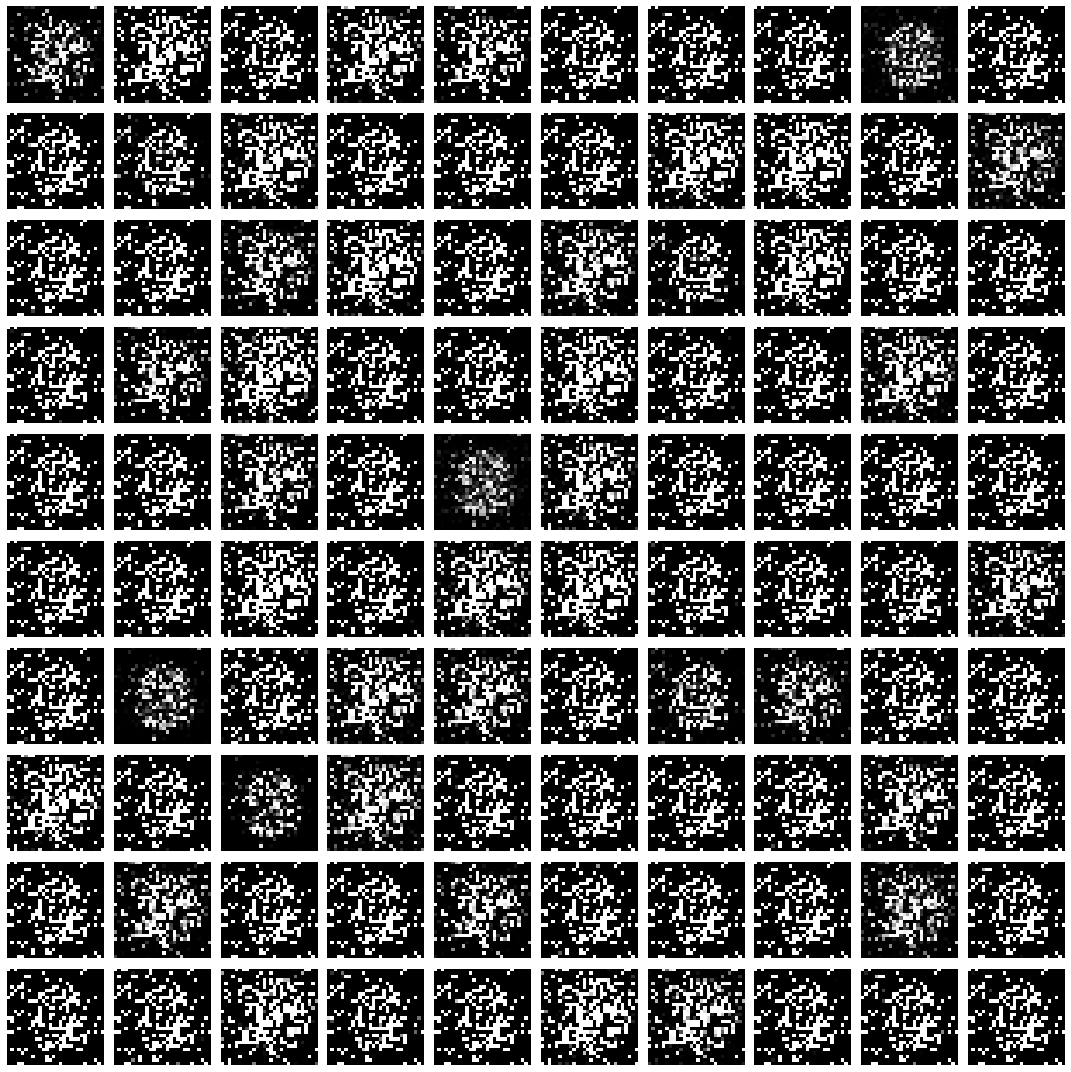

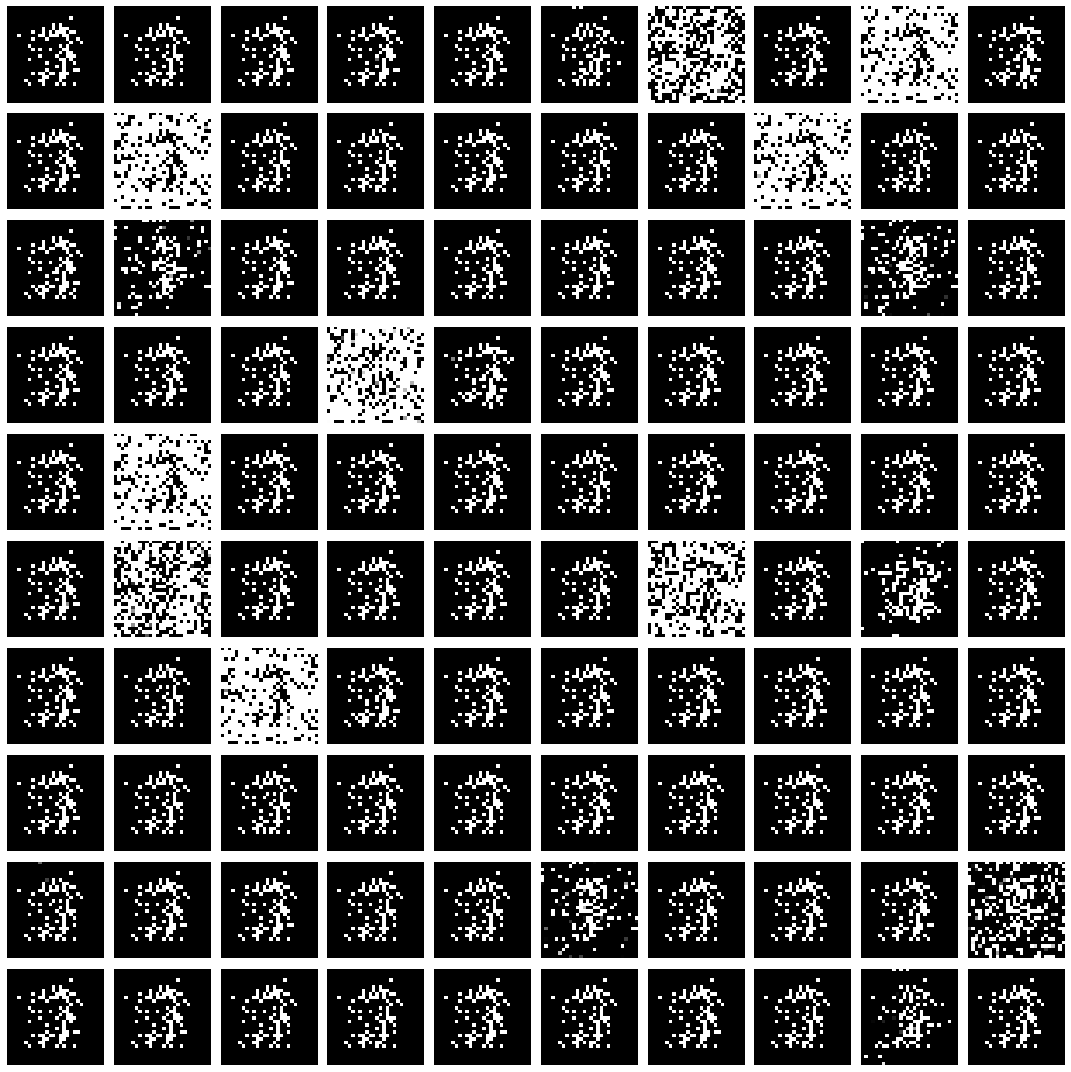

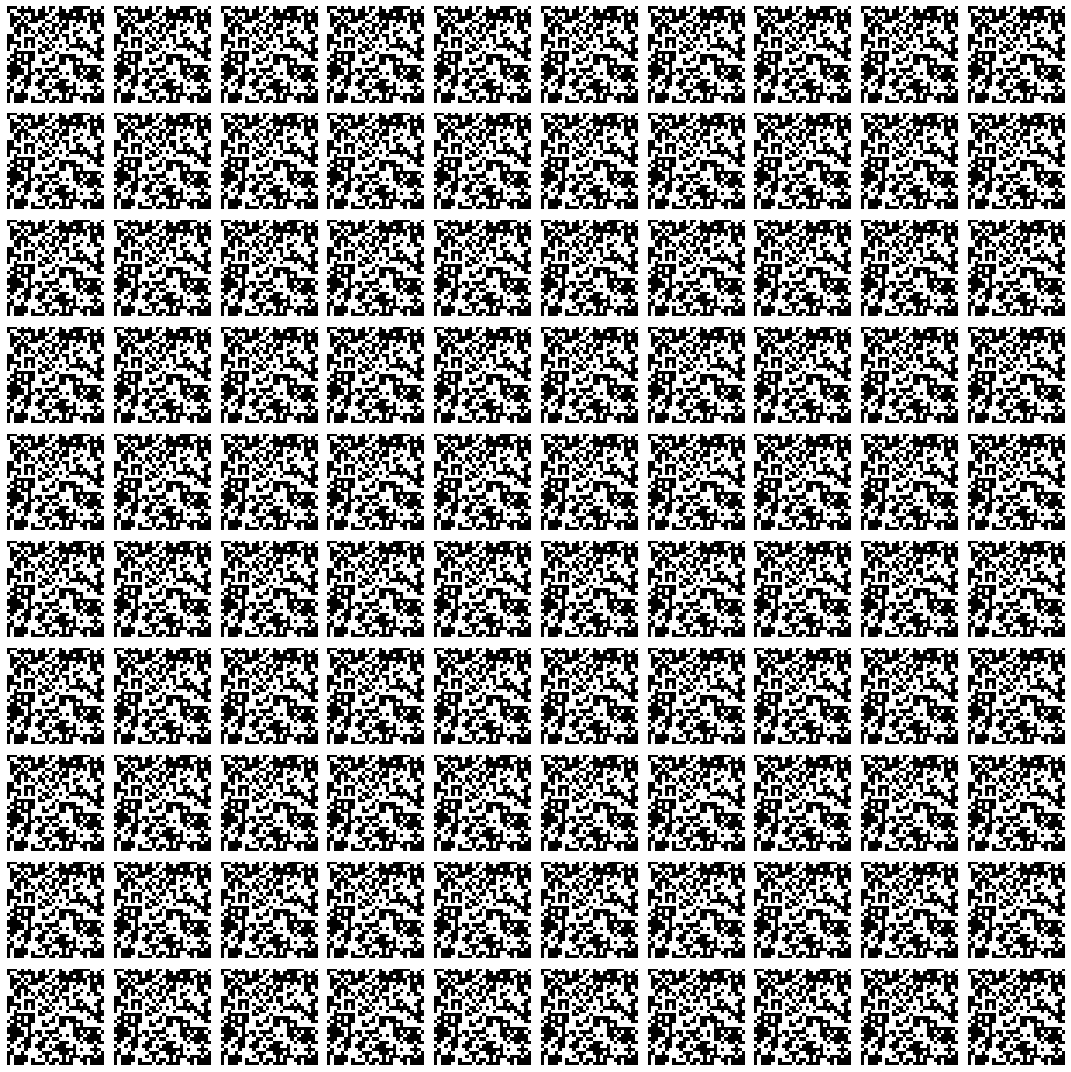

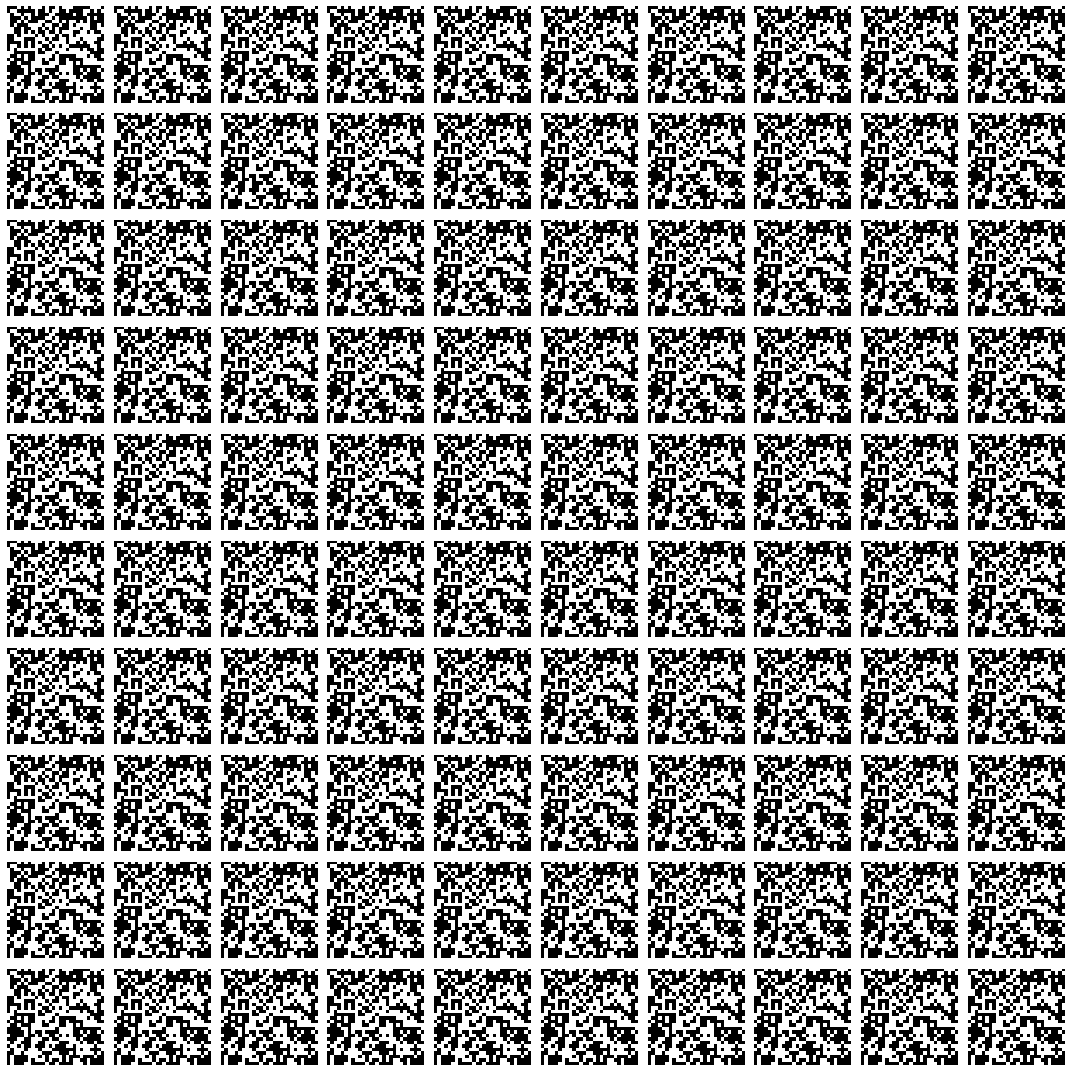

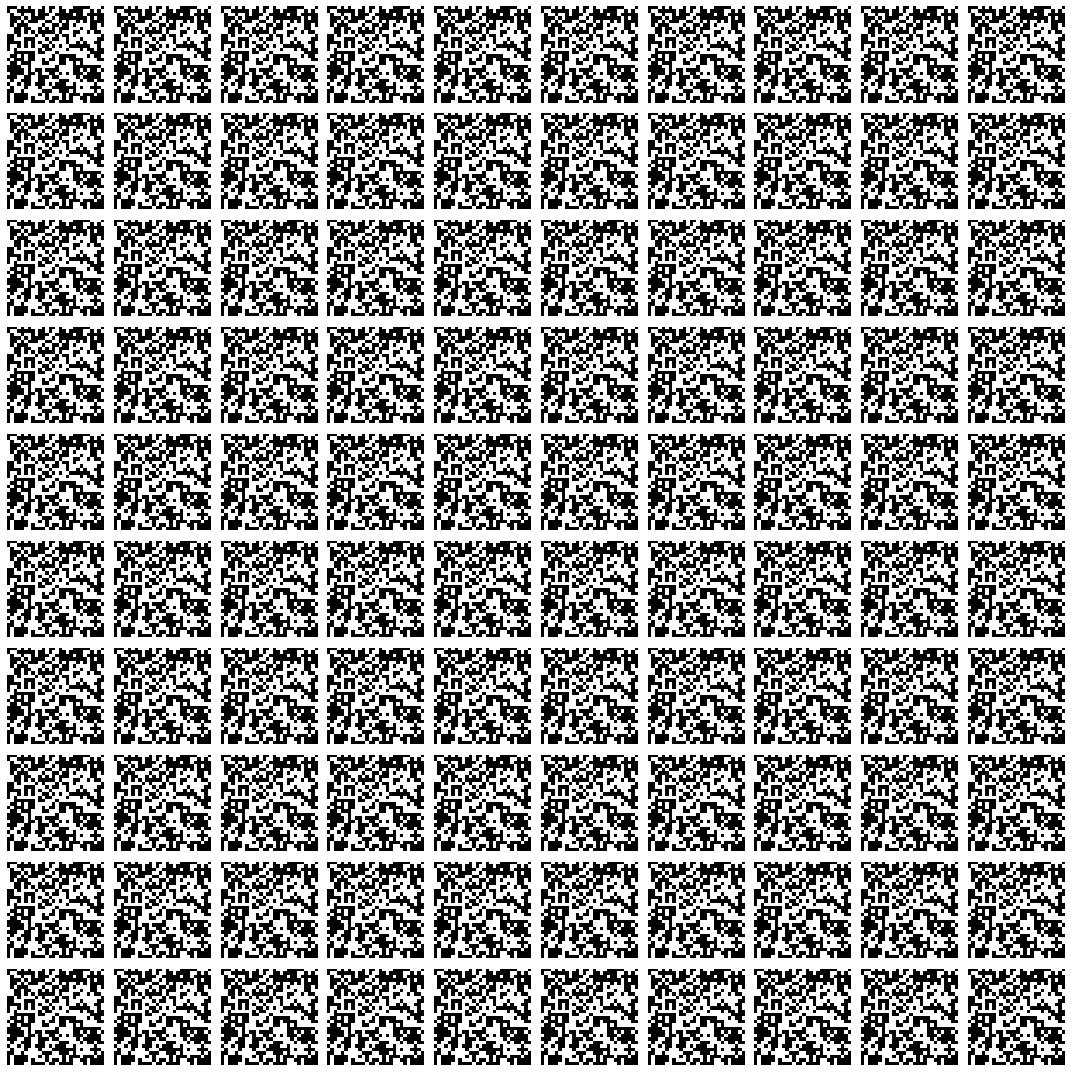

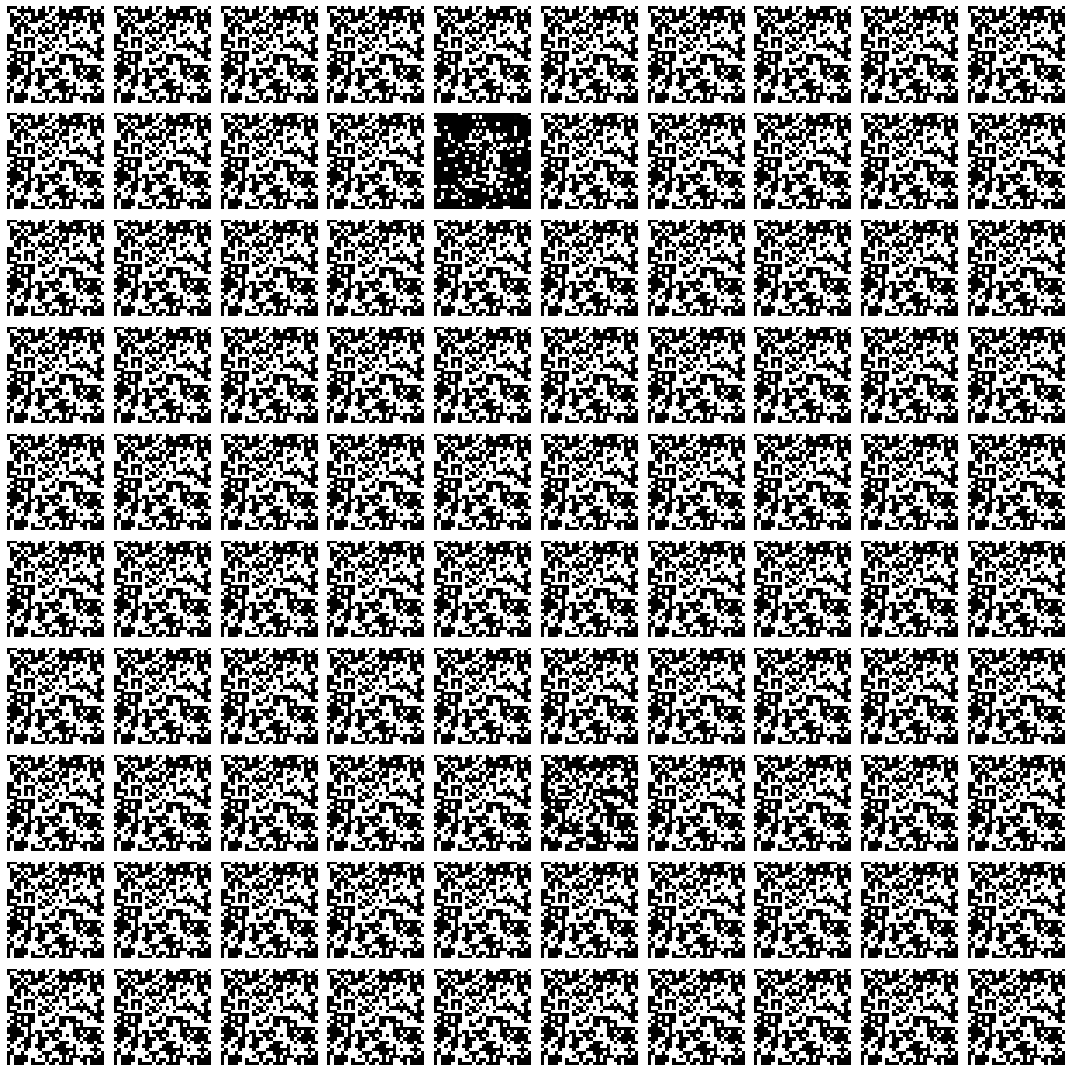

In [8]:
train(X_train,epochs = 50, batch_size = 128)

**Thanks to Renu Khandelwal's [Generative Adversarial Network(GAN) using Keras](https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3)!**
